In [52]:
import numpy as np
import copy
import pandas as pd
import sys
sys.path.insert(0,'../')
from gym_ur.game_of_ur2 import GoUrEnv
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.cm as cm
import dill
import os.path
plt.style.use('ggplot')

In [53]:
def eGreedyActionSelection(env, q_curr, eps, possible_actions, movable_piece_board_pos):
    '''
    Preforms epsilon greedy action selectoin based on the Q-values.
    
    Args:
        env: Environment
        q_curr: A numpy array that contains the Q-values for each action for a state.
        eps: The probability to select a random action. Float between 0 and 1.
        
    Returns:
        The selected action.
    '''
    if np.random.rand() < (1 - eps):
        best_val = np.max(q_curr)
        b_actions=np.arange(q_curr.size, dtype=int)[q_curr==best_val]
        best_action = np.random.choice(b_actions)
        if best_action in movable_piece_board_pos.keys():
            return movable_piece_board_pos[best_action]
        
    return np.random.choice(possible_actions)

In [54]:
class LinearSchedule(object):                                                                                                                                                                                                                                           
    def __init__(self, schedule_timesteps, final_p, initial_p=1.0):                                                                                                                                                                                                     
        '''
        Linear interpolation between initial_p and final_p over                                                                                                                                                                                                      
        schedule_timesteps. After this many timesteps pass final_p is                                                                                                                                                                                                   
        returned.                                                                                                                                                                                                                                                       
                                                                                                                                                                                                                                                                        
        Args:                                                                                                                                                                                                                                                    
            - schedule_timesteps: Number of timesteps for which to linearly anneal initial_p to final_p                                                                                                                                                                                                                                                  
            - initial_p: initial output value                                                                                                                                                                                                                                        
            -final_p: final output value                                                                                                                                                                                                                                          
        '''                                                                                                                                                                                                                                                       
        self.schedule_timesteps = schedule_timesteps                                                                                                                                                                                                                    
        self.final_p = final_p                                                                                                                                                                                                                                          
        self.initial_p = initial_p                                                                                                                                                                                                                                      
                                                                                                                                                                                                                                                                         
    def value(self, t):                                                                                                                                                                                                                                                 
        fraction = min(float(t) / self.schedule_timesteps, 1.0)                                                                                                                                                                                                         
        return self.initial_p + fraction * (self.final_p - self.initial_p)

In [32]:
env = GoUrEnv(4)

In [72]:
def q_learning(env, num_episodes, gamma=1.0, alpha=0.1, 
                start_eps=0.2, final_eps=0.1, annealing_steps=1000):
    '''
    Q-learning algorithm.
    
    Args:
        - env: The environment to train the agent on
        - num_episodes: The number of episodes to train the agent for
        - gamma: The discount factor
        - alpha: The stepsize
        - start_eps: The initial epsilon value for e-greedy action selection
        - final_eps: The final epsilon value for the e-greedy action selection
        - annealing_steps: The number of steps to anneal epsilon over
        - max_episode_steps: The maximum number of steps an episode can take
        
    Returns: (Q_func, episode_rewards, episode_lengths)
        - Q: Dictonary mapping state -> action values
        - episode_rewards: Numpy array containing the reward of each episode during training
        - episode_lengths: Numpy array containing the length of each episode during training
    '''
    init_q_value = 0.0
    Q = defaultdict(lambda: np.ones(env.action_space_n) * init_q_value)
    episode_rewards_p1 = np.zeros(num_episodes-1)
    episode_rewards_p2 = np.zeros(num_episodes-1)
    episode_lengths = np.zeros(num_episodes-1)
    player1 = 0
    player2 = 1
    episode_value_func = []
    v_s = ((3, (('a', 3),)), (3, (('c', 3),)), 1)
    
    exploration = LinearSchedule(annealing_steps, start_eps, final_eps)
    time_to_win = []
    for i in range(num_episodes-1):
        # player 1 move
        dice_up = env.roll()
        state = env.reset(dice_up)
        t = 0
        while True:  
            t += 1
            episode_lengths[i] = t
            
            
            possible_actions, movable_piece_ids, movable_piece_board_pos = env.get_possible_actions(player1, dice_up)
            if len(possible_actions) != 0:
                action = eGreedyActionSelection(env, Q[state], exploration.value(i), possible_actions, movable_piece_board_pos)
                new_state, reward_p1, done, _ = env.step(action, dice_up)
                episode_rewards_p1[i] += reward_p1
                # action['piece_id'] = (player, piece_id)
                # Therefore, use piece_id to save which piece to move in 
                # this state
                Q[state][action['board_pos']] += alpha * (reward_p1 + (gamma*max(Q[new_state])) 
                                                            - Q[state][action['board_pos']])
                
                if done:
                    break
                
                state = new_state
            
            # player 2 move
            dice_up = env.roll()
            possible_actions, movable_piece_ids, movable_piece_board_pos = env.get_possible_actions(player2, dice_up)
            if len(possible_actions) != 0:
                action = eGreedyActionSelection(env, Q[state], exploration.value(i), possible_actions, movable_piece_board_pos)
                new_state, reward_p2, done, _ = env.step(action, dice_up)
                episode_rewards_p2[i] += reward_p2
                # action['piece_id'] = (player, piece_id)
                # Therefore, use piece_id to save which piece to move in 
                # this state
                Q[state][action['board_pos']] += alpha * (reward_p2 + (gamma*max(Q[new_state])) 
                                                            - Q[state][action['board_pos']])
                
                if done:
                    break
                
                # player 1 move
                dice_up = env.roll()
                
                state = new_state
        time_to_win.append(t)
        poli = np.argmax(Q[v_s])
        episode_value_func.append(Q[v_s][poli])    
                
    return Q, episode_rewards_p1, episode_rewards_p2, episode_lengths, time_to_win, episode_value_func

In [73]:
episode_rwds_p1 = []
episode_rwds_p2 = []
total_episodes = 100000
# dir_path = 'TD/pickels/qLearning'

# train agent
q_func_1, episode_rewards_p1, episode_rewards_p2, episode_lengths, time_to_win, episode_value_func = q_learning(env, total_episodes)

# append rewards for each run
episode_rwds_p1.append(episode_rewards_p1)
episode_rwds_p2.append(episode_rewards_p2)

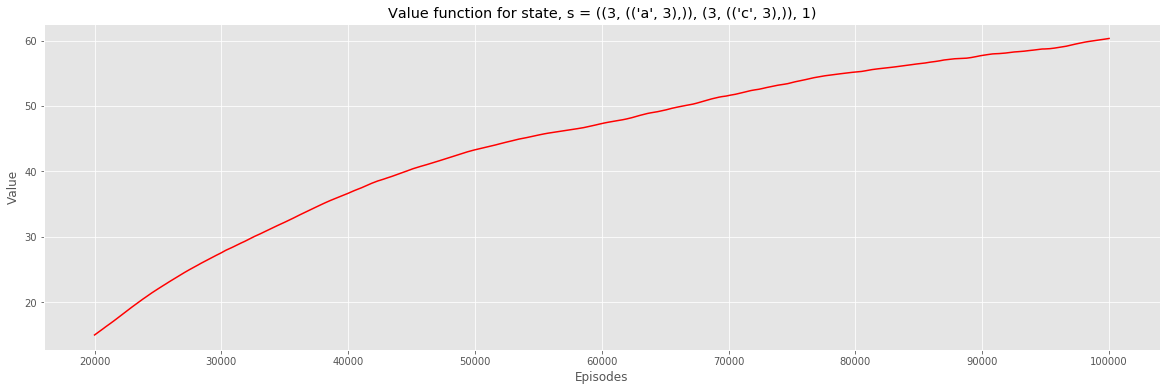

In [74]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(episode_value_func).rolling(20000, min_periods=20000).mean(), color='red')
plt.xlabel('Episodes')
plt.ylabel('Value')
plt.title("Value function for state, s = ((3, (('a', 3),)), (3, (('c', 3),)), 1)")
plt.savefig('value_function_q_learning.jpg', dpi=600)

In [75]:
print(episode_value_func)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

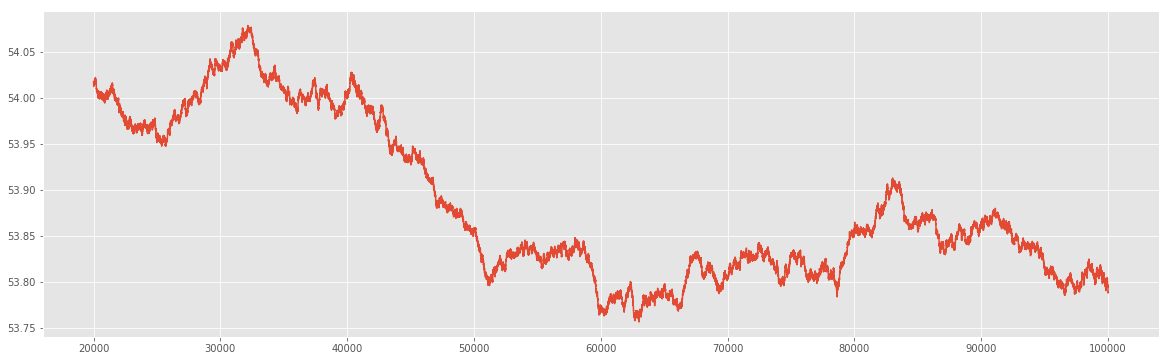

In [35]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(time_to_win).rolling(20000, min_periods=20000).mean())

In [60]:
print(time_to_win)

[61, 54, 47, 43, 52, 63, 59, 64, 57, 53, 61, 52, 64, 55, 48, 51, 43, 61, 51, 45, 60, 57, 56, 41, 59, 55, 45, 67, 58, 49, 46, 59, 50, 50, 57, 58, 54, 48, 52, 41, 60, 42, 61, 59, 53, 46, 50, 58, 57, 50, 41, 42, 57, 47, 50, 41, 64, 52, 47, 55, 57, 51, 62, 70, 56, 61, 50, 51, 50, 52, 54, 50, 53, 65, 60, 43, 47, 55, 60, 57, 42, 47, 57, 57, 55, 45, 49, 51, 48, 46, 42, 52, 55, 51, 51, 52, 61, 49, 59, 46, 58, 47, 57, 75, 54, 59, 64, 53, 41, 57, 55, 48, 43, 53, 55, 58, 49, 41, 57, 51, 40, 62, 47, 64, 59, 59, 47, 49, 39, 66, 63, 62, 53, 61, 46, 78, 56, 50, 54, 41, 55, 46, 49, 57, 50, 58, 49, 41, 57, 55, 52, 53, 63, 56, 58, 41, 61, 55, 39, 66, 61, 49, 57, 58, 42, 72, 56, 47, 54, 64, 42, 67, 66, 47, 57, 47, 58, 58, 50, 64, 51, 47, 63, 65, 60, 65, 54, 39, 64, 53, 54, 58, 64, 49, 67, 53, 51, 70, 53, 52, 51, 46, 52, 61, 59, 45, 50, 61, 66, 51, 65, 47, 62, 49, 61, 64, 54, 63, 57, 47, 47, 69, 55, 41, 48, 64, 57, 61, 53, 65, 55, 48, 52, 42, 65, 55, 57, 62, 60, 69, 56, 64, 36, 38, 68, 48, 42, 62, 38, 57,

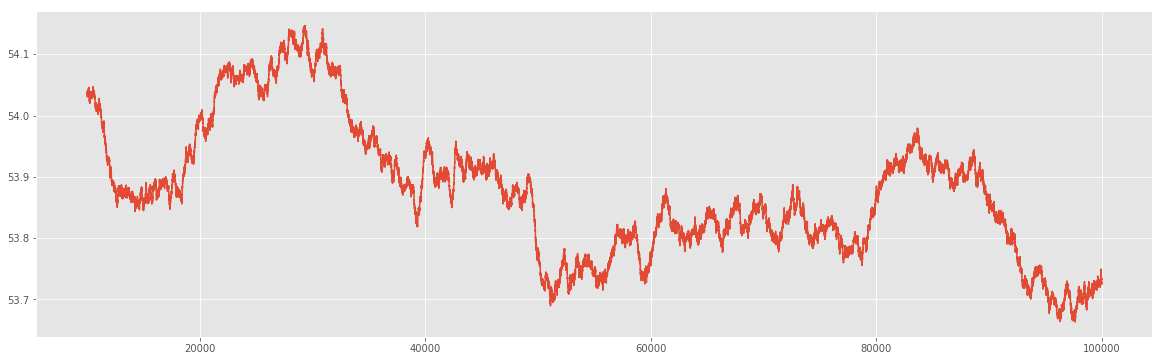

In [36]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(episode_lengths).rolling(10000, min_periods=10000).mean())

In [37]:
# get policy
policy = {}
for key, value in q_func_1.items():
    policy[key] = np.argmax(value)

In [38]:
def random_policy(possible_actions):
    return np.random.choice(possible_actions)

def trained_policy(state, possible_actions, policy, movable_piece_board_pos):
    if state in policy:
        best_action = policy[state]
        if best_action in movable_piece_board_pos.keys():
            return movable_piece_board_pos[best_action]
        
    return np.random.choice(possible_actions)

def test_q_agent(env, num_episodes, policy):
    player1 = 0 # trained
    player2 = 1 # random
    init_q_value = 0.0
    
    episode_rewards_p1 = np.zeros(num_episodes)
    episode_rewards_p2 = np.zeros(num_episodes)
    time_to_win = []
    for i in range(num_episodes):
        episode_transitions_p1 = list()
        episode_transitions_p2 = list()
        dice_up = env.roll()
        state = env.reset(dice_up)
        is_done = False
        t = 0
        
        while True:
            # player 1 move
            t += 1
            
            possible_actions, movable_piece_ids, movable_piece_board_pos = env.get_possible_actions(player1, dice_up)
            reward_p1 = 0
            if len(possible_actions) != 0:
                action = trained_policy(state, possible_actions, policy, movable_piece_board_pos)
                new_state, reward_p1, done, _ = env.step(action, dice_up)
                episode_rewards_p1[i] += reward_p1
                state = copy.deepcopy(new_state)
                
                if done:
                    break
           
            # player 2 move
            dice_up = env.roll()
            possible_actions, movable_piece_ids, movable_piece_board_pos = env.get_possible_actions(player2, dice_up)
            reward_p2 = 0
            if len(possible_actions) != 0:
                action = random_policy(possible_actions)
                new_state, reward_p2, done, _ = env.step(action, dice_up)
                episode_rewards_p2[i] += reward_p2
                state = copy.deepcopy(new_state)

                if done:
                    break
            
            dice_up = env.roll()
        time_to_win.append(t)
        
    return episode_rewards_p1, episode_rewards_p2, episode_lengths, time_to_win

In [55]:
test_episode_rewards_p1, test_episode_rewards_p2, test_episode_lengths, test_time_to_win = test_q_agent(env, 100, policy)

In [56]:
test_avg_trained = np.mean(test_episode_rewards_p1)
test_avg_random = np.mean(test_episode_rewards_p2)
print("Trained Score: ", test_avg_trained/(test_avg_random + test_avg_trained))
print("Random Score: ", test_avg_random/(test_avg_random + test_avg_trained))

Trained Score:  0.5702306079664571
Random Score:  0.42976939203354303


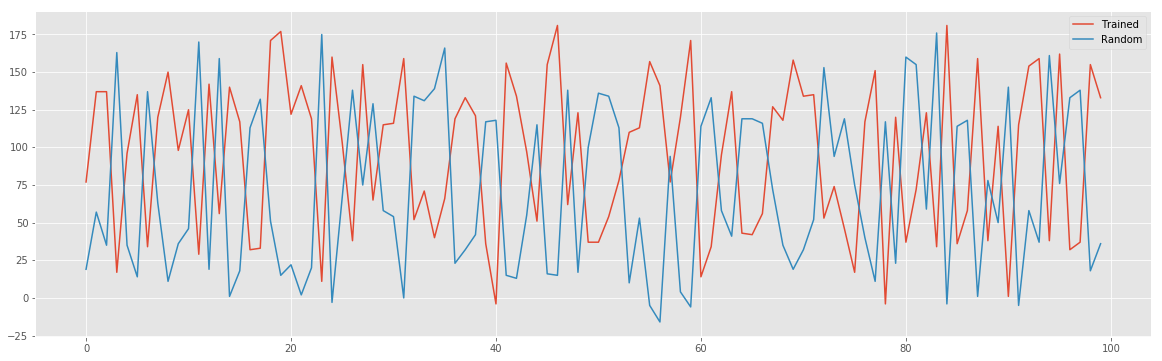

In [57]:
plt.figure(figsize=(20, 6))
trained, = plt.plot(test_episode_rewards_p1[:100], label='Trained')
random, = plt.plot(test_episode_rewards_p2[:100], label='Random')
plt.legend([trained, random], ['Trained', 'Random'])

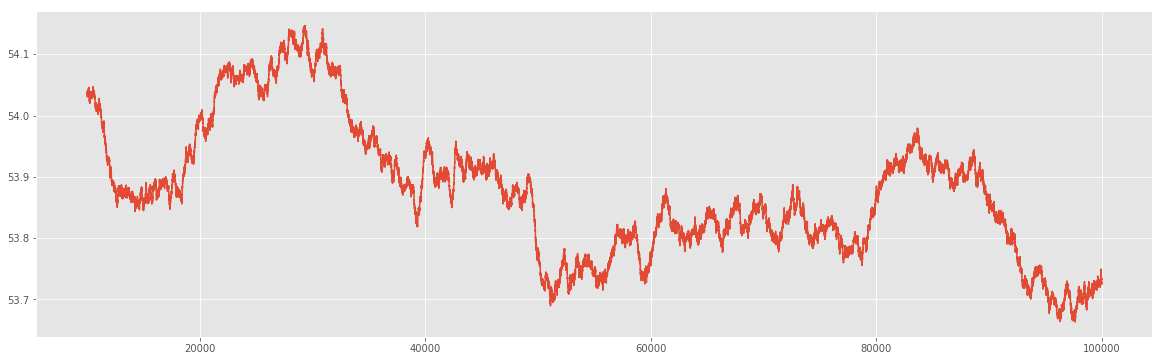

In [59]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(test_episode_lengths).rolling(10000, min_periods=10000).mean())

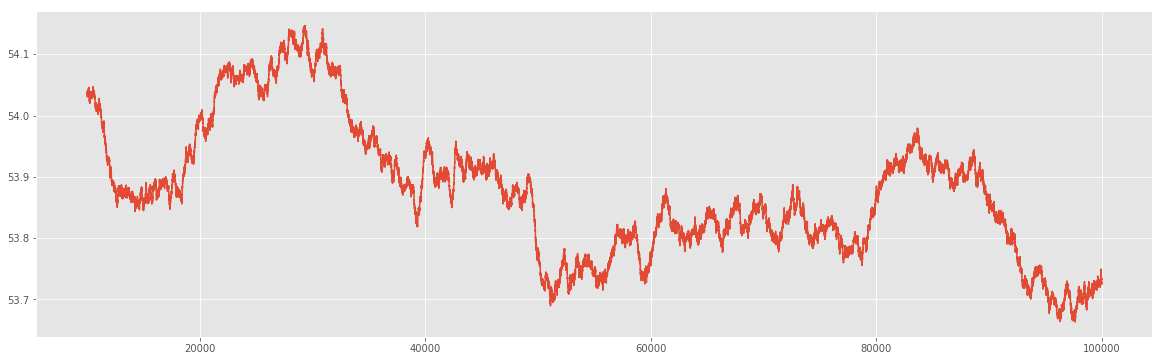

In [44]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(time_to_win).rolling(10000, min_periods=10000).mean())

In [45]:
p1_mean_rwds = np.mean(np.array(episode_rwds_p1[-1]).reshape(1, -1), axis=0)
p2_mean_rwds = np.mean(np.array(episode_rwds_p2[-1]).reshape(1, -1), axis=0)

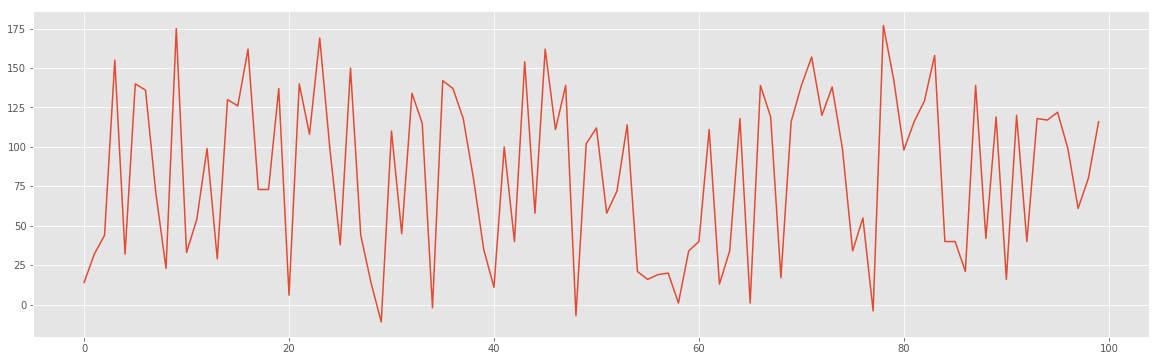

In [46]:
plt.figure(figsize=(20, 6))
plt.plot(p1_mean_rwds[-100:])

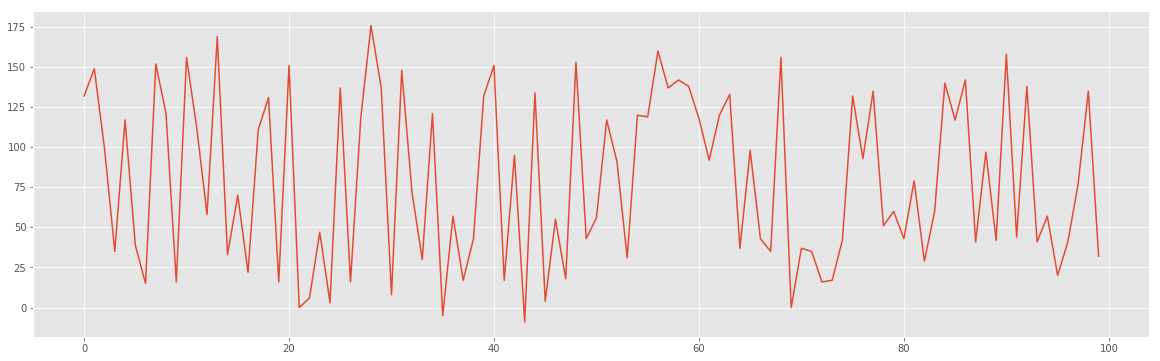

In [47]:
plt.figure(figsize=(20, 6))
plt.plot(p2_mean_rwds[-100:])

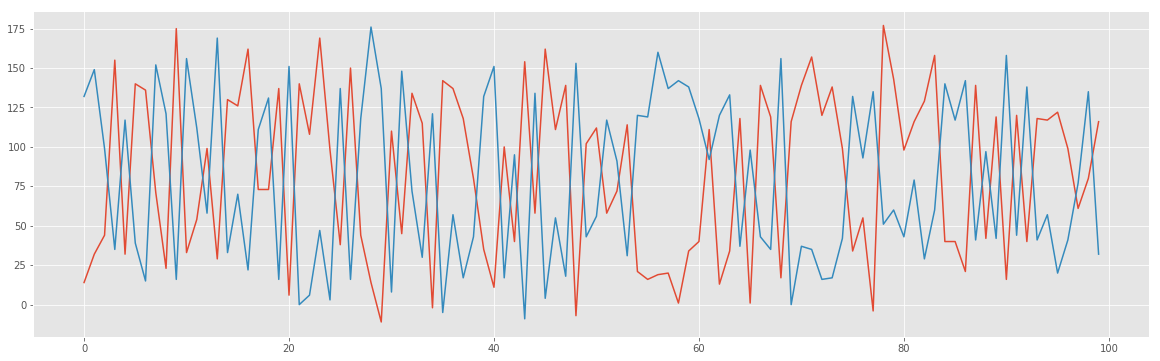

In [48]:
plt.figure(figsize=(20, 6))
plt.plot(p1_mean_rwds[-100:])
plt.plot(p2_mean_rwds[-100:])

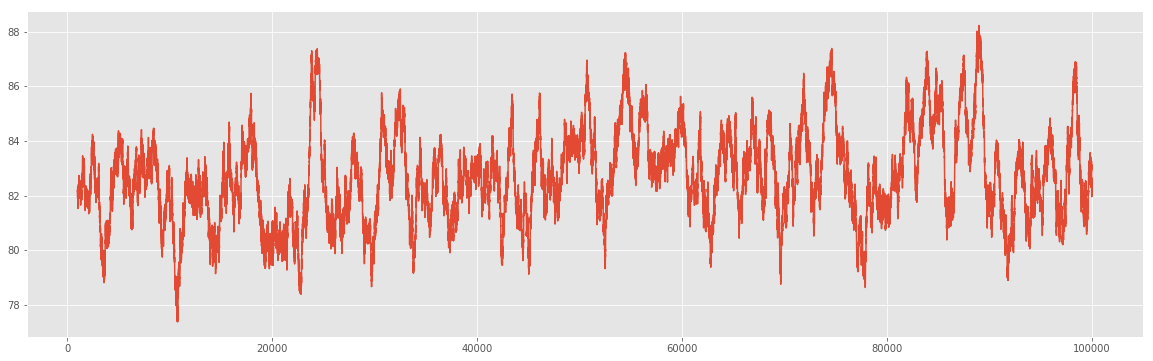

In [49]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(p1_mean_rwds).rolling(1000, min_periods=1000).mean())

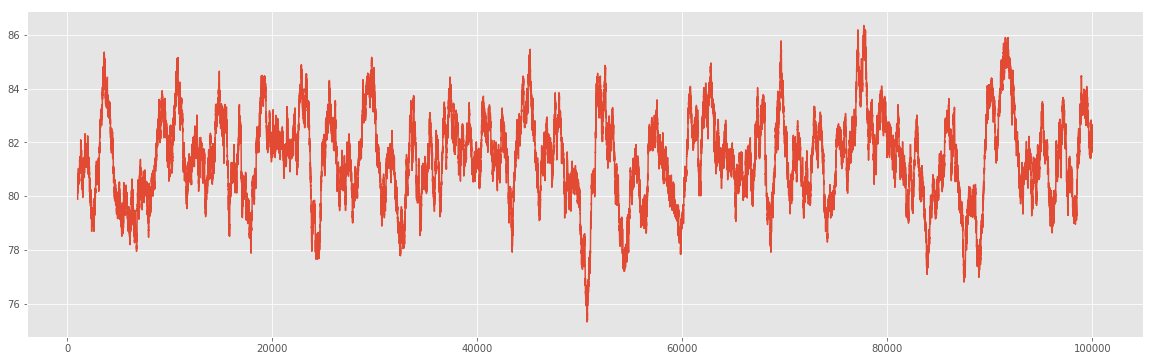

In [50]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(p2_mean_rwds).rolling(1000, min_periods=1000).mean())

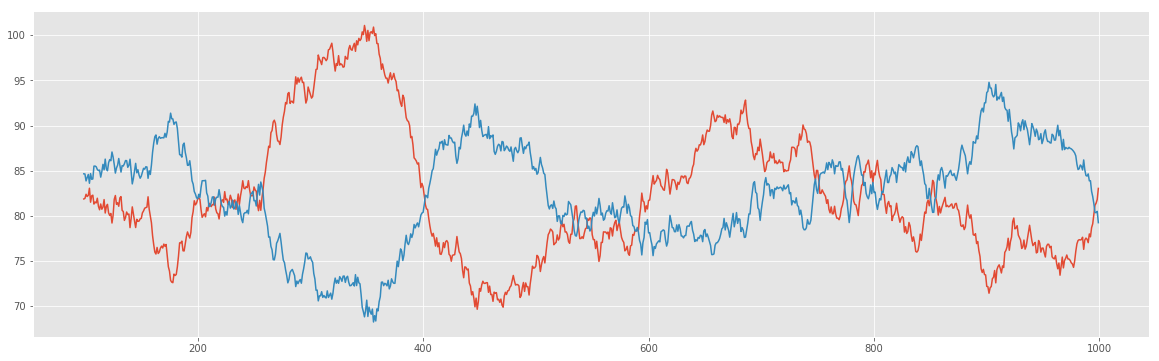

In [51]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(p1_mean_rwds[-1000:]).rolling(100, min_periods=100).mean())
plt.plot(pd.Series(p2_mean_rwds[-1000:]).rolling(100, min_periods=100).mean())

### Plots for Value functions

In [76]:
value_fn_mc = [0.0, 0.0, 0.0, 13.200000000000001, 13.200000000000001, 13.200000000000001, 13.200000000000001, 13.200000000000001, 13.200000000000001, 30.080000000000005, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 45.272000000000006, 56.144800000000004, 56.144800000000004, 56.144800000000004, 56.144800000000004, 56.144800000000004, 56.144800000000004, 56.144800000000004, 56.144800000000004, 56.144800000000004, 56.144800000000004, 56.144800000000004, 56.144800000000004, 56.144800000000004, 68.13032000000001, 68.13032000000001, 68.13032000000001, 68.13032000000001, 68.13032000000001, 68.13032000000001, 68.13032000000001, 68.13032000000001, 68.13032000000001, 68.13032000000001, 68.13032000000001, 68.13032000000001, 68.13032000000001, 68.13032000000001, 68.13032000000001, 68.13032000000001, 71.2021, 77.58189, 77.58189, 77.58189, 77.58189, 77.58189, 77.58189, 77.58189, 86.823701, 86.823701, 86.823701, 93.6413309, 93.6413309, 93.6413309, 93.6413309, 103.87719781, 114.889478029, 114.889478029, 114.889478029, 114.889478029, 114.889478029, 114.889478029, 114.889478029, 120.1005302261, 120.1005302261, 120.1005302261, 121.39047720349001, 121.39047720349001, 121.39047720349001, 121.39047720349001, 121.39047720349001, 121.39047720349001, 121.39047720349001, 121.39047720349001, 121.39047720349001, 121.39047720349001, 121.39047720349001, 121.39047720349001, 121.39047720349001, 121.39047720349001, 121.39047720349001, 121.39047720349001, 121.39047720349001, 121.151429483141, 121.151429483141, 125.8362865348269, 134.6526578813442, 134.6526578813442, 134.6526578813442, 134.6526578813442, 134.6526578813442, 134.6526578813442, 134.6526578813442, 134.6526578813442, 137.28739209320977, 137.28739209320977, 137.28739209320977, 143.1586528838888, 143.1586528838888, 143.1586528838888, 143.1586528838888, 143.1586528838888, 143.1586528838888, 143.1586528838888, 143.1586528838888, 143.1586528838888, 143.1586528838888, 143.1586528838888, 143.1586528838888, 143.54278759549993, 143.54278759549993, 143.54278759549993, 143.54278759549993, 143.54278759549993, 143.54278759549993, 143.54278759549993, 143.54278759549993, 143.54278759549993, 140.18850883594993, 140.18850883594993, 140.18850883594993, 140.18850883594993, 140.18850883594993, 140.18850883594993, 138.26965795235495, 138.26965795235495, 138.26965795235495, 138.26965795235495, 138.26965795235495, 138.26965795235495, 138.26965795235495, 138.26965795235495, 138.26965795235495, 138.26965795235495, 138.26965795235495, 138.26965795235495, 138.26965795235495, 138.26965795235495, 144.14269215711946, 144.14269215711946, 144.14269215711946, 144.14269215711946, 144.14269215711946, 144.14269215711946, 144.14269215711946, 144.14269215711946, 148.8284229414075, 148.8284229414075, 148.8284229414075, 148.8284229414075, 148.8284229414075, 146.14558064726674, 146.14558064726674, 145.73102258254008, 145.73102258254008, 145.73102258254008, 145.73102258254008, 145.73102258254008, 145.73102258254008, 149.65792032428607, 149.65792032428607, 149.65792032428607, 149.65792032428607, 151.89212829185746, 151.89212829185746, 151.89212829185746, 151.89212829185746, 151.89212829185746, 151.89212829185746, 153.10291546267172, 153.10291546267172, 153.10291546267172, 153.10291546267172, 153.10291546267172, 153.10291546267172, 153.10291546267172, 153.10291546267172, 153.10291546267172, 153.10291546267172, 153.10291546267172, 151.09262391640453, 151.09262391640453, 151.09262391640453, 151.09262391640453, 151.09262391640453, 151.09262391640453, 151.09262391640453, 151.09262391640453, 151.09262391640453, 151.09262391640453, 151.09262391640453, 146.5833615247641, 146.5833615247641, 145.32502537228768, 145.32502537228768, 145.32502537228768, 145.32502537228768, 145.32502537228768, 145.32502537228768, 143.29252283505892, 143.29252283505892, 143.29252283505892, 143.29252283505892, 143.29252283505892, 143.29252283505892, 143.29252283505892, 143.29252283505892, 143.29252283505892, 143.29252283505892, 143.29252283505892, 144.46327055155302, 144.46327055155302, 144.46327055155302, 144.46327055155302, 155.41694349639772, 155.41694349639772, 155.41694349639772, 155.41694349639772, 155.41694349639772, 155.41694349639772, 159.77524914675794, 159.77524914675794, 159.77524914675794, 159.77524914675794, 159.77524914675794, 159.77524914675794, 159.77524914675794, 159.77524914675794, 159.77524914675794, 159.77524914675794, 159.77524914675794, 159.77524914675794, 159.77524914675794, 159.77524914675794, 159.77524914675794, 159.77524914675794, 157.09772423208216, 157.09772423208216, 157.09772423208216, 160.98795180887393, 160.98795180887393, 156.58915662798654, 156.58915662798654, 154.4302409651879, 154.2872168686691, 154.2872168686691, 154.2872168686691, 158.2584951818022, 158.2584951818022, 158.2584951818022, 158.2584951818022, 158.2584951818022, 158.2584951818022, 158.2584951818022, 158.2584951818022, 158.2584951818022, 158.2584951818022, 158.2584951818022, 158.2584951818022, 158.2584951818022, 158.2584951818022, 158.2584951818022, 158.2584951818022, 158.2584951818022, 162.032645663622, 162.0293810972598, 159.92644298753382, 164.53379868878045, 164.53379868878045, 163.5804188199024, 163.5804188199024, 163.5804188199024, 163.5804188199024, 165.02237693791216, 165.02237693791216, 165.02237693791216, 165.02237693791216, 165.02237693791216, 165.02237693791216, 165.02237693791216, 165.02237693791216, 165.02237693791216, 165.02237693791216, 165.02237693791216, 166.62013924412094, 166.62013924412094, 166.62013924412094, 166.62013924412094, 166.62013924412094, 166.62013924412094, 166.62013924412094, 166.45812531970884, 166.45812531970884, 166.45812531970884, 166.45812531970884, 166.45812531970884, 166.45812531970884, 166.45812531970884, 166.45812531970884, 166.45812531970884, 165.71231278773797, 165.34108150896418, 165.34108150896418, 165.34108150896418, 165.34108150896418, 165.34108150896418, 165.34108150896418, 165.34108150896418, 165.34108150896418, 165.34108150896418, 165.34108150896418, 165.34108150896418, 165.34108150896418, 165.34108150896418, 165.34108150896418, 165.34108150896418, 165.34108150896418, 165.34108150896418, 165.34108150896418, 164.90697335806777, 164.90697335806777, 164.90697335806777, 164.90697335806777, 164.90697335806777, 161.71627602226098, 161.71627602226098, 157.8446484200349, 157.8446484200349, 157.8446484200349, 157.8446484200349, 158.5601835780314, 158.5601835780314, 158.5601835780314, 158.5601835780314, 158.5601835780314, 158.5601835780314, 158.5601835780314, 158.5601835780314, 158.5601835780314, 158.5601835780314, 158.5601835780314, 158.5601835780314, 158.5601835780314, 158.5601835780314, 158.5601835780314, 158.5601835780314, 158.5601835780314, 161.50416522022826, 164.75374869820544, 164.75374869820544, 163.9783738283849, 163.9783738283849, 163.9783738283849, 163.9783738283849, 163.9783738283849, 163.9783738283849, 163.9783738283849, 163.9783738283849, 163.9783738283849, 163.9783738283849, 163.9783738283849, 161.2805364455464, 161.2805364455464, 161.2805364455464, 161.2805364455464, 161.2805364455464, 161.2805364455464, 161.2805364455464, 161.2805364455464, 161.2805364455464, 161.2805364455464, 161.2805364455464, 161.2805364455464, 161.2805364455464, 161.2805364455464, 161.05248280099175, 161.05248280099175, 161.05248280099175, 161.05248280099175, 162.14723452089257, 162.14723452089257, 162.14723452089257, 162.14723452089257, 162.14723452089257, 162.23251106880332, 162.23251106880332, 162.23251106880332, 163.70925996192298, 163.70925996192298, 163.70925996192298, 163.70925996192298, 163.70925996192298, 161.73833396573067, 161.73833396573067, 161.73833396573067, 161.73833396573067, 161.73833396573067, 161.2645005691576, 161.2645005691576, 161.2645005691576, 163.13805051224185, 163.13805051224185, 163.13805051224185, 163.13805051224185, 163.13805051224185, 163.13805051224185, 164.32424546101765, 164.32424546101765, 167.2918209149159, 167.2918209149159, 167.2918209149159, 167.2918209149159, 167.2918209149159, 167.2918209149159, 167.2918209149159, 167.2918209149159, 167.2918209149159, 161.9626388234243, 157.96637494108188, 157.96637494108188, 157.96637494108188, 157.96637494108188, 157.96637494108188, 157.96637494108188, 157.96637494108188, 162.46973744697368, 162.46973744697368, 162.46973744697368, 162.46973744697368, 162.46973744697368, 162.46973744697368, 162.46973744697368, 162.46973744697368, 162.46973744697368, 162.46973744697368, 162.46973744697368, 162.1227637022763, 162.1227637022763, 162.1227637022763, 162.1227637022763, 162.1227637022763, 165.91048733204866, 165.91048733204866, 165.91048733204866, 165.91048733204866, 165.91048733204866, 165.91048733204866, 165.91048733204866, 166.41943859884378, 169.7774947389594, 165.89974526506347, 165.89974526506347, 165.89974526506347, 165.89974526506347, 165.89974526506347, 165.89974526506347, 165.89974526506347, 165.89974526506347, 165.89974526506347, 165.89974526506347, 167.4097707385571, 167.4097707385571, 167.4097707385571, 167.4097707385571, 167.4097707385571, 167.4097707385571, 167.4097707385571, 167.4097707385571, 167.4097707385571, 167.4097707385571, 167.4097707385571, 167.4097707385571, 167.4097707385571, 167.4097707385571, 167.4097707385571, 167.4097707385571, 167.4097707385571, 167.4097707385571, 167.4097707385571, 167.1687936647014, 167.1687936647014, 167.1687936647014, 167.1687936647014, 167.1687936647014, 167.1687936647014, 167.1687936647014, 167.1687936647014, 167.1687936647014, 167.1687936647014, 167.1687936647014, 167.1687936647014, 165.45191429823126, 165.45191429823126, 162.40672286840814, 162.40672286840814, 162.40672286840814, 159.5660505815673, 159.5660505815673, 159.5660505815673, 159.5660505815673, 159.5660505815673, 159.5660505815673, 159.5660505815673, 160.5094455234106, 162.95850097106953, 162.95850097106953, 162.95850097106953, 162.95850097106953, 162.95850097106953, 162.95850097106953, 162.95850097106953, 162.95850097106953, 162.95850097106953, 162.95850097106953, 162.95850097106953, 160.96265087396256, 160.96265087396256, 160.96265087396256, 160.96265087396256, 162.1663857865663, 162.1663857865663, 162.1663857865663, 162.1663857865663, 162.1663857865663, 162.1663857865663, 162.1663857865663, 162.1663857865663, 162.1663857865663, 162.1663857865663, 162.1663857865663, 162.1663857865663, 162.1663857865663, 162.1663857865663, 157.34974720790967, 157.34974720790967, 157.34974720790967, 160.1147724871187, 155.20329523840684, 155.20329523840684, 155.20329523840684, 155.20329523840684, 155.20329523840684, 155.20329523840684, 155.20329523840684, 155.20329523840684, 155.20329523840684, 155.20329523840684, 155.20329523840684, 155.20329523840684, 155.20329523840684, 155.20329523840684, 156.48296571456615, 156.48296571456615, 158.33466914310952, 158.33466914310952, 158.33466914310952, 158.33466914310952, 158.33466914310952, 158.33466914310952, 158.33466914310952, 158.33466914310952, 158.33466914310952, 158.33466914310952, 158.33466914310952, 158.33466914310952, 158.33466914310952, 158.33466914310952, 158.33466914310952, 164.00120222879858, 164.00120222879858, 164.00120222879858, 161.9010820059187, 168.01097380532684, 169.00987642479416, 169.00987642479416, 169.00987642479416, 169.00987642479416, 169.00987642479416, 169.00987642479416, 169.00987642479416, 169.00987642479416, 169.00987642479416, 173.30888878231474, 173.30888878231474, 173.30888878231474, 171.27799990408326, 171.27799990408326, 171.27799990408326, 171.27799990408326, 168.15019991367492, 169.43517992230744, 169.43517992230744, 169.43517992230744, 169.43517992230744, 169.43517992230744, 169.43517992230744, 169.43517992230744, 169.43517992230744, 169.43517992230744, 169.43517992230744, 169.43517992230744, 169.43517992230744, 169.8916619300767, 169.8916619300767, 169.8916619300767, 169.8916619300767, 169.8916619300767, 169.8916619300767, 169.8916619300767, 169.8916619300767, 167.10249573706903, 167.10249573706903, 171.89224616336213, 171.89224616336213, 171.89224616336213, 171.89224616336213, 171.89224616336213, 168.8030215470259, 168.8030215470259, 168.8030215470259, 168.8030215470259, 168.8030215470259, 168.8030215470259, 168.8030215470259, 168.8030215470259, 168.8030215470259, 168.8030215470259, 168.8030215470259, 168.8030215470259, 166.02271939232332, 166.02271939232332, 166.02271939232332, 166.02271939232332, 169.620447453091, 169.620447453091, 169.620447453091, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 170.2584027077819, 167.1325624370037, 167.1325624370037, 167.1325624370037, 160.81930619330333, 160.81930619330333, 160.81930619330333, 160.81930619330333, 160.81930619330333, 160.81930619330333, 160.81930619330333, 160.81930619330333, 160.81930619330333, 160.81930619330333, 160.81930619330333, 160.81930619330333, 160.81930619330333, 160.81930619330333, 160.81930619330333, 160.81930619330333, 160.81930619330333, 158.937375573973, 159.6436380165757, 159.6436380165757, 159.6436380165757, 160.57927421491812, 160.57927421491812, 160.57927421491812, 160.57927421491812, 160.57927421491812, 160.57927421491812, 160.57927421491812, 160.57927421491812, 158.2213467934263, 158.2213467934263, 160.19921211408368, 160.19921211408368, 160.19921211408368, 158.07929090267533, 157.17136181240778, 161.05422563116701, 161.05422563116701, 161.05422563116701, 161.05422563116701, 161.05422563116701, 161.05422563116701, 161.05422563116701, 160.54880306805032, 160.54880306805032, 160.54880306805032, 160.54880306805032, 158.5939227612453, 158.5939227612453, 158.5939227612453, 158.5939227612453, 158.5939227612453, 154.03453048512077, 154.03453048512077, 154.03453048512077, 154.03453048512077, 154.03453048512077, 154.03453048512077, 154.03453048512077, 160.03107743660868, 160.03107743660868, 160.03107743660868, 160.03107743660868, 160.03107743660868, 163.62796969294783, 163.62796969294783, 163.62796969294783, 163.62796969294783, 163.62796969294783, 163.62796969294783, 163.62796969294783, 163.62796969294783, 165.86517272365305, 165.86517272365305, 165.86517272365305, 165.86517272365305, 165.86517272365305, 165.86517272365305, 165.86517272365305, 165.86517272365305, 165.86517272365305, 165.86517272365305, 165.86517272365305, 165.86517272365305, 165.86517272365305, 165.86517272365305, 165.86517272365305, 165.86517272365305, 165.86517272365305, 165.86517272365305, 165.86517272365305, 165.86517272365305, 165.86517272365305, 168.17865545128774, 168.17865545128774, 168.17865545128774, 168.17865545128774, 168.36078990615897, 172.02471091554307, 172.02471091554307, 172.02471091554307, 170.42223982398878, 170.42223982398878, 170.42223982398878, 170.42223982398878, 170.42223982398878, 170.42223982398878, 170.42223982398878, 170.42223982398878, 168.1800158415899, 168.1800158415899, 168.1800158415899, 168.1800158415899, 168.1800158415899, 168.1800158415899, 168.1800158415899, 168.1800158415899, 168.1800158415899, 168.1800158415899, 168.1800158415899, 168.1800158415899, 168.1800158415899, 168.1800158415899, 165.3620142574309, 165.3620142574309, 165.3620142574309, 165.3620142574309, 165.3620142574309, 165.3620142574309, 166.62581283168782, 166.62581283168782, 166.62581283168782, 164.46323154851905, 162.11690839366713, 162.11690839366713, 162.11690839366713, 162.11690839366713, 162.11690839366713, 162.11690839366713, 162.11690839366713, 162.11690839366713, 162.11690839366713, 162.11690839366713, 162.11690839366713, 162.11690839366713, 162.11690839366713, 162.11690839366713, 162.11690839366713, 162.11690839366713, 162.11690839366713, 162.4052175543004, 162.4052175543004, 162.4052175543004, 162.4052175543004, 162.4052175543004, 160.16469579887035, 160.16469579887035, 160.16469579887035, 160.16469579887035, 160.16469579887035, 160.16469579887035, 160.16469579887035, 160.16469579887035, 159.14822621898332, 159.14822621898332, 162.233403597085, 162.233403597085, 162.233403597085, 162.233403597085, 159.81006323737648, 159.81006323737648, 159.81006323737648, 156.92905691363885, 156.92905691363885, 156.92905691363885, 156.92905691363885, 161.63615122227498, 161.47253610004748, 161.47253610004748, 161.47253610004748, 161.47253610004748, 161.47253610004748, 161.47253610004748, 161.47253610004748, 162.42528249004272, 162.42528249004272, 162.42528249004272, 162.42528249004272, 162.42528249004272, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 164.68275424103845, 168.3144788169346, 168.3144788169346, 168.3144788169346, 168.3144788169346, 168.3144788169346, 168.3144788169346, 168.3144788169346, 168.3144788169346, 168.3144788169346, 168.3144788169346, 168.3144788169346, 168.3144788169346, 168.3144788169346, 165.68303093524116, 165.68303093524116, 165.68303093524116, 161.11472784171704, 161.11472784171704, 161.11472784171704, 161.11472784171704, 162.00325505754535, 162.00325505754535, 162.00325505754535, 162.00325505754535, 162.00325505754535, 162.00325505754535, 160.70292955179082, 160.70292955179082, 160.70292955179082, 164.43263659661173, 164.43263659661173, 164.43263659661173, 164.43263659661173, 164.43263659661173, 159.88937293695056, 159.88937293695056, 163.2004356432555, 161.88039207892996, 161.88039207892996, 161.88039207892996, 161.88039207892996, 161.88039207892996, 161.88039207892996, 161.19235287103697, 161.19235287103697, 154.37311758393326, 154.37311758393326, 154.37311758393326, 154.37311758393326, 154.37311758393326, 154.37311758393326, 154.37311758393326, 154.37311758393326, 154.37311758393326, 159.73580582553993, 159.73580582553993, 159.73580582553993, 159.73580582553993, 159.73580582553993, 159.73580582553993, 159.73580582553993, 159.73580582553993, 159.73580582553993, 159.73580582553993, 161.66222524298593, 161.66222524298593, 161.66222524298593, 161.66222524298593, 157.79600271868733, 157.79600271868733, 157.79600271868733, 157.79600271868733, 157.79600271868733, 157.79600271868733, 157.79600271868733, 157.79600271868733, 157.79600271868733, 157.79600271868733, 157.79600271868733, 157.79600271868733, 160.2164024468186, 160.2164024468186, 160.2164024468186, 160.2164024468186, 160.2164024468186, 160.2164024468186, 160.2164024468186, 160.2164024468186, 159.69476220213673, 159.69476220213673, 159.69476220213673, 159.69476220213673, 159.69476220213673, 159.69476220213673, 159.69476220213673, 159.69476220213673, 161.12528598192307, 159.51275738373076, 159.51275738373076, 159.51275738373076, 159.51275738373076, 159.51275738373076, 159.51275738373076, 159.51275738373076, 159.51275738373076, 159.51275738373076, 159.51275738373076, 159.51275738373076, 159.51275738373076, 159.51275738373076, 159.51275738373076, 161.56148164535767, 161.56148164535767, 161.56148164535767, 161.56148164535767, 161.56148164535767, 160.7053334808219, 160.7053334808219, 160.7053334808219, 160.7053334808219, 161.1348001327397, 161.1348001327397, 159.82132011946575, 159.82132011946575, 159.82132011946575, 159.23918810751917, 159.23918810751917, 159.23918810751917, 159.23918810751917, 159.23918810751917, 159.23918810751917, 159.23918810751917, 159.23918810751917, 159.23918810751917, 159.23918810751917, 159.23918810751917, 159.23918810751917, 159.23918810751917, 153.8079793402019, 153.01526929676726, 153.01526929676726, 153.01526929676726, 153.01526929676726, 153.01526929676726, 153.01526929676726, 153.01526929676726, 152.11374236709054, 152.0271814061817, 152.82213131734335, 152.82213131734335, 152.82213131734335, 152.82213131734335, 154.839918185609, 154.839918185609, 154.839918185609, 154.839918185609, 154.839918185609, 156.5559263670481, 156.5559263670481, 152.30033373034328, 152.30033373034328, 152.30033373034328, 152.30033373034328, 152.30033373034328, 152.30033373034328, 152.30033373034328, 152.30033373034328, 154.27030035730894, 154.27030035730894, 156.64327032157806, 156.64327032157806, 156.64327032157806, 156.64327032157806, 156.64327032157806, 156.64327032157806, 156.64327032157806, 156.64327032157806, 156.64327032157806, 156.64327032157806, 156.64327032157806, 156.64327032157806, 156.64327032157806, 156.64327032157806, 158.57894328942024, 158.57894328942024, 158.57894328942024, 158.57894328942024, 158.57894328942024, 158.57894328942024, 158.57894328942024, 158.57894328942024, 158.57894328942024, 158.57894328942024, 158.57894328942024, 161.8210489604782, 161.8210489604782, 161.8210489604782, 161.8210489604782, 161.8210489604782, 161.8210489604782, 159.03894406443038, 159.03894406443038, 159.03894406443038, 159.03894406443038, 166.33504965798735, 166.33504965798735, 166.33504965798735, 166.33504965798735, 166.33504965798735, 166.33504965798735, 166.33504965798735, 166.33504965798735, 166.33504965798735, 166.33504965798735, 166.33504965798735, 166.33504965798735, 169.70154469218863, 169.70154469218863, 169.70154469218863, 167.73139022296976, 167.73139022296976, 167.73139022296976, 167.73139022296976, 167.73139022296976, 167.73139022296976, 167.73139022296976, 167.73139022296976, 167.73139022296976, 167.73139022296976, 166.85825120067278, 166.85825120067278, 166.85825120067278, 166.85825120067278, 166.85825120067278, 166.85825120067278, 159.0724260806055, 159.0724260806055, 159.0724260806055, 159.0724260806055, 159.36518347254497, 159.36518347254497, 159.36518347254497, 159.36518347254497, 157.02866512529047, 157.02866512529047, 157.02866512529047, 157.02866512529047, 157.02866512529047, 157.02866512529047, 159.02579861276143, 159.02579861276143, 159.02579861276143, 159.02579861276143, 159.02579861276143, 159.02579861276143, 159.02579861276143, 159.02579861276143, 159.02579861276143, 159.02579861276143, 159.02579861276143, 159.02579861276143, 159.02579861276143, 159.1232187514853, 159.1232187514853, 159.1232187514853, 159.1232187514853, 159.1232187514853, 159.1232187514853, 159.1232187514853, 159.1232187514853, 157.41089687633678, 157.41089687633678, 157.41089687633678, 157.41089687633678, 157.41089687633678, 157.41089687633678, 157.41089687633678, 157.41089687633678, 157.41089687633678, 157.41089687633678, 154.3698071887031, 154.3698071887031, 154.3698071887031, 154.3698071887031, 154.3698071887031, 154.3698071887031, 154.3698071887031, 154.3698071887031, 154.3698071887031, 154.3698071887031, 154.3698071887031, 152.4328264698328, 152.4328264698328, 152.4328264698328, 152.4328264698328, 152.4328264698328, 152.4328264698328, 152.4328264698328, 152.4328264698328, 152.4328264698328, 152.4328264698328, 152.4328264698328, 152.4328264698328, 152.4328264698328, 152.4328264698328, 152.4328264698328, 152.4328264698328, 152.38954382284953, 152.38954382284953, 152.38954382284953, 152.38954382284953, 152.38954382284953, 152.38954382284953, 152.38954382284953, 152.38954382284953, 152.38954382284953, 152.38954382284953, 152.38954382284953, 152.38954382284953, 152.38954382284953, 152.38954382284953, 152.38954382284953, 152.38954382284953, 152.38954382284953, 152.38954382284953, 152.38954382284953, 152.38954382284953, 152.38954382284953, 152.38954382284953, 154.8505894405646, 154.8505894405646, 154.8505894405646, 154.8505894405646, 154.8505894405646, 154.8505894405646, 152.46553049650814, 152.46553049650814, 152.46553049650814, 152.46553049650814, 152.46553049650814, 152.46553049650814, 152.46553049650814, 152.46553049650814, 152.81897744685733, 153.6370797021716, 153.37337173195445, 153.37337173195445, 153.37337173195445, 153.37337173195445, 153.37337173195445, 153.37337173195445, 153.37337173195445, 153.37337173195445, 153.37337173195445, 153.37337173195445, 153.37337173195445, 153.37337173195445, 153.37337173195445, 153.37337173195445, 153.37337173195445, 155.836034558759, 159.7524311028831, 159.7524311028831, 159.7524311028831, 159.7524311028831, 159.7524311028831, 159.7524311028831, 157.37718799259477, 157.37718799259477, 157.37718799259477, 157.37718799259477, 157.37718799259477, 157.37718799259477, 157.37718799259477, 157.37718799259477, 157.37718799259477, 157.37718799259477, 157.37718799259477, 158.9394691933353, 158.9394691933353, 158.9394691933353, 158.9394691933353, 158.9394691933353, 158.9394691933353, 158.9394691933353, 158.9394691933353, 158.9394691933353, 158.9394691933353, 158.9394691933353, 158.9394691933353, 158.9394691933353, 158.9394691933353, 158.9394691933353, 152.24552227400176, 155.05177347140642, 155.05177347140642, 155.05177347140642, 155.05177347140642, 155.05177347140642, 155.05177347140642, 155.05177347140642, 155.13887304194142, 155.13887304194142, 155.13887304194142, 155.13887304194142, 155.13887304194142, 155.13887304194142, 155.13887304194142, 157.32498573774728, 157.32498573774728, 157.32498573774728, 157.32498573774728, 155.99248716397256, 155.99248716397256, 155.99248716397256, 155.99248716397256, 155.99248716397256, 155.99248716397256, 155.99248716397256, 155.99248716397256, 155.99248716397256, 155.99248716397256, 155.99248716397256, 155.99248716397256, 155.99248716397256, 155.99248716397256, 155.99248716397256, 155.99248716397256, 155.99248716397256, 155.99248716397256, 155.99248716397256, 161.84659612426577, 161.84659612426577, 161.84659612426577, 161.84659612426577, 161.84659612426577, 167.0619365118392, 167.0619365118392, 167.0619365118392, 167.0619365118392, 163.7557428606553, 163.7557428606553, 163.7557428606553, 163.7557428606553, 163.7557428606553, 163.7557428606553, 163.7557428606553, 163.7557428606553, 163.7557428606553, 163.7557428606553, 163.7557428606553, 163.7557428606553, 163.7557428606553, 163.7557428606553, 163.7557428606553, 167.08016857458975, 167.08016857458975, 167.08016857458975, 167.08016857458975, 167.08016857458975, 167.08016857458975, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.47215171713077, 163.0249365454177, 163.0249365454177, 163.0249365454177, 164.22244289087593, 164.22244289087593, 164.22244289087593, 164.22244289087593, 164.22244289087593, 164.22244289087593, 164.22244289087593, 164.22244289087593, 164.22244289087593, 164.90019860178833, 164.90019860178833, 164.90019860178833, 164.90019860178833, 164.90019860178833, 164.90019860178833, 164.90019860178833, 169.0101787416095, 169.0101787416095, 169.0101787416095, 169.0101787416095, 164.30916086744855, 164.30916086744855, 166.7782447807037, 166.7782447807037, 166.7782447807037, 166.7782447807037, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 165.8004203026333, 167.22037827236997, 169.12672725635227, 169.12672725635227, 169.12672725635227, 169.12672725635227, 169.12672725635227, 169.12672725635227, 169.12672725635227, 169.12672725635227, 167.22037827236997, 167.22037827236997, 167.22037827236997, 167.22037827236997, 167.22037827236997, 167.22037827236997, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.83338416988082, 171.83338416988082, 171.83338416988082, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 171.69834044513297, 170.45004575289272, 170.45004575289272, 170.45004575289272, 170.45004575289272, 170.45004575289272, 170.45004575289272, 170.45004575289272, 170.45004575289272, 171.20504117760345, 171.20504117760345, 171.20504117760345, 171.20504117760345, 171.20504117760345, 171.20504117760345, 171.20504117760345, 171.20504117760345, 171.20504117760345, 171.20504117760345, 171.58453705984311, 171.58453705984311, 171.58453705984311, 171.58453705984311, 171.58453705984311, 171.58453705984311, 171.58453705984311, 171.58453705984311, 171.58453705984311, 171.58453705984311, 171.58453705984311, 171.58453705984311, 171.58453705984311, 171.58453705984311, 171.58453705984311, 171.58453705984311, 171.58453705984311, 168.1260833538588, 168.1260833538588, 168.1260833538588, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 172.81347501847293, 169.13212751662564, 169.13212751662564, 169.13212751662564, 169.13212751662564, 169.13212751662564, 169.13212751662564, 169.13212751662564, 169.13212751662564, 169.13212751662564, 169.13212751662564, 169.13212751662564, 169.13212751662564, 169.13212751662564, 169.13212751662564, 169.11468116605172, 169.11468116605172, 169.11468116605172, 169.11468116605172, 169.11468116605172, 169.11468116605172, 169.11468116605172, 169.11468116605172, 169.11468116605172, 169.11468116605172, 169.11468116605172, 169.11468116605172, 169.11468116605172, 169.11468116605172, 169.11468116605172, 169.11468116605172, 169.11468116605172, 169.11468116605172, 169.11468116605172, 170.40321304944655, 170.40321304944655, 170.40321304944655, 170.40321304944655, 170.40321304944655, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.4189147649631, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.7897480817419, 168.1107732735677, 168.1107732735677, 168.1107732735677, 168.1107732735677, 168.1107732735677, 168.1107732735677, 168.1107732735677, 168.1107732735677, 168.1107732735677, 168.1107732735677, 174.59969594621094, 174.59969594621094, 174.59969594621094, 174.59969594621094, 174.59969594621094, 174.59969594621094, 174.59969594621094, 174.59969594621094, 174.59969594621094, 174.59969594621094, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 173.83972635158986, 171.05575371643087, 171.05575371643087, 171.05575371643087, 171.05575371643087, 171.05575371643087, 171.05575371643087, 171.05575371643087, 171.05575371643087, 171.05575371643087, 171.05575371643087, 171.05575371643087, 171.05575371643087, 171.05575371643087, 171.05575371643087, 171.05575371643087, 171.05575371643087, 170.3501783447878, 170.3501783447878, 170.3501783447878, 170.3501783447878, 170.3501783447878, 170.3501783447878, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 167.7309497759777, 165.75030697085995, 165.75030697085995, 163.87527627377395, 163.87527627377395, 163.87527627377395, 163.87527627377395, 163.87527627377395, 163.87527627377395, 163.87527627377395, 167.18774864639656, 167.18774864639656, 167.18774864639656, 167.18774864639656, 170.3689737817569, 170.3689737817569, 170.3689737817569, 170.3689737817569, 170.3689737817569, 170.3689737817569, 170.3689737817569, 170.3689737817569, 170.3689737817569, 170.3689737817569, 170.3689737817569, 170.3689737817569, 170.3689737817569, 170.3689737817569, 170.3689737817569, 170.3689737817569, 170.3689737817569, 170.3689737817569, 170.3689737817569, 170.3689737817569, 170.3689737817569, 170.3689737817569, 170.3689737817569, 170.3689737817569, 175.9320764035812, 175.9320764035812, 174.73886876322308, 176.86498188690078, 176.86498188690078, 176.86498188690078, 176.86498188690078, 176.86498188690078, 176.86498188690078, 177.6784836982107, 177.6784836982107, 177.6784836982107, 177.6784836982107, 177.6784836982107, 177.6784836982107, 177.6784836982107, 177.6784836982107, 177.6784836982107, 179.71063532838963, 179.71063532838963, 179.71063532838963, 179.71063532838963, 179.71063532838963, 179.71063532838963, 179.71063532838963, 179.71063532838963, 179.71063532838963, 179.71063532838963, 175.13957179555067, 175.13957179555067, 175.13957179555067, 175.13957179555067, 175.13957179555067, 175.13957179555067, 175.13957179555067, 174.0256146159956, 166.92305315439606, 169.13074783895644, 169.13074783895644, 169.13074783895644, 169.13074783895644, 169.13074783895644, 169.13074783895644, 169.13074783895644, 169.13074783895644, 165.2176730550608, 165.2176730550608, 164.59590574955473, 164.59590574955473, 164.59590574955473, 164.59590574955473, 164.59590574955473, 164.59590574955473, 164.59590574955473, 164.59590574955473, 164.59590574955473, 164.59590574955473, 164.59590574955473, 164.59590574955473, 164.59590574955473, 164.59590574955473, 164.59590574955473, 163.93631517459926, 163.93631517459926, 163.93631517459926, 163.93631517459926, 163.93631517459926, 163.93631517459926, 163.93631517459926, 163.93631517459926, 163.93631517459926, 163.93631517459926, 163.99882740391743, 164.3989446635257, 164.3989446635257, 164.3989446635257, 163.93631517459926, 163.93631517459926, 163.93631517459926, 165.34268365713933, 163.79117614801896, 163.79117614801896, 164.2854778972822, 164.2854778972822, 164.2854778972822, 164.2854778972822, 164.2854778972822, 164.2854778972822, 164.2854778972822, 166.71757376228285, 166.71757376228285, 166.71757376228285, 166.71757376228285, 166.71757376228285, 166.71757376228285, 166.71757376228285, 166.71757376228285, 166.71757376228285, 166.71757376228285, 170.24581638605457, 170.24581638605457, 170.24581638605457, 170.24581638605457, 170.24581638605457, 170.24581638605457, 170.24581638605457, 170.24581638605457, 170.24581638605457, 170.24581638605457, 170.24581638605457, 170.24581638605457, 170.24581638605457, 170.24581638605457, 170.24581638605457, 167.42123474744912, 167.42123474744912, 167.65693010755396, 167.65693010755396, 167.65693010755396, 167.7791112727042, 167.7791112727042, 167.7791112727042, 167.7791112727042, 167.7791112727042, 167.7791112727042, 167.7791112727042, 167.7791112727042, 167.7791112727042, 167.7791112727042, 167.7791112727042, 167.7791112727042, 167.7791112727042, 167.65693010755396, 167.65693010755396, 167.65693010755396, 167.65693010755396, 167.65693010755396, 166.79123709679857, 166.79123709679857, 166.79123709679857, 166.79123709679857, 166.79123709679857, 166.79123709679857, 166.79123709679857, 166.79123709679857, 166.79123709679857, 166.79123709679857, 168.3121133871187, 173.28090204840683, 173.28090204840683, 173.28090204840683, 173.28090204840683, 173.28090204840683, 173.28090204840683, 173.28090204840683, 173.28090204840683, 173.28090204840683, 173.28090204840683, 173.28090204840683, 173.28090204840683, 173.28090204840683, 175.35281184356614, 175.35281184356614, 175.35281184356614, 175.35281184356614, 175.35281184356614, 175.35281184356614, 175.35281184356614, 175.35281184356614, 175.35281184356614, 175.35281184356614, 175.35281184356614, 175.35281184356614, 175.35281184356614, 175.35281184356614, 175.35281184356614, 175.35281184356614, 175.35281184356614, 175.35281184356614, 175.35281184356614, 175.35281184356614, 175.35281184356614, 175.35281184356614, 175.35281184356614, 175.35281184356614, 173.61753065920954, 173.61753065920954, 173.61753065920954, 172.65577759328858, 172.65577759328858, 172.65577759328858, 172.65577759328858, 172.65577759328858, 172.65577759328858, 172.65577759328858, 172.65577759328858, 172.65577759328858, 172.65577759328858, 172.65577759328858, 175.69019983395972, 175.69019983395972, 175.69019983395972, 175.69019983395972, 175.69019983395972, 175.69019983395972, 175.69019983395972, 175.69019983395972, 175.69019983395972, 175.69019983395972, 175.69019983395972, 175.69019983395972, 175.69019983395972, 175.69019983395972, 175.69019983395972, 175.69019983395972, 175.69019983395972, 175.69019983395972, 175.69019983395972, 175.69019983395972, 176.82117985056374, 176.82117985056374, 176.82117985056374, 176.82117985056374, 176.82117985056374, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 174.73906186550735, 171.36515567895663, 171.36515567895663, 167.94922989954372, 167.94922989954372, 167.94922989954372, 167.94922989954372, 167.94922989954372, 167.94922989954372, 167.94922989954372, 171.55430690958934, 171.55430690958934, 171.55430690958934, 171.55430690958934, 172.49887621863041, 172.49887621863041, 172.49887621863041, 172.49887621863041, 172.49887621863041, 167.14898859676737, 167.14898859676737, 167.14898859676737, 167.14898859676737, 167.14898859676737, 167.43408973709063, 167.43408973709063, 167.43408973709063, 167.43408973709063, 167.43408973709063, 167.43408973709063, 167.43408973709063, 167.43408973709063, 167.43408973709063, 167.43408973709063, 167.43408973709063, 167.43408973709063, 173.29068076338157, 173.29068076338157, 173.29068076338157, 173.29068076338157, 173.29068076338157, 173.29068076338157, 173.29068076338157, 173.29068076338157, 173.29068076338157, 173.29068076338157, 173.29068076338157, 173.29068076338157, 173.29068076338157, 173.29068076338157, 173.29068076338157, 177.66161268704343, 175.09545141833908, 175.09545141833908, 175.09545141833908, 175.09545141833908, 175.09545141833908, 170.78590627650516, 170.78590627650516, 170.78590627650516, 170.78590627650516, 170.78590627650516, 170.78590627650516, 170.78590627650516, 170.78590627650516, 170.78590627650516, 170.78590627650516, 170.78590627650516, 170.78590627650516, 170.78590627650516, 170.78590627650516, 170.78590627650516, 170.78590627650516, 167.84577609995486, 167.84577609995486, 167.84577609995486, 167.84577609995486, 167.84577609995486, 167.84577609995486, 167.84577609995486, 167.84577609995486, 167.84577609995486, 167.84577609995486, 167.84577609995486, 167.84577609995486, 167.84577609995486, 167.84577609995486, 167.84577609995486, 167.84577609995486, 167.84577609995486, 167.84577609995486, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 167.06119848995937, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.8765840839692, 166.47864160364372, 166.47864160364372, 166.47864160364372, 166.47864160364372, 166.47864160364372, 166.47864160364372, 166.47864160364372, 166.47864160364372, 166.47864160364372, 166.47864160364372, 166.47864160364372, 166.47864160364372, 166.47864160364372, 166.47864160364372, 166.47864160364372, 166.47864160364372, 163.13077744327936, 163.13077744327936, 165.6176996989514, 165.6176996989514, 165.6176996989514, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.15592972905628, 166.92274138322898, 166.92274138322898, 166.92274138322898, 166.92274138322898, 167.43046724490608, 167.43046724490608, 167.43046724490608, 167.43046724490608, 167.43046724490608, 167.43046724490608, 167.43046724490608, 167.43046724490608, 170.08742052041546, 170.08742052041546, 170.08742052041546, 170.08742052041546, 170.08742052041546, 170.08742052041546, 170.08742052041546, 170.08742052041546, 170.08742052041546, 170.08742052041546, 170.08742052041546, 170.08742052041546, 170.08742052041546, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 170.6786784683739, 167.9063030805356, 167.9063030805356, 167.9063030805356, 167.9063030805356, 167.9063030805356, 167.9063030805356, 167.9063030805356, 167.9063030805356, 167.9063030805356, 167.9063030805356, 167.9063030805356, 167.9063030805356, 167.9063030805356, 167.9063030805356, 167.9063030805356, 170.81567277248203, 170.81567277248203, 170.81567277248203, 170.81567277248203, 170.81567277248203, 170.81567277248203, 170.81567277248203, 170.81567277248203, 170.81567277248203, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 168.03410549523383, 167.34375660344458, 167.34375660344458, 167.34375660344458, 167.34375660344458, 167.34375660344458, 167.34375660344458, 167.34375660344458, 167.34375660344458, 167.34375660344458, 167.34375660344458, 167.34375660344458, 167.34375660344458, 167.34375660344458, 167.34375660344458, 167.34375660344458, 167.34375660344458, 167.34375660344458, 167.34375660344458, 167.34375660344458, 167.34375660344458, 167.34375660344458, 167.34375660344458, 165.8684510011551, 165.8684510011551, 165.8684510011551, 165.8684510011551, 165.8684510011551, 165.8684510011551, 165.8684510011551, 165.8684510011551, 165.8684510011551, 165.8684510011551, 165.8684510011551, 165.8684510011551, 165.53069494571045, 165.53069494571045, 165.53069494571045, 165.53069494571045, 165.53069494571045, 164.77762545113941, 164.77762545113941, 164.77762545113941, 164.77762545113941, 164.77762545113941, 164.77762545113941, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 168.8484428487901, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 169.8635985639111, 167.07723870752, 167.07723870752, 167.07723870752, 167.07723870752, 167.07723870752, 167.07723870752, 167.07723870752, 167.07723870752, 167.669514836768, 167.669514836768, 167.669514836768, 167.669514836768, 167.669514836768, 167.669514836768, 167.669514836768, 167.669514836768, 167.669514836768, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 166.0025633530912, 164.77762545113941, 164.77762545113941, 164.77762545113941, 164.77762545113941, 164.77762545113941, 164.77762545113941, 164.77762545113941, 164.77762545113941, 164.77762545113941, 164.77762545113941, 164.77762545113941, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 169.26686868440348, 169.26686868440348, 169.26686868440348, 169.26686868440348, 169.26686868440348, 169.26686868440348, 169.26686868440348, 169.26686868440348, 169.26686868440348, 170.04018181596314, 170.04018181596314, 170.04018181596314, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 165.99986290602547, 167.99987661542292, 167.99987661542292, 167.99987661542292, 167.99987661542292, 167.99987661542292, 167.99987661542292, 167.99987661542292, 167.99987661542292, 167.99987661542292, 167.99987661542292, 167.99987661542292, 168.69988895388062, 168.69988895388062, 172.92990005849256, 172.92990005849256, 172.92990005849256, 172.92990005849256, 172.92990005849256, 172.92990005849256, 172.92990005849256, 172.92990005849256, 173.13691005264332, 173.13691005264332, 173.13691005264332, 173.13691005264332, 173.13691005264332, 173.13691005264332, 173.13691005264332, 173.13691005264332, 173.13691005264332, 173.13691005264332, 173.13691005264332, 173.13691005264332, 173.13691005264332, 173.13691005264332, 173.13691005264332, 173.13691005264332, 173.13691005264332, 173.13691005264332, 173.13691005264332, 173.13691005264332, 173.13691005264332, 173.13691005264332, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.93857893801155, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.123219047379, 173.64921866684583, 173.123219047379, 173.123219047379, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 173.3108971426411, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.479807428377, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 172.7318266855393, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 168.85864401698535, 167.9727796152868, 167.9727796152868, 167.9727796152868, 167.9727796152868, 167.9727796152868, 167.9727796152868, 167.9727796152868, 167.9727796152868, 167.9727796152868, 167.9727796152868, 167.9727796152868, 165.3009080527589, 165.3009080527589, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 165.54351997993766, 165.54351997993766, 165.54351997993766, 164.68916798194388, 164.57550165375812, 164.57550165375812, 164.57550165375812, 164.57550165375812, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 169.3179514883823, 171.28615633954408, 171.28615633954408, 171.28615633954408, 171.28615633954408, 171.28615633954408, 171.28615633954408, 171.28615633954408, 171.28615633954408, 171.28615633954408, 171.81537680165803, 171.81537680165803, 171.81537680165803, 171.93383912149224, 171.93383912149224, 171.93383912149224, 171.93383912149224, 171.93383912149224, 171.28615633954408, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.45754070558968, 173.2117866350307, 173.2117866350307, 173.2117866350307, 173.2117866350307, 173.2117866350307, 173.2117866350307, 173.2117866350307, 173.2117866350307, 173.2117866350307, 173.2117866350307, 173.2117866350307, 173.2117866350307, 173.2117866350307, 174.59060797152765, 174.59060797152765, 174.59060797152765, 174.59060797152765, 174.59060797152765, 174.59060797152765, 174.59060797152765, 174.59060797152765, 174.59060797152765, 171.3315471743749, 171.3315471743749, 176.89839245693742, 176.89839245693742, 176.89839245693742, 176.89839245693742, 176.89839245693742, 176.89839245693742, 176.89839245693742, 176.89839245693742, 176.89839245693742, 176.89839245693742, 175.20855321124367, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 174.4876978901193, 170.8030417860642, 170.8030417860642, 170.8030417860642, 170.8030417860642, 170.8030417860642, 170.8030417860642, 170.43892810110736, 174.16046384671202, 174.16046384671202, 174.16046384671202, 174.16046384671202, 174.16046384671202, 174.16046384671202, 174.16046384671202, 172.74441746204081, 172.74441746204081, 172.74441746204081, 172.74441746204081, 172.74441746204081, 172.74441746204081, 172.74441746204081, 172.74441746204081, 172.74441746204081, 172.74441746204081, 172.74441746204081, 172.74441746204081, 172.74441746204081, 172.74441746204081, 172.74441746204081, 172.76997571583672, 172.76997571583672, 172.76997571583672, 172.76997571583672, 172.76997571583672, 172.76997571583672, 172.76997571583672, 172.76997571583672, 172.76997571583672, 172.76997571583672, 171.29297814425306, 171.09503529099663, 171.09503529099663, 171.09503529099663, 171.09503529099663, 171.09503529099663, 171.09503529099663, 171.09503529099663, 171.09503529099663, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 171.48553176189697, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 172.23697858570728, 173.91328072713654, 173.91328072713654, 173.91328072713654, 173.91328072713654, 173.91328072713654, 173.91328072713654, 173.91328072713654, 173.91328072713654, 173.91328072713654, 173.91328072713654, 173.91328072713654, 173.91328072713654, 173.91328072713654, 173.91328072713654, 173.91328072713654, 173.91328072713654, 173.91328072713654, 173.91328072713654, 170.2219526544229, 170.2219526544229, 170.2219526544229, 170.2219526544229, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 174.9997573889806, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 169.49978165008255, 168.94698559796, 168.94698559796, 168.94698559796, 168.94698559796, 168.94698559796, 168.94698559796, 168.94698559796, 168.94698559796, 168.7498034850743, 168.7498034850743, 168.7498034850743, 168.7498034850743, 168.7498034850743, 168.7498034850743, 168.7498034850743, 168.7498034850743, 168.7498034850743, 168.7498034850743, 168.7498034850743, 168.7498034850743, 169.46335250091283, 169.46335250091283, 169.46335250091283, 169.46335250091283, 169.46335250091283, 169.8625241351689, 169.8625241351689, 169.8625241351689, 169.46335250091283, 169.46335250091283, 169.46335250091283, 169.46335250091283, 169.46335250091283, 169.46335250091283, 169.46335250091283, 169.46335250091283, 169.46335250091283, 169.46335250091283, 169.46335250091283, 169.46335250091283, 169.46335250091283, 169.46335250091283, 169.46335250091283, 169.46335250091283, 169.46335250091283, 169.46335250091283, 168.7498034850743, 168.7498034850743, 168.7498034850743, 168.7498034850743, 168.7498034850743, 168.7498034850743, 168.7498034850743, 168.7498034850743, 168.01701725082154, 168.01701725082154, 168.01701725082154, 168.01701725082154, 168.01701725082154, 168.01701725082154, 168.01701725082154, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 168.91531552573937, 164.57088429905815, 164.57088429905815, 164.57088429905815, 164.57088429905815, 164.57088429905815, 164.57088429905815, 164.57088429905815, 164.57088429905815, 166.0057118765759, 166.0057118765759, 166.0057118765759, 167.11379586915234, 167.11379586915234, 167.11379586915234, 167.11379586915234, 167.11379586915234, 167.11379586915234, 167.11379586915234, 167.11379586915234, 167.11379586915234, 167.11379586915234, 167.11379586915234, 167.11379586915234, 167.11379586915234, 167.11379586915234, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 168.69734082291018, 171.02760674061915, 171.02760674061915, 171.02760674061915, 171.02760674061915, 171.02760674061915, 171.02760674061915, 171.02760674061915, 171.02760674061915, 171.02760674061915, 171.02760674061915, 171.02760674061915, 171.02760674061915, 171.02760674061915, 171.02760674061915, 171.02760674061915, 171.02760674061915, 171.02760674061915, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 172.93856146975082, 172.93856146975082, 172.93856146975082, 172.93856146975082, 172.93856146975082, 172.93856146975082, 172.93856146975082, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.82484606655723, 171.0423614599015, 171.0423614599015, 171.0423614599015, 171.0423614599015, 171.0423614599015, 171.0423614599015, 171.0423614599015, 171.0423614599015, 171.0423614599015, 171.0423614599015, 171.0423614599015, 171.0423614599015, 171.0423614599015, 171.0423614599015, 171.0423614599015, 171.0423614599015, 171.0423614599015, 171.0423614599015, 171.0423614599015, 171.0423614599015, 171.0423614599015, 171.0423614599015, 171.0423614599015, 171.0423614599015, 172.03812531391137, 172.03812531391137, 170.43431278252024, 170.43431278252024, 170.43431278252024, 170.43431278252024, 170.43431278252024, 170.43431278252024, 170.43431278252024, 170.43431278252024, 170.43431278252024, 172.56298326729714, 172.56298326729714, 172.56298326729714, 172.56298326729714, 172.56298326729714, 172.30668494056744, 172.30668494056744, 172.30668494056744, 172.30668494056744, 172.30668494056744, 172.30668494056744, 172.30668494056744, 172.77601644651068, 176.1984148018596, 174.97857332167365, 174.97857332167365, 174.97857332167365, 174.97857332167365, 174.97857332167365, 174.97857332167365, 174.97857332167365, 174.97857332167365, 174.97857332167365, 174.97857332167365, 174.97857332167365, 174.97857332167365, 174.97857332167365, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 174.6807159895063, 176.01264439055566, 176.01264439055566, 176.01264439055566, 176.01264439055566, 176.01264439055566, 176.01264439055566, 176.01264439055566, 170.0113799515001, 170.0113799515001, 170.0113799515001, 169.9692371083584, 169.9692371083584, 169.9692371083584, 169.9692371083584, 169.9692371083584, 169.9692371083584, 169.9692371083584, 169.9692371083584, 169.9692371083584, 169.9692371083584, 169.9692371083584, 169.9692371083584, 169.9692371083584, 169.9692371083584, 169.9692371083584, 171.17231339752257, 171.17231339752257, 171.17231339752257, 171.17231339752257, 169.75508205777032, 169.75508205777032, 169.75508205777032, 169.75508205777032, 169.75508205777032, 169.75508205777032, 169.75508205777032, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 168.97957385199328, 166.3908815042682, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.52571179552464, 175.27314061597218, 175.27314061597218, 175.27314061597218, 175.27314061597218, 175.27314061597218, 175.27314061597218, 175.27314061597218, 175.27314061597218, 175.27314061597218, 175.27314061597218, 169.54582655437497, 169.54582655437497, 169.54582655437497, 169.54582655437497, 169.54582655437497, 171.59124389893748, 171.59124389893748, 171.59124389893748, 171.59124389893748, 171.59124389893748, 171.59124389893748, 171.59124389893748, 171.13211950904372, 171.13211950904372, 171.13211950904372, 171.13211950904372, 171.13211950904372, 171.13211950904372, 173.11890755813934, 173.11890755813934, 170.3070168023254, 170.3070168023254, 170.3070168023254, 170.3070168023254, 170.3070168023254, 170.3070168023254, 170.3070168023254, 170.3070168023254, 170.3070168023254, 170.3070168023254, 170.3070168023254, 170.3070168023254, 170.87631512209285, 172.18868360988355, 172.18868360988355, 172.18868360988355, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 175.4698152488952, 183.82283372400568, 183.82283372400568, 183.82283372400568, 183.82283372400568, 183.82283372400568, 183.82283372400568, 183.82283372400568, 183.82283372400568, 183.82283372400568, 183.82283372400568, 183.82283372400568, 183.82283372400568, 183.82283372400568, 183.82283372400568, 183.82283372400568, 183.82283372400568, 178.84055035160512, 178.84055035160512, 178.84055035160512, 178.84055035160512, 178.84055035160512, 178.84055035160512, 178.84055035160512, 178.84055035160512, 177.1564953164446, 177.1564953164446, 177.1564953164446, 177.1564953164446, 177.1564953164446, 177.1564953164446, 177.1564953164446, 177.1564953164446, 177.1564953164446, 177.1564953164446, 177.1564953164446, 177.1564953164446, 177.1564953164446, 177.1564953164446, 177.1564953164446, 177.1564953164446, 177.1564953164446, 177.1564953164446, 177.1564953164446, 177.1564953164446, 177.1564953164446, 177.1564953164446, 175.04084578480013, 175.04084578480013, 175.04084578480013, 175.04084578480013, 175.04084578480013, 171.4367612063201, 171.4367612063201, 171.4367612063201, 171.4367612063201, 171.4367612063201, 170.4930850856881, 170.4930850856881, 170.4930850856881, 170.4930850856881, 170.4930850856881, 170.4930850856881, 170.4930850856881, 170.4930850856881, 170.4930850856881, 170.4930850856881, 170.4930850856881, 170.4930850856881, 169.34377657711929, 169.34377657711929, 169.34377657711929, 169.34377657711929, 169.34377657711929, 169.34377657711929, 169.34377657711929, 169.34377657711929, 169.34377657711929, 169.34377657711929, 169.34377657711929, 169.34377657711929, 169.34377657711929, 169.34377657711929, 169.34377657711929, 169.34377657711929, 169.34377657711929, 169.34377657711929, 169.34377657711929, 169.34377657711929, 169.34377657711929, 169.34377657711929, 169.34377657711929, 169.34377657711929, 170.50939891940735, 170.50939891940735, 170.50939891940735, 170.50939891940735, 170.50939891940735, 170.50939891940735, 170.50939891940735, 170.50939891940735, 170.50939891940735, 170.50939891940735, 170.50939891940735, 170.50939891940735, 170.50939891940735, 170.50939891940735, 170.50939891940735, 170.50939891940735, 170.50939891940735, 170.50939891940735, 170.4584590274666, 170.4584590274666, 170.4584590274666, 170.4584590274666, 170.4584590274666, 170.4584590274666, 168.48841856386352, 168.48841856386352, 168.48841856386352, 168.48841856386352, 168.48841856386352, 168.48841856386352, 168.48841856386352, 168.48841856386352, 168.48841856386352, 168.48841856386352, 168.48841856386352, 168.48841856386352, 168.48841856386352, 168.48841856386352, 168.48841856386352, 168.48841856386352, 168.48841856386352, 168.48841856386352, 168.48841856386352, 168.48841856386352, 168.48841856386352, 170.53121663102314, 170.53121663102314, 168.48841856386352, 168.48841856386352, 167.07809496792083, 167.75179335384138, 167.75179335384138, 167.75179335384138, 167.75179335384138, 167.75179335384138, 169.47460801793483, 169.47460801793483, 169.47460801793483, 169.47460801793483, 169.47460801793483, 169.47460801793483, 169.92714721614135, 169.92714721614135, 169.92714721614135, 169.92714721614135, 169.92714721614135, 169.92714721614135, 169.92714721614135, 168.73443249452723, 168.73443249452723, 168.73443249452723, 168.73443249452723, 168.73443249452723, 168.73443249452723, 168.9609892450745, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 168.7190571330565, 167.07809496792083, 167.07809496792083, 168.56074453932405, 168.56074453932405, 168.56074453932405, 170.10467008539163, 170.10467008539163, 170.10467008539163, 170.10467008539163, 170.09420307685247, 170.09420307685247, 170.09420307685247, 170.09420307685247, 170.09420307685247, 170.09420307685247, 170.09420307685247, 170.09420307685247, 170.09420307685247, 170.09420307685247, 170.09420307685247, 170.09420307685247, 170.58478276916722, 170.58478276916722, 169.3263044922505, 169.3263044922505, 169.3263044922505, 169.3263044922505, 167.07809496792083, 167.07809496792083, 167.07809496792083, 167.07809496792083, 167.07809496792083, 167.07809496792083, 167.4588759748506, 167.4588759748506, 167.4588759748506, 167.4588759748506, 167.4588759748506, 167.4588759748506, 167.4588759748506, 167.4588759748506, 167.4588759748506, 167.4588759748506, 169.51298837736553, 169.51298837736553, 169.51298837736553, 169.51298837736553, 169.51298837736553, 169.51298837736553, 167.86168953962897, 167.86168953962897, 167.86168953962897, 167.86168953962897, 167.86168953962897, 167.86168953962897, 167.86168953962897, 167.86168953962897, 167.86168953962897, 167.86168953962897, 167.86168953962897, 167.86168953962897, 167.86168953962897, 167.41610645750978, 167.41610645750978, 167.41610645750978, 168.07028547112876, 168.07028547112876, 168.07028547112876, 168.07028547112876, 168.07028547112876, 168.07028547112876, 168.07028547112876, 168.07028547112876, 168.07028547112876, 168.07028547112876, 168.07028547112876, 168.07028547112876, 168.07028547112876, 168.07028547112876, 168.07028547112876, 168.07028547112876, 168.07028547112876, 168.07028547112876, 168.07028547112876, 168.07028547112876, 168.07028547112876, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 167.41610645750978, 171.03876262295591, 171.03876262295591, 171.03876262295591, 171.03876262295591, 171.03876262295591, 171.03876262295591, 171.03876262295591, 171.03876262295591, 171.03876262295591, 171.03876262295591, 171.03876262295591, 171.03876262295591, 171.03876262295591, 171.03876262295591, 171.03876262295591, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 174.13488636066032, 172.5213977245943, 172.5213977245943, 172.5213977245943, 172.5213977245943, 172.5213977245943, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 175.36925795213486, 174.63233215692136, 174.63233215692136, 174.63233215692136, 174.63233215692136, 173.06909894122924, 173.06909894122924, 173.06909894122924, 173.06909894122924, 173.06909894122924, 173.66218904710632, 173.66218904710632, 174.69597014239568, 173.32637312815612, 173.32637312815612, 173.32637312815612, 173.32637312815612, 173.32637312815612, 173.32637312815612, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 171.7937358153405, 172.11436223380645, 172.11436223380645, 172.11436223380645, 172.11436223380645, 172.11436223380645, 172.11436223380645, 172.11436223380645, 172.11436223380645, 172.11436223380645, 172.11436223380645, 172.11436223380645, 172.11436223380645, 174.0029260104258, 174.0029260104258, 174.0029260104258, 174.0029260104258, 174.0029260104258, 174.0029260104258, 174.0029260104258, 174.0029260104258, 174.0029260104258, 174.0029260104258, 174.0029260104258, 174.0029260104258, 174.0029260104258, 174.0029260104258, 174.0029260104258, 174.0029260104258, 174.0029260104258, 174.0029260104258, 174.0029260104258, 174.0029260104258, 174.0029260104258, 174.0029260104258, 174.70263340938322, 173.1323700684449, 173.1323700684449, 172.91913306160043, 172.91913306160043, 172.91913306160043, 169.0272197554404, 169.0272197554404, 169.0272197554404, 169.0272197554404, 169.0272197554404, 169.0272197554404, 169.0272197554404, 169.0272197554404, 169.0272197554404, 169.0272197554404, 169.0272197554404, 169.0272197554404, 169.0272197554404, 169.0272197554404, 169.0272197554404, 169.0272197554404, 169.0272197554404, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 168.41910744677216, 166.93184320171605, 166.93184320171605, 166.93184320171605, 166.93184320171605, 166.93184320171605, 166.93184320171605, 166.93184320171605, 166.93184320171605, 166.93184320171605, 166.93184320171605, 166.93184320171605, 166.93184320171605, 166.93184320171605, 167.23865888154444, 167.23865888154444, 167.23865888154444, 167.23865888154444, 167.23865888154444, 167.23865888154444, 167.23865888154444, 167.23865888154444, 167.23865888154444, 167.23865888154444, 167.23865888154444, 167.23865888154444, 167.23865888154444, 167.23865888154444, 167.23865888154444, 167.23865888154444, 168.51479299339, 168.51479299339, 168.51479299339, 169.56331369405098, 169.56331369405098, 169.56331369405098, 169.56331369405098, 169.56331369405098, 166.70698232464588, 166.70698232464588, 166.70698232464588, 166.70698232464588, 166.70698232464588, 166.70698232464588, 165.37719670209495, 165.33947703188545, 165.33947703188545, 165.33947703188545, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 169.3850355681499, 169.3850355681499, 169.3850355681499, 169.3850355681499, 169.3850355681499, 169.3850355681499, 169.9465320113349, 169.9465320113349, 169.9465320113349, 169.9465320113349, 169.9465320113349, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 167.27669092918129, 170.54902183626317, 170.54902183626317, 170.54902183626317, 170.54902183626317, 170.54902183626317, 170.54902183626317, 170.54902183626317, 170.54902183626317, 170.54902183626317, 170.54902183626317, 166.29411965263685, 166.26470768737317, 166.26470768737317, 166.26470768737317, 166.26470768737317, 166.26470768737317, 166.26470768737317, 166.26470768737317, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 168.84597190409505, 168.84597190409505, 167.76137471368554, 167.76137471368554, 167.76137471368554, 167.76137471368554, 167.685237242317, 167.685237242317, 167.685237242317, 167.685237242317, 167.685237242317, 171.4167135180853, 171.4167135180853, 171.4167135180853, 171.4167135180853, 171.4167135180853, 171.4167135180853, 171.4167135180853, 171.4167135180853, 171.4167135180853, 171.4167135180853, 171.4167135180853, 171.4167135180853, 171.4167135180853, 171.4167135180853, 171.4167135180853, 171.4167135180853, 171.4167135180853, 173.97504216627675, 173.97504216627675, 174.07753794964907, 174.07753794964907, 174.07753794964907, 174.07753794964907, 174.07753794964907, 172.76978415468417, 172.76978415468417, 172.76978415468417, 172.76978415468417, 172.76978415468417, 172.76978415468417, 172.76978415468417, 172.76978415468417, 172.76978415468417, 172.76978415468417, 172.76978415468417, 172.76978415468417, 172.76978415468417, 172.76978415468417, 172.76978415468417, 172.76978415468417, 170.59280573921575, 171.43352516529418, 165.9055293286969, 165.9055293286969, 171.9111553838883, 171.9111553838883, 171.9111553838883, 171.9111553838883, 169.6200398454995, 171.25803586094955, 171.25803586094955, 171.25803586094955, 171.25803586094955, 171.25803586094955, 171.25803586094955, 167.2322322748546, 167.2322322748546, 167.2322322748546, 166.60900904736914, 166.60900904736914, 166.60900904736914, 166.60900904736914, 166.60900904736914, 166.60900904736914, 166.60900904736914, 165.9055293286969, 165.9055293286969, 166.5498984546098, 166.5498984546098, 166.5498984546098, 166.5498984546098, 166.5498984546098, 166.5498984546098, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 168.60087597341052, 168.60087597341052, 168.60087597341052, 168.60087597341052, 168.60087597341052, 168.60087597341052, 168.60087597341052, 168.60087597341052, 168.60087597341052, 168.60087597341052, 168.60087597341052, 168.60087597341052, 168.60087597341052, 168.60087597341052, 168.60087597341052, 168.60087597341052, 168.60087597341052, 168.60087597341052, 168.60087597341052, 168.60087597341052, 168.60087597341052, 168.60087597341052, 168.60087597341052, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 165.9055293286969, 168.71497639582722, 168.71497639582722, 168.71497639582722, 168.71497639582722, 168.71497639582722, 168.71497639582722, 168.71497639582722, 168.71497639582722, 168.71497639582722, 168.71497639582722, 168.71497639582722, 168.71497639582722, 168.71497639582722, 168.71497639582722, 168.71497639582722, 168.71497639582722, 168.71497639582722, 168.71497639582722, 168.71497639582722, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 164.67007125353922, 164.67007125353922, 164.67007125353922, 164.67007125353922, 164.67007125353922, 164.67007125353922, 164.67007125353922, 164.67007125353922, 164.67007125353922, 164.67007125353922, 164.67007125353922, 164.67007125353922, 164.67007125353922, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.74347875624449, 162.5030641281853, 162.5030641281853, 162.5030641281853, 162.5030641281853, 162.5030641281853, 162.5030641281853, 162.5030641281853, 162.5030641281853, 163.9968137070422, 163.9968137070422, 163.9968137070422, 162.5030641281853, 162.5030641281853, 162.5030641281853, 162.5030641281853, 162.5030641281853, 162.5030641281853, 162.5030641281853, 162.5030641281853, 162.5030641281853, 162.5030641281853, 162.5030641281853, 161.69713233633797, 161.69713233633797, 162.12741910270418, 162.12741910270418, 164.51467719243377, 164.51467719243377, 164.51467719243377, 164.51467719243377, 164.51467719243377, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 167.31688852587135, 167.31688852587135, 167.31688852587135, 167.98519967328423, 167.98519967328423, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 165.3974819438301, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 169.6577337494471, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 171.49196037450238, 167.24276433705214, 167.24276433705214, 167.24276433705214, 167.24276433705214, 167.24276433705214, 167.24276433705214, 167.24276433705214, 167.24276433705214, 167.24276433705214, 167.24276433705214, 167.24276433705214, 167.24276433705214, 167.24276433705214, 167.24276433705214, 167.24276433705214, 167.24276433705214, 163.31848790334692, 162.6735419239678, 162.6735419239678, 162.6735419239678, 162.6735419239678, 162.6735419239678, 162.6735419239678, 162.6735419239678, 162.6735419239678, 162.6735419239678, 162.6735419239678, 162.6735419239678, 162.6735419239678, 162.6735419239678, 162.6735419239678, 166.20618773157102, 166.20618773157102, 166.20618773157102, 166.20618773157102, 166.20618773157102, 166.20618773157102, 166.20618773157102, 166.20618773157102, 168.58556895841392, 168.58556895841392, 168.58556895841392, 168.58556895841392, 167.22701206257253, 167.22701206257253, 167.22701206257253, 167.22701206257253, 167.22701206257253, 163.10431085631527, 163.10431085631527, 163.10431085631527, 163.10431085631527, 163.10431085631527, 163.10431085631527, 163.10431085631527, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 162.73699601330222, 160.30449179361534, 160.30449179361534, 160.30449179361534, 160.30449179361534, 160.30449179361534, 160.30449179361534, 160.30449179361534, 165.47404261425382, 165.47404261425382, 165.47404261425382, 165.47404261425382, 165.47404261425382, 165.47404261425382, 165.47404261425382, 165.47404261425382, 165.47404261425382, 165.47404261425382, 165.47404261425382, 165.47404261425382, 165.47404261425382, 165.47404261425382, 165.47404261425382, 165.47404261425382, 165.47404261425382, 162.62663835282842, 162.62663835282842, 162.62663835282842, 162.62663835282842, 162.62663835282842, 162.62663835282842, 162.62663835282842, 162.62663835282842, 162.62663835282842, 162.62663835282842, 162.62663835282842, 162.62663835282842, 162.62663835282842, 166.06397451754557, 166.06397451754557, 169.25757706579103, 165.43181935921191, 165.43181935921191, 165.43181935921191, 165.43181935921191, 165.43181935921191, 165.43181935921191, 165.43181935921191, 165.43181935921191, 170.38863742329073, 170.38863742329073, 170.38863742329073, 170.54977368096166, 170.54977368096166, 170.54977368096166, 170.54977368096166, 170.54977368096166, 170.54977368096166, 170.54977368096166, 170.54977368096166, 170.54977368096166, 170.54977368096166, 170.54977368096166, 172.1947963128655, 172.1947963128655, 172.1947963128655, 172.1947963128655, 172.1947963128655, 172.1947963128655, 172.1947963128655, 173.77531668157894, 173.77531668157894, 173.77531668157894, 173.77531668157894, 173.77531668157894, 173.77531668157894, 173.77531668157894, 173.77531668157894, 173.77531668157894, 173.77531668157894, 173.77531668157894, 172.49778501342104, 172.49778501342104, 168.74800651207894, 168.74800651207894, 168.74800651207894, 168.74800651207894, 168.74800651207894, 168.74800651207894, 168.74800651207894, 168.74800651207894, 168.74800651207894, 168.74800651207894, 171.97320586087105, 171.97320586087105, 171.97320586087105, 171.97320586087105, 171.97320586087105, 171.97320586087105, 168.57588527478396, 168.57588527478396, 168.57588527478396, 168.57588527478396, 168.57588527478396, 168.57588527478396, 168.57588527478396, 169.31829674730557, 169.31829674730557, 169.31829674730557, 169.31829674730557, 171.88646707257502, 172.8978203653175, 172.8978203653175, 172.8978203653175, 172.8978203653175, 172.8978203653175, 174.80803832878576, 174.80803832878576, 174.80803832878576, 174.80803832878576, 174.80803832878576, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 176.52723449590718, 171.57451104631647, 171.57451104631647, 169.41705994168484, 169.41705994168484, 169.41705994168484, 169.41705994168484, 169.41705994168484, 169.41705994168484, 169.41705994168484, 169.41705994168484, 169.41705994168484, 169.41705994168484, 169.41705994168484, 169.41705994168484, 169.41705994168484, 169.41705994168484, 169.41705994168484, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 164.67535394751636, 163.83287385968006, 163.83287385968006, 163.83287385968006, 166.14958647371205, 166.14958647371205, 166.14958647371205, 166.14958647371205, 166.14958647371205, 166.14958647371205, 166.14958647371205, 166.14958647371205, 166.14958647371205, 166.14958647371205, 166.14958647371205, 166.14958647371205, 166.14958647371205, 166.14958647371205, 166.14958647371205, 166.14958647371205, 166.14958647371205, 166.14958647371205, 166.14958647371205, 166.14958647371205, 164.03462782634085, 164.03462782634085, 164.03462782634085, 164.03462782634085, 164.03462782634085, 164.03462782634085, 164.03462782634085, 164.03462782634085, 164.03462782634085, 164.03462782634085, 164.03462782634085, 164.03462782634085, 164.03462782634085, 164.03462782634085, 164.03462782634085, 164.03462782634085, 164.03462782634085, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 167.63116504370677, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 171.9680485393361, 167.5712436854025, 167.5712436854025, 167.5712436854025, 167.5712436854025, 167.5712436854025, 167.5712436854025, 167.5712436854025, 167.5712436854025, 167.5712436854025, 167.5712436854025, 167.5712436854025, 167.5712436854025, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 168.61411931686223, 165.41355712205544, 165.41355712205544, 165.41355712205544, 165.41355712205544, 165.41355712205544, 165.41355712205544, 166.5722014098499, 166.5722014098499, 166.5722014098499, 166.5722014098499, 166.5722014098499, 166.5722014098499, 166.5722014098499, 166.4149812688649, 166.4149812688649, 166.4149812688649, 169.4907860714695, 169.4907860714695, 167.74170746432256, 167.74170746432256, 168.0675367178903, 168.0675367178903, 168.0675367178903, 168.0675367178903, 168.0675367178903, 168.0675367178903, 168.0675367178903, 168.0675367178903, 168.0675367178903, 168.0675367178903, 168.0675367178903, 168.0675367178903, 168.0675367178903, 168.0675367178903, 168.0675367178903, 168.0675367178903, 168.0675367178903, 168.0675367178903, 168.0675367178903, 168.0675367178903, 168.0675367178903, 168.0675367178903, 168.0675367178903, 168.0675367178903, 168.0675367178903, 166.4149812688649, 166.4149812688649, 166.4149812688649, 166.4149812688649, 166.4149812688649, 166.4149812688649, 161.8607830461013, 161.8607830461013, 161.6734831419784, 161.6734831419784, 161.6734831419784, 161.6734831419784, 161.6734831419784, 161.6734831419784, 161.6734831419784, 161.6734831419784, 160.89723426734204, 160.42022018387257, 160.42022018387257, 160.42022018387257, 160.42022018387257, 160.42022018387257, 160.67819816548533, 160.67819816548533, 160.67819816548533, 160.67819816548533, 160.67819816548533, 160.67819816548533, 160.67819816548533, 160.67819816548533, 160.67819816548533, 160.1103783489368, 160.1103783489368, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 162.65668162177917, 164.59101345960124, 164.59101345960124, 164.59101345960124, 164.59101345960124, 164.59101345960124, 164.59101345960124, 166.0319121136411, 166.0319121136411, 166.0319121136411, 166.0319121136411, 166.0319121136411, 166.0319121136411, 166.0319121136411, 166.0319121136411, 166.0319121136411, 163.728720902277, 163.728720902277, 163.728720902277, 163.728720902277, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 162.64552134500252, 163.58096921050227, 163.58096921050227, 163.58096921050227, 163.58096921050227, 163.58096921050227, 163.58096921050227, 163.58096921050227, 163.58096921050227, 165.02287228945204, 165.02287228945204, 165.02287228945204, 165.02287228945204, 165.02287228945204, 165.02287228945204, 165.02287228945204, 165.02287228945204, 165.02287228945204, 165.02287228945204, 165.02287228945204, 165.02287228945204, 165.02287228945204, 165.02287228945204, 165.92058506050682, 165.92058506050682, 165.92058506050682, 165.92058506050682, 165.92058506050682, 166.12852655445613, 166.12852655445613, 166.12852655445613, 166.12852655445613, 166.12852655445613, 166.12852655445613, 166.12852655445613, 162.91567389901053, 162.91567389901053, 162.91567389901053, 162.91567389901053, 162.91567389901053, 162.91567389901053, 162.91567389901053, 163.0241065091095, 163.0241065091095, 163.0241065091095, 163.0241065091095, 163.0241065091095, 163.0241065091095, 163.0241065091095, 163.0241065091095, 163.0241065091095, 163.0241065091095, 163.0241065091095, 163.0241065091095, 164.82169585819855, 164.82169585819855, 159.43952627237869, 159.43952627237869, 159.43952627237869, 159.43952627237869, 159.43952627237869, 159.43952627237869, 159.43952627237869, 159.43952627237869, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 159.39557364514081, 165.85601628062673, 165.85601628062673, 165.85601628062673, 165.85601628062673, 165.85601628062673, 165.85601628062673, 168.67041465256406, 168.67041465256406, 168.67041465256406, 168.67041465256406, 168.67041465256406, 168.67041465256406, 168.67041465256406, 168.70337318730765, 168.70337318730765, 168.70337318730765, 168.70337318730765, 168.70337318730765, 168.70337318730765, 168.70337318730765, 168.70337318730765, 170.0330358685769, 170.0330358685769, 170.0330358685769, 170.0330358685769, 170.0330358685769, 170.0330358685769, 170.0330358685769, 170.0330358685769, 170.0330358685769, 170.0330358685769, 170.0330358685769, 170.0330358685769, 170.0330358685769, 170.0330358685769, 170.0330358685769, 170.0330358685769, 170.0330358685769, 170.0330358685769, 170.0330358685769, 170.0330358685769, 170.0330358685769, 171.4297322817192, 171.4297322817192, 171.4297322817192, 171.4297322817192, 171.4297322817192, 171.4297322817192, 171.4297322817192, 171.4297322817192, 171.4297322817192, 171.4297322817192, 171.4297322817192, 171.4297322817192, 171.4297322817192, 171.4297322817192, 171.4297322817192, 171.4297322817192, 175.1867590535473, 175.1867590535473, 175.1867590535473, 175.1867590535473, 175.1867590535473, 175.1867590535473, 175.1867590535473, 175.1867590535473, 175.1867590535473, 175.1867590535473, 175.1867590535473, 176.16808314819255, 176.16808314819255, 176.16808314819255, 176.16808314819255, 176.16808314819255, 176.16808314819255, 176.16808314819255, 176.16808314819255, 174.5512748333733, 174.5512748333733, 174.5512748333733, 174.5512748333733, 174.5512748333733, 174.5512748333733, 175.29614735003597, 175.29614735003597, 175.29614735003597, 175.29614735003597, 175.29614735003597, 175.29614735003597, 175.29614735003597, 175.29614735003597, 175.29614735003597, 175.29614735003597, 175.29614735003597, 175.29614735003597, 175.29614735003597, 175.29614735003597, 175.29614735003597, 175.29614735003597, 170.56653261503237, 170.56653261503237, 170.56653261503237, 170.56653261503237, 170.56653261503237, 170.56653261503237, 170.56653261503237, 170.56653261503237, 171.00987935352913, 171.00987935352913, 171.00987935352913, 173.4088914181762, 173.4088914181762, 173.4088914181762, 173.4088914181762, 173.4088914181762, 173.4088914181762, 173.4088914181762, 173.4088914181762, 173.4088914181762, 173.4088914181762, 173.4088914181762, 173.4088914181762, 173.4088914181762, 173.4088914181762, 173.4088914181762, 173.4088914181762, 173.4088914181762, 173.4088914181762, 173.4088914181762, 173.4088914181762, 169.25284968906405, 169.25284968906405, 169.25284968906405, 169.25284968906405, 169.25284968906405, 169.25284968906405, 169.25284968906405, 167.4680022763586, 167.4680022763586, 167.4680022763586, 163.52756472015764, 163.52756472015764, 163.52756472015764, 163.52756472015764, 163.52756472015764, 163.52756472015764, 163.52756472015764, 163.52756472015764, 163.52756472015764, 163.52756472015764, 163.52756472015764, 163.52756472015764, 163.52756472015764, 167.87480824814187, 167.87480824814187, 167.87480824814187, 167.87480824814187, 167.87480824814187, 167.87480824814187, 167.87480824814187, 170.2873274233277, 170.2873274233277, 170.2873274233277, 170.2873274233277, 170.2873274233277, 170.2873274233277, 170.2873274233277, 170.2873274233277, 170.2873274233277, 170.2873274233277, 171.05859468099493, 171.05859468099493, 171.05859468099493, 171.05859468099493, 171.05859468099493, 171.05859468099493, 171.05859468099493, 165.45273521289545, 167.1074616916059, 167.1074616916059, 167.1074616916059, 167.1074616916059, 167.1074616916059, 167.1074616916059, 167.1074616916059, 170.0967155224453, 170.0967155224453, 170.0967155224453, 170.0967155224453, 172.58704397020077, 172.58704397020077, 172.58704397020077, 172.58704397020077, 171.9283395731807, 171.9283395731807, 171.9283395731807, 171.9283395731807, 171.9283395731807, 171.9283395731807, 171.9283395731807, 171.9283395731807, 166.83550561586262, 166.83550561586262, 166.83550561586262, 169.65195505427636, 169.65195505427636, 169.65195505427636, 169.65195505427636, 169.65195505427636, 169.65195505427636, 169.65195505427636, 169.65195505427636, 169.65195505427636, 169.65195505427636, 169.65195505427636, 169.65195505427636, 169.65195505427636, 169.65195505427636, 169.65195505427636, 169.65195505427636, 169.65195505427636, 169.65195505427636, 169.65195505427636, 169.65195505427636, 169.68675954884873, 169.68675954884873, 169.68675954884873, 173.51808359396387, 173.51808359396387, 173.51808359396387, 173.51808359396387, 173.51808359396387, 173.51808359396387, 173.51808359396387, 173.51808359396387, 173.51808359396387, 173.51808359396387, 173.51808359396387, 173.51808359396387, 173.51808359396387, 173.51808359396387, 173.51808359396387, 173.51808359396387, 173.51808359396387, 173.51808359396387, 173.51808359396387, 173.51808359396387, 173.51808359396387, 173.51808359396387, 173.51808359396387, 172.06627523456748, 172.06627523456748, 172.06627523456748, 172.06627523456748, 172.06627523456748, 167.75964771111074, 167.75964771111074, 167.75964771111074, 167.75964771111074, 167.75964771111074, 162.98368293999968, 162.98368293999968, 162.98368293999968, 162.98368293999968, 162.98368293999968, 162.98368293999968, 165.98531464599972, 165.98531464599972, 165.98531464599972, 165.98531464599972, 165.98531464599972, 165.98531464599972, 165.98531464599972, 166.88678318139975, 166.88678318139975, 166.88678318139975, 166.88678318139975, 166.88678318139975, 166.88678318139975, 166.88678318139975, 166.88678318139975, 166.3981048632598, 166.3981048632598, 166.3981048632598, 166.3981048632598, 166.3981048632598, 166.3981048632598, 166.3981048632598, 166.3981048632598, 166.3981048632598, 164.05829437693382, 164.05829437693382, 164.05829437693382, 165.75246493924044, 165.75246493924044, 165.75246493924044, 165.75246493924044, 165.75246493924044, 165.75246493924044, 165.75246493924044, 165.75246493924044, 165.75246493924044, 165.75246493924044, 165.75246493924044, 165.75246493924044, 165.75246493924044, 165.75246493924044, 165.3772184453164, 165.3772184453164, 165.3772184453164, 165.3772184453164, 165.3772184453164, 165.93949660078476, 168.5455469407063, 168.5455469407063, 168.5455469407063, 168.5455469407063, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 171.09099224663566, 165.1818930219721, 165.1818930219721, 165.1818930219721, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.25160001301765, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 164.19882065192638, 162.91616595483106, 162.91616595483106, 162.91616595483106, 162.91616595483106, 162.91616595483106, 162.91616595483106, 162.91616595483106, 162.91616595483106, 162.91616595483106, 162.91616595483106, 162.91616595483106, 162.91616595483106, 162.91616595483106, 162.91616595483106, 162.91616595483106, 162.91616595483106, 162.91616595483106, 162.91616595483106, 162.91616595483106, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 160.32454935934794, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 161.3724584180757, 165.53521257626812, 165.53521257626812, 165.53521257626812, 164.0816913186413, 164.0816913186413, 164.0816913186413, 164.0816913186413, 164.0816913186413, 164.0816913186413, 164.0816913186413, 164.0816913186413, 164.0816913186413, 164.0816913186413, 164.57352218677718, 164.57352218677718, 164.57352218677718, 160.32454935934794, 160.32454935934794, 162.29209442341315, 163.08455297128953, 163.08455297128953, 163.08455297128953, 163.08455297128953, 163.08455297128953, 163.37609767416058, 163.37609767416058, 163.37609767416058, 164.16288498107184, 164.16288498107184, 164.16288498107184, 164.16288498107184, 164.16288498107184, 164.16288498107184, 164.16288498107184, 164.16288498107184, 164.16288498107184, 164.16288498107184, 164.16288498107184, 164.16288498107184, 164.16288498107184, 164.16288498107184, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.14659648296467, 165.61504172405358, 165.61504172405358, 165.61504172405358, 165.61504172405358, 165.61504172405358, 165.61504172405358, 165.61504172405358, 168.55353755164822, 168.55353755164822, 168.55353755164822, 168.55353755164822, 168.55353755164822, 167.5981837964834, 167.5981837964834, 167.5981837964834, 167.5981837964834, 166.53836541683506, 166.53836541683506, 166.53836541683506, 166.53836541683506, 166.53836541683506, 166.88452887515155, 166.88452887515155, 166.88452887515155, 166.88452887515155, 166.88452887515155, 166.88452887515155, 166.88452887515155, 166.88452887515155, 166.88452887515155, 166.88452887515155, 166.9960759876364, 166.9960759876364, 166.9960759876364, 166.9960759876364, 166.9960759876364, 166.9960759876364, 166.9960759876364, 166.9960759876364, 166.9960759876364, 166.9960759876364, 166.9960759876364, 166.9960759876364, 166.9960759876364, 166.9960759876364, 166.9960759876364, 166.9960759876364, 166.9960759876364, 166.9960759876364, 163.8319368346682, 163.8319368346682, 161.59646838887275, 161.59646838887275, 161.59646838887275, 161.59646838887275, 161.59646838887275, 161.59646838887275, 161.59646838887275, 161.59646838887275, 161.59646838887275, 161.59646838887275, 161.59646838887275, 161.59646838887275, 161.59646838887275, 161.59646838887275, 160.94386883608126, 160.94386883608126, 160.94386883608126, 160.94386883608126, 160.94386883608126, 160.94386883608126, 160.94386883608126, 160.94386883608126, 161.94948195247315, 161.94948195247315, 161.94948195247315, 161.94948195247315, 161.94948195247315, 161.94948195247315, 161.94948195247315, 161.94948195247315, 161.94948195247315, 161.94948195247315, 161.94948195247315, 161.94948195247315, 161.94948195247315, 161.94948195247315, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 165.8972467038027, 165.8972467038027, 167.40752203342242, 167.40752203342242, 167.40752203342242, 167.40752203342242, 167.40752203342242, 167.40752203342242, 167.40752203342242, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 166.1974620103419, 166.1974620103419, 166.1974620103419, 166.1974620103419, 166.0777158093077, 166.0777158093077, 166.0777158093077, 166.0777158093077, 166.0777158093077, 166.0777158093077, 166.0777158093077, 166.0777158093077, 166.0777158093077, 166.0777158093077, 166.0777158093077, 166.0777158093077, 166.0777158093077, 167.76994422837694, 167.76994422837694, 167.76994422837694, 167.76994422837694, 167.76994422837694, 167.76994422837694, 167.76994422837694, 167.76994422837694, 167.76994422837694, 167.76994422837694, 167.76994422837694, 167.76994422837694, 167.76994422837694, 167.76994422837694, 166.99294980553924, 166.99294980553924, 166.99294980553924, 167.49365482498533, 167.49365482498533, 167.49365482498533, 167.49365482498533, 167.49365482498533, 167.49365482498533, 167.49365482498533, 167.49365482498533, 167.49365482498533, 167.49365482498533, 167.49365482498533, 167.49365482498533, 167.49365482498533, 167.49365482498533, 167.49365482498533, 173.0442893424868, 168.23986040823812, 168.23986040823812, 168.23986040823812, 168.23986040823812, 168.23986040823812, 167.8158743674143, 167.8158743674143, 167.8158743674143, 167.8158743674143, 167.8158743674143, 167.8158743674143, 167.8158743674143, 167.8158743674143, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 164.45453375722585, 163.74207565521448, 163.74207565521448, 163.74207565521448, 163.74207565521448, 163.74207565521448, 163.74207565521448, 160.21387520612848, 160.21387520612848, 159.56786808969304, 159.56786808969304, 159.56786808969304, 159.56786808969304, 159.56786808969304, 159.56786808969304, 159.56786808969304, 159.56786808969304, 159.56786808969304, 159.56786808969304, 159.56786808969304, 159.56786808969304, 159.56786808969304, 159.56786808969304, 159.56786808969304, 159.00908038150325, 159.00908038150325, 159.00908038150325, 159.00908038150325, 161.51790267304398, 161.51790267304398, 161.51790267304398, 161.51790267304398, 161.51790267304398, 161.51790267304398, 161.51790267304398, 161.51790267304398, 161.51790267304398, 161.51790267304398, 161.51790267304398, 161.51790267304398, 161.51790267304398, 161.51790267304398, 161.51790267304398, 161.51790267304398, 161.51790267304398, 161.51790267304398, 161.46611240573958, 161.46611240573958, 161.46611240573958, 161.46611240573958, 161.46611240573958, 161.46611240573958, 161.46611240573958, 162.5534399469091, 162.5534399469091, 162.5534399469091, 161.46611240573958, 161.46611240573958, 161.46611240573958, 161.46611240573958, 161.46611240573958, 161.46611240573958, 161.46611240573958, 161.46611240573958, 161.46611240573958, 162.08828635699638, 166.37945772129675, 166.37945772129675, 166.37945772129675, 161.46611240573958, 161.46611240573958, 161.46611240573958, 161.46611240573958, 161.46611240573958, 161.46611240573958, 161.46611240573958, 161.46611240573958, 161.46611240573958, 161.46611240573958, 161.46611240573958, 161.46611240573958, 158.80817234335294, 158.80817234335294, 158.80817234335294, 158.80817234335294, 158.80817234335294, 158.80817234335294, 158.80817234335294, 158.80817234335294, 158.80817234335294, 158.80817234335294, 158.80817234335294, 158.80817234335294, 158.80817234335294, 158.80817234335294, 158.80817234335294, 158.80817234335294, 158.80817234335294, 158.80817234335294, 158.80817234335294, 158.80817234335294, 158.80817234335294, 158.80817234335294, 158.80817234335294, 158.43191502526764, 158.43191502526764, 158.43191502526764, 158.43191502526764, 158.28872352274087, 158.28872352274087, 158.28872352274087, 156.65985117046677, 156.65985117046677, 156.65985117046677, 156.65985117046677, 156.65985117046677, 160.15633508659957, 160.15633508659957, 160.15633508659957, 158.6407015779396, 158.6407015779396, 158.6407015779396, 158.6407015779396, 158.6407015779396, 158.6407015779396, 158.6407015779396, 158.6407015779396, 158.6407015779396, 158.6407015779396, 157.1938660534201, 157.1938660534201, 157.1938660534201, 157.1938660534201, 157.1938660534201, 157.1938660534201, 157.1938660534201, 157.1938660534201, 157.1938660534201, 157.1938660534201, 157.1938660534201, 157.1938660534201, 158.07447944807808, 158.07447944807808, 158.07447944807808, 158.07447944807808, 158.07447944807808, 158.07447944807808, 158.07447944807808, 158.07447944807808, 162.36703150327028, 162.36703150327028, 162.36703150327028, 162.36703150327028, 162.36703150327028, 162.36703150327028, 162.36703150327028, 162.36703150327028, 162.36703150327028, 162.36703150327028, 160.93032835294326, 160.93032835294326, 160.93032835294326, 160.93032835294326, 160.93032835294326, 165.13729551764894, 165.13729551764894, 165.13729551764894, 165.13729551764894, 165.13729551764894, 165.13729551764894, 165.13729551764894, 165.13729551764894, 165.13729551764894, 165.13729551764894, 162.42356596588405, 162.42356596588405, 162.42356596588405, 163.08120936929564, 163.08120936929564, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 161.7835080872818, 161.7835080872818, 161.40515727855362, 161.40515727855362, 161.40515727855362, 161.40515727855362, 161.40515727855362, 161.40515727855362, 161.40515727855362, 161.40515727855362, 161.40515727855362, 161.40515727855362, 161.40515727855362, 161.40515727855362, 161.40515727855362, 161.40515727855362, 161.40515727855362, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.67308843236606, 160.80577958912946, 160.80577958912946, 160.80577958912946, 160.80577958912946, 163.7252016302165, 163.7252016302165, 163.7252016302165, 163.7252016302165, 163.7252016302165, 163.7252016302165, 163.7252016302165, 163.7252016302165, 163.7252016302165, 163.7252016302165, 163.7252016302165, 163.7252016302165, 163.7252016302165, 163.7252016302165, 163.7252016302165, 163.7252016302165, 156.75268146719486, 156.75268146719486, 156.75268146719486, 159.97741332047536, 159.97741332047536, 155.57967198842783, 155.57967198842783, 155.22170478958506, 156.19953431062655, 156.19953431062655, 156.19953431062655, 156.19953431062655, 156.19953431062655, 156.19953431062655, 156.19953431062655, 156.19953431062655, 156.19953431062655, 156.19953431062655, 156.19953431062655, 156.19953431062655, 156.19953431062655, 156.19953431062655, 156.19953431062655, 156.19953431062655, 156.19953431062655, 156.19953431062655, 156.19953431062655, 156.19953431062655, 156.19953431062655, 157.8795808795639, 157.8795808795639, 157.8795808795639, 157.8795808795639, 158.5916227916075, 158.5916227916075, 158.5916227916075, 158.5916227916075, 158.5916227916075, 158.5916227916075, 158.5916227916075, 158.5916227916075, 158.5916227916075, 158.5916227916075, 160.13246051244676, 160.13246051244676, 160.13246051244676, 160.13246051244676, 160.13246051244676, 160.13246051244676, 160.13246051244676, 160.13246051244676, 160.13246051244676, 160.13246051244676, 160.13246051244676, 160.13246051244676, 160.13246051244676, 160.13246051244676, 160.13246051244676, 160.13246051244676, 160.13246051244676, 160.13246051244676, 160.13246051244676, 160.13246051244676, 161.51921446120207, 161.51921446120207, 161.51921446120207, 161.51921446120207, 161.51921446120207, 161.51921446120207, 161.51921446120207, 161.51921446120207, 161.51921446120207, 161.51921446120207, 161.51921446120207, 161.51921446120207, 161.51921446120207, 161.51921446120207, 161.51921446120207, 161.51921446120207, 160.46729301508185, 160.46729301508185, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 162.9921792338423, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 164.1929613104581, 166.67366517941227, 166.67366517941227, 167.30629866147103, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 169.75671202891348, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 171.68104082602213, 169.41293674341992, 169.41293674341992, 169.41293674341992, 169.41293674341992, 169.41293674341992, 169.41293674341992, 169.41293674341992, 170.17164306907793, 170.17164306907793, 170.17164306907793, 170.17164306907793, 170.17164306907793, 170.17164306907793, 170.17164306907793, 166.25447876217015, 166.42903088595313, 166.42903088595313, 166.42903088595313, 169.08612779735782, 169.08612779735782, 169.08612779735782, 169.08612779735782, 169.08612779735782, 166.97751501762204, 165.77976351585983, 165.77976351585983, 165.77976351585983, 165.77976351585983, 165.77976351585983, 165.77976351585983, 165.77976351585983, 165.77976351585983, 165.77976351585983, 166.83810191579153, 166.83810191579153, 166.83810191579153, 170.60178716427384, 169.94160844784645, 169.94160844784645, 169.94160844784645, 169.94160844784645, 169.94160844784645, 169.94160844784645, 169.94160844784645, 169.94160844784645, 169.94160844784645, 169.94160844784645, 169.94160844784645, 169.94160844784645, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.83810191579153, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 166.95429172421237, 164.65886255179112, 164.65886255179112, 164.65886255179112, 164.65886255179112, 164.65886255179112, 164.65886255179112, 164.65886255179112, 164.65886255179112, 164.65886255179112, 165.12492081233808, 165.12492081233808, 165.12492081233808, 164.65886255179112, 164.65886255179112, 166.10944026827153, 166.10944026827153, 164.65886255179112, 164.65886255179112, 164.65886255179112, 164.65886255179112, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 166.19506727219445, 167.475560544975, 167.475560544975, 167.475560544975, 167.475560544975, 167.475560544975, 167.475560544975, 167.475560544975, 167.475560544975, 167.475560544975, 167.892976296612, 167.892976296612, 167.892976296612, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 171.7280044904775, 170.95520404142974, 170.95520404142974, 170.95520404142974, 170.95520404142974, 170.95520404142974, 170.95520404142974, 170.95520404142974, 170.95520404142974, 170.95520404142974, 170.95520404142974, 170.95520404142974, 170.95520404142974, 170.95520404142974, 170.95520404142974, 170.95520404142974, 170.95520404142974, 170.95520404142974, 173.05968363728675, 173.05968363728675, 173.05968363728675, 173.05968363728675, 173.05968363728675, 173.05968363728675, 173.05968363728675, 173.05968363728675, 173.05968363728675, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 167.892976296612, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 173.53085843442383, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 170.97777259098146, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 174.5799953318833, 172.82199579869499, 172.82199579869499, 172.82199579869499, 172.82199579869499, 172.82199579869499, 172.82199579869499, 172.82199579869499, 169.43979621882548, 169.43979621882548, 169.43979621882548, 169.43979621882548, 169.43979621882548, 169.43979621882548, 169.43979621882548, 169.43979621882548, 169.43979621882548, 169.43979621882548, 169.43979621882548, 169.43979621882548, 169.43979621882548, 169.43979621882548, 169.43979621882548, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 169.49581659694292, 171.84623493724862, 171.84623493724862, 171.84623493724862, 167.96161144352376, 167.96161144352376, 167.96161144352376, 167.96161144352376, 167.96161144352376, 167.96161144352376, 167.94144706604135, 167.94144706604135, 167.94144706604135, 167.94144706604135, 167.94144706604135, 166.6036786669508, 166.6036786669508, 166.6036786669508, 166.6036786669508, 166.6036786669508, 163.74331080025573, 163.74331080025573, 163.74331080025573, 163.74331080025573, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 164.16897972023014, 162.96545029917138, 163.5125721234935, 163.5125721234935, 163.5125721234935, 163.5125721234935, 165.76890526925425, 165.76890526925425, 165.76890526925425, 165.76890526925425, 165.76890526925425, 165.76890526925425, 165.76890526925425, 165.76890526925425, 166.86061698006267, 166.86061698006267, 165.9745552820564, 165.9745552820564, 168.058767594443, 168.058767594443, 168.058767594443, 168.058767594443, 168.058767594443, 168.058767594443, 168.058767594443, 168.058767594443, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 174.5528908349987, 168.89760175149883, 168.89760175149883, 168.89760175149883, 168.89760175149883, 168.89760175149883, 168.89760175149883, 168.89760175149883, 168.89760175149883, 168.89760175149883, 168.70784157634895, 168.70784157634895, 168.70784157634895, 168.70784157634895, 168.70784157634895, 168.70784157634895, 168.70784157634895, 168.70784157634895, 168.70784157634895, 168.70784157634895, 168.70784157634895, 168.70784157634895, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 167.73705741871407, 162.84871194325757, 163.7638407489318, 163.7638407489318, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 162.26335167684266, 163.8961435824971, 163.8961435824971, 163.8961435824971, 163.8961435824971, 163.8961435824971, 163.8961435824971, 163.8961435824971, 163.8961435824971, 165.2065292242474, 165.2065292242474, 165.2065292242474, 165.2065292242474, 165.2065292242474, 165.2065292242474, 165.2065292242474, 165.2065292242474, 165.2065292242474, 166.38587630182266, 166.38587630182266, 166.38587630182266, 166.38587630182266, 166.38587630182266, 166.38587630182266, 166.38587630182266, 165.0472886716404, 165.0472886716404, 165.0472886716404, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 164.14255980447635, 159.5283038240287, 159.5283038240287, 159.5283038240287, 159.5283038240287, 159.5283038240287, 159.5283038240287, 159.5283038240287, 159.5283038240287, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 164.7995144414549, 164.7995144414549, 164.7995144414549, 164.7995144414549, 164.7995144414549, 164.7995144414549, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.17547344162585, 161.15792609746327, 161.15792609746327, 163.18584602782062, 163.18584602782062, 163.18584602782062, 163.18584602782062, 163.18584602782062, 163.18584602782062, 163.18584602782062, 163.18584602782062, 163.18584602782062, 163.18584602782062, 163.18584602782062, 164.36726142503855, 164.36726142503855, 164.36726142503855, 164.36726142503855, 164.36726142503855, 161.15792609746327, 159.8305352825347, 159.8305352825347, 159.8305352825347, 159.8305352825347, 159.8305352825347, 159.8305352825347, 159.8305352825347, 159.8305352825347, 159.8305352825347, 159.8305352825347, 159.8305352825347, 159.8305352825347, 159.8305352825347, 160.04748175428122, 160.04748175428122, 160.04748175428122, 160.04748175428122, 160.04748175428122, 159.6427335788531, 159.6427335788531, 161.97846022096778, 164.280614198871, 164.280614198871, 164.280614198871, 164.280614198871, 164.280614198871, 164.280614198871, 164.280614198871, 164.280614198871, 164.280614198871, 164.280614198871, 164.280614198871, 164.280614198871, 164.280614198871, 167.45255277898391, 167.45255277898391, 167.45255277898391, 167.45255277898391, 167.45255277898391, 167.45255277898391, 167.45255277898391, 167.45255277898391, 167.45255277898391, 167.45255277898391, 167.45255277898391, 167.45255277898391, 167.45255277898391, 167.45255277898391, 167.45255277898391, 167.45255277898391, 167.45255277898391, 167.45255277898391, 165.60729750108553, 165.60729750108553, 165.60729750108553, 165.60729750108553, 165.60729750108553, 165.60729750108553, 165.60729750108553, 165.60729750108553, 165.60729750108553, 165.60729750108553, 165.60729750108553, 165.60729750108553, 166.14656775097697, 166.14656775097697, 166.14656775097697, 166.14656775097697, 164.43191097587928, 163.28871987829135, 163.28871987829135, 163.28871987829135, 163.28871987829135, 163.28871987829135, 163.28871987829135, 163.28871987829135, 163.28871987829135, 163.28871987829135, 163.28871987829135, 163.28871987829135, 163.28871987829135, 166.6901281250507, 166.6901281250507, 166.6901281250507, 166.6901281250507, 168.02111531254565, 168.02111531254565, 168.02111531254565, 168.02111531254565, 168.02111531254565, 168.02111531254565, 168.02111531254565, 168.02111531254565, 168.02111531254565, 168.02111531254565, 168.02111531254565, 173.11900378129107, 173.11900378129107, 173.11900378129107, 173.11900378129107, 173.11900378129107, 173.11900378129107, 173.11900378129107, 173.11900378129107, 173.11900378129107, 173.11900378129107, 173.11900378129107, 173.11900378129107, 171.70710340316197, 171.70710340316197, 171.70710340316197, 171.70710340316197, 171.70710340316197, 171.70710340316197, 171.70710340316197, 171.70710340316197, 171.70710340316197, 171.70710340316197, 171.70710340316197, 168.53639306284578, 168.53639306284578, 168.53639306284578, 166.3827537565612, 166.3827537565612, 166.3827537565612, 166.3827537565612, 166.3827537565612, 166.3827537565612, 166.3827537565612, 166.3827537565612, 166.3827537565612, 165.5598478904622, 165.5598478904622, 165.5598478904622, 165.5598478904622, 165.5598478904622, 168.70386310141598, 168.70386310141598, 168.70386310141598, 168.70386310141598, 168.70386310141598, 168.70386310141598, 168.70386310141598, 168.70386310141598, 168.70386310141598, 169.4334767912744, 165.69012911214696, 165.69012911214696, 165.69012911214696, 165.69012911214696, 168.82111620093227, 168.82111620093227, 168.82111620093227, 168.82111620093227, 168.82111620093227, 168.82111620093227, 168.82111620093227, 168.82111620093227, 173.63900458083904, 173.63900458083904, 173.63900458083904, 173.63900458083904, 173.63900458083904, 173.63900458083904, 173.63900458083904, 173.63900458083904, 173.63900458083904, 173.63900458083904, 173.63900458083904, 173.63900458083904, 171.87510412275515, 171.87510412275515, 171.87510412275515, 170.48759371047964, 170.48759371047964, 170.48759371047964, 170.48759371047964, 170.48759371047964, 170.48759371047964, 170.48759371047964, 170.48759371047964, 170.48759371047964, 166.43883433943168, 166.43883433943168, 166.43883433943168, 166.43883433943168, 166.43883433943168, 166.43883433943168, 166.43883433943168, 166.43883433943168, 164.68003054281456, 164.68003054281456, 164.68003054281456, 164.68003054281456, 164.68003054281456, 164.68003054281456, 164.68003054281456, 164.68003054281456, 164.68003054281456, 164.68003054281456, 164.68003054281456, 165.81202748853312, 165.81202748853312, 165.81202748853312, 165.81202748853312, 165.81202748853312, 165.81202748853312, 165.81202748853312, 165.81202748853312, 165.81202748853312, 165.81202748853312, 165.81202748853312, 165.81202748853312, 165.81202748853312, 165.81202748853312, 165.81202748853312, 165.81202748853312, 165.81202748853312, 165.81202748853312, 165.81202748853312, 168.03082473967982, 168.03082473967982, 168.03082473967982, 168.03082473967982, 168.03082473967982, 170.92774226571183, 170.92774226571183, 173.33496803914065, 173.33496803914065, 173.33496803914065, 173.33496803914065, 173.33496803914065, 173.33496803914065, 173.33496803914065, 173.33496803914065, 173.33496803914065, 173.33496803914065, 173.33496803914065, 173.33496803914065, 173.33496803914065, 172.7014712352266, 172.7014712352266, 174.53132411170392, 174.53132411170392, 174.53132411170392, 174.53132411170392, 174.53132411170392, 174.53132411170392, 174.53132411170392, 174.53132411170392, 174.53132411170392, 174.53132411170392, 174.53132411170392, 174.53132411170392, 174.53132411170392, 174.53132411170392, 174.53132411170392, 174.53132411170392, 170.47819170053353, 169.03037253048018, 169.03037253048018, 169.03037253048018, 166.52733527743217, 166.52733527743217, 166.52733527743217, 166.52733527743217, 166.52733527743217, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 168.67460174968895, 166.20714157472005, 166.20714157472005, 166.20714157472005, 166.20714157472005, 166.20714157472005, 166.20714157472005, 166.20714157472005, 166.20714157472005, 166.20714157472005, 166.20714157472005, 166.20714157472005, 166.20714157472005, 166.20714157472005, 166.20714157472005, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 168.98642741724805, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.88778467552325, 169.6990062079709, 169.6990062079709, 169.6990062079709, 169.6990062079709, 169.6990062079709, 169.6990062079709, 169.6990062079709, 169.6990062079709, 169.6990062079709, 169.6990062079709, 169.6990062079709, 169.6990062079709, 169.6990062079709, 169.6990062079709, 170.52910558717383, 170.52910558717383, 170.52910558717383, 170.52910558717383, 170.52910558717383, 170.52910558717383, 170.52910558717383, 170.52910558717383, 170.52910558717383, 170.52910558717383, 170.52910558717383, 170.52910558717383, 170.52910558717383, 170.52910558717383, 170.52910558717383, 170.52910558717383, 170.52910558717383, 170.52910558717383, 170.52910558717383, 170.52910558717383, 170.52910558717383, 170.52910558717383, 170.52910558717383, 170.87619502845644, 170.87619502845644, 170.87619502845644, 163.3885755256108, 163.3885755256108, 163.3885755256108, 163.3885755256108, 163.3885755256108, 163.3885755256108, 163.64971797304972, 163.64971797304972, 163.64971797304972, 163.64971797304972, 163.64971797304972, 163.64971797304972, 163.64971797304972, 163.64971797304972, 163.64971797304972, 163.64971797304972, 163.64971797304972, 163.64971797304972, 163.64971797304972, 163.64971797304972, 163.64971797304972, 163.64971797304972, 163.64971797304972, 163.64971797304972, 163.64971797304972, 163.64971797304972, 163.64971797304972, 163.64971797304972, 163.64971797304972, 163.64971797304972, 160.58474617574475, 160.58474617574475, 160.58474617574475, 160.58474617574475, 160.58474617574475, 160.58474617574475, 160.58474617574475, 160.58474617574475, 160.58474617574475, 160.58474617574475, 160.58474617574475, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 163.42362657664603, 163.42362657664603, 163.42362657664603, 163.42362657664603, 163.42362657664603, 163.42362657664603, 163.42362657664603, 163.42362657664603, 163.42362657664603, 163.42362657664603, 163.42362657664603, 163.42362657664603, 163.42362657664603, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 162.42627155817027, 159.18126391898141, 159.18126391898141, 159.18126391898141, 159.18126391898141, 159.18126391898141, 159.18126391898141, 159.18126391898141, 160.86313752708327, 160.86313752708327, 160.86313752708327, 160.86313752708327, 160.86313752708327, 160.86313752708327, 160.86313752708327, 160.86313752708327, 160.86313752708327, 160.86313752708327, 160.86313752708327, 160.86313752708327, 160.86313752708327, 158.67090873803443, 158.67090873803443, 158.67090873803443, 158.67090873803443, 158.67090873803443, 158.67090873803443, 158.67090873803443, 158.67090873803443, 158.67090873803443, 158.661771453366, 158.661771453366, 158.7434360778079, 158.661771453366, 158.661771453366, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 160.75218322302442, 160.75218322302442, 160.75218322302442, 160.75218322302442, 160.75218322302442, 160.75218322302442, 160.75218322302442, 160.75218322302442, 160.75218322302442, 160.75218322302442, 160.75218322302442, 160.75218322302442, 160.75218322302442, 160.75218322302442, 160.75218322302442, 160.75218322302442, 160.75218322302442, 160.75218322302442, 160.75218322302442, 160.07696490072198, 160.07696490072198, 160.07696490072198, 160.07696490072198, 158.86926841064977, 158.86926841064977, 158.86926841064977, 158.86926841064977, 158.86926841064977, 158.86926841064977, 158.86926841064977, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.6955943080294, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 158.62603487722646, 161.731449092384, 161.731449092384, 161.731449092384, 161.731449092384, 161.731449092384, 161.731449092384, 161.731449092384, 164.8583041831456, 164.8583041831456, 164.8583041831456, 164.8583041831456, 164.8583041831456, 164.8583041831456, 164.8583041831456, 164.8583041831456, 164.07247376483105, 164.6871111735854, 164.6871111735854, 164.6871111735854, 164.6871111735854, 164.6871111735854, 164.6871111735854, 164.07247376483105, 164.07247376483105, 164.07247376483105, 164.07247376483105, 164.07247376483105, 164.07247376483105, 164.07247376483105, 164.07247376483105, 164.07247376483105, 164.07247376483105, 164.07247376483105, 164.07247376483105, 164.07247376483105, 164.07247376483105, 164.07247376483105, 164.07247376483105, 164.07247376483105, 164.07247376483105, 164.07247376483105, 164.07247376483105, 164.07247376483105, 164.07247376483105, 164.07247376483105, 164.07247376483105, 164.07247376483105, 165.86522638834793, 165.86522638834793, 165.86522638834793, 165.86522638834793, 165.86522638834793, 169.17870374951315, 169.17870374951315, 169.17870374951315, 169.17870374951315, 169.17870374951315, 169.17870374951315, 163.96083337456184, 163.96083337456184, 163.96083337456184, 163.96083337456184, 163.76475003710567, 167.7882750333951, 167.7882750333951, 167.7882750333951, 167.7882750333951, 167.7882750333951, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 168.0094475300556, 167.44352891386782, 167.44352891386782, 167.44352891386782, 167.44352891386782, 167.44352891386782, 166.70850277705006, 166.70850277705006, 166.70850277705006, 166.63765249934505, 166.63765249934505, 166.63765249934505, 166.63765249934505, 166.63765249934505, 165.02925842023294, 165.02925842023294, 165.02925842023294, 165.02925842023294, 165.02925842023294, 165.02925842023294, 165.02925842023294, 165.02925842023294, 165.02925842023294, 165.02925842023294, 165.02925842023294, 165.02925842023294, 165.02925842023294, 165.22633257820965, 160.57649852446949, 160.57649852446949, 160.57649852446949, 160.57649852446949, 160.57649852446949, 160.57649852446949, 160.57649852446949, 160.57649852446949, 160.57649852446949, 160.57649852446949, 165.41884867202253, 165.41884867202253, 165.41884867202253, 165.41884867202253, 165.41884867202253, 165.41884867202253, 165.41884867202253, 165.41884867202253, 165.41884867202253, 165.41884867202253, 162.97399644951483, 162.97399644951483, 162.97399644951483, 162.97399644951483, 162.97399644951483, 162.97399644951483, 162.97399644951483, 162.97399644951483, 162.97399644951483, 162.97399644951483, 162.97399644951483, 162.97399644951483, 162.97399644951483, 162.97399644951483, 162.97399644951483, 162.97399644951483, 162.97399644951483, 162.97399644951483, 162.97399644951483, 162.4769638048203, 162.4769638048203, 162.4769638048203, 162.4769638048203, 162.4769638048203, 162.4769638048203, 162.4769638048203, 161.77659680456335, 161.77659680456335, 161.77659680456335, 161.77659680456335, 161.77659680456335, 161.77659680456335, 161.77659680456335, 161.77659680456335, 161.77659680456335, 161.77659680456335, 161.77659680456335, 161.77659680456335, 161.77659680456335, 161.77659680456335, 161.77659680456335, 161.77659680456335, 161.77659680456335, 161.25937942549808, 161.25937942549808, 161.25937942549808, 161.25937942549808, 161.25937942549808, 161.25937942549808, 161.25937942549808, 161.25937942549808, 161.25937942549808, 161.25937942549808, 161.25937942549808, 161.25937942549808, 161.25937942549808, 161.25937942549808, 161.25937942549808, 161.25937942549808, 161.25937942549808, 161.25937942549808, 161.25937942549808, 161.25937942549808, 161.25937942549808, 163.03344148294826, 163.03344148294826, 163.03344148294826, 163.03344148294826, 163.03344148294826, 163.03344148294826, 161.33009733465343, 157.11642516347405, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 160.13459848232455, 159.0211386340921, 159.0211386340921, 159.0211386340921, 159.0211386340921, 159.0211386340921, 159.0211386340921, 159.0211386340921, 160.17090865849875, 160.17090865849875, 160.17090865849875, 160.17090865849875, 160.17090865849875, 160.17090865849875, 160.17090865849875, 160.17090865849875, 160.17090865849875, 160.17090865849875, 160.17090865849875, 160.17090865849875, 160.17090865849875, 160.17090865849875, 160.17090865849875, 160.17090865849875, 160.17090865849875, 160.17090865849875, 160.17090865849875, 160.17090865849875, 160.17090865849875, 164.05381779264889, 164.05381779264889, 164.05381779264889, 164.05381779264889, 164.05381779264889, 164.05381779264889, 164.05381779264889, 164.05381779264889, 164.05381779264889, 164.05381779264889, 164.05381779264889, 164.05381779264889, 164.05381779264889, 164.05381779264889, 164.05381779264889, 164.05381779264889, 164.05381779264889, 164.05381779264889, 164.05381779264889, 164.05381779264889, 164.05381779264889, 164.05381779264889, 164.05381779264889, 164.05381779264889, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 163.64843601338399, 165.0835924120456, 165.0835924120456, 165.0835924120456, 165.0835924120456, 165.0835924120456, 165.0835924120456, 159.07523317084105, 159.07523317084105, 158.52993513186297, 158.52993513186297, 158.17694161867666, 161.57513908638853, 161.57513908638853, 161.57513908638853, 161.57513908638853, 163.31762517774968, 163.31762517774968, 163.31762517774968, 163.31762517774968, 163.31762517774968, 163.31762517774968, 163.31762517774968, 161.6858626599747, 161.6858626599747, 161.6858626599747, 161.6858626599747, 161.6858626599747, 161.6858626599747, 161.6858626599747, 161.6858626599747, 161.6858626599747, 158.51727639397723, 158.51727639397723, 158.51727639397723, 158.51727639397723, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 164.07899387912155, 164.07899387912155, 164.07899387912155, 163.1710944912094, 163.1710944912094, 163.35398504208845, 163.35398504208845, 163.35398504208845, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 162.3933227111281, 159.05716905782782, 160.85145215204503, 160.85145215204503, 160.85145215204503, 160.85145215204503, 160.85145215204503, 160.85145215204503, 160.85145215204503, 160.85145215204503, 160.85145215204503, 160.85145215204503, 160.85145215204503, 160.85145215204503, 160.85145215204503, 160.85145215204503, 160.85145215204503, 159.56630693684053, 159.56630693684053, 159.56630693684053, 161.4381046275028, 161.4381046275028, 161.4381046275028, 161.4381046275028, 161.4381046275028, 163.49429416475252, 163.49429416475252, 163.49429416475252, 163.49429416475252, 163.49429416475252, 163.49429416475252, 163.49429416475252, 163.49429416475252, 163.49429416475252, 163.49429416475252, 163.49429416475252, 163.49429416475252, 163.49429416475252, 162.44486474827727, 162.44486474827727, 162.44486474827727, 162.44486474827727, 162.44486474827727, 162.44486474827727, 166.00037827344954, 166.00037827344954, 166.00037827344954, 166.00037827344954, 166.00037827344954, 166.00037827344954, 166.00037827344954, 166.00037827344954, 166.00037827344954, 166.00037827344954, 166.00037827344954, 166.00037827344954, 166.00037827344954, 166.00037827344954, 166.00037827344954, 166.00037827344954, 166.00037827344954, 166.00037827344954, 166.00037827344954, 166.00037827344954, 166.00037827344954, 166.00037827344954, 167.5003404461046, 167.5003404461046, 167.5003404461046, 167.5003404461046, 167.5003404461046, 167.5003404461046, 167.5003404461046, 167.5003404461046, 167.5003404461046, 167.5003404461046, 167.5003404461046, 167.5003404461046, 167.5003404461046, 167.5003404461046, 167.5003404461046, 167.5003404461046, 167.5003404461046, 167.5003404461046, 167.5003404461046, 167.5003404461046, 167.5003404461046, 163.95030640149412, 163.95030640149412, 163.95030640149412, 163.95030640149412, 159.8552757613447, 159.8552757613447, 159.8552757613447, 159.8552757613447, 158.46565398126106, 158.46565398126106, 158.46565398126106, 158.46565398126106, 158.46565398126106, 158.46565398126106, 158.46565398126106, 158.46565398126106, 158.46565398126106, 158.46565398126106, 158.46565398126106, 158.46565398126106, 158.46565398126106, 159.41908858313496, 159.41908858313496, 159.41908858313496, 159.41908858313496, 159.41908858313496, 159.41908858313496, 159.41908858313496, 159.41908858313496, 159.41908858313496, 159.41908858313496, 159.41908858313496, 159.41908858313496, 159.41908858313496, 159.41908858313496, 157.85399044001528, 158.68416178431644, 158.68416178431644, 158.68416178431644, 161.7157456058848, 161.7157456058848, 161.7157456058848, 161.7157456058848, 161.7157456058848, 161.7157456058848, 161.7157456058848, 161.7157456058848, 161.7157456058848, 161.7157456058848, 161.7157456058848, 161.7157456058848, 161.7157456058848, 161.7157456058848, 161.7157456058848, 161.7157456058848, 161.7157456058848, 161.7157456058848, 161.7157456058848, 161.7157456058848, 161.7157456058848, 161.7157456058848, 161.7157456058848, 163.5441710452963, 161.4897539407667, 161.4897539407667, 161.4897539407667, 161.4897539407667, 162.54077854669004, 162.54077854669004, 162.54077854669004, 162.54077854669004, 162.54077854669004, 162.54077854669004, 162.54077854669004, 162.54077854669004, 164.26859139601376, 164.26859139601376, 164.26859139601376, 164.26859139601376, 164.26859139601376, 164.26859139601376, 164.26859139601376, 164.26859139601376, 164.26859139601376, 164.26859139601376, 164.26859139601376, 164.26859139601376, 164.26859139601376, 165.8417322564124, 165.8417322564124, 165.8417322564124, 165.8417322564124, 165.8417322564124, 165.8417322564124, 165.8417322564124, 165.8417322564124, 165.8417322564124, 165.8417322564124, 165.8417322564124, 162.75755903077115, 163.32803062281891, 163.32803062281891, 163.32803062281891, 163.32803062281891, 163.32803062281891, 163.32803062281891, 163.32803062281891, 163.32803062281891, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.75755903077115, 162.38180312769404, 162.38180312769404, 162.38180312769404, 162.38180312769404, 162.38180312769404, 162.38180312769404, 167.70128263512788, 167.70128263512788, 167.70128263512788, 167.70128263512788, 167.70128263512788, 167.70128263512788, 167.70128263512788, 167.70128263512788, 167.70128263512788, 167.70128263512788, 167.70128263512788, 167.70128263512788, 167.70128263512788, 166.0311543716151, 166.0311543716151, 166.0311543716151, 166.0311543716151, 166.0311543716151, 167.52803893445358, 167.52803893445358, 167.52803893445358, 167.52803893445358, 167.52803893445358, 167.52803893445358, 167.52803893445358, 167.52803893445358, 167.52803893445358, 167.52803893445358, 167.52803893445358, 167.52803893445358, 167.52803893445358, 167.52803893445358, 167.52803893445358, 167.52803893445358, 167.52803893445358, 167.52803893445358, 167.52803893445358, 167.52803893445358, 166.8752350410082, 166.8752350410082, 166.8752350410082, 166.8752350410082, 166.8752350410082, 166.8752350410082, 166.8752350410082, 166.8752350410082, 166.8752350410082, 166.8752350410082, 166.8752350410082, 168.5877115369074, 166.52894038321665, 166.52894038321665, 167.076046344895, 167.076046344895, 167.076046344895, 166.5684417104055, 166.5684417104055, 166.5684417104055, 166.5684417104055, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 165.54362281492465, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 166.6892605334322, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.02033448008896, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 171.71830103208006, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 169.64647092887205, 167.48182383598484, 167.48182383598484, 167.48182383598484, 167.48182383598484, 167.48182383598484, 167.48182383598484, 169.91610538747156, 169.91610538747156, 169.91610538747156, 169.91610538747156, 169.91610538747156, 169.91610538747156, 169.91610538747156, 169.91610538747156, 169.91610538747156, 169.91610538747156, 169.91610538747156, 168.5244948487244, 168.5244948487244, 168.5244948487244, 174.07204536385197, 174.07204536385197, 174.07204536385197, 172.56484082746678, 172.56484082746678, 172.56484082746678, 172.56484082746678, 172.56484082746678, 172.56484082746678, 172.56484082746678, 172.56484082746678, 172.56484082746678, 172.56484082746678, 172.56484082746678, 172.56484082746678, 172.56484082746678, 172.56484082746678, 172.56484082746678, 172.56484082746678, 172.56484082746678, 172.56484082746678, 172.56484082746678, 170.4083567447201, 167.5675210702481, 167.5675210702481, 167.5675210702481, 167.5675210702481, 167.5675210702481, 167.5675210702481, 167.5675210702481, 167.5675210702481, 167.5675210702481, 167.5675210702481, 167.81076896322327, 167.81076896322327, 170.02969206690094, 170.02969206690094, 170.02969206690094, 170.02969206690094, 170.02969206690094, 170.02969206690094, 170.02969206690094, 170.02969206690094, 168.72672286021083, 168.72672286021083, 169.05405057418974, 169.05405057418974, 169.05405057418974, 169.05405057418974, 169.05405057418974, 169.05405057418974, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 172.23364145238637, 169.38906258172588, 169.38906258172588, 169.38906258172588, 169.38906258172588, 169.38906258172588, 169.38906258172588, 169.38906258172588, 169.38906258172588, 169.38906258172588, 169.21027730714772, 169.21027730714772, 169.21027730714772, 169.21027730714772, 169.21027730714772, 169.21027730714772, 169.21027730714772, 169.21027730714772, 169.21027730714772, 169.21027730714772, 169.21027730714772, 169.21027730714772, 169.21027730714772, 169.21027730714772, 170.56762662207817, 170.56762662207817, 170.56762662207817, 170.56762662207817, 170.56762662207817, 169.21027730714772, 169.21027730714772, 169.21027730714772, 169.21027730714772, 169.21027730714772, 169.21027730714772, 169.21027730714772, 169.21027730714772, 169.21027730714772, 169.21027730714772, 169.21027730714772, 170.88924957643295, 170.88924957643295, 170.88924957643295, 170.88924957643295, 170.88924957643295, 170.88924957643295, 170.88924957643295, 170.88924957643295, 170.88924957643295, 170.88924957643295, 170.88924957643295, 170.88924957643295, 170.88924957643295, 170.88924957643295, 167.70032461878964, 167.70032461878964, 167.70032461878964, 167.70032461878964, 166.93029215691067, 166.93029215691067, 166.93029215691067, 166.93029215691067, 166.93029215691067, 170.0372629412196, 170.0372629412196, 170.0372629412196, 170.0372629412196, 170.0372629412196, 170.0372629412196, 170.0372629412196, 170.0372629412196, 170.0372629412196, 170.0372629412196, 170.0372629412196, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 172.33353664709765, 173.10018298238788, 173.10018298238788, 173.10018298238788, 173.10018298238788, 173.10018298238788, 173.10018298238788, 173.10018298238788, 173.10018298238788, 173.10018298238788, 173.10018298238788, 173.10018298238788, 173.10018298238788, 173.10018298238788, 168.5901646841491, 168.5901646841491, 168.5901646841491, 168.5901646841491, 168.5901646841491, 168.5901646841491, 168.5901646841491, 168.5901646841491, 168.5901646841491, 168.5901646841491, 168.5901646841491, 168.5901646841491, 168.5901646841491, 168.5901646841491, 168.5901646841491, 168.5901646841491, 168.5901646841491, 168.5901646841491, 168.5901646841491, 168.5901646841491, 168.5901646841491, 168.5901646841491, 168.5901646841491, 168.5901646841491, 168.5901646841491, 164.00393243631075, 164.00393243631075, 166.53924334836805, 166.53924334836805, 166.53924334836805, 166.53924334836805, 166.53924334836805, 166.53924334836805, 166.53924334836805, 166.53924334836805, 166.53924334836805, 166.53924334836805, 166.53924334836805, 166.53924334836805, 166.53924334836805, 166.53924334836805, 166.53924334836805, 166.53924334836805, 166.53924334836805, 166.53924334836805, 166.53924334836805, 166.53924334836805, 166.53924334836805, 166.53924334836805, 167.17086674607052, 167.17086674607052, 167.17086674607052, 167.17086674607052, 167.17086674607052, 167.17086674607052, 167.17086674607052, 167.17086674607052, 167.17086674607052, 167.58531901353123, 167.58531901353123, 167.58531901353123, 167.58531901353123, 167.58531901353123, 167.58531901353123, 167.58531901353123, 167.58531901353123, 163.95195473124423, 163.95195473124423, 163.0567592581198, 163.0567592581198, 163.0567592581198, 163.0567592581198, 163.0567592581198, 163.0567592581198, 163.0567592581198, 163.0567592581198, 163.0567592581198, 163.0567592581198, 163.0567592581198, 163.0567592581198, 163.4510833323078, 163.4510833323078, 163.4510833323078, 163.4510833323078, 163.4510833323078, 163.4510833323078, 163.4510833323078, 163.4510833323078, 163.4510833323078, 163.4510833323078, 163.4510833323078, 163.4510833323078, 163.4510833323078, 163.4510833323078, 163.4510833323078, 166.60597499907703, 166.60597499907703, 167.64537749916934, 167.64537749916934, 168.1808397492524, 168.1808397492524, 168.1808397492524, 168.1808397492524, 168.1808397492524, 168.1808397492524, 168.1808397492524, 168.1808397492524, 168.1808397492524, 167.56275577432717, 167.56275577432717, 167.56275577432717, 167.56275577432717, 167.56275577432717, 167.56275577432717, 167.56275577432717, 167.56275577432717, 167.56275577432717, 165.30648019689446, 165.30648019689446, 165.30648019689446, 165.30648019689446, 165.30648019689446, 165.30648019689446, 165.475832177205, 165.475832177205, 165.475832177205, 165.475832177205, 165.475832177205, 165.475832177205, 164.4282489594845, 164.4282489594845, 164.4282489594845, 164.4282489594845, 164.4282489594845, 162.5311482157342, 162.5311482157342, 162.5311482157342, 162.5311482157342, 162.5311482157342, 166.76688165718247, 166.76688165718247, 166.76688165718247, 166.76688165718247, 166.76688165718247, 166.76688165718247, 166.76688165718247, 166.76688165718247, 166.76688165718247, 166.76688165718247, 167.6901934914642, 167.6901934914642, 167.6901934914642, 167.6901934914642, 167.6901934914642, 167.6901934914642, 167.6901934914642, 167.6901934914642, 167.6901934914642, 167.6901934914642, 167.6901934914642, 174.3211741423178, 174.3211741423178, 174.3211741423178, 174.3211741423178, 174.3211741423178, 174.3211741423178, 174.3211741423178, 167.68905672808603, 167.68905672808603, 167.68905672808603, 167.68905672808603, 167.68905672808603, 168.12015105527743, 168.12015105527743, 168.12015105527743, 168.12015105527743, 168.12015105527743, 168.12015105527743, 168.12015105527743, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.4102300547447, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.70469756086428, 166.70469756086428, 166.70469756086428, 166.70469756086428, 166.70469756086428, 166.70469756086428, 166.70469756086428, 166.70469756086428, 166.70469756086428, 166.70469756086428, 166.70469756086428, 166.70469756086428, 166.70469756086428, 166.70469756086428, 166.70469756086428, 166.70469756086428, 166.70469756086428, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 170.99080502430004, 170.99080502430004, 170.99080502430004, 170.99080502430004, 170.99080502430004, 170.99172452187003, 170.99172452187003, 170.99172452187003, 167.59255206968302, 167.59255206968302, 167.59255206968302, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 166.16920704927023, 168.4522863443432, 168.4522863443432, 168.4522863443432, 168.4522863443432, 168.4522863443432, 168.4522863443432, 168.4522863443432, 168.4522863443432, 168.4522863443432, 168.4522863443432, 168.4522863443432, 168.4522863443432, 166.68093607162712, 166.68093607162712, 166.68093607162712, 168.43929349038066, 171.2953641413426, 171.2953641413426, 171.2953641413426, 171.2953641413426, 171.2953641413426, 172.26582772720832, 172.26582772720832, 172.26582772720832, 172.26582772720832, 171.73924495448748, 171.73924495448748, 171.73924495448748, 171.73924495448748, 171.73924495448748, 171.73924495448748, 171.73924495448748, 171.73924495448748, 171.73924495448748, 171.73924495448748, 171.73924495448748, 171.73924495448748, 171.73924495448748, 171.73924495448748, 171.73924495448748, 170.86532045903874, 170.86532045903874, 167.3128424644644, 167.3128424644644, 167.3128424644644, 167.3128424644644, 167.3128424644644, 167.3128424644644, 167.3128424644644, 167.3128424644644, 167.3128424644644, 167.3128424644644, 167.3128424644644, 167.3128424644644, 167.3128424644644, 167.3128424644644, 167.3128424644644, 167.3128424644644, 167.3128424644644, 167.3128424644644, 169.38155821801797, 169.38155821801797, 169.38155821801797, 169.38155821801797, 169.38155821801797, 169.14340239621617, 169.14340239621617, 169.14340239621617, 169.66090957182138, 169.66090957182138, 169.66090957182138, 169.66090957182138, 169.14340239621617, 169.14340239621617, 169.14340239621617, 169.14340239621617, 169.14340239621617, 169.14340239621617, 169.14340239621617, 168.32533675317532, 168.32533675317532, 171.7928030778578, 171.7928030778578, 171.7928030778578, 171.7928030778578, 171.7928030778578, 171.7928030778578, 171.7928030778578, 170.413522770072, 170.413522770072, 170.413522770072, 166.22906215659455, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 170.9061559409351, 171.81554034684157, 171.81554034684157, 171.81554034684157, 171.81554034684157, 171.81554034684157, 171.81554034684157, 171.81554034684157, 171.81554034684157, 171.81554034684157, 171.81554034684157, 171.81554034684157, 171.81554034684157, 171.81554034684157, 171.81554034684157, 171.81554034684157, 171.81554034684157, 171.81554034684157, 171.81554034684157, 171.81554034684157, 171.81554034684157, 171.81554034684157, 171.81554034684157, 168.53398631215742, 165.18058768094167, 165.18058768094167, 165.18058768094167, 164.0736755071241, 164.0736755071241, 164.0736755071241, 164.0736755071241, 164.0736755071241, 164.0736755071241, 164.0736755071241, 164.0736755071241, 164.0736755071241, 164.0736755071241, 164.0736755071241, 164.0736755071241, 164.0736755071241, 164.0736755071241, 164.0736755071241, 164.0736755071241, 164.0736755071241, 164.0736755071241, 164.0736755071241, 164.0736755071241, 164.0736755071241, 164.0736755071241, 164.0736755071241, 164.0736755071241, 166.08453729179394, 166.08453729179394, 166.08453729179394, 166.08453729179394, 166.08453729179394, 166.08453729179394, 166.08453729179394, 166.08453729179394, 166.08453729179394, 166.08453729179394, 166.08453729179394, 166.08453729179394, 166.08453729179394, 166.08453729179394, 166.08453729179394, 166.08453729179394, 166.08453729179394, 166.08453729179394, 166.08453729179394, 163.8663079564117, 163.8663079564117, 163.8663079564117, 163.8663079564117, 163.8663079564117, 163.8663079564117, 163.8663079564117, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 164.5441075037461, 164.5441075037461, 164.5441075037461, 164.5441075037461, 164.5441075037461, 164.5441075037461, 164.5441075037461, 164.5441075037461, 164.5441075037461, 164.5441075037461, 164.5441075037461, 164.5441075037461, 164.5441075037461, 164.5441075037461, 164.5441075037461, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.87967716077054, 163.4026543702309, 163.4026543702309, 163.4026543702309, 163.4026543702309, 163.4026543702309, 163.4026543702309, 163.4026543702309, 163.4026543702309, 163.4623889332078, 163.4623889332078, 163.4623889332078, 163.4623889332078, 163.4623889332078, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.56795558288826, 163.56795558288826, 163.56795558288826, 165.31116002459945, 165.31116002459945, 165.31116002459945, 165.31116002459945, 165.31116002459945, 165.31116002459945, 165.31116002459945, 165.31116002459945, 165.31116002459945, 165.31116002459945, 165.31116002459945, 165.31116002459945, 165.31116002459945, 165.31116002459945, 165.31116002459945, 165.31116002459945, 165.31116002459945, 165.31116002459945, 164.0800440221395, 164.0800440221395, 164.0800440221395, 164.0800440221395, 164.0800440221395, 164.0800440221395, 165.4530815323085, 165.4530815323085, 165.4530815323085, 165.4530815323085, 168.17203961992556, 168.17203961992556, 168.17203961992556, 168.17203961992556, 168.17203961992556, 168.17203961992556, 168.17203961992556, 168.17203961992556, 168.17203961992556, 168.17203961992556, 168.17203961992556, 168.17203961992556, 167.254835657933, 167.254835657933, 167.254835657933, 167.254835657933, 167.254835657933, 167.254835657933, 169.0293520921397, 169.0293520921397, 169.0293520921397, 174.02641688292573, 176.42377519463315, 176.28139767516984, 173.15325790765286, 169.43793211688757, 169.43793211688757, 169.43793211688757, 169.43793211688757, 169.43793211688757, 169.43793211688757, 168.89413890519882, 168.89413890519882, 168.89413890519882, 168.89413890519882, 170.00472501467894, 170.00472501467894, 170.00472501467894, 170.00472501467894, 170.00472501467894, 170.80425251321105, 170.80425251321105, 170.80425251321105, 170.80425251321105, 170.80425251321105, 170.80425251321105, 170.80425251321105, 170.80425251321105, 170.80425251321105, 170.80425251321105, 170.80425251321105, 170.80425251321105, 170.80425251321105, 170.80425251321105, 170.80425251321105, 170.80425251321105, 170.80425251321105, 170.92382726188995, 170.53144453570096, 170.53144453570096, 170.37830008213086, 170.37830008213086, 168.34047007391777, 168.34047007391777, 168.34047007391777, 168.34047007391777, 168.34047007391777, 168.34047007391777, 168.34047007391777, 168.34047007391777, 165.806423066526, 165.806423066526, 165.806423066526, 165.806423066526, 165.806423066526, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.25159417394772, 163.25159417394772, 163.25159417394772, 163.25159417394772, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.1917094446935, 163.7424121528079, 163.7424121528079, 163.7424121528079, 163.7424121528079, 163.7424121528079, 163.7424121528079, 163.7424121528079, 163.7424121528079, 163.7424121528079, 163.7424121528079, 166.57253850022414, 166.57253850022414, 166.81528465020173, 166.81528465020173, 166.81528465020173, 166.81528465020173, 166.81528465020173, 169.43375618518155, 169.43375618518155, 169.43375618518155, 169.43375618518155, 169.43375618518155, 169.43375618518155, 169.43375618518155, 169.43375618518155, 169.43375618518155, 169.43375618518155, 169.43375618518155, 169.43375618518155, 168.94121845939696, 168.94121845939696, 168.94121845939696, 168.94121845939696, 168.94121845939696, 168.94121845939696, 168.94121845939696, 166.2903805666634, 166.2903805666634, 166.2903805666634, 166.2903805666634, 166.2903805666634, 166.2903805666634, 168.16134250999707, 166.23238695211154, 166.23238695211154, 166.90914825690038, 166.90914825690038, 166.90914825690038, 166.90914825690038, 166.90914825690038, 166.90914825690038, 166.90914825690038, 166.90914825690038, 166.90914825690038, 166.90914825690038, 166.90914825690038, 166.90914825690038, 166.90914825690038, 166.90914825690038, 166.90914825690038, 166.90914825690038, 166.90914825690038, 166.90914825690038, 166.90914825690038, 166.90914825690038, 166.90914825690038, 166.90914825690038, 168.31823343121033, 168.31823343121033, 168.31823343121033, 168.31823343121033, 168.31823343121033, 164.45745682080909, 164.45745682080909, 164.45745682080909, 164.45745682080909, 164.45745682080909, 164.45745682080909, 164.45745682080909, 164.45745682080909, 164.45745682080909, 164.45745682080909, 164.45745682080909, 169.695636610086, 169.695636610086, 169.695636610086, 169.695636610086, 167.42607294907742, 167.42607294907742, 167.42607294907742, 167.42607294907742, 167.42607294907742, 167.42607294907742, 167.42607294907742, 167.42607294907742, 167.42607294907742, 167.42607294907742, 167.42607294907742, 167.42607294907742, 167.42607294907742, 167.42607294907742, 167.42607294907742, 167.42607294907742, 167.42607294907742, 167.42607294907742, 167.42607294907742, 167.42607294907742, 165.68346565416968, 165.68346565416968, 165.68346565416968, 165.68346565416968, 166.8151190887527, 166.8151190887527, 166.8151190887527, 166.8151190887527, 166.8151190887527, 166.8151190887527, 166.8151190887527, 166.8151190887527, 166.8151190887527, 166.8151190887527, 166.8151190887527, 164.45745682080909, 164.45745682080909, 164.45745682080909, 168.11171113872817, 168.11171113872817, 168.11171113872817, 168.11171113872817, 168.11171113872817, 168.11171113872817, 168.11171113872817, 168.11171113872817, 168.11171113872817, 168.11171113872817, 168.11171113872817, 168.11171113872817, 168.11171113872817, 168.11171113872817, 168.11171113872817, 168.11171113872817, 168.11171113872817, 168.11171113872817, 168.11171113872817, 168.11171113872817, 168.11171113872817, 168.11171113872817, 168.11171113872817, 168.11171113872817, 168.11171113872817, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 170.70054002485534, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.6304860223698, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 166.84060133328123, 165.5565411999531, 165.5565411999531, 165.5565411999531, 165.5565411999531, 165.5565411999531, 165.5565411999531, 165.5565411999531, 165.5565411999531, 165.5565411999531, 165.5565411999531, 165.5565411999531, 165.5565411999531, 165.5565411999531, 165.5565411999531, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 166.39069367811956, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.8516243103076, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 169.86646187927684, 164.30977308324273, 164.30977308324273, 164.30977308324273, 164.30977308324273, 164.30977308324273, 164.27981569134914, 164.27981569134914, 164.27981569134914, 164.27981569134914, 164.27981569134914, 164.27981569134914, 164.27981569134914, 164.27981569134914, 164.27981569134914, 164.27981569134914, 164.27981569134914, 164.27981569134914, 164.27981569134914, 164.27981569134914, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 172.227347907924, 172.227347907924, 172.227347907924, 170.7046131171316, 170.7046131171316, 170.7046131171316, 170.7046131171316, 170.7046131171316, 170.7046131171316, 170.7046131171316, 170.7046131171316, 170.7046131171316, 170.7046131171316, 170.7046131171316, 170.7046131171316, 170.7046131171316, 173.03415180541845, 173.03415180541845, 172.6307366248766, 172.6307366248766, 172.6307366248766, 172.76766296238893, 172.76766296238893, 172.76766296238893, 172.76766296238893, 172.76766296238893, 172.76766296238893, 172.76766296238893, 172.76766296238893, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 169.45183412221422, 170.3066507099928, 170.3066507099928, 170.3066507099928, 170.3066507099928, 170.3066507099928, 170.3066507099928, 170.3066507099928, 170.3066507099928, 170.3066507099928, 170.3066507099928, 170.3066507099928, 170.3066507099928, 170.3066507099928, 170.3066507099928, 170.3066507099928, 170.3066507099928, 170.3066507099928, 170.3066507099928, 171.04907730266103, 171.04907730266103, 171.04907730266103, 171.04907730266103, 171.04907730266103, 171.04907730266103, 171.04907730266103, 171.04907730266103, 170.3066507099928, 170.3066507099928, 170.3066507099928, 170.3066507099928, 175.0387773536399, 175.0387773536399, 175.0387773536399, 175.0387773536399, 175.0387773536399, 175.0387773536399, 175.0387773536399, 175.0387773536399, 175.0387773536399, 175.0387773536399, 175.0387773536399, 175.0387773536399, 173.5348996182759, 173.5348996182759, 173.5348996182759, 173.5348996182759, 173.5348996182759, 173.5348996182759, 173.5348996182759, 173.5348996182759, 173.5348996182759, 173.5348996182759, 173.5348996182759, 173.5348996182759, 173.5348996182759, 173.5348996182759, 173.5348996182759, 173.5348996182759, 173.5348996182759, 173.5348996182759, 173.5348996182759, 175.6814096564483, 175.6814096564483, 171.21326869080346, 171.21326869080346, 171.21326869080346, 171.21326869080346, 170.3066507099928, 170.3066507099928, 170.3066507099928, 170.3066507099928, 170.3066507099928, 167.88274763955081, 167.88274763955081, 167.88274763955081, 167.88274763955081, 167.88274763955081, 167.88274763955081, 167.88274763955081, 167.88274763955081, 167.88274763955081, 167.88274763955081, 167.88274763955081, 167.88274763955081, 167.88274763955081, 166.6449081158791, 166.6449081158791, 169.34502558803615, 169.34502558803615, 169.34502558803615, 169.34502558803615, 169.34502558803615, 169.34502558803615, 169.34502558803615, 169.34502558803615, 169.34502558803615, 167.11052302923252, 167.11052302923252, 167.11052302923252, 167.11052302923252, 166.6449081158791, 166.6449081158791, 168.8804173042912, 168.8804173042912, 168.8804173042912, 168.8804173042912, 168.8804173042912, 168.85952365367834, 168.85952365367834, 168.85952365367834, 168.85952365367834, 167.6735712883105, 167.6735712883105, 167.6735712883105, 167.40621415947948, 167.40621415947948, 167.40621415947948, 167.76559274353153, 167.76559274353153, 174.28903346917838, 174.28903346917838, 174.28903346917838, 173.96013012226055, 173.96013012226055, 173.96013012226055, 173.96013012226055, 173.96013012226055, 173.96013012226055, 173.96013012226055, 173.96013012226055, 173.96013012226055, 173.96013012226055, 173.96013012226055, 173.96013012226055, 173.96013012226055, 173.96013012226055, 173.96013012226055, 173.96013012226055, 173.96013012226055, 173.96013012226055, 173.96013012226055, 173.96013012226055, 173.96013012226055, 171.1641171100345, 171.44770539903107, 171.44770539903107, 171.44770539903107, 171.44770539903107, 171.44770539903107, 171.20293485912796, 171.20293485912796, 171.20293485912796, 171.20293485912796, 171.20293485912796, 166.98264137321516, 166.98264137321516, 166.98264137321516, 166.98264137321516, 166.98264137321516, 166.98264137321516, 166.98264137321516, 166.98264137321516, 166.98264137321516, 162.97838707509416, 162.97838707509416, 162.97838707509416, 162.97838707509416, 162.97838707509416, 162.97838707509416, 162.97838707509416, 162.97838707509416, 162.97838707509416, 161.9923755738621, 161.9923755738621, 161.9923755738621, 161.9923755738621, 161.9923755738621, 161.9923755738621, 161.9923755738621, 161.9923755738621, 161.9923755738621, 161.9923755738621, 161.9923755738621, 161.9923755738621, 161.9923755738621, 161.9923755738621, 161.9923755738621, 161.9923755738621, 161.9923755738621, 161.9923755738621, 163.1059395123043, 163.1059395123043, 163.1059395123043, 165.49534556107386, 166.74581100496647, 161.9923755738621, 165.61410691402284, 165.61410691402284, 165.61410691402284, 165.61410691402284, 165.61410691402284, 165.61410691402284, 162.55269622262057, 162.55269622262057, 162.55269622262057, 162.55269622262057, 162.55269622262057, 162.55269622262057, 162.55269622262057, 162.55269622262057, 161.99742660035852, 161.99742660035852, 161.9923755738621, 162.99313801647588, 162.99313801647588, 162.99313801647588, 162.99313801647588, 162.99313801647588, 162.99313801647588, 162.99313801647588, 162.99313801647588, 162.99313801647588, 162.99313801647588, 162.99313801647588, 162.99313801647588, 162.99313801647588, 162.99313801647588, 162.99313801647588, 162.99313801647588, 162.99313801647588, 162.99313801647588, 162.99313801647588, 168.4938242148283, 168.4938242148283, 168.4938242148283, 168.4938242148283, 168.4938242148283, 168.4938242148283, 168.4938242148283, 168.4938242148283, 168.4938242148283, 168.4938242148283, 168.4938242148283, 168.4938242148283, 168.24444179334546, 168.24444179334546, 168.24444179334546, 168.24444179334546, 168.24444179334546, 168.24444179334546, 168.24444179334546, 168.24444179334546, 168.24444179334546, 165.2199976140109, 165.2199976140109, 165.2199976140109, 165.2199976140109, 165.2199976140109, 165.2199976140109, 165.2199976140109, 165.2199976140109, 165.2199976140109, 165.2199976140109, 165.2199976140109, 165.2199976140109, 165.2199976140109, 165.2199976140109, 165.2199976140109, 165.2199976140109, 165.2199976140109, 162.0979978526098, 162.0979978526098, 165.38819806734884, 165.38819806734884, 165.38819806734884, 165.38819806734884, 165.38819806734884, 165.38819806734884, 165.38819806734884, 165.38819806734884, 165.38819806734884, 165.38819806734884, 165.38819806734884, 165.38819806734884, 165.38819806734884, 165.38819806734884, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 172.44937826061397, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 169.20444043455257, 165.48399639109732, 165.48399639109732, 165.48399639109732, 165.3355967519876, 165.3355967519876, 165.3355967519876, 165.3355967519876, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 167.00203707678884, 162.10183336910995, 162.10183336910995, 162.10183336910995, 159.67094664806424, 159.67094664806424, 159.67094664806424, 159.67094664806424, 159.67094664806424, 159.15673831734134, 159.15673831734134, 159.15673831734134, 159.15673831734134, 159.15673831734134, 159.15673831734134, 159.15673831734134, 163.0410644856072, 163.0410644856072, 162.3369580370465, 162.3369580370465, 162.3369580370465, 162.3369580370465, 162.3369580370465, 162.3369580370465, 162.3369580370465, 162.3369580370465, 162.3369580370465, 161.20326223334183, 161.20326223334183, 165.49346678493202, 165.49346678493202, 165.49346678493202, 165.49346678493202, 165.49346678493202, 165.49346678493202, 165.49346678493202, 166.5441201064388, 166.5441201064388, 166.5441201064388, 166.5441201064388, 166.5441201064388, 166.5441201064388, 166.5441201064388, 166.5441201064388, 166.5441201064388, 166.5441201064388, 166.5441201064388, 166.5441201064388, 166.5441201064388, 166.5441201064388, 166.5441201064388, 166.5441201064388, 166.5441201064388, 166.5441201064388, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 163.28970809579494, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 164.56073728621544, 163.2569734256966, 163.2569734256966, 163.2569734256966, 163.2569734256966, 163.2569734256966, 163.2569734256966, 163.2569734256966, 163.2569734256966, 163.2569734256966, 163.2569734256966, 163.2569734256966, 163.2569734256966, 163.2569734256966, 163.12852431616602, 163.12852431616602, 163.12852431616602, 163.12852431616602, 163.12852431616602, 163.12852431616602, 163.12852431616602, 163.12852431616602, 163.12852431616602, 163.12852431616602, 162.31567188454943, 162.31567188454943, 162.31567188454943, 162.31567188454943, 162.31567188454943, 162.31567188454943, 162.31567188454943, 167.88410469609448, 168.59569422648502, 168.59569422648502, 168.59569422648502, 168.59569422648502, 165.53612480383651, 165.53612480383651, 165.53612480383651, 165.53612480383651, 165.53612480383651, 165.53612480383651, 165.53612480383651, 165.53612480383651, 165.53612480383651, 165.53612480383651, 165.53612480383651, 165.53612480383651, 166.38251232345286, 166.38251232345286, 166.38251232345286, 166.38251232345286, 166.38251232345286, 166.38251232345286, 164.14426109110758, 164.14426109110758, 164.14426109110758, 164.14426109110758, 164.14426109110758, 164.14426109110758, 164.14426109110758, 164.14426109110758, 164.14426109110758, 164.14426109110758, 167.22983498199682, 167.22983498199682, 167.22983498199682, 167.22983498199682, 167.22983498199682, 164.40685148379714, 164.40685148379714, 164.40685148379714, 164.40685148379714, 164.40685148379714, 164.40685148379714, 164.40685148379714, 166.06616633541742, 166.06616633541742, 162.1046635575939, 162.1046635575939, 162.1046635575939, 162.1046635575939, 162.1046635575939, 162.1046635575939, 162.1046635575939, 162.1046635575939, 162.1046635575939, 162.1046635575939, 162.1046635575939, 162.1046635575939, 162.1046635575939, 162.1046635575939, 162.1046635575939, 162.1046635575939, 162.1046635575939, 162.1046635575939, 166.69419720183453, 166.69419720183453, 166.69419720183453, 166.69419720183453, 166.69419720183453, 166.69419720183453, 166.69419720183453, 166.69419720183453, 166.69419720183453, 166.69419720183453, 166.69419720183453, 166.69419720183453, 166.69419720183453, 166.69419720183453, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 165.22477748165107, 164.50229973348596, 164.50229973348596, 164.50229973348596, 164.50229973348596, 164.50229973348596, 164.50229973348596, 164.50229973348596, 164.50229973348596, 164.50229973348596, 164.50229973348596, 164.50229973348596, 166.85206976013737, 166.85206976013737, 166.85206976013737, 166.85206976013737, 166.85206976013737, 166.85206976013737, 166.85206976013737, 166.85206976013737, 169.56686278412363, 169.56686278412363, 169.56686278412363, 169.56686278412363, 169.56686278412363, 169.56686278412363, 169.56686278412363, 169.56686278412363, 169.56686278412363, 169.56686278412363, 169.56686278412363, 169.56686278412363, 169.56686278412363, 169.56686278412363, 169.56686278412363, 173.01017650571126, 173.01017650571126, 173.01017650571126, 173.01017650571126, 173.01017650571126, 173.01017650571126, 173.01017650571126, 173.01017650571126, 173.01017650571126, 173.01017650571126, 173.01017650571126, 173.01017650571126, 173.01017650571126, 173.01017650571126, 173.01017650571126, 173.01017650571126, 173.01017650571126, 178.17059399097715, 178.17059399097715, 178.17059399097715, 178.17059399097715, 178.17059399097715, 178.17059399097715, 178.17059399097715, 178.17059399097715, 178.17059399097715, 178.17059399097715, 178.17059399097715, 178.17059399097715, 178.17059399097715, 178.17059399097715, 175.35353459187945, 175.35353459187945, 175.35353459187945, 175.35353459187945, 175.35353459187945, 176.2181811326915, 176.2181811326915, 176.2181811326915, 176.2181811326915, 176.2181811326915, 176.2181811326915, 176.2181811326915, 176.2181811326915, 176.2181811326915, 176.2181811326915, 176.2181811326915, 176.2181811326915, 177.40915885514013, 177.40915885514013, 177.40915885514013, 177.40915885514013, 177.40915885514013, 177.40915885514013, 177.40915885514013, 177.40915885514013, 177.40915885514013, 177.40915885514013, 177.40915885514013, 177.40915885514013, 178.16824296962614, 178.16824296962614, 176.2181811326915, 176.2181811326915, 176.2181811326915, 176.2181811326915, 176.2181811326915, 176.2181811326915, 176.2181811326915, 176.2181811326915, 176.2181811326915, 176.2181811326915, 176.2181811326915, 176.2181811326915, 176.2181811326915, 176.2181811326915, 172.49636301942235, 172.49636301942235, 172.49636301942235, 172.49636301942235, 172.49636301942235, 172.49636301942235, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 172.7467267174801, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.47205404573208, 171.82484864115887, 171.82484864115887, 171.82484864115887, 171.82484864115887, 171.82484864115887, 171.82484864115887, 171.82484864115887, 171.82484864115887, 171.82484864115887, 173.642363777043, 173.642363777043, 173.642363777043, 173.642363777043, 173.642363777043, 173.642363777043, 173.642363777043, 173.642363777043, 173.642363777043, 173.642363777043, 173.642363777043, 173.642363777043, 173.642363777043, 171.8781273993387, 171.8781273993387, 171.8781273993387, 172.99031465940482, 172.99031465940482, 172.99031465940482, 172.99031465940482, 172.99031465940482, 172.99031465940482, 172.99031465940482, 172.99031465940482, 172.99031465940482, 172.99031465940482, 172.99031465940482, 172.99031465940482, 172.99031465940482, 172.99031465940482, 172.99031465940482, 172.99031465940482, 172.99031465940482, 172.99031465940482, 172.99031465940482, 172.99031465940482, 170.69128319346433, 170.69128319346433, 170.69128319346433, 170.69128319346433, 170.69128319346433, 170.69128319346433, 170.69128319346433, 170.69128319346433, 170.69128319346433, 170.69128319346433, 170.69128319346433, 170.69128319346433, 170.69128319346433, 170.69128319346433, 170.69128319346433, 171.8221548741179, 171.8221548741179, 171.8221548741179, 171.8221548741179, 171.8221548741179, 171.8221548741179, 171.8221548741179, 171.8221548741179, 171.8221548741179, 171.8221548741179, 171.8221548741179, 171.8221548741179, 171.8221548741179, 171.8221548741179, 172.3399393867061, 172.3399393867061, 172.3399393867061, 172.3399393867061, 172.3399393867061, 172.3399393867061, 170.40594544803548, 170.40594544803548, 170.40594544803548, 170.76535090323193, 173.38213832516135, 173.38213832516135, 173.38213832516135, 173.38213832516135, 173.38213832516135, 173.38213832516135, 173.38213832516135, 171.9439244926452, 171.9439244926452, 171.9439244926452, 171.9439244926452, 171.9439244926452, 171.9439244926452, 171.9439244926452, 171.9439244926452, 171.9439244926452, 171.9439244926452, 171.9439244926452, 171.9439244926452, 171.9439244926452, 171.9439244926452, 171.44953204338069, 171.44953204338069, 171.44953204338069, 171.44953204338069, 171.44953204338069, 171.44953204338069, 171.44953204338069, 171.44953204338069, 171.44953204338069, 171.44953204338069, 171.44953204338069, 171.44953204338069, 171.44953204338069, 171.44953204338069, 171.44953204338069, 171.44953204338069, 171.44953204338069, 171.44953204338069, 171.44953204338069, 172.20457883904263, 172.20457883904263, 172.20457883904263, 170.76535090323193, 170.76535090323193, 170.76535090323193, 170.76535090323193, 170.76535090323193, 170.76535090323193, 170.76535090323193, 170.13627680539716, 170.13627680539716, 170.13627680539716, 170.13627680539716, 170.13627680539716, 170.13627680539716, 170.13627680539716, 172.02264912485745, 172.02264912485745, 172.02264912485745, 172.02264912485745, 172.02264912485745, 172.02264912485745, 172.02264912485745, 172.02264912485745, 172.02264912485745, 172.02264912485745, 172.02264912485745, 172.02264912485745, 172.02264912485745, 172.02264912485745, 172.02264912485745, 172.02264912485745, 172.02264912485745, 172.02264912485745, 170.14993423161786, 170.14993423161786, 170.14993423161786, 170.14993423161786, 170.14993423161786, 170.14993423161786, 170.14993423161786, 170.14993423161786, 170.14993423161786, 170.14993423161786, 171.2003849514768, 171.2003849514768, 171.2003849514768, 171.2003849514768, 171.2003849514768, 171.2003849514768, 171.2003849514768, 171.2003849514768, 171.2003849514768, 171.2003849514768, 171.2003849514768, 171.2003849514768, 171.2003849514768, 171.2003849514768, 171.2003849514768, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 173.58034645632912, 176.6223118106962, 176.6223118106962, 176.6223118106962, 176.6223118106962, 176.6223118106962, 176.6223118106962, 176.6223118106962, 176.6223118106962, 176.6223118106962, 176.6223118106962, 176.6223118106962, 176.6223118106962, 176.6223118106962, 176.6223118106962, 176.6223118106962, 176.6223118106962, 176.6223118106962, 176.6223118106962, 176.6223118106962, 176.6223118106962, 176.6223118106962, 176.6223118106962, 176.6223118106962, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 170.05653561953537, 170.05653561953537, 170.05653561953537, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 168.76008062962657, 167.95088205758182, 167.95088205758182, 168.55579385182364, 168.55579385182364, 168.55579385182364, 168.55579385182364, 168.55579385182364, 168.55579385182364, 168.55579385182364, 168.55579385182364, 172.10021446664126, 172.10021446664126, 172.10021446664126, 174.59019301997714, 174.59019301997714, 174.59019301997714, 174.59019301997714, 174.59019301997714, 174.59019301997714, 174.59019301997714, 174.59019301997714, 174.59019301997714, 174.59019301997714, 174.59019301997714, 174.59019301997714, 174.59019301997714, 174.59019301997714, 174.59019301997714, 174.59019301997714, 174.59019301997714, 174.59019301997714, 174.59019301997714, 174.59019301997714, 174.59019301997714, 171.63117371797944, 171.63117371797944, 171.63117371797944, 171.63117371797944, 171.63117371797944, 171.63117371797944, 171.76805634618148, 171.76805634618148, 169.19125071156333, 169.19125071156333, 169.19125071156333, 169.19125071156333, 169.19125071156333, 169.19125071156333, 169.19125071156333, 169.19125071156333, 169.19125071156333, 169.19125071156333, 169.19125071156333, 169.19125071156333, 169.19125071156333, 169.19125071156333, 169.19125071156333, 169.19125071156333, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 164.0840725666639, 167.17566530999753, 167.17566530999753, 167.17566530999753, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 167.55809877899776, 165.70228890109797, 165.70228890109797, 165.70228890109797, 165.70228890109797, 165.70228890109797, 161.36963567356338, 161.36963567356338, 161.36963567356338, 161.36963567356338, 161.36963567356338, 160.83267210620704, 160.83267210620704, 160.83267210620704, 160.83267210620704, 160.83267210620704, 160.83267210620704, 160.83267210620704, 160.83267210620704, 160.83267210620704, 160.83267210620704, 160.83267210620704, 160.83267210620704, 160.83267210620704, 160.83267210620704, 160.83267210620704, 160.83267210620704, 160.83267210620704, 161.44940489558633, 161.44940489558633, 161.44940489558633, 161.44940489558633, 161.44940489558633, 161.44940489558633, 161.44940489558633, 161.44940489558633, 161.44940489558633, 161.44940489558633, 161.44940489558633, 161.44940489558633, 163.08838225934232, 163.87954403340808, 163.87954403340808, 163.87954403340808, 163.87954403340808, 163.87954403340808, 161.44940489558633, 161.44940489558633, 161.68243066706054, 162.1347839116983, 162.1347839116983, 162.1347839116983, 162.1347839116983, 162.1347839116983, 162.1347839116983, 162.1347839116983, 162.1347839116983, 162.1347839116983, 162.1347839116983, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 162.32130552052845, 166.18449195628713, 166.18449195628713, 166.18449195628713, 166.18449195628713, 165.66604276065843, 165.66604276065843, 165.66604276065843, 169.69943848459258, 169.69943848459258, 165.0294946361333, 165.0294946361333, 165.0294946361333, 165.0294946361333, 166.82654517251999, 164.94389065526798, 164.94389065526798, 164.94389065526798, 164.94389065526798, 164.94389065526798, 164.94389065526798, 164.94389065526798, 164.94389065526798, 164.94389065526798, 164.94389065526798, 163.8945373238696, 163.8945373238696, 163.8945373238696, 163.8945373238696, 163.8945373238696, 163.2495015897412, 163.2495015897412, 163.2495015897412, 168.02455143076708, 163.92209628769038, 163.92209628769038, 163.92209628769038, 163.92209628769038, 163.92209628769038, 162.8440179654249, 162.8440179654249, 162.8440179654249, 162.8440179654249, 162.8440179654249, 162.8440179654249, 162.8440179654249, 162.8440179654249, 162.8440179654249, 162.8440179654249, 162.8440179654249, 163.91111770910095, 163.22000593819087, 163.22000593819087, 163.22000593819087, 163.22000593819087, 163.22000593819087, 163.22000593819087, 163.22000593819087, 163.22000593819087, 163.22000593819087, 163.19800534437178, 163.19800534437178, 163.19800534437178, 163.19800534437178, 163.19800534437178, 163.19800534437178, 163.19800534437178, 165.17520077322646, 165.17520077322646, 165.17520077322646, 165.17520077322646, 169.8576806959038, 169.8576806959038, 169.8576806959038, 169.8576806959038, 169.97191262631344, 169.97191262631344, 169.97191262631344, 169.97191262631344, 166.87472136368208, 166.87472136368208, 162.8440179654249, 166.15025747162804, 166.15025747162804, 166.15025747162804, 166.15025747162804, 166.15025747162804, 166.15025747162804, 166.15025747162804, 166.15025747162804, 165.13523172446523, 165.13523172446523, 165.13523172446523, 165.13523172446523, 165.13523172446523, 165.13523172446523, 165.13523172446523, 165.13523172446523, 165.13523172446523, 165.13523172446523, 165.13523172446523, 165.13523172446523, 165.13523172446523, 165.13523172446523, 165.13523172446523, 165.13523172446523, 165.13523172446523, 165.13523172446523, 165.13523172446523, 166.42038432894114, 166.42038432894114, 166.42038432894114, 166.42038432894114, 166.42038432894114, 166.42038432894114, 166.42038432894114, 166.42038432894114, 166.42038432894114, 166.42038432894114, 165.9217085520187, 165.9217085520187, 165.9217085520187, 165.9217085520187, 165.9217085520187, 165.9217085520187, 165.9217085520187, 165.42953769681685, 164.58658392713517, 164.58658392713517, 164.58658392713517, 164.58658392713517, 164.58658392713517, 164.58658392713517, 164.58658392713517, 164.58658392713517, 164.58658392713517, 164.58658392713517, 164.58658392713517, 164.58658392713517, 164.58658392713517, 164.58658392713517, 164.58658392713517, 164.58658392713517, 164.58658392713517, 164.58658392713517, 164.58658392713517, 164.58658392713517, 164.58658392713517, 164.58658392713517, 164.58658392713517, 164.58658392713517, 162.8440179654249, 162.8440179654249, 162.8440179654249, 162.8440179654249, 163.84367911661292, 163.84367911661292, 163.84367911661292, 163.45931120495163, 163.45931120495163, 163.91338008445646, 163.91338008445646, 163.91338008445646, 163.91338008445646, 163.91338008445646, 162.8440179654249, 162.8440179654249, 162.8440179654249, 162.8440179654249, 165.78202274239644, 165.78202274239644, 165.78202274239644, 165.78202274239644, 165.78202274239644, 165.78202274239644, 165.78202274239644, 165.78202274239644, 165.78202274239644, 170.4038204681568, 170.4038204681568, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 176.86343842134113, 177.877094579207, 177.877094579207, 177.877094579207, 177.877094579207, 177.877094579207, 177.877094579207, 177.877094579207, 177.877094579207, 177.877094579207, 177.877094579207, 177.877094579207, 177.877094579207, 177.877094579207, 177.877094579207, 177.877094579207, 177.877094579207, 172.48938512128632, 172.48938512128632, 172.48938512128632, 172.48938512128632, 172.48938512128632, 172.48938512128632, 172.48938512128632, 172.48938512128632, 172.48938512128632, 172.48938512128632, 172.48938512128632, 173.44044660915768, 173.44044660915768, 173.44044660915768, 173.44044660915768, 173.44044660915768, 173.44044660915768, 173.44044660915768, 173.44044660915768, 173.44044660915768, 171.9964019482419, 171.9964019482419, 171.9964019482419, 171.9964019482419, 171.8967617534177, 168.00708557807593, 168.00708557807593, 167.00637702026833, 167.00637702026833, 167.00637702026833, 167.00637702026833, 167.00637702026833, 167.00637702026833, 167.00637702026833, 167.00637702026833, 167.00637702026833, 167.00637702026833, 167.00637702026833, 167.00637702026833, 167.00637702026833, 167.00637702026833, 167.00637702026833, 166.86918648596298, 166.86918648596298, 166.86918648596298, 166.86918648596298, 166.86918648596298, 166.86918648596298, 166.86918648596298, 166.86918648596298, 166.86918648596298, 166.86918648596298, 166.86918648596298, 166.86918648596298, 166.86918648596298, 166.86918648596298, 166.86918648596298, 166.86918648596298, 166.86918648596298, 166.86918648596298, 166.86918648596298, 166.9822678373667, 166.6057393182415, 166.6057393182415, 166.6057393182415, 166.6057393182415, 166.6057393182415, 166.6057393182415, 166.6057393182415, 166.6057393182415, 166.6057393182415, 166.6057393182415, 166.6057393182415, 166.6057393182415, 166.6057393182415, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 169.24516538641734, 168.4206488477756, 168.4206488477756, 168.4206488477756, 168.4206488477756, 168.4206488477756, 168.4206488477756, 168.4206488477756, 168.17858396299803, 166.90278997393855, 166.90278997393855, 166.90278997393855, 166.90278997393855, 166.90278997393855, 166.90278997393855, 167.5125109765447, 167.5125109765447, 167.5125109765447, 170.336172401758, 170.2025551615822, 170.2025551615822, 171.582299645424, 171.582299645424, 171.582299645424, 171.582299645424, 171.582299645424, 171.582299645424, 171.582299645424, 171.582299645424, 170.9240696808816, 170.9240696808816, 170.9240696808816, 170.9240696808816, 170.9240696808816, 170.9240696808816, 170.9240696808816, 170.9240696808816, 170.9240696808816, 170.9240696808816, 170.9240696808816, 170.9240696808816, 170.9240696808816, 170.9240696808816, 167.5125109765447, 167.5125109765447, 167.5125109765447, 167.5125109765447, 167.5125109765447, 167.5125109765447, 167.5125109765447, 167.5125109765447, 167.5125109765447, 167.46125987889022, 167.46125987889022, 167.46125987889022, 167.46125987889022, 167.46125987889022, 167.46125987889022, 167.46125987889022, 167.46125987889022, 167.46125987889022, 167.46125987889022, 167.46125987889022, 167.46125987889022, 167.46125987889022, 167.46125987889022, 167.46125987889022, 167.46125987889022, 167.46125987889022, 167.46125987889022, 167.46125987889022, 166.86072556669822, 166.86072556669822, 166.86072556669822, 166.86072556669822, 166.86072556669822, 166.86072556669822, 166.86072556669822, 166.61172373876633, 166.61172373876633, 166.61172373876633, 166.61172373876633, 166.61172373876633, 166.61172373876633, 166.61172373876633, 166.61172373876633, 166.61172373876633, 166.61172373876633, 166.61172373876633, 166.61172373876633, 166.61172373876633, 166.61172373876633, 166.61172373876633, 166.61172373876633, 168.93718770902555, 168.93718770902555, 168.93718770902555, 168.93718770902555, 168.93718770902555, 168.93718770902555, 168.93718770902555, 168.93718770902555, 168.93718770902555, 168.93718770902555, 168.93718770902555, 168.93718770902555, 168.93718770902555, 168.93718770902555, 168.93718770902555, 168.93718770902555, 168.93718770902555, 168.93718770902555, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 172.29502636374966, 172.29502636374966, 172.29502636374966, 171.3505513648897, 171.3505513648897, 171.3505513648897, 171.3505513648897, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 170.21549622840072, 174.9070742191735, 174.9070742191735, 174.9070742191735, 174.9070742191735, 174.9070742191735, 174.9070742191735, 174.9070742191735, 174.9070742191735, 174.81636679725614, 174.81636679725614, 174.81636679725614, 174.81636679725614, 174.81636679725614, 174.81636679725614, 174.81636679725614, 174.81636679725614, 174.81636679725614, 173.53473011753053, 173.53473011753053, 173.53473011753053, 170.88125710577748, 170.88125710577748, 170.88125710577748, 170.88125710577748, 170.88125710577748, 170.88125710577748, 170.88125710577748, 170.88125710577748, 170.88125710577748, 170.043468938123, 170.043468938123, 170.043468938123, 170.043468938123, 170.043468938123, 170.043468938123, 170.043468938123, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 173.8391220443107, 170.35520983987962, 171.91968885589165, 171.91968885589165, 171.91968885589165, 171.91968885589165, 171.91968885589165, 171.91968885589165, 171.91968885589165, 171.91968885589165, 171.91968885589165, 171.91968885589165, 171.91968885589165, 171.91968885589165, 171.91968885589165, 171.91968885589165, 171.91968885589165, 171.91968885589165, 171.91968885589165, 169.3277199703025, 170.39494797327225, 168.655453175945, 168.655453175945, 168.655453175945, 168.655453175945, 168.655453175945, 168.655453175945, 168.655453175945, 168.655453175945, 168.655453175945, 168.655453175945, 168.655453175945, 168.655453175945, 168.655453175945, 168.655453175945, 166.4899078583505, 166.4899078583505, 166.4899078583505, 166.4899078583505, 166.4899078583505, 168.34091707251545, 168.34091707251545, 168.34091707251545, 168.34091707251545, 168.34091707251545, 168.34091707251545, 168.34091707251545, 168.34091707251545, 168.34091707251545, 168.34091707251545, 168.34091707251545, 168.10682536526392, 168.10682536526392, 168.10682536526392, 168.10682536526392, 168.10682536526392, 168.10682536526392, 168.10682536526392, 168.10682536526392, 168.10682536526392, 168.10682536526392, 168.10682536526392, 168.10682536526392, 168.10682536526392, 168.10682536526392, 168.10682536526392, 166.59614282873753, 166.59614282873753, 166.59614282873753, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 166.73652854586376, 165.78455194500458, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 171.88192930993466, 171.88192930993466, 171.88192930993466, 171.88192930993466, 171.88192930993466, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 168.70609675050412, 171.8354870754537, 171.8354870754537, 171.8354870754537, 171.8354870754537, 171.8354870754537, 171.8354870754537, 171.8354870754537, 171.8354870754537, 171.8354870754537, 171.8354870754537, 171.8354870754537, 171.8354870754537, 171.8354870754537, 171.8354870754537, 171.8354870754537, 171.8354870754537, 171.8354870754537, 171.8354870754537, 171.8354870754537, 171.8354870754537, 171.8354870754537, 171.8354870754537, 171.8354870754537, 171.8354870754537, 171.8354870754537, 170.15193836790831, 170.15193836790831, 170.15193836790831, 170.15193836790831, 170.15193836790831, 170.15193836790831, 170.15193836790831, 170.15193836790831, 170.15193836790831, 170.15193836790831, 170.15193836790831, 170.15193836790831, 170.15193836790831, 170.15193836790831, 170.15193836790831, 170.15193836790831, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 171.93674453111748, 178.64307007800574, 178.64307007800574, 178.64307007800574, 178.64307007800574, 178.64307007800574, 178.64307007800574, 178.64307007800574, 178.64307007800574, 178.64307007800574, 178.64307007800574, 178.64307007800574, 178.64307007800574, 178.64307007800574, 178.64307007800574, 178.64307007800574, 178.64307007800574, 178.64307007800574, 178.64307007800574, 178.64307007800574, 178.64307007800574, 178.64307007800574, 178.64307007800574, 174.27876307020517, 174.27876307020517, 174.27876307020517, 174.27876307020517, 174.27876307020517, 174.27876307020517, 171.05088676318465, 171.05088676318465, 171.05088676318465, 171.05088676318465, 171.05088676318465, 171.05088676318465, 171.05088676318465, 171.05088676318465, 171.05088676318465, 171.05088676318465, 171.05088676318465, 171.05088676318465, 171.05088676318465, 171.05088676318465, 171.05088676318465, 171.05088676318465, 171.05088676318465, 171.05088676318465, 174.04579808686617, 174.04579808686617, 174.04579808686617, 174.04579808686617, 174.04579808686617, 174.04579808686617, 174.04579808686617, 174.04579808686617, 174.04579808686617, 174.04579808686617, 174.04579808686617, 174.04579808686617, 174.04579808686617, 174.04579808686617, 174.04579808686617, 174.04579808686617, 174.04579808686617, 174.04579808686617, 174.04579808686617, 173.50831181212953, 173.50831181212953, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 171.54121827817954, 170.48709645036158, 170.48709645036158, 170.48709645036158, 170.48709645036158, 170.48709645036158, 170.48709645036158, 170.48709645036158, 170.48709645036158, 170.48709645036158, 169.93838680532542, 169.93838680532542, 169.93838680532542, 169.93838680532542, 169.93838680532542, 169.93838680532542, 169.93838680532542, 169.93838680532542, 168.34454812479288, 168.34454812479288, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 168.9100933123136, 169.21908398108224, 169.21908398108224, 169.21908398108224, 169.21908398108224, 169.21908398108224, 169.21908398108224, 169.21908398108224, 169.21908398108224, 169.21908398108224, 169.21908398108224, 169.21908398108224, 169.57765265575986, 169.57765265575986, 172.71988739018389, 172.71988739018389, 172.71988739018389, 172.71988739018389, 172.71988739018389, 175.5478986511655, 175.5478986511655, 175.5478986511655, 174.69310878604895, 174.69310878604895, 174.69310878604895, 174.69310878604895, 174.69310878604895, 174.69310878604895, 174.69310878604895, 174.69310878604895, 174.69310878604895, 174.69310878604895, 177.02379790744405, 177.02379790744405, 177.02379790744405, 177.02379790744405, 177.02379790744405, 172.52141811669964, 176.36927630502967, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 183.5323486745267, 177.07911380707404, 177.07911380707404, 177.07911380707404, 177.07911380707404, 177.07911380707404, 177.07911380707404, 177.07911380707404, 177.07911380707404, 177.07911380707404, 177.07911380707404, 177.07911380707404, 177.07911380707404, 177.07911380707404, 177.07911380707404, 177.07911380707404, 177.07911380707404, 177.07911380707404, 177.07911380707404, 177.07911380707404, 172.57120242636663, 172.57120242636663, 172.57120242636663, 172.57120242636663, 172.57120242636663, 172.57120242636663, 172.57120242636663, 172.57120242636663, 171.41408218372996, 171.41408218372996, 174.17267396535698, 174.17267396535698, 169.21908398108224, 169.21908398108224, 169.21908398108224, 169.21908398108224, 169.21908398108224, 169.21908398108224, 169.21908398108224, 169.21908398108224, 169.21908398108224, 169.21908398108224, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.697175582974, 167.0274580246766, 167.0274580246766, 167.0274580246766, 167.0274580246766, 167.0274580246766, 167.0274580246766, 167.0274580246766, 167.0274580246766, 166.22471222220895, 166.22471222220895, 166.22471222220895, 166.22471222220895, 166.22471222220895, 166.22471222220895, 166.22471222220895, 166.22471222220895, 166.22471222220895, 166.22471222220895, 166.22471222220895, 166.22471222220895, 166.22471222220895, 166.22471222220895, 166.22471222220895, 167.60224099998806, 167.60224099998806, 167.60224099998806, 168.49437618431907, 168.49437618431907, 168.49437618431907, 167.60224099998806, 167.60224099998806, 167.60224099998806, 168.9944002383686, 167.60224099998806, 167.60224099998806, 167.60224099998806, 167.60224099998806, 167.60224099998806, 167.60224099998806, 167.60224099998806, 167.60224099998806, 167.60224099998806, 167.60224099998806, 167.60224099998806, 167.60224099998806, 167.60224099998806, 167.60224099998806, 167.60224099998806, 171.66546419307855, 171.66546419307855, 171.66546419307855, 171.66546419307855, 171.66546419307855, 171.66546419307855, 171.66546419307855, 171.66546419307855, 171.66546419307855, 176.9989177737707, 176.9989177737707, 176.9989177737707, 176.9989177737707, 176.9989177737707, 176.9989177737707, 176.9989177737707, 176.9989177737707, 176.9989177737707, 176.9989177737707, 176.9989177737707, 176.9989177737707, 169.19902599639363, 169.19902599639363, 169.19902599639363, 169.19902599639363, 169.19902599639363, 169.19902599639363, 169.19902599639363, 169.19902599639363, 169.47912339675426, 169.47912339675426, 169.47912339675426, 171.33121105707883, 171.33121105707883, 169.19808995137095, 169.19808995137095, 169.19808995137095, 169.19808995137095, 169.19808995137095, 169.19808995137095, 169.19808995137095, 169.19808995137095, 164.29781520999032, 164.29781520999032, 164.29781520999032, 164.29781520999032, 164.29781520999032, 164.29781520999032, 162.7680336889913, 162.7680336889913, 162.7680336889913, 162.7680336889913, 162.7680336889913, 162.7680336889913, 162.7680336889913, 162.7680336889913, 162.7680336889913, 164.3724075745494, 164.3724075745494, 164.3724075745494, 165.93516681709448, 165.93516681709448, 165.93516681709448, 165.93516681709448, 165.93516681709448, 165.93516681709448, 165.93516681709448, 165.93516681709448, 165.93516681709448, 165.93516681709448, 166.64165013538502, 166.64165013538502, 164.37748512184652, 164.37748512184652, 164.37748512184652, 164.37748512184652, 163.03973660966187, 163.03973660966187, 163.03973660966187, 163.03973660966187, 163.03973660966187, 163.03973660966187, 163.03973660966187, 163.03973660966187, 163.03973660966187, 166.9357629486957, 166.9357629486957, 166.9357629486957, 166.9357629486957, 166.9357629486957, 166.9357629486957, 166.9357629486957, 166.24218665382614, 166.24218665382614, 167.91796798844354, 167.91796798844354, 167.91796798844354, 167.91796798844354, 167.91796798844354, 167.91796798844354, 170.4261711895992, 170.4261711895992, 170.4261711895992, 172.98355407063926, 172.98355407063926, 172.98355407063926, 172.98355407063926, 172.98355407063926, 166.78519866357533, 166.78519866357533, 166.78519866357533, 166.7860069033472, 166.7860069033472, 166.7860069033472, 166.7860069033472, 166.7860069033472, 166.7860069033472, 166.7860069033472, 166.7860069033472, 168.0066787972178, 168.0066787972178, 168.0066787972178, 168.0066787972178, 168.0066787972178, 168.0066787972178, 168.0066787972178, 168.0066787972178, 171.606010917496, 171.606010917496, 167.9454098257464, 167.9454098257464, 167.9454098257464, 167.9454098257464, 167.9454098257464, 167.9454098257464, 167.9454098257464, 169.55086884317177, 169.55086884317177, 169.2957819588546, 169.2957819588546, 169.2957819588546, 169.2957819588546, 167.96620376296914, 165.06958338667224, 165.06958338667224, 165.06958338667224, 165.06958338667224, 165.06958338667224, 165.06958338667224, 165.06958338667224, 165.06958338667224, 165.06958338667224, 165.06958338667224, 165.06958338667224, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 166.23333829399607, 166.23333829399607, 166.23333829399607, 166.23333829399607, 167.11000446459647, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 163.78799903254009, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 170.80919912928607, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 170.4228934805128, 170.4228934805128, 170.4228934805128, 170.4228934805128, 170.4228934805128, 170.4228934805128, 170.4228934805128, 170.4228934805128, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 168.42827921635745, 176.0409604125645, 176.0409604125645, 176.0409604125645, 176.0409604125645, 176.0409604125645, 176.0409604125645, 176.0409604125645, 176.0409604125645, 174.13686437130804, 174.13686437130804, 174.13686437130804, 172.42317793417723, 172.42317793417723, 172.42317793417723, 172.42317793417723, 172.42317793417723, 172.42317793417723, 179.48086014075952, 177.63277412668356, 177.63277412668356, 177.63277412668356, 177.63277412668356, 177.63277412668356, 180.4694967140152, 180.4694967140152, 180.4694967140152, 180.4694967140152, 180.4694967140152, 180.4694967140152, 181.0225470426137, 181.0225470426137, 176.62029233835233, 176.62029233835233, 174.1582631045171, 169.84243679406538, 169.84243679406538, 169.84243679406538, 169.84243679406538, 169.84243679406538, 169.84243679406538, 169.84243679406538, 169.84243679406538, 169.84243679406538, 169.84243679406538, 169.84243679406538, 169.84243679406538, 170.48521554872457, 170.48521554872457, 169.84243679406538, 166.65819311465884, 166.65819311465884, 167.89237380319295, 167.89237380319295, 164.60313642287366, 164.60313642287366, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 164.43669399385212, 166.11004548579484, 166.11004548579484, 166.11004548579484, 166.11004548579484, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 170.69904093721536, 171.72913684349382, 171.72913684349382, 171.72913684349382, 171.72913684349382, 171.72913684349382, 171.72913684349382, 171.72913684349382, 171.72913684349382, 171.72913684349382, 169.91944610403803, 169.91944610403803, 169.91944610403803, 169.91944610403803, 169.91944610403803, 169.91944610403803, 168.25305141439463, 173.2447513442708, 173.2447513442708, 173.2447513442708, 173.2447513442708, 173.2447513442708, 173.2447513442708, 173.2447513442708, 173.2447513442708, 173.2447513442708, 173.2447513442708, 173.2447513442708, 173.2447513442708, 173.2447513442708, 173.2447513442708, 168.25305141439463, 168.25305141439463, 168.25305141439463, 168.25305141439463, 168.25305141439463, 169.19824858885934, 169.19824858885934, 169.19824858885934, 169.19824858885934, 169.19824858885934, 169.19824858885934, 168.7784237299734, 168.7784237299734, 168.7784237299734, 168.7784237299734, 168.7784237299734, 168.7784237299734, 168.7784237299734, 168.7784237299734, 168.7784237299734, 168.7784237299734, 168.7784237299734, 168.7784237299734, 168.7784237299734, 172.80058135697607, 167.22052322127846, 167.22052322127846, 167.22052322127846, 166.5984708991506, 166.5984708991506, 166.13862380923555, 166.13862380923555, 166.13862380923555, 166.13862380923555, 166.13862380923555, 166.13862380923555, 166.13862380923555, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 167.4422852854808, 166.79805675693274, 167.11825108123946, 167.11825108123946, 167.11825108123946, 167.11825108123946, 167.11825108123946, 167.11825108123946, 167.11825108123946, 167.11825108123946, 167.11825108123946, 166.71372213502022, 166.71372213502022, 166.71372213502022, 166.71372213502022, 166.71372213502022, 166.71372213502022, 166.71372213502022, 166.71372213502022, 166.71372213502022, 166.71372213502022, 166.71372213502022, 166.71372213502022, 166.71372213502022, 166.71372213502022, 166.71372213502022, 166.71372213502022, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 165.85622315914443, 161.0064259731155, 161.0064259731155, 161.0064259731155, 161.0064259731155, 161.0064259731155, 162.00578337580396, 160.79207689671728, 160.79207689671728, 160.79207689671728, 160.79207689671728, 160.79207689671728, 160.79207689671728, 160.79207689671728, 160.79207689671728, 160.79207689671728, 160.79207689671728, 162.72246801471465, 162.72246801471465, 162.72246801471465, 162.72246801471465, 162.72246801471465, 162.72246801471465, 162.72246801471465, 162.72246801471465, 162.72246801471465, 162.72246801471465, 162.72246801471465, 162.72246801471465, 162.72246801471465, 162.72246801471465, 162.72246801471465, 162.72246801471465, 162.72246801471465, 162.72246801471465, 162.72246801471465, 162.72246801471465, 162.72246801471465, 164.5502212132432, 164.5502212132432, 164.5502212132432, 164.5502212132432, 164.5502212132432, 164.5502212132432, 164.5502212132432, 164.5502212132432, 164.5502212132432, 164.5502212132432, 164.5502212132432, 164.5502212132432, 164.5502212132432, 164.5502212132432, 164.5502212132432, 164.5502212132432, 164.5502212132432, 164.5502212132432, 164.5502212132432, 170.09519909191886, 170.09519909191886, 170.09519909191886, 170.09519909191886, 170.09519909191886, 170.09519909191886, 170.09519909191886, 170.09519909191886, 170.09519909191886, 170.09519909191886, 170.09519909191886, 170.09519909191886, 170.09519909191886, 170.09519909191886, 170.09519909191886, 170.09519909191886, 170.09519909191886, 170.09519909191886, 170.09519909191886, 170.09519909191886, 170.09519909191886, 170.09519909191886, 170.09519909191886, 170.58567918272698, 170.58567918272698, 170.58567918272698, 170.58567918272698, 170.58567918272698, 170.58567918272698, 170.58567918272698, 170.58567918272698, 170.58567918272698, 170.58567918272698, 170.58567918272698, 170.58567918272698, 170.58567918272698, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 168.72711126445427, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.65440013800884, 166.85347548464154, 166.85347548464154, 166.85347548464154, 166.85347548464154, 166.85347548464154, 166.85347548464154, 166.85347548464154, 166.85347548464154, 166.85347548464154, 166.85347548464154, 166.85347548464154, 166.85347548464154, 166.85347548464154, 166.85347548464154, 166.85347548464154, 166.85347548464154, 170.68896012420797, 170.68896012420797, 170.68896012420797, 170.68896012420797, 170.68896012420797, 170.68896012420797, 170.68896012420797, 170.68896012420797, 170.68896012420797, 170.68896012420797, 170.68896012420797, 170.68896012420797, 170.68896012420797, 170.68896012420797, 170.68896012420797, 170.68896012420797, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 170.02006411178718, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 166.79340758968306, 165.3662519305476, 165.3662519305476, 165.3662519305476, 165.3662519305476, 165.3662519305476, 165.3662519305476, 167.42962673749284, 167.42962673749284, 167.42962673749284, 167.42962673749284, 167.42962673749284, 165.01406683071474, 165.01406683071474, 165.01406683071474, 165.01406683071474, 165.01406683071474, 165.01406683071474, 165.01406683071474, 165.01406683071474, 164.78666406374356, 164.78666406374356, 164.78666406374356, 164.56812793617738, 164.56812793617738, 164.56812793617738, 164.56812793617738, 164.56812793617738, 164.56812793617738, 164.56812793617738, 164.56812793617738, 164.56812793617738, 164.56812793617738, 164.56812793617738, 164.56812793617738, 164.56812793617738, 164.56812793617738, 164.56812793617738, 164.56812793617738, 164.56812793617738, 164.56812793617738, 164.56812793617738, 164.56812793617738, 164.56812793617738, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 165.71131514255964, 164.0004826905819, 164.0004826905819, 164.0004826905819, 164.0004826905819, 164.0004826905819, 164.0004826905819, 164.0004826905819, 164.0004826905819, 163.2004344215237, 163.2004344215237, 163.28039097937133, 163.28039097937133, 163.28039097937133, 163.28039097937133, 163.9523518814342, 163.9523518814342, 163.9523518814342, 163.9523518814342, 163.9523518814342, 163.9523518814342, 163.9523518814342, 163.9523518814342, 163.9523518814342, 163.9523518814342, 163.9523518814342, 163.9523518814342, 163.9523518814342, 163.9523518814342, 163.9523518814342, 163.9523518814342, 163.9523518814342, 163.9523518814342, 163.9523518814342, 163.9523518814342, 163.9523518814342, 163.9523518814342, 163.85711669329078, 166.8714050239617, 166.8714050239617, 166.8714050239617, 166.8714050239617, 166.8714050239617, 166.8714050239617, 166.8714050239617, 166.8714050239617, 166.8714050239617, 166.8714050239617, 172.68426452156552, 172.68426452156552, 172.68426452156552, 171.81583806940898, 171.81583806940898, 171.81583806940898, 171.81583806940898, 171.81583806940898, 171.81583806940898, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 171.73425426246808, 170.46082883622128, 170.46082883622128, 170.46082883622128, 170.46082883622128, 170.46082883622128, 170.46082883622128, 166.41474595259916, 166.41474595259916, 166.41474595259916, 166.41474595259916, 166.41474595259916, 166.41474595259916, 166.41474595259916, 166.41474595259916, 166.41474595259916, 166.41474595259916, 166.41474595259916, 162.67327135733925, 162.67327135733925, 162.67327135733925, 160.90803682760932, 160.90803682760932, 160.90803682760932, 160.90803682760932, 160.90803682760932, 160.90803682760932, 160.90803682760932, 157.6153497994448, 156.93588726299996, 156.93588726299996, 156.93588726299996, 156.93588726299996, 156.93588726299996, 156.93588726299996, 156.93588726299996, 156.93588726299996, 156.93588726299996, 156.93588726299996, 156.93588726299996, 160.34229853669996, 163.40806868302997, 162.36726181472696, 162.36726181472696, 162.36726181472696, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 161.33053563325427, 165.69748206992884, 165.69748206992884, 165.69748206992884, 165.69748206992884, 165.69748206992884, 165.69748206992884, 165.69748206992884, 165.69748206992884, 165.69748206992884, 165.69748206992884, 165.69748206992884, 165.69748206992884, 165.69748206992884, 165.69748206992884, 165.69748206992884, 165.69748206992884, 165.69748206992884, 165.69748206992884, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 167.62773386293594, 166.56496047664234, 166.56496047664234, 166.56496047664234, 166.56496047664234, 166.56496047664234, 165.9084644289781, 165.9084644289781, 166.4176179860803, 166.4176179860803, 166.4176179860803, 166.4176179860803, 166.4176179860803, 166.4176179860803, 166.4176179860803, 166.4176179860803, 166.4176179860803, 166.4176179860803, 166.4176179860803, 166.4176179860803, 166.4176179860803, 166.4176179860803, 165.77585618747227, 165.77585618747227, 165.77585618747227, 166.19827056872504, 166.19827056872504, 166.19827056872504, 166.19827056872504, 166.19827056872504, 166.19827056872504, 166.19827056872504, 166.19827056872504, 166.19827056872504, 166.19827056872504, 166.19827056872504, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 165.37844351185254, 167.74059916066727, 167.74059916066727, 167.74059916066727, 167.74059916066727, 167.74059916066727, 162.86653924460055, 162.86653924460055, 162.86653924460055, 162.86653924460055, 162.86653924460055, 162.86653924460055, 162.86653924460055, 162.86653924460055, 162.86653924460055, 162.86653924460055, 163.00101610145035, 163.00101610145035, 163.00101610145035, 163.00101610145035, 163.00101610145035, 163.00101610145035, 163.00101610145035, 163.00101610145035, 163.00101610145035, 163.00101610145035, 163.00101610145035, 163.00101610145035, 163.00101610145035, 163.00101610145035, 163.00101610145035, 163.00101610145035, 163.00101610145035, 163.00101610145035, 163.00101610145035, 163.00101610145035, 163.00101610145035, 163.00101610145035, 163.00101610145035, 163.00101610145035, 162.86653924460055, 162.86653924460055, 162.86653924460055, 162.86653924460055, 162.7798853201405, 162.7798853201405, 162.7798853201405, 163.8608230421748, 163.8608230421748, 163.8608230421748, 163.8608230421748, 163.8608230421748, 163.8608230421748, 163.8608230421748, 165.2747407379573, 165.2747407379573, 165.2747407379573, 165.2747407379573, 165.2747407379573, 165.2747407379573, 165.2747407379573, 166.40189678812644, 165.86170710931378, 165.86170710931378, 165.86170710931378, 165.86170710931378, 165.86170710931378, 165.86170710931378, 165.86170710931378, 165.86170710931378, 165.86170710931378, 165.86170710931378, 165.86170710931378, 165.2747407379573, 165.2747407379573, 165.2747407379573, 165.2747407379573, 165.2747407379573, 165.2747407379573, 165.2747407379573, 162.5755363983824, 162.5755363983824, 162.5755363983824, 164.21798275854417, 164.21798275854417, 164.21798275854417, 164.21798275854417, 164.21798275854417, 164.21798275854417, 164.21798275854417, 164.21798275854417, 164.21798275854417, 164.21798275854417, 164.21798275854417, 164.21798275854417, 164.21798275854417, 164.21798275854417, 164.21798275854417, 164.21798275854417, 162.27231783062032, 162.27231783062032, 162.27231783062032, 162.27231783062032, 162.27231783062032, 162.27231783062032, 162.27231783062032, 162.27231783062032, 167.0450860475583, 167.0450860475583, 167.0450860475583, 164.84057744280247, 164.84057744280247, 163.0565196985222, 163.0565196985222, 163.0565196985222, 163.0565196985222, 163.0565196985222, 163.0565196985222, 163.0565196985222, 166.85086772866998, 166.85086772866998, 166.85086772866998, 166.85086772866998, 166.85086772866998, 166.85086772866998, 166.85086772866998, 166.85086772866998, 166.85086772866998, 166.85086772866998, 166.85086772866998, 166.85086772866998, 166.85086772866998, 166.85086772866998, 166.85086772866998, 166.85086772866998, 169.265780955803, 169.265780955803, 169.265780955803, 169.265780955803, 169.265780955803, 169.265780955803, 169.265780955803, 169.265780955803, 169.265780955803, 169.265780955803, 169.265780955803, 169.265780955803, 169.265780955803, 169.265780955803, 169.265780955803, 169.265780955803, 169.265780955803, 166.2392028602227, 166.61528257420042, 166.61528257420042, 166.61528257420042, 170.25375431678037, 170.25375431678037, 170.25375431678037, 170.25375431678037, 170.25375431678037, 170.25375431678037, 170.25375431678037, 170.25375431678037, 170.25375431678037, 170.25375431678037, 170.25375431678037, 170.25375431678037, 170.25375431678037, 168.02837888510234, 168.02837888510234, 167.62554099659212, 167.62554099659212, 167.62554099659212, 167.62554099659212, 167.62554099659212, 167.62554099659212, 167.62554099659212, 167.62554099659212, 167.62554099659212, 167.62554099659212, 167.62554099659212, 166.0629868969329, 166.0629868969329, 166.0629868969329, 166.0629868969329, 166.0629868969329, 166.0629868969329, 166.0629868969329, 166.0629868969329, 166.0629868969329, 166.0629868969329, 166.0629868969329, 166.0629868969329, 166.0629868969329, 166.0629868969329, 166.0629868969329, 166.0629868969329, 166.0629868969329, 166.0629868969329, 166.0629868969329, 166.0629868969329, 166.0629868969329, 166.0629868969329, 166.0629868969329, 166.0629868969329, 163.3566882072396, 163.3566882072396, 165.3894374432687, 165.3894374432687, 165.3894374432687, 165.3894374432687, 163.85049369894182, 163.85049369894182, 163.85049369894182, 163.85049369894182, 163.85049369894182, 163.85049369894182, 163.3566882072396, 165.02101938651566, 165.02101938651566, 165.3189174478641, 165.3189174478641, 165.3189174478641, 165.3189174478641, 162.1870257030777, 162.1870257030777, 162.1870257030777, 162.1870257030777, 162.1870257030777, 163.56832313276993, 163.56832313276993, 163.56832313276993, 165.71149081949295, 163.24034173754364, 163.24034173754364, 163.24034173754364, 169.81630756378928, 168.13467680741036, 168.13467680741036, 165.4212091266693, 165.4212091266693, 165.4212091266693, 165.07908821400238, 165.07908821400238, 165.07908821400238, 165.07908821400238, 165.07908821400238, 165.07908821400238, 169.87117939260213, 169.87117939260213, 169.87117939260213, 169.87117939260213, 169.87117939260213, 169.87117939260213, 169.87117939260213, 169.2840614533419, 169.2840614533419, 169.2840614533419, 169.2840614533419, 169.2840614533419, 169.2840614533419, 169.2840614533419, 169.2840614533419, 169.2840614533419, 169.2840614533419, 169.2840614533419, 170.55565530800772, 170.55565530800772, 170.55565530800772, 170.55565530800772, 170.00008977720694, 170.00008977720694, 170.00008977720694, 170.00008977720694, 166.30008079948624, 166.30008079948624, 166.8700727195376, 167.08306544758383, 167.08306544758383, 167.08306544758383, 167.08306544758383, 167.08306544758383, 167.08306544758383, 168.87475890282545, 168.87475890282545, 168.87475890282545, 168.87475890282545, 168.87475890282545, 168.87475890282545, 168.87475890282545, 168.87475890282545, 168.87475890282545, 172.1872830125429, 172.1872830125429, 172.1872830125429, 174.1685547112886, 173.75169924015975, 173.75169924015975, 173.75169924015975, 173.75169924015975, 173.75169924015975, 173.75169924015975, 173.75169924015975, 173.75169924015975, 173.75169924015975, 173.75169924015975, 173.75169924015975, 173.75169924015975, 173.75169924015975, 173.75169924015975, 173.17652931614379, 173.17652931614379, 173.17652931614379, 170.0588763845294, 171.15298874607646, 171.15298874607646, 171.15298874607646, 171.15298874607646, 171.15298874607646, 171.15298874607646, 171.15298874607646, 171.15298874607646, 171.15298874607646, 171.15298874607646, 171.15298874607646, 168.43768987146882, 168.43768987146882, 168.43768987146882, 168.43768987146882, 168.59392088432193, 168.59392088432193, 168.59392088432193, 168.59392088432193, 168.59392088432193, 168.59392088432193, 168.59392088432193, 168.59392088432193, 167.73452879588973, 167.73452879588973, 167.73452879588973, 167.73452879588973, 167.73452879588973, 167.73452879588973, 167.73452879588973, 167.73452879588973, 167.73452879588973, 167.73452879588973, 167.73452879588973, 167.73452879588973, 167.73452879588973, 167.73452879588973, 167.73452879588973, 167.73452879588973, 167.73452879588973, 167.73452879588973, 171.66107591630075, 174.39496832467069, 174.39496832467069, 174.39496832467069, 174.39496832467069, 174.39496832467069, 175.15547149220362, 175.15547149220362, 175.15547149220362, 175.15547149220362, 175.15547149220362, 175.15547149220362, 176.23992434298324, 176.23992434298324, 176.23992434298324, 176.9159319086849, 176.9159319086849, 176.9159319086849, 176.9159319086849, 176.9159319086849, 176.9159319086849, 176.9159319086849, 176.9159319086849, 176.9159319086849, 176.9159319086849, 176.9159319086849, 176.9159319086849, 176.9159319086849, 176.9159319086849, 176.9159319086849, 176.9159319086849, 176.9159319086849, 176.9159319086849, 176.9159319086849, 176.9159319086849, 176.9159319086849, 172.32433871781643, 169.89190484603478, 169.89190484603478, 169.89190484603478, 172.1027143614313, 172.1027143614313, 172.1027143614313, 172.1027143614313, 172.1027143614313, 172.1027143614313, 172.1027143614313, 172.1027143614313, 172.1027143614313, 172.1027143614313, 172.1027143614313, 172.1027143614313, 171.89244292528818, 171.89244292528818, 169.00319863275936, 169.00319863275936, 169.00319863275936, 163.6673629751835, 162.70062667766516, 162.70062667766516, 162.70062667766516, 165.02259089253508, 165.02259089253508, 165.02259089253508, 165.02259089253508, 165.02259089253508, 165.02259089253508, 162.70062667766516, 162.70062667766516, 162.70062667766516, 162.70062667766516, 162.70062667766516, 162.70062667766516, 165.59829862295342, 165.59829862295342, 165.59829862295342, 166.23846876065807, 166.23846876065807, 166.23846876065807, 166.23846876065807, 166.41462188459226, 166.41462188459226, 164.64224222185936, 164.64224222185936, 166.37801799967343, 166.37801799967343, 166.37801799967343, 166.37801799967343, 166.37801799967343, 166.37801799967343, 166.37801799967343, 166.37801799967343, 166.37801799967343, 166.37801799967343, 166.37801799967343, 166.37801799967343, 166.37801799967343, 166.37801799967343, 165.9402161997061, 165.9402161997061, 165.9402161997061, 165.9402161997061, 165.9402161997061, 165.9402161997061, 165.9402161997061, 165.9402161997061, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 165.0461945797355, 168.04157512176195, 168.04157512176195, 168.04157512176195, 168.04157512176195, 168.04157512176195, 168.04157512176195, 168.04157512176195, 168.04157512176195, 168.04157512176195, 168.04157512176195, 168.04157512176195, 168.04157512176195, 168.04157512176195, 168.04157512176195, 168.04157512176195, 170.53741760958576, 170.38367584862718, 170.38367584862718, 170.38367584862718, 172.34530826376445, 172.34530826376445, 167.210777437388, 167.210777437388, 167.210777437388, 167.210777437388, 167.210777437388, 167.210777437388, 167.210777437388, 167.210777437388, 167.210777437388, 167.210777437388, 167.210777437388, 169.13742840536207, 169.13742840536207, 169.13742840536207, 169.13742840536207, 169.13742840536207, 167.22368556482587, 167.22368556482587, 167.22368556482587, 167.22368556482587, 167.22368556482587, 167.22368556482587, 167.22368556482587, 167.22368556482587, 167.22368556482587, 167.22368556482587, 167.22368556482587, 167.22368556482587, 167.22368556482587, 167.22368556482587, 167.22368556482587, 167.22368556482587, 167.210777437388, 167.210777437388, 167.210777437388, 167.210777437388, 167.210777437388, 167.210777437388, 167.210777437388, 167.210777437388, 167.210777437388, 167.48969969364921, 166.17118530750895, 166.17118530750895, 166.17118530750895, 166.17118530750895, 166.17118530750895, 166.17118530750895, 166.17118530750895, 166.17118530750895, 166.17118530750895, 168.05406677675805, 168.05406677675805, 168.05406677675805, 168.05406677675805, 168.05406677675805, 168.05406677675805, 168.05406677675805, 168.05406677675805, 168.05406677675805, 168.05406677675805, 168.05406677675805, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 166.54866009908224, 171.59379408917403, 171.59379408917403, 171.59379408917403, 171.59379408917403, 169.53441468025662, 169.53441468025662, 169.53441468025662, 169.53441468025662, 169.53441468025662, 169.53441468025662, 169.53441468025662, 169.53441468025662, 168.58097321223096, 168.58097321223096, 168.58097321223096, 168.58097321223096, 168.58097321223096, 168.58097321223096, 168.58097321223096, 168.58097321223096, 168.58097321223096, 169.02287589100786, 169.02287589100786, 169.02287589100786, 169.02287589100786, 169.02287589100786, 169.02287589100786, 169.02287589100786, 169.02287589100786, 169.02287589100786, 169.02287589100786, 169.02287589100786, 169.02287589100786, 169.02287589100786, 169.02287589100786, 168.22058830190707, 168.22058830190707, 168.22058830190707, 168.22058830190707, 168.22058830190707, 168.22058830190707, 168.22058830190707, 168.22058830190707, 168.22058830190707, 168.22058830190707, 168.22058830190707, 168.22058830190707, 168.22058830190707, 168.22058830190707, 168.22058830190707, 166.69852947171637, 166.69852947171637, 161.52867652454472, 161.52867652454472, 161.52867652454472, 161.52867652454472, 161.52867652454472, 161.52867652454472, 161.52867652454472, 161.52867652454472, 161.52867652454472, 161.52867652454472, 161.77580887209024, 161.77580887209024, 161.77580887209024, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 160.31236555380417, 162.38112899842375, 162.38112899842375, 162.38112899842375, 162.38112899842375, 162.38112899842375, 162.38112899842375, 162.38112899842375, 162.38112899842375, 162.38112899842375, 163.0154066427925, 165.81386597851326, 165.81386597851326, 165.81386597851326, 165.81386597851326, 165.81386597851326, 165.81386597851326, 165.81386597851326, 165.81386597851326, 165.81386597851326, 165.81386597851326, 165.81386597851326, 165.81386597851326, 169.23247938066194, 169.23247938066194, 170.80923144259575, 170.80923144259575, 170.80923144259575, 170.80923144259575, 170.80923144259575, 172.02830829833619, 173.42547746850258, 173.42547746850258, 173.42547746850258, 173.42547746850258, 173.42547746850258, 170.28292972165232, 173.3546367494871, 173.3546367494871, 173.3546367494871, 173.3546367494871, 170.6191730745384, 170.6191730745384, 170.6191730745384, 170.6191730745384, 170.6191730745384, 170.6191730745384, 170.6191730745384, 170.6191730745384, 172.05725576708454, 172.05725576708454, 172.05725576708454, 172.05725576708454, 172.05725576708454, 172.05725576708454, 172.05725576708454, 172.05725576708454, 172.05725576708454, 172.05725576708454, 172.05725576708454, 172.05725576708454, 174.95153019037608, 174.95153019037608, 174.95153019037608, 174.95153019037608, 174.95153019037608, 174.95153019037608, 174.95153019037608, 174.95153019037608, 174.95153019037608, 174.95153019037608, 174.95153019037608, 174.95153019037608, 174.95153019037608, 174.95153019037608, 174.95153019037608, 174.95153019037608, 174.95153019037608, 174.95153019037608, 174.95153019037608, 174.95153019037608, 174.95153019037608, 174.95153019037608, 171.45637717133846, 171.45637717133846, 168.0107394542046, 168.0107394542046, 168.0107394542046, 168.0107394542046, 168.0107394542046, 168.0107394542046, 168.0107394542046, 168.0107394542046, 168.0107394542046, 168.0107394542046, 168.0107394542046, 168.0107394542046, 168.0107394542046, 168.0107394542046, 165.60966550878416, 165.60966550878416, 165.60966550878416, 165.60966550878416, 165.60966550878416, 164.84869895790575, 164.84869895790575, 164.84869895790575, 164.84869895790575, 164.84869895790575, 164.84869895790575, 164.84869895790575, 161.36382906211517, 161.36382906211517, 161.36382906211517, 161.36382906211517, 161.36382906211517, 161.36382906211517, 161.36382906211517, 161.36382906211517, 161.36382906211517, 161.36382906211517, 161.36382906211517, 161.36382906211517, 161.36382906211517, 161.36382906211517, 161.36382906211517, 161.36382906211517, 161.36382906211517, 164.62744615590367, 164.62744615590367, 164.62744615590367, 164.62744615590367, 164.62744615590367, 164.62744615590367, 164.62744615590367, 162.6647015403133, 162.6647015403133, 162.6647015403133, 162.6647015403133, 162.6647015403133, 162.6647015403133, 162.6647015403133, 166.19823138628198, 166.19823138628198, 166.19823138628198, 166.19823138628198, 166.19823138628198, 166.19823138628198, 166.19823138628198, 166.19823138628198, 166.19823138628198, 166.19823138628198, 166.19823138628198, 166.19823138628198, 164.57840824765378, 164.57840824765378, 164.57840824765378, 161.6205674228884, 161.6205674228884, 161.6205674228884, 163.75851068059956, 163.6826596125396, 163.6826596125396, 161.3822795760513, 161.3822795760513, 161.3822795760513, 161.3822795760513, 161.3822795760513, 161.3822795760513, 161.3822795760513, 161.3822795760513, 161.3822795760513, 161.3822795760513, 161.3822795760513, 161.3822795760513, 161.3822795760513, 161.3822795760513, 160.21439365128563, 160.21439365128563, 160.21439365128563, 160.21439365128563, 160.21439365128563, 160.21439365128563, 162.08964645660154, 162.08964645660154, 165.38068181094138, 165.38068181094138, 165.38068181094138, 165.38068181094138, 165.38068181094138, 165.38068181094138, 165.38068181094138, 165.38068181094138, 165.38068181094138, 165.38068181094138, 165.38068181094138, 165.38068181094138, 165.38068181094138, 165.38068181094138, 165.38068181094138, 165.38068181094138, 165.38068181094138, 165.38068181094138, 165.38068181094138, 165.38068181094138, 165.38068181094138, 165.38068181094138, 163.74261362984726, 163.74261362984726, 163.74261362984726, 163.74261362984726, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 168.06835226686252, 166.06151704017626, 166.06151704017626, 173.25536533615863, 173.25536533615863, 173.25536533615863, 173.25536533615863, 173.25536533615863, 173.25536533615863, 173.25536533615863, 173.25536533615863, 173.25536533615863, 173.25536533615863, 173.25536533615863, 173.25536533615863, 173.25536533615863, 173.25536533615863, 173.25536533615863, 173.25536533615863, 173.25536533615863, 173.25536533615863, 173.25536533615863, 173.25536533615863, 173.25536533615863, 173.25536533615863, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 171.32982880254278, 168.2968459222885, 168.2968459222885, 168.2968459222885, 168.2968459222885, 168.2968459222885, 168.2968459222885, 168.2968459222885, 168.2968459222885, 168.2968459222885, 168.2968459222885, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 168.56716133005966, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.8104451970537, 169.52940067734832, 169.52940067734832, 169.52940067734832, 169.52940067734832, 169.52940067734832, 169.52940067734832, 169.52940067734832, 169.52940067734832, 169.52940067734832, 169.52940067734832, 169.52940067734832, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 172.2313036468337, 172.2313036468337, 174.40817328215033, 174.40817328215033, 174.40817328215033, 174.40817328215033, 172.8673559539353, 173.38062035854176, 173.38062035854176, 169.94255832268757, 169.94255832268757, 169.94255832268757, 169.94255832268757, 169.94255832268757, 168.3483024904188, 168.3483024904188, 168.3483024904188, 168.3483024904188, 168.3483024904188, 168.3483024904188, 168.3483024904188, 168.3483024904188, 168.3483024904188, 168.3483024904188, 168.3483024904188, 168.3483024904188, 168.3483024904188, 168.3483024904188, 168.3483024904188, 168.3483024904188, 168.3483024904188, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 169.25212501723922, 169.25212501723922, 169.25212501723922, 169.25212501723922, 169.25212501723922, 169.25212501723922, 169.25212501723922, 169.25212501723922, 169.25212501723922, 169.25212501723922, 169.25212501723922, 169.25212501723922, 169.25212501723922, 169.25212501723922, 169.25212501723922, 169.25212501723922, 169.25212501723922, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 168.27646060961348, 167.9269125155153, 167.9269125155153, 167.9269125155153, 167.9269125155153, 167.9269125155153, 166.9342212639638, 166.9342212639638, 166.9342212639638, 166.9342212639638, 166.9342212639638, 165.1407991375674, 165.1407991375674, 165.1407991375674, 165.1407991375674, 165.1407991375674, 165.1407991375674, 165.1407991375674, 165.1407991375674, 165.1407991375674, 165.1407991375674, 165.1407991375674, 165.1407991375674, 165.1407991375674, 165.1407991375674, 165.1407991375674, 165.22671922381065, 165.22671922381065, 165.22671922381065, 168.70404730142957, 168.70404730142957, 168.70404730142957, 168.70404730142957, 168.70404730142957, 168.70404730142957, 168.70404730142957, 164.24881454865212, 164.24881454865212, 164.24881454865212, 164.24881454865212, 164.24881454865212, 164.24881454865212, 164.24881454865212, 164.24881454865212, 164.24881454865212, 164.24881454865212, 164.24881454865212, 164.24881454865212, 164.24881454865212, 164.24881454865212, 164.24881454865212, 164.24881454865212, 164.24881454865212, 164.24881454865212, 164.24881454865212, 164.24881454865212, 164.24881454865212, 164.24881454865212, 164.24881454865212, 165.2239330937869, 165.2239330937869, 165.2239330937869, 165.2239330937869, 166.54027831415794, 166.54027831415794, 166.54027831415794, 166.54027831415794, 166.54027831415794, 166.54027831415794, 166.54027831415794, 166.54027831415794, 166.54027831415794, 166.54027831415794, 166.54027831415794, 166.54027831415794, 166.54027831415794, 166.54027831415794, 166.54027831415794, 166.54027831415794, 172.08625048274214, 172.08625048274214, 172.08625048274214, 172.08625048274214, 168.37762543446792, 168.37762543446792, 168.37762543446792, 168.37762543446792, 168.37762543446792, 168.37762543446792, 168.37762543446792, 168.37762543446792, 168.37762543446792, 168.37762543446792, 168.37762543446792, 168.37762543446792, 168.37762543446792, 168.37762543446792, 168.37762543446792, 168.37762543446792, 171.13986289102112, 171.13986289102112, 171.13986289102112, 171.13986289102112, 171.13986289102112, 171.13986289102112, 171.13986289102112, 171.13986289102112, 171.13986289102112, 171.13986289102112, 171.13986289102112, 171.13986289102112, 171.13986289102112, 171.13986289102112, 171.13986289102112, 171.13986289102112, 171.13986289102112, 171.13986289102112, 171.13986289102112, 171.13986289102112, 171.13986289102112, 171.13986289102112, 171.13986289102112, 171.13986289102112, 169.22587660191903, 169.22587660191903, 169.22587660191903, 167.30328894172712, 167.30328894172712, 167.30328894172712, 167.30328894172712, 167.30328894172712, 167.30328894172712, 167.30328894172712, 167.30328894172712, 167.30328894172712, 167.30328894172712, 171.37296004755441, 171.37296004755441, 171.37296004755441, 171.37296004755441, 171.37296004755441, 171.37296004755441, 171.37296004755441, 171.37296004755441, 171.37296004755441, 171.37296004755441, 171.37296004755441, 171.235664042799, 171.235664042799, 171.235664042799, 171.235664042799, 171.235664042799, 171.235664042799, 169.9120976385191, 166.2208878746672, 166.2208878746672, 166.2208878746672, 166.2208878746672, 165.2239330937869, 165.2239330937869, 165.2239330937869, 165.2239330937869, 165.2239330937869, 165.2239330937869, 165.2239330937869, 165.2239330937869, 165.2239330937869, 171.0996208953189, 171.0996208953189, 171.0996208953189, 171.0996208953189, 171.0996208953189, 171.0996208953189, 171.0996208953189, 171.0996208953189, 171.0996208953189, 171.0996208953189, 171.0996208953189, 171.0996208953189, 171.0996208953189, 171.0996208953189, 171.0996208953189, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 172.789658805787, 174.9106929252083, 174.9106929252083, 174.9106929252083, 174.9106929252083, 174.9106929252083, 174.9106929252083, 174.9106929252083, 174.9106929252083, 174.9106929252083, 174.9106929252083, 174.9106929252083, 174.9106929252083, 174.9106929252083, 174.9106929252083, 174.9106929252083, 174.9106929252083, 174.9106929252083, 174.9106929252083, 174.9106929252083, 174.9106929252083, 174.9106929252083, 174.9106929252083, 174.9106929252083, 174.9106929252083, 174.9106929252083, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.0015397844082, 170.5013858059674, 170.5013858059674, 170.5013858059674, 170.5013858059674, 170.5013858059674, 170.5013858059674, 170.5013858059674, 170.5013858059674, 170.5013858059674, 170.5013858059674, 170.5013858059674, 170.5013858059674, 170.5013858059674, 170.5013858059674, 170.5013858059674, 170.5013858059674, 170.5013858059674, 170.5013858059674, 170.5013858059674, 170.5013858059674, 170.5013858059674, 170.5013858059674, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 170.65124722537067, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 172.9861225028336, 173.48751025255024, 173.48751025255024, 173.48751025255024, 173.48751025255024, 173.48751025255024, 173.48751025255024, 173.48751025255024, 172.06790562822917, 172.06790562822917, 172.06790562822917, 172.06790562822917, 172.06790562822917, 172.06790562822917, 172.06790562822917, 172.06790562822917, 172.06790562822917, 172.06790562822917, 172.06790562822917, 172.06790562822917, 172.06790562822917, 172.06790562822917, 172.06790562822917, 172.06790562822917, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 170.76111506540624, 172.8850035588656, 172.8850035588656, 172.8850035588656, 172.8850035588656, 172.8850035588656, 172.8850035588656, 172.8850035588656, 172.8850035588656, 172.8850035588656, 175.09650320297905, 175.09650320297905, 175.09650320297905, 175.09650320297905, 175.09650320297905, 175.09650320297905, 175.09650320297905, 175.09650320297905, 175.09650320297905, 175.09650320297905, 175.09650320297905, 175.09650320297905, 175.09650320297905, 175.09650320297905, 175.09650320297905, 175.09650320297905, 172.78685288268116, 172.78685288268116, 172.78685288268116, 172.78685288268116, 172.78685288268116, 172.78685288268116, 172.78685288268116, 172.78685288268116, 172.78685288268116, 172.78685288268116, 172.78685288268116, 172.78685288268116, 172.78685288268116, 172.78685288268116, 172.78685288268116, 172.78685288268116, 172.78685288268116, 172.78685288268116, 172.78685288268116, 172.78685288268116, 170.20816759441306, 170.20816759441306, 170.20816759441306, 170.20816759441306, 170.20816759441306, 170.20816759441306, 170.20816759441306, 174.58735083497174, 174.58735083497174, 174.58735083497174, 174.58735083497174, 172.82861575147456, 172.82861575147456, 172.82861575147456, 172.82861575147456, 172.82861575147456, 172.82861575147456, 172.82861575147456, 172.82861575147456, 172.82861575147456, 172.82861575147456, 172.82861575147456, 172.82861575147456, 172.82861575147456, 172.82861575147456, 172.82861575147456, 172.82861575147456, 172.82861575147456, 172.82861575147456, 172.82861575147456, 172.82861575147456, 172.82861575147456, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 171.1457541763271, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 167.56488330456568, 168.72365153405852, 168.72365153405852, 168.72365153405852, 168.72365153405852, 168.72365153405852, 168.72365153405852, 168.72365153405852, 167.56488330456568, 170.5083949741091, 170.5083949741091, 170.5083949741091, 170.5083949741091, 170.5083949741091, 170.5083949741091, 170.5083949741091, 170.5083949741091, 170.5083949741091, 170.5083949741091, 170.5083949741091, 170.5083949741091, 170.5083949741091, 170.5083949741091, 170.5083949741091, 170.5083949741091, 170.5083949741091, 170.5083949741091, 170.5083949741091, 170.5083949741091, 170.5083949741091, 170.5083949741091, 170.5083949741091, 170.5083949741091, 169.3575554766982, 169.3575554766982, 168.44724601958276, 171.40252141762448, 171.40252141762448, 171.40252141762448, 171.40252141762448, 171.40252141762448, 171.40252141762448, 171.40252141762448, 171.40252141762448, 171.40252141762448, 171.40252141762448, 171.40252141762448, 171.40252141762448, 171.40252141762448, 171.40252141762448, 171.40252141762448, 171.40252141762448, 171.40252141762448, 171.40252141762448, 170.46226927586204, 170.46226927586204, 170.46226927586204, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 172.7514989943462, 172.7514989943462, 172.7514989943462, 172.7514989943462, 172.7514989943462, 172.87634909491157, 172.87634909491157, 172.87634909491157, 172.87634909491157, 172.87634909491157, 172.87634909491157, 172.87634909491157, 172.87634909491157, 172.87634909491157, 174.18871418542042, 175.36984276687838, 177.33285849019055, 177.33285849019055, 177.33285849019055, 177.33285849019055, 177.33285849019055, 177.33285849019055, 177.33285849019055, 177.33285849019055, 177.33285849019055, 177.99957264117148, 177.99957264117148, 177.99957264117148, 177.99957264117148, 177.99957264117148, 177.99957264117148, 179.79961537705432, 179.79961537705432, 179.79961537705432, 179.79961537705432, 179.79961537705432, 179.79961537705432, 179.79961537705432, 180.7196538393489, 180.7196538393489, 180.7196538393489, 180.7196538393489, 180.7196538393489, 180.7196538393489, 180.7196538393489, 180.7196538393489, 180.7196538393489, 180.7196538393489, 180.7196538393489, 180.7196538393489, 180.7196538393489, 180.7196538393489, 180.7196538393489, 180.7196538393489, 177.547688455414, 177.547688455414, 172.0929196098726, 172.0929196098726, 172.0929196098726, 172.0929196098726, 172.0929196098726, 172.0929196098726, 172.0929196098726, 172.0929196098726, 172.0929196098726, 172.0929196098726, 172.0929196098726, 172.0929196098726, 172.0929196098726, 172.0929196098726, 172.0929196098726, 172.0929196098726, 172.0929196098726, 172.0929196098726, 172.0929196098726, 172.0929196098726, 172.0929196098726, 172.0929196098726, 172.0929196098726, 170.28362764888536, 170.28362764888536, 170.28362764888536, 170.28362764888536, 170.28362764888536, 169.75526488399683, 169.75526488399683, 169.75526488399683, 169.75526488399683, 169.47973839559714, 169.47973839559714, 169.47973839559714, 169.47973839559714, 169.47973839559714, 169.47973839559714, 169.47973839559714, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 168.47961993612552, 169.73165794251295, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 169.15849214826164, 165.04264293343547, 165.04264293343547, 165.04264293343547, 165.04264293343547, 165.04264293343547, 165.04264293343547, 165.04264293343547, 165.04264293343547, 165.04264293343547, 165.04264293343547, 165.04264293343547, 165.04264293343547, 165.04264293343547, 165.04264293343547, 165.04264293343547, 165.04264293343547, 165.04264293343547, 165.4259438838858, 165.4259438838858, 165.4259438838858, 165.4259438838858, 165.4259438838858, 165.4259438838858, 165.4259438838858, 165.4259438838858, 165.4259438838858, 169.3833494954972, 169.3833494954972, 169.3833494954972, 169.3833494954972, 169.3833494954972, 169.3833494954972, 166.2450145459475, 166.92051309135275, 166.92051309135275, 166.92051309135275, 166.92051309135275, 166.92051309135275, 166.92051309135275, 166.92051309135275, 166.92051309135275, 166.92051309135275, 166.92051309135275, 166.92051309135275, 166.62846178221747, 166.62846178221747, 166.62846178221747, 166.62846178221747, 166.62846178221747, 166.62846178221747, 166.62846178221747, 166.96561560399573, 166.96561560399573, 166.96561560399573, 166.96561560399573, 166.96561560399573, 166.16905404359616, 166.16905404359616, 166.16905404359616, 166.16905404359616, 166.16905404359616, 166.16905404359616, 166.16905404359616, 166.16905404359616, 166.16905404359616, 166.16905404359616, 166.16905404359616, 166.16905404359616, 166.16905404359616, 166.16905404359616, 166.16905404359616, 166.16905404359616, 166.16905404359616, 166.16905404359616, 166.16905404359616, 166.16905404359616, 166.16905404359616, 165.55214863923655, 165.55214863923655, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 167.69693377531289, 166.01934407359042, 166.01934407359042, 166.01934407359042, 166.01934407359042, 166.01934407359042, 166.01934407359042, 166.01934407359042, 167.61740966623137, 167.61740966623137, 167.61740966623137, 167.61740966623137, 167.61740966623137, 167.61740966623137, 167.61740966623137, 165.85566869960823, 165.1272403977816, 165.1272403977816, 165.1272403977816, 165.1272403977816, 165.1272403977816, 165.1272403977816, 165.1272403977816, 165.1272403977816, 165.1272403977816, 165.1272403977816, 165.1272403977816, 165.1272403977816, 165.1272403977816, 165.11451635800344, 165.11451635800344, 165.11451635800344, 165.11451635800344, 168.33428381043166, 168.33428381043166, 168.33428381043166, 168.33428381043166, 168.33428381043166, 168.33428381043166, 168.33428381043166, 168.33428381043166, 168.33428381043166, 168.33428381043166, 168.33428381043166, 168.33428381043166, 168.33428381043166, 168.33428381043166, 168.33428381043166, 168.33428381043166, 168.33428381043166, 168.33428381043166, 168.33428381043166, 168.33428381043166, 168.33428381043166, 172.7008554293885, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.33076988644964, 169.69769289780467, 169.69769289780467, 169.69769289780467, 169.69769289780467, 169.69769289780467, 169.69769289780467, 173.3279236080242, 173.3279236080242, 173.3279236080242, 173.3279236080242, 173.3279236080242, 173.3279236080242, 171.5951312472218, 171.5951312472218, 171.5951312472218, 171.5951312472218, 171.5951312472218, 171.5951312472218, 169.7356181224996, 169.7356181224996, 169.7356181224996, 169.7356181224996, 169.7356181224996, 169.7356181224996, 169.7356181224996, 173.16205631024965, 173.16205631024965, 173.16205631024965, 173.16205631024965, 173.16205631024965, 173.16205631024965, 173.16205631024965, 173.16205631024965, 173.16205631024965, 173.16205631024965, 173.16205631024965, 172.2458506792247, 172.2458506792247, 172.2458506792247, 172.2458506792247, 172.2458506792247, 169.32126561130224, 169.32126561130224, 169.32126561130224, 175.089139050172, 175.089139050172, 173.5802251451548, 173.5802251451548, 173.5802251451548, 173.5802251451548, 173.5802251451548, 173.5802251451548, 173.5802251451548, 173.5802251451548, 173.5802251451548, 173.5802251451548, 173.5802251451548, 173.5802251451548, 173.5802251451548, 173.5802251451548, 171.62220263063932, 171.95998236757538, 171.95998236757538, 171.96398413081783, 171.96398413081783, 171.96398413081783, 171.96398413081783, 171.96398413081783, 173.16758571773605, 175.95082714596245, 175.95082714596245, 175.95082714596245, 175.95082714596245, 175.95082714596245, 175.95082714596245, 175.95082714596245, 175.95082714596245, 175.95082714596245, 175.95082714596245, 175.95082714596245, 175.95082714596245, 175.95082714596245, 175.95082714596245, 175.95082714596245, 175.95082714596245, 175.95082714596245, 176.3557444313662, 176.3557444313662, 176.3557444313662, 176.3557444313662, 176.3557444313662, 176.3557444313662, 175.62016998822958, 175.62016998822958, 175.62016998822958, 175.62016998822958, 175.62016998822958, 175.62016998822958, 175.62016998822958, 175.62016998822958, 177.9581529894066, 177.9581529894066, 179.06233769046594, 177.15610392141934, 177.15610392141934, 171.5404935292774, 171.5404935292774, 171.5404935292774, 171.5404935292774, 171.5404935292774, 171.5404935292774, 171.5404935292774, 171.5404935292774, 171.5404935292774, 173.58644417634966, 173.58644417634966, 175.42779975871468, 175.42779975871468, 172.9850197828432, 172.9850197828432, 172.9850197828432, 165.1865178045589, 165.1865178045589, 165.1865178045589, 165.1865178045589, 165.1865178045589, 165.1865178045589, 165.1865178045589, 165.1865178045589, 165.1865178045589, 164.1087878345822, 164.1087878345822, 164.1087878345822, 164.1087878345822, 164.1087878345822, 164.1087878345822, 164.1087878345822, 164.1087878345822, 164.1087878345822, 164.1087878345822, 164.1087878345822, 164.1087878345822, 164.1087878345822, 164.1087878345822, 162.49790905112397, 162.49790905112397, 162.49790905112397, 162.49790905112397, 162.49790905112397, 162.49790905112397, 162.49790905112397, 162.49790905112397, 164.02428689841398, 168.62185820857258, 168.62185820857258, 168.62185820857258, 168.62185820857258, 168.62185820857258, 168.62185820857258, 168.62185820857258, 168.62185820857258, 170.55967238771532, 170.55967238771532, 170.55967238771532, 170.55967238771532, 173.4037051489438, 177.3633346340494, 177.3633346340494, 177.3633346340494, 177.3633346340494, 171.42700117064447, 171.42700117064447, 171.42700117064447, 171.42700117064447, 171.42700117064447, 171.42700117064447, 171.42700117064447, 171.42700117064447, 171.42700117064447, 171.42700117064447, 171.42700117064447, 167.38430105358003, 167.38430105358003, 167.38430105358003, 167.38430105358003, 167.38430105358003, 167.38430105358003, 167.38430105358003, 170.74587094822203, 170.74587094822203, 170.74587094822203, 170.74587094822203, 170.74587094822203, 170.74587094822203, 170.74587094822203, 170.97128385339983, 170.97128385339983, 169.97415546805985, 169.87673992125386, 169.87673992125386, 167.98906592912846, 167.98906592912846, 167.98906592912846, 167.98906592912846, 167.98906592912846, 165.64330633141043, 163.0901593362156, 163.0901593362156, 163.0901593362156, 163.0901593362156, 163.0901593362156, 163.0901593362156, 163.0901593362156, 163.0901593362156, 163.0901593362156, 163.0901593362156, 163.0901593362156, 163.0901593362156, 163.0901593362156, 163.0901593362156, 163.0901593362156, 163.0901593362156, 163.0901593362156, 163.0901593362156, 163.48114340259406, 163.48114340259406, 163.48114340259406, 163.48114340259406, 163.48114340259406, 163.48114340259406, 163.48114340259406, 163.48114340259406, 163.48114340259406, 163.48114340259406, 163.48114340259406, 163.48114340259406, 163.48114340259406, 163.48114340259406, 163.48114340259406, 163.48114340259406, 163.48114340259406, 163.48114340259406, 165.23302906233465, 165.23302906233465, 165.23302906233465, 165.23302906233465, 165.23302906233465, 165.23302906233465, 165.23302906233465, 164.50972615610118, 164.50972615610118, 164.50972615610118, 165.05875354049107, 165.05875354049107, 165.05875354049107, 165.05875354049107, 165.05875354049107, 165.05875354049107, 165.05875354049107, 165.05875354049107, 165.05875354049107, 165.05875354049107, 165.05875354049107, 165.05875354049107, 165.05875354049107, 165.05875354049107, 165.05875354049107, 165.05875354049107, 164.7929703155982, 164.7929703155982, 164.7929703155982, 164.7929703155982, 164.7929703155982, 164.7929703155982, 164.7929703155982, 164.7929703155982, 164.7929703155982, 164.7929703155982, 164.7929703155982, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 164.0136732840384, 166.76242345538756, 166.76242345538756, 166.76242345538756, 169.7861811098488, 169.7861811098488, 169.7861811098488, 169.7861811098488, 169.7861811098488, 169.7861811098488, 169.7861811098488, 169.7861811098488, 169.7861811098488, 169.7861811098488, 169.7861811098488, 169.7861811098488, 169.7861811098488, 169.7861811098488, 169.7861811098488, 169.7861811098488, 169.7861811098488, 169.7861811098488, 169.7861811098488, 169.7861811098488, 169.7861811098488, 169.7861811098488, 165.60756299886393, 165.60756299886393, 165.60756299886393, 165.60756299886393, 165.60756299886393, 165.60756299886393, 165.60756299886393, 165.60756299886393, 165.60756299886393, 165.60756299886393, 165.60756299886393, 165.60756299886393, 165.60756299886393, 165.60756299886393, 165.60756299886393, 165.60756299886393, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 167.14680669897754, 171.23212602907978, 171.23212602907978, 171.23212602907978, 171.23212602907978, 171.23212602907978, 171.23212602907978, 171.23212602907978, 171.23212602907978, 171.23212602907978, 173.5089134261718, 173.5089134261718, 173.5089134261718, 173.5089134261718, 173.5089134261718, 173.5089134261718, 173.5089134261718, 173.5089134261718, 170.75802208355464, 170.75802208355464, 171.58221987519917, 171.58221987519917, 171.58221987519917, 171.58221987519917, 171.58221987519917, 171.58221987519917, 171.58221987519917, 171.58221987519917, 171.58221987519917, 171.58221987519917, 171.58221987519917, 171.58221987519917, 170.12399788767925, 170.12399788767925, 170.12399788767925, 170.12399788767925, 170.12399788767925, 170.61159809891132, 170.61159809891132, 170.61159809891132, 169.55043828902018, 169.55043828902018, 169.55043828902018, 169.55043828902018, 169.55043828902018, 169.55043828902018, 171.39539446011815, 171.39539446011815, 171.39539446011815, 173.35585501410634, 173.35585501410634, 173.35585501410634, 173.35585501410634, 173.6202695126957, 173.6202695126957, 173.6202695126957, 173.6202695126957, 173.6202695126957, 173.6202695126957, 173.6202695126957, 173.6202695126957, 173.6202695126957, 173.6202695126957, 173.6202695126957, 173.6202695126957, 173.6202695126957, 171.35824256142612, 171.35824256142612, 171.35824256142612, 171.35824256142612, 171.35824256142612, 167.82241830528352, 167.82241830528352, 167.82241830528352, 167.82241830528352, 167.82241830528352, 167.82241830528352, 167.82241830528352, 167.82241830528352, 167.82241830528352, 167.82241830528352, 167.82241830528352, 167.82241830528352, 167.82241830528352, 167.82241830528352, 167.82241830528352, 167.82241830528352, 167.82241830528352, 167.82241830528352, 164.44017647475516, 164.44017647475516, 162.69615882727965, 162.69615882727965, 162.69615882727965, 165.72654294455168, 165.72654294455168, 165.72654294455168, 165.72654294455168, 165.72654294455168, 165.72654294455168, 165.72654294455168, 165.72654294455168, 165.72654294455168, 165.72654294455168, 165.72654294455168, 165.72654294455168, 165.72654294455168, 165.72654294455168, 166.65388865009652, 166.65388865009652, 166.65388865009652, 166.65388865009652, 166.65388865009652, 166.65388865009652, 163.88849978508688, 163.88849978508688, 163.88849978508688, 163.88849978508688, 163.88849978508688, 167.59964980657819, 167.59964980657819, 162.13968482592037, 162.13968482592037, 162.13968482592037, 162.13968482592037, 162.13968482592037, 162.13968482592037, 162.13968482592037, 162.13968482592037, 162.13968482592037, 162.13968482592037, 162.13968482592037, 162.13968482592037, 161.370967824064, 161.370967824064, 161.370967824064, 161.370967824064, 161.370967824064, 161.370967824064, 161.370967824064, 161.370967824064, 161.370967824064, 161.370967824064, 161.370967824064, 161.370967824064, 161.370967824064, 160.82712480176022, 160.82712480176022, 160.82712480176022, 160.82712480176022, 160.82712480176022, 160.82712480176022, 160.82712480176022, 160.82712480176022, 160.82712480176022, 160.82712480176022, 160.82712480176022, 160.82712480176022, 160.82712480176022, 162.57211931769154, 162.57211931769154, 162.57211931769154, 162.57211931769154, 162.57211931769154, 162.57211931769154, 162.57211931769154, 162.57211931769154, 162.57211931769154, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 165.08341664733015, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 163.8444123215842, 164.35997108942578, 164.35997108942578, 164.35997108942578, 162.27507498259715, 162.27507498259715, 162.27507498259715, 162.27507498259715, 162.27507498259715, 162.27507498259715, 162.27507498259715, 162.27507498259715, 162.27507498259715, 162.27507498259715, 162.27507498259715, 162.27507498259715, 162.27507498259715, 162.27507498259715, 162.27507498259715, 162.27507498259715, 162.27507498259715, 162.27507498259715, 162.27507498259715, 162.27507498259715, 160.64756748433743, 160.64756748433743, 160.64756748433743, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 167.0889449686551, 167.0889449686551, 167.0889449686551, 167.0889449686551, 167.0889449686551, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 164.01443554374268, 167.9129919893684, 167.9129919893684, 167.9129919893684, 169.32169279043157, 169.32169279043157, 169.32169279043157, 169.32169279043157, 169.32169279043157, 169.32169279043157, 169.32169279043157, 169.32169279043157, 166.68952351138842, 166.68952351138842, 166.68952351138842, 166.68952351138842, 166.68952351138842, 166.68952351138842, 166.68952351138842, 166.68952351138842, 166.68952351138842, 166.68952351138842, 166.68952351138842, 166.68952351138842, 166.68952351138842, 166.68952351138842, 166.68952351138842, 166.68952351138842, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 169.12057116024957, 168.20851404422461, 168.20851404422461, 168.20851404422461, 168.20851404422461, 168.20851404422461, 168.20851404422461, 168.20851404422461, 168.20851404422461, 168.20851404422461, 162.78766263980216, 162.78766263980216, 162.78766263980216, 162.78766263980216, 162.78766263980216, 162.78766263980216, 162.78766263980216, 162.78766263980216, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 161.479062856162, 159.00889637582196, 159.00889637582196, 159.00889637582196, 159.00889637582196, 159.00889637582196, 159.00889637582196, 159.00889637582196, 159.00889637582196, 159.00889637582196, 159.00889637582196, 159.00889637582196, 159.00889637582196, 156.70800673823976, 156.70800673823976, 156.70800673823976, 156.70800673823976, 156.70800673823976, 156.70800673823976, 156.70800673823976, 156.70800673823976, 156.70800673823976, 156.70800673823976, 156.70800673823976, 156.70800673823976, 156.70800673823976, 157.6878960962789, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 158.11910648665102, 157.70719583798592, 157.70719583798592, 157.70719583798592, 157.70719583798592, 157.70719583798592, 157.70719583798592, 157.70719583798592, 157.70719583798592, 157.70719583798592, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 157.4780409134912, 159.5302368221421, 159.5302368221421, 159.5302368221421, 159.5302368221421, 159.5302368221421, 159.5302368221421, 159.5302368221421, 158.6772131399279, 158.6772131399279, 158.6772131399279, 158.6772131399279, 158.6772131399279, 158.6772131399279, 158.6772131399279, 159.95828619415533, 159.95828619415533, 159.95828619415533, 159.95828619415533, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 161.7094918259351, 163.13854264334157, 163.13854264334157, 163.13854264334157, 163.13854264334157, 163.13854264334157, 163.13854264334157, 163.13854264334157, 163.13854264334157, 163.13854264334157, 163.2246883790074, 163.2246883790074, 163.2246883790074, 160.20221954110667, 160.20221954110667, 160.20221954110667, 160.20221954110667, 160.20221954110667, 160.20221954110667, 160.20221954110667, 160.20221954110667, 160.20221954110667, 160.20221954110667, 160.20221954110667, 160.20221954110667, 160.20221954110667, 160.20221954110667, 159.9328286287686, 159.9328286287686, 159.9328286287686, 159.9328286287686, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 158.5591369121768, 161.00322322095911, 161.00322322095911, 161.00322322095911, 161.00322322095911, 161.00322322095911, 161.00322322095911, 161.00322322095911, 161.00322322095911, 161.00322322095911, 161.00322322095911, 161.00322322095911, 161.00322322095911, 161.00322322095911, 161.00322322095911, 161.00322322095911, 161.30290089886321, 161.30290089886321, 161.30290089886321, 163.47555802264745, 163.47555802264745, 164.0280022203827, 164.6252019983444, 162.06268179850997, 162.06268179850997, 162.06268179850997, 162.06268179850997, 162.06268179850997, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 161.30290089886321, 157.27261080897688, 159.1453497280792, 159.1453497280792, 159.1453497280792, 159.1453497280792, 159.1453497280792, 159.1453497280792, 159.1453497280792, 159.1453497280792, 159.1453497280792, 159.1453497280792, 159.20424338903013, 159.98381905012712, 159.98381905012712, 159.98381905012712, 159.98381905012712, 159.98381905012712, 159.98381905012712, 163.2854371451144, 163.2854371451144, 163.2854371451144, 163.2854371451144, 163.2854371451144, 163.2854371451144, 163.2854371451144, 163.2854371451144, 163.2854371451144, 163.2854371451144, 163.2854371451144, 163.2854371451144, 163.2854371451144, 165.65689343060296, 165.65689343060296, 165.65689343060296, 165.65689343060296, 166.19120408754267, 166.19120408754267, 169.6720836787884, 169.6720836787884, 169.6720836787884, 169.6720836787884, 169.6720836787884, 169.6720836787884, 169.6720836787884, 169.6720836787884, 170.40487531090955, 170.40487531090955, 170.40487531090955, 170.40487531090955, 170.40487531090955, 170.40487531090955, 170.40487531090955, 170.40487531090955, 170.40487531090955, 170.40487531090955, 170.40487531090955, 170.40487531090955, 169.0643877798186, 169.0643877798186, 169.0643877798186, 169.0643877798186, 169.0643877798186, 169.0643877798186, 160.23081475527127, 162.20773327974413, 162.20773327974413, 163.58215410165306, 162.82393869148774, 162.82393869148774, 162.82393869148774, 162.82393869148774, 162.82393869148774, 162.20773327974413, 162.20773327974413, 162.20773327974413, 162.20773327974413, 162.20773327974413, 162.20773327974413, 162.8869599517697, 162.8869599517697, 162.8869599517697, 162.8869599517697, 162.8869599517697, 162.8869599517697, 162.8869599517697, 162.8869599517697, 162.8869599517697, 162.8869599517697, 162.8869599517697, 162.8869599517697, 162.8869599517697, 162.8869599517697, 162.8869599517697, 162.8869599517697, 162.8869599517697, 162.8869599517697, 162.8869599517697, 162.8869599517697, 162.8869599517697, 162.8869599517697, 162.8869599517697, 162.79826395659273, 162.79826395659273, 162.79826395659273, 162.79826395659273, 162.79826395659273, 162.79826395659273, 162.79826395659273, 162.79826395659273, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 161.26546780214295, 161.26546780214295, 161.26546780214295, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 160.61843756093347, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 163.85659380484012, 162.5709344243561, 162.5709344243561, 162.5709344243561, 162.30110047423864, 162.30110047423864, 162.30110047423864, 162.30110047423864, 162.30110047423864, 162.30110047423864, 161.3138409819205, 161.3138409819205, 161.3138409819205, 162.48306904078623, 162.48306904078623, 162.48306904078623, 162.48306904078623, 162.48306904078623, 162.48306904078623, 162.48306904078623, 162.48306904078623, 162.48306904078623, 162.48306904078623, 162.48306904078623, 162.48306904078623, 162.48306904078623, 162.48306904078623, 162.48306904078623, 162.48306904078623, 163.1199868190332, 163.1199868190332, 163.1199868190332, 162.48306904078623, 162.48306904078623, 162.48306904078623, 162.48306904078623, 166.9347621367076, 166.9347621367076, 166.9347621367076, 166.9347621367076, 166.9347621367076, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 171.94128592303684, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 176.64715733073317, 175.38244159765986, 175.38244159765986, 175.38244159765986, 175.38244159765986, 175.38244159765986, 175.38244159765986, 175.38244159765986, 175.38244159765986, 175.38244159765986, 171.94419743789388, 171.94419743789388, 171.94419743789388, 171.94419743789388, 171.94419743789388, 171.94419743789388, 171.94419743789388, 171.94419743789388, 171.94419743789388, 171.94419743789388, 171.94419743789388, 171.94419743789388, 171.94419743789388, 171.94419743789388, 171.94419743789388, 171.94419743789388, 170.54977769410448, 170.54977769410448, 170.54977769410448, 170.54977769410448, 170.54977769410448, 170.54977769410448, 170.54977769410448, 170.54977769410448, 170.54977769410448, 170.54977769410448, 167.39479992469404, 167.39479992469404, 167.39479992469404, 167.39479992469404, 167.39479992469404, 167.39479992469404, 167.39479992469404, 167.39479992469404, 167.39479992469404, 167.39479992469404, 167.39479992469404, 167.39479992469404, 167.39479992469404, 167.39479992469404, 167.39479992469404, 167.39479992469404, 167.39479992469404, 167.39479992469404, 167.39479992469404, 167.39479992469404, 167.39479992469404, 167.39479992469404, 167.39479992469404, 167.39479992469404, 167.39479992469404, 162.1140900226262, 162.1140900226262, 162.1140900226262, 162.1140900226262, 162.411060571226, 164.9699545141034, 164.9699545141034, 164.9699545141034, 164.9699545141034, 164.9699545141034, 164.9699545141034, 169.57295906269306, 169.57295906269306, 167.31566315642374, 167.31566315642374, 167.31566315642374, 167.31566315642374, 167.28409684078136, 167.28409684078136, 167.28409684078136, 167.28409684078136, 167.28409684078136, 163.35568715670323, 163.35568715670323, 163.35568715670323, 163.35568715670323, 163.6201184410329, 163.6201184410329, 163.6201184410329, 163.6201184410329, 163.6201184410329, 167.85810659692962, 167.85810659692962, 167.85810659692962, 167.85810659692962, 167.85810659692962, 167.85810659692962, 167.85810659692962, 167.85810659692962, 167.85810659692962, 167.85810659692962, 164.77229593723666, 164.77229593723666, 164.77229593723666, 164.77229593723666, 164.77229593723666, 164.77229593723666, 164.77229593723666, 163.08978793900218, 163.08978793900218, 162.88080914510195, 162.88080914510195, 162.88080914510195, 162.88080914510195, 162.88080914510195, 162.88080914510195, 162.88080914510195, 162.88080914510195, 164.58480336442096, 164.58480336442096, 164.58480336442096, 164.58480336442096, 164.58480336442096, 164.58480336442096, 164.58480336442096, 164.58480336442096, 164.58480336442096, 164.58480336442096, 164.58480336442096, 164.58480336442096, 166.42632302797887, 166.42632302797887, 166.42632302797887, 166.42632302797887, 166.42632302797887, 166.42632302797887, 166.42632302797887, 166.42632302797887, 166.42632302797887, 166.42632302797887, 166.42632302797887, 166.42632302797887, 166.42632302797887, 166.42632302797887, 166.42632302797887, 166.42632302797887, 166.42632302797887, 163.38369072518097, 163.38369072518097, 163.38369072518097, 163.38369072518097, 163.38369072518097, 163.38369072518097, 162.88080914510195, 162.88080914510195, 162.88080914510195, 162.88080914510195, 162.88080914510195, 162.88080914510195, 162.88080914510195, 162.88080914510195, 162.88080914510195, 162.88080914510195, 162.88080914510195, 162.88080914510195, 162.88080914510195, 164.19272823059174, 164.19272823059174, 164.19272823059174, 164.19272823059174, 164.19272823059174, 164.19272823059174, 164.19272823059174, 164.19272823059174, 164.68271053865692, 164.68271053865692, 164.68271053865692, 164.68271053865692, 164.68271053865692, 164.68271053865692, 164.68271053865692, 164.68271053865692, 164.68271053865692, 164.68271053865692, 164.68271053865692, 164.68271053865692, 164.68271053865692, 169.51443948479124, 169.51443948479124, 169.51443948479124, 169.51443948479124, 169.51443948479124, 169.51443948479124, 169.51443948479124, 169.51443948479124, 169.51443948479124, 169.51443948479124, 169.51443948479124, 169.51443948479124, 169.51443948479124, 169.51443948479124, 169.51443948479124, 169.51443948479124, 169.51443948479124, 169.51443948479124, 169.51443948479124, 169.51443948479124, 169.51443948479124, 166.7629955363121, 166.7629955363121, 164.19272823059174, 164.19272823059174, 163.27345540753257, 163.27345540753257, 163.27345540753257, 163.27345540753257, 163.27345540753257, 163.27345540753257, 163.27345540753257, 163.27345540753257, 163.27345540753257, 163.27345540753257, 163.27345540753257, 163.27345540753257, 163.27345540753257, 163.27345540753257, 163.27345540753257, 163.27345540753257, 163.27345540753257, 163.27345540753257, 163.27345540753257, 161.5480263844128, 160.76682596527283, 160.76682596527283, 160.76682596527283, 160.76682596527283, 160.76682596527283, 160.76682596527283, 160.76682596527283, 160.76682596527283, 160.76682596527283, 160.76682596527283, 164.11390137137437, 164.11390137137437, 169.90251123423693, 169.90251123423693, 169.90251123423693, 170.71226011081325, 171.1410340997319, 171.1410340997319, 171.1410340997319, 171.1410340997319, 171.1410340997319, 171.1410340997319, 171.1410340997319, 171.1410340997319, 171.1410340997319, 168.3269306897587, 168.3269306897587, 168.3269306897587, 168.3269306897587, 168.3269306897587, 168.3269306897587, 168.3269306897587, 168.3269306897587, 168.3269306897587, 168.3269306897587, 168.99423762078283, 169.39481385870454, 169.39481385870454, 169.39481385870454, 169.39481385870454, 169.39481385870454, 169.39481385870454, 169.39481385870454, 169.39481385870454, 168.25533247283408, 168.25533247283408, 168.25533247283408, 168.25533247283408, 168.25533247283408, 168.25533247283408, 168.25533247283408, 168.25533247283408, 168.25533247283408, 168.25533247283408, 168.25533247283408, 168.25533247283408, 168.25533247283408, 168.25533247283408, 168.25533247283408, 168.25533247283408, 168.25533247283408, 168.25533247283408, 165.92979922555068, 165.93681930299562, 165.93681930299562, 165.93681930299562, 165.93681930299562, 166.74313737269605, 166.74313737269605, 168.46882363542645, 168.46882363542645, 168.4219412718838, 168.4219412718838, 174.87974714469544, 174.87974714469544, 174.87974714469544, 174.87974714469544, 174.87974714469544, 174.87974714469544, 174.87974714469544, 174.87974714469544, 174.87974714469544, 174.87974714469544, 174.87974714469544, 174.87974714469544, 174.87974714469544, 174.87974714469544, 174.87974714469544, 174.87974714469544, 174.87974714469544, 174.87974714469544, 174.87974714469544, 172.0917724302259, 172.0917724302259, 172.0917724302259, 172.0917724302259, 172.0917724302259, 172.0917724302259, 172.0917724302259, 172.0917724302259, 172.0917724302259, 172.0917724302259, 172.0917724302259, 172.0917724302259, 172.0917724302259, 172.0917724302259, 172.0917724302259, 172.0917724302259, 172.0917724302259, 173.1825951872033, 173.1825951872033, 173.1825951872033, 173.1825951872033, 173.1825951872033, 173.1825951872033, 173.1825951872033, 172.26433566848297, 172.26433566848297, 170.53790210163467, 170.53790210163467, 170.53790210163467, 170.53790210163467, 170.53790210163467, 170.53790210163467, 170.53790210163467, 170.0841118914712, 168.47570070232408, 168.47570070232408, 168.47570070232408, 168.47570070232408, 168.47570070232408, 168.47570070232408, 168.47570070232408, 168.47570070232408, 168.47570070232408, 168.47570070232408, 168.47570070232408, 168.47570070232408, 168.47570070232408, 168.47570070232408, 168.47570070232408, 168.47570070232408, 168.47570070232408, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 164.34278581199425, 164.34278581199425, 164.34278581199425, 164.34278581199425, 164.34278581199425, 164.34278581199425, 164.34278581199425, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 164.973155434712, 164.973155434712, 164.973155434712, 164.973155434712, 163.7758398912408, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 163.36112903187097, 169.62501612868388, 169.62501612868388, 169.62501612868388, 169.62501612868388, 169.62501612868388, 169.62501612868388, 169.62501612868388, 169.62501612868388, 169.62501612868388, 169.62501612868388, 169.62501612868388, 169.62501612868388, 169.62501612868388, 169.62501612868388, 169.62501612868388, 169.62501612868388, 169.62501612868388, 169.62501612868388, 169.62501612868388, 169.62501612868388, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 167.7625145158155, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 166.88626306423396, 167.79763675781055, 167.79763675781055, 167.79763675781055, 167.79763675781055, 167.79763675781055, 167.79763675781055, 167.79763675781055, 165.1178730820295, 165.1178730820295, 165.1178730820295, 165.1178730820295, 165.1178730820295, 165.1178730820295, 165.1178730820295, 165.1178730820295, 165.1178730820295, 165.1178730820295, 165.1178730820295, 165.1178730820295, 165.1178730820295, 165.1178730820295, 165.1178730820295, 165.1178730820295, 165.1178730820295, 163.44534666529626, 163.44534666529626, 163.44534666529626, 163.44534666529626, 163.44534666529626, 163.44534666529626, 163.44534666529626, 163.44534666529626, 163.44534666529626, 163.44534666529626, 163.44534666529626, 163.44534666529626, 164.10081199876663, 164.10081199876663, 164.10081199876663, 164.10081199876663, 164.10081199876663, 164.10081199876663, 164.10081199876663, 164.10081199876663, 162.39073079888996, 162.39073079888996, 162.39073079888996, 162.39073079888996, 162.39073079888996, 162.39073079888996, 162.39073079888996, 162.39073079888996, 166.12392947679947, 166.12392947679947, 166.12392947679947, 166.12392947679947, 166.12392947679947, 166.12392947679947, 166.12392947679947, 166.12392947679947, 166.12392947679947, 166.12392947679947, 166.12392947679947, 166.12392947679947, 166.12392947679947, 166.12392947679947, 166.12392947679947, 166.12392947679947, 166.12392947679947, 166.12392947679947, 166.12392947679947, 166.12392947679947, 166.12392947679947, 166.12392947679947, 166.12392947679947, 166.12392947679947, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 167.81153652911954, 170.53038287620757, 170.53038287620757, 170.53038287620757, 170.53038287620757, 170.53038287620757, 170.53038287620757, 170.53038287620757, 170.53038287620757, 170.53038287620757, 170.53038287620757, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 171.2773445885868, 170.10407262943653, 171.19366536649287, 171.19366536649287, 171.19366536649287, 171.19366536649287, 171.19366536649287, 171.19366536649287, 171.19366536649287, 171.19366536649287, 171.19366536649287, 169.17429882984356, 169.17429882984356, 169.17429882984356, 169.17429882984356, 169.17429882984356, 169.17429882984356, 169.17429882984356, 169.84918420507978, 169.17429882984356, 167.7568689468592, 167.7568689468592, 167.7568689468592, 167.7568689468592, 167.7568689468592, 167.7568689468592, 167.7568689468592, 167.7568689468592, 167.7568689468592, 167.7568689468592, 167.7568689468592, 167.7568689468592, 167.7568689468592, 167.7568689468592, 167.7568689468592, 168.5811820521733, 168.5811820521733, 168.5811820521733, 168.5811820521733, 168.5811820521733, 168.5811820521733, 168.5811820521733, 168.5811820521733, 168.5811820521733, 168.5811820521733, 168.5811820521733, 168.5811820521733, 168.5811820521733, 168.5811820521733, 168.5811820521733, 168.5811820521733, 168.5811820521733, 168.5811820521733, 168.5811820521733, 168.32306384695596, 168.32306384695596, 168.32306384695596, 168.32306384695596, 168.32306384695596, 168.32306384695596, 166.6642657845718, 166.6642657845718, 166.6642657845718, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 171.42341992173857, 171.42341992173857, 171.42341992173857, 171.42341992173857, 171.42341992173857, 171.42341992173857, 171.42341992173857, 168.23168171603433, 168.23168171603433, 170.51297013660823, 170.51297013660823, 170.51297013660823, 170.51297013660823, 169.7616731229474, 169.7616731229474, 169.7616731229474, 174.48550581065265, 174.48550581065265, 174.48550581065265, 174.48550581065265, 174.48550581065265, 174.48550581065265, 174.48550581065265, 174.48550581065265, 175.1369552295874, 175.1369552295874, 175.1369552295874, 175.1369552295874, 175.1369552295874, 175.1369552295874, 175.1369552295874, 175.1369552295874, 175.1369552295874, 175.1369552295874, 175.1369552295874, 175.1369552295874, 175.1369552295874, 175.1369552295874, 175.1369552295874, 175.1369552295874, 175.1369552295874, 175.42325970662864, 175.42325970662864, 175.42325970662864, 175.42325970662864, 175.42325970662864, 175.42325970662864, 175.42325970662864, 175.42325970662864, 174.38093373596578, 174.9428403623692, 174.9428403623692, 174.9428403623692, 174.9428403623692, 174.9428403623692, 174.9428403623692, 174.9428403623692, 174.9428403623692, 175.34855632613227, 175.34855632613227, 175.34855632613227, 173.31370069351905, 172.08233062416716, 174.87409756175043, 174.87409756175043, 174.87409756175043, 174.87409756175043, 174.87409756175043, 174.87409756175043, 175.1866878055754, 175.1866878055754, 175.1866878055754, 175.1866878055754, 175.1866878055754, 175.1866878055754, 175.1866878055754, 174.36801902501784, 174.36801902501784, 174.36801902501784, 174.36801902501784, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 168.23168171603433, 173.42809541026446, 173.42809541026446, 177.285285869238, 177.285285869238, 177.285285869238, 177.285285869238, 177.285285869238, 177.285285869238, 177.285285869238, 177.285285869238, 177.285285869238, 177.285285869238, 177.285285869238, 177.285285869238, 177.285285869238, 177.285285869238, 177.285285869238, 177.285285869238, 177.285285869238, 177.285285869238, 177.285285869238, 177.285285869238, 177.285285869238, 177.285285869238, 177.285285869238, 177.285285869238, 180.1567572823142, 180.1567572823142, 180.1567572823142, 180.1567572823142, 180.1567572823142, 180.1567572823142, 180.1567572823142, 180.1567572823142, 180.1567572823142, 180.1567572823142, 180.1567572823142, 180.1567572823142, 173.24108155408277, 173.24108155408277, 175.7169733986745, 175.7169733986745, 175.7169733986745, 175.7169733986745, 175.7169733986745, 175.7169733986745, 173.94527605880705, 173.94527605880705, 173.94527605880705, 173.94527605880705, 173.94527605880705, 173.94527605880705, 173.94527605880705, 173.94527605880705, 173.94527605880705, 173.94527605880705, 169.05074845292634, 169.05074845292634, 169.05074845292634, 169.05074845292634, 169.05074845292634, 169.05074845292634, 169.05074845292634, 169.05074845292634, 168.23168171603433, 168.23168171603433, 168.1456736076337, 168.1456736076337, 168.1456736076337, 168.1456736076337, 168.1456736076337, 167.1085135444309, 167.1085135444309, 167.1085135444309, 167.1085135444309, 167.1085135444309, 167.1085135444309, 167.1085135444309, 167.1085135444309, 169.73799562218332, 169.73799562218332, 169.73799562218332, 169.73799562218332, 169.73799562218332, 169.73799562218332, 169.764196059965, 169.764196059965, 169.764196059965, 169.764196059965, 169.764196059965, 169.764196059965, 169.764196059965, 169.764196059965, 169.764196059965, 169.764196059965, 169.764196059965, 169.764196059965, 169.764196059965, 169.764196059965, 172.8877764539685, 172.8877764539685, 172.8877764539685, 172.8877764539685, 172.8877764539685, 172.8877764539685, 172.8877764539685, 172.8877764539685, 170.09899880857165, 170.09899880857165, 170.09899880857165, 170.09899880857165, 170.09899880857165, 170.09899880857165, 170.09899880857165, 170.09899880857165, 170.09899880857165, 170.09899880857165, 171.1890989277145, 171.1890989277145, 171.1890989277145, 171.1890989277145, 171.1890989277145, 178.17018903494304, 178.17018903494304, 177.45317013144873, 177.45317013144873, 177.45317013144873, 177.45317013144873, 177.45317013144873, 177.45317013144873, 177.45317013144873, 177.45317013144873, 177.45317013144873, 177.45317013144873, 177.45317013144873, 176.40785311830385, 176.40785311830385, 180.76706780647345, 180.76706780647345, 180.76706780647345, 180.76706780647345, 180.76706780647345, 180.76706780647345, 180.76706780647345, 180.76706780647345, 180.76706780647345, 180.76706780647345, 180.76706780647345, 180.76706780647345, 180.76706780647345, 180.76706780647345, 180.76706780647345, 180.76706780647345, 180.76706780647345, 177.9903610258261, 177.9903610258261, 177.9903610258261, 177.9903610258261, 177.9903610258261, 177.9903610258261, 177.9903610258261, 180.5913249232435, 180.5913249232435, 180.5913249232435, 180.5913249232435, 180.5913249232435, 180.5913249232435, 180.5913249232435, 180.5913249232435, 180.5913249232435, 180.5913249232435, 180.5913249232435, 180.5913249232435, 180.5913249232435, 180.5913249232435, 180.5913249232435, 180.5913249232435, 180.5913249232435, 180.5913249232435, 179.93219243091914, 179.93219243091914, 176.13897318782722, 176.13897318782722, 176.13897318782722, 176.13897318782722, 176.13897318782722, 176.1250758690445, 176.1250758690445, 176.1250758690445, 176.1250758690445, 176.1250758690445, 171.91256828214006, 171.91256828214006, 171.91256828214006, 175.32131145392606, 175.32131145392606, 175.32131145392606, 175.32131145392606, 175.32131145392606, 175.32131145392606, 175.32131145392606, 175.32131145392606, 175.32131145392606, 175.32131145392606, 175.32131145392606, 175.32131145392606, 179.08918030853346, 179.08918030853346, 179.08918030853346, 179.08918030853346, 174.38026227768012, 174.38026227768012, 174.38026227768012, 174.38026227768012, 174.38026227768012, 172.4422360499121, 172.79801244492091, 171.11821120042882, 171.11821120042882, 171.11821120042882, 171.11821120042882, 171.11821120042882, 173.20639008038594, 173.20639008038594, 173.20639008038594, 173.20639008038594, 173.20639008038594, 173.20639008038594, 173.20639008038594, 173.20639008038594, 173.20639008038594, 173.20639008038594, 173.20639008038594, 173.20639008038594, 173.20639008038594, 173.78575107234735, 173.78575107234735, 173.78575107234735, 173.78575107234735, 173.78575107234735, 171.90717596511263, 171.90717596511263, 171.90717596511263, 173.51645836860138, 173.51645836860138, 173.51645836860138, 173.51645836860138, 175.86481253174125, 175.86481253174125, 175.86481253174125, 168.4783312785671, 168.4783312785671, 168.4783312785671, 168.4783312785671, 168.4783312785671, 168.4783312785671, 173.0304981507104, 173.0304981507104, 173.0304981507104, 173.0304981507104, 173.0304981507104, 173.0304981507104, 173.0304981507104, 168.62744833563937, 168.62744833563937, 168.62744833563937, 168.62744833563937, 168.62744833563937, 168.62744833563937, 168.62744833563937, 168.62744833563937, 168.62744833563937, 168.06470350207545, 168.06470350207545, 168.06470350207545, 168.06470350207545, 168.06470350207545, 168.06470350207545, 166.3976621899878, 166.3976621899878, 166.3976621899878, 166.3976621899878, 166.3976621899878, 166.3976621899878, 166.3976621899878, 166.60240983668112, 166.60240983668112, 166.60240983668112, 166.60240983668112, 166.60240983668112, 167.44216885301302, 167.44216885301302, 167.44216885301302, 167.44216885301302, 167.44216885301302, 167.44216885301302, 167.44216885301302, 166.3976621899878, 166.3976621899878, 167.85789597098903, 167.85789597098903, 167.85789597098903, 167.85789597098903, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 164.75073332828657, 163.27565999545791, 163.27565999545791, 164.37950698446184, 169.14155628601566, 169.14155628601566, 169.14155628601566, 169.14155628601566, 165.3274006574141, 164.1946605916727, 164.1946605916727, 164.1946605916727, 164.1946605916727, 164.1946605916727, 164.1946605916727, 164.1946605916727, 164.1946605916727, 164.1946605916727, 164.1946605916727, 164.1946605916727, 164.1946605916727, 164.1946605916727, 164.1946605916727, 164.1946605916727, 164.1946605916727, 164.1946605916727, 164.1946605916727, 164.1946605916727, 164.1946605916727, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.79767507925487, 163.79767507925487, 163.79767507925487, 163.79767507925487, 163.79767507925487, 163.79767507925487, 163.79767507925487, 163.79767507925487, 163.79767507925487, 163.79767507925487, 164.31790757132939, 164.31790757132939, 164.31790757132939, 164.31790757132939, 164.31790757132939, 164.31790757132939, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 163.27565999545791, 162.94809399591213, 164.15328459632093, 164.15328459632093, 164.15328459632093, 167.63795613668884, 167.63795613668884, 167.63795613668884, 167.63795613668884, 167.63795613668884, 167.63795613668884, 167.63795613668884, 167.63795613668884, 167.63795613668884, 167.63795613668884, 167.63795613668884, 167.63795613668884, 167.63795613668884, 167.63795613668884, 167.63795613668884, 167.63795613668884, 167.63795613668884, 167.63795613668884, 167.63795613668884, 167.63795613668884, 167.63795613668884, 167.63795613668884, 167.63795613668884, 167.63795613668884, 168.67416052301996, 168.67416052301996, 168.67416052301996, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 171.40674447071797, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 169.86607002364616, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 170.87946302128154, 173.9915167191534, 173.9915167191534, 173.9915167191534, 173.89236504723806, 173.89236504723806, 173.89236504723806, 173.89236504723806, 173.89236504723806, 173.89236504723806, 173.89236504723806, 173.89236504723806, 173.89236504723806, 173.89236504723806, 173.89236504723806, 173.89236504723806, 173.89236504723806, 173.89236504723806, 173.89236504723806, 173.89236504723806, 173.89236504723806, 173.89236504723806, 173.89236504723806, 173.89236504723806, 173.89236504723806, 173.89236504723806, 173.89236504723806, 173.89236504723806, 173.00312854251425, 173.00312854251425, 175.90281568826282, 175.90281568826282, 175.90281568826282, 175.90281568826282, 175.90281568826282, 175.90281568826282, 175.90281568826282, 175.90281568826282, 175.90281568826282, 175.90281568826282, 175.90281568826282, 174.01253411943654, 174.01253411943654, 174.01253411943654, 174.01253411943654, 174.01253411943654, 174.01253411943654, 174.01253411943654, 174.01253411943654, 174.01253411943654, 174.01253411943654, 174.01253411943654, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 175.0112807074929, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.6101526367436, 174.84913737306925, 174.84913737306925, 174.84913737306925, 174.84913737306925, 174.84913737306925, 174.84913737306925, 174.84913737306925, 174.84913737306925, 174.84913737306925, 174.84913737306925, 174.84913737306925, 174.84913737306925, 174.84913737306925, 174.84913737306925, 174.84913737306925, 174.84913737306925, 174.84913737306925, 174.84913737306925, 171.06422363576232, 171.06422363576232, 171.06422363576232, 171.06422363576232, 171.06422363576232, 171.06422363576232, 171.06422363576232, 171.06422363576232, 171.06422363576232, 171.06422363576232, 171.06422363576232, 171.06422363576232, 171.06422363576232, 171.06422363576232, 171.06422363576232, 171.06422363576232, 171.06422363576232, 171.06422363576232, 171.06422363576232, 171.06422363576232, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 173.65780127218608, 168.89202114496746, 168.89202114496746, 168.89202114496746, 168.89202114496746, 168.89202114496746, 168.89202114496746, 168.89202114496746, 168.89202114496746, 168.89202114496746, 168.89202114496746, 168.89202114496746, 168.89202114496746, 168.89202114496746, 168.89202114496746, 168.89202114496746, 168.89202114496746, 168.89202114496746, 168.89202114496746, 168.89202114496746, 168.89202114496746, 169.5028190304707, 169.5028190304707, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.65253712742364, 169.68728341468127, 169.68728341468127, 169.68728341468127, 169.68728341468127, 169.68728341468127, 169.68728341468127, 169.68728341468127, 169.68728341468127, 169.68728341468127, 169.68728341468127, 169.68728341468127, 169.68728341468127, 169.68728341468127, 169.68728341468127, 169.68728341468127, 169.68728341468127, 169.68728341468127, 169.68728341468127, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 166.91855507321316, 167.12669956589184, 167.12669956589184, 167.12669956589184, 167.12669956589184, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 162.31402960930265, 164.18262664837238, 164.18262664837238, 164.18262664837238, 164.18262664837238, 164.18262664837238, 164.18262664837238, 164.18262664837238, 164.18262664837238, 164.18262664837238, 164.18262664837238, 166.4367077989986, 166.4367077989986, 166.4367077989986, 166.4367077989986, 166.4367077989986, 166.4367077989986, 166.4367077989986, 164.18262664837238, 165.52373331718886, 165.52373331718886, 172.67135998546996, 175.30422398692298, 175.30422398692298, 175.30422398692298, 175.30422398692298, 175.30422398692298, 175.30422398692298, 175.30422398692298, 175.30422398692298, 175.30422398692298, 175.30422398692298, 175.30422398692298, 175.30422398692298, 175.30422398692298, 175.30422398692298, 175.30422398692298, 175.30422398692298, 175.30422398692298, 175.30422398692298, 175.30422398692298, 175.30422398692298, 175.30422398692298, 175.30422398692298, 172.27380158823067, 172.27380158823067, 170.2464214294076, 170.2464214294076, 170.2464214294076, 172.62177928646685, 172.62177928646685, 172.62177928646685, 172.62177928646685, 172.62177928646685, 172.62177928646685, 172.62177928646685, 172.62177928646685, 172.62177928646685, 172.62177928646685, 172.62177928646685, 173.55960135782016, 173.55960135782016, 170.00364122203814, 170.00364122203814, 170.00364122203814, 170.00364122203814, 170.00364122203814, 170.00364122203814, 170.00364122203814, 170.00364122203814, 167.50327709983432, 167.50327709983432, 167.50327709983432, 167.50327709983432, 167.50327709983432, 167.50327709983432, 167.50327709983432, 162.62613482666347, 162.62613482666347, 162.62613482666347, 162.62613482666347, 162.62613482666347, 162.62613482666347, 162.62613482666347, 162.62613482666347, 162.62613482666347, 162.62613482666347, 162.62613482666347, 160.9529493898509, 160.9529493898509, 160.9529493898509, 160.9529493898509, 158.76352134399713, 158.76352134399713, 158.76352134399713, 158.76352134399713, 158.76352134399713, 162.48716920959743, 162.48716920959743, 162.48716920959743, 162.48716920959743, 162.48716920959743, 162.48716920959743, 162.48716920959743, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 164.1525208473799, 164.1525208473799, 164.1525208473799, 164.1525208473799, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 161.83845228863768, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.5546070597739, 167.29914635379652, 167.29914635379652, 167.29914635379652, 167.29914635379652, 169.96923171841686, 169.96923171841686, 169.96923171841686, 169.96923171841686, 169.96923171841686, 169.96923171841686, 169.96923171841686, 169.96923171841686, 169.96923171841686, 169.96923171841686, 169.96923171841686, 169.96923171841686, 169.96923171841686, 169.96923171841686, 169.96923171841686, 169.96923171841686, 166.87230854657517, 166.87230854657517, 166.87230854657517, 166.87230854657517, 166.87230854657517, 166.87230854657517, 166.87230854657517, 166.87230854657517, 166.87230854657517, 166.87230854657517, 166.87230854657517, 166.87230854657517, 169.08507769191766, 169.08507769191766, 169.08507769191766, 169.08507769191766, 169.08507769191766, 169.08507769191766, 169.08507769191766, 169.08507769191766, 169.08507769191766, 169.08507769191766, 169.08507769191766, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 165.77656992272588, 166.2989129304533, 166.2989129304533, 166.2989129304533, 166.2989129304533, 166.2989129304533, 166.2989129304533, 166.2989129304533, 166.2989129304533, 166.2989129304533, 166.2989129304533, 166.2989129304533, 166.2989129304533, 166.89178983345374, 166.89178983345374, 166.89178983345374, 166.89178983345374, 166.89178983345374, 166.89178983345374, 166.89178983345374, 169.70261085010836, 169.70261085010836, 169.70261085010836, 169.70261085010836, 174.13234976509753, 174.13234976509753, 174.13234976509753, 174.13234976509753, 174.13234976509753, 174.13234976509753, 172.91911478858776, 172.91911478858776, 172.91911478858776, 167.727203309729, 167.727203309729, 167.727203309729, 167.727203309729, 167.727203309729, 167.727203309729, 164.6544829787561, 164.6544829787561, 163.6890346808805, 163.6890346808805, 163.6890346808805, 163.6890346808805, 163.6890346808805, 163.6890346808805, 163.6890346808805, 163.6890346808805, 163.6890346808805, 167.45211947366718, 167.45211947366718, 167.45211947366718, 167.45211947366718, 167.45211947366718, 167.45211947366718, 170.02013121279245, 170.02013121279245, 167.45211947366718, 167.45211947366718, 167.45211947366718, 167.45211947366718, 167.45211947366718, 167.45211947366718, 167.45211947366718, 167.45211947366718, 167.45211947366718, 167.45211947366718, 167.45211947366718, 163.10690752630046, 163.10690752630046, 163.10690752630046, 163.10690752630046, 163.10690752630046, 163.10690752630046, 163.10690752630046, 163.10690752630046, 165.00390808871313, 165.00390808871313, 165.00390808871313, 164.70351727984183, 164.70351727984183, 164.70351727984183, 164.70351727984183, 164.70351727984183, 164.70351727984183, 164.70351727984183, 164.70351727984183, 164.70351727984183, 164.70351727984183, 164.70351727984183, 164.70351727984183, 164.70351727984183, 164.70351727984183, 164.70351727984183, 164.70351727984183, 164.70351727984183, 166.63316555185764, 166.76984899667187, 166.76984899667187, 166.76984899667187, 166.76984899667187, 166.76984899667187, 166.76984899667187, 166.76984899667187, 166.76984899667187, 166.76984899667187, 166.76984899667187, 166.76984899667187, 166.76984899667187, 166.76984899667187, 170.49286409700468, 170.49286409700468, 170.49286409700468, 170.49286409700468, 170.49286409700468, 170.49286409700468, 170.49286409700468, 170.49286409700468, 170.49286409700468, 170.49286409700468, 170.49286409700468, 170.49286409700468, 170.49286409700468, 170.14357768730423, 170.14357768730423, 170.14357768730423, 170.14357768730423, 170.14357768730423, 170.14357768730423, 170.14357768730423, 170.14357768730423, 170.14357768730423, 167.5292199185738, 167.5292199185738, 167.5292199185738, 167.5292199185738, 167.5292199185738, 169.2762979267164, 169.2762979267164, 168.14866813404478, 168.14866813404478, 168.14866813404478, 168.14866813404478, 168.14866813404478, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.9338013206403, 168.94042118857627, 168.94042118857627, 168.94042118857627, 168.94042118857627, 169.44637906971863, 169.44637906971863, 169.44637906971863, 172.60174116274678, 172.60174116274678, 172.60174116274678, 170.24156704647208, 170.31741034182488, 170.31741034182488, 167.40798009485243, 167.40798009485243, 167.40798009485243, 167.40798009485243, 167.40798009485243, 167.40798009485243, 167.40798009485243, 167.40798009485243, 167.40798009485243, 167.40798009485243, 170.0671820853672, 170.0671820853672, 170.0671820853672, 170.0671820853672, 170.0671820853672, 170.0671820853672, 170.0671820853672, 171.03139213919033, 171.03139213919033, 171.03139213919033, 171.03139213919033, 171.03139213919033, 171.03139213919033, 174.8282529252713, 174.8282529252713, 174.8282529252713, 174.8282529252713, 174.8282529252713, 175.94542763274416, 175.94542763274416, 175.94542763274416, 173.05088486946974, 173.05088486946974, 171.74579638252277, 171.74579638252277, 169.16046387683048, 169.16046387683048, 169.16046387683048, 169.16046387683048, 169.16046387683048, 169.16046387683048, 169.16046387683048, 169.16046387683048, 169.16046387683048, 169.16046387683048, 169.16046387683048, 169.16046387683048, 169.16046387683048, 169.16046387683048, 169.16046387683048, 169.16046387683048, 166.54441748914743, 168.7899757402327, 168.7899757402327, 168.7899757402327, 168.7899757402327, 168.7899757402327, 169.95787530591588, 169.95787530591588, 169.95787530591588, 169.95787530591588, 169.95787530591588, 169.95787530591588, 169.95787530591588, 170.31097816620942, 170.31097816620942, 170.31097816620942, 170.31097816620942, 170.31097816620942, 170.31097816620942, 170.31097816620942, 172.5620877753243, 172.5620877753243, 172.5620877753243, 172.5620877753243, 172.5620877753243, 172.5620877753243, 172.67988034958847, 172.67988034958847, 172.67988034958847, 172.67988034958847, 172.67988034958847, 172.67988034958847, 172.67988034958847, 172.90587899779186, 172.90587899779186, 172.90587899779186, 172.90587899779186, 172.90587899779186, 172.90587899779186, 172.90587899779186, 172.90587899779186, 172.90587899779186, 172.90587899779186, 172.90587899779186, 172.90587899779186, 172.90587899779186, 172.90587899779186, 172.90587899779186, 174.61529109801268, 174.61529109801268, 174.61529109801268, 174.61529109801268, 174.61529109801268, 174.61529109801268, 174.61529109801268, 174.61529109801268, 174.61529109801268, 174.61529109801268, 174.61529109801268, 174.61529109801268, 174.61529109801268, 174.61529109801268, 174.61529109801268, 174.61529109801268, 174.61529109801268, 174.61529109801268, 174.61529109801268, 175.65376198821141, 175.88838578939027, 175.88838578939027, 175.88838578939027, 175.88838578939027, 175.88838578939027, 175.88838578939027, 175.88838578939027, 175.88838578939027, 175.88838578939027, 175.88838578939027, 175.88838578939027, 175.88838578939027, 175.88838578939027, 175.88838578939027, 175.88838578939027, 175.88838578939027, 175.88838578939027, 175.88838578939027, 175.88838578939027, 175.88838578939027, 175.88838578939027, 175.88838578939027, 175.88838578939027, 175.88838578939027, 175.88838578939027, 170.31189231462963, 170.31189231462963, 170.31189231462963, 170.31189231462963, 170.31189231462963, 170.31189231462963, 170.31189231462963, 170.31189231462963, 170.31189231462963, 170.31189231462963, 170.31189231462963, 170.31189231462963, 170.31189231462963, 170.31189231462963, 170.31189231462963, 170.31189231462963, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 171.88070308316668, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 175.29263277485, 172.56336949736502, 172.56336949736502, 172.56336949736502, 172.56336949736502, 172.56336949736502, 172.56336949736502, 172.56336949736502, 172.56336949736502, 172.56336949736502, 172.56336949736502, 172.56336949736502, 172.56336949736502, 172.56336949736502, 172.56336949736502, 172.56336949736502, 172.56336949736502, 172.56336949736502, 174.7070325476285, 174.7070325476285, 174.7070325476285, 174.7070325476285, 174.7070325476285, 174.7070325476285, 174.7070325476285, 174.7070325476285, 174.7070325476285, 174.7070325476285, 174.7070325476285, 174.7070325476285, 174.7070325476285, 176.23632929286566, 176.23632929286566, 176.23632929286566, 176.23632929286566, 176.23632929286566, 176.23632929286566, 176.23632929286566, 176.23632929286566, 176.23632929286566, 174.9126963635791, 174.9126963635791, 174.9126963635791, 174.9126963635791, 174.9126963635791, 174.9126963635791, 174.9126963635791, 174.9126963635791, 174.9126963635791, 174.9126963635791, 174.9126963635791, 172.1214267272212, 172.1214267272212, 172.1214267272212, 172.1214267272212, 172.1214267272212, 172.1214267272212, 172.1214267272212, 170.80928405449907, 170.80928405449907, 170.80928405449907, 170.80928405449907, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 173.72835564904918, 174.15552008414426, 174.15552008414426, 174.15552008414426, 174.15552008414426, 174.15552008414426, 174.15552008414426, 174.15552008414426, 174.15552008414426, 174.15552008414426, 174.23996807572982, 174.23996807572982, 174.23996807572982, 174.23996807572982, 174.23996807572982, 174.23996807572982, 174.23996807572982, 174.23996807572982, 174.23996807572982, 174.23996807572982, 174.23996807572982, 174.23996807572982, 174.23996807572982, 174.23996807572982, 174.23996807572982, 171.51597126815685, 171.51597126815685, 171.51597126815685, 171.51597126815685, 171.51597126815685, 171.51597126815685, 170.86437414134116, 170.86437414134116, 170.86437414134116, 170.86437414134116, 170.86437414134116, 170.86437414134116, 170.86437414134116, 170.86437414134116, 170.86437414134116, 170.86437414134116, 170.86437414134116, 170.86437414134116, 170.86437414134116, 170.86437414134116, 170.86437414134116, 170.86437414134116, 170.86437414134116, 170.86437414134116, 170.86437414134116, 170.86437414134116, 170.86437414134116, 170.86437414134116, 171.37793672720704, 171.37793672720704, 171.37793672720704, 171.37793672720704, 171.37793672720704, 171.37793672720704, 171.37793672720704, 171.37793672720704, 171.37793672720704, 171.37793672720704, 171.37793672720704, 171.37793672720704, 171.37793672720704, 171.37793672720704, 171.37793672720704, 171.37793672720704, 171.37793672720704, 171.37793672720704, 171.37793672720704, 176.34014305448633, 176.34014305448633, 176.34014305448633, 176.34014305448633, 176.34014305448633, 176.34014305448633, 176.34014305448633, 176.34014305448633, 176.34014305448633, 173.8061287490377, 173.8061287490377, 173.8061287490377, 173.8061287490377, 177.92551587413394, 177.92551587413394, 177.92551587413394, 177.92551587413394, 177.92551587413394, 177.92551587413394, 177.92551587413394, 177.92551587413394, 175.73296428672055, 175.73296428672055, 175.73296428672055, 175.73296428672055, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 175.85966785804848, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 177.67370107224363, 178.66711958666437, 178.66711958666437, 178.66711958666437, 178.66711958666437, 178.66711958666437, 178.66711958666437, 178.66711958666437, 178.66711958666437, 178.66711958666437, 178.66711958666437, 178.66711958666437, 178.66711958666437, 178.66711958666437, 178.66711958666437, 178.66711958666437, 178.66711958666437, 178.66711958666437, 178.66711958666437, 178.66711958666437, 177.70633096501928, 177.70633096501928, 177.70633096501928, 177.70633096501928, 177.70633096501928, 177.70633096501928, 177.70633096501928, 177.70633096501928, 179.32933017867833, 177.70633096501928, 177.70633096501928, 177.70633096501928, 177.70633096501928, 177.70633096501928, 177.70633096501928, 177.70633096501928, 177.70633096501928, 177.70633096501928, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 173.77408170025652, 171.95212808166562, 171.95212808166562, 171.95212808166562, 171.95212808166562, 171.95212808166562, 171.95212808166562, 171.95212808166562, 170.15691527349907, 170.15691527349907, 168.19667353023087, 168.19667353023087, 168.19667353023087, 168.19667353023087, 168.19667353023087, 168.19667353023087, 168.19667353023087, 168.19667353023087, 168.19667353023087, 168.19667353023087, 168.19667353023087, 168.19667353023087, 168.19667353023087, 168.19667353023087, 167.07700617720778, 167.07700617720778, 167.07700617720778, 167.07700617720778, 167.07700617720778, 167.07700617720778, 167.07700617720778, 167.07700617720778, 167.07700617720778, 167.07700617720778, 167.07700617720778, 167.07700617720778, 167.07700617720778, 167.07700617720778, 167.07700617720778, 167.07700617720778, 167.07700617720778, 167.07700617720778, 167.07700617720778, 167.07700617720778, 167.07700617720778, 167.07700617720778, 167.07700617720778, 165.769305559487, 165.769305559487, 165.769305559487, 165.769305559487, 162.1923750035383, 162.1923750035383, 162.1923750035383, 163.27313750318447, 163.27313750318447, 163.27313750318447, 163.27313750318447, 163.27313750318447, 163.27313750318447, 169.14582375286602, 169.14582375286602, 169.14582375286602, 169.14582375286602, 169.14582375286602, 169.14582375286602, 171.6312413775794, 171.6312413775794, 171.6312413775794, 171.6312413775794, 171.6312413775794, 171.6312413775794, 171.6312413775794, 171.6312413775794, 171.6312413775794, 171.6312413775794, 171.6312413775794, 171.6312413775794, 171.6312413775794, 171.6312413775794, 171.6312413775794, 171.6312413775794, 171.6312413775794, 171.6312413775794, 172.26811723982146, 172.26811723982146, 172.26811723982146, 172.26811723982146, 172.26811723982146, 172.26811723982146, 172.26811723982146, 172.26811723982146, 172.26811723982146, 172.26811723982146, 169.4413055158393, 169.4413055158393, 169.4413055158393, 169.4413055158393, 169.4413055158393, 169.4413055158393, 169.4413055158393, 169.4413055158393, 169.4413055158393, 169.4413055158393, 169.4413055158393, 169.4413055158393, 169.4413055158393, 169.4413055158393, 169.4413055158393, 169.4413055158393, 170.39717496425538, 170.39717496425538, 170.39717496425538, 170.39717496425538, 170.39717496425538, 170.39717496425538, 170.39717496425538, 170.39717496425538, 170.39717496425538, 166.85745746782985, 166.85745746782985, 166.85745746782985, 167.47171172104686, 167.47171172104686, 167.47171172104686, 167.47171172104686, 167.47171172104686, 167.47171172104686, 167.47171172104686, 167.47171172104686, 167.47171172104686, 167.47171172104686, 167.47171172104686, 167.47171172104686, 167.47171172104686, 167.47171172104686, 163.82454054894217, 163.82454054894217, 163.82454054894217, 163.82454054894217, 163.82454054894217, 163.82454054894217, 163.82454054894217, 168.04208649404796, 168.04208649404796, 168.04208649404796, 169.73787784464318, 169.73787784464318, 169.73787784464318, 169.73787784464318, 169.73787784464318, 169.73787784464318, 170.26409006017886, 170.26409006017886, 170.26409006017886, 170.26409006017886, 170.26409006017886, 170.26409006017886, 170.26409006017886, 170.26409006017886, 167.53768105416097, 167.53768105416097, 167.53768105416097, 168.78391294874487, 168.78391294874487, 168.78391294874487, 168.78391294874487, 167.7055216538704, 167.7055216538704, 164.33496948848335, 164.33496948848335, 164.33496948848335, 164.33496948848335, 164.33496948848335, 164.33496948848335, 164.33496948848335, 164.33496948848335, 164.33496948848335, 163.50147253963502, 163.50147253963502, 163.50147253963502, 163.50147253963502, 163.50147253963502, 168.0513252856715, 168.0513252856715, 170.24619275710435, 170.24619275710435, 170.24619275710435, 168.22157348139393, 168.22157348139393, 168.22157348139393, 168.22157348139393, 168.22157348139393, 168.22157348139393, 168.22157348139393, 168.22157348139393, 168.22157348139393, 168.22157348139393, 168.59941613325455, 168.59941613325455, 168.59941613325455, 168.59941613325455, 168.59941613325455, 168.59941613325455, 168.59941613325455, 168.59941613325455, 168.59941613325455, 168.59941613325455, 168.59941613325455, 168.59941613325455, 168.59941613325455, 168.59941613325455, 168.59941613325455, 168.59941613325455, 164.0394745199291, 164.0394745199291, 164.0394745199291, 164.0394745199291, 164.0394745199291, 164.0394745199291, 160.43552706793616, 160.43552706793616, 160.43552706793616, 160.43552706793616, 161.19197436114254, 161.19197436114254, 161.19197436114254, 161.19197436114254, 165.2727769250283, 164.84549923252547, 164.84549923252547, 164.84549923252547, 167.56094930927293, 167.56094930927293, 167.56094930927293, 167.56094930927293, 167.56094930927293, 171.00485437834564, 171.00485437834564, 171.00485437834564, 171.00485437834564, 171.00485437834564, 171.00485437834564, 171.00485437834564, 171.00485437834564, 171.50436894051109, 171.50436894051109, 171.50436894051109, 171.50436894051109, 169.05393204645998, 169.05393204645998, 169.05393204645998, 169.05393204645998, 169.05393204645998, 169.05393204645998, 169.05393204645998, 169.05393204645998, 169.05393204645998, 162.54853884181398, 162.54853884181398, 162.99368495763258, 162.99368495763258, 162.99368495763258, 163.89431646186932, 163.89431646186932, 163.89431646186932, 163.89431646186932, 163.89431646186932, 163.89431646186932, 163.89431646186932, 163.89431646186932, 163.89431646186932, 163.89431646186932, 164.6048848156824, 164.6048848156824, 164.6048848156824, 164.34439633411415, 162.10995670070272, 162.10995670070272, 162.10995670070272, 162.10995670070272, 162.10995670070272, 161.50367020580723, 161.9090649275692, 161.9090649275692, 161.9090649275692, 161.9090649275692, 161.9090649275692, 161.9090649275692, 161.9090649275692, 161.8181584348123, 161.8181584348123, 162.63634259133107, 162.63634259133107, 162.63634259133107, 162.63634259133107, 162.63634259133107, 162.63634259133107, 163.77270833219796, 163.77270833219796, 163.77270833219796, 163.77270833219796, 163.77270833219796, 163.77270833219796, 163.77270833219796, 163.77270833219796, 163.77270833219796, 163.77270833219796, 163.77270833219796, 163.77270833219796, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 166.39543749897817, 163.9533031852265, 163.9533031852265, 163.9533031852265, 163.9533031852265, 163.9533031852265, 163.9533031852265, 163.9533031852265, 164.15797286670386, 164.15797286670386, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.59621569989446, 165.59621569989446, 165.59621569989446, 165.59621569989446, 165.59621569989446, 165.59621569989446, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 165.04217558003347, 166.55348109108982, 166.55348109108982, 166.55348109108982, 166.55348109108982, 166.55348109108982, 166.55348109108982, 168.79813298198084, 168.79813298198084, 168.79813298198084, 168.79813298198084, 168.79813298198084, 168.79813298198084, 168.79813298198084, 168.79813298198084, 168.79813298198084, 168.79813298198084, 168.79813298198084, 168.79813298198084, 168.79813298198084, 168.79813298198084, 169.31831968378276, 169.31831968378276, 169.31831968378276, 169.31831968378276, 169.31831968378276, 169.31831968378276, 169.31831968378276, 169.31831968378276, 170.08648771540447, 170.08648771540447, 170.08648771540447, 170.08648771540447, 170.08648771540447, 170.08648771540447, 170.08648771540447, 170.08648771540447, 170.08648771540447, 170.08648771540447, 172.27783894386403, 172.35005504947762, 172.35005504947762, 172.35005504947762, 172.35005504947762, 172.35005504947762, 172.35005504947762, 172.35005504947762, 172.35005504947762, 172.35005504947762, 172.35005504947762, 172.35005504947762, 172.35005504947762, 172.35005504947762, 172.35005504947762, 172.35005504947762, 172.35005504947762, 172.35005504947762, 172.35005504947762, 172.35005504947762, 172.35005504947762, 172.35005504947762, 172.11504954452985, 172.11504954452985, 172.11504954452985, 172.11504954452985, 172.11504954452985, 172.11504954452985, 172.11504954452985, 172.11504954452985, 172.11504954452985, 172.11504954452985, 172.11504954452985, 172.11504954452985, 175.20354459007686, 173.18319013106918, 172.96487111796228, 172.96487111796228, 172.96487111796228, 172.96487111796228, 172.96487111796228, 172.96487111796228, 172.96487111796228, 172.96487111796228, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 167.56838400616604, 166.98399421889178, 166.98399421889178, 166.98399421889178, 166.4855947970026, 166.4855947970026, 166.4855947970026, 166.4855947970026, 166.4855947970026, 166.4855947970026, 166.4855947970026, 166.4855947970026, 166.4855947970026, 168.93703531730233, 168.93703531730233, 168.93703531730233, 169.1433317855721, 169.1433317855721, 169.1433317855721, 169.1433317855721, 169.1433317855721, 169.1433317855721, 169.1433317855721, 169.1433317855721, 169.1433317855721, 166.92899860701488, 166.92899860701488, 166.92899860701488, 166.92899860701488, 168.0360987463134, 168.0360987463134, 168.0360987463134, 168.0360987463134, 168.0360987463134, 168.0360987463134, 168.0360987463134, 168.0360987463134, 168.13248887168206, 168.13248887168206, 168.13248887168206, 168.13248887168206, 168.13248887168206, 168.13248887168206, 168.13248887168206, 168.13248887168206, 168.13248887168206, 166.01923998451386, 168.41731598606248, 168.41731598606248, 168.41731598606248, 168.41731598606248, 168.41731598606248, 168.41731598606248, 168.41731598606248, 168.41731598606248, 168.41731598606248, 168.37558438745623, 168.37558438745623, 164.7380259487106, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.9103910449945, 163.545646235503, 163.545646235503, 163.545646235503, 163.545646235503, 163.545646235503, 163.545646235503, 163.545646235503, 163.545646235503, 163.545646235503, 164.0910816119527, 164.0910816119527, 164.0910816119527, 164.0910816119527, 164.0910816119527, 164.0910816119527, 164.0910816119527, 164.0910816119527, 164.0910816119527, 164.0910816119527, 164.0910816119527, 165.96621840554974, 165.96621840554974, 165.96621840554974, 165.96621840554974, 165.96621840554974, 169.36959656499477, 169.36959656499477, 169.36959656499477, 169.36959656499477, 169.36959656499477, 169.36959656499477, 169.36959656499477, 167.93263690849528, 167.93263690849528, 167.93263690849528, 167.93263690849528, 167.93263690849528, 168.53937321764576, 168.53937321764576, 168.53937321764576, 168.53937321764576, 168.53937321764576, 168.53937321764576, 168.53937321764576, 168.53937321764576, 168.53937321764576, 168.53937321764576, 168.53937321764576, 168.53937321764576, 168.53937321764576, 168.53937321764576, 168.53937321764576, 168.53937321764576, 168.53937321764576, 173.3854358958812, 173.3854358958812, 173.3854358958812, 173.3854358958812, 173.3854358958812, 173.3854358958812, 173.3854358958812, 173.3854358958812, 173.3854358958812, 173.3854358958812, 173.3854358958812, 173.3854358958812, 173.3854358958812, 173.3854358958812, 173.64689230629307, 173.64689230629307, 173.64689230629307, 173.08220307566376, 171.4739827680974, 168.92658449128766, 168.92658449128766, 168.92658449128766, 168.23392604215888, 168.23392604215888, 168.23392604215888, 168.23392604215888, 168.23392604215888, 168.23392604215888, 168.23392604215888, 168.23392604215888, 168.23392604215888, 168.23392604215888, 168.23392604215888, 168.23392604215888, 167.610533437943, 165.18197345075743, 165.18197345075743, 165.18197345075743, 165.18197345075743, 169.99453208473383, 169.99453208473383, 169.99453208473383, 169.99453208473383, 166.29507887626045, 166.29507887626045, 166.29507887626045, 165.18197345075743, 165.18197345075743, 165.18197345075743, 165.18197345075743, 165.18197345075743, 165.18197345075743, 165.18197345075743, 165.18197345075743, 165.18197345075743, 165.18197345075743, 165.18197345075743, 165.18197345075743, 165.18197345075743, 165.18197345075743, 165.18197345075743, 165.18197345075743, 165.18197345075743, 165.18197345075743, 165.18197345075743, 165.18197345075743, 165.18197345075743, 165.18197345075743, 165.18197345075743, 165.18197345075743, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.8452824715344, 166.8452824715344, 166.8452824715344, 166.8452824715344, 166.8452824715344, 166.8452824715344, 166.8452824715344, 166.8452824715344, 166.8452824715344, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 166.81472065426712, 170.40138084661635, 170.40138084661635, 170.40138084661635, 170.40138084661635, 170.40138084661635, 170.40138084661635, 170.40138084661635, 170.40138084661635, 170.40138084661635, 170.40138084661635, 170.40138084661635, 166.9612427619547, 166.9612427619547, 166.9612427619547, 166.9612427619547, 166.9612427619547, 166.9612427619547, 166.9612427619547, 166.9612427619547, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 169.299745973465, 169.299745973465, 169.299745973465, 169.299745973465, 169.299745973465, 169.299745973465, 169.299745973465, 169.299745973465, 169.299745973465, 169.9697713761185, 169.9697713761185, 169.9697713761185, 169.9697713761185, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 170.83866395922436, 170.83866395922436, 170.83866395922436, 170.83866395922436, 170.83866395922436, 170.83866395922436, 170.83866395922436, 170.83866395922436, 170.83866395922436, 169.55479756330192, 169.55479756330192, 169.55479756330192, 169.55479756330192, 169.55479756330192, 169.55479756330192, 169.55479756330192, 169.55479756330192, 169.55479756330192, 169.55479756330192, 169.55479756330192, 169.55479756330192, 169.55479756330192, 169.55479756330192, 169.55479756330192, 169.55479756330192, 169.55479756330192, 169.55479756330192, 169.55479756330192, 169.55479756330192, 169.55479756330192, 169.55479756330192, 169.55479756330192, 169.55479756330192, 169.55479756330192, 172.69931780697172, 172.69931780697172, 172.69931780697172, 172.69931780697172, 172.69931780697172, 172.69931780697172, 172.69931780697172, 172.69931780697172, 172.69931780697172, 172.69931780697172, 172.69931780697172, 172.69931780697172, 172.69931780697172, 172.69931780697172, 177.22938602627454, 177.22938602627454, 177.22938602627454, 177.22938602627454, 177.22938602627454, 177.22938602627454, 177.22938602627454, 177.22938602627454, 177.22938602627454, 177.22938602627454, 177.22938602627454, 177.22938602627454, 177.22938602627454, 177.22938602627454, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 175.80644742364709, 178.9258026812824, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.93322241315414, 178.2399001718387, 178.2399001718387, 178.2399001718387, 178.2399001718387, 178.2399001718387, 178.2399001718387, 178.2399001718387, 178.2399001718387, 178.2399001718387, 178.2399001718387, 178.2399001718387, 178.2399001718387, 178.2399001718387, 178.2399001718387, 178.2399001718387, 178.2399001718387, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.21591015465484, 179.89431913918935, 179.89431913918935, 179.89431913918935, 179.89431913918935, 179.89431913918935, 179.89431913918935, 179.89431913918935, 179.89431913918935, 179.89431913918935, 179.89431913918935, 179.89431913918935, 179.89431913918935, 179.89431913918935, 179.89431913918935, 176.70488722527043, 176.70488722527043, 176.70488722527043, 176.70488722527043, 176.70488722527043, 176.70488722527043, 176.70488722527043, 176.70488722527043, 176.70488722527043, 176.70488722527043, 176.70488722527043, 176.70488722527043, 176.3343985027434, 176.3343985027434, 176.3343985027434, 176.3343985027434, 176.3343985027434, 176.3343985027434, 176.3343985027434, 176.3343985027434, 176.3343985027434, 176.3343985027434, 176.3343985027434, 176.3343985027434, 176.3343985027434, 176.3343985027434, 176.3343985027434, 176.3343985027434, 176.3343985027434, 176.3343985027434, 176.3343985027434, 176.3343985027434, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.90095865246906, 173.31086278722216, 173.31086278722216, 173.31086278722216, 173.31086278722216, 173.31086278722216, 173.31086278722216, 173.31086278722216, 170.57977650849995, 170.57977650849995, 170.57977650849995, 170.57977650849995, 170.57977650849995, 170.57977650849995, 169.02179885764994, 169.02179885764994, 169.02179885764994, 169.02179885764994, 169.02179885764994, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 168.8637761056817, 167.01961897188494, 167.01961897188494, 167.01961897188494, 167.01961897188494, 167.01961897188494, 167.01961897188494, 167.01961897188494, 167.01961897188494, 167.01961897188494, 167.01961897188494, 167.01961897188494, 167.01961897188494, 167.01961897188494, 167.01961897188494, 167.01961897188494, 167.01765707469644, 167.01765707469644, 166.9158913672268, 166.9158913672268, 166.9158913672268, 166.9158913672268, 166.9158913672268, 166.9158913672268, 166.9158913672268, 166.9158913672268, 166.9158913672268, 169.52430223050413, 169.52430223050413, 169.52430223050413, 169.52430223050413, 169.52430223050413, 169.52430223050413, 169.52430223050413, 169.52430223050413, 169.52430223050413, 169.52430223050413, 169.52430223050413, 169.52430223050413, 169.52430223050413, 169.52430223050413, 169.52430223050413, 169.52430223050413, 169.37187200745373, 169.37187200745373, 169.37187200745373, 169.37187200745373, 169.37187200745373, 169.37187200745373, 169.37187200745373, 169.37187200745373, 169.37187200745373, 169.37187200745373, 169.37187200745373, 166.77739849511352, 166.77739849511352, 166.77739849511352, 166.77739849511352, 166.77739849511352, 166.77739849511352, 166.77739849511352, 166.77739849511352, 166.77739849511352, 169.80513974591776, 169.80513974591776, 169.80513974591776, 169.80513974591776, 169.80513974591776, 169.80513974591776, 169.80513974591776, 169.80513974591776, 169.80513974591776, 169.80513974591776, 169.80513974591776, 167.32462577132597, 167.32462577132597, 167.32462577132597, 167.32462577132597, 167.32462577132597, 167.32462577132597, 167.32462577132597, 167.32462577132597, 167.32462577132597, 167.32462577132597, 167.32462577132597, 167.32462577132597, 167.32462577132597, 167.32462577132597, 165.79216319419336, 165.79216319419336, 165.79216319419336, 165.79216319419336, 165.79216319419336, 165.79216319419336, 165.79216319419336, 165.79216319419336, 165.79216319419336, 165.79216319419336, 165.79216319419336, 165.79216319419336, 165.79216319419336, 165.79216319419336, 165.79216319419336, 165.79216319419336, 169.312946874774, 169.312946874774, 169.312946874774, 169.312946874774, 169.312946874774, 169.312946874774, 169.312946874774, 169.312946874774, 169.312946874774, 168.2816521872966, 168.2816521872966, 168.2816521872966, 168.2816521872966, 168.2816521872966, 168.2816521872966, 168.2816521872966, 168.2816521872966, 168.2816521872966, 168.2816521872966, 168.2816521872966, 168.2816521872966, 168.2816521872966, 168.2816521872966, 168.2816521872966, 168.2816521872966, 168.2816521872966, 168.2816521872966, 168.2816521872966, 168.2816521872966, 168.2816521872966, 168.2816521872966, 168.2816521872966, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 171.35345670168132, 173.1181110315132, 173.1181110315132, 173.1181110315132, 171.50629992836187, 171.50629992836187, 171.50629992836187, 167.15566993552568, 167.15566993552568, 167.15566993552568, 167.15566993552568, 167.15566993552568, 167.15566993552568, 167.15566993552568, 167.15566993552568, 167.15566993552568, 167.15566993552568, 167.15566993552568, 167.15566993552568, 167.15566993552568, 167.87832444453923, 167.87832444453923, 167.87832444453923, 167.87832444453923, 167.87832444453923, 167.87832444453923, 167.87832444453923, 167.87832444453923, 167.87832444453923, 167.87832444453923, 167.87832444453923, 167.87832444453923, 167.87832444453923, 167.87832444453923, 167.87832444453923, 167.87832444453923, 168.6904920000853, 170.52144280007678, 170.52144280007678, 170.52144280007678, 170.52144280007678, 170.52144280007678, 170.52144280007678, 170.52144280007678, 170.52144280007678, 170.52144280007678, 170.52144280007678, 170.52144280007678, 170.1692985200691, 170.1692985200691, 170.1692985200691, 170.1692985200691, 170.1692985200691, 170.1692985200691, 170.1692985200691, 170.1692985200691, 172.7523686680622, 172.7523686680622, 172.7523686680622, 172.7523686680622, 172.7523686680622, 172.7523686680622, 172.7523686680622, 172.7523686680622, 172.7523686680622, 172.7523686680622, 172.7523686680622, 172.7523686680622, 172.67713180125597, 172.67713180125597, 172.67713180125597, 172.67713180125597, 172.67713180125597, 172.67713180125597, 172.67713180125597, 172.67713180125597, 172.67713180125597, 172.67713180125597, 172.67713180125597, 172.67713180125597, 172.67713180125597, 172.67713180125597, 172.67713180125597, 170.80941862113036, 170.80941862113036, 170.80941862113036, 171.22847675901733, 171.22847675901733, 171.22847675901733, 171.22847675901733, 171.22847675901733, 171.22847675901733, 171.22847675901733, 171.22847675901733, 171.22847675901733, 171.22847675901733, 171.22847675901733, 171.22847675901733, 171.22847675901733, 171.22847675901733, 170.5056290831156, 170.5056290831156, 170.5056290831156, 170.5056290831156, 170.5056290831156, 170.5056290831156, 170.5056290831156, 170.5056290831156, 170.5056290831156, 170.5056290831156, 170.5056290831156, 170.5056290831156, 172.65506617480403, 172.65506617480403, 172.65506617480403, 172.65506617480403, 172.65506617480403, 172.65506617480403, 170.28955955732363, 170.28955955732363, 170.28955955732363, 170.28955955732363, 170.28955955732363, 170.28955955732363, 170.28955955732363, 170.28955955732363, 170.28955955732363, 170.28955955732363, 170.28955955732363, 170.28955955732363, 170.28955955732363, 170.28955955732363, 170.28955955732363, 170.28955955732363, 170.28955955732363, 170.28955955732363, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 170.96060360159126, 164.96454324143212, 164.96454324143212, 164.96454324143212, 167.56808891728892, 171.21128002556003, 171.21128002556003, 171.21128002556003, 171.21128002556003, 171.21128002556003, 171.21128002556003, 171.21128002556003, 171.21128002556003, 171.21128002556003, 171.21128002556003, 171.21128002556003, 171.21128002556003, 171.21128002556003, 171.21128002556003, 171.21128002556003, 171.21128002556003, 171.21128002556003, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 173.19015202300403, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 167.57113682070363, 161.81402313863327, 161.81402313863327, 161.81402313863327, 161.81402313863327, 161.81402313863327, 161.93262082476994, 161.93262082476994, 161.93262082476994, 161.93262082476994, 161.93262082476994, 161.93262082476994, 161.93262082476994, 161.43935874229294, 161.43935874229294, 161.43935874229294, 161.43935874229294, 161.43935874229294, 161.43935874229294, 164.33098536842007, 165.59788683157808, 165.59788683157808, 165.59788683157808, 165.59788683157808, 165.59788683157808, 165.59788683157808, 165.59788683157808, 167.03809814842026, 167.03809814842026, 167.03809814842026, 167.03809814842026, 167.03809814842026, 167.03809814842026, 167.03809814842026, 167.03809814842026, 173.83428833357823, 173.83428833357823, 173.83428833357823, 173.83428833357823, 173.83428833357823, 173.83428833357823, 173.83428833357823, 173.83428833357823, 173.83428833357823, 173.83428833357823, 175.8508595002204, 175.8508595002204, 175.8508595002204, 175.8508595002204, 173.76577355019836, 173.76577355019836, 173.76577355019836, 173.76577355019836, 174.1891961951785, 174.1891961951785, 174.1891961951785, 174.1891961951785, 174.1891961951785, 174.1891961951785, 174.1891961951785, 174.1891961951785, 175.77027657566066, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 173.3932489180946, 172.05392402628513, 172.05392402628513, 172.05392402628513, 172.05392402628513, 172.05392402628513, 172.9485316236566, 176.25367846129095, 176.25367846129095, 172.52831061516184, 172.52831061516184, 172.52831061516184, 172.52831061516184, 172.52831061516184, 172.52831061516184, 172.52831061516184, 172.52831061516184, 172.52831061516184, 172.52831061516184, 172.52831061516184, 172.52831061516184, 172.52831061516184, 172.52831061516184, 168.67547955364566, 168.67547955364566, 168.67547955364566, 168.67547955364566, 168.67547955364566, 168.09542286806365, 168.09542286806365, 168.09542286806365, 168.09542286806365, 168.09542286806365, 168.09542286806365, 168.09542286806365, 168.88588058125728, 168.88588058125728, 168.88588058125728, 168.88588058125728, 168.88588058125728, 167.79729252313155, 167.79729252313155, 167.79729252313155, 167.79729252313155, 167.79729252313155, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 171.637138438453, 171.637138438453, 171.637138438453, 177.27342459460772, 180.24608213514693, 180.24608213514693, 180.24608213514693, 179.12147392163223, 179.12147392163223, 174.909326529469, 174.909326529469, 174.909326529469, 174.909326529469, 174.909326529469, 175.5183938765221, 175.5183938765221, 175.5183938765221, 175.5183938765221, 175.5183938765221, 175.5183938765221, 175.5183938765221, 175.5183938765221, 175.5183938765221, 175.5183938765221, 173.0665544888699, 173.0665544888699, 173.0665544888699, 171.3598990399829, 171.3598990399829, 171.3598990399829, 171.3598990399829, 171.3598990399829, 171.3598990399829, 171.3598990399829, 169.72390913598463, 169.72390913598463, 169.72390913598463, 169.72390913598463, 169.72390913598463, 169.72390913598463, 169.72390913598463, 169.72390913598463, 169.72390913598463, 169.72390913598463, 172.45151822238617, 172.45151822238617, 172.45151822238617, 176.20636640014754, 176.20636640014754, 180.3857297601328, 180.3857297601328, 177.7471567841195, 173.97244110570756, 173.97244110570756, 173.97244110570756, 173.97244110570756, 173.97244110570756, 173.97244110570756, 171.2751969951368, 171.2751969951368, 171.2751969951368, 171.2751969951368, 171.2751969951368, 171.2751969951368, 171.2751969951368, 171.2751969951368, 171.2751969951368, 171.2751969951368, 171.2751969951368, 171.2751969951368, 171.2751969951368, 171.2751969951368, 171.2751969951368, 171.2751969951368, 169.27517083769317, 169.27517083769317, 169.27517083769317, 169.27517083769317, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.61756327081838, 168.45580694373655, 168.45580694373655, 168.45580694373655, 168.45580694373655, 168.45580694373655, 168.45580694373655, 168.45580694373655, 170.23461860945474, 170.23461860945474, 170.23461860945474, 168.91115674850926, 168.91115674850926, 168.91115674850926, 168.91115674850926, 168.91115674850926, 168.52004107365832, 168.52004107365832, 168.52004107365832, 168.52004107365832, 168.52004107365832, 168.52004107365832, 168.52004107365832, 168.52004107365832, 168.52004107365832, 168.52004107365832, 168.45580694373655, 168.57288837853147, 168.57288837853147, 168.57288837853147, 168.57288837853147, 168.57288837853147, 168.57288837853147, 168.45580694373655, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 169.2192036244266, 169.2192036244266, 169.2192036244266, 169.2192036244266, 169.2192036244266, 169.2192036244266, 169.2192036244266, 169.39728326198394, 169.39728326198394, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.21559954067834, 168.6940395866105, 168.6940395866105, 168.6940395866105, 168.6940395866105, 168.6940395866105, 168.6940395866105, 168.6940395866105, 168.6940395866105, 168.6940395866105, 168.6940395866105, 168.6940395866105, 168.6940395866105, 168.6940395866105, 168.6940395866105, 168.6940395866105, 168.6940395866105, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 167.52463562794946, 163.7869504873659, 163.7869504873659, 163.7869504873659, 163.7869504873659, 163.7869504873659, 163.7869504873659, 163.7869504873659, 163.7869504873659, 163.7869504873659, 163.7869504873659, 163.7869504873659, 163.7869504873659, 163.7869504873659, 163.7869504873659, 161.4082554386293, 161.4082554386293, 161.4082554386293, 161.4082554386293, 162.35495485863908, 162.35495485863908, 162.35495485863908, 167.91945937277518, 167.91945937277518, 167.91945937277518, 167.91945937277518, 167.91945937277518, 167.91945937277518, 167.91945937277518, 167.91945937277518, 167.91945937277518, 167.91945937277518, 167.91945937277518, 167.91945937277518, 167.91945937277518, 167.91945937277518, 167.91945937277518, 167.91945937277518, 167.91945937277518, 167.68589660063213, 167.68589660063213, 167.68589660063213, 165.91730694056892, 165.91730694056892, 166.84675493369105, 166.84675493369105, 166.84675493369105, 166.84675493369105, 168.32557624651201, 168.32557624651201, 168.32557624651201, 168.32557624651201, 168.32557624651201, 170.79301862186082, 170.79301862186082, 170.79301862186082, 170.79301862186082, 170.79301862186082, 170.79301862186082, 170.79301862186082, 170.79301862186082, 170.79301862186082, 170.79301862186082, 170.79301862186082, 170.71371675967475, 170.71371675967475, 170.71371675967475, 170.71371675967475, 170.71371675967475, 173.34234508370727, 173.34234508370727, 173.34234508370727, 173.34234508370727, 173.34234508370727, 173.34234508370727, 173.34234508370727, 173.34234508370727, 173.34234508370727, 173.34234508370727, 166.84675493369105, 166.84675493369105, 166.84675493369105, 166.84675493369105, 166.84675493369105, 166.84675493369105, 166.84675493369105, 166.84675493369105, 166.84675493369105, 166.84675493369105, 166.84675493369105, 166.84675493369105, 166.84675493369105, 166.84675493369105, 166.84675493369105, 166.84675493369105, 166.84675493369105, 166.84675493369105, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 165.96207944032193, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 166.76587149628975, 164.8162858827531, 164.8162858827531, 164.8162858827531, 164.8162858827531, 164.8162858827531, 164.8162858827531, 164.8162858827531, 164.8162858827531, 164.8162858827531, 164.8162858827531, 164.8162858827531, 164.8162858827531, 164.8162858827531, 164.8162858827531, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 167.1346572944778, 165.72119156503, 165.72119156503, 165.72119156503, 165.72119156503, 165.72119156503, 165.72119156503, 165.72119156503, 165.72119156503, 165.72119156503, 165.72119156503, 165.72119156503, 165.72119156503, 165.72119156503, 165.72119156503, 164.949072408527, 168.0541651676743, 168.0541651676743, 168.0541651676743, 168.0541651676743, 168.0541651676743, 168.0541651676743, 168.0541651676743, 168.0541651676743, 168.0541651676743, 168.0541651676743, 168.0541651676743, 168.0541651676743, 168.0541651676743, 168.0541651676743, 168.0541651676743, 168.0541651676743, 168.0541651676743, 168.0541651676743, 168.0541651676743, 168.0541651676743, 168.0541651676743, 168.0541651676743, 168.0541651676743, 168.0541651676743, 165.84874865090688, 165.84874865090688, 165.84874865090688, 165.84874865090688, 165.84874865090688, 165.84874865090688, 160.55466497367067, 160.55466497367067, 160.55466497367067, 160.55466497367067, 160.55466497367067, 160.55466497367067, 160.55466497367067, 160.55466497367067, 160.55466497367067, 160.55466497367067, 160.55466497367067, 160.55466497367067, 160.55466497367067, 160.16748640723458, 160.16748640723458, 160.16748640723458, 160.16748640723458, 160.16748640723458, 160.16748640723458, 160.16748640723458, 160.16748640723458, 161.15073776651113, 161.15073776651113, 162.93566398986002, 162.93566398986002, 162.93566398986002, 165.94209759087403, 165.94209759087403, 165.94209759087403, 165.94209759087403, 165.94209759087403, 165.94209759087403, 165.94209759087403, 165.94209759087403, 165.94209759087403, 165.94209759087403, 165.94209759087403, 165.94209759087403, 165.94209759087403, 165.94209759087403, 165.94209759087403, 165.94209759087403, 165.94209759087403, 165.94209759087403, 165.94209759087403, 163.2478878317866, 163.2478878317866, 163.2478878317866, 163.2478878317866, 163.2478878317866, 163.2478878317866, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 164.92309904860795, 163.83078914374715, 163.83078914374715, 163.83078914374715, 163.83078914374715, 163.83078914374715, 163.83078914374715, 163.83078914374715, 163.83078914374715, 163.83078914374715, 163.83078914374715, 163.83078914374715, 163.83078914374715, 163.83078914374715, 163.83078914374715, 163.83078914374715, 163.83078914374715, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.34771022937244, 166.9129392064352, 166.9129392064352, 166.9129392064352, 166.9129392064352, 166.9129392064352, 166.9129392064352, 166.9129392064352, 166.9129392064352, 166.9129392064352, 169.42164528579167, 169.42164528579167, 169.42164528579167, 169.42164528579167, 169.42164528579167, 169.42164528579167, 169.42164528579167, 169.42164528579167, 169.42164528579167, 169.42164528579167, 169.42164528579167, 169.42164528579167, 169.42164528579167, 169.42164528579167, 169.42164528579167, 169.42164528579167, 169.42164528579167, 169.42164528579167, 169.42164528579167, 167.4794807572125, 167.4794807572125, 167.4794807572125, 167.4794807572125, 168.33153268149127, 168.33153268149127, 168.33153268149127, 168.33153268149127, 168.33153268149127, 168.33153268149127, 168.33153268149127, 168.33153268149127, 168.33153268149127, 168.33153268149127, 168.33153268149127, 168.33153268149127, 168.33153268149127, 168.33153268149127, 168.33153268149127, 168.33153268149127, 168.33153268149127, 166.90441868599757, 166.90441868599757, 166.90441868599757, 166.90441868599757, 166.90441868599757, 166.90441868599757, 166.90441868599757, 166.90441868599757, 166.90441868599757, 166.90441868599757, 166.90441868599757, 166.90441868599757, 165.71397681739782, 165.71397681739782, 165.71397681739782, 165.71397681739782, 165.71397681739782, 165.71397681739782, 165.71397681739782, 165.71397681739782, 165.20968732480713, 166.38871859232643, 166.38871859232643, 167.2498467330938, 167.2498467330938, 167.2498467330938, 167.2498467330938, 167.2498467330938, 167.2498467330938, 167.2498467330938, 167.2498467330938, 167.2498467330938, 167.2498467330938, 167.2498467330938, 167.2498467330938, 173.62486205978442, 173.62486205978442, 173.62486205978442, 173.62486205978442, 173.62486205978442, 173.62486205978442, 174.862375853806, 174.862375853806, 174.862375853806, 174.862375853806, 174.862375853806, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 174.9761382684254, 175.27852444158285, 175.27852444158285, 175.27852444158285, 175.27852444158285, 175.27852444158285, 175.27852444158285, 175.27852444158285, 175.27852444158285, 175.27852444158285, 175.27852444158285, 174.68292617090523, 174.68292617090523, 174.68292617090523, 174.68292617090523, 174.68292617090523, 174.68292617090523, 174.68292617090523, 172.1146335538147, 172.1146335538147, 172.1146335538147, 172.1146335538147, 172.1146335538147, 172.1146335538147, 172.1146335538147, 172.1146335538147, 172.1146335538147, 172.1146335538147, 172.1146335538147, 172.1146335538147, 172.1146335538147, 172.1146335538147, 172.1146335538147, 172.1146335538147, 172.1146335538147, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 168.95067199742456, 167.2556047976821, 167.2556047976821, 167.2556047976821, 167.2556047976821, 167.2556047976821, 167.2556047976821, 167.2556047976821, 167.2556047976821, 167.2556047976821, 167.2556047976821, 167.2556047976821, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 168.4300443179139, 166.68703988612253, 166.68703988612253, 166.68703988612253, 166.68703988612253, 166.68703988612253, 166.68703988612253, 166.68703988612253, 166.68703988612253, 166.68703988612253, 166.68703988612253, 166.68703988612253, 166.68703988612253, 166.68703988612253, 166.68703988612253, 166.68703988612253, 166.68703988612253, 169.8311966712925, 169.8311966712925, 169.8311966712925, 166.68703988612253, 166.68703988612253, 164.66326930374694, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 164.40226840770208, 169.23507099018838, 169.23507099018838, 169.23507099018838, 168.61156389116954, 167.25040750205258, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 172.5155470689963, 172.5155470689963, 172.5155470689963, 172.5155470689963, 172.5155470689963, 172.5155470689963, 172.5155470689963, 172.5155470689963, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 170.914166869285, 171.7227501823565, 171.7227501823565, 171.7227501823565, 171.7227501823565, 171.7227501823565, 171.7227501823565, 171.7227501823565, 171.7227501823565, 170.85047516412084, 170.85047516412084, 170.85047516412084, 169.29225366921483, 169.29225366921483, 169.29225366921483, 169.29225366921483, 169.29225366921483, 169.29225366921483, 169.26542764770875, 169.26542764770875, 169.26542764770875, 169.26542764770875, 169.26542764770875, 169.26542764770875, 169.26542764770875, 167.27672547206402, 167.27672547206402, 167.27672547206402, 167.27672547206402, 167.27672547206402, 167.27672547206402, 167.27672547206402, 167.27672547206402, 165.8490529248576, 165.8490529248576, 165.8490529248576, 165.8490529248576, 165.8490529248576, 164.72164580541573, 164.72164580541573, 168.71773286913464, 168.71773286913464, 168.71773286913464, 168.71773286913464, 168.71773286913464, 168.71773286913464, 168.71773286913464, 168.71773286913464, 168.71773286913464, 168.71773286913464, 168.71773286913464, 169.14453310238676, 169.14453310238676, 169.14453310238676, 169.14453310238676, 169.14453310238676, 169.14453310238676, 169.14453310238676, 168.71773286913464, 168.71773286913464, 168.71773286913464, 168.71773286913464, 168.71773286913464, 168.71773286913464, 166.84595958222118, 166.84595958222118, 166.84595958222118, 166.84595958222118, 166.84595958222118, 166.84595958222118, 166.84595958222118, 166.84595958222118, 166.84595958222118, 166.84595958222118, 166.84595958222118, 166.84595958222118, 166.84595958222118, 166.84595958222118, 166.84595958222118, 166.84595958222118, 166.84595958222118, 166.84595958222118, 166.84595958222118, 166.84595958222118, 166.84595958222118, 166.84595958222118, 166.84595958222118, 166.84595958222118, 167.47255535162836, 167.47255535162836, 167.47255535162836, 167.47255535162836, 167.47255535162836, 167.47255535162836, 167.47255535162836, 167.47255535162836, 167.47255535162836, 167.47255535162836, 167.82529981646553, 167.82529981646553, 166.84595958222118, 166.84595958222118, 166.84595958222118, 166.84595958222118, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 167.76136362399907, 176.88522726159917, 176.88522726159917, 176.88522726159917, 176.88522726159917, 176.88522726159917, 176.88522726159917, 176.88522726159917, 176.88522726159917, 176.88522726159917, 176.88522726159917, 176.88522726159917, 176.88522726159917, 176.88522726159917, 176.88522726159917, 176.88522726159917, 176.88522726159917, 176.88522726159917, 176.88522726159917, 176.88522726159917, 176.88522726159917, 176.88522726159917, 176.88522726159917, 174.79670453543926, 174.79670453543926, 174.79670453543926, 174.79670453543926, 174.79670453543926, 174.79670453543926, 177.21703408189535, 177.21703408189535, 177.21703408189535, 177.21703408189535, 175.19533067370583, 175.19533067370583, 175.19533067370583, 175.19533067370583, 175.19533067370583, 175.19533067370583, 175.19533067370583, 175.19533067370583, 175.19533067370583, 175.19533067370583, 173.47579760633525, 173.47579760633525, 173.47579760633525, 173.47579760633525, 173.47579760633525, 173.47579760633525, 173.47579760633525, 173.47579760633525, 173.47579760633525, 171.92821784570174, 171.92821784570174, 171.92821784570174, 171.92821784570174, 171.92821784570174, 171.92821784570174, 171.92821784570174, 171.92821784570174, 171.92821784570174, 171.92821784570174, 171.92821784570174, 171.92821784570174, 171.92821784570174, 171.92821784570174, 171.92821784570174, 171.13539606113156, 171.13539606113156, 171.13539606113156, 171.13539606113156, 171.13539606113156, 171.13539606113156, 171.13539606113156, 171.13539606113156, 171.13539606113156, 168.9218564550184, 168.9218564550184, 168.9218564550184, 168.9218564550184, 168.9218564550184, 166.92967080951655, 166.92967080951655, 168.33670372856488, 168.33670372856488, 168.33670372856488, 168.33670372856488, 168.33670372856488, 168.33670372856488, 168.33670372856488, 168.33670372856488, 168.33670372856488, 168.33670372856488, 168.33670372856488, 168.33670372856488, 168.33670372856488, 168.33670372856488, 168.33670372856488, 168.33670372856488, 168.33670372856488, 165.30361774896608, 165.30361774896608, 165.30361774896608, 165.30361774896608, 165.30361774896608, 165.30361774896608, 165.30361774896608, 165.30361774896608, 165.30361774896608, 165.30361774896608, 165.30361774896608, 165.30361774896608, 165.30361774896608, 164.9030333557084, 164.9030333557084, 164.9030333557084, 164.9030333557084, 164.9030333557084, 164.9030333557084, 164.9030333557084, 164.9030333557084, 164.9030333557084, 164.9030333557084, 164.9030333557084, 164.9030333557084, 164.9030333557084, 165.01273002013755, 165.01273002013755, 165.01273002013755, 165.01273002013755, 165.01273002013755, 165.01273002013755, 165.01273002013755, 165.01273002013755, 165.01273002013755, 165.01273002013755, 164.67325597406946, 164.67325597406946, 164.67325597406946, 164.67325597406946, 164.67325597406946, 164.67325597406946, 166.50593037666252, 166.50593037666252, 166.50593037666252, 166.50593037666252, 166.50593037666252, 166.50593037666252, 166.50593037666252, 166.50593037666252, 166.50593037666252, 170.55533733899625, 170.55533733899625, 170.55533733899625, 171.99980360509662, 171.99980360509662, 171.99980360509662, 171.99980360509662, 171.99980360509662, 171.99980360509662, 171.99980360509662, 171.99980360509662, 171.99980360509662, 171.99980360509662, 171.99980360509662, 171.99980360509662, 171.99980360509662, 171.99980360509662, 171.99980360509662, 171.99980360509662, 171.99980360509662, 171.99980360509662, 171.99980360509662, 171.99980360509662, 171.99980360509662, 171.99980360509662, 171.99980360509662, 171.99980360509662, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 174.89982324458697, 171.20984092012827, 171.20984092012827, 171.20984092012827, 171.20984092012827, 171.20984092012827, 171.20984092012827, 171.20984092012827, 171.20984092012827, 171.20984092012827, 171.20984092012827, 171.20984092012827, 171.20984092012827, 171.20984092012827, 171.20984092012827, 171.20984092012827, 171.20984092012827, 171.20984092012827, 171.20984092012827, 174.38885682811545, 174.38885682811545, 174.38885682811545, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 171.4499711453039, 167.9049740307735, 167.9049740307735, 167.9049740307735, 167.9049740307735, 167.9049740307735, 167.9049740307735, 166.41447662769616, 166.41447662769616, 168.11619124173328, 168.11619124173328, 168.11619124173328, 167.20457211755996, 166.41447662769616, 166.41447662769616, 166.41447662769616, 166.41447662769616, 166.41447662769616, 166.41447662769616, 166.41447662769616, 167.6601330737012, 167.6601330737012, 167.6601330737012, 167.6601330737012, 167.6601330737012, 167.6601330737012, 167.6601330737012, 167.6601330737012, 167.6601330737012, 166.39411976633107, 166.39411976633107, 164.65470778969797, 164.65470778969797, 164.65470778969797, 163.68923701072816, 163.68923701072816, 165.42031330965534, 165.42031330965534, 165.42031330965534, 165.42031330965534, 165.42031330965534, 165.42031330965534, 165.42031330965534, 165.42031330965534, 165.42031330965534, 165.42031330965534, 165.42031330965534, 165.42031330965534, 164.3782819786898, 164.3782819786898, 164.3782819786898, 164.3782819786898, 164.3782819786898, 166.7857260684339, 166.7857260684339, 166.7857260684339, 166.7857260684339, 166.7857260684339, 166.7857260684339, 166.7857260684339, 166.7857260684339, 166.7857260684339, 166.7857260684339, 166.7857260684339, 166.7857260684339, 166.7857260684339, 166.7857260684339, 166.7857260684339, 166.7857260684339, 169.3071534615905, 172.27643811543146, 172.27643811543146, 172.27643811543146, 172.27643811543146, 172.44879430388832, 169.6039148734995, 169.6039148734995, 170.04352338614953, 170.04352338614953, 170.04352338614953, 170.04352338614953, 170.04352338614953, 170.04352338614953, 170.04352338614953, 170.04352338614953, 170.04352338614953, 170.04352338614953, 170.04352338614953, 170.04352338614953, 170.04352338614953, 170.04352338614953, 170.04352338614953, 170.04352338614953, 170.04352338614953, 170.04352338614953, 170.04352338614953, 170.04352338614953, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 168.76575172559657, 168.76575172559657, 168.76575172559657, 168.76575172559657, 168.76575172559657, 168.76575172559657, 168.76575172559657, 168.76575172559657, 168.76575172559657, 168.76575172559657, 169.68917655303693, 169.68917655303693, 169.68917655303693, 169.68917655303693, 169.68917655303693, 169.68917655303693, 169.68917655303693, 169.68917655303693, 169.68917655303693, 169.68917655303693, 169.68917655303693, 169.68917655303693, 169.68917655303693, 169.68917655303693, 169.68917655303693, 169.68917655303693, 169.68917655303693, 169.68917655303693, 167.12025889773324, 167.12025889773324, 167.12025889773324, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 166.4391710475346, 162.39525394278112, 162.39525394278112, 162.39525394278112, 162.39525394278112, 165.59395329664486, 165.59395329664486, 165.59395329664486, 165.59395329664486, 165.59395329664486, 165.59395329664486, 165.59395329664486, 165.59395329664486, 168.0101556936527, 168.0101556936527, 168.0101556936527, 168.0101556936527, 168.0101556936527, 168.0101556936527, 166.50914012428743, 166.50914012428743, 166.50914012428743, 166.50914012428743, 166.50914012428743, 166.50914012428743, 166.50914012428743, 166.50914012428743, 166.50914012428743, 166.50914012428743, 166.50914012428743, 166.50914012428743, 166.50914012428743, 166.50914012428743, 166.50914012428743, 166.50914012428743, 166.50914012428743, 166.50914012428743, 166.50914012428743, 165.22249550887028, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 164.75822611185868, 166.18240350067282, 166.18240350067282, 166.18240350067282, 166.18240350067282, 166.18240350067282, 166.18240350067282, 166.18240350067282, 161.30449275792867, 161.30449275792867, 161.30449275792867, 161.30449275792867, 161.30449275792867, 161.30449275792867, 161.30449275792867, 161.30449275792867, 161.30449275792867, 161.30449275792867, 166.637746835545, 166.637746835545, 166.637746835545, 166.637746835545, 166.637746835545, 166.637746835545, 165.67397215199048, 165.67397215199048, 165.67397215199048, 165.67397215199048, 165.67397215199048, 165.67397215199048, 165.67397215199048, 165.67397215199048, 165.67397215199048, 165.67397215199048, 165.67397215199048, 165.67397215199048, 166.60657493679145, 166.60657493679145, 166.60657493679145, 166.60657493679145, 165.0378313730328, 165.0378313730328, 165.0378313730328, 165.0378313730328, 165.0378313730328, 165.0378313730328, 165.0378313730328, 165.0378313730328, 165.0378313730328, 165.0378313730328, 165.0378313730328, 165.0378313730328, 168.23404823572952, 168.23404823572952, 168.23404823572952, 168.23404823572952, 168.23404823572952, 167.51064341215655, 167.51064341215655, 167.51064341215655, 167.51064341215655, 164.8595790709409, 164.8595790709409, 164.8595790709409, 164.8595790709409, 164.8595790709409, 164.8595790709409, 164.8595790709409, 162.2740434821358, 162.2740434821358, 166.2362590474621, 166.2362590474621, 166.2362590474621, 166.2362590474621, 166.2362590474621, 166.2362590474621, 166.2362590474621, 166.2362590474621, 167.1126331427159, 167.1126331427159, 165.00136982844433, 165.00136982844433, 165.00136982844433, 165.00136982844433, 165.00136982844433, 165.00136982844433, 165.00136982844433, 165.00136982844433, 165.00136982844433, 165.00136982844433, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 169.80123284559988, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 167.45272115391032, 171.6074490385193, 171.6074490385193, 171.6074490385193, 171.6074490385193, 171.6074490385193, 171.6074490385193, 171.6074490385193, 171.6074490385193, 171.6074490385193, 171.6074490385193, 171.6074490385193, 171.6074490385193, 171.6074490385193, 171.6074490385193, 171.6074490385193, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 171.79944317760575, 171.79944317760575, 171.79944317760575, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 170.04670413466735, 166.25496388438455, 166.25496388438455, 166.25496388438455, 166.25496388438455, 166.25496388438455, 166.25496388438455, 166.25496388438455, 166.25496388438455, 166.25496388438455, 166.25496388438455, 166.25496388438455, 166.25496388438455, 166.25496388438455, 166.25496388438455, 166.25496388438455, 166.25496388438455, 166.25496388438455, 166.25496388438455, 166.25496388438455, 166.25496388438455, 166.25496388438455, 165.54203372120062, 165.54203372120062, 165.54203372120062, 165.54203372120062, 165.54203372120062, 165.54203372120062, 165.54203372120062, 165.54203372120062, 162.50486867171634, 162.50486867171634, 165.35438180454472, 165.35438180454472, 165.35438180454472, 165.35438180454472, 163.81894362409025, 163.81894362409025, 163.81894362409025, 163.81894362409025, 161.23704926168122, 161.23704926168122, 161.23704926168122, 161.23704926168122, 161.23704926168122, 161.23704926168122, 161.23704926168122, 161.23704926168122, 161.23704926168122, 161.23704926168122, 161.23704926168122, 161.23704926168122, 168.9133443355131, 166.1220099019618, 166.1220099019618, 168.1098089117656, 168.1098089117656, 168.1098089117656, 168.1098089117656, 168.1098089117656, 168.1098089117656, 168.1098089117656, 168.1098089117656, 168.1098089117656, 169.19882802058905, 169.19882802058905, 169.19882802058905, 169.19882802058905, 169.19882802058905, 169.19882802058905, 169.19882802058905, 169.19882802058905, 169.19882802058905, 169.19882802058905, 169.19882802058905, 169.19882802058905, 169.19882802058905, 169.19882802058905, 169.19882802058905, 169.19882802058905, 166.07894521853015, 166.07894521853015, 166.07894521853015, 166.07894521853015, 166.07894521853015, 166.07894521853015, 166.07894521853015, 166.07894521853015, 166.07894521853015, 164.77105069667715, 164.29394562700944, 164.29394562700944, 164.29394562700944, 164.29394562700944, 164.29394562700944, 164.29394562700944, 164.29394562700944, 164.29394562700944, 164.29394562700944, 164.29394562700944, 164.29394562700944, 163.4645510643085, 163.4645510643085, 163.11809595787764, 163.11809595787764, 163.11809595787764, 163.11809595787764, 163.11809595787764, 163.11809595787764, 164.20628636208988, 161.5856577258809, 161.5856577258809, 161.5856577258809, 161.4270919532928, 161.4270919532928, 161.4270919532928, 161.4270919532928, 161.4270919532928, 161.4270919532928, 159.06301213394673, 159.06301213394673, 159.06301213394673, 159.06301213394673, 159.06301213394673, 159.06301213394673, 159.06301213394673, 159.06301213394673, 159.06301213394673, 162.85671092055205, 164.27103982849684, 164.27103982849684, 164.27103982849684, 164.27103982849684, 164.27103982849684, 164.27103982849684, 164.27103982849684, 164.27103982849684, 164.27103982849684, 164.27103982849684, 164.27103982849684, 164.24251503055538, 164.24251503055538, 164.24251503055538, 164.24251503055538, 163.74393584564714, 163.74393584564714, 163.74393584564714, 163.74393584564714, 168.96954226108244, 168.96954226108244, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 169.17258803497418, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 171.25532923147676, 172.12979630832908, 172.12979630832908, 172.12979630832908, 172.12979630832908, 172.12979630832908, 172.12979630832908, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 169.61681667749616, 171.65513500974654, 171.65513500974654, 176.5896215087719, 171.83065935789472, 171.83065935789472, 171.83065935789472, 171.83065935789472, 171.83065935789472, 171.83065935789472, 171.83065935789472, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 178.54759342210525, 175.69283407989474, 175.69283407989474, 175.69283407989474, 175.69283407989474, 175.69283407989474, 175.69283407989474, 169.92355067190528, 169.92355067190528, 169.92355067190528, 169.92355067190528, 169.92355067190528, 169.92355067190528, 172.51240858505147, 178.86116772654634, 178.86116772654634, 178.86116772654634, 178.86116772654634, 178.86116772654634, 178.86116772654634, 178.86116772654634, 178.86116772654634, 178.86116772654634, 178.86116772654634, 178.86116772654634, 176.6750509538917, 175.80754585850255, 171.6267912726523, 171.6267912726523, 171.6267912726523, 171.6267912726523, 172.53119560471475, 172.53119560471475, 172.53119560471475, 172.53119560471475, 172.53119560471475, 172.53119560471475, 172.53119560471475, 172.53119560471475, 172.53119560471475, 172.53119560471475, 172.53119560471475, 172.17807604424328, 171.86026843981895, 171.86026843981895, 171.86026843981895, 171.86026843981895, 171.86026843981895, 171.86026843981895, 171.86026843981895, 171.86026843981895, 171.86026843981895, 171.86026843981895, 171.86026843981895, 171.86026843981895, 171.86026843981895, 172.12770093084836, 172.12770093084836, 172.12770093084836, 172.12770093084836, 171.86026843981895, 171.86026843981895, 171.86026843981895, 171.86026843981895, 171.86026843981895, 171.86026843981895, 171.86026843981895, 173.07424159583707, 173.07424159583707, 173.07424159583707, 173.07424159583707, 173.07424159583707, 167.85509397858846, 167.85509397858846, 165.7695845807296, 165.7695845807296, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 165.56681743625336, 164.81013569262802, 164.81013569262802, 164.81013569262802, 165.8291221233652, 165.8291221233652, 165.8291221233652, 165.8291221233652, 164.4462099110287, 164.4462099110287, 164.4462099110287, 164.4462099110287, 164.4462099110287, 164.4462099110287, 164.4462099110287, 164.4462099110287, 164.4462099110287, 164.4462099110287, 164.4462099110287, 164.4462099110287, 165.44162349441788, 165.44162349441788, 165.44162349441788, 165.44162349441788, 165.44162349441788, 165.44162349441788, 165.44162349441788, 165.44162349441788, 165.44162349441788, 165.44162349441788, 165.44162349441788, 165.44162349441788, 165.44162349441788, 165.44162349441788, 164.4462099110287, 164.4462099110287, 164.4462099110287, 164.4462099110287, 164.4462099110287, 164.4462099110287, 164.4462099110287, 164.4462099110287, 164.20158891992583, 164.20158891992583, 164.20158891992583, 161.08143002793324, 161.08143002793324, 161.08143002793324, 161.08143002793324, 163.94453131488044, 163.94453131488044, 163.94453131488044, 163.94453131488044, 163.94453131488044, 165.0500781833924, 165.0500781833924, 165.0500781833924, 165.0500781833924, 165.0500781833924, 165.0500781833924, 165.0500781833924, 165.0500781833924, 168.54507036505316, 168.54507036505316, 170.99056332854784, 170.99056332854784, 170.99056332854784, 170.99056332854784, 170.99056332854784, 170.99056332854784, 170.99056332854784, 171.09150699569307, 171.09150699569307, 171.09150699569307, 171.09150699569307, 171.09150699569307, 171.09150699569307, 173.28235629612377, 173.28235629612377, 173.28235629612377, 173.28235629612377, 173.28235629612377, 173.28235629612377, 173.28235629612377, 171.3541206665114, 171.3541206665114, 170.21870859986026, 170.49683773987425, 166.94715396588683, 166.94715396588683, 166.94715396588683, 167.65243856929814, 167.65243856929814, 167.65243856929814, 167.65243856929814, 167.65243856929814, 167.65243856929814, 167.65243856929814, 167.65243856929814, 167.65243856929814, 166.28719471236832, 167.80948696732204, 167.80948696732204, 167.80948696732204, 167.80948696732204, 167.80948696732204, 167.80948696732204, 166.28719471236832, 166.28719471236832, 166.28719471236832, 166.95847524113148, 166.95847524113148, 166.95847524113148, 166.95847524113148, 166.95847524113148, 166.95847524113148, 166.95847524113148, 166.95847524113148, 170.16262771701832, 170.16262771701832, 170.16262771701832, 170.16262771701832, 172.5463649453165, 172.5463649453165, 169.19172845078484, 169.19172845078484, 169.19172845078484, 169.19172845078484, 169.19172845078484, 169.19172845078484, 168.07255560570636, 168.07255560570636, 168.07255560570636, 168.07255560570636, 168.07255560570636, 168.07255560570636, 168.07255560570636, 168.07255560570636, 168.07255560570636, 168.26530004513572, 165.63877004062215, 165.63877004062215, 165.63877004062215, 165.63877004062215, 165.63877004062215, 165.47489303655993, 165.47489303655993, 165.47489303655993, 165.47489303655993, 165.47489303655993, 165.47489303655993, 168.72740373290395, 168.72740373290395, 168.72740373290395, 168.72740373290395, 168.72740373290395, 168.72740373290395, 168.72740373290395, 168.72740373290395, 168.72740373290395, 168.72740373290395, 168.72740373290395, 172.25466335961355, 172.25466335961355, 172.25466335961355, 169.5291970236522, 169.5291970236522, 169.5291970236522, 169.5291970236522, 169.5291970236522, 169.5291970236522, 169.5291970236522, 169.5291970236522, 169.5291970236522, 169.5291970236522, 169.5291970236522, 169.5291970236522, 169.5291970236522, 169.07627732128697, 169.07627732128697, 169.07627732128697, 169.07627732128697, 169.07627732128697, 169.07627732128697, 169.07627732128697, 169.07627732128697, 169.07627732128697, 167.26864958915826, 167.26864958915826, 167.26864958915826, 167.26864958915826, 167.26864958915826, 167.26864958915826, 167.26864958915826, 167.26864958915826, 167.26864958915826, 167.26864958915826, 167.26864958915826, 167.26864958915826, 167.26864958915826, 167.26864958915826, 167.26864958915826, 167.26864958915826, 167.26864958915826, 167.26864958915826, 167.44178463024244, 167.44178463024244, 167.44178463024244, 167.44178463024244, 167.44178463024244, 167.44178463024244, 167.44178463024244, 167.44178463024244, 167.44178463024244, 167.44178463024244, 167.44178463024244, 165.5976061672182, 165.5976061672182, 165.5976061672182, 165.5976061672182, 165.5976061672182, 165.5976061672182, 165.5976061672182, 165.5976061672182, 164.1378455504964, 164.1378455504964, 164.1378455504964, 164.1378455504964, 164.1378455504964, 164.1378455504964, 164.1378455504964, 164.1378455504964, 164.1378455504964, 164.1378455504964, 164.1378455504964, 164.1378455504964, 164.1378455504964, 164.1378455504964, 164.1378455504964, 163.45694352743064, 163.45694352743064, 163.45694352743064, 163.45694352743064, 165.73165489590207, 165.73165489590207, 163.45694352743064, 164.22264046568068, 164.22264046568068, 164.22264046568068, 164.22264046568068, 164.22264046568068, 163.45694352743064, 163.45694352743064, 163.45694352743064, 163.45694352743064, 163.45694352743064, 163.45694352743064, 163.45694352743064, 163.45694352743064, 163.45694352743064, 162.68213627924118, 162.68213627924118, 162.68213627924118, 164.98033877720135, 164.98033877720135, 164.98033877720135, 164.98033877720135, 164.98033877720135, 164.98033877720135, 164.98033877720135, 163.6823048994812, 162.01124917468758, 162.01124917468758, 162.01124917468758, 162.01124917468758, 162.01124917468758, 162.01124917468758, 162.81012425721883, 162.81012425721883, 162.81012425721883, 162.81012425721883, 162.81012425721883, 162.81012425721883, 162.81012425721883, 162.81012425721883, 162.81012425721883, 162.81012425721883, 162.81012425721883, 162.81012425721883, 162.81012425721883, 162.81012425721883, 162.81012425721883, 162.81012425721883, 162.81012425721883, 162.81012425721883, 161.72911183149694, 161.72911183149694, 161.72911183149694, 161.72911183149694, 161.72911183149694, 161.72911183149694, 161.72911183149694, 161.72911183149694, 161.72911183149694, 161.72911183149694, 161.72911183149694, 161.72911183149694, 161.72911183149694, 161.72911183149694, 161.85620064834725, 161.85620064834725, 161.85620064834725, 161.85620064834725, 161.85620064834725, 161.85620064834725, 161.85620064834725, 161.85620064834725, 161.85620064834725, 161.85620064834725, 161.85620064834725, 161.85620064834725, 161.85620064834725, 161.85620064834725, 161.85620064834725, 161.85620064834725, 163.96114961281012, 165.4650346515291, 165.4650346515291, 165.4650346515291, 165.4650346515291, 163.7185311863762, 163.7185311863762, 163.7185311863762, 163.7185311863762, 163.7185311863762, 163.7185311863762, 163.7185311863762, 163.7185311863762, 163.7185311863762, 163.7185311863762, 164.2226797980852, 164.2226797980852, 164.2226797980852, 164.2226797980852, 164.2226797980852, 164.2226797980852, 164.2226797980852, 164.2226797980852, 164.2226797980852, 164.2226797980852, 164.2226797980852, 163.7185311863762, 163.7185311863762, 163.7185311863762, 163.7185311863762, 163.7185311863762, 166.9466780677386, 166.9466780677386, 166.9466780677386, 166.9466780677386, 166.9466780677386, 166.9466780677386, 166.9466780677386, 166.9466780677386, 166.25201026096474, 166.25201026096474, 166.25201026096474, 166.25201026096474, 166.25201026096474, 166.25201026096474, 166.25201026096474, 166.25201026096474, 166.25201026096474, 166.25201026096474, 168.52680923486827, 168.52680923486827, 168.52680923486827, 168.52680923486827, 168.52680923486827, 168.52680923486827, 166.47412831138143, 166.47412831138143, 166.47412831138143, 166.47412831138143, 166.47412831138143, 166.47412831138143, 166.47412831138143, 166.47412831138143, 166.47412831138143, 166.47412831138143, 169.4267154802433, 169.4267154802433, 169.4267154802433, 169.4267154802433, 169.4267154802433, 169.4267154802433, 169.4267154802433, 169.4267154802433, 169.4267154802433, 169.4267154802433, 169.4267154802433, 169.4267154802433, 169.4267154802433, 169.4267154802433, 169.4267154802433, 169.4267154802433, 169.4267154802433, 169.4267154802433, 169.4267154802433, 169.4267154802433, 169.4267154802433, 169.4267154802433, 169.4267154802433, 168.5857641745742, 168.5857641745742, 168.5857641745742, 168.5857641745742, 168.5857641745742, 168.5857641745742, 168.5857641745742, 168.5857641745742, 168.5857641745742, 168.5857641745742, 168.5857641745742, 168.5857641745742, 168.5857641745742, 168.5857641745742, 168.5857641745742, 168.5857641745742, 168.5857641745742, 168.5857641745742, 168.5857641745742, 168.38404393221896, 168.38404393221896, 168.38404393221896, 168.38404393221896, 168.24563953899707, 168.24563953899707, 168.24563953899707, 168.24563953899707, 168.24563953899707, 168.24563953899707, 168.24563953899707, 168.24563953899707, 168.24563953899707, 168.24563953899707, 168.24563953899707, 168.24563953899707, 168.24563953899707, 168.24563953899707, 168.24563953899707, 168.24563953899707, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.92107558509736, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 172.82896802658763, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 174.54607122392886, 172.89146410153597, 172.89146410153597, 172.89146410153597, 172.89146410153597, 172.89146410153597, 172.89146410153597, 172.89146410153597, 172.89146410153597, 172.89146410153597, 172.89146410153597, 175.60231769138238, 175.60231769138238, 175.60231769138238, 175.60231769138238, 174.04208592224415, 174.04208592224415, 174.04208592224415, 179.63787733001973, 179.63787733001973, 179.63787733001973, 179.63787733001973, 179.63787733001973, 179.63787733001973, 179.63787733001973, 179.63787733001973, 179.63787733001973, 179.63787733001973, 179.63787733001973, 179.63787733001973, 179.63787733001973, 179.63787733001973, 179.63787733001973, 179.63787733001973, 179.63787733001973, 179.63787733001973, 174.47408959701775, 174.47408959701775, 174.47408959701775, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 174.72668063731598, 172.35401257358438, 172.35401257358438, 172.35401257358438, 172.35401257358438, 172.35401257358438, 172.35401257358438, 172.35401257358438, 172.35401257358438, 172.35401257358438, 172.35401257358438, 172.35401257358438, 172.35401257358438, 172.35401257358438, 172.35401257358438, 172.35401257358438, 172.35401257358438, 172.35401257358438, 172.35401257358438, 172.35401257358438, 172.35401257358438, 172.35401257358438, 172.35401257358438, 172.35401257358438, 166.21861131622595, 166.21861131622595, 166.21861131622595, 166.21861131622595, 166.21861131622595, 164.99675018460334, 164.99675018460334, 164.99675018460334, 164.99675018460334, 164.99675018460334, 164.99675018460334, 164.99675018460334, 164.99675018460334, 164.99675018460334, 164.99675018460334, 164.99675018460334, 164.99675018460334, 164.99675018460334, 164.99675018460334, 164.99675018460334, 161.797075166143, 161.797075166143, 161.797075166143, 161.797075166143, 161.797075166143, 161.797075166143, 161.797075166143, 159.2173676495287, 155.89563088457584, 155.89563088457584, 155.89563088457584, 155.89563088457584, 155.89563088457584, 155.89563088457584, 155.89563088457584, 155.89563088457584, 155.89563088457584, 155.89563088457584, 155.89563088457584, 155.89563088457584, 155.89563088457584, 155.89563088457584, 155.89563088457584, 155.89563088457584, 155.89563088457584, 155.89563088457584, 155.89563088457584, 155.89563088457584, 155.89563088457584, 155.89563088457584, 155.89563088457584, 155.89563088457584, 155.89563088457584, 156.10606779611825, 156.10606779611825, 156.10606779611825, 156.10606779611825, 156.10606779611825, 156.10606779611825, 156.10606779611825, 156.10606779611825, 156.10606779611825, 156.10606779611825, 156.10606779611825, 156.10606779611825, 156.10606779611825, 156.10606779611825, 156.10606779611825, 156.10606779611825, 156.10606779611825, 156.10606779611825, 156.10606779611825, 157.61629228212033, 157.69546101650644, 157.69546101650644, 157.69546101650644, 157.69546101650644, 157.69546101650644, 157.69546101650644, 157.69546101650644, 157.69546101650644, 157.69546101650644, 157.69546101650644, 157.69546101650644, 157.69546101650644, 157.69546101650644, 155.5259149148558, 155.5259149148558, 155.5259149148558, 154.67332342337022, 154.67332342337022, 154.67332342337022, 154.67332342337022, 154.67332342337022, 154.67332342337022, 154.67332342337022, 154.67332342337022, 154.67332342337022, 154.67332342337022, 154.67332342337022, 154.67332342337022, 154.67332342337022, 154.3546630539083, 154.3546630539083, 154.3546630539083, 154.3546630539083, 154.3546630539083, 158.01919674851746, 158.01919674851746, 158.01919674851746, 158.01919674851746, 158.01919674851746, 158.01919674851746, 158.01919674851746, 157.7172770736657, 157.7172770736657, 157.7172770736657, 157.7172770736657, 162.74554936629914, 162.74554936629914, 162.74554936629914, 162.74554936629914, 162.74554936629914, 162.74554936629914, 162.74554936629914, 162.74554936629914, 162.74554936629914, 162.74554936629914, 162.74554936629914, 162.74554936629914, 162.74554936629914, 162.74554936629914, 160.87099442966922, 160.87099442966922, 160.87099442966922, 160.4838949867023, 160.4838949867023, 160.4838949867023, 161.33550548803206, 161.33550548803206, 165.50195493922885, 165.50195493922885, 165.50195493922885, 165.50195493922885, 165.50195493922885, 165.50195493922885, 165.50195493922885, 165.50195493922885, 165.50195493922885, 165.25175944530596, 165.25175944530596, 165.25175944530596, 165.25175944530596, 165.25175944530596, 165.25175944530596, 165.25175944530596, 165.25175944530596, 158.42658350077537, 158.42658350077537, 158.42658350077537, 158.42658350077537, 158.42658350077537, 161.98392515069781, 161.98392515069781, 161.98392515069781, 158.78553263562804, 158.78553263562804, 160.50697937206525, 160.50697937206525, 160.50697937206525, 161.65628143485873, 166.39065329137284, 166.39065329137284, 166.39065329137284, 167.65158796223557, 167.65158796223557, 167.65158796223557, 167.65158796223557, 167.65158796223557, 167.65158796223557, 167.65158796223557, 166.88642916601202, 166.88642916601202, 166.88642916601202, 166.88642916601202, 166.88642916601202, 162.4977862494108, 162.4977862494108, 161.14800762446973, 161.14800762446973, 161.14800762446973, 161.14800762446973, 159.03320686202275, 159.03320686202275, 159.03320686202275, 159.52988617582048, 159.52988617582048, 159.52988617582048, 159.52988617582048, 159.52988617582048, 159.52988617582048, 159.52988617582048, 159.52988617582048, 159.52988617582048, 159.52988617582048, 159.52988617582048, 159.52988617582048, 158.77689755823843, 158.77689755823843, 158.77689755823843, 158.77689755823843, 162.8992078024146, 162.8992078024146, 162.8992078024146, 162.8992078024146, 162.8992078024146, 162.8992078024146, 162.8992078024146, 162.8992078024146, 162.8992078024146, 162.00928702217314, 162.00928702217314, 162.00928702217314, 162.00928702217314, 162.00928702217314, 162.00928702217314, 162.00928702217314, 162.00928702217314, 162.00928702217314, 162.00928702217314, 163.9141907482659, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 164.40835831995582, 163.76752248796024, 165.39077023916423, 165.39077023916423, 165.39077023916423, 165.39077023916423, 165.39077023916423, 165.39077023916423, 165.39077023916423, 165.39077023916423, 165.39077023916423, 165.39077023916423, 165.39077023916423, 165.39077023916423, 165.39077023916423, 165.39077023916423, 165.39077023916423, 165.39077023916423, 165.39077023916423, 165.3516932152478, 165.3516932152478, 165.3516932152478, 165.3516932152478, 165.3516932152478, 165.3516932152478, 165.3516932152478, 165.3516932152478, 165.3516932152478, 165.3516932152478, 165.3516932152478, 165.3516932152478, 165.3516932152478, 165.3516932152478, 161.816523893723, 161.816523893723, 161.816523893723, 161.816523893723, 161.816523893723, 161.816523893723, 161.816523893723, 161.816523893723, 161.816523893723, 161.816523893723, 161.816523893723, 161.816523893723, 161.816523893723, 164.69832008081383, 164.69832008081383, 164.69832008081383, 164.69832008081383, 164.69832008081383, 164.69832008081383, 164.69832008081383, 164.69832008081383, 164.69832008081383, 164.69832008081383, 164.69832008081383, 164.69832008081383, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 162.84928639837688, 162.84928639837688, 162.84928639837688, 162.84928639837688, 162.84928639837688, 162.84928639837688, 162.84928639837688, 162.84928639837688, 162.84928639837688, 162.84928639837688, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 160.42848807273245, 163.0856392654592, 163.0856392654592, 163.0856392654592, 163.0856392654592, 163.0856392654592, 163.0856392654592, 162.67707533891328, 159.55792198268526, 159.55792198268526, 159.55792198268526, 159.55792198268526, 159.55792198268526, 159.55792198268526, 159.55792198268526, 159.55792198268526, 164.30212978441673, 164.30212978441673, 164.30212978441673, 164.30212978441673, 164.30212978441673, 164.30212978441673, 164.30212978441673, 164.30212978441673, 164.30212978441673, 164.30212978441673, 164.30212978441673, 164.30212978441673, 164.30212978441673, 164.30212978441673, 164.30212978441673, 164.30212978441673, 164.30212978441673, 164.30212978441673, 164.30212978441673, 164.30212978441673, 164.30212978441673, 161.76958792206779, 164.892629129861, 164.892629129861, 164.892629129861, 164.892629129861, 164.892629129861, 164.892629129861, 164.892629129861, 164.892629129861, 164.892629129861, 164.892629129861, 164.892629129861, 160.8033662168749, 160.8033662168749, 160.8033662168749, 160.8033662168749, 160.8033662168749, 160.8033662168749, 160.8033662168749, 160.8033662168749, 160.8033662168749, 160.8033662168749, 160.8033662168749, 160.8033662168749, 161.22472512537757, 161.22472512537757, 161.22472512537757, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.1230295951874, 166.21072663566866, 166.21072663566866, 166.21072663566866, 166.21072663566866, 166.21072663566866, 166.21072663566866, 166.21072663566866, 166.21072663566866, 167.9896539721018, 166.8906885748916, 166.8906885748916, 166.8906885748916, 166.8906885748916, 166.8906885748916, 166.8906885748916, 166.8906885748916, 166.8906885748916, 166.8906885748916, 166.8906885748916, 166.8906885748916, 166.8906885748916, 166.8906885748916, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 166.60161971740246, 168.5414577456622, 168.5414577456622, 168.5414577456622, 168.5414577456622, 168.5414577456622, 168.5414577456622, 168.5414577456622, 168.5414577456622, 168.5414577456622, 168.5414577456622, 168.5414577456622, 168.5414577456622, 168.5414577456622, 168.5414577456622, 168.5414577456622, 168.5414577456622, 168.5414577456622, 168.5414577456622, 168.5414577456622, 168.5414577456622, 168.5414577456622, 168.5414577456622, 168.5414577456622, 168.5414577456622, 168.5414577456622, 164.787311971096, 164.787311971096, 164.787311971096, 165.10858077398638, 165.10858077398638, 165.10858077398638, 165.10858077398638, 165.10858077398638, 165.10858077398638, 165.10858077398638, 165.10858077398638, 165.10858077398638, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 165.47688793928418, 164.52919914535576, 164.52919914535576, 164.52919914535576, 164.52919914535576, 164.52919914535576, 164.52919914535576, 164.52919914535576, 164.52919914535576, 164.52919914535576, 164.52919914535576, 164.52919914535576, 164.52919914535576, 164.52919914535576, 164.52919914535576, 164.52919914535576, 164.52919914535576, 164.52919914535576, 164.52919914535576, 164.52919914535576, 164.52919914535576, 164.52919914535576, 164.52919914535576, 164.52919914535576, 162.97627923082018, 162.97627923082018, 162.97627923082018, 162.97627923082018, 162.97627923082018, 162.97627923082018, 162.97627923082018, 162.97627923082018, 162.97627923082018, 162.97627923082018, 162.97627923082018, 162.97627923082018, 158.97865130773818, 158.97865130773818, 158.97865130773818, 158.97865130773818, 158.97865130773818, 163.80907342433596, 165.02816608190236, 165.02816608190236, 165.02816608190236, 165.02816608190236, 165.02816608190236, 165.02816608190236, 165.02816608190236, 165.02816608190236, 165.02816608190236, 165.02816608190236, 165.02816608190236, 165.02816608190236, 165.02816608190236, 165.02816608190236, 165.02816608190236, 165.02816608190236, 165.02816608190236, 165.02816608190236, 165.02816608190236, 165.02816608190236, 165.02816608190236, 165.02816608190236, 165.02816608190236, 165.1253494737121, 165.1253494737121, 165.1253494737121, 165.1253494737121, 165.1253494737121, 165.1253494737121, 165.1253494737121, 165.1253494737121, 165.1253494737121, 163.4128145263409, 163.4128145263409, 164.6715330737068, 164.6715330737068, 164.6715330737068, 164.6715330737068, 163.30437976633613, 163.30437976633613, 163.30437976633613, 164.0739417897025, 158.97865130773818, 158.97865130773818, 159.7482832751081, 159.7482832751081, 160.39989284965904, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.9163696986613, 163.9163696986613, 163.9163696986613, 163.9163696986613, 163.9163696986613, 163.9163696986613, 163.9163696986613, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.37345494759728, 163.37345494759728, 162.43610945283754, 162.43610945283754, 160.72270755926792, 160.25043680334113, 162.32539312300702, 162.32539312300702, 162.32539312300702, 162.32539312300702, 162.32539312300702, 162.32539312300702, 162.32539312300702, 162.32539312300702, 162.32539312300702, 162.32539312300702, 162.32539312300702, 162.32539312300702, 162.32539312300702, 162.32539312300702, 162.32539312300702, 161.89285381070633, 161.89285381070633, 161.89285381070633, 161.89285381070633, 161.89285381070633, 161.89285381070633, 161.89285381070633, 161.89285381070633, 161.89285381070633, 161.89285381070633, 161.89285381070633, 161.89285381070633, 161.89285381070633, 161.89285381070633, 161.89285381070633, 161.89285381070633, 161.89285381070633, 161.89285381070633, 161.89285381070633, 161.89285381070633, 161.89285381070633, 160.8832486567984, 160.8832486567984, 160.8832486567984, 160.8832486567984, 160.8832486567984, 160.8832486567984, 160.8832486567984, 160.8832486567984, 160.8832486567984, 160.8832486567984, 160.8832486567984, 160.8832486567984, 160.8832486567984, 160.8832486567984, 160.8832486567984, 160.8832486567984, 160.8832486567984, 160.8832486567984, 160.8832486567984, 162.49492379111857, 162.49492379111857, 162.49492379111857, 160.3432115866721, 160.3432115866721, 160.3432115866721, 160.3432115866721, 163.5069301592917, 163.5069301592917, 163.5069301592917, 163.5069301592917, 163.5069301592917, 163.45623714336253, 163.45623714336253, 163.45623714336253, 163.45623714336253, 163.45623714336253, 163.45623714336253, 163.45623714336253, 163.45623714336253, 163.45623714336253, 163.45623714336253, 163.45623714336253, 163.45623714336253, 163.45623714336253, 163.45623714336253, 163.45623714336253, 164.11061342902627, 164.11061342902627, 164.11061342902627, 164.11061342902627, 164.11061342902627, 164.11061342902627, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 162.45088827080605, 168.1088904280049, 168.1088904280049, 168.1088904280049, 168.1088904280049, 168.1088904280049, 168.1088904280049, 168.1088904280049, 168.1088904280049, 168.1088904280049, 168.1088904280049, 169.99800138520442, 169.99800138520442, 169.99800138520442, 169.99800138520442, 169.99800138520442, 169.99800138520442, 169.99800138520442, 169.99800138520442, 169.99800138520442, 169.99800138520442, 169.99800138520442, 169.99800138520442, 169.99800138520442, 169.99800138520442, 169.99800138520442, 169.99800138520442, 169.99800138520442, 169.99800138520442, 169.99800138520442, 169.99800138520442, 169.99800138520442, 169.99800138520442, 169.99800138520442, 171.59820124668397, 171.59820124668397, 171.59820124668397, 171.59820124668397, 171.59820124668397, 171.59820124668397, 171.59820124668397, 171.59820124668397, 171.59820124668397, 171.59820124668397, 171.59820124668397, 171.59820124668397, 171.59820124668397, 171.59820124668397, 171.59820124668397, 171.59820124668397, 171.59820124668397, 171.59820124668397, 171.59820124668397, 171.59820124668397, 171.59820124668397, 171.59820124668397, 171.59820124668397, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 173.53838112201558, 169.48454300981402, 169.48454300981402, 169.48454300981402, 169.48454300981402, 169.48454300981402, 169.48454300981402, 169.48454300981402, 169.48454300981402, 169.48454300981402, 169.48454300981402, 169.48454300981402, 169.48454300981402, 169.48454300981402, 169.48454300981402, 169.48454300981402, 169.48454300981402, 169.48454300981402, 169.48454300981402, 169.48454300981402, 171.63608870883263, 171.63608870883263, 171.63608870883263, 171.63608870883263, 171.63608870883263, 171.63608870883263, 175.57247983794937, 175.57247983794937, 175.57247983794937, 170.31523185415443, 170.31523185415443, 170.31523185415443, 170.31523185415443, 170.31523185415443, 170.31523185415443, 170.31523185415443, 170.31523185415443, 170.31523185415443, 170.31523185415443, 170.31523185415443, 170.31523185415443, 170.31523185415443, 170.31523185415443, 170.31523185415443, 170.31523185415443, 170.31523185415443, 170.31523185415443, 170.31523185415443, 170.31523185415443, 170.04682448726896, 170.04682448726896, 170.04682448726896, 173.14214203854206, 173.14214203854206, 173.14214203854206, 173.14214203854206, 173.14214203854206, 169.72792783468785, 169.72792783468785, 169.72792783468785, 169.72792783468785, 169.72792783468785, 169.72792783468785, 169.72792783468785, 169.72792783468785, 169.72792783468785, 169.72792783468785, 169.72792783468785, 169.72792783468785, 169.72792783468785, 173.85513505121907, 173.85513505121907, 173.85513505121907, 173.85513505121907, 173.85513505121907, 173.85513505121907, 173.85513505121907, 171.16962154609715, 171.16962154609715, 171.16962154609715, 171.16962154609715, 171.16962154609715, 171.16962154609715, 171.16962154609715, 171.16962154609715, 171.16962154609715, 171.16962154609715, 171.16962154609715, 171.16962154609715, 171.16962154609715, 171.16962154609715, 171.16962154609715, 171.16962154609715, 171.16962154609715, 171.16962154609715, 171.16962154609715, 171.16962154609715, 165.25265939148744, 165.25265939148744, 165.25265939148744, 165.25265939148744, 165.25265939148744, 165.25265939148744, 165.25265939148744, 165.25265939148744, 165.25265939148744, 165.25265939148744, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 165.92248266217288, 167.6302343959556, 167.6302343959556, 167.6302343959556, 167.6302343959556, 167.6302343959556, 167.6302343959556, 167.6302343959556, 167.6302343959556, 167.6302343959556, 167.6302343959556, 167.6302343959556, 167.6302343959556, 167.6302343959556, 167.6302343959556, 167.6302343959556, 167.6302343959556, 167.6302343959556, 167.6302343959556, 167.6302343959556, 166.56721095636004, 166.56721095636004, 166.56721095636004, 166.56721095636004, 166.56721095636004, 166.56721095636004, 166.56721095636004, 166.56721095636004, 166.56721095636004, 166.56721095636004, 174.32280402167856, 174.32280402167856, 174.32280402167856, 174.32280402167856, 174.32280402167856, 174.32280402167856, 174.32280402167856, 174.32280402167856, 174.32280402167856, 174.32280402167856, 174.32280402167856, 174.32280402167856, 174.32280402167856, 174.32280402167856, 174.32280402167856, 174.32280402167856, 174.32280402167856, 174.32280402167856, 168.9905236195107, 168.9905236195107, 168.9905236195107, 168.9905236195107, 168.9905236195107, 168.9905236195107, 168.9905236195107, 168.9905236195107, 168.9905236195107, 168.9905236195107, 168.9905236195107, 168.9905236195107, 170.79147125755964, 170.79147125755964, 170.79147125755964, 170.79147125755964, 170.79147125755964, 170.79147125755964, 170.79147125755964, 170.79147125755964, 170.79147125755964, 170.79147125755964, 170.79147125755964, 170.79147125755964, 170.79147125755964, 170.79147125755964, 170.79147125755964, 170.79147125755964, 170.79147125755964, 170.79147125755964, 170.79147125755964, 170.79147125755964, 170.79147125755964, 170.79147125755964, 170.81232413180368, 167.7310917186233, 167.7310917186233, 167.7310917186233, 167.7310917186233, 167.7310917186233, 167.7310917186233, 169.31048986072403, 169.31048986072403, 169.31048986072403, 167.7310917186233, 167.7310917186233, 167.7310917186233, 167.7310917186233, 167.7310917186233, 167.7310917186233, 167.7310917186233, 167.7310917186233, 166.05798254676097, 166.05798254676097, 166.05798254676097, 166.05798254676097, 166.05798254676097, 166.05798254676097, 166.05798254676097, 166.05798254676097, 166.05798254676097, 166.05798254676097, 166.05798254676097, 166.05798254676097, 166.05798254676097, 166.05798254676097, 166.05798254676097, 166.05798254676097, 166.05798254676097, 166.05798254676097, 166.05798254676097, 166.05798254676097, 166.05798254676097, 166.05798254676097, 166.05798254676097, 168.85218429208487, 168.85218429208487, 168.85218429208487, 168.85218429208487, 168.85218429208487, 168.85218429208487, 168.85218429208487, 168.85218429208487, 168.85218429208487, 168.85218429208487, 168.85218429208487, 168.85218429208487, 168.85218429208487, 168.85218429208487, 168.85218429208487, 168.85218429208487, 168.85218429208487, 168.85218429208487, 168.36696586287638, 168.36696586287638, 168.36696586287638, 168.36696586287638, 168.36696586287638, 168.36696586287638, 168.36696586287638, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 166.83026927658875, 165.64724234892986, 165.64724234892986, 165.64724234892986, 165.64724234892986, 165.64724234892986, 167.48251811403688, 167.48251811403688, 167.48251811403688, 167.48251811403688, 167.48251811403688, 167.48251811403688, 167.48251811403688, 167.48251811403688, 167.48251811403688, 167.48251811403688, 167.48251811403688, 167.48251811403688, 167.48251811403688, 167.48251811403688, 167.48251811403688, 167.48251811403688, 167.48251811403688, 167.48251811403688, 167.48251811403688, 167.48251811403688, 167.48251811403688, 167.48251811403688, 167.48251811403688, 167.48251811403688, 167.48251811403688, 165.1342663026332, 165.1342663026332, 165.1342663026332, 165.1342663026332, 165.1342663026332, 165.1342663026332, 166.92083967236988, 166.92083967236988, 166.92083967236988, 166.92083967236988, 166.92083967236988, 166.92083967236988, 166.92083967236988, 166.92083967236988, 166.92083967236988, 166.92083967236988, 166.92083967236988, 166.92083967236988, 166.92083967236988, 166.92083967236988, 166.92083967236988, 166.92083967236988, 166.92083967236988, 166.92083967236988, 166.92083967236988, 166.92083967236988, 170.9287557051329, 170.9287557051329, 170.9287557051329, 170.9287557051329, 170.9287557051329, 170.9287557051329, 167.4358801346196, 167.4358801346196, 167.4358801346196, 167.4358801346196, 167.4358801346196, 167.4358801346196, 167.4358801346196, 167.4358801346196, 167.4358801346196, 167.4358801346196, 167.4358801346196, 167.4358801346196, 167.19229212115764, 167.19229212115764, 167.19229212115764, 167.19229212115764, 167.19229212115764, 167.19229212115764, 167.19229212115764, 164.37306290904186, 164.37306290904186, 164.37306290904186, 164.37306290904186, 164.37306290904186, 164.37306290904186, 164.37306290904186, 164.37306290904186, 164.37306290904186, 164.37306290904186, 164.37306290904186, 164.37306290904186, 164.37306290904186, 164.37306290904186, 164.37306290904186, 164.37306290904186, 164.37306290904186, 164.37306290904186, 164.37306290904186, 164.37306290904186, 164.37306290904186, 161.66941723647136, 161.66941723647136, 161.50247551282422, 161.50247551282422, 161.50247551282422, 161.50247551282422, 161.50247551282422, 162.5522279615418, 162.5522279615418, 162.5522279615418, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.43575661813767, 161.6921809563239, 161.6921809563239, 161.6921809563239, 161.6921809563239, 161.6921809563239, 164.10957418396399, 165.2986167655676, 165.2986167655676, 165.2986167655676, 165.2986167655676, 165.2986167655676, 163.86875508901085, 163.86875508901085, 163.86875508901085, 163.86875508901085, 163.86875508901085, 163.86875508901085, 163.86875508901085, 163.86875508901085, 163.86875508901085, 163.86875508901085, 163.86875508901085, 163.86875508901085, 163.86875508901085, 163.86875508901085, 163.86875508901085, 163.86875508901085, 163.86875508901085, 163.86875508901085, 163.86875508901085, 163.86875508901085, 163.86875508901085, 163.86875508901085, 163.86875508901085, 163.86875508901085, 168.78187958010977, 168.78187958010977, 171.1036916220988, 171.1036916220988, 171.1036916220988, 171.1036916220988, 171.1036916220988, 171.1036916220988, 171.1036916220988, 171.1036916220988, 171.1036916220988, 171.1036916220988, 171.39332245988894, 171.39332245988894, 171.39332245988894, 171.39332245988894, 171.39332245988894, 171.39332245988894, 171.39332245988894, 171.39332245988894, 171.39332245988894, 171.39332245988894, 171.39332245988894, 171.39332245988894, 171.39332245988894, 171.39332245988894, 171.39332245988894, 171.39332245988894, 171.39332245988894, 171.39332245988894, 171.39332245988894, 171.39332245988894, 171.39332245988894, 171.39332245988894, 171.65399021390004, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 172.38859119251003, 170.04973207325904, 170.04973207325904, 170.04973207325904, 170.04973207325904, 170.04973207325904, 170.04973207325904, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 170.74475886593314, 169.87028297933983, 169.87028297933983, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 167.2138219532302, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.39243975790717, 164.3463994288931, 164.3463994288931, 164.3463994288931, 164.3463994288931, 164.3463994288931, 164.3463994288931, 164.3463994288931, 164.0117594860038, 164.0117594860038, 164.81058353740343, 164.81058353740343, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 163.95319578211644, 164.34657266529678, 164.34657266529678, 164.34657266529678, 164.34657266529678, 164.34657266529678, 164.34657266529678, 164.34657266529678, 165.597308051141, 165.597308051141, 165.597308051141, 165.597308051141, 165.597308051141, 165.597308051141, 169.1375772460269, 169.1375772460269, 169.1375772460269, 171.3238195214242, 171.3238195214242, 171.3238195214242, 171.3238195214242, 171.3238195214242, 171.3238195214242, 171.3238195214242, 171.3238195214242, 171.3238195214242, 171.3238195214242, 171.3238195214242, 171.3238195214242, 171.3238195214242, 171.3238195214242, 171.3238195214242, 171.3238195214242, 171.3238195214242, 171.3238195214242, 171.3238195214242, 171.3238195214242, 171.3238195214242, 171.3238195214242, 171.3238195214242, 171.3238195214242, 170.4914375692818, 170.4914375692818, 170.4914375692818, 170.4914375692818, 170.4914375692818, 170.4914375692818, 170.4914375692818, 170.4914375692818, 170.4914375692818, 170.4914375692818, 168.7422938123536, 168.7422938123536, 168.7422938123536, 168.7422938123536, 168.7422938123536, 168.7422938123536, 168.7422938123536, 168.7422938123536, 168.7422938123536, 168.7422938123536, 168.7422938123536, 168.7422938123536, 168.7422938123536, 168.7422938123536, 168.7422938123536, 168.7422938123536, 168.7422938123536, 168.7422938123536, 167.66806443111824, 167.66806443111824, 167.66806443111824, 167.66806443111824, 167.66806443111824, 165.30125798800643, 165.30125798800643, 165.30125798800643, 165.30125798800643, 165.30125798800643, 165.30125798800643, 165.30125798800643, 165.30125798800643, 165.30125798800643, 165.30125798800643, 165.30125798800643, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 165.5711321892058, 166.5140189702852, 166.5140189702852, 166.5140189702852, 166.5140189702852, 166.5140189702852, 166.5140189702852, 166.5140189702852, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 169.0626170732567, 170.556355365931, 170.556355365931, 170.556355365931, 170.556355365931, 170.556355365931, 169.10071982933792, 169.10071982933792, 169.10071982933792, 168.4492979599257, 169.70436816393314, 169.70436816393314, 169.70436816393314, 169.70436816393314, 169.70436816393314, 169.70436816393314, 169.70436816393314, 169.70436816393314, 169.70436816393314, 166.73393134753982, 166.73393134753982, 165.6915830617637, 165.6915830617637, 165.6915830617637, 165.6915830617637, 165.6915830617637, 165.6915830617637, 165.6915830617637, 165.6915830617637, 166.62242475558733, 166.62242475558733, 166.62242475558733, 168.1601822800286, 168.1601822800286, 168.1601822800286, 168.1601822800286, 168.1601822800286, 168.1601822800286, 168.1601822800286, 168.1601822800286, 168.1601822800286, 168.1601822800286, 168.1601822800286, 168.1601822800286, 168.1601822800286, 168.1601822800286, 168.1601822800286, 168.1601822800286, 168.1601822800286, 168.1601822800286, 168.1601822800286, 168.1601822800286, 168.1601822800286, 168.1601822800286, 168.1601822800286, 169.04416405202574, 169.04416405202574, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 168.93974764682315, 169.34577288214084, 169.34577288214084, 169.34577288214084, 169.34577288214084, 169.34577288214084, 169.34577288214084, 169.34577288214084, 169.34577288214084, 169.34577288214084, 169.34577288214084, 169.34577288214084, 169.34577288214084, 167.61119559392677, 167.61119559392677, 167.61119559392677, 167.61119559392677, 167.61119559392677, 167.61119559392677, 167.61119559392677, 167.61119559392677, 167.61119559392677, 166.35007603453408, 166.35007603453408, 166.35007603453408, 166.35007603453408, 166.35007603453408, 166.35007603453408, 166.35007603453408, 166.35007603453408, 166.35007603453408, 166.35007603453408, 166.35007603453408, 166.35007603453408, 166.35007603453408, 166.35007603453408, 166.35007603453408, 166.35007603453408, 166.35007603453408, 166.35007603453408, 166.35007603453408, 166.35007603453408, 166.51506843108066, 166.51506843108066, 166.51506843108066, 166.51506843108066, 166.51506843108066, 166.51506843108066, 166.51506843108066, 166.51506843108066, 166.51506843108066, 163.86356158797258, 163.86356158797258, 163.86356158797258, 163.86356158797258, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 163.1578762039048, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 165.14208858351432, 166.61088776480412, 166.61088776480412, 166.61088776480412, 165.14208858351432, 162.0278797251629, 162.0278797251629, 162.0278797251629, 162.0278797251629, 162.0278797251629, 162.0278797251629, 162.0278797251629, 162.0278797251629, 162.0278797251629, 162.0278797251629, 162.0278797251629, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.0250917526466, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 170.72258257738196, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 168.38918531709078, 169.0502667853817, 169.0502667853817, 170.84524010684353, 170.84524010684353, 170.84524010684353, 176.26071609615917, 176.26071609615917, 176.26071609615917, 176.26071609615917, 176.26071609615917, 176.26071609615917, 176.26071609615917, 176.26071609615917, 176.26071609615917, 176.26071609615917, 176.26071609615917, 176.26071609615917, 176.26071609615917, 176.26071609615917, 176.26071609615917, 176.26071609615917, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 175.23464448654326, 174.61118003788894, 174.61118003788894, 174.61118003788894, 174.61118003788894, 174.61118003788894, 169.35006203410006, 169.35006203410006, 169.35006203410006, 169.35006203410006, 169.35006203410006, 169.35006203410006, 169.35006203410006, 169.35006203410006, 169.35006203410006, 171.71505583069006, 168.64355024762105, 168.64355024762105, 168.64355024762105, 168.64355024762105, 168.64355024762105, 168.64355024762105, 168.64355024762105, 167.2252918876794, 167.2252918876794, 167.2252918876794, 169.03934411781907, 169.03934411781907, 169.03934411781907, 168.83540970603715, 167.2252918876794, 167.2252918876794, 167.2252918876794, 167.2252918876794, 167.2252918876794, 167.2252918876794, 167.2252918876794, 167.2252918876794, 167.2252918876794, 167.2252918876794, 167.2252918876794, 167.2252918876794, 167.2252918876794, 167.2252918876794, 167.2252918876794, 167.1866818618901, 167.1866818618901, 167.1866818618901, 166.06801367570108, 164.97919522285895, 164.97919522285895, 164.97919522285895, 164.97919522285895, 164.97919522285895, 164.97919522285895, 164.97919522285895, 164.97919522285895, 164.97919522285895, 164.97919522285895, 170.78127570057305, 170.78127570057305, 170.78127570057305, 170.78127570057305, 170.78127570057305, 170.78127570057305, 170.78127570057305, 170.78127570057305, 170.78127570057305, 170.78127570057305, 170.78127570057305, 170.78127570057305, 170.78127570057305, 170.78127570057305, 170.78127570057305, 170.78127570057305, 170.78127570057305, 170.78127570057305, 170.78127570057305, 170.78127570057305, 170.78127570057305, 177.50314813051574, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 176.95283331746415, 178.15754998571774, 178.15754998571774, 178.15754998571774, 178.15754998571774, 178.15754998571774, 178.15754998571774, 178.15754998571774, 178.15754998571774, 178.15754998571774, 178.15754998571774, 178.15754998571774, 178.15754998571774, 178.15754998571774, 178.15754998571774, 178.15754998571774, 178.15754998571774, 174.64179498714597, 174.64179498714597, 174.64179498714597, 174.64179498714597, 174.64179498714597, 174.64179498714597, 174.64179498714597, 174.64179498714597, 174.64179498714597, 174.64179498714597, 174.64179498714597, 174.64179498714597, 174.64179498714597, 174.64179498714597, 174.64179498714597, 174.64179498714597, 174.64179498714597, 174.64179498714597, 174.64179498714597, 174.64179498714597, 174.64179498714597, 174.64179498714597, 176.67761548843137, 176.67761548843137, 176.67761548843137, 174.30985393958824, 174.30985393958824, 174.30985393958824, 174.30985393958824, 174.30985393958824, 174.30985393958824, 174.30985393958824, 174.30985393958824, 174.30985393958824, 170.9788685456294, 170.9788685456294, 170.9788685456294, 170.9788685456294, 165.91701400750645, 165.91701400750645, 169.1418371682246, 169.1418371682246, 169.1418371682246, 169.1418371682246, 169.1418371682246, 169.1418371682246, 169.1418371682246, 169.1418371682246, 169.1418371682246, 169.1418371682246, 169.1418371682246, 169.1418371682246, 169.1418371682246, 169.1418371682246, 169.1418371682246, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 165.91701400750645, 166.76488810626194, 166.76488810626194, 166.76488810626194, 166.76488810626194, 166.76488810626194, 170.02531260675582, 170.02531260675582, 171.77033565278745, 171.77033565278745, 171.77033565278745, 170.9933020875087, 170.9933020875087, 170.9933020875087, 170.9933020875087, 170.9933020875087, 170.9933020875087, 170.9933020875087, 170.9933020875087, 170.9933020875087, 170.9933020875087, 170.9933020875087, 170.9933020875087, 170.9933020875087, 170.9933020875087, 170.9933020875087, 170.9933020875087, 170.9933020875087, 170.79397187875784, 170.79397187875784, 170.79397187875784, 170.79397187875784, 170.79397187875784, 170.79397187875784, 170.79397187875784, 170.79397187875784, 170.01457469088206, 170.01457469088206, 170.01457469088206, 168.780452890325, 168.780452890325, 168.780452890325, 170.3618054996145, 170.3618054996145, 170.3618054996145, 170.3618054996145, 170.3618054996145, 175.92562494965304, 175.92562494965304, 175.92562494965304, 175.92562494965304, 175.92562494965304, 175.92562494965304, 175.92562494965304, 175.92562494965304, 175.92562494965304, 175.92562494965304, 175.92562494965304, 175.92562494965304, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 172.03306245468775, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 168.029756209219, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 172.1267805882971, 169.8141025294674, 169.8141025294674, 169.8141025294674, 169.8141025294674, 169.8141025294674, 168.63269227652066, 168.63269227652066, 168.63269227652066, 168.63269227652066, 168.63269227652066, 168.63269227652066, 168.63269227652066, 168.63269227652066, 168.63269227652066, 168.63269227652066, 168.63269227652066, 168.63269227652066, 168.63269227652066, 168.63269227652066, 168.63269227652066, 168.63269227652066, 168.63269227652066, 168.63269227652066, 168.63269227652066, 168.63269227652066, 168.63269227652066, 168.63269227652066, 168.63269227652066, 168.63269227652066, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.5024076012925, 167.05216684116326, 167.05216684116326, 167.05216684116326, 167.05216684116326, 167.05216684116326, 167.05216684116326, 167.09303345238578, 167.09303345238578, 167.09303345238578, 167.05216684116326, 167.05216684116326, 167.05216684116326, 167.05216684116326, 167.05216684116326, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 167.74695015704694, 171.17225514134225, 171.17225514134225, 171.17225514134225, 171.17225514134225, 171.17225514134225, 171.17225514134225, 171.17225514134225, 171.17225514134225, 171.17225514134225, 171.17225514134225, 171.17225514134225, 171.17225514134225, 171.17225514134225, 171.17225514134225, 171.17225514134225, 171.17225514134225, 171.17225514134225, 171.17225514134225, 171.17225514134225, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 173.95502962720803, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 172.35952666448722, 170.1235739980385, 170.1235739980385, 170.67714509778426, 170.67714509778426, 170.1235739980385, 170.1235739980385, 170.1235739980385, 170.1235739980385, 170.1235739980385, 170.1235739980385, 170.1235739980385, 170.1235739980385, 170.1235739980385, 170.1235739980385, 170.1235739980385, 170.1235739980385, 170.1235739980385, 170.1235739980385, 171.72307489865625, 170.1235739980385, 170.1235739980385, 170.1235739980385, 170.1235739980385, 170.1235739980385, 170.1235739980385, 170.1235739980385, 167.21121659823464, 167.21121659823464, 167.21121659823464, 167.21121659823464, 167.21121659823464, 167.21121659823464, 167.21121659823464, 167.21121659823464, 167.21121659823464, 167.21121659823464, 167.21121659823464, 167.21121659823464, 167.21121659823464, 167.21121659823464, 167.21121659823464, 167.21121659823464, 167.16802400125982, 167.16802400125982, 167.16802400125982, 167.16802400125982, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 171.25122160113384, 173.22609944102044, 173.22609944102044, 173.22609944102044, 173.22609944102044, 173.22609944102044, 173.22609944102044, 173.22609944102044, 173.22609944102044, 173.22609944102044, 173.22609944102044, 173.22609944102044, 173.22609944102044, 173.22609944102044, 173.22609944102044, 173.22609944102044, 173.22609944102044, 173.22609944102044, 173.22609944102044, 173.22609944102044, 173.22609944102044, 173.22609944102044, 173.22609944102044, 170.7034894969184, 170.7034894969184, 170.7034894969184, 170.7034894969184, 170.7034894969184, 170.7034894969184, 170.7034894969184, 170.7034894969184, 170.7034894969184, 170.7034894969184, 170.7034894969184, 170.7034894969184, 170.7034894969184, 170.7034894969184, 170.7034894969184, 170.63314054722656, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 167.4698264925039, 165.8228438432535, 165.8228438432535, 165.8228438432535, 165.8228438432535, 165.8228438432535, 165.8228438432535, 165.8228438432535, 162.39009493841118, 162.39009493841118, 162.39009493841118, 162.39009493841118, 162.39009493841118, 162.39009493841118, 162.39009493841118, 163.05951664155504, 164.65356497739953, 164.65356497739953, 164.65356497739953, 164.65356497739953, 164.65356497739953, 164.65356497739953, 164.65356497739953, 164.65356497739953, 164.65356497739953, 164.65356497739953, 164.65356497739953, 164.65356497739953, 164.65356497739953, 164.65356497739953, 164.65356497739953, 164.65356497739953, 164.65356497739953, 164.65356497739953, 164.65356497739953, 164.65356497739953, 164.65356497739953, 164.65356497739953, 164.65356497739953, 163.25108544457007, 163.25108544457007, 163.25108544457007, 163.18820847965958, 163.18820847965958, 163.18820847965958, 163.18820847965958, 163.18820847965958, 163.18820847965958, 163.18820847965958, 167.06938763169362, 163.26244886852425, 163.26244886852425, 163.26244886852425, 163.26244886852425, 163.26244886852425, 163.26244886852425, 163.26244886852425, 163.26244886852425, 163.08650351303535, 163.08650351303535, 163.08650351303535, 163.08650351303535, 163.08650351303535, 163.08650351303535, 163.08650351303535, 163.08650351303535, 167.00258358350465, 167.00258358350465, 167.00258358350465, 166.20232522515417, 166.20232522515417, 166.20232522515417, 165.28209270263875, 165.28209270263875, 165.28209270263875, 165.28209270263875, 165.28209270263875, 165.28209270263875, 168.37785316173182, 168.37785316173182, 168.37785316173182, 168.37785316173182, 168.37785316173182, 170.64006784555863, 170.64006784555863, 170.64006784555863, 170.64006784555863, 170.64006784555863, 170.64006784555863, 170.64006784555863, 170.64006784555863, 170.64006784555863, 170.64006784555863, 170.64006784555863, 170.64006784555863, 170.64006784555863, 168.97606106100278, 166.4784549549025, 167.25388343237486, 167.25388343237486, 171.22849508913737, 171.22849508913737, 171.22849508913737, 171.22849508913737, 172.10564558022364, 173.79508102220126, 173.79508102220126, 173.79508102220126, 173.79508102220126, 173.79508102220126, 173.79508102220126, 173.79508102220126, 173.79508102220126, 173.79508102220126, 173.79508102220126, 173.79508102220126, 171.11557291998113, 171.11557291998113, 171.304015627983, 167.3736140651847, 167.3736140651847, 167.3736140651847, 167.3736140651847, 167.3736140651847, 167.3736140651847, 168.13625265866625, 168.13625265866625, 168.13625265866625, 168.13625265866625, 168.82262739279963, 168.82262739279963, 168.82262739279963, 168.82262739279963, 168.82262739279963, 168.82262739279963, 168.82262739279963, 168.82262739279963, 168.82262739279963, 168.54036465351967, 168.54036465351967, 168.54036465351967, 168.54036465351967, 169.0863281881677, 169.0863281881677, 169.0863281881677, 167.27769536935094, 167.27769536935094, 168.84992583241583, 169.96493324917424, 169.96493324917424, 169.96493324917424, 169.96493324917424, 169.96493324917424, 169.96493324917424, 169.96493324917424, 173.5684399242568, 177.41159593183113, 177.41159593183113, 177.41159593183113, 171.47043633864803, 176.82339270478323, 176.82339270478323, 179.24105343430492, 179.24105343430492, 177.71694809087444, 177.71694809087444, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 180.945253281787, 181.9507279536083, 181.9507279536083, 181.9507279536083, 181.9507279536083, 181.9507279536083, 181.9507279536083, 181.9507279536083, 179.15565515824747, 179.15565515824747, 179.15565515824747, 179.15565515824747, 179.15565515824747, 179.15565515824747, 179.15565515824747, 179.15565515824747, 179.15565515824747, 179.15565515824747, 179.15565515824747, 179.15565515824747, 181.44008964242272, 181.44008964242272, 181.44008964242272, 177.39608067818045, 177.39608067818045, 177.39608067818045, 177.39608067818045, 177.39608067818045, 177.39608067818045, 177.39608067818045, 177.39608067818045, 177.39608067818045, 177.39608067818045, 177.39608067818045, 177.39608067818045, 177.39608067818045, 177.39608067818045, 177.39608067818045, 177.39608067818045, 177.39608067818045, 177.39608067818045, 177.39608067818045, 177.39608067818045, 177.4564726103624, 175.21082534932617, 174.48974281439357, 174.48974281439357, 178.7407685329542, 178.7407685329542, 178.7407685329542, 178.7407685329542, 178.7407685329542, 178.7407685329542, 178.7407685329542, 178.7407685329542, 178.7407685329542, 178.4666916796588, 178.4666916796588, 178.4666916796588, 178.4666916796588, 178.4666916796588, 178.4666916796588, 178.4666916796588, 178.4666916796588, 178.4666916796588, 178.4666916796588, 178.4666916796588, 174.12002251169292, 171.50802026052364, 171.50802026052364, 171.50802026052364, 171.50802026052364, 171.50802026052364, 171.50802026052364, 170.55721823447126, 170.55721823447126, 170.55721823447126, 170.55721823447126, 167.39351429591153, 167.39351429591153, 167.39351429591153, 167.39351429591153, 167.39351429591153, 167.39351429591153, 167.39351429591153, 169.35416286632037, 169.35416286632037, 169.35416286632037, 169.35416286632037, 169.35416286632037, 169.35416286632037, 169.35416286632037, 169.35416286632037, 169.35416286632037, 169.35416286632037, 169.35416286632037, 169.35416286632037, 169.35416286632037, 169.35416286632037, 169.35416286632037, 169.35416286632037, 169.35416286632037, 169.35416286632037, 169.35416286632037, 169.35416286632037, 169.35416286632037, 171.41874657968833, 171.41874657968833, 171.41874657968833, 171.41874657968833, 171.41874657968833, 171.41874657968833, 171.41874657968833, 171.41874657968833, 171.41874657968833, 171.41874657968833, 171.41874657968833, 171.41874657968833, 171.41874657968833, 171.41874657968833, 171.41874657968833, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 169.5768719217195, 165.5164072441907, 165.5164072441907, 165.5164072441907, 165.5164072441907, 165.5164072441907, 165.5164072441907, 165.5164072441907, 165.5164072441907, 165.5164072441907, 168.96476651977164, 168.96476651977164, 170.26828986779446, 170.26828986779446, 170.94146088101502, 170.94146088101502, 170.94146088101502, 170.94146088101502, 170.94146088101502, 170.94146088101502, 170.94146088101502, 170.94146088101502, 170.94146088101502, 170.94146088101502, 170.94146088101502, 170.94146088101502, 170.94146088101502, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 167.74731479291353, 162.17258331362217, 162.17258331362217, 162.17258331362217, 162.17258331362217, 162.17258331362217, 162.17258331362217, 162.17258331362217, 164.15532498225994, 164.15532498225994, 164.15532498225994, 164.15532498225994, 164.15532498225994, 161.13979248403393, 161.13979248403393, 161.13979248403393, 161.13979248403393, 161.13979248403393, 161.13979248403393, 156.62581323563055, 157.1632319120675, 157.1632319120675, 157.1632319120675, 157.1632319120675, 156.24690872086074, 155.93540557508365, 155.93540557508365, 155.93540557508365, 156.4899960638972, 156.4899960638972, 156.4899960638972, 156.4899960638972, 158.2418650175753, 158.2418650175753, 158.2418650175753, 158.2418650175753, 158.2418650175753, 158.2418650175753, 158.2418650175753, 158.2418650175753, 158.2418650175753, 158.2418650175753, 158.2418650175753, 158.2418650175753, 158.2418650175753, 158.2418650175753, 158.2418650175753, 158.2418650175753, 155.64502710105614, 155.64502710105614, 155.64502710105614, 155.64502710105614, 155.64502710105614, 155.64502710105614, 155.64502710105614, 155.64502710105614, 155.64502710105614, 155.64502710105614, 155.64502710105614, 155.64502710105614, 155.64502710105614, 155.64502710105614, 155.64502710105614, 155.64502710105614, 155.18052439095052, 155.18052439095052, 155.18052439095052, 154.63591066423598, 154.63591066423598, 154.63591066423598, 158.08720713058105, 158.08720713058105, 158.6247341457161, 158.6247341457161, 158.6247341457161, 158.6247341457161, 158.6247341457161, 158.6247341457161, 158.6247341457161, 158.6247341457161, 158.6247341457161, 158.6247341457161, 158.6247341457161, 158.6247341457161, 158.6247341457161, 158.6247341457161, 158.6247341457161, 164.67848641752295, 164.67848641752295, 164.67848641752295, 161.91063777577065, 161.91063777577065, 161.91063777577065, 161.91063777577065, 161.91063777577065, 161.91063777577065, 159.41957399819358, 159.41957399819358, 159.41957399819358, 159.41957399819358, 159.41957399819358, 160.67761659837421, 160.67761659837421, 160.67761659837421, 160.67761659837421, 163.7098549385368, 163.7098549385368, 163.7098549385368, 163.7098549385368, 163.7098549385368, 163.7098549385368, 163.7098549385368, 163.7098549385368, 163.7098549385368, 163.7098549385368, 163.7098549385368, 163.7098549385368, 162.33886944468313, 162.33886944468313, 162.33886944468313, 162.33886944468313, 162.33886944468313, 159.04044205290265, 159.04044205290265, 159.04044205290265, 159.04044205290265, 158.83639784761237, 158.83639784761237, 158.83639784761237, 158.83639784761237, 158.83639784761237, 158.83639784761237, 158.83639784761237, 158.83639784761237, 158.83639784761237, 158.83639784761237, 158.83639784761237, 158.83639784761237, 158.83639784761237, 158.83639784761237, 158.83639784761237, 158.83639784761237, 158.83639784761237, 158.83639784761237, 158.83639784761237, 158.83639784761237, 158.83639784761237, 158.83639784761237, 158.83639784761237, 161.65275806285115, 161.65275806285115, 161.65275806285115, 161.65275806285115, 161.65275806285115, 161.65275806285115, 161.65275806285115, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 161.68748225656603, 165.91873403090943, 165.91873403090943, 165.91873403090943, 165.91873403090943, 165.91873403090943, 165.91873403090943, 165.91873403090943, 174.2268606278185, 171.40417456503664, 171.40417456503664, 171.40417456503664, 171.40417456503664, 171.40417456503664, 171.40417456503664, 171.40417456503664, 171.40417456503664, 167.46375710853297, 167.46375710853297, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 171.61738139767968, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 172.65564325791172, 168.99007893212055, 168.99007893212055, 168.99007893212055, 168.99007893212055, 168.99007893212055, 168.99007893212055, 168.99007893212055, 168.99007893212055, 168.99007893212055, 168.99007893212055, 168.99007893212055, 167.2910710389085, 167.2910710389085, 167.2910710389085, 167.2910710389085, 167.2910710389085, 167.2910710389085, 167.62038060097015, 167.62038060097015, 167.62038060097015, 167.62038060097015, 167.62038060097015, 167.2910710389085, 167.2910710389085, 167.06196393501767, 167.06196393501767, 172.20250828678581, 169.18225745810724, 169.18225745810724, 169.66403171229652, 171.49762854106686, 171.49762854106686, 171.49762854106686, 171.49762854106686, 171.49762854106686, 171.49762854106686, 171.49762854106686, 171.49762854106686, 171.49762854106686, 171.49762854106686, 173.1478656869602, 173.1478656869602, 173.1478656869602, 173.1478656869602, 173.1478656869602, 174.33307911826418, 174.33307911826418, 174.33307911826418, 174.33307911826418, 174.33307911826418, 174.33307911826418, 171.09977120643777, 171.09977120643777, 171.09977120643777, 171.09977120643777, 171.09977120643777, 171.09977120643777, 169.4557675415159, 169.4557675415159, 169.4557675415159, 169.4557675415159, 169.4557675415159, 169.4557675415159, 169.4557675415159, 169.4557675415159, 169.4557675415159, 169.4557675415159, 169.4557675415159, 169.4557675415159, 169.4557675415159, 169.4557675415159, 169.4557675415159, 174.0101907873643, 174.0101907873643, 174.0101907873643, 174.0101907873643, 174.0101907873643, 174.0101907873643, 174.0101907873643, 174.0101907873643, 174.0101907873643, 174.0101907873643, 174.0101907873643, 174.0101907873643, 174.0101907873643, 174.0101907873643, 174.0091717086279, 174.0091717086279, 174.0091717086279, 174.0091717086279, 174.0091717086279, 174.0091717086279, 174.0091717086279, 174.0091717086279, 171.6082545377651, 171.6082545377651, 171.6082545377651, 171.6082545377651, 171.6082545377651, 171.6082545377651, 171.6082545377651, 171.6082545377651, 171.6082545377651, 172.5474290839886, 172.5474290839886, 172.49268617558974, 171.44341755803077, 171.44341755803077, 171.44341755803077, 171.44341755803077, 171.44341755803077, 171.44341755803077, 171.44341755803077, 171.44341755803077, 171.44341755803077, 171.44341755803077, 171.44341755803077, 171.44341755803077, 171.44341755803077, 171.44341755803077, 171.44341755803077, 171.44341755803077, 171.44341755803077, 174.1990758022277, 174.1990758022277, 174.1990758022277, 180.57916822200494, 180.57916822200494, 180.57916822200494, 180.57916822200494, 180.57916822200494, 180.57916822200494, 180.57916822200494, 180.57916822200494, 180.57916822200494, 180.57916822200494, 180.57916822200494, 180.57916822200494, 180.57916822200494, 180.57916822200494, 180.57916822200494, 180.57916822200494, 174.92125139980445, 174.92125139980445, 174.92125139980445, 174.92125139980445, 174.92125139980445, 172.429126259824, 172.429126259824, 172.429126259824, 172.429126259824, 172.429126259824, 172.429126259824, 172.429126259824, 172.429126259824, 172.429126259824, 172.429126259824, 169.28621363384158, 169.28621363384158, 169.28621363384158, 169.28621363384158, 169.28621363384158, 169.28621363384158, 169.28621363384158, 169.28621363384158, 169.28621363384158, 169.28621363384158, 169.65759227045743, 169.65759227045743, 169.65759227045743, 169.65759227045743, 169.65759227045743, 169.65759227045743, 169.65759227045743, 169.65759227045743, 169.65759227045743, 169.65759227045743, 169.65759227045743, 169.65759227045743, 169.65759227045743, 169.65759227045743, 169.65759227045743, 169.65759227045743, 169.65759227045743, 169.65759227045743, 169.65759227045743, 169.65759227045743, 169.65759227045743, 169.65759227045743, 169.65759227045743, 169.65759227045743, 167.9484323678639, 167.9484323678639, 167.9484323678639, 167.9484323678639, 167.9484323678639, 167.9484323678639, 167.9484323678639, 167.9484323678639, 167.9484323678639, 167.9484323678639, 167.9484323678639, 167.9484323678639, 167.9484323678639, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 174.3535891310775, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 172.11823021796977, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 176.30640719617278, 170.47576647655552, 170.47576647655552, 170.47576647655552, 170.47576647655552, 170.47576647655552, 170.47576647655552, 170.47576647655552, 170.47576647655552, 170.47576647655552, 170.47576647655552, 170.47576647655552, 170.47576647655552, 170.47576647655552, 170.47576647655552, 170.47576647655552, 170.47576647655552, 169.32818982889998, 169.32818982889998, 169.32818982889998, 169.32818982889998, 169.32818982889998, 169.32818982889998, 169.32818982889998, 168.89537084601, 168.89537084601, 168.89537084601, 168.89537084601, 168.89537084601, 168.89537084601, 168.89537084601, 168.89537084601, 168.89537084601, 168.89537084601, 168.89537084601, 168.89537084601, 168.89537084601, 168.89537084601, 168.89537084601, 168.89537084601, 168.89537084601, 168.89537084601, 168.89537084601, 168.89537084601, 169.005833761409, 169.005833761409, 169.005833761409, 169.005833761409, 169.005833761409, 169.005833761409, 169.005833761409, 169.005833761409, 169.005833761409, 169.005833761409, 169.005833761409, 169.005833761409, 169.005833761409, 169.005833761409, 169.005833761409, 169.005833761409, 169.005833761409, 169.005833761409, 169.005833761409, 169.005833761409, 171.2052503852681, 171.2052503852681, 171.2052503852681, 171.2052503852681, 171.2052503852681, 171.2052503852681, 171.2052503852681, 174.9847253467413, 174.9847253467413, 174.9847253467413, 174.9847253467413, 174.9847253467413, 174.9847253467413, 172.88625281206717, 172.88625281206717, 172.88625281206717, 164.79762753086044, 164.79762753086044, 170.8178647777744, 170.8178647777744, 170.8178647777744, 170.8178647777744, 170.8178647777744, 170.8178647777744, 170.8178647777744, 170.8178647777744, 170.8178647777744, 170.8178647777744, 170.8178647777744, 170.8178647777744, 170.8178647777744, 170.8178647777744, 170.8178647777744, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 174.63607829999694, 170.77247046999724, 170.77247046999724, 170.77247046999724, 170.77247046999724, 170.59522342299752, 170.59522342299752, 170.59522342299752, 170.59522342299752, 170.59522342299752, 170.59522342299752, 170.59522342299752, 170.59522342299752, 170.59522342299752, 170.59522342299752, 170.59522342299752, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 174.83570108069776, 172.85213097262798, 172.85213097262798, 172.85213097262798, 172.85213097262798, 172.85213097262798, 172.85213097262798, 172.85213097262798, 172.85213097262798, 172.85213097262798, 172.85213097262798, 172.85213097262798, 172.85213097262798, 174.56691787536516, 173.41022608782865, 173.41022608782865, 173.41022608782865, 173.41022608782865, 173.41022608782865, 173.41022608782865, 173.41022608782865, 173.41022608782865, 173.41022608782865, 173.41022608782865, 173.41022608782865, 173.41022608782865, 173.41022608782865, 173.41022608782865, 173.41022608782865, 173.41022608782865, 173.41022608782865, 173.41022608782865, 172.56920347904577, 172.56920347904577, 172.56920347904577, 172.56920347904577, 172.56920347904577, 172.56920347904577, 172.56920347904577, 172.56920347904577, 172.56920347904577, 172.56920347904577, 172.56920347904577, 172.56920347904577, 172.56920347904577, 172.56920347904577, 172.56920347904577, 172.56920347904577, 172.56920347904577, 172.56920347904577, 172.56920347904577, 171.41228313114118, 171.41228313114118, 171.41228313114118, 171.41228313114118, 171.41228313114118, 171.41228313114118, 171.41228313114118, 171.41228313114118, 171.41228313114118, 171.41228313114118, 171.41228313114118, 170.87105481802706, 170.87105481802706, 170.87105481802706, 170.87105481802706, 170.87105481802706, 170.87105481802706, 170.87105481802706, 165.48394933622436, 165.48394933622436, 165.48394933622436, 165.48394933622436, 163.53555440260192, 163.53555440260192, 163.53555440260192, 163.53555440260192, 163.53555440260192, 163.53555440260192, 163.53555440260192, 163.53555440260192, 163.53555440260192, 163.53555440260192, 163.53555440260192, 163.53555440260192, 163.53555440260192, 163.53555440260192, 160.68199896234174, 163.51379906610757, 163.51379906610757, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 160.5624191594968, 163.30617724354713, 163.30617724354713, 163.30617724354713, 163.30617724354713, 163.5755595191924, 163.5755595191924, 163.5755595191924, 163.5755595191924, 163.5755595191924, 163.5755595191924, 163.5755595191924, 163.5755595191924, 163.5755595191924, 163.5755595191924, 163.5755595191924, 163.5755595191924, 160.81800356727317, 160.81800356727317, 160.81800356727317, 160.81800356727317, 160.81800356727317, 160.81800356727317, 160.81800356727317, 160.81800356727317, 160.81800356727317, 160.81800356727317, 160.81800356727317, 160.81800356727317, 160.81800356727317, 160.81800356727317, 160.81800356727317, 160.81800356727317, 160.81800356727317, 160.81800356727317, 161.53620321054586, 161.53620321054586, 161.53620321054586, 159.68258288949127, 159.68258288949127, 159.68258288949127, 159.68258288949127, 159.68258288949127, 159.68258288949127, 159.68258288949127, 162.21432460054214, 162.21432460054214, 162.21432460054214, 162.21432460054214, 162.21432460054214, 162.21432460054214, 162.21432460054214, 162.21432460054214, 162.21432460054214, 166.59289214048792, 166.59289214048792, 166.59289214048792, 166.59289214048792, 166.59289214048792, 166.59289214048792, 166.59289214048792, 166.59289214048792, 166.59289214048792, 163.63360292643912, 163.63360292643912, 163.63360292643912, 163.63360292643912, 163.63360292643912, 163.63360292643912, 163.63360292643912, 163.63360292643912, 163.63360292643912, 163.63360292643912, 163.63360292643912, 163.63360292643912, 163.63360292643912, 163.63360292643912, 163.63360292643912, 163.63360292643912, 163.63360292643912, 163.63360292643912, 163.63360292643912, 163.63360292643912, 163.63360292643912, 163.63360292643912, 163.63360292643912, 163.63360292643912, 163.63360292643912, 159.0702426337952, 159.0702426337952, 159.0702426337952, 160.9274182587356, 160.9274182587356, 160.9274182587356, 160.9274182587356, 160.53467643286203, 160.53467643286203, 160.53467643286203, 161.08120878957584, 161.08120878957584, 161.08120878957584, 161.08120878957584, 161.08120878957584, 161.08120878957584, 161.08120878957584, 159.77308791061824, 159.77308791061824, 159.77308791061824, 159.77308791061824, 159.77308791061824, 159.77308791061824, 159.77308791061824, 159.77308791061824, 159.77308791061824, 159.3957791195564, 159.0702426337952, 159.0702426337952, 159.0702426337952, 159.0702426337952, 159.0702426337952, 160.6410548426278, 160.6410548426278, 160.6410548426278, 160.6410548426278, 160.6410548426278, 160.6410548426278, 160.6410548426278, 160.6410548426278, 160.6410548426278, 160.6410548426278, 160.6410548426278, 160.6410548426278, 160.6410548426278, 160.6410548426278, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 162.376949358365, 163.36163647337173, 163.36163647337173, 164.92547282603456, 164.92547282603456, 164.92547282603456, 164.0329255434311, 164.0329255434311, 164.0329255434311, 164.0329255434311, 164.0329255434311, 164.0329255434311, 163.829632989088, 163.829632989088, 163.829632989088, 163.829632989088, 163.829632989088, 163.829632989088, 168.1466696901792, 168.1466696901792, 168.1466696901792, 168.1466696901792, 170.73200272116128, 170.73200272116128, 170.73200272116128, 174.65880244904514, 174.65880244904514, 174.65880244904514, 174.65880244904514, 174.65880244904514, 176.39292220414063, 176.39292220414063, 176.39292220414063, 176.39292220414063, 176.39292220414063, 176.39292220414063, 176.39292220414063, 176.39292220414063, 176.39292220414063, 176.39292220414063, 176.39292220414063, 176.39292220414063, 176.39292220414063, 176.39292220414063, 176.39292220414063, 176.39292220414063, 176.39292220414063, 176.39292220414063, 176.39292220414063, 176.39292220414063, 176.39292220414063, 176.39292220414063, 176.39292220414063, 176.25362998372657, 176.25362998372657, 176.25362998372657, 176.25362998372657, 176.25362998372657, 176.25362998372657, 176.25362998372657, 176.25362998372657, 177.12826698535392, 177.12826698535392, 174.6154402868185, 174.6154402868185, 174.6154402868185, 174.6154402868185, 174.6154402868185, 174.6154402868185, 174.6154402868185, 171.45389625813667, 171.45389625813667, 171.45389625813667, 171.45389625813667, 169.008506632323, 167.90765596909068, 167.90765596909068, 167.90765596909068, 167.90765596909068, 167.90765596909068, 167.90765596909068, 170.28532898027566, 170.28532898027566, 170.28532898027566, 170.28532898027566, 170.28532898027566, 170.28532898027566, 167.90765596909068, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.3567960822481, 167.7211164740233, 167.7211164740233, 167.7211164740233, 167.7211164740233, 167.7211164740233, 167.7211164740233, 167.7211164740233, 167.7211164740233, 167.7211164740233, 167.7211164740233, 167.7211164740233, 167.7211164740233, 167.7211164740233, 167.7211164740233, 162.97013177318837, 162.97013177318837, 162.97013177318837, 162.47311859586952, 162.47311859586952, 162.47311859586952, 162.47311859586952, 162.47311859586952, 162.47311859586952, 162.14900482662097, 161.52580673628256, 161.52580673628256, 161.52580673628256, 161.52580673628256, 161.52580673628256, 161.52580673628256, 161.52580673628256, 163.5732260626543, 163.5732260626543, 163.5732260626543, 163.5732260626543, 163.5732260626543, 163.5732260626543, 163.5732260626543, 164.11590345638888, 164.11590345638888, 164.11590345638888, 164.11590345638888, 164.11590345638888, 164.11590345638888, 162.40431311075, 162.40431311075, 162.40431311075, 162.063881799675, 162.063881799675, 162.063881799675, 162.063881799675, 162.063881799675, 162.063881799675, 162.063881799675, 162.063881799675, 162.063881799675, 162.063881799675, 162.063881799675, 162.063881799675, 162.063881799675, 162.063881799675, 162.063881799675, 162.063881799675, 162.063881799675, 162.063881799675, 162.063881799675, 162.063881799675, 162.063881799675, 162.063881799675, 165.75749361970747, 165.75749361970747, 165.75749361970747, 165.75749361970747, 165.75749361970747, 174.88174425773673, 174.88174425773673, 174.88174425773673, 174.88174425773673, 179.59356983196307, 179.59356983196307, 179.59356983196307, 183.03421284876677, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.4307915638901, 183.38771240750108, 183.38771240750108, 183.38771240750108, 183.38771240750108, 183.38771240750108, 176.64894116675097, 176.64894116675097, 176.64894116675097, 176.64894116675097, 174.28404705007588, 174.28404705007588, 174.28404705007588, 175.0556423450683, 169.65007811056145, 176.88507029950532, 176.88507029950532, 176.88507029950532, 176.1965632695548, 176.1965632695548, 176.1965632695548, 179.17690694259932, 179.17690694259932, 179.17690694259932, 179.17690694259932, 179.17690694259932, 179.17690694259932, 179.17690694259932, 179.17690694259932, 179.17690694259932, 179.17690694259932, 179.17690694259932, 179.17690694259932, 173.5592162483394, 173.5592162483394, 173.5592162483394, 173.5592162483394, 173.5592162483394, 170.30329462350545, 170.30329462350545, 170.6729651611549, 170.6729651611549, 170.6729651611549, 170.6729651611549, 170.6729651611549, 170.6729651611549, 170.6729651611549, 170.6729651611549, 172.20566864503942, 172.20566864503942, 172.20566864503942, 172.20566864503942, 172.20566864503942, 171.58510178053547, 171.58510178053547, 171.58510178053547, 171.58510178053547, 171.58510178053547, 168.1265916024819, 168.1265916024819, 168.1265916024819, 167.98708116079285, 167.98708116079285, 167.98708116079285, 167.98708116079285, 167.98708116079285, 167.98708116079285, 167.98708116079285, 167.98708116079285, 167.98708116079285, 167.98708116079285, 167.98708116079285, 167.98708116079285, 167.98708116079285, 167.98708116079285, 167.98708116079285, 167.98708116079285, 167.98708116079285, 167.98708116079285, 167.98708116079285, 167.98708116079285, 167.98708116079285, 167.98708116079285, 167.98708116079285, 163.88837304471357, 163.88837304471357, 163.90625675038837, 163.90625675038837, 163.90625675038837, 163.88837304471357, 163.88837304471357, 163.88837304471357, 163.88837304471357, 163.88837304471357, 163.88837304471357, 163.88837304471357, 163.88837304471357, 163.88837304471357, 163.88837304471357, 163.88837304471357, 163.88837304471357, 163.88837304471357, 163.88837304471357, 163.88837304471357, 163.88837304471357, 163.88837304471357, 163.88837304471357, 163.88837304471357, 163.88837304471357, 164.89953574024221, 164.89953574024221, 164.89953574024221, 164.89953574024221, 164.89953574024221, 164.89953574024221, 165.909582166218, 165.909582166218, 165.909582166218, 165.909582166218, 165.909582166218, 165.909582166218, 165.909582166218, 165.909582166218, 165.909582166218, 165.909582166218, 165.909582166218, 165.909582166218, 164.4186239495962, 164.4186239495962, 164.4186239495962, 164.4186239495962, 164.4186239495962, 164.4186239495962, 164.4186239495962, 164.4186239495962, 164.4186239495962, 164.4186239495962, 164.4186239495962, 164.4186239495962, 161.57676155463656, 161.57676155463656, 161.57676155463656, 161.57676155463656, 161.57676155463656, 165.17950083468395, 168.66155075121554, 168.66155075121554, 168.66155075121554, 168.66155075121554, 168.66155075121554, 169.695395676094, 169.695395676094, 169.695395676094, 169.695395676094, 169.695395676094, 169.695395676094, 169.695395676094, 169.695395676094, 169.695395676094, 169.695395676094, 165.0258561084846, 165.0258561084846, 165.0258561084846, 165.0258561084846, 166.942937314395, 166.942937314395, 166.942937314395, 166.942937314395, 166.942937314395, 166.942937314395, 166.942937314395, 167.8486435829555, 167.8486435829555, 167.8486435829555, 167.8486435829555, 167.8486435829555, 171.66377922465995, 171.66377922465995, 171.66377922465995, 171.66377922465995, 171.66377922465995, 171.66377922465995, 171.29740130219395, 171.29740130219395, 171.29740130219395, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 173.36766117197456, 170.3308950547771, 170.3308950547771, 170.3308950547771, 170.3308950547771, 170.3308950547771, 169.2978055492994, 166.66802499436946, 166.66802499436946, 166.66802499436946, 166.66802499436946, 166.66802499436946, 166.66802499436946, 166.66802499436946, 166.66802499436946, 166.66802499436946, 166.66802499436946, 166.66802499436946, 165.0258561084846, 165.0258561084846, 165.0258561084846, 165.0258561084846, 165.0258561084846, 167.32327049763614, 167.32327049763614, 165.89094344787253, 165.89094344787253, 165.89094344787253, 165.89094344787253, 165.89094344787253, 165.89094344787253, 165.89094344787253, 165.89094344787253, 165.89094344787253, 164.65445917333005, 164.65445917333005, 164.65445917333005, 167.40166419277676, 167.40166419277676, 167.40166419277676, 167.40166419277676, 167.40166419277676, 167.40166419277676, 167.40166419277676, 167.40166419277676, 167.40166419277676, 167.40166419277676, 167.40166419277676, 167.40166419277676, 167.40166419277676, 165.46149777349908, 165.46149777349908, 165.46149777349908, 165.46149777349908, 165.46149777349908, 165.46149777349908, 165.46149777349908, 165.46149777349908, 165.46149777349908, 165.46149777349908, 165.46149777349908, 165.46149777349908, 165.46149777349908, 165.46149777349908, 165.46149777349908, 165.46149777349908, 164.65445917333005, 164.65445917333005, 164.65445917333005, 162.0876134055431, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 164.67885206498877, 166.39809278392948, 166.39809278392948, 166.39809278392948, 166.39809278392948, 166.39809278392948, 168.65828350553653, 168.65828350553653, 168.65828350553653, 171.89245515498288, 171.89245515498288, 171.89245515498288, 171.89245515498288, 171.89245515498288, 171.89245515498288, 171.89245515498288, 178.3032096394846, 174.17288867553614, 174.17288867553614, 174.17288867553614, 174.17288867553614, 178.45559980798254, 178.45559980798254, 178.45559980798254, 178.45559980798254, 178.45559980798254, 178.45559980798254, 176.41003982718428, 176.41003982718428, 176.41003982718428, 176.41003982718428, 176.41003982718428, 176.41003982718428, 175.26903584446586, 175.26903584446586, 175.26903584446586, 175.26903584446586, 175.26903584446586, 175.26903584446586, 170.14213226001928, 170.14213226001928, 170.14213226001928, 170.14213226001928, 170.14213226001928, 170.14213226001928, 170.14213226001928, 165.32791903401736, 165.32791903401736, 166.09512713061562, 166.09512713061562, 166.09512713061562, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 165.3109668584899, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.6798701726409, 166.53276062989076, 166.53276062989076, 166.53276062989076, 166.53276062989076, 166.53276062989076, 166.53276062989076, 166.53276062989076, 164.85850575046027, 164.85850575046027, 164.77265517541423, 164.77265517541423, 164.77265517541423, 164.77265517541423, 165.10699943753366, 165.10699943753366, 165.10699943753366, 165.10699943753366, 167.5962994937803, 167.5962994937803, 167.5962994937803, 167.5962994937803, 167.5962994937803, 167.5962994937803, 167.5962994937803, 167.5962994937803, 167.5962994937803, 167.5962994937803, 167.5962994937803, 167.5962994937803, 167.5962994937803, 167.21484424927135, 167.21484424927135, 167.21484424927135, 167.21484424927135, 167.21484424927135, 167.21484424927135, 167.21484424927135, 170.59335982434422, 170.59335982434422, 170.59335982434422, 170.59335982434422, 169.0340238419098, 169.0340238419098, 169.0340238419098, 169.0340238419098, 169.0340238419098, 169.0340238419098, 169.0340238419098, 169.0340238419098, 169.0340238419098, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 172.13062145771883, 173.21755931194696, 173.21755931194696, 173.21755931194696, 173.21755931194696, 173.21755931194696, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 176.19580338075227, 175.07622304267704, 175.07622304267704, 175.07622304267704, 175.07622304267704, 175.07622304267704, 175.07622304267704, 175.07622304267704, 173.86860073840933, 173.86860073840933, 177.1817406645684, 177.1817406645684, 177.1817406645684, 177.1817406645684, 177.1817406645684, 177.1817406645684, 177.1817406645684, 177.1817406645684, 177.1817406645684, 178.16356659811154, 178.16356659811154, 179.1472099383004, 176.43248894447035, 176.43248894447035, 176.43248894447035, 176.43248894447035, 176.43248894447035, 176.43248894447035, 176.43248894447035, 176.43248894447035, 176.43248894447035, 176.43248894447035, 176.43248894447035, 176.43248894447035, 176.43248894447035, 176.43248894447035, 176.43248894447035, 176.43248894447035, 176.43248894447035, 172.28924005002332, 172.28924005002332, 172.28924005002332, 172.28924005002332, 176.66031604502098, 176.66031604502098, 176.66031604502098, 173.89428444051887, 173.89428444051887, 173.89428444051887, 173.89428444051887, 173.89428444051887, 173.89428444051887, 173.89428444051887, 173.89428444051887, 173.89428444051887, 173.89428444051887, 173.89428444051887, 173.89428444051887, 173.89428444051887, 173.89428444051887, 173.89428444051887, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 178.90485599646698, 176.61437039682028, 176.61437039682028, 176.61437039682028, 176.61437039682028, 176.61437039682028, 176.61437039682028, 176.61437039682028, 176.61437039682028, 178.85293335713826, 178.85293335713826, 178.85293335713826, 178.85293335713826, 178.85293335713826, 178.85293335713826, 178.85293335713826, 178.85293335713826, 178.85293335713826, 178.85293335713826, 178.85293335713826, 178.85293335713826, 178.85293335713826, 178.85293335713826, 178.85293335713826, 178.85293335713826, 178.85293335713826, 181.56764002142444, 181.56764002142444, 181.56764002142444, 181.56764002142444, 181.56764002142444, 181.56764002142444, 181.56764002142444, 181.56764002142444, 181.56764002142444, 181.56764002142444, 181.56764002142444, 181.56764002142444, 177.510876019282, 177.510876019282, 177.510876019282, 177.510876019282, 177.510876019282, 177.510876019282, 177.510876019282, 177.510876019282, 177.510876019282, 177.510876019282, 177.510876019282, 177.510876019282, 177.510876019282, 177.510876019282, 177.510876019282, 177.510876019282, 177.510876019282, 180.4597884173538, 177.81380957561842, 180.33242861805658, 180.33242861805658, 180.33242861805658, 180.33242861805658, 180.33242861805658, 180.33242861805658, 180.33242861805658, 180.33242861805658, 180.33242861805658, 177.19918575625093, 177.19918575625093, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 174.77926718062582, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 176.40134046256324, 174.0612064163069, 174.0612064163069, 174.0612064163069, 174.0612064163069, 174.0612064163069, 174.0612064163069, 174.0612064163069, 174.0612064163069, 174.0612064163069, 174.0612064163069, 174.0612064163069, 174.0612064163069, 174.0612064163069, 174.0612064163069, 174.0612064163069, 174.0612064163069, 174.0612064163069, 171.8550857746762, 171.8550857746762, 171.8550857746762, 171.8550857746762, 171.8550857746762, 171.8550857746762, 178.2695771972086, 178.2695771972086, 178.2695771972086, 178.2695771972086, 178.2695771972086, 178.2695771972086, 178.2695771972086, 178.2695771972086, 178.2695771972086, 178.2695771972086, 178.2695771972086, 178.2695771972086, 178.2695771972086, 172.64261947748776, 172.64261947748776, 172.64261947748776, 172.64261947748776, 172.64261947748776, 171.17835752973897, 171.17835752973897, 171.17835752973897, 171.17835752973897, 170.06052177676509, 170.06052177676509, 170.06052177676509, 171.05446959908858, 171.05446959908858, 171.05446959908858, 171.05446959908858, 171.05446959908858, 171.05446959908858, 171.05446959908858, 171.05446959908858, 171.05446959908858, 171.05446959908858, 171.05446959908858, 171.05446959908858, 171.05446959908858, 167.54902263917973, 167.54902263917973, 167.54902263917973, 169.89412037526176, 169.89412037526176, 169.89412037526176, 169.89412037526176, 169.89412037526176, 169.1047083377356, 169.1047083377356, 169.1047083377356, 169.1047083377356, 169.1047083377356, 169.1047083377356, 169.1047083377356, 169.1047083377356, 169.1047083377356, 169.1047083377356, 169.1047083377356, 169.1047083377356, 167.59423750396203, 167.59423750396203, 167.59423750396203, 167.59423750396203, 167.59423750396203, 167.59423750396203, 167.59423750396203, 167.59423750396203, 167.59423750396203, 167.59423750396203, 167.59423750396203, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 168.53481375356583, 167.58133237820925, 167.58133237820925, 167.58133237820925, 167.58133237820925, 167.58133237820925, 167.58133237820925, 167.58133237820925, 167.58133237820925, 167.58133237820925, 167.58133237820925, 167.58133237820925, 167.58133237820925, 167.58133237820925, 167.58133237820925, 167.58133237820925, 167.58133237820925, 167.58133237820925, 167.58133237820925, 167.58133237820925, 167.58133237820925, 167.58133237820925, 167.58133237820925, 167.58133237820925, 167.58133237820925, 168.28919019574107, 168.28919019574107, 168.28919019574107, 168.28919019574107, 168.28919019574107, 168.28919019574107, 169.18135945088954, 169.18135945088954, 168.28919019574107, 168.28919019574107, 168.28919019574107, 168.28919019574107, 168.28919019574107, 168.28919019574107, 168.28919019574107, 168.28919019574107, 168.28919019574107, 168.28919019574107, 168.28919019574107, 168.28919019574107, 168.28919019574107, 168.28919019574107, 168.28919019574107, 168.28919019574107, 168.28919019574107, 168.28919019574107, 168.28919019574107, 166.8632235058006, 169.27690115522054, 169.27690115522054, 169.27690115522054, 169.27690115522054, 169.27690115522054, 169.27690115522054, 169.4492110396985, 171.00428993572865, 171.00428993572865, 171.00428993572865, 171.00428993572865, 167.40386094215577, 165.06027117616696, 165.06027117616696, 165.06027117616696, 165.06027117616696, 165.06027117616696, 165.06027117616696, 165.06027117616696, 165.06027117616696, 165.06027117616696, 168.9771273631462, 168.9771273631462, 167.57941462683158, 166.82147316414841, 166.82147316414841, 166.82147316414841, 166.82147316414841, 167.63932584773357, 167.63932584773357, 167.63932584773357, 167.63932584773357, 169.4753932629602, 169.4753932629602, 169.4753932629602, 169.4753932629602, 169.4753932629602, 169.4753932629602, 169.4753932629602, 173.6278539366642, 174.06506854299778, 172.958561688698, 172.958561688698, 172.958561688698, 172.958561688698, 172.958561688698, 172.958561688698, 172.958561688698, 172.958561688698, 172.958561688698, 172.958561688698, 172.958561688698, 172.958561688698, 172.958561688698, 172.958561688698, 172.958561688698, 172.958561688698, 172.66270551982822, 172.66270551982822, 168.1964349678454, 168.1964349678454, 168.1964349678454, 168.1964349678454, 165.06027117616696, 165.06027117616696, 165.06027117616696, 165.06027117616696, 165.06027117616696, 165.06027117616696, 165.06027117616696, 165.06027117616696, 165.06027117616696, 165.06027117616696, 165.06027117616696, 165.06027117616696, 165.06027117616696, 165.06027117616696, 165.06027117616696, 165.06027117616696, 165.06027117616696, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 166.20325769774314, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 169.78293192796883, 166.51590787436712, 166.51590787436712, 166.51590787436712, 166.51590787436712, 166.51590787436712, 166.65424405855026, 166.65424405855026, 166.65424405855026, 166.65424405855026, 166.65424405855026, 166.65424405855026, 166.65424405855026, 166.65424405855026, 166.65424405855026, 167.07417486165474, 167.07417486165474, 167.07417486165474, 167.07417486165474, 167.07417486165474, 167.07417486165474, 167.07417486165474, 167.07417486165474, 167.07417486165474, 167.07417486165474, 167.93897807951527, 167.93897807951527, 167.93897807951527, 167.93897807951527, 167.93897807951527, 167.54508027156373, 167.54508027156373, 167.54508027156373, 167.54508027156373, 167.54508027156373, 167.54508027156373, 167.54508027156373, 167.54508027156373, 167.54508027156373, 167.54508027156373, 167.54508027156373, 167.54508027156373, 167.54508027156373, 166.9643170869304, 166.9643170869304, 166.9643170869304, 166.9643170869304, 166.9643170869304, 166.9643170869304, 166.9643170869304, 166.9643170869304, 166.65424405855026, 166.65424405855026, 166.65424405855026, 166.65424405855026, 166.65424405855026, 166.65424405855026, 170.08881965269524, 170.08881965269524, 170.08881965269524, 170.08881965269524, 170.08881965269524, 170.08881965269524, 170.08881965269524, 170.08881965269524, 169.47993768742572, 169.47993768742572, 169.47993768742572, 169.47993768742572, 169.47993768742572, 169.47993768742572, 169.47993768742572, 169.47993768742572, 169.47993768742572, 169.47993768742572, 169.47993768742572, 169.47993768742572, 169.47993768742572, 169.47993768742572, 169.47993768742572, 169.47993768742572, 169.47993768742572, 169.47993768742572, 169.47993768742572, 169.47993768742572, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 171.73194391868316, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 175.15874952681483, 174.42082764263267, 174.42082764263267, 174.42082764263267, 174.42082764263267, 174.42082764263267, 176.6787448783694, 176.6787448783694, 176.6787448783694, 176.6787448783694, 176.6787448783694, 172.81087039053247, 172.81087039053247, 172.81087039053247, 172.81087039053247, 172.81087039053247, 172.81087039053247, 172.81087039053247, 172.81087039053247, 172.81087039053247, 172.81087039053247, 172.81087039053247, 172.81087039053247, 172.81087039053247, 172.81087039053247, 172.81087039053247, 172.81087039053247, 172.81087039053247, 173.52978335147924, 173.8768050163313, 173.8768050163313, 173.8768050163313, 173.8768050163313, 170.82858711672, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 170.445728405048, 169.74368571718486, 169.74368571718486, 169.74368571718486, 169.74368571718486, 169.74368571718486, 169.74368571718486, 168.9011555645432, 168.9011555645432, 168.9011555645432, 168.9011555645432, 168.9011555645432, 168.9011555645432, 168.9011555645432, 168.9011555645432, 168.9011555645432, 168.9011555645432, 168.9011555645432, 168.9011555645432, 168.9011555645432, 168.9011555645432, 168.9011555645432, 168.9011555645432, 168.9011555645432, 167.45021206322838, 167.45021206322838, 167.45021206322838, 167.45021206322838, 167.45021206322838, 167.45021206322838, 167.45021206322838, 167.45021206322838, 167.45021206322838, 167.45021206322838, 167.45021206322838, 170.80519085690554, 170.80519085690554, 170.80519085690554, 170.80519085690554, 170.80519085690554, 170.80519085690554, 170.80519085690554, 170.80519085690554, 170.80519085690554, 170.80519085690554, 170.80519085690554, 170.80519085690554, 170.80519085690554, 170.80519085690554, 170.80519085690554, 170.80519085690554, 170.524671771215, 170.524671771215, 170.524671771215, 170.524671771215, 170.524671771215, 170.524671771215, 170.524671771215, 170.524671771215, 170.524671771215, 170.524671771215, 170.524671771215, 170.524671771215, 170.524671771215, 170.2722045940935, 170.2722045940935, 170.2722045940935, 170.2722045940935, 170.2722045940935, 170.2722045940935, 170.2722045940935, 170.2722045940935, 170.2722045940935, 170.2722045940935, 170.2722045940935, 170.2722045940935, 170.2722045940935, 170.2722045940935, 170.2722045940935, 170.2722045940935, 170.2722045940935, 170.2722045940935, 166.34498413468415, 166.34498413468415, 166.34498413468415, 166.34498413468415, 166.34498413468415, 166.34498413468415, 166.34498413468415, 166.34498413468415, 166.34498413468415, 166.34498413468415, 166.34498413468415, 166.34498413468415, 166.34498413468415, 166.34498413468415, 166.34498413468415, 166.34498413468415, 166.34498413468415, 166.34498413468415, 166.34498413468415, 166.34498413468415, 166.34498413468415, 166.34498413468415, 166.34498413468415, 166.34498413468415, 167.31048572121574, 167.31048572121574, 167.31048572121574, 167.31048572121574, 167.31048572121574, 167.31048572121574, 167.31048572121574, 167.31048572121574, 167.31048572121574, 167.31048572121574, 167.31048572121574, 167.31048572121574, 165.87943714909417, 165.87943714909417, 165.87943714909417, 165.87943714909417, 165.87943714909417, 165.87943714909417, 165.87943714909417, 165.87943714909417, 165.87943714909417, 165.87943714909417, 165.87943714909417, 165.87943714909417, 165.87943714909417, 165.87943714909417, 165.87943714909417, 165.87943714909417, 165.87943714909417, 165.87943714909417, 160.50964816589678, 160.50964816589678, 160.50964816589678, 160.50964816589678, 165.84234409076626, 165.84234409076626, 170.35810968168963, 170.35810968168963, 170.35810968168963, 170.35810968168963, 170.35810968168963, 169.02229871352066, 169.02229871352066, 169.02229871352066, 169.02229871352066, 169.02229871352066, 169.02229871352066, 169.02229871352066, 169.02229871352066, 169.02229871352066, 169.02229871352066, 169.02229871352066, 169.02229871352066, 169.02229871352066, 169.02229871352066, 169.02229871352066, 169.02229871352066, 169.02229871352066, 169.02229871352066, 169.02229871352066, 169.02229871352066, 169.02229871352066, 169.02229871352066, 169.02229871352066, 169.02229871352066, 169.02229871352066, 165.5200688421686, 165.5200688421686, 165.5200688421686, 165.5200688421686, 165.5200688421686, 165.5200688421686, 165.5200688421686, 165.5200688421686, 165.5200688421686, 165.5200688421686, 165.96806195795173, 165.96806195795173, 165.96806195795173, 165.96806195795173, 165.96806195795173, 165.96806195795173, 161.47125576215655, 161.47125576215655, 161.47125576215655, 161.47125576215655, 161.47125576215655, 161.47125576215655, 161.47125576215655, 166.22413018594088, 166.22413018594088, 166.22413018594088, 166.22413018594088, 166.22413018594088, 166.22413018594088, 166.22413018594088, 166.22413018594088, 166.22413018594088, 166.22413018594088, 166.22413018594088, 166.22413018594088, 166.22413018594088, 166.22413018594088, 165.50171716734678, 165.50171716734678, 165.50171716734678, 165.50171716734678, 165.50171716734678, 165.50171716734678, 165.50171716734678, 164.45154545061212, 164.45154545061212, 164.45154545061212, 164.45154545061212, 164.45154545061212, 164.45154545061212, 164.3063909055509, 164.3063909055509, 164.3063909055509, 164.3063909055509, 164.3063909055509, 164.3063909055509, 164.3063909055509, 164.3063909055509, 164.3063909055509, 164.3063909055509, 164.3063909055509, 164.3063909055509, 164.3063909055509, 164.3063909055509, 164.3063909055509, 164.3063909055509, 164.3063909055509, 164.3063909055509, 163.3528150143764, 163.3528150143764, 163.3528150143764, 163.3528150143764, 163.51753351293877, 163.51753351293877, 163.51753351293877, 163.51753351293877, 163.51753351293877, 163.51753351293877, 163.51753351293877, 163.51753351293877, 163.51753351293877, 163.51753351293877, 163.51753351293877, 163.51753351293877, 163.51753351293877, 163.51753351293877, 163.51753351293877, 163.51753351293877, 163.51753351293877, 163.51753351293877, 163.51753351293877, 163.51753351293877, 163.51753351293877, 163.51753351293877, 163.94333826137995, 163.94333826137995, 163.94333826137995, 163.94333826137995, 163.94333826137995, 163.94333826137995, 163.94333826137995, 163.94333826137995, 163.94333826137995, 163.94333826137995, 163.94333826137995, 164.45516473723947, 164.45516473723947, 164.45516473723947, 164.45516473723947, 164.45516473723947, 164.45516473723947, 164.45516473723947, 164.45516473723947, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 169.84900443524197, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 170.56410399171776, 168.10769359254598, 168.10769359254598, 168.10769359254598, 168.10769359254598, 168.10769359254598, 168.10769359254598, 168.10769359254598, 168.10769359254598, 168.10769359254598, 168.10769359254598, 168.10769359254598, 168.10769359254598, 168.10769359254598, 174.01050368923688, 174.01050368923688, 174.01050368923688, 174.01050368923688, 174.01050368923688, 174.01050368923688, 174.01050368923688, 174.01050368923688, 174.01050368923688, 174.01050368923688, 174.01050368923688, 174.01050368923688, 174.01050368923688, 174.01050368923688, 174.01050368923688, 174.01050368923688, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 172.1094533203132, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 170.2985079882819, 166.46865718945372, 162.53450862896602, 162.53450862896602, 162.53450862896602, 162.53450862896602, 162.53450862896602, 162.53450862896602, 162.53450862896602, 162.53450862896602, 162.53450862896602, 162.53450862896602, 163.3896123234575, 163.3896123234575, 163.3896123234575, 163.3896123234575, 163.88105776606943, 163.88105776606943, 163.95065109111175, 170.2929519894625, 170.2929519894625, 170.2929519894625, 170.2929519894625, 170.2929519894625, 170.2929519894625, 170.2929519894625, 170.2929519894625, 170.2929519894625, 170.2929519894625, 170.2929519894625, 170.2929519894625, 170.2929519894625, 170.2929519894625, 170.2929519894625, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 173.16365679051626, 176.54729111146463, 176.54729111146463, 176.54729111146463, 176.54729111146463, 176.54729111146463, 176.54729111146463, 176.54729111146463, 176.54729111146463, 176.54729111146463, 176.54729111146463, 176.54729111146463, 176.54729111146463, 176.54729111146463, 176.54729111146463, 176.54729111146463, 176.54729111146463, 176.54729111146463, 174.81575996279057, 174.81575996279057, 178.0341839665115, 178.0341839665115, 178.0341839665115, 178.0341839665115, 178.0341839665115, 178.0341839665115, 178.0341839665115, 178.0341839665115, 178.0341839665115, 178.0341839665115, 178.0341839665115, 178.0341839665115, 178.0341839665115, 178.0341839665115, 178.0341839665115, 174.13076556986036, 174.13076556986036, 174.13076556986036, 174.13076556986036, 174.13076556986036, 174.13076556986036, 174.13076556986036, 174.13076556986036, 174.13076556986036, 174.13076556986036, 175.0509752202577, 175.0509752202577, 175.0509752202577, 175.0509752202577, 175.0509752202577, 175.0509752202577, 175.0509752202577, 175.0509752202577, 175.0509752202577, 175.0509752202577, 175.0509752202577, 175.0509752202577, 175.0509752202577, 175.0509752202577, 175.0509752202577, 175.0509752202577, 175.0509752202577, 175.0509752202577, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.34587769823193, 171.57233271201966, 171.57233271201966, 171.57233271201966, 171.57233271201966, 171.57233271201966, 171.57233271201966, 172.6150994408177, 172.6150994408177, 172.6150994408177, 172.6150994408177, 172.6150994408177, 172.81128992840874, 172.81128992840874, 172.81128992840874, 172.81128992840874, 172.6150994408177, 172.6150994408177, 172.6150994408177, 172.6150994408177, 172.6150994408177, 172.6150994408177, 172.6150994408177, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 174.05358949673592, 172.94823054706234, 172.94823054706234, 172.94823054706234, 172.94823054706234, 172.94823054706234, 172.94823054706234, 172.94823054706234, 172.94823054706234, 172.94823054706234, 172.94823054706234, 172.94823054706234, 172.94823054706234, 172.94823054706234, 172.94823054706234, 172.94823054706234, 172.94823054706234, 172.94823054706234, 172.94823054706234, 172.94823054706234, 172.94823054706234, 167.7534074923561, 168.1780667431205, 168.1780667431205, 168.1780667431205, 168.1780667431205, 168.1780667431205, 168.1780667431205, 168.1780667431205, 168.1780667431205, 168.1780667431205, 168.1780667431205, 168.1780667431205, 168.1780667431205, 168.1780667431205, 168.1780667431205, 172.76026006880844, 172.76026006880844, 172.76026006880844, 172.76026006880844, 172.76026006880844, 172.76026006880844, 172.76026006880844, 172.76026006880844, 167.68423406192758, 171.49703670796018, 171.49703670796018, 171.49703670796018, 171.49703670796018, 171.49703670796018, 171.49703670796018, 176.0158106557348, 176.0158106557348, 176.0158106557348, 176.0158106557348, 176.0158106557348, 176.0158106557348, 176.0158106557348, 176.0158106557348, 176.0158106557348, 176.0158106557348, 176.0158106557348, 176.0158106557348, 176.0158106557348, 176.61422959016133, 176.61422959016133, 176.61422959016133, 176.61422959016133, 176.61422959016133, 176.61422959016133, 173.0528066311452, 172.64733303716417, 174.58259973344775, 174.58259973344775, 174.58259973344775, 174.58259973344775, 174.58259973344775, 174.58259973344775, 180.92433976010298, 180.92433976010298, 170.63190578409268, 170.63190578409268, 170.63190578409268, 170.63190578409268, 170.63190578409268, 170.63190578409268, 170.63190578409268, 170.63190578409268, 170.63190578409268, 170.63190578409268, 170.63190578409268, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 173.46871520568342, 169.82184368511508, 169.82184368511508, 169.82184368511508, 169.82184368511508, 169.82184368511508, 169.82184368511508, 169.82184368511508, 169.82184368511508, 169.82184368511508, 169.82184368511508, 169.82184368511508, 169.82184368511508, 169.82184368511508, 169.82184368511508, 169.82184368511508, 169.82184368511508, 172.93965931660358, 172.93965931660358, 172.93965931660358, 172.93965931660358, 172.93965931660358, 172.93965931660358, 172.93965931660358, 172.93965931660358, 172.93965931660358, 173.4456933849432, 173.4456933849432, 173.4456933849432, 173.4456933849432, 173.4456933849432, 173.4456933849432, 174.1011240464489, 174.1011240464489, 174.1011240464489, 174.1011240464489, 174.1011240464489, 174.1011240464489, 174.1011240464489, 170.091011641804, 170.7819104776236, 170.7819104776236, 171.90371942986124, 171.90371942986124, 170.1133474868751, 170.1133474868751, 170.1133474868751, 168.94752596803067, 168.94752596803067, 168.9527733712276, 168.9527733712276, 168.9527733712276, 168.9527733712276, 168.9527733712276, 168.9527733712276, 168.9527733712276, 168.9527733712276, 168.9527733712276, 168.9527733712276, 168.9527733712276, 168.9527733712276, 168.9527733712276, 168.9527733712276, 168.9527733712276, 168.9527733712276, 169.35749603410486, 169.35749603410486, 169.35749603410486, 169.35749603410486, 169.35749603410486, 169.35749603410486, 169.35749603410486, 169.35749603410486, 169.35749603410486, 169.35749603410486, 169.35749603410486, 169.35749603410486, 169.35749603410486, 169.35749603410486, 169.35749603410486, 168.01181146436886, 171.210630317932, 171.210630317932, 171.210630317932, 171.210630317932, 171.210630317932, 171.210630317932, 171.210630317932, 171.210630317932, 171.210630317932, 171.210630317932, 171.210630317932, 171.210630317932, 171.210630317932, 171.210630317932, 171.210630317932, 171.210630317932, 171.210630317932, 171.210630317932, 171.210630317932, 171.210630317932, 171.210630317932, 171.68956728613878, 171.68956728613878, 169.2206105575249, 169.2206105575249, 169.2206105575249, 169.2985495017724, 169.2985495017724, 169.2985495017724, 169.2985495017724, 169.2985495017724, 171.86869455159518, 171.86869455159518, 172.98182509643567, 172.98182509643567, 172.98182509643567, 172.98182509643567, 172.98182509643567, 172.98182509643567, 172.98182509643567, 172.98182509643567, 172.98182509643567, 172.98182509643567, 172.98182509643567, 172.98182509643567, 172.98182509643567, 172.98182509643567, 172.98182509643567, 172.98182509643567, 172.6836425867921, 172.6836425867921, 172.6836425867921, 172.90831097741824, 172.90831097741824, 172.90831097741824, 172.90831097741824, 172.90831097741824, 172.90831097741824, 172.6836425867921, 172.6836425867921, 172.6836425867921, 172.6836425867921, 172.6836425867921, 172.6836425867921, 172.6836425867921, 172.6836425867921, 172.6836425867921, 172.6836425867921, 172.6836425867921, 172.6836425867921, 172.6836425867921, 172.6836425867921, 172.6836425867921, 172.6836425867921, 168.91747987967642, 168.91747987967642, 168.91747987967642, 168.91747987967642, 168.91747987967642, 168.91747987967642, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 167.70361460886244, 168.3332531479762, 168.3332531479762, 168.3332531479762, 168.3332531479762, 168.3332531479762, 168.3332531479762, 166.49992783317856, 166.49992783317856, 166.49992783317856, 166.49992783317856, 166.49992783317856, 166.49992783317856, 166.49992783317856, 166.49992783317856, 166.49992783317856, 166.49992783317856, 166.49992783317856, 166.49992783317856, 166.49992783317856, 166.49992783317856, 166.49992783317856, 166.49992783317856, 166.49992783317856, 166.49992783317856, 166.7499350498607, 166.7499350498607, 166.7499350498607, 166.7499350498607, 166.7499350498607, 170.57494154487463, 170.57494154487463, 170.57494154487463, 170.57494154487463, 170.57494154487463, 170.57494154487463, 170.57494154487463, 170.57494154487463, 170.57494154487463, 170.57494154487463, 170.57494154487463, 170.57494154487463, 170.57494154487463, 170.57494154487463, 170.57494154487463, 170.57494154487463, 170.57494154487463, 170.57494154487463, 170.57494154487463, 171.11744739038716, 171.11744739038716, 171.11744739038716, 171.11744739038716, 171.11744739038716, 171.11744739038716, 171.11744739038716, 171.11744739038716, 171.11744739038716, 171.11744739038716, 171.11744739038716, 171.11744739038716, 171.11744739038716, 173.10570265134845, 173.10570265134845, 173.10570265134845, 173.10570265134845, 171.9951323862136, 171.9951323862136, 171.9951323862136, 171.9951323862136, 171.9951323862136, 171.9951323862136, 171.69561914759225, 171.69561914759225, 171.69561914759225, 171.69561914759225, 171.69561914759225, 171.69561914759225, 171.69561914759225, 171.69561914759225, 171.69561914759225, 171.69561914759225, 171.69561914759225, 171.69561914759225, 171.02605723283304, 171.02605723283304, 171.02605723283304, 171.02605723283304, 171.02605723283304, 171.02605723283304, 171.02605723283304, 171.02605723283304, 171.02605723283304, 171.02605723283304, 171.02605723283304, 171.02605723283304, 171.02605723283304, 171.02605723283304, 171.02605723283304, 171.02605723283304, 171.02605723283304, 171.02605723283304, 171.02605723283304, 171.02605723283304, 171.02605723283304, 171.02605723283304, 168.32345150954973, 168.32345150954973, 168.32345150954973, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 174.09110635859474, 172.88199572273527, 172.88199572273527, 172.88199572273527, 172.88199572273527, 172.88199572273527, 172.88199572273527, 172.88199572273527, 172.88199572273527, 172.88199572273527, 172.88199572273527, 172.88199572273527, 172.88199572273527, 172.88199572273527, 172.88199572273527, 171.39379615046175, 171.39379615046175, 171.39379615046175, 171.39379615046175, 171.39379615046175, 171.39379615046175, 171.39379615046175, 171.39379615046175, 171.39379615046175, 171.39379615046175, 171.39379615046175, 171.39379615046175, 171.39379615046175, 171.39379615046175, 171.39379615046175, 168.15441653541558, 170.03897488187403, 170.03897488187403, 170.48379050145243, 170.03897488187403, 172.9350773936866, 172.9350773936866, 172.9350773936866, 172.9350773936866, 172.9350773936866, 172.9350773936866, 172.9350773936866, 172.9350773936866, 172.9350773936866, 172.9350773936866, 172.9350773936866, 172.9350773936866, 172.9350773936866, 172.9350773936866, 172.9350773936866, 172.9350773936866, 172.9350773936866, 172.9350773936866, 172.9350773936866, 172.9350773936866, 172.9350773936866, 172.9350773936866, 172.9350773936866, 173.40187030617648, 173.40187030617648, 173.40187030617648, 173.40187030617648, 173.40187030617648, 173.40187030617648, 173.40187030617648, 173.40187030617648, 173.34156965431794, 173.34156965431794, 173.34156965431794, 173.34156965431794, 173.34156965431794, 173.34156965431794, 173.34156965431794, 170.88551494800294, 170.88551494800294, 169.50741268888615, 168.19696345320264, 168.19696345320264, 168.19696345320264, 168.19696345320264, 168.19696345320264, 168.5772671078824, 168.5772671078824, 168.5772671078824, 168.5772671078824, 168.5772671078824, 176.11954039709414, 174.80758635738474, 174.80758635738474, 174.72682772164626, 174.72682772164626, 174.72682772164626, 172.05414494948164, 166.44873045453346, 166.44873045453346, 166.44873045453346, 165.95667141999752, 168.66100427799776, 168.66100427799776, 168.66100427799776, 168.66100427799776, 168.66100427799776, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 169.994903850198, 170.0954134651782, 170.0954134651782, 170.0954134651782, 168.48587211866038, 168.48587211866038, 168.48587211866038, 168.48587211866038, 168.48587211866038, 168.48587211866038, 168.48587211866038, 168.48587211866038, 168.72212450135487, 168.48587211866038, 168.48587211866038, 168.48587211866038, 168.48587211866038, 168.48587211866038, 168.48587211866038, 168.48587211866038, 168.48587211866038, 168.48587211866038, 168.48587211866038, 172.03728490679435, 170.7335564161149, 170.7335564161149, 170.7335564161149, 170.7335564161149, 170.7335564161149, 170.7335564161149, 170.7335564161149, 167.2602007745034, 170.11342876148768, 170.11342876148768, 170.11342876148768, 170.11342876148768, 167.2602007745034, 167.2602007745034, 167.2602007745034, 167.2602007745034, 167.2602007745034, 167.2602007745034, 167.2602007745034, 167.2602007745034, 167.2602007745034, 167.2602007745034, 167.2602007745034, 167.03418069705307, 167.03418069705307, 167.03418069705307, 167.03418069705307, 166.63076262734776, 166.63076262734776, 166.63076262734776, 166.63076262734776, 165.36768636461298, 165.36768636461298, 165.36768636461298, 165.36768636461298, 162.90187729680503, 162.90187729680503, 162.90187729680503, 162.90187729680503, 162.90187729680503, 162.90187729680503, 161.73091772815167, 161.73091772815167, 161.73091772815167, 162.16052061041208, 162.16052061041208, 162.16052061041208, 162.16052061041208, 162.16052061041208, 161.73091772815167, 161.73091772815167, 161.73091772815167, 161.73091772815167, 161.73091772815167, 161.73091772815167, 161.73091772815167, 161.73091772815167, 164.0578259553365, 164.0578259553365, 163.35204335980285, 162.51683902382257, 162.51683902382257, 162.51683902382257, 162.51683902382257, 162.51683902382257, 162.51683902382257, 162.51683902382257, 162.51683902382257, 162.51683902382257, 162.51683902382257, 162.51683902382257, 162.51683902382257, 162.51683902382257, 162.51683902382257, 162.51683902382257, 162.51683902382257, 162.51683902382257, 162.51683902382257, 162.51683902382257, 162.51683902382257, 162.51683902382257, 162.51683902382257, 162.51683902382257, 164.2651551214403, 164.2651551214403, 164.2651551214403, 164.2651551214403, 164.2651551214403, 163.13863960929626, 162.52477564836664, 162.52477564836664, 162.52477564836664, 162.52477564836664, 162.52477564836664, 162.52477564836664, 162.52477564836664, 162.52477564836664, 162.52477564836664, 162.52477564836664, 162.52477564836664, 162.52477564836664, 165.499460233718, 165.499460233718, 164.9495142103462, 164.9495142103462, 164.9495142103462, 169.3545627893116, 169.3545627893116, 169.3545627893116, 169.3545627893116, 169.3545627893116, 169.3545627893116, 169.3545627893116, 169.3545627893116, 169.3545627893116, 169.3545627893116, 169.3545627893116, 169.3545627893116, 169.3545627893116, 169.3545627893116, 169.3545627893116, 169.3545627893116, 169.3545627893116, 169.3545627893116, 169.3545627893116, 170.41910651038043, 170.41910651038043, 170.41910651038043, 170.41910651038043, 170.41910651038043, 171.1771958593424, 171.1771958593424, 171.1771958593424, 171.1771958593424, 171.1771958593424, 171.1771958593424, 171.1771958593424, 171.1771958593424, 171.1771958593424, 171.1771958593424, 171.1771958593424, 171.1771958593424, 171.1771958593424, 166.85947627340815, 166.85947627340815, 166.85947627340815, 166.85947627340815, 166.85947627340815, 166.85947627340815, 166.85947627340815, 166.85947627340815, 166.85947627340815, 166.85947627340815, 166.85947627340815, 166.85947627340815, 165.67352864606733, 169.1061757814606, 169.1061757814606, 169.1061757814606, 169.1061757814606, 169.1061757814606, 165.49555820331454, 170.24600238298308, 170.24600238298308, 170.24600238298308, 170.24600238298308, 170.24600238298308, 170.24600238298308, 170.24600238298308, 170.24600238298308, 170.24600238298308, 170.24600238298308, 171.12140214468477, 171.12140214468477, 171.12140214468477, 171.12140214468477, 175.4092619302163, 175.4092619302163, 175.4092619302163, 177.86833573719468, 173.8815021634752, 173.8815021634752, 173.8815021634752, 173.8815021634752, 173.8815021634752, 173.8815021634752, 173.8815021634752, 173.8815021634752, 173.8815021634752, 173.8815021634752, 173.8815021634752, 170.59335194712767, 170.59335194712767, 173.9340167524149, 173.9340167524149, 170.9406150771734, 170.9406150771734, 170.9406150771734, 170.9406150771734, 170.9406150771734, 170.9406150771734, 170.9406150771734, 165.34655356945606, 165.34655356945606, 165.34655356945606, 165.34655356945606, 165.34655356945606, 165.34655356945606, 165.34655356945606, 165.34655356945606, 165.34655356945606, 165.34655356945606, 164.8910518068919, 164.8910518068919, 164.8910518068919, 164.8910518068919, 164.8910518068919, 164.8910518068919, 164.8910518068919, 164.8910518068919, 164.8910518068919, 164.8910518068919, 164.8910518068919, 164.8910518068919, 164.8910518068919, 164.8910518068919, 164.8910518068919, 164.8910518068919, 164.8910518068919, 164.8910518068919, 164.8910518068919, 164.8910518068919, 164.8910518068919, 167.86695109795477, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 172.40194662620272, 174.76175196358244, 174.76175196358244, 174.76175196358244, 174.76175196358244, 174.76175196358244, 174.76175196358244, 174.76175196358244, 174.76175196358244, 174.76175196358244, 174.76175196358244, 174.76175196358244, 174.76175196358244, 174.76175196358244, 165.2855767672242, 165.2855767672242, 165.2855767672242, 165.2855767672242, 165.2855767672242, 165.2855767672242, 165.2855767672242, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 164.75701909050179, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 169.18131718145162, 166.06318546330647, 168.98696749089694, 168.98696749089694, 168.98696749089694, 168.98696749089694, 168.98696749089694, 168.98696749089694, 168.98696749089694, 168.98696749089694, 168.98696749089694, 168.98696749089694, 168.98696749089694, 168.98696749089694, 168.98696749089694, 168.98696749089694, 168.98696749089694, 169.18827074180726, 169.18827074180726, 169.18827074180726, 169.18827074180726, 169.18827074180726, 169.18827074180726, 169.18827074180726, 169.18827074180726, 170.06944366762653, 170.06944366762653, 170.06944366762653, 170.06944366762653, 170.06944366762653, 170.06944366762653, 171.16249930086389, 171.16249930086389, 171.16249930086389, 171.16249930086389, 168.13118022527823, 168.13118022527823, 168.13118022527823, 168.13118022527823, 168.13118022527823, 168.13118022527823, 168.13118022527823, 168.13118022527823, 168.13118022527823, 168.13118022527823, 168.13118022527823, 168.13118022527823, 168.13118022527823, 168.13118022527823, 168.13118022527823, 168.13118022527823, 168.13118022527823, 168.13118022527823, 168.13118022527823, 168.13118022527823, 170.6180622027504, 170.6180622027504, 170.6180622027504, 170.6180622027504, 170.6180622027504, 170.6180622027504, 170.6180622027504, 170.6180622027504, 170.6180622027504, 170.6180622027504, 170.6180622027504, 170.6180622027504, 170.6180622027504, 170.6180622027504, 170.6180622027504, 170.6180622027504, 170.6180622027504, 170.6180622027504, 170.6180622027504, 177.35625598247535, 176.92063038422782, 177.22856734580503, 177.22856734580503, 177.22856734580503, 177.22856734580503, 177.22856734580503, 177.22856734580503, 177.22856734580503, 177.22856734580503, 177.22856734580503, 177.22856734580503, 177.22856734580503, 177.22856734580503, 177.22856734580503, 177.22856734580503, 170.00571061122452, 170.00571061122452, 170.00571061122452, 170.00571061122452, 169.50513955010206, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 170.15462559509186, 167.93916303558268, 167.93916303558268, 167.93916303558268, 167.93916303558268, 167.93916303558268, 167.93916303558268, 167.93916303558268, 167.93916303558268, 167.93916303558268, 167.93916303558268, 167.93916303558268, 167.93916303558268, 167.93916303558268, 167.93916303558268, 167.93916303558268, 167.93916303558268, 167.93916303558268, 167.93916303558268, 167.93916303558268, 167.93916303558268, 167.93916303558268, 167.93916303558268, 167.93916303558268, 167.93916303558268, 170.09348809660284, 170.09348809660284, 170.09348809660284, 170.09348809660284, 170.09348809660284, 170.09348809660284, 170.38413928694257, 170.38413928694257, 170.38413928694257, 170.38413928694257, 170.38413928694257, 170.38413928694257, 170.38413928694257, 170.38413928694257, 170.38413928694257, 170.38413928694257, 170.38413928694257, 170.38413928694257, 170.38413928694257, 170.38413928694257, 170.38413928694257, 170.38413928694257, 170.38413928694257, 169.94572535824832, 169.94572535824832, 169.94572535824832, 167.93916303558268, 167.93916303558268, 167.93916303558268, 167.93916303558268, 166.3452467320244, 166.3452467320244, 166.3452467320244, 166.3452467320244, 166.3452467320244, 166.3452467320244, 166.3452467320244, 166.3452467320244, 166.3452467320244, 166.3452467320244, 166.3452467320244, 166.3452467320244, 166.3452467320244, 166.3452467320244, 166.3452467320244, 166.3452467320244, 166.3452467320244, 166.3452467320244, 165.8511528224235, 165.8511528224235, 165.8511528224235, 165.8511528224235, 165.8511528224235, 165.8511528224235, 165.8511528224235, 165.8511528224235, 165.8511528224235, 165.8511528224235, 165.8511528224235, 165.8511528224235, 165.26603754018115, 165.26603754018115, 163.63943378616304, 163.63943378616304, 163.63943378616304, 163.63943378616304, 163.63943378616304, 163.63943378616304, 163.63943378616304, 163.63943378616304, 163.63943378616304, 163.63943378616304, 163.63943378616304, 163.63943378616304, 163.63943378616304, 163.63943378616304, 163.63943378616304, 163.63943378616304, 163.63943378616304, 163.63943378616304, 163.63943378616304, 163.63943378616304, 163.63943378616304, 163.63943378616304, 163.31072205882197, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 165.97964985293976, 162.47549040754674, 162.47549040754674, 162.47549040754674, 162.47549040754674, 162.47549040754674, 162.47549040754674, 162.47549040754674, 161.2816848676458, 161.2816848676458, 161.2816848676458, 161.2816848676458, 161.2816848676458, 161.2816848676458, 161.2816848676458, 161.2816848676458, 161.2816848676458, 161.2816848676458, 161.2816848676458, 161.2816848676458, 161.2816848676458, 161.2816848676458, 161.2816848676458, 161.2816848676458, 161.2816848676458, 161.2816848676458, 164.46514723011288, 161.2816848676458, 161.2816848676458, 161.2816848676458, 161.2816848676458, 161.2816848676458, 161.2816848676458, 161.2816848676458, 160.25351638088122, 160.25351638088122, 160.25351638088122, 160.25351638088122, 160.25351638088122, 160.25351638088122, 160.25351638088122, 160.25351638088122, 160.25351638088122, 160.25351638088122, 160.25351638088122, 160.25351638088122, 160.25351638088122, 160.25351638088122, 160.25351638088122, 160.25351638088122, 160.25351638088122, 163.3281647427931, 163.3281647427931, 163.3281647427931, 163.3281647427931, 163.3281647427931, 163.3281647427931, 163.3281647427931, 163.3281647427931, 163.9953482685138, 163.9953482685138, 163.9953482685138, 163.9953482685138, 163.9953482685138, 163.9953482685138, 163.9953482685138, 163.9953482685138, 163.9953482685138, 163.9953482685138, 163.9953482685138, 163.9953482685138, 163.9953482685138, 163.9953482685138, 163.9953482685138, 163.9953482685138, 163.9953482685138, 163.9953482685138, 163.9953482685138, 163.9953482685138, 163.9953482685138, 163.9953482685138, 163.9953482685138, 163.9953482685138, 167.99581344166242, 167.99581344166242, 167.99581344166242, 167.99581344166242, 167.99581344166242, 167.99581344166242, 167.99581344166242, 167.99581344166242, 167.99581344166242, 167.99581344166242, 167.99581344166242, 167.99581344166242, 167.99581344166242, 167.99581344166242, 168.99623209749618, 168.99623209749618, 168.99623209749618, 168.99623209749618, 168.99623209749618, 168.99623209749618, 168.99623209749618, 168.99623209749618, 168.99623209749618, 168.99623209749618, 168.99623209749618, 168.99623209749618, 168.99623209749618, 167.89660888774657, 167.89660888774657, 167.89660888774657, 169.7069479989719, 169.7069479989719, 169.7069479989719, 171.4362531990747, 171.4362531990747, 171.4362531990747, 171.4362531990747, 171.4362531990747, 171.4362531990747, 171.4362531990747, 171.4362531990747, 171.4362531990747, 171.4362531990747, 171.4362531990747, 173.59262787916725, 173.59262787916725, 171.03336509125052, 171.03336509125052, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 170.43002858212546, 168.98702572391292, 168.98702572391292, 167.08832315152162, 167.08832315152162, 167.08832315152162, 167.08832315152162, 167.08832315152162, 167.08832315152162, 167.08832315152162, 167.08832315152162, 167.08832315152162, 167.08832315152162, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 168.17949083636947, 170.96154175273253, 170.96154175273253, 170.96154175273253, 170.96154175273253, 170.96154175273253, 170.96154175273253, 168.96538757745927, 168.96538757745927, 168.96538757745927, 168.96538757745927, 168.96538757745927, 168.96538757745927, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 172.66884881971333, 171.701963937742, 171.701963937742, 171.701963937742, 171.701963937742, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 167.9317675439678, 170.438590789571, 170.438590789571, 170.438590789571, 170.438590789571, 170.438590789571, 170.438590789571, 170.438590789571, 170.438590789571, 170.438590789571, 170.438590789571, 170.438590789571, 167.6947317106139, 167.6947317106139, 167.6947317106139, 167.6947317106139, 167.6947317106139, 167.6947317106139, 167.6947317106139, 167.6947317106139, 167.6947317106139, 167.6947317106139, 167.6947317106139, 167.6947317106139, 167.6947317106139, 167.6947317106139, 167.6947317106139, 167.6947317106139, 167.6947317106139, 167.6947317106139, 167.6947317106139, 161.1252585395525, 163.21273268559725, 161.0661596489739, 161.0661596489739, 161.0661596489739, 161.0661596489739, 160.7595436840765, 160.7595436840765, 160.7595436840765, 160.7595436840765, 160.7595436840765, 160.7595436840765, 165.98358931566887, 165.98358931566887, 165.98358931566887, 165.98358931566887, 165.98358931566887, 165.98358931566887, 165.98358931566887, 165.98358931566887, 165.98358931566887, 165.98358931566887, 165.98358931566887, 165.98358931566887, 165.98358931566887, 165.98358931566887, 165.98358931566887, 165.98358931566887, 165.98358931566887, 163.18523038410197, 163.18523038410197, 161.86670734569176, 161.86670734569176, 161.86670734569176, 161.86670734569176, 161.86670734569176, 161.86670734569176, 161.86670734569176, 161.86670734569176, 161.86670734569176, 161.86670734569176, 161.86670734569176, 161.86670734569176, 161.86670734569176, 161.86670734569176, 161.86670734569176, 161.56248517139045, 161.56248517139045, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 161.50280842840786, 166.25252758556707, 166.25252758556707, 166.25252758556707, 166.25252758556707, 166.25252758556707, 166.25252758556707, 166.25252758556707, 166.25252758556707, 166.25252758556707, 166.25252758556707, 166.25252758556707, 166.25252758556707, 166.25252758556707, 166.25252758556707, 166.25252758556707, 166.25252758556707, 166.25252758556707, 166.25252758556707, 166.25252758556707, 166.25252758556707, 164.42727482701036, 164.42727482701036, 164.42727482701036, 164.42727482701036, 164.42727482701036, 164.42727482701036, 164.42727482701036, 164.42727482701036, 164.42727482701036, 164.42727482701036, 164.42727482701036, 164.42727482701036, 164.42727482701036, 164.42727482701036, 164.42727482701036, 164.42727482701036, 164.42727482701036, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 163.88454734430934, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 160.0960926098784, 162.05523553951838, 162.05523553951838, 162.05523553951838, 162.05523553951838, 162.05523553951838, 162.05523553951838, 162.05523553951838, 162.05523553951838, 162.05523553951838, 162.05523553951838, 162.05523553951838, 162.05523553951838, 162.05523553951838, 162.05523553951838, 162.05523553951838, 162.05523553951838, 162.05523553951838, 162.05523553951838, 162.05523553951838, 162.05523553951838, 162.05523553951838, 162.05523553951838, 162.05523553951838, 162.05523553951838, 162.05523553951838, 163.44971198556655, 163.44971198556655, 163.44971198556655, 163.44971198556655, 163.44971198556655, 163.44971198556655, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 166.4047407870099, 163.9642667083089, 163.9642667083089, 163.9642667083089, 163.9642667083089, 163.9642667083089, 163.9642667083089, 163.9642667083089, 163.9642667083089, 163.9642667083089, 163.9642667083089, 163.9642667083089, 163.9642667083089, 163.9642667083089, 163.9642667083089, 163.9642667083089, 163.9642667083089, 163.9642667083089, 163.9642667083089, 163.9642667083089, 163.9642667083089, 163.22938122406663, 163.22938122406663, 163.22938122406663, 163.22938122406663, 163.22938122406663, 164.40644310165996, 164.40644310165996, 164.40644310165996, 163.36579879149397, 163.36579879149397, 163.36579879149397, 163.36579879149397, 163.36579879149397, 163.36579879149397, 163.36579879149397, 163.36579879149397, 163.36579879149397, 163.36579879149397, 163.36579879149397, 163.36579879149397, 163.36579879149397, 163.36579879149397, 163.36579879149397, 163.36579879149397, 163.36579879149397, 163.36579879149397, 163.36579879149397, 163.36579879149397, 163.12888428404986, 163.12888428404986, 163.12888428404986, 163.12888428404986, 162.767840037478, 164.86439627008036, 164.86439627008036, 164.86439627008036, 166.1910560337302, 166.1910560337302, 166.1910560337302, 166.1910560337302, 166.1910560337302, 166.1910560337302, 166.1910560337302, 166.1910560337302, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 171.57795664307233, 172.62016097876509, 172.62016097876509, 172.62016097876509, 172.62016097876509, 172.62016097876509, 172.62016097876509, 172.62016097876509, 172.62016097876509, 172.62016097876509, 172.62016097876509, 172.62016097876509, 172.62016097876509, 172.62016097876509, 172.62016097876509, 172.62016097876509, 172.62016097876509, 172.62016097876509, 172.62016097876509, 172.62016097876509, 172.62016097876509, 172.62016097876509, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 170.85814488088857, 176.17233039279972, 176.17233039279972, 176.17233039279972, 176.17233039279972, 176.17233039279972, 176.17233039279972, 176.17233039279972, 176.17233039279972, 176.17233039279972, 176.17233039279972, 176.17233039279972, 176.17233039279972, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 179.95509735351976, 176.85958761816778, 176.85958761816778, 176.85958761816778, 176.85958761816778, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 177.173628856351, 179.1562659707159, 179.1562659707159, 179.1562659707159, 179.1562659707159, 179.1562659707159, 179.1562659707159, 178.3406393736443, 178.3406393736443, 178.3406393736443, 178.3406393736443, 178.3406393736443, 178.3406393736443, 178.3406393736443, 178.3406393736443, 178.3406393736443, 178.3406393736443, 178.3406393736443, 178.3406393736443, 178.3406393736443, 178.3406393736443, 180.40657543627987, 180.40657543627987, 180.40657543627987, 180.40657543627987, 180.40657543627987, 180.40657543627987, 180.40657543627987, 180.40657543627987, 180.40657543627987, 180.40657543627987, 180.40657543627987, 180.40657543627987, 180.40657543627987, 180.40657543627987, 180.40657543627987, 178.6659178926519, 178.6659178926519, 178.6659178926519, 178.6659178926519, 171.7993261033867, 171.7993261033867, 171.7993261033867, 171.7993261033867, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 169.97220822822132, 168.8749874053992, 168.8749874053992, 168.8749874053992, 168.8749874053992, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 169.8874886648593, 171.09873979837337, 171.09873979837337, 171.09873979837337, 171.09873979837337, 171.09873979837337, 171.09873979837337, 171.09873979837337, 165.28886581853604, 165.28886581853604, 165.28886581853604, 165.28886581853604, 165.28886581853604, 165.28886581853604, 165.28886581853604, 165.28886581853604, 165.28886581853604, 165.28886581853604, 165.28886581853604, 165.28886581853604, 165.28886581853604, 165.28886581853604, 165.28886581853604, 168.25997923668243, 168.25997923668243, 168.25997923668243, 168.25997923668243, 163.1755217252071, 163.1755217252071, 163.1755217252071, 163.1755217252071, 163.1755217252071, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 168.22058318171275, 167.39852486354147, 167.39852486354147, 166.05867237718732, 166.05867237718732, 166.05867237718732, 170.8528051394686, 170.8528051394686, 170.8528051394686, 170.8528051394686, 170.8528051394686, 173.26752462552173, 173.26752462552173, 173.26752462552173, 173.26752462552173, 173.26752462552173, 173.26752462552173, 173.26752462552173, 173.26752462552173, 172.74077216296956, 172.74077216296956, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 171.5666949466726, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 169.31002545200536, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 171.57902290680482, 172.32112061612435, 172.32112061612435, 172.32112061612435, 172.32112061612435, 172.32112061612435, 172.32112061612435, 172.32112061612435, 172.32112061612435, 172.32112061612435, 178.0890085545119, 178.0890085545119, 178.0890085545119, 178.0890085545119, 178.0890085545119, 175.4801076990607, 175.4801076990607, 175.4801076990607, 175.4801076990607, 175.4801076990607, 175.4801076990607, 175.4801076990607, 175.4801076990607, 175.4801076990607, 175.4801076990607, 175.4801076990607, 175.4801076990607, 175.4801076990607, 175.4801076990607, 175.4801076990607, 167.63209692915464, 167.63209692915464, 167.63209692915464, 167.63209692915464, 167.63209692915464, 167.63209692915464, 164.96888723623917, 164.96888723623917, 164.96888723623917, 164.96888723623917, 164.96888723623917, 164.96888723623917, 164.96888723623917, 164.96888723623917, 164.96888723623917, 164.96888723623917, 164.96888723623917, 164.96888723623917, 164.96888723623917, 164.96888723623917, 164.96888723623917, 164.96888723623917, 164.96888723623917, 164.96888723623917, 164.96888723623917, 164.96888723623917, 164.96888723623917, 164.96888723623917, 164.96888723623917, 163.87199851261525, 163.87199851261525, 163.87199851261525, 163.87199851261525, 163.87199851261525, 163.87199851261525, 163.87199851261525, 163.87199851261525, 163.87199851261525, 163.87199851261525, 163.87199851261525, 163.87199851261525, 163.87199851261525, 163.87199851261525, 168.78479866135373, 168.78479866135373, 168.78479866135373, 168.78479866135373, 168.78479866135373, 168.78479866135373, 162.90631879521837, 162.90631879521837, 162.90631879521837, 162.90631879521837, 162.90631879521837, 162.90631879521837, 162.90631879521837, 165.91568691569654, 165.91568691569654, 169.62411822412687, 169.62411822412687, 169.62411822412687, 169.62411822412687, 169.62411822412687, 169.62411822412687, 165.76170640171418, 165.76170640171418, 165.76170640171418, 165.76170640171418, 165.76170640171418, 165.76170640171418, 165.76170640171418, 161.9476120141141, 161.9476120141141, 161.9476120141141, 161.9476120141141, 161.9476120141141, 161.9476120141141, 161.9476120141141, 160.78553576154275, 160.78553576154275, 160.78553576154275, 160.78553576154275, 160.78553576154275, 160.78553576154275, 159.7528508127027, 159.7528508127027, 159.7528508127027, 159.7528508127027, 159.7528508127027, 159.7528508127027, 159.7528508127027, 159.7528508127027, 159.7528508127027, 159.7528508127027, 159.7528508127027, 159.7528508127027, 159.7528508127027, 159.7528508127027, 159.7528508127027, 159.7528508127027, 159.7528508127027, 160.36965557016467, 160.36965557016467, 160.36965557016467, 160.36965557016467, 160.36965557016467, 160.36965557016467, 160.36965557016467, 160.36965557016467, 160.36965557016467, 160.36965557016467, 160.36965557016467, 160.36965557016467, 160.36965557016467, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 160.50597344116576, 161.65537609704919, 161.65537609704919, 161.65537609704919, 161.65537609704919, 161.65537609704919, 161.65537609704919, 161.65537609704919, 161.65537609704919, 161.65537609704919, 161.65537609704919, 161.65537609704919, 161.65537609704919, 161.65537609704919, 161.65537609704919, 161.65537609704919, 161.65537609704919, 161.65537609704919, 161.65537609704919, 161.65537609704919, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.28983848734427, 165.79182824246027, 165.79182824246027, 165.79182824246027, 165.79182824246027, 165.79182824246027, 165.79182824246027, 165.79182824246027, 165.79182824246027, 165.79182824246027, 165.79182824246027, 165.79182824246027, 165.79182824246027, 167.65127791762654, 167.65127791762654, 167.65127791762654, 167.65127791762654, 167.65127791762654, 167.65127791762654, 167.65127791762654, 167.65127791762654, 167.65127791762654, 167.65127791762654, 167.65127791762654, 167.65127791762654, 167.65127791762654, 167.65127791762654, 167.65127791762654, 167.65127791762654, 167.65127791762654, 167.65127791762654, 167.65127791762654, 167.65127791762654, 167.65127791762654, 167.65127791762654, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 165.98138087639282, 166.30979207534563, 166.30979207534563, 166.30979207534563, 166.30979207534563, 166.30979207534563, 166.30979207534563, 166.30979207534563, 166.30979207534563, 166.30979207534563, 166.30979207534563, 168.17881286781108, 168.17881286781108, 168.17881286781108, 168.17881286781108, 168.17881286781108, 168.17881286781108, 170.36093158102997, 170.36093158102997, 170.36093158102997, 170.36093158102997, 170.72483842292698, 170.72483842292698, 170.72483842292698, 170.72483842292698, 170.72483842292698, 170.72483842292698, 170.72483842292698, 170.72483842292698, 170.72483842292698, 170.72483842292698, 170.72483842292698, 170.72483842292698, 170.72483842292698, 175.95235458063428, 175.95235458063428, 175.95235458063428, 175.95235458063428, 175.95235458063428, 175.95235458063428, 175.95235458063428, 175.95235458063428, 175.95235458063428, 175.95235458063428, 175.95235458063428, 175.95235458063428, 175.95235458063428, 175.95235458063428, 175.95235458063428, 173.05711912257084, 173.05711912257084, 173.05711912257084, 173.05711912257084, 173.05711912257084, 173.05711912257084, 173.05711912257084, 173.05711912257084, 176.45140721031376, 176.45140721031376, 176.45140721031376, 179.8062664892824, 179.8062664892824, 179.8062664892824, 179.8062664892824, 179.8062664892824, 179.8062664892824, 179.8062664892824, 179.8062664892824, 179.8062664892824, 179.8062664892824, 179.8062664892824, 179.8062664892824, 179.8062664892824, 179.8062664892824, 179.8062664892824, 179.8062664892824, 179.8062664892824, 179.8062664892824, 181.82563984035414, 181.82563984035414, 176.64307585631872, 176.64307585631872, 176.64307585631872, 176.64307585631872, 176.64307585631872, 172.17876827068685, 172.17876827068685, 172.17876827068685, 172.17876827068685, 172.17876827068685, 172.17876827068685, 172.17876827068685, 172.17876827068685, 172.17876827068685, 176.16089144361817, 176.16089144361817, 171.18878160194976, 171.18878160194976, 171.18878160194976, 171.18878160194976, 171.18878160194976, 171.18878160194976, 171.18878160194976, 171.18878160194976, 171.18878160194976, 171.18878160194976, 171.18878160194976, 171.18878160194976, 171.18878160194976, 171.18878160194976, 171.18878160194976, 171.18878160194976, 171.18878160194976, 171.18878160194976, 171.18878160194976, 171.18878160194976, 171.18878160194976, 168.07491850987816, 168.07491850987816, 168.07491850987816, 168.07491850987816, 167.7699034417548, 167.7699034417548, 167.7699034417548, 168.19291309757932, 168.19291309757932, 168.19291309757932, 168.19291309757932, 168.19291309757932, 169.37362178782138, 169.37362178782138, 169.37362178782138, 169.37362178782138, 169.37362178782138, 169.37362178782138, 169.37362178782138, 169.37362178782138, 169.37362178782138, 169.37362178782138, 169.37362178782138, 169.37362178782138, 169.37362178782138, 169.37362178782138, 169.37362178782138, 169.37362178782138, 168.73625960903925, 168.73625960903925, 168.73625960903925, 168.73625960903925, 166.45986637871908, 166.45986637871908, 166.45986637871908, 166.45986637871908, 166.45986637871908, 166.45986637871908, 166.45986637871908, 166.45986637871908, 166.45986637871908, 166.45986637871908, 166.45986637871908, 166.45986637871908, 166.45986637871908, 166.45986637871908, 166.45986637871908, 168.0138797408472, 168.0138797408472, 172.01249176676248, 172.01249176676248, 172.01249176676248, 172.01249176676248, 172.01249176676248, 170.21124259008624, 170.21124259008624, 170.21124259008624, 165.96263364813532, 165.96263364813532, 165.96263364813532, 165.96263364813532, 165.96263364813532, 165.96263364813532, 165.96263364813532, 165.96263364813532, 166.39499584817287, 166.39499584817287, 166.39499584817287, 166.39499584817287, 166.39499584817287, 166.39499584817287, 166.39499584817287, 166.39499584817287, 166.39499584817287, 167.2663702833218, 167.2663702833218, 167.2663702833218, 167.2663702833218, 167.2663702833218, 167.2663702833218, 167.2663702833218, 167.2663702833218, 167.2663702833218, 167.2663702833218, 167.2663702833218, 167.2663702833218, 167.2663702833218, 167.2663702833218, 167.2663702833218, 167.2663702833218, 167.2663702833218, 167.2663702833218, 167.2663702833218, 167.2663702833218, 169.43973325498962, 169.43973325498962, 169.43973325498962, 169.43973325498962, 169.43973325498962, 169.43973325498962, 169.43973325498962, 168.29575992949066, 168.29575992949066, 168.29575992949066, 168.29575992949066, 168.29575992949066, 168.29575992949066, 168.29575992949066, 168.29575992949066, 168.5661839365416, 168.5661839365416, 168.5661839365416, 168.5661839365416, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 169.01545863089797, 169.01545863089797, 169.01545863089797, 169.01545863089797, 169.01545863089797, 169.01545863089797, 169.01545863089797, 169.01545863089797, 169.01545863089797, 169.01545863089797, 169.01545863089797, 169.01545863089797, 169.01545863089797, 169.01545863089797, 169.01545863089797, 169.01545863089797, 169.01545863089797, 169.01545863089797, 167.31391276780818, 167.31391276780818, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 166.32219505555273, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 170.18997554999746, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 167.12844057334175, 167.12844057334175, 167.12844057334175, 167.12844057334175, 167.12844057334175, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 165.8709779949977, 164.41559651600758, 164.41559651600758, 164.41559651600758, 164.41559651600758, 164.41559651600758, 164.41559651600758, 164.41559651600758, 164.41559651600758, 164.41559651600758, 164.41559651600758, 164.41559651600758, 164.41559651600758, 164.41559651600758, 164.41559651600758, 164.41559651600758, 164.41559651600758, 164.41559651600758, 164.41559651600758, 164.41559651600758, 164.41559651600758, 164.41559651600758, 164.41559651600758, 164.41559651600758, 164.41559651600758, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 165.87403686440683, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 163.38388019549794, 162.64549217594814, 163.48928110911166, 163.48928110911166, 163.48928110911166, 163.48928110911166, 163.48928110911166, 163.48928110911166, 163.48928110911166, 163.48928110911166, 163.48928110911166, 163.48928110911166, 163.48928110911166, 163.48928110911166, 163.48928110911166, 163.48928110911166, 163.48928110911166, 164.14035299820048, 164.14035299820048, 164.14035299820048, 166.32631769838042, 166.32631769838042, 166.32631769838042, 166.32631769838042, 164.4936859285424, 164.4936859285424, 164.4936859285424, 164.4936859285424, 164.4936859285424, 164.4936859285424, 164.4936859285424, 164.4936859285424, 167.84431733568815, 169.15988560211935, 169.15988560211935, 169.15988560211935, 169.15988560211935, 169.15988560211935, 169.15988560211935, 169.15988560211935, 169.15988560211935, 169.15988560211935, 169.15988560211935, 169.15988560211935, 169.15988560211935, 169.15988560211935, 169.15988560211935, 169.15988560211935, 169.15988560211935, 164.9438970419074, 164.9438970419074, 162.04950733771668, 162.04950733771668, 162.04950733771668, 162.04950733771668, 162.04950733771668, 162.04950733771668, 162.04950733771668, 162.04950733771668, 162.04950733771668, 162.04950733771668, 162.04950733771668, 162.04950733771668, 162.04950733771668, 162.04950733771668, 160.552848662518, 160.552848662518, 160.552848662518, 160.552848662518, 160.552848662518, 160.552848662518, 160.552848662518, 160.552848662518, 160.552848662518, 160.552848662518, 165.06709084919544, 165.06709084919544, 165.06709084919544, 165.06709084919544, 165.06709084919544, 165.06709084919544, 165.06709084919544, 165.06709084919544, 165.06709084919544, 165.06709084919544, 166.3603817642759, 166.3603817642759, 166.3603817642759, 166.3603817642759, 166.3603817642759, 166.3603817642759, 166.3603817642759, 166.3603817642759, 167.4243435878483, 162.88190922906347, 162.88190922906347, 162.88190922906347, 162.88190922906347, 162.88190922906347, 162.88190922906347, 162.88190922906347, 162.88190922906347, 162.88190922906347, 162.88190922906347, 162.88190922906347, 162.88190922906347, 162.88190922906347, 163.79371830615713, 163.79371830615713, 163.79371830615713, 163.79371830615713, 163.79371830615713, 163.79371830615713, 163.79371830615713, 163.79371830615713, 163.79371830615713, 163.79371830615713, 163.79371830615713, 163.79371830615713, 163.79371830615713, 163.79371830615713, 163.79371830615713, 162.11434647554142, 162.11434647554142, 162.11434647554142, 162.11434647554142, 162.11434647554142, 162.11434647554142, 162.3029118279873, 162.3029118279873, 162.3029118279873, 162.3029118279873, 162.3029118279873, 161.4764555867373, 161.4764555867373, 161.4764555867373, 161.4764555867373, 161.4764555867373, 161.4764555867373, 161.4764555867373, 161.4764555867373, 161.4764555867373, 161.4764555867373, 161.4764555867373, 161.4764555867373, 161.4764555867373, 161.4764555867373, 161.4764555867373, 165.33535858066972, 165.33535858066972, 161.4764555867373, 161.4764555867373, 161.4764555867373, 161.4764555867373, 161.4764555867373, 161.4764555867373, 161.4764555867373, 163.26804835497765, 161.8412435194799, 161.8412435194799, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 170.0514072507787, 170.0514072507787, 170.0514072507787, 169.54626652570084, 169.54626652570084, 169.54626652570084, 169.54626652570084, 169.54626652570084, 169.54626652570084, 169.54626652570084, 169.54626652570084, 169.54626652570084, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 167.90602667497564, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.91542400747807, 163.92388160673025, 163.92388160673025, 163.92388160673025, 163.92388160673025, 163.92388160673025, 163.92388160673025, 163.92388160673025, 163.92388160673025, 163.92388160673025, 163.92388160673025, 163.92388160673025, 163.92388160673025, 163.92388160673025, 163.92388160673025, 163.92388160673025, 163.92388160673025, 163.92388160673025, 163.92388160673025, 163.92388160673025, 163.92388160673025, 163.92388160673025, 163.92388160673025, 163.92388160673025, 171.43149344605723, 171.43149344605723, 171.43149344605723, 171.43149344605723, 171.43149344605723, 171.43149344605723, 171.43149344605723, 171.43149344605723, 171.43149344605723, 171.43149344605723, 171.43149344605723, 171.43149344605723, 171.43149344605723, 171.43149344605723, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 173.4883441014515, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 171.73950969130635, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 172.56555872217572, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 170.40900284995814, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 164.26810256496233, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 165.5412923084661, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 167.0871630776195, 161.09101105181307, 161.09101105181307, 161.09101105181307, 161.09101105181307, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 164.68190994663178, 166.5137189519686, 166.5137189519686, 166.5137189519686, 166.5137189519686, 166.5137189519686, 166.5137189519686, 166.5137189519686, 166.5137189519686, 166.5137189519686, 166.5137189519686, 166.5137189519686, 166.5137189519686, 166.5137189519686, 166.5137189519686, 166.5137189519686, 166.5137189519686, 168.15656482568934, 168.15656482568934, 168.15656482568934, 168.15656482568934, 168.15656482568934, 168.15656482568934, 168.15656482568934, 168.15656482568934, 168.15656482568934, 168.15656482568934, 168.15656482568934, 168.15656482568934, 167.6409083431204, 167.6409083431204, 167.6409083431204, 167.6409083431204, 167.6409083431204, 167.6409083431204, 167.6409083431204, 167.6409083431204, 167.6409083431204, 167.6409083431204, 166.5137189519686, 166.5137189519686, 166.5137189519686, 166.5137189519686, 166.5137189519686, 166.5137189519686, 166.5137189519686, 166.5137189519686, 167.96234705677173, 167.96234705677173, 167.96234705677173, 167.96234705677173, 167.96234705677173, 167.96234705677173, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.16611235109457, 167.6962221821348, 167.6962221821348, 167.42659996392132, 167.16611235109457, 167.16611235109457, 167.16611235109457, 166.04950111598512, 166.04950111598512, 166.04950111598512, 166.04950111598512, 166.04950111598512, 166.04950111598512, 164.4155459707763, 162.67399137369867, 162.67399137369867, 162.67399137369867, 162.67399137369867, 162.67399137369867, 162.67399137369867, 162.67399137369867, 162.67399137369867, 162.67399137369867, 162.67399137369867, 162.67399137369867, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 164.0065922363288, 163.90593301269593, 163.90593301269593, 163.90593301269593, 163.90593301269593, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 165.88288769522615, 166.65374194620014, 166.65374194620014, 166.65374194620014, 166.65374194620014, 166.65374194620014, 166.65374194620014, 167.48836775158014, 170.33953097642214, 170.33953097642214, 170.33953097642214, 170.33953097642214, 168.90557787877992, 168.90557787877992, 168.90557787877992, 168.90557787877992, 164.51502009090194, 164.51502009090194, 164.51502009090194, 164.51502009090194, 164.51502009090194, 164.51502009090194, 166.06351808181174, 166.06351808181174, 166.06351808181174, 166.06351808181174, 166.06351808181174, 166.06351808181174, 166.06351808181174, 166.06351808181174, 166.06351808181174, 166.06351808181174, 164.75716627363056, 164.2814496462675, 164.2814496462675, 163.64513903313318, 163.64513903313318, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.18062512981987, 171.85906991397806, 171.85906991397806, 171.85906991397806, 171.85906991397806, 171.85906991397806, 171.85906991397806, 171.85906991397806, 171.85906991397806, 171.85906991397806, 171.85906991397806, 171.85906991397806, 171.85906991397806, 171.85906991397806, 171.85906991397806, 171.85906991397806, 171.85906991397806, 171.85906991397806, 171.85906991397806, 171.85906991397806, 171.85906991397806, 171.85906991397806, 172.97316292258026, 172.97316292258026, 172.97316292258026, 172.97316292258026, 172.97316292258026, 172.97316292258026, 172.97316292258026, 172.97316292258026, 172.97316292258026, 172.97316292258026, 172.97316292258026, 172.97316292258026, 172.97316292258026, 172.97316292258026, 172.97316292258026, 172.97316292258026, 172.97316292258026, 172.97316292258026, 172.97316292258026, 172.97316292258026, 172.97316292258026, 172.97316292258026, 170.77584663032223, 170.77584663032223, 170.77584663032223, 170.77584663032223, 170.89826196729, 170.89826196729, 170.89826196729, 170.89826196729, 170.89826196729, 170.89826196729, 170.89826196729, 170.89826196729, 170.89826196729, 170.89826196729, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.18062512981987, 170.9625626168379, 170.9625626168379, 170.9625626168379, 170.9625626168379, 170.9625626168379, 170.9625626168379, 170.9625626168379, 170.9625626168379, 170.9625626168379, 170.9625626168379, 170.9625626168379, 170.9625626168379, 170.9625626168379, 170.9625626168379, 170.9625626168379, 170.9625626168379, 170.9625626168379, 170.9625626168379, 170.9625626168379, 170.9625626168379, 170.9625626168379, 170.9625626168379, 170.9625626168379, 170.9625626168379, 170.9625626168379, 171.3663063551541, 171.3663063551541, 171.3663063551541, 171.3663063551541, 173.51634967673897, 173.51634967673897, 173.66471470906507, 173.66471470906507, 173.66471470906507, 173.66471470906507, 173.66471470906507, 173.66471470906507, 173.66471470906507, 173.66471470906507, 173.66471470906507, 173.66471470906507, 172.99824323815855, 172.99824323815855, 169.3984189143427, 169.3984189143427, 169.3984189143427, 169.3984189143427, 169.3984189143427, 169.3984189143427, 169.3984189143427, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 171.75857702290844, 169.0296757196387, 169.0296757196387, 169.0296757196387, 169.0296757196387, 169.0296757196387, 169.0296757196387, 169.0296757196387, 169.0296757196387, 169.0296757196387, 169.0296757196387, 169.0296757196387, 169.0296757196387, 169.0296757196387, 169.0296757196387, 170.12670814767483, 170.12670814767483, 170.12670814767483, 170.12670814767483, 170.12670814767483, 170.12670814767483, 170.12670814767483, 170.12670814767483, 170.12670814767483, 170.12670814767483, 170.12670814767483, 170.12670814767483, 170.12670814767483, 170.12670814767483, 170.12670814767483, 170.12670814767483, 170.12670814767483, 170.12670814767483, 170.12670814767483, 170.12670814767483, 170.12670814767483, 170.12670814767483, 170.12670814767483, 170.12670814767483, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 174.11403733290734, 171.3026335996166, 171.3026335996166, 171.3026335996166, 171.3026335996166, 171.3026335996166, 171.3026335996166, 171.3026335996166, 171.3026335996166, 171.3026335996166, 171.3026335996166, 171.61375688439693, 171.61375688439693, 171.61375688439693, 171.61375688439693, 171.61375688439693, 171.61375688439693, 171.61375688439693, 171.61375688439693, 171.61375688439693, 171.3026335996166, 171.3026335996166, 171.3026335996166, 171.3026335996166, 171.3026335996166, 171.3026335996166, 171.3026335996166, 171.3026335996166, 171.3026335996166, 171.3026335996166, 171.3026335996166, 171.3026335996166, 171.3026335996166, 171.3026335996166, 171.3026335996166, 171.3026335996166, 171.3026335996166, 169.47237023965494, 169.47237023965494, 169.47237023965494, 169.47237023965494, 169.47237023965494, 169.47237023965494, 169.47237023965494, 174.1461845932802, 175.23156613395219, 175.23156613395219, 175.23156613395219, 175.23156613395219, 175.23156613395219, 175.23156613395219, 175.23156613395219, 169.70840952055696, 169.70840952055696, 169.70840952055696, 169.47237023965494, 169.47237023965494, 169.47237023965494, 169.47237023965494, 169.47237023965494, 169.47237023965494, 169.47237023965494, 170.19381171165114, 170.19381171165114, 169.47237023965494, 169.47237023965494, 169.47237023965494, 169.47237023965494, 169.47237023965494, 169.47237023965494, 169.47237023965494, 169.47237023965494, 169.47237023965494, 169.47237023965494, 169.47237023965494, 169.47237023965494, 169.47237023965494, 169.47237023965494, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.25260493846832, 169.25260493846832, 169.25260493846832, 169.25260493846832, 169.25260493846832, 169.25260493846832, 169.25260493846832, 169.4273444446215, 169.4273444446215, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 169.02513321568944, 168.6226198941205, 168.6226198941205, 168.6226198941205, 168.6226198941205, 168.6226198941205, 168.6226198941205, 168.6226198941205, 168.6226198941205, 168.6226198941205, 168.6226198941205, 168.6226198941205, 168.6226198941205, 168.6226198941205, 168.6226198941205, 168.6226198941205, 168.6226198941205, 168.6226198941205, 168.6226198941205, 168.6226198941205, 169.76035790470846, 169.76035790470846, 169.76035790470846, 169.76035790470846, 170.4843221142376, 170.4843221142376, 170.4843221142376, 170.4843221142376, 170.4843221142376, 170.4843221142376, 170.4843221142376, 170.4843221142376, 170.4843221142376, 170.4843221142376, 170.4843221142376, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.6824032395728, 171.6824032395728, 171.6824032395728, 171.6824032395728, 171.6824032395728, 171.33588990281385, 171.33588990281385, 171.33588990281385, 171.33588990281385, 173.00230091253246, 173.00230091253246, 173.00230091253246, 173.00230091253246, 173.00230091253246, 173.00230091253246, 173.00230091253246, 173.00230091253246, 173.00230091253246, 173.00230091253246, 173.00230091253246, 173.00230091253246, 173.00230091253246, 172.29552476548372, 172.29552476548372, 172.29552476548372, 172.29552476548372, 172.29552476548372, 172.29552476548372, 172.29552476548372, 172.29552476548372, 172.29552476548372, 172.29552476548372, 172.29552476548372, 172.29552476548372, 167.56597228893534, 167.56597228893534, 167.56597228893534, 167.56597228893534, 167.56597228893534, 167.56597228893534, 166.08027512396995, 166.08027512396995, 166.08027512396995, 166.08027512396995, 166.08027512396995, 166.08027512396995, 166.08027512396995, 166.08027512396995, 166.08027512396995, 166.08027512396995, 166.08027512396995, 166.08027512396995, 166.08027512396995, 167.77224761157296, 167.77224761157296, 167.77224761157296, 167.77224761157296, 167.77224761157296, 167.77224761157296, 167.77224761157296, 167.77224761157296, 167.77224761157296, 167.77224761157296, 165.59502285041566, 165.59502285041566, 165.59502285041566, 165.59502285041566, 165.59502285041566, 165.59502285041566, 165.59502285041566, 165.59502285041566, 165.59502285041566, 165.59502285041566, 165.59502285041566, 165.59502285041566, 165.59502285041566, 171.6355205653741, 171.6355205653741, 171.6355205653741, 171.6355205653741, 171.6355205653741, 171.6355205653741, 171.6355205653741, 171.6355205653741, 171.6355205653741, 171.6355205653741, 171.6355205653741, 171.6355205653741, 171.6355205653741, 171.6355205653741, 171.6355205653741, 171.6355205653741, 171.6355205653741, 171.6355205653741, 171.6355205653741, 171.6355205653741, 171.6355205653741, 171.6355205653741, 177.3719685088367, 177.3719685088367, 177.3719685088367, 177.334771657953, 177.334771657953, 177.334771657953, 177.334771657953, 177.334771657953, 177.334771657953, 177.334771657953, 177.334771657953, 177.334771657953, 177.334771657953, 177.334771657953, 177.334771657953, 177.334771657953, 177.334771657953, 177.334771657953, 170.6012944921577, 170.6012944921577, 168.74116504294193, 168.74116504294193, 168.74116504294193, 168.74116504294193, 168.74116504294193, 168.74116504294193, 168.74116504294193, 168.74116504294193, 168.74116504294193, 168.74116504294193, 168.74116504294193, 168.74116504294193, 168.74116504294193, 168.74116504294193, 168.74116504294193, 168.74116504294193, 168.74116504294193, 168.74116504294193, 168.74116504294193, 168.74116504294193, 168.74116504294193, 168.74116504294193, 168.74116504294193, 168.74116504294193, 168.74116504294193, 172.96704853864773, 172.96704853864773, 172.96704853864773, 172.96704853864773, 172.96704853864773, 172.96704853864773, 172.96704853864773, 172.96704853864773, 172.96704853864773, 172.96704853864773, 172.96704853864773, 172.96704853864773, 172.96704853864773, 172.96704853864773, 172.96704853864773, 172.96704853864773, 172.96704853864773, 172.96704853864773, 172.96704853864773, 172.96704853864773, 172.96704853864773, 172.96704853864773, 172.96704853864773, 172.96704853864773, 172.96704853864773, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 175.47034368478296, 169.72330931630466, 169.72330931630466, 169.72330931630466, 169.72330931630466, 169.72330931630466, 169.72330931630466, 169.72330931630466, 166.7509783846742, 166.7509783846742, 166.7509783846742, 166.7509783846742, 166.7509783846742, 166.7509783846742, 166.7509783846742, 166.7509783846742, 166.7509783846742, 166.7509783846742, 166.7509783846742, 166.7509783846742, 166.7509783846742, 166.7509783846742, 166.7509783846742, 166.7509783846742, 166.7509783846742, 167.17588054620677, 167.17588054620677, 167.17588054620677, 167.17588054620677, 167.17588054620677, 167.17588054620677, 167.17588054620677, 167.17588054620677, 167.17588054620677, 167.17588054620677, 167.17588054620677, 167.17588054620677, 167.17588054620677, 167.17588054620677, 167.17588054620677, 167.17588054620677, 167.17588054620677, 167.17588054620677, 171.51178525905752, 171.51178525905752, 171.56060673315176, 171.56060673315176, 171.56060673315176, 171.56060673315176, 171.56060673315176, 171.56060673315176, 171.56060673315176, 170.2045460598366, 170.2045460598366, 170.2045460598366, 170.2045460598366, 171.28409145385294, 171.28409145385294, 168.55568230846765, 168.55568230846765, 168.55568230846765, 168.55568230846765, 168.55568230846765, 168.55568230846765, 168.55568230846765, 168.55568230846765, 168.55568230846765, 168.55568230846765, 168.55568230846765, 168.55568230846765, 168.55568230846765, 168.55568230846765, 168.55568230846765, 169.00011407762088, 169.00011407762088, 169.00011407762088, 169.00011407762088, 169.00011407762088, 169.00011407762088, 169.00011407762088, 169.20010266985878, 169.20010266985878, 169.20010266985878, 169.20010266985878, 169.20010266985878, 169.20010266985878, 169.20010266985878, 169.20010266985878, 169.20010266985878, 169.20010266985878, 169.20010266985878, 169.20010266985878, 169.20010266985878, 169.20010266985878, 169.20010266985878, 169.20010266985878, 167.48667736523615, 167.48667736523615, 167.48667736523615, 167.48667736523615, 167.48667736523615, 167.48667736523615, 167.48667736523615, 167.48667736523615, 167.48667736523615, 167.48667736523615, 167.48667736523615, 167.48667736523615, 167.48667736523615, 167.48667736523615, 167.48667736523615, 167.48667736523615, 167.48667736523615, 167.48667736523615, 167.48667736523615, 167.48667736523615, 167.48667736523615, 167.48667736523615, 167.48667736523615, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.87705248667515, 167.87705248667515, 167.87705248667515, 167.87705248667515, 167.87705248667515, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 167.43800962871254, 169.29420866584127, 169.29420866584127, 169.29420866584127, 169.29420866584127, 166.96478779925715, 166.96478779925715, 166.96478779925715, 166.96478779925715, 166.96478779925715, 166.96478779925715, 166.96478779925715, 166.96478779925715, 166.96478779925715, 163.4943712627862, 163.4943712627862, 163.4943712627862, 163.4943712627862, 167.04493413650758, 164.54044072285683, 164.54044072285683, 164.54044072285683, 163.42889522636625, 163.42889522636625, 163.42889522636625, 163.42889522636625, 163.42889522636625, 166.7009768609141, 166.7009768609141, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 170.38740513335668, 169.94866462002102, 169.94866462002102, 169.94866462002102, 169.94866462002102, 169.94866462002102, 169.94866462002102, 169.94866462002102, 169.94866462002102, 169.94866462002102, 169.94866462002102, 169.94866462002102, 169.94866462002102, 169.94866462002102, 169.94866462002102, 169.94866462002102, 169.94866462002102, 166.25379815801892, 166.25379815801892, 166.25379815801892, 166.25379815801892, 166.25379815801892, 166.25379815801892, 166.25379815801892, 166.25379815801892, 166.25379815801892, 167.71152484243973, 167.71152484243973, 167.71152484243973, 167.71152484243973, 167.71152484243973, 167.71152484243973, 167.71152484243973, 167.71152484243973, 167.92841834221704, 167.92841834221704, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 171.24037235819577, 171.24037235819577, 171.24037235819577, 171.24037235819577, 174.7163351223762, 174.7163351223762, 175.74470161013858, 172.37023144912473, 172.37023144912473, 172.37023144912473, 172.37023144912473, 172.37023144912473, 172.37023144912473, 172.37023144912473, 176.03320830421225, 176.03320830421225, 176.03320830421225, 176.03320830421225, 176.03320830421225, 176.03320830421225, 176.03320830421225, 176.03320830421225, 176.03320830421225, 176.03320830421225, 176.03320830421225, 176.03320830421225, 172.42988747379104, 172.42988747379104, 172.42988747379104, 172.42988747379104, 172.42988747379104, 172.42988747379104, 172.42988747379104, 172.42988747379104, 172.42988747379104, 172.42988747379104, 172.42988747379104, 172.42988747379104, 172.42988747379104, 172.42988747379104, 172.42988747379104, 172.28689872641195, 172.28689872641195, 172.28689872641195, 172.28689872641195, 172.28689872641195, 172.28689872641195, 172.28689872641195, 172.28689872641195, 172.28689872641195, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 171.5561491715543, 171.5561491715543, 171.5561491715543, 171.5561491715543, 171.5561491715543, 171.5561491715543, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 169.74473982660118, 171.97026584394106, 173.17323925954696, 173.17323925954696, 173.17323925954696, 173.17323925954696, 173.17323925954696, 173.17323925954696, 173.17323925954696, 173.17323925954696, 173.25591533359227, 167.83032380023303, 167.83032380023303, 167.83032380023303, 167.83032380023303, 167.83032380023303, 167.83032380023303, 167.83032380023303, 167.83032380023303, 167.83032380023303, 167.83032380023303, 167.83032380023303, 167.83032380023303, 167.83032380023303, 167.83032380023303, 167.83032380023303, 167.83032380023303, 166.74729142020973, 166.74729142020973, 166.74729142020973, 166.74729142020973, 166.74729142020973, 166.74729142020973, 166.74729142020973, 166.74729142020973, 166.74729142020973, 166.74729142020973, 166.74729142020973, 166.74729142020973, 166.74729142020973, 166.74729142020973, 166.74729142020973, 166.74729142020973, 166.74729142020973, 166.74729142020973, 166.74729142020973, 166.74729142020973, 166.74729142020973, 166.74729142020973, 166.74729142020973, 172.97256227818878, 172.97256227818878, 172.97256227818878, 172.97256227818878, 172.97256227818878, 172.97256227818878, 172.97256227818878, 172.97256227818878, 172.97256227818878, 172.97256227818878, 172.97256227818878, 167.9753060503699, 167.9753060503699, 167.9753060503699, 167.9753060503699, 167.9753060503699, 167.9753060503699, 167.9753060503699, 167.9753060503699, 167.9753060503699, 167.9753060503699, 168.6777754453329, 168.6777754453329, 168.6777754453329, 168.6777754453329, 168.6777754453329, 168.90999790079962, 168.90999790079962, 168.90999790079962, 168.90999790079962, 168.90999790079962, 168.90999790079962, 168.90999790079962, 168.90999790079962, 168.90999790079962, 168.90999790079962, 168.90999790079962, 168.90999790079962, 168.90999790079962, 168.90999790079962, 168.90999790079962, 168.90999790079962, 168.90999790079962, 168.90999790079962, 168.90999790079962, 168.90999790079962, 168.90999790079962, 168.90999790079962, 168.90999790079962, 168.90999790079962, 168.90999790079962, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 172.11899811071967, 170.0070982996477, 170.0070982996477, 162.90638846968295, 162.90638846968295, 162.90638846968295, 161.81858932817977, 161.81858932817977, 161.81858932817977, 161.81858932817977, 161.81858932817977, 161.81858932817977, 161.81858932817977, 161.81858932817977, 161.81858932817977, 161.81858932817977, 161.81858932817977, 161.81858932817977, 161.51574962271465, 161.51574962271465, 161.51574962271465, 161.51574962271465, 161.7641746604432, 161.7641746604432, 161.7641746604432, 161.7641746604432, 161.7641746604432, 161.7641746604432, 161.7641746604432, 161.7641746604432, 161.7641746604432, 161.7641746604432, 161.7641746604432, 161.7641746604432, 161.7641746604432, 163.37175162024306, 161.7641746604432, 161.7641746604432, 161.7641746604432, 161.7641746604432, 161.08775719439888, 163.578981474959, 163.578981474959, 163.578981474959, 161.03457645821877, 161.24014684888982, 162.76897499471679, 162.76897499471679, 162.76897499471679, 162.76897499471679, 162.76897499471679, 162.76897499471679, 162.76897499471679, 162.76897499471679, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.24014684888982, 161.1311188123969, 163.4180069311572, 163.4180069311572, 163.4180069311572, 163.4180069311572, 163.4180069311572, 163.4180069311572, 163.4180069311572, 163.4180069311572, 163.77620623804148, 163.77620623804148, 163.77620623804148, 163.77620623804148, 163.77620623804148, 163.77620623804148, 163.77620623804148, 163.77620623804148, 166.29858561423734, 166.29858561423734, 166.29858561423734, 166.29858561423734, 166.29858561423734, 166.29858561423734, 166.29858561423734, 161.7687270528136, 163.29185434753225, 163.29185434753225, 163.29185434753225, 163.29185434753225, 163.29185434753225, 163.29185434753225, 165.16266891277903, 169.44640202150111, 169.44640202150111, 171.001761819351, 171.001761819351, 171.001761819351, 171.001761819351, 171.001761819351, 173.4015856374159, 173.4015856374159, 173.4015856374159, 173.4015856374159, 172.0614270736743, 172.0614270736743, 172.0614270736743, 172.0614270736743, 172.0614270736743, 172.0614270736743, 172.0614270736743, 172.0614270736743, 172.0614270736743, 168.95528436630687, 168.95528436630687, 168.95528436630687, 168.95528436630687, 168.95528436630687, 168.95528436630687, 168.95528436630687, 168.95528436630687, 168.95528436630687, 168.95528436630687, 168.95528436630687, 169.25975592967617, 169.25975592967617, 169.25975592967617, 169.25975592967617, 169.25975592967617, 169.25975592967617, 169.25975592967617, 169.25975592967617, 169.25975592967617, 169.25975592967617, 169.25975592967617, 169.25975592967617, 176.23378033670855, 176.23378033670855, 176.23378033670855, 171.71040230303768, 171.71040230303768, 171.71040230303768, 171.71040230303768, 169.8393620727339, 169.8393620727339, 169.8393620727339, 169.8393620727339, 169.25542586546052, 168.72988327891449, 168.72988327891449, 168.72988327891449, 168.72988327891449, 168.72988327891449, 168.72988327891449, 168.72988327891449, 168.72988327891449, 168.72988327891449, 168.72988327891449, 168.72988327891449, 168.72988327891449, 168.72988327891449, 168.72988327891449, 168.25689495102304, 168.25689495102304, 168.25689495102304, 168.25689495102304, 168.25689495102304, 168.93120545592075, 168.93120545592075, 169.73808491032867, 169.73808491032867, 169.73808491032867, 169.73808491032867, 169.73808491032867, 169.73808491032867, 169.73808491032867, 169.73808491032867, 169.73808491032867, 173.2642764192958, 173.2642764192958, 173.2642764192958, 173.2642764192958, 173.2642764192958, 174.93784877736624, 174.93784877736624, 174.93784877736624, 174.93784877736624, 174.93784877736624, 174.93784877736624, 174.93784877736624, 174.93784877736624, 174.93784877736624, 174.93784877736624, 174.93784877736624, 174.93784877736624, 174.93784877736624, 174.93784877736624, 174.93784877736624, 174.93784877736624, 174.93784877736624, 174.93784877736624, 175.5440638996296, 175.5440638996296, 175.5440638996296, 175.5440638996296, 175.5440638996296, 175.5440638996296, 175.5440638996296, 170.68965750966663, 169.92069175869997, 169.92069175869997, 169.92069175869997, 169.92069175869997, 170.92862258282997, 175.03576032454697, 175.03576032454697, 175.03576032454697, 175.03576032454697, 175.03576032454697, 175.03576032454697, 175.03576032454697, 175.03576032454697, 175.73218429209228, 175.73218429209228, 174.35896586288305, 174.35896586288305, 170.92306927659476, 165.83076234893528, 165.83076234893528, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 168.24516049336876, 165.72064444403188, 165.72064444403188, 165.72064444403188, 165.72064444403188, 165.72064444403188, 165.72064444403188, 165.72064444403188, 165.72064444403188, 165.72064444403188, 165.72064444403188, 165.72064444403188, 165.72064444403188, 165.72064444403188, 165.72064444403188, 165.72064444403188, 165.72064444403188, 165.72064444403188, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 169.64857999962868, 164.88372199966582, 164.88372199966582, 164.88372199966582, 164.88372199966582, 165.71855494548194, 165.71855494548194, 168.54669945093374, 168.54669945093374, 168.54669945093374, 168.54669945093374, 168.54669945093374, 168.54669945093374, 168.54669945093374, 168.54669945093374, 168.54669945093374, 168.54669945093374, 168.54669945093374, 167.69202950584037, 167.69202950584037, 167.69202950584037, 167.69202950584037, 167.69202950584037, 167.69202950584037, 167.69202950584037, 167.69202950584037, 167.69202950584037, 165.92282655525634, 165.92282655525634, 165.92282655525634, 165.92282655525634, 165.92282655525634, 165.92282655525634, 165.92282655525634, 165.92282655525634, 165.92282655525634, 165.92282655525634, 165.92282655525634, 165.92282655525634, 165.92282655525634, 165.92282655525634, 165.92282655525634, 164.3305438997307, 164.3305438997307, 164.3305438997307, 164.3305438997307, 164.3305438997307, 164.3305438997307, 164.3305438997307, 164.3305438997307, 164.3305438997307, 164.3305438997307, 164.3305438997307, 164.3305438997307, 164.3305438997307, 164.3305438997307, 164.3305438997307, 164.3305438997307, 164.00569711142057, 164.00569711142057, 164.4051274002785, 164.4051274002785, 164.4051274002785, 164.4051274002785, 164.4051274002785, 164.4051274002785, 164.4051274002785, 164.4051274002785, 164.4051274002785, 164.4051274002785, 164.4051274002785, 164.4051274002785, 165.66461466025066, 165.66461466025066, 165.66461466025066, 168.1981531942256, 168.1981531942256, 168.1981531942256, 168.1981531942256, 168.1981531942256, 168.1981531942256, 168.1981531942256, 168.1981531942256, 168.1981531942256, 168.1981531942256, 170.77833787480304, 173.20050408732274, 173.20050408732274, 173.20050408732274, 173.20050408732274, 173.20050408732274, 173.20050408732274, 173.20050408732274, 173.20050408732274, 173.20050408732274, 173.20050408732274, 173.20050408732274, 173.20050408732274, 173.20050408732274, 173.20050408732274, 173.88045367859047, 173.88045367859047, 173.19240831073142, 173.19240831073142, 173.19240831073142, 173.19240831073142, 170.3731674796583, 170.3731674796583, 170.3731674796583, 170.3731674796583, 170.3731674796583, 170.3731674796583, 170.3731674796583, 170.3731674796583, 170.3731674796583, 170.3731674796583, 170.3731674796583, 173.03585073169245, 173.7322656585232, 173.7322656585232, 173.7322656585232, 173.7322656585232, 173.7322656585232, 173.7322656585232, 173.7322656585232, 176.55903909267087, 174.2031351834038, 174.2031351834038, 174.2031351834038, 174.2031351834038, 174.2031351834038, 171.3828216650634, 171.3828216650634, 171.3828216650634, 171.3828216650634, 171.3828216650634, 171.3828216650634, 171.3828216650634, 171.3828216650634, 171.3828216650634, 171.3828216650634, 171.3828216650634, 171.3828216650634, 171.3828216650634, 171.3828216650634, 171.44688010322437, 171.44688010322437, 171.44688010322437, 171.44688010322437, 171.44688010322437, 171.44688010322437, 171.44688010322437, 171.44688010322437, 171.44688010322437, 171.44688010322437, 171.44688010322437, 171.44688010322437, 171.44688010322437, 171.44688010322437, 171.44688010322437, 181.80219209290195, 181.80219209290195, 181.80219209290195, 181.80219209290195, 181.80219209290195, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.62197288361176, 181.15977559525058, 181.15977559525058, 181.15977559525058, 181.15977559525058, 181.15977559525058, 176.44379803572554, 176.44379803572554, 176.44379803572554, 176.44379803572554, 176.44379803572554, 176.44379803572554, 176.44379803572554, 176.44379803572554, 176.44379803572554, 176.44379803572554, 176.44379803572554, 179.89941823215298, 179.89941823215298, 179.89941823215298, 179.89941823215298, 179.89941823215298, 179.89941823215298, 179.89941823215298, 179.89941823215298, 179.89941823215298, 179.89941823215298, 179.89941823215298, 179.89941823215298, 179.89941823215298, 179.89941823215298, 179.89941823215298, 179.89941823215298, 179.89941823215298, 179.89941823215298, 179.89941823215298, 179.89941823215298, 179.89941823215298, 179.89941823215298, 179.89941823215298, 179.89941823215298, 179.89941823215298, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 178.2094764089377, 175.08852876804391, 175.08852876804391, 175.08852876804391, 175.08852876804391, 175.08852876804391, 175.08852876804391, 175.08852876804391, 175.08852876804391, 175.08852876804391, 175.08852876804391, 175.08852876804391, 175.08852876804391, 175.08852876804391, 175.08852876804391, 175.08852876804391, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 172.17967589123953, 171.86170830211557, 171.86170830211557, 171.86170830211557, 171.86170830211557, 171.86170830211557, 176.475537471904, 176.475537471904, 176.475537471904, 176.475537471904, 176.475537471904, 176.475537471904, 176.475537471904, 176.475537471904, 176.475537471904, 176.475537471904, 176.475537471904, 176.475537471904, 173.0279837247136, 173.0279837247136, 173.0279837247136, 173.0279837247136, 173.0279837247136, 173.0279837247136, 173.0279837247136, 173.0279837247136, 173.0279837247136, 173.0279837247136, 173.0279837247136, 173.0279837247136, 173.0279837247136, 173.0279837247136, 173.0279837247136, 173.0279837247136, 173.0279837247136, 173.0279837247136, 173.0279837247136, 173.0279837247136, 173.0279837247136, 173.0279837247136, 173.0279837247136, 173.0279837247136, 169.15203425036353, 169.15203425036353, 169.15203425036353, 169.15203425036353, 169.15203425036353, 169.15203425036353, 169.15203425036353, 169.15203425036353, 169.15203425036353, 169.15203425036353, 169.15203425036353, 169.15203425036353, 169.15203425036353, 169.15203425036353, 172.05405127985236, 172.05405127985236, 172.74864615186712, 172.74864615186712, 172.74864615186712, 169.4737815366804, 169.4737815366804, 169.4737815366804, 169.4737815366804, 169.4737815366804, 169.4737815366804, 169.4737815366804, 169.4737815366804, 169.4737815366804, 169.4737815366804, 169.4737815366804, 169.4737815366804, 169.4737815366804, 169.4737815366804, 169.4737815366804, 169.4737815366804, 169.4737815366804, 169.4737815366804, 169.4737815366804, 169.4737815366804, 169.4737815366804, 169.4737815366804, 169.15203425036353, 169.15203425036353, 169.15203425036353, 169.15203425036353, 169.15203425036353, 169.15203425036353, 169.15203425036353, 166.93683082532718, 166.93683082532718, 166.93683082532718, 166.93683082532718, 166.93683082532718, 166.93683082532718, 166.93683082532718, 166.93683082532718, 166.93683082532718, 166.93683082532718, 166.93683082532718, 166.93683082532718, 166.93683082532718, 166.93683082532718, 166.93683082532718, 166.93683082532718, 166.64314774279447, 166.64314774279447, 166.64314774279447, 166.64314774279447, 166.64314774279447, 166.64314774279447, 166.64314774279447, 166.64314774279447, 166.64314774279447, 166.64314774279447, 165.91038674024003, 165.91038674024003, 165.478832968515, 165.478832968515, 165.478832968515, 165.478832968515, 167.83741325959443, 168.55367193363497, 168.55367193363497, 168.55367193363497, 168.55367193363497, 168.55367193363497, 168.55367193363497, 170.69830474027148, 171.02847426624433, 171.02847426624433, 171.02847426624433, 171.02847426624433, 171.02847426624433, 171.02847426624433, 171.02847426624433, 169.7256268396199, 169.7256268396199, 169.7256268396199, 169.7256268396199, 169.7256268396199, 169.7256268396199, 170.95306415565793, 170.95306415565793, 170.95306415565793, 170.95306415565793, 170.95306415565793, 170.95306415565793, 170.95306415565793, 168.65775774009214, 168.65775774009214, 168.65775774009214, 168.65775774009214, 168.65775774009214, 168.65775774009214, 173.19198196608292, 170.67278376947462, 170.80550539252715, 170.80550539252715, 170.80550539252715, 170.80550539252715, 170.80550539252715, 169.02495485327444, 172.022459367947, 172.022459367947, 172.022459367947, 172.022459367947, 172.022459367947, 172.022459367947, 172.022459367947, 172.022459367947, 172.022459367947, 172.022459367947, 172.022459367947, 172.022459367947, 172.022459367947, 172.022459367947, 172.022459367947, 169.9202134311523, 170.82819208803707, 170.82819208803707, 170.82819208803707, 170.94537287923336, 170.94537287923336, 170.94537287923336, 170.94537287923336, 170.94537287923336, 170.94537287923336, 170.94537287923336, 170.94537287923336, 170.94537287923336, 170.94537287923336, 175.65083559131003, 175.65083559131003, 175.65083559131003, 175.65083559131003, 175.65083559131003, 175.65083559131003, 175.65083559131003, 170.18575203217904, 170.18575203217904, 166.46717682896113, 166.46717682896113, 163.94785470449716, 163.94785470449716, 163.94785470449716, 165.69057190831268, 165.69057190831268, 165.69057190831268, 165.69057190831268, 165.69057190831268, 165.69057190831268, 165.69057190831268, 165.69057190831268, 165.69057190831268, 166.32151471748142, 166.32151471748142, 166.32151471748142, 166.32151471748142, 164.78936324573328, 164.78936324573328, 164.78936324573328, 164.78936324573328, 164.78936324573328, 164.78936324573328, 164.78936324573328, 167.01042692115996, 167.80938422904396, 167.80938422904396, 167.80938422904396, 167.80938422904396, 167.82844580613957, 167.82844580613957, 167.82844580613957, 165.7456012255256, 165.7456012255256, 165.7456012255256, 165.7456012255256, 165.7456012255256, 165.7456012255256, 165.7456012255256, 165.7456012255256, 165.7456012255256, 165.67104110297305, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 168.65306401131585, 171.18775761018426, 171.18775761018426, 171.18775761018426, 171.18775761018426, 171.18775761018426, 171.18775761018426, 171.18775761018426, 171.18775761018426, 171.18775761018426, 171.18775761018426, 171.18775761018426, 171.18775761018426, 171.18775761018426, 171.18775761018426, 171.18775761018426, 171.18775761018426, 171.18775761018426, 171.18775761018426, 171.18775761018426, 171.18775761018426, 172.76898184916584, 172.76898184916584, 172.76898184916584, 172.76898184916584, 172.76898184916584, 172.76898184916584, 172.76898184916584, 172.76898184916584, 172.76898184916584, 172.76898184916584, 172.76898184916584, 172.76898184916584, 172.76898184916584, 172.76898184916584, 172.76898184916584, 172.76898184916584, 175.09208366424926, 175.09208366424926, 175.09208366424926, 175.09208366424926, 175.09208366424926, 175.09208366424926, 175.09208366424926, 175.09208366424926, 175.09208366424926, 175.09208366424926, 175.09208366424926, 175.09208366424926, 175.09208366424926, 175.09208366424926, 175.09208366424926, 177.28287529782432, 177.28287529782432, 177.28287529782432, 177.28287529782432, 177.28287529782432, 177.28287529782432, 177.28287529782432, 177.28287529782432, 177.28287529782432, 177.28287529782432, 177.28287529782432, 177.28287529782432, 173.7545877680419, 173.7545877680419, 173.7545877680419, 173.7545877680419, 173.7545877680419, 173.7545877680419, 173.7545877680419, 173.7545877680419, 173.7545877680419, 173.7545877680419, 176.0791289912377, 176.0791289912377, 176.0791289912377, 176.0791289912377, 176.0791289912377, 176.0791289912377, 176.0791289912377, 176.0791289912377, 176.0791289912377, 176.0791289912377, 176.0791289912377, 172.07121609211393, 170.26409448290252, 170.26409448290252, 170.26409448290252, 170.26409448290252, 170.26409448290252, 170.26409448290252, 170.26409448290252, 170.26409448290252, 170.26409448290252, 170.26409448290252, 170.26409448290252, 170.26409448290252, 170.26409448290252, 170.26409448290252, 170.26409448290252, 170.26409448290252, 170.26409448290252, 170.26409448290252, 170.26409448290252, 170.26409448290252, 170.26409448290252, 169.63768503461228, 169.63768503461228, 169.63768503461228, 169.63768503461228, 169.63768503461228, 169.63768503461228, 169.63768503461228, 169.63768503461228, 169.63768503461228, 169.63768503461228, 169.63768503461228, 169.63768503461228, 169.63768503461228, 169.63768503461228, 169.63768503461228, 169.63768503461228, 169.63768503461228, 169.63768503461228, 169.63768503461228, 169.63768503461228, 168.11086786139214, 168.11086786139214, 168.11086786139214, 168.11086786139214, 168.11086786139214, 168.11086786139214, 168.11086786139214, 169.59978107525293, 169.59978107525293, 169.59978107525293, 169.59978107525293, 169.59978107525293, 171.93980296772764, 171.93980296772764, 171.93980296772764, 171.84582267095487, 171.84582267095487, 171.84582267095487, 171.84582267095487, 171.84582267095487, 171.84582267095487, 171.84582267095487, 171.84582267095487, 171.84582267095487, 171.84582267095487, 171.84582267095487, 171.84582267095487, 171.84582267095487, 171.84582267095487, 173.76124040385938, 173.76124040385938, 173.76124040385938, 173.76124040385938, 173.76124040385938, 173.76124040385938, 173.76124040385938, 171.78511636347343, 171.78511636347343, 171.78511636347343, 171.78511636347343, 171.78511636347343, 171.78511636347343, 171.78511636347343, 171.78511636347343, 171.78511636347343, 171.78511636347343, 171.78511636347343, 169.40660472712608, 169.40660472712608, 169.40660472712608, 169.40660472712608, 169.40660472712608, 169.40660472712608, 169.40660472712608, 169.40660472712608, 171.36594425441348, 171.36594425441348, 172.22934982897212, 172.22934982897212, 172.22934982897212, 172.22934982897212, 172.22934982897212, 172.22934982897212, 174.7064148460749, 174.7064148460749, 171.63577336146741, 171.63577336146741, 171.63577336146741, 171.63577336146741, 171.63577336146741, 171.63577336146741, 171.63577336146741, 171.63577336146741, 171.63577336146741, 171.63577336146741, 171.63577336146741, 171.63577336146741, 171.63577336146741, 171.63577336146741, 171.63577336146741, 171.63577336146741, 171.63577336146741, 171.63577336146741, 170.37219602532068, 170.7349764227886, 170.7349764227886, 170.7349764227886, 170.7349764227886, 170.7349764227886, 170.7349764227886, 170.7349764227886, 177.26147878050975, 177.26147878050975, 177.26147878050975, 177.26147878050975, 177.26147878050975, 177.26147878050975, 177.26147878050975, 177.26147878050975, 177.26147878050975, 177.26147878050975, 178.53533090245878, 178.53533090245878, 178.53533090245878, 175.8817978122129, 175.8817978122129, 175.8817978122129, 175.8817978122129, 175.8817978122129, 175.8817978122129, 175.8817978122129, 175.8817978122129, 175.8817978122129, 175.8817978122129, 175.8817978122129, 175.8817978122129, 175.8817978122129, 175.8817978122129, 175.8817978122129, 175.8817978122129, 175.8817978122129, 175.8817978122129, 175.8817978122129, 175.8817978122129, 175.8817978122129, 179.19361803099162, 179.19361803099162, 176.07425622789245, 175.6668306051032, 175.6668306051032, 175.6668306051032, 178.40014754459287, 178.40014754459287, 178.40014754459287, 178.40014754459287, 178.40014754459287, 178.40014754459287, 178.40014754459287, 178.40014754459287, 178.40014754459287, 178.40014754459287, 178.40014754459287, 178.40014754459287, 183.5601327901336, 183.5601327901336, 183.5601327901336, 183.5601327901336, 183.5601327901336, 183.5601327901336, 183.5601327901336, 182.70411951112024, 182.70411951112024, 182.70411951112024, 182.70411951112024, 182.70411951112024, 182.70411951112024, 182.70411951112024, 182.70411951112024, 182.70411951112024, 182.70411951112024, 182.70411951112024, 182.70411951112024, 182.70411951112024, 182.70411951112024, 182.70411951112024, 177.13370756000822, 177.13370756000822, 177.13370756000822, 177.13370756000822, 177.13370756000822, 177.13370756000822, 177.13370756000822, 177.13370756000822, 177.13370756000822, 177.13370756000822, 170.6203368040074, 170.6203368040074, 170.6203368040074, 170.6203368040074, 168.80153428493745, 168.80153428493745, 168.80153428493745, 168.80153428493745, 168.80153428493745, 168.80153428493745, 168.80153428493745, 168.80153428493745, 168.80153428493745, 168.80153428493745, 168.80153428493745, 168.80153428493745, 168.80153428493745, 168.80153428493745, 166.17430406681137, 166.17430406681137, 166.17430406681137, 166.17430406681137, 166.17430406681137, 166.17430406681137, 166.17430406681137, 166.17430406681137, 166.17430406681137, 166.17430406681137, 166.17430406681137, 166.17430406681137, 166.17430406681137, 169.8641649960935, 169.8641649960935, 169.8641649960935, 169.8641649960935, 169.8641649960935, 169.8641649960935, 169.8641649960935, 169.8641649960935, 169.8641649960935, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 169.87774849648414, 168.28997364683573, 168.28997364683573, 168.28997364683573, 168.28997364683573, 168.28997364683573, 166.95687366013024, 166.95687366013024, 166.95687366013024, 166.95687366013024, 166.95687366013024, 166.3611862941172, 166.3611862941172, 166.3611862941172, 166.3611862941172, 166.3611862941172, 166.3611862941172, 166.3611862941172, 166.3611862941172, 166.3611862941172, 166.3611862941172, 166.3611862941172, 166.3611862941172, 166.3611862941172, 166.3611862941172, 166.3611862941172, 166.3611862941172, 166.3611862941172, 166.3611862941172, 166.3611862941172, 166.3611862941172, 166.3611862941172, 166.3611862941172, 166.3611862941172, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.1542879799127, 168.53885918192145, 168.53885918192145, 168.53885918192145, 168.53885918192145, 168.53885918192145, 168.53885918192145, 168.53885918192145, 168.53885918192145, 168.53885918192145, 168.53885918192145, 168.53885918192145, 168.53885918192145, 168.53885918192145, 168.53885918192145, 168.53885918192145, 168.53885918192145, 168.53885918192145, 168.53885918192145, 168.53885918192145, 168.53885918192145, 168.53885918192145, 168.53885918192145, 168.53885918192145, 168.53885918192145, 168.53885918192145, 167.73933608479877, 166.7849732637293, 166.7849732637293, 166.7849732637293, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 172.70647593735637, 168.33582834362073, 168.33582834362073, 168.33582834362073, 168.33582834362073, 168.33582834362073, 168.33582834362073, 165.94287895741738, 165.94287895741738, 165.94287895741738, 165.42939078854326, 165.42939078854326, 168.52373195550808, 168.52373195550808, 168.52373195550808, 168.52373195550808, 168.52373195550808, 168.52373195550808, 168.52373195550808, 168.52373195550808, 168.52373195550808, 168.52373195550808, 168.52373195550808, 168.52373195550808, 168.52373195550808, 168.52373195550808, 168.52373195550808, 168.52373195550808, 168.52373195550808, 168.52373195550808, 168.52373195550808, 168.52373195550808, 172.1713587599573, 172.1713587599573, 172.1713587599573, 172.1713587599573, 172.1713587599573, 172.1713587599573, 170.05422288396156, 170.05422288396156, 170.05422288396156, 171.5488005955654, 171.5488005955654, 171.5488005955654, 171.5488005955654, 171.5488005955654, 171.5488005955654, 171.5488005955654, 171.5488005955654, 171.5488005955654, 171.5488005955654, 171.5488005955654, 171.5488005955654, 171.5488005955654, 171.5488005955654, 171.5488005955654, 171.5488005955654, 171.5488005955654, 171.5488005955654, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 172.69392053600887, 174.22452848240798, 170.00207563416717, 170.00207563416717, 170.00207563416717, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.70186807075046, 168.0316812636754, 168.0316812636754, 168.0316812636754, 168.0316812636754, 168.0316812636754, 168.0316812636754, 168.0316812636754, 168.0316812636754, 168.0316812636754, 168.0316812636754, 168.0316812636754, 168.0316812636754, 168.0316812636754, 168.0316812636754, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 166.9048188624995, 170.99762329636323, 170.99762329636323, 170.99762329636323, 170.99762329636323, 170.99762329636323, 170.99762329636323, 170.99762329636323, 170.99762329636323, 170.99762329636323, 170.99762329636323, 170.99762329636323, 170.99762329636323, 170.99762329636323, 170.99762329636323, 170.99762329636323, 168.29786096672692, 168.29786096672692, 168.29786096672692, 166.9048188624995, 166.9048188624995, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.81433697624954, 170.83290327862457, 170.83290327862457, 170.83290327862457, 170.83290327862457, 170.83290327862457, 170.83290327862457, 170.83290327862457, 168.24961295076213, 168.24961295076213, 168.24961295076213, 168.24961295076213, 168.24961295076213, 168.24961295076213, 168.24961295076213, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.91156476784636, 167.91156476784636, 167.91156476784636, 167.91156476784636, 167.91156476784636, 167.91156476784636, 167.91156476784636, 167.91156476784636, 167.91156476784636, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 169.33253071576, 168.79927764418397, 168.79927764418397, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.32465165568593, 167.91014064474393, 167.91014064474393, 167.91014064474393, 168.917414891789, 168.917414891789, 168.917414891789, 168.917414891789, 168.917414891789, 168.917414891789, 168.49218649011732, 168.49218649011732, 168.49218649011732, 168.49218649011732, 168.49218649011732, 168.49218649011732, 168.49218649011732, 168.49218649011732, 168.49218649011732, 168.49218649011732, 168.84296784110558, 168.84296784110558, 168.84296784110558, 168.84296784110558, 168.84296784110558, 168.84296784110558, 168.84296784110558, 168.84296784110558, 168.84296784110558, 168.84296784110558, 168.84296784110558, 168.84296784110558, 168.84296784110558, 168.84296784110558, 168.84296784110558, 168.84296784110558, 168.84296784110558, 170.15867105699502, 170.15867105699502, 170.15867105699502, 170.15867105699502, 170.15867105699502, 170.15867105699502, 173.7428039512955, 173.7428039512955, 173.7428039512955, 173.7428039512955, 173.7428039512955, 173.7428039512955, 173.7428039512955, 173.7428039512955, 173.7428039512955, 173.7428039512955, 173.7428039512955, 173.7428039512955, 173.7428039512955, 173.7428039512955, 173.7428039512955, 176.08395388750725, 176.08395388750725, 176.08395388750725, 176.08395388750725, 176.08395388750725, 176.08395388750725, 176.08395388750725, 176.08395388750725, 176.08395388750725, 176.08395388750725, 176.08395388750725, 177.57555849875652, 177.57555849875652, 177.57555849875652, 177.57555849875652, 176.11800264888086, 176.11800264888086, 176.11800264888086, 176.11800264888086, 176.11800264888086, 176.11800264888086, 176.11800264888086, 176.11800264888086, 173.80620238399277, 173.80620238399277, 173.80620238399277, 173.80620238399277, 173.80620238399277, 173.80620238399277, 173.80620238399277, 173.80620238399277, 173.80620238399277, 173.80620238399277, 173.80620238399277, 173.80620238399277, 173.80620238399277, 173.80620238399277, 173.80620238399277, 173.80620238399277, 173.80620238399277, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 175.107553672445, 173.80620238399277, 173.80620238399277, 173.80620238399277, 173.80620238399277, 173.80620238399277, 173.80620238399277, 173.80620238399277, 173.80620238399277, 173.49679830520049, 173.49679830520049, 173.49679830520049, 173.49679830520049, 173.64711847468044, 173.64711847468044, 173.64711847468044, 173.64711847468044, 173.64711847468044, 173.64711847468044, 174.7824066272124, 174.7824066272124, 174.7824066272124, 174.7824066272124, 174.7824066272124, 174.7824066272124, 174.7824066272124, 174.7824066272124, 177.60416596449116, 177.60416596449116, 177.60416596449116, 177.60416596449116, 177.60416596449116, 177.60416596449116, 177.60416596449116, 177.60416596449116, 177.60416596449116, 177.60416596449116, 177.60416596449116, 177.60416596449116, 177.60416596449116, 177.60416596449116, 177.60416596449116, 177.60416596449116, 177.60416596449116, 177.60416596449116, 177.60416596449116, 177.60416596449116, 177.32672153793072, 177.32672153793072, 177.32672153793072, 177.32672153793072, 177.32672153793072, 177.32672153793072, 177.32672153793072, 177.32672153793072, 177.32672153793072, 177.32672153793072, 177.32672153793072, 177.32672153793072, 173.89404938413765, 173.89404938413765, 173.89404938413765, 173.89404938413765, 173.89404938413765, 173.89404938413765, 173.89404938413765, 171.90464444572387, 171.90464444572387, 170.8826822637972, 170.8826822637972, 170.8826822637972, 170.8826822637972, 170.21418000115148, 170.21418000115148, 170.21418000115148, 170.21418000115148, 170.21418000115148, 166.69276200103633, 166.69276200103633, 166.69276200103633, 166.69276200103633, 167.8234858009327, 167.8234858009327, 167.8234858009327, 165.8973432770165, 165.8973432770165, 165.8973432770165, 165.8973432770165, 165.8973432770165, 165.8973432770165, 165.8973432770165, 165.8973432770165, 165.8973432770165, 165.8973432770165, 165.8973432770165, 165.8973432770165, 165.8973432770165, 165.8973432770165, 165.8973432770165, 165.8973432770165, 165.8973432770165, 165.8973432770165, 165.8973432770165, 165.8973432770165, 165.8973432770165, 165.8973432770165, 165.8973432770165, 166.70218903399197, 166.70218903399197, 166.70218903399197, 166.70218903399197, 166.33197013059277, 166.33197013059277, 166.33197013059277, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.40760894931483, 169.86684805438335, 169.86684805438335, 169.86684805438335, 169.86684805438335, 169.86684805438335, 169.86684805438335, 169.86684805438335, 169.86684805438335, 169.86684805438335, 173.78016324894503, 173.78016324894503, 173.78016324894503, 173.78016324894503, 173.78016324894503, 173.78016324894503, 173.78016324894503, 173.78016324894503, 173.78016324894503, 173.78016324894503, 173.78016324894503, 173.78016324894503, 173.78016324894503, 173.78016324894503, 173.78016324894503, 173.78016324894503, 173.78016324894503, 173.78016324894503, 173.78016324894503, 173.78016324894503, 173.78016324894503, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.6893950499496, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.40214692405053, 168.86193223164548, 168.86193223164548, 168.86193223164548, 168.86193223164548, 168.86193223164548, 168.86193223164548, 168.86193223164548, 168.86193223164548, 168.86193223164548, 168.86193223164548, 168.86193223164548, 168.86193223164548, 168.86193223164548, 168.86193223164548, 168.86193223164548, 168.86193223164548, 168.86193223164548, 168.86193223164548, 168.86193223164548, 168.86193223164548, 168.86193223164548, 168.86193223164548, 167.97573900848093, 167.97573900848093, 167.97573900848093, 167.97573900848093, 167.97573900848093, 167.97573900848093, 167.97573900848093, 167.97573900848093, 167.97573900848093, 167.97573900848093, 167.97573900848093, 167.97573900848093, 167.97573900848093, 167.97573900848093, 167.97573900848093, 167.97573900848093, 167.97573900848093, 167.97573900848093, 167.97573900848093, 167.97573900848093, 167.97573900848093, 169.22986679474027, 169.22986679474027, 169.22986679474027, 169.22986679474027, 169.22986679474027, 169.22986679474027, 169.22986679474027, 169.22986679474027, 169.22986679474027, 169.22986679474027, 169.22986679474027, 169.22986679474027, 169.22986679474027, 169.22986679474027, 169.22986679474027, 169.22986679474027, 169.22986679474027, 169.22986679474027, 170.07816510763283, 170.07816510763283, 170.07816510763283, 170.07816510763283, 170.07816510763283, 170.07816510763283, 170.07816510763283, 170.07816510763283, 170.07816510763283, 170.07816510763283, 170.07816510763283, 170.07816510763283, 170.07816510763283, 170.07816510763283, 170.07816510763283, 170.07816510763283, 170.07816510763283, 170.07816510763283, 170.07816510763283, 170.07816510763283, 169.37034859686955, 169.37034859686955, 169.37034859686955, 169.37034859686955, 169.37034859686955, 169.37034859686955, 169.37034859686955, 169.37034859686955, 169.37034859686955, 169.37034859686955, 169.37034859686955, 169.37034859686955, 169.37034859686955, 169.37034859686955, 169.37034859686955, 169.37034859686955, 169.37034859686955, 169.37034859686955, 169.37034859686955, 169.37034859686955, 169.37034859686955, 169.37034859686955, 169.37034859686955, 169.37034859686955, 169.37034859686955, 171.6333137371826, 171.6333137371826, 171.6333137371826, 171.6333137371826, 171.6333137371826, 171.6333137371826, 171.6333137371826, 171.16998236346433, 171.16998236346433, 171.16998236346433, 171.16998236346433, 171.16998236346433, 171.16998236346433, 171.16998236346433, 171.16998236346433, 171.16998236346433, 171.16998236346433, 169.0529841271179, 169.0529841271179, 169.0529841271179, 169.0529841271179, 169.0529841271179, 168.6476857144061, 168.6476857144061, 168.6476857144061, 168.6476857144061, 168.6476857144061, 168.6476857144061, 168.6476857144061, 168.6476857144061, 168.6476857144061, 168.6476857144061, 168.6476857144061, 168.6476857144061, 168.6476857144061, 168.6476857144061, 168.6476857144061, 168.6476857144061, 168.6476857144061, 168.6476857144061, 168.6476857144061, 168.6476857144061, 168.6476857144061, 168.6476857144061, 168.6476857144061, 168.6476857144061, 165.6829171429655, 165.6829171429655, 165.6829171429655, 165.6829171429655, 165.6829171429655, 165.6829171429655, 165.6829171429655, 165.6829171429655, 165.6829171429655, 165.6829171429655, 165.6829171429655, 165.6829171429655, 165.6829171429655, 165.6829171429655, 165.6829171429655, 165.6829171429655, 165.6829171429655, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 164.71462542866894, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.74316288580204, 161.66884659722183, 161.66884659722183, 161.66884659722183, 161.66884659722183, 161.66884659722183, 161.66884659722183, 161.66884659722183, 161.66884659722183, 161.66884659722183, 161.66884659722183, 161.66884659722183, 161.66884659722183, 161.66884659722183, 161.66884659722183, 161.66884659722183, 161.66884659722183, 161.66884659722183, 161.66884659722183, 161.20196193749965, 161.20196193749965, 160.62602590304874, 160.62602590304874, 160.62602590304874, 160.62602590304874, 160.62602590304874, 160.62602590304874, 160.62602590304874, 160.62602590304874, 160.62602590304874, 160.62602590304874, 160.62602590304874, 160.62602590304874, 160.62602590304874, 160.62602590304874, 160.62602590304874, 160.62602590304874, 160.62602590304874, 164.26342331274387, 164.26342331274387, 164.26342331274387, 164.26342331274387, 164.26342331274387, 164.26342331274387, 164.26342331274387, 164.26342331274387, 164.26342331274387, 164.26342331274387, 164.26342331274387, 164.26342331274387, 164.26342331274387, 164.26342331274387, 168.93708098146948, 168.93708098146948, 168.93708098146948, 168.93708098146948, 168.93708098146948, 168.93708098146948, 165.74337288332254, 165.74337288332254, 167.6670366447469, 167.6670366447469, 167.6670366447469, 167.6670366447469, 167.6670366447469, 167.6670366447469, 167.6670366447469, 167.6670366447469, 167.6670366447469, 167.6670366447469, 167.6670366447469, 167.6670366447469, 167.6670366447469, 167.6670366447469, 167.6670366447469, 167.6670366447469, 167.6670366447469, 166.3003329802722, 166.3003329802722, 166.3003329802722, 166.3003329802722, 166.3003329802722, 166.3003329802722, 166.3003329802722, 166.3003329802722, 166.3003329802722, 166.3003329802722, 166.26903559499027, 166.26903559499027, 166.26903559499027, 166.26903559499027, 166.26903559499027, 166.26903559499027, 166.26903559499027, 166.54213203549125, 166.54213203549125, 166.54213203549125, 166.54213203549125, 166.54213203549125, 166.54213203549125, 166.54213203549125, 166.54213203549125, 166.54213203549125, 166.54213203549125, 166.54213203549125, 166.54213203549125, 166.54213203549125, 166.54213203549125, 166.54213203549125, 167.48791883194212, 167.48791883194212, 167.48791883194212, 167.48791883194212, 167.48791883194212, 167.48791883194212, 167.48791883194212, 165.83912694874792, 165.83912694874792, 165.83912694874792, 165.83912694874792, 165.83912694874792, 165.83912694874792, 165.83912694874792, 165.83912694874792, 165.83912694874792, 165.83912694874792, 165.83912694874792, 165.83912694874792, 165.83912694874792, 165.83912694874792, 165.83912694874792, 165.83912694874792, 165.83912694874792, 165.83912694874792, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 167.67819607196614, 167.67819607196614, 167.31037646476952, 167.31037646476952, 167.31037646476952, 167.31037646476952, 167.31037646476952, 167.31037646476952, 167.31037646476952, 167.31037646476952, 167.31037646476952, 167.31037646476952, 167.31037646476952, 167.31037646476952, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 168.2414049364633, 168.2414049364633, 168.2414049364633, 168.2414049364633, 168.2414049364633, 168.2414049364633, 168.2414049364633, 168.2414049364633, 168.2414049364633, 171.417264442817, 171.417264442817, 171.417264442817, 171.417264442817, 171.417264442817, 173.7755379985353, 173.7755379985353, 173.7755379985353, 173.7755379985353, 173.7755379985353, 173.7755379985353, 173.09798419868176, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 166.6935891693747, 165.98818577881357, 165.52423025243723, 165.52423025243723, 165.52423025243723, 165.52423025243723, 165.52423025243723, 165.52423025243723, 165.52423025243723, 165.52423025243723, 165.52423025243723, 165.52423025243723, 165.52423025243723, 165.52423025243723, 165.52423025243723, 165.52423025243723, 165.52423025243723, 165.8750350601978, 165.8750350601978, 165.8750350601978, 165.8750350601978, 165.8750350601978, 165.8750350601978, 165.8750350601978, 165.8750350601978, 165.8750350601978, 165.8750350601978, 165.8750350601978, 165.8750350601978, 166.087531554178, 166.087531554178, 166.087531554178, 166.087531554178, 166.087531554178, 166.087531554178, 166.087531554178, 168.7787783987602, 166.10090055888418, 166.10090055888418, 166.10090055888418, 166.10090055888418, 166.10090055888418, 166.10090055888418, 166.10090055888418, 165.52423025243723, 165.52423025243723, 165.52423025243723, 165.52423025243723, 165.52423025243723, 165.52423025243723, 165.52423025243723, 166.20172945269618, 166.20172945269618, 166.20172945269618, 166.20172945269618, 166.20172945269618, 166.20172945269618, 166.20172945269618, 166.20172945269618, 166.20172945269618, 166.20172945269618, 166.20172945269618, 166.20172945269618, 166.20172945269618, 166.08155650742657, 166.08155650742657, 166.08155650742657, 166.08155650742657, 166.08155650742657, 166.08155650742657, 166.08155650742657, 166.08155650742657, 166.08155650742657, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 169.6734008566839, 169.6734008566839, 169.6734008566839, 169.6734008566839, 169.6734008566839, 169.6734008566839, 169.6734008566839, 169.6734008566839, 169.6734008566839, 169.6734008566839, 169.6734008566839, 169.6734008566839, 169.6734008566839, 169.6734008566839, 169.6734008566839, 169.6734008566839, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 167.57180722719352, 166.01462650447417, 166.01462650447417, 170.51316385402674, 170.51316385402674, 170.51316385402674, 170.51316385402674, 170.51316385402674, 170.51316385402674, 170.51316385402674, 170.51316385402674, 170.51316385402674, 170.51316385402674, 170.51316385402674, 170.51316385402674, 170.51316385402674, 173.46184746862406, 173.46184746862406, 173.46184746862406, 173.46184746862406, 173.46184746862406, 173.46184746862406, 173.46184746862406, 173.46184746862406, 173.46184746862406, 173.46184746862406, 173.46184746862406, 173.46184746862406, 173.46184746862406, 173.46184746862406, 173.46184746862406, 173.46184746862406, 173.46184746862406, 173.46184746862406, 173.46184746862406, 173.46184746862406, 173.46184746862406, 173.46184746862406, 173.46184746862406, 173.46184746862406, 170.61566272176165, 170.61566272176165, 170.61566272176165, 170.61566272176165, 170.61566272176165, 170.61566272176165, 170.61566272176165, 173.2540964495855, 173.2540964495855, 173.2540964495855, 173.2540964495855, 173.2540964495855, 173.2540964495855, 173.2540964495855, 173.2540964495855, 173.2540964495855, 173.2540964495855, 173.2540964495855, 173.2540964495855, 176.02868680462694, 176.02868680462694, 176.02868680462694, 176.02868680462694, 176.02868680462694, 176.02868680462694, 176.02868680462694, 176.02868680462694, 176.02868680462694, 176.02868680462694, 176.02868680462694, 176.02868680462694, 176.02868680462694, 176.02868680462694, 176.02868680462694, 176.02868680462694, 176.02868680462694, 176.02868680462694, 176.02868680462694, 176.02868680462694, 176.42581812416424, 176.42581812416424, 176.42581812416424, 176.42581812416424, 176.42581812416424, 176.42581812416424, 176.42581812416424, 176.42581812416424, 176.42581812416424, 176.42581812416424, 176.42581812416424, 176.42581812416424, 176.42581812416424, 176.42581812416424, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 175.5832363117478, 176.52491268057304, 176.52491268057304, 176.52491268057304, 176.52491268057304, 176.52491268057304, 176.52491268057304, 176.52491268057304, 176.52491268057304, 176.52491268057304, 176.52491268057304, 176.52491268057304, 176.52491268057304, 176.52491268057304, 176.52491268057304, 176.52491268057304, 176.52491268057304, 176.52491268057304, 175.77242141251574, 175.77242141251574, 175.77242141251574, 175.77242141251574, 175.77242141251574, 175.77242141251574, 175.77242141251574, 175.77242141251574, 175.77242141251574, 175.77242141251574, 175.77242141251574, 175.77242141251574, 175.77242141251574, 175.77242141251574, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 180.99517927126416, 177.09566134413774, 177.09566134413774, 177.09566134413774, 177.09566134413774, 177.09566134413774, 177.09566134413774, 177.09566134413774, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 174.28609520972395, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 170.65748568875156, 172.0917371198764, 172.0917371198764, 172.0917371198764, 172.0917371198764, 172.0917371198764, 172.0917371198764, 172.0917371198764, 172.0917371198764, 172.0917371198764, 172.0917371198764, 172.0917371198764, 172.0917371198764, 172.0917371198764, 172.0917371198764, 172.0917371198764, 172.0917371198764, 172.0917371198764, 172.0917371198764, 172.0917371198764, 169.4761729348258, 169.4761729348258, 169.4761729348258, 169.4761729348258, 169.4761729348258, 167.82855564134323, 167.64570007720891, 167.64570007720891, 167.64570007720891, 166.58256340788876, 166.58256340788876, 167.01301706253923, 167.01301706253923, 167.01301706253923, 167.01301706253923, 167.01301706253923, 167.01301706253923, 166.58256340788876, 166.58256340788876, 166.58256340788876, 166.58256340788876, 166.82054382065678, 166.82054382065678, 166.82054382065678, 166.82054382065678, 166.82054382065678, 166.82054382065678, 166.82054382065678, 166.82054382065678, 166.82054382065678, 166.82054382065678, 166.82054382065678, 166.82054382065678, 166.82054382065678, 166.82054382065678, 166.82054382065678, 166.82054382065678, 166.82054382065678, 166.82054382065678, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 169.6384894385911, 173.874640494732, 173.874640494732, 173.874640494732, 173.874640494732, 173.874640494732, 173.874640494732, 173.874640494732, 173.874640494732, 173.874640494732, 172.3871764452588, 171.4484588007329, 168.9036129206596, 168.9036129206596, 168.9036129206596, 168.9036129206596, 168.9036129206596, 168.9036129206596, 168.9036129206596, 168.9036129206596, 168.9036129206596, 168.9036129206596, 168.9036129206596, 168.9036129206596, 168.9036129206596, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 172.81325162859366, 169.6319264657343, 169.6319264657343, 169.6319264657343, 169.6319264657343, 169.6319264657343, 169.6319264657343, 169.6319264657343, 169.6319264657343, 169.6319264657343, 169.6319264657343, 169.6319264657343, 172.66873381916088, 172.66873381916088, 171.7018604372448, 171.7018604372448, 171.7018604372448, 173.53167439352032, 173.53167439352032, 173.53167439352032, 173.53167439352032, 173.53167439352032, 173.53167439352032, 173.53167439352032, 173.53167439352032, 173.53167439352032, 173.53167439352032, 173.53167439352032, 173.53167439352032, 173.53167439352032, 173.53167439352032, 173.53167439352032, 173.9785069541683, 173.9785069541683, 173.9785069541683, 173.9785069541683, 173.9785069541683, 173.9785069541683, 173.9785069541683, 173.9785069541683, 173.9785069541683, 172.28065625875146, 172.28065625875146, 172.28065625875146, 172.28065625875146, 172.28065625875146, 172.28065625875146, 172.28065625875146, 172.28065625875146, 172.28065625875146, 172.28065625875146, 172.28065625875146, 173.15259063287633, 173.15259063287633, 173.15259063287633, 173.15259063287633, 170.9373315695887, 170.9373315695887, 170.9373315695887, 170.9373315695887, 170.9373315695887, 170.9373315695887, 170.9373315695887, 170.9373315695887, 170.9373315695887, 170.9373315695887, 170.9373315695887, 170.9373315695887, 170.9373315695887, 170.9373315695887, 170.9373315695887, 170.9373315695887, 170.9373315695887, 170.9373315695887, 170.9373315695887, 165.34359841262983, 165.34359841262983, 165.34359841262983, 165.34359841262983, 165.34359841262983, 165.34359841262983, 165.34359841262983, 165.34359841262983, 165.34359841262983, 165.34359841262983, 165.30923857136685, 165.30923857136685, 165.30923857136685, 165.30923857136685, 165.30923857136685, 165.30923857136685, 165.30923857136685, 165.30923857136685, 165.30923857136685, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.78048324280712, 164.78048324280712, 164.78048324280712, 164.78048324280712, 164.78048324280712, 164.78048324280712, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 164.26692796935777, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 163.94023517242198, 164.14830879504066, 168.64621165517977, 168.64621165517977, 168.64621165517977, 168.64621165517977, 168.64621165517977, 168.64621165517977, 168.64621165517977, 168.64621165517977, 168.64621165517977, 168.64621165517977, 168.64621165517977, 168.64621165517977, 168.64621165517977, 168.64621165517977, 169.98159048966178, 169.98159048966178, 169.98159048966178, 169.98159048966178, 169.98159048966178, 169.98159048966178, 169.98159048966178, 169.98159048966178, 169.98159048966178, 169.98159048966178, 169.98159048966178, 169.98159048966178, 169.98159048966178, 169.98159048966178, 169.98159048966178, 169.98159048966178, 169.98159048966178, 169.98159048966178, 169.98159048966178, 169.98159048966178, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.9834314406956, 169.88508829662604, 169.88508829662604, 169.88508829662604, 169.88508829662604, 167.79657946696344, 167.79657946696344, 167.79657946696344, 167.79657946696344, 167.79657946696344, 167.79657946696344, 167.79657946696344, 167.79657946696344, 167.79657946696344, 167.79657946696344, 167.79657946696344, 167.79657946696344, 167.79657946696344, 167.79657946696344, 167.79657946696344, 167.79657946696344, 167.79657946696344, 167.79657946696344, 168.60483486038356, 168.60483486038356, 168.60483486038356, 168.60483486038356, 168.60483486038356, 168.60483486038356, 173.6443513743452, 173.6443513743452, 173.6443513743452, 173.6443513743452, 173.6443513743452, 173.6443513743452, 173.6443513743452, 173.6443513743452, 174.87991623691067, 174.87991623691067, 174.87991623691067, 174.87991623691067, 174.87991623691067, 174.87991623691067, 174.87991623691067, 174.87991623691067, 174.87991623691067, 174.87991623691067, 174.87991623691067, 174.87991623691067, 174.87991623691067, 174.87991623691067, 174.87991623691067, 174.87991623691067, 174.87991623691067, 174.87991623691067, 174.87991623691067, 174.87991623691067, 174.87991623691067, 174.87991623691067, 174.87991623691067, 174.87991623691067, 174.87991623691067, 178.3919246132196, 178.3919246132196, 178.3919246132196, 187.55273215189763, 187.55273215189763, 187.55273215189763, 188.09745893670788, 188.09745893670788, 188.09745893670788, 188.09745893670788, 190.38771304303708, 190.38771304303708, 190.38771304303708, 190.38771304303708, 190.38771304303708, 190.38771304303708, 190.38771304303708, 190.38771304303708, 190.38771304303708, 190.38771304303708, 190.38771304303708, 190.38771304303708, 190.38771304303708, 190.38771304303708, 187.14894173873338, 195.93404756486004, 195.93404756486004, 195.93404756486004, 195.93404756486004, 195.93404756486004, 195.93404756486004, 195.94064280837404, 195.94064280837404, 195.94064280837404, 195.94064280837404, 195.94064280837404, 195.94064280837404, 195.94064280837404, 195.94064280837404, 195.94064280837404, 196.34657852753662, 196.34657852753662, 196.34657852753662, 191.41192067478295, 191.41192067478295, 191.41192067478295, 191.41192067478295, 191.41192067478295, 191.41192067478295, 187.87072860730464, 187.87072860730464, 187.87072860730464, 187.87072860730464, 187.87072860730464, 187.87072860730464, 184.28365574657417, 185.05529017191674, 185.05529017191674, 185.05529017191674, 185.05529017191674, 185.05529017191674, 185.05529017191674, 185.05529017191674, 181.64976115472507, 181.64976115472507, 181.64976115472507, 180.08478503925255, 180.08478503925255, 180.08478503925255, 180.08478503925255, 178.3763065353273, 178.3763065353273, 178.3763065353273, 178.3763065353273, 178.3763065353273, 178.3763065353273, 178.3763065353273, 178.3763065353273, 178.3763065353273, 178.3763065353273, 178.3763065353273, 178.3763065353273, 178.3763065353273, 180.63867588179457, 180.63867588179457, 180.63867588179457, 180.63867588179457, 180.63867588179457, 180.63867588179457, 180.63867588179457, 180.63867588179457, 180.63867588179457, 180.63867588179457, 180.63867588179457, 180.63867588179457, 180.63867588179457, 180.63867588179457, 178.2748082936151, 178.2748082936151, 178.2748082936151, 178.2748082936151, 178.2748082936151, 178.2748082936151, 178.2748082936151, 178.2748082936151, 177.9473274642536, 178.65259471782824, 178.65259471782824, 178.65259471782824, 178.65259471782824, 178.65259471782824, 178.65259471782824, 178.65259471782824, 178.65259471782824, 178.65259471782824, 178.65259471782824, 178.65259471782824, 178.65259471782824, 178.65259471782824, 178.65259471782824, 178.65259471782824, 178.65259471782824, 177.3873352460454, 177.3873352460454, 177.3873352460454, 177.3873352460454, 177.3873352460454, 177.3873352460454, 177.3873352460454, 174.64860172144085, 174.64860172144085, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 176.18374154929677, 175.7653673943671, 175.7653673943671, 175.7653673943671, 175.7653673943671, 175.7653673943671, 175.7653673943671, 175.7653673943671, 175.7653673943671, 175.7653673943671, 175.7653673943671, 175.7653673943671, 175.7653673943671, 175.7653673943671, 175.7653673943671, 178.1888306549304, 178.1888306549304, 173.96994758943737, 173.96994758943737, 173.96994758943737, 173.96994758943737, 173.96994758943737, 173.96994758943737, 173.96994758943737, 171.17295283049364, 171.17295283049364, 173.2556575474443, 173.2556575474443, 173.2556575474443, 173.2556575474443, 171.43009179269987, 171.43009179269987, 164.58708261342989, 164.58708261342989, 164.82837435208688, 165.2455369168782, 166.27826673329784, 166.27826673329784, 166.27826673329784, 166.27826673329784, 166.27826673329784, 165.2455369168782, 165.2455369168782, 165.2455369168782, 165.2455369168782, 164.23293412500146, 164.23293412500146, 164.23293412500146, 165.10964071250132, 165.10964071250132, 165.10964071250132, 165.10964071250132, 165.10964071250132, 165.10964071250132, 165.10964071250132, 165.10964071250132, 165.10964071250132, 165.10964071250132, 165.10964071250132, 165.10964071250132, 165.10964071250132, 162.3986766412512, 162.3986766412512, 162.3986766412512, 162.3986766412512, 162.3986766412512, 162.3986766412512, 162.3986766412512, 162.3986766412512, 166.3819964124042, 166.3819964124042, 166.3819964124042, 166.3819964124042, 166.3819964124042, 166.3819964124042, 170.84379677116377, 170.84379677116377, 170.84379677116377, 170.84379677116377, 170.84379677116377, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.55941709404738, 172.30347538464264, 172.30347538464264, 175.27312784617837, 175.27312784617837, 175.27312784617837, 175.27312784617837, 175.27312784617837, 175.27312784617837, 172.34581506156053, 172.34581506156053, 172.34581506156053, 172.34581506156053, 172.34581506156053, 172.34581506156053, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 172.5112335554045, 167.36011019986404, 167.36011019986404, 167.36011019986404, 167.36011019986404, 167.36011019986404, 167.36011019986404, 167.36011019986404, 167.36011019986404, 167.36011019986404, 167.36011019986404, 171.02409917987762, 167.22168926188985, 167.22168926188985, 167.22168926188985, 167.22168926188985, 167.22168926188985, 167.22168926188985, 167.22168926188985, 167.22168926188985, 167.22168926188985, 167.22168926188985, 167.22168926188985, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 171.1396114719177, 171.1396114719177, 171.1396114719177, 171.1396114719177, 171.1396114719177, 171.1396114719177, 171.1396114719177, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 165.5729730713565, 166.65463527147213, 166.65463527147213, 166.65463527147213, 166.65463527147213, 166.65463527147213, 166.65463527147213, 166.65463527147213, 166.65463527147213, 166.65463527147213, 171.08917174432491, 171.08917174432491, 171.08917174432491, 171.08917174432491, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 169.63962894466016, 167.28025456989243, 167.28025456989243, 167.28025456989243, 167.28025456989243, 169.3522291129032, 169.3522291129032, 169.3522291129032, 169.3522291129032, 169.3522291129032, 169.3522291129032, 169.3522291129032, 169.3522291129032, 169.3522291129032, 169.3522291129032, 169.3522291129032, 169.3522291129032, 169.3522291129032, 169.3522291129032, 169.3522291129032, 169.3522291129032, 169.3522291129032, 169.3522291129032, 169.3522291129032, 169.3522291129032, 169.3522291129032, 169.3522291129032, 169.71700620161286, 169.71700620161286, 169.84426038201477, 169.84426038201477, 169.84426038201477, 169.84426038201477, 169.84426038201477, 169.84426038201477, 169.84426038201477, 169.84426038201477, 169.84426038201477, 169.84426038201477, 169.84426038201477, 169.84426038201477, 169.84426038201477, 169.84426038201477, 169.84426038201477, 169.84426038201477, 169.84426038201477, 169.84426038201477, 169.84426038201477, 169.84426038201477, 166.2801144955324, 166.2801144955324, 166.2801144955324, 166.2801144955324, 166.2801144955324, 166.2801144955324, 170.65210304597915, 170.65210304597915, 170.65385090943195, 170.65385090943195, 170.65385090943195, 170.65385090943195, 170.65385090943195, 170.65385090943195, 170.65385090943195, 170.65385090943195, 170.65385090943195, 172.38846581848875, 172.38846581848875, 172.38846581848875, 172.38846581848875, 172.38846581848875, 172.38846581848875, 172.38846581848875, 172.38846581848875, 172.38846581848875, 172.34961923663988, 172.34961923663988, 172.34961923663988, 172.34961923663988, 172.34961923663988, 172.34961923663988, 172.34961923663988, 172.34961923663988, 172.34961923663988, 172.34961923663988, 172.34961923663988, 172.34961923663988, 172.34961923663988, 172.34961923663988, 172.34961923663988, 169.7146573129759, 169.7146573129759, 169.8482034672431, 169.8482034672431, 169.8482034672431, 169.8482034672431, 169.8482034672431, 169.7146573129759, 169.7146573129759, 171.38704480846692, 171.38704480846692, 171.38704480846692, 171.38704480846692, 171.38704480846692, 171.38704480846692, 171.38704480846692, 173.54834032762022, 173.54834032762022, 173.54834032762022, 173.54834032762022, 173.54834032762022, 173.54834032762022, 173.54834032762022, 173.54834032762022, 173.54834032762022, 173.54834032762022, 173.54834032762022, 173.54834032762022, 173.54834032762022, 173.54834032762022, 173.54834032762022, 173.54834032762022, 173.54834032762022, 173.54834032762022, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 171.30376608895165, 171.30376608895165, 171.30376608895165, 171.30376608895165, 171.30376608895165, 171.30376608895165, 171.30376608895165, 171.30376608895165, 171.30376608895165, 171.30376608895165, 171.30376608895165, 172.67338948005647, 172.67338948005647, 172.67338948005647, 172.67338948005647, 172.67338948005647, 172.67338948005647, 172.67338948005647, 172.67338948005647, 172.67338948005647, 172.67338948005647, 172.67338948005647, 172.67338948005647, 172.67338948005647, 172.67338948005647, 172.67338948005647, 172.67338948005647, 172.67338948005647, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.7146573129759, 169.09981083786505, 169.09981083786505, 169.09981083786505, 171.68982975407854, 171.68982975407854, 171.68982975407854, 171.68982975407854, 171.68982975407854, 171.68982975407854, 171.68982975407854, 171.68982975407854, 171.68982975407854, 171.68982975407854, 171.68982975407854, 171.68982975407854, 171.68982975407854, 171.68982975407854, 171.68982975407854, 171.68982975407854, 171.68982975407854, 172.62084677867068, 172.95876210080363, 172.95876210080363, 172.95876210080363, 172.95876210080363, 166.16288589072326, 166.16288589072326, 166.16288589072326, 166.16288589072326, 166.16288589072326, 166.16288589072326, 166.16288589072326, 166.16288589072326, 166.16288589072326, 166.16288589072326, 166.16288589072326, 166.16288589072326, 166.16288589072326, 166.16288589072326, 166.16288589072326, 166.16288589072326, 166.16288589072326, 170.64659730165093, 170.64659730165093, 170.64659730165093, 170.64659730165093, 170.64659730165093, 170.64659730165093, 170.64659730165093, 170.64659730165093, 170.64659730165093, 170.64659730165093, 168.48193757148584, 168.48193757148584, 168.48193757148584, 168.48193757148584, 165.73374381433726, 165.73374381433726, 165.73374381433726, 165.73374381433726, 165.73374381433726, 165.73374381433726, 165.73374381433726, 165.73374381433726, 165.73374381433726, 165.73374381433726, 160.81120449279132, 160.81120449279132, 160.81120449279132, 160.81120449279132, 160.81120449279132, 160.81120449279132, 160.81120449279132, 160.81120449279132, 161.5420866630435, 161.5420866630435, 161.5420866630435, 161.5420866630435, 161.5420866630435, 161.5420866630435, 162.36989924065188, 162.36989924065188, 162.36989924065188, 162.36989924065188, 162.36989924065188, 161.5420866630435, 161.5420866630435, 161.5420866630435, 161.5420866630435, 165.55961838492803, 165.55961838492803, 165.55961838492803, 165.55961838492803, 165.55961838492803, 165.55961838492803, 165.55961838492803, 165.55961838492803, 165.55961838492803, 165.55961838492803, 165.55961838492803, 165.55961838492803, 165.55961838492803, 165.55961838492803, 168.40365654643523, 168.40365654643523, 168.40365654643523, 171.2632908917917, 171.2632908917917, 171.2632908917917, 171.2632908917917, 171.2632908917917, 171.2632908917917, 171.2632908917917, 171.2632908917917, 171.2632908917917, 171.2632908917917, 171.2632908917917, 171.2632908917917, 171.2632908917917, 171.2632908917917, 173.83696180261254, 173.83696180261254, 173.83696180261254, 173.83696180261254, 173.83696180261254, 174.15326562235128, 172.63793906011617, 180.37414515410455, 180.37414515410455, 180.37414515410455, 180.37414515410455, 180.37414515410455, 180.37414515410455, 180.37414515410455, 180.37414515410455, 175.9367306386941, 175.9367306386941, 179.44305757482468, 179.44305757482468, 179.44305757482468, 179.44305757482468, 179.44305757482468, 179.44305757482468, 176.1987518173422, 176.1987518173422, 176.1987518173422, 176.1987518173422, 176.1987518173422, 176.1987518173422, 176.1987518173422, 176.1987518173422, 176.1987518173422, 175.978876635608, 175.978876635608, 175.978876635608, 175.978876635608, 175.978876635608, 175.978876635608, 179.8809889720472, 179.8809889720472, 179.8809889720472, 179.8809889720472, 179.8809889720472, 179.8809889720472, 179.8809889720472, 179.8809889720472, 174.19289007484247, 174.19289007484247, 174.19289007484247, 174.19289007484247, 174.19289007484247, 174.19289007484247, 178.8736010673582, 178.8736010673582, 178.8736010673582, 178.8736010673582, 176.2862409606224, 176.2862409606224, 176.2862409606224, 176.2862409606224, 176.2862409606224, 176.2862409606224, 176.2862409606224, 176.2862409606224, 173.35761686456016, 173.35761686456016, 173.35761686456016, 173.35761686456016, 173.35761686456016, 173.35761686456016, 173.35761686456016, 173.35761686456016, 173.35761686456016, 173.35761686456016, 172.82185517810413, 171.3396696602937, 171.3396696602937, 171.3396696602937, 171.3396696602937, 171.3396696602937, 171.3396696602937, 171.3396696602937, 171.3396696602937, 171.3396696602937, 171.3396696602937, 169.80570269426434, 169.80570269426434, 170.2251324248379, 170.2251324248379, 170.2251324248379, 170.2251324248379, 170.2251324248379, 170.2251324248379, 170.2251324248379, 166.79707563916097, 166.79707563916097, 166.79707563916097, 166.79707563916097, 166.79707563916097, 166.79707563916097, 166.79707563916097, 166.79707563916097, 166.79707563916097, 166.79707563916097, 166.79707563916097, 166.79707563916097, 166.79707563916097, 167.01736807524486, 167.01736807524486, 167.01736807524486, 167.01736807524486, 167.01736807524486, 167.01736807524486, 167.01736807524486, 167.01736807524486, 167.01736807524486, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.66040938393616, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.31563126772036, 166.78406814094834, 166.78406814094834, 166.78406814094834, 166.78406814094834, 166.78406814094834, 166.78406814094834, 166.78406814094834, 166.78406814094834, 166.78406814094834, 166.78406814094834, 166.78406814094834, 166.78406814094834, 166.78406814094834, 166.78406814094834, 166.78406814094834, 164.1449316009883, 164.1449316009883, 162.81849107829453, 162.81849107829453, 162.81849107829453, 162.81849107829453, 162.81849107829453, 162.81849107829453, 162.81849107829453, 162.81849107829453, 162.81849107829453, 162.81849107829453, 162.81849107829453, 162.81849107829453, 162.81849107829453, 162.81849107829453, 162.81849107829453, 162.81849107829453, 162.81849107829453, 162.81849107829453, 162.81849107829453, 162.81849107829453, 162.81849107829453, 162.81849107829453, 162.81849107829453, 162.81849107829453, 161.21739459680052, 161.21739459680052, 160.69565513712047, 160.69565513712047, 160.69565513712047, 160.69565513712047, 160.69565513712047, 160.69565513712047, 160.7941795057885, 160.7941795057885, 160.7941795057885, 160.7941795057885, 160.7941795057885, 160.7941795057885, 160.7941795057885, 160.7941795057885, 160.7941795057885, 160.7941795057885, 160.7941795057885, 160.7941795057885, 160.7941795057885, 160.7941795057885, 160.7941795057885, 160.7941795057885, 160.7941795057885, 160.7941795057885, 160.7941795057885, 160.71476155520963, 160.71476155520963, 160.71476155520963, 160.69565513712047, 160.69565513712047, 160.69565513712047, 160.69565513712047, 160.69565513712047, 160.69565513712047, 160.69565513712047, 160.69565513712047, 160.69565513712047, 160.63664197046506, 160.63664197046506, 160.63664197046506, 161.11324795689373, 161.11324795689373, 161.11324795689373, 161.11324795689373, 161.11324795689373, 160.63664197046506, 160.63664197046506, 160.63664197046506, 160.63664197046506, 160.63664197046506, 160.63664197046506, 160.63664197046506, 160.63664197046506, 160.63664197046506, 160.63664197046506, 164.62713259496084, 164.62713259496084, 164.62713259496084, 164.62713259496084, 164.62713259496084, 164.62713259496084, 164.62713259496084, 164.62713259496084, 164.62713259496084, 164.62713259496084, 164.62713259496084, 164.62713259496084, 164.62713259496084, 164.62713259496084, 164.62713259496084, 164.62713259496084, 164.62713259496084, 164.62713259496084, 164.62713259496084, 164.62713259496084, 164.62713259496084, 164.62713259496084, 164.62713259496084, 165.66441933546474, 166.39797740191827, 166.39797740191827, 166.39797740191827, 166.39797740191827, 166.39797740191827, 166.39797740191827, 164.05817966172646, 164.05817966172646, 164.05817966172646, 164.05817966172646, 164.05817966172646, 164.05817966172646, 166.8523616955538, 166.8523616955538, 166.8523616955538, 168.06712552599842, 168.06712552599842, 168.06712552599842, 168.06712552599842, 166.96041297339858, 166.96041297339858, 166.96041297339858, 166.96041297339858, 166.96041297339858, 166.96041297339858, 166.96041297339858, 166.96041297339858, 166.96041297339858, 166.96041297339858, 166.66437167605872, 166.66437167605872, 166.66437167605872, 165.79793450845284, 165.79793450845284, 165.79793450845284, 165.79793450845284, 165.79793450845284, 165.79793450845284, 165.21814105760757, 165.21814105760757, 162.5963269518468, 162.5963269518468, 162.5963269518468, 162.5963269518468, 162.5963269518468, 162.5963269518468, 158.303301984518, 163.47297178606618, 163.47297178606618, 163.47297178606618, 163.47297178606618, 163.47297178606618, 163.47297178606618, 162.02567460745956, 162.02567460745956, 162.02567460745956, 162.02567460745956, 162.02567460745956, 162.02567460745956, 162.02567460745956, 160.6231071467136, 160.6231071467136, 160.6231071467136, 160.6231071467136, 160.6231071467136, 160.6231071467136, 160.6231071467136, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.95011199646902, 163.65510079682213, 163.65510079682213, 163.65510079682213, 163.65510079682213, 163.65510079682213, 163.65510079682213, 163.65510079682213, 163.65510079682213, 163.65510079682213, 163.65510079682213, 163.65510079682213, 163.65510079682213, 163.65510079682213, 163.65510079682213, 163.65510079682213, 163.65510079682213, 163.65510079682213, 163.65510079682213, 163.65510079682213, 163.65510079682213, 163.65510079682213, 163.65510079682213, 163.65510079682213, 163.65510079682213, 163.65510079682213, 162.4778975916164, 162.4778975916164, 163.33010783245476, 163.33010783245476, 163.33010783245476, 163.33010783245476, 163.33010783245476, 163.33010783245476, 163.33010783245476, 163.33010783245476, 163.33010783245476, 163.33010783245476, 162.4970970492093, 162.74738734428837, 162.74738734428837, 162.74738734428837, 162.74738734428837, 162.74738734428837, 162.74738734428837, 161.77264860985954, 161.77264860985954, 161.77264860985954, 161.77264860985954, 161.77264860985954, 161.77264860985954, 161.77264860985954, 161.77264860985954, 161.77264860985954, 161.77264860985954, 163.69538374887358, 163.69538374887358, 163.69538374887358, 163.69538374887358, 163.69538374887358, 163.69538374887358, 163.69538374887358, 163.69538374887358, 163.69538374887358, 163.69538374887358, 163.69538374887358, 163.69538374887358, 163.69538374887358, 163.69538374887358, 163.69538374887358, 163.69538374887358, 163.69538374887358, 163.69538374887358, 163.69538374887358, 163.69538374887358, 163.69538374887358, 163.69538374887358, 163.02584537398621, 163.02584537398621, 163.02584537398621, 163.02584537398621, 163.02584537398621, 160.9232608365876, 160.134716788838, 160.134716788838, 160.134716788838, 160.134716788838, 158.6895907171399, 158.6895907171399, 158.6895907171399, 158.6895907171399, 158.6895907171399, 158.6895907171399, 158.6895907171399, 158.6895907171399, 158.6895907171399, 158.6895907171399, 158.6895907171399, 158.6895907171399, 158.6895907171399, 158.6895907171399, 165.45784127763594, 165.45784127763594, 165.45784127763594, 165.45784127763594, 170.91205714987234, 170.91205714987234, 170.91205714987234, 170.91205714987234, 170.91205714987234, 170.91205714987234, 170.91205714987234, 170.91205714987234, 170.91205714987234, 170.91205714987234, 170.91205714987234, 170.91205714987234, 170.91205714987234, 170.91205714987234, 170.91205714987234, 170.91205714987234, 169.52085143488512, 169.52085143488512, 169.52085143488512, 169.52085143488512, 169.52085143488512, 169.52085143488512, 169.52085143488512, 169.52085143488512, 169.52085143488512, 169.52085143488512, 169.52085143488512, 169.52085143488512, 169.52085143488512, 169.52085143488512, 169.52085143488512, 169.52085143488512, 169.52085143488512, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 172.0687662913966, 173.46188966225694, 173.46188966225694, 173.46188966225694, 173.46188966225694, 173.46188966225694, 173.46188966225694, 173.46188966225694, 173.46188966225694, 173.46188966225694, 173.46188966225694, 173.46188966225694, 173.46188966225694, 173.46188966225694, 173.46188966225694, 173.46188966225694, 173.46188966225694, 173.46188966225694, 173.46188966225694, 173.46188966225694, 173.46188966225694, 170.61570069603124, 170.61570069603124, 170.61570069603124, 170.61570069603124, 170.61570069603124, 170.61570069603124, 170.61570069603124, 170.61570069603124, 170.61570069603124, 174.9541306264281, 174.9541306264281, 174.9541306264281, 171.3587175637853, 171.3587175637853, 171.3587175637853, 171.3587175637853, 171.3587175637853, 171.3587175637853, 169.82284580740676, 169.82284580740676, 169.82284580740676, 169.82284580740676, 169.82284580740676, 169.82284580740676, 169.82284580740676, 166.8405612266661, 166.8405612266661, 166.8405612266661, 166.8405612266661, 166.8405612266661, 166.8405612266661, 166.8405612266661, 166.8405612266661, 164.9565051039995, 164.9565051039995, 164.9565051039995, 164.9565051039995, 164.9565051039995, 164.9565051039995, 164.9565051039995, 164.9565051039995, 164.9565051039995, 168.36085459359953, 168.36085459359953, 168.36085459359953, 168.36085459359953, 168.36085459359953, 168.36085459359953, 171.22476913423958, 173.70229222081562, 173.70229222081562, 173.70229222081562, 173.70229222081562, 173.70229222081562, 173.70229222081562, 173.70229222081562, 169.73206299873405, 169.73206299873405, 169.73206299873405, 169.73206299873405, 169.73206299873405, 169.73206299873405, 169.73206299873405, 169.73206299873405, 169.73206299873405, 169.73206299873405, 169.73206299873405, 169.73206299873405, 169.73206299873405, 167.75885669886065, 167.75885669886065, 167.75885669886065, 167.75885669886065, 167.75885669886065, 167.75885669886065, 166.3829710289746, 166.3829710289746, 167.34467392607712, 167.34467392607712, 167.34467392607712, 167.34467392607712, 167.34467392607712, 167.34467392607712, 167.34467392607712, 167.34467392607712, 164.41020653346942, 164.41020653346942, 164.41020653346942, 164.41020653346942, 164.41020653346942, 164.41020653346942, 164.41020653346942, 161.63592302497685, 161.63592302497685, 161.63592302497685, 161.63592302497685, 161.63592302497685, 161.63592302497685, 161.63592302497685, 161.63592302497685, 161.63592302497685, 161.63592302497685, 161.63592302497685, 161.63592302497685, 160.8700405628992, 160.8700405628992, 160.8700405628992, 160.8700405628992, 160.8700405628992, 160.8700405628992, 160.8700405628992, 160.8700405628992, 160.8700405628992, 160.8700405628992, 160.8700405628992, 160.8700405628992, 160.18303650660928, 160.18303650660928, 163.86473285594835, 163.86473285594835, 163.86473285594835, 163.86473285594835, 162.97825957035352, 162.97825957035352, 162.97825957035352, 162.97825957035352, 158.88043361331816, 158.88043361331816, 158.88043361331816, 158.88043361331816, 158.88043361331816, 163.59239025198633, 163.59239025198633, 166.9331512267877, 166.9331512267877, 166.9331512267877, 166.9331512267877, 167.53983610410893, 167.53983610410893, 167.53983610410893, 167.53983610410893, 167.53983610410893, 167.53983610410893, 167.53983610410893, 167.53983610410893, 167.53983610410893, 166.98585249369805, 166.98585249369805, 166.98585249369805, 166.98585249369805, 166.98585249369805, 166.98585249369805, 166.98585249369805, 166.98585249369805, 166.98585249369805, 166.98585249369805, 166.98585249369805, 166.98585249369805, 166.98585249369805, 166.98585249369805, 166.98585249369805, 172.08726724432825, 172.08726724432825, 174.17854051989542, 174.17854051989542, 174.17854051989542, 174.17854051989542, 174.17854051989542, 174.17854051989542, 174.17854051989542, 174.17854051989542, 170.46068646790587, 170.46068646790587, 170.46068646790587, 170.46068646790587, 170.46068646790587, 170.46068646790587, 170.46068646790587, 170.46068646790587, 169.7146178211153, 169.7146178211153, 169.7146178211153, 169.7146178211153, 169.7146178211153, 169.7146178211153, 169.7146178211153, 169.7146178211153, 169.7146178211153, 169.7146178211153, 163.94315603900378, 163.94315603900378, 163.94315603900378, 163.94315603900378, 163.94315603900378, 163.94315603900378, 163.94315603900378, 163.94315603900378, 163.94315603900378, 163.94315603900378, 163.94315603900378, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 162.04884043510341, 164.64395639159306, 164.64395639159306, 164.64395639159306, 164.64395639159306, 164.64395639159306, 164.64395639159306, 164.64395639159306, 164.64395639159306, 169.67956075243376, 169.67956075243376, 169.67956075243376, 169.67956075243376, 169.67956075243376, 169.67956075243376, 169.67956075243376, 169.67956075243376, 168.61160467719037, 161.55044420947132, 161.55044420947132, 161.55044420947132, 161.55044420947132, 161.55044420947132, 161.55044420947132, 161.55044420947132, 164.79539978852418, 164.79539978852418, 164.79539978852418, 164.79539978852418, 164.79539978852418, 164.79539978852418, 164.79539978852418, 164.79539978852418, 164.79539978852418, 166.21585980967177, 166.21585980967177, 166.21585980967177, 166.21585980967177, 166.21585980967177, 166.21585980967177, 166.21585980967177, 166.21585980967177, 166.21585980967177, 166.21585980967177, 166.21585980967177, 169.8942738287046, 169.8942738287046, 169.8942738287046, 169.8942738287046, 169.8942738287046, 169.8942738287046, 169.8942738287046, 169.8942738287046, 166.50484644583415, 162.75436180125072, 162.97892562112565, 162.97892562112565, 162.97892562112565, 162.97892562112565, 162.97892562112565, 162.97892562112565, 162.97892562112565, 162.97892562112565, 162.97892562112565, 162.97892562112565, 162.97892562112565, 162.97892562112565, 162.97892562112565, 162.97892562112565, 162.97892562112565, 162.97892562112565, 162.97892562112565, 162.97892562112565, 162.97892562112565, 162.97892562112565, 162.97892562112565, 162.97892562112565, 165.5810330590131, 165.5810330590131, 165.5810330590131, 165.5810330590131, 165.5810330590131, 165.5810330590131, 165.5810330590131, 165.5810330590131, 165.5810330590131, 165.5810330590131, 162.62292975311178, 162.62292975311178, 162.62292975311178, 162.62292975311178, 162.62292975311178, 162.62292975311178, 162.62292975311178, 162.62292975311178, 162.62292975311178, 162.62292975311178, 162.62292975311178, 162.62292975311178, 164.5606367778006, 164.5606367778006, 164.5606367778006, 163.59644505412362, 163.59644505412362, 163.59644505412362, 163.59644505412362, 163.59644505412362, 163.59644505412362, 163.59644505412362, 163.59644505412362, 163.59644505412362, 163.59644505412362, 163.59644505412362, 160.63680054871125, 160.63680054871125, 160.63680054871125, 160.63680054871125, 163.08270421101665, 163.08270421101665, 163.08270421101665, 165.974433789915, 165.974433789915, 165.974433789915, 165.974433789915, 167.6769904109235, 167.6769904109235, 167.6769904109235, 170.30929136983116, 170.30929136983116, 170.30929136983116, 170.30929136983116, 170.30929136983116, 170.30929136983116, 170.30929136983116, 170.30929136983116, 170.30929136983116, 170.30929136983116, 170.30929136983116, 170.30929136983116, 170.30929136983116, 170.30929136983116, 170.30929136983116, 170.30929136983116, 170.30929136983116, 170.30929136983116, 170.30929136983116, 171.57836223284804, 171.57836223284804, 171.57836223284804, 168.42052600956322, 168.42052600956322, 168.42052600956322, 168.42052600956322, 167.27847340860689, 167.27847340860689, 167.27847340860689, 167.27847340860689, 167.27847340860689, 167.27847340860689, 167.27847340860689, 167.27847340860689, 167.27847340860689, 167.27847340860689, 167.27847340860689, 167.27847340860689, 167.27847340860689, 167.27847340860689, 170.2506260677462, 170.2506260677462, 166.42556346097157, 167.01950484000946, 167.01950484000946, 167.01950484000946, 167.01950484000946, 167.01950484000946, 167.01950484000946, 167.01950484000946, 167.01950484000946, 167.01950484000946, 167.01950484000946, 167.01950484000946, 167.01950484000946, 167.01950484000946, 167.01950484000946, 167.01950484000946, 167.01950484000946, 167.01950484000946, 167.01950484000946, 167.01950484000946, 167.01950484000946, 167.01950484000946, 165.0175543560085, 165.0175543560085, 165.0175543560085, 165.0175543560085, 165.0175543560085, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 166.11579892040766, 163.5042190283669, 163.5042190283669, 163.5042190283669, 167.3537971255302, 167.3537971255302, 167.3537971255302, 167.3537971255302, 170.71841741297717, 170.71841741297717, 170.71841741297717, 170.71841741297717, 170.71841741297717, 170.71841741297717, 170.71841741297717, 170.71841741297717, 170.71841741297717, 170.71841741297717, 170.71841741297717, 170.71841741297717, 170.71841741297717, 170.71841741297717, 170.71841741297717, 170.71841741297717, 170.71841741297717, 170.71841741297717, 170.71841741297717, 170.71841741297717, 170.71841741297717, 170.71841741297717, 170.71841741297717, 170.71841741297717, 170.71841741297717, 172.04657567167945, 172.04657567167945, 172.04657567167945, 172.04657567167945, 172.04657567167945, 172.04657567167945, 172.04657567167945, 172.04657567167945, 172.04657567167945, 172.04657567167945, 172.04657567167945, 172.04657567167945, 168.7419181045115, 168.7419181045115, 168.7419181045115, 168.7419181045115, 168.7419181045115, 168.7419181045115, 168.7419181045115, 168.7419181045115, 167.36772629406036, 167.36772629406036, 167.36772629406036, 167.36772629406036, 166.26448690459114, 166.26448690459114, 166.26448690459114, 166.26448690459114, 166.26448690459114, 164.13803821413202, 164.13803821413202, 164.13803821413202, 164.13803821413202, 164.13803821413202, 164.13803821413202, 164.13803821413202, 164.13803821413202, 164.13803821413202, 164.13803821413202, 164.13803821413202, 164.13803821413202, 163.52423439271882, 163.52423439271882, 163.52423439271882, 163.52423439271882, 163.52423439271882, 163.52423439271882, 163.52423439271882, 163.52423439271882, 163.52423439271882, 163.52423439271882, 163.52423439271882, 164.17181095344694, 164.17181095344694, 161.85462985810224, 161.85462985810224, 161.85462985810224, 161.85462985810224, 161.85462985810224, 161.85462985810224, 161.85462985810224, 161.85462985810224, 161.85462985810224, 161.85462985810224, 161.85462985810224, 161.85462985810224, 161.85462985810224, 161.85462985810224, 161.85462985810224, 161.85462985810224, 161.01973578030757, 161.01973578030757, 161.01973578030757, 161.01973578030757, 161.01973578030757, 161.01973578030757, 161.01973578030757, 161.01973578030757, 161.01973578030757, 161.01973578030757, 161.01973578030757, 161.01973578030757, 161.01973578030757, 161.01973578030757, 161.01973578030757, 160.8177622022768, 160.8177622022768, 160.8177622022768, 160.8177622022768, 160.8177622022768, 160.8177622022768, 159.93598598204912, 159.93598598204912, 159.93598598204912, 159.93598598204912, 159.93598598204912, 159.93598598204912, 159.93598598204912, 159.93598598204912, 159.93598598204912, 159.93598598204912, 159.93598598204912, 159.93598598204912, 159.93598598204912, 159.93598598204912, 163.33607246837, 163.33607246837, 163.33607246837, 163.33607246837, 163.33607246837, 163.33607246837, 163.33607246837, 163.33607246837, 164.702465221533, 164.702465221533, 164.702465221533, 164.702465221533, 164.702465221533, 164.702465221533, 164.702465221533, 164.702465221533, 164.702465221533, 164.702465221533, 164.702465221533, 164.702465221533, 164.702465221533, 167.8322186993797, 167.8322186993797, 167.8322186993797, 167.8322186993797, 167.8322186993797, 167.8322186993797, 167.8322186993797, 167.8322186993797, 167.8322186993797, 167.8322186993797, 167.8322186993797, 167.8322186993797, 167.8322186993797, 167.8322186993797, 167.8322186993797, 167.8322186993797, 167.8322186993797, 167.8322186993797, 167.8322186993797, 168.34899682944172, 168.34899682944172, 168.34899682944172, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.71409714649755, 170.0426874318478, 170.0426874318478, 170.0426874318478, 170.0426874318478, 168.53841868866303, 167.68457681979672, 167.68457681979672, 167.68457681979672, 167.68457681979672, 167.68457681979672, 167.68457681979672, 167.68457681979672, 167.68457681979672, 167.68457681979672, 167.68457681979672, 167.68457681979672, 167.68457681979672, 167.01611913781704, 167.01611913781704, 167.01611913781704, 167.01611913781704, 167.01611913781704, 167.01611913781704, 167.01611913781704, 167.01611913781704, 167.01611913781704, 167.01611913781704, 167.01611913781704, 167.01611913781704, 167.01611913781704, 165.71450722403534, 165.71450722403534, 165.71450722403534, 165.71450722403534, 165.71450722403534, 165.71450722403534, 165.71450722403534, 165.71450722403534, 165.71450722403534, 165.71450722403534, 165.71450722403534, 165.71450722403534, 165.71450722403534, 165.71450722403534, 165.71450722403534, 168.0430565016318, 168.0430565016318, 168.0430565016318, 168.0430565016318, 168.0430565016318, 168.0430565016318, 167.53875085146862, 165.28487576632176, 165.28487576632176, 165.28487576632176, 165.28487576632176, 167.59998630247082, 167.59998630247082, 167.59998630247082, 167.59998630247082, 167.59998630247082, 167.59998630247082, 167.59998630247082, 167.59998630247082, 167.59998630247082, 167.59998630247082, 167.59998630247082, 167.59998630247082, 167.59998630247082, 167.59998630247082, 167.59998630247082, 167.59998630247082, 167.59998630247082, 167.59998630247082, 167.59998630247082, 168.93998767222374, 168.93998767222374, 168.93998767222374, 168.93998767222374, 168.93998767222374, 168.93998767222374, 168.93998767222374, 168.93998767222374, 168.93998767222374, 168.93998767222374, 168.44598890500137, 168.44598890500137, 167.80139001450124, 165.28487576632176, 164.5212510130511, 164.5212510130511, 164.5212510130511, 164.5212510130511, 164.5212510130511, 164.5212510130511, 164.5212510130511, 164.5212510130511, 165.369125911746, 165.369125911746, 165.369125911746, 165.369125911746, 165.369125911746, 165.369125911746, 165.369125911746, 165.369125911746, 165.369125911746, 165.369125911746, 165.369125911746, 165.369125911746, 165.8322133205714, 165.8322133205714, 165.8322133205714, 164.4563881896896, 172.10409278966284, 172.10409278966284, 172.10409278966284, 172.99368351069657, 172.99368351069657, 172.99368351069657, 172.99368351069657, 169.59431515962692, 169.59431515962692, 169.93488364366422, 169.93488364366422, 169.93488364366422, 169.93488364366422, 169.93488364366422, 169.93488364366422, 169.93488364366422, 167.4413952792978, 167.4413952792978, 166.19725575136803, 166.19725575136803, 166.19725575136803, 166.19725575136803, 166.19725575136803, 166.19725575136803, 168.87753017623123, 168.1897771586081, 168.1897771586081, 168.1897771586081, 168.1897771586081, 168.1897771586081, 168.1897771586081, 168.1897771586081, 168.1897771586081, 168.1897771586081, 168.1897771586081, 168.1897771586081, 164.4563881896896, 164.4563881896896, 164.4563881896896, 164.4563881896896, 164.4563881896896, 164.4563881896896, 164.37079944274728, 164.03371949847255, 164.03371949847255, 164.03371949847255, 164.03371949847255, 162.51967443364856, 162.51967443364856, 162.51967443364856, 162.51967443364856, 162.51967443364856, 162.51967443364856, 162.51967443364856, 162.51967443364856, 162.4303475486253, 162.4303475486253, 163.08731279376275, 160.3677069902837, 160.3677069902837, 160.3677069902837, 160.3677069902837, 160.3677069902837, 160.3677069902837, 160.3677069902837, 160.3677069902837, 160.3677069902837, 160.3677069902837, 160.3677069902837, 160.3677069902837, 160.3677069902837, 160.3677069902837, 160.3677069902837, 160.3677069902837, 159.73093629125532, 159.73093629125532, 159.73093629125532, 159.73093629125532, 159.73093629125532, 159.73093629125532, 159.73093629125532, 159.73093629125532, 159.73093629125532, 159.73093629125532, 159.73093629125532, 159.73093629125532, 159.73093629125532, 159.73093629125532, 159.73093629125532, 159.73093629125532, 160.75784266212978, 160.75784266212978, 160.75784266212978, 160.75784266212978, 160.75784266212978, 160.75784266212978, 160.75784266212978, 163.5820583959168, 163.5820583959168, 163.5820583959168, 163.5820583959168, 163.5820583959168, 163.5820583959168, 163.5820583959168, 163.5820583959168, 163.5820583959168, 163.5820583959168, 163.5820583959168, 163.5820583959168, 163.5820583959168, 163.5820583959168, 164.48767733158897, 164.48767733158897, 165.2238525563251, 165.2238525563251, 165.2238525563251, 165.2238525563251, 165.2238525563251, 165.2238525563251, 165.2238525563251, 165.2238525563251, 165.63890959843008, 165.63890959843008, 165.63890959843008, 165.63890959843008, 165.63890959843008, 165.63890959843008, 165.63890959843008, 165.63890959843008, 168.27501863858706, 168.27501863858706, 168.27501863858706, 168.27501863858706, 168.27501863858706, 168.27501863858706, 168.27501863858706, 168.27501863858706, 162.94751677472834, 162.94751677472834, 162.94751677472834, 162.2014673006926, 162.2014673006926, 162.2014673006926, 162.2014673006926, 162.2014673006926, 162.2014673006926, 162.2014673006926, 162.2014673006926, 162.2014673006926, 162.2014673006926, 162.2014673006926, 162.2014673006926, 162.2014673006926, 162.2014673006926, 162.2014673006926, 160.3527650972555, 160.3527650972555, 160.3527650972555, 160.3527650972555, 160.3527650972555, 160.3527650972555, 160.3527650972555, 160.3527650972555, 160.3527650972555, 160.3527650972555, 160.3527650972555, 160.3527650972555, 162.91748858752996, 162.91748858752996, 162.91748858752996, 162.91748858752996, 162.91748858752996, 162.91748858752996, 162.91748858752996, 162.91748858752996, 162.91748858752996, 162.91748858752996, 162.91748858752996, 162.91748858752996, 162.91748858752996, 162.91748858752996, 162.91748858752996, 162.91748858752996, 162.91748858752996, 162.91748858752996, 162.91748858752996, 162.91748858752996, 162.91748858752996, 162.91748858752996, 162.91748858752996, 162.91748858752996, 162.72573972877697, 162.72573972877697, 162.72573972877697, 162.72573972877697, 162.72573972877697, 165.25316575589926, 164.22784918030933, 161.90506426227842, 161.90506426227842, 161.90506426227842, 161.90506426227842, 161.90506426227842, 161.90506426227842, 161.90506426227842, 161.90506426227842, 161.90506426227842, 161.90506426227842, 161.90506426227842, 161.90506426227842, 161.90506426227842, 161.90506426227842, 161.90506426227842, 162.51455783605059, 162.51455783605059, 162.51455783605059, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 161.26310205244553, 162.05410598374738, 162.05410598374738, 162.05410598374738, 162.05410598374738, 162.05410598374738, 162.05410598374738, 162.05410598374738, 162.05410598374738, 162.05410598374738, 161.64869538537263, 161.64869538537263, 161.64869538537263, 161.64869538537263, 161.64869538537263, 161.64869538537263, 161.64869538537263, 161.64869538537263, 161.64869538537263, 161.64869538537263, 161.64869538537263, 161.64869538537263, 161.64869538537263, 161.64869538537263, 161.64869538537263, 161.64869538537263, 161.64869538537263, 161.18382584683536, 165.43311266248088, 165.43311266248088, 165.43311266248088, 165.43311266248088, 165.43311266248088, 165.43311266248088, 165.43311266248088, 165.43311266248088, 165.43311266248088, 165.43311266248088, 161.5898013962328, 161.5898013962328, 161.5898013962328, 161.5898013962328, 161.5898013962328, 161.5898013962328, 161.5898013962328, 161.5898013962328, 161.5898013962328, 161.5898013962328, 161.18382584683536, 161.18382584683536, 161.18382584683536, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 164.16544326215183, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 163.34889893593663, 158.81400904234297, 158.81400904234297, 158.81400904234297, 158.81400904234297, 158.81400904234297, 160.23260813810867, 160.23260813810867, 160.23260813810867, 160.23260813810867, 160.23260813810867, 160.23260813810867, 160.23260813810867, 160.23260813810867, 160.23260813810867, 160.23260813810867, 160.23260813810867, 160.23260813810867, 160.23260813810867, 160.23260813810867, 160.23260813810867, 160.23260813810867, 160.23260813810867, 160.23260813810867, 160.23260813810867, 160.23260813810867, 160.23260813810867, 160.23260813810867, 163.86295672034137, 161.67666104830724, 161.67666104830724, 161.67666104830724, 161.67666104830724, 161.67666104830724, 161.67666104830724, 161.67666104830724, 161.67666104830724, 161.67666104830724, 161.67666104830724, 164.9089949434765, 164.9089949434765, 164.9089949434765, 164.9089949434765, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 167.31809544912886, 166.18628590421596, 166.18628590421596, 166.18628590421596, 166.18628590421596, 166.18628590421596, 166.18628590421596, 166.18628590421596, 166.18628590421596, 166.18628590421596, 166.18628590421596, 166.18628590421596, 166.18628590421596, 166.18628590421596, 166.18628590421596, 166.18628590421596, 166.18628590421596, 166.18628590421596, 166.18628590421596, 166.86765731379438, 166.86765731379438, 166.86765731379438, 166.86765731379438, 166.86765731379438, 166.86765731379438, 166.86765731379438, 166.86765731379438, 166.86765731379438, 166.86765731379438, 166.86765731379438, 166.86765731379438, 166.86765731379438, 166.86765731379438, 166.86765731379438, 166.86765731379438, 166.86765731379438, 166.86765731379438, 166.86765731379438, 170.18089158241494, 170.18089158241494, 170.18089158241494, 170.18089158241494, 170.18089158241494, 170.66280242417344, 170.66280242417344, 170.66280242417344, 170.66280242417344, 170.66280242417344, 170.66280242417344, 170.66280242417344, 170.66280242417344, 170.66280242417344, 170.69652218175608, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 171.22686996358047, 176.40418296722243, 176.40418296722243, 176.40418296722243, 176.40418296722243, 176.40418296722243, 176.40418296722243, 176.40418296722243, 178.96376467050018, 178.96376467050018, 178.96376467050018, 178.96376467050018, 178.96376467050018, 178.96376467050018, 178.96376467050018, 178.96376467050018, 178.96376467050018, 178.96376467050018, 178.96376467050018, 178.96376467050018, 178.96376467050018, 178.96376467050018, 178.96376467050018, 178.96376467050018, 178.96376467050018, 178.46738820345016, 178.46738820345016, 178.46738820345016, 176.32064938310515, 176.32064938310515, 172.78858444479462, 172.78858444479462, 172.78858444479462, 172.78858444479462, 172.78858444479462, 172.78858444479462, 172.78858444479462, 172.78858444479462, 172.78858444479462, 172.78858444479462, 172.78858444479462, 168.10972600031516, 168.10972600031516, 168.10972600031516, 168.10972600031516, 168.10972600031516, 162.89875340028365, 162.89875340028365, 162.89875340028365, 162.89875340028365, 162.89875340028365, 162.89875340028365, 162.89875340028365, 162.89875340028365, 162.89875340028365, 162.89875340028365, 163.50887806025528, 163.50887806025528, 163.50887806025528, 163.50887806025528, 163.50887806025528, 163.50887806025528, 163.50887806025528, 163.50887806025528, 163.50887806025528, 163.50887806025528, 166.45799025422974, 166.45799025422974, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.81219122880677, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 167.42364650152464, 168.78128185137217, 168.78128185137217, 168.78128185137217, 168.78128185137217, 168.78128185137217, 168.78128185137217, 168.78128185137217, 168.78128185137217, 168.78128185137217, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 173.40315366623494, 171.56283829961146, 171.56283829961146, 171.56283829961146, 171.56283829961146, 169.3065544696503, 169.3065544696503, 169.3065544696503, 169.3065544696503, 169.3065544696503, 169.3065544696503, 169.3065544696503, 169.3065544696503, 169.3065544696503, 169.3065544696503, 169.3065544696503, 169.5758990226853, 169.5758990226853, 169.5758990226853, 169.5758990226853, 169.5758990226853, 169.5758990226853, 169.5758990226853, 169.5758990226853, 169.5758990226853, 169.5758990226853, 169.5758990226853, 169.5758990226853, 169.5758990226853, 169.5758990226853, 169.5758990226853, 169.5758990226853, 169.5758990226853, 169.5758990226853, 169.5758990226853, 169.5758990226853, 169.5758990226853, 169.5758990226853, 169.5758990226853, 169.5758990226853, 169.5758990226853, 170.51830912041677, 170.51830912041677, 170.51830912041677, 170.51830912041677, 170.51830912041677, 170.51830912041677, 170.51830912041677, 170.51830912041677, 170.51830912041677, 170.51830912041677, 170.51830912041677, 170.51830912041677, 170.51830912041677, 170.51830912041677, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 169.1664782083751, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 171.0498303875376, 173.34484734878384, 173.34484734878384, 173.34484734878384, 173.34484734878384, 173.34484734878384, 173.34484734878384, 173.34484734878384, 173.34484734878384, 173.34484734878384, 173.34484734878384, 173.34484734878384, 173.34484734878384, 173.34484734878384, 173.34484734878384, 173.34484734878384, 173.34484734878384, 173.34484734878384, 173.34484734878384, 173.34484734878384, 173.34484734878384, 173.34484734878384, 173.34484734878384, 173.34484734878384, 173.34484734878384, 173.34484734878384, 171.21036261390546, 171.21036261390546, 171.21036261390546, 171.21036261390546, 168.3893263525149, 168.3893263525149, 168.3893263525149, 168.3893263525149, 168.3893263525149, 168.3893263525149, 168.3893263525149, 168.3893263525149, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 166.9691883660268, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 165.26635593674922, 169.96578543442965, 169.96578543442965, 169.96578543442965, 169.96578543442965, 165.5692068909867, 165.5692068909867, 165.5692068909867, 165.5692068909867, 165.5692068909867, 165.5692068909867, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 170.51228620188803, 168.36105758169924, 168.36105758169924, 168.36105758169924, 168.36105758169924, 168.36105758169924, 170.4249518235293, 170.4249518235293, 170.4249518235293, 167.58245664117638, 167.72421097705873, 167.72421097705873, 167.72421097705873, 167.72421097705873, 167.72421097705873, 167.72421097705873, 167.72421097705873, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 168.27661089141756, 168.27661089141756, 168.27661089141756, 168.27661089141756, 168.27661089141756, 168.27661089141756, 168.27661089141756, 168.27661089141756, 168.27661089141756, 168.27661089141756, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 167.44317347789018, 169.89885613010117, 169.89885613010117, 169.89885613010117, 169.89885613010117, 169.89885613010117, 169.89885613010117, 169.89885613010117, 169.89885613010117, 169.89885613010117, 169.89885613010117, 169.89885613010117, 169.89885613010117, 169.89885613010117, 169.89885613010117, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 173.20897051709105, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 165.98807346538194, 168.66254126099707, 168.66254126099707, 168.66254126099707, 168.66254126099707, 168.66254126099707, 167.29628713489737, 167.29628713489737, 167.29628713489737, 167.29628713489737, 167.29628713489737, 167.29628713489737, 168.66665842140765, 168.66665842140765, 168.66665842140765, 168.66665842140765, 168.66665842140765, 168.79999257926687, 168.79999257926687, 168.79999257926687, 168.79999257926687, 167.6199933213402, 167.6199933213402, 167.6199933213402, 167.6199933213402, 167.6199933213402, 167.6199933213402, 167.6199933213402, 167.6199933213402, 167.6199933213402, 167.6199933213402, 168.25799398920617, 168.25799398920617, 168.25799398920617, 168.25799398920617, 168.25799398920617, 168.25799398920617, 168.25799398920617, 168.25799398920617, 168.25799398920617, 168.25799398920617, 168.25799398920617, 168.25799398920617, 168.25799398920617, 168.25799398920617, 168.25799398920617, 168.25799398920617, 168.25799398920617, 168.25799398920617, 168.25799398920617, 168.25799398920617, 168.25799398920617, 171.13219459028556, 171.13219459028556, 171.13219459028556, 171.13219459028556, 171.13219459028556, 171.13219459028556, 171.13219459028556, 166.718975131257, 166.718975131257, 166.718975131257, 166.718975131257, 166.718975131257, 166.718975131257, 166.718975131257, 166.718975131257, 166.718975131257, 166.718975131257, 166.718975131257, 166.718975131257, 166.718975131257, 166.718975131257, 166.718975131257, 166.718975131257, 166.718975131257, 166.718975131257, 166.718975131257, 165.9470776181313, 165.9470776181313, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 170.6464195836177, 170.6464195836177, 170.6464195836177, 170.6464195836177, 170.6464195836177, 170.6464195836177, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 169.53230555626342, 166.27907500063708, 166.27907500063708, 165.05116750057337, 165.05116750057337, 165.05116750057337, 165.05116750057337, 165.05116750057337, 165.05116750057337, 165.05116750057337, 165.05116750057337, 165.05116750057337, 165.05116750057337, 165.05116750057337, 165.05116750057337, 165.05116750057337, 165.05116750057337, 165.05116750057337, 165.05116750057337, 165.05116750057337, 165.3480273746493, 165.3480273746493, 165.3480273746493, 165.3480273746493, 165.3480273746493, 165.3480273746493, 165.3480273746493, 165.3480273746493, 165.3480273746493, 165.3480273746493, 165.3480273746493, 165.3480273746493, 165.3480273746493, 165.3480273746493, 165.3480273746493, 165.3480273746493, 165.3480273746493, 165.3480273746493, 165.05116750057337, 165.05116750057337, 165.05116750057337, 165.05116750057337, 165.05116750057337, 165.05116750057337, 165.05116750057337, 165.05116750057337, 165.05116750057337, 165.05116750057337, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 166.94605075051604, 168.2703471546168, 168.2703471546168, 168.2703471546168, 168.2703471546168, 168.2703471546168, 168.2703471546168, 168.2703471546168, 168.2703471546168, 168.2703471546168, 168.2703471546168, 168.2703471546168, 168.2703471546168, 172.4433124391551, 172.4433124391551, 172.4433124391551, 172.4433124391551, 172.4433124391551, 173.69898119523958, 173.69898119523958, 173.69898119523958, 173.69898119523958, 173.69898119523958, 173.69898119523958, 173.69898119523958, 173.69898119523958, 173.69898119523958, 173.69898119523958, 173.69898119523958, 173.69898119523958, 173.69898119523958, 173.69898119523958, 173.69898119523958, 173.69898119523958, 173.69898119523958, 170.52908307571562, 170.52908307571562, 170.52908307571562, 170.52908307571562, 170.52908307571562, 170.52908307571562, 170.52908307571562, 170.52908307571562, 170.52908307571562, 170.52908307571562, 170.52908307571562, 170.52908307571562, 170.52908307571562, 170.52908307571562, 170.52908307571562, 170.52908307571562, 170.52908307571562, 170.52908307571562, 170.52908307571562, 169.37617476814407, 170.93855729132966, 170.93855729132966, 170.93855729132966, 170.93855729132966, 170.93855729132966, 170.93855729132966, 170.93855729132966, 170.93855729132966, 170.93855729132966, 170.93855729132966, 170.93855729132966, 170.93855729132966, 174.04470156219668, 174.04470156219668, 174.04470156219668, 174.04470156219668, 174.04470156219668, 174.04470156219668, 174.04470156219668, 174.04470156219668, 174.04470156219668, 174.04470156219668, 174.04470156219668, 174.04470156219668, 174.04470156219668, 174.04470156219668, 174.04470156219668, 174.04470156219668, 174.04470156219668, 174.04470156219668, 174.04470156219668, 174.04470156219668, 174.04470156219668, 175.6759948327294, 175.6759948327294, 175.6759948327294, 175.6759948327294, 175.6759948327294, 175.6759948327294, 175.6759948327294, 175.6759948327294, 175.6759948327294, 175.6759948327294, 175.6759948327294, 175.20839534945645, 172.4875558145108, 172.4875558145108, 172.4875558145108, 172.4875558145108, 172.4875558145108, 170.740231405977, 168.23880023305972, 168.23880023305972, 168.23880023305972, 168.23880023305972, 168.23880023305972, 168.23880023305972, 168.23880023305972, 168.23880023305972, 168.23880023305972, 168.23880023305972, 168.23880023305972, 168.23880023305972, 168.23880023305972, 168.23880023305972, 168.71492020975376, 168.71492020975376, 167.9662082653793, 167.9662082653793, 167.65144567546443, 167.65144567546443, 167.65144567546443, 167.65144567546443, 167.65144567546443, 167.65144567546443, 167.65144567546443, 167.65144567546443, 167.65144567546443, 167.65144567546443, 167.65144567546443, 167.65144567546443, 167.65144567546443, 173.78630110791798, 173.78630110791798, 173.78630110791798, 173.78630110791798, 173.78630110791798, 169.9076709971262, 169.9076709971262, 169.9076709971262, 169.9076709971262, 169.9076709971262, 169.9076709971262, 169.9076709971262, 169.9076709971262, 169.9076709971262, 169.9076709971262, 169.9076709971262, 169.9076709971262, 169.9076709971262, 169.9076709971262, 169.9076709971262, 169.9076709971262, 169.9076709971262, 169.9076709971262, 169.9076709971262, 169.9076709971262, 169.9076709971262, 175.71690389741357, 175.71690389741357, 175.71690389741357, 175.71690389741357, 175.71690389741357, 175.71690389741357, 175.71690389741357, 175.71690389741357, 175.71690389741357, 175.71690389741357, 175.71690389741357, 175.71690389741357, 175.71690389741357, 169.8452135076722, 169.8452135076722, 169.8452135076722, 169.8452135076722, 169.8452135076722, 169.8452135076722, 169.8452135076722, 169.8452135076722, 169.8452135076722, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 170.060692156905, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 172.4546229412145, 171.00916064709304, 171.00916064709304, 171.00916064709304, 171.00916064709304, 171.00916064709304, 171.00916064709304, 171.00916064709304, 171.00916064709304, 171.00916064709304, 171.00916064709304, 171.00916064709304, 171.00916064709304, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 170.10824458238375, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 171.49742012414538, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.73180907018303, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 168.04767811173085, 170.54291030055776, 170.54291030055776, 170.54291030055776, 170.54291030055776, 170.54291030055776, 170.54291030055776, 170.54291030055776, 170.54291030055776, 170.54291030055776, 170.54291030055776, 170.54291030055776, 170.54291030055776, 170.54291030055776, 170.54291030055776, 170.54291030055776, 170.54291030055776, 172.38861927050198, 172.38861927050198, 172.38861927050198, 172.38861927050198, 172.38861927050198, 172.38861927050198, 172.38861927050198, 172.38861927050198, 172.38861927050198, 166.94975734345178, 166.94975734345178, 166.94975734345178, 166.94975734345178, 166.94975734345178, 166.94975734345178, 166.94975734345178, 166.94975734345178, 166.94975734345178, 166.94975734345178, 166.94975734345178, 166.94975734345178, 166.94975734345178, 166.94975734345178, 166.94975734345178, 166.94975734345178, 166.94975734345178, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.8072762400384, 167.8072762400384, 167.8072762400384, 167.8072762400384, 167.8072762400384, 167.8072762400384, 167.8072762400384, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 167.7547816091066, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 170.77930344819595, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 171.50137310337635, 172.53357304224826, 176.28021573802343, 176.28021573802343, 176.28021573802343, 176.28021573802343, 176.28021573802343, 176.28021573802343, 176.28021573802343, 171.6521941642211, 171.6521941642211, 171.6521941642211, 171.6521941642211, 171.6521941642211, 171.6521941642211, 171.6521941642211, 171.6521941642211, 171.6521941642211, 171.6521941642211, 171.6521941642211, 171.6521941642211, 171.6521941642211, 171.6521941642211, 171.6521941642211, 171.6521941642211, 171.6521941642211, 171.6521941642211, 171.6521941642211, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.9512357930387, 169.8124241320309, 169.8124241320309, 170.23118171882783, 170.23118171882783, 170.90806354694504, 176.71725719225054, 176.71725719225054, 176.71725719225054, 176.71725719225054, 176.71725719225054, 176.71725719225054, 176.71725719225054, 176.6455314730255, 176.6455314730255, 176.6455314730255, 176.6455314730255, 176.6455314730255, 176.6455314730255, 176.6455314730255, 176.6455314730255, 176.6455314730255, 176.6455314730255, 176.6455314730255, 176.6455314730255, 176.68097832572295, 176.68097832572295, 176.68097832572295, 176.68097832572295, 176.68097832572295, 176.68097832572295, 176.68097832572295, 176.68097832572295, 176.68097832572295, 176.68097832572295, 176.68097832572295, 176.68097832572295, 176.68097832572295, 176.68097832572295, 176.68097832572295, 176.68097832572295, 176.68097832572295, 176.68097832572295, 176.68097832572295, 176.68097832572295, 176.68097832572295, 176.68097832572295, 176.68097832572295, 176.68097832572295, 175.41288049315065, 170.3715924438356, 170.3715924438356, 170.3715924438356, 170.3715924438356, 170.3715924438356, 169.43443319945203, 169.43443319945203, 169.43443319945203, 169.43443319945203, 169.43443319945203, 169.43443319945203, 169.43443319945203, 169.43443319945203, 169.43443319945203, 169.43443319945203, 169.43443319945203, 169.43443319945203, 169.43443319945203, 169.43443319945203, 169.43443319945203, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 169.67845089312522, 168.4106058038127, 168.4106058038127, 168.4106058038127, 169.3651239872995, 169.3651239872995, 171.86954522343143, 171.86954522343143, 171.86954522343143, 174.0825907010883, 174.0825907010883, 174.0825907010883, 174.0825907010883, 174.0825907010883, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 171.17433163097945, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 172.4568984678815, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 173.31120862109336, 172.78008775898402, 172.78008775898402, 172.78008775898402, 172.78008775898402, 172.78008775898402, 172.78008775898402, 172.78008775898402, 172.78008775898402, 172.78008775898402, 172.78008775898402, 172.78008775898402, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 172.8020789830856, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 171.52187108477705, 170.66968397629935, 170.66968397629935, 170.66968397629935, 175.40271557866942, 175.40271557866942, 175.40271557866942, 175.40271557866942, 175.40271557866942, 175.40271557866942, 175.40271557866942, 175.40271557866942, 175.40271557866942, 175.40271557866942, 175.40271557866942, 175.40271557866942, 175.40271557866942, 175.40271557866942, 175.40271557866942, 175.40271557866942, 175.40271557866942, 175.40271557866942, 175.40271557866942, 175.40271557866942, 175.40271557866942, 175.40271557866942, 175.40271557866942, 175.40271557866942, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 172.66244402080247, 171.23101237714297, 171.23101237714297, 171.23101237714297, 171.23101237714297, 171.23101237714297, 171.23101237714297, 171.23101237714297, 171.23101237714297, 171.23101237714297, 171.23101237714297, 171.23101237714297, 171.23101237714297, 171.23101237714297, 171.23101237714297, 176.80791113942868, 176.80791113942868, 176.80791113942868, 176.80791113942868, 176.80791113942868, 176.80791113942868, 176.80791113942868, 176.80791113942868, 176.80791113942868, 176.80791113942868, 176.80791113942868, 176.80791113942868, 179.8271200254858, 179.8271200254858, 179.8271200254858, 179.8271200254858, 179.8271200254858, 179.8271200254858, 179.8271200254858, 179.8271200254858, 179.8271200254858, 179.8271200254858, 179.8271200254858, 174.24440802293722, 174.24440802293722, 174.24440802293722, 174.24440802293722, 174.24440802293722, 174.24440802293722, 171.4199672206435, 171.4199672206435, 171.4199672206435, 171.4199672206435, 171.4199672206435, 171.4199672206435, 171.4199672206435, 171.4199672206435, 171.4199672206435, 171.4199672206435, 171.4199672206435, 169.97985312278638, 169.97985312278638, 169.97985312278638, 169.97985312278638, 169.97985312278638, 169.97985312278638, 169.97985312278638, 169.97985312278638, 169.97985312278638, 169.97985312278638, 169.97985312278638, 169.97985312278638, 169.97985312278638, 169.97985312278638, 169.97985312278638, 169.78186781050775, 169.78186781050775, 169.78186781050775, 169.78186781050775, 168.79619961872223, 168.79619961872223, 168.79619961872223, 168.79619961872223, 168.79619961872223, 168.79619961872223, 168.79619961872223, 168.79619961872223, 168.79619961872223, 168.79619961872223, 168.79619961872223, 168.79619961872223, 170.41657965685, 170.41657965685, 170.41657965685, 170.41657965685, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 170.75762265000216, 174.68186038500195, 174.68186038500195, 175.61578347047413, 175.61578347047413, 175.61578347047413, 175.61578347047413, 175.61578347047413, 175.61578347047413, 175.61578347047413, 175.61578347047413, 175.61578347047413, 175.61578347047413, 175.61578347047413, 175.61578347047413, 175.61578347047413, 175.61578347047413, 175.61578347047413, 175.61578347047413, 175.61578347047413, 175.61578347047413, 175.61578347047413, 175.61578347047413, 175.61578347047413, 174.68186038500195, 174.68186038500195, 174.68186038500195, 174.68186038500195, 174.68186038500195, 174.68186038500195, 174.68186038500195, 174.68186038500195, 174.68186038500195, 174.68186038500195, 174.68186038500195, 174.68186038500195, 174.68186038500195, 174.68186038500195, 174.68186038500195, 174.68186038500195, 174.68186038500195, 174.68186038500195, 174.68186038500195, 174.68186038500195, 174.68186038500195, 174.68186038500195, 173.41367434650175, 173.41367434650175, 173.41367434650175, 173.41367434650175, 173.41367434650175, 173.41367434650175, 174.17230691185156, 177.3550762206664, 177.3550762206664, 177.3550762206664, 177.3550762206664, 177.3550762206664, 177.3550762206664, 177.3550762206664, 177.3550762206664, 177.3550762206664, 177.3550762206664, 177.3550762206664, 177.3550762206664, 177.3550762206664, 177.3550762206664, 177.3550762206664, 180.71956859859978, 180.71956859859978, 180.71956859859978, 180.71956859859978, 180.71956859859978, 180.71956859859978, 180.71956859859978, 180.71956859859978, 180.71956859859978, 180.71956859859978, 180.71956859859978, 180.71956859859978, 180.71956859859978, 180.71956859859978, 180.71956859859978, 180.71956859859978, 180.71956859859978, 180.71956859859978, 180.71956859859978, 180.71956859859978, 180.71956859859978, 180.71956859859978, 180.71956859859978, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 174.5476117387398, 175.6928505648658, 175.6928505648658, 175.6928505648658, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 175.42356550837923, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 170.82742952204848, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 169.14468656984363, 171.13021791285928, 171.13021791285928, 171.13021791285928, 171.13021791285928, 171.13021791285928, 171.13021791285928, 171.13021791285928, 171.13021791285928, 171.13021791285928, 171.13021791285928, 171.13021791285928, 171.13021791285928, 171.13021791285928, 171.13021791285928, 171.13021791285928, 171.13021791285928, 171.13021791285928, 171.13021791285928, 171.13021791285928, 171.13021791285928, 171.13021791285928, 171.13021791285928, 167.72277925560846, 167.72277925560846, 167.72277925560846, 167.72277925560846, 167.72277925560846, 167.72277925560846, 167.72277925560846, 167.72277925560846, 167.06421101506712, 167.06421101506712, 167.06421101506712, 167.06421101506712, 166.45050133004762, 166.45050133004762, 166.45050133004762, 166.0577899135604, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.0304154696047, 166.0304154696047, 166.0304154696047, 166.0304154696047, 166.0304154696047, 166.0304154696047, 166.0304154696047, 166.0304154696047, 166.0304154696047, 166.0304154696047, 166.0304154696047, 166.0304154696047, 166.0304154696047, 166.0304154696047, 166.0304154696047, 166.0304154696047, 166.0304154696047, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 166.01719612157336, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 167.51547650941603, 169.06392885847444, 169.06392885847444, 169.06392885847444, 169.06392885847444, 166.057535972627, 166.057535972627, 166.057535972627, 166.10716070591377, 167.39644463532238, 167.39644463532238, 167.39644463532238, 167.39644463532238, 167.39644463532238, 167.39644463532238, 167.39644463532238, 168.15680017179014, 168.15680017179014, 168.15680017179014, 168.15680017179014, 168.15680017179014, 168.15680017179014, 168.15680017179014, 168.15680017179014, 168.15680017179014, 168.15680017179014, 168.15680017179014, 168.15680017179014, 166.057535972627, 166.057535972627, 166.057535972627, 166.057535972627, 166.057535972627, 166.057535972627, 166.057535972627, 166.057535972627, 166.057535972627, 166.057535972627, 166.057535972627, 166.057535972627, 166.057535972627, 166.057535972627, 166.057535972627, 166.057535972627, 166.057535972627, 166.057535972627, 166.057535972627, 166.057535972627, 165.89065558960763, 164.1517823753643, 164.1517823753643, 164.1517823753643, 164.1517823753643, 164.1517823753643, 164.1517823753643, 164.1517823753643, 164.1517823753643, 164.1517823753643, 164.1517823753643, 164.1517823753643, 164.1517823753643, 164.1517823753643, 164.1517823753643, 164.1517823753643, 164.1517823753643, 164.1517823753643, 164.1517823753643, 164.1517823753643, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 165.63660413782787, 164.32228792482397, 167.09005913234157, 167.09005913234157, 167.09005913234157, 167.09005913234157, 167.09005913234157, 167.09005913234157, 167.09005913234157, 167.09005913234157, 167.09005913234157, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 164.05768892418448, 169.95192003176604, 169.95192003176604, 169.95192003176604, 169.95192003176604, 169.95192003176604, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 171.85672802858943, 165.2710552257305, 165.2710552257305, 165.2710552257305, 165.2710552257305, 167.04394970315744, 167.04394970315744, 167.04394970315744, 167.04394970315744, 167.04394970315744, 167.04394970315744, 167.04394970315744, 167.04394970315744, 167.04394970315744, 168.1395547328417, 167.22559925955753, 167.22559925955753, 167.22559925955753, 167.22559925955753, 167.22559925955753, 167.22559925955753, 167.22559925955753, 167.22559925955753, 167.22559925955753, 167.22559925955753, 166.40303933360178, 166.40303933360178, 166.40303933360178, 166.40303933360178, 166.40303933360178, 166.40303933360178, 166.40303933360178, 166.40303933360178, 166.40303933360178, 166.40303933360178, 166.40303933360178, 166.40303933360178, 166.40303933360178, 166.40303933360178, 166.40303933360178, 166.40303933360178, 166.40303933360178, 166.40303933360178, 165.4627354002416, 165.4627354002416, 165.4627354002416, 165.4627354002416, 165.4627354002416, 165.4627354002416, 165.4627354002416, 165.4627354002416, 165.4627354002416, 165.4627354002416, 165.4627354002416, 165.4627354002416, 165.4627354002416, 165.4627354002416, 165.4627354002416, 162.11646186021744, 162.11646186021744, 162.11646186021744, 162.11646186021744, 161.26564935164058, 161.26564935164058, 161.26564935164058, 161.26564935164058, 161.26564935164058, 161.26564935164058, 161.26564935164058, 161.26564935164058, 161.78357152198163, 161.78357152198163, 161.78357152198163, 161.78357152198163, 161.78357152198163, 161.78357152198163, 161.78357152198163, 161.78357152198163, 161.78357152198163, 161.4343341067761, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 161.58469293280513, 162.5262236395246, 162.5262236395246, 162.5262236395246, 162.5262236395246, 162.5262236395246, 162.5262236395246, 162.5262236395246, 162.5262236395246, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 167.27360127557213, 170.711658377346, 170.711658377346, 170.711658377346, 170.711658377346, 170.711658377346, 170.711658377346, 170.711658377346, 170.711658377346, 170.711658377346, 170.711658377346, 170.711658377346, 170.711658377346, 170.711658377346, 170.711658377346, 170.711658377346, 170.711658377346, 170.711658377346, 170.711658377346, 170.711658377346, 170.711658377346, 170.711658377346, 170.711658377346, 170.711658377346, 170.711658377346, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 171.0404925396114, 175.03644328565025, 175.03644328565025, 175.03644328565025, 175.03644328565025, 175.03644328565025, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 171.93279895708523, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 170.6395190613767, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.77556715523903, 169.19801043971512, 169.19801043971512, 169.19801043971512, 169.19801043971512, 169.19801043971512, 169.19801043971512, 169.19801043971512, 169.19801043971512, 169.19801043971512, 169.19801043971512, 169.19801043971512, 169.19801043971512, 169.19801043971512, 169.19801043971512, 169.19801043971512, 169.19801043971512, 169.19801043971512, 169.19801043971512, 169.19801043971512, 169.19801043971512, 169.97820939574362, 169.97820939574362, 169.97820939574362, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.58038845616926, 168.92234961055235, 168.92234961055235, 168.92234961055235, 168.92234961055235, 168.92234961055235, 170.23011464949712, 170.23011464949712, 170.23011464949712, 170.23011464949712, 170.23011464949712, 170.23011464949712, 170.23011464949712, 170.23011464949712, 170.23011464949712, 170.23011464949712, 170.23011464949712, 170.23011464949712, 170.23011464949712, 170.2071031845474, 170.2071031845474, 170.2071031845474, 170.2071031845474, 170.2071031845474, 170.2071031845474, 170.2071031845474, 170.2071031845474, 170.2071031845474, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 168.28639286609265, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 166.68741026284744, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 167.5186692365627, 165.96680231290642, 165.96680231290642, 165.96680231290642, 170.97012208161578, 170.97012208161578, 170.97012208161578, 170.97012208161578, 170.97012208161578, 170.97012208161578, 171.21980121477137, 171.21980121477137, 171.21980121477137, 171.21980121477137, 171.21980121477137, 171.21980121477137, 171.21980121477137, 172.27310987345422, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 172.3457988861088, 173.21121899749792, 173.21121899749792, 173.21121899749792, 173.21121899749792, 173.21121899749792, 174.99009709774813, 174.99009709774813, 174.99009709774813, 174.99009709774813, 174.99009709774813, 174.99009709774813, 174.99009709774813, 174.99009709774813, 174.99009709774813, 174.99009709774813, 174.99009709774813, 174.99009709774813, 174.99009709774813, 174.99009709774813, 174.99009709774813, 174.99009709774813, 174.99009709774813, 174.99009709774813, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 171.79108738797333, 169.111978649176, 169.111978649176, 169.111978649176, 169.111978649176, 169.111978649176, 169.111978649176, 169.111978649176, 169.111978649176, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 165.3007807842584, 163.67403617688294, 163.67403617688294, 163.67403617688294, 163.67403617688294, 163.67403617688294, 163.67403617688294, 163.67403617688294, 163.67403617688294, 163.67403617688294, 163.67403617688294, 167.90663255919463, 163.67070270583255, 163.67070270583255, 163.67070270583255, 163.67070270583255, 163.67070270583255, 163.67070270583255, 163.67070270583255, 163.67070270583255, 163.67070270583255, 163.67070270583255, 163.67070270583255, 162.8036324352493, 162.8036324352493, 162.8036324352493, 162.8036324352493, 162.8036324352493, 162.8036324352493, 166.1319351356529, 166.1319351356529, 166.1319351356529, 166.1319351356529, 166.1319351356529, 166.1319351356529, 166.1319351356529, 166.1319351356529, 166.1319351356529, 166.1319351356529, 166.1319351356529, 166.1319351356529, 164.1187416220876, 164.1187416220876, 164.1187416220876, 164.1187416220876, 164.1187416220876, 164.1187416220876, 164.1187416220876, 164.1187416220876, 164.1187416220876, 164.1187416220876, 164.1187416220876, 164.1187416220876, 164.1187416220876, 164.1187416220876, 164.1187416220876, 164.1187416220876, 164.1187416220876, 166.70686745987885, 166.70686745987885, 166.70686745987885, 166.70686745987885, 166.70686745987885, 166.70686745987885, 166.70686745987885, 166.70686745987885, 166.70686745987885, 166.70686745987885, 166.70686745987885, 166.70686745987885, 166.70686745987885, 166.70686745987885, 166.70686745987885, 167.8468852375946, 168.76219671383512, 168.76219671383512, 168.76219671383512, 168.76219671383512, 168.76219671383512, 168.76219671383512, 168.76219671383512, 166.70686745987885, 166.70686745987885, 166.70686745987885, 166.70686745987885, 166.70686745987885, 166.70686745987885, 166.03618071389096, 169.63256264250185, 169.63256264250185, 169.63256264250185, 169.63256264250185, 169.63256264250185, 169.63256264250185, 169.63256264250185, 169.63256264250185, 169.63256264250185, 169.63256264250185, 169.63256264250185, 169.63256264250185, 169.63256264250185, 169.63256264250185, 169.63256264250185, 167.46930637825167, 167.46930637825167, 167.46930637825167, 167.46930637825167, 167.46930637825167, 167.46930637825167, 167.46930637825167, 167.46930637825167, 167.46930637825167, 167.46930637825167, 167.46930637825167, 167.46930637825167, 165.3758695375525, 165.3758695375525, 165.3758695375525, 165.3758695375525, 165.3223757404265, 165.3223757404265, 165.3223757404265, 165.3223757404265, 165.3223757404265, 165.3223757404265, 165.3223757404265, 165.3223757404265, 165.3223757404265, 165.3223757404265, 165.3223757404265, 165.3223757404265, 165.3223757404265, 165.3223757404265, 165.3223757404265, 165.3223757404265, 165.3223757404265, 165.3223757404265, 165.3223757404265, 163.19013816638386, 163.19013816638386, 163.17112434974547, 163.17112434974547, 163.17112434974547, 163.17112434974547, 163.17112434974547, 163.17112434974547, 163.17112434974547, 163.17112434974547, 161.65401191477093, 161.65401191477093, 161.65401191477093, 161.65401191477093, 161.65401191477093, 161.65401191477093, 161.65401191477093, 161.65401191477093, 162.28861072329383, 162.28861072329383, 162.28861072329383, 161.05974965096445, 161.05974965096445, 159.85377468586802, 159.85377468586802, 159.85377468586802, 159.85377468586802, 159.85377468586802, 159.85377468586802, 159.85377468586802, 159.85377468586802, 163.56839721728122, 163.56839721728122, 163.56839721728122, 163.56839721728122, 163.56839721728122, 163.56839721728122, 163.56839721728122, 163.56839721728122, 163.56839721728122, 163.56839721728122, 163.56839721728122, 163.56839721728122, 163.56839721728122, 163.56839721728122, 163.56839721728122, 163.56839721728122, 163.56839721728122, 163.56839721728122, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.9115574955531, 168.5204017459978, 168.5204017459978, 168.5204017459978, 168.5204017459978, 168.5204017459978, 168.5204017459978, 168.5204017459978, 168.5204017459978, 168.5204017459978, 168.5204017459978, 168.5204017459978, 168.5204017459978, 168.5204017459978, 168.5204017459978, 168.5204017459978, 168.5204017459978, 168.5204017459978, 168.5204017459978, 167.46836157139802, 167.46836157139802, 167.46836157139802, 167.46836157139802, 167.46836157139802, 167.46836157139802, 165.39534246700129, 165.39534246700129, 164.82152541425822, 164.82152541425822, 164.82152541425822, 164.82152541425822, 164.82152541425822, 164.82152541425822, 164.82152541425822, 164.82152541425822, 164.82152541425822, 164.82152541425822, 164.82152541425822, 162.23022739827104, 162.23022739827104, 162.23022739827104, 165.50720465844392, 164.05648419259953, 164.05648419259953, 164.05648419259953, 161.95083577333958, 161.95083577333958, 161.95083577333958, 170.1557521960056, 170.1557521960056, 170.1557521960056, 170.1557521960056, 170.1557521960056, 163.74017697640505, 163.74017697640505, 163.74017697640505, 163.74017697640505, 163.74017697640505, 162.56615927876456, 162.56615927876456, 162.56615927876456, 163.3095433508881, 163.3095433508881, 163.3095433508881, 163.3095433508881, 163.3095433508881, 163.3095433508881, 163.3095433508881, 162.1785890157993, 162.1785890157993, 162.1785890157993, 162.1785890157993, 162.1785890157993, 162.38543558554915, 162.38543558554915, 162.38543558554915, 162.38543558554915, 162.38543558554915, 162.38543558554915, 164.86073011421936, 164.3746571027974, 164.3746571027974, 164.3746571027974, 164.3746571027974, 164.3746571027974, 164.3746571027974, 164.3746571027974, 164.3746571027974, 164.3746571027974, 164.3746571027974, 164.3746571027974, 164.3746571027974, 163.83719139251767, 163.83719139251767, 162.38543558554915, 162.38543558554915, 162.38543558554915, 162.38543558554915, 162.38543558554915, 162.38543558554915, 162.38543558554915, 162.38543558554915, 162.38543558554915, 162.38543558554915, 162.38543558554915, 162.38543558554915, 162.38543558554915, 162.38543558554915, 162.38543558554915, 162.38543558554915, 162.38543558554915, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 164.94689202699422, 165.8522028242948, 165.8522028242948, 165.8522028242948, 165.8522028242948, 165.8522028242948, 165.8522028242948, 165.8522028242948, 165.8522028242948, 165.8522028242948, 165.8522028242948, 165.8522028242948, 165.8522028242948, 165.8522028242948, 165.8522028242948, 168.66698254186534, 166.1002842876788, 166.1002842876788, 166.1002842876788, 166.1002842876788, 164.09025585891092, 164.09025585891092, 164.09025585891092, 164.09025585891092, 164.09025585891092, 164.09025585891092, 164.09025585891092, 165.79274454774784, 165.79274454774784, 165.79274454774784, 165.79274454774784, 165.79274454774784, 165.79274454774784, 165.79274454774784, 165.79274454774784, 165.79274454774784, 165.79274454774784, 165.79274454774784, 164.09025585891092, 164.09025585891092, 164.09025585891092, 164.09025585891092, 164.09025585891092, 164.09025585891092, 164.09025585891092, 164.09025585891092, 164.09025585891092, 164.09025585891092, 164.09025585891092, 164.09025585891092, 164.09025585891092, 164.09025585891092, 164.09025585891092, 164.09025585891092, 164.09025585891092, 164.09025585891092, 164.09025585891092, 164.09025585891092, 168.88123027301984, 168.88123027301984, 168.88123027301984, 168.88123027301984, 168.88123027301984, 168.88123027301984, 168.88123027301984, 174.79310724571786, 174.79310724571786, 174.79310724571786, 174.79310724571786, 174.79310724571786, 174.79310724571786, 174.79310724571786, 174.79310724571786, 173.51379652114608, 173.51379652114608, 173.51379652114608, 173.51379652114608, 173.51379652114608, 173.51379652114608, 173.51379652114608, 173.51379652114608, 172.86241686903148, 172.86241686903148, 172.86241686903148, 172.86241686903148, 172.86241686903148, 172.86241686903148, 172.86241686903148, 172.86241686903148, 172.86241686903148, 172.86241686903148, 172.86241686903148, 172.86241686903148, 172.86241686903148, 172.86241686903148, 172.86241686903148, 172.86241686903148, 172.86241686903148, 172.86241686903148, 172.86241686903148, 174.17617518212833, 174.17617518212833, 174.17617518212833, 171.3585576639155, 171.3585576639155, 171.3585576639155, 169.42270189752395, 169.42270189752395, 169.42270189752395, 169.42270189752395, 169.42270189752395, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.98043170777154, 168.0823885369944, 168.0823885369944, 168.0823885369944, 168.0823885369944, 168.0823885369944, 168.0823885369944, 170.97414968329494, 171.67673471496545, 171.67673471496545, 171.67673471496545, 171.67673471496545, 171.67673471496545, 171.67673471496545, 171.67673471496545, 171.67673471496545, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 172.10906124346891, 168.99815511912203, 168.99815511912203, 168.99815511912203, 168.99815511912203, 168.99815511912203, 168.99815511912203, 168.99815511912203, 168.99815511912203, 168.99815511912203, 168.99815511912203, 168.99815511912203, 168.99815511912203, 168.99815511912203, 167.59833960720982, 167.59833960720982, 167.59833960720982, 167.59833960720982, 167.59833960720982, 167.59833960720982, 167.59833960720982, 165.63850564648885, 165.63850564648885, 165.63850564648885, 165.63850564648885, 165.63850564648885, 166.0935334826359, 166.0935334826359, 166.0935334826359, 166.0935334826359, 166.0935334826359, 166.0935334826359, 166.0935334826359, 166.0935334826359, 166.0935334826359, 166.0935334826359, 166.0935334826359, 166.0935334826359, 166.0935334826359, 166.0935334826359, 166.0935334826359, 166.0935334826359, 166.0935334826359, 166.0935334826359, 166.0935334826359, 166.0935334826359, 165.18418013437233, 165.18418013437233, 165.18418013437233, 165.18418013437233, 165.18418013437233, 165.18418013437233, 165.18418013437233, 165.18418013437233, 165.18418013437233, 165.18418013437233, 165.18418013437233, 165.18418013437233, 165.18418013437233, 167.66576212093509, 167.66576212093509, 167.66576212093509, 167.66576212093509, 167.66576212093509, 166.49918590884158, 166.49918590884158, 166.49918590884158, 166.49918590884158, 166.49918590884158, 166.49918590884158, 162.42748364823896, 162.42748364823896, 162.42748364823896, 162.42748364823896, 162.42748364823896, 162.42748364823896, 162.42748364823896, 165.28434058616168, 165.28434058616168, 165.28434058616168, 165.28434058616168, 165.28434058616168, 165.28434058616168, 165.28434058616168, 165.28434058616168, 165.28434058616168, 165.28434058616168, 165.28434058616168, 165.28434058616168, 163.3559065275455, 163.3559065275455, 162.42748364823896, 162.42748364823896, 162.42748364823896, 162.42748364823896, 162.42748364823896, 162.42748364823896, 162.42748364823896, 162.42748364823896, 162.42748364823896, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 167.28473528341507, 165.55626175507356, 165.55626175507356, 165.55626175507356, 165.55626175507356, 165.55626175507356, 165.55626175507356, 165.55626175507356, 165.55626175507356, 165.55626175507356, 164.8006355795662, 164.8006355795662, 164.8006355795662, 164.8006355795662, 164.8006355795662, 164.8006355795662, 164.8006355795662, 164.8006355795662, 164.8006355795662, 164.8006355795662, 164.8006355795662, 164.8006355795662, 164.8006355795662, 167.193413371792, 167.193413371792, 167.193413371792, 167.193413371792, 167.193413371792, 169.4740720346128, 169.4740720346128, 169.4740720346128, 169.4740720346128, 169.4740720346128, 169.4740720346128, 169.4740720346128, 169.4740720346128, 169.4740720346128, 169.4740720346128, 169.4740720346128, 169.4740720346128, 169.4740720346128, 169.4266648311515, 169.4266648311515, 169.4266648311515, 169.4266648311515, 169.4266648311515, 170.28399834803633, 170.28399834803633, 170.28399834803633, 170.28399834803633, 170.28399834803633, 170.28399834803633, 170.28399834803633, 170.28399834803633, 170.28399834803633, 170.28399834803633, 170.28399834803633, 170.28399834803633, 170.28399834803633, 169.3555985132327, 169.3555985132327, 169.3555985132327, 169.3555985132327, 169.3555985132327, 168.82003866190945, 168.82003866190945, 168.82003866190945, 168.82003866190945, 168.82003866190945, 165.8380347957185, 165.8380347957185, 165.8380347957185, 165.8380347957185, 165.8380347957185, 165.8380347957185, 165.8380347957185, 165.8380347957185, 165.8380347957185, 165.8380347957185, 165.8380347957185, 165.8380347957185, 165.8380347957185, 165.8380347957185, 165.8380347957185, 165.8380347957185, 165.8380347957185, 167.25423131614664, 167.25423131614664, 167.25423131614664, 167.25423131614664, 167.25423131614664, 167.25423131614664, 167.25423131614664, 167.25423131614664, 167.25423131614664, 167.25423131614664, 167.25423131614664, 167.25423131614664, 167.25423131614664, 167.25423131614664, 167.25423131614664, 167.12880818453198, 167.12880818453198, 167.12880818453198, 167.12880818453198, 167.12880818453198, 167.12880818453198, 167.12880818453198, 167.12880818453198, 167.12880818453198, 167.12880818453198, 167.12880818453198, 167.12880818453198, 167.12880818453198, 167.12880818453198, 167.12880818453198, 167.12880818453198, 167.12880818453198, 167.12880818453198, 167.12880818453198, 167.12880818453198, 167.12880818453198, 167.12880818453198, 167.12880818453198, 165.61592736607878, 165.61592736607878, 165.61592736607878, 165.61592736607878, 165.61592736607878, 165.61592736607878, 165.61592736607878, 165.61592736607878, 165.61592736607878, 165.61592736607878, 165.90877984127232, 165.90877984127232, 165.90877984127232, 165.90877984127232, 165.90877984127232, 165.90877984127232, 165.90877984127232, 165.90877984127232, 165.90877984127232, 165.90877984127232, 165.90877984127232, 165.90877984127232, 165.90877984127232, 165.90877984127232, 165.90877984127232, 165.90877984127232, 173.8179018571451, 173.8179018571451, 174.93611167143058, 174.93611167143058, 174.93611167143058, 174.93611167143058, 174.93611167143058, 174.93611167143058, 174.93611167143058, 174.93611167143058, 174.93611167143058, 174.93611167143058, 174.93611167143058, 172.74250050428753, 172.74250050428753, 172.74250050428753, 172.74250050428753, 172.74250050428753, 172.74250050428753, 172.74250050428753, 172.74250050428753, 172.74250050428753, 172.74250050428753, 172.74250050428753, 172.74250050428753, 172.74250050428753, 172.74250050428753, 172.74250050428753, 172.74250050428753, 172.74250050428753, 172.74250050428753, 172.74250050428753, 172.74250050428753, 175.66825045385878, 175.66825045385878, 175.66825045385878, 175.66825045385878, 175.66825045385878, 173.2014254084729, 170.8812828676256, 170.8812828676256, 170.8812828676256, 173.19315458086305, 173.19315458086305, 173.19315458086305, 173.19315458086305, 173.19315458086305, 173.19315458086305, 173.19315458086305, 173.19315458086305, 173.19315458086305, 173.19315458086305, 173.19315458086305, 173.19315458086305, 173.19315458086305, 173.19315458086305, 173.19315458086305, 173.19315458086305, 173.19315458086305, 173.19315458086305, 173.17383912277674, 173.17383912277674, 173.17383912277674, 173.17383912277674, 173.17383912277674, 173.17383912277674, 173.17383912277674, 173.17383912277674, 173.17383912277674, 173.17383912277674, 173.17383912277674, 173.17383912277674, 173.17383912277674, 173.17383912277674, 173.17383912277674, 173.17383912277674, 173.17383912277674, 173.17383912277674, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.25645521049907, 172.13080968944917, 172.13080968944917, 172.13080968944917, 172.13080968944917, 172.13080968944917, 172.13080968944917, 172.13080968944917, 172.13080968944917, 172.13080968944917, 172.13080968944917, 171.51772872050424, 171.51772872050424, 171.51772872050424, 171.51772872050424, 171.51772872050424, 171.51772872050424, 171.51772872050424, 171.51772872050424, 171.51772872050424, 171.51772872050424, 171.51772872050424, 171.51772872050424, 171.51772872050424, 171.51772872050424, 171.51772872050424, 171.51772872050424, 171.51772872050424, 171.51772872050424, 171.51772872050424, 171.51772872050424, 171.51772872050424, 171.51772872050424, 171.51772872050424, 171.51772872050424, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.54790420335473, 171.49311378301925, 171.49311378301925, 171.49311378301925, 171.49311378301925, 171.49311378301925, 171.49311378301925, 171.49311378301925, 171.49311378301925, 172.24380240471731, 172.24380240471731, 172.24380240471731, 172.24380240471731, 172.24380240471731, 172.24380240471731, 172.24380240471731, 172.24380240471731, 172.24380240471731, 172.24380240471731, 172.24380240471731, 172.24380240471731, 172.24380240471731, 172.24380240471731, 172.24380240471731, 172.24380240471731, 172.24380240471731, 173.8194221642456, 173.8194221642456, 173.8194221642456, 173.8194221642456, 173.8194221642456, 173.8194221642456, 173.8194221642456, 173.8194221642456, 173.8194221642456, 173.8194221642456, 173.8194221642456, 173.8194221642456, 173.8194221642456, 173.8194221642456, 173.8194221642456, 173.8194221642456, 173.8194221642456, 173.8194221642456, 173.8194221642456, 173.8194221642456, 173.8194221642456, 173.33747994782104, 171.60373195303893, 171.60373195303893, 171.60373195303893, 171.60373195303893, 171.60373195303893, 171.60373195303893, 171.60373195303893, 171.60373195303893, 171.60373195303893, 171.60373195303893, 171.60373195303893, 171.60373195303893, 171.60373195303893, 171.60373195303893, 171.60373195303893, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 169.54335875773504, 167.78902288196153, 167.78902288196153, 167.78902288196153, 167.78902288196153, 167.78902288196153, 167.78902288196153, 167.78902288196153, 166.81012059376536, 166.81012059376536, 166.81012059376536, 166.81012059376536, 166.81012059376536, 166.81012059376536, 166.81012059376536, 166.2291085343888, 166.2291085343888, 166.2291085343888, 166.2291085343888, 166.2291085343888, 166.2291085343888, 166.2291085343888, 166.2291085343888, 166.2291085343888, 166.2291085343888, 166.2291085343888, 166.2291085343888, 164.09844526895347, 164.09844526895347, 164.09844526895347, 164.09844526895347, 164.09844526895347, 164.09844526895347, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 163.42314057304026, 162.78082651573624, 162.78082651573624, 162.00274386416262, 162.00274386416262, 162.00274386416262, 162.00274386416262, 162.00274386416262, 162.00274386416262, 162.00274386416262, 162.00274386416262, 162.00274386416262, 162.20246947774638, 162.53202012156945, 162.53202012156945, 162.53202012156945, 162.53202012156945, 162.53202012156945, 162.53202012156945, 162.53202012156945, 162.53202012156945, 162.53202012156945, 162.53202012156945, 162.53202012156945, 162.53202012156945, 162.53202012156945, 163.25668763290662, 163.25668763290662, 163.25668763290662, 163.25668763290662, 163.25668763290662, 163.25668763290662, 163.25668763290662, 163.25668763290662, 163.25668763290662, 163.25668763290662, 163.25668763290662, 163.25668763290662, 163.25668763290662, 163.25668763290662, 163.25668763290662, 163.25668763290662, 163.25668763290662, 162.53202012156945, 162.53202012156945, 162.53202012156945, 162.53202012156945, 162.53202012156945, 162.53202012156945, 166.4788181094125, 166.4788181094125, 166.4788181094125, 166.4788181094125, 166.4788181094125, 166.4788181094125, 166.4788181094125, 166.4788181094125, 166.4788181094125, 166.4788181094125, 165.73093629847125, 165.73093629847125, 165.73093629847125, 166.09400027697455, 166.09400027697455, 166.09400027697455, 166.09400027697455, 166.09400027697455, 166.09400027697455, 166.09400027697455, 166.09400027697455, 166.09400027697455, 166.09400027697455, 166.09400027697455, 166.09400027697455, 166.09400027697455, 166.09400027697455, 166.09400027697455, 166.09400027697455, 166.09400027697455, 166.09400027697455, 166.09400027697455, 168.45784266862412, 168.45784266862412, 167.01205840176172, 167.01205840176172, 167.01205840176172, 167.01205840176172, 167.01205840176172, 167.01205840176172, 167.01205840176172, 167.01205840176172, 167.01205840176172, 167.01205840176172, 167.01205840176172, 167.01205840176172, 167.01205840176172, 167.01205840176172, 167.01205840176172, 167.01205840176172, 167.01205840176172, 167.01205840176172, 167.01205840176172, 167.01205840176172, 167.01205840176172, 171.11085256158555, 171.11085256158555, 171.11085256158555, 171.11085256158555, 171.11085256158555, 171.11085256158555, 171.11085256158555, 171.11085256158555, 171.11085256158555, 171.11085256158555, 171.11085256158555, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.399767305427, 166.09400027697455, 166.09400027697455, 166.09400027697455, 163.4846002492771, 163.4846002492771, 163.4846002492771, 163.4846002492771, 163.4846002492771, 163.4846002492771, 163.4846002492771, 163.4846002492771, 164.23474446154933, 164.23474446154933, 164.23474446154933, 164.23474446154933, 165.83614022434938, 165.83614022434938, 165.83614022434938, 165.83614022434938, 169.8112700153944, 169.8112700153944, 169.8112700153944, 169.8112700153944, 169.8112700153944, 169.8112700153944, 166.93014301385494, 166.93014301385494, 165.83614022434938, 165.83614022434938, 165.83614022434938, 165.83614022434938, 165.83614022434938, 165.83614022434938, 165.83614022434938, 165.83614022434938, 165.83614022434938, 165.83614022434938, 165.83614022434938, 165.83614022434938, 165.83614022434938, 165.83614022434938, 165.83614022434938, 165.83614022434938, 165.83614022434938, 165.83614022434938, 165.83614022434938, 167.83658732909063, 167.83658732909063, 167.83658732909063, 167.83658732909063, 167.83658732909063, 168.85252620191443, 168.85252620191443, 168.85252620191443, 168.85252620191443, 168.85252620191443, 168.85252620191443, 168.85252620191443, 168.85252620191443, 168.85252620191443, 168.85252620191443, 168.85252620191443, 168.85252620191443, 168.85252620191443, 168.85252620191443, 168.85252620191443, 168.85252620191443, 168.85252620191443, 168.85252620191443, 168.85252620191443, 168.85252620191443, 168.85252620191443, 168.85252620191443, 168.85252620191443, 168.85252620191443, 168.85252620191443, 165.66727358172298, 165.66727358172298, 165.66727358172298, 165.66727358172298, 172.3099998480751, 172.3099998480751, 172.3099998480751, 172.3099998480751, 164.8789998632676, 164.8789998632676, 166.4504916011956, 166.4504916011956, 166.4504916011956, 165.40544244107605, 165.40544244107605, 165.40544244107605, 165.40544244107605, 165.40544244107605, 168.46489819696845, 168.46489819696845, 168.46489819696845, 168.46489819696845, 168.46489819696845, 168.46489819696845, 168.46489819696845, 168.46489819696845, 168.46489819696845, 168.46489819696845, 168.46489819696845, 168.46489819696845, 168.46489819696845, 168.46489819696845, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 169.1184083772716, 168.90656753954445, 169.71591078559, 169.71591078559, 169.71591078559, 169.71591078559, 169.71591078559, 169.71591078559, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 164.16795885026409, 163.044319707031, 163.044319707031, 163.044319707031, 163.044319707031, 163.044319707031, 163.044319707031, 163.044319707031, 163.044319707031, 163.044319707031, 163.044319707031, 160.05116296523767, 160.05116296523767, 160.05116296523767, 160.05116296523767, 160.05116296523767, 160.05116296523767, 160.05116296523767, 160.05116296523767, 160.05116296523767, 160.05116296523767, 160.05116296523767, 160.05116296523767, 160.05116296523767, 160.05116296523767, 160.05116296523767, 160.05116296523767, 160.05116296523767, 160.05116296523767, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 162.0460466687139, 158.44144200184252, 158.44144200184252, 158.44144200184252, 158.44144200184252, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 157.9398877363279, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 162.5816300974089, 162.5816300974089, 162.5816300974089, 162.5816300974089, 162.5816300974089, 163.923467087668, 163.923467087668, 163.923467087668, 163.923467087668, 163.923467087668, 163.923467087668, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 161.64589896269513, 164.95120750690995, 164.95120750690995, 164.95120750690995, 164.95120750690995, 164.95120750690995, 164.95120750690995, 164.95120750690995, 164.95120750690995, 164.95120750690995, 164.95120750690995, 164.95120750690995, 164.95120750690995, 164.95120750690995, 164.95120750690995, 164.95120750690995, 167.45608675621895, 167.45608675621895, 167.45608675621895, 167.45608675621895, 167.45608675621895, 167.45608675621895, 167.45608675621895, 167.45608675621895, 167.45608675621895, 167.45608675621895, 167.45608675621895, 167.45608675621895, 167.45608675621895, 167.45608675621895, 167.45608675621895, 167.45608675621895, 167.45608675621895, 167.45608675621895, 167.45608675621895, 169.91047808059704, 169.91047808059704, 170.21943027253735, 170.21943027253735, 170.21943027253735, 170.21943027253735, 170.21943027253735, 163.7974872452836, 163.7974872452836, 163.7974872452836, 163.7974872452836, 163.7974872452836, 163.7974872452836, 163.7974872452836, 164.61773852075524, 164.61773852075524, 164.61773852075524, 164.61773852075524, 164.61773852075524, 167.5559646686797, 167.5559646686797, 167.5559646686797, 167.5559646686797, 167.5559646686797, 167.5559646686797, 167.5559646686797, 167.5559646686797, 167.5559646686797, 167.5559646686797, 167.5559646686797, 167.5559646686797, 167.70036820181173, 167.70036820181173, 167.70036820181173, 167.70036820181173, 167.70036820181173, 170.43033138163057, 170.43033138163057, 170.43033138163057, 170.43033138163057, 170.43033138163057, 170.43033138163057, 170.43033138163057, 170.43033138163057, 170.43033138163057, 170.43033138163057, 170.43033138163057, 170.43033138163057, 170.43033138163057, 170.43033138163057, 170.43033138163057, 170.43033138163057, 168.5872982434675, 168.5872982434675, 168.5872982434675, 168.5872982434675, 168.5872982434675, 168.5872982434675, 165.72856841912076, 165.72856841912076, 165.72856841912076, 165.72856841912076, 165.72856841912076, 165.72856841912076, 165.72856841912076, 165.72856841912076, 165.72856841912076, 165.72856841912076, 167.05571157720868, 167.05571157720868, 167.05571157720868, 167.05571157720868, 167.05571157720868, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9960024144742, 166.9960024144742, 166.9960024144742, 166.9960024144742, 166.9960024144742, 166.9960024144742, 166.9960024144742, 166.9960024144742, 166.9960024144742, 166.9960024144742, 166.9960024144742, 166.9960024144742, 166.9960024144742, 166.9960024144742, 166.9960024144742, 168.29640217302676, 168.29640217302676, 168.29640217302676, 168.7667619557241, 168.7667619557241, 168.7667619557241, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 166.9501404194878, 167.75512637753903, 167.75512637753903, 167.75512637753903, 169.07961373978512, 169.07961373978512, 169.07961373978512, 169.07961373978512, 169.07961373978512, 169.07961373978512, 169.07961373978512, 169.07961373978512, 169.07961373978512, 169.07961373978512, 169.07961373978512, 169.07961373978512, 169.07961373978512, 169.07961373978512, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.5716523658066, 165.3900857601517, 165.3900857601517, 166.05107718413652, 166.94596946572287, 166.94596946572287, 166.94596946572287, 166.94596946572287, 166.94596946572287, 166.94596946572287, 166.94596946572287, 166.94596946572287, 166.94596946572287, 166.94596946572287, 164.5513725191506, 164.5513725191506, 164.79623526723555, 164.79623526723555, 164.79623526723555, 164.79623526723555, 164.79623526723555, 164.79623526723555, 164.79623526723555, 164.79623526723555, 164.79623526723555, 164.79623526723555, 164.79623526723555, 167.21661174051198, 167.21661174051198, 167.21661174051198, 167.21661174051198, 167.21661174051198, 167.21661174051198, 167.21661174051198, 164.29303841630335, 164.29303841630335, 164.29303841630335, 164.29303841630335, 164.29303841630335, 164.29303841630335, 167.46373457467303, 167.46373457467303, 167.46373457467303, 167.46373457467303, 167.46373457467303, 167.46373457467303, 167.46373457467303, 167.46373457467303, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 165.61736111720572, 168.55562500548515, 168.55562500548515, 168.55562500548515, 168.55562500548515, 168.55562500548515, 170.10006250493663, 170.10006250493663, 170.10006250493663, 170.10006250493663, 170.10006250493663, 170.10006250493663, 170.10006250493663, 168.99005625444298, 168.99005625444298, 168.99005625444298, 168.99005625444298, 168.99005625444298, 168.99005625444298, 168.99005625444298, 166.19105062899868, 166.19105062899868, 166.19105062899868, 166.19105062899868, 166.19105062899868, 159.67194556609883, 159.67194556609883, 162.50475100948896, 162.50475100948896, 162.50475100948896, 163.95427590854007, 163.95427590854007, 163.95427590854007, 163.95427590854007, 163.95427590854007, 163.95427590854007, 163.95427590854007, 163.95427590854007, 163.95427590854007, 163.95427590854007, 163.95427590854007, 163.95427590854007, 163.95427590854007, 163.95427590854007, 163.95427590854007, 163.95427590854007, 163.95427590854007, 163.95427590854007, 163.95427590854007, 163.95427590854007, 163.35659927384015, 163.35659927384015, 163.35659927384015, 162.55884831768606, 162.55884831768606, 162.55884831768606, 162.55884831768606, 162.55884831768606, 162.55884831768606, 162.55884831768606, 162.55884831768606, 162.55884831768606, 162.55884831768606, 160.10296348591746, 160.10296348591746, 160.10296348591746, 160.10296348591746, 160.10296348591746, 160.10296348591746, 160.10296348591746, 160.2926671373257, 160.2926671373257, 160.2926671373257, 160.2926671373257, 160.2926671373257, 160.2926671373257, 160.2926671373257, 161.96340042359313, 161.96340042359313, 161.96340042359313, 161.96340042359313, 161.96340042359313, 161.96340042359313, 161.96340042359313, 161.96340042359313, 161.96340042359313, 161.96340042359313, 161.96340042359313, 161.96340042359313, 161.96340042359313, 161.96340042359313, 161.96340042359313, 161.96340042359313, 163.22696087062948, 163.22696087062948, 163.22696087062948, 163.22696087062948, 163.22696087062948, 163.22696087062948, 161.96340042359313, 161.96340042359313, 161.96340042359313, 161.96340042359313, 161.96340042359313, 161.96340042359313, 161.96340042359313, 161.96340042359313, 161.96340042359313, 167.76706038123382, 167.76706038123382, 167.76706038123382, 167.76706038123382, 167.76706038123382, 167.76706038123382, 167.76706038123382, 167.76706038123382, 167.76706038123382, 167.76706038123382, 167.76706038123382, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 169.49035434311043, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 166.04131890879938, 170.73718701791944, 170.73718701791944, 170.73718701791944, 170.73718701791944, 170.73718701791944, 170.73718701791944, 170.73718701791944, 171.78658521512313, 171.78658521512313, 171.78658521512313, 171.78658521512313, 171.78658521512313, 173.80792669361082, 173.80792669361082, 173.80792669361082, 173.80792669361082, 176.22713402424975, 176.22713402424975, 176.22713402424975, 176.22713402424975, 176.22713402424975, 176.40442062182478, 176.40442062182478, 176.40442062182478, 176.40442062182478, 176.40442062182478, 176.40442062182478, 176.40442062182478, 176.40442062182478, 176.40442062182478, 177.5639785596423, 177.5639785596423, 177.5639785596423, 173.20758070367808, 173.20758070367808, 173.20758070367808, 173.20758070367808, 173.20758070367808, 173.20758070367808, 173.58682263331028, 175.12814036997923, 175.12814036997923, 174.6153263329813, 174.6153263329813, 174.6153263329813, 174.75379369968317, 174.75379369968317, 174.75379369968317, 174.75379369968317, 174.75379369968317, 174.75379369968317, 174.75379369968317, 174.75379369968317, 174.75379369968317, 178.97841432971487, 178.97841432971487, 178.97841432971487, 178.97841432971487, 178.97841432971487, 178.97841432971487, 178.97841432971487, 178.97841432971487, 178.97841432971487, 178.97841432971487, 177.68057289674337, 177.68057289674337, 177.68057289674337, 174.43712148451476, 174.43712148451476, 174.43712148451476, 176.26126404636213, 174.43712148451476, 174.43712148451476, 174.43712148451476, 174.43712148451476, 174.43712148451476, 174.43712148451476, 174.43712148451476, 174.43712148451476, 174.43712148451476, 174.43712148451476, 174.43712148451476, 174.43712148451476, 174.43712148451476, 175.0516238775533, 175.0516238775533, 175.0516238775533, 175.0516238775533, 175.0516238775533, 175.0516238775533, 176.49340933606328, 176.49340933606328, 176.49340933606328, 176.49340933606328, 176.49340933606328, 176.49340933606328, 176.49340933606328, 178.546461489798, 178.546461489798, 176.49340933606328, 176.49340933606328, 176.49340933606328, 176.49340933606328, 176.49340933606328, 176.49340933606328, 176.49340933606328, 170.84406840245694, 170.84406840245694, 170.84406840245694, 170.84406840245694, 170.84406840245694, 170.84406840245694, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 172.75966156221125, 170.48369540599012, 174.93532586539112, 174.93532586539112, 174.93532586539112, 174.93532586539112, 174.93532586539112, 174.93532586539112, 177.24179327885201, 177.24179327885201, 177.24179327885201, 177.24179327885201, 177.24179327885201, 177.24179327885201, 177.24179327885201, 177.24179327885201, 177.24179327885201, 177.24179327885201, 177.24179327885201, 177.24179327885201, 177.24179327885201, 177.24179327885201, 177.24179327885201, 177.24179327885201, 177.24179327885201, 177.24179327885201, 177.24179327885201, 177.24179327885201, 173.3399901045468, 173.3399901045468, 173.3399901045468, 173.3399901045468, 173.3399901045468, 173.3399901045468, 173.3399901045468, 173.3399901045468, 173.3399901045468, 173.3399901045468, 173.3399901045468, 173.3399901045468, 173.3399901045468, 173.3399901045468, 173.3399901045468, 173.3399901045468, 173.3399901045468, 173.3399901045468, 173.3399901045468, 172.51761395096682, 172.51761395096682, 172.51761395096682, 172.51761395096682, 168.36585255587013, 169.12926730028312, 169.12926730028312, 169.12926730028312, 169.12926730028312, 169.12926730028312, 169.12926730028312, 169.12926730028312, 169.12926730028312, 169.12926730028312, 169.12926730028312, 169.12926730028312, 169.12926730028312, 169.12926730028312, 169.12926730028312, 168.10599109409213, 168.10599109409213, 168.10599109409213, 168.10599109409213, 168.10599109409213, 168.10599109409213, 168.10599109409213, 168.10599109409213, 168.10599109409213, 168.10599109409213, 168.10599109409213, 168.10599109409213, 168.10599109409213, 168.10599109409213, 168.10599109409213, 168.10599109409213, 168.10599109409213, 168.10599109409213, 168.10599109409213, 168.10599109409213, 168.10599109409213, 168.10599109409213, 168.10599109409213, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 169.49539198468293, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 172.34585278621464, 174.3112675075932, 174.3112675075932, 174.3112675075932, 174.3112675075932, 174.3112675075932, 174.3112675075932, 174.3112675075932, 174.3112675075932, 174.3112675075932, 174.3112675075932, 174.3112675075932, 175.08014075683386, 175.08014075683386, 175.08014075683386, 177.17212668115047, 177.17212668115047, 177.17212668115047, 177.17212668115047, 177.17212668115047, 177.17212668115047, 177.17212668115047, 177.17212668115047, 177.17212668115047, 177.17212668115047, 177.17212668115047, 172.75491401303543, 172.75491401303543, 172.75491401303543, 172.75491401303543, 172.75491401303543, 172.75491401303543, 172.75491401303543, 172.75491401303543, 172.75491401303543, 171.2794226117319, 171.2794226117319, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 171.1514803505587, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 172.0373110481442, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.53357994332978, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 171.7802219489968, 169.50219975409712, 169.50219975409712, 169.50219975409712, 169.50219975409712, 169.50219975409712, 168.64175763220143, 168.64175763220143, 166.5775818689813, 166.5775818689813, 166.5775818689813, 166.5775818689813, 168.21982368208316, 168.21982368208316, 168.21982368208316, 168.21982368208316, 168.21982368208316, 168.69678180081866, 168.69678180081866, 168.69678180081866, 168.69678180081866, 168.69678180081866, 168.69678180081866, 171.09784131387485, 171.09784131387485, 171.09784131387485, 171.09784131387485, 171.09784131387485, 171.09784131387485, 171.09784131387485, 171.09784131387485, 171.09784131387485, 171.09784131387485, 171.09784131387485, 171.09784131387485, 171.09784131387485, 171.09784131387485, 171.09784131387485, 171.09784131387485, 171.09784131387485, 173.72221977170432, 173.72221977170432, 173.72221977170432, 173.72221977170432, 173.72221977170432, 173.72221977170432, 173.72221977170432, 173.72221977170432, 173.72221977170432, 174.44999779453389, 176.80499801508049, 174.02449821357243, 174.02449821357243, 171.09784131387485, 171.09784131387485, 171.09784131387485, 171.09784131387485, 171.09784131387485, 171.09784131387485, 171.09784131387485, 171.09784131387485, 168.5220483922152, 168.5220483922152, 168.5220483922152, 168.5220483922152, 168.5220483922152, 168.5220483922152, 168.5220483922152, 168.5220483922152, 168.5220483922152, 168.5220483922152, 168.5220483922152, 164.66984355299368, 164.66984355299368, 164.66984355299368, 164.66984355299368, 164.66984355299368, 164.66984355299368, 164.66984355299368, 164.66984355299368, 164.66984355299368, 164.66984355299368, 164.6271036207368, 164.6271036207368, 164.6271036207368, 164.6271036207368, 164.6271036207368, 164.6271036207368, 162.80285919769432, 162.80285919769432, 162.80285919769432, 162.80285919769432, 162.80285919769432, 162.80285919769432, 162.80285919769432, 162.80285919769432, 162.00185498930836, 162.00185498930836, 162.00185498930836, 162.00185498930836, 162.00185498930836, 164.01925146423864, 164.01925146423864, 164.01925146423864, 164.01925146423864, 164.01925146423864, 164.01925146423864, 164.01925146423864, 164.01925146423864, 164.01925146423864, 164.01925146423864, 164.26128435511916, 166.13515591960726, 166.13515591960726, 166.13515591960726, 166.13515591960726, 166.13515591960726, 166.13515591960726, 166.13515591960726, 166.13515591960726, 166.13515591960726, 166.13515591960726, 166.13515591960726, 166.13515591960726, 166.13515591960726, 166.13515591960726, 166.13515591960726, 166.13515591960726, 166.82164032764652, 166.82164032764652, 166.82164032764652, 166.82164032764652, 166.82164032764652, 166.82164032764652, 166.82164032764652, 166.82164032764652, 166.82164032764652, 166.82164032764652, 166.82164032764652, 166.82164032764652, 166.82164032764652, 166.82164032764652, 166.82164032764652, 166.82164032764652, 166.82164032764652, 166.82164032764652, 165.1279539327968, 166.56552866539366, 166.1089757988543, 166.1089757988543, 166.1089757988543, 166.1089757988543, 166.1089757988543, 165.1279539327968, 165.1279539327968, 165.1279539327968, 169.1173263178148, 169.1173263178148, 169.1173263178148, 169.1173263178148, 169.9055936860333, 169.9055936860333, 169.9055936860333, 169.9055936860333, 174.91503431742998, 174.91503431742998, 174.91503431742998, 174.91503431742998, 174.91503431742998, 171.523530885687, 171.523530885687, 171.523530885687, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 177.3711777971183, 179.03406001740646, 179.03406001740646, 179.03406001740646, 179.03406001740646, 179.03406001740646, 174.43065401566582, 174.43065401566582, 170.48758861409925, 170.48758861409925, 170.48758861409925, 170.48758861409925, 170.48758861409925, 170.48758861409925, 171.33882975268932, 171.33882975268932, 171.33882975268932, 171.33882975268932, 171.33882975268932, 171.33882975268932, 171.33882975268932, 171.33882975268932, 171.33882975268932, 171.33882975268932, 171.33882975268932, 171.33882975268932, 173.7049467774204, 173.7049467774204, 173.7049467774204, 173.7049467774204, 173.7049467774204, 173.7049467774204, 173.7049467774204, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 174.13445209967836, 167.92100688971053, 167.92100688971053, 167.92100688971053, 167.92100688971053, 167.92100688971053, 165.22890620073946, 165.22890620073946, 165.22890620073946, 165.22890620073946, 165.22890620073946, 165.22890620073946, 165.22890620073946, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 162.61035228720579, 160.6493170584852, 160.6493170584852, 160.6493170584852, 160.6493170584852, 160.6493170584852, 160.6493170584852, 160.6493170584852, 160.6493170584852, 160.6493170584852, 160.6493170584852, 160.6493170584852, 160.6493170584852, 160.6493170584852, 160.6493170584852, 160.6493170584852, 160.6493170584852, 161.54711065706294, 161.54711065706294, 161.54711065706294, 161.54711065706294, 161.54711065706294, 161.54711065706294, 161.54711065706294, 161.54711065706294, 161.54711065706294, 161.54711065706294, 160.89239959135665, 160.89239959135665, 160.89239959135665, 160.89239959135665, 160.89239959135665, 160.89239959135665, 160.89239959135665, 160.89239959135665, 160.89239959135665, 160.89239959135665, 160.89239959135665, 160.89239959135665, 160.89239959135665, 160.89239959135665, 160.89239959135665, 160.89239959135665, 160.89239959135665, 160.89239959135665, 160.89239959135665, 160.89239959135665, 160.6493170584852, 160.6493170584852, 160.6493170584852, 160.6493170584852, 160.6493170584852, 160.6493170584852, 160.6493170584852, 160.6493170584852, 160.6493170584852, 160.6493170584852, 160.681559302099, 160.681559302099, 160.681559302099, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 165.58438535263667, 167.4120630347002, 170.37085673123016, 170.37085673123016, 170.37085673123016, 170.37085673123016, 170.37085673123016, 170.37085673123016, 170.37085673123016, 170.37085673123016, 170.37085673123016, 170.37085673123016, 170.37085673123016, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 167.725946817373, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 165.1533521356357, 164.23801692207215, 164.23801692207215, 164.23801692207215, 164.23801692207215, 164.23801692207215, 164.23801692207215, 164.23801692207215, 164.23801692207215, 164.23801692207215, 164.23801692207215, 164.23801692207215, 164.23801692207215, 164.46179886559148, 164.46179886559148, 164.46179886559148, 164.46179886559148, 164.46179886559148, 164.46179886559148, 164.46179886559148, 164.46179886559148, 164.46179886559148, 164.46179886559148, 164.46179886559148, 164.46179886559148, 164.46179886559148, 164.46179886559148, 164.71561897903234, 164.71561897903234, 164.71561897903234, 164.71561897903234, 164.71561897903234, 164.71561897903234, 164.71561897903234, 164.71561897903234, 164.71561897903234, 164.71561897903234, 164.71561897903234, 165.0440570811291, 164.23801692207215, 164.23801692207215, 164.23801692207215, 164.23801692207215, 164.23801692207215, 164.23801692207215, 164.23801692207215, 164.23801692207215, 164.23801692207215, 167.51421522986493, 167.51421522986493, 167.51421522986493, 167.51421522986493, 167.51421522986493, 167.51421522986493, 167.51421522986493, 167.51421522986493, 167.51421522986493, 167.51421522986493, 167.51421522986493, 167.51421522986493, 167.51421522986493, 167.51421522986493, 167.51421522986493, 167.51421522986493, 167.51421522986493, 167.51421522986493, 167.51421522986493, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 164.96279370687844, 165.6665143361906, 165.6665143361906, 165.6665143361906, 165.6665143361906, 164.69986290257154, 164.69986290257154, 164.69986290257154, 164.69986290257154, 164.69986290257154, 164.69986290257154, 165.09754589330282, 165.09754589330282, 165.09754589330282, 165.09754589330282, 165.09754589330282, 164.69986290257154, 164.69986290257154, 164.69986290257154, 164.69986290257154, 167.1290121735753, 167.41611095621775, 167.41611095621775, 167.41611095621775, 167.41611095621775, 167.41611095621775, 167.41611095621775, 167.41611095621775, 167.41611095621775, 167.41611095621775, 167.41611095621775, 167.41611095621775, 167.41611095621775, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 166.67449986059597, 167.90704987453637, 167.90704987453637, 167.90704987453637, 167.90704987453637, 167.90704987453637, 167.90704987453637, 167.90704987453637, 167.90704987453637, 164.69986290257154, 164.69986290257154, 164.69986290257154, 164.69986290257154, 164.69986290257154, 164.69986290257154, 164.69986290257154, 164.69986290257154, 165.21823282032346, 165.21823282032346, 165.21823282032346, 165.21823282032346, 165.21823282032346, 165.21823282032346, 165.21823282032346, 164.69986290257154, 164.69986290257154, 164.69986290257154, 164.69986290257154, 164.69986290257154, 164.69986290257154, 164.69986290257154, 164.69986290257154, 164.69986290257154, 164.69986290257154, 164.69986290257154, 164.69986290257154, 164.69986290257154, 164.69986290257154, 166.94231542268332, 166.94231542268332, 166.94231542268332, 166.94231542268332, 166.94231542268332, 166.94231542268332, 166.94231542268332, 166.94231542268332, 166.94231542268332, 166.94231542268332, 166.94231542268332, 166.94231542268332, 166.94231542268332, 166.94231542268332, 166.94231542268332, 168.12987661231438, 168.12987661231438, 168.12987661231438, 168.348083880415, 168.348083880415, 168.348083880415, 168.348083880415, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 168.63207814329505, 169.46887032896555, 169.46887032896555, 169.46887032896555, 169.46887032896555, 168.821983296069, 168.821983296069, 168.821983296069, 168.821983296069, 168.821983296069, 168.821983296069, 168.821983296069, 168.821983296069, 168.821983296069, 168.821983296069, 168.821983296069, 168.821983296069, 168.821983296069, 168.821983296069, 168.821983296069, 168.821983296069, 168.821983296069, 168.821983296069, 168.821983296069, 168.5397849664621, 168.5397849664621, 168.348083880415, 168.348083880415, 168.348083880415, 168.348083880415, 168.348083880415, 168.348083880415, 168.348083880415, 168.348083880415, 168.348083880415, 168.348083880415, 168.348083880415, 168.348083880415, 168.348083880415, 168.348083880415, 168.348083880415, 168.348083880415, 168.348083880415, 168.348083880415, 168.348083880415, 168.348083880415, 168.348083880415, 168.348083880415, 168.12987661231438, 168.12987661231438, 168.12987661231438, 168.12987661231438, 168.12987661231438, 168.51194794313616, 168.51194794313616, 169.11688895108293, 169.11688895108293, 169.11688895108293, 169.11688895108293, 169.11688895108293, 169.11688895108293, 169.11688895108293, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 167.80520005597464, 176.92468005037716, 176.92468005037716, 176.92468005037716, 176.92468005037716, 176.92468005037716, 176.92468005037716, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 177.03221204533943, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 180.52899084080548, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 182.77609175672492, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 183.09848258105242, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 178.38863432294718, 175.34977089065245, 175.34977089065245, 175.34977089065245, 175.34977089065245, 175.34977089065245, 175.34977089065245, 175.34977089065245, 175.34977089065245, 175.34977089065245, 175.34977089065245, 175.34977089065245, 175.34977089065245, 175.34977089065245, 175.34977089065245, 174.3147938015872, 174.3147938015872, 174.3147938015872, 174.3147938015872, 174.3147938015872, 174.3147938015872, 174.3147938015872, 174.3147938015872, 174.3147938015872, 174.3147938015872, 174.3147938015872, 174.3147938015872, 174.3147938015872, 174.3147938015872, 174.3147938015872, 174.3147938015872, 176.6833144214285, 176.6833144214285, 176.6833144214285, 176.6833144214285, 176.6833144214285, 176.6833144214285, 176.6833144214285, 176.6833144214285, 176.6833144214285, 176.6833144214285, 175.01498297928563, 175.01498297928563, 175.01498297928563, 175.01498297928563, 175.01498297928563, 175.01498297928563, 175.01498297928563, 175.01498297928563, 175.01498297928563, 175.01498297928563, 175.01498297928563, 175.01498297928563, 175.01498297928563, 175.01498297928563, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 171.81348468135707, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 173.73213621322137, 166.55892259189923, 166.55892259189923, 166.55892259189923, 166.55892259189923, 166.55892259189923, 166.55892259189923, 166.55892259189923, 166.55892259189923, 166.55892259189923, 166.55892259189923, 166.55892259189923, 166.55892259189923, 169.41053608331708, 169.41053608331708, 169.41053608331708, 169.41053608331708, 169.41053608331708, 169.41053608331708, 169.41053608331708, 169.41053608331708, 169.41053608331708, 169.41053608331708, 169.41053608331708, 169.41053608331708, 169.41053608331708, 169.41053608331708, 169.41053608331708, 170.26948247498538, 170.26948247498538, 170.26948247498538, 170.26948247498538, 170.26948247498538, 170.26948247498538, 170.26948247498538, 170.26948247498538, 170.26948247498538, 163.20303033270932, 163.20303033270932, 163.20303033270932, 163.20303033270932, 163.20303033270932, 164.66545272426433, 164.66545272426433, 164.66545272426433, 164.66545272426433, 164.66545272426433, 164.66545272426433, 164.66545272426433, 164.66545272426433, 164.66545272426433, 164.66545272426433, 164.66545272426433, 164.66545272426433, 164.66545272426433, 164.66545272426433, 164.66545272426433, 164.66545272426433, 164.66545272426433, 164.66545272426433, 164.66545272426433, 164.66545272426433, 164.66545272426433, 164.66545272426433, 164.66545272426433, 168.6989074518379, 168.6989074518379, 168.6989074518379, 168.6989074518379, 171.3290167066541, 171.3290167066541, 171.3290167066541, 171.3290167066541, 171.3290167066541, 171.3290167066541, 171.3290167066541, 171.3290167066541, 171.3290167066541, 171.3290167066541, 171.3290167066541, 171.3290167066541, 171.3290167066541, 165.5961150359887, 165.5961150359887, 165.5961150359887, 165.5961150359887, 165.5961150359887, 165.5961150359887, 165.5961150359887, 165.5961150359887, 165.5961150359887, 165.5961150359887, 165.5961150359887, 165.5961150359887, 165.5961150359887, 165.5961150359887, 165.5961150359887, 165.5961150359887, 165.5961150359887, 165.5961150359887, 163.53650353238984, 163.53650353238984, 163.53650353238984, 163.53650353238984, 163.53650353238984, 163.53650353238984, 163.53650353238984, 163.53650353238984, 163.53650353238984, 163.53650353238984, 163.53650353238984, 163.53650353238984, 163.53650353238984, 163.53650353238984, 163.53650353238984, 163.53650353238984, 163.53650353238984, 163.28285317915086, 163.28285317915086, 163.28285317915086, 163.28285317915086, 163.28285317915086, 163.95456786123577, 163.95456786123577, 163.95456786123577, 163.95456786123577, 163.95456786123577, 163.95456786123577, 163.95456786123577, 163.95456786123577, 163.95456786123577, 163.2591110751122, 163.2591110751122, 163.2591110751122, 163.2591110751122, 163.2591110751122, 163.2591110751122, 163.2591110751122, 165.03319996760098, 165.03319996760098, 165.03319996760098, 165.03319996760098, 165.03319996760098, 165.03319996760098, 165.03319996760098, 165.03319996760098, 165.03319996760098, 165.03319996760098, 165.03319996760098, 165.03319996760098, 165.03319996760098, 163.72987997084087, 163.72987997084087, 163.72987997084087, 163.72987997084087, 168.65689197375679, 168.65689197375679, 168.65689197375679, 168.65689197375679, 168.65689197375679, 168.65689197375679, 168.65689197375679, 169.0912027763811, 169.0912027763811, 169.0912027763811, 172.08208249874298, 173.87387424886867, 173.87387424886867, 168.4864868239818, 168.4864868239818, 168.4864868239818, 168.4864868239818, 168.4864868239818, 168.4864868239818, 168.4864868239818, 168.4864868239818, 169.73783814158364, 169.73783814158364, 169.73783814158364, 169.73783814158364, 169.73783814158364, 169.73783814158364, 169.73783814158364, 166.4640543274253, 161.71764889468275, 161.71764889468275, 161.71764889468275, 162.44588400521448, 162.44588400521448, 162.44588400521448, 162.44588400521448, 162.44588400521448, 162.44588400521448, 162.44588400521448, 162.44588400521448, 162.44588400521448, 162.44588400521448, 163.60129560469304, 163.60129560469304, 163.60129560469304, 163.60129560469304, 164.44116604422373, 164.44116604422373, 164.44116604422373, 164.44116604422373, 164.44116604422373, 164.44116604422373, 164.44116604422373, 161.19704943980136, 161.19704943980136, 161.19704943980136, 161.19704943980136, 159.97734449582123, 159.97734449582123, 159.97734449582123, 159.97734449582123, 159.97961004623912, 159.97961004623912, 159.97961004623912, 159.97961004623912, 159.97961004623912, 159.97961004623912, 159.97961004623912, 159.97961004623912, 159.97961004623912, 159.97961004623912, 162.38164904161522, 162.38164904161522, 159.9434841374537, 159.9434841374537, 159.9434841374537, 159.9434841374537, 159.9434841374537, 159.9434841374537, 159.24913572370835, 163.42422215133752, 163.42422215133752, 163.42422215133752, 163.42422215133752, 167.38179993620378, 166.6436199425834, 166.6436199425834, 166.6436199425834, 166.6436199425834, 166.6436199425834, 166.6436199425834, 166.6436199425834, 166.6436199425834, 166.6436199425834, 169.57925794832505, 169.57925794832505, 170.32133215349253, 170.18919893814328, 170.18919893814328, 170.18919893814328, 170.18919893814328, 170.18919893814328, 170.18919893814328, 170.18919893814328, 170.18919893814328, 170.18919893814328, 168.67027904432894, 168.67027904432894, 168.67027904432894, 168.67027904432894, 168.67027904432894, 168.67027904432894, 165.30325113989605, 165.30325113989605, 164.27292602590643, 164.27292602590643, 164.27292602590643, 164.27292602590643, 164.27292602590643, 164.27292602590643, 164.27292602590643, 164.27292602590643, 163.84563342331577, 163.84563342331577, 163.84563342331577, 168.7610700809842, 168.7610700809842, 168.7610700809842, 168.7610700809842, 168.7610700809842, 168.7610700809842, 168.7610700809842, 168.7610700809842, 168.7610700809842, 168.7610700809842, 168.7610700809842, 168.7610700809842, 168.7610700809842, 165.58496307288578, 165.58496307288578, 166.5264667655972, 166.5264667655972, 166.5264667655972, 166.5264667655972, 166.5264667655972, 166.5264667655972, 166.5264667655972, 166.5264667655972, 166.5264667655972, 166.5264667655972, 162.65104555795102, 162.65104555795102, 162.65104555795102, 162.65104555795102, 162.18594100215591, 162.18594100215591, 162.18594100215591, 162.18594100215591, 162.18594100215591, 162.18594100215591, 162.18594100215591, 162.18594100215591, 162.18594100215591, 162.18594100215591, 161.97382008903747, 161.97382008903747, 161.97382008903747, 161.97382008903747, 161.97382008903747, 161.97382008903747, 161.97382008903747, 161.97382008903747, 161.97382008903747, 161.97382008903747, 161.97382008903747, 161.97382008903747, 161.97382008903747, 161.97382008903747, 161.97382008903747, 160.37643808013374, 160.36468738116156, 160.36468738116156, 160.36468738116156, 160.36468738116156, 160.36468738116156, 160.36468738116156, 160.36468738116156, 160.36468738116156, 165.3282186430454, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 167.19539677874087, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 168.3758571008668, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.63827139078012, 165.9784134719804, 165.9784134719804, 165.9784134719804, 165.9784134719804, 165.1744442517021, 165.1744442517021, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 169.9569998265319, 170.0762634210737, 170.0762634210737, 170.0762634210737, 170.0762634210737, 170.0762634210737, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.73541111493668, 168.73541111493668, 168.73541111493668, 168.061870003443, 168.061870003443, 168.061870003443, 168.061870003443, 168.061870003443, 168.061870003443, 168.061870003443, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 169.7136890308498, 169.7136890308498, 169.7136890308498, 169.7136890308498, 169.7136890308498, 169.7136890308498, 169.7136890308498, 169.7136890308498, 169.7136890308498, 169.7136890308498, 169.7136890308498, 169.7136890308498, 169.7136890308498, 169.7136890308498, 169.7136890308498, 169.7136890308498, 169.7136890308498, 169.7136890308498, 169.7136890308498, 169.7136890308498, 172.94232012776482, 172.94232012776482, 172.94232012776482, 172.94232012776482, 172.94232012776482, 172.94232012776482, 172.94232012776482, 172.94232012776482, 172.94232012776482, 172.94232012776482, 172.94232012776482, 172.94232012776482, 172.94232012776482, 172.94232012776482, 172.94232012776482, 172.94232012776482, 171.04808811498833, 171.04808811498833, 171.04808811498833, 171.04808811498833, 171.04808811498833, 171.04808811498833, 171.04808811498833, 171.04808811498833, 171.04808811498833, 171.04808811498833, 170.6432793034895, 169.57895137314054, 169.57895137314054, 169.57895137314054, 169.57895137314054, 169.52105623582648, 169.52105623582648, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 168.06129984387871, 172.15516985949085, 172.15516985949085, 172.15516985949085, 173.23965287354176, 173.23965287354176, 173.23965287354176, 173.23965287354176, 173.23965287354176, 173.23965287354176, 173.23965287354176, 173.23965287354176, 173.23965287354176, 173.23965287354176, 173.23965287354176, 173.23965287354176, 173.23965287354176, 173.23965287354176, 173.23965287354176, 173.23965287354176, 173.23965287354176, 173.23965287354176, 173.23965287354176, 173.23965287354176, 173.23965287354176, 173.36144849669319, 173.36144849669319, 173.36144849669319, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 177.71568758618758, 171.54411882756884, 171.54411882756884, 171.54411882756884, 171.54411882756884, 171.54411882756884, 171.54411882756884, 171.54411882756884, 171.54411882756884, 171.54411882756884, 171.54411882756884, 171.54411882756884, 171.54411882756884, 171.54411882756884, 171.54411882756884, 171.54411882756884, 171.54411882756884, 173.78970694481194, 176.21073625033074, 176.21073625033074, 176.21073625033074, 176.21073625033074, 174.98966262529765, 174.98966262529765, 174.98966262529765, 174.98966262529765, 174.98966262529765, 174.98966262529765, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 174.2906963627679, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 176.2616267264911, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.535464053842, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.81163955910628, 174.81163955910628, 174.81163955910628, 174.81163955910628, 174.81163955910628, 174.81163955910628, 174.81163955910628, 174.81163955910628, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 174.4819176484578, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 172.833725883612, 170.6503532952508, 170.6503532952508, 170.6503532952508, 170.6503532952508, 170.6503532952508, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 169.58531796572572, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 170.22678616915314, 174.76952863557096, 174.76952863557096, 174.76952863557096, 174.76952863557096, 174.76952863557096, 174.76952863557096, 174.76952863557096, 174.76952863557096, 174.76952863557096, 174.76952863557096, 174.76952863557096, 174.76952863557096, 174.76952863557096, 174.76952863557096, 174.76952863557096, 174.76952863557096, 175.69257577201387, 175.69257577201387, 172.02331819481248, 172.02331819481248, 172.02331819481248, 172.02331819481248, 172.02331819481248, 172.02331819481248, 169.72098637533122, 169.72098637533122, 169.72098637533122, 169.60410755223782, 169.60410755223782, 169.60410755223782, 171.3939989640183, 171.3939989640183, 171.3939989640183, 171.3939989640183, 171.3939989640183, 171.3939989640183, 171.3939989640183, 169.95459906761647, 169.95459906761647, 169.95459906761647, 169.95459906761647, 169.95459906761647, 169.95459906761647, 169.95459906761647, 169.95459906761647, 169.95459906761647, 169.95459906761647, 169.95459906761647, 169.95459906761647, 169.95459906761647, 169.95459906761647, 169.95459906761647, 169.95459906761647, 169.95459906761647, 169.95459906761647, 169.95459906761647, 169.95459906761647, 170.95913916085482, 170.95913916085482, 170.95913916085482, 170.95913916085482, 170.95913916085482, 170.95913916085482, 170.95913916085482, 170.95913916085482, 170.95913916085482, 170.95913916085482, 170.95913916085482, 170.95913916085482, 170.95913916085482, 170.06322524476934, 169.8569027202924, 169.8569027202924, 169.8569027202924, 169.8569027202924, 169.77121244826316, 169.77121244826316, 169.77121244826316, 169.77121244826316, 169.77121244826316, 169.77121244826316, 170.14369679701403, 170.14369679701403, 173.89409120343683, 173.89409120343683, 173.89409120343683, 173.89409120343683, 173.89409120343683, 173.89409120343683, 173.89409120343683, 173.89409120343683, 173.89409120343683, 173.89409120343683, 173.89409120343683, 173.89409120343683, 178.60468208309314, 171.74421387478384, 175.16979248730544, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 171.83328632901635, 171.83328632901635, 171.83328632901635, 171.83328632901635, 171.83328632901635, 171.83328632901635, 171.83328632901635, 171.83328632901635, 171.83328632901635, 171.83328632901635, 171.83328632901635, 171.83328632901635, 171.83328632901635, 171.83328632901635, 171.83328632901635, 171.83328632901635, 171.83328632901635, 171.83328632901635, 171.83328632901635, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 170.14369679701403, 168.72932711731264, 168.72932711731264, 168.72932711731264, 168.72932711731264, 168.72932711731264, 168.72932711731264, 168.72932711731264, 168.72932711731264, 168.72932711731264, 168.72932711731264, 168.72932711731264, 168.72932711731264, 168.72932711731264, 168.72932711731264, 168.72932711731264, 168.72932711731264, 168.72932711731264, 168.72932711731264, 168.72932711731264, 168.72932711731264, 166.75639440558137, 168.46246573385292, 168.46246573385292, 168.46246573385292, 168.46246573385292, 168.46246573385292, 168.46246573385292, 168.46246573385292, 168.01621916046764, 170.71459724442087, 170.71459724442087, 170.71459724442087, 170.71459724442087, 170.71459724442087, 170.71459724442087, 177.24313751997877, 177.24313751997877, 177.24313751997877, 177.24313751997877, 177.24313751997877, 177.24313751997877, 175.0188237679809, 175.0188237679809, 175.0188237679809, 175.0188237679809, 175.0188237679809, 175.0188237679809, 175.0188237679809, 175.0188237679809, 175.0188237679809, 175.0188237679809, 175.0188237679809, 175.0188237679809, 175.0188237679809, 174.4169413911828, 174.4169413911828, 174.4169413911828, 174.4169413911828, 174.4169413911828, 167.87524725206453, 167.98772252685808, 168.68895027417227, 168.68895027417227, 168.68895027417227, 168.68895027417227, 165.82005524675503, 165.82005524675503, 165.82005524675503, 165.82005524675503, 165.82005524675503, 165.82005524675503, 165.82005524675503, 165.82005524675503, 165.82005524675503, 165.82005524675503, 165.82005524675503, 165.78075496502325, 165.78075496502325, 165.78075496502325, 167.25424474987156, 167.25424474987156, 167.25424474987156, 167.3288202748844, 167.3288202748844, 167.3288202748844, 167.3288202748844, 167.3288202748844, 167.3288202748844, 167.35124093223465, 167.35124093223465, 167.35124093223465, 167.3288202748844, 167.3288202748844, 167.3288202748844, 167.3288202748844, 167.3288202748844, 167.3288202748844, 167.3288202748844, 167.3288202748844, 168.49593824739597, 168.49593824739597, 168.49593824739597, 168.49593824739597, 168.49593824739597, 168.49593824739597, 168.49593824739597, 168.49593824739597, 168.49593824739597, 168.49593824739597, 168.49593824739597, 168.49593824739597, 168.49593824739597, 168.49593824739597, 168.49593824739597, 168.49593824739597, 168.49593824739597, 168.49593824739597, 168.49593824739597, 168.49593824739597, 168.49593824739597, 168.49593824739597, 168.49593824739597, 168.49593824739597, 169.94634442265638, 169.94634442265638, 169.94634442265638, 169.94634442265638, 169.94634442265638, 169.94634442265638, 169.94634442265638, 169.94634442265638, 169.94634442265638, 169.94634442265638, 169.94634442265638, 169.94634442265638, 169.94634442265638, 169.94634442265638, 169.94634442265638, 169.94634442265638, 169.94634442265638, 169.94634442265638, 169.94634442265638, 169.94634442265638, 169.94634442265638, 169.94634442265638, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 170.35170998039075, 171.8165389823517, 171.8165389823517, 171.8165389823517, 171.8165389823517, 171.8165389823517, 171.8165389823517, 171.8165389823517, 171.8165389823517, 171.8165389823517, 171.8165389823517, 171.8165389823517, 171.8165389823517, 171.8165389823517, 171.8165389823517, 171.8165389823517, 171.8165389823517, 171.8165389823517, 171.8165389823517, 171.8165389823517, 171.8165389823517, 172.53488508411652, 172.53488508411652, 172.53488508411652, 168.38139657570488, 168.38139657570488, 168.38139657570488, 168.38139657570488, 168.38139657570488, 168.38139657570488, 168.38139657570488, 168.38139657570488, 168.38139657570488, 168.38139657570488, 168.38139657570488, 168.38139657570488, 168.38139657570488, 168.38139657570488, 168.38139657570488, 168.38139657570488, 168.38139657570488, 168.38139657570488, 168.38139657570488, 164.12095333255175, 164.12095333255175, 162.50885799929657, 162.50885799929657, 162.50885799929657, 162.50885799929657, 162.50885799929657, 162.50885799929657, 169.97603810368886, 169.97603810368886, 169.97603810368886, 168.37843429331997, 168.37843429331997, 168.37843429331997, 168.37843429331997, 168.37843429331997, 168.37843429331997, 168.37843429331997, 168.37843429331997, 168.37843429331997, 168.37843429331997, 168.37843429331997, 168.37843429331997, 168.37843429331997, 168.24059086398796, 168.24059086398796, 168.24059086398796, 168.24059086398796, 168.24059086398796, 168.24059086398796, 166.21653177758915, 166.21653177758915, 166.21653177758915, 166.21653177758915, 166.21653177758915, 167.49487859983023, 167.49487859983023, 167.49487859983023, 167.49487859983023, 167.49487859983023, 167.49487859983023, 167.49487859983023, 167.49487859983023, 167.49487859983023, 167.04539073984722, 167.04539073984722, 167.04539073984722, 167.04539073984722, 167.04539073984722, 167.04539073984722, 167.04539073984722, 167.04539073984722, 167.04539073984722, 167.04539073984722, 167.04539073984722, 167.04539073984722, 167.04539073984722, 167.04539073984722, 165.40589886270644, 165.40589886270644, 165.40589886270644, 165.40589886270644, 165.40589886270644, 165.40589886270644, 165.40589886270644, 165.40589886270644, 165.40589886270644, 165.4579721993669, 165.4579721993669, 166.98676649927626, 166.98676649927626, 166.98676649927626, 166.98676649927626, 166.98676649927626, 166.98676649927626, 166.98676649927626, 166.98676649927626, 168.38808984934863, 168.38808984934863, 168.38808984934863, 168.38808984934863, 168.38808984934863, 168.38808984934863, 168.38808984934863, 168.38808984934863, 168.38808984934863, 168.38808984934863, 168.38808984934863, 168.38808984934863, 168.38808984934863, 168.38808984934863, 168.38808984934863, 167.34928086441377, 167.34928086441377, 167.34928086441377, 167.34928086441377, 167.01217497943023, 167.01217497943023, 167.01217497943023, 167.01217497943023, 167.01217497943023, 167.01217497943023, 167.01217497943023, 167.01217497943023, 167.01217497943023, 167.01217497943023, 167.01217497943023, 167.01217497943023, 167.01217497943023, 167.01217497943023, 166.11435277797239, 166.11435277797239, 166.11435277797239, 166.11435277797239, 166.11435277797239, 166.11435277797239, 166.11435277797239, 166.11435277797239, 166.11435277797239, 166.11435277797239, 166.11435277797239, 166.11435277797239, 167.40291750017514, 167.40291750017514, 167.40291750017514, 167.40291750017514, 167.40291750017514, 167.40291750017514, 167.40291750017514, 167.40291750017514, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.46262575015763, 170.10877807879223, 170.10877807879223, 170.10877807879223, 177.297900270913, 177.297900270913, 177.297900270913, 177.297900270913, 173.5681102438217, 173.5681102438217, 173.5681102438217, 173.5681102438217, 173.5681102438217, 173.5681102438217, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 179.41129921943954, 177.0701692974956, 177.0701692974956, 177.0701692974956, 177.0701692974956, 177.0701692974956, 177.0701692974956, 177.0701692974956, 177.0701692974956, 177.0701692974956, 177.0701692974956, 177.0701692974956, 177.0701692974956, 177.0701692974956, 177.0701692974956, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 175.56315236774603, 169.63133843445027, 169.63133843445027, 169.63133843445027, 169.63133843445027, 169.63133843445027, 169.63133843445027, 169.63133843445027, 169.63133843445027, 174.46820459100525, 174.46820459100525, 174.46820459100525, 174.46820459100525, 174.46820459100525, 174.46820459100525, 174.46820459100525, 174.46820459100525, 174.46820459100525, 174.46820459100525, 174.46820459100525, 174.46820459100525, 173.5213841319047, 173.5213841319047, 173.5213841319047, 173.5213841319047, 173.5213841319047, 170.86924571871424, 170.86924571871424, 170.86924571871424, 170.86924571871424, 170.86924571871424, 170.86924571871424, 170.86924571871424, 170.86924571871424, 170.86924571871424, 170.86924571871424, 170.86924571871424, 170.86924571871424, 170.86924571871424, 170.86924571871424, 170.86924571871424, 170.86924571871424, 169.7823211468428, 169.7823211468428, 169.7823211468428, 169.7823211468428, 169.7823211468428, 169.7823211468428, 170.70408903215852, 170.70408903215852, 170.70408903215852, 166.73368012894267, 166.73368012894267, 166.73368012894267, 166.73368012894267, 166.73368012894267, 166.73368012894267, 169.3603121160484, 169.3603121160484, 169.3603121160484, 170.12428090444354, 170.12428090444354, 170.12428090444354, 168.71185281399917, 168.71185281399917, 168.71185281399917, 168.71185281399917, 168.71185281399917, 168.71185281399917, 168.71185281399917, 168.71185281399917, 168.71185281399917, 168.04066753259926, 168.04066753259926, 168.04066753259926, 165.53660077933932, 165.53660077933932, 165.53660077933932, 170.78294070140538, 170.78294070140538, 170.78294070140538, 168.50464663126485, 168.50464663126485, 168.50464663126485, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 165.4061534178743, 167.46553807608686, 167.46553807608686, 167.46553807608686, 167.46553807608686, 167.46553807608686, 167.46553807608686, 167.46553807608686, 167.46553807608686, 167.46553807608686, 167.46553807608686, 167.46553807608686, 167.46553807608686, 167.46553807608686, 167.46553807608686, 167.46553807608686, 167.46553807608686, 167.46553807608686, 167.46553807608686, 167.31898426847818, 167.31898426847818, 167.31898426847818, 167.31898426847818, 165.28708584163036, 165.28708584163036, 165.28708584163036, 165.28708584163036, 165.28708584163036, 165.28708584163036, 165.28708584163036, 165.28708584163036, 165.28708584163036, 167.05837725746733, 167.05837725746733, 167.05837725746733, 167.9525395317206, 167.9525395317206, 167.9525395317206, 167.9525395317206, 167.9525395317206, 167.9525395317206, 167.9525395317206, 167.9525395317206, 167.9525395317206, 167.9525395317206, 167.9525395317206, 167.9525395317206, 167.9525395317206, 167.9525395317206, 167.9525395317206, 167.9525395317206, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 168.85728557854853, 167.17155702069368, 164.35440131862433, 164.35440131862433, 164.35440131862433, 164.35440131862433, 164.35440131862433, 164.35440131862433, 164.35440131862433, 164.35440131862433, 164.35440131862433, 164.35440131862433, 164.35440131862433, 164.35440131862433, 164.35440131862433, 163.40787556000464, 163.40787556000464, 163.40787556000464, 163.40787556000464, 163.40787556000464, 163.40787556000464, 163.40787556000464, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 169.15917301489486, 168.0432557134054, 168.0432557134054, 168.0432557134054, 168.0432557134054, 169.53893014206486, 169.53893014206486, 169.53893014206486, 164.1870650680857, 164.1870650680857, 164.1870650680857, 164.1870650680857, 164.1870650680857, 164.1870650680857, 164.1870650680857, 164.1870650680857, 167.16835856127713, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 163.06708800400418, 166.96037920360376, 166.96037920360376, 166.96037920360376, 166.96037920360376, 166.96037920360376, 166.96037920360376, 166.96037920360376, 166.96037920360376, 166.96037920360376, 166.96037920360376, 166.96037920360376, 166.96037920360376, 166.96037920360376, 166.96037920360376, 166.96037920360376, 166.96037920360376, 166.96037920360376, 166.96037920360376, 166.96037920360376, 166.96037920360376, 164.06434128324338, 164.06434128324338, 164.06434128324338, 164.06434128324338, 164.06434128324338, 164.06434128324338, 164.06434128324338, 164.06434128324338, 164.06434128324338, 164.06434128324338, 164.06434128324338, 166.25790715491905, 166.25790715491905, 166.25790715491905, 166.25790715491905, 166.25790715491905, 166.25790715491905, 167.23211643942716, 167.23211643942716, 167.23211643942716, 167.23211643942716, 167.23211643942716, 167.23211643942716, 167.23211643942716, 167.23211643942716, 167.23211643942716, 167.23211643942716, 166.50890479548445, 166.50890479548445, 166.50890479548445, 166.50890479548445, 166.50890479548445, 166.50890479548445, 166.50890479548445, 166.50890479548445, 166.50890479548445, 166.50890479548445, 166.50890479548445, 166.50890479548445, 166.50890479548445, 166.50890479548445, 166.50890479548445, 166.50890479548445, 166.50890479548445, 166.50890479548445, 166.50890479548445, 166.50890479548445, 166.50890479548445, 166.50890479548445, 166.50890479548445, 166.50890479548445, 166.50890479548445, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 163.05801431593602, 162.45221288434243, 162.45221288434243, 162.45221288434243, 162.45221288434243, 162.45221288434243, 162.45221288434243, 162.45221288434243, 162.45221288434243, 162.45221288434243, 162.45221288434243, 162.45221288434243, 162.45221288434243, 162.45221288434243, 161.40699159590818, 161.40699159590818, 161.40699159590818, 161.40699159590818, 161.40699159590818, 161.40699159590818, 161.40699159590818, 161.40699159590818, 161.40699159590818, 161.40699159590818, 161.40699159590818, 161.40699159590818, 161.40699159590818, 163.08284255205774, 163.08284255205774, 161.40699159590818, 161.66629243631735, 161.66629243631735, 161.66629243631735, 161.66629243631735, 161.66629243631735, 161.66629243631735, 161.66629243631735, 161.66629243631735, 161.66629243631735, 161.66629243631735, 161.66629243631735, 161.66629243631735, 162.7204526421637, 162.7204526421637, 162.7204526421637, 162.7204526421637, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 165.44840737794735, 166.0035666401526, 166.0035666401526, 166.0035666401526, 166.0035666401526, 166.0035666401526, 166.0035666401526, 166.0035666401526, 166.0035666401526, 166.0035666401526, 166.0035666401526, 169.60320997613735, 169.60320997613735, 169.60320997613735, 169.60320997613735, 169.60320997613735, 169.60320997613735, 169.60320997613735, 169.60320997613735, 169.60320997613735, 169.60320997613735, 169.60320997613735, 169.60320997613735, 175.7428889785236, 175.7428889785236, 175.7428889785236, 175.7428889785236, 174.16860008067124, 174.16860008067124, 174.16860008067124, 174.16860008067124, 174.16860008067124, 174.16860008067124, 174.16860008067124, 174.16860008067124, 174.16860008067124, 174.16860008067124, 174.16860008067124, 174.16860008067124, 174.16860008067124, 174.16860008067124, 174.16860008067124, 174.16860008067124, 174.16860008067124, 174.16860008067124, 174.16860008067124, 174.16860008067124, 174.16860008067124, 174.16860008067124, 174.16860008067124, 173.4517400726041, 173.4517400726041, 173.4517400726041, 173.4517400726041, 173.4517400726041, 173.4517400726041, 173.4517400726041, 173.65056787669965, 173.65056787669965, 173.65056787669965, 173.65056787669965, 173.65056787669965, 173.65056787669965, 173.65056787669965, 173.65056787669965, 173.65056787669965, 173.65056787669965, 173.65056787669965, 173.65056787669965, 173.65056787669965, 173.65056787669965, 173.65056787669965, 173.65056787669965, 173.65056787669965, 173.65056787669965, 173.65056787669965, 173.65056787669965, 173.65056787669965, 173.4517400726041, 173.4517400726041, 174.5069599801267, 173.4517400726041, 171.15626398211404, 171.15626398211404, 171.15626398211404, 171.15626398211404, 171.15626398211404, 167.5870488400118, 167.5870488400118, 167.5870488400118, 167.5870488400118, 167.5870488400118, 167.5870488400118, 167.5870488400118, 167.5870488400118, 167.5870488400118, 167.5870488400118, 167.5870488400118, 170.52834395601062, 170.52834395601062, 170.52834395601062, 168.87550956040957, 168.87550956040957, 168.87550956040957, 168.87550956040957, 168.87550956040957, 168.87550956040957, 168.87550956040957, 168.87550956040957, 168.87550956040957, 168.87550956040957, 167.1065660653437, 167.1065660653437, 167.1065660653437, 167.1065660653437, 167.1065660653437, 167.1065660653437, 167.1065660653437, 167.1065660653437, 167.1065660653437, 167.1065660653437, 167.1065660653437, 167.1065660653437, 167.1065660653437, 167.1065660653437, 167.1065660653437, 172.49590945880934, 172.49590945880934, 168.9463185129284, 168.9463185129284, 168.9463185129284, 168.9463185129284, 168.9463185129284, 168.9463185129284, 168.9463185129284, 168.9463185129284, 172.65168666163555, 172.65168666163555, 172.65168666163555, 168.386517995472, 168.386517995472, 168.386517995472, 168.386517995472, 168.386517995472, 172.12293108691867, 172.12293108691867, 172.12293108691867, 172.12293108691867, 172.12293108691867, 172.12293108691867, 172.12293108691867, 172.12293108691867, 172.12293108691867, 172.12293108691867, 172.12293108691867, 172.12293108691867, 172.12293108691867, 172.12293108691867, 172.12293108691867, 172.12293108691867, 172.12293108691867, 172.12293108691867, 172.12293108691867, 172.12293108691867, 170.7106379782268, 170.7106379782268, 170.7106379782268, 170.7106379782268, 170.7106379782268, 170.7106379782268, 170.7106379782268, 170.7106379782268, 170.7106379782268, 170.7106379782268, 168.23957418040413, 171.51561676236372, 171.51561676236372, 171.51561676236372, 171.51561676236372, 176.36405508612734, 176.36405508612734, 171.7276495775146, 171.7276495775146, 171.7276495775146, 171.7276495775146, 171.7276495775146, 171.7276495775146, 171.7276495775146, 171.7276495775146, 171.7276495775146, 171.7276495775146, 169.55488461976313, 169.55488461976313, 169.55488461976313, 169.55488461976313, 169.55488461976313, 169.55488461976313, 169.55488461976313, 169.55488461976313, 169.55488461976313, 169.55488461976313, 169.55488461976313, 169.55488461976313, 166.69939615778682, 166.69939615778682, 166.69939615778682, 166.69939615778682, 166.69939615778682, 169.92945654200815, 169.92945654200815, 169.92945654200815, 169.92945654200815, 169.92945654200815, 167.7830795763323, 167.7830795763323, 167.7830795763323, 167.7830795763323, 167.7830795763323, 168.80477161869908, 168.80477161869908, 169.82429445682916, 169.82429445682916, 169.82429445682916, 169.82429445682916, 169.82429445682916, 166.23651088780733, 166.23651088780733, 166.23651088780733, 166.23651088780733, 164.7128597990266, 164.7128597990266, 164.7128597990266, 164.7128597990266, 164.7128597990266, 167.34157381912394, 167.34157381912394, 167.34157381912394, 167.34157381912394, 167.34157381912394, 167.34157381912394, 167.34157381912394, 167.34157381912394, 169.50741643721153, 169.50741643721153, 169.50741643721153, 169.50741643721153, 168.95667479349038, 168.95667479349038, 168.95667479349038, 168.95667479349038, 168.95667479349038, 168.95667479349038, 168.95667479349038, 168.95667479349038, 168.95667479349038, 168.95667479349038, 168.95667479349038, 167.32791065902848, 166.86100731414135, 166.86100731414135, 166.86100731414135, 166.86100731414135, 166.86100731414135, 166.86100731414135, 166.86100731414135, 166.86100731414135, 166.86100731414135, 166.86100731414135, 166.37409964032625, 166.37409964032625, 166.37409964032625, 166.37409964032625, 166.37409964032625, 166.6756076338131, 166.6756076338131, 166.6756076338131, 166.6756076338131, 166.6756076338131, 166.6756076338131, 166.6756076338131, 166.6756076338131, 166.6756076338131, 171.23668967629362, 171.23668967629362, 171.23668967629362, 171.23668967629362, 171.23668967629362, 171.23668967629362, 171.23668967629362, 171.23668967629362, 171.23668967629362, 171.23668967629362, 171.23668967629362, 171.23668967629362, 171.23668967629362, 171.23668967629362, 171.23668967629362, 171.23668967629362, 169.21302070866426, 169.21302070866426, 169.21302070866426, 169.21302070866426, 169.21302070866426, 169.21302070866426, 169.21302070866426, 169.21302070866426, 169.21302070866426, 167.49171863779785, 167.49171863779785, 167.49171863779785, 167.49171863779785, 167.49171863779785, 167.49171863779785, 167.49171863779785, 167.49171863779785, 167.49171863779785, 167.49171863779785, 167.49171863779785, 167.49171863779785, 167.49171863779785, 167.49171863779785, 167.49171863779785, 167.49171863779785, 167.49171863779785, 167.49171863779785, 167.49171863779785, 167.49171863779785, 167.49171863779785, 167.49171863779785, 165.21051796504975, 165.21051796504975, 165.21051796504975, 165.21051796504975, 165.21051796504975, 164.38946616854477, 164.38946616854477, 165.94810689880813, 165.94810689880813, 165.94810689880813, 165.94810689880813, 165.94810689880813, 165.94810689880813, 165.94810689880813, 165.94810689880813, 165.94810689880813, 165.94810689880813, 165.94810689880813, 168.95329620892733, 168.95329620892733, 168.95329620892733, 168.95329620892733, 168.95329620892733, 162.7505195516903, 162.7505195516903, 162.7505195516903, 162.7505195516903, 162.7505195516903, 162.7505195516903, 162.7505195516903, 162.7505195516903, 162.7505195516903, 162.3579665880346, 162.3579665880346, 162.3579665880346, 162.3579665880346, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 166.42216992923113, 168.779952936308, 168.779952936308, 168.779952936308, 169.6019576426772, 169.6019576426772, 169.6019576426772, 169.6019576426772, 169.6019576426772, 169.6019576426772, 169.6019576426772, 169.6019576426772, 169.6019576426772, 169.6019576426772, 169.6019576426772, 169.6019576426772, 169.6019576426772, 169.6019576426772, 169.6019576426772, 169.6019576426772, 169.6019576426772, 169.6019576426772, 166.5417618784095, 166.5417618784095, 166.5417618784095, 166.5417618784095, 166.5417618784095, 163.18758569056854, 163.18758569056854, 162.86882712151169, 162.86882712151169, 162.86882712151169, 162.86882712151169, 162.86882712151169, 167.98194440936052, 167.98194440936052, 170.08374996842446, 170.08374996842446, 170.08374996842446, 170.08374996842446, 170.08374996842446, 170.08374996842446, 170.08374996842446, 170.08374996842446, 170.08374996842446, 170.08374996842446, 170.775374971582, 170.775374971582, 170.775374971582, 170.775374971582, 170.775374971582, 170.775374971582, 170.775374971582, 170.775374971582, 170.775374971582, 170.775374971582, 175.1978374744238, 175.1978374744238, 175.1978374744238, 174.67805372698143, 174.67805372698143, 174.67805372698143, 174.67805372698143, 174.67805372698143, 173.1102483542833, 173.1102483542833, 173.1102483542833, 173.1102483542833, 173.1102483542833, 173.1102483542833, 173.1102483542833, 173.1102483542833, 173.1102483542833, 173.1102483542833, 173.1102483542833, 173.1102483542833, 173.1102483542833, 173.1102483542833, 171.79922351885497, 171.79922351885497, 170.11930116696948, 170.11930116696948, 170.11930116696948, 170.11930116696948, 170.11930116696948, 171.40737105027253, 171.40737105027253, 171.40737105027253, 171.40737105027253, 171.40737105027253, 171.40737105027253, 171.40737105027253, 169.36663394524527, 169.36663394524527, 169.36663394524527, 166.62997055072074, 166.62997055072074, 166.62997055072074, 166.62997055072074, 166.46858486106984, 166.46858486106984, 167.62172637496286, 167.62172637496286, 167.62172637496286, 167.62172637496286, 172.7302761460838, 172.7302761460838, 172.7302761460838, 175.15724853147543, 175.15724853147543, 175.15724853147543, 175.15724853147543, 175.15724853147543, 175.15724853147543, 175.15724853147543, 175.04152367832788, 175.04152367832788, 175.04152367832788, 175.04152367832788, 175.04152367832788, 175.04152367832788, 175.04152367832788, 175.04152367832788, 176.7373713104951, 176.7373713104951, 176.7373713104951, 176.7373713104951, 176.7373713104951, 176.7373713104951, 176.7373713104951, 176.7373713104951, 176.7373713104951, 176.7373713104951, 176.7373713104951, 171.26363417944557, 171.26363417944557, 171.26363417944557, 171.26363417944557, 171.26363417944557, 168.63727076150101, 168.63727076150101, 168.63727076150101, 167.62172637496286, 167.62172637496286, 167.62172637496286, 167.62172637496286, 167.62172637496286, 167.62172637496286, 167.62172637496286, 167.62172637496286, 167.15955373746658, 167.15955373746658, 167.15955373746658, 167.15955373746658, 167.15955373746658, 173.14359836371992, 173.14359836371992, 173.14359836371992, 173.14359836371992, 173.14359836371992, 173.14359836371992, 173.14359836371992, 173.14359836371992, 173.14359836371992, 173.14359836371992, 173.14359836371992, 173.14359836371992, 173.14359836371992, 173.14359836371992, 173.14359836371992, 173.14359836371992, 173.14359836371992, 173.14359836371992, 173.14359836371992, 173.14359836371992, 173.14359836371992, 173.14359836371992, 173.14359836371992, 173.3292385273479, 173.3292385273479, 173.3292385273479, 173.3292385273479, 173.3292385273479, 173.3292385273479, 173.3292385273479, 173.3292385273479, 173.3292385273479, 173.3292385273479, 173.3292385273479, 173.3292385273479, 173.3292385273479, 173.3292385273479, 173.3292385273479, 173.3292385273479, 173.3292385273479, 173.3292385273479, 173.3292385273479, 173.3292385273479, 173.3292385273479, 173.3292385273479, 173.3292385273479, 173.3292385273479, 173.3292385273479, 178.09631467461313, 178.09631467461313, 178.09631467461313, 178.09631467461313, 175.68668320715182, 175.68668320715182, 175.68668320715182, 175.68668320715182, 175.68668320715182, 175.68668320715182, 175.68668320715182, 175.68668320715182, 175.68668320715182, 175.68668320715182, 175.68668320715182, 173.71801488643663, 173.71801488643663, 173.71801488643663, 173.71801488643663, 173.71801488643663, 173.71801488643663, 173.71801488643663, 173.71801488643663, 173.71801488643663, 173.71801488643663, 173.71801488643663, 173.71801488643663, 173.71801488643663, 173.71801488643663, 173.71801488643663, 173.71801488643663, 173.54621339779297, 173.54621339779297, 173.54621339779297, 176.59159205801367, 176.59159205801367, 176.59159205801367, 176.59159205801367, 176.59159205801367, 176.59159205801367, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 179.1324328522123, 175.0191895669911, 175.0191895669911, 175.0191895669911, 175.0191895669911, 175.0191895669911, 175.0191895669911, 175.0191895669911, 175.0191895669911, 175.0191895669911, 175.0191895669911, 175.0191895669911, 175.0191895669911, 175.0191895669911, 175.0191895669911, 175.0191895669911, 177.217270610292, 177.217270610292, 177.217270610292, 177.217270610292, 177.217270610292, 174.7955435492628, 174.7955435492628, 174.7955435492628, 174.7955435492628, 174.7955435492628, 174.7955435492628, 174.7955435492628, 174.7955435492628, 174.7955435492628, 174.7955435492628, 174.7955435492628, 174.7955435492628, 174.0159891943365, 174.0159891943365, 174.0159891943365, 174.0159891943365, 174.0159891943365, 174.91439027490284, 174.91439027490284, 174.91439027490284, 174.91439027490284, 174.91439027490284, 174.91439027490284, 174.91439027490284, 174.91439027490284, 174.91439027490284, 174.91439027490284, 174.91439027490284, 174.91439027490284, 174.91439027490284, 176.10871610920861, 176.10871610920861, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 177.59784449828774, 179.13806004845895, 179.13806004845895, 179.13806004845895, 179.13806004845895, 179.13806004845895, 179.13806004845895, 179.13806004845895, 179.13806004845895, 179.13806004845895, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 177.72425404361306, 179.55182863925177, 179.55182863925177, 179.55182863925177, 179.55182863925177, 179.55182863925177, 179.55182863925177, 179.55182863925177, 179.55182863925177, 179.55182863925177, 179.55182863925177, 179.55182863925177, 179.55182863925177, 179.55182863925177, 179.55182863925177, 179.55182863925177, 177.49664577532658, 177.49664577532658, 177.49664577532658, 177.49664577532658, 177.49664577532658, 177.49664577532658, 177.49664577532658, 177.49664577532658, 177.49664577532658, 177.49664577532658, 177.49664577532658, 177.49664577532658, 177.49664577532658, 177.49664577532658, 177.49664577532658, 175.84698119779392, 175.84698119779392, 175.84698119779392, 172.56228307801453, 172.56228307801453, 172.56228307801453, 172.56228307801453, 172.56228307801453, 172.10605477021306, 172.10605477021306, 172.10605477021306, 172.10605477021306, 172.10605477021306, 173.8305905104042, 173.8305905104042, 173.8305905104042, 173.8305905104042, 173.8305905104042, 173.8305905104042, 173.8305905104042, 173.8305905104042, 173.8305905104042, 173.8305905104042, 173.09544929319176, 173.09544929319176, 174.2027783134274, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 173.09544929319176, 175.1859043638726, 175.1859043638726, 175.1859043638726, 175.1859043638726, 175.1859043638726, 175.1859043638726, 175.1859043638726, 175.1859043638726, 175.1859043638726, 175.1859043638726, 175.1859043638726, 175.1859043638726, 175.1859043638726, 175.1859043638726, 175.1859043638726, 175.1859043638726, 175.1859043638726, 175.1859043638726, 175.1859043638726, 175.1859043638726, 175.1859043638726, 175.1859043638726, 175.1859043638726, 175.1859043638726, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 176.62698670966617, 176.62698670966617, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 174.26731392748533, 172.46428803869955, 174.2178592348296, 174.2178592348296, 174.2178592348296, 174.2178592348296, 174.2178592348296, 174.2178592348296, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 174.79607331134665, 171.9405825347368, 171.54652428126312, 171.54652428126312, 171.54652428126312, 171.54652428126312, 171.54652428126312, 171.54652428126312, 171.54652428126312, 171.54652428126312, 171.54652428126312, 171.54652428126312, 171.54652428126312, 171.54652428126312, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 170.91646598021197, 175.72481938219076, 175.72481938219076, 175.72481938219076, 175.72481938219076, 175.72481938219076, 175.72481938219076, 175.72481938219076, 175.72481938219076, 175.72481938219076, 175.72481938219076, 175.65233744397167, 175.65233744397167, 175.65233744397167, 175.65233744397167, 176.0871036995745, 176.0871036995745, 176.0871036995745, 175.97839332961706, 175.97839332961706, 175.97839332961706, 175.97839332961706, 175.97839332961706, 175.97839332961706, 175.97839332961706, 175.97839332961706, 175.97839332961706, 175.97839332961706, 175.97839332961706, 175.97839332961706, 175.97839332961706, 175.97839332961706, 175.97839332961706, 175.97839332961706, 175.97839332961706, 175.97839332961706, 175.97839332961706, 175.97839332961706, 175.97839332961706, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 178.88055399665535, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 175.29249859698982, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 169.56324873729085, 173.64811014564378, 173.64811014564378, 173.64811014564378, 173.64811014564378, 173.64811014564378, 173.64811014564378, 173.64811014564378, 173.64811014564378, 173.64811014564378, 173.64811014564378, 173.64811014564378, 173.64811014564378, 173.64811014564378, 173.64811014564378, 173.64811014564378, 173.64811014564378, 173.64811014564378, 173.64811014564378, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 170.70692386356177, 171.0362314772056, 171.0362314772056, 171.0362314772056, 171.0362314772056, 171.0362314772056, 171.0362314772056, 171.0362314772056, 171.0362314772056, 171.0362314772056, 171.0362314772056, 171.0362314772056, 171.0362314772056, 171.0362314772056, 171.0362314772056, 171.0362314772056, 171.0362314772056, 171.0362314772056, 171.0362314772056, 171.0362314772056, 171.0362314772056, 171.0362314772056, 171.0362314772056, 171.0362314772056, 171.0362314772056, 171.0362314772056, 175.76224859343856, 175.76224859343856, 177.3860237340947, 177.3860237340947, 177.3860237340947, 177.3860237340947, 177.3860237340947, 177.3860237340947, 177.3860237340947, 177.3860237340947, 177.3860237340947, 177.3860237340947, 177.3860237340947, 177.3860237340947, 177.3860237340947, 175.04742136068523, 175.04742136068523, 175.04742136068523, 175.04742136068523, 180.34267922461672, 180.34267922461672, 180.34267922461672, 180.60841130215505, 180.60841130215505, 180.60841130215505, 180.60841130215505, 180.60841130215505, 180.60841130215505, 180.60841130215505, 180.60841130215505, 180.60841130215505, 180.60841130215505, 180.60841130215505, 180.60841130215505, 177.54757017193955, 173.5928131547456, 173.5928131547456, 173.5928131547456, 173.5928131547456, 173.5928131547456, 173.5928131547456, 173.5928131547456, 173.5928131547456, 169.87934749653652, 169.87934749653652, 169.87934749653652, 169.87934749653652, 169.87934749653652, 169.87934749653652, 169.87934749653652, 169.87934749653652, 169.87934749653652, 168.59141274688287, 168.59141274688287, 168.59141274688287, 168.59141274688287, 168.59141274688287, 168.59141274688287, 168.59141274688287, 168.59141274688287, 168.59141274688287, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.83353183927105, 166.95017865534393, 166.95017865534393, 166.95017865534393, 168.55516078980955, 170.8996447108286, 169.80968023974575, 169.80968023974575, 169.80968023974575, 169.80968023974575, 169.80968023974575, 169.80968023974575, 169.80968023974575, 169.80968023974575, 169.80968023974575, 169.80968023974575, 169.80968023974575, 170.52871221577118, 170.52871221577118, 170.52871221577118, 170.87584099419405, 170.87584099419405, 167.18825689477464, 167.18825689477464, 167.18825689477464, 167.18825689477464, 167.18825689477464, 167.18825689477464, 165.66943120529717, 165.66943120529717, 165.66943120529717, 165.66943120529717, 165.66943120529717, 165.66943120529717, 165.66943120529717, 165.66943120529717, 165.90248808476747, 165.90248808476747, 165.90248808476747, 165.90248808476747, 165.90248808476747, 165.01223927629073, 165.01223927629073, 162.31101534866167, 162.31101534866167, 162.31101534866167, 162.31101534866167, 162.31101534866167, 162.31101534866167, 162.31101534866167, 162.31101534866167, 162.31101534866167, 162.31101534866167, 162.31101534866167, 162.31101534866167, 164.9799138137955, 164.9799138137955, 164.9799138137955, 164.9799138137955, 164.9799138137955, 164.9799138137955, 167.38192243241593, 167.38192243241593, 167.38192243241593, 167.38192243241593, 167.38192243241593, 167.38192243241593, 167.38192243241593, 167.38192243241593, 167.38192243241593, 167.38192243241593, 165.22036331290684, 165.22036331290684, 165.22036331290684, 165.22036331290684, 165.22036331290684, 165.22036331290684, 165.22036331290684, 165.22036331290684, 165.22036331290684, 165.22036331290684, 165.22036331290684, 165.22036331290684, 165.22036331290684, 165.22036331290684, 165.22036331290684, 165.22036331290684, 165.22036331290684, 165.22036331290684, 165.22036331290684, 165.22036331290684, 165.22036331290684, 165.69832698161616, 165.69832698161616, 165.69832698161616, 165.69832698161616, 165.69832698161616, 165.69832698161616, 165.69832698161616, 165.69832698161616, 165.69832698161616, 165.69832698161616, 165.69832698161616, 165.69832698161616, 165.69832698161616, 165.69832698161616, 165.69832698161616, 164.86758097136047, 164.86758097136047, 164.86758097136047, 164.86758097136047, 164.86758097136047, 164.86758097136047, 164.2808228742244, 164.2808228742244, 164.2808228742244, 164.2808228742244, 164.2808228742244, 164.2808228742244, 164.2808228742244, 164.55274058680197, 164.55274058680197, 164.55274058680197, 164.55274058680197, 164.55274058680197, 164.55274058680197, 164.55274058680197, 164.55274058680197, 164.55274058680197, 164.55274058680197, 164.55274058680197, 164.55274058680197, 164.55274058680197, 164.55274058680197, 165.34663363852667, 165.34663363852667, 165.34663363852667, 165.34663363852667, 164.611970274674, 164.611970274674, 164.611970274674, 164.611970274674, 164.611970274674, 164.55274058680197, 164.55274058680197, 164.55274058680197, 164.2507732472066, 164.2507732472066, 164.2507732472066, 164.2507732472066, 164.2507732472066, 164.2507732472066, 164.2507732472066, 163.89746652812178, 163.89746652812178, 163.89746652812178, 163.89746652812178, 163.89746652812178, 163.89746652812178, 163.89746652812178, 163.89746652812178, 163.89746652812178, 163.89746652812178, 163.89746652812178, 163.89746652812178, 163.89746652812178, 165.2077198753096, 165.2077198753096, 165.2077198753096, 165.2077198753096, 165.2077198753096, 165.2077198753096, 165.2077198753096, 166.58694788777865, 166.58694788777865, 166.58694788777865, 166.58694788777865, 166.58694788777865, 166.58694788777865, 166.58694788777865, 166.58694788777865, 166.58694788777865, 166.58694788777865, 166.58694788777865, 166.58694788777865, 166.58694788777865, 166.58694788777865, 166.58694788777865, 167.92825309900078, 167.92825309900078, 167.92825309900078, 167.92825309900078, 167.92825309900078, 167.92825309900078, 167.92825309900078, 167.92825309900078, 167.92825309900078, 167.92825309900078, 167.92825309900078, 161.33542778910072, 160.1548136972136, 160.1548136972136, 160.1548136972136, 160.1548136972136, 160.1548136972136, 165.63933232749224, 165.63933232749224, 165.63933232749224, 165.63933232749224, 168.575399094743, 168.575399094743, 168.575399094743, 168.575399094743, 168.575399094743, 168.575399094743, 165.9178591852687, 165.9178591852687, 165.9178591852687, 165.9178591852687, 165.9178591852687, 165.9178591852687, 165.9178591852687, 165.9178591852687, 165.9178591852687, 165.9178591852687, 165.9178591852687, 165.9178591852687, 165.9178591852687, 165.9178591852687, 166.52607326674183, 166.52607326674183, 166.27346594006764, 166.27346594006764, 166.27346594006764, 166.27346594006764, 166.27346594006764, 166.04611934606086, 166.04611934606086, 166.04611934606086, 166.04611934606086, 166.04611934606086, 168.54150741145477, 168.6873566703093, 168.6873566703093, 171.51862100327838, 171.51862100327838, 171.51862100327838, 171.51862100327838, 171.51862100327838, 168.76675890295056, 168.76675890295056, 168.76675890295056, 168.76675890295056, 168.76675890295056, 168.76675890295056, 168.76675890295056, 168.76675890295056, 168.76675890295056, 168.76675890295056, 168.76675890295056, 168.76675890295056, 168.76675890295056, 168.76675890295056, 168.2900830126555, 168.2900830126555, 168.2900830126555, 167.16107471138994, 167.16107471138994, 167.16107471138994, 167.84496724025095, 167.84496724025095, 167.84496724025095, 167.84496724025095, 167.84496724025095, 167.84496724025095, 167.84496724025095, 167.84496724025095, 167.84496724025095, 167.84496724025095, 167.84496724025095, 167.84496724025095, 167.84496724025095, 167.26047051622587, 167.26047051622587, 167.26047051622587, 167.26047051622587, 167.26047051622587, 167.26047051622587, 167.26047051622587, 167.26047051622587, 167.26047051622587, 167.26047051622587, 167.26047051622587, 167.26047051622587, 167.26047051622587, 167.26047051622587, 164.73442346460328, 164.73442346460328, 164.73442346460328, 164.73442346460328, 164.73442346460328, 164.73442346460328, 164.73442346460328, 164.73442346460328, 164.73442346460328, 164.73442346460328, 164.02140858943707, 164.02140858943707, 167.66488300632867, 167.66488300632867, 167.66488300632867, 167.66488300632867, 167.66488300632867, 164.29839470569578, 169.96855523512622, 169.96855523512622, 168.6716997116136, 169.40452974045223, 169.40452974045223, 169.40452974045223, 169.40452974045223, 169.40452974045223, 169.40452974045223, 169.40452974045223, 169.40452974045223, 169.40452974045223, 169.40452974045223, 169.40452974045223, 168.76407676640702, 168.76407676640702, 168.76407676640702, 168.76407676640702, 164.0876690897663, 164.0876690897663, 164.0876690897663, 164.0876690897663, 164.0876690897663, 164.0876690897663, 164.0876690897663, 164.0876690897663, 164.0876690897663, 164.0876690897663, 164.0876690897663, 164.0876690897663, 164.02140858943707, 164.02140858943707, 164.02140858943707, 164.02140858943707, 164.02140858943707, 164.02140858943707, 164.02140858943707, 164.02140858943707, 164.02140858943707, 164.02140858943707, 164.02140858943707, 164.02140858943707, 164.02140858943707, 163.5220922142289, 163.5220922142289, 163.5220922142289, 163.5220922142289, 163.5220922142289, 163.5220922142289, 163.5220922142289, 163.5220922142289, 163.46988299280602, 164.32060686169964, 164.32060686169964, 164.32060686169964, 164.32060686169964, 164.32060686169964, 164.32060686169964, 164.32060686169964, 164.32060686169964, 164.32060686169964, 164.32060686169964, 164.32060686169964, 164.32060686169964, 164.32060686169964, 167.08854617552967, 168.8796915579767, 168.8796915579767, 168.8796915579767, 168.8796915579767, 168.8796915579767, 168.8796915579767, 168.8796915579767, 168.8796915579767, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 164.19172240217904, 165.37255016196113, 165.37255016196113, 165.37255016196113, 165.37255016196113, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 164.735295145765, 165.0617656311885, 165.0617656311885, 165.0617656311885, 165.0617656311885, 165.0617656311885, 165.0617656311885, 165.0617656311885, 165.0617656311885, 165.0617656311885, 165.0617656311885, 165.0617656311885, 165.0617656311885, 165.0617656311885, 165.0617656311885, 165.0617656311885, 165.0617656311885, 165.0617656311885, 165.0617656311885, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 168.62057446913363, 168.62057446913363, 168.62057446913363, 168.62057446913363, 169.85851702222027, 169.85851702222027, 169.85851702222027, 167.05558906806965, 167.05558906806965, 167.05558906806965, 167.05558906806965, 166.67266531999823, 166.67266531999823, 166.67266531999823, 166.67266531999823, 166.67266531999823, 166.67266531999823, 166.67266531999823, 166.67266531999823, 166.67266531999823, 166.67266531999823, 165.95003016126267, 172.15502714513642, 172.15502714513642, 172.15502714513642, 172.15502714513642, 172.15502714513642, 172.15502714513642, 172.15502714513642, 172.15502714513642, 172.15502714513642, 172.15502714513642, 172.15502714513642, 172.15502714513642, 172.15502714513642, 172.15502714513642, 172.15502714513642, 172.15502714513642, 172.15502714513642, 172.15502714513642, 172.15502714513642, 172.15502714513642, 172.15502714513642, 172.33337301827873, 174.10003571645086, 174.10003571645086, 174.10003571645086, 174.10003571645086, 174.10003571645086, 174.10003571645086, 174.10003571645086, 174.10003571645086, 174.10003571645086, 174.10003571645086, 174.10003571645086, 176.49003214480578, 176.49003214480578, 176.49003214480578, 176.49003214480578, 176.49003214480578, 176.49003214480578, 176.49003214480578, 176.49003214480578, 176.49003214480578, 176.49003214480578, 179.7410289303252, 179.7410289303252, 176.66692603729268, 176.66692603729268, 176.66692603729268, 176.66692603729268, 176.66692603729268, 176.66692603729268, 176.66692603729268, 176.66692603729268, 176.66692603729268, 176.66692603729268, 176.66692603729268, 176.66692603729268, 176.66692603729268, 173.80023343356342, 173.80023343356342, 173.80023343356342, 173.80023343356342, 173.80023343356342, 173.80023343356342, 173.80023343356342, 173.80023343356342, 173.80023343356342, 173.80023343356342, 173.80023343356342, 173.80023343356342, 173.80023343356342, 173.80023343356342, 173.80023343356342, 173.80023343356342, 173.80023343356342, 173.80023343356342, 173.80023343356342, 173.80023343356342, 173.80023343356342, 175.4202100902071, 178.77818908118638, 178.77818908118638, 173.10037017306774, 173.10037017306774, 173.10037017306774, 173.10037017306774, 173.10037017306774, 173.10037017306774, 173.10037017306774, 173.10037017306774, 173.10037017306774, 172.79033315576098, 172.79033315576098, 172.79033315576098, 172.79033315576098, 172.79033315576098, 172.79033315576098, 172.79033315576098, 172.79033315576098, 172.79033315576098, 172.79033315576098, 172.79033315576098, 172.79033315576098, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.1055719875605, 171.29501478880445, 171.29501478880445, 171.29501478880445, 171.29501478880445, 174.365513309924, 174.365513309924, 174.365513309924, 174.365513309924, 174.365513309924, 174.365513309924, 174.365513309924, 170.6289619789316, 170.6289619789316, 170.6289619789316, 170.6289619789316, 170.6289619789316, 170.6289619789316, 170.6289619789316, 170.6289619789316, 170.6289619789316, 170.6289619789316, 170.33315287054975, 170.33315287054975, 169.06606578103845, 169.06606578103845, 171.4998538251453, 171.4998538251453, 171.4998538251453, 171.4998538251453, 171.4998538251453, 171.4998538251453, 171.4998538251453, 171.4998538251453, 171.4998538251453, 171.4998538251453, 171.4998538251453, 171.4998538251453, 171.4998538251453, 171.4998538251453, 171.4998538251453, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 169.06606578103845, 165.8053934385309, 165.8053934385309, 165.8053934385309, 165.8053934385309, 165.8053934385309, 165.8053934385309, 165.8053934385309, 165.8053934385309, 165.8053934385309, 165.8053934385309, 164.8594592029346, 166.3723148988525, 166.3723148988525, 166.3723148988525, 166.3723148988525, 166.3723148988525, 166.3723148988525, 166.3723148988525, 166.3723148988525, 166.3723148988525, 166.3723148988525, 166.3723148988525, 166.3723148988525, 166.3723148988525, 166.3723148988525, 166.3723148988525, 166.3723148988525, 166.3723148988525, 166.3723148988525, 176.33508340896725, 176.33508340896725, 176.33508340896725, 176.33508340896725, 176.33508340896725, 176.33508340896725, 176.33508340896725, 176.33508340896725, 176.33508340896725, 176.33508340896725, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 176.20157506807053, 180.28141756126348, 180.28141756126348, 180.28141756126348, 180.28141756126348, 180.28141756126348, 180.28141756126348, 180.28141756126348, 180.28141756126348, 180.28141756126348, 180.28141756126348, 180.28141756126348, 180.28141756126348, 180.28141756126348, 180.28141756126348, 180.28141756126348, 180.28141756126348, 180.28141756126348, 180.28141756126348, 175.55327580513713, 175.55327580513713, 175.55327580513713, 171.69794822462342, 172.62815340216108, 172.62815340216108, 172.62815340216108, 172.62815340216108, 172.62815340216108, 172.62815340216108, 172.62815340216108, 172.62815340216108, 172.62815340216108, 172.62815340216108, 172.62815340216108, 172.62815340216108, 172.62815340216108, 172.62815340216108, 172.62815340216108, 171.56533806194497, 171.56533806194497, 171.56533806194497, 171.56533806194497, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.00880425575048, 172.73424830519608, 172.73424830519608, 172.73424830519608, 172.73424830519608, 172.73424830519608, 172.73424830519608, 172.73424830519608, 172.73424830519608, 172.73424830519608, 172.73424830519608, 172.73424830519608, 172.73424830519608, 172.73424830519608, 172.80792383017544, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 173.0271314471579, 171.16082347467648, 171.16082347467648, 171.16082347467648, 171.16082347467648, 171.16082347467648, 171.16082347467648, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 169.1244183024421, 167.9119764721979, 168.62077882497812, 168.62077882497812, 168.62077882497812, 168.62077882497812, 169.5587009424803, 169.5587009424803, 169.5587009424803, 169.5587009424803, 169.5587009424803, 169.5587009424803, 169.5587009424803, 169.5587009424803, 169.5587009424803, 169.5587009424803, 169.5587009424803, 169.5587009424803, 169.5587009424803, 169.5587009424803, 169.5587009424803, 169.5587009424803, 169.5587009424803, 169.5587009424803, 169.5587009424803, 173.07850781446837, 173.07850781446837, 173.07850781446837, 173.07850781446837, 173.07850781446837, 173.07850781446837, 169.5587009424803, 169.5587009424803, 168.77065703302154, 168.77065703302154, 168.77065703302154, 168.77065703302154, 168.60283084823226, 168.60283084823226, 168.60283084823226, 168.60283084823226, 168.60283084823226, 168.60283084823226, 168.60283084823226, 168.60283084823226, 167.7935913297194, 167.7935913297194, 167.7935913297194, 167.7935913297194, 167.7935913297194, 167.7935913297194, 167.7935913297194, 167.7935913297194, 167.7935913297194, 167.64254776340903, 167.64254776340903, 167.64254776340903, 167.64254776340903, 167.64254776340903, 167.64254776340903, 167.64254776340903, 167.64254776340903, 167.64254776340903, 167.64254776340903, 167.64254776340903, 167.64254776340903, 167.64254776340903, 166.95817527142887, 166.95817527142887, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.7704636883613, 164.7704636883613, 164.7704636883613, 164.7704636883613, 164.7704636883613, 168.59341731952517, 168.59341731952517, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 164.762357744286, 165.98612196985738, 165.98612196985738, 165.98612196985738, 165.98612196985738, 165.98612196985738, 165.98612196985738, 165.98612196985738, 165.98612196985738, 165.98612196985738, 165.98612196985738, 165.98750977287165, 165.98750977287165, 165.98750977287165, 165.98750977287165, 165.98750977287165, 165.98750977287165, 165.98750977287165, 165.98750977287165, 165.98750977287165, 165.98750977287165, 165.98750977287165, 165.98750977287165, 165.98750977287165, 167.45400470528014, 167.45400470528014, 166.10860423475214, 166.10860423475214, 166.10860423475214, 166.10860423475214, 166.10860423475214, 167.08875879558448, 168.09774381127693, 168.09774381127693, 168.09774381127693, 168.09774381127693, 168.09774381127693, 168.09774381127693, 168.09774381127693, 168.09774381127693, 168.09774381127693, 168.09774381127693, 168.09774381127693, 168.09774381127693, 168.09774381127693, 168.88796943014924, 168.88796943014924, 168.88796943014924, 168.88796943014924, 168.88796943014924, 168.88796943014924, 168.88796943014924, 167.99917248713433, 167.99917248713433, 167.99917248713433, 167.99917248713433, 167.99917248713433, 167.99917248713433, 167.99917248713433, 167.99917248713433, 167.99917248713433, 167.99917248713433, 167.99917248713433, 167.99917248713433, 167.99917248713433, 167.99917248713433, 167.99917248713433, 167.99917248713433, 166.78515406308424, 166.78515406308424, 166.78515406308424, 166.78515406308424, 166.78515406308424, 166.78515406308424, 166.78515406308424, 166.78515406308424, 166.78515406308424, 166.78515406308424, 166.78515406308424, 166.78515406308424, 166.78515406308424, 166.78515406308424, 166.78515406308424, 166.78515406308424, 166.78515406308424, 166.78515406308424, 166.78515406308424, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 166.36960122593385, 163.44336562271062, 163.44336562271062, 163.44336562271062, 163.44336562271062, 163.44336562271062, 163.65853960065434, 163.65853960065434, 163.65853960065434, 166.89902906043955, 166.89902906043955, 166.89902906043955, 166.89902906043955, 166.89902906043955, 166.89902906043955, 166.89902906043955, 166.89902906043955, 166.89902906043955, 166.89902906043955, 166.89902906043955, 166.89902906043955, 166.89902906043955, 166.89902906043955, 166.89902906043955, 166.89902906043955, 166.89902906043955, 166.80912615439559, 166.80912615439559, 166.80912615439559, 166.80912615439559, 166.80912615439559, 166.80912615439559, 166.80912615439559, 166.80912615439559, 166.80912615439559, 167.82821353895602, 167.82821353895602, 165.3453921850604, 165.3453921850604, 168.81085296655436, 168.81085296655436, 168.81085296655436, 168.81085296655436, 168.81085296655436, 168.81085296655436, 168.81085296655436, 168.81085296655436, 165.63341707653, 165.63341707653, 165.63341707653, 165.63341707653, 165.63341707653, 165.63341707653, 165.63341707653, 165.63341707653, 165.63341707653, 165.63341707653, 165.63341707653, 165.63341707653, 165.63341707653, 165.63341707653, 165.63341707653, 165.63341707653, 165.63341707653, 165.63341707653, 165.63341707653, 165.63341707653, 165.63341707653, 165.63341707653, 165.63341707653, 165.63341707653, 165.63341707653, 164.61679090290903, 168.05511181261812, 168.05511181261812, 168.05511181261812, 168.05511181261812, 168.05511181261812, 171.9496006313563, 171.9496006313563, 170.75464056822068, 170.75464056822068, 170.75464056822068, 174.3791765113986, 174.3791765113986, 174.3791765113986, 174.3791765113986, 174.3791765113986, 174.3791765113986, 174.3791765113986, 175.34125886025876, 175.34125886025876, 175.34125886025876, 175.34125886025876, 175.34125886025876, 175.34125886025876, 175.34125886025876, 175.34125886025876, 175.34125886025876, 172.70713297423288, 172.70713297423288, 172.70713297423288, 172.70713297423288, 172.70713297423288, 172.70713297423288, 168.93641967680958, 168.93641967680958, 168.93641967680958, 168.93641967680958, 170.94277770912862, 170.94277770912862, 170.94277770912862, 170.94277770912862, 170.94277770912862, 180.64849993821576, 180.64849993821576, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 173.08364994439418, 177.07528494995478, 177.07528494995478, 177.07528494995478, 177.07528494995478, 177.07528494995478, 177.07528494995478, 177.07528494995478, 177.07528494995478, 177.07528494995478, 177.07528494995478, 177.07528494995478, 177.07528494995478, 174.5677564549593, 174.5677564549593, 174.5677564549593, 174.5677564549593, 174.5677564549593, 174.5677564549593, 174.5677564549593, 174.5677564549593, 174.5677564549593, 174.5677564549593, 174.5677564549593, 174.5677564549593, 174.5677564549593, 174.5677564549593, 174.5677564549593, 175.11098080946337, 175.11098080946337, 175.11098080946337, 175.11098080946337, 175.11098080946337, 175.11098080946337, 175.11098080946337, 175.11098080946337, 175.11098080946337, 171.69988272851703, 171.69988272851703, 171.69988272851703, 171.69988272851703, 171.69988272851703, 171.69988272851703, 171.69988272851703, 171.69988272851703, 171.69988272851703, 171.69988272851703, 171.69988272851703, 171.69988272851703, 171.69988272851703, 171.69988272851703, 171.69988272851703, 171.69988272851703, 171.69988272851703, 171.69988272851703, 171.69988272851703, 171.69988272851703, 168.3298944556653, 168.3298944556653, 168.0969050100988, 168.0969050100988, 168.0969050100988, 168.0969050100988, 168.0969050100988, 168.0969050100988, 168.0969050100988, 168.0969050100988, 168.0969050100988, 168.0969050100988, 165.61093630316165, 165.61093630316165, 166.74849305818003, 166.74849305818003, 166.74849305818003, 165.67364375236204, 165.67364375236204, 165.67364375236204, 165.67364375236204, 165.67364375236204, 165.67364375236204, 165.67364375236204, 165.67364375236204, 165.67364375236204, 165.61093630316165, 165.61093630316165, 165.61093630316165, 165.61093630316165, 166.94984267284548, 169.55485840556094, 169.55485840556094, 169.55485840556094, 169.55485840556094, 169.55485840556094, 169.55485840556094, 169.55485840556094, 169.55485840556094, 169.55485840556094, 169.55485840556094, 169.55485840556094, 169.55485840556094, 169.55485840556094, 169.55485840556094, 169.55485840556094, 169.55485840556094, 169.55485840556094, 169.55485840556094, 169.55485840556094, 169.55485840556094, 169.55485840556094, 169.55485840556094, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 173.29937256500483, 171.96943530850436, 167.87249177765392, 167.87249177765392, 167.87249177765392, 167.87249177765392, 167.87249177765392, 167.87249177765392, 167.87249177765392, 167.87249177765392, 167.87249177765392, 167.87249177765392, 167.87249177765392, 167.87249177765392, 167.87249177765392, 167.87249177765392, 167.87249177765392, 167.87249177765392, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 168.38524259988853, 163.4467183398997, 163.4467183398997, 163.4467183398997, 163.4467183398997, 163.4467183398997, 163.4467183398997, 163.4467183398997, 163.4467183398997, 163.4467183398997, 163.4467183398997, 163.4467183398997, 163.4467183398997, 163.4467183398997, 163.4467183398997, 163.4467183398997, 163.4467183398997, 163.4467183398997, 163.4467183398997, 163.4467183398997, 163.4467183398997, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 165.50204650590973, 160.07147613194314, 160.2966576697869, 160.2966576697869, 160.2966576697869, 160.2966576697869, 160.2966576697869, 160.2966576697869, 160.2966576697869, 161.26432851874884, 161.26432851874884, 163.23789566687395, 160.31410610018656, 160.31410610018656, 160.31410610018656, 161.88269549016792, 161.88269549016792, 161.88269549016792, 161.88269549016792, 161.88269549016792, 161.88269549016792, 161.88269549016792, 161.88269549016792, 161.88269549016792, 161.88269549016792, 161.88269549016792, 161.88269549016792, 161.88269549016792, 161.88269549016792, 161.88269549016792, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 162.24136022411136, 163.71722420170022, 163.71722420170022, 163.71722420170022, 163.71722420170022, 163.71722420170022, 163.71722420170022, 163.71722420170022, 163.71722420170022, 164.24830611659132, 164.24830611659132, 164.24830611659132, 164.24830611659132, 166.02347550493218, 166.02347550493218, 166.02347550493218, 166.02347550493218, 163.92112795443896, 165.32901515899505, 169.49611364309555, 169.49611364309555, 169.49611364309555, 169.49611364309555, 169.49611364309555, 165.446502278786, 165.446502278786, 165.446502278786, 165.446502278786, 168.3018520509074, 168.3018520509074, 168.3018520509074, 168.3018520509074, 168.77166684581667, 168.77166684581667, 168.77166684581667, 168.77166684581667, 168.77166684581667, 168.77166684581667, 173.794500161235, 173.794500161235, 173.794500161235, 178.2150501451115, 178.2150501451115, 176.69354513060034, 171.7241906175403, 171.7241906175403, 171.7241906175403, 171.7241906175403, 171.7241906175403, 171.7241906175403, 167.65177155578627, 167.65177155578627, 167.65177155578627, 167.98659440020765, 164.3879349601869, 164.3879349601869, 164.3879349601869, 164.3879349601869, 164.3879349601869, 164.3879349601869, 164.3879349601869, 164.3879349601869, 164.3879349601869, 164.3879349601869, 164.3879349601869, 164.3879349601869, 164.3879349601869, 164.3879349601869, 164.3879349601869, 162.74914146416822, 162.74914146416822, 162.74914146416822, 162.74914146416822, 162.74914146416822, 161.74095160337717, 161.74095160337717, 161.74095160337717, 161.74095160337717, 161.74095160337717, 161.74095160337717, 161.74095160337717, 161.74095160337717, 161.74095160337717, 161.74095160337717, 161.74095160337717, 161.74095160337717, 161.74095160337717, 161.74095160337717, 161.74095160337717, 161.74095160337717, 161.74095160337717, 161.74095160337717, 161.74095160337717, 161.74095160337717, 161.74095160337717, 161.74095160337717, 161.74095160337717, 161.92712412737865, 161.92712412737865, 165.63441171464078, 165.63441171464078, 165.63441171464078, 165.63441171464078, 165.63441171464078, 167.0709705431767, 164.76387348885905, 168.56685644303946, 168.56685644303946, 168.56685644303946, 168.56685644303946, 168.56685644303946, 168.56685644303946, 168.56685644303946, 168.56685644303946, 168.56685644303946, 168.56685644303946, 168.56685644303946, 168.56685644303946, 168.56685644303946, 168.56685644303946, 168.56685644303946, 168.3101707987355, 168.3101707987355, 168.3101707987355, 168.3101707987355, 168.3101707987355, 168.3101707987355, 168.3101707987355, 168.3101707987355, 168.3101707987355, 168.3101707987355, 168.3101707987355, 168.3101707987355, 168.3101707987355, 168.3101707987355, 168.3101707987355, 168.3101707987355, 168.3101707987355, 168.3101707987355, 168.3101707987355, 171.27915371886195, 171.27915371886195, 171.27915371886195, 171.27915371886195, 171.27915371886195, 171.27915371886195, 171.27915371886195, 171.27915371886195, 171.27915371886195, 171.27915371886195, 171.27915371886195, 171.27915371886195, 171.27915371886195, 171.27915371886195, 171.27915371886195, 171.27915371886195, 171.27915371886195, 171.27915371886195, 169.35747269079272, 169.35747269079272, 169.35747269079272, 169.35747269079272, 170.22172542171344, 170.22172542171344, 170.22172542171344, 172.8995528795421, 172.8995528795421, 172.8995528795421, 172.8995528795421, 172.8995528795421, 172.8995528795421, 172.8995528795421, 172.8995528795421, 172.8995528795421, 172.8995528795421, 172.8995528795421, 172.8995528795421, 172.8995528795421, 172.8995528795421, 172.8995528795421, 172.8995528795421, 172.8995528795421, 172.8995528795421, 172.8995528795421, 172.8995528795421, 177.4095975915879, 178.8686378324291, 172.1817740491862, 172.1817740491862, 172.1817740491862, 172.1817740491862, 172.1817740491862, 172.1817740491862, 172.1817740491862, 172.1817740491862, 172.1817740491862, 172.1817740491862, 172.1817740491862, 172.1817740491862, 172.1817740491862, 172.1817740491862, 172.1817740491862, 172.1817740491862, 172.1817740491862, 172.1817740491862, 172.1817740491862, 172.1817740491862, 172.1817740491862, 172.1817740491862, 179.16359664426759, 179.16359664426759, 177.24723697984084, 177.24723697984084, 177.24723697984084, 177.24723697984084, 177.24723697984084, 177.24723697984084, 177.24723697984084, 177.24723697984084, 177.24723697984084, 177.24723697984084, 177.24723697984084, 177.24723697984084, 177.24723697984084, 175.62251328185675, 175.62251328185675, 175.62251328185675, 175.62251328185675, 175.62251328185675, 175.62251328185675, 175.62251328185675, 175.62251328185675, 175.62251328185675, 175.62251328185675, 175.46026195367108, 175.46026195367108, 175.46026195367108, 175.46026195367108, 175.46026195367108, 175.46026195367108, 175.46026195367108, 171.05611451227816, 171.05611451227816, 170.45050306105034, 170.45050306105034, 170.45050306105034, 170.45050306105034, 170.45050306105034, 170.45050306105034, 170.45050306105034, 170.45050306105034, 170.45050306105034, 170.45050306105034, 170.45050306105034, 170.45050306105034, 170.45050306105034, 170.45050306105034, 170.45050306105034, 170.45050306105034, 170.45050306105034, 170.45050306105034, 170.45050306105034, 179.63153096422622, 179.63153096422622, 179.63153096422622, 182.5683778678036, 182.5683778678036, 182.5683778678036, 182.5683778678036, 182.5683778678036, 182.5683778678036, 182.5683778678036, 182.5683778678036, 182.5683778678036, 180.91154008102325, 180.91154008102325, 180.91154008102325, 180.91154008102325, 180.91154008102325, 180.91154008102325, 180.91154008102325, 176.12038607292092, 176.12038607292092, 176.12038607292092, 176.12038607292092, 176.12038607292092, 176.12038607292092, 176.12038607292092, 175.3054527549453, 175.3054527549453, 175.3054527549453, 179.49751271906595, 179.49751271906595, 179.49751271906595, 179.49751271906595, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.3054527549453, 175.87490747945077, 175.87490747945077, 175.87490747945077, 175.87490747945077, 175.87490747945077, 175.87490747945077, 175.87490747945077, 175.87490747945077, 175.87490747945077, 175.87490747945077, 175.87490747945077, 175.87490747945077, 175.87490747945077, 175.87490747945077, 174.26468677219907, 174.26468677219907, 174.26468677219907, 174.26468677219907, 174.26468677219907, 174.26468677219907, 174.26468677219907, 174.26468677219907, 174.26468677219907, 177.63821809497915, 177.63821809497915, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 173.07439628548124, 172.6669566569331, 172.6669566569331, 172.6669566569331, 172.6669566569331, 172.6669566569331, 172.6669566569331, 172.6669566569331, 172.6669566569331, 172.6669566569331, 172.6669566569331, 172.6669566569331, 172.6669566569331, 172.6669566569331, 172.6669566569331, 172.6669566569331, 172.6669566569331, 172.6669566569331, 172.6669566569331, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 172.4874167315057, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 172.31514008919032, 172.31514008919032, 172.31514008919032, 172.31514008919032, 172.31514008919032, 172.31514008919032, 172.31514008919032, 172.31514008919032, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 170.93867505835513, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 172.84480755251963, 167.96032679726767, 167.96032679726767, 167.96032679726767, 167.96032679726767, 167.96032679726767, 167.96032679726767, 167.96032679726767, 167.96032679726767, 167.96032679726767, 167.96032679726767, 167.96032679726767, 167.96032679726767, 167.96032679726767, 167.96032679726767, 167.96032679726767, 167.96032679726767, 167.96032679726767, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 167.3642941175409, 165.4933367038208, 165.4933367038208, 165.4933367038208, 165.4933367038208, 165.4933367038208, 165.4933367038208, 165.4933367038208, 165.4933367038208, 165.4933367038208, 165.42786470578682, 165.42786470578682, 165.42786470578682, 165.42786470578682, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 168.08507823520813, 170.17657041168732, 170.17657041168732, 170.17657041168732, 170.17657041168732, 170.17657041168732, 170.17657041168732, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 167.55891337051858, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.67380908305125, 163.67380908305125, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 163.40302203346673, 159.49782189041517, 159.49782189041517, 159.49782189041517, 159.49782189041517, 159.49782189041517, 159.49782189041517, 159.49782189041517, 159.49782189041517, 158.96271983012005, 158.96271983012005, 158.96271983012005, 158.96271983012005, 158.96271983012005, 158.96271983012005, 158.96271983012005, 158.96271983012005, 158.96271983012005, 158.96271983012005, 158.96271983012005, 158.96271983012005, 158.96271983012005, 158.96271983012005, 158.96271983012005, 158.96271983012005, 158.96271983012005, 158.96271983012005, 158.96271983012005, 161.08323573123627, 161.08323573123627, 161.08323573123627, 161.08323573123627, 161.08323573123627, 161.08323573123627, 161.08323573123627, 161.08323573123627, 161.08323573123627, 161.87491215811264, 161.87491215811264, 161.87491215811264, 163.17980306239724, 163.17980306239724, 163.17980306239724, 163.17980306239724, 163.17980306239724, 163.17980306239724, 163.17980306239724, 163.17980306239724, 163.17980306239724, 163.17980306239724, 163.17980306239724, 166.86182275615752, 166.86182275615752, 166.86182275615752, 166.86182275615752, 166.86182275615752, 166.86182275615752, 166.86182275615752, 166.86182275615752, 166.86182275615752, 166.86182275615752, 166.86182275615752, 165.27564048054177, 165.27564048054177, 165.27564048054177, 165.27564048054177, 165.27564048054177, 165.27564048054177, 165.27564048054177, 165.27564048054177, 165.27564048054177, 165.27564048054177, 165.27564048054177, 165.27564048054177, 165.27564048054177, 165.27564048054177, 165.27564048054177, 165.27564048054177, 163.74807643248758, 163.74807643248758, 163.74807643248758, 163.74807643248758, 163.74807643248758, 163.74807643248758, 163.74807643248758, 163.74807643248758, 163.74807643248758, 163.74807643248758, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 164.3732687892388, 165.47332719221953, 165.47332719221953, 165.47332719221953, 165.47332719221953, 165.47332719221953, 165.47332719221953, 165.47332719221953, 165.47332719221953, 165.47332719221953, 165.47332719221953, 165.47332719221953, 165.47332719221953, 165.47332719221953, 164.3732687892388, 164.3732687892388, 164.3732687892388, 169.39323747420428, 169.39323747420428, 169.39323747420428, 167.35391372678384, 167.35391372678384, 167.35391372678384, 167.35391372678384, 161.93594191031494, 161.93594191031494, 161.93594191031494, 161.93594191031494, 161.93594191031494, 161.93594191031494, 161.93594191031494, 161.93594191031494, 161.93594191031494, 161.93594191031494, 161.93594191031494, 161.93594191031494, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.84234771928345, 161.00074251652856, 161.00074251652856, 161.00074251652856, 161.00074251652856, 162.6006682648757, 162.6006682648757, 162.6006682648757, 162.6006682648757, 162.6006682648757, 162.6006682648757, 162.6006682648757, 162.6006682648757, 162.6006682648757, 162.6006682648757, 162.6006682648757, 162.6006682648757, 162.6006682648757, 162.6006682648757, 162.6006682648757, 162.6006682648757, 161.74060143838813, 164.06654129454932, 164.06654129454932, 170.1598871650944, 170.1598871650944, 170.1598871650944, 170.1598871650944, 170.1598871650944, 171.84389844858495, 171.84389844858495, 171.84389844858495, 171.84389844858495, 171.84389844858495, 171.84389844858495, 170.05950860372644, 170.05950860372644, 170.05950860372644, 170.05950860372644, 170.05950860372644, 170.05950860372644, 168.7535577433538, 168.7535577433538, 168.7535577433538, 168.7535577433538, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 165.27820196901843, 162.1503817721166, 162.1503817721166, 162.1503817721166, 162.1503817721166, 162.1503817721166, 162.1503817721166, 162.1503817721166, 162.1503817721166, 162.1503817721166, 158.43534359490494, 158.43534359490494, 158.43534359490494, 158.43534359490494, 158.43534359490494, 158.43534359490494, 159.69180923541444, 159.69180923541444, 159.122628311873, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 162.27230165261957, 164.41923039585186, 169.47730735626666, 169.47730735626666, 169.47730735626666, 169.47730735626666, 164.72957662064, 164.72957662064, 164.72957662064, 164.3103654806857, 164.3103654806857, 164.3103654806857, 164.3103654806857, 164.3103654806857, 164.3103654806857, 164.3103654806857, 164.3103654806857, 163.75661895857598, 163.75661895857598, 163.75661895857598, 163.75661895857598, 163.75661895857598, 163.75661895857598, 163.75661895857598, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 166.88095706271838, 164.99286135644655, 164.99286135644655, 164.99286135644655, 164.99286135644655, 164.99286135644655, 164.74056433862188, 164.74056433862188, 164.74056433862188, 164.74056433862188, 164.74056433862188, 164.74056433862188, 164.74056433862188, 167.5593307918779, 167.5593307918779, 164.74056433862188, 164.74056433862188, 164.74056433862188, 164.74056433862188, 164.74056433862188, 164.74056433862188, 164.74056433862188, 164.74056433862188, 164.74056433862188, 164.74056433862188, 164.74056433862188, 164.74056433862188, 163.1665079047597, 163.1665079047597, 163.1665079047597, 163.1665079047597, 164.2530579414211, 164.2530579414211, 164.2530579414211, 167.527752147279, 167.527752147279, 167.527752147279, 167.527752147279, 167.527752147279, 167.527752147279, 167.527752147279, 167.527752147279, 167.527752147279, 167.527752147279, 167.527752147279, 167.527752147279, 167.527752147279, 167.527752147279, 167.527752147279, 167.527752147279, 168.27497693255108, 168.27497693255108, 168.27497693255108, 168.27497693255108, 168.27497693255108, 168.27497693255108, 168.27497693255108, 168.27497693255108, 168.27497693255108, 168.27497693255108, 168.27497693255108, 168.27497693255108, 168.27497693255108, 168.27497693255108, 167.44747923929597, 167.44747923929597, 167.44747923929597, 167.44747923929597, 167.44747923929597, 167.44747923929597, 167.44747923929597, 167.44747923929597, 167.44747923929597, 167.44747923929597, 167.44747923929597, 167.44747923929597, 167.44747923929597, 167.44747923929597, 167.44747923929597, 167.44747923929597, 167.44747923929597, 167.44747923929597, 167.44747923929597, 167.44747923929597, 167.44747923929597, 167.44747923929597, 167.44747923929597, 167.44747923929597, 167.44747923929597, 162.30273131536637, 162.30273131536637, 162.30273131536637, 162.30273131536637, 162.30273131536637, 162.30273131536637, 162.30273131536637, 162.30273131536637, 162.30273131536637, 162.30273131536637, 162.30273131536637, 162.30273131536637, 162.30273131536637, 163.47245818382973, 163.47245818382973, 164.02521236544675, 164.02521236544675, 164.02521236544675, 164.02521236544675, 163.82269112890208, 165.54042201601186, 165.54042201601186, 165.54042201601186, 165.54042201601186, 167.48637981441067, 167.48637981441067, 167.48637981441067, 167.48637981441067, 167.48637981441067, 167.48637981441067, 167.48637981441067, 169.1377418329696, 169.1377418329696, 169.1377418329696, 169.1377418329696, 169.1377418329696, 169.1377418329696, 169.1377418329696, 169.1377418329696, 169.1377418329696, 169.1377418329696, 169.1377418329696, 168.22396764967263, 168.22396764967263, 170.50157088470536, 170.50157088470536, 170.50157088470536, 170.50157088470536, 170.50157088470536, 170.50157088470536, 167.0514137962348, 167.0514137962348, 167.0514137962348, 167.0514137962348, 167.0514137962348, 165.24627241661133, 165.24627241661133, 165.24627241661133, 165.24627241661133, 165.24627241661133, 163.0216451749502, 161.3935752208019, 161.3935752208019, 161.3935752208019, 161.3935752208019, 161.3935752208019, 161.3935752208019, 161.3935752208019, 161.3935752208019, 161.3935752208019, 161.3935752208019, 161.3935752208019, 161.3935752208019, 161.3935752208019, 161.3935752208019, 161.3935752208019, 161.3935752208019, 161.3935752208019, 164.29753259170968, 164.29753259170968, 161.3935752208019, 161.3677793325387, 161.3677793325387, 161.3677793325387, 161.04487140285536, 161.04487140285536, 161.04487140285536, 161.04487140285536, 161.04487140285536, 161.04487140285536, 161.04487140285536, 161.04487140285536, 161.04487140285536, 161.04487140285536, 161.04487140285536, 164.49810002007865, 164.49810002007865, 164.49810002007865, 164.49810002007865, 164.49810002007865, 165.5482900180708, 165.5482900180708, 171.6934610162637, 171.6934610162637, 171.6934610162637, 171.6934610162637, 171.6934610162637, 171.6934610162637, 171.6934610162637, 172.22411491463734, 172.22411491463734, 167.3017034231736, 168.07153308085623, 168.07153308085623, 168.07153308085623, 168.07153308085623, 168.07153308085623, 168.07153308085623, 168.07153308085623, 168.07153308085623, 168.07153308085623, 168.07153308085623, 166.4643797727706, 166.4643797727706, 166.4643797727706, 166.4643797727706, 166.4643797727706, 166.4643797727706, 166.4643797727706, 166.4643797727706, 166.4643797727706, 166.4643797727706, 166.4643797727706, 166.4643797727706, 164.11794179549355, 164.11794179549355, 164.11794179549355, 164.11794179549355, 164.11794179549355, 164.11794179549355, 163.1061476159442, 163.1061476159442, 163.1061476159442, 163.1061476159442, 167.79553285434977, 167.79553285434977, 167.79553285434977, 167.79553285434977, 167.79553285434977, 165.7159795689148, 165.7159795689148, 165.7159795689148, 165.7159795689148, 165.7159795689148, 165.7159795689148, 166.3443816120233, 166.3443816120233, 166.3443816120233, 166.3443816120233, 166.3443816120233, 166.3443816120233, 166.3443816120233, 166.3443816120233, 166.3443816120233, 166.3443816120233, 166.3443816120233, 166.3443816120233, 166.3443816120233, 168.109943450821, 168.109943450821, 164.3989491057389, 164.3989491057389, 164.3989491057389, 164.3989491057389, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 169.59543499802282, 174.13589149822053, 174.13589149822053, 174.13589149822053, 174.13589149822053, 174.13589149822053, 174.13589149822053, 174.13589149822053, 174.13589149822053, 174.13589149822053, 174.13589149822053, 174.13589149822053, 174.13589149822053, 174.13589149822053, 174.13589149822053, 174.13589149822053, 174.13589149822053, 174.13589149822053, 173.12230234839848, 173.12230234839848, 173.12230234839848, 173.12230234839848, 173.12230234839848, 173.12230234839848, 173.12230234839848, 173.12230234839848, 173.12230234839848, 173.12230234839848, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 174.61007211355863, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.94906490220276, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 170.4541584119825, 169.40874257078423, 169.40874257078423, 169.40874257078423, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 166.3678683137058, 167.8310814823352, 167.8310814823352, 169.44797333410168, 169.44797333410168, 169.44797333410168, 169.44797333410168, 169.44797333410168, 169.44797333410168, 169.44797333410168, 169.44797333410168, 169.44797333410168, 169.44797333410168, 169.44797333410168, 169.44797333410168, 169.44797333410168, 169.44797333410168, 169.44797333410168, 169.44797333410168, 169.44797333410168, 169.44797333410168, 169.44797333410168, 169.44797333410168, 169.44797333410168, 169.44797333410168, 165.9031760006915, 165.9031760006915, 165.9031760006915, 167.51285840062235, 167.51285840062235, 167.51285840062235, 167.51285840062235, 167.51285840062235, 165.9615725605601, 165.9615725605601, 165.9615725605601, 165.6654153045041, 165.6654153045041, 165.6654153045041, 165.6654153045041, 165.6654153045041, 165.6654153045041, 165.6654153045041, 165.6654153045041, 165.6654153045041, 165.6654153045041, 165.6654153045041, 165.6654153045041, 165.6654153045041, 167.4988737740537, 167.4988737740537, 167.4988737740537, 167.4988737740537, 167.4988737740537, 167.4988737740537, 167.4988737740537, 167.4988737740537, 167.4988737740537, 167.4988737740537, 167.4988737740537, 167.4988737740537, 167.4988737740537, 167.4988737740537, 167.4988737740537, 167.4988737740537, 167.4988737740537, 167.4988737740537, 167.4988737740537, 167.4988737740537, 167.4988737740537, 167.4988737740537, 167.4988737740537, 167.4988737740537, 167.4988737740537, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 169.84898639664831, 170.0640877569835, 170.0640877569835, 170.0640877569835, 170.0640877569835, 170.0640877569835, 170.0640877569835, 170.0640877569835, 170.0640877569835, 170.0640877569835, 170.0640877569835, 170.0640877569835, 170.0640877569835, 170.0640877569835, 171.05767898128514, 171.05767898128514, 171.05767898128514, 171.05767898128514, 171.05767898128514, 171.05767898128514, 171.05767898128514, 171.05767898128514, 171.05767898128514, 171.05767898128514, 171.05767898128514, 171.05767898128514, 171.15191108315662, 171.15191108315662, 171.15191108315662, 171.15191108315662, 171.15191108315662, 171.15191108315662, 171.15191108315662, 171.15191108315662, 171.15191108315662, 175.03671997484096, 175.03671997484096, 175.03671997484096, 175.03671997484096, 175.03671997484096, 175.03671997484096, 172.83304797735687, 172.83304797735687, 172.83304797735687, 172.83304797735687, 172.83304797735687, 172.83304797735687, 172.83304797735687, 172.83304797735687, 172.83304797735687, 172.83304797735687, 172.83304797735687, 172.83304797735687, 172.83304797735687, 172.83304797735687, 172.83304797735687, 172.83304797735687, 172.83304797735687, 172.83304797735687, 172.83304797735687, 172.83304797735687, 172.83304797735687, 172.83304797735687, 172.83304797735687, 172.83304797735687, 172.83304797735687, 169.94974317962118, 169.94974317962118, 172.95476886165906, 172.95476886165906, 172.95476886165906, 172.95476886165906, 172.95476886165906, 172.95476886165906, 172.95476886165906, 172.95476886165906, 172.95476886165906, 172.95476886165906, 172.95476886165906, 172.95476886165906, 172.95476886165906, 172.95476886165906, 172.95476886165906, 173.15929197549315, 173.15929197549315, 173.15929197549315, 173.15929197549315, 173.15929197549315, 173.15929197549315, 173.15929197549315, 173.15929197549315, 173.15929197549315, 173.15929197549315, 173.15929197549315, 173.15929197549315, 173.15929197549315, 173.74336277794384, 173.74336277794384, 173.74336277794384, 173.74336277794384, 173.74336277794384, 173.74336277794384, 173.74336277794384, 173.74336277794384, 173.74336277794384, 173.74336277794384, 173.74336277794384, 173.74336277794384, 173.74336277794384, 171.76902650014947, 171.76902650014947, 171.76902650014947, 171.76902650014947, 171.76902650014947, 171.76902650014947, 171.76902650014947, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 174.49212385013453, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 168.44291146512109, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 171.09862031860897, 169.01925252131562, 169.01925252131562, 169.01925252131562, 169.01925252131562, 169.01925252131562, 169.01925252131562, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 171.61732726918405, 169.15559454226565, 169.15559454226565, 169.15559454226565, 169.15559454226565, 169.15559454226565, 169.15559454226565, 169.15559454226565, 169.15559454226565, 169.15559454226565, 167.7400350880391, 167.7400350880391, 167.7400350880391, 167.7400350880391, 167.7400350880391, 167.7400350880391, 167.7400350880391, 167.7400350880391, 167.7400350880391, 167.7400350880391, 167.7400350880391, 167.7400350880391, 167.7400350880391, 167.7400350880391, 167.7400350880391, 167.7400350880391, 167.7400350880391, 169.9660315792352, 169.9660315792352, 169.9660315792352, 169.9660315792352, 169.9660315792352, 169.9660315792352, 166.76942842131166, 166.76942842131166, 166.76942842131166, 166.76942842131166, 166.76942842131166, 166.76942842131166, 166.76942842131166, 166.76942842131166, 166.76942842131166, 166.76942842131166, 166.76942842131166, 166.76942842131166, 166.76942842131166, 164.49248557918048, 164.49248557918048, 164.49248557918048, 164.49248557918048, 164.49248557918048, 164.49248557918048, 164.49248557918048, 164.49248557918048, 164.49248557918048, 164.49248557918048, 164.49248557918048, 164.49248557918048, 164.49248557918048, 164.49248557918048, 164.49248557918048, 164.49248557918048, 164.49248557918048, 164.49248557918048, 164.49248557918048, 167.44323702126243, 167.44323702126243, 167.44323702126243, 167.44323702126243, 174.8989133191362, 174.8989133191362, 174.8989133191362, 174.8989133191362, 174.8989133191362, 174.8989133191362, 175.3090219872226, 175.3090219872226, 175.3090219872226, 175.3090219872226, 175.3090219872226, 175.3090219872226, 175.3090219872226, 175.3090219872226, 175.3090219872226, 175.3090219872226, 175.3090219872226, 175.3090219872226, 175.3090219872226, 175.3090219872226, 175.3090219872226, 175.3090219872226, 175.3090219872226, 175.3090219872226, 175.3090219872226, 178.27811978850033, 178.27811978850033, 178.27811978850033, 178.27811978850033, 177.4503078096503, 177.4503078096503, 177.4503078096503, 177.4503078096503, 177.4503078096503, 177.4503078096503, 177.4503078096503, 177.4503078096503, 176.00527702868527, 176.00527702868527, 176.00527702868527, 176.00527702868527, 176.00527702868527, 176.00527702868527, 176.00527702868527, 176.00527702868527, 176.00527702868527, 176.00527702868527, 176.00527702868527, 176.00527702868527, 175.40474932581674, 175.40474932581674, 175.40474932581674, 175.40474932581674, 175.40474932581674, 175.40474932581674, 179.76427439323507, 179.76427439323507, 179.76427439323507, 179.76427439323507, 179.76427439323507, 179.76427439323507, 179.76427439323507, 179.76427439323507, 179.76427439323507, 179.76427439323507, 179.48784695391157, 179.48784695391157, 176.0390622585204, 176.0390622585204, 178.23515603266836, 178.23515603266836, 178.23515603266836, 178.23515603266836, 178.23515603266836, 178.23515603266836, 178.23515603266836, 178.23515603266836, 178.23515603266836, 178.23515603266836, 178.23515603266836, 178.23515603266836, 178.23515603266836, 178.23515603266836, 178.23515603266836, 178.41164042940153, 178.41164042940153, 178.41164042940153, 178.41164042940153, 178.41164042940153, 178.41164042940153, 178.41164042940153, 178.41164042940153, 178.41164042940153, 178.41164042940153, 178.41164042940153, 178.41164042940153, 178.41164042940153, 178.41164042940153, 178.41164042940153, 178.41164042940153, 179.07047638646137, 179.07047638646137, 179.07047638646137, 179.07047638646137, 180.36342874781522, 180.8270858730337, 180.8270858730337, 180.8270858730337, 180.8270858730337, 180.8270858730337, 180.8270858730337, 180.8270858730337, 180.54437728573032, 180.54437728573032, 180.54437728573032, 180.54437728573032, 180.54437728573032, 180.54437728573032, 180.54437728573032, 180.54437728573032, 180.54437728573032, 180.54437728573032, 180.54437728573032, 180.54437728573032, 180.54437728573032, 180.54437728573032, 182.38993955715728, 182.38993955715728, 178.05094560144155, 178.24585104129739, 178.24585104129739, 178.24585104129739, 178.24585104129739, 178.24585104129739, 178.24585104129739, 178.24585104129739, 178.24585104129739, 178.24585104129739, 178.24585104129739, 178.24585104129739, 178.24585104129739, 175.62126593716764, 175.62126593716764, 175.62126593716764, 175.62126593716764, 175.62126593716764, 175.62126593716764, 175.62126593716764, 175.62126593716764, 175.62126593716764, 175.62126593716764, 175.62126593716764, 169.65913934345087, 169.65913934345087, 169.65913934345087, 169.65913934345087, 169.65913934345087, 169.65913934345087, 169.65913934345087, 171.49322540910578, 171.49322540910578, 171.49322540910578, 171.49322540910578, 171.49322540910578, 171.49322540910578, 171.49322540910578, 171.49322540910578, 170.3439028681952, 170.3439028681952, 170.3439028681952, 170.3439028681952, 170.3439028681952, 170.3439028681952, 167.40951258137568, 169.8685613232381, 169.8685613232381, 169.8685613232381, 169.8685613232381, 169.8685613232381, 169.8685613232381, 169.8685613232381, 169.8685613232381, 169.8685613232381, 169.3817051909143, 169.14353467182286, 169.14353467182286, 169.14353467182286, 171.92918120464057, 171.93626308417652, 171.93626308417652, 171.93626308417652, 171.93626308417652, 171.93626308417652, 171.93626308417652, 171.93626308417652, 171.93626308417652, 164.74263677575885, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.2658027099385, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 165.63922243894464, 170.45217880837498, 170.45217880837498, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 172.90696092753748, 171.61626483478375, 171.61626483478375, 171.61626483478375, 171.61626483478375, 171.61626483478375, 171.61626483478375, 171.61626483478375, 171.61626483478375, 171.61626483478375, 171.61626483478375, 171.61626483478375, 171.61626483478375, 170.95463835130536, 170.95463835130536, 170.95463835130536, 170.95463835130536, 170.95463835130536, 170.95463835130536, 170.95463835130536, 171.65917451617483, 171.65917451617483, 171.65917451617483, 171.65917451617483, 171.65917451617483, 171.65917451617483, 171.65917451617483, 171.65917451617483, 171.65917451617483, 171.65917451617483, 171.65917451617483, 171.65917451617483, 171.65917451617483, 171.65917451617483, 171.65917451617483, 171.65917451617483, 171.65917451617483, 171.65917451617483, 171.65917451617483, 171.65917451617483, 173.19325706455734, 173.19325706455734, 173.19325706455734, 173.19325706455734, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 169.57393135810162, 170.01653822229144, 170.01653822229144, 170.01653822229144, 170.01653822229144, 170.01653822229144, 171.1148844000623, 171.1148844000623, 171.1148844000623, 171.1148844000623, 171.1148844000623, 171.1148844000623, 171.1148844000623, 171.1148844000623, 171.1148844000623, 171.1148844000623, 171.1148844000623, 171.1148844000623, 171.1148844000623, 171.1148844000623, 171.1148844000623, 171.1148844000623, 171.1148844000623, 171.1148844000623, 171.1148844000623, 171.60339596005608, 171.60339596005608, 171.60339596005608, 171.60339596005608, 174.64305636405047, 174.64305636405047, 174.64305636405047, 174.64305636405047, 174.64305636405047, 174.64305636405047, 174.64305636405047, 174.64305636405047, 174.64305636405047, 174.64305636405047, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 174.77875072764542, 178.40087565488088, 178.40087565488088, 178.40087565488088, 178.40087565488088, 178.40087565488088, 178.40087565488088, 178.40087565488088, 178.40087565488088, 178.40087565488088, 178.40087565488088, 178.40087565488088, 178.40087565488088, 178.40087565488088, 182.5607880893928, 182.5607880893928, 182.5607880893928, 182.5607880893928, 182.5607880893928, 182.5607880893928, 182.5607880893928, 182.5607880893928, 182.5607880893928, 182.5607880893928, 182.5607880893928, 182.5607880893928, 182.5607880893928, 182.5607880893928, 182.5607880893928, 182.5607880893928, 182.5607880893928, 182.5607880893928, 182.5607880893928, 182.5607880893928, 182.5607880893928, 182.5607880893928, 178.6047092804535, 178.6047092804535, 178.6047092804535, 178.6047092804535, 178.6047092804535, 178.6047092804535, 178.6047092804535, 178.6047092804535, 178.6047092804535, 178.6047092804535, 178.6047092804535, 178.6047092804535, 178.44423835240815, 178.44423835240815, 178.44423835240815, 178.44423835240815, 178.44423835240815, 178.44423835240815, 178.44423835240815, 178.44423835240815, 178.44423835240815, 178.44423835240815, 178.44423835240815, 178.44423835240815, 178.44423835240815, 178.44423835240815, 178.44423835240815, 178.44423835240815, 178.44423835240815, 178.44423835240815, 178.44423835240815, 178.44423835240815, 173.99981451716732, 173.99981451716732, 173.99981451716732, 173.99981451716732, 173.99981451716732, 173.99981451716732, 173.99981451716732, 173.99981451716732, 173.99981451716732, 173.99981451716732, 173.99981451716732, 173.99981451716732, 173.99981451716732, 173.99981451716732, 173.99981451716732, 173.99981451716732, 173.99981451716732, 173.99981451716732, 173.99981451716732, 173.99981451716732, 173.99981451716732, 173.99981451716732, 173.99981451716732, 173.99981451716732, 173.99981451716732, 170.1998330654506, 170.1998330654506, 170.1998330654506, 170.1998330654506, 170.1998330654506, 170.1998330654506, 170.1998330654506, 170.1998330654506, 170.1998330654506, 170.1998330654506, 170.1998330654506, 170.1998330654506, 170.1998330654506, 170.1998330654506, 170.1998330654506, 170.1998330654506, 170.1998330654506, 170.1998330654506, 170.1998330654506, 170.1998330654506, 170.1998330654506, 170.1998330654506, 170.1998330654506, 167.77984975890556, 167.77984975890556, 167.77984975890556, 172.601864783015, 179.5416783047135, 179.5416783047135, 179.5416783047135, 179.5416783047135, 179.5416783047135, 176.58751047424215, 176.58751047424215, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 174.22875942681793, 172.00588348413615, 172.00588348413615, 172.00588348413615, 172.00588348413615, 172.00588348413615, 172.00588348413615, 172.00588348413615, 172.00588348413615, 172.00588348413615, 172.00588348413615, 172.00588348413615, 172.00588348413615, 172.00588348413615, 172.00588348413615, 172.00588348413615, 172.00588348413615, 172.00588348413615, 172.00588348413615, 172.00588348413615, 172.00588348413615, 172.00588348413615, 172.00588348413615, 172.00588348413615, 172.00588348413615, 168.90529513572253, 168.90529513572253, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 174.71476562215028, 179.14328905993526, 179.14328905993526, 179.14328905993526, 179.14328905993526, 179.14328905993526, 179.14328905993526, 179.14328905993526, 179.14328905993526, 179.14328905993526, 179.14328905993526, 179.14328905993526, 179.14328905993526, 179.14328905993526, 179.14328905993526, 179.14328905993526, 179.14328905993526, 179.14328905993526, 179.14328905993526, 179.14328905993526, 179.14328905993526, 179.14328905993526, 179.14328905993526, 177.82896015394172, 177.82896015394172, 177.82896015394172, 177.82896015394172, 177.82896015394172, 177.82896015394172, 177.82896015394172, 174.24606413854755, 174.24606413854755, 174.24606413854755, 174.24606413854755, 174.24606413854755, 174.24606413854755, 174.24606413854755, 174.24606413854755, 174.24606413854755, 174.24606413854755, 174.24606413854755, 174.24606413854755, 174.24606413854755, 174.24606413854755, 175.1214577246928, 175.1214577246928, 175.1214577246928, 175.1214577246928, 175.1214577246928, 175.5093119522235, 175.5093119522235, 175.5093119522235, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 173.25838075700113, 171.33254268130102, 171.33254268130102, 171.33254268130102, 171.33254268130102, 171.33254268130102, 171.33254268130102, 171.33254268130102, 171.33254268130102, 171.33254268130102, 171.33254268130102, 171.33254268130102, 171.33254268130102, 171.33254268130102, 171.33254268130102, 171.33254268130102, 173.29928841317093, 173.29928841317093, 173.29928841317093, 173.29928841317093, 173.29928841317093, 173.29928841317093, 173.29928841317093, 173.29928841317093, 173.29928841317093, 173.29928841317093, 173.29928841317093, 173.29928841317093, 173.29928841317093, 173.29928841317093, 171.06935957185382, 171.06935957185382, 171.06935957185382, 171.06935957185382, 171.06935957185382, 171.06935957185382, 171.06935957185382, 171.06935957185382, 172.46242361466844, 172.46242361466844, 172.46242361466844, 172.46242361466844, 172.46242361466844, 175.51618125320158, 175.51618125320158, 175.51618125320158, 175.51618125320158, 175.51618125320158, 169.26456312788142, 169.26456312788142, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 163.00714961816308, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 165.30643465634677, 167.5757911907121, 167.5757911907121, 167.5757911907121, 167.5757911907121, 167.5757911907121, 167.5757911907121, 167.5757911907121, 167.5757911907121, 167.8182120716409, 167.8182120716409, 167.8182120716409, 167.8182120716409, 167.8182120716409, 165.9363908644768, 165.9363908644768, 165.9363908644768, 165.9363908644768, 165.9363908644768, 165.9363908644768, 165.9363908644768, 165.9363908644768, 165.9363908644768, 165.9363908644768, 165.9363908644768, 165.9363908644768, 165.9363908644768, 165.9363908644768, 165.9363908644768, 165.9363908644768, 165.9363908644768, 165.9363908644768, 165.9363908644768, 165.9363908644768, 165.9363908644768, 164.64275177802912, 164.64275177802912, 164.64275177802912, 164.64275177802912, 164.64275177802912, 164.64275177802912, 164.64275177802912, 164.64275177802912, 164.8784766002262, 164.8784766002262, 164.8784766002262, 164.8784766002262, 164.8784766002262, 164.8784766002262, 164.8784766002262, 164.8784766002262, 164.8784766002262, 164.8784766002262, 164.8784766002262, 164.8784766002262, 164.8784766002262, 164.8784766002262, 164.8784766002262, 164.8784766002262, 164.8784766002262, 164.8784766002262, 162.89062894020358, 162.89062894020358, 162.89062894020358, 162.89062894020358, 162.89062894020358, 160.24386652022554, 160.24386652022554, 160.24386652022554, 160.24386652022554, 160.24386652022554, 160.24386652022554, 160.24386652022554, 160.24386652022554, 160.24386652022554, 160.24386652022554, 160.24386652022554, 160.24386652022554, 160.24386652022554, 160.24386652022554, 160.24386652022554, 160.24386652022554, 160.24386652022554, 160.24386652022554, 160.24386652022554, 160.24386652022554, 160.24386652022554, 160.24386652022554, 160.24386652022554, 160.24386652022554, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 162.54626849740842, 164.29164164766757, 164.29164164766757, 164.29164164766757, 164.29164164766757, 164.29164164766757, 164.29164164766757, 164.29164164766757, 165.56247748290082, 165.56247748290082, 165.56247748290082, 165.56247748290082, 165.56247748290082, 165.56247748290082, 165.56247748290082, 165.56247748290082, 165.70622973461073, 165.70622973461073, 165.70622973461073, 165.70622973461073, 165.70622973461073, 165.70622973461073, 165.70622973461073, 165.70622973461073, 165.70622973461073, 165.70622973461073, 165.70622973461073, 165.70622973461073, 165.70622973461073, 165.70622973461073, 165.70622973461073, 165.70622973461073, 165.70622973461073, 165.70622973461073, 165.70622973461073, 165.70622973461073, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 167.13560676114966, 164.7220460850347, 164.7220460850347, 164.7220460850347, 164.7220460850347, 166.94984147653122, 165.4548573288781, 165.4548573288781, 165.4548573288781, 165.4548573288781, 165.4548573288781, 163.50937159599027, 163.50937159599027, 163.50937159599027, 163.50937159599027, 163.50937159599027, 163.50937159599027, 163.50937159599027, 163.50937159599027, 163.50937159599027, 163.50937159599027, 163.50937159599027, 163.50937159599027, 163.50937159599027, 163.50937159599027, 163.50937159599027, 163.50937159599027, 163.50937159599027, 163.50937159599027, 163.50937159599027, 163.50937159599027, 163.50937159599027, 163.05843443639125, 163.05843443639125, 163.05843443639125, 163.05843443639125, 163.05843443639125, 163.05843443639125, 163.05843443639125, 163.05843443639125, 163.05843443639125, 163.05843443639125, 163.05843443639125, 163.05843443639125, 163.05843443639125, 162.95259099275214, 162.95259099275214, 162.95259099275214, 162.95259099275214, 162.95259099275214, 162.95259099275214, 162.85733189347692, 162.85733189347692, 162.85733189347692, 162.85733189347692, 162.85733189347692, 162.85733189347692, 162.85733189347692, 162.85733189347692, 162.85733189347692, 162.85733189347692, 162.85733189347692, 162.85733189347692, 162.85733189347692, 162.85733189347692, 162.85733189347692, 162.85733189347692, 162.85733189347692, 162.85733189347692, 162.85733189347692, 162.85733189347692, 162.85733189347692, 162.85733189347692, 162.85733189347692, 162.85733189347692, 164.07159870412923, 164.07159870412923, 164.07159870412923, 164.07159870412923, 164.07159870412923, 164.07159870412923, 164.07159870412923, 164.07159870412923, 164.07159870412923, 164.07159870412923, 164.07159870412923, 164.07159870412923, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 168.3644388337163, 171.82799495034467, 171.82799495034467, 171.82799495034467, 171.82799495034467, 171.82799495034467, 171.82799495034467, 171.82799495034467, 171.82799495034467, 171.82799495034467, 171.82799495034467, 171.82799495034467, 171.82799495034467, 171.82799495034467, 171.82799495034467, 171.82799495034467, 171.82799495034467, 171.82799495034467, 171.82799495034467, 171.82799495034467, 171.82799495034467, 171.82799495034467, 169.7451954553102, 169.7451954553102, 169.7451954553102, 169.7451954553102, 169.7451954553102, 169.7451954553102, 169.7451954553102, 169.7451954553102, 170.1706759097792, 170.1706759097792, 170.1706759097792, 170.1706759097792, 170.1706759097792, 170.1706759097792, 170.1706759097792, 170.1706759097792, 170.1706759097792, 170.1706759097792, 166.9536083188013, 166.9536083188013, 166.9536083188013, 166.9536083188013, 166.9536083188013, 166.9536083188013, 166.51805309613516, 166.51805309613516, 166.51805309613516, 163.95824748692115, 163.95824748692115, 163.95824748692115, 163.95824748692115, 163.95824748692115, 163.95824748692115, 163.95824748692115, 163.95824748692115, 162.76242273822905, 162.76242273822905, 162.76242273822905, 162.76242273822905, 162.76242273822905, 162.76242273822905, 162.76242273822905, 162.76242273822905, 162.76242273822905, 162.76242273822905, 162.76242273822905, 162.76242273822905, 162.76242273822905, 162.76242273822905, 160.08618046440614, 160.08618046440614, 160.08618046440614, 160.08618046440614, 159.45666070708253, 159.45666070708253, 159.45666070708253, 159.45666070708253, 159.45666070708253, 159.45666070708253, 159.45666070708253, 159.45666070708253, 159.45666070708253, 159.45666070708253, 159.3008504270125, 159.3008504270125, 159.3008504270125, 159.3008504270125, 159.3008504270125, 159.3008504270125, 159.3008504270125, 159.3008504270125, 159.3008504270125, 159.3008504270125, 159.3008504270125, 159.3008504270125, 159.3008504270125, 157.77076538431126, 157.77076538431126, 157.77076538431126, 157.77076538431126, 157.77076538431126, 157.77076538431126, 157.77076538431126, 157.77076538431126, 157.77076538431126, 157.77076538431126, 157.77076538431126, 158.84454870242718, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 163.814084448966, 163.814084448966, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.61451508991684, 162.61451508991684, 162.61451508991684, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 162.49368884588014, 164.46775722283263, 164.46775722283263, 164.46775722283263, 164.46775722283263, 164.46775722283263, 164.46775722283263, 164.46775722283263, 167.52098150054937, 167.52098150054937, 167.52098150054937, 167.52098150054937, 167.52098150054937, 167.52098150054937, 164.36888335049443, 171.831995015445, 171.831995015445, 171.831995015445, 171.831995015445, 171.831995015445, 171.94879551390048, 171.94879551390048, 171.94879551390048, 171.94879551390048, 171.94879551390048, 171.94879551390048, 171.94879551390048, 171.94879551390048, 171.94879551390048, 171.94879551390048, 172.25391596251043, 172.25391596251043, 172.25391596251043, 171.1285243662594, 171.1285243662594, 171.1285243662594, 172.61567192963346, 172.61567192963346, 168.75410473667012, 168.75410473667012, 168.75410473667012, 168.75410473667012, 172.3786942630031, 172.3786942630031, 172.3786942630031, 172.3786942630031, 172.3786942630031, 172.3786942630031, 175.9408248367028, 175.9408248367028, 175.9408248367028, 175.9408248367028, 175.9408248367028, 175.9408248367028, 178.04674235303253, 178.04674235303253, 178.04674235303253, 178.04674235303253, 180.14206811772928, 180.14206811772928, 180.14206811772928, 180.14206811772928, 182.12786130595634, 182.12786130595634, 182.12786130595634, 182.12786130595634, 182.12786130595634, 182.12786130595634, 182.12786130595634, 182.12786130595634, 182.12786130595634, 182.12786130595634, 182.12786130595634, 182.12786130595634, 183.3150751753607, 178.58356765782463, 178.58356765782463, 173.02521089204217, 173.02521089204217, 171.52268980283796, 171.52268980283796, 171.52268980283796, 171.52268980283796, 171.52268980283796, 171.52268980283796, 171.52268980283796, 171.52268980283796, 171.52268980283796, 171.52268980283796, 171.52268980283796, 171.52268980283796, 169.77042082255417, 169.77042082255417, 169.77042082255417, 166.83529185364293, 166.83529185364293, 166.83529185364293, 166.83529185364293, 166.83529185364293, 166.83529185364293, 166.83529185364293, 170.05176266827863, 170.05176266827863, 170.05176266827863, 170.05176266827863, 170.05176266827863, 170.05176266827863, 170.05176266827863, 170.05176266827863, 170.05176266827863, 170.74658640145077, 170.74658640145077, 170.74658640145077, 170.74658640145077, 170.74658640145077, 170.74658640145077, 170.74658640145077, 170.74658640145077, 170.74658640145077, 170.74658640145077, 170.74658640145077, 170.74658640145077, 171.9719277613057, 171.9719277613057, 171.9719277613057, 171.9719277613057, 171.9719277613057, 171.9719277613057, 171.9719277613057, 171.9719277613057, 171.9719277613057, 171.9719277613057, 171.9719277613057, 171.9719277613057, 171.9719277613057, 171.9719277613057, 171.9719277613057, 171.9719277613057, 171.9719277613057, 165.67473498517512, 165.67473498517512, 167.8072614866576, 167.8072614866576, 167.8072614866576, 167.8072614866576, 167.8072614866576, 164.92653533799185, 164.92653533799185, 164.92653533799185, 164.92653533799185, 164.92653533799185, 165.73388180419266, 165.73388180419266, 165.73388180419266, 165.73388180419266, 165.73388180419266, 165.73388180419266, 165.73388180419266, 165.73388180419266, 165.73388180419266, 165.73388180419266, 163.76049362377339, 163.76049362377339, 163.76049362377339, 163.76049362377339, 163.76049362377339, 163.76049362377339, 163.76049362377339, 163.76049362377339, 163.76049362377339, 163.76049362377339, 163.76049362377339, 163.76049362377339, 163.76049362377339, 163.76049362377339, 163.76049362377339, 163.53868422201083, 163.53868422201083, 164.38481579980976, 164.38481579980976, 164.38481579980976, 164.38481579980976, 164.38481579980976, 164.38481579980976, 164.38481579980976, 164.38481579980976, 164.38481579980976, 163.94633421982877, 163.94633421982877, 163.94633421982877, 163.94633421982877, 163.94633421982877, 163.94633421982877, 163.94633421982877, 163.94633421982877, 163.94633421982877, 164.2517007978459, 164.2517007978459, 164.2517007978459, 164.2517007978459, 164.2517007978459, 164.2517007978459, 164.2517007978459, 164.2517007978459, 164.2517007978459, 164.2517007978459, 164.2517007978459, 167.42653071806131, 167.42653071806131, 167.42653071806131, 167.42653071806131, 167.42653071806131, 167.42653071806131, 167.42653071806131, 167.42653071806131, 167.42653071806131, 167.42653071806131, 167.42653071806131, 167.42653071806131, 167.42653071806131, 167.42653071806131, 167.42653071806131, 167.42653071806131, 167.42653071806131, 167.42653071806131, 167.42653071806131, 167.42653071806131, 167.42653071806131, 167.0838776462552, 170.97548988162967, 170.97548988162967, 170.97548988162967, 170.97548988162967, 170.97548988162967, 170.97548988162967, 170.97548988162967, 170.97548988162967, 170.97548988162967, 167.3779408934667, 167.3779408934667, 167.34014680412002, 167.34014680412002, 167.34014680412002, 169.50613212370803, 169.50613212370803, 169.50613212370803, 169.50613212370803, 168.3555189113372, 168.3555189113372, 168.3555189113372, 168.3555189113372, 168.3555189113372, 168.3555189113372, 168.3555189113372, 168.3555189113372, 168.3555189113372, 163.0199670202035, 163.0199670202035, 163.0199670202035, 162.21992249394336, 162.21992249394336, 162.21992249394336, 163.07015986655773, 163.07015986655773, 163.697930244549, 163.697930244549, 163.697930244549, 163.07015986655773, 163.07015986655773, 163.07015986655773, 168.1153234980847, 168.1153234980847, 168.1153234980847, 168.1153234980847, 168.1153234980847, 168.1153234980847, 168.1153234980847, 168.60617328636485, 168.60617328636485, 168.1153234980847, 168.1153234980847, 168.1153234980847, 168.1153234980847, 168.1153234980847, 168.1153234980847, 171.20311029318398, 171.20311029318398, 171.20311029318398, 171.20311029318398, 168.1153234980847, 168.1153234980847, 169.00379114827624, 169.00379114827624, 169.00379114827624, 169.00379114827624, 169.00379114827624, 169.10341203344862, 169.59451933747903, 169.59451933747903, 169.59451933747903, 169.59451933747903, 169.10341203344862, 169.10341203344862, 169.10341203344862, 169.10341203344862, 169.10341203344862, 169.10341203344862, 169.10341203344862, 169.10341203344862, 169.10341203344862, 169.10341203344862, 169.10341203344862, 169.10341203344862, 169.10341203344862, 169.10341203344862, 169.10341203344862, 169.241560663358, 169.241560663358, 169.241560663358, 169.241560663358, 169.241560663358, 169.241560663358, 169.241560663358, 169.241560663358, 169.241560663358, 169.241560663358, 169.241560663358, 169.241560663358, 172.8174045970222, 172.8174045970222, 172.8174045970222, 172.8174045970222, 172.8174045970222, 172.8174045970222, 172.73566413732, 172.73566413732, 172.73566413732, 172.73566413732, 172.73566413732, 172.73566413732, 172.73566413732, 172.73566413732, 172.73566413732, 172.73566413732, 172.73566413732, 172.73566413732, 172.73566413732, 172.73566413732, 172.73566413732, 172.73566413732, 172.73566413732, 172.73566413732, 172.73566413732, 172.73566413732, 172.73566413732, 172.73566413732, 172.962097723588, 174.96588795122918, 174.96588795122918, 171.86929915610625, 171.86929915610625, 171.86929915610625, 171.86929915610625, 171.86929915610625, 171.86929915610625, 171.86929915610625, 170.28236924049563, 170.28236924049563, 170.28236924049563, 170.28236924049563, 170.28236924049563, 172.85413231644606, 172.85413231644606, 172.85413231644606, 172.85413231644606, 172.85413231644606, 172.85413231644606, 172.85413231644606, 172.85413231644606, 172.85413231644606, 172.85413231644606, 168.2119318884485, 168.2119318884485, 168.2119318884485, 168.2119318884485, 168.2119318884485, 168.2119318884485, 168.2119318884485, 168.2119318884485, 168.2119318884485, 168.2119318884485, 167.56871908480144, 167.56871908480144, 167.56871908480144, 167.56871908480144, 167.56871908480144, 167.56871908480144, 167.56871908480144, 167.56871908480144, 167.56871908480144, 167.56871908480144, 167.56871908480144, 167.2118471763213, 167.2118471763213, 167.2118471763213, 167.2118471763213, 167.2118471763213, 167.2118471763213, 167.2118471763213, 168.47584863514564, 168.47584863514564, 168.47584863514564, 168.47584863514564, 168.47584863514564, 168.47584863514564, 168.47584863514564, 167.2118471763213, 167.2118471763213, 166.39066245868918, 166.39066245868918, 166.39066245868918, 166.39066245868918, 166.39066245868918, 166.39066245868918, 165.15159621282027, 165.15159621282027, 165.15159621282027, 165.15159621282027, 165.15159621282027, 165.15159621282027, 165.15159621282027, 165.15159621282027, 165.15159621282027, 165.15159621282027, 165.15159621282027, 165.15159621282027, 165.15159621282027, 165.15159621282027, 165.15159621282027, 165.15159621282027, 165.15159621282027, 166.03643659153823, 166.03643659153823, 166.03643659153823, 166.03643659153823, 166.03643659153823, 166.03643659153823, 166.03643659153823, 166.03643659153823, 166.03643659153823, 166.03643659153823, 166.03643659153823, 166.03643659153823, 166.03643659153823, 167.9816648296433, 167.9816648296433, 167.9816648296433, 167.9816648296433, 167.9816648296433, 167.9816648296433, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 167.683498346679, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.51363366080997, 166.51363366080997, 166.51363366080997, 166.51363366080997, 166.51363366080997, 166.51363366080997, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 166.19130428951905, 168.1811655403717, 168.1811655403717, 168.1811655403717, 168.1811655403717, 168.1811655403717, 168.1811655403717, 168.1811655403717, 168.1811655403717, 166.16304898633453, 166.16304898633453, 166.16304898633453, 166.16304898633453, 166.16304898633453, 166.16304898633453, 166.16304898633453, 166.16304898633453, 162.94084384247796, 162.94084384247796, 162.94084384247796, 162.94084384247796, 162.94084384247796, 162.94084384247796, 162.94084384247796, 162.94084384247796, 162.94084384247796, 162.94084384247796, 162.94084384247796, 162.94084384247796, 162.94084384247796, 162.94084384247796, 162.94084384247796, 162.94084384247796, 162.94084384247796, 162.94084384247796, 162.94084384247796, 162.94084384247796, 162.94084384247796, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 167.74675945823017, 165.97208351240715, 165.97208351240715, 165.97208351240715, 165.97208351240715, 165.97208351240715, 165.97208351240715, 165.97208351240715, 165.97208351240715, 165.97208351240715, 165.97208351240715, 165.97208351240715, 165.97208351240715, 165.97208351240715, 165.97208351240715, 165.97208351240715, 168.07487516116643, 168.07487516116643, 168.07487516116643, 168.07487516116643, 168.4673876450498, 168.4673876450498, 168.4673876450498, 168.4673876450498, 168.4673876450498, 168.4673876450498, 168.4673876450498, 168.4673876450498, 168.4673876450498, 168.4673876450498, 168.4673876450498, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 174.12064888054482, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 175.30858399249033, 176.13941066955996, 175.30858399249033, 175.30858399249033, 175.30858399249033, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 177.0777255932413, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 174.2385963946403, 172.86995303391717, 172.86995303391717, 172.86995303391717, 172.86995303391717, 172.86995303391717, 172.86995303391717, 172.86995303391717, 172.86995303391717, 172.86995303391717, 172.86995303391717, 172.86995303391717, 172.86995303391717, 172.86995303391717, 172.86995303391717, 172.86995303391717, 172.86995303391717, 172.86995303391717, 172.86995303391717, 172.86995303391717, 172.86995303391717, 172.86995303391717, 172.86995303391717, 172.86995303391717, 172.86995303391717, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 174.48295773052544, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 171.3346619574729, 170.0011957617256, 170.0011957617256, 170.0011957617256, 170.0011957617256, 170.0011957617256, 170.0011957617256, 170.0011957617256, 170.0011957617256, 170.0011957617256, 170.0011957617256, 170.0011957617256, 170.0011957617256, 170.0011957617256, 170.0011957617256, 170.0011957617256, 170.0011957617256, 170.0011957617256, 171.80735383021627, 171.80735383021627, 171.80735383021627, 170.0011957617256, 171.49395660247518, 171.49395660247518, 171.49395660247518, 171.49395660247518, 170.0011957617256, 170.0011957617256, 170.0011957617256, 171.60107618555304, 171.60107618555304, 171.60107618555304, 171.60107618555304, 171.60107618555304, 171.60107618555304, 171.60107618555304, 171.60107618555304, 171.60107618555304, 171.60107618555304, 171.60107618555304, 171.60107618555304, 171.60107618555304, 171.60107618555304, 171.60107618555304, 171.60107618555304, 171.60107618555304, 171.60107618555304, 171.60107618555304, 171.60107618555304, 171.60107618555304, 171.60107618555304, 171.60107618555304, 171.60107618555304, 170.54096856699775, 170.54096856699775, 170.54096856699775, 170.54096856699775, 170.54096856699775, 170.54096856699775, 170.54096856699775, 170.54096856699775, 170.54096856699775, 170.54096856699775, 170.54096856699775, 170.54096856699775, 170.54096856699775, 170.54096856699775, 170.54096856699775, 170.54096856699775, 170.54096856699775, 170.54096856699775, 170.54096856699775, 170.54096856699775, 170.54096856699775, 166.75509436320442, 166.75509436320442, 166.75509436320442, 169.2532633159076, 169.2532633159076, 169.2532633159076, 169.2532633159076, 169.2532633159076, 169.2532633159076, 169.2532633159076, 169.2532633159076, 167.32793698431684, 167.32793698431684, 167.32793698431684, 167.32793698431684, 167.32793698431684, 167.32793698431684, 167.32793698431684, 168.29514328588516, 168.29514328588516, 168.29514328588516, 168.29514328588516, 168.29514328588516, 168.29514328588516, 168.29514328588516, 168.87958492688398, 168.87958492688398, 168.87958492688398, 168.87958492688398, 168.87958492688398, 168.87958492688398, 168.87958492688398, 168.87958492688398, 168.87958492688398, 168.29514328588516, 168.29514328588516, 168.29514328588516, 168.29514328588516, 168.29514328588516, 168.29514328588516, 168.29514328588516, 168.29514328588516, 168.29514328588516, 168.29514328588516, 169.09246379077604, 168.29514328588516, 168.29514328588516, 168.29514328588516, 168.29514328588516, 169.8048956705286, 169.8048956705286, 169.8048956705286, 169.8048956705286, 169.8048956705286, 169.8048956705286, 169.32440610347572, 169.32440610347572, 169.32440610347572, 169.32440610347572, 169.32440610347572, 169.32440610347572, 170.69196549312815, 170.69196549312815, 170.69196549312815, 170.69196549312815, 170.69196549312815, 170.69196549312815, 170.69196549312815, 170.69196549312815, 170.69196549312815, 170.69196549312815, 169.82276894381533, 169.82276894381533, 169.82276894381533, 169.82276894381533, 167.6404920494338, 167.6404920494338, 166.8764428444904, 166.8764428444904, 166.8764428444904, 166.8764428444904, 166.8764428444904, 166.8764428444904, 166.8764428444904, 166.8764428444904, 168.68879856004136, 168.68879856004136, 167.91991870403723, 167.91991870403723, 167.91991870403723, 167.91991870403723, 167.91991870403723, 167.91991870403723, 167.91991870403723, 167.91991870403723, 167.91991870403723, 167.91991870403723, 167.91991870403723, 167.91991870403723, 164.0279268336335, 164.0279268336335, 164.0279268336335, 164.0279268336335, 165.22513415027015, 165.22513415027015, 167.90262073524315, 167.90262073524315, 166.51235866171882, 166.51235866171882, 166.51235866171882, 166.51235866171882, 166.51235866171882, 166.51235866171882, 166.51235866171882, 163.17436608534135, 163.17436608534135, 163.17436608534135, 164.34501051599224, 164.11050946439303, 163.17436608534135, 163.17436608534135, 163.17436608534135, 163.17436608534135, 161.59945851795374, 163.13951266615837, 163.13951266615837, 161.22556139954253, 161.22556139954253, 161.22556139954253, 161.22556139954253, 161.22556139954253, 161.22556139954253, 159.30300525958828, 159.30300525958828, 159.30300525958828, 159.30300525958828, 159.30300525958828, 159.30300525958828, 159.30300525958828, 160.27270473362944, 160.7454342602665, 160.7454342602665, 160.7454342602665, 160.7454342602665, 158.67089083423986, 158.67089083423986, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 157.4569294768072, 156.8983632429941, 156.8983632429941, 156.8983632429941, 156.8983632429941, 156.8983632429941, 156.8983632429941, 158.73011287621384, 158.73011287621384, 158.73011287621384, 158.73011287621384, 158.73011287621384, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 161.50852691869468, 159.6147309056298, 159.6147309056298, 159.6147309056298, 159.95325781506682, 159.1576742268252, 159.1576742268252, 159.1576742268252, 159.1849249471837, 159.1849249471837, 159.1576742268252, 160.2597892072188, 160.2597892072188, 160.2597892072188, 160.23381028649692, 160.23381028649692, 160.23381028649692, 160.23381028649692, 160.23381028649692, 160.23381028649692, 159.1576742268252, 162.07810683747962, 163.77029615373166, 163.77029615373166, 163.77029615373166, 163.77029615373166, 163.77029615373166, 163.77029615373166, 163.77029615373166, 163.77029615373166, 163.77029615373166, 163.77029615373166, 163.77029615373166, 163.77029615373166, 163.77029615373166, 163.77029615373166, 163.77029615373166, 163.77029615373166, 163.77029615373166, 163.77029615373166, 163.77029615373166, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 163.5932665383585, 158.93393988452266, 158.93393988452266, 158.93393988452266, 164.9405458960704, 164.9405458960704, 164.9405458960704, 164.9405458960704, 164.9405458960704, 164.9405458960704, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.34649130646335, 169.011842175817, 169.011842175817, 169.011842175817, 169.011842175817, 169.011842175817, 169.011842175817, 171.71065795823532, 171.71065795823532, 171.71065795823532, 170.0395921624118, 170.0395921624118, 170.0395921624118, 170.0395921624118, 173.33563294617062, 173.33563294617062, 176.70206965155356, 174.1318626863982, 172.2186764177584, 172.2186764177584, 172.2186764177584, 172.49680877598254, 172.49680877598254, 172.49680877598254, 166.6471278983843, 166.6471278983843, 166.6471278983843, 166.6471278983843, 166.6471278983843, 166.6471278983843, 166.6471278983843, 166.6471278983843, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.38241510854587, 161.9391931335427, 163.5452738201884, 163.5452738201884, 163.5452738201884, 163.5452738201884, 163.5452738201884, 163.5452738201884, 161.38241510854587, 161.3332522867599, 161.3332522867599, 161.3332522867599, 161.3332522867599, 161.3332522867599, 161.3332522867599, 161.3332522867599, 165.49750461491735, 165.49750461491735, 165.49750461491735, 165.56975623792215, 165.56975623792215, 165.56975623792215, 165.56975623792215, 165.56975623792215, 165.56975623792215, 165.56975623792215, 165.56975623792215, 165.56975623792215, 165.56975623792215, 165.56975623792215, 165.56975623792215, 165.81278061412993, 165.81278061412993, 165.81278061412993, 165.81278061412993, 165.81278061412993, 165.81278061412993, 165.81278061412993, 165.81278061412993, 165.81278061412993, 165.81278061412993, 165.81278061412993, 165.81278061412993, 165.81278061412993, 165.81278061412993, 165.81278061412993, 165.81278061412993, 165.81278061412993, 165.63150255271694, 168.16835229744524, 168.16835229744524, 168.16835229744524, 168.16835229744524, 164.75151706770072, 164.75151706770072, 164.75151706770072, 166.27636536093064, 166.27636536093064, 166.27636536093064, 166.27636536093064, 166.27636536093064, 166.27636536093064, 166.27636536093064, 166.27636536093064, 166.27636536093064, 166.27636536093064, 166.27636536093064, 166.27636536093064, 166.27636536093064, 166.27636536093064, 166.27636536093064, 166.27636536093064, 166.27636536093064, 162.84872882483756, 163.7638559423538, 163.7638559423538, 163.7638559423538, 163.7638559423538, 163.7638559423538, 163.7638559423538, 163.7638559423538, 163.7638559423538, 167.88747034811843, 167.88747034811843, 167.88747034811843, 172.09872331330658, 172.09872331330658, 172.09872331330658, 172.09872331330658, 172.09872331330658, 172.09872331330658, 172.09872331330658, 172.09872331330658, 172.09872331330658, 172.09872331330658, 172.09872331330658, 172.09872331330658, 172.09872331330658, 172.09872331330658, 172.09872331330658, 172.09872331330658, 172.09872331330658, 173.98885098197593, 173.98885098197593, 173.98885098197593, 173.98885098197593, 173.98885098197593, 173.98885098197593, 173.98885098197593, 173.98885098197593, 173.98885098197593, 173.98885098197593, 173.98885098197593, 173.98885098197593, 173.98885098197593, 173.98885098197593, 173.98885098197593, 173.18996588377834, 173.18996588377834, 173.18996588377834, 173.18996588377834, 173.18996588377834, 173.18996588377834, 173.18996588377834, 173.18996588377834, 173.18996588377834, 173.18996588377834, 173.18996588377834, 173.18996588377834, 173.18996588377834, 173.18996588377834, 173.18996588377834, 173.18996588377834, 173.18996588377834, 173.18996588377834, 175.57096929540052, 175.57096929540052, 175.57096929540052, 175.57096929540052, 175.57096929540052, 175.57096929540052, 175.31387236586048, 175.31387236586048, 175.31387236586048, 175.31387236586048, 175.31387236586048, 175.31387236586048, 175.31387236586048, 175.31387236586048, 175.31387236586048, 175.31387236586048, 175.31387236586048, 175.31387236586048, 175.31387236586048, 175.31387236586048, 178.18248512927443, 178.18248512927443, 178.18248512927443, 174.86423661634697, 174.86423661634697, 174.86423661634697, 174.86423661634697, 174.86423661634697, 174.86423661634697, 173.37781295471228, 173.37781295471228, 173.37781295471228, 173.37781295471228, 173.37781295471228, 170.14003165924106, 170.14003165924106, 170.14003165924106, 170.14003165924106, 170.14003165924106, 170.14003165924106, 170.14003165924106, 170.14003165924106, 170.14003165924106, 170.14003165924106, 170.14003165924106, 170.14003165924106, 170.14003165924106, 170.14003165924106, 170.14003165924106, 170.14003165924106, 170.14003165924106, 170.14003165924106, 170.14003165924106, 170.14003165924106, 170.14003165924106, 170.14003165924106, 170.14003165924106, 167.62602849331697, 167.62602849331697, 167.62602849331697, 167.62602849331697, 167.62602849331697, 167.62602849331697, 169.26342564398527, 166.83708307958673, 166.83708307958673, 166.83708307958673, 166.83708307958673, 166.83708307958673, 166.83708307958673, 166.83708307958673, 166.83708307958673, 166.83708307958673, 164.85337477162807, 164.85337477162807, 164.85337477162807, 164.85337477162807, 164.85337477162807, 164.85337477162807, 164.85337477162807, 164.85337477162807, 164.85337477162807, 164.85337477162807, 164.85337477162807, 164.85337477162807, 164.85337477162807, 164.85337477162807, 164.85337477162807, 164.85337477162807, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.76803729446527, 164.10330767483373, 164.49297690735037, 164.49297690735037, 164.49297690735037, 164.49297690735037, 164.49297690735037, 164.49297690735037, 164.49297690735037, 163.44367921661532, 163.44367921661532, 163.44367921661532, 161.39956492852798, 161.39956492852798, 161.39956492852798, 161.39956492852798, 161.39956492852798, 161.39956492852798, 161.39956492852798, 161.39956492852798, 161.39956492852798, 161.39956492852798, 168.85960843567517, 168.85960843567517, 168.85960843567517, 168.85960843567517, 168.85960843567517, 168.85960843567517, 168.85960843567517, 168.85960843567517, 168.85960843567517, 168.85960843567517, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 164.87364759210766, 165.71448834200876, 165.71448834200876, 165.71448834200876, 165.71448834200876, 165.71448834200876, 165.71448834200876, 165.71448834200876, 169.7862828328969, 169.7862828328969, 169.7862828328969, 169.7862828328969, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 173.20765454960718, 170.08688909464647, 170.08688909464647, 170.08688909464647, 170.08688909464647, 170.08688909464647, 170.08688909464647, 170.08688909464647, 170.08688909464647, 170.08688909464647, 170.08688909464647, 170.08688909464647, 170.08688909464647, 170.08688909464647, 171.60754822107276, 171.60754822107276, 171.60754822107276, 170.24679339896548, 170.24679339896548, 170.24679339896548, 170.24679339896548, 170.24679339896548, 170.24679339896548, 170.24679339896548, 170.24679339896548, 170.24679339896548, 170.24679339896548, 170.08688909464647, 169.92211405906892, 169.92211405906892, 169.92211405906892, 169.92211405906892, 169.92211405906892, 169.92211405906892, 169.92211405906892, 169.92211405906892, 169.92211405906892, 169.92211405906892, 169.92211405906892, 169.92211405906892, 169.92211405906892, 169.92211405906892, 169.92211405906892, 172.12990265316202, 172.12990265316202, 172.12990265316202, 172.12990265316202, 172.12990265316202, 172.12990265316202, 172.12990265316202, 172.12990265316202, 172.12990265316202, 172.12990265316202, 172.12990265316202, 172.12990265316202, 170.91691238784583, 170.91691238784583, 170.91691238784583, 170.91691238784583, 170.91691238784583, 170.91691238784583, 170.91691238784583, 170.91691238784583, 170.91691238784583, 170.91691238784583, 170.91691238784583, 170.91691238784583, 170.91691238784583, 170.91691238784583, 170.91691238784583, 170.91691238784583, 170.91691238784583, 170.91691238784583, 172.12522114906125, 172.12522114906125, 172.12522114906125, 172.12522114906125, 172.12522114906125, 172.12522114906125, 172.12522114906125, 172.12522114906125, 172.12522114906125, 174.31269903415512, 174.31269903415512, 174.31269903415512, 174.31269903415512, 174.31269903415512, 174.31269903415512, 174.31269903415512, 176.2814291307396, 176.2814291307396, 176.2814291307396, 176.2814291307396, 176.2814291307396, 176.2814291307396, 176.2814291307396, 176.2814291307396, 176.2814291307396, 176.2814291307396, 176.2814291307396, 176.2814291307396, 176.2814291307396, 176.2814291307396, 176.2814291307396, 176.2814291307396, 176.2814291307396, 176.2814291307396, 176.2814291307396, 176.2814291307396, 176.2814291307396, 176.2814291307396, 176.2814291307396, 176.2814291307396, 178.85328621766564, 174.26795759589908, 174.26795759589908, 174.26795759589908, 174.26795759589908, 174.26795759589908, 174.26795759589908, 174.26795759589908, 174.26795759589908, 174.26795759589908, 170.84116183630917, 170.84116183630917, 171.45704565267826, 171.45704565267826, 171.45704565267826, 171.45704565267826, 171.45704565267826, 171.45704565267826, 171.45704565267826, 171.45704565267826, 171.45704565267826, 171.45704565267826, 171.45704565267826, 171.45704565267826, 171.45704565267826, 171.45704565267826, 171.45704565267826, 171.45704565267826, 171.45704565267826, 171.45704565267826, 169.12890793499756, 169.12890793499756, 169.12890793499756, 169.12890793499756, 169.12890793499756, 169.12890793499756, 169.12890793499756, 169.12890793499756, 169.12890793499756, 169.12890793499756, 169.12890793499756, 169.12890793499756, 169.12890793499756, 169.12890793499756, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.3160171414978, 168.08441542734803, 168.08441542734803, 168.08441542734803, 168.08441542734803, 168.08441542734803, 168.08441542734803, 168.08441542734803, 168.08441542734803, 168.08441542734803, 168.2176779057824, 168.2176779057824, 168.2176779057824, 168.69591011520416, 168.12631910368373, 170.61368719331534, 168.08441542734803, 168.08441542734803, 168.08441542734803, 168.08441542734803, 168.08441542734803, 168.08441542734803, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 169.07597388461323, 172.8683764961519, 172.8683764961519, 172.8683764961519, 172.1815388465367, 172.1815388465367, 172.1815388465367, 172.1815388465367, 172.1815388465367, 172.1815388465367, 172.1815388465367, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 170.66338496188303, 169.79704646569473, 169.79704646569473, 169.79704646569473, 169.79704646569473, 169.79704646569473, 169.79704646569473, 169.79704646569473, 169.79704646569473, 169.79704646569473, 169.79704646569473, 169.79704646569473, 169.79704646569473, 169.79704646569473, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 174.21734181912527, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 173.29560763721275, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 169.66604687349147, 165.29944218614233, 165.29944218614233, 165.29944218614233, 165.29944218614233, 165.29944218614233, 165.29944218614233, 165.29944218614233, 165.29944218614233, 165.29944218614233, 164.0694979675281, 164.0694979675281, 164.0694979675281, 164.0694979675281, 164.0694979675281, 164.0694979675281, 164.0694979675281, 164.0694979675281, 164.0694979675281, 164.0694979675281, 164.0694979675281, 164.0694979675281, 164.0694979675281, 164.0694979675281, 164.0694979675281, 164.0694979675281, 164.0694979675281, 164.0694979675281, 164.0694979675281, 162.7625481707753, 162.7625481707753, 162.7625481707753, 162.7625481707753, 162.7625481707753, 162.7625481707753, 162.7625481707753, 162.7625481707753, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 166.33930471645084, 165.10537424480574, 165.10537424480574, 165.10537424480574, 165.10537424480574, 165.10537424480574, 165.10537424480574, 167.19483682032518, 167.19483682032518, 167.19483682032518, 167.19483682032518, 167.19483682032518, 167.19483682032518, 167.19483682032518, 167.19483682032518, 167.19483682032518, 167.19483682032518, 167.19483682032518, 167.19483682032518, 167.19483682032518, 166.77535313829267, 166.77535313829267, 165.5978178244634, 165.68629335369775, 169.83803604201705, 169.83803604201705, 169.83803604201705, 169.83803604201705, 169.83803604201705, 167.55423243781536, 167.55423243781536, 167.55423243781536, 167.55423243781536, 167.55423243781536, 167.55423243781536, 167.55423243781536, 167.55423243781536, 167.55423243781536, 167.55423243781536, 167.55423243781536, 167.55423243781536, 167.55423243781536, 167.55423243781536, 167.55423243781536, 167.55423243781536, 167.55423243781536, 167.55423243781536, 167.55423243781536, 167.55423243781536, 167.55423243781536, 167.55423243781536, 165.68629335369775, 165.68629335369775, 165.68629335369775, 165.68629335369775, 165.68629335369775, 165.68629335369775, 165.68629335369775, 165.68629335369775, 165.68629335369775, 165.68629335369775, 165.68629335369775, 165.68629335369775, 165.68629335369775, 165.68629335369775, 165.68629335369775, 165.68629335369775, 165.68629335369775, 165.68629335369775, 167.0150354471674, 167.0150354471674, 167.0150354471674, 167.0150354471674, 167.0150354471674, 167.0150354471674, 167.0150354471674, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 169.71353190245065, 169.71353190245065, 169.71353190245065, 169.71353190245065, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 167.11766401832799, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 168.0058976164952, 165.49048910777026, 165.49048910777026, 165.49048910777026, 165.49048910777026, 165.49048910777026, 165.54144019699322, 165.54144019699322, 165.54144019699322, 165.54144019699322, 165.54144019699322, 167.7872961772939, 167.7872961772939, 167.7872961772939, 167.7872961772939, 167.7872961772939, 167.70856655956453, 167.70856655956453, 167.70856655956453, 175.93770990360807, 175.93770990360807, 175.93770990360807, 175.93770990360807, 170.34393891324726, 170.34393891324726, 170.34393891324726, 170.34393891324726, 170.34393891324726, 170.34393891324726, 171.80954502192253, 171.80954502192253, 171.80954502192253, 171.80954502192253, 171.80954502192253, 171.80954502192253, 172.02859051973027, 172.02859051973027, 172.02859051973027, 172.02859051973027, 172.02859051973027, 172.02859051973027, 172.02859051973027, 172.02859051973027, 170.82573146775724, 170.82573146775724, 170.82573146775724, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 171.8431583209815, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 170.55884248888336, 171.40295823999503, 171.40295823999503, 171.40295823999503, 171.40295823999503, 171.40295823999503, 171.40295823999503, 171.40295823999503, 171.40295823999503, 171.40295823999503, 171.40295823999503, 171.40295823999503, 171.40295823999503, 171.40295823999503, 173.66266241599553, 173.66266241599553, 172.99639617439598, 172.99639617439598, 172.99639617439598, 172.99639617439598, 172.99639617439598, 172.99639617439598, 172.99639617439598, 172.99639617439598, 172.99639617439598, 172.99639617439598, 172.99639617439598, 172.99639617439598, 172.99639617439598, 172.99639617439598, 172.99639617439598, 172.99639617439598, 172.99639617439598, 172.99639617439598, 172.99639617439598, 172.6967565569564, 172.6967565569564, 172.6967565569564, 172.6967565569564, 172.6967565569564, 172.6967565569564, 172.6967565569564, 172.6967565569564, 172.6967565569564, 172.6967565569564, 172.6967565569564, 172.6967565569564, 173.12708090126074, 173.12708090126074, 173.12708090126074, 173.12708090126074, 173.12708090126074, 172.51437281113468, 172.51437281113468, 172.51437281113468, 172.51437281113468, 172.51437281113468, 172.51437281113468, 172.51437281113468, 172.51437281113468, 172.51437281113468, 172.51437281113468, 172.51437281113468, 172.51437281113468, 172.51437281113468, 172.51437281113468, 172.51437281113468, 172.51437281113468, 172.51437281113468, 172.51437281113468, 172.51437281113468, 172.51437281113468, 172.51437281113468, 172.51437281113468, 172.51437281113468, 172.51437281113468, 176.6629355300212, 176.6629355300212, 176.6629355300212, 174.79664197701908, 174.79664197701908, 174.79664197701908, 174.79664197701908, 174.79664197701908, 174.79664197701908, 174.79664197701908, 174.79664197701908, 174.79664197701908, 174.79664197701908, 174.79664197701908, 166.81697777931717, 166.81697777931717, 166.81697777931717, 166.81697777931717, 166.81697777931717, 166.81697777931717, 166.81697777931717, 166.81697777931717, 166.81697777931717, 166.81697777931717, 166.81697777931717, 166.81697777931717, 166.81697777931717, 163.43528000138545, 163.43528000138545, 163.43528000138545, 163.43528000138545, 163.43528000138545, 160.793299362425, 160.793299362425, 160.793299362425, 160.793299362425, 160.793299362425, 160.793299362425, 160.793299362425, 160.793299362425, 160.793299362425, 160.793299362425, 160.793299362425, 160.793299362425, 160.793299362425, 160.793299362425, 161.2139694261825, 161.2139694261825, 161.2139694261825, 161.2139694261825, 161.2139694261825, 161.2139694261825, 161.2139694261825, 161.2139694261825, 161.2139694261825, 161.2139694261825, 161.09257248356425, 161.09257248356425, 161.09257248356425, 161.09257248356425, 161.09257248356425, 161.09257248356425, 161.09257248356425, 161.09257248356425, 161.09257248356425, 161.09257248356425, 161.98331523520784, 161.98331523520784, 161.98331523520784, 161.98331523520784, 161.98331523520784, 164.08498371168704, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 165.17648534051835, 162.99124623598868, 162.99124623598868, 162.99124623598868, 162.99124623598868, 162.99124623598868, 162.99124623598868, 162.99124623598868, 162.99124623598868, 162.99124623598868, 166.9921216123898, 166.9921216123898, 166.9921216123898, 166.9921216123898, 166.9921216123898, 166.9921216123898, 166.9921216123898, 166.9921216123898, 166.9921216123898, 166.9921216123898, 166.9921216123898, 166.9921216123898, 166.9921216123898, 166.9921216123898, 166.9921216123898, 159.99290945115084, 161.49361850603574, 161.49361850603574, 161.49361850603574, 161.49361850603574, 161.49361850603574, 161.49361850603574, 161.74425665543217, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.67625287799004, 156.01256310181006, 156.01256310181006, 156.01256310181006, 156.01256310181006, 156.01256310181006, 156.01256310181006, 156.01256310181006, 156.01256310181006, 156.01256310181006, 156.01256310181006, 156.01256310181006, 156.01256310181006, 156.81130679162905, 156.81130679162905, 156.81130679162905, 156.81130679162905, 161.83017611246615, 161.83017611246615, 161.83017611246615, 163.44715850121952, 162.60244265109756, 162.60244265109756, 162.60244265109756, 162.60244265109756, 162.60244265109756, 162.60244265109756, 162.60244265109756, 162.60244265109756, 162.60244265109756, 162.60244265109756, 162.1421983859878, 162.1421983859878, 162.1421983859878, 162.1421983859878, 162.1421983859878, 162.1421983859878, 163.42797854738902, 163.42797854738902, 163.42797854738902, 163.42797854738902, 163.42797854738902, 163.38518069265012, 163.38518069265012, 163.38518069265012, 163.38518069265012, 163.38518069265012, 163.38518069265012, 160.6466626233851, 160.6466626233851, 160.5819963610466, 160.5819963610466, 160.5819963610466, 160.5819963610466, 160.5819963610466, 163.52379672494195, 163.52379672494195, 163.52379672494195, 163.52379672494195, 163.52379672494195, 163.52379672494195, 163.52379672494195, 161.07141705244774, 161.07141705244774, 161.07141705244774, 161.07141705244774, 159.46427534720297, 159.46427534720297, 159.46427534720297, 159.46427534720297, 159.46427534720297, 159.46427534720297, 158.65508951324927, 158.65508951324927, 158.65508951324927, 158.65508951324927, 158.65508951324927, 158.65508951324927, 158.65508951324927, 159.58958056192435, 159.58958056192435, 159.58958056192435, 159.58958056192435, 165.08245672811097, 165.08245672811097, 165.08245672811097, 165.08245672811097, 165.08245672811097, 165.08245672811097, 165.08245672811097, 160.67421105529988, 161.7067899497699, 161.7067899497699, 163.6361109547929, 163.6361109547929, 163.6361109547929, 163.6361109547929, 163.6361109547929, 163.6361109547929, 163.6361109547929, 160.87249985931362, 160.87249985931362, 160.87249985931362, 160.87249985931362, 160.87249985931362, 160.87249985931362, 160.68524987338225, 160.68524987338225, 160.68524987338225, 160.68524987338225, 160.68524987338225, 160.68524987338225, 160.68524987338225, 160.81672488604403, 160.83505239743963, 160.83505239743963, 160.83505239743963, 160.83505239743963, 160.83505239743963, 160.83505239743963, 160.83505239743963, 160.83505239743963, 160.83505239743963, 160.83505239743963, 160.83505239743963, 160.83505239743963, 160.83505239743963, 160.83505239743963, 160.83505239743963, 160.83505239743963, 160.83505239743963, 160.83505239743963, 160.83505239743963, 160.83505239743963, 160.83505239743963, 160.83505239743963, 160.83505239743963, 160.83505239743963, 159.83062250573192, 159.83062250573192, 161.14756025515874, 161.14756025515874, 161.14756025515874, 161.14756025515874, 161.14756025515874, 161.14756025515874, 162.13875319773348, 161.52487787796014, 163.4723900901641, 163.4723900901641, 163.4723900901641, 163.4723900901641, 163.4723900901641, 163.4723900901641, 163.4723900901641, 163.22515108114771, 163.22515108114771, 163.22515108114771, 163.22515108114771, 163.22515108114771, 163.22515108114771, 163.22515108114771, 163.22515108114771, 163.22515108114771, 163.22515108114771, 163.22515108114771, 163.22515108114771, 163.22515108114771, 163.22515108114771, 163.22515108114771, 163.22515108114771, 163.22515108114771, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 163.1538828287227, 162.13280422964286, 162.13280422964286, 162.13280422964286, 162.13280422964286, 162.13280422964286, 162.13280422964286, 162.13280422964286, 162.13280422964286, 162.13280422964286, 162.13280422964286, 162.13280422964286, 162.13280422964286, 162.13280422964286, 162.13280422964286, 162.13280422964286, 162.13280422964286, 162.13280422964286, 162.13280422964286, 162.13280422964286, 161.03849454585043, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 163.9346450912654, 162.34118058213886, 162.34118058213886, 162.34118058213886, 162.34118058213886, 162.34118058213886, 162.34118058213886, 161.10706252392498, 161.10706252392498, 160.01952380667856, 159.99635627153248, 159.99635627153248, 159.99635627153248, 159.99635627153248, 159.99635627153248, 159.99635627153248, 159.99635627153248, 159.99635627153248, 159.99635627153248, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.19672064437924, 163.17704857994133, 163.17704857994133, 163.17704857994133, 163.17704857994133, 163.17704857994133, 163.17704857994133, 163.17704857994133, 163.17704857994133, 163.17704857994133, 163.17704857994133, 163.17704857994133, 162.7593437219472, 162.7593437219472, 162.7593437219472, 162.7593437219472, 162.7593437219472, 162.7593437219472, 160.88340934975247, 160.88340934975247, 160.88340934975247, 160.88340934975247, 160.37123285506865, 162.23410956956178, 162.23410956956178, 162.23410956956178, 162.23410956956178, 163.2106986126056, 163.2106986126056, 163.2106986126056, 163.2106986126056, 163.2106986126056, 163.2106986126056, 163.2106986126056, 163.2106986126056, 163.2106986126056, 163.2106986126056, 163.2106986126056, 163.2106986126056, 163.2106986126056, 163.2106986126056, 163.2106986126056, 163.2106986126056, 163.2106986126056, 163.2106986126056, 163.2106986126056, 166.18962875134503, 166.18962875134503, 166.18962875134503, 166.18962875134503, 166.18962875134503, 166.18962875134503, 166.18962875134503, 166.18962875134503, 166.18962875134503, 163.67066587621053, 163.67066587621053, 163.67066587621053, 163.67066587621053, 165.30359928858948, 165.30359928858948, 165.30359928858948, 165.30359928858948, 165.30359928858948, 165.30359928858948, 165.30359928858948, 165.30359928858948, 165.30359928858948, 165.30359928858948, 165.30359928858948, 165.30359928858948, 165.30359928858948, 165.30359928858948, 165.30359928858948, 165.30359928858948, 165.30359928858948, 165.30359928858948, 169.55887568270256, 169.55887568270256, 169.55887568270256, 169.55887568270256, 169.55887568270256, 169.55887568270256, 169.3029881144323, 169.3029881144323, 169.3029881144323, 169.3029881144323, 169.3029881144323, 169.3029881144323, 169.3029881144323, 169.3029881144323, 169.3029881144323, 169.3029881144323, 169.3029881144323, 169.3029881144323, 169.3029881144323, 169.3029881144323, 169.3029881144323, 169.3029881144323, 169.3029881144323, 169.3029881144323, 169.3029881144323, 169.3029881144323, 169.3029881144323, 169.3029881144323, 172.27268930298908, 172.27268930298908, 176.14542037269018, 176.14542037269018, 176.14542037269018, 176.14542037269018, 172.13087833542116, 172.13087833542116, 168.61779050187903, 168.61779050187903, 168.61779050187903, 168.61779050187903, 168.61779050187903, 168.61779050187903, 168.61779050187903, 168.61779050187903, 169.55601145169112, 169.55601145169112, 169.55601145169112, 166.200410306522, 166.200410306522, 166.200410306522, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 164.87323935973052, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 167.48591542375746, 163.8373238813817, 163.8373238813817, 163.8373238813817, 163.8373238813817, 163.8373238813817, 163.8373238813817, 163.8373238813817, 163.8373238813817, 163.8373238813817, 162.2068827294637, 162.2068827294637, 162.2068827294637, 162.2068827294637, 162.2068827294637, 162.2068827294637, 162.2068827294637, 162.2068827294637, 162.2068827294637, 162.2068827294637, 162.2068827294637, 162.2068827294637, 162.2068827294637, 162.2068827294637, 162.2068827294637, 163.98619445651732, 163.98619445651732, 163.98619445651732, 163.8875750108656, 163.8875750108656, 161.85334438693536, 161.85334438693536, 161.85334438693536, 161.85334438693536, 161.85334438693536, 161.85334438693536, 161.85334438693536, 161.85334438693536, 161.85334438693536, 161.75359149324353, 161.75359149324353, 161.23021959035808, 161.23021959035808, 161.97120895341763, 161.97120895341763, 161.97120895341763, 161.97120895341763, 164.10719763132226, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 167.77408805807588, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.7966792522683, 170.91701132704145, 170.91701132704145, 170.91701132704145, 170.91701132704145, 170.91701132704145, 170.91701132704145, 170.91701132704145, 170.91701132704145, 170.91701132704145, 170.91701132704145, 170.91701132704145, 170.91701132704145, 170.91701132704145, 170.91701132704145, 170.91701132704145, 170.91701132704145, 170.91701132704145, 170.91701132704145, 170.91701132704145, 170.91701132704145, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 170.7253101943373, 166.95277917490358, 166.95277917490358, 166.95277917490358, 166.95277917490358, 166.95277917490358, 166.95277917490358, 166.95277917490358, 166.95277917490358, 166.95277917490358, 166.95277917490358, 166.95277917490358, 166.95277917490358, 166.95277917490358, 166.95277917490358, 166.95277917490358, 166.95277917490358, 166.95277917490358, 166.95277917490358, 166.95277917490358, 166.95277917490358, 166.95277917490358, 166.95277917490358, 166.95277917490358, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.9322313787171, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 169.08510741676085, 169.08510741676085, 169.08510741676085, 169.47659667508475, 169.47659667508475, 169.47659667508475, 169.47659667508475, 169.47659667508475, 169.47659667508475, 169.47659667508475, 169.47659667508475, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 163.55750125741324, 166.40175113167192, 166.40175113167192, 166.40175113167192, 166.40175113167192, 166.40175113167192, 166.40175113167192, 166.40175113167192, 166.40175113167192, 166.40175113167192, 166.40175113167192, 166.40175113167192, 166.40175113167192, 166.40175113167192, 166.40175113167192, 166.40175113167192, 166.40175113167192, 166.40175113167192, 166.40175113167192, 165.06157601850472, 165.06157601850472, 164.85541841665426, 164.85541841665426, 164.85541841665426, 164.85541841665426, 164.85541841665426, 164.85541841665426, 164.85541841665426, 164.85541841665426, 164.85541841665426, 164.85541841665426, 164.85541841665426, 164.85541841665426, 164.85541841665426, 164.85541841665426, 164.85541841665426, 164.85541841665426, 164.85541841665426, 164.85541841665426, 164.85541841665426, 164.85541841665426, 164.85541841665426, 166.26987657498884, 166.26987657498884, 166.26987657498884, 163.44288891748997, 163.44288891748997, 163.44288891748997, 163.44288891748997, 163.44288891748997, 163.44288891748997, 163.44288891748997, 163.44288891748997, 165.67444140023807, 165.67444140023807, 165.67444140023807, 165.67444140023807, 165.67444140023807, 165.60699726021426, 165.60699726021426, 165.60699726021426, 165.60699726021426, 165.60699726021426, 165.60699726021426, 165.60699726021426, 165.60699726021426, 165.60699726021426, 165.64629753419283, 165.98166778077353, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 169.99860002574098, 175.29874002316689, 175.29874002316689, 175.29874002316689, 175.29874002316689, 175.29874002316689, 175.29874002316689, 173.7688660208502, 173.7688660208502, 173.7688660208502, 173.7688660208502, 173.7688660208502, 173.7688660208502, 173.7688660208502, 173.7688660208502, 173.7688660208502, 173.7688660208502, 173.7688660208502, 173.7688660208502, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 172.29197941876518, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 171.46278147688867, 168.2165033291998, 168.2165033291998, 168.2165033291998, 168.2165033291998, 168.2165033291998, 168.2165033291998, 168.2165033291998, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.48624830022683, 168.48624830022683, 168.48624830022683, 171.23762347020414, 171.23762347020414, 171.41386112318372, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 170.65522750977883, 170.65522750977883, 170.65522750977883, 170.65522750977883, 170.65522750977883, 170.65522750977883, 170.65522750977883, 170.65522750977883, 172.48970475880094, 172.48970475880094, 172.48970475880094, 172.48970475880094, 172.48970475880094, 172.48970475880094, 172.48970475880094, 170.04073428292085, 170.04073428292085, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.3840865948967, 168.2165033291998, 168.2165033291998, 168.2165033291998, 168.2165033291998, 168.2165033291998, 166.94567793540702, 166.94567793540702, 166.94567793540702, 166.94567793540702, 166.94567793540702, 166.94567793540702, 169.34270274344834, 169.34270274344834, 169.34270274344834, 169.34270274344834, 169.34270274344834, 169.34270274344834, 169.34270274344834, 171.4084324691035, 171.4084324691035, 171.4084324691035, 171.4084324691035, 171.4084324691035, 171.4084324691035, 171.4084324691035, 171.4084324691035, 171.4084324691035, 171.4084324691035, 171.4084324691035, 167.36758922219315, 167.36758922219315, 167.36758922219315, 167.65111014186633, 167.65111014186633, 167.65111014186633, 167.65111014186633, 167.65111014186633, 167.65111014186633, 167.65111014186633, 167.65111014186633, 167.65111014186633, 167.65111014186633, 167.65111014186633, 167.65111014186633, 167.65111014186633, 167.91209558124476, 168.9859991276797, 168.9859991276797, 168.9859991276797, 168.9859991276797, 168.9859991276797, 168.9859991276797, 168.9859991276797, 173.16879742080826, 173.16879742080826, 173.16879742080826, 173.16879742080826, 172.15191767872744, 172.15191767872744, 172.15191767872744, 172.15191767872744, 172.15191767872744, 172.15191767872744, 172.15191767872744, 172.15191767872744, 172.15191767872744, 172.15191767872744, 172.15191767872744, 172.15191767872744, 172.15191767872744, 172.15191767872744, 172.15191767872744, 172.15191767872744, 172.15191767872744, 172.15191767872744, 172.15191767872744, 172.15191767872744, 172.15191767872744, 172.15191767872744, 172.15191767872744, 172.15191767872744, 174.6367259108547, 175.27305331976922, 175.27305331976922, 175.27305331976922, 175.27305331976922, 175.27305331976922, 178.4457479877923, 178.4457479877923, 178.4457479877923, 178.4457479877923, 174.70117318901305, 174.70117318901305, 177.33105587011175, 177.33105587011175, 177.33105587011175, 177.33105587011175, 177.33105587011175, 177.33105587011175, 177.33105587011175, 177.33105587011175, 177.33105587011175, 177.33105587011175, 177.33105587011175, 171.39795028310058, 171.39795028310058, 171.39795028310058, 171.39795028310058, 172.55815525479053, 172.55815525479053, 172.55815525479053, 172.55815525479053, 174.80233972931148, 174.80233972931148, 174.80233972931148, 174.80233972931148, 174.80233972931148, 175.22210575638033, 175.22210575638033, 173.8998951807423, 173.8998951807423, 173.8998951807423, 173.8998951807423, 173.8998951807423, 173.8998951807423, 173.8998951807423, 173.8998951807423, 173.8998951807423, 173.8998951807423, 173.8998951807423, 173.8998951807423, 173.8998951807423, 173.8998951807423, 172.00990566266807, 172.00990566266807, 172.00990566266807, 172.00990566266807, 172.60891509640126, 172.60891509640126, 172.60891509640126, 172.60891509640126, 172.60891509640126, 172.60891509640126, 172.60891509640126, 172.60891509640126, 172.60891509640126, 172.60891509640126, 172.60891509640126, 172.60891509640126, 172.60891509640126, 172.60891509640126, 172.60891509640126, 172.60891509640126, 172.60891509640126, 173.70291402767066, 173.70291402767066, 173.8326226249036, 173.8326226249036, 173.8326226249036, 173.8326226249036, 173.8326226249036, 172.60891509640126, 172.60891509640126, 172.60891509640126, 172.60891509640126, 172.60891509640126, 172.60891509640126, 172.60891509640126, 172.60891509640126, 172.60891509640126, 172.60891509640126, 173.24802358676112, 173.24802358676112, 171.12322122808501, 171.12322122808501, 171.12322122808501, 171.12322122808501, 171.12322122808501, 171.12322122808501, 171.12322122808501, 171.12322122808501, 171.12322122808501, 171.12322122808501, 171.12322122808501, 171.12322122808501, 173.37358370419923, 173.37358370419923, 173.37358370419923, 173.37358370419923, 173.37358370419923, 173.37358370419923, 173.37358370419923, 173.37358370419923, 173.37358370419923, 173.37358370419923, 173.37358370419923, 173.37358370419923, 173.37358370419923, 173.37358370419923, 173.37358370419923, 173.37358370419923, 173.37358370419923, 173.37358370419923, 173.37358370419923, 173.37358370419923, 173.37358370419923, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 174.23622533377932, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 170.0126028004014, 171.21134252036126, 171.21134252036126, 171.21134252036126, 171.21134252036126, 171.21134252036126, 171.21134252036126, 171.21134252036126, 171.21134252036126, 171.39020826832513, 171.39020826832513, 171.39020826832513, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 176.9511874414926, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 179.85606869734335, 171.770461827609, 171.770461827609, 171.770461827609, 171.770461827609, 171.770461827609, 171.770461827609, 171.770461827609, 165.89341564484812, 165.89341564484812, 165.89341564484812, 164.005847834288, 164.005847834288, 164.005847834288, 164.005847834288, 164.005847834288, 164.005847834288, 164.005847834288, 165.16366667232697, 165.16366667232697, 165.16366667232697, 165.16366667232697, 165.16366667232697, 165.16366667232697, 165.16366667232697, 165.16366667232697, 165.16366667232697, 165.16366667232697, 165.16366667232697, 165.16366667232697, 165.16366667232697, 165.16366667232697, 165.16366667232697, 165.16366667232697, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 168.2052630508592, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 166.68473674577328, 163.04483977555472, 163.04483977555472, 163.04483977555472, 163.04483977555472, 163.04483977555472, 163.04483977555472, 162.90257000458485, 162.90257000458485, 162.90257000458485, 162.90257000458485, 162.90257000458485, 162.90257000458485, 162.90257000458485, 162.90257000458485, 162.90257000458485, 162.90257000458485, 162.90257000458485, 162.90257000458485, 162.90257000458485, 162.90257000458485, 162.90257000458485, 162.90257000458485, 162.90257000458485, 162.90257000458485, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 166.23571937674146, 166.23571937674146, 166.23571937674146, 166.23571937674146, 166.23571937674146, 166.23571937674146, 166.23571937674146, 166.23571937674146, 166.23571937674146, 166.23571937674146, 162.91214743906733, 162.91214743906733, 162.91214743906733, 162.91214743906733, 162.91214743906733, 162.91214743906733, 162.91214743906733, 162.91214743906733, 162.91214743906733, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 161.71231300412637, 160.94108170371373, 160.94108170371373, 160.94108170371373, 160.94108170371373, 160.94108170371373, 160.94108170371373, 160.94108170371373, 159.30495548308008, 159.30495548308008, 159.30495548308008, 159.30495548308008, 159.30495548308008, 159.30495548308008, 159.30495548308008, 159.30495548308008, 161.67445993477207, 161.67445993477207, 161.67445993477207, 161.67445993477207, 161.67445993477207, 161.67445993477207, 161.67445993477207, 161.67445993477207, 161.67445993477207, 161.67445993477207, 161.67445993477207, 161.67445993477207, 161.67445993477207, 161.67445993477207, 161.67445993477207, 160.70701394129486, 160.70701394129486, 160.70701394129486, 160.70701394129486, 160.70701394129486, 160.70701394129486, 160.70701394129486, 160.70701394129486, 159.4363125471654, 158.77441255721925, 158.77441255721925, 158.77441255721925, 158.77441255721925, 158.77441255721925, 158.77441255721925, 158.77441255721925, 160.59697130149732, 160.59697130149732, 160.59697130149732, 160.59697130149732, 160.59697130149732, 160.59697130149732, 160.59697130149732, 160.59697130149732, 160.59697130149732, 160.59697130149732, 156.8680718468836, 156.8372741713476, 156.8372741713476, 156.8372741713476, 156.8372741713476, 156.8372741713476, 158.6931381959757, 158.6931381959757, 158.6931381959757, 158.6931381959757, 158.6931381959757, 158.6931381959757, 158.6931381959757, 158.6931381959757, 158.6931381959757, 158.6931381959757, 158.6931381959757, 158.6931381959757, 163.39966886281945, 163.39966886281945, 163.39966886281945, 163.39966886281945, 163.39966886281945, 163.39966886281945, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 166.85583558382115, 166.85583558382115, 166.85583558382115, 165.47025202543904, 165.47025202543904, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 162.4597019765375, 158.78843841364883, 158.78843841364883, 158.78843841364883, 158.78843841364883, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 160.0678888053797, 158.26109992484174, 158.26109992484174, 158.26109992484174, 158.26109992484174, 158.26109992484174, 158.26109992484174, 158.26109992484174, 158.26109992484174, 158.26109992484174, 158.26109992484174, 158.26109992484174, 158.26109992484174, 158.26109992484174, 158.26109992484174, 158.26109992484174, 159.03498993235758, 163.18189911455738, 163.18189911455738, 163.18189911455738, 163.18189911455738, 163.18189911455738, 163.18189911455738, 163.18189911455738, 166.66370920310163, 166.66370920310163, 166.66370920310163, 166.66370920310163, 166.66370920310163, 166.66370920310163, 166.66370920310163, 166.66370920310163, 166.66370920310163, 166.66370920310163, 166.66370920310163, 165.89733828279148, 165.89733828279148, 159.03498993235758, 159.03498993235758, 159.03498993235758, 159.03498993235758, 159.03498993235758, 159.03498993235758, 159.03498993235758, 159.03498993235758, 159.03498993235758, 159.03498993235758, 159.03498993235758, 159.03498993235758, 161.6268440090611, 161.6268440090611, 160.76415960815498, 160.76415960815498, 160.76415960815498, 160.76415960815498, 160.76415960815498, 160.76415960815498, 162.0877436473395, 162.0877436473395, 162.0877436473395, 162.0877436473395, 162.0877436473395, 159.67896928260555, 159.67896928260555, 159.67896928260555, 159.67896928260555, 159.67896928260555, 159.67896928260555, 159.67896928260555, 159.67896928260555, 159.67896928260555, 160.711072354345, 160.711072354345, 160.711072354345, 160.711072354345, 160.711072354345, 163.0399651189105, 163.0399651189105, 163.0399651189105, 163.0399651189105, 163.0399651189105, 163.0399651189105, 163.0399651189105, 163.0399651189105, 163.0399651189105, 163.0399651189105, 163.0399651189105, 163.0399651189105, 164.23596860701943, 164.23596860701943, 164.23596860701943, 165.3123717463175, 164.88113457168575, 164.88113457168575, 164.88113457168575, 164.88113457168575, 164.88113457168575, 161.2191895489057, 161.2191895489057, 162.69727059401512, 162.69727059401512, 162.69727059401512, 162.69727059401512, 162.69727059401512, 162.69727059401512, 162.69727059401512, 165.3275435346136, 165.3275435346136, 165.3275435346136, 165.3275435346136, 165.3275435346136, 165.3275435346136, 165.3275435346136, 165.3275435346136, 165.3275435346136, 165.3275435346136, 165.3275435346136, 165.3275435346136, 165.3275435346136, 165.3275435346136, 165.3275435346136, 165.3275435346136, 165.3275435346136, 165.3275435346136, 165.3275435346136, 165.3275435346136, 164.6583471027589, 164.6583471027589, 164.6583471027589, 164.6583471027589, 164.6583471027589, 164.6583471027589, 164.6583471027589, 162.59478918115224, 162.59478918115224, 162.59478918115224, 162.59478918115224, 162.59478918115224, 162.59478918115224, 162.59478918115224, 162.59478918115224, 162.59478918115224, 162.59478918115224, 162.59478918115224, 162.59478918115224, 162.59478918115224, 162.59478918115224, 162.59478918115224, 162.59478918115224, 162.59478918115224, 162.59478918115224, 162.59478918115224, 162.59478918115224, 162.59478918115224, 162.59478918115224, 165.43531026303702, 165.43531026303702, 165.43531026303702, 165.43531026303702, 165.43531026303702, 165.43531026303702, 165.43531026303702, 165.43531026303702, 165.43531026303702, 165.43531026303702, 165.43531026303702, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 169.6917792367333, 168.22260131305998, 168.22260131305998, 168.22260131305998, 168.22260131305998, 168.22260131305998, 168.22260131305998, 168.22260131305998, 168.22260131305998, 168.22260131305998, 166.23650766068866, 166.23650766068866, 166.23650766068866, 166.23650766068866, 166.23650766068866, 166.23650766068866, 166.23650766068866, 166.23650766068866, 166.23650766068866, 166.23650766068866, 166.23650766068866, 166.23650766068866, 166.23650766068866, 166.23650766068866, 166.23650766068866, 166.23650766068866, 166.23650766068866, 166.23650766068866, 166.23650766068866, 166.23650766068866, 166.23650766068866, 166.23650766068866, 166.23650766068866, 166.23650766068866, 167.0128568946198, 167.0128568946198, 167.0128568946198, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 164.1203070635786, 168.10827635722075, 168.10827635722075, 168.10827635722075, 168.10827635722075, 168.10827635722075, 168.10827635722075, 168.10827635722075, 166.59744872149867, 166.59744872149867, 166.59744872149867, 166.59744872149867, 166.59744872149867, 166.59744872149867, 166.59744872149867, 166.59744872149867, 166.59744872149867, 166.59744872149867, 166.59744872149867, 166.59744872149867, 166.59744872149867, 166.59744872149867, 166.59744872149867, 166.59744872149867, 167.6377038493488, 167.6377038493488, 167.6377038493488, 167.6377038493488, 167.6377038493488, 167.6377038493488, 167.6377038493488, 167.6377038493488, 167.6377038493488, 167.6377038493488, 167.6377038493488, 167.6377038493488, 167.6377038493488, 167.6377038493488, 171.87393346441394, 171.87393346441394, 169.28654011797255, 169.28654011797255, 169.28654011797255, 169.28654011797255, 169.28654011797255, 169.28654011797255, 169.28654011797255, 169.28654011797255, 169.28654011797255, 169.28654011797255, 165.0199116281988, 165.0199116281988, 165.0199116281988, 165.0199116281988, 164.2179204653789, 164.2179204653789, 164.2179204653789, 164.2179204653789, 162.8578861061753, 162.8578861061753, 162.8578861061753, 162.8578861061753, 162.8578861061753, 162.8578861061753, 162.8578861061753, 162.8578861061753, 162.8578861061753, 162.8578861061753, 162.8578861061753, 162.8578861061753, 162.8578861061753, 162.8578861061753, 162.8578861061753, 162.8578861061753, 162.8578861061753, 162.8578861061753, 162.8578861061753, 162.8578861061753, 165.57651557695692, 165.57651557695692, 165.57651557695692, 165.57651557695692, 165.57651557695692, 165.57651557695692, 166.91886401926124, 166.91886401926124, 166.2269776173351, 166.2269776173351, 166.2269776173351, 166.2269776173351, 165.9042798556016, 165.9042798556016, 165.9042798556016, 165.9042798556016, 165.9042798556016, 165.9042798556016, 165.9042798556016, 165.9042798556016, 165.9042798556016, 165.9042798556016, 165.9042798556016, 165.9042798556016, 165.9042798556016, 165.9042798556016, 165.9042798556016, 165.9042798556016, 165.9042798556016, 164.11385187004143, 166.3024666830373, 166.3024666830373, 166.3024666830373, 165.77222001473356, 165.77222001473356, 165.77222001473356, 165.77222001473356, 168.7949980132602, 168.7949980132602, 173.0154982119342, 173.0154982119342, 175.81394839074076, 175.81394839074076, 175.81394839074076, 176.43255355166667, 176.43255355166667, 172.6892981965, 172.6892981965, 169.22036837685, 169.22036837685, 169.22036837685, 169.22036837685, 171.99833153916498, 171.99833153916498, 171.99833153916498, 171.99833153916498, 171.99833153916498, 171.99833153916498, 171.99833153916498, 167.69849838524848, 167.69849838524848, 167.69849838524848, 167.69849838524848, 167.69849838524848, 167.69849838524848, 167.69849838524848, 167.69849838524848, 167.69849838524848, 167.69849838524848, 167.69849838524848, 165.52864854672364, 165.52864854672364, 165.52864854672364, 165.52864854672364, 163.17209749555778, 163.17209749555778, 163.17209749555778, 163.854887746002, 163.854887746002, 163.854887746002, 163.854887746002, 163.854887746002, 163.854887746002, 163.854887746002, 163.854887746002, 163.854887746002, 162.47578369205127, 162.47578369205127, 162.47578369205127, 162.47578369205127, 162.47578369205127, 162.47578369205127, 162.47578369205127, 162.47578369205127, 165.32820532284615, 165.32820532284615, 165.32820532284615, 165.32820532284615, 165.69538479056152, 165.69538479056152, 165.69538479056152, 165.69538479056152, 165.69538479056152, 165.69538479056152, 165.69538479056152, 165.69538479056152, 165.69538479056152, 165.69538479056152, 165.69538479056152, 165.69538479056152, 165.69538479056152, 165.69538479056152, 165.69538479056152, 165.69538479056152, 165.69538479056152, 165.69538479056152, 165.69538479056152, 165.69538479056152, 167.92584631150538, 167.92584631150538, 167.92584631150538, 169.63326168035485, 169.63326168035485, 169.63326168035485, 169.63326168035485, 169.63326168035485, 169.63326168035485, 169.63326168035485, 169.63326168035485, 169.63326168035485, 169.63326168035485, 169.63326168035485, 169.63326168035485, 169.63326168035485, 169.63326168035485, 169.63326168035485, 169.63326168035485, 172.46993551231935, 172.46993551231935, 172.46993551231935, 170.42294196108742, 170.42294196108742, 170.42294196108742, 170.42294196108742, 170.42294196108742, 170.42294196108742, 170.42294196108742, 170.42294196108742, 170.42294196108742, 170.42294196108742, 170.42294196108742, 170.42294196108742, 170.42294196108742, 170.42294196108742, 170.42294196108742, 170.42294196108742, 170.42294196108742, 170.42294196108742, 170.42294196108742, 170.42294196108742, 167.88064776497868, 167.88064776497868, 167.88064776497868, 167.88064776497868, 167.7925829884808, 167.7925829884808, 167.7925829884808, 166.31332468963274, 162.26939897140178, 162.26939897140178, 163.7424590742616, 163.7424590742616, 163.7424590742616, 163.7424590742616, 163.7424590742616, 163.7424590742616, 163.7424590742616, 163.7424590742616, 163.7424590742616, 163.7424590742616, 163.7424590742616, 163.7424590742616, 165.37454537728695, 165.37454537728695, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.63709083955825, 164.52379299860252, 164.52379299860252, 164.52379299860252, 164.52379299860252, 164.52379299860252, 164.52379299860252, 164.52379299860252, 164.52379299860252, 164.52379299860252, 164.52379299860252, 164.52379299860252, 164.52379299860252, 164.52379299860252, 164.52379299860252, 163.77338175560243, 163.77338175560243, 163.77338175560243, 163.77338175560243, 163.77338175560243, 163.77338175560243, 163.77338175560243, 163.77338175560243, 163.77338175560243, 165.06821316683545, 165.06821316683545, 165.06821316683545, 165.06821316683545, 165.06821316683545, 165.06821316683545, 165.06821316683545, 165.06821316683545, 165.06821316683545, 165.06821316683545, 165.06821316683545, 165.06821316683545, 165.06821316683545, 165.06821316683545, 164.7613918501519, 164.08525266513672, 164.08525266513672, 164.08525266513672, 164.08525266513672, 164.08525266513672, 164.08525266513672, 164.08525266513672, 164.08525266513672, 164.67672739862306, 164.67672739862306, 164.67672739862306, 163.39604358004217, 163.39604358004217, 163.39604358004217, 163.39604358004217, 163.39604358004217, 163.39604358004217, 163.39604358004217, 163.39604358004217, 163.39604358004217, 163.39604358004217, 163.39604358004217, 163.39604358004217, 163.39604358004217, 163.39604358004217, 163.39604358004217, 165.25643922203795, 165.25643922203795, 165.25643922203795, 165.25643922203795, 165.25643922203795, 165.25643922203795, 165.25643922203795, 165.25643922203795, 165.25643922203795, 165.25643922203795, 165.25643922203795, 165.25643922203795, 165.25643922203795, 165.25643922203795, 164.1153342735962, 164.1153342735962, 164.1153342735962, 166.57587799465335, 166.57587799465335, 166.57587799465335, 166.57587799465335, 166.57587799465335, 166.57587799465335, 166.57587799465335, 166.57587799465335, 166.57587799465335, 166.57587799465335, 166.57587799465335, 166.57587799465335, 166.57587799465335, 166.57587799465335, 166.57587799465335, 166.57587799465335, 166.57587799465335, 166.57587799465335, 169.11829019518802, 169.11829019518802, 169.11829019518802, 169.11829019518802, 169.11829019518802, 169.11829019518802, 169.11829019518802, 166.90646117566922, 166.90646117566922, 166.90646117566922, 166.90646117566922, 169.4158150581023, 165.1742335522921, 169.2568101970629, 169.2568101970629, 169.2568101970629, 169.2568101970629, 169.2568101970629, 169.2568101970629, 169.2568101970629, 169.2568101970629, 169.2568101970629, 169.6311291773566, 168.16801625962094, 168.16801625962094, 168.16801625962094, 168.16801625962094, 167.15121463365884, 167.15121463365884, 167.15121463365884, 170.83609317029294, 170.83609317029294, 170.83609317029294, 170.83609317029294, 170.83609317029294, 170.83609317029294, 170.83609317029294, 170.83609317029294, 170.83609317029294, 171.95248385326366, 171.95248385326366, 171.95248385326366, 171.95248385326366, 171.95248385326366, 171.95248385326366, 175.5572354679373, 175.5572354679373, 171.40151192114357, 171.40151192114357, 170.7613607290292, 170.7613607290292, 166.4852246561263, 166.4852246561263, 166.4852246561263, 166.4852246561263, 166.4852246561263, 166.4852246561263, 166.4852246561263, 166.4852246561263, 164.1153342735962, 164.1153342735962, 164.1153342735962, 164.1153342735962, 164.1153342735962, 164.1153342735962, 164.1153342735962, 164.1153342735962, 168.5930319714623, 168.5930319714623, 168.5930319714623, 168.5930319714623, 168.5930319714623, 168.5930319714623, 168.5930319714623, 168.33372877431606, 168.33372877431606, 168.33372877431606, 168.33372877431606, 168.33372877431606, 168.33372877431606, 171.20035589688445, 171.20035589688445, 171.20035589688445, 171.20035589688445, 171.20035589688445, 171.20035589688445, 171.20035589688445, 171.20035589688445, 171.20035589688445, 171.20035589688445, 171.20035589688445, 171.20035589688445, 171.20035589688445, 171.20035589688445, 171.20035589688445, 171.20035589688445, 171.20035589688445, 171.20035589688445, 171.20035589688445, 169.780320307196, 169.780320307196, 169.780320307196, 169.780320307196, 169.780320307196, 169.780320307196, 169.780320307196, 169.4022882764764, 171.66205944882876, 172.59585350394588, 167.8362681535513, 168.25264133819616, 168.25264133819616, 168.25264133819616, 168.25264133819616, 168.25264133819616, 168.25264133819616, 168.25264133819616, 168.25264133819616, 168.25264133819616, 168.25264133819616, 168.25264133819616, 168.25264133819616, 168.25264133819616, 168.25264133819616, 167.02737720437653, 166.2246394839389, 166.2246394839389, 165.7055847962212, 165.7055847962212, 165.7055847962212, 165.7055847962212, 165.7055847962212, 165.7055847962212, 165.7055847962212, 165.7055847962212, 165.7055847962212, 165.7055847962212, 165.7055847962212, 164.8819579819905, 168.40380084623658, 168.40380084623658, 168.40380084623658, 168.40380084623658, 168.40380084623658, 168.40380084623658, 168.40380084623658, 166.2634207616129, 166.2634207616129, 166.2634207616129, 166.2634207616129, 166.2634207616129, 166.2634207616129, 166.2634207616129, 166.2634207616129, 166.2634207616129, 166.2634207616129, 166.2634207616129, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 168.83707868545162, 169.65337081690646, 169.65337081690646, 169.65337081690646, 169.65337081690646, 169.65337081690646, 165.98803373521582, 165.98803373521582, 163.55374634191787, 163.55374634191787, 163.55374634191787, 163.55374634191787, 163.55374634191787, 163.55374634191787, 163.55374634191787, 163.55374634191787, 163.55374634191787, 163.55374634191787, 163.55374634191787, 163.55374634191787, 163.55374634191787, 164.6803073255248, 164.6803073255248, 163.81227659297232, 163.81227659297232, 163.81227659297232, 163.81227659297232, 163.81227659297232, 163.81227659297232, 163.81227659297232, 163.81227659297232, 163.81227659297232, 163.81227659297232, 163.81227659297232, 163.81227659297232, 163.81227659297232, 163.81227659297232, 163.81227659297232, 163.81227659297232, 163.81227659297232, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 166.99837170772608, 169.3310489336751, 169.3310489336751, 169.3310489336751, 169.3310489336751, 169.3310489336751, 169.3310489336751, 169.59853453695348, 169.59853453695348, 169.59853453695348, 169.59853453695348, 171.93868108325813, 171.93868108325813, 171.93868108325813, 176.5448129749323, 176.5448129749323, 176.5448129749323, 176.5448129749323, 173.0979440403076, 173.0979440403076, 173.0979440403076, 173.0979440403076, 173.0979440403076, 172.88814963627684, 172.88814963627684, 172.88814963627684, 172.88814963627684, 172.88814963627684, 172.88814963627684, 172.09033167743908, 172.09033167743908, 172.09033167743908, 172.09033167743908, 172.09033167743908, 172.09033167743908, 167.85940120538424, 167.85940120538424, 167.85940120538424, 166.98129850969516, 166.98129850969516, 166.98129850969516, 166.98129850969516, 166.98129850969516, 166.98129850969516, 166.98129850969516, 166.98129850969516, 166.98129850969516, 166.98129850969516, 166.98129850969516, 162.17346108484583, 162.17346108484583, 162.17346108484583, 162.17346108484583, 162.17346108484583, 162.17346108484583, 162.17346108484583, 162.17346108484583, 162.17346108484583, 163.15611497636124, 163.15611497636124, 163.15611497636124, 163.15611497636124, 163.15611497636124, 163.15611497636124, 163.15611497636124, 163.15611497636124, 162.08316865872564, 162.08316865872564, 162.08316865872564, 162.08316865872564, 158.0353556896886, 158.0353556896886, 158.0353556896886, 158.0353556896886, 158.0353556896886, 161.47703317831846, 160.02932986048663, 160.02932986048663, 160.02932986048663, 163.52639687443798, 162.37375718699417, 162.37375718699417, 162.37375718699417, 162.37375718699417, 162.37375718699417, 162.37375718699417, 162.37375718699417, 162.37375718699417, 162.73638146829475, 162.73638146829475, 162.73638146829475, 162.73638146829475, 163.16274332146529, 163.16274332146529, 163.16274332146529, 163.16274332146529, 163.16274332146529, 163.16274332146529, 164.74646898931877, 164.74646898931877, 165.591629952211, 168.5324669569899, 168.5324669569899, 168.5324669569899, 168.5324669569899, 168.5324669569899, 168.5324669569899, 168.5324669569899, 168.5324669569899, 168.5324669569899, 168.5324669569899, 168.5324669569899, 168.5324669569899, 168.5324669569899, 168.5324669569899, 168.5324669569899, 168.5324669569899, 168.5324669569899, 168.5324669569899, 168.5324669569899, 168.5324669569899, 167.5792202612909, 167.5792202612909, 167.5792202612909, 167.5792202612909, 167.5792202612909, 167.5792202612909, 167.5792202612909, 167.5792202612909, 167.5792202612909, 167.5792202612909, 167.5792202612909, 168.32129823516183, 168.32129823516183, 168.32129823516183, 168.32129823516183, 168.32129823516183, 168.32129823516183, 168.32129823516183, 168.32129823516183, 168.32129823516183, 168.32129823516183, 168.32129823516183, 168.32129823516183, 168.32129823516183, 168.32129823516183, 168.32129823516183, 168.32129823516183, 168.32129823516183, 168.32129823516183, 165.58313247350284, 165.58313247350284, 165.58313247350284, 165.58313247350284, 165.58313247350284, 165.58313247350284, 165.58313247350284, 165.58313247350284, 165.58313247350284, 165.58313247350284, 165.58313247350284, 165.58313247350284, 165.58313247350284, 165.58313247350284, 165.58313247350284, 165.58313247350284, 165.58313247350284, 165.08916841164566, 165.08916841164566, 164.72481922615256, 164.72481922615256, 164.72481922615256, 164.72481922615256, 164.72481922615256, 164.72481922615256, 164.72481922615256, 164.95233730353732, 164.95233730353732, 164.95233730353732, 164.95233730353732, 164.95233730353732, 164.95233730353732, 164.95233730353732, 164.95233730353732, 166.05710357318358, 166.05710357318358, 166.05710357318358, 170.05139321586523, 170.05139321586523, 170.05139321586523, 170.05139321586523, 170.05139321586523, 170.05139321586523, 170.05139321586523, 170.05139321586523, 170.05139321586523, 170.05139321586523, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 167.14625389427871, 174.13162850485085, 174.13162850485085, 174.13162850485085, 174.13162850485085, 174.13162850485085, 174.13162850485085, 174.13162850485085, 174.13162850485085, 174.13162850485085, 174.13162850485085, 174.13162850485085, 179.51846565436577, 179.51846565436577, 179.51846565436577, 179.51846565436577, 177.5666190889292, 177.5666190889292, 177.5666190889292, 177.5666190889292, 177.5666190889292, 177.5666190889292, 177.5666190889292, 177.5666190889292, 177.5666190889292, 177.5666190889292, 177.5666190889292, 177.5666190889292, 177.5666190889292, 177.5666190889292, 180.4099571800363, 177.36896146203264, 177.36896146203264, 176.83206531582937, 176.83206531582937, 176.83206531582937, 176.83206531582937, 175.34885878424643, 175.34885878424643, 175.34885878424643, 175.34885878424643, 175.34885878424643, 175.34885878424643, 175.34885878424643, 175.34885878424643, 175.34885878424643, 175.34885878424643, 175.34885878424643, 175.34885878424643, 175.34885878424643, 175.34885878424643, 175.34885878424643, 175.34885878424643, 175.34885878424643, 175.34885878424643, 175.34885878424643, 175.34885878424643, 175.34885878424643, 175.34885878424643, 169.71397290582178, 169.71397290582178, 169.9425756152396, 169.9425756152396, 169.9425756152396, 169.9425756152396, 169.9425756152396, 169.9425756152396, 172.94831805371564, 172.94831805371564, 172.94831805371564, 172.94831805371564, 172.94831805371564, 172.94831805371564, 172.94831805371564, 172.94831805371564, 172.94831805371564, 172.94831805371564, 164.65348624834408, 164.70300189915235, 164.70300189915235, 164.70300189915235, 164.70300189915235, 164.70300189915235, 168.48813762350966, 168.48813762350966, 168.48813762350966, 169.0393238611587, 169.0393238611587, 169.0393238611587, 169.0393238611587, 166.43539147504282, 166.43539147504282, 166.43539147504282, 166.43539147504282, 166.43539147504282, 166.43539147504282, 166.43539147504282, 166.43539147504282, 166.43539147504282, 166.43539147504282, 166.43539147504282, 166.43539147504282, 165.13270170923712, 165.13270170923712, 165.13270170923712, 165.13270170923712, 165.13270170923712, 165.13270170923712, 161.39266709478468, 161.39266709478468, 160.70874094657844, 160.70874094657844, 160.70874094657844, 160.70874094657844, 160.3194315383134, 160.3194315383134, 160.3194315383134, 160.3194315383134, 159.3534003853062, 159.3534003853062, 159.3534003853062, 159.3534003853062, 159.3534003853062, 159.3534003853062, 159.3534003853062, 158.08748838448207, 158.08748838448207, 158.08748838448207, 158.08748838448207, 158.08748838448207, 158.08748838448207, 158.08748838448207, 158.08748838448207, 158.08748838448207, 158.08748838448207, 157.97873954603386, 157.97873954603386, 157.97873954603386, 157.97873954603386, 157.97873954603386, 157.97873954603386, 157.97873954603386, 157.97873954603386, 157.97873954603386, 161.0786721500557, 161.0786721500557, 161.0786721500557, 161.0786721500557, 161.0786721500557, 161.6808655914305, 161.6808655914305, 164.61277903228745, 164.61277903228745, 164.61277903228745, 164.61277903228745, 164.61277903228745, 162.15150112905872, 162.15150112905872, 162.03635101615285, 161.63271591453756, 161.63271591453756, 161.63271591453756, 161.63271591453756, 161.63271591453756, 161.63271591453756, 162.37080493505013, 162.37080493505013, 162.37080493505013, 162.37080493505013, 162.37080493505013, 162.37080493505013, 162.37080493505013, 162.37080493505013, 162.37080493505013, 162.37080493505013, 162.37080493505013, 162.37080493505013, 162.37080493505013, 162.37080493505013, 162.37080493505013, 162.37080493505013, 162.37080493505013, 161.83372444154512, 165.24249989077543, 165.24249989077543, 166.61824990169788, 166.61824990169788, 166.61824990169788, 166.61824990169788, 164.6564249115281, 164.6564249115281, 164.6564249115281, 164.6564249115281, 164.6564249115281, 164.6564249115281, 165.19078242037529, 165.19078242037529, 165.19078242037529, 165.19078242037529, 165.19078242037529, 165.19078242037529, 165.19078242037529, 165.19078242037529, 165.19078242037529, 162.57170417833777, 162.57170417833777, 162.57170417833777, 162.57170417833777, 162.57170417833777, 162.57170417833777, 162.57170417833777, 161.83372444154512, 161.83372444154512, 161.83372444154512, 161.83372444154512, 161.83372444154512, 161.83372444154512, 161.83372444154512, 161.83372444154512, 161.83372444154512, 161.83372444154512, 161.83372444154512, 161.83372444154512, 161.83372444154512, 161.83372444154512, 161.83372444154512, 161.83372444154512, 161.83372444154512, 161.83372444154512, 161.83372444154512, 161.83372444154512, 161.83372444154512, 161.83372444154512, 161.83372444154512, 161.83372444154512, 163.1914104630838, 163.1914104630838, 163.1914104630838, 163.1914104630838, 163.1914104630838, 163.1914104630838, 163.1914104630838, 163.1914104630838, 163.1914104630838, 163.1914104630838, 163.1914104630838, 163.1914104630838, 163.1914104630838, 167.5722694167754, 167.5722694167754, 167.5722694167754, 167.5722694167754, 167.5722694167754, 167.5722694167754, 167.5722694167754, 167.5722694167754, 167.5722694167754, 167.5722694167754, 167.5722694167754, 167.5722694167754, 167.5722694167754, 167.5722694167754, 167.5722694167754, 167.5722694167754, 167.5722694167754, 167.5722694167754, 167.5722694167754, 167.5722694167754, 168.54277234600823, 168.54277234600823, 168.54277234600823, 168.54277234600823, 168.54277234600823, 168.54277234600823, 168.54277234600823, 168.54277234600823, 168.54277234600823, 168.54277234600823, 168.54277234600823, 168.54277234600823, 168.54277234600823, 173.38849511140742, 173.38849511140742, 175.2496456002667, 175.2496456002667, 175.2496456002667, 175.2496456002667, 175.2496456002667, 175.2496456002667, 175.2496456002667, 175.2496456002667, 172.72468104024003, 172.72468104024003, 172.72468104024003, 172.72468104024003, 172.72468104024003, 168.35221293621603, 168.35221293621603, 168.35221293621603, 168.35221293621603, 168.41504247509786, 168.41504247509786, 168.41504247509786, 168.41504247509786, 168.41504247509786, 168.41504247509786, 168.41504247509786, 168.41504247509786, 168.41504247509786, 168.41504247509786, 168.41504247509786, 168.41504247509786, 168.41504247509786, 168.41504247509786, 168.41504247509786, 168.41504247509786, 168.41504247509786, 168.41504247509786, 168.41504247509786, 168.41504247509786, 168.41504247509786, 168.41504247509786, 168.41504247509786, 168.41504247509786, 167.11699164259443, 167.11699164259443, 167.11699164259443, 167.11699164259443, 167.11699164259443, 167.11699164259443, 167.11699164259443, 167.11699164259443, 167.11699164259443, 167.40529247833499, 164.56476323050148, 164.56476323050148, 164.56476323050148, 164.56476323050148, 164.56476323050148, 164.56476323050148, 164.56476323050148, 164.56476323050148, 163.97353822758808, 163.97353822758808, 163.97353822758808, 163.97353822758808, 163.97353822758808, 163.97353822758808, 163.97353822758808, 163.97353822758808, 163.97353822758808, 163.97353822758808, 163.97353822758808, 163.97353822758808, 163.97353822758808, 163.97353822758808, 163.97353822758808, 163.97353822758808, 163.97353822758808, 163.97353822758808, 163.97353822758808, 163.97353822758808, 163.97353822758808, 163.97353822758808, 163.97353822758808, 163.97353822758808, 163.97353822758808, 162.2807851178864, 162.2807851178864, 162.2807851178864, 162.2807851178864, 164.4675428106247, 164.62078852956225, 162.2807851178864, 162.2807851178864, 162.2807851178864, 162.2807851178864, 163.88283870894543, 162.2807851178864, 162.2807851178864, 162.7150993542458, 162.7150993542458, 162.7150993542458, 163.94358941882123, 164.5492304769391, 174.3943074292452, 174.3943074292452, 174.3943074292452, 174.3943074292452, 174.3943074292452, 174.3943074292452, 174.65487668632068, 174.65487668632068, 174.88938901768861, 174.88938901768861, 175.80045011591974, 175.80045011591974, 175.80045011591974, 175.80045011591974, 175.80045011591974, 175.80045011591974, 175.80045011591974, 175.80045011591974, 175.80045011591974, 175.80045011591974, 175.80045011591974, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 171.42040510432776, 166.97836459389498, 166.97836459389498, 166.97836459389498, 166.97836459389498, 166.97836459389498, 167.38052813450548, 167.38052813450548, 167.38052813450548, 166.34247532105493, 166.34247532105493, 166.34247532105493, 166.34247532105493, 166.34247532105493, 165.10822778894945, 165.10822778894945, 165.10822778894945, 165.10822778894945, 165.10822778894945, 167.5974050100545, 167.5974050100545, 167.5974050100545, 169.63766450904905, 169.63766450904905, 169.63766450904905, 169.63766450904905, 169.63766450904905, 169.63766450904905, 169.63766450904905, 168.47389805814413, 168.47389805814413, 168.47389805814413, 168.47389805814413, 169.4265082523297, 169.4265082523297, 169.4265082523297, 169.4265082523297, 169.4265082523297, 169.4265082523297, 170.18385742709674, 170.18385742709674, 170.18385742709674, 170.18385742709674, 170.18385742709674, 170.18385742709674, 170.18385742709674, 170.18385742709674, 170.18385742709674, 170.18385742709674, 170.18385742709674, 170.18385742709674, 169.06547168438706, 169.06547168438706, 169.06547168438706, 169.06547168438706, 169.06547168438706, 171.55892451594835, 171.55892451594835, 169.70303206435352, 169.70303206435352, 169.70303206435352, 171.03272885791816, 171.03272885791816, 181.02945597212636, 181.02945597212636, 181.02945597212636, 181.02945597212636, 181.02945597212636, 181.02945597212636, 181.02945597212636, 181.02945597212636, 178.62651037491372, 178.62651037491372, 178.62651037491372, 178.62651037491372, 178.62651037491372, 178.62651037491372, 178.62651037491372, 178.62651037491372, 178.62651037491372, 179.66385933742234, 179.66385933742234, 179.66385933742234, 179.66385933742234, 179.66385933742234, 179.66385933742234, 179.66385933742234, 179.66385933742234, 179.66385933742234, 179.66385933742234, 177.0974734036801, 177.0974734036801, 177.0974734036801, 177.0974734036801, 177.0974734036801, 177.0974734036801, 177.0974734036801, 177.0974734036801, 177.0974734036801, 177.0974734036801, 177.0974734036801, 177.0974734036801, 177.0974734036801, 177.0974734036801, 177.0974734036801, 177.0974734036801, 173.7877260633121, 173.7877260633121, 173.7877260633121, 173.7877260633121, 177.0089534569809, 176.9080581112828, 176.9080581112828, 176.9080581112828, 176.9080581112828, 176.9080581112828, 176.9080581112828, 176.9080581112828, 176.9080581112828, 176.9080581112828, 176.9080581112828, 172.11725230015452, 172.11725230015452, 172.11725230015452, 171.30552707013908, 171.30552707013908, 171.30552707013908, 171.30552707013908, 173.97497436312517, 173.97497436312517, 173.97497436312517, 170.07747692681266, 170.07747692681266, 170.7697292341314, 170.7697292341314, 170.7697292341314, 170.7697292341314, 170.7697292341314, 167.59275631071827, 167.59275631071827, 167.59275631071827, 167.59275631071827, 167.59275631071827, 167.59275631071827, 167.59275631071827, 167.59275631071827, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 166.46630458800848, 172.51967412920763, 172.51967412920763, 172.51967412920763, 172.51967412920763, 172.51967412920763, 172.51967412920763, 172.51967412920763, 172.51967412920763, 172.51967412920763, 172.51967412920763, 175.66770671628686, 175.66770671628686, 175.66770671628686, 175.66770671628686, 178.70093604465816, 178.70093604465816, 178.70093604465816, 178.70093604465816, 178.70093604465816, 178.70093604465816, 178.70093604465816, 178.70093604465816, 178.70093604465816, 178.70093604465816, 178.70093604465816, 178.70093604465816, 178.70093604465816, 178.70093604465816, 178.70093604465816, 178.70093604465816, 178.70093604465816, 178.70093604465816, 178.70093604465816, 178.70093604465816, 178.70093604465816, 178.70093604465816, 178.70093604465816, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 181.83084244019236, 176.4477581961731, 176.4477581961731, 176.4477581961731, 176.4477581961731, 176.4477581961731, 176.4477581961731, 176.4477581961731, 175.9029823765558, 175.9029823765558, 175.9029823765558, 175.9029823765558, 175.9029823765558, 175.9029823765558, 175.9029823765558, 175.9029823765558, 175.9029823765558, 175.9029823765558, 175.9029823765558, 175.9029823765558, 175.9029823765558, 175.9029823765558, 175.9029823765558, 175.9029823765558, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 169.61268413890022, 166.04680810010794, 166.04680810010794, 168.60404958523162, 168.60404958523162, 168.84364462670845, 168.84364462670845, 168.84364462670845, 168.84364462670845, 168.84364462670845, 168.84364462670845, 168.84364462670845, 168.84364462670845, 168.84364462670845, 168.84364462670845, 168.84364462670845, 168.84364462670845, 168.84364462670845, 168.84364462670845, 168.84364462670845, 168.84364462670845, 168.84364462670845, 168.84364462670845, 168.84364462670845, 168.84364462670845, 168.84364462670845, 167.9592801640376, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 173.29791456108742, 167.76812310497868, 167.76812310497868, 167.76812310497868, 167.76812310497868, 167.76812310497868, 173.49131079448082, 173.49131079448082, 173.49131079448082, 173.49131079448082, 173.49131079448082, 173.49131079448082, 173.49131079448082, 173.49131079448082, 173.49131079448082, 173.49131079448082, 173.49131079448082, 173.49131079448082, 173.49131079448082, 173.49131079448082, 173.49131079448082, 173.49131079448082, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 173.04217971503274, 172.59606176386453, 172.59606176386453, 172.59606176386453, 169.63645558747808, 169.77281002873028, 169.77281002873028, 169.77281002873028, 172.79552902585726, 172.79552902585726, 172.79552902585726, 170.48674901225885, 170.48674901225885, 170.48674901225885, 170.48674901225885, 170.48674901225885, 170.48674901225885, 170.48674901225885, 170.48674901225885, 170.48674901225885, 170.48674901225885, 170.48674901225885, 170.48674901225885, 170.48674901225885, 170.48674901225885, 171.03807411103298, 171.03807411103298, 171.03807411103298, 171.03807411103298, 171.03807411103298, 171.03807411103298, 171.03807411103298, 171.03807411103298, 171.03807411103298, 171.03807411103298, 171.03807411103298, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 168.83426669992969, 169.29993749109767, 169.29993749109767, 169.29993749109767, 169.29993749109767, 169.29993749109767, 169.29993749109767, 169.29993749109767, 170.1699437419879, 170.1699437419879, 170.1699437419879, 170.1699437419879, 170.1699437419879, 170.1699437419879, 170.1699437419879, 170.1699437419879, 170.1699437419879, 170.1699437419879, 170.1699437419879, 170.1699437419879, 170.1699437419879, 170.1699437419879, 170.1699437419879, 170.1699437419879, 170.1699437419879, 170.1699437419879, 173.2508400299367, 173.2508400299367, 173.2508400299367, 173.2508400299367, 173.2508400299367, 173.2508400299367, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.42575602694305, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.08318042424875, 173.67486238182389, 173.67486238182389, 173.67486238182389, 173.67486238182389, 173.67486238182389, 173.67486238182389, 173.67486238182389, 173.67486238182389, 173.67486238182389, 173.67486238182389, 173.67486238182389, 173.67486238182389, 173.67486238182389, 175.2073761436415, 175.2073761436415, 175.2073761436415, 175.2073761436415, 175.2073761436415, 175.2073761436415, 175.2073761436415, 177.58663852927737, 177.58663852927737, 182.22797467634962, 182.22797467634962, 182.22797467634962, 182.22797467634962, 182.22797467634962, 182.22797467634962, 182.22797467634962, 182.22797467634962, 182.22797467634962, 182.22797467634962, 182.22797467634962, 182.22797467634962, 182.22797467634962, 182.22797467634962, 182.22797467634962, 182.22797467634962, 182.22797467634962, 182.22797467634962, 182.22797467634962, 182.22797467634962, 182.22797467634962, 182.22797467634962, 182.30517720871467, 182.30517720871467, 182.30517720871467, 182.30517720871467, 182.30517720871467, 182.30517720871467, 182.30517720871467, 182.30517720871467, 182.30517720871467, 182.30517720871467, 182.30517720871467, 182.30517720871467, 182.30517720871467, 182.30517720871467, 182.30517720871467, 182.30517720871467, 182.30517720871467, 182.30517720871467, 182.30517720871467, 182.30517720871467, 182.30517720871467, 182.30517720871467, 177.2746594878432, 177.2746594878432, 177.2746594878432, 181.34719353905888, 181.34719353905888, 181.34719353905888, 181.34719353905888, 181.34719353905888, 181.34719353905888, 181.34719353905888, 181.34719353905888, 181.34719353905888, 181.34719353905888, 181.34719353905888, 181.34719353905888, 181.34719353905888, 181.34719353905888, 181.34719353905888, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 176.31247418515298, 178.28122676663767, 178.28122676663767, 178.28122676663767, 178.28122676663767, 178.28122676663767, 178.28122676663767, 178.28122676663767, 178.28122676663767, 178.28122676663767, 178.28122676663767, 178.28122676663767, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 174.2531040899739, 176.6277936809765, 176.6277936809765, 176.86501431287886, 176.86501431287886, 176.86501431287886, 176.86501431287886, 176.86501431287886, 176.86501431287886, 176.86501431287886, 176.86501431287886, 176.86501431287886, 174.67851288159096, 174.67851288159096, 174.67851288159096, 174.67851288159096, 174.67851288159096, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 169.11066159343187, 167.3995954340887, 167.3995954340887, 167.3995954340887, 167.3995954340887, 167.3995954340887, 167.3995954340887, 167.3995954340887, 167.3995954340887, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 171.45963589067983, 165.26161328163468, 165.20825474262347, 165.20825474262347, 165.20825474262347, 165.20825474262347, 165.58742926836112, 165.58742926836112, 165.58742926836112, 165.58742926836112, 165.58742926836112, 165.58742926836112, 165.58742926836112, 166.528686341525, 166.528686341525, 166.528686341525, 166.528686341525, 166.528686341525, 166.528686341525, 165.8158444740805, 165.8158444740805, 165.8158444740805, 164.31367230161186, 164.31367230161186, 164.31367230161186, 164.36083402400521, 164.36083402400521, 165.3247506216047, 165.3247506216047, 165.3247506216047, 165.3247506216047, 165.3247506216047, 165.3247506216047, 166.29227555944422, 166.29227555944422, 166.29227555944422, 163.9758177073725, 163.9758177073725, 163.9758177073725, 163.9758177073725, 163.9758177073725, 163.9758177073725, 163.9758177073725, 163.9758177073725, 163.9758177073725, 163.9758177073725, 163.9758177073725, 163.9758177073725, 163.9758177073725, 163.9758177073725, 163.9758177073725, 163.9758177073725, 163.9758177073725, 163.9758177073725, 163.9758177073725, 163.9758177073725, 163.9758177073725, 163.9758177073725, 163.9758177073725, 163.35360039708752, 163.35360039708752, 163.35360039708752, 162.05706888283484, 162.05706888283484, 162.05706888283484, 162.05706888283484, 162.05706888283484, 162.05706888283484, 162.05706888283484, 162.05706888283484, 165.95136199455135, 165.95136199455135, 165.95136199455135, 165.95136199455135, 165.95136199455135, 169.15622579509622, 167.7406032155866, 164.46654289402792, 164.46654289402792, 164.46654289402792, 164.46654289402792, 164.46654289402792, 164.46654289402792, 164.46654289402792, 164.46654289402792, 164.46654289402792, 164.46654289402792, 164.46654289402792, 164.46654289402792, 164.46654289402792, 164.46654289402792, 164.46654289402792, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 166.51988860462512, 166.51988860462512, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 165.46104871316317, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 163.81494384184685, 164.23344945766218, 164.23344945766218, 164.23344945766218, 164.23344945766218, 166.7346326220902, 166.7346326220902, 166.7346326220902, 166.7346326220902, 166.7346326220902, 166.7346326220902, 166.7346326220902, 166.7346326220902, 166.7346326220902, 166.7346326220902, 166.7346326220902, 168.7611693598812, 168.7611693598812, 168.7611693598812, 168.7611693598812, 168.7611693598812, 168.7611693598812, 168.7611693598812, 168.7611693598812, 170.68505242389307, 171.51654718150377, 171.51654718150377, 171.51654718150377, 171.51654718150377, 171.51654718150377, 171.51654718150377, 171.51654718150377, 171.51654718150377, 171.51654718150377, 171.51654718150377, 170.6648924633534, 170.6648924633534, 170.6648924633534, 170.6648924633534, 170.6648924633534, 170.6648924633534, 170.6648924633534, 170.6648924633534, 170.6648924633534, 170.6648924633534, 170.29840321701806, 170.29840321701806, 170.29840321701806, 170.29840321701806, 170.29840321701806, 171.26856289531625, 171.26856289531625, 171.26856289531625, 171.26856289531625, 171.26856289531625, 171.26856289531625, 171.26856289531625, 171.26856289531625, 171.26856289531625, 171.26856289531625, 173.94170660578462, 173.94170660578462, 168.04753594520616, 168.04753594520616, 165.94278235068555, 165.94278235068555, 165.94278235068555, 165.94278235068555, 165.94278235068555, 164.23344945766218, 164.23344945766218, 164.23344945766218, 164.23344945766218, 164.23344945766218, 164.23344945766218, 165.08365370405528, 165.08365370405528, 165.08365370405528, 165.08365370405528, 165.08365370405528, 165.08365370405528, 165.08365370405528, 165.08365370405528, 165.08365370405528, 165.08365370405528, 165.08365370405528, 165.08365370405528, 165.08365370405528, 166.67528833364975, 166.67528833364975, 166.67528833364975, 166.67528833364975, 169.50775950028478, 169.50775950028478, 169.50775950028478, 169.50775950028478, 169.50775950028478, 169.50775950028478, 169.50775950028478, 169.50775950028478, 169.50775950028478, 169.50775950028478, 167.3569835502563, 167.3569835502563, 167.3569835502563, 167.3569835502563, 167.3569835502563, 167.3569835502563, 167.3569835502563, 167.3569835502563, 167.3569835502563, 167.3569835502563, 167.3569835502563, 167.3569835502563, 167.3569835502563, 167.3569835502563, 167.3569835502563, 167.3569835502563, 167.3569835502563, 167.3569835502563, 167.3569835502563, 167.3569835502563, 167.3569835502563, 167.3569835502563, 167.3569835502563, 167.3569835502563, 167.3569835502563, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 166.02018465463573, 167.11816618917214, 167.11816618917214, 167.11816618917214, 167.11816618917214, 167.11816618917214, 167.11816618917214, 167.11816618917214, 167.11816618917214, 167.11816618917214, 167.11816618917214, 167.11816618917214, 167.11816618917214, 167.11816618917214, 167.11816618917214, 167.11816618917214, 167.11816618917214, 167.11816618917214, 167.11816618917214, 167.11816618917214, 163.21447101462908, 163.21447101462908, 163.21447101462908, 163.21447101462908, 163.21447101462908, 163.21447101462908, 163.21447101462908, 163.21447101462908, 163.21447101462908, 163.21447101462908, 163.21447101462908, 163.10634957025493, 163.10634957025493, 163.10634957025493, 163.10634957025493, 163.10634957025493, 163.10634957025493, 163.10634957025493, 163.10634957025493, 163.10634957025493, 163.10634957025493, 163.10634957025493, 163.10634957025493, 163.10634957025493, 167.25710206128662, 167.25710206128662, 170.73139185515797, 170.73139185515797, 170.73139185515797, 170.73139185515797, 170.73139185515797, 170.73139185515797, 170.73139185515797, 170.73139185515797, 170.73139185515797, 170.73139185515797, 170.73139185515797, 170.73139185515797, 170.73139185515797, 170.73139185515797, 170.73139185515797, 170.73139185515797, 170.73139185515797, 170.73139185515797, 170.73139185515797, 170.73139185515797, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 173.05825266964217, 176.75242740267797, 176.75242740267797, 176.75242740267797, 176.75242740267797, 176.75242740267797, 176.75242740267797, 176.75242740267797, 176.75242740267797, 176.75242740267797, 172.97718466241017, 172.97718466241017, 172.97718466241017, 172.97718466241017, 172.97718466241017, 172.97718466241017, 172.97718466241017, 172.97718466241017, 172.97718466241017, 172.97718466241017, 172.97718466241017, 172.97718466241017, 172.97718466241017, 172.97718466241017, 172.97718466241017, 172.97718466241017, 172.97718466241017, 171.27946619616915, 171.27946619616915, 171.27946619616915, 171.27946619616915, 171.27946619616915, 171.27946619616915, 171.27946619616915, 169.85151957655225, 169.85151957655225, 169.85151957655225, 169.85151957655225, 169.85151957655225, 169.85151957655225, 169.85151957655225, 169.85151957655225, 170.66636761889703, 170.66636761889703, 170.66636761889703, 170.66636761889703, 170.66636761889703, 170.66636761889703, 170.66636761889703, 170.66636761889703, 170.66636761889703, 170.66636761889703, 170.66636761889703, 170.66636761889703, 170.66636761889703, 165.09973085700733, 165.09973085700733, 165.09973085700733, 161.39552883671587, 161.39552883671587, 166.95078199417594, 168.65570379475835, 164.49013341528251, 164.49013341528251, 164.49013341528251, 169.64112007375425, 169.64112007375425, 169.64112007375425, 169.64112007375425, 169.64112007375425, 169.64112007375425, 169.64112007375425, 169.64112007375425, 171.37700806637883, 171.37700806637883, 171.37700806637883, 171.37700806637883, 171.37700806637883, 171.37700806637883, 171.73930725974094, 171.73930725974094, 171.73930725974094, 171.73930725974094, 171.73930725974094, 171.73930725974094, 171.73930725974094, 171.73930725974094, 171.73930725974094, 171.73930725974094, 171.73930725974094, 171.73930725974094, 171.73930725974094, 171.73930725974094, 171.73930725974094, 171.73930725974094, 171.73930725974094, 173.26537653376684, 173.26537653376684, 173.26537653376684, 173.26537653376684, 169.43883888039016, 169.43883888039016, 170.59495499235115, 170.59495499235115, 169.23545949311602, 169.23545949311602, 169.23545949311602, 169.23545949311602, 165.71191354380443, 165.71191354380443, 165.71191354380443, 163.34072218942399, 163.34072218942399, 163.34072218942399, 162.4066499704816, 162.4066499704816, 162.4066499704816, 162.4066499704816, 162.4066499704816, 162.4066499704816, 162.4066499704816, 162.4066499704816, 162.4066499704816, 162.4066499704816, 162.4066499704816, 162.4066499704816, 162.4066499704816, 162.4066499704816, 162.36598497343343, 162.36598497343343, 161.39552883671587, 161.39552883671587, 161.39552883671587, 166.18429016131782, 166.18429016131782, 168.76586114518602, 168.76586114518602, 168.76586114518602, 168.76586114518602, 168.76586114518602, 168.76586114518602, 168.76586114518602, 168.76586114518602, 168.76586114518602, 168.76586114518602, 168.76586114518602, 168.76586114518602, 168.76586114518602, 168.76586114518602, 168.76586114518602, 168.76586114518602, 168.76586114518602, 168.76586114518602, 168.76586114518602, 168.68927503066743, 168.68927503066743, 168.68927503066743, 168.68927503066743, 168.68927503066743, 168.68927503066743, 168.68927503066743, 168.68927503066743, 168.68927503066743, 168.68927503066743, 168.68927503066743, 168.68927503066743, 168.68927503066743, 168.68927503066743, 168.68927503066743, 168.68927503066743, 168.68927503066743, 168.68927503066743, 168.68927503066743, 168.68927503066743, 168.68927503066743, 170.3203475276007, 170.3203475276007, 170.3203475276007, 170.3203475276007, 170.3203475276007, 170.3203475276007, 170.3203475276007, 170.3203475276007, 170.3203475276007, 170.3203475276007, 170.3203475276007, 170.3203475276007, 170.3203475276007, 170.3203475276007, 168.8883127748406, 168.8883127748406, 168.8883127748406, 168.8883127748406, 168.8883127748406, 168.8883127748406, 168.8883127748406, 168.8883127748406, 168.8883127748406, 168.8883127748406, 168.8883127748406, 168.8883127748406, 168.8883127748406, 168.8883127748406, 168.8883127748406, 168.8883127748406, 168.8883127748406, 168.8883127748406, 167.87389046696268, 167.87389046696268, 168.8865014202664, 168.8865014202664, 168.8865014202664, 168.8865014202664, 171.49785127823975, 171.49785127823975, 171.49785127823975, 171.49785127823975, 171.49785127823975, 171.49785127823975, 171.49785127823975, 171.49785127823975, 171.49785127823975, 171.49785127823975, 167.29948149735657, 167.29948149735657, 167.86953334762092, 167.86953334762092, 167.86953334762092, 167.86953334762092, 167.86953334762092, 165.74806615041578, 165.74806615041578, 165.74806615041578, 165.74806615041578, 165.74806615041578, 165.74806615041578, 165.74806615041578, 165.74806615041578, 165.74806615041578, 165.74806615041578, 165.74806615041578, 165.74806615041578, 172.0732595353742, 172.0732595353742, 172.0732595353742, 172.26593358183678, 170.9393402236531, 170.9393402236531, 170.9393402236531, 173.5454062012878, 173.5454062012878, 173.5454062012878, 174.59086558115902, 174.59086558115902, 174.59086558115902, 174.59086558115902, 174.59086558115902, 174.59086558115902, 174.59086558115902, 181.43177902304313, 181.43177902304313, 181.43177902304313, 181.43177902304313, 181.43177902304313, 181.43177902304313, 181.43177902304313, 181.43177902304313, 181.43177902304313, 181.43177902304313, 181.43177902304313, 181.43177902304313, 181.43177902304313, 181.43177902304313, 181.43177902304313, 181.43177902304313, 181.43177902304313, 181.43177902304313, 181.43177902304313, 181.43177902304313, 181.43177902304313, 181.43177902304313, 177.6886011207388, 177.6886011207388, 177.6886011207388, 177.6886011207388, 177.6886011207388, 171.51974100866494, 171.51974100866494, 171.51974100866494, 171.51974100866494, 171.51974100866494, 171.51974100866494, 171.51974100866494, 171.51974100866494, 170.06776690779844, 170.06776690779844, 170.06776690779844, 170.06776690779844, 170.06776690779844, 170.06776690779844, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 168.03432201157293, 169.68334052196587, 169.68334052196587, 169.68334052196587, 169.68334052196587, 169.68334052196587, 169.68334052196587, 169.68334052196587, 169.68334052196587, 169.68334052196587, 169.68334052196587, 169.68334052196587, 169.68334052196587, 169.7150064697693, 169.7150064697693, 169.7150064697693, 169.7150064697693, 169.7150064697693, 169.7150064697693, 169.7150064697693, 169.7150064697693, 169.7150064697693, 169.7150064697693, 169.7150064697693, 169.7150064697693, 169.7150064697693, 173.53088981041563, 173.53088981041563, 173.53088981041563, 173.53088981041563, 173.53088981041563, 173.53088981041563, 173.53088981041563, 173.53088981041563, 173.53088981041563, 172.17780082937406, 172.17780082937406, 172.17780082937406, 172.17780082937406, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 175.03841280132144, 175.5345715211893, 175.5345715211893, 175.5345715211893, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 173.86002074643665, 172.97401867179298, 172.97401867179298, 172.97401867179298, 172.97401867179298, 172.97401867179298, 172.97401867179298, 172.97401867179298, 172.97401867179298, 172.97401867179298, 172.97401867179298, 172.97401867179298, 172.97401867179298, 172.97401867179298, 172.97401867179298, 172.97401867179298, 172.97401867179298, 172.97401867179298, 172.97401867179298, 172.97401867179298, 172.97401867179298, 172.97401867179298, 172.97401867179298, 172.97401867179298, 172.97401867179298, 173.17661680461367, 169.7150064697693, 169.7150064697693, 169.7150064697693, 169.7150064697693, 169.7150064697693, 169.7150064697693, 169.7150064697693, 169.7150064697693, 169.7150064697693, 169.7150064697693, 169.7150064697693, 169.7150064697693, 171.98375365056336, 171.98375365056336, 171.98375365056336, 172.68537828550703, 172.68537828550703, 172.68537828550703, 172.68537828550703, 172.68537828550703, 172.68537828550703, 172.68537828550703, 172.68537828550703, 172.68537828550703, 172.68537828550703, 172.68537828550703, 172.68537828550703, 170.91684045695632, 170.91684045695632, 170.91684045695632, 171.32515641126068, 171.32515641126068, 171.32515641126068, 171.32515641126068, 171.32515641126068, 171.32515641126068, 171.32515641126068, 171.32515641126068, 171.32515641126068, 171.32515641126068, 171.32515641126068, 171.32515641126068, 171.32515641126068, 171.32515641126068, 171.32515641126068, 171.32515641126068, 171.32515641126068, 171.32515641126068, 172.8545839912718, 172.8545839912718, 173.56912559214462, 173.51221303293016, 171.32515641126068, 171.32515641126068, 171.32515641126068, 171.32515641126068, 169.7150064697693, 169.7150064697693, 168.94350582279236, 168.94350582279236, 168.94350582279236, 168.94350582279236, 168.94350582279236, 168.92740330100608, 168.92740330100608, 168.92740330100608, 168.92740330100608, 168.92740330100608, 168.92740330100608, 168.92740330100608, 169.43466297090546, 164.89389011355843, 164.89389011355843, 164.89389011355843, 164.89389011355843, 164.89389011355843, 164.89389011355843, 164.89389011355843, 164.89389011355843, 164.89389011355843, 164.89389011355843, 164.89389011355843, 164.89389011355843, 165.13303902380903, 165.13303902380903, 165.13303902380903, 165.13303902380903, 165.13303902380903, 165.13303902380903, 165.13303902380903, 165.13303902380903, 167.21973512142813, 167.21973512142813, 167.21973512142813, 167.21973512142813, 167.21973512142813, 167.21973512142813, 167.21973512142813, 167.21973512142813, 167.21973512142813, 167.21973512142813, 167.21973512142813, 168.4242813035057, 168.4242813035057, 167.21973512142813, 167.21973512142813, 167.21973512142813, 167.21973512142813, 167.21973512142813, 167.4977616092853, 167.4977616092853, 167.76366785583963, 167.76366785583963, 167.76366785583963, 167.76366785583963, 167.4977616092853, 167.4977616092853, 167.4977616092853, 167.4977616092853, 167.4977616092853, 167.4977616092853, 167.4977616092853, 167.4977616092853, 167.4977616092853, 167.4977616092853, 167.4977616092853, 167.4977616092853, 167.4977616092853, 167.4977616092853, 168.2479854483568, 168.2479854483568, 164.8231869035211, 164.8231869035211, 164.8231869035211, 166.240868213169, 166.240868213169, 166.240868213169, 166.240868213169, 166.240868213169, 166.240868213169, 166.240868213169, 166.240868213169, 166.240868213169, 166.240868213169, 166.240868213169, 166.240868213169, 166.240868213169, 166.240868213169, 166.240868213169, 166.240868213169, 162.8742397164618, 162.8742397164618, 162.8742397164618, 162.38681574481564, 162.38681574481564, 169.1407138669071, 169.1407138669071, 169.1407138669071, 169.1407138669071, 169.1407138669071, 169.1407138669071, 169.1407138669071, 169.1407138669071, 169.1407138669071, 169.1407138669071, 169.1407138669071, 169.1407138669071, 169.1407138669071, 169.1407138669071, 169.1407138669071, 166.8266424802164, 166.8266424802164, 166.8266424802164, 166.8266424802164, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.64076013126996, 166.64076013126996, 166.64076013126996, 166.64076013126996, 166.64076013126996, 166.64076013126996, 166.64076013126996, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.45901570632867, 166.45901570632867, 166.45901570632867, 166.45901570632867, 166.45901570632867, 166.45901570632867, 166.45901570632867, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 166.24813417033408, 167.72332075330067, 167.72332075330067, 167.72332075330067, 167.72332075330067, 167.72332075330067, 167.72332075330067, 167.72332075330067, 167.72332075330067, 167.72332075330067, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 169.8509886779706, 168.61862418443002, 166.90133943403742, 166.56588981017353, 166.56588981017353, 166.56588981017353, 166.56588981017353, 166.56588981017353, 166.56588981017353, 166.56588981017353, 166.56588981017353, 166.56588981017353, 166.56588981017353, 166.56588981017353, 166.56588981017353, 166.56588981017353, 166.56588981017353, 166.56588981017353, 166.56588981017353, 166.56588981017353, 168.3210855893883, 168.3210855893883, 168.3210855893883, 172.78897703044947, 172.78897703044947, 172.78897703044947, 172.78897703044947, 172.78897703044947, 172.78897703044947, 172.78897703044947, 172.78897703044947, 172.78897703044947, 172.78897703044947, 172.78897703044947, 167.01007932740453, 167.01007932740453, 167.01007932740453, 167.01007932740453, 167.01007932740453, 167.01007932740453, 167.01007932740453, 167.01007932740453, 167.01007932740453, 167.01007932740453, 167.01007932740453, 167.01007932740453, 167.01007932740453, 167.01007932740453, 167.01007932740453, 167.01007932740453, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 172.60930082915618, 173.04837074624055, 173.04837074624055, 173.04837074624055, 173.04837074624055, 173.04837074624055, 173.04837074624055, 173.04837074624055, 173.04837074624055, 173.04837074624055, 173.04837074624055, 173.04837074624055, 173.04837074624055, 173.04837074624055, 173.04837074624055, 173.04837074624055, 173.04837074624055, 173.04837074624055, 173.04837074624055, 175.50995173528975, 175.50995173528975, 173.04837074624055, 173.04837074624055, 171.75895656176078, 171.75895656176078, 171.75895656176078, 171.75895656176078, 171.75895656176078, 171.75895656176078, 171.75895656176078, 171.75895656176078, 171.75895656176078, 171.75895656176078, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.91918030445484, 168.82726227400934, 168.82726227400934, 168.82726227400934, 168.82726227400934, 168.82726227400934, 168.82726227400934, 168.82726227400934, 168.82726227400934, 168.82726227400934, 168.82726227400934, 168.82726227400934, 168.82726227400934, 168.82726227400934, 168.82726227400934, 168.82726227400934, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 168.5445360466084, 169.59008244194757, 169.59008244194757, 169.59008244194757, 169.59008244194757, 169.59008244194757, 169.59008244194757, 169.59008244194757, 169.59008244194757, 169.59008244194757, 169.59008244194757, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 168.93107419775282, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.99751037073028, 170.99751037073028, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 171.81475481502625, 171.81475481502625, 171.81475481502625, 171.81475481502625, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 170.26288850186572, 171.93659965167916, 172.54293968651123, 172.54293968651123, 172.54293968651123, 172.54293968651123, 172.54293968651123, 172.54293968651123, 172.54293968651123, 172.54293968651123, 172.54293968651123, 172.54293968651123, 172.54293968651123, 170.7886457178601, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.90880303146668, 170.05101989881254, 170.05101989881254, 170.05101989881254, 170.05101989881254, 170.05101989881254, 170.05101989881254, 170.05101989881254, 170.05101989881254, 170.05101989881254, 170.7459179089313, 170.7459179089313, 170.7459179089313, 170.7459179089313, 170.7459179089313, 170.7459179089313, 170.7459179089313, 170.7459179089313, 170.7459179089313, 170.7459179089313, 170.7459179089313, 170.7459179089313, 170.7459179089313, 170.7459179089313, 170.7459179089313, 169.90880303146668, 169.90880303146668, 169.90880303146668, 169.90880303146668, 169.90880303146668, 169.90880303146668, 169.90880303146668, 169.90880303146668, 169.90880303146668, 169.83796677797753, 170.766130455488, 170.766130455488, 170.766130455488, 170.766130455488, 170.766130455488, 170.766130455488, 170.766130455488, 170.766130455488, 170.766130455488, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 169.83796677797753, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 171.85417010017977, 172.7687530901618, 172.7687530901618, 172.7687530901618, 172.7687530901618, 172.7687530901618, 172.7687530901618, 172.7687530901618, 172.7687530901618, 172.7687530901618, 172.7687530901618, 172.7687530901618, 172.7687530901618, 172.7687530901618, 172.7687530901618, 172.7687530901618, 172.7687530901618, 172.7687530901618, 173.29187778114562, 173.29187778114562, 173.29187778114562, 173.29187778114562, 173.29187778114562, 173.29187778114562, 173.29187778114562, 173.29187778114562, 173.29187778114562, 173.29187778114562, 173.29187778114562, 173.29187778114562, 173.29187778114562, 173.29187778114562, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 171.56269000303107, 168.45391055100131, 168.45391055100131, 168.45391055100131, 168.45391055100131, 168.45391055100131, 168.45391055100131, 168.45391055100131, 168.45391055100131, 168.45391055100131, 168.45391055100131, 168.45391055100131, 168.30642100272797, 168.30642100272797, 168.30642100272797, 168.30642100272797, 168.30642100272797, 168.30642100272797, 168.30642100272797, 168.30642100272797, 168.30642100272797, 168.30642100272797, 168.30642100272797, 168.30642100272797, 168.30642100272797, 168.30642100272797, 168.30642100272797, 168.30642100272797, 168.30642100272797, 168.30642100272797, 168.30642100272797, 168.30642100272797, 170.08766754631108, 170.08766754631108, 170.08766754631108, 170.08766754631108, 169.07890079167998, 169.07890079167998, 169.07890079167998, 169.07890079167998, 169.07890079167998, 169.87577890245518, 169.87577890245518, 169.87577890245518, 169.87577890245518, 169.87577890245518, 169.87577890245518, 169.87577890245518, 169.87577890245518, 169.87577890245518, 169.87577890245518, 169.87577890245518, 169.87577890245518, 169.87577890245518, 169.87577890245518, 169.87577890245518, 169.87577890245518, 170.0155186771347, 170.0155186771347, 170.0155186771347, 170.0155186771347, 170.0155186771347, 170.0155186771347, 170.0155186771347, 170.0155186771347, 169.91396680942123, 169.91396680942123, 169.91396680942123, 169.91396680942123, 169.91396680942123, 169.91396680942123, 169.91396680942123, 169.91396680942123, 169.91396680942123, 169.91396680942123, 169.91396680942123, 169.91396680942123, 169.91396680942123, 169.91396680942123, 169.91396680942123, 169.91396680942123, 169.91396680942123, 170.9225701284791, 170.9225701284791, 170.9225701284791, 170.9225701284791, 170.9225701284791, 170.9225701284791, 170.9225701284791, 170.9225701284791, 170.9225701284791, 170.9225701284791, 170.9225701284791, 170.9225701284791, 168.6303131156312, 168.6303131156312, 168.6303131156312, 172.7672818040681, 175.1905536236613, 175.1905536236613, 175.1905536236613, 177.17149826129517, 177.17149826129517, 177.17149826129517, 177.17149826129517, 177.17149826129517, 177.17149826129517, 173.85434843516566, 173.85434843516566, 173.85434843516566, 174.0689135916491, 174.0689135916491, 174.0689135916491, 175.26202223248418, 175.26202223248418, 175.26202223248418, 175.26202223248418, 175.26202223248418, 175.26202223248418, 179.93582000923575, 179.93582000923575, 179.93582000923575, 179.93582000923575, 179.93582000923575, 179.93582000923575, 179.93582000923575, 179.93582000923575, 181.4422380083122, 181.4422380083122, 181.4422380083122, 181.4422380083122, 181.4422380083122, 181.4422380083122, 181.4422380083122, 181.4422380083122, 180.69801420748098, 180.69801420748098, 180.69801420748098, 180.69801420748098, 180.69801420748098, 180.0282127867329, 180.0282127867329, 180.0282127867329, 180.0282127867329, 174.6253915080596, 174.6253915080596, 173.66285235725366, 173.66285235725366, 173.66285235725366, 173.66285235725366, 173.66285235725366, 169.5965671215283, 169.5965671215283, 169.5965671215283, 169.5965671215283, 169.5965671215283, 169.5965671215283, 169.5965671215283, 169.5965671215283, 169.5965671215283, 169.5965671215283, 169.5965671215283, 169.5965671215283, 169.5965671215283, 169.5965671215283, 169.5965671215283, 171.63691040937547, 171.63691040937547, 171.63691040937547, 171.63691040937547, 171.63691040937547, 171.63691040937547, 171.63691040937547, 171.63691040937547, 171.63691040937547, 171.63691040937547, 171.63691040937547, 171.63691040937547, 171.97321936843792, 171.97321936843792, 171.97321936843792, 171.97321936843792, 171.97321936843792, 172.47589743159412, 172.47589743159412, 172.47589743159412, 172.47589743159412, 172.47589743159412, 172.47589743159412, 172.47589743159412, 172.47589743159412, 172.47589743159412, 172.47589743159412, 172.47589743159412, 172.47589743159412, 172.47589743159412, 172.47589743159412, 172.47589743159412, 172.47589743159412, 172.47589743159412, 172.47589743159412, 172.47589743159412, 172.47589743159412, 172.3283076884347, 172.3283076884347, 172.3283076884347, 170.39547691959123, 170.39547691959123, 170.39547691959123, 170.39547691959123, 170.39547691959123, 173.25592922763212, 173.25592922763212, 173.25592922763212, 173.25592922763212, 174.6303363048689, 174.6303363048689, 174.6303363048689, 174.6303363048689, 174.6303363048689, 174.6303363048689, 174.6303363048689, 174.6303363048689, 174.6303363048689, 175.36730267438202, 175.36730267438202, 175.36730267438202, 175.36730267438202, 175.36730267438202, 175.36730267438202, 175.36730267438202, 171.63057240694383, 171.63057240694383, 171.63057240694383, 171.63057240694383, 171.63057240694383, 171.63057240694383, 171.63057240694383, 171.63057240694383, 172.06751516624945, 172.06751516624945, 172.06751516624945, 172.06751516624945, 176.36076364962452, 176.36076364962452, 176.36076364962452, 176.36076364962452, 176.36076364962452, 176.36076364962452, 176.36076364962452, 176.36076364962452, 176.36076364962452, 176.36076364962452, 176.36076364962452, 176.36076364962452, 176.36076364962452, 176.36076364962452, 176.36076364962452, 172.42468728466207, 172.42468728466207, 171.08221855619587, 171.08221855619587, 171.08221855619587, 168.67399670057628, 168.67399670057628, 168.67399670057628, 168.67399670057628, 168.67399670057628, 168.67399670057628, 168.67399670057628, 168.67399670057628, 168.67399670057628, 168.67399670057628, 167.51069853790085, 167.51069853790085, 168.15962868411077, 168.15962868411077, 168.15962868411077, 168.15962868411077, 168.15962868411077, 168.15962868411077, 168.15962868411077, 168.15962868411077, 168.15962868411077, 168.15962868411077, 168.15962868411077, 168.15962868411077, 168.15962868411077, 168.15962868411077, 168.15962868411077, 168.15962868411077, 168.15962868411077, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 167.8436658156997, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 165.1584092352481, 163.12336931071675, 163.12336931071675, 163.12336931071675, 163.12336931071675, 163.12336931071675, 163.12336931071675, 163.12336931071675, 163.12336931071675, 163.12336931071675, 163.12336931071675, 163.12336931071675, 163.12336931071675, 163.12336931071675, 163.12336931071675, 163.12336931071675, 163.12336931071675, 165.14423229924628, 165.14423229924628, 165.14423229924628, 165.14423229924628, 165.14423229924628, 165.14423229924628, 165.14423229924628, 165.14423229924628, 165.14423229924628, 165.14423229924628, 165.14423229924628, 165.14423229924628, 165.14423229924628, 165.14423229924628, 165.14423229924628, 165.14423229924628, 165.14423229924628, 163.12336931071675, 163.12336931071675, 163.12336931071675, 163.12336931071675, 163.12336931071675, 163.12336931071675, 163.12336931071675, 163.12336931071675, 163.12336931071675, 163.12336931071675, 163.12336931071675, 163.12336931071675, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 164.5110323796451, 167.38359771390245, 167.38359771390245, 167.38359771390245, 167.38359771390245, 167.38359771390245, 167.38359771390245, 167.38359771390245, 164.6452379425122, 164.6452379425122, 164.6452379425122, 164.6452379425122, 164.6452379425122, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 166.080714148261, 164.2726427334349, 164.2726427334349, 164.2726427334349, 164.2726427334349, 164.2726427334349, 164.2726427334349, 164.2726427334349, 164.2726427334349, 164.2726427334349, 164.2726427334349, 164.2726427334349, 164.2726427334349, 164.2726427334349, 164.2726427334349, 164.2726427334349, 164.2726427334349, 164.2726427334349, 164.2726427334349, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 168.64537846009142, 164.38084061408227, 164.38084061408227, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 164.15992914168058, 161.94848089740663, 163.55363280766596, 163.55363280766596, 163.55363280766596, 163.55363280766596, 163.55363280766596, 163.55363280766596, 163.55363280766596, 163.99826952689938, 163.99826952689938, 163.99826952689938, 163.99826952689938, 163.99826952689938, 163.99826952689938, 163.99826952689938, 163.99826952689938, 163.99826952689938, 163.99826952689938, 163.99826952689938, 163.99826952689938, 163.99826952689938, 163.99826952689938, 163.99826952689938, 163.99826952689938, 163.99826952689938, 163.99826952689938, 163.99826952689938, 161.09844257420943, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 165.48859831678848, 161.03973848510964, 161.03973848510964, 161.03973848510964, 161.03973848510964, 161.03973848510964, 161.03973848510964, 161.03973848510964, 161.03973848510964, 161.03973848510964, 161.03973848510964, 161.03973848510964, 161.03973848510964, 161.03973848510964, 161.03973848510964, 161.03973848510964, 161.03973848510964, 161.03973848510964, 161.03973848510964, 161.03973848510964, 161.03973848510964, 161.03973848510964, 161.03973848510964, 161.03973848510964, 161.03973848510964, 161.03973848510964, 159.63576463659868, 162.72035265017234, 162.72035265017234, 169.6483173851551, 169.6483173851551, 169.6483173851551, 169.6483173851551, 169.6483173851551, 169.6483173851551, 169.6483173851551, 169.6483173851551, 169.6483173851551, 169.6483173851551, 169.6483173851551, 169.6483173851551, 169.6483173851551, 168.8834856466396, 168.8834856466396, 168.8834856466396, 168.8834856466396, 168.8834856466396, 168.8834856466396, 168.8834856466396, 168.8834856466396, 168.8834856466396, 168.8834856466396, 168.8834856466396, 168.8834856466396, 168.8834856466396, 165.89513708197563, 165.89513708197563, 165.89513708197563, 166.40562337377807, 166.40562337377807, 165.86506103640028, 165.86506103640028, 165.86506103640028, 165.86506103640028, 165.86506103640028, 165.86506103640028, 165.86506103640028, 165.86506103640028, 165.86506103640028, 160.47855493276026, 160.47855493276026, 160.47855493276026, 163.43069943948424, 163.43069943948424, 160.7876294955358, 160.7876294955358, 160.7876294955358, 160.7876294955358, 160.7876294955358, 160.7876294955358, 160.7876294955358, 160.7876294955358, 160.7876294955358, 160.7876294955358, 160.7876294955358, 160.7876294955358, 160.7876294955358, 160.7876294955358, 160.7876294955358, 160.7876294955358, 160.7876294955358, 160.7876294955358, 163.30886654598223, 163.30886654598223, 163.30886654598223, 163.30886654598223, 163.30886654598223, 163.30886654598223, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 162.07797989138402, 160.97018190224563, 160.97018190224563, 166.87316371202107, 166.87316371202107, 166.87316371202107, 166.87316371202107, 166.87316371202107, 166.87316371202107, 166.87316371202107, 166.87316371202107, 166.87316371202107, 166.87316371202107, 166.87316371202107, 166.87316371202107, 164.28584734081898, 164.28584734081898, 164.35726260673707, 164.35726260673707, 164.35726260673707, 160.22153634606337, 160.22153634606337, 160.89938271145704, 160.89938271145704, 160.89938271145704, 160.89938271145704, 160.89938271145704, 160.89938271145704, 160.89938271145704, 160.89938271145704, 163.00944444031134, 163.00944444031134, 163.00944444031134, 162.9084999962802, 162.9084999962802, 162.9084999962802, 162.9084999962802, 162.9084999962802, 162.9084999962802, 158.4176499966522, 158.4176499966522, 160.15152950985663, 160.15152950985663, 160.15152950985663, 160.15152950985663, 160.15152950985663, 160.15152950985663, 160.15152950985663, 160.15152950985663, 161.0382964972883, 161.0382964972883, 161.0382964972883, 161.0382964972883, 163.93446684755946, 163.93446684755946, 163.93446684755946, 163.93446684755946, 163.93446684755946, 165.0410201628035, 165.0410201628035, 165.0410201628035, 165.0410201628035, 165.0410201628035, 165.0410201628035, 165.0410201628035, 164.83691814652315, 164.83691814652315, 164.83691814652315, 164.83691814652315, 164.83691814652315, 164.83691814652315, 164.83691814652315, 163.45322633187084, 163.45322633187084, 164.40790369868375, 164.40790369868375, 164.40790369868375, 164.40790369868375, 164.40790369868375, 164.40790369868375, 164.40790369868375, 165.76711332881538, 165.76711332881538, 165.76711332881538, 168.49040199593384, 168.49040199593384, 168.49040199593384, 168.49040199593384, 168.49040199593384, 168.49040199593384, 168.49040199593384, 168.49040199593384, 168.49040199593384, 168.49040199593384, 168.49040199593384, 166.14136179634045, 166.14136179634045, 166.14136179634045, 166.14136179634045, 166.14136179634045, 166.14136179634045, 166.14136179634045, 166.14136179634045, 166.14136179634045, 166.14136179634045, 166.14136179634045, 166.14136179634045, 166.14136179634045, 164.9277849464486, 164.9277849464486, 164.9277849464486, 164.9277849464486, 164.9277849464486, 164.9277849464486, 164.9277849464486, 164.9277849464486, 164.9277849464486, 164.9277849464486, 164.9277849464486, 165.53500645180375, 165.53500645180375, 165.53500645180375, 166.05450305503575, 166.05450305503575, 166.05450305503575, 166.05450305503575, 166.05450305503575, 166.05450305503575, 166.05450305503575, 166.05450305503575, 165.84905274953218, 165.84905274953218, 165.84905274953218, 166.38150580662338, 166.38150580662338, 166.38150580662338, 166.38150580662338, 166.38150580662338, 166.38150580662338, 166.38150580662338, 166.38150580662338, 166.38150580662338, 165.94335522596106, 165.94335522596106, 165.94335522596106, 165.94335522596106, 165.94335522596106, 165.94335522596106, 165.94335522596106, 167.86414747457897, 167.86414747457897, 167.86414747457897, 167.86414747457897, 167.86414747457897, 167.86414747457897, 167.86414747457897, 167.86414747457897, 167.86414747457897, 167.86414747457897, 167.86414747457897, 167.86414747457897, 167.86414747457897, 167.86414747457897, 168.67773272712108, 168.67773272712108, 168.67773272712108, 168.67773272712108, 168.67773272712108, 168.67773272712108, 168.67773272712108, 168.67773272712108, 168.67773272712108, 168.67773272712108, 168.67773272712108, 168.67773272712108, 168.67773272712108, 168.67773272712108, 168.67773272712108, 168.67773272712108, 168.67773272712108, 168.67773272712108, 167.80995945440898, 167.80995945440898, 167.80995945440898, 167.80995945440898, 167.80995945440898, 167.80995945440898, 167.80995945440898, 167.80995945440898, 167.80995945440898, 167.80995945440898, 167.7289635089681, 167.7289635089681, 167.7289635089681, 167.7289635089681, 167.7289635089681, 167.7289635089681, 167.7289635089681, 168.521835363753, 168.521835363753, 168.521835363753, 168.521835363753, 168.521835363753, 168.521835363753, 168.521835363753, 168.521835363753, 168.521835363753, 168.521835363753, 167.35606715807128, 167.35606715807128, 167.35606715807128, 167.35606715807128, 168.92046044226416, 168.92046044226416, 168.92046044226416, 168.92046044226416, 168.92046044226416, 168.92046044226416, 168.92046044226416, 168.92046044226416, 168.92046044226416, 168.92046044226416, 168.92046044226416, 168.92046044226416, 168.92046044226416, 168.92046044226416, 168.92046044226416, 168.92046044226416, 168.92046044226416, 168.92046044226416, 168.92046044226416, 168.92046044226416, 168.92046044226416, 168.92046044226416, 168.92046044226416, 168.92046044226416, 168.92046044226416, 174.42841439803775, 174.42841439803775, 174.42841439803775, 174.42841439803775, 171.38557295823398, 167.84701566241057, 167.84701566241057, 167.84701566241057, 167.84701566241057, 167.84701566241057, 167.84701566241057, 167.84701566241057, 167.84701566241057, 167.84701566241057, 167.84701566241057, 167.84701566241057, 167.84701566241057, 167.84701566241057, 167.84701566241057, 167.84701566241057, 165.97268664463994, 165.97268664463994, 165.97268664463994, 165.97268664463994, 165.97268664463994, 165.97268664463994, 165.97268664463994, 165.97268664463994, 165.97268664463994, 165.97268664463994, 165.97268664463994, 165.97268664463994, 165.97268664463994, 165.97268664463994, 165.97268664463994, 164.87541798017594, 164.87541798017594, 164.68787618215833, 164.68787618215833, 164.68787618215833, 164.68787618215833, 164.68787618215833, 164.68787618215833, 164.68787618215833, 164.68787618215833, 164.68787618215833, 164.68787618215833, 164.68787618215833, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 169.8190885639425, 171.83717970754824, 171.83717970754824, 171.83717970754824, 171.83717970754824, 171.83717970754824, 171.83717970754824, 171.83717970754824, 171.83717970754824, 171.83717970754824, 171.83717970754824, 171.2534617367934, 171.2534617367934, 171.2534617367934, 171.2534617367934, 171.2534617367934, 171.2534617367934, 171.2534617367934, 171.2534617367934, 171.2534617367934, 171.2534617367934, 171.2534617367934, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.52811556311406, 178.37530400680265, 178.37530400680265, 178.37530400680265, 178.37530400680265, 178.37530400680265, 178.37530400680265, 178.37530400680265, 178.37530400680265, 178.37530400680265, 178.37530400680265, 178.37530400680265, 178.37530400680265, 178.37530400680265, 178.37530400680265, 178.37530400680265, 182.23777360612237, 182.23777360612237, 182.23777360612237, 182.23777360612237, 182.23777360612237, 182.23777360612237, 182.23777360612237, 182.23777360612237, 182.23777360612237, 182.23777360612237, 182.23777360612237, 182.23777360612237, 182.23777360612237, 182.23777360612237, 182.23777360612237, 182.23777360612237, 182.23777360612237, 175.81399624551014, 175.81399624551014, 175.81399624551014, 175.81399624551014, 175.81399624551014, 175.81399624551014, 175.81399624551014, 175.81399624551014, 175.81399624551014, 175.81399624551014, 175.81399624551014, 175.81399624551014, 175.81399624551014, 175.81399624551014, 175.81399624551014, 175.81399624551014, 175.81399624551014, 175.81399624551014, 175.81399624551014, 175.81399624551014, 175.81399624551014, 175.81399624551014, 175.81399624551014, 176.0325966209591, 176.0325966209591, 176.0325966209591, 176.0325966209591, 176.0325966209591, 176.0325966209591, 176.0325966209591, 176.0325966209591, 176.0325966209591, 177.9293369588632, 177.9293369588632, 177.9293369588632, 177.9293369588632, 177.9293369588632, 177.9293369588632, 177.9293369588632, 177.9293369588632, 177.9293369588632, 177.9293369588632, 177.9293369588632, 177.9293369588632, 177.33640326297686, 177.33640326297686, 177.33640326297686, 177.33640326297686, 177.33640326297686, 177.33640326297686, 171.40276293667918, 171.40276293667918, 171.40276293667918, 171.40276293667918, 171.40276293667918, 171.40276293667918, 171.40276293667918, 171.40276293667918, 171.40276293667918, 171.40276293667918, 171.40276293667918, 171.40276293667918, 171.40276293667918, 171.40276293667918, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.76248664301127, 172.48623797871014, 172.48623797871014, 172.48623797871014, 172.48623797871014, 172.48623797871014, 171.73761418083913, 171.73761418083913, 171.86385276275522, 171.86385276275522, 171.86385276275522, 168.0774674864797, 168.0774674864797, 168.0774674864797, 168.0774674864797, 168.0774674864797, 168.0774674864797, 168.0774674864797, 168.0774674864797, 168.0774674864797, 168.0774674864797, 168.0774674864797, 168.0774674864797, 168.0774674864797, 168.0774674864797, 168.0774674864797, 168.0774674864797, 165.11661227534066, 165.11661227534066, 165.11661227534066, 165.11661227534066, 165.11661227534066, 165.11661227534066, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 167.67670710112338, 169.10903639101105, 169.10903639101105, 169.10903639101105, 169.10903639101105, 172.29813275190995, 172.29813275190995, 172.29813275190995, 172.29813275190995, 175.46831947671896, 175.46831947671896, 175.46831947671896, 175.46831947671896, 175.46831947671896, 175.42148752904706, 175.42148752904706, 175.42148752904706, 175.42148752904706, 175.42148752904706, 175.42148752904706, 175.42148752904706, 175.42148752904706, 175.42148752904706, 175.42148752904706, 175.42148752904706, 175.42148752904706, 175.42148752904706, 173.37933877614236, 173.37933877614236, 173.37933877614236, 173.37933877614236, 173.37933877614236, 173.37933877614236, 173.37933877614236, 173.37933877614236, 173.84140489852814, 173.84140489852814, 173.84140489852814, 173.84140489852814, 176.65726440867533, 176.65726440867533, 172.4915379678078, 172.4915379678078, 172.4915379678078, 172.4915379678078, 172.4915379678078, 172.4915379678078, 172.4915379678078, 172.4915379678078, 172.4915379678078, 172.4915379678078, 172.4915379678078, 172.4915379678078, 170.542384171027, 170.542384171027, 170.542384171027, 173.68814575392432, 173.68814575392432, 173.68814575392432, 173.68814575392432, 174.2193311785319, 174.2193311785319, 167.6973980606787, 167.6973980606787, 167.6973980606787, 167.6973980606787, 167.6973980606787, 167.3276582546108, 167.3276582546108, 167.3276582546108, 167.3276582546108, 167.3276582546108, 167.3276582546108, 167.3276582546108, 167.3276582546108, 168.79489242914974, 168.79489242914974, 168.79489242914974, 168.79489242914974, 168.79489242914974, 168.79489242914974, 168.79489242914974, 168.79489242914974, 168.79489242914974, 168.79489242914974, 168.79489242914974, 168.79489242914974, 168.79489242914974, 168.79489242914974, 168.79489242914974, 168.79489242914974, 168.79489242914974, 171.81540318623476, 171.81540318623476, 171.81540318623476, 171.81540318623476, 171.81540318623476, 170.53386286761128, 170.53386286761128, 170.53386286761128, 170.53386286761128, 170.53386286761128, 170.53386286761128, 170.53386286761128, 170.53386286761128, 170.53386286761128, 170.53386286761128, 170.53386286761128, 170.53386286761128, 170.53386286761128, 170.53386286761128, 170.53386286761128, 170.53386286761128, 170.53386286761128, 165.98047658085014, 165.98047658085014, 165.98047658085014, 165.98047658085014, 165.98047658085014, 165.98047658085014, 165.98047658085014, 165.98047658085014, 165.98047658085014, 165.98047658085014, 165.98047658085014, 169.65445594302594, 169.65445594302594, 169.65445594302594, 169.65445594302594, 169.65445594302594, 169.65445594302594, 169.65445594302594, 169.65445594302594, 169.65445594302594, 169.65445594302594, 169.65445594302594, 169.65445594302594, 169.65445594302594, 169.65445594302594, 169.65445594302594, 169.65445594302594, 169.65445594302594, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 173.16418603048862, 173.16418603048862, 173.16418603048862, 173.16418603048862, 173.16418603048862, 173.16418603048862, 173.16418603048862, 173.16418603048862, 173.16418603048862, 173.16418603048862, 173.16418603048862, 173.16418603048862, 176.54776742743977, 176.54776742743977, 176.54776742743977, 176.54776742743977, 176.54776742743977, 175.1929906846958, 172.4736916162262, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 170.68901034872334, 166.92251016246541, 167.13025914621886, 167.13025914621886, 167.13025914621886, 167.13025914621886, 167.13025914621886, 167.13025914621886, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 165.620109313851, 167.05809838246591, 167.05809838246591, 167.05809838246591, 167.05809838246591, 167.05809838246591, 167.05809838246591, 168.35228854421933, 168.35228854421933, 168.35228854421933, 168.35228854421933, 168.35228854421933, 168.35228854421933, 168.35228854421933, 168.35228854421933, 168.35228854421933, 168.35228854421933, 168.35228854421933, 168.35228854421933, 168.35228854421933, 168.35228854421933, 168.35228854421933, 168.35228854421933, 168.35228854421933, 168.35228854421933, 168.35228854421933, 168.35228854421933, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 165.0170596897974, 164.01535372081767, 164.01535372081767, 164.01535372081767, 164.01535372081767, 164.01535372081767, 164.01535372081767, 164.01535372081767, 164.01535372081767, 164.01535372081767, 164.01535372081767, 164.01535372081767, 164.01535372081767, 164.01535372081767, 164.01535372081767, 164.01535372081767, 164.01535372081767, 164.01535372081767, 164.01535372081767, 164.01535372081767, 164.01535372081767, 166.4138183487359, 166.4138183487359, 166.4138183487359, 166.4138183487359, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 165.8724365138623, 169.98519286247608, 169.98519286247608, 169.98519286247608, 169.98519286247608, 169.98519286247608, 169.98519286247608, 169.98519286247608, 169.98519286247608, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 172.6866735762285, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 171.11800621860564, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 167.70620559674506, 170.53558503707055, 170.53558503707055, 170.53558503707055, 170.53558503707055, 170.53558503707055, 170.53558503707055, 170.53558503707055, 170.53558503707055, 170.53558503707055, 170.53558503707055, 165.68202653336348, 165.68202653336348, 165.68202653336348, 165.68202653336348, 165.68202653336348, 165.68202653336348, 165.68202653336348, 165.68202653336348, 165.68202653336348, 165.68202653336348, 165.68202653336348, 165.68202653336348, 165.68202653336348, 165.68202653336348, 165.68202653336348, 165.68202653336348, 165.68202653336348, 165.68202653336348, 165.68202653336348, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 162.22534848707923, 162.22534848707923, 162.22534848707923, 163.81099784012656, 163.81099784012656, 162.22534848707923, 162.22534848707923, 163.50281363837132, 163.50281363837132, 163.50281363837132, 163.50281363837132, 163.50281363837132, 163.50281363837132, 163.50281363837132, 166.0525322745342, 166.0525322745342, 166.0525322745342, 166.0525322745342, 166.0525322745342, 166.0525322745342, 166.0525322745342, 166.0525322745342, 166.0525322745342, 166.0525322745342, 162.84727904708078, 162.84727904708078, 162.84727904708078, 162.84727904708078, 162.84727904708078, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 161.61382388002713, 164.53629602813544, 164.53629602813544, 164.0826664253219, 164.27439978278971, 164.27439978278971, 164.27439978278971, 164.27439978278971, 164.27439978278971, 164.27439978278971, 164.27439978278971, 164.27439978278971, 164.27439978278971, 164.27439978278971, 164.27439978278971, 164.27439978278971, 162.94695980451075, 162.94695980451075, 162.45226382405968, 162.45226382405968, 162.45226382405968, 162.45226382405968, 162.45226382405968, 162.45226382405968, 164.3070374416537, 164.3070374416537, 164.3070374416537, 164.3070374416537, 164.3070374416537, 164.3070374416537, 164.3070374416537, 164.3070374416537, 164.3070374416537, 164.3070374416537, 164.3070374416537, 164.3070374416537, 164.3070374416537, 164.3070374416537, 164.3070374416537, 162.22991582581628, 162.22991582581628, 162.22991582581628, 165.90692424323464, 165.90692424323464, 165.90692424323464, 165.90692424323464, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.90339568290702, 168.51305611461632, 168.51305611461632, 168.51305611461632, 168.51305611461632, 168.51305611461632, 168.51305611461632, 173.8617505031547, 173.8617505031547, 173.8617505031547, 173.8617505031547, 173.8617505031547, 173.8617505031547, 173.8617505031547, 173.8617505031547, 173.8617505031547, 173.8617505031547, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.37557545283923, 173.43801790755532, 173.43801790755532, 173.43801790755532, 173.43801790755532, 173.43801790755532, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 172.7942161167998, 168.4147945051198, 168.4147945051198, 168.4147945051198, 170.37331505460782, 170.37331505460782, 170.37331505460782, 170.37331505460782, 170.37331505460782, 170.37331505460782, 170.37331505460782, 170.37331505460782, 170.37331505460782, 170.37331505460782, 170.37331505460782, 170.37331505460782, 170.37331505460782, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 171.73598354914702, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 169.56238519423232, 167.0061466748091, 167.0061466748091, 167.0061466748091, 167.0061466748091, 167.0061466748091, 167.0061466748091, 167.0061466748091, 167.0061466748091, 167.0061466748091, 167.0061466748091, 167.0061466748091, 167.0061466748091, 167.0061466748091, 167.0061466748091, 167.0061466748091, 167.0061466748091, 167.0061466748091, 167.0061466748091, 167.0061466748091, 167.0061466748091, 171.80553200732817, 171.80553200732817, 171.80553200732817, 171.80553200732817, 171.80553200732817, 171.80553200732817, 171.80553200732817, 171.80553200732817, 171.80553200732817, 171.80553200732817, 171.80553200732817, 171.80553200732817, 171.80553200732817, 171.80553200732817, 166.32497880659534, 166.32497880659534, 166.32497880659534, 166.32497880659534, 166.32497880659534, 166.32497880659534, 166.32497880659534, 166.32497880659534, 166.32497880659534, 166.32497880659534, 166.32497880659534, 168.8924809259358, 168.8924809259358, 168.8924809259358, 168.8924809259358, 168.8924809259358, 168.8924809259358, 168.8924809259358, 166.40323283334223, 166.40323283334223, 163.362909550008, 163.362909550008, 163.362909550008, 163.362909550008, 163.362909550008, 163.362909550008, 163.362909550008, 163.362909550008, 165.3266185950072, 165.3266185950072, 165.3266185950072, 165.3266185950072, 165.3266185950072, 165.3266185950072, 165.3266185950072, 165.3266185950072, 165.3266185950072, 165.3266185950072, 165.3266185950072, 165.3266185950072, 165.3266185950072, 166.9939567355065, 166.9939567355065, 166.9939567355065, 166.9939567355065, 166.9939567355065, 166.9939567355065, 166.9939567355065, 166.9939567355065, 166.9939567355065, 166.9939567355065, 166.9939567355065, 166.9939567355065, 166.9939567355065, 166.9939567355065, 166.9939567355065, 166.9939567355065, 166.9939567355065, 166.9939567355065, 166.9939567355065, 166.9939567355065, 166.9939567355065, 166.9939567355065, 166.9939567355065, 166.9939567355065, 166.9939567355065, 163.89456106195584, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.40510495576027, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 165.44619159837, 166.001572438533, 166.001572438533, 164.9014151946797, 164.9014151946797, 164.9014151946797, 164.9014151946797, 164.9014151946797, 164.9014151946797, 164.9014151946797, 164.9014151946797, 164.9014151946797, 164.9014151946797, 164.9014151946797, 164.9014151946797, 164.9014151946797, 164.9014151946797, 161.99752001905406, 161.99752001905406, 161.99752001905406, 164.57014630769055, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 161.99752001905406, 164.7502729924758, 164.7502729924758, 164.7502729924758, 164.7502729924758, 163.8752456932282, 163.8752456932282, 163.8752456932282, 165.28772112390538, 165.28772112390538, 165.28772112390538, 165.28772112390538, 165.28772112390538, 165.28772112390538, 165.28772112390538, 165.28772112390538, 165.28772112390538, 164.75894901151486, 164.75894901151486, 164.75894901151486, 164.75894901151486, 164.75894901151486, 164.75894901151486, 164.75894901151486, 164.75894901151486, 164.75894901151486, 164.75894901151486, 164.38305411036336, 164.38305411036336, 164.38305411036336, 164.38305411036336, 164.38305411036336, 161.99752001905406, 161.99752001905406, 161.99752001905406, 162.89776801714865, 162.89776801714865, 162.89776801714865, 162.89776801714865, 162.89776801714865, 162.89776801714865, 162.89776801714865, 162.89776801714865, 162.89776801714865, 162.89776801714865, 162.89776801714865, 162.89776801714865, 162.89776801714865, 162.89776801714865, 162.89776801714865, 162.89776801714865, 164.90799121543378, 164.90799121543378, 167.5171920938904, 167.5171920938904, 167.5171920938904, 167.5171920938904, 167.5171920938904, 167.5171920938904, 167.5171920938904, 167.5171920938904, 167.5171920938904, 167.5171920938904, 167.5171920938904, 167.5171920938904, 167.5171920938904, 167.5171920938904, 167.5171920938904, 167.5171920938904, 167.5171920938904, 167.5171920938904, 167.5171920938904, 167.5171920938904, 167.5171920938904, 167.5171920938904, 167.56547288450136, 167.56547288450136, 167.56547288450136, 167.56547288450136, 167.56547288450136, 165.60892559605122, 165.60892559605122, 165.60892559605122, 165.60892559605122, 165.60892559605122, 165.60892559605122, 165.60892559605122, 165.60892559605122, 166.9480330364461, 166.9480330364461, 166.9480330364461, 166.9480330364461, 166.9480330364461, 166.9480330364461, 166.9480330364461, 166.9480330364461, 166.9480330364461, 166.9480330364461, 166.9480330364461, 166.9480330364461, 166.9480330364461, 166.9480330364461, 166.9480330364461, 166.9480330364461, 166.9480330364461, 166.9480330364461, 166.9480330364461, 166.9480330364461, 166.9480330364461, 166.9480330364461, 163.9532297328015, 163.9532297328015, 163.9532297328015, 163.9532297328015, 163.9532297328015, 162.55790675952136, 162.55790675952136, 168.99268969351905, 173.79342072416716, 173.79342072416716, 173.79342072416716, 173.79342072416716, 173.79342072416716, 173.79342072416716, 173.79342072416716, 173.79342072416716, 173.79342072416716, 173.79342072416716, 173.79342072416716, 172.51407865175045, 172.51407865175045, 167.8626707865754, 167.8626707865754, 167.8626707865754, 167.8626707865754, 167.8626707865754, 168.97640370791785, 168.97640370791785, 168.97640370791785, 168.17876333712607, 168.17876333712607, 168.17876333712607, 168.17876333712607, 168.17876333712607, 168.17876333712607, 168.17876333712607, 168.17876333712607, 168.17876333712607, 168.17876333712607, 168.17876333712607, 168.17876333712607, 162.86088700341347, 162.55790675952136, 162.55790675952136, 162.55790675952136, 162.55790675952136, 162.55790675952136, 162.55790675952136, 162.55790675952136, 162.55790675952136, 162.55790675952136, 162.55790675952136, 162.55790675952136, 162.55790675952136, 167.90158662548842, 167.90158662548842, 167.90158662548842, 167.90158662548842, 165.81142796293958, 165.81142796293958, 165.81142796293958, 165.81142796293958, 162.55790675952136, 162.55790675952136, 162.55790675952136, 162.55790675952136, 162.55790675952136, 162.55790675952136, 162.55790675952136, 162.55790675952136, 162.55790675952136, 162.55790675952136, 161.577197342822, 161.577197342822, 161.577197342822, 161.577197342822, 161.577197342822, 161.577197342822, 163.40190447521232, 166.96171402769107, 166.96171402769107, 166.96171402769107, 166.96171402769107, 166.96171402769107, 166.96171402769107, 166.96171402769107, 166.96171402769107, 168.36554262492197, 168.36554262492197, 168.36554262492197, 168.36554262492197, 168.36554262492197, 168.36554262492197, 163.52898836242977, 163.52898836242977, 163.52898836242977, 163.52898836242977, 163.52898836242977, 167.5760895261868, 167.5760895261868, 167.5760895261868, 167.5760895261868, 167.5760895261868, 167.5760895261868, 167.5760895261868, 167.5760895261868, 167.5760895261868, 167.5760895261868, 167.5760895261868, 170.71848057356812, 170.71848057356812, 170.71848057356812, 170.71848057356812, 170.71848057356812, 170.71848057356812, 170.71848057356812, 170.71848057356812, 170.71848057356812, 170.71848057356812, 167.0466325162113, 161.74196926459018, 161.74196926459018, 161.74196926459018, 161.74196926459018, 161.74196926459018, 161.74196926459018, 161.74196926459018, 161.74196926459018, 161.74196926459018, 161.74196926459018, 161.74196926459018, 161.74196926459018, 161.74196926459018, 161.74196926459018, 161.74196926459018, 161.24188487924732, 161.24188487924732, 161.24188487924732, 161.24188487924732, 161.24188487924732, 165.81769639132258, 165.81769639132258, 165.81769639132258, 165.81769639132258, 165.81769639132258, 165.81769639132258, 164.9359267521903, 164.9359267521903, 164.9359267521903, 164.9359267521903, 164.9359267521903, 164.9359267521903, 164.9359267521903, 164.9359267521903, 163.4423340769713, 163.4423340769713, 163.4423340769713, 163.4423340769713, 162.29810066927416, 162.29810066927416, 162.29810066927416, 162.29810066927416, 162.29810066927416, 162.29810066927416, 165.16829060234676, 165.16829060234676, 165.16829060234676, 165.16829060234676, 165.16829060234676, 165.16829060234676, 165.16829060234676, 165.16829060234676, 165.16829060234676, 165.16829060234676, 165.16829060234676, 161.5514615421121, 161.5514615421121, 161.5514615421121, 161.79631538790088, 161.79631538790088, 161.79631538790088, 161.79631538790088, 161.79631538790088, 161.79631538790088, 161.79631538790088, 161.79631538790088, 161.79631538790088, 161.79631538790088, 161.79631538790088, 164.5166838491108, 164.5166838491108, 164.5166838491108, 164.5166838491108, 164.5166838491108, 166.06501546419972, 166.55851391777975, 166.55851391777975, 166.55851391777975, 168.40266252600176, 168.40266252600176, 168.40266252600176, 168.40266252600176, 166.0623962734016, 166.0623962734016, 166.0623962734016, 162.35615664606144, 162.35615664606144, 164.2205409814553, 164.2205409814553, 164.2205409814553, 165.50977896670724, 165.50977896670724, 165.50977896670724, 165.50977896670724, 165.50977896670724, 165.50977896670724, 165.50977896670724, 165.50977896670724, 165.50977896670724, 165.50977896670724, 165.50977896670724, 165.50977896670724, 165.50977896670724, 164.95880107003651, 164.95880107003651, 164.95880107003651, 165.86292096303288, 165.86292096303288, 165.86292096303288, 165.86292096303288, 165.86292096303288, 165.86292096303288, 165.86292096303288, 165.86292096303288, 165.86292096303288, 165.86292096303288, 164.2205409814553, 164.2205409814553, 164.2205409814553, 169.39848688330977, 169.39848688330977, 169.39848688330977, 169.39848688330977, 169.39848688330977, 169.39848688330977, 169.39848688330977, 169.39848688330977, 169.39848688330977, 169.39848688330977, 169.39848688330977, 169.39848688330977, 169.39848688330977, 169.39848688330977, 169.39848688330977, 169.39848688330977, 169.39848688330977, 167.8586381949788, 170.3727743754809, 173.73549693793282, 172.36194724413954, 172.36194724413954, 172.36194724413954, 172.36194724413954, 172.36194724413954, 172.36194724413954, 172.36194724413954, 172.36194724413954, 172.36194724413954, 173.62575251972558, 173.62575251972558, 173.62575251972558, 173.62575251972558, 173.62575251972558, 173.62575251972558, 173.62575251972558, 173.62575251972558, 169.06317726775302, 167.45685954097772, 167.45685954097772, 167.31117358687993, 167.31117358687993, 167.31117358687993, 167.31117358687993, 169.58005622819195, 169.58005622819195, 163.82205060537277, 163.82205060537277, 163.82205060537277, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 165.72086244384587, 168.74877619946128, 168.74877619946128, 168.74877619946128, 168.74877619946128, 168.74877619946128, 168.74877619946128, 168.74877619946128, 168.74877619946128, 168.74877619946128, 168.74877619946128, 168.74877619946128, 168.74877619946128, 168.74877619946128, 168.74877619946128, 168.74877619946128, 168.74877619946128, 169.3719423957699, 171.63474815619293, 171.63474815619293, 171.63474815619293, 171.63474815619293, 171.63474815619293, 171.63474815619293, 171.63474815619293, 171.63474815619293, 170.07127334057364, 170.07127334057364, 168.74877619946128, 168.74877619946128, 168.74877619946128, 167.27389857951516, 167.27389857951516, 167.27389857951516, 167.27389857951516, 167.27389857951516, 168.14939188794307, 168.14939188794307, 168.14939188794307, 168.14939188794307, 168.14939188794307, 168.14939188794307, 169.84650872156365, 169.84650872156365, 169.84650872156365, 169.84650872156365, 169.84650872156365, 169.84650872156365, 169.84650872156365, 169.84650872156365, 169.84650872156365, 169.84650872156365, 169.84650872156365, 169.84650872156365, 169.84650872156365, 169.84650872156365, 169.84650872156365, 169.84650872156365, 169.84650872156365, 169.84650872156365, 172.5618578494073, 172.5618578494073, 172.5618578494073, 172.5618578494073, 172.5618578494073, 172.5618578494073, 172.5618578494073, 172.5618578494073, 172.5618578494073, 172.5618578494073, 172.5618578494073, 172.5618578494073, 172.5618578494073, 172.5618578494073, 172.5618578494073, 172.5618578494073, 169.60567206446655, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.20100742923387, 169.2809066863105, 169.2809066863105, 169.2809066863105, 169.2809066863105, 169.2809066863105, 169.2809066863105, 169.2809066863105, 169.2809066863105, 169.2809066863105, 167.80059437221792, 167.80059437221792, 170.62053493499613, 170.62053493499613, 170.62053493499613, 170.62053493499613, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 171.8584814414965, 173.55590287688833, 173.55590287688833, 173.55590287688833, 173.55590287688833, 173.55590287688833, 173.55590287688833, 173.55590287688833, 173.55590287688833, 173.55590287688833, 173.55590287688833, 173.55590287688833, 173.55590287688833, 173.55590287688833, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 175.70031258919948, 176.83028133027955, 176.83028133027955, 176.83028133027955, 176.83028133027955, 176.83028133027955, 176.83028133027955, 176.83028133027955, 176.83028133027955, 176.83028133027955, 176.83028133027955, 174.1472531972516, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.73252787752642, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 170.42097919505937, 173.37888127555343, 173.37888127555343, 173.37888127555343, 172.64099314799807, 172.64099314799807, 172.64099314799807, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 170.27689383319827, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.44920444987844, 174.4416420075433, 174.4416420075433, 174.4416420075433, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 175.69047004396137, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 180.92142303956524, 179.42928073560873, 179.42928073560873, 179.42928073560873, 179.42928073560873, 179.42928073560873, 179.42928073560873, 179.42928073560873, 179.42928073560873, 179.42928073560873, 179.42928073560873, 179.42928073560873, 179.42928073560873, 179.42928073560873, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 177.38635266204784, 180.04771739584305, 180.04771739584305, 180.04771739584305, 180.04771739584305, 180.04771739584305, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 175.94294565625876, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 173.11472962526, 173.11472962526, 173.11472962526, 173.11472962526, 173.11472962526, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.74865109063288, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 172.4737859815696, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 175.42640738341262, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.28376664507135, 177.25538998056422, 177.25538998056422, 177.25538998056422, 177.25538998056422, 177.25538998056422, 177.25538998056422, 177.25538998056422, 177.25538998056422, 177.25538998056422, 177.25538998056422, 177.25538998056422, 177.25538998056422, 177.25538998056422, 177.25538998056422, 177.25538998056422, 177.25538998056422, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.9298509825078, 172.63686588425702, 172.63686588425702, 172.63686588425702, 172.63686588425702, 172.63686588425702, 172.63686588425702, 172.63686588425702, 172.63686588425702, 172.63686588425702, 172.63686588425702, 172.63686588425702, 172.63686588425702, 172.63686588425702, 172.63686588425702, 172.63686588425702, 172.63686588425702, 172.63686588425702, 172.63686588425702, 172.63686588425702, 172.63686588425702, 172.63686588425702, 174.97317929583133, 174.97317929583133, 174.97317929583133, 174.97317929583133, 174.97317929583133, 174.97317929583133, 174.97317929583133, 174.97317929583133, 174.97317929583133, 174.97317929583133, 174.97317929583133, 174.97317929583133, 174.7758613662482, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 175.29827522962339, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 171.27823205980732, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 172.9504088538266, 171.06844770666106, 171.06844770666106, 170.96160293599496, 170.96160293599496, 170.96160293599496, 172.1285514222971, 172.1285514222971, 170.96160293599496, 170.96160293599496, 170.96160293599496, 170.96160293599496, 170.96160293599496, 170.96160293599496, 170.96160293599496, 170.96160293599496, 170.96160293599496, 170.96160293599496, 170.96160293599496, 170.96160293599496, 170.96160293599496, 170.96160293599496, 172.36544264239546, 172.36544264239546, 172.36544264239546, 172.36544264239546, 172.36544264239546, 172.36544264239546, 172.36544264239546, 172.36544264239546, 172.36544264239546, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 174.3288983781559, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 171.09600854034034, 169.7864076863063, 169.7864076863063, 169.7864076863063, 169.7864076863063, 169.7864076863063, 169.7864076863063, 169.7864076863063, 169.7864076863063, 169.7864076863063, 169.7864076863063, 169.7864076863063, 169.7864076863063, 169.7864076863063, 169.7864076863063, 169.7864076863063, 169.7864076863063, 169.7864076863063, 173.60776691767566, 173.60776691767566, 173.60776691767566, 173.60776691767566, 173.60776691767566, 173.60776691767566, 173.60776691767566, 173.60776691767566, 173.60776691767566, 173.60776691767566, 173.60776691767566, 173.60776691767566, 173.60776691767566, 173.60776691767566, 173.60776691767566, 173.60776691767566, 173.60776691767566, 173.60776691767566, 173.60776691767566, 167.8469902259081, 167.8469902259081, 167.8469902259081, 167.8469902259081, 167.8469902259081, 167.8469902259081, 167.8469902259081, 167.8469902259081, 167.8469902259081, 167.8469902259081, 167.8469902259081, 167.8469902259081, 167.8469902259081, 167.8469902259081, 167.8469902259081, 167.8469902259081, 167.8469902259081, 167.8469902259081, 167.8469902259081, 167.8469902259081, 168.7622912033173, 168.7622912033173, 168.7622912033173, 168.7622912033173, 168.7622912033173, 168.7622912033173, 168.7622912033173, 168.7622912033173, 168.7622912033173, 168.7622912033173, 168.7622912033173, 168.7622912033173, 168.7622912033173, 168.7622912033173, 168.7622912033173, 168.7622912033173, 168.7622912033173, 168.7622912033173, 168.7622912033173, 168.7622912033173, 168.7622912033173, 168.7622912033173, 164.88606208298557, 164.88606208298557, 164.88606208298557, 166.497455874687, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 163.7477102872183, 166.868429466934, 166.868429466934, 166.868429466934, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.68158652024061, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 168.21342786821654, 164.24157971488646, 164.24157971488646, 164.24157971488646, 164.24157971488646, 164.24157971488646, 164.24157971488646, 164.24157971488646, 164.24157971488646, 164.24157971488646, 164.24157971488646, 163.87293925849647, 163.87293925849647, 163.87293925849647, 163.87293925849647, 163.87293925849647, 163.87293925849647, 163.87293925849647, 163.1174217433978, 163.1174217433978, 163.1174217433978, 163.1174217433978, 163.1174217433978, 163.1174217433978, 163.1174217433978, 163.1174217433978, 163.1174217433978, 163.1174217433978, 163.1174217433978, 163.1174217433978, 163.1174217433978, 163.1174217433978, 163.1174217433978, 163.1174217433978, 163.1174217433978, 163.1174217433978, 163.1174217433978, 163.1174217433978, 163.1174217433978, 163.1174217433978, 162.40567956905804, 162.40567956905804, 162.40567956905804, 162.40567956905804, 162.40567956905804, 163.06511161215224, 163.06511161215224, 163.058600450937, 163.058600450937, 163.058600450937, 163.058600450937, 163.058600450937, 164.7527404058433, 162.31729254068767, 160.87746636525895, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.75708079938215, 160.03700695795703, 160.03700695795703, 163.02394831971284, 163.02394831971284, 163.02394831971284, 163.02394831971284, 163.02394831971284, 163.02394831971284, 163.02394831971284, 163.02394831971284, 163.02394831971284, 163.02394831971284, 163.02394831971284, 163.02394831971284, 163.02394831971284, 163.02394831971284, 163.02394831971284, 163.02394831971284, 163.02394831971284, 163.82155348774157, 163.82155348774157, 163.82155348774157, 163.82155348774157, 163.82155348774157, 163.82155348774157, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.43939813896742, 164.6954583250707, 164.6954583250707, 164.6954583250707, 164.6954583250707, 164.6954583250707, 164.6954583250707, 164.6954583250707, 164.6954583250707, 164.6954583250707, 162.12591249256363, 162.12591249256363, 162.12591249256363, 162.12591249256363, 162.12591249256363, 162.12591249256363, 162.12591249256363, 162.12591249256363, 160.93330626216132, 160.93330626216132, 160.93330626216132, 160.93330626216132, 160.93330626216132, 160.93330626216132, 160.93330626216132, 160.93330626216132, 160.01332124330727, 160.01332124330727, 160.01332124330727, 160.01332124330727, 160.01332124330727, 160.01332124330727, 160.01332124330727, 160.01332124330727, 160.01332124330727, 160.01332124330727, 160.01332124330727, 160.01332124330727, 160.01332124330727, 160.01332124330727, 160.01332124330727, 160.01332124330727, 160.01332124330727, 160.01332124330727, 160.01332124330727, 160.01332124330727, 159.61198911897654, 159.61198911897654, 159.61198911897654, 159.61198911897654, 159.61198911897654, 159.61198911897654, 159.61198911897654, 159.61198911897654, 159.61198911897654, 162.95079020707888, 162.95079020707888, 162.95079020707888, 162.95079020707888, 162.95079020707888, 161.955711186371, 161.955711186371, 161.955711186371, 161.955711186371, 161.955711186371, 161.955711186371, 163.2601400677339, 163.2601400677339, 163.2601400677339, 163.2601400677339, 164.7341260609605, 164.7341260609605, 164.7341260609605, 164.7341260609605, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 162.96071345486445, 166.164642109378, 166.164642109378, 166.164642109378, 166.164642109378, 166.164642109378, 166.164642109378, 166.164642109378, 166.164642109378, 166.164642109378, 166.164642109378, 166.164642109378, 166.164642109378, 166.164642109378, 166.164642109378, 168.6481778984402, 168.6481778984402, 168.6481778984402, 168.6481778984402, 168.6481778984402, 168.6481778984402, 168.6481778984402, 168.6481778984402, 168.6481778984402, 168.6481778984402, 168.6481778984402, 168.6481778984402, 168.6481778984402, 168.6481778984402, 168.6481778984402, 168.6481778984402, 168.6481778984402, 166.98336010859617, 166.98336010859617, 166.98336010859617, 166.98336010859617, 166.98336010859617, 166.98336010859617, 166.98336010859617, 166.98336010859617, 166.98336010859617, 168.28502409773657, 168.28502409773657, 168.28502409773657, 168.28502409773657, 168.28502409773657, 168.28502409773657, 168.28502409773657, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 166.0565216879629, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 168.35086951916662, 169.61578256724997, 169.61578256724997, 169.61578256724997, 169.61578256724997, 169.61578256724997, 169.61578256724997, 164.45420431052497, 164.45420431052497, 164.45420431052497, 163.60878387947247, 163.60878387947247, 163.60878387947247, 163.60878387947247, 163.60878387947247, 161.94790549152523, 161.94790549152523, 161.94790549152523, 162.8531149423727, 162.8531149423727, 162.8531149423727, 162.8531149423727, 162.8531149423727, 167.36780344813545, 167.36780344813545, 167.36780344813545, 167.36780344813545, 167.36780344813545, 167.36780344813545, 167.36780344813545, 167.36780344813545, 167.36780344813545, 167.36780344813545, 167.36780344813545, 167.36780344813545, 167.36780344813545, 167.36780344813545, 167.36780344813545, 167.36780344813545, 167.36780344813545, 167.36780344813545, 167.36780344813545, 167.36780344813545, 167.36780344813545, 167.36780344813545, 167.36780344813545, 164.6310231033219, 164.6310231033219, 164.6310231033219, 164.6310231033219, 164.6310231033219, 164.6310231033219, 164.6310231033219, 164.6310231033219, 164.6310231033219, 164.6310231033219, 164.6310231033219, 164.6310231033219, 164.6310231033219, 165.7679207929897, 165.7679207929897, 165.7679207929897, 165.7679207929897, 169.39112871369073, 169.39112871369073, 169.39112871369073, 169.39112871369073, 169.39112871369073, 169.39112871369073, 169.39112871369073, 169.39112871369073, 169.39112871369073, 169.39112871369073, 169.39112871369073, 169.39112871369073, 169.39112871369073, 169.39112871369073, 169.39112871369073, 172.75201584232167, 172.75201584232167, 172.75201584232167, 172.75201584232167, 172.75201584232167, 172.75201584232167, 172.75201584232167, 172.75201584232167, 172.75201584232167, 172.75201584232167, 172.75201584232167, 172.75201584232167, 172.75201584232167, 172.75201584232167, 172.75201584232167, 172.75201584232167, 172.75201584232167, 172.75201584232167, 172.75201584232167, 172.75201584232167, 172.75201584232167, 168.8768142580895, 168.8768142580895, 168.8768142580895, 168.8768142580895, 167.68913283228054, 167.68913283228054, 167.68913283228054, 167.68913283228054, 167.68913283228054, 167.68913283228054, 167.68913283228054, 171.82021954905247, 171.82021954905247, 171.82021954905247, 168.2381975941472, 168.2381975941472, 168.2381975941472, 168.2381975941472, 168.2381975941472, 168.2381975941472, 168.2381975941472, 168.2381975941472, 168.2381975941472, 168.2381975941472, 168.2381975941472, 168.2381975941472, 168.2381975941472, 166.0143778347325, 166.0143778347325, 166.0143778347325, 166.0143778347325, 166.0143778347325, 166.22483322753715, 166.22483322753715, 166.22483322753715, 166.22483322753715, 166.22483322753715, 166.22483322753715, 166.22483322753715, 166.22483322753715, 166.22483322753715, 166.22483322753715, 166.22483322753715, 166.22483322753715, 166.22483322753715, 166.22483322753715, 166.22483322753715, 166.22483322753715, 166.0143778347325, 166.0143778347325, 166.0143778347325, 166.0143778347325, 166.0143778347325, 166.0143778347325, 166.0143778347325, 166.0143778347325, 166.0143778347325, 166.0143778347325, 166.0143778347325, 166.0143778347325, 166.0143778347325, 166.0143778347325, 171.21294005125924, 171.21294005125924, 171.21294005125924, 171.21294005125924, 171.21294005125924, 171.21294005125924, 171.21294005125924, 171.21294005125924, 170.8916460461333, 170.8916460461333, 174.10248144151998, 174.10248144151998, 174.10248144151998, 174.10248144151998, 174.10248144151998, 174.10248144151998, 174.10248144151998, 174.10248144151998, 174.10248144151998, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 172.69223329736798, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 173.42300996763117, 169.08070897086805, 169.08070897086805, 169.08070897086805, 169.08070897086805, 169.08070897086805, 169.08070897086805, 169.08070897086805, 169.08070897086805, 169.08070897086805, 169.08070897086805, 169.08070897086805, 169.08070897086805, 169.08070897086805, 169.08070897086805, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 166.37263807378125, 164.93537426640313, 164.93537426640313, 164.93537426640313, 164.93537426640313, 164.93537426640313, 164.93537426640313, 164.93537426640313, 164.93537426640313, 164.93537426640313, 164.93537426640313, 164.93537426640313, 164.93537426640313, 164.93537426640313, 164.93537426640313, 164.93537426640313, 164.93537426640313, 164.93537426640313, 164.93537426640313, 164.93537426640313, 164.93537426640313, 164.93537426640313, 164.93537426640313, 169.54183683976282, 169.54183683976282, 169.54183683976282, 169.54183683976282, 169.54183683976282, 169.54183683976282, 169.54183683976282, 169.54183683976282, 169.54183683976282, 169.54183683976282, 169.54183683976282, 169.54183683976282, 169.54183683976282, 169.54183683976282, 169.48765315578655, 169.48765315578655, 169.48765315578655, 169.48765315578655, 169.48765315578655, 169.48765315578655, 169.48765315578655, 169.48765315578655, 167.0388878402079, 167.0388878402079, 167.0388878402079, 167.0388878402079, 167.0388878402079, 167.0388878402079, 167.0388878402079, 167.0388878402079, 167.0388878402079, 167.0388878402079, 167.0388878402079, 167.0388878402079, 167.0388878402079, 167.0388878402079, 167.0388878402079, 167.0388878402079, 167.0388878402079, 167.0388878402079, 167.0388878402079, 167.0388878402079, 167.0388878402079, 167.0388878402079, 167.0388878402079, 163.73499905618712, 163.73499905618712, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 165.2614991505684, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 161.63534923551157, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 173.31329944220545, 173.31329944220545, 173.31329944220545, 173.31329944220545, 173.31329944220545, 173.31329944220545, 173.31329944220545, 174.2819694979849, 174.2819694979849, 174.2819694979849, 174.2819694979849, 174.2819694979849, 174.2819694979849, 174.2819694979849, 174.2819694979849, 174.2819694979849, 169.5537725481864, 169.5537725481864, 169.5537725481864, 169.5537725481864, 169.5537725481864, 169.5537725481864, 169.5537725481864, 172.49839529336776, 172.49839529336776, 172.49839529336776, 172.49839529336776, 172.49839529336776, 172.49839529336776, 172.49839529336776, 172.84855576403098, 172.84855576403098, 172.26370018762788, 172.26370018762788, 172.26370018762788, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 169.3718143119604, 170.99359715197858, 170.99359715197858, 170.99359715197858, 170.99359715197858, 170.99359715197858, 169.3942374367807, 169.3718143119604, 169.3718143119604, 169.3718143119604, 165.7293323237924, 168.80116959268793, 168.80116959268793, 168.80116959268793, 168.80116959268793, 168.80116959268793, 168.80116959268793, 168.80116959268793, 168.80116959268793, 168.80116959268793, 168.80116959268793, 168.80116959268793, 168.80116959268793, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.02105263341915, 169.61894737007722, 169.61894737007722, 169.61894737007722, 167.5570526330695, 167.5570526330695, 167.5570526330695, 167.5570526330695, 167.5570526330695, 167.5570526330695, 167.5570526330695, 167.5570526330695, 167.5570526330695, 167.5570526330695, 167.5570526330695, 167.5570526330695, 167.5570526330695, 167.5570526330695, 167.5570526330695, 167.5570526330695, 167.5570526330695, 167.5570526330695, 167.5570526330695, 167.5570526330695, 167.5570526330695, 167.5570526330695, 167.5570526330695, 167.90134736976256, 167.90134736976256, 167.90134736976256, 167.90134736976256, 167.90134736976256, 167.1112126327863, 167.1112126327863, 167.1112126327863, 167.1112126327863, 167.1112126327863, 167.1112126327863, 167.1112126327863, 167.1112126327863, 167.1112126327863, 167.1112126327863, 161.80009136950767, 161.80009136950767, 161.80009136950767, 161.80009136950767, 161.80009136950767, 161.80009136950767, 161.80009136950767, 161.80009136950767, 161.80009136950767, 161.80009136950767, 161.80009136950767, 161.80009136950767, 161.80009136950767, 161.80009136950767, 161.80009136950767, 161.80009136950767, 161.80009136950767, 166.78054447549454, 166.78054447549454, 166.78054447549454, 166.78054447549454, 166.78054447549454, 166.78054447549454, 166.78054447549454, 166.78054447549454, 166.78054447549454, 166.78054447549454, 166.78054447549454, 166.78054447549454, 166.78054447549454, 167.6024900279451, 167.6024900279451, 170.3422410251506, 167.30801692263555, 167.30801692263555, 167.30801692263555, 167.30801692263555, 167.30801692263555, 167.30801692263555, 167.30801692263555, 168.3200822325569, 168.3200822325569, 168.3200822325569, 169.67721523037198, 169.67721523037198, 168.3200822325569, 168.3200822325569, 168.3200822325569, 168.3200822325569, 168.3200822325569, 167.5094937073348, 167.5094937073348, 167.5094937073348, 167.5094937073348, 167.5094937073348, 167.5094937073348, 167.5094937073348, 172.55854433660133, 172.55854433660133, 172.55854433660133, 172.55854433660133, 172.55854433660133, 172.55854433660133, 172.55854433660133, 170.4026899029412, 170.4026899029412, 170.4026899029412, 167.1624209126471, 167.1624209126471, 167.1624209126471, 167.1624209126471, 167.1624209126471, 167.1624209126471, 167.1624209126471, 167.1624209126471, 167.1624209126471, 168.1461788213824, 168.1461788213824, 168.33156093924416, 168.33156093924416, 170.89840484531973, 171.50856436078777, 171.50856436078777, 171.50856436078777, 171.50856436078777, 171.50856436078777, 171.50856436078777, 171.50856436078777, 175.657707924709, 175.657707924709, 175.657707924709, 175.657707924709, 171.09193713223812, 174.4827434190143, 174.4827434190143, 174.4827434190143, 174.4827434190143, 173.33446907711286, 173.33446907711286, 173.33446907711286, 173.33446907711286, 173.33446907711286, 173.33446907711286, 173.33446907711286, 173.33446907711286, 173.33446907711286, 173.33446907711286, 173.33446907711286, 172.40102216940159, 172.40102216940159, 172.40102216940159, 172.40102216940159, 172.40102216940159, 172.40102216940159, 169.2592666083711, 169.2592666083711, 169.2592666083711, 169.2592666083711, 169.2592666083711, 169.2592666083711, 169.2592666083711, 169.2592666083711, 169.2592666083711, 169.2592666083711, 169.2592666083711, 169.2592666083711, 169.2592666083711, 169.2592666083711, 169.2592666083711, 169.2592666083711, 169.2592666083711, 169.2592666083711, 169.2592666083711, 169.2592666083711, 169.2592666083711, 169.2592666083711, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 169.533339947534, 172.78000595278058, 172.78000595278058, 172.78000595278058, 172.78000595278058, 172.78000595278058, 172.78000595278058, 172.78000595278058, 172.78000595278058, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 177.90200535750253, 178.1118048217523, 177.60062433957705, 177.60062433957705, 177.60062433957705, 177.60062433957705, 177.60062433957705, 177.60062433957705, 177.60062433957705, 177.60062433957705, 177.60062433957705, 177.60062433957705, 177.60062433957705, 177.60062433957705, 177.60062433957705, 177.60062433957705, 177.60062433957705, 177.60062433957705, 177.60062433957705, 177.60062433957705, 177.60062433957705, 177.60062433957705, 177.60062433957705, 177.60062433957705, 173.64056190561934, 173.64056190561934, 173.64056190561934, 173.64056190561934, 173.64056190561934, 173.64056190561934, 173.64056190561934, 173.64056190561934, 173.64056190561934, 173.64056190561934, 173.64056190561934, 173.64056190561934, 170.2765057150574, 170.2765057150574, 170.2765057150574, 170.2765057150574, 170.2765057150574, 170.2765057150574, 170.2765057150574, 170.2765057150574, 170.2765057150574, 170.2765057150574, 170.2765057150574, 170.2765057150574, 170.2765057150574, 170.2765057150574, 170.2765057150574, 170.2765057150574, 170.2765057150574, 170.2765057150574, 170.2765057150574, 170.2765057150574, 170.2765057150574, 170.2765057150574, 172.34885514355165, 172.34885514355165, 172.34885514355165, 172.34885514355165, 172.34885514355165, 172.34885514355165, 172.34885514355165, 172.34885514355165, 172.34885514355165, 172.34885514355165, 172.34885514355165, 172.34885514355165, 172.34885514355165, 172.34885514355165, 172.34885514355165, 172.34885514355165, 172.34885514355165, 172.34885514355165, 172.34885514355165, 172.34885514355165, 172.34885514355165, 172.34885514355165, 172.34885514355165, 173.01396962919648, 173.01396962919648, 173.01396962919648, 173.01396962919648, 173.01396962919648, 172.41257266627684, 171.07131539964917, 171.07131539964917, 171.07131539964917, 171.07131539964917, 171.07131539964917, 171.07131539964917, 171.07131539964917, 171.07131539964917, 171.07131539964917, 171.07131539964917, 170.66418385968424, 170.66418385968424, 170.66418385968424, 170.66418385968424, 170.66418385968424, 170.66418385968424, 170.66418385968424, 170.66418385968424, 170.66418385968424, 170.66418385968424, 170.66418385968424, 170.66418385968424, 170.66418385968424, 170.66418385968424, 170.66418385968424, 170.66418385968424, 170.66418385968424, 170.66418385968424, 170.66418385968424, 170.66418385968424, 170.66418385968424, 170.66418385968424, 170.66418385968424, 170.66418385968424, 170.66418385968424, 171.19776547371583, 171.19776547371583, 171.19776547371583, 171.19776547371583, 171.19776547371583, 171.19776547371583, 172.67798892634426, 172.67798892634426, 172.67798892634426, 172.67798892634426, 172.67798892634426, 172.67798892634426, 172.67798892634426, 172.67798892634426, 172.67798892634426, 172.67798892634426, 172.67798892634426, 172.67798892634426, 172.67798892634426, 172.67798892634426, 168.21019003370984, 168.21019003370984, 168.21019003370984, 168.21019003370984, 168.21019003370984, 168.21019003370984, 168.21019003370984, 168.21019003370984, 168.21019003370984, 168.21019003370984, 167.78917103033885, 167.78917103033885, 167.78917103033885, 170.91025392730495, 170.91025392730495, 170.91025392730495, 170.91025392730495, 170.91025392730495, 170.91025392730495, 170.91025392730495, 170.91025392730495, 170.91025392730495, 170.91025392730495, 170.91025392730495, 170.91025392730495, 170.91025392730495, 170.91025392730495, 170.91025392730495, 170.91025392730495, 170.01922853457447, 170.01922853457447, 170.01922853457447, 170.01922853457447, 170.01922853457447, 170.01922853457447, 170.01922853457447, 170.01922853457447, 170.01922853457447, 170.01922853457447, 170.01922853457447, 170.01922853457447, 170.01922853457447, 170.01922853457447, 170.01922853457447, 170.01922853457447, 170.01922853457447, 170.01922853457447, 170.01922853457447, 170.01922853457447, 170.01922853457447, 170.01922853457447, 169.41730568111703, 169.41730568111703, 169.41730568111703, 169.41730568111703, 169.41730568111703, 175.27557511300532, 175.27557511300532, 175.27557511300532, 175.27557511300532, 175.27557511300532, 175.27557511300532, 175.27557511300532, 175.27557511300532, 175.27557511300532, 175.27557511300532, 175.27557511300532, 175.27557511300532, 175.27557511300532, 175.27557511300532, 175.27557511300532, 175.27557511300532, 175.27557511300532, 175.27557511300532, 175.27557511300532, 169.7480176017048, 169.7480176017048, 169.7480176017048, 169.7480176017048, 169.7480176017048, 169.7480176017048, 169.7480176017048, 169.7480176017048, 169.7480176017048, 169.7480176017048, 166.09715770879367, 166.09715770879367, 166.09715770879367, 166.09715770879367, 166.09715770879367, 166.09715770879367, 166.09715770879367, 166.09715770879367, 166.09715770879367, 166.09715770879367, 166.09715770879367, 166.09715770879367, 166.09715770879367, 166.09715770879367, 165.9732158415343, 165.9732158415343, 165.9732158415343, 165.9732158415343, 165.9732158415343, 165.9732158415343, 165.9732158415343, 165.9732158415343, 165.9732158415343, 165.9732158415343, 165.9732158415343, 168.88454205414408, 168.88454205414408, 168.88454205414408, 168.88454205414408, 168.88454205414408, 168.88454205414408, 168.88454205414408, 168.88454205414408, 168.88454205414408, 168.88454205414408, 167.39608784872968, 167.39608784872968, 167.39608784872968, 167.39608784872968, 167.39608784872968, 167.39608784872968, 167.39608784872968, 167.39608784872968, 167.39608784872968, 167.39608784872968, 167.39608784872968, 167.39608784872968, 167.39608784872968, 167.39608784872968, 167.39608784872968, 167.39608784872968, 168.25647906385672, 168.25647906385672, 168.25647906385672, 168.25647906385672, 168.25647906385672, 168.25647906385672, 168.25647906385672, 168.25647906385672, 168.25647906385672, 168.25647906385672, 168.25647906385672, 168.25647906385672, 168.25647906385672, 168.25647906385672, 168.25647906385672, 168.25647906385672, 166.83083115747104, 166.83083115747104, 166.83083115747104, 166.83083115747104, 166.83083115747104, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 170.84774804172395, 176.76297323755156, 176.76297323755156, 176.76297323755156, 176.76297323755156, 176.76297323755156, 176.76297323755156, 176.76297323755156, 176.76297323755156, 176.76297323755156, 176.76297323755156, 176.76297323755156, 176.76297323755156, 176.76297323755156, 176.76297323755156, 176.76297323755156, 176.76297323755156, 176.76297323755156, 176.76297323755156, 176.76297323755156, 176.76297323755156, 176.76297323755156, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 180.78667591379642, 176.7080083224168, 176.7080083224168, 176.7080083224168, 176.7080083224168, 176.7080083224168, 176.7080083224168, 176.7080083224168, 176.7080083224168, 176.7080083224168, 176.7080083224168, 176.7080083224168, 176.7080083224168, 176.7080083224168, 176.7080083224168, 176.7080083224168, 176.7080083224168, 176.7080083224168, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 173.13720749017511, 170.74340672410992, 170.74340672410992, 170.74340672410992, 170.74340672410992, 170.74340672410992, 170.74340672410992, 170.74340672410992, 170.74340672410992, 170.74340672410992, 170.74340672410992, 170.74340672410992, 170.74340672410992, 170.74340672410992, 170.74340672410992, 170.74340672410992, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 170.3234867411576, 164.8702280092214, 164.8702280092214, 164.8702280092214, 164.8702280092214, 166.10174422658056, 166.10174422658056, 166.10174422658056, 166.10174422658056, 166.10174422658056, 166.10174422658056, 166.10174422658056, 166.10174422658056, 166.10174422658056, 166.10174422658056, 166.10174422658056, 166.10174422658056, 166.10174422658056, 166.10174422658056, 166.10174422658056, 166.10174422658056, 164.8702280092214, 164.8702280092214, 164.8702280092214, 164.8702280092214, 164.8702280092214, 166.48320520829924, 165.2348846874693, 165.2348846874693, 165.2348846874693, 166.71139621872237, 166.71139621872237, 166.71139621872237, 166.71139621872237, 166.71139621872237, 166.71139621872237, 166.71139621872237, 166.71139621872237, 166.71139621872237, 166.71139621872237, 166.71139621872237, 166.71139621872237, 166.71139621872237, 166.71139621872237, 166.71139621872237, 166.71139621872237, 166.71139621872237, 166.71139621872237, 166.71139621872237, 166.71139621872237, 166.71139621872237, 166.71139621872237, 166.71139621872237, 166.71139621872237, 169.34025659685014, 169.34025659685014, 169.34025659685014, 169.34025659685014, 169.34025659685014, 169.34025659685014, 169.34025659685014, 169.34025659685014, 169.34025659685014, 169.34025659685014, 169.34025659685014, 169.34025659685014, 169.34025659685014, 169.34025659685014, 169.34025659685014, 169.34025659685014, 169.34025659685014, 169.34025659685014, 164.30623093716514, 164.30623093716514, 164.30623093716514, 164.30623093716514, 164.30623093716514, 164.30623093716514, 164.30623093716514, 164.30623093716514, 164.30623093716514, 164.30623093716514, 164.30623093716514, 164.30623093716514, 164.30623093716514, 164.30623093716514, 164.30623093716514, 164.30623093716514, 160.25202426033766, 160.25202426033766, 160.25202426033766, 160.25202426033766, 160.25202426033766, 160.25202426033766, 160.25202426033766, 160.25202426033766, 160.25202426033766, 160.25202426033766, 160.25202426033766, 160.25202426033766, 160.25202426033766, 160.25202426033766, 160.25202426033766, 160.25202426033766, 159.77560784344863, 159.77560784344863, 159.77560784344863, 158.81691585581333, 158.81691585581333, 158.81691585581333, 158.81691585581333, 158.81691585581333, 158.81691585581333, 158.81691585581333, 158.81691585581333, 158.81691585581333, 158.81691585581333, 158.81691585581333, 158.81691585581333, 158.81691585581333, 158.81691585581333, 158.81691585581333, 158.81691585581333, 158.81691585581333, 158.81691585581333, 158.81691585581333, 158.49804705910375, 158.49804705910375, 158.49804705910375, 158.49804705910375, 159.84824235319337, 159.84824235319337, 159.84824235319337, 159.84824235319337, 159.84824235319337, 159.84824235319337, 159.84824235319337, 159.84824235319337, 159.84824235319337, 159.84824235319337, 159.84824235319337, 159.84824235319337, 159.84824235319337, 159.84824235319337, 159.84824235319337, 159.84824235319337, 159.84824235319337, 159.84824235319337, 159.84824235319337, 159.84824235319337, 159.84824235319337, 159.84824235319337, 159.5917018432088, 159.5917018432088, 159.5917018432088, 159.5917018432088, 159.5917018432088, 159.5917018432088, 159.5917018432088, 159.5917018432088, 159.5917018432088, 159.5917018432088, 164.63253165888793, 164.63253165888793, 164.63253165888793, 160.46927849299914, 160.46927849299914, 160.46927849299914, 159.62235064369924, 159.62235064369924, 158.4601155793293, 158.4601155793293, 160.2141040213964, 160.2141040213964, 160.2141040213964, 160.2141040213964, 158.4914939885125, 158.4914939885125, 158.4914939885125, 158.4914939885125, 158.4914939885125, 159.4034242573311, 159.4034242573311, 159.4034242573311, 159.4034242573311, 159.4034242573311, 159.4034242573311, 159.4034242573311, 160.74234458966126, 160.74234458966126, 160.74234458966126, 160.74234458966126, 160.74234458966126, 160.93707630608662, 160.74234458966126, 160.74234458966126, 160.74234458966126, 160.74234458966126, 160.74234458966126, 161.06811013069512, 161.06811013069512, 161.06811013069512, 165.7612991176256, 165.7612991176256, 165.7612991176256, 165.7612991176256, 165.7612991176256, 165.7612991176256, 165.7612991176256, 165.7612991176256, 165.7612991176256, 165.7612991176256, 165.7612991176256, 165.7612991176256, 165.7612991176256, 165.7612991176256, 165.7612991176256, 167.58516920586305, 167.58516920586305, 167.58516920586305, 167.58516920586305, 167.58516920586305, 167.58516920586305, 167.58516920586305, 167.58516920586305, 167.58516920586305, 165.21009628359437, 165.21009628359437, 165.21009628359437, 165.21009628359437, 164.12665228527675, 164.12665228527675, 164.12665228527675, 164.12665228527675, 164.12665228527675, 164.12665228527675, 164.12665228527675, 164.12665228527675, 165.85207418798112, 165.85207418798112, 165.85207418798112, 165.85207418798112, 166.366866769183, 166.366866769183, 166.366866769183, 166.366866769183, 166.366866769183, 166.366866769183, 166.366866769183, 166.366866769183, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 164.13018009226468, 165.51716208303822, 165.51716208303822, 165.51716208303822, 165.51716208303822, 165.51716208303822, 165.51716208303822, 165.51716208303822, 165.51716208303822, 165.51716208303822, 165.51716208303822, 165.76544587473438, 165.76544587473438, 165.76544587473438, 165.76544587473438, 165.76544587473438, 165.76544587473438, 168.78890128726096, 168.78890128726096, 168.78890128726096, 168.78890128726096, 168.78890128726096, 168.78890128726096, 168.78890128726096, 168.78890128726096, 168.78890128726096, 168.78890128726096, 168.78890128726096, 168.78890128726096, 169.21001115853485, 169.21001115853485, 169.21001115853485, 169.21001115853485, 169.21001115853485, 169.21001115853485, 169.21001115853485, 169.21001115853485, 169.21001115853485, 167.18901004268136, 167.18901004268136, 167.18901004268136, 167.18901004268136, 167.18901004268136, 167.18901004268136, 167.18901004268136, 167.18901004268136, 166.14645690793307, 166.14645690793307, 166.14645690793307, 166.14645690793307, 163.97010903841323, 163.97010903841323, 167.5730981345719, 167.5730981345719, 167.5730981345719, 167.5730981345719, 167.2157883211147, 167.2157883211147, 167.2157883211147, 167.2157883211147, 167.2157883211147, 167.2157883211147, 167.2157883211147, 167.2157883211147, 167.2157883211147, 167.2157883211147, 162.53181121713976, 162.53181121713976, 162.53181121713976, 162.53181121713976, 162.53181121713976, 162.53181121713976, 162.53181121713976, 162.53181121713976, 162.53181121713976, 168.01649501092723, 168.01649501092723, 162.53181121713976, 162.53181121713976, 162.53181121713976, 162.53181121713976, 162.53181121713976, 162.53181121713976, 162.53181121713976, 162.51484550983452, 162.56336095885106, 162.56336095885106, 162.56336095885106, 162.56336095885106, 162.56336095885106, 162.56336095885106, 162.56336095885106, 162.56336095885106, 162.30702486296596, 162.30702486296596, 162.30702486296596, 162.30702486296596, 162.30702486296596, 162.30702486296596, 162.30702486296596, 162.30702486296596, 162.27632237666936, 161.77478854010292, 162.6806903772949, 162.6806903772949, 162.6806903772949, 165.6126213395654, 164.85135920560887, 164.85135920560887, 162.266223285048, 162.266223285048, 162.266223285048, 162.266223285048, 162.266223285048, 162.266223285048, 159.91143901259193, 159.91143901259193, 159.91143901259193, 159.91143901259193, 159.91143901259193, 159.91143901259193, 159.7396009565432, 159.7396009565432, 159.7396009565432, 159.7396009565432, 159.7396009565432, 159.7396009565432, 159.7396009565432, 159.7396009565432, 158.21826560019946, 157.29730968609263, 157.29730968609263, 157.29730968609263, 157.29730968609263, 157.29730968609263, 157.29730968609263, 157.29730968609263, 156.2590767748, 156.2590767748, 156.2590767748, 156.2590767748, 156.2590767748, 156.2590767748, 156.2590767748, 156.2590767748, 156.2590767748, 156.2590767748, 156.2590767748, 156.2590767748, 156.2590767748, 156.2590767748, 156.2590767748, 156.2590767748, 156.2590767748, 156.2590767748, 156.2590767748, 163.83316909732, 163.83316909732, 163.83316909732, 163.83316909732, 163.83316909732, 163.83316909732, 163.83316909732, 163.83316909732, 163.83316909732, 163.83316909732, 163.83316909732, 163.83316909732, 163.83316909732, 163.83316909732, 163.83316909732, 163.83316909732, 163.83316909732, 163.83316909732, 163.83316909732, 163.83316909732, 163.549852187588, 163.549852187588, 160.79486696882918, 160.79486696882918, 160.79486696882918, 160.79486696882918, 160.79486696882918, 160.79486696882918, 156.71538027194626, 156.71538027194626, 156.71538027194626, 156.71538027194626, 156.71538027194626, 156.71538027194626, 154.54384224475163, 154.54384224475163, 154.54384224475163, 157.22599835995206, 157.22599835995206, 157.22599835995206, 157.22599835995206, 157.22599835995206, 154.54384224475163, 154.54384224475163, 154.54384224475163, 154.54384224475163, 154.54384224475163, 154.54384224475163, 154.54384224475163, 154.54384224475163, 154.54384224475163, 154.54384224475163, 154.54384224475163, 154.54384224475163, 161.92814590119806, 161.92814590119806, 161.92814590119806, 161.92814590119806, 161.92814590119806, 161.92814590119806, 161.92814590119806, 161.92814590119806, 161.92814590119806, 161.92814590119806, 161.92814590119806, 161.92814590119806, 161.92814590119806, 161.92814590119806, 163.73533131107826, 163.73533131107826, 163.73533131107826, 163.73533131107826, 163.73533131107826, 163.73533131107826, 163.73533131107826, 163.73533131107826, 163.73533131107826, 163.73533131107826, 163.73533131107826, 163.73533131107826, 163.73533131107826, 163.73533131107826, 163.73533131107826, 163.73533131107826, 166.06179817997042, 166.06179817997042, 166.06179817997042, 166.06179817997042, 166.06179817997042, 166.06179817997042, 166.06179817997042, 166.06179817997042, 166.06179817997042, 166.06179817997042, 166.9556183619734, 166.9556183619734, 166.9556183619734, 166.9556183619734, 166.9556183619734, 166.9556183619734, 169.46005652577605, 169.46005652577605, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 167.41405087319845, 163.9726457858786, 163.9726457858786, 163.9726457858786, 163.9726457858786, 163.9726457858786, 163.9726457858786, 163.9726457858786, 163.9726457858786, 163.9726457858786, 163.9726457858786, 163.9726457858786, 163.9726457858786, 163.9726457858786, 163.9726457858786, 163.9726457858786, 163.9726457858786, 163.9726457858786, 163.9726457858786, 163.9726457858786, 163.9726457858786, 163.9726457858786, 163.9726457858786, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 167.47538120729075, 168.5278430865617, 168.5278430865617, 168.5278430865617, 168.5278430865617, 168.5278430865617, 167.2750587779055, 167.2750587779055, 167.2750587779055, 170.74755290011495, 170.74755290011495, 170.74755290011495, 170.74755290011495, 170.74755290011495, 170.74755290011495, 170.74755290011495, 170.74755290011495, 170.74755290011495, 170.74755290011495, 170.67279761010346, 170.67279761010346, 170.67279761010346, 170.67279761010346, 170.67279761010346, 170.67279761010346, 170.67279761010346, 170.67279761010346, 170.67279761010346, 170.67279761010346, 170.67279761010346, 170.67279761010346, 170.67279761010346, 170.67279761010346, 170.67279761010346, 170.67279761010346, 170.67279761010346, 170.67279761010346, 165.90551784909312, 165.90551784909312, 165.11496606418382, 165.11496606418382, 165.11496606418382, 165.11496606418382, 165.11496606418382, 165.11496606418382, 165.00346945776545, 163.60312251198891, 163.60312251198891, 163.60312251198891, 163.60312251198891, 163.60312251198891, 163.60312251198891, 163.60312251198891, 163.60312251198891, 163.60312251198891, 163.60312251198891, 163.60312251198891, 163.60312251198891, 163.60312251198891, 163.60312251198891, 163.60312251198891, 163.60312251198891, 163.60312251198891, 163.39481489678155, 163.39481489678155, 166.968529234711, 163.39481489678155, 163.39481489678155, 161.3553334071034, 161.3553334071034, 161.3553334071034, 161.3553334071034, 161.41980006639304, 161.41980006639304, 161.41980006639304, 161.41980006639304, 161.41980006639304, 158.97782005975372, 158.97782005975372, 158.97782005975372, 158.97782005975372, 160.80008741496127, 160.80008741496127, 160.80008741496127, 160.80008741496127, 160.80008741496127, 160.80008741496127, 160.80008741496127, 160.80008741496127, 162.98003805377834, 162.98003805377834, 162.98003805377834, 162.98003805377834, 162.98003805377834, 162.98003805377834, 162.98003805377834, 162.98003805377834, 167.88203424840052, 167.88203424840052, 167.88203424840052, 167.88203424840052, 167.88203424840052, 167.88203424840052, 169.19383082356046, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 173.1744477412044, 175.95700296708395, 174.26130267037556, 174.26130267037556, 174.26130267037556, 174.26130267037556, 174.26130267037556, 174.26130267037556, 174.26130267037556, 174.26130267037556, 174.26130267037556, 174.26130267037556, 174.26130267037556, 174.26130267037556, 174.26130267037556, 174.26130267037556, 174.26130267037556, 174.26130267037556, 174.26130267037556, 174.26130267037556, 174.26130267037556, 174.26130267037556, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 174.93517240333802, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 176.74165516300422, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 175.8674896467038, 170.98074068203343, 170.98074068203343, 170.98074068203343, 170.98074068203343, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.5826666138301, 169.3243999524471, 169.3243999524471, 169.3243999524471, 169.3243999524471, 169.3243999524471, 169.3243999524471, 169.3243999524471, 169.3243999524471, 169.3243999524471, 169.3243999524471, 169.3243999524471, 169.3243999524471, 169.3243999524471, 169.3243999524471, 169.3243999524471, 169.3243999524471, 169.3243999524471, 169.3243999524471, 166.4919599572024, 166.4919599572024, 166.4919599572024, 166.4919599572024, 166.4919599572024, 166.4919599572024, 166.4919599572024, 166.4919599572024, 166.4919599572024, 166.4919599572024, 166.4919599572024, 166.4919599572024, 165.84276396148215, 165.84276396148215, 165.84276396148215, 165.84276396148215, 165.84276396148215, 165.84276396148215, 158.45848756533394, 158.45848756533394, 158.45848756533394, 158.45848756533394, 158.45848756533394, 158.45848756533394, 158.45848756533394, 158.45848756533394, 158.45848756533394, 162.11263880880054, 162.11263880880054, 162.11263880880054, 162.11263880880054, 162.11263880880054, 162.11263880880054, 162.11263880880054, 162.11263880880054, 159.20137492792048, 159.20137492792048, 159.20137492792048, 159.20137492792048, 159.20137492792048, 159.20137492792048, 159.20137492792048, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 159.70542798858318, 158.52155946753092, 158.52155946753092, 158.52155946753092, 158.52155946753092, 158.52155946753092, 158.52155946753092, 158.52155946753092, 157.13488518972486, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 156.2431136916156, 158.11880232245403, 158.11880232245403, 158.11880232245403, 158.11880232245403, 160.9477100849841, 160.9477100849841, 159.1529390764857, 159.1529390764857, 158.73764516883713, 163.76388065195343, 160.18749258675808, 160.18749258675808, 160.18749258675808, 160.18749258675808, 160.18749258675808, 160.18749258675808, 160.18749258675808, 158.11880232245403, 158.11880232245403, 158.11880232245403, 158.11880232245403, 158.11880232245403, 158.11880232245403, 158.11880232245403, 158.11880232245403, 158.11880232245403, 158.11880232245403, 158.11880232245403, 158.11880232245403, 158.11880232245403, 158.11880232245403, 158.11880232245403, 158.11880232245403, 161.2123313033094, 161.2123313033094, 161.2123313033094, 161.2123313033094, 161.2123313033094, 161.2123313033094, 161.2123313033094, 161.2123313033094, 161.2123313033094, 161.2123313033094, 161.2123313033094, 161.2123313033094, 161.2123313033094, 161.2123313033094, 161.79109817297848, 161.79109817297848, 161.79109817297848, 161.79109817297848, 161.79109817297848, 161.01198835568064, 161.01198835568064, 160.60692209020863, 160.60692209020863, 160.60692209020863, 160.60692209020863, 160.60692209020863, 164.21971056810133, 164.21971056810133, 164.21971056810133, 164.21971056810133, 164.21971056810133, 164.21971056810133, 164.21971056810133, 164.21971056810133, 164.21971056810133, 161.8977395112912, 161.8977395112912, 161.8977395112912, 161.8977395112912, 161.8977395112912, 161.8977395112912, 161.8977395112912, 161.8977395112912, 161.8977395112912, 161.8977395112912, 161.8977395112912, 163.80796556016207, 163.80796556016207, 163.80796556016207, 163.80796556016207, 163.80796556016207, 164.42716900414587, 164.42716900414587, 164.42716900414587, 164.42716900414587, 164.42716900414587, 164.42716900414587, 164.42716900414587, 164.42716900414587, 164.42716900414587, 164.42716900414587, 164.42716900414587, 164.42716900414587, 164.42716900414587, 164.42716900414587, 164.42716900414587, 164.42716900414587, 164.42716900414587, 164.42716900414587, 164.42716900414587, 164.42716900414587, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 166.4844521037313, 163.33600689335816, 163.33600689335816, 163.33600689335816, 163.33600689335816, 163.33600689335816, 163.33600689335816, 163.33600689335816, 163.33600689335816, 163.33600689335816, 163.33600689335816, 163.33600689335816, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 161.00943396104674, 161.00943396104674, 162.50849056494206, 162.50849056494206, 162.50849056494206, 162.50849056494206, 161.15764150844785, 161.15764150844785, 161.15764150844785, 161.15764150844785, 161.15764150844785, 161.15764150844785, 163.64187735760308, 163.64187735760308, 162.97768962184279, 162.97992065965852, 162.97992065965852, 162.97992065965852, 162.97992065965852, 166.08192859369268, 166.08192859369268, 166.08192859369268, 166.08192859369268, 166.08192859369268, 166.08192859369268, 166.0737357343234, 166.0737357343234, 166.0737357343234, 165.06636216089106, 165.06636216089106, 165.06636216089106, 165.06636216089106, 165.06636216089106, 165.06636216089106, 160.75972594480194, 160.75972594480194, 160.75972594480194, 160.75972594480194, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 158.60240620402234, 159.6421655836201, 159.6421655836201, 159.6421655836201, 159.6421655836201, 159.6421655836201, 159.6421655836201, 158.6779490252581, 158.6779490252581, 155.3284462037621, 155.3284462037621, 155.3284462037621, 155.3284462037621, 155.3284462037621, 155.3284462037621, 155.3284462037621, 155.3284462037621, 155.3284462037621, 155.3284462037621, 155.3284462037621, 155.49560158338588, 155.49560158338588, 155.49560158338588, 155.24604142504728, 155.24604142504728, 155.24604142504728, 155.24604142504728, 155.24604142504728, 155.24604142504728, 159.29165619238455, 159.29165619238455, 159.29165619238455, 162.46249057314608, 162.46249057314608, 162.46249057314608, 162.46249057314608, 162.46249057314608, 162.46249057314608, 162.46249057314608, 162.46249057314608, 162.46249057314608, 162.46249057314608, 162.01624151583147, 162.01624151583147, 162.01624151583147, 162.01461736424832, 159.0131556278235, 159.0131556278235, 159.01184006504116, 159.01184006504116, 159.01184006504116, 159.01184006504116, 165.01065605853705, 160.40959045268335, 160.40959045268335, 160.40959045268335, 160.40959045268335, 160.40959045268335, 160.40959045268335, 160.40959045268335, 157.068631407415, 157.068631407415, 157.068631407415, 158.2617682666735, 158.2617682666735, 158.2617682666735, 158.2617682666735, 158.2617682666735, 158.2617682666735, 159.23559144000615, 159.23559144000615, 159.23559144000615, 159.23559144000615, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 158.11203229600554, 156.200829066405, 156.200829066405, 162.68074615976448, 162.68074615976448, 162.68074615976448, 159.81267154378804, 159.81267154378804, 159.81267154378804, 159.81267154378804, 157.73140438940925, 157.73140438940925, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.8582639504683, 158.77243755542148, 158.77243755542148, 158.77243755542148, 160.39519379987934, 160.39519379987934, 160.87922483941315, 160.87922483941315, 160.87922483941315, 160.87922483941315, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.59130235547184, 163.63217211992466, 163.63217211992466, 163.63217211992466, 163.63217211992466, 163.63217211992466, 159.3492935542883, 159.3492935542883, 159.3492935542883, 159.3492935542883, 159.3492935542883, 159.3492935542883, 159.3492935542883, 159.3492935542883, 159.3492935542883, 159.3492935542883, 159.3492935542883, 159.3492935542883, 159.3492935542883, 159.3492935542883, 159.3492935542883, 159.3492935542883, 159.3492935542883, 159.3492935542883, 159.3492935542883, 158.5689549079322, 158.5689549079322, 158.5689549079322, 158.5689549079322, 158.5689549079322, 158.5689549079322, 158.5689549079322, 158.5689549079322, 158.5689549079322, 158.5689549079322, 158.5689549079322, 158.5689549079322, 158.5689549079322, 158.5689549079322, 158.5689549079322, 158.64292777897353, 158.64292777897353, 158.64292777897353, 158.64292777897353, 158.64292777897353, 158.64292777897353, 158.64292777897353, 158.64292777897353, 158.64292777897353, 159.37991973157912, 159.37991973157912, 162.9419277584212, 162.9419277584212, 162.9419277584212, 162.9419277584212, 162.9419277584212, 162.9419277584212, 162.9419277584212, 162.9419277584212, 162.9419277584212, 162.9419277584212, 162.9419277584212, 162.9419277584212, 162.9419277584212, 162.9419277584212, 162.9419277584212, 162.9419277584212, 162.9419277584212, 162.9419277584212, 164.54773498257907, 164.54773498257907, 167.99296148432117, 167.99296148432117, 167.99296148432117, 167.99296148432117, 167.99296148432117, 167.99296148432117, 164.79366533588905, 164.79366533588905, 164.79366533588905, 164.79366533588905, 164.79366533588905, 164.79366533588905, 164.79366533588905, 164.79366533588905, 164.79366533588905, 164.79366533588905, 164.79366533588905, 164.79366533588905, 164.79366533588905, 164.79366533588905, 164.79366533588905, 164.79366533588905, 162.4026943508717, 162.4026943508717, 162.4026943508717, 162.4026943508717, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 164.6809914441891, 164.6809914441891, 164.6809914441891, 164.6809914441891, 164.6809914441891, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 161.96242491578454, 167.76618242420608, 169.68956418178547, 169.68956418178547, 169.68956418178547, 169.68956418178547, 169.68956418178547, 169.68956418178547, 169.68956418178547, 169.68956418178547, 169.68956418178547, 169.68956418178547, 169.68956418178547, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 172.52060776360693, 174.06854698724624, 174.06854698724624, 174.06854698724624, 174.06854698724624, 174.06854698724624, 174.06854698724624, 174.06854698724624, 174.06854698724624, 174.06854698724624, 174.06854698724624, 174.06854698724624, 174.06854698724624, 174.06854698724624, 174.06854698724624, 174.06854698724624, 174.06854698724624, 174.06854698724624, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 175.7616922885216, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 174.08552305966944, 170.07697075370248, 170.07697075370248, 170.07697075370248, 170.07697075370248, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 177.76927367833224, 183.692346310499, 183.692346310499, 183.692346310499, 183.692346310499, 183.692346310499, 183.692346310499, 182.3231116794491, 182.3231116794491, 182.3231116794491, 182.3231116794491, 182.3231116794491, 182.3231116794491, 182.3231116794491, 183.6908005115042, 183.6908005115042, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 184.62172046035377, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 181.55954841431839, 180.10359357288655, 180.10359357288655, 180.10359357288655, 180.3932342155979, 180.3932342155979, 180.3932342155979, 180.3932342155979, 180.3932342155979, 180.3932342155979, 180.3932342155979, 180.3932342155979, 180.3932342155979, 180.3932342155979, 180.3932342155979, 180.3932342155979, 180.3932342155979, 180.3932342155979, 180.3932342155979, 180.3932342155979, 180.3932342155979, 180.3932342155979, 175.4539107940381, 175.4539107940381, 175.4539107940381, 175.4539107940381, 175.4539107940381, 174.2085197146343, 174.2085197146343, 173.38766774317085, 173.38766774317085, 173.38766774317085, 175.14890096885375, 175.14890096885375, 175.14890096885375, 175.14890096885375, 175.14890096885375, 175.14890096885375, 175.14890096885375, 175.14890096885375, 175.14890096885375, 175.14890096885375, 175.14890096885375, 175.14890096885375, 172.63401087196837, 172.63401087196837, 172.63401087196837, 172.63401087196837, 172.63401087196837, 172.63401087196837, 172.63401087196837, 172.63401087196837, 172.63401087196837, 173.87060978477155, 173.87060978477155, 173.87060978477155, 173.87060978477155, 173.87060978477155, 173.87060978477155, 173.87060978477155, 173.87060978477155, 173.87060978477155, 173.87060978477155, 173.87060978477155, 173.87060978477155, 173.87060978477155, 173.87060978477155, 173.87060978477155, 173.87060978477155, 173.87060978477155, 173.87060978477155, 173.87060978477155, 173.87060978477155, 173.87060978477155, 173.87060978477155, 173.87060978477155, 173.87060978477155, 173.87060978477155, 174.0835488062944, 174.0835488062944, 174.0835488062944, 174.0835488062944, 174.0835488062944, 174.0835488062944, 174.0835488062944, 174.0835488062944, 174.0835488062944, 171.17519392566496, 171.17519392566496, 171.17519392566496, 171.17519392566496, 171.17519392566496, 171.17519392566496, 171.17519392566496, 171.17519392566496, 171.17519392566496, 171.17519392566496, 171.17519392566496, 171.17519392566496, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 171.85767453309847, 173.07190707978862, 173.07190707978862, 173.07190707978862, 173.07190707978862, 173.07190707978862, 173.07190707978862, 170.96471637180974, 170.96471637180974, 170.96471637180974, 170.96471637180974, 170.96471637180974, 170.96471637180974, 170.96471637180974, 170.96471637180974, 170.96471637180974, 170.96471637180974, 170.96471637180974, 170.96471637180974, 170.96471637180974, 170.96471637180974, 170.96471637180974, 170.96471637180974, 170.96471637180974, 170.96471637180974, 170.96471637180974, 170.14429033980593, 170.14429033980593, 170.14429033980593, 170.14429033980593, 166.62986130582533, 166.62986130582533, 171.56687517524279, 171.56687517524279, 171.56687517524279, 171.56687517524279, 171.56687517524279, 171.56687517524279, 171.56687517524279, 172.65265041154436, 172.65265041154436, 172.65265041154436, 172.65265041154436, 172.65265041154436, 169.5873853703899, 169.5873853703899, 169.5873853703899, 169.5873853703899, 169.5873853703899, 169.5873853703899, 169.5873853703899, 169.5873853703899, 169.5873853703899, 170.50916889194667, 170.50916889194667, 169.5873853703899, 169.5873853703899, 169.5873853703899, 169.5873853703899, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 173.12864683335093, 175.95429565233508, 175.95429565233508, 175.95429565233508, 176.15886608710156, 176.2429794783914, 176.2429794783914, 176.2429794783914, 174.31868153055225, 174.31868153055225, 174.31868153055225, 174.31868153055225, 174.31868153055225, 174.31868153055225, 171.31578215001582, 171.31578215001582, 170.48681337749701, 170.48681337749701, 171.13813203974732, 171.13813203974732, 171.13813203974732, 171.13813203974732, 171.13813203974732, 171.13813203974732, 171.13813203974732, 171.13813203974732, 171.13813203974732, 171.13813203974732, 171.13813203974732, 171.13813203974732, 171.13813203974732, 171.13813203974732, 171.13813203974732, 171.13813203974732, 171.13813203974732, 171.5243188357726, 171.5243188357726, 171.5243188357726, 171.5243188357726, 171.5243188357726, 171.5243188357726, 171.5243188357726, 171.5243188357726, 169.07188695219534, 169.07188695219534, 169.07188695219534, 169.07188695219534, 171.06469825697582, 170.25822843127824, 170.25822843127824, 170.25822843127824, 170.25822843127824, 170.25822843127824, 168.13240558815042, 168.13240558815042, 168.13240558815042, 168.13240558815042, 171.01916502933537, 171.01916502933537, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 167.48420393501425, 170.63578354151284, 170.63578354151284, 170.63578354151284, 170.63578354151284, 170.63578354151284, 170.63578354151284, 170.63578354151284, 170.63578354151284, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 169.67220518736156, 171.2465754691902, 171.2465754691902, 171.2465754691902, 171.2465754691902, 171.2465754691902, 171.2465754691902, 172.02191792227117, 172.02191792227117, 172.02191792227117, 172.02191792227117, 174.21972613004405, 174.21972613004405, 174.21972613004405, 174.21972613004405, 174.21972613004405, 174.21972613004405, 174.21972613004405, 174.21972613004405, 172.7049846686254, 172.7049846686254, 172.7049846686254, 172.7049846686254, 172.7049846686254, 172.7049846686254, 172.7049846686254, 172.08018034880212, 172.08018034880212, 172.08018034880212, 172.08018034880212, 172.08018034880212, 172.08018034880212, 169.66186557412172, 169.66186557412172, 169.66186557412172, 169.66186557412172, 169.66186557412172, 169.66186557412172, 169.66186557412172, 169.66186557412172, 169.66186557412172, 169.66186557412172, 169.66186557412172, 169.66186557412172, 168.89567901670955, 168.89567901670955, 168.89567901670955, 168.89567901670955, 168.89567901670955, 168.89567901670955, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 172.3061111150386, 170.67550000353472, 170.67550000353472, 170.67550000353472, 170.67550000353472, 177.70795000318125, 177.70795000318125, 177.70795000318125, 177.70795000318125, 177.70795000318125, 177.70795000318125, 177.70795000318125, 177.70795000318125, 175.13715500286312, 175.13715500286312, 175.13715500286312, 175.13715500286312, 175.13715500286312, 175.13715500286312, 171.62343950257682, 171.62343950257682, 171.62343950257682, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 175.55103758158657, 172.7959338234279, 172.7959338234279, 172.7959338234279, 172.7959338234279, 172.7959338234279, 174.76109555231915, 174.76109555231915, 174.76109555231915, 174.76109555231915, 174.76109555231915, 174.76109555231915, 174.76109555231915, 174.76109555231915, 174.76109555231915, 174.76109555231915, 174.76109555231915, 174.76109555231915, 174.76109555231915, 174.76109555231915, 174.76109555231915, 174.76109555231915, 174.76109555231915, 174.76109555231915, 174.18498599708724, 173.71634044108512, 173.71634044108512, 173.71634044108512, 173.71634044108512, 173.71634044108512, 171.5447063969766, 171.5447063969766, 171.5447063969766, 171.5447063969766, 175.54480844058455, 175.54480844058455, 175.54480844058455, 175.54480844058455, 175.54480844058455, 175.54480844058455, 175.54480844058455, 175.54480844058455, 175.54480844058455, 175.54480844058455, 175.54480844058455, 176.79032759652608, 176.79032759652608, 176.79032759652608, 176.79032759652608, 176.79032759652608, 175.51129483687347, 175.51129483687347, 175.51129483687347, 175.51129483687347, 175.51129483687347, 175.51129483687347, 175.51129483687347, 175.51129483687347, 173.79023575727894, 173.79023575727894, 173.79023575727894, 173.79023575727894, 173.79023575727894, 173.79023575727894, 173.79023575727894, 173.79023575727894, 173.79023575727894, 173.79023575727894, 173.79023575727894, 176.0941488178675, 176.0941488178675, 176.0941488178675, 176.0941488178675, 176.0941488178675, 176.0941488178675, 176.0941488178675, 176.0941488178675, 176.0941488178675, 176.0941488178675, 173.79023575727894, 173.79023575727894, 173.79023575727894, 173.79023575727894, 173.79023575727894, 173.79023575727894, 173.79023575727894, 173.79023575727894, 173.81270238142005, 173.81270238142005, 173.81270238142005, 173.81270238142005, 173.81270238142005, 173.81270238142005, 173.81270238142005, 173.79023575727894, 173.79023575727894, 173.79023575727894, 173.79023575727894, 173.79023575727894, 173.79023575727894, 173.79023575727894, 173.79023575727894, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 172.71121218155105, 163.44009096339593, 163.44009096339593, 163.44009096339593, 163.44009096339593, 163.44009096339593, 163.44009096339593, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 165.49608186705635, 162.2464736803507, 162.2464736803507, 162.2464736803507, 162.2464736803507, 162.2464736803507, 162.2464736803507, 162.2464736803507, 162.2464736803507, 162.2464736803507, 162.2464736803507, 162.2464736803507, 162.2464736803507, 162.2464736803507, 162.2464736803507, 162.2464736803507, 162.2464736803507, 162.2464736803507, 162.2464736803507, 162.2464736803507, 162.2464736803507, 162.2464736803507, 163.69145780799116, 163.69145780799116, 163.69145780799116, 163.69145780799116, 163.69145780799116, 163.69145780799116, 163.69145780799116, 163.69145780799116, 166.72231202719203, 166.72231202719203, 168.15008082447284, 168.15008082447284, 168.15008082447284, 168.15008082447284, 168.15008082447284, 168.15008082447284, 168.15008082447284, 168.15008082447284, 168.15008082447284, 168.15008082447284, 165.23507274202555, 165.23507274202555, 165.23507274202555, 165.23507274202555, 165.23507274202555, 163.91156546782298, 163.91156546782298, 164.22040892104067, 164.22040892104067, 164.22040892104067, 164.22040892104067, 164.22040892104067, 164.22040892104067, 164.22040892104067, 164.22040892104067, 164.22040892104067, 164.22040892104067, 164.22040892104067, 164.22040892104067, 164.22040892104067, 164.22040892104067, 164.22040892104067, 164.22040892104067, 164.22040892104067, 162.0983680289366, 159.97801024351028, 159.97801024351028, 159.97801024351028, 159.97801024351028, 159.97801024351028, 165.78967810343863, 168.91071029309478, 168.91071029309478, 169.7196392637853, 169.7196392637853, 169.7196392637853, 169.7196392637853, 171.74767533740678, 171.74767533740678, 171.74767533740678, 171.74767533740678, 171.74767533740678, 171.74767533740678, 171.74767533740678, 167.4729078036661, 167.4729078036661, 167.4729078036661, 167.4729078036661, 170.12561702329947, 170.12561702329947, 172.91305532096953, 172.91305532096953, 172.91305532096953, 172.91305532096953, 172.2217497888726, 172.2217497888726, 172.2217497888726, 172.2217497888726, 172.2217497888726, 172.2217497888726, 172.2217497888726, 170.29957480998533, 170.29957480998533, 170.29957480998533, 170.29957480998533, 170.29957480998533, 170.29957480998533, 170.29957480998533, 170.29957480998533, 170.29957480998533, 170.29957480998533, 170.29957480998533, 170.29957480998533, 170.29957480998533, 170.29957480998533, 170.29957480998533, 170.29957480998533, 172.26961732898678, 172.26961732898678, 172.26961732898678, 172.26961732898678, 172.26961732898678, 172.26961732898678, 172.26961732898678, 172.26961732898678, 172.26961732898678, 172.26961732898678, 172.26961732898678, 172.26961732898678, 172.26961732898678, 171.2426555960881, 171.2426555960881, 169.7183900364793, 169.7183900364793, 169.7183900364793, 169.7183900364793, 169.7183900364793, 169.7183900364793, 169.7183900364793, 169.7183900364793, 169.173969467519, 169.173969467519, 169.173969467519, 169.173969467519, 169.173969467519, 170.75189592954823, 172.2767063365934, 172.2767063365934, 172.2767063365934, 172.2767063365934, 172.2767063365934, 172.2767063365934, 172.2767063365934, 172.2767063365934, 172.2767063365934, 172.2767063365934, 172.2767063365934, 172.2767063365934, 172.2767063365934, 172.2767063365934, 172.2767063365934, 172.2767063365934, 172.2767063365934, 172.2767063365934, 172.2767063365934, 172.2767063365934, 172.2767063365934, 166.26091526869038, 166.26091526869038, 164.34903570293406, 164.34903570293406, 164.34903570293406, 163.13482374182135, 163.13482374182135, 161.91413213264065, 161.91413213264065, 161.91413213264065, 161.91413213264065, 161.91413213264065, 161.91413213264065, 161.91413213264065, 161.0227189193766, 161.0227189193766, 161.0227189193766, 161.0227189193766, 161.0227189193766, 161.0227189193766, 161.0227189193766, 161.0227189193766, 161.0227189193766, 161.0227189193766, 161.0227189193766, 161.0227189193766, 161.0227189193766, 161.0227189193766, 161.0227189193766, 162.32044702743892, 160.92134136763923, 160.92134136763923, 160.92134136763923, 160.92134136763923, 160.92134136763923, 160.92134136763923, 160.92134136763923, 160.92134136763923, 160.92134136763923, 160.92134136763923, 160.92134136763923, 163.0292072308753, 163.0292072308753, 163.0292072308753, 163.0292072308753, 163.0292072308753, 163.0292072308753, 163.0292072308753, 163.0292072308753, 163.0292072308753, 167.22628650778776, 167.22628650778776, 167.22628650778776, 167.22628650778776, 167.22628650778776, 167.22628650778776, 167.22628650778776, 167.22628650778776, 167.22628650778776, 167.22628650778776, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 168.403657857009, 167.27045757785442, 167.27045757785442, 167.27045757785442, 167.27045757785442, 167.27045757785442, 167.27045757785442, 167.27045757785442, 169.54341182006897, 168.28907063806207, 172.36016357425586, 175.82414721683028, 175.82414721683028, 175.82414721683028, 175.82414721683028, 175.82414721683028, 175.82414721683028, 175.82414721683028, 175.82414721683028, 175.82414721683028, 175.82414721683028, 175.82414721683028, 175.82414721683028, 175.82414721683028, 175.82414721683028, 175.82414721683028, 175.82414721683028, 175.82414721683028, 175.82414721683028, 175.82414721683028, 175.82414721683028, 177.54173249514724, 176.1875592456325, 176.1875592456325, 176.1875592456325, 176.1875592456325, 176.26880332106927, 174.24192298896236, 174.24192298896236, 174.24192298896236, 174.24192298896236, 174.24192298896236, 172.6177306900661, 172.6177306900661, 172.6177306900661, 172.6177306900661, 170.8559576210595, 170.8559576210595, 170.8559576210595, 174.17036185895356, 176.1533256730582, 176.1533256730582, 176.1533256730582, 176.1533256730582, 176.1533256730582, 176.1533256730582, 176.1533256730582, 176.1533256730582, 176.1533256730582, 172.33799310575236, 172.33799310575236, 172.33799310575236, 172.33799310575236, 172.33799310575236, 172.33799310575236, 172.33799310575236, 172.33799310575236, 172.33799310575236, 172.33799310575236, 172.33799310575236, 172.33799310575236, 172.33799310575236, 172.33799310575236, 172.33799310575236, 172.33799310575236, 172.33799310575236, 178.10419379517714, 178.10419379517714, 178.10419379517714, 178.10419379517714, 178.10419379517714, 178.10419379517714, 178.10419379517714, 178.10419379517714, 178.10419379517714, 178.10419379517714, 178.10419379517714, 178.10419379517714, 178.10419379517714, 178.10419379517714, 178.10419379517714, 176.59377441565942, 176.59377441565942, 179.23439697409347, 179.23439697409347, 179.23439697409347, 179.23439697409347, 179.23439697409347, 179.23439697409347, 179.23439697409347, 179.23439697409347, 179.23439697409347, 179.23439697409347, 179.23439697409347, 179.23439697409347, 179.23439697409347, 179.23439697409347, 178.71095727668413, 178.71095727668413, 178.71095727668413, 173.93986154901572, 173.93986154901572, 168.94587539411415, 168.94587539411415, 168.94587539411415, 168.94587539411415, 168.94587539411415, 168.94587539411415, 168.94587539411415, 168.94587539411415, 168.94587539411415, 168.94587539411415, 168.94587539411415, 168.94587539411415, 168.94587539411415, 168.94587539411415, 168.94587539411415, 168.94587539411415, 168.94587539411415, 168.94587539411415, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.14834533518672, 170.23351080166805, 170.23351080166805, 170.23351080166805, 170.23351080166805, 170.23351080166805, 170.23351080166805, 170.23351080166805, 170.23351080166805, 170.23351080166805, 170.23351080166805, 170.23351080166805, 170.23351080166805, 170.23351080166805, 170.23351080166805, 170.23351080166805, 170.23351080166805, 170.23351080166805, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 172.41015972150123, 171.8691437493511, 172.082229374416, 172.082229374416, 172.082229374416, 172.082229374416, 169.2740064369744, 169.2740064369744, 169.2740064369744, 169.2740064369744, 169.2740064369744, 169.2740064369744, 169.2740064369744, 169.2740064369744, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 172.54660579327694, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.49194521394924, 171.5427506925543, 171.5427506925543, 171.5427506925543, 171.5427506925543, 171.5427506925543, 171.5427506925543, 171.5427506925543, 171.5427506925543, 171.5427506925543, 171.5427506925543, 171.5427506925543, 171.5427506925543, 171.5427506925543, 171.5427506925543, 171.5427506925543, 171.5427506925543, 171.5427506925543, 171.5427506925543, 171.5427506925543, 171.5427506925543, 171.5427506925543, 171.5427506925543, 171.5427506925543, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 169.28847562329887, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 166.55962806096898, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 163.60366525487208, 162.71784886080474, 164.84606397472427, 164.84606397472427, 164.84606397472427, 164.76145757725186, 164.76145757725186, 164.76145757725186, 164.76145757725186, 164.76145757725186, 164.76145757725186, 164.76145757725186, 164.76145757725186, 164.76145757725186, 164.76145757725186, 164.76145757725186, 164.76145757725186, 164.76145757725186, 164.76145757725186, 164.76145757725186, 164.76145757725186, 166.78531181952667, 166.78531181952667, 166.78531181952667, 166.78531181952667, 166.78531181952667, 166.78531181952667, 166.78531181952667, 166.78531181952667, 166.78531181952667, 166.78531181952667, 166.78531181952667, 166.78531181952667, 166.78531181952667, 166.78531181952667, 166.78531181952667, 166.78531181952667, 166.78531181952667, 166.506780637574, 166.506780637574, 166.506780637574, 166.506780637574, 166.506780637574, 166.506780637574, 166.506780637574, 166.506780637574, 166.506780637574, 166.506780637574, 166.506780637574, 161.9561025738166, 161.9561025738166, 166.86049231643494, 164.97444308479146, 164.97444308479146, 164.97444308479146, 164.97444308479146, 167.77699877631233, 167.77699877631233, 168.0992988986811, 173.989369008813, 173.989369008813, 173.989369008813, 173.989369008813, 173.989369008813, 173.989369008813, 173.989369008813, 173.989369008813, 173.989369008813, 173.989369008813, 167.9904321079317, 167.9904321079317, 167.9904321079317, 167.9904321079317, 161.79138889713852, 161.79138889713852, 161.79138889713852, 161.79138889713852, 162.31225000742467, 162.4810250066822, 162.4810250066822, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.02081813230714, 161.86170646671445, 161.86170646671445, 165.68963025541257, 165.68963025541257, 167.7206672298713, 169.64860050688418, 169.64860050688418, 169.64860050688418, 169.64860050688418, 169.64860050688418, 169.64860050688418, 169.64860050688418, 169.64860050688418, 169.64860050688418, 169.64860050688418, 169.64860050688418, 169.64860050688418, 169.64860050688418, 169.64860050688418, 169.64860050688418, 169.28374045619577, 169.28374045619577, 166.6553664105762, 166.6553664105762, 166.6553664105762, 166.6553664105762, 172.78982976951858, 172.78982976951858, 172.78982976951858, 172.78982976951858, 172.78982976951858, 172.78982976951858, 173.41084679256673, 173.41084679256673, 173.41084679256673, 173.41084679256673, 173.41084679256673, 173.41084679256673, 173.41084679256673, 173.41084679256673, 173.41084679256673, 173.66976211331007, 173.66976211331007, 173.66976211331007, 173.66976211331007, 173.66976211331007, 173.66976211331007, 173.66976211331007, 173.66976211331007, 173.66976211331007, 174.50278590197905, 174.50278590197905, 171.45250731178115, 171.45250731178115, 171.45250731178115, 168.00725658060304, 168.00725658060304, 168.00725658060304, 168.00725658060304, 168.00725658060304, 168.00725658060304, 173.10653092254273, 173.10653092254273, 173.10653092254273, 173.10653092254273, 173.10653092254273, 173.10653092254273, 173.10653092254273, 173.10653092254273, 173.10653092254273, 173.10653092254273, 173.10653092254273, 173.99587783028846, 173.99587783028846, 173.99587783028846, 178.29629004725962, 178.29629004725962, 178.29629004725962, 178.29629004725962, 178.29629004725962, 178.29629004725962, 178.36666104253365, 172.9299949382803, 172.9299949382803, 172.9299949382803, 172.9299949382803, 172.9299949382803, 172.9299949382803, 172.9299949382803, 172.9299949382803, 172.9299949382803, 172.9299949382803, 172.9299949382803, 172.9299949382803, 172.9299949382803, 172.9299949382803, 172.9299949382803, 172.9299949382803, 172.9299949382803, 172.9299949382803, 172.9299949382803, 172.9299949382803, 172.9299949382803, 171.23699544445225, 171.23699544445225, 171.23699544445225, 171.23699544445225, 171.23699544445225, 171.23699544445225, 175.11329590000702, 175.11329590000702, 175.11329590000702, 175.11329590000702, 175.11329590000702, 175.11329590000702, 175.11329590000702, 175.11329590000702, 175.11329590000702, 175.11329590000702, 174.30196631000632, 177.8717696790057, 177.8717696790057, 177.8717696790057, 177.8717696790057, 177.8717696790057, 177.28459271110512, 177.28459271110512, 170.7561334399946, 170.7561334399946, 170.7561334399946, 170.7561334399946, 170.7561334399946, 170.7561334399946, 170.7561334399946, 170.7561334399946, 170.7561334399946, 170.7561334399946, 170.7561334399946, 170.7561334399946, 170.7561334399946, 170.7561334399946, 170.7561334399946, 170.7561334399946, 170.7561334399946, 170.7561334399946, 170.16218401423484, 170.16218401423484, 170.16218401423484, 170.16218401423484, 170.16218401423484, 170.16218401423484, 170.16218401423484, 170.16218401423484, 170.16218401423484, 170.16218401423484, 170.16218401423484, 170.16218401423484, 170.16218401423484, 170.16218401423484, 170.16218401423484, 170.16218401423484, 170.16218401423484, 170.16218401423484, 170.16218401423484, 170.16218401423484, 170.16218401423484, 170.16218401423484, 170.16218401423484, 170.16218401423484, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.84596561281137, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 168.36136905153023, 171.12523214637721, 171.12523214637721, 171.12523214637721, 171.12523214637721, 171.12523214637721, 171.12523214637721, 171.12523214637721, 171.12523214637721, 171.12523214637721, 171.12523214637721, 171.12523214637721, 171.12523214637721, 171.12523214637721, 171.12523214637721, 171.12523214637721, 171.12523214637721, 171.12523214637721, 171.12523214637721, 171.12523214637721, 171.12523214637721, 171.12523214637721, 171.12523214637721, 171.12523214637721, 171.12523214637721, 169.4127089317395, 169.4127089317395, 169.4127089317395, 169.4127089317395, 169.4127089317395, 169.4127089317395, 169.4127089317395, 169.4127089317395, 169.4127089317395, 169.4127089317395, 169.4127089317395, 169.4127089317395, 169.4127089317395, 169.4127089317395, 169.4127089317395, 169.4127089317395, 169.4127089317395, 169.4127089317395, 169.87143803856554, 169.87143803856554, 169.87143803856554, 169.87143803856554, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 171.48429423470898, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 168.03586481123807, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 166.63227833011427, 175.36905049710285, 175.36905049710285, 175.36905049710285, 175.36905049710285, 175.36905049710285, 175.36905049710285, 175.36905049710285, 175.36905049710285, 175.36905049710285, 175.36905049710285, 175.36905049710285, 175.36905049710285, 171.73214544739255, 171.73214544739255, 171.73214544739255, 171.73214544739255, 171.73214544739255, 171.73214544739255, 171.73214544739255, 171.73214544739255, 171.73214544739255, 171.73214544739255, 171.73214544739255, 171.73214544739255, 171.73214544739255, 171.73214544739255, 171.73214544739255, 171.73214544739255, 171.73214544739255, 171.73214544739255, 171.73214544739255, 171.73214544739255, 171.73214544739255, 171.73214544739255, 171.73214544739255, 171.73214544739255, 166.1589309026533, 166.1589309026533, 166.1589309026533, 166.1589309026533, 166.1589309026533, 166.1589309026533, 166.54303781238798, 166.54303781238798, 166.54303781238798, 166.54303781238798, 166.54303781238798, 166.54303781238798, 166.54303781238798, 166.54303781238798, 166.54303781238798, 166.54303781238798, 166.54303781238798, 166.54303781238798, 166.54303781238798, 169.18873403114918, 169.18873403114918, 169.18873403114918, 169.18873403114918, 169.18873403114918, 169.18873403114918, 169.18873403114918, 169.18873403114918, 169.18873403114918, 169.18873403114918, 169.18873403114918, 169.18873403114918, 169.18873403114918, 169.18873403114918, 169.18873403114918, 169.18873403114918, 169.18873403114918, 169.18873403114918, 169.18873403114918, 169.18873403114918, 169.18873403114918, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 169.96986062803427, 174.57287456523085, 174.57287456523085, 174.57287456523085, 174.57287456523085, 174.57287456523085, 170.01558710870776, 170.01558710870776, 170.01558710870776, 170.01558710870776, 170.01558710870776, 170.01558710870776, 170.01558710870776, 170.01558710870776, 170.01558710870776, 170.01558710870776, 170.01558710870776, 171.514028397837, 171.514028397837, 173.3626255580533, 173.3626255580533, 173.3626255580533, 173.3626255580533, 173.3626255580533, 173.3626255580533, 170.42636300224797, 170.42636300224797, 170.42636300224797, 170.42636300224797, 170.42636300224797, 170.42636300224797, 170.42636300224797, 170.42636300224797, 170.42636300224797, 170.42636300224797, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 172.48372670202318, 169.93535403182085, 169.93535403182085, 169.93535403182085, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.04181862863877, 166.81482385531902, 166.81482385531902, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 168.83334146978711, 170.4500073228084, 170.4500073228084, 170.4500073228084, 170.4500073228084, 170.4500073228084, 170.4500073228084, 170.4500073228084, 170.4500073228084, 170.4500073228084, 170.4500073228084, 169.10500659052755, 169.10500659052755, 168.4945059314748, 168.4945059314748, 168.4945059314748, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.41148578027764, 170.17033720224987, 170.9533034820249, 170.9533034820249, 170.9533034820249, 170.9533034820249, 170.9533034820249, 170.9533034820249, 170.9533034820249, 170.9533034820249, 170.9533034820249, 170.9533034820249, 170.9533034820249, 170.9533034820249, 170.9533034820249, 170.9533034820249, 170.9533034820249, 170.9533034820249, 170.9533034820249, 170.9533034820249, 170.9533034820249, 170.9533034820249, 170.9533034820249, 170.9533034820249, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 166.15472944814627, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 169.03925650333164, 170.0398856409761, 170.0398856409761, 170.0398856409761, 170.0398856409761, 170.0398856409761, 170.0398856409761, 170.0398856409761, 170.0398856409761, 170.0398856409761, 175.3358970768785, 175.3358970768785, 175.3358970768785, 175.3358970768785, 175.3358970768785, 175.3358970768785, 175.3358970768785, 175.3358970768785, 175.3358970768785, 175.3358970768785, 175.3358970768785, 175.3358970768785, 175.3358970768785, 175.3358970768785, 175.3358970768785, 175.3358970768785, 175.3358970768785, 175.3358970768785, 175.3358970768785, 175.3358970768785, 175.3358970768785, 172.80230736919066, 168.22207663227158, 168.22207663227158, 168.22207663227158, 168.22207663227158, 168.22207663227158, 168.22207663227158, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 167.83533085299848, 169.64884403059006, 170.78395962753106, 170.78395962753106, 170.78395962753106, 170.78395962753106, 168.20556366477797, 168.20556366477797, 168.20556366477797, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 169.05179776769864, 167.8466179909288, 167.8466179909288, 167.8466179909288, 167.8466179909288, 167.8466179909288, 167.8466179909288, 167.8466179909288, 167.8466179909288, 167.8466179909288, 167.8466179909288, 167.8466179909288, 167.8466179909288, 163.5011084501963, 163.5011084501963, 163.5011084501963, 163.5011084501963, 163.5011084501963, 163.5011084501963, 163.5011084501963, 163.5011084501963, 163.5011084501963, 163.5011084501963, 163.5011084501963, 163.5011084501963, 163.5011084501963, 163.5011084501963, 163.5011084501963, 163.5011084501963, 163.5011084501963, 163.5011084501963, 164.95099760517667, 164.95099760517667, 164.95099760517667, 164.95099760517667, 164.95099760517667, 164.95099760517667, 164.95099760517667, 168.555897844659, 168.555897844659, 168.555897844659, 168.555897844659, 168.555897844659, 168.555897844659, 168.555897844659, 168.555897844659, 169.5003080601931, 169.5003080601931, 169.5003080601931, 169.5003080601931, 169.5003080601931, 169.5003080601931, 169.5003080601931, 169.5003080601931, 169.5003080601931, 169.5003080601931, 169.5003080601931, 169.5003080601931, 169.5003080601931, 169.5003080601931, 169.5003080601931, 169.5003080601931, 169.5003080601931, 169.5003080601931, 169.5003080601931, 169.5003080601931, 169.5003080601931, 169.5502772541738, 169.34502561415138, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 167.11052305273626, 164.89524952875644, 164.89524952875644, 164.89524952875644, 164.89524952875644, 164.89524952875644, 164.89524952875644, 164.89524952875644, 164.89524952875644, 164.89524952875644, 164.89524952875644, 164.89524952875644, 164.89524952875644, 164.89524952875644, 163.99947074746262, 163.99947074746262, 163.99947074746262, 163.99947074746262, 162.2451521182927, 162.2451521182927, 162.2451521182927, 162.2451521182927, 162.2451521182927, 162.2451521182927, 161.59952367271637, 161.59952367271637, 161.59952367271637, 161.59952367271637, 161.59952367271637, 161.59952367271637, 161.59952367271637, 161.59952367271637, 162.03957130544472, 162.03957130544472, 162.03957130544472, 162.03957130544472, 162.03957130544472, 162.03957130544472, 162.03957130544472, 162.03957130544472, 162.03957130544472, 166.83561417490026, 166.83561417490026, 166.83561417490026, 166.83561417490026, 166.83561417490026, 166.83561417490026, 166.83561417490026, 166.83561417490026, 166.83561417490026, 166.83561417490026, 166.83561417490026, 166.83561417490026, 166.83561417490026, 166.83561417490026, 166.83561417490026, 166.83561417490026, 166.83561417490026, 166.83561417490026, 170.35205275741023, 170.35205275741023, 170.35205275741023, 162.5168474816692, 162.5168474816692, 162.5168474816692, 162.5168474816692, 165.47423970427624, 165.47423970427624, 165.47423970427624, 165.47423970427624, 165.47423970427624, 165.47423970427624, 165.47423970427624, 165.47423970427624, 160.96516273350227, 160.96516273350227, 160.96516273350227, 160.96516273350227, 160.96516273350227, 160.96516273350227, 160.96516273350227, 160.96516273350227, 160.96516273350227, 160.96516273350227, 160.2268157338486, 160.2268157338486, 160.2268157338486, 160.8088855117172, 160.8088855117172, 160.8088855117172, 161.34178181413682, 161.34178181413682, 161.34178181413682, 161.34178181413682, 161.34178181413682, 161.34178181413682, 161.34178181413682, 161.34178181413682, 161.34178181413682, 161.34178181413682, 161.34178181413682, 161.34178181413682, 161.34178181413682, 161.34178181413682, 161.34178181413682, 161.34178181413682, 161.34178181413682, 161.72799696054548, 161.72799696054548, 161.72799696054548, 161.72799696054548, 161.72799696054548, 161.72799696054548, 161.72799696054548, 161.72799696054548, 161.20413416046375, 161.20413416046375, 161.20413416046375, 161.20413416046375, 161.20413416046375, 161.20413416046375, 161.20413416046375, 161.20413416046375, 161.20413416046375, 161.58372074441738, 161.58372074441738, 160.85519726449093, 160.85519726449093, 160.85519726449093, 160.85519726449093, 160.85519726449093, 164.85684326945082, 164.85684326945082, 164.85684326945082, 164.85684326945082, 164.85684326945082, 164.85684326945082, 166.27471589423538, 166.27471589423538, 166.27471589423538, 166.27471589423538, 166.27471589423538, 166.27471589423538, 166.27471589423538, 166.27471589423538, 166.27471589423538, 166.27471589423538, 166.27471589423538, 166.27471589423538, 166.27471589423538, 166.27471589423538, 166.27471589423538, 166.27471589423538, 166.27471589423538, 164.85684326945082, 164.85684326945082, 164.85684326945082, 164.85684326945082, 164.85684326945082, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 164.86967753804183, 167.98270978423764, 167.98270978423764, 167.98270978423764, 167.98270978423764, 167.98270978423764, 167.98270978423764, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 168.18443880581387, 165.86599492523249, 165.86599492523249, 165.86599492523249, 165.86599492523249, 165.86599492523249, 165.86599492523249, 167.81601789026845, 167.81601789026845, 167.81601789026845, 168.7344161012416, 170.16097449111746, 170.16097449111746, 170.16097449111746, 170.16097449111746, 170.16097449111746, 170.16097449111746, 170.16097449111746, 170.44487704200571, 170.44487704200571, 170.44487704200571, 170.44487704200571, 170.44487704200571, 170.44487704200571, 170.44487704200571, 170.44487704200571, 170.44487704200571, 170.44487704200571, 172.90038933780514, 174.61035040402462, 174.61035040402462, 171.44931536362216, 171.44931536362216, 171.44931536362216, 171.44931536362216, 171.44931536362216, 171.44931536362216, 171.44931536362216, 171.44931536362216, 171.44931536362216, 171.30438382725995, 171.30438382725995, 171.30438382725995, 171.30438382725995, 169.77394544453395, 169.77394544453395, 170.59655090008056, 170.59655090008056, 170.59655090008056, 170.59655090008056, 170.59655090008056, 170.59655090008056, 170.59655090008056, 168.3368958100725, 168.3368958100725, 168.3368958100725, 165.20320622906524, 165.20320622906524, 165.20320622906524, 165.20320622906524, 165.20320622906524, 165.20320622906524, 165.20320622906524, 165.20320622906524, 165.20320622906524, 165.20320622906524, 165.20320622906524, 165.20320622906524, 165.17939543270924, 165.17939543270924, 165.17939543270924, 165.17939543270924, 165.17939543270924, 165.17939543270924, 165.17939543270924, 165.17939543270924, 165.17939543270924, 165.17939543270924, 165.17939543270924, 165.17939543270924, 165.17939543270924, 165.17939543270924, 165.17939543270924, 165.17939543270924, 165.17939543270924, 166.06145588943832, 167.89404304825516, 167.89404304825516, 167.89404304825516, 167.89404304825516, 167.89404304825516, 167.89404304825516, 168.70463874342965, 168.70463874342965, 168.70463874342965, 168.70463874342965, 166.53417486908668, 166.53417486908668, 166.53417486908668, 166.53417486908668, 166.53417486908668, 166.53417486908668, 166.53417486908668, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 166.06145588943832, 162.9785129605935, 162.9785129605935, 162.9785129605935, 162.9785129605935, 162.9785129605935, 162.9785129605935, 162.9785129605935, 162.9785129605935, 162.9785129605935, 162.76453098394208, 162.76453098394208, 162.76453098394208, 162.76453098394208, 162.76453098394208, 162.76453098394208, 162.76453098394208, 162.76453098394208, 162.76453098394208, 164.08807788554788, 164.08807788554788, 164.08807788554788, 164.08807788554788, 164.08807788554788, 164.08807788554788, 164.36977927044504, 164.36977927044504, 164.36977927044504, 164.36977927044504, 164.36977927044504, 164.36977927044504, 164.36977927044504, 164.36977927044504, 164.36977927044504, 164.36977927044504, 164.36977927044504, 164.36977927044504, 164.36977927044504, 164.36977927044504, 164.36977927044504, 164.36977927044504, 164.36977927044504, 164.36977927044504, 164.36977927044504, 164.36977927044504, 164.36977927044504, 164.36977927044504, 164.36977927044504, 164.36977927044504, 164.36977927044504, 161.03280134340054, 161.03280134340054, 161.03280134340054, 161.03280134340054, 161.03280134340054, 161.03280134340054, 161.03280134340054, 161.03280134340054, 161.03280134340054, 161.03280134340054, 161.03280134340054, 161.03280134340054, 161.03280134340054, 161.03280134340054, 163.08515699036906, 163.08515699036906, 164.07664129133215, 164.07664129133215, 164.07664129133215, 161.76897716219895, 161.76897716219895, 161.76897716219895, 161.76897716219895, 161.76897716219895, 161.76897716219895, 161.76897716219895, 161.76897716219895, 161.76897716219895, 161.03280134340054, 161.03280134340054, 161.03280134340054, 161.03280134340054, 161.64287150138114, 161.64287150138114, 161.47858435124303, 161.47858435124303, 161.47858435124303, 164.43072591611872, 164.43072591611872, 164.48765332450685, 164.48765332450685, 164.48765332450685, 164.48765332450685, 164.48765332450685, 164.48765332450685, 168.13888799205617, 168.13888799205617, 168.13888799205617, 168.13888799205617, 168.13888799205617, 168.13888799205617, 168.13888799205617, 168.13888799205617, 168.13888799205617, 168.13888799205617, 168.13888799205617, 168.13888799205617, 168.13888799205617, 168.13888799205617, 168.13888799205617, 170.32499919285056, 170.32499919285056, 170.32499919285056, 170.32499919285056, 170.32499919285056, 170.32499919285056, 170.32499919285056, 170.32499919285056, 170.32499919285056, 170.32499919285056, 170.32499919285056, 170.32499919285056, 170.32499919285056, 170.32499919285056, 168.4924992735655, 168.4924992735655, 168.4924992735655, 168.4924992735655, 168.4924992735655, 168.4924992735655, 168.4924992735655, 168.4924992735655, 167.64324934620896, 167.64324934620896, 167.64324934620896, 167.64324934620896, 167.64324934620896, 167.64324934620896, 167.64324934620896, 167.64324934620896, 167.64324934620896, 167.64324934620896, 167.64324934620896, 167.87892441158806, 167.87892441158806, 167.87892441158806, 167.87892441158806, 167.87892441158806, 167.87892441158806, 167.87892441158806, 167.87892441158806, 167.87892441158806, 167.87892441158806, 169.49103197042925, 169.49103197042925, 169.49103197042925, 169.49103197042925, 169.49103197042925, 169.49103197042925, 169.49103197042925, 171.34192877338631, 171.34192877338631, 171.34192877338631, 171.34192877338631, 171.34192877338631, 171.34192877338631, 171.34192877338631, 171.34192877338631, 171.34192877338631, 171.34192877338631, 171.34192877338631, 171.34192877338631, 169.00773589604768, 169.00773589604768, 169.00773589604768, 167.1069623064429, 167.1069623064429, 167.1069623064429, 167.1069623064429, 167.1069623064429, 167.1069623064429, 167.1069623064429, 167.1069623064429, 167.1069623064429, 167.1069623064429, 163.99626607579862, 163.99626607579862, 163.99626607579862, 163.99626607579862, 163.99626607579862, 163.99626607579862, 163.99626607579862, 163.99626607579862, 163.99626607579862, 163.99626607579862, 163.99626607579862, 163.99626607579862, 163.99626607579862, 163.99626607579862, 163.99626607579862, 167.49663946821875, 167.49663946821875, 167.49663946821875, 167.49663946821875, 168.94697552139687, 168.94697552139687, 168.94697552139687, 168.94697552139687, 168.94697552139687, 168.94697552139687, 168.94697552139687, 168.94697552139687, 168.94697552139687, 168.94697552139687, 168.94697552139687, 168.94697552139687, 168.94697552139687, 167.28508790070796, 167.28508790070796, 167.28508790070796, 168.25657911063718, 168.25657911063718, 168.25657911063718, 168.25657911063718, 168.25657911063718, 168.25657911063718, 168.25657911063718, 168.25657911063718, 168.25657911063718, 168.25657911063718, 168.25657911063718, 168.25657911063718, 168.25657911063718, 168.25657911063718, 168.25657911063718, 168.25657911063718, 168.25657911063718, 168.25657911063718, 168.25657911063718, 168.25657911063718, 168.25657911063718, 169.33092119957345, 171.79782907961612, 171.79782907961612, 171.79782907961612, 171.79782907961612, 171.79782907961612, 171.79782907961612, 171.79782907961612, 171.79782907961612, 171.79782907961612, 171.79782907961612, 171.79782907961612, 171.79782907961612, 171.79782907961612, 171.79782907961612, 182.31804617165452, 182.31804617165452, 182.31804617165452, 182.31804617165452, 182.31804617165452, 182.31804617165452, 182.31804617165452, 182.31804617165452, 182.31804617165452, 182.31804617165452, 182.31804617165452, 182.31804617165452, 182.31804617165452, 174.58624155448905, 174.58624155448905, 174.58624155448905, 174.58624155448905, 172.52761739904014, 172.52761739904014, 172.52761739904014, 172.52761739904014, 172.52761739904014, 172.52761739904014, 172.52761739904014, 172.52761739904014, 172.52761739904014, 172.52761739904014, 172.52761739904014, 172.52761739904014, 172.52761739904014, 172.52761739904014, 172.52761739904014, 172.52761739904014, 172.52761739904014, 172.52761739904014, 172.52761739904014, 170.47485565913613, 170.47485565913613, 170.47485565913613, 170.47485565913613, 170.47485565913613, 170.47485565913613, 170.47485565913613, 170.47485565913613, 171.52737009322252, 171.52737009322252, 177.37463308390028, 177.03716977551025, 177.03716977551025, 177.03716977551025, 177.03716977551025, 177.03716977551025, 177.03716977551025, 176.63345279795922, 176.63345279795922, 176.63345279795922, 176.63345279795922, 176.63345279795922, 176.63345279795922, 176.63345279795922, 173.3701075181633, 173.3701075181633, 173.3701075181633, 173.3701075181633, 173.3701075181633, 173.3701075181633, 173.3701075181633, 173.3701075181633, 173.3701075181633, 173.3701075181633, 168.03309676634697, 168.03309676634697, 168.03309676634697, 168.03309676634697, 168.03309676634697, 168.03309676634697, 168.03309676634697, 168.03309676634697, 168.03309676634697, 168.03309676634697, 168.62978708971227, 168.62978708971227, 168.62978708971227, 168.62978708971227, 168.62978708971227, 168.62978708971227, 168.62978708971227, 168.62978708971227, 168.62978708971227, 168.62978708971227, 169.36680838074105, 169.36680838074105, 169.36680838074105, 169.36680838074105, 169.36680838074105, 169.36680838074105, 169.36680838074105, 169.36680838074105, 169.36680838074105, 169.36680838074105, 169.36680838074105, 169.36680838074105, 169.36680838074105, 169.36680838074105, 169.36680838074105, 169.36680838074105, 169.36680838074105, 169.36680838074105, 169.36680838074105, 169.36680838074105, 169.36680838074105, 170.03012754266695, 170.03012754266695, 170.03012754266695, 170.03012754266695, 170.03012754266695, 170.03012754266695, 170.03012754266695, 170.03012754266695, 171.22711478840026, 171.22711478840026, 171.22711478840026, 171.22711478840026, 171.22711478840026, 171.22711478840026, 171.22711478840026, 171.22711478840026, 171.22711478840026, 171.22711478840026, 171.22711478840026, 171.22711478840026, 171.22711478840026, 169.80440330956023, 169.80440330956023, 169.80440330956023, 169.80440330956023, 169.80440330956023, 169.80440330956023, 169.80440330956023, 168.72396297860422, 168.72396297860422, 168.72396297860422, 168.72396297860422, 168.72396297860422, 168.72396297860422, 168.72396297860422, 168.72396297860422, 168.72396297860422, 168.72396297860422, 168.72396297860422, 168.72396297860422, 168.72396297860422, 168.72396297860422, 168.72396297860422, 168.72396297860422, 168.72396297860422, 168.72396297860422, 168.72396297860422, 168.72396297860422, 168.2515666807438, 168.2515666807438, 168.2515666807438, 168.2515666807438, 168.2515666807438, 168.2515666807438, 168.2515666807438, 168.2515666807438, 168.2515666807438, 168.2515666807438, 168.2515666807438, 168.2515666807438, 168.2515666807438, 168.2515666807438, 168.2515666807438, 168.2515666807438, 168.2515666807438, 168.2515666807438, 168.2515666807438, 168.2515666807438, 168.2515666807438, 168.0264100126694, 168.0264100126694, 168.0264100126694, 168.0264100126694, 165.22376901140245, 165.22376901140245, 165.22376901140245, 165.22376901140245, 165.22376901140245, 165.22376901140245, 165.22376901140245, 165.22376901140245, 165.22376901140245, 165.22376901140245, 165.22376901140245, 165.22376901140245, 165.22376901140245, 165.22376901140245, 165.22376901140245, 165.22376901140245, 165.22376901140245, 165.22376901140245, 165.22376901140245, 165.22376901140245, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.20139211026222, 161.581252899236, 161.581252899236, 161.581252899236, 161.581252899236, 161.581252899236, 161.581252899236, 161.581252899236, 161.581252899236, 161.581252899236, 161.581252899236, 161.581252899236, 161.581252899236, 161.581252899236, 161.581252899236, 161.581252899236, 161.581252899236, 161.581252899236, 161.581252899236, 161.581252899236, 161.581252899236, 164.42312760931242, 164.42312760931242, 164.42312760931242, 164.42312760931242, 164.42312760931242, 164.42312760931242, 164.42312760931242, 170.78081484838117, 170.78081484838117, 170.78081484838117, 170.78081484838117, 170.78081484838117, 170.78081484838117, 170.78081484838117, 170.78081484838117, 170.78081484838117, 170.78081484838117, 170.78081484838117, 170.78081484838117, 170.78081484838117, 170.78081484838117, 170.78081484838117, 170.78081484838117, 171.50273336354306, 171.50273336354306, 171.50273336354306, 171.50273336354306, 171.50273336354306, 171.50273336354306, 171.50273336354306, 171.50273336354306, 171.50273336354306, 171.50273336354306, 171.50273336354306, 171.50273336354306, 171.50273336354306, 171.50273336354306, 171.50273336354306, 171.50273336354306, 171.50273336354306, 171.45246002718875, 171.45246002718875, 171.45246002718875, 171.45246002718875, 171.45246002718875, 171.45246002718875, 171.45246002718875, 171.45246002718875, 171.45246002718875, 171.00721402446987, 171.00721402446987, 171.00721402446987, 171.00721402446987, 171.00721402446987, 171.00721402446987, 171.00721402446987, 171.00721402446987, 171.00721402446987, 171.00721402446987, 171.00721402446987, 171.00721402446987, 171.00721402446987, 167.6064926220229, 167.6064926220229, 167.6064926220229, 167.6064926220229, 167.6064926220229, 167.6064926220229, 167.6064926220229, 167.6064926220229, 167.6064926220229, 167.6064926220229, 167.6064926220229, 167.6064926220229, 167.6064926220229, 167.6064926220229, 167.6064926220229, 167.6064926220229, 167.6064926220229, 167.6064926220229, 167.6064926220229, 169.9585998249511, 169.9585998249511, 169.9585998249511, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 172.662739842456, 175.2999794797988, 175.2999794797988, 173.0699815318189, 172.662739842456, 172.662739842456, 172.662739842456, 168.7964658582104, 170.02668504077332, 170.02668504077332, 170.02668504077332, 170.02668504077332, 170.02668504077332, 170.02668504077332, 172.024016536696, 172.024016536696, 172.024016536696, 172.024016536696, 172.11681927238936, 172.11681927238936, 172.11681927238936, 172.11681927238936, 172.11681927238936, 172.11681927238936, 172.11681927238936, 172.11681927238936, 172.11681927238936, 172.11681927238936, 172.11681927238936, 172.11681927238936, 172.11681927238936, 172.11681927238936, 168.54945339472377, 168.54945339472377, 169.29450805525138, 169.29450805525138, 169.29450805525138, 169.29450805525138, 169.29450805525138, 169.29450805525138, 169.29450805525138, 169.29450805525138, 169.29450805525138, 169.29450805525138, 169.29450805525138, 169.29450805525138, 169.29450805525138, 169.29450805525138, 169.29450805525138, 169.29450805525138, 169.29450805525138, 169.29450805525138, 169.29450805525138, 169.29450805525138, 169.29450805525138, 168.40513734515042, 168.40513734515042, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.2597783217017, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 168.93380048953154, 165.26709942440178, 165.26709942440178, 165.26709942440178, 165.26709942440178, 165.26709942440178, 165.26709942440178, 165.26709942440178, 164.76462361063537, 164.76462361063537, 164.76462361063537, 164.76462361063537, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 170.80635053376545, 169.8257154803889, 167.94314393235, 167.94314393235, 167.94314393235, 167.94314393235, 167.94314393235, 166.848829539115, 166.848829539115, 166.848829539115, 166.848829539115, 166.848829539115, 166.848829539115, 167.0639465852035, 167.0639465852035, 167.0639465852035, 167.0639465852035, 167.0639465852035, 167.0639465852035, 167.0639465852035, 167.0639465852035, 167.0639465852035, 167.0639465852035, 170.55755192668315, 170.55755192668315, 170.55755192668315, 170.55755192668315, 170.55755192668315, 170.55755192668315, 170.55755192668315, 170.55755192668315, 170.55755192668315, 168.90179673401482, 168.90179673401482, 168.90179673401482, 168.90179673401482, 168.90179673401482, 164.46934512461465, 164.46934512461465, 164.46934512461465, 164.46934512461465, 167.570455354552, 167.570455354552, 167.570455354552, 166.1134098190968, 166.1134098190968, 166.1134098190968, 166.1134098190968, 166.1134098190968, 166.1134098190968, 166.1134098190968, 164.46934512461465, 164.46934512461465, 164.46934512461465, 164.46934512461465, 164.46934512461465, 164.46934512461465, 164.46934512461465, 166.02376082924195, 166.02376082924195, 166.02376082924195, 166.92138474631776, 166.92138474631776, 166.92138474631776, 166.92138474631776, 166.92138474631776, 166.92138474631776, 166.92138474631776, 166.92138474631776, 166.92138474631776, 166.92138474631776, 166.92138474631776, 166.92138474631776, 166.92138474631776, 165.72241061215317, 165.72241061215317, 166.5558081823094, 166.5558081823094, 166.5558081823094, 166.5558081823094, 165.72241061215317, 165.72241061215317, 165.72241061215317, 165.72241061215317, 165.72241061215317, 165.72241061215317, 165.72241061215317, 165.72241061215317, 165.72241061215317, 165.72241061215317, 165.72241061215317, 165.72241061215317, 165.72241061215317, 165.72241061215317, 165.72241061215317, 165.72241061215317, 165.72241061215317, 165.72241061215317, 165.72241061215317, 165.72241061215317, 165.72241061215317, 172.95016955093786, 172.95016955093786, 172.95016955093786, 172.95016955093786, 172.95016955093786, 168.8268205320591, 168.8268205320591, 169.2441384788532, 169.2441384788532, 169.2441384788532, 169.2441384788532, 169.2441384788532, 169.2441384788532, 169.2441384788532, 169.2441384788532, 169.81972463096787, 169.81972463096787, 169.81972463096787, 169.81972463096787, 169.81972463096787, 169.81972463096787, 169.81972463096787, 169.81972463096787, 169.81972463096787, 169.81972463096787, 169.81972463096787, 169.81972463096787, 169.81972463096787, 169.81972463096787, 169.81972463096787, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.7377521678711, 170.963976951084, 170.963976951084, 170.963976951084, 170.6675792559756, 170.6675792559756, 170.6675792559756, 170.6675792559756, 170.6675792559756, 170.6675792559756, 170.6675792559756, 170.6675792559756, 170.6675792559756, 170.6675792559756, 170.6675792559756, 170.6675792559756, 170.6675792559756, 166.70082133037803, 166.70082133037803, 166.70082133037803, 166.70082133037803, 166.70082133037803, 166.70082133037803, 166.70082133037803, 166.70082133037803, 166.70082133037803, 166.70082133037803, 166.70082133037803, 166.70082133037803, 166.70082133037803, 166.70082133037803, 166.70082133037803, 166.70082133037803, 166.70082133037803, 166.70082133037803, 166.70082133037803, 166.70082133037803, 166.70082133037803, 166.70082133037803, 166.70082133037803, 166.70082133037803, 166.70082133037803, 164.53667360263367, 164.53667360263367, 164.53667360263367, 164.53667360263367, 164.53667360263367, 164.53667360263367, 164.53667360263367, 164.53667360263367, 164.53667360263367, 164.53667360263367, 164.53667360263367, 164.53667360263367, 164.53667360263367, 163.36934634240245, 161.58078144142524, 161.58078144142524, 161.58078144142524, 161.58078144142524, 161.58078144142524, 161.58078144142524, 161.58078144142524, 161.58078144142524, 161.58078144142524, 161.58078144142524, 161.58078144142524, 161.58078144142524, 161.58078144142524, 161.58078144142524, 161.58078144142524, 161.58078144142524, 161.58078144142524, 161.58078144142524, 161.58078144142524, 161.58078144142524, 161.58078144142524, 161.58078144142524, 161.58078144142524, 161.58078144142524, 161.58078144142524, 167.9227032972827, 167.9227032972827, 167.9227032972827, 167.9227032972827, 167.9227032972827, 167.9227032972827, 167.9227032972827, 167.9227032972827, 166.43043296755445, 166.43043296755445, 166.43043296755445, 166.43043296755445, 166.43043296755445, 165.98738967079902, 165.98738967079902, 165.98738967079902, 165.98738967079902, 165.98738967079902, 166.1886507037191, 166.1886507037191, 166.1886507037191, 166.1886507037191, 166.1886507037191, 166.1886507037191, 166.1886507037191, 166.1886507037191, 166.1886507037191, 165.06978563334718, 165.06978563334718, 165.06978563334718, 165.06978563334718, 165.06978563334718, 165.06978563334718, 165.06978563334718, 165.06978563334718, 165.86280707001245, 165.86280707001245, 165.86280707001245, 165.86280707001245, 165.86280707001245, 165.86280707001245, 165.86280707001245, 165.86280707001245, 165.86280707001245, 165.86280707001245, 165.86280707001245, 165.86280707001245, 165.86280707001245, 165.86280707001245, 165.86280707001245, 165.86280707001245, 165.86280707001245, 165.86280707001245, 166.3765263630112, 166.3765263630112, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 169.8388737267101, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.85498635403908, 168.26948771863516, 168.26948771863516, 168.26948771863516, 168.26948771863516, 168.26948771863516, 168.26948771863516, 168.26948771863516, 168.26948771863516, 168.26948771863516, 168.26948771863516, 168.26948771863516, 168.26948771863516, 168.26948771863516, 169.8002788570997, 169.8002788570997, 169.8002788570997, 169.82025097138973, 169.82025097138973, 169.82025097138973, 169.82025097138973, 169.82025097138973, 169.82025097138973, 169.82025097138973, 169.82025097138973, 169.82025097138973, 169.82025097138973, 169.82025097138973, 169.82025097138973, 169.82025097138973, 169.82025097138973, 169.82025097138973, 169.82025097138973, 170.93822587425075, 170.93822587425075, 170.93822587425075, 170.93822587425075, 170.93822587425075, 169.64440328682568, 169.64440328682568, 169.64440328682568, 169.64440328682568, 169.64440328682568, 169.64440328682568, 169.64440328682568, 169.64440328682568, 169.64440328682568, 169.64440328682568, 169.64440328682568, 169.64440328682568, 169.6799629581431, 169.6799629581431, 169.6799629581431, 169.6799629581431, 169.6799629581431, 169.6799629581431, 169.6799629581431, 169.6799629581431, 169.6799629581431, 169.6799629581431, 169.6799629581431, 169.6799629581431, 169.6799629581431, 169.6799629581431, 169.6799629581431, 169.6799629581431, 174.1119666623288, 174.1119666623288, 174.1119666623288, 174.1119666623288, 175.4007699960959, 175.4007699960959, 175.4007699960959, 175.4007699960959, 175.4007699960959, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 170.9606929964863, 171.76462369683767, 171.76462369683767, 170.18816132715392, 170.18816132715392, 170.18816132715392, 170.18816132715392, 170.18816132715392, 170.18816132715392, 170.18816132715392, 170.18816132715392, 170.18816132715392, 170.18816132715392, 170.18816132715392, 170.18816132715392, 170.18816132715392, 170.18816132715392, 170.18816132715392, 170.18816132715392, 170.18816132715392, 172.16934519443853, 172.16934519443853, 172.16934519443853, 172.16934519443853, 172.16934519443853, 172.16934519443853, 172.16934519443853, 172.95241067499467, 172.95241067499467, 172.95241067499467, 172.95241067499467, 172.95241067499467, 172.5571696074952, 172.5571696074952, 172.5571696074952, 172.5571696074952, 172.5571696074952, 172.5571696074952, 172.5571696074952, 172.5571696074952, 172.5571696074952, 172.5571696074952, 172.5571696074952, 172.5571696074952, 172.5571696074952, 172.5571696074952, 169.60145264674568, 169.60145264674568, 169.60145264674568, 169.60145264674568, 169.60145264674568, 169.60145264674568, 169.60145264674568, 169.60145264674568, 169.60145264674568, 169.60145264674568, 169.60145264674568, 169.60145264674568, 169.60145264674568, 166.54130738207112, 166.54130738207112, 171.38717664386402, 171.38717664386402, 167.4484589794776, 167.4484589794776, 167.4484589794776, 167.4484589794776, 167.4484589794776, 167.4484589794776, 167.4484589794776, 167.4484589794776, 167.4484589794776, 167.4484589794776, 167.4484589794776, 167.4484589794776, 167.4484589794776, 167.4484589794776, 167.4484589794776, 167.4484589794776, 171.00361308152983, 171.00361308152983, 176.20325177337685, 176.20325177337685, 173.68292659603915, 173.68292659603915, 173.68292659603915, 173.68292659603915, 173.68292659603915, 173.68292659603915, 174.31463393643523, 174.31463393643523, 174.31463393643523, 174.31463393643523, 174.31463393643523, 174.31463393643523, 174.31463393643523, 174.31463393643523, 176.8831705427917, 176.8831705427917, 176.8831705427917, 175.89485348851252, 175.89485348851252, 175.89485348851252, 175.89485348851252, 175.89485348851252, 175.89485348851252, 175.89485348851252, 175.89485348851252, 175.89485348851252, 175.89485348851252, 173.50536813966127, 173.50536813966127, 173.50536813966127, 173.50536813966127, 173.50536813966127, 173.50536813966127, 173.50536813966127, 173.50536813966127, 173.50536813966127, 173.50536813966127, 173.50536813966127, 173.50536813966127, 173.50536813966127, 168.95483132569515, 168.95483132569515, 164.95934819312563, 166.16341337381306, 166.16341337381306, 164.94707203643176, 164.94707203643176, 163.9523648327886, 163.9523648327886, 163.9523648327886, 163.9523648327886, 163.9523648327886, 163.9523648327886, 163.9523648327886, 163.9523648327886, 162.7030885679184, 162.7030885679184, 162.7030885679184, 162.7030885679184, 162.7030885679184, 162.7030885679184, 162.7030885679184, 162.7030885679184, 162.7030885679184, 162.7030885679184, 162.7030885679184, 162.7030885679184, 162.7030885679184, 162.7030885679184, 162.7030885679184, 162.7030885679184, 162.7030885679184, 162.7030885679184, 164.13277971112655, 164.13277971112655, 164.13277971112655, 164.13277971112655, 164.13277971112655, 164.13277971112655, 165.9702739631029, 168.6732465667926, 168.6732465667926, 168.6732465667926, 168.6732465667926, 168.6732465667926, 168.6732465667926, 168.6732465667926, 168.6732465667926, 168.6732465667926, 168.00592191011336, 168.00592191011336, 168.00592191011336, 168.00592191011336, 168.00592191011336, 164.80532971910202, 165.22479674719182, 165.22479674719182, 165.22479674719182, 165.22479674719182, 165.22479674719182, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.70231707247262, 165.13208536522535, 165.13208536522535, 165.13208536522535, 165.13208536522535, 165.13208536522535, 165.13208536522535, 167.31887682870283, 167.31887682870283, 167.58698914583255, 164.3282902312493, 164.3282902312493, 165.29546120812438, 165.29546120812438, 165.29546120812438, 165.29546120812438, 165.29546120812438, 165.29546120812438, 164.56591508731194, 164.56591508731194, 164.56591508731194, 164.56591508731194, 164.56591508731194, 164.60932357858076, 164.60932357858076, 168.74839122072268, 168.74839122072268, 168.74839122072268, 168.74839122072268, 168.74839122072268, 168.74839122072268, 168.74839122072268, 169.67355209865042, 169.67355209865042, 169.67355209865042, 169.67355209865042, 169.67355209865042, 168.50619688878538, 168.50619688878538, 170.05557719990685, 170.05557719990685, 170.05557719990685, 170.05557719990685, 170.05557719990685, 170.05557719990685, 170.05557719990685, 170.05557719990685, 170.05557719990685, 165.35001947991617, 165.35001947991617, 165.35001947991617, 165.35001947991617, 164.13277971112655, 164.13277971112655, 164.13277971112655, 164.13277971112655, 164.13277971112655, 164.13277971112655, 164.13277971112655, 164.13277971112655, 168.9135157787321, 168.9135157787321, 168.9135157787321, 168.9135157787321, 166.1221642008589, 166.1221642008589, 166.1221642008589, 166.1221642008589, 164.13277971112655, 164.13277971112655, 164.9989530026957, 164.9989530026957, 164.9989530026957, 168.19905770242613, 168.19905770242613, 168.19905770242613, 169.17915193218352, 169.17915193218352, 169.17915193218352, 169.17915193218352, 169.17915193218352, 169.17915193218352, 169.17915193218352, 169.17915193218352, 169.17915193218352, 169.17915193218352, 169.17915193218352, 169.17915193218352, 169.17915193218352, 169.17915193218352, 169.17915193218352, 169.17915193218352, 171.86123673896518, 171.86123673896518, 171.86123673896518, 171.86123673896518, 171.86123673896518, 171.86123673896518, 171.86123673896518, 171.86123673896518, 171.86123673896518, 171.86123673896518, 171.86123673896518, 171.86123673896518, 171.86123673896518, 171.86123673896518, 171.86123673896518, 175.57511306506865, 175.57511306506865, 175.57511306506865, 175.57511306506865, 175.57511306506865, 175.57511306506865, 175.57511306506865, 175.57511306506865, 175.57511306506865, 175.57511306506865, 175.57511306506865, 175.57511306506865, 175.57511306506865, 175.57511306506865, 175.57511306506865, 175.57511306506865, 173.91760175856177, 173.91760175856177, 176.4258415827056, 176.4258415827056, 176.4258415827056, 176.4258415827056, 176.4258415827056, 176.4258415827056, 174.58325742443503, 174.58325742443503, 174.58325742443503, 174.58325742443503, 170.22493168199154, 170.22493168199154, 170.22493168199154, 170.22493168199154, 170.22493168199154, 170.22493168199154, 170.22493168199154, 169.20243851379237, 169.20243851379237, 169.20243851379237, 169.20243851379237, 169.20243851379237, 168.78219466241313, 168.78219466241313, 168.78219466241313, 168.78219466241313, 168.78219466241313, 168.78219466241313, 168.78219466241313, 172.4039751961718, 172.4039751961718, 172.4039751961718, 172.4039751961718, 172.4039751961718, 172.4039751961718, 172.4039751961718, 172.4039751961718, 172.4039751961718, 172.4039751961718, 172.4039751961718, 172.4039751961718, 172.4039751961718, 172.4039751961718, 172.4039751961718, 172.4039751961718, 172.4039751961718, 172.4039751961718, 172.4039751961718, 172.4039751961718, 172.4039751961718, 172.4039751961718, 172.4039751961718, 172.86357767655463, 172.86357767655463, 172.86357767655463, 172.86357767655463, 174.77721990889916, 180.69949791800923, 180.69949791800923, 180.69949791800923, 180.69949791800923, 180.69949791800923, 180.69949791800923, 180.69949791800923, 180.69949791800923, 178.5295481262083, 178.5295481262083, 179.87659331358748, 179.87659331358748, 179.87659331358748, 179.87659331358748, 179.87659331358748, 179.87659331358748, 179.87659331358748, 179.87659331358748, 179.87659331358748, 183.68893398222872, 183.68893398222872, 183.68893398222872, 183.68893398222872, 180.12004058400584, 180.12004058400584, 180.12004058400584, 180.12004058400584, 180.12004058400584, 180.12004058400584, 174.60803652560526, 174.60803652560526, 174.60803652560526, 174.60803652560526, 171.04723287304472, 171.04723287304472, 171.04723287304472, 171.04723287304472, 171.04723287304472, 171.04723287304472, 171.04723287304472, 171.04723287304472, 171.04723287304472, 171.04723287304472, 167.64250958574024, 167.64250958574024, 167.64250958574024, 167.64250958574024, 167.64250958574024, 167.64250958574024, 167.64250958574024, 168.67825862716623, 169.81043276444962, 169.81043276444962, 169.81043276444962, 167.62938948800465, 167.62938948800465, 167.62938948800465, 167.62938948800465, 167.62938948800465, 167.62938948800465, 171.2664505392042, 171.2664505392042, 171.2664505392042, 171.2664505392042, 171.2664505392042, 171.93980548528376, 171.93980548528376, 168.6458249367554, 168.6458249367554, 168.6458249367554, 168.6458249367554, 168.6458249367554, 168.6458249367554, 168.6458249367554, 168.6458249367554, 168.6458249367554, 168.6458249367554, 168.6458249367554, 168.48124244307985, 168.48124244307985, 168.48124244307985, 172.53311819877186, 172.53311819877186, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 174.07980637889466, 170.37182574100518, 170.37182574100518, 170.37182574100518, 170.37182574100518, 170.37182574100518, 170.37182574100518, 170.37182574100518, 170.37182574100518, 170.37182574100518, 170.37182574100518, 170.37182574100518, 170.37182574100518, 170.37182574100518, 170.37182574100518, 170.37182574100518, 170.37182574100518, 170.37182574100518, 170.37182574100518, 170.37182574100518, 170.37182574100518, 170.37182574100518, 170.37182574100518, 168.33464316690467, 168.33464316690467, 168.33464316690467, 168.33464316690467, 168.33464316690467, 168.33464316690467, 168.33464316690467, 168.00117885021422, 168.00117885021422, 168.00117885021422, 168.00117885021422, 168.00117885021422, 168.00117885021422, 168.00117885021422, 168.00117885021422, 168.00117885021422, 168.00117885021422, 168.00117885021422, 168.00117885021422, 168.00117885021422, 168.00117885021422, 168.00117885021422, 168.00117885021422, 168.00117885021422, 168.00117885021422, 168.00117885021422, 168.00117885021422, 168.00117885021422, 168.00117885021422, 168.00117885021422, 168.00117885021422, 168.00117885021422, 165.3010609651928, 165.3010609651928, 165.3010609651928, 165.3010609651928, 164.87095486867352, 164.87095486867352, 164.87095486867352, 164.87095486867352, 166.38385938180616, 166.38385938180616, 166.38385938180616, 166.38385938180616, 166.38385938180616, 166.38385938180616, 166.38385938180616, 166.38385938180616, 166.38385938180616, 166.38385938180616, 166.38385938180616, 166.38385938180616, 166.38385938180616, 166.38385938180616, 166.38385938180616, 164.24547344362554, 164.24547344362554, 164.24547344362554, 164.24547344362554, 164.24547344362554, 164.24547344362554, 164.24547344362554, 164.24547344362554, 165.920926099263, 163.48325550862376, 163.48325550862376, 163.48325550862376, 163.48325550862376, 163.93492995776137, 163.93492995776137, 163.93492995776137, 163.93492995776137, 163.93492995776137, 163.93492995776137, 163.93492995776137, 163.93492995776137, 163.93492995776137, 163.93492995776137, 163.93492995776137, 163.93492995776137, 166.34143696198524, 166.34143696198524, 166.34143696198524, 166.34143696198524, 166.34143696198524, 166.34143696198524, 166.34143696198524, 166.34143696198524, 166.34143696198524, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.20729326578672, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 171.38656393920803, 172.74790754528723, 172.74790754528723, 172.74790754528723, 172.74790754528723, 172.74790754528723, 172.74790754528723, 172.74790754528723, 172.74790754528723, 172.74790754528723, 172.74790754528723, 172.74790754528723, 172.74790754528723, 172.74790754528723, 172.74790754528723, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 168.6731167907585, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 166.10580511168266, 165.89522460051438, 165.89522460051438, 164.90570214046295, 164.90570214046295, 164.90570214046295, 164.90570214046295, 164.90570214046295, 164.90570214046295, 164.90570214046295, 164.90570214046295, 164.90570214046295, 164.90570214046295, 165.51513192641664, 165.51513192641664, 165.51513192641664, 165.51513192641664, 165.51513192641664, 165.51513192641664, 165.51513192641664, 165.51513192641664, 165.51513192641664, 165.51513192641664, 165.51513192641664, 165.51513192641664, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 163.24225583314785, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 162.71803024983308, 165.14622722484978, 165.14622722484978, 165.14622722484978, 165.14622722484978, 165.14622722484978, 165.14622722484978, 165.14622722484978, 166.53160450236481, 166.53160450236481, 166.53160450236481, 164.07844405212833, 159.5705996469155, 159.5705996469155, 161.11353968222394, 161.11353968222394, 161.11353968222394, 161.11353968222394, 161.11353968222394, 161.11353968222394, 161.11353968222394, 161.11353968222394, 161.11353968222394, 161.11353968222394, 161.11353968222394, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 162.27917696545313, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 165.87183564639454, 165.87183564639454, 165.87183564639454, 165.87183564639454, 165.87183564639454, 165.87183564639454, 165.87183564639454, 165.87183564639454, 165.87183564639454, 165.87183564639454, 165.87183564639454, 165.87183564639454, 165.87183564639454, 165.87183564639454, 165.87183564639454, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 161.80218571400155, 162.95618687357958, 162.6605681862216, 162.6605681862216, 162.89451136759945, 162.89451136759945, 162.89451136759945, 162.89451136759945, 162.89451136759945, 162.89451136759945, 161.80218571400155, 163.1219671426014, 163.1219671426014, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.40977042834126, 162.44008890828204, 162.44008890828204, 164.19608001745382, 162.40977042834126, 162.40977042834126, 161.87647201570843, 161.87647201570843, 161.87647201570843, 161.87647201570843, 161.87647201570843, 161.46879338550713, 161.46879338550713, 161.46879338550713, 161.3888248141376, 161.3888248141376, 161.3888248141376, 161.3888248141376, 163.50269544934866, 163.50269544934866, 163.50269544934866, 163.50269544934866, 163.50269544934866, 163.50269544934866, 163.50269544934866, 163.50269544934866, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 166.3524259044138, 175.7171833139724, 175.7171833139724, 175.7171833139724, 175.7171833139724, 175.7171833139724, 175.7171833139724, 182.14546498257516, 182.14546498257516, 182.14546498257516, 181.13091848431765, 181.13091848431765, 181.13091848431765, 181.13091848431765, 181.13091848431765, 181.13091848431765, 181.13091848431765, 181.13091848431765, 181.13091848431765, 181.13091848431765, 181.13091848431765, 181.13091848431765, 181.13091848431765, 181.13091848431765, 181.13091848431765, 181.13091848431765, 181.13091848431765, 180.51782663588588, 180.51782663588588, 180.51782663588588, 182.46604397229729, 182.46604397229729, 182.46604397229729, 182.46604397229729, 182.46604397229729, 182.46604397229729, 182.46604397229729, 182.46604397229729, 182.46604397229729, 182.46604397229729, 182.46604397229729, 182.46604397229729, 182.46604397229729, 182.46604397229729, 182.46604397229729, 182.46604397229729, 182.46604397229729, 182.46604397229729, 182.46604397229729, 181.21943957506755, 181.21943957506755, 181.21943957506755, 181.21943957506755, 181.21943957506755, 181.21943957506755, 181.21943957506755, 181.21943957506755, 181.21943957506755, 181.21943957506755, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.5974956175608, 179.73774605580473, 179.73774605580473, 179.86397145022426, 179.86397145022426, 179.86397145022426, 179.86397145022426, 179.86397145022426, 179.86397145022426, 179.86397145022426, 179.86397145022426, 179.86397145022426, 179.86397145022426, 179.86397145022426, 179.86397145022426, 179.86397145022426, 179.86397145022426, 179.86397145022426, 179.86397145022426, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.57757430520184, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.21981687468164, 179.29783518721348, 179.29783518721348, 179.29783518721348, 179.29783518721348, 179.29783518721348, 179.29783518721348, 179.29783518721348, 179.29783518721348, 179.29783518721348, 179.29783518721348, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 176.26805166849212, 177.54124650164292, 177.54124650164292, 177.54124650164292, 177.54124650164292, 177.54124650164292, 177.54124650164292, 177.54124650164292, 177.54124650164292, 177.54124650164292, 177.54124650164292, 177.54124650164292, 177.54124650164292, 177.54124650164292, 177.54124650164292, 177.54124650164292, 177.54124650164292, 177.54124650164292, 177.54124650164292, 177.54124650164292, 177.54124650164292, 177.54124650164292, 177.54124650164292, 177.54124650164292, 170.88712185147864, 170.88712185147864, 170.88712185147864, 170.88712185147864, 170.88712185147864, 170.88712185147864, 170.88712185147864, 170.88712185147864, 170.88712185147864, 170.88712185147864, 170.88712185147864, 170.88712185147864, 170.88712185147864, 170.88712185147864, 170.88712185147864, 170.88712185147864, 170.88712185147864, 165.19840966633078, 165.19840966633078, 165.19840966633078, 165.19840966633078, 165.19840966633078, 165.19840966633078, 165.19840966633078, 165.19840966633078, 165.19840966633078, 165.19840966633078, 165.19840966633078, 167.60014446382718, 167.60014446382718, 167.60014446382718, 167.60014446382718, 167.60014446382718, 167.60014446382718, 167.60014446382718, 167.60014446382718, 167.60014446382718, 167.60014446382718, 167.60014446382718, 167.60014446382718, 167.60014446382718, 167.60014446382718, 167.60014446382718, 167.60014446382718, 167.60014446382718, 167.60014446382718, 167.60014446382718, 167.60014446382718, 173.04013001744445, 169.4361170157, 169.4361170157, 169.4361170157, 169.4361170157, 171.99250531413, 171.99250531413, 171.99250531413, 171.893254782717, 171.893254782717, 171.893254782717, 171.893254782717, 171.893254782717, 171.893254782717, 171.893254782717, 171.893254782717, 171.893254782717, 171.893254782717, 171.893254782717, 171.893254782717, 171.893254782717, 171.893254782717, 171.893254782717, 171.893254782717, 171.893254782717, 171.893254782717, 171.893254782717, 171.893254782717, 171.893254782717, 171.893254782717, 171.893254782717, 171.893254782717, 174.0039293044453, 167.60353637400078, 167.60353637400078, 167.60353637400078, 167.60353637400078, 167.60353637400078, 166.4785686996977, 166.4785686996977, 166.4785686996977, 166.4785686996977, 165.83071182972793, 166.27886446294062, 166.27886446294062, 169.75097801664657, 169.75097801664657, 169.75097801664657, 165.83071182972793, 165.04764064675513, 165.04764064675513, 165.04764064675513, 165.63829219348372, 165.63829219348372, 165.63829219348372, 165.63829219348372, 165.63829219348372, 165.63829219348372, 165.63829219348372, 165.63829219348372, 165.63829219348372, 165.63829219348372, 165.63829219348372, 172.77446297413536, 172.77446297413536, 172.77446297413536, 174.79701667672182, 174.79701667672182, 174.79701667672182, 174.79701667672182, 168.61731500904963, 168.61731500904963, 171.15558350814467, 171.15558350814467, 171.34002515733022, 171.34002515733022, 171.34002515733022, 171.34002515733022, 169.7060226415972, 169.8354203774375, 169.8354203774375, 169.8354203774375, 169.8354203774375, 169.8354203774375, 169.8354203774375, 169.8354203774375, 169.8354203774375, 169.8354203774375, 168.88858892387165, 168.88858892387165, 168.88858892387165, 168.88858892387165, 168.88858892387165, 168.88858892387165, 168.88858892387165, 168.88858892387165, 166.65187833969372, 166.65187833969372, 166.65187833969372, 165.69973003148448, 165.69973003148448, 165.69973003148448, 165.69973003148448, 165.69973003148448, 165.69973003148448, 166.42975702833604, 166.42975702833604, 166.42975702833604, 166.42975702833604, 166.42975702833604, 166.42975702833604, 166.42975702833604, 166.42975702833604, 166.42975702833604, 166.42975702833604, 166.42975702833604, 166.42975702833604, 166.42975702833604, 166.42975702833604, 167.58678132550244, 167.58678132550244, 167.58678132550244, 167.58678132550244, 167.58678132550244, 167.58678132550244, 169.8281031929522, 169.8281031929522, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 173.74529287365698, 167.87076358629128, 167.87076358629128, 167.87076358629128, 167.87076358629128, 167.87076358629128, 167.87076358629128, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 169.66303266513268, 169.8967293986194, 169.8967293986194, 169.8967293986194, 169.8967293986194, 170.40705645875747, 170.40705645875747, 170.40705645875747, 170.40705645875747, 170.40705645875747, 170.40705645875747, 168.8663508128817, 168.8663508128817, 168.8663508128817, 168.8663508128817, 168.8663508128817, 168.8663508128817, 168.8663508128817, 168.8663508128817, 168.8663508128817, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 167.98368722766216, 164.18531850489595, 164.18531850489595, 164.18531850489595, 164.18531850489595, 167.66678665440634, 167.66678665440634, 167.66678665440634, 168.90010798896571, 168.90010798896571, 168.90010798896571, 168.90010798896571, 168.90010798896571, 168.90010798896571, 168.90010798896571, 168.90010798896571, 168.90010798896571, 168.90010798896571, 168.90010798896571, 168.90010798896571, 168.90010798896571, 168.90010798896571, 168.90010798896571, 164.01009719006913, 164.01009719006913, 164.01009719006913, 164.01009719006913, 164.01009719006913, 164.01009719006913, 164.01009719006913, 164.01009719006913, 164.01009719006913, 164.01009719006913, 164.01009719006913, 164.01009719006913, 164.01009719006913, 164.01009719006913, 164.01009719006913, 164.01009719006913, 164.01009719006913, 164.01009719006913, 164.01009719006913, 164.01009719006913, 164.01009719006913, 164.01009719006913, 164.01009719006913, 161.9090874710622, 161.9090874710622, 161.9090874710622, 161.9090874710622, 161.9090874710622, 161.9090874710622, 161.9090874710622, 161.9090874710622, 161.9090874710622, 161.9090874710622, 161.9090874710622, 161.9090874710622, 161.9090874710622, 161.9090874710622, 161.9090874710622, 161.9090874710622, 161.9090874710622, 161.9090874710622, 161.9090874710622, 161.9090874710622, 161.9090874710622, 161.9090874710622, 159.41817872395598, 159.41817872395598, 159.41817872395598, 158.97636085156037, 158.97636085156037, 158.97636085156037, 158.97636085156037, 158.97636085156037, 162.4155944081138, 169.2740349673024, 169.2740349673024, 169.34663147057216, 169.34663147057216, 169.34663147057216, 169.34663147057216, 169.34663147057216, 169.34663147057216, 169.34663147057216, 169.34663147057216, 169.34663147057216, 169.34663147057216, 169.34663147057216, 169.34663147057216, 169.34663147057216, 169.34663147057216, 169.34663147057216, 169.34663147057216, 169.34663147057216, 169.34663147057216, 163.81196832351495, 163.81196832351495, 163.81196832351495, 163.81196832351495, 163.81196832351495, 163.81196832351495, 163.81196832351495, 163.81196832351495, 163.81196832351495, 163.81196832351495, 163.81196832351495, 163.81196832351495, 163.63077149116344, 163.63077149116344, 163.63077149116344, 163.63077149116344, 162.7676943420471, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 161.39218425781706, 161.39218425781706, 161.39218425781706, 161.39218425781706, 161.39218425781706, 161.39218425781706, 161.39218425781706, 161.39218425781706, 161.39218425781706, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 160.03198911547338, 163.62879020392603, 163.62879020392603, 162.66591118353344, 162.66591118353344, 162.66591118353344, 162.66591118353344, 162.66591118353344, 162.66591118353344, 162.66591118353344, 162.66591118353344, 162.66591118353344, 162.66591118353344, 162.66591118353344, 162.66591118353344, 162.66591118353344, 162.66591118353344, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 160.4993200651801, 161.24938805866208, 161.24938805866208, 161.24938805866208, 161.24938805866208, 161.24938805866208, 161.24938805866208, 161.24938805866208, 164.56802493224745, 164.56802493224745, 164.56802493224745, 164.56802493224745, 164.56802493224745, 164.56802493224745, 164.1112224390227, 164.1112224390227, 169.60010019512043, 169.60010019512043, 169.60010019512043, 169.60010019512043, 169.60010019512043, 169.60010019512043, 169.60010019512043, 169.60010019512043, 169.60010019512043, 179.9400901756084, 179.9400901756084, 179.9400901756084, 183.14608115804754, 183.14608115804754, 183.14608115804754, 183.14608115804754, 183.14608115804754, 183.14608115804754, 183.14608115804754, 183.14608115804754, 183.14608115804754, 183.14608115804754, 180.23147304224278, 180.23147304224278, 180.23147304224278, 182.20832573801852, 182.20832573801852, 179.58749316421665, 179.58749316421665, 179.58749316421665, 179.58749316421665, 179.58749316421665, 179.58749316421665, 179.58749316421665, 179.58749316421665, 179.58749316421665, 179.58749316421665, 179.58749316421665, 179.58749316421665, 179.58749316421665, 179.58749316421665, 179.58749316421665, 179.58749316421665, 179.58749316421665, 179.58749316421665, 179.58749316421665, 179.58749316421665, 179.58749316421665, 179.58749316421665, 178.028743847795, 178.028743847795, 178.028743847795, 178.028743847795, 178.028743847795, 178.5258694630155, 178.5258694630155, 178.5258694630155, 178.5258694630155, 178.5258694630155, 178.5258694630155, 178.5258694630155, 178.5258694630155, 178.5258694630155, 178.5258694630155, 178.5258694630155, 178.5258694630155, 178.5258694630155, 181.17328251671395, 179.45595426504255, 179.45595426504255, 179.45595426504255, 179.45595426504255, 179.45595426504255, 179.45595426504255, 179.45595426504255, 179.45595426504255, 179.45595426504255, 179.45595426504255, 179.45595426504255, 179.45595426504255, 179.45595426504255, 179.45595426504255, 179.45595426504255, 178.1103588385383, 178.1103588385383, 178.1103588385383, 178.1103588385383, 178.1103588385383, 178.1103588385383, 178.1103588385383, 178.1103588385383, 178.1103588385383, 178.1103588385383, 178.1103588385383, 178.1103588385383, 174.09932295468448, 174.09932295468448, 174.09932295468448, 174.09932295468448, 174.09932295468448, 174.09932295468448, 174.09932295468448, 174.09932295468448, 174.09932295468448, 174.09932295468448, 174.09932295468448, 174.09932295468448, 174.09932295468448, 174.09932295468448, 174.09932295468448, 174.09932295468448, 174.09932295468448, 174.58939065921604, 174.58939065921604, 176.43045159329444, 176.43045159329444, 177.987406433965, 177.987406433965, 177.987406433965, 177.987406433965, 177.987406433965, 179.08866579056848, 179.08866579056848, 179.08866579056848, 179.08866579056848, 179.08866579056848, 182.67979921151164, 182.67979921151164, 182.67979921151164, 182.67979921151164, 182.67979921151164, 182.67979921151164, 182.67979921151164, 179.51181929036048, 179.51181929036048, 179.51181929036048, 179.51181929036048, 179.51181929036048, 179.51181929036048, 179.51181929036048, 179.51181929036048, 179.51181929036048, 179.51181929036048, 179.51181929036048, 179.51181929036048, 179.51181929036048, 179.51181929036048, 189.06063736132444, 189.06063736132444, 189.06063736132444, 189.06063736132444, 188.154573625192, 188.154573625192, 188.154573625192, 188.154573625192, 188.154573625192, 188.154573625192, 180.7391162626728, 180.7391162626728, 178.86520463640554, 178.86520463640554, 178.86520463640554, 178.86520463640554, 178.86520463640554, 178.86520463640554, 178.86520463640554, 178.86520463640554, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 181.67868417276497, 180.71081575548848, 180.71081575548848, 180.71081575548848, 180.71081575548848, 180.71081575548848, 180.71081575548848, 180.71081575548848, 180.71081575548848, 180.71081575548848, 180.71081575548848, 180.71081575548848, 177.23973417993963, 177.23973417993963, 177.23973417993963, 177.23973417993963, 172.91576076194568, 172.91576076194568, 172.91576076194568, 172.91576076194568, 172.91576076194568, 172.91576076194568, 172.91576076194568, 172.91576076194568, 172.91576076194568, 172.91576076194568, 172.91576076194568, 172.91576076194568, 172.91576076194568, 172.91576076194568, 170.12418468575112, 170.12418468575112, 170.12418468575112, 173.01176621717602, 173.01176621717602, 173.01176621717602, 173.01176621717602, 173.01176621717602, 172.91058959545842, 172.61953063591258, 172.61953063591258, 172.61953063591258, 174.75757757232134, 174.75757757232134, 174.75757757232134, 174.75757757232134, 174.75757757232134, 171.0818198150892, 173.3736378335803, 173.3736378335803, 173.3736378335803, 173.3736378335803, 173.3736378335803, 173.3736378335803, 173.3736378335803, 175.13627405022226, 175.13627405022226, 175.13627405022226, 175.13627405022226, 175.13627405022226, 168.92264664520002, 171.73038198068002, 171.73038198068002, 170.957343782612, 170.957343782612, 170.957343782612, 175.26160940435082, 173.63544846391574, 173.63544846391574, 173.63544846391574, 173.63544846391574, 173.63544846391574, 173.63544846391574, 173.63544846391574, 173.63544846391574, 173.63544846391574, 173.63544846391574, 173.63544846391574, 173.63544846391574, 173.63544846391574, 173.63544846391574, 173.63544846391574, 173.63544846391574, 173.63544846391574, 173.63544846391574, 173.63544846391574, 173.63544846391574, 173.63544846391574, 173.63544846391574, 173.63544846391574, 173.63544846391574, 173.63544846391574, 169.87190361752417, 169.87190361752417, 169.87190361752417, 169.87190361752417, 171.38471325577174, 171.38471325577174, 171.38471325577174, 171.38471325577174, 170.74624193019457, 170.74624193019457, 170.74624193019457, 170.74624193019457, 170.74624193019457, 170.74624193019457, 170.74624193019457, 170.74624193019457, 170.74624193019457, 170.74624193019457, 170.74624193019457, 170.74624193019457, 170.74624193019457, 170.74624193019457, 170.74624193019457, 172.0716177371751, 172.0716177371751, 172.0716177371751, 172.0716177371751, 172.0716177371751, 172.0716177371751, 172.0716177371751, 172.0716177371751, 172.0716177371751, 166.9644559634576, 166.9644559634576, 166.9644559634576, 166.9644559634576, 166.9644559634576, 166.9644559634576, 166.9644559634576, 166.9644559634576, 166.9644559634576, 166.9644559634576, 166.9644559634576, 166.9644559634576, 166.9644559634576, 166.9644559634576, 166.9644559634576, 166.9644559634576, 166.9644559634576, 166.9644559634576, 166.9644559634576, 166.9644559634576, 166.9644559634576, 166.9644559634576, 166.9644559634576, 164.86801036711182, 164.86801036711182, 164.86801036711182, 163.68120933040063, 161.0538626718196, 161.0538626718196, 161.0538626718196, 160.94847640463763, 160.94847640463763, 160.94847640463763, 160.94847640463763, 160.94847640463763, 160.94847640463763, 160.94847640463763, 160.94847640463763, 160.94847640463763, 160.94847640463763, 160.94847640463763, 160.94847640463763, 160.94847640463763, 160.94847640463763, 160.94847640463763, 160.94847640463763, 160.94847640463763, 160.94847640463763, 161.90094144167585, 161.90094144167585, 161.90094144167585, 161.90094144167585, 161.90094144167585, 161.90094144167585, 161.90094144167585, 161.90094144167585, 161.90094144167585, 161.90094144167585, 161.90094144167585, 161.90094144167585, 161.90094144167585, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 166.31084729750827, 167.17976256775745, 167.17976256775745, 167.17976256775745, 167.17976256775745, 167.17976256775745, 167.17976256775745, 167.17976256775745, 167.17976256775745, 167.17976256775745, 167.17976256775745, 167.17976256775745, 167.17976256775745, 169.4617863109817, 169.4617863109817, 169.4617863109817, 169.4617863109817, 169.4617863109817, 169.4617863109817, 169.4617863109817, 169.4617863109817, 169.4617863109817, 169.4617863109817, 166.01560767988352, 166.01560767988352, 166.01560767988352, 166.01560767988352, 166.01560767988352, 166.01560767988352, 166.01560767988352, 164.91404691189516, 163.12264222070564, 163.12264222070564, 163.12264222070564, 164.41037799863508, 164.41037799863508, 164.41037799863508, 164.41037799863508, 164.41037799863508, 164.41037799863508, 164.41037799863508, 164.41037799863508, 164.41037799863508, 164.41037799863508, 164.41037799863508, 164.41037799863508, 164.26934019877157, 164.26934019877157, 164.94240617889443, 164.94240617889443, 164.94240617889443, 164.94240617889443, 164.94240617889443, 164.94240617889443, 164.94240617889443, 164.94240617889443, 164.94240617889443, 164.94240617889443, 164.94240617889443, 164.94240617889443, 164.94240617889443, 164.94240617889443, 164.94240617889443, 164.94240617889443, 164.94240617889443, 164.94240617889443, 164.94240617889443, 168.648165561005, 167.1833490049045, 167.1833490049045, 167.1833490049045, 167.1833490049045, 167.1833490049045, 167.1833490049045, 167.1833490049045, 167.1833490049045, 167.1833490049045, 167.1833490049045, 167.1833490049045, 167.1833490049045, 167.1833490049045, 167.1833490049045, 167.1833490049045, 167.1833490049045, 167.1833490049045, 167.1833490049045, 169.66501410441404, 169.66501410441404, 170.59851269397262, 169.93866142457537, 169.93866142457537, 169.93866142457537, 169.93866142457537, 169.93866142457537, 169.93866142457537, 169.93866142457537, 164.4174392989808, 164.4174392989808, 164.4174392989808, 164.4174392989808, 164.4174392989808, 164.4174392989808, 164.4174392989808, 164.4174392989808, 164.4174392989808, 164.4174392989808, 164.4174392989808, 164.4174392989808, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 166.85031575390605, 166.85031575390605, 166.85031575390605, 166.85031575390605, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.37569536908273, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 165.63812583217447, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 170.27431324895701, 171.2468819240613, 171.2468819240613, 171.2468819240613, 171.2468819240613, 171.2468819240613, 171.2468819240613, 171.2468819240613, 171.2468819240613, 171.42219373165517, 171.42219373165517, 171.42219373165517, 171.42219373165517, 171.42219373165517, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 169.87997435848965, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.79197692264069, 167.03509697651222, 167.03509697651222, 167.03509697651222, 167.03509697651222, 167.03509697651222, 167.03509697651222, 167.03509697651222, 167.03509697651222, 167.03509697651222, 167.03509697651222, 167.03509697651222, 169.61545579701755, 169.61545579701755, 169.61545579701755, 169.61545579701755, 169.61545579701755, 169.61545579701755, 169.61545579701755, 169.61545579701755, 169.61545579701755, 169.61545579701755, 171.35391021731579, 171.35391021731579, 171.35391021731579, 171.35391021731579, 171.35391021731579, 171.35391021731579, 171.35391021731579, 171.35391021731579, 171.35391021731579, 171.35391021731579, 171.35391021731579, 171.35391021731579, 171.35391021731579, 171.35391021731579, 171.35391021731579, 171.35391021731579, 171.35391021731579, 171.35391021731579, 171.35391021731579, 171.35391021731579, 171.35391021731579, 169.7185191955842, 169.7185191955842, 169.7185191955842, 169.7185191955842, 169.7185191955842, 169.7185191955842, 169.7185191955842, 169.7185191955842, 169.7185191955842, 169.7185191955842, 169.7185191955842, 169.7185191955842, 169.0158011588775, 169.0158011588775, 169.0158011588775, 169.0158011588775, 167.91422104298977, 167.91422104298977, 167.91422104298977, 167.91422104298977, 167.91422104298977, 167.91422104298977, 167.91422104298977, 167.91422104298977, 167.91422104298977, 167.91422104298977, 167.91422104298977, 167.91422104298977, 167.91422104298977, 167.91422104298977, 169.52279893869078, 169.52279893869078, 169.52279893869078, 169.52279893869078, 169.52279893869078, 169.52279893869078, 169.52279893869078, 169.52279893869078, 169.52279893869078, 169.52279893869078, 169.52279893869078, 169.52279893869078, 169.52279893869078, 169.52279893869078, 169.52279893869078, 169.52279893869078, 169.83200054842322, 169.83200054842322, 169.83200054842322, 169.83200054842322, 169.83200054842322, 169.83200054842322, 169.83200054842322, 169.83200054842322, 169.83200054842322, 169.83200054842322, 169.83200054842322, 169.83200054842322, 169.83200054842322, 169.83200054842322, 169.83200054842322, 169.83200054842322, 169.83200054842322, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.3488004935809, 175.9912106116991, 175.9912106116991, 175.9912106116991, 175.9912106116991, 175.9912106116991, 175.9912106116991, 175.9912106116991, 175.9912106116991, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 178.6920895505292, 178.6920895505292, 178.6920895505292, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.61392044422283, 176.15252839980053, 176.15252839980053, 176.15252839980053, 176.15252839980053, 176.15252839980053, 176.15252839980053, 176.15252839980053, 176.15252839980053, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 176.43727555982048, 175.19354800383843, 176.87419320345458, 176.87419320345458, 171.28677388310913, 171.28677388310913, 171.28677388310913, 171.28677388310913, 171.28677388310913, 171.28677388310913, 171.28677388310913, 171.28677388310913, 171.28677388310913, 171.28677388310913, 171.28677388310913, 171.28677388310913, 171.28677388310913, 171.28677388310913, 171.28677388310913, 167.50635117660505, 167.50635117660505, 167.50635117660505, 167.50635117660505, 167.50635117660505, 167.55571605894454, 167.55571605894454, 167.55571605894454, 167.55571605894454, 167.55571605894454, 167.55571605894454, 167.55571605894454, 167.55571605894454, 167.55571605894454, 167.55571605894454, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.9580964947982, 166.5001444530501, 166.5001444530501, 166.5001444530501, 166.5001444530501, 166.5001444530501, 166.5001444530501, 166.5001444530501, 166.5001444530501, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 167.15013000774508, 169.63511700697057, 169.63511700697057, 169.63511700697057, 169.63511700697057, 169.63511700697057, 169.63511700697057, 169.63511700697057, 169.63511700697057, 169.63511700697057, 169.63511700697057, 169.63511700697057, 169.63511700697057, 169.63511700697057, 169.63511700697057, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.47160530627352, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 170.82444477564616, 167.04200029808155, 167.04200029808155, 167.04200029808155, 167.04200029808155, 167.04200029808155, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 166.1378002682734, 164.1649415061919, 164.1649415061919, 164.1649415061919, 165.5484473555727, 165.5484473555727, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 167.09360262001545, 164.9842423580139, 164.9842423580139, 164.9842423580139, 164.9842423580139, 164.9842423580139, 164.9842423580139, 164.9842423580139, 164.9842423580139, 164.9842423580139, 164.9842423580139, 164.9842423580139, 164.9842423580139, 167.6858181222125, 167.6858181222125, 167.6858181222125, 167.6858181222125, 168.01723630999126, 168.01723630999126, 168.01723630999126, 168.01723630999126, 168.51551267899214, 168.51551267899214, 168.51551267899214, 168.51551267899214, 168.51551267899214, 167.76396141109294, 167.76396141109294, 167.76396141109294, 167.76396141109294, 167.76396141109294, 167.76396141109294, 167.76396141109294, 167.76396141109294, 167.76396141109294, 166.58756526998366, 166.58756526998366, 166.58756526998366, 164.5288087429853, 164.5288087429853, 164.5288087429853, 164.5288087429853, 164.5288087429853, 164.5288087429853, 164.5288087429853, 164.5288087429853, 164.5288087429853, 164.5288087429853, 164.5288087429853, 164.5288087429853, 164.5288087429853, 164.5288087429853, 164.5288087429853, 164.5288087429853, 164.5288087429853, 164.5288087429853, 164.5288087429853, 164.5288087429853, 164.5288087429853, 164.5288087429853, 167.17592786868676, 167.17592786868676, 167.17592786868676, 167.17592786868676, 164.0583350818181, 164.0583350818181, 164.0583350818181, 164.0583350818181, 164.0583350818181, 163.2384563955713, 163.2384563955713, 163.2384563955713, 163.2384563955713, 165.91461075601416, 165.91461075601416, 165.91461075601416, 165.91461075601416, 165.91461075601416, 165.91461075601416, 165.91461075601416, 165.91461075601416, 166.02314968041273, 166.02314968041273, 166.02314968041273, 166.02314968041273, 166.02314968041273, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 164.22083471237147, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 163.39875124113433, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 162.55538406725128, 160.69984566052617, 160.69984566052617, 160.69984566052617, 160.69984566052617, 160.69984566052617, 160.69984566052617, 160.69984566052617, 160.69984566052617, 160.69984566052617, 160.69984566052617, 160.69984566052617, 160.69984566052617, 160.69984566052617, 160.69984566052617, 160.69984566052617, 160.69984566052617, 160.69984566052617, 160.69984566052617, 160.69984566052617, 160.34509862792382, 160.34509862792382, 160.34509862792382, 160.34509862792382, 160.34509862792382, 160.34509862792382, 159.66298850531882, 159.66298850531882, 159.66298850531882, 159.66298850531882, 159.66298850531882, 159.66298850531882, 159.66298850531882, 159.66298850531882, 159.66298850531882, 159.66298850531882, 159.66298850531882, 162.9261874865236, 162.9261874865236, 162.9261874865236, 162.9261874865236, 162.9261874865236, 162.9261874865236, 162.9261874865236, 162.9261874865236, 162.9261874865236, 162.9261874865236, 162.9261874865236, 162.9261874865236, 162.9261874865236, 162.9261874865236, 162.9261874865236, 162.9261874865236, 162.9261874865236, 162.9261874865236, 165.03356873787124, 165.03356873787124, 165.03356873787124, 166.03021186408412, 166.03021186408412, 166.03021186408412, 166.03021186408412, 166.03021186408412, 166.03021186408412, 166.03021186408412, 166.03021186408412, 166.03021186408412, 166.03021186408412, 166.03021186408412, 166.03021186408412, 166.03021186408412, 166.03021186408412, 166.03021186408412, 166.03021186408412, 166.03021186408412, 166.03021186408412, 166.03021186408412, 166.03021186408412, 166.03021186408412, 166.03021186408412, 166.03021186408412, 166.03021186408412, 163.7271906776757, 160.89668965478694, 163.70702068930825, 163.70702068930825, 163.70702068930825, 163.70702068930825, 163.70702068930825, 163.70702068930825, 163.93631862037742, 163.93631862037742, 163.93631862037742, 163.93631862037742, 163.93631862037742, 163.93631862037742, 163.93631862037742, 163.93631862037742, 163.93631862037742, 163.93631862037742, 163.93631862037742, 163.93631862037742, 163.93631862037742, 163.93631862037742, 163.93631862037742, 163.93631862037742, 163.93631862037742, 163.93631862037742, 161.14268675833966, 161.14268675833966, 161.14268675833966, 161.14268675833966, 161.14268675833966, 161.14268675833966, 161.14268675833966, 161.14268675833966, 161.14268675833966, 161.14268675833966, 161.14268675833966, 161.14268675833966, 161.14268675833966, 161.14268675833966, 161.14268675833966, 161.14268675833966, 161.14268675833966, 161.14268675833966, 161.14268675833966, 161.14268675833966, 161.14268675833966, 161.14268675833966, 161.14268675833966, 161.14268675833966, 161.3284180825057, 161.3284180825057, 162.19557627425513, 162.19557627425513, 162.19557627425513, 162.19557627425513, 162.19557627425513, 162.19557627425513, 162.19557627425513, 162.19557627425513, 162.19557627425513, 162.19557627425513, 162.7760186468296, 162.7760186468296, 162.7760186468296, 162.7760186468296, 162.7760186468296, 162.7760186468296, 162.7760186468296, 162.7760186468296, 162.7760186468296, 162.7760186468296, 162.7760186468296, 162.7760186468296, 162.7760186468296, 162.7760186468296, 162.7760186468296, 162.7760186468296, 162.7760186468296, 162.7760186468296, 162.7760186468296, 162.7760186468296, 162.7760186468296, 162.7760186468296, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 172.29841678214666, 171.868575103932, 171.868575103932, 171.868575103932, 171.868575103932, 171.868575103932, 171.868575103932, 171.868575103932, 171.868575103932, 171.868575103932, 171.868575103932, 171.868575103932, 171.868575103932, 167.4817175935388, 167.4817175935388, 167.4817175935388, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 168.23354583418492, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 170.11019125076643, 166.9991721256898, 166.9991721256898, 166.9991721256898, 166.9991721256898, 166.9991721256898, 166.9991721256898, 166.9991721256898, 166.9991721256898, 166.9991721256898, 166.9991721256898, 166.9991721256898, 166.79925491312082, 167.29419616869862, 167.29419616869862, 167.29419616869862, 168.76477655182876, 168.76477655182876, 168.76477655182876, 168.76477655182876, 168.76477655182876, 168.76477655182876, 168.76477655182876, 168.76477655182876, 168.76477655182876, 168.76477655182876, 167.18829889664588, 167.18829889664588, 167.18829889664588, 167.18829889664588, 167.18829889664588, 168.0193953227828, 168.0193953227828, 168.0193953227828, 168.0193953227828, 168.0193953227828, 168.0193953227828, 168.0193953227828, 171.46946900698129, 171.46946900698129, 171.46946900698129, 171.46946900698129, 171.46946900698129, 171.46946900698129, 169.82252210628315, 169.82252210628315, 169.82252210628315, 169.82252210628315, 167.84026989565484, 167.84026989565484, 167.84026989565484, 167.84026989565484, 167.84026989565484, 167.84026989565484, 167.84026989565484, 167.84026989565484, 167.84026989565484, 167.84026989565484, 167.84026989565484, 167.84026989565484, 167.84026989565484, 167.84026989565484, 167.84026989565484, 167.84026989565484, 167.84026989565484, 167.84026989565484, 169.55624290608935, 169.55624290608935, 173.50061861548042, 173.50061861548042, 173.50061861548042, 170.05055675393237, 165.84550107853914, 165.84550107853914, 165.84550107853914, 167.56739647962786, 167.56739647962786, 167.56739647962786, 167.56739647962786, 167.56739647962786, 167.56739647962786, 167.56739647962786, 167.56739647962786, 171.21065683166506, 171.21065683166506, 171.21065683166506, 171.21065683166506, 171.21065683166506, 171.21065683166506, 171.21065683166506, 172.08959114849856, 172.08959114849856, 172.08959114849856, 172.08959114849856, 172.08959114849856, 172.08959114849856, 172.08959114849856, 172.08959114849856, 172.08959114849856, 172.08959114849856, 172.08959114849856, 172.08959114849856, 172.08959114849856, 172.08959114849856, 172.08959114849856, 172.08959114849856, 172.08959114849856, 169.78063203364871, 169.78063203364871, 169.78063203364871, 171.70256883028384, 171.70256883028384, 171.70256883028384, 171.70256883028384, 171.70256883028384, 173.73231194725545, 173.73231194725545, 173.73231194725545, 173.73231194725545, 173.73231194725545, 173.73231194725545, 173.73231194725545, 173.73231194725545, 173.73231194725545, 173.73231194725545, 173.73231194725545, 173.73231194725545, 173.73231194725545, 173.73231194725545, 173.73231194725545, 173.73231194725545, 173.73231194725545, 173.73231194725545, 173.73231194725545, 174.4590807525299, 174.4590807525299, 174.4590807525299, 174.4590807525299, 174.4590807525299, 174.4590807525299, 174.4590807525299, 174.4590807525299, 174.4590807525299, 174.4590807525299, 174.4590807525299, 174.4590807525299, 174.4590807525299, 174.4590807525299, 174.4590807525299, 174.4590807525299, 174.4590807525299, 174.4590807525299, 174.4590807525299, 174.4590807525299, 174.4590807525299, 174.4590807525299, 174.4590807525299, 174.4590807525299, 174.4590807525299, 176.70221993186655, 176.70221993186655, 176.70221993186655, 176.70221993186655, 176.70221993186655, 176.70221993186655, 176.70221993186655, 176.70221993186655, 176.70221993186655, 176.70221993186655, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 175.6131726772769, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 174.9518554095492, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 176.9566698685943, 172.4267498648632, 172.4267498648632, 172.4267498648632, 172.4267498648632, 172.4267498648632, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 175.28407487837688, 172.2556673905392, 172.2556673905392, 172.2556673905392, 172.2556673905392, 172.2556673905392, 172.2556673905392, 172.2556673905392, 172.2556673905392, 171.1301006514853, 171.1301006514853, 171.1301006514853, 171.1301006514853, 175.11709058633676, 175.11709058633676, 175.11709058633676, 175.11709058633676, 175.11709058633676, 175.11709058633676, 175.11709058633676, 175.11709058633676, 174.20538152770308, 174.20538152770308, 172.08484337493277, 177.6763590374395, 177.6763590374395, 178.30872313369557, 178.30872313369557, 178.30872313369557, 175.677850820326, 175.677850820326, 175.677850820326, 175.677850820326, 175.677850820326, 172.5100657382934, 172.5100657382934, 172.5100657382934, 172.5100657382934, 172.5100657382934, 172.5100657382934, 172.5100657382934, 172.35905916446407, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 170.3549025935614, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 176.21941233420526, 174.09747110078473, 174.09747110078473, 174.09747110078473, 174.09747110078473, 174.09747110078473, 174.09747110078473, 174.09747110078473, 174.09747110078473, 174.09747110078473, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 170.08772399070625, 171.37895159163563, 171.37895159163563, 171.37895159163563, 171.37895159163563, 171.37895159163563, 166.34440697330047, 166.14105643247206, 166.14105643247206, 166.14105643247206, 166.14105643247206, 166.14105643247206, 166.14105643247206, 166.14105643247206, 166.14105643247206, 166.14105643247206, 166.14105643247206, 166.14105643247206, 166.14105643247206, 166.14105643247206, 166.14105643247206, 166.14105643247206, 166.14105643247206, 166.14105643247206, 166.14105643247206, 166.14105643247206, 167.32695078922484, 167.32695078922484, 167.32695078922484, 167.32695078922484, 167.32695078922484, 167.32695078922484, 167.32695078922484, 167.32695078922484, 167.32695078922484, 167.32695078922484, 167.32695078922484, 167.32695078922484, 167.32695078922484, 167.32695078922484, 167.32695078922484, 167.32695078922484, 167.32695078922484, 167.32695078922484, 167.32695078922484, 167.32695078922484, 165.25896964837338, 165.25896964837338, 165.25896964837338, 165.25896964837338, 165.25896964837338, 164.19425571030234, 164.19425571030234, 164.19425571030234, 164.19425571030234, 164.19425571030234, 164.19425571030234, 164.19425571030234, 164.19425571030234, 164.19425571030234, 164.19425571030234, 164.19425571030234, 164.19425571030234, 164.48976541518243, 164.48976541518243, 164.48976541518243, 164.48976541518243, 164.48976541518243, 164.48976541518243, 164.48976541518243, 164.48976541518243, 164.48976541518243, 164.48976541518243, 165.3407888736642, 165.3407888736642, 165.3407888736642, 165.3407888736642, 165.3407888736642, 165.3407888736642, 165.3407888736642, 165.3407888736642, 165.3407888736642, 165.3407888736642, 165.3407888736642, 165.3407888736642, 165.3407888736642, 165.3407888736642, 165.3407888736642, 165.3407888736642, 164.19425571030234, 164.19425571030234, 164.19425571030234, 164.19425571030234, 164.19425571030234, 164.19425571030234, 164.19425571030234, 164.19425571030234, 164.19425571030234, 164.19425571030234, 164.19425571030234, 164.19425571030234, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 168.37483013927212, 166.61387849476432, 166.61387849476432, 166.61387849476432, 166.61387849476432, 166.61387849476432, 166.61387849476432, 166.61387849476432, 166.61387849476432, 166.61387849476432, 166.61387849476432, 166.61387849476432, 166.61387849476432, 166.61387849476432, 166.61387849476432, 166.61387849476432, 166.61387849476432, 166.61387849476432, 166.61387849476432, 166.61387849476432, 166.61387849476432, 166.61387849476432, 166.61387849476432, 166.61387849476432, 166.61387849476432, 166.61387849476432, 168.75249064528788, 168.75249064528788, 166.2772415807591, 166.2772415807591, 166.2772415807591, 165.2495174226832, 165.2495174226832, 164.02456568041487, 164.02456568041487, 163.73105700724267, 163.73105700724267, 163.73105700724267, 163.73105700724267, 163.73105700724267, 163.73105700724267, 163.73105700724267, 162.31361241281041, 162.31361241281041, 162.31361241281041, 163.05989820113604, 163.05989820113604, 163.05989820113604, 163.05989820113604, 164.25390838102243, 164.25390838102243, 164.25390838102243, 164.25390838102243, 164.25390838102243, 164.25390838102243, 164.25390838102243, 164.25390838102243, 164.25390838102243, 164.25390838102243, 163.22851754292017, 163.22851754292017, 163.22851754292017, 163.22851754292017, 163.22851754292017, 163.22851754292017, 163.22851754292017, 164.8379405582799, 164.8379405582799, 164.8379405582799, 166.00509920976535, 166.00509920976535, 166.00509920976535, 166.00509920976535, 169.6541465024519, 169.6541465024519, 169.6541465024519, 169.6541465024519, 169.6541465024519, 169.6541465024519, 169.6541465024519, 169.6541465024519, 169.6541465024519, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 169.28225117152937, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.28873185220672, 168.55985866698606, 168.15402605437643, 168.15402605437643, 172.3386234489388, 172.3386234489388, 172.3386234489388, 172.3386234489388, 172.3386234489388, 172.3386234489388, 172.3386234489388, 172.3386234489388, 168.8047611040449, 168.8047611040449, 168.8047611040449, 168.8047611040449, 168.8047611040449, 168.8047611040449, 168.8047611040449, 168.8047611040449, 168.8047611040449, 168.8047611040449, 168.8047611040449, 168.8047611040449, 168.8047611040449, 168.8047611040449, 168.8047611040449, 168.8047611040449, 168.8047611040449, 168.8047611040449, 168.8047611040449, 168.8047611040449, 168.8047611040449, 167.90387280028744, 167.90387280028744, 167.90387280028744, 167.90387280028744, 167.90387280028744, 167.90387280028744, 167.90387280028744, 167.90387280028744, 167.90387280028744, 167.90387280028744, 167.90387280028744, 167.90387280028744, 172.8134855202587, 172.8134855202587, 172.8134855202587, 172.8134855202587, 172.8134855202587, 172.8134855202587, 171.73213696823282, 171.73213696823282, 171.73213696823282, 171.73213696823282, 171.73213696823282, 171.73213696823282, 171.73213696823282, 171.73213696823282, 171.73213696823282, 171.73213696823282, 171.73213696823282, 171.73213696823282, 168.45892327140953, 169.13116367412093, 169.13116367412093, 172.81804730670882, 172.81804730670882, 172.81804730670882, 172.81804730670882, 172.81804730670882, 172.81804730670882, 172.81804730670882, 172.81804730670882, 172.81804730670882, 172.81804730670882, 172.81804730670882, 172.81804730670882, 172.81804730670882, 172.81804730670882, 172.81804730670882, 172.81804730670882, 179.93624257603793, 179.93624257603793, 179.93624257603793, 179.93624257603793, 176.14261831843413, 176.02835648659072, 176.02835648659072, 174.42552083793166, 174.42552083793166, 174.42552083793166, 174.42552083793166, 174.42552083793166, 174.42552083793166, 174.42552083793166, 174.42552083793166, 174.42552083793166, 174.42552083793166, 174.42552083793166, 174.42552083793166, 174.42552083793166, 174.42552083793166, 174.42552083793166, 174.42552083793166, 174.42552083793166, 170.36185649427637, 170.36185649427637, 170.36185649427637, 170.36185649427637, 170.36185649427637, 170.36185649427637, 170.36185649427637, 170.36185649427637, 170.36185649427637, 170.36185649427637, 170.36185649427637, 168.62567084484874, 168.62567084484874, 168.62567084484874, 168.62567084484874, 168.62567084484874, 168.62567084484874, 168.62567084484874, 168.62567084484874, 168.62567084484874, 168.62567084484874, 168.62567084484874, 168.62567084484874, 168.62567084484874, 168.62567084484874, 168.62567084484874, 168.62567084484874, 168.62567084484874, 168.62567084484874, 168.62567084484874, 168.62567084484874, 168.62567084484874, 168.62567084484874, 168.62567084484874, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.31080960253462, 170.17972864228116, 170.17972864228116, 170.17972864228116, 170.17972864228116, 170.17972864228116, 170.17972864228116, 170.17972864228116, 170.17972864228116, 170.17972864228116, 170.17972864228116, 170.17972864228116, 170.17972864228116, 170.17972864228116, 170.17972864228116, 170.17972864228116, 170.17972864228116, 170.17972864228116, 170.17972864228116, 170.17972864228116, 170.17972864228116, 171.5611665136627, 171.5611665136627, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 172.86310376036386, 177.47679338432746, 177.47679338432746, 177.47679338432746, 177.47679338432746, 177.47679338432746, 177.47679338432746, 177.47679338432746, 177.47679338432746, 177.47679338432746, 177.47679338432746, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 177.92911404589472, 176.83620264130525, 176.83620264130525, 176.83620264130525, 176.83620264130525, 176.83620264130525, 176.83620264130525, 176.83620264130525, 176.83620264130525, 176.83620264130525, 176.83620264130525, 176.15258237717472, 176.15258237717472, 176.15258237717472, 176.15258237717472, 176.15258237717472, 176.15258237717472, 176.15258237717472, 176.15258237717472, 176.15258237717472, 176.15258237717472, 176.15258237717472, 176.15258237717472, 176.15258237717472, 176.15258237717472, 176.15258237717472, 176.15258237717472, 176.15258237717472, 176.15258237717472, 176.15258237717472, 176.15258237717472, 176.15258237717472, 176.15258237717472, 176.15258237717472, 176.15258237717472, 176.15258237717472, 171.33732413945725, 171.33732413945725, 171.33732413945725, 173.58870230391372, 173.58870230391372, 173.58870230391372, 173.58870230391372, 173.58870230391372, 173.58870230391372, 173.58870230391372, 173.58870230391372, 173.58870230391372, 173.58870230391372, 173.58870230391372, 173.58870230391372, 173.58870230391372, 173.58870230391372, 173.58870230391372, 173.58870230391372, 173.58870230391372, 173.58870230391372, 173.58870230391372, 173.58870230391372, 171.33732413945725, 171.33732413945725, 171.33732413945725, 171.33732413945725, 171.33732413945725, 171.33732413945725, 171.33732413945725, 171.33732413945725, 171.33732413945725, 171.33732413945725, 171.33732413945725, 171.33732413945725, 171.33732413945725, 171.34390195244427, 171.34390195244427, 171.34390195244427, 171.34390195244427, 171.34390195244427, 171.34390195244427, 171.34390195244427, 171.34390195244427, 171.34390195244427, 171.34390195244427, 171.34390195244427, 171.70359172551153, 171.70359172551153, 174.738032823438, 174.738032823438, 174.738032823438, 174.738032823438, 174.738032823438, 174.738032823438, 172.8642295410942, 172.8642295410942, 172.8642295410942, 172.8642295410942, 172.8642295410942, 172.8642295410942, 172.8642295410942, 172.8642295410942, 172.8642295410942, 172.8642295410942, 175.0778065869848, 175.0778065869848, 175.0778065869848, 175.0778065869848, 175.0778065869848, 175.0778065869848, 175.0778065869848, 175.0778065869848, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 172.50951175719985, 172.50951175719985, 172.50951175719985, 172.50951175719985, 172.50951175719985, 172.5988026103938, 172.5988026103938, 172.5988026103938, 172.5988026103938, 172.50951175719985, 174.315030114419, 174.315030114419, 174.315030114419, 174.315030114419, 174.315030114419, 174.315030114419, 174.78352710297708, 174.78352710297708, 174.78352710297708, 174.78352710297708, 174.78352710297708, 174.78352710297708, 174.78352710297708, 174.78352710297708, 174.78352710297708, 174.78352710297708, 172.50951175719985, 172.50951175719985, 172.50951175719985, 172.50951175719985, 172.50951175719985, 172.50951175719985, 172.50951175719985, 172.50951175719985, 172.50951175719985, 172.50951175719985, 172.50951175719985, 172.50951175719985, 172.50951175719985, 172.50951175719985, 172.50951175719985, 172.50951175719985, 175.85856058147985, 175.85856058147985, 173.47270452333186, 173.47270452333186, 173.47270452333186, 173.47270452333186, 173.47270452333186, 173.47270452333186, 173.47270452333186, 173.47270452333186, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 172.4128906638988, 172.4128906638988, 172.4128906638988, 172.4128906638988, 172.4128906638988, 172.4128906638988, 172.4128906638988, 172.4128906638988, 172.4128906638988, 172.4128906638988, 172.4128906638988, 172.4128906638988, 172.4128906638988, 172.4128906638988, 172.4128906638988, 172.4128906638988, 172.4128906638988, 172.4128906638988, 172.4128906638988, 172.4128906638988, 172.4128906638988, 172.4128906638988, 172.4128906638988, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 171.70359172551153, 175.03323255296038, 175.03323255296038, 175.03323255296038, 175.03323255296038, 175.03323255296038, 175.03323255296038, 175.03323255296038, 176.12990929766434, 176.12990929766434, 176.12990929766434, 176.12990929766434, 176.12990929766434, 176.12990929766434, 176.12990929766434, 176.12990929766434, 176.12990929766434, 176.12990929766434, 176.12990929766434, 176.12990929766434, 170.1169183678979, 170.1169183678979, 170.1169183678979, 170.1169183678979, 170.1169183678979, 170.1169183678979, 170.1169183678979, 170.1169183678979, 170.1169183678979, 170.1169183678979, 170.1169183678979, 170.1169183678979, 170.1169183678979, 170.1169183678979, 170.1169183678979, 170.1169183678979, 170.1169183678979, 169.76640951580643, 169.76640951580643, 169.76640951580643, 169.76640951580643, 169.76640951580643, 169.76640951580643, 169.76640951580643, 169.76640951580643, 169.76640951580643, 169.76640951580643, 169.76640951580643, 169.76640951580643, 169.76640951580643, 169.76640951580643, 169.76640951580643, 169.76640951580643, 169.76640951580643, 169.76640951580643, 166.7052265311081, 166.7052265311081, 166.7052265311081, 166.7052265311081, 166.7052265311081, 166.7052265311081, 166.7052265311081, 166.7052265311081, 166.7052265311081, 166.7052265311081, 166.7052265311081, 166.7052265311081, 166.7052265311081, 166.7052265311081, 166.7052265311081, 166.7052265311081, 166.7052265311081, 166.7052265311081, 166.7052265311081, 166.7052265311081, 166.7052265311081, 166.7052265311081, 166.7052265311081, 166.7052265311081, 166.8824412833206, 166.8824412833206, 166.8824412833206, 166.8824412833206, 166.8824412833206, 166.8824412833206, 166.8824412833206, 166.8824412833206, 166.8824412833206, 166.8824412833206, 166.8824412833206, 166.8824412833206, 166.8824412833206, 168.89419715498852, 168.89419715498852, 168.89419715498852, 168.89419715498852, 168.89419715498852, 168.89419715498852, 168.89419715498852, 164.86309982458175, 164.86309982458175, 164.86309982458175, 164.86309982458175, 164.86309982458175, 164.86309982458175, 164.86309982458175, 164.86309982458175, 164.86309982458175, 164.86309982458175, 164.86309982458175, 164.86309982458175, 164.86309982458175, 164.86309982458175, 164.86309982458175, 164.86309982458175, 164.86309982458175, 164.86309982458175, 164.86309982458175, 164.86309982458175, 164.86309982458175, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 165.5767898421236, 166.51911085791124, 166.51911085791124, 166.51911085791124, 166.51911085791124, 166.51911085791124, 166.51911085791124, 166.51911085791124, 166.51911085791124, 166.51911085791124, 166.51911085791124, 166.51911085791124, 166.51911085791124, 166.51911085791124, 166.51911085791124, 166.51911085791124, 166.51911085791124, 166.51911085791124, 166.51911085791124, 166.51911085791124, 166.51911085791124, 166.51911085791124, 168.11808275338797, 171.40627447804917, 171.40627447804917, 170.86564703024425, 170.86564703024425, 170.86564703024425, 172.1671997721201, 172.1671997721201, 172.1671997721201, 172.1671997721201, 172.1671997721201, 172.1671997721201, 172.1671997721201, 172.1671997721201, 172.1671997721201, 172.1671997721201, 172.1671997721201, 172.1671997721201, 172.1671997721201, 172.1671997721201, 172.1671997721201, 172.1671997721201, 172.1671997721201, 172.1671997721201, 172.1671997721201, 172.1671997721201, 173.4504797949081, 173.4504797949081, 176.1054318154173, 176.1054318154173, 176.1054318154173, 176.1054318154173, 176.1054318154173, 176.1054318154173, 176.1054318154173, 176.1054318154173, 176.1054318154173, 176.1054318154173, 176.1054318154173, 176.1054318154173, 176.1054318154173, 176.1054318154173, 176.1054318154173, 176.1054318154173, 176.1054318154173, 176.1054318154173, 176.1054318154173, 176.1054318154173, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 171.69488863387556, 169.625399770488, 169.625399770488, 169.625399770488, 169.625399770488, 169.625399770488, 169.625399770488, 169.625399770488, 170.2628597934392, 170.2628597934392, 170.2628597934392, 170.2628597934392, 170.2628597934392, 170.2628597934392, 170.2628597934392, 170.2628597934392, 170.2628597934392, 170.2628597934392, 172.33657381409526, 172.33657381409526, 172.33657381409526, 172.33657381409526, 172.33657381409526, 172.33657381409526, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 174.40291643268574, 173.36262478941717, 173.36262478941717, 173.36262478941717, 173.36262478941717, 173.36262478941717, 173.36262478941717, 173.36262478941717, 173.36262478941717, 173.36262478941717, 173.36262478941717, 173.36262478941717, 173.36262478941717, 174.52636231047546, 174.52636231047546, 174.52636231047546, 174.52636231047546, 172.8737260794279, 172.8737260794279, 172.8737260794279, 172.8737260794279, 172.8737260794279, 172.8737260794279, 172.8737260794279, 172.8737260794279, 172.8737260794279, 172.8737260794279, 172.8737260794279, 172.8737260794279, 172.8737260794279, 172.8737260794279, 172.8737260794279, 172.8737260794279, 172.8737260794279, 172.8737260794279, 172.8737260794279, 172.8737260794279, 170.7863534714851, 168.64805145595716, 168.64805145595716, 168.64805145595716, 168.64805145595716, 169.98324631036144, 169.98324631036144, 169.98324631036144, 168.2077181243366, 168.2077181243366, 168.2077181243366, 168.2077181243366, 168.2077181243366, 168.2077181243366, 168.2077181243366, 168.2077181243366, 168.2077181243366, 168.2077181243366, 168.2077181243366, 168.2077181243366, 171.98694631190293, 171.98694631190293, 171.98694631190293, 171.98694631190293, 171.98694631190293, 171.98694631190293, 171.98694631190293, 171.98694631190293, 171.98694631190293, 171.98694631190293, 171.98694631190293, 171.98694631190293, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 171.98825168071264, 172.38942651264136, 172.38942651264136, 172.38942651264136, 172.38942651264136, 172.38942651264136, 172.38942651264136, 172.38942651264136, 172.38942651264136, 172.38942651264136, 172.38942651264136, 172.38942651264136, 172.38942651264136, 172.38942651264136, 172.38942651264136, 172.38942651264136, 172.38942651264136, 172.38942651264136, 172.38942651264136, 172.38942651264136, 172.38942651264136, 172.38942651264136, 172.38942651264136, 172.38942651264136, 172.38942651264136, 168.95048386137722, 168.95048386137722, 168.4554354752395, 168.4554354752395, 168.4554354752395, 169.50989192771556, 169.50989192771556, 169.50989192771556, 169.50989192771556, 169.50989192771556, 169.50989192771556, 169.50989192771556, 169.50989192771556, 169.50989192771556, 169.50989192771556, 169.50989192771556, 169.50989192771556, 169.50989192771556, 169.50989192771556, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 167.258902734944, 163.92263758425204, 163.92263758425204, 166.93037382582685, 166.93037382582685, 166.93037382582685, 166.93037382582685, 173.03733644324416, 177.23360279891975, 177.23360279891975, 177.23360279891975, 177.23360279891975, 177.23360279891975, 177.23360279891975, 177.23360279891975, 177.23360279891975, 177.23360279891975, 176.51024251902777, 172.559218267125, 172.559218267125, 172.559218267125, 172.559218267125, 169.8032964404125, 169.8032964404125, 169.8032964404125, 169.8032964404125, 169.8032964404125, 169.8032964404125, 169.8032964404125, 169.8032964404125, 169.8032964404125, 169.8032964404125, 169.8032964404125, 169.8032964404125, 169.8032964404125, 169.8032964404125, 168.92296679637127, 166.23067011673413, 166.23067011673413, 166.23067011673413, 166.23067011673413, 166.23067011673413, 166.23067011673413, 165.00760310506072, 165.00760310506072, 165.00684279455464, 165.00684279455464, 165.00684279455464, 165.00684279455464, 165.00684279455464, 165.00684279455464, 165.00684279455464, 165.00684279455464, 165.00684279455464, 164.7061585150992, 164.7061585150992, 164.7061585150992, 164.7061585150992, 164.7061585150992, 164.7061585150992, 164.7061585150992, 165.43554266358927, 165.43554266358927, 165.43554266358927, 165.43554266358927, 165.43554266358927, 165.43554266358927, 165.43554266358927, 159.99198839723036, 161.3927895575073, 161.3927895575073, 161.3927895575073, 161.3927895575073, 161.3927895575073, 161.3927895575073, 161.3927895575073, 161.3927895575073, 161.3927895575073, 161.3927895575073, 161.3927895575073, 161.75351060175657, 161.75351060175657, 161.75351060175657, 163.8781595415809, 164.0903435874228, 164.0903435874228, 164.0903435874228, 164.0903435874228, 164.0903435874228, 164.0903435874228, 163.88130922868052, 163.88130922868052, 163.88130922868052, 163.88130922868052, 163.88130922868052, 163.88130922868052, 163.88130922868052, 163.88130922868052, 163.88130922868052, 162.69317830581247, 162.69317830581247, 162.69317830581247, 162.69317830581247, 162.69317830581247, 162.69317830581247, 162.69317830581247, 162.69317830581247, 162.69317830581247, 165.22386047523122, 165.22386047523122, 165.22386047523122, 165.22386047523122, 165.22386047523122, 165.22386047523122, 165.22386047523122, 165.22386047523122, 165.22386047523122, 165.22386047523122, 165.22386047523122, 163.2014744277081, 163.2014744277081, 163.2014744277081, 163.2014744277081, 163.2014744277081, 163.2014744277081, 163.2014744277081, 163.2014744277081, 163.2014744277081, 163.2014744277081, 163.2014744277081, 163.2014744277081, 163.2014744277081, 163.2014744277081, 163.2014744277081, 163.2014744277081, 163.2014744277081, 163.2014744277081, 163.2014744277081, 163.2014744277081, 158.7813269849373, 158.7813269849373, 158.7813269849373, 158.7813269849373, 158.7813269849373, 158.7813269849373, 158.7813269849373, 158.7813269849373, 158.7813269849373, 158.7813269849373, 158.7813269849373, 158.70319428644356, 158.70319428644356, 158.70319428644356, 158.70319428644356, 158.70319428644356, 158.70319428644356, 158.70319428644356, 160.43287485779922, 160.43287485779922, 160.43287485779922, 160.43287485779922, 160.43287485779922, 160.72958997552524, 160.72958997552524, 163.1895873720193, 163.1895873720193, 163.1895873720193, 163.1895873720193, 163.1895873720193, 163.1895873720193, 163.1895873720193, 163.1895873720193, 161.17062863481738, 161.17062863481738, 161.17062863481738, 161.17062863481738, 161.17062863481738, 161.17062863481738, 161.17062863481738, 158.25356577133564, 158.25356577133564, 158.25356577133564, 158.25356577133564, 158.25356577133564, 158.25356577133564, 158.25356577133564, 158.25356577133564, 158.25356577133564, 158.25356577133564, 162.72820919420207, 162.72820919420207, 162.72820919420207, 162.72820919420207, 162.72820919420207, 162.72820919420207, 166.55538827478185, 166.55538827478185, 171.89984944730367, 171.89984944730367, 171.89984944730367, 171.89984944730367, 171.89984944730367, 171.89984944730367, 171.89984944730367, 171.89984944730367, 171.89984944730367, 171.89984944730367, 171.3098645025733, 170.67887805231598, 170.67887805231598, 170.67887805231598, 170.67887805231598, 170.67887805231598, 171.2109902470844, 171.2109902470844, 171.2109902470844, 171.2109902470844, 171.2109902470844, 171.2109902470844, 171.2109902470844, 171.2109902470844, 171.2109902470844, 171.2109902470844, 171.2109902470844, 171.2109902470844, 171.2109902470844, 171.2109902470844, 171.2109902470844, 171.2109902470844, 171.2109902470844, 171.68989122237596, 171.68989122237596, 171.68989122237596, 171.68989122237596, 176.12090210013838, 176.12090210013838, 176.12090210013838, 176.12090210013838, 176.12090210013838, 176.12090210013838, 176.12090210013838, 176.12090210013838, 176.12090210013838, 176.12090210013838, 174.60881189012454, 174.60881189012454, 174.60881189012454, 174.60881189012454, 174.60881189012454, 174.60881189012454, 175.94793070111209, 177.95313763100089, 177.95313763100089, 177.95313763100089, 177.95313763100089, 177.3578238679008, 177.3578238679008, 177.3578238679008, 177.3578238679008, 177.3578238679008, 177.3578238679008, 177.72204148111072, 172.54983733299966, 172.54983733299966, 172.54983733299966, 172.54983733299966, 172.54983733299966, 172.54983733299966, 172.54983733299966, 180.0948535996997, 180.0948535996997, 180.0948535996997, 180.0948535996997, 180.0948535996997, 180.0948535996997, 180.0948535996997, 180.0948535996997, 180.0948535996997, 180.0948535996997, 180.0948535996997, 180.0948535996997, 180.0948535996997, 180.0948535996997, 180.0948535996997, 180.0948535996997, 180.0948535996997, 180.0948535996997, 180.0948535996997, 180.0948535996997, 180.0948535996997, 180.0948535996997, 180.0948535996997, 180.0948535996997, 180.0948535996997, 176.28536823972973, 176.28536823972973, 176.28536823972973, 171.15683141575676, 171.15683141575676, 171.15683141575676, 171.15683141575676, 171.15683141575676, 171.15683141575676, 171.15683141575676, 171.15683141575676, 171.15683141575676, 171.15683141575676, 171.15683141575676, 171.15683141575676, 171.15683141575676, 171.15683141575676, 171.15683141575676, 171.15683141575676, 169.34114827418108, 169.34114827418108, 169.34114827418108, 169.34114827418108, 169.34114827418108, 169.34114827418108, 169.34114827418108, 169.34114827418108, 169.34114827418108, 169.34114827418108, 166.80703344676297, 166.80703344676297, 166.80703344676297, 166.80703344676297, 166.80703344676297, 167.92633010208667, 167.92633010208667, 167.92633010208667, 167.92633010208667, 167.92633010208667, 167.92633010208667, 167.92633010208667, 167.92633010208667, 167.92633010208667, 167.92633010208667, 167.92633010208667, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 162.31448110789458, 164.9830329971051, 164.9830329971051, 169.8847296973946, 166.59625672765515, 166.59625672765515, 169.63663105488962, 169.63663105488962, 169.63663105488962, 170.47296794940067, 170.47296794940067, 170.47296794940067, 173.9256711544606, 173.9256711544606, 173.9256711544606, 173.9256711544606, 173.9256711544606, 173.9256711544606, 173.9256711544606, 173.9256711544606, 173.9256711544606, 173.9256711544606, 173.9256711544606, 173.9256711544606, 173.9256711544606, 173.9256711544606, 173.9256711544606, 173.9256711544606, 173.9256711544606, 173.9256711544606, 173.93310403901452, 173.93310403901452, 173.93310403901452, 173.93310403901452, 173.93310403901452, 173.93310403901452, 173.93310403901452, 173.93310403901452, 173.93310403901452, 173.93310403901452, 173.93310403901452, 173.93310403901452, 173.93310403901452, 173.93310403901452, 174.83979363511307, 174.83979363511307, 176.65581427160177, 176.65581427160177, 176.65581427160177, 176.65581427160177, 176.65581427160177, 176.65581427160177, 176.65581427160177, 176.65581427160177, 176.65581427160177, 176.65581427160177, 176.65581427160177, 176.65581427160177, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.39023284444158, 174.45120955999744, 174.45120955999744, 174.45120955999744, 174.45120955999744, 174.45120955999744, 174.45120955999744, 174.45120955999744, 174.45120955999744, 174.45120955999744, 174.45120955999744, 171.7465620868964, 171.7465620868964, 171.7465620868964, 171.7465620868964, 171.7465620868964, 171.7465620868964, 171.7465620868964, 171.7465620868964, 171.7465620868964, 171.7465620868964, 173.37190587820677, 173.37190587820677, 173.37190587820677, 173.37190587820677, 173.37190587820677, 173.37190587820677, 171.1060886039977, 171.1060886039977, 171.1060886039977, 171.1060886039977, 171.1060886039977, 171.1060886039977, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 169.6347152903861, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.1712437613475, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 170.65411938521277, 167.38870744669148, 167.38870744669148, 167.38870744669148, 167.38870744669148, 167.38870744669148, 167.38870744669148, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.85562335041746, 164.85562335041746, 164.85562335041746, 164.85562335041746, 164.85562335041746, 164.85562335041746, 164.85562335041746, 164.9700610153757, 164.9700610153757, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 165.17755703218802, 165.17755703218802, 165.17755703218802, 165.17755703218802, 165.17755703218802, 165.17755703218802, 165.17755703218802, 165.17755703218802, 165.17755703218802, 165.17755703218802, 165.17755703218802, 165.17755703218802, 165.17755703218802, 165.17755703218802, 165.17755703218802, 165.17755703218802, 165.17755703218802, 165.17755703218802, 165.17755703218802, 165.17755703218802, 164.54983670202233, 164.54983670202233, 166.8375370239786, 166.8375370239786, 166.8375370239786, 166.8375370239786, 166.8375370239786, 166.8375370239786, 166.8375370239786, 166.8375370239786, 166.8375370239786, 166.8375370239786, 166.8375370239786, 164.85378332158075, 164.85378332158075, 164.85378332158075, 164.85378332158075, 164.85378332158075, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 164.54983670202233, 167.4948530318201, 167.4948530318201, 167.4948530318201, 167.4948530318201, 167.4948530318201, 167.4948530318201, 167.4948530318201, 167.4948530318201, 167.4948530318201, 167.4948530318201, 167.4948530318201, 167.4948530318201, 167.4948530318201, 167.4948530318201, 167.4948530318201, 167.4948530318201, 167.4948530318201, 167.4948530318201, 167.4948530318201, 167.4948530318201, 167.4948530318201, 167.4948530318201, 167.4948530318201, 167.4948530318201, 167.4948530318201, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 170.7453677286381, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.17083095577428, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 173.15374786019686, 170.63837307417717, 170.63837307417717, 170.63837307417717, 170.63837307417717, 170.63837307417717, 170.63837307417717, 170.63837307417717, 170.63837307417717, 170.63837307417717, 170.63837307417717, 170.63837307417717, 172.67453576675945, 172.67453576675945, 172.67453576675945, 172.67453576675945, 172.67453576675945, 172.67453576675945, 172.67453576675945, 172.67453576675945, 172.67453576675945, 172.67453576675945, 172.67453576675945, 172.67453576675945, 172.67453576675945, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 172.8070821900835, 170.92637397107515, 170.92637397107515, 170.92637397107515, 170.92637397107515, 170.92637397107515, 170.92637397107515, 170.92637397107515, 170.92637397107515, 170.92637397107515, 170.92637397107515, 170.92637397107515, 170.92637397107515, 170.92637397107515, 170.92637397107515, 171.75125867137476, 171.75125867137476, 170.92637397107515, 170.92637397107515, 170.92637397107515, 170.92637397107515, 170.92637397107515, 172.83373657396763, 172.83373657396763, 172.83373657396763, 172.83373657396763, 172.83373657396763, 167.95036291657087, 167.95036291657087, 167.95036291657087, 167.95036291657087, 167.95036291657087, 167.95036291657087, 167.95036291657087, 167.95036291657087, 167.95036291657087, 167.95036291657087, 167.95036291657087, 167.95036291657087, 167.95036291657087, 167.95036291657087, 167.95036291657087, 167.95036291657087, 167.95036291657087, 167.95036291657087, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 171.25532662491378, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 169.7297939624224, 168.5359534011199, 168.5359534011199, 168.5359534011199, 167.0823580610079, 167.0823580610079, 167.0823580610079, 167.0823580610079, 167.0823580610079, 167.0823580610079, 167.0823580610079, 167.0823580610079, 167.0823580610079, 167.0823580610079, 167.0823580610079, 167.0823580610079, 167.0823580610079, 167.0823580610079, 167.0823580610079, 167.0823580610079, 167.0823580610079, 167.0823580610079, 165.77412225490713, 165.77412225490713, 165.48901979860594, 165.48901979860594, 165.48901979860594, 165.48901979860594, 165.48901979860594, 165.48901979860594, 165.48901979860594, 165.48901979860594, 165.48901979860594, 165.48901979860594, 165.48901979860594, 165.48901979860594, 165.48901979860594, 165.48901979860594, 165.48901979860594, 165.48901979860594, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.34011781874534, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 168.7061060368708, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 171.5354954331837, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 167.98194588986533, 166.3837513008788, 166.3837513008788, 166.3837513008788, 166.3837513008788, 166.3837513008788, 166.3837513008788, 166.3837513008788, 166.3837513008788, 166.42683446054258, 166.42683446054258, 166.42683446054258, 166.42683446054258, 166.42683446054258, 166.42683446054258, 166.42683446054258, 166.42683446054258, 166.42683446054258, 166.3837513008788, 166.3837513008788, 166.3837513008788, 166.3837513008788, 166.3837513008788, 166.3837513008788, 166.3837513008788, 166.3837513008788, 168.38116232173553, 168.38116232173553, 168.38116232173553, 168.38116232173553, 168.38116232173553, 168.38116232173553, 168.38116232173553, 168.38116232173553, 168.38116232173553, 168.38116232173553, 168.38116232173553, 168.38116232173553, 168.38116232173553, 168.38116232173553, 168.38116232173553, 168.38116232173553, 168.38116232173553, 168.38116232173553, 168.38116232173553, 168.38116232173553, 168.38116232173553, 170.14304608956198, 170.14304608956198, 170.14304608956198, 170.14304608956198, 170.14304608956198, 170.14304608956198, 170.14304608956198, 170.14304608956198, 170.14304608956198, 172.32874148060577, 172.32874148060577, 172.32874148060577, 172.32874148060577, 172.32874148060577, 172.32874148060577, 172.32874148060577, 172.32874148060577, 172.32874148060577, 172.32874148060577, 172.32874148060577, 172.32874148060577, 172.4958673325452, 172.4958673325452, 172.4958673325452, 172.34628059929068, 172.34628059929068, 172.34628059929068, 172.34628059929068, 172.34628059929068, 172.34628059929068, 172.34628059929068, 172.34628059929068, 172.34628059929068, 172.34628059929068, 172.34628059929068, 172.34628059929068, 172.34628059929068, 172.34628059929068, 172.11165253936161, 169.06083855371185, 169.06083855371185, 169.06083855371185, 169.06083855371185, 169.06083855371185, 169.06083855371185, 169.17072094374393, 170.55364884936955, 170.55364884936955, 170.55364884936955, 170.55364884936955, 170.55364884936955, 171.29828396443258, 171.29828396443258, 171.29828396443258, 172.56845556798933, 172.56845556798933, 172.56845556798933, 170.9116100111904, 170.9116100111904, 169.32044901007134, 169.32044901007134, 169.32044901007134, 169.32044901007134, 169.32044901007134, 169.06083855371185, 169.06083855371185, 169.06083855371185, 169.06083855371185, 169.06083855371185, 169.06083855371185, 169.06083855371185, 169.06083855371185, 169.06083855371185, 169.06083855371185, 169.06083855371185, 169.06083855371185, 171.55475469834067, 171.55475469834067, 171.55475469834067, 171.55475469834067, 171.55475469834067, 171.55475469834067, 171.55475469834067, 171.55475469834067, 171.55475469834067, 171.55475469834067, 171.55475469834067, 171.55475469834067, 171.55475469834067, 171.55475469834067, 171.55475469834067, 171.55475469834067, 171.55475469834067, 171.55475469834067, 171.55475469834067, 171.55475469834067, 171.55475469834067, 171.55475469834067, 171.55475469834067, 170.78510193595704, 173.90659174236134, 173.90659174236134, 173.90659174236134, 173.90659174236134, 173.90659174236134, 173.90659174236134, 173.90659174236134, 173.90659174236134, 173.90659174236134, 173.90659174236134, 173.90659174236134, 173.90659174236134, 173.90659174236134, 172.31593256812522, 170.63295523107513, 170.63295523107513, 170.63295523107513, 170.63295523107513, 170.63295523107513, 170.63295523107513, 170.63295523107513, 173.49590538018143, 173.49590538018143, 173.49590538018143, 173.49590538018143, 173.49590538018143, 173.49590538018143, 173.49590538018143, 173.49590538018143, 173.49590538018143, 173.49590538018143, 173.49590538018143, 176.2463148421633, 176.2463148421633, 176.2463148421633, 176.2463148421633, 177.62168335794695, 177.62168335794695, 177.62168335794695, 177.62168335794695, 177.62168335794695, 177.62168335794695, 177.62168335794695, 179.45951502215226, 179.45951502215226, 179.45951502215226, 179.45951502215226, 179.45951502215226, 179.45951502215226, 179.45951502215226, 179.45951502215226, 179.45951502215226, 179.45951502215226, 179.45951502215226, 179.45951502215226, 179.45951502215226, 179.45951502215226, 179.45951502215226, 179.45951502215226, 179.45951502215226, 179.45951502215226, 181.71356351993703, 181.71356351993703, 181.71356351993703, 181.71356351993703, 181.71356351993703, 178.9422071679433, 178.9422071679433, 178.9422071679433, 178.9422071679433, 178.9422071679433, 178.34798645114898, 178.34798645114898, 178.34798645114898, 178.34798645114898, 178.34798645114898, 173.31318780603408, 174.88186902543066, 174.88186902543066, 173.9936821228876, 174.79431391059885, 171.81488251953897, 171.81488251953897, 171.81488251953897, 171.81488251953897, 171.81488251953897, 171.81488251953897, 171.81488251953897, 171.81488251953897, 171.81488251953897, 171.81488251953897, 171.81488251953897, 171.81488251953897, 169.97041617509035, 169.97041617509035, 177.17337455758133, 177.17337455758133, 177.17337455758133, 177.17337455758133, 177.17337455758133, 177.17337455758133, 177.17337455758133, 177.17337455758133, 177.17337455758133, 177.17337455758133, 177.17337455758133, 177.17337455758133, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 173.3560371018232, 170.1204333916409, 170.1204333916409, 170.1204333916409, 170.1204333916409, 170.1204333916409, 170.1204333916409, 170.1204333916409, 170.1204333916409, 170.1204333916409, 169.9083900524768, 169.9083900524768, 169.9083900524768, 169.9083900524768, 169.9083900524768, 169.9083900524768, 169.9083900524768, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 173.1175510472291, 172.2057959425062, 172.2057959425062, 172.2057959425062, 172.2057959425062, 172.2057959425062, 172.2057959425062, 172.2057959425062, 172.2057959425062, 172.2057959425062, 172.2057959425062, 172.2057959425062, 172.2057959425062, 172.2057959425062, 172.2057959425062, 172.2057959425062, 172.2057959425062, 172.2057959425062, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 176.08521634825559, 173.83983726786275, 173.83983726786275, 173.83983726786275, 173.83983726786275, 173.83983726786275, 173.83983726786275, 173.83983726786275, 176.75585354107648, 176.75585354107648, 176.75585354107648, 176.75585354107648, 176.75585354107648, 176.75585354107648, 176.75585354107648, 176.75585354107648, 176.75585354107648, 176.75585354107648, 176.75585354107648, 176.75585354107648, 176.75585354107648, 176.75585354107648, 176.75585354107648, 176.75585354107648, 176.75585354107648, 176.75585354107648, 176.75585354107648, 176.75585354107648, 176.75585354107648, 176.88026818696883, 176.88026818696883, 176.1383104460905, 176.1383104460905, 176.1383104460905, 176.1383104460905, 176.1383104460905, 176.1383104460905, 176.1383104460905, 176.1383104460905, 176.1383104460905, 176.1383104460905, 176.1383104460905, 176.1383104460905, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 176.62447940148144, 177.8620314613333, 177.8620314613333, 177.8620314613333, 177.8620314613333, 177.8620314613333, 177.8620314613333, 173.77582831519996, 173.77582831519996, 173.77582831519996, 173.77582831519996, 173.77582831519996, 173.77582831519996, 173.77582831519996, 173.77582831519996, 173.77582831519996, 173.77582831519996, 173.77582831519996, 173.77582831519996, 173.77582831519996, 173.77582831519996, 173.77582831519996, 173.77582831519996, 173.77582831519996, 173.77582831519996, 173.77582831519996, 173.09824548367996, 173.09824548367996, 173.09824548367996, 173.09824548367996, 173.09824548367996, 173.09824548367996, 173.09824548367996, 172.48842093531198, 172.48842093531198, 172.48842093531198, 172.48842093531198, 172.48842093531198, 172.48842093531198, 172.48842093531198, 172.48842093531198, 172.48842093531198, 172.48842093531198, 172.48842093531198, 172.48842093531198, 172.48842093531198, 172.48842093531198, 172.48842093531198, 172.48842093531198, 172.48842093531198, 172.48842093531198, 172.48842093531198, 172.48842093531198, 172.48842093531198, 170.23957884178077, 170.23957884178077, 170.23957884178077, 170.23957884178077, 170.23957884178077, 170.23957884178077, 169.8156209576027, 169.8156209576027, 169.8156209576027, 169.8156209576027, 169.8156209576027, 169.8156209576027, 169.8156209576027, 169.8156209576027, 169.8156209576027, 169.8156209576027, 169.8156209576027, 169.8156209576027, 169.8156209576027, 169.8156209576027, 169.8156209576027, 169.8156209576027, 169.8156209576027, 169.8156209576027, 169.8156209576027, 169.8269741283246, 169.8269741283246, 169.8269741283246, 169.8269741283246, 169.8269741283246, 169.8156209576027, 169.8156209576027, 169.8156209576027, 170.13405886184245, 170.13405886184245, 168.2206529756582, 168.2206529756582, 168.2206529756582, 168.2206529756582, 168.2206529756582, 168.2206529756582, 168.56986413954863, 172.81287772559375, 173.63158995303436, 172.56843095773093, 174.01158786195782, 174.31042907576204, 174.31042907576204, 174.31042907576204, 174.31042907576204, 174.31042907576204, 174.31042907576204, 174.31042907576204, 174.57938616818583, 174.57938616818583, 174.57938616818583, 174.57938616818583, 174.57938616818583, 174.57938616818583, 174.57938616818583, 174.57938616818583, 174.57938616818583, 172.62144755136725, 172.62144755136725, 172.62144755136725, 172.62144755136725, 172.62144755136725, 172.62144755136725, 172.62144755136725, 172.62144755136725, 172.62144755136725, 172.62144755136725, 172.62144755136725, 172.62144755136725, 172.62144755136725, 169.59872891028314, 169.59872891028314, 169.59872891028314, 169.59872891028314, 169.59872891028314, 169.59872891028314, 169.59872891028314, 169.59872891028314, 170.13885601925483, 170.13885601925483, 170.13885601925483, 170.13885601925483, 170.13885601925483, 170.13885601925483, 170.13885601925483, 170.13885601925483, 170.13885601925483, 170.13885601925483, 170.13885601925483, 170.13885601925483, 170.13885601925483, 170.13885601925483, 170.54337251660746, 170.54337251660746, 170.54337251660746, 170.54337251660746, 168.08903526494672, 168.08903526494672, 168.08903526494672, 168.08903526494672, 168.08903526494672, 168.08903526494672, 168.08903526494672, 168.08903526494672, 168.08903526494672, 168.08903526494672, 168.08903526494672, 168.08903526494672, 170.48013173845203, 170.48013173845203, 170.48013173845203, 170.48013173845203, 168.03247337559642, 170.62890670814616, 170.62890670814616, 173.96601603733154, 173.96601603733154, 171.06941443359838, 171.06941443359838, 168.03247337559642, 168.03247337559642, 168.03247337559642, 168.03247337559642, 168.03247337559642, 168.03247337559642, 168.03247337559642, 168.03247337559642, 168.03247337559642, 168.03247337559642, 169.27622569121468, 169.27622569121468, 169.27622569121468, 169.27622569121468, 169.27622569121468, 169.27622569121468, 169.27622569121468, 169.27622569121468, 169.27622569121468, 169.27622569121468, 169.0486031220932, 169.0486031220932, 169.0486031220932, 169.0486031220932, 169.0486031220932, 169.0486031220932, 169.0486031220932, 169.0486031220932, 169.0486031220932, 168.44374280988387, 168.44374280988387, 168.44374280988387, 168.44374280988387, 168.44374280988387, 168.44374280988387, 168.44374280988387, 168.44374280988387, 168.44374280988387, 168.44374280988387, 168.44374280988387, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 170.1663034342331, 169.0496730908098, 169.0496730908098, 169.0496730908098, 169.0496730908098, 169.0496730908098, 169.0496730908098, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 168.2447057817288, 164.72023520355594, 164.72023520355594, 164.72023520355594, 164.72023520355594, 164.72023520355594, 164.72023520355594, 164.72023520355594, 162.19363900156242, 163.11986736240715, 163.11986736240715, 165.40788062616645, 165.40788062616645, 165.40788062616645, 165.40788062616645, 165.40788062616645, 171.4670925635498, 171.4670925635498, 171.4670925635498, 171.4670925635498, 171.4670925635498, 171.4670925635498, 171.4670925635498, 171.4670925635498, 171.4670925635498, 171.4670925635498, 171.4670925635498, 171.4670925635498, 171.4670925635498, 171.4670925635498, 170.92038330719484, 170.92038330719484, 170.92038330719484, 170.92038330719484, 170.92038330719484, 170.92038330719484, 170.92038330719484, 170.92038330719484, 171.05684759126555, 171.05684759126555, 171.05684759126555, 171.05684759126555, 171.72834497647534, 171.05684759126555, 171.05684759126555, 171.05684759126555, 171.05684759126555, 170.35116283213898, 170.35116283213898, 169.6555104788278, 169.6555104788278, 169.6555104788278, 169.6555104788278, 169.6555104788278, 169.6555104788278, 169.6555104788278, 169.6555104788278, 169.6555104788278, 169.6555104788278, 169.6555104788278, 169.6555104788278, 169.6555104788278, 169.6555104788278, 169.6555104788278, 169.28995943094503, 169.28995943094503, 169.28995943094503, 169.28995943094503, 169.99444189403258, 169.99444189403258, 169.99444189403258, 169.99444189403258, 169.99444189403258, 169.28995943094503, 169.28995943094503, 169.28995943094503, 169.28995943094503, 169.28995943094503, 169.28995943094503, 169.28995943094503, 169.28995943094503, 169.28995943094503, 169.28995943094503, 169.28995943094503, 169.28995943094503, 169.28995943094503, 169.28995943094503, 169.28995943094503, 170.76096348785052, 170.76096348785052, 170.76096348785052, 170.76096348785052, 170.76096348785052, 170.76096348785052, 170.76096348785052, 170.76096348785052, 170.76096348785052, 170.76096348785052, 170.76096348785052, 170.76096348785052, 170.76096348785052, 170.76096348785052, 170.76096348785052, 170.76096348785052, 170.76096348785052, 170.76096348785052, 170.76096348785052, 170.76096348785052, 170.76096348785052, 170.76096348785052, 170.76096348785052, 172.50610619460656, 172.50610619460656, 173.6554955751459, 173.6554955751459, 173.6554955751459, 173.6554955751459, 173.6554955751459, 173.6554955751459, 173.6554955751459, 173.6554955751459, 173.6554955751459, 173.6554955751459, 173.6554955751459, 173.6554955751459, 173.6554955751459, 173.6554955751459, 173.6554955751459, 173.6554955751459, 173.6554955751459, 173.6554955751459, 172.3899460176313, 172.3899460176313, 172.3899460176313, 172.3899460176313, 172.3899460176313, 172.3899460176313, 172.3899460176313, 172.3899460176313, 172.3899460176313, 172.3899460176313, 172.3899460176313, 172.3899460176313, 172.3899460176313, 172.3899460176313, 172.3899460176313, 172.3899460176313, 172.3899460176313, 172.3899460176313, 172.3899460176313, 172.3899460176313, 172.3899460176313, 172.3899460176313, 172.3899460176313, 171.68486713906546, 171.68486713906546, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 175.0163804251589, 179.51474238264302, 179.51474238264302, 179.51474238264302, 179.51474238264302, 179.51474238264302, 179.51474238264302, 179.51474238264302, 179.51474238264302, 179.51474238264302, 179.51474238264302, 176.96326814437873, 176.96326814437873, 176.96326814437873, 176.96326814437873, 176.96326814437873, 176.96326814437873, 176.96326814437873, 176.96326814437873, 176.96326814437873, 176.96326814437873, 176.96326814437873, 176.96326814437873, 176.96326814437873, 176.96326814437873, 176.96326814437873, 176.96326814437873, 176.96326814437873, 176.96326814437873, 176.96326814437873, 176.96326814437873, 176.96326814437873, 176.96326814437873, 176.96326814437873, 176.96326814437873, 176.96326814437873, 175.3780746661414, 175.3780746661414, 175.3780746661414, 175.3780746661414, 175.3780746661414, 175.3780746661414, 175.74026719952727, 175.74026719952727, 175.74026719952727, 175.74026719952727, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 174.96694132994085, 170.60961643161707, 170.60961643161707, 170.60961643161707, 170.60961643161707, 170.60961643161707, 170.60961643161707, 170.60961643161707, 170.60961643161707, 170.60961643161707, 170.60961643161707, 170.60961643161707, 170.60961643161707, 170.60961643161707, 170.60961643161707, 170.60961643161707, 170.60961643161707, 170.60961643161707, 170.60961643161707, 170.60961643161707, 170.60961643161707, 170.60961643161707, 169.17024719694678, 169.17024719694678, 169.17024719694678, 169.17024719694678, 169.17024719694678, 169.17024719694678, 169.17024719694678, 169.17024719694678, 169.17024719694678, 169.17024719694678, 169.17024719694678, 169.17024719694678, 169.17024719694678, 169.17024719694678, 169.17024719694678, 169.17024719694678, 169.17024719694678, 169.17024719694678, 169.17024719694678, 169.17024719694678, 169.17024719694678, 169.17024719694678, 169.17024719694678, 169.17024719694678, 170.38206934078397, 173.5532224772521, 173.5532224772521, 173.5532224772521, 173.5532224772521, 173.5532224772521, 173.5532224772521, 173.5532224772521, 173.5532224772521, 173.5532224772521, 173.5532224772521, 173.5532224772521, 173.5532224772521, 173.5532224772521, 173.5532224772521, 173.5532224772521, 173.5532224772521, 173.5532224772521, 173.5532224772521, 172.4979002295269, 172.4979002295269, 172.4979002295269, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 174.1481102065742, 172.55927569448838, 172.55927569448838, 172.55927569448838, 172.55927569448838, 172.55927569448838, 170.90334812503954, 170.90334812503954, 170.90334812503954, 170.90334812503954, 170.90334812503954, 172.3130133125356, 172.3130133125356, 172.3130133125356, 172.3130133125356, 172.3130133125356, 172.3130133125356, 172.3130133125356, 172.3130133125356, 172.3130133125356, 172.3130133125356, 171.88171198128202, 171.88171198128202, 171.19354078315382, 172.27702759587999, 172.27702759587999, 172.27702759587999, 172.27702759587999, 172.27702759587999, 172.27702759587999, 172.27702759587999, 172.27702759587999, 172.27702759587999, 172.27702759587999, 171.19354078315382, 171.19354078315382, 171.19354078315382, 171.19354078315382, 171.19354078315382, 171.19354078315382, 171.19354078315382, 171.19354078315382, 171.19354078315382, 171.19354078315382, 170.949324836292, 170.949324836292, 170.949324836292, 170.949324836292, 170.949324836292, 170.949324836292, 170.949324836292, 170.949324836292, 170.949324836292, 170.949324836292, 170.949324836292, 170.949324836292, 170.949324836292, 170.949324836292, 170.949324836292, 170.949324836292, 170.949324836292, 170.949324836292, 170.949324836292, 170.949324836292, 170.949324836292, 170.949324836292, 170.949324836292, 170.949324836292, 170.949324836292, 176.7543923526628, 176.7543923526628, 176.7543923526628, 176.7543923526628, 176.7543923526628, 176.7543923526628, 176.7543923526628, 176.7543923526628, 176.7543923526628, 176.7543923526628, 176.7543923526628, 176.7543923526628, 177.05889650734005, 177.05889650734005, 177.05889650734005, 177.05889650734005, 181.35300685660604, 181.35300685660604, 181.35300685660604, 181.35300685660604, 181.35300685660604, 181.35300685660604, 181.35300685660604, 181.35300685660604, 181.35300685660604, 181.35300685660604, 181.35300685660604, 181.35300685660604, 181.35300685660604, 181.35300685660604, 181.35300685660604, 181.35300685660604, 181.35300685660604, 181.35300685660604, 181.35300685660604, 178.41770617094545, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 177.3759355538509, 176.9383419984658, 176.9383419984658, 176.9383419984658, 176.9383419984658, 178.84450779861922, 178.84450779861922, 178.84450779861922, 178.84450779861922, 171.8600570187573, 168.47405131688157, 168.47405131688157, 168.47405131688157, 168.47405131688157, 168.47405131688157, 168.47405131688157, 172.2266461851934, 172.2266461851934, 172.2266461851934, 168.60398156667407, 168.60398156667407, 168.60398156667407, 167.74358341000666, 167.74358341000666, 167.74358341000666, 167.74358341000666, 167.74358341000666, 167.74358341000666, 167.74358341000666, 167.74358341000666, 167.74358341000666, 167.74358341000666, 168.569225069006, 168.569225069006, 168.569225069006, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 167.0123025621054, 166.41107230589486, 166.41107230589486, 166.41107230589486, 166.41107230589486, 166.41107230589486, 166.41107230589486, 166.41107230589486, 166.41107230589486, 166.41107230589486, 166.41107230589486, 166.41107230589486, 163.2727511553916, 163.2727511553916, 163.2727511553916, 168.51296856777486, 168.51296856777486, 168.51296856777486, 168.51296856777486, 168.51296856777486, 167.76167171099738, 167.76167171099738, 167.76167171099738, 167.76167171099738, 167.76167171099738, 167.76167171099738, 167.76167171099738, 170.48550453989765, 170.48550453989765, 170.48550453989765, 170.48550453989765, 168.83695408590788, 168.83695408590788, 168.83695408590788, 168.83695408590788, 168.83695408590788, 166.8532586773171, 167.26793280958537, 167.26793280958537, 167.26793280958537, 166.34113952862683, 166.34113952862683, 166.34113952862683, 166.34113952862683, 166.34113952862683, 166.34113952862683, 166.34113952862683, 166.34113952862683, 166.34113952862683, 165.60702557576414, 165.60702557576414, 167.44632301818774, 167.44632301818774, 167.44632301818774, 167.44632301818774, 167.44632301818774, 167.44632301818774, 168.70169071636897, 164.83152164473208, 164.83152164473208, 164.83152164473208, 164.83152164473208, 164.83152164473208, 164.83152164473208, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 166.16353253223298, 166.16353253223298, 166.16353253223298, 166.16353253223298, 166.16353253223298, 164.94717927900967, 164.94717927900967, 164.94717927900967, 164.94717927900967, 164.94717927900967, 164.94717927900967, 164.94717927900967, 164.94717927900967, 164.94717927900967, 167.05246135110872, 167.05246135110872, 167.05246135110872, 167.54721521599785, 167.54721521599785, 167.54721521599785, 167.54721521599785, 167.54721521599785, 167.54721521599785, 167.54721521599785, 167.54721521599785, 167.54721521599785, 166.89249369439807, 166.89249369439807, 166.89249369439807, 166.89249369439807, 166.89249369439807, 166.89249369439807, 166.89249369439807, 167.40324432495825, 167.40324432495825, 167.40324432495825, 167.40324432495825, 167.40324432495825, 167.40324432495825, 167.40324432495825, 167.40324432495825, 167.40324432495825, 169.56291989246242, 169.56291989246242, 168.70662790321617, 168.70662790321617, 168.70662790321617, 168.70662790321617, 168.70662790321617, 168.70662790321617, 168.70662790321617, 168.70662790321617, 168.70662790321617, 168.70662790321617, 168.70662790321617, 168.70662790321617, 168.70662790321617, 168.70662790321617, 168.70662790321617, 166.53596511289456, 166.53596511289456, 166.53596511289456, 166.53596511289456, 166.53596511289456, 166.53596511289456, 166.53596511289456, 166.53596511289456, 166.53596511289456, 166.53596511289456, 167.7823686016051, 164.7041317414446, 164.7041317414446, 164.7041317414446, 164.7041317414446, 164.7041317414446, 164.7041317414446, 164.7041317414446, 167.53371856730013, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 164.14547603985244, 167.0309284358672, 167.0309284358672, 167.0309284358672, 167.0309284358672, 167.0309284358672, 167.0309284358672, 167.0309284358672, 167.0309284358672, 167.0309284358672, 167.0309284358672, 167.0309284358672, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 165.32783559228048, 168.6306732426852, 168.6306732426852, 168.6306732426852, 168.6306732426852, 166.46760591841667, 166.46760591841667, 166.46760591841667, 166.46760591841667, 166.46760591841667, 166.46760591841667, 166.46760591841667, 169.220845326575, 170.1987607939175, 170.1987607939175, 170.1987607939175, 170.1987607939175, 167.87888471452575, 167.87888471452575, 167.87888471452575, 167.87888471452575, 167.87888471452575, 167.87888471452575, 167.87888471452575, 167.87888471452575, 167.87888471452575, 167.87888471452575, 167.87888471452575, 167.87888471452575, 167.87888471452575, 167.87888471452575, 166.59099624307316, 166.59099624307316, 166.59099624307316, 166.59099624307316, 166.59099624307316, 166.59099624307316, 166.59099624307316, 166.59099624307316, 166.59099624307316, 166.59099624307316, 166.59099624307316, 166.59099624307316, 166.59099624307316, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 163.10870695688928, 163.10870695688928, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 162.69505203305243, 159.9255468297472, 159.9255468297472, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 161.03299214677247, 163.96697917905772, 163.96697917905772, 163.96697917905772, 163.96697917905772, 163.96697917905772, 163.96697917905772, 163.96697917905772, 163.96697917905772, 163.96697917905772, 163.96697917905772, 163.96697917905772, 163.96697917905772, 167.71138660809675, 167.71138660809675, 167.71138660809675, 167.71138660809675, 167.71138660809675, 167.71138660809675, 167.71138660809675, 167.71138660809675, 167.71138660809675, 167.71138660809675, 167.71138660809675, 167.71138660809675, 167.71138660809675, 167.71138660809675, 167.71138660809675, 167.71138660809675, 167.71138660809675, 167.71138660809675, 167.71138660809675, 167.71138660809675, 167.71138660809675, 167.71138660809675, 167.71138660809675, 167.71138660809675, 167.71138660809675, 168.04024794728707, 168.04024794728707, 168.04024794728707, 168.04024794728707, 168.04024794728707, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 167.13622315255836, 164.00405127499715, 164.00405127499715, 164.00405127499715, 164.00405127499715, 164.00405127499715, 164.00405127499715, 164.00405127499715, 164.00405127499715, 164.00405127499715, 164.00405127499715, 162.42260083730253, 162.42260083730253, 162.42260083730253, 162.42260083730253, 162.42260083730253, 162.42260083730253, 162.42260083730253, 162.42260083730253, 162.42260083730253, 162.08034075357227, 162.08034075357227, 163.89192782153307, 163.89192782153307, 163.89192782153307, 163.89192782153307, 163.89192782153307, 163.89192782153307, 163.89192782153307, 163.89192782153307, 163.89192782153307, 163.89192782153307, 163.89192782153307, 163.89192782153307, 163.89192782153307, 163.89192782153307, 164.30273503937977, 164.30273503937977, 164.30273503937977, 164.30273503937977, 164.30273503937977, 164.30273503937977, 164.30273503937977, 164.30273503937977, 164.30273503937977, 165.9724615354418, 165.9724615354418, 165.9724615354418, 165.9724615354418, 165.9724615354418, 165.9724615354418, 165.9724615354418, 165.9724615354418, 165.9724615354418, 165.9724615354418, 165.9724615354418, 165.9724615354418, 165.9724615354418, 165.9724615354418, 165.9724615354418, 165.9724615354418, 165.9724615354418, 165.9724615354418, 165.27521538189762, 165.27521538189762, 165.27521538189762, 165.27521538189762, 165.27521538189762, 165.27521538189762, 165.27521538189762, 165.27521538189762, 162.83577992656143, 162.83577992656143, 162.83577992656143, 162.83577992656143, 162.83577992656143, 162.83577992656143, 162.83577992656143, 162.83577992656143, 165.4522019339053, 165.4522019339053, 165.4522019339053, 165.4522019339053, 165.4522019339053, 165.4522019339053, 165.4522019339053, 165.4522019339053, 166.20698174051475, 166.20698174051475, 166.20698174051475, 166.20698174051475, 166.20698174051475, 166.20698174051475, 166.20698174051475, 166.20698174051475, 166.20698174051475, 166.20698174051475, 165.98628356646327, 165.98628356646327, 165.98628356646327, 165.98628356646327, 165.98628356646327, 165.98628356646327, 165.98628356646327, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 166.00115804152563, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 170.68765520981694, 171.61888968883525, 171.61888968883525, 171.61888968883525, 171.61888968883525, 171.61888968883525, 170.75700071995172, 170.75700071995172, 170.75700071995172, 170.75700071995172, 170.75700071995172, 170.75700071995172, 170.75700071995172, 170.75700071995172, 170.75700071995172, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 174.38130064795655, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.7431705831609, 171.6688535248448, 171.6688535248448, 171.6688535248448, 171.6688535248448, 171.6688535248448, 170.990259791045, 170.990259791045, 170.990259791045, 170.990259791045, 170.990259791045, 170.990259791045, 170.990259791045, 170.990259791045, 170.990259791045, 170.990259791045, 170.990259791045, 170.990259791045, 170.990259791045, 170.990259791045, 170.990259791045, 170.990259791045, 170.990259791045, 170.990259791045, 170.990259791045, 170.990259791045, 171.5912338119405, 171.5912338119405, 171.5912338119405, 171.5912338119405, 171.5912338119405, 172.63211043074645, 172.63211043074645, 172.63211043074645, 172.63211043074645, 172.63211043074645, 172.63211043074645, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 171.4688993876718, 176.82200944890462, 176.82200944890462, 176.82200944890462, 176.82200944890462, 176.82200944890462, 176.82200944890462, 176.82200944890462, 176.82200944890462, 176.82200944890462, 176.82200944890462, 176.82200944890462, 176.82200944890462, 176.82200944890462, 169.93980850401417, 169.93980850401417, 169.93980850401417, 169.93980850401417, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 169.34582765361276, 165.72832508027884, 165.72832508027884, 165.72832508027884, 165.72832508027884, 165.72832508027884, 168.0351919421131, 168.0351919421131, 168.0351919421131, 168.0351919421131, 168.0351919421131, 169.19431216432858, 169.19431216432858, 169.19431216432858, 169.19431216432858, 168.87488094789572, 168.87488094789572, 168.87488094789572, 168.87488094789572, 168.87488094789572, 168.87488094789572, 168.87488094789572, 168.87488094789572, 168.87488094789572, 171.48739285310614, 171.48739285310614, 171.48739285310614, 171.48739285310614, 172.63865356779553, 173.67478821101597, 173.67478821101597, 173.67478821101597, 173.67478821101597, 173.67478821101597, 173.67478821101597, 173.67478821101597, 173.67478821101597, 174.30730938991437, 174.30730938991437, 174.30730938991437, 174.30730938991437, 174.30730938991437, 174.30730938991437, 174.30730938991437, 173.87657845092292, 173.87657845092292, 173.87657845092292, 179.48892060583063, 179.48892060583063, 179.48892060583063, 179.48892060583063, 179.48892060583063, 179.48892060583063, 179.48892060583063, 179.48892060583063, 180.94002854524757, 180.94002854524757, 180.94002854524757, 180.94002854524757, 177.94602569072282, 173.65142312165054, 173.65142312165054, 173.65142312165054, 173.65142312165054, 173.65142312165054, 173.65142312165054, 173.65142312165054, 173.0862808094855, 173.0862808094855, 173.0862808094855, 173.0862808094855, 173.0862808094855, 170.27765272853694, 170.27765272853694, 170.27765272853694, 170.27765272853694, 170.27765272853694, 169.74988745568325, 169.74988745568325, 169.74988745568325, 169.74988745568325, 169.74988745568325, 169.74988745568325, 169.74988745568325, 169.74988745568325, 169.74988745568325, 169.74988745568325, 169.74988745568325, 172.97489871011493, 172.97489871011493, 172.97489871011493, 172.97489871011493, 172.97489871011493, 172.97489871011493, 172.97489871011493, 175.77740883910343, 175.77740883910343, 175.77740883910343, 175.77740883910343, 175.77740883910343, 175.77740883910343, 175.77740883910343, 175.77740883910343, 175.77740883910343, 175.77740883910343, 175.77740883910343, 175.5996679551931, 175.5996679551931, 175.5996679551931, 175.5996679551931, 175.5996679551931, 168.73970115967379, 168.73970115967379, 168.73970115967379, 168.73970115967379, 168.73970115967379, 168.73970115967379, 168.73970115967379, 168.73970115967379, 168.73970115967379, 168.73970115967379, 170.70339163950513, 170.70339163950513, 170.70339163950513, 170.70339163950513, 174.48915793933577, 174.48915793933577, 174.48915793933577, 174.48915793933577, 174.48915793933577, 174.48915793933577, 174.48915793933577, 174.48915793933577, 175.94024214540218, 175.94024214540218, 175.94024214540218, 175.94024214540218, 175.94024214540218, 175.94024214540218, 175.94024214540218, 175.94024214540218, 175.94024214540218, 175.94024214540218, 175.94024214540218, 175.94024214540218, 175.94024214540218, 175.94024214540218, 175.94024214540218, 175.94024214540218, 175.94024214540218, 175.94024214540218, 175.74621793086197, 175.74621793086197, 175.74621793086197, 175.74621793086197, 180.17159613777577, 180.4544365239982, 180.4544365239982, 180.4544365239982, 180.4544365239982, 178.20899287159838, 178.20899287159838, 178.20899287159838, 178.20899287159838, 178.20899287159838, 178.20899287159838, 174.58809358443855, 174.58809358443855, 174.58809358443855, 174.58809358443855, 174.4330524755546, 174.4330524755546, 174.4330524755546, 174.4330524755546, 170.48974722799915, 170.48974722799915, 170.48974722799915, 170.48974722799915, 170.48974722799915, 170.48974722799915, 170.48974722799915, 170.3347202230557, 170.3347202230557, 170.3347202230557, 170.3347202230557, 173.58994331502586, 173.58994331502586, 173.58994331502586, 173.58994331502586, 173.58994331502586, 173.58994331502586, 173.58994331502586, 173.58994331502586, 173.58994331502586, 173.58994331502586, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 168.94077250519922, 169.5466952546793, 169.5466952546793, 169.5466952546793, 169.5466952546793, 169.5466952546793, 169.5466952546793, 169.5466952546793, 169.5466952546793, 169.5466952546793, 168.79202572921136, 168.79202572921136, 168.79202572921136, 168.79202572921136, 168.79202572921136, 168.79202572921136, 168.79202572921136, 168.79202572921136, 168.79202572921136, 168.79202572921136, 167.21282315629023, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 170.7915408406612, 171.2123867565951, 171.2123867565951, 171.2123867565951, 170.39114808093558, 170.39114808093558, 170.39114808093558, 170.39114808093558, 173.75203327284203, 173.75203327284203, 173.75203327284203, 173.75203327284203, 173.75203327284203, 173.75203327284203, 173.75203327284203, 173.75203327284203, 173.75203327284203, 173.75203327284203, 173.75203327284203, 173.75203327284203, 173.75203327284203, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 177.6768299455578, 171.30914695100202, 171.30914695100202, 171.30914695100202, 171.30914695100202, 171.30914695100202, 171.30914695100202, 171.30914695100202, 171.30914695100202, 171.30914695100202, 171.30914695100202, 171.30914695100202, 171.30914695100202, 171.30914695100202, 171.30914695100202, 171.30914695100202, 171.30914695100202, 171.30914695100202, 171.30914695100202, 171.30914695100202, 171.30914695100202, 171.30914695100202, 171.30914695100202, 171.30914695100202, 171.30914695100202, 172.5782322559018, 172.5782322559018, 172.5782322559018, 172.5782322559018, 172.5782322559018, 172.5782322559018, 172.5782322559018, 172.5782322559018, 172.5782322559018, 173.32040903031162, 173.32040903031162, 173.32040903031162, 173.32040903031162, 173.32040903031162, 173.32040903031162, 173.32040903031162, 173.32040903031162, 173.32040903031162, 173.32040903031162, 173.32040903031162, 173.32040903031162, 173.32040903031162, 173.32040903031162, 173.32040903031162, 167.38836812728047, 167.38836812728047, 167.38836812728047, 167.38836812728047, 167.38836812728047, 167.38836812728047, 167.38836812728047, 167.38836812728047, 167.38836812728047, 167.38836812728047, 167.38836812728047, 167.38836812728047, 167.38836812728047, 167.38836812728047, 167.38836812728047, 167.38836812728047, 167.38836812728047, 167.38836812728047, 167.38836812728047, 167.38836812728047, 167.38836812728047, 167.38836812728047, 167.38836812728047, 167.38836812728047, 168.0562825841562, 168.0562825841562, 168.0562825841562, 168.0562825841562, 168.0562825841562, 168.0562825841562, 168.0562825841562, 168.0562825841562, 168.0562825841562, 168.0562825841562, 168.0562825841562, 168.0562825841562, 168.0562825841562, 167.85065432574058, 167.85065432574058, 167.85065432574058, 167.85065432574058, 167.85065432574058, 167.85065432574058, 167.85065432574058, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 165.2145781830972, 167.59312036478747, 167.59312036478747, 167.59312036478747, 167.59312036478747, 167.59312036478747, 167.59312036478747, 167.59312036478747, 167.59312036478747, 167.59312036478747, 167.59312036478747, 167.59312036478747, 167.59312036478747, 167.59312036478747, 167.59312036478747, 167.59312036478747, 167.59312036478747, 167.59312036478747, 167.59312036478747, 167.59312036478747, 167.59312036478747, 167.59312036478747, 167.59312036478747, 167.59312036478747, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 168.33380832830872, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 169.20042749547784, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.8527066512619, 165.8527066512619, 165.8527066512619, 165.8527066512619, 165.8527066512619, 165.8527066512619, 165.8527066512619, 165.8527066512619, 165.8527066512619, 165.8527066512619, 165.8527066512619, 165.8527066512619, 165.8527066512619, 165.8527066512619, 165.8527066512619, 165.8527066512619, 165.8527066512619, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.5800492123887, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 165.48038474593005, 169.27814475050366, 169.27814475050366, 169.27814475050366, 169.27814475050366, 167.5503302754533, 167.99529724790796, 167.99529724790796, 167.99529724790796, 167.99529724790796, 167.99529724790796, 167.99529724790796, 167.99529724790796, 167.99529724790796, 167.99529724790796, 167.99529724790796, 167.99529724790796, 165.48038474593005, 166.28619077080543, 166.28619077080543, 166.28619077080543, 166.28619077080543, 166.28619077080543, 166.28619077080543, 166.28619077080543, 166.28619077080543, 166.28619077080543, 166.28619077080543, 165.6575716937249, 165.6575716937249, 165.6575716937249, 165.6575716937249, 165.6575716937249, 165.6575716937249, 165.6575716937249, 165.6575716937249, 165.6575716937249, 165.6575716937249, 165.6575716937249, 165.1918145243524, 165.1918145243524, 165.1918145243524, 165.1918145243524, 165.1918145243524, 166.37263307191716, 166.37263307191716, 166.37263307191716, 166.37263307191716, 166.37263307191716, 166.37263307191716, 166.37263307191716, 166.37263307191716, 166.37263307191716, 166.37263307191716, 166.37263307191716, 166.37263307191716, 166.37263307191716, 166.37263307191716, 166.37263307191716, 167.33536976472544, 167.33536976472544, 167.33536976472544, 167.33536976472544, 167.33536976472544, 167.33536976472544, 167.0018327882529, 167.6016495094276, 167.6016495094276, 167.6016495094276, 167.6016495094276, 167.6016495094276, 167.6016495094276, 164.74148455848484, 164.74148455848484, 164.74148455848484, 164.74148455848484, 168.66733610263637, 168.66733610263637, 168.66733610263637, 168.66733610263637, 168.66733610263637, 168.66733610263637, 168.66733610263637, 168.66733610263637, 168.66733610263637, 167.50060249237274, 167.50060249237274, 167.50060249237274, 167.50060249237274, 167.50060249237274, 167.50060249237274, 167.50060249237274, 168.05054224313545, 168.05054224313545, 168.05054224313545, 168.05054224313545, 168.05054224313545, 165.8454880188219, 165.8454880188219, 165.8454880188219, 165.8454880188219, 164.8609392169397, 164.8609392169397, 164.8609392169397, 169.70981944283398, 169.70981944283398, 169.70981944283398, 169.70981944283398, 169.70981944283398, 169.70981944283398, 169.70981944283398, 169.70981944283398, 169.70981944283398, 172.63883749855057, 172.63883749855057, 172.63883749855057, 172.63883749855057, 172.63883749855057, 172.63883749855057, 172.63883749855057, 172.63883749855057, 170.07495374869552, 170.07495374869552, 170.07495374869552, 170.07495374869552, 170.07495374869552, 164.16745837382598, 164.16745837382598, 164.16745837382598, 164.16745837382598, 164.16745837382598, 164.16745837382598, 164.16745837382598, 164.16745837382598, 164.16745837382598, 164.16745837382598, 164.16745837382598, 164.16745837382598, 164.16745837382598, 164.16745837382598, 163.6507125364434, 163.6507125364434, 163.6507125364434, 163.6507125364434, 163.6507125364434, 163.6507125364434, 163.6507125364434, 163.6507125364434, 163.6507125364434, 163.6507125364434, 163.6507125364434, 163.6507125364434, 163.6507125364434, 163.6507125364434, 163.6507125364434, 163.6507125364434, 163.6507125364434, 163.6507125364434, 163.6507125364434, 160.58564128279906, 160.58564128279906, 160.58564128279906, 160.58564128279906, 160.58564128279906, 160.58564128279906, 160.58564128279906, 160.58564128279906, 160.8929702882482, 160.8929702882482, 160.80367325942336, 160.80367325942336, 160.80367325942336, 160.80367325942336, 160.80367325942336, 160.80367325942336, 160.80367325942336, 160.80367325942336, 160.80367325942336, 160.80367325942336, 160.80367325942336, 160.80367325942336, 164.32330593348104, 164.32330593348104, 164.32330593348104, 164.32330593348104, 164.32330593348104, 164.32330593348104, 164.32330593348104, 164.32330593348104, 164.32330593348104, 164.32330593348104, 164.32330593348104, 164.32330593348104, 164.32330593348104, 164.32330593348104, 164.32330593348104, 164.32330593348104, 164.32330593348104, 164.89097534013294, 164.89097534013294, 164.89097534013294, 164.89097534013294, 164.89097534013294, 164.89097534013294, 164.89097534013294, 164.89097534013294, 164.89097534013294, 164.89097534013294, 164.89097534013294, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 161.60187780611966, 162.94169002550768, 162.94169002550768, 162.94169002550768, 162.94169002550768, 162.94169002550768, 162.94169002550768, 162.94169002550768, 162.94169002550768, 162.94169002550768, 162.94169002550768, 162.94169002550768, 162.94169002550768, 162.94169002550768, 162.94169002550768, 162.94169002550768, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 159.97223924564446, 164.5601428257356, 164.5601428257356, 164.5601428257356, 164.5601428257356, 164.5601428257356, 164.5601428257356, 164.5601428257356, 164.5601428257356, 164.5601428257356, 164.5601428257356, 164.5601428257356, 164.5601428257356, 164.5601428257356, 163.67501532108002, 163.67501532108002, 163.67501532108002, 163.67501532108002, 163.67501532108002, 163.50412854316204, 163.50412854316204, 163.50412854316204, 163.50412854316204, 163.50412854316204, 164.55371568884584, 164.55371568884584, 164.55371568884584, 164.55371568884584, 164.55371568884584, 164.55371568884584, 164.55371568884584, 164.55371568884584, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 161.22676241007483, 163.10408616906733, 163.10408616906733, 163.10408616906733, 163.10408616906733, 163.10408616906733, 163.10408616906733, 163.10408616906733, 163.10408616906733, 163.10408616906733, 163.10408616906733, 163.10408616906733, 163.10408616906733, 163.10408616906733, 163.10408616906733, 163.10408616906733, 163.10408616906733, 163.10408616906733, 163.10408616906733, 163.10408616906733, 163.10408616906733, 163.10408616906733, 163.10408616906733, 163.10408616906733, 161.9936775521606, 161.9936775521606, 161.9936775521606, 161.9936775521606, 161.9936775521606, 161.9936775521606, 161.29430979694453, 161.29430979694453, 161.29430979694453, 161.29430979694453, 161.29430979694453, 161.29430979694453, 161.29430979694453, 161.29430979694453, 161.29430979694453, 161.29430979694453, 161.29430979694453, 161.29430979694453, 161.29430979694453, 161.29430979694453, 161.29430979694453, 161.29430979694453, 161.29430979694453, 160.8648788172501, 160.8648788172501, 160.8648788172501, 160.8648788172501, 160.8648788172501, 160.8648788172501, 160.8648788172501, 160.8648788172501, 160.8648788172501, 160.8648788172501, 160.8648788172501, 160.8648788172501, 160.8648788172501, 160.8648788172501, 160.8648788172501, 160.8648788172501, 160.8648788172501, 161.8783909355251, 160.1905518419726, 160.1905518419726, 160.1905518419726, 160.1905518419726, 160.1905518419726, 160.1905518419726, 160.1905518419726, 160.1905518419726, 160.1905518419726, 160.1905518419726, 160.1905518419726, 160.1905518419726, 160.1905518419726, 160.1905518419726, 156.97149665777533, 156.97149665777533, 156.97149665777533, 156.97149665777533, 156.97149665777533, 157.2840597692387, 158.9743469919978, 158.9743469919978, 158.9743469919978, 158.9743469919978, 163.376912292798, 163.376912292798, 163.376912292798, 163.376912292798, 163.376912292798, 163.376912292798, 166.13922106351822, 166.13922106351822, 166.13922106351822, 166.13922106351822, 166.13922106351822, 166.13922106351822, 166.13922106351822, 166.13922106351822, 166.13922106351822, 166.13922106351822, 166.13922106351822, 166.13922106351822, 166.13922106351822, 166.13922106351822, 166.13922106351822, 166.13922106351822, 166.13922106351822, 166.13922106351822, 166.13922106351822, 166.13922106351822, 166.13922106351822, 166.13922106351822, 166.13922106351822, 166.8252989571664, 166.8252989571664, 166.8252989571664, 166.8252989571664, 166.8252989571664, 166.8252989571664, 166.8252989571664, 166.8252989571664, 166.8252989571664, 166.8252989571664, 166.8252989571664, 166.8252989571664, 166.8252989571664, 166.8252989571664, 166.8252989571664, 166.8252989571664, 166.8252989571664, 166.8252989571664, 167.84276906144976, 167.84276906144976, 167.84276906144976, 167.84276906144976, 164.3584921553048, 164.3584921553048, 164.3584921553048, 164.3584921553048, 164.3584921553048, 164.3584921553048, 164.3584921553048, 164.3584921553048, 164.3584921553048, 164.22264293977432, 164.22264293977432, 164.22264293977432, 164.22264293977432, 164.22264293977432, 164.22264293977432, 164.22264293977432, 165.5003786457969, 165.5003786457969, 165.5003786457969, 165.5003786457969, 165.5003786457969, 165.5003786457969, 165.5003786457969, 165.5003786457969, 165.5003786457969, 165.5003786457969, 165.5003786457969, 165.5003786457969, 165.5003786457969, 166.04141347770368, 166.04141347770368, 166.04141347770368, 166.04141347770368, 166.04141347770368, 166.04141347770368, 166.04141347770368, 169.5053067030955, 169.5053067030955, 169.5053067030955, 169.5053067030955, 169.5053067030955, 169.5053067030955, 169.5053067030955, 169.5053067030955, 169.5053067030955, 169.5053067030955, 169.5053067030955, 169.5053067030955, 169.5053067030955, 169.5053067030955, 169.5053067030955, 169.5053067030955, 169.5053067030955, 169.5053067030955, 169.5053067030955, 168.45477603278596, 168.45477603278596, 168.45477603278596, 168.45477603278596, 168.45477603278596, 168.45477603278596, 168.45477603278596, 168.45477603278596, 168.45477603278596, 168.45477603278596, 168.45477603278596, 168.45477603278596, 168.45477603278596, 168.45477603278596, 168.45477603278596, 168.45477603278596, 168.45477603278596, 168.45477603278596, 168.45477603278596, 168.45477603278596, 168.45477603278596, 168.45477603278596, 165.30929842950735, 165.30929842950735, 165.30929842950735, 165.30929842950735, 165.30929842950735, 165.30929842950735, 165.30929842950735, 165.30929842950735, 165.30929842950735, 165.30929842950735, 165.30929842950735, 165.30929842950735, 165.30929842950735, 165.30929842950735, 165.30929842950735, 165.30929842950735, 165.30929842950735, 165.30929842950735, 165.30929842950735, 163.2783685865566, 163.2783685865566, 163.2783685865566, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 163.83100424444925, 167.34790382000432, 164.0131134380039, 164.0131134380039, 163.2783685865566, 163.2783685865566, 163.2783685865566, 163.2783685865566, 163.2783685865566, 163.2783685865566, 163.2783685865566, 163.2783685865566, 163.2783685865566, 163.2783685865566, 163.2783685865566, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 161.75053172790095, 160.87547855511085, 161.68139335400696, 161.68139335400696, 161.01325401860626, 161.01325401860626, 164.21192861674564, 164.21192861674564, 164.21192861674564, 164.21192861674564, 164.21192861674564, 164.21192861674564, 164.21192861674564, 164.21192861674564, 164.21192861674564, 167.19073575507107, 167.19073575507107, 167.19073575507107, 167.19073575507107, 167.19073575507107, 167.19073575507107, 171.27166217956398, 171.27166217956398, 170.34449596160758, 170.34449596160758, 171.21004636544683, 168.58904172890215, 168.58904172890215, 168.58904172890215, 168.58904172890215, 168.58904172890215, 168.58904172890215, 168.58904172890215, 168.58904172890215, 168.58904172890215, 168.58904172890215, 168.58904172890215, 168.58904172890215, 168.58904172890215, 168.58904172890215, 168.58904172890215, 168.58904172890215, 168.58904172890215, 168.58904172890215, 168.58904172890215, 168.58904172890215, 168.58904172890215, 168.58904172890215, 173.13013755601193, 177.11712380041075, 177.11712380041075, 177.11712380041075, 177.11712380041075, 174.50541142036968, 174.50541142036968, 174.50541142036968, 174.50541142036968, 174.50541142036968, 174.50541142036968, 174.50541142036968, 174.50541142036968, 174.50541142036968, 174.50541142036968, 174.50541142036968, 174.50541142036968, 174.50541142036968, 174.50541142036968, 174.50541142036968, 174.50541142036968, 174.50541142036968, 174.50541142036968, 173.35487027833273, 173.35487027833273, 173.35487027833273, 173.35487027833273, 173.35487027833273, 173.35487027833273, 172.71938325049945, 172.71938325049945, 172.71938325049945, 172.71938325049945, 172.71938325049945, 172.71938325049945, 172.71938325049945, 172.71938325049945, 170.5474449254495, 170.5474449254495, 170.5474449254495, 170.5474449254495, 170.5474449254495, 170.5474449254495, 170.5474449254495, 169.89270043290455, 169.89270043290455, 166.6034303896141, 166.6034303896141, 166.6034303896141, 166.6034303896141, 164.8430873506527, 164.8430873506527, 160.25877861558743, 160.25877861558743, 163.2329007540287, 163.2329007540287, 163.2329007540287, 163.2329007540287, 164.6096106786258, 164.6096106786258, 164.6096106786258, 164.6096106786258, 170.14864961076324, 170.14864961076324, 170.14864961076324, 176.73378464968692, 176.73378464968692, 176.73378464968692, 176.73378464968692, 176.73378464968692, 176.73378464968692, 176.73378464968692, 176.73378464968692, 176.73378464968692, 176.73378464968692, 176.73378464968692, 178.36040618471824, 178.36040618471824, 178.36040618471824, 178.36040618471824, 180.02436556624642, 180.02436556624642, 180.02436556624642, 180.02436556624642, 180.02436556624642, 180.02436556624642, 180.02436556624642, 178.82192900962178, 178.82192900962178, 178.82192900962178, 178.82192900962178, 178.82192900962178, 178.82192900962178, 178.82192900962178, 178.82192900962178, 178.82192900962178, 178.82192900962178, 178.82192900962178, 178.82192900962178, 178.82192900962178, 178.82192900962178, 178.82192900962178, 178.82192900962178, 181.3397361086596, 181.3397361086596, 181.3397361086596, 181.3397361086596, 178.00576249779363, 178.00576249779363, 174.20518624801426, 174.20518624801426, 174.20518624801426, 174.20518624801426, 174.20518624801426, 174.20518624801426, 174.20518624801426, 174.20518624801426, 174.20518624801426, 174.20518624801426, 174.78466762321284, 174.78466762321284, 174.78466762321284, 174.78466762321284, 174.78466762321284, 174.78466762321284, 174.78466762321284, 174.78466762321284, 174.78466762321284, 174.78466762321284, 174.78466762321284, 174.78466762321284, 174.78466762321284, 174.78466762321284, 172.60620086089156, 172.60620086089156, 172.60620086089156, 172.60620086089156, 172.60620086089156, 172.60620086089156, 176.0455807748024, 176.0455807748024, 176.0455807748024, 176.0455807748024, 176.0455807748024, 176.0455807748024, 176.0455807748024, 176.0455807748024, 176.0455807748024, 176.0455807748024, 176.0455807748024, 176.0455807748024, 176.0455807748024, 172.04102269732215, 172.04102269732215, 172.04102269732215, 172.04102269732215, 172.04102269732215, 172.04102269732215, 172.04102269732215, 172.04102269732215, 172.04102269732215, 172.04102269732215, 172.04102269732215, 174.53692042758993, 174.53692042758993, 170.58322838483093, 170.58322838483093, 170.58322838483093, 170.58322838483093, 170.58322838483093, 170.58322838483093, 173.22490554634783, 173.22490554634783, 173.22490554634783, 173.22490554634783, 173.22490554634783, 173.22490554634783, 172.10241499171303, 172.10241499171303, 172.10241499171303, 172.10241499171303, 172.10241499171303, 172.10241499171303, 172.10241499171303, 172.10241499171303, 172.10241499171303, 172.10241499171303, 172.10241499171303, 172.10241499171303, 172.10241499171303, 172.10241499171303, 172.10241499171303, 173.39217349254173, 173.39217349254173, 173.39217349254173, 173.39217349254173, 173.39217349254173, 173.39217349254173, 173.39217349254173, 173.39217349254173, 173.39217349254173, 169.55295614328756, 169.55295614328756, 169.55295614328756, 169.55295614328756, 169.55295614328756, 170.1976605289588, 170.1976605289588, 170.1976605289588, 170.1976605289588, 170.1976605289588, 170.1976605289588, 170.1976605289588, 170.1976605289588, 170.1976605289588, 170.1976605289588, 170.1976605289588, 170.1976605289588, 170.1976605289588, 170.1976605289588, 170.1976605289588, 170.1976605289588, 170.1976605289588, 170.1976605289588, 170.1976605289588, 162.07789447606294, 162.07789447606294, 162.07789447606294, 162.07789447606294, 162.07789447606294, 162.07789447606294, 162.07789447606294, 162.07789447606294, 162.07789447606294, 161.57010502845665, 163.39957142675337, 163.39957142675337, 163.39957142675337, 163.39957142675337, 163.39957142675337, 168.15961428407803, 168.15961428407803, 168.15961428407803, 168.15961428407803, 168.15961428407803, 168.15961428407803, 168.15961428407803, 168.15961428407803, 168.15961428407803, 168.15961428407803, 168.15961428407803, 168.15961428407803, 168.15961428407803, 168.15961428407803, 168.15961428407803, 168.15961428407803, 168.15961428407803, 168.15961428407803, 168.15961428407803, 168.15961428407803, 168.15961428407803, 168.15961428407803, 168.15961428407803, 168.15961428407803, 168.15961428407803, 171.14365285567024, 171.14365285567024, 171.14365285567024, 171.14365285567024, 171.14365285567024, 171.14365285567024, 169.86399466778522, 169.86399466778522, 169.86399466778522, 169.86399466778522, 169.86399466778522, 169.86399466778522, 169.86399466778522, 169.86399466778522, 166.7563588130929, 166.7563588130929, 166.7563588130929, 166.7563588130929, 166.7563588130929, 166.7563588130929, 166.7563588130929, 166.7563588130929, 166.7563588130929, 166.7563588130929, 166.7563588130929, 166.7563588130929, 168.129835680906, 168.129835680906, 170.11685211281542, 170.11685211281542, 170.11685211281542, 170.11685211281542, 168.6051669015339, 168.6051669015339, 168.6051669015339, 168.6051669015339, 168.6051669015339, 168.6051669015339, 168.6051669015339, 168.6051669015339, 168.6051669015339, 170.8446502113805, 170.8446502113805, 170.8446502113805, 170.8446502113805, 170.8446502113805, 170.8446502113805, 170.8446502113805, 170.8446502113805, 173.66018519024246, 173.66018519024246, 173.66018519024246, 173.66018519024246, 173.66018519024246, 177.39416667121822, 177.39416667121822, 177.39416667121822, 177.39416667121822, 177.39416667121822, 177.39416667121822, 177.39416667121822, 177.39416667121822, 177.39416667121822, 177.39416667121822, 177.39416667121822, 177.39416667121822, 177.39416667121822, 177.39416667121822, 177.39416667121822, 177.39416667121822, 180.3547500040964, 180.3547500040964, 180.3547500040964, 180.3547500040964, 180.3547500040964, 180.3547500040964, 180.3547500040964, 181.91927500368675, 181.91927500368675, 181.91927500368675, 181.91927500368675, 183.12734750331808, 183.12734750331808, 183.12734750331808, 183.12734750331808, 183.12734750331808, 183.12734750331808, 183.12734750331808, 183.12734750331808, 183.12734750331808, 183.12734750331808, 183.12734750331808, 183.12734750331808, 183.12734750331808, 183.12734750331808, 183.12734750331808, 183.12734750331808, 183.12734750331808, 183.12734750331808, 183.12734750331808, 183.12734750331808, 179.11461275298626, 179.11461275298626, 176.80315147768763, 176.80315147768763, 176.80315147768763, 176.80315147768763, 176.80315147768763, 176.80315147768763, 176.80315147768763, 176.80315147768763, 176.22283632991886, 176.22283632991886, 176.22283632991886, 176.22283632991886, 176.22283632991886, 176.22283632991886, 173.80055269692699, 173.80055269692699, 172.12049742723428, 172.12049742723428, 172.12049742723428, 172.12049742723428, 172.12049742723428, 170.00844768451086, 170.00844768451086, 170.00844768451086, 170.00844768451086, 170.00844768451086, 174.10760291605976, 174.10760291605976, 174.10760291605976, 171.9968426244538, 171.9968426244538, 174.3971583620084, 174.3971583620084, 174.3971583620084, 174.3971583620084, 174.3971583620084, 174.3971583620084, 174.3971583620084, 170.15744252580757, 170.15744252580757, 170.15744252580757, 170.15744252580757, 170.15744252580757, 170.15744252580757, 170.15744252580757, 170.15744252580757, 170.15744252580757, 170.15744252580757, 170.15744252580757, 170.15744252580757, 169.2416982732268, 169.2416982732268, 169.2416982732268, 169.61752844590413, 169.61752844590413, 167.85577560131372, 167.85577560131372, 167.85577560131372, 167.85577560131372, 167.85577560131372, 166.47019804118236, 166.47019804118236, 166.47019804118236, 167.6231782370641, 167.6231782370641, 165.2608604133577, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 169.13477437202192, 167.62129693481972, 165.95916724133775, 165.95916724133775, 165.95916724133775, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.21846335751977, 164.6531686643375, 164.6531686643375, 167.6966170217678, 167.6966170217678, 168.92906661811335, 168.92906661811335, 168.92906661811335, 168.92906661811335, 168.92906661811335, 168.92906661811335, 168.92906661811335, 168.92906661811335, 168.92906661811335, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 168.12695531959102, 163.01425978763191, 163.01425978763191, 164.16221284350513, 164.16221284350513, 164.16221284350513, 164.16221284350513, 164.16221284350513, 164.16221284350513, 164.16221284350513, 164.16221284350513, 164.16221284350513, 164.16221284350513, 164.16221284350513, 164.16221284350513, 163.01425978763191, 163.01425978763191, 163.01425978763191, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 166.2128338088687, 160.19155042798184, 160.19155042798184, 160.19155042798184, 160.19155042798184, 158.88139240323915, 158.88139240323915, 158.88139240323915, 158.88139240323915, 158.88139240323915, 158.88139240323915, 158.88139240323915, 158.88139240323915, 158.88139240323915, 158.88139240323915, 158.88139240323915, 158.88139240323915, 158.88139240323915, 158.88139240323915, 158.88139240323915, 158.88139240323915, 158.88139240323915, 158.88139240323915, 158.88139240323915, 158.88139240323915, 158.88139240323915, 158.88650839592998, 158.88650839592998, 158.88650839592998, 158.88650839592998, 158.88650839592998, 158.88650839592998, 158.88650839592998, 158.88650839592998, 158.88650839592998, 158.88650839592998, 158.88650839592998, 158.88650839592998, 158.88650839592998, 158.88650839592998, 158.88650839592998, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 165.09325316291523, 164.0839278466237, 164.0839278466237, 164.0839278466237, 164.8071548625469, 164.0839278466237, 164.0839278466237, 164.0839278466237, 164.0839278466237, 164.0839278466237, 163.57553506196135, 163.57553506196135, 163.57553506196135, 163.57553506196135, 163.57553506196135, 163.57553506196135, 163.57553506196135, 163.57553506196135, 163.57553506196135, 164.5179815557652, 164.5179815557652, 164.5179815557652, 164.5179815557652, 164.5179815557652, 164.5179815557652, 164.5179815557652, 164.5179815557652, 164.5179815557652, 164.5179815557652, 164.5179815557652, 164.5179815557652, 164.5179815557652, 164.5179815557652, 164.5179815557652, 164.5179815557652, 164.5179815557652, 164.5179815557652, 164.5179815557652, 164.5179815557652, 164.5179815557652, 164.5179815557652, 168.4661834001887, 168.4661834001887, 168.4661834001887, 168.4661834001887, 168.4661834001887, 168.4661834001887, 168.4661834001887, 168.4661834001887, 168.4661834001887, 168.4661834001887, 168.4661834001887, 168.4661834001887, 168.4661834001887, 168.4661834001887, 168.4661834001887, 171.51956506016984, 171.51956506016984, 171.51956506016984, 171.51956506016984, 171.51956506016984, 171.51956506016984, 171.51956506016984, 171.51956506016984, 171.51956506016984, 171.51956506016984, 171.51956506016984, 171.51956506016984, 171.51956506016984, 173.26760855415284, 173.26760855415284, 173.26760855415284, 173.26760855415284, 173.26760855415284, 173.26760855415284, 173.26760855415284, 173.26760855415284, 173.26760855415284, 173.26760855415284, 173.26760855415284, 173.26760855415284, 173.26760855415284, 173.26760855415284, 173.26760855415284, 173.26760855415284, 173.26760855415284, 173.26760855415284, 173.26760855415284, 173.26760855415284, 173.26760855415284, 175.84084769873755, 175.84084769873755, 175.84084769873755, 175.84084769873755, 172.9590191297284, 172.9590191297284, 172.9590191297284, 172.9590191297284, 172.9590191297284, 172.9590191297284, 172.9590191297284, 172.9590191297284, 172.9590191297284, 172.9590191297284, 172.9590191297284, 172.9590191297284, 175.06311721675556, 175.06311721675556, 175.06311721675556, 175.06311721675556, 175.06311721675556, 175.06311721675556, 175.06311721675556, 175.06311721675556, 175.06311721675556, 175.06311721675556, 175.06311721675556, 173.45680549508, 173.45680549508, 173.45680549508, 173.45680549508, 173.45680549508, 173.45680549508, 173.45680549508, 173.45680549508, 173.45680549508, 173.45680549508, 173.45680549508, 173.45680549508, 173.45680549508, 172.911124945572, 172.911124945572, 172.911124945572, 172.911124945572, 172.911124945572, 170.4200124510148, 170.4200124510148, 170.4200124510148, 170.4200124510148, 171.61301010713, 171.61301010713, 171.61301010713, 171.61301010713, 171.61301010713, 170.4200124510148, 170.4200124510148, 170.4200124510148, 170.4200124510148, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.77801120591332, 172.700210085322, 172.700210085322, 172.700210085322, 172.700210085322, 172.700210085322, 170.88653818677528, 170.88653818677528, 170.88653818677528, 170.88653818677528, 170.88653818677528, 170.88653818677528, 170.88653818677528, 170.88653818677528, 170.88653818677528, 170.88653818677528, 170.88653818677528, 170.88653818677528, 168.49788436809774, 167.5301890767898, 167.5301890767898, 170.5415069418648, 170.5415069418648, 170.5415069418648, 170.5415069418648, 170.5415069418648, 170.5415069418648, 170.5415069418648, 170.5415069418648, 170.5415069418648, 170.5415069418648, 170.5415069418648, 170.5415069418648, 170.5415069418648, 170.5415069418648, 170.5415069418648, 170.5415069418648, 170.5415069418648, 170.5415069418648, 170.5415069418648, 170.5415069418648, 170.5415069418648, 170.5415069418648, 170.5415069418648, 170.5415069418648, 170.5415069418648, 167.48735624767832, 167.48735624767832, 167.48735624767832, 167.48735624767832, 171.13862062291048, 171.13862062291048, 171.13862062291048, 171.13862062291048, 171.13862062291048, 171.13862062291048, 171.13862062291048, 171.13862062291048, 171.13862062291048, 169.88850783697978, 169.88850783697978, 169.88850783697978, 169.88850783697978, 169.88850783697978, 169.88850783697978, 169.88850783697978, 169.88850783697978, 169.88850783697978, 169.88850783697978, 170.2996570532818, 170.2996570532818, 169.76969134795362, 169.76969134795362, 169.76969134795362, 169.76969134795362, 169.76969134795362, 169.76969134795362, 169.76969134795362, 169.76969134795362, 169.76969134795362, 169.76969134795362, 169.76969134795362, 169.76969134795362, 169.76969134795362, 169.76969134795362, 169.76969134795362, 169.76969134795362, 169.76969134795362, 169.76969134795362, 169.76969134795362, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 169.0422827045575, 171.13805443410175, 171.13805443410175, 171.13805443410175, 171.13805443410175, 173.0751049926582, 173.0751049926582, 173.0751049926582, 176.26759449339238, 176.26759449339238, 176.26759449339238, 176.26759449339238, 176.26759449339238, 176.26759449339238, 176.26759449339238, 176.26759449339238, 176.26759449339238, 176.26759449339238, 176.26759449339238, 176.26759449339238, 176.26759449339238, 176.26759449339238, 176.26759449339238, 171.13805443410175, 171.13805443410175, 171.13805443410175, 171.92424899069158, 171.92424899069158, 171.92424899069158, 171.92424899069158, 171.92424899069158, 171.92424899069158, 171.92424899069158, 171.92424899069158, 171.92424899069158, 171.92424899069158, 171.92424899069158, 171.92424899069158, 171.92424899069158, 171.92424899069158, 171.92424899069158, 169.43182409162242, 169.43182409162242, 169.43182409162242, 169.43182409162242, 169.43182409162242, 169.43182409162242, 169.43182409162242, 169.43182409162242, 169.43182409162242, 169.43182409162242, 169.43182409162242, 169.43182409162242, 169.43182409162242, 169.43182409162242, 169.43182409162242, 164.38864168246016, 163.14977751421415, 163.14977751421415, 163.14977751421415, 163.14977751421415, 163.14977751421415, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 165.85355791664665, 165.85355791664665, 165.85355791664665, 165.85355791664665, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 164.33479976279273, 166.10131978651344, 166.10131978651344, 166.10131978651344, 166.10131978651344, 166.10131978651344, 166.10131978651344, 166.10131978651344, 166.5911878078621, 166.5911878078621, 166.5911878078621, 166.5911878078621, 166.5911878078621, 166.5911878078621, 166.5911878078621, 166.5911878078621, 166.5911878078621, 166.5911878078621, 166.5911878078621, 166.5911878078621, 166.5911878078621, 166.5911878078621, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 165.73206902707588, 170.65886212436828, 170.65886212436828, 170.65886212436828, 170.65886212436828, 169.19297591193146, 169.19297591193146, 169.19297591193146, 169.19297591193146, 169.19297591193146, 169.19297591193146, 169.19297591193146, 169.19297591193146, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.0736783207383, 166.46631048866448, 166.46631048866448, 166.46631048866448, 166.46631048866448, 166.46631048866448, 166.46631048866448, 166.46631048866448, 166.46631048866448, 166.46631048866448, 166.46631048866448, 166.46631048866448, 166.46631048866448, 166.46631048866448, 166.46631048866448, 166.46631048866448, 166.46631048866448, 166.46631048866448, 166.46631048866448, 166.46631048866448, 166.46631048866448, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 163.68542684830766, 166.9059403462364, 166.9059403462364, 166.9059403462364, 166.9059403462364, 166.9059403462364, 166.9059403462364, 166.9059403462364, 167.41534631161278, 167.41534631161278, 167.41534631161278, 167.41534631161278, 167.41534631161278, 167.41534631161278, 167.41534631161278, 167.41534631161278, 167.41534631161278, 167.41534631161278, 167.41534631161278, 167.41534631161278, 167.41534631161278, 167.41534631161278, 167.41534631161278, 176.0738116804515, 176.0738116804515, 176.0738116804515, 176.0738116804515, 176.0738116804515, 176.0738116804515, 176.0738116804515, 176.0738116804515, 176.0738116804515, 176.0738116804515, 176.0738116804515, 176.0738116804515, 176.0738116804515, 176.0738116804515, 176.0738116804515, 176.0738116804515, 176.0738116804515, 170.46643051240636, 170.46643051240636, 170.46643051240636, 170.46643051240636, 170.46643051240636, 170.46643051240636, 170.46643051240636, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 174.71978746116574, 173.74780871504916, 173.74780871504916, 173.74780871504916, 173.74780871504916, 173.74780871504916, 173.74780871504916, 173.74780871504916, 173.74780871504916, 173.74780871504916, 173.74780871504916, 173.74780871504916, 173.74780871504916, 173.74780871504916, 173.74780871504916, 175.17302784354425, 175.17302784354425, 175.17302784354425, 175.17302784354425, 175.17302784354425, 175.17302784354425, 175.17302784354425, 175.17302784354425, 175.17302784354425, 175.17302784354425, 175.17302784354425, 175.17302784354425, 175.17302784354425, 175.17302784354425, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 172.94646808652192, 172.94646808652192, 172.94646808652192, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.3557250591898, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 171.02015255327083, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 169.31813729794374, 171.98632356814937, 171.98632356814937, 171.98632356814937, 168.28769121133445, 168.28769121133445, 168.28769121133445, 168.28769121133445, 168.28769121133445, 168.28769121133445, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 169.158922090201, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 171.9430298811809, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 166.64872689306281, 164.98385420375652, 164.98385420375652, 164.98385420375652, 164.98385420375652, 164.98385420375652, 164.98385420375652, 164.98385420375652, 164.98385420375652, 164.98385420375652, 164.98385420375652, 164.98385420375652, 164.98385420375652, 165.0546761724163, 165.0546761724163, 165.0546761724163, 165.0546761724163, 165.0546761724163, 165.0546761724163, 165.0546761724163, 165.0546761724163, 165.0546761724163, 165.0546761724163, 165.0546761724163, 167.58546878338086, 167.58546878338086, 167.58546878338086, 167.58546878338086, 167.58546878338086, 167.58546878338086, 166.32692190504278, 166.32692190504278, 166.32692190504278, 166.32692190504278, 166.32692190504278, 166.32692190504278, 166.32692190504278, 166.32692190504278, 166.32692190504278, 166.32692190504278, 166.32692190504278, 166.32692190504278, 166.32692190504278, 166.32692190504278, 166.32692190504278, 166.32692190504278, 166.32692190504278, 166.32692190504278, 166.32692190504278, 166.32692190504278, 166.32692190504278, 166.32692190504278, 166.32692190504278, 166.32692190504278, 168.29966117740588, 168.29966117740588, 168.29966117740588, 168.29966117740588, 168.29966117740588, 168.29966117740588, 168.29966117740588, 168.29966117740588, 168.29966117740588, 168.29966117740588, 168.29966117740588, 168.29966117740588, 168.29966117740588, 168.29966117740588, 168.29966117740588, 168.29966117740588, 168.29966117740588, 168.29966117740588, 168.29966117740588, 172.1696950596653, 172.1696950596653, 176.05272555369876, 176.05272555369876, 177.7474529983289, 177.7474529983289, 177.7474529983289, 178.172707698496, 178.172707698496, 178.172707698496, 178.172707698496, 178.172707698496, 178.172707698496, 178.172707698496, 178.172707698496, 178.172707698496, 178.172707698496, 178.172707698496, 178.172707698496, 178.172707698496, 178.172707698496, 178.172707698496, 178.172707698496, 173.1554369286464, 173.1554369286464, 173.1554369286464, 173.1554369286464, 173.1554369286464, 171.33989323578174, 171.33989323578174, 171.33989323578174, 171.33989323578174, 171.33989323578174, 171.33989323578174, 171.33989323578174, 171.33989323578174, 171.33989323578174, 171.30590391220358, 171.30590391220358, 171.30590391220358, 171.30590391220358, 171.30590391220358, 171.30590391220358, 171.30590391220358, 171.30590391220358, 171.30590391220358, 171.4753135209832, 171.4753135209832, 171.4753135209832, 171.4753135209832, 171.4753135209832, 171.4753135209832, 171.4753135209832, 171.4753135209832, 171.4753135209832, 171.4753135209832, 171.4753135209832, 171.4753135209832, 171.4753135209832, 171.4753135209832, 170.2277821688849, 170.2277821688849, 170.2277821688849, 170.2277821688849, 170.2277821688849, 167.74920855517468, 167.74920855517468, 167.74920855517468, 167.74920855517468, 167.74920855517468, 167.74920855517468, 167.74920855517468, 167.74920855517468, 167.74920855517468, 167.74920855517468, 167.74920855517468, 167.74920855517468, 167.74920855517468, 167.74920855517468, 167.74920855517468, 167.74920855517468, 167.74920855517468, 167.74920855517468, 167.74920855517468, 167.74920855517468, 167.74920855517468, 170.5800532011171, 170.5800532011171, 170.5800532011171, 170.5800532011171, 170.5800532011171, 172.72204788100538, 172.72204788100538, 172.72204788100538, 172.72204788100538, 172.72204788100538, 172.72204788100538, 172.72204788100538, 172.72204788100538, 171.24984309290485, 171.24984309290485, 171.24984309290485, 171.24984309290485, 171.24984309290485, 171.24984309290485, 171.24984309290485, 171.24984309290485, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.92485878361435, 174.1323729052529, 175.7191356147276, 175.7191356147276, 175.7191356147276, 175.7191356147276, 175.7191356147276, 175.7191356147276, 175.7191356147276, 175.7191356147276, 175.7191356147276, 175.7191356147276, 175.7191356147276, 175.7191356147276, 175.7191356147276, 175.7191356147276, 175.7191356147276, 175.7191356147276, 175.7191356147276, 175.7191356147276, 175.7191356147276, 175.7191356147276, 175.7191356147276, 175.7191356147276, 173.54722205325484, 173.54722205325484, 173.54722205325484, 173.54722205325484, 172.79249984792935, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 172.21764682668484, 176.38192487682278, 176.38192487682278, 176.38192487682278, 178.7437323891405, 178.7437323891405, 174.36935915022644, 174.36935915022644, 174.36935915022644, 174.36935915022644, 174.36935915022644, 174.36935915022644, 174.36935915022644, 169.6324232352038, 169.6324232352038, 169.6324232352038, 169.6324232352038, 169.6324232352038, 169.6324232352038, 169.6324232352038, 169.6324232352038, 169.6324232352038, 168.2691809116834, 168.2691809116834, 168.2691809116834, 170.34226282051506, 170.34226282051506, 177.80803653846357, 177.80803653846357, 177.80803653846357, 177.80803653846357, 177.80803653846357, 177.0272328846172, 177.0272328846172, 177.0272328846172, 170.22450959615549, 170.22450959615549, 170.22450959615549, 170.22450959615549, 170.22450959615549, 170.22450959615549, 170.22450959615549, 167.40205863653995, 167.40205863653995, 169.86185277288595, 169.86185277288595, 169.86185277288595, 169.86185277288595, 172.17566749559737, 172.17566749559737, 172.17566749559737, 172.17566749559737, 172.17566749559737, 172.17566749559737, 172.17566749559737, 172.17566749559737, 172.17566749559737, 172.17566749559737, 171.35810074603762, 170.02229067143386, 170.02229067143386, 170.02229067143386, 170.02229067143386, 170.02229067143386, 167.12006160429047, 167.12006160429047, 167.12006160429047, 167.12006160429047, 167.12006160429047, 167.12006160429047, 167.12006160429047, 167.12006160429047, 167.12006160429047, 167.12006160429047, 167.12006160429047, 167.12006160429047, 167.12006160429047, 166.60805544386142, 166.60805544386142, 166.60805544386142, 166.60805544386142, 166.60805544386142, 166.60805544386142, 166.60805544386142, 166.60805544386142, 166.60805544386142, 166.60805544386142, 166.60805544386142, 166.60805544386142, 166.60805544386142, 168.54724989947528, 168.54724989947528, 165.89252490952774, 165.89252490952774, 165.89252490952774, 165.89252490952774, 165.89252490952774, 165.89252490952774, 165.89252490952774, 165.50327241857497, 165.50327241857497, 165.50327241857497, 166.15294517671748, 166.15294517671748, 166.15294517671748, 166.15294517671748, 166.15294517671748, 166.15294517671748, 166.15294517671748, 166.15294517671748, 166.15294517671748, 166.15294517671748, 167.43765065904574, 167.43765065904574, 167.43765065904574, 167.43765065904574, 167.43765065904574, 167.43765065904574, 167.43765065904574, 167.43765065904574, 167.43765065904574, 167.43765065904574, 167.43765065904574, 167.39388559314116, 167.39388559314116, 167.39388559314116, 167.39388559314116, 167.39388559314116, 167.39388559314116, 167.39388559314116, 167.39388559314116, 167.39388559314116, 167.39388559314116, 167.39388559314116, 167.39388559314116, 167.39388559314116, 167.39388559314116, 167.39388559314116, 167.39388559314116, 167.39388559314116, 167.39388559314116, 167.39388559314116, 167.39388559314116, 165.75449703382705, 165.46583536618692, 165.46583536618692, 165.46583536618692, 165.46583536618692, 165.46583536618692, 165.46583536618692, 165.46583536618692, 165.46583536618692, 165.46583536618692, 165.46583536618692, 165.46583536618692, 165.46583536618692, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 168.58129765815409, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 167.71925182956824, 166.65495573305012, 166.65495573305012, 166.65495573305012, 166.65495573305012, 166.65495573305012, 166.65495573305012, 166.65495573305012, 166.65495573305012, 166.65495573305012, 166.65495573305012, 166.65495573305012, 166.65495573305012, 166.65495573305012, 166.65495573305012, 166.65495573305012, 166.65495573305012, 166.65495573305012, 166.65495573305012, 166.65495573305012, 166.65495573305012, 166.65495573305012, 166.65495573305012, 166.65495573305012, 164.3587659927943, 164.3587659927943, 164.3587659927943, 164.3587659927943, 164.3587659927943, 163.22288939351486, 163.22288939351486, 163.50060045416336, 166.05054040874703, 166.05054040874703, 166.05054040874703, 165.84548636787233, 165.84548636787233, 167.9609377310851, 168.5648439579766, 168.5648439579766, 168.5648439579766, 168.5648439579766, 168.5648439579766, 168.5648439579766, 168.5648439579766, 168.5648439579766, 168.5648439579766, 168.5648439579766, 168.5648439579766, 168.5648439579766, 168.5648439579766, 168.5648439579766, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 167.70835956217894, 169.43752360596105, 169.43752360596105, 169.43752360596105, 168.79377124536495, 168.79377124536495, 168.79377124536495, 168.79377124536495, 168.79377124536495, 168.79377124536495, 168.79377124536495, 168.79377124536495, 168.79377124536495, 168.79377124536495, 168.79377124536495, 172.61439412082845, 172.61439412082845, 172.61439412082845, 172.61439412082845, 172.61439412082845, 172.61439412082845, 172.61439412082845, 172.61439412082845, 172.61439412082845, 172.61439412082845, 172.61439412082845, 172.61439412082845, 172.61439412082845, 172.61439412082845, 172.61439412082845, 172.61439412082845, 172.61439412082845, 172.61439412082845, 172.61439412082845, 172.61439412082845, 172.61439412082845, 172.61439412082845, 172.61439412082845, 172.61439412082845, 172.61439412082845, 170.9529547087456, 170.9529547087456, 170.9529547087456, 170.9529547087456, 170.9529547087456, 170.9529547087456, 168.05765923787104, 168.05765923787104, 167.35189331408392, 167.35189331408392, 167.35189331408392, 167.35189331408392, 167.35189331408392, 167.35189331408392, 167.35189331408392, 167.11670398267552, 167.11670398267552, 167.11670398267552, 167.11670398267552, 167.11670398267552, 167.11670398267552, 167.11670398267552, 167.11670398267552, 166.20503358440797, 164.18453022596717, 164.18453022596717, 164.18453022596717, 164.18453022596717, 164.18453022596717, 164.18453022596717, 164.18453022596717, 164.18453022596717, 164.18453022596717, 164.18453022596717, 164.18453022596717, 164.18453022596717, 164.18453022596717, 164.18453022596717, 164.18453022596717, 164.18453022596717, 163.96607720337045, 163.96607720337045, 163.96607720337045, 163.96607720337045, 165.53036101284175, 165.53036101284175, 165.53036101284175, 165.53036101284175, 165.53036101284175, 165.53036101284175, 165.53036101284175, 165.53036101284175, 165.53036101284175, 165.53036101284175, 164.77732491155757, 164.77732491155757, 164.77732491155757, 164.77732491155757, 164.77732491155757, 164.77732491155757, 164.77732491155757, 164.77732491155757, 164.77732491155757, 164.77732491155757, 164.77732491155757, 164.77732491155757, 165.59959242040182, 165.59959242040182, 165.59959242040182, 164.9694694830334, 164.9694694830334, 164.9694694830334, 164.9694694830334, 164.9694694830334, 164.37252253473008, 164.37252253473008, 164.37252253473008, 164.37252253473008, 164.37252253473008, 166.73527028125707, 166.73527028125707, 166.73527028125707, 166.73527028125707, 166.73527028125707, 166.73527028125707, 166.73527028125707, 166.73527028125707, 166.73527028125707, 166.73527028125707, 166.73527028125707, 166.73527028125707, 166.73527028125707, 166.73527028125707, 166.73527028125707, 166.73527028125707, 170.96174325313137, 171.36556892781823, 171.36556892781823, 171.36556892781823, 171.36556892781823, 171.36556892781823, 171.36556892781823, 171.36556892781823, 171.36556892781823, 171.36556892781823, 171.36556892781823, 170.22901203503642, 166.30611083153278, 166.30611083153278, 166.30611083153278, 166.30611083153278, 166.30611083153278, 166.30611083153278, 166.30611083153278, 171.0754997483795, 166.16794977354155, 166.16794977354155, 166.16794977354155, 166.16794977354155, 166.16794977354155, 166.16794977354155, 166.0511547961874, 166.0511547961874, 166.0511547961874, 166.0511547961874, 166.0511547961874, 166.0511547961874, 166.0511547961874, 166.0511547961874, 166.04603931656865, 166.04603931656865, 166.04603931656865, 166.04603931656865, 166.04603931656865, 166.04603931656865, 166.04603931656865, 166.04603931656865, 166.04603931656865, 164.44143538491178, 163.11789481080876, 163.11789481080876, 165.12472917568869, 165.12472917568869, 165.12472917568869, 165.12472917568869, 163.11789481080876, 163.11789481080876, 163.11789481080876, 163.11789481080876, 163.11789481080876, 163.11789481080876, 163.11789481080876, 163.11789481080876, 163.11789481080876, 163.11789481080876, 163.11789481080876, 163.11789481080876, 163.11789481080876, 163.11789481080876, 163.11789481080876, 163.11789481080876, 163.11789481080876, 163.11789481080876, 163.11789481080876, 166.4348063956007, 166.4348063956007, 167.39132575604063, 167.39132575604063, 167.39132575604063, 167.39132575604063, 167.39132575604063, 167.39132575604063, 165.15219318043657, 165.15219318043657, 165.15219318043657, 165.15219318043657, 165.15219318043657, 165.15219318043657, 165.15219318043657, 165.15219318043657, 165.15219318043657, 163.03697386239293, 163.03697386239293, 164.43327647615362, 164.43327647615362, 164.43327647615362, 164.43327647615362, 164.43327647615362, 165.78994882853826, 165.78994882853826, 165.78994882853826, 165.78994882853826, 165.78994882853826, 165.78994882853826, 165.78994882853826, 165.78994882853826, 165.78994882853826, 165.78994882853826, 165.78994882853826, 163.51095394568443, 162.859858551116, 162.859858551116, 162.859858551116, 162.859858551116, 162.859858551116, 162.859858551116, 162.859858551116, 162.859858551116, 162.859858551116, 162.859858551116, 162.859858551116, 161.5738726960044, 161.5738726960044, 161.5738726960044, 161.5738726960044, 161.5738726960044, 161.5738726960044, 161.5738726960044, 161.34210287447294, 164.52483688376356, 164.52483688376356, 164.52483688376356, 164.52483688376356, 165.3723531953872, 170.1351178758485, 170.1351178758485, 170.1351178758485, 170.1351178758485, 170.1351178758485, 170.1351178758485, 170.1351178758485, 169.82160608826365, 167.0394454794373, 167.0394454794373, 166.53550093149357, 166.53550093149357, 166.4819508383442, 166.4819508383442, 167.7337557545098, 167.7337557545098, 167.7337557545098, 167.7337557545098, 167.7337557545098, 167.7337557545098, 167.7337557545098, 167.7337557545098, 167.7337557545098, 167.7337557545098, 167.7337557545098, 167.7337557545098, 167.7337557545098, 167.7337557545098, 167.7337557545098, 167.7337557545098, 167.7337557545098, 167.7337557545098, 167.7337557545098, 167.7337557545098, 167.7337557545098, 167.7337557545098, 167.7337557545098, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 168.3603801790588, 165.12434216115292, 165.12434216115292, 165.12434216115292, 165.11190794503764, 165.11190794503764, 165.11190794503764, 165.11190794503764, 165.11190794503764, 165.11190794503764, 165.11190794503764, 165.11190794503764, 165.11190794503764, 165.11190794503764, 164.70071715053388, 166.5306454354805, 166.5306454354805, 166.5306454354805, 166.5306454354805, 166.5306454354805, 166.5306454354805, 166.5306454354805, 166.5306454354805, 166.5306454354805, 166.5306454354805, 166.5306454354805, 166.5306454354805, 166.5306454354805, 166.5306454354805, 166.5306454354805, 166.5306454354805, 166.5306454354805, 166.5306454354805, 164.77758089193244, 164.77758089193244, 165.6998228027392, 165.6998228027392, 165.6998228027392, 165.6998228027392, 166.52984052246526, 166.52984052246526, 166.52984052246526, 166.52984052246526, 167.67685647021875, 167.67685647021875, 167.67685647021875, 167.67685647021875, 167.67685647021875, 167.67685647021875, 167.67685647021875, 166.9091708231969, 166.9091708231969, 166.9091708231969, 165.8182537408772, 165.8182537408772, 165.8182537408772, 165.8182537408772, 165.8182537408772, 165.8182537408772, 165.8182537408772, 165.8182537408772, 164.1364283667895, 164.1364283667895, 164.1364283667895, 164.1364283667895, 164.1364283667895, 164.1364283667895, 164.1364283667895, 164.1364283667895, 164.1364283667895, 164.52278553011053, 164.52278553011053, 164.52278553011053, 164.52278553011053, 164.52278553011053, 164.52278553011053, 164.52278553011053, 164.52278553011053, 164.52278553011053, 164.52278553011053, 164.52278553011053, 164.52278553011053, 166.17050697709948, 166.17050697709948, 166.17050697709948, 166.17050697709948, 163.34572133095241, 163.34572133095241, 163.34572133095241, 163.34572133095241, 163.34572133095241, 163.34572133095241, 164.47811065145058, 164.47811065145058, 164.47811065145058, 163.34572133095241, 163.34572133095241, 163.34572133095241, 163.34572133095241, 163.34572133095241, 163.34572133095241, 163.34572133095241, 164.59726962767496, 164.59726962767496, 164.59726962767496, 164.59726962767496, 164.59726962767496, 164.59726962767496, 164.59726962767496, 164.59726962767496, 164.59726962767496, 164.59726962767496, 164.59726962767496, 164.59726962767496, 164.59726962767496, 164.59726962767496, 164.59726962767496, 164.59726962767496, 164.59726962767496, 164.59726962767496, 165.43754266490745, 165.43754266490745, 165.43754266490745, 165.43754266490745, 165.43754266490745, 165.91114919785718, 167.32003427807146, 167.32003427807146, 167.32003427807146, 167.32003427807146, 168.2880308502643, 168.2880308502643, 168.2880308502643, 168.2880308502643, 168.2880308502643, 168.2880308502643, 168.2880308502643, 168.2880308502643, 168.2880308502643, 168.2880308502643, 168.2880308502643, 168.2880308502643, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.1592277652379, 167.6433049887141, 167.6433049887141, 167.6433049887141, 167.6433049887141, 167.6433049887141, 171.1789744898427, 165.4610770408584, 165.4610770408584, 165.4610770408584, 165.4610770408584, 165.4610770408584, 165.4610770408584, 165.4610770408584, 165.4610770408584, 165.4610770408584, 165.4610770408584, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.5805141113811, 165.4610770408584, 165.4610770408584, 165.4610770408584, 167.1331947871968, 167.1331947871968, 167.1331947871968, 167.1331947871968, 167.71987530847713, 167.71987530847713, 167.71987530847713, 165.4610770408584, 165.4610770408584, 165.4610770408584, 165.4610770408584, 165.4610770408584, 165.4610770408584, 165.4610770408584, 168.61496933677256, 168.61496933677256, 168.61496933677256, 168.61496933677256, 168.61496933677256, 168.61496933677256, 168.61496933677256, 168.61496933677256, 168.61496933677256, 168.61496933677256, 168.61496933677256, 168.61496933677256, 168.61496933677256, 168.61496933677256, 168.61496933677256, 168.61496933677256, 168.61496933677256, 170.3534724030953, 170.3534724030953, 170.3534724030953, 170.3534724030953, 170.3534724030953, 170.3534724030953, 170.3534724030953, 170.3534724030953, 170.3534724030953, 170.3534724030953, 170.3534724030953, 170.3534724030953, 170.3534724030953, 170.3534724030953, 170.3534724030953, 169.21812516278578, 165.59631264650722, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 166.6366813818565, 169.17301324367085, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 167.35571191930376, 165.82014072737337, 165.82014072737337, 165.82014072737337, 165.82014072737337, 170.37766744636124, 169.33990070172513, 169.33990070172513, 169.33990070172513, 169.33990070172513, 167.80591063155262, 167.80591063155262, 167.80591063155262, 167.80591063155262, 167.80591063155262, 167.80591063155262, 167.80591063155262, 167.80591063155262, 167.80591063155262, 167.80591063155262, 167.80591063155262, 167.80591063155262, 167.80591063155262, 169.02531956839735, 169.02531956839735, 169.02531956839735, 169.02531956839735, 169.02531956839735, 169.02531956839735, 169.02531956839735, 169.02531956839735, 169.02531956839735, 169.02531956839735, 169.02531956839735, 169.02531956839735, 169.02531956839735, 169.02531956839735, 174.42278761155762, 174.42278761155762, 174.42278761155762, 178.88050885040187, 178.88050885040187, 178.88050885040187, 178.88050885040187, 178.88050885040187, 178.88050885040187, 178.88050885040187, 178.88050885040187, 178.88050885040187, 178.88050885040187, 178.88050885040187, 178.88050885040187, 178.88050885040187, 178.88050885040187, 178.88050885040187, 178.88050885040187, 178.88050885040187, 178.88050885040187, 178.88050885040187, 178.88050885040187, 171.29245796536168, 171.29245796536168, 171.29245796536168, 171.29245796536168, 171.29245796536168, 171.29245796536168, 171.29245796536168, 171.29245796536168, 171.29245796536168, 171.29245796536168, 171.29245796536168, 171.29245796536168, 171.29245796536168, 171.29245796536168, 171.29245796536168, 171.29245796536168, 171.29245796536168, 171.29245796536168, 171.29245796536168, 171.29245796536168, 171.29245796536168, 172.06321216882552, 172.06321216882552, 172.06321216882552, 172.06321216882552, 172.06321216882552, 172.06321216882552, 172.06321216882552, 172.06321216882552, 172.06321216882552, 172.06321216882552, 172.06321216882552, 172.06321216882552, 172.06321216882552, 172.45689095194297, 172.45689095194297, 166.81120185674868, 166.81120185674868, 166.81120185674868, 166.81120185674868, 167.28539910847155, 167.28539910847155, 167.28539910847155, 167.28539910847155, 169.65685919762439, 169.65685919762439, 169.65685919762439, 169.65685919762439, 169.65685919762439, 169.65685919762439, 169.65685919762439, 169.65685919762439, 169.65685919762439, 169.65685919762439, 169.65685919762439, 169.65685919762439, 169.65685919762439, 169.65685919762439, 169.65685919762439, 169.65685919762439, 168.79117327786196, 168.79117327786196, 168.79117327786196, 168.79117327786196, 170.21205595007575, 173.89085035506818, 173.89085035506818, 173.89085035506818, 173.89085035506818, 173.89085035506818, 173.89085035506818, 173.89085035506818, 173.89085035506818, 167.90176531956138, 167.90176531956138, 167.90176531956138, 167.90176531956138, 167.90176531956138, 167.90176531956138, 167.90176531956138, 167.51158878760523, 167.51158878760523, 167.51158878760523, 169.3604299088447, 169.3604299088447, 169.3604299088447, 169.3604299088447, 169.3604299088447, 172.32438691796023, 176.69194822616421, 176.69194822616421, 176.69194822616421, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 177.82275340354778, 175.440478063193, 175.440478063193, 175.440478063193, 175.440478063193, 175.440478063193, 175.440478063193, 171.5964302568737, 171.5964302568737, 166.93678723118634, 166.93678723118634, 166.93678723118634, 166.93678723118634, 166.93678723118634, 166.93678723118634, 166.93678723118634, 166.93678723118634, 166.93678723118634, 166.94310850806772, 166.94310850806772, 167.14879765726096, 167.14879765726096, 167.14879765726096, 167.14879765726096, 167.14879765726096, 167.14879765726096, 167.14879765726096, 167.14879765726096, 167.14879765726096, 166.21100485708303, 166.21100485708303, 166.21100485708303, 171.8470735039664, 171.8470735039664, 171.8470735039664, 171.8470735039664, 171.8470735039664, 171.8470735039664, 171.8470735039664, 171.8470735039664, 171.8470735039664, 171.8470735039664, 171.8470735039664, 171.8470735039664, 171.8470735039664, 171.8470735039664, 171.8470735039664, 172.18990437137472, 172.18990437137472, 172.18990437137472, 172.18990437137472, 172.18990437137472, 172.18990437137472, 172.18990437137472, 172.18990437137472, 172.18990437137472, 172.18990437137472, 172.18990437137472, 172.18990437137472, 172.18990437137472, 172.18990437137472, 172.18990437137472, 172.18990437137472, 172.18990437137472, 172.18990437137472, 172.18990437137472, 172.18990437137472, 172.18990437137472, 174.8061295382128, 174.8061295382128, 174.8061295382128, 174.8061295382128, 174.8061295382128, 174.8061295382128, 174.8061295382128, 174.8061295382128, 174.8061295382128, 175.7255165843915, 175.7255165843915, 175.7255165843915, 175.7255165843915, 175.7255165843915, 175.7255165843915, 175.7255165843915, 175.7255165843915, 175.7255165843915, 175.7255165843915, 175.7255165843915, 175.7255165843915, 175.7255165843915, 175.7255165843915, 176.22749625805898, 176.22749625805898, 176.22749625805898, 176.22749625805898, 176.22749625805898, 176.22749625805898, 176.22749625805898, 175.7255165843915, 175.7255165843915, 175.7255165843915, 175.7255165843915, 175.7255165843915, 175.7255165843915, 175.7255165843915, 175.7255165843915, 175.7255165843915, 175.7255165843915, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 175.2047466322531, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 171.3842719690278, 173.045844772125, 173.045844772125, 173.045844772125, 173.045844772125, 173.045844772125, 173.045844772125, 173.045844772125, 173.045844772125, 173.045844772125, 173.045844772125, 173.045844772125, 173.045844772125, 173.045844772125, 173.045844772125, 173.045844772125, 173.3412602949125, 173.3412602949125, 173.3412602949125, 169.70713426542125]

In [78]:
value_fn_q = episode_value_func

In [79]:
value_fn_ex_sarsa = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00015429704190710318, 0.00015429704190710318, 0.00015429704190710318, 0.00015429704190710318, 0.00015429704190710318, 0.00015429704190710318, 0.00015429704190710318, 0.00029304788284683275, 0.00029304788284683275, 0.00029304788284683275, 0.00029304788284683275, 0.00029304788284683275, 0.00029304788284683275, 0.00029304788284683275, 0.00029304788284683275, 0.00029304788284683275, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.00026374304961378653, 0.0006507639974285138, 0.0006507639974285138, 0.0006507639974285138, 0.0006507639974285138, 0.0010035303869744996, 0.0010035303869744996, 0.0010035303869744996, 0.0010035303869744996, 0.0010035303869744996, 0.0010035303869744996, 0.0010035303869744996, 0.0010035303869744996, 0.0010035303869744996, 0.0010035303869744996, 0.0010035303869744996, 0.0010035303869744996, 0.0010035303869744996, 0.0010035303869744996, 0.0010035303869744996, 0.0010035303869744996, 0.0010035303869744996, 0.0010035303869744996, 0.0010035303869744996, 0.0010035303869744996, 0.0012287979852597449, 0.0012287979852597449, 0.0012287979852597449, 0.0012287979852597449, 0.0012287979852597449, 0.0012287979852597449, 0.0012287979852597449, 0.0012287979852597449, 0.0014305987420326226, 0.0014305987420326226, 0.0014305987420326226, 0.0014305987420326226, 0.0016206914094993871, 0.0016206914094993871, 0.0017915542812964732, 0.001945224127134086, 0.001945224127134086, 0.001945224127134086, 0.001945224127134086, 0.001945224127134086, 0.001945224127134086, 0.001945224127134086, 0.001945224127134086, 0.001945224127134086, 0.001945224127134086, 0.001945224127134086, 0.001945224127134086, 0.001945224127134086, 0.001945224127134086, 0.001945224127134086, 0.001945224127134086, 0.001945224127134086, 0.001945224127134086, 0.001998734791520666, 0.001998734791520666, 0.001998734791520666, 0.001998734791520666, 0.001998734791520666, 0.001998734791520666, 0.001998734791520666, 0.001998734791520666, 0.001998734791520666, 0.001998734791520666, 0.001998734791520666, 0.001998734791520666, 0.001998734791520666, 0.001998734791520666, 0.001998734791520666, 0.001998734791520666, 0.001998734791520666, 0.001998734791520666, 0.001998734791520666, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.00204498012793763, 0.0020551092954544394, 0.0020551092954544394, 0.0020551092954544394, 0.0020551092954544394, 0.0020551092954544394, 0.002063796108070579, 0.002063796108070579, 0.002063796108070579, 0.002063796108070579, 0.002063796108070579, 0.002063796108070579, 0.002063796108070579, 0.002063796108070579, 0.002063796108070579, 0.002063796108070579, 0.002063796108070579, 0.002063796108070579, 0.002063796108070579, 0.002063796108070579, 0.002063796108070579, 0.002063796108070579, 0.002063796108070579, 0.0020365265648169934, 0.0020365265648169934, 0.002011844252300164, 0.002011844252300164, 0.002011844252300164, 0.002011844252300164, 0.002011844252300164, 0.002011844252300164, 0.002011844252300164, 0.002011844252300164, 0.002011844252300164, 0.0025222519065151777, 0.0025222519065151777, 0.0025222519065151777, 0.0025222519065151777, 0.0025222519065151777, 0.0025222519065151777, 0.0025222519065151777, 0.0025222519065151777, 0.0025222519065151777, 0.0025222519065151777, 0.0025222519065151777, 0.004484755033798301, 0.004484755033798301, 0.004484755033798301, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.004036279121517512, 0.003632650808689762, 0.003632650808689762, 0.003632650808689762, 0.003632650808689762, 0.003632650808689762, 0.003632650808689762, 0.003632650808689762, 0.003632650808689762, 0.003632650808689762, 0.005218112622431992, 0.005218112622431992, 0.005218112622431992, 0.005218112622431992, 0.005218112622431992, 0.005218112622431992, 0.005218112622431992, 0.005218112622431992, 0.005218112622431992, 0.005218112622431992, 0.005218112622431992, 0.00471841300563456, 0.00471841300563456, 0.00471841300563456, 0.00471841300563456, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.0059495297468741375, 0.006819240178136728, 0.006819240178136728, 0.006819240178136728, 0.006819240178136728, 0.006819240178136728, 0.006819240178136728, 0.006819240178136728, 0.007671853693343473, 0.007671853693343473, 0.007671853693343473, 0.007671853693343473, 0.007671853693343473, 0.007671853693343473, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.00696017112147917, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.006264153563848169, 0.007202135876257005, 0.007202135876257005, 0.007202135876257005, 0.007202135876257005, 0.007202135876257005, 0.007202135876257005, 0.007202135876257005, 0.007202135876257005, 0.007202135876257005, 0.007202135876257005, 0.007202135876257005, 0.007202135876257005, 0.007202135876257005, 0.007202135876257005, 0.007202135876257005, 0.007202135876257005, 0.007202135876257005, 0.007202135876257005, 0.007202135876257005, 0.007202135876257005, 0.007202135876257005, 0.008040597617548774, 0.008040597617548774, 0.008040597617548774, 0.008040597617548774, 0.008040597617548774, 0.008040597617548774, 0.008040597617548774, 0.008040597617548774, 0.008040597617548774, 0.008040597617548774, 0.008040597617548774, 0.008040597617548774, 0.007236537256249472, 0.0065143304807528234, 0.0065143304807528234, 0.0065143304807528234, 0.0065143304807528234, 0.0065143304807528234, 0.0065143304807528234, 0.0065143304807528234, 0.0065143304807528234, 0.0065143304807528234, 0.0065143304807528234, 0.0065143304807528234, 0.007190116261605013, 0.007190116261605013, 0.007190116261605013, 0.007190116261605013, 0.007190116261605013, 0.007190116261605013, 0.007190116261605013, 0.007190116261605013, 0.006473759205661881, 0.006473759205661881, 0.006473759205661881, 0.006473759205661881, 0.006473759205661881, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.005828763551287941, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.006762705307190609, 0.007536488593579465, 0.007536488593579465, 0.007536488593579465, 0.007536488593579465, 0.007536488593579465, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0067867825492629675, 0.0061138583305573434, 0.0061138583305573434, 0.0061138583305573434, 0.0061138583305573434, 0.0061138583305573434, 0.0061138583305573434, 0.0061138583305573434, 0.0061138583305573434, 0.0061138583305573434, 0.0061138583305573434, 0.0061138583305573434, 0.0061138583305573434, 0.0061138583305573434, 0.0061138583305573434, 0.0061138583305573434, 0.0061138583305573434, 0.0061138583305573434, 0.0061138583305573434, 0.0061138583305573434, 0.0061138583305573434, 0.0061138583305573434, 0.0061138583305573434, 0.0061138583305573434, 0.0072434625883936385, 0.0072434625883936385, 0.0072434625883936385, 0.0072434625883936385, 0.0072434625883936385, 0.0072434625883936385, 0.0072434625883936385, 0.0072434625883936385, 0.0072434625883936385, 0.0072434625883936385, 0.0072434625883936385, 0.0072434625883936385, 0.0072434625883936385, 0.0072434625883936385, 0.0072434625883936385, 0.0072434625883936385, 0.006524257350529222, 0.006524257350529222, 0.006524257350529222, 0.006524257350529222, 0.006524257350529222, 0.006524257350529222, 0.006524257350529222, 0.006524257350529222, 0.006524257350529222, 0.006524257350529222, 0.006524257350529222, 0.006524257350529222, 0.005925849551247831, 0.005925849551247831, 0.005925849551247831, 0.005925849551247831, 0.005925849551247831, 0.005925849551247831, 0.005925849551247831, 0.005925849551247831, 0.005925849551247831, 0.005925849551247831, 0.005925849551247831, 0.005925849551247831, 0.005925849551247831, 0.005345616132315916, 0.005345616132315916, 0.005345616132315916, 0.005345616132315916, 0.005345616132315916, 0.005345616132315916, 0.005345616132315916, 0.005345616132315916, 0.005345616132315916, 0.005345616132315916, 0.005345616132315916, 0.005345616132315916, 0.005345616132315916, 0.005345616132315916, 0.005345616132315916, 0.005345616132315916, 0.005345616132315916, 0.005345616132315916, 0.005345616132315916, 0.005345616132315916, 0.005345616132315916, 0.005345616132315916, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006668785576493547, 0.006020304589713826, 0.00543573183436759, 0.00543573183436759, 0.00543573183436759, 0.00543573183436759, 0.00543573183436759, 0.00543573183436759, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.004907836868925219, 0.0044296677239733994, 0.0044296677239733994, 0.007458116981892385, 0.007458116981892385, 0.007458116981892385, 0.007458116981892385, 0.007458116981892385, 0.007458116981892385, 0.007458116981892385, 0.007458116981892385, 0.007458116981892385, 0.007458116981892385, 0.007458116981892385, 0.007458116981892385, 0.007458116981892385, 0.007458116981892385, 0.007458116981892385, 0.006646158075812487, 0.006646158075812487, 0.006646158075812487, 0.006646158075812487, 0.006646158075812487, 0.006646158075812487, 0.010104926704782753, 0.010104926704782753, 0.010104926704782753, 0.010104926704782753, 0.010104926704782753, 0.010104926704782753, 0.010104926704782753, 0.010104926704782753, 0.010104926704782753, 0.010104926704782753, 0.010104926704782753, 0.010104926704782753, 0.010104926704782753, 0.010104926704782753, 0.010104926704782753, 0.010104926704782753, 0.010104926704782753, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.0141239801935877, 0.012641576437693411, 0.012641576437693411, 0.012641576437693411, 0.012641576437693411, 0.012641576437693411, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.011305331683092123, 0.010097493488291594, 0.010097493488291594, 0.010097493488291594, 0.010097493488291594, 0.010097493488291594, 0.010097493488291594, 0.010097493488291594, 0.010097493488291594, 0.009288946115107012, 0.009288946115107012, 0.009288946115107012, 0.009288946115107012, 0.009288946115107012, 0.009288946115107012, 0.009288946115107012, 0.009288946115107012, 0.009288946115107012, 0.009288946115107012, 0.009288946115107012, 0.009288946115107012, 0.009288946115107012, 0.009288946115107012, 0.009288946115107012, 0.009288946115107012, 0.009288946115107012, 0.009288946115107012, 0.009288946115107012, 0.009288946115107012, 0.009288946115107012, 0.009288946115107012, 0.009288946115107012, 0.009288946115107012, 0.00875986195641417, 0.00875986195641417, 0.00875986195641417, 0.00875986195641417, 0.00875986195641417, 0.00875986195641417, 0.00875986195641417, 0.00875986195641417, 0.00875986195641417, 0.00875986195641417, 0.00875986195641417, 0.00875986195641417, 0.00875986195641417, 0.00875986195641417, 0.00875986195641417, 0.013800603161325403, 0.013800603161325403, 0.013800603161325403, 0.013800603161325403, 0.013800603161325403, 0.013800603161325403, 0.013800603161325403, 0.013800603161325403, 0.013800603161325403, 0.013800603161325403, 0.013800603161325403, 0.013800603161325403, 0.013800603161325403, 0.01849057663238127, 0.01849057663238127, 0.01849057663238127, 0.01849057663238127, 0.01849057663238127, 0.01849057663238127, 0.01849057663238127, 0.01849057663238127, 0.01849057663238127, 0.01849057663238127, 0.01849057663238127, 0.01849057663238127, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.02284924543990469, 0.020412440831771253, 0.020412440831771253, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.024684343963541674, 0.02212780876202751, 0.02212780876202751, 0.02359429943602134, 0.02359429943602134, 0.030212334707093013, 0.030212334707093013, 0.030212334707093013, 0.030212334707093013, 0.030212334707093013, 0.030212334707093013, 0.030212334707093013, 0.030212334707093013, 0.031765897733971316, 0.031765897733971316, 0.031765897733971316, 0.031765897733971316, 0.031765897733971316, 0.031765897733971316, 0.031765897733971316, 0.031765897733971316, 0.031765897733971316, 0.031765897733971316, 0.031765897733971316, 0.031765897733971316, 0.031765897733971316, 0.031765897733971316, 0.031765897733971316, 0.031765897733971316, 0.031765897733971316, 0.031765897733971316, 0.031765897733971316, 0.031765897733971316, 0.031765897733971316, 0.031765897733971316, 0.028559053961557865, 0.028559053961557865, 0.028559053961557865, 0.028559053961557865, 0.028559053961557865, 0.028559053961557865, 0.03108342754168801, 0.03108342754168801, 0.03108342754168801, 0.03108342754168801, 0.03108342754168801, 0.028548756689931738, 0.028548756689931738, 0.028548756689931738, 0.028548756689931738, 0.028548756689931738, 0.028548756689931738, 0.028548756689931738, 0.028548756689931738, 0.028548756689931738, 0.028548756689931738, 0.028548756689931738, 0.028548756689931738, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.03628589994803836, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.044262269257537526, 0.0510224575473085, 0.0510224575473085, 0.0510224575473085, 0.0510224575473085, 0.0510224575473085, 0.0510224575473085, 0.0510224575473085, 0.0510224575473085, 0.0510224575473085, 0.0510224575473085, 0.0510224575473085, 0.0510224575473085, 0.0510224575473085, 0.0510224575473085, 0.0510224575473085, 0.0510224575473085, 0.0510224575473085, 0.0510224575473085, 0.0510224575473085, 0.0510224575473085, 0.0510224575473085, 0.0510224575473085, 0.0510224575473085, 0.0510224575473085, 0.0520277258016782, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.062480799847506124, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05615432715870615, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.05050296360122525, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04544830099076913, 0.04097599140168691, 0.04097599140168691, 0.04097599140168691, 0.04097599140168691, 0.04097599140168691, 0.04097599140168691, 0.04097599140168691, 0.04097599140168691, 0.04097599140168691, 0.04097599140168691, 0.04097599140168691, 0.04097599140168691, 0.04097599140168691, 0.04097599140168691, 0.06345887174970197, 0.06345887174970197, 0.06345887174970197, 0.084067428165984, 0.084067428165984, 0.084067428165984, 0.084067428165984, 0.084067428165984, 0.084067428165984, 0.084067428165984, 0.084067428165984, 0.084067428165984, 0.07598085611880952, 0.07598085611880952, 0.07598085611880952, 0.07598085611880952, 0.07598085611880952, 0.07598085611880952, 0.07598085611880952, 0.07598085611880952, 0.07598085611880952, 0.07598085611880952, 0.07598085611880952, 0.09695097318160949, 0.09695097318160949, 0.09695097318160949, 0.09695097318160949, 0.09695097318160949, 0.09695097318160949, 0.09695097318160949, 0.09695097318160949, 0.09695097318160949, 0.09695097318160949, 0.09695097318160949, 0.09695097318160949, 0.09695097318160949, 0.09695097318160949, 0.09695097318160949, 0.09695097318160949, 0.09695097318160949, 0.09695097318160949, 0.09695097318160949, 0.09695097318160949, 0.11786247868334558, 0.11786247868334558, 0.11786247868334558, 0.11786247868334558, 0.11786247868334558, 0.11786247868334558, 0.11436591184291833, 0.11436591184291833, 0.11436591184291833, 0.11436591184291833, 0.11436591184291833, 0.11436591184291833, 0.11436591184291833, 0.11436591184291833, 0.11436591184291833, 0.11436591184291833, 0.11436591184291833, 0.11436591184291833, 0.11436591184291833, 0.11436591184291833, 0.11436591184291833, 0.11436591184291833, 0.10320941929639198, 0.10320941929639198, 0.10320941929639198, 0.12490435853359631, 0.12490435853359631, 0.12490435853359631, 0.12490435853359631, 0.12490435853359631, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.11339711520893736, 0.13636140901976698, 0.13636140901976698, 0.13636140901976698, 0.13636140901976698, 0.13636140901976698, 0.13636140901976698, 0.13636140901976698, 0.13636140901976698, 0.13636140901976698, 0.13636140901976698, 0.13636140901976698, 0.13636140901976698, 0.13636140901976698, 0.13636140901976698, 0.13636140901976698, 0.13636140901976698, 0.13636140901976698, 0.13636140901976698, 0.13636140901976698, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.1581443025444935, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.18053817330507224, 0.20167202416898364, 0.20167202416898364, 0.20167202416898364, 0.20167202416898364, 0.20167202416898364, 0.20167202416898364, 0.20167202416898364, 0.20167202416898364, 0.20167202416898364, 0.18193755709574944, 0.18193755709574944, 0.20379658359137137, 0.20379658359137137, 0.20379658359137137, 0.20379658359137137, 0.20379658359137137, 0.20379658359137137, 0.20379658359137137, 0.20379658359137137, 0.20379658359137137, 0.20379658359137137, 0.2232880383548058, 0.2232880383548058, 0.2013316532548395, 0.2013316532548395, 0.2013316532548395, 0.2013316532548395, 0.2013316532548395, 0.2013316532548395, 0.2013316532548395, 0.2013316532548395, 0.2013316532548395, 0.2013316532548395, 0.2013316532548395, 0.2013316532548395, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.22160455222657294, 0.24327075730959608, 0.21927660044081776, 0.24179662514938158, 0.24179662514938158, 0.24179662514938158, 0.24179662514938158, 0.24179662514938158, 0.24179662514938158, 0.24179662514938158, 0.24179662514938158, 0.24179662514938158, 0.24179662514938158, 0.24179662514938158, 0.24179662514938158, 0.24179662514938158, 0.24179662514938158, 0.24179662514938158, 0.24179662514938158, 0.26352144419513357, 0.26352144419513357, 0.26352144419513357, 0.2374870360197545, 0.2374870360197545, 0.2374870360197545, 0.2374870360197545, 0.2374870360197545, 0.2374870360197545, 0.2374870360197545, 0.2374870360197545, 0.2374870360197545, 0.2374870360197545, 0.2374870360197545, 0.2374870360197545, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.22570011496087647, 0.2527150616710786, 0.2527150616710786, 0.2527150616710786, 0.2527150616710786, 0.2527150616710786, 0.2527150616710786, 0.2527150616710786, 0.2527150616710786, 0.2527150616710786, 0.2527150616710786, 0.2527150616710786, 0.27794396182073516, 0.27794396182073516, 0.25053390046802715, 0.25053390046802715, 0.25053390046802715, 0.25053390046802715, 0.25053390046802715, 0.25053390046802715, 0.25053390046802715, 0.25053390046802715, 0.22600159610136705, 0.22600159610136705, 0.22600159610136705, 0.22600159610136705, 0.22600159610136705, 0.22600159610136705, 0.22600159610136705, 0.22600159610136705, 0.22600159610136705, 0.22600159610136705, 0.22600159610136705, 0.22600159610136705, 0.22600159610136705, 0.22600159610136705, 0.22600159610136705, 0.22600159610136705, 0.22600159610136705, 0.22600159610136705, 0.22600159610136705, 0.22600159610136705, 0.22600159610136705, 0.22600159610136705, 0.22600159610136705, 0.22600159610136705, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.25472697097696506, 0.2818605901892149, 0.2818605901892149, 0.2818605901892149, 0.30578243981644354, 0.30578243981644354, 0.30578243981644354, 0.30578243981644354, 0.30578243981644354, 0.30578243981644354, 0.30578243981644354, 0.30578243981644354, 0.30578243981644354, 0.30578243981644354, 0.30578243981644354, 0.30578243981644354, 0.30578243981644354, 0.30578243981644354, 0.30578243981644354, 0.30578243981644354, 0.30578243981644354, 0.27587153788248475, 0.27587153788248475, 0.27587153788248475, 0.27587153788248475, 0.27587153788248475, 0.27587153788248475, 0.27587153788248475, 0.27587153788248475, 0.27587153788248475, 0.27587153788248475, 0.27587153788248475, 0.27587153788248475, 0.27587153788248475, 0.27587153788248475, 0.27587153788248475, 0.27587153788248475, 0.27587153788248475, 0.27587153788248475, 0.27587153788248475, 0.27587153788248475, 0.27587153788248475, 0.2612617252829023, 0.2612617252829023, 0.2612617252829023, 0.2612617252829023, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.23597393121020324, 0.2701387685561733, 0.2701387685561733, 0.2701387685561733, 0.24388836116021465, 0.24388836116021465, 0.24388836116021465, 0.24388836116021465, 0.24388836116021465, 0.24388836116021465, 0.24388836116021465, 0.2812671134232363, 0.2812671134232363, 0.2812671134232363, 0.2812671134232363, 0.2812671134232363, 0.2812671134232363, 0.2812671134232363, 0.2812671134232363, 0.2812671134232363, 0.2812671134232363, 0.2812671134232363, 0.2812671134232363, 0.2812671134232363, 0.2812671134232363, 0.2812671134232363, 0.253898785813138, 0.253898785813138, 0.253898785813138, 0.253898785813138, 0.253898785813138, 0.253898785813138, 0.253898785813138, 0.253898785813138, 0.253898785813138, 0.253898785813138, 0.253898785813138, 0.2930579382249122, 0.2930579382249122, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.26458399006717626, 0.3047035209037179, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.2898188282362686, 0.3266457150369194, 0.359970155064567, 0.359970155064567, 0.359970155064567, 0.359970155064567, 0.359970155064567, 0.359970155064567, 0.359970155064567, 0.359970155064567, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3424496849445648, 0.3772217555826915, 0.3772217555826915, 0.3772217555826915, 0.3772217555826915, 0.34165655264755723, 0.34165655264755723, 0.34165655264755723, 0.34165655264755723, 0.34165655264755723, 0.34165655264755723, 0.34165655264755723, 0.34165655264755723, 0.34165655264755723, 0.34165655264755723, 0.34165655264755723, 0.34165655264755723, 0.34165655264755723, 0.34165655264755723, 0.34165655264755723, 0.34165655264755723, 0.34165655264755723, 0.34165655264755723, 0.34165655264755723, 0.34165655264755723, 0.34165655264755723, 0.34165655264755723, 0.34165655264755723, 0.3284150975562171, 0.3284150975562171, 0.3284150975562171, 0.3284150975562171, 0.3284150975562171, 0.3284150975562171, 0.3284150975562171, 0.3284150975562171, 0.3284150975562171, 0.3652358079424196, 0.3652358079424196, 0.3652358079424196, 0.3652358079424196, 0.3652358079424196, 0.3652358079424196, 0.3652358079424196, 0.3652358079424196, 0.3652358079424196, 0.3652358079424196, 0.3652358079424196, 0.3652358079424196, 0.3652358079424196, 0.3652358079424196, 0.3652358079424196, 0.3652358079424196, 0.3652358079424196, 0.3652358079424196, 0.33142863818580487, 0.33142863818580487, 0.33142863818580487, 0.33142863818580487, 0.33142863818580487, 0.33142863818580487, 0.33142863818580487, 0.33142863818580487, 0.33142863818580487, 0.33142863818580487, 0.33142863818580487, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.30099525859161996, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.3422974218139338, 0.381589910073701, 0.42264293107050144, 0.42264293107050144, 0.42264293107050144, 0.42264293107050144, 0.42264293107050144, 0.42264293107050144, 0.42264293107050144, 0.42264293107050144, 0.42264293107050144, 0.42264293107050144, 0.42264293107050144, 0.42264293107050144, 0.42264293107050144, 0.42264293107050144, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3833322201771729, 0.3478038284605038, 0.3478038284605038, 0.3478038284605038, 0.3478038284605038, 0.3478038284605038, 0.3478038284605038, 0.3478038284605038, 0.3478038284605038, 0.39668467887747694, 0.39668467887747694, 0.39668467887747694, 0.39668467887747694, 0.38021052789820325, 0.38021052789820325, 0.38021052789820325, 0.38021052789820325, 0.38021052789820325, 0.38021052789820325, 0.38021052789820325, 0.38021052789820325, 0.38021052789820325, 0.38021052789820325, 0.38021052789820325, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.4264463263711145, 0.38694481730085706, 0.38694481730085706, 0.43384490622044924, 0.43384490622044924, 0.43384490622044924, 0.43384490622044924, 0.43384490622044924, 0.43384490622044924, 0.43384490622044924, 0.43384490622044924, 0.43384490622044924, 0.43384490622044924, 0.43384490622044924, 0.43384490622044924, 0.43384490622044924, 0.43384490622044924, 0.43384490622044924, 0.43384490622044924, 0.43384490622044924, 0.43384490622044924, 0.43384490622044924, 0.43384490622044924, 0.4768123570386522, 0.4768123570386522, 0.4768123570386522, 0.4768123570386522, 0.4768123570386522, 0.4768123570386522, 0.4768123570386522, 0.4768123570386522, 0.4768123570386522, 0.4768123570386522, 0.4768123570386522, 0.4768123570386522, 0.4768123570386522, 0.4768123570386522, 0.4768123570386522, 0.4768123570386522, 0.4768123570386522, 0.4768123570386522, 0.4768123570386522, 0.4768123570386522, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.4342056790136961, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.39253725059091327, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.3571713183321122, 0.32821896984090276, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.40124886359229284, 0.4694291318095245, 0.4694291318095245, 0.4694291318095245, 0.42926261611344885, 0.42926261611344885, 0.39312339159909454, 0.39312339159909454, 0.39312339159909454, 0.39312339159909454, 0.39312339159909454, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.3607901126175843, 0.43592650535401967, 0.43592650535401967, 0.43592650535401967, 0.43592650535401967, 0.4203514878501948, 0.4203514878501948, 0.4203514878501948, 0.4203514878501948, 0.4203514878501948, 0.4203514878501948, 0.4203514878501948, 0.4203514878501948, 0.4203514878501948, 0.4203514878501948, 0.4203514878501948, 0.4203514878501948, 0.4203514878501948, 0.4203514878501948, 0.4203514878501948, 0.4203514878501948, 0.4203514878501948, 0.4203514878501948, 0.4203514878501948, 0.4203514878501948, 0.4918055891414229, 0.4918055891414229, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4501645196029601, 0.4133977844303709, 0.3802718996198019, 0.3802718996198019, 0.3802718996198019, 0.3802718996198019, 0.3802718996198019, 0.3802718996198019, 0.3802718996198019, 0.3802718996198019, 0.3802718996198019, 0.3802718996198019, 0.3802718996198019, 0.3802718996198019, 0.3802718996198019, 0.3802718996198019, 0.3802718996198019, 0.3802718996198019, 0.3802718996198019, 0.3802718996198019, 0.3517288429947756, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.3271181637084769, 0.4123458596365327, 0.4123458596365327, 0.4123458596365327, 0.4123458596365327, 0.4123458596365327, 0.4123458596365327, 0.4123458596365327, 0.4123458596365327, 0.4123458596365327, 0.4123458596365327, 0.4123458596365327, 0.4123458596365327, 0.4123458596365327, 0.4123458596365327, 0.4123458596365327, 0.4123458596365327, 0.4123458596365327, 0.4123458596365327, 0.4123458596365327, 0.4123458596365327, 0.4123458596365327, 0.4123458596365327, 0.4123458596365327, 0.49638158297769325, 0.49638158297769325, 0.49638158297769325, 0.49638158297769325, 0.49638158297769325, 0.49638158297769325, 0.49638158297769325, 0.49638158297769325, 0.49638158297769325, 0.49638158297769325, 0.49638158297769325, 0.49638158297769325, 0.457279972167004, 0.457279972167004, 0.457279972167004, 0.457279972167004, 0.457279972167004, 0.457279972167004, 0.457279972167004, 0.457279972167004, 0.457279972167004, 0.457279972167004, 0.457279972167004, 0.457279972167004, 0.4220284358822406, 0.4220284358822406, 0.4220284358822406, 0.4220284358822406, 0.4220284358822406, 0.4220284358822406, 0.4220284358822406, 0.4220284358822406, 0.4220284358822406, 0.4220284358822406, 0.4220284358822406, 0.4220284358822406, 0.4220284358822406, 0.4220284358822406, 0.4220284358822406, 0.4220284358822406, 0.5049383641262448, 0.5049383641262448, 0.5792121751809635, 0.5792121751809635, 0.5792121751809635, 0.5792121751809635, 0.5792121751809635, 0.5792121751809635, 0.5792121751809635, 0.5792121751809635, 0.5792121751809635, 0.5792121751809635, 0.5792121751809635, 0.5792121751809635, 0.5792121751809635, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.531924155650903, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.48902172636293695, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.45070549122971565, 0.4160009221550598, 0.4160009221550598, 0.4160009221550598, 0.5039719313287182, 0.5039719313287182, 0.5039719313287182, 0.5039719313287182, 0.5039719313287182, 0.5039719313287182, 0.5039719313287182, 0.5039719313287182, 0.5039719313287182, 0.5039719313287182, 0.5039719313287182, 0.5039719313287182, 0.5039719313287182, 0.5039719313287182, 0.5039719313287182, 0.5039719313287182, 0.5855299165102736, 0.5855299165102736, 0.5855299165102736, 0.5855299165102736, 0.5855299165102736, 0.5855299165102736, 0.5855299165102736, 0.5855299165102736, 0.5855299165102736, 0.5855299165102736, 0.5855299165102736, 0.5855299165102736, 0.5855299165102736, 0.5855299165102736, 0.5855299165102736, 0.5855299165102736, 0.6594252827275798, 0.6594252827275798, 0.6594252827275798, 0.6594252827275798, 0.6594252827275798, 0.6038864843273851, 0.6038864843273851, 0.6038864843273851, 0.6038864843273851, 0.6038864843273851, 0.6038864843273851, 0.6038864843273851, 0.6038864843273851, 0.6038864843273851, 0.6038864843273851, 0.6038864843273851, 0.6038864843273851, 0.587712161447111, 0.587712161447111, 0.587712161447111, 0.587712161447111, 0.587712161447111, 0.587712161447111, 0.587712161447111, 0.587712161447111, 0.587712161447111, 0.587712161447111, 0.587712161447111, 0.587712161447111, 0.587712161447111, 0.587712161447111, 0.6619178699313709, 0.6619178699313709, 0.7296262037494716, 0.7296262037494716, 0.7296262037494716, 0.7296262037494716, 0.7296262037494716, 0.7296262037494716, 0.7296262037494716, 0.7296262037494716, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.7921988993081458, 0.8496977244969875, 0.8496977244969875, 0.8496977244969875, 0.8496977244969875, 0.8496977244969875, 0.8496977244969875, 0.8496977244969875, 0.8496977244969875, 0.8496977244969875, 0.8496977244969875, 0.9034461708251798, 0.9034461708251798, 0.9034461708251798, 0.9034461708251798, 0.9034461708251798, 0.9034461708251798, 0.9034461708251798, 0.9034461708251798, 0.9034461708251798, 0.9034461708251798, 0.9034461708251798, 0.9034461708251798, 0.9557184112888942, 0.9557184112888942, 0.9557184112888942, 0.9557184112888942, 0.9557184112888942, 0.9557184112888942, 0.9557184112888942, 0.9557184112888942, 0.9557184112888942, 0.9557184112888942, 0.9557184112888942, 0.9557184112888942, 0.9557184112888942, 0.8707337673784452, 0.8707337673784452, 0.8707337673784452, 0.8707337673784452, 0.8707337673784452, 0.8707337673784452, 0.8707337673784452, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.794358668057211, 0.7687751964942051, 0.7687751964942051, 0.7687751964942051, 0.7687751964942051, 0.7024676138968445, 0.7024676138968445, 0.7024676138968445, 0.7024676138968445, 0.7024676138968445, 0.7024676138968445, 0.7024676138968445, 0.7024676138968445, 0.7024676138968445, 0.7024676138968445, 0.7024676138968445, 0.7024676138968445, 0.7024676138968445, 0.7024676138968445, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.7874126908473563, 0.8715511966545083, 0.8715511966545083, 0.8715511966545083, 0.8715511966545083, 0.8715511966545083, 0.8715511966545083, 0.8715511966545083, 0.8715511966545083, 0.8715511966545083, 0.8715511966545083, 0.8715511966545083, 0.7980364414268002, 0.7980364414268002, 0.7980364414268002, 0.7980364414268002, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.7335756360460033, 0.6720186595002343, 0.6720186595002343, 0.6720186595002343, 0.6720186595002343, 0.6720186595002343, 0.6720186595002343, 0.6720186595002343, 0.6720186595002343, 0.6720186595002343, 0.6720186595002343, 0.6720186595002343, 0.6720186595002343, 0.6720186595002343, 0.6720186595002343, 0.6720186595002343, 0.7835140867763053, 0.7835140867763053, 0.8890681003426077, 0.8890681003426077, 0.8890681003426077, 0.8890681003426077, 0.8541984714221131, 0.8541984714221131, 0.8541984714221131, 0.8541984714221131, 0.8541984714221131, 0.8541984714221131, 0.8541984714221131, 0.8541984714221131, 0.8541984714221131, 0.8541984714221131, 0.8541984714221131, 0.8541984714221131, 0.8541984714221131, 0.8541984714221131, 0.8541984714221131, 0.8541984714221131, 0.8541984714221131, 0.8541984714221131, 0.8541984714221131, 0.8541984714221131, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.784743826417827, 0.7242418361815649, 0.7242418361815649, 0.7242418361815649, 0.7242418361815649, 0.7242418361815649, 0.7162628022261127, 0.6627333788602834, 0.6627333788602834, 0.6627333788602834, 0.6627333788602834, 0.6627333788602834, 0.6627333788602834, 0.6627333788602834, 0.6627333788602834, 0.6627333788602834, 0.6627333788602834, 0.6627333788602834, 0.6627333788602834, 0.6627333788602834, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.7867648320384283, 0.9063908105517707, 0.9063908105517707, 0.9063908105517707, 0.9063908105517707, 0.9063908105517707, 0.9063908105517707, 0.9063908105517707, 0.9063908105517707, 0.9063908105517707, 0.9063908105517707, 0.9063908105517707, 0.9063908105517707, 0.9063908105517707, 0.9063908105517707, 0.9063908105517707, 0.9063908105517707, 0.8330864435143354, 0.8330864435143354, 0.8330864435143354, 0.8330864435143354, 0.8330864435143354, 0.8330864435143354, 0.8330864435143354, 0.8330864435143354, 0.8330864435143354, 0.8330864435143354, 0.8330864435143354, 0.8330864435143354, 0.8330864435143354, 0.8330864435143354, 0.8330864435143354, 0.8330864435143354, 0.8330864435143354, 0.8330864435143354, 0.8330864435143354, 0.8330864435143354, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7674089149591622, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.7729552261336441, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 0.9124782607341245, 1.043675417023044, 1.043675417023044, 1.043675417023044, 1.043675417023044, 1.043675417023044, 1.043675417023044, 1.043675417023044, 1.043675417023044, 1.043675417023044, 1.043675417023044, 1.043675417023044, 1.043675417023044, 1.043675417023044, 1.043675417023044, 1.043675417023044, 1.043675417023044, 1.043675417023044, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 0.9584490939115885, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0959056011256982, 1.0003020872710322, 1.0003020872710322, 1.0003020872710322, 1.0003020872710322, 1.0003020872710322, 1.0003020872710322, 1.0003020872710322, 1.0003020872710322, 1.0003020872710322, 1.0003020872710322, 1.0003020872710322, 1.0003020872710322, 1.1301045960500402, 1.1301045960500402, 1.1301045960500402, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.0412386574288481, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.1727143271487208, 1.3051726202246448, 1.3051726202246448, 1.3051726202246448, 1.3051726202246448, 1.3051726202246448, 1.3051726202246448, 1.3051726202246448, 1.3051726202246448, 1.3051726202246448, 1.3051726202246448, 1.3051726202246448, 1.3051726202246448, 1.3051726202246448, 1.3051726202246448, 1.3051726202246448, 1.3051726202246448, 1.4232426617394907, 1.4232426617394907, 1.4232426617394907, 1.4232426617394907, 1.528479335890308, 1.528479335890308, 1.528479335890308, 1.528479335890308, 1.528479335890308, 1.528479335890308, 1.528479335890308, 1.528479335890308, 1.528479335890308, 1.528479335890308, 1.528479335890308, 1.528479335890308, 1.528479335890308, 1.528479335890308, 1.528479335890308, 1.528479335890308, 1.528479335890308, 1.528479335890308, 1.528479335890308, 1.528479335890308, 1.528479335890308, 1.528479335890308, 1.626556257304675, 1.626556257304675, 1.626556257304675, 1.626556257304675, 1.626556257304675, 1.626556257304675, 1.49109677361599, 1.49109677361599, 1.49109677361599, 1.49109677361599, 1.49109677361599, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.5905498531303246, 1.6855010927025866, 1.6855010927025866, 1.6855010927025866, 1.6855010927025866, 1.6855010927025866, 1.6855010927025866, 1.6855010927025866, 1.6855010927025866, 1.6855010927025866, 1.6855010927025866, 1.6855010927025866, 1.6855010927025866, 1.6855010927025866, 1.6855010927025866, 1.6855010927025866, 1.5439050178986382, 1.5439050178986382, 1.5439050178986382, 1.5439050178986382, 1.5439050178986382, 1.5439050178986382, 1.5439050178986382, 1.5439050178986382, 1.5439050178986382, 1.5439050178986382, 1.5439050178986382, 1.5439050178986382, 1.5439050178986382, 1.4156870721141641, 1.4156870721141641, 1.4156870721141641, 1.4156870721141641, 1.4156870721141641, 1.4156870721141641, 1.4156870721141641, 1.4156870721141641, 1.4156870721141641, 1.4156870721141641, 1.4156870721141641, 1.4156870721141641, 1.4156870721141641, 1.4156870721141641, 1.4156870721141641, 1.4156870721141641, 1.288956960115491, 1.288956960115491, 1.288956960115491, 1.288956960115491, 1.288956960115491, 1.288956960115491, 1.288956960115491, 1.288956960115491, 1.288956960115491, 1.288956960115491, 1.288956960115491, 1.288956960115491, 1.288956960115491, 1.1853707939421516, 1.1853707939421516, 1.1853707939421516, 1.1853707939421516, 1.1853707939421516, 1.1853707939421516, 1.1853707939421516, 1.1853707939421516, 1.1853707939421516, 1.1853707939421516, 1.1853707939421516, 1.1853707939421516, 1.1853707939421516, 1.1853707939421516, 1.1853707939421516, 1.1853707939421516, 1.1853707939421516, 1.1853707939421516, 1.1853707939421516, 1.1853707939421516, 1.1853707939421516, 1.1853707939421516, 1.1853707939421516, 1.0915858725160157, 1.006810800890329, 1.006810800890329, 1.006810800890329, 1.006810800890329, 1.006810800890329, 1.006810800890329, 1.006810800890329, 1.006810800890329, 0.9222960010976757, 0.9222960010976757, 0.9222960010976757, 0.9222960010976757, 0.9222960010976757, 0.9222960010976757, 0.9222960010976757, 0.9222960010976757, 0.9222960010976757, 0.9222960010976757, 0.9222960010976757, 0.9222960010976757, 0.9222960010976757, 0.9222960010976757, 0.9222960010976757, 0.9222960010976757, 0.9222960010976757, 0.9222960010976757, 0.8567274891332988, 0.8567274891332988, 0.8567274891332988, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.0339460897299182, 1.1947895614722392, 1.1947895614722392, 1.1947895614722392, 1.1947895614722392, 1.1947895614722392, 1.1947895614722392, 1.1947895614722392, 1.1947895614722392, 1.1947895614722392, 1.1947895614722392, 1.1947895614722392, 1.1947895614722392, 1.1947895614722392, 1.1947895614722392, 1.1947895614722392, 1.1947895614722392, 1.1947895614722392, 1.1947895614722392, 1.1947895614722392, 1.1947895614722392, 1.1947895614722392, 1.0952320940274882, 1.0952320940274882, 1.0952320940274882, 1.0952320940274882, 1.0952320940274882, 1.0952320940274882, 1.0952320940274882, 1.0952320940274882, 1.0952320940274882, 1.0952320940274882, 1.0952320940274882, 1.0122484174275248, 1.0122484174275248, 1.0122484174275248, 1.0122484174275248, 1.0122484174275248, 1.0122484174275248, 1.0122484174275248, 1.0122484174275248, 1.0122484174275248, 1.0122484174275248, 1.0122484174275248, 0.9398927313460707, 0.9398927313460707, 0.9398927313460707, 0.9398927313460707, 0.9398927313460707, 0.9398927313460707, 0.9398927313460707, 0.9398927313460707, 0.9398927313460707, 0.9398927313460707, 0.9398927313460707, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.112010835772821, 1.2669894065420964, 1.2669894065420964, 1.2669894065420964, 1.2669894065420964, 1.2669894065420964, 1.2669894065420964, 1.2669894065420964, 1.2669894065420964, 1.2669894065420964, 1.2669894065420964, 1.2669894065420964, 1.2669894065420964, 1.2669894065420964, 1.2669894065420964, 1.2669894065420964, 1.2669894065420964, 1.2669894065420964, 1.2669894065420964, 1.2669894065420964, 1.2669894065420964, 1.2669894065420964, 1.2669894065420964, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.2320117260691992, 1.1373397467553343, 1.1373397467553343, 1.1373397467553343, 1.1373397467553343, 1.1373397467553343, 1.1373397467553343, 1.1373397467553343, 1.1373397467553343, 1.0522825818185606, 1.0522825818185606, 1.0522825818185606, 1.0522825818185606, 1.0522825818185606, 0.9770437821707147, 0.9770437821707147, 0.9770437821707147, 0.9770437821707147, 0.9770437821707147, 0.9770437821707147, 0.9770437821707147, 0.9770437821707147, 0.9770437821707147, 0.9770437821707147, 0.9770437821707147, 0.9770437821707147, 0.9770437821707147, 0.9770437821707147, 0.9770437821707147, 0.9770437821707147, 0.9770437821707147, 0.9770437821707147, 0.9770437821707147, 0.9770437821707147, 0.9770437821707147, 1.1486695928278368, 1.1486695928278368, 1.1486695928278368, 1.1486695928278368, 1.1486695928278368, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.1402622545665717, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.2972100709472274, 1.4356174483690753, 1.4356174483690753, 1.4356174483690753, 1.4356174483690753, 1.4356174483690753, 1.4356174483690753, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.3253697703961675, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.226035755071756, 1.1248446070259126, 1.1248446070259126, 1.1248446070259126, 1.1248446070259126, 1.1248446070259126, 1.1248446070259126, 1.1248446070259126, 1.1248446070259126, 1.1248446070259126, 1.1248446070259126, 1.1248446070259126, 1.1248446070259126, 1.2791059776225229, 1.2791059776225229, 1.2791059776225229, 1.2791059776225229, 1.2791059776225229, 1.2791059776225229, 1.2791059776225229, 1.2791059776225229, 1.4217669971996714, 1.4217669971996714, 1.4217669971996714, 1.4217669971996714, 1.4217669971996714, 1.4217669971996714, 1.4217669971996714, 1.4217669971996714, 1.4217669971996714, 1.4217669971996714, 1.4217669971996714, 1.4217669971996714, 1.4217669971996714, 1.5530679672166683, 1.5530679672166683, 1.5530679672166683, 1.5530679672166683, 1.6754305823302091, 1.548369048846187, 1.548369048846187, 1.548369048846187, 1.548369048846187, 1.548369048846187, 1.6695272477774228, 1.6695272477774228, 1.6695272477774228, 1.6695272477774228, 1.6695272477774228, 1.6695272477774228, 1.6695272477774228, 1.6695272477774228, 1.6695272477774228, 1.6695272477774228, 1.6695272477774228, 1.6695272477774228, 1.6695272477774228, 1.6695272477774228, 1.6695272477774228, 1.6695272477774228, 1.7842617366362934, 1.885435240735149, 1.885435240735149, 1.885435240735149, 1.885435240735149, 1.885435240735149, 1.885435240735149, 1.885435240735149, 1.885435240735149, 1.885435240735149, 1.885435240735149, 1.885435240735149, 1.885435240735149, 1.885435240735149, 1.885435240735149, 1.885435240735149, 1.885435240735149, 1.885435240735149, 1.885435240735149, 1.9784369827037385, 1.9784369827037385, 1.9784369827037385, 1.9784369827037385, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 2.060070235060724, 1.8992947076955031, 1.8992947076955031, 1.8992947076955031, 1.8992947076955031, 1.8992947076955031, 1.8992947076955031, 1.8992947076955031, 1.8992947076955031, 1.8992947076955031, 1.8992947076955031, 1.8992947076955031, 1.8992947076955031, 1.8992947076955031, 1.8992947076955031, 1.8992947076955031, 1.8992947076955031, 1.8992947076955031, 1.8992947076955031, 1.8992947076955031, 1.7540404443652347, 1.7540404443652347, 1.7540404443652347, 1.7540404443652347, 1.7540404443652347, 1.7540404443652347, 1.7540404443652347, 1.7540404443652347, 1.6987629510704145, 1.6987629510704145, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.8089687773398904, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 1.9130771641428244, 2.0044445138893203, 2.0044445138893203, 2.0044445138893203, 2.0044445138893203, 2.0044445138893203, 2.0044445138893203, 2.0044445138893203, 2.0044445138893203, 2.0044445138893203, 2.0044445138893203, 2.0044445138893203, 2.0856965294364103, 2.0856965294364103, 2.0856965294364103, 2.0856965294364103, 2.0856965294364103, 2.0856965294364103, 2.0856965294364103, 2.0856965294364103, 1.920175414669431, 1.920175414669431, 1.8599620172691187, 1.8599620172691187, 1.8599620172691187, 1.8599620172691187, 1.8599620172691187, 1.8599620172691187, 1.8599620172691187, 1.8599620172691187, 1.8599620172691187, 1.8599620172691187, 1.8599620172691187, 1.8599620172691187, 1.8599620172691187, 1.8599620172691187, 1.8599620172691187, 1.8599620172691187, 1.8599620172691187, 1.8599620172691187, 1.8599620172691187, 1.8599620172691187, 1.8599620172691187, 1.8599620172691187, 1.8599620172691187, 1.959834694065242, 1.959834694065242, 1.959834694065242, 1.959834694065242, 1.959834694065242, 1.959834694065242, 1.959834694065242, 1.959834694065242, 1.959834694065242, 1.959834694065242, 1.959834694065242, 1.959834694065242, 1.959834694065242, 1.959834694065242, 2.052944953476071, 2.052944953476071, 2.052944953476071, 2.139421982882359, 2.139421982882359, 2.139421982882359, 2.139421982882359, 2.139421982882359, 2.139421982882359, 2.057538268220505, 2.057538268220505, 2.057538268220505, 2.057538268220505, 2.057538268220505, 2.057538268220505, 2.057538268220505, 2.057538268220505, 2.057538268220505, 2.057538268220505, 2.057538268220505, 2.057538268220505, 2.057538268220505, 2.057538268220505, 2.057538268220505, 2.057538268220505, 2.057538268220505, 1.894682909042666, 1.894682909042666, 1.894682909042666, 1.894682909042666, 1.894682909042666, 1.894682909042666, 1.894682909042666, 1.894682909042666, 1.894682909042666, 1.894682909042666, 1.894682909042666, 1.8500512183126936, 1.8500512183126936, 1.8500512183126936, 1.8500512183126936, 1.8500512183126936, 1.8500512183126936, 1.8500512183126936, 1.8500512183126936, 1.8500512183126936, 1.8500512183126936, 1.9590688560716976, 1.9590688560716976, 1.9590688560716976, 1.9590688560716976, 1.9590688560716976, 1.9590688560716976, 1.9590688560716976, 1.9590688560716976, 1.9590688560716976, 1.9590688560716976, 1.9590688560716976, 1.9590688560716976, 1.9590688560716976, 1.9590688560716976, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.810416239381835, 1.6862865078115097, 1.6862865078115097, 1.6862865078115097, 1.6862865078115097, 1.6862865078115097, 1.6862865078115097, 1.6862865078115097, 1.6862865078115097, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.572397102702138, 1.7189966975881417, 1.7189966975881417, 1.7189966975881417, 1.7189966975881417, 1.7189966975881417, 1.7189966975881417, 1.7189966975881417, 1.7189966975881417, 1.7189966975881417, 1.7189966975881417, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.603150388447651, 1.7501386514189097, 1.7501386514189097, 1.7501386514189097, 1.7501386514189097, 1.7501386514189097, 1.7501386514189097, 1.7501386514189097, 1.616102457948097, 1.616102457948097, 1.616102457948097, 1.616102457948097, 1.616102457948097, 1.616102457948097, 1.616102457948097, 1.616102457948097, 1.616102457948097, 1.616102457948097, 1.616102457948097, 1.616102457948097, 1.616102457948097, 1.616102457948097, 1.616102457948097, 1.616102457948097, 1.616102457948097, 1.616102457948097, 1.616102457948097, 1.624869480314944, 1.624869480314944, 1.624869480314944, 1.624869480314944, 1.624869480314944, 1.624869480314944, 1.624869480314944, 1.624869480314944, 1.624869480314944, 1.624869480314944, 1.624869480314944, 1.624869480314944, 1.624869480314944, 1.624869480314944, 1.624869480314944, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.7788722413647833, 1.917035126789764, 1.917035126789764, 1.9137154002527001, 1.9137154002527001, 1.9137154002527001, 1.9137154002527001, 1.9137154002527001, 1.9137154002527001, 1.9137154002527001, 1.9137154002527001, 1.782933935726917, 1.782933935726917, 1.782933935726917, 1.782933935726917, 1.782933935726917, 1.782933935726917, 1.782933935726917, 1.782933935726917, 1.782933935726917, 1.6632887293363487, 1.6632887293363487, 1.6632887293363487, 1.6632887293363487, 1.6632887293363487, 1.6632887293363487, 1.6632887293363487, 1.6632887293363487, 1.5531821385766105, 1.5531821385766105, 1.5531821385766105, 1.5531821385766105, 1.5531821385766105, 1.5531821385766105, 1.5531821385766105, 1.5531821385766105, 1.5531821385766105, 1.7143052312234741, 1.7143052312234741, 1.7143052312234741, 1.7143052312234741, 1.7143052312234741, 1.7404929559759534, 1.7404929559759534, 1.7404929559759534, 1.7404929559759534, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.6222274339086982, 1.5248385425574829, 1.5248385425574829, 1.5248385425574829, 1.5248385425574829, 1.5248385425574829, 1.5248385425574829, 1.5248385425574829, 1.5248385425574829, 1.5248385425574829, 1.5248385425574829, 1.5248385425574829, 1.5248385425574829, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.689860616726702, 1.563410568431532, 1.563410568431532, 1.563410568431532, 1.563410568431532, 1.563410568431532, 1.563410568431532, 1.563410568431532, 1.563410568431532, 1.563410568431532, 1.563410568431532, 1.563410568431532, 1.563410568431532, 1.563410568431532, 1.563410568431532, 1.4729771890380916, 1.3896971693107074, 1.3896971693107074, 1.3896971693107074, 1.3896971693107074, 1.3896971693107074, 1.3896971693107074, 1.3896971693107074, 1.3896971693107074, 1.315847673301976, 1.315847673301976, 1.315847673301976, 1.315847673301976, 1.315847673301976, 1.315847673301976, 1.315847673301976, 1.315847673301976, 1.315847673301976, 1.315847673301976, 1.5106749633722887, 1.5106749633722887, 1.5106749633722887, 1.5106749633722887, 1.5106749633722887, 1.5106749633722887, 1.5106749633722887, 1.5106749633722887, 1.5106749633722887, 1.5106749633722887, 1.5106749633722887, 1.5106749633722887, 1.5106749633722887, 1.5106749633722887, 1.5106749633722887, 1.5106749633722887, 1.5106749633722887, 1.5106749633722887, 1.5106749633722887, 1.5106749633722887, 1.5106749633722887, 1.5106749633722887, 1.5106749633722887, 1.4232311685839736, 1.4232311685839736, 1.4232311685839736, 1.4232311685839736, 1.4232311685839736, 1.4232311685839736, 1.4232311685839736, 1.4232311685839736, 1.4232311685839736, 1.4232311685839736, 1.4232311685839736, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.3422631367661693, 1.2712037948642763, 1.2712037948642763, 1.2712037948642763, 1.2712037948642763, 1.2712037948642763, 1.2712037948642763, 1.2712037948642763, 1.2712037948642763, 1.2712037948642763, 1.2712037948642763, 1.2712037948642763, 1.2712037948642763, 1.2712037948642763, 1.2712037948642763, 1.1898351554407194, 1.1898351554407194, 1.1898351554407194, 1.1898351554407194, 1.1898351554407194, 1.1898351554407194, 1.1898351554407194, 1.2091137725758345, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.2350279617733664, 1.1792325057270443, 1.1792325057270443, 1.1792325057270443, 1.1792325057270443, 1.1792325057270443, 1.1792325057270443, 1.1792325057270443, 1.1792325057270443, 1.1792325057270443, 1.1792325057270443, 1.1792325057270443, 1.1872766151892338, 1.2101865608412778, 1.2352254553818325, 1.2578446083363504, 1.2578446083363504, 1.2578446083363504, 1.2578446083363504, 1.2578446083363504, 1.2578446083363504, 1.2578446083363504, 1.2578446083363504, 1.2578446083363504, 1.2578446083363504, 1.2578446083363504, 1.1898254045307746, 1.1898254045307746, 1.1898254045307746, 1.1898254045307746, 1.1386023353209733, 1.1386023353209733, 1.1386023353209733, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.3121474381181661, 1.2367521448790095, 1.2367521448790095, 1.1722142286133788, 1.1722142286133788, 1.1722142286133788, 1.1722142286133788, 1.1722142286133788, 1.1722142286133788, 1.1722142286133788, 1.3962223479837905, 1.3962223479837905, 1.3962223479837905, 1.3962223479837905, 1.3962223479837905, 1.3962223479837905, 1.3962223479837905, 1.3962223479837905, 1.3962223479837905, 1.3962223479837905, 1.3962223479837905, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.3187190981657122, 1.5314783870721884, 1.7232621433390927, 1.7232621433390927, 1.7232621433390927, 1.7232621433390927, 1.7232621433390927, 1.7232621433390927, 1.897353304560487, 1.897353304560487, 1.897353304560487, 1.897353304560487, 1.897353304560487, 1.897353304560487, 1.897353304560487, 1.897353304560487, 1.897353304560487, 1.897353304560487, 1.897353304560487, 1.897353304560487, 1.897353304560487, 1.897353304560487, 1.897353304560487, 1.897353304560487, 1.7757253115300524, 1.7757253115300524, 1.9454598224576085, 1.9454598224576085, 1.9454598224576085, 1.9454598224576085, 1.9454598224576085, 1.9454598224576085, 1.9454598224576085, 1.9454598224576085, 1.9454598224576085, 1.9454598224576085, 1.9454598224576085, 1.9454598224576085, 1.9454598224576085, 1.9454598224576085, 1.9454598224576085, 1.9454598224576085, 1.9454598224576085, 1.9454598224576085, 1.9454598224576085, 1.813798594079742, 1.813798594079742, 1.813798594079742, 1.813798594079742, 1.813798594079742, 1.813798594079742, 1.813798594079742, 1.813798594079742, 1.813798594079742, 1.8543394992486752, 1.8543394992486752, 2.0196270212582283, 2.0196270212582283, 2.0196270212582283, 2.0196270212582283, 2.0196270212582283, 2.0196270212582283, 2.0196270212582283, 2.0196270212582283, 2.0196270212582283, 2.0196270212582283, 2.0196270212582283, 2.0196270212582283, 2.0196270212582283, 2.0196270212582283, 2.0196270212582283, 2.0196270212582283, 2.0196270212582283, 2.0196270212582283, 2.0196270212582283, 2.0196270212582283, 2.0196270212582283, 2.0196270212582283, 2.0196270212582283, 1.8880388814468037, 1.8880388814468037, 1.8880388814468037, 1.8880388814468037, 1.8880388814468037, 1.8880388814468037, 1.8880388814468037, 1.8880388814468037, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.7698145664045193, 1.665112885104697, 1.665112885104697, 1.665112885104697, 1.665112885104697, 1.665112885104697, 1.665112885104697, 1.665112885104697, 1.665112885104697, 1.665112885104697, 1.665112885104697, 1.5720606418312788, 1.5720606418312788, 1.5720606418312788, 1.5720606418312788, 1.5720606418312788, 1.5720606418312788, 1.5720606418312788, 1.5720606418312788, 1.5720606418312788, 1.5720606418312788, 1.5720606418312788, 1.5720606418312788, 1.5720606418312788, 1.5720606418312788, 1.7685048242002288, 1.7685048242002288, 1.7685048242002288, 1.7685048242002288, 1.7685048242002288, 1.7685048242002288, 1.7685048242002288, 1.7685048242002288, 1.9509487778660266, 1.9509487778660266, 1.9509487778660266, 1.9509487778660266, 1.9509487778660266, 1.9509487778660266, 1.9509487778660266, 1.9509487778660266, 1.9509487778660266, 1.9509487778660266, 1.9509487778660266, 1.9509487778660266, 1.9509487778660266, 1.9509487778660266, 1.9509487778660266, 1.9509487778660266, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.8200054817926477, 1.7098118040760888, 1.7098118040760888, 1.7098118040760888, 1.6036342653707782, 1.6036342653707782, 1.6036342653707782, 1.6036342653707782, 1.6036342653707782, 1.6036342653707782, 1.6036342653707782, 1.6036342653707782, 1.6036342653707782, 1.6036342653707782, 1.6036342653707782, 1.5556571615349548, 1.5556571615349548, 1.5556571615349548, 1.5556571615349548, 1.5556571615349548, 1.5556571615349548, 1.5556571615349548, 1.5556571615349548, 1.5556571615349548, 1.5556571615349548, 1.58059206678485, 1.58059206678485, 1.58059206678485, 1.58059206678485, 1.58059206678485, 1.58059206678485, 1.58059206678485, 1.58059206678485, 1.58059206678485, 1.58059206678485, 1.517833304105227, 1.517833304105227, 1.517833304105227, 1.517833304105227, 1.517833304105227, 1.517833304105227, 1.517833304105227, 1.517833304105227, 1.517833304105227, 1.517833304105227, 1.5562695968517315, 1.5562695968517315, 1.5562695968517315, 1.5562695968517315, 1.5562695968517315, 1.5562695968517315, 1.5562695968517315, 1.5562695968517315, 1.5562695968517315, 1.5562695968517315, 1.5562695968517315, 1.5562695968517315, 1.5562695968517315, 1.5562695968517315, 1.5562695968517315, 1.5562695968517315, 1.5562695968517315, 1.5562695968517315, 1.5562695968517315, 1.5562695968517315, 1.5562695968517315, 1.5562695968517315, 1.517833304105227, 1.517833304105227, 1.517833304105227, 1.517833304105227, 1.517833304105227, 1.517833304105227, 1.517833304105227, 1.517833304105227, 1.517833304105227, 1.517833304105227, 1.517833304105227, 1.517833304105227, 1.4370139024668367, 1.4370139024668367, 1.4370139024668367, 1.4370139024668367, 1.4370139024668367, 1.4370139024668367, 1.4370139024668367, 1.4370139024668367, 1.4370139024668367, 1.43174627331273, 1.43174627331273, 1.43174627331273, 1.43174627331273, 1.43174627331273, 1.4421450163932792, 1.4421450163932792, 1.483572348889881, 1.4269921722041816, 1.4269921722041816, 1.4269921722041816, 1.4269921722041816, 1.4269921722041816, 1.4269921722041816, 1.4269921722041816, 1.4269921722041816, 1.46758660611439, 1.595701641396464, 1.595701641396464, 1.595701641396464, 1.595701641396464, 1.595701641396464, 1.595701641396464, 1.595701641396464, 1.6875102188649869, 1.6875102188649869, 1.6875102188649869, 1.6875102188649869, 1.6875102188649869, 1.6875102188649869, 1.6875102188649869, 1.6875102188649869, 1.6875102188649869, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7782963020462148, 1.7010193621365781, 1.7300929493248918, 1.7300929493248918, 1.7300929493248918, 1.7300929493248918, 1.7300929493248918, 1.6728499884532821, 1.6728499884532821, 1.6728499884532821, 1.6728499884532821, 1.6728499884532821, 1.6728499884532821, 1.6728499884532821, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.8790068764546848, 1.7655154305266647, 1.7655154305266647, 1.7655154305266647, 1.7655154305266647, 1.7655154305266647, 1.9647657771218374, 1.9647657771218374, 1.9647657771218374, 1.9647657771218374, 1.9647657771218374, 1.9647657771218374, 1.9647657771218374, 1.9647657771218374, 1.9647657771218374, 1.9647657771218374, 1.9647657771218374, 1.9647657771218374, 1.9647657771218374, 1.9647657771218374, 1.9647657771218374, 1.9647657771218374, 1.9647657771218374, 1.9647657771218374, 1.8489468340292199, 1.8489468340292199, 1.8489468340292199, 1.8489468340292199, 1.8489468340292199, 1.8489468340292199, 1.8489468340292199, 1.8489468340292199, 1.8489468340292199, 1.8489468340292199, 1.8489468340292199, 1.8489468340292199, 1.8489468340292199, 1.8489468340292199, 1.8489468340292199, 1.981291229014982, 1.981291229014982, 1.981291229014982, 1.981291229014982, 1.981291229014982, 1.981291229014982, 1.8563948114678137, 1.8563948114678137, 1.8563948114678137, 1.8563948114678137, 1.8563948114678137, 1.8563948114678137, 1.8563948114678137, 2.045133645970223, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 1.915884942854142, 2.099168134950081, 2.099168134950081, 2.099168134950081, 2.099168134950081, 2.099168134950081, 2.099168134950081, 2.099168134950081, 2.099168134950081, 2.099168134950081, 2.266165573109997, 2.266165573109997, 2.266165573109997, 2.266165573109997, 2.266165573109997, 2.266165573109997, 2.266165573109997, 2.266165573109997, 2.266165573109997, 2.266165573109997, 2.266165573109997, 2.266165573109997, 2.266165573109997, 2.418468984646229, 2.418468984646229, 2.418468984646229, 2.418468984646229, 2.418468984646229, 2.418468984646229, 2.418468984646229, 2.418468984646229, 2.418468984646229, 2.418468984646229, 2.418468984646229, 2.418468984646229, 2.418468984646229, 2.418468984646229, 2.557363740626175, 2.557363740626175, 2.557363740626175, 2.557363740626175, 2.557363740626175, 2.557363740626175, 2.557363740626175, 2.557363740626175, 2.557363740626175, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.3762475550132898, 2.521035662394401, 2.521035662394401, 2.521035662394401, 2.521035662394401, 2.521035662394401, 2.521035662394401, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.3423668224128593, 2.492039092087169, 2.492039092087169, 2.492039092087169, 2.492039092087169, 2.492039092087169, 2.492039092087169, 2.492039092087169, 2.492039092087169, 2.492039092087169, 2.6293992488747966, 2.6293992488747966, 2.6293992488747966, 2.6293992488747966, 2.6293992488747966, 2.6293992488747966, 2.6293992488747966, 2.6293992488747966, 2.6293992488747966, 2.6293992488747966, 2.6293992488747966, 2.6293992488747966, 2.6293992488747966, 2.6293992488747966, 2.6293992488747966, 2.6293992488747966, 2.6293992488747966, 2.6293992488747966, 2.6293992488747966, 2.6293992488747966, 2.6293992488747966, 2.6293992488747966, 2.6293992488747966, 2.4411647231105276, 2.4411647231105276, 2.4411647231105276, 2.4411647231105276, 2.4411647231105276, 2.4411647231105276, 2.4411647231105276, 2.4411647231105276, 2.4411647231105276, 2.4411647231105276, 2.4411647231105276, 2.586023605239565, 2.586023605239565, 2.6941458368284903, 2.6941458368284903, 2.6941458368284903, 2.6941458368284903, 2.6941458368284903, 2.6941458368284903, 2.6941458368284903, 2.6941458368284903, 2.6941458368284903, 2.6941458368284903, 2.6941458368284903, 2.6941458368284903, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.5214248799785315, 2.660364439226078, 2.660364439226078, 2.660364439226078, 2.660364439226078, 2.660364439226078, 2.660364439226078, 2.660364439226078, 2.660364439226078, 2.660364439226078, 2.469742061578569, 2.469742061578569, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.2993159480246144, 2.4640947271634817, 2.4640947271634817, 2.4640947271634817, 2.4640947271634817, 2.6163079991792606, 2.6163079991792606, 2.6163079991792606, 2.6163079991792606, 2.6163079991792606, 2.6163079991792606, 2.6163079991792606, 2.6163079991792606, 2.6163079991792606, 2.6163079991792606, 2.75443566403513, 2.75443566403513, 2.75443566403513, 2.75443566403513, 2.75443566403513, 2.75443566403513, 2.75443566403513, 2.75443566403513, 2.75443566403513, 2.75443566403513, 2.75443566403513, 2.75443566403513, 2.75443566403513, 2.75443566403513, 2.75443566403513, 2.75443566403513, 2.75443566403513, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.8821777719717896, 2.9993892333425185, 2.9993892333425185, 2.9993892333425185, 2.9993892333425185, 2.9993892333425185, 2.9993892333425185, 2.9993892333425185, 2.9993892333425185, 2.8078519718724895, 2.8078519718724895, 2.8078519718724895, 2.8078519718724895, 2.8078519718724895, 2.8078519718724895, 2.933912270514085, 2.933912270514085, 2.933912270514085, 2.933912270514085, 2.933912270514085, 2.933912270514085, 2.933912270514085, 2.933912270514085, 2.933912270514085, 2.933912270514085, 2.933912270514085, 2.933912270514085, 2.933912270514085, 2.933912270514085, 2.933912270514085, 3.048682333494671, 3.048682333494671, 3.048682333494671, 3.048682333494671, 3.048682333494671, 3.048682333494671, 3.1511947042257114, 3.1511947042257114, 3.1511947042257114, 3.1511947042257114, 3.1511947042257114, 3.1511947042257114, 3.1511947042257114, 3.1511947042257114, 3.1511947042257114, 3.1511947042257114, 3.1511947042257114, 3.1511947042257114, 3.1511947042257114, 3.1511947042257114, 3.1511947042257114, 3.1511947042257114, 3.1511947042257114, 3.1511947042257114, 3.1511947042257114, 3.1511947042257114, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 3.242760220212605, 2.996050704355504, 3.091027982462642, 3.091027982462642, 3.091027982462642, 3.091027982462642, 3.091027982462642, 3.091027982462642, 3.091027982462642, 3.091027982462642, 3.091027982462642, 3.091027982462642, 3.1887382412638097, 3.1887382412638097, 3.1887382412638097, 3.1887382412638097, 3.1887382412638097, 3.1887382412638097, 3.1887382412638097, 3.1887382412638097, 2.9519727020424384, 2.9519727020424384, 2.9519727020424384, 2.9519727020424384, 2.9519727020424384, 2.9519727020424384, 2.9519727020424384, 2.9519727020424384, 2.9519727020424384, 2.9519727020424384, 2.9519727020424384, 2.9519727020424384, 2.9519727020424384, 2.9519727020424384, 2.7378676279711005, 2.7378676279711005, 2.7378676279711005, 2.7378676279711005, 2.7378676279711005, 2.7378676279711005, 2.7378676279711005, 2.7378676279711005, 2.7378676279711005, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.8612816385456226, 2.680163018763577, 2.680163018763577, 2.680163018763577, 2.680163018763577, 2.680163018763577, 2.680163018763577, 2.680163018763577, 2.680163018763577, 2.680163018763577, 2.680163018763577, 2.680163018763577, 2.497436284909408, 2.497436284909408, 2.497436284909408, 2.497436284909408, 2.497436284909408, 2.497436284909408, 2.497436284909408, 2.497436284909408, 2.497436284909408, 2.497436284909408, 2.497436284909408, 2.497436284909408, 2.497436284909408, 2.497436284909408, 2.6564854287318846, 2.6564854287318846, 2.6564854287318846, 2.6564854287318846, 2.6564854287318846, 2.6564854287318846, 2.6564854287318846, 2.6564854287318846, 2.6564854287318846, 2.6564854287318846, 2.476143943870192, 2.476143943870192, 2.476143943870192, 2.476143943870192, 2.312212159233286, 2.312212159233286, 2.312212159233286, 2.312212159233286, 2.489023617305603, 2.489023617305603, 2.489023617305603, 2.489023617305603, 2.489023617305603, 2.489023617305603, 2.489023617305603, 2.489023617305603, 2.3238195607617924, 2.3238195607617924, 2.3238195607617924, 2.3238195607617924, 2.3238195607617924, 2.3238195607617924, 2.3238195607617924, 2.3238195607617924, 2.3238195607617924, 2.3238195607617924, 2.3238195607617924, 2.3238195607617924, 2.3238195607617924, 2.3238195607617924, 2.3238195607617924, 2.3238195607617924, 2.3238195607617924, 2.3238195607617924, 2.3238195607617924, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.5018717034305995, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.6660724144083368, 2.8089659882658173, 2.8089659882658173, 2.8089659882658173, 2.8089659882658173, 2.8089659882658173, 2.8089659882658173, 2.8089659882658173, 2.8089659882658173, 2.8089659882658173, 2.8089659882658173, 2.8089659882658173, 2.8089659882658173, 2.8089659882658173, 2.8089659882658173, 2.8089659882658173, 2.8089659882658173, 2.8089659882658173, 2.8089659882658173, 2.8089659882658173, 2.8089659882658173, 2.8089659882658173, 2.8089659882658173, 2.8089659882658173, 2.945386300757118, 2.945386300757118, 2.945386300757118, 2.945386300757118, 2.945386300757118, 2.945386300757118, 2.945386300757118, 2.945386300757118, 2.945386300757118, 2.945386300757118, 2.945386300757118, 2.7332192996245173, 2.7332192996245173, 2.7332192996245173, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 2.8727671212366883, 3.0041205606316908, 3.0041205606316908, 3.0041205606316908, 3.0041205606316908, 3.0041205606316908, 3.0041205606316908, 3.0041205606316908, 3.0041205606316908, 3.0041205606316908, 2.7913397228441523, 2.7913397228441523, 2.7913397228441523, 2.7913397228441523, 2.7913397228441523, 2.7913397228441523, 2.7913397228441523, 2.7913397228441523, 2.7913397228441523, 2.7913397228441523, 2.7913397228441523, 2.7913397228441523, 2.7913397228441523, 2.7913397228441523, 2.7913397228441523, 2.7913397228441523, 2.7913397228441523, 2.9305767804857457, 2.9305767804857457, 2.9305767804857457, 3.050752409504832, 3.050752409504832, 3.050752409504832, 3.050752409504832, 3.050752409504832, 3.050752409504832, 3.050752409504832, 2.831178809596732, 2.831178809596732, 2.9634963374596786, 2.9634963374596786, 2.9634963374596786, 2.9634963374596786, 2.9634963374596786, 2.9634963374596786, 2.9634963374596786, 2.9634963374596786, 2.9634963374596786, 2.9634963374596786, 2.9634963374596786, 2.9634963374596786, 2.9634963374596786, 2.9634963374596786, 2.9634963374596786, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.750936868197284, 2.5621254639982793, 2.5621254639982793, 2.5621254639982793, 2.5621254639982793, 2.5621254639982793, 2.719964914034909, 2.719964914034909, 2.719964914034909, 2.719964914034909, 2.719964914034909, 2.719964914034909, 2.719964914034909, 2.719964914034909, 2.719964914034909, 2.719964914034909, 2.719964914034909, 2.719964914034909, 2.719964914034909, 2.719964914034909, 2.719964914034909, 2.719964914034909, 2.719964914034909, 2.5381424977941864, 2.5381424977941864, 2.5381424977941864, 2.5381424977941864, 2.5381424977941864, 2.5381424977941864, 2.5381424977941864, 2.5381424977941864, 2.5381424977941864, 2.5381424977941864, 2.5381424977941864, 2.5381424977941864, 2.5381424977941864, 2.5381424977941864, 2.378010406566357, 2.378010406566357, 2.378010406566357, 2.378010406566357, 2.378010406566357, 2.378010406566357, 2.378010406566357, 2.378010406566357, 2.378010406566357, 2.378010406566357, 2.378010406566357, 2.378010406566357, 2.378010406566357, 2.378010406566357, 2.378010406566357, 2.378010406566357, 2.378010406566357, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.2316960579737413, 2.4265461168031908, 2.4265461168031908, 2.4265461168031908, 2.4265461168031908, 2.4265461168031908, 2.4265461168031908, 2.4265461168031908, 2.4265461168031908, 2.4265461168031908, 2.4265461168031908, 2.4265461168031908, 2.4265461168031908, 2.4265461168031908, 2.4265461168031908, 2.4265461168031908, 2.4265461168031908, 2.2866409539833996, 2.2866409539833996, 2.2866409539833996, 2.2866409539833996, 2.2866409539833996, 2.2866409539833996, 2.2866409539833996, 2.2866409539833996, 2.2866409539833996, 2.2866409539833996, 2.2866409539833996, 2.2866409539833996, 2.2866409539833996, 2.2866409539833996, 2.2866409539833996, 2.2866409539833996, 2.2866409539833996, 2.2866409539833996, 2.2866409539833996, 2.2866409539833996, 2.2866409539833996, 2.2866409539833996, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.161973378055323, 2.0534576515363394, 2.261173969849624, 2.261173969849624, 2.261173969849624, 2.261173969849624, 2.261173969849624, 2.261173969849624, 2.261173969849624, 2.261173969849624, 2.261173969849624, 2.261173969849624, 2.261173969849624, 2.261173969849624, 2.261173969849624, 2.261173969849624, 2.261173969849624, 2.261173969849624, 2.261173969849624, 2.261173969849624, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.4583250706873176, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.6330447096007785, 2.4695954288526814, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.654267350566243, 2.819235984050173, 2.819235984050173, 2.819235984050173, 2.819235984050173, 2.819235984050173, 2.819235984050173, 2.819235984050173, 2.819235984050173, 2.819235984050173, 2.819235984050173, 2.819235984050173, 2.9747589513434964, 2.9747589513434964, 2.9747589513434964, 2.9747589513434964, 2.9747589513434964, 2.9747589513434964, 2.9747589513434964, 2.9747589513434964, 2.9747589513434964, 3.12436382807033, 3.12436382807033, 3.12436382807033, 3.12436382807033, 3.12436382807033, 3.12436382807033, 3.12436382807033, 3.12436382807033, 3.12436382807033, 3.12436382807033, 3.12436382807033, 3.12436382807033, 3.12436382807033, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.2539052069476253, 3.380359943472433, 3.380359943472433, 3.380359943472433, 3.380359943472433, 3.380359943472433, 3.380359943472433, 3.380359943472433, 3.380359943472433, 3.380359943472433, 3.380359943472433, 3.380359943472433, 3.380359943472433, 3.380359943472433, 3.380359943472433, 3.380359943472433, 3.380359943472433, 3.380359943472433, 3.380359943472433, 3.380359943472433, 3.380359943472433, 3.380359943472433, 3.1489012573300568, 3.2935622117174703, 3.2935622117174703, 3.2935622117174703, 3.2935622117174703, 3.2935622117174703, 3.2935622117174703, 3.0762934188748337, 3.0762934188748337, 3.0762934188748337, 3.0762934188748337, 3.0762934188748337, 3.0762934188748337, 3.0762934188748337, 3.0762934188748337, 3.0762934188748337, 3.0762934188748337, 3.0762934188748337, 3.0762934188748337, 3.0762934188748337, 3.0762934188748337, 3.2341645688364786, 3.2341645688364786, 3.2341645688364786, 3.2341645688364786, 3.2341645688364786, 3.2341645688364786, 3.2341645688364786, 3.2341645688364786, 3.3807799276924264, 3.3807799276924264, 3.3807799276924264, 3.3807799276924264, 3.3807799276924264, 3.3807799276924264, 3.159754110030996, 3.159754110030996, 3.159754110030996, 3.159754110030996, 3.159754110030996, 3.159754110030996, 3.159754110030996, 3.159754110030996, 3.159754110030996, 3.159754110030996, 3.159754110030996, 3.159754110030996, 3.159754110030996, 3.159754110030996, 3.159754110030996, 3.159754110030996, 3.159754110030996, 3.159754110030996, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 2.9558367297916597, 3.1228814492393058, 3.1228814492393058, 2.9258775479415347, 2.9258775479415347, 2.9258775479415347, 2.9258775479415347, 2.9258775479415347, 2.9258775479415347, 2.9258775479415347, 2.9258775479415347, 2.9258775479415347, 2.9258775479415347, 2.9258775479415347, 2.9258775479415347, 2.9258775479415347, 2.9258775479415347, 2.9258775479415347, 2.9258775479415347, 3.100053618469176, 3.100053618469176, 3.100053618469176, 3.100053618469176, 3.100053618469176, 3.100053618469176, 3.100053618469176, 3.100053618469176, 3.2497459587896618, 3.2497459587896618, 3.2497459587896618, 3.2497459587896618, 3.2497459587896618, 3.2497459587896618, 3.0336055927907446, 3.0336055927907446, 3.0336055927907446, 3.0336055927907446, 3.0336055927907446, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.1835926774260495, 3.3248776389989336, 3.3248776389989336, 3.3248776389989336, 3.3248776389989336, 3.3248776389989336, 3.3248776389989336, 3.3248776389989336, 3.3248776389989336, 3.4588753593835677, 3.2176552320298706, 3.2176552320298706, 3.2176552320298706, 3.2176552320298706, 3.2176552320298706, 3.2176552320298706, 3.2176552320298706, 3.2176552320298706, 3.2176552320298706, 3.2176552320298706, 3.2176552320298706, 2.9968767100344955, 2.9968767100344955, 2.9968767100344955, 2.9968767100344955, 2.9968767100344955, 2.9968767100344955, 2.9968767100344955, 2.9968767100344955, 2.9968767100344955, 2.9968767100344955, 2.9968767100344955, 2.9968767100344955, 2.9968767100344955, 2.9968767100344955, 2.8049939879859074, 2.8049939879859074, 2.9839450742575284, 2.9839450742575284, 2.9839450742575284, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.82536099996049, 2.659646948622238, 2.659646948622238, 2.8468098193327003, 2.8468098193327003, 2.8468098193327003, 2.8468098193327003, 2.8468098193327003, 2.8468098193327003, 2.8468098193327003, 2.8468098193327003, 2.8468098193327003, 2.8468098193327003, 2.8468098193327003, 2.8468098193327003, 2.8468098193327003, 2.8468098193327003, 2.8468098193327003, 2.8468098193327003, 2.8468098193327003, 2.8468098193327003, 2.8468098193327003, 2.8468098193327003, 2.8468098193327003, 2.8468098193327003, 2.678963739022495, 2.678963739022495, 2.678963739022495, 2.678963739022495, 2.678963739022495, 2.678963739022495, 2.678963739022495, 2.678963739022495, 2.678963739022495, 2.678963739022495, 2.678963739022495, 2.678963739022495, 2.5230381606176513, 2.5230381606176513, 2.5230381606176513, 2.5230381606176513, 2.5230381606176513, 2.5230381606176513, 2.5230381606176513, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4139087295859047, 2.4130899371288113, 2.452114537189879, 2.452114537189879, 2.452114537189879, 2.452114537189879, 2.5272243450911285, 2.5272243450911285, 2.5272243450911285, 2.5272243450911285, 2.5272243450911285, 2.5272243450911285, 2.5272243450911285, 2.5272243450911285, 2.5272243450911285, 2.5272243450911285, 2.452114537189879, 2.452114537189879, 2.4638570744738866, 2.4638570744738866, 2.4638570744738866, 2.4638570744738866, 2.4638570744738866, 2.4638570744738866, 2.4638570744738866, 2.4638570744738866, 2.4638570744738866, 2.4638570744738866, 2.4638570744738866, 2.4638570744738866, 2.4744209795728183, 2.4744209795728183, 2.4744209795728183, 2.4744209795728183, 2.4744209795728183, 2.4744209795728183, 2.4744209795728183, 2.483932602647436, 2.483932602647436, 2.483932602647436, 2.483932602647436, 2.483932602647436, 2.483932602647436, 2.483932602647436, 2.483932602647436, 2.483932602647436, 2.483932602647436, 2.483932602647436, 2.648375243981847, 2.648375243981847, 2.648375243981847, 2.648375243981847, 2.648375243981847, 2.648375243981847, 2.648375243981847, 2.4968070468277053, 2.4968070468277053, 2.4968070468277053, 2.4968070468277053, 2.4968070468277053, 2.4968070468277053, 2.4492757287043676, 2.4568289456434913, 2.4568289456434913, 2.4568289456434913, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.580835223129127, 2.7763498238158344, 2.7763498238158344, 2.7763498238158344, 2.7763498238158344, 2.7763498238158344, 2.7763498238158344, 2.7763498238158344, 2.7763498238158344, 2.7763498238158344, 2.7763498238158344, 2.7763498238158344, 2.7763498238158344, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 2.9602784093577084, 3.1362824970436263, 3.1362824970436263, 3.1362824970436263, 3.1362824970436263, 3.1362824970436263, 3.1362824970436263, 3.1362824970436263, 3.1362824970436263, 3.1362824970436263, 3.1362824970436263, 3.1362824970436263, 3.1362824970436263, 3.1362824970436263, 3.1362824970436263, 2.9345120832382596, 2.9345120832382596, 2.9345120832382596, 2.9345120832382596, 2.9345120832382596, 2.9345120832382596, 2.9345120832382596, 2.9345120832382596, 2.9345120832382596, 2.9345120832382596, 2.9345120832382596, 2.9345120832382596, 2.9345120832382596, 2.9345120832382596, 2.9345120832382596, 2.9345120832382596, 2.9345120832382596, 2.9345120832382596, 3.1091482874055445, 3.1091482874055445, 3.1091482874055445, 3.1091482874055445, 3.1091482874055445, 3.1091482874055445, 3.1091482874055445, 3.1091482874055445, 3.1091482874055445, 3.1091482874055445, 3.1091482874055445, 3.1091482874055445, 3.1091482874055445, 3.1091482874055445, 3.1091482874055445, 3.1091482874055445, 3.1091482874055445, 3.1091482874055445, 3.1091482874055445, 3.1091482874055445, 3.2664857206294666, 3.2664857206294666, 3.2664857206294666, 3.2664857206294666, 3.2664857206294666, 3.2664857206294666, 3.2664857206294666, 3.2664857206294666, 3.2664857206294666, 3.2664857206294666, 3.2664857206294666, 3.2664857206294666, 3.2664857206294666, 3.2664857206294666, 3.2664857206294666, 3.2664857206294666, 3.2664857206294666, 3.2664857206294666, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.056213043613577, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.2115882893550105, 3.0006838177286017, 3.0006838177286017, 3.0006838177286017, 3.0006838177286017, 3.0006838177286017, 2.8064577508664112, 2.8064577508664112, 2.8064577508664112, 2.8064577508664112, 2.8064577508664112, 2.8064577508664112, 2.8064577508664112, 2.8064577508664112, 2.8064577508664112, 2.8064577508664112, 2.8064577508664112, 2.8064577508664112, 2.8064577508664112, 2.8064577508664112, 2.8064577508664112, 2.8064577508664112, 2.8064577508664112, 2.8064577508664112, 2.8064577508664112, 2.8064577508664112, 2.986956752370922, 2.986956752370922, 2.8707207961376744, 2.8707207961376744, 2.8707207961376744, 2.8707207961376744, 2.8707207961376744, 2.8707207961376744, 2.8707207961376744, 2.8707207961376744, 2.8707207961376744, 2.8707207961376744, 2.8707207961376744, 2.8707207961376744, 3.044954613554082, 3.044954613554082, 3.044954613554082, 3.044954613554082, 3.044954613554082, 3.2283233940106864, 3.2283233940106864, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.3630522290504477, 3.492941964541475, 3.492941964541475, 3.492941964541475, 3.6185149681718762, 3.6185149681718762, 3.6185149681718762, 3.6185149681718762, 3.6185149681718762, 3.6185149681718762, 3.6185149681718762, 3.6185149681718762, 3.6185149681718762, 3.6185149681718762, 3.6185149681718762, 3.6185149681718762, 3.6185149681718762, 3.6185149681718762, 3.6185149681718762, 3.6185149681718762, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.445852260566164, 3.5963481075396433, 3.5963481075396433, 3.5963481075396433, 3.5963481075396433, 3.5963481075396433, 3.5963481075396433, 3.5963481075396433, 3.5963481075396433, 3.5963481075396433, 3.5963481075396433, 3.7204850227950383, 3.7204850227950383, 3.7204850227950383, 3.4572335919124924, 3.4572335919124924, 3.4572335919124924, 3.4572335919124924, 3.4572335919124924, 3.4572335919124924, 3.4572335919124924, 3.4572335919124924, 3.4572335919124924, 3.61128293802705, 3.61128293802705, 3.61128293802705, 3.61128293802705, 3.61128293802705, 3.61128293802705, 3.61128293802705, 3.61128293802705, 3.362552541686517, 3.362552541686517, 3.362552541686517, 3.362552541686517, 3.362552541686517, 3.362552541686517, 3.362552541686517, 3.362552541686517, 3.362552541686517, 3.362552541686517, 3.362552541686517, 3.362552541686517, 3.362552541686517, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.5105390038322337, 3.2739872623647504, 3.2739872623647504, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.4248534840693448, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.56724314801839, 3.689409294514586, 3.689409294514586, 3.689409294514586, 3.689409294514586, 3.689409294514586, 3.689409294514586, 3.689409294514586, 3.689409294514586, 3.689409294514586, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.793970477104918, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.938316723868745, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.762283571730954, 3.5079401013105027, 3.5079401013105027, 3.5079401013105027, 3.5079401013105027, 3.5079401013105027, 3.5079401013105027, 3.5079401013105027, 3.5079401013105027, 3.5079401013105027, 3.5079401013105027, 3.5079401013105027, 3.5079401013105027, 3.638925035613437, 3.638925035613437, 3.638925035613437, 3.638925035613437, 3.638925035613437, 3.638925035613437, 3.638925035613437, 3.638925035613437, 3.638925035613437, 3.638925035613437, 3.638925035613437, 3.638925035613437, 3.638925035613437, 3.638925035613437, 3.638925035613437, 3.638925035613437, 3.638925035613437, 3.638925035613437, 3.638925035613437, 3.638925035613437, 3.638925035613437, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.751160980575593, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.5003406978258274, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.621349320011289, 3.3871824324790074, 3.3871824324790074, 3.3871824324790074, 3.3871824324790074, 3.3871824324790074, 3.3871824324790074, 3.3871824324790074, 3.3871824324790074, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 3.171044872611616, 2.9821215840955184, 2.9821215840955184, 2.80714735238007, 2.80714735238007, 2.80714735238007, 2.80714735238007, 2.80714735238007, 2.80714735238007, 2.80714735238007, 2.80714735238007, 2.80714735238007, 2.80714735238007, 2.80714735238007, 2.80714735238007, 2.80714735238007, 2.80714735238007, 2.80714735238007, 2.6456053284291583, 2.6456053284291583, 2.6456053284291583, 2.6456053284291583, 2.6456053284291583, 2.6456053284291583, 2.6456053284291583, 2.6456053284291583, 2.6456053284291583, 2.6456053284291583, 2.6456053284291583, 2.6456053284291583, 2.6456053284291583, 2.663240400663237, 2.663240400663237, 2.663240400663237, 2.663240400663237, 2.663240400663237, 2.663240400663237, 2.663240400663237, 2.663240400663237, 2.663240400663237, 2.663240400663237, 2.663240400663237, 2.663240400663237, 2.663240400663237, 2.663240400663237, 2.663240400663237, 2.663240400663237, 2.663240400663237, 2.663240400663237, 2.663240400663237, 2.663240400663237, 2.663240400663237, 2.663240400663237, 2.663240400663237, 2.663240400663237, 2.6960284687202813, 2.6456053284291583, 2.6456053284291583, 2.6456053284291583, 2.6606479989990186, 2.6606479989990186, 2.6606479989990186, 2.6606479989990186, 2.6606479989990186, 2.6606479989990186, 2.6456053284291583, 2.6456053284291583, 2.607076262680009, 2.588484803923461, 2.588484803923461, 2.625446567040846, 2.625446567040846, 2.625446567040846, 2.625446567040846, 2.572411369060217, 2.572411369060217, 2.5970093940017525, 2.5970093940017525, 2.5970093940017525, 2.5970093940017525, 2.5970093940017525, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.793713358858388, 2.665184721856112, 2.665184721856112, 2.687546377630494, 2.84419703602837, 2.84419703602837, 2.84419703602837, 2.84419703602837, 2.84419703602837, 2.84419703602837, 2.84419703602837, 2.84419703602837, 2.84419703602837, 2.84419703602837, 2.84419703602837, 2.84419703602837, 2.84419703602837, 3.0281686232817737, 3.0281686232817737, 3.0281686232817737, 3.0281686232817737, 3.0281686232817737, 3.0281686232817737, 3.0281686232817737, 3.0281686232817737, 3.0281686232817737, 3.0281686232817737, 3.0281686232817737, 3.0281686232817737, 3.0281686232817737, 3.0281686232817737, 3.0281686232817737, 3.0281686232817737, 3.0281686232817737, 3.0281686232817737, 2.8451264242128955, 2.8451264242128955, 2.8451264242128955, 2.8451264242128955, 3.0246721633849383, 3.0246721633849383, 3.0246721633849383, 3.0246721633849383, 3.0246721633849383, 3.0246721633849383, 3.0246721633849383, 3.0246721633849383, 3.0246721633849383, 3.0246721633849383, 3.0246721633849383, 3.0246721633849383, 3.0246721633849383, 3.0246721633849383, 3.0246721633849383, 3.0246721633849383, 3.0246721633849383, 3.0246721633849383, 3.0246721633849383, 3.0246721633849383, 3.0246721633849383, 3.0246721633849383, 3.0246721633849383, 2.838725902437976, 2.838725902437976, 2.838725902437976, 2.838725902437976, 2.8414591188413, 2.8414591188413, 2.8414591188413, 2.8414591188413, 2.8414591188413, 2.8414591188413, 2.8414591188413, 2.8414591188413, 2.8414591188413, 2.8414591188413, 2.838725902437976, 2.838725902437976, 2.749235631694899, 2.749235631694899, 2.749235631694899, 2.749235631694899, 2.749235631694899, 2.7732785412435854, 2.7732785412435854, 2.7732785412435854, 2.7732785412435854, 2.7732785412435854, 2.7732785412435854, 2.7732785412435854, 2.7732785412435854, 2.7732785412435854, 2.792058119990607, 2.792058119990607, 2.792058119990607, 2.792058119990607, 2.7047305323300233, 2.7047305323300233, 2.7047305323300233, 2.7380816835209525, 2.7380816835209525, 2.7380816835209525, 2.7380816835209525, 2.673699623276118, 2.673699623276118, 2.673699623276118, 2.673699623276118, 2.673699623276118, 2.673699623276118, 2.6717554657717875, 2.8647735589467027, 2.8647735589467027, 2.8647735589467027, 2.8647735589467027, 2.8647735589467027, 2.8647735589467027, 2.8647735589467027, 2.8647735589467027, 2.8647735589467027, 2.6920120238471923, 2.6920120238471923, 2.6920120238471923, 2.6439154587786566, 2.6439154587786566, 2.6439154587786566, 2.6439154587786566, 2.6439154587786566, 2.6439154587786566, 2.6439154587786566, 2.5651025273877464, 2.5651025273877464, 2.5651025273877464, 2.5651025273877464, 2.5651025273877464, 2.5338275930753786, 2.5338275930753786, 2.5338275930753786, 2.5338275930753786, 2.5338275930753786, 2.5338275930753786, 2.5338275930753786, 2.5338275930753786, 2.5338275930753786, 2.5338275930753786, 2.5338275930753786, 2.5338275930753786, 2.5338275930753786, 2.5338275930753786, 2.430332211270057, 2.430332211270057, 2.430332211270057, 2.430332211270057, 2.430332211270057, 2.430332211270057, 2.430332211270057, 2.430332211270057, 2.430332211270057, 2.430332211270057, 2.399316402662402, 2.399316402662402, 2.399316402662402, 2.4629681578250238, 2.4629681578250238, 2.4629681578250238, 2.4629681578250238, 2.4629681578250238, 2.4629681578250238, 2.4629681578250238, 2.4629681578250238, 2.4629681578250238, 2.4629681578250238, 2.4629681578250238, 2.4629681578250238, 2.4629681578250238, 2.4629681578250238, 2.4629681578250238, 2.4629681578250238, 2.4177609213980435, 2.4177609213980435, 2.377090608926868, 2.498837126930328, 2.498837126930328, 2.498837126930328, 2.498837126930328, 2.498837126930328, 2.498837126930328, 2.498837126930328, 2.498837126930328, 2.498837126930328, 2.498837126930328, 2.498837126930328, 2.498837126930328, 2.7229097361658097, 2.7229097361658097, 2.7229097361658097, 2.7229097361658097, 2.7229097361658097, 2.7229097361658097, 2.5650909300829907, 2.5650909300829907, 2.5650909300829907, 2.5650909300829907, 2.5650909300829907, 2.5650909300829907, 2.5650909300829907, 2.7813688804557097, 2.7813688804557097, 2.7813688804557097, 2.7813688804557097, 2.9749951092406324, 2.9749951092406324, 2.9749951092406324, 2.9749951092406324, 2.9749951092406324, 2.9749951092406324, 2.794242373259685, 2.6330920031406553, 2.6330920031406553, 2.6330920031406553, 2.4894323826211746, 2.4894323826211746, 2.4894323826211746, 2.4894323826211746, 2.4894323826211746, 2.4894323826211746, 2.4894323826211746, 2.4894323826211746, 2.4894323826211746, 2.4894323826211746, 2.4894323826211746, 2.4894323826211746, 2.4894323826211746, 2.4894323826211746, 2.4894323826211746, 2.4894323826211746, 2.4894323826211746, 2.4894323826211746, 2.4894323826211746, 2.4894323826211746, 2.4894323826211746, 2.4894323826211746, 2.4894323826211746, 2.502460542590641, 2.502460542590641, 2.502460542590641, 2.502460542590641, 2.502460542590641, 2.502460542590641, 2.502460542590641, 2.6694333388963476, 2.6694333388963476, 2.6694333388963476, 2.6694333388963476, 2.6694333388963476, 2.625615074833943, 2.625615074833943, 2.625615074833943, 2.625615074833943, 2.625615074833943, 2.625615074833943, 2.625615074833943, 2.625615074833943, 2.625615074833943, 2.625615074833943, 2.625615074833943, 2.6250035849523057, 2.6250035849523057, 2.6250035849523057, 2.6250035849523057, 2.6250035849523057, 2.6250035849523057, 2.6250035849523057, 2.6250035849523057, 2.6250035849523057, 2.6250035849523057, 2.6250035849523057, 2.6250035849523057, 2.6250035849523057, 2.6250035849523057, 2.556796695830649, 2.556796695830649, 2.556796695830649, 2.514113373290986, 2.514113373290986, 2.570221012384526, 2.570221012384526, 2.570221012384526, 2.570221012384526, 2.5155063455025255, 2.5155063455025255, 2.5848690582246947, 2.5848690582246947, 2.5848690582246947, 2.5848690582246947, 2.5848690582246947, 2.5848690582246947, 2.5848690582246947, 2.5848690582246947, 2.5848690582246947, 2.5848690582246947, 2.5848690582246947, 2.5848690582246947, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.7796858326914613, 2.9814338220036802, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.1610127541979156, 3.3208552046378266, 3.3208552046378266, 3.3208552046378266, 3.3208552046378266, 3.3208552046378266, 3.3208552046378266, 3.3208552046378266, 3.3208552046378266, 3.3208552046378266, 3.3208552046378266, 3.3208552046378266, 3.3208552046378266, 3.3208552046378266, 3.3208552046378266, 3.3208552046378266, 3.3208552046378266, 3.3208552046378266, 3.3208552046378266, 3.3208552046378266, 3.3208552046378266, 3.111167500756406, 3.111167500756406, 3.111167500756406, 3.111167500756406, 3.111167500756406, 3.111167500756406, 3.111167500756406, 3.111167500756406, 3.111167500756406, 3.111167500756406, 3.111167500756406, 3.111167500756406, 3.285189888444922, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.4421499268373834, 3.584356512985362, 3.584356512985362, 3.584356512985362, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.718728517505075, 3.8398608073948326, 3.8398608073948326, 3.8398608073948326, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.577798149449014, 3.7131902268119408, 3.7131902268119408, 3.7131902268119408, 3.7131902268119408, 3.7131902268119408, 3.7131902268119408, 3.7131902268119408, 3.7131902268119408, 3.7131902268119408, 3.7131902268119408, 3.7131902268119408, 3.7131902268119408, 3.7131902268119408, 3.7131902268119408, 3.7131902268119408, 3.7131902268119408, 3.7131902268119408, 3.7131902268119408, 3.7131902268119408, 3.835211335240017, 3.835211335240017, 3.835211335240017, 3.835211335240017, 3.835211335240017, 3.835211335240017, 3.835211335240017, 3.835211335240017, 3.835211335240017, 3.835211335240017, 3.835211335240017, 3.835211335240017, 3.945198096112084, 3.945198096112084, 3.945198096112084, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.671936444805426, 3.4256976856707495, 3.4256976856707495, 3.4256976856707495, 3.4256976856707495, 3.4256976856707495, 3.4256976856707495, 3.4256976856707495, 3.4256976856707495, 3.4256976856707495, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.204728722697568, 3.0873407557497226, 3.0873407557497226, 3.0873407557497226, 3.0136329215249607, 3.0136329215249607, 3.0136329215249607, 3.0136329215249607, 3.0136329215249607, 3.0136329215249607, 3.0136329215249607, 3.0136329215249607, 3.0136329215249607, 3.0136329215249607, 3.0136329215249607, 3.0136329215249607, 3.0136329215249607, 3.0136329215249607, 3.0136329215249607, 3.0136329215249607, 3.0136329215249607, 3.0136329215249607, 3.0136329215249607, 3.0136329215249607, 3.0136329215249607, 3.0136329215249607, 3.2176972362764573, 3.2176972362764573, 3.2176972362764573, 3.2176972362764573, 3.4003186157761784, 3.4003186157761784, 3.4003186157761784, 3.4003186157761784, 3.4003186157761784, 3.2019765349509215, 3.2019765349509215, 3.2019765349509215, 3.2019765349509215, 3.2019765349509215, 3.2019765349509215, 3.2019765349509215, 3.2019765349509215, 3.2019765349509215, 3.2019765349509215, 3.2019765349509215, 3.2019765349509215, 3.2019765349509215, 3.2019765349509215, 3.2019765349509215, 3.2019765349509215, 3.021570981766214, 3.021570981766214, 3.021570981766214, 3.021570981766214, 3.021570981766214, 3.021570981766214, 3.021570981766214, 3.021570981766214, 3.021570981766214, 3.021570981766214, 3.021570981766214, 3.021570981766214, 3.021570981766214, 3.222857616035251, 3.222857616035251, 3.222857616035251, 3.222857616035251, 3.222857616035251, 3.222857616035251, 3.040399040482635, 3.040399040482635, 3.040399040482635, 3.040399040482635, 3.040399040482635, 3.040399040482635, 3.040399040482635, 3.040399040482635, 3.040399040482635, 3.040399040482635, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9798441045266943, 2.9798441045266943, 2.9798441045266943, 2.9798441045266943, 2.9798441045266943, 2.9798441045266943, 3.009122021098248, 3.009122021098248, 3.009122021098248, 3.009122021098248, 3.009122021098248, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.9694195768109215, 2.972046550047995, 2.972046550047995, 2.9694195768109215, 2.9694195768109215, 2.879220572651863, 2.879220572651863, 2.879220572651863, 2.879220572651863, 2.879220572651863, 2.879220572651863, 2.879220572651863, 2.879220572651863, 2.879220572651863, 2.943045674431677, 2.943045674431677, 2.943045674431677, 2.943045674431677, 2.845870999754248, 2.845870999754248, 2.845870999754248, 2.845870999754248, 2.845870999754248, 2.845870999754248, 2.845870999754248, 2.9146275248516598, 2.8202484731806576, 2.8202484731806576, 2.7352798573944113, 2.810952222137795, 2.7268614130803988, 2.7268614130803988, 2.7268614130803988, 2.7268614130803988, 2.7268614130803988, 2.7268614130803988, 2.7268614130803988, 2.7967240275863587, 2.7967240275863587, 2.7967240275863587, 2.7967240275863587, 2.7967240275863587, 2.7967240275863587, 2.854779303325584, 2.854779303325584, 2.854779303325584, 2.9137067174435964, 2.9137067174435964, 2.8286085676906576, 2.887607261462635, 2.887607261462635, 2.887607261462635, 2.887607261462635, 2.887607261462635, 2.887607261462635, 2.887607261462635, 2.887607261462635, 2.938496508907294, 2.938496508907294, 2.938496508907294, 2.938496508907294, 2.938496508907294, 2.938496508907294, 2.938496508907294, 2.991244581695604, 2.991244581695604, 2.991244581695604, 2.991244581695604, 2.991244581695604, 2.991244581695604, 2.898331763081723, 2.898331763081723, 2.898331763081723, 2.971131326876035, 2.971131326876035, 2.971131326876035, 2.971131326876035, 2.971131326876035, 3.0411642016435203, 3.0411642016435203, 3.0411642016435203, 3.0411642016435203, 3.0411642016435203, 3.0411642016435203, 3.06852985534781, 3.1080290000523583, 3.1080290000523583, 3.1080290000523583, 3.1080290000523583, 3.1080290000523583, 3.1080290000523583, 3.1080290000523583, 3.1080290000523583, 3.1080290000523583, 3.268019332739869, 3.268019332739869, 3.268019332739869, 3.268019332739869, 3.268019332739869, 3.268019332739869, 3.268019332739869, 3.268019332739869, 3.1080290000523583, 3.1080290000523583, 3.1080290000523583, 3.1080290000523583, 3.163486743793389, 3.163486743793389, 3.163486743793389, 3.163486743793389, 3.163486743793389, 3.2103819293537934, 3.275202087781466, 3.275202087781466, 3.275202087781466, 3.275202087781466, 3.2827725625933533, 3.2827725625933533, 3.2827725625933533, 3.2827725625933533, 3.2827725625933533, 3.2827725625933533, 3.2827725625933533, 3.2827725625933533, 3.2827725625933533, 3.2827725625933533, 3.2827725625933533, 3.2827725625933533, 3.2827725625933533, 3.2827725625933533, 3.2827725625933533, 3.2827725625933533, 3.1840473655462933, 3.1840473655462933, 3.1840473655462933, 3.1840473655462933, 3.0952259070990333, 3.0882605467356434, 3.0882605467356434, 3.0882605467356434, 3.0882605467356434, 3.0882605467356434, 3.2849199063003773, 3.2849199063003773, 3.093729279431331, 3.093729279431331, 3.093729279431331, 3.093729279431331, 3.093729279431331, 3.093729279431331, 3.093729279431331, 3.093729279431331, 3.093729279431331, 3.093729279431331, 3.138063069301842, 3.138063069301842, 3.093729279431331, 3.093729279431331, 3.0538174417971256, 3.0538174417971256, 3.0538174417971256, 3.0181190352840437, 3.0181190352840437, 3.220757073723934, 3.220757073723934, 3.220757073723934, 3.220757073723934, 3.220757073723934, 3.220757073723934, 3.220757073723934, 3.220757073723934, 3.038553860863352, 3.038553860863352, 2.977533239214375, 2.977533239214375, 3.0869928778952067, 2.977533239214375, 2.977533239214375, 2.977533239214375, 2.977533239214375, 2.977533239214375, 2.977533239214375, 2.977533239214375, 2.977533239214375, 2.977533239214375, 2.977533239214375, 3.140972968973983, 3.140972968973983, 3.140972968973983, 3.140972968973983, 2.977533239214375, 2.96944457610072, 2.96944457610072, 2.96944457610072, 2.96944457610072, 2.96944457610072, 2.96944457610072, 2.96944457610072, 2.96944457610072, 2.96944457610072, 2.899714197192067, 2.837141281720233, 2.837141281720233, 2.837141281720233, 2.912034610412248, 2.912034610412248, 2.912034610412248, 2.912034610412248, 2.912034610412248, 2.912034610412248, 2.912034610412248, 2.912034610412248, 2.912034610412248, 2.912034610412248, 2.912034610412248, 2.912034610412248, 2.912034610412248, 2.912034610412248, 2.912034610412248, 2.912034610412248, 2.912034610412248, 2.912034610412248, 2.912034610412248, 2.912034610412248, 2.912034610412248, 2.994813834335228, 3.064903913704449, 3.064903913704449, 3.064903913704449, 3.064903913704449, 3.064903913704449, 3.064903913704449, 3.0685235251591134, 3.0685235251591134, 3.0685235251591134, 3.0685235251591134, 3.0685235251591134, 3.0685235251591134, 3.0685235251591134, 3.0685235251591134, 3.0685235251591134, 3.0685235251591134, 3.0685235251591134, 3.0685235251591134, 3.0685235251591134, 3.0685235251591134, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.238124637255585, 3.05970344187369, 3.05970344187369, 3.05970344187369, 3.05970344187369, 3.05970344187369, 3.05970344187369, 3.05970344187369, 3.05970344187369, 3.05970344187369, 3.05970344187369, 3.05970344187369, 3.05970344187369, 3.05970344187369, 3.2594507272145954, 3.2594507272145954, 3.2594507272145954, 3.2594507272145954, 3.2594507272145954, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.438236317217579, 3.598284806589768, 3.598284806589768, 3.598284806589768, 3.598284806589768, 3.598284806589768, 3.598284806589768, 3.598284806589768, 3.598284806589768, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.390210366139278, 3.211550104279135, 3.211550104279135, 3.211550104279135, 3.211550104279135, 3.211550104279135, 3.211550104279135, 3.211550104279135, 3.211550104279135, 3.211550104279135, 3.211550104279135, 3.211550104279135, 3.211550104279135, 3.211550104279135, 3.3935090675007133, 3.3935090675007133, 3.3935090675007133, 3.3935090675007133, 3.3935090675007133, 3.3935090675007133, 3.3935090675007133, 3.3935090675007133, 3.211052968190226, 3.211052968190226, 3.211052968190226, 3.211052968190226, 3.211052968190226, 3.243510475585767, 3.243510475585767, 3.243510475585767, 3.243510475585767, 3.243510475585767, 3.243510475585767, 3.243510475585767, 3.284544002833287, 3.284544002833287, 3.284544002833287, 3.284544002833287, 3.321745182074944, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.3932337703779925, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.6192967795902034, 3.484532792090329, 3.484532792090329, 3.484532792090329, 3.484532792090329, 3.484532792090329, 3.484532792090329, 3.484532792090329, 3.484532792090329, 3.484532792090329, 3.484532792090329, 3.484532792090329, 3.315495940310736, 3.315495940310736, 3.315495940310736, 3.315495940310736, 3.315495940310736, 3.315495940310736, 3.315495940310736, 3.315495940310736, 3.315495940310736, 3.315495940310736, 3.315495940310736, 3.315495940310736, 3.228384111869298, 3.228384111869298, 3.228384111869298, 3.228384111869298, 3.228384111869298, 3.228384111869298, 3.228384111869298, 3.228384111869298, 3.228384111869298, 3.228384111869298, 3.228384111869298, 3.228384111869298, 3.228384111869298, 3.228384111869298, 3.2676511877972376, 3.2676511877972376, 3.2676511877972376, 3.2676511877972376, 3.2676511877972376, 3.2676511877972376, 3.2085907703283327, 3.2085907703283327, 3.2085907703283327, 3.2085907703283327, 3.2085907703283327, 3.2085907703283327, 3.2085907703283327, 3.2085907703283327, 3.2085907703283327, 3.2085907703283327, 3.2085907703283327, 3.2085907703283327, 3.2085907703283327, 3.2085907703283327, 3.2085907703283327, 3.2085907703283327, 3.2085907703283327, 3.2085907703283327, 3.393447802419123, 3.393447802419123, 3.393447802419123, 3.393447802419123, 3.393447802419123, 3.2295511084813575, 3.2295511084813575, 3.2295511084813575, 3.2295511084813575, 3.2295511084813575, 3.2295511084813575, 3.2295511084813575, 3.2295511084813575, 3.2295511084813575, 3.2295511084813575, 3.2295511084813575, 3.2295511084813575, 3.2295511084813575, 3.2295511084813575, 3.2295511084813575, 3.2295511084813575, 3.0778457132334607, 3.0778457132334607, 3.0778457132334607, 3.0778457132334607, 3.0778457132334607, 3.0778457132334607, 3.0778457132334607, 3.0778457132334607, 3.0778457132334607, 3.0778457132334607, 3.0778457132334607, 3.0778457132334607, 3.0778457132334607, 3.0778457132334607, 3.0778457132334607, 3.0778457132334607, 3.277021146968159, 3.277021146968159, 3.277021146968159, 3.277021146968159, 3.277021146968159, 3.277021146968159, 3.277021146968159, 3.277021146968159, 3.1805095148325764, 3.1805095148325764, 3.0302396769576228, 3.0302396769576228, 3.0302396769576228, 3.0302396769576228, 3.0302396769576228, 3.0302396769576228, 3.0302396769576228, 3.0302396769576228, 3.299162452169411, 3.299162452169411, 3.299162452169411, 3.299162452169411, 3.299162452169411, 3.299162452169411, 3.299162452169411, 3.299162452169411, 3.299162452169411, 3.299162452169411, 3.299162452169411, 3.299162452169411, 3.299162452169411, 3.299162452169411, 3.299162452169411, 3.299162452169411, 3.299162452169411, 3.299162452169411, 3.299162452169411, 3.299162452169411, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.4787108547315064, 3.642433002438213, 3.642433002438213, 3.790683532438396, 3.790683532438396, 3.790683532438396, 3.790683532438396, 3.790683532438396, 3.790683532438396, 3.790683532438396, 3.790683532438396, 3.790683532438396, 3.790683532438396, 3.790683532438396, 3.790683532438396, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.649381507239332, 3.7977406889635352, 3.7977406889635352, 3.9319811622708714, 3.9319811622708714, 3.703439774090374, 3.8504646505603928, 3.8504646505603928, 3.8504646505603928, 3.8504646505603928, 3.8504646505603928, 3.8504646505603928, 3.8504646505603928, 3.8504646505603928, 3.8504646505603928, 3.8504646505603928, 3.8504646505603928, 3.8504646505603928, 3.8504646505603928, 3.8504646505603928, 3.8504646505603928, 3.8504646505603928, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.9830937963288835, 3.746348525304558, 3.746348525304558, 3.746348525304558, 3.746348525304558, 3.746348525304558, 3.8939792070607178, 3.662864529502892, 3.662864529502892, 3.662864529502892, 3.662864529502892, 3.662864529502892, 3.662864529502892, 3.662864529502892, 3.662864529502892, 3.8794056215951134, 3.8794056215951134, 3.8794056215951134, 3.8794056215951134, 3.8794056215951134, 3.8794056215951134, 3.8794056215951134, 3.8794056215951134, 3.8794056215951134, 3.8794056215951134, 3.8794056215951134, 3.8794056215951134, 3.8794056215951134, 3.8794056215951134, 3.8794056215951134, 3.8794056215951134, 3.7247000697543795, 3.7247000697543795, 3.7247000697543795, 3.7247000697543795, 3.7247000697543795, 3.7247000697543795, 3.7247000697543795, 3.7247000697543795, 3.7247000697543795, 3.7247000697543795, 3.7247000697543795, 3.7247000697543795, 3.7247000697543795, 3.7247000697543795, 3.7247000697543795, 3.5058341607123333, 3.5058341607123333, 3.5058341607123333, 3.5058341607123333, 3.5058341607123333, 3.5058341607123333, 3.5058341607123333, 3.5058341607123333, 3.5058341607123333, 3.5058341607123333, 3.6830897155266924, 3.6830897155266924, 3.6830897155266924, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.4907661524803455, 3.4907661524803455, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.465215753290983, 3.3081913863203924, 3.3081913863203924, 3.3081913863203924, 3.3081913863203924, 3.3081913863203924, 3.3081913863203924, 3.3081913863203924, 3.3081913863203924, 3.3594728545564947, 3.3594728545564947, 3.3594728545564947, 3.4837224089724677, 3.4837224089724677, 3.4837224089724677, 3.4837224089724677, 3.4837224089724677, 3.4837224089724677, 3.4837224089724677, 3.4837224089724677, 3.4837224089724677, 3.4837224089724677, 3.4837224089724677, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.719291644636544, 3.634876031982556, 3.634876031982556, 3.699504384677016, 3.699504384677016, 3.699504384677016, 3.699504384677016, 3.699504384677016, 3.699504384677016, 3.699504384677016, 3.699504384677016, 3.699504384677016, 3.699504384677016, 3.699504384677016, 3.699504384677016, 3.536259869219391, 3.536259869219391, 3.536259869219391, 3.4967039883823565, 3.447413988129954, 3.447413988129954, 3.447413988129954, 3.447413988129954, 3.447413988129954, 3.5167727199355663, 3.5167727199355663, 3.5167727199355663, 3.5167727199355663, 3.5167727199355663, 3.5167727199355663, 3.5167727199355663, 3.5167727199355663, 3.5167727199355663, 3.5167727199355663, 3.5167727199355663, 3.5167727199355663, 3.5167727199355663, 3.5167727199355663, 3.5167727199355663, 3.5167727199355663, 3.5167727199355663, 3.5167727199355663, 3.5167727199355663, 3.5167727199355663, 3.5167727199355663, 3.5167727199355663, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.7057066480343184, 3.5446772652890064, 3.5052049160617824, 3.5052049160617824, 3.5052049160617824, 3.5052049160617824, 3.5052049160617824, 3.5052049160617824, 3.5052049160617824, 3.7395254683912174, 3.7395254683912174, 3.7395254683912174, 3.5370549097406103, 3.5370549097406103, 3.5370549097406103, 3.5370549097406103, 3.5370549097406103, 3.5370549097406103, 3.5370549097406103, 3.5370549097406103, 3.5370549097406103, 3.5370549097406103, 3.5370549097406103, 3.5370549097406103, 3.5370549097406103, 3.5370549097406103, 3.5370549097406103, 3.48866799711032, 3.48866799711032, 3.48866799711032, 3.48866799711032, 3.48866799711032, 3.48866799711032, 3.4087060241830316, 3.3554545364141086, 3.3554545364141086, 3.336760791011111, 3.336760791011111, 3.336760791011111, 3.336760791011111, 3.336760791011111, 3.278522833066925, 3.278522833066925, 3.278522833066925, 3.278522833066925, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.425709936432955, 3.425709936432955, 3.425709936432955, 3.425709936432955, 3.425709936432955, 3.425709936432955, 3.425709936432955, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4071572158375956, 3.4393665968956735, 3.4393665968956735, 3.4393665968956735, 3.4393665968956735, 3.4393665968956735, 3.4071572158375956, 3.4071572158375956, 3.5999823625270593, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.7685736484307206, 3.9231895497825837, 3.9231895497825837, 3.9231895497825837, 3.9231895497825837, 3.9231895497825837, 3.9231895497825837, 3.9231895497825837, 3.9231895497825837, 3.9231895497825837, 3.9231895497825837, 3.9231895497825837, 4.062572219022179, 4.062572219022179, 4.062572219022179, 4.062572219022179, 4.062572219022179, 4.062572219022179, 4.062572219022179, 4.062572219022179, 4.062572219022179, 4.062572219022179, 4.062572219022179, 4.062572219022179, 4.062572219022179, 4.062572219022179, 4.062572219022179, 4.062572219022179, 4.24494767547598, 4.24494767547598, 4.24494767547598, 4.24494767547598, 4.24494767547598, 4.4201741472645, 4.4201741472645, 4.4201741472645, 4.4201741472645, 4.4201741472645, 4.4201741472645, 4.4201741472645, 4.151153408519727, 4.151153408519727, 4.151153408519727, 4.151153408519727, 4.26931602685816, 4.26931602685816, 4.26931602685816, 4.26931602685816, 4.26931602685816, 4.26931602685816, 4.26931602685816, 4.26931602685816, 4.26931602685816, 4.3707696774106175, 4.3707696774106175, 4.463416010335432, 4.463416010335432, 4.185124153325185, 4.185124153325185, 4.185124153325185, 4.185124153325185, 4.185124153325185, 4.185124153325185, 4.185124153325185, 4.185124153325185, 4.185124153325185, 4.2970576857657745, 4.400268323432604, 4.400268323432604, 4.400268323432604, 4.400268323432604, 4.400268323432604, 4.400268323432604, 4.400268323432604, 4.400268323432604, 4.400268323432604, 4.400268323432604, 4.400268323432604, 4.400268323432604, 4.400268323432604, 4.4948116143498265, 4.4948116143498265, 4.4948116143498265, 4.4948116143498265, 4.4948116143498265, 4.4948116143498265, 4.4948116143498265, 4.4948116143498265, 4.4948116143498265, 4.4948116143498265, 4.4948116143498265, 4.4948116143498265, 4.4948116143498265, 4.4948116143498265, 4.4948116143498265, 4.4948116143498265, 4.4948116143498265, 4.4948116143498265, 4.4948116143498265, 4.4948116143498265, 4.4948116143498265, 4.4948116143498265, 4.4948116143498265, 4.2079864859056135, 4.2079864859056135, 4.2079864859056135, 4.2079864859056135, 4.2079864859056135, 4.2079864859056135, 4.2079864859056135, 4.2079864859056135, 4.2079864859056135, 4.2079864859056135, 4.2079864859056135, 4.2079864859056135, 4.2079864859056135, 4.2079864859056135, 4.2079864859056135, 4.2079864859056135, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.9455805036766582, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.715902219377084, 3.8738537646109195, 3.8738537646109195, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.7304869195029755, 3.6770198270047048, 3.6770198270047048, 3.709112479300353, 3.709112479300353, 3.709112479300353, 3.709112479300353, 3.709112479300353, 3.709112479300353, 3.709112479300353, 3.709112479300353, 3.709112479300353, 3.709112479300353, 3.709112479300353, 3.709112479300353, 3.709112479300353, 3.709112479300353, 3.709112479300353, 3.709112479300353, 3.709112479300353, 3.613987594724268, 3.613987594724268, 3.613987594724268, 3.613987594724268, 3.613987594724268, 3.613987594724268, 3.613987594724268, 3.598550304599727, 3.5371366993987143, 3.5371366993987143, 3.5371366993987143, 3.5371366993987143, 3.5371366993987143, 3.5371366993987143, 3.5371366993987143, 3.547555516211866, 3.547555516211866, 3.588413202253757, 3.588413202253757, 3.588413202253757, 3.5371366993987143, 3.5371366993987143, 3.5371366993987143, 3.5371366993987143, 3.5371366993987143, 3.5371366993987143, 3.5371366993987143, 3.5371366993987143, 3.5371366993987143, 3.5371366993987143, 3.836558560711152, 3.836558560711152, 3.836558560711152, 3.836558560711152, 3.836558560711152, 3.836558560711152, 3.836558560711152, 3.836558560711152, 3.836558560711152, 3.627090318507553, 3.627090318507553, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.789402762341448, 3.9423664259251883, 3.9423664259251883, 3.9423664259251883, 3.9423664259251883, 3.9423664259251883, 3.9423664259251883, 3.9423664259251883, 3.9423664259251883, 3.9423664259251883, 3.9423664259251883, 3.9423664259251883, 3.9423664259251883, 3.9423664259251883, 3.9423664259251883, 3.785245440626725, 3.785245440626725, 3.785245440626725, 3.785245440626725, 3.785245440626725, 3.785245440626725, 3.785245440626725, 3.785245440626725, 3.785245440626725, 3.741635693558635, 3.741635693558635, 3.741635693558635, 3.741635693558635, 3.741635693558635, 3.741635693558635, 3.741635693558635, 3.741635693558635, 3.741635693558635, 3.741635693558635, 3.741635693558635, 3.741635693558635, 3.741635693558635, 3.741635693558635, 3.741635693558635, 3.741635693558635, 3.741635693558635, 3.741635693558635, 3.741635693558635, 3.741635693558635, 3.905602241532901, 3.707810885977317, 3.707810885977317, 3.707810885977317, 3.707810885977317, 3.707810885977317, 3.707810885977317, 3.707810885977317, 3.707810885977317, 3.707810885977317, 3.707810885977317, 3.707810885977317, 3.707810885977317, 3.707810885977317, 3.707810885977317, 3.707810885977317, 3.707810885977317, 3.707810885977317, 3.707810885977317, 3.707810885977317, 3.9924461988748368, 4.125987576219843, 4.125987576219843, 4.125987576219843, 4.125987576219843, 4.125987576219843, 4.125987576219843, 4.125987576219843, 4.125987576219843, 4.125987576219843, 4.125987576219843, 4.125987576219843, 4.125987576219843, 4.125987576219843, 4.125987576219843, 4.125987576219843, 4.125987576219843, 4.125987576219843, 4.125987576219843, 4.125987576219843, 4.125987576219843, 4.125987576219843, 4.125987576219843, 4.125987576219843, 4.241353431821821, 4.241353431821821, 4.241353431821821, 4.241353431821821, 4.241353431821821, 4.241353431821821, 4.241353431821821, 4.241353431821821, 4.241353431821821, 4.241353431821821, 4.241353431821821, 4.241353431821821, 4.241353431821821, 4.241353431821821, 4.241353431821821, 4.241353431821821, 4.241353431821821, 4.241353431821821, 4.014018265009681, 4.014018265009681, 4.014018265009681, 4.145921580291076, 4.145921580291076, 4.145921580291076, 4.145921580291076, 3.919419554514291, 3.919419554514291, 3.919419554514291, 3.919419554514291, 3.919419554514291, 3.919419554514291, 3.919419554514291, 3.919419554514291, 3.919419554514291, 3.919419554514291, 3.919419554514291, 3.919419554514291, 3.919419554514291, 3.919419554514291, 3.919419554514291, 3.919419554514291, 3.919419554514291, 3.919419554514291, 3.712363367311831, 3.712363367311831, 3.712363367311831, 3.712363367311831, 3.712363367311831, 3.712363367311831, 3.712363367311831, 3.712363367311831, 3.712363367311831, 3.712363367311831, 3.712363367311831, 3.712363367311831, 3.712363367311831, 3.712363367311831, 3.712363367311831, 3.712363367311831, 3.712363367311831, 3.712363367311831, 3.712363367311831, 3.982309357689274, 3.982309357689274, 3.982309357689274, 3.982309357689274, 3.982309357689274, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.117840562169311, 4.2496232223178465, 4.2496232223178465, 4.2496232223178465, 4.2496232223178465, 4.2496232223178465, 4.376155328563662, 4.376155328563662, 4.376155328563662, 4.376155328563662, 4.376155328563662, 4.376155328563662, 4.376155328563662, 4.376155328563662, 4.376155328563662, 4.376155328563662, 4.376155328563662, 4.376155328563662, 4.376155328563662, 4.376155328563662, 4.376155328563662, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.131453378525814, 4.270359292430684, 4.270359292430684, 4.270359292430684, 4.270359292430684, 4.270359292430684, 4.270359292430684, 4.270359292430684, 4.270359292430684, 4.270359292430684, 4.027807767836444, 4.027807767836444, 4.027807767836444, 4.027807767836444, 4.027807767836444, 4.027807767836444, 4.027807767836444, 4.027807767836444, 4.027807767836444, 4.027807767836444, 4.027807767836444, 4.027807767836444, 4.027807767836444, 4.027807767836444, 4.027807767836444, 4.027807767836444, 4.027807767836444, 4.027807767836444, 4.027807767836444, 4.027807767836444, 4.1916451466855555, 4.1916451466855555, 4.339382001389933, 4.339382001389933, 4.486673802359119, 4.486673802359119, 4.486673802359119, 4.486673802359119, 4.486673802359119, 4.486673802359119, 4.6182950803221035, 4.6182950803221035, 4.6182950803221035, 4.6182950803221035, 4.6182950803221035, 4.6182950803221035, 4.6182950803221035, 4.6182950803221035, 4.6182950803221035, 4.6182950803221035, 4.6182950803221035, 4.6182950803221035, 4.6182950803221035, 4.6182950803221035, 4.6182950803221035, 4.6182950803221035, 4.7370089097843024, 4.7370089097843024, 4.7370089097843024, 4.445497670452269, 4.445497670452269, 4.445497670452269, 4.445497670452269, 4.445497670452269, 4.445497670452269, 4.445497670452269, 4.445497670452269, 4.445497670452269, 4.175843274031776, 4.175843274031776, 4.175843274031776, 4.175843274031776, 4.175843274031776, 4.175843274031776, 4.175843274031776, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.351769723762002, 4.51979184675316, 4.51979184675316, 4.51979184675316, 4.320488968656209, 4.320488968656209, 4.320488968656209, 4.320488968656209, 4.320488968656209, 4.320488968656209, 4.320488968656209, 4.320488968656209, 4.320488968656209, 4.320488968656209, 4.320488968656209, 4.320488968656209, 4.320488968656209, 4.320488968656209, 4.320488968656209, 4.320488968656209, 4.320488968656209, 4.320488968656209, 4.320488968656209, 4.320488968656209, 4.0608550246102375, 4.0608550246102375, 4.0608550246102375, 4.0608550246102375, 4.0608550246102375, 4.0608550246102375, 4.0608550246102375, 4.0608550246102375, 4.0608550246102375, 4.0608550246102375, 4.0608550246102375, 4.0608550246102375, 4.0608550246102375, 4.0608550246102375, 4.256145940839829, 4.256145940839829, 4.256145940839829, 4.256145940839829, 4.256145940839829, 4.256145940839829, 4.256145940839829, 4.256145940839829, 4.440521589758713, 4.440521589758713, 4.440521589758713, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.166095509833389, 4.358418150849113, 4.358418150849113, 4.358418150849113, 4.358418150849113, 4.358418150849113, 4.358418150849113, 4.358418150849113, 4.358418150849113, 4.358418150849113, 4.358418150849113, 4.358418150849113, 4.358418150849113, 4.358418150849113, 4.358418150849113, 4.358418150849113, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 4.086468868587364, 3.83784923913902, 3.83784923913902, 3.83784923913902, 3.83784923913902, 3.83784923913902, 3.83784923913902, 3.83784923913902, 3.83784923913902, 3.83784923913902, 3.83784923913902, 3.83784923913902, 3.83784923913902, 3.83784923913902, 3.83784923913902, 3.83784923913902, 3.83784923913902, 3.83784923913902, 3.8421267248476068, 3.8421267248476068, 3.8610131261980483, 3.8610131261980483, 3.8610131261980483, 3.8610131261980483, 3.88289578758955, 3.88289578758955, 3.88289578758955, 3.88289578758955, 3.88289578758955, 3.88289578758955, 3.88289578758955, 3.88289578758955, 3.7620651799671085, 3.7620651799671085, 3.7620651799671085, 3.7620651799671085, 3.7620651799671085, 3.649683079544286, 3.649683079544286, 3.649683079544286, 3.649683079544286, 3.649683079544286, 3.649683079544286, 3.649683079544286, 3.649683079544286, 3.649683079544286, 3.649683079544286, 3.689773475733949, 3.689773475733949, 3.8589634270544053, 3.8589634270544053, 3.8589634270544053, 3.8589634270544053, 3.8589634270544053, 3.8589634270544053, 3.8589634270544053, 3.8589634270544053, 3.8589634270544053, 3.8589634270544053, 3.8589634270544053, 3.8589634270544053, 3.8589634270544053, 3.8589634270544053, 3.8589634270544053, 3.8589634270544053, 4.096759052121607, 4.096759052121607, 4.096759052121607, 4.096759052121607, 4.096759052121607, 4.096759052121607, 4.096759052121607, 4.096759052121607, 4.096759052121607, 4.096759052121607, 4.096759052121607, 4.096759052121607, 4.096759052121607, 4.096759052121607, 4.096759052121607, 3.8405244233495366, 3.8405244233495366, 3.8405244233495366, 3.8405244233495366, 3.8405244233495366, 3.8405244233495366, 3.8405244233495366, 3.8405244233495366, 3.8405244233495366, 3.8405244233495366, 3.8405244233495366, 3.8405244233495366, 3.659229677141253, 3.659229677141253, 3.659229677141253, 3.659229677141253, 3.659229677141253, 3.659229677141253, 3.659229677141253, 3.659229677141253, 3.659229677141253, 3.659229677141253, 3.659229677141253, 3.659229677141253, 3.659229677141253, 3.659229677141253, 3.6935171876687773, 3.6935171876687773, 3.6935171876687773, 3.721576049219421, 3.7496169298576096, 3.7496169298576096, 3.7496169298576096, 3.7496169298576096, 3.7496169298576096, 3.7496169298576096, 3.7496169298576096, 3.7496169298576096, 3.7496169298576096, 3.7496169298576096, 3.77773882168474, 3.6860135466605226, 3.6860135466605226, 3.6860135466605226, 3.6860135466605226, 3.6860135466605226, 3.6035092167979257, 3.6035092167979257, 3.6035092167979257, 3.6035092167979257, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 3.778439928080106, 4.0301781050738334, 4.0301781050738334, 4.0301781050738334, 4.0301781050738334, 4.0301781050738334, 4.266471368585476, 4.266471368585476, 4.266471368585476, 4.266471368585476, 4.266471368585476, 4.266471368585476, 4.266471368585476, 4.266471368585476, 4.266471368585476, 4.266471368585476, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 4.018145118325984, 3.8038677274683135, 3.831301915166547, 3.831301915166547, 3.855979379493652, 4.04498765563185, 4.04498765563185, 4.04498765563185, 4.04498765563185, 4.04498765563185, 4.04498765563185, 4.04498765563185, 4.04498765563185, 4.04498765563185, 4.04498765563185, 4.04498765563185, 4.04498765563185, 4.04498765563185, 4.04498765563185, 4.04498765563185, 4.04498765563185, 4.04498765563185, 4.04498765563185, 4.04498765563185, 4.04498765563185, 3.892191364165841, 3.9106418952977537, 3.9106418952977537, 3.9106418952977537, 3.9106418952977537, 3.9106418952977537, 3.8716925008468137, 3.8716925008468137, 3.8716925008468137, 4.131347980403511, 4.131347980403511, 4.131347980403511, 4.131347980403511, 4.131347980403511, 4.131347980403511, 4.131347980403511, 4.131347980403511, 4.131347980403511, 4.131347980403511, 4.131347980403511, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 3.899720936557852, 4.1613882339282995, 4.1613882339282995, 4.1613882339282995, 4.1613882339282995, 4.1613882339282995, 4.1613882339282995, 4.1613882339282995, 4.1613882339282995, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.4003189842445884, 4.14958203538429, 4.14958203538429, 4.14958203538429, 4.14958203538429, 4.14958203538429, 4.14958203538429, 4.14958203538429, 4.14958203538429, 4.14958203538429, 4.14958203538429, 4.14958203538429, 4.14958203538429, 4.14958203538429, 4.14958203538429, 4.14958203538429, 4.14958203538429, 4.14958203538429, 4.14958203538429, 4.14958203538429, 4.14958203538429, 4.14958203538429, 4.14958203538429, 4.3800454639170745, 4.3800454639170745, 4.3800454639170745, 4.3800454639170745, 4.3800454639170745, 4.3800454639170745, 4.3800454639170745, 4.3800454639170745, 4.3800454639170745, 4.3800454639170745, 4.3800454639170745, 4.3800454639170745, 4.3800454639170745, 4.3800454639170745, 4.3800454639170745, 4.3800454639170745, 4.3800454639170745, 4.3800454639170745, 4.3800454639170745, 4.597287951655582, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.804309444000996, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.513202543053135, 4.716587002650553, 4.426502457957746, 4.426502457957746, 4.158952037183297, 4.158952037183297, 4.384706312822954, 4.384706312822954, 4.384706312822954, 4.384706312822954, 4.384706312822954, 4.384706312822954, 4.384706312822954, 4.384706312822954, 4.384706312822954, 4.384706312822954, 4.384706312822954, 4.384706312822954, 4.384706312822954, 4.384706312822954, 4.384706312822954, 4.384706312822954, 4.384706312822954, 4.597131985540486, 4.597131985540486, 4.597131985540486, 4.777510490176423, 4.777510490176423, 4.777510490176423, 4.777510490176423, 4.777510490176423, 4.777510490176423, 4.777510490176423, 4.553704816776229, 4.553704816776229, 4.553704816776229, 4.553704816776229, 4.553704816776229, 4.553704816776229, 4.553704816776229, 4.553704816776229, 4.553704816776229, 4.553704816776229, 4.553704816776229, 4.553704816776229, 4.553704816776229, 4.553704816776229, 4.553704816776229, 4.553704816776229, 4.553704816776229, 4.553704816776229, 4.553704816776229, 4.553704816776229, 4.553704816776229, 4.730465551852499, 4.730465551852499, 4.730465551852499, 4.730465551852499, 4.730465551852499, 4.730465551852499, 4.889727046468775, 4.889727046468775, 4.889727046468775, 4.889727046468775, 4.889727046468775, 4.889727046468775, 4.889727046468775, 4.889727046468775, 4.889727046468775, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.576035639022957, 4.745218996772392, 4.745218996772392, 4.745218996772392, 4.745218996772392, 4.745218996772392, 4.745218996772392, 4.745218996772392, 4.745218996772392, 4.745218996772392, 4.745218996772392, 4.745218996772392, 4.45575180993954, 4.45575180993954, 4.45575180993954, 4.45575180993954, 4.45575180993954, 4.45575180993954, 4.45575180993954, 4.45575180993954, 4.45575180993954, 4.45575180993954, 4.45575180993954, 4.45575180993954, 4.45575180993954, 4.45575180993954, 4.45575180993954, 4.45575180993954, 4.45575180993954, 4.45575180993954, 4.45575180993954, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.204091809039374, 4.204091809039374, 4.204091809039374, 4.204091809039374, 4.204091809039374, 4.204091809039374, 4.204091809039374, 4.204091809039374, 4.204091809039374, 4.204091809039374, 4.204091809039374, 4.204091809039374, 4.204091809039374, 4.204091809039374, 4.204091809039374, 4.235869634045131, 4.235869634045131, 4.235869634045131, 4.235869634045131, 4.247486820379684, 4.247486820379684, 4.270937766370047, 4.270937766370047, 4.270937766370047, 4.270937766370047, 4.270937766370047, 4.270937766370047, 4.270937766370047, 4.270937766370047, 4.270937766370047, 4.270937766370047, 4.270937766370047, 4.270937766370047, 4.270937766370047, 4.286347735220703, 4.286347735220703, 4.286347735220703, 4.286347735220703, 4.286347735220703, 4.286347735220703, 4.299609860199336, 4.299609860199336, 4.299609860199336, 4.299609860199336, 4.299609860199336, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.1943682033415115, 4.121465027021121, 4.211055568870601, 4.211055568870601, 4.211055568870601, 4.211055568870601, 4.211055568870601, 4.211055568870601, 4.211055568870601, 4.211055568870601, 4.211055568870601, 4.211055568870601, 4.211055568870601, 4.211055568870601, 4.211055568870601, 4.211055568870601, 4.211055568870601, 4.211055568870601, 4.211055568870601, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.429547311936004, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.641187073237874, 4.7921891840942505, 4.7921891840942505, 4.7921891840942505, 4.7921891840942505, 4.7921891840942505, 4.7921891840942505, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 4.956709826892124, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.0969713504462915, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 5.227923035803379, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 4.900199190656579, 5.056427166685386, 5.056427166685386, 5.056427166685386, 5.056427166685386, 5.056427166685386, 5.056427166685386, 5.056427166685386, 5.056427166685386, 5.056427166685386, 5.056427166685386, 5.056427166685386, 5.056427166685386, 5.194166463790559, 5.194166463790559, 5.194166463790559, 5.194166463790559, 5.194166463790559, 5.194166463790559, 5.194166463790559, 5.194166463790559, 5.194166463790559, 5.194166463790559, 5.194166463790559, 5.194166463790559, 5.194166463790559, 5.194166463790559, 5.194166463790559, 5.194166463790559, 5.194166463790559, 5.194166463790559, 5.194166463790559, 5.194166463790559, 5.194166463790559, 5.194166463790559, 5.194166463790559, 5.194166463790559, 5.313089830093719, 5.313089830093719, 5.313089830093719, 5.313089830093719, 5.313089830093719, 5.313089830093719, 5.313089830093719, 5.313089830093719, 5.313089830093719, 5.313089830093719, 5.313089830093719, 5.313089830093719, 5.313089830093719, 5.313089830093719, 4.987241814581734, 4.987241814581734, 4.987241814581734, 4.987241814581734, 4.987241814581734, 4.987241814581734, 4.987241814581734, 4.987241814581734, 4.987241814581734, 4.987241814581734, 4.987241814581734, 4.987241814581734, 4.987241814581734, 4.987241814581734, 4.987241814581734, 4.987241814581734, 4.987241814581734, 4.987241814581734, 4.987241814581734, 4.697875702241494, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.86504845445716, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.579333850129068, 4.7545832241428965, 4.7545832241428965, 4.7545832241428965, 4.7545832241428965, 4.7545832241428965, 4.7545832241428965, 4.7545832241428965, 4.7545832241428965, 4.7545832241428965, 4.7545832241428965, 4.7545832241428965, 4.7545832241428965, 4.7545832241428965, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 4.915061723757184, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.054939433801179, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 5.1901855934145535, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.865900817123844, 4.576822661658666, 4.576822661658666, 4.494111707321954, 4.494111707321954, 4.494111707321954, 4.494111707321954, 4.5197368555756645, 4.5197368555756645, 4.5197368555756645, 4.611048410597597, 4.5197368555756645, 4.5197368555756645, 4.5197368555756645, 4.5197368555756645, 4.550595023824436, 4.550595023824436, 4.550595023824436, 4.550595023824436, 4.59177595693239, 4.59177595693239, 4.59177595693239, 4.59177595693239, 4.59177595693239, 4.59177595693239, 4.59177595693239, 4.611256517509577, 4.611256517509577, 4.611256517509577, 4.611256517509577, 4.611256517509577, 4.524140471276941, 4.524140471276941, 4.566034660054132, 4.566034660054132, 4.566034660054132, 4.566034660054132, 4.566034660054132, 4.566034660054132, 4.566034660054132, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.759557280949288, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 4.944444259673067, 5.123431777133428, 5.123431777133428, 5.123431777133428, 5.123431777133428, 5.123431777133428, 5.123431777133428, 5.123431777133428, 5.123431777133428, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 4.816463617045813, 5.019599965679403, 5.019599965679403, 5.019599965679403, 5.019599965679403, 5.019599965679403, 5.019599965679403, 5.019599965679403, 5.019599965679403, 5.019599965679403, 5.019599965679403, 5.019599965679403, 5.019599965679403, 5.019599965679403, 5.019599965679403, 5.019599965679403, 5.019599965679403, 5.019599965679403, 5.019599965679403, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.194321658485021, 5.345876270218501, 5.345876270218501, 5.345876270218501, 5.345876270218501, 5.345876270218501, 5.345876270218501, 5.011679603800271, 5.011679603800271, 5.011679603800271, 5.011679603800271, 4.709655808303152, 4.709655808303152, 4.709655808303152, 4.709655808303152, 4.709655808303152, 4.709655808303152, 4.709655808303152, 4.709655808303152, 4.709655808303152, 4.709655808303152, 4.709655808303152, 4.709655808303152, 4.709655808303152, 4.709655808303152, 4.709655808303152, 4.709655808303152, 4.709655808303152, 4.709655808303152, 4.709655808303152, 4.709655808303152, 4.709655808303152, 4.674588701315353, 4.674588701315353, 4.674588701315353, 4.674588701315353, 4.674588701315353, 4.674588701315353, 4.674588701315353, 4.674588701315353, 4.674588701315353, 4.674588701315353, 4.717034496179345, 4.717034496179345, 4.755171884636674, 4.755171884636674, 4.755171884636674, 4.7895540355339365, 4.7895540355339365, 4.7895540355339365, 4.7895540355339365, 4.7895540355339365, 4.7895540355339365, 4.7895540355339365, 4.7895540355339365, 4.7895540355339365, 4.7895540355339365, 4.680797693248097, 4.680797693248097, 4.680797693248097, 4.680797693248097, 4.680797693248097, 4.680797693248097, 4.680797693248097, 4.652119706744453, 4.652119706744453, 4.652119706744453, 4.652119706744453, 4.652119706744453, 4.652119706744453, 4.652119706744453, 4.667135656842243, 4.667135656842243, 4.680651333789714, 4.680651333789714, 4.680651333789714, 4.680651333789714, 4.680651333789714, 4.680651333789714, 4.680651333789714, 4.680651333789714, 4.692808549368143, 4.692808549368143, 4.692808549368143, 4.692808549368143, 4.692808549368143, 4.692808549368143, 4.692808549368143, 4.703740900843715, 4.703740900843715, 4.703740900843715, 4.703740900843715, 4.703740900843715, 4.703740900843715, 4.703740900843715, 4.703740900843715, 4.703740900843715, 4.703740900843715, 4.703740900843715, 4.729655543335562, 4.729655543335562, 4.696115986638848, 4.696115986638848, 4.696115986638848, 4.696115986638848, 4.696115986638848, 4.696115986638848, 4.696115986638848, 4.696115986638848, 4.696115986638848, 4.696115986638848, 4.696115986638848, 4.696115986638848, 4.655320677316068, 4.6186262575981285, 4.6186262575981285, 4.653065060435198, 4.653065060435198, 4.653065060435198, 4.653065060435198, 4.653065060435198, 4.521650557898931, 4.521650557898931, 4.521650557898931, 4.521650557898931, 4.521650557898931, 4.521650557898931, 4.550429030851501, 4.550429030851501, 4.550429030851501, 4.550429030851501, 4.550429030851501, 4.550429030851501, 4.550429030851501, 4.550429030851501, 4.550429030851501, 4.550429030851501, 4.550429030851501, 4.5241999623921885, 4.500605573061112, 4.500605573061112, 4.500605573061112, 4.500605573061112, 4.49352643445164, 4.49352643445164, 4.49352643445164, 4.49352643445164, 4.49352643445164, 4.49352643445164, 4.49352643445164, 4.498335919937321, 4.498335919937321, 4.498335919937321, 4.498335919937321, 4.498335919937321, 4.498335919937321, 4.498335919937321, 4.498335919937321, 4.498335919937321, 4.498335919937321, 4.498335919937321, 4.477526549904358, 4.477526549904358, 4.477526549904358, 4.477526549904358, 4.477526549904358, 4.48392859050052, 4.513084742845916, 4.513084742845916, 4.513084742845916, 4.513084742845916, 4.513084742845916, 4.742602082259831, 4.742602082259831, 4.742602082259831, 4.742602082259831, 4.742602082259831, 4.742602082259831, 4.742602082259831, 4.742602082259831, 4.742602082259831, 4.742602082259831, 4.742602082259831, 4.742602082259831, 4.742602082259831, 4.742602082259831, 4.742602082259831, 4.742602082259831, 4.742602082259831, 4.742602082259831, 4.742602082259831, 4.742602082259831, 4.742602082259831, 4.742602082259831, 4.742602082259831, 4.493358967001718, 4.493358967001718, 4.493358967001718, 4.493358967001718, 4.715051102185334, 4.715051102185334, 4.715051102185334, 4.715051102185334, 4.715051102185334, 4.715051102185334, 4.715051102185334, 4.715051102185334, 4.715051102185334, 4.715051102185334, 4.715051102185334, 4.715051102185334, 4.715051102185334, 4.715051102185334, 4.715051102185334, 4.930573721297463, 4.930573721297463, 4.930573721297463, 4.930573721297463, 4.930573721297463, 4.655705906218922, 4.655705906218922, 4.655705906218922, 4.655705906218922, 4.655705906218922, 4.655705906218922, 4.655705906218922, 4.655705906218922, 4.655705906218922, 4.889110953978489, 4.889110953978489, 4.889110953978489, 4.889110953978489, 4.889110953978489, 4.889110953978489, 4.889110953978489, 4.889110953978489, 4.889110953978489, 4.889110953978489, 4.889110953978489, 4.889110953978489, 4.889110953978489, 5.0693626888227215, 5.0693626888227215, 5.0693626888227215, 5.0693626888227215, 5.0693626888227215, 4.854854598697582, 4.854854598697582, 4.854854598697582, 4.854854598697582, 4.854854598697582, 4.854854598697582, 4.854854598697582, 5.058678244724272, 5.058678244724272, 5.058678244724272, 5.058678244724272, 5.251444538612632, 5.251444538612632, 5.251444538612632, 5.251444538612632, 5.251444538612632, 5.251444538612632, 5.251444538612632, 5.251444538612632, 5.251444538612632, 5.251444538612632, 5.251444538612632, 5.016048896477235, 5.016048896477235, 5.016048896477235, 5.016048896477235, 5.016048896477235, 5.202638570919651, 5.202638570919651, 5.202638570919651, 5.202638570919651, 5.202638570919651, 5.202638570919651, 5.202638570919651, 5.202638570919651, 5.202638570919651, 5.202638570919651, 5.202638570919651, 5.202638570919651, 5.202638570919651, 5.202638570919651, 5.336970850291699, 5.336970850291699, 5.336970850291699, 5.336970850291699, 5.336970850291699, 5.336970850291699, 5.336970850291699, 5.336970850291699, 5.336970850291699, 5.336970850291699, 5.336970850291699, 5.336970850291699, 5.336970850291699, 5.336970850291699, 5.336970850291699, 5.336970850291699, 5.336970850291699, 5.336970850291699, 5.336970850291699, 5.336970850291699, 5.336970850291699, 5.336970850291699, 5.091662959726045, 5.091662959726045, 5.270829895997106, 5.270829895997106, 5.270829895997106, 5.270829895997106, 5.394825482520202, 5.394825482520202, 5.394825482520202, 5.394825482520202, 5.394825482520202, 5.394825482520202, 5.394825482520202, 5.394825482520202, 5.394825482520202, 5.394825482520202, 5.394825482520202, 5.394825482520202, 5.394825482520202, 5.394825482520202, 5.553229304862646, 5.553229304862646, 5.553229304862646, 5.553229304862646, 5.553229304862646, 5.695900416754945, 5.695900416754945, 5.695900416754945, 5.695900416754945, 5.695900416754945, 5.695900416754945, 5.695900416754945, 5.695900416754945, 5.695900416754945, 5.695900416754945, 5.695900416754945, 5.695900416754945, 5.695900416754945, 5.695900416754945, 5.695900416754945, 5.695900416754945, 5.695900416754945, 5.695900416754945, 5.695900416754945, 5.695900416754945, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.83292123985653, 5.475845959058431, 5.475845959058431, 5.475845959058431, 5.475845959058431, 5.475845959058431, 5.475845959058431, 5.475845959058431, 5.475845959058431, 5.475845959058431, 5.475845959058431, 5.475845959058431, 5.475845959058431, 5.475845959058431, 5.475845959058431, 5.475845959058431, 5.648038180616791, 5.648038180616791, 5.648038180616791, 5.648038180616791, 5.648038180616791, 5.648038180616791, 5.648038180616791, 5.648038180616791, 5.648038180616791, 5.648038180616791, 5.648038180616791, 5.648038180616791, 5.648038180616791, 5.648038180616791, 5.648038180616791, 5.3027091719534205, 5.3027091719534205, 5.3027091719534205, 5.3027091719534205, 4.9965779394511305, 4.9965779394511305, 4.9965779394511305, 4.9965779394511305, 4.9965779394511305, 4.9965779394511305, 4.9965779394511305, 4.9965779394511305, 4.9965779394511305, 4.9965779394511305, 4.9965779394511305, 4.9965779394511305, 4.9965779394511305, 4.715673394728444, 4.715673394728444, 4.715673394728444, 4.715673394728444, 4.715673394728444, 4.715673394728444, 4.715673394728444, 4.715673394728444, 4.715673394728444, 4.715673394728444, 4.715673394728444, 4.715673394728444, 4.715673394728444, 4.715673394728444, 4.715673394728444, 4.715673394728444, 4.715673394728444, 4.602297479595072, 4.602297479595072, 4.602297479595072, 4.558348190797017, 4.558348190797017, 4.558348190797017, 4.558348190797017, 4.558348190797017, 4.558348190797017, 4.558348190797017, 4.558348190797017, 4.558348190797017, 4.558348190797017, 4.558348190797017, 4.558348190797017, 4.558348190797017, 4.558348190797017, 4.558348190797017, 4.558348190797017, 4.558348190797017, 4.558348190797017, 4.558348190797017, 4.558348190797017, 4.692860120690035, 4.692860120690035, 4.692860120690035, 4.911923686256763, 4.911923686256763, 4.911923686256763, 4.6312080993341755, 4.6312080993341755, 4.6312080993341755, 4.863779737820349, 4.863779737820349, 4.863779737820349, 4.863779737820349, 4.863779737820349, 4.863779737820349, 4.863779737820349, 4.863779737820349, 4.863779737820349, 4.863779737820349, 4.863779737820349, 4.863779737820349, 4.863779737820349, 4.863779737820349, 4.863779737820349, 4.863779737820349, 4.863779737820349, 4.863779737820349, 4.583087903942049, 4.583087903942049, 4.583087903942049, 4.583087903942049, 4.583087903942049, 4.827099222440215, 4.827099222440215, 4.827099222440215, 4.827099222440215, 4.827099222440215, 4.827099222440215, 4.985120129226578, 4.985120129226578, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.171242760742023, 5.349839537980133, 5.349839537980133, 5.349839537980133, 5.349839537980133, 5.349839537980133, 5.349839537980133, 5.349839537980133, 5.349839537980133, 5.349839537980133, 5.349839537980133, 5.349839537980133, 5.349839537980133, 5.349839537980133, 5.349839537980133, 5.349839537980133, 5.349839537980133, 5.349839537980133, 5.349839537980133, 5.030903358766228, 5.030903358766228, 5.030903358766228, 5.030903358766228, 5.030903358766228, 5.030903358766228, 5.030903358766228, 5.2090460453913145, 5.2090460453913145, 5.2090460453913145, 5.2090460453913145, 5.2090460453913145, 5.2090460453913145, 5.2090460453913145, 5.2090460453913145, 5.2090460453913145, 5.2090460453913145, 5.2090460453913145, 4.89948497889271, 4.89948497889271, 5.098581331700303, 5.098581331700303, 5.098581331700303, 5.098581331700303, 5.098581331700303, 5.098581331700303, 4.79583178209803, 4.79583178209803, 4.79583178209803, 4.79583178209803, 4.79583178209803, 4.79583178209803, 4.79583178209803, 4.79583178209803, 4.79583178209803, 4.79583178209803, 4.79583178209803, 4.79583178209803, 4.79583178209803, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.012322606709294, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 5.190791895873415, 4.879703854587072, 4.879703854587072, 4.879703854587072, 4.879703854587072, 4.879703854587072, 4.879703854587072, 4.879703854587072, 4.879703854587072, 4.879703854587072, 4.879703854587072, 4.595889409327213, 4.595889409327213, 4.595889409327213, 4.595889409327213, 4.595889409327213, 4.595889409327213, 4.595889409327213, 4.595889409327213, 4.595889409327213, 4.595889409327213, 4.595889409327213, 4.595889409327213, 4.595889409327213, 4.595889409327213, 4.595889409327213, 4.595889409327213, 4.595889409327213, 4.595889409327213, 4.595889409327213, 4.595889409327213, 4.595889409327213, 4.595889409327213, 4.595889409327213, 4.595889409327213, 4.81312602630255, 4.81312602630255, 4.81312602630255, 4.81312602630255, 4.81312602630255, 4.81312602630255, 4.81312602630255, 4.81312602630255, 4.81312602630255, 4.81312602630255, 4.81312602630255, 4.81312602630255, 4.81312602630255, 4.81312602630255, 4.81312602630255, 4.81312602630255, 4.81312602630255, 4.81312602630255, 4.81312602630255, 4.81312602630255, 4.81312602630255, 4.81312602630255, 4.81312602630255, 5.017716715128646, 5.017716715128646, 5.017716715128646, 5.017716715128646, 5.189902194335405, 5.189902194335405, 5.189902194335405, 5.189902194335405, 4.87524645464538, 4.87524645464538, 4.87524645464538, 5.07103534398418, 5.07103534398418, 5.07103534398418, 5.07103534398418, 5.07103534398418, 5.07103534398418, 5.07103534398418, 5.07103534398418, 5.07103534398418, 5.07103534398418, 5.07103534398418, 5.07103534398418, 5.07103534398418, 5.07103534398418, 5.07103534398418, 5.07103534398418, 5.07103534398418, 5.07103534398418, 5.07103534398418, 5.07103534398418, 5.07103534398418, 4.770334023505229, 4.770334023505229, 4.770334023505229, 4.770334023505229, 4.770334023505229, 4.770334023505229, 4.985029121242459, 4.985029121242459, 4.985029121242459, 4.985029121242459, 4.985029121242459, 4.985029121242459, 4.985029121242459, 4.985029121242459, 4.985029121242459, 4.985029121242459, 4.985029121242459, 4.985029121242459, 4.985029121242459, 4.985029121242459, 4.985029121242459, 4.985029121242459, 4.985029121242459, 4.985029121242459, 4.985029121242459, 4.985029121242459, 4.985029121242459, 4.985029121242459, 4.985029121242459, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.1679148722361266, 5.323195181412506, 5.323195181412506, 5.323195181412506, 5.323195181412506, 5.323195181412506, 5.469986528725687, 5.469986528725687, 5.469986528725687, 5.60842931289825, 5.60842931289825, 5.60842931289825, 5.60842931289825, 5.60842931289825, 5.60842931289825, 5.60842931289825, 5.60842931289825, 5.60842931289825, 5.60842931289825, 5.60842931289825, 5.60842931289825, 5.60842931289825, 5.60842931289825, 5.60842931289825, 5.25475105774206, 5.25475105774206, 5.25475105774206, 5.25475105774206, 5.25475105774206, 5.25475105774206, 5.25475105774206, 5.25475105774206, 4.934886848180988, 4.934886848180988, 4.934886848180988, 4.934886848180988, 4.934886848180988, 4.934886848180988, 4.934886848180988, 4.934886848180988, 4.934886848180988, 4.934886848180988, 4.934886848180988, 4.934886848180988, 4.934886848180988, 5.1149287272895405, 5.1149287272895405, 5.1149287272895405, 5.1149287272895405, 4.8084530529594565, 4.8084530529594565, 4.8084530529594565, 4.8084530529594565, 4.8084530529594565, 4.8084530529594565, 4.8084530529594565, 4.8084530529594565, 4.8084530529594565, 4.8084530529594565, 4.8084530529594565, 4.8084530529594565, 4.8084530529594565, 4.8084530529594565, 4.8084530529594565, 4.8084530529594565, 4.8084530529594565, 4.8084530529594565, 4.653522212102394, 4.653522212102394, 4.653522212102394, 4.653522212102394, 4.653522212102394, 4.653522212102394, 4.653522212102394, 4.653522212102394, 4.653522212102394, 4.653522212102394, 4.653522212102394, 4.661573477641101, 4.661573477641101, 4.661573477641101, 4.661573477641101, 4.661573477641101, 4.661573477641101, 4.661573477641101, 4.661573477641101, 4.661573477641101, 4.661573477641101, 4.668977782320503, 4.668977782320503, 4.593546471177999, 4.606324805190724, 4.606324805190724, 4.606324805190724, 4.606324805190724, 4.606324805190724, 4.606324805190724, 4.606324805190724, 4.606324805190724, 4.5373614406747595, 4.5373614406747595, 4.5373614406747595, 4.5373614406747595, 4.5373614406747595, 4.527287469755552, 4.527287469755552, 4.497937883534361, 4.497937883534361, 4.497937883534361, 4.497937883534361, 4.497937883534361, 4.497937883534361, 4.520247958546125, 4.520247958546125, 4.520247958546125, 4.520247958546125, 4.520247958546125, 4.520247958546125, 4.520247958546125, 4.520247958546125, 4.520247958546125, 4.544358756770766, 4.563538995331359, 4.563538995331359, 4.563538995331359, 4.563538995331359, 4.584624573719473, 4.584624573719473, 4.584624573719473, 4.584624573719473, 4.584624573719473, 4.584624573719473, 4.606266956756517, 4.606266956756517, 4.606266956756517, 4.515554962167914, 4.515554962167914, 4.515554962167914, 4.515554962167914, 4.515554962167914, 4.515554962167914, 4.515554962167914, 4.515554962167914, 4.515554962167914, 4.515554962167914, 4.515554962167914, 4.515554962167914, 4.515554962167914, 4.515554962167914, 4.515554962167914, 4.515554962167914, 4.515554962167914, 4.515554962167914, 4.515554962167914, 4.515554962167914, 4.515554962167914, 4.515554962167914, 4.515554962167914, 4.551018917297359, 4.551018917297359, 4.551018917297359, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.753240338258072, 4.608610510839721, 4.608610510839721, 4.608610510839721, 4.608610510839721, 4.608610510839721, 4.519427481088348, 4.519427481088348, 4.519427481088348, 4.519427481088348, 4.519427481088348, 4.519427481088348, 4.519427481088348, 4.519427481088348, 4.505238577896136, 4.505238577896136, 4.505238577896136, 4.505238577896136, 4.505238577896136, 4.505238577896136, 4.505238577896136, 4.505238577896136, 4.505238577896136, 4.72349164319659, 4.72349164319659, 4.72349164319659, 4.72349164319659, 4.72349164319659, 4.72349164319659, 4.924795613624144, 4.924795613624144, 4.924795613624144, 4.924795613624144, 4.924795613624144, 4.924795613624144, 4.924795613624144, 4.656111545946311, 4.656111545946311, 4.656111545946311, 4.656111545946311, 4.656111545946311, 4.656111545946311, 4.656111545946311, 4.656111545946311, 4.656111545946311, 4.852250700735197, 4.852250700735197, 4.852250700735197, 4.852250700735197, 4.852250700735197, 4.852250700735197, 4.852250700735197, 4.852250700735197, 4.852250700735197, 4.852250700735197, 4.852250700735197, 4.852250700735197, 4.852250700735197, 4.852250700735197, 4.852250700735197, 4.852250700735197, 4.852250700735197, 4.852250700735197, 4.852250700735197, 5.016246048914102, 5.016246048914102, 5.016246048914102, 5.016246048914102, 5.016246048914102, 5.016246048914102, 5.016246048914102, 5.016246048914102, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.740086782308043, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.902364045121852, 4.6392507309061, 4.6392507309061, 4.6392507309061, 4.6392507309061, 4.6392507309061, 4.6392507309061, 4.6392507309061, 4.6392507309061, 4.6392507309061, 4.6392507309061, 4.6392507309061, 4.6392507309061, 4.6392507309061, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.798478523989779, 4.602825946012124, 4.602825946012124, 4.602825946012124, 4.602825946012124, 4.602825946012124, 4.602825946012124, 4.602825946012124, 4.602825946012124, 4.602825946012124, 4.602825946012124, 4.602825946012124, 4.6743520062416, 4.6743520062416, 4.6743520062416, 4.6743520062416, 4.6743520062416, 4.6743520062416, 4.6743520062416, 4.741517762345514, 4.741517762345514, 4.741517762345514, 4.741517762345514, 4.65004531358158, 4.65004531358158, 4.721750256166293, 4.721750256166293, 4.721750256166293, 4.721750256166293, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 4.897913037238373, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 5.044981049878048, 4.882367566729491, 4.882367566729491, 4.882367566729491, 4.882367566729491, 4.882367566729491, 4.756422358797166, 4.756422358797166, 4.756422358797166, 4.756422358797166, 4.756422358797166, 4.756422358797166, 4.809418500479376, 4.809418500479376, 4.809418500479376, 4.809418500479376, 4.809418500479376, 4.809418500479376, 4.809418500479376, 4.809418500479376, 4.809418500479376, 4.809418500479376, 4.809418500479376, 4.801508396176876, 4.801508396176876, 4.801508396176876, 4.801508396176876, 4.905615022039891, 4.905615022039891, 4.905615022039891, 4.905615022039891, 4.905615022039891, 4.905615022039891, 4.905615022039891, 4.851111601414489, 4.851111601414489, 4.851111601414489, 4.851111601414489, 4.851111601414489, 4.851111601414489, 4.851111601414489, 4.851111601414489, 4.851111601414489, 4.851111601414489, 4.851111601414489, 4.851111601414489, 4.851111601414489, 4.851111601414489, 4.839108424048278, 4.839108424048278, 4.839108424048278, 4.839108424048278, 4.839108424048278, 4.839108424048278, 4.839108424048278, 4.833005267452851, 4.833005267452851, 4.833005267452851, 4.833005267452851, 4.890037387488789, 4.899052536239137, 4.899052536239137, 4.899052536239137, 4.899052536239137, 4.996707617948495, 5.101498995597831, 5.101498995597831, 5.101498995597831, 5.101498995597831, 5.101498995597831, 5.101498995597831, 4.803517395111353, 4.803517395111353, 4.803517395111353, 4.803517395111353, 4.803517395111353, 4.803517395111353, 4.803517395111353, 4.942828523402315, 4.942828523402315, 4.942828523402315, 4.942828523402315, 4.942828523402315, 4.942828523402315, 4.942828523402315, 4.942828523402315, 4.942828523402315, 4.942828523402315, 4.942828523402315, 4.657616810550905, 4.657616810550905, 4.657616810550905, 4.657616810550905, 4.632330065225147, 4.632330065225147, 4.632330065225147, 4.708229756585698, 4.708229756585698, 4.554882207875558, 4.554882207875558, 4.554882207875558, 4.554882207875558, 4.554882207875558, 4.40467884639984, 4.410392838229539, 4.410392838229539, 4.410392838229539, 4.410392838229539, 4.410392838229539, 4.410392838229539, 4.410392838229539, 4.410392838229539, 4.410392838229539, 4.5072463818478585, 4.51994840116621, 4.51994840116621, 4.590874703023534, 4.6058098450525655, 4.6058098450525655, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.777494989073127, 4.802507357831419, 4.802507357831419, 4.802507357831419, 4.802507357831419, 4.802507357831419, 4.802507357831419, 4.802507357831419, 4.802507357831419, 4.802507357831419, 4.802507357831419, 4.849660467735121, 4.891925026492493, 4.891925026492493, 4.891925026492493, 4.891925026492493, 4.891925026492493, 4.891925026492493, 4.9272943534843625, 4.9272943534843625, 4.9272943534843625, 4.9272943534843625, 4.9272943534843625, 4.9272943534843625, 4.9272943534843625, 4.9272943534843625, 4.9272943534843625, 4.9272943534843625, 4.9272943534843625, 4.9272943534843625, 4.9272943534843625, 4.9272943534843625, 4.9272943534843625, 4.891925026492493, 4.891925026492493, 4.891925026492493, 4.891925026492493, 4.93075485010386, 4.93075485010386, 4.93075485010386, 4.788044301286061, 4.788044301286061, 4.788044301286061, 4.788044301286061, 4.788044301286061, 4.788044301286061, 4.844948231843093, 4.844948231843093, 4.844948231843093, 4.844948231843093, 4.844948231843093, 4.844948231843093, 4.844948231843093, 4.844948231843093, 4.844948231843093, 4.644815607720278, 4.644815607720278, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.7402948476523505, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.877410471571804, 4.978109879703653, 4.978109879703653, 4.978109879703653, 4.978109879703653, 4.978109879703653, 4.978109879703653, 4.978109879703653, 4.978109879703653, 4.978109879703653, 4.978109879703653, 4.767747571916373, 4.7495934881447, 4.7495934881447, 4.7495934881447, 4.802864223689779, 4.802864223689779, 4.802864223689779, 4.802864223689779, 4.802864223689779, 4.802864223689779, 4.852725756802595, 4.852725756802595, 4.852725756802595, 4.852725756802595, 4.852725756802595, 4.81654488961715, 4.81654488961715, 4.81654488961715, 4.81654488961715, 4.81654488961715, 4.867824805180655, 4.867824805180655, 4.867824805180655, 4.867824805180655, 4.867824805180655, 4.913260223418217, 4.913260223418217, 4.913260223418217, 4.913260223418217, 4.913260223418217, 4.913260223418217, 4.87107445588396, 4.87107445588396, 4.87107445588396, 4.87107445588396, 4.87107445588396, 4.87107445588396, 4.87107445588396, 4.919712058625114, 4.919712058625114, 4.919712058625114, 4.919712058625114, 4.919712058625114, 4.919712058625114, 4.919712058625114, 4.919712058625114, 4.919712058625114, 4.919712058625114, 4.964342052915202, 4.964342052915202, 4.964342052915202, 4.964342052915202, 4.964342052915202, 4.964342052915202, 5.009990741222335, 5.009990741222335, 4.972559773123996, 4.972559773123996, 4.972559773123996, 4.972559773123996, 4.972559773123996, 4.972559773123996, 4.972559773123996, 4.972559773123996, 4.972559773123996, 4.972559773123996, 4.972559773123996, 4.972559773123996, 4.972559773123996, 4.972559773123996, 4.972559773123996, 4.972559773123996, 4.972559773123996, 4.972559773123996, 4.972559773123996, 5.023796998855106, 5.023796998855106, 5.023796998855106, 5.023796998855106, 5.023796998855106, 5.023796998855106, 5.023796998855106, 5.023796998855106, 4.924552412524203, 4.924552412524203, 4.924552412524203, 4.924552412524203, 4.924552412524203, 4.924552412524203, 4.924552412524203, 4.9795313741464575, 4.9795313741464575, 4.9795313741464575, 4.9795313741464575, 4.9795313741464575, 4.9795313741464575, 4.9795313741464575, 5.029101806556514, 5.029101806556514, 5.029101806556514, 5.029101806556514, 5.029101806556514, 5.029101806556514, 5.029101806556514, 5.029101806556514, 5.029101806556514, 4.964049394484356, 4.964049394484356, 4.964049394484356, 4.964049394484356, 4.964049394484356, 4.964049394484356, 4.964049394484356, 4.964049394484356, 4.964049394484356, 4.964049394484356, 4.964049394484356, 4.964049394484356, 4.964049394484356, 4.964049394484356, 4.964049394484356, 4.964049394484356, 4.964049394484356, 4.964049394484356, 4.953165491998659, 4.953165491998659, 4.953165491998659, 4.953165491998659, 4.953165491998659, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 5.220140700703587, 4.920679138745896, 4.920679138745896, 4.920679138745896, 4.920679138745896, 4.920679138745896, 5.053685740211067, 5.053685740211067, 5.053685740211067, 5.053685740211067, 5.053685740211067, 5.053685740211067, 5.053685740211067, 5.053685740211067, 5.053685740211067, 5.053685740211067, 5.053685740211067, 5.053685740211067, 5.053685740211067, 5.053685740211067, 5.053685740211067, 5.053685740211067, 5.053685740211067, 5.053685740211067, 5.053685740211067, 5.053685740211067, 5.053685740211067, 5.278466845856602, 5.278466845856602, 5.278466845856602, 5.278466845856602, 5.496908155738559, 5.586764670373455, 5.586764670373455, 5.586764670373455, 5.586764670373455, 5.586764670373455, 5.586764670373455, 5.586764670373455, 5.586764670373455, 5.586764670373455, 5.586764670373455, 5.586764670373455, 5.586764670373455, 5.586764670373455, 5.586764670373455, 5.586764670373455, 5.586764670373455, 5.586764670373455, 5.586764670373455, 5.586764670373455, 5.586764670373455, 5.586764670373455, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.653927468782023, 5.31349940454509, 5.31349940454509, 5.001794153079615, 5.001794153079615, 5.001794153079615, 5.001794153079615, 5.001794153079615, 5.001794153079615, 5.001794153079615, 5.001794153079615, 5.001794153079615, 5.001794153079615, 5.001794153079615, 5.001794153079615, 5.001794153079615, 5.001794153079615, 5.001794153079615, 5.001794153079615, 5.001794153079615, 5.001794153079615, 5.001794153079615, 5.001794153079615, 5.001794153079615, 4.903955562496082, 4.903955562496082, 4.903955562496082, 4.903955562496082, 4.903955562496082, 4.903955562496082, 4.903955562496082, 4.944398852152118, 4.944398852152118, 4.944398852152118, 4.869254052596702, 5.009975738326777, 5.009975738326777, 5.009975738326777, 5.009975738326777, 5.009975738326777, 5.009975738326777, 5.009975738326777, 5.009975738326777, 5.1534406291907935, 5.1534406291907935, 5.1534406291907935, 5.1534406291907935, 5.1534406291907935, 5.1534406291907935, 5.2697975097395195, 5.2697975097395195, 5.2697975097395195, 5.2697975097395195, 5.361552361073894, 5.361552361073894, 5.361552361073894, 5.361552361073894, 5.361552361073894, 5.361552361073894, 5.459204366345119, 5.459204366345119, 5.459204366345119, 5.459204366345119, 5.459204366345119, 5.459204366345119, 5.459204366345119, 5.459204366345119, 5.459204366345119, 5.459204366345119, 5.459204366345119, 5.459204366345119, 5.136434485196209, 5.136434485196209, 5.136434485196209, 5.136434485196209, 5.136434485196209, 5.136434485196209, 5.136434485196209, 5.136434485196209, 5.136434485196209, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.242088811642763, 5.352184788557013, 5.352184788557013, 5.352184788557013, 5.352184788557013, 5.352184788557013, 5.352184788557013, 5.352184788557013, 5.352184788557013, 5.352184788557013, 5.352184788557013, 5.352184788557013, 5.352184788557013, 5.352184788557013, 5.352184788557013, 5.352184788557013, 5.1171252937063665, 5.1171252937063665, 5.1171252937063665, 5.1171252937063665, 5.1171252937063665, 5.1171252937063665, 5.1171252937063665, 5.1171252937063665, 5.1171252937063665, 5.1171252937063665, 5.1171252937063665, 5.1171252937063665, 5.1171252937063665, 5.1171252937063665, 5.1171252937063665, 5.1171252937063665, 5.1171252937063665, 5.0608196626683295, 5.0608196626683295, 5.0608196626683295, 5.0608196626683295, 5.0608196626683295, 5.0608196626683295, 5.0608196626683295, 5.0608196626683295, 5.0608196626683295, 5.066667207114383, 5.066667207114383, 5.066667207114383, 5.066667207114383, 5.066667207114383, 5.066667207114383, 5.066667207114383, 5.066667207114383, 5.066667207114383, 5.032566432444998, 5.032566432444998, 5.032566432444998, 5.032566432444998, 5.032566432444998, 5.032566432444998, 5.032566432444998, 5.032566432444998, 5.032566432444998, 5.032566432444998, 5.032566432444998, 5.032566432444998, 5.032566432444998, 5.05457554715453, 5.075145778428219, 5.075145778428219, 5.075145778428219, 5.075145778428219, 5.075145778428219, 5.075145778428219, 5.075145778428219, 5.075145778428219, 5.075145778428219, 5.075145778428219, 5.075145778428219, 5.088023087489199, 5.088023087489199, 5.088023087489199, 5.088023087489199, 5.088023087489199, 5.069206965256128, 5.069206965256128, 5.08979388688881, 5.08979388688881, 5.08979388688881, 5.08979388688881, 5.107501148247978, 5.107501148247978, 5.107501148247978, 5.107501148247978, 5.107501148247978, 5.107501148247978, 5.107501148247978, 5.107501148247978, 5.102335946704336, 5.097699435183794, 5.097699435183794, 5.097699435183794, 5.097699435183794, 5.097699435183794, 5.117414730264137, 5.117414730264137, 5.117414730264137, 5.117414730264137, 5.117414730264137, 5.117414730264137, 5.117414730264137, 5.117414730264137, 5.1351934907064205, 5.1351934907064205, 5.170746827070997, 5.170746827070997, 5.170746827070997, 5.183315630342942, 5.183315630342942, 5.183315630342942, 5.183315630342942, 5.183315630342942, 5.183315630342942, 5.217919763803337, 5.217919763803337, 5.217919763803337, 5.217919763803337, 5.215753048969747, 5.215753048969747, 5.215753048969747, 5.215753048969747, 5.215753048969747, 5.215753048969747, 5.215753048969747, 5.215753048969747, 5.215753048969747, 5.215753048969747, 5.215753048969747, 5.215753048969747, 5.155598552243891, 5.155598552243891, 5.155598552243891, 5.155598552243891, 5.155598552243891, 5.155598552243891, 5.155598552243891, 5.155598552243891, 5.155598552243891, 5.155598552243891, 5.198490385095328, 5.198490385095328, 5.198490385095328, 5.243115794402853, 5.243115794402853, 5.243115794402853, 5.243115794402853, 5.243115794402853, 5.243115794402853, 5.243115794402853, 5.243115794402853, 5.243115794402853, 5.243115794402853, 5.243115794402853, 5.258258153554488, 5.299914664429971, 5.299914664429971, 5.299914664429971, 5.299914664429971, 5.299914664429971, 5.299914664429971, 5.299914664429971, 5.334066114270085, 5.280549323743573, 5.312109265037488, 5.312109265037488, 5.3350680693622055, 5.3350680693622055, 5.3350680693622055, 5.3350680693622055, 5.3350680693622055, 5.3350680693622055, 5.2546823493728905, 5.278521399433313, 5.3000289337071775, 5.3000289337071775, 5.3000289337071775, 5.3000289337071775, 5.3000289337071775, 5.3000289337071775, 5.3000289337071775, 5.3256295718582205, 5.3256295718582205, 5.3256295718582205, 5.3256295718582205, 5.3256295718582205, 5.3256295718582205, 5.3256295718582205, 5.3256295718582205, 5.3256295718582205, 5.3256295718582205, 5.3256295718582205, 5.3256295718582205, 5.3256295718582205, 5.3256295718582205, 5.3256295718582205, 5.3256295718582205, 5.3256295718582205, 5.3256295718582205, 5.3256295718582205, 5.3256295718582205, 5.3256295718582205, 5.246400911556937, 5.246400911556937, 5.246400911556937, 5.246400911556937, 5.246400911556937, 5.194824414096133, 5.217501206822062, 5.217501206822062, 5.217501206822062, 5.217501206822062, 5.217501206822062, 5.217501206822062, 5.217501206822062, 5.245120938242371, 5.245120938242371, 5.25574883110224, 5.25574883110224, 5.25574883110224, 5.25574883110224, 5.25574883110224, 5.25574883110224, 5.25574883110224, 5.25574883110224, 5.25574883110224, 5.25574883110224, 5.25574883110224, 5.25574883110224, 5.25574883110224, 5.25574883110224, 5.25574883110224, 5.25574883110224, 5.25574883110224, 5.25574883110224, 5.25574883110224, 5.25574883110224, 5.2895945352466445, 5.2895945352466445, 5.2895945352466445, 5.2895945352466445, 5.2895945352466445, 5.2968394892535064, 5.299024235674777, 5.299024235674777, 5.299024235674777, 5.299024235674777, 5.299024235674777, 5.299024235674777, 5.299024235674777, 5.299024235674777, 5.299024235674777, 5.299024235674777, 5.299024235674777, 5.299024235674777, 5.299024235674777, 5.299024235674777, 5.299024235674777, 5.299024235674777, 5.299024235674777, 5.299024235674777, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.434788732337292, 5.517991364840395, 5.517991364840395, 5.517991364840395, 5.517991364840395, 5.517991364840395, 5.517991364840395, 5.517991364840395, 5.517991364840395, 5.517991364840395, 5.517991364840395, 5.517991364840395, 5.517991364840395, 5.517991364840395, 5.517991364840395, 5.517991364840395, 5.582621729427019, 5.582621729427019, 5.582621729427019, 5.582621729427019, 5.582621729427019, 5.582621729427019, 5.582621729427019, 5.582621729427019, 5.629830032376114, 5.629830032376114, 5.35797659398926, 5.35797659398926, 5.35797659398926, 5.35797659398926, 5.35797659398926, 5.35797659398926, 5.35797659398926, 5.35797659398926, 5.35797659398926, 5.35797659398926, 5.290972568500595, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.382693422261468, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.473969750431364, 5.473969750431364, 5.473969750431364, 5.473969750431364, 5.473969750431364, 5.473969750431364, 5.473969750431364, 5.473969750431364, 5.491801709624783, 5.491801709624783, 5.491801709624783, 5.491801709624783, 5.491801709624783, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.456847403906198, 5.5124002334401725, 5.5124002334401725, 5.5124002334401725, 5.5124002334401725, 5.5124002334401725, 5.5124002334401725, 5.5124002334401725, 5.5124002334401725, 5.5124002334401725, 5.5124002334401725, 5.5124002334401725, 5.5124002334401725, 5.5124002334401725, 5.5124002334401725, 5.5124002334401725, 5.5124002334401725, 5.5124002334401725, 5.5124002334401725, 5.5124002334401725, 5.5124002334401725, 5.520234802584394, 5.520234802584394, 5.520234802584394, 5.520234802584394, 5.520234802584394, 5.520234802584394, 5.520234802584394, 5.520234802584394, 5.520234802584394, 5.520234802584394, 5.547153355538494, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.76673257317597, 5.80711450995012, 5.80711450995012, 5.80711450995012, 5.80711450995012, 5.80711450995012, 5.80711450995012, 5.80711450995012, 5.80711450995012, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.857714481605074, 5.9160629688527715, 5.9160629688527715, 5.9160629688527715, 5.9160629688527715, 5.9160629688527715, 5.9160629688527715, 5.9160629688527715, 5.9160629688527715, 5.9160629688527715, 5.9160629688527715, 5.9160629688527715, 5.9160629688527715, 5.9160629688527715, 5.9160629688527715, 5.9160629688527715, 5.9160629688527715, 5.9160629688527715, 5.9160629688527715, 5.9160629688527715, 5.9160629688527715, 5.9160629688527715, 5.9160629688527715, 5.980084383829251, 5.980084383829251, 5.980084383829251, 5.980084383829251, 5.980084383829251, 5.980084383829251, 5.980084383829251, 5.980084383829251, 5.980084383829251, 5.980084383829251, 5.980084383829251, 5.980084383829251, 5.980084383829251, 6.020708234248862, 6.020708234248862, 6.020708234248862, 6.020708234248862, 6.020708234248862, 6.020708234248862, 6.020708234248862, 6.020708234248862, 6.020708234248862, 6.020708234248862, 6.020708234248862, 6.020708234248862, 6.020708234248862, 6.020708234248862, 6.069348768189396, 6.069348768189396, 6.069348768189396, 6.069348768189396, 6.069348768189396, 6.069348768189396, 6.069348768189396, 6.069348768189396, 6.069348768189396, 6.069348768189396, 6.069348768189396, 6.069348768189396, 6.069348768189396, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.691657530322007, 5.713568330893143, 5.713568330893143, 5.713568330893143, 5.713568330893143, 5.713568330893143, 5.713568330893143, 5.713568330893143, 5.713568330893143, 5.713568330893143, 5.713568330893143, 5.713568330893143, 5.713568330893143, 5.713568330893143, 5.713568330893143, 5.713568330893143, 5.713568330893143, 5.713568330893143, 5.713568330893143, 5.713568330893143, 5.721299584389902, 5.721299584389902, 5.721299584389902, 5.721299584389902, 5.721299584389902, 5.721299584389902, 5.721299584389902, 5.721299584389902, 5.721299584389902, 5.7454444818194315, 5.7454444818194315, 5.7454444818194315, 5.7454444818194315, 5.721299584389902, 5.721299584389902, 5.721299584389902, 5.721299584389902, 5.721299584389902, 5.721299584389902, 5.670876307162774, 5.670876307162774, 5.670876307162774, 5.670876307162774, 5.670876307162774, 5.670876307162774, 5.670876307162774, 5.670876307162774, 5.670876307162774, 5.670876307162774, 5.670876307162774, 5.670876307162774, 5.625460489196064, 5.625460489196064, 5.625460489196064, 5.625460489196064, 5.625460489196064, 5.625460489196064, 5.625460489196064, 5.553271853746659, 5.553271853746659, 5.498096177526617, 5.498096177526617, 5.498096177526617, 5.579106360449959, 5.579106360449959, 5.579106360449959, 5.579106360449959, 5.579106360449959, 5.579106360449959, 5.579106360449959, 5.579106360449959, 5.579106360449959, 5.651999361938875, 5.717632555139485, 5.717632555139485, 5.717632555139485, 5.717632555139485, 5.717632555139485, 5.717632555139485, 5.717632555139485, 5.6357444304264614, 5.6357444304264614, 5.6357444304264614, 5.513097129636085, 5.513097129636085, 5.513097129636085, 5.4026826799509635, 5.4026826799509635, 5.4026826799509635, 5.4026826799509635, 5.4026826799509635, 5.324526751273972, 5.324526751273972, 5.324526751273972, 5.324526751273972, 5.324526751273972, 5.324526751273972, 5.324526751273972, 5.324526751273972, 5.324526751273972, 5.324526751273972, 5.324526751273972, 5.397648045685927, 5.397648045685927, 5.397648045685927, 5.443274128256907, 5.443274128256907, 5.550098304286134, 5.550098304286134, 5.550098304286134, 5.550098304286134, 5.646189004387066, 5.646189004387066, 5.646189004387066, 5.518638407648128, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.407706116477532, 5.473441720982183, 5.504067177395798, 5.504067177395798, 5.504067177395798, 5.504067177395798, 5.560205577723869, 5.560205577723869, 5.610667778801552, 5.610667778801552, 5.610667778801552, 5.610667778801552, 5.610667778801552, 5.656091133572726, 5.656091133572726, 5.656091133572726, 5.656091133572726, 5.508645595223562, 5.508645595223562, 5.397648045685927, 5.397648045685927, 5.45955724411574, 5.45955724411574, 5.397648045685927, 5.397648045685927, 5.397648045685927, 5.397648045685927, 5.325975280299917, 5.325975280299917, 5.325975280299917, 5.325975280299917, 5.455271302539601, 5.455271302539601, 5.455271302539601, 5.455271302539601, 5.455271302539601, 5.455271302539601, 5.455271302539601, 5.455271302539601, 5.455271302539601, 5.455271302539601, 5.455271302539601, 5.455271302539601, 5.455271302539601, 5.455271302539601, 5.455271302539601, 5.455271302539601, 5.455271302539601, 5.455271302539601, 5.455271302539601, 5.226905995689403, 5.226905995689403, 5.226905995689403, 5.226905995689403, 5.226905995689403, 5.226905995689403, 5.226905995689403, 5.142323084050027, 5.142323084050027, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.233097462137091, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.54647452233573, 5.585732845250712, 5.585732845250712, 5.585732845250712, 5.585732845250712, 5.585732845250712, 5.585732845250712, 5.585732845250712, 5.585732845250712, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.6375918237611335, 5.4193730145634085, 5.4193730145634085, 5.441228367598792, 5.460817460439716, 5.345174543189612, 5.345174543189612, 5.345174543189612, 5.345174543189612, 5.345174543189612, 5.30397069883077, 5.30397069883077, 5.30397069883077, 5.30397069883077, 5.241078148563776, 5.241078148563776, 5.241078148563776, 5.241078148563776, 5.241078148563776, 5.241078148563776, 5.241078148563776, 5.241078148563776, 5.241078148563776, 5.241078148563776, 5.241078148563776, 5.333767653965991, 5.333767653965991, 5.333767653965991, 5.333767653965991, 5.333767653965991, 5.333767653965991, 5.333767653965991, 5.333767653965991, 5.333767653965991, 5.333767653965991, 5.333767653965991, 5.333767653965991, 5.333767653965991, 5.333767653965991, 5.333767653965991, 5.333767653965991, 5.333767653965991, 5.333767653965991, 5.333767653965991, 5.333767653965991, 5.333767653965991, 5.333767653965991, 5.333767653965991, 5.410823288819324, 5.410823288819324, 5.410823288819324, 5.410823288819324, 5.410823288819324, 5.410823288819324, 5.410823288819324, 5.410823288819324, 5.410823288819324, 5.410823288819324, 5.410823288819324, 5.410823288819324, 5.410823288819324, 5.410823288819324, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.495082442443594, 5.558380710274372, 5.558380710274372, 5.558380710274372, 5.558380710274372, 5.630033110549523, 5.630033110549523, 5.630033110549523, 5.630033110549523, 5.630033110549523, 5.630033110549523, 5.630033110549523, 5.630033110549523, 5.630033110549523, 5.630033110549523, 5.630033110549523, 5.630033110549523, 5.630033110549523, 5.630033110549523, 5.630033110549523, 5.630033110549523, 5.630033110549523, 5.630033110549523, 5.309081322167467, 5.309081322167467, 5.309081322167467, 5.309081322167467, 5.309081322167467, 5.353609091678452, 5.353609091678452, 5.353609091678452, 5.3936939882230455, 5.3936939882230455, 5.3936939882230455, 5.3936939882230455, 5.3936939882230455, 5.3936939882230455, 5.41709997046634, 5.41709997046634, 5.41709997046634, 5.41709997046634, 5.41709997046634, 5.41709997046634, 5.41709997046634, 5.41709997046634, 5.41709997046634, 5.41709997046634, 5.41709997046634, 5.41709997046634, 5.41709997046634, 5.41709997046634, 5.41709997046634, 5.456328515175014, 5.456328515175014, 5.456328515175014, 5.42964935009007, 5.42964935009007, 5.42964935009007, 5.42964935009007, 5.42964935009007, 5.438510257430304, 5.467651913190439, 5.467651913190439, 5.467651913190439, 5.467651913190439, 5.501960407702279, 5.501960407702279, 5.4707141398183765, 5.4707141398183765, 5.4707141398183765, 5.4707141398183765, 5.4707141398183765, 5.4707141398183765, 5.4707141398183765, 5.4707141398183765, 5.4707141398183765, 5.4707141398183765, 5.4707141398183765, 5.4707141398183765, 5.4707141398183765, 5.4707141398183765, 5.4707141398183765, 5.4707141398183765, 5.4707141398183765, 5.508539804733976, 5.508539804733976, 5.508539804733976, 5.508539804733976, 5.508539804733976, 5.508539804733976, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.586126964991978, 5.499599876613005, 5.499599876613005, 5.499599876613005, 5.499599876613005, 5.499599876613005, 5.499599876613005, 5.499599876613005, 5.499599876613005, 5.499599876613005, 5.499599876613005, 5.499599876613005, 5.499599876613005, 5.499599876613005, 5.499599876613005, 5.499599876613005, 5.499599876613005, 5.454838098767022, 5.454838098767022, 5.454838098767022, 5.454838098767022, 5.454838098767022, 5.454838098767022, 5.454838098767022, 5.473269256104768, 5.473269256104768, 5.494072232502042, 5.494072232502042, 5.494072232502042, 5.494072232502042, 5.494072232502042, 5.516615834546532, 5.516615834546532, 5.472182982336916, 5.472182982336916, 5.472182982336916, 5.472182982336916, 5.472182982336916, 5.472182982336916, 5.472182982336916, 5.470094926560314, 5.470094926560314, 5.470094926560314, 5.470094926560314, 5.470094926560314, 5.470094926560314, 5.470094926560314, 5.470094926560314, 5.407573094721425, 5.407573094721425, 5.434560974109557, 5.434560974109557, 5.434560974109557, 5.460812376819393, 5.460812376819393, 5.4802690609781415, 5.4802690609781415, 5.4802690609781415, 5.4802690609781415, 5.4802690609781415, 5.4802690609781415, 5.4802690609781415, 5.4802690609781415, 5.4802690609781415, 5.4802690609781415, 5.416816625250245, 5.416816625250245, 5.416816625250245, 5.430090406077515, 5.430090406077515, 5.430090406077515, 5.430090406077515, 5.430090406077515, 5.430090406077515, 5.430090406077515, 5.430090406077515, 5.430090406077515, 5.430090406077515, 5.450064372456099, 5.486452230811897, 5.486452230811897, 5.486452230811897, 5.486452230811897, 5.486452230811897, 5.486452230811897, 5.486452230811897, 5.486452230811897, 5.430090406077515, 5.430090406077515, 5.430090406077515, 5.430090406077515, 5.430090406077515, 5.430090406077515, 5.430090406077515, 5.430090406077515, 5.430090406077515, 5.394689373587146, 5.394689373587146, 5.394689373587146, 5.394689373587146, 5.394689373587146, 5.431920309078647, 5.431920309078647, 5.431920309078647, 5.431920309078647, 5.431920309078647, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.34541726319371, 5.40918243023447, 5.40918243023447, 5.40918243023447, 5.40918243023447, 5.3250735174185895, 5.3250735174185895, 5.3250735174185895, 5.3250735174185895, 5.3250735174185895, 5.3250735174185895, 5.3250735174185895, 5.3250735174185895, 5.3250735174185895, 5.3250735174185895, 5.3250735174185895, 5.3250735174185895, 5.3250735174185895, 5.3250735174185895, 5.282292642004303, 5.282292642004303, 5.282292642004303, 5.282292642004303, 5.282292642004303, 5.282292642004303, 5.357491833256789, 5.357491833256789, 5.357491833256789, 5.357491833256789, 5.357491833256789, 5.357491833256789, 5.357491833256789, 5.357491833256789, 5.357491833256789, 5.300686569714322, 5.282292642004303, 5.282292642004303, 5.337695594284817, 5.282799603074765, 5.282799603074765, 5.282799603074765, 5.282799603074765, 5.282799603074765, 5.282799603074765, 5.282799603074765, 5.282799603074765, 5.282799603074765, 5.282799603074765, 5.282799603074765, 5.282799603074765, 5.282799603074765, 5.282799603074765, 5.282799603074765, 5.406160435291902, 5.406160435291902, 5.500258516249001, 5.500258516249001, 5.5848926280924704, 5.5848926280924704, 5.5848926280924704, 5.5848926280924704, 5.5848926280924704, 5.5848926280924704, 5.5848926280924704, 5.5848926280924704, 5.5848926280924704, 5.5848926280924704, 5.5848926280924704, 5.5848926280924704, 5.5848926280924704, 5.5848926280924704, 5.5848926280924704, 5.5848926280924704, 5.5848926280924704, 5.5848926280924704, 5.5848926280924704, 5.673592402195558, 5.673592402195558, 5.673592402195558, 5.673592402195558, 5.673592402195558, 5.673592402195558, 5.673592402195558, 5.673592402195558, 5.673592402195558, 5.673592402195558, 5.673592402195558, 5.673592402195558, 5.673592402195558, 5.673592402195558, 5.673592402195558, 5.673592402195558, 5.673592402195558, 5.673592402195558, 5.673592402195558, 5.673592402195558, 5.586899499245059, 5.586899499245059, 5.586899499245059, 5.610154205220597, 5.610154205220597, 5.610154205220597, 5.610154205220597, 5.610154205220597, 5.476801099870669, 5.476801099870669, 5.476801099870669, 5.476801099870669, 5.476801099870669, 5.476801099870669, 5.476801099870669, 5.476801099870669, 5.476801099870669, 5.3481156600707545, 5.3481156600707545, 5.3481156600707545, 5.3481156600707545, 5.3481156600707545, 5.3481156600707545, 5.3481156600707545, 5.3481156600707545, 5.3481156600707545, 5.3481156600707545, 5.3481156600707545, 5.3481156600707545, 5.3481156600707545, 5.3481156600707545, 5.3481156600707545, 5.400509619214092, 5.400509619214092, 5.400509619214092, 5.400509619214092, 5.400509619214092, 5.400509619214092, 5.400509619214092, 5.400509619214092, 5.400509619214092, 5.400509619214092, 5.400509619214092, 5.400509619214092, 5.400509619214092, 5.400509619214092, 5.400509619214092, 5.447893417507933, 5.447893417507933, 5.447893417507933, 5.447893417507933, 5.447893417507933, 5.447893417507933, 5.447893417507933, 5.447893417507933, 5.447893417507933, 5.447893417507933, 5.447893417507933, 5.447893417507933, 5.447893417507933, 5.348515667216932, 5.309901311722423, 5.309901311722423, 5.309901311722423, 5.275032022974518, 5.348508308673345, 5.348508308673345, 5.348508308673345, 5.348508308673345, 5.348508308673345, 5.348508308673345, 5.348508308673345, 5.348508308673345, 5.348508308673345, 5.348508308673345, 5.348508308673345, 5.348508308673345, 5.481274132114458, 5.481274132114458, 5.481274132114458, 5.481274132114458, 5.481274132114458, 5.481274132114458, 5.481274132114458, 5.481274132114458, 5.481274132114458, 5.481274132114458, 5.481274132114458, 5.481274132114458, 5.481274132114458, 5.481274132114458, 5.481274132114458, 5.481274132114458, 5.481274132114458, 5.481274132114458, 5.614711955506591, 5.614711955506591, 5.614711955506591, 5.614711955506591, 5.614711955506591, 5.614711955506591, 5.614711955506591, 5.711818717122845, 5.711818717122845, 5.711818717122845, 5.711818717122845, 5.711818717122845, 5.379784247014991, 5.379784247014991, 5.379784247014991, 5.379784247014991, 5.423438743890851, 5.423438743890851, 5.395817268131903, 5.395817268131903, 5.395817268131903, 5.395817268131903, 5.395817268131903, 5.395817268131903, 5.4359508975994695, 5.4359508975994695, 5.4359508975994695, 5.4359508975994695, 5.4359508975994695, 5.4359508975994695, 5.4359508975994695, 5.4359508975994695, 5.4359508975994695, 5.4359508975994695, 5.4359508975994695, 5.4359508975994695, 5.4359508975994695, 5.396447812242475, 5.396447812242475, 5.396447812242475, 5.396447812242475, 5.396447812242475, 5.396447812242475, 5.396447812242475, 5.396447812242475, 5.396447812242475, 5.396447812242475, 5.396447812242475, 5.43585786829644, 5.43585786829644, 5.43585786829644, 5.43585786829644, 5.43585786829644, 5.43585786829644, 5.43585786829644, 5.43585786829644, 5.43585786829644, 5.472243347285022, 5.472243347285022, 5.472243347285022, 5.475166571915014, 5.475166571915014, 5.475166571915014, 5.475166571915014, 5.475166571915014, 5.552077435117376, 5.609556834119592, 5.609556834119592, 5.609556834119592, 5.609556834119592, 5.609556834119592, 5.609556834119592, 5.609556834119592, 5.609556834119592, 5.609556834119592, 5.609556834119592, 5.609556834119592, 5.609556834119592, 5.609556834119592, 5.609556834119592, 5.609556834119592, 5.672111071525208, 5.672111071525208, 5.672111071525208, 5.672111071525208, 5.672111071525208, 5.672111071525208, 5.672111071525208, 5.672111071525208, 5.672111071525208, 5.672111071525208, 5.672111071525208, 5.672111071525208, 5.586669627954805, 5.586669627954805, 5.586669627954805, 5.586669627954805, 5.586669627954805, 5.586669627954805, 5.586669627954805, 5.4735603162417314, 5.4735603162417314, 5.4735603162417314, 5.4735603162417314, 5.4735603162417314, 5.4735603162417314, 5.4735603162417314, 5.4735603162417314, 5.4735603162417314, 5.4735603162417314, 5.4735603162417314, 5.4735603162417314, 5.407198428224007, 5.347508304967719, 5.347508304967719, 5.347508304967719, 5.347508304967719, 5.347508304967719, 5.347508304967719, 5.347508304967719, 5.347508304967719, 5.347508304967719, 5.347508304967719, 5.347508304967719, 5.347508304967719, 5.266846115396077, 5.266846115396077, 5.316254566067934, 5.316254566067934, 5.316254566067934, 5.316254566067934, 5.316254566067934, 5.366091259609118, 5.405397095390061, 5.405397095390061, 5.405397095390061, 5.405397095390061, 5.405397095390061, 5.405397095390061, 5.405397095390061, 5.405397095390061, 5.405397095390061, 5.405397095390061, 5.405397095390061, 5.405397095390061, 5.318877347504774, 5.351857003198578, 5.351857003198578, 5.351857003198578, 5.351857003198578, 5.351857003198578, 5.351857003198578, 5.351857003198578, 5.351857003198578, 5.351857003198578, 5.351857003198578, 5.351857003198578, 5.351857003198578, 5.351857003198578, 5.351857003198578, 5.351857003198578, 5.351857003198578, 5.351857003198578, 5.3591069096112935, 5.398920619789267, 5.398920619789267, 5.398920619789267, 5.398920619789267, 5.398920619789267, 5.398920619789267, 5.398920619789267, 5.398920619789267, 5.398920619789267, 5.452041034232327, 5.452041034232327, 5.452041034232327, 5.452041034232327, 5.452041034232327, 5.452041034232327, 5.452041034232327, 5.452041034232327, 5.452041034232327, 5.452041034232327, 5.457451298922783, 5.499918884877667, 5.499918884877667, 5.499918884877667, 5.499918884877667, 5.499918884877667, 5.499918884877667, 5.542959519156237, 5.542959519156237, 5.542959519156237, 5.542959519156237, 5.54330582105602, 5.54330582105602, 5.54330582105602, 5.54330582105602, 5.54330582105602, 5.54330582105602, 5.54330582105602, 5.54330582105602, 5.556486007910544, 5.556486007910544, 5.556486007910544, 5.556486007910544, 5.556486007910544, 5.556486007910544, 5.629611785079779, 5.629611785079779, 5.629611785079779, 5.629611785079779, 5.629611785079779, 5.629611785079779, 5.629611785079779, 5.629611785079779, 5.629611785079779, 5.629611785079779, 5.412959989430432, 5.412959989430432, 5.412959989430432, 5.412959989430432, 5.412959989430432, 5.412959989430432, 5.412959989430432, 5.412959989430432, 5.412959989430432, 5.412959989430432, 5.412959989430432, 5.412959989430432, 5.412959989430432, 5.412959989430432, 5.412959989430432, 5.412959989430432, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.442519991857675, 5.442519991857675, 5.442519991857675, 5.442519991857675, 5.442519991857675, 5.442519991857675, 5.442519991857675, 5.442519991857675, 5.442519991857675, 5.442519991857675, 5.442519991857675, 5.442519991857675, 5.442519991857675, 5.442519991857675, 5.442519991857675, 5.442519991857675, 5.463989338968755, 5.463989338968755, 5.463989338968755, 5.480700078930814, 5.480700078930814, 5.480700078930814, 5.480700078930814, 5.425368618307001, 5.425368618307001, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.418933493689708, 5.4370774396068136, 5.4370774396068136, 5.4370774396068136, 5.4370774396068136, 5.4370774396068136, 5.4370774396068136, 5.4536535792222125, 5.4536535792222125, 5.4536535792222125, 5.4536535792222125, 5.4536535792222125, 5.4536535792222125, 5.4536535792222125, 5.776014246968287, 5.776014246968287, 5.776014246968287, 5.776014246968287, 5.776014246968287, 5.776014246968287, 5.776014246968287, 5.776014246968287, 5.776014246968287, 5.776014246968287, 5.776014246968287, 5.776014246968287, 5.776014246968287, 5.776014246968287, 5.835505228566776, 5.835505228566776, 5.4903637600773205, 5.4903637600773205, 5.4903637600773205, 5.4903637600773205, 5.4903637600773205, 5.4903637600773205, 5.4903637600773205, 5.4903637600773205, 5.4903637600773205, 5.4903637600773205, 5.4903637600773205, 5.4903637600773205, 5.4903637600773205, 5.4903637600773205, 5.497928859961386, 5.497928859961386, 5.497928859961386, 5.504900016290282, 5.504900016290282, 5.504900016290282, 5.504900016290282, 5.504900016290282, 5.505872949447207, 5.505872949447207, 5.505872949447207, 5.505872949447207, 5.505872949447207, 5.505872949447207, 5.505872949447207, 5.8441701941557085, 5.8441701941557085, 5.8441701941557085, 5.8441701941557085, 5.8441701941557085, 5.8441701941557085, 5.8441701941557085, 5.8441701941557085, 5.8441701941557085, 5.8441701941557085, 5.8441701941557085, 5.8441701941557085, 5.8441701941557085, 5.8441701941557085, 5.8441701941557085, 5.8441701941557085, 5.8441701941557085, 5.509279561471239, 5.509279561471239, 5.509279561471239, 5.509279561471239, 5.509279561471239, 5.603258908441932, 5.603258908441932, 5.603258908441932, 5.603258908441932, 5.603258908441932, 5.603258908441932, 5.685694675026174, 5.685694675026174, 5.685694675026174, 5.685694675026174, 5.685694675026174, 5.685694675026174, 5.685694675026174, 5.685694675026174, 5.7767194699399065, 5.7767194699399065, 5.7767194699399065, 5.7767194699399065, 5.7767194699399065, 5.7767194699399065, 5.7767194699399065, 5.7767194699399065, 5.7767194699399065, 5.442548808000097, 5.442548808000097, 5.442548808000097, 5.442548808000097, 5.442548808000097, 5.442548808000097, 5.442548808000097, 5.442548808000097, 5.442548808000097, 5.442548808000097, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.808801889923289, 5.902638782285104, 5.902638782285104, 5.902638782285104, 5.902638782285104, 5.902638782285104, 5.902638782285104, 5.902638782285104, 5.902638782285104, 5.902638782285104, 5.902638782285104, 5.902638782285104, 5.902638782285104, 5.902638782285104, 5.902638782285104, 5.902638782285104, 5.902638782285104, 5.902638782285104, 5.902638782285104, 5.902638782285104, 5.902638782285104, 5.902638782285104, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 6.243744031712186, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.939207147791585, 5.596887621349743, 5.596887621349743, 5.985460091878592, 5.985460091878592, 5.985460091878592, 5.985460091878592, 5.985460091878592, 5.985460091878592, 5.985460091878592, 5.985460091878592, 5.985460091878592, 5.985460091878592, 5.985460091878592, 5.985460091878592, 5.985460091878592, 5.985460091878592, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 6.040316876565663, 5.68002922213285, 5.68002922213285, 5.68002922213285, 5.68002922213285, 5.68002922213285, 5.68002922213285, 5.68002922213285, 5.68002922213285, 5.68002922213285, 5.68002922213285, 5.68002922213285, 5.68002922213285, 5.68002922213285, 5.68002922213285, 5.68002922213285, 5.68002922213285, 5.68002922213285, 5.68002922213285, 5.68002922213285, 5.68002922213285, 5.68002922213285, 5.68002922213285, 5.7558880784249, 5.7558880784249, 5.7558880784249, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.149079378457877, 6.178268500146679, 6.178268500146679, 6.178268500146679, 6.178268500146679, 6.178268500146679, 6.178268500146679, 6.178268500146679, 6.178268500146679, 6.178268500146679, 6.178268500146679, 5.804325921013011, 5.804325921013011, 5.804325921013011, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.886196966706476, 5.542335701909355, 5.542335701909355, 5.542335701909355, 5.542335701909355, 5.542335701909355, 5.542335701909355, 5.542335701909355, 5.551797190098893, 5.551797190098893, 5.551797190098893, 5.551797190098893, 5.551797190098893, 5.551797190098893, 5.551797190098893, 5.551797190098893, 5.551797190098893, 5.551797190098893, 5.542335701909355, 5.542335701909355, 5.542335701909355, 5.542335701909355, 5.543138792997244, 5.542335701909355, 5.542335701909355, 5.530626635003475, 5.530626635003475, 5.530626635003475, 5.464768094179988, 5.464768094179988, 5.464768094179988, 5.464768094179988, 5.464768094179988, 5.429613088017243, 5.429613088017243, 5.429613088017243, 5.429613088017243, 5.429613088017243, 5.429613088017243, 5.3978968052454785, 5.3978968052454785, 5.3978968052454785, 5.3978968052454785, 5.3978968052454785, 5.3978968052454785, 5.389437167799552, 5.389437167799552, 5.389437167799552, 5.389437167799552, 5.389437167799552, 5.389437167799552, 5.389437167799552, 5.389437167799552, 5.342336369836413, 5.342336369836413, 5.342336369836413, 5.342336369836413, 5.342336369836413, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.328628376588843, 5.310249044849895, 5.310249044849895, 5.310249044849895, 5.310249044849895, 5.310249044849895, 5.310249044849895, 5.310249044849895, 5.310249044849895, 5.310249044849895, 5.310249044849895, 5.310249044849895, 5.2664199787221335, 5.282940756937425, 5.282940756937425, 5.297692495087977, 5.297692495087977, 5.297692495087977, 5.297692495087977, 5.297692495087977, 5.297692495087977, 5.297692495087977, 5.297692495087977, 5.3248170828285035, 5.3248170828285035, 5.279553098440171, 5.279553098440171, 5.279553098440171, 5.294593616030977, 5.294593616030977, 5.294593616030977, 5.277840954812077, 5.277840954812077, 5.30942685774616, 5.335454419986093, 5.335454419986093, 5.583034239203696, 5.583034239203696, 5.583034239203696, 5.583034239203696, 5.583034239203696, 5.583034239203696, 5.583034239203696, 5.583034239203696, 5.583034239203696, 5.583034239203696, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.698891473968293, 5.787642074133283, 5.787642074133283, 5.787642074133283, 5.787642074133283, 5.787642074133283, 5.787642074133283, 5.787642074133283, 5.787642074133283, 5.787642074133283, 5.787642074133283, 5.787642074133283, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.473998703425236, 5.489563809545176, 5.489563809545176, 5.535424723656292, 5.469235817655524, 5.469235817655524, 5.469235817655524, 5.469235817655524, 5.4851732966033575, 5.4851732966033575, 5.547193477218397, 5.602933039276294, 5.602933039276294, 5.602933039276294, 5.602933039276294, 5.602933039276294, 5.602933039276294, 5.602933039276294, 5.602933039276294, 5.602933039276294, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.631384311436155, 5.650735475762815, 5.650735475762815, 5.650735475762815, 5.650735475762815, 5.746812709314384, 5.746812709314384, 5.746812709314384, 5.817402391893279, 5.817402391893279, 5.817402391893279, 5.817402391893279, 5.817402391893279, 5.817402391893279, 5.817402391893279, 5.817402391893279, 5.817402391893279, 5.817402391893279, 5.817402391893279, 5.817402391893279, 5.817402391893279, 5.817402391893279, 5.817402391893279, 5.817402391893279, 5.889991476130334, 5.889991476130334, 5.889991476130334, 5.889991476130334, 5.889991476130334, 5.889991476130334, 5.889991476130334, 5.889991476130334, 5.889991476130334, 5.889991476130334, 5.889991476130334, 5.889991476130334, 5.889991476130334, 5.889991476130334, 5.889991476130334, 5.889991476130334, 5.889991476130334, 5.967152433887764, 5.967152433887764, 5.967152433887764, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 6.379985506514356, 5.979251187169549, 6.058163563365572, 6.058163563365572, 6.111309586799649, 6.111309586799649, 6.111309586799649, 6.111309586799649, 6.111309586799649, 6.111309586799649, 6.111309586799649, 6.111309586799649, 6.111309586799649, 6.111309586799649, 6.111309586799649, 6.111309586799649, 6.111309586799649, 6.111309586799649, 6.111309586799649, 6.111309586799649, 6.111309586799649, 6.111309586799649, 6.111309586799649, 6.111309586799649, 6.170329423173477, 6.170329423173477, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 6.234216237070388, 5.97060352628101, 5.97060352628101, 5.97060352628101, 5.604371782530695, 5.604371782530695, 5.604371782530695, 5.604371782530695, 5.604371782530695, 5.604371782530695, 5.604371782530695, 5.604371782530695, 5.604371782530695, 5.604371782530695, 5.604371782530695, 5.604371782530695, 5.604371782530695, 5.604371782530695, 5.604371782530695, 5.705631444515562, 5.705631444515562, 5.705631444515562, 5.705631444515562, 5.705631444515562, 5.705631444515562, 5.705631444515562, 5.705631444515562, 5.817296603878179, 5.817296603878179, 5.817296603878179, 5.817296603878179, 5.817296603878179, 5.817296603878179, 5.936244706997623, 5.936244706997623, 5.936244706997623, 5.936244706997623, 5.936244706997623, 5.936244706997623, 5.936244706997623, 5.936244706997623, 5.936244706997623, 5.936244706997623, 5.936244706997623, 5.936244706997623, 5.936244706997623, 5.936244706997623, 5.936244706997623, 5.936244706997623, 5.936244706997623, 5.936244706997623, 5.936244706997623, 5.936244706997623, 5.936244706997623, 5.936244706997623, 5.936244706997623, 5.575973636409848, 5.575973636409848, 5.735680102734593, 5.735680102734593, 5.735680102734593, 5.41946080878903, 5.41946080878903, 5.41946080878903, 5.41946080878903, 5.41946080878903, 5.4750491363816245, 5.4750491363816245, 5.4750491363816245, 5.4750491363816245, 5.4750491363816245, 5.4750491363816245, 5.525069138914582, 5.570346879926112, 5.869687759833587, 5.869687759833587, 6.017397082967825, 6.017397082967825, 6.017397082967825, 6.017397082967825, 6.017397082967825, 6.017397082967825, 6.017397082967825, 6.017397082967825, 6.017397082967825, 6.017397082967825, 6.017397082967825, 6.017397082967825, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 6.165946003658814, 5.783174806653419, 5.783174806653419, 5.783174806653419, 5.783174806653419, 5.783174806653419, 5.783174806653419, 5.783174806653419, 5.783174806653419, 5.783174806653419, 5.783174806653419, 5.783174806653419, 5.783174806653419, 5.967302321044229, 5.967302321044229, 5.967302321044229, 5.967302321044229, 5.967302321044229, 5.967302321044229, 5.967302321044229, 5.967302321044229, 5.967302321044229, 5.967302321044229, 5.967302321044229, 5.967302321044229, 5.967302321044229, 5.967302321044229, 5.967302321044229, 5.967302321044229, 5.967302321044229, 5.967302321044229, 5.967302321044229, 5.967302321044229, 5.967302321044229, 5.967302321044229, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 6.148394574525675, 5.8939348101585285, 5.8939348101585285, 5.8939348101585285, 5.8939348101585285, 5.8939348101585285, 5.8939348101585285, 5.8939348101585285, 5.8939348101585285, 5.8939348101585285, 5.8939348101585285, 5.8939348101585285, 5.538175376371805, 5.538175376371805, 5.538175376371805, 5.538175376371805, 5.538175376371805, 5.538175376371805, 5.538175376371805, 5.538175376371805, 5.538175376371805, 5.538175376371805, 5.538175376371805, 5.538175376371805, 5.538175376371805, 5.776021994941844, 5.776021994941844, 5.776021994941844, 5.776021994941844, 5.776021994941844, 5.776021994941844, 5.776021994941844, 5.776021994941844, 5.776021994941844, 5.776021994941844, 5.776021994941844, 5.776021994941844, 5.776021994941844, 5.776021994941844, 5.776021994941844, 5.776021994941844, 5.776021994941844, 5.776021994941844, 5.776021994941844, 5.776021994941844, 5.776021994941844, 5.776021994941844, 5.776021994941844, 5.776021994941844, 6.216463313225521, 6.216463313225521, 6.216463313225521, 6.216463313225521, 6.216463313225521, 6.216463313225521, 6.216463313225521, 6.216463313225521, 6.216463313225521, 6.216463313225521, 6.35593974202496, 6.35593974202496, 6.35593974202496, 6.35593974202496, 6.35593974202496, 6.35593974202496, 6.35593974202496, 6.35593974202496, 6.35593974202496, 6.35593974202496, 6.35593974202496, 6.35593974202496, 6.35593974202496, 6.35593974202496, 6.35593974202496, 6.35593974202496, 5.955752848564181, 5.955752848564181, 5.955752848564181, 5.955752848564181, 5.955752848564181, 6.093131848516766, 6.093131848516766, 6.093131848516766, 6.093131848516766, 6.093131848516766, 6.093131848516766, 6.093131848516766, 6.093131848516766, 6.093131848516766, 6.093131848516766, 6.093131848516766, 6.093131848516766, 6.093131848516766, 6.238642165631651, 6.238642165631651, 6.238642165631651, 6.238642165631651, 6.238642165631651, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.8447678264232215, 5.486723814184924, 5.486723814184924, 5.486723814184924, 5.486723814184924, 5.486723814184924, 5.486723814184924, 5.486723814184924, 5.486723814184924, 5.486723814184924, 5.486723814184924, 5.669782584348211, 5.669782584348211, 5.669782584348211, 5.669782584348211, 5.669782584348211, 5.669782584348211, 5.669782584348211, 5.669782584348211, 5.669782584348211, 5.669782584348211, 5.669782584348211, 5.669782584348211, 5.85338661402524, 5.85338661402524, 5.85338661402524, 5.85338661402524, 5.490199723341475, 5.490199723341475, 5.490199723341475, 5.490199723341475, 5.490199723341475, 5.490199723341475, 5.490199723341475, 5.159489278507649, 5.159489278507649, 5.032195614964278, 5.032195614964278, 5.032195614964278, 5.032195614964278, 5.032195614964278, 5.032195614964278, 5.032195614964278, 5.032195614964278, 4.962891205593163, 4.962891205593163, 4.962891205593163, 4.962891205593163, 4.962891205593163, 4.962891205593163, 4.962891205593163, 4.962891205593163, 4.962891205593163, 4.962891205593163, 4.962891205593163, 4.962891205593163, 5.0304169660253475, 4.986744002159796, 4.986744002159796, 4.986744002159796, 4.986744002159796, 4.986744002159796, 4.947356498647974, 4.947356498647974, 4.947356498647974, 4.911749942884149, 4.911749942884149, 4.911749942884149, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.920557936068521, 4.920557936068521, 4.920557936068521, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 4.898367165296611, 5.15209910653756, 5.15209910653756, 5.15209910653756, 5.15209910653756, 5.15209910653756, 5.15209910653756, 5.15209910653756, 5.15209910653756, 5.15209910653756, 5.15209910653756, 5.15209910653756, 5.15209910653756, 5.15209910653756, 5.15209910653756, 5.15209910653756, 5.15209910653756, 5.15209910653756, 5.15209910653756, 5.15209910653756, 5.007621415194737, 5.101449388115363, 5.090085891784736, 5.090085891784736, 5.090085891784736, 5.090085891784736, 5.090085891784736, 5.080192636800207, 5.080192636800207, 5.166510724072827, 5.166510724072827, 5.166510724072827, 5.166510724072827, 5.166510724072827, 5.149274213839175, 5.137368638745278, 5.137368638745278, 5.137368638745278, 5.137368638745278, 5.137368638745278, 5.137368638745278, 5.125455886079422, 5.119002977228304, 5.119002977228304, 5.119002977228304, 5.129457578706753, 5.126027220396761, 5.126027220396761, 5.126027220396761, 5.126027220396761, 5.126027220396761, 5.126027220396761, 5.210804146778185, 5.210804146778185, 5.210804146778185, 5.2867422268247255, 5.2867422268247255, 5.280281345194742, 5.280281345194742, 5.280281345194742, 5.280281345194742, 5.280281345194742, 5.264849207533316, 5.264849207533316, 5.264849207533316, 5.264849207533316, 5.264849207533316, 5.264849207533316, 5.337940591953942, 5.337940591953942, 5.337940591953942, 5.337940591953942, 5.295647558073425, 5.295647558073425, 5.295647558073425, 5.28016189919546, 5.243635917098153, 5.243635917098153, 5.243635917098153, 5.243635917098153, 5.243635917098153, 5.243635917098153, 5.236900288141272, 5.236900288141272, 5.236900288141272, 5.236900288141272, 5.179601011240825, 5.179601011240825, 5.179601011240825, 5.179601011240825, 5.179601011240825, 5.179601011240825, 5.179601011240825, 5.179601011240825, 5.179601011240825, 5.179601011240825, 5.179601011240825, 5.179601011240825, 5.1280289034660615, 5.1280289034660615, 5.1280289034660615, 5.1280289034660615, 5.170894966147703, 5.170894966147703, 5.170894966147703, 5.170894966147703, 5.175475431392342, 5.175475431392342, 5.175475431392342, 5.175475431392342, 5.175475431392342, 5.175475431392342, 5.175475431392342, 5.175475431392342, 5.175475431392342, 5.175475431392342, 5.175475431392342, 5.213563881353163, 5.213563881353163, 5.213563881353163, 5.213563881353163, 5.213563881353163, 5.213563881353163, 5.136338322005205, 5.136338322005205, 5.136338322005205, 5.136338322005205, 5.136338322005205, 5.136338322005205, 5.136338322005205, 5.136338322005205, 5.136338322005205, 5.136338322005205, 5.136338322005205, 5.136338322005205, 5.136338322005205, 5.066808191086128, 5.066808191086128, 5.159348107903264, 5.159348107903264, 5.1674301128040705, 5.1674301128040705, 5.094661494356349, 5.094661494356349, 5.094661494356349, 5.094661494356349, 5.094661494356349, 5.094661494356349, 5.094661494356349, 5.094661494356349, 5.094661494356349, 5.094661494356349, 5.094661494356349, 5.094661494356349, 5.094661494356349, 5.094661494356349, 5.094661494356349, 5.112725699404876, 5.112725699404876, 5.112725699404876, 5.112725699404876, 5.132860791370055, 5.151643344125668, 5.171084245587541, 5.171084245587541, 5.171084245587541, 5.171084245587541, 5.2546070430970016, 5.2546070430970016, 5.2546070430970016, 5.2546070430970016, 5.2546070430970016, 5.2546070430970016, 5.2546070430970016, 5.2546070430970016, 5.2546070430970016, 5.2546070430970016, 5.2546070430970016, 5.2546070430970016, 5.2546070430970016, 5.2546070430970016, 5.2546070430970016, 5.2546070430970016, 5.2546070430970016, 5.2546070430970016, 5.2546070430970016, 5.2546070430970016, 5.2546070430970016, 5.2546070430970016, 5.2546070430970016, 5.2546070430970016, 5.252805485029722, 5.252805485029722, 5.252805485029722, 5.252805485029722, 5.252805485029722, 5.252805485029722, 5.252805485029722, 5.252805485029722, 5.252805485029722, 5.297342977208078, 5.302652095322092, 5.302652095322092, 5.296030555090717, 5.296030555090717, 5.296030555090717, 5.296030555090717, 5.296030555090717, 5.296030555090717, 5.296030555090717, 5.323479278551018, 5.323479278551018, 5.323479278551018, 5.323479278551018, 5.323479278551018, 5.323479278551018, 5.323479278551018, 5.323479278551018, 5.323479278551018, 5.323479278551018, 5.323479278551018, 5.323479278551018, 5.323479278551018, 5.323479278551018, 5.323479278551018, 5.323479278551018, 5.323479278551018, 5.315355103929295, 5.315355103929295, 5.315355103929295, 5.315355103929295, 5.315355103929295, 5.315355103929295, 5.3272864772327955, 5.3272864772327955, 5.3272864772327955, 5.318077380054321, 5.385192904725705, 5.385192904725705, 5.385192904725705, 5.3700886807357, 5.3700886807357, 5.3801470900611275, 5.3801470900611275, 5.3801470900611275, 5.3801470900611275, 5.3801470900611275, 5.3801470900611275, 5.3801470900611275, 5.3801470900611275, 5.3801470900611275, 5.392493948960714, 5.392493948960714, 5.392493948960714, 5.392493948960714, 5.392493948960714, 5.392493948960714, 5.4139251481465624, 5.4139251481465624, 5.4139251481465624, 5.4139251481465624, 5.4139251481465624, 5.4139251481465624, 5.4139251481465624, 5.4139251481465624, 5.4139251481465624, 5.4139251481465624, 5.4139251481465624, 5.388750134549251, 5.388750134549251, 5.388750134549251, 5.388750134549251, 5.388750134549251, 5.3388810176675205, 5.294004894299501, 5.294004894299501, 5.294004894299501, 5.294004894299501, 5.294004894299501, 5.33320490651282, 5.539500557671827, 5.539500557671827, 5.539500557671827, 5.539500557671827, 5.539500557671827, 5.539500557671827, 5.539500557671827, 5.539500557671827, 5.539500557671827, 5.539500557671827, 5.539500557671827, 5.539500557671827, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 6.022105284053923, 5.643581084790835, 5.643581084790835, 5.643581084790835, 5.643581084790835, 5.643581084790835, 5.643581084790835, 5.643581084790835, 5.643581084790835, 5.643581084790835, 5.643581084790835, 5.643581084790835, 5.643581084790835, 5.643581084790835, 5.643581084790835, 5.643581084790835, 5.643581084790835, 5.643581084790835, 5.6476670031446385, 5.6476670031446385, 5.6476670031446385, 5.6476670031446385, 5.6476670031446385, 5.6476670031446385, 5.6476670031446385, 5.6476670031446385, 5.6476670031446385, 5.6476670031446385, 5.6476670031446385, 5.6476670031446385, 5.696950097201155, 5.696950097201155, 5.696950097201155, 6.115839573638336, 6.115839573638336, 6.115839573638336, 6.115839573638336, 6.115839573638336, 6.115839573638336, 6.115839573638336, 6.115839573638336, 5.731864604037059, 5.731864604037059, 5.731864604037059, 5.731864604037059, 5.731864604037059, 5.731864604037059, 5.731864604037059, 5.651347963736844, 5.651347963736844, 5.651347963736844, 5.651347963736844, 5.727865499147801, 5.727865499147801, 5.727865499147801, 5.87914553215468, 5.87914553215468, 5.87914553215468, 6.015578737557405, 6.125293050864607, 6.125293050864607, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.242465657156365, 6.364488016180578, 6.364488016180578, 6.364488016180578, 6.364488016180578, 6.364488016180578, 6.364488016180578, 6.364488016180578, 6.364488016180578, 6.364488016180578, 6.364488016180578, 6.364488016180578, 6.364488016180578, 6.364488016180578, 6.364488016180578, 6.364488016180578, 6.364488016180578, 6.364488016180578, 6.771853257028437, 6.771853257028437, 6.771853257028437, 6.771853257028437, 6.771853257028437, 6.771853257028437, 6.771853257028437, 6.771853257028437, 6.771853257028437, 6.771853257028437, 6.771853257028437, 6.771853257028437, 6.771853257028437, 6.771853257028437, 6.771853257028437, 6.771853257028437, 6.771853257028437, 6.771853257028437, 6.771853257028437, 6.771853257028437, 6.485879665790784, 6.485879665790784, 6.485879665790784, 6.485879665790784, 6.485879665790784, 6.485879665790784, 6.485879665790784, 6.485879665790784, 6.485879665790784, 6.485879665790784, 6.485879665790784, 6.485879665790784, 6.485879665790784, 6.485879665790784, 6.485879665790784, 6.485879665790784, 6.485879665790784, 6.485879665790784, 6.485879665790784, 6.485879665790784, 6.485879665790784, 6.485879665790784, 6.56650146448611, 6.56650146448611, 6.56650146448611, 6.56650146448611, 6.56650146448611, 6.140700920879826, 6.140700920879826, 6.140700920879826, 6.140700920879826, 6.140700920879826, 6.0605215261925025, 6.0605215261925025, 6.0605215261925025, 6.0605215261925025, 6.0605215261925025, 6.0605215261925025, 5.9545905427787895, 5.9545905427787895, 5.9545905427787895, 5.9545905427787895, 5.9545905427787895, 5.9545905427787895, 5.9545905427787895, 5.9545905427787895, 5.9545905427787895, 5.9545905427787895, 5.9545905427787895, 5.9545905427787895, 5.9545905427787895, 5.9545905427787895, 5.901504212848923, 5.901504212848923, 5.901504212848923, 5.901504212848923, 5.901504212848923, 5.901504212848923, 5.901504212848923, 5.901504212848923, 5.901504212848923, 5.901504212848923, 5.901504212848923, 5.901504212848923, 5.901504212848923, 5.968380489097594, 5.932414560943402, 5.899968809653028, 5.899968809653028, 5.899968809653028, 5.899968809653028, 5.899968809653028, 5.899968809653028, 5.974465543746024, 5.974465543746024, 5.974465543746024, 5.974465543746024, 5.974465543746024, 5.974465543746024, 5.974465543746024, 5.974465543746024, 5.974465543746024, 5.974465543746024, 5.974465543746024, 5.974465543746024, 5.974465543746024, 6.038571272614074, 6.033416958246321, 6.033416958246321, 6.097071331103843, 6.097071331103843, 6.097071331103843, 6.097071331103843, 6.097071331103843, 6.097071331103843, 6.097071331103843, 6.097071331103843, 6.097071331103843, 6.097071331103843, 6.097071331103843, 6.097071331103843, 6.097071331103843, 6.097071331103843, 6.097071331103843, 6.097071331103843, 6.097071331103843, 6.097071331103843, 6.097071331103843, 6.097071331103843, 6.097071331103843, 6.097071331103843, 6.162599206571414, 6.162599206571414, 6.162599206571414, 6.162599206571414, 6.162599206571414, 6.145176878216545, 6.145176878216545, 6.145176878216545, 6.208799478533884, 6.208799478533884, 6.208799478533884, 6.208799478533884, 6.208799478533884, 6.208799478533884, 6.208799478533884, 6.208799478533884, 6.208799478533884, 6.151962704918894, 6.151962704918894, 6.151962704918894, 6.151962704918894, 6.151962704918894, 6.151962704918894, 6.151962704918894, 6.149419608345497, 6.149419608345497, 6.149419608345497, 6.149419608345497, 6.149419608345497, 6.149419608345497, 6.149419608345497, 6.149419608345497, 6.2206332634258255, 6.2206332634258255, 6.2206332634258255, 6.2206332634258255, 6.2206332634258255, 6.2206332634258255, 6.2206332634258255, 6.2206332634258255, 6.262183212825258, 6.262183212825258, 6.262183212825258, 6.252348552863984, 6.252348552863984, 6.252348552863984, 6.252348552863984, 6.252348552863984, 6.252348552863984, 6.252348552863984, 6.252348552863984, 6.252348552863984, 6.252348552863984, 6.252348552863984, 6.252348552863984, 6.252348552863984, 6.2206332634258255, 6.2206332634258255, 6.2206332634258255, 6.229117904090426, 6.229117904090426, 6.229117904090426, 6.229117904090426, 6.229117904090426, 6.229117904090426, 6.229117904090426, 6.229117904090426, 6.2206332634258255, 6.2206332634258255, 6.2206332634258255, 6.2206332634258255, 6.2206332634258255, 6.2206332634258255, 6.2206332634258255, 6.2206332634258255, 6.2206332634258255, 6.2206332634258255, 6.2206332634258255, 6.155116717982064, 6.155116717982064, 6.155116717982064, 6.217014939818942, 6.217014939818942, 6.217014939818942, 6.217014939818942, 6.144477900668563, 6.144477900668563, 6.144477900668563, 6.144477900668563, 6.144477900668563, 6.144477900668563, 6.144477900668563, 6.144477900668563, 6.296404323250522, 6.296404323250522, 6.296404323250522, 6.296404323250522, 6.296404323250522, 6.296404323250522, 6.296404323250522, 6.296404323250522, 6.296404323250522, 6.296404323250522, 6.296404323250522, 6.296404323250522, 6.296404323250522, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.422335869362921, 6.544617535272546, 6.211630743502883, 6.211630743502883, 6.211630743502883, 6.211630743502883, 6.211630743502883, 6.211630743502883, 6.261610715576456, 6.261610715576456, 6.261610715576456, 6.579425492427232, 6.579425492427232, 6.579425492427232, 6.579425492427232, 6.579425492427232, 6.579425492427232, 6.579425492427232, 6.579425492427232, 6.579425492427232, 6.579425492427232, 6.579425492427232, 6.579425492427232, 6.579425492427232, 6.579425492427232, 6.579425492427232, 6.303329708433394, 6.303329708433394, 6.339331380936701, 6.339331380936701, 6.339331380936701, 6.339331380936701, 6.339331380936701, 6.604595729628846, 6.604595729628846, 6.604595729628846, 6.604595729628846, 6.604595729628846, 6.604595729628846, 6.604595729628846, 6.604595729628846, 6.604595729628846, 6.604595729628846, 6.604595729628846, 6.604595729628846, 6.604595729628846, 6.339331380936701, 6.339331380936701, 6.339331380936701, 6.339331380936701, 6.339331380936701, 6.339331380936701, 6.339331380936701, 6.200943419777579, 6.200943419777579, 6.200943419777579, 6.200943419777579, 6.200943419777579, 6.200943419777579, 6.200943419777579, 6.200943419777579, 6.200943419777579, 6.200943419777579, 6.200943419777579, 6.200943419777579, 6.200943419777579, 6.200943419777579, 6.200943419777579, 6.200943419777579, 6.356803693560001, 6.356803693560001, 6.356803693560001, 6.356803693560001, 6.356803693560001, 6.356803693560001, 6.356803693560001, 6.356803693560001, 6.356803693560001, 6.356803693560001, 6.356803693560001, 6.356803693560001, 6.356803693560001, 6.356803693560001, 6.356803693560001, 6.356803693560001, 6.356803693560001, 6.356803693560001, 6.482677361836476, 6.482677361836476, 6.482677361836476, 6.482677361836476, 6.482677361836476, 6.482677361836476, 6.482677361836476, 6.482677361836476, 6.482677361836476, 6.482677361836476, 6.482677361836476, 6.482677361836476, 6.482677361836476, 6.482677361836476, 6.482677361836476, 6.482677361836476, 6.482677361836476, 6.482677361836476, 6.482677361836476, 6.482677361836476, 6.482677361836476, 6.482677361836476, 6.580930366619542, 6.686984375673045, 6.686984375673045, 6.686984375673045, 6.686984375673045, 6.686984375673045, 6.686984375673045, 7.0723133373173, 7.0723133373173, 7.0723133373173, 7.0723133373173, 7.0723133373173, 7.0723133373173, 7.0723133373173, 6.629646315799636, 6.629646315799636, 6.629646315799636, 6.629646315799636, 6.629646315799636, 6.629646315799636, 6.629646315799636, 6.629646315799636, 6.629646315799636, 6.629646315799636, 6.629646315799636, 6.629646315799636, 6.629646315799636, 6.7136664618300985, 6.7136664618300985, 6.7136664618300985, 6.7136664618300985, 6.7136664618300985, 6.7136664618300985, 6.7136664618300985, 6.7136664618300985, 6.7136664618300985, 6.7136664618300985, 6.7136664618300985, 6.7136664618300985, 6.7136664618300985, 6.7136664618300985, 6.7136664618300985, 6.7136664618300985, 6.7136664618300985, 6.7136664618300985, 6.7136664618300985, 6.7136664618300985, 6.7136664618300985, 6.7136664618300985, 6.301000473080942, 6.301000473080942, 6.301000473080942, 6.301000473080942, 6.301000473080942, 6.301000473080942, 6.301000473080942, 6.336675096542695, 6.336675096542695, 6.301000473080942, 6.301000473080942, 6.344548299154464, 6.344548299154464, 6.344548299154464, 6.344548299154464, 6.344548299154464, 6.344548299154464, 6.344548299154464, 6.344548299154464, 6.301000473080942, 6.301000473080942, 6.301000473080942, 6.351108981263346, 6.351108981263346, 6.351108981263346, 6.351108981263346, 6.351108981263346, 6.351108981263346, 6.351108981263346, 6.351108981263346, 6.351108981263346, 6.351108981263346, 6.351108981263346, 6.351108981263346, 6.351108981263346, 6.351108981263346, 6.351108981263346, 6.411032451274136, 6.411032451274136, 6.411032451274136, 6.411032451274136, 6.38920287868021, 6.38920287868021, 6.38920287868021, 6.443029785518716, 6.443029785518716, 6.443029785518716, 6.443029785518716, 6.531568933453553, 6.531568933453553, 6.531568933453553, 6.531568933453553, 6.531568933453553, 6.53710284154572, 6.53710284154572, 6.53710284154572, 6.53710284154572, 6.53710284154572, 6.53710284154572, 6.53710284154572, 6.53710284154572, 6.53710284154572, 6.53710284154572, 6.53710284154572, 6.53710284154572, 6.53710284154572, 6.53710284154572, 6.53710284154572, 6.53710284154572, 6.53710284154572, 6.53710284154572, 6.53710284154572, 6.53710284154572, 6.53710284154572, 6.53710284154572, 6.645676790627718, 6.645676790627718, 6.645676790627718, 6.645676790627718, 6.645676790627718, 6.645676790627718, 6.645676790627718, 6.645676790627718, 6.645676790627718, 6.645676790627718, 6.645676790627718, 6.645676790627718, 7.037544604497644, 7.037544604497644, 7.037544604497644, 6.587950494839817, 6.587950494839817, 6.587950494839817, 6.587950494839817, 6.587950494839817, 6.587950494839817, 6.587950494839817, 6.587950494839817, 6.587950494839817, 6.596078159984788, 6.596078159984788, 6.596078159984788, 6.596078159984788, 6.587950494839817, 6.587950494839817, 6.407969800954937, 6.407969800954937, 6.407969800954937, 6.407969800954937, 6.407969800954937, 6.407969800954937, 6.407969800954937, 6.407969800954937, 6.407969800954937, 6.407969800954937, 6.407969800954937, 6.407969800954937, 6.407969800954937, 6.407969800954937, 6.407969800954937, 6.317516323428185, 6.317516323428185, 6.317516323428185, 6.317516323428185, 6.236040025515943, 6.236040025515943, 6.236040025515943, 6.236040025515943, 6.345990305541566, 6.345990305541566, 6.345990305541566, 6.236040025515943, 6.236040025515943, 6.236040025515943, 6.236040025515943, 6.236040025515943, 6.133622871031084, 6.133622871031084, 6.133622871031084, 6.133622871031084, 6.133622871031084, 6.133622871031084, 6.133622871031084, 6.133622871031084, 6.133622871031084, 6.041223988385419, 6.041223988385419, 6.041223988385419, 6.041223988385419, 6.041223988385419, 6.041223988385419, 6.425220133887178, 6.425220133887178, 6.425220133887178, 6.041223988385419, 6.112563779363018, 6.112563779363018, 6.112563779363018, 6.112563779363018, 6.112563779363018, 6.112563779363018, 6.112563779363018, 6.112563779363018, 6.112563779363018, 6.112563779363018, 6.112563779363018, 6.112563779363018, 6.112563779363018, 6.112563779363018, 6.112563779363018, 6.112563779363018, 6.112563779363018, 6.112563779363018, 6.112563779363018, 6.112563779363018, 6.112563779363018, 6.172316162086561, 6.172316162086561, 6.172316162086561, 6.049792559965213, 6.049792559965213, 6.049792559965213, 6.049792559965213, 6.049792559965213, 6.03839299277268, 6.03839299277268, 6.03839299277268, 6.03839299277268, 6.03839299277268, 6.03839299277268, 6.23754356744453, 6.23754356744453, 6.23754356744453, 6.23754356744453, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.425947944732354, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.580599292740045, 6.2883378898887266, 6.2883378898887266, 6.2883378898887266, 6.2883378898887266, 6.2883378898887266, 6.030142977987554, 6.030142977987554, 6.231101327498937, 6.231101327498937, 6.231101327498937, 6.231101327498937, 6.231101327498937, 6.231101327498937, 6.231101327498937, 6.231101327498937, 6.231101327498937, 6.231101327498937, 6.231101327498937, 6.231101327498937, 6.231101327498937, 6.231101327498937, 5.866325457934724, 5.866325457934724, 5.866325457934724, 5.866325457934724, 5.866325457934724, 5.866325457934724, 5.866325457934724, 5.866325457934724, 5.866325457934724, 5.935451802114551, 5.935451802114551, 5.958657207075607, 5.958657207075607, 5.958657207075607, 5.958657207075607, 5.958657207075607, 5.958657207075607, 5.958657207075607, 5.958657207075607, 5.958657207075607, 5.958657207075607, 5.866325457934724, 5.876681875267138, 5.876681875267138, 5.876681875267138, 5.876681875267138, 5.876681875267138, 6.0704566454882976, 5.876681875267138, 5.876681875267138, 5.876681875267138, 5.876681875267138, 5.876681875267138, 5.876681875267138, 5.876681875267138, 5.876681875267138, 5.876681875267138, 5.876681875267138, 5.876681875267138, 5.876681875267138, 5.876681875267138, 5.876681875267138, 5.876681875267138, 5.739062948090265, 5.739062948090265, 5.807874879810982, 5.807874879810982, 5.807874879810982, 5.807874879810982, 5.873973565927765, 5.873973565927765, 5.873973565927765, 5.873973565927765, 5.873973565927765, 5.873973565927765, 5.873973565927765, 5.873973565927765, 5.904034352163677, 5.904034352163677, 5.904034352163677, 5.904034352163677, 5.904034352163677, 5.904034352163677, 5.904034352163677, 5.966090091218936, 6.025227404673104, 6.025227404673104, 6.025227404673104, 6.025227404673104, 6.025227404673104, 6.025227404673104, 6.025227404673104, 6.025227404673104, 6.025227404673104, 6.025227404673104, 6.025227404673104, 6.025227404673104, 6.025227404673104, 6.025227404673104, 6.025227404673104, 6.025227404673104, 6.025227404673104, 6.025227404673104, 6.025227404673104, 6.025227404673104, 6.025227404673104, 6.025227404673104, 6.025227404673104, 6.025227404673104, 6.086056510646625, 6.086056510646625, 6.086056510646625, 6.086056510646625, 6.086056510646625, 6.086056510646625, 6.086056510646625, 6.086056510646625, 6.086056510646625, 6.086056510646625, 6.086056510646625, 6.086056510646625, 6.086056510646625, 5.963157010992794, 5.963157010992794, 5.963157010992794, 5.963157010992794, 5.963157010992794, 5.963157010992794, 5.963157010992794, 5.963157010992794, 5.963157010992794, 5.963157010992794, 5.963157010992794, 5.963157010992794, 6.040110328680514, 6.040110328680514, 6.040110328680514, 6.040110328680514, 6.040110328680514, 6.040110328680514, 6.040110328680514, 6.040110328680514, 6.040110328680514, 5.940660340720478, 6.022867453232275, 6.022867453232275, 6.022867453232275, 6.022867453232275, 6.022867453232275, 6.050518346363629, 6.050518346363629, 6.022867453232275, 6.022867453232275, 6.091033257114615, 6.091033257114615, 6.091033257114615, 6.091033257114615, 6.091033257114615, 6.091033257114615, 6.14945135965921, 6.14945135965921, 6.14945135965921, 6.20198728522865, 6.20198728522865, 6.24922294294349, 6.24922294294349, 6.24922294294349, 6.128945709075332, 6.128945709075332, 5.996360725891382, 5.996360725891382, 5.996360725891382, 5.996360725891382, 5.996360725891382, 5.996360725891382, 5.877149164862336, 5.877149164862336, 5.95617015767319, 5.95617015767319, 5.95617015767319, 6.153072667327392, 6.153072667327392, 6.153072667327392, 6.153072667327392, 6.153072667327392, 6.153072667327392, 6.153072667327392, 6.153072667327392, 6.153072667327392, 6.153072667327392, 6.153072667327392, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.360771799665947, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.579051183189332, 6.979206401626509, 6.979206401626509, 6.979206401626509, 6.979206401626509, 6.979206401626509, 6.979206401626509, 6.979206401626509, 6.979206401626509, 6.979206401626509, 6.979206401626509, 6.979206401626509, 6.979206401626509, 6.979206401626509, 6.979206401626509, 6.979206401626509, 6.979206401626509, 6.979206401626509, 6.979206401626509, 6.979206401626509, 6.979206401626509, 6.979206401626509, 6.979206401626509, 6.979206401626509, 7.137284350598966, 7.137284350598966, 7.137284350598966, 7.137284350598966, 7.137284350598966, 7.137284350598966, 7.137284350598966, 7.137284350598966, 7.137284350598966, 7.289496543853745, 7.289496543853745, 7.289496543853745, 7.289496543853745, 7.289496543853745, 7.289496543853745, 7.289496543853745, 7.289496543853745, 7.289496543853745, 7.289496543853745, 7.289496543853745, 7.618491795292229, 7.107303681517345, 7.107303681517345, 6.642546463148621, 6.642546463148621, 6.642546463148621, 6.642546463148621, 6.642546463148621, 6.642546463148621, 6.642546463148621, 6.642546463148621, 6.642546463148621, 6.377424093125656, 6.377424093125656, 6.377424093125656, 6.352781185063131, 6.352781185063131, 6.352781185063131, 6.352781185063131, 6.352781185063131, 6.352781185063131, 6.352781185063131, 6.352781185063131, 6.39004788470113, 6.39004788470113, 6.39004788470113, 6.431588548175431, 6.431588548175431, 6.431588548175431, 6.431588548175431, 6.431588548175431, 6.431588548175431, 6.431588548175431, 6.431588548175431, 6.431588548175431, 6.431588548175431, 6.431588548175431, 6.431588548175431, 6.431588548175431, 6.431588548175431, 6.4194188412464825, 6.4194188412464825, 6.4194188412464825, 6.4194188412464825, 6.408466505719652, 6.408466505719652, 6.408466505719652, 6.408466505719652, 6.408466505719652, 6.408466505719652, 6.408466505719652, 6.408466505719652, 6.408466505719652, 6.408466505719652, 6.408466505719652, 6.408466505719652, 6.408466505719652, 6.408466505719652, 6.408466505719652, 6.408466505719652, 6.408466505719652, 6.408466505719652, 6.408466505719652, 6.408466505719652, 6.408466505719652, 6.36159410085236, 6.36159410085236, 6.329366538611325, 6.329366538611325, 6.329366538611325, 6.329366538611325, 6.329366538611325, 6.329366538611325, 6.329366538611325, 6.329366538611325, 6.329366538611325, 6.329366538611325, 6.329366538611325, 6.329366538611325, 6.329366538611325, 6.329366538611325, 6.329366538611325, 6.329366538611325, 6.329366538611325, 6.329366538611325, 6.329366538611325, 6.329366538611325, 6.352011580817481, 6.352011580817481, 6.352011580817481, 6.352011580817481, 6.352011580817481, 6.352011580817481, 6.352011580817481, 6.352011580817481, 6.352011580817481, 6.352011580817481, 6.352011580817481, 6.352011580817481, 6.352011580817481, 6.352011580817481, 6.352011580817481, 6.352011580817481, 6.352011580817481, 6.3899140732819255, 6.3899140732819255, 6.329366538611325, 6.329366538611325, 6.329366538611325, 6.329366538611325, 6.329366538611325, 6.329366538611325, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.547569874610616, 6.727703529099357, 6.727703529099357, 6.727703529099357, 6.727703529099357, 6.727703529099357, 6.727703529099357, 6.727703529099357, 6.727703529099357, 6.727703529099357, 6.727703529099357, 6.727703529099357, 6.727703529099357, 6.727703529099357, 6.727703529099357, 6.727703529099357, 6.727703529099357, 6.727703529099357, 6.727703529099357, 6.727703529099357, 6.727703529099357, 6.306463224355354, 6.306463224355354, 6.306463224355354, 6.306463224355354, 6.306463224355354, 6.288877883252502, 6.1937344454877925, 6.1937344454877925, 6.1937344454877925, 6.1937344454877925, 6.1937344454877925, 6.205722999981491, 6.205722999981491, 6.205722999981491, 6.205722999981491, 6.205722999981491, 6.205722999981491, 6.205722999981491, 6.205722999981491, 6.205722999981491, 6.214676359773385, 6.214676359773385, 6.214676359773385, 6.214676359773385, 6.214676359773385, 6.214676359773385, 6.214676359773385, 6.214676359773385, 6.214676359773385, 6.214676359773385, 6.214676359773385, 6.214676359773385, 6.214676359773385, 6.214676359773385, 6.214676359773385, 6.22117583780369, 6.22117583780369, 6.22117583780369, 6.22117583780369, 6.22117583780369, 6.22117583780369, 6.22117583780369, 6.22117583780369, 6.22160984444832, 6.222058577616498, 6.222058577616498, 6.222058577616498, 6.222058577616498, 6.222058577616498, 6.222058577616498, 6.222058577616498, 6.222058577616498, 6.222058577616498, 6.222058577616498, 6.222058577616498, 6.222058577616498, 6.222058577616498, 6.222058577616498, 6.103996741942893, 6.103996741942893, 6.103996741942893, 6.115564545818703, 6.115564545818703, 6.115564545818703, 6.127919743216863, 6.127919743216863, 6.127919743216863, 6.127919743216863, 6.037428081032983, 5.937975764379552, 5.9682494631920875, 5.893671109630261, 5.893671109630261, 5.893671109630261, 5.893671109630261, 5.893671109630261, 5.893671109630261, 5.893671109630261, 5.893671109630261, 5.893671109630261, 5.893671109630261, 5.893671109630261, 5.893671109630261, 5.893671109630261, 5.839384889070311, 5.839384889070311, 5.839384889070311, 5.839384889070311, 5.839384889070311, 5.839384889070311, 5.839384889070311, 5.839384889070311, 5.839384889070311, 5.880977325638562, 5.880977325638562, 5.880977325638562, 5.880977325638562, 5.880977325638562, 5.880977325638562, 5.880977325638562, 5.880977325638562, 5.880977325638562, 5.916962281932321, 5.916962281932321, 5.916962281932321, 5.948537395601174, 5.948537395601174, 5.948537395601174, 5.948537395601174, 5.948537395601174, 5.948537395601174, 5.975230935656282, 5.975230935656282, 5.975230935656282, 5.975230935656282, 5.975230935656282, 5.975230935656282, 5.975230935656282, 5.975230935656282, 5.975230935656282, 5.975230935656282, 5.975230935656282, 5.8832581034201334, 5.8832581034201334, 5.800429278973706, 5.800429278973706, 5.843492310274912, 5.843492310274912, 5.843492310274912, 5.843492310274912, 5.795654877368263, 5.795654877368263, 5.795654877368263, 5.795654877368263, 5.795654877368263, 5.795654877368263, 5.795654877368263, 5.839403266628147, 5.8722174961152245, 5.8722174961152245, 5.8722174961152245, 5.8722174961152245, 5.8722174961152245, 5.8722174961152245, 5.8722174961152245, 5.8722174961152245, 5.8722174961152245, 5.8722174961152245, 5.8722174961152245, 5.8722174961152245, 5.8722174961152245, 5.8722174961152245, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.148844949298307, 6.398133029882054, 6.398133029882054, 6.398133029882054, 6.398133029882054, 6.398133029882054, 6.398133029882054, 6.398133029882054, 6.398133029882054, 6.398133029882054, 6.398133029882054, 6.612316738614773, 6.612316738614773, 6.612316738614773, 6.612316738614773, 6.612316738614773, 6.612316738614773, 6.612316738614773, 6.612316738614773, 6.612316738614773, 6.612316738614773, 6.612316738614773, 6.612316738614773, 6.612316738614773, 6.612316738614773, 6.612316738614773, 6.612316738614773, 6.612316738614773, 6.612316738614773, 6.23376972077017, 6.23376972077017, 6.23376972077017, 5.950651800293711, 5.950651800293711, 5.950651800293711, 5.950651800293711, 6.169919844480668, 6.169919844480668, 6.169919844480668, 6.169919844480668, 6.169919844480668, 6.169919844480668, 6.169919844480668, 6.169919844480668, 6.169919844480668, 6.169919844480668, 6.169919844480668, 6.169919844480668, 6.169919844480668, 6.169919844480668, 6.169919844480668, 6.169919844480668, 6.169919844480668, 6.169919844480668, 6.169919844480668, 6.169919844480668, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.40546327429475, 6.602302471726497, 6.602302471726497, 6.602302471726497, 6.602302471726497, 6.218466020321372, 6.218466020321372, 6.218466020321372, 6.218466020321372, 6.441754968366998, 6.441754968366998, 6.441754968366998, 6.441754968366998, 6.441754968366998, 6.441754968366998, 6.441754968366998, 6.441754968366998, 6.441754968366998, 6.441754968366998, 6.441754968366998, 6.441754968366998, 6.441754968366998, 6.441754968366998, 6.441754968366998, 6.441754968366998, 6.441754968366998, 6.441754968366998, 6.441754968366998, 6.441754968366998, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.155118520730671, 6.36782516041258, 6.36782516041258, 6.36782516041258, 6.36782516041258, 6.36782516041258, 6.36782516041258, 6.02119680374392, 6.02119680374392, 6.02119680374392, 6.02119680374392, 6.02119680374392, 6.02119680374392, 6.02119680374392, 6.042049861949197, 6.042049861949197, 6.042049861949197, 6.042049861949197, 6.042049861949197, 6.042049861949197, 6.042049861949197, 6.042049861949197, 6.042049861949197, 6.042049861949197, 6.042049861949197, 6.042049861949197, 6.042049861949197, 6.042049861949197, 6.042049861949197, 6.042049861949197, 6.042049861949197, 6.066069396155299, 6.066069396155299, 6.066069396155299, 6.066069396155299, 6.066069396155299, 6.066069396155299, 6.066069396155299, 6.066069396155299, 6.098561192328193, 6.098561192328193, 6.098561192328193, 6.098561192328193, 6.048990084939048, 6.238193750724237, 6.238193750724237, 6.238193750724237, 6.238193750724237, 6.238193750724237, 6.238193750724237, 6.238193750724237, 6.238193750724237, 6.238193750724237, 6.238193750724237, 6.238193750724237, 6.238193750724237, 6.238193750724237, 6.238193750724237, 6.238193750724237, 6.238193750724237, 6.238193750724237, 6.238193750724237, 6.238193750724237, 6.238193750724237, 6.238193750724237, 6.432911947288118, 6.432911947288118, 6.432911947288118, 6.432911947288118, 6.432911947288118, 6.432911947288118, 6.432911947288118, 6.432911947288118, 6.432911947288118, 6.432911947288118, 6.432911947288118, 6.432911947288118, 6.432911947288118, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.595004135611506, 6.371310466074693, 6.371310466074693, 6.371310466074693, 6.2763719353476874, 6.2763719353476874, 6.2763719353476874, 6.2763719353476874, 6.2763719353476874, 6.2763719353476874, 6.2763719353476874, 6.267030667846942, 6.267030667846942, 6.267030667846942, 6.267030667846942, 6.267030667846942, 6.267030667846942, 6.267030667846942, 6.267030667846942, 6.267030667846942, 6.267030667846942, 6.267030667846942, 6.267030667846942, 6.267030667846942, 6.267030667846942, 6.267030667846942, 6.267030667846942, 6.267030667846942, 6.267030667846942, 6.267030667846942, 6.267030667846942, 6.267030667846942, 6.328964637398728, 6.328964637398728, 6.328964637398728, 6.328964637398728, 6.328964637398728, 6.384726628602717, 6.435021659285615, 6.435021659285615, 6.435021659285615, 6.435021659285615, 6.435021659285615, 6.3350697251253605, 6.3350697251253605, 6.3350697251253605, 6.3350697251253605, 6.264289801334745, 6.264289801334745, 6.264289801334745, 6.264289801334745, 6.264289801334745, 6.177056012990475, 6.177056012990475, 6.098473050440328, 6.177430899314581, 6.177430899314581, 6.177430899314581, 6.177430899314581, 6.177430899314581, 6.177430899314581, 6.177430899314581, 6.177430899314581, 6.177430899314581, 6.177430899314581, 6.177430899314581, 6.177430899314581, 6.177430899314581, 6.177430899314581, 6.177430899314581, 6.177430899314581, 6.177430899314581, 6.177430899314581, 6.177430899314581, 6.177430899314581, 6.177430899314581, 6.248699212158936, 6.248699212158936, 6.248699212158936, 6.248699212158936, 6.248699212158936, 6.248699212158936, 6.248699212158936, 6.248699212158936, 6.248699212158936, 6.222046756038988, 6.197994967689973, 6.197994967689973, 6.197994967689973, 6.197994967689973, 6.197994967689973, 6.197994967689973, 6.197994967689973, 6.2672107522424625, 6.2672107522424625, 6.2672107522424625, 6.2672107522424625, 6.2672107522424625, 6.2672107522424625, 6.2672107522424625, 6.2672107522424625, 6.113324494367934, 6.113324494367934, 6.113324494367934, 6.113324494367934, 6.113324494367934, 6.135227397411781, 6.120040771465828, 6.120040771465828, 6.120040771465828, 6.120040771465828, 6.120040771465828, 6.120040771465828, 6.155216164065213, 6.155216164065213, 6.155216164065213, 6.155216164065213, 6.24643200190712, 6.24643200190712, 6.24643200190712, 6.24643200190712, 6.24643200190712, 6.24643200190712, 6.24643200190712, 6.24643200190712, 6.24643200190712, 6.24643200190712, 6.24643200190712, 6.24643200190712, 6.24643200190712, 6.269044495453503, 6.115000715483427, 6.210188822330478, 6.210188822330478, 6.210188822330478, 6.210188822330478, 6.210188822330478, 6.210188822330478, 6.210188822330478, 6.210188822330478, 6.210188822330478, 6.210188822330478, 6.210188822330478, 6.210188822330478, 6.210188822330478, 6.210188822330478, 6.210188822330478, 6.210188822330478, 6.210188822330478, 6.210188822330478, 6.210188822330478, 6.210188822330478, 6.210188822330478, 6.295823634507926, 6.295823634507926, 6.295823634507926, 6.295823634507926, 6.295823634507926, 6.295823634507926, 6.295823634507926, 6.295823634507926, 6.295823634507926, 6.295823634507926, 6.343320628686869, 6.343320628686869, 6.343320628686869, 6.343320628686869, 6.343320628686869, 6.343320628686869, 6.343320628686869, 6.343320628686869, 6.325910084195256, 6.31023710183179, 6.31023710183179, 6.31023710183179, 6.31023710183179, 6.31023710183179, 6.31023710183179, 6.353346488203261, 6.353346488203261, 6.389443361049644, 6.384724229709706, 6.384724229709706, 6.384724229709706, 6.384724229709706, 6.384724229709706, 6.384724229709706, 6.4144309415314975, 6.4144309415314975, 6.4144309415314975, 6.40732823405577, 6.40732823405577, 6.40732823405577, 6.40732823405577, 6.40732823405577, 6.40732823405577, 6.40732823405577, 6.40732823405577, 6.40732823405577, 6.40732823405577, 6.40732823405577, 6.40732823405577, 6.40732823405577, 6.40732823405577, 6.40732823405577, 6.40732823405577, 6.400962966029264, 6.377686015055801, 6.377686015055801, 6.377686015055801, 6.377686015055801, 6.377686015055801, 6.377686015055801, 6.377686015055801, 6.377686015055801, 6.425973542004956, 6.417729627514901, 6.417729627514901, 6.417729627514901, 6.417729627514901, 6.417729627514901, 6.417729627514901, 6.417729627514901, 6.417729627514901, 6.417729627514901, 6.417729627514901, 6.417729627514901, 6.461939659175663, 6.461939659175663, 6.501670575045495, 6.501670575045495, 6.501670575045495, 6.501670575045495, 6.501670575045495, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.5013034449984755, 6.5013034449984755, 6.5013034449984755, 6.5013034449984755, 6.5013034449984755, 6.5013034449984755, 6.5013034449984755, 6.5013034449984755, 6.5013034449984755, 6.5013034449984755, 6.5013034449984755, 6.5013034449984755, 6.5013034449984755, 6.5013034449984755, 6.5013034449984755, 6.5013034449984755, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.4909826107924395, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.652736234898802, 6.341924421459485, 6.341924421459485, 6.341924421459485, 6.341924421459485, 6.341924421459485, 6.341924421459485, 6.342231141378683, 6.342231141378683, 6.342231141378683, 6.208989179053763, 6.208989179053763, 6.208989179053763, 6.208989179053763, 6.234493739578434, 6.234493739578434, 6.2574392495130935, 6.2574392495130935, 6.2574392495130935, 6.2574392495130935, 6.2574392495130935, 6.2574392495130935, 6.2574392495130935, 6.2574392495130935, 6.2574392495130935, 6.2574392495130935, 6.2574392495130935, 6.2574392495130935, 6.2574392495130935, 6.266240016413453, 6.197900909961337, 6.197900909961337, 6.197900909961337, 6.197900909961337, 6.197900909961337, 6.197900909961337, 6.197900909961337, 6.197900909961337, 6.197900909961337, 6.197900909961337, 6.197900909961337, 6.197900909961337, 6.147769702439894, 6.102567724300591, 6.102567724300591, 6.102567724300591, 6.17518210926509, 6.17518210926509, 6.17518210926509, 6.17518210926509, 6.3609558545333424, 6.3609558545333424, 6.3609558545333424, 6.3609558545333424, 6.3609558545333424, 6.3609558545333424, 6.3609558545333424, 6.3609558545333424, 6.3609558545333424, 6.3609558545333424, 6.3609558545333424, 6.3609558545333424, 6.3609558545333424, 6.3609558545333424, 6.3609558545333424, 6.3609558545333424, 6.3609558545333424, 6.3609558545333424, 6.3609558545333424, 6.3609558545333424, 6.757767608125069, 6.757767608125069, 6.757767608125069, 6.757767608125069, 6.757767608125069, 6.757767608125069, 6.757767608125069, 6.757767608125069, 6.3804583485481805, 6.3804583485481805, 6.3804583485481805, 6.3804583485481805, 6.3804583485481805, 6.3804583485481805, 6.3804583485481805, 6.3804583485481805, 6.3804583485481805, 6.3804583485481805, 6.3804583485481805, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.542068155865679, 6.681229172685142, 6.681229172685142, 6.681229172685142, 6.681229172685142, 6.681229172685142, 6.681229172685142, 6.681229172685142, 6.681229172685142, 6.681229172685142, 6.681229172685142, 6.681229172685142, 6.681229172685142, 6.681229172685142, 6.681229172685142, 6.681229172685142, 6.681229172685142, 6.681229172685142, 6.681229172685142, 6.681229172685142, 6.80313704318951, 6.80313704318951, 6.80313704318951, 6.80313704318951, 6.80313704318951, 6.80313704318951, 6.636760394880462, 6.636760394880462, 6.636760394880462, 6.636760394880462, 6.636760394880462, 6.72258451159856, 6.72258451159856, 6.799782841013266, 6.799782841013266, 6.799782841013266, 6.799782841013266, 6.799782841013266, 6.799782841013266, 6.799782841013266, 6.799782841013266, 6.799782841013266, 6.799782841013266, 6.799782841013266, 6.880998759036518, 6.880998759036518, 6.880998759036518, 6.880998759036518, 6.880998759036518, 6.880998759036518, 6.8071317374504785, 6.8071317374504785, 6.8071317374504785, 6.8071317374504785, 6.8071317374504785, 6.8071317374504785, 6.8071317374504785, 6.8071317374504785, 6.8071317374504785, 6.8071317374504785, 6.8071317374504785, 6.8071317374504785, 6.8071317374504785, 6.8071317374504785, 6.8071317374504785, 6.8071317374504785, 6.926927068280984, 6.926927068280984, 6.926927068280984, 6.926927068280984, 6.926927068280984, 6.926927068280984, 6.926927068280984, 6.926927068280984, 6.926927068280984, 6.926927068280984, 6.926927068280984, 6.926927068280984, 6.926927068280984, 6.926927068280984, 6.926927068280984, 6.926927068280984, 6.926927068280984, 6.926927068280984, 6.926927068280984, 6.926927068280984, 6.926927068280984, 7.026928102494784, 7.026928102494784, 7.026928102494784, 7.127168786254334, 7.127168786254334, 7.127168786254334, 6.726542326557835, 7.062168554329382, 7.062168554329382, 7.062168554329382, 7.062168554329382, 7.062168554329382, 7.062168554329382, 7.062168554329382, 7.062168554329382, 7.062168554329382, 7.062168554329382, 7.062168554329382, 7.062168554329382, 7.062168554329382, 7.062168554329382, 7.062168554329382, 7.062168554329382, 7.062168554329382, 7.062168554329382, 7.062168554329382, 7.15327626118882, 7.15327626118882, 7.15327626118882, 7.15327626118882, 7.245073432802293, 7.245073432802293, 7.245073432802293, 7.245073432802293, 7.245073432802293, 7.245073432802293, 7.245073432802293, 7.245073432802293, 7.245073432802293, 7.245073432802293, 7.245073432802293, 7.245073432802293, 7.245073432802293, 7.245073432802293, 7.245073432802293, 7.245073432802293, 7.245073432802293, 7.245073432802293, 7.245073432802293, 7.245073432802293, 7.245073432802293, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.830348702129584, 6.945673783295413, 6.945673783295413, 6.945673783295413, 6.945673783295413, 6.945673783295413, 6.945673783295413, 6.945673783295413, 6.945673783295413, 6.945673783295413, 6.945673783295413, 6.945673783295413, 6.945673783295413, 6.945673783295413, 7.250769853115021, 7.250769853115021, 6.827580727697462, 6.827580727697462, 6.827580727697462, 6.827580727697462, 6.827580727697462, 6.827580727697462, 6.827580727697462, 6.827580727697462, 6.827580727697462, 6.827580727697462, 6.827580727697462, 6.827580727697462, 6.827580727697462, 6.827580727697462, 6.827580727697462, 6.5220644297771, 6.5220644297771, 6.5220644297771, 6.5220644297771, 6.5220644297771, 6.5220644297771, 6.5220644297771, 6.5220644297771, 6.5220644297771, 6.5220644297771, 6.5220644297771, 6.867182090848187, 6.867182090848187, 6.867182090848187, 6.867182090848187, 6.867182090848187, 6.867182090848187, 6.867182090848187, 6.867182090848187, 6.479833112548216, 6.479833112548216, 6.479833112548216, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.6423139751763, 6.797811744247854, 6.797811744247854, 6.797811744247854, 6.797811744247854, 6.797811744247854, 6.797811744247854, 6.797811744247854, 6.797811744247854, 6.797811744247854, 6.797811744247854, 6.797811744247854, 6.797811744247854, 6.797811744247854, 6.797811744247854, 6.923292911614647, 6.923292911614647, 6.923292911614647, 6.923292911614647, 6.923292911614647, 6.923292911614647, 6.923292911614647, 6.923292911614647, 6.923292911614647, 6.923292911614647, 6.923292911614647, 6.923292911614647, 6.923292911614647, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.026129851332462, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.13418719698116, 7.41634201238824, 7.41634201238824, 7.41634201238824, 7.41634201238824, 7.41634201238824, 7.41634201238824, 7.472567297895813, 7.472567297895813, 7.472567297895813, 7.472567297895813, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.02485374328908, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.135436281617618, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 7.24867059046282, 6.825285394880855, 6.825285394880855, 6.825285394880855, 6.825285394880855, 6.825285394880855, 6.825285394880855, 6.825285394880855, 6.825285394880855, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.981848161794701, 6.719467310277318, 6.719467310277318, 6.719467310277318, 6.719467310277318, 6.737109492683642, 6.737109492683642, 6.737109492683642, 6.572074607564401, 6.572074607564401, 6.572074607564401, 6.572074607564401, 6.572074607564401, 6.572074607564401, 6.572074607564401, 6.572074607564401, 6.543483846958475, 6.543483846958475, 6.543483846958475, 6.543483846958475, 6.349478707191304, 6.196480504356308, 6.196480504356308, 6.561208991133281, 6.561208991133281, 6.561208991133281, 6.561208991133281, 6.561208991133281, 6.561208991133281, 6.561208991133281, 6.561208991133281, 6.561208991133281, 6.561208991133281, 6.561208991133281, 6.241406186766149, 6.241406186766149, 6.241406186766149, 6.241406186766149, 6.241406186766149, 6.241406186766149, 6.241406186766149, 6.241406186766149, 6.241406186766149, 6.241406186766149, 6.241406186766149, 6.241406186766149, 6.241406186766149, 6.241406186766149, 6.241406186766149, 6.241406186766149, 6.241406186766149, 6.241406186766149, 6.241406186766149, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.180579335525574, 6.386537786516321, 6.386537786516321, 6.386537786516321, 6.386537786516321, 6.554430979456483, 6.554430979456483, 6.554430979456483, 6.554430979456483, 6.554430979456483, 6.554430979456483, 6.554430979456483, 6.554430979456483, 6.554430979456483, 6.554430979456483, 6.554430979456483, 6.554430979456483, 6.554430979456483, 6.554430979456483, 6.554430979456483, 6.554430979456483, 6.554430979456483, 6.554430979456483, 6.554430979456483, 6.554430979456483, 6.554430979456483, 6.689847195206369, 6.689847195206369, 6.689847195206369, 6.689847195206369, 6.689847195206369, 6.689847195206369, 6.689847195206369, 6.689847195206369, 6.440780018389707, 6.440780018389707, 6.440780018389707, 6.440780018389707, 6.440780018389707, 6.440780018389707, 6.440780018389707, 6.440780018389707, 6.440780018389707, 6.440780018389707, 6.440780018389707, 6.440780018389707, 6.440780018389707, 6.440780018389707, 6.440780018389707, 6.440780018389707, 6.440780018389707, 6.440780018389707, 6.440780018389707, 6.440780018389707, 6.780314747449629, 6.780314747449629, 6.780314747449629, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 6.901514333160287, 7.010628548728591, 7.010628548728591, 7.010628548728591, 7.010628548728591, 7.010628548728591, 7.010628548728591, 7.010628548728591, 7.010628548728591, 7.010628548728591, 7.010628548728591, 7.010628548728591, 7.010628548728591, 7.010628548728591, 7.010628548728591, 7.010628548728591, 7.010628548728591, 7.010628548728591, 7.010628548728591, 7.010628548728591, 7.010628548728591, 7.010628548728591, 7.010628548728591, 7.010628548728591, 6.595689383312141, 6.595689383312141, 6.595689383312141, 6.595689383312141, 6.595689383312141, 6.595689383312141, 6.595689383312141, 6.595689383312141, 6.595689383312141, 6.595689383312141, 6.595689383312141, 6.595689383312141, 6.595689383312141, 6.595689383312141, 6.595689383312141, 6.595689383312141, 6.595689383312141, 6.334149180530115, 6.334149180530115, 6.334149180530115, 6.334149180530115, 6.334149180530115, 6.334149180530115, 6.334149180530115, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.410433696712702, 6.2902937286979075, 6.2902937286979075, 6.3258593531766865, 6.352520187621654, 6.352520187621654, 6.352520187621654, 6.283093907450633, 6.283093907450633, 6.283093907450633, 6.283093907450633, 6.283093907450633, 6.283093907450633, 6.220370837345701, 6.220370837345701, 6.220370837345701, 6.220370837345701, 6.220370837345701, 6.267728697591087, 6.267728697591087, 6.267728697591087, 6.267728697591087, 6.267728697591087, 6.267728697591087, 6.267728697591087, 6.267728697591087, 6.267728697591087, 6.267728697591087, 6.267728697591087, 6.267728697591087, 6.220370837345701, 6.220370837345701, 6.220370837345701, 6.220370837345701, 6.220370837345701, 6.220370837345701, 6.195878770732774, 6.195878770732774, 6.195878770732774, 6.195878770732774, 6.195878770732774, 6.195878770732774, 6.195878770732774, 6.195878770732774, 6.173843513883717, 6.173843513883717, 6.153962174689957, 6.153962174689957, 6.153962174689957, 6.153962174689957, 6.153962174689957, 6.153962174689957, 6.0446169876647735, 6.0446169876647735, 6.066736568871933, 6.066736568871933, 6.066736568871933, 6.066736568871933, 6.066736568871933, 6.066736568871933, 6.066736568871933, 6.066736568871933, 6.066736568871933, 6.066736568871933, 6.086565102712704, 6.086565102712704, 6.086565102712704, 6.086565102712704, 6.086565102712704, 6.086565102712704, 6.155752850075007, 6.155752850075007, 6.155752850075007, 6.155752850075007, 6.155752850075007, 6.155752850075007, 6.155752850075007, 6.155752850075007, 6.155752850075007, 6.155752850075007, 6.155752850075007, 6.155752850075007, 6.155752850075007, 6.155752850075007, 6.155752850075007, 6.218702534537795, 6.218702534537795, 6.218702534537795, 6.218702534537795, 6.218702534537795, 6.218702534537795, 6.249463004606193, 6.309513802719814, 6.309513802719814, 6.363490601017498, 6.412225113175756, 6.444963706456861, 6.444963706456861, 6.444963706456861, 6.30653887221529, 6.30653887221529, 6.30653887221529, 6.30653887221529, 6.30653887221529, 6.30653887221529, 6.30653887221529, 6.30653887221529, 6.30653887221529, 6.30653887221529, 6.360869683840646, 6.360869683840646, 6.360869683840646, 6.409884684867975, 6.409884684867975, 6.409884684867975, 6.409884684867975, 6.409884684867975, 6.409884684867975, 6.409884684867975, 6.421574711634427, 6.421574711634427, 6.421574711634427, 6.432067776260036, 6.432067776260036, 6.432067776260036, 6.4740813373600705, 6.4740813373600705, 6.512022670948753, 6.512022670948753, 6.512022670948753, 6.366801607909152, 6.366801607909152, 6.366801607909152, 6.4957797203127265, 6.4957797203127265, 6.631482687134016, 6.631482687134016, 6.631482687134016, 6.631482687134016, 6.631482687134016, 6.631482687134016, 6.631482687134016, 6.631482687134016, 6.742104575585464, 6.742104575585464, 6.742104575585464, 6.742104575585464, 6.742104575585464, 6.742104575585464, 6.742104575585464, 6.742104575585464, 6.834564354447085, 6.834564354447085, 6.834564354447085, 6.834564354447085, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.908796096703684, 6.530057067746354, 6.530057067746354, 6.530057067746354, 6.530057067746354, 6.530057067746354, 6.530057067746354, 6.530057067746354, 6.530057067746354, 6.530057067746354, 6.530057067746354, 6.530057067746354, 6.554098384938087, 6.554098384938087, 6.554098384938087, 6.554098384938087, 6.563185270031742, 6.563185270031742, 6.563185270031742, 6.563185270031742, 6.563185270031742, 6.563185270031742, 6.563185270031742, 6.563185270031742, 6.591905210778228, 6.591905210778228, 6.521153252413624, 6.521153252413624, 6.521153252413624, 6.521153252413624, 6.521153252413624, 6.521153252413624, 6.521153252413624, 6.521153252413624, 6.5592897212758405, 6.5592897212758405, 6.5592897212758405, 6.5592897212758405, 6.5592897212758405, 6.5592897212758405, 6.5592897212758405, 6.5592897212758405, 6.5592897212758405, 6.5592897212758405, 6.5592897212758405, 6.5592897212758405, 6.5592897212758405, 6.5592897212758405, 6.5592897212758405, 6.5592897212758405, 6.5592897212758405, 6.5592897212758405, 6.435338910814391, 6.435338910814391, 6.435338910814391, 6.435338910814391, 6.435338910814391, 6.435338910814391, 6.299791356974792, 6.299791356974792, 6.177753481738515, 6.177753481738515, 6.177753481738515, 6.177753481738515, 6.177753481738515, 6.177753481738515, 6.177753481738515, 6.256844070891014, 6.256844070891014, 6.256844070891014, 6.256844070891014, 6.256844070891014, 6.256844070891014, 6.256844070891014, 6.139046894730102, 6.139046894730102, 6.139046894730102, 6.139046894730102, 6.032981730786098, 6.032981730786098, 6.032981730786098, 6.032981730786098, 6.032981730786098, 6.032981730786098, 6.032981730786098, 6.032981730786098, 6.032981730786098, 6.032981730786098, 6.032981730786098, 6.032981730786098, 6.032981730786098, 6.032981730786098, 6.032981730786098, 6.032981730786098, 6.032981730786098, 6.0462574073236395, 6.0462574073236395, 6.0462574073236395, 6.0462574073236395, 6.0462574073236395, 6.0462574073236395, 6.213585004023844, 6.213585004023844, 6.213585004023844, 6.213585004023844, 6.213585004023844, 6.213585004023844, 6.213585004023844, 6.213585004023844, 6.213585004023844, 6.213585004023844, 6.213585004023844, 6.213585004023844, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.383853461609283, 6.056274215328845, 6.127354325891847, 6.127354325891847, 6.127354325891847, 6.127354325891847, 6.127354325891847, 6.127354325891847, 6.127354325891847, 6.127354325891847, 6.127354325891847, 6.127354325891847, 6.127354325891847, 6.127354325891847, 6.127354325891847, 6.127354325891847, 6.127354325891847, 6.216748331839248, 6.216748331839248, 6.216748331839248, 6.216748331839248, 6.216748331839248, 6.147935788074632, 6.147935788074632, 6.147935788074632, 6.147935788074632, 6.237266698350777, 6.237266698350777, 6.237266698350777, 6.237266698350777, 6.237266698350777, 6.237266698350777, 6.237266698350777, 6.237266698350777, 6.237266698350777, 6.237266698350777, 6.237266698350777, 6.237266698350777, 6.257427187542872, 6.28536224242161, 6.28536224242161, 6.28536224242161, 6.28536224242161, 6.28536224242161, 6.28536224242161, 6.28536224242161, 6.28536224242161, 6.28536224242161, 6.28536224242161, 6.28536224242161, 6.28536224242161, 6.36477062090267, 6.40785792003407, 6.331067375666409, 6.331067375666409, 6.331067375666409, 6.405514612367978, 6.405514612367978, 6.405514612367978, 6.405514612367978, 6.405514612367978, 6.405514612367978, 6.405514612367978, 6.405514612367978, 6.405514612367978, 6.405514612367978, 6.405514612367978, 6.405514612367978, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.608797346891022, 6.503632921258464, 6.503632921258464, 6.503632921258464, 6.503632921258464, 6.503632921258464, 6.503632921258464, 6.503632921258464, 6.503632921258464, 6.503632921258464, 6.503632921258464, 6.503632921258464, 6.503632921258464, 6.503632921258464, 6.503632921258464, 6.503632921258464, 6.503632921258464, 6.503632921258464, 6.503632921258464, 6.503632921258464, 6.503632921258464, 6.56723515654596, 6.56723515654596, 6.56723515654596, 6.56723515654596, 6.56723515654596, 6.56723515654596, 6.626844861052054, 6.626844861052054, 6.626844861052054, 6.626844861052054, 6.626844861052054, 6.626844861052054, 6.626844861052054, 6.626844861052054, 6.5765953247098485, 6.5765953247098485, 6.5765953247098485, 6.5765953247098485, 6.636131719891087, 6.599685301318695, 6.599685301318695, 6.599685301318695, 6.599685301318695, 6.656023952200728, 6.656023952200728, 6.656023952200728, 6.656023952200728, 6.656023952200728, 6.656023952200728, 6.656023952200728, 6.707325510756127, 6.707325510756127, 6.707325510756127, 6.756090961582589, 6.756090961582589, 6.756090961582589, 6.756090961582589, 6.756090961582589, 6.756090961582589, 6.67383842270984, 6.67383842270984, 6.599762635736701, 6.599762635736701, 6.599762635736701, 6.5330909265077635, 6.5330909265077635, 6.5330909265077635, 6.5330909265077635, 6.5330909265077635, 6.603443473489337, 6.603443473489337, 6.603443473489337, 6.603443473489337, 6.603443473489337, 6.603443473489337, 6.603443473489337, 6.678533558178566, 6.61409679500092, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.640311306195452, 6.714375503397472, 6.714375503397472, 6.714375503397472, 6.714375503397472, 6.714375503397472, 6.714375503397472, 6.714375503397472, 6.714375503397472, 6.714375503397472, 6.714375503397472, 6.714375503397472, 6.714375503397472, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.62634937982461, 6.58100373988595, 6.58100373988595, 6.58100373988595, 6.442559942967919, 6.442559942967919, 6.442559942967919, 6.464861710252286, 6.464861710252286, 6.464861710252286, 6.464861710252286, 6.464861710252286, 6.464861710252286, 6.464861710252286, 6.464861710252286, 6.464861710252286, 6.464861710252286, 6.564270659461721, 6.564270659461721, 6.564270659461721, 6.564270659461721, 6.564270659461721, 6.564270659461721, 6.564270659461721, 6.564270659461721, 6.564270659461721, 6.404100529991208, 6.386062831476996, 6.386062831476996, 6.386062831476996, 6.386062831476996, 6.386062831476996, 6.386062831476996, 6.386062831476996, 6.386062831476996, 6.386062831476996, 6.386062831476996, 6.386062831476996, 6.386062831476996, 6.386062831476996, 6.386062831476996, 6.386062831476996, 6.386062831476996, 6.516089569561246, 6.516089569561246, 6.516089569561246, 6.516089569561246, 6.516089569561246, 6.516089569561246, 6.516089569561246, 6.516089569561246, 6.516089569561246, 6.516089569561246, 6.516089569561246, 6.516089569561246, 6.516089569561246, 6.516089569561246, 6.516089569561246, 6.516089569561246, 6.649197486452835, 6.78349357924551, 6.78349357924551, 6.78349357924551, 6.917380790763566, 6.917380790763566, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.5375370053539426, 6.5375370053539426, 6.5375370053539426, 6.5375370053539426, 6.64012383329123, 6.64012383329123, 6.64012383329123, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.532289838628912, 6.455681637593683, 6.455681637593683, 6.568025189422083, 6.568025189422083, 6.568025189422083, 6.568025189422083, 6.371240171009911, 6.371240171009911, 6.371240171009911, 6.371240171009911, 6.371240171009911, 6.371240171009911, 6.371240171009911, 6.371240171009911, 6.275724638590545, 6.19414017116173, 6.034772148655706, 6.034772148655706, 6.034772148655706, 6.034772148655706, 5.947913243609952, 5.947913243609952, 5.961943958002112, 5.961943958002112, 5.961943958002112, 5.961943958002112, 5.961943958002112, 5.961943958002112, 5.961943958002112, 5.961943958002112, 5.947913243609952, 5.947913243609952, 5.947913243609952, 5.947913243609952, 5.947913243609952, 5.947913243609952, 5.792367725219665, 5.792367725219665, 5.970905278550205, 5.970905278550205, 5.970905278550205, 5.970905278550205, 5.800507620368494, 5.800507620368494, 5.800507620368494, 5.800507620368494, 5.800507620368494, 5.800507620368494, 5.800507620368494, 5.800507620368494, 5.800507620368494, 5.800507620368494, 5.647090607713237, 5.647090607713237, 5.647090607713237, 5.83844773012548, 5.83844773012548, 5.83844773012548, 5.83844773012548, 5.83844773012548, 5.83844773012548, 5.729235218312036, 5.729235218312036, 5.729235218312036, 5.630888849003288, 5.823966382437411, 5.823966382437411, 5.823966382437411, 5.823966382437411, 5.823966382437411, 5.823966382437411, 5.823966382437411, 5.823966382437411, 5.823966382437411, 5.823966382437411, 5.996161222550169, 5.996161222550169, 5.996161222550169, 5.996161222550169, 5.996161222550169, 5.871140419234994, 5.871140419234994, 5.871140419234994, 5.871140419234994, 5.871140419234994, 5.871140419234994, 5.871140419234994, 6.043992350580469, 6.199550980849122, 6.199550980849122, 6.054141003209504, 6.054141003209504, 6.054141003209504, 6.054141003209504, 6.2086503583343315, 6.2086503583343315, 6.2086503583343315, 6.2086503583343315, 6.2086503583343315, 6.0623124238773585, 6.0623124238773585, 6.0623124238773585, 6.0623124238773585, 6.0623124238773585, 6.0623124238773585, 6.0623124238773585, 6.0623124238773585, 6.0623124238773585, 6.0623124238773585, 6.0623124238773585, 6.0623124238773585, 6.0623124238773585, 6.0623124238773585, 6.2050029187310916, 6.102242003078945, 6.102242003078945, 6.102242003078945, 6.102242003078945, 6.102242003078945, 6.102242003078945, 6.102242003078945, 6.102242003078945, 6.102242003078945, 6.102242003078945, 6.102242003078945, 6.102242003078945, 6.102242003078945, 6.102242003078945, 6.102242003078945, 6.102242003078945, 6.027538709629237, 6.027538709629237, 6.027538709629237, 6.027538709629237, 6.027538709629237, 6.027538709629237, 6.027538709629237, 6.027538709629237, 6.027538709629237, 6.027538709629237, 6.027538709629237, 6.058470423661313, 6.058470423661313, 6.058470423661313, 6.058470423661313, 6.058470423661313, 6.025244840346239, 6.025244840346239, 6.025244840346239, 6.025244840346239, 6.025244840346239, 6.025244840346239, 6.025244840346239, 6.025244840346239, 6.025244840346239, 6.025244840346239, 6.1703421345938185, 6.1703421345938185, 6.1703421345938185, 6.1703421345938185, 6.1703421345938185, 6.1703421345938185, 6.1703421345938185, 6.1703421345938185, 6.2986564802217275, 6.2986564802217275, 6.41322266879799, 6.41322266879799, 6.41322266879799, 6.41322266879799, 6.41322266879799, 6.41322266879799, 6.41322266879799, 6.41322266879799, 6.41322266879799, 6.41322266879799, 6.41322266879799, 6.34450993938131, 6.34450993938131, 6.34450993938131, 6.34450993938131, 6.34450993938131, 6.34450993938131, 6.34450993938131, 6.34450993938131, 6.34450993938131, 6.34450993938131, 6.34450993938131, 6.34450993938131, 6.34450993938131, 6.34450993938131, 6.253913552351657, 6.253913552351657, 6.253913552351657, 6.37224989954089, 6.37224989954089, 6.4792002363526375, 6.573547589011415, 6.573547589011415, 6.573547589011415, 6.573547589011415, 6.573547589011415, 6.573547589011415, 6.573547589011415, 6.573547589011415, 6.573547589011415, 6.573547589011415, 6.573547589011415, 6.573547589011415, 6.573547589011415, 6.660245144706894, 6.660245144706894, 6.660245144706894, 6.738519221000413, 6.738519221000413, 6.738519221000413, 6.738519221000413, 6.738519221000413, 6.738519221000413, 6.8078106145896635, 6.8078106145896635, 6.8078106145896635, 6.8078106145896635, 6.8078106145896635, 6.8078106145896635, 6.8078106145896635, 6.8078106145896635, 6.8078106145896635, 6.8078106145896635, 6.8078106145896635, 6.8078106145896635, 6.8078106145896635, 6.8078106145896635, 6.8078106145896635, 6.866202608312022, 6.866202608312022, 6.866202608312022, 6.866202608312022, 6.723422906976209, 6.723422906976209, 6.723422906976209, 6.723422906976209, 6.723422906976209, 6.723422906976209, 6.723422906976209, 6.723422906976209, 6.594824227372623, 6.594824227372623, 6.594824227372623, 6.594824227372623, 6.594824227372623, 6.594824227372623, 6.534676842635947, 6.534676842635947, 6.534676842635947, 6.534676842635947, 6.534676842635947, 6.534676842635947, 6.461206491196427, 6.461206491196427, 6.461206491196427, 6.461206491196427, 6.461206491196427, 6.461206491196427, 6.414290821194201, 6.414290821194201, 6.5084046656096035, 6.437474232058749, 6.437474232058749, 6.437474232058749, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.3736217096243255, 6.471976733132981, 6.471976733132981, 6.471976733132981, 6.471976733132981, 6.471976733132981, 6.471976733132981, 6.471976733132981, 6.471976733132981, 6.471976733132981, 6.471976733132981, 6.471976733132981, 6.471976733132981, 6.556513408532307, 6.556513408532307, 6.556513408532307, 6.556513408532307, 6.69278798213801, 6.69278798213801, 6.69278798213801, 6.69278798213801, 6.69278798213801, 6.69278798213801, 6.69278798213801, 6.635599897767974, 6.635599897767974, 6.635599897767974, 6.573024971275298, 6.573024971275298, 6.573024971275298, 6.573024971275298, 6.573024971275298, 6.573024971275298, 6.573024971275298, 6.573024971275298, 6.573024971275298, 6.573024971275298, 6.573024971275298, 6.6500576267864755, 6.6500576267864755, 6.6500576267864755, 6.6500576267864755, 6.6500576267864755, 6.6500576267864755, 6.6500576267864755, 6.58812010249457, 6.533067043260789, 6.533067043260789, 6.533067043260789, 6.533067043260789, 6.533067043260789, 6.533067043260789, 6.533067043260789, 6.533067043260789, 6.533067043260789, 6.533067043260789, 6.533067043260789, 6.533067043260789, 6.533067043260789, 6.533067043260789, 6.532339457148989, 6.532339457148989, 6.611228658239119, 6.611228658239119, 6.611228658239119, 6.611228658239119, 6.611228658239119, 6.611228658239119, 6.611228658239119, 6.611228658239119, 6.611228658239119, 6.611228658239119, 6.611228658239119, 6.611228658239119, 6.611228658239119, 6.611228658239119, 6.611228658239119, 6.4652834193794355, 6.4652834193794355, 6.552916766706455, 6.552916766706455, 6.552916766706455, 6.552916766706455, 6.552916766706455, 6.552916766706455, 6.552916766706455, 6.552916766706455, 6.630923610963678, 6.709716109718213, 6.709716109718213, 6.593589333415045, 6.593589333415045, 6.7301359208473475, 6.7301359208473475, 6.7301359208473475, 6.7301359208473475, 6.7301359208473475, 6.7301359208473475, 6.7301359208473475, 6.7301359208473475, 6.7301359208473475, 6.7301359208473475, 6.7301359208473475, 6.7301359208473475, 6.682293547811822, 6.682293547811822, 6.682293547811822, 6.682293547811822, 6.682293547811822, 6.682293547811822, 6.682293547811822, 6.682293547811822, 6.746553348733848, 6.746553348733848, 6.746553348733848, 6.662365142744128, 6.662365142744128, 6.662365142744128, 6.662365142744128, 6.662365142744128, 6.662365142744128, 6.662365142744128, 6.662365142744128, 6.662365142744128, 6.662365142744128, 6.662365142744128, 6.662365142744128, 6.729580003000667, 6.729580003000667, 6.729580003000667, 6.729580003000667, 6.729580003000667, 6.729580003000667, 6.729580003000667, 6.729580003000667, 6.729580003000667, 6.729580003000667, 6.729580003000667, 6.790559961741547, 6.790559961741547, 6.790559961741547, 6.790559961741547, 6.790559961741547, 6.790559961741547, 6.701932030645748, 6.701932030645748, 6.701932030645748, 6.701932030645748, 6.701932030645748, 6.701932030645748, 6.701932030645748, 6.701932030645748, 6.701932030645748, 6.701932030645748, 6.701932030645748, 6.701932030645748, 6.626016623703078, 6.626016623703078, 6.626016623703078, 6.699834482719991, 6.766676011879918, 6.826901056504277, 6.880401368146707, 6.786594033760751, 6.786594033760751, 6.786594033760751, 6.786594033760751, 6.786594033760751, 6.786594033760751, 6.702126043908404, 6.626166444691213, 6.626166444691213, 6.626166444691213, 6.626166444691213, 6.626166444691213, 6.626166444691213, 6.626166444691213, 6.626166444691213, 6.626166444691213, 6.626166444691213, 6.700819318157353, 6.700819318157353, 6.700819318157353, 6.700819318157353, 6.62495581486816, 6.697253983221704, 6.697253983221704, 6.697253983221704, 6.697253983221704, 6.697253983221704, 6.621798828400877, 6.621798828400877, 6.621798828400877, 6.621798828400877, 6.621798828400877, 6.621798828400877, 6.621798828400877, 6.621798828400877, 6.621798828400877, 6.621798828400877, 6.621798828400877, 6.621798828400877, 6.621798828400877, 6.621798828400877, 6.621798828400877, 6.621798828400877, 6.621798828400877, 6.621798828400877, 6.621798828400877, 6.621798828400877, 6.621798828400877, 6.621798828400877, 6.585175306674681, 6.585175306674681, 6.585175306674681, 6.585175306674681, 6.585175306674681, 6.585175306674681, 6.585175306674681, 6.585175306674681, 6.585175306674681, 6.585175306674681, 6.585175306674681, 6.585175306674681, 6.585175306674681, 6.55224375964541, 6.55224375964541, 6.55224375964541, 6.55224375964541, 6.55224375964541, 6.55224375964541, 6.55224375964541, 6.55224375964541, 6.630005895049596, 6.630005895049596, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.699835185925113, 6.64502023052227, 6.64502023052227, 6.64502023052227, 6.64502023052227, 6.64502023052227, 6.715161084772126, 6.715161084772126, 6.715161084772126, 6.715161084772126, 6.715161084772126, 6.715161084772126, 6.715161084772126, 6.715161084772126, 6.715161084772126, 6.715161084772126, 6.715161084772126, 6.715161084772126, 6.715161084772126, 6.625090032666038, 6.625090032666038, 6.625090032666038, 6.70751845872103, 6.70751845872103, 6.70751845872103, 6.70751845872103, 6.70751845872103, 6.70751845872103, 6.70751845872103, 6.768824259002102, 6.768824259002102, 6.768824259002102, 6.768824259002102, 6.768824259002102, 6.768824259002102, 6.768824259002102, 6.768824259002102, 6.768824259002102, 6.8510756392317465, 6.925164724390944, 6.925164724390944, 6.991842655702331, 6.991842655702331, 6.991842655702331, 6.991842655702331, 6.991842655702331, 6.991842655702331, 6.991842655702331, 6.991842655702331, 6.991842655702331, 6.991842655702331, 6.991842655702331, 6.991842655702331, 6.991842655702331, 6.991842655702331, 6.991842655702331, 6.991842655702331, 6.991842655702331, 6.991842655702331, 6.991842655702331, 6.991842655702331, 6.991842655702331, 6.991842655702331, 6.991842655702331, 6.8742058011675935, 6.8742058011675935, 6.8742058011675935, 6.8742058011675935, 6.8742058011675935, 6.8742058011675935, 6.8742058011675935, 6.725382018858305, 6.725382018858305, 6.725382018858305, 6.725382018858305, 6.725382018858305, 6.634460824500661, 6.552550905587973, 6.552550905587973, 6.552550905587973, 6.552550905587973, 6.552550905587973, 6.552550905587973, 6.552550905587973, 6.552550905587973, 6.552550905587973, 6.552550905587973, 6.552550905587973, 6.552550905587973, 6.552550905587973, 6.552550905587973, 6.448239582264001, 6.448239582264001, 6.448239582264001, 6.448239582264001, 6.448239582264001, 6.448239582264001, 6.448239582264001, 6.448239582264001, 6.448239582264001, 6.448239582264001, 6.448239582264001, 6.448239582264001, 6.538113097464439, 6.538113097464439, 6.538113097464439, 6.538113097464439, 6.614859122626977, 6.614859122626977, 6.614859122626977, 6.538113097464439, 6.538113097464439, 6.538113097464439, 6.566916456181527, 6.566916456181527, 6.566916456181527, 6.538113097464439, 6.538113097464439, 6.538113097464439, 6.538113097464439, 6.538113097464439, 6.538113097464439, 6.538113097464439, 6.538113097464439, 6.538113097464439, 6.538113097464439, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.62282194285034, 6.700399623483137, 6.700399623483137, 6.550510337671616, 6.550510337671616, 6.550510337671616, 6.550510337671616, 6.550510337671616, 6.550510337671616, 6.550510337671616, 6.550510337671616, 6.550510337671616, 6.550510337671616, 6.550510337671616, 6.368122215192406, 6.368122215192406, 6.368122215192406, 6.368122215192406, 6.368122215192406, 6.472603655289154, 6.472603655289154, 6.472603655289154, 6.472603655289154, 6.472603655289154, 6.472603655289154, 6.472603655289154, 6.472603655289154, 6.472603655289154, 6.472603655289154, 6.472603655289154, 6.472603655289154, 6.472603655289154, 6.472603655289154, 6.472603655289154, 6.472603655289154, 6.2776168112966415, 6.2776168112966415, 6.2776168112966415, 6.2776168112966415, 6.2776168112966415, 6.2776168112966415, 6.2776168112966415, 6.2776168112966415, 6.2776168112966415, 6.2776168112966415, 6.2776168112966415, 6.2776168112966415, 6.389837165825379, 6.389837165825379, 6.248333478592156, 6.248333478592156, 6.248333478592156, 6.248333478592156, 6.248333478592156, 6.360510238720571, 6.222014677794478, 6.222014677794478, 6.222014677794478, 6.222014677794478, 6.097316784786551, 6.221339471398447, 6.221339471398447, 6.221339471398447, 6.221339471398447, 6.221339471398447, 6.221339471398447, 6.221339471398447, 6.073854574608115, 6.073854574608115, 6.073854574608115, 6.073854574608115, 6.073854574608115, 6.073854574608115, 6.073854574608115, 6.073854574608115, 6.073854574608115, 6.073854574608115, 6.073854574608115, 6.073854574608115, 5.946658716813966, 5.946658716813966, 5.946658716813966, 5.946658716813966, 5.946658716813966, 5.946658716813966, 5.946658716813966, 5.946658716813966, 5.946658716813966, 5.946658716813966, 5.946658716813966, 5.946658716813966, 5.946658716813966, 5.946658716813966, 5.946658716813966, 5.946658716813966, 5.946658716813966, 5.946658716813966, 5.946658716813966, 5.946658716813966, 5.946658716813966, 5.946658716813966, 5.946658716813966, 5.941156394321674, 5.941156394321674, 6.077195894344542, 6.077195894344542, 6.077195894344542, 6.077195894344542, 5.944104725910438, 5.925354334112568, 5.807527612303665, 5.807527612303665, 5.807527612303665, 5.807527612303665, 5.807527612303665, 5.807527612303665, 5.807527612303665, 5.807527612303665, 5.807527612303665, 5.807527612303665, 5.807527612303665, 5.807527612303665, 5.807527612303665, 5.807527612303665, 5.807527612303665, 5.807527612303665, 5.807527612303665, 5.807527612303665, 5.807527612303665, 5.807527612303665, 5.744451875688451, 5.744451875688451, 5.744451875688451, 5.744451875688451, 5.744451875688451, 5.74561029358859, 5.897964839731215, 5.897964839731215, 5.897964839731215, 5.941420767618849, 5.941420767618849, 5.941420767618849, 5.941420767618849, 5.941420767618849, 5.941420767618849, 6.034258154958132, 6.034258154958132, 6.034258154958132, 6.034258154958132, 6.034258154958132, 6.034258154958132, 6.034258154958132, 6.034258154958132, 6.034258154958132, 6.034258154958132, 6.022343131852786, 6.022343131852786, 6.011652768979478, 6.011652768979478, 6.011652768979478, 6.011652768979478, 6.011652768979478, 6.16837428080581, 6.2770901661697645, 6.2770901661697645, 6.2770901661697645, 6.2770901661697645, 6.2770901661697645, 6.2770901661697645, 6.2770901661697645, 6.2770901661697645, 6.2770901661697645, 6.2770901661697645, 6.2770901661697645, 6.2770901661697645, 6.39924248273933, 6.39924248273933, 6.39924248273933, 6.39924248273933, 6.39924248273933, 6.39924248273933, 6.485873554596846, 6.485873554596846, 6.485873554596846, 6.485873554596846, 6.485873554596846, 6.485873554596846, 6.485873554596846, 6.485873554596846, 6.485873554596846, 6.485873554596846, 6.565580350843052, 6.565580350843052, 6.565580350843052, 6.565580350843052, 6.565580350843052, 6.565580350843052, 6.565580350843052, 6.565580350843052, 6.565580350843052, 6.565580350843052, 6.565580350843052, 6.63967719162347, 6.63967719162347, 6.63967719162347, 6.63967719162347, 6.63967719162347, 6.63967719162347, 6.63967719162347, 6.63967719162347, 6.7101569889000885, 6.7101569889000885, 6.7101569889000885, 6.7101569889000885, 6.7101569889000885, 6.7101569889000885, 6.7101569889000885, 6.7101569889000885, 6.7101569889000885, 6.7101569889000885, 6.7101569889000885, 6.7101569889000885, 6.7101569889000885, 6.7101569889000885, 6.7101569889000885, 6.7101569889000885, 6.7101569889000885, 6.7101569889000885, 6.7101569889000885, 6.7101569889000885, 6.7101569889000885, 6.7781822685382815, 6.7781822685382815, 6.7781822685382815, 6.7781822685382815, 6.7781822685382815, 6.7781822685382815, 6.7781822685382815, 6.859508936258886, 6.918070195534117, 6.918070195534117, 6.918070195534117, 6.918070195534117, 6.918070195534117, 6.918070195534117, 6.918070195534117, 6.918070195534117, 6.918070195534117, 6.918070195534117, 6.918070195534117, 6.918070195534117, 6.918070195534117, 6.918070195534117, 6.918070195534117, 6.918070195534117, 6.918070195534117, 6.918070195534117, 6.9738808175546305, 6.9738808175546305, 6.9738808175546305, 6.9738808175546305, 6.9738808175546305, 6.9738808175546305, 6.9738808175546305, 6.9738808175546305, 6.9738808175546305, 7.013878287902052, 7.013878287902052, 7.013878287902052, 7.013878287902052, 7.013878287902052, 7.013878287902052, 7.013878287902052, 7.013878287902052, 7.013878287902052, 7.013878287902052, 7.013878287902052, 7.013878287902052, 7.013878287902052, 7.013878287902052, 7.013878287902052, 7.013878287902052, 7.013878287902052, 7.013878287902052, 7.013878287902052, 7.013878287902052, 7.013878287902052, 7.1636785688426405, 7.1636785688426405, 7.1636785688426405, 7.1636785688426405, 7.013878287902052, 7.06402161625036, 7.06402161625036, 6.931825754479107, 6.931825754479107, 6.931825754479107, 6.931825754479107, 6.931825754479107, 6.931825754479107, 6.931825754479107, 6.93577601861661, 6.93577601861661, 6.991916785434361, 6.991916785434361, 6.991916785434361, 6.991916785434361, 6.991916785434361, 6.991916785434361, 6.991916785434361, 7.046853239902019, 7.046853239902019, 7.046853239902019, 7.046853239902019, 7.094283827399315, 7.094283827399315, 7.094283827399315, 7.094283827399315, 7.094283827399315, 7.094283827399315, 7.094283827399315, 7.094283827399315, 7.094283827399315, 7.094283827399315, 7.094283827399315, 7.094283827399315, 7.094283827399315, 7.094283827399315, 7.094283827399315, 7.094283827399315, 6.959107138618404, 6.959107138618404, 6.959107138618404, 6.959107138618404, 6.959107138618404, 6.959107138618404, 6.959107138618404, 6.959107138618404, 6.959107138618404, 6.959107138618404, 6.959107138618404, 6.959107138618404, 6.959107138618404, 7.023036169826936, 7.023036169826936, 7.08050721720165, 7.132153501576624, 7.132153501576624, 7.132153501576624, 7.132153501576624, 7.132153501576624, 7.132153501576624, 7.132153501576624, 7.132153501576624, 7.132153501576624, 7.132153501576624, 7.132153501576624, 7.132153501576624, 7.132153501576624, 7.132153501576624, 7.132153501576624, 7.132153501576624, 7.132153501576624, 7.132153501576624, 7.084309687260379, 7.084309687260379, 7.084309687260379, 7.084309687260379, 7.084309687260379, 7.084309687260379, 7.084309687260379, 7.084309687260379, 7.084309687260379, 7.084309687260379, 7.084309687260379, 7.084309687260379, 7.084309687260379, 7.084309687260379, 7.084309687260379, 7.084309687260379, 7.084309687260379, 7.084309687260379, 7.084309687260379, 7.084309687260379, 7.084309687260379, 6.966584289960703, 6.966584289960703, 6.966584289960703, 6.966584289960703, 6.966584289960703, 6.966584289960703, 6.966584289960703, 6.966584289960703, 6.966584289960703, 6.966584289960703, 6.966584289960703, 6.966584289960703, 6.966584289960703, 6.878891429769858, 6.878891429769858, 6.878891429769858, 6.878891429769858, 6.878891429769858, 6.878891429769858, 6.878891429769858, 6.878891429769858, 6.79991045085526, 6.79991045085526, 6.79991045085526, 6.883553463044408, 6.883553463044408, 6.883553463044408, 6.883553463044408, 6.883553463044408, 6.958732159207474, 6.958732159207474, 7.026295193846552, 7.087152762967713, 6.957841629938903, 6.957841629938903, 6.957841629938903, 6.957841629938903, 6.957841629938903, 6.957841629938903, 6.957841629938903, 6.957841629938903, 6.957841629938903, 6.957841629938903, 6.957841629938903, 6.957841629938903, 6.957841629938903, 6.957841629938903, 6.957841629938903, 6.957841629938903, 6.957841629938903, 7.02557823325648, 6.902342211915785, 6.902342211915785, 6.902342211915785, 6.902342211915785, 6.902342211915785, 6.902342211915785, 6.902342211915785, 6.902342211915785, 6.989190403803193, 6.989190403803193, 6.989190403803193, 6.869532168634667, 6.869532168634667, 6.869532168634667, 6.869532168634667, 6.869532168634667, 6.869532168634667, 6.761875832442756, 6.761875832442756, 6.761875832442756, 6.761875832442756, 6.761875832442756, 6.761875832442756, 6.761875832442756, 6.761875832442756, 6.761875832442756, 6.761875832442756, 6.761875832442756, 6.761875832442756, 6.761875832442756, 6.761875832442756, 6.761875832442756, 6.761875832442756, 6.761875832442756, 6.761875832442756, 6.761875832442756, 6.761875832442756, 6.8156799431081545, 6.863974219626867, 6.863974219626867, 6.863974219626867, 6.863974219626867, 6.863974219626867, 6.907309227043963, 6.907309227043963, 6.907309227043963, 6.907309227043963, 6.907309227043963, 6.907309227043963, 6.907309227043963, 6.907309227043963, 6.907309227043963, 6.907309227043963, 6.907309227043963, 6.907309227043963, 6.907309227043963, 6.907309227043963, 6.907309227043963, 6.907309227043963, 6.907309227043963, 6.907309227043963, 6.907309227043963, 6.907309227043963, 6.764659507733294, 6.764659507733294, 6.764659507733294, 6.764659507733294, 6.764659507733294, 6.764659507733294, 6.764659507733294, 6.764659507733294, 6.764659507733294, 6.86409234827908, 6.86409234827908, 6.86409234827908, 6.86409234827908, 6.86409234827908, 6.86409234827908, 6.86409234827908, 6.86409234827908, 6.86409234827908, 6.86409234827908, 6.86409234827908, 6.86409234827908, 6.86409234827908, 6.725723213815536, 6.725723213815536, 6.725723213815536, 6.725723213815536, 6.725723213815536, 6.725723213815536, 6.725723213815536, 6.725723213815536, 6.725723213815536, 6.725723213815536, 6.725723213815536, 6.725723213815536, 6.725723213815536, 6.725723213815536, 6.725723213815536, 6.725723213815536, 6.725723213815536, 6.725723213815536, 6.637488623638772, 6.637488623638772, 6.637488623638772, 6.637488623638772, 6.637488623638772, 6.637488623638772, 6.637488623638772, 6.558016953442948, 6.62510543670324, 6.62510543670324, 6.5469556134766265, 6.5469556134766265, 6.5469556134766265, 6.5469556134766265, 6.5469556134766265, 6.5469556134766265, 6.5469556134766265, 6.5469556134766265, 6.5469556134766265, 6.5469556134766265, 6.615284592445211, 6.615284592445211, 6.615284592445211, 6.615284592445211, 6.615284592445211, 6.615284592445211, 6.615284592445211, 6.516659732571199, 6.42885114103602, 6.799230866680945, 6.799230866680945, 6.799230866680945, 6.799230866680945, 6.799230866680945, 6.799230866680945, 6.799230866680945, 6.799230866680945, 6.799230866680945, 6.799230866680945, 6.799230866680945, 6.799230866680945, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.93648005511131, 6.778628825806188, 6.778628825806188, 6.778628825806188, 6.778628825806188, 6.739464659944505, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.7848525372902335, 6.61785466796801, 6.61785466796801, 6.61785466796801, 6.61785466796801, 6.61785466796801, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.67943524232139, 6.727811508210984, 6.77384179101653, 6.77384179101653, 6.77384179101653, 6.77384179101653, 6.77384179101653, 6.77384179101653, 6.818057141628642, 6.818057141628642, 6.818057141628642, 6.818057141628642, 6.818057141628642, 6.818057141628642, 6.818057141628642, 6.818057141628642, 6.818057141628642, 6.818057141628642, 6.818057141628642, 6.850523521035384, 6.850523521035384, 6.850523521035384, 7.012643996036169, 7.012643996036169, 7.012643996036169, 7.012643996036169, 7.012643996036169, 7.012643996036169, 7.012643996036169, 7.012643996036169, 7.012643996036169, 7.012643996036169, 7.012643996036169, 7.012643996036169, 7.012643996036169, 7.012643996036169, 7.012643996036169, 7.012643996036169, 7.012643996036169, 7.012643996036169, 7.012643996036169, 7.150048997982738, 7.150048997982738, 7.150048997982738, 7.150048997982738, 7.150048997982738, 7.150048997982738, 7.150048997982738, 7.150048997982738, 7.150048997982738, 7.150048997982738, 7.150048997982738, 7.150048997982738, 7.150048997982738, 7.150048997982738, 7.150048997982738, 7.150048997982738, 7.150048997982738, 7.150048997982738, 7.150048997982738, 7.150048997982738, 7.150048997982738, 7.150048997982738, 7.150048997982738, 7.150048997982738, 6.77072026756111, 6.77072026756111, 6.77072026756111, 6.77072026756111, 6.77072026756111, 6.77072026756111, 6.77072026756111, 6.77072026756111, 6.77072026756111, 6.77072026756111, 6.844788230080866, 6.844788230080866, 6.911489993056328, 6.971418196179808, 6.971418196179808, 7.025244111890436, 7.025244111890436, 7.025244111890436, 7.025244111890436, 7.025244111890436, 7.025244111890436, 7.089220899203478, 7.089220899203478, 7.089220899203478, 7.146825364040754, 7.146825364040754, 7.146825364040754, 7.146825364040754, 7.146825364040754, 7.146825364040754, 7.198681140696426, 7.026170619330403, 7.026170619330403, 7.026170619330403, 7.026170619330403, 7.026170619330403, 7.026170619330403, 7.026170619330403, 7.026170619330403, 7.026170619330403, 7.026170619330403, 7.026170619330403, 7.026170619330403, 7.026170619330403, 7.026170619330403, 7.026170619330403, 7.040379998341293, 7.040379998341293, 6.916676704479143, 6.916676704479143, 6.916676704479143, 6.916676704479143, 6.8052326690582134, 6.8052326690582134, 6.917935158057986, 6.917935158057986, 6.917935158057986, 6.917935158057986, 6.917935158057986, 6.917935158057986, 6.917935158057986, 6.917935158057986, 6.917935158057986, 6.917935158057986, 6.917935158057986, 6.917935158057986, 6.917935158057986, 6.917935158057986, 6.917935158057986, 6.917935158057986, 6.917935158057986, 6.917935158057986, 6.917935158057986, 7.0192310671958955, 7.0192310671958955, 7.110309974108851, 7.192320335203439, 7.192320335203439, 7.192320335203439, 7.192320335203439, 7.072788666237699, 7.072788666237699, 7.072788666237699, 7.158492665767469, 7.158492665767469, 7.158492665767469, 7.158492665767469, 7.158492665767469, 7.158492665767469, 7.158492665767469, 7.158492665767469, 7.158492665767469, 7.158492665767469, 7.158492665767469, 7.0423196055620645, 7.0423196055620645, 7.060563512174144, 7.060563512174144, 7.060563512174144, 7.060563512174144, 7.060563512174144, 7.084458894316891, 7.084458894316891, 7.084458894316891, 7.084458894316891, 7.060563512174144, 7.060563512174144, 7.060563512174144, 7.060563512174144, 7.060563512174144, 7.060563512174144, 6.975742897359757, 7.040758526666495, 7.040758526666495, 7.0992350198912835, 7.0992350198912835, 7.0992350198912835, 7.0992350198912835, 7.0992350198912835, 7.0992350198912835, 7.0992350198912835, 7.0992350198912835, 7.0992350198912835, 7.016296275487463, 7.016296275487463, 7.016296275487463, 7.016296275487463, 7.016296275487463, 7.016296275487463, 7.016296275487463, 7.016296275487463, 7.016296275487463, 7.016296275487463, 6.905292003826449, 6.805387065813938, 6.805387065813938, 6.805387065813938, 6.805387065813938, 6.805387065813938, 6.805387065813938, 6.805387065813938, 6.805387065813938, 6.7155335466478085, 6.7155335466478085, 6.7155335466478085, 6.7155335466478085, 6.7155335466478085, 6.7155335466478085, 6.787822286447403, 6.787822286447403, 6.787822286447403, 6.787822286447403, 6.787822286447403, 6.787822286447403, 6.787822286447403, 6.787822286447403, 6.787822286447403, 6.787822286447403, 6.787822286447403, 6.787822286447403, 6.86946653091667, 6.86946653091667, 6.942981296681594, 7.009154750522719, 7.009154750522719, 7.009154750522719, 7.009154750522719, 7.009154750522719, 7.009154750522719, 7.009154750522719, 7.009154750522719, 7.009154750522719, 7.009154750522719, 7.009154750522719, 7.009154750522719, 7.009154750522719, 7.009154750522719, 7.009154750522719, 7.009154750522719, 7.009154750522719, 7.009154750522719, 7.009154750522719, 7.009154750522719, 7.009154750522719, 7.009154750522719, 7.009154750522719, 7.096916392088114, 6.9584905803667825, 6.9584905803667825, 6.9584905803667825, 6.9584905803667825, 6.9584905803667825, 6.9584905803667825, 6.9584905803667825, 6.9584905803667825, 6.9584905803667825, 6.9584905803667825, 6.9584905803667825, 6.9584905803667825, 6.9584905803667825, 6.9584905803667825, 6.9584905803667825, 6.9584905803667825, 6.9584905803667825, 6.982709931451598, 6.982709931451598, 6.982709931451598, 6.982709931451598, 6.861355570221926, 6.861355570221926, 6.861355570221926, 6.861355570221926, 6.861355570221926, 6.861355570221926, 6.861355570221926, 6.861355570221926, 6.861355570221926, 6.861355570221926, 6.861355570221926, 6.861355570221926, 6.963893750271596, 6.991425025511082, 6.991425025511082, 6.991425025511082, 6.847186725197813, 6.847186725197813, 6.847186725197813, 6.847186725197813, 6.847186725197813, 6.847186725197813, 6.847186725197813, 6.847186725197813, 6.847186725197813, 6.847186725197813, 6.95502132569668, 7.060250693635031, 7.060250693635031, 7.060250693635031, 7.060250693635031, 7.060250693635031, 7.060250693635031, 7.060250693635031, 6.872156215306072, 6.872156215306072, 6.936247042581196, 6.936247042581196, 6.936247042581196, 6.936247042581196, 6.936247042581196, 6.847186725197813, 6.735565066915884, 6.735565066915884, 6.735565066915884, 6.554873932529442, 6.554873932529442, 6.554873932529442, 6.554873932529442, 6.6506884048888635, 6.6506884048888635, 6.6506884048888635, 6.6506884048888635, 6.6506884048888635, 6.6506884048888635, 6.6506884048888635, 6.6506884048888635, 6.6506884048888635, 6.6506884048888635, 6.6506884048888635, 6.6506884048888635, 6.6506884048888635, 6.6506884048888635, 6.6506884048888635, 6.6506884048888635, 6.6506884048888635, 6.6506884048888635, 6.6506884048888635, 6.693865156078737, 6.693865156078737, 6.732744574174578, 6.732744574174578, 6.785822213756394, 6.611156565370391, 6.611156565370391, 6.611156565370391, 6.658340485723709, 6.700834360614922, 6.700834360614922, 6.700834360614922, 6.739104341519045, 6.874930019373067, 6.874930019373067, 6.874930019373067, 6.874930019373067, 6.874930019373067, 6.874930019373067, 6.874930019373067, 6.874930019373067, 6.874930019373067, 6.874930019373067, 6.874930019373067, 6.874930019373067, 6.874930019373067, 6.874930019373067, 6.874930019373067, 7.2070274877039, 7.2070274877039, 7.2070274877039, 7.2070274877039, 7.2070274877039, 7.2070274877039, 7.2070274877039, 7.2070274877039, 7.2070274877039, 6.839280878136304, 6.839280878136304, 6.839280878136304, 6.839280878136304, 6.839280878136304, 6.839280878136304, 6.839280878136304, 6.84041970461071, 6.84041970461071, 6.859876922082587, 6.859876922082587, 6.859876922082587, 6.859876922082587, 6.859876922082587, 6.859876922082587, 6.859876922082587, 6.859876922082587, 6.859876922082587, 6.859876922082587, 6.859876922082587, 6.859876922082587, 6.859876922082587, 6.859876922082587, 6.859876922082587, 6.859876922082587, 6.859876922082587, 6.859876922082587, 6.859876922082587, 6.859876922082587, 6.859876922082587, 6.879970789079285, 6.879970789079285, 6.879970789079285, 6.879970789079285, 6.879970789079285, 6.879970789079285, 6.898481520685194, 6.898481520685194, 6.898481520685194, 6.898481520685194, 6.898481520685194, 6.839280878136304, 6.839280878136304, 6.839280878136304, 6.993753547590247, 6.993753547590247, 6.993753547590247, 6.993753547590247, 6.993753547590247, 6.993753547590247, 6.993753547590247, 6.993753547590247, 6.993753547590247, 6.993753547590247, 6.993753547590247, 6.993753547590247, 6.993753547590247, 6.993753547590247, 7.144860625511846, 7.144860625511846, 7.144860625511846, 7.144860625511846, 7.144860625511846, 7.144860625511846, 7.144860625511846, 7.144860625511846, 7.144860625511846, 7.144860625511846, 7.144860625511846, 7.144860625511846, 7.144860625511846, 7.144860625511846, 7.144860625511846, 7.144860625511846, 7.144860625511846, 7.144860625511846, 7.144860625511846, 7.144860625511846, 7.144860625511846, 7.144860625511846, 7.144860625511846, 7.144860625511846, 6.852102802845987, 6.852102802845987, 6.852102802845987, 6.852102802845987, 6.889593889145824, 6.889593889145824, 6.889593889145824, 6.780551009002595, 6.780551009002595, 6.780551009002595, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.938457542211896, 6.857568768973293, 6.857568768973293, 6.751670252517911, 6.751670252517911, 6.590844207124936, 6.590844207124936, 6.651293756497152, 6.651293756497152, 6.651293756497152, 6.651293756497152, 6.651293756497152, 6.651293756497152, 6.651293756497152, 6.651293756497152, 6.700323567479713, 6.700323567479713, 6.700323567479713, 6.700323567479713, 6.7488847953378075, 6.7488847953378075, 6.7488847953378075, 6.7488847953378075, 6.7488847953378075, 6.794864270722496, 6.794864270722496, 6.794864270722496, 6.794864270722496, 6.836089646700496, 6.836089646700496, 6.836089646700496, 6.836089646700496, 6.836089646700496, 6.836089646700496, 6.836089646700496, 6.749992640176737, 6.749992640176737, 6.7963147612734245, 6.7963147612734245, 6.780833810219753, 6.780833810219753, 6.780833810219753, 6.780833810219753, 6.780833810219753, 6.780833810219753, 6.780833810219753, 6.780833810219753, 6.780833810219753, 6.780833810219753, 6.780833810219753, 6.780833810219753, 6.780833810219753, 6.714123666892184, 6.714123666892184, 6.764452399218802, 6.764452399218802, 6.764452399218802, 6.764452399218802, 6.609991913218157, 6.609991913218157, 6.609991913218157, 6.609991913218157, 6.609991913218157, 6.663773381762153, 6.719593908732438, 6.719593908732438, 6.61271854509405, 6.61271854509405, 6.473351087041338, 6.473351087041338, 6.473351087041338, 6.473351087041338, 6.441251051168886, 6.441251051168886, 6.441251051168886, 6.441251051168886, 6.441251051168886, 6.441251051168886, 6.441251051168886, 6.441251051168886, 6.441251051168886, 6.441251051168886, 6.441251051168886, 6.441251051168886, 6.441251051168886, 6.321081658173114, 6.321081658173114, 6.321081658173114, 6.321081658173114, 6.321081658173114, 6.321081658173114, 6.321081658173114, 6.210790175355824, 6.210790175355824, 6.210790175355824, 6.210790175355824, 6.361191166437004, 6.361191166437004, 6.361191166437004, 6.361191166437004, 6.361191166437004, 6.361191166437004, 6.361191166437004, 6.361191166437004, 6.361191166437004, 6.361191166437004, 6.361191166437004, 6.361191166437004, 6.361191166437004, 6.361191166437004, 6.361191166437004, 6.361191166437004, 6.361191166437004, 6.382625815275267, 6.382625815275267, 6.382625815275267, 6.382625815275267, 6.382625815275267, 6.382625815275267, 6.382625815275267, 6.591721364173975, 6.591721364173975, 6.591721364173975, 6.591721364173975, 6.591721364173975, 6.591721364173975, 6.591721364173975, 6.591721364173975, 6.591721364173975, 6.591721364173975, 6.591721364173975, 6.591721364173975, 6.591721364173975, 6.591721364173975, 6.531552989835929, 6.531552989835929, 6.531552989835929, 6.531552989835929, 6.531552989835929, 6.402707786686203, 6.473020795463465, 6.473020795463465, 6.473020795463465, 6.473020795463465, 6.503940518822194, 6.503940518822194, 6.503940518822194, 6.503940518822194, 6.503940518822194, 6.503940518822194, 6.5335475902651226, 6.5335475902651226, 6.5335475902651226, 6.5335475902651226, 6.5335475902651226, 6.503940518822194, 6.503940518822194, 6.503940518822194, 6.503940518822194, 6.880025633165085, 6.880025633165085, 6.880025633165085, 6.880025633165085, 6.532047377654203, 6.532047377654203, 6.532047377654203, 6.532047377654203, 6.532047377654203, 6.532047377654203, 6.532047377654203, 6.532047377654203, 6.536722221272365, 6.536722221272365, 6.536722221272365, 6.536722221272365, 6.594076134748402, 6.594076134748402, 6.594076134748402, 6.594076134748402, 6.594076134748402, 6.594076134748402, 6.594076134748402, 6.594076134748402, 6.594076134748402, 6.532047377654203, 6.532047377654203, 6.532047377654203, 6.544640705395451, 6.544640705395451, 6.544640705395451, 6.544640705395451, 6.544640705395451, 6.544640705395451, 6.544640705395451, 6.544640705395451, 6.544640705395451, 6.544640705395451, 6.544640705395451, 6.544640705395451, 6.544640705395451, 6.544640705395451, 6.544640705395451, 6.544640705395451, 6.544640705395451, 6.544640705395451, 6.544640705395451, 6.6108401056828, 6.6108401056828, 6.6108401056828, 6.6108401056828, 6.6108401056828, 6.6108401056828, 6.6108401056828, 6.6108401056828, 6.6108401056828, 6.532047377654203, 6.532047377654203, 6.532047377654203, 6.56149578725727, 6.56149578725727, 6.6317638548183275, 6.6317638548183275, 6.6317638548183275, 6.6317638548183275, 6.6317638548183275, 6.6317638548183275, 6.6317638548183275, 6.6317638548183275, 6.6317638548183275, 6.6317638548183275, 6.6317638548183275, 6.6317638548183275, 6.697215441764233, 6.697215441764233, 6.697215441764233, 6.697215441764233, 6.697215441764233, 6.697215441764233, 6.697215441764233, 6.697215441764233, 6.697215441764233, 6.697215441764233, 6.697215441764233, 6.697215441764233, 6.697215441764233, 6.697215441764233, 6.697215441764233, 6.755306354973244, 6.755306354973244, 6.755306354973244, 6.755306354973244, 6.755306354973244, 6.755306354973244, 6.755306354973244, 6.806528432555318, 6.806528432555318, 6.806528432555318, 6.806528432555318, 6.806528432555318, 6.806528432555318, 6.806528432555318, 6.806528432555318, 6.806528432555318, 6.806528432555318, 6.806528432555318, 6.806528432555318, 6.806528432555318, 6.806528432555318, 6.806528432555318, 6.806528432555318, 6.806528432555318, 6.806528432555318, 6.806528432555318, 6.806528432555318, 6.678968878457076, 6.678968878457076, 6.734337791865203, 6.61399963809947, 6.61399963809947, 6.61399963809947, 6.61399963809947, 6.61399963809947, 6.608103969894513, 6.801887578542772, 6.801887578542772, 6.801887578542772, 6.801887578542772, 6.801887578542772, 6.801887578542772, 6.801887578542772, 6.801887578542772, 6.801887578542772, 6.801887578542772, 6.505566828501877, 6.505566828501877, 6.505566828501877, 6.505566828501877, 6.505566828501877, 6.505566828501877, 6.505566828501877, 6.505566828501877, 6.505566828501877, 6.379927881207742, 6.379927881207742, 6.478596960292995, 6.571003355526221, 6.647982757343332, 6.647982757343332, 6.647982757343332, 6.647982757343332, 6.507994642808947, 6.507994642808947, 6.507994642808947, 6.589707755814808, 6.589707755814808, 6.6673776297659675, 6.6673776297659675, 6.6673776297659675, 6.6673776297659675, 6.6673776297659675, 6.6673776297659675, 6.6673776297659675, 6.6673776297659675, 6.6673776297659675, 6.7307484579286765, 6.7307484579286765, 6.78774061836166, 6.78774061836166, 6.78774061836166, 6.78774061836166, 6.78774061836166, 6.66818467818843, 6.560487443425272, 6.560487443425272, 6.560487443425272, 6.560487443425272, 6.560487443425272, 6.560487443425272, 6.560487443425272, 6.560487443425272, 6.560487443425272, 6.560487443425272, 6.560487443425272, 6.560487443425272, 6.560487443425272, 6.560487443425272, 6.463424394828247, 6.463424394828247, 6.463424394828247, 6.463424394828247, 6.463424394828247, 6.463424394828247, 6.463424394828247, 6.463424394828247, 6.463424394828247, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 6.772187052707914, 7.128089335731154, 7.128089335731154, 7.128089335731154, 7.128089335731154, 7.128089335731154, 7.128089335731154, 7.128089335731154, 7.128089335731154, 7.128089335731154, 7.128089335731154, 7.128089335731154, 7.128089335731154, 7.279233749336093, 7.279233749336093, 7.279233749336093, 7.279233749336093, 7.279233749336093, 7.279233749336093, 7.279233749336093, 7.279233749336093, 7.279233749336093, 7.279233749336093, 7.279233749336093, 7.279233749336093, 7.279233749336093, 7.279233749336093, 7.279233749336093, 7.279233749336093, 7.279233749336093, 7.279233749336093, 7.279233749336093, 7.279233749336093, 7.434042320430261, 7.434042320430261, 7.434042320430261, 7.434042320430261, 7.587369362301013, 7.587369362301013, 7.587369362301013, 7.587369362301013, 7.587369362301013, 7.587369362301013, 7.737984036721504, 7.737984036721504, 7.737984036721504, 7.737984036721504, 7.737984036721504, 7.737984036721504, 7.88490480197029, 7.88490480197029, 7.88490480197029, 7.88490480197029, 7.88490480197029, 7.88490480197029, 7.88490480197029, 7.88490480197029, 7.88490480197029, 7.88490480197029, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 8.003214218441292, 7.52862002874281, 7.52862002874281, 7.52862002874281, 7.52862002874281, 7.52862002874281, 7.52862002874281, 7.52862002874281, 7.52862002874281, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.694171151853672, 7.826797847116765, 7.826797847116765, 7.826797847116765, 7.826797847116765, 7.826797847116765, 7.826797847116765, 7.826797847116765, 7.826797847116765, 7.826797847116765, 7.826797847116765, 7.826797847116765, 7.826797847116765, 7.826797847116765, 7.826797847116765, 7.826797847116765, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.4720175225047445, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.611804476164917, 7.722418826695021, 7.722418826695021, 7.722418826695021, 7.722418826695021, 7.722418826695021, 7.722418826695021, 7.722418826695021, 7.387954976245375, 7.387954976245375, 7.387954976245375, 7.387954976245375, 7.387954976245375, 7.387954976245375, 7.387954976245375, 7.387954976245375, 7.387954976245375, 7.387954976245375, 7.5396559445098585, 7.5396559445098585, 7.5396559445098585, 7.5396559445098585, 7.5396559445098585, 7.5396559445098585, 7.5396559445098585, 7.5396559445098585, 7.5396559445098585, 7.5396559445098585, 7.5396559445098585, 7.5396559445098585, 7.14518211875837, 7.14518211875837, 7.14518211875837, 7.14518211875837, 7.14518211875837, 7.2086611856625575, 7.269376961288575, 7.269376961288575, 7.269376961288575, 7.269376961288575, 7.269376961288575, 7.269376961288575, 7.32607158861105, 7.32607158861105, 7.32607158861105, 7.32607158861105, 7.377483703469285, 7.377483703469285, 7.377483703469285, 7.377483703469285, 7.425362617131561, 7.425362617131561, 7.425362617131561, 7.425362617131561, 7.313610085404186, 7.313610085404186, 7.313610085404186, 7.313610085404186, 7.313610085404186, 7.313610085404186, 7.313610085404186, 7.313610085404186, 7.313610085404186, 7.363143875489656, 7.363143875489656, 7.363143875489656, 7.363143875489656, 7.363143875489656, 7.363143875489656, 7.363143875489656, 7.39084483610624, 7.39084483610624, 7.39084483610624, 7.39084483610624, 7.39084483610624, 7.39084483610624, 7.282454613648179, 7.282454613648179, 7.282454613648179, 7.282454613648179, 7.319128251885145, 7.319128251885145, 7.319128251885145, 7.319128251885145, 7.319128251885145, 7.319128251885145, 7.217862701671315, 7.217862701671315, 7.144712513240859, 7.1266802792176875, 7.1266802792176875, 7.1266802792176875, 7.1266802792176875, 7.1266802792176875, 7.044626518185462, 7.044626518185462, 7.044626518185462, 7.044626518185462, 7.044626518185462, 7.044626518185462, 7.044626518185462, 7.044626518185462, 7.044626518185462, 7.044626518185462, 7.044626518185462, 7.044626518185462, 7.044626518185462, 7.152843387336671, 7.152843387336671, 7.152843387336671, 7.152843387336671, 7.152843387336671, 7.152843387336671, 6.996270322931592, 6.996270322931592, 6.996270322931592, 6.996270322931592, 6.996270322931592, 7.030001832374219, 7.030001832374219, 7.030001832374219, 7.030001832374219, 7.030001832374219, 7.030001832374219, 7.030001832374219, 7.030001832374219, 7.030001832374219, 7.030001832374219, 7.030001832374219, 6.9660376895488545, 6.9660376895488545, 6.908478676390755, 6.908478676390755, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.856683401603099, 6.857451055727874, 6.857451055727874, 6.857451055727874, 6.940115316915667, 6.940115316915667, 7.0170562961414005, 7.0170562961414005, 7.0170562961414005, 7.0170562961414005, 7.0170562961414005, 7.0170562961414005, 7.0170562961414005, 7.0170562961414005, 7.0170562961414005, 7.0170562961414005, 7.0170562961414005, 7.0170562961414005, 7.0170562961414005, 7.0170562961414005, 7.083823259439167, 7.083823259439167, 7.1080141269906845, 7.1080141269906845, 7.1080141269906845, 7.1080141269906845, 7.1080141269906845, 7.1080141269906845, 7.1080141269906845, 7.1080141269906845, 7.1080141269906845, 7.1080141269906845, 7.1080141269906845, 7.1080141269906845, 7.1080141269906845, 7.132217613454062, 7.132217613454062, 7.132217613454062, 7.192628446298869, 7.192628446298869, 7.192628446298869, 7.192628446298869, 7.192628446298869, 7.212357726852305, 7.212357726852305, 7.212357726852305, 7.212357726852305, 7.212357726852305, 7.212357726852305, 7.212357726852305, 7.212357726852305, 7.212357726852305, 7.270021867507439, 7.270021867507439, 7.270021867507439, 7.270021867507439, 7.270021867507439, 7.312679286080833, 7.312679286080833, 7.312679286080833, 7.244923801691724, 7.1839237706291454, 7.1839237706291454, 7.1839237706291454, 7.1839237706291454, 7.202413132292129, 7.202413132292129, 7.202413132292129, 7.202413132292129, 7.202413132292129, 7.258344892255788, 7.258344892255788, 7.258344892255788, 7.258344892255788, 7.322339960508575, 7.322339960508575, 7.322339960508575, 7.322339960508575, 7.322339960508575, 7.322339960508575, 7.322339960508575, 7.322339960508575, 7.322339960508575, 7.322339960508575, 7.322339960508575, 7.215230407008106, 7.215230407008106, 7.228586083527167, 7.228586083527167, 7.228586083527167, 7.228586083527167, 7.228586083527167, 7.228586083527167, 7.228586083527167, 7.228586083527167, 7.228586083527167, 7.147716683905173, 7.147716683905173, 7.147716683905173, 7.147716683905173, 7.147716683905173, 7.147716683905173, 7.147716683905173, 7.147716683905173, 7.147716683905173, 7.147716683905173, 7.147716683905173, 7.147716683905173, 7.223310741571421, 7.223310741571421, 7.223310741571421, 7.106626373005799, 7.106626373005799, 7.106626373005799, 7.106626373005799, 7.106626373005799, 7.106626373005799, 7.106626373005799, 7.106626373005799, 7.106626373005799, 7.106626373005799, 7.106626373005799, 7.106626373005799, 7.106626373005799, 7.106626373005799, 7.189689294590793, 7.189689294590793, 7.189689294590793, 7.189689294590793, 7.189689294590793, 7.189689294590793, 7.189689294590793, 7.189689294590793, 7.189689294590793, 7.189689294590793, 7.189689294590793, 7.189689294590793, 7.189689294590793, 7.264074163039775, 7.264074163039775, 7.264074163039775, 7.264074163039775, 7.264074163039775, 7.264074163039775, 7.340308637361428, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.340100394629163, 7.407810588271949, 7.407810588271949, 7.407810588271949, 7.457406564029466, 7.457406564029466, 7.457406564029466, 7.457406564029466, 7.457406564029466, 7.457406564029466, 7.457406564029466, 7.457406564029466, 7.500454461111906, 7.500454461111906, 7.360166701500651, 7.360166701500651, 7.360166701500651, 7.413089168056269, 7.413089168056269, 7.413089168056269, 7.413089168056269, 7.413089168056269, 7.413089168056269, 7.413089168056269, 7.4624311977884075, 7.4624311977884075, 7.4624311977884075, 7.4624311977884075, 7.3258873048299735, 7.3258873048299735, 7.3258873048299735, 7.386501344950772, 7.386501344950772, 7.386501344950772, 7.431478092259889, 7.431478092259889, 7.431478092259889, 7.431478092259889, 7.431478092259889, 7.476373069610387, 7.476373069610387, 7.476373069610387, 7.476373069610387, 7.476373069610387, 7.521853264103291, 7.521853264103291, 7.521853264103291, 7.521853264103291, 7.521853264103291, 7.521853264103291, 7.552162177050975, 7.552162177050975, 7.552162177050975, 7.552162177050975, 7.552162177050975, 7.552162177050975, 7.552162177050975, 7.552162177050975, 7.552162177050975, 7.552162177050975, 7.552162177050975, 7.552162177050975, 7.552162177050975, 7.588059691296176, 7.4015804299737145, 7.4015804299737145, 7.4015804299737145, 7.452498888141314, 7.452498888141314, 7.498252361558986, 7.498252361558986, 7.498252361558986, 7.498252361558986, 7.553971197032135, 7.553971197032135, 7.553971197032135, 7.553971197032135, 7.553971197032135, 7.553971197032135, 7.553971197032135, 7.553971197032135, 7.553971197032135, 7.553971197032135, 7.553971197032135, 7.553971197032135, 7.553971197032135, 7.553971197032135, 7.553971197032135, 7.265914154897214, 7.265914154897214, 7.265914154897214, 7.265914154897214, 7.265914154897214, 7.265914154897214, 7.0065792096049995, 7.0065792096049995, 7.0065792096049995, 7.0065792096049995, 7.0065792096049995, 7.0065792096049995, 7.0065792096049995, 7.0065792096049995, 6.878329063927473, 6.878329063927473, 6.878329063927473, 6.9608164147337614, 6.9608164147337614, 6.9608164147337614, 6.9608164147337614, 6.9608164147337614, 6.9608164147337614, 6.9608164147337614, 6.9608164147337614, 6.9608164147337614, 6.808621276055478, 6.864140712846181, 6.864140712846181, 6.864140712846181, 6.864140712846181, 6.864140712846181, 6.864140712846181, 6.864140712846181, 6.864140712846181, 6.864140712846181, 6.721700383545511, 6.721700383545511, 6.593513591624448, 6.593513591624448, 6.593513591624448, 6.593513591624448, 6.593513591624448, 6.593513591624448, 6.593513591624448, 6.593513591624448, 6.593513591624448, 6.704663425560251, 6.775429334985231, 6.775429334985231, 6.775429334985231, 6.775429334985231, 6.775429334985231, 6.641796834347778, 6.641796834347778, 6.641796834347778, 6.641796834347778, 6.641796834347778, 6.745662764416868, 6.649893488813411, 6.649893488813411, 6.649893488813411, 6.649893488813411, 6.649893488813411, 6.649893488813411, 6.649893488813411, 6.649893488813411, 6.649893488813411, 6.747770528330233, 6.747770528330233, 6.747770528330233, 6.747770528330233, 6.747770528330233, 6.747770528330233, 6.747770528330233, 6.747770528330233, 6.747770528330233, 6.747770528330233, 6.747770528330233, 6.683488171345916, 6.683488171345916, 6.683488171345916, 6.683488171345916, 6.683488171345916, 6.683488171345916, 6.683488171345916, 6.683488171345916, 6.482330997513607, 6.585300303452418, 6.585300303452418, 6.585300303452418, 6.585300303452418, 6.585300303452418, 6.537218424904309, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.6310546666643315, 6.578353423542083, 6.578353423542083, 6.578353423542083, 6.578353423542083, 6.578353423542083, 6.578353423542083, 6.675606990462768, 6.675606990462768, 6.675606990462768, 6.675606990462768, 6.675606990462768, 6.675606990462768, 6.675606990462768, 6.635427498066601, 6.635427498066601, 6.635427498066601, 6.635427498066601, 6.635427498066601, 6.735093533937414, 6.735093533937414, 6.735093533937414, 6.688931013310237, 6.688931013310237, 6.688931013310237, 6.688931013310237, 6.688931013310237, 6.688931013310237, 6.688931013310237, 6.688931013310237, 6.688931013310237, 6.688931013310237, 6.688931013310237, 6.688931013310237, 6.688931013310237, 6.783292595161841, 6.783292595161841, 6.783292595161841, 6.783292595161841, 6.783292595161841, 6.783292595161841, 6.868299037368168, 6.868299037368168, 6.808792172868563, 6.808792172868563, 6.808792172868563, 6.808792172868563, 6.8912171894019, 6.8912171894019, 6.8912171894019, 6.8912171894019, 6.8912171894019, 6.856898342339578, 6.856898342339578, 6.856898342339578, 6.856898342339578, 6.856898342339578, 6.856898342339578, 6.856898342339578, 6.856898342339578, 6.826151051646736, 6.826151051646736, 6.826151051646736, 6.895114758720703, 6.895114758720703, 6.895114758720703, 6.959110040762421, 6.959110040762421, 6.959110040762421, 7.023209246791978, 6.97586569020209, 6.97586569020209, 6.745431081994521, 6.745431081994521, 6.745431081994521, 6.745431081994521, 6.745431081994521, 6.745431081994521, 6.745431081994521, 6.745431081994521, 6.745431081994521, 6.745431081994521, 6.745431081994521, 6.745431081994521, 6.745431081994521, 6.745431081994521, 6.745431081994521, 6.745431081994521, 6.745431081994521, 6.745431081994521, 6.825623003501242, 6.900635448472891, 6.900635448472891, 6.900635448472891, 6.966492582222563, 6.966492582222563, 6.966492582222563, 6.966492582222563, 6.966492582222563, 7.031496198430572, 7.031496198430572, 7.031496198430572, 7.031496198430572, 7.031496198430572, 7.031496198430572, 7.091391429701257, 7.091391429701257, 7.000084585885093, 7.000084585885093, 7.000084585885093, 7.000084585885093, 7.000084585885093, 7.000084585885093, 7.000084585885093, 7.0585014899084335, 7.0585014899084335, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.9704538914690914, 6.864308014597094, 6.864308014597094, 6.864308014597094, 6.864308014597094, 6.864308014597094, 6.864308014597094, 6.864308014597094, 6.864308014597094, 6.864308014597094, 6.864308014597094, 6.864308014597094, 6.864308014597094, 6.864308014597094, 6.864308014597094, 6.864308014597094, 6.864308014597094, 6.864308014597094, 6.786312976311205, 6.786312976311205, 6.786312976311205, 6.786312976311205, 6.818179659856991, 6.892006832620809, 6.892006832620809, 6.892006832620809, 6.892006832620809, 6.892006832620809, 6.892006832620809, 6.951681930700044, 6.951681930700044, 6.951681930700044, 6.951681930700044, 6.951681930700044, 7.005282097366491, 7.064149602633507, 7.064149602633507, 7.064149602633507, 7.106467736589199, 7.106467736589199, 7.106467736589199, 7.106467736589199, 7.106467736589199, 7.106467736589199, 7.106467736589199, 7.106467736589199, 7.106467736589199, 7.106467736589199, 7.106467736589199, 7.106467736589199, 6.938611855629997, 6.938611855629997, 6.938611855629997, 6.938611855629997, 6.938611855629997, 6.938611855629997, 6.938611855629997, 6.938611855629997, 6.938611855629997, 6.823614851567195, 6.823614851567195, 6.823614851567195, 6.823614851567195, 6.823614851567195, 6.823614851567195, 6.823614851567195, 6.8847340294184995, 6.8847340294184995, 6.8847340294184995, 6.8847340294184995, 6.8847340294184995, 6.947913204977599, 6.947913204977599, 6.947913204977599, 6.947913204977599, 6.947913204977599, 6.947913204977599, 6.947913204977599, 6.947913204977599, 6.947913204977599, 6.947913204977599, 6.947913204977599, 6.947913204977599, 6.947913204977599, 6.947913204977599, 6.947913204977599, 6.947913204977599, 6.995844531499881, 6.995844531499881, 7.042103346365666, 7.042103346365666, 7.042103346365666, 7.042103346365666, 7.042103346365666, 7.042103346365666, 6.922830509024098, 6.922830509024098, 6.977773073887557, 6.977773073887557, 6.977773073887557, 6.786312976311205, 6.786312976311205, 6.786312976311205, 6.786312976311205, 6.786312976311205, 6.786312976311205, 6.786312976311205, 6.786312976311205, 6.786312976311205, 6.786312976311205, 6.786312976311205, 6.786312976311205, 6.786312976311205, 7.158117467030592, 7.25919513108979, 7.25919513108979, 7.25919513108979, 7.25919513108979, 7.25919513108979, 7.365148925200402, 7.365148925200402, 7.365148925200402, 7.365148925200402, 7.365148925200402, 7.365148925200402, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.457216818183961, 7.534333185016727, 7.534333185016727, 7.534333185016727, 7.534333185016727, 7.534333185016727, 7.534333185016727, 7.534333185016727, 7.534333185016727, 7.534333185016727, 7.534333185016727, 7.534333185016727, 7.534333185016727, 7.534333185016727, 7.534333185016727, 7.534333185016727, 7.534333185016727, 7.534333185016727, 7.534333185016727, 7.534333185016727, 7.534333185016727, 7.534333185016727, 7.534333185016727, 7.534333185016727, 7.534333185016727, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 7.260945096547822, 6.955085517811747, 6.955085517811747, 6.955085517811747, 6.955085517811747, 7.021392821174771, 7.021392821174771, 7.021392821174771, 7.021392821174771, 7.021392821174771, 7.021392821174771, 7.021392821174771, 7.021392821174771, 7.021392821174771, 7.021392821174771, 7.021392821174771, 7.153380991806114, 7.153380991806114, 7.153380991806114, 7.153380991806114, 7.153380991806114, 7.153380991806114, 7.153380991806114, 6.955085517811747, 6.955085517811747, 6.955085517811747, 7.034670416610369, 7.034670416610369, 6.899290082979485, 6.98600133562104, 6.98600133562104, 6.98600133562104, 6.98600133562104, 6.98600133562104, 6.98600133562104, 6.98600133562104, 6.98600133562104, 6.98600133562104, 6.98600133562104, 6.98600133562104, 6.98600133562104, 6.855287772966812, 6.855287772966812, 6.855287772966812, 6.855287772966812, 6.855287772966812, 6.855287772966812, 6.855287772966812, 6.855287772966812, 6.806963033479541, 6.806963033479541, 6.806963033479541, 6.9739732554627585, 6.9739732554627585, 6.9739732554627585, 6.9739732554627585, 6.9739732554627585, 6.9739732554627585, 6.9739732554627585, 6.9739732554627585, 6.9739732554627585, 6.9739732554627585, 6.9739732554627585, 6.9739732554627585, 6.9739732554627585, 6.9739732554627585, 6.9739732554627585, 6.9739732554627585, 6.9739732554627585, 6.9739732554627585, 6.741669877599652, 6.741669877599652, 6.741669877599652, 6.741669877599652, 6.741669877599652, 6.741669877599652, 6.741669877599652, 6.741669877599652, 6.741669877599652, 6.741669877599652, 6.741669877599652, 6.741669877599652, 6.912765847904519, 6.912765847904519, 6.912765847904519, 6.912765847904519, 6.912765847904519, 6.912765847904519, 6.912765847904519, 6.912765847904519, 6.912765847904519, 7.0792043809041685, 7.0792043809041685, 7.0792043809041685, 7.0792043809041685, 7.0792043809041685, 7.0792043809041685, 7.0792043809041685, 7.0792043809041685, 7.0792043809041685, 7.423237425075544, 7.423237425075544, 7.423237425075544, 7.423237425075544, 7.423237425075544, 7.423237425075544, 7.423237425075544, 7.423237425075544, 7.423237425075544, 7.423237425075544, 7.423237425075544, 7.06867055523104, 7.06867055523104, 7.06867055523104, 7.06867055523104, 7.06867055523104, 7.06867055523104, 7.06867055523104, 7.06867055523104, 7.06867055523104, 7.06867055523104, 7.06867055523104, 7.06867055523104, 7.06867055523104, 7.06867055523104, 7.06867055523104, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.737334425067278, 6.719224871557488, 6.719224871557488, 6.719224871557488, 6.83476903303419, 6.83476903303419, 6.83476903303419, 6.83476903303419, 6.83476903303419, 6.83476903303419, 6.83476903303419, 6.83476903303419, 6.83476903303419, 6.83476903303419, 6.83476903303419, 6.725073351878532, 6.725073351878532, 6.725073351878532, 6.725073351878532, 6.725073351878532, 6.725073351878532, 6.725073351878532, 6.725073351878532, 6.725073351878532, 6.685969459941287, 6.685969459941287, 6.685969459941287, 6.685969459941287, 6.654460472548022, 6.654460472548022, 6.654460472548022, 6.654460472548022, 6.654460472548022, 6.760997879436635, 6.869963779010071, 6.869963779010071, 6.869963779010071, 6.869963779010071, 6.869963779010071, 6.869963779010071, 6.869963779010071, 6.869963779010071, 6.869963779010071, 6.869963779010071, 6.869963779010071, 6.869963779010071, 6.869963779010071, 6.869963779010071, 6.869963779010071, 6.869963779010071, 6.869963779010071, 6.869963779010071, 6.869963779010071, 6.869963779010071, 6.869963779010071, 6.869963779010071, 6.869963779010071, 6.869963779010071, 6.844119683490886, 6.844119683490886, 6.844119683490886, 6.844119683490886, 6.844119683490886, 6.943962623984598, 6.943962623984598, 7.025942059637542, 7.025942059637542, 7.025942059637542, 7.025942059637542, 7.025942059637542, 7.025942059637542, 7.025942059637542, 7.025942059637542, 7.025942059637542, 7.025942059637542, 7.025942059637542, 7.025942059637542, 7.025942059637542, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 7.082905390453423, 7.082905390453423, 7.082905390453423, 7.082905390453423, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 6.98451129781705, 7.0276398742528015, 7.0276398742528015, 7.0276398742528015, 7.0276398742528015, 7.0276398742528015, 7.0276398742528015, 7.064036802860112, 7.064036802860112, 7.139151842304161, 7.139151842304161, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.182604201512487, 7.1352992230557915, 7.1352992230557915, 7.1352992230557915, 7.1352992230557915, 7.0524910703718335, 7.0524910703718335, 7.0524910703718335, 7.0524910703718335, 7.0524910703718335, 7.0524910703718335, 7.0524910703718335, 7.137280836027729, 7.199733079494807, 7.110505465441518, 7.189572036123881, 7.189572036123881, 7.189572036123881, 7.189572036123881, 7.189572036123881, 7.189572036123881, 7.189572036123881, 7.189572036123881, 7.263636299063185, 7.263636299063185, 7.263636299063185, 7.263636299063185, 7.263636299063185, 7.263636299063185, 7.263636299063185, 7.263636299063185, 7.133091865469948, 7.133091865469948, 7.133091865469948, 7.133091865469948, 7.133091865469948, 7.133091865469948, 7.133091865469948, 7.133091865469948, 7.133091865469948, 7.133091865469948, 7.133091865469948, 7.026685566434747, 7.112054619988089, 7.112054619988089, 7.112054619988089, 7.226773497076803, 7.226773497076803, 7.226773497076803, 7.226773497076803, 7.226773497076803, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 7.327313782768283, 6.9880437107266244, 6.9880437107266244, 6.9880437107266244, 6.9880437107266244, 6.9880437107266244, 6.9880437107266244, 6.9880437107266244, 6.9880437107266244, 7.128790310813476, 7.128790310813476, 7.128790310813476, 7.128790310813476, 7.128790310813476, 7.473225581688847, 7.473225581688847, 7.473225581688847, 7.473225581688847, 7.473225581688847, 7.473225581688847, 7.473225581688847, 7.473225581688847, 7.473225581688847, 7.473225581688847, 7.473225581688847, 7.473225581688847, 7.473225581688847, 7.473225581688847, 7.473225581688847, 7.473225581688847, 7.473225581688847, 7.473225581688847, 7.473225581688847, 7.473225581688847, 7.473225581688847, 7.783995427425818, 7.783995427425818, 7.783995427425818, 7.783995427425818, 7.783995427425818, 7.783995427425818, 7.783995427425818, 7.783995427425818, 7.783995427425818, 7.783995427425818, 7.783995427425818, 7.783995427425818, 7.783995427425818, 7.495429680117727, 7.495429680117727, 7.495429680117727, 7.495429680117727, 7.495429680117727, 7.495429680117727, 7.495429680117727, 7.495429680117727, 7.495429680117727, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.803657628474098, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.406311106426364, 7.384853560240334, 7.384853560240334, 7.384853560240334, 7.384853560240334, 7.384853560240334, 7.384853560240334, 7.384853560240334, 7.384853560240334, 7.384853560240334, 7.384853560240334, 7.384853560240334, 7.384853560240334, 7.384853560240334, 7.384853560240334, 7.384853560240334, 7.384853560240334, 7.384853560240334, 7.384853560240334, 7.384853560240334, 7.315389459741042, 7.2530095857405605, 7.196718139069869, 7.058795921548992, 7.058795921548992, 7.058795921548992, 7.058795921548992, 7.058795921548992, 7.058795921548992, 7.058795921548992, 7.058795921548992, 7.058795921548992, 7.193988798926027, 7.193988798926027, 7.193988798926027, 7.193988798926027, 7.193988798926027, 7.193988798926027, 7.018068217890983, 7.018068217890983, 7.018068217890983, 7.018068217890983, 7.018068217890983, 7.018068217890983, 7.018068217890983, 7.018068217890983, 7.018068217890983, 7.018068217890983, 7.120800862307471, 7.120800862307471, 7.120800862307471, 7.120800862307471, 7.120800862307471, 7.120800862307471, 7.120800862307471, 7.120800862307471, 7.120800862307471, 7.120800862307471, 7.120800862307471, 7.120800862307471, 7.120800862307471, 7.120800862307471, 7.120800862307471, 7.120800862307471, 7.1227409923562535, 7.1227409923562535, 7.1227409923562535, 7.110166352285894, 7.110166352285894, 7.110166352285894, 7.110166352285894, 7.110166352285894, 7.110166352285894, 7.110166352285894, 7.110166352285894, 7.110166352285894, 7.110166352285894, 7.110166352285894, 7.110166352285894, 7.119791048063914, 7.119791048063914, 7.141020571905393, 7.141020571905393, 7.141020571905393, 7.141020571905393, 7.228375041240987, 7.238616789813159, 7.238616789813159, 7.238616789813159, 7.238616789813159, 7.247922586505619, 7.247922586505619, 7.247922586505619, 7.247922586505619, 7.252176404604263, 7.252176404604263, 7.252176404604263, 7.252176404604263, 7.252176404604263, 7.252176404604263, 7.252176404604263, 7.252176404604263, 7.252176404604263, 7.321572720375266, 7.321572720375266, 7.321572720375266, 7.321572720375266, 7.321572720375266, 7.321572720375266, 7.321572720375266, 7.386683625091912, 7.386683625091912, 7.386683625091912, 7.386683625091912, 7.386683625091912, 7.386683625091912, 7.585438593429748, 7.585438593429748, 7.386683625091912, 7.386683625091912, 7.386683625091912, 7.386683625091912, 7.386683625091912, 7.386683625091912, 7.386683625091912, 7.386683625091912, 7.386683625091912, 7.386683625091912, 7.386683625091912, 7.386683625091912, 7.386683625091912, 7.386683625091912, 7.365477770316638, 7.496309132275982, 7.496309132275982, 7.496309132275982, 7.3242066139324695, 7.3242066139324695, 7.3242066139324695, 7.3242066139324695, 7.3242066139324695, 7.3242066139324695, 7.3242066139324695, 7.3242066139324695, 7.3242066139324695, 7.3242066139324695, 7.3242066139324695, 7.38261593586257, 7.38261593586257, 7.38261593586257, 7.38261593586257, 7.343590576671274, 7.444434557396344, 7.444434557396344, 7.444434557396344, 7.444434557396344, 7.459003803717169, 7.459003803717169, 7.459003803717169, 7.444434557396344, 7.455377095686684, 7.455377095686684, 7.455377095686684, 7.444434557396344, 7.444434557396344, 7.444434557396344, 7.444434557396344, 7.444434557396344, 7.444434557396344, 7.444434557396344, 7.444434557396344, 7.444434557396344, 7.444434557396344, 7.444434557396344, 7.444434557396344, 7.444434557396344, 7.444434557396344, 7.464682391206833, 7.464682391206833, 7.464682391206833, 7.464682391206833, 7.464682391206833, 7.57061204330705, 7.57061204330705, 7.57061204330705, 7.57061204330705, 7.57061204330705, 7.57061204330705, 7.57061204330705, 7.57061204330705, 7.57061204330705, 7.57061204330705, 7.57061204330705, 7.57061204330705, 7.523426618276117, 7.523426618276117, 7.523426618276117, 7.470426624219279, 7.470426624219279, 7.470426624219279, 7.470426624219279, 7.470426624219279, 7.470426624219279, 7.470426624219279, 7.470426624219279, 7.470426624219279, 7.470426624219279, 7.470426624219279, 7.470426624219279, 7.5141720203749305, 7.5141720203749305, 7.5141720203749305, 7.5141720203749305, 7.5141720203749305, 7.5141720203749305, 7.5141720203749305, 7.5141720203749305, 7.5141720203749305, 7.537616096376849, 7.537616096376849, 7.537616096376849, 7.537616096376849, 7.537616096376849, 7.537616096376849, 7.537616096376849, 7.338442835815656, 7.338442835815656, 7.263880168721634, 7.312021537864885, 7.312021537864885, 7.312021537864885, 7.312021537864885, 7.355966693393865, 7.355966693393865, 7.39349962526638, 7.39349962526638, 7.39349962526638, 7.39349962526638, 7.3135285838417285, 7.3135285838417285, 7.3135285838417285, 7.3135285838417285, 7.3135285838417285, 7.3135285838417285, 7.3135285838417285, 7.3135285838417285, 7.3135285838417285, 7.3135285838417285, 7.3135285838417285, 7.3135285838417285, 7.3135285838417285, 7.3135285838417285, 7.3135285838417285, 7.3135285838417285, 7.3135285838417285, 7.3135285838417285, 7.3135285838417285, 7.372456057888506, 7.372456057888506, 7.409885554889721, 7.409885554889721, 7.409885554889721, 7.409885554889721, 7.409885554889721, 7.409885554889721, 7.409885554889721, 7.409885554889721, 7.409885554889721, 7.409885554889721, 7.409885554889721, 7.409885554889721, 7.409885554889721, 7.409885554889721, 7.409885554889721, 7.409885554889721, 7.409885554889721, 7.3461143848970405, 7.3461143848970405, 7.3461143848970405, 7.3461143848970405, 7.3461143848970405, 7.3461143848970405, 7.3461143848970405, 7.3461143848970405, 7.3461143848970405, 7.3461143848970405, 7.288773273866838, 7.335426648109517, 7.335426648109517, 7.335426648109517, 7.335426648109517, 7.335426648109517, 7.335426648109517, 7.335426648109517, 7.335426648109517, 7.335426648109517, 7.335426648109517, 7.378923783036636, 7.419373160615758, 7.419373160615758, 7.419373160615758, 7.419373160615758, 7.419373160615758, 7.419373160615758, 7.419373160615758, 7.419373160615758, 7.419373160615758, 7.419373160615758, 7.419373160615758, 7.419373160615758, 7.457806428549262, 7.495078053076801, 7.495078053076801, 7.531021389756331, 7.531021389756331, 7.455274812990167, 7.455274812990167, 7.455274812990167, 7.455274812990167, 7.455274812990167, 7.455274812990167, 7.455274812990167, 7.455274812990167, 7.455274812990167, 7.455274812990167, 7.455274812990167, 7.455274812990167, 7.455274812990167, 7.455274812990167, 7.455274812990167, 7.386957514505351, 7.386957514505351, 7.386957514505351, 7.386957514505351, 7.386957514505351, 7.386957514505351, 7.386957514505351, 7.386957514505351, 7.386957514505351, 7.386957514505351, 7.386957514505351, 7.386957514505351, 7.386957514505351, 7.386957514505351, 7.386957514505351, 7.386957514505351, 7.386957514505351, 7.386957514505351, 7.386957514505351, 7.386957514505351, 7.386957514505351, 7.386957514505351, 7.386957514505351, 7.4329134251829965, 7.4329134251829965, 7.4329134251829965, 7.4329134251829965, 7.4329134251829965, 7.4329134251829965, 7.4329134251829965, 7.4329134251829965, 7.4329134251829965, 7.474844484496049, 7.474844484496049, 7.474844484496049, 7.474844484496049, 7.474844484496049, 7.474844484496049, 7.5141093848856295, 7.5141093848856295, 7.5141093848856295, 7.5141093848856295, 7.5141093848856295, 7.5141093848856295, 7.5141093848856295, 7.5141093848856295, 7.5141093848856295, 7.5141093848856295, 7.5141093848856295, 7.269596169125181, 7.269596169125181, 7.269596169125181, 7.269596169125181, 7.269596169125181, 7.269596169125181, 7.269596169125181, 7.269596169125181, 7.269596169125181, 7.269596169125181, 7.269596169125181, 7.269596169125181, 7.215870977508222, 7.215870977508222, 7.215870977508222, 7.215870977508222, 7.215870977508222, 7.215870977508222, 7.215870977508222, 7.257867255099679, 7.257867255099679, 7.205182893408405, 7.205182893408405, 7.205182893408405, 7.205182893408405, 7.157811286733798, 7.157811286733798, 7.232333610048231, 7.232333610048231, 7.232333610048231, 7.232333610048231, 7.232333610048231, 7.232333610048231, 7.298157394228308, 7.298157394228308, 7.298157394228308, 7.298157394228308, 7.298157394228308, 7.298157394228308, 7.298157394228308, 7.298157394228308, 7.298157394228308, 7.298157394228308, 7.298157394228308, 7.204278083668511, 7.204278083668511, 7.119878045263134, 7.119878045263134, 7.119878045263134, 7.119878045263134, 7.119878045263134, 7.119878045263134, 7.119878045263134, 7.119878045263134, 7.119878045263134, 7.119878045263134, 7.119878045263134, 7.119878045263134, 7.119878045263134, 7.119878045263134, 7.119878045263134, 7.119878045263134, 7.119878045263134, 7.119878045263134, 7.119878045263134, 7.119878045263134, 7.119878045263134, 7.193908128158585, 7.193908128158585, 7.193908128158585, 7.193908128158585, 7.193908128158585, 7.193908128158585, 7.076829839536957, 7.076829839536957, 7.157045657969668, 7.157045657969668, 7.2279385274457955, 7.2279385274457955, 7.2279385274457955, 7.2279385274457955, 7.107359932692073, 7.107359932692073, 7.18349544875433, 7.18349544875433, 7.2486712068838495, 7.2486712068838495, 7.2486712068838495, 7.2486712068838495, 7.2486712068838495, 7.2486712068838495, 7.2486712068838495, 7.2486712068838495, 7.2486712068838495, 7.2486712068838495, 7.2486712068838495, 7.2486712068838495, 7.2486712068838495, 7.306584057916341, 7.306584057916341, 7.306584057916341, 7.35587173358321, 7.372040618175733, 7.372040618175733, 7.372040618175733, 7.372040618175733, 7.372040618175733, 7.372040618175733, 7.372040618175733, 7.240331472118106, 7.240331472118106, 7.240331472118106, 7.240331472118106, 7.240331472118106, 7.240331472118106, 7.2959490744745334, 7.2959490744745334, 7.2959490744745334, 7.2959490744745334, 7.2959490744745334, 7.2959490744745334, 7.2959490744745334, 7.2959490744745334, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.386388526788767, 7.386388526788767, 7.386388526788767, 7.386388526788767, 7.386388526788767, 7.386388526788767, 7.386388526788767, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.461960445453328, 7.461960445453328, 7.461960445453328, 7.461960445453328, 7.461960445453328, 7.461960445453328, 7.461960445453328, 7.461960445453328, 7.461960445453328, 7.461960445453328, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.368387548007493, 7.653752438051606, 7.653752438051606, 7.773509098811163, 7.773509098811163, 7.773509098811163, 7.773509098811163, 7.773509098811163, 7.475786831605356, 7.475786831605356, 7.475786831605356, 7.57674290376584, 7.57674290376584, 7.57674290376584, 7.57674290376584, 7.57674290376584, 7.57674290376584, 7.57674290376584, 7.57674290376584, 7.57674290376584, 7.584707007552755, 7.584707007552755, 7.499636173576652, 7.515297553341695, 7.515297553341695, 7.515297553341695, 7.529401199107075, 7.530783101863328, 7.530783101863328, 7.530783101863328, 7.530783101863328, 7.530783101863328, 7.530783101863328, 7.530783101863328, 7.451132303749991, 7.451132303749991, 7.451132303749991, 7.451132303749991, 7.451132303749991, 7.451132303749991, 7.451132303749991, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.544996784049066, 7.664220788302204, 7.664220788302204, 7.664220788302204, 7.664220788302204, 7.664220788302204, 7.664220788302204, 7.664220788302204, 7.664220788302204, 7.664220788302204, 7.664220788302204, 7.664220788302204, 7.664220788302204, 7.664220788302204, 7.664220788302204, 7.664220788302204, 7.664220788302204, 7.664220788302204, 7.664220788302204, 7.37193171282164, 7.37193171282164, 7.37193171282164, 7.37193171282164, 7.504904570744352, 7.504904570744352, 7.245678797476607, 7.245678797476607, 7.245678797476607, 7.245678797476607, 7.245678797476607, 7.179588722952495, 7.179588722952495, 7.179588722952495, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.299157841925814, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.591651905976214, 7.212220924546454, 7.212220924546454, 7.212220924546454, 7.212220924546454, 7.212220924546454, 7.212220924546454, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.345610400568144, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.633452770691321, 7.748573298044227, 7.748573298044227, 7.748573298044227, 7.748573298044227, 7.748573298044227, 7.748573298044227, 7.748573298044227, 7.748573298044227, 7.748573298044227, 7.748573298044227, 7.748573298044227, 7.748573298044227, 7.748573298044227, 7.748573298044227, 7.748573298044227, 7.748573298044227, 7.748573298044227, 7.748573298044227, 7.748573298044227, 7.347193942845048, 7.347193942845048, 7.347193942845048, 7.347193942845048, 7.347193942845048, 7.347193942845048, 7.513974648282576, 7.233454122699751, 7.233454122699751, 7.233454122699751, 7.269244097798349, 7.269244097798349, 7.269244097798349, 7.269244097798349, 7.269244097798349, 7.269244097798349, 7.269244097798349, 7.269244097798349, 7.269244097798349, 7.22986626733403, 7.22986626733403, 7.22986626733403, 7.22986626733403, 7.22986626733403, 7.22986626733403, 7.092311036752358, 7.092311036752358, 7.092311036752358, 7.092311036752358, 7.092311036752358, 7.092311036752358, 7.092311036752358, 7.092311036752358, 7.092311036752358, 7.092311036752358, 7.092311036752358, 7.092311036752358, 7.092311036752358, 7.092311036752358, 7.092311036752358, 7.092311036752358, 7.092311036752358, 6.946578825986948, 6.946578825986948, 6.946578825986948, 6.946578825986948, 6.946578825986948, 6.946578825986948, 6.946578825986948, 6.873939358280128, 6.815364049970073, 6.815364049970073, 6.8992438788572725, 6.815364049970073, 6.815364049970073, 6.697209645799499, 6.697209645799499, 6.697209645799499, 6.697209645799499, 6.590689481982448, 6.590689481982448, 6.566989890604549, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.494768162366901, 6.598739534360137, 6.713948310950549, 6.713948310950549, 6.713948310950549, 6.713948310950549, 6.713948310950549, 6.713948310950549, 6.713948310950549, 6.605525160824669, 6.605525160824669, 6.507899164450024, 6.507899164450024, 6.507899164450024, 6.507899164450024, 6.507899164450024, 6.507899164450024, 6.4390335342339435, 6.4390335342339435, 6.578229201067345, 6.578229201067345, 6.578229201067345, 6.703547066721059, 6.703547066721059, 6.703547066721059, 6.703547066721059, 6.703547066721059, 6.844175909367329, 6.844175909367329, 6.844175909367329, 6.844175909367329, 6.844175909367329, 6.844175909367329, 6.844175909367329, 6.844175909367329, 6.844175909367329, 6.844175909367329, 7.108097975429455, 7.108097975429455, 7.108097975429455, 7.108097975429455, 7.108097975429455, 7.108097975429455, 7.108097975429455, 7.108097975429455, 7.108097975429455, 7.108097975429455, 7.108097975429455, 7.108097975429455, 7.108097975429455, 7.3649501156785515, 7.3649501156785515, 7.3649501156785515, 7.610397463557656, 7.610397463557656, 7.610397463557656, 7.610397463557656, 7.610397463557656, 7.610397463557656, 7.610397463557656, 7.610397463557656, 7.610397463557656, 7.610397463557656, 7.610397463557656, 7.610397463557656, 7.610397463557656, 7.610397463557656, 7.610397463557656, 7.610397463557656, 7.610397463557656, 7.8175244977004565, 8.060615924586218, 8.060615924586218, 8.060615924586218, 8.060615924586218, 8.060615924586218, 8.060615924586218, 8.060615924586218, 8.060615924586218, 8.060615924586218, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.234395738076522, 8.437469799846847, 8.437469799846847, 8.049227666532348, 8.049227666532348, 8.049227666532348, 8.049227666532348, 8.049227666532348, 8.049227666532348, 8.049227666532348, 8.049227666532348, 8.049227666532348, 8.049227666532348, 8.049227666532348, 8.049227666532348, 8.049227666532348, 8.049227666532348, 8.049227666532348, 8.049227666532348, 8.049227666532348, 8.049227666532348, 7.698166416308119, 7.698166416308119, 7.698166416308119, 7.698166416308119, 7.698166416308119, 7.698166416308119, 7.698166416308119, 7.698166416308119, 7.698166416308119, 7.698166416308119, 7.698166416308119, 7.698166416308119, 7.698166416308119, 7.698166416308119, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.896107843795372, 7.456240860339349, 7.456240860339349, 7.456240860339349, 7.456240860339349, 7.456240860339349, 7.456240860339349, 7.456240860339349, 7.466433121714307, 7.466433121714307, 7.456240860339349, 7.456240860339349, 7.456240860339349, 7.456240860339349, 7.461218853473546, 7.461218853473546, 7.461218853473546, 7.461218853473546, 7.461218853473546, 7.461218853473546, 7.461218853473546, 7.461218853473546, 7.461218853473546, 7.461218853473546, 7.456240860339349, 7.456240860339349, 7.456240860339349, 7.456240860339349, 7.3446860335530895, 7.3446860335530895, 7.239825944425557, 7.239825944425557, 7.239825944425557, 7.239825944425557, 7.239825944425557, 7.239825944425557, 7.161199555875171, 7.161199555875171, 7.161199555875171, 7.161199555875171, 7.161199555875171, 7.161199555875171, 7.161199555875171, 7.161199555875171, 7.161199555875171, 7.161199555875171, 7.161199555875171, 7.161199555875171, 7.161199555875171, 7.161199555875171, 7.08479088020785, 7.08479088020785, 7.08479088020785, 7.179559116200562, 7.179559116200562, 7.179559116200562, 7.378621597755448, 7.378621597755448, 7.378621597755448, 7.378621597755448, 7.625133611019375, 7.625133611019375, 7.625133611019375, 7.625133611019375, 7.625133611019375, 7.625133611019375, 7.625133611019375, 7.625133611019375, 7.625133611019375, 7.625133611019375, 7.625133611019375, 7.625133611019375, 7.625133611019375, 7.625133611019375, 7.625133611019375, 7.625133611019375, 7.625133611019375, 7.625133611019375, 7.625133611019375, 7.625133611019375, 7.625133611019375, 7.625133611019375, 7.41051566592216, 7.41051566592216, 7.41051566592216, 7.41051566592216, 7.452982003426694, 7.452982003426694, 7.452982003426694, 7.452982003426694, 7.452982003426694, 7.452982003426694, 7.452982003426694, 7.452982003426694, 7.452982003426694, 7.452982003426694, 7.452982003426694, 7.452982003426694, 7.482670078482375, 7.513366811181713, 7.513366811181713, 7.513366811181713, 7.513366811181713, 7.513366811181713, 7.513366811181713, 7.513366811181713, 7.452982003426694, 7.452982003426694, 7.452982003426694, 7.452982003426694, 7.452982003426694, 7.452982003426694, 7.452982003426694, 7.452982003426694, 7.452982003426694, 7.429561229710739, 7.297564729666045, 7.297564729666045, 7.297564729666045, 7.297564729666045, 7.297564729666045, 7.220837131643637, 7.2661468241076, 7.2661468241076, 7.2661468241076, 7.2661468241076, 7.2661468241076, 7.2661468241076, 7.2661468241076, 7.2661468241076, 7.2661468241076, 7.2661468241076, 7.2661468241076, 7.2661468241076, 7.2661468241076, 7.297944918414548, 7.297944918414548, 7.297944918414548, 7.297944918414548, 7.297944918414548, 7.297944918414548, 7.297944918414548, 7.221107898012224, 7.258965472246028, 7.258965472246028, 7.258965472246028, 7.258965472246028, 7.258965472246028, 7.258965472246028, 7.258965472246028, 7.301338049287316, 7.301338049287316, 7.301338049287316, 7.301338049287316, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.320691121315011, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.558785972413033, 7.322597225860631, 7.322597225860631, 7.322597225860631, 7.322597225860631, 7.322597225860631, 7.351434588877414, 7.351434588877414, 7.351434588877414, 7.351434588877414, 7.351434588877414, 7.351434588877414, 7.351434588877414, 7.351434588877414, 7.351434588877414, 7.351434588877414, 7.351434588877414, 7.382382264450997, 7.382382264450997, 7.382382264450997, 7.382382264450997, 7.382382264450997, 7.382382264450997, 7.382382264450997, 7.355125415042575, 7.355125415042575, 7.355125415042575, 7.355125415042575, 7.355125415042575, 7.385756242587701, 7.385756242587701, 7.385756242587701, 7.385756242587701, 7.385756242587701, 7.443361416884475, 7.443361416884475, 7.443361416884475, 7.443361416884475, 7.443361416884475, 7.443361416884475, 7.443361416884475, 7.443361416884475, 7.443361416884475, 7.443361416884475, 7.443361416884475, 7.443361416884475, 7.443361416884475, 7.443361416884475, 7.358155332183488, 7.358155332183488, 7.430137944445497, 7.430137944445497, 7.430137944445497, 7.430137944445497, 7.430137944445497, 7.49489698154269, 7.456484416800426, 7.456484416800426, 7.421876865993164, 7.421876865993164, 7.421876865993164, 7.421876865993164, 7.487421577510019, 7.487421577510019, 7.487421577510019, 7.487421577510019, 7.487421577510019, 7.487421577510019, 7.487421577510019, 7.487421577510019, 7.487421577510019, 7.487421577510019, 7.487421577510019, 7.487421577510019, 7.546290469777345, 7.546290469777345, 7.546290469777345, 7.546290469777345, 7.546290469777345, 7.5025359031305365, 7.5025359031305365, 7.55983279839886, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.590289572802818, 7.590289572802818, 7.590289572802818, 7.590289572802818, 7.590289572802818, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.514678287225363, 7.532114721936477, 7.532114721936477, 7.532114721936477, 7.532114721936477, 7.532114721936477, 7.520937692386683, 7.520937692386683, 7.520937692386683, 7.520937692386683, 7.520937692386683, 7.520937692386683, 7.520937692386683, 7.553545721721425, 7.564685578643681, 7.55749412233434, 7.55749412233434, 7.568186549520256, 7.568186549520256, 7.568186549520256, 7.568186549520256, 7.568186549520256, 7.568186549520256, 7.568186549520256, 7.568186549520256, 7.568186549520256, 7.568186549520256, 7.568186549520256, 7.568186549520256, 7.568186549520256, 7.568186549520256, 7.568186549520256, 7.561994439242655, 7.561994439242655, 7.561994439242655, 7.594240301694347, 7.594240301694347, 7.594240301694347, 7.623332214442828, 7.606093570132838, 7.606093570132838, 7.606093570132838, 7.63386668439782, 7.63386668439782, 7.63386668439782, 7.63386668439782, 7.63386668439782, 7.63386668439782, 7.63386668439782, 7.63386668439782, 7.63386668439782, 7.63386668439782, 7.63386668439782, 7.63386668439782, 7.63386668439782, 7.63386668439782, 7.614466915146666, 7.614466915146666, 7.614466915146666, 7.614466915146666, 7.596972565588851, 7.596972565588851, 7.596972565588851, 7.585608337732202, 7.585608337732202, 7.55313240741771, 7.55313240741771, 7.55313240741771, 7.55313240741771, 7.55313240741771, 7.55313240741771, 7.55313240741771, 7.55313240741771, 7.55313240741771, 7.537299549927915, 7.471138856517676, 7.471138856517676, 7.471138856517676, 7.471138856517676, 7.471138856517676, 7.471138856517676, 7.471138856517676, 7.471138856517676, 7.680748905717656, 7.680748905717656, 7.680748905717656, 7.680748905717656, 7.680748905717656, 7.680748905717656, 7.680748905717656, 7.680748905717656, 7.680748905717656, 7.680748905717656, 7.680748905717656, 7.680748905717656, 7.680748905717656, 7.680748905717656, 7.680748905717656, 7.680748905717656, 7.680748905717656, 7.680748905717656, 7.680748905717656, 7.680748905717656, 7.680748905717656, 7.680748905717656, 7.680748905717656, 7.680748905717656, 7.375008243880071, 7.375008243880071, 7.375008243880071, 7.375008243880071, 7.369769069033778, 7.369769069033778, 7.369769069033778, 7.364976046712233, 7.3910887945589145, 7.3910887945589145, 7.38408247456865, 7.38408247456865, 7.38408247456865, 7.38408247456865, 7.3778501912412064, 7.3778501912412064, 7.3778501912412064, 7.3778501912412064, 7.3778501912412064, 7.3778501912412064, 7.3778501912412064, 7.372204213314473, 7.372204213314473, 7.372204213314473, 7.372204213314473, 7.372204213314473, 7.372204213314473, 7.372204213314473, 7.372204213314473, 7.367122879982887, 7.362531897579028, 7.362531897579028, 7.362531897579028, 7.362531897579028, 7.362531897579028, 7.362531897579028, 7.362531897579028, 7.362531897579028, 7.358367963503489, 7.358367963503489, 7.358367963503489, 7.358367963503489, 7.358367963503489, 7.354686603584808, 7.354686603584808, 7.354686603584808, 7.358371915496319, 7.361621316570651, 7.3576124905927704, 7.3576124905927704, 7.3576124905927704, 7.3576124905927704, 7.3576124905927704, 7.3576124905927704, 7.3576124905927704, 7.3576124905927704, 7.3576124905927704, 7.3576124905927704, 7.3576124905927704, 7.3576124905927704, 7.3576124905927704, 7.3576124905927704, 7.3576124905927704, 7.3576124905927704, 7.3576124905927704, 7.3576124905927704, 7.3576124905927704, 7.353984851836614, 7.353984851836614, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.3662921556964935, 7.333916561697143, 7.304767699389579, 7.304767699389579, 7.304767699389579, 7.315320254430818, 7.315320254430818, 7.315320254430818, 7.315320254430818, 7.315320254430818, 7.315320254430818, 7.315320254430818, 7.315320254430818, 7.315320254430818, 7.310810248187533, 7.310810248187533, 7.310810248187533, 7.310810248187533, 7.310810248187533, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.512017538366856, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.697377305825294, 7.875311424578319, 7.875311424578319, 7.875311424578319, 7.875311424578319, 7.875311424578319, 7.875311424578319, 7.875311424578319, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.045392172735378, 8.179535165964232, 8.179535165964232, 8.179535165964232, 8.179535165964232, 8.179535165964232, 8.179535165964232, 8.179535165964232, 8.179535165964232, 8.179535165964232, 8.179535165964232, 8.179535165964232, 8.179535165964232, 8.179535165964232, 8.179535165964232, 8.179535165964232, 8.179535165964232, 8.179535165964232, 8.179535165964232, 7.727529355474284, 7.727529355474284, 7.727529355474284, 7.727529355474284, 7.727529355474284, 7.727529355474284, 7.727529355474284, 7.727529355474284, 7.727529355474284, 7.873807688074705, 7.873807688074705, 7.873807688074705, 7.873807688074705, 7.873807688074705, 7.873807688074705, 7.873807688074705, 7.873807688074705, 7.873807688074705, 7.873807688074705, 7.873807688074705, 7.873807688074705, 7.873807688074705, 8.1245075098856, 8.1245075098856, 8.1245075098856, 8.1245075098856, 8.210981566082094, 8.210981566082094, 8.210981566082094, 8.210981566082094, 8.210981566082094, 8.273815996827322, 8.273815996827322, 8.273815996827322, 8.273815996827322, 8.273815996827322, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 8.314371424550934, 7.8489387430496675, 7.8489387430496675, 7.8489387430496675, 7.8489387430496675, 7.8489387430496675, 7.8489387430496675, 7.8489387430496675, 7.8489387430496675, 7.8489387430496675, 7.915336430307901, 7.915336430307901, 7.915336430307901, 7.915336430307901, 7.915336430307901, 7.915336430307901, 7.915336430307901, 7.915336430307901, 7.915336430307901, 7.915336430307901, 7.915336430307901, 7.915336430307901, 7.915336430307901, 7.993210970771226, 7.993210970771226, 7.993210970771226, 7.993210970771226, 7.993210970771226, 7.993210970771226, 7.993210970771226, 7.993210970771226, 7.993210970771226, 7.993210970771226, 7.993210970771226, 7.993210970771226, 7.993210970771226, 7.993210970771226, 7.993210970771226, 7.993210970771226, 7.993210970771226, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.556737947093589, 7.158746026819119, 7.158746026819119, 7.158746026819119, 7.158746026819119, 7.158746026819119, 7.158746026819119, 7.158746026819119, 7.158746026819119, 7.158746026819119, 7.158746026819119, 7.158746026819119, 7.158746026819119, 7.158746026819119, 7.158746026819119, 7.158746026819119, 7.158746026819119, 7.158746026819119, 7.158746026819119, 7.158746026819119, 7.158746026819119, 7.158746026819119, 7.158746026819119, 7.158746026819119, 7.4853138254893175, 7.4853138254893175, 7.4853138254893175, 7.4853138254893175, 7.4853138254893175, 7.4853138254893175, 7.4853138254893175, 7.4853138254893175, 7.4853138254893175, 7.4853138254893175, 7.4853138254893175, 7.4853138254893175, 7.4853138254893175, 7.4853138254893175, 7.4853138254893175, 7.567242613502866, 7.567242613502866, 7.567242613502866, 7.567242613502866, 7.567242613502866, 7.567242613502866, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.162902854161199, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.491982306829808, 7.595357541066009, 7.595357541066009, 7.595357541066009, 7.595357541066009, 7.595357541066009, 7.595357541066009, 7.595357541066009, 7.595357541066009, 7.595357541066009, 7.595357541066009, 7.595357541066009, 7.188778278045237, 7.188778278045237, 7.20236500620447, 7.20236500620447, 7.20236500620447, 7.20236500620447, 7.20236500620447, 7.20236500620447, 7.20236500620447, 7.20236500620447, 7.20236500620447, 7.20236500620447, 7.20236500620447, 7.20236500620447, 7.20236500620447, 7.20236500620447, 7.20236500620447, 7.20236500620447, 7.20236500620447, 7.20236500620447, 7.20236500620447, 7.20236500620447, 7.20236500620447, 7.20236500620447, 7.248424880415024, 7.248424880415024, 7.248424880415024, 7.248424880415024, 7.248424880415024, 7.248424880415024, 7.248424880415024, 7.29553429565629, 7.29553429565629, 7.29553429565629, 7.29553429565629, 7.29553429565629, 7.29553429565629, 7.29553429565629, 7.29553429565629, 7.29553429565629, 7.29553429565629, 7.29553429565629, 7.29553429565629, 7.29553429565629, 7.323843740497846, 7.323843740497846, 7.323843740497846, 7.323843740497846, 7.323843740497846, 7.323843740497846, 7.323843740497846, 7.352273288279569, 7.352273288279569, 7.352273288279569, 7.371604564324966, 7.371604564324966, 7.371604564324966, 7.371604564324966, 7.371604564324966, 7.371604564324966, 7.371604564324966, 7.392353715430249, 7.392353715430249, 7.395413440692908, 7.395413440692908, 7.395413440692908, 7.4202994627378205, 7.4202994627378205, 7.340398017662048, 7.340398017662048, 7.340398017662048, 7.226289298118833, 7.226289298118833, 7.226289298118833, 7.226289298118833, 7.226289298118833, 7.226289298118833, 7.188778278045237, 7.188778278045237, 7.188778278045237, 7.188778278045237, 7.188778278045237, 7.188778278045237, 7.188778278045237, 7.521049875445004, 7.521049875445004, 7.521049875445004, 7.521049875445004, 7.521049875445004, 7.521049875445004, 7.521049875445004, 7.521049875445004, 7.521049875445004, 7.521049875445004, 7.521049875445004, 7.521049875445004, 7.521049875445004, 7.521049875445004, 7.521049875445004, 7.521049875445004, 7.521049875445004, 7.639068776869168, 7.639068776869168, 7.639068776869168, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.729975652223652, 7.7959630595054055, 7.7959630595054055, 7.7959630595054055, 7.7959630595054055, 7.7959630595054055, 7.7959630595054055, 7.7959630595054055, 7.7959630595054055, 7.7959630595054055, 7.7959630595054055, 7.7959630595054055, 7.7959630595054055, 7.7959630595054055, 7.7959630595054055, 7.7959630595054055, 7.7959630595054055, 7.7959630595054055, 7.385399797220664, 7.46975480108794, 7.46975480108794, 7.46975480108794, 7.46975480108794, 7.46975480108794, 7.46975480108794, 7.46975480108794, 7.46975480108794, 7.46975480108794, 7.46975480108794, 7.46975480108794, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.7752815972955, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 7.804527873438296, 8.07765380532836, 8.06814884019792, 7.623266005617438, 7.623266005617438, 7.623266005617438, 7.623266005617438, 7.623266005617438, 7.623266005617438, 7.623266005617438, 7.238189194773366, 7.238189194773366, 7.238189194773366, 7.238189194773366, 7.238189194773366, 7.238189194773366, 7.238189194773366, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.342248226096459, 7.0946394317899815, 7.0946394317899815, 7.0946394317899815, 7.0946394317899815, 7.0946394317899815, 7.0946394317899815, 7.0946394317899815, 7.0946394317899815, 7.0946394317899815, 6.998392170305413, 6.998392170305413, 6.998392170305413, 6.998392170305413, 6.998392170305413, 6.998392170305413, 6.998392170305413, 6.998392170305413, 6.998392170305413, 6.998392170305413, 6.998392170305413, 6.998392170305413, 6.998392170305413, 6.998392170305413, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034225994083898, 7.034225994083898, 7.034225994083898, 7.034225994083898, 7.034225994083898, 7.034225994083898, 7.034225994083898, 7.034225994083898, 7.034225994083898, 7.034225994083898, 7.034225994083898, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.034023237921906, 7.058294112928558, 7.058294112928558, 7.058294112928558, 7.058294112928558, 7.058294112928558, 7.058294112928558, 7.058294112928558, 7.058294112928558, 7.069946728166707, 7.069946728166707, 7.069946728166707, 7.069946728166707, 7.085802164536224, 7.085802164536224, 7.085802164536224, 7.085802164536224, 7.085802164536224, 7.085802164536224, 7.085802164536224, 7.085802164536224, 7.085802164536224, 7.085802164536224, 7.085802164536224, 7.085802164536224, 7.085802164536224, 7.085802164536224, 7.085802164536224, 7.085802164536224, 7.085802164536224, 7.114668772404464, 7.114668772404464, 7.114668772404464, 7.114668772404464, 7.114668772404464, 7.114668772404464, 7.114668772404464, 7.114668772404464, 7.114668772404464, 7.114668772404464, 7.114668772404464, 7.114668772404464, 7.114668772404464, 7.114668772404464, 7.114668772404464, 7.142988357786795, 7.142988357786795, 7.142988357786795, 7.142988357786795, 7.142988357786795, 7.142988357786795, 7.142988357786795, 7.142988357786795, 7.142988357786795, 7.142988357786795, 7.142988357786795, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.266308203374863, 7.266308203374863, 7.266308203374863, 7.266308203374863, 7.266308203374863, 7.266308203374863, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.153687991961491, 7.179987935654458, 7.179987935654458, 7.179987935654458, 7.179987935654458, 7.179987935654458, 7.209569988362997, 7.209569988362997, 7.209569988362997, 7.245916281887922, 7.245916281887922, 7.245916281887922, 7.1924887827557935, 7.1924887827557935, 7.1924887827557935, 7.1924887827557935, 7.1924887827557935, 7.1924887827557935, 7.144410011930262, 7.144410011930262, 7.144410011930262, 7.144410011930262, 7.144410011930262, 7.144410011930262, 7.144410011930262, 7.144410011930262, 7.144410011930262, 7.144410011930262, 7.144410011930262, 7.144410011930262, 7.144410011930262, 7.144410011930262, 7.144410011930262, 7.144410011930262, 7.144410011930262, 7.144410011930262, 7.09632027573952, 7.09632027573952, 7.09632027573952, 7.09632027573952, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.195772769228857, 7.302236517688072, 7.302236517688072, 7.302236517688072, 7.302236517688072, 7.302236517688072, 7.302236517688072, 7.302236517688072, 7.302236517688072, 7.302236517688072, 7.302236517688072, 7.3856781960917015, 7.3856781960917015, 7.173082341929436, 7.173082341929436, 7.173082341929436, 7.173082341929436, 7.173082341929436, 7.173082341929436, 7.173082341929436, 7.173082341929436, 7.173082341929436, 7.173082341929436, 7.173082341929436, 7.173082341929436, 7.173082341929436, 7.173082341929436, 7.173082341929436, 7.173082341929436, 7.173082341929436, 7.150525459320243, 7.179633357263454, 7.179633357263454, 7.179633357263454, 7.179633357263454, 7.179633357263454, 7.179633357263454, 7.156496282149319, 7.156496282149319, 7.156496282149319, 7.156496282149319, 7.156496282149319, 7.156496282149319, 7.190138920068511, 7.190138920068511, 7.190138920068511, 7.190138920068511, 7.190138920068511, 7.190138920068511, 7.190138920068511, 7.190138920068511, 7.165670011365197, 7.165670011365197, 7.165670011365197, 7.165670011365197, 7.165670011365197, 7.165670011365197, 7.165670011365197, 7.165670011365197, 7.143746719027491, 7.143746719027491, 7.198363784198227, 7.198363784198227, 7.198363784198227, 7.198363784198227, 7.198363784198227, 7.198363784198227, 7.198363784198227, 7.198363784198227, 7.198363784198227, 7.198363784198227, 7.198363784198227, 7.198363784198227, 7.198363784198227, 7.198363784198227, 7.198363784198227, 7.198363784198227, 7.198363784198227, 7.198363784198227, 7.1730605400642595, 7.1730605400642595, 7.1730605400642595, 7.1730605400642595, 7.1730605400642595, 7.1730605400642595, 7.1730605400642595, 7.1730605400642595, 7.1730605400642595, 7.1730605400642595, 7.1730605400642595, 7.1730605400642595, 7.164351179696304, 7.164351179696304, 7.164351179696304, 7.164351179696304, 7.164351179696304, 7.164351179696304, 7.164351179696304, 7.164351179696304, 7.164351179696304, 7.164351179696304, 7.164351179696304, 7.164351179696304, 7.164351179696304, 7.164351179696304, 7.200306805162428, 7.200306805162428, 7.200306805162428, 7.200306805162428, 7.200306805162428, 7.188749626439071, 7.188749626439071, 7.188749626439071, 7.178384912636203, 7.178384912636203, 7.178384912636203, 7.178384912636203, 7.2017929460384975, 7.2017929460384975, 7.2017929460384975, 7.2017929460384975, 7.2017929460384975, 7.2017929460384975, 7.2017929460384975, 7.2017929460384975, 7.2017929460384975, 7.214895290122608, 7.270787689139322, 7.290326551569653, 7.3155881381456505, 7.331545078536475, 7.331545078536475, 7.352772198071364, 7.352772198071364, 7.352772198071364, 7.359249294778951, 7.359249294778951, 7.367390286130838, 7.375665877266397, 7.375665877266397, 7.375665877266397, 7.375665877266397, 7.375665877266397, 7.375665877266397, 7.375665877266397, 7.370428814240655, 7.370428814240655, 7.370428814240655, 7.370428814240655, 7.370428814240655, 7.370428814240655, 7.370428814240655, 7.370428814240655, 7.370428814240655, 7.370428814240655, 7.363642901708854, 7.363642901708854, 7.363642901708854, 7.363642901708854, 7.363642901708854, 7.363642901708854, 7.363642901708854, 7.363642901708854, 7.363642901708854, 7.363642901708854, 7.363642901708854, 7.363642901708854, 7.363642901708854, 7.363642901708854, 7.363642901708854, 7.363642901708854, 7.347795738595318, 7.347795738595318, 7.347795738595318, 7.347795738595318, 7.347795738595318, 7.347795738595318, 7.347795738595318, 7.347795738595318, 7.347795738595318, 7.347795738595318, 7.347795738595318, 7.347795738595318, 7.347795738595318, 7.347795738595318, 7.347795738595318, 7.347795738595318, 7.347795738595318, 7.347795738595318, 7.347795738595318, 7.347795738595318, 7.347795738595318, 7.347795738595318, 7.347795738595318, 7.278175936662198, 7.305703416236849, 7.305703416236849, 7.305703416236849, 7.305703416236849, 7.305703416236849, 7.305703416236849, 7.305703416236849, 7.305703416236849, 7.305703416236849, 7.305703416236849, 7.305703416236849, 7.305703416236849, 7.305703416236849, 7.305703416236849, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.559302696403911, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.624042639111124, 7.941761239038633, 7.941761239038633, 7.941761239038633, 7.941761239038633, 7.941761239038633, 7.941761239038633, 7.941761239038633, 7.941761239038633, 7.941761239038633, 7.941761239038633, 7.941761239038633, 7.941761239038633, 7.941761239038633, 7.941761239038633, 7.941761239038633, 7.941761239038633, 7.941761239038633, 7.941761239038633, 7.509314541664593, 7.509314541664593, 7.509314541664593, 7.509314541664593, 7.509314541664593, 7.509314541664593, 7.509314541664593, 7.509314541664593, 7.509314541664593, 7.509314541664593, 7.509314541664593, 7.509314541664593, 7.509314541664593, 7.509314541664593, 7.509314541664593, 7.509314541664593, 7.509314541664593, 7.509314541664593, 7.509314541664593, 7.509314541664593, 7.509314541664593, 7.570149353591803, 7.570149353591803, 7.570149353591803, 7.570149353591803, 7.570149353591803, 7.570149353591803, 7.570149353591803, 7.570149353591803, 7.570149353591803, 7.570149353591803, 7.191379763898311, 7.191379763898311, 7.191379763898311, 7.191379763898311, 7.191379763898311, 7.191379763898311, 7.191379763898311, 7.191379763898311, 7.191379763898311, 7.191379763898311, 7.191379763898311, 6.991845626599528, 6.908177851316447, 6.908177851316447, 6.908177851316447, 6.908177851316447, 6.908177851316447, 6.908177851316447, 6.908177851316447, 6.930328897115059, 6.992467818005516, 6.992467818005516, 6.992467818005516, 6.992467818005516, 6.992467818005516, 6.992467818005516, 6.992467818005516, 6.992467818005516, 6.992467818005516, 6.992467818005516, 6.992467818005516, 6.992467818005516, 6.992467818005516, 6.992467818005516, 6.992467818005516, 6.992467818005516, 6.9105281094861235, 6.9411536122040145, 6.9411536122040145, 6.9411536122040145, 6.9411536122040145, 6.964324030555058, 6.964324030555058, 6.964324030555058, 6.975186665227103, 6.975186665227103, 6.975186665227103, 6.975186665227103, 6.975186665227103, 6.975186665227103, 6.975186665227103, 6.975186665227103, 6.988556402959189, 6.988556402959189, 6.906826313257589, 6.906826313257589, 6.935950864020534, 6.935950864020534, 6.935950864020534, 6.935950864020534, 6.946346967332459, 6.946346967332459, 6.946346967332459, 6.946346967332459, 6.946346967332459, 6.946346967332459, 6.946346967332459, 6.946346967332459, 6.946346967332459, 6.982935075018324, 6.982935075018324, 6.982935075018324, 6.982935075018324, 7.00416177598827, 7.00416177598827, 6.946346967332459, 6.946346967332459, 6.946346967332459, 6.892569179972802, 6.892569179972802, 6.892569179972802, 6.892569179972802, 6.892569179972802, 6.892569179972802, 6.922776431726214, 6.922776431726214, 6.922776431726214, 6.922776431726214, 7.006472348005005, 7.006472348005005, 7.006472348005005, 7.006472348005005, 7.006472348005005, 7.006472348005005, 7.006472348005005, 7.006472348005005, 7.006472348005005, 7.006472348005005, 7.006472348005005, 7.006472348005005, 7.006472348005005, 7.006472348005005, 7.006472348005005, 7.006472348005005, 7.006472348005005, 7.006472348005005, 7.006472348005005, 7.006472348005005, 7.006472348005005, 6.912393969814443, 6.912393969814443, 6.912393969814443, 6.912393969814443, 6.912393969814443, 6.912393969814443, 6.912393969814443, 6.912393969814443, 6.912393969814443, 6.912393969814443, 6.912393969814443, 6.912393969814443, 7.025293812580827, 7.025293812580827, 7.1299051730710845, 7.1299051730710845, 7.1299051730710845, 7.1299051730710845, 7.1299051730710845, 7.1299051730710845, 7.1299051730710845, 7.22421720598426, 7.22421720598426, 7.22421720598426, 7.22421720598426, 7.22421720598426, 7.22421720598426, 7.22421720598426, 7.22421720598426, 7.22421720598426, 7.22421720598426, 7.22421720598426, 7.22421720598426, 7.22421720598426, 7.22421720598426, 7.22421720598426, 7.22421720598426, 7.22421720598426, 7.22421720598426, 7.22421720598426, 7.22421720598426, 7.22421720598426, 7.22421720598426, 7.31120160920945, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.387968715486498, 7.4584602270013285, 7.4584602270013285, 7.4584602270013285, 7.792983271521072, 7.792983271521072, 7.414100355897399, 7.414100355897399, 7.414100355897399, 7.414100355897399, 7.414100355897399, 7.414100355897399, 7.414100355897399, 7.414100355897399, 7.414100355897399, 7.414100355897399, 7.753185364538165, 7.753185364538165, 7.753185364538165, 7.753185364538165, 7.753185364538165, 7.753185364538165, 7.753185364538165, 7.753185364538165, 7.753185364538165, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.05850265379368, 8.060837441240901, 8.060837441240901, 8.060837441240901, 8.060837441240901, 8.060837441240901, 8.060837441240901, 8.060837441240901, 8.060837441240901, 8.060837441240901, 8.060837441240901, 8.060837441240901, 8.060837441240901, 8.060837441240901, 8.060837441240901, 8.060837441240901, 8.060837441240901, 8.060837441240901, 8.060837441240901, 8.060837441240901, 8.060837441240901, 8.060837441240901, 8.082816722302885, 8.082816722302885, 8.082816722302885, 8.082816722302885, 8.082816722302885, 8.082816722302885, 8.082816722302885, 8.082816722302885, 8.082816722302885, 8.082816722302885, 8.082816722302885, 8.082816722302885, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.6779006689096745, 7.383661812496945, 7.383661812496945, 7.383661812496945, 7.383661812496945, 7.383661812496945, 7.360072487767172, 7.402959636731996, 7.402959636731996, 7.402959636731996, 7.402959636731996, 7.402959636731996, 7.402959636731996, 7.402959636731996, 7.402959636731996, 7.402959636731996, 7.402959636731996, 7.402959636731996, 7.402959636731996, 7.402959636731996, 7.402959636731996, 7.402959636731996, 7.402959636731996, 7.402959636731996, 7.402959636731996, 7.402959636731996, 7.382387894018024, 7.382387894018024, 7.382387894018024, 7.382387894018024, 7.382387894018024, 7.382387894018024, 7.382387894018024, 7.382387894018024, 7.382387894018024, 7.382387894018024, 7.382387894018024, 7.382387894018024, 7.382387894018024, 7.382387894018024, 7.423900797610291, 7.423900797610291, 7.423900797610291, 7.423900797610291, 7.423900797610291, 7.423900797610291, 7.402078175153823, 7.402078175153823, 7.402078175153823, 7.402078175153823, 7.402078175153823, 7.402078175153823, 7.402078175153823, 7.402078175153823, 7.402078175153823, 7.446652555308719, 7.446652555308719, 7.422603359497123, 7.422603359497123, 7.422603359497123, 7.422603359497123, 7.422603359497123, 7.422603359497123, 7.422603359497123, 7.397023827425875, 7.397023827425875, 7.397023827425875, 7.397023827425875, 7.397023827425875, 7.373939537151886, 7.373939537151886, 7.373939537151886, 7.373939537151886, 7.373939537151886, 7.373939537151886, 7.373939537151886, 7.373939537151886, 7.373939537151886, 7.361201608723329, 7.338486063168673, 7.338486063168673, 7.338486063168673, 7.338486063168673, 7.310432772248864, 7.303988094562477, 7.303988094562477, 7.303988094562477, 7.303988094562477, 7.334081312910406, 7.334081312910406, 7.334081312910406, 7.334081312910406, 7.334081312910406, 7.334081312910406, 7.334081312910406, 7.334081312910406, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.466031233811678, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.60205118250258, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.739081201714199, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.855813609375009, 7.459793747739949, 7.459793747739949, 7.459793747739949, 7.459793747739949, 7.459793747739949, 7.459793747739949, 7.459793747739949, 7.459793747739949, 7.459793747739949, 7.459793747739949, 7.459793747739949, 7.459793747739949, 7.459793747739949, 7.459793747739949, 7.459793747739949, 7.459793747739949, 7.459793747739949, 7.618294422108587, 7.618294422108587, 7.618294422108587, 7.618294422108587, 7.618294422108587, 7.618294422108587, 7.618294422108587, 7.618294422108587, 7.750210421163059, 7.750210421163059, 7.750210421163059, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.885871122562798, 7.4864323122732515, 7.4864323122732515, 7.4864323122732515, 7.4864323122732515, 7.4864323122732515, 7.4864323122732515, 7.4864323122732515, 7.4864323122732515, 7.4864323122732515, 7.4864323122732515, 7.4864323122732515, 7.4864323122732515, 7.4864323122732515, 7.4864323122732515, 7.4864323122732515, 7.4864323122732515, 7.663734546573739, 7.663734546573739, 7.663734546573739, 7.663734546573739, 7.663734546573739, 7.663734546573739, 7.663734546573739, 7.663734546573739, 7.3986280849399995, 7.3986280849399995, 7.3986280849399995, 7.418671842245904, 7.418671842245904, 7.418671842245904, 7.495048368188341, 7.495048368188341, 7.495048368188341, 7.495048368188341, 7.495048368188341, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.845956552207815, 7.9865700150121, 7.9865700150121, 7.9865700150121, 7.9865700150121, 7.9865700150121, 7.9865700150121, 7.9865700150121, 7.9865700150121, 7.9865700150121, 7.9865700150121, 7.9865700150121, 7.9865700150121, 7.9865700150121, 7.9865700150121, 7.9865700150121, 7.9865700150121, 7.9865700150121, 7.9865700150121, 7.9865700150121, 7.9865700150121, 7.9865700150121, 7.9865700150121, 8.092876022833256, 8.092876022833256, 8.092876022833256, 8.166417822837472, 8.166417822837472, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.734661687059019, 7.8240932366685705, 7.8240932366685705, 7.8240932366685705, 7.925880938165462, 7.925880938165462, 7.925880938165462, 7.925880938165462, 7.925880938165462, 7.925880938165462, 7.925880938165462, 7.733712174855743, 7.733712174855743, 7.733712174855743, 7.733712174855743, 7.733712174855743, 7.733712174855743, 7.733712174855743, 7.733712174855743, 7.733712174855743, 7.733712174855743, 7.733712174855743, 7.733712174855743, 7.733712174855743, 7.733712174855743, 7.733712174855743, 7.733712174855743, 7.733712174855743, 7.733712174855743, 7.733712174855743, 7.728176140604127, 7.728176140604127, 7.723216939846928, 7.723216939846928, 7.723216939846928, 7.723216939846928, 7.723216939846928, 7.723216939846928, 7.723216939846928, 7.723216939846928, 7.723216939846928, 7.723216939846928, 7.723216939846928, 7.723216939846928, 7.723216939846928, 7.723216939846928, 7.723216939846928, 7.723216939846928, 7.723216939846928, 7.723216939846928, 7.723216939846928, 7.723216939846928, 7.723216939846928, 7.723216939846928, 7.723216939846928, 7.723216939846928, 7.729249852465831, 7.729249852465831, 7.729249852465831, 7.729249852465831, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.724157330253876, 7.6755555226418295, 7.6755555226418295, 7.6755555226418295, 7.6755555226418295, 7.6755555226418295, 7.6755555226418295, 7.6755555226418295, 7.6755555226418295, 7.6755555226418295, 7.6755555226418295, 7.6755555226418295, 7.6755555226418295, 7.6755555226418295, 7.6755555226418295, 7.6755555226418295, 7.6755555226418295, 7.6755555226418295, 7.6755555226418295, 7.6755555226418295, 7.6755555226418295, 7.6755555226418295, 7.641488429059509, 7.623043698746414, 7.623043698746414, 7.623043698746414, 7.623043698746414, 7.623043698746414, 7.623043698746414, 7.623043698746414, 7.623043698746414, 7.623043698746414, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.761588917027536, 7.5435326239829, 7.5435326239829, 7.5435326239829, 7.5435326239829, 7.5435326239829, 7.5435326239829, 7.5435326239829, 7.5435326239829, 7.5435326239829, 7.5435326239829, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.557161725591385, 7.602176946604027, 7.602176946604027, 7.602176946604027, 7.602176946604027, 7.602176946604027, 7.602176946604027, 7.602176946604027, 7.602176946604027, 7.602176946604027, 7.602176946604027, 7.838363882357089, 7.838363882357089, 7.838363882357089, 7.838363882357089, 7.838363882357089, 7.838363882357089, 7.838363882357089, 7.838363882357089, 7.838363882357089, 7.838363882357089, 7.838363882357089, 7.838363882357089, 7.838363882357089, 8.16506160370027, 8.16506160370027, 8.16506160370027, 8.16506160370027, 8.16506160370027, 8.16506160370027, 8.16506160370027, 8.16506160370027, 8.16506160370027, 8.16506160370027, 7.742045205265145, 7.841878498431783, 7.954990867864499, 7.954990867864499, 7.954990867864499, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.077751772258893, 8.155710075524707, 7.750274803767059, 7.785767258194564, 7.785767258194564, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.731536106555804, 7.827159624253962, 7.827159624253962, 7.827159624253962, 7.827159624253962, 7.827159624253962, 7.827159624253962, 7.827159624253962, 7.827159624253962, 7.670012825759239, 7.670012825759239, 7.670012825759239, 7.670012825759239, 7.670012825759239, 7.670012825759239, 7.670012825759239, 7.670012825759239, 7.670012825759239, 7.670012825759239, 7.670012825759239, 7.693452154069417, 7.693452154069417, 7.693452154069417, 7.693452154069417, 7.693452154069417, 7.693452154069417, 7.729368413448273, 7.729368413448273, 7.729368413448273, 7.729368413448273, 7.729368413448273, 7.729368413448273, 7.729368413448273, 7.729368413448273, 7.729368413448273, 7.729368413448273, 7.729368413448273, 7.729368413448273, 7.729368413448273, 7.729368413448273, 7.729368413448273, 7.729368413448273, 7.729368413448273, 7.729368413448273, 7.775148987483393, 7.775148987483393, 7.775148987483393, 7.775148987483393, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.816328389405346, 7.815358552397383, 7.815358552397383, 7.814425095857629, 7.814425095857629, 7.814425095857629, 7.814425095857629, 7.814425095857629, 7.814425095857629, 7.814425095857629, 7.814425095857629, 7.814425095857629, 7.814425095857629, 7.814425095857629, 7.814425095857629, 7.814425095857629, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.813551068306451, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.751571657075616, 7.695861460943238, 7.695861460943238, 7.695861460943238, 7.695861460943238, 7.695861460943238, 7.695861460943238, 7.695861460943238, 7.695861460943238, 7.6456878484283735, 7.6456878484283735, 7.6456878484283735, 7.649132147397362, 7.649132147397362, 7.649132147397362, 7.649132147397362, 7.649132147397362, 7.649132147397362, 7.649132147397362, 7.649132147397362, 7.6456878484283735, 7.6456878484283735, 7.6456878484283735, 7.6456878484283735, 7.6456878484283735, 7.6456878484283735, 7.6456878484283735, 7.6456878484283735, 7.6456878484283735, 7.6456878484283735, 7.6456878484283735, 7.6456878484283735, 7.6456878484283735, 7.6456878484283735, 7.6456878484283735, 7.6456878484283735, 7.6456878484283735, 7.6456878484283735, 7.6456878484283735, 7.6456878484283735, 7.6456878484283735, 7.6456878484283735, 7.6456878484283735, 7.644314357772331, 7.644314357772331, 7.644314357772331, 7.644314357772331, 7.644314357772331, 7.644314357772331, 7.644314357772331, 7.6687556359018085, 7.68957325909473, 7.68957325909473, 7.68957325909473, 7.68957325909473, 7.68957325909473, 7.68957325909473, 7.68957325909473, 7.68957325909473, 7.684833194967952, 7.684833194967952, 7.684833194967952, 7.684833194967952, 7.700371352572577, 7.700371352572577, 7.700371352572577, 7.700371352572577, 7.692539725280678, 7.692539725280678, 7.692539725280678, 7.692539725280678, 7.692539725280678, 7.692539725280678, 7.692539725280678, 7.692539725280678, 7.692360095608968, 7.692360095608968, 7.569716984975906, 7.569716984975906, 7.569716984975906, 7.569716984975906, 7.569716984975906, 7.595733680679393, 7.595733680679393, 7.595733680679393, 7.595733680679393, 7.595733680679393, 7.595733680679393, 7.595733680679393, 7.595733680679393, 7.595733680679393, 7.595733680679393, 7.595733680679393, 7.595733680679393, 7.595733680679393, 7.595733680679393, 7.645398165495555, 7.713878463580342, 7.713878463580342, 7.713878463580342, 7.713878463580342, 7.713878463580342, 7.713878463580342, 7.713878463580342, 7.713878463580342, 7.713878463580342, 7.713878463580342, 7.713878463580342, 7.730562940790969, 7.730562940790969, 7.730562940790969, 7.730562940790969, 7.730562940790969, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 7.884131813550725, 8.213335768052682, 8.213335768052682, 8.213335768052682, 7.774837937865113, 7.774837937865113, 7.774837937865113, 7.774837937865113, 7.716851552217407, 7.716851552217407, 7.716851552217407, 7.716851552217407, 7.716851552217407, 7.716851552217407, 7.716851552217407, 7.716851552217407, 7.716851552217407, 7.716851552217407, 7.716851552217407, 7.716851552217407, 7.716851552217407, 7.716851552217407, 7.716851552217407, 7.7362507173655315, 7.7362507173655315, 7.759634054831734, 7.759634054831734, 7.759634054831734, 7.759634054831734, 7.759634054831734, 7.582009932947595, 7.582009932947595, 7.582009932947595, 7.582009932947595, 7.582009932947595, 7.582009932947595, 7.582009932947595, 7.582009932947595, 7.582009932947595, 7.582009932947595, 7.582009932947595, 7.582009932947595, 7.582009932947595, 7.618460532219573, 7.618460532219573, 7.654131504292975, 7.654131504292975, 7.654131504292975, 7.688803860688306, 7.688803860688306, 7.688803860688306, 7.688803860688306, 7.688803860688306, 7.688803860688306, 7.688803860688306, 7.688803860688306, 7.688803860688306, 7.688803860688306, 7.688803860688306, 7.688803860688306, 7.688803860688306, 7.688803860688306, 7.688803860688306, 7.688803860688306, 7.688803860688306, 7.688803860688306, 7.688803860688306, 7.688803860688306, 7.688803860688306, 7.688803860688306, 7.610962165544306, 7.610962165544306, 7.610962165544306, 7.610962165544306, 7.610962165544306, 7.610962165544306, 7.610962165544306, 7.610962165544306, 7.610962165544306, 7.610962165544306, 7.610962165544306, 7.610962165544306, 7.610962165544306, 7.610962165544306, 7.610962165544306, 7.610962165544306, 7.610962165544306, 7.610962165544306, 7.610962165544306, 7.821342101744816, 7.528245110554844, 7.528245110554844, 7.528245110554844, 7.528245110554844, 7.528245110554844, 7.528245110554844, 7.528245110554844, 7.57978320813576, 7.57978320813576, 7.627599099659425, 7.627599099659425, 7.627599099659425, 7.627599099659425, 7.627599099659425, 7.627599099659425, 7.627599099659425, 7.654743098864847, 7.654743098864847, 7.654743098864847, 7.692617432186765, 7.692617432186765, 7.692617432186765, 7.692617432186765, 7.692617432186765, 7.513865748817524, 7.513865748817524, 7.513865748817524, 7.513865748817524, 7.513865748817524, 7.513865748817524, 7.513865748817524, 7.513865748817524, 7.4592773873238105, 7.4592773873238105, 7.4592773873238105, 7.4592773873238105, 7.4592773873238105, 7.4592773873238105, 7.4592773873238105, 7.4592773873238105, 7.4592773873238105, 7.4592773873238105, 7.4592773873238105, 7.4592773873238105, 7.389221827280172, 7.389221827280172, 7.389221827280172, 7.389221827280172, 7.389221827280172, 7.389221827280172, 7.389221827280172, 7.389221827280172, 7.389221827280172, 7.457584320024973, 7.457584320024973, 7.457584320024973, 7.457584320024973, 7.457584320024973, 7.457584320024973, 7.457584320024973, 7.408335829827661, 7.408335829827661, 7.408335829827661, 7.408335829827661, 7.408335829827661, 7.408335829827661, 7.408335829827661, 7.408335829827661, 7.408335829827661, 7.408335829827661, 7.408335829827661, 7.408335829827661, 7.408335829827661, 7.408335829827661, 7.408335829827661, 7.408335829827661, 7.447587693809167, 7.447587693809167, 7.520727370868187, 7.520727370868187, 7.520727370868187, 7.520727370868187, 7.428822951479271, 7.428822951479271, 7.428822951479271, 7.428822951479271, 7.428822951479271, 7.428822951479271, 7.428822951479271, 7.428822951479271, 7.428822951479271, 7.428822951479271, 7.428822951479271, 7.428822951479271, 7.428822951479271, 7.428822951479271, 7.429829639394454, 7.429829639394454, 7.429829639394454, 7.61776891014849, 7.61776891014849, 7.61776891014849, 7.61776891014849, 7.61776891014849, 7.61776891014849, 7.61776891014849, 7.61776891014849, 7.61776891014849, 7.61776891014849, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 7.979064789057095, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.119642308465034, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 8.238895634461665, 7.796807566624887, 7.796807566624887, 7.796807566624887, 7.857265736414412, 7.857265736414412, 7.857265736414412, 7.857265736414412, 7.857265736414412, 7.857265736414412, 7.857265736414412, 7.857265736414412, 7.857265736414412, 7.760112092343701, 7.760112092343701, 7.672682241579329, 7.672682241579329, 7.672682241579329, 7.672682241579329, 7.672682241579329, 7.672682241579329, 7.672682241579329, 7.752722487351939, 7.752722487351939, 7.752722487351939, 7.752722487351939, 7.752722487351939, 7.752722487351939, 7.752722487351939, 7.6940050964775075, 7.6940050964775075, 7.6940050964775075, 7.6940050964775075, 7.6940050964775075, 7.6940050964775075, 7.6940050964775075, 7.6940050964775075, 7.6940050964775075, 7.6940050964775075, 7.6940050964775075, 7.6940050964775075, 7.6940050964775075, 7.6940050964775075, 7.6940050964775075, 7.6940050964775075, 7.77204025357592, 7.77204025357592, 7.77204025357592, 7.719840782651223, 7.719840782651223, 7.719840782651223, 7.672804702101279, 7.672804702101279, 7.672804702101279, 7.63041987774406, 7.63041987774406, 7.63041987774406, 7.63041987774406, 7.63041987774406, 7.592329284764598, 7.592329284764598, 7.592329284764598, 7.6964509940780115, 7.6964509940780115, 7.6964509940780115, 7.6964509940780115, 7.6964509940780115, 7.6964509940780115, 7.6964509940780115, 7.6964509940780115, 7.6964509940780115, 7.6964509940780115, 7.790201368885094, 7.790201368885094, 7.7269549472908725, 7.7269549472908725, 7.7269549472908725, 7.7269549472908725, 7.7269549472908725, 7.7269549472908725, 7.7269549472908725, 7.7269549472908725, 7.7269549472908725, 7.831992813583046, 7.831992813583046, 7.831992813583046, 7.831992813583046, 7.790070714906175, 7.790070714906175, 7.790070714906175, 7.790070714906175, 7.790070714906175, 7.790070714906175, 7.888849185318211, 7.977737239387437, 7.977737239387437, 7.977737239387437, 8.05771078939409, 8.05771078939409, 8.05771078939409, 8.05771078939409, 8.05771078939409, 8.05771078939409, 8.05771078939409, 8.05771078939409, 8.05771078939409, 8.142633070627014, 8.142633070627014, 8.219151477565154, 8.219151477565154, 8.219151477565154, 8.219151477565154, 8.219151477565154, 8.219151477565154, 8.219151477565154, 8.219151477565154, 8.287975882404037, 8.287975882404037, 8.287975882404037, 8.287975882404037, 8.287975882404037, 8.223768483413822, 8.223768483413822, 8.223768483413822, 8.223768483413822, 8.223768483413822, 8.223768483413822, 8.225098902913366, 8.225098902913366, 8.1672321388293, 8.1672321388293, 8.1672321388293, 8.1672321388293, 8.11510706504855, 8.11510706504855, 8.11510706504855, 8.11510706504855, 8.11510706504855, 8.11510706504855, 8.06828784569992, 8.06828784569992, 8.06828784569992, 8.06828784569992, 8.06828784569992, 8.06828784569992, 8.06828784569992, 8.06828784569992, 8.090867506903411, 8.090867506903411, 8.090867506903411, 8.090867506903411, 8.090867506903411, 8.090867506903411, 8.090867506903411, 8.090867506903411, 8.090867506903411, 8.090867506903411, 8.090867506903411, 8.090867506903411, 8.090867506903411, 8.090867506903411, 8.090867506903411, 8.067394563936357, 8.067394563936357, 8.067394563936357, 8.067394563936357, 8.067394563936357, 8.067394563936357, 8.067394563936357, 8.065492792159395, 8.095164009952875, 8.095164009952875, 8.095164009952875, 8.095164009952875, 8.095164009952875, 8.137207512104663, 8.137207512104663, 8.137207512104663, 8.137207512104663, 8.137207512104663, 8.137207512104663, 8.137207512104663, 8.137207512104663, 8.12826850658123, 8.12826850658123, 8.12826850658123, 8.12826850658123, 8.12826850658123, 8.120225583044576, 8.120225583044576, 8.120225583044576, 8.1596969073889, 8.1596969073889, 8.1596969073889, 8.1596969073889, 8.1596969073889, 8.1596969073889, 8.19530770972802, 8.180434882416662, 8.180434882416662, 8.180434882416662, 8.180434882416662, 8.180434882416662, 8.180434882416662, 8.180434882416662, 8.180434882416662, 8.180434882416662, 8.180434882416662, 8.180434882416662, 8.180434882416662, 8.180434882416662, 8.180434882416662, 8.122042216427149, 8.122042216427149, 8.122042216427149, 8.122042216427149, 8.16150984881544, 8.196946577934394, 8.196946577934394, 8.196946577934394, 8.196946577934394, 8.196946577934394, 8.196946577934394, 8.201226155584624, 8.201226155584624, 8.201226155584624, 8.126182402000389, 8.126182402000389, 8.126182402000389, 8.126182402000389, 8.126182402000389, 8.126182402000389, 8.126182402000389, 8.081753961235615, 8.081753961235615, 8.081753961235615, 8.081753961235615, 8.081753961235615, 8.081753961235615, 8.081753961235615, 8.081753961235615, 8.081753961235615, 8.081753961235615, 8.081753961235615, 8.04170442797743, 8.04170442797743, 8.04170442797743, 8.04170442797743, 8.04170442797743, 8.04170442797743, 8.04170442797743, 8.04170442797743, 8.04170442797743, 8.04170442797743, 8.04170442797743, 8.04170442797743, 8.04170442797743, 8.04170442797743, 8.04170442797743, 8.005563102232175, 7.972980514057783, 7.972980514057783, 7.972980514057783, 7.972980514057783, 7.972980514057783, 7.972980514057783, 8.019964165769307, 8.06215896903195, 8.06215896903195, 8.06215896903195, 8.06215896903195, 8.06215896903195, 8.094087624905749, 8.094087624905749, 8.094087624905749, 8.13472640508904, 8.13472640508904, 8.13472640508904, 8.13472640508904, 8.13472640508904, 8.13472640508904, 8.160162815521373, 8.160162815521373, 8.160162815521373, 8.160162815521373, 8.160162815521373, 8.160162815521373, 8.160162815521373, 8.160162815521373, 8.160162815521373, 8.160162815521373, 8.160162815521373, 8.160162815521373, 8.160162815521373, 8.160162815521373, 8.172589565236102, 8.163733086967142, 8.163733086967142, 8.163733086967142, 8.163733086967142, 8.163733086967142, 8.163733086967142, 8.163733086967142, 8.163733086967142, 8.163733086967142, 8.163733086967142, 8.163733086967142, 8.163733086967142, 8.163733086967142, 8.163733086967142, 8.163733086967142, 8.163733086967142, 8.163733086967142, 8.163733086967142, 8.163733086967142, 8.163733086967142, 8.163733086967142, 8.163733086967142, 8.163733086967142, 8.189783699243383, 8.189783699243383, 8.189783699243383, 8.202003805851582, 8.145118946089534, 8.145118946089534, 8.145118946089534, 8.145118946089534, 8.171859533125318, 8.171859533125318, 8.171859533125318, 8.171859533125318, 8.171859533125318, 8.139760134462012, 8.139760134462012, 8.139760134462012, 8.139760134462012, 8.177450354690068, 8.155474752186013, 8.155474752186013, 8.155474752186013, 8.155474752186013, 8.155474752186013, 8.155474752186013, 8.155474752186013, 8.155474752186013, 8.155474752186013, 8.155474752186013, 8.155474752186013, 8.155474752186013, 8.155474752186013, 8.155474752186013, 8.155474752186013, 8.155474752186013, 8.155474752186013, 8.155474752186013, 8.155474752186013, 8.082191120492865, 8.082191120492865, 8.082191120492865, 8.082191120492865, 8.082191120492865, 8.082191120492865, 8.082191120492865, 8.082191120492865, 8.082191120492865, 8.082191120492865, 8.082191120492865, 8.082191120492865, 8.016117155830308, 8.016117155830308, 8.016117155830308, 8.016117155830308, 8.016117155830308, 8.016117155830308, 8.016117155830308, 8.016117155830308, 8.016117155830308, 8.085681937938542, 8.085681937938542, 8.085681937938542, 8.085681937938542, 8.085681937938542, 8.085681937938542, 8.085681937938542, 8.085681937938542, 8.085681937938542, 8.085681937938542, 8.147860666635719, 8.147860666635719, 8.147860666635719, 8.209213630819596, 8.209213630819596, 8.209213630819596, 8.209213630819596, 8.209213630819596, 8.209213630819596, 8.209213630819596, 8.209213630819596, 8.209213630819596, 8.209213630819596, 8.270521263551121, 8.270521263551121, 8.270521263551121, 8.270521263551121, 8.270521263551121, 8.270521263551121, 8.316296988131558, 8.316296988131558, 8.316296988131558, 8.316296988131558, 8.316296988131558, 8.316296988131558, 8.316296988131558, 8.316296988131558, 8.316296988131558, 8.316296988131558, 8.316296988131558, 8.316296988131558, 8.316296988131558, 8.316296988131558, 8.316296988131558, 8.316296988131558, 8.316296988131558, 8.316296988131558, 8.316296988131558, 8.355870123255531, 8.355870123255531, 8.355870123255531, 8.355870123255531, 8.355870123255531, 8.355870123255531, 8.175139398802933, 8.175139398802933, 8.175139398802933, 8.175139398802933, 8.175139398802933, 8.175139398802933, 8.219671028996, 8.219671028996, 8.219671028996, 8.219671028996, 8.219671028996, 8.219671028996, 8.219671028996, 8.219671028996, 8.219671028996, 8.219671028996, 8.219671028996, 8.219671028996, 8.219671028996, 8.219671028996, 8.219671028996, 8.219671028996, 8.219671028996, 8.219671028996, 8.219671028996, 8.02281134860233, 8.02281134860233, 8.093057203025314, 8.093057203025314, 8.093057203025314, 8.093057203025314, 8.093057203025314, 8.093057203025314, 8.093057203025314, 8.093057203025314, 8.093057203025314, 8.093057203025314, 8.093057203025314, 8.093057203025314, 8.093057203025314, 8.093057203025314, 8.093057203025314, 8.093057203025314, 8.093057203025314, 8.093057203025314, 8.093057203025314, 8.093057203025314, 8.093057203025314, 8.093057203025314, 8.093057203025314, 8.093057203025314, 8.093057203025314, 7.944385994544418, 7.938655986260584, 7.938655986260584, 7.942080855155671, 7.990463445713465, 7.990463445713465, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 7.938655986260584, 8.128264581581153, 8.128264581581153, 8.128264581581153, 8.128264581581153, 8.128264581581153, 8.294010094679894, 8.294010094679894, 8.294010094679894, 8.294010094679894, 8.294010094679894, 8.294010094679894, 8.294010094679894, 8.294010094679894, 8.294010094679894, 8.294010094679894, 8.294010094679894, 8.294010094679894, 8.294010094679894, 8.142542784418856, 8.142542784418856, 8.057847434588487, 8.057847434588487, 8.057847434588487, 8.057847434588487, 7.981619726418908, 7.981619726418908, 7.981619726418908, 7.981619726418908, 7.981619726418908, 7.981619726418908, 8.068576170961883, 8.016633639927937, 8.016633639927937, 8.016633639927937, 8.042019911760184, 8.042019911760184, 8.042019911760184, 8.042019911760184, 8.042019911760184, 8.042019911760184, 8.042019911760184, 8.042019911760184, 8.042019911760184, 8.042019911760184, 8.042019911760184, 8.042019911760184, 8.042019911760184, 8.042019911760184, 8.042019911760184, 8.042019911760184, 8.042019911760184, 8.042019911760184, 8.042019911760184, 8.042019911760184, 8.042019911760184, 8.042019911760184, 8.042019911760184, 8.042019911760184, 8.076600431530196, 8.076600431530196, 8.076600431530196, 8.076600431530196, 8.076600431530196, 8.22344597650825, 8.22344597650825, 8.22344597650825, 8.22344597650825, 8.22344597650825, 8.22344597650825, 8.22344597650825, 8.22344597650825, 8.22344597650825, 8.22344597650825, 8.22344597650825, 8.22344597650825, 8.22344597650825, 8.193976373984519, 8.193976373984519, 8.193976373984519, 8.193976373984519, 8.193976373984519, 8.193976373984519, 8.152778266695933, 8.115708608470461, 8.115708608470461, 8.234593964060402, 8.234593964060402, 8.189265391531679, 8.189265391531679, 8.189265391531679, 8.189265391531679, 8.189265391531679, 8.300792240908054, 8.300792240908054, 8.220194947929159, 8.220194947929159, 8.220194947929159, 8.220194947929159, 8.220194947929159, 8.274342247238383, 8.274342247238383, 8.323050391307579, 8.323050391307579, 8.268810104918822, 8.219923269381257, 8.219923269381257, 8.219923269381257, 8.219923269381257, 8.219923269381257, 8.219923269381257, 8.219923269381257, 8.176014293299772, 8.176014293299772, 8.176014293299772, 8.176014293299772, 8.176014293299772, 8.176014293299772, 8.234554739113468, 8.189173591447556, 8.189173591447556, 8.189173591447556, 8.189173591447556, 8.189173591447556, 8.189173591447556, 8.189173591447556, 8.189173591447556, 8.189173591447556, 8.189173591447556, 8.189173591447556, 8.189173591447556, 8.189173591447556, 8.189173591447556, 8.189173591447556, 8.189173591447556, 8.216207047327446, 8.216207047327446, 8.198503720626704, 8.198503720626704, 8.198503720626704, 8.198503720626704, 8.198503720626704, 8.198503720626704, 8.198503720626704, 8.198503720626704, 8.198503720626704, 8.198503720626704, 8.198503720626704, 8.198503720626704, 8.198503720626704, 8.198503720626704, 8.156846808571705, 8.156846808571705, 8.156846808571705, 8.156846808571705, 8.181425452009018, 8.20975902950173, 8.20975902950173, 8.20975902950173, 8.20975902950173, 8.237605035097243, 8.237605035097243, 8.215477943469809, 8.215477943469809, 8.215477943469809, 8.193522990300153, 8.193522990300153, 8.193522990300153, 8.193522990300153, 8.193522990300153, 8.193522990300153, 8.193522990300153, 8.193522990300153, 8.193522990300153, 8.193522990300153, 8.193522990300153, 8.193522990300153, 8.137277663064204, 8.137277663064204, 8.1776978507867, 8.1776978507867, 8.1776978507867, 8.137277663064204, 8.137277663064204, 8.354387543707693, 8.354387543707693, 8.354387543707693, 8.354387543707693, 8.354387543707693, 8.354387543707693, 8.354387543707693, 8.354387543707693, 8.354387543707693, 8.354387543707693, 8.354387543707693, 8.354387543707693, 8.165228710855002, 8.165228710855002, 8.165228710855002, 8.11018090691946, 8.11018090691946, 8.11018090691946, 8.249297961384885, 8.249297961384885, 8.11018090691946, 8.1372199579018, 8.1372199579018, 8.1372199579018, 8.1372199579018, 8.1372199579018, 8.1372199579018, 8.1372199579018, 8.1372199579018, 8.1372199579018, 8.1372199579018, 8.1372199579018, 8.1372199579018, 8.1372199579018, 8.1372199579018, 8.1372199579018, 8.1372199579018, 8.1372199579018, 8.1372199579018, 8.1372199579018, 8.1372199579018, 8.1372199579018, 8.1372199579018, 8.1372199579018, 8.1372199579018, 8.466121261595777, 8.123723609783102, 8.123723609783102, 8.123723609783102, 8.123723609783102, 8.123723609783102, 8.123723609783102, 8.123723609783102, 8.123723609783102, 8.123723609783102, 8.123723609783102, 8.123723609783102, 8.123723609783102, 8.123723609783102, 8.123723609783102, 8.123723609783102, 8.123723609783102, 8.123723609783102, 8.123723609783102, 8.123723609783102, 8.123723609783102, 8.123723609783102, 8.123723609783102, 8.176768769996235, 8.176768769996235, 8.176768769996235, 8.176768769996235, 8.176768769996235, 8.176768769996235, 8.176768769996235, 8.229309568884782, 8.229309568884782, 8.229309568884782, 8.21759884475222, 8.21759884475222, 8.21759884475222, 8.259046698923479, 8.26970794914039, 8.26970794914039, 8.26970794914039, 8.26970794914039, 8.26970794914039, 8.26970794914039, 8.26970794914039, 8.26970794914039, 8.26970794914039, 8.26970794914039, 8.26970794914039, 8.26970794914039, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.259046698923479, 8.474948351450577, 8.474948351450577, 8.474948351450577, 8.474948351450577, 8.646524330833763, 8.646524330833763, 8.646524330833763, 8.646524330833763, 8.179456271431919, 8.179456271431919, 8.212440754690892, 8.212440754690892, 8.271921199006044, 8.271921199006044, 8.267871711410537, 8.267871711410537, 8.208616425314776, 8.208616425314776, 8.392425794609702, 8.392425794609702, 8.392425794609702, 8.392425794609702, 8.59477598958383, 8.59477598958383, 8.59477598958383, 8.59477598958383, 8.59477598958383, 8.59477598958383, 8.59477598958383, 8.59477598958383, 8.59477598958383, 8.59477598958383, 8.59477598958383, 8.59477598958383, 8.59477598958383, 8.59477598958383, 8.208616425314776, 8.269793568385657, 8.269793568385657, 8.269793568385657, 8.269793568385657, 8.269793568385657, 8.269793568385657, 8.269793568385657, 8.269793568385657, 8.269793568385657, 8.269793568385657, 8.269793568385657, 8.269793568385657, 8.269793568385657, 8.269793568385657, 8.269793568385657, 8.269793568385657, 8.269793568385657, 8.269793568385657, 8.269793568385657, 8.269793568385657, 8.269793568385657, 8.327511931531765, 8.327511931531765, 8.327511931531765, 8.266307724998772, 8.266307724998772, 8.32663389889629, 8.32663389889629, 8.223645645697987, 8.223645645697987, 8.223645645697987, 8.223645645697987, 8.223645645697987, 8.223645645697987, 8.223645645697987, 8.223645645697987, 8.223645645697987, 8.124088885507657, 8.124088885507657, 8.124088885507657, 8.124088885507657, 8.198663702551785, 8.198663702551785, 8.198663702551785, 8.198663702551785, 8.129285097076671, 8.129285097076671, 8.129285097076671, 8.129285097076671, 8.129285097076671, 8.198399334501458, 8.198399334501458, 8.198399334501458, 8.198399334501458, 8.198399334501458, 8.128990784344888, 8.128990784344888, 8.128990784344888, 8.128990784344888, 8.128990784344888, 8.128990784344888, 8.201541878359786, 8.201541878359786, 8.201541878359786, 8.201541878359786, 8.201541878359786, 8.201541878359786, 8.201541878359786, 8.201541878359786, 8.201541878359786, 8.201541878359786, 8.201541878359786, 8.201541878359786, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.2669924795591, 8.239310018281339, 8.304102031358441, 8.304102031358441, 8.304102031358441, 8.304102031358441, 8.304102031358441, 8.304102031358441, 8.304102031358441, 8.304102031358441, 8.304102031358441, 8.304102031358441, 8.304102031358441, 8.304102031358441, 8.304102031358441, 8.304102031358441, 8.304102031358441, 8.304102031358441, 8.304102031358441, 8.304102031358441, 8.304102031358441, 8.304102031358441, 8.304102031358441, 8.304102031358441, 8.359379825466645, 8.359379825466645, 8.359379825466645, 8.359379825466645, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.531987326572493, 8.696164506592584, 8.696164506592584, 8.696164506592584, 8.696164506592584, 8.696164506592584, 8.696164506592584, 8.696164506592584, 8.696164506592584, 8.696164506592584, 8.696164506592584, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 8.851877109708441, 9.002008439194167, 9.002008439194167, 9.002008439194167, 9.002008439194167, 9.002008439194167, 9.002008439194167, 9.002008439194167, 9.002008439194167, 9.002008439194167, 9.002008439194167, 9.002008439194167, 9.002008439194167, 9.002008439194167, 9.002008439194167, 9.002008439194167, 9.002008439194167, 9.002008439194167, 9.002008439194167, 9.002008439194167, 9.002008439194167, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.621214447743094, 8.7761737697078, 8.7761737697078, 8.7761737697078, 8.7761737697078, 8.7761737697078, 8.7761737697078, 8.530979819782425, 8.530979819782425, 8.530979819782425, 8.530979819782425, 8.55642883350842, 8.55642883350842, 8.55642883350842, 8.55642883350842, 8.572595569186667, 8.587257845959513, 8.587257845959513, 8.587257845959513, 8.587257845959513, 8.587257845959513, 8.587257845959513, 8.587257845959513, 8.587257845959513, 8.587257845959513, 8.587257845959513, 8.587257845959513, 8.587257845959513, 8.587257845959513, 8.587257845959513, 8.587257845959513, 8.595485584053339, 8.595485584053339, 8.595485584053339, 8.595485584053339, 8.595485584053339, 8.595485584053339, 8.608741819874188, 8.614827425174168, 8.620236088017766, 8.620236088017766, 8.620236088017766, 8.620236088017766, 8.620236088017766, 8.620236088017766, 8.620236088017766, 8.620236088017766, 8.627132792380403, 8.627132792380403, 8.646224890254729, 8.646224890254729, 8.646224890254729, 8.663347054810082, 8.663347054810082, 8.663347054810082, 8.663347054810082, 8.663347054810082, 8.663347054810082, 8.663347054810082, 8.64776569603277, 8.64776569603277, 8.64776569603277, 8.64776569603277, 8.64776569603277, 8.64776569603277, 8.66473379084823, 8.66473379084823, 8.66473379084823, 8.680004547784527, 8.680004547784527, 8.680004547784527, 8.680004547784527, 8.680004547784527, 8.680004547784527, 8.680004547784527, 8.680004547784527, 8.680004547784527, 8.680004547784527, 8.680004547784527, 8.680004547784527, 8.680004547784527, 8.680004547784527, 8.680004547784527, 8.680004547784527, 8.680004547784527, 8.680004547784527, 8.680004547784527, 8.693740724567276, 8.693740724567276, 8.693740724567276, 8.693740724567276, 8.693740724567276, 8.693740724567276, 8.693740724567276, 8.693740724567276, 8.693740724567276, 8.693740724567276, 8.693740724567276, 8.693740724567276, 8.693740724567276, 8.693740724567276, 8.693740724567276, 8.693740724567276, 8.693740724567276, 8.699665518122213, 8.699665518122213, 8.704957919001268, 8.709706189535115, 8.709706189535115, 8.709706189535115, 8.667694487819595, 8.667694487819595, 8.667694487819595, 8.667694487819595, 8.667694487819595, 8.667694487819595, 8.667694487819595, 8.566839139557711, 8.566839139557711, 8.566839139557711, 8.539132828464746, 8.560469055869097, 8.560469055869097, 8.560469055869097, 8.533342026556562, 8.533342026556562, 8.533342026556562, 8.533342026556562, 8.533342026556562, 8.533342026556562, 8.508839333919394, 8.508839333919394, 8.486710606066454, 8.486710606066454, 8.486710606066454, 8.486710606066454, 8.486710606066454, 8.486710606066454, 8.486710606066454, 8.466750016981534, 8.466750016981534, 8.466750016981534, 8.466750016981534, 8.466750016981534, 8.466750016981534, 8.466750016981534, 8.482197775642234, 8.482197775642234, 8.482197775642234, 8.482197775642234, 8.482197775642234, 8.494064876150887, 8.494064876150887, 8.494064876150887, 8.494064876150887, 8.494064876150887, 8.494064876150887, 8.494064876150887, 8.494064876150887, 8.494064876150887, 8.494064876150887, 8.494064876150887, 8.494064876150887, 8.494064876150887, 8.494064876150887, 8.494064876150887, 8.494064876150887, 8.494064876150887, 8.494064876150887, 8.50979577551258, 8.42463335710595, 8.42463335710595, 8.42463335710595, 8.42463335710595, 8.42463335710595, 8.42463335710595, 8.447286451549264, 8.467674328652466, 8.467674328652466, 8.467674328652466, 8.467674328652466, 8.467674328652466, 8.467674328652466, 8.467674328652466, 8.467674328652466, 8.366271793210375, 8.366271793210375, 8.32070435354268, 8.32070435354268, 8.32070435354268, 8.32070435354268, 8.32070435354268, 8.32070435354268, 8.32070435354268, 8.32070435354268, 8.32070435354268, 8.32070435354268, 8.32070435354268, 8.32070435354268, 8.32070435354268, 8.32070435354268, 8.32070435354268, 8.385142634531913, 8.385142634531913, 8.385142634531913, 8.385142634531913, 8.337659894677586, 8.337659894677586, 8.337659894677586, 8.337659894677586, 8.337659894677586, 8.337659894677586, 8.337659894677586, 8.337659894677586, 8.337659894677586, 8.337659894677586, 8.364695319050524, 8.364695319050524, 8.383176834294664, 8.383176834294664, 8.383176834294664, 8.383176834294664, 8.399522555927662, 8.399522555927662, 8.399522555927662, 8.399522555927662, 8.415828942891228, 8.415828942891228, 8.415828942891228, 8.415828942891228, 8.415828942891228, 8.415828942891228, 8.415828942891228, 8.415828942891228, 8.423192986547289, 8.423192986547289, 8.423192986547289, 8.42585178653289, 8.42585178653289, 8.42585178653289, 8.42585178653289, 8.42585178653289, 8.2828932626163, 8.2828932626163, 8.2828932626163, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.075237319935718, 8.074869459703496, 8.112328605954396, 8.112328605954396, 8.112328605954396, 8.112328605954396, 8.141566166806053, 8.161604734441688, 8.183211954895224, 8.183211954895224, 8.183211954895224, 8.183211954895224, 8.183211954895224, 8.183211954895224, 8.183211954895224, 8.183211954895224, 8.183211954895224, 8.183211954895224, 8.183211954895224, 8.183211954895224, 8.183211954895224, 8.183211954895224, 8.207549095157951, 8.207549095157951, 8.207549095157951, 8.207549095157951, 8.207549095157951, 8.207549095157951, 8.207549095157951, 8.221268251858351, 8.221268251858351, 8.221268251858351, 8.126333154381216, 8.126333154381216, 8.126333154381216, 8.126333154381216, 8.126333154381216, 8.126333154381216, 8.126333154381216, 8.126333154381216, 8.126333154381216, 8.126333154381216, 8.126333154381216, 8.126333154381216, 8.126333154381216, 8.126333154381216, 8.164640912750423, 8.072669129829473, 8.072669129829473, 8.072669129829473, 8.072669129829473, 8.072669129829473, 8.072669129829473, 8.072669129829473, 8.072669129829473, 8.072669129829473, 8.072669129829473, 8.072669129829473, 8.072669129829473, 8.072669129829473, 8.072669129829473, 8.072669129829473, 7.989832027155818, 7.989832027155818, 7.989832027155818, 7.954528532792689, 7.954528532792689, 7.954528532792689, 7.954528532792689, 7.954528532792689, 7.954528532792689, 7.954528532792689, 7.954528532792689, 7.954528532792689, 7.954528532792689, 7.915210825832704, 7.915210825832704, 7.915210825832704, 7.915210825832704, 7.915210825832704, 7.915210825832704, 7.915210825832704, 7.915210825832704, 7.915210825832704, 7.9617235347187565, 7.9617235347187565, 7.9617235347187565, 7.9617235347187565, 7.9617235347187565, 7.9617235347187565, 7.9617235347187565, 7.9617235347187565, 7.9617235347187565, 7.998799601227109, 7.998799601227109, 7.998799601227109, 7.998799601227109, 7.998799601227109, 7.998799601227109, 8.067457653186711, 8.067457653186711, 8.088816672733538, 8.067457653186711, 8.067457653186711, 8.067457653186711, 8.067457653186711, 8.067457653186711, 8.067457653186711, 8.067457653186711, 8.067457653186711, 8.067457653186711, 8.067457653186711, 8.30773334715005, 8.30773334715005, 8.30773334715005, 8.002131797936144, 8.002131797936144, 8.233064140634646, 8.233064140634646, 8.233064140634646, 8.233064140634646, 8.233064140634646, 8.233064140634646, 8.233064140634646, 8.233064140634646, 8.233064140634646, 8.233064140634646, 8.233064140634646, 8.233064140634646, 8.233064140634646, 8.233064140634646, 8.233064140634646, 8.233064140634646, 8.233064140634646, 8.233064140634646, 8.233064140634646, 8.080322043937302, 8.080322043937302, 8.080322043937302, 8.080322043937302, 8.080322043937302, 8.080322043937302, 8.115902102056571, 8.115902102056571, 8.14792588666402, 8.298677826550136, 8.298677826550136, 8.298677826550136, 8.298677826550136, 8.298677826550136, 8.298677826550136, 8.298677826550136, 8.298677826550136, 8.298677826550136, 8.298677826550136, 8.298677826550136, 8.298677826550136, 8.298677826550136, 8.298677826550136, 8.298677826550136, 8.298677826550136, 8.298677826550136, 8.298677826550136, 8.298677826550136, 8.298677826550136, 8.49710043792128, 8.49710043792128, 8.49710043792128, 8.49710043792128, 8.49710043792128, 8.49710043792128, 8.49710043792128, 8.094886166078677, 8.035226805846207, 8.035226805846207, 8.035226805846207, 8.035226805846207, 8.035226805846207, 8.064329650300465, 8.064329650300465, 8.035226805846207, 8.035226805846207, 8.035226805846207, 8.035226805846207, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.270178467773578, 8.040573554028088, 8.040573554028088, 8.040573554028088, 7.931835476345854, 7.931835476345854, 7.931835476345854, 7.931835476345854, 7.837743513330265, 7.837743513330265, 7.837743513330265, 7.837743513330265, 7.837743513330265, 7.837743513330265, 7.837743513330265, 7.837743513330265, 7.868787979401965, 7.868787979401965, 7.868787979401965, 7.868787979401965, 7.868787979401965, 7.868787979401965, 7.868787979401965, 7.868787979401965, 7.7771427411770535, 7.7771427411770535, 7.822722695914298, 7.822722695914298, 7.822722695914298, 7.822722695914298, 7.822722695914298, 7.822722695914298, 7.822722695914298, 7.822722695914298, 7.822722695914298, 7.822722695914298, 7.822722695914298, 7.822722695914298, 7.822722695914298, 7.822722695914298, 7.822722695914298, 7.822722695914298, 7.822722695914298, 7.822722695914298, 7.822722695914298, 7.848136032032265, 7.848136032032265, 7.8647072776221165, 7.8647072776221165, 7.8647072776221165, 7.8647072776221165, 7.8647072776221165, 7.8647072776221165, 7.876426957735625, 7.876426957735625, 7.876426957735625, 7.876426957735625, 7.876426957735625, 7.876426957735625, 7.876426957735625, 7.797086050227171, 7.797086050227171, 7.797086050227171, 7.797086050227171, 7.797086050227171, 7.797086050227171, 7.797086050227171, 7.797086050227171, 7.797086050227171, 7.797086050227171, 7.725917450006585, 7.725917450006585, 7.725917450006585, 7.725917450006585, 7.725917450006585, 7.725917450006585, 7.725917450006585, 7.725917450006585, 7.725917450006585, 7.725917450006585, 7.725917450006585, 7.725917450006585, 7.725917450006585, 7.725917450006585, 7.725917450006585, 7.725917450006585, 7.725917450006585, 7.725917450006585, 7.725917450006585, 7.725917450006585, 7.725917450006585, 7.725917450006585, 7.725917450006585, 7.725917450006585, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 7.966659486312713, 8.199370354111158, 8.199370354111158, 8.199370354111158, 7.772577855534993, 7.772577855534993, 7.772577855534993, 7.772577855534993, 7.772577855534993, 7.772577855534993, 7.772577855534993, 7.7125947895384, 7.7125947895384, 7.7125947895384, 7.7125947895384, 7.7125947895384, 7.7125947895384, 7.7125947895384, 7.7125947895384, 7.7125947895384, 7.7125947895384, 7.7125947895384, 7.7125947895384, 7.7125947895384, 7.7125947895384, 7.7125947895384, 7.7125947895384, 7.7125947895384, 7.7125947895384, 7.7125947895384, 7.692812352493111, 7.692812352493111, 7.692812352493111, 7.692812352493111, 7.673633545811011, 7.673633545811011, 7.673633545811011, 7.673633545811011, 7.673633545811011, 7.673633545811011, 7.673633545811011, 7.673633545811011, 7.673633545811011, 7.673633545811011, 7.673633545811011, 7.673633545811011, 7.673633545811011, 7.673633545811011, 7.638549334531744, 7.638549334531744, 7.638549334531744, 7.638549334531744, 7.638549334531744, 7.638549334531744, 7.638549334531744, 7.638549334531744, 7.638549334531744, 7.705111169191988, 7.705111169191988, 7.696085343358926, 7.696085343358926, 7.696085343358926, 7.696085343358926, 7.6878921631897965, 7.6878921631897965, 7.6878921631897965, 7.6878921631897965, 7.6878921631897965, 7.6878921631897965, 7.70689431507737, 7.70689431507737, 7.70689431507737, 7.70689431507737, 7.70689431507737, 7.70689431507737, 7.70689431507737, 7.70689431507737, 7.70689431507737, 7.70689431507737, 7.724018073904947, 7.724018073904947, 7.724018073904947, 7.724018073904947, 7.724018073904947, 7.724018073904947, 7.724018073904947, 7.724018073904947, 7.724018073904947, 7.751631347748607, 7.776522696830719, 7.776522696830719, 7.799816816262123, 7.799816816262123, 7.799816816262123, 7.799816816262123, 7.799816816262123, 7.807714259201988, 7.807714259201988, 7.807714259201988, 7.807714259201988, 7.807714259201988, 7.807714259201988, 7.807714259201988, 7.807714259201988, 7.807714259201988, 7.807714259201988, 7.807714259201988, 7.807714259201988, 7.807714259201988, 7.807714259201988, 7.807714259201988, 7.807714259201988, 7.807714259201988, 7.807714259201988, 7.807714259201988, 7.838545233342145, 7.838545233342145, 7.838545233342145, 7.838545233342145, 7.838545233342145, 7.838545233342145, 7.838545233342145, 7.883663440201146, 7.903130244581632, 7.903130244581632, 7.903130244581632, 7.928448587999494, 7.928448587999494, 7.928448587999494, 7.928448587999494, 7.928448587999494, 7.928448587999494, 7.928448587999494, 7.928448587999494, 7.933064649176368, 7.933064649176368, 7.933064649176368, 7.940656234433373, 7.940656234433373, 7.903130244581632, 7.903130244581632, 7.903130244581632, 7.903130244581632, 7.903130244581632, 7.9307817231332205, 7.9307817231332205, 7.9307817231332205, 7.9307817231332205, 7.928828712446071, 7.928828712446071, 7.928828712446071, 7.928828712446071, 7.928831933759656, 7.928831933759656, 7.928831933759656, 7.928831933759656, 7.928852573643069, 7.928306259855273, 7.950091416695145, 7.950091416695145, 7.950091416695145, 7.950091416695145, 7.950091416695145, 7.950091416695145, 7.950091416695145, 7.950091416695145, 7.950091416695145, 7.950091416695145, 7.950091416695145, 7.950091416695145, 7.950091416695145, 7.950091416695145, 7.950091416695145, 7.950091416695145, 7.950091416695145, 7.946872590337209, 7.946872590337209, 7.946872590337209, 7.946872590337209, 7.946872590337209, 7.946872590337209, 7.934326787431613, 7.934326787431613, 7.934326787431613, 7.934326787431613, 7.934326787431613, 7.934326787431613, 7.934326787431613, 7.934326787431613, 7.927713567141779, 7.927713567141779, 7.927713567141779, 7.927713567141779, 8.109937843375144, 8.109937843375144, 8.109937843375144, 8.109937843375144, 8.109937843375144, 8.109937843375144, 8.109937843375144, 8.109937843375144, 8.109937843375144, 8.109937843375144, 8.109937843375144, 8.109937843375144, 8.109937843375144, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 8.357234132844793, 7.920237515398191, 7.920237515398191, 7.920237515398191, 7.920237515398191, 7.920237515398191, 7.920237515398191, 7.920237515398191, 7.920237515398191, 7.920237515398191, 7.920237515398191, 7.920237515398191, 7.920237515398191, 7.920237515398191, 7.920237515398191, 7.932842328008464, 7.932842328008464, 7.932842328008464, 7.932842328008464, 7.932842328008464, 7.932842328008464, 7.932842328008464, 7.932842328008464, 7.932842328008464, 7.932842328008464, 7.932842328008464, 7.932842328008464, 7.932842328008464, 7.932842328008464, 7.932842328008464, 7.932842328008464, 7.932842328008464, 7.96674421434076, 7.96674421434076, 7.96674421434076, 7.96674421434076, 7.96674421434076, 7.96674421434076, 7.96674421434076, 8.179033371215416, 8.179033371215416, 8.56223664889149, 8.56223664889149, 8.56223664889149, 8.56223664889149, 8.56223664889149, 8.56223664889149, 8.56223664889149, 8.56223664889149, 8.752275234764467, 8.752275234764467, 8.752275234764467, 8.752275234764467, 8.752275234764467, 8.752275234764467, 8.752275234764467, 8.752275234764467, 8.752275234764467, 8.752275234764467, 8.752275234764467, 8.752275234764467, 8.752275234764467, 8.277107442053103, 8.277107442053103, 8.277107442053103, 8.277107442053103, 8.277107442053103, 8.277107442053103, 8.277107442053103, 8.277107442053103, 8.277107442053103, 8.277107442053103, 8.277107442053103, 8.277107442053103, 8.277107442053103, 8.277107442053103, 8.277107442053103, 8.277107442053103, 8.277107442053103, 8.277107442053103, 8.277107442053103, 8.277107442053103, 8.277107442053103, 8.277107442053103, 8.277107442053103, 8.277107442053103, 8.321474659362654, 8.321474659362654, 8.321474659362654, 8.321474659362654, 8.321474659362654, 8.321474659362654, 8.321474659362654, 8.321474659362654, 8.321474659362654, 8.321474659362654, 8.321474659362654, 8.321474659362654, 8.331866069809909, 8.341243448085526, 8.341243448085526, 8.349701851964683, 8.349701851964683, 8.349701851964683, 8.349701851964683, 8.349701851964683, 8.493514750229581, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.688650870452538, 8.300014686728433, 8.300014686728433, 8.300014686728433, 8.300014686728433, 8.247610968471587, 8.219846416108277, 8.219846416108277, 8.219846416108277, 8.219846416108277, 8.219846416108277, 8.219846416108277, 8.219846416108277, 8.219846416108277, 8.219846416108277, 8.219846416108277, 8.219846416108277, 8.219846416108277, 8.219846416108277, 8.219846416108277, 8.219846416108277, 8.237593682562807, 8.237593682562807, 8.237593682562807, 8.237593682562807, 8.237593682562807, 8.237593682562807, 8.237593682562807, 8.237593682562807, 8.237593682562807, 8.237593682562807, 8.237593682562807, 8.237593682562807, 8.237593682562807, 8.237593682562807, 8.237593682562807, 8.19135133338195, 8.19135133338195, 8.246528130234783, 8.246528130234783, 8.296222764683245, 8.296222764683245, 8.296222764683245, 8.296222764683245, 8.296222764683245, 8.296222764683245, 8.296222764683245, 8.296222764683245, 8.296222764683245, 8.296222764683245, 8.296222764683245, 8.231858897311248, 8.173908101188388, 8.173908101188388, 8.173908101188388, 8.173908101188388, 8.173908101188388, 8.173908101188388, 8.173908101188388, 8.173908101188388, 8.173908101188388, 8.246444383896405, 8.246444383896405, 8.246444383896405, 8.246444383896405, 8.246444383896405, 8.246444383896405, 8.147128159955454, 8.147128159955454, 8.147128159955454, 8.147128159955454, 8.147128159955454, 8.147128159955454, 8.147128159955454, 8.153185585393492, 8.153185585393492, 8.153185585393492, 8.153185585393492, 8.153185585393492, 8.153185585393492, 8.1664508433682, 8.227688265676724, 8.227688265676724, 8.227688265676724, 8.227688265676724, 8.227688265676724, 8.227688265676724, 8.227688265676724, 8.227688265676724, 8.227688265676724, 8.227688265676724, 8.227688265676724, 8.227688265676724, 8.227688265676724, 8.227688265676724, 8.227688265676724, 8.227688265676724, 8.227688265676724, 8.294555636677945, 8.294555636677945, 8.354831282785089, 8.409389791712414, 8.409389791712414, 8.409389791712414, 8.409389791712414, 8.409389791712414, 8.409389791712414, 8.409389791712414, 8.409389791712414, 8.640567676066489, 8.640567676066489, 8.640567676066489, 8.640567676066489, 8.640567676066489, 8.369443228523854, 8.369443228523854, 8.369443228523854, 8.369443228523854, 8.369443228523854, 8.221823838489918, 8.221823838489918, 8.221823838489918, 8.221823838489918, 8.221823838489918, 8.221823838489918, 8.166807549755848, 8.166807549755848, 8.166807549755848, 8.166807549755848, 8.166807549755848, 8.166807549755848, 8.166807549755848, 8.166807549755848, 8.166807549755848, 8.166807549755848, 8.166807549755848, 8.166807549755848, 8.152921698085306, 8.152921698085306, 8.089131811345585, 8.089131811345585, 8.089131811345585, 8.089131811345585, 8.089131811345585, 8.089131811345585, 8.292127050912073, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.518600243698854, 8.70716874814709, 8.70716874814709, 8.70716874814709, 8.70716874814709, 8.70716874814709, 8.70716874814709, 8.363288600081303, 8.363288600081303, 8.363288600081303, 8.363288600081303, 8.363288600081303, 8.363288600081303, 8.363288600081303, 8.363288600081303, 8.363288600081303, 8.165792855829547, 8.100755998811964, 8.100755998811964, 8.100755998811964, 8.100755998811964, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 8.30332019463219, 7.992659273519541, 7.992659273519541, 7.992659273519541, 8.011848736856226, 8.011848736856226, 8.011848736856226, 8.011848736856226, 8.011848736856226, 8.011848736856226, 8.011848736856226, 8.011848736856226, 8.011848736856226, 8.011848736856226, 8.011848736856226, 8.011848736856226, 8.011848736856226, 8.011848736856226, 8.01364542369239, 8.01364542369239, 8.015352947566772, 8.015352947566772, 8.015352947566772, 8.015352947566772, 8.015352947566772, 8.02932598104232, 8.02932598104232, 8.02932598104232, 8.02932598104232, 8.02932598104232, 8.02932598104232, 8.02932598104232, 8.02932598104232, 7.864387538144413, 7.864387538144413, 7.864387538144413, 7.864387538144413, 7.864387538144413, 7.864387538144413, 7.864387538144413, 7.864387538144413, 7.864387538144413, 7.864387538144413, 7.864387538144413, 7.864387538144413, 7.864387538144413, 7.864387538144413, 7.864387538144413, 7.864387538144413, 7.864387538144413, 7.864387538144413, 7.864387538144413, 7.880917465428159, 7.880917465428159, 7.880917465428159, 7.880917465428159, 7.880917465428159, 7.880917465428159, 7.880917465428159, 7.880917465428159, 7.880917465428159, 7.880917465428159, 7.895653953063896, 7.895653953063896, 7.895653953063896, 7.895653953063896, 7.895653953063896, 7.895653953063896, 7.807343103386057, 7.839749579331247, 7.881611942458403, 7.881611942458403, 7.881611942458403, 7.881611942458403, 7.881611942458403, 7.881611942458403, 7.881611942458403, 7.825680545137198, 7.825680545137198, 7.825680545137198, 7.825680545137198, 7.825680545137198, 7.825680545137198, 7.825680545137198, 7.80296562489854, 7.80296562489854, 7.8692037948078175, 7.8692037948078175, 7.8692037948078175, 7.8692037948078175, 7.8692037948078175, 7.8692037948078175, 7.8041106113342344, 7.8041106113342344, 7.8041106113342344, 7.870245017789928, 7.804972782665893, 7.804972782665893, 7.8374274286965715, 7.8374274286965715, 7.8374274286965715, 7.8374274286965715, 7.8374274286965715, 7.8374274286965715, 7.8374274286965715, 7.8374274286965715, 7.8374274286965715, 7.8374274286965715, 7.8374274286965715, 7.8374274286965715, 7.8374274286965715, 7.8374274286965715, 7.775345150887489, 7.767859793772303, 7.767859793772303, 7.767859793772303, 7.719447535695076, 7.719447535695076, 7.719447535695076, 7.669703768498156, 7.616777521098781, 7.577297447911774, 7.682847482810267, 7.682847482810267, 7.682847482810267, 7.682847482810267, 7.682847482810267, 7.682847482810267, 7.682847482810267, 7.682847482810267, 7.682847482810267, 7.682847482810267, 7.682847482810267, 7.682847482810267, 7.682847482810267, 8.118076182748585, 8.118076182748585, 8.118076182748585, 8.118076182748585, 8.118076182748585, 8.118076182748585, 8.118076182748585, 8.118076182748585, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.36109936237357, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.58007978537284, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.105523223535874, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.499746363590297, 8.701468584171264, 8.701468584171264, 8.701468584171264, 8.701468584171264, 8.701468584171264, 8.701468584171264, 8.701468584171264, 8.701468584171264, 8.701468584171264, 8.701468584171264, 8.701468584171264, 8.701468584171264, 8.701468584171264, 8.701468584171264, 8.896351803108661, 8.896351803108661, 8.896351803108661, 8.896351803108661, 8.896351803108661, 8.896351803108661, 8.896351803108661, 8.896351803108661, 8.896351803108661, 8.896351803108661, 8.896351803108661, 8.896351803108661, 8.896351803108661, 8.896351803108661, 8.896351803108661, 8.896351803108661, 8.896351803108661, 8.896351803108661, 8.896351803108661, 8.388341144102846, 7.968616230210986, 7.968616230210986, 7.968616230210986, 7.968616230210986, 7.968616230210986, 7.968616230210986, 7.968616230210986, 7.968616230210986, 7.968616230210986, 7.968616230210986, 8.197692428731678, 8.197692428731678, 8.197692428731678, 8.197692428731678, 8.197692428731678, 8.197692428731678, 8.197692428731678, 8.197692428731678, 7.968616230210986, 7.968616230210986, 8.069537477011492, 8.069537477011492, 8.069537477011492, 8.069537477011492, 8.069537477011492, 8.069537477011492, 8.069537477011492, 8.069537477011492, 8.069537477011492, 8.069537477011492, 8.069537477011492, 8.069537477011492, 8.069537477011492, 8.069537477011492, 8.069537477011492, 8.332268183107175, 8.332268183107175, 8.332268183107175, 8.332268183107175, 8.332268183107175, 8.332268183107175, 8.332268183107175, 8.332268183107175, 8.332268183107175, 8.332268183107175, 8.332268183107175, 8.332268183107175, 8.332268183107175, 8.332268183107175, 8.332268183107175, 8.332268183107175, 8.032558221373357, 8.032558221373357, 8.032558221373357, 8.032558221373357, 8.032558221373357, 8.032558221373357, 8.032558221373357, 8.032558221373357, 8.037851008628483, 8.037851008628483, 8.037851008628483, 8.037851008628483, 8.037851008628483, 8.037851008628483, 8.037851008628483, 8.037851008628483, 8.037851008628483, 8.037851008628483, 8.037851008628483, 8.037851008628483, 8.037851008628483, 8.037851008628483, 8.037851008628483, 8.037851008628483, 8.037851008628483, 8.037851008628483, 8.037851008628483, 8.037851008628483, 8.037851008628483, 8.037851008628483, 8.037851008628483, 8.02364737713569, 7.957736737388759, 8.017634946085314, 8.017634946085314, 8.017634946085314, 7.952714998139073, 7.952714998139073, 7.952714998139073, 7.952714998139073, 7.952714998139073, 7.952714998139073, 7.952714998139073, 7.952714998139073, 7.952714998139073, 7.952714998139073, 7.952714998139073, 7.959685984193341, 7.959685984193341, 7.959685984193341, 7.959685984193341, 7.959685984193341, 7.959685984193341, 7.959685984193341, 7.959685984193341, 7.963549502898849, 7.963549502898849, 7.963549502898849, 7.963549502898849, 7.9348014053508145, 7.9348014053508145, 7.9348014053508145, 7.956054093738429, 7.956054093738429, 7.956054093738429, 7.956054093738429, 7.956054093738429, 7.956054093738429, 7.956054093738429, 7.956054093738429, 7.956054093738429, 7.956054093738429, 7.956054093738429, 7.956054093738429, 8.232954947064226, 8.232954947064226, 8.232954947064226, 8.232954947064226, 8.232954947064226, 8.232954947064226, 8.232954947064226, 8.232954947064226, 8.232954947064226, 8.232954947064226, 8.232954947064226, 8.232954947064226, 8.232954947064226, 8.232954947064226, 8.232954947064226, 8.232954947064226, 8.019350304812546, 8.019350304812546, 7.977765597117275, 7.977765597117275, 7.977765597117275, 8.040669331806733, 8.040669331806733, 8.095160665533708, 8.095160665533708, 8.095160665533708, 8.095160665533708, 8.095160665533708, 8.095160665533708, 8.089179705489201, 8.089179705489201, 8.138751059006083, 8.138751059006083, 8.085251378832998, 8.085251378832998, 8.085251378832998, 8.085251378832998, 8.085251378832998, 8.085251378832998, 8.085251378832998, 8.085251378832998, 8.064049768445074, 8.064049768445074, 8.064049768445074, 8.064049768445074, 8.018028248723276, 8.023330391616879, 8.023330391616879, 7.9813159875140345, 7.9813159875140345, 7.9813159875140345, 8.046107834960063, 8.046107834960063, 8.046107834960063, 8.046107834960063, 8.046107834960063, 8.046107834960063, 8.046107834960063, 8.001845389519609, 8.001845389519609, 8.001845389519609, 8.001845389519609, 8.001845389519609, 8.001845389519609, 8.001845389519609, 8.066195735311943, 8.066195735311943, 8.122283594415014, 8.172572195114236, 8.172572195114236, 8.172572195114236, 8.172572195114236, 8.115907746256354, 8.115907746256354, 8.115907746256354, 8.115907746256354, 8.115907746256354, 8.115907746256354, 8.115907746256354, 8.115907746256354, 8.115907746256354, 8.115907746256354, 8.115907746256354, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.228449253728119, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.210591316295142, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.468837818382585, 8.719822833509253, 8.719822833509253, 8.719822833509253, 8.719822833509253, 8.719822833509253, 8.719822833509253, 8.719822833509253, 8.719822833509253, 8.719822833509253, 8.719822833509253, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 8.953676143615064, 9.146825483782946, 9.146825483782946, 9.146825483782946, 9.146825483782946, 9.329550148758665, 9.329550148758665, 9.329550148758665, 9.329550148758665, 9.329550148758665, 9.329550148758665, 9.329550148758665, 9.329550148758665, 9.329550148758665, 9.329550148758665, 9.329550148758665, 9.329550148758665, 9.329550148758665, 9.329550148758665, 9.329550148758665, 9.329550148758665, 9.329550148758665, 9.329550148758665, 9.329550148758665, 9.329550148758665, 9.329550148758665, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 9.502035556833562, 8.98986132730588, 8.98986132730588, 8.98986132730588, 8.98986132730588, 8.98986132730588, 8.98986132730588, 8.98986132730588, 8.98986132730588, 8.98986132730588, 8.59671547333553, 8.59671547333553, 8.59671547333553, 8.59671547333553, 8.543190893300759, 8.543190893300759, 8.543190893300759, 8.543190893300759, 8.543190893300759, 8.668643729083808, 8.668643729083808, 8.668643729083808, 8.668643729083808, 8.668643729083808, 8.668643729083808, 8.668643729083808, 8.668643729083808, 8.668643729083808, 8.543190893300759, 8.543190893300759, 8.543190893300759, 8.543190893300759, 8.543190893300759, 8.543190893300759, 8.543190893300759, 8.778698918407997, 8.778698918407997, 8.778698918407997, 8.778698918407997, 8.778698918407997, 8.778698918407997, 8.778698918407997, 8.778698918407997, 8.778698918407997, 8.778698918407997, 9.024265443204111, 9.024265443204111, 9.024265443204111, 9.024265443204111, 9.024265443204111, 9.024265443204111, 9.024265443204111, 9.024265443204111, 9.024265443204111, 9.024265443204111, 9.024265443204111, 9.024265443204111, 9.024265443204111, 9.024265443204111, 9.024265443204111, 9.024265443204111, 9.024265443204111, 8.543420369515921, 8.543420369515921, 8.543420369515921, 8.543420369515921, 8.543420369515921, 8.543420369515921, 8.543420369515921, 8.543420369515921, 8.543420369515921, 8.543420369515921, 8.543420369515921, 8.543420369515921, 8.543420369515921, 8.543420369515921, 8.543420369515921, 8.543420369515921, 8.543420369515921, 8.543420369515921, 8.543420369515921, 8.543420369515921, 8.543420369515921, 8.543420369515921, 8.543420369515921, 8.543420369515921, 8.466027587873675, 8.466027587873675, 8.466027587873675, 8.381609874202683, 8.381609874202683, 8.381609874202683, 8.381609874202683, 8.381609874202683, 8.381609874202683, 8.381609874202683, 8.381609874202683, 8.381609874202683, 8.381609874202683, 8.381609874202683, 8.432534785275529, 8.432534785275529, 8.432534785275529, 8.432534785275529, 8.432534785275529, 8.432534785275529, 8.432534785275529, 8.432534785275529, 8.432534785275529, 8.432534785275529, 8.432534785275529, 8.432534785275529, 8.432534785275529, 8.432534785275529, 8.432534785275529, 8.432534785275529, 8.432534785275529, 8.432534785275529, 8.44695832963549, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.474831829533578, 8.463817419220945, 8.463817419220945, 8.463817419220945, 8.463817419220945, 8.463817419220945, 8.48997526639396, 8.48997526639396, 8.48997526639396, 8.453513681831183, 8.453513681831183, 8.453513681831183, 8.453513681831183, 8.453513681831183, 8.453513681831183, 8.453513681831183, 8.453513681831183, 8.453513681831183, 8.453513681831183, 8.453513681831183, 8.453513681831183, 8.453513681831183, 8.453513681831183, 8.453513681831183, 8.453513681831183, 8.453513681831183, 8.404500810308335, 8.404500810308335, 8.404500810308335, 8.404500810308335, 8.404500810308335, 8.404500810308335, 8.404500810308335, 8.404500810308335, 8.404500810308335, 8.404500810308335, 8.404500810308335, 8.404500810308335, 8.404500810308335, 8.404500810308335, 8.404500810308335, 8.404500810308335, 8.404500810308335, 8.419983084465356, 8.419983084465356, 8.419983084465356, 8.419983084465356, 8.419983084465356, 8.419983084465356, 8.419983084465356, 8.419983084465356, 8.419983084465356, 8.419983084465356, 8.419983084465356, 8.419983084465356, 8.419983084465356, 8.419983084465356, 8.419983084465356, 8.419983084465356, 8.419983084465356, 8.375076598553004, 8.375076598553004, 8.375076598553004, 8.375076598553004, 8.375076598553004, 8.375076598553004, 8.298377262883095, 8.298377262883095, 8.229256757429509, 8.229256757429509, 8.229256757429509, 8.229256757429509, 8.229256757429509, 8.167100158139979, 8.167100158139979, 8.12203310069624, 8.12203310069624, 8.12203310069624, 8.12203310069624, 8.12203310069624, 8.12203310069624, 8.12203310069624, 8.12203310069624, 8.12203310069624, 8.12203310069624, 8.12203310069624, 8.12203310069624, 8.12203310069624, 8.12203310069624, 8.119412867239388, 8.119412867239388, 8.119412867239388, 8.119412867239388, 8.119412867239388, 8.119412867239388, 8.119412867239388, 8.119412867239388, 8.119412867239388, 8.119412867239388, 8.03553951399869, 8.03553951399869, 8.03553951399869, 8.03553951399869, 8.03553951399869, 8.009297166514205, 8.009297166514205, 8.035094557839024, 8.035094557839024, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.346650245556408, 8.195628897967936, 8.114113952282077, 8.114113952282077, 8.114113952282077, 8.114113952282077, 8.114113952282077, 8.114113952282077, 8.285852484507462, 8.285852484507462, 8.285852484507462, 8.285852484507462, 8.153252496508792, 8.153252496508792, 8.153252496508792, 8.20851796819769, 8.145971023054043, 8.145971023054043, 8.145971023054043, 8.145971023054043, 8.089769685495545, 8.089769685495545, 8.089769685495545, 8.039139083736842, 8.039139083736842, 8.039139083736842, 8.039139083736842, 8.045802583634009, 8.045802583634009, 8.051431432659133, 8.051431432659133, 8.051431432659133, 8.051431432659133, 8.051431432659133, 8.051431432659133, 8.03018329560049, 8.03018329560049, 8.03018329560049, 8.03018329560049, 8.03018329560049, 8.03018329560049, 8.03018329560049, 8.03018329560049, 8.03018329560049, 8.03018329560049, 8.03018329560049, 8.097638144624739, 8.097638144624739, 8.097638144624739, 8.097638144624739, 8.11781060289177, 8.113068373082102, 8.113068373082102, 8.113068373082102, 8.0710757411345, 8.11408672361081, 8.11408672361081, 8.108088550588093, 8.108088550588093, 8.066518409544601, 8.066518409544601, 8.110080925329093, 8.110080925329093, 8.110080925329093, 8.110080925329093, 8.110080925329093, 8.110080925329093, 8.110080925329093, 8.149261352008992, 8.149261352008992, 8.149261352008992, 8.149261352008992, 8.149261352008992, 8.149261352008992, 8.184553798424623, 8.184553798424623, 8.184553798424623, 8.184553798424623, 8.184553798424623, 8.184553798424623, 8.184553798424623, 8.184553798424623, 8.184553798424623, 8.184553798424623, 8.184553798424623, 8.184553798424623, 8.184553798424623, 8.184553798424623, 8.184553798424623, 8.184553798424623, 8.188206337579423, 8.188206337579423, 8.185448385115611, 8.185448385115611, 8.185448385115611, 8.185448385115611, 8.185448385115611, 8.185448385115611, 8.185448385115611, 8.185448385115611, 8.185448385115611, 8.185448385115611, 8.185448385115611, 8.185448385115611, 8.185448385115611, 8.185448385115611, 8.185448385115611, 8.185448385115611, 8.185448385115611, 8.201312725080186, 8.201312725080186, 8.215556116855785, 8.215556116855785, 8.215556116855785, 8.215556116855785, 8.215556116855785, 8.215556116855785, 8.215556116855785, 8.132406033045928, 8.132406033045928, 8.132406033045928, 8.132406033045928, 8.132406033045928, 8.132406033045928, 8.132406033045928, 8.132406033045928, 8.132406033045928, 8.153590049829228, 8.153590049829228, 8.139426747334396, 8.139426747334396, 8.139426747334396, 8.139426747334396, 8.139426747334396, 8.139426747334396, 8.139426747334396, 8.139426747334396, 8.139426747334396, 8.139426747334396, 8.139426747334396, 8.18124131153067, 8.18124131153067, 8.18124131153067, 8.18124131153067, 8.18124131153067, 8.18124131153067, 8.18124131153067, 8.21891392068567, 8.21891392068567, 8.21891392068567, 8.21891392068567, 8.21891392068567, 8.21891392068567, 8.21891392068567, 8.21891392068567, 8.252877899972074, 8.252877899972074, 8.252877899972074, 8.252877899972074, 8.263342785118656, 8.263342785118656, 8.292897063068414, 8.292897063068414, 8.292897063068414, 8.292897063068414, 8.292897063068414, 8.292897063068414, 8.292897063068414, 8.292897063068414, 8.292897063068414, 8.292897063068414, 8.292897063068414, 8.292897063068414, 8.292897063068414, 8.292897063068414, 8.292897063068414, 8.292897063068414, 8.292897063068414, 8.292897063068414, 8.292897063068414, 8.292897063068414, 8.292897063068414, 8.292897063068414, 8.274617228571085, 8.282899907446936, 8.282899907446936, 8.282899907446936, 8.282899907446936, 8.282899907446936, 8.282899907446936, 8.282899907446936, 8.282899907446936, 8.282899907446936, 8.282899907446936, 8.282899907446936, 8.282899907446936, 8.282899907446936, 8.30172610590304, 8.30172610590304, 8.30172610590304, 8.30172610590304, 8.30172610590304, 8.30172610590304, 8.30172610590304, 8.30172610590304, 8.30172610590304, 8.30172610590304, 8.30172610590304, 8.30172610590304, 8.30172610590304, 8.30172610590304, 8.30172610590304, 8.30172610590304, 8.30172610590304, 8.30172610590304, 8.30172610590304, 8.288472304651439, 8.288472304651439, 8.272564571169754, 8.272564571169754, 8.272564571169754, 8.272564571169754, 8.272564571169754, 8.272564571169754, 8.272564571169754, 8.246515319882244, 8.246515319882244, 8.184245416318939, 8.184245416318939, 8.184245416318939, 8.184245416318939, 8.184245416318939, 8.184245416318939, 8.184245416318939, 8.184245416318939, 8.184245416318939, 8.184245416318939, 8.184245416318939, 8.163489408643875, 8.163489408643875, 8.163489408643875, 8.13490497008942, 8.13490497008942, 8.13490497008942, 8.13490497008942, 8.13490497008942, 8.13490497008942, 8.13490497008942, 8.13490497008942, 8.13490497008942, 8.13490497008942, 8.138847437091911, 8.138847437091911, 8.138847437091911, 8.138847437091911, 8.138847437091911, 8.138847437091911, 8.13986786462084, 8.13986786462084, 8.13986786462084, 8.13986786462084, 8.13986786462084, 8.13986786462084, 8.13986786462084, 8.13986786462084, 8.123380204816424, 8.123380204816424, 8.123380204816424, 8.123380204816424, 8.123380204816424, 8.123380204816424, 8.123380204816424, 8.123380204816424, 8.123380204816424, 8.123380204816424, 8.123380204816424, 8.123380204816424, 8.123380204816424, 8.112140459639388, 8.112140459639388, 8.112140459639388, 8.112140459639388, 8.112140459639388, 8.095270129553976, 8.095270129553976, 8.095270129553976, 8.08680658949032, 8.08680658949032, 8.090631087377059, 8.090631087377059, 8.090631087377059, 8.08264365026181, 8.08264365026181, 8.08264365026181, 8.08264365026181, 8.08264365026181, 8.08264365026181, 8.08264365026181, 8.08264365026181, 8.08264365026181, 8.08264365026181, 8.08264365026181, 8.08264365026181, 8.08264365026181, 8.08264365026181, 8.08264365026181, 8.08264365026181, 8.08264365026181, 8.085267618365831, 8.015485477781422, 8.015485477781422, 8.015485477781422, 8.015485477781422, 8.015485477781422, 8.015485477781422, 8.015485477781422, 8.015485477781422, 7.971133770097517, 7.971133770097517, 7.971133770097517, 7.971133770097517, 7.971133770097517, 7.971133770097517, 7.971133770097517, 7.971133770097517, 7.971133770097517, 7.971133770097517, 7.971133770097517, 7.971133770097517, 7.971133770097517, 7.971133770097517, 7.971133770097517, 7.971133770097517, 7.984798549744378, 7.984798549744378, 7.984798549744378, 7.984798549744378, 7.984798549744378, 7.984798549744378, 7.984798549744378, 7.984798549744378, 7.984798549744378, 7.984798549744378, 7.984798549744378, 7.984798549744378, 7.984798549744378, 7.984798549744378, 7.984798549744378, 7.984798549744378, 7.984798549744378, 7.984798549744378, 7.994480898826079, 7.994480898826079, 7.888489124316287, 7.793071837878914, 7.793071837878914, 7.793071837878914, 7.793071837878914, 7.793071837878914, 7.793071837878914, 7.793071837878914, 7.793071837878914, 7.793071837878914, 7.793071837878914, 7.793071837878914, 7.793071837878914, 7.793071837878914, 7.793071837878914, 7.793071837878914, 7.793071837878914, 7.793071837878914, 7.793071837878914, 7.819450316908943, 7.819450316908943, 7.819450316908943, 7.819450316908943, 7.819450316908943, 7.819450316908943, 7.819450316908943, 7.819450316908943, 7.819450316908943, 7.841150117044438, 7.841150117044438, 7.841150117044438, 7.841150117044438, 7.841150117044438, 7.8120643077451355, 7.8120643077451355, 7.8120643077451355, 7.8120643077451355, 7.831415264282853, 7.831415264282853, 7.831415264282853, 7.831415264282853, 7.831415264282853, 7.831415264282853, 7.831415264282853, 7.831415264282853, 7.831415264282853, 7.831415264282853, 7.831415264282853, 7.831415264282853, 7.831415264282853, 7.8034991040614035, 7.8034991040614035, 7.8034991040614035, 7.8034991040614035, 7.8034991040614035, 7.8034991040614035, 7.8034991040614035, 7.8034991040614035, 7.8034991040614035, 7.826027893634868, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.7988661136198605, 7.831045015340116, 7.831045015340116, 7.862699545974454, 7.862699545974454, 7.862699545974454, 7.862699545974454, 7.862699545974454, 7.862699545974454, 7.862699545974454, 7.862699545974454, 7.862699545974454, 7.862699545974454, 7.862699545974454, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.8983201081129115, 7.815565654031684, 7.815565654031684, 7.779842039005935, 7.770524985278912, 7.770524985278912, 7.770524985278912, 7.8054545945379195, 7.8054545945379195, 7.8054545945379195, 7.8054545945379195, 7.8054545945379195, 7.85765339723752, 7.85765339723752, 7.85765339723752, 7.85765339723752, 7.85765339723752, 7.85765339723752, 7.85765339723752, 7.85765339723752, 7.85765339723752, 7.85765339723752, 7.85765339723752, 7.85765339723752, 7.905587024294266, 7.860955932003312, 7.860955932003312, 8.060420157869887, 8.060420157869887, 8.060420157869887, 8.060420157869887, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.295421376305155, 8.524338958962957, 8.524338958962957, 8.524338958962957, 8.524338958962957, 8.524338958962957, 8.524338958962957, 8.524338958962957, 8.524338958962957, 8.524338958962957, 8.743336035019535, 8.743336035019535, 8.743336035019535, 8.743336035019535, 8.743336035019535, 8.743336035019535, 8.743336035019535, 8.743336035019535, 8.743336035019535, 8.743336035019535, 8.743336035019535, 8.743336035019535, 8.743336035019535, 8.743336035019535, 8.743336035019535, 8.743336035019535, 8.743336035019535, 8.743336035019535, 8.743336035019535, 8.743336035019535, 8.743336035019535, 8.743336035019535, 8.743336035019535, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.319529706879107, 8.536457441263332, 8.536457441263332, 8.536457441263332, 8.536457441263332, 8.536457441263332, 8.745571671136256, 8.745571671136256, 8.745571671136256, 8.745571671136256, 8.745571671136256, 8.745571671136256, 8.745571671136256, 8.745571671136256, 8.745571671136256, 8.745571671136256, 8.745571671136256, 8.425224467738023, 8.425224467738023, 8.425224467738023, 8.425224467738023, 8.425224467738023, 8.425224467738023, 8.425224467738023, 8.425224467738023, 8.425224467738023, 8.425224467738023, 8.425224467738023, 8.425224467738023, 8.425224467738023, 8.425224467738023, 8.425224467738023, 8.425224467738023, 8.425224467738023, 8.15047783291482, 8.15047783291482, 8.15047783291482, 8.15047783291482, 8.126822521595937, 8.126822521595937, 8.137018813551922, 8.137018813551922, 8.137018813551922, 8.137018813551922, 8.122030809249157, 8.122030809249157, 8.122030809249157, 8.122030809249157, 8.122030809249157, 8.122030809249157, 8.122030809249157, 8.122030809249157, 8.122030809249157, 8.122030809249157, 8.122030809249157, 8.064782262655, 8.064782262655, 8.064782262655, 8.064782262655, 8.064782262655, 8.03964417069505, 8.03964417069505, 8.03964417069505, 8.03964417069505, 8.040734008250672, 8.040734008250672, 8.040734008250672, 8.040734008250672, 8.040734008250672, 8.040734008250672, 8.040734008250672, 8.040734008250672, 8.040734008250672, 8.040734008250672, 8.040734008250672, 8.040734008250672, 8.040734008250672, 8.040734008250672, 8.040734008250672, 8.040734008250672, 8.040734008250672, 8.040734008250672, 8.040734008250672, 8.040734008250672, 8.040734008250672, 8.040734008250672, 8.040734008250672, 8.040734008250672, 8.060700378625809, 8.060700378625809, 8.060700378625809, 8.060700378625809, 8.060700378625809, 8.060700378625809, 8.060700378625809, 8.060700378625809, 8.060700378625809, 8.060700378625809, 8.060700378625809, 8.060700378625809, 8.078672501847553, 8.078672501847553, 8.078672501847553, 8.078672501847553, 8.078672501847553, 8.078672501847553, 8.009389936195005, 8.009389936195005, 8.009389936195005, 8.009389936195005, 8.009389936195005, 8.009389936195005, 7.974008754015047, 7.974008754015047, 7.971937222069057, 7.971937222069057, 7.971937222069057, 7.971937222069057, 7.971937222069057, 7.971937222069057, 7.971937222069057, 7.971937222069057, 7.971937222069057, 7.971937222069057, 7.971937222069057, 7.971937222069057, 7.971937222069057, 7.971937222069057, 7.971937222069057, 7.971937222069057, 7.971937222069057, 7.971937222069057, 7.971937222069057, 7.971937222069057, 7.971937222069057, 7.971937222069057, 7.97298883429143, 7.97298883429143, 7.97298883429143, 7.97298883429143, 7.973934007892104, 7.974756323060829, 7.974756323060829, 7.974756323060829, 7.974756323060829, 7.974756323060829, 7.974756323060829, 7.974756323060829, 7.975482797702598, 7.975482797702598, 7.975482797702598, 7.976145450041954, 7.976145450041954, 7.976145450041954, 7.976145450041954, 7.976145450041954, 7.976145450041954, 7.976145450041954, 7.976145450041954, 7.976715598681477, 7.976715598681477, 7.976715598681477, 7.976715598681477, 7.976715598681477, 7.976715598681477, 7.976715598681477, 7.976715598681477, 7.976715598681477, 7.976715598681477, 7.976715598681477, 7.976715598681477, 7.976715598681477, 7.976715598681477, 7.976715598681477, 7.976715598681477, 7.976715598681477, 7.977413672639833, 7.977413672639833, 7.977413672639833, 7.977413672639833, 7.977413672639833, 7.996240605483059, 7.996240605483059, 7.996240605483059, 7.996240605483059, 7.996240605483059, 7.996240605483059, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.167853988359001, 8.36235932309944, 8.36235932309944, 8.36235932309944, 8.36235932309944, 8.36235932309944, 8.36235932309944, 8.36235932309944, 8.36235932309944, 8.36235932309944, 8.36235932309944, 8.36235932309944, 8.36235932309944, 8.36235932309944, 8.36235932309944, 8.36235932309944, 8.152647816953827, 8.152647816953827, 8.152647816953827, 8.159517806121315, 8.159517806121315, 8.159517806121315, 8.159517806121315, 8.159517806121315, 8.159517806121315, 8.159517806121315, 8.159517806121315, 8.220865064858637, 8.220865064858637, 8.282277947243333, 8.282277947243333, 8.282277947243333, 8.282277947243333, 8.282277947243333, 8.282277947243333, 8.282277947243333, 8.282277947243333, 8.282277947243333, 8.279742013550617, 8.279742013550617, 8.279742013550617, 8.279742013550617, 8.279742013550617, 8.279742013550617, 8.279742013550617, 8.279742013550617, 8.279742013550617, 8.279742013550617, 8.279742013550617, 8.362269267384388, 8.362269267384388, 8.362269267384388, 8.362269267384388, 8.362269267384388, 8.362269267384388, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.536413245760837, 8.953518242427567, 8.953518242427567, 8.953518242427567, 8.52805074612575, 8.52805074612575, 8.52805074612575, 8.52805074612575, 8.52805074612575, 8.52805074612575, 8.52805074612575, 8.52805074612575, 8.52805074612575, 8.52805074612575, 8.52805074612575, 8.52805074612575, 8.52805074612575, 8.52805074612575, 8.52805074612575, 8.52805074612575, 8.52805074612575, 8.52805074612575, 8.947550081890602, 8.947550081890602, 8.947550081890602, 8.947550081890602, 8.947550081890602, 8.947550081890602, 8.947550081890602, 8.947550081890602, 8.947550081890602, 8.947550081890602, 8.947550081890602, 8.947550081890602, 8.947550081890602, 8.947550081890602, 8.947550081890602, 8.947550081890602, 8.947550081890602, 8.947550081890602, 8.516338641472583, 8.516338641472583, 8.516338641472583, 8.516338641472583, 8.516338641472583, 8.516338641472583, 8.516338641472583, 8.516338641472583, 8.516338641472583, 8.516338641472583, 8.516338641472583, 8.516338641472583, 8.516338641472583, 8.516338641472583, 8.516338641472583, 8.264952606661053, 8.35259536806083, 8.35259536806083, 8.35259536806083, 8.35259536806083, 8.35259536806083, 8.35259536806083, 8.35259536806083, 8.349960418808234, 8.42906262874915, 8.42906262874915, 8.42906262874915, 8.42906262874915, 8.42906262874915, 8.42906262874915, 8.316320151515859, 8.398896375780598, 8.398896375780598, 8.398896375780598, 8.398896375780598, 8.426180248567878, 8.426180248567878, 8.426180248567878, 8.426180248567878, 8.426180248567878, 8.426180248567878, 8.426180248567878, 8.426180248567878, 8.426180248567878, 8.426180248567878, 8.426180248567878, 8.428602037824074, 8.428602037824074, 8.428602037824074, 8.428602037824074, 8.428602037824074, 8.428602037824074, 8.428602037824074, 8.428602037824074, 8.428602037824074, 8.428602037824074, 8.428602037824074, 8.428602037824074, 8.428602037824074, 8.428602037824074, 8.452903459802656, 8.452903459802656, 8.452903459802656, 8.452903459802656, 8.452903459802656, 8.452903459802656, 8.448126781574953, 8.448126781574953, 8.448126781574953, 8.448126781574953, 8.444686368627963, 8.482805133413901, 8.47529776296897, 8.47529776296897, 8.47529776296897, 8.47529776296897, 8.47529776296897, 8.47529776296897, 8.47529776296897, 8.47529776296897, 8.51054120028151, 8.51054120028151, 8.51054120028151, 8.51054120028151, 8.51054120028151, 8.542179681101043, 8.542179681101043, 8.542179681101043, 8.542179681101043, 8.542179681101043, 8.542179681101043, 8.542179681101043, 8.542179681101043, 8.542179681101043, 8.542179681101043, 8.542179681101043, 8.542179681101043, 8.542179681101043, 8.542179681101043, 8.542179681101043, 8.483505072848006, 8.483505072848006, 8.483505072848006, 8.483505072848006, 8.483505072848006, 8.483505072848006, 8.47383383890755, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.774032593347798, 8.917049169931108, 8.917049169931108, 8.917049169931108, 8.917049169931108, 8.917049169931108, 9.041906455502183, 9.041906455502183, 9.041906455502183, 9.041906455502183, 9.041906455502183, 9.041906455502183, 9.041906455502183, 9.041906455502183, 9.041906455502183, 9.041906455502183, 9.041906455502183, 9.14790384395033, 9.14790384395033, 9.14790384395033, 9.14790384395033, 9.14790384395033, 9.14790384395033, 9.14790384395033, 9.14790384395033, 9.14790384395033, 9.14790384395033, 9.14790384395033, 9.14790384395033, 9.260133055462282, 9.260133055462282, 9.260133055462282, 9.260133055462282, 9.260133055462282, 9.260133055462282, 9.260133055462282, 9.260133055462282, 9.260133055462282, 8.794037049435207, 8.794037049435207, 8.794037049435207, 8.794037049435207, 8.794037049435207, 8.794037049435207, 8.794037049435207, 8.794037049435207, 8.794037049435207, 8.794037049435207, 8.794037049435207, 8.794037049435207, 8.794037049435207, 8.794037049435207, 8.794037049435207, 8.794037049435207, 8.794037049435207, 8.794037049435207, 8.794037049435207, 8.794037049435207, 8.794037049435207, 8.794037049435207, 9.184639779746384, 9.184639779746384, 9.184639779746384, 9.184639779746384, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.293252428195817, 9.408389615886442, 9.408389615886442, 9.408389615886442, 9.408389615886442, 9.408389615886442, 9.408389615886442, 9.408389615886442, 9.408389615886442, 9.408389615886442, 9.408389615886442, 9.408389615886442, 9.408389615886442, 9.408389615886442, 9.408389615886442, 9.408389615886442, 9.408389615886442, 9.408389615886442, 9.408389615886442, 9.408389615886442, 9.408389615886442, 9.408389615886442, 9.408389615886442, 9.408389615886442, 9.408389615886442, 9.524919737369782, 9.524919737369782, 9.524919737369782, 9.612550279942674, 9.612550279942674, 9.612550279942674, 9.612550279942674, 9.612550279942674, 9.679166837522935, 9.679166837522935, 9.679166837522935, 9.679166837522935, 9.162159815865724, 9.162159815865724, 9.162159815865724, 9.162159815865724, 9.162159815865724, 9.162159815865724, 9.162159815865724, 9.162159815865724, 9.162159815865724, 9.162159815865724, 9.162159815865724, 9.162159815865724, 9.162159815865724, 9.162159815865724, 9.162159815865724, 9.28842780062498, 9.28842780062498, 9.28842780062498, 9.28842780062498, 9.28842780062498, 9.28842780062498, 9.28842780062498, 9.28842780062498, 9.28842780062498, 9.28842780062498, 9.28842780062498, 9.28842780062498, 9.28842780062498, 9.28842780062498, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 8.919135036275824, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.06019278392453, 9.420743917409565, 9.420743917409565, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.528334855943434, 9.653758149104522, 9.653758149104522, 9.653758149104522, 9.653758149104522, 9.653758149104522, 9.653758149104522, 9.653758149104522, 9.653758149104522, 9.653758149104522, 9.653758149104522, 9.653758149104522, 9.653758149104522, 9.13328833513706, 9.13328833513706, 9.13328833513706, 9.13328833513706, 9.13328833513706, 9.13328833513706, 9.13328833513706, 9.13328833513706, 9.13328833513706, 9.13328833513706, 9.13328833513706, 9.13328833513706, 9.13328833513706, 9.13328833513706, 9.287315504300445, 9.287315504300445, 9.287315504300445, 9.287315504300445, 9.287315504300445, 9.287315504300445, 9.287315504300445, 9.287315504300445, 9.287315504300445, 9.287315504300445, 8.921158401379792, 8.921158401379792, 8.921158401379792, 8.921158401379792, 8.921158401379792, 8.474379344378333, 8.474379344378333, 8.474379344378333, 8.474379344378333, 8.474379344378333, 8.474379344378333, 8.474379344378333, 8.474379344378333, 8.474379344378333, 8.474379344378333, 8.474379344378333, 8.474379344378333, 8.474379344378333, 8.474379344378333, 8.474379344378333, 8.401814135881539, 8.401814135881539, 8.401814135881539, 8.401814135881539, 8.401814135881539, 8.401814135881539, 8.401814135881539, 8.395949537525112, 8.395949537525112, 8.395949537525112, 8.395949537525112, 8.395949537525112, 8.395949537525112, 8.395949537525112, 8.395949537525112, 8.395949537525112, 8.395949537525112, 8.395949537525112, 8.395949537525112, 8.395949537525112, 8.395949537525112, 8.395949537525112, 8.408968993363342, 8.408968993363342, 8.408968993363342, 8.408968993363342, 8.408968993363342, 8.408968993363342, 8.408968993363342, 8.408968993363342, 8.408968993363342, 8.408968993363342, 8.408968993363342, 8.408968993363342, 8.408968993363342, 8.408968993363342, 8.38314892819537, 8.38314892819537, 8.38314892819537, 8.38314892819537, 8.38314892819537, 8.38314892819537, 8.38314892819537, 8.38314892819537, 8.38314892819537, 8.38314892819537, 8.38314892819537, 8.38314892819537, 8.38314892819537, 8.38314892819537, 8.38314892819537, 8.38314892819537, 8.38314892819537, 8.38314892819537, 8.39744148320857, 8.39744148320857, 8.242207063395215, 8.242207063395215, 8.242207063395215, 8.242207063395215, 8.242207063395215, 8.242207063395215, 8.242207063395215, 8.242207063395215, 8.242207063395215, 8.242207063395215, 8.242207063395215, 8.242207063395215, 8.242207063395215, 8.242207063395215, 8.242207063395215, 8.242207063395215, 8.242207063395215, 8.242207063395215, 8.242207063395215, 8.242207063395215, 8.23809242566189, 8.23809242566189, 8.23809242566189, 8.23809242566189, 8.23809242566189, 8.23809242566189, 8.23809242566189, 8.23809242566189, 8.23809242566189, 8.23809242566189, 8.23809242566189, 8.23809242566189, 8.23809242566189, 8.23809242566189, 8.23809242566189, 8.23809242566189, 8.23809242566189, 8.23809242566189, 8.23809242566189, 8.234331738053088, 8.234331738053088, 8.234331738053088, 8.234331738053088, 8.234331738053088, 8.234331738053088, 8.234331738053088, 8.234331738053088, 8.234331738053088, 8.234331738053088, 8.234331738053088, 8.234331738053088, 8.26039835199119, 8.254506505592305, 8.254506505592305, 8.249276879201219, 8.249276879201219, 8.249276879201219, 8.249276879201219, 8.249276879201219, 8.249276879201219, 8.249276879201219, 8.249276879201219, 8.249276879201219, 8.249276879201219, 8.249276879201219, 8.249276879201219, 8.249276879201219, 8.249276879201219, 8.249276879201219, 8.244531409337576, 8.244531409337576, 8.244531409337576, 8.244531409337576, 8.2402258508368, 8.2402258508368, 8.2402258508368, 8.2402258508368, 8.2402258508368, 8.2366295728928, 8.24269722535581, 8.265653875787411, 8.265653875787411, 8.106687937375314, 8.106687937375314, 8.106687937375314, 8.106687937375314, 8.106687937375314, 8.106687937375314, 8.106687937375314, 8.106687937375314, 8.15344354950722, 8.15344354950722, 8.247290567239407, 8.247290567239407, 8.247290567239407, 8.247290567239407, 8.247290567239407, 8.247290567239407, 8.247290567239407, 8.247290567239407, 8.247290567239407, 8.247290567239407, 8.247290567239407, 8.247290567239407, 8.247290567239407, 8.247290567239407, 8.247290567239407, 8.247290567239407, 8.247290567239407, 8.247290567239407, 8.247290567239407, 8.247290567239407, 8.23020451101186, 8.23020451101186, 8.23020451101186, 8.23020451101186, 8.23020451101186, 8.23020451101186, 8.23020451101186, 8.273188400426516, 8.273188400426516, 8.273188400426516, 8.331297912756794, 8.331297912756794, 8.331297912756794, 8.383668343147239, 8.383668343147239, 8.383668343147239, 8.383668343147239, 8.383668343147239, 8.383668343147239, 8.383668343147239, 8.383668343147239, 8.383668343147239, 8.383668343147239, 8.419127167457164, 8.419127167457164, 8.419127167457164, 8.419127167457164, 8.419127167457164, 8.419127167457164, 8.419127167457164, 8.419127167457164, 8.419127167457164, 8.419127167457164, 8.419127167457164, 8.419127167457164, 8.44167096223415, 8.44167096223415, 8.44167096223415, 8.486194854536164, 8.486194854536164, 8.486194854536164, 8.526219917684385, 8.526219917684385, 8.526219917684385, 8.526219917684385, 8.378965265770448, 8.378965265770448, 8.398846294300958, 8.398846294300958, 8.398846294300958, 8.423464327046235, 8.423464327046235, 8.469720674756946, 8.487256057628379, 8.487256057628379, 8.487256057628379, 8.487256057628379, 8.487256057628379, 8.487256057628379, 8.487256057628379, 8.487256057628379, 8.487256057628379, 8.487256057628379, 8.487256057628379, 8.487256057628379, 8.487256057628379, 8.503076404322087, 8.503076404322087, 8.503076404322087, 8.517351153693214, 8.517351153693214, 8.517351153693214, 8.517351153693214, 8.517351153693214, 8.517351153693214, 8.517351153693214, 8.517351153693214, 8.517351153693214, 8.517351153693214, 8.517351153693214, 8.517351153693214, 8.517351153693214, 8.517351153693214, 8.517351153693214, 8.517351153693214, 8.517351153693214, 8.517351153693214, 8.539545266167591, 8.539545266167591, 8.539545266167591, 8.539545266167591, 8.539545266167591, 8.539545266167591, 8.539545266167591, 8.539545266167591, 8.55950222248534, 8.55950222248534, 8.55950222248534, 8.55950222248534, 8.55950222248534, 8.605346342891329, 8.618748504161962, 8.618748504161962, 8.618748504161962, 8.658725090664332, 8.658725090664332, 8.658725090664332, 8.694739223765877, 8.694739223765877, 8.694739223765877, 8.694739223765877, 8.694739223765877, 8.699259601517983, 8.699259601517983, 8.699259601517983, 8.699259601517983, 8.699259601517983, 8.699259601517983, 8.699259601517983, 8.699259601517983, 8.731157302136866, 8.731157302136866, 8.731157302136866, 8.74197226186676, 8.74197226186676, 8.74197226186676, 8.74552857885421, 8.748671430143574, 8.748671430143574, 8.748671430143574, 8.748671430143574, 8.748671430143574, 8.748671430143574, 8.748671430143574, 8.748671430143574, 8.748671430143574, 8.748671430143574, 8.72965851224202, 8.72965851224202, 8.72965851224202, 8.72965851224202, 8.72965851224202, 8.72965851224202, 8.72965851224202, 8.72965851224202, 8.72965851224202, 8.72965851224202, 8.72965851224202, 8.706516615497797, 8.706516615497797, 8.706516615497797, 8.706516615497797, 8.6856069450084, 8.6856069450084, 8.6856069450084, 8.6856069450084, 8.6856069450084, 8.680510965465075, 8.680510965465075, 8.680510965465075, 8.680510965465075, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 8.872258724310683, 9.01851036913857, 8.592686771586326, 8.592686771586326, 8.592686771586326, 8.592686771586326, 8.592686771586326, 8.592686771586326, 8.592686771586326, 8.575298858748605, 8.575298858748605, 8.575298858748605, 8.575298858748605, 8.575298858748605, 8.575298858748605, 8.575298858748605, 8.575298858748605, 8.575298858748605, 8.575298858748605, 8.575298858748605, 8.575298858748605, 8.575298858748605, 8.575298858748605, 8.575298858748605, 8.575298858748605, 8.575298858748605, 8.564443034019183, 8.560328536739176, 8.560328536739176, 8.560328536739176, 8.560328536739176, 8.560328536739176, 8.560328536739176, 8.55164385747323, 8.55164385747323, 8.55164385747323, 8.55164385747323, 8.539372324894508, 8.539372324894508, 8.539372324894508, 8.539372324894508, 8.539372324894508, 8.539372324894508, 8.539372324894508, 8.5348038458998, 8.5348038458998, 8.5348038458998, 8.5348038458998, 8.5348038458998, 8.5348038458998, 8.5348038458998, 8.5348038458998, 8.5348038458998, 8.5348038458998, 8.5348038458998, 8.5348038458998, 8.5348038458998, 8.5348038458998, 8.5348038458998, 8.5348038458998, 8.727360356300183, 8.727360356300183, 8.727360356300183, 8.727360356300183, 8.727360356300183, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 9.103407134599427, 8.644291413481747, 8.644291413481747, 8.644291413481747, 8.644291413481747, 8.644291413481747, 8.644291413481747, 8.644291413481747, 8.644291413481747, 8.644291413481747, 8.644291413481747, 8.644291413481747, 8.644291413481747, 8.644291413481747, 8.644291413481747, 8.644291413481747, 8.644291413481747, 8.644291413481747, 8.644291413481747, 8.644291413481747, 8.644291413481747, 8.8410687006299, 9.0381684600327, 9.0381684600327, 9.0381684600327, 9.0381684600327, 9.0381684600327, 9.196306773359915, 9.196306773359915, 9.196306773359915, 9.196306773359915, 9.196306773359915, 9.196306773359915, 9.196306773359915, 9.196306773359915, 9.196306773359915, 9.196306773359915, 9.32129839258253, 9.32129839258253, 9.32129839258253, 9.32129839258253, 9.32129839258253, 9.32129839258253, 8.835835659911526, 8.835835659911526, 8.835835659911526, 8.835835659911526, 8.835835659911526, 8.835835659911526, 8.835835659911526, 8.835835659911526, 8.835835659911526, 8.835835659911526, 8.835835659911526, 8.978923767403352, 9.332149874999683, 9.332149874999683, 9.332149874999683, 9.332149874999683, 9.332149874999683, 9.332149874999683, 9.332149874999683, 9.332149874999683, 9.332149874999683, 9.332149874999683, 9.332149874999683, 9.443238726663282, 9.443238726663282, 9.443238726663282, 9.443238726663282, 9.443238726663282, 9.443238726663282, 9.443238726663282, 9.443238726663282, 9.443238726663282, 9.443238726663282, 9.443238726663282, 9.443238726663282, 9.443238726663282, 9.443238726663282, 9.443238726663282, 9.443238726663282, 9.443238726663282, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.523165144044953, 9.013431343969648, 9.013431343969648, 9.013431343969648, 9.013431343969648, 9.013431343969648, 9.013431343969648, 9.013431343969648, 9.013431343969648, 9.013431343969648, 9.013431343969648, 9.013431343969648, 9.013431343969648, 9.013431343969648, 9.116322557490507, 9.116322557490507, 9.19451545664563, 9.19451545664563, 9.19451545664563, 9.19451545664563, 9.19451545664563, 9.19451545664563, 8.714128123109573, 8.822889478725873, 8.822889478725873, 8.822889478725873, 8.822889478725873, 8.822889478725873, 8.822889478725873, 8.822889478725873, 8.822889478725873, 8.822889478725873, 8.822889478725873, 8.822889478725873, 8.822889478725873, 8.822889478725873, 8.822889478725873, 8.822889478725873, 8.822889478725873, 8.822889478725873, 8.822889478725873, 8.822889478725873, 8.822889478725873, 8.822889478725873, 8.822889478725873, 8.933099761483858, 8.933099761483858, 8.933099761483858, 9.043424622996906, 9.043424622996906, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.152732326733954, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.239857044822754, 9.328821046321774, 9.328821046321774, 9.328821046321774, 9.328821046321774, 9.328821046321774, 9.328821046321774, 9.328821046321774, 9.328821046321774, 9.328821046321774, 9.328821046321774, 9.397782765111604, 9.397782765111604, 9.397782765111604, 9.397782765111604, 9.397782765111604, 9.397782765111604, 9.397782765111604, 9.397782765111604, 9.397782765111604, 9.397782765111604, 9.397782765111604, 9.397782765111604, 9.397782765111604, 9.397782765111604, 9.397782765111604, 9.397782765111604, 9.397782765111604, 9.397782765111604, 9.397782765111604, 9.397782765111604, 9.452245149011075, 9.452245149011075, 9.452245149011075, 9.452245149011075, 9.452245149011075, 9.452245149011075, 9.452245149011075, 9.452245149011075, 9.452245149011075, 8.942074078336272, 8.942074078336272, 8.942074078336272, 8.942074078336272, 8.942074078336272, 8.942074078336272, 8.942074078336272, 8.942074078336272, 8.942074078336272, 8.942074078336272, 8.942074078336272, 8.942074078336272, 8.942074078336272, 8.942074078336272, 8.942074078336272, 8.942074078336272, 8.538716783788093, 8.583429237006142, 8.583429237006142, 8.583429237006142, 8.583429237006142, 8.583429237006142, 8.638157759141198, 8.638157759141198, 8.638157759141198, 8.638157759141198, 8.638157759141198, 8.638157759141198, 8.638157759141198, 8.638157759141198, 8.794521486836159, 8.794521486836159, 8.794521486836159, 8.794521486836159, 8.794521486836159, 8.794521486836159, 8.794521486836159, 8.794521486836159, 8.794521486836159, 8.794521486836159, 8.794521486836159, 8.794521486836159, 8.794521486836159, 8.794521486836159, 8.794521486836159, 8.565129719748086, 8.565129719748086, 8.565129719748086, 8.565129719748086, 8.565129719748086, 8.565129719748086, 8.565129719748086, 8.565129719748086, 8.565129719748086, 8.565129719748086, 8.565129719748086, 8.562612552953233, 8.562612552953233, 8.562612552953233, 8.562612552953233, 8.562612552953233, 8.562612552953233, 8.562612552953233, 8.562612552953233, 8.562612552953233, 8.562612552953233, 8.560249509861375, 8.560249509861375, 8.560249509861375, 8.560249509861375, 8.560249509861375, 8.560249509861375, 8.69445850087093, 8.69445850087093, 8.69445850087093, 8.69445850087093, 8.69445850087093, 8.69445850087093, 8.69445850087093, 8.69445850087093, 8.69445850087093, 8.69445850087093, 8.69445850087093, 8.69445850087093, 8.69445850087093, 8.69445850087093, 8.844582916743189, 8.844582916743189, 8.844582916743189, 8.56178791198969, 8.56178791198969, 8.56178791198969, 8.56178791198969, 8.56178791198969, 8.56178791198969, 8.56178791198969, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.595371435366516, 8.992957523426508, 8.992957523426508, 8.992957523426508, 8.992957523426508, 9.123416812895615, 9.123416812895615, 9.123416812895615, 9.123416812895615, 9.123416812895615, 9.123416812895615, 9.123416812895615, 9.123416812895615, 9.123416812895615, 9.123416812895615, 9.123416812895615, 9.123416812895615, 9.123416812895615, 9.123416812895615, 9.123416812895615, 9.469426422550887, 9.469426422550887, 9.469426422550887, 9.469426422550887, 9.469426422550887, 9.469426422550887, 9.469426422550887, 9.469426422550887, 9.469426422550887, 9.469426422550887, 9.469426422550887, 9.469426422550887, 8.962304300453377, 8.501145136405352, 8.501145136405352, 8.501145136405352, 8.501145136405352, 8.501145136405352, 8.501145136405352, 8.501145136405352, 8.501145136405352, 8.674753683019803, 8.674753683019803, 8.674753683019803, 8.674753683019803, 8.674753683019803, 8.674753683019803, 8.674753683019803, 8.674753683019803, 8.674753683019803, 8.674753683019803, 8.674753683019803, 8.674753683019803, 8.674753683019803, 8.674753683019803, 8.674753683019803, 8.674753683019803, 8.674753683019803, 8.674753683019803, 8.674753683019803, 8.674753683019803, 8.674753683019803, 8.674753683019803, 8.8276160677349, 8.8276160677349, 8.8276160677349, 8.8276160677349, 8.8276160677349, 8.8276160677349, 8.8276160677349, 8.8276160677349, 8.8276160677349, 8.506815772393562, 8.506815772393562, 8.506815772393562, 8.506815772393562, 8.506815772393562, 8.506815772393562, 8.506815772393562, 8.506815772393562, 8.401750977032009, 8.401750977032009, 8.401750977032009, 8.401750977032009, 8.401750977032009, 8.401750977032009, 8.401750977032009, 8.401750977032009, 8.401750977032009, 8.401750977032009, 8.401750977032009, 8.401750977032009, 8.401750977032009, 8.401750977032009, 8.401750977032009, 8.431578447764718, 8.489252781672768, 8.489252781672768, 8.547114425251422, 8.547114425251422, 8.547114425251422, 8.547114425251422, 8.547114425251422, 8.547114425251422, 8.547114425251422, 8.547114425251422, 8.547114425251422, 8.547114425251422, 8.547114425251422, 8.376080703117044, 8.376080703117044, 8.376080703117044, 8.376080703117044, 8.376080703117044, 8.376080703117044, 8.376080703117044, 8.376080703117044, 8.436914731290274, 8.436914731290274, 8.436914731290274, 8.436914731290274, 8.436914731290274, 8.491617848206607, 8.491617848206607, 8.491617848206607, 8.540905245124735, 8.540905245124735, 8.540905245124735, 8.540905245124735, 8.540905245124735, 8.540905245124735, 8.540905245124735, 8.370459920238497, 8.370459920238497, 8.319675601189047, 8.319675601189047, 8.319675601189047, 8.319675601189047, 8.522868495640406, 8.522868495640406, 8.522868495640406, 8.522868495640406, 8.522868495640406, 8.522868495640406, 8.522868495640406, 8.522868495640406, 8.522868495640406, 8.522868495640406, 8.217000841162628, 8.217000841162628, 8.217000841162628, 8.217000841162628, 8.217000841162628, 8.217000841162628, 8.217000841162628, 8.124002361371922, 8.124002361371922, 8.124002361371922, 8.124002361371922, 8.124002361371922, 8.124002361371922, 8.124002361371922, 8.124002361371922, 8.124002361371922, 8.124002361371922, 8.124002361371922, 8.01837034540504, 8.01837034540504, 8.01837034540504, 8.089820173612543, 8.15445492971712, 8.15445492971712, 8.15445492971712, 8.215112031956913, 8.215112031956913, 8.215112031956913, 8.215112031956913, 8.215112031956913, 8.215112031956913, 8.215112031956913, 8.272745137353041, 8.272745137353041, 8.328527855279237, 8.328527855279237, 8.328527855279237, 8.328527855279237, 8.328527855279237, 8.328527855279237, 8.225296243777574, 8.225296243777574, 8.225296243777574, 8.225296243777574, 8.225296243777574, 8.225296243777574, 8.232866989460133, 8.232866989460133, 8.232866989460133, 8.232866989460133, 8.429772442020232, 8.429772442020232, 8.429772442020232, 8.429772442020232, 8.429772442020232, 8.429772442020232, 8.429772442020232, 8.429772442020232, 8.429772442020232, 8.286795558428095, 8.286795558428095, 8.286795558428095, 8.286795558428095, 8.286795558428095, 8.286795558428095, 8.286795558428095, 8.286795558428095, 8.286795558428095, 8.21669635784933, 8.21669635784933, 8.21669635784933, 8.21669635784933, 8.21669635784933, 8.21669635784933, 8.21669635784933, 8.21669635784933, 8.21669635784933, 8.21669635784933, 8.21669635784933, 8.21669635784933, 8.21669635784933, 8.21669635784933, 8.21669635784933, 8.21669635784933, 8.21669635784933, 8.21669635784933, 8.21669635784933, 8.21669635784933, 8.21669635784933, 8.21669635784933, 8.21669635784933, 8.281325766256108, 8.281325766256108, 8.281325766256108, 8.281325766256108, 8.281325766256108, 8.281325766256108, 8.281325766256108, 8.281325766256108, 8.342253054302656, 8.342253054302656, 8.342253054302656, 8.342253054302656, 8.342253054302656, 8.39938961476112, 8.39938961476112, 8.321462381602327, 8.321462381602327, 8.321462381602327, 8.321462381602327, 8.321462381602327, 8.375342962655008, 8.375342962655008, 8.375342962655008, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.43145267740546, 8.323053535144492, 8.22548118204343, 8.22548118204343, 8.22548118204343, 8.22548118204343, 8.22548118204343, 8.22548118204343, 8.22548118204343, 8.22548118204343, 8.22548118204343, 8.22548118204343, 8.22548118204343, 8.22548118204343, 8.22548118204343, 8.22548118204343, 8.22548118204343, 8.22548118204343, 8.22548118204343, 8.22548118204343, 8.22548118204343, 8.22548118204343, 8.22548118204343, 8.22548118204343, 8.190184309486188, 8.190184309486188, 8.190184309486188, 8.190184309486188, 8.190184309486188, 8.190184309486188, 8.190184309486188, 8.190184309486188, 8.23902802265253, 8.23902802265253, 8.23902802265253, 8.23902802265253, 8.23902802265253, 8.23902802265253, 8.17263783693963, 8.17263783693963, 8.17263783693963, 8.112876530644622, 8.197624029253136, 8.197624029253136, 8.197624029253136, 8.197624029253136, 8.197624029253136, 8.197624029253136, 8.197624029253136, 8.197624029253136, 8.197624029253136, 8.197624029253136, 8.197624029253136, 8.197624029253136, 8.160454978119343, 8.239841580759245, 8.239841580759245, 8.239841580759245, 8.299469868749403, 8.299469868749403, 8.314076990559748, 8.314076990559748, 8.314076990559748, 8.314076990559748, 8.299469868749403, 8.171790159029582, 8.171790159029582, 8.171790159029582, 8.171790159029582, 8.171790159029582, 8.171790159029582, 8.171790159029582, 8.171790159029582, 8.171790159029582, 8.171790159029582, 8.171790159029582, 8.171790159029582, 8.171790159029582, 8.171790159029582, 8.171790159029582, 8.171790159029582, 8.171790159029582, 8.171790159029582, 8.175202223624611, 8.622429210734087, 8.622429210734087, 8.622429210734087, 8.622429210734087, 8.622429210734087, 8.622429210734087, 8.622429210734087, 8.622429210734087, 8.622429210734087, 8.622429210734087, 8.622429210734087, 8.808035314699918, 8.808035314699918, 8.808035314699918, 8.808035314699918, 8.808035314699918, 8.808035314699918, 8.808035314699918, 8.808035314699918, 8.808035314699918, 8.808035314699918, 8.808035314699918, 8.808035314699918, 8.808035314699918, 8.808035314699918, 8.808035314699918, 8.808035314699918, 8.808035314699918, 8.808035314699918, 8.808035314699918, 8.808035314699918, 8.808035314699918, 8.808035314699918, 8.808035314699918, 8.969675790997686, 8.969675790997686, 8.969675790997686, 8.969675790997686, 8.969675790997686, 8.969675790997686, 8.969675790997686, 8.969675790997686, 8.969675790997686, 8.969675790997686, 8.969675790997686, 8.969675790997686, 9.112345476736026, 9.112345476736026, 9.112345476736026, 9.112345476736026, 9.112345476736026, 9.112345476736026, 9.112345476736026, 9.112345476736026, 9.112345476736026, 9.112345476736026, 9.112345476736026, 8.658370430502073, 8.658370430502073, 8.658370430502073, 8.658370430502073, 8.658370430502073, 8.658370430502073, 8.658370430502073, 8.658370430502073, 8.658370430502073, 8.658370430502073, 8.658370430502073, 8.658370430502073, 8.658370430502073, 8.658370430502073, 8.658370430502073, 8.368040564832826, 8.483956970711738, 8.483956970711738, 8.483956970711738, 8.483956970711738, 8.483956970711738, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.690300864493777, 8.313405842089914, 8.313405842089914, 8.313405842089914, 8.313405842089914, 8.313405842089914, 8.313405842089914, 8.313405842089914, 8.313405842089914, 8.313405842089914, 8.313405842089914, 8.313405842089914, 8.313405842089914, 8.381054217189952, 8.381054217189952, 8.381054217189952, 8.381054217189952, 8.32379716950821, 8.355210405106419, 8.355210405106419, 8.418689106193957, 8.418689106193957, 8.418689106193957, 8.418689106193957, 8.418689106193957, 8.418689106193957, 8.418689106193957, 8.418689106193957, 8.418689106193957, 8.418689106193957, 8.418689106193957, 8.418689106193957, 8.418689106193957, 8.418689106193957, 8.418689106193957, 8.418689106193957, 8.418689106193957, 8.418689106193957, 8.418689106193957, 8.418689106193957, 8.418689106193957, 8.418689106193957, 8.418689106193957, 8.27128742008686, 8.27128742008686, 8.27128742008686, 8.27128742008686, 8.27128742008686, 8.27128742008686, 8.27128742008686, 8.27128742008686, 8.27128742008686, 8.27128742008686, 8.27128742008686, 8.246117757258656, 8.246117757258656, 8.246117757258656, 8.246117757258656, 8.246117757258656, 8.246117757258656, 8.246117757258656, 8.246117757258656, 8.246117757258656, 8.246117757258656, 8.320530426528098, 8.320530426528098, 8.320530426528098, 8.320530426528098, 8.320530426528098, 8.320530426528098, 8.320530426528098, 8.27762281534333, 8.27762281534333, 8.27762281534333, 8.27762281534333, 8.27762281534333, 8.27762281534333, 8.27762281534333, 8.27762281534333, 8.27762281534333, 8.27762281534333, 8.27762281534333, 8.365781074396908, 8.365781074396908, 8.365781074396908, 8.357780427783783, 8.357780427783783, 8.357780427783783, 8.357780427783783, 8.357780427783783, 8.357780427783783, 8.357780427783783, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.412451599689005, 8.45343510788988, 8.490499006998563, 8.490499006998563, 8.490499006998563, 8.522956728468461, 8.554329683506998, 8.554329683506998, 8.554329683506998, 8.554329683506998, 8.554329683506998, 8.554329683506998, 8.554329683506998, 8.554329683506998, 8.554329683506998, 8.583662761428325, 8.570486903561394, 8.570486903561394, 8.600305411042514, 8.600305411042514, 8.594458250959, 8.594458250959, 8.595132179485178, 8.595132179485178, 8.595132179485178, 8.595132179485178, 8.595132179485178, 8.595132179485178, 8.595132179485178, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.595785356851348, 8.596431628243248, 8.596431628243248, 8.596431628243248, 8.596431628243248, 8.596431628243248, 8.596431628243248, 8.596431628243248, 8.596431628243248, 8.590753512830801, 8.590753512830801, 8.590753512830801, 8.400989348316287, 8.400989348316287, 8.421071972300568, 8.421071972300568, 8.439127834338741, 8.439127834338741, 8.439127834338741, 8.439127834338741, 8.439127834338741, 8.455361475845823, 8.455361475845823, 8.279197948314332, 8.279197948314332, 8.279197948314332, 8.279197948314332, 8.31141792148101, 8.31141792148101, 8.31141792148101, 8.340474585141125, 8.387605469566179, 8.387605469566179, 8.387605469566179, 8.387605469566179, 8.387605469566179, 8.387605469566179, 8.387605469566179, 8.387605469566179, 8.387605469566179, 8.387605469566179, 8.372789401797123, 8.372789401797123, 8.372789401797123, 8.372789401797123, 8.372789401797123, 8.372789401797123, 8.372789401797123, 8.372789401797123, 8.372789401797123, 8.372789401797123, 8.372789401797123, 8.372789401797123, 8.372789401797123, 8.372789401797123, 8.372789401797123, 8.372789401797123, 8.372789401797123, 8.372789401797123, 8.372789401797123, 8.372789401797123, 8.359519108761997, 8.359519108761997, 8.34749479040183, 8.34749479040183, 8.417511098925175, 8.417511098925175, 8.245030038916715, 8.245030038916715, 8.245030038916715, 8.245030038916715, 8.245030038916715, 8.245030038916715, 8.245030038916715, 8.245030038916715, 8.245030038916715, 8.245030038916715, 8.245030038916715, 8.245030038916715, 8.341697625352772, 8.341697625352772, 8.341697625352772, 8.331477266591303, 8.331477266591303, 8.331477266591303, 8.331477266591303, 8.331477266591303, 8.331477266591303, 8.331477266591303, 8.331477266591303, 8.331477266591303, 8.331477266591303, 8.331477266591303, 8.331477266591303, 8.41952959688657, 8.41952959688657, 8.41952959688657, 8.41952959688657, 8.41952959688657, 8.41952959688657, 8.41952959688657, 8.41952959688657, 8.41952959688657, 8.41952959688657, 8.41952959688657, 8.41952959688657, 8.41952959688657, 8.41952959688657, 8.41952959688657, 8.41952959688657, 8.418599269145927, 8.418599269145927, 8.418599269145927, 8.418599269145927, 8.430793465412034, 8.430793465412034, 8.52373695703958, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.951029190769095, 8.951029190769095, 8.951029190769095, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.607355915625755, 8.69573749470861, 8.69573749470861, 8.69573749470861, 8.69573749470861, 8.69573749470861, 8.69573749470861, 8.932496340852234, 9.12259962528922, 9.12259962528922, 9.12259962528922, 9.12259962528922, 9.12259962528922, 9.12259962528922, 9.12259962528922, 9.12259962528922, 9.12259962528922, 9.12259962528922, 9.12259962528922, 9.12259962528922, 9.12259962528922, 9.12259962528922, 9.12259962528922, 9.12259962528922, 9.12259962528922, 9.12259962528922, 9.12259962528922, 9.12259962528922, 9.12259962528922, 9.12259962528922, 9.12259962528922, 9.12259962528922, 9.314287616365561, 9.314287616365561, 9.314287616365561, 9.314287616365561, 9.314287616365561, 9.314287616365561, 9.314287616365561, 9.314287616365561, 9.314287616365561, 8.834798567504821, 8.834798567504821, 8.834798567504821, 8.834798567504821, 8.834798567504821, 8.834798567504821, 8.834798567504821, 8.834798567504821, 8.834798567504821, 8.834798567504821, 8.834798567504821, 8.667335047057724, 8.56735019840669, 8.56735019840669, 8.56735019840669, 8.56735019840669, 8.499672122394841, 8.499672122394841, 8.499672122394841, 8.499672122394841, 8.499672122394841, 8.499672122394841, 8.499672122394841, 8.499672122394841, 8.499672122394841, 8.499672122394841, 8.499672122394841, 8.499672122394841, 8.499672122394841, 8.499672122394841, 8.499672122394841, 8.499672122394841, 8.499672122394841, 8.499672122394841, 8.499672122394841, 8.499672122394841, 8.400192104478238, 8.400192104478238, 8.400192104478238, 8.400192104478238, 8.400192104478238, 8.400192104478238, 8.400192104478238, 8.421480342040764, 8.421480342040764, 8.421480342040764, 8.421480342040764, 8.421480342040764, 8.421480342040764, 8.421480342040764, 8.421480342040764, 8.421480342040764, 8.421480342040764, 8.421480342040764, 8.421480342040764, 8.421480342040764, 8.421480342040764, 8.421480342040764, 8.421480342040764, 8.421480342040764, 8.421480342040764, 8.421480342040764, 8.421480342040764, 8.421480342040764, 8.421480342040764, 8.421480342040764, 8.684614506102776, 8.684614506102776, 8.684614506102776, 8.684614506102776, 8.684614506102776, 8.684614506102776, 8.684614506102776, 8.684614506102776, 8.421480342040764, 8.421480342040764, 8.465537481275954, 8.465537481275954, 8.465537481275954, 8.465537481275954, 8.465537481275954, 8.465537481275954, 8.465537481275954, 8.465537481275954, 8.465537481275954, 8.465537481275954, 8.465537481275954, 8.465537481275954, 8.465537481275954, 8.484027275358294, 8.491065305100147, 8.491065305100147, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.391544156018483, 8.391544156018483, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.388283863205887, 8.32173383235748, 8.32173383235748, 8.32173383235748, 8.32173383235748, 8.32173383235748, 8.32173383235748, 8.32173383235748, 8.32173383235748, 8.32173383235748, 8.32173383235748, 8.32173383235748, 8.32173383235748, 8.32173383235748, 8.32173383235748, 8.32173383235748, 8.32173383235748, 8.32173383235748, 8.32173383235748, 8.32173383235748, 8.35088717838075, 8.451456494103596, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.719746570844586, 8.983514995053225, 8.983514995053225, 8.983514995053225, 8.983514995053225, 8.983514995053225, 8.983514995053225, 8.983514995053225, 8.983514995053225, 8.983514995053225, 8.52840202535104, 8.52840202535104, 8.41000041736138, 8.41000041736138, 8.41000041736138, 8.41000041736138, 8.41000041736138, 8.41000041736138, 8.41000041736138, 8.41000041736138, 8.41000041736138, 8.41000041736138, 8.41000041736138, 8.41000041736138, 8.41000041736138, 8.323597773162456, 8.323597773162456, 8.323597773162456, 8.323597773162456, 8.245791455087481, 8.245791455087481, 8.245791455087481, 8.245791455087481, 8.245791455087481, 8.245791455087481, 8.175900606297297, 8.127510793035848, 8.127510793035848, 8.127510793035848, 8.127510793035848, 8.127510793035848, 8.127510793035848, 8.127510793035848, 8.127510793035848, 8.127510793035848, 8.127510793035848, 8.127510793035848, 8.127510793035848, 8.127510793035848, 8.087723344161864, 8.087723344161864, 8.087723344161864, 8.120485322551508, 8.120485322551508, 8.201466254468624, 8.201466254468624, 8.120485322551508, 8.120485322551508, 8.120485322551508, 8.120485322551508, 8.120485322551508, 8.120485322551508, 8.120485322551508, 8.120485322551508, 8.120485322551508, 8.120485322551508, 8.120485322551508, 8.140311262584955, 8.140311262584955, 8.104592532537659, 8.11730174137115, 8.083982855173128, 8.083982855173128, 8.083982855173128, 8.083982855173128, 8.090906686036066, 8.090906686036066, 8.090906686036066, 8.090906686036066, 8.090906686036066, 7.948623737455896, 7.948623737455896, 7.948623737455896, 7.948623737455896, 8.02815786683451, 8.035526322911542, 8.035526322911542, 8.048230559265274, 8.048230559265274, 8.048230559265274, 8.048230559265274, 8.12312928698763, 8.12312928698763, 8.12312928698763, 8.12312928698763, 8.12312928698763, 8.12312928698763, 8.12312928698763, 8.12312928698763, 8.12312928698763, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.13640650516145, 8.20153363356486, 8.20153363356486, 8.20153363356486, 8.20153363356486, 8.20153363356486, 8.20153363356486, 8.20153363356486, 8.20153363356486, 8.198241674585859, 8.198241674585859, 8.198241674585859, 8.198241674585859, 8.198241674585859, 8.192222316268126, 8.192222316268126, 8.192222316268126, 8.192222316268126, 8.192222316268126, 8.185628971405333, 8.185628971405333, 8.185628971405333, 8.194830838411608, 8.194830838411608, 8.194830838411608, 8.194830838411608, 8.198269370295264, 8.198269370295264, 8.198269370295264, 8.198269370295264, 8.198269370295264, 8.198269370295264, 8.198269370295264, 8.198269370295264, 8.198269370295264, 8.203748012957634, 8.203748012957634, 8.203748012957634, 8.216200259571636, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.379809687759787, 8.587965521482232, 8.587965521482232, 8.587965521482232, 8.587965521482232, 8.587965521482232, 8.587965521482232, 8.587965521482232, 8.587965521482232, 8.587965521482232, 8.587965521482232, 8.587965521482232, 8.587965521482232, 8.587965521482232, 8.587965521482232, 8.587965521482232, 8.258035471676507, 8.393445291768304, 8.393445291768304, 8.393445291768304, 8.393445291768304, 8.393445291768304, 8.393445291768304, 8.393445291768304, 8.393445291768304, 8.393445291768304, 8.393445291768304, 8.393445291768304, 8.393445291768304, 8.393445291768304, 8.393445291768304, 8.393445291768304, 8.393445291768304, 8.393445291768304, 8.274531818730567, 8.274531818730567, 8.274531818730567, 8.274531818730567, 8.274531818730567, 8.274531818730567, 8.274531818730567, 8.274531818730567, 8.274531818730567, 8.29932584697108, 8.29932584697108, 8.29932584697108, 8.29932584697108, 8.29932584697108, 8.29932584697108, 8.29932584697108, 8.29932584697108, 8.29932584697108, 8.29932584697108, 8.316923920689092, 8.316923920689092, 8.316923920689092, 8.316923920689092, 8.316923920689092, 8.316923920689092, 8.316923920689092, 8.316923920689092, 8.316923920689092, 8.316923920689092, 8.316923920689092, 8.316923920689092, 8.316923920689092, 8.316923920689092, 8.316923920689092, 8.316923920689092, 8.316923920689092, 8.316923920689092, 8.316923920689092, 8.316923920689092, 8.316923920689092, 8.329323645817924, 8.344487251319531, 8.344487251319531, 8.344487251319531, 8.353694974157879, 8.353694974157879, 8.353694974157879, 8.353694974157879, 8.39677804558424, 8.39677804558424, 8.402327457157647, 8.402327457157647, 8.402327457157647, 8.402327457157647, 8.402327457157647, 8.402327457157647, 8.404287782062788, 8.404287782062788, 8.404287782062788, 8.404287782062788, 8.404287782062788, 8.404287782062788, 8.404287782062788, 8.404287782062788, 8.404287782062788, 8.404287782062788, 8.404287782062788, 8.404287782062788, 8.404287782062788, 8.404287782062788, 8.404287782062788, 8.404287782062788, 8.404287782062788, 8.413101655183565, 8.413101655183565, 8.413101655183565, 8.428944064428492, 8.428944064428492, 8.428944064428492, 8.475377029930193, 8.475377029930193, 8.475377029930193, 8.475377029930193, 8.475377029930193, 8.475377029930193, 8.475377029930193, 8.475377029930193, 8.475377029930193, 8.475377029930193, 8.475377029930193, 8.43423337044954, 8.43423337044954, 8.43423337044954, 8.43423337044954, 8.43423337044954, 8.43423337044954, 8.43423337044954, 8.43423337044954, 8.43423337044954, 8.43423337044954, 8.43423337044954, 8.43423337044954, 8.43423337044954, 8.43423337044954, 8.43423337044954, 8.43423337044954, 8.43423337044954, 8.43423337044954, 8.43423337044954, 8.328852426982502, 8.328852426982502, 8.328852426982502, 8.328852426982502, 8.328852426982502, 8.328852426982502, 8.328852426982502, 8.260727677080517, 8.260727677080517, 8.260727677080517, 8.260727677080517, 8.260727677080517, 8.260727677080517, 8.260727677080517, 8.260727677080517, 8.081252169235285, 8.081252169235285, 8.081252169235285, 8.081252169235285, 8.081252169235285, 8.081252169235285, 8.081252169235285, 8.081252169235285, 8.081252169235285, 8.081252169235285, 8.131497417353142, 8.131497417353142, 8.131497417353142, 8.131497417353142, 8.188410047477308, 8.188410047477308, 8.188410047477308, 8.188410047477308, 8.188410047477308, 8.188410047477308, 8.188410047477308, 8.188410047477308, 8.188410047477308, 8.188410047477308, 8.188410047477308, 8.188410047477308, 8.188410047477308, 8.134708883418881, 8.134708883418881, 8.134708883418881, 8.134708883418881, 8.134708883418881, 8.134708883418881, 8.1654014747145, 8.1654014747145, 8.1654014747145, 8.1654014747145, 8.1654014747145, 8.1654014747145, 8.1654014747145, 8.1654014747145, 8.1654014747145, 8.1654014747145, 8.1654014747145, 8.1654014747145, 8.1654014747145, 8.1654014747145, 8.1654014747145, 8.1654014747145, 8.19845483172166, 8.19845483172166, 8.19845483172166, 8.19845483172166, 8.19845483172166, 8.19845483172166, 8.223064383115961, 8.223064383115961, 8.223064383115961, 8.25367980292556, 8.25367980292556, 8.25367980292556, 8.25367980292556, 8.289988466689113, 8.289988466689113, 8.289988466689113, 8.289988466689113, 8.289988466689113, 8.289988466689113, 8.289988466689113, 8.289988466689113, 8.20281898082311, 8.20281898082311, 8.20281898082311, 8.20281898082311, 8.20281898082311, 8.20281898082311, 8.20281898082311, 8.20281898082311, 8.20281898082311, 8.20281898082311, 8.20281898082311, 8.20281898082311, 8.20281898082311, 8.20281898082311, 8.20281898082311, 8.151133698499638, 8.151133698499638, 8.151133698499638, 8.21044858593934, 8.21044858593934, 8.21044858593934, 8.21044858593934, 8.21044858593934, 8.21044858593934, 8.259614750577015, 8.259614750577015, 8.259614750577015, 8.259614750577015, 8.259614750577015, 8.259614750577015, 8.259614750577015, 8.259614750577015, 8.259614750577015, 8.259614750577015, 8.259614750577015, 8.259614750577015, 8.259614750577015, 8.259614750577015, 8.259614750577015, 8.259614750577015, 8.259614750577015, 8.259614750577015, 8.259614750577015, 8.297590591884378, 8.297590591884378, 8.297590591884378, 8.297590591884378, 8.297590591884378, 8.297590591884378, 8.297590591884378, 8.297590591884378, 8.297590591884378, 8.297590591884378, 8.203899520727738, 8.203899520727738, 8.203899520727738, 8.203899520727738, 8.203899520727738, 8.245842883874401, 8.245842883874401, 8.245842883874401, 8.245842883874401, 8.245842883874401, 8.245842883874401, 8.245842883874401, 8.245842883874401, 8.245842883874401, 8.245842883874401, 8.245842883874401, 8.245842883874401, 8.157339534882935, 8.207150490135044, 8.255946719235032, 8.289303092011039, 8.196484176953797, 8.196484176953797, 8.196484176953797, 8.196484176953797, 8.196484176953797, 8.196484176953797, 8.112873840807133, 8.112873840807133, 8.112873840807133, 8.176804736503973, 8.176804736503973, 8.176804736503973, 8.176804736503973, 8.176804736503973, 8.176804736503973, 8.176804736503973, 8.176804736503973, 8.176804736503973, 8.176804736503973, 8.176804736503973, 8.176804736503973, 8.176804736503973, 8.176804736503973, 8.176804736503973, 8.176804736503973, 8.176804736503973, 8.176804736503973, 8.176804736503973, 8.176804736503973, 8.014831801916394, 8.066575016205496, 8.066575016205496, 8.066575016205496, 8.066575016205496, 7.91549964104601, 7.91549964104601, 7.91549964104601, 7.91549964104601, 7.982818958274379, 7.982818958274379, 7.982818958274379, 7.982818958274379, 7.982818958274379, 7.982818958274379, 7.982818958274379, 7.982818958274379, 7.982818958274379, 7.982818958274379, 7.982818958274379, 7.982818958274379, 7.982818958274379, 7.982818958274379, 7.982818958274379, 7.829565976411469, 7.829565976411469, 7.874646937890728, 7.829565976411469, 7.829565976411469, 7.829565976411469, 7.829565976411469, 7.829565976411469, 7.829565976411469, 7.829565976411469, 7.829565976411469, 7.829565976411469, 7.829565976411469, 7.872285995400114, 7.872285995400114, 7.947684451542855, 8.015645866627393, 8.015645866627393, 8.015645866627393, 7.829565976411469, 7.829565976411469, 7.829565976411469, 7.829565976411469, 7.828243664065224, 7.828243664065224, 7.828243664065224, 7.828243664065224, 7.828243664065224, 7.828243664065224, 7.908406854231174, 7.908406854231174, 7.908406854231174, 7.908406854231174, 7.731617060322605, 7.731617060322605, 7.731617060322605, 7.731617060322605, 7.731617060322605, 7.731617060322605, 7.731617060322605, 7.723772774578469, 7.723772774578469, 7.723772774578469, 7.723772774578469, 7.723772774578469, 7.723772774578469, 7.723772774578469, 7.723772774578469, 7.800423553480312, 7.800423553480312, 7.723772774578469, 7.723772774578469, 7.723772774578469, 7.7666256549450665, 7.7666256549450665, 7.7666256549450665, 7.7666256549450665, 7.7666256549450665, 7.7666256549450665, 7.7666256549450665, 7.7666256549450665, 7.7666256549450665, 7.885670559546205, 7.885670559546205, 7.885670559546205, 7.955484217934137, 7.955484217934137, 7.955484217934137, 7.955484217934137, 7.955484217934137, 7.955484217934137, 7.955484217934137, 7.955484217934137, 7.955484217934137, 7.955484217934137, 7.955484217934137, 7.955484217934137, 7.955484217934137, 7.955484217934137, 7.955484217934137, 7.955484217934137, 7.955484217934137, 7.955484217934137, 8.100493098055717, 8.100493098055717, 8.100493098055717, 8.299581000771651, 8.299581000771651, 8.299581000771651, 8.299581000771651, 8.299581000771651, 8.299581000771651, 8.299581000771651, 8.299581000771651, 8.299581000771651, 8.299581000771651, 8.299581000771651, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 8.019142817293785, 7.833916849118649, 7.833916849118649, 7.833916849118649, 7.833916849118649, 7.971329765543079, 7.971329765543079, 8.2238818989996, 8.2238818989996, 8.2238818989996, 8.2238818989996, 8.2238818989996, 8.2238818989996, 8.2238818989996, 8.2238818989996, 8.2238818989996, 8.2238818989996, 8.2238818989996, 8.2238818989996, 8.2238818989996, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.927171051888612, 7.832967198950974, 7.832967198950974, 7.832967198950974, 7.919742517164481, 7.919742517164481, 7.919742517164481, 7.919742517164481, 7.919742517164481, 7.919742517164481, 7.919742517164481, 7.919742517164481, 7.919742517164481, 7.919742517164481, 7.919742517164481, 7.919742517164481, 7.919742517164481, 7.919742517164481, 7.919742517164481, 7.919742517164481, 7.919742517164481, 7.919742517164481, 7.996363452399092, 7.996363452399092, 7.996363452399092, 7.996363452399092, 7.996363452399092, 7.996363452399092, 7.996363452399092, 7.996363452399092, 7.943120129524543, 7.943120129524543, 8.018152276334385, 8.018152276334385, 8.018152276334385, 8.018152276334385, 8.018152276334385, 8.018152276334385, 8.018152276334385, 8.018152276334385, 8.018152276334385, 8.018152276334385, 8.018152276334385, 8.018152276334385, 8.018152276334385, 8.018152276334385, 8.018152276334385, 8.018152276334385, 8.018152276334385, 8.018152276334385, 8.018152276334385, 8.018152276334385, 8.122361807800916, 8.16192789548606, 8.16192789548606, 8.16192789548606, 8.092147252089047, 8.029243032878572, 8.029243032878572, 8.029243032878572, 8.029243032878572, 8.029243032878572, 8.029243032878572, 7.999573315812542, 7.999573315812542, 8.0338857756694, 8.0338857756694, 8.0338857756694, 8.0338857756694, 8.0338857756694, 8.0338857756694, 8.0338857756694, 8.0338857756694, 8.0338857756694, 8.06030210190652, 8.06030210190652, 8.06030210190652, 8.06030210190652, 8.06030210190652, 8.06030210190652, 8.06030210190652, 8.06030210190652, 8.06030210190652, 8.06030210190652, 8.06030210190652, 8.087351923108951, 8.087351923108951, 8.087351923108951, 8.087351923108951, 8.087351923108951, 8.087351923108951, 8.087351923108951, 8.087351923108951, 8.087351923108951, 8.189829684777228, 8.189829684777228, 8.189829684777228, 8.189829684777228, 8.189829684777228, 8.168711833012694, 8.168711833012694, 8.149649151571605, 8.149649151571605, 8.149649151571605, 8.132450479333322, 8.132450479333322, 8.132450479333322, 8.132450479333322, 8.132450479333322, 8.132450479333322, 8.132450479333322, 8.132450479333322, 8.132450479333322, 8.132450479333322, 8.132450479333322, 8.132450479333322, 8.132450479333322, 8.132450479333322, 8.132450479333322, 8.132450479333322, 8.158580051300914, 8.158580051300914, 8.158580051300914, 8.158580051300914, 8.158580051300914, 8.186799168173827, 8.186799168173827, 8.186799168173827, 8.186799168173827, 8.212163317369782, 8.212163317369782, 8.212163317369782, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.211000268706275, 8.226904125483392, 8.246100076907744, 8.246100076907744, 8.246100076907744, 8.246100076907744, 8.246100076907744, 8.246100076907744, 8.246100076907744, 8.246100076907744, 8.246100076907744, 8.246100076907744, 8.246100076907744, 8.246100076907744, 8.246100076907744, 8.246100076907744, 8.246100076907744, 8.246100076907744, 8.246100076907744, 8.246100076907744, 8.246100076907744, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.62726831618642, 8.255742288102637, 8.255742288102637, 8.255742288102637, 8.255742288102637, 8.255742288102637, 8.499159148582557, 8.499159148582557, 8.499159148582557, 8.499159148582557, 8.499159148582557, 8.499159148582557, 8.499159148582557, 8.499159148582557, 8.499159148582557, 8.499159148582557, 8.499159148582557, 8.499159148582557, 8.499159148582557, 8.499159148582557, 8.499159148582557, 8.499159148582557, 8.499159148582557, 8.499159148582557, 8.499159148582557, 8.499159148582557, 8.499159148582557, 8.499159148582557, 8.697379884717302, 8.697379884717302, 8.697379884717302, 8.697379884717302, 9.126155606036416, 9.126155606036416, 9.126155606036416, 9.126155606036416, 9.126155606036416, 9.283159862735406, 9.283159862735406, 9.283159862735406, 9.283159862735406, 9.283159862735406, 8.877776684279189, 8.877776684279189, 8.877776684279189, 8.877776684279189, 8.877776684279189, 8.877776684279189, 8.877776684279189, 8.877776684279189, 8.877776684279189, 8.470662664835496, 8.470662664835496, 8.470662664835496, 8.470662664835496, 8.470662664835496, 8.470662664835496, 8.470662664835496, 8.470662664835496, 8.470662664835496, 8.470662664835496, 8.470662664835496, 8.470662664835496, 8.470662664835496, 8.273738413035254, 8.273738413035254, 8.273738413035254, 8.273738413035254, 8.198901504019723, 8.198901504019723, 8.198901504019723, 8.198901504019723, 8.198901504019723, 8.198901504019723, 8.198901504019723, 8.198901504019723, 8.198901504019723, 8.198901504019723, 8.198901504019723, 8.24007641045409, 8.24007641045409, 8.24007641045409, 8.168596598004054, 8.168596598004054, 8.168596598004054, 8.104242121662658, 8.148513579103811, 8.148513579103811, 8.148513579103811, 8.148513579103811, 8.148513579103811, 8.148513579103811, 8.148513579103811, 8.148513579103811, 8.148513579103811, 8.148513579103811, 8.148513579103811, 8.148513579103811, 8.148513579103811, 8.148513579103811, 8.148513579103811, 8.114038120286835, 8.114038120286835, 8.15281532296884, 8.15281532296884, 8.15281532296884, 8.15281532296884, 8.15281532296884, 8.179279918326376, 8.179279918326376, 8.179279918326376, 8.179279918326376, 8.179279918326376, 8.179279918326376, 8.179279918326376, 8.179279918326376, 8.284848885492131, 8.284848885492131, 8.284848885492131, 8.284848885492131, 8.284848885492131, 8.284848885492131, 8.284848885492131, 8.284848885492131, 8.284848885492131, 8.20307490078607, 8.20307490078607, 8.20307490078607, 8.20307490078607, 8.20307490078607, 8.123259098748207, 8.336289417858787, 8.336289417858787, 8.336289417858787, 8.336289417858787, 8.336289417858787, 8.336289417858787, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.804472810160759, 8.454489356672806, 8.454489356672806, 8.454489356672806, 8.454489356672806, 8.454489356672806, 8.912392765186874, 8.912392765186874, 8.912392765186874, 8.912392765186874, 8.912392765186874, 8.912392765186874, 8.912392765186874, 8.912392765186874, 8.912392765186874, 8.912392765186874, 8.912392765186874, 8.912392765186874, 8.912392765186874, 8.912392765186874, 8.912392765186874, 8.912392765186874, 8.912392765186874, 8.912392765186874, 8.912392765186874, 8.912392765186874, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.04573617708062, 9.19221943504874, 9.19221943504874, 8.745007845684244, 8.745007845684244, 8.745007845684244, 8.745007845684244, 8.745007845684244, 8.745007845684244, 8.745007845684244, 8.745007845684244, 8.745007845684244, 8.745007845684244, 8.745007845684244, 8.745007845684244, 8.945381255338358, 8.945381255338358, 9.099329105699132, 9.099329105699132, 9.099329105699132, 9.099329105699132, 9.099329105699132, 8.660375722264511, 8.660375722264511, 8.660375722264511, 8.660375722264511, 8.660375722264511, 8.660375722264511, 8.660375722264511, 8.660375722264511, 8.660375722264511, 8.660375722264511, 8.660375722264511, 8.264091649308185, 8.264091649308185, 8.264091649308185, 8.461217584060295, 8.461217584060295, 8.139999079833743, 8.139999079833743, 8.17414372401034, 8.17414372401034, 8.126482468047978, 8.126482468047978, 8.126482468047978, 8.126482468047978, 8.126482468047978, 8.126482468047978, 8.157449683509038, 8.157449683509038, 8.157449683509038, 8.157449683509038, 8.157449683509038, 8.157449683509038, 8.319511041532838, 8.319511041532838, 8.157449683509038, 8.111367930876062, 8.111367930876062, 8.111367930876062, 8.111367930876062, 8.111367930876062, 8.111367930876062, 8.151947028007685, 8.18049735677806, 8.18049735677806, 8.18049735677806, 8.18049735677806, 8.18049735677806, 8.18049735677806, 8.18049735677806, 8.18049735677806, 8.18049735677806, 8.18049735677806, 8.18049735677806, 8.18049735677806, 8.18049735677806, 8.18049735677806, 8.18049735677806, 8.199198300081902, 8.199198300081902, 8.199198300081902, 8.199198300081902, 8.199198300081902, 8.199198300081902, 8.199198300081902, 8.18049735677806, 8.18049735677806, 8.19085859208197, 8.19085859208197, 8.19085859208197, 8.19085859208197, 8.41034471721467, 8.41034471721467, 8.41034471721467, 8.41034471721467, 8.41034471721467, 8.41034471721467, 8.41034471721467, 8.41034471721467, 8.41034471721467, 8.41034471721467, 8.41034471721467, 8.41034471721467, 8.639030099302209, 8.639030099302209, 8.639030099302209, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 8.82049353317867, 9.003457867166311, 9.003457867166311, 9.003457867166311, 9.003457867166311, 9.003457867166311, 9.003457867166311, 9.003457867166311, 9.003457867166311, 9.003457867166311, 9.003457867166311, 9.003457867166311, 9.003457867166311, 9.003457867166311, 9.003457867166311, 9.003457867166311, 9.003457867166311, 9.003457867166311, 9.003457867166311, 9.003457867166311, 9.003457867166311, 8.567432206751517, 8.567432206751517, 8.567432206751517, 8.567432206751517, 8.567432206751517, 8.567432206751517, 8.567432206751517, 8.567432206751517, 8.567432206751517, 8.79668638680405, 8.79668638680405, 8.79668638680405, 8.79668638680405, 8.79668638680405, 8.79668638680405, 8.79668638680405, 8.79668638680405, 8.79668638680405, 8.79668638680405, 8.79668638680405, 8.79668638680405, 8.79668638680405, 8.79668638680405, 8.79668638680405, 8.79668638680405, 8.79668638680405, 8.79668638680405, 8.79668638680405, 8.79668638680405, 8.79668638680405, 9.022185460135281, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.638471523892214, 8.638471523892214, 8.638471523892214, 8.638471523892214, 8.638471523892214, 8.638471523892214, 8.594783903040108, 8.594783903040108, 8.594783903040108, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.579177909436456, 8.573190524965026, 8.572274899172207, 8.572274899172207, 8.572274899172207, 8.572274899172207, 8.572274899172207, 8.572274899172207, 8.572274899172207, 8.572274899172207, 8.572274899172207, 8.572274899172207, 8.572274899172207, 8.644521312849305, 8.710759822478657, 8.710759822478657, 8.710759822478657, 8.77482322693044, 8.753721567580943, 8.753721567580943, 8.753721567580943, 8.753721567580943, 8.753721567580943, 8.753721567580943, 8.753721567580943, 8.815421221457353, 8.815421221457353, 8.815421221457353, 8.790373980839636, 8.790373980839636, 8.790373980839636, 8.790373980839636, 8.790373980839636, 8.790373980839636, 8.790373980839636, 8.790373980839636, 8.790373980839636, 8.790373980839636, 8.790373980839636, 8.747156807514507, 8.747156807514507, 8.747156807514507, 8.747156807514507, 8.747156807514507, 8.747156807514507, 8.747156807514507, 8.747156807514507, 8.747156807514507, 8.747156807514507, 8.747156807514507, 8.781241431864144, 8.841887386674342, 8.841887386674342, 8.841887386674342, 8.841887386674342, 8.841887386674342, 8.841887386674342, 8.850287116366761, 8.852993544341604, 8.852993544341604, 8.852993544341604, 8.852993544341604, 8.852993544341604, 8.852993544341604, 8.852993544341604, 8.852993544341604, 8.852993544341604, 8.852993544341604, 8.852993544341604, 8.852993544341604, 8.852993544341604, 8.852993544341604, 8.852993544341604, 8.852993544341604, 8.852993544341604, 8.852993544341604, 8.852993544341604, 8.852993544341604, 8.852993544341604, 8.852993544341604, 8.852993544341604, 8.766761267036848, 8.766761267036848, 8.766761267036848, 8.766761267036848, 8.766761267036848, 8.766761267036848, 8.689196836490607, 8.689196836490607, 8.689196836490607, 8.689196836490607, 8.689196836490607, 8.689196836490607, 8.689196836490607, 8.689196836490607, 8.689196836490607, 8.703731162879007, 8.703731162879007, 8.703731162879007, 8.703731162879007, 8.703731162879007, 8.703731162879007, 8.703731162879007, 8.703731162879007, 8.703731162879007, 8.717395199451328, 8.717395199451328, 8.717395199451328, 8.717395199451328, 8.717395199451328, 8.717395199451328, 8.717395199451328, 8.587617577302385, 8.612186007997737, 8.612186007997737, 8.612186007997737, 8.664012260814223, 8.664012260814223, 8.664012260814223, 8.664012260814223, 8.853412034340854, 8.853412034340854, 8.853412034340854, 8.853412034340854, 8.51287568606035, 8.546615991866561, 8.546615991866561, 8.546615991866561, 8.631755888205417, 8.631755888205417, 8.631755888205417, 8.631755888205417, 8.631755888205417, 8.631755888205417, 8.486682862527507, 8.486682862527507, 8.486682862527507, 8.486682862527507, 8.486682862527507, 8.486682862527507, 8.523071195765402, 8.523071195765402, 8.523071195765402, 8.556455723314166, 8.556455723314166, 8.556455723314166, 8.43086209901474, 8.43086209901474, 8.464752414418216, 8.636703161186542, 8.636703161186542, 8.636703161186542, 8.636703161186542, 8.636703161186542, 8.636703161186542, 8.812821623236786, 8.96047022311706, 8.96047022311706, 8.96047022311706, 8.96047022311706, 8.96047022311706, 8.96047022311706, 8.96047022311706, 8.96047022311706, 8.611578635370307, 8.611578635370307, 8.611578635370307, 8.611578635370307, 8.611578635370307, 8.611578635370307, 8.611578635370307, 8.611578635370307, 8.611578635370307, 8.611578635370307, 8.611578635370307, 8.611578635370307, 8.611578635370307, 8.611578635370307, 8.611578635370307, 8.635410380386029, 8.635410380386029, 8.635410380386029, 8.635410380386029, 8.635410380386029, 8.611578635370307, 8.611578635370307, 8.611578635370307, 8.611578635370307, 8.611578635370307, 8.611578635370307, 8.611578635370307, 8.767188675998018, 8.767188675998018, 8.894134651539474, 8.894134651539474, 8.894134651539474, 8.894134651539474, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.557256939470802, 8.596192549054678, 8.541254971529892, 8.541254971529892, 8.574874255762701, 8.574874255762701, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.541254971529892, 8.682341356395598, 8.682341356395598, 8.80468206115504, 8.80468206115504, 8.80468206115504, 8.80468206115504, 8.80468206115504, 8.80468206115504, 8.457875723677704, 8.457875723677704, 8.457875723677704, 8.526879452020117, 8.526879452020117, 8.526879452020117, 8.526879452020117, 8.526879452020117, 8.526879452020117, 8.526879452020117, 8.526879452020117, 8.592865735207877, 8.592865735207877, 8.65715983584014, 8.65715983584014, 8.65715983584014, 8.65715983584014, 8.65715983584014, 8.65715983584014, 8.65715983584014, 8.990619765422636, 8.990619765422636, 8.990619765422636, 8.990619765422636, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 9.108420092959342, 8.683765996127061, 8.751183761913092, 8.751183761913092, 8.751183761913092, 8.751183761913092, 8.751183761913092, 8.687212428355226, 8.657579281652046, 8.704295494942109, 8.704295494942109, 8.704295494942109, 8.704295494942109, 8.704295494942109, 8.704295494942109, 8.704295494942109, 8.704295494942109, 8.704295494942109, 8.704295494942109, 8.704295494942109, 8.704295494942109, 8.704295494942109, 8.704295494942109, 8.704295494942109, 8.657579281652046, 8.657579281652046, 8.657579281652046, 8.657579281652046, 8.657579281652046, 8.657579281652046, 8.657579281652046, 8.657579281652046, 8.657579281652046, 8.657579281652046, 8.657579281652046, 8.657579281652046, 8.657579281652046, 8.657579281652046, 8.657579281652046, 8.657579281652046, 8.657579281652046, 8.657579281652046, 8.657579281652046, 8.657579281652046, 8.657579281652046, 8.657579281652046, 8.718036738160613, 8.718036738160613, 8.718036738160613, 8.782389138528899, 8.782389138528899, 8.782389138528899, 8.782389138528899, 8.782389138528899, 8.782389138528899, 8.782389138528899, 8.736727865385761, 8.828979843816008, 8.828979843816008, 8.828979843816008, 8.828979843816008, 8.828979843816008, 8.828979843816008, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.0175469536544, 9.429853172868402, 9.429853172868402, 9.429853172868402, 9.429853172868402, 9.429853172868402, 9.429853172868402, 9.429853172868402, 9.429853172868402, 9.429853172868402, 9.429853172868402, 9.429853172868402, 9.429853172868402, 9.429853172868402, 9.429853172868402, 9.429853172868402, 9.429853172868402, 9.429853172868402, 9.429853172868402, 9.545889439522782, 9.545889439522782, 9.545889439522782, 9.545889439522782, 9.545889439522782, 9.545889439522782, 9.545889439522782, 9.545889439522782, 9.545889439522782, 9.545889439522782, 9.545889439522782, 9.545889439522782, 9.545889439522782, 9.545889439522782, 9.545889439522782, 9.545889439522782, 9.545889439522782, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 9.682458583281331, 10.028109271122576, 10.028109271122576, 10.028109271122576, 10.028109271122576, 10.028109271122576, 10.028109271122576, 10.028109271122576, 10.028109271122576, 9.486680902403013, 9.486680902403013, 9.486680902403013, 9.486680902403013, 9.486680902403013, 9.486680902403013, 9.486680902403013, 9.486680902403013, 9.486680902403013, 9.486680902403013, 9.486680902403013, 9.486680902403013, 8.995061367759664, 8.995061367759664, 8.995061367759664, 8.995061367759664, 8.995061367759664, 8.995061367759664, 8.995061367759664, 8.995061367759664, 8.995061367759664, 8.995061367759664, 8.995061367759664, 8.895143397320304, 8.895143397320304, 8.895143397320304, 8.863813346700226, 8.863813346700226, 8.897636868798237, 8.897636868798237, 8.897636868798237, 8.885697620999924, 8.874923762562604, 8.865162746496638, 8.865162746496638, 8.865162746496638, 8.865162746496638, 8.865162746496638, 8.865162746496638, 8.865162746496638, 8.865162746496638, 8.865162746496638, 8.865162746496638, 8.865162746496638, 8.865162746496638, 8.865162746496638, 8.865162746496638, 8.865162746496638, 8.865162746496638, 8.865162746496638, 8.865162746496638, 8.865162746496638, 8.865162746496638, 8.85373853990633, 8.85373853990633, 8.85373853990633, 8.881068630861677, 8.881068630861677, 8.881068630861677, 8.881068630861677, 8.881068630861677, 8.881068630861677, 8.881068630861677, 8.881068630861677, 8.881068630861677, 8.881068630861677, 8.881068630861677, 8.881068630861677, 8.881068630861677, 8.905293135117942, 8.905293135117942, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.892416036246983, 8.912406856594725, 8.912406856594725, 8.930116607286767, 8.930116607286767, 8.930116607286767, 8.930116607286767, 8.839281770328238, 8.839281770328238, 8.757469263597836, 8.757469263597836, 8.757469263597836, 8.757469263597836, 8.757469263597836, 8.757469263597836, 8.757469263597836, 8.757469263597836, 8.757469263597836, 8.791785961695552, 8.791785961695552, 8.791785961695552, 8.791785961695552, 8.791785961695552, 8.791785961695552, 8.791785961695552, 8.791785961695552, 8.791785961695552, 8.791785961695552, 8.791785961695552, 8.791785961695552, 8.791785961695552, 8.791785961695552, 8.737261269232965, 8.737261269232965, 8.737261269232965, 8.737261269232965, 8.737261269232965, 8.737261269232965, 8.737261269232965, 8.737261269232965, 8.737261269232965, 8.737261269232965, 8.737261269232965, 8.737261269232965, 8.737261269232965, 8.737261269232965, 8.737261269232965, 8.737261269232965, 8.737261269232965, 8.737261269232965, 8.737261269232965, 8.737261269232965, 8.774173945843026, 8.810151178062716, 8.810151178062716, 8.810151178062716, 8.810151178062716, 8.810151178062716, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.020093547439506, 9.238205232710127, 9.238205232710127, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.422362795932393, 9.579413214833501, 9.579413214833501, 9.579413214833501, 9.579413214833501, 9.579413214833501, 9.579413214833501, 9.709413793989622, 9.204136830096347, 9.204136830096347, 9.204136830096347, 9.204136830096347, 9.204136830096347, 9.204136830096347, 9.204136830096347, 9.204136830096347, 9.204136830096347, 9.204136830096347, 9.204136830096347, 9.204136830096347, 9.204136830096347, 9.204136830096347, 9.204136830096347, 9.204136830096347, 9.204136830096347, 9.204136830096347, 9.204136830096347, 9.204136830096347, 9.204136830096347, 9.089106141342787, 9.104585218311474, 9.104585218311474, 9.13397959281982, 9.13397959281982, 9.13397959281982, 9.13397959281982, 9.13397959281982, 9.13397959281982, 9.145961618276871, 9.145961618276871, 9.087622560328438, 9.087622560328438, 9.087622560328438, 9.087622560328438, 9.087622560328438, 9.087622560328438, 9.087622560328438, 9.087622560328438, 9.087622560328438, 9.087622560328438, 9.087622560328438, 9.087622560328438, 9.087622560328438, 9.087622560328438, 9.087622560328438, 9.087622560328438, 9.087622560328438, 9.087622560328438, 9.087622560328438, 9.087622560328438, 9.087622560328438, 9.087622560328438, 9.119275842470028, 9.149958573855805, 9.149958573855805, 9.149958573855805, 9.149958573855805, 9.149958573855805, 9.149958573855805, 9.149958573855805, 9.149958573855805, 9.149958573855805, 9.157285430251077, 9.157285430251077, 9.157285430251077, 9.157285430251077, 9.157285430251077, 9.163006688656381, 9.163006688656381, 9.163006688656381, 9.163006688656381, 9.163006688656381, 9.163006688656381, 9.163006688656381, 9.163006688656381, 9.163006688656381, 9.163006688656381, 9.163006688656381, 9.1686595877149, 9.1686595877149, 9.1686595877149, 9.1686595877149, 9.1686595877149, 9.1686595877149, 9.038679236195238, 8.921700855307082, 8.816382109777257, 8.816382109777257, 8.816382109777257, 8.816382109777257, 8.816382109777257, 8.816382109777257, 8.816382109777257, 8.81108004754305, 8.849859340745589, 8.849859340745589, 8.907813955445608, 8.907813955445608, 8.937150073057222, 8.937150073057222, 8.937150073057222, 8.937150073057222, 8.830256848855395, 8.830256848855395, 8.830256848855395, 8.830256848855395, 8.869389766562417, 8.907286354203157, 8.907286354203157, 8.907286354203157, 8.907286354203157, 8.907286354203157, 8.907286354203157, 8.907286354203157, 8.907286354203157, 8.907286354203157, 8.907286354203157, 8.907286354203157, 8.907286354203157, 8.907286354203157, 8.907286354203157, 8.907286354203157, 8.907286354203157, 8.907286354203157, 8.907286354203157, 8.907286354203157, 8.907286354203157, 8.939003188438994, 8.939003188438994, 8.939003188438994, 8.939003188438994, 8.939003188438994, 8.939003188438994, 8.939003188438994, 8.959695103239394, 8.959695103239394, 8.959695103239394, 8.959695103239394, 8.959695103239394, 8.959695103239394, 8.959695103239394, 8.959695103239394, 8.959695103239394, 8.981199628809664, 8.981199628809664, 8.981199628809664, 9.005192084368508, 9.031655557132927, 9.031655557132927, 9.058143079009403, 9.058143079009403, 9.058143079009403, 9.058143079009403, 9.058143079009403, 9.058143079009403, 9.058143079009403, 9.077565706943748, 9.077565706943748, 9.046028073776547, 9.046028073776547, 9.085353732077907, 9.085353732077907, 9.085353732077907, 9.085353732077907, 9.085353732077907, 9.085353732077907, 9.085353732077907, 9.085353732077907, 9.085353732077907, 9.085353732077907, 9.085353732077907, 9.085353732077907, 8.9586942944773, 9.006932387062914, 9.006932387062914, 9.006932387062914, 9.006932387062914, 9.036637426727275, 9.036637426727275, 9.036637426727275, 9.036637426727275, 9.036637426727275, 9.057289248481863, 9.057289248481863, 9.057289248481863, 9.057289248481863, 9.057289248481863, 9.057289248481863, 9.057289248481863, 9.057289248481863, 9.057289248481863, 9.057289248481863, 9.057289248481863, 9.057289248481863, 9.076559080091146, 9.076559080091146, 9.076559080091146, 9.076559080091146, 9.076559080091146, 9.076559080091146, 9.076559080091146, 9.076559080091146, 9.076559080091146, 9.076559080091146, 9.09552910343425, 9.09552910343425, 9.09552910343425, 9.114988735882669, 9.133207803773569, 9.133207803773569, 9.133207803773569, 9.163894830435822, 9.163894830435822, 9.095627206460241, 9.095627206460241, 9.095627206460241, 9.095627206460241, 9.095627206460241, 9.095627206460241, 9.095627206460241, 9.095627206460241, 9.095627206460241, 9.095627206460241, 9.095627206460241, 9.095627206460241, 9.095627206460241, 9.095627206460241, 9.095627206460241, 9.095627206460241, 9.095627206460241, 9.095627206460241, 9.095627206460241, 9.095627206460241, 9.095627206460241, 9.095627206460241, 9.095627206460241, 9.095627206460241, 9.052099983268969, 9.052099983268969, 9.052099983268969, 9.052099983268969, 9.052099983268969, 9.012945117843309, 9.012945117843309, 9.012945117843309, 8.97771676961511, 8.97771676961511, 8.97771676961511, 8.97771676961511, 8.97771676961511, 8.97771676961511, 8.97771676961511, 8.97771676961511, 8.97771676961511, 8.97771676961511, 8.97771676961511, 8.97771676961511, 8.97771676961511, 8.97771676961511, 8.97771676961511, 8.97771676961511, 8.97771676961511, 8.97771676961511, 9.15190242573553, 9.15190242573553, 9.15190242573553, 9.15190242573553, 9.15190242573553, 9.15190242573553, 9.15190242573553, 9.349743585825118, 9.349743585825118, 9.349743585825118, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.544983550437177, 9.161276282171915, 9.161276282171915, 9.161276282171915, 9.161276282171915, 9.161276282171915, 9.161276282171915, 9.161276282171915, 9.161276282171915, 9.161276282171915, 9.161276282171915, 9.161276282171915, 9.161276282171915, 9.161276282171915, 9.161276282171915, 9.39080373577745, 9.39080373577745, 9.39080373577745, 9.39080373577745, 9.39080373577745, 9.39080373577745, 9.39080373577745, 9.39080373577745, 9.39080373577745, 9.39080373577745, 9.39080373577745, 9.39080373577745, 9.39080373577745, 9.39080373577745, 9.39080373577745, 9.39080373577745, 9.39080373577745, 9.39080373577745, 9.39080373577745, 9.39080373577745, 9.39080373577745, 9.041130354332832, 9.041130354332832, 9.041130354332832, 9.041130354332832, 9.041130354332832, 9.041130354332832, 9.025298767555137, 9.025298767555137, 9.025298767555137, 9.025298767555137, 9.025298767555137, 9.025298767555137, 9.025298767555137, 9.025298767555137, 9.025298767555137, 9.025298767555137, 9.025298767555137, 9.025298767555137, 9.025298767555137, 9.033627032097085, 9.033627032097085, 9.033627032097085, 9.033627032097085, 9.033627032097085, 9.033627032097085, 9.033627032097085, 9.033627032097085, 9.033627032097085, 9.042493487077259, 9.042493487077259, 9.055126242589221, 9.055126242589221, 9.055126242589221, 9.055126242589221, 9.055126242589221, 9.055126242589221, 9.055126242589221, 9.055126242589221, 9.055126242589221, 9.055126242589221, 9.055126242589221, 8.997907464015695, 8.997907464015695, 8.997907464015695, 8.997907464015695, 8.946316867285491, 8.946316867285491, 8.946316867285491, 8.946316867285491, 8.946316867285491, 8.946316867285491, 8.946316867285491, 8.946316867285491, 8.946316867285491, 8.946316867285491, 8.946316867285491, 8.946316867285491, 8.946316867285491, 8.904731875138701, 8.904731875138701, 8.904731875138701, 8.904731875138701, 8.904731875138701, 8.904731875138701, 8.899761621394813, 8.899761621394813, 8.899761621394813, 8.899761621394813, 8.955539097318919, 8.964648779473245, 8.964648779473245, 8.964648779473245, 8.964648779473245, 8.964648779473245, 8.964648779473245, 8.964648779473245, 8.964648779473245, 8.964648779473245, 8.964648779473245, 8.964648779473245, 8.964648779473245, 8.964648779473245, 8.964648779473245, 8.990395176237405, 9.016550874696302, 9.016550874696302, 9.016550874696302, 9.016550874696302, 9.006066889563316, 9.006066889563316, 9.006066889563316, 9.006066889563316, 9.006066889563316, 9.006066889563316, 9.006066889563316, 9.006066889563316, 9.006066889563316, 9.006066889563316, 9.006066889563316, 9.006066889563316, 8.996575575764279, 8.996575575764279, 8.996575575764279, 8.996575575764279, 8.996575575764279, 8.996575575764279, 8.996575575764279, 9.045238684799576, 9.045238684799576, 9.0318475410934, 9.041716809638178, 9.041716809638178, 9.041716809638178, 9.041716809638178, 9.042713346980856, 9.042713346980856, 9.042713346980856, 9.042713346980856, 9.042713346980856, 9.042713346980856, 9.042713346980856, 9.042713346980856, 9.042713346980856, 9.042713346980856, 9.055632234012515, 9.055632234012515, 9.055632234012515, 9.055632234012515, 9.055632234012515, 9.055632234012515, 9.055632234012515, 9.055632234012515, 9.055632234012515, 9.055632234012515, 9.055632234012515, 9.100735647520581, 9.100735647520581, 9.100735647520581, 9.100735647520581, 9.100735647520581, 9.100735647520581, 9.058096945829737, 9.058096945829737, 9.058096945829737, 9.45624847474336, 9.45624847474336, 9.45624847474336, 9.45624847474336, 9.45624847474336, 9.45624847474336, 9.45624847474336, 9.45624847474336, 9.45624847474336, 9.636937636318272, 9.636937636318272, 9.636937636318272, 9.636937636318272, 9.636937636318272, 9.99188678771208, 9.99188678771208, 9.99188678771208, 9.99188678771208, 9.99188678771208, 9.99188678771208, 9.99188678771208, 9.99188678771208, 9.99188678771208, 9.99188678771208, 9.99188678771208, 9.99188678771208, 9.99188678771208, 9.99188678771208, 9.99188678771208, 9.99188678771208, 9.99188678771208, 9.99188678771208, 9.99188678771208, 9.99188678771208, 9.99188678771208, 9.440857916158444, 9.440857916158444, 9.440857916158444, 9.440857916158444, 9.440857916158444, 9.596084970503599, 9.596084970503599, 9.596084970503599, 9.596084970503599, 9.596084970503599, 9.596084970503599, 9.596084970503599, 9.596084970503599, 9.715278763667417, 9.715278763667417, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.826139511151558, 9.289346415102916, 9.289346415102916, 9.289346415102916, 9.289346415102916, 9.289346415102916, 9.289346415102916, 9.289346415102916, 9.289346415102916, 9.289346415102916, 9.289346415102916, 9.289346415102916, 9.289346415102916, 9.289346415102916, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.44604135179097, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.590006982704713, 9.723463431021145, 9.856513930927749, 9.856513930927749, 9.314595319636721, 9.46517014692609, 9.46517014692609, 9.46517014692609, 9.46517014692609, 9.46517014692609, 9.46517014692609, 9.46517014692609, 9.196636863566285, 9.040203994979725, 9.040203994979725, 9.040203994979725, 9.040203994979725, 9.040203994979725, 8.96008180284067, 8.96008180284067, 8.96008180284067, 8.96008180284067, 8.96008180284067, 8.96008180284067, 8.96008180284067, 8.96008180284067, 8.96008180284067, 8.96008180284067, 8.985982726001748, 8.985982726001748, 8.985982726001748, 8.985982726001748, 8.985982726001748, 8.985982726001748, 8.985982726001748, 8.985982726001748, 8.985982726001748, 8.985982726001748, 8.985982726001748, 8.985982726001748, 8.985982726001748, 8.985982726001748, 8.985982726001748, 8.985982726001748, 8.985982726001748, 8.985982726001748, 8.985982726001748, 9.038480316885824, 8.968679798187972, 8.968679798187972, 8.968679798187972, 8.968679798187972, 8.968679798187972, 8.968679798187972, 8.968679798187972, 8.968679798187972, 8.968679798187972, 8.968679798187972, 8.968679798187972, 8.968679798187972, 8.968679798187972, 8.968679798187972, 8.968679798187972, 8.968679798187972, 8.968679798187972, 8.968679798187972, 8.968679798187972, 8.97566736554744, 8.97566736554744, 8.97566736554744, 8.97566736554744, 8.97566736554744, 8.97566736554744, 8.97566736554744, 8.97566736554744, 8.97566736554744, 8.97566736554744, 8.97566736554744, 8.97566736554744, 8.97566736554744, 8.97566736554744, 8.97566736554744, 8.97566736554744, 8.97566736554744, 8.97566736554744, 8.97566736554744, 8.97566736554744, 8.97566736554744, 8.97566736554744, 8.97566736554744, 8.97566736554744, 8.981499722843141, 8.981499722843141, 8.981499722843141, 8.981499722843141, 8.981499722843141, 8.981499722843141, 8.96008180284067, 8.96008180284067, 8.96008180284067, 8.96008180284067, 8.96008180284067, 9.128770564699629, 8.88798501076123, 8.88798501076123, 8.88798501076123, 8.88798501076123, 8.88798501076123, 8.88798501076123, 8.88798501076123, 8.88798501076123, 8.88798501076123, 8.88798501076123, 8.722696228344617, 8.722696228344617, 8.722696228344617, 8.722696228344617, 8.722696228344617, 8.722696228344617, 8.722696228344617, 8.722696228344617, 8.722696228344617, 8.722696228344617, 8.57389320442054, 8.57389320442054, 8.57389320442054, 8.57389320442054, 8.57389320442054, 8.43993593187422, 8.499024427213444, 8.499024427213444, 8.499024427213444, 8.499024427213444, 8.550838790493955, 8.550838790493955, 8.550838790493955, 8.550838790493955, 8.550838790493955, 8.550838790493955, 8.550838790493955, 8.550838790493955, 8.550838790493955, 8.419148251764376, 8.477956653775655, 8.477956653775655, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.759470995807174, 8.477956653775655, 8.477956653775655, 8.477956653775655, 8.477956653775655, 8.477956653775655, 8.477956653775655, 8.477956653775655, 8.410147711607868, 8.410147711607868, 8.410147711607868, 8.410147711607868, 8.410147711607868, 8.410147711607868, 8.469048754825499, 8.469048754825499, 8.402033421472026, 8.402033421472026, 8.402033421472026, 8.402033421472026, 8.402033421472026, 8.402033421472026, 8.402033421472026, 8.402033421472026, 8.402033421472026, 8.365751150685485, 8.365751150685485, 8.365751150685485, 8.365751150685485, 8.365751150685485, 8.365751150685485, 8.365751150685485, 8.365751150685485, 8.589299659199785, 8.589299659199785, 8.589299659199785, 8.589299659199785, 8.589299659199785, 8.589299659199785, 8.838082258119485, 8.838082258119485, 8.838082258119485, 8.838082258119485, 8.838082258119485, 8.838082258119485, 8.838082258119485, 8.838082258119485, 8.838082258119485, 8.838082258119485, 8.838082258119485, 8.838082258119485, 9.039727851671794, 9.039727851671794, 9.039727851671794, 9.039727851671794, 9.039727851671794, 9.039727851671794, 8.790920871200212, 8.790920871200212, 8.790920871200212, 8.790920871200212, 8.790920871200212, 8.790920871200212, 8.790920871200212, 8.804125406494114, 8.87364992547506, 8.87364992547506, 8.87364992547506, 8.87364992547506, 8.87364992547506, 8.87364992547506, 8.87364992547506, 8.87364992547506, 8.87364992547506, 8.777159517130887, 8.777159517130887, 8.777159517130887, 8.777159517130887, 8.777159517130887, 8.777159517130887, 8.713502037590395, 8.713502037590395, 8.713502037590395, 8.713502037590395, 8.713502037590395, 8.713502037590395, 8.713502037590395, 8.713502037590395, 8.713502037590395, 8.713502037590395, 8.713502037590395, 8.713502037590395, 8.713502037590395, 8.713502037590395, 8.713502037590395, 8.713502037590395, 8.713502037590395, 8.713502037590395, 8.713502037590395, 8.729248435221129, 8.670415587696338, 8.670415587696338, 8.670415587696338, 8.670415587696338, 8.670415587696338, 8.670415587696338, 8.670415587696338, 8.670415587696338, 8.670415587696338, 8.690750223890614, 8.690750223890614, 8.690750223890614, 8.690750223890614, 8.690750223890614, 8.690750223890614, 8.690750223890614, 8.690750223890614, 8.635711233702217, 8.635711233702217, 8.635711233702217, 8.635711233702217, 8.586209061808733, 8.586209061808733, 8.586209061808733, 8.586209061808733, 8.586209061808733, 8.643464044727159, 8.679386065829803, 8.708444270016416, 8.708444270016416, 8.708444270016416, 8.708444270016416, 8.708444270016416, 8.708444270016416, 8.708444270016416, 8.708444270016416, 8.708444270016416, 8.708444270016416, 8.672392451866662, 8.702156136409481, 8.702156136409481, 8.702156136409481, 8.702156136409481, 8.702156136409481, 8.702156136409481, 8.666768431119806, 8.666768431119806, 8.666768431119806, 8.666768431119806, 8.689755185245343, 8.689755185245343, 8.707133970946913, 8.707133970946913, 8.643464044727159, 8.643464044727159, 8.643464044727159, 8.643464044727159, 8.643464044727159, 8.643464044727159, 8.643464044727159, 8.643464044727159, 8.643464044727159, 8.643464044727159, 8.643464044727159, 8.643464044727159, 8.597886397545087, 8.626905907699637, 8.626905907699637, 8.626905907699637, 8.65669466514813, 8.65669466514813, 8.65669466514813, 8.65669466514813, 8.65669466514813, 8.65669466514813, 8.65669466514813, 8.65669466514813, 8.65669466514813, 8.65669466514813, 8.65669466514813, 8.65669466514813, 8.65669466514813, 8.65669466514813, 8.632968877127572, 8.632968877127572, 8.632968877127572, 8.611631453046572, 8.611631453046572, 8.611631453046572, 8.611631453046572, 8.611631453046572, 8.611631453046572, 8.645161763759448, 8.645161763759448, 8.674235981835116, 8.674235981835116, 8.674235981835116, 8.674235981835116, 8.674235981835116, 8.674235981835116, 8.674235981835116, 8.674235981835116, 8.674235981835116, 8.674235981835116, 8.674235981835116, 8.674235981835116, 8.674235981835116, 8.674235981835116, 8.674235981835116, 8.674235981835116, 8.700504133952961, 8.700504133952961, 8.700504133952961, 8.722038563245697, 8.722038563245697, 8.691738982962645, 8.691738982962645, 8.691738982962645, 8.691738982962645, 8.691738982962645, 8.691738982962645, 8.664421612040362, 8.664421612040362, 8.664421612040362, 8.664421612040362, 8.664421612040362, 8.664421612040362, 8.664421612040362, 8.664421612040362, 8.664421612040362, 8.664421612040362, 8.664421612040362, 8.664421612040362, 8.602833521762443, 8.602833521762443, 8.602833521762443, 8.556171120735893, 8.556171120735893, 8.556171120735893, 8.581363579248329, 8.581363579248329, 8.581363579248329, 8.581363579248329, 8.581363579248329, 8.581363579248329, 8.581363579248329, 8.556171120735893, 8.563678412982817, 8.563678412982817, 8.563678412982817, 8.563678412982817, 8.563678412982817, 8.563678412982817, 8.563678412982817, 8.563678412982817, 8.556171120735893, 8.556171120735893, 8.556171120735893, 8.556171120735893, 8.556171120735893, 8.556171120735893, 8.556171120735893, 8.556171120735893, 8.556171120735893, 8.556171120735893, 8.556171120735893, 8.556171120735893, 8.520091464400025, 8.464630258932626, 8.508675783604515, 8.508675783604515, 8.508675783604515, 8.508675783604515, 8.508675783604515, 8.477563118604552, 8.477563118604552, 8.477563118604552, 8.477563118604552, 8.477563118604552, 8.477563118604552, 8.477563118604552, 8.477563118604552, 8.449553541383908, 8.449553541383908, 8.539690507444291, 8.539690507444291, 8.539690507444291, 8.539690507444291, 8.539690507444291, 8.539690507444291, 8.539690507444291, 8.539690507444291, 8.539690507444291, 8.539690507444291, 8.493192032486533, 8.493192032486533, 8.46360749091726, 8.46360749091726, 8.46360749091726, 8.46360749091726, 8.46360749091726, 8.46360749091726, 8.46360749091726, 8.46360749091726, 8.46360749091726, 8.46360749091726, 8.45795346880847, 8.45795346880847, 8.45795346880847, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.414189942649514, 8.450962067507723, 8.450962067507723, 8.450962067507723, 8.450962067507723, 8.493589889699411, 8.493589889699411, 8.493589889699411, 8.493589889699411, 8.493589889699411, 8.493589889699411, 8.493589889699411, 8.493589889699411, 8.493589889699411, 8.493589889699411, 8.493589889699411, 8.655024534042107, 8.655024534042107, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 8.862273030274357, 9.043066133574866, 9.043066133574866, 9.043066133574866, 9.043066133574866, 9.043066133574866, 9.043066133574866, 9.043066133574866, 9.043066133574866, 9.043066133574866, 9.043066133574866, 9.043066133574866, 9.043066133574866, 9.043066133574866, 9.043066133574866, 9.043066133574866, 9.043066133574866, 9.043066133574866, 9.043066133574866, 9.463650227490604, 9.463650227490604, 9.463650227490604, 9.463650227490604, 9.463650227490604, 9.463650227490604, 9.463650227490604, 9.463650227490604, 9.463650227490604, 9.463650227490604, 9.463650227490604, 9.463650227490604, 9.463650227490604, 9.463650227490604, 9.463650227490604, 9.463650227490604, 9.463650227490604, 9.842077894229018, 9.842077894229018, 9.842077894229018, 9.842077894229018, 9.842077894229018, 9.842077894229018, 9.842077894229018, 9.842077894229018, 9.842077894229018, 9.842077894229018, 9.842077894229018, 9.842077894229018, 9.842077894229018, 9.842077894229018, 9.842077894229018, 9.922257042523325, 9.922257042523325, 9.922257042523325, 9.922257042523325, 9.922257042523325, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.372855219782435, 9.497604156028252, 9.497604156028252, 9.497604156028252, 9.497604156028252, 9.497604156028252, 9.497604156028252, 9.497604156028252, 9.497604156028252, 9.497604156028252, 9.497604156028252, 9.497604156028252, 9.497604156028252, 9.497604156028252, 9.497604156028252, 9.497604156028252, 9.497604156028252, 9.497604156028252, 9.497604156028252, 9.497604156028252, 9.497604156028252, 9.497604156028252, 9.497604156028252, 9.497604156028252, 9.10957650857302, 9.10957650857302, 9.10957650857302, 9.10957650857302, 9.10957650857302, 9.10957650857302, 9.10957650857302, 9.10957650857302, 9.10957650857302, 9.10957650857302, 9.10957650857302, 9.10957650857302, 9.10957650857302, 9.10957650857302, 9.10957650857302, 9.10957650857302, 9.10957650857302, 9.10957650857302, 9.10957650857302, 9.10957650857302, 9.10957650857302, 9.10957650857302, 9.10957650857302, 9.10957650857302, 9.10957650857302, 8.70086572714865, 8.70086572714865, 8.70086572714865, 8.64252064714654, 8.554487678004916, 8.554487678004916, 8.482190610769596, 8.482190610769596, 8.482190610769596, 8.482190610769596, 8.482190610769596, 8.482190610769596, 8.482190610769596, 8.482190610769596, 8.482190610769596, 8.482190610769596, 8.482190610769596, 8.482190610769596, 8.482190610769596, 8.482190610769596, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.745815119858623, 8.745815119858623, 8.745815119858623, 8.745815119858623, 8.745815119858623, 8.745815119858623, 8.745815119858623, 8.745815119858623, 8.745815119858623, 8.745815119858623, 8.745815119858623, 8.745815119858623, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.702616267127814, 8.480087800106741, 8.480087800106741, 8.480087800106741, 8.480087800106741, 8.480087800106741, 8.32405394066107, 8.380646818371888, 8.380646818371888, 8.380646818371888, 8.380646818371888, 8.380646818371888, 8.380646818371888, 8.380646818371888, 8.274815517743367, 8.274815517743367, 8.274815517743367, 8.274815517743367, 8.274815517743367, 8.234524954797449, 8.234524954797449, 8.234524954797449, 8.234524954797449, 8.300070213328143, 8.300070213328143, 8.300070213328143, 8.300070213328143, 8.300070213328143, 8.162226949428367, 8.297701865036556, 8.297701865036556, 8.297701865036556, 8.297701865036556, 8.297701865036556, 8.297701865036556, 8.297701865036556, 8.297701865036556, 8.297701865036556, 8.356919571927136, 8.356919571927136, 8.356919571927136, 8.356919571927136, 8.356919571927136, 8.356919571927136, 8.356919571927136, 8.356919571927136, 8.356919571927136, 8.356919571927136, 8.356919571927136, 8.247836365652942, 8.247836365652942, 8.18981115603582, 8.149576104605146, 8.149576104605146, 8.149576104605146, 8.149576104605146, 8.149576104605146, 8.149576104605146, 8.149576104605146, 8.149576104605146, 8.149576104605146, 8.149576104605146, 8.149576104605146, 8.061047743356404, 8.061047743356404, 8.061047743356404, 8.061047743356404, 8.061047743356404, 8.128756389793512, 8.128756389793512, 8.128756389793512, 8.128756389793512, 8.128756389793512, 8.128756389793512, 8.128756389793512, 8.128756389793512, 8.128756389793512, 8.133793895024985, 8.133793895024985, 8.133793895024985, 8.133793895024985, 8.133793895024985, 8.133793895024985, 8.133793895024985, 8.133793895024985, 8.133793895024985, 8.133793895024985, 8.133793895024985, 8.133793895024985, 8.133793895024985, 8.128756389793512, 8.128756389793512, 8.128756389793512, 8.128756389793512, 8.128756389793512, 8.128756389793512, 8.128756389793512, 8.128756389793512, 8.128756389793512, 8.128756389793512, 8.128756389793512, 8.128756389793512, 8.128756389793512, 8.105108947885432, 8.105108947885432, 8.23838684324239, 8.23838684324239, 8.23838684324239, 8.23838684324239, 8.23838684324239, 8.23838684324239, 8.23838684324239, 8.12602140953136, 8.12602140953136, 8.12602140953136, 8.188658082765834, 8.188658082765834, 8.188658082765834, 8.188658082765834, 8.188658082765834, 8.078023138072727, 8.078023138072727, 8.078023138072727, 8.078023138072727, 8.078023138072727, 8.078023138072727, 8.078023138072727, 8.078023138072727, 8.078023138072727, 8.078023138072727, 8.078023138072727, 8.078023138072727, 8.078023138072727, 8.078023138072727, 8.078023138072727, 8.078023138072727, 7.933270542117307, 7.800058666779456, 7.800058666779456, 7.800058666779456, 7.800058666779456, 7.800058666779456, 7.800058666779456, 7.800058666779456, 7.800058666779456, 7.8949516119138865, 7.8949516119138865, 7.8949516119138865, 7.8949516119138865, 7.8949516119138865, 7.8949516119138865, 7.8949516119138865, 8.047244600532592, 8.047244600532592, 8.047244600532592, 8.047244600532592, 8.047244600532592, 8.047244600532592, 8.047244600532592, 8.047244600532592, 7.979917676032739, 7.979917676032739, 7.979917676032739, 7.979917676032739, 7.979917676032739, 8.056024800672297, 8.186740365864441, 8.186740365864441, 8.186740365864441, 8.186740365864441, 8.186740365864441, 8.242716460005715, 8.242716460005715, 8.242716460005715, 8.242716460005715, 8.242716460005715, 8.090264597268908, 8.090264597268908, 8.090264597268908, 8.090264597268908, 8.090264597268908, 8.090264597268908, 8.158050241675934, 8.158050241675934, 8.158050241675934, 8.158050241675934, 8.158050241675934, 8.158050241675934, 8.158050241675934, 8.158050241675934, 8.158050241675934, 8.158050241675934, 8.158050241675934, 8.158050241675934, 8.014208310436272, 8.014208310436272, 8.014208310436272, 8.279379382929159, 8.279379382929159, 8.279379382929159, 8.279379382929159, 8.279379382929159, 8.279379382929159, 8.279379382929159, 8.279379382929159, 8.279379382929159, 8.279379382929159, 8.279379382929159, 8.279379382929159, 8.279379382929159, 8.279379382929159, 7.973225886590963, 7.973225886590963, 7.973225886590963, 7.973225886590963, 7.973225886590963, 7.973225886590963, 7.973225886590963, 8.231886772102941, 8.231886772102941, 8.231886772102941, 8.231886772102941, 8.231886772102941, 8.231886772102941, 8.231886772102941, 8.231886772102941, 8.231886772102941, 8.231886772102941, 8.231886772102941, 8.231886772102941, 8.231886772102941, 8.231886772102941, 8.231886772102941, 8.257097485149835, 8.257097485149835, 8.319896908058215, 8.319896908058215, 8.319896908058215, 8.319896908058215, 8.319896908058215, 8.319896908058215, 8.231886772102941, 8.513994983165835, 8.513994983165835, 8.513994983165835, 8.513994983165835, 8.513994983165835, 8.513994983165835, 8.513994983165835, 8.513994983165835, 8.513994983165835, 8.513994983165835, 8.513994983165835, 8.513994983165835, 8.513994983165835, 8.513994983165835, 8.513994983165835, 8.513994983165835, 8.776842798357395, 8.776842798357395, 8.776842798357395, 8.776842798357395, 8.776842798357395, 8.776842798357395, 8.776842798357395, 8.776842798357395, 8.776842798357395, 8.381949506600671, 8.381949506600671, 8.381949506600671, 8.381949506600671, 8.381949506600671, 8.186610789675763, 8.186610789675763, 8.186610789675763, 8.186610789675763, 8.186610789675763, 8.265441785837503, 8.33788685893513, 8.33788685893513, 8.33788685893513, 8.33788685893513, 8.33788685893513, 8.33788685893513, 8.33788685893513, 8.33788685893513, 8.33788685893513, 8.832334701616986, 8.832334701616986, 9.054705377147448, 8.643690638455885, 8.643690638455885, 8.643690638455885, 8.643690638455885, 8.643690638455885, 8.643690638455885, 8.643690638455885, 8.643690638455885, 8.643690638455885, 8.643690638455885, 8.643690638455885, 8.643690638455885, 8.643690638455885, 8.643690638455885, 8.643690638455885, 8.27719125872964, 8.27719125872964, 8.27719125872964, 8.27719125872964, 8.27719125872964, 8.320752116698054, 8.320752116698054, 8.320752116698054, 8.320752116698054, 8.427084652809945, 8.427084652809945, 8.427084652809945, 8.427084652809945, 8.427084652809945, 8.427084652809945, 8.427084652809945, 8.427084652809945, 8.427084652809945, 8.427084652809945, 8.427084652809945, 8.493578918781683, 8.493578918781683, 8.554335838671925, 8.554335838671925, 8.554335838671925, 8.554335838671925, 8.554335838671925, 8.61363701119894, 8.61363701119894, 8.61363701119894, 8.61363701119894, 8.61363701119894, 8.61363701119894, 8.61363701119894, 8.61363701119894, 8.61363701119894, 8.61363701119894, 8.61363701119894, 8.61363701119894, 8.61363701119894, 8.674833312287035, 8.674833312287035, 8.674833312287035, 8.532866353615706, 8.532866353615706, 8.532866353615706, 8.532866353615706, 8.532866353615706, 8.532866353615706, 8.404986095623714, 8.404986095623714, 8.289915012053843, 8.289915012053843, 8.289915012053843, 8.289915012053843, 8.289915012053843, 8.289915012053843, 8.289915012053843, 8.289915012053843, 8.289915012053843, 8.289915012053843, 8.526800192515198, 8.526800192515198, 8.526800192515198, 8.526800192515198, 8.526800192515198, 8.526800192515198, 8.526800192515198, 8.526800192515198, 8.526800192515198, 8.526800192515198, 8.526800192515198, 8.526800192515198, 8.526800192515198, 8.526800192515198, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.785739686441541, 8.570735334266837, 8.570735334266837, 8.570735334266837, 8.570735334266837, 8.570735334266837, 8.570735334266837, 8.570735334266837, 8.570735334266837, 8.570735334266837, 8.570735334266837, 8.570735334266837, 8.570735334266837, 8.672545082887947, 8.570735334266837, 8.570735334266837, 8.570735334266837, 8.570735334266837, 8.570735334266837, 8.570735334266837, 8.570735334266837, 8.570735334266837, 8.570735334266837, 8.570735334266837, 8.570735334266837, 8.570735334266837, 8.570735334266837, 8.570735334266837, 8.654336336070394, 8.654336336070394, 8.654336336070394, 8.654336336070394, 8.654336336070394, 8.654336336070394, 8.654336336070394, 8.654336336070394, 8.654336336070394, 8.654336336070394, 8.654336336070394, 8.654336336070394, 8.654336336070394, 8.654336336070394, 8.654336336070394, 8.739407902583272, 8.739407902583272, 8.816348096599311, 8.816348096599311, 8.816348096599311, 8.816348096599311, 8.884720397357558, 8.884720397357558, 8.884720397357558, 8.946914860030885, 8.946914860030885, 8.946914860030885, 8.946914860030885, 8.946914860030885, 8.946914860030885, 8.946914860030885, 8.946914860030885, 8.946914860030885, 8.946914860030885, 8.946914860030885, 8.946914860030885, 8.946914860030885, 8.946914860030885, 8.946914860030885, 8.946914860030885, 8.946914860030885, 8.946914860030885, 8.946914860030885, 8.946914860030885, 8.946914860030885, 8.946914860030885, 8.81898017653429, 8.81898017653429, 8.81898017653429, 8.81898017653429, 8.81898017653429, 8.81898017653429, 8.81898017653429, 8.81898017653429, 8.81898017653429, 8.81898017653429, 8.81898017653429, 8.81898017653429, 8.81898017653429, 8.81898017653429, 8.81898017653429, 8.81898017653429, 8.81898017653429, 8.81898017653429, 8.731710031266198, 8.731710031266198, 8.813981796900533, 8.813981796900533, 8.813981796900533, 8.813981796900533, 8.813981796900533, 8.813981796900533, 8.813981796900533, 8.813981796900533, 8.813981796900533, 8.813981796900533, 8.813981796900533, 8.813981796900533, 8.813981796900533, 8.813981796900533, 8.813981796900533, 8.813981796900533, 8.727193281920163, 8.727193281920163, 8.727193281920163, 8.649034991740352, 8.57865332344013, 8.57865332344013, 8.57865332344013, 8.57865332344013, 8.672847331283146, 8.753617647662935, 8.824999973378059, 8.824999973378059, 8.824999973378059, 8.824999973378059, 8.824999973378059, 8.891446506014384, 8.891446506014384, 8.891446506014384, 8.891446506014384, 8.9519109766246, 8.9519109766246, 8.9519109766246, 8.9519109766246, 8.9519109766246, 8.9519109766246, 8.9519109766246, 8.9519109766246, 8.9519109766246, 8.9519109766246, 8.9519109766246, 8.9519109766246, 9.013018566516692, 9.013018566516692, 9.013018566516692, 9.013018566516692, 9.013018566516692, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.069319392292002, 9.123446021610182, 9.123446021610182, 9.094747559500945, 9.094747559500945, 9.094747559500945, 9.094747559500945, 9.094747559500945, 9.094747559500945, 9.101616597386009, 9.101616597386009, 9.101616597386009, 9.101616597386009, 9.101616597386009, 9.101616597386009, 9.101616597386009, 9.101616597386009, 9.101616597386009, 9.101616597386009, 9.101616597386009, 9.101616597386009, 9.094747559500945, 9.094747559500945, 9.094747559500945, 9.312063611809197, 9.312063611809197, 9.312063611809197, 9.312063611809197, 9.312063611809197, 9.312063611809197, 9.312063611809197, 9.312063611809197, 9.312063611809197, 9.312063611809197, 9.312063611809197, 9.312063611809197, 9.312063611809197, 9.312063611809197, 9.312063611809197, 9.514526822866747, 9.514526822866747, 9.514526822866747, 9.514526822866747, 9.514526822866747, 9.514526822866747, 9.514526822866747, 9.514526822866747, 9.033792676781847, 9.033792676781847, 9.033792676781847, 9.033792676781847, 9.033792676781847, 9.033792676781847, 9.033792676781847, 9.033792676781847, 9.033792676781847, 9.033792676781847, 9.033792676781847, 9.033792676781847, 9.033792676781847, 9.033792676781847, 9.04588920656201, 9.04588920656201, 9.04588920656201, 9.04588920656201, 9.04588920656201, 9.04588920656201, 9.04588920656201, 9.04588920656201, 9.04588920656201, 9.033792676781847, 9.033792676781847, 9.033792676781847, 9.033792676781847, 9.033792676781847, 9.033792676781847, 9.033792676781847, 9.033792676781847, 9.033792676781847, 9.033792676781847, 9.033792676781847, 9.270302789383283, 9.270302789383283, 9.270302789383283, 9.270302789383283, 9.270302789383283, 9.270302789383283, 9.270302789383283, 9.270302789383283, 9.270302789383283, 9.270302789383283, 9.270302789383283, 9.270302789383283, 9.270302789383283, 9.270302789383283, 9.270302789383283, 9.270302789383283, 8.940755255814645, 8.940755255814645, 8.940755255814645, 8.940755255814645, 8.940755255814645, 8.940755255814645, 8.940755255814645, 8.809386170404355, 8.809386170404355, 8.809386170404355, 8.809386170404355, 8.809386170404355, 8.809386170404355, 8.809386170404355, 8.809386170404355, 8.809386170404355, 8.809386170404355, 8.809386170404355, 9.073947612700685, 9.073947612700685, 9.073947612700685, 9.073947612700685, 9.073947612700685, 9.073947612700685, 9.073947612700685, 9.073947612700685, 9.073947612700685, 9.073947612700685, 9.073947612700685, 9.073947612700685, 9.073947612700685, 9.073947612700685, 9.073947612700685, 9.073947612700685, 9.073947612700685, 9.073947612700685, 9.073947612700685, 9.073947612700685, 9.073947612700685, 9.073947612700685, 9.303582779415128, 9.303582779415128, 9.303582779415128, 9.303582779415128, 9.303582779415128, 9.303582779415128, 9.303582779415128, 9.303582779415128, 9.516131310196277, 9.516131310196277, 9.516131310196277, 9.516131310196277, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.899354627159761, 9.372319089243815, 9.372319089243815, 9.372319089243815, 9.372319089243815, 9.372319089243815, 9.372319089243815, 9.372319089243815, 9.372319089243815, 9.372319089243815, 9.372319089243815, 9.372319089243815, 9.372319089243815, 9.372319089243815, 9.372319089243815, 9.372319089243815, 9.372319089243815, 9.372319089243815, 9.372319089243815, 9.372319089243815, 9.372319089243815, 9.372319089243815, 8.902802818538008, 8.902802818538008, 8.902802818538008, 8.902802818538008, 8.902802818538008, 8.902802818538008, 8.902802818538008, 8.902802818538008, 8.902802818538008, 8.902802818538008, 9.342199070230869, 9.342199070230869, 9.342199070230869, 9.342199070230869, 9.342199070230869, 9.342199070230869, 9.342199070230869, 9.342199070230869, 9.342199070230869, 9.342199070230869, 9.342199070230869, 9.342199070230869, 9.342199070230869, 9.342199070230869, 8.992122030147545, 8.992122030147545, 8.992122030147545, 8.916948293238, 8.916948293238, 8.916948293238, 8.916948293238, 8.916948293238, 8.916948293238, 8.87713758441717, 8.87713758441717, 8.87713758441717, 8.87713758441717, 8.87713758441717, 8.87713758441717, 8.87713758441717, 8.87713758441717, 8.87713758441717, 8.87713758441717, 8.87713758441717, 8.87713758441717, 8.900642703863952, 8.900642703863952, 8.900642703863952, 8.900642703863952, 8.900642703863952, 8.900642703863952, 8.900642703863952, 8.900642703863952, 8.900642703863952, 8.900642703863952, 8.900642703863952, 8.900642703863952, 8.900642703863952, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.946492788754028, 8.98661940176148, 8.98661940176148, 8.98661940176148, 8.98661940176148, 8.98661940176148, 8.98661940176148, 9.022689690178277, 9.022689690178277, 9.022689690178277, 9.022689690178277, 9.022689690178277, 9.022689690178277, 9.022689690178277, 9.057562099631292, 9.057562099631292, 9.057562099631292, 9.082486189361052, 9.082486189361052, 9.082486189361052, 9.082486189361052, 9.082486189361052, 9.082486189361052, 9.082486189361052, 9.082486189361052, 9.082486189361052, 9.082486189361052, 9.082486189361052, 9.082486189361052, 9.082486189361052, 9.082486189361052, 9.082486189361052, 9.082486189361052, 9.082486189361052, 9.082486189361052, 9.082486189361052, 9.082486189361052, 9.082486189361052, 9.082486189361052, 9.11547995154186, 9.11547995154186, 9.11547995154186, 9.11547995154186, 9.11547995154186, 9.11547995154186, 9.11547995154186, 9.11547995154186, 9.11547995154186, 9.11547995154186, 9.11547995154186, 9.11547995154186, 8.974496739869295, 8.974496739869295, 8.974496739869295, 8.974496739869295, 9.044759499977589, 9.044759499977589, 9.044759499977589, 9.044759499977589, 9.044759499977589, 8.910789682863298, 8.910789682863298, 8.910789682863298, 8.910789682863298, 8.910789682863298, 8.910789682863298, 8.910789682863298, 8.910789682863298, 8.910789682863298, 8.910789682863298, 8.910789682863298, 8.910789682863298, 8.910789682863298, 8.910789682863298, 8.910789682863298, 8.910789682863298, 8.910789682863298, 8.910789682863298, 8.910789682863298, 8.759492092416417, 8.759492092416417, 8.759492092416417, 8.759492092416417, 8.759492092416417, 8.759492092416417, 8.759492092416417, 8.759492092416417, 8.759492092416417, 8.759492092416417, 8.759492092416417, 8.759492092416417, 8.759492092416417, 9.02336289382423, 9.02336289382423, 9.02336289382423, 9.02336289382423, 9.02336289382423, 9.02336289382423, 9.02336289382423, 9.02336289382423, 9.02336289382423, 9.02336289382423, 9.02336289382423, 9.02336289382423, 9.02336289382423, 9.02336289382423, 9.02336289382423, 9.02336289382423, 9.02336289382423, 9.02336289382423, 9.02336289382423, 8.654259784132883, 8.654259784132883, 8.654259784132883, 8.654259784132883, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.577090806384195, 8.849897039904246, 8.849897039904246, 8.849897039904246, 8.849897039904246, 8.849897039904246, 8.849897039904246, 8.849897039904246, 8.849897039904246, 8.849897039904246, 8.849897039904246, 8.849897039904246, 8.849897039904246, 8.849897039904246, 8.849897039904246, 8.849897039904246, 8.849897039904246, 8.849897039904246, 8.849897039904246, 8.849897039904246, 8.566853781955633, 8.566853781955633, 8.463342804598636, 8.428462414758407, 8.428462414758407, 8.428462414758407, 8.428462414758407, 8.428462414758407, 8.428462414758407, 8.428462414758407, 8.428462414758407, 8.370093000154442, 8.370093000154442, 8.370093000154442, 8.370093000154442, 8.286254295043376, 8.286254295043376, 8.286254295043376, 8.286254295043376, 8.373359937305068, 8.373359937305068, 8.373359937305068, 8.373359937305068, 8.373359937305068, 8.373359937305068, 8.373359937305068, 8.649912811747505, 8.649912811747505, 8.649912811747505, 8.649912811747505, 8.649912811747505, 8.649912811747505, 8.649912811747505, 8.649912811747505, 8.649912811747505, 8.649912811747505, 8.649912811747505, 8.649912811747505, 8.649912811747505, 8.649912811747505, 8.649912811747505, 8.649912811747505, 8.649912811747505, 8.657449918020141, 8.657449918020141, 8.657449918020141, 8.657449918020141, 8.657449918020141, 8.657449918020141, 8.649912811747505, 8.649912811747505, 8.649912811747505, 8.649912811747505, 8.649912811747505, 8.649912811747505, 8.782238875243609, 8.657052844512561, 8.657052844512561, 8.657052844512561, 8.657052844512561, 8.887342841829751, 8.887342841829751, 8.887342841829751, 8.887342841829751, 8.887342841829751, 8.887342841829751, 8.887342841829751, 8.887342841829751, 8.887342841829751, 8.887342841829751, 8.887342841829751, 8.887342841829751, 8.887342841829751, 8.887342841829751, 8.887342841829751, 9.112839642932943, 9.112839642932943, 9.112839642932943, 9.112839642932943, 8.73179647342284, 8.73179647342284, 8.677255364227848, 8.677255364227848, 8.677255364227848, 8.677255364227848, 8.677255364227848, 8.677255364227848, 8.677255364227848, 8.677255364227848, 8.503427587168073, 8.503427587168073, 8.503427587168073, 8.503427587168073, 8.503427587168073, 8.503427587168073, 8.503427587168073, 8.503427587168073, 8.900285637912996, 9.109460187331713, 9.309866980277627, 9.309866980277627, 9.309866980277627, 9.309866980277627, 9.309866980277627, 9.309866980277627, 9.309866980277627, 9.309866980277627, 9.309866980277627, 9.309866980277627, 9.309866980277627, 9.309866980277627, 9.309866980277627, 9.309866980277627, 9.309866980277627, 9.309866980277627, 9.309866980277627, 9.309866980277627, 9.309866980277627, 9.309866980277627, 9.309866980277627, 9.309866980277627, 9.477953723158533, 9.477953723158533, 9.477953723158533, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.878210397431115, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.980625972442535, 9.457416021654213, 9.457416021654213, 9.457416021654213, 9.457416021654213, 9.457416021654213, 9.457416021654213, 9.457416021654213, 9.457416021654213, 9.457416021654213, 9.457416021654213, 9.616664911422012, 9.225142472487592, 9.225142472487592, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.400276688004409, 9.577114947360894, 9.577114947360894, 9.577114947360894, 9.577114947360894, 9.577114947360894, 9.577114947360894, 9.577114947360894, 9.577114947360894, 9.577114947360894, 9.577114947360894, 9.577114947360894, 9.577114947360894, 9.577114947360894, 9.577114947360894, 9.577114947360894, 9.577114947360894, 9.095927915518995, 9.095927915518995, 9.095927915518995, 9.095927915518995, 9.095927915518995, 9.095927915518995, 9.095927915518995, 9.095927915518995, 9.095927915518995, 9.095927915518995, 9.095927915518995, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 9.296735406088835, 8.898628474612785, 8.898628474612785, 8.898628474612785, 8.898628474612785, 8.898628474612785, 8.837352849707614, 8.837352849707614, 8.837352849707614, 8.837352849707614, 8.837352849707614, 8.837352849707614, 8.837352849707614, 8.837352849707614, 8.837352849707614, 8.837352849707614, 8.837352849707614, 8.837352849707614, 8.837352849707614, 8.837352849707614, 8.837352849707614, 8.837352849707614, 8.837352849707614, 8.837352849707614, 8.837352849707614, 8.837352849707614, 8.837352849707614, 8.8772428515846, 8.8772428515846, 8.8772428515846, 8.8772428515846, 8.8772428515846, 8.760105741815204, 8.760105741815204, 8.760105741815204, 8.772659040281084, 8.772659040281084, 8.815362936892845, 8.815362936892845, 8.865160177339298, 8.772659040281084, 8.772659040281084, 8.772659040281084, 8.772659040281084, 8.772659040281084, 8.772659040281084, 8.772659040281084, 8.772659040281084, 8.772659040281084, 8.772659040281084, 8.772659040281084, 8.805609427235362, 8.805609427235362, 8.805609427235362, 8.805609427235362, 8.805609427235362, 8.84866065900197, 8.790394200058197, 8.790394200058197, 8.790394200058197, 8.790394200058197, 8.772659040281084, 8.772659040281084, 8.772659040281084, 8.772441257030586, 8.783196643386544, 8.783196643386544, 8.783196643386544, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.792872655805363, 8.80521267418934, 8.80521267418934, 8.80521267418934, 8.80521267418934, 8.61715258503067, 8.61715258503067, 8.61715258503067, 8.61715258503067, 8.61715258503067, 8.61715258503067, 8.61715258503067, 8.61715258503067, 8.61715258503067, 8.61715258503067, 8.61715258503067, 8.61715258503067, 8.61715258503067, 8.61715258503067, 8.61715258503067, 8.447966766721995, 8.447966766721995, 8.447966766721995, 8.447966766721995, 8.447966766721995, 8.447966766721995, 8.447966766721995, 8.447966766721995, 8.447966766721995, 8.447966766721995, 8.447966766721995, 8.447966766721995, 8.447966766721995, 8.447966766721995, 8.447966766721995, 8.447966766721995, 8.447966766721995, 8.447966766721995, 8.447966766721995, 8.447966766721995, 8.447966766721995, 8.447966766721995, 8.447966766721995, 8.447966766721995, 8.370532318120468, 8.370532318120468, 8.370532318120468, 8.398865072428638, 8.398865072428638, 8.398865072428638, 8.398865072428638, 8.370532318120468, 8.370532318120468, 8.370532318120468, 8.370532318120468, 8.370532318120468, 8.370532318120468, 8.370532318120468, 8.370532318120468, 8.370532318120468, 8.370532318120468, 8.370532318120468, 8.370532318120468, 8.370532318120468, 8.370532318120468, 8.385581288934894, 8.385581288934894, 8.385581288934894, 8.385581288934894, 8.385581288934894, 8.385581288934894, 8.385581288934894, 8.385581288934894, 8.638437036290163, 8.638437036290163, 8.638437036290163, 8.638437036290163, 8.638437036290163, 9.135337719250558, 9.135337719250558, 9.135337719250558, 9.135337719250558, 9.135337719250558, 9.135337719250558, 9.135337719250558, 9.135337719250558, 9.135337719250558, 9.135337719250558, 9.135337719250558, 9.135337719250558, 9.135337719250558, 9.135337719250558, 9.135337719250558, 9.135337719250558, 9.135337719250558, 9.135337719250558, 9.135337719250558, 8.693390740843244, 8.914530223978415, 8.914530223978415, 8.914530223978415, 8.914530223978415, 8.914530223978415, 8.914530223978415, 8.914530223978415, 8.914530223978415, 8.707835677395337, 8.707835677395337, 8.707835677395337, 8.707835677395337, 8.707835677395337, 8.707835677395337, 8.707835677395337, 8.707835677395337, 8.707482948842674, 8.707482948842674, 8.605911204554197, 8.514380269282158, 8.514380269282158, 8.514380269282158, 8.514380269282158, 8.730174490804496, 8.730174490804496, 8.730174490804496, 8.730174490804496, 8.514380269282158, 8.514380269282158, 8.514380269282158, 8.514380269282158, 8.514380269282158, 8.514380269282158, 8.514380269282158, 8.542967094586036, 8.542967094586036, 8.542967094586036, 8.458066270040495, 8.381713951287994, 8.381713951287994, 8.381713951287994, 8.381713951287994, 8.381713951287994, 8.381713951287994, 8.381713951287994, 8.381713951287994, 8.381713951287994, 8.381713951287994, 8.381713951287994, 8.381713951287994, 8.381713951287994, 8.381713951287994, 8.381713951287994, 8.607034346671004, 8.607034346671004, 8.607034346671004, 8.607034346671004, 8.607034346671004, 8.607034346671004, 8.607034346671004, 8.607034346671004, 8.607034346671004, 8.607034346671004, 8.833737193204023, 8.833737193204023, 8.833737193204023, 8.833737193204023, 8.833737193204023, 9.021427262880563, 9.021427262880563, 9.021427262880563, 9.021427262880563, 9.021427262880563, 9.021427262880563, 9.021427262880563, 9.021427262880563, 9.021427262880563, 9.021427262880563, 9.021427262880563, 9.021427262880563, 9.021427262880563, 9.021427262880563, 9.021427262880563, 9.021427262880563, 9.021427262880563, 9.021427262880563, 9.021427262880563, 9.021427262880563, 9.021427262880563, 9.217269982398152, 9.217269982398152, 9.217269982398152, 9.217269982398152, 9.217269982398152, 9.217269982398152, 9.217269982398152, 9.217269982398152, 9.217269982398152, 9.217269982398152, 9.217269982398152, 9.217269982398152, 9.217269982398152, 9.217269982398152, 9.217269982398152, 9.217269982398152, 8.773386256633787, 8.773386256633787, 8.773386256633787, 8.773386256633787, 8.773386256633787, 8.773386256633787, 8.773386256633787, 8.773386256633787, 8.773386256633787, 8.773386256633787, 8.773386256633787, 8.773386256633787, 8.773386256633787, 8.773386256633787, 8.773386256633787, 8.773386256633787, 8.773386256633787, 9.023396589133831, 8.60326142641302, 8.599588117474466, 8.599588117474466, 8.566053703609462, 8.566053703609462, 8.566053703609462, 8.566053703609462, 8.566053703609462, 8.535877105954555, 8.535877105954555, 8.535877105954555, 8.535877105954555, 8.535877105954555, 8.535877105954555, 8.535877105954555, 8.535877105954555, 8.535877105954555, 8.535877105954555, 8.535877105954555, 8.554505597930655, 8.616567892773267, 8.616567892773267, 8.616567892773267, 8.616567892773267, 8.616567892773267, 8.616567892773267, 8.616567892773267, 8.616567892773267, 8.616567892773267, 8.526111387487926, 8.526111387487926, 8.545713517080097, 8.545713517080097, 8.545713517080097, 8.545713517080097, 8.563214009209043, 8.578961769851189, 8.578961769851189, 8.578961769851189, 8.578961769851189, 8.578961769851189, 8.578961769851189, 8.578961769851189, 8.59304938116733, 8.59304938116733, 8.594374768559423, 8.862253385563182, 8.862253385563182, 8.862253385563182, 8.862253385563182, 8.862253385563182, 8.862253385563182, 8.862253385563182, 8.862253385563182, 8.862253385563182, 8.862253385563182, 8.862253385563182, 8.862253385563182, 8.862253385563182, 8.862253385563182, 8.862253385563182, 8.862253385563182, 8.862253385563182, 8.862253385563182, 8.862253385563182, 8.862253385563182, 8.862253385563182, 8.862253385563182, 8.898888149117795, 8.898888149117795, 8.898888149117795, 8.898888149117795, 8.880859659782463, 8.86468554644018, 8.86468554644018, 8.86468554644018, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.915349919381121, 8.93333046192368, 8.93333046192368, 8.93333046192368, 8.93333046192368, 8.93333046192368, 8.93333046192368, 8.965648522292264, 8.965648522292264, 8.965648522292264, 9.083144209628191, 9.083144209628191, 9.083144209628191, 9.083144209628191, 9.083144209628191, 9.083144209628191, 9.083144209628191, 9.083144209628191, 9.083144209628191, 9.083144209628191, 9.083144209628191, 9.083144209628191, 9.083144209628191, 9.083144209628191, 9.539493304900905, 9.539493304900905, 9.539493304900905, 9.539493304900905, 9.539493304900905, 9.539493304900905, 9.539493304900905, 9.539493304900905, 9.539493304900905, 9.151952676489024, 9.151952676489024, 9.151952676489024, 8.840017762377075, 8.840017762377075, 8.840017762377075, 8.840017762377075, 8.840017762377075, 8.840017762377075, 8.840017762377075, 8.840017762377075, 8.840017762377075, 8.840017762377075, 8.840017762377075, 8.840017762377075, 8.840017762377075, 8.840017762377075, 8.840017762377075, 8.840017762377075, 8.840017762377075, 8.840017762377075, 8.840017762377075, 8.840017762377075, 8.840017762377075, 8.840017762377075, 8.726921094873306, 8.785512225717785, 8.785512225717785, 8.785512225717785, 8.785512225717785, 8.785512225717785, 8.785512225717785, 8.785512225717785, 8.785512225717785, 8.842508020183075, 8.842508020183075, 8.842508020183075, 8.842508020183075, 8.842508020183075, 8.842508020183075, 8.842508020183075, 8.842508020183075, 8.842508020183075, 8.842508020183075, 8.842508020183075, 8.842508020183075, 8.842508020183075, 8.842508020183075, 8.842508020183075, 8.842508020183075, 8.896781862429672, 8.896781862429672, 8.936451928368035, 8.936451928368035, 8.936451928368035, 8.936451928368035, 8.936451928368035, 8.936451928368035, 8.936451928368035, 8.973517729055423, 8.847045008879471, 8.847045008879471, 8.847045008879471, 8.847045008879471, 8.847045008879471, 8.847045008879471, 8.847045008879471, 8.847045008879471, 8.847045008879471, 8.847045008879471, 8.847045008879471, 8.847045008879471, 8.891911838912456, 8.891911838912456, 8.935667176267367, 8.976280294156416, 8.976280294156416, 8.976280294156416, 9.01630690527972, 9.01630690527972, 9.01630690527972, 9.01630690527972, 9.01630690527972, 9.01630690527972, 9.01630690527972, 9.01630690527972, 9.01630690527972, 9.01630690527972, 9.01630690527972, 9.052408056313473, 9.092155689539663, 9.092155689539663, 9.092155689539663, 9.092155689539663, 9.092155689539663, 9.092155689539663, 9.077825781640422, 9.077825781640422, 9.077825781640422, 9.077825781640422, 9.077825781640422, 9.077825781640422, 9.077825781640422, 9.077825781640422, 9.077825781640422, 9.077825781640422, 9.077825781640422, 9.077825781640422, 9.077825781640422, 9.077825781640422, 9.077825781640422, 9.077825781640422, 9.077825781640422, 9.077825781640422, 9.077825781640422, 9.077825781640422, 9.117318035062043, 9.117318035062043, 9.117318035062043, 9.117318035062043, 9.155150434273887, 9.155150434273887, 9.155150434273887, 9.155150434273887, 9.155150434273887, 9.155150434273887, 9.155150434273887, 9.155150434273887, 9.155150434273887, 9.010558197576469, 9.004249317447131, 9.004249317447131, 9.004249317447131, 9.004249317447131, 9.004249317447131, 9.004249317447131, 9.004249317447131, 9.004249317447131, 9.004249317447131, 9.004249317447131, 9.004249317447131, 8.998534537211512, 8.998534537211512, 8.998534537211512, 8.998534537211512, 8.998534537211512, 8.998534537211512, 8.998534537211512, 8.998534537211512, 8.998534537211512, 8.998534537211512, 8.998534537211512, 8.998534537211512, 8.998534537211512, 8.998534537211512, 8.998534537211512, 8.998534537211512, 8.998534537211512, 8.998534537211512, 9.040376673337228, 9.040376673337228, 9.040376673337228, 9.040376673337228, 9.040376673337228, 9.040376673337228, 9.040376673337228, 9.040376673337228, 9.040376673337228, 9.092942025020486, 9.092942025020486, 9.092942025020486, 9.092942025020486, 9.092942025020486, 9.092942025020486, 9.092942025020486, 9.092942025020486, 9.033403092814371, 9.033403092814371, 9.033403092814371, 9.033403092814371, 9.033403092814371, 9.033403092814371, 8.979797313317112, 8.979797313317112, 8.979797313317112, 9.03966575108288, 9.03966575108288, 9.03966575108288, 9.03966575108288, 9.03966575108288, 9.03966575108288, 9.03966575108288, 9.03966575108288, 9.03966575108288, 9.03966575108288, 9.03966575108288, 9.03966575108288, 9.03966575108288, 9.03966575108288, 9.03966575108288, 9.03966575108288, 9.03966575108288, 9.03966575108288, 8.985385425272995, 8.985385425272995, 8.936557379529006, 8.936557379529006, 8.936557379529006, 8.936557379529006, 8.892582740875806, 8.852973973410775, 8.817345331986134, 8.817345331986134, 8.817345331986134, 8.817345331986134, 8.817345331986134, 8.817345331986134, 8.817345331986134, 8.817345331986134, 8.817345331986134, 8.817345331986134, 8.817345331986134, 8.817345331986134, 8.817345331986134, 8.817345331986134, 8.817345331986134, 8.817345331986134, 8.817345331986134, 8.898911273544421, 8.898911273544421, 8.898911273544421, 8.898911273544421, 8.949030689089497, 8.949030689089497, 8.926222460165544, 8.926222460165544, 8.996313134115901, 8.996313134115901, 8.996313134115901, 8.996313134115901, 8.996313134115901, 9.059568065823791, 9.059568065823791, 9.059568065823791, 9.059568065823791, 9.059568065823791, 9.059568065823791, 9.059568065823791, 9.059568065823791, 9.059568065823791, 9.059568065823791, 9.059568065823791, 9.059568065823791, 9.059568065823791, 9.059568065823791, 9.059568065823791, 9.059568065823791, 9.059568065823791, 9.130313491716104, 9.130313491716104, 9.130313491716104, 9.130313491716104, 9.130313491716104, 9.130313491716104, 9.130313491716104, 9.130313491716104, 9.130313491716104, 9.130313491716104, 9.130313491716104, 9.130313491716104, 9.130313491716104, 9.170261677429325, 9.170261677429325, 9.170261677429325, 9.170261677429325, 9.170261677429325, 9.170261677429325, 9.170261677429325, 9.170261677429325, 9.170261677429325, 9.170261677429325, 9.170261677429325, 9.170261677429325, 9.229018390554312, 9.229018390554312, 9.393895310413768, 9.393895310413768, 9.393895310413768, 9.393895310413768, 9.393895310413768, 9.393895310413768, 9.393895310413768, 9.393895310413768, 9.393895310413768, 9.393895310413768, 9.393895310413768, 9.568920826212334, 9.568920826212334, 9.568920826212334, 9.568920826212334, 9.568920826212334, 9.568920826212334, 9.568920826212334, 9.568920826212334, 9.568920826212334, 9.568920826212334, 9.568920826212334, 9.568920826212334, 9.340900414292266, 9.340900414292266, 9.340900414292266, 9.391910458173998, 9.391910458173998, 9.391910458173998, 9.391910458173998, 9.391910458173998, 9.391910458173998, 9.391910458173998, 9.34551299480412, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.640394058247148, 9.282135553348438, 9.3500074164066, 9.3500074164066, 9.3500074164066, 9.324860078293955, 9.387618358885105, 9.358742805755552, 9.358742805755552, 9.358742805755552, 9.358742805755552, 9.358742805755552, 9.358742805755552, 9.358742805755552, 9.358742805755552, 9.358742805755552, 9.412329980416887, 9.412329980416887, 9.381090064129737, 9.381090064129737, 9.381090064129737, 9.381090064129737, 9.381090064129737, 9.381090064129737, 9.381090064129737, 9.369533939617103, 9.369533939617103, 9.369533939617103, 9.369533939617103, 9.369533939617103, 9.369533939617103, 9.369533939617103, 9.369533939617103, 9.369533939617103, 9.369533939617103, 9.369533939617103, 9.369533939617103, 9.369533939617103, 9.369533939617103, 9.369533939617103, 9.369533939617103, 9.369533939617103, 9.369533939617103, 9.420083273540154, 9.420083273540154, 9.46763486108319, 9.44741588840766, 9.44741588840766, 9.44741588840766, 9.44741588840766, 9.44741588840766, 9.44741588840766, 9.429229676477485, 9.429229676477485, 9.429229676477485, 9.429229676477485, 9.429229676477485, 9.429229676477485, 9.429229676477485, 9.429229676477485, 9.429229676477485, 9.196019187728925, 9.196019187728925, 9.196019187728925, 9.196019187728925, 9.196019187728925, 9.196019187728925, 9.196019187728925, 9.196019187728925, 9.196019187728925, 9.196019187728925, 9.196019187728925, 9.196019187728925, 9.196019187728925, 9.196019187728925, 9.196019187728925, 9.202943473590018, 9.202943473590018, 9.202943473590018, 9.202943473590018, 9.202943473590018, 9.202943473590018, 9.202943473590018, 9.202943473590018, 9.273577516499962, 9.273577516499962, 9.273577516499962, 9.273577516499962, 9.273577516499962, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.452719604551417, 9.398101538034256, 9.398101538034256, 9.398101538034256, 9.398101538034256, 9.398101538034256, 9.398101538034256, 9.398101538034256, 9.398101538034256, 9.398101538034256, 9.398101538034256, 9.398101538034256, 9.398101538034256, 9.398101538034256, 9.29545657761363, 9.29545657761363, 9.29545657761363, 9.29545657761363, 9.29545657761363, 9.195069135305475, 9.195069135305475, 9.195069135305475, 9.195069135305475, 9.195069135305475, 9.195069135305475, 9.195069135305475, 9.195069135305475, 9.195069135305475, 9.195069135305475, 9.195069135305475, 9.195069135305475, 9.213405453355316, 9.213405453355316, 9.213405453355316, 9.213405453355316, 9.213405453355316, 9.213405453355316, 9.213405453355316, 9.213405453355316, 9.213405453355316, 9.213405453355316, 9.213405453355316, 9.213405453355316, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.282415449004537, 9.377963369791917, 9.377963369791917, 9.46391921257859, 9.541198449311004, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.610770107671822, 9.452817377459912, 9.452817377459912, 9.452817377459912, 9.452817377459912, 9.352618952777748, 9.352618952777748, 9.352618952777748, 9.352618952777748, 9.366946716356244, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.53494133290607, 9.53494133290607, 9.521702933676712, 9.521702933676712, 9.521702933676712, 9.937216775660112, 9.937216775660112, 9.937216775660112, 9.937216775660112, 9.937216775660112, 9.937216775660112, 9.937216775660112, 9.937216775660112, 9.937216775660112, 9.937216775660112, 9.937216775660112, 9.937216775660112, 9.937216775660112, 9.937216775660112, 9.937216775660112, 10.072419162018921, 10.072419162018921, 10.072419162018921, 10.072419162018921, 10.072419162018921, 10.072419162018921, 10.072419162018921, 10.072419162018921, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.58325082130087, 9.364019130957033, 9.364019130957033, 9.364019130957033, 9.364019130957033, 9.364019130957033, 9.364019130957033, 9.364019130957033, 9.381125064501564, 9.381125064501564, 9.26470763818952, 9.26470763818952, 9.26470763818952, 9.26470763818952, 9.26470763818952, 9.26470763818952, 9.26470763818952, 9.26470763818952, 9.26470763818952, 9.26470763818952, 9.26470763818952, 9.26470763818952, 9.26470763818952, 9.26470763818952, 9.26470763818952, 9.26470763818952, 9.29171756001195, 9.29171756001195, 9.29171756001195, 9.29171756001195, 9.29171756001195, 9.29171756001195, 9.29171756001195, 9.29171756001195, 9.29171756001195, 9.29171756001195, 9.171464837402215, 9.171464837402215, 9.171464837402215, 9.171464837402215, 9.171464837402215, 9.171464837402215, 9.171464837402215, 9.383135478881918, 9.383135478881918, 9.383135478881918, 9.383135478881918, 9.383135478881918, 9.165491389327029, 9.165491389327029, 9.165491389327029, 9.165491389327029, 9.165491389327029, 9.165491389327029, 9.181647770607627, 9.181647770607627, 9.181647770607627, 9.181647770607627, 9.181647770607627, 9.181647770607627, 9.181647770607627, 9.181647770607627, 9.181647770607627, 9.204500947634294, 9.204500947634294, 9.204500947634294, 9.204500947634294, 9.204500947634294, 9.204500947634294, 9.229367897569563, 9.229367897569563, 9.229367897569563, 9.238589493940681, 9.238589493940681, 9.238589493940681, 9.238589493940681, 9.238589493940681, 9.238589493940681, 9.238589493940681, 9.265332415145236, 9.265332415145236, 9.267245457619136, 9.267245457619136, 9.267245457619136, 9.267245457619136, 9.267245457619136, 9.267245457619136, 9.267245457619136, 9.314911907765106, 9.314911907765106, 9.314911907765106, 9.314911907765106, 9.314911907765106, 9.51149663024259, 9.934039201479383, 9.934039201479383, 9.934039201479383, 9.934039201479383, 9.934039201479383, 9.934039201479383, 9.934039201479383, 9.934039201479383, 9.934039201479383, 9.934039201479383, 9.934039201479383, 10.152678945199641, 10.152678945199641, 10.366011165317826, 10.366011165317826, 10.366011165317826, 10.366011165317826, 10.366011165317826, 10.366011165317826, 10.366011165317826, 10.366011165317826, 10.366011165317826, 10.366011165317826, 9.844457563748373, 9.844457563748373, 10.103501250358995, 10.103501250358995, 10.103501250358995, 10.103501250358995, 10.103501250358995, 10.103501250358995, 10.103501250358995, 10.103501250358995, 10.103501250358995, 10.350030630395757, 10.350030630395757, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.837157195132033, 9.397691555001803, 9.397691555001803, 9.397691555001803, 9.449993503946116, 9.449993503946116, 9.449993503946116, 9.449993503946116, 9.449993503946116, 9.449993503946116, 9.449993503946116, 9.449993503946116, 9.449993503946116, 9.449993503946116, 9.449993503946116, 9.449993503946116, 9.449993503946116, 9.449993503946116, 9.449993503946116, 9.449993503946116, 9.449993503946116, 9.498464854793118, 9.498464854793118, 9.498464854793118, 9.498464854793118, 9.498464854793118, 9.498464854793118, 9.498464854793118, 9.498464854793118, 9.498464854793118, 9.541573924336609, 9.541573924336609, 9.541573924336609, 9.541573924336609, 9.541573924336609, 9.498420299358532, 9.498420299358532, 9.498420299358532, 9.498420299358532, 9.498420299358532, 9.498420299358532, 9.459490469310921, 9.459490469310921, 9.459490469310921, 9.459490469310921, 9.459490469310921, 9.50444915702131, 9.50444915702131, 9.50444915702131, 9.50444915702131, 9.50444915702131, 9.50444915702131, 9.50444915702131, 9.50444915702131, 9.50444915702131, 9.50444915702131, 9.50444915702131, 9.467879403199804, 9.467879403199804, 9.467879403199804, 9.467879403199804, 9.467879403199804, 9.467879403199804, 9.467879403199804, 9.467879403199804, 9.467879403199804, 9.467879403199804, 9.467879403199804, 9.467879403199804, 9.452314946295981, 9.452314946295981, 9.452314946295981, 9.452314946295981, 9.452314946295981, 9.452314946295981, 9.452314946295981, 9.452314946295981, 9.697573861994655, 9.697573861994655, 9.697573861994655, 9.697573861994655, 9.697573861994655, 9.697573861994655, 9.697573861994655, 9.697573861994655, 9.697573861994655, 9.697573861994655, 9.697573861994655, 9.697573861994655, 9.697573861994655, 9.697573861994655, 9.697573861994655, 9.697573861994655, 9.697573861994655, 9.697573861994655, 9.697573861994655, 9.697573861994655, 9.697573861994655, 9.697573861994655, 9.697573861994655, 9.962500803420273, 9.962500803420273, 9.470536566351345, 9.470536566351345, 9.470536566351345, 9.470536566351345, 9.470536566351345, 9.470536566351345, 9.470536566351345, 9.470536566351345, 9.470536566351345, 9.470536566351345, 9.470536566351345, 9.470536566351345, 9.470536566351345, 9.470536566351345, 9.470536566351345, 9.470536566351345, 9.470536566351345, 9.470536566351345, 9.470536566351345, 9.470536566351345, 9.470536566351345, 9.504634794729771, 9.504634794729771, 9.504634794729771, 9.504634794729771, 9.504634794729771, 9.504634794729771, 9.504634794729771, 9.504634794729771, 9.758484875816684, 9.758484875816684, 9.758484875816684, 9.758484875816684, 9.758484875816684, 9.758484875816684, 9.758484875816684, 9.758484875816684, 9.758484875816684, 9.758484875816684, 9.758484875816684, 9.758484875816684, 9.758484875816684, 9.987540948250578, 10.163915076333955, 10.163915076333955, 10.163915076333955, 10.163915076333955, 10.163915076333955, 10.299808305786616, 10.299808305786616, 10.299808305786616, 10.299808305786616, 10.299808305786616, 10.299808305786616, 10.398738066844778, 10.398738066844778, 10.398738066844778, 10.398738066844778, 10.398738066844778, 10.398738066844778, 10.398738066844778, 10.398738066844778, 10.398738066844778, 10.398738066844778, 10.398738066844778, 10.398738066844778, 10.398738066844778, 10.398738066844778, 10.398738066844778, 10.398738066844778, 10.398738066844778, 10.398738066844778, 10.398738066844778, 10.398738066844778, 10.398738066844778, 10.398738066844778, 10.398738066844778, 10.505425030239797, 10.505425030239797, 10.505425030239797, 10.505425030239797, 10.505425030239797, 10.505425030239797, 10.505425030239797, 10.505425030239797, 10.505425030239797, 10.582527982844791, 10.582527982844791, 10.582527982844791, 10.582527982844791, 10.582527982844791, 10.582527982844791, 10.582527982844791, 10.63197490298426, 10.63197490298426, 10.63197490298426, 10.63197490298426, 10.63197490298426, 10.63197490298426, 10.63197490298426, 10.068963942643357, 10.068963942643357, 10.068963942643357, 10.068963942643357, 10.068963942643357, 10.068963942643357, 10.068963942643357, 10.068963942643357, 10.068963942643357, 10.068963942643357, 10.068963942643357, 10.068963942643357, 10.068963942643357, 10.068963942643357, 10.068963942643357, 10.068963942643357, 10.068963942643357, 10.068963942643357, 10.068963942643357, 10.068963942643357, 10.151801351635052, 10.151801351635052, 10.151801351635052, 10.151801351635052, 10.151801351635052, 10.247002873375331, 10.247002873375331, 10.247002873375331, 10.247002873375331, 10.247002873375331, 10.247002873375331, 10.247002873375331, 10.247002873375331, 10.247002873375331, 10.247002873375331, 9.718686117142838, 9.718686117142838, 9.718686117142838, 9.718686117142838, 9.718686117142838, 9.718686117142838, 9.718686117142838, 9.875794215281552, 9.875794215281552, 9.875794215281552, 9.875794215281552, 9.875794215281552, 9.875794215281552, 9.875794215281552, 9.875794215281552, 9.875794215281552, 9.875794215281552, 9.875794215281552, 9.875794215281552, 9.875794215281552, 9.875794215281552, 9.875794215281552, 9.875794215281552, 9.875794215281552, 9.875794215281552, 9.678149089070503, 9.678149089070503, 9.678149089070503, 9.678149089070503, 9.683428101709987, 9.683428101709987, 9.690396077249135, 9.690396077249135, 9.690396077249135, 9.690396077249135, 9.690396077249135, 9.690396077249135, 9.695670389498279, 9.695670389498279, 9.695670389498279, 9.695670389498279, 9.695670389498279, 9.695670389498279, 9.695670389498279, 9.695670389498279, 9.695670389498279, 9.695670389498279, 9.697920201789193, 9.697920201789193, 9.697920201789193, 9.697920201789193, 9.697920201789193, 9.697920201789193, 9.69493519797312, 9.69493519797312, 9.69493519797312, 9.69493519797312, 9.69493519797312, 9.69493519797312, 9.770700465520878, 9.770700465520878, 10.1816418897516, 10.1816418897516, 10.1816418897516, 10.1816418897516, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.361539244930642, 10.716871671344244, 10.716871671344244, 10.716871671344244, 10.139513140701286, 10.139513140701286, 10.520446327476513, 10.520446327476513, 10.520446327476513, 10.520446327476513, 10.520446327476513, 9.96424843846705, 9.96424843846705, 9.96424843846705, 9.96424843846705, 9.96424843846705, 9.96424843846705, 9.96424843846705, 9.96424843846705, 9.96424843846705, 9.96424843846705, 9.96424843846705, 9.96424843846705, 9.96424843846705, 9.96424843846705, 9.96424843846705, 9.96424843846705, 10.17941450187618, 10.17941450187618, 10.17941450187618, 9.773668492421132, 9.773668492421132, 9.773668492421132, 9.773668492421132, 9.773668492421132, 9.773668492421132, 9.773668492421132, 9.773668492421132, 9.773668492421132, 9.773668492421132, 9.773668492421132, 9.773668492421132, 9.773668492421132, 9.773668492421132, 9.773668492421132, 9.773668492421132, 9.773668492421132, 9.773668492421132, 9.978232316629352, 9.978232316629352, 9.978232316629352, 9.658750837870532, 9.72574435916191, 9.72574435916191, 9.72574435916191, 9.72574435916191, 9.72574435916191, 9.72574435916191, 9.72574435916191, 9.72574435916191, 9.658750837870532, 9.658750837870532, 9.658750837870532, 9.658750837870532, 9.649491116403347, 9.649491116403347, 9.649491116403347, 9.649491116403347, 9.682850883504729, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.851121838415002, 9.41493849083331, 9.41493849083331, 9.41493849083331, 9.41493849083331, 9.41493849083331, 9.41493849083331, 9.41493849083331, 9.41493849083331, 9.593669849604899, 9.593669849604899, 9.593669849604899, 9.593669849604899, 9.593669849604899, 9.593669849604899, 9.593669849604899, 9.593669849604899, 9.593669849604899, 9.593669849604899, 9.593669849604899, 9.593669849604899, 9.593669849604899, 9.808341664770262, 9.808341664770262, 9.808341664770262, 9.808341664770262, 9.808341664770262, 9.808341664770262, 9.808341664770262, 9.808341664770262, 9.808341664770262, 9.808341664770262, 9.808341664770262, 9.808341664770262, 9.808341664770262, 9.808341664770262, 9.808341664770262, 9.978911525094084, 9.978911525094084, 9.978911525094084, 9.978911525094084, 9.978911525094084, 9.978911525094084, 9.48595303088402, 9.48595303088402, 9.48595303088402, 9.48595303088402, 9.48595303088402, 9.48595303088402, 9.48595303088402, 9.48595303088402, 9.48595303088402, 9.48595303088402, 9.48595303088402, 9.48595303088402, 9.48595303088402, 9.38705760707797, 9.38705760707797, 9.38705760707797, 9.38705760707797, 9.38705760707797, 9.38705760707797, 9.38705760707797, 9.38705760707797, 9.38705760707797, 9.286416285790143, 9.286416285790143, 9.286416285790143, 9.286416285790143, 9.195761138513511, 9.195761138513511, 9.230554968201515, 9.230554968201515, 9.230554968201515, 9.230554968201515, 9.230554968201515, 9.230554968201515, 9.261045428739106, 9.261045428739106, 9.261045428739106, 9.261045428739106, 9.261045428739106, 9.26448132063445, 9.309753258367207, 9.309753258367207, 9.309753258367207, 9.353635882075785, 9.353635882075785, 9.271438711899695, 9.48682107946904, 9.48682107946904, 9.48682107946904, 9.48682107946904, 9.48682107946904, 9.48682107946904, 9.48682107946904, 9.48682107946904, 9.48682107946904, 9.48682107946904, 9.48682107946904, 9.705436448311278, 9.705436448311278, 9.705436448311278, 9.705436448311278, 9.705436448311278, 9.705436448311278, 9.705436448311278, 9.705436448311278, 9.705436448311278, 9.705436448311278, 9.705436448311278, 9.705436448311278, 9.705436448311278, 9.705436448311278, 9.705436448311278, 9.705436448311278, 9.705436448311278, 9.918840754901534, 9.918840754901534, 9.918840754901534, 9.918840754901534, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.435671620880338, 9.435671620880338, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.426678113248938, 9.326029366873918, 9.326029366873918, 9.410576672369958, 9.410576672369958, 9.410576672369958, 9.410576672369958, 9.18307707874942, 9.18307707874942, 9.18307707874942, 9.251350046318015, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.511221366056374, 9.396687778566147, 9.396687778566147, 9.207500986244758, 9.207500986244758, 9.207500986244758, 9.207500986244758, 9.053560132127194, 9.053560132127194, 9.081909278986032, 9.081909278986032, 9.081909278986032, 9.081909278986032, 9.081909278986032, 9.081909278986032, 9.081909278986032, 9.117470605039165, 9.117470605039165, 9.117470605039165, 9.308388406298416, 9.308388406298416, 9.308388406298416, 9.308388406298416, 9.512680790049846, 9.512680790049846, 9.512680790049846, 9.512680790049846, 9.512680790049846, 9.512680790049846, 9.512680790049846, 9.512680790049846, 9.512680790049846, 9.512680790049846, 9.512680790049846, 9.512680790049846, 9.182508751236941, 9.182508751236941, 9.182508751236941, 9.182508751236941, 9.182508751236941, 9.182508751236941, 9.182508751236941, 9.214124334691293, 9.214124334691293, 9.214124334691293, 9.214124334691293, 9.214124334691293, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.128846453164813, 9.128846453164813, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.058779271405765, 9.058779271405765, 9.122752680281158, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.051771457051697, 9.129000249977373, 9.129000249977373, 9.129000249977373, 9.129000249977373, 9.129000249977373, 9.129000249977373, 9.129000249977373, 9.129000249977373, 9.129000249977373, 9.129000249977373, 9.129000249977373, 9.129000249977373, 9.129000249977373, 9.129000249977373, 9.129000249977373, 9.129000249977373, 9.129000249977373, 9.17906290131112, 9.243951265306988, 9.243951265306988, 9.243951265306988, 9.243951265306988, 9.06904363328551, 9.06904363328551, 9.06904363328551, 9.06904363328551, 9.131064292654392, 9.131064292654392, 9.29706967962429, 9.29706967962429, 9.29706967962429, 9.131064292654392, 9.131064292654392, 9.131064292654392, 9.131064292654392, 9.131064292654392, 9.253063791224879, 9.253063791224879, 9.253063791224879, 9.253063791224879, 9.253063791224879, 9.253063791224879, 9.50330615366565, 9.50330615366565, 9.50330615366565, 9.50330615366565, 9.50330615366565, 9.50330615366565, 9.50330615366565, 9.50330615366565, 9.50330615366565, 9.50330615366565, 9.50330615366565, 9.50330615366565, 9.50330615366565, 9.50330615366565, 9.50330615366565, 9.50330615366565, 9.50330615366565, 9.50330615366565, 9.738673285818724, 9.738673285818724, 9.738673285818724, 9.738673285818724, 9.738673285818724, 9.738673285818724, 9.252014016012813, 9.252014016012813, 9.252014016012813, 9.252014016012813, 9.252014016012813, 9.252014016012813, 9.252014016012813, 9.252014016012813, 9.252014016012813, 9.252014016012813, 9.252014016012813, 9.252014016012813, 9.517352440141973, 9.517352440141973, 9.517352440141973, 9.517352440141973, 9.517352440141973, 9.517352440141973, 9.517352440141973, 9.981113062159332, 9.981113062159332, 9.981113062159332, 9.981113062159332, 9.981113062159332, 9.981113062159332, 9.981113062159332, 9.981113062159332, 9.981113062159332, 9.981113062159332, 9.981113062159332, 9.981113062159332, 9.981113062159332, 9.981113062159332, 9.981113062159332, 9.981113062159332, 9.981113062159332, 9.981113062159332, 9.981113062159332, 9.981113062159332, 9.981113062159332, 9.981113062159332, 10.138840352819539, 10.138840352819539, 10.138840352819539, 10.138840352819539, 10.138840352819539, 10.288639945214534, 10.288639945214534, 10.288639945214534, 9.753163501802012, 9.753163501802012, 9.753163501802012, 9.753163501802012, 9.753163501802012, 9.753163501802012, 9.753163501802012, 9.753163501802012, 9.753163501802012, 9.753163501802012, 9.753163501802012, 9.753163501802012, 9.753163501802012, 9.912066899744735, 9.912066899744735, 9.912066899744735, 9.912066899744735, 9.912066899744735, 9.912066899744735, 9.912066899744735, 9.912066899744735, 9.912066899744735, 9.912066899744735, 9.912066899744735, 9.912066899744735, 9.912066899744735, 9.912066899744735, 9.912066899744735, 9.912066899744735, 9.912066899744735, 9.912066899744735, 9.912066899744735, 9.411170829370885, 9.411170829370885, 9.140603656121868, 9.140603656121868, 9.140603656121868, 9.17926683026067, 9.17926683026067, 9.140603656121868, 9.140603656121868, 9.140603656121868, 9.140603656121868, 9.140603656121868, 9.140603656121868, 9.140603656121868, 9.140603656121868, 9.140603656121868, 9.140603656121868, 9.140603656121868, 9.190824847419108, 9.190824847419108, 9.190824847419108, 9.190824847419108, 9.190824847419108, 9.190824847419108, 9.190824847419108, 9.190824847419108, 9.166173759752466, 9.166173759752466, 9.220835529646639, 9.220835529646639, 9.496937898632149, 9.496937898632149, 9.496937898632149, 9.496937898632149, 9.496937898632149, 9.496937898632149, 9.496937898632149, 9.496937898632149, 9.496937898632149, 9.496937898632149, 9.496937898632149, 9.496937898632149, 9.496937898632149, 9.496937898632149, 9.496937898632149, 9.496937898632149, 9.496937898632149, 9.496937898632149, 9.496937898632149, 9.496937898632149, 9.496937898632149, 9.496937898632149, 9.204418308072682, 9.204418308072682, 9.204418308072682, 9.204418308072682, 9.204418308072682, 9.117788430559898, 9.117788430559898, 9.117788430559898, 9.117788430559898, 9.117788430559898, 9.117788430559898, 9.117788430559898, 9.117788430559898, 9.117788430559898, 9.176059369493695, 9.22921794063881, 9.22921794063881, 9.22921794063881, 9.22921794063881, 9.22921794063881, 9.22921794063881, 9.287926073819698, 9.287926073819698, 9.287926073819698, 9.287926073819698, 9.287926073819698, 9.287926073819698, 9.287926073819698, 9.287926073819698, 9.287926073819698, 9.287926073819698, 9.287926073819698, 9.287926073819698, 9.287926073819698, 9.287926073819698, 9.452243155924567, 9.452243155924567, 9.452243155924567, 9.452243155924567, 9.452243155924567, 9.452243155924567, 9.452243155924567, 9.452243155924567, 9.452243155924567, 9.452243155924567, 9.452243155924567, 9.452243155924567, 9.452243155924567, 9.452243155924567, 9.452243155924567, 9.452243155924567, 9.287926073819698, 9.34055127019317, 9.34055127019317, 9.323359130141455, 9.323359130141455, 9.323359130141455, 9.323359130141455, 9.250389101150262, 9.298696781050872, 9.298696781050872, 9.298696781050872, 9.298696781050872, 9.298696781050872, 9.298696781050872, 9.298696781050872, 9.298696781050872, 9.228167185778755, 9.228167185778755, 9.222283923116734, 9.222283923116734, 9.222283923116734, 9.222283923116734, 9.222283923116734, 9.222283923116734, 9.222283923116734, 9.222283923116734, 9.222283923116734, 9.281025810632654, 9.281025810632654, 9.281025810632654, 9.281025810632654, 9.281025810632654, 9.281025810632654, 9.281025810632654, 9.281025810632654, 9.281025810632654, 9.281025810632654, 9.281025810632654, 9.281025810632654, 9.281025810632654, 9.281025810632654, 9.281025810632654, 9.281025810632654, 9.281025810632654, 9.281025810632654, 9.281025810632654, 9.281025810632654, 9.281025810632654, 9.281025810632654, 9.174986223589379, 9.174986223589379, 9.174986223589379, 9.174986223589379, 9.174986223589379, 9.079575129759181, 9.079575129759181, 9.079575129759181, 9.079575129759181, 9.079575129759181, 9.079575129759181, 9.079575129759181, 9.079575129759181, 9.079575129759181, 9.079575129759181, 9.079575129759181, 9.079575129759181, 9.158979796345324, 9.158979796345324, 9.158979796345324, 9.17501288538798, 9.17501288538798, 9.17501288538798, 9.17501288538798, 9.17501288538798, 9.260888499431294, 9.260888499431294, 9.260888499431294, 9.158979796345324, 9.214702070399039, 9.214702070399039, 9.158979796345324, 9.158979796345324, 9.158979796345324, 9.158979796345324, 9.158979796345324, 9.158979796345324, 9.158979796345324, 9.158979796345324, 9.158979796345324, 9.158979796345324, 9.158979796345324, 9.08210435685548, 9.08210435685548, 9.08210435685548, 9.08210435685548, 9.08210435685548, 9.08210435685548, 9.08210435685548, 9.177309978471474, 9.177309978471474, 9.177309978471474, 9.177309978471474, 9.177309978471474, 9.177309978471474, 9.177309978471474, 9.177309978471474, 9.177309978471474, 9.177309978471474, 9.238719907491078, 9.238719907491078, 9.238719907491078, 9.238719907491078, 9.238719907491078, 9.238719907491078, 9.238719907491078, 9.31639138280053, 9.31639138280053, 9.31639138280053, 9.31639138280053, 9.31639138280053, 9.31639138280053, 9.31639138280053, 9.31639138280053, 9.31639138280053, 9.31639138280053, 9.337431193978702, 9.337431193978702, 9.337431193978702, 9.320891348131287, 9.320891348131287, 9.320891348131287, 9.320891348131287, 9.320891348131287, 9.320891348131287, 9.320891348131287, 9.320891348131287, 9.320891348131287, 9.320891348131287, 9.320891348131287, 9.320891348131287, 9.320891348131287, 9.320891348131287, 9.320891348131287, 9.320891348131287, 9.320891348131287, 9.320891348131287, 9.320891348131287, 9.320891348131287, 9.359419795443298, 9.522707074043327, 9.522707074043327, 9.522707074043327, 9.522707074043327, 9.522707074043327, 9.522707074043327, 9.522707074043327, 9.522707074043327, 9.522707074043327, 9.522707074043327, 9.522707074043327, 9.522707074043327, 9.522707074043327, 9.522707074043327, 9.522707074043327, 9.522707074043327, 9.522707074043327, 9.71799770618437, 9.327526371369352, 9.327526371369352, 9.327526371369352, 9.327526371369352, 9.327526371369352, 9.327526371369352, 9.327526371369352, 9.327526371369352, 9.327526371369352, 9.327526371369352, 9.327526371369352, 9.327526371369352, 9.327526371369352, 9.327526371369352, 9.327526371369352, 9.327526371369352, 9.327526371369352, 9.327526371369352, 9.327526371369352, 9.159497221133309, 9.159497221133309, 9.159497221133309, 9.159497221133309, 9.159497221133309, 9.159497221133309, 9.159497221133309, 9.159497221133309, 9.159497221133309, 9.159497221133309, 9.159497221133309, 9.159497221133309, 9.159497221133309, 9.159497221133309, 9.159497221133309, 9.224878556563054, 9.444342530455524, 9.444342530455524, 9.444342530455524, 9.444342530455524, 9.444342530455524, 9.444342530455524, 9.444342530455524, 9.444342530455524, 9.444342530455524, 9.444342530455524, 9.444342530455524, 9.444342530455524, 9.444342530455524, 9.444342530455524, 9.444342530455524, 9.444342530455524, 9.444342530455524, 9.444342530455524, 9.444342530455524, 9.297953260158495, 9.356999978633606, 9.313932931458478, 9.313932931458478, 9.313932931458478, 9.37137161925798, 9.37137161925798, 9.28750613141438, 9.28750613141438, 9.28750613141438, 9.28750613141438, 9.212033298753502, 9.212033298753502, 9.212033298753502, 9.212033298753502, 9.212033298753502, 9.212033298753502, 9.14412600790885, 9.14412600790885, 9.14412600790885, 9.14412600790885, 9.14412600790885, 9.14412600790885, 9.110395282413348, 9.188129360420117, 9.169984674260478, 9.169984674260478, 9.241782022657492, 9.241782022657492, 9.241782022657492, 9.241782022657492, 9.241782022657492, 9.160367661449488, 9.160367661449488, 9.160367661449488, 9.160367661449488, 9.160367661449488, 9.160367661449488, 9.221778596039481, 9.273890394496664, 9.273890394496664, 9.30984886540009, 9.30984886540009, 9.30984886540009, 9.30984886540009, 9.273890394496664, 9.273890394496664, 9.273890394496664, 9.273890394496664, 9.273890394496664, 9.273890394496664, 9.273890394496664, 9.273890394496664, 9.273890394496664, 9.273890394496664, 9.273890394496664, 9.273890394496664, 9.273890394496664, 9.273890394496664, 9.273890394496664, 9.273890394496664, 9.273890394496664, 9.273890394496664, 9.273890394496664, 9.273890394496664, 9.744195879115708, 9.744195879115708, 9.744195879115708, 9.744195879115708, 9.744195879115708, 9.744195879115708, 9.744195879115708, 9.744195879115708, 9.744195879115708, 9.744195879115708, 9.744195879115708, 9.936941055119558, 9.936941055119558, 9.936941055119558, 9.936941055119558, 9.936941055119558, 9.936941055119558, 9.936941055119558, 9.936941055119558, 9.936941055119558, 9.936941055119558, 9.936941055119558, 9.936941055119558, 9.936941055119558, 9.936941055119558, 9.936941055119558, 9.936941055119558, 9.936941055119558, 9.936941055119558, 9.936941055119558, 10.118376912883605, 10.118376912883605, 10.118376912883605, 10.118376912883605, 10.118376912883605, 10.118376912883605, 10.118376912883605, 10.118376912883605, 10.118376912883605, 10.118376912883605, 10.118376912883605, 10.118376912883605, 10.118376912883605, 10.118376912883605, 10.118376912883605, 10.118376912883605, 10.118376912883605, 10.118376912883605, 10.118376912883605, 10.288856148834446, 10.421768653583799, 10.421768653583799, 10.421768653583799, 10.421768653583799, 10.421768653583799, 10.421768653583799, 10.421768653583799, 10.421768653583799, 10.421768653583799, 10.421768653583799, 10.421768653583799, 10.421768653583799, 10.421768653583799, 10.421768653583799, 10.421768653583799, 10.421768653583799, 10.421768653583799, 10.421768653583799, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.934560094364684, 9.481414759605462, 9.481414759605462, 9.481414759605462, 9.481414759605462, 9.481414759605462, 9.481414759605462, 9.067941363657479, 9.098054105438028, 9.098054105438028, 9.067941363657479, 9.067941363657479, 9.067941363657479, 9.067941363657479, 9.067941363657479, 9.067941363657479, 9.067941363657479, 9.067941363657479, 9.067941363657479, 9.067941363657479, 9.070667494084395, 9.070667494084395, 9.070667494084395, 9.070667494084395, 9.070667494084395, 9.070667494084395, 9.070667494084395, 9.070667494084395, 9.29642301420097, 9.29642301420097, 9.29642301420097, 9.29642301420097, 9.29642301420097, 9.29642301420097, 9.29642301420097, 9.29642301420097, 9.29642301420097, 9.29642301420097, 9.29642301420097, 9.29642301420097, 9.29642301420097, 9.29642301420097, 9.29642301420097, 9.29642301420097, 9.29642301420097, 9.29642301420097, 9.134506182590963, 9.134506182590963, 9.134506182590963, 9.134506182590963, 9.134506182590963, 9.143513757422019, 9.363136028759074, 9.363136028759074, 9.363136028759074, 9.363136028759074, 9.363136028759074, 9.363136028759074, 9.24387032678769, 9.065775666429584, 9.015001700928163, 9.015001700928163, 9.015001700928163, 9.015001700928163, 9.015001700928163, 9.063629978174827, 9.063629978174827, 9.063629978174827, 9.063629978174827, 9.063629978174827, 9.063629978174827, 9.063629978174827, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.340884664106142, 9.340884664106142, 9.340884664106142, 9.340884664106142, 9.340884664106142, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.30255902237825, 9.499724649342477, 9.499724649342477, 9.499724649342477, 9.499724649342477, 9.499724649342477, 9.499724649342477, 9.499724649342477, 9.499724649342477, 9.499724649342477, 9.499724649342477, 9.499724649342477, 9.499724649342477, 9.499724649342477, 9.499724649342477, 9.499724649342477, 10.001518639450712, 10.001518639450712, 10.001518639450712, 10.001518639450712, 10.001518639450712, 10.001518639450712, 10.001518639450712, 10.001518639450712, 10.001518639450712, 10.001518639450712, 10.001518639450712, 10.001518639450712, 10.001518639450712, 10.001518639450712, 10.001518639450712, 10.001518639450712, 10.001518639450712, 10.001518639450712, 10.001518639450712, 10.001518639450712, 10.454456190689612, 10.454456190689612, 10.454456190689612, 10.454456190689612, 10.454456190689612, 10.454456190689612, 10.454456190689612, 10.454456190689612, 10.862023501564018, 10.862023501564018, 10.862023501564018, 10.862023501564018, 10.862023501564018, 10.862023501564018, 10.862023501564018, 10.862023501564018, 10.862023501564018, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.314311680385362, 10.418244232777782, 10.418244232777782, 10.418244232777782, 10.418244232777782, 10.418244232777782, 10.418244232777782, 10.418244232777782, 10.418244232777782, 10.418244232777782, 10.418244232777782, 10.418244232777782, 10.418244232777782, 10.418244232777782, 10.418244232777782, 10.418244232777782, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.518953787532366, 10.585879009895994, 10.585879009895994, 10.585879009895994, 10.585879009895994, 10.585879009895994, 10.585879009895994, 10.585879009895994, 10.585879009895994, 10.585879009895994, 10.585879009895994, 10.585879009895994, 10.585879009895994, 10.585879009895994, 10.585879009895994, 10.585879009895994, 10.585879009895994, 10.585879009895994, 10.585879009895994, 10.585879009895994, 10.585879009895994, 10.585879009895994, 10.585879009895994, 10.585879009895994, 10.659596437774443, 10.659596437774443, 10.659596437774443, 10.659596437774443, 10.659596437774443, 10.659596437774443, 10.659596437774443, 10.659596437774443, 10.659596437774443, 10.659596437774443, 10.659596437774443, 10.659596437774443, 10.659596437774443, 10.659596437774443, 10.659596437774443, 10.659596437774443, 10.659596437774443, 10.129412355659008, 10.129412355659008, 10.129412355659008, 10.129412355659008, 10.129412355659008, 10.129412355659008, 10.129412355659008, 10.129412355659008, 10.129412355659008, 10.129412355659008, 10.129412355659008, 10.129412355659008, 10.129412355659008, 10.129412355659008, 10.129412355659008, 10.129412355659008, 10.129412355659008, 10.129412355659008, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.258098638851322, 10.373823889983049, 10.373823889983049, 10.373823889983049, 10.373823889983049, 10.373823889983049, 10.373823889983049, 10.373823889983049, 10.373823889983049, 10.373823889983049, 10.373823889983049, 10.373823889983049, 10.373823889983049, 10.373823889983049, 10.373823889983049, 10.373823889983049, 10.373823889983049, 10.373823889983049, 10.373823889983049, 10.373823889983049, 10.450744267575796, 10.450744267575796, 10.450744267575796, 10.450744267575796, 10.450744267575796, 10.450744267575796, 10.450744267575796, 10.450744267575796, 9.934326831922, 9.934326831922, 9.934326831922, 9.934326831922, 9.934326831922, 9.866278581578753, 9.866278581578753, 9.866278581578753, 9.866278581578753, 9.866278581578753, 9.78913285235343, 9.78913285235343, 9.78913285235343, 9.78913285235343, 9.78913285235343, 9.78913285235343, 9.78913285235343, 9.78913285235343, 9.78913285235343, 9.78913285235343, 9.799621967674947, 9.799621967674947, 9.799621967674947, 9.799621967674947, 9.799621967674947, 9.799621967674947, 9.799621967674947, 9.799621967674947, 9.808262572688408, 9.808262572688408, 9.808262572688408, 9.808262572688408, 9.808262572688408, 9.808262572688408, 9.808262572688408, 9.808262572688408, 9.808262572688408, 9.808262572688408, 9.808262572688408, 9.808262572688408, 9.808262572688408, 9.808262572688408, 9.81571972420317, 9.81571972420317, 9.81571972420317, 9.766789264926635, 9.766789264926635, 9.766789264926635, 9.766789264926635, 9.766789264926635, 9.766789264926635, 9.766789264926635, 9.766789264926635, 9.766789264926635, 9.766789264926635, 9.766789264926635, 9.766789264926635, 9.766789264926635, 9.766789264926635, 9.766789264926635, 9.766789264926635, 9.766789264926635, 9.801358432919464, 9.801358432919464, 9.801358432919464, 9.801358432919464, 9.801358432919464, 9.801358432919464, 9.801358432919464, 9.801358432919464, 9.801358432919464, 9.801358432919464, 9.801358432919464, 9.801358432919464, 9.754873694812705, 9.754873694812705, 9.754873694812705, 9.754873694812705, 9.754873694812705, 9.754873694812705, 9.754873694812705, 9.754873694812705, 9.754873694812705, 9.754873694812705, 9.754873694812705, 9.61346815573955, 9.61346815573955, 9.61346815573955, 9.61346815573955, 9.61346815573955, 9.61346815573955, 9.61346815573955, 9.61346815573955, 9.61346815573955, 9.61346815573955, 9.61346815573955, 9.61346815573955, 9.61346815573955, 9.472600485462445, 9.345823102648168, 9.345823102648168, 9.345823102648168, 9.345823102648168, 9.345823102648168, 9.345823102648168, 9.345823102648168, 9.345823102648168, 9.345823102648168, 9.345823102648168, 9.345823102648168, 9.345823102648168, 9.41792103428086, 9.41792103428086, 9.41792103428086, 9.41792103428086, 9.41792103428086, 9.483559687019477, 9.483559687019477, 9.483559687019477, 9.483559687019477, 9.483559687019477, 9.483559687019477, 9.483559687019477, 9.525278706632019, 9.525278706632019, 9.525278706632019, 9.525278706632019, 9.525278706632019, 9.525278706632019, 9.525278706632019, 9.525278706632019, 9.525278706632019, 9.525278706632019, 9.525278706632019, 9.525278706632019, 9.525278706632019, 9.525278706632019, 9.525278706632019, 9.525278706632019, 9.525278706632019, 9.525278706632019, 9.525278706632019, 9.525278706632019, 9.564897528566755, 9.601337342841797, 9.601337342841797, 9.601337342841797, 9.601337342841797, 9.601337342841797, 9.601337342841797, 9.601337342841797, 9.601337342841797, 9.601337342841797, 9.637954064615277, 9.637954064615277, 9.637954064615277, 9.637954064615277, 9.637954064615277, 9.637954064615277, 9.637954064615277, 9.637954064615277, 9.637954064615277, 9.637954064615277, 9.637954064615277, 9.637954064615277, 9.700051427862894, 9.700051427862894, 9.700051427862894, 9.519793806662317, 9.519793806662317, 9.519793806662317, 9.519793806662317, 9.519793806662317, 9.565845147867316, 9.565845147867316, 9.565845147867316, 9.565845147867316, 9.565845147867316, 9.565845147867316, 9.565845147867316, 9.565845147867316, 9.565845147867316, 9.565845147867316, 9.565845147867316, 9.565845147867316, 9.565845147867316, 9.565845147867316, 9.565845147867316, 9.565845147867316, 9.565845147867316, 9.565845147867316, 9.565845147867316, 9.607046511992403, 9.607046511992403, 9.607046511992403, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.493238454374431, 9.493238454374431, 9.493238454374431, 9.493238454374431, 9.541949728914233, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.475811523969139, 9.382573468461626, 9.282874114132424, 9.282874114132424, 9.282874114132424, 9.282874114132424, 9.282874114132424, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.2713816136874, 9.463141457716791, 9.463141457716791, 9.463141457716791, 9.463141457716791, 9.211175206976113, 9.211175206976113, 9.211175206976113, 9.211175206976113, 9.211175206976113, 9.211175206976113, 9.211175206976113, 9.211175206976113, 9.211175206976113, 9.211175206976113, 9.128551175963178, 9.128551175963178, 9.128551175963178, 9.128551175963178, 9.128551175963178, 9.128551175963178, 9.614011726395413, 9.614011726395413, 9.614011726395413, 9.614011726395413, 9.614011726395413, 9.614011726395413, 9.614011726395413, 9.614011726395413, 9.614011726395413, 9.614011726395413, 9.614011726395413, 9.22201713164397, 9.22201713164397, 9.181156874426536, 9.181156874426536, 9.181156874426536, 9.181156874426536, 9.181156874426536, 9.181156874426536, 9.181156874426536, 9.181156874426536, 9.067170922340589, 9.067170922340589, 9.067170922340589, 9.067170922340589, 9.067170922340589, 8.927818110040656, 8.927818110040656, 9.046484087724336, 9.046484087724336, 9.046484087724336, 9.046484087724336, 9.150241289640753, 9.150241289640753, 9.150241289640753, 9.150241289640753, 9.150241289640753, 9.150241289640753, 9.150241289640753, 9.150241289640753, 9.150241289640753, 9.150241289640753, 9.150241289640753, 9.150241289640753, 9.150241289640753, 9.150241289640753, 9.150241289640753, 9.150241289640753, 9.150241289640753, 9.241514985970184, 9.241514985970184, 9.241514985970184, 9.241514985970184, 9.093942275938847, 9.093942275938847, 9.093942275938847, 9.18992123146167, 9.18992123146167, 9.18992123146167, 9.18992123146167, 9.18992123146167, 9.18992123146167, 9.18992123146167, 9.18992123146167, 9.18992123146167, 9.18992123146167, 9.18992123146167, 9.27744799096625, 9.27744799096625, 9.27744799096625, 9.27744799096625, 9.27744799096625, 9.27744799096625, 9.27744799096625, 9.27744799096625, 9.27744799096625, 9.27744799096625, 9.27744799096625, 9.27744799096625, 9.27744799096625, 9.27744799096625, 9.27744799096625, 9.27744799096625, 9.27744799096625, 9.27744799096625, 9.353795381521019, 9.353795381521019, 9.353795381521019, 9.353795381521019, 9.353795381521019, 9.353795381521019, 9.353795381521019, 9.353795381521019, 9.353795381521019, 9.353795381521019, 9.353795381521019, 9.353795381521019, 9.463707330986052, 9.323895653162793, 9.323895653162793, 9.323895653162793, 9.323895653162793, 9.197936575829758, 9.197936575829758, 9.197936575829758, 9.197936575829758, 9.197936575829758, 9.197936575829758, 9.197936575829758, 9.197936575829758, 9.197936575829758, 9.285120614728546, 9.16307570743049, 9.16307570743049, 9.16307570743049, 9.077735777321216, 9.077735777321216, 9.077735777321216, 9.077735777321216, 9.077735777321216, 9.077735777321216, 9.077735777321216, 9.077735777321216, 9.077735777321216, 9.077735777321216, 9.077735777321216, 9.053240317688811, 9.053240317688811, 9.053240317688811, 9.053240317688811, 9.169829447188153, 9.26432611469478, 9.26432611469478, 9.26432611469478, 9.26432611469478, 9.26432611469478, 9.26432611469478, 9.26432611469478, 9.26432611469478, 9.26432611469478, 9.26432611469478, 9.26432611469478, 9.26432611469478, 9.144536330304838, 9.144536330304838, 9.144536330304838, 9.144536330304838, 9.144536330304838, 9.144536330304838, 9.144536330304838, 9.144536330304838, 9.144536330304838, 9.257319003933812, 9.257319003933812, 9.257319003933812, 9.257319003933812, 9.257319003933812, 9.138145378658049, 9.138145378658049, 9.138145378658049, 9.138145378658049, 9.138145378658049, 9.138145378658049, 9.241279216349874, 9.241279216349874, 9.241279216349874, 9.241279216349874, 9.241279216349874, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.328654870806817, 9.41032094537136, 9.41032094537136, 9.41032094537136, 9.41032094537136, 9.41032094537136, 9.41032094537136, 9.41032094537136, 9.41032094537136, 9.41032094537136, 9.41032094537136, 9.41032094537136, 9.41032094537136, 9.41032094537136, 9.41032094537136, 9.309579673801618, 9.309579673801618, 9.309579673801618, 9.309579673801618, 9.309579673801618, 9.309579673801618, 9.309579673801618, 9.309579673801618, 9.309579673801618, 9.309579673801618, 9.309579673801618, 9.392304885735978, 9.33922025242784, 9.33922025242784, 9.33922025242784, 9.33922025242784, 9.33922025242784, 9.33922025242784, 9.421548135009933, 9.421548135009933, 9.421548135009933, 9.421548135009933, 9.421548135009933, 9.421548135009933, 9.421548135009933, 9.421548135009933, 9.421548135009933, 9.421548135009933, 9.421548135009933, 9.421548135009933, 9.421548135009933, 9.421548135009933, 9.421548135009933, 9.492148147069525, 9.453638604759256, 9.453638604759256, 9.453638604759256, 9.453638604759256, 9.453638604759256, 9.453638604759256, 9.453638604759256, 9.453638604759256, 9.453638604759256, 9.453638604759256, 9.453638604759256, 9.453638604759256, 9.527813769062238, 9.527813769062238, 9.585955125109827, 9.585955125109827, 9.609615373745541, 9.609615373745541, 10.125802682904778, 10.125802682904778, 10.125802682904778, 10.125802682904778, 10.125802682904778, 10.125802682904778, 10.125802682904778, 10.125802682904778, 10.125802682904778, 10.125802682904778, 10.125802682904778, 10.125802682904778, 10.125802682904778, 10.125802682904778, 10.125802682904778, 10.125802682904778, 10.125802682904778, 10.125802682904778, 10.125802682904778, 10.125802682904778, 10.125802682904778, 10.125802682904778, 10.125802682904778, 10.125802682904778, 10.590375883727903, 10.590375883727903, 10.590375883727903, 10.590375883727903, 10.590375883727903, 10.590375883727903, 10.590375883727903, 10.590375883727903, 10.590375883727903, 10.590375883727903, 10.590375883727903, 10.590375883727903, 10.085536113325201, 10.085536113325201, 10.177511753445382, 10.177511753445382, 10.177511753445382, 10.177511753445382, 10.177511753445382, 10.177511753445382, 10.177511753445382, 10.177511753445382, 10.177511753445382, 10.177511753445382, 10.177511753445382, 10.177511753445382, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.73587980322364, 9.73587980322364, 9.73587980322364, 9.774134295035633, 9.774134295035633, 9.774134295035633, 9.774134295035633, 9.774134295035633, 9.774134295035633, 9.774134295035633, 9.774134295035633, 9.774134295035633, 9.774134295035633, 9.774134295035633, 9.774134295035633, 9.774134295035633, 9.774134295035633, 9.774134295035633, 9.774134295035633, 9.774134295035633, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.738278818898502, 9.738278818898502, 9.738278818898502, 9.738278818898502, 9.738278818898502, 9.738278818898502, 9.738278818898502, 9.738278818898502, 9.738278818898502, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.715129668146874, 9.715129668146874, 9.715129668146874, 9.715129668146874, 9.715129668146874, 9.715129668146874, 9.715129668146874, 9.715129668146874, 9.715129668146874, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.713849170662067, 9.82024165259358, 9.82024165259358, 9.82024165259358, 9.82024165259358, 9.82024165259358, 9.82024165259358, 9.82024165259358, 9.82024165259358, 9.82024165259358, 9.82024165259358, 9.652430964899652, 9.527736968878614, 9.527736968878614, 9.527736968878614, 9.502653270636841, 9.502653270636841, 9.502653270636841, 9.563726542870787, 9.563726542870787, 9.563726542870787, 9.563726542870787, 9.563726542870787, 9.563726542870787, 9.563726542870787, 9.563726542870787, 9.563726542870787, 9.563726542870787, 9.613318505248701, 9.662477507600128, 9.662477507600128, 9.662477507600128, 9.662477507600128, 9.662477507600128, 9.662477507600128, 9.662477507600128, 9.662477507600128, 9.662477507600128, 9.662477507600128, 9.662477507600128, 9.662477507600128, 9.662477507600128, 9.662477507600128, 9.662477507600128, 9.662477507600128, 9.662477507600128, 9.678777083865299, 9.678777083865299, 9.678777083865299, 9.678777083865299, 9.678777083865299, 9.678777083865299, 9.678777083865299, 9.678777083865299, 9.678777083865299, 9.678777083865299, 9.678777083865299, 9.678777083865299, 9.717772860140792, 9.717772860140792, 9.7528927884831, 9.7528927884831, 9.7528927884831, 9.7528927884831, 9.7528927884831, 9.7528927884831, 9.714625053966438, 9.714625053966438, 9.714625053966438, 9.714625053966438, 9.74906993906322, 9.74906993906322, 9.74906993906322, 9.74906993906322, 9.74906993906322, 9.74906993906322, 9.74906993906322, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.778628769347518, 9.778628769347518, 9.778628769347518, 9.778628769347518, 9.778628769347518, 9.805870053398955, 9.805870053398955, 9.805870053398955, 9.805870053398955, 9.805870053398955, 9.805870053398955, 9.805870053398955, 9.805870053398955, 9.805870053398955, 9.805870053398955, 9.805870053398955, 9.805870053398955, 9.805870053398955, 9.805870053398955, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.758385271438687, 9.64989875817371, 9.64989875817371, 9.64989875817371, 9.691342877994524, 9.691342877994524, 9.691342877994524, 9.691342877994524, 9.691342877994524, 9.691342877994524, 9.691342877994524, 9.691342877994524, 9.691342877994524, 9.691342877994524, 9.691342877994524, 9.691342877994524, 9.691342877994524, 9.691342877994524, 9.691342877994524, 9.691342877994524, 9.691342877994524, 9.691342877994524, 9.691342877994524, 9.691342877994524, 9.73738207989822, 9.73738207989822, 9.73738207989822, 9.73738207989822, 9.73738207989822, 9.73738207989822, 9.73738207989822, 9.73738207989822, 9.778881697167556, 9.778881697167556, 9.778881697167556, 9.778881697167556, 9.778881697167556, 9.778881697167556, 9.778881697167556, 9.778881697167556, 9.778881697167556, 9.804247617760435, 9.804247617760435, 9.804247617760435, 9.804247617760435, 9.804247617760435, 9.804247617760435, 9.734650795003809, 9.734650795003809, 9.734650795003809, 9.542062505244159, 9.591173034822798, 9.542860452603833, 9.499350868531039, 9.548535147586804, 9.548535147586804, 9.548535147586804, 9.548535147586804, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.605373360342242, 9.537317213381973, 9.537317213381973, 9.537317213381973, 9.587731742202168, 9.587731742202168, 9.587731742202168, 9.587731742202168, 9.587731742202168, 9.587731742202168, 9.680781742028058, 9.680781742028058, 9.764522698208495, 9.764522698208495, 9.764522698208495, 9.764522698208495, 9.764522698208495, 9.764522698208495, 9.764522698208495, 9.789634513275058, 9.815286945083223, 9.815286945083223, 9.815286945083223, 9.749971677622435, 9.749971677622435, 9.749971677622435, 9.749971677622435, 9.749971677622435, 9.749971677622435, 9.749971677622435, 9.749971677622435, 9.749971677622435, 9.749971677622435, 9.749971677622435, 9.749971677622435, 9.749971677622435, 9.749971677622435, 9.749971677622435, 9.749971677622435, 9.749971677622435, 9.749971677622435, 9.749971677622435, 9.749971677622435, 9.749971677622435, 9.749971677622435, 9.749971677622435, 9.80003600272945, 9.80003600272945, 9.80003600272945, 9.80003600272945, 9.80003600272945, 9.84504616390267, 9.802208862030582, 9.802208862030582, 9.802208862030582, 9.802208862030582, 9.802208862030582, 9.802437082033288, 9.802437082033288, 9.802437082033288, 9.802437082033288, 9.783095986502017, 9.783095986502017, 9.783095986502017, 9.722632771243422, 9.722632771243422, 9.722632771243422, 9.722632771243422, 9.722632771243422, 9.722632771243422, 9.722632771243422, 9.751820327342655, 9.751820327342655, 9.751820327342655, 9.751820327342655, 9.751820327342655, 9.751820327342655, 9.751820327342655, 9.751820327342655, 9.751820327342655, 9.675191191929827, 9.675191191929827, 9.675191191929827, 9.675191191929827, 9.675191191929827, 9.675191191929827, 9.675191191929827, 9.711006800489912, 9.711006800489912, 9.711006800489912, 9.711006800489912, 9.711006800489912, 9.711006800489912, 9.711006800489912, 9.566334946971658, 9.67798968561696, 9.67798968561696, 9.67798968561696, 9.67798968561696, 9.67798968561696, 9.67798968561696, 9.436093400317201, 9.436093400317201, 9.436093400317201, 9.436093400317201, 9.436093400317201, 9.436093400317201, 9.436093400317201, 9.436093400317201, 9.436093400317201, 9.436093400317201, 9.49576370218114, 9.49576370218114, 9.49576370218114, 9.49576370218114, 9.49576370218114, 9.49576370218114, 9.49576370218114, 9.49576370218114, 9.49576370218114, 9.49576370218114, 9.49576370218114, 9.49576370218114, 9.49576370218114, 9.343034769042026, 9.343034769042026, 9.343034769042026, 9.343034769042026, 9.343034769042026, 9.343034769042026, 9.343034769042026, 9.343034769042026, 9.360378685355691, 9.411891653647519, 9.411891653647519, 9.411891653647519, 9.411891653647519, 9.411891653647519, 9.411891653647519, 9.411891653647519, 9.411891653647519, 9.473852995053196, 9.473852995053196, 9.473852995053196, 9.473852995053196, 9.473852995053196, 9.5296414437091, 9.5296414437091, 9.579881810956614, 9.625134686814462, 9.625134686814462, 9.625134686814462, 9.625134686814462, 9.625134686814462, 9.625134686814462, 9.625134686814462, 9.625134686814462, 9.625134686814462, 9.625134686814462, 9.625134686814462, 9.625134686814462, 9.441155276620202, 9.441155276620202, 9.441155276620202, 9.441155276620202, 9.441155276620202, 9.441155276620202, 9.441155276620202, 9.441155276620202, 9.441155276620202, 9.441155276620202, 9.441155276620202, 9.441155276620202, 9.441155276620202, 9.441155276620202, 9.441155276620202, 9.441155276620202, 9.441155276620202, 9.513321944175562, 9.513321944175562, 9.513321944175562, 9.538930357448267, 9.585787941370544, 9.585787941370544, 9.585787941370544, 9.638190475848363, 9.638190475848363, 9.638190475848363, 9.638190475848363, 9.638190475848363, 9.638190475848363, 9.638190475848363, 9.638190475848363, 9.638190475848363, 9.638190475848363, 9.638190475848363, 9.638190475848363, 9.638190475848363, 9.638190475848363, 9.638190475848363, 9.638190475848363, 9.638190475848363, 9.638190475848363, 9.638190475848363, 9.638190475848363, 9.638190475848363, 9.638190475848363, 9.638190475848363, 10.072534658480405, 10.072534658480405, 10.072534658480405, 10.072534658480405, 10.072534658480405, 10.072534658480405, 10.072534658480405, 10.072534658480405, 10.072534658480405, 10.072534658480405, 10.072534658480405, 10.092321594924396, 10.092321594924396, 9.733476174146949, 9.733476174146949, 9.733476174146949, 9.733476174146949, 9.733476174146949, 9.733476174146949, 9.83433585493898, 9.83433585493898, 9.83433585493898, 9.925092278392288, 9.925092278392288, 10.006729612190046, 10.006729612190046, 10.006729612190046, 10.006729612190046, 10.028216951369302, 10.049829524926434, 10.049829524926434, 10.049829524926434, 10.049829524926434, 10.049829524926434, 10.049829524926434, 10.049829524926434, 10.049829524926434, 10.049829524926434, 10.049829524926434, 9.88105696279548, 9.88105696279548, 9.88105696279548, 9.88105696279548, 9.88105696279548, 9.88105696279548, 9.88105696279548, 9.88105696279548, 9.88105696279548, 9.729016846843042, 9.729016846843042, 9.729016846843042, 9.729016846843042, 9.729016846843042, 9.729016846843042, 9.729016846843042, 9.729016846843042, 9.729016846843042, 9.729016846843042, 9.729016846843042, 9.729016846843042, 9.729016846843042, 9.729016846843042, 9.698489317453204, 9.698489317453204, 9.698489317453204, 9.698489317453204, 9.698489317453204, 9.698489317453204, 9.698489317453204, 9.698489317453204, 9.698489317453204, 9.698489317453204, 9.698489317453204, 9.698489317453204, 9.698489317453204, 9.690493814148125, 9.690493814148125, 9.690493814148125, 9.690493814148125, 9.690493814148125, 9.690493814148125, 9.690493814148125, 9.690493814148125, 9.690493814148125, 9.690493814148125, 9.690493814148125, 9.690493814148125, 9.690493814148125, 9.690493814148125, 9.690493814148125, 9.690493814148125, 9.690493814148125, 9.690493814148125, 9.690493814148125, 9.690493814148125, 9.690493814148125, 9.690493814148125, 9.690493814148125, 9.731813936291385, 9.731813936291385, 9.731813936291385, 9.731813936291385, 9.731813936291385, 9.731813936291385, 9.731813936291385, 9.731813936291385, 9.731813936291385, 9.731813936291385, 9.731813936291385, 9.731813936291385, 9.731813936291385, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.247468016261852, 10.265796182854357, 10.265796182854357, 10.265796182854357, 10.265796182854357, 10.265796182854357, 10.265796182854357, 10.265796182854357, 10.265796182854357, 10.265796182854357, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.273813744451779, 10.304466293651355, 10.304466293651355, 10.328078187852782, 10.328078187852782, 10.328078187852782, 10.328078187852782, 10.328078187852782, 10.328078187852782, 10.328078187852782, 10.328078187852782, 10.328078187852782, 10.328078187852782, 10.371986178273646, 10.371986178273646, 10.371986178273646, 10.371986178273646, 10.371986178273646, 10.371986178273646, 10.371986178273646, 10.371986178273646, 10.371986178273646, 10.371986178273646, 10.371986178273646, 10.371986178273646, 10.371986178273646, 10.371986178273646, 10.371986178273646, 10.371986178273646, 10.371986178273646, 10.371986178273646, 10.371986178273646, 10.371986178273646, 10.371986178273646, 10.371986178273646, 9.8894757430936, 9.8894757430936, 9.8894757430936, 9.8894757430936, 9.8894757430936, 9.8894757430936, 9.8894757430936, 9.556657736355575, 9.46868860441937, 9.46868860441937, 9.46868860441937, 9.46868860441937, 9.46868860441937, 9.46868860441937, 9.46868860441937, 9.46868860441937, 9.566764857033018, 9.566764857033018, 9.566764857033018, 9.566764857033018, 9.566764857033018, 9.566764857033018, 9.566764857033018, 9.566764857033018, 9.566764857033018, 9.566764857033018, 9.566764857033018, 9.566764857033018, 9.505888745554039, 9.505888745554039, 9.505888745554039, 9.505888745554039, 9.505888745554039, 9.505888745554039, 9.505888745554039, 9.505888745554039, 9.505888745554039, 9.505888745554039, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 9.993753485561943, 10.091493747522117, 10.091493747522117, 10.091493747522117, 10.091493747522117, 10.091493747522117, 10.091493747522117, 10.091493747522117, 10.171555831205058, 10.171555831205058, 10.171555831205058, 10.171555831205058, 10.171555831205058, 10.171555831205058, 10.171555831205058, 10.171555831205058, 10.171555831205058, 10.171555831205058, 10.171555831205058, 10.171555831205058, 10.171555831205058, 10.171555831205058, 10.171555831205058, 10.243615435340388, 10.243615435340388, 10.243615435340388, 10.243615435340388, 10.243615435340388, 10.32835123681857, 10.32835123681857, 10.32835123681857, 10.32835123681857, 10.425946092217808, 10.425946092217808, 9.93877143406715, 9.93877143406715, 9.93877143406715, 9.93877143406715, 9.93877143406715, 9.93877143406715, 9.93877143406715, 9.93877143406715, 9.93877143406715, 9.93877143406715, 9.93877143406715, 9.93877143406715, 9.93877143406715, 9.93877143406715, 9.93877143406715, 9.93877143406715, 9.93877143406715, 9.93877143406715, 9.93877143406715, 9.93877143406715, 9.93877143406715, 9.584737691666925, 9.584737691666925, 9.584737691666925, 9.584737691666925, 9.584737691666925, 9.584737691666925, 9.584737691666925, 9.56356859276131, 9.56356859276131, 9.56356859276131, 9.56356859276131, 9.56356859276131, 9.56356859276131, 9.56356859276131, 9.56356859276131, 9.56356859276131, 9.56356859276131, 9.56356859276131, 9.56356859276131, 9.56356859276131, 9.593469974698008, 9.593469974698008, 9.593469974698008, 9.593469974698008, 9.593469974698008, 9.686508465602694, 9.686508465602694, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.499909499465831, 9.511885066461701, 9.511885066461701, 9.689705369166207, 9.689705369166207, 9.689705369166207, 9.689705369166207, 9.689705369166207, 9.689705369166207, 9.689705369166207, 9.689705369166207, 9.689705369166207, 9.689705369166207, 9.689705369166207, 9.689705369166207, 9.706588043679856, 9.706588043679856, 9.765102227271615, 9.765102227271615, 9.689705369166207, 9.689705369166207, 9.689705369166207, 9.665999835410688, 9.665999835410688, 9.665999835410688, 9.665999835410688, 9.665999835410688, 9.665999835410688, 9.665999835410688, 9.665999835410688, 9.542389932128946, 9.542389932128946, 9.542389932128946, 9.542389932128946, 9.617343382019754, 9.617343382019754, 9.617343382019754, 9.684795551037631, 9.684795551037631, 9.684795551037631, 9.684795551037631, 9.684795551037631, 9.684795551037631, 9.684795551037631, 9.760081470370125, 9.760081470370125, 9.760081470370125, 9.760081470370125, 9.617408905423218, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.784374810891132, 9.93323271397114, 9.93323271397114, 9.93323271397114, 9.93323271397114, 9.93323271397114, 9.93323271397114, 9.93323271397114, 9.93323271397114, 9.93323271397114, 9.93323271397114, 9.93323271397114, 9.93323271397114, 9.93323271397114, 9.93323271397114, 9.93323271397114, 9.93323271397114, 9.93323271397114, 9.93323271397114, 9.93323271397114, 9.93323271397114, 9.93323271397114, 9.93323271397114, 10.045972902727991, 10.045972902727991, 10.045972902727991, 10.045972902727991, 10.045972902727991, 10.045972902727991, 10.045972902727991, 10.045972902727991, 10.045972902727991, 10.045972902727991, 10.045972902727991, 10.045972902727991, 10.045972902727991, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.531789688271996, 10.034302647567403, 10.034302647567403, 10.034302647567403, 10.034302647567403, 9.673815404508986, 9.673815404508986, 9.673815404508986, 9.584646060726696, 9.584646060726696, 9.584646060726696, 9.584646060726696, 9.584646060726696, 9.584646060726696, 9.584646060726696, 9.584646060726696, 9.584646060726696, 9.584646060726696, 9.584646060726696, 9.584646060726696, 9.584646060726696, 9.584646060726696, 9.584646060726696, 9.584646060726696, 9.584646060726696, 9.584646060726696, 9.584646060726696, 9.584646060726696, 9.766068855342493, 9.766068855342493, 9.766068855342493, 9.766068855342493, 9.766068855342493, 9.766068855342493, 9.766068855342493, 9.766068855342493, 9.766068855342493, 9.581208689021867, 9.581208689021867, 9.581208689021867, 9.581208689021867, 9.581208689021867, 9.581208689021867, 9.581208689021867, 9.581208689021867, 9.581208689021867, 9.648492603596525, 9.648492603596525, 9.648492603596525, 9.648492603596525, 9.648492603596525, 9.648492603596525, 9.648492603596525, 9.648492603596525, 9.648492603596525, 9.648492603596525, 9.648492603596525, 9.648492603596525, 9.648492603596525, 9.648492603596525, 9.648492603596525, 9.524344758350454, 9.524344758350454, 9.524344758350454, 9.524344758350454, 9.524344758350454, 9.550712522720952, 9.550712522720952, 9.550712522720952, 9.550712522720952, 9.436298430845193, 9.436298430845193, 9.436298430845193, 9.436298430845193, 9.436298430845193, 9.436298430845193, 9.436298430845193, 9.436298430845193, 9.436298430845193, 9.471495983777173, 9.471495983777173, 9.471495983777173, 9.471495983777173, 9.334258429704114, 9.379734357203725, 9.379734357203725, 9.379734357203725, 9.379734357203725, 9.379734357203725, 9.379734357203725, 9.379734357203725, 9.379734357203725, 9.251567445812405, 9.251567445812405, 9.251567445812405, 9.108591312578104, 9.108591312578104, 9.108591312578104, 9.108591312578104, 9.108591312578104, 9.108591312578104, 9.071088497052104, 9.071088497052104, 9.27850842079451, 9.27850842079451, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.559088749152007, 9.559088749152007, 9.559088749152007, 9.559088749152007, 9.559088749152007, 9.559088749152007, 9.559088749152007, 9.559088749152007, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.50874943650256, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.499518006691709, 9.436926298852164, 9.436926298852164, 9.436926298852164, 9.436926298852164, 9.436926298852164, 9.436926298852164, 9.436926298852164, 9.436926298852164, 9.436926298852164, 9.436926298852164, 9.436926298852164, 9.436926298852164, 9.436926298852164, 9.436926298852164, 9.436926298852164, 9.436926298852164, 9.459968775147422, 9.459968775147422, 9.459968775147422, 9.459968775147422, 9.49293740709289, 9.49293740709289, 9.49293740709289, 9.49293740709289, 9.49293740709289, 9.49293740709289, 9.49293740709289, 9.49293740709289, 9.49293740709289, 9.49293740709289, 9.417135644352381, 9.417135644352381, 9.417135644352381, 9.417135644352381, 9.417135644352381, 9.417135644352381, 9.417135644352381, 9.417135644352381, 9.417135644352381, 9.417135644352381, 9.417135644352381, 9.417135644352381, 9.417135644352381, 9.417135644352381, 9.417135644352381, 9.417135644352381, 9.417135644352381, 9.417135644352381, 9.417135644352381, 9.361513217381258, 9.361513217381258, 9.361513217381258, 9.610859987566021, 9.610859987566021, 9.610859987566021, 9.610859987566021, 9.610859987566021, 9.610859987566021, 9.610859987566021, 9.610859987566021, 9.610859987566021, 9.610859987566021, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.145761460966366, 10.325909070517543, 10.325909070517543, 10.325909070517543, 9.850461021960813, 9.850461021960813, 9.850461021960813, 9.850461021960813, 9.850461021960813, 9.850461021960813, 9.850461021960813, 9.850461021960813, 9.850461021960813, 9.850461021960813, 9.850461021960813, 9.850461021960813, 9.850461021960813, 9.850461021960813, 9.850461021960813, 9.850461021960813, 9.850461021960813, 9.850461021960813, 9.422591287665705, 9.422591287665705, 9.422591287665705, 9.422591287665705, 9.422591287665705, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 9.647746768202351, 10.178515836837754, 10.178515836837754, 10.178515836837754, 10.178515836837754, 10.178515836837754, 10.30057793870055, 10.30057793870055, 9.825127781814789, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.53364556683495, 9.53364556683495, 9.53364556683495, 9.53364556683495, 9.53364556683495, 9.53364556683495, 9.53364556683495, 9.566428337340005, 9.496300298421053, 9.496300298421053, 9.499277520490965, 9.499277520490965, 9.499277520490965, 9.499277520490965, 9.499277520490965, 9.499277520490965, 9.499277520490965, 9.499277520490965, 9.499277520490965, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.496300298421053, 9.508091318726464, 9.508091318726464, 9.508091318726464, 9.508091318726464, 9.496300298421053, 9.397595575488904, 9.397595575488904, 9.397595575488904, 9.397595575488904, 9.397595575488904, 9.397595575488904, 9.472221010023853, 9.472221010023853, 9.472221010023853, 9.539447506203866, 9.539447506203866, 9.539447506203866, 9.539447506203866, 9.539447506203866, 9.539447506203866, 9.539447506203866, 9.539447506203866, 9.539447506203866, 9.539447506203866, 9.539447506203866, 9.539447506203866, 9.395143224772433, 9.395143224772433, 9.395143224772433, 9.395143224772433, 9.395143224772433, 9.395143224772433, 9.395143224772433, 9.395143224772433, 9.395143224772433, 9.395143224772433, 9.395143224772433, 9.395143224772433, 9.395143224772433, 9.395143224772433, 9.395143224772433, 9.395143224772433, 9.507358270405224, 9.507358270405224, 9.507358270405224, 9.507358270405224, 9.507358270405224, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.652874530634522, 9.653786340858334, 9.653786340858334, 9.653786340858334, 9.653786340858334, 9.653786340858334, 9.765163719308243, 9.889105312813198, 9.889105312813198, 9.889105312813198, 9.889105312813198, 9.889105312813198, 9.889105312813198, 9.653786340858334, 9.697155808888162, 9.697155808888162, 9.697155808888162, 9.736190789201473, 9.77124802192968, 9.77124802192968, 9.77124802192968, 9.802731909190037, 9.802731909190037, 9.802731909190037, 9.802731909190037, 9.802731909190037, 9.802731909190037, 9.802731909190037, 9.802731909190037, 9.678269058300756, 9.678269058300756, 9.56628038331926, 9.56628038331926, 9.56628038331926, 9.56628038331926, 9.56628038331926, 9.56628038331926, 9.56628038331926, 9.61818511144321, 9.512225142443013, 9.512225142443013, 9.459999282003793, 9.459999282003793, 9.459999282003793, 9.459999282003793, 9.592625817245368, 9.592625817245368, 9.592625817245368, 9.592625817245368, 9.592625817245368, 9.734616014386473, 9.734616014386473, 9.734616014386473, 9.734616014386473, 9.734616014386473, 9.734616014386473, 9.734616014386473, 9.734616014386473, 9.734616014386473, 9.734616014386473, 9.734616014386473, 9.734616014386473, 9.734616014386473, 9.734616014386473, 9.734616014386473, 9.734616014386473, 9.734616014386473, 9.734616014386473, 9.734616014386473, 9.734616014386473, 9.734616014386473, 9.734616014386473, 9.734616014386473, 9.734616014386473, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.84168895946817, 9.532029273998589, 9.532029273998589, 9.532029273998589, 9.532029273998589, 9.542221616732386, 9.573000504571068, 9.573000504571068, 9.573000504571068, 9.573000504571068, 9.573000504571068, 9.573000504571068, 9.573000504571068, 9.573000504571068, 9.573000504571068, 9.573000504571068, 9.573000504571068, 9.573000504571068, 9.573000504571068, 9.573000504571068, 9.573000504571068, 9.573000504571068, 9.573000504571068, 9.573000504571068, 9.573000504571068, 9.739172695839027, 9.739172695839027, 9.739172695839027, 9.739172695839027, 9.739172695839027, 9.739172695839027, 9.739172695839027, 9.739172695839027, 9.739172695839027, 9.739172695839027, 9.382423458546883, 9.382423458546883, 9.382423458546883, 9.382423458546883, 9.382423458546883, 9.382423458546883, 9.382423458546883, 9.382423458546883, 9.382423458546883, 9.382423458546883, 9.382423458546883, 9.382423458546883, 9.382423458546883, 9.382423458546883, 9.313577261577304, 9.313577261577304, 9.313577261577304, 9.313577261577304, 9.313577261577304, 9.313577261577304, 9.313577261577304, 9.313577261577304, 9.313577261577304, 9.313577261577304, 9.313577261577304, 9.313577261577304, 9.313577261577304, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.54409297774138, 9.724704936669639, 9.724704936669639, 9.724704936669639, 9.724704936669639, 9.724704936669639, 9.724704936669639, 9.724704936669639, 9.724704936669639, 9.724704936669639, 9.724704936669639, 9.724704936669639, 9.724704936669639, 9.724704936669639, 9.724704936669639, 9.724704936669639, 9.724704936669639, 9.724704936669639, 9.724704936669639, 9.902600101731668, 9.902600101731668, 9.902600101731668, 9.902600101731668, 9.902600101731668, 9.902600101731668, 9.902600101731668, 9.902600101731668, 9.902600101731668, 9.902600101731668, 9.902600101731668, 9.902600101731668, 9.902600101731668, 9.902600101731668, 9.902600101731668, 9.902600101731668, 9.902600101731668, 9.902600101731668, 9.902600101731668, 9.902600101731668, 10.076498034427996, 10.076498034427996, 10.076498034427996, 10.076498034427996, 10.076498034427996, 10.076498034427996, 10.076498034427996, 9.612004723214923, 9.612004723214923, 9.612004723214923, 9.612004723214923, 9.612004723214923, 9.612004723214923, 9.612004723214923, 9.612004723214923, 9.247658945409842, 9.247658945409842, 9.276555928893291, 9.232274931732652, 9.232274931732652, 9.232274931732652, 9.232274931732652, 9.232274931732652, 9.232274931732652, 9.232274931732652, 9.263030055236904, 9.263030055236904, 9.263030055236904, 9.263030055236904, 9.298288587724887, 9.298288587724887, 9.298288587724887, 9.279339073923882, 9.279339073923882, 9.279339073923882, 9.279339073923882, 9.279339073923882, 9.279339073923882, 9.279339073923882, 9.279339073923882, 9.279339073923882, 9.279339073923882, 9.279339073923882, 9.279339073923882, 9.262198158625834, 9.343331001015777, 9.343331001015777, 9.39427179779766, 9.39427179779766, 9.39427179779766, 9.39427179779766, 9.39427179779766, 9.236956083356235, 9.236956083356235, 9.236956083356235, 9.263522805328353, 9.263522805328353, 9.263522805328353, 9.263522805328353, 9.28802436954185, 9.28802436954185, 9.28802436954185, 9.28802436954185, 9.28802436954185, 9.28802436954185, 9.28802436954185, 9.28802436954185, 9.28802436954185, 9.28802436954185, 9.30909055879408, 9.30909055879408, 9.30909055879408, 9.30909055879408, 9.30909055879408, 9.30909055879408, 9.30909055879408, 9.30909055879408, 9.30909055879408, 9.30909055879408, 9.30909055879408, 9.30909055879408, 9.30909055879408, 9.30909055879408, 9.30909055879408, 9.30909055879408, 9.30909055879408, 9.30909055879408, 9.30909055879408, 9.30909055879408, 9.30909055879408, 9.343646866090316, 9.343646866090316, 9.343646866090316, 9.343646866090316, 9.343646866090316, 9.343646866090316, 9.343646866090316, 9.343646866090316, 9.343646866090316, 9.343646866090316, 9.30909055879408, 9.238771658649712, 9.238771658649712, 9.238771658649712, 9.238771658649712, 9.262489995135706, 9.262489995135706, 9.262489995135706, 9.262489995135706, 9.262489995135706, 9.262489995135706, 9.341240640092437, 9.341240640092437, 9.341240640092437, 9.341240640092437, 9.341240640092437, 9.353625024661891, 9.437109423950027, 9.437109423950027, 9.437109423950027, 9.437109423950027, 9.437109423950027, 9.437109423950027, 9.437109423950027, 9.437109423950027, 9.363782605622111, 9.370945362193613, 9.370945362193613, 9.370945362193613, 9.370945362193613, 9.29464563184722, 9.307387609462076, 9.307387609462076, 9.307387609462076, 9.31870916394286, 9.31870916394286, 9.31870916394286, 9.31870916394286, 9.31870916394286, 9.31870916394286, 9.31870916394286, 9.31870916394286, 9.633229349847772, 9.633229349847772, 9.633229349847772, 9.633229349847772, 9.633229349847772, 9.633229349847772, 9.633229349847772, 9.633229349847772, 9.633229349847772, 9.633229349847772, 9.633229349847772, 9.633229349847772, 9.31870916394286, 9.31870916394286, 9.329513569888883, 9.329513569888883, 9.329513569888883, 9.329513569888883, 9.329513569888883, 9.329513569888883, 9.329513569888883, 9.329513569888883, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.414584219943846, 9.594172364874298, 9.594172364874298, 9.594172364874298, 9.594172364874298, 9.594172364874298, 9.594172364874298, 9.594172364874298, 9.359967900689714, 9.359967900689714, 9.359967900689714, 9.359967900689714, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.767477087353614, 9.92448131838999, 9.92448131838999, 9.92448131838999, 9.92448131838999, 9.92448131838999, 9.92448131838999, 9.92448131838999, 9.92448131838999, 9.92448131838999, 9.92448131838999, 9.92448131838999, 9.92448131838999, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 9.581855298696976, 10.099330420903584, 10.099330420903584, 10.099330420903584, 10.099330420903584, 10.099330420903584, 10.099330420903584, 10.099330420903584, 10.099330420903584, 10.099330420903584, 10.099330420903584, 10.099330420903584, 10.099330420903584, 10.099330420903584, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.191936706753486, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.286369992090979, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.371499711682304, 10.420880817398006, 10.420880817398006, 10.420880817398006, 10.420880817398006, 10.420880817398006, 10.420880817398006, 10.420880817398006, 10.420880817398006, 10.420880817398006, 10.420880817398006, 10.420880817398006, 10.420880817398006, 10.420880817398006, 10.420880817398006, 10.420880817398006, 10.420880817398006, 10.420880817398006, 10.420880817398006, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.478868689509888, 10.903663741006602, 10.903663741006602, 10.903663741006602, 10.903663741006602, 10.903663741006602, 10.903663741006602, 10.903663741006602, 10.903663741006602, 10.903663741006602, 10.903663741006602, 10.903663741006602, 10.903663741006602, 10.903663741006602, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 10.419215242003073, 9.966726561302512, 9.966726561302512, 9.966726561302512, 9.966726561302512, 9.966726561302512, 9.966726561302512, 9.966726561302512, 9.966726561302512, 9.715475241856986, 9.715475241856986, 9.715475241856986, 9.715475241856986, 9.715475241856986, 9.715475241856986, 9.715475241856986, 9.715475241856986, 9.715475241856986, 9.715475241856986, 9.715475241856986, 9.715475241856986, 9.715475241856986, 9.715475241856986, 9.715475241856986, 9.715475241856986, 9.715475241856986, 9.715475241856986, 9.715475241856986, 9.715475241856986, 9.59737267135288, 9.59737267135288, 9.59737267135288, 9.549179881530252, 9.549179881530252, 9.549179881530252, 9.549179881530252, 9.549179881530252, 9.565400079555763, 9.565400079555763, 9.565400079555763, 9.565400079555763, 9.565400079555763, 9.565400079555763, 9.565400079555763, 9.565400079555763, 9.668429386895196, 9.668429386895196, 9.668429386895196, 9.668429386895196, 9.668429386895196, 9.668429386895196, 9.668429386895196, 9.668429386895196, 9.668429386895196, 9.668429386895196, 9.668429386895196, 9.668429386895196, 9.668429386895196, 9.668429386895196, 9.668429386895196, 9.668429386895196, 9.668429386895196, 9.668429386895196, 9.668429386895196, 9.668429386895196, 9.668429386895196, 9.668429386895196, 9.668429386895196, 9.668429386895196, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.784155702755395, 9.522261333556212, 9.522261333556212, 9.522261333556212, 9.522261333556212, 9.522261333556212, 9.546375972192127, 9.546375972192127, 9.468308409896308, 9.468308409896308, 9.506588821888275, 9.506588821888275, 9.583061277120283, 9.501269325204683, 9.501269325204683, 9.501269325204683, 9.520743747236985, 9.520743747236985, 9.520743747236985, 9.520743747236985, 9.520743747236985, 9.520743747236985, 9.520743747236985, 9.520743747236985, 9.520743747236985, 9.520743747236985, 9.545614121223142, 9.545614121223142, 9.545614121223142, 9.545614121223142, 9.545614121223142, 9.545614121223142, 9.556211504244642, 9.556211504244642, 9.556211504244642, 9.503480931664344, 9.503480931664344, 9.503480931664344, 9.536802066397478, 9.536802066397478, 9.536802066397478, 9.536802066397478, 9.536802066397478, 9.536802066397478, 9.536802066397478, 9.536802066397478, 9.57720418544509, 9.581335241961588, 9.581335241961588, 9.581335241961588, 9.581335241961588, 9.581335241961588, 9.581335241961588, 9.581335241961588, 9.581335241961588, 9.581335241961588, 9.581335241961588, 9.581335241961588, 9.581335241961588, 9.581335241961588, 9.581335241961588, 9.581335241961588, 9.581335241961588, 9.581335241961588, 9.581335241961588, 9.581335241961588, 9.581335241961588, 9.581335241961588, 9.645847025050946, 9.547436942306451, 9.547436942306451, 9.547436942306451, 9.547436942306451, 9.547436942306451, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.680051286068958, 9.782354407232429, 9.782354407232429, 9.782354407232429, 9.782354407232429, 9.782354407232429, 9.782354407232429, 9.782354407232429, 9.782354407232429, 9.782354407232429, 9.782354407232429, 9.782354407232429, 9.782354407232429, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.884292164323194, 9.984888875922122, 9.984888875922122, 9.984888875922122, 9.984888875922122, 9.984888875922122, 9.580418211969482, 9.580418211969482, 9.580418211969482, 9.580418211969482, 9.580418211969482, 9.580418211969482, 9.580418211969482, 9.580418211969482, 9.580418211969482, 9.579000971356246, 9.577827702649524, 9.577827702649524, 9.577827702649524, 9.577827702649524, 9.577827702649524, 9.577827702649524, 9.577827702649524, 9.577827702649524, 9.577827702649524, 9.577827702649524, 9.577827702649524, 9.577827702649524, 9.577827702649524, 9.5637715469775, 9.5637715469775, 9.5637715469775, 9.5637715469775, 9.5637715469775, 9.5637715469775, 9.5637715469775, 9.5637715469775, 9.5637715469775, 9.5637715469775, 9.5637715469775, 9.5637715469775, 9.5637715469775, 9.5637715469775, 9.5637715469775, 9.407407393040561, 9.407407393040561, 9.407407393040561, 9.407407393040561, 9.407407393040561, 9.407407393040561, 9.407407393040561, 9.407407393040561, 9.407407393040561, 9.407407393040561, 9.407407393040561, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.358840388374242, 9.527448010291149, 9.527448010291149, 9.527448010291149, 9.527448010291149, 9.527448010291149, 9.527448010291149, 9.527448010291149, 9.146356804668018, 9.146356804668018, 9.146356804668018, 9.146356804668018, 9.146356804668018, 9.146356804668018, 9.146356804668018, 9.146356804668018, 9.146356804668018, 9.146356804668018, 9.146356804668018, 9.146356804668018, 9.146356804668018, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.33603405350106, 9.482329418446037, 9.482329418446037, 9.10470151724721, 9.253867901341714, 9.253867901341714, 9.253867901341714, 9.08090696554426, 9.08090696554426, 9.08090696554426, 9.08090696554426, 8.938961769973965, 8.938961769973965, 8.938961769973965, 8.938961769973965, 8.938961769973965, 8.938961769973965, 8.938961769973965, 8.983209187911038, 8.983209187911038, 8.899537376900534, 8.899537376900534, 8.899537376900534, 8.899537376900534, 8.899537376900534, 8.899537376900534, 8.899537376900534, 8.899537376900534, 8.899537376900534, 8.899537376900534, 8.899537376900534, 8.899537376900534, 8.899537376900534, 8.899537376900534, 8.899537376900534, 9.079860793988832, 9.079860793988832, 9.079860793988832, 9.079860793988832, 9.079860793988832, 9.079860793988832, 9.079860793988832, 9.079860793988832, 8.977187748542704, 8.977187748542704, 8.977187748542704, 8.857362500965564, 8.857362500965564, 8.857362500965564, 8.857362500965564, 8.857362500965564, 8.820054472096011, 8.820054472096011, 8.952870418337655, 9.118581845675925, 9.118581845675925, 9.118581845675925, 9.118581845675925, 8.879197560928276, 8.974001593320587, 8.974001593320587, 8.974001593320587, 8.974001593320587, 8.974001593320587, 8.974001593320587, 8.974001593320587, 8.974001593320587, 8.974001593320587, 8.974001593320587, 8.977468692825058, 8.974001593320587, 8.974001593320587, 8.974001593320587, 8.974001593320587, 8.857587060425086, 8.857587060425086, 8.857587060425086, 8.857587060425086, 8.857587060425086, 8.82047524087747, 8.716264755128268, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 8.852832185282903, 9.44035931435887, 9.44035931435887, 9.44035931435887, 9.44035931435887, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 9.055070626714052, 8.887850561427907, 8.887850561427907, 8.887850561427907, 8.821422642763753, 8.821422642763753, 8.821422642763753, 8.821422642763753, 8.79456715831829, 8.87250804456637, 8.87250804456637, 8.87250804456637, 8.87250804456637, 8.87250804456637, 8.87250804456637, 8.87250804456637, 8.87250804456637, 8.87250804456637, 8.87250804456637, 8.87250804456637, 8.87250804456637, 8.87250804456637, 8.87250804456637, 8.87250804456637, 8.87250804456637, 8.87250804456637, 8.87035131649624, 8.87035131649624, 8.87035131649624, 8.87035131649624, 8.98974945478069, 9.048231793324211, 9.048231793324211, 8.896821929353875, 8.896821929353875, 8.896821929353875, 8.896821929353875, 8.896821929353875, 8.896821929353875, 8.896821929353875, 8.896821929353875, 8.896821929353875, 8.896821929353875, 8.896821929353875, 8.896821929353875, 8.896821929353875, 8.896821929353875, 8.896821929353875, 8.896821929353875, 8.896821929353875, 9.012395334946437, 9.012395334946437, 9.012395334946437, 9.012395334946437, 9.012395334946437, 9.012395334946437, 9.012395334946437, 9.012395334946437, 9.012395334946437, 9.012395334946437, 9.012395334946437, 9.012395334946437, 8.864617963100992, 8.864617963100992, 8.864617963100992, 8.864617963100992, 8.864617963100992, 8.864617963100992, 8.936056771516911, 8.936056771516911, 8.936056771516911, 8.936056771516911, 8.936056771516911, 8.936056771516911, 8.936056771516911, 8.936056771516911, 8.936056771516911, 8.795933169996697, 8.795933169996697, 8.795933169996697, 8.795933169996697, 8.795933169996697, 8.795933169996697, 8.795933169996697, 8.795933169996697, 8.892220627680901, 8.907621940664871, 8.907621940664871, 8.907621940664871, 8.907621940664871, 8.907621940664871, 8.907621940664871, 8.907621940664871, 8.907621940664871, 9.110584821357714, 9.110584821357714, 9.110584821357714, 9.110584821357714, 9.110584821357714, 9.110584821357714, 9.110584821357714, 9.110584821357714, 9.110584821357714, 9.110584821357714, 9.110584821357714, 9.110584821357714, 9.110584821357714, 9.110584821357714, 9.110584821357714, 9.110584821357714, 9.110584821357714, 9.110584821357714, 9.110584821357714, 9.110584821357714, 9.110584821357714, 9.110584821357714, 9.110584821357714, 8.990067767150949, 8.990067767150949, 8.990067767150949, 8.990067767150949, 8.990067767150949, 8.990067767150949, 9.066980195436308, 9.066980195436308, 9.066980195436308, 9.066980195436308, 9.066980195436308, 9.066980195436308, 9.079348999263885, 9.079348999263885, 9.079348999263885, 9.079348999263885, 9.079348999263885, 9.079348999263885, 9.079348999263885, 9.162940365286241, 9.23823899916183, 9.23823899916183, 9.23823899916183, 9.23823899916183, 9.23823899916183, 9.23823899916183, 9.23823899916183, 9.23823899916183, 9.23823899916183, 9.23823899916183, 9.23823899916183, 9.23823899916183, 9.194876559265968, 9.194876559265968, 9.194876559265968, 9.194876559265968, 9.194876559265968, 9.194876559265968, 9.194876559265968, 9.194876559265968, 9.194876559265968, 9.280598187197556, 9.232996936197909, 9.232996936197909, 9.232996936197909, 9.190082458990942, 9.190082458990942, 9.190082458990942, 9.190082458990942, 9.190082458990942, 9.190082458990942, 9.190082458990942, 9.190082458990942, 9.190082458990942, 9.190082458990942, 9.190082458990942, 9.190082458990942, 9.288405270871825, 9.288405270871825, 9.288405270871825, 9.288405270871825, 9.376950290303942, 9.376950290303942, 9.456590691945632, 9.456590691945632, 9.456590691945632, 9.456590691945632, 9.456590691945632, 9.456590691945632, 9.456590691945632, 9.456590691945632, 9.456590691945632, 9.456590691945632, 9.386628418484227, 9.386628418484227, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.323653985697261, 9.419453484942377, 9.419453484942377, 9.419453484942377, 9.419453484942377, 9.419453484942377, 9.419453484942377, 9.419453484942377, 9.419453484942377, 9.505541421978208, 9.505541421978208, 9.505541421978208, 9.505541421978208, 9.505541421978208, 9.505541421978208, 9.533336404732232, 9.533336404732232, 9.533336404732232, 9.533336404732232, 9.533336404732232, 9.533336404732232, 9.533336404732232, 9.533336404732232, 9.533336404732232, 9.558377873631482, 9.558377873631482, 9.558377873631482, 9.580957370529052, 9.580957370529052, 9.580957370529052, 9.580957370529052, 9.580957370529052, 9.580957370529052, 9.580957370529052, 9.580957370529052, 9.580957370529052, 9.580957370529052, 9.580957370529052, 9.617041182765862, 9.617041182765862, 9.617041182765862, 9.617041182765862, 9.617041182765862, 9.617041182765862, 9.617041182765862, 9.617041182765862, 9.617041182765862, 9.617041182765862, 9.512677238783166, 9.512677238783166, 9.512677238783166, 9.512677238783166, 9.512677238783166, 9.498636487824646, 9.498636487824646, 9.498636487824646, 9.498636487824646, 9.498636487824646, 9.498636487824646, 9.498636487824646, 9.354673306006077, 9.354673306006077, 9.354673306006077, 9.354673306006077, 9.436396343850447, 9.436396343850447, 9.436396343850447, 9.436396343850447, 9.436396343850447, 9.436396343850447, 9.436396343850447, 9.436396343850447, 9.436396343850447, 9.436396343850447, 9.436396343850447, 9.436396343850447, 9.436396343850447, 9.436396343850447, 9.436396343850447, 9.436396343850447, 9.436396343850447, 9.527999181233252, 9.527999181233252, 9.527999181233252, 9.527999181233252, 9.527999181233252, 9.527999181233252, 9.527999181233252, 9.527999181233252, 9.527999181233252, 9.527999181233252, 9.527999181233252, 9.572017831113694, 9.572017831113694, 9.572017831113694, 9.572017831113694, 9.572017831113694, 9.572017831113694, 9.572017831113694, 9.572017831113694, 9.62234276326132, 9.62234276326132, 9.62234276326132, 9.62234276326132, 9.62234276326132, 9.62234276326132, 9.616195394725603, 9.616195394725603, 9.616195394725603, 9.616195394725603, 9.616195394725603, 9.616195394725603, 9.616195394725603, 9.616195394725603, 9.616195394725603, 9.616195394725603, 9.616195394725603, 9.616195394725603, 9.556735209562518, 9.556735209562518, 9.556735209562518, 9.556735209562518, 9.556735209562518, 9.556735209562518, 9.556735209562518, 9.556735209562518, 9.556735209562518, 9.556735209562518, 9.556735209562518, 9.556735209562518, 9.556735209562518, 9.487363052113322, 9.487363052113322, 9.487363052113322, 9.487363052113322, 9.555231654012438, 9.555231654012438, 9.555231654012438, 9.555231654012438, 9.555231654012438, 9.555231654012438, 9.555231654012438, 9.486004886160659, 9.486004886160659, 9.486004886160659, 9.554043760679738, 9.554043760679738, 9.554043760679738, 9.554043760679738, 9.484930798318459, 9.484930798318459, 9.55307153947668, 9.55307153947668, 9.55307153947668, 9.483968009238826, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.440286546224648, 9.353438525731317, 9.327414620203285, 9.341613333105213, 9.341613333105213, 9.341613333105213, 9.341613333105213, 9.341613333105213, 9.341613333105213, 9.341613333105213, 9.35428940801067, 9.35428940801067, 9.35428940801067, 9.35428940801067, 9.35428940801067, 9.35428940801067, 9.35428940801067, 9.35428940801067, 9.35428940801067, 9.35428940801067, 9.35428940801067, 9.35428940801067, 9.35428940801067, 9.35428940801067, 9.35428940801067, 9.35428940801067, 9.35428940801067, 9.35428940801067, 9.35428940801067, 9.35428940801067, 9.32312427185719, 9.32312427185719, 9.32312427185719, 9.32312427185719, 9.32312427185719, 9.334129299255121, 9.334129299255121, 9.334129299255121, 9.334129299255121, 9.334129299255121, 9.334129299255121, 9.334129299255121, 9.334129299255121, 9.334129299255121, 9.334129299255121, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 9.449943233671346, 10.063689595950075, 10.063689595950075, 10.115593587360053, 10.115593587360053, 10.115593587360053, 10.115593587360053, 9.664533080785585, 9.664533080785585, 9.664533080785585, 9.664533080785585, 9.664533080785585, 9.292411594735645, 9.292411594735645, 9.292411594735645, 9.292411594735645, 9.292411594735645, 9.292411594735645, 9.292411594735645, 9.399683424826424, 9.399683424826424, 9.399683424826424, 9.506566889760904, 9.506566889760904, 9.506566889760904, 9.506566889760904, 9.506566889760904, 9.506566889760904, 9.506566889760904, 9.506566889760904, 9.506566889760904, 9.506566889760904, 9.506566889760904, 9.506566889760904, 9.506566889760904, 9.506566889760904, 9.506566889760904, 9.506566889760904, 9.506566889760904, 9.506566889760904, 9.506566889760904, 9.506566889760904, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.582157155265586, 9.398135376703165, 9.398135376703165, 9.398135376703165, 9.398135376703165, 9.398135376703165, 9.398135376703165, 9.414993448990916, 9.414993448990916, 9.414993448990916, 9.414993448990916, 9.414993448990916, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.417670857355262, 9.412386614984868, 9.412386614984868, 9.412386614984868, 9.412386614984868, 9.412386614984868, 9.412386614984868, 9.412386614984868, 9.428455569509353, 9.428455569509353, 9.428455569509353, 9.830271707674761, 9.830271707674761, 9.830271707674761, 9.830271707674761, 9.889124354189581, 9.889124354189581, 9.889124354189581, 9.966558048386686, 9.966558048386686, 9.966558048386686, 9.966558048386686, 9.966558048386686, 9.966558048386686, 9.966558048386686, 9.966558048386686, 9.966558048386686, 9.966558048386686, 9.966558048386686, 9.966558048386686, 9.966558048386686, 9.966558048386686, 9.966558048386686, 9.966558048386686, 9.966558048386686, 9.966558048386686, 9.966558048386686, 9.966558048386686, 9.966558048386686, 9.966558048386686, 9.966558048386686, 10.538344545228668, 10.538344545228668, 10.048558288827323, 10.048558288827323, 10.048558288827323, 10.132036814421078, 10.132036814421078, 10.226927913888673, 10.226927913888673, 10.226927913888673, 10.226927913888673, 10.284283608694347, 10.314000466010322, 10.314000466010322, 10.314000466010322, 10.314000466010322, 10.314000466010322, 10.314000466010322, 10.314000466010322, 10.314000466010322, 10.314000466010322, 10.314000466010322, 10.314000466010322, 10.314000466010322, 10.314000466010322, 10.314000466010322, 10.314000466010322, 10.314000466010322, 10.314000466010322, 10.314000466010322, 10.314000466010322, 10.314000466010322, 10.363549205161275, 10.363549205161275, 10.363549205161275, 10.363549205161275, 10.363549205161275, 10.363549205161275, 10.363549205161275, 10.363549205161275, 10.363549205161275, 10.363549205161275, 10.363549205161275, 10.363549205161275, 10.42868808971827, 10.42868808971827, 10.42868808971827, 10.42868808971827, 10.42868808971827, 10.42868808971827, 10.42868808971827, 10.42868808971827, 10.42868808971827, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.959630286245796, 10.939588726971742, 10.939588726971742, 10.939588726971742, 10.939588726971742, 10.939588726971742, 10.939588726971742, 10.939588726971742, 10.939588726971742, 10.939588726971742, 10.939588726971742, 10.939588726971742, 10.939588726971742, 10.939588726971742, 10.939588726971742, 10.939588726971742, 10.439420719361094, 10.439420719361094, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 9.950210583884987, 10.538185629638606, 10.538185629638606, 10.538185629638606, 10.538185629638606, 10.538185629638606, 10.538185629638606, 10.538185629638606, 10.538185629638606, 10.538185629638606, 10.538185629638606, 10.538185629638606, 10.538185629638606, 10.538185629638606, 10.538185629638606, 10.538185629638606, 10.538185629638606, 10.039072607794022, 10.039072607794022, 10.039072607794022, 9.580530917179528, 9.580530917179528, 9.580530917179528, 9.580530917179528, 9.580530917179528, 9.580530917179528, 9.580530917179528, 9.580530917179528, 9.580530917179528, 9.580530917179528, 9.580530917179528, 9.580530917179528, 9.580530917179528, 9.580530917179528, 9.580530917179528, 9.580530917179528, 9.580530917179528, 9.580530917179528, 10.209404278060438, 10.209404278060438, 10.209404278060438, 10.209404278060438, 10.209404278060438, 10.209404278060438, 9.725436328958027, 9.725436328958027, 9.725436328958027, 9.725436328958027, 9.725436328958027, 9.725436328958027, 9.725436328958027, 9.725436328958027, 9.725436328958027, 9.725436328958027, 9.725436328958027, 9.422465024187828, 9.422465024187828, 9.422465024187828, 9.481908922956993, 9.481908922956993, 9.481908922956993, 9.485215781278768, 9.485215781278768, 9.485215781278768, 9.485215781278768, 9.485215781278768, 9.485215781278768, 9.485215781278768, 9.485215781278768, 9.485215781278768, 9.485215781278768, 9.485215781278768, 9.485215781278768, 9.485215781278768, 9.485215781278768, 9.485215781278768, 9.485215781278768, 9.491424008562218, 9.491424008562218, 9.480780132164545, 9.480780132164545, 9.487517206706253, 9.487517206706253, 9.487517206706253, 9.487517206706253, 9.494852644197934, 9.494852644197934, 9.494852644197934, 9.494852644197934, 9.494852644197934, 9.50565908484939, 9.50565908484939, 9.50565908484939, 9.50565908484939, 9.50565908484939, 9.50565908484939, 9.50565908484939, 9.50565908484939, 9.50565908484939, 9.50565908484939, 9.50565908484939, 9.50565908484939, 9.514820742345947, 9.514820742345947, 9.562599539882964, 9.562599539882964, 9.562599539882964, 9.562599539882964, 9.586559448399838, 9.586559448399838, 9.586559448399838, 9.586559448399838, 9.586559448399838, 9.586559448399838, 9.586559448399838, 9.586559448399838, 9.586559448399838, 9.590775441697598, 9.590775441697598, 9.59954763863643, 9.619706128233616, 9.619706128233616, 9.619706128233616, 9.619706128233616, 9.619706128233616, 9.619706128233616, 9.6377599805081, 9.6377599805081, 9.6377599805081, 9.642307657272877, 9.642307657272877, 9.642307657272877, 9.642307657272877, 9.642307657272877, 9.642307657272877, 9.658027444929333, 9.658027444929333, 9.658027444929333, 9.658027444929333, 9.658027444929333, 9.662979078075848, 9.662979078075848, 9.662979078075848, 9.662979078075848, 9.662839589860065, 9.662839589860065, 9.662839589860065, 9.662839589860065, 9.662839589860065, 9.662839589860065, 9.662839589860065, 9.662839589860065, 9.673371778829257, 9.673371778829257, 9.673371778829257, 9.673371778829257, 9.673371778829257, 9.673371778829257, 9.673371778829257, 9.673371778829257, 9.673371778829257, 9.673371778829257, 9.673371778829257, 9.673371778829257, 9.673371778829257, 9.68266997611202, 9.68266997611202, 9.68266997611202, 9.68266997611202, 9.68266997611202, 9.68266997611202, 9.68266997611202, 9.698434901768614, 9.698434901768614, 9.698434901768614, 9.698434901768614, 9.698434901768614, 9.698434901768614, 9.660879746486833, 9.660879746486833, 9.660879746486833, 9.692973097259515, 9.692973097259515, 9.692973097259515, 9.692973097259515, 9.692973097259515, 9.692973097259515, 9.692973097259515, 9.707693648983321, 9.707693648983321, 9.707693648983321, 9.716090177058732, 9.716090177058732, 9.716090177058732, 9.716090177058732, 9.700078294189183, 9.700078294189183, 9.700078294189183, 9.700078294189183, 9.700078294189183, 9.700078294189183, 9.700078294189183, 9.700078294189183, 9.68559598614252, 9.68559598614252, 9.693730493747143, 9.693730493747143, 9.693730493747143, 9.693730493747143, 9.693730493747143, 9.693730493747143, 9.693730493747143, 9.693730493747143, 9.693730493747143, 9.693730493747143, 9.693730493747143, 9.693730493747143, 9.693730493747143, 9.693730493747143, 9.693730493747143, 9.693730493747143, 9.693730493747143, 9.690716923789374, 9.690716923789374, 9.690716923789374, 9.690716923789374, 9.690716923789374, 9.690716923789374, 9.690716923789374, 9.65956731154294, 9.65956731154294, 9.65956731154294, 9.65956731154294, 9.65956731154294, 9.631454949549203, 9.606085989091847, 9.606085989091847, 9.606085989091847, 9.606085989091847, 9.58319476640539, 9.58319476640539, 9.58319476640539, 9.58319476640539, 9.58319476640539, 9.58319476640539, 9.58319476640539, 9.58319476640539, 9.58319476640539, 9.58319476640539, 9.58319476640539, 9.58319476640539, 9.58319476640539, 9.58319476640539, 9.58319476640539, 9.58319476640539, 9.58319476640539, 9.58319476640539, 9.58319476640539, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.562548888437503, 9.543925348814602, 9.543925348814602, 9.543925348814602, 9.543925348814602, 9.543925348814602, 9.543925348814602, 9.543925348814602, 9.543925348814602, 9.543925348814602, 9.543925348814602, 9.543925348814602, 9.543925348814602, 9.543925348814602, 9.543925348814602, 9.543925348814602, 9.543925348814602, 9.527115066329978, 9.527115066329978, 9.560045654134115, 9.560045654134115, 9.560045654134115, 9.541583052864459, 9.541583052864459, 9.566257767107004, 9.566257767107004, 9.566257767107004, 9.566257767107004, 9.596352509132933, 9.596352509132933, 9.57416726762815, 9.57416726762815, 9.57416726762815, 9.57416726762815, 9.57416726762815, 9.57416726762815, 9.57416726762815, 9.57416726762815, 9.57416726762815, 9.57416726762815, 9.57416726762815, 9.57416726762815, 9.57416726762815, 9.57416726762815, 9.57416726762815, 9.57416726762815, 9.588692761017585, 9.588692761017585, 9.588692761017585, 9.588692761017585, 9.588692761017585, 9.588692761017585, 9.588692761017585, 9.588692761017585, 9.588692761017585, 9.588692761017585, 9.588692761017585, 9.588692761017585, 9.588692761017585, 9.588692761017585, 9.588692761017585, 9.588692761017585, 9.588692761017585, 9.616522667972681, 9.616522667972681, 9.616522667972681, 9.616522667972681, 9.616522667972681, 9.616522667972681, 9.616522667972681, 9.616522667972681, 9.619734490119178, 9.619734490119178, 9.619734490119178, 9.619734490119178, 9.618371786264081, 9.617028382820461, 9.617028382820461, 9.617028382820461, 9.617028382820461, 9.617028382820461, 9.617028382820461, 9.624124330861829, 9.624124330861829, 9.624124330861829, 9.624124330861829, 9.624124330861829, 9.624124330861829, 9.624124330861829, 9.624124330861829, 9.624124330861829, 9.624124330861829, 9.624124330861829, 9.624124330861829, 9.624124330861829, 9.624124330861829, 9.630450137380175, 9.630450137380175, 9.630450137380175, 9.630450137380175, 9.628150704595836, 9.628150704595836, 9.628150704595836, 9.628150704595836, 9.628150704595836, 9.628150704595836, 9.628150704595836, 9.651794883041285, 9.651794883041285, 9.651794883041285, 9.651794883041285, 9.651794883041285, 9.651794883041285, 9.651794883041285, 9.651794883041285, 9.593102736499878, 9.593102736499878, 9.600434419077098, 9.600434419077098, 9.600434419077098, 9.600434419077098, 9.600434419077098, 9.600434419077098, 9.600434419077098, 9.600434419077098, 9.600434419077098, 9.600434419077098, 9.600434419077098, 9.600434419077098, 9.600434419077098, 9.600434419077098, 9.600434419077098, 9.473406720716714, 9.359008950435994, 9.359008950435994, 9.359008950435994, 9.359008950435994, 9.359008950435994, 9.359008950435994, 9.359008950435994, 9.359008950435994, 9.359008950435994, 9.359008950435994, 9.359008950435994, 9.359008950435994, 9.359008950435994, 9.359008950435994, 9.381155580740808, 9.381155580740808, 9.405230052993806, 9.405230052993806, 9.405230052993806, 9.405230052993806, 9.405230052993806, 9.41819821909598, 9.41819821909598, 9.41819821909598, 9.41819821909598, 9.41819821909598, 9.41819821909598, 9.41819821909598, 9.41819821909598, 9.420696005932884, 9.420696005932884, 9.420696005932884, 9.472502032578337, 9.472502032578337, 9.511771308267656, 9.511771308267656, 9.511771308267656, 9.49968519818847, 9.49968519818847, 9.49968519818847, 9.49968519818847, 9.49968519818847, 9.49968519818847, 9.49968519818847, 9.49968519818847, 9.49968519818847, 9.49968519818847, 9.49968519818847, 9.49968519818847, 9.494847584128944, 9.494847584128944, 9.494847584128944, 9.494847584128944, 9.494847584128944, 9.494847584128944, 9.494847584128944, 9.494847584128944, 9.484095726716493, 9.484095726716493, 9.337205990168254, 9.337205990168254, 9.337205990168254, 9.337205990168254, 9.337205990168254, 9.267596201311713, 9.267596201311713, 9.267596201311713, 9.267596201311713, 9.267596201311713, 9.267596201311713, 9.267596201311713, 9.267596201311713, 9.267596201311713, 9.267596201311713, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.32722688525855, 9.380842930800222, 9.380842930800222, 9.380842930800222, 9.380842930800222, 9.380842930800222, 9.380842930800222, 9.380842930800222, 9.380842930800222, 9.380842930800222, 9.380842930800222, 9.380842930800222, 9.380842930800222, 9.380842930800222, 9.216521995440795, 9.216521995440795, 9.216521995440795, 9.128941350729935, 9.128941350729935, 9.128941350729935, 9.128941350729935, 9.128941350729935, 9.128941350729935, 9.128941350729935, 9.128941350729935, 9.128941350729935, 9.202375105092287, 9.202375105092287, 9.202375105092287, 9.202375105092287, 9.202375105092287, 9.202375105092287, 9.202375105092287, 9.202375105092287, 9.068736572445285, 9.068736572445285, 9.068736572445285, 9.068736572445285, 9.068736572445285, 9.068736572445285, 9.068736572445285, 9.068736572445285, 9.068736572445285, 9.0560891795267, 9.0560891795267, 9.0560891795267, 9.0560891795267, 9.0560891795267, 9.0560891795267, 9.0560891795267, 9.0560891795267, 9.0560891795267, 9.0560891795267, 8.935760290221689, 8.935760290221689, 8.935760290221689, 8.954325903842252, 8.954325903842252, 8.954325903842252, 8.954325903842252, 8.954325903842252, 8.954325903842252, 8.954325903842252, 8.954325903842252, 8.954325903842252, 8.954325903842252, 8.954325903842252, 8.954325903842252, 8.995287067602767, 8.995287067602767, 8.995287067602767, 8.995287067602767, 8.995287067602767, 8.995287067602767, 9.023809961003245, 9.023809961003245, 9.023809961003245, 9.023809961003245, 9.023809961003245, 9.023809961003245, 9.045076255923124, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.071887022460793, 9.093636818104445, 9.093636818104445, 9.093636818104445, 9.093636818104445, 9.093636818104445, 9.093636818104445, 9.093636818104445, 9.093636818104445, 9.093636818104445, 9.093636818104445, 9.109683973540545, 9.109683973540545, 9.109683973540545, 8.969402835411906, 8.969402835411906, 8.969402835411906, 8.969402835411906, 9.058666688129644, 9.058666688129644, 9.058666688129644, 8.935760290221689, 8.935760290221689, 8.935760290221689, 8.935760290221689, 9.03920112637156, 9.03920112637156, 9.03920112637156, 9.03920112637156, 9.121459967973529, 9.121459967973529, 9.121459967973529, 9.121459967973529, 8.980028383907602, 9.017335540515232, 9.017335540515232, 9.017335540515232, 9.017335540515232, 9.017335540515232, 9.017335540515232, 9.017335540515232, 9.017335540515232, 9.017335540515232, 9.017335540515232, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 9.046462621930992, 8.845956054326374, 8.845956054326374, 8.845956054326374, 8.891324967086417, 8.891324967086417, 8.891324967086417, 8.891324967086417, 8.891324967086417, 8.891324967086417, 8.891324967086417, 8.891324967086417, 8.933194071338093, 8.933194071338093, 8.981879677235344, 8.981879677235344, 8.981879677235344, 8.981879677235344, 9.033334359108988, 9.033334359108988, 9.033334359108988, 9.033334359108988, 9.033334359108988, 9.033334359108988, 9.033334359108988, 9.033334359108988, 9.033334359108988, 9.033334359108988, 9.033334359108988, 9.031534480086496, 9.031534480086496, 9.031534480086496, 9.031534480086496, 9.031534480086496, 9.031534480086496, 9.031534480086496, 9.031534480086496, 9.031534480086496, 9.031534480086496, 9.031534480086496, 9.031534480086496, 9.031534480086496, 9.031534480086496, 9.031534480086496, 9.079166678397359, 9.079166678397359, 9.079166678397359, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.130732697995292, 9.22384377658704, 9.22384377658704, 9.262961512349387, 9.262961512349387, 9.262961512349387, 9.262961512349387, 9.262961512349387, 9.262961512349387, 9.262961512349387, 9.262961512349387, 9.262961512349387, 9.262961512349387, 9.262961512349387, 9.262961512349387, 9.262961512349387, 9.262961512349387, 9.262961512349387, 9.262961512349387, 9.262961512349387, 9.262961512349387, 9.262961512349387, 9.262961512349387, 9.262961512349387, 9.101264900439602, 9.101264900439602, 9.101264900439602, 9.101264900439602, 9.101264900439602, 9.101264900439602, 9.101264900439602, 9.101264900439602, 9.101264900439602, 9.101264900439602, 9.101264900439602, 9.101264900439602, 9.101264900439602, 9.101264900439602, 9.101264900439602, 8.955692566274399, 8.955692566274399, 8.955692566274399, 9.021829993047374, 9.021829993047374, 9.021829993047374, 9.021829993047374, 9.021829993047374, 9.021829993047374, 9.021829993047374, 9.021829993047374, 9.021829993047374, 9.021829993047374, 9.021829993047374, 9.021829993047374, 9.021829993047374, 9.021829993047374, 9.021829993047374, 9.021829993047374, 9.021829993047374, 9.021829993047374, 9.021829993047374, 8.841514845920702, 8.841514845920702, 8.841514845920702, 8.841514845920702, 8.841514845920702, 8.841514845920702, 8.841514845920702, 8.841514845920702, 8.969731746861079, 8.969731746861079, 8.969731746861079, 8.840255386190927, 8.840255386190927, 8.840255386190927, 8.840255386190927, 8.840255386190927, 8.840255386190927, 8.840255386190927, 8.840255386190927, 8.840255386190927, 8.798705529939337, 8.798705529939337, 8.798705529939337, 8.798705529939337, 8.798705529939337, 8.86383837963556, 8.798705529939337, 8.798705529939337, 8.798705529939337, 8.798705529939337, 8.894585019340433, 8.894585019340433, 8.894585019340433, 8.894585019340433, 8.894585019340433, 9.015294818755969, 9.015294818755969, 9.015294818755969, 8.859336906275644, 8.859336906275644, 8.859336906275644, 8.859336906275644, 8.859336906275644, 8.859336906275644, 8.859336906275644, 8.859336906275644, 8.859336906275644, 8.859336906275644, 8.798705529939337, 8.798705529939337, 8.798705529939337, 8.798705529939337, 8.798705529939337, 8.798705529939337, 8.798705529939337, 8.798705529939337, 8.798705529939337, 8.798705529939337, 8.798705529939337, 8.798705529939337, 8.798705529939337, 8.798705529939337, 8.798705529939337, 8.798705529939337, 8.862760574482616, 8.862760574482616, 8.862760574482616, 8.862760574482616, 8.927606930179815, 8.927606930179815, 8.927606930179815, 8.927606930179815, 8.927606930179815, 8.927606930179815, 8.927606930179815, 8.927606930179815, 8.927606930179815, 8.862760574482616, 8.862760574482616, 8.967309478869373, 8.967309478869373, 8.967309478869373, 8.967309478869373, 8.967309478869373, 8.967309478869373, 8.967309478869373, 8.967309478869373, 8.967309478869373, 8.967309478869373, 8.967309478869373, 8.967309478869373, 8.967309478869373, 9.061442824965065, 9.061442824965065, 9.061442824965065, 9.061442824965065, 9.061442824965065, 9.061442824965065, 9.061442824965065, 9.061442824965065, 9.061442824965065, 9.061442824965065, 9.061442824965065, 9.061442824965065, 9.061442824965065, 9.061442824965065, 9.061442824965065, 9.056837746711983, 9.056837746711983, 9.056837746711983, 9.056837746711983, 9.056837746711983, 9.056837746711983, 9.056837746711983, 9.056837746711983, 8.945341879607929, 9.032279843249764, 9.032279843249764, 9.032279843249764, 8.923200999644465, 8.923200999644465, 8.923200999644465, 8.923200999644465, 8.923200999644465, 8.923200999644465, 8.923200999644465, 8.923200999644465, 8.923200999644465, 8.923200999644465, 8.923200999644465, 8.923200999644465, 8.923200999644465, 8.923200999644465, 9.012381141794608, 9.012381141794608, 9.012381141794608, 9.012381141794608, 9.012381141794608, 9.012381141794608, 9.012381141794608, 9.012381141794608, 9.090164664029896, 9.090164664029896, 9.090164664029896, 9.090164664029896, 9.090164664029896, 9.090164664029896, 9.090164664029896, 9.090164664029896, 9.090164664029896, 9.090164664029896, 9.090164664029896, 9.090164664029896, 9.090164664029896, 9.090164664029896, 9.090164664029896, 9.090164664029896, 9.090164664029896, 9.046720607892219, 9.046720607892219, 9.046720607892219, 9.046720607892219, 9.046720607892219, 9.046720607892219, 9.046720607892219, 9.046720607892219, 9.046720607892219, 9.046720607892219, 9.046720607892219, 9.046720607892219, 9.046720607892219, 9.046720607892219, 9.046720607892219, 9.046720607892219, 9.046720607892219, 9.046720607892219, 9.046720607892219, 9.046720607892219, 8.889931865857879, 8.889931865857879, 8.748838344142529, 8.904922810638249, 8.904922810638249, 8.904922810638249, 8.904922810638249, 8.762271819944823, 8.762271819944823, 8.762271819944823, 8.762271819944823, 8.762271819944823, 8.762271819944823, 8.762271819944823, 8.762271819944823, 8.762271819944823, 8.762271819944823, 8.762271819944823, 8.86477577670024, 8.86477577670024, 8.86477577670024, 8.958545266162494, 8.958545266162494, 8.958545266162494, 8.958545266162494, 8.958545266162494, 8.958545266162494, 8.958545266162494, 8.958545266162494, 8.958545266162494, 9.044624014872497, 9.044624014872497, 9.044624014872497, 9.044624014872497, 9.044624014872497, 9.044624014872497, 9.044624014872497, 9.044624014872497, 9.044624014872497, 8.88808254354281, 8.88808254354281, 8.88808254354281, 8.88808254354281, 8.88808254354281, 8.88808254354281, 8.88808254354281, 8.88808254354281, 9.026763895895927, 9.026763895895927, 8.851248473325644, 8.851248473325644, 8.851248473325644, 8.851248473325644, 8.90217358392756, 8.90217358392756, 8.90217358392756, 8.90217358392756, 8.90217358392756, 8.90217358392756, 8.90217358392756, 8.90217358392756, 8.90217358392756, 8.90217358392756, 8.90217358392756, 8.90217358392756, 8.90217358392756, 8.90217358392756, 8.90217358392756, 8.90217358392756, 8.90217358392756, 8.90217358392756, 8.90217358392756, 8.90217358392756, 8.90217358392756, 8.90217358392756, 8.90217358392756, 8.851248473325644, 8.851248473325644, 8.851248473325644, 8.851248473325644, 8.851248473325644, 8.996234165487321, 8.996234165487321, 8.996234165487321, 8.996234165487321, 8.996234165487321, 8.996234165487321, 8.996234165487321, 8.996234165487321, 8.996234165487321, 8.996234165487321, 8.946856541897795, 8.946856541897795, 8.946856541897795, 8.946856541897795, 8.946856541897795, 8.946856541897795, 9.033104088579902, 9.033104088579902, 9.114782246707096, 9.114782246707096, 9.114782246707096, 9.114782246707096, 9.114782246707096, 9.114782246707096, 9.114782246707096, 9.114782246707096, 9.114782246707096, 9.114782246707096, 9.114782246707096, 9.114782246707096, 9.114782246707096, 9.114782246707096, 8.996627480603676, 8.996627480603676, 8.996627480603676, 8.996627480603676, 9.075860340613964, 9.075860340613964, 9.075860340613964, 9.075860340613964, 9.350166970337774, 9.350166970337774, 9.075860340613964, 9.075860340613964, 9.075860340613964, 9.001177848235237, 9.081984071328808, 9.081984071328808, 9.081984071328808, 9.081984071328808, 9.006674234879853, 9.006674234879853, 9.006674234879853, 9.006674234879853, 9.006674234879853, 9.006674234879853, 9.006674234879853, 9.006674234879853, 9.006674234879853, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.149509786377754, 9.343919556583117, 9.343919556583117, 9.343919556583117, 9.343919556583117, 9.343919556583117, 9.343919556583117, 9.343919556583117, 9.343919556583117, 9.343919556583117, 9.343919556583117, 9.343919556583117, 9.343919556583117, 9.343919556583117, 9.343919556583117, 9.343919556583117, 9.343919556583117, 9.343919556583117, 9.508309759695114, 9.508309759695114, 9.508309759695114, 9.508309759695114, 9.508309759695114, 9.508309759695114, 9.508309759695114, 9.508309759695114, 9.508309759695114, 9.508309759695114, 9.508309759695114, 9.508309759695114, 9.508309759695114, 9.508309759695114, 9.508309759695114, 9.508309759695114, 9.67473793105328, 9.67473793105328, 9.67473793105328, 9.67473793105328, 9.67473793105328, 9.67473793105328, 9.67473793105328, 9.67473793105328, 9.67473793105328, 9.67473793105328, 9.67473793105328, 9.67473793105328, 9.67473793105328, 9.2530889455878, 9.2530889455878, 9.2530889455878, 9.2530889455878, 9.313460047577074, 9.313460047577074, 9.313460047577074, 9.313460047577074, 9.313460047577074, 9.313460047577074, 9.313460047577074, 9.313460047577074, 9.313460047577074, 9.430724596054059, 9.430724596054059, 9.430724596054059, 9.430724596054059, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 9.60602111960325, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.289517122019609, 10.36186525367797, 10.36186525367797, 10.36186525367797, 9.864846541539853, 9.864846541539853, 9.864846541539853, 9.864846541539853, 9.864846541539853, 9.864846541539853, 9.864846541539853, 9.864846541539853, 9.864846541539853, 9.864846541539853, 9.864846541539853, 9.864846541539853, 9.864846541539853, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.413288967732628, 9.261156856404467, 9.261156856404467, 9.261156856404467, 9.261156856404467, 9.199112820807857, 9.199112820807857, 9.199112820807857, 9.143249089842367, 9.143249089842367, 9.143249089842367, 9.143249089842367, 9.143249089842367, 9.143249089842367, 9.143249089842367, 9.143249089842367, 9.143249089842367, 9.143249089842367, 9.143249089842367, 9.143249089842367, 9.143249089842367, 9.143249089842367, 9.143249089842367, 9.143249089842367, 9.143249089842367, 9.216639552022517, 9.242701125780584, 9.242701125780584, 9.242701125780584, 9.242701125780584, 9.242701125780584, 9.242701125780584, 9.242701125780584, 9.242701125780584, 9.242701125780584, 9.242701125780584, 9.242701125780584, 9.242701125780584, 9.242701125780584, 9.242701125780584, 9.11897847071433, 9.233855864959715, 9.233855864959715, 9.233855864959715, 9.122227614801048, 9.122227614801048, 9.778239854007362, 9.778239854007362, 9.778239854007362, 9.778239854007362, 9.778239854007362, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 9.893565096857328, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.541963305063744, 10.087394698781454, 10.087394698781454, 10.087394698781454, 10.087394698781454, 10.087394698781454, 10.087394698781454, 10.087394698781454, 10.087394698781454, 10.087394698781454, 10.087394698781454, 10.087394698781454, 10.163388938045298, 10.163388938045298, 10.163388938045298, 10.163388938045298, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.744852723058491, 9.882433716591638, 9.882433716591638, 9.882433716591638, 9.882433716591638, 9.422349063102745, 9.422349063102745, 9.422349063102745, 9.422349063102745, 9.422349063102745, 9.422349063102745, 9.422349063102745, 9.422349063102745, 10.11626755681563, 10.11626755681563, 10.11626755681563, 10.11626755681563, 10.11626755681563, 10.11626755681563, 10.11626755681563, 10.11626755681563, 10.11626755681563, 10.11626755681563, 10.11626755681563, 10.11626755681563, 10.11626755681563, 10.241368846121587, 10.241368846121587, 10.241368846121587, 10.241368846121587, 10.241368846121587, 10.241368846121587, 10.241368846121587, 10.241368846121587, 10.241368846121587, 10.241368846121587, 10.241368846121587, 10.241368846121587, 10.241368846121587, 10.241368846121587, 10.241368846121587, 10.241368846121587, 10.241368846121587, 10.241368846121587, 10.241368846121587, 10.241368846121587, 10.241368846121587, 10.241368846121587, 10.241368846121587, 10.346169592030153, 10.346169592030153, 10.346169592030153, 10.346169592030153, 10.346169592030153, 10.346169592030153, 10.346169592030153, 9.933974091828638, 9.933974091828638, 9.933974091828638, 9.933974091828638, 9.933974091828638, 9.933974091828638, 9.933974091828638, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 10.094638593197553, 9.613301937633013, 9.613301937633013, 9.613301937633013, 9.798787838108957, 9.987655785370475, 9.987655785370475, 9.987655785370475, 9.987655785370475, 9.987655785370475, 9.987655785370475, 9.987655785370475, 9.987655785370475, 9.987655785370475, 9.987655785370475, 9.987655785370475, 9.987655785370475, 9.987655785370475, 9.987655785370475, 9.987655785370475, 9.987655785370475, 9.987655785370475, 9.987655785370475, 9.987655785370475, 9.987655785370475, 9.987655785370475, 10.145252188251035, 10.145252188251035, 10.145252188251035, 10.145252188251035, 10.145252188251035, 10.145252188251035, 10.145252188251035, 10.145252188251035, 10.145252188251035, 10.145252188251035, 10.145252188251035, 10.145252188251035, 10.145252188251035, 10.145252188251035, 10.145252188251035, 9.746014453996093, 9.746014453996093, 9.746014453996093, 9.746014453996093, 9.746014453996093, 9.746014453996093, 9.746014453996093, 9.746014453996093, 9.746014453996093, 9.746014453996093, 9.746014453996093, 9.746014453996093, 9.746014453996093, 9.746014453996093, 9.746014453996093, 9.746014453996093, 9.746014453996093, 9.746014453996093, 9.746014453996093, 9.746014453996093, 9.746014453996093, 9.746014453996093, 9.470394608511633, 9.470394608511633, 9.524516064342246, 9.524516064342246, 9.524516064342246, 9.524516064342246, 9.512684870975447, 9.512684870975447, 9.541777735447909, 9.541777735447909, 9.541777735447909, 9.541777735447909, 9.541777735447909, 9.541777735447909, 9.541777735447909, 9.541777735447909, 9.780336488406752, 9.780336488406752, 9.780336488406752, 9.493215185918553, 9.493215185918553, 9.493215185918553, 9.493215185918553, 9.493215185918553, 9.493215185918553, 9.493215185918553, 9.493215185918553, 9.493215185918553, 9.493215185918553, 9.493215185918553, 9.493215185918553, 9.492516041182792, 9.492516041182792, 9.492516041182792, 9.492516041182792, 9.492516041182792, 9.492516041182792, 9.566935079164677, 9.566935079164677, 9.566935079164677, 9.566935079164677, 9.566935079164677, 9.580157557763947, 9.580157557763947, 9.580157557763947, 9.593738329598068, 9.580157557763947, 9.580157557763947, 9.580157557763947, 9.580157557763947, 9.580157557763947, 9.580157557763947, 9.580157557763947, 9.580157557763947, 9.580157557763947, 9.580157557763947, 9.580157557763947, 9.580157557763947, 9.580157557763947, 9.580157557763947, 9.580157557763947, 9.580157557763947, 9.580157557763947, 9.580157557763947, 9.580157557763947, 9.580157557763947, 9.593358018380725, 9.593358018380725, 9.593358018380725, 9.607913638469546, 9.607913638469546, 9.607913638469546, 9.607913638469546, 9.607913638469546, 9.607913638469546, 9.607913638469546, 9.607913638469546, 9.607913638469546, 9.607913638469546, 9.607913638469546, 9.665891957430958, 9.717970289763667, 9.717970289763667, 9.717970289763667, 9.717970289763667, 9.717970289763667, 9.717970289763667, 9.717970289763667, 9.717970289763667, 9.717970289763667, 9.717970289763667, 9.717970289763667, 9.717970289763667, 9.717970289763667, 9.717970289763667, 9.717970289763667, 9.717970289763667, 9.717970289763667, 9.717970289763667, 9.717970289763667, 9.717970289763667, 9.717970289763667, 9.717970289763667, 9.71861025272239, 9.71861025272239, 9.71861025272239, 9.758426737593169, 9.794371188816445, 9.794371188816445, 9.794371188816445, 9.826905804920028, 9.826905804920028, 9.826905804920028, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.842345865955126, 9.871159312490056, 9.871159312490056, 9.871159312490056, 9.871159312490056, 9.871159312490056, 9.871159312490056, 9.83807934116549, 9.83807934116549, 9.83807934116549, 9.83807934116549, 9.83807934116549, 9.83807934116549, 9.83807934116549, 9.83807934116549, 9.83807934116549, 9.83807934116549, 9.753179358901225, 9.753179358901225, 9.753179358901225, 9.753179358901225, 9.753179358901225, 9.753179358901225, 9.753179358901225, 9.753179358901225, 9.753179358901225, 9.753179358901225, 9.753179358901225, 9.753179358901225, 9.753179358901225, 9.753179358901225, 9.753179358901225, 9.753179358901225, 9.753179358901225, 9.67671465833021, 9.67671465833021, 9.67671465833021, 9.67671465833021, 9.718849753222525, 9.718849753222525, 9.718849753222525, 9.718849753222525, 9.718849753222525, 9.794273582798766, 9.794273582798766, 9.794273582798766, 9.794273582798766, 9.794273582798766, 9.794273582798766, 9.794273582798766, 9.794273582798766, 9.794273582798766, 9.794273582798766, 9.794273582798766, 9.794273582798766, 9.794273582798766, 9.794273582798766, 9.794273582798766, 9.984436555494566, 9.984436555494566, 9.984436555494566, 9.984436555494566, 9.984436555494566, 9.984436555494566, 9.984436555494566, 9.984436555494566, 9.984436555494566, 9.984436555494566, 9.984436555494566, 9.984436555494566, 9.984436555494566, 9.984436555494566, 9.984436555494566, 10.149964157204998, 10.149964157204998, 10.149964157204998, 10.149964157204998, 10.149964157204998, 10.149964157204998, 10.149964157204998, 10.149964157204998, 10.149964157204998, 10.149964157204998, 10.149964157204998, 10.149964157204998, 10.149964157204998, 10.149964157204998, 10.149964157204998, 10.290008229195443, 10.290008229195443, 10.290008229195443, 10.290008229195443, 10.435711743138187, 9.916931914002541, 9.916931914002541, 9.916931914002541, 9.916931914002541, 9.916931914002541, 9.916931914002541, 9.916931914002541, 9.916931914002541, 9.916931914002541, 9.916931914002541, 9.916931914002541, 9.916931914002541, 9.916931914002541, 9.916931914002541, 9.916931914002541, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.08643653480943, 10.258098957220023, 10.258098957220023, 10.258098957220023, 10.258098957220023, 10.258098957220023, 10.258098957220023, 10.258098957220023, 10.258098957220023, 10.258098957220023, 10.258098957220023, 10.258098957220023, 10.258098957220023, 10.258098957220023, 10.258098957220023, 10.258098957220023, 10.258098957220023, 9.905787355945565, 9.905787355945565, 9.905787355945565, 9.905787355945565, 9.905787355945565, 9.778014182246833, 9.778014182246833, 9.778014182246833, 9.778014182246833, 9.778014182246833, 9.778014182246833, 9.778014182246833, 9.778014182246833, 9.778014182246833, 9.778014182246833, 9.778014182246833, 9.778014182246833, 9.805998865731551, 9.831243231020874, 9.831243231020874, 9.831243231020874, 9.864625057940398, 9.864625057940398, 9.864625057940398, 9.88388936634378, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.90908412759592, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.977486587326677, 9.989459205828284, 9.989459205828284, 10.615145461157672, 10.615145461157672, 10.615145461157672, 10.615145461157672, 10.615145461157672, 10.615145461157672, 10.615145461157672, 10.615145461157672, 10.615145461157672, 10.615145461157672, 10.615145461157672, 10.615145461157672, 10.615145461157672, 10.615145461157672, 10.615145461157672, 10.615145461157672, 10.615145461157672, 10.615145461157672, 10.615145461157672, 10.736810416049488, 10.736810416049488, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.858917593808542, 10.298349198273183, 10.298349198273183, 10.298349198273183, 10.298349198273183, 10.298349198273183, 10.298349198273183, 10.298349198273183, 10.298349198273183, 10.298349198273183, 10.298349198273183, 10.298349198273183, 10.298349198273183, 10.298349198273183, 10.298349198273183, 10.475636194142073, 10.475636194142073, 10.475636194142073, 10.475636194142073, 10.475636194142073, 10.475636194142073, 10.475636194142073, 10.475636194142073, 10.475636194142073, 10.475636194142073, 10.475636194142073, 10.475636194142073, 10.475636194142073, 10.475636194142073, 10.475636194142073, 10.475636194142073, 10.475636194142073, 10.475636194142073, 10.475636194142073, 10.475636194142073, 10.475636194142073, 9.969510633198876, 9.969510633198876, 9.969510633198876, 9.969510633198876, 9.969510633198876, 9.969510633198876, 9.982774450725486, 9.982774450725486, 10.0169654317165, 10.0169654317165, 10.0169654317165, 10.0169654317165, 10.01908977657425, 9.92429303684983, 9.92429303684983, 9.92429303684983, 9.93564825872212, 9.953575471205674, 9.953575471205674, 9.953575471205674, 9.96209598794933, 9.96209598794933, 9.96209598794933, 9.969713639019801, 9.969713639019801, 9.969713639019801, 9.969713639019801, 9.969713639019801, 9.969713639019801, 9.992674252202262, 9.992674252202262, 9.992674252202262, 9.980038790954488, 9.980038790954488, 9.938781909579895, 9.90158328601296, 9.90158328601296, 9.90158328601296, 9.90158328601296, 9.90158328601296, 9.90158328601296, 9.90158328601296, 9.90158328601296, 9.90158328601296, 9.90158328601296, 9.90158328601296, 9.849497908623263, 9.849497908623263, 9.849497908623263, 9.849497908623263, 9.849497908623263, 9.849497908623263, 9.849497908623263, 9.849497908623263, 9.952438022250247, 9.952438022250247, 9.952438022250247, 9.952438022250247, 9.952438022250247, 9.952438022250247, 9.952438022250247, 9.952438022250247, 9.952438022250247, 9.952438022250247, 9.952438022250247, 9.952438022250247, 9.952438022250247, 9.952438022250247, 9.952438022250247, 9.952438022250247, 9.952438022250247, 9.794039636308423, 9.794039636308423, 9.794039636308423, 9.766447652951753, 9.766447652951753, 9.766447652951753, 9.766447652951753, 9.744771673939342, 9.744771673939342, 9.744771673939342, 9.744771673939342, 9.744771673939342, 9.744771673939342, 9.744771673939342, 9.744771673939342, 9.744771673939342, 9.744771673939342, 9.744771673939342, 9.744771673939342, 9.744771673939342, 9.744771673939342, 9.744771673939342, 9.744771673939342, 9.744771673939342, 9.744771673939342, 9.744771673939342, 9.744771673939342, 9.744771673939342, 9.705913176505407, 9.68251922131574, 9.68251922131574, 9.68251922131574, 9.68251922131574, 9.68251922131574, 9.656075006425182, 9.656075006425182, 9.656075006425182, 9.656075006425182, 9.656075006425182, 9.700471412481843, 9.700471412481843, 9.700471412481843, 9.700471412481843, 9.700471412481843, 9.700471412481843, 9.74178089745865, 9.78034493188453, 9.78034493188453, 9.744042425342935, 9.744042425342935, 9.744042425342935, 9.744042425342935, 9.744042425342935, 9.744042425342935, 9.744042425342935, 9.744042425342935, 9.716754313123587, 9.716754313123587, 9.716754313123587, 9.685084417613446, 9.685084417613446, 9.685084417613446, 9.685084417613446, 9.685084417613446, 9.685084417613446, 9.685084417613446, 9.685084417613446, 9.685084417613446, 9.685084417613446, 9.685084417613446, 9.685084417613446, 9.648240862464528, 9.648240862464528, 9.648240862464528, 9.648240862464528, 9.648240862464528, 9.648240862464528, 9.648240862464528, 9.610567054321209, 9.610567054321209, 9.61695297003218, 9.61695297003218, 9.622583058327175, 9.622583058327175, 9.622583058327175, 9.622583058327175, 9.622583058327175, 9.671713685750229, 9.645707985888642, 9.645707985888642, 9.645707985888642, 9.645707985888642, 9.645707985888642, 9.645707985888642, 9.614585453596193, 9.614585453596193, 9.581938188262582, 9.581938188262582, 9.635212172849469, 9.635212172849469, 9.635212172849469, 9.635212172849469, 9.635212172849469, 9.635212172849469, 9.635212172849469, 9.635212172849469, 9.635212172849469, 9.635212172849469, 9.681882223646761, 9.681882223646761, 9.681882223646761, 9.680961845893204, 9.680961845893204, 9.680961845893204, 9.680961845893204, 9.724293907427228, 9.724293907427228, 9.724293907427228, 9.724293907427228, 9.724293907427228, 9.686831646437808, 9.661250881505998, 9.661250881505998, 9.661250881505998, 9.661250881505998, 9.661250881505998, 9.661250881505998, 9.661250881505998, 9.661250881505998, 9.661250881505998, 9.708148608318211, 9.708148608318211, 9.708148608318211, 9.708148608318211, 9.708148608318211, 9.708148608318211, 9.708148608318211, 9.708148608318211, 9.67747012877047, 9.798980115966573, 9.798980115966573, 9.798980115966573, 9.798980115966573, 9.798980115966573, 9.798980115966573, 9.798980115966573, 9.798980115966573, 9.798980115966573, 9.798980115966573, 9.640071999111278, 9.640071999111278, 9.640071999111278, 9.659337981992849, 9.676568001132093, 9.676568001132093, 9.676568001132093, 9.676568001132093, 9.676568001132093, 9.650523720283196, 9.650523720283196, 9.650523720283196, 9.650523720283196, 9.650523720283196, 9.650523720283196, 9.650523720283196, 9.650523720283196, 9.627329145549266, 9.627329145549266, 9.627329145549266, 9.627329145549266, 9.627329145549266, 9.627329145549266, 9.627329145549266, 9.627329145549266, 9.627329145549266, 9.627329145549266, 9.627329145549266, 9.627329145549266, 9.627329145549266, 9.627329145549266, 9.61549763885487, 9.61549763885487, 9.61549763885487, 9.61549763885487, 9.796124149236537, 9.796124149236537, 9.796124149236537, 9.796124149236537, 9.796124149236537, 9.796124149236537, 9.796124149236537, 9.61549763885487, 9.61549763885487, 9.61549763885487, 9.61549763885487, 9.61549763885487, 9.540844755832609, 9.540844755832609, 9.540844755832609, 9.540844755832609, 9.540844755832609, 9.540844755832609, 9.540844755832609, 9.540844755832609, 9.540844755832609, 9.540844755832609, 9.540844755832609, 9.540844755832609, 9.540844755832609, 9.540844755832609, 9.540844755832609, 9.540844755832609, 9.540844755832609, 9.595687324952051, 9.595687324952051, 9.595687324952051, 9.595687324952051, 9.595687324952051, 9.595687324952051, 9.595687324952051, 9.595687324952051, 9.595687324952051, 9.595687324952051, 9.595687324952051, 9.595687324952051, 9.595687324952051, 9.595687324952051, 9.595687324952051, 9.595687324952051, 9.595687324952051, 9.595687324952051, 9.595687324952051, 9.595687324952051, 9.595687324952051, 9.595687324952051, 9.794636822630464, 9.794636822630464, 9.794636822630464, 9.794636822630464, 9.794636822630464, 9.794636822630464, 9.794636822630464, 9.794636822630464, 9.794636822630464, 9.794636822630464, 9.794636822630464, 9.794636822630464, 9.794636822630464, 9.794636822630464, 9.794636822630464, 9.794636822630464, 9.794636822630464, 9.605563062069901, 9.605563062069901, 9.605563062069901, 9.605563062069901, 9.578884279876132, 9.578884279876132, 9.578884279876132, 9.578884279876132, 9.578884279876132, 9.578884279876132, 9.578884279876132, 9.578884279876132, 9.578884279876132, 9.578884279876132, 9.578884279876132, 9.578884279876132, 9.578884279876132, 9.587373402035254, 9.587373402035254, 9.587373402035254, 9.595187780605958, 9.595187780605958, 9.602153657380127, 9.734414415275612, 9.734414415275612, 9.734414415275612, 9.734414415275612, 9.734414415275612, 9.734414415275612, 9.734414415275612, 9.734414415275612, 9.734414415275612, 9.734414415275612, 9.734414415275612, 9.734414415275612, 9.734414415275612, 9.734414415275612, 9.734414415275612, 9.734414415275612, 9.734414415275612, 9.899297312598703, 9.899297312598703, 10.034301720944661, 10.034301720944661, 10.034301720944661, 10.034301720944661, 10.034301720944661, 10.034301720944661, 10.034301720944661, 10.16696547677591, 10.78302614445792, 10.78302614445792, 10.78302614445792, 10.78302614445792, 10.78302614445792, 10.78302614445792, 10.78302614445792, 10.78302614445792, 10.238697451585013, 10.238697451585013, 10.238697451585013, 10.238697451585013, 10.238697451585013, 10.238697451585013, 10.238697451585013, 10.238697451585013, 10.238697451585013, 10.238697451585013, 10.238697451585013, 10.238697451585013, 10.238697451585013, 10.238697451585013, 10.238697451585013, 10.238697451585013, 10.238697451585013, 10.238697451585013, 10.238697451585013, 10.238697451585013, 10.238697451585013, 10.238697451585013, 9.751468345023529, 9.751468345023529, 9.751468345023529, 9.751468345023529, 9.751468345023529, 9.751468345023529, 9.751468345023529, 9.751468345023529, 9.751468345023529, 9.751468345023529, 9.751468345023529, 9.751468345023529, 9.751468345023529, 9.751468345023529, 9.751468345023529, 9.751468345023529, 9.751468345023529, 9.751468345023529, 9.748988626868755, 9.750253516411913, 9.750253516411913, 9.750253516411913, 9.750253516411913, 9.750253516411913, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.759862717166063, 9.751878223799944, 9.751878223799944, 9.751878223799944, 9.751878223799944, 9.751878223799944, 9.75434976338086, 9.75434976338086, 9.755027152881677, 9.755027152881677, 9.755027152881677, 9.755027152881677, 9.755611595880787, 9.755611595880787, 9.755611595880787, 9.755611595880787, 9.755611595880787, 9.755611595880787, 9.755611595880787, 9.755611595880787, 9.755611595880787, 9.74806152261678, 9.74806152261678, 9.75306107796627, 9.75306107796627, 9.75306107796627, 9.75306107796627, 9.75306107796627, 9.75306107796627, 9.75306107796627, 9.75306107796627, 9.75306107796627, 9.75306107796627, 9.75306107796627, 9.75306107796627, 9.75306107796627, 9.75306107796627, 9.75306107796627, 9.753268931597693, 9.753268931597693, 9.753268931597693, 9.753268931597693, 9.753268931597693, 9.753268931597693, 9.753268931597693, 9.810634576636433, 9.791584478821928, 9.791584478821928, 9.84525249449322, 9.84525249449322, 9.84525249449322, 9.84525249449322, 9.84525249449322, 9.84525249449322, 9.84525249449322, 9.84525249449322, 9.84525249449322, 9.84525249449322, 9.84525249449322, 9.84525249449322, 9.84525249449322, 9.84525249449322, 9.84525249449322, 9.84525249449322, 9.84525249449322, 9.831442713825059, 9.831442713825059, 9.831442713825059, 9.831442713825059, 9.831442713825059, 9.831442713825059, 9.831442713825059, 9.831442713825059, 9.831442713825059, 9.831442713825059, 9.831442713825059, 9.831442713825059, 9.831442713825059, 9.786732445570378, 9.786732445570378, 9.786732445570378, 9.786732445570378, 9.786732445570378, 9.786732445570378, 9.786732445570378, 9.786732445570378, 9.786732445570378, 9.786732445570378, 9.786732445570378, 9.786732445570378, 9.786732445570378, 9.786732445570378, 9.790843612133946, 9.790843612133946, 9.790843612133946, 9.790843612133946, 9.790843612133946, 9.785193163012005, 9.785193163012005, 9.785193163012005, 9.785193163012005, 9.785193163012005, 9.785193163012005, 9.785193163012005, 9.785193163012005, 9.757791612849772, 9.757791612849772, 9.757791612849772, 9.757791612849772, 9.757791612849772, 9.757791612849772, 9.757791612849772, 9.757791612849772, 9.757791612849772, 9.757791612849772, 9.757791612849772, 9.818828841113124, 9.818828841113124, 9.818828841113124, 9.818828841113124, 9.818828841113124, 9.818828841113124, 9.818828841113124, 9.818828841113124, 9.809763346787033, 9.809763346787033, 9.809763346787033, 9.809763346787033, 9.809763346787033, 9.809763346787033, 9.809763346787033, 9.809763346787033, 9.809763346787033, 9.809763346787033, 9.931296885556646, 9.931296885556646, 9.931296885556646, 9.931296885556646, 9.931296885556646, 9.931296885556646, 9.931296885556646, 9.931296885556646, 9.931296885556646, 9.931296885556646, 9.931296885556646, 9.931296885556646, 9.931296885556646, 9.931296885556646, 9.931296885556646, 9.931296885556646, 9.931296885556646, 9.931296885556646, 9.931296885556646, 9.931296885556646, 9.931296885556646, 9.931296885556646, 9.931296885556646, 9.672345567105678, 9.672345567105678, 9.672345567105678, 9.664975782932782, 9.656562315059215, 9.656562315059215, 9.656562315059215, 9.656562315059215, 9.656562315059215, 9.656562315059215, 9.656562315059215, 9.656562315059215, 9.656562315059215, 9.656562315059215, 9.656562315059215, 9.656562315059215, 9.656562315059215, 9.656562315059215, 9.656562315059215, 9.656562315059215, 9.656562315059215, 9.656562315059215, 9.638802352948883, 9.638802352948883, 9.638802352948883, 9.638802352948883, 9.638802352948883, 9.638802352948883, 9.638802352948883, 9.638802352948883, 9.653384701672993, 9.55412422669944, 9.55412422669944, 9.55412422669944, 9.55412422669944, 9.55412422669944, 9.55412422669944, 9.55412422669944, 9.592555403685186, 9.592555403685186, 9.538445505311763, 9.538445505311763, 9.500978683763377, 9.500978683763377, 9.500978683763377, 9.500978683763377, 9.489675109369298, 9.489675109369298, 9.489675109369298, 9.549862622455704, 9.615684281872031, 9.615684281872031, 9.615684281872031, 9.615684281872031, 9.615684281872031, 9.615684281872031, 9.615684281872031, 9.615684281872031, 9.686857874386561, 9.686857874386561, 9.686857874386561, 9.686857874386561, 9.686857874386561, 9.686857874386561, 9.686857874386561, 9.686857874386561, 9.686857874386561, 9.686857874386561, 9.588651467393708, 9.662498822794158, 9.662498822794158, 9.662498822794158, 9.662498822794158, 9.662498822794158, 9.662498822794158, 9.662498822794158, 9.662498822794158, 9.662498822794158, 9.662498822794158, 9.662498822794158, 9.662498822794158, 9.662498822794158, 9.662498822794158, 9.662498822794158, 9.662498822794158, 9.662498822794158, 9.725660030581144, 9.66228323080854, 9.66228323080854, 9.66228323080854, 9.66228323080854, 9.66228323080854, 9.66228323080854, 9.66228323080854, 9.66228323080854, 9.66228323080854, 9.66228323080854, 9.66228323080854, 9.66228323080854, 9.66228323080854, 9.66228323080854, 9.66228323080854, 9.66228323080854, 9.66228323080854, 9.605228303847795, 9.605228303847795, 9.553800765609617, 9.553800765609617, 9.611095476309417, 9.611095476309417, 9.611095476309417, 9.611095476309417, 9.611095476309417, 9.611095476309417, 9.611095476309417, 9.611095476309417, 9.611095476309417, 9.611095476309417, 9.611095476309417, 9.611095476309417, 9.611095476309417, 9.611095476309417, 9.611095476309417, 9.611095476309417, 9.611095476309417, 9.611095476309417, 9.611095476309417, 9.611095476309417, 9.611095476309417, 9.650481572504633, 9.673413521753172, 9.673413521753172, 9.704250735581951, 9.704250735581951, 9.739673136086143, 9.739673136086143, 9.739673136086143, 9.739673136086143, 9.739673136086143, 9.739673136086143, 9.739673136086143, 9.739673136086143, 9.739673136086143, 9.739673136086143, 9.739673136086143, 9.739673136086143, 9.739673136086143, 9.739673136086143, 9.741447329716932, 9.741447329716932, 9.741447329716932, 9.741447329716932, 9.741447329716932, 9.741447329716932, 9.741447329716932, 9.741447329716932, 9.778705825124094, 9.778705825124094, 9.778705825124094, 9.778705825124094, 9.778705825124094, 9.778705825124094, 9.886388688406146, 9.886388688406146, 9.886388688406146, 9.886388688406146, 9.886388688406146, 9.886388688406146, 9.886388688406146, 9.912965080750567, 9.912965080750567, 9.912965080750567, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 10.227654143518688, 10.227654143518688, 10.227654143518688, 10.227654143518688, 10.227654143518688, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.841170208399918, 9.877649182907822, 9.877649182907822, 9.80387521069083, 9.80387521069083, 9.80387521069083, 9.80387521069083, 9.851101707527086, 9.851101707527086, 9.851101707527086, 9.851101707527086, 9.851101707527086, 9.851101707527086, 9.851101707527086, 9.851101707527086, 9.851101707527086, 9.851101707527086, 9.851101707527086, 9.851101707527086, 9.851101707527086, 9.851101707527086, 9.892897029524551, 9.892897029524551, 9.851101707527086, 9.851101707527086, 9.851101707527086, 9.851101707527086, 9.851101707527086, 9.851101707527086, 9.851101707527086, 9.851101707527086, 9.851101707527086, 9.782754687010476, 9.782754687010476, 9.782754687010476, 9.782754687010476, 9.782754687010476, 9.782754687010476, 9.782754687010476, 9.782754687010476, 9.782754687010476, 9.782754687010476, 9.782754687010476, 9.782754687010476, 9.782754687010476, 9.782754687010476, 9.782754687010476, 9.782754687010476, 9.782754687010476, 9.837207630288795, 9.837207630288795, 9.837207630288795, 9.837207630288795, 9.837207630288795, 9.837207630288795, 9.837207630288795, 9.869044365583195, 9.869044365583195, 9.869044365583195, 9.869044365583195, 9.794165100456356, 9.794165100456356, 9.794165100456356, 9.794165100456356, 9.794165100456356, 9.794165100456356, 9.794165100456356, 9.794165100456356, 9.794165100456356, 9.794165100456356, 9.794165100456356, 9.794165100456356, 9.794165100456356, 9.794165100456356, 9.794165100456356, 9.794165100456356, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.825741747979132, 9.825741747979132, 9.825741747979132, 9.825741747979132, 9.825741747979132, 9.825741747979132, 9.825741747979132, 9.825741747979132, 9.825741747979132, 9.825741747979132, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.78125686121792, 9.818239114202923, 9.818239114202923, 9.818239114202923, 9.818239114202923, 9.818239114202923, 9.818239114202923, 9.842148822219393, 9.842148822219393, 9.842148822219393, 9.842148822219393, 9.842148822219393, 9.842148822219393, 9.842148822219393, 9.842148822219393, 9.842148822219393, 9.842148822219393, 9.842148822219393, 9.855529669425438, 9.859889095023174, 9.859889095023174, 9.859889095023174, 9.859889095023174, 9.859889095023174, 9.859889095023174, 9.855712681544349, 9.855712681544349, 9.855712681544349, 9.855712681544349, 9.78152852840315, 9.78152852840315, 9.78152852840315, 9.78152852840315, 9.78152852840315, 9.78152852840315, 9.78125686121792, 10.425276555525427, 10.425276555525427, 10.508282598313762, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 9.997021749277996, 10.099511413196337, 10.099511413196337, 10.099511413196337, 10.099511413196337, 10.099511413196337, 10.099511413196337, 10.099511413196337, 10.099511413196337, 10.099511413196337, 10.099511413196337, 10.099511413196337, 10.099511413196337, 9.659935323381232, 9.659935323381232, 9.685484611262064, 9.685484611262064, 9.685484611262064, 9.685484611262064, 9.685484611262064, 9.685484611262064, 9.685484611262064, 9.708159829509153, 9.708159829509153, 9.708159829509153, 9.708159829509153, 9.708159829509153, 9.708159829509153, 9.708159829509153, 9.708159829509153, 9.708159829509153, 9.708159829509153, 9.708159829509153, 9.68017604926699, 9.68017604926699, 9.68017604926699, 9.68017604926699, 9.654866171772792, 9.654866171772792, 9.654866171772792, 9.654866171772792, 9.654866171772792, 9.654866171772792, 9.654866171772792, 9.654866171772792, 9.654866171772792, 9.789232876543766, 9.789232876543766, 9.789232876543766, 9.789232876543766, 9.789232876543766, 9.789232876543766, 9.789232876543766, 9.789232876543766, 9.789232876543766, 9.789232876543766, 9.789232876543766, 9.654866171772792, 9.654866171772792, 9.654866171772792, 9.654866171772792, 9.654866171772792, 9.73537101070028, 9.73537101070028, 9.73537101070028, 9.73537101070028, 9.73537101070028, 9.73537101070028, 9.73537101070028, 9.813812891701371, 9.810892445912259, 9.80476338732862, 9.831765733051233, 9.831765733051233, 9.831765733051233, 9.821519033694093, 9.821519033694093, 9.846751479850894, 9.846751479850894, 9.850704863176276, 9.850704863176276, 9.850704863176276, 9.850704863176276, 9.850704863176276, 9.850704863176276, 9.850704863176276, 9.850704863176276, 9.87300197814665, 9.87300197814665, 9.87300197814665, 9.87300197814665, 9.87300197814665, 9.87300197814665, 9.87300197814665, 9.87300197814665, 9.87300197814665, 10.023238242228077, 10.023238242228077, 10.023238242228077, 10.023238242228077, 10.023238242228077, 10.023238242228077, 10.023238242228077, 10.023238242228077, 10.023238242228077, 10.023238242228077, 10.023238242228077, 9.8886751616742, 9.8886751616742, 9.8886751616742, 9.8886751616742, 9.8886751616742, 9.891984501837836, 9.891984501837836, 9.891984501837836, 9.891984501837836, 9.891984501837836, 9.891984501837836, 9.891984501837836, 9.895002305998036, 9.895002305998036, 9.895002305998036, 9.895002305998036, 9.895002305998036, 9.895002305998036, 9.895002305998036, 9.895002305998036, 9.896742752121536, 9.896742752121536, 9.896742752121536, 9.896742752121536, 9.896742752121536, 9.896742752121536, 9.896742752121536, 9.896742752121536, 9.896742752121536, 9.896742752121536, 9.896742752121536, 9.896742752121536, 9.896742752121536, 9.901820612150674, 9.901820612150674, 9.901820612150674, 9.901820612150674, 9.901820612150674, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.159246127642255, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 10.239934965036857, 9.99469532211359, 10.025630338932102, 10.025630338932102, 10.025630338932102, 10.025630338932102, 10.025630338932102, 10.025630338932102, 10.025630338932102, 10.025630338932102, 10.025630338932102, 10.025630338932102, 10.025630338932102, 10.025630338932102, 10.025630338932102, 10.077152563994192, 10.077152563994192, 10.077152563994192, 10.077152563994192, 10.077152563994192, 10.12339526345063, 10.12339526345063, 10.12339526345063, 10.12339526345063, 10.12339526345063, 10.12339526345063, 10.12339526345063, 10.12339526345063, 10.129265009435732, 10.129265009435732, 10.129265009435732, 10.129265009435732, 10.129265009435732, 10.129265009435732, 10.129265009435732, 10.129265009435732, 10.1915447497223, 10.1915447497223, 10.1915447497223, 10.1915447497223, 10.1915447497223, 10.20222664607653, 10.22015846100619, 10.22015846100619, 10.22015846100619, 10.22015846100619, 10.273227650867705, 10.273227650867705, 10.273227650867705, 10.273227650867705, 10.273227650867705, 10.293241127942412, 10.293241127942412, 10.293241127942412, 10.293241127942412, 10.293241127942412, 10.293241127942412, 10.293241127942412, 10.293241127942412, 10.293241127942412, 10.321014118751595, 10.321014118751595, 10.321014118751595, 10.339653528387803, 10.339653528387803, 10.339653528387803, 10.339653528387803, 10.339653528387803, 10.339653528387803, 10.339653528387803, 10.339653528387803, 10.339653528387803, 10.339653528387803, 10.302100809502852, 10.26819961754824, 10.237594360547867, 10.237594360547867, 10.259341370240216, 10.229536289193716, 10.229536289193716, 10.229536289193716, 10.229536289193716, 10.229536289193716, 10.229536289193716, 10.229536289193716, 10.229536289193716, 10.229536289193716, 10.229536289193716, 10.229536289193716, 10.229536289193716, 10.229536289193716, 10.25366262661696, 10.25366262661696, 10.265925680328344, 10.265925680328344, 10.265925680328344, 10.265925680328344, 10.265925680328344, 10.265925680328344, 10.265925680328344, 10.265925680328344, 10.265925680328344, 10.265925680328344, 10.265925680328344, 10.265925680328344, 10.265925680328344, 10.265925680328344, 10.265925680328344, 10.265925680328344, 10.265925680328344, 10.287057030317618, 10.306074214196597, 10.306074214196597, 10.306074214196597, 10.306074214196597, 10.306074214196597, 10.306074214196597, 10.306074214196597, 10.303248923578844, 10.303248923578844, 10.303248923578844, 10.303248923578844, 10.303248923578844, 10.303248923578844, 10.303248923578844, 10.303248923578844, 10.303248923578844, 10.303248923578844, 10.288753960596448, 10.288753960596448, 10.288753960596448, 10.288753960596448, 10.290010123704844, 10.290010123704844, 10.290010123704844, 10.290010123704844, 10.290010123704844, 10.290010123704844, 10.290010123704844, 10.26932657598704, 10.26932657598704, 10.26932657598704, 10.26932657598704, 10.25781222316877, 10.234192007270366, 10.234192007270366, 10.234192007270366, 10.234192007270366, 10.234192007270366, 10.234192007270366, 10.234192007270366, 10.234192007270366, 10.234192007270366, 10.161504665488435, 10.161504665488435, 10.161504665488435, 10.161504665488435, 10.161504665488435, 10.161504665488435, 10.161504665488435, 10.189117308272175, 10.189117308272175, 10.189117308272175, 10.189117308272175, 10.091451787322923, 10.091451787322923, 10.091451787322923, 10.091451787322923, 10.091451787322923, 10.091451787322923, 10.091451787322923, 10.091451787322923, 10.091451787322923, 10.091451787322923, 10.091451787322923, 10.693052559647047, 10.693052559647047, 10.693052559647047, 10.693052559647047, 10.693052559647047, 10.693052559647047, 10.693052559647047, 10.693052559647047, 10.693052559647047, 10.684189594749919, 10.684189594749919, 10.684189594749919, 10.684189594749919, 10.684189594749919, 10.684189594749919, 10.684189594749919, 10.697029468154245, 10.697029468154245, 10.697029468154245, 10.697029468154245, 10.697029468154245, 10.697029468154245, 10.697029468154245, 10.697029468154245, 10.697029468154245, 10.697029468154245, 10.697029468154245, 10.697029468154245, 10.697029468154245, 10.697029468154245, 10.697029468154245, 10.697029468154245, 10.697029468154245, 10.696226340397374, 10.696226340397374, 10.696226340397374, 10.696226340397374, 10.696226340397374, 10.163510594381208, 10.163510594381208, 10.163510594381208, 10.163510594381208, 10.163510594381208, 10.163510594381208, 10.163510594381208, 10.163510594381208, 10.163510594381208, 10.163510594381208, 9.939991237664055, 9.939991237664055, 9.939991237664055, 9.939991237664055, 9.939991237664055, 9.939991237664055, 9.939991237664055, 9.939991237664055, 9.909535231993692, 9.909535231993692, 9.909535231993692, 9.909535231993692, 9.909535231993692, 9.909535231993692, 9.909535231993692, 9.909535231993692, 9.883593626096598, 9.883593626096598, 9.80323968193471, 9.80323968193471, 9.80323968193471, 9.80323968193471, 9.80323968193471, 9.80323968193471, 9.80323968193471, 9.80323968193471, 9.80323968193471, 9.80323968193471, 9.80323968193471, 9.80323968193471, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.432861183447798, 10.472361405872666, 10.472361405872666, 10.472361405872666, 10.472361405872666, 10.497086555372626, 10.497086555372626, 10.497086555372626, 10.497086555372626, 10.497086555372626, 10.497086555372626, 10.497086555372626, 10.497086555372626, 10.497086555372626, 10.497086555372626, 10.497086555372626, 10.519358177076915, 10.519358177076915, 10.519358177076915, 10.519358177076915, 10.519358177076915, 11.075168477984674, 11.075168477984674, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.494686732992966, 10.539666090633974, 10.539666090633974, 10.539666090633974, 10.539666090633974, 10.539666090633974, 10.539666090633974, 10.539666090633974, 10.539666090633974, 10.068077960438586, 10.068077960438586, 10.068077960438586, 10.068077960438586, 10.068077960438586, 10.129905617914277, 10.129905617914277, 10.129905617914277, 10.129905617914277, 10.129905617914277, 10.129905617914277, 10.129905617914277, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.721967403622678, 10.176983975339985, 10.176983975339985, 10.176983975339985, 10.176983975339985, 10.176983975339985, 10.176983975339985, 10.176983975339985, 10.176983975339985, 10.176983975339985, 10.176983975339985, 10.176983975339985, 10.176983975339985, 10.176983975339985, 10.176983975339985, 10.176983975339985, 10.176983975339985, 10.176983975339985, 9.870165351433783, 9.80085734640375, 9.80085734640375, 9.80085734640375, 9.80085734640375, 9.80085734640375, 9.80085734640375, 9.80085734640375, 9.80085734640375, 9.80085734640375, 9.80085734640375, 9.684243459070142, 9.684243459070142, 9.684243459070142, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.532780841768446, 9.511608691226458, 9.511608691226458, 9.655511091465481, 9.655511091465481, 9.655511091465481, 9.655511091465481, 9.655511091465481, 9.655511091465481, 9.655511091465481, 9.655511091465481, 9.655511091465481, 9.655511091465481, 9.655511091465481, 9.655511091465481, 9.655511091465481, 9.655511091465481, 9.655511091465481, 9.336166998511725, 9.336166998511725, 9.336166998511725, 9.336166998511725, 9.336166998511725, 9.336166998511725, 9.336166998511725, 9.336166998511725, 9.336166998511725, 9.401726122428819, 9.517601063060011, 9.517601063060011, 9.410947604537022, 9.410947604537022, 9.31485472699942, 9.31485472699942, 9.31485472699942, 9.2282739893794, 9.2282739893794, 9.295401925617965, 9.295401925617965, 9.295401925617965, 9.295401925617965, 9.295401925617965, 9.295401925617965, 9.295401925617965, 9.295401925617965, 9.295401925617965, 9.295401925617965, 9.295401925617965, 9.384842290114259, 9.384842290114259, 9.384842290114259, 9.384842290114259, 9.384842290114259, 9.384842290114259, 9.295401925617965, 9.295401925617965, 9.295401925617965, 9.295401925617965, 9.295401925617965, 9.25671485101022, 9.25671485101022, 9.25671485101022, 9.25671485101022, 9.25671485101022, 9.175897773972206, 9.175897773972206, 9.181943442818401, 9.181943442818401, 9.181943442818401, 9.181943442818401, 9.181943442818401, 9.181943442818401, 9.181943442818401, 9.196102497909633, 9.196102497909633, 9.196102497909633, 9.196102497909633, 9.196102497909633, 9.196102497909633, 9.196102497909633, 9.268297374286877, 9.347297670191233, 9.481060469608309, 9.481060469608309, 9.481060469608309, 9.481060469608309, 9.481060469608309, 9.481060469608309, 9.481060469608309, 9.54943369170526, 9.54943369170526, 9.54943369170526, 9.54943369170526, 9.54943369170526, 9.54943369170526, 9.54943369170526, 9.54943369170526, 9.621828670740598, 9.621828670740598, 9.621828670740598, 9.621828670740598, 9.621828670740598, 9.621828670740598, 9.621828670740598, 9.621828670740598, 9.621828670740598, 9.621828670740598, 9.621828670740598, 9.621828670740598, 9.621828670740598, 9.621828670740598, 9.621828670740598, 9.45336550916548, 9.45336550916548, 9.45336550916548, 9.45336550916548, 9.45336550916548, 9.45336550916548, 9.45336550916548, 9.45336550916548, 9.523921942791759, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.528678723618446, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.713631934928053, 9.713631934928053, 9.713631934928053, 9.713631934928053, 9.713631934928053, 9.713631934928053, 9.713631934928053, 9.713631934928053, 9.755593164692822, 9.755593164692822, 9.755593164692822, 9.755593164692822, 9.755593164692822, 9.755593164692822, 9.755593164692822, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.688343476030756, 9.822614685940826, 9.822614685940826, 9.822614685940826, 9.822614685940826, 9.822614685940826, 9.822614685940826, 9.822614685940826, 9.822614685940826, 9.822614685940826, 9.822614685940826, 9.822614685940826, 9.822614685940826, 9.675950852184439, 9.675950852184439, 9.675950852184439, 9.675950852184439, 9.675950852184439, 9.675950852184439, 9.731343376186572, 9.731343376186572, 9.527521050639786, 9.527521050639786, 9.527521050639786, 9.527521050639786, 9.527521050639786, 9.527521050639786, 9.367755033174573, 9.367755033174573, 9.367755033174573, 9.367755033174573, 9.367755033174573, 9.43960198042387, 9.43960198042387, 9.43960198042387, 9.43960198042387, 9.43960198042387, 9.43960198042387, 9.43960198042387, 9.514337753757507, 9.514337753757507, 9.514337753757507, 9.514337753757507, 9.514337753757507, 9.514337753757507, 9.514337753757507, 9.514337753757507, 9.514337753757507, 9.310232172998319, 9.310232172998319, 9.310232172998319, 9.310232172998319, 9.310232172998319, 9.310232172998319, 9.310232172998319, 9.310232172998319, 9.310232172998319, 9.256389658816898, 9.256389658816898, 9.256389658816898, 9.256389658816898, 9.256389658816898, 9.256389658816898, 9.256389658816898, 9.256389658816898, 9.256389658816898, 9.256389658816898, 9.256389658816898, 9.256389658816898, 9.256389658816898, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.43584204578556, 9.608921876936964, 9.608921876936964, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 10.250580388609404, 9.76361468096509, 9.76361468096509, 9.76361468096509, 9.76361468096509, 9.76361468096509, 9.76361468096509, 9.76361468096509, 9.76361468096509, 9.76361468096509, 9.76361468096509, 9.76361468096509, 9.76361468096509, 9.76361468096509, 9.76361468096509, 9.76361468096509, 9.76361468096509, 9.76361468096509, 9.76361468096509, 9.76361468096509, 9.76361468096509, 9.76361468096509, 9.917300834715045, 9.917300834715045, 9.917300834715045, 9.917300834715045, 10.070560289948755, 10.070560289948755, 10.070560289948755, 10.070560289948755, 10.070560289948755, 10.070560289948755, 10.070560289948755, 10.070560289948755, 10.070560289948755, 10.070560289948755, 10.070560289948755, 10.070560289948755, 9.615320244158548, 10.243809781600294, 10.243809781600294, 10.3778467874752, 10.3778467874752, 10.3778467874752, 10.941955540023127, 10.941955540023127, 10.941955540023127, 10.941955540023127, 10.941955540023127, 10.941955540023127, 10.941955540023127, 10.941955540023127, 10.941955540023127, 10.941955540023127, 10.941955540023127, 10.941955540023127, 10.941955540023127, 10.941955540023127, 10.941955540023127, 10.38174481091641, 10.38174481091641, 10.38174481091641, 10.38174481091641, 10.48142282984567, 10.48142282984567, 10.48142282984567, 10.48142282984567, 10.48142282984567, 10.48142282984567, 10.48142282984567, 10.48142282984567, 10.48142282984567, 10.48142282984567, 10.48142282984567, 10.48142282984567, 10.48142282984567, 10.48142282984567, 10.48142282984567, 10.48142282984567, 10.48142282984567, 10.552678907157123, 10.552678907157123, 10.552678907157123, 10.552678907157123, 10.552678907157123, 10.552678907157123, 10.552678907157123, 10.552678907157123, 10.552678907157123, 10.552678907157123, 10.552678907157123, 10.552678907157123, 10.552678907157123, 10.552678907157123, 10.552678907157123, 10.552678907157123, 10.552678907157123, 10.552678907157123, 10.552678907157123, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.598386913925559, 10.19182006743831, 10.19182006743831, 10.19182006743831, 10.19182006743831, 10.19182006743831, 10.19182006743831, 9.704385076306068, 9.704385076306068, 9.704385076306068, 9.704385076306068, 9.704385076306068, 9.704385076306068, 9.704385076306068, 9.704385076306068, 9.704385076306068, 9.704385076306068, 9.704385076306068, 9.704385076306068, 9.704385076306068, 9.704385076306068, 9.704385076306068, 9.704385076306068, 9.704385076306068, 9.646084255484245, 9.646084255484245, 9.646084255484245, 9.646084255484245, 9.646084255484245, 9.746494127049854, 9.746494127049854, 9.746494127049854, 9.746494127049854, 9.746494127049854, 9.746494127049854, 9.746494127049854, 9.746494127049854, 9.746494127049854, 9.746494127049854, 9.746494127049854, 9.746494127049854, 9.746494127049854, 9.746494127049854, 9.746494127049854, 9.746494127049854, 9.713799012446716, 9.713799012446716, 9.713799012446716, 9.713799012446716, 9.713799012446716, 9.713799012446716, 9.713799012446716, 9.713799012446716, 9.713799012446716, 9.713799012446716, 9.713799012446716, 9.713799012446716, 9.713799012446716, 9.686565336089645, 9.686565336089645, 9.686565336089645, 9.686565336089645, 9.661997052057277, 9.661997052057277, 9.661997052057277, 9.661997052057277, 9.661997052057277, 9.661997052057277, 9.661997052057277, 9.661997052057277, 9.639793150070775, 9.639793150070775, 9.639793150070775, 9.639793150070775, 9.639793150070775, 9.639793150070775, 9.639793150070775, 9.639793150070775, 9.639793150070775, 9.691948756456847, 9.691948756456847, 9.691948756456847, 9.691948756456847, 9.691948756456847, 9.691948756456847, 9.691948756456847, 9.691948756456847, 9.691948756456847, 9.691948756456847, 9.804897672322873, 9.804897672322873, 9.804897672322873, 9.804897672322873, 9.804897672322873, 9.804897672322873, 9.804897672322873, 9.804897672322873, 9.804897672322873, 9.804897672322873, 9.804897672322873, 9.804897672322873, 9.804897672322873, 9.804897672322873, 9.804897672322873, 9.804897672322873, 9.804897672322873, 9.804897672322873, 9.804897672322873, 9.804897672322873, 9.906546673802882, 9.906546673802882, 9.906546673802882, 9.906546673802882, 9.906546673802882, 9.906546673802882, 9.906546673802882, 9.906546673802882, 9.906546673802882, 9.906546673802882, 9.906546673802882, 9.986261939059496, 9.986261939059496, 9.986261939059496, 9.986261939059496, 9.986261939059496, 9.986261939059496, 10.051424138518362, 10.051424138518362, 10.051424138518362, 10.051424138518362, 10.051424138518362, 10.051424138518362, 10.051424138518362, 10.051424138518362, 10.051424138518362, 9.612787043327815, 9.612787043327815, 9.612787043327815, 9.612787043327815, 9.612787043327815, 9.68990345064079, 9.68990345064079, 9.68990345064079, 9.68990345064079, 9.759350449107071, 9.759350449107071, 9.759350449107071, 9.759350449107071, 9.759350449107071, 9.759350449107071, 9.759350449107071, 9.759350449107071, 9.759350449107071, 9.759350449107071, 9.759350449107071, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.821840269337532, 9.816000368738825, 9.816000368738825, 9.816000368738825, 9.802934193789381, 9.802934193789381, 9.802934193789381, 9.802934193789381, 9.802934193789381, 9.802934193789381, 9.802934193789381, 9.802934193789381, 9.802934193789381, 9.802934193789381, 9.802934193789381, 9.802934193789381, 9.861049639423506, 9.861049639423506, 9.91328069118831, 9.91328069118831, 9.91328069118831, 9.91328069118831, 9.91328069118831, 9.91328069118831, 9.91328069118831, 9.91328069118831, 9.91328069118831, 9.91328069118831, 9.901902197810099, 9.901902197810099, 9.901902197810099, 9.901902197810099, 9.901902197810099, 9.901902197810099, 9.903805560577412, 9.903805560577412, 9.903805560577412, 9.918131242604742, 9.918131242604742, 9.918613363346447, 9.918613363346447, 9.918613363346447, 9.918613363346447, 9.918613363346447, 9.918613363346447, 9.918613363346447, 9.918613363346447, 9.918613363346447, 9.918060121499499, 9.918060121499499, 9.918060121499499, 9.918060121499499, 9.918060121499499, 9.918060121499499, 9.90644492087281, 9.974945073568197, 9.974945073568197, 9.974945073568197, 9.974945073568197, 9.974945073568197, 10.040757291769655, 10.040757291769655, 10.027933673696507, 10.027933673696507, 10.027933673696507, 10.027933673696507, 10.027933673696507, 9.99287742195732, 9.99287742195732, 9.99287742195732, 9.94233039524494, 9.94233039524494, 9.94233039524494, 9.94233039524494, 9.94233039524494, 9.94233039524494, 9.94233039524494, 9.94233039524494, 9.904265133371085, 9.904265133371085, 9.904265133371085, 9.893504236620673, 9.875028980579435, 9.875028980579435, 9.875028980579435, 9.875028980579435, 9.875028980579435, 9.875028980579435, 9.875028980579435, 9.867144286337998, 9.867144286337998, 9.867144286337998, 9.867144286337998, 9.867144286337998, 9.867144286337998, 9.867144286337998, 9.867144286337998, 9.867144286337998, 9.867144286337998, 9.867144286337998, 9.867144286337998, 9.867144286337998, 9.867144286337998, 9.867144286337998, 9.867144286337998, 9.867144286337998, 9.867144286337998, 9.850306340786197, 9.850306340786197, 9.850306340786197, 9.850306340786197, 9.850306340786197, 9.850306340786197, 9.850306340786197, 9.850306340786197, 9.826623521371875, 9.805357189413575, 9.805357189413575, 9.805357189413575, 9.805357189413575, 9.805357189413575, 9.805357189413575, 9.805357189413575, 9.805357189413575, 9.805357189413575, 9.805357189413575, 9.805357189413575, 9.805357189413575, 9.805357189413575, 9.805357189413575, 9.805357189413575, 9.78620175537775, 9.78620175537775, 9.78620175537775, 9.78620175537775, 9.76893547810957, 9.76893547810957, 9.76893547810957, 9.766218957339508, 9.766218957339508, 9.766218957339508, 9.766218957339508, 9.763951350908323, 9.763951350908323, 9.763951350908323, 9.754776559597309, 9.841071960110671, 9.841071960110671, 9.841071960110671, 9.841071960110671, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.77785974713458, 9.684315387615378, 9.684315387615378, 9.684315387615378, 9.600125332629725, 9.600125332629725, 9.600125332629725, 9.591628210293512, 9.591628210293512, 9.591628210293512, 9.591628210293512, 9.591628210293512, 9.591628210293512, 9.591628210293512, 9.591628210293512, 9.591628210293512, 9.591628210293512, 9.591628210293512, 9.580076425218497, 9.580076425218497, 9.580076425218497, 9.580076425218497, 9.580076425218497, 9.580076425218497, 9.580076425218497, 9.577353281681606, 9.577353281681606, 9.577353281681606, 9.470402562679926, 9.470402562679926, 9.470402562679926, 9.470402562679926, 9.470402562679926, 9.470402562679926, 9.470402562679926, 9.470402562679926, 9.470402562679926, 9.470402562679926, 9.470402562679926, 9.470402562679926, 9.470402562679926, 9.38712315250779, 9.38712315250779, 9.38712315250779, 9.38712315250779, 9.38712315250779, 9.38712315250779, 9.38712315250779, 9.38712315250779, 9.280535483686785, 9.280535483686785, 9.280535483686785, 9.18626408142971, 9.18626408142971, 9.18626408142971, 9.234106293449326, 9.234106293449326, 9.234106293449326, 9.234106293449326, 9.234106293449326, 9.234106293449326, 9.234106293449326, 9.263216851665293, 9.263216851665293, 9.263216851665293, 9.263216851665293, 9.263216851665293, 9.263216851665293, 9.263216851665293, 9.263216851665293, 9.263216851665293, 9.263216851665293, 9.263216851665293, 9.263216851665293, 9.263216851665293, 9.263216851665293, 9.263216851665293, 9.263216851665293, 9.263216851665293, 9.263216851665293, 9.263216851665293, 9.263216851665293, 9.263216851665293, 9.263216851665293, 9.263216851665293, 9.263216851665293, 9.299672700229882, 9.299672700229882, 9.299672700229882, 9.299672700229882, 9.299672700229882, 9.442681711108264, 9.442681711108264, 9.442681711108264, 9.442681711108264, 9.442681711108264, 9.442681711108264, 9.442681711108264, 9.442681711108264, 9.442681711108264, 9.442681711108264, 9.442681711108264, 9.442681711108264, 9.442681711108264, 9.45935562344975, 9.45935562344975, 9.45935562344975, 9.45935562344975, 9.45935562344975, 9.45935562344975, 9.45935562344975, 9.45935562344975, 9.45935562344975, 9.45935562344975, 9.45935562344975, 9.45935562344975, 9.45935562344975, 9.45935562344975, 9.45935562344975, 9.45935562344975, 9.45935562344975, 9.45935562344975, 9.45935562344975, 9.45935562344975, 9.39871192583161, 9.507865156865599, 9.507865156865599, 9.507865156865599, 9.635609287809402, 9.635609287809402, 9.632980281250488, 9.641204544643136, 9.629288239600912, 9.629288239600912, 9.629288239600912, 9.629288239600912, 9.629288239600912, 9.629288239600912, 9.629288239600912, 9.629288239600912, 9.629288239600912, 9.629288239600912, 9.55548723419938, 9.488960090997546, 10.068132813792827, 10.068132813792827, 10.068132813792827, 10.068132813792827, 10.068132813792827, 10.068132813792827, 10.068132813792827, 10.068132813792827, 10.068132813792827, 10.068132813792827, 10.068132813792827, 10.068132813792827, 10.068132813792827, 10.068132813792827, 10.173455293370804, 10.173455293370804, 10.173455293370804, 10.173455293370804, 10.173455293370804, 10.267962382345033, 10.267962382345033, 10.267962382345033, 10.267962382345033, 10.267962382345033, 10.267962382345033, 10.267962382345033, 10.267962382345033, 10.267962382345033, 10.267962382345033, 10.267962382345033, 10.267962382345033, 10.267962382345033, 10.850328111085135, 10.850328111085135, 10.850328111085135, 10.850328111085135, 10.850328111085135, 10.850328111085135, 10.318195698668603, 10.318195698668603, 10.318195698668603, 10.318195698668603, 10.318195698668603, 10.318195698668603, 9.834773588771412, 9.834773588771412, 9.834773588771412, 9.834773588771412, 9.834773588771412, 9.834773588771412, 9.834773588771412, 9.834773588771412, 9.834773588771412, 9.834773588771412, 9.834773588771412, 9.834773588771412, 9.834773588771412, 9.834773588771412, 9.97796019880016, 9.97796019880016, 9.97796019880016, 9.97796019880016, 9.97796019880016, 9.97796019880016, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.127644701121337, 10.262584473624777, 10.262584473624777, 10.262584473624777, 10.262584473624777, 10.262584473624777, 10.262584473624777, 10.262584473624777, 10.262584473624777, 10.262584473624777, 10.262584473624777, 10.262584473624777, 10.262584473624777, 10.262584473624777, 10.262584473624777, 10.262584473624777, 10.262584473624777, 10.262584473624777, 10.262584473624777, 10.262584473624777, 10.262584473624777, 10.262584473624777, 10.262584473624777, 9.782024039594768, 9.782024039594768, 9.782024039594768, 9.782024039594768, 9.782024039594768, 9.96900856075817, 9.96900856075817, 9.96900856075817, 9.96900856075817, 9.96900856075817, 9.96900856075817, 9.96900856075817, 9.96900856075817, 9.96900856075817, 9.96900856075817, 9.96900856075817, 9.96900856075817, 9.96900856075817, 9.96900856075817, 9.96900856075817, 9.96900856075817, 9.96900856075817, 9.96900856075817, 9.96900856075817, 9.96900856075817, 9.96900856075817, 9.96900856075817, 9.96900856075817, 9.96900856075817, 10.149792946457078, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 9.814621149949403, 10.008838846993857, 10.008838846993857, 10.008838846993857, 10.008838846993857, 10.008838846993857, 10.008838846993857, 10.008838846993857, 10.008838846993857, 10.008838846993857, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 10.177705859482256, 9.709761518485278, 9.709761518485278, 9.359833971991044, 9.359833971991044, 9.359833971991044, 9.359833971991044, 9.359833971991044, 9.359833971991044, 9.359833971991044, 9.359833971991044, 9.359833971991044, 9.359833971991044, 9.336381690638538, 9.336381690638538, 9.336381690638538, 9.336381690638538, 9.366553977226978, 9.348452883930628, 9.348452883930628, 9.348452883930628, 9.348452883930628, 9.314391796357254, 9.314391796357254, 9.314391796357254, 9.314391796357254, 9.314391796357254, 9.314391796357254, 9.314391796357254, 9.314391796357254, 9.304729028578928, 9.304729028578928, 9.304729028578928, 9.304729028578928, 9.304729028578928, 9.304729028578928, 9.304729028578928, 9.304729028578928, 9.304729028578928, 9.304729028578928, 9.290459449189315, 9.290459449189315, 9.290459449189315, 9.290459449189315, 9.315558513298901, 9.452155185283225, 9.452155185283225, 9.452155185283225, 9.489148175789534, 9.489148175789534, 9.494296848836116, 9.498812028111486, 9.498812028111486, 9.614961469301019, 9.614961469301019, 9.614961469301019, 9.614961469301019, 9.614961469301019, 9.614961469301019, 9.614961469301019, 9.614961469301019, 9.614961469301019, 9.614961469301019, 9.614961469301019, 9.559824439399856, 9.510781117768087, 9.510781117768087, 9.510781117768087, 9.510781117768087, 9.510781117768087, 9.510781117768087, 9.510781117768087, 9.510781117768087, 9.686314093505471, 9.686314093505471, 9.686314093505471, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.893906197084657, 9.47570538216441, 9.462577964562307, 9.462577964562307, 9.462577964562307, 9.462577964562307, 9.462577964562307, 9.462577964562307, 9.462577964562307, 9.462577964562307, 9.462577964562307, 9.462577964562307, 9.462577964562307, 9.462577964562307, 9.462577964562307, 9.462577964562307, 9.462577964562307, 9.462577964562307, 9.462577964562307, 9.685866981547216, 9.685866981547216, 9.685866981547216, 9.685866981547216, 9.685866981547216, 9.685866981547216, 9.685866981547216, 9.685866981547216, 9.685866981547216, 9.685866981547216, 9.685866981547216, 9.685866981547216, 9.685866981547216, 9.685866981547216, 9.685866981547216, 9.685866981547216, 9.685866981547216, 9.685866981547216, 9.874674720751768, 9.874674720751768, 9.874674720751768, 9.874674720751768, 9.874674720751768, 9.874674720751768, 9.874674720751768, 9.874674720751768, 9.874674720751768, 9.874674720751768, 9.874674720751768, 9.465163241774308, 9.465163241774308, 9.465163241774308, 9.465163241774308, 9.465163241774308, 9.500749365168941, 9.500749365168941, 9.500749365168941, 9.500749365168941, 9.500749365168941, 9.500749365168941, 10.10737076568317, 10.10737076568317, 10.10737076568317, 10.10737076568317, 10.260322621009465, 10.260322621009465, 10.260322621009465, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 9.90293825396353, 10.079122604728822, 10.079122604728822, 10.079122604728822, 10.079122604728822, 10.079122604728822, 10.079122604728822, 10.079122604728822, 10.079122604728822, 10.079122604728822, 10.079122604728822, 10.079122604728822, 10.079122604728822, 10.079122604728822, 10.223322012596537, 10.223322012596537, 10.223322012596537, 10.223322012596537, 10.223322012596537, 9.765769080766685, 9.765769080766685, 9.765769080766685, 9.765769080766685, 9.765769080766685, 9.765769080766685, 9.570758733491783, 9.570758733491783, 9.570758733491783, 9.570758733491783, 9.570758733491783, 9.570758733491783, 9.570758733491783, 9.570758733491783, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.559045004530866, 9.559045004530866, 9.559045004530866, 9.559045004530866, 9.559045004530866, 9.559045004530866, 9.559045004530866, 9.559045004530866, 9.559045004530866, 9.559045004530866, 9.75085361437183, 9.75085361437183, 9.75085361437183, 9.75085361437183, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.554297883627076, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.581122012926702, 9.540730872712526, 9.524267682987807, 9.524267682987807, 9.524267682987807, 9.524267682987807, 9.524267682987807, 9.524267682987807, 9.524267682987807, 9.529545044327467, 9.529545044327467, 9.529545044327467, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.55893455449987, 9.544405433662218, 9.544405433662218, 9.544405433662218, 9.544405433662218, 9.544405433662218, 9.544405433662218, 9.544405433662218, 9.715573215304191, 9.715573215304191, 9.715573215304191, 9.715573215304191, 9.715573215304191, 9.715573215304191, 9.715573215304191, 9.715573215304191, 9.715573215304191, 9.715573215304191, 9.715573215304191, 9.715573215304191, 9.715573215304191, 9.715573215304191, 9.715573215304191, 9.715573215304191, 9.882565916946168, 9.882565916946168, 9.882565916946168, 9.882565916946168, 9.882565916946168, 9.882565916946168, 9.882565916946168, 9.882565916946168, 9.882565916946168, 9.882565916946168, 9.882565916946168, 9.56512496907804, 9.56512496907804, 9.56512496907804, 9.56512496907804, 9.582897574109111, 9.582897574109111, 9.582897574109111, 9.582897574109111, 9.582897574109111, 9.582897574109111, 9.582897574109111, 9.582897574109111, 9.582897574109111, 9.582897574109111, 9.582897574109111, 9.582897574109111, 9.582897574109111, 9.582897574109111, 9.582897574109111, 9.582897574109111, 9.582897574109111, 9.582897574109111, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.694497578810491, 9.863711438629654, 9.863711438629654, 9.863711438629654, 9.863711438629654, 9.863711438629654, 9.863711438629654, 9.863711438629654, 9.863711438629654, 9.863711438629654, 9.863711438629654, 9.863711438629654, 9.863711438629654, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 10.012086064894971, 9.617654605688601, 9.617654605688601, 9.617654605688601, 9.617654605688601, 9.617654605688601, 9.617654605688601, 9.617654605688601, 9.617654605688601, 9.622167366379207, 9.622167366379207, 9.622167366379207, 9.622167366379207, 9.622167366379207, 9.622167366379207, 9.622167366379207, 9.622167366379207, 9.63935620369079, 9.63935620369079, 9.63935620369079, 9.63935620369079, 9.63935620369079, 9.63935620369079, 9.63935620369079, 9.63935620369079, 9.63935620369079, 9.63935620369079, 9.63935620369079, 9.63935620369079, 9.63935620369079, 9.63935620369079, 9.63935620369079, 9.675163407252361, 9.675163407252361, 9.670362335271495, 9.670362335271495, 9.670362335271495, 9.670362335271495, 9.670362335271495, 9.670362335271495, 9.670362335271495, 9.670362335271495, 9.670362335271495, 9.670362335271495, 9.670362335271495, 9.670362335271495, 9.728470704341957, 9.728470704341957, 9.728470704341957, 9.728470704341957, 9.728470704341957, 9.728470704341957, 9.728470704341957, 9.728470704341957, 9.728470704341957, 9.775893242007855, 9.775893242007855, 9.775893242007855, 9.775893242007855, 9.775893242007855, 9.775893242007855, 9.775893242007855, 9.775893242007855, 9.911413591417986, 9.911413591417986, 9.911413591417986, 9.911413591417986, 9.911413591417986, 9.732999235774535, 9.732999235774535, 9.732999235774535, 9.732999235774535, 9.732999235774535, 9.732999235774535, 9.732999235774535, 9.732999235774535, 9.732999235774535, 9.732999235774535, 9.732999235774535, 9.732999235774535, 9.732999235774535, 9.732999235774535, 9.732999235774535, 9.732999235774535, 9.732999235774535, 9.732999235774535, 9.732999235774535, 9.732999235774535, 9.728650113988081, 9.728650113988081, 9.728650113988081, 9.728650113988081, 9.728650113988081, 9.728650113988081, 9.728650113988081, 9.724876258513671, 9.724876258513671, 9.724876258513671, 9.724876258513671, 9.724876258513671, 9.724876258513671, 9.724876258513671, 9.724876258513671, 9.724876258513671, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.858376794300721, 9.696618331812042, 9.748157494065346, 9.703268280850015, 9.703268280850015, 9.703268280850015, 9.703268280850015, 9.703268280850015, 9.703268280850015, 9.703268280850015, 9.700853909475708, 9.696618331812042, 9.696618331812042, 9.696618331812042, 9.696618331812042, 9.696618331812042, 9.696618331812042, 9.696618331812042, 9.696618331812042, 9.689119531108394, 9.689119531108394, 9.689119531108394, 9.689119531108394, 9.689119531108394, 9.689119531108394, 9.689119531108394, 9.689119531108394, 9.689119531108394, 9.689119531108394, 9.689119531108394, 9.689119531108394, 9.689119531108394, 9.689119531108394, 9.689119531108394, 9.689119531108394, 9.689119531108394, 9.689119531108394, 9.689119531108394, 9.689119531108394, 9.689119531108394, 9.689119531108394, 9.689119531108394, 9.750569654170636, 9.750569654170636, 9.750569654170636, 9.750569654170636, 9.750569654170636, 9.750569654170636, 9.750569654170636, 9.750569654170636, 9.750569654170636, 9.750569654170636, 9.750569654170636, 9.750569654170636, 9.750569654170636, 9.750569654170636, 9.750569654170636, 9.750569654170636, 9.750569654170636, 9.750569654170636, 9.750569654170636, 9.750569654170636, 9.750569654170636, 9.750569654170636, 9.779966971104093, 9.779966971104093, 9.779966971104093, 9.779966971104093, 9.779966971104093, 9.779966971104093, 9.779966971104093, 9.779966971104093, 9.779966971104093, 9.842845410498583, 9.842845410498583, 9.842845410498583, 9.842845410498583, 9.842845410498583, 9.842845410498583, 9.842845410498583, 9.842845410498583, 9.899573523430186, 9.899573523430186, 9.899573523430186, 9.899573523430186, 9.899573523430186, 9.899573523430186, 9.899573523430186, 9.899573523430186, 9.899573523430186, 9.899573523430186, 9.899573523430186, 9.899573523430186, 9.899573523430186, 9.99238645457468, 9.99238645457468, 9.99238645457468, 9.99238645457468, 9.99238645457468, 9.99238645457468, 9.99238645457468, 9.99238645457468, 9.99238645457468, 9.99238645457468, 9.99238645457468, 9.99238645457468, 9.99238645457468, 9.99238645457468, 9.99238645457468, 9.99238645457468, 9.91413795516607, 9.91413795516607, 9.91413795516607, 9.91413795516607, 9.91413795516607, 9.91413795516607, 9.91413795516607, 9.91413795516607, 9.91413795516607, 9.91413795516607, 9.91413795516607, 10.005454755522237, 10.005454755522237, 9.925882576073077, 9.925882576073077, 9.925882576073077, 9.925882576073077, 9.925882576073077, 9.925882576073077, 9.925882576073077, 9.925882576073077, 9.925882576073077, 9.925882576073077, 9.925882576073077, 9.925882576073077, 9.925882576073077, 9.925882576073077, 9.925882576073077, 9.925882576073077, 9.925882576073077, 9.925882576073077, 9.925882576073077, 9.925882576073077, 10.206230706295708, 10.206230706295708, 10.78502851326248, 10.78502851326248, 10.78502851326248, 10.78502851326248, 10.78502851326248, 10.78502851326248, 10.78502851326248, 10.78502851326248, 10.78502851326248, 10.78502851326248, 10.78502851326248, 10.78502851326248, 10.78502851326248, 10.78502851326248, 10.78502851326248, 10.78502851326248, 10.78502851326248, 10.78502851326248, 10.78502851326248, 10.298645492913762, 10.298645492913762, 10.298645492913762, 10.119459463319876, 10.119459463319876, 10.119459463319876, 9.989186566456365, 9.989186566456365, 9.989186566456365, 9.989186566456365, 9.989186566456365, 9.989186566456365, 9.989186566456365, 9.989186566456365, 9.989186566456365, 9.989186566456365, 9.989186566456365, 9.989186566456365, 9.989186566456365, 9.989186566456365, 9.989186566456365, 9.989186566456365, 9.989186566456365, 9.989186566456365, 9.989186566456365, 9.989186566456365, 9.989186566456365, 10.012850171177778, 10.012850171177778, 9.989186566456365, 9.989186566456365, 9.989186566456365, 9.989186566456365, 9.989186566456365, 9.989186566456365, 10.007005109159934, 10.007005109159934, 10.043118604098318, 10.043118604098318, 10.043118604098318, 10.043118604098318, 10.043118604098318, 10.043118604098318, 10.043118604098318, 10.043118604098318, 10.081632412547721, 10.081632412547721, 10.081632412547721, 10.081632412547721, 10.081632412547721, 10.081632412547721, 10.081632412547721, 10.081632412547721, 10.081632412547721, 10.081632412547721, 10.081632412547721, 10.081632412547721, 10.081632412547721, 10.081632412547721, 10.081632412547721, 10.081632412547721, 10.081632412547721, 10.081632412547721, 10.026727764900631, 10.026727764900631, 10.026727764900631, 10.026727764900631, 10.026727764900631, 10.026727764900631, 10.026727764900631, 10.026727764900631, 10.026727764900631, 10.026727764900631, 10.026727764900631, 10.15027504949363, 10.15027504949363, 10.15027504949363, 10.15027504949363, 10.15027504949363, 10.166310772696528, 10.166310772696528, 10.166310772696528, 10.275754126658637, 10.275754126658637, 10.275754126658637, 10.275754126658637, 10.303219435081573, 10.398794203716887, 10.395501126743273, 10.395501126743273, 10.395501126743273, 10.395501126743273, 10.395501126743273, 10.395501126743273, 10.395501126743273, 10.395501126743273, 10.395501126743273, 10.395501126743273, 10.395501126743273, 10.395501126743273, 10.395501126743273, 10.395501126743273, 10.395501126743273, 10.395501126743273, 10.395501126743273, 10.395501126743273, 10.467328007658484, 10.467328007658484, 10.467328007658484, 10.467328007658484, 10.467328007658484, 10.467328007658484, 10.467328007658484, 10.463572306344957, 10.463572306344957, 10.463572306344957, 10.463572306344957, 10.463572306344957, 10.463572306344957, 10.463572306344957, 10.463572306344957, 10.542745621845274, 10.542745621845274, 10.542745621845274, 10.542745621845274, 10.542745621845274, 10.542745621845274, 10.542745621845274, 10.542745621845274, 10.542745621845274, 10.542745621845274, 10.542745621845274, 10.542745621845274, 10.5507935676613, 10.5507935676613, 10.5507935676613, 10.5507935676613, 10.621113734243233, 10.621113734243233, 10.621113734243233, 10.58559325663397, 10.58559325663397, 10.58559325663397, 10.58559325663397, 10.58559325663397, 10.58559325663397, 10.58559325663397, 10.58559325663397, 10.58559325663397, 10.58559325663397, 10.58559325663397, 10.58559325663397, 10.58559325663397, 10.58559325663397, 10.58559325663397, 10.58559325663397, 10.58559325663397, 10.58559325663397, 10.58559325663397, 10.538436149266287, 10.538436149266287, 10.538436149266287, 10.538436149266287, 10.538436149266287, 10.538436149266287, 10.538436149266287, 10.538436149266287, 10.538436149266287, 10.538436149266287, 10.538436149266287, 10.538436149266287, 10.538436149266287, 10.538436149266287, 10.538436149266287, 10.538436149266287, 10.538436149266287, 10.506664679855922, 10.506664679855922, 10.506664679855922, 10.506664679855922, 10.506664679855922, 10.506664679855922, 10.581328663193876, 10.581328663193876, 10.581328663193876, 10.581328663193876, 10.581328663193876, 10.581328663193876, 10.581328663193876, 10.648438601885735, 10.648438601885735, 10.648438601885735, 10.648438601885735, 10.648438601885735, 10.648438601885735, 10.648438601885735, 10.648438601885735, 10.593676513344127, 10.593676513344127, 10.593676513344127, 10.593676513344127, 10.593676513344127, 10.59952652561197, 10.59952652561197, 10.59952652561197, 10.59952652561197, 10.59952652561197, 10.59952652561197, 10.59952652561197, 10.59952652561197, 10.59952652561197, 10.561331219374317, 10.561331219374317, 10.561331219374317, 10.561331219374317, 10.561331219374317, 10.561331219374317, 10.561331219374317, 10.561331219374317, 10.561331219374317, 10.561331219374317, 10.561331219374317, 10.561331219374317, 10.561331219374317, 10.561331219374317, 10.561331219374317, 10.574637282053482, 10.574637282053482, 10.574637282053482, 10.574637282053482, 10.574637282053482, 10.574637282053482, 10.574637282053482, 10.574637282053482, 10.574637282053482, 10.600834426046774, 10.600834426046774, 10.600834426046774, 10.600834426046774, 10.548861925050499, 10.548861925050499, 10.548861925050499, 10.548861925050499, 10.548861925050499, 10.482161753561641, 10.482161753561641, 10.482161753561641, 10.482161753561641, 10.482161753561641, 10.482161753561641, 10.482161753561641, 10.482161753561641, 10.482161753561641, 10.482161753561641, 10.482161753561641, 10.482161753561641, 10.482161753561641, 10.482161753561641, 10.456069355699743, 10.456069355699743, 10.493264890196832, 10.494177866963593, 10.494177866963593, 10.494177866963593, 10.494177866963593, 10.494177866963593, 10.494177866963593, 10.494177866963593, 10.494177866963593, 10.494177866963593, 10.494177866963593, 10.494177866963593, 10.494177866963593, 10.52836430192814, 10.52836430192814, 10.52836430192814, 10.52836430192814, 10.52836430192814, 10.52836430192814, 10.52836430192814, 10.52836430192814, 10.493264890196832, 10.493264890196832, 10.493264890196832, 10.493264890196832, 10.493264890196832, 10.493264890196832, 10.493264890196832, 10.493264890196832, 10.493264890196832, 10.493264890196832, 10.493264890196832, 10.493264890196832, 10.493264890196832, 10.493264890196832, 10.493264890196832, 10.474155625473117, 10.474155625473117, 10.474155625473117, 10.474155625473117, 10.474155625473117, 10.474155625473117, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.470945751007399, 10.467103014149952, 10.467103014149952, 10.463728569419349, 10.463728569419349, 10.463728569419349, 10.463728569419349, 10.463728569419349, 10.463728569419349, 10.463728569419349, 10.463728569419349, 10.463728569419349, 10.48121915085948, 10.48121915085948, 10.48121915085948, 10.48121915085948, 10.48121915085948, 10.486793116109194, 10.486793116109194, 10.486793116109194, 10.486793116109194, 10.486793116109194, 10.486793116109194, 10.486793116109194, 10.486793116109194, 10.486793116109194, 10.486793116109194, 10.486793116109194, 10.486793116109194, 10.486793116109194, 10.486793116109194, 10.486793116109194, 10.491879941164404, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.49662105911257, 10.530038168960067, 10.530038168960067, 10.530038168960067, 10.530038168960067, 10.530038168960067, 10.530038168960067, 10.530038168960067, 10.530038168960067, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.560089228637361, 10.553446844851775, 10.553446844851775, 10.553446844851775, 10.553446844851775, 10.553446844851775, 10.553446844851775, 10.553446844851775, 10.553446844851775, 10.553446844851775, 10.553446844851775, 10.553446844851775, 10.553446844851775, 10.553446844851775, 10.553446844851775, 10.553446844851775, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.541500286273985, 10.487546406386304, 10.487546406386304, 10.487546406386304, 10.487546406386304, 10.487546406386304, 10.487546406386304, 10.487546406386304, 10.487546406386304, 10.487546406386304, 10.487546406386304, 10.487546406386304, 10.487546406386304, 10.618712166743187, 10.618712166743187, 10.618712166743187, 10.618712166743187, 10.618712166743187, 10.618712166743187, 10.618712166743187, 10.618712166743187, 10.618712166743187, 10.618712166743187, 10.618712166743187, 10.618712166743187, 10.618712166743187, 10.618712166743187, 10.618712166743187, 10.618712166743187, 10.618712166743187, 10.791119919557573, 10.791119919557573, 10.487546406386304, 10.487546406386304, 10.487546406386304, 10.487546406386304, 10.487546406386304, 10.487546406386304, 10.487546406386304, 10.487546406386304, 10.487546406386304, 10.476460864745327, 10.476460864745327, 10.476460864745327, 10.476460864745327, 10.476460864745327, 10.476460864745327, 10.476460864745327, 10.476460864745327, 10.476460864745327, 10.476460864745327, 10.466453698056071, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.457529258246863, 10.29641329630382, 10.29641329630382, 10.29641329630382, 10.29641329630382, 10.29641329630382, 10.29641329630382, 10.29641329630382, 10.29641329630382, 10.29641329630382, 10.29641329630382, 10.29641329630382, 10.29641329630382, 10.29641329630382, 10.29641329630382, 10.29641329630382, 10.29641329630382, 10.29641329630382, 10.29641329630382, 10.29641329630382, 10.29641329630382, 10.29641329630382, 10.29641329630382, 10.29641329630382, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.28984564394468, 10.208599477767951, 10.208599477767951, 10.208599477767951, 10.208599477767951, 10.208599477767951, 10.208599477767951, 10.208599477767951, 10.208599477767951, 10.208599477767951, 10.208599477767951, 10.208599477767951, 10.255243253142922, 10.208599477767951, 10.208599477767951, 10.208599477767951, 10.416558028972874, 10.416558028972874, 10.416558028972874, 10.416558028972874, 10.416558028972874, 10.416558028972874, 10.416558028972874, 10.416558028972874, 10.416558028972874, 10.416558028972874, 10.416558028972874, 10.416558028972874, 10.416558028972874, 10.416558028972874, 10.416558028972874, 10.416558028972874, 10.416558028972874, 10.416558028972874, 10.416558028972874, 10.416558028972874, 10.416558028972874, 10.210988292440943, 10.210988292440943, 10.210988292440943, 10.210988292440943, 10.210988292440943, 10.210988292440943, 10.210988292440943, 10.210988292440943, 10.210988292440943, 10.210988292440943, 10.210988292440943, 10.210988292440943, 10.210988292440943, 10.210988292440943, 10.210988292440943, 10.210988292440943, 10.210988292440943, 10.183778856075815, 10.183778856075815, 10.183778856075815, 10.183778856075815, 10.159498759260098, 10.159498759260098, 10.159498759260098, 10.137595631105397, 10.137595631105397, 10.137595631105397, 10.137595631105397, 10.137595631105397, 10.137595631105397, 10.137595631105397, 10.137595631105397, 10.137595631105397, 10.137595631105397, 10.137595631105397, 10.137595631105397, 10.137595631105397, 10.137595631105397, 10.137595631105397, 10.137595631105397, 10.137595631105397, 10.137595631105397, 10.137595631105397, 10.147222084631705, 10.147222084631705, 10.147222084631705, 10.147222084631705, 10.147222084631705, 10.147222084631705, 10.147222084631705, 10.147222084631705, 10.10223545703464, 10.10223545703464, 10.10223545703464, 10.10223545703464, 10.10223545703464, 10.10223545703464, 10.10223545703464, 10.10223545703464, 10.115523409652594, 10.115523409652594, 10.115523409652594, 10.115523409652594, 10.115523409652594, 10.115523409652594, 10.115523409652594, 10.098231468871356, 10.098231468871356, 10.082778817426389, 10.082778817426389, 10.082778817426389, 10.082778817426389, 10.082778817426389, 10.082778817426389, 10.023803671529699, 10.023803671529699, 10.023803671529699, 10.023803671529699, 10.023803671529699, 10.023803671529699, 10.023803671529699, 10.023803671529699, 10.023803671529699, 10.023803671529699, 10.023803671529699, 10.023803671529699, 10.023803671529699, 10.023803671529699, 10.023803671529699, 10.023803671529699, 10.023803671529699, 10.023803671529699, 10.023803671529699, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 9.981851206432959, 10.046473463287256, 10.030579270448325, 10.030579270448325, 10.030579270448325, 10.013276964984684, 10.013276964984684, 10.013276964984684, 10.013276964984684, 10.013276964984684, 10.000591609875874, 10.000591609875874, 10.000591609875874, 9.997858432251052, 9.997858432251052, 9.997858432251052, 9.997858432251052, 9.997858432251052, 9.997858432251052, 9.997858432251052, 9.997858432251052, 9.984121880178428, 9.984121880178428, 9.984121880178428, 9.981851206432959, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 10.007115910525716, 9.93090631527128, 9.93090631527128, 9.935837844210141, 9.935837844210141, 9.940769746361976, 9.940769746361976, 9.940769746361976, 9.940769746361976, 9.940769746361976, 9.940769746361976, 9.940769746361976, 9.940769746361976, 9.940769746361976, 9.940769746361976, 9.940769746361976, 9.940769746361976, 9.940769746361976, 9.940769746361976, 9.940769746361976, 9.940769746361976, 9.945217145214468, 9.949160656603773, 9.949160656603773, 9.949160656603773, 10.028549164521488, 9.978953353180572, 9.978953353180572, 9.978953353180572, 9.978953353180572, 9.978953353180572, 9.978953353180572, 9.978953353180572, 9.934230674938261, 9.934230674938261, 9.934230674938261, 9.934230674938261, 9.934230674938261, 9.934230674938261, 9.893877646246555, 9.893877646246555, 9.893877646246555, 9.893877646246555, 9.893877646246555, 9.893877646246555, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.053759581012688, 10.223328054247196, 10.223328054247196, 9.91290275117412, 9.91290275117412, 9.91290275117412, 9.94917105569354, 9.94917105569354, 9.94917105569354, 9.94917105569354, 9.94917105569354, 9.94917105569354, 9.94917105569354, 9.94917105569354, 9.923885624149158, 9.923885624149158, 9.923885624149158, 9.923885624149158, 9.923885624149158, 9.923885624149158, 9.933661844651427, 9.933661844651427, 9.933661844651427, 9.933661844651427, 9.933661844651427, 9.933661844651427, 9.933661844651427, 9.933661844651427, 9.933661844651427, 9.933661844651427, 10.018790949582248, 10.018790949582248, 10.018790949582248, 10.007875747111642, 9.99703222351194, 9.99703222351194, 9.99703222351194, 9.99703222351194, 9.99703222351194, 9.99703222351194, 9.99703222351194, 9.999571164993498, 9.999571164993498, 9.999571164993498, 9.999571164993498, 9.999571164993498, 9.999571164993498, 9.999571164993498, 10.001878590913833, 10.004021779125559, 10.004021779125559, 10.004021779125559, 10.004021779125559, 10.004021779125559, 10.004021779125559, 10.004021779125559, 9.990072127865032, 9.990072127865032, 9.990072127865032, 9.993399762855864, 9.993399762855864, 9.993399762855864, 9.993399762855864, 9.993399762855864, 9.993399762855864, 9.993399762855864, 9.993399762855864, 9.993399762855864, 9.993399762855864, 9.993399762855864, 9.993399762855864, 9.993399762855864, 9.993399762855864, 10.073681893178545, 10.073681893178545, 10.073681893178545, 10.073681893178545, 10.073681893178545, 10.08979997685909, 10.08979997685909, 10.08979997685909, 10.08979997685909, 10.08979997685909, 10.092134206750284, 10.092134206750284, 10.092134206750284, 10.092134206750284, 10.092134206750284, 10.161989523597954, 10.161989523597954, 10.161989523597954, 10.161989523597954, 10.161989523597954, 10.161989523597954, 10.161989523597954, 10.161989523597954, 10.161989523597954, 10.161989523597954, 10.161989523597954, 10.161989523597954, 10.161989523597954, 10.161989523597954, 10.161989523597954, 10.161989523597954, 10.161989523597954, 10.161989523597954, 10.161989523597954, 10.161989523597954, 10.161989523597954, 10.161989523597954, 10.161989523597954, 10.161989523597954, 10.205659408664193, 10.205659408664193, 10.205659408664193, 10.205659408664193, 10.205659408664193, 10.205659408664193, 10.260318633467719, 10.260318633467719, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.309407350866989, 10.320193576395978, 10.330113837309367, 10.330113837309367, 10.330113837309367, 10.330113837309367, 10.330113837309367, 10.330113837309367, 10.330113837309367, 10.330113837309367, 10.330113837309367, 10.330113837309367, 10.330113837309367, 10.330113837309367, 10.330113837309367, 10.330113837309367, 10.330113837309367, 10.330113837309367, 10.330113837309367, 10.330113837309367, 10.330113837309367, 10.330113837309367, 10.34443545682275, 10.34443545682275, 10.395628790756373, 10.470169865863308, 10.470169865863308, 10.463196371589342, 10.463196371589342, 10.463196371589342, 10.447507078695565, 10.447507078695565, 10.447507078695565, 10.447507078695565, 10.447507078695565, 10.447507078695565, 10.447507078695565, 10.447507078695565, 10.447507078695565, 10.447507078695565, 10.492414109426525, 10.492414109426525, 10.492414109426525, 10.492414109426525, 10.492414109426525, 10.492414109426525, 10.517251520696654, 10.517251520696654, 10.517251520696654, 10.53956974274545, 10.612162754032918, 10.612162754032918, 10.612162754032918, 10.612162754032918, 10.612162754032918, 10.53956974274545, 10.53956974274545, 10.53956974274545, 10.53956974274545, 10.53956974274545, 10.53956974274545, 10.53956974274545, 10.53956974274545, 10.53956974274545, 10.559621411500203, 10.559621411500203, 10.577704878802715, 10.577704878802715, 10.593883125259715, 10.593883125259715, 10.593883125259715, 10.593883125259715, 10.593883125259715, 10.593883125259715, 10.593883125259715, 10.593883125259715, 10.593883125259715, 10.593883125259715, 10.593883125259715, 10.593883125259715, 10.593883125259715, 10.593883125259715, 10.593883125259715, 10.593883125259715, 10.593883125259715, 10.593883125259715, 10.593883125259715, 10.554839331651163, 10.554839331651163, 10.554839331651163, 10.588590411697934, 10.588590411697934, 10.588590411697934, 10.588590411697934, 10.588590411697934, 10.588590411697934, 10.588590411697934, 10.559275488348305, 10.559275488348305, 10.559275488348305, 10.559275488348305, 10.559275488348305, 10.592490800559366, 10.592490800559366, 10.499974782335599, 10.499974782335599, 10.499974782335599, 10.499974782335599, 10.572561214911424, 10.572561214911424, 10.572561214911424, 10.572561214911424, 10.572561214911424, 10.572561214911424, 10.572561214911424, 10.572561214911424, 10.572561214911424, 10.572561214911424, 10.572561214911424, 10.572561214911424, 10.572561214911424, 10.480159989401747, 10.480159989401747, 10.480159989401747, 10.480159989401747, 10.480159989401747, 10.480159989401747, 10.467490291065342, 10.467490291065342, 10.467490291065342, 10.467490291065342, 10.467490291065342, 10.467490291065342, 10.467490291065342, 10.4560257025985, 10.4560257025985, 10.4560257025985, 10.4560257025985, 10.44755046906743, 10.44755046906743, 10.44755046906743, 10.44755046906743, 10.44755046906743, 10.44755046906743, 10.44755046906743, 10.44755046906743, 10.44755046906743, 10.44755046906743, 10.417680234312387, 10.417680234312387, 10.417680234312387, 10.417680234312387, 10.417680234312387, 10.417680234312387, 10.417680234312387, 10.417680234312387, 10.411197922223717, 10.411197922223717, 10.411197922223717, 10.411197922223717, 10.405311987804652, 10.405311987804652, 10.405311987804652, 10.405311987804652, 10.405311987804652, 10.405311987804652, 10.405311987804652, 10.405311987804652, 10.405311987804652, 10.405311987804652, 10.405311987804652, 10.405311987804652, 10.413846670351507, 10.413846670351507, 10.413846670351507, 10.413846670351507, 10.413846670351507, 10.413846670351507, 10.413846670351507, 10.413846670351507, 10.413846670351507, 10.413846670351507, 10.413846670351507, 10.413846670351507, 10.471760475303517, 10.4268496207791, 10.4268496207791, 10.433459116043231, 10.433459116043231, 10.433459116043231, 10.439369025031649, 10.439369025031649, 10.439369025031649, 10.439369025031649, 10.439369025031649, 10.439369025031649, 10.439369025031649, 10.439369025031649, 10.439369025031649, 10.439369025031649, 10.439369025031649, 10.439369025031649, 10.439369025031649, 10.439369025031649, 10.439369025031649, 10.439369025031649, 10.439369025031649, 10.439369025031649, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.438389611106468, 10.39050221111755, 10.39050221111755, 10.39050221111755, 10.39050221111755, 10.39050221111755, 10.39050221111755, 10.39050221111755, 10.39050221111755, 10.39050221111755, 10.39050221111755, 10.39050221111755, 10.39050221111755, 10.39050221111755, 10.39050221111755, 10.39050221111755, 10.378883742963042, 10.378883742963042, 10.378883742963042, 10.378883742963042, 10.378883742963042, 10.378883742963042, 10.378883742963042, 10.378883742963042, 10.378883742963042, 10.378883742963042, 10.378883742963042, 10.378883742963042, 10.378883742963042, 10.378883742963042, 10.378883742963042, 10.378883742963042, 10.378883742963042, 10.378883742963042, 10.34535524866996, 10.34535524866996, 10.34535524866996, 10.34535524866996, 10.34535524866996, 10.34535524866996, 10.34535524866996, 10.34535524866996, 10.324614202119756, 10.324614202119756, 10.324614202119756, 10.324614202119756, 10.35352575487174, 10.940591359708392, 10.940591359708392, 10.940591359708392, 10.940591359708392, 10.940591359708392, 10.940591359708392, 10.940591359708392, 10.940591359708392, 10.940591359708392, 10.940591359708392, 10.940591359708392, 10.940591359708392, 10.940591359708392, 10.940591359708392, 10.940591359708392, 10.940591359708392, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.454444652325739, 10.284760924813813, 10.284760924813813, 10.284760924813813, 10.284760924813813, 10.284760924813813, 10.284760924813813, 10.636473404790541, 10.636473404790541, 10.636473404790541, 10.636473404790541, 10.636473404790541, 10.636473404790541, 10.636473404790541, 10.636473404790541, 10.636473404790541, 10.636473404790541, 10.707243865442377, 10.707243865442377, 10.803819610035362, 10.803819610035362, 10.803819610035362, 10.803819610035362, 10.803819610035362, 10.803819610035362, 10.9203209366323, 10.9203209366323, 10.9203209366323, 10.9203209366323, 10.9203209366323, 10.9203209366323, 10.9203209366323, 10.423171077382296, 10.423171077382296, 10.423171077382296, 10.423171077382296, 10.423171077382296, 10.423171077382296, 10.423171077382296, 10.604352242500386, 10.604352242500386, 10.604352242500386, 10.604352242500386, 10.604352242500386, 10.604352242500386, 10.604352242500386, 10.604352242500386, 10.604352242500386, 10.604352242500386, 10.604352242500386, 10.604352242500386, 10.604352242500386, 10.604352242500386, 10.604352242500386, 10.604352242500386, 10.78462041381599, 10.78462041381599, 10.78462041381599, 10.78462041381599, 10.78462041381599, 10.78462041381599, 10.78462041381599, 10.78462041381599, 10.96232673257699, 10.96232673257699, 10.96232673257699, 10.96232673257699, 10.96232673257699, 10.96232673257699, 10.96232673257699, 10.96232673257699, 10.96232673257699, 10.96232673257699, 10.96232673257699, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.122542783911625, 11.282559689335573, 11.282559689335573, 11.282559689335573, 11.282559689335573, 11.282559689335573, 11.282559689335573, 11.405402176854466, 11.405402176854466, 11.405402176854466, 11.405402176854466, 11.405402176854466, 11.405402176854466, 11.405402176854466, 11.405402176854466, 11.405402176854466, 11.405402176854466, 10.936643928283333, 10.936643928283333, 10.936643928283333, 10.936643928283333, 10.936643928283333, 10.936643928283333, 10.936643928283333, 10.936643928283333, 10.936643928283333, 10.936643928283333, 10.936643928283333, 10.936643928283333, 10.936643928283333, 10.936643928283333, 10.936643928283333, 11.07821755475228, 11.227405214485891, 11.227405214485891, 11.227405214485891, 11.227405214485891, 11.227405214485891, 11.227405214485891, 11.227405214485891, 11.227405214485891, 11.227405214485891, 11.227405214485891, 11.227405214485891, 11.227405214485891, 11.227405214485891, 11.227405214485891, 11.227405214485891, 11.227405214485891, 11.227405214485891, 11.227405214485891, 11.227405214485891, 11.342577181415063, 11.342577181415063, 11.342577181415063, 11.342577181415063, 11.342577181415063, 11.342577181415063, 10.808484161396201, 10.808484161396201, 10.965803625436475, 10.965803625436475, 10.965803625436475, 10.965803625436475, 10.965803625436475, 10.965803625436475, 10.965803625436475, 11.127395202770531, 11.127395202770531, 11.127395202770531, 11.127395202770531, 11.127395202770531, 11.249181733597558, 11.249181733597558, 11.249181733597558, 11.249181733597558, 11.249181733597558, 11.249181733597558, 11.249181733597558, 11.249181733597558, 11.249181733597558, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.718348806248963, 10.901432501630714, 10.901432501630714, 10.901432501630714, 10.901432501630714, 10.901432501630714, 10.901432501630714, 10.901432501630714, 10.901432501630714, 10.901432501630714, 10.901432501630714, 10.901432501630714, 10.901432501630714, 10.901432501630714, 10.901432501630714, 10.901432501630714, 10.901432501630714, 10.901432501630714, 10.901432501630714, 11.040989078396906, 11.040989078396906, 11.040989078396906, 11.040989078396906, 11.147676244685227, 11.147676244685227, 11.147676244685227, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.69777372194041, 10.505714250968396, 10.505714250968396, 10.505714250968396, 10.505714250968396, 10.505714250968396, 10.505714250968396, 10.505714250968396, 10.505714250968396, 10.505714250968396, 10.409717026369112, 10.32323740359216, 10.32323740359216, 10.275969928611554, 10.272279625849624, 10.272279625849624, 10.272279625849624, 10.272279625849624, 10.272279625849624, 10.274713507564147, 10.274713507564147, 10.274713507564147, 10.274713507564147, 10.36162182413941, 10.36162182413941, 10.36162182413941, 10.36162182413941, 10.36162182413941, 10.36162182413941, 10.310506830266577, 10.310506830266577, 10.310506830266577, 10.298665956309446, 10.298665956309446, 10.298665956309446, 10.298665956309446, 10.2538178446659, 10.252817858302352, 10.252817858302352, 10.252817858302352, 10.216437588552694, 10.216437588552694, 10.216437588552694, 10.216437588552694, 10.216437588552694, 10.216437588552694, 10.216437588552694, 10.216437588552694, 10.216437588552694, 10.216437588552694, 10.216437588552694, 10.216437588552694, 10.216437588552694, 10.216437588552694, 10.216437588552694, 10.216437588552694, 10.216437588552694, 10.216437588552694, 10.216437588552694, 10.216437588552694, 10.216437588552694, 10.216437588552694, 10.216437588552694, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 10.418626205498278, 9.983869696012652, 9.967647490829911, 9.967647490829911, 9.967647490829911, 10.174312621822747, 10.174312621822747, 10.174312621822747, 10.174312621822747, 10.174312621822747, 10.174312621822747, 10.174312621822747, 10.174312621822747, 10.174312621822747, 10.174312621822747, 10.174312621822747, 10.174312621822747, 10.174312621822747, 10.174312621822747, 10.174312621822747, 10.174312621822747, 10.174312621822747, 10.174312621822747, 10.174312621822747, 10.174312621822747, 10.174312621822747, 10.009064160386764, 10.009064160386764, 10.009064160386764, 10.009064160386764, 10.009064160386764, 10.009064160386764, 10.034383894363643, 10.034383894363643, 9.928141561122656, 9.928141561122656, 9.928141561122656, 9.928141561122656, 9.928141561122656, 9.961412625653894, 9.961412625653894, 9.961412625653894, 9.961412625653894, 9.961412625653894, 9.961412625653894, 9.991210089653453, 9.991210089653453, 9.991210089653453, 10.01786125190338, 9.913217101213583, 9.818990281730528, 9.818990281730528, 9.818990281730528, 9.818990281730528, 9.818990281730528, 9.818990281730528, 9.818990281730528, 9.818990281730528, 9.743671535709318, 9.743671535709318, 9.743671535709318, 9.743671535709318, 9.877732396989364, 9.877732396989364, 9.877732396989364, 9.877732396989364, 9.743671535709318, 9.743671535709318, 9.743671535709318, 9.743671535709318, 9.743671535709318, 9.743671535709318, 9.743671535709318, 9.743671535709318, 9.73636462326182, 9.609118873574708, 9.609118873574708, 9.609118873574708, 9.609118873574708, 9.609118873574708, 9.609118873574708, 9.609118873574708, 9.609118873574708, 9.609118873574708, 9.609118873574708, 9.609118873574708, 9.609118873574708, 9.609118873574708, 9.609118873574708, 9.609118873574708, 9.695868229451495, 9.695868229451495, 9.695868229451495, 9.695868229451495, 9.589361678036408, 9.589361678036408, 9.589361678036408, 9.589361678036408, 9.74296371194616, 9.74296371194616, 9.74296371194616, 9.74296371194616, 9.74296371194616, 9.74296371194616, 9.74296371194616, 9.74296371194616, 9.74296371194616, 9.74296371194616, 9.74296371194616, 9.74296371194616, 9.74296371194616, 9.614892158556545, 9.614892158556545, 9.614892158556545, 9.614892158556545, 9.614892158556545, 9.614892158556545, 9.614892158556545, 9.614892158556545, 9.614892158556545, 9.614892158556545, 9.614892158556545, 9.614892158556545, 9.614892158556545, 9.614892158556545, 9.614892158556545, 9.614892158556545, 9.614892158556545, 9.614892158556545, 9.614892158556545, 9.639467177830337, 9.639467177830337, 9.639467177830337, 9.639467177830337, 9.639467177830337, 9.639467177830337, 9.639467177830337, 9.639467177830337, 9.639467177830337, 9.639467177830337, 9.654649419392875, 9.668241132744631, 9.668241132744631, 9.668241132744631, 9.540261646612485, 9.540261646612485, 9.540261646612485, 9.565226949141886, 9.565226949141886, 9.565226949141886, 9.565226949141886, 9.565226949141886, 9.565226949141886, 9.565226949141886, 9.565226949141886, 9.587652194377686, 9.587652194377686, 9.510416997731317, 9.510416997731317, 9.510416997731317, 9.510416997731317, 9.538297689414334, 9.538297689414334, 9.538297689414334, 9.538297689414334, 9.538297689414334, 9.733737354732215, 9.733737354732215, 9.733737354732215, 9.733737354732215, 9.733737354732215, 9.733737354732215, 10.404404096710183, 10.404404096710183, 10.404404096710183, 10.404404096710183, 10.404404096710183, 10.404404096710183, 10.404404096710183, 10.404404096710183, 10.404404096710183, 10.404404096710183, 10.404404096710183, 10.404404096710183, 10.404404096710183, 10.404404096710183, 10.404404096710183, 10.404404096710183, 10.404404096710183, 10.404404096710183, 10.404404096710183, 10.404404096710183, 10.404404096710183, 9.943741012340835, 9.943741012340835, 9.943741012340835, 9.943741012340835, 9.943741012340835, 9.943741012340835, 9.943741012340835, 9.943741012340835, 9.943741012340835, 9.943741012340835, 9.943741012340835, 9.943741012340835, 9.943741012340835, 9.943741012340835, 9.943741012340835, 9.943741012340835, 9.943741012340835, 9.943741012340835, 9.943741012340835, 9.943741012340835, 9.943741012340835, 9.943741012340835, 9.943741012340835, 9.943741012340835, 10.16507392766059, 10.16507392766059, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 10.354398707558227, 9.902890680939851, 9.902890680939851, 9.902890680939851, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.933810462523425, 9.897028175048993, 9.897028175048993, 9.897028175048993, 9.897028175048993, 9.897028175048993, 9.897028175048993, 9.897028175048993, 9.897028175048993, 9.897028175048993, 9.897028175048993, 9.897028175048993, 9.897028175048993, 9.897028175048993, 9.897028175048993, 9.897028175048993, 9.897028175048993, 9.89198757092785, 9.89198757092785, 9.89198757092785, 9.904841856195642, 9.904841856195642, 9.904841856195642, 9.904841856195642, 9.904841856195642, 9.862288727509481, 9.862288727509481, 9.862288727509481, 9.862288727509481, 9.862288727509481, 9.862288727509481, 9.862288727509481, 9.862288727509481, 9.862288727509481, 9.862288727509481, 9.82396236488028, 9.82396236488028, 9.904184931398442, 9.904184931398442, 9.904184931398442, 9.904184931398442, 9.904184931398442, 9.904184931398442, 9.904184931398442, 10.408399026907752, 10.408399026907752, 10.408399026907752, 10.408399026907752, 10.408399026907752, 10.408399026907752, 10.408399026907752, 10.408399026907752, 10.408399026907752, 10.408399026907752, 10.408399026907752, 10.408399026907752, 10.408399026907752, 10.576871010911848, 10.576871010911848, 10.576871010911848, 10.576871010911848, 10.576871010911848, 10.576871010911848, 10.576871010911848, 10.576871010911848, 10.576871010911848, 10.576871010911848, 10.576871010911848, 10.576871010911848, 10.576871010911848, 10.576871010911848, 10.576871010911848, 10.576871010911848, 10.576871010911848, 10.576871010911848, 10.576871010911848, 10.576871010911848, 10.576871010911848, 10.576871010911848, 10.576871010911848, 10.724648141006751, 10.724648141006751, 10.724648141006751, 10.724648141006751, 10.724648141006751, 10.724648141006751, 10.724648141006751, 10.724648141006751, 10.724648141006751, 10.724648141006751, 10.870820826496933, 10.870820826496933, 10.870820826496933, 10.870820826496933, 10.870820826496933, 10.870820826496933, 10.870820826496933, 11.014259238446078, 11.014259238446078, 11.014259238446078, 11.014259238446078, 11.014259238446078, 11.014259238446078, 11.014259238446078, 11.014259238446078, 11.014259238446078, 11.014259238446078, 11.014259238446078, 11.014259238446078, 11.014259238446078, 10.48663557263562, 10.48663557263562, 10.48663557263562, 10.48663557263562, 10.48663557263562, 10.48663557263562, 10.48663557263562, 10.48663557263562, 10.48663557263562, 10.66867462752839, 10.66867462752839, 10.66867462752839, 10.66867462752839, 10.66867462752839, 10.66867462752839, 10.66867462752839, 10.66867462752839, 10.66867462752839, 10.66867462752839, 10.66867462752839, 10.66867462752839, 10.66867462752839, 10.66867462752839, 10.66867462752839, 10.66867462752839, 10.66867462752839, 10.66867462752839, 10.66867462752839, 10.66867462752839, 10.66867462752839, 10.66867462752839, 10.823064576746471, 10.823064576746471, 10.823064576746471, 10.823064576746471, 10.823064576746471, 10.823064576746471, 10.823064576746471, 10.823064576746471, 10.823064576746471, 10.823064576746471, 10.314319506033856, 10.314319506033856, 10.314319506033856, 10.314319506033856, 10.314319506033856, 10.314319506033856, 10.314319506033856, 10.314319506033856, 10.314319506033856, 10.314319506033856, 10.314319506033856, 10.314319506033856, 10.314319506033856, 10.314319506033856, 10.314319506033856, 10.314319506033856, 10.314319506033856, 10.308631446344567, 10.308631446344567, 10.308631446344567, 10.308631446344567, 10.308631446344567, 10.308631446344567, 10.308631446344567, 10.308631446344567, 10.308631446344567, 10.308631446344567, 10.308631446344567, 10.308631446344567, 10.308631446344567, 10.379116577935436, 10.379116577935436, 10.460472982561614, 10.461539155460736, 10.461539155460736, 10.272844145175414, 10.272844145175414, 10.272844145175414, 10.272844145175414, 10.272844145175414, 10.272844145175414, 10.272844145175414, 10.272844145175414, 10.272844145175414, 10.272844145175414, 10.272844145175414, 10.272844145175414, 10.272844145175414, 10.364865471083291, 10.364865471083291, 10.364865471083291, 10.383944374214195, 10.383944374214195, 10.383944374214195, 10.464864202838902, 10.464864202838902, 10.464864202838902, 10.464864202838902, 10.464864202838902, 10.464864202838902, 10.464864202838902, 10.464864202838902, 10.464864202838902, 10.43846941136537, 10.43846941136537, 10.43846941136537, 10.403164172169742, 10.22024808696826, 10.198477582012817, 10.198477582012817, 10.198477582012817, 10.198477582012817, 10.198477582012817, 10.198477582012817, 10.198477582012817, 10.243710747723934, 10.243710747723934, 10.328809033575062, 10.36097889782678, 10.323871767331486, 10.323871767331486, 10.323871767331486, 10.323871767331486, 10.323871767331486, 10.323871767331486, 10.323871767331486, 10.323871767331486, 10.323871767331486, 10.371051160731154, 10.371051160731154, 10.400196890038744, 10.400196890038744, 10.400196890038744, 10.400196890038744, 10.400196890038744, 10.425241619782737, 10.425241619782737, 10.425241619782737, 10.425241619782737, 10.425241619782737, 10.425241619782737, 10.425241619782737, 10.425241619782737, 10.425241619782737, 10.425241619782737, 10.425241619782737, 10.425241619782737, 10.425241619782737, 10.425241619782737, 10.425241619782737, 10.425241619782737, 10.425241619782737, 10.425241619782737, 10.371051160731154, 10.371051160731154, 10.44107282504225, 10.44107282504225, 10.463634424712541, 10.418221023020264, 10.418221023020264, 10.392596971605242, 10.392596971605242, 10.392596971605242, 10.392596971605242, 10.392596971605242, 10.392596971605242, 10.392596971605242, 10.392596971605242, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.371051160731154, 10.318024953953469, 10.321088390408413, 10.321088390408413, 10.146343874351567, 10.146343874351567, 10.146343874351567, 10.146343874351567, 10.146343874351567, 10.146343874351567, 10.146343874351567, 10.154231337210959, 10.154231337210959, 10.174044424855598, 10.174044424855598, 10.174044424855598, 10.174044424855598, 10.163793265338953, 10.163793265338953, 10.200592814854526, 10.200592814854526, 10.200592814854526, 10.200592814854526, 10.200592814854526, 10.200592814854526, 10.200592814854526, 10.200592814854526, 10.226574193667338, 10.226574193667338, 10.226574193667338, 10.226574193667338, 10.033670477735367, 10.033670477735367, 10.033670477735367, 10.033670477735367, 10.033670477735367, 9.906187641979553, 9.906187641979553, 9.906187641979553, 9.906187641979553, 9.908982115978638, 9.908982115978638, 9.908982115978638, 9.908982115978638, 9.908982115978638, 9.908982115978638, 9.908982115978638, 9.908982115978638, 9.908982115978638, 9.908982115978638, 9.908982115978638, 9.97577323147721, 9.97577323147721, 9.97577323147721, 9.97577323147721, 10.022553223548897, 10.022553223548897, 10.022553223548897, 10.074714730069957, 10.074714730069957, 10.074714730069957, 10.074714730069957, 10.074714730069957, 10.150316602146791, 10.218287892012567, 10.218287892012567, 10.218287892012567, 10.218287892012567, 10.218287892012567, 10.218287892012567, 10.218287892012567, 10.218287892012567, 10.218287892012567, 10.264055387740665, 10.264055387740665, 10.264055387740665, 10.264055387740665, 10.264055387740665, 10.312406132701042, 10.312406132701042, 10.34315931714454, 10.3611027160207, 10.405879572292195, 10.405879572292195, 10.405879572292195, 10.446221454795891, 10.446221454795891, 10.446221454795891, 10.446221454795891, 10.446221454795891, 10.446221454795891, 10.443571503052938, 10.443571503052938, 10.443571503052938, 10.443571503052938, 10.443571503052938, 10.433808528190196, 10.433808528190196, 10.433808528190196, 10.433808528190196, 10.433808528190196, 10.433808528190196, 10.433808528190196, 10.433808528190196, 10.433808528190196, 10.433808528190196, 10.433808528190196, 10.470582016084938, 10.470582016084938, 10.470582016084938, 10.470582016084938, 10.470582016084938, 10.470582016084938, 10.467417436313045, 10.467417436313045, 10.467417436313045, 10.521805693412427, 10.521805693412427, 10.520813434585294, 10.520813434585294, 10.520813434585294, 10.520813434585294, 10.520813434585294, 10.520813434585294, 10.520813434585294, 10.520813434585294, 10.520813434585294, 10.520813434585294, 10.520813434585294, 10.51783737617589, 10.51783737617589, 10.51783737617589, 10.51783737617589, 10.51783737617589, 10.51783737617589, 10.51783737617589, 10.51783737617589, 10.51783737617589, 10.51783737617589, 10.539292503002693, 10.600687656946075, 10.600687656946075, 10.600687656946075, 10.600687656946075, 10.600687656946075, 10.600687656946075, 10.600687656946075, 10.600687656946075, 10.37048796416018, 10.37048796416018, 10.37048796416018, 10.37048796416018, 10.37048796416018, 10.37048796416018, 10.37048796416018, 10.37048796416018, 10.37048796416018, 10.37048796416018, 10.37048796416018, 10.38610182807412, 10.38610182807412, 10.38610182807412, 10.38610182807412, 10.38610182807412, 10.398237379153425, 10.398237379153425, 10.409119373281676, 10.409119373281676, 10.409119373281676, 10.409119373281676, 10.409119373281676, 10.409119373281676, 10.409119373281676, 10.409119373281676, 10.409119373281676, 10.409119373281676, 10.409119373281676, 10.409119373281676, 10.409119373281676, 10.409119373281676, 10.409119373281676, 10.409420844270457, 10.409420844270457, 10.409420844270457, 10.409420844270457, 10.409420844270457, 10.409420844270457, 10.409420844270457, 10.409420844270457, 10.409420844270457, 10.409420844270457, 10.409420844270457, 10.409420844270457, 10.409420844270457, 10.409420844270457, 10.409420844270457, 10.409420844270457, 10.409420844270457, 10.49184207735744, 10.49184207735744, 10.49184207735744, 10.492224161656367, 10.492224161656367, 10.492224161656367, 10.492224161656367, 10.492224161656367, 10.492224161656367, 10.492224161656367, 10.492224161656367, 10.492224161656367, 10.492224161656367, 10.492224161656367, 10.492224161656367, 10.492224161656367, 10.492224161656367, 10.492224161656367, 10.492224161656367, 10.492224161656367, 10.593509370084428, 10.593509370084428, 10.593509370084428, 10.593509370084428, 10.593509370084428, 10.593509370084428, 10.593509370084428, 10.593509370084428, 10.593509370084428, 10.568898090376731, 10.568898090376731, 10.568898090376731, 10.568898090376731, 10.568898090376731, 10.568898090376731, 10.568898090376731, 10.568898090376731, 10.568898090376731, 10.568898090376731, 10.568898090376731, 10.568898090376731, 10.568898090376731, 10.568898090376731, 10.568898090376731, 10.621191334973265, 10.621191334973265, 10.621191334973265, 10.621191334973265, 10.59893599796583, 10.59893599796583, 10.59893599796583, 10.59893599796583, 10.59893599796583, 10.59893599796583, 10.59893599796583, 10.59893599796583, 10.59893599796583, 10.666913086983012, 10.666913086983012, 10.666913086983012, 10.640048845702847, 10.640048845702847, 10.604003870357138, 10.604003870357138, 10.604003870357138, 10.604003870357138, 10.604003870357138, 10.604003870357138, 10.579514259037026, 10.579514259037026, 10.579514259037026, 10.579514259037026, 10.563817556700743, 10.563817556700743, 10.563817556700743, 10.563817556700743, 10.563817556700743, 10.563817556700743, 10.563817556700743, 10.563817556700743, 10.635259392296517, 10.635259392296517, 10.60092265706098, 10.60092265706098, 10.60092265706098, 10.576309721608244, 10.576309721608244, 10.576309721608244, 10.576309721608244, 10.64144193889654, 10.64144193889654, 10.64144193889654, 10.64144193889654, 10.64144193889654, 10.64144193889654, 10.64144193889654, 10.64144193889654, 10.64144193889654, 10.64144193889654, 10.64144193889654, 10.64144193889654, 10.64144193889654, 10.64144193889654, 10.64144193889654, 10.64144193889654, 10.64144193889654, 10.722030777944726, 10.722030777944726, 10.722030777944726, 10.722030777944726, 10.722030777944726, 10.722030777944726, 10.722030777944726, 10.722030777944726, 10.722030777944726, 10.693245642926218, 10.693245642926218, 10.693245642926218, 10.693245642926218, 10.693245642926218, 10.693245642926218, 10.693245642926218, 10.693245642926218, 10.693245642926218, 10.693245642926218, 10.693245642926218, 10.693245642926218, 10.693245642926218, 10.693245642926218, 10.693245642926218, 10.693245642926218, 10.693245642926218, 10.693245642926218, 10.700064884917358, 10.700064884917358, 10.700064884917358, 10.700064884917358, 10.700064884917358, 10.700064884917358, 10.700064884917358, 10.700064884917358, 10.6624983441065, 10.6624983441065, 10.6624983441065, 10.6624983441065, 10.425927521878775, 10.425927521878775, 10.425927521878775, 10.425927521878775, 10.425927521878775, 10.425927521878775, 10.425927521878775, 10.425927521878775, 10.425927521878775, 10.410096502476316, 10.410096502476316, 10.422838969577422, 10.401992778488848, 10.401992778488848, 10.415522259898042, 10.415522259898042, 10.415522259898042, 10.415522259898042, 10.415522259898042, 10.415522259898042, 10.415522259898042, 10.415522259898042, 10.415522259898042, 10.370964194314773, 10.370964194314773, 10.330860193710663, 10.330860193710663, 10.497420434297082, 10.497420434297082, 10.66525242467567, 10.66525242467567, 10.66525242467567, 10.66525242467567, 10.66525242467567, 10.66525242467567, 10.66525242467567, 10.66525242467567, 10.66525242467567, 10.66525242467567, 10.66525242467567, 10.423933437279668, 10.423933437279668, 10.423933437279668, 10.423933437279668, 10.423933437279668, 10.423933437279668, 10.423933437279668, 10.423933437279668, 10.423933437279668, 10.423933437279668, 10.400036496621507, 10.400036496621507, 10.400036496621507, 10.372135874853257, 10.372135874853257, 10.372135874853257, 10.372135874853257, 10.372135874853257, 10.372135874853257, 10.372135874853257, 10.372135874853257, 10.372135874853257, 10.372135874853257, 10.372135874853257, 10.372135874853257, 10.372135874853257, 10.372135874853257, 10.372135874853257, 10.339980944437517, 10.339980944437517, 10.339980944437517, 10.339980944437517, 10.339980944437517, 10.287995534984674, 10.385269243736733, 10.385269243736733, 10.385269243736733, 10.385269243736733, 10.385269243736733, 10.385269243736733, 10.385269243736733, 10.328685472141363, 10.328685472141363, 10.328685472141363, 10.328685472141363, 10.328685472141363, 10.328685472141363, 10.328685472141363, 10.328685472141363, 10.277718766717202, 10.277718766717202, 10.277718766717202, 10.25975058113425, 10.25975058113425, 10.25975058113425, 10.256802810203775, 10.256802810203775, 10.256802810203775, 10.267758803269848, 10.267758803269848, 10.267758803269848, 10.267758803269848, 10.267758803269848, 10.267758803269848, 10.222871439978857, 10.222871439978857, 10.222871439978857, 10.222871439978857, 10.222871439978857, 10.243058684218388, 10.243058684218388, 10.243058684218388, 10.243058684218388, 10.243058684218388, 10.243058684218388, 10.243058684218388, 10.243058684218388, 10.243058684218388, 10.243058684218388, 10.254216133164116, 10.254216133164116, 10.254216133164116, 10.254216133164116, 10.254216133164116, 10.254216133164116, 10.254216133164116, 10.254216133164116, 10.254216133164116, 10.254216133164116, 10.254216133164116, 10.254216133164116, 10.254216133164116, 10.254216133164116, 10.254216133164116, 10.254216133164116, 10.188158336233471, 10.79602517437454, 10.79602517437454, 10.79602517437454, 10.79602517437454, 10.79602517437454, 10.79602517437454, 10.79602517437454, 10.79602517437454, 10.79602517437454, 10.79602517437454, 10.79602517437454, 10.79602517437454, 10.79602517437454, 10.79602517437454, 10.79602517437454, 10.79602517437454, 10.79602517437454, 10.303414239948752, 10.303414239948752, 10.303414239948752, 10.303414239948752, 10.303414239948752, 10.303414239948752, 10.303414239948752, 10.303414239948752, 10.303414239948752, 10.303414239948752, 10.303414239948752, 10.303414239948752, 10.303414239948752, 10.303414239948752, 10.303414239948752, 10.303414239948752, 10.303414239948752, 10.303414239948752, 10.303414239948752, 10.303414239948752, 10.303414239948752, 10.303414239948752, 9.959240743895805, 9.959240743895805, 9.959240743895805, 9.959240743895805, 9.959240743895805, 9.959240743895805, 9.981141736175031, 10.069049633528875, 10.069049633528875, 10.069049633528875, 10.069049633528875, 10.241594831262324, 10.241594831262324, 10.241594831262324, 10.241594831262324, 10.241594831262324, 10.241594831262324, 10.241594831262324, 10.241594831262324, 10.241594831262324, 10.241594831262324, 10.241594831262324, 10.241594831262324, 10.241594831262324, 10.407654312850282, 10.407654312850282, 10.407654312850282, 10.407654312850282, 10.407654312850282, 10.407654312850282, 10.407654312850282, 10.407654312850282, 10.407654312850282, 10.407654312850282, 10.999596283051481, 10.999596283051481, 10.999596283051481, 10.999596283051481, 10.999596283051481, 10.999596283051481, 10.999596283051481, 10.999596283051481, 10.999596283051481, 10.999596283051481, 10.999596283051481, 10.999596283051481, 10.999596283051481, 10.999596283051481, 10.999596283051481, 10.999596283051481, 11.099559658478675, 11.099559658478675, 11.099559658478675, 11.099559658478675, 11.099559658478675, 11.099559658478675, 11.099559658478675, 11.099559658478675, 11.099559658478675, 11.099559658478675, 11.099559658478675, 11.099559658478675, 11.099559658478675, 11.171434396244994, 11.171434396244994, 11.171434396244994, 11.171434396244994, 11.171434396244994, 11.171434396244994, 11.171434396244994, 11.171434396244994, 11.171434396244994, 11.171434396244994, 11.171434396244994, 11.171434396244994, 11.171434396244994, 11.171434396244994, 11.171434396244994, 11.171434396244994, 11.171434396244994, 11.171434396244994, 11.171434396244994, 11.171434396244994, 11.171434396244994, 11.171434396244994, 11.171434396244994, 11.171434396244994, 10.636631750651464, 10.255262720128835, 10.255262720128835, 10.255262720128835, 10.255262720128835, 10.255262720128835, 10.422128993206753, 10.422128993206753, 10.422128993206753, 10.422128993206753, 10.422128993206753, 10.422128993206753, 10.422128993206753, 10.422128993206753, 10.422128993206753, 10.422128993206753, 10.422128993206753, 10.422128993206753, 10.422128993206753, 10.422128993206753, 10.422128993206753, 10.57963098064574, 10.57963098064574, 10.57963098064574, 10.57963098064574, 10.57963098064574, 10.721284977022464, 10.721284977022464, 10.721284977022464, 10.721284977022464, 10.721284977022464, 10.721284977022464, 10.721284977022464, 10.721284977022464, 10.721284977022464, 10.721284977022464, 10.721284977022464, 10.721284977022464, 10.721284977022464, 10.721284977022464, 10.721284977022464, 10.721284977022464, 10.721284977022464, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.284962380410432, 11.366875395758505, 11.366875395758505, 10.810488840182087, 10.810488840182087, 10.810488840182087, 10.810488840182087, 10.316595421927442, 10.316595421927442, 10.316595421927442, 10.316595421927442, 10.316595421927442, 10.316595421927442, 10.316595421927442, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.307270198183431, 10.353588568876772, 10.353588568876772, 10.353588568876772, 10.353588568876772, 10.353588568876772, 10.353588568876772, 10.353588568876772, 10.353588568876772, 10.406374951934337, 10.406374951934337, 10.459763992790052, 10.459763992790052, 10.459763992790052, 10.459763992790052, 10.522782661073268, 10.522782661073268, 10.5094171801323, 10.5094171801323, 10.5094171801323, 10.5094171801323, 10.5094171801323, 10.5094171801323, 10.497302736133525, 10.497302736133525, 10.497302736133525, 10.550881846916292, 10.550881846916292, 10.550881846916292, 10.534712920157359, 10.534712920157359, 10.534712920157359, 10.534712920157359, 10.534712920157359, 10.534712920157359, 10.534712920157359, 10.56817673221245, 10.56817673221245, 10.56817673221245, 10.610480534187365, 10.610480534187365, 10.610480534187365, 10.64359481752887, 10.64359481752887, 10.64359481752887, 10.64359481752887, 10.64359481752887, 10.64359481752887, 10.64359481752887, 10.64359481752887, 10.64359481752887, 10.64359481752887, 10.64359481752887, 10.64359481752887, 10.64359481752887, 11.069342568638742, 11.069342568638742, 11.069342568638742, 11.069342568638742, 11.069342568638742, 11.069342568638742, 11.069342568638742, 11.069342568638742, 11.069342568638742, 11.069342568638742, 11.069342568638742, 11.069342568638742, 11.069342568638742, 11.069342568638742, 11.069342568638742, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 11.13905314302188, 10.715752612588703, 10.715752612588703, 10.715752612588703, 10.702467265068815, 10.702467265068815, 10.702467265068815, 10.702467265068815, 10.702467265068815, 10.725655193635806, 10.725655193635806, 10.725655193635806, 10.725655193635806, 10.725655193635806, 10.725655193635806, 10.73503511484341, 10.73503511484341, 10.73503511484341, 10.73503511484341, 10.73503511484341, 10.73503511484341, 10.73503511484341, 10.73503511484341, 10.73503511484341, 10.73503511484341, 10.73503511484341, 10.73503511484341, 10.73503511484341, 10.73503511484341, 10.73503511484341, 10.73503511484341, 10.73503511484341, 10.73503511484341, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.23908735347949, 11.26990180012254, 11.26990180012254, 11.26990180012254, 11.26990180012254, 11.26990180012254, 11.26990180012254, 11.26990180012254, 11.26990180012254, 11.26990180012254, 11.26990180012254, 10.75821502684081, 10.60770127376615, 10.559912787392792, 10.559912787392792, 10.559912787392792, 10.559912787392792, 10.559912787392792, 10.559912787392792, 10.559912787392792, 10.559912787392792, 10.57485835364518, 10.59054800494927, 10.59054800494927, 10.59054800494927, 10.59054800494927, 10.59054800494927, 10.59054800494927, 10.59054800494927, 10.59054800494927, 10.59054800494927, 10.59054800494927, 10.59054800494927, 10.59054800494927, 10.59054800494927, 10.59552769656515, 10.59552769656515, 10.59552769656515, 10.59552769656515, 10.59552769656515, 10.59552769656515, 10.59552769656515, 10.604486160478565, 10.604486160478565, 10.604486160478565, 10.604486160478565, 10.604486160478565, 10.604486160478565, 10.604486160478565, 10.604486160478565, 10.604486160478565, 10.558022822264379, 10.558022822264379, 10.558022822264379, 10.558022822264379, 10.558022822264379, 10.558022822264379, 10.566770593413274, 10.566770593413274, 10.566770593413274, 10.566770593413274, 10.566770593413274, 10.566770593413274, 10.566770593413274, 10.566770593413274, 10.566770593413274, 10.566770593413274, 10.566770593413274, 10.566770593413274, 10.566770593413274, 10.566770593413274, 10.566770593413274, 10.566770593413274, 10.566770593413274, 10.566770593413274, 10.566770593413274, 10.566770593413274, 10.566770593413274, 10.566770593413274, 10.566770593413274, 10.585808791463638, 10.599918462217893, 10.599918462217893, 10.599918462217893, 10.64044212726533, 10.64044212726533, 10.64044212726533, 10.64044212726533, 10.64044212726533, 10.64044212726533, 10.681170649695297, 10.689744167654405, 10.689744167654405, 10.689744167654405, 10.689744167654405, 10.689744167654405, 10.689744167654405, 10.689744167654405, 10.722185817832573, 10.722185817832573, 10.722185817832573, 10.722185817832573, 10.722185817832573, 10.722185817832573, 10.722185817832573, 10.722185817832573, 10.722185817832573, 10.722185817832573, 10.722185817832573, 10.638747273299726, 10.638747273299726, 10.638747273299726, 10.638747273299726, 10.638747273299726, 10.638747273299726, 10.638747273299726, 10.638747273299726, 10.638747273299726, 10.638747273299726, 10.67383485174105, 10.67383485174105, 10.67383485174105, 10.67383485174105, 10.67383485174105, 10.67383485174105, 10.687278519768952, 10.687278519768952, 10.687278519768952, 10.687278519768952, 10.687278519768952, 10.69369379133126, 10.69369379133126, 10.69369379133126, 10.69369379133126, 10.69369379133126, 10.69369379133126, 10.69369379133126, 10.69369379133126, 10.69369379133126, 10.69369379133126, 10.69369379133126, 10.701669821268457, 10.701669821268457, 10.701669821268457, 10.701669821268457, 10.701669821268457, 10.701669821268457, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.74664016344579, 10.75918777610476, 10.75918777610476, 10.75918777610476, 10.75918777610476, 10.75918777610476, 10.75918777610476, 10.75918777610476, 10.75918777610476, 10.75918777610476, 10.75918777610476, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 10.888762170969791, 11.470208829515384, 11.470208829515384, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.567504966647064, 11.655028432743972, 11.655028432743972, 11.655028432743972, 11.655028432743972, 11.655028432743972, 11.655028432743972, 11.655028432743972, 11.655028432743972, 11.655028432743972, 11.655028432743972, 11.655028432743972, 11.655028432743972, 11.655028432743972, 11.655028432743972, 11.655028432743972, 11.655028432743972, 11.655028432743972, 11.655028432743972, 11.655028432743972, 11.655028432743972, 11.655028432743972, 11.655028432743972, 11.655028432743972, 11.655028432743972, 11.182492906577634, 11.182492906577634, 11.182492906577634, 11.182492906577634, 11.182492906577634, 11.182492906577634, 11.182492906577634, 10.675318332002822, 10.675318332002822, 10.675318332002822, 10.675318332002822, 10.675318332002822, 10.675318332002822, 10.835223382273506, 10.835223382273506, 10.835223382273506, 10.835223382273506, 10.835223382273506, 10.656860588724236, 10.656860588724236, 10.656860588724236, 10.656860588724236, 10.656860588724236, 10.656860588724236, 10.656860588724236, 10.656860588724236, 10.656860588724236, 10.656860588724236, 10.656860588724236, 10.656860588724236, 10.656860588724236, 10.656860588724236, 10.656860588724236, 10.656860588724236, 10.656860588724236, 10.656860588724236, 10.665655681983376, 10.676135386966836, 10.676135386966836, 10.676135386966836, 10.676135386966836, 10.676135386966836, 10.593060404570275, 10.593060404570275, 10.593060404570275, 10.475673722216987, 10.475673722216987, 10.370075898875289, 10.370075898875289, 10.370075898875289, 11.000242684688319, 10.509672762996885, 10.509672762996885, 10.509672762996885, 10.509672762996885, 10.509672762996885, 10.509672762996885, 10.509672762996885, 10.509672762996885, 10.41173468707691, 10.41173468707691, 10.41173468707691, 10.41173468707691, 10.41173468707691, 10.41173468707691, 10.41173468707691, 10.41173468707691, 10.41173468707691, 10.495642614435168, 10.495642614435168, 10.495642614435168, 10.349392902420211, 10.390966923213796, 10.390966923213796, 10.390966923213796, 10.390966923213796, 10.390966923213796, 10.390966923213796, 10.390966923213796, 10.390966923213796, 10.390966923213796, 10.390966923213796, 10.390966923213796, 10.390966923213796, 10.390966923213796, 10.390966923213796, 10.390966923213796, 10.390966923213796, 10.390966923213796, 10.390966923213796, 10.390966923213796, 10.426631534723212, 10.426631534723212, 10.426631534723212, 10.459211276681085, 10.459211276681085, 10.459211276681085, 10.459211276681085, 10.315976362389325, 10.315976362389325, 10.315976362389325, 10.315976362389325, 10.315976362389325, 10.362469657948209, 10.362469657948209, 10.362469657948209, 10.362469657948209, 10.362469657948209, 10.362469657948209, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 10.953556984793032, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.088323774724703, 11.204123294546084, 11.204123294546084, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.703037951603479, 10.869601608776374, 10.869601608776374, 10.869601608776374, 11.468360681528747, 11.468360681528747, 11.468360681528747, 11.468360681528747, 11.468360681528747, 11.468360681528747, 11.468360681528747, 11.569390493475693, 11.569390493475693, 11.027270396805724, 11.027270396805724, 11.027270396805724, 11.027270396805724, 11.027270396805724, 11.027270396805724, 11.027270396805724, 11.027270396805724, 10.624031505758566, 10.624031505758566, 10.624031505758566, 10.624031505758566, 10.819381354241266, 10.819381354241266, 10.819381354241266, 10.819381354241266, 10.819381354241266, 10.819381354241266, 10.819381354241266, 10.819381354241266, 10.982774343913707, 10.982774343913707, 10.982774343913707, 10.982774343913707, 10.982774343913707, 11.114934684216744, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.243255056017334, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 11.355470798065133, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.830267271061619, 10.999396606311299, 10.999396606311299, 10.999396606311299, 10.999396606311299, 10.999396606311299, 10.999396606311299, 10.999396606311299, 10.999396606311299, 10.999396606311299, 10.999396606311299, 10.999396606311299, 10.999396606311299, 10.999396606311299, 10.999396606311299, 10.999396606311299, 10.999396606311299, 10.999396606311299, 10.999396606311299, 10.999396606311299, 10.999396606311299, 10.999396606311299, 10.999396606311299, 10.790778397061356, 10.790778397061356, 10.790778397061356, 10.790778397061356, 10.790778397061356, 10.790778397061356, 10.790778397061356, 10.719750683734508, 10.719750683734508, 10.719750683734508, 10.720041616036035, 10.720041616036035, 10.720041616036035, 10.720041616036035, 10.720041616036035, 10.720041616036035, 10.720041616036035, 10.720041616036035, 10.720041616036035, 10.750644089982496, 10.750644089982496, 10.790703425768207, 10.804195725800186, 10.804195725800186, 10.804195725800186, 10.804195725800186, 10.804195725800186, 10.804195725800186, 10.804195725800186, 10.804195725800186, 10.804195725800186, 10.804195725800186, 10.804195725800186, 10.804195725800186, 10.804195725800186, 10.720041616036035, 10.720041616036035, 10.720041616036035, 10.720041616036035, 10.720041616036035, 10.720041616036035, 10.720041616036035, 10.720041616036035, 10.720041616036035, 10.720041616036035, 10.720041616036035, 10.720041616036035, 10.65588701593707, 10.65588701593707, 10.68019905808969, 10.68019905808969, 10.707621062296282, 10.707621062296282, 10.707621062296282, 10.707621062296282, 10.707621062296282, 10.707621062296282, 10.624470963552522, 10.624470963552522, 10.54948396729456, 10.54948396729456, 10.54948396729456, 10.438699885105311, 10.438699885105311, 10.438699885105311, 10.438699885105311, 10.438699885105311, 10.339051293906754, 10.339051293906754, 10.339051293906754, 10.339051293906754, 10.339051293906754, 10.339051293906754, 10.339051293906754, 10.339051293906754, 10.339051293906754, 10.339051293906754, 10.339051293906754, 10.387904412563685, 10.387904412563685, 10.387904412563685, 10.387904412563685, 10.387904412563685, 10.387904412563685, 10.387904412563685, 10.387904412563685, 10.333429277117968, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.500140697381696, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.73608746704202, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.935884459662967, 10.515584331433097, 10.515584331433097, 10.515584331433097, 10.515584331433097, 10.515584331433097, 10.515584331433097, 10.515584331433097, 10.515584331433097, 10.515584331433097, 10.515584331433097, 10.499756599663876, 10.499756599663876, 10.499756599663876, 10.499756599663876, 10.499756599663876, 10.51593916941073, 10.51593916941073, 10.51593916941073, 10.51593916941073, 10.51593916941073, 10.529867107283474, 10.529867107283474, 10.512550440604155, 10.512550440604155, 10.512550440604155, 10.496910862080059, 10.496910862080059, 10.496910862080059, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.711980191474968, 10.711980191474968, 10.711980191474968, 10.711980191474968, 10.711980191474968, 10.711980191474968, 10.711980191474968, 10.752965021214596, 10.784211311331415, 10.784211311331415, 10.784211311331415, 10.784211311331415, 10.784211311331415, 10.784211311331415, 10.784211311331415, 10.7447438377982, 10.7447438377982, 10.717682448282464, 10.717682448282464, 10.717682448282464, 10.717682448282464, 10.717682448282464, 10.717682448282464, 10.717682448282464, 10.717682448282464, 10.661550706400067, 10.661550706400067, 10.661550706400067, 10.50202370196493, 10.50202370196493, 10.50202370196493, 10.565978486086799, 10.565978486086799, 10.565978486086799, 10.565978486086799, 10.565978486086799, 10.565978486086799, 10.565978486086799, 10.565978486086799, 10.565978486086799, 10.580768175832725, 10.580768175832725, 10.580768175832725, 10.580768175832725, 10.580768175832725, 10.580768175832725, 10.594067025362031, 10.594067025362031, 10.594067025362031, 10.594067025362031, 10.594067025362031, 10.390760200355878, 10.390760200355878, 10.390760200355878, 10.390760200355878, 10.462539004592898, 10.462539004592898, 10.462539004592898, 10.462539004592898, 10.462539004592898, 10.462539004592898, 10.487689224582086, 10.487689224582086, 10.487689224582086, 10.487689224582086, 10.487689224582086, 10.487689224582086, 10.487689224582086, 10.51021678440912, 10.51021678440912, 10.51021678440912, 10.51021678440912, 10.51021678440912, 10.51021678440912, 10.51021678440912, 10.51021678440912, 10.51021678440912, 10.51021678440912, 10.51021678440912, 10.51021678440912, 10.51021678440912, 10.51021678440912, 10.51021678440912, 10.583342060180781, 10.583342060180781, 10.583342060180781, 10.662179018117076, 10.662179018117076, 10.662179018117076, 10.662179018117076, 10.662179018117076, 10.662179018117076, 10.662179018117076, 10.662179018117076, 10.727876554453545, 10.727876554453545, 10.727876554453545, 10.727876554453545, 10.727876554453545, 10.792465224717544, 10.792465224717544, 10.792465224717544, 10.792465224717544, 10.792465224717544, 10.849628187383269, 10.849628187383269, 10.849628187383269, 10.849628187383269, 10.849628187383269, 10.849628187383269, 10.856846289994351, 10.856846289994351, 10.908029545742286, 10.908029545742286, 10.89274234650403, 10.89274234650403, 10.89274234650403, 10.89274234650403, 10.89274234650403, 10.89274234650403, 10.89274234650403, 10.89274234650403, 10.89274234650403, 10.89274234650403, 10.659590826331872, 10.659590826331872, 10.659590826331872, 10.659590826331872, 10.659590826331872, 10.659590826331872, 10.659590826331872, 10.659590826331872, 10.659590826331872, 10.659590826331872, 10.659590826331872, 10.659590826331872, 10.659590826331872, 10.659590826331872, 10.659590826331872, 10.659590826331872, 10.659590826331872, 10.659590826331872, 10.765371641435047, 10.765371641435047, 10.765371641435047, 10.765371641435047, 10.765371641435047, 10.765371641435047, 10.765371641435047, 10.765371641435047, 10.765371641435047, 10.765371641435047, 10.765371641435047, 10.765371641435047, 10.765371641435047, 10.765371641435047, 10.765371641435047, 10.765371641435047, 10.765371641435047, 10.765371641435047, 10.81453853814752, 10.81453853814752, 10.81453853814752, 10.81453853814752, 10.81453853814752, 10.81453853814752, 10.81453853814752, 10.81453853814752, 10.81453853814752, 10.81453853814752, 10.96886933732109, 11.572551780366481, 11.572551780366481, 11.572551780366481, 11.572551780366481, 11.572551780366481, 11.572551780366481, 11.572551780366481, 11.572551780366481, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.013201854643023, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.192509984257372, 11.25727174403173, 11.25727174403173, 11.25727174403173, 11.25727174403173, 11.25727174403173, 11.25727174403173, 11.282558088980881, 11.282558088980881, 11.282558088980881, 11.282558088980881, 11.282558088980881, 11.282558088980881, 11.282558088980881, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.344423206506649, 11.486615715824982, 11.486615715824982, 11.486615715824982, 11.486615715824982, 11.486615715824982, 11.486615715824982, 11.486615715824982, 11.486615715824982, 11.486615715824982, 11.486615715824982, 11.486615715824982, 11.486615715824982, 11.486615715824982, 11.486615715824982, 11.486615715824982, 11.486615715824982, 11.623885775583474, 11.623885775583474, 11.623885775583474, 11.623885775583474, 11.623885775583474, 11.623885775583474, 11.623885775583474, 11.623885775583474, 11.623885775583474, 11.623885775583474, 11.623885775583474, 11.623885775583474, 11.623885775583474, 11.623885775583474, 11.623885775583474, 11.623885775583474, 11.623885775583474, 11.623885775583474, 11.623885775583474, 11.758974241728563, 11.758974241728563, 11.758974241728563, 11.758974241728563, 11.758974241728563, 11.758974241728563, 11.758974241728563, 11.880747939506115, 11.990414420372861, 11.990414420372861, 11.990414420372861, 11.990414420372861, 11.990414420372861, 11.990414420372861, 11.990414420372861, 11.990414420372861, 11.990414420372861, 11.990414420372861, 11.990414420372861, 11.990414420372861, 11.990414420372861, 11.990414420372861, 11.990414420372861, 12.099443533240935, 12.099443533240935, 12.099443533240935, 12.099443533240935, 12.099443533240935, 12.099443533240935, 12.099443533240935, 12.099443533240935, 12.099443533240935, 12.099443533240935, 12.099443533240935, 12.099443533240935, 12.099443533240935, 12.099443533240935, 12.099443533240935, 12.099443533240935, 12.099443533240935, 12.099443533240935, 12.099443533240935, 12.099443533240935, 12.099443533240935, 12.099443533240935, 12.099443533240935, 12.099443533240935, 11.481447273004235, 11.481447273004235, 11.481447273004235, 11.481447273004235, 11.481447273004235, 11.481447273004235, 11.481447273004235, 11.481447273004235, 11.481447273004235, 11.481447273004235, 11.481447273004235, 11.481447273004235, 11.481447273004235, 11.481447273004235, 11.481447273004235, 11.481447273004235, 11.481447273004235, 11.481447273004235, 11.481447273004235, 11.481447273004235, 11.481447273004235, 11.481447273004235, 11.094568934124787, 11.094568934124787, 11.094568934124787, 11.094568934124787, 11.094568934124787, 11.043616729642157, 11.043616729642157, 11.043616729642157, 11.043616729642157, 11.126527997022293, 11.126527997022293, 11.126527997022293, 11.126527997022293, 11.126527997022293, 11.126527997022293, 11.126527997022293, 11.126527997022293, 11.126527997022293, 11.126527997022293, 11.126527997022293, 11.126527997022293, 11.126527997022293, 11.126527997022293, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.731116197663995, 11.873603662234318, 11.98946635980327, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.107177588332203, 12.213320984392462, 12.213320984392462, 11.57642319744199, 11.57642319744199, 11.57642319744199, 11.57642319744199, 11.57642319744199, 11.57642319744199, 11.57642319744199, 11.57642319744199, 11.57642319744199, 11.57642319744199, 11.57642319744199, 11.57642319744199, 11.57642319744199, 11.57642319744199, 11.57642319744199, 11.57642319744199, 11.57642319744199, 11.57642319744199, 11.57642319744199, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.723708091379736, 11.133771439035606, 10.956180844874465, 10.956180844874465, 10.956180844874465, 10.956180844874465, 10.956180844874465, 10.956180844874465, 10.93217396687875, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 10.849920446991266, 11.074951882161155, 11.074951882161155, 11.074951882161155, 11.074951882161155, 10.696994805915562, 10.696994805915562, 10.739983251029185, 10.739983251029185, 10.739983251029185, 10.739983251029185, 10.559212562412169, 10.559212562412169, 10.559212562412169, 10.559212562412169, 10.559212562412169, 10.559212562412169, 10.559212562412169, 10.559212562412169, 10.559212562412169, 10.559212562412169, 10.559212562412169, 10.559212562412169, 10.559212562412169, 10.559212562412169, 10.559212562412169, 10.559212562412169, 10.559212562412169, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 10.79823699409642, 11.01350441285548, 11.01350441285548, 11.217470573074486, 11.217470573074486, 11.217470573074486, 11.217470573074486, 11.217470573074486, 11.217470573074486, 11.217470573074486, 11.217470573074486, 11.217470573074486, 11.217470573074486, 11.217470573074486, 11.217470573074486, 11.217470573074486, 10.695558701128896, 10.695558701128896, 10.695558701128896, 10.695558701128896, 10.695558701128896, 10.695558701128896, 10.695558701128896, 10.695558701128896, 10.695558701128896, 10.695558701128896, 10.695558701128896, 10.695558701128896, 10.695558701128896, 10.695558701128896, 10.695558701128896, 10.695558701128896, 10.695558701128896, 10.695558701128896, 10.355532941817003, 10.355532941817003, 10.355532941817003, 10.355532941817003, 10.355532941817003, 10.355532941817003, 10.355532941817003, 10.259770677893398, 10.259770677893398, 10.259770677893398, 10.259770677893398, 10.259770677893398, 10.259770677893398, 10.259770677893398, 10.259770677893398, 10.259770677893398, 10.259770677893398, 10.259770677893398, 10.259770677893398, 10.259770677893398, 10.259770677893398, 10.259770677893398, 10.515478902315664, 10.515478902315664, 10.515478902315664, 10.515478902315664, 10.515478902315664, 10.515478902315664, 10.515478902315664, 10.515478902315664, 10.515478902315664, 10.515478902315664, 10.515478902315664, 10.515478902315664, 10.515478902315664, 10.292774301636198, 10.292774301636198, 10.292774301636198, 10.292774301636198, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.175614579778008, 10.070039308972865, 10.070039308972865, 10.117377935075055, 10.117377935075055, 10.117377935075055, 10.117377935075055, 10.117377935075055, 10.117377935075055, 10.058834974175202, 10.090070722007134, 10.090070722007134, 10.090070722007134, 10.090070722007134, 10.090070722007134, 10.090070722007134, 10.090070722007134, 10.090070722007134, 10.135214857298951, 10.135214857298951, 10.135214857298951, 10.061482965809498, 10.061482965809498, 10.061482965809498, 10.058834974175202, 10.058834974175202, 10.375911681320757, 10.375911681320757, 10.637464230659795, 10.637464230659795, 10.637464230659795, 10.637464230659795, 10.637464230659795, 10.637464230659795, 10.637464230659795, 10.17454909632687, 10.17454909632687, 10.17454909632687, 10.17454909632687, 10.17454909632687, 10.43478581675268, 10.43478581675268, 10.43478581675268, 10.43478581675268, 10.43478581675268, 10.43478581675268, 10.43478581675268, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.002687885804377, 10.26471677180817, 10.26471677180817, 10.26471677180817, 10.26471677180817, 10.26471677180817, 10.26471677180817, 9.973434687297797, 9.973434687297797, 9.973434687297797, 9.973434687297797, 9.973434687297797, 9.973434687297797, 9.973434687297797, 9.973434687297797, 10.025853832207938, 10.025853832207938, 10.025853832207938, 10.025853832207938, 10.025853832207938, 9.912976154550472, 9.912976154550472, 9.912976154550472, 9.912976154550472, 9.912976154550472, 9.912976154550472, 9.912976154550472, 9.97088527947214, 9.863380664745154, 9.859125009040035, 9.859125009040035, 9.859125009040035, 9.859125009040035, 9.859125009040035, 9.859125009040035, 9.859125009040035, 10.148456738952266, 10.148456738952266, 10.148456738952266, 10.148456738952266, 10.148456738952266, 10.148456738952266, 10.148456738952266, 10.148456738952266, 10.148456738952266, 10.148456738952266, 10.389694972869554, 10.389694972869554, 10.389694972869554, 10.389694972869554, 10.389694972869554, 10.389694972869554, 10.389694972869554, 10.389694972869554, 10.389694972869554, 10.389694972869554, 10.389694972869554, 10.389694972869554, 10.389694972869554, 10.389694972869554, 10.062160728776698, 10.062160728776698, 10.062160728776698, 10.062160728776698, 10.062160728776698, 10.062160728776698, 10.062160728776698, 10.062160728776698, 10.062160728776698, 10.1165428079666, 10.1165428079666, 10.1165428079666, 10.1165428079666, 10.1165428079666, 10.1165428079666, 10.1165428079666, 10.1165428079666, 10.173875403455673, 10.173875403455673, 10.173875403455673, 10.096260361190545, 9.981211227722852, 9.981211227722852, 9.981211227722852, 9.981211227722852, 9.981211227722852, 9.981211227722852, 9.981211227722852, 9.981211227722852, 9.981211227722852, 9.981211227722852, 9.981211227722852, 9.981211227722852, 9.981211227722852, 9.981211227722852, 9.981211227722852, 9.981211227722852, 9.981211227722852, 9.981211227722852, 9.981211227722852, 9.981211227722852, 9.981211227722852, 9.981211227722852, 9.981211227722852, 9.981211227722852, 10.050131730207225, 10.050131730207225, 10.050131730207225, 10.050131730207225, 10.050131730207225, 10.050131730207225, 10.050131730207225, 10.12484851732539, 10.12484851732539, 10.12484851732539, 10.12484851732539, 10.12484851732539, 10.12484851732539, 10.12484851732539, 10.12484851732539, 10.12484851732539, 10.12484851732539, 10.12484851732539, 10.222953054905316, 10.222953054905316, 10.222953054905316, 10.222953054905316, 10.730868596760718, 10.730868596760718, 10.730868596760718, 10.730868596760718, 10.730868596760718, 10.730868596760718, 10.730868596760718, 10.730868596760718, 10.730868596760718, 10.298479092105968, 10.281768130197742, 10.3415380398479, 10.3415380398479, 10.3415380398479, 10.3415380398479, 10.3415380398479, 10.3415380398479, 10.3415380398479, 10.3415380398479, 10.3415380398479, 10.3415380398479, 10.3415380398479, 10.3415380398479, 10.3415380398479, 10.3415380398479, 10.3415380398479, 10.3415380398479, 10.3415380398479, 10.3415380398479, 10.3415380398479, 10.247083675182349, 10.247083675182349, 10.323763087536486, 10.323763087536486, 10.323763087536486, 10.323763087536486, 10.323763087536486, 10.323763087536486, 10.323763087536486, 10.500600113920395, 10.500600113920395, 10.500600113920395, 10.500600113920395, 10.500600113920395, 10.500600113920395, 10.500600113920395, 10.500600113920395, 10.500600113920395, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.645775405337629, 10.417877567164222, 10.46653663181795, 10.46653663181795, 10.46653663181795, 10.46653663181795, 10.46653663181795, 10.46653663181795, 10.46653663181795, 10.46653663181795, 10.46653663181795, 10.46653663181795, 10.46653663181795, 10.46653663181795, 10.46653663181795, 10.46653663181795, 10.46653663181795, 10.46653663181795, 10.46653663181795, 10.46653663181795, 10.507067038404575, 10.507067038404575, 10.507067038404575, 10.507067038404575, 10.507067038404575, 10.507067038404575, 10.543051235963008, 10.543051235963008, 10.400729316826387, 10.492417778445839, 10.492417778445839, 10.492417778445839, 10.492417778445839, 10.492417778445839, 10.492417778445839, 10.492417778445839, 10.492417778445839, 10.492417778445839, 10.492417778445839, 10.527288293191365, 10.527288293191365, 10.527288293191365, 10.527288293191365, 10.527288293191365, 10.527288293191365, 10.609545277786536, 10.630380851443892, 10.630380851443892, 10.630380851443892, 10.630380851443892, 10.630380851443892, 10.656354249542536, 10.674994690886502, 10.674994690886502, 10.674994690886502, 10.686942294551246, 10.686942294551246, 10.69762628676099, 10.69762628676099, 10.69762628676099, 10.69762628676099, 10.69762628676099, 10.69762628676099, 10.69762628676099, 10.745308234386176, 10.78813316444775, 10.78813316444775, 10.78813316444775, 10.78813316444775, 10.78813316444775, 10.78813316444775, 10.78813316444775, 10.78813316444775, 10.78813316444775, 10.78813316444775, 10.82662694185935, 10.692198736577637, 10.692198736577637, 10.692198736577637, 10.692198736577637, 10.692198736577637, 10.692198736577637, 10.692198736577637, 10.740375619774701, 10.78371050631746, 10.78371050631746, 10.686278635034553, 10.686278635034553, 10.686278635034553, 10.686278635034553, 10.811175794899297, 10.811175794899297, 10.811175794899297, 10.811175794899297, 10.811175794899297, 10.811175794899297, 10.811175794899297, 10.811175794899297, 10.811175794899297, 10.811175794899297, 10.811175794899297, 10.811175794899297, 10.811175794899297, 10.811175794899297, 10.811175794899297, 10.811175794899297, 10.811175794899297, 10.923834295998047, 10.923834295998047, 10.923834295998047, 10.923834295998047, 10.923834295998047, 10.923834295998047, 10.923834295998047, 10.923834295998047, 10.923834295998047, 10.923834295998047, 10.923834295998047, 10.923834295998047, 10.923834295998047, 10.923834295998047, 10.923834295998047, 10.923834295998047, 10.735172811674587, 10.735172811674587, 10.735172811674587, 10.735172811674587, 10.735172811674587, 10.735172811674587, 10.735172811674587, 10.735172811674587, 10.735172811674587, 10.735172811674587, 10.735172811674587, 10.699103866215797, 10.699103866215797, 10.699103866215797, 10.699103866215797, 10.699103866215797, 10.722580423577229, 10.722580423577229, 10.722580423577229, 10.722580423577229, 10.782142735865772, 10.74126151255127, 10.74126151255127, 10.74126151255127, 10.74126151255127, 10.74126151255127, 10.74126151255127, 10.74126151255127, 10.74126151255127, 10.74126151255127, 10.74126151255127, 10.74126151255127, 10.74126151255127, 10.74126151255127, 10.74126151255127, 10.695069927136972, 10.695069927136972, 10.695069927136972, 10.695069927136972, 10.695069927136972, 10.695069927136972, 10.653408391708998, 10.653408391708998, 10.653408391708998, 10.653408391708998, 10.653408391708998, 10.653408391708998, 10.653408391708998, 10.607723889826099, 10.607723889826099, 10.607723889826099, 10.607723889826099, 10.607723889826099, 10.607723889826099, 10.607723889826099, 10.607723889826099, 10.607723889826099, 10.607723889826099, 10.607723889826099, 10.607723889826099, 10.723309434842236, 10.723309434842236, 10.723309434842236, 10.723309434842236, 10.723309434842236, 10.723309434842236, 10.723309434842236, 10.723309434842236, 10.723309434842236, 10.723309434842236, 10.723309434842236, 10.723309434842236, 10.723309434842236, 10.723309434842236, 10.723309434842236, 10.723309434842236, 10.723309434842236, 10.723309434842236, 10.723309434842236, 10.723309434842236, 10.723309434842236, 10.723309434842236, 10.723309434842236, 10.723309434842236, 10.661259264902812, 10.661259264902812, 10.661259264902812, 10.661259264902812, 10.661259264902812, 10.661259264902812, 10.661259264902812, 10.661259264902812, 10.602136308305898, 10.602136308305898, 10.602136308305898, 10.602136308305898, 10.602136308305898, 10.602136308305898, 10.602136308305898, 10.602136308305898, 10.636150749669024, 10.636150749669024, 10.579428255715863, 10.579428255715863, 10.579428255715863, 10.579428255715863, 10.579428255715863, 10.579428255715863, 10.579428255715863, 10.579428255715863, 10.579428255715863, 10.579428255715863, 10.579428255715863, 10.579428255715863, 10.579428255715863, 10.579428255715863, 10.579428255715863, 10.579428255715863, 10.579428255715863, 10.579428255715863, 10.634729316707698, 10.634729316707698, 10.634729316707698, 10.634729316707698, 10.634729316707698, 10.634729316707698, 10.634729316707698, 10.634729316707698, 10.634729316707698, 10.634729316707698, 10.634729316707698, 10.634729316707698, 10.634729316707698, 10.634729316707698, 10.634729316707698, 10.634729316707698, 10.634729316707698, 10.701597014805222, 10.701597014805222, 10.701597014805222, 10.701597014805222, 10.701597014805222, 10.638286560778932, 10.638286560778932, 10.638286560778932, 10.638286560778932, 10.638286560778932, 10.638286560778932, 10.638286560778932, 10.638286560778932, 10.704767329825899, 10.704767329825899, 10.704767329825899, 10.704767329825899, 10.704767329825899, 10.76455670862131, 10.76455670862131, 10.818252059050575, 10.866493434381105, 10.866493434381105, 10.866493434381105, 10.786506408151993, 10.786506408151993, 10.786506408151993, 10.714481287436499, 10.6495781917528, 10.6495781917528, 10.6495781917528, 10.6495781917528, 10.6495781917528, 10.6495781917528, 10.6495781917528, 10.6495781917528, 10.6495781917528, 10.6495781917528, 10.6495781917528, 10.6495781917528, 10.591169213767179, 10.591169213767179, 10.591169213767179, 10.591169213767179, 10.591169213767179, 10.565431553651978, 10.565431553651978, 10.565431553651978, 10.565431553651978, 10.565431553651978, 10.565431553651978, 10.565431553651978, 10.565431553651978, 10.565431553651978, 10.565431553651978, 10.565431553651978, 10.614698742747672, 10.683200740046034, 10.683200740046034, 10.683200740046034, 10.683200740046034, 10.744953746162363, 10.744953746162363, 10.744953746162363, 10.800595553779088, 10.800595553779088, 10.800595553779088, 10.800595553779088, 10.850729227988598, 10.850729227988598, 10.850729227988598, 10.850729227988598, 10.850729227988598, 10.850729227988598, 10.850729227988598, 10.850729227988598, 10.850729227988598, 10.850729227988598, 10.850729227988598, 10.769366258218014, 10.820753868944848, 10.820753868944848, 10.820753868944848, 10.820753868944848, 10.820753868944848, 10.820753868944848, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.731053907714468, 10.802173726978026, 10.802173726978026, 10.802173726978026, 10.780214010851243, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.799957000248765, 10.893329201219816, 10.893329201219816, 10.893329201219816, 10.893329201219816, 10.893329201219816, 10.893329201219816, 10.893329201219816, 10.893329201219816, 10.893329201219816, 10.726629778160342, 10.726629778160342, 10.726629778160342, 10.726629778160342, 10.726629778160342, 10.726629778160342, 10.694690983081628, 10.694690983081628, 10.694690983081628, 10.588942049993895, 10.588942049993895, 10.588942049993895, 10.588942049993895, 10.588942049993895, 10.49366870608758, 10.49366870608758, 10.49366870608758, 10.49366870608758, 10.49366870608758, 10.49366870608758, 10.49366870608758, 10.49366870608758, 10.49366870608758, 10.49366870608758, 10.49366870608758, 10.49366870608758, 10.49366870608758, 10.485431936374729, 10.485431936374729, 10.485431936374729, 10.485431936374729, 10.484953211324974, 10.484953211324974, 10.492501305351992, 10.492501305351992, 10.412767418507931, 10.412767418507931, 10.412767418507931, 10.412767418507931, 10.412767418507931, 10.366151555634787, 10.366151555634787, 10.366151555634787, 10.366151555634787, 10.366151555634787, 10.39284139039434, 10.39284139039434, 10.348172371531174, 10.348172371531174, 10.384340816044826, 10.384340816044826, 10.384340816044826, 10.384340816044826, 10.384340816044826, 10.384340816044826, 10.384340816044826, 10.384340816044826, 10.384340816044826, 10.384340816044826, 10.384340816044826, 10.384340816044826, 10.384340816044826, 10.384340816044826, 10.384340816044826, 10.384340816044826, 10.384340816044826, 10.384340816044826, 10.384340816044826, 10.415208648534662, 10.415208648534662, 10.415208648534662, 10.415208648534662, 10.415208648534662, 10.415208648534662, 10.505232461178364, 10.505232461178364, 10.505232461178364, 10.416050997264064, 10.45044610551453, 10.366712813329535, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.687805184200228, 10.45575084236142, 10.45575084236142, 10.45575084236142, 10.45575084236142, 10.45575084236142, 10.45575084236142, 10.45575084236142, 10.45575084236142, 10.45575084236142, 10.495125048205942, 10.495125048205942, 10.495125048205942, 10.495125048205942, 10.495125048205942, 10.495125048205942, 10.495125048205942, 10.495125048205942, 10.495125048205942, 10.495125048205942, 10.495125048205942, 10.415160085837446, 10.33918334753212, 10.33918334753212, 10.33918334753212, 10.33918334753212, 10.33918334753212, 10.3938235939649, 10.3938235939649, 10.3938235939649, 10.3938235939649, 10.3938235939649, 10.3938235939649, 10.3938235939649, 10.3938235939649, 10.3938235939649, 10.3938235939649, 10.3938235939649, 10.3938235939649, 10.3938235939649, 10.3938235939649, 10.3938235939649, 10.3938235939649, 10.3938235939649, 10.3938235939649, 10.3938235939649, 10.378903555027852, 10.378903555027852, 10.378903555027852, 10.378903555027852, 10.378903555027852, 10.378903555027852, 10.378903555027852, 10.378903555027852, 10.378903555027852, 10.378903555027852, 10.378903555027852, 10.378903555027852, 10.378903555027852, 10.378903555027852, 10.378903555027852, 10.378903555027852, 10.378903555027852, 10.378903555027852, 10.378903555027852, 10.378903555027852, 10.378903555027852, 10.378903555027852, 10.409152877527678, 10.409152877527678, 10.409152877527678, 10.409152877527678, 10.409152877527678, 10.409152877527678, 10.409152877527678, 10.476345484373411, 10.476345484373411, 10.476345484373411, 10.456476227681296, 10.456476227681296, 10.438542803302154, 10.422352213799185, 10.422352213799185, 10.422352213799185, 10.422352213799185, 10.422352213799185, 10.422352213799185, 10.422352213799185, 10.448211216653291, 10.448211216653291, 10.448211216653291, 10.448211216653291, 10.448211216653291, 10.448211216653291, 10.448211216653291, 10.448211216653291, 10.448211216653291, 10.448211216653291, 10.448211216653291, 10.448211216653291, 10.448211216653291, 10.448211216653291, 10.448211216653291, 10.448211216653291, 10.431075842534886, 10.431075842534886, 10.431075842534886, 10.431075842534886, 10.431075842534886, 10.431075842534886, 10.481557724139995, 10.481557724139995, 10.481557724139995, 10.481557724139995, 10.481557724139995, 10.481557724139995, 10.533550854188453, 10.58296141376023, 10.631929354300777, 10.631929354300777, 10.679666729646717, 10.679666729646717, 10.679666729646717, 10.679666729646717, 10.679666729646717, 10.679666729646717, 10.679666729646717, 10.679666729646717, 10.679666729646717, 10.638620691527548, 10.638620691527548, 10.638620691527548, 10.638620691527548, 10.638620691527548, 10.638620691527548, 10.638620691527548, 10.638620691527548, 10.638620691527548, 10.638620691527548, 10.638620691527548, 10.638620691527548, 10.638620691527548, 10.626617304373108, 10.626617304373108, 10.615752443695753, 10.615752443695753, 10.615752443695753, 10.615752443695753, 10.615752443695753, 10.615752443695753, 10.615752443695753, 10.615752443695753, 10.615752443695753, 10.668518190397581, 10.668518190397581, 10.668518190397581, 10.668518190397581, 10.668518190397581, 10.718180506097324, 10.762903395947856, 10.762903395947856, 10.762903395947856, 10.762903395947856, 10.762903395947856, 10.762903395947856, 10.762903395947856, 10.762903395947856, 10.762903395947856, 10.762903395947856, 10.762903395947856, 10.762903395947856, 10.662851887822931, 10.662851887822931, 10.662851887822931, 10.662851887822931, 10.662851887822931, 10.662851887822931, 10.572673889124314, 10.572673889124314, 10.572673889124314, 10.58223737358081, 10.58223737358081, 10.58223737358081, 10.58223737358081, 10.58223737358081, 10.58223737358081, 10.58223737358081, 10.58223737358081, 10.58223737358081, 10.58223737358081, 10.58223737358081, 10.58223737358081, 10.58223737358081, 10.58223737358081, 10.58223737358081, 10.58223737358081, 10.58223737358081, 10.58223737358081, 10.58223737358081, 10.58223737358081, 10.58223737358081, 10.58223737358081, 10.58223737358081, 10.608455255713862, 10.608455255713862, 10.683786799491369, 10.683786799491369, 10.683786799491369, 10.683786799491369, 10.683786799491369, 10.683786799491369, 10.683786799491369, 10.683786799491369, 10.683786799491369, 10.683786799491369, 10.683786799491369, 10.683786799491369, 10.608455255713862, 10.608455255713862, 10.608455255713862, 10.690685657560563, 10.690685657560563, 10.690685657560563, 10.655471574962256, 10.655471574962256, 10.71229217151, 10.71229217151, 10.71229217151, 10.71229217151, 10.71229217151, 10.71229217151, 10.764798916490887, 10.810979486637526, 10.810979486637526, 10.810979486637526, 10.810979486637526, 10.810979486637526, 10.810979486637526, 10.810979486637526, 10.810979486637526, 10.810979486637526, 10.810979486637526, 10.810979486637526, 10.810979486637526, 10.810979486637526, 10.810979486637526, 10.810979486637526, 10.810979486637526, 10.810979486637526, 10.810979486637526, 10.810979486637526, 10.810979486637526, 10.810979486637526, 10.810979486637526, 10.810979486637526, 10.725610417184917, 10.725610417184917, 10.725610417184917, 10.725610417184917, 10.725610417184917, 10.725610417184917, 10.725610417184917, 10.725610417184917, 10.725610417184917, 10.725610417184917, 10.725610417184917, 10.725610417184917, 10.725610417184917, 10.725610417184917, 10.725610417184917, 10.725610417184917, 10.725610417184917, 10.77716195846776, 10.77716195846776, 10.77716195846776, 10.825097032688284, 10.825097032688284, 10.825097032688284, 10.825097032688284, 10.825097032688284, 11.395973566179741, 11.395973566179741, 10.863683194726166, 10.863683194726166, 10.863683194726166, 10.863683194726166, 10.863683194726166, 10.863683194726166, 10.863683194726166, 10.863683194726166, 10.863683194726166, 10.863683194726166, 10.863683194726166, 10.863683194726166, 10.863683194726166, 10.863683194726166, 10.863683194726166, 10.863683194726166, 10.863683194726166, 10.863683194726166, 10.863683194726166, 10.825097032688284, 10.825097032688284, 10.825097032688284, 10.825097032688284, 10.871110238423219, 10.871110238423219, 10.871110238423219, 10.871110238423219, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.807855345512197, 10.774402811043133, 10.774402811043133, 10.744269024123968, 10.744269024123968, 10.744269024123968, 10.744269024123968, 10.744269024123968, 10.744269024123968, 10.744269024123968, 10.744269024123968, 10.744269024123968, 10.744269024123968, 10.744269024123968, 10.744269024123968, 10.744269024123968, 10.744269024123968, 10.740219797866352, 10.740219797866352, 10.740219797866352, 10.740219797866352, 10.740219797866352, 10.740219797866352, 10.740219797866352, 10.797926628351375, 11.401605896920556, 11.401605896920556, 11.401605896920556, 10.864986343997392, 10.864986343997392, 10.864986343997392, 10.864986343997392, 10.864986343997392, 10.902064833699164, 10.902064833699164, 10.927851464874596, 10.927851464874596, 10.927851464874596, 10.927851464874596, 10.927851464874596, 10.927851464874596, 10.950456743515428, 10.950456743515428, 10.950456743515428, 10.946764870366486, 10.946764870366486, 10.946764870366486, 10.946764870366486, 10.946764870366486, 10.946764870366486, 10.946764870366486, 10.946764870366486, 10.946764870366486, 10.946764870366486, 10.946764870366486, 10.946764870366486, 10.946764870366486, 10.946764870366486, 10.946764870366486, 10.946764870366486, 10.946764870366486, 10.946764870366486, 10.991787697722314, 10.991787697722314, 10.991787697722314, 10.991787697722314, 10.991787697722314, 10.927851464874596, 10.927851464874596, 10.927851464874596, 10.927851464874596, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 10.983726492152927, 11.013957535262344, 11.013957535262344, 11.070816496891815, 11.070816496891815, 11.070816496891815, 11.070816496891815, 11.070816496891815, 11.070816496891815, 11.070816496891815, 11.070816496891815, 11.070816496891815, 11.070816496891815, 11.210311788073861, 11.210311788073861, 11.070816496891815, 11.070816496891815, 11.070816496891815, 11.070816496891815, 11.070816496891815, 11.054101034212286, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.038913989787822, 11.07661686515164, 11.07661686515164, 11.07661686515164, 11.07661686515164, 11.07661686515164, 11.07661686515164, 11.07661686515164, 11.07661686515164, 11.07661686515164, 11.07661686515164, 11.07661686515164, 11.07661686515164, 11.113162239757152, 11.113162239757152, 11.14760242758485, 11.14760242758485, 11.14760242758485, 11.14760242758485, 11.181337700864827, 11.181337700864827, 11.181337700864827, 11.181337700864827, 11.181337700864827, 11.181337700864827, 11.181337700864827, 11.181337700864827, 11.181337700864827, 11.181337700864827, 11.213660701429095, 11.246233770877556, 11.246233770877556, 11.246233770877556, 11.246233770877556, 11.246233770877556, 11.246233770877556, 11.246233770877556, 11.246233770877556, 11.246233770877556, 11.277704917475482, 11.277704917475482, 11.277704917475482, 11.277704917475482, 11.277704917475482, 11.277704917475482, 11.277704917475482, 11.277704917475482, 11.277704917475482, 11.277704917475482, 11.277704917475482, 11.21060837458206, 11.21060837458206, 11.21060837458206, 11.246701378507627, 11.246701378507627, 11.246701378507627, 11.246701378507627, 11.246701378507627, 11.246701378507627, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.281413554968514, 11.124674556594577, 11.124674556594577, 11.173727429212743, 11.173727429212743, 11.173727429212743, 11.217198514068, 11.217198514068, 11.217198514068, 11.217198514068, 11.256386727748575, 11.256386727748575, 11.256386727748575, 11.256386727748575, 11.290383411711286, 11.290383411711286, 11.290383411711286, 11.290383411711286, 11.290383411711286, 11.290383411711286, 11.290383411711286, 11.290383411711286, 11.290383411711286, 11.290383411711286, 11.290383411711286, 11.290383411711286, 11.290383411711286, 11.290383411711286, 11.290383411711286, 11.290383411711286, 11.290383411711286, 11.290383411711286, 11.290383411711286, 11.320618801929763, 11.320618801929763, 11.320618801929763, 11.320618801929763, 11.320618801929763, 11.320618801929763, 11.347046064835128, 11.347046064835128, 11.372616195982577, 11.372616195982577, 11.39842319706798, 11.39842319706798, 11.39842319706798, 11.421054946260835, 11.421054946260835, 11.421054946260835, 11.421054946260835, 11.421054946260835, 11.421054946260835, 11.421054946260835, 11.421054946260835, 11.421054946260835, 11.421054946260835, 11.421054946260835, 11.421054946260835, 11.438139430684767, 11.438139430684767, 11.438139430684767, 11.438139430684767, 11.438139430684767, 11.385494348939888, 11.385494348939888, 11.385494348939888, 11.385494348939888, 11.385494348939888, 11.385494348939888, 11.385494348939888, 11.405672850625148, 11.405672850625148, 11.405672850625148, 11.405672850625148, 11.405672850625148, 11.200888642813043, 11.200888642813043, 11.200888642813043, 11.200888642813043, 11.200888642813043, 11.200888642813043, 11.200888642813043, 11.200888642813043, 11.200888642813043, 11.200888642813043, 11.200888642813043, 11.200888642813043, 11.200888642813043, 11.200888642813043, 11.244480237219406, 11.230194129782712, 11.230194129782712, 11.230194129782712, 11.230194129782712, 11.230194129782712, 11.168040001832383, 11.168040001832383, 11.168040001832383, 11.168040001832383, 11.168040001832383, 11.168040001832383, 11.168040001832383, 11.168040001832383, 11.168040001832383, 11.168040001832383, 11.168040001832383, 11.168040001832383, 11.168040001832383, 11.168040001832383, 11.19960170200581, 11.19960170200581, 11.19960170200581, 11.19960170200581, 11.19960170200581, 11.19960170200581, 11.162552754587706, 11.162552754587706, 11.162552754587706, 11.162552754587706, 11.12903141629218, 11.12903141629218, 11.12903141629218, 11.12903141629218, 11.12903141629218, 11.12903141629218, 11.12903141629218, 11.12903141629218, 11.12903141629218, 11.12903141629218, 11.165162523872333, 11.165162523872333, 11.165162523872333, 11.165162523872333, 11.131102814265303, 11.131102814265303, 11.131102814265303, 11.131102814265303, 11.100451170466716, 11.100451170466716, 11.136461190133948, 10.958525942438035, 10.958525942438035, 10.958525942438035, 10.958525942438035, 10.958525942438035, 11.004049565778978, 11.004049565778978, 11.004049565778978, 11.004049565778978, 10.939629286315741, 10.939629286315741, 11.036917831100121, 11.036917831100121, 11.036917831100121, 11.079031121018897, 11.007039754388611, 11.007039754388611, 11.007039754388611, 11.007039754388611, 11.050913149391718, 11.050913149391718, 11.050913149391718, 11.050913149391718, 11.050913149391718, 11.050913149391718, 11.050913149391718, 11.050913149391718, 11.050913149391718, 11.050913149391718, 11.089580397173412, 11.089580397173412, 11.040953026559311, 11.040953026559311, 11.040953026559311, 11.040953026559311, 11.040953026559311, 11.040953026559311, 11.040953026559311, 11.040953026559311, 11.040953026559311, 11.040953026559311, 11.040953026559311, 11.02412329994754, 10.952046690255449, 10.952046690255449, 10.952046690255449, 10.952046690255449, 10.952046690255449, 10.871986685236735, 10.871986685236735, 10.871986685236735, 10.871986685236735, 10.871986685236735, 10.871986685236735, 10.925848424053447, 10.925848424053447, 10.925848424053447, 10.925848424053447, 10.803559310855823, 10.803559310855823, 10.803559310855823, 10.803559310855823, 10.803559310855823, 10.803559310855823, 10.803559310855823, 10.657289488028484, 10.657289488028484, 10.657289488028484, 10.657289488028484, 10.657289488028484, 10.657289488028484, 10.657289488028484, 10.782615614678463, 10.782615614678463, 10.782615614678463, 10.782615614678463, 10.782615614678463, 10.782615614678463, 10.782615614678463, 10.782615614678463, 10.782615614678463, 10.782615614678463, 10.782615614678463, 10.782615614678463, 10.782615614678463, 10.836814502958365, 10.836814502958365, 10.782615614678463, 10.782615614678463, 10.782615614678463, 10.782615614678463, 10.782615614678463, 10.782615614678463, 10.702623706840024, 10.702623706840024, 10.702623706840024, 10.702623706840024, 10.702623706840024, 10.702623706840024, 10.702623706840024, 10.702623706840024, 10.591597151964184, 10.591597151964184, 10.591597151964184, 11.08506695317509, 11.08506695317509, 11.08506695317509, 11.126752604246557, 11.126752604246557, 11.126752604246557, 11.126752604246557, 11.126752604246557, 11.126752604246557, 11.126752604246557, 11.126752604246557, 11.126752604246557, 11.126752604246557, 11.126752604246557, 11.126752604246557, 11.126752604246557, 11.126752604246557, 11.126752604246557, 11.126752604246557, 11.126752604246557, 11.126752604246557, 11.126752604246557, 11.126752604246557, 11.126752604246557, 11.126752604246557, 10.614255797300743, 10.614255797300743, 10.614255797300743, 10.68199831808661, 10.68199831808661, 10.68199831808661, 10.68199831808661, 10.68199831808661, 10.68199831808661, 10.761075206700843, 10.761075206700843, 10.761075206700843, 10.761075206700843, 10.761075206700843, 10.761075206700843, 10.761075206700843, 10.761075206700843, 10.761075206700843, 10.761075206700843, 10.761075206700843, 10.761075206700843, 10.787061256365371, 10.787061256365371, 10.787061256365371, 10.787061256365371, 10.787061256365371, 10.787061256365371, 10.787061256365371, 10.787061256365371, 10.787061256365371, 10.787061256365371, 10.787061256365371, 10.787061256365371, 10.787061256365371, 10.787061256365371, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.852789452618856, 10.81189405407432, 10.81189405407432, 10.81189405407432, 10.81189405407432, 10.81189405407432, 10.81189405407432, 10.81189405407432, 10.81189405407432, 10.81189405407432, 10.81189405407432, 10.81189405407432, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.090112005260535, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.135019336043584, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 11.16405421604528, 10.974039515044524, 10.974039515044524, 10.974039515044524, 10.974039515044524, 10.974039515044524, 10.974039515044524, 10.974039515044524, 10.974039515044524, 10.974039515044524, 10.974039515044524, 10.974039515044524, 10.974039515044524, 10.974039515044524, 10.862966399820477, 10.862966399820477, 10.862966399820477, 10.862966399820477, 10.862966399820477, 10.862966399820477, 10.862966399820477, 10.862966399820477, 10.862966399820477, 10.862966399820477, 10.862966399820477, 10.862966399820477, 10.862966399820477, 10.862966399820477, 10.762874666452158, 10.762874666452158, 10.762874666452158, 10.762874666452158, 10.762874666452158, 10.762874666452158, 10.762874666452158, 10.762874666452158, 10.806726879318239, 10.842912616564616, 10.842912616564616, 10.842912616564616, 10.842912616564616, 10.842912616564616, 10.757040835562329, 10.757040835562329, 10.757040835562329, 10.757040835562329, 10.757040835562329, 10.757040835562329, 10.757040835562329, 10.79627063571321, 10.79627063571321, 10.79627063571321, 10.79627063571321, 10.79627063571321, 10.79627063571321, 10.79627063571321, 10.79627063571321, 10.79627063571321, 10.79627063571321, 10.79627063571321, 10.79627063571321, 10.79627063571321, 10.79627063571321, 10.79627063571321, 10.598887888484665, 10.598887888484665, 10.598887888484665, 10.598887888484665, 10.598887888484665, 10.484610419832153, 10.484610419832153, 10.484610419832153, 10.484610419832153, 10.484610419832153, 10.381713937665074, 10.381713937665074, 10.381713937665074, 10.381713937665074, 10.381713937665074, 10.381713937665074, 10.381713937665074, 10.312156125328224, 10.405565020166355, 10.48960375884573, 10.48960375884573, 10.48960375884573, 10.48960375884573, 10.558445782079751, 10.558445782079751, 10.558445782079751, 10.558445782079751, 10.558445782079751, 10.558445782079751, 10.558445782079751, 10.558445782079751, 10.558445782079751, 10.558445782079751, 10.558445782079751, 10.558445782079751, 10.61720891671674, 10.61720891671674, 10.61720891671674, 10.61720891671674, 10.61720891671674, 10.61720891671674, 10.61720891671674, 10.61720891671674, 10.61720891671674, 10.61720891671674, 10.61720891671674, 10.61720891671674, 10.61720891671674, 10.61720891671674, 10.487227111259282, 10.487227111259282, 10.487227111259282, 10.487227111259282, 10.487227111259282, 10.487227111259282, 10.487227111259282, 10.487227111259282, 10.487227111259282, 10.487227111259282, 10.487227111259282, 10.487227111259282, 10.487227111259282, 10.487227111259282, 10.487227111259282, 10.487227111259282, 10.487227111259282, 10.487227111259282, 10.487227111259282, 10.487227111259282, 10.487227111259282, 10.37018112485981, 10.26478366544532, 10.26478366544532, 10.26478366544532, 10.26478366544532, 10.26478366544532, 10.26478366544532, 10.26478366544532, 10.26478366544532, 10.26478366544532, 10.26478366544532, 10.26478366544532, 10.26478366544532, 10.350733100072132, 10.350733100072132, 10.350733100072132, 10.350733100072132, 10.350733100072132, 10.350733100072132, 10.428008026088534, 10.428008026088534, 10.428008026088534, 10.497613803055524, 10.497613803055524, 10.497613803055524, 10.497613803055524, 10.497613803055524, 10.497613803055524, 10.497613803055524, 10.497613803055524, 10.497613803055524, 10.497613803055524, 10.497613803055524, 10.560325752200427, 10.560325752200427, 10.560325752200427, 10.616708846821354, 10.616708846821354, 10.616708846821354, 10.667570027501224, 10.667570027501224, 10.667570027501224, 10.667570027501224, 10.667570027501224, 10.667570027501224, 10.667570027501224, 10.667570027501224, 10.667570027501224, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.713317048013206, 10.608638174125307, 10.608638174125307, 10.608638174125307, 10.608638174125307, 10.608638174125307, 10.608638174125307, 10.608638174125307, 10.608638174125307, 10.608638174125307, 10.608638174125307, 10.608638174125307, 10.62986166831802, 10.62986166831802, 10.62986166831802, 10.62986166831802, 10.62986166831802, 10.62986166831802, 10.62986166831802, 10.649743988230917, 10.649743988230917, 10.649743988230917, 10.649743988230917, 10.649743988230917, 10.582915278815365, 10.582915278815365, 10.582915278815365, 10.582915278815365, 10.582915278815365, 10.582915278815365, 10.582915278815365, 10.582915278815365, 10.582915278815365, 10.582915278815365, 10.582915278815365, 10.582915278815365, 10.582915278815365, 10.52263351679179, 10.52263351679179, 10.52263351679179, 10.548323411447889, 10.548323411447889, 10.548323411447889, 10.491544094597723, 10.491544094597723, 10.491544094597723, 10.491544094597723, 10.491544094597723, 10.491544094597723, 10.52726306135926, 10.55277791489958, 10.55277791489958, 10.55277791489958, 10.55277791489958, 10.55277791489958, 10.55277791489958, 10.55277791489958, 10.636427452141572, 10.636427452141572, 10.636427452141572, 10.636427452141572, 10.636427452141572, 10.636427452141572, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.570801433855925, 10.540246573758235, 10.566183563650336, 10.566183563650336, 10.566183563650336, 10.566183563650336, 10.566183563650336, 10.566183563650336, 10.566183563650336, 10.566183563650336, 10.566183563650336, 10.566183563650336, 10.584882862415899, 10.584882862415899, 10.60156196273501, 10.62464853830097, 10.62464853830097, 10.62464853830097, 10.62464853830097, 10.62464853830097, 10.62464853830097, 10.62464853830097, 10.62464853830097, 10.62464853830097, 10.660546219260475, 10.660546219260475, 10.660546219260475, 10.660546219260475, 10.660546219260475, 10.660546219260475, 10.660546219260475, 10.660546219260475, 10.660546219260475, 10.692729393497705, 10.692729393497705, 10.692729393497705, 10.692729393497705, 10.692729393497705, 10.692729393497705, 10.692729393497705, 10.692729393497705, 10.692729393497705, 10.692729393497705, 10.692729393497705, 10.692729393497705, 10.712089767030333, 10.712089767030333, 10.712089767030333, 10.712089767030333, 10.712089767030333, 10.712089767030333, 10.719849699114816, 10.719849699114816, 10.73370890142421, 10.73370890142421, 10.73370890142421, 10.73370890142421, 10.73370890142421, 10.73370890142421, 10.73370890142421, 10.73370890142421, 10.753821803012178, 10.753821803012178, 10.753821803012178, 10.753821803012178, 10.753821803012178, 10.753821803012178, 10.753821803012178, 10.753821803012178, 10.753821803012178, 10.753821803012178, 10.753821803012178, 10.753821803012178, 10.753821803012178, 10.753821803012178, 10.774472986980125, 10.79314480172486, 10.79314480172486, 10.79314480172486, 10.79314480172486, 10.79314480172486, 10.79314480172486, 10.79314480172486, 10.79314480172486, 10.79314480172486, 10.79314480172486, 10.79314480172486, 10.812970577389846, 10.812970577389846, 10.846417559213405, 10.846417559213405, 10.846417559213405, 10.846417559213405, 10.846417559213405, 10.846417559213405, 10.846417559213405, 10.846417559213405, 10.846417559213405, 10.867195730983063, 10.867195730983063, 10.867195730983063, 10.867195730983063, 10.867195730983063, 10.867195730983063, 10.867195730983063, 10.867195730983063, 10.867195730983063, 10.867195730983063, 10.867195730983063, 10.867195730983063, 10.867195730983063, 10.879470811361536, 10.879470811361536, 10.894577876944666, 10.894577876944666, 10.894577876944666, 10.894577876944666, 10.894577876944666, 10.919936656418855, 10.937218178226756, 10.960950251479499, 10.960950251479499, 10.960950251479499, 10.960950251479499, 10.960950251479499, 10.960950251479499, 10.960950251479499, 10.960950251479499, 10.960950251479499, 10.960950251479499, 10.960950251479499, 10.960950251479499, 10.960950251479499, 10.960950251479499, 10.973364463016742, 10.973364463016742, 10.973364463016742, 10.973364463016742, 10.973364463016742, 10.984392060926076, 10.984392060926076, 10.984392060926076, 10.984392060926076, 10.99896660054159, 10.99896660054159, 10.99896660054159, 10.99896660054159, 10.99896660054159, 10.99896660054159, 11.017627371234758, 11.017627371234758, 11.017627371234758, 11.017627371234758, 11.017627371234758, 11.017627371234758, 11.017627371234758, 11.017627371234758, 11.062717321785753, 11.062717321785753, 11.062717321785753, 11.062717321785753, 11.062717321785753, 11.062717321785753, 11.062717321785753, 11.062717321785753, 11.062717321785753, 11.062717321785753, 11.062717321785753, 11.062717321785753, 11.074959302932013, 11.074959302932013, 11.074959302932013, 11.074959302932013, 11.074959302932013, 11.074959302932013, 11.074959302932013, 11.074959302932013, 11.074959302932013, 11.074959302932013, 11.074959302932013, 11.074959302932013, 11.074959302932013, 11.074959302932013, 11.074959302932013, 11.074959302932013, 11.074959302932013, 11.074959302932013, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.088071334034225, 11.051876349435323, 11.051876349435323, 11.051876349435323, 11.051876349435323, 11.051876349435323, 11.051876349435323, 11.051876349435323, 11.051876349435323, 11.051876349435323, 11.051876349435323, 11.051876349435323, 11.051876349435323, 11.051876349435323, 11.008481331213408, 11.008481331213408, 11.008481331213408, 11.008481331213408, 11.008481331213408, 10.95932882480479, 10.95932882480479, 10.95932882480479, 10.95932882480479, 10.905540552222126, 10.905540552222126, 10.905540552222126, 10.905540552222126, 10.905540552222126, 10.905540552222126, 10.905540552222126, 10.905540552222126, 10.865093515235264, 10.865093515235264, 10.865093515235264, 10.865093515235264, 10.865093515235264, 10.865093515235264, 10.865093515235264, 10.930488742606597, 10.930488742606597, 10.930488742606597, 10.989401674441545, 10.989401674441545, 10.989401674441545, 10.989401674441545, 10.989401674441545, 10.989401674441545, 10.989401674441545, 10.989401674441545, 10.989401674441545, 10.989401674441545, 10.989401674441545, 10.989401674441545, 10.989401674441545, 10.989401674441545, 10.989401674441545, 11.042533579506335, 11.042533579506335, 11.042533579506335, 11.042533579506335, 11.042533579506335, 11.042533579506335, 11.042533579506335, 11.042533579506335, 11.042533579506335, 11.042533579506335, 11.042533579506335, 11.011037532620067, 11.011037532620067, 11.011037532620067, 11.011037532620067, 11.011037532620067, 11.011037532620067, 11.011037532620067, 10.982321376167063, 10.982321376167063, 10.982321376167063, 10.982321376167063, 10.982321376167063, 10.982321376167063, 10.982321376167063, 10.982321376167063, 10.982321376167063, 10.982321376167063, 10.982321376167063, 11.036063279372275, 11.036063279372275, 11.036063279372275, 11.036063279372275, 11.036063279372275, 11.036063279372275, 11.036063279372275, 11.036063279372275, 11.036063279372275, 11.036063279372275, 11.036063279372275, 11.036063279372275, 11.036063279372275, 11.036063279372275, 11.036063279372275, 11.036063279372275, 11.036063279372275, 11.036063279372275, 11.004848306650846, 11.004848306650846, 10.976562298266687, 10.925815377590524, 10.925815377590524, 10.925815377590524, 10.886032622401503, 10.886032622401503, 10.886032622401503, 10.886032622401503, 10.886032622401503, 10.886032622401503, 10.886032622401503, 10.886032622401503, 10.886032622401503, 10.886032622401503, 10.886032622401503, 10.886032622401503, 10.886032622401503, 10.886032622401503, 10.886032622401503, 10.827301078306432, 10.827301078306432, 10.814143214952598, 10.775677537514934, 10.775677537514934, 10.740939962679787, 10.740939962679787, 10.698815400155011, 10.698815400155011, 10.698815400155011, 10.698815400155011, 10.698815400155011, 10.698815400155011, 10.698815400155011, 10.665486225678883, 10.665486225678883, 10.665486225678883, 10.665486225678883, 10.665486225678883, 10.665486225678883, 10.665486225678883, 10.665486225678883, 10.665486225678883, 10.665486225678883, 10.733570959660822, 10.733570959660822, 10.681818214790049, 10.681818214790049, 10.649826040580246, 10.649826040580246, 10.649826040580246, 10.649826040580246, 10.649826040580246, 10.649826040580246, 10.649826040580246, 10.649826040580246, 10.649826040580246, 10.649826040580246, 10.649826040580246, 10.649826040580246, 10.649826040580246, 10.649826040580246, 10.649826040580246, 10.649826040580246, 10.649826040580246, 10.649826040580246, 10.649826040580246, 10.632591306287075, 10.616940780812087, 10.616940780812087, 10.616940780812087, 10.616940780812087, 10.616940780812087, 10.616940780812087, 10.616940780812087, 10.616940780812087, 10.616940780812087, 10.616940780812087, 10.616940780812087, 10.616940780812087, 10.616940780812087, 10.616940780812087, 10.616940780812087, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.617079314430672, 10.617079314430672, 10.617079314430672, 10.617079314430672, 10.617079314430672, 10.617079314430672, 10.617079314430672, 10.67602175323399, 10.67602175323399, 10.67602175323399, 10.67602175323399, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.602729965106807, 10.517514188855968, 10.517514188855968, 10.517514188855968, 10.517514188855968, 10.517514188855968, 10.517514188855968, 10.517514188855968, 10.517514188855968, 10.517514188855968, 10.517514188855968, 10.517514188855968, 10.517514188855968, 10.517514188855968, 10.517514188855968, 10.517514188855968, 10.517514188855968, 10.517514188855968, 10.517514188855968, 10.517514188855968, 10.517514188855968, 10.537370823524576, 10.537370823524576, 10.537370823524576, 10.537370823524576, 10.537370823524576, 10.537370823524576, 10.537370823524576, 10.537370823524576, 10.537370823524576, 10.537370823524576, 10.537370823524576, 10.537370823524576, 10.537370823524576, 10.537370823524576, 10.537370823524576, 10.537370823524576, 10.537370823524576, 10.537370823524576, 10.537370823524576, 10.537370823524576, 10.537370823524576, 10.537370823524576, 10.651209087987965, 10.651209087987965, 10.55438489005675, 10.55438489005675, 10.55438489005675, 10.55438489005675, 10.55438489005675, 10.55438489005675, 10.552152672591507, 10.502467177681323, 10.502467177681323, 10.502467177681323, 10.502467177681323, 10.502467177681323, 10.45773751443979, 10.417514518674732, 10.417514518674732, 10.417514518674732, 10.417514518674732, 10.417514518674732, 10.417514518674732, 10.417514518674732, 10.417514518674732, 10.44143252235812, 10.44143252235812, 10.722420259205842, 10.722420259205842, 10.722420259205842, 10.795704949302511, 10.795704949302511, 10.449588524401886, 10.449588524401886, 10.449588524401886, 10.410079658609598, 10.410079658609598, 10.410079658609598, 10.410079658609598, 10.410079658609598, 10.410079658609598, 10.410079658609598, 10.410079658609598, 10.408650252635548, 10.408650252635548, 10.408650252635548, 10.408650252635548, 10.402054469332962, 10.402054469332962, 10.402054469332962, 10.402054469332962, 10.402054469332962, 10.402054469332962, 10.402054469332962, 10.402054469332962, 10.402054469332962, 10.402054469332962, 10.402054469332962, 10.402054469332962, 10.402054469332962, 10.402054469332962, 10.402054469332962, 10.402054469332962, 10.351593835885714, 10.306093167879602, 10.306093167879602, 10.306093167879602, 10.306093167879602, 10.306093167879602, 10.306093167879602, 10.306093167879602, 10.225087452568635, 10.225087452568635, 10.225087452568635, 10.225087452568635, 10.225087452568635, 10.225087452568635, 10.225087452568635, 10.225087452568635, 10.225087452568635, 10.225087452568635, 10.225087452568635, 10.152112454453961, 10.086372070805046, 10.086372070805046, 10.086372070805046, 10.086372070805046, 10.086372070805046, 10.086372070805046, 10.086372070805046, 10.086372070805046, 10.086372070805046, 10.142758297973403, 10.142758297973403, 10.142758297973403, 10.142758297973403, 10.142758297973403, 10.142758297973403, 10.142758297973403, 10.142758297973403, 10.142758297973403, 10.142758297973403, 10.142758297973403, 10.142758297973403, 10.142758297973403, 10.142758297973403, 10.142758297973403, 10.076300632065331, 10.076300632065331, 10.076300632065331, 10.076300632065331, 10.09717341135177, 10.09717341135177, 10.09717341135177, 10.09717341135177, 10.09717341135177, 10.09717341135177, 10.09717341135177, 10.09717341135177, 10.09717341135177, 10.09717341135177, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.172993307354698, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.188021547390726, 10.231221463857478, 10.231221463857478, 10.231221463857478, 10.231221463857478, 10.231221463857478, 10.231221463857478, 10.231221463857478, 10.231221463857478, 10.231221463857478, 10.231221463857478, 10.231221463857478, 10.231221463857478, 10.231221463857478, 10.286855108875702, 10.286855108875702, 10.286855108875702, 10.286855108875702, 10.286855108875702, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.342572321672252, 10.342572321672252, 10.342572321672252, 10.38374353776886, 10.38374353776886, 10.38374353776886, 10.38374353776886, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.3097149133215, 10.323343628719467, 10.323343628719467, 10.323343628719467, 10.364013303785542, 10.364013303785542, 10.364013303785542, 10.364013303785542, 10.364013303785542, 10.364013303785542, 10.437038962367678, 10.437038962367678, 10.394730844802954, 10.394730844802954, 10.394730844802954, 10.394730844802954, 10.429198400091861, 10.429198400091861, 10.376732288232258, 10.376732288232258, 10.376732288232258, 10.376732288232258, 10.376732288232258, 10.376732288232258, 10.376732288232258, 10.376732288232258, 10.376732288232258, 10.41768829107851, 10.41768829107851, 10.41768829107851, 10.41768829107851, 10.41768829107851, 10.41768829107851, 10.41768829107851, 10.41768829107851, 10.41768829107851, 10.460403302764817, 10.460403302764817, 10.502620209307873, 10.502620209307873, 10.540749040078108, 10.540749040078108, 10.540749040078108, 10.540749040078108, 10.540749040078108, 10.540749040078108, 10.540749040078108, 10.540749040078108, 10.540749040078108, 10.540749040078108, 10.540749040078108, 10.540749040078108, 10.540749040078108, 10.540749040078108, 10.540749040078108, 10.540749040078108, 10.540749040078108, 10.540749040078108, 10.540749040078108, 10.540749040078108, 10.540749040078108, 10.540749040078108, 10.540749040078108, 10.540749040078108, 10.573810218901071, 10.573810218901071, 10.573810218901071, 10.401349785355636, 10.401349785355636, 10.401349785355636, 10.401349785355636, 10.401349785355636, 10.401349785355636, 10.401349785355636, 10.285435718802974, 10.285435718802974, 10.285435718802974, 10.285435718802974, 10.285435718802974, 10.285435718802974, 10.285435718802974, 10.189589188894168, 10.189589188894168, 10.189589188894168, 10.189589188894168, 10.189589188894168, 10.189589188894168, 10.189589188894168, 10.189589188894168, 10.181080200509614, 10.270653769723486, 10.270653769723486, 10.270653769723486, 10.270653769723486, 10.270653769723486, 10.270653769723486, 10.32868447939136, 10.32868447939136, 10.32868447939136, 10.32868447939136, 10.32868447939136, 10.32868447939136, 10.32868447939136, 10.32868447939136, 10.32868447939136, 10.32868447939136, 10.32868447939136, 10.32868447939136, 10.32868447939136, 10.376132983111479, 10.417479308954757, 10.417479308954757, 10.417479308954757, 10.417479308954757, 10.455556788625943, 10.455556788625943, 10.455556788625943, 10.455556788625943, 10.455556788625943, 10.455556788625943, 10.455556788625943, 10.489425858244363, 10.489425858244363, 10.489425858244363, 10.489425858244363, 10.489425858244363, 10.489425858244363, 10.489425858244363, 10.489425858244363, 10.489425858244363, 10.489425858244363, 10.489425858244363, 10.364780308257943, 10.364780308257943, 10.364780308257943, 10.364780308257943, 10.364780308257943, 10.252554546968794, 10.252554546968794, 10.252554546968794, 10.252554546968794, 10.252554546968794, 10.252554546968794, 10.252554546968794, 10.252554546968794, 10.252554546968794, 10.252554546968794, 10.308646851318093, 10.308646851318093, 10.308646851318093, 10.308646851318093, 10.308646851318093, 10.308646851318093, 10.308646851318093, 10.308646851318093, 10.308646851318093, 10.308646851318093, 10.308646851318093, 10.308646851318093, 10.308646851318093, 10.308646851318093, 10.308646851318093, 10.308646851318093, 10.308646851318093, 10.308646851318093, 10.308646851318093, 10.308646851318093, 10.308646851318093, 10.383900886406533, 10.423410176814444, 10.423410176814444, 10.305243480627627, 10.305243480627627, 10.305243480627627, 10.305243480627627, 10.305243480627627, 10.305243480627627, 10.305243480627627, 10.305243480627627, 10.305243480627627, 10.305243480627627, 10.305243480627627, 10.305243480627627, 10.305243480627627, 10.305243480627627, 10.305243480627627, 10.347986107870042, 10.347986107870042, 10.384880954841883, 10.384880954841883, 10.384880954841883, 10.384880954841883, 10.384880954841883, 10.384880954841883, 10.384880954841883, 10.384880954841883, 10.384880954841883, 10.384880954841883, 10.384880954841883, 10.384880954841883, 10.228609472976121, 10.182701544888673, 10.182701544888673, 10.182701544888673, 10.182701544888673, 10.182701544888673, 10.182701544888673, 10.182701544888673, 10.046646714187453, 10.03549441965575, 10.03549441965575, 10.03549441965575, 10.03549441965575, 10.03549441965575, 10.102147638312948, 10.102147638312948, 10.102147638312948, 10.102147638312948, 10.102147638312948, 10.102147638312948, 10.102147638312948, 10.102147638312948, 10.102147638312948, 10.102147638312948, 10.102147638312948, 10.102147638312948, 10.102147638312948, 10.102147638312948, 10.102147638312948, 10.102147638312948, 10.102147638312948, 10.102147638312948, 10.102147638312948, 10.093096994662186, 10.093096994662186, 10.093096994662186, 10.093096994662186, 10.093096994662186, 10.09906346413505, 10.09906346413505, 10.09906346413505, 10.09906346413505, 10.09906346413505, 10.09906346413505, 10.09906346413505, 10.09906346413505, 10.09906346413505, 10.09906346413505, 10.09906346413505, 10.09906346413505, 10.09906346413505, 10.09906346413505, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.689133640367979, 10.263178872691343, 10.263178872691343, 10.263178872691343, 10.263178872691343, 10.263178872691343, 10.263178872691343, 10.263178872691343, 10.263178872691343, 10.263178872691343, 10.263178872691343, 10.263178872691343, 10.263178872691343, 10.263178872691343, 10.309327909512817, 10.309327909512817, 10.309327909512817, 10.309327909512817, 10.309327909512817, 10.309327909512817, 10.309327909512817, 10.309327909512817, 10.309327909512817, 10.309327909512817, 10.309327909512817, 10.41719525539278, 10.41719525539278, 10.41719525539278, 10.41719525539278, 10.41719525539278, 10.41719525539278, 10.41719525539278, 10.41719525539278, 10.41719525539278, 10.41719525539278, 10.41719525539278, 10.41719525539278, 10.41719525539278, 10.41719525539278, 10.41719525539278, 10.41719525539278, 10.41719525539278, 10.348326037469286, 10.348326037469286, 10.437355315672175, 10.463800580412169, 10.463800580412169, 10.490105744624925, 10.490105744624925, 10.490105744624925, 10.51611877879258, 10.51611877879258, 10.51611877879258, 10.51611877879258, 10.51611877879258, 10.51611877879258, 10.51611877879258, 10.588285364639027, 10.588285364639027, 10.755822885431597, 10.755822885431597, 10.755822885431597, 10.755822885431597, 10.755822885431597, 10.755822885431597, 10.755822885431597, 10.755822885431597, 10.755822885431597, 10.755822885431597, 10.755822885431597, 10.755822885431597, 10.755822885431597, 10.588285364639027, 10.570741165974031, 10.570741165974031, 10.570741165974031, 10.570741165974031, 10.570741165974031, 10.570741165974031, 10.570741165974031, 10.570741165974031, 10.570741165974031, 10.570741165974031, 10.570741165974031, 10.570741165974031, 10.570741165974031, 10.570741165974031, 10.570741165974031, 10.592493594660956, 10.592493594660956, 10.592493594660956, 10.592493594660956, 10.592493594660956, 10.592493594660956, 10.592493594660956, 10.592493594660956, 10.592493594660956, 10.592493594660956, 10.592493594660956, 10.592493594660956, 10.592493594660956, 10.956836037748904, 10.956836037748904, 10.956836037748904, 10.956836037748904, 10.956836037748904, 10.956836037748904, 10.956836037748904, 10.956836037748904, 10.956836037748904, 10.956836037748904, 10.956836037748904, 11.052204736631579, 11.052204736631579, 11.052204736631579, 11.052204736631579, 11.052204736631579, 11.052204736631579, 11.052204736631579, 11.052204736631579, 11.052204736631579, 11.052204736631579, 11.052204736631579, 11.052204736631579, 11.052204736631579, 11.052204736631579, 11.052204736631579, 11.052204736631579, 11.052204736631579, 11.052204736631579, 11.052204736631579, 11.052204736631579, 11.052204736631579, 11.052204736631579, 11.052204736631579, 11.1208640743262, 11.1208640743262, 11.1208640743262, 11.1208640743262, 11.1208640743262, 11.1208640743262, 11.1208640743262, 11.1208640743262, 11.1208640743262, 11.1208640743262, 11.1208640743262, 11.1208640743262, 10.750222547871218, 10.750222547871218, 10.750222547871218, 10.750222547871218, 10.750222547871218, 10.76675948802615, 10.76675948802615, 10.76675948802615, 10.76675948802615, 10.76675948802615, 10.76675948802615, 10.76675948802615, 10.76675948802615, 10.76675948802615, 10.76675948802615, 10.76675948802615, 10.76675948802615, 10.76675948802615, 10.76675948802615, 10.76675948802615, 10.782028698978925, 10.782028698978925, 10.782028698978925, 10.782028698978925, 10.795804129681798, 10.795804129681798, 10.806053310219472, 10.806053310219472, 10.806053310219472, 10.806053310219472, 10.806053310219472, 10.806053310219472, 10.806053310219472, 10.749199045937912, 10.749199045937912, 10.749199045937912, 10.749199045937912, 10.749199045937912, 10.749199045937912, 10.402648671984817, 10.402648671984817, 10.402648671984817, 10.402648671984817, 10.402648671984817, 10.402648671984817, 10.402648671984817, 10.402648671984817, 10.402648671984817, 10.402648671984817, 10.189709419088143, 10.260653559079849, 10.260653559079849, 10.260653559079849, 10.260653559079849, 10.260653559079849, 10.260653559079849, 10.260653559079849, 10.260653559079849, 10.260653559079849, 10.260653559079849, 10.260653559079849, 10.260653559079849, 10.260653559079849, 10.260653559079849, 10.260653559079849, 10.260653559079849, 10.260653559079849, 10.260653559079849, 10.260653559079849, 10.260653559079849, 10.129639563777761, 10.129639563777761, 10.129639563777761, 10.129639563777761, 10.129639563777761, 9.971114631838214, 9.971114631838214, 9.971114631838214, 9.971114631838214, 9.971114631838214, 9.971114631838214, 9.971114631838214, 9.971114631838214, 9.870630414092668, 9.869626075639934, 9.869626075639934, 9.869626075639934, 9.869626075639934, 10.056418135956191, 10.056418135956191, 10.056418135956191, 10.056418135956191, 10.056418135956191, 10.056418135956191, 10.056418135956191, 10.206788504547713, 10.206788504547713, 10.206788504547713, 10.206788504547713, 10.206788504547713, 10.206788504547713, 10.206788504547713, 10.206788504547713, 10.206788504547713, 10.206788504547713, 10.206788504547713, 10.206788504547713, 10.206788504547713, 10.206788504547713, 10.206788504547713, 10.206788504547713, 10.206788504547713, 10.206788504547713, 10.206788504547713, 10.206788504547713, 10.206788504547713, 10.206788504547713, 10.206788504547713, 10.206788504547713, 10.876573214367076, 10.876573214367076, 10.876573214367076, 10.876573214367076, 10.876573214367076, 10.876573214367076, 10.876573214367076, 10.876573214367076, 10.876573214367076, 10.876573214367076, 10.876573214367076, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 10.399200998478722, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.050698211936217, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.133119517748503, 11.224811294803214, 11.224811294803214, 11.224811294803214, 11.224811294803214, 11.224811294803214, 11.224811294803214, 11.224811294803214, 11.224811294803214, 11.224811294803214, 11.224811294803214, 10.71883059623465, 10.71883059623465, 10.71883059623465, 10.71883059623465, 10.71883059623465, 10.71883059623465, 10.71883059623465, 10.71883059623465, 10.71883059623465, 10.41347687661262, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.92584047453398, 10.92584047453398, 10.92584047453398, 10.92584047453398, 10.92584047453398, 10.92584047453398, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.450837889382013, 10.46195474370514, 10.46195474370514, 10.46195474370514, 10.46195474370514, 10.46195474370514, 10.46195474370514, 10.46195474370514, 10.46195474370514, 10.46195474370514, 10.46195474370514, 10.587913682295465, 10.587913682295465, 10.587913682295465, 10.46195474370514, 10.46195474370514, 10.46195474370514, 10.46195474370514, 10.533765670769986, 10.533765670769986, 10.533765670769986, 10.533765670769986, 10.557642125708124, 10.557642125708124, 10.557642125708124, 10.557642125708124, 10.557642125708124, 10.557642125708124, 10.557642125708124, 10.619880246922945, 10.619880246922945, 10.619880246922945, 10.619880246922945, 10.619880246922945, 10.619880246922945, 10.619880246922945, 10.619880246922945, 10.619880246922945, 10.619880246922945, 10.619880246922945, 10.619880246922945, 10.6146932932215, 10.6146932932215, 10.609974147463282, 10.609974147463282, 10.609974147463282, 10.632757768016257, 10.632757768016257, 10.632757768016257, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.471464062661367, 10.4969948634899, 10.4969948634899, 10.4969948634899, 10.4969948634899, 10.4969948634899, 10.4969948634899, 10.4969948634899, 10.4969948634899, 10.4969948634899, 10.4969948634899, 10.540369069699755, 10.540369069699755, 10.579463820464852, 10.579463820464852, 11.118545591200382, 11.118545591200382, 11.118545591200382, 11.118545591200382, 11.118545591200382, 11.118545591200382, 11.118545591200382, 11.118545591200382, 11.118545591200382, 11.118545591200382, 11.118545591200382, 11.118545591200382, 11.118545591200382, 11.118545591200382, 11.118545591200382, 11.118545591200382, 11.118545591200382, 10.61291186583818, 10.61291186583818, 10.746048048195192, 10.746048048195192, 10.746048048195192, 10.746048048195192, 10.746048048195192, 10.746048048195192, 10.746048048195192, 10.746048048195192, 10.594768749084741, 10.594768749084741, 10.594768749084741, 10.594768749084741, 10.594768749084741, 10.594768749084741, 10.517304207523884, 10.517304207523884, 10.447516079366576, 10.447516079366576, 10.447516079366576, 10.447516079366576, 10.447516079366576, 10.447516079366576, 10.447516079366576, 10.447516079366576, 10.447516079366576, 10.447516079366576, 10.447516079366576, 10.447516079366576, 10.475706130154876, 10.475706130154876, 10.475706130154876, 10.475706130154876, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.414683374647094, 10.171759990762578, 10.171759990762578, 10.171759990762578, 10.171759990762578, 10.171759990762578, 10.171759990762578, 10.171759990762578, 10.171759990762578, 10.171759990762578, 10.171759990762578, 10.227528598903008, 10.227528598903008, 10.227528598903008, 10.227528598903008, 10.227528598903008, 10.227528598903008, 10.227528598903008, 10.227528598903008, 10.227528598903008, 10.227528598903008, 10.11459470622908, 10.11459470622908, 9.981166008937985, 9.981166008937985, 9.981166008937985, 9.981166008937985, 9.981166008937985, 9.981166008937985, 9.981166008937985, 9.981166008937985, 9.981166008937985, 10.03299633010086, 10.03299633010086, 10.03299633010086, 10.03299633010086, 10.03299633010086, 10.10171903022883, 10.10171903022883, 10.10171903022883, 10.10171903022883, 10.10171903022883, 10.10171903022883, 10.10171903022883, 10.10171903022883, 10.10171903022883, 10.10171903022883, 10.10171903022883, 10.168209706003132, 10.168209706003132, 10.168209706003132, 10.168209706003132, 10.168209706003132, 10.168209706003132, 10.168209706003132, 10.168209706003132, 10.168209706003132, 10.168209706003132, 10.168209706003132, 10.168209706003132, 10.168209706003132, 10.168209706003132, 10.168209706003132, 10.168209706003132, 10.168209706003132, 10.168209706003132, 10.168209706003132, 10.168209706003132, 10.168209706003132, 10.168209706003132, 10.168209706003132, 10.09445901589998, 10.09445901589998, 10.09445901589998, 10.09445901589998, 10.09445901589998, 10.158416549260455, 10.158416549260455, 10.158416549260455, 10.158416549260455, 10.158416549260455, 10.158416549260455, 10.158416549260455, 10.158416549260455, 10.158416549260455, 10.158416549260455, 10.158416549260455, 10.085541527617181, 10.085541527617181, 10.085541527617181, 10.085541527617181, 10.085541527617181, 10.085541527617181, 10.085541527617181, 10.085541527617181, 10.085541527617181, 10.085541527617181, 10.085541527617181, 10.085541527617181, 10.085541527617181, 10.085541527617181, 10.085541527617181, 10.085541527617181, 10.085541527617181, 10.085541527617181, 10.085541527617181, 10.085541527617181, 10.085541527617181, 10.085541527617181, 10.085541527617181, 10.085541527617181, 10.019890441803325, 10.019890441803325, 10.019890441803325, 10.019890441803325, 10.019890441803325, 10.019890441803325, 10.019890441803325, 10.019890441803325, 10.019890441803325, 10.019890441803325, 10.019890441803325, 10.019890441803325, 10.019890441803325, 10.019890441803325, 10.07602594390732, 10.07602594390732, 10.126640308322994, 10.126640308322994, 10.126640308322994, 10.126640308322994, 10.126640308322994, 10.126640308322994, 10.056881156063952, 10.110963865764534, 10.110963865764534, 10.110963865764534, 10.042724519389719, 10.10985524759182, 10.10985524759182, 10.170279328345645, 10.170279328345645, 9.979555694188306, 9.979555694188306, 9.979555694188306, 9.979555694188306, 9.979555694188306, 9.979555694188306, 9.924363799471202, 9.924363799471202, 9.924363799471202, 9.99959192637231, 9.99959192637231, 9.99959192637231, 9.99959192637231, 10.075443837743785, 10.075443837743785, 10.142079161208875, 10.20238955520325, 10.20238955520325, 10.20238955520325, 10.20238955520325, 10.20238955520325, 10.20238955520325, 10.20238955520325, 10.20238955520325, 10.20238955520325, 10.124878341158695, 10.124878341158695, 10.124878341158695, 10.195931236563817, 10.195931236563817, 10.195931236563817, 10.195931236563817, 10.195931236563817, 10.195931236563817, 10.195931236563817, 10.195931236563817, 10.195931236563817, 10.195931236563817, 10.195931236563817, 10.195931236563817, 10.195931236563817, 10.195931236563817, 10.195931236563817, 10.195931236563817, 10.195931236563817, 10.195931236563817, 10.195931236563817, 10.195931236563817, 10.195931236563817, 10.248326732977167, 10.296526011989172, 10.296526011989172, 10.190101234780446, 10.190101234780446, 10.190101234780446, 10.190101234780446, 10.24702229937929, 10.24702229937929, 10.24702229937929, 10.24702229937929, 10.24702229937929, 10.24702229937929, 10.24702229937929, 10.24702229937929, 10.24702229937929, 10.24702229937929, 10.24702229937929, 10.24702229937929, 10.24702229937929, 10.24702229937929, 10.24702229937929, 10.24702229937929, 10.24702229937929, 10.24702229937929, 10.24702229937929, 10.20576013381415, 10.20576013381415, 10.20576013381415, 10.20576013381415, 10.20576013381415, 10.235125270715194, 10.235125270715194, 10.235125270715194, 10.20576013381415, 10.20576013381415, 10.20576013381415, 10.20576013381415, 10.20576013381415, 10.20576013381415, 10.20576013381415, 10.20576013381415, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.867265043638646, 10.934060614990669, 10.934060614990669, 10.934060614990669, 10.934060614990669, 10.934060614990669, 10.934060614990669, 10.934060614990669, 10.934060614990669, 10.934060614990669, 10.934060614990669, 10.934060614990669, 10.934060614990669, 10.934060614990669, 10.934060614990669, 10.971491209767137, 10.971491209767137, 10.971491209767137, 10.971491209767137, 10.971491209767137, 10.971491209767137, 10.971491209767137, 10.971491209767137, 10.971491209767137, 10.971491209767137, 10.971491209767137, 10.546429838993731, 10.546429838993731, 10.546429838993731, 10.546429838993731, 10.546429838993731, 10.546429838993731, 10.546429838993731, 10.546429838993731, 10.546429838993731, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.636424189239209, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.613246439319873, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.663797753104648, 10.717479324913763, 10.717479324913763, 10.717479324913763, 10.717479324913763, 10.78088171232762, 10.78088171232762, 10.78088171232762, 10.78088171232762, 10.78088171232762, 10.78088171232762, 10.78088171232762, 10.78088171232762, 10.78088171232762, 10.78088171232762, 10.78088171232762, 10.78088171232762, 10.78088171232762, 10.78088171232762, 10.78088171232762, 10.837745227433087, 10.837745227433087, 10.837745227433087, 10.837745227433087, 10.837745227433087, 10.837745227433087, 10.837745227433087, 10.837745227433087, 10.837745227433087, 10.837745227433087, 10.837745227433087, 10.837745227433087, 10.837745227433087, 10.837745227433087, 10.837745227433087, 10.837745227433087, 10.837745227433087, 10.837745227433087, 10.837745227433087, 10.837745227433087, 10.837745227433087, 10.837745227433087, 10.837745227433087, 10.837745227433087, 10.889223586170171, 10.889223586170171, 10.889223586170171, 10.889223586170171, 10.889223586170171, 10.889223586170171, 10.911422760177164, 10.911422760177164, 10.911422760177164, 10.911422760177164, 10.911422760177164, 10.911422760177164, 10.911422760177164, 10.911422760177164, 10.911422760177164, 10.911422760177164, 10.911422760177164, 10.911422760177164, 10.911422760177164, 10.911422760177164, 10.911422760177164, 10.502198928563985, 10.502198928563985, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.562180527475968, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.61599810298016, 10.643922416084909, 10.643922416084909, 10.643922416084909, 10.643922416084909, 10.643922416084909, 10.643922416084909, 10.383331385810951, 10.383331385810951, 10.383331385810951, 10.419429547211017, 10.419429547211017, 10.419429547211017, 10.419429547211017, 10.419429547211017, 10.447033595104358, 10.447033595104358, 10.447033595104358, 10.46266597033814, 10.46266597033814, 10.46266597033814, 10.46266597033814, 10.46266597033814, 10.46266597033814, 10.46266597033814, 10.46266597033814, 10.46266597033814, 10.46266597033814, 10.46266597033814, 10.46266597033814, 10.46266597033814, 10.46266597033814, 10.46266597033814, 10.46266597033814, 10.46266597033814, 10.46266597033814, 10.46266597033814, 10.46266597033814, 10.46266597033814, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.517840253495619, 10.519207112461498, 10.519207112461498, 10.519207112461498, 10.519207112461498, 10.519207112461498, 10.519207112461498, 10.519207112461498, 10.353010362711894, 10.353010362711894, 10.353010362711894, 10.353010362711894, 10.353010362711894, 10.272331272485243, 10.272331272485243, 10.272331272485243, 10.272331272485243, 10.272331272485243, 10.272331272485243, 10.272331272485243, 10.272331272485243, 10.272331272485243, 10.272331272485243, 10.272331272485243, 10.272331272485243, 10.272331272485243, 10.272331272485243, 10.272331272485243, 10.272331272485243, 10.272331272485243, 10.272331272485243, 10.140859556918844, 10.140859556918844, 10.140859556918844, 10.140859556918844, 10.140859556918844, 10.140859556918844, 10.140859556918844, 10.140859556918844, 10.140859556918844, 10.140859556918844, 10.140859556918844, 10.140859556918844, 10.140859556918844, 10.140859556918844, 10.140859556918844, 10.140859556918844, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 10.020853901342813, 10.020853901342813, 10.020853901342813, 10.020853901342813, 10.020853901342813, 10.020853901342813, 10.020853901342813, 10.020853901342813, 10.020853901342813, 10.020853901342813, 10.020853901342813, 10.059009970453024, 10.006272735743853, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.993336890449054, 9.958812063654802, 9.958812063654802, 9.958812063654802, 9.958812063654802, 9.958812063654802, 9.958812063654802, 9.958812063654802, 9.958812063654802, 9.958812063654802, 9.958812063654802, 10.034379354330953, 10.034379354330953, 10.102339506928976, 10.00957913995088, 10.079974235659376, 9.989372553482532, 9.989372553482532, 9.989372553482532, 9.989372553482532, 10.061717329909428, 10.061717329909428, 10.061717329909428, 10.061717329909428, 9.900802608507544, 9.900802608507544, 9.900802608507544, 9.900802608507544, 9.900802608507544, 9.900802608507544, 9.900802608507544, 9.900802608507544, 9.900802608507544, 9.755863358244973, 9.755863358244973, 9.755863358244973, 9.755863358244973, 9.755863358244973, 9.755863358244973, 9.755863358244973, 9.755863358244973, 9.755863358244973, 9.755863358244973, 9.755863358244973, 9.755863358244973, 9.626098495601623, 9.626098495601623, 9.734089618522152, 10.353870907258932, 10.353870907258932, 10.353870907258932, 10.353870907258932, 10.353870907258932, 10.353870907258932, 9.949908697709082, 9.949908697709082, 9.949908697709082, 9.949908697709082, 9.949908697709082, 9.949908697709082, 9.949908697709082, 9.949908697709082, 9.949908697709082, 9.972196708558068, 9.972196708558068, 9.972196708558068, 9.972196708558068, 10.046070280669381, 10.112486663821857, 10.112486663821857, 10.112486663821857, 10.112486663821857, 10.112486663821857, 10.112486663821857, 10.112486663821857, 10.17222002093655, 10.17222002093655, 10.17222002093655, 10.072538019504861, 10.072538019504861, 10.072538019504861, 10.072538019504861, 10.072538019504861, 10.072538019504861, 10.072538019504861, 9.98285822591199, 10.076161182933681, 10.076161182933681, 10.076161182933681, 10.076161182933681, 9.98603463993831, 9.98603463993831, 9.949908697709082, 9.949908697709082, 9.949908697709082, 9.949908697709082, 9.949908697709082, 9.949908697709082, 9.949908697709082, 9.949908697709082, 9.949908697709082, 9.949908697709082, 9.949908697709082, 9.949908697709082, 9.949908697709082, 9.949908697709082, 9.949908697709082, 10.024464798900024, 9.949908697709082, 9.949908697709082, 9.990463278665862, 9.990463278665862, 9.990463278665862, 10.101570014698165, 10.101570014698165, 10.101570014698165, 10.201514861046002, 10.201514861046002, 10.201514861046002, 10.201514861046002, 10.291533481154287, 10.291533481154287, 10.291533481154287, 10.291533481154287, 10.291533481154287, 10.291533481154287, 10.291533481154287, 10.162648891590496, 10.162648891590496, 10.162648891590496, 10.162648891590496, 10.162648891590496, 10.162648891590496, 10.162648891590496, 10.162648891590496, 9.991420168429475, 9.991420168429475, 9.949908697709082, 9.949908697709082, 9.949908697709082, 9.949908697709082, 9.949908697709082, 9.949908697709082, 10.64956033183015, 10.64956033183015, 10.64956033183015, 10.64956033183015, 10.64956033183015, 10.64956033183015, 10.64956033183015, 10.64956033183015, 10.64956033183015, 10.64956033183015, 10.64956033183015, 10.64956033183015, 10.64956033183015, 10.64956033183015, 10.64956033183015, 10.64956033183015, 10.64956033183015, 10.661445930515532, 10.659730394174245, 10.6890185079258, 10.6890185079258, 10.6890185079258, 10.6890185079258, 10.6890185079258, 10.6890185079258, 10.6890185079258, 10.6890185079258, 10.6890185079258, 10.6890185079258, 10.6890185079258, 10.6890185079258, 10.6890185079258, 10.6890185079258, 10.6890185079258, 10.6890185079258, 10.6890185079258, 10.743115965635457, 10.743115965635457, 10.743115965635457, 11.352574276172662, 11.352574276172662, 11.352574276172662, 11.352574276172662, 11.352574276172662, 11.352574276172662, 11.352574276172662, 11.352574276172662, 11.352574276172662, 11.352574276172662, 11.352574276172662, 11.352574276172662, 10.847467979093224, 10.847467979093224, 10.847467979093224, 10.847467979093224, 10.847467979093224, 10.847467979093224, 10.847467979093224, 10.39892347413113, 10.39892347413113, 10.39892347413113, 10.39892347413113, 10.39892347413113, 10.39892347413113, 10.39892347413113, 10.39892347413113, 10.39892347413113, 10.39892347413113, 10.39892347413113, 10.39892347413113, 10.39892347413113, 10.39892347413113, 10.39892347413113, 10.39892347413113, 10.276157750140026, 10.276157750140026, 10.293912121456934, 10.293912121456934, 10.293912121456934, 10.293912121456934, 10.293912121456934, 10.368324421524235, 10.368324421524235, 10.368324421524235, 10.368324421524235, 10.368324421524235, 10.368324421524235, 10.368324421524235, 10.368324421524235, 10.368324421524235, 10.368324421524235, 10.368324421524235, 10.368324421524235, 10.368324421524235, 10.368324421524235, 10.368324421524235, 10.368324421524235, 10.368324421524235, 10.368324421524235, 10.368324421524235, 10.435371186618374, 10.435371186618374, 10.435371186618374, 10.435371186618374, 10.435371186618374, 10.435371186618374, 10.435371186618374, 10.435371186618374, 10.435371186618374, 10.39410580592726, 10.39410580592726, 10.39410580592726, 10.39410580592726, 10.39410580592726, 10.39410580592726, 10.39410580592726, 10.39410580592726, 10.39410580592726, 10.39410580592726, 10.39410580592726, 10.39410580592726, 10.39410580592726, 10.39410580592726, 10.39410580592726, 10.35701892972878, 10.35701892972878, 10.35701892972878, 10.35701892972878, 10.35701892972878, 10.35701892972878, 10.900980190000503, 10.900980190000503, 10.900980190000503, 10.932515908666693, 10.932515908666693, 10.932515908666693, 10.932515908666693, 10.932515908666693, 10.932515908666693, 10.932515908666693, 10.932515908666693, 10.932515908666693, 10.932515908666693, 10.932515908666693, 10.932515908666693, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.94115950946837, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.968289973312995, 10.79195024180111, 10.79195024180111, 10.79195024180111, 10.79195024180111, 10.79195024180111, 10.79195024180111, 10.79195024180111, 10.79195024180111, 10.79195024180111, 10.63772155686572, 10.617240715273716, 10.617240715273716, 10.617240715273716, 10.617240715273716, 10.617240715273716, 10.617240715273716, 10.650535818320728, 10.650535818320728, 10.650535818320728, 10.680505643784674, 10.680505643784674, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.603529362154958, 10.689000365482435, 10.689000365482435, 10.689000365482435, 10.689000365482435, 10.689000365482435, 10.689000365482435, 10.689000365482435, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.78007323805339, 10.349794869232419, 10.349794869232419, 10.349794869232419, 10.349794869232419, 10.349794869232419, 10.349794869232419, 10.349794869232419, 10.349794869232419, 10.349794869232419, 10.349794869232419, 10.063360052082434, 10.063360052082434, 10.063360052082434, 10.063360052082434, 10.063360052082434, 10.063360052082434, 10.063360052082434, 10.063360052082434, 10.063360052082434, 10.063360052082434, 10.063360052082434, 10.063360052082434, 10.063360052082434, 10.063360052082434, 10.10723632839014, 10.10723632839014, 10.1266837776048, 10.1266837776048, 10.1266837776048, 10.1266837776048, 10.1266837776048, 10.1266837776048, 10.10723632839014, 10.10723632839014, 10.14890783041366, 10.14890783041366, 10.14890783041366, 10.14890783041366, 10.18640560173233, 10.18640560173233, 10.280670091537925, 10.280670091537925, 10.365503996569602, 10.365503996569602, 10.365503996569602, 10.365503996569602, 10.365503996569602, 10.365503996569602, 10.365503996569602, 10.441840557236166, 10.441840557236166, 10.441840557236166, 10.441840557236166, 10.441840557236166, 10.441840557236166, 10.441840557236166, 10.441840557236166, 10.441840557236166, 10.441840557236166, 10.441840557236166, 10.441840557236166, 10.441840557236166, 10.441840557236166, 10.441840557236166, 10.441840557236166, 10.441840557236166, 10.441840557236166, 10.441840557236166, 10.441840557236166, 10.422087542457279, 10.422087542457279, 10.422087542457279, 10.422087542457279, 10.422087542457279, 10.297904777169155, 10.297904777169155, 10.297904777169155, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.336741485660225, 10.220986533239126, 10.220986533239126, 10.220986533239126, 10.220986533239126, 10.220986533239126, 10.220986533239126, 10.220986533239126, 10.220986533239126, 10.220986533239126, 10.220986533239126, 10.220986533239126, 10.220986533239126, 10.222242244962336, 10.222242244962336, 10.222242244962336, 10.222242244962336, 10.222242244962336, 10.222242244962336, 10.211089569262853, 10.213210207036003, 10.196832139243535, 10.196832139243535, 10.196832139243535, 10.196832139243535, 10.196832139243535, 10.196832139243535, 10.196832139243535, 10.196832139243535, 10.196832139243535, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.179006994434408, 10.203414208227528, 10.203414208227528, 10.203414208227528, 10.187311269472826, 10.187311269472826, 10.187311269472826, 10.176850455004892, 10.176850455004892, 10.133502308086602, 10.133502308086602, 10.133502308086602, 10.133502308086602, 10.133502308086602, 10.133502308086602, 10.133502308086602, 10.133502308086602, 10.133502308086602, 10.133502308086602, 10.133502308086602, 10.133502308086602, 10.133502308086602, 10.133502308086602, 10.133502308086602, 10.133502308086602, 10.05833069175692, 10.05833069175692, 10.056532287016722, 10.056532287016722, 10.056532287016722, 10.056532287016722, 10.056532287016722, 10.056532287016722, 10.056532287016722, 10.056532287016722, 10.056532287016722, 10.056532287016722, 10.056532287016722, 10.056532287016722, 10.056532287016722, 10.056532287016722, 10.056532287016722, 10.056532287016722, 10.056532287016722, 10.103211885704477, 10.103211885704477, 10.092540414788909, 10.092540414788909, 10.092540414788909, 10.092540414788909, 10.092540414788909, 10.080993677878956, 10.080993677878956, 10.080993677878956, 10.068804644801718, 10.068804644801718, 10.068804644801718, 10.06145740507189, 10.06145740507189, 10.06145740507189, 10.06145740507189, 10.06145740507189, 10.06145740507189, 10.06145740507189, 10.06145740507189, 10.06145740507189, 10.055139478708076, 10.055139478708076, 10.055139478708076, 10.055139478708076, 10.055139478708076, 10.055139478708076, 10.055139478708076, 10.055139478708076, 10.055139478708076, 10.055139478708076, 10.055139478708076, 10.055139478708076, 10.055139478708076, 10.055139478708076, 10.055139478708076, 10.055139478708076, 10.044887984408849, 10.044887984408849, 10.044887984408849, 10.036864912331252, 10.036864912331252, 10.036864912331252, 10.036864912331252, 10.036864912331252, 10.036864912331252, 10.036864912331252, 10.108678522123716, 10.108678522123716, 10.108678522123716, 10.108678522123716, 10.108678522123716, 10.108678522123716, 10.108678522123716, 10.108678522123716, 10.108678522123716, 10.108678522123716, 10.108678522123716, 10.108678522123716, 10.108678522123716, 10.108678522123716, 10.023013630883217, 10.023013630883217, 10.023013630883217, 10.023013630883217, 10.023013630883217, 10.023013630883217, 10.023013630883217, 10.023013630883217, 10.023013630883217, 10.023013630883217, 10.023013630883217, 10.023013630883217, 10.023013630883217, 10.023013630883217, 10.023013630883217, 10.023013630883217, 10.023013630883217, 10.023013630883217, 10.022065787303715, 10.022065787303715, 10.022065787303715, 10.022065787303715, 10.022065787303715, 10.022065787303715, 10.024513936192069, 10.024513936192069, 10.024513936192069, 10.021741882622385, 10.055194545133089, 10.055194545133089, 10.049254421864484, 10.049254421864484, 10.049254421864484, 10.049254421864484, 10.050852648092832, 10.050852648092832, 10.050852648092832, 10.050852648092832, 10.050852648092832, 10.050852648092832, 10.050852648092832, 10.050852648092832, 10.050852648092832, 10.050852648092832, 10.050852648092832, 10.06412384352032, 10.06412384352032, 10.06412384352032, 10.091491430175, 10.100644201225041, 10.100644201225041, 10.100644201225041, 9.996048835908372, 9.996048835908372, 10.01732899998532, 10.01732899998532, 10.01732899998532, 9.92100145231823, 9.92100145231823, 9.92100145231823, 9.92100145231823, 9.92100145231823, 9.92100145231823, 9.947234964417559, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.896402444087506, 9.877662576003068, 9.877662576003068, 9.877662576003068, 9.877662576003068, 9.825062829939379, 9.825062829939379, 9.825062829939379, 9.825062829939379, 9.825062829939379, 9.825062829939379, 9.825062829939379, 9.825062829939379, 9.825062829939379, 9.79408584472522, 9.79408584472522, 9.79408584472522, 9.79408584472522, 9.79408584472522, 9.79408584472522, 9.77764840145975, 9.77764840145975, 9.77764840145975, 9.77764840145975, 9.840691751870745, 9.840691751870745, 9.840691751870745, 9.840691751870745, 9.840691751870745, 9.889146419695322, 9.889146419695322, 9.889146419695322, 9.889146419695322, 9.979125932232323, 9.884099819140122, 9.884099819140122, 9.884099819140122, 9.884099819140122, 9.884099819140122, 9.884099819140122, 9.884099819140122, 9.884099819140122, 9.884099819140122, 9.884099819140122, 9.884099819140122, 9.884099819140122, 9.884099819140122, 9.884099819140122, 9.884099819140122, 9.884099819140122, 9.893239167732183, 9.893239167732183, 9.808227224243897, 9.829542249072446, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.75081550737069, 9.780848324766923, 9.780848324766923, 9.780848324766923, 9.780848324766923, 9.823761237226845, 9.823761237226845, 9.823761237226845, 9.823761237226845, 9.823761237226845, 9.823761237226845, 9.823761237226845, 9.862414505285805, 9.862414505285805, 9.862414505285805, 9.862414505285805, 9.862414505285805, 9.862414505285805, 9.862414505285805, 9.862414505285805, 9.862414505285805, 9.862414505285805, 9.862414505285805, 9.862414505285805, 9.862414505285805, 9.862414505285805, 9.862414505285805, 9.862414505285805, 9.862414505285805, 9.862414505285805, 9.862414505285805, 10.131530350375744, 10.131530350375744, 10.131530350375744, 10.131530350375744, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 10.206511707822123, 9.970171436152897, 9.970171436152897, 9.970171436152897, 9.970171436152897, 9.970171436152897, 10.019702920845585, 10.019702920845585, 10.019702920845585, 10.019702920845585, 10.019702920845585, 10.019702920845585, 10.019702920845585, 10.019702920845585, 10.064240512904723, 9.927199835717925, 9.982995703933696, 9.982995703933696, 9.982995703933696, 9.982995703933696, 9.982995703933696, 9.982995703933696, 9.982995703933696, 9.982995703933696, 9.982995703933696, 9.982995703933696, 9.982995703933696, 9.982995703933696, 9.982995703933696, 9.982995703933696, 9.982995703933696, 9.982995703933696, 9.982995703933696, 9.982995703933696, 9.982995703933696, 9.982995703933696, 9.982995703933696, 9.982995703933696, 9.982995703933696, 9.982995703933696, 9.982995703933696, 10.644407156613125, 10.644407156613125, 10.644407156613125, 10.644407156613125, 10.644407156613125, 10.644407156613125, 10.644407156613125, 10.68771410258292, 10.68771410258292, 10.68771410258292, 10.68771410258292, 10.68771410258292, 10.68771410258292, 10.68771410258292, 10.68771410258292, 10.68771410258292, 10.68771410258292, 10.713331402225782, 10.713331402225782, 10.713331402225782, 10.713331402225782, 10.713331402225782, 10.713331402225782, 10.713331402225782, 10.713331402225782, 10.713331402225782, 10.713331402225782, 10.713331402225782, 10.713331402225782, 10.713331402225782, 10.713331402225782, 10.713331402225782, 10.713331402225782, 10.713331402225782, 10.713331402225782, 10.282198573868277, 10.282198573868277, 10.282198573868277, 10.282198573868277, 10.282198573868277, 10.282198573868277, 10.282198573868277, 10.282198573868277, 10.282198573868277, 10.282198573868277, 10.282198573868277, 10.098807005324453, 10.098807005324453, 10.098807005324453, 10.098807005324453, 10.098807005324453, 10.098807005324453, 10.098807005324453, 10.098807005324453, 10.098807005324453, 10.098807005324453, 10.098807005324453, 10.164151643009342, 10.164151643009342, 10.164151643009342, 10.164151643009342, 10.164151643009342, 10.164151643009342, 10.164151643009342, 10.164151643009342, 10.164151643009342, 10.164151643009342, 10.164151643009342, 10.164151643009342, 10.164151643009342, 10.164151643009342, 10.164151643009342, 10.164151643009342, 10.164151643009342, 10.164151643009342, 10.164151643009342, 10.164151643009342, 10.180389436501967, 10.180389436501967, 10.180389436501967, 10.180389436501967, 10.180389436501967, 10.180389436501967, 10.180389436501967, 10.180389436501967, 10.180389436501967, 10.180389436501967, 10.180389436501967, 10.195018241346633, 10.195018241346633, 10.195018241346633, 10.195018241346633, 10.195018241346633, 10.195018241346633, 10.195018241346633, 10.208217053174032, 10.208217053174032, 10.208217053174032, 10.208217053174032, 10.208217053174032, 10.208217053174032, 10.208217053174032, 10.208217053174032, 10.208217053174032, 10.208217053174032, 10.208217053174032, 10.208217053174032, 10.181713484333565, 10.181713484333565, 10.181713484333565, 10.181713484333565, 10.181713484333565, 10.181713484333565, 10.181713484333565, 10.181713484333565, 10.181713484333565, 10.09902871686382, 10.09902871686382, 10.09902871686382, 10.09902871686382, 10.09902871686382, 10.09902871686382, 10.09902871686382, 10.09902871686382, 10.09902871686382, 10.09902871686382, 10.09902871686382, 10.09902871686382, 10.09902871686382, 10.09902871686382, 10.09902871686382, 10.09902871686382, 10.09902871686382, 10.09902871686382, 10.095240920386335, 10.095240920386335, 10.095240920386335, 10.095240920386335, 10.095240920386335, 10.095240920386335, 10.095240920386335, 10.095240920386335, 10.095240920386335, 10.095240920386335, 10.095240920386335, 10.095240920386335, 10.095240920386335, 10.174791203683458, 10.174791203683458, 10.174791203683458, 10.174791203683458, 10.174791203683458, 10.174791203683458, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.81907911584166, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.868780991995164, 10.897247225175603, 10.897247225175603, 10.897247225175603, 10.897247225175603, 10.897247225175603, 10.897247225175603, 10.897247225175603, 10.90660092583847, 10.90660092583847, 10.90660092583847, 10.90660092583847, 10.90660092583847, 10.90660092583847, 10.90660092583847, 10.90660092583847, 10.90660092583847, 10.90660092583847, 10.90660092583847, 10.90660092583847, 10.90660092583847, 10.90660092583847, 10.90660092583847, 10.90660092583847, 10.90660092583847, 10.90660092583847, 10.90660092583847, 10.90660092583847, 10.90660092583847, 10.90660092583847, 10.90660092583847, 10.90660092583847, 10.446985258620582, 10.446985258620582, 10.446985258620582, 10.446985258620582, 10.446985258620582, 10.446985258620582, 10.446985258620582, 10.446985258620582, 10.446985258620582, 10.446985258620582, 10.033363058773192, 10.033363058773192, 10.033363058773192, 10.033363058773192, 10.033363058773192, 10.033363058773192, 10.033363058773192, 10.033363058773192, 10.033363058773192, 9.949122062681099, 9.949122062681099, 9.93747750208407, 9.927212692713823, 9.927212692713823, 9.927212692713823, 9.927212692713823, 9.927212692713823, 9.927212692713823, 9.927212692713823, 9.927212692713823, 9.927212692713823, 9.927212692713823, 9.917607743347444, 9.917607743347444, 9.917607743347444, 9.917607743347444, 9.917607743347444, 9.917607743347444, 9.917607743347444, 9.917607743347444, 9.917607743347444, 9.917607743347444, 9.917607743347444, 9.880601690653537, 9.880601690653537, 9.880601690653537, 9.874824214274282, 9.874824214274282, 9.874824214274282, 9.874824214274282, 9.874824214274282, 9.874824214274282, 9.874824214274282, 9.867718111223649, 9.867718111223649, 9.835616931534856, 10.045886223186141, 10.045886223186141, 9.835616931534856, 9.814686374230975, 9.814686374230975, 9.814686374230975, 9.814686374230975, 9.814686374230975, 9.814686374230975, 9.814686374230975, 9.814686374230975, 9.814686374230975, 9.814686374230975, 9.834266872112448, 9.834266872112448, 9.834266872112448, 9.834266872112448, 9.834266872112448, 9.834266872112448, 9.834266872112448, 9.834266872112448, 9.834266872112448, 9.834266872112448, 9.834266872112448, 9.834266872112448, 9.834266872112448, 9.834266872112448, 9.834266872112448, 9.834266872112448, 9.933890028731568, 9.933890028731568, 9.933890028731568, 9.933890028731568, 10.023573330547164, 10.023573330547164, 10.023573330547164, 10.003375827903811, 10.003375827903811, 9.986090217548202, 9.986090217548202, 9.986090217548202, 9.986090217548202, 9.986090217548202, 9.986090217548202, 9.986090217548202, 9.986090217548202, 9.986090217548202, 9.986090217548202, 9.986090217548202, 9.986090217548202, 9.971800294902883, 9.971800294902883, 9.970375845256315, 9.970375845256315, 9.960873402532533, 9.960873402532533, 9.960461631038665, 9.960461631038665, 9.960082488468853, 9.960082488468853, 9.960082488468853, 9.960082488468853, 9.960082488468853, 9.960082488468853, 9.95405774758803, 9.95405774758803, 9.95405774758803, 9.95405774758803, 9.95405774758803, 9.95405774758803, 9.954335238510026, 9.954335238510026, 9.954335238510026, 9.954335238510026, 9.954335238510026, 9.954335238510026, 9.954335238510026, 9.954335238510026, 9.954335238510026, 9.954335238510026, 9.954335238510026, 9.954335238510026, 9.953845830173805, 9.953845830173805, 9.953845830173805, 9.956995603815853, 9.956995603815853, 9.956995603815853, 9.956995603815853, 9.956995603815853, 9.956995603815853, 9.956995603815853, 9.956995603815853, 9.956995603815853, 9.956995603815853, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.897671547108661, 9.897671547108661, 9.897671547108661, 9.897671547108661, 9.897671547108661, 9.897671547108661, 9.897671547108661, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.887642415160897, 9.83752613104481, 9.83752613104481, 9.83752613104481, 9.83752613104481, 9.83752613104481, 9.83752613104481, 9.83752613104481, 9.83752613104481, 9.83752613104481, 9.816502065299378, 9.816502065299378, 9.816502065299378, 9.816502065299378, 9.816502065299378, 9.785728133620056, 9.785728133620056, 9.785728133620056, 9.82548407985599, 9.82548407985599, 9.82548407985599, 9.82548407985599, 9.82548407985599, 9.82548407985599, 9.82548407985599, 9.82548407985599, 9.82548407985599, 9.818049809169027, 9.818049809169027, 9.818049809169027, 9.906238736568252, 9.906238736568252, 9.906238736568252, 9.906238736568252, 9.906238736568252, 9.928050458987604, 9.949887658237637, 9.949887658237637, 9.949887658237637, 9.949887658237637, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.905654138186929, 9.931735260954003, 9.931735260954003, 9.931735260954003, 9.862715544305443, 9.862715544305443, 9.862715544305443, 9.862715544305443, 9.862715544305443, 9.862715544305443, 9.862715544305443, 9.862715544305443, 9.862715544305443, 9.800549915819033, 9.837424638351482, 9.837424638351482, 9.837424638351482, 9.837424638351482, 9.837424638351482, 9.777747904161952, 9.777747904161952, 9.777747904161952, 9.85857406147373, 9.85857406147373, 9.891698166148695, 9.891698166148695, 9.891698166148695, 9.891698166148695, 9.891698166148695, 9.891698166148695, 9.891698166148695, 9.891698166148695, 9.891698166148695, 9.891698166148695, 9.891698166148695, 9.924977290433903, 9.924977290433903, 9.984267318597794, 9.984267318597794, 9.984267318597794, 9.984267318597794, 9.878755564306937, 9.878755564306937, 9.783750198562235, 9.783750198562235, 9.783750198562235, 9.783750198562235, 9.783750198562235, 9.783750198562235, 9.783750198562235, 9.783750198562235, 9.783750198562235, 9.783750198562235, 9.783750198562235, 9.783750198562235, 9.783750198562235, 9.783750198562235, 9.783750198562235, 9.783750198562235, 9.829350235456083, 9.685829536173411, 9.685829536173411, 9.685829536173411, 9.685829536173411, 9.685829536173411, 9.533948483554392, 9.533948483554392, 9.533948483554392, 9.533948483554392, 9.459299552977606, 9.459299552977606, 9.459299552977606, 9.459299552977606, 9.459299552977606, 9.397303656944269, 9.397303656944269, 9.39594875138181, 9.39594875138181, 9.39594875138181, 9.39594875138181, 9.39594875138181, 9.39594875138181, 9.39594875138181, 9.39594875138181, 9.39594875138181, 9.39594875138181, 10.031100240349176, 10.031100240349176, 10.031100240349176, 10.031100240349176, 10.031100240349176, 10.031100240349176, 10.031100240349176, 10.031100240349176, 10.031100240349176, 10.031100240349176, 10.031100240349176, 10.031100240349176, 10.031100240349176, 10.031100240349176, 10.031100240349176, 10.031100240349176, 10.031100240349176, 10.031100240349176, 10.031100240349176, 10.031100240349176, 10.031100240349176, 9.722178557203266, 9.853602426662448, 9.853602426662448, 9.853602426662448, 9.853602426662448, 9.853602426662448, 9.853602426662448, 9.853602426662448, 9.853602426662448, 9.853602426662448, 9.96225624258932, 9.96225624258932, 9.96225624258932, 9.96225624258932, 9.96225624258932, 9.96225624258932, 9.96225624258932, 9.96225624258932, 10.056080141457295, 10.056080141457295, 10.056080141457295, 10.056080141457295, 10.056080141457295, 10.056080141457295, 10.056080141457295, 10.056080141457295, 10.056080141457295, 10.056080141457295, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.668561598567656, 9.587441089053383, 9.587441089053383, 9.587441089053383, 9.587441089053383, 9.587441089053383, 9.660955096873424, 9.660955096873424, 9.660955096873424, 9.660955096873424, 9.660955096873424, 9.660955096873424, 9.660955096873424, 9.570723473326439, 9.570723473326439, 9.570723473326439, 9.570723473326439, 9.570723473326439, 9.570723473326439, 9.570723473326439, 9.570723473326439, 9.570723473326439, 9.570723473326439, 9.570723473326439, 9.507808839933137, 9.507808839933137, 9.507808839933137, 9.507808839933137, 9.507808839933137, 9.507808839933137, 9.507808839933137, 9.507808839933137, 9.507808839933137, 9.507808839933137, 9.507808839933137, 9.507808839933137, 9.507808839933137, 9.507808839933137, 9.507808839933137, 9.507808839933137, 9.507808839933137, 9.507808839933137, 9.507808839933137, 9.507808839933137, 9.547778708527707, 9.547778708527707, 9.547778708527707, 9.547778708527707, 9.547778708527707, 9.547778708527707, 9.547778708527707, 9.547778708527707, 9.547778708527707, 9.547778708527707, 9.62409658291699, 9.62409658291699, 9.62409658291699, 9.597778165802323, 9.597778165802323, 9.597778165802323, 9.671648310141086, 9.671648310141086, 9.671648310141086, 9.597778165802323, 9.667083617527764, 9.667083617527764, 9.726324162930784, 9.726324162930784, 9.689810500876492, 9.689810500876492, 9.689810500876492, 9.689810500876492, 9.689810500876492, 9.745351194711555, 9.745351194711555, 9.745351194711555, 9.745351194711555, 9.745351194711555, 9.674527664278825, 9.674527664278825, 9.674527664278825, 9.674527664278825, 9.674527664278825, 9.674527664278825, 9.674527664278825, 9.674527664278825, 9.731943353657165, 9.731943353657165, 9.731943353657165, 9.731943353657165, 9.731943353657165, 9.731943353657165, 9.691797757510498, 9.691797757510498, 9.75452236798418, 9.75452236798418, 9.75452236798418, 9.75452236798418, 9.75452236798418, 9.75452236798418, 9.75452236798418, 9.75452236798418, 9.75452236798418, 9.75452236798418, 9.75452236798418, 9.75452236798418, 9.75452236798418, 9.75452236798418, 9.75452236798418, 9.75452236798418, 9.75452236798418, 9.75452236798418, 9.75452236798418, 9.75452236798418, 9.75452236798418, 9.75452236798418, 9.75452236798418, 9.75452236798418, 9.78638181941216, 9.78638181941216, 9.78638181941216, 9.78638181941216, 9.78638181941216, 9.78638181941216, 9.78638181941216, 9.78638181941216, 9.837904327176837, 9.837904327176837, 10.123343617827649, 10.123343617827649, 10.123343617827649, 10.123343617827649, 10.123343617827649, 9.892871604346547, 9.892871604346547, 9.892871604346547, 9.892871604346547, 9.892871604346547, 9.892871604346547, 9.892871604346547, 9.944385778811618, 9.944385778811618, 9.944385778811618, 9.944385778811618, 9.944385778811618, 9.944385778811618, 9.985039061943946, 9.985039061943946, 9.985039061943946, 9.985039061943946, 9.985039061943946, 9.985039061943946, 9.985039061943946, 9.985039061943946, 9.985039061943946, 9.985039061943946, 9.985039061943946, 9.993909046340598, 9.993909046340598, 10.044024199936151, 10.089226308802717, 10.089226308802717, 10.089226308802717, 10.089226308802717, 10.089226308802717, 10.089226308802717, 10.089226308802717, 10.089226308802717, 10.089226308802717, 10.089226308802717, 10.089226308802717, 9.992604577336362, 9.992604577336362, 9.992604577336362, 9.992604577336362, 10.421920801184537, 10.421920801184537, 10.421920801184537, 10.421920801184537, 10.421920801184537, 10.043011193801934, 10.085868701347076, 10.085868701347076, 10.085868701347076, 10.085868701347076, 10.085868701347076, 10.085868701347076, 10.123597937373711, 10.154072398851753, 10.154072398851753, 10.154072398851753, 10.154072398851753, 10.154072398851753, 10.154072398851753, 10.154072398851753, 10.154072398851753, 10.154072398851753, 10.154072398851753, 10.154072398851753, 10.154072398851753, 10.154072398851753, 10.145922621726527, 10.145922621726527, 10.66928752387713, 10.66928752387713, 10.66928752387713, 10.66928752387713, 10.66928752387713, 10.66928752387713, 10.66928752387713, 10.66928752387713, 10.66928752387713, 10.66928752387713, 10.66928752387713, 10.66928752387713, 10.72395717445717, 10.72395717445717, 10.72395717445717, 10.72395717445717, 10.72395717445717, 10.72395717445717, 10.72395717445717, 10.72395717445717, 10.72395717445717, 10.72395717445717, 10.766296925246127, 10.766296925246127, 10.766296925246127, 10.766296925246127, 10.31876858920548, 10.31876858920548, 10.31876858920548, 10.182175777213915, 10.182175777213915, 10.182175777213915, 10.182175777213915, 10.182175777213915, 10.182175777213915, 10.182175777213915, 10.182175777213915, 10.182175777213915, 10.182175777213915, 10.182175777213915, 10.182175777213915, 10.182175777213915, 10.182175777213915, 10.182175777213915, 10.07688748255933, 10.07688748255933, 10.07688748255933, 9.993066158780708, 9.993066158780708, 10.039382876910661, 10.039382876910661, 9.993066158780708, 10.005456652652379, 10.005456652652379, 10.005456652652379, 10.052847045841808, 10.052847045841808, 10.09814125970388, 10.09814125970388, 10.09814125970388, 10.09814125970388, 10.09814125970388, 10.09814125970388, 10.09814125970388, 10.134508967195885, 10.134508967195885, 10.167276845691116, 10.167276845691116, 10.201904240153121, 10.094705728015812, 9.998156336383454, 9.993066158780708, 9.993066158780708, 9.993066158780708, 9.993066158780708, 9.993066158780708, 9.993066158780708, 9.993066158780708, 9.993066158780708, 9.993066158780708, 9.993066158780708, 10.135409463034714, 10.135409463034714, 10.135409463034714, 10.135409463034714, 10.135409463034714, 10.135409463034714, 9.817217240338481, 9.817217240338481, 9.817217240338481, 9.817217240338481, 9.817217240338481, 9.817217240338481, 9.817217240338481, 9.913717111701542, 9.913717111701542, 9.913717111701542, 9.913717111701542, 9.804884222375215, 9.804884222375215, 9.804884222375215, 9.804884222375215, 9.804884222375215, 9.804884222375215, 9.804884222375215, 9.93051958548979, 9.93051958548979, 9.93051958548979, 9.93051958548979, 9.93051958548979, 9.93051958548979, 9.93051958548979, 9.93051958548979, 9.93051958548979, 10.118923421150575, 10.118923421150575, 10.118923421150575, 10.118923421150575, 10.118923421150575, 10.118923421150575, 10.118923421150575, 10.118923421150575, 10.118923421150575, 10.118923421150575, 10.118923421150575, 10.118923421150575, 10.118923421150575, 10.118923421150575, 10.118923421150575, 10.118923421150575, 10.118923421150575, 10.118923421150575, 10.125828215414602, 10.125828215414602, 10.191387726747829, 10.191387726747829, 10.191387726747829, 10.191387726747829, 10.191387726747829, 10.191387726747829, 10.139584672329942, 10.139584672329942, 10.139584672329942, 10.139584672329942, 10.139584672329942, 10.139584672329942, 10.09292793969537, 10.09292793969537, 10.09292793969537, 10.09292793969537, 10.09292793969537, 10.09292793969537, 10.09292793969537, 10.09292793969537, 10.09292793969537, 10.09292793969537, 10.09292793969537, 10.09292793969537, 10.09292793969537, 10.09292793969537, 10.023390090471018, 10.07690219853987, 10.12339709286202, 10.166976116669742, 10.166976116669742, 10.166976116669742, 10.166976116669742, 10.206146894261884, 10.206146894261884, 10.206146894261884, 10.206146894261884, 10.206146894261884, 10.15172244401895, 10.15172244401895, 10.15172244401895, 10.15172244401895, 10.15172244401895, 10.15172244401895, 10.15172244401895, 10.15172244401895, 10.15172244401895, 10.10271788520481, 10.10271788520481, 10.10271788520481, 10.10271788520481, 10.127888907665033, 10.127888907665033, 10.127888907665033, 10.127888907665033, 10.127888907665033, 10.082316516876215, 10.082316516876215, 10.082316516876215, 10.082316516876215, 10.061566111943716, 10.061566111943716, 10.061566111943716, 10.061566111943716, 10.061566111943716, 10.093479569540891, 10.093479569540891, 10.033318608097748, 10.033318608097748, 10.033318608097748, 10.033318608097748, 10.033318608097748, 10.033318608097748, 9.979113266692675, 9.979113266692675, 9.979113266692675, 10.03387469586678, 10.03387469586678, 10.03387469586678, 10.03387469586678, 10.03387469586678, 10.069642223359681, 10.069642223359681, 10.069642223359681, 10.069642223359681, 10.069642223359681, 10.069642223359681, 10.069642223359681, 10.069642223359681, 10.069642223359681, 10.069642223359681, 10.069642223359681, 10.069642223359681, 10.069642223359681, 10.029855209651014, 10.029855209651014, 10.029855209651014, 10.09272829378503, 10.09272829378503, 10.04725834830813, 10.04725834830813, 10.04725834830813, 10.04725834830813, 10.04725834830813, 10.04725834830813, 10.04725834830813, 10.04725834830813, 10.04725834830813, 10.04725834830813, 10.04725834830813, 10.04725834830813, 10.04725834830813, 10.04725834830813, 10.04725834830813, 10.04725834830813, 10.04725834830813, 10.04725834830813, 10.04725834830813, 10.04725834830813, 10.045010425727048, 10.042932241734595, 10.042932241734595, 10.042932241734595, 10.074429740087465, 10.069363129094235, 10.069363129094235, 10.064779065890555, 10.064779065890555, 10.090038578621508, 10.090038578621508, 10.090038578621508, 10.090038578621508, 10.090038578621508, 10.090038578621508, 10.090038578621508, 10.090038578621508, 10.090038578621508, 10.090038578621508, 10.090038578621508, 10.090038578621508, 10.090038578621508, 10.113135165819687, 10.113135165819687, 10.130467369145975, 10.130467369145975, 10.130467369145975, 10.143709961570947, 10.143709961570947, 10.155664207626089, 10.155664207626089, 10.155664207626089, 10.162845335695847, 10.162845335695847, 10.162845335695847, 10.162845335695847, 10.162845335695847, 10.162845335695847, 10.162845335695847, 10.162845335695847, 10.162845335695847, 10.162845335695847, 10.162845335695847, 10.162845335695847, 10.162845335695847, 10.162845335695847, 10.162845335695847, 10.162845335695847, 10.141634103925306, 10.141634103925306, 10.141634103925306, 10.141634103925306, 10.141634103925306, 10.141634103925306, 10.141634103925306, 10.141634103925306, 10.141634103925306, 10.141634103925306, 10.141634103925306, 10.141634103925306, 10.141634103925306, 10.141634103925306, 10.141634103925306, 10.141634103925306, 10.103307173920177, 10.103307173920177, 10.103307173920177, 10.103307173920177, 10.103307173920177, 10.103307173920177, 10.103307173920177, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.06034871995385, 10.120894587910504, 10.120894587910504, 10.120894587910504, 10.120894587910504, 10.120894587910504, 10.047186158804923, 10.047186158804923, 9.980807274308779, 9.980807274308779, 9.995259097521943, 9.995259097521943, 9.93409907659257, 9.93409907659257, 9.93409907659257, 9.93409907659257, 9.93409907659257, 9.93409907659257, 9.93409907659257, 9.93409907659257, 9.93409907659257, 9.93409907659257, 9.879069903562913, 9.879069903562913, 9.879069903562913, 9.879069903562913, 9.879069903562913, 9.879069903562913, 9.879069903562913, 9.879069903562913, 9.879069903562913, 9.907862494758746, 9.855437202939065, 9.855437202939065, 9.855437202939065, 9.881439642114225, 9.881439642114225, 9.881439642114225, 9.881439642114225, 9.881439642114225, 9.881439642114225, 9.881439642114225, 9.881439642114225, 9.797938419130627, 9.797938419130627, 9.832690656864647, 9.859553621411859, 9.859553621411859, 9.859553621411859, 9.859553621411859, 9.859553621411859, 9.859553621411859, 9.859553621411859, 9.859553621411859, 9.859553621411859, 9.859553621411859, 9.778252190177161, 9.778252190177161, 9.778252190177161, 9.778252190177161, 9.778252190177161, 9.778252190177161, 9.778252190177161, 9.778252190177161, 9.778252190177161, 9.778252190177161, 9.778252190177161, 9.778252190177161, 9.778252190177161, 9.778252190177161, 9.778252190177161, 9.778252190177161, 9.778252190177161, 9.778252190177161, 9.778252190177161, 9.778252190177161, 9.807337480596377, 9.807337480596377, 9.807337480596377, 9.807337480596377, 9.807337480596377, 9.807337480596377, 9.807337480596377, 9.807337480596377, 9.836404436551147, 9.75728093361369, 9.75728093361369, 9.75728093361369, 9.75728093361369, 9.75728093361369, 9.75728093361369, 9.676958135315573, 9.676629058175543, 9.676629058175543, 9.720832839740341, 9.720832839740341, 9.720832839740341, 9.720832839740341, 9.720832839740341, 9.720832839740341, 9.720832839740341, 9.720832839740341, 9.720832839740341, 9.611699177302112, 9.611699177302112, 9.611699177302112, 9.611699177302112, 9.611699177302112, 9.663782929233884, 9.663782929233884, 9.560227138596973, 9.560227138596973, 9.560227138596973, 9.560227138596973, 9.560227138596973, 9.560227138596973, 9.560227138596973, 9.560227138596973, 9.560227138596973, 9.560227138596973, 9.560227138596973, 9.560227138596973, 9.560227138596973, 9.617461022277611, 9.617461022277611, 9.617461022277611, 9.518422917705932, 9.518422917705932, 9.518422917705932, 9.518422917705932, 9.518422917705932, 9.518422917705932, 9.575387163975574, 9.575387163975574, 9.575387163975574, 9.575387163975574, 9.575387163975574, 9.575387163975574, 9.575387163975574, 9.480572794966543, 9.480572794966543, 9.480572794966543, 9.480572794966543, 9.480572794966543, 9.480572794966543, 9.536361572274922, 9.536361572274922, 9.536361572274922, 9.536361572274922, 9.536361572274922, 9.536361572274922, 9.536361572274922, 9.536361572274922, 9.536361572274922, 9.536361572274922, 9.680901669396114, 9.680901669396114, 9.680901669396114, 9.680901669396114, 9.680901669396114, 9.680901669396114, 9.711550765248322, 9.711550765248322, 9.711550765248322, 9.711550765248322, 9.739103425508748, 9.739103425508748, 9.739103425508748, 9.739103425508748, 9.739103425508748, 9.863334418867792, 9.863334418867792, 9.863334418867792, 9.863334418867792, 9.863334418867792, 9.712822884652159, 9.712822884652159, 9.712822884652159, 9.712822884652159, 9.712822884652159, 9.712822884652159, 9.712822884652159, 9.712822884652159, 9.712822884652159, 9.712822884652159, 9.712822884652159, 9.712822884652159, 9.712822884652159, 9.712822884652159, 9.712822884652159, 9.712822884652159, 9.712822884652159, 9.740884246327516, 9.740884246327516, 9.740884246327516, 9.604062342248184, 9.604062342248184, 9.604062342248184, 9.604062342248184, 9.604062342248184, 9.604062342248184, 9.604062342248184, 9.604062342248184, 9.604062342248184, 9.604062342248184, 9.604062342248184, 9.604062342248184, 9.604062342248184, 9.604062342248184, 9.604062342248184, 9.486982338767062, 9.486982338767062, 9.486982338767062, 9.486982338767062, 9.486982338767062, 9.486982338767062, 9.532787478287736, 9.532787478287736, 9.532787478287736, 9.532787478287736, 9.532787478287736, 9.569282955489145, 9.569282955489145, 9.569282955489145, 9.569282955489145, 9.569282955489145, 9.569282955489145, 9.569282955489145, 9.598493601732985, 9.598493601732985, 9.598493601732985, 9.598493601732985, 9.598493601732985, 9.598493601732985, 9.482361672294262, 9.518620856993495, 9.518620856993495, 9.549181401878435, 9.549181401878435, 9.549181401878435, 9.549181401878435, 9.549181401878435, 9.549181401878435, 9.549181401878435, 9.549181401878435, 9.549181401878435, 9.589962350572293, 9.589962350572293, 9.589962350572293, 9.589962350572293, 9.62663894701288, 9.62663894701288, 9.6596641961548, 9.6596641961548, 9.6596641961548, 9.6596641961548, 9.6596641961548, 9.6596641961548, 9.6596641961548, 9.67835052688799, 9.67835052688799, 9.67835052688799, 9.67835052688799, 9.67835052688799, 9.67835052688799, 9.67835052688799, 9.67835052688799, 9.67835052688799, 9.67835052688799, 9.67835052688799, 9.67835052688799, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.571872624002218, 9.476130617590565, 9.476130617590565, 9.416862139133793, 9.416862139133793, 9.416862139133793, 9.416862139133793, 9.416862139133793, 9.416862139133793, 9.416862139133793, 9.416862139133793, 9.416862139133793, 9.416862139133793, 9.416862139133793, 9.416862139133793, 9.416862139133793, 9.416862139133793, 9.68458878820257, 9.68458878820257, 9.68458878820257, 9.68458878820257, 9.68458878820257, 9.68458878820257, 9.420477955884154, 9.420477955884154, 9.420477955884154, 9.420477955884154, 9.701779934369084, 9.967471791386442, 9.967471791386442, 9.967471791386442, 9.967471791386442, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.217858111324164, 10.462446637306831, 10.462446637306831, 10.462446637306831, 10.462446637306831, 10.462446637306831, 10.462446637306831, 10.462446637306831, 10.462446637306831, 10.462446637306831, 10.462446637306831, 10.462446637306831, 10.462446637306831, 10.462446637306831, 10.462446637306831, 10.462446637306831, 10.462446637306831, 10.462446637306831, 10.462446637306831, 10.462446637306831, 10.462446637306831, 10.462446637306831, 10.462446637306831, 10.656309676694113, 10.656309676694113, 10.656309676694113, 10.656309676694113, 10.656309676694113, 10.656309676694113, 10.656309676694113, 10.656309676694113, 10.656309676694113, 10.656309676694113, 10.656309676694113, 10.656309676694113, 10.656309676694113, 10.656309676694113, 10.656309676694113, 10.656309676694113, 10.656309676694113, 10.656309676694113, 10.804985191752374, 10.804985191752374, 10.349580973754627, 10.349580973754627, 10.349580973754627, 10.349580973754627, 10.349580973754627, 10.349580973754627, 10.349580973754627, 10.349580973754627, 10.349580973754627, 10.349580973754627, 10.349580973754627, 10.349580973754627, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.946011619982155, 9.681989676263726, 9.681989676263726, 9.681989676263726, 9.915521435109447, 9.915521435109447, 9.915521435109447, 9.915521435109447, 9.915521435109447, 9.915521435109447, 9.915521435109447, 9.915521435109447, 9.915521435109447, 9.915521435109447, 9.915521435109447, 9.915521435109447, 9.915521435109447, 9.915521435109447, 9.824317823771171, 9.824317823771171, 9.824317823771171, 9.824317823771171, 9.824317823771171, 9.824317823771171, 9.824317823771171, 9.824317823771171, 9.824317823771171, 9.824317823771171, 9.824317823771171, 9.824317823771171, 9.824317823771171, 9.824317823771171, 9.824317823771171, 9.824317823771171, 9.824317823771171, 9.824317823771171, 9.824317823771171, 9.824317823771171, 9.7531040845401, 9.7531040845401, 9.742468234599889, 9.742468234599889, 9.858230381025434, 9.858230381025434, 9.858230381025434, 9.858230381025434, 9.858230381025434, 9.858230381025434, 9.858230381025434, 9.858230381025434, 9.858230381025434, 9.858230381025434, 9.858230381025434, 9.876517374545422, 9.876517374545422, 9.876517374545422, 9.876517374545422, 9.876517374545422, 9.876517374545422, 9.876517374545422, 9.876517374545422, 9.876517374545422, 9.876517374545422, 9.876517374545422, 9.89311132651898, 9.89311132651898, 9.89311132651898, 9.89311132651898, 9.89311132651898, 9.89311132651898, 9.89311132651898, 9.914964258576637, 9.914964258576637, 9.914964258576637, 9.914964258576637, 9.914964258576637, 9.914964258576637, 9.914964258576637, 9.914964258576637, 9.914964258576637, 9.914964258576637, 9.914964258576637, 9.914964258576637, 9.914964258576637, 9.914964258576637, 9.914964258576637, 9.914964258576637, 9.914964258576637, 9.914964258576637, 9.88805119248533, 9.88805119248533, 9.916633680840343, 9.916633680840343, 9.916633680840343, 9.916633680840343, 9.916633680840343, 9.916633680840343, 9.916633680840343, 9.916633680840343, 9.916633680840343, 9.916633680840343, 9.916633680840343, 9.916633680840343, 9.916633680840343, 9.916633680840343, 9.916633680840343, 9.916633680840343, 9.916633680840343, 9.916633680840343, 9.916633680840343, 9.916633680840343, 9.916633680840343, 9.888785174605205, 9.888785174605205, 9.888785174605205, 9.863762676024013, 9.863762676024013, 9.907508803921875, 9.907508803921875, 9.907508803921875, 9.907508803921875, 9.907508803921875, 9.907508803921875, 9.880533375880914, 9.945834516301167, 9.945834516301167, 9.914902750754903, 9.914902750754903, 9.914902750754903, 9.97670527747458, 9.97670527747458, 9.97670527747458, 9.97670527747458, 9.97670527747458, 10.082701224999095, 10.082701224999095, 10.082701224999095, 10.082701224999095, 10.082701224999095, 10.082701224999095, 10.082701224999095, 10.082701224999095, 10.082701224999095, 10.127661239849171, 10.16813126961073, 10.16813126961073, 10.16813126961073, 10.16813126961073, 10.16813126961073, 10.16813126961073, 10.16813126961073, 10.16813126961073, 10.16813126961073, 10.16813126961073, 10.112347799632293, 10.112347799632293, 10.112347799632293, 10.112347799632293, 10.112347799632293, 10.112347799632293, 10.112347799632293, 10.112347799632293, 10.112347799632293, 10.112347799632293, 10.024332617201017, 10.024332617201017, 10.024332617201017, 10.120199007559634, 10.120199007559634, 10.120199007559634, 10.031276435518656, 10.031276435518656, 10.064602047056265, 10.064602047056265, 10.064602047056265, 10.064602047056265, 10.064602047056265, 10.064602047056265, 10.094585592892571, 10.12157610834122, 10.12157610834122, 10.12157610834122, 10.12157610834122, 10.12157610834122, 10.12157610834122, 10.12157610834122, 10.12157610834122, 10.12157610834122, 10.145839618378721, 10.145839618378721, 10.145839618378721, 10.145839618378721, 10.19035440463819, 10.19035440463819, 10.19035440463819, 10.19035440463819, 10.19035440463819, 10.23046596874606, 10.23046596874606, 10.23046596874606, 10.23046596874606, 10.23046596874606, 10.23046596874606, 10.23046596874606, 10.23046596874606, 10.23046596874606, 10.23046596874606, 10.23046596874606, 10.23046596874606, 10.23046596874606, 10.23046596874606, 10.23046596874606, 10.23046596874606, 10.23046596874606, 10.23046596874606, 10.23046596874606, 10.23046596874606, 10.23046596874606, 10.23046596874606, 10.23046596874606, 10.193186892514221, 10.193186892514221, 10.193186892514221, 10.193186892514221, 10.193186892514221, 10.193186892514221, 10.193186892514221, 10.159585374161896, 10.159585374161896, 10.159585374161896, 10.159585374161896, 10.159585374161896, 10.152782791754912, 10.152782791754912, 10.152782791754912, 10.152782791754912, 10.152782791754912, 10.152782791754912, 10.152782791754912, 10.152782791754912, 10.152782791754912, 10.152782791754912, 10.152782791754912, 10.152782791754912, 10.152782791754912, 10.152782791754912, 10.152782791754912, 10.152782791754912, 10.152782791754912, 10.152782791754912, 10.152782791754912, 10.152782791754912, 10.150658857142481, 10.150658857142481, 10.150658857142481, 10.140843166618284, 10.140843166618284, 10.138668661926635, 10.138668661926635, 10.138668661926635, 10.138668661926635, 10.138668661926635, 10.138668661926635, 10.142698927182096, 10.142698927182096, 10.142698927182096, 10.142698927182096, 10.142698927182096, 10.142698927182096, 10.073606049809406, 10.073606049809406, 10.073606049809406, 10.073606049809406, 10.073606049809406, 10.073606049809406, 10.073606049809406, 10.073606049809406, 10.073606049809406, 9.974709183816664, 9.986376976431021, 9.986376976431021, 9.986376976431021, 9.986376976431021, 9.986376976431021, 9.986376976431021, 9.863195869145319, 9.863195869145319, 9.752322434480368, 9.752322434480368, 9.77290992155572, 9.77290992155572, 9.77290992155572, 9.77290992155572, 9.77290992155572, 9.77290992155572, 9.77290992155572, 9.77290992155572, 9.728640051998791, 9.728640051998791, 9.728640051998791, 9.728640051998791, 9.728640051998791, 9.728640051998791, 9.728640051998791, 9.728640051998791, 9.728640051998791, 9.728640051998791, 9.728640051998791, 9.728640051998791, 9.728640051998791, 9.728640051998791, 9.728640051998791, 9.728640051998791, 9.709313233522906, 9.709313233522906, 9.709313233522906, 9.709313233522906, 9.709313233522906, 9.709313233522906, 9.709313233522906, 9.611576685480784, 9.611576685480784, 9.611576685480784, 9.649876996048592, 9.580886839102238, 9.580886839102238, 9.598738119100549, 9.598738119100549, 9.598738119100549, 9.580886839102238, 9.580886839102238, 9.580886839102238, 9.580886839102238, 9.580886839102238, 9.580886839102238, 9.580886839102238, 9.580886839102238, 9.580886839102238, 9.580886839102238, 9.580886839102238, 9.580886839102238, 9.580886839102238, 9.580886839102238, 9.580886839102238, 9.580886839102238, 9.580886839102238, 9.580886839102238, 9.580886839102238, 9.462556867005427, 9.462556867005427, 9.552733699248682, 9.552733699248682, 9.552733699248682, 9.633904170028694, 9.633904170028694, 9.633904170028694, 9.633904170028694, 9.70702368939117, 9.70702368939117, 9.70702368939117, 9.70702368939117, 9.70702368939117, 9.583637211431006, 9.583637211431006, 9.583637211431006, 9.512815856706766, 9.512815856706766, 9.584327727264053, 9.584327727264053, 9.584327727264053, 9.584327727264053, 9.473219061108109, 9.473219061108109, 9.473219061108109, 9.473219061108109, 9.473219061108109, 9.473219061108109, 9.473219061108109, 9.473219061108109, 9.473219061108109, 9.473219061108109, 9.413497505742711, 9.441632357984139, 9.441632357984139, 9.441632357984139, 9.441632357984139, 9.441632357984139, 9.441632357984139, 9.441632357984139, 9.441632357984139, 9.441632357984139, 9.441632357984139, 9.441632357984139, 9.441632357984139, 9.441632357984139, 9.441632357984139, 9.441632357984139, 9.441632357984139, 9.441632357984139, 9.441632357984139, 9.48847252306173, 9.48847252306173, 9.556029016597076, 9.556029016597076, 9.556029016597076, 9.556029016597076, 9.556029016597076, 10.137231213296113, 10.137231213296113, 10.137231213296113, 10.137231213296113, 10.137231213296113, 10.137231213296113, 10.137231213296113, 10.137231213296113, 10.137231213296113, 10.137231213296113, 10.137231213296113, 10.137231213296113, 10.137231213296113, 9.798802152298258, 9.798802152298258, 9.798802152298258, 9.798802152298258, 9.689785769667779, 9.689785769667779, 9.689785769667779, 9.689785769667779, 9.689785769667779, 9.689785769667779, 9.594312013412447, 9.662722014920623, 9.662722014920623, 9.662722014920623, 9.662722014920623, 9.662722014920623, 9.662722014920623, 9.662722014920623, 9.662722014920623, 9.662722014920623, 9.75612510751854, 9.654003824817611, 9.748351692427468, 9.748351692427468, 9.748351692427468, 9.748351692427468, 9.748351692427468, 9.748351692427468, 9.677283999422976, 9.789768171293852, 9.789768171293852, 9.789768171293852, 9.789768171293852, 10.12220388274981, 10.12220388274981, 10.12220388274981, 10.12220388274981, 10.12220388274981, 10.12220388274981, 10.12220388274981, 10.12220388274981, 10.12220388274981, 10.12220388274981, 10.12220388274981, 10.12220388274981, 10.12220388274981, 10.12220388274981, 10.12220388274981, 10.12220388274981, 10.12220388274981, 10.12220388274981, 10.12220388274981, 10.12220388274981, 10.12220388274981, 10.12220388274981, 9.796141697201728, 9.796141697201728, 9.796141697201728, 9.906939536545059, 9.906939536545059, 9.906939536545059, 9.906939536545059, 9.906939536545059, 9.906939536545059, 9.906939536545059, 9.906939536545059, 9.906939536545059, 9.906939536545059, 9.906939536545059, 9.906939536545059, 9.906939536545059, 9.996516640333219, 9.996516640333219, 9.996516640333219, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.379248051233533, 10.054696906421707, 10.054696906421707, 10.054696906421707, 10.054696906421707, 9.949179383643658, 9.949179383643658, 9.949179383643658, 9.949179383643658, 9.949179383643658, 9.949179383643658, 9.949179383643658, 9.949179383643658, 9.949179383643658, 9.995351171078797, 9.995351171078797, 9.995351171078797, 9.995351171078797, 9.995351171078797, 9.995351171078797, 9.949179383643658, 9.949179383643658, 9.949179383643658, 9.949179383643658, 9.949179383643658, 9.949179383643658, 9.949179383643658, 9.949179383643658, 9.949179383643658, 9.949179383643658, 9.949179383643658, 9.949179383643658, 9.949179383643658, 9.965278995863102, 9.965278995863102, 9.965278995863102, 9.965278995863102, 9.965278995863102, 9.965278995863102, 9.965278995863102, 9.965278995863102, 9.965278995863102, 9.965278995863102, 9.965278995863102, 9.992498199949093, 9.949179383643658, 9.949179383643658, 9.949179383643658, 9.967747770524793, 9.967747770524793, 9.967747770524793, 9.967747770524793, 10.000243525416618, 10.000243525416618, 10.000243525416618, 10.000243525416618, 10.027032961445757, 10.027032961445757, 10.027032961445757, 10.027032961445757, 10.027032961445757, 10.027032961445757, 10.027032961445757, 10.027032961445757, 10.027032961445757, 10.027032961445757, 10.027032961445757, 10.027032961445757, 10.051677530038663, 10.051677530038663, 10.051677530038663, 10.051677530038663, 10.051677530038663, 10.051677530038663, 10.051677530038663, 10.051677530038663, 10.051677530038663, 10.051677530038663, 10.051677530038663, 10.051677530038663, 10.051677530038663, 10.138635461304128, 10.138635461304128, 10.138635461304128, 10.138635461304128, 9.991721441231997, 9.991721441231997, 10.025984530303486, 10.025984530303486, 10.025984530303486, 10.025984530303486, 9.89023747852194, 9.89023747852194, 9.89023747852194, 9.89023747852194, 9.89023747852194, 9.89023747852194, 9.89023747852194, 9.89023747852194, 9.89023747852194, 9.89023747852194, 9.93974109343196, 9.93974109343196, 9.93974109343196, 9.93974109343196, 9.812679762213518, 9.812679762213518, 9.812679762213518, 9.812679762213518, 9.812679762213518, 9.812679762213518, 9.812679762213518, 9.812679762213518, 9.812679762213518, 9.812679762213518, 9.812679762213518, 9.812679762213518, 9.812679762213518, 9.812679762213518, 9.812679762213518, 9.812679762213518, 9.812679762213518, 9.727889994631143, 9.727889994631143, 9.727889994631143, 9.727889994631143, 9.727889994631143, 9.727889994631143, 9.727889994631143, 9.727889994631143, 9.727889994631143, 9.714556727351345, 9.714556727351345, 9.889246920380296, 9.889246920380296, 9.889246920380296, 9.666183681114074, 9.666183681114074, 9.666183681114074, 9.666183681114074, 9.666183681114074, 9.666183681114074, 9.666183681114074, 9.666183681114074, 9.666183681114074, 9.753119930033742, 9.753119930033742, 9.753119930033742, 9.753119930033742, 9.753119930033742, 9.753119930033742, 9.753119930033742, 9.753119930033742, 9.753119930033742, 9.753119930033742, 9.825032915171773, 9.825032915171773, 9.825032915171773, 9.825032915171773, 9.825032915171773, 9.825032915171773, 9.839924470746425, 9.825032915171773, 9.825032915171773, 9.93751908234631, 9.93751908234631, 9.93751908234631, 9.93751908234631, 9.93751908234631, 9.93751908234631, 9.993585704800102, 9.993585704800102, 10.093102986202823, 10.093102986202823, 10.13761545138967, 10.13761545138967, 10.13761545138967, 10.13761545138967, 10.13761545138967, 10.13761545138967, 10.13761545138967, 10.13761545138967, 10.13761545138967, 10.13761545138967, 10.13761545138967, 10.13761545138967, 10.13761545138967, 10.13761545138967, 10.13761545138967, 10.13761545138967, 10.13761545138967, 10.13761545138967, 10.13761545138967, 10.13761545138967, 10.13761545138967, 10.13761545138967, 10.13761545138967, 10.222768955794756, 10.097072815377613, 9.98388713281209, 9.98388713281209, 9.98388713281209, 9.98388713281209, 9.98388713281209, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 10.104023789297571, 9.98388713281209, 9.98388713281209, 9.98388713281209, 9.862531007429313, 9.862531007429313, 9.862531007429313, 9.862531007429313, 9.862531007429313, 9.862531007429313, 9.934188926804598, 9.934188926804598, 9.934188926804598, 9.934188926804598, 9.934188926804598, 9.934188926804598, 9.934188926804598, 9.934188926804598, 9.851858867729604, 9.851858867729604, 9.851858867729604, 9.743748329091606, 9.743748329091606, 9.743748329091606, 9.743748329091606, 9.743748329091606, 9.743748329091606, 9.743748329091606, 9.743748329091606, 9.743748329091606, 9.743748329091606, 9.743748329091606, 9.743748329091606, 9.743748329091606, 9.743748329091606, 9.743748329091606, 9.743748329091606, 9.836533422946385, 9.836533422946385, 9.836533422946385, 9.836533422946385, 9.836533422946385, 9.836533422946385, 9.836533422946385, 9.836533422946385, 9.836533422946385, 9.836533422946385, 9.726565373720732, 9.726565373720732, 9.703808402717966, 9.703808402717966, 9.703808402717966, 9.703808402717966, 9.703808402717966, 9.703808402717966, 9.703808402717966, 9.703808402717966, 10.37078670647167, 10.37078670647167, 10.37078670647167, 10.37078670647167, 10.37078670647167, 10.37078670647167, 10.37078670647167, 10.37078670647167, 10.37078670647167, 10.37078670647167, 10.519487208038896, 10.519487208038896, 10.519487208038896, 10.519487208038896, 10.519487208038896, 10.519487208038896, 10.519487208038896, 10.519487208038896, 10.086380194542706, 10.086380194542706, 10.086380194542706, 10.086380194542706, 10.086380194542706, 10.086380194542706, 10.086380194542706, 10.714621316888662, 10.714621316888662, 10.714621316888662, 10.714621316888662, 10.714621316888662, 10.255726396785404, 10.255726396785404, 10.255726396785404, 10.255726396785404, 10.255726396785404, 10.255726396785404, 9.90069508171463, 9.90069508171463, 10.074818061319034, 10.074818061319034, 10.074818061319034, 10.074818061319034, 10.074818061319034, 10.074818061319034, 10.074818061319034, 10.074818061319034, 10.074818061319034, 10.074818061319034, 10.074818061319034, 10.074818061319034, 10.136424391819276, 10.196682929951223, 10.196682929951223, 10.196682929951223, 10.196682929951223, 10.196682929951223, 10.196682929951223, 10.196682929951223, 10.196682929951223, 10.196682929951223, 10.196682929951223, 10.196682929951223, 10.196682929951223, 10.088157722245613, 10.088157722245613, 10.074818061319034, 10.074818061319034, 10.074818061319034, 10.074818061319034, 10.074818061319034, 10.074818061319034, 10.074818061319034, 10.204252954985247, 10.204252954985247, 10.338669705578063, 10.338669705578063, 10.338669705578063, 10.338669705578063, 10.338669705578063, 10.338669705578063, 10.338669705578063, 10.338669705578063, 9.97586985557281, 9.97586985557281, 9.97586985557281, 9.97586985557281, 9.97586985557281, 9.97586985557281, 9.97586985557281, 9.97586985557281, 9.97586985557281, 9.97586985557281, 9.97586985557281, 9.97586985557281, 9.97586985557281, 9.97586985557281, 9.97586985557281, 9.97586985557281, 9.97586985557281, 10.149277786271448, 10.149277786271448, 10.149277786271448, 10.149277786271448, 10.149277786271448, 9.827870184167878, 9.827870184167878, 9.827870184167878, 9.827870184167878, 9.827870184167878, 9.827870184167878, 9.827870184167878, 9.827870184167878, 9.827870184167878, 9.827870184167878, 9.827870184167878, 9.95270242198036, 9.95270242198036, 9.95270242198036, 9.95270242198036, 9.95270242198036, 9.95270242198036, 9.95270242198036, 9.95270242198036, 9.95270242198036, 9.95270242198036, 9.95270242198036, 9.95270242198036, 9.95270242198036, 9.95270242198036, 9.95270242198036, 9.95270242198036, 9.95270242198036, 9.95270242198036, 9.95270242198036, 9.95270242198036, 9.95270242198036, 9.95270242198036, 9.989226267207139, 9.989226267207139, 9.989226267207139, 9.989226267207139, 9.989226267207139, 9.989226267207139, 9.989226267207139, 9.989226267207139, 9.989226267207139, 10.130972604502222, 10.130972604502222, 10.130972604502222, 10.130972604502222, 10.130972604502222, 10.130972604502222, 10.13435827563162, 10.13435827563162, 10.13435827563162, 10.13435827563162, 10.130972604502222, 10.130972604502222, 10.130972604502222, 10.130972604502222, 10.309726612398851, 10.309726612398851, 10.309726612398851, 10.309726612398851, 10.309726612398851, 10.309726612398851, 10.309726612398851, 10.309726612398851, 10.309726612398851, 10.309726612398851, 10.309726612398851, 10.309726612398851, 10.309726612398851, 10.309726612398851, 10.309726612398851, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.46082591259601, 10.590575703442502, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.69807738014062, 10.336748867856555, 10.336748867856555, 10.407867818338334, 10.407867818338334, 10.407867818338334, 10.407867818338334, 10.407867818338334, 10.407867818338334, 10.407867818338334, 10.407867818338334, 10.407867818338334, 10.407867818338334, 10.476587510208116, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.386312822230042, 10.25014091531814, 10.25014091531814, 10.25014091531814, 10.25014091531814, 10.25014091531814, 10.25014091531814, 10.25014091531814, 10.25014091531814, 10.25014091531814, 10.25014091531814, 10.342151761257803, 10.428493742564001, 10.428493742564001, 10.428493742564001, 10.459084588715825, 10.459084588715825, 10.459084588715825, 10.459084588715825, 10.459084588715825, 10.459084588715825, 10.459084588715825, 10.53043742232379, 10.53043742232379, 10.53043742232379, 10.599426114729594, 10.599426114729594, 10.599426114729594, 10.599426114729594, 10.599426114729594, 10.599426114729594, 10.599426114729594, 10.599426114729594, 10.599426114729594, 10.599426114729594, 10.599426114729594, 10.599426114729594, 10.599426114729594, 10.599426114729594, 10.599426114729594, 10.599426114729594, 10.599426114729594, 10.599426114729594, 10.599426114729594, 10.656062964302501, 10.656062964302501, 10.656062964302501, 10.656062964302501, 10.451225644072368, 10.451225644072368, 10.451225644072368, 10.451225644072368, 10.451225644072368, 10.451225644072368, 10.451225644072368, 10.759677525754295, 10.759677525754295, 10.759677525754295, 10.759677525754295, 10.759677525754295, 10.759677525754295, 11.317043613779465, 11.317043613779465, 11.317043613779465, 11.317043613779465, 11.317043613779465, 11.317043613779465, 11.317043613779465, 11.317043613779465, 11.317043613779465, 11.317043613779465, 11.317043613779465, 11.317043613779465, 11.317043613779465, 11.317043613779465, 11.317043613779465, 11.317043613779465, 11.317043613779465, 11.317043613779465, 11.378797057014236, 11.378797057014236, 11.378797057014236, 11.378797057014236, 11.378797057014236, 11.378797057014236, 11.378797057014236, 11.378797057014236, 11.378797057014236, 11.378797057014236, 11.378797057014236, 11.378797057014236, 11.378797057014236, 11.378797057014236, 11.378797057014236, 11.378797057014236, 11.378797057014236, 11.378797057014236, 11.378797057014236, 11.378797057014236, 11.378797057014236, 11.378797057014236, 11.378797057014236, 11.378797057014236, 11.42005594171925, 11.42005594171925, 11.42005594171925, 11.42005594171925, 11.42005594171925, 11.42005594171925, 11.42005594171925, 11.42005594171925, 11.42005594171925, 11.42005594171925, 11.42005594171925, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.909654836337083, 11.90967815126991, 11.90967815126991, 11.90967815126991, 11.90967815126991, 11.90967815126991, 11.90967815126991, 11.90967815126991, 11.90967815126991, 11.90967815126991, 11.90967815126991, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.403093380421588, 11.442720265126333, 11.442720265126333, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 10.97889817725676, 11.047745961538702, 11.047745961538702, 11.047745961538702, 11.047745961538702, 11.047745961538702, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 11.100939850541039, 10.611101959738413, 10.611101959738413, 10.611101959738413, 10.611101959738413, 10.611101959738413, 10.611101959738413, 10.611101959738413, 10.611101959738413, 10.258154709839157, 10.1723938189358, 10.1723938189358, 10.329031767970115, 10.329031767970115, 10.329031767970115, 10.92582929648308, 10.92582929648308, 10.92582929648308, 10.92582929648308, 10.92582929648308, 10.92582929648308, 10.92582929648308, 10.92582929648308, 10.92582929648308, 10.92582929648308, 10.92582929648308, 10.92582929648308, 10.457573912826826, 10.457573912826826, 10.457573912826826, 10.457573912826826, 10.457573912826826, 10.457573912826826, 10.457573912826826, 10.457573912826826, 10.457573912826826, 10.457573912826826, 10.457573912826826, 10.457573912826826, 10.457573912826826, 10.457573912826826, 10.457573912826826, 10.457573912826826, 10.457573912826826, 10.457573912826826, 10.457573912826826, 10.457573912826826, 10.457573912826826, 10.457573912826826, 10.457573912826826, 10.599989093597788, 10.599989093597788, 10.599989093597788, 10.599989093597788, 10.599989093597788, 10.599989093597788, 10.599989093597788, 10.599989093597788, 10.599989093597788, 10.599989093597788, 10.599989093597788, 10.599989093597788, 10.599989093597788, 10.400883928671698, 10.400883928671698, 10.400883928671698, 10.400883928671698, 10.400883928671698, 10.400883928671698, 10.400883928671698, 10.159820778068852, 10.159820778068852, 10.159820778068852, 10.159820778068852, 10.159820778068852, 10.159820778068852, 10.159820778068852, 10.159820778068852, 10.159820778068852, 10.212208712526346, 10.212208712526346, 10.212208712526346, 10.212208712526346, 10.212208712526346, 10.262452002359296, 10.262452002359296, 10.301365131289275, 10.301365131289275, 10.301365131289275, 10.301365131289275, 10.171953882020542, 10.171953882020542, 10.171953882020542, 10.219335888676177, 10.266500601879402, 10.266500601879402, 10.266500601879402, 10.266500601879402, 10.266500601879402, 10.266500601879402, 10.266500601879402, 10.314915007047883, 10.314915007047883, 10.314915007047883, 10.314915007047883, 10.314915007047883, 10.314915007047883, 10.314915007047883, 10.314915007047883, 10.314915007047883, 10.314915007047883, 10.314915007047883, 10.314915007047883, 10.314915007047883, 10.314915007047883, 10.314915007047883, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.442535518103865, 10.009619213534258, 10.009619213534258, 10.009619213534258, 10.009619213534258, 10.009619213534258, 10.009619213534258, 10.009619213534258, 10.009619213534258, 10.009619213534258, 10.009619213534258, 10.009619213534258, 10.06479902187322, 10.009619213534258, 10.009619213534258, 10.009619213534258, 10.009619213534258, 10.04406364897898, 10.637561738915009, 10.637561738915009, 10.637561738915009, 10.637561738915009, 10.637561738915009, 10.637561738915009, 10.637561738915009, 10.637561738915009, 10.637561738915009, 10.637561738915009, 10.637561738915009, 10.637561738915009, 10.637561738915009, 10.637561738915009, 10.637561738915009, 10.637561738915009, 10.637561738915009, 10.637561738915009, 10.637561738915009, 10.637561738915009, 10.637561738915009, 10.637561738915009, 10.637561738915009, 10.755302542796949, 10.755302542796949, 10.755302542796949, 10.755302542796949, 10.755302542796949, 10.755302542796949, 10.755302542796949, 10.755302542796949, 10.755302542796949, 10.755302542796949, 10.755302542796949, 10.755302542796949, 10.755302542796949, 10.755302542796949, 10.755302542796949, 10.755302542796949, 10.755302542796949, 10.755302542796949, 10.755302542796949, 10.755302542796949, 10.372539541944333, 10.372539541944333, 10.372539541944333, 10.372539541944333, 10.372539541944333, 10.372539541944333, 10.372539541944333, 10.372539541944333, 10.372539541944333, 10.372539541944333, 10.372539541944333, 10.328164437092004, 10.328164437092004, 10.390066223430631, 10.390066223430631, 10.390066223430631, 10.390066223430631, 10.443615962482394, 10.443615962482394, 10.443615962482394, 10.443615962482394, 10.443615962482394, 10.443615962482394, 10.443615962482394, 10.478349673893346, 10.509568213696769, 10.509568213696769, 10.509568213696769, 10.509568213696769, 10.509568213696769, 10.509568213696769, 10.509568213696769, 10.509568213696769, 10.509568213696769, 10.509568213696769, 10.509423715366069, 10.509423715366069, 10.509423715366069, 10.509423715366069, 10.509423715366069, 10.509423715366069, 10.509423715366069, 10.512416740324667, 10.512416740324667, 10.512416740324667, 10.512416740324667, 10.512416740324667, 10.512416740324667, 10.512416740324667, 10.512416740324667, 10.512416740324667, 10.512416740324667, 10.512416740324667, 10.512416740324667, 10.519741620837213, 10.519741620837213, 10.528150490889486, 10.312035267899383, 10.312035267899383, 10.312035267899383, 10.312035267899383, 10.312035267899383, 10.312035267899383, 10.312035267899383, 10.34031258433302, 10.34031258433302, 10.34031258433302, 10.34031258433302, 10.34031258433302, 10.34031258433302, 10.34031258433302, 10.34031258433302, 10.34031258433302, 10.34031258433302, 10.34031258433302, 10.34031258433302, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.288183289258567, 10.174593265869108, 10.174593265869108, 10.174593265869108, 10.236992999948546, 10.236992999948546, 10.174438051395429, 10.174438051395429, 10.174438051395429, 10.210019660104997, 10.210019660104997, 10.210019660104997, 10.210019660104997, 10.210019660104997, 10.210019660104997, 10.240499449216236, 10.240499449216236, 10.240499449216236, 10.240499449216236, 10.240499449216236, 10.240499449216236, 10.240499449216236, 10.240499449216236, 10.275584823127563, 10.275584823127563, 10.275584823127563, 10.23579159438686, 10.23579159438686, 10.23579159438686, 10.23579159438686, 10.23579159438686, 10.291472173815222, 10.291472173815222, 10.291472173815222, 10.291472173815222, 10.208077239317863, 10.208077239317863, 10.208077239317863, 10.208077239317863, 10.208077239317863, 10.208077239317863, 10.208077239317863, 10.26647098849122, 10.26647098849122, 10.26647098849122, 10.26647098849122, 10.26647098849122, 10.26647098849122, 10.26647098849122, 10.26647098849122, 10.26647098849122, 10.26647098849122, 10.26647098849122, 10.26647098849122, 10.26647098849122, 10.248000680291533, 10.248000680291533, 10.248000680291533, 10.248000680291533, 10.248000680291533, 10.248000680291533, 10.248000680291533, 10.248000680291533, 10.248000680291533, 10.248000680291533, 10.248000680291533, 10.248000680291533, 10.248000680291533, 10.348524900518509, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.450036571848536, 10.450036571848536, 10.450036571848536, 10.450036571848536, 10.450036571848536, 10.450036571848536, 10.450036571848536, 10.450036571848536, 10.450036571848536, 10.450036571848536, 10.450036571848536, 10.450036571848536, 10.450036571848536, 10.450036571848536, 10.450036571848536, 10.450036571848536, 10.450036571848536, 10.450036571848536, 10.450036571848536, 10.447031784030493, 10.447031784030493, 10.447031784030493, 10.447031784030493, 10.447031784030493, 10.447031784030493, 10.447031784030493, 10.447031784030493, 10.499618295383062, 10.499618295383062, 10.499618295383062, 10.499618295383062, 10.420838500097416, 10.420838500097416, 10.420838500097416, 10.394797317126654, 10.394797317126654, 10.394797317126654, 10.394797317126654, 10.394797317126654, 10.394797317126654, 10.394797317126654, 10.394797317126654, 10.452615455197863, 10.452615455197863, 10.452615455197863, 10.452615455197863, 10.452615455197863, 10.452615455197863, 10.467311827289965, 10.480483816131757, 10.480483816131757, 10.480483816131757, 10.480483816131757, 10.480483816131757, 10.480483816131757, 10.480483816131757, 10.483326275929507, 10.483326275929507, 10.483326275929507, 10.510625865348814, 10.535244602492952, 10.535244602492952, 10.535244602492952, 10.535244602492952, 10.535244602492952, 10.535244602492952, 10.535244602492952, 10.535244602492952, 10.535244602492952, 10.535244602492952, 10.535244602492952, 10.535244602492952, 10.535244602492952, 10.535244602492952, 10.535244602492952, 10.535244602492952, 10.535244602492952, 10.535244602492952, 10.535244602492952, 10.535244602492952, 10.535244602492952, 10.535244602492952, 10.535244602492952, 10.535244602492952, 10.532563498349514, 10.532563498349514, 10.532563498349514, 10.532563498349514, 10.532563498349514, 10.532563498349514, 10.532563498349514, 10.532563498349514, 10.532563498349514, 10.532563498349514, 10.532563498349514, 10.532563498349514, 10.532563498349514, 10.532563498349514, 10.532563498349514, 10.532563498349514, 10.55139898627005, 10.55139898627005, 10.55139898627005, 10.55139898627005, 10.568338241506346, 10.568338241506346, 10.568338241506346, 10.568338241506346, 10.568338241506346, 10.568338241506346, 10.568338241506346, 10.568338241506346, 10.601267027288028, 10.601267027288028, 10.601267027288028, 10.63560784466835, 10.63560784466835, 10.66652595868653, 10.66652595868653, 10.66652595868653, 10.66652595868653, 10.66652595868653, 10.66652595868653, 10.66652595868653, 10.671967925466179, 10.671967925466179, 10.671967925466179, 10.671967925466179, 10.547122267269556, 10.547122267269556, 10.58226732731474, 10.58226732731474, 10.58226732731474, 10.58226732731474, 10.58226732731474, 10.58226732731474, 10.58226732731474, 10.58226732731474, 10.61384908337594, 10.61384908337594, 10.61384908337594, 10.61384908337594, 10.61384908337594, 10.61384908337594, 10.61384908337594, 10.61384908337594, 10.61384908337594, 10.61384908337594, 10.61384908337594, 10.61384908337594, 10.61384908337594, 10.61384908337594, 10.61384908337594, 10.61384908337594, 10.61384908337594, 10.61384908337594, 10.61384908337594, 10.61384908337594, 10.582790236231077, 10.466785901427343, 10.466785901427343, 10.466785901427343, 10.466785901427343, 10.466785901427343, 10.466785901427343, 10.514460442574, 10.514460442574, 10.514460442574, 10.40522743226807, 10.40522743226807, 10.40522743226807, 10.40522743226807, 10.40522743226807, 10.40522743226807, 10.40522743226807, 10.40522743226807, 10.40522743226807, 10.40522743226807, 10.40522743226807, 10.39662460264487, 10.388685948287732, 10.388685948287732, 10.388685948287732, 10.388685948287732, 10.385486452630534, 10.385486452630534, 10.385486452630534, 10.385486452630534, 10.385486452630534, 10.385486452630534, 10.385486452630534, 10.385486452630534, 10.449228494390619, 10.449228494390619, 10.449228494390619, 10.506545869314532, 10.506545869314532, 10.506545869314532, 10.506545869314532, 10.506545869314532, 10.506545869314532, 10.506545869314532, 10.506545869314532, 10.506545869314532, 10.506545869314532, 10.506545869314532, 10.506545869314532, 10.567367972484567, 10.567367972484567, 10.567367972484567, 10.567367972484567, 10.567367972484567, 10.567367972484567, 10.567367972484567, 10.567367972484567, 10.567367972484567, 10.567367972484567, 10.567367972484567, 10.567367972484567, 10.567367972484567, 10.550515073831793, 10.550515073831793, 10.550515073831793, 10.550515073831793, 10.54473330284321, 10.54473330284321, 10.530139739562754, 10.530139739562754, 10.530139739562754, 10.530139739562754, 10.516998920842937, 10.516998920842937, 10.516998920842937, 10.505201324750182, 10.505201324750182, 10.505201324750182, 10.505201324750182, 10.505201324750182, 10.503906282153752, 10.502698856042729, 10.502698856042729, 10.502698856042729, 10.502698856042729, 10.502698856042729, 10.502698856042729, 10.502698856042729, 10.502698856042729, 10.502698856042729, 10.502698856042729, 10.502698856042729, 10.453757328692964, 10.453757328692964, 10.453757328692964, 10.453757328692964, 10.453757328692964, 10.453757328692964, 10.442326726207302, 10.442326726207302, 10.442326726207302, 10.442326726207302, 10.442326726207302, 10.442326726207302, 10.442326726207302, 10.356243998858028, 10.356243998858028, 10.356243998858028, 10.356243998858028, 10.356243998858028, 10.356243998858028, 10.356243998858028, 10.356243998858028, 10.278829822494757, 10.278829822494757, 10.278829822494757, 10.278829822494757, 10.278829822494757, 10.278829822494757, 10.278829822494757, 10.278829822494757, 10.278829822494757, 10.278829822494757, 10.278829822494757, 10.278829822494757, 10.278829822494757, 10.278829822494757, 10.278829822494757, 10.278829822494757, 10.285943122219667, 10.285943122219667, 10.285943122219667, 10.285943122219667, 10.285943122219667, 10.285943122219667, 10.285943122219667, 10.285943122219667, 10.215613570132643, 10.215613570132643, 10.215613570132643, 10.228422767206132, 10.228422767206132, 10.228422767206132, 10.228422767206132, 10.228422767206132, 10.228422767206132, 10.228422767206132, 10.228422767206132, 10.228422767206132, 10.228422767206132, 10.228422767206132, 10.163955682266494, 10.163955682266494, 10.163955682266494, 10.163955682266494, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.249224369366615, 10.133144725147082, 10.133144725147082, 10.133144725147082, 10.133144725147082, 10.133144725147082, 10.15344578299237, 10.15344578299237, 10.15344578299237, 10.15344578299237, 10.15344578299237, 10.15344578299237, 10.15344578299237, 10.15344578299237, 10.087153161287647, 10.087153161287647, 10.087153161287647, 10.087153161287647, 10.087153161287647, 10.087153161287647, 10.087153161287647, 10.087153161287647, 10.087153161287647, 10.087153161287647, 10.087153161287647, 10.02771564415892, 10.02771564415892, 10.02771564415892, 10.02771564415892, 10.02771564415892, 10.056438493182414, 10.057720531695606, 10.084478875689559, 10.108535374301502, 10.108535374301502, 10.108535374301502, 10.108535374301502, 10.108535374301502, 10.108535374301502, 10.108535374301502, 10.229840816584709, 10.229840816584709, 10.229840816584709, 10.229840816584709, 10.229840816584709, 10.229840816584709, 10.229840816584709, 10.229840816584709, 10.229840816584709, 10.229840816584709, 10.229840816584709, 10.229840816584709, 10.229840816584709, 10.229840816584709, 10.229840816584709, 10.400858806647877, 10.400858806647877, 10.400858806647877, 10.400858806647877, 10.400858806647877, 10.400858806647877, 10.400858806647877, 10.400858806647877, 10.400858806647877, 10.400858806647877, 10.149634334397822, 10.149634334397822, 10.149634334397822, 10.149634334397822, 10.149634334397822, 10.149634334397822, 10.149634334397822, 10.149634334397822, 10.110514923100872, 10.110514923100872, 10.110514923100872, 10.110514923100872, 10.110514923100872, 10.110514923100872, 10.110514923100872, 10.110514923100872, 10.110514923100872, 10.110514923100872, 10.075192571986292, 10.075192571986292, 10.075192571986292, 10.075192571986292, 10.075192571986292, 10.089534792153783, 10.089534792153783, 10.089534792153783, 10.089534792153783, 10.089534792153783, 10.089534792153783, 10.089534792153783, 10.089534792153783, 10.089534792153783, 10.10565059957377, 10.10565059957377, 10.10565059957377, 10.10565059957377, 10.10565059957377, 10.10565059957377, 10.10565059957377, 10.10565059957377, 10.10565059957377, 10.10565059957377, 10.10565059957377, 10.10565059957377, 10.10565059957377, 10.17199811970507, 10.17199811970507, 10.17199811970507, 10.17199811970507, 10.17199811970507, 10.17199811970507, 10.17199811970507, 10.17199811970507, 10.17199811970507, 10.17199811970507, 10.17199811970507, 10.17199811970507, 10.17199811970507, 10.17199811970507, 10.17199811970507, 10.096362301052352, 10.096362301052352, 10.096362301052352, 10.096362301052352, 10.096362301052352, 10.096362301052352, 10.096362301052352, 10.096362301052352, 10.096362301052352, 10.096362301052352, 10.096362301052352, 10.096362301052352, 10.096362301052352, 10.096362301052352, 10.096362301052352, 10.096362301052352, 10.107570871632012, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 10.081603794816688, 9.83340176734913, 9.83340176734913, 9.83340176734913, 9.83340176734913, 9.791576762463995, 9.791576762463995, 9.828647715437821, 9.828647715437821, 9.862521668010444, 9.862521668010444, 9.862521668010444, 9.862521668010444, 9.862521668010444, 9.862521668010444, 9.728614059282007, 9.775822593366907, 9.775822593366907, 9.775822593366907, 9.775822593366907, 9.775822593366907, 9.775822593366907, 9.775822593366907, 9.775822593366907, 9.775822593366907, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.958138821500874, 9.909066459606052, 9.909066459606052, 9.909066459606052, 9.909066459606052, 9.78274725522317, 9.78274725522317, 9.78274725522317, 9.78274725522317, 9.78274725522317, 9.668996790832484, 9.668996790832484, 9.668996790832484, 9.723564680415356, 9.723564680415356, 9.723564680415356, 9.723564680415356, 9.723564680415356, 9.723564680415356, 9.723564680415356, 9.723564680415356, 9.723564680415356, 9.723564680415356, 9.723564680415356, 9.615646624695202, 9.615646624695202, 9.615646624695202, 9.67270308303896, 9.727010288826797, 9.727010288826797, 9.727010288826797, 9.727010288826797, 9.727010288826797, 9.727010288826797, 9.772447958976263, 9.818947604203776, 9.818947604203776, 9.818947604203776, 9.818947604203776, 9.818947604203776, 9.818947604203776, 9.818947604203776, 9.859556256418955, 9.859556256418955, 9.871918758994433, 9.871918758994433, 9.899223969056056, 9.899223969056056, 9.899223969056056, 9.899223969056056, 9.899223969056056, 9.899223969056056, 9.899223969056056, 9.899223969056056, 9.871918758994433, 9.871918758994433, 9.871918758994433, 9.871918758994433, 9.871918758994433, 9.871918758994433, 9.871918758994433, 9.871918758994433, 9.871918758994433, 9.871918758994433, 9.871918758994433, 9.827647941767077, 9.827647941767077, 9.749422609615275, 9.638861402272488, 9.638861402272488, 9.638861402272488, 9.638861402272488, 9.638861402272488, 9.638861402272488, 9.638861402272488, 9.638861402272488, 9.638861402272488, 9.638861402272488, 9.638861402272488, 9.638861402272488, 9.638861402272488, 9.569108802209307, 9.569108802209307, 9.569108802209307, 9.569108802209307, 9.569108802209307, 9.569108802209307, 9.569108802209307, 9.569108802209307, 9.569108802209307, 9.569108802209307, 9.569108802209307, 9.569108802209307, 9.66220612653996, 9.66220612653996, 9.66220612653996, 9.66220612653996, 9.66220612653996, 9.66220612653996, 9.66220612653996, 9.66220612653996, 9.66220612653996, 9.66220612653996, 9.66220612653996, 9.66220612653996, 9.66220612653996, 9.66220612653996, 9.66220612653996, 9.66220612653996, 9.759910383143628, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.847858056163084, 9.92706141912588, 9.92706141912588, 9.92706141912588, 9.92706141912588, 9.92706141912588, 9.92706141912588, 9.92706141912588, 9.92706141912588, 9.92706141912588, 9.92706141912588, 9.92706141912588, 9.92706141912588, 9.92706141912588, 9.92706141912588, 9.92706141912588, 9.863113863443065, 9.863113863443065, 9.863113863443065, 9.863113863443065, 9.863113863443065, 9.863113863443065, 9.914520124365179, 9.914520124365179, 9.914520124365179, 9.827672992139382, 9.827672992139382, 9.827672992139382, 9.827672992139382, 9.827672992139382, 9.889090212718427, 9.889090212718427, 9.889090212718427, 9.8048288230722, 9.8048288230722, 9.8048288230722, 9.862863825637586, 9.862863825637586, 9.862863825637586, 9.862863825637586, 9.862863825637586, 9.862863825637586, 9.862863825637586, 9.862863825637586, 9.862863825637586, 9.862863825637586, 9.862863825637586, 9.862863825637586, 9.862863825637586, 9.862863825637586, 9.862863825637586, 9.862863825637586, 9.862863825637586, 9.862863825637586, 9.862863825637586, 9.862863825637586, 9.862863825637586, 9.862863825637586, 9.862863825637586, 9.9492997332907, 9.9492997332907, 9.9492997332907, 9.9492997332907, 9.9492997332907, 9.9492997332907, 9.9492997332907, 9.9492997332907, 9.9492997332907, 9.9492997332907, 10.00137829490963, 10.00137829490963, 10.00137829490963, 10.00137829490963, 10.00137829490963, 10.027429571403923, 10.027429571403923, 10.027429571403923, 10.027429571403923, 10.027429571403923, 10.027429571403923, 10.027429571403923, 10.027429571403923, 10.027429571403923, 10.027429571403923, 10.027429571403923, 10.027429571403923, 10.047006493214845, 10.047006493214845, 10.047006493214845, 10.047006493214845, 10.047006493214845, 10.047006493214845, 10.047006493214845, 10.062204937932817, 10.062204937932817, 10.07465964265765, 10.091853281248724, 10.091853281248724, 10.091853281248724, 10.091853281248724, 10.091853281248724, 9.946289324269408, 9.946289324269408, 9.946289324269408, 9.946289324269408, 9.946289324269408, 9.815212667467499, 9.815212667467499, 9.815212667467499, 9.815212667467499, 9.815212667467499, 9.854678562751916, 9.854678562751916, 9.854678562751916, 9.854678562751916, 9.854678562751916, 9.885115937784656, 9.885115937784656, 9.885115937784656, 9.885115937784656, 9.922960286460496, 9.922960286460496, 9.922960286460496, 9.922960286460496, 9.951230345031034, 9.819748136050805, 9.819748136050805, 9.819748136050805, 9.819748136050805, 9.819748136050805, 9.819748136050805, 9.819748136050805, 9.819748136050805, 9.701353249722146, 9.594808863353668, 9.6465846173166, 9.6465846173166, 9.6465846173166, 9.6465846173166, 9.6465846173166, 9.6465846173166, 9.6465846173166, 9.6465846173166, 9.6465846173166, 9.6465846173166, 9.6465846173166, 9.696281573645473, 9.696281573645473, 9.696281573645473, 9.696281573645473, 9.696281573645473, 9.696281573645473, 9.696281573645473, 9.696281573645473, 9.696281573645473, 9.696281573645473, 9.696281573645473, 9.696281573645473, 9.696281573645473, 9.696281573645473, 9.740012188104501, 9.740012188104501, 9.740012188104501, 9.740012188104501, 9.740012188104501, 9.740012188104501, 9.740012188104501, 9.740012188104501, 9.740012188104501, 9.740012188104501, 9.740012188104501, 9.740012188104501, 9.740012188104501, 9.740012188104501, 9.740012188104501, 9.77520568787472, 9.77520568787472, 9.77520568787472, 9.77520568787472, 9.77520568787472, 9.77520568787472, 9.77520568787472, 9.77520568787472, 9.77520568787472, 9.77520568787472, 9.632785984624627, 9.632785984624627, 9.632785984624627, 9.632785984624627, 9.632785984624627, 9.690777318719773, 9.690777318719773, 9.690777318719773, 9.690777318719773, 9.690777318719773, 9.531249637773978, 9.387688845285716, 9.387688845285716, 9.387688845285716, 9.387688845285716, 9.387688845285716, 9.505702091242178, 9.505702091242178, 9.505702091242178, 9.505702091242178, 9.505702091242178, 9.505702091242178, 9.505702091242178, 9.505702091242178, 9.37461954070869, 9.37461954070869, 9.37461954070869, 9.37461954070869, 9.364704391857792, 9.364704391857792, 9.364704391857792, 9.364704391857792, 9.364704391857792, 9.364704391857792, 9.364704391857792, 9.364704391857792, 9.364704391857792, 9.364704391857792, 9.364704391857792, 9.364704391857792, 9.364704391857792, 9.364704391857792, 9.364704391857792, 9.364704391857792, 9.364704391857792, 9.364704391857792, 9.433405199061669, 9.433405199061669, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 9.809836229013946, 10.017771146241259, 10.017771146241259, 10.017771146241259, 10.017771146241259, 10.017771146241259, 10.017771146241259, 10.017771146241259, 10.017771146241259, 10.017771146241259, 10.017771146241259, 10.017771146241259, 10.017771146241259, 10.017771146241259, 10.017771146241259, 9.676714977409844, 9.704238786239383, 9.704238786239383, 9.704238786239383, 9.704238786239383, 9.704238786239383, 9.704238786239383, 9.704238786239383, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.881296004694557, 9.836811315647555, 9.836811315647555, 9.836811315647555, 9.836811315647555, 9.836811315647555, 9.836811315647555, 9.836811315647555, 9.836811315647555, 9.836811315647555, 9.836811315647555, 9.836811315647555, 9.854968990775559, 9.854968990775559, 9.945833160086728, 10.027628147404915, 10.027628147404915, 10.027628147404915, 10.027628147404915, 10.027628147404915, 10.027628147404915, 9.897272502728544, 9.897272502728544, 9.897272502728544, 9.897272502728544, 9.897272502728544, 9.897272502728544, 9.897272502728544, 9.897272502728544, 9.897272502728544, 9.897272502728544, 9.897272502728544, 9.897272502728544, 9.89954803249538, 9.89954803249538, 9.89954803249538, 9.89954803249538, 9.89954803249538, 9.89954803249538, 9.90003211800011, 9.898037504349508, 9.898037504349508, 9.898037504349508, 9.898037504349508, 9.899901301621703, 9.899901301621703, 9.78087256480109, 9.78087256480109, 9.78087256480109, 9.78087256480109, 9.78087256480109, 9.78087256480109, 9.78087256480109, 9.78087256480109, 9.78087256480109, 9.78087256480109, 9.78087256480109, 9.78087256480109, 9.78087256480109, 9.78087256480109, 9.78087256480109, 9.78087256480109, 9.78087256480109, 9.758014208041017, 9.758014208041017, 9.758014208041017, 9.758014208041017, 9.758014208041017, 9.758014208041017, 9.772429736898438, 9.772429736898438, 9.772429736898438, 9.772429736898438, 9.772429736898438, 9.772429736898438, 9.772429736898438, 9.772429736898438, 9.772429736898438, 9.772429736898438, 9.772429736898438, 9.708427308424254, 9.708427308424254, 9.708427308424254, 9.708427308424254, 9.708427308424254, 9.708427308424254, 9.708427308424254, 9.708427308424254, 9.708427308424254, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.966261102041233, 9.736580229513384, 9.736580229513384, 9.736580229513384, 9.736580229513384, 9.736580229513384, 9.736580229513384, 9.736580229513384, 9.736580229513384, 9.736580229513384, 9.736580229513384, 9.736580229513384, 9.736580229513384, 9.736580229513384, 9.736580229513384, 9.736580229513384, 9.736580229513384, 9.749303200701531, 9.749303200701531, 9.749303200701531, 9.637215333861985, 9.637215333861985, 9.637215333861985, 9.637215333861985, 9.637215333861985, 9.75842169554056, 9.75842169554056, 9.75842169554056, 9.645374502660719, 9.645374502660719, 9.645374502660719, 9.645374502660719, 9.645374502660719, 9.645374502660719, 9.645374502660719, 9.645374502660719, 9.645374502660719, 9.645374502660719, 9.559413892546385, 9.559413892546385, 9.559413892546385, 9.559413892546385, 9.559413892546385, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 9.847931610553944, 10.107784158291727, 10.107784158291727, 10.107784158291727, 10.107784158291727, 10.107784158291727, 10.107784158291727, 10.107784158291727, 10.341485511603434, 10.341485511603434, 10.341485511603434, 10.341485511603434, 10.341485511603434, 10.341485511603434, 10.524300109173447, 10.524300109173447, 10.524300109173447, 10.689539945854358, 10.689539945854358, 10.689539945854358, 10.83889795777867, 10.83889795777867, 10.83889795777867, 10.83889795777867, 10.973904749397418, 10.973904749397418, 10.973904749397418, 10.973904749397418, 11.068481311603303, 11.068481311603303, 11.068481311603303, 11.068481311603303, 11.068481311603303, 11.068481311603303, 11.068481311603303, 11.068481311603303, 11.068481311603303, 11.068481311603303, 11.068481311603303, 11.15679305606243, 11.15679305606243, 11.15679305606243, 11.15679305606243, 11.15679305606243, 11.15679305606243, 11.15679305606243, 11.15679305606243, 11.15679305606243, 11.15679305606243, 11.238480007329358, 11.238480007329358, 11.238480007329358, 11.238480007329358, 11.238480007329358, 11.238480007329358, 11.311816843908877, 11.379160353891816, 11.379160353891816, 11.379160353891816, 11.379160353891816, 11.379160353891816, 11.379160353891816, 11.379160353891816, 11.379160353891816, 11.379160353891816, 11.379160353891816, 11.904379744932136, 11.904379744932136, 11.904379744932136, 11.904379744932136, 11.904379744932136, 11.904379744932136, 11.904379744932136, 11.904379744932136, 11.904379744932136, 11.904379744932136, 11.904379744932136, 11.904379744932136, 11.904379744932136, 11.904379744932136, 11.904379744932136, 11.904379744932136, 11.904379744932136, 11.328008066539477, 11.328008066539477, 11.328008066539477, 11.328008066539477, 11.328008066539477, 11.328008066539477, 11.328008066539477, 11.328008066539477, 11.328008066539477, 11.328008066539477, 11.328008066539477, 11.328008066539477, 11.328008066539477, 11.328008066539477, 11.328008066539477, 11.328008066539477, 11.328008066539477, 11.328008066539477, 11.328008066539477, 11.328008066539477, 11.328008066539477, 11.328008066539477, 11.328008066539477, 11.328008066539477, 11.367877982023762, 11.367877982023762, 11.367877982023762, 11.367877982023762, 11.367877982023762, 11.367877982023762, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.844976622837521, 10.911072378251284, 10.911072378251284, 10.911072378251284, 10.911072378251284, 10.911072378251284, 10.911072378251284, 10.911072378251284, 10.911072378251284, 10.911072378251284, 10.911072378251284, 10.434638625473061, 10.434638625473061, 10.434638625473061, 10.434638625473061, 10.434638625473061, 10.434638625473061, 10.434638625473061, 10.434638625473061, 10.434638625473061, 10.434638625473061, 10.434638625473061, 10.434638625473061, 10.434638625473061, 10.434638625473061, 10.434638625473061, 10.434638625473061, 10.434638625473061, 10.434638625473061, 10.434638625473061, 10.434638625473061, 10.434638625473061, 10.434638625473061, 10.003431868303124, 10.003431868303124, 10.003431868303124, 10.003431868303124, 10.003431868303124, 10.003431868303124, 10.003431868303124, 10.003431868303124, 10.003431868303124, 10.003431868303124, 10.003431868303124, 10.003431868303124, 10.003431868303124, 10.153869955121323, 10.153869955121323, 10.153869955121323, 10.153869955121323, 10.153869955121323, 10.153869955121323, 10.153869955121323, 10.284169897890973, 10.284169897890973, 9.86758574487384, 9.86758574487384, 9.86758574487384, 9.86758574487384, 9.86758574487384, 10.009875051608535, 10.009875051608535, 10.009875051608535, 10.009875051608535, 10.67137741606602, 10.67137741606602, 10.67137741606602, 10.67137741606602, 10.67137741606602, 10.67137741606602, 10.67137741606602, 10.67137741606602, 10.67137741606602, 10.67137741606602, 10.67137741606602, 10.67137741606602, 10.67137741606602, 10.67137741606602, 10.67137741606602, 10.67137741606602, 10.67137741606602, 10.67137741606602, 10.67137741606602, 10.67137741606602, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 10.730677327318727, 11.321605548523552, 11.321605548523552, 11.321605548523552, 11.321605548523552, 11.321605548523552, 11.321605548523552, 11.321605548523552, 11.321605548523552, 11.321605548523552, 11.321605548523552, 11.321605548523552, 11.321605548523552, 11.321605548523552, 11.321605548523552, 11.321605548523552, 11.321605548523552, 11.321605548523552, 11.321605548523552, 11.321605548523552, 11.321605548523552, 11.321605548523552, 11.339948341604304, 11.339948341604304, 11.339948341604304, 11.339948341604304, 11.339948341604304, 11.339948341604304, 11.339948341604304, 11.339948341604304, 11.339948341604304, 11.339948341604304, 11.339948341604304, 11.339948341604304, 11.339948341604304, 11.339948341604304, 11.339948341604304, 11.339948341604304, 11.339948341604304, 11.339948341604304, 11.339948341604304, 11.339948341604304, 11.339948341604304, 11.339948341604304, 11.339948341604304, 11.339948341604304, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 11.333036921859515, 10.821997627065029, 10.357118309660708, 10.357118309660708, 10.357118309660708, 10.357118309660708, 10.357118309660708, 10.357118309660708, 10.357118309660708, 10.357118309660708, 10.357118309660708, 10.357118309660708, 10.357118309660708, 10.357118309660708, 10.357118309660708, 10.357118309660708, 10.357118309660708, 10.430713350022897, 10.430713350022897, 10.430713350022897, 10.430713350022897, 10.430713350022897, 10.430713350022897, 10.430713350022897, 10.430713350022897, 10.430713350022897, 10.430713350022897, 10.254350155442774, 10.254350155442774, 10.254350155442774, 10.254350155442774, 10.254350155442774, 10.254350155442774, 10.254350155442774, 10.254350155442774, 10.254350155442774, 10.289645597616115, 10.289645597616115, 10.289645597616115, 10.289645597616115, 10.289645597616115, 10.289645597616115, 10.289645597616115, 10.289645597616115, 10.289645597616115, 10.289645597616115, 10.289645597616115, 10.289645597616115, 10.289645597616115, 10.289645597616115, 10.358358736784435, 10.358358736784435, 10.358358736784435, 10.358358736784435, 10.358358736784435, 10.358358736784435, 10.358358736784435, 10.358358736784435, 10.358358736784435, 10.358358736784435, 10.358358736784435, 10.331024653180853, 10.331024653180853, 10.331024653180853, 10.331024653180853, 10.331024653180853, 10.331024653180853, 10.331024653180853, 10.331024653180853, 10.331024653180853, 10.331024653180853, 10.331024653180853, 10.331024653180853, 10.331024653180853, 10.331024653180853, 10.331024653180853, 10.331024653180853, 10.331024653180853, 10.331024653180853, 10.311612306120928, 10.311612306120928, 10.311612306120928, 10.311612306120928, 10.288721935008653, 10.288721935008653, 10.288721935008653, 10.288721935008653, 10.288721935008653, 10.288721935008653, 10.288721935008653, 10.288721935008653, 10.288721935008653, 10.263023868051567, 10.263023868051567, 10.263023868051567, 10.263023868051567, 10.245261102541642, 10.245261102541642, 10.245261102541642, 10.245261102541642, 10.245261102541642, 10.245261102541642, 10.245261102541642, 10.245261102541642, 10.313263533410566, 10.313263533410566, 10.313263533410566, 10.313263533410566, 10.313263533410566, 10.313263533410566, 10.313263533410566, 10.297037299381557, 10.297037299381557, 10.297037299381557, 10.297037299381557, 10.297037299381557, 10.297037299381557, 10.297037299381557, 10.297037299381557, 10.297037299381557, 10.297037299381557, 10.297037299381557, 10.297037299381557, 10.297037299381557, 10.297037299381557, 10.297037299381557, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.327472486535912, 10.40007198282034, 10.40007198282034, 10.40007198282034, 10.40007198282034, 10.40007198282034, 10.34113118853522, 10.34113118853522, 10.34113118853522, 10.34113118853522, 10.34113118853522, 10.18026596764591, 10.18026596764591, 10.18026596764591, 10.18026596764591, 10.035428411023235, 10.035428411023235, 10.035428411023235, 9.905106459535732, 9.905106459535732, 9.967577565682417, 9.967577565682417, 9.967577565682417, 9.967577565682417, 9.967577565682417, 9.967577565682417, 9.967577565682417, 9.81601350397991, 9.887452849758349, 9.951778197766421, 9.951778197766421, 9.951778197766421, 9.951778197766421, 9.951778197766421, 9.951778197766421, 9.951778197766421, 9.776651369018683, 9.776651369018683, 9.61899096538276, 9.61899096538276, 9.738491435962917, 9.738491435962917, 9.738491435962917, 9.738491435962917, 9.738491435962917, 9.738491435962917, 9.880511773860757, 9.880511773860757, 9.880511773860757, 9.880511773860757, 9.97390070718188, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.823102026975992, 9.823102026975992, 9.823102026975992, 9.823102026975992, 9.823102026975992, 9.823102026975992, 9.823102026975992, 9.823102026975992, 9.823102026975992, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.88481852549966, 9.88481852549966, 9.88481852549966, 9.88481852549966, 9.88481852549966, 9.88481852549966, 9.88481852549966, 9.88481852549966, 9.88481852549966, 9.88481852549966, 9.88481852549966, 9.88481852549966, 9.88481852549966, 9.88481852549966, 9.88481852549966, 9.88481852549966, 9.88481852549966, 9.88481852549966, 9.88481852549966, 9.88481852549966, 9.833036844095606, 9.833036844095606, 9.833036844095606, 9.833036844095606, 9.812459615494468, 9.79388599139274, 9.79388599139274, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.780333059713405, 9.843839110540952, 9.948573380938807, 9.948573380938807, 9.948573380938807, 9.843839110540952, 9.917418491585687, 9.917418491585687, 9.888217009029496, 9.888217009029496, 9.888217009029496, 9.888217009029496, 9.861924364765741, 9.861924364765741, 9.861924364765741, 9.861924364765741, 9.861924364765741, 9.861924364765741, 9.861924364765741, 9.861924364765741, 9.861924364765741, 9.861924364765741, 9.861924364765741, 9.861924364765741, 9.861924364765741, 9.861924364765741, 9.838226629214976, 9.838226629214976, 9.838226629214976, 9.838226629214976, 9.838226629214976, 9.838226629214976, 9.838226629214976, 9.838226629214976, 9.838226629214976, 9.838226629214976, 9.838226629214976, 9.838226629214976, 9.838226629214976, 9.976899989915756, 9.976899989915756, 9.976899989915756, 9.976899989915756, 9.976899989915756, 9.976899989915756, 9.976899989915756, 10.139866169817997, 10.139866169817997, 10.139866169817997, 10.139866169817997, 10.139866169817997, 10.139866169817997, 10.139866169817997, 10.139866169817997, 9.928500156149667, 9.928500156149667, 9.928500156149667, 9.971100751160987, 9.971100751160987, 9.971100751160987, 9.971100751160987, 9.971100751160987, 9.971100751160987, 9.971100751160987, 9.971100751160987, 9.971100751160987, 9.971100751160987, 9.971100751160987, 9.971100751160987, 9.971100751160987, 9.971100751160987, 9.971100751160987, 9.971100751160987, 9.927578469926441, 9.970999578118267, 9.970999578118267, 9.970999578118267, 10.028206523141668, 10.028206523141668, 10.028206523141668, 10.028206523141668, 10.028206523141668, 10.028206523141668, 10.028206523141668, 10.028206523141668, 10.028206523141668, 10.028206523141668, 10.028206523141668, 10.028206523141668, 10.028206523141668, 10.028206523141668, 10.028206523141668, 10.028206523141668, 10.028206523141668, 10.028206523141668, 10.028206523141668, 10.028206523141668, 10.028206523141668, 10.028206523141668, 10.228623272546141, 10.228623272546141, 10.228623272546141, 10.228623272546141, 10.228623272546141, 10.228623272546141, 10.228623272546141, 10.228623272546141, 10.228623272546141, 10.228623272546141, 10.228623272546141, 10.073540463350334, 10.109534872934741, 10.109534872934741, 10.109534872934741, 10.124986209857882, 10.124986209857882, 10.10298318721664, 10.10298318721664, 10.10298318721664, 10.10298318721664, 10.11395135190901, 10.11395135190901, 10.11395135190901, 10.11395135190901, 10.122686651139144, 10.122686651139144, 10.122686651139144, 10.122686651139144, 10.122686651139144, 10.122686651139144, 10.122686651139144, 10.128585542721325, 10.13185854902014, 10.13185854902014, 10.13185854902014, 10.13185854902014, 10.13185854902014, 10.13185854902014, 10.13185854902014, 10.13185854902014, 10.13185854902014, 10.13185854902014, 10.13185854902014, 10.109238898254318, 10.109238898254318, 10.109238898254318, 10.112111063189797, 10.112111063189797, 10.112111063189797, 10.112111063189797, 10.112111063189797, 10.112111063189797, 10.112111063189797, 10.112111063189797, 10.112111063189797, 10.112111063189797, 10.112111063189797, 10.053458487929376, 10.053458487929376, 10.053458487929376, 10.053458487929376, 10.053458487929376, 10.053458487929376, 10.053458487929376, 10.053458487929376, 10.053458487929376, 10.053458487929376, 10.053458487929376, 10.053458487929376, 10.053458487929376, 10.053458487929376, 10.053458487929376, 10.053458487929376, 10.053458487929376, 10.053458487929376, 10.053458487929376, 10.123096060130482, 10.123096060130482, 10.185745877579802, 10.185745877579802, 10.185745877579802, 10.05481834594416, 10.05481834594416, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.045875100487324, 10.219712785857828, 10.219712785857828, 10.219712785857828, 10.219712785857828, 10.219712785857828, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.889891505703341, 9.889891505703341, 9.889891505703341, 9.889891505703341, 10.012579078998701, 10.012579078998701, 10.012579078998701, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.940841625111412, 9.940841625111412, 9.940841625111412, 9.940841625111412, 9.940841625111412, 10.058416905189334, 10.058416905189334, 10.058416905189334, 10.058416905189334, 10.058416905189334, 10.058416905189334, 10.128373892654508, 9.927738760424091, 9.927738760424091, 9.927738760424091, 9.927738760424091, 9.927738760424091, 9.927738760424091, 9.927738760424091, 9.927738760424091, 9.927738760424091, 9.927738760424091, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.827723846186004, 9.872168419525808, 9.872168419525808, 9.872168419525808, 9.952068132990808, 9.952068132990808, 9.952068132990808, 9.952068132990808, 9.76899668312013, 9.76899668312013, 9.76899668312013, 9.76899668312013, 9.76899668312013, 9.76899668312013, 9.76899668312013, 9.76899668312013, 9.76899668312013, 9.76899668312013, 9.76899668312013, 9.76899668312013, 9.76899668312013, 9.76899668312013, 9.76899668312013, 9.76899668312013, 9.76899668312013, 9.76899668312013, 9.76899668312013, 9.76899668312013, 9.76899668312013, 9.602165745846523, 9.602165745846523, 9.602165745846523, 9.602165745846523, 9.602165745846523, 9.543024711056084, 9.543024711056084, 9.543024711056084, 9.543024711056084, 9.543024711056084, 9.543024711056084, 9.543024711056084, 9.543024711056084, 9.543024711056084, 9.543024711056084, 9.543024711056084, 9.543024711056084, 9.573620233417248, 9.573620233417248, 9.573620233417248, 9.573620233417248, 9.543024711056084, 9.543024711056084, 9.426283628807244, 9.426283628807244, 9.50088866468676, 9.729396639782749, 9.729396639782749, 9.729396639782749, 9.729396639782749, 9.729396639782749, 9.729396639782749, 9.729396639782749, 9.729396639782749, 9.426283628807244, 9.426283628807244, 9.426283628807244, 9.426283628807244, 9.426283628807244, 9.385487065088542, 9.385487065088542, 9.385487065088542, 9.385487065088542, 9.385487065088542, 9.385487065088542, 9.456546077760171, 9.456546077760171, 9.456546077760171, 9.456546077760171, 9.456546077760171, 9.456546077760171, 9.456546077760171, 9.385487065088542, 9.385487065088542, 9.649571802052781, 9.649571802052781, 9.649571802052781, 9.649571802052781, 9.649571802052781, 9.649571802052781, 9.649571802052781, 9.649571802052781, 9.649571802052781, 9.649571802052781, 9.649571802052781, 9.649571802052781, 9.649571802052781, 9.649571802052781, 9.360085857965238, 9.311672010059011, 9.311672010059011, 9.311672010059011, 9.311672010059011, 9.311672010059011, 9.311672010059011, 9.311672010059011, 9.311672010059011, 9.311672010059011, 9.311672010059011, 9.311672010059011, 9.311672010059011, 9.311672010059011, 9.311672010059011, 9.311672010059011, 9.311672010059011, 9.311672010059011, 9.311672010059011, 9.311672010059011, 9.311672010059011, 9.311672010059011, 9.311672010059011, 9.311672010059011, 9.311672010059011, 9.423592124398484, 9.423592124398484, 9.423592124398484, 9.423592124398484, 9.423592124398484, 9.423592124398484, 9.423592124398484, 9.423592124398484, 9.423592124398484, 9.423592124398484, 9.423592124398484, 9.423592124398484, 9.423592124398484, 9.423592124398484, 9.423592124398484, 9.423592124398484, 9.423592124398484, 9.423592124398484, 9.423592124398484, 9.423592124398484, 9.423592124398484, 9.423592124398484, 9.423592124398484, 9.361435684842485, 9.361435684842485, 9.361435684842485, 9.361435684842485, 9.361435684842485, 9.361435684842485, 9.361435684842485, 9.361435684842485, 9.361435684842485, 9.361435684842485, 9.361435684842485, 9.361435684842485, 9.361435684842485, 9.361435684842485, 9.361435684842485, 9.550068440553858, 9.550068440553858, 9.550068440553858, 9.838987126495017, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.053460184694142, 10.07203790162209, 10.07203790162209, 10.07203790162209, 10.07203790162209, 10.206388586018088, 10.206388586018088, 10.206388586018088, 10.206388586018088, 10.206388586018088, 10.206388586018088, 10.206388586018088, 10.206388586018088, 10.22667739516369, 10.22667739516369, 10.22667739516369, 10.22667739516369, 10.22667739516369, 10.22667739516369, 10.22667739516369, 10.22667739516369, 10.22667739516369, 10.22667739516369, 10.22667739516369, 10.355566979846497, 10.355566979846497, 10.355566979846497, 10.355566979846497, 10.355566979846497, 10.355566979846497, 10.355566979846497, 10.22667739516369, 10.22667739516369, 10.22667739516369, 10.22667739516369, 10.22667739516369, 10.22667739516369, 10.22667739516369, 10.22667739516369, 10.22667739516369, 10.22667739516369, 10.22667739516369, 10.22667739516369, 10.22667739516369, 10.22667739516369, 10.22667739516369, 10.206955133446787, 10.206955133446787, 10.206955133446787, 10.206955133446787, 10.206955133446787, 10.206955133446787, 10.206955133446787, 10.206955133446787, 10.206955133446787, 10.065549621480114, 10.065549621480114, 10.065549621480114, 10.065549621480114, 10.065549621480114, 10.065549621480114, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.203066710538964, 10.238794980915724, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.195801955873463, 10.053269280972685, 10.053269280972685, 10.053269280972685, 9.987829302992411, 9.987829302992411, 9.928901490333295, 9.928901490333295, 9.928901490333295, 9.928901490333295, 9.978441473997298, 9.978441473997298, 9.92042099248326, 9.92042099248326, 9.92042099248326, 9.834306922325654, 9.895313285757853, 9.895313285757853, 9.895313285757853, 9.895313285757853, 9.895313285757853, 9.895313285757853, 9.895313285757853, 9.895313285757853, 9.953648115757987, 9.953648115757987, 9.953648115757987, 9.953648115757987, 9.990239327286734, 9.990239327286734, 9.990239327286734, 9.990239327286734, 9.990239327286734, 9.990239327286734, 9.990239327286734, 9.990239327286734, 9.990239327286734, 9.990239327286734, 9.990239327286734, 10.184397358581526, 10.184397358581526, 10.184397358581526, 10.184397358581526, 10.184397358581526, 10.184397358581526, 10.184397358581526, 10.184397358581526, 10.184397358581526, 10.343906937542544, 9.995659847549128, 9.995659847549128, 9.995659847549128, 10.0570215573757, 10.0570215573757, 10.0570215573757, 9.926593194948113, 9.926593194948113, 9.926593194948113, 9.926593194948113, 9.924163913337885, 9.924163913337885, 9.924163913337885, 9.924163913337885, 9.924163913337885, 9.924163913337885, 9.924163913337885, 9.924163913337885, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.601844286992074, 10.154652474643646, 10.154652474643646, 10.154652474643646, 10.154652474643646, 10.154652474643646, 10.154652474643646, 10.154652474643646, 10.154652474643646, 10.04304622058232, 10.04304622058232, 10.04304622058232, 10.04304622058232, 10.117368289485821, 10.117368289485821, 10.117368289485821, 10.205599966676395, 10.205599966676395, 10.205599966676395, 10.205599966676395, 10.285048344156197, 10.285048344156197, 10.285048344156197, 10.285048344156197, 10.285048344156197, 10.285048344156197, 10.285048344156197, 10.285048344156197, 10.285048344156197, 10.285048344156197, 10.285048344156197, 10.285048344156197, 10.285048344156197, 10.308215386209293, 10.308215386209293, 10.308215386209293, 10.308215386209293, 10.308215386209293, 10.308215386209293, 10.308215386209293, 10.308215386209293, 10.308215386209293, 10.308215386209293, 10.308215386209293, 10.308215386209293, 10.308215386209293, 10.12618680418219, 10.12618680418219, 9.93647917687495, 9.93647917687495, 9.93647917687495, 9.93647917687495, 9.93647917687495, 9.997563178777957, 9.997563178777957, 9.997563178777957, 9.997563178777957, 9.997563178777957, 9.820720516159177, 9.820720516159177, 9.753113290685425, 9.753113290685425, 9.753113290685425, 9.753113290685425, 9.753113290685425, 9.753113290685425, 9.753113290685425, 9.753113290685425, 9.753113290685425, 9.753113290685425, 9.753113290685425, 9.9444676190359, 9.9444676190359, 9.9444676190359, 9.9444676190359, 9.9444676190359, 9.9444676190359, 9.9444676190359, 9.9444676190359, 9.9444676190359, 9.9444676190359, 9.9444676190359, 9.9444676190359, 9.9444676190359, 9.9444676190359, 9.9444676190359, 9.9444676190359, 9.9444676190359, 9.9444676190359, 9.9444676190359, 9.9444676190359, 9.9444676190359, 10.612380039859087, 10.612380039859087, 10.168223817117028, 10.168223817117028, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.762325995380243, 9.903581810568207, 9.903581810568207, 9.903581810568207, 9.903581810568207, 9.903581810568207, 9.903581810568207, 9.903581810568207, 9.903581810568207, 9.903581810568207, 9.903581810568207, 9.903581810568207, 9.903581810568207, 9.903581810568207, 9.903581810568207, 9.903581810568207, 9.903581810568207, 9.903581810568207, 9.903581810568207, 9.903581810568207, 9.903581810568207, 9.84907052876794, 9.939340911786488, 9.939340911786488, 10.020667704416237, 10.020667704416237, 10.020667704416237, 10.020667704416237, 10.020667704416237, 10.020667704416237, 10.020667704416237, 10.020667704416237, 10.020667704416237, 10.086260691409828, 10.086260691409828, 10.086260691409828, 10.086260691409828, 10.098361429717166, 10.098361429717166, 10.142211747689654, 10.142211747689654, 10.142211747689654, 10.142211747689654, 10.142211747689654, 10.142211747689654, 10.142211747689654, 10.142211747689654, 10.142211747689654, 10.142211747689654, 10.142211747689654, 10.142211747689654, 10.098361429717166, 10.098361429717166, 10.098361429717166, 10.098361429717166, 10.126429405611049, 10.126429405611049, 10.126429405611049, 10.126429405611049, 10.126429405611049, 10.126429405611049, 10.126429405611049, 10.126429405611049, 10.126429405611049, 10.126429405611049, 10.126429405611049, 10.126429405611049, 10.126429405611049, 10.169407700805712, 10.169407700805712, 10.169407700805712, 10.216467715059366, 10.250465102517277, 10.250465102517277, 10.250465102517277, 10.250465102517277, 10.250465102517277, 10.250465102517277, 10.250465102517277, 10.250465102517277, 10.250465102517277, 10.250465102517277, 10.250465102517277, 10.290602577930512, 10.290602577930512, 10.290602577930512, 10.290602577930512, 10.325159148914567, 10.325159148914567, 10.325159148914567, 10.355817567707627, 10.355817567707627, 10.355817567707627, 10.355817567707627, 10.355817567707627, 10.355817567707627, 10.355817567707627, 10.355817567707627, 10.355817567707627, 10.355817567707627, 10.355817567707627, 10.355817567707627, 10.355817567707627, 10.355817567707627, 10.355817567707627, 10.383067566637356, 10.383067566637356, 10.383067566637356, 10.383067566637356, 10.383067566637356, 10.383067566637356, 10.383067566637356, 10.383067566637356, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.675312860750747, 10.767362785264465, 10.767362785264465, 10.767362785264465, 10.767362785264465, 10.767362785264465, 10.767362785264465, 10.767362785264465, 10.767362785264465, 10.767362785264465, 10.767362785264465, 10.767362785264465, 10.767362785264465, 10.767362785264465, 10.767362785264465, 10.767362785264465, 10.767362785264465, 10.767362785264465, 10.767362785264465, 10.767362785264465, 10.767362785264465, 10.767362785264465, 10.767362785264465, 10.767362785264465, 10.840607888616649, 10.840607888616649, 10.840607888616649, 10.840607888616649, 10.840607888616649, 10.840607888616649, 10.840607888616649, 10.840607888616649, 10.840607888616649, 10.840607888616649, 10.840607888616649, 10.840607888616649, 10.840607888616649, 10.840607888616649, 10.840607888616649, 10.840607888616649, 10.840607888616649, 10.840607888616649, 10.932579094574926, 10.932579094574926, 10.932579094574926, 10.932579094574926, 10.932579094574926, 10.932579094574926, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.035811347112922, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 11.112250659931155, 10.715065979274994, 10.715065979274994, 10.715065979274994, 10.715065979274994, 10.715065979274994, 10.715065979274994, 10.715065979274994, 10.715065979274994, 10.715065979274994, 10.715065979274994, 10.582481644774091, 10.573090946146934, 10.573090946146934, 10.573090946146934, 10.573090946146934, 10.573090946146934, 10.573090946146934, 10.573090946146934, 10.573090946146934, 10.573090946146934, 10.573090946146934, 10.574224466271172, 10.574224466271172, 10.574224466271172, 10.574224466271172, 10.574224466271172, 10.574224466271172, 10.419951092879137, 10.419951092879137, 10.419951092879137, 10.419951092879137, 10.419951092879137, 10.419951092879137, 10.419951092879137, 10.427118620039593, 10.427118620039593, 10.427118620039593, 10.427118620039593, 10.433492151530595, 10.433492151530595, 10.433492151530595, 10.433492151530595, 10.433492151530595, 10.433492151530595, 10.433492151530595, 10.433492151530595, 10.42357808056196, 10.42357808056196, 10.42357808056196, 10.42357808056196, 10.42357808056196, 10.42357808056196, 10.42357808056196, 10.42357808056196, 10.42357808056196, 10.42357808056196, 10.42357808056196, 10.42357808056196, 10.42357808056196, 10.293245038326607, 10.293245038326607, 10.293245038326607, 10.293245038326607, 10.321737114830224, 10.321737114830224, 10.346704590425663, 10.346704590425663, 10.346704590425663, 10.346704590425663, 10.364377560687405, 10.387355582979437, 10.387355582979437, 10.409234771954914, 10.409234771954914, 10.409234771954914, 10.409234771954914, 10.409234771954914, 10.420589598529354, 10.420589598529354, 10.420589598529354, 10.420589598529354, 10.420589598529354, 10.420589598529354, 10.420589598529354, 10.420589598529354, 10.420589598529354, 10.420589598529354, 10.420589598529354, 10.420589598529354, 10.420589598529354, 10.420589598529354, 10.420589598529354, 10.420589598529354, 10.420589598529354, 10.420589598529354, 10.420589598529354, 10.444587515982482, 10.444587515982482, 10.444587515982482, 10.444587515982482, 10.444587515982482, 10.444587515982482, 10.444587515982482, 10.444587515982482, 10.444587515982482, 10.444587515982482, 10.444587515982482, 10.444587515982482, 10.444587515982482, 10.494538046052913, 10.511010547158758, 10.511010547158758, 10.511010547158758, 10.511010547158758, 10.511010547158758, 10.511010547158758, 10.525905683104243, 10.525905683104243, 10.525905683104243, 10.537626609281142, 10.537626609281142, 10.537626609281142, 10.537626609281142, 10.537626609281142, 10.545568612606106, 10.545568612606106, 10.545568612606106, 10.545568612606106, 10.545568612606106, 10.545568612606106, 10.545568612606106, 10.545568612606106, 10.545568612606106, 10.571994588902006, 10.571994588902006, 10.571994588902006, 10.571994588902006, 10.571994588902006, 10.571994588902006, 10.571994588902006, 10.571994588902006, 10.571994588902006, 10.571994588902006, 10.571994588902006, 10.571994588902006, 10.571994588902006, 10.571994588902006, 10.571994588902006, 10.571994588902006, 10.571994588902006, 10.571994588902006, 10.571994588902006, 10.571994588902006, 10.571994588902006, 10.571994588902006, 10.595669377855952, 10.595669377855952, 10.595669377855952, 10.595669377855952, 10.595669377855952, 10.600319066950162, 10.600319066950162, 10.600319066950162, 10.600319066950162, 10.600319066950162, 10.600319066950162, 10.600319066950162, 10.600319066950162, 10.600319066950162, 10.600319066950162, 10.600319066950162, 10.600319066950162, 10.571647298984878, 10.584713810594808, 10.600422134465447, 10.600422134465447, 10.590115424760484, 10.590115424760484, 10.590115424760484, 10.590115424760484, 10.590115424760484, 10.590115424760484, 10.590115424760484, 10.590115424760484, 10.590115424760484, 10.590115424760484, 10.597576188674498, 10.597576188674498, 10.597576188674498, 10.597576188674498, 10.597576188674498, 10.60421788147687, 10.60421788147687, 10.60421788147687, 10.60421788147687, 10.60421788147687, 10.60421788147687, 10.60421788147687, 10.60421788147687, 10.60421788147687, 10.60421788147687, 10.60421788147687, 10.60421788147687, 10.60421788147687, 10.60421788147687, 10.623702880854363, 10.623702880854363, 10.623702880854363, 10.623702880854363, 10.623702880854363, 10.623702880854363, 10.623702880854363, 10.623702880854363, 10.623702880854363, 10.646418631695788, 10.646418631695788, 10.646418631695788, 10.626733911521164, 10.626733911521164, 10.435419729291498, 10.435419729291498, 10.435419729291498, 10.435419729291498, 10.435419729291498, 10.435419729291498, 10.435419729291498, 10.435419729291498, 10.390585759790056, 10.390585759790056, 10.390585759790056, 10.390585759790056, 10.390585759790056, 10.390585759790056, 10.449399098977084, 10.449399098977084, 10.449399098977084, 10.449399098977084, 10.506369235003444, 10.550096881932209, 10.550096881932209, 10.550096881932209, 10.550096881932209, 10.597899539621228, 10.422771828866903, 10.422771828866903, 10.422771828866903, 10.422771828866903, 10.422771828866903, 10.422771828866903, 10.422771828866903, 10.299140888843569, 10.299140888843569, 10.299140888843569, 10.299140888843569, 10.299140888843569, 10.299140888843569, 10.299140888843569, 10.299140888843569, 10.299140888843569, 10.299140888843569, 10.367808485355564, 10.215483573058348, 10.078335538511263, 10.078335538511263, 10.078335538511263, 10.078335538511263, 10.078335538511263, 10.078335538511263, 10.078335538511263, 10.078335538511263, 10.078335538511263, 10.078335538511263, 10.1700974155107, 10.1700974155107, 10.1700974155107, 10.1700974155107, 10.1700974155107, 10.1700974155107, 10.1700974155107, 10.1700974155107, 10.1700974155107, 10.1700974155107, 10.1700974155107, 10.069802118985514, 10.069802118985514, 10.069802118985514, 10.069802118985514, 10.069802118985514, 10.069802118985514, 10.069802118985514, 9.980035114108277, 9.980035114108277, 9.980035114108277, 9.980035114108277, 9.980035114108277, 9.980035114108277, 9.980035114108277, 10.077217555137647, 10.077217555137647, 10.077217555137647, 10.077217555137647, 10.077217555137647, 10.077217555137647, 10.077217555137647, 10.077217555137647, 10.077217555137647, 10.077217555137647, 10.077217555137647, 10.1596443551148, 10.1596443551148, 10.1596443551148, 10.1596443551148, 10.1596443551148, 10.061010476885878, 10.061010476885878, 10.061010476885878, 10.138734493139252, 10.138734493139252, 10.138734493139252, 10.138734493139252, 10.138734493139252, 10.138734493139252, 10.138734493139252, 10.042149728057918, 10.042149728057918, 10.042149728057918, 9.955183754537536, 9.955183754537536, 9.955183754537536, 9.955183754537536, 9.955183754537536, 9.955183754537536, 9.955183754537536, 9.955183754537536, 9.955183754537536, 9.955183754537536, 10.043838408662987, 9.922965103582342, 9.922965103582342, 9.922965103582342, 9.922965103582342, 9.922965103582342, 9.922965103582342, 9.922965103582342, 9.922965103582342, 9.814144742537085, 9.814144742537085, 9.716174581348296, 9.716174581348296, 9.716174581348296, 9.716174581348296, 9.716174581348296, 9.716174581348296, 9.716174581348296, 9.716174581348296, 9.828645909694103, 9.828645909694103, 9.828645909694103, 9.828645909694103, 9.828645909694103, 9.828645909694103, 9.828645909694103, 9.828645909694103, 9.828645909694103, 9.828645909694103, 9.828645909694103, 9.828645909694103, 9.828645909694103, 9.828645909694103, 9.828645909694103, 9.828645909694103, 9.828645909694103, 9.828645909694103, 9.828645909694103, 9.754057387185341, 9.754057387185341, 9.754057387185341, 9.754057387185341, 9.754057387185341, 9.754057387185341, 9.754057387185341, 9.754057387185341, 9.754057387185341, 9.754057387185341, 9.754057387185341, 9.754057387185341, 9.754057387185341, 9.754057387185341, 9.754057387185341, 9.754057387185341, 9.754057387185341, 9.754057387185341, 9.863054610783145, 9.863054610783145, 9.863054610783145, 9.951070217444563, 9.951070217444563, 9.951070217444563, 9.951070217444563, 9.864245820394396, 9.955052066897924, 9.955052066897924, 9.955052066897924, 10.02632816848653, 10.02632816848653, 10.02632816848653, 10.02632816848653, 10.02632816848653, 10.02632816848653, 9.932076912152802, 9.932076912152802, 9.932076912152802, 9.932076912152802, 9.932076912152802, 9.932076912152802, 9.932076912152802, 9.932076912152802, 9.932076912152802, 9.999271156729948, 9.999271156729948, 9.999271156729948, 9.999271156729948, 9.999271156729948, 9.999271156729948, 9.90289058320843, 9.90289058320843, 9.90289058320843, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.966405849265717, 9.7827205217411, 9.7827205217411, 9.7827205217411, 9.7827205217411, 9.7827205217411, 9.7827205217411, 9.7827205217411, 9.7827205217411, 9.7827205217411, 9.7827205217411, 9.7827205217411, 9.7827205217411, 9.7827205217411, 9.851257092917901, 9.851257092917901, 9.851257092917901, 9.851257092917901, 9.851257092917901, 9.851257092917901, 9.851257092917901, 9.851257092917901, 9.851257092917901, 9.851257092917901, 9.851257092917901, 9.851257092917901, 9.851257092917901, 9.851257092917901, 9.851257092917901, 9.851257092917901, 9.851257092917901, 9.851257092917901, 9.851257092917901, 9.851257092917901, 9.851257092917901, 9.851257092917901, 9.806228756703513, 9.806228756703513, 9.806228756703513, 9.765755707212582, 9.765755707212582, 9.765755707212582, 9.765755707212582, 9.57892988291432, 9.57892988291432, 9.57892988291432, 9.561145326047189, 9.573176808200357, 9.839663804860932, 9.839663804860932, 9.839663804860932, 9.839663804860932, 9.839663804860932, 9.839663804860932, 9.839663804860932, 9.839663804860932, 9.703111458488063, 9.781432019520086, 9.781432019520086, 9.593063374802002, 9.593063374802002, 9.593063374802002, 9.691639870462213, 9.691639870462213, 9.691639870462213, 9.776033815141847, 9.776033815141847, 9.853141983317494, 9.927522689433594, 9.927522689433594, 9.927522689433594, 9.927522689433594, 9.997799995115367, 9.997799995115367, 9.997799995115367, 9.997799995115367, 9.997799995115367, 9.997799995115367, 9.997799995115367, 9.997799995115367, 10.053547290939452, 10.053547290939452, 10.053547290939452, 10.053547290939452, 10.053547290939452, 10.053547290939452, 10.053547290939452, 10.053547290939452, 9.977057405320286, 9.977057405320286, 9.977057405320286, 10.156783590620794, 10.156783590620794, 10.156783590620794, 10.156783590620794, 10.156783590620794, 10.156783590620794, 10.156783590620794, 10.156783590620794, 10.156783590620794, 10.156783590620794, 10.156783590620794, 10.156783590620794, 10.156783590620794, 10.156783590620794, 10.156783590620794, 10.156783590620794, 10.156783590620794, 9.908238680020315, 9.846238135844107, 9.790390243338326, 9.872398514312295, 9.872398514312295, 9.872398514312295, 9.872398514312295, 9.872398514312295, 9.872398514312295, 9.872398514312295, 9.872398514312295, 9.872398514312295, 9.872398514312295, 9.872398514312295, 9.872398514312295, 9.872398514312295, 9.872398514312295, 9.872398514312295, 9.872398514312295, 9.872398514312295, 9.872398514312295, 9.872398514312295, 9.872398514312295, 9.872398514312295, 9.872398514312295, 9.872398514312295, 9.872398514312295, 9.953439171607329, 9.953439171607329, 9.953439171607329, 10.03375103979749, 10.095906849064788, 10.095906849064788, 10.095906849064788, 10.095906849064788, 10.095906849064788, 10.095906849064788, 10.095906849064788, 10.095906849064788, 10.156853080322092, 10.156853080322092, 10.156853080322092, 10.156853080322092, 10.156853080322092, 10.156853080322092, 10.156853080322092, 10.410074409514202, 10.410074409514202, 10.410074409514202, 10.20202095379276, 10.20202095379276, 10.20202095379276, 10.20202095379276, 10.190926588606454, 10.190926588606454, 10.190926588606454, 10.190926588606454, 10.297016616083855, 10.297016616083855, 10.297016616083855, 10.297016616083855, 10.297016616083855, 10.297016616083855, 10.297016616083855, 10.297016616083855, 10.297016616083855, 10.297016616083855, 10.297016616083855, 10.297016616083855, 10.297016616083855, 10.297016616083855, 10.297016616083855, 10.297016616083855, 10.297016616083855, 10.297016616083855, 10.297016616083855, 10.297016616083855, 10.297016616083855, 10.297016616083855, 10.286858723713227, 10.286858723713227, 10.286858723713227, 10.286858723713227, 10.286858723713227, 10.267248502439642, 10.267248502439642, 10.267248502439642, 10.267248502439642, 10.267248502439642, 10.267248502439642, 10.309482364629018, 10.068265195007594, 10.108049084009748, 10.135809085588019, 10.131266591305955, 10.131266591305955, 10.131266591305955, 10.131266591305955, 10.131266591305955, 10.131266591305955, 10.131266591305955, 10.131266591305955, 10.131266591305955, 10.131266591305955, 10.131266591305955, 10.131266591305955, 10.131266591305955, 10.131266591305955, 10.131266591305955, 10.131266591305955, 10.131266591305955, 10.131266591305955, 10.198850705473538, 10.198850705473538, 10.198850705473538, 10.198850705473538, 10.198850705473538, 10.198850705473538, 10.198850705473538, 10.198850705473538, 10.198850705473538, 10.198850705473538, 10.198850705473538, 10.198850705473538, 10.198850705473538, 10.198850705473538, 10.198850705473538, 10.198850705473538, 10.198850705473538, 10.198850705473538, 10.198850705473538, 10.198850705473538, 10.198850705473538, 10.198850705473538, 10.198850705473538, 10.198850705473538, 10.188944593112954, 10.180061918316445, 10.180061918316445, 10.180061918316445, 10.180061918316445, 10.180061918316445, 10.180061918316445, 10.180061918316445, 10.180061918316445, 10.180061918316445, 10.180061918316445, 10.180061918316445, 10.180061918316445, 10.180061918316445, 10.180061918316445, 10.180061918316445, 10.180061918316445, 10.172585616088398, 10.165816709705682, 10.159688469824454, 10.159688469824454, 10.159688469824454, 10.159688469824454, 10.159688469824454, 10.159688469824454, 10.159688469824454, 10.176428603209018, 10.176428603209018, 10.176428603209018, 10.176428603209018, 10.362965425107637, 10.362965425107637, 10.362965425107637, 10.362965425107637, 10.362965425107637, 10.362965425107637, 10.362965425107637, 10.362965425107637, 10.362965425107637, 10.362965425107637, 10.362965425107637, 10.362965425107637, 10.362965425107637, 10.362965425107637, 10.362965425107637, 10.362965425107637, 10.362965425107637, 10.362965425107637, 10.362965425107637, 10.362965425107637, 10.362965425107637, 10.362965425107637, 10.383377209054473, 10.383377209054473, 10.446379474767538, 10.446379474767538, 10.965994314053653, 10.965994314053653, 10.474474108958098, 10.474474108958098, 10.495488158581196, 10.474474108958098, 10.474474108958098, 10.474474108958098, 10.474474108958098, 10.62899948302527, 10.62899948302527, 10.62899948302527, 10.62899948302527, 10.62899948302527, 10.62899948302527, 10.62899948302527, 10.213286773476433, 10.213286773476433, 10.300456044466467, 10.342433083580968, 10.38024238487529, 10.38024238487529, 10.38024238487529, 10.38024238487529, 10.38024238487529, 10.38024238487529, 10.38024238487529, 10.38024238487529, 10.38024238487529, 10.38024238487529, 10.38024238487529, 10.38024238487529, 10.38024238487529, 10.38024238487529, 10.38024238487529, 10.38024238487529, 10.38024238487529, 10.38024238487529, 10.38024238487529, 10.363763073381033, 10.363763073381033, 10.363763073381033, 10.363763073381033, 10.363763073381033, 10.363763073381033, 10.363763073381033, 10.363763073381033, 10.363763073381033, 10.363763073381033, 10.318228722385063, 10.318228722385063, 10.318228722385063, 10.318228722385063, 10.318228722385063, 10.318228722385063, 10.409700703739912, 10.409700703739912, 10.409700703739912, 10.409700703739912, 10.492188219480068, 10.569986317126096, 10.569986317126096, 10.581420999807294, 10.581420999807294, 10.581420999807294, 10.581420999807294, 10.581420999807294, 10.581420999807294, 10.581420999807294, 10.581420999807294, 10.581420999807294, 10.581420999807294, 10.581420999807294, 10.581420999807294, 10.581420999807294, 10.569986317126096, 10.569986317126096, 10.569986317126096, 10.280290665559354, 10.280290665559354, 10.280290665559354, 10.280290665559354, 10.280290665559354, 10.280290665559354, 10.280290665559354, 10.187419051489462, 10.187419051489462, 10.187419051489462, 10.332016880669395, 10.332016880669395, 10.332016880669395, 10.332016880669395, 10.332016880669395, 10.332016880669395, 10.332016880669395, 10.332016880669395, 10.332016880669395, 10.332016880669395, 10.332016880669395, 10.332016880669395, 10.393538326081604, 10.393538326081604, 10.393538326081604, 10.393538326081604, 10.517542672258003, 10.629091246908516, 10.629091246908516, 10.629091246908516, 10.66096195150184, 10.66096195150184, 10.66096195150184, 10.758088224889107, 10.758088224889107, 10.84554024719838, 10.84554024719838, 10.84554024719838, 10.924260133939972, 10.924260133939972, 10.924260133939972, 10.924260133939972, 10.924260133939972, 10.924260133939972, 10.924260133939972, 10.924260133939972, 10.926685218412148, 10.926685218412148, 10.926685218412148, 10.926685218412148, 10.926685218412148, 10.926685218412148, 10.92880398132166, 10.92880398132166, 10.92880398132166, 10.92880398132166, 10.92880398132166, 10.92880398132166, 10.832530925825367, 10.832530925825367, 10.832530925825367, 10.832530925825367, 10.832530925825367, 10.832530925825367, 10.832530925825367, 10.832530925825367, 10.832530925825367, 10.832530925825367, 10.832530925825367, 10.832530925825367, 10.745705230010035, 10.745705230010035, 10.793609503689746, 10.793609503689746, 10.793609503689746, 10.836529538504966, 10.836529538504966, 10.836529538504966, 10.836529538504966, 10.836529538504966, 10.836529538504966, 10.836529538504966, 10.836529538504966, 10.836529538504966, 10.836529538504966, 10.836529538504966, 10.836529538504966, 10.8653611529875, 10.8653611529875, 10.8653611529875, 10.8653611529875, 10.8653611529875, 10.8653611529875, 10.8653611529875, 10.8653611529875, 10.8653611529875, 10.8653611529875, 10.8653611529875, 10.8653611529875, 10.8653611529875, 10.8653611529875, 10.8653611529875, 10.8653611529875, 10.886054654656155, 10.886054654656155, 10.886054654656155, 10.886054654656155, 10.886054654656155, 10.886054654656155, 10.886054654656155, 10.886054654656155, 10.886054654656155, 10.886054654656155, 10.886054654656155, 10.732002149990748, 10.732002149990748, 10.732002149990748, 10.732002149990748, 10.732002149990748, 10.732002149990748, 10.765982209803543, 10.765982209803543, 10.765982209803543, 10.765982209803543, 10.796604203207192, 10.796604203207192, 10.796604203207192, 10.796604203207192, 10.796604203207192, 10.796604203207192, 10.796604203207192, 10.796604203207192, 10.796604203207192, 10.796604203207192, 10.796604203207192, 10.796604203207192, 10.796604203207192, 10.796604203207192, 10.796604203207192, 10.796604203207192, 10.796604203207192, 10.651386528124808, 10.651386528124808, 10.520627596224013, 10.520627596224013, 10.520627596224013, 10.520627596224013, 10.520627596224013, 10.520627596224013, 10.520627596224013, 10.520627596224013, 10.520627596224013, 10.613479098988096, 10.613479098988096, 10.613479098988096, 10.613479098988096, 10.613479098988096, 10.613479098988096, 10.613479098988096, 10.613479098988096, 10.613479098988096, 10.613479098988096, 10.613479098988096, 10.64660287332398, 10.64660287332398, 10.64660287332398, 10.64660287332398, 10.64660287332398, 10.64660287332398, 10.516361292989941, 10.516361292989941, 10.516361292989941, 10.516361292989941, 10.516361292989941, 10.399104265631252, 10.399104265631252, 10.399104265631252, 10.399104265631252, 10.399104265631252, 10.399104265631252, 10.399104265631252, 10.399104265631252, 10.399104265631252, 10.399104265631252, 10.399104265631252, 10.399104265631252, 10.399104265631252, 10.418468662982624, 10.418468662982624, 10.418468662982624, 10.418468662982624, 10.418468662982624, 10.418468662982624, 10.490832550993016, 10.490832550993016, 10.490832550993016, 10.490832550993016, 10.490832550993016, 10.490832550993016, 10.490832550993016, 10.490832550993016, 10.490832550993016, 10.490832550993016, 10.576856043584868, 10.576856043584868, 10.614457321504336, 10.614457321504336, 10.614457321504336, 10.614457321504336, 10.614457321504336, 10.614457321504336, 10.614457321504336, 10.614457321504336, 10.614457321504336, 10.614457321504336, 10.614457321504336, 10.614457321504336, 10.614457321504336, 10.771996650498219, 10.771996650498219, 10.771996650498219, 10.771996650498219, 10.771996650498219, 10.771996650498219, 10.771996650498219, 10.899643057738237, 10.899643057738237, 10.899643057738237, 10.899643057738237, 10.899643057738237, 10.899643057738237, 10.899643057738237, 10.899643057738237, 10.69676493688567, 11.020418742968406, 11.020418742968406, 11.020418742968406, 11.020418742968406, 11.020418742968406, 11.020418742968406, 11.020418742968406, 11.134776307323403, 11.134776307323403, 11.226474260259941, 11.226474260259941, 11.226474260259941, 11.226474260259941, 11.226474260259941, 11.226474260259941, 11.226474260259941, 11.226474260259941, 11.226474260259941, 11.226474260259941, 11.226474260259941, 11.226474260259941, 11.226474260259941, 11.226474260259941, 11.226474260259941, 11.226474260259941, 11.320539688187031, 11.417858952788677, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.875560846308534, 10.715391366080818, 10.715391366080818, 10.715391366080818, 10.715391366080818, 10.715391366080818, 10.715391366080818, 10.715391366080818, 10.715391366080818, 10.715391366080818, 10.715391366080818, 10.715391366080818, 10.715391366080818, 10.715391366080818, 10.715391366080818, 10.715391366080818, 10.715391366080818, 10.744627694047999, 10.744627694047999, 10.744627694047999, 10.744627694047999, 10.744627694047999, 10.744627694047999, 10.744627694047999, 10.777392596592563, 10.777392596592563, 10.777392596592563, 10.777392596592563, 10.777392596592563, 10.777392596592563, 10.777392596592563, 10.777392596592563, 10.777392596592563, 10.777392596592563, 10.777392596592563, 10.777392596592563, 10.957880154223199, 10.957880154223199, 10.957880154223199, 10.957880154223199, 10.957880154223199, 10.770956408336982, 10.770956408336982, 10.794651753817654, 10.794651753817654, 10.794651753817654, 10.794651753817654, 10.794651753817654, 10.49561534404749, 10.49561534404749, 10.49561534404749, 10.520211021276058, 10.520211021276058, 10.520211021276058, 10.520211021276058, 10.520211021276058, 10.520211021276058, 10.486507331286493, 10.486507331286493, 11.068161193575603, 11.068161193575603, 11.068161193575603, 11.068161193575603, 11.068161193575603, 11.068161193575603, 11.068161193575603, 11.068161193575603, 11.068161193575603, 11.200909049438955, 11.200909049438955, 11.200909049438955, 11.200909049438955, 11.200909049438955, 11.200909049438955, 11.200909049438955, 11.200909049438955, 11.200909049438955, 11.200909049438955, 10.677848255672115, 10.677848255672115, 10.677848255672115, 10.677848255672115, 10.677848255672115, 10.677848255672115, 10.677848255672115, 10.677848255672115, 10.677848255672115, 10.677848255672115, 10.677848255672115, 10.677848255672115, 10.641035696898996, 10.658553189304437, 10.658553189304437, 10.658553189304437, 10.658553189304437, 10.658553189304437, 10.658553189304437, 10.658553189304437, 10.658553189304437, 10.658553189304437, 10.662551100671212, 10.662551100671212, 10.662551100671212, 10.695244815523683, 10.695244815523683, 10.695244815523683, 10.696228982067773, 10.696228982067773, 10.696228982067773, 10.696228982067773, 10.696228982067773, 10.696228982067773, 10.696228982067773, 10.696228982067773, 10.696228982067773, 10.696228982067773, 10.696228982067773, 10.696228982067773, 10.696228982067773, 10.696228982067773, 10.696228982067773, 10.696228982067773, 10.696228982067773, 10.696228982067773, 10.696228982067773, 10.696228982067773, 10.696228982067773, 10.696228982067773, 10.690222234246407, 10.690222234246407, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.413327366369211, 10.414023334594486, 10.414023334594486, 10.445883951114435, 10.445883951114435, 10.445883951114435, 10.445883951114435, 10.48815166051172, 10.48815166051172, 10.48815166051172, 10.48815166051172, 10.48815166051172, 10.48815166051172, 10.48815166051172, 10.48815166051172, 10.48815166051172, 10.48815166051172, 10.48815166051172, 10.526153951914948, 10.526153951914948, 10.526153951914948, 10.560437944039148, 10.560437944039148, 10.560437944039148, 10.560437944039148, 10.560437944039148, 10.560437944039148, 10.591340985115178, 10.619267903475972, 10.619267903475972, 10.619267903475972, 10.507657085183054, 10.507657085183054, 10.507657085183054, 10.587749650004628, 10.587749650004628, 10.587749650004628, 10.587749650004628, 10.587749650004628, 10.587749650004628, 10.587749650004628, 10.587749650004628, 10.587749650004628, 10.587749650004628, 10.587749650004628, 10.587749650004628, 10.587749650004628, 10.587749650004628, 10.587749650004628, 10.587749650004628, 10.587749650004628, 10.587749650004628, 10.587749650004628, 10.587749650004628, 10.587749650004628, 10.587749650004628, 10.587749650004628, 10.587749650004628, 10.754171883672754, 10.754171883672754, 10.754171883672754, 10.754171883672754, 10.754171883672754, 10.754171883672754, 10.754171883672754, 10.754171883672754, 10.754171883672754, 10.54238353422705, 10.54238353422705, 10.54238353422705, 10.430130228145917, 10.430130228145917, 10.346941793386902, 10.376051277604859, 10.376051277604859, 10.376051277604859, 10.376051277604859, 10.376051277604859, 10.376051277604859, 10.376051277604859, 10.376051277604859, 10.376051277604859, 10.376051277604859, 10.376051277604859, 10.4183431171896, 10.4183431171896, 10.4183431171896, 10.4183431171896, 10.4183431171896, 10.4183431171896, 10.4183431171896, 10.4183431171896, 10.4183431171896, 10.4183431171896, 10.4183431171896, 10.4183431171896, 10.4183431171896, 10.4183431171896, 10.4183431171896, 10.4183431171896, 10.4183431171896, 10.4183431171896, 10.4183431171896, 10.456501347245736, 10.456501347245736, 10.164708538978404, 10.164708538978404, 10.164708538978404, 10.164708538978404, 10.164708538978404, 10.164708538978404, 10.164708538978404, 10.164708538978404, 10.164708538978404, 10.164708538978404, 10.164708538978404, 10.164708538978404, 10.164708538978404, 10.164708538978404, 10.270956452216959, 10.270956452216959, 10.270956452216959, 10.270956452216959, 10.270956452216959, 10.270956452216959, 10.186328149684682, 10.186328149684682, 10.186328149684682, 10.186328149684682, 10.186328149684682, 10.186328149684682, 10.186328149684682, 10.186328149684682, 10.186328149684682, 10.186328149684682, 10.186328149684682, 10.186328149684682, 10.186328149684682, 10.186328149684682, 10.186328149684682, 10.186328149684682, 10.186328149684682, 10.186328149684682, 10.238835808328835, 10.238835808328835, 10.28639345826788, 10.28639345826788, 10.28639345826788, 10.28639345826788, 10.28639345826788, 10.28639345826788, 10.28639345826788, 10.28639345826788, 10.28639345826788, 10.28639345826788, 10.28639345826788, 10.28639345826788, 10.28639345826788, 10.28639345826788, 10.28639345826788, 10.352309765984488, 10.352309765984488, 10.352309765984488, 10.352309765984488, 10.352309765984488, 10.352309765984488, 10.352309765984488, 10.352309765984488, 10.352309765984488, 10.352309765984488, 10.352309765984488, 10.352309765984488, 10.352309765984488, 10.352309765984488, 10.352309765984488, 10.352309765984488, 10.391468522773541, 10.268383438555427, 10.469938725949723, 10.469938725949723, 10.469938725949723, 10.469938725949723, 10.469938725949723, 10.469938725949723, 10.469938725949723, 10.469938725949723, 10.469938725949723, 10.469938725949723, 10.469938725949723, 10.469938725949723, 10.469938725949723, 10.469938725949723, 10.469938725949723, 10.469938725949723, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.633463473883316, 10.241154981810196, 10.241154981810196, 10.241154981810196, 10.241154981810196, 10.241154981810196, 10.241154981810196, 10.241154981810196, 10.241154981810196, 10.241154981810196, 10.241154981810196, 10.241154981810196, 10.241154981810196, 10.189905802626633, 10.189905802626633, 10.18051235841313, 10.18051235841313, 10.200728644952694, 10.350899566340326, 10.350899566340326, 10.350899566340326, 10.350899566340326, 10.350899566340326, 10.350899566340326, 10.350899566340326, 10.350899566340326, 10.350899566340326, 10.350899566340326, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.550554719603035, 10.550554719603035, 10.550554719603035, 10.550554719603035, 10.592398606313417, 10.521290106639086, 10.521290106639086, 10.551390374248468, 10.551390374248468, 10.551390374248468, 10.551390374248468, 10.551390374248468, 10.551390374248468, 10.551390374248468, 10.551390374248468, 10.551390374248468, 10.602714542129393, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.521290106639086, 10.656860165923906, 10.656860165923906, 10.656860165923906, 10.656860165923906, 10.656860165923906, 10.656860165923906, 10.656860165923906, 10.656860165923906, 10.656860165923906, 10.656860165923906, 10.656860165923906, 10.656860165923906, 10.656860165923906, 10.656860165923906, 10.656860165923906, 10.406717797997613, 10.406717797997613, 10.406717797997613, 10.406717797997613, 10.406717797997613, 10.406717797997613, 10.406717797997613, 10.483979963518271, 10.483979963518271, 10.483979963518271, 10.483979963518271, 10.483979963518271, 10.483979963518271, 10.483979963518271, 10.483979963518271, 10.483979963518271, 10.483979963518271, 10.483979963518271, 10.483979963518271, 10.483979963518271, 10.560650154421369, 10.525493517766577, 10.525493517766577, 10.57355508533851, 10.57355508533851, 10.57355508533851, 10.57355508533851, 10.57355508533851, 10.57355508533851, 10.57355508533851, 10.57355508533851, 10.57355508533851, 10.57355508533851, 10.57355508533851, 10.57355508533851, 10.57355508533851, 10.57355508533851, 10.57355508533851, 10.57355508533851, 10.537031353013258, 10.504239277417648, 10.504239277417648, 10.504239277417648, 10.504239277417648, 10.504239277417648, 10.504239277417648, 10.504239277417648, 10.504239277417648, 10.586935333058163, 10.586935333058163, 10.586935333058163, 10.586935333058163, 10.586935333058163, 10.586935333058163, 10.586935333058163, 10.586935333058163, 10.586935333058163, 10.31032831178196, 10.31032831178196, 10.31032831178196, 10.31032831178196, 10.31032831178196, 10.31032831178196, 10.31032831178196, 10.31032831178196, 10.31032831178196, 10.40978031397358, 10.40978031397358, 10.40978031397358, 10.40978031397358, 10.40978031397358, 10.495393228697163, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.42900606304482, 10.537953766989155, 10.537953766989155, 10.537953766989155, 10.537953766989155, 10.537953766989155, 10.537953766989155, 10.537953766989155, 10.537953766989155, 10.537953766989155, 10.537953766989155, 10.537953766989155, 10.537953766989155, 10.537953766989155, 10.537953766989155, 10.537953766989155, 10.537953766989155, 10.537953766989155, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 11.154032484361881, 10.889408059555485, 10.889408059555485, 10.889408059555485, 10.889408059555485, 10.889408059555485, 10.744123149545057, 10.744123149545057, 10.744123149545057, 10.744123149545057, 10.744123149545057, 10.744123149545057, 10.744123149545057, 10.744123149545057, 10.800240683067923, 10.800240683067923, 10.663972732428716, 10.663972732428716, 10.663972732428716, 10.663972732428716, 10.663972732428716, 10.663972732428716, 10.663972732428716, 10.663972732428716, 10.663972732428716, 10.663972732428716, 10.663972732428716, 10.663972732428716, 10.663972732428716, 10.659575534890177, 10.659575534890177, 10.659575534890177, 10.659575534890177, 10.659575534890177, 10.659575534890177, 10.659575534890177, 10.659575534890177, 10.659575534890177, 10.60538072498259, 10.60538072498259, 10.60538072498259, 10.60538072498259, 10.60538072498259, 10.60538072498259, 10.60538072498259, 10.60538072498259, 10.60538072498259, 10.60538072498259, 10.60538072498259, 10.60538072498259, 10.60538072498259, 10.60538072498259, 10.60538072498259, 10.60538072498259, 10.60538072498259, 10.60538072498259, 10.636203681230045, 10.636203681230045, 10.683716773981045, 10.683716773981045, 10.683716773981045, 10.683716773981045, 10.683716773981045, 10.567335171516044, 10.567335171516044, 10.60353807856608, 10.635962302082596, 10.635962302082596, 10.539371004191077, 10.539371004191077, 10.539371004191077, 10.539371004191077, 10.539371004191077, 10.539371004191077, 10.539371004191077, 10.539371004191077, 10.539371004191077, 10.539371004191077, 10.539371004191077, 10.539371004191077, 10.676633263673386, 10.676633263673386, 10.676633263673386, 10.676633263673386, 10.676633263673386, 10.676633263673386, 10.676633263673386, 10.676633263673386, 10.676633263673386, 10.676633263673386, 10.676633263673386, 10.676633263673386, 10.676633263673386, 10.676633263673386, 10.676633263673386, 10.676633263673386, 10.676633263673386, 10.676633263673386, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.797745798671135, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.922876660847063, 10.975308288046122, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.945030675307855, 10.945030675307855, 10.995176574689802, 10.995176574689802, 10.995176574689802, 11.040306985413181, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.906831061520563, 10.941729737174247, 10.941729737174247, 10.941729737174247, 10.941729737174247, 10.941729737174247, 10.941729737174247, 10.941729737174247, 10.941729737174247, 10.941729737174247, 10.941729737174247, 10.941729737174247, 10.941729737174247, 10.941729737174247, 10.941729737174247, 10.941729737174247, 10.942027596176242, 10.942027596176242, 10.938640109327046, 10.938640109327046, 10.938640109327046, 10.802604311481655, 10.802604311481655, 10.802604311481655, 10.802604311481655, 10.712999924312888, 10.712999924312888, 10.712999924312888, 10.712999924312888, 10.712999924312888, 10.626936914347551, 10.549525775980221, 10.549525775980221, 10.549525775980221, 10.549525775980221, 10.549525775980221, 10.549525775980221, 10.549525775980221, 10.549525775980221, 10.455889979190673, 10.455889979190673, 10.455889979190673, 10.455889979190673, 10.455889979190673, 10.455889979190673, 10.455889979190673, 10.455889979190673, 10.455889979190673, 10.455889979190673, 10.455889979190673, 10.455889979190673, 10.455889979190673, 10.455889979190673, 10.455889979190673, 10.455889979190673, 10.455889979190673, 10.455889979190673, 10.455889979190673, 10.464750164820234, 10.531000289532209, 10.590503182933144, 10.590503182933144, 10.590503182933144, 10.590503182933144, 10.575747246707257, 10.575747246707257, 10.575747246707257, 10.562416842738388, 10.562416842738388, 10.562416842738388, 10.562416842738388, 10.562416842738388, 10.562416842738388, 10.562416842738388, 10.562416842738388, 10.562416842738388, 10.562416842738388, 10.562416842738388, 10.562416842738388, 10.562416842738388, 10.562416842738388, 10.568962566837822, 10.568962566837822, 10.568962566837822, 10.568962566837822, 10.568962566837822, 10.568962566837822, 10.568962566837822, 10.556352428735497, 10.556352428735497, 10.556352428735497, 10.556352428735497, 10.556352428735497, 10.556352428735497, 10.556352428735497, 10.556352428735497, 10.556352428735497, 10.556352428735497, 10.61713002581202, 10.61713002581202, 10.61713002581202, 10.61713002581202, 10.61713002581202, 10.61713002581202, 10.61713002581202, 10.61713002581202, 10.61713002581202, 10.61713002581202, 10.590625299305389, 10.590625299305389, 10.366140788616063, 10.366140788616063, 10.366140788616063, 10.366140788616063, 10.366140788616063, 10.366140788616063, 10.366140788616063, 10.164071873178523, 10.164071873178523, 10.164071873178523, 10.164071873178523, 10.164071873178523, 10.164071873178523, 10.164071873178523, 10.183143154534307, 10.20614675420158, 10.220870754625613, 10.220870754625613, 10.220870754625613, 10.220870754625613, 10.220870754625613, 10.220870754625613, 10.240019928886646, 10.240019928886646, 10.240019928886646, 10.215227237902198, 10.215227237902198, 10.215227237902198, 10.215227237902198, 10.215227237902198, 10.192827145299074, 10.192827145299074, 10.17260785633047, 10.17260785633047, 10.17260785633047, 10.17260785633047, 10.17260785633047, 10.17260785633047, 10.17260785633047, 10.17260785633047, 10.291515773484203, 10.291515773484203, 10.291515773484203, 10.330654816040628, 10.330654816040628, 10.330654816040628, 10.330654816040628, 10.330654816040628, 10.330654816040628, 10.330654816040628, 10.365949335293054, 10.365949335293054, 10.365949335293054, 10.365949335293054, 10.365949335293054, 10.365949335293054, 10.365949335293054, 10.365949335293054, 10.365949335293054, 10.413755649781113, 10.413755649781113, 10.413755649781113, 10.413755649781113, 10.365949335293054, 10.365949335293054, 10.365949335293054, 10.365949335293054, 10.365949335293054, 10.365949335293054, 10.422017478422472, 10.214402107787103, 10.214402107787103, 10.214402107787103, 10.214402107787103, 10.214402107787103, 10.214402107787103, 10.214402107787103, 10.214402107787103, 10.214402107787103, 10.214402107787103, 10.214402107787103, 10.214402107787103, 10.214402107787103, 10.214402107787103, 10.214402107787103, 10.214402107787103, 10.214402107787103, 10.214402107787103, 10.214402107787103, 10.329191874695288, 10.38893641384077, 10.38893641384077, 10.38893641384077, 10.38893641384077, 10.38893641384077, 10.38893641384077, 10.38893641384077, 10.38893641384077, 10.38893641384077, 10.38893641384077, 10.389985492200282, 10.389985492200282, 10.389985492200282, 10.389985492200282, 10.389985492200282, 10.422934730454228, 10.422934730454228, 10.422934730454228, 10.422934730454228, 10.422934730454228, 10.422934730454228, 10.422934730454228, 10.422934730454228, 10.422934730454228, 10.422934730454228, 10.422934730454228, 10.422934730454228, 10.422934730454228, 10.422934730454228, 10.420427649366763, 10.420427649366763, 10.420427649366763, 10.420427649366763, 10.420427649366763, 10.420427649366763, 10.420427649366763, 10.420427649366763, 10.420427649366763, 10.212996951516704, 10.212996951516704, 10.212996951516704, 10.212996951516704, 10.212996951516704, 10.212996951516704, 10.212996951516704, 10.212996951516704, 10.23147912385604, 10.23147912385604, 10.23147912385604, 10.23147912385604, 10.23147912385604, 10.23147912385604, 10.23147912385604, 10.23147912385604, 10.23147912385604, 10.23147912385604, 10.23147912385604, 10.23147912385604, 10.23147912385604, 10.23147912385604, 10.23147912385604, 10.23147912385604, 10.23147912385604, 10.303129762866519, 10.303129762866519, 10.303129762866519, 10.303129762866519, 10.303129762866519, 10.303129762866519, 10.303129762866519, 10.303129762866519, 10.360039382112726, 10.360039382112726, 10.360039382112726, 10.37306983238158, 10.37306983238158, 10.37306983238158, 10.37306983238158, 10.37306983238158, 10.37306983238158, 10.37306983238158, 10.37306983238158, 10.37306983238158, 10.37306983238158, 10.37306983238158, 10.384722885536473, 10.384722885536473, 10.384722885536473, 10.384722885536473, 10.384722885536473, 10.384722885536473, 10.384722885536473, 10.384722885536473, 10.384722885536473, 10.471813923859838, 10.471813923859838, 10.471813923859838, 10.471813923859838, 10.471813923859838, 10.469403954875947, 10.469403954875947, 10.469403954875947, 10.469403954875947, 10.469403954875947, 10.469403954875947, 10.547937429827916, 10.618556725677914, 10.608141644295447, 10.59335494213162, 10.59335494213162, 10.59335494213162, 10.659395860484747, 10.659395860484747, 10.659395860484747, 10.659395860484747, 10.659395860484747, 10.71884204232327, 10.71884204232327, 10.71884204232327, 10.71884204232327, 10.70169962023987, 10.70169962023987, 10.70169962023987, 10.70169962023987, 10.70169962023987, 10.70169962023987, 10.70169962023987, 10.70169962023987, 10.70169962023987, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.821649576260574, 10.881404283243532, 10.881404283243532, 10.881404283243532, 10.881404283243532, 10.881404283243532, 10.881404283243532, 10.881404283243532, 10.600297306815715, 10.600297306815715, 10.600297306815715, 10.600297306815715, 10.600297306815715, 10.600297306815715, 10.600297306815715, 10.600297306815715, 10.600297306815715, 10.600297306815715, 10.600297306815715, 10.600297306815715, 10.600297306815715, 10.639802349338071, 10.67535047370266, 10.67535047370266, 10.67535047370266, 10.67535047370266, 10.654384301460922, 10.654384301460922, 10.688444183861318, 10.719071078894139, 10.719071078894139, 10.719071078894139, 10.693642746066038, 10.693642746066038, 10.693642746066038, 10.693642746066038, 10.693642746066038, 10.693642746066038, 10.693642746066038, 10.693642746066038, 10.468269921966877, 10.468269921966877, 10.468269921966877, 10.468269921966877, 10.468269921966877, 10.468269921966877, 10.468269921966877, 10.44941935055462, 10.44941935055462, 10.44941935055462, 10.44941935055462, 10.44941935055462, 10.44941935055462, 10.44941935055462, 10.44941935055462, 10.44941935055462, 10.44941935055462, 10.44941935055462, 10.44941935055462, 10.530359414814747, 10.530359414814747, 10.530359414814747, 10.530359414814747, 10.530359414814747, 10.530359414814747, 10.530359414814747, 10.530359414814747, 10.530359414814747, 10.530359414814747, 10.530359414814747, 10.530359414814747, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.611922332139535, 10.645929116163973, 10.645929116163973, 10.645929116163973, 10.645929116163973, 10.645929116163973, 10.645929116163973, 10.645929116163973, 10.645929116163973, 10.645929116163973, 10.645929116163973, 10.710853373522522, 10.710853373522522, 10.769284133641582, 10.769284133641582, 10.769284133641582, 10.769284133641582, 10.769284133641582, 10.769284133641582, 10.769284133641582, 10.769284133641582, 10.769284133641582, 10.769284133641582, 10.769284133641582, 10.769284133641582, 10.706981270935266, 10.765896013132142, 10.765896013132142, 10.765896013132142, 10.765896013132142, 10.765896013132142, 11.29194809313037, 11.29194809313037, 11.29194809313037, 11.29194809313037, 11.29194809313037, 11.29194809313037, 11.29194809313037, 11.29194809313037, 11.29194809313037, 11.29194809313037, 11.29194809313037, 11.29194809313037, 11.29194809313037, 11.29194809313037, 11.29194809313037, 11.29194809313037, 11.29194809313037, 11.29194809313037, 11.29194809313037, 11.29194809313037, 10.841158956995205, 10.841158956995205, 10.841158956995205, 10.841158956995205, 10.841158956995205, 10.835075826283926, 10.835075826283926, 10.835075826283926, 10.835075826283926, 10.835075826283926, 10.835075826283926, 10.835075826283926, 10.835075826283926, 10.835075826283926, 10.835075826283926, 10.835075826283926, 10.835075826283926, 10.835075826283926, 10.835075826283926, 10.835075826283926, 10.835075826283926, 10.835075826283926, 10.835075826283926, 10.835075826283926, 10.835075826283926, 10.835075826283926, 10.745013114350504, 10.745013114350504, 10.745013114350504, 10.745013114350504, 10.745013114350504, 10.745013114350504, 10.745013114350504, 10.745013114350504, 10.745013114350504, 10.745013114350504, 10.745013114350504, 10.745013114350504, 10.745013114350504, 10.47924884541316, 10.47924884541316, 10.47924884541316, 10.47924884541316, 10.47924884541316, 10.47924884541316, 10.47924884541316, 10.47924884541316, 10.47924884541316, 10.47924884541316, 10.47924884541316, 10.499712141030676, 10.499712141030676, 10.499712141030676, 10.499712141030676, 10.499712141030676, 10.499712141030676, 10.499712141030676, 10.499712141030676, 10.499712141030676, 10.499712141030676, 10.48791036857612, 10.48791036857612, 10.48791036857612, 10.48791036857612, 10.48791036857612, 10.48791036857612, 10.48791036857612, 10.48791036857612, 10.48791036857612, 10.48791036857612, 10.49075850971424, 10.555139767606384, 10.555139767606384, 10.555139767606384, 10.555139767606384, 10.555139767606384, 10.555139767606384, 10.555139767606384, 10.555139767606384, 10.564625434689109, 10.564625434689109, 10.564625434689109, 10.564625434689109, 10.564625434689109, 10.564625434689109, 10.564625434689109, 10.583071292104602, 10.692654748958361, 10.692654748958361, 10.692654748958361, 10.692654748958361, 10.692654748958361, 10.692654748958361, 10.692654748958361, 10.692654748958361, 10.692654748958361, 10.692654748958361, 10.692654748958361, 10.692654748958361, 10.692654748958361, 10.692654748958361, 10.692654748958361, 10.692654748958361, 10.692654748958361, 10.77363784170078, 10.77363784170078, 10.77363784170078, 10.77363784170078, 10.77363784170078, 10.77363784170078, 10.77363784170078, 10.77363784170078, 10.77363784170078, 10.77363784170078, 10.77363784170078, 10.77363784170078, 10.77363784170078, 10.77363784170078, 10.778645897422681, 10.778645897422681, 10.778645897422681, 10.778645897422681, 10.79037028685932, 10.79037028685932, 10.79037028685932, 10.79037028685932, 10.79037028685932, 10.79037028685932, 10.79037028685932, 10.79037028685932, 10.79037028685932, 10.79037028685932, 10.79037028685932, 10.79037028685932, 10.79037028685932, 10.79037028685932, 10.79037028685932, 10.87926941346588, 10.87926941346588, 10.87926941346588, 10.87926941346588, 10.87926941346588, 10.87926941346588, 10.87926941346588, 10.941567671457085, 10.945288687642035, 10.945288687642035, 10.945288687642035, 10.945288687642035, 10.945288687642035, 10.945288687642035, 10.945288687642035, 10.945288687642035, 10.945288687642035, 10.945288687642035, 10.955851257059406, 10.955851257059406, 10.955851257059406, 10.955851257059406, 10.955851257059406, 10.955851257059406, 10.955851257059406, 11.158780297329198, 11.158780297329198, 11.158780297329198, 11.158780297329198, 11.158780297329198, 10.955851257059406, 10.955851257059406, 10.955851257059406, 10.955851257059406, 10.955851257059406, 10.955851257059406, 10.955851257059406, 10.955851257059406, 10.955851257059406, 10.955851257059406, 10.955851257059406, 10.955851257059406, 10.955851257059406, 10.955851257059406, 10.983670726628484, 10.983670726628484, 10.98570364867245, 10.98570364867245, 10.995650901272121, 10.995650901272121, 10.995650901272121, 10.995650901272121, 10.995650901272121, 10.995650901272121, 10.997482594593826, 10.997482594593826, 10.997482594593826, 10.997482594593826, 10.997482594593826, 10.997482594593826, 10.997482594593826, 10.997482594593826, 10.997482594593826, 10.997482594593826, 10.997482594593826, 11.00460585797006, 11.00460585797006, 11.027558595986136, 11.027558595986136, 11.027558595986136, 11.048223991690579, 11.048223991690579, 11.048223991690579, 11.048223991690579, 11.048223991690579, 11.048223991690579, 11.02220813285054, 11.02220813285054, 11.018172021815694, 10.852916848501518, 10.852916848501518, 10.852916848501518, 10.852916848501518, 10.852916848501518, 10.897385877026473, 10.897385877026473, 10.897385877026473, 10.757773664239457, 10.776483778654004, 10.776483778654004, 10.776483778654004, 10.776483778654004, 10.776483778654004, 10.776483778654004, 10.776483778654004, 10.776483778654004, 10.776483778654004, 10.776483778654004, 10.777601797832158, 10.777601797832158, 10.777601797832158, 10.821708378237737, 10.821708378237737, 10.821708378237737, 10.821708378237737, 10.821708378237737, 10.821708378237737, 10.821708378237737, 10.821708378237737, 10.821708378237737, 10.821708378237737, 10.821708378237737, 10.821708378237737, 10.821708378237737, 10.821708378237737, 10.821708378237737, 10.86147229402621, 10.89722865227211, 10.89722865227211, 10.894448442632264, 10.894448442632264, 10.894448442632264, 10.894448442632264, 10.894448442632264, 10.894448442632264, 10.894448442632264, 10.894448442632264, 10.894448442632264, 10.894448442632264, 10.894448442632264, 10.890021346495331, 10.890021346495331, 10.890021346495331, 10.890021346495331, 10.890021346495331, 10.890021346495331, 10.890021346495331, 10.890021346495331, 10.890021346495331, 10.890021346495331, 10.889012299953404, 10.889012299953404, 10.889012299953404, 10.889012299953404, 10.889012299953404, 10.877413323979912, 10.88324607872465, 10.88324607872465, 10.88324607872465, 10.88324607872465, 10.88324607872465, 10.88324607872465, 10.88324607872465, 10.88324607872465, 10.88324607872465, 10.92723927033106, 10.92723927033106, 10.92723927033106, 10.92723927033106, 10.92723927033106, 10.92723927033106, 10.92723927033106, 10.928132424911912, 10.928132424911912, 10.928132424911912, 10.928772852594044, 10.913352809105268, 10.913352809105268, 10.913352809105268, 10.913352809105268, 10.630866320139338, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.966933499844705, 10.997348460566409, 10.997348460566409, 10.997348460566409, 10.997348460566409, 11.045462589652056, 11.10743724245885, 11.10743724245885, 11.10743724245885, 11.10743724245885, 11.10743724245885, 11.10743724245885, 10.74847716408583, 10.74847716408583, 10.667933228378526, 10.667933228378526, 10.667933228378526, 10.667933228378526, 10.667933228378526, 10.667933228378526, 10.667933228378526, 10.667933228378526, 10.667933228378526, 10.667933228378526, 10.667933228378526, 10.748009352919569, 10.748009352919569, 10.748009352919569, 10.748009352919569, 10.748009352919569, 10.748009352919569, 10.748009352919569, 10.748009352919569, 10.748009352919569, 10.748009352919569, 10.748009352919569, 10.748009352919569, 10.748009352919569, 10.748009352919569, 10.748009352919569, 10.748009352919569, 10.748009352919569, 10.748009352919569, 10.748009352919569, 10.748009352919569, 10.748009352919569, 10.786068270766819, 10.786068270766819, 10.786068270766819, 10.786068270766819, 10.786068270766819, 10.885484969980103, 10.885484969980103, 10.885484969980103, 10.885484969980103, 10.885484969980103, 10.885484969980103, 10.885484969980103, 10.885484969980103, 10.885484969980103, 10.885484969980103, 10.885484969980103, 10.870044034641385, 10.870044034641385, 10.870044034641385, 10.870044034641385, 10.915236869233585, 10.915236869233585, 10.915236869233585, 10.915236869233585, 10.915236869233585, 10.915236869233585, 10.915236869233585, 10.915236869233585, 10.915236869233585, 10.915236869233585, 10.915236869233585, 10.915236869233585, 10.915236869233585, 10.915236869233585, 10.883563475538981, 10.86782868946376, 10.86782868946376, 10.86782868946376, 10.86782868946376, 10.86782868946376, 10.86782868946376, 10.86782868946376, 10.86782868946376, 10.86782868946376, 10.86782868946376, 10.86782868946376, 10.86782868946376, 10.911866157275702, 10.911866157275702, 10.825394648905245, 10.825394648905245, 10.825394648905245, 10.825394648905245, 10.825394648905245, 10.792977430639157, 10.792977430639157, 10.792977430639157, 10.792977430639157, 10.891839638129232, 10.891839638129232, 10.891839638129232, 10.891839638129232, 10.891839638129232, 10.891839638129232, 10.891839638129232, 10.891839638129232, 10.891839638129232, 10.891839638129232, 10.891839638129232, 10.891839638129232, 10.891839638129232, 10.891839638129232, 10.891839638129232, 10.891839638129232, 10.891839638129232, 10.866046902271977, 10.842938018522453, 10.842938018522453, 10.842938018522453, 10.842938018522453, 10.842938018522453, 10.842938018522453, 10.842938018522453, 10.842938018522453, 10.842938018522453, 10.842938018522453, 10.810700814828134, 10.824708954466718, 10.824708954466718, 10.824708954466718, 10.824708954466718, 10.824708954466718, 10.824708954466718, 10.874500792008055, 10.874500792008055, 10.874500792008055, 10.874500792008055, 10.874500792008055, 10.843095825651872, 10.843095825651872, 10.843095825651872, 10.80646404891748, 10.80646404891748, 10.779929248825391, 10.817149599021077, 10.817149599021077, 10.817149599021077, 10.817149599021077, 10.817149599021077, 10.817149599021077, 10.817149599021077, 10.817149599021077, 10.817149599021077, 10.817149599021077, 10.781365875021708, 10.781365875021708, 10.781365875021708, 10.781365875021708, 10.781365875021708, 10.781365875021708, 10.781365875021708, 10.781365875021708, 10.754019931917085, 10.754019931917085, 10.754019931917085, 10.754019931917085, 10.754019931917085, 10.754019931917085, 10.754019931917085, 10.811945705894622, 10.811945705894622, 10.811945705894622, 10.811945705894622, 10.811945705894622, 10.864024084903969, 10.864024084903969, 10.91089289602176, 10.91089289602176, 10.91089289602176, 10.91089289602176, 10.91089289602176, 10.953025628475396, 10.953025628475396, 10.953025628475396, 10.953025628475396, 10.918986803030872, 10.918986803030872, 10.918986803030872, 10.918986803030872, 10.918986803030872, 10.918986803030872, 10.918986803030872, 10.918986803030872, 10.888253016426969, 10.888253016426969, 10.888253016426969, 10.888253016426969, 10.888253016426969, 10.888253016426969, 10.888253016426969, 10.888253016426969, 10.888253016426969, 10.90574789061547, 10.90574789061547, 10.90574789061547, 10.90574789061547, 10.660648048604125, 10.660648048604125, 10.660648048604125, 10.660648048604125, 10.660648048604125, 10.660648048604125, 10.660648048604125, 10.660648048604125, 10.660648048604125, 10.660648048604125, 10.660648048604125, 10.660648048604125, 10.700884798605388, 10.700884798605388, 10.700884798605388, 10.700884798605388, 10.700884798605388, 10.700884798605388, 10.700884798605388, 10.700884798605388, 10.700884798605388, 10.700884798605388, 10.700884798605388, 10.691042535686744, 10.691042535686744, 10.691042535686744, 10.691042535686744, 10.691042535686744, 10.691042535686744, 10.691042535686744, 10.691042535686744, 10.691042535686744, 10.691042535686744, 10.691042535686744, 10.691042535686744, 10.691042535686744, 10.691042535686744, 10.754259514587046, 10.739038227560973, 10.739038227560973, 10.739038227560973, 10.739038227560973, 10.739038227560973, 10.739038227560973, 10.739038227560973, 10.739038227560973, 10.739038227560973, 10.739038227560973, 10.659974735832497, 10.659974735832497, 10.659974735832497, 10.659974735832497, 10.659974735832497, 10.659974735832497, 10.659974735832497, 10.74202197225144, 10.74202197225144, 10.74202197225144, 10.74202197225144, 10.74202197225144, 10.74202197225144, 10.74202197225144, 10.74202197225144, 10.74202197225144, 10.74202197225144, 10.816066198419996, 10.816066198419996, 10.816066198419996, 10.816066198419996, 10.816066198419996, 10.816066198419996, 10.64507146878672, 10.64507146878672, 10.64507146878672, 10.64507146878672, 10.64507146878672, 10.64507146878672, 10.494231135104656, 10.494231135104656, 10.494231135104656, 10.494231135104656, 10.494231135104656, 10.494231135104656, 10.494231135104656, 10.49617345272711, 10.49617345272711, 10.49617345272711, 10.49617345272711, 10.49617345272711, 10.49617345272711, 10.540271164282796, 10.540271164282796, 10.540271164282796, 10.540271164282796, 10.57883642063312, 10.57883642063312, 10.57883642063312, 10.57883642063312, 10.57883642063312, 10.57883642063312, 10.57883642063312, 10.57883642063312, 10.57883642063312, 10.57883642063312, 10.57883642063312, 10.57883642063312, 10.57883642063312, 10.57883642063312, 10.57883642063312, 10.57883642063312, 10.57883642063312, 10.57883642063312, 10.57883642063312, 10.57883642063312, 10.57883642063312, 10.540271164282796, 10.540271164282796, 10.540271164282796, 10.540271164282796, 10.643165532594072, 10.643165532594072, 10.643165532594072, 10.643165532594072, 10.643165532594072, 10.643165532594072, 10.643165532594072, 10.643165532594072, 10.643165532594072, 10.643165532594072, 10.643165532594072, 10.643165532594072, 10.643165532594072, 10.643165532594072, 10.643165532594072, 10.643165532594072, 10.643165532594072, 10.643165532594072, 10.643165532594072, 10.643165532594072, 10.643165532594072, 10.417760991827896, 10.417760991827896, 10.417760991827896, 10.417760991827896, 10.417760991827896, 10.417760991827896, 10.249812106043453, 10.271175160571024, 10.271175160571024, 10.271175160571024, 10.271175160571024, 10.271175160571024, 10.271175160571024, 10.293777970152176, 10.293777970152176, 10.314068145173371, 10.314068145173371, 10.373901124840714, 10.373901124840714, 10.373901124840714, 10.373901124840714, 10.373901124840714, 10.373901124840714, 10.373901124840714, 10.373901124840714, 10.373901124840714, 10.373901124840714, 10.373901124840714, 10.373901124840714, 10.373901124840714, 10.373901124840714, 10.385921044144393, 10.385921044144393, 10.385921044144393, 10.385921044144393, 10.385921044144393, 10.385921044144393, 10.385921044144393, 10.385921044144393, 10.385921044144393, 10.385921044144393, 10.385921044144393, 10.385921044144393, 10.385921044144393, 10.446918068323962, 10.446918068323962, 10.446918068323962, 10.446918068323962, 10.373901124840714, 10.373901124840714, 10.373901124840714, 10.373901124840714, 10.373901124840714, 10.373901124840714, 10.373901124840714, 10.4707536763963, 10.4707536763963, 10.4707536763963, 10.4707536763963, 10.4707536763963, 10.4707536763963, 10.4707536763963, 10.4707536763963, 10.4707536763963, 10.4707536763963, 10.4707536763963, 10.4707536763963, 10.4707536763963, 10.4707536763963, 10.4707536763963, 10.4707536763963, 10.4707536763963, 10.4707536763963, 10.4707536763963, 10.4707536763963, 10.38488916755429, 10.38488916755429, 10.38488916755429, 10.38488916755429, 10.404648490257475, 10.434660771263996, 10.434660771263996, 10.434660771263996, 10.434660771263996, 10.434660771263996, 10.434660771263996, 10.307090433279095, 10.307090433279095, 10.366416044539656, 10.4126158398281, 10.4126158398281, 10.4126158398281, 10.4126158398281, 10.4126158398281, 10.4126158398281, 10.4126158398281, 10.4126158398281, 10.4126158398281, 10.4126158398281, 10.4126158398281, 10.4666332122825, 10.4666332122825, 10.527609513564773, 10.527609513564773, 10.527609513564773, 10.527609513564773, 10.527609513564773, 10.527609513564773, 10.527609513564773, 10.527609513564773, 10.527609513564773, 10.362611723633266, 10.362611723633266, 10.362611723633266, 10.362611723633266, 10.362611723633266, 10.362611723633266, 10.362611723633266, 10.362611723633266, 10.362611723633266, 10.415368886542405, 10.415368886542405, 10.415368886542405, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.336486117257222, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.464824412480109, 10.557272783750774, 10.557272783750774, 10.557272783750774, 10.557272783750774, 10.557272783750774, 10.557272783750774, 10.557272783750774, 10.162201975713106, 10.162201975713106, 10.162201975713106, 10.162201975713106, 10.162201975713106, 10.162201975713106, 10.069612858979895, 10.069612858979895, 10.069612858979895, 10.069612858979895, 10.069612858979895, 10.069612858979895, 10.069612858979895, 10.069612858979895, 10.167325700041653, 10.167325700041653, 10.167325700041653, 10.167325700041653, 10.167325700041653, 10.167325700041653, 10.167325700041653, 10.219016859166302, 10.219016859166302, 10.349280403972331, 10.349280403972331, 10.349280403972331, 10.349280403972331, 10.349280403972331, 10.339766689734187, 10.339766689734187, 10.339766689734187, 10.339766689734187, 10.339766689734187, 10.66134611014999, 10.66134611014999, 10.66134611014999, 10.66134611014999, 10.66134611014999, 10.66134611014999, 10.66134611014999, 10.66134611014999, 10.66134611014999, 10.66134611014999, 10.66134611014999, 10.66134611014999, 10.66134611014999, 10.66134611014999, 10.66134611014999, 10.66134611014999, 10.66134611014999, 10.66134611014999, 10.66134611014999, 10.66134611014999, 10.66134611014999, 10.66134611014999, 10.246087989899518, 10.43622750496461, 10.43622750496461, 10.43622750496461, 10.621798565227309, 10.621798565227309, 10.621798565227309, 10.621798565227309, 10.621798565227309, 10.621798565227309, 10.621798565227309, 10.621798565227309, 10.621798565227309, 10.621798565227309, 10.621798565227309, 10.621798565227309, 10.295831978228033, 10.295831978228033, 10.295831978228033, 10.295831978228033, 10.295831978228033, 10.295831978228033, 10.295831978228033, 10.295831978228033, 10.295831978228033, 10.295831978228033, 10.295831978228033, 10.295831978228033, 10.295831978228033, 10.295831978228033, 10.360834003830215, 10.360834003830215, 10.268497472316042, 10.268497472316042, 10.268497472316042, 10.268497472316042, 10.268497472316042, 10.268497472316042, 10.268497472316042, 10.268497472316042, 10.268497472316042, 10.268497472316042, 10.268497472316042, 10.268497472316042, 10.268497472316042, 10.268497472316042, 10.201427538666747, 10.201427538666747, 10.201427538666747, 10.380031004725238, 10.380031004725238, 10.380031004725238, 10.380031004725238, 10.380031004725238, 10.380031004725238, 10.380031004725238, 10.380031004725238, 10.380031004725238, 10.380031004725238, 10.380031004725238, 10.380031004725238, 10.380031004725238, 10.380031004725238, 10.380031004725238, 10.380031004725238, 10.511122546878623, 10.511122546878623, 10.511122546878623, 10.122811280777967, 10.122811280777967, 10.122811280777967, 10.122811280777967, 10.122811280777967, 10.122811280777967, 10.122811280777967, 10.122811280777967, 10.822966889480606, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.883074212966838, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 10.96323357609175, 11.006878276274582, 11.006878276274582, 11.006878276274582, 11.006878276274582, 11.006878276274582, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.023920126417298, 11.035602631191072, 11.035602631191072, 11.035602631191072, 11.035602631191072, 11.035602631191072, 11.035602631191072, 11.035602631191072, 11.035602631191072, 11.035602631191072, 11.035602631191072, 11.035602631191072, 11.035602631191072, 11.035602631191072, 11.035602631191072, 11.035602631191072, 11.068947366615173, 11.068947366615173, 11.068947366615173, 11.068947366615173, 11.068947366615173, 11.068947366615173, 11.068947366615173, 11.068947366615173, 11.068947366615173, 10.616767323632535, 10.616767323632535, 10.616767323632535, 10.616767323632535, 10.616767323632535, 10.616767323632535, 10.616767323632535, 10.616767323632535, 10.616767323632535, 10.616767323632535, 10.616767323632535, 10.616767323632535, 10.616767323632535, 10.616767323632535, 10.616767323632535, 10.616767323632535, 10.616767323632535, 10.616767323632535, 10.616767323632535, 10.616767323632535, 10.616767323632535, 10.5040772561925, 10.442556944166585, 10.442556944166585, 10.471075542991741, 10.471075542991741, 10.471075542991741, 10.471075542991741, 10.471075542991741, 10.471075542991741, 10.471075542991741, 10.471075542991741, 10.471075542991741, 10.44381923878351, 10.44381923878351, 10.44381923878351, 10.44381923878351, 10.44381923878351, 10.44381923878351, 10.44381923878351, 10.44381923878351, 10.44381923878351, 10.44381923878351, 10.44381923878351, 10.44381923878351, 10.419245112122615, 10.450661122213544, 10.450661122213544, 10.450661122213544, 10.450661122213544, 10.450661122213544, 10.450661122213544, 10.466779570462762, 10.466779570462762, 10.466779570462762, 10.466779570462762, 10.466779570462762, 10.466779570462762, 10.466779570462762, 10.583570496656911, 10.583570496656911, 10.638003286292001, 10.638003286292001, 10.638003286292001, 10.638003286292001, 10.638003286292001, 10.638003286292001, 10.638003286292001, 10.638003286292001, 10.638003286292001, 10.466779570462762, 10.466779570462762, 10.466779570462762, 10.466779570462762, 10.466779570462762, 10.466779570462762, 10.220583588514918, 10.220583588514918, 10.220583588514918, 10.242709306317996, 10.290315521291884, 10.290315521291884, 10.290315521291884, 10.290315521291884, 10.290315521291884, 10.290315521291884, 10.29527954866079, 10.29527954866079, 10.29527954866079, 10.29527954866079, 10.29527954866079, 10.29527954866079, 10.29527954866079, 10.29527954866079, 10.29527954866079, 10.338521017500463, 10.338521017500463, 10.338521017500463, 10.338521017500463, 10.338521017500463, 10.352244872170196, 10.352244872170196, 10.352244872170196, 10.362336107993379, 10.362336107993379, 10.36456000875131, 10.36456000875131, 10.36456000875131, 10.362336107993379, 10.362336107993379, 10.362336107993379, 10.362336107993379, 10.362336107993379, 10.362336107993379, 10.362336107993379, 10.362336107993379, 10.362336107993379, 10.362336107993379, 10.362336107993379, 10.362336107993379, 10.362336107993379, 10.362336107993379, 10.362336107993379, 10.406795953042701, 10.406795953042701, 10.406795953042701, 10.406795953042701, 10.406795953042701, 10.406795953042701, 10.406795953042701, 10.406795953042701, 10.406795953042701, 10.406795953042701, 10.440144256020584, 10.440144256020584, 10.440144256020584, 10.440144256020584, 10.440144256020584, 10.440144256020584, 10.440144256020584, 10.440144256020584, 10.440144256020584, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.481029614469488, 10.536032533789154, 10.536032533789154, 10.536032533789154, 10.536032533789154, 10.536032533789154, 10.536032533789154, 10.536032533789154, 10.536032533789154, 10.536032533789154, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.568621985332754, 10.438184300842721, 10.438184300842721, 10.438184300842721, 10.438184300842721, 10.438184300842721, 10.48571346915137, 10.48571346915137, 10.48571346915137, 10.48571346915137, 10.48571346915137, 10.48571346915137, 10.48571346915137, 10.48571346915137, 10.48571346915137, 10.48571346915137, 10.48571346915137, 10.48571346915137, 10.48571346915137, 10.48571346915137, 10.49641795113666, 10.49641795113666, 10.49641795113666, 10.404880947775302, 10.404880947775302, 10.404880947775302, 10.404880947775302, 10.404880947775302, 10.404880947775302, 10.404880947775302, 10.404880947775302, 10.404880947775302, 10.404880947775302, 10.404880947775302, 10.404880947775302, 10.404880947775302, 10.430014701160857, 10.430014701160857, 10.430014701160857, 10.430014701160857, 10.430014701160857, 10.443099634279967, 10.443099634279967, 10.443099634279967, 10.443099634279967, 10.443099634279967, 10.443099634279967, 10.443099634279967, 10.35516981361584, 10.35516981361584, 10.365985464365389, 10.365985464365389, 10.365985464365389, 10.365985464365389, 10.365985464365389, 10.365985464365389, 10.370521153193103, 10.289785499722747, 10.296036623445897, 10.296036623445897, 10.296036623445897, 10.296036623445897, 10.296036623445897, 10.296036623445897, 10.346303433698978, 10.346303433698978, 10.346303433698978, 10.357764876027304, 10.357764876027304, 10.357764876027304, 10.278117380426284, 10.278117380426284, 10.278117380426284, 10.278117380426284, 10.278117380426284, 10.278117380426284, 10.278117380426284, 10.278117380426284, 10.278117380426284, 10.278117380426284, 10.278117380426284, 10.308090084928034, 10.308090084928034, 10.308090084928034, 10.308090084928034, 10.308090084928034, 10.308090084928034, 10.308090084928034, 10.308090084928034, 10.308090084928034, 10.308090084928034, 10.308090084928034, 10.308090084928034, 10.308090084928034, 10.308090084928034, 10.347577664773794, 10.399204513564843, 10.399204513564843, 10.399204513564843, 10.399204513564843, 10.399204513564843, 10.399204513564843, 10.429743270353436, 10.429743270353436, 10.447330815131021, 10.447330815131021, 10.447330815131021, 10.447330815131021, 10.447330815131021, 10.447330815131021, 10.447330815131021, 10.447330815131021, 10.447330815131021, 10.447330815131021, 10.447330815131021, 10.447330815131021, 10.447330815131021, 10.457121586229327, 10.457121586229327, 10.457121586229327, 10.457121586229327, 10.457121586229327, 10.457121586229327, 10.457121586229327, 10.457121586229327, 10.457121586229327, 10.457121586229327, 10.457121586229327, 10.457121586229327, 10.457121586229327, 10.457121586229327, 10.457121586229327, 10.457121586229327, 10.564000922401531, 10.564000922401531, 10.564000922401531, 10.564000922401531, 10.564000922401531, 10.66045883062033, 10.66045883062033, 10.66045883062033, 10.66045883062033, 10.66045883062033, 10.66045883062033, 10.491038711286635, 10.491038711286635, 10.491038711286635, 10.491038711286635, 10.491038711286635, 10.532177909963393, 10.532177909963393, 10.532177909963393, 10.532177909963393, 10.532177909963393, 10.532177909963393, 10.532177909963393, 10.532177909963393, 10.532177909963393, 10.532177909963393, 10.532177909963393, 10.529402006216687, 10.529402006216687, 10.529402006216687, 10.529402006216687, 10.529402006216687, 10.529402006216687, 10.529402006216687, 10.563419017375415, 10.597265399501957, 10.597265399501957, 10.627679077799256, 10.627679077799256, 10.627679077799256, 10.627679077799256, 10.627679077799256, 10.615278252893622, 10.615278252893622, 10.615278252893622, 10.615278252893622, 10.609300534950272, 10.609300534950272, 10.609300534950272, 10.609300534950272, 10.603971119963225, 10.603971119963225, 10.603971119963225, 10.603971119963225, 10.603971119963225, 10.603971119963225, 10.599106042610293, 10.599106042610293, 10.599106042610293, 10.599106042610293, 10.599106042610293, 10.651413791137482, 10.651413791137482, 10.651413791137482, 10.651413791137482, 10.651413791137482, 10.628930834959336, 10.628930834959336, 10.628930834959336, 10.628930834959336, 10.628930834959336, 10.628930834959336, 10.628930834959336, 10.678220757823988, 10.678220757823988, 10.678220757823988, 10.7225176739556, 10.7225176739556, 10.7225176739556, 10.7225176739556, 10.7225176739556, 10.77703486431524, 10.77703486431524, 10.77703486431524, 10.77703486431524, 10.77703486431524, 10.77703486431524, 10.77703486431524, 10.77703486431524, 10.77703486431524, 10.77703486431524, 10.77703486431524, 10.77703486431524, 10.77703486431524, 10.894899813301777, 10.894899813301777, 10.894899813301777, 10.737215709565655, 10.737215709565655, 10.721795559544772, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.153759782934936, 11.201842932336872, 11.201842932336872, 11.201842932336872, 11.201842932336872, 11.201842932336872, 11.201842932336872, 11.201842932336872, 11.201842932336872, 11.201842932336872, 11.201842932336872, 11.201842932336872, 11.201842932336872, 11.201842932336872, 11.201842932336872, 11.201842932336872, 11.201842932336872, 11.201842932336872, 11.201842932336872, 11.201842932336872, 11.201842932336872, 11.201842932336872, 11.201842932336872, 11.201842932336872, 11.201842932336872, 11.201842932336872, 10.82691469721332, 10.82691469721332, 10.82691469721332, 10.82691469721332, 10.82691469721332, 10.82691469721332, 10.82691469721332, 10.82691469721332, 10.82691469721332, 10.82691469721332, 10.82691469721332, 10.82691469721332, 10.82691469721332, 10.82691469721332, 10.82691469721332, 10.82691469721332, 10.82691469721332, 10.82691469721332, 10.82691469721332, 10.82691469721332, 10.82691469721332, 10.82691469721332, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.807869163063382, 10.858297416610588, 10.858297416610588, 10.858297416610588, 10.858297416610588, 10.858297416610588, 10.858297416610588, 10.858297416610588, 10.858297416610588, 10.858297416610588, 10.858297416610588, 10.858297416610588, 10.858297416610588, 10.919157102212477, 10.919157102212477, 10.919157102212477, 10.919157102212477, 10.919157102212477, 10.568019521778133, 10.568019521778133, 10.662346123556071, 10.662346123556071, 10.662346123556071, 11.171308912750135, 11.171308912750135, 11.171308912750135, 11.171308912750135, 11.171308912750135, 10.671661149883807, 10.671661149883807, 10.671661149883807, 10.671661149883807, 10.671661149883807, 10.671661149883807, 10.671661149883807, 10.671661149883807, 10.671661149883807, 11.37859594905042, 11.37859594905042, 11.37859594905042, 11.37859594905042, 11.37859594905042, 11.37859594905042, 11.37859594905042, 11.37859594905042, 11.37859594905042, 11.37859594905042, 11.37859594905042, 11.37859594905042, 11.37859594905042, 11.37859594905042, 11.37859594905042, 11.37859594905042, 11.37859594905042, 11.37859594905042, 11.37859594905042, 11.37859594905042, 11.37859594905042, 11.37859594905042, 11.37859594905042, 11.37859594905042, 10.941193765770514, 10.941193765770514, 10.941193765770514, 10.941193765770514, 10.941193765770514, 10.941193765770514, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.990799210570572, 10.998125826500328, 10.998125826500328, 10.998125826500328, 10.998125826500328, 10.998125826500328, 11.004803271133191, 11.004803271133191, 11.004803271133191, 11.004803271133191, 11.004803271133191, 11.004803271133191, 11.004803271133191, 11.004803271133191, 11.03080785278101, 11.03080785278101, 11.03080785278101, 11.03080785278101, 11.03080785278101, 11.03080785278101, 11.03080785278101, 11.07243503086334, 11.07243503086334, 11.109834043448098, 11.109834043448098, 11.009093034071945, 11.009093034071945, 11.009093034071945, 11.009093034071945, 11.009093034071945, 11.009093034071945, 11.009093034071945, 11.009093034071945, 11.009093034071945, 11.009093034071945, 11.009093034071945, 11.009093034071945, 11.009093034071945, 11.009093034071945, 11.009093034071945, 11.009093034071945, 11.009093034071945, 11.009093034071945, 11.009093034071945, 11.009093034071945, 11.009093034071945, 11.009093034071945, 10.752382655748981, 10.752382655748981, 10.752382655748981, 10.752382655748981, 10.752382655748981, 10.752382655748981, 10.752382655748981, 10.752382655748981, 10.752382655748981, 10.752382655748981, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.769400009439984, 10.73790285833167, 10.73790285833167, 10.73790285833167, 10.73790285833167, 10.73790285833167, 10.73790285833167, 10.73790285833167, 10.73790285833167, 10.709702923939993, 10.709702923939993, 10.709702923939993, 10.709702923939993, 10.709702923939993, 10.709702923939993, 10.709702923939993, 10.709702923939993, 10.709702923939993, 10.709702923939993, 10.709702923939993, 10.709702923939993, 10.709702923939993, 10.709702923939993, 10.709702923939993, 10.709702923939993, 10.709702923939993, 10.709702923939993, 10.709702923939993, 10.709702923939993, 10.709702923939993, 10.709702923939993, 10.709702923939993, 10.667996815873511, 10.667996815873511, 10.667996815873511, 10.642579392297586, 10.642579392297586, 10.642579392297586, 10.642579392297586, 10.631266508426172, 10.631266508426172, 10.582153230445162, 10.582153230445162, 10.534553419998907, 10.534553419998907, 10.534553419998907, 10.534553419998907, 10.534553419998907, 10.534553419998907, 10.534553419998907, 10.490371740376828, 10.490371740376828, 10.490371740376828, 10.490371740376828, 10.490371740376828, 10.413734626154689, 10.374023597991787, 10.374023597991787, 10.374023597991787, 10.371927824959762, 10.371927824959762, 10.371927824959762, 10.371927824959762, 10.371927824959762, 10.371927824959762, 10.371927824959762, 10.371927824959762, 10.371927824959762, 10.304517134112622, 10.304517134112622, 10.243720674815581, 10.243720674815581, 10.243720674815581, 10.188925850936126, 10.188925850936126, 10.188925850936126, 10.188925850936126, 10.188925850936126, 10.278279158700176, 10.278279158700176, 10.278279158700176, 10.278279158700176, 10.313602709415159, 10.313602709415159, 10.313602709415159, 10.313602709415159, 10.313602709415159, 10.313602709415159, 10.396890039874261, 10.396890039874261, 10.396890039874261, 10.396890039874261, 10.396890039874261, 10.396890039874261, 10.396890039874261, 10.348212751128846, 10.348212751128846, 10.304286302566489, 10.395624409279224, 10.48545561739184, 10.48545561739184, 10.48545561739184, 10.48545561739184, 10.48545561739184, 10.48545561739184, 10.48545561739184, 10.48545561739184, 10.569507495718366, 10.569507495718366, 10.569507495718366, 10.62867739943912, 10.62867739943912, 10.62867739943912, 10.62867739943912, 10.62867739943912, 10.62867739943912, 10.62867739943912, 10.62867739943912, 10.68383266811542, 10.68383266811542, 10.68383266811542, 10.68383266811542, 10.68383266811542, 10.718486209568216, 10.718486209568216, 10.734546061314239, 10.734546061314239, 10.734546061314239, 10.734546061314239, 10.734546061314239, 10.734546061314239, 10.734546061314239, 10.734546061314239, 10.734546061314239, 10.734546061314239, 10.734546061314239, 10.734546061314239, 10.734546061314239, 10.734546061314239, 10.734546061314239, 10.734546061314239, 10.734546061314239, 10.734546061314239, 10.734546061314239, 10.734546061314239, 10.734546061314239, 10.734546061314239, 10.738053046586158, 10.738053046586158, 10.738053046586158, 10.738053046586158, 10.738053046586158, 10.735335772704797, 10.735335772704797, 10.735335772704797, 10.735335772704797, 10.728898708852427, 10.712333709895322, 10.690036436122364, 10.690036436122364, 10.690036436122364, 10.690036436122364, 10.690036436122364, 10.692170931884297, 10.692170931884297, 10.692170931884297, 10.692170931884297, 10.692170931884297, 10.692170931884297, 10.682331085496582, 10.682331085496582, 10.682331085496582, 10.682331085496582, 10.682331085496582, 10.682331085496582, 10.682331085496582, 10.682331085496582, 10.682331085496582, 10.682331085496582, 10.682331085496582, 10.682331085496582, 10.682331085496582, 10.682331085496582, 10.682331085496582, 10.682331085496582, 10.670996035086024, 10.670996035086024, 10.670996035086024, 10.670996035086024, 10.670996035086024, 10.719460794259906, 10.719460794259906, 10.719460794259906, 10.719460794259906, 10.719460794259906, 10.719460794259906, 10.719460794259906, 10.719460794259906, 10.719460794259906, 10.719460794259906, 10.729808429642505, 10.729808429642505, 10.729808429642505, 10.729808429642505, 10.729808429642505, 10.729808429642505, 10.729808429642505, 10.791280712705266, 10.791280712705266, 10.791280712705266, 10.8027209516106, 10.856796645602932, 10.856796645602932, 10.856796645602932, 10.856796645602932, 10.856796645602932, 10.856796645602932, 10.856796645602932, 10.856796645602932, 10.856796645602932, 10.856796645602932, 10.856796645602932, 10.856796645602932, 10.856796645602932, 10.852324977660638, 10.852324977660638, 10.852324977660638, 10.850972249917582, 10.850972249917582, 10.850972249917582, 10.850972249917582, 10.850972249917582, 10.850972249917582, 10.850972249917582, 10.863250346903145, 10.863250346903145, 10.87419791928258, 10.87419791928258, 10.87419791928258, 10.87419791928258, 10.87419791928258, 10.87419791928258, 10.87419791928258, 10.87419791928258, 10.87419791928258, 10.892671433877199, 10.892671433877199, 10.892671433877199, 10.892671433877199, 10.892671433877199, 10.900571525274556, 10.900571525274556, 10.900571525274556, 10.900571525274556, 10.900571525274556, 10.900571525274556, 10.900571525274556, 10.900571525274556, 10.900571525274556, 10.900571525274556, 10.900571525274556, 10.900571525274556, 10.900571525274556, 10.900571525274556, 10.900571525274556, 10.894631976577145, 10.919150546663996, 10.919150546663996, 10.919150546663996, 10.919150546663996, 10.919150546663996, 10.941357550178541, 10.941357550178541, 10.941357550178541, 10.941357550178541, 10.941357550178541, 10.941357550178541, 10.941357550178541, 10.941357550178541, 10.961324842834202, 10.961324842834202, 10.961324842834202, 10.979301450827396, 10.979301450827396, 10.979301450827396, 10.979301450827396, 10.979301450827396, 10.979301450827396, 10.979301450827396, 10.987138760704639, 10.987138760704639, 10.987138760704639, 10.987138760704639, 10.987138760704639, 10.987138760704639, 10.987138760704639, 10.985168814445636, 10.985168814445636, 10.985168814445636, 10.985168814445636, 10.985168814445636, 10.985168814445636, 10.985168814445636, 10.985168814445636, 10.944958463053494, 10.944958463053494, 10.954473578920355, 10.954473578920355, 10.954473578920355, 10.954473578920355, 10.954473578920355, 10.954473578920355, 10.954473578920355, 10.954473578920355, 10.954473578920355, 10.954473578920355, 10.954473578920355, 10.954473578920355, 10.925048063593682, 10.925048063593682, 10.925048063593682, 10.925048063593682, 10.925048063593682, 10.944259130810364, 10.944259130810364, 10.944259130810364, 10.96849929242105, 10.916639206505822, 10.890958351116394, 10.890958351116394, 10.890958351116394, 10.890958351116394, 10.890958351116394, 10.890958351116394, 10.890958351116394, 10.890958351116394, 10.846805029579073, 10.846805029579073, 10.846805029579073, 10.846805029579073, 10.894521147297672, 10.894521147297672, 10.894521147297672, 10.894521147297672, 10.894521147297672, 10.894521147297672, 10.894521147297672, 10.894521147297672, 10.894521147297672, 10.894521147297672, 10.894521147297672, 10.894521147297672, 10.894521147297672, 10.894521147297672, 10.894521147297672, 10.80933832901196, 10.814606818290164, 10.814606818290164, 10.814606818290164, 10.814606818290164, 10.814606818290164, 10.814606818290164, 10.814606818290164, 10.737386630460657, 10.667911018494827, 10.605391007054218, 10.605391007054218, 10.605391007054218, 10.605391007054218, 10.605391007054218, 10.631129540380822, 10.631129540380822, 10.631129540380822, 10.631129540380822, 10.631129540380822, 10.631129540380822, 10.631129540380822, 10.631129540380822, 10.572220366669827, 10.572220366669827, 10.572220366669827, 10.572220366669827, 10.572220366669827, 10.572220366669827, 10.572220366669827, 10.572220366669827, 10.572220366669827, 10.572220366669827, 10.572220366669827, 10.549240086536788, 10.549240086536788, 10.549240086536788, 10.395365134996444, 10.395365134996444, 10.256870705109943, 10.256870705109943, 10.256870705109943, 10.335467755721726, 10.335467755721726, 10.335467755721726, 10.335467755721726, 10.335467755721726, 10.335467755721726, 10.423502765533625, 10.423502765533625, 10.423502765533625, 10.423502765533625, 10.423502765533625, 10.423502765533625, 10.423502765533625, 10.423502765533625, 10.423502765533625, 10.423502765533625, 10.423502765533625, 10.423502765533625, 10.423502765533625, 10.423502765533625, 10.423502765533625, 10.423502765533625, 10.423502765533625, 10.423502765533625, 10.501591219458902, 10.485589783001034, 10.485589783001034, 10.557585062844609, 10.557585062844609, 10.557585062844609, 10.557585062844609, 10.557585062844609, 10.573235604705056, 10.573235604705056, 10.573235604705056, 10.573235604705056, 10.573235604705056, 10.510146922197377, 10.510146922197377, 10.510146922197377, 10.510146922197377, 10.510146922197377, 10.510146922197377, 10.510146922197377, 10.510146922197377, 10.510146922197377, 10.520951833433076, 10.520951833433076, 10.520951833433076, 10.520951833433076, 10.494048205748292, 10.494048205748292, 10.494048205748292, 10.494048205748292, 10.494048205748292, 10.494048205748292, 10.494048205748292, 10.494048205748292, 10.494048205748292, 10.494048205748292, 10.494048205748292, 10.503344388079835, 10.511502240399917, 10.511502240399917, 10.511502240399917, 10.511502240399917, 10.523193920440585, 10.523193920440585, 10.523193920440585, 10.523193920440585, 10.523193920440585, 10.523193920440585, 10.548997000226528, 10.548997000226528, 10.558989982690585, 10.558989982690585, 10.53703359632774, 10.553544341163384, 10.553544341163384, 10.553544341163384, 10.553544341163384, 10.553544341163384, 10.553544341163384, 10.553544341163384, 10.553544341163384, 10.553544341163384, 10.553544341163384, 10.553544341163384, 10.553544341163384, 10.553544341163384, 10.553544341163384, 10.553544341163384, 10.553544341163384, 10.553544341163384, 10.553544341163384, 10.553544341163384, 10.372867096299647, 10.372867096299647, 10.372867096299647, 10.372867096299647, 10.372867096299647, 10.412314474189065, 10.412314474189065, 10.412314474189065, 10.43144621993398, 10.43144621993398, 10.43144621993398, 10.43144621993398, 10.43144621993398, 10.43144621993398, 10.43144621993398, 10.43144621993398, 10.44864776471825, 10.44864776471825, 10.44864776471825, 10.44864776471825, 10.44864776471825, 10.44864776471825, 10.44864776471825, 10.44864776471825, 10.44864776471825, 10.44864776471825, 10.44864776471825, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 11.114949472756711, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.631324741116472, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.675032471704807, 10.675032471704807, 10.675032471704807, 10.675032471704807, 10.675032471704807, 10.701175069310223, 10.701175069310223, 10.701175069310223, 10.701175069310223, 10.701175069310223, 10.739470913130342, 10.739470913130342, 10.739470913130342, 10.759165985875793, 10.759165985875793, 10.759165985875793, 10.759165985875793, 10.759165985875793, 10.759165985875793, 10.759165985875793, 10.759165985875793, 10.759165985875793, 10.7994584375454, 10.7994584375454, 10.7994584375454, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.666074351844467, 10.495441938833658, 10.495441938833658, 10.495441938833658, 10.495441938833658, 10.495441938833658, 10.495441938833658, 10.495441938833658, 10.495441938833658, 10.495441938833658, 10.495441938833658, 10.495441938833658, 10.495441938833658, 10.495441938833658, 10.561431267391605, 10.98542267811872, 10.561431267391605, 10.561431267391605, 10.561431267391605, 10.561431267391605, 10.561431267391605, 10.561431267391605, 10.561431267391605, 10.561431267391605, 10.561431267391605, 10.561431267391605, 10.561431267391605, 10.561431267391605, 10.561431267391605, 10.561431267391605, 10.561431267391605, 10.561431267391605, 10.561431267391605, 10.559094773309488, 10.559094773309488, 10.559094773309488, 10.559094773309488, 10.559094773309488, 10.559094773309488, 10.610572519344867, 10.610572519344867, 10.610572519344867, 10.622898591403931, 10.622898591403931, 10.622898591403931, 10.680161517771246, 10.680161517771246, 10.680161517771246, 10.680161517771246, 10.680161517771246, 10.644571880102577, 10.644571880102577, 10.644571880102577, 10.644571880102577, 10.644571880102577, 10.644571880102577, 10.644571880102577, 10.644571880102577, 10.644571880102577, 10.644571880102577, 10.644571880102577, 10.644571880102577, 10.644571880102577, 10.622898591403931, 10.622898591403931, 10.622898591403931, 10.622898591403931, 10.622898591403931, 10.622898591403931, 10.622898591403931, 10.622898591403931, 10.622898591403931, 10.622898591403931, 10.622898591403931, 10.681268924746508, 10.681268924746508, 10.681268924746508, 10.681268924746508, 10.756756301289432, 10.756756301289432, 10.756756301289432, 10.756756301289432, 10.637493285155465, 10.622898591403931, 10.622898591403931, 10.622898591403931, 10.622898591403931, 10.622898591403931, 10.696355491784006, 10.696355491784006, 10.696355491784006, 10.696355491784006, 10.696355491784006, 10.696355491784006, 10.696355491784006, 10.696355491784006, 10.606293313685999, 10.687814732285775, 10.687814732285775, 10.687814732285775, 10.687814732285775, 10.543075999002236, 10.54794462984565, 10.54794462984565, 10.54794462984565, 10.636026015350359, 10.636026015350359, 10.636026015350359, 10.636026015350359, 10.636026015350359, 10.636026015350359, 10.636026015350359, 10.636026015350359, 10.636026015350359, 10.636026015350359, 10.636026015350359, 10.636026015350359, 10.716673449309821, 10.716673449309821, 10.716673449309821, 10.716673449309821, 10.716673449309821, 10.716673449309821, 10.716673449309821, 10.623072601265843, 10.623072601265843, 10.623072601265843, 10.623072601265843, 10.623072601265843, 10.623072601265843, 10.623072601265843, 10.623072601265843, 10.623072601265843, 10.570955419115315, 10.570955419115315, 10.570955419115315, 10.570955419115315, 10.524054470635653, 10.524054470635653, 10.524054470635653, 10.524054470635653, 10.524054470635653, 10.524054470635653, 10.524054470635653, 10.489731907731578, 10.489731907731578, 10.489731907731578, 10.489731907731578, 10.489731907731578, 10.489731907731578, 10.489731907731578, 10.489731907731578, 10.489731907731578, 10.489731907731578, 10.562763902302505, 10.562763902302505, 10.395644295434405, 10.395644295434405, 10.395644295434405, 10.501580135394715, 10.501580135394715, 10.501580135394715, 10.461666953323556, 10.461666953323556, 10.461666953323556, 10.461666953323556, 10.461666953323556, 10.562391342390484, 10.562391342390484, 10.562391342390484, 10.562391342390484, 10.562391342390484, 10.562391342390484, 10.467845794937162, 10.467845794937162, 10.467845794937162, 10.467845794937162, 10.467845794937162, 10.467845794937162, 10.467845794937162, 10.467845794937162, 10.467845794937162, 10.467845794937162, 10.467845794937162, 10.467845794937162, 10.467845794937162, 10.467845794937162, 10.467845794937162, 10.467845794937162, 10.467845794937162, 10.467845794937162, 10.535499650480013, 10.535499650480013, 10.535499650480013, 10.535499650480013, 10.633427132013837, 10.609596039794262, 10.609596039794262, 10.609596039794262, 10.609596039794262, 10.609596039794262, 10.609596039794262, 10.609596039794262, 10.609596039794262, 10.609596039794262, 10.609596039794262, 10.609596039794262, 10.609596039794262, 10.609596039794262, 10.609596039794262, 10.702601347411836, 10.702601347411836, 10.702601347411836, 10.702601347411836, 10.702601347411836, 10.702601347411836, 10.702601347411836, 10.702601347411836, 10.702601347411836, 10.702601347411836, 10.702601347411836, 10.702601347411836, 10.788587999895224, 10.788587999895224, 10.788587999895224, 10.788587999895224, 10.788587999895224, 10.788587999895224, 10.788587999895224, 10.749207918564414, 10.749207918564414, 10.749207918564414, 10.749207918564414, 10.749207918564414, 10.739928491818333, 10.815804714720038, 10.815804714720038, 10.815804714720038, 10.815804714720038, 10.888964003961116, 10.888964003961116, 10.888964003961116, 10.888964003961116, 10.888964003961116, 10.888964003961116, 10.888964003961116, 10.888964003961116, 10.888964003961116, 10.888964003961116, 10.888964003961116, 10.95114083134299, 11.009335688221162, 11.009335688221162, 11.009335688221162, 11.009335688221162, 11.009335688221162, 11.009335688221162, 11.009335688221162, 11.009335688221162, 11.009335688221162, 10.997706720550072, 10.997706720550072, 10.987164714563153, 10.987164714563153, 10.987164714563153, 10.987164714563153, 10.987164714563153, 10.987164714563153, 10.987164714563153, 10.987164714563153, 10.987164714563153, 11.045563030653877, 11.045563030653877, 11.045563030653877, 11.045563030653877, 11.045563030653877, 11.045563030653877, 11.045563030653877, 11.045563030653877, 11.045563030653877, 11.091973406797923, 11.091973406797923, 11.091973406797923, 11.135056826040186, 11.135056826040186, 11.110813921137854, 11.110813921137854, 11.110813921137854, 11.110813921137854, 11.110813921137854, 11.110813921137854, 11.110813921137854, 11.148637947843406, 11.148637947843406, 11.07737524208849, 11.07737524208849, 11.07737524208849, 11.07737524208849, 11.07737524208849, 11.07737524208849, 11.07737524208849, 11.07737524208849, 11.08834973795438, 11.128485951298702, 11.128485951298702, 11.128485951298702, 11.128485951298702, 11.128485951298702, 10.975002731483118, 10.975002731483118, 10.975002731483118, 10.975002731483118, 10.975002731483118, 10.975002731483118, 10.975002731483118, 10.975002731483118, 10.975002731483118, 10.975002731483118, 10.975002731483118, 10.975002731483118, 10.975002731483118, 10.975002731483118, 10.975002731483118, 10.975002731483118, 10.975002731483118, 10.975002731483118, 10.975002731483118, 10.879939721639209, 10.879939721639209, 10.879939721639209, 10.879939721639209, 10.879939721639209, 10.879939721639209, 10.879939721639209, 10.794311288281902, 10.794311288281902, 10.794311288281902, 10.857656874914067, 10.857656874914067, 10.77423193296497, 10.77423193296497, 10.77423193296497, 10.77423193296497, 10.77423193296497, 10.77423193296497, 10.77423193296497, 10.77423193296497, 10.699127180513223, 10.699127180513223, 10.699127180513223, 10.699127180513223, 10.588591178767075, 10.588591178767075, 10.669395138389026, 10.669395138389026, 10.669395138389026, 10.669395138389026, 10.669395138389026, 10.669395138389026, 10.669395138389026, 10.669395138389026, 10.56184209023164, 10.56184209023164, 10.645433347372979, 10.645433347372979, 10.583143840617081, 10.583143840617081, 10.527025160545763, 10.527025160545763, 10.613758329963542, 10.554619156083675, 10.611600351196412, 10.611600351196412, 10.552711490935721, 10.552711490935721, 10.552711490935721, 10.552711490935721, 10.552711490935721, 10.552711490935721, 10.552711490935721, 10.552711490935721, 10.552711490935721, 10.552711490935721, 10.552711490935721, 10.552711490935721, 10.552711490935721, 10.499683869009905, 10.499683869009905, 10.58669721682867, 10.58669721682867, 10.58669721682867, 10.58669721682867, 10.58669721682867, 10.58669721682867, 10.645465171445007, 10.645465171445007, 10.71630633472303, 10.71630633472303, 10.71630633472303, 10.71630633472303, 10.71630633472303, 10.71630633472303, 10.676987737980413, 10.676987737980413, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.741468503139291, 10.795019267875627, 10.795019267875627, 10.795019267875627, 10.795019267875627, 10.795019267875627, 10.795019267875627, 10.795019267875627, 10.795019267875627, 10.795019267875627, 10.795019267875627, 10.795019267875627, 10.795019267875627, 10.795019267875627, 10.795019267875627, 10.795019267875627, 10.795019267875627, 10.843150031160386, 10.843150031160386, 10.887332042530018, 10.887332042530018, 10.887332042530018, 10.887332042530018, 10.887332042530018, 10.887332042530018, 10.887332042530018, 10.887332042530018, 10.887332042530018, 10.887332042530018, 10.887332042530018, 10.887332042530018, 10.887332042530018, 10.887332042530018, 10.722648224512243, 10.722648224512243, 10.771360312766504, 10.771360312766504, 10.771360312766504, 10.771360312766504, 10.771360312766504, 10.771360312766504, 10.771360312766504, 10.771360312766504, 10.771360312766504, 10.771360312766504, 10.771360312766504, 10.771360312766504, 10.811123495992991, 10.811123495992991, 10.811123495992991, 10.811123495992991, 10.811123495992991, 10.811123495992991, 10.811123495992991, 10.811123495992991, 10.811123495992991, 10.811123495992991, 10.811123495992991, 10.811123495992991, 10.847423866221684, 10.847423866221684, 10.847423866221684, 10.847423866221684, 10.847423866221684, 10.847423866221684, 10.847423866221684, 10.847423866221684, 10.879861376652459, 10.879861376652459, 10.879861376652459, 10.879861376652459, 10.879861376652459, 10.879861376652459, 10.879861376652459, 10.879861376652459, 10.879861376652459, 10.879861376652459, 10.879861376652459, 10.879861376652459, 10.879861376652459, 10.879861376652459, 10.879861376652459, 10.89881917671522, 10.89881917671522, 10.721234825022572, 10.721234825022572, 10.721234825022572, 10.721234825022572, 10.721234825022572, 10.765907218967484, 10.765907218967484, 10.765907218967484, 10.765907218967484, 10.765907218967484, 10.765907218967484, 10.765907218967484, 10.765907218967484, 10.54832782757333, 10.54832782757333, 10.54832782757333, 10.54832782757333, 10.467863958102917, 10.467863958102917, 10.467863958102917, 10.467863958102917, 10.352626799232668, 10.352626799232668, 10.352626799232668, 10.352626799232668, 10.352626799232668, 10.352626799232668, 10.352626799232668, 10.352626799232668, 10.352626799232668, 10.352626799232668, 10.176583616957862, 10.176583616957862, 10.176583616957862, 10.176583616957862, 10.278024807436703, 10.278024807436703, 10.278024807436703, 10.278024807436703, 10.278024807436703, 10.278024807436703, 10.278024807436703, 10.278024807436703, 10.278024807436703, 10.278024807436703, 10.278024807436703, 10.278024807436703, 10.278024807436703, 10.278024807436703, 10.278024807436703, 10.278024807436703, 10.278024807436703, 10.34746036227602, 10.34746036227602, 10.34746036227602, 10.34746036227602, 10.34746036227602, 10.34746036227602, 10.34746036227602, 10.270354571370985, 10.77976852223219, 10.77976852223219, 11.42539588039018, 11.42539588039018, 11.42539588039018, 11.42539588039018, 11.42539588039018, 11.42539588039018, 11.42539588039018, 11.42539588039018, 10.955790348979725, 10.955790348979725, 10.955790348979725, 10.955790348979725, 10.955790348979725, 10.955790348979725, 10.955790348979725, 10.955790348979725, 10.955790348979725, 10.955790348979725, 10.955790348979725, 10.955790348979725, 10.955790348979725, 10.955790348979725, 10.955790348979725, 10.955790348979725, 10.51073884812104, 10.51073884812104, 10.51073884812104, 10.51073884812104, 10.51073884812104, 10.51073884812104, 10.449548315733152, 10.449548315733152, 10.449548315733152, 10.449548315733152, 10.449548315733152, 10.318477070412234, 10.318477070412234, 10.318477070412234, 10.318477070412234, 10.318477070412234, 10.318477070412234, 10.318477070412234, 10.318477070412234, 10.318477070412234, 10.318477070412234, 10.318477070412234, 10.318477070412234, 10.318477070412234, 10.318477070412234, 10.318477070412234, 10.318477070412234, 10.318477070412234, 10.318477070412234, 10.318477070412234, 10.318477070412234, 10.318477070412234, 10.318477070412234, 10.318477070412234, 10.318477070412234, 10.411925733054634, 10.411925733054634, 10.411925733054634, 10.411925733054634, 10.411925733054634, 10.411925733054634, 10.411925733054634, 10.411925733054634, 10.411925733054634, 10.411925733054634, 10.411925733054634, 10.501029587390441, 10.501029587390441, 10.501029587390441, 10.501029587390441, 10.501029587390441, 10.501029587390441, 10.501029587390441, 10.501029587390441, 10.501029587390441, 10.501029587390441, 10.501029587390441, 10.501029587390441, 10.501029587390441, 10.501029587390441, 10.501029587390441, 10.581856879332737, 10.581856879332737, 10.581856879332737, 10.581856879332737, 10.581856879332737, 10.581856879332737, 10.581856879332737, 10.65342261711625, 10.65342261711625, 10.65342261711625, 10.69645967834531, 10.69645967834531, 10.69645967834531, 10.584467907304179, 10.584467907304179, 10.584467907304179, 10.584467907304179, 10.584467907304179, 10.47959767836412, 10.47959767836412, 10.47959767836412, 10.47959767836412, 10.38523041230663, 10.38523041230663, 10.38523041230663, 10.38523041230663, 10.38523041230663, 10.38523041230663, 10.38523041230663, 10.38523041230663, 10.38523041230663, 10.38523041230663, 10.38523041230663, 10.38523041230663, 10.477866673724042, 10.477866673724042, 10.477866673724042, 10.477866673724042, 10.564703987025831, 10.564703987025831, 10.564703987025831, 10.564703987025831, 10.564703987025831, 10.564703987025831, 10.564703987025831, 10.564703987025831, 10.564703987025831, 10.564703987025831, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.648012115315291, 10.734398926414585, 10.734398926414585, 10.734398926414585, 10.734398926414585, 10.734398926414585, 10.734398926414585, 10.734398926414585, 10.734398926414585, 10.734398926414585, 10.734398926414585, 10.734398926414585, 10.734398926414585, 10.618585460654597, 10.618585460654597, 10.618585460654597, 10.618585460654597, 10.618585460654597, 10.618585460654597, 10.618585460654597, 10.618585460654597, 10.618585460654597, 10.618585460654597, 10.618585460654597, 10.618585460654597, 10.618585460654597, 10.618585460654597, 10.618585460654597, 10.618585460654597, 10.618585460654597, 10.618585460654597, 10.618585460654597, 10.618585460654597, 10.514353898709903, 10.514353898709903, 10.514353898709903, 10.514353898709903, 10.514353898709903, 10.514353898709903, 10.514353898709903, 10.514353898709903, 10.514353898709903, 10.514353898709903, 10.514353898709903, 10.514353898709903, 10.514353898709903, 10.35414531692846, 10.209905468113515, 10.209905468113515, 10.209905468113515, 10.209905468113515, 10.209905468113515, 10.209905468113515, 10.335838197393622, 10.335838197393622, 10.335838197393622, 10.335838197393622, 10.335838197393622, 10.335838197393622, 10.335838197393622, 10.335838197393622, 10.335838197393622, 10.335838197393622, 10.335838197393622, 10.335838197393622, 10.335838197393622, 10.335838197393622, 10.335838197393622, 10.335838197393622, 10.335838197393622, 10.402151044260034, 10.402151044260034, 10.25305339014195, 10.120025866301125, 10.120025866301125, 10.120025866301125, 10.120025866301125, 10.120025866301125, 10.120025866301125, 10.120025866301125, 10.120025866301125, 10.120025866301125, 10.120025866301125, 10.120025866301125, 10.11881958899738, 10.11881958899738, 10.254834846597836, 10.254834846597836, 10.254834846597836, 10.254834846597836, 10.254834846597836, 10.254834846597836, 10.254834846597836, 10.254834846597836, 10.254834846597836, 10.254834846597836, 10.1622500892321, 10.1622500892321, 10.1622500892321, 10.1622500892321, 10.1622500892321, 10.299902117361478, 10.202846490721006, 10.202846490721006, 10.202846490721006, 10.202846490721006, 10.202846490721006, 10.202846490721006, 10.202846490721006, 10.202846490721006, 10.202846490721006, 10.343435738562986, 10.343435738562986, 10.343435738562986, 10.343435738562986, 10.343435738562986, 10.244837853959655, 10.244837853959655, 10.244837853959655, 10.244837853959655, 10.244837853959655, 10.244837853959655, 10.244837853959655, 10.244837853959655, 10.244837853959655, 10.244837853959655, 10.165230575016182, 10.165230575016182, 10.165230575016182, 10.165230575016182, 10.165230575016182, 10.165230575016182, 10.165230575016182, 10.165230575016182, 10.165230575016182, 10.165230575016182, 10.165230575016182, 10.165230575016182, 10.165230575016182, 10.165230575016182, 10.248623196812714, 10.38190352206142, 10.38190352206142, 10.28858633009125, 10.28858633009125, 10.28858633009125, 10.28858633009125, 10.28858633009125, 10.28858633009125, 10.28858633009125, 10.204616867756721, 10.204616867756721, 10.204616867756721, 10.204616867756721, 10.204616867756721, 10.204616867756721, 10.204616867756721, 10.204616867756721, 10.204616867756721, 10.204616867756721, 10.204616867756721, 10.204616867756721, 10.204616867756721, 10.16590651550352, 10.16590651550352, 10.248275005421249, 10.37700669652465, 10.4360308734345, 10.4360308734345, 10.4360308734345, 10.4360308734345, 10.4360308734345, 10.554531919113103, 10.554531919113103, 10.554531919113103, 10.480818516964458, 10.480818516964458, 10.480818516964458, 10.480818516964458, 10.480818516964458, 10.480818516964458, 10.480818516964458, 10.480818516964458, 10.603755139462438, 10.603755139462438, 10.720318513803802, 10.720318513803802, 10.720318513803802, 10.720318513803802, 10.720318513803802, 10.720318513803802, 10.720318513803802, 10.720318513803802, 10.630007456332168, 10.630007456332168, 10.630007456332168, 10.630007456332168, 10.630007456332168, 10.630007456332168, 10.630007456332168, 10.630007456332168, 10.58203586722699, 10.58203586722699, 10.58203586722699, 10.58203586722699, 10.58203586722699, 10.58203586722699, 10.58203586722699, 10.58203586722699, 10.538891307134339, 10.538891307134339, 10.658324672729231, 10.658324672729231, 10.658324672729231, 10.658324672729231, 10.60758910088527, 10.60758910088527, 10.60758910088527, 10.60758910088527, 10.60758910088527, 10.60758910088527, 10.60758910088527, 10.60758910088527, 10.60758910088527, 10.60758910088527, 10.60758910088527, 10.60758910088527, 10.60758910088527, 10.60758910088527, 10.60758910088527, 10.60758910088527, 10.714101707710519, 10.714101707710519, 10.714101707710519, 10.714101707710519, 10.714101707710519, 10.714101707710519, 10.714101707710519, 10.714101707710519, 10.714101707710519, 10.714101707710519, 10.714101707710519, 10.714101707710519, 10.714101707710519, 10.714101707710519, 10.714101707710519, 10.714101707710519, 10.714101707710519, 10.687798518541557, 10.687798518541557, 10.687798518541557, 10.687798518541557, 10.687798518541557, 10.687798518541557, 10.687798518541557, 10.687798518541557, 10.783756545254873, 10.783756545254873, 10.783756545254873, 10.783756545254873, 10.783756545254873, 10.783756545254873, 10.783756545254873, 10.87460168665533, 10.87460168665533, 10.87460168665533, 10.87460168665533, 10.87460168665533, 10.951478188688313, 10.951478188688313, 10.946483585557825, 10.946483585557825, 10.946483585557825, 10.946483585557825, 10.946483585557825, 10.946483585557825, 10.946483585557825, 10.946483585557825, 10.946483585557825, 10.913337962794612, 10.913337962794612, 10.913337962794612, 10.913337962794612, 10.913337962794612, 10.925346499930349, 10.925346499930349, 10.925346499930349, 10.894262521244116, 10.894262521244116, 10.894262521244116, 10.894262521244116, 10.894262521244116, 10.894262521244116, 10.894262521244116, 10.894262521244116, 10.894262521244116, 10.894262521244116, 10.894262521244116, 10.696386424798233, 10.696386424798233, 10.696386424798233, 10.696386424798233, 10.696386424798233, 10.696386424798233, 10.696386424798233, 10.696386424798233, 10.696386424798233, 10.786915121572601, 10.786915121572601, 10.786915121572601, 10.786915121572601, 10.76962665476767, 10.76962665476767, 10.76962665476767, 10.76962665476767, 10.76962665476767, 10.76962665476767, 10.76962665476767, 10.76962665476767, 10.76962665476767, 10.76962665476767, 10.76962665476767, 10.76962665476767, 10.76962665476767, 10.847139816356023, 10.847139816356023, 10.847139816356023, 10.847139816356023, 10.847139816356023, 10.823766930536868, 10.823766930536868, 10.823766930536868, 10.823766930536868, 10.823766930536868, 10.823766930536868, 10.823766930536868, 10.823766930536868, 10.823766930536868, 10.823766930536868, 10.823766930536868, 10.823766930536868, 10.823766930536868, 10.823766930536868, 10.823766930536868, 10.823766930536868, 10.823766930536868, 10.823766930536868, 10.823766930536868, 10.823766930536868, 10.823766930536868, 10.579745141573241, 10.579745141573241, 10.579745141573241, 10.579745141573241, 10.579745141573241, 10.579745141573241, 10.579745141573241, 10.579745141573241, 10.579745141573241, 10.579745141573241, 10.579745141573241, 10.579745141573241, 10.579745141573241, 10.66909113151859, 10.66909113151859, 10.66909113151859, 10.66909113151859, 10.663562707742985, 10.663562707742985, 10.663562707742985, 10.707240872020195, 10.707240872020195, 10.707240872020195, 10.707240872020195, 10.707240872020195, 10.74002459026411, 10.74002459026411, 10.809745065717662, 10.871570574855328, 10.871570574855328, 10.871570574855328, 10.844132670802258, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.903770576883208, 10.85075434181822, 10.85075434181822, 10.85075434181822, 10.85075434181822, 10.85075434181822, 10.85075434181822, 10.85075434181822, 10.85075434181822, 10.85075434181822, 10.604027460279733, 10.604027460279733, 10.604027460279733, 10.604027460279733, 10.580991426280796, 10.580991426280796, 10.580991426280796, 10.580991426280796, 10.580991426280796, 10.580991426280796, 10.580991426280796, 10.580991426280796, 10.549611031324954, 10.549611031324954, 10.549611031324954, 10.549611031324954, 10.549611031324954, 10.549611031324954, 10.549611031324954, 10.549611031324954, 10.549611031324954, 10.549611031324954, 10.549611031324954, 10.549611031324954, 10.51212276867372, 10.51212276867372, 10.51212276867372, 10.51212276867372, 10.51212276867372, 10.51212276867372, 10.51212276867372, 10.602448605739012, 10.602448605739012, 10.602448605739012, 10.602448605739012, 10.602448605739012, 10.602448605739012, 10.602448605739012, 10.602448605739012, 10.683771353305094, 10.45368833589204, 10.45368833589204, 10.45368833589204, 10.425867328159445, 10.425867328159445, 10.425867328159445, 10.425867328159445, 10.425867328159445, 10.425867328159445, 10.409792442068092, 10.409792442068092, 10.409792442068092, 10.409792442068092, 10.409792442068092, 10.400819327062989, 10.400819327062989, 10.400819327062989, 10.400819327062989, 10.508613519634624, 10.508613519634624, 10.508613519634624, 10.508613519634624, 10.475273523670895, 10.475273523670895, 10.475273523670895, 10.475273523670895, 10.475273523670895, 10.475273523670895, 10.589212954453952, 10.589212954453952, 10.589212954453952, 10.589212954453952, 10.589212954453952, 10.589212954453952, 10.589212954453952, 10.589212954453952, 10.589212954453952, 10.589212954453952, 10.589212954453952, 10.578051841441056, 10.578051841441056, 10.578051841441056, 10.578051841441056, 10.567922418544637, 10.567922418544637, 10.55878545698103, 10.55878545698103, 10.55878545698103, 10.55878545698103, 10.55878545698103, 10.55878545698103, 10.55878545698103, 10.55878545698103, 10.55878545698103, 10.55878545698103, 10.38964505323119, 10.530065122554065, 10.530065122554065, 10.530065122554065, 10.530065122554065, 10.67296175936999, 10.67296175936999, 10.67296175936999, 10.67296175936999, 10.67296175936999, 10.67296175936999, 10.67296175936999, 10.67296175936999, 10.67296175936999, 10.67296175936999, 10.67296175936999, 10.67296175936999, 10.67296175936999, 10.67296175936999, 10.67296175936999, 10.704593293727868, 10.704593293727868, 10.704593293727868, 10.704593293727868, 10.704593293727868, 10.704593293727868, 10.704593293727868, 10.704593293727868, 10.669215102273935, 10.669215102273935, 10.669215102273935, 10.669215102273935, 10.669215102273935, 10.669215102273935, 10.669215102273935, 10.669215102273935, 10.669215102273935, 10.669215102273935, 10.669215102273935, 10.637375314879815, 10.608748115787629, 10.608748115787629, 10.608748115787629, 10.608748115787629, 10.758886331083627, 10.758886331083627, 10.89398268729483, 10.89398268729483, 10.89398268729483, 10.89398268729483, 10.89398268729483, 10.89398268729483, 10.89398268729483, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 11.015550506864987, 10.931589139491827, 10.931589139491827, 10.931589139491827, 11.0632905539968, 11.0632905539968, 11.18178191427542, 11.18178191427542, 11.18178191427542, 11.18178191427542, 11.288464873586994, 11.288464873586994, 11.288464873586994, 11.288464873586994, 11.288464873586994, 11.288464873586994, 11.288464873586994, 11.288464873586994, 11.288464873586994, 11.288464873586994, 11.135645698572397, 11.135645698572397, 11.135645698572397, 11.135645698572397, 11.135645698572397, 11.246885832868637, 11.347021269218747, 11.437183601714842, 11.437183601714842, 11.437183601714842, 11.437183601714842, 11.437183601714842, 11.437183601714842, 11.437183601714842, 11.437183601714842, 11.437183601714842, 11.437183601714842, 11.51835683019611, 11.342390096684367, 11.319373866982273, 11.319373866982273, 11.319373866982273, 11.319373866982273, 11.319373866982273, 11.163295497212022, 11.163295497212022, 11.215544240071297, 11.069839870134889, 11.069839870134889, 11.069839870134889, 11.069839870134889, 11.131448496904909, 11.131448496904909, 11.131448496904909, 11.131448496904909, 11.131448496904909, 11.186932315644231, 11.078804309768405, 11.078804309768405, 11.078804309768405, 11.078804309768405, 11.078804309768405, 11.078804309768405, 11.157774415093208, 11.15954848518762, 11.15954848518762, 11.15954848518762, 11.15954848518762, 11.15954848518762, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.23038567660986, 11.104975321221085, 11.104975321221085, 11.104975321221085, 10.992096443705103, 10.992096443705103, 10.992096443705103, 10.992096443705103, 10.992096443705103, 10.992096443705103, 11.062374481212649, 11.062374481212649, 11.062374481212649, 10.953773362149022, 10.953773362149022, 10.953773362149022, 10.980867029561534, 10.980867029561534, 10.980867029561534, 10.980867029561534, 10.980867029561534, 10.980867029561534, 10.980867029561534, 11.052239701522856, 11.052239701522856, 11.052239701522856, 10.968209361639182, 10.892576907869556, 10.972774961662253, 10.972774961662253, 10.972774961662253, 10.805961112921057, 10.805961112921057, 10.805961112921057, 10.805961112921057, 10.805961112921057, 10.777165262010541, 10.777165262010541, 10.777165262010541, 10.777165262010541, 10.836253978498624, 10.836253978498624, 10.836253978498624, 10.836253978498624, 10.836253978498624, 10.836253978498624, 10.836253978498624, 10.836253978498624, 10.836253978498624, 10.836253978498624, 10.836253978498624, 10.836253978498624, 10.836253978498624, 10.88412861735467, 10.88412861735467, 10.88412861735467, 10.88412861735467, 10.88412861735467, 10.88412861735467, 10.88412861735467, 10.88412861735467, 10.802144584137816, 10.802144584137816, 10.802144584137816, 10.802144584137816, 10.802144584137816, 10.802144584137816, 10.848179299746874, 10.848179299746874, 10.848179299746874, 10.848179299746874, 10.769802730627598, 10.769802730627598, 10.769802730627598, 10.769802730627598, 10.817074050133334, 10.817074050133334, 10.817074050133334, 10.817074050133334, 10.855061957605148, 10.888032292871562, 10.927921892046935, 10.927921892046935, 10.927921892046935, 10.927921892046935, 10.927921892046935, 10.927921892046935, 10.927921892046935, 10.927921892046935, 10.927921892046935, 10.927921892046935, 10.927921892046935, 10.927921892046935, 10.927921892046935, 10.927921892046935, 10.902367936396635, 10.902367936396635, 10.902367936396635, 10.902367936396635, 10.906442433408685, 10.928117228903513, 10.928117228903513, 10.928117228903513, 10.928117228903513, 10.928117228903513, 10.928117228903513, 10.928117228903513, 10.928117228903513, 10.928117228903513, 10.928486157120672, 10.928486157120672, 10.929901216320006, 10.929901216320006, 10.929901216320006, 10.929901216320006, 10.94808809414563, 10.94808809414563, 10.94808809414563, 10.96563620292932, 10.96563620292932, 10.96563620292932, 10.96563620292932, 10.96563620292932, 10.96563620292932, 10.96563620292932, 10.96563620292932, 10.96563620292932, 11.189810124162763, 11.189810124162763, 11.189810124162763, 11.189810124162763, 11.189810124162763, 11.189810124162763, 11.189810124162763, 11.189810124162763, 11.189810124162763, 11.189810124162763, 10.96563620292932, 10.96563620292932, 10.96563620292932, 10.96563620292932, 10.96563620292932, 10.96563620292932, 10.96563620292932, 10.96563620292932, 10.96563620292932, 10.96563620292932, 10.983706082077669, 10.983706082077669, 10.983706082077669, 10.983706082077669, 10.983706082077669, 10.983706082077669, 10.983706082077669, 11.000674698598399, 11.013015994279144, 11.023488427962954, 11.023488427962954, 11.023488427962954, 11.023488427962954, 11.023488427962954, 11.023488427962954, 11.023488427962954, 11.028612709854956, 11.028612709854956, 11.028612709854956, 11.028612709854956, 11.028612709854956, 11.028612709854956, 11.028612709854956, 11.028612709854956, 11.028612709854956, 11.028612709854956, 11.028612709854956, 11.028612709854956, 11.028612709854956, 11.031702879396814, 11.031702879396814, 11.031702879396814, 11.072169511052294, 11.072169511052294, 11.072169511052294, 11.072169511052294, 11.10867936331121, 11.10867936331121, 11.10867936331121, 11.141646544031573, 11.141646544031573, 11.141646544031573, 11.171242090744013, 11.02465198984237, 11.02465198984237, 11.02465198984237, 11.02465198984237, 11.02465198984237, 11.02465198984237, 11.02465198984237, 11.02465198984237, 11.02465198984237, 11.02465198984237, 11.02465198984237, 11.02465198984237, 11.035580932835552, 11.035580932835552, 11.035580932835552, 11.035580932835552, 11.035580932835552, 11.035580932835552, 11.035580932835552, 11.035580932835552, 11.035580932835552, 11.035580932835552, 11.466943842826518, 11.466943842826518, 11.053621247549051, 11.053621247549051, 11.053621247549051, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 11.086519843432486, 10.998203694133858, 10.998203694133858, 10.998203694133858, 10.998203694133858, 10.998203694133858, 10.998203694133858, 11.03663811146888, 11.03663811146888, 10.90614597895879, 10.90614597895879, 10.90614597895879, 10.90614597895879, 10.83581992530223, 10.83581992530223, 10.83581992530223, 10.83581992530223, 10.890458550270408, 10.890458550270408, 10.890458550270408, 10.890458550270408, 10.890458550270408, 10.890458550270408, 10.890458550270408, 10.890458550270408, 10.890458550270408, 10.890458550270408, 10.890458550270408, 10.890458550270408, 10.890458550270408, 10.961980679975769, 10.961980679975769, 11.026378172726153, 11.026378172726153, 11.026378172726153, 11.084383679423462, 11.084383679423462, 11.084383679423462, 11.136535496711115, 11.136535496711115, 11.136535496711115, 11.136535496711115, 11.136535496711115, 11.136535496711115, 11.136535496711115, 11.136535496711115, 11.136535496711115, 11.136535496711115, 11.136535496711115, 11.136535496711115, 11.136535496711115, 11.136535496711115, 11.136535496711115, 11.152976380414572, 11.089262069630308, 11.089262069630308, 11.089262069630308, 11.089262069630308, 11.032011312822092, 11.089279678035142, 11.089279678035142, 11.089279678035142, 11.089279678035142, 11.089279678035142, 11.089279678035142, 11.089279678035142, 11.089279678035142, 11.089279678035142, 11.089279678035142, 11.089279678035142, 11.089279678035142, 11.089279678035142, 11.089279678035142, 11.031965312530879, 11.031965312530879, 11.031965312530879, 11.031965312530879, 11.031965312530879, 11.031965312530879, 11.031965312530879, 11.031965312530879, 11.031965312530879, 11.008643355074067, 11.008643355074067, 11.008643355074067, 11.008643355074067, 11.008643355074067, 11.008643355074067, 11.008643355074067, 11.008643355074067, 11.008643355074067, 11.008643355074067, 11.01314518404125, 11.01314518404125, 11.01314518404125, 11.017322466189704, 11.017322466189704, 11.017322466189704, 11.00623315299146, 11.00623315299146, 11.00623315299146, 11.00623315299146, 11.00623315299146, 11.00623315299146, 11.00623315299146, 11.00623315299146, 11.00623315299146, 11.00623315299146, 11.00623315299146, 11.00623315299146, 11.00623315299146, 11.00623315299146, 11.00623315299146, 11.00623315299146, 11.00623315299146, 11.00623315299146, 11.00623315299146, 10.921887222140878, 10.915723546580823, 10.915723546580823, 10.915723546580823, 10.910483979653579, 10.910483979653579, 10.910483979653579, 10.910483979653579, 10.910483979653579, 10.910483979653579, 10.910483979653579, 10.910483979653579, 10.910483979653579, 10.910483979653579, 10.910483979653579, 10.905471609839417, 10.869742805307055, 10.869742805307055, 10.869742805307055, 10.869742805307055, 10.869742805307055, 10.869742805307055, 10.869742805307055, 10.869742805307055, 10.873947751302017, 10.873947751302017, 10.873947751302017, 10.873947751302017, 10.880558315163404, 10.886542325923514, 10.886542325923514, 10.886542325923514, 10.891869430212537, 10.811968784977374, 10.811968784977374, 10.811968784977374, 10.811968784977374, 10.824356812484163, 10.824356812484163, 10.824356812484163, 10.824356812484163, 10.824356812484163, 10.824356812484163, 10.824356812484163, 10.824356812484163, 10.824356812484163, 10.88409334933781, 10.88409334933781, 10.88409334933781, 10.88409334933781, 10.887087698823352, 10.887087698823352, 10.807607637547807, 10.807607637547807, 10.807607637547807, 10.736024300852865, 10.736024300852865, 10.736024300852865, 10.736024300852865, 10.736024300852865, 10.736024300852865, 10.736024300852865, 10.736024300852865, 10.736024300852865, 10.736024300852865, 10.736024300852865, 10.736024300852865, 10.75246049912341, 10.75246049912341, 10.75246049912341, 10.75246049912341, 10.75246049912341, 10.75246049912341, 10.75246049912341, 10.75246049912341, 10.75246049912341, 10.75246049912341, 10.75246049912341, 10.75246049912341, 10.75246049912341, 10.75246049912341, 10.75246049912341, 10.75246049912341, 10.75246049912341, 10.75246049912341, 10.75246049912341, 10.75246049912341, 10.764692895285389, 10.764692895285389, 10.772518456129145, 10.772518456129145, 10.663886406052468, 10.663886406052468, 10.663886406052468, 10.663886406052468, 10.663886406052468, 10.663886406052468, 10.663886406052468, 10.663886406052468, 10.663886406052468, 10.663886406052468, 10.663886406052468, 10.663886406052468, 10.663886406052468, 10.663886406052468, 10.67757621042742, 10.67757621042742, 10.67757621042742, 10.67757621042742, 10.67757621042742, 10.67757621042742, 10.67757621042742, 10.67757621042742, 10.67757621042742, 10.67757621042742, 10.67757621042742, 10.67757621042742, 10.67757621042742, 10.68751360632031, 10.68751360632031, 10.68751360632031, 10.68751360632031, 10.68751360632031, 10.68751360632031, 10.68751360632031, 10.68751360632031, 10.68751360632031, 10.68751360632031, 10.68751360632031, 10.68751360632031, 10.68751360632031, 10.541502020843934, 10.541502020843934, 10.541502020843934, 10.541502020843934, 10.541502020843934, 10.541502020843934, 10.541502020843934, 10.541502020843934, 10.541502020843934, 10.541502020843934, 10.541502020843934, 10.541502020843934, 10.564916123055673, 10.564916123055673, 10.564916123055673, 10.582646143835431, 10.582646143835431, 10.582646143835431, 10.582646143835431, 10.582646143835431, 10.582646143835431, 10.522711277542776, 10.522711277542776, 10.522711277542776, 10.393142742355174, 10.393142742355174, 10.393142742355174, 10.276497640849943, 10.276497640849943, 10.276497640849943, 10.35250670761403, 10.35250670761403, 10.456388437660472, 10.456388437660472, 10.456388437660472, 10.456388437660472, 10.456388437660472, 10.456388437660472, 10.456388437660472, 10.456388437660472, 10.333329502826182, 10.333329502826182, 10.333329502826182, 10.333329502826182, 10.333329502826182, 10.333329502826182, 10.333329502826182, 10.333329502826182, 10.333329502826182, 10.333329502826182, 10.333329502826182, 10.333329502826182, 10.333329502826182, 10.371174809812729, 10.371174809812729, 10.371174809812729, 10.371174809812729, 10.371174809812729, 10.371174809812729, 10.371174809812729, 10.401168816922848, 10.401168816922848, 10.401168816922848, 10.401168816922848, 10.401168816922848, 10.401168816922848, 10.401168816922848, 10.421619924820783, 10.421619924820783, 10.421619924820783, 10.343368900917625, 10.343368900917625, 10.404092205845732, 10.404092205845732, 10.404092205845732, 10.404092205845732, 10.404092205845732, 10.404092205845732, 10.404092205845732, 10.404092205845732, 10.404092205845732, 10.404092205845732, 10.404092205845732, 10.404092205845732, 10.404092205845732, 10.404092205845732, 10.404092205845732, 10.343368900917625, 10.343368900917625, 10.343368900917625, 10.343368900917625, 10.343368900917625, 10.343368900917625, 10.343368900917625, 10.343368900917625, 10.343368900917625, 10.343368900917625, 10.343368900917625, 10.368413880918713, 10.368413880918713, 10.368413880918713, 10.368413880918713, 10.368413880918713, 10.30036866279551, 10.30036866279551, 10.30036866279551, 10.30036866279551, 10.30036866279551, 10.30036866279551, 10.30036866279551, 10.30036866279551, 10.30036866279551, 10.30036866279551, 10.30036866279551, 10.30036866279551, 10.77096135733936, 10.77096135733936, 10.77096135733936, 10.77096135733936, 10.77096135733936, 10.77096135733936, 10.77096135733936, 10.77096135733936, 10.77096135733936, 10.77096135733936, 10.77096135733936, 10.77096135733936, 10.77096135733936, 10.77096135733936, 10.424522524595888, 10.424522524595888, 10.424522524595888, 10.424522524595888, 10.424522524595888, 10.424522524595888, 10.424522524595888, 10.424522524595888, 10.424522524595888, 10.424522524595888, 10.424522524595888, 10.424522524595888, 10.424522524595888, 10.424522524595888, 10.424522524595888, 10.491794118985332, 10.491794118985332, 10.424522524595888, 10.34262321769691, 10.34262321769691, 10.34262321769691, 10.34262321769691, 10.34262321769691, 10.34262321769691, 10.34262321769691, 10.34262321769691, 10.34262321769691, 10.34262321769691, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.208388791913203, 10.234999660969141, 10.234999660969141, 10.234999660969141, 10.234999660969141, 10.234999660969141, 10.234999660969141, 10.234999660969141, 10.368259882620075, 10.368259882620075, 10.368259882620075, 10.368259882620075, 10.368259882620075, 10.273781020169462, 10.273781020169462, 10.273781020169462, 10.188759280411656, 10.188759280411656, 10.188759280411656, 10.188759280411656, 10.188759280411656, 10.188759280411656, 10.188759280411656, 10.188759280411656, 10.188759280411656, 10.112216795852158, 10.112216795852158, 10.112216795852158, 10.112216795852158, 10.112216795852158, 10.16520809730948, 10.16520809730948, 10.16520809730948, 10.16520809730948, 10.16520809730948, 10.16520809730948, 10.16520809730948, 10.16520809730948, 10.16520809730948, 10.16520809730948, 10.16520809730948, 10.16520809730948, 10.16520809730948, 10.16520809730948, 10.16520809730948, 10.16520809730948, 10.16520809730948, 10.16520809730948, 10.16520809730948, 10.243424708733501, 10.243424708733501, 10.243424708733501, 10.313782605545384, 10.313782605545384, 10.313782605545384, 10.313782605545384, 10.313782605545384, 10.313782605545384, 10.313782605545384, 10.313782605545384, 10.313782605545384, 10.264150048621266, 10.332395366664741, 10.332395366664741, 10.332395366664741, 10.297210991056147, 10.297210991056147, 10.297210991056147, 10.297210991056147, 10.38962198729169, 10.38962198729169, 10.38962198729169, 10.38962198729169, 10.38962198729169, 10.38962198729169, 10.38962198729169, 10.38962198729169, 10.38962198729169, 10.38962198729169, 10.332456140132743, 10.332456140132743, 10.280942141342088, 10.280942141342088, 10.280942141342088, 10.280942141342088, 10.392058157285453, 10.388214586704509, 10.388214586704509, 10.388214586704509, 10.33111909444462, 10.33111909444462, 10.33111909444462, 10.33111909444462, 10.296464750555804, 10.302126323031194, 10.302126323031194, 10.302126323031194, 10.302126323031194, 10.302126323031194, 10.302126323031194, 10.302126323031194, 10.302126323031194, 10.302126323031194, 10.302126323031194, 10.307180708735526, 10.307180708735526, 10.311728649699496, 10.311728649699496, 10.311728649699496, 10.311728649699496, 10.311728649699496, 10.311728649699496, 10.311728649699496, 10.311728649699496, 10.311728649699496, 10.311728649699496, 10.311728649699496, 10.311728649699496, 10.311728649699496, 10.311728649699496, 10.262260467713446, 10.262260467713446, 10.271316075895195, 10.271316075895195, 10.271316075895195, 10.271316075895195, 10.271316075895195, 10.271316075895195, 10.271316075895195, 10.242608994218134, 10.242608994218134, 10.242608994218134, 10.242608994218134, 10.242608994218134, 10.200082846478889, 10.200082846478889, 10.200082846478889, 10.200082846478889, 10.200082846478889, 10.200082846478889, 10.200082846478889, 10.200082846478889, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.161791829061539, 10.175876392084197, 10.175876392084197, 10.175876392084197, 10.175876392084197, 10.190793869354472, 10.190793869354472, 10.190793869354472, 10.190793869354472, 10.190793869354472, 10.190793869354472, 10.190793869354472, 10.190793869354472, 10.190793869354472, 10.204851027892364, 10.204851027892364, 10.204851027892364, 10.204851027892364, 10.204851027892364, 10.144501270275674, 10.144501270275674, 10.144501270275674, 10.144501270275674, 10.163792353169498, 10.163792353169498, 10.124306237785714, 10.124306237785714, 10.124306237785714, 10.124306237785714, 10.124306237785714, 10.124306237785714, 10.124306237785714, 10.124306237785714, 10.124306237785714, 10.124306237785714, 10.124306237785714, 10.124306237785714, 10.124306237785714, 10.124306237785714, 10.124306237785714, 10.124306237785714, 10.124306237785714, 10.247605081173004, 10.247605081173004, 10.364301448857221, 10.364301448857221, 10.364301448857221, 10.364301448857221, 10.364301448857221, 10.364301448857221, 10.364301448857221, 10.364301448857221, 10.364301448857221, 10.364301448857221, 10.364301448857221, 10.364301448857221, 10.364301448857221, 10.364301448857221, 10.364301448857221, 10.364301448857221, 10.364301448857221, 10.364301448857221, 10.124306237785714, 10.124842411771397, 10.124842411771397, 10.124842411771397, 10.124842411771397, 10.194842139790937, 10.135579618055997, 10.135579618055997, 10.135579618055997, 10.135579618055997, 10.204537918443467, 10.204537918443467, 10.197038367662827, 10.197038367662827, 10.197038367662827, 10.197038367662827, 10.197038367662827, 10.197038367662827, 10.190220997668408, 10.190220997668408, 10.190220997668408, 10.190220997668408, 10.190220997668408, 10.190220997668408, 10.190220997668408, 10.190220997668408, 10.211316443390066, 10.203004520945768, 10.203004520945768, 10.195480761918176, 10.195480761918176, 10.195480761918176, 10.195480761918176, 10.195480761918176, 10.195480761918176, 10.195480761918176, 10.195480761918176, 10.195480761918176, 10.195480761918176, 10.195480761918176, 10.195480761918176, 10.737561401904271, 10.737561401904271, 10.737561401904271, 10.737561401904271, 10.737561401904271, 10.737561401904271, 10.309287126983476, 10.145561437279465, 10.145561437279465, 10.145561437279465, 10.145561437279465, 10.145561437279465, 10.145561437279465, 10.145561437279465, 10.223617530469278, 10.223617530469278, 10.223617530469278, 10.223617530469278, 10.223617530469278, 10.223617530469278, 10.223617530469278, 10.223617530469278, 10.145561437279465, 10.145561437279465, 10.145561437279465, 10.145561437279465, 10.145561437279465, 10.169351222316518, 10.169351222316518, 10.169351222316518, 10.169351222316518, 10.169351222316518, 10.169351222316518, 10.169351222316518, 10.189652519001626, 10.189652519001626, 10.189652519001626, 10.209944295662632, 10.209944295662632, 10.209944295662632, 10.209944295662632, 10.209944295662632, 10.209944295662632, 10.209944295662632, 10.322364553126206, 10.322364553126206, 10.322364553126206, 10.322364553126206, 10.322364553126206, 10.322364553126206, 10.322364553126206, 10.322364553126206, 10.327340578756651, 10.327340578756651, 10.327340578756651, 10.327340578756651, 10.327340578756651, 10.327340578756651, 10.327340578756651, 10.327340578756651, 10.327340578756651, 10.327340578756651, 10.327340578756651, 10.327340578756651, 10.339139761712719, 10.339139761712719, 10.339139761712719, 10.339139761712719, 10.339139761712719, 10.274793550200677, 10.274793550200677, 10.274793550200677, 10.274793550200677, 10.274793550200677, 10.274793550200677, 10.252039043448473, 10.252039043448473, 10.252039043448473, 10.252039043448473, 10.252039043448473, 10.252039043448473, 10.252039043448473, 10.252039043448473, 10.252039043448473, 10.252039043448473, 10.220494345501576, 10.220494345501576, 10.220494345501576, 10.220494345501576, 10.220494345501576, 10.220494345501576, 10.220494345501576, 10.220494345501576, 10.220494345501576, 10.220494345501576, 10.220494345501576, 10.220494345501576, 10.220494345501576, 10.220494345501576, 10.220494345501576, 10.27507428917698, 10.27507428917698, 10.27507428917698, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.241196420699, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.62385111560318, 10.232002386063343, 10.232002386063343, 10.232002386063343, 10.232002386063343, 10.232002386063343, 10.232002386063343, 10.232002386063343, 10.254236398550773, 10.213021056007632, 10.213021056007632, 10.213021056007632, 10.213021056007632, 10.213021056007632, 10.204883118149104, 10.204883118149104, 10.205094566865476, 10.205094566865476, 10.205094566865476, 10.205094566865476, 10.205094566865476, 10.205094566865476, 10.205094566865476, 10.362138038166902, 10.362138038166902, 10.362138038166902, 10.362138038166902, 10.362138038166902, 10.377030890260114, 10.323519348114415, 10.323519348114415, 10.323519348114415, 10.323519348114415, 10.323519348114415, 10.323519348114415, 10.345835041651279, 10.345835041651279, 10.345835041651279, 10.345835041651279, 10.379001194411835, 10.379001194411835, 10.379001194411835, 10.379001194411835, 10.379001194411835, 10.379001194411835, 10.379001194411835, 10.379001194411835, 10.379001194411835, 10.408866614505648, 10.408866614505648, 10.408866614505648, 10.408866614505648, 10.362315575717277, 10.362315575717277, 10.385876830478342, 10.385876830478342, 10.385876830478342, 10.385876830478342, 10.385876830478342, 10.385876830478342, 10.385876830478342, 10.385876830478342, 10.331481397495212, 10.331481397495212, 10.35639893244768, 10.35639893244768, 10.38516917308106, 10.38516917308106, 10.38516917308106, 10.38516917308106, 10.38516917308106, 10.38516917308106, 10.38516917308106, 10.38516917308106, 10.330819063665915, 10.330819063665915, 10.330819063665915, 10.330819063665915, 10.365813018607458, 10.365813018607458, 10.402159193988721, 10.402159193988721, 10.434320949320535, 10.434320949320535, 10.434320949320535, 10.434320949320535, 10.434320949320535, 10.434320949320535, 10.337987689968516, 10.337987689968516, 10.337987689968516, 10.382122310846825, 10.382122310846825, 10.290988315398042, 10.290988315398042, 10.290988315398042, 10.290988315398042, 10.290988315398042, 10.290988315398042, 10.244867048434598, 10.244867048434598, 10.244867048434598, 10.29958791345404, 10.34736678181396, 10.34736678181396, 10.34736678181396, 10.34736678181396, 10.447350140548123, 10.447350140548123, 10.447350140548123, 10.447350140548123, 10.447350140548123, 10.396951397204726, 10.396951397204726, 10.396951397204726, 10.396951397204726, 10.396951397204726, 10.396951397204726, 10.396951397204726, 10.439230108774064, 10.439230108774064, 10.439230108774064, 10.439230108774064, 10.439230108774064, 10.573002895464484, 10.573002895464484, 10.601287964608966, 10.601287964608966, 10.601287964608966, 10.601287964608966, 10.601287964608966, 10.601287964608966, 10.601287964608966, 10.601287964608966, 10.524056898517772, 10.56149604761825, 10.56149604761825, 10.595297600753604, 10.595297600753604, 10.595297600753604, 10.595297600753604, 10.595297600753604, 10.595297600753604, 10.595297600753604, 10.595297600753604, 10.713460657274643, 10.713460657274643, 10.713460657274643, 10.730973176238965, 10.640763238645828, 10.640763238645828, 10.640763238645828, 10.640763238645828, 10.640763238645828, 10.640763238645828, 10.640763238645828, 10.640763238645828, 10.591909863197827, 10.591909863197827, 10.591909863197827, 10.591909863197827, 10.591909863197827, 10.591909863197827, 10.591909863197827, 10.626749415982674, 10.626749415982674, 10.741817618018947, 10.741817618018947, 10.845397285269307, 10.845397285269307, 10.845397285269307, 10.776018305076338, 10.776018305076338, 10.776018305076338, 10.776018305076338, 10.789572087699852, 10.789572087699852, 10.789572087699852, 10.789572087699852, 10.725781519719098, 10.725781519719098, 10.725781519719098, 10.725781519719098, 10.725781519719098, 10.725781519719098, 10.725781519719098, 10.725781519719098, 10.725781519719098, 10.725781519719098, 10.725781519719098, 10.725781519719098, 10.725781519719098, 10.668352863703154, 10.668352863703154, 10.616651612345215, 10.616651612345215, 10.732801756890607, 11.074382443271935, 11.074382443271935, 11.074382443271935, 11.074382443271935, 11.074382443271935, 11.074382443271935, 11.074382443271935, 11.074382443271935, 11.074382443271935, 11.074382443271935, 11.074382443271935, 11.074382443271935, 11.074382443271935, 11.074382443271935, 11.074382443271935, 11.160292583266775, 11.160292583266775, 11.160292583266775, 11.160292583266775, 11.160292583266775, 11.160292583266775, 11.160292583266775, 11.160292583266775, 11.160292583266775, 11.160292583266775, 11.160292583266775, 11.160292583266775, 11.160292583266775, 11.160292583266775, 11.160292583266775, 11.160292583266775, 11.160292583266775, 11.160292583266775, 11.160292583266775, 11.160292583266775, 11.160292583266775, 10.794103580269661, 10.794103580269661, 10.794103580269661, 10.794103580269661, 10.794103580269661, 10.755897748262974, 10.755897748262974, 10.843932007199216, 10.843932007199216, 10.843932007199216, 10.843932007199216, 10.843932007199216, 10.843932007199216, 10.843932007199216, 10.843932007199216, 10.843932007199216, 10.843932007199216, 10.843932007199216, 10.843932007199216, 10.843932007199216, 10.843932007199216, 10.843932007199216, 10.92318563550699, 10.92318563550699, 10.92318563550699, 10.826258088634484, 10.826258088634484, 10.907275134564733, 10.907275134564733, 10.907275134564733, 10.907275134564733, 10.842875820008503, 10.842875820008503, 10.842875820008503, 10.842875820008503, 10.842875820008503, 10.842875820008503, 10.842875820008503, 10.842875820008503, 10.842875820008503, 10.842875820008503, 10.842875820008503, 10.842875820008503, 10.842875820008503, 11.317315887766979, 11.317315887766979, 11.317315887766979, 11.317315887766979, 11.317315887766979, 11.317315887766979, 10.842875820008503, 10.842875820008503, 10.842875820008503, 10.842875820008503, 10.842875820008503, 10.842875820008503, 10.9222932865286, 10.9222932865286, 10.9222932865286, 10.9222932865286, 10.9222932865286, 10.9222932865286, 10.9222932865286, 10.9222932865286, 10.9222932865286, 10.9222932865286, 10.9222932865286, 10.9222932865286, 10.9222932865286, 10.9222932865286, 11.012651892272988, 11.012651892272988, 11.012651892272988, 11.012651892272988, 11.012651892272988, 11.012651892272988, 11.012651892272988, 11.012651892272988, 11.012651892272988, 11.012651892272988, 11.012651892272988, 11.012651892272988, 11.019591222663797, 11.019591222663797, 11.019591222663797, 11.019591222663797, 11.019591222663797, 11.019591222663797, 11.019591222663797, 11.019591222663797, 11.031514164242806, 11.031514164242806, 11.031514164242806, 11.031514164242806, 11.031514164242806, 11.154083058128286, 11.154083058128286, 11.154083058128286, 11.154083058128286, 11.152858291253068, 11.152858291253068, 11.152858291253068, 11.052993062144868, 11.173398974664531, 11.173398974664531, 11.173398974664531, 11.173398974664531, 11.173398974664531, 11.173398974664531, 11.173398974664531, 11.173398974664531, 11.173398974664531, 11.173398974664531, 11.173398974664531, 11.173398974664531, 11.173398974664531, 11.173398974664531, 11.173398974664531, 11.173398974664531, 11.173398974664531, 11.173398974664531, 11.173398974664531, 11.173398974664531, 11.173398974664531, 11.173398974664531, 11.173398974664531, 11.175405377086006, 11.175405377086006, 11.175405377086006, 11.175405377086006, 11.175405377086006, 11.175405377086006, 11.198941715875558, 11.198941715875558, 11.198941715875558, 11.198941715875558, 11.198941715875558, 11.198941715875558, 11.198941715875558, 11.198941715875558, 11.198941715875558, 11.198941715875558, 11.123579307078986, 11.123579307078986, 11.123579307078986, 11.123579307078986, 11.123579307078986, 11.123579307078986, 11.123579307078986, 11.123579307078986, 11.123579307078986, 11.123579307078986, 11.123579307078986, 11.123579307078986, 11.123579307078986, 11.123579307078986, 11.123579307078986, 11.123579307078986, 11.123579307078986, 11.123579307078986, 11.123579307078986, 11.13994984038734, 11.13994984038734, 11.13994984038734, 11.13994984038734, 11.151483264870683, 11.161867737236513, 11.161867737236513, 11.161867737236513, 11.161867737236513, 11.161867737236513, 11.161867737236513, 11.161867737236513, 11.132628775245106, 11.132628775245106, 11.132628775245106, 11.132628775245106, 11.132628775245106, 11.132628775245106, 11.14805877844254, 11.14805877844254, 11.14805877844254, 11.14805877844254, 11.034738657467306, 11.034738657467306, 11.034738657467306, 11.034738657467306, 10.9777426269053, 10.9777426269053, 10.9777426269053, 10.9777426269053, 10.9777426269053, 10.9777426269053, 10.9777426269053, 10.9777426269053, 10.9777426269053, 10.9777426269053, 10.91578989415147, 10.915355713873996, 10.915355713873996, 10.915355713873996, 10.915355713873996, 10.915355713873996, 10.825247425708087, 10.825247425708087, 10.829799101322404, 10.829799101322404, 10.829799101322404, 10.829799101322404, 10.829799101322404, 10.829799101322404, 10.829799101322404, 10.829799101322404, 10.829799101322404, 10.829799101322404, 10.829799101322404, 10.829799101322404, 10.829799101322404, 10.829799101322404, 10.829799101322404, 10.829799101322404, 10.840404597960516, 10.840404597960516, 10.840404597960516, 10.840404597960516, 10.857270451828915, 10.857270451828915, 10.864758524795501, 10.864758524795501, 10.864758524795501, 10.764690697647678, 10.772165791963914, 10.681288828856697, 10.681288828856697, 10.681288828856697, 10.597674126098816, 10.597674126098816, 10.597674126098816, 10.597674126098816, 10.597674126098816, 10.597674126098816, 10.597674126098816, 10.616079762883686, 10.616079762883686, 10.616079762883686, 10.616079762883686, 10.616079762883686, 10.616079762883686, 10.616079762883686, 10.616079762883686, 10.540904952902332, 10.540904952902332, 10.540904952902332, 10.615446482214631, 10.615446482214631, 10.615446482214631, 10.615446482214631, 10.615446482214631, 10.615446482214631, 10.615446482214631, 10.615446482214631, 10.615446482214631, 10.54037643596362, 10.54037643596362, 10.54037643596362, 10.54037643596362, 10.54037643596362, 10.54037643596362, 10.54037643596362, 10.519668303132548, 10.519668303132548, 10.519668303132548, 10.472883669225595, 10.511784783065812, 10.511784783065812, 10.511784783065812, 10.511784783065812, 10.445095655349663, 10.445095655349663, 10.445095655349663, 10.445095655349663, 10.484450286096386, 10.422602332516144, 10.422602332516144, 10.422602332516144, 10.474581417145387, 10.474581417145387, 10.474581417145387, 10.474581417145387, 10.474581417145387, 10.474581417145387, 10.474581417145387, 10.528885162514149, 10.528885162514149, 10.528885162514149, 10.528885162514149, 10.528885162514149, 10.528885162514149, 10.528885162514149, 10.528885162514149, 10.528885162514149, 10.528885162514149, 10.572643133606109, 10.572643133606109, 10.572643133606109, 10.572643133606109, 10.572643133606109, 10.572643133606109, 10.572643133606109, 10.572643133606109, 10.572643133606109, 10.572643133606109, 10.572643133606109, 10.607452769917261, 10.607452769917261, 10.63649907339292, 10.63649907339292, 10.63649907339292, 10.63649907339292, 10.63649907339292, 10.63649907339292, 10.63649907339292, 10.63649907339292, 10.63649907339292, 10.63649907339292, 10.63649907339292, 10.63649907339292, 10.63649907339292, 10.63649907339292, 10.63649907339292, 10.63649907339292, 10.63649907339292, 10.63649907339292, 10.63649907339292, 10.527906647441478, 10.527906647441478, 10.527906647441478, 10.527906647441478, 10.527906647441478, 10.527906647441478, 10.527906647441478, 10.527906647441478, 10.527906647441478, 10.527906647441478, 10.465465226688703, 10.465465226688703, 10.465465226688703, 10.465465226688703, 10.465465226688703, 10.465465226688703, 10.465465226688703, 10.465465226688703, 10.465465226688703, 10.465465226688703, 10.465465226688703, 10.465465226688703, 10.465465226688703, 10.465465226688703, 10.52429552982039, 10.52429552982039, 10.52429552982039, 10.52429552982039, 10.52429552982039, 10.52429552982039, 10.52429552982039, 10.52429552982039, 10.52429552982039, 10.52429552982039, 10.52429552982039, 10.52429552982039, 10.52429552982039, 10.52429552982039, 10.52429552982039, 10.52429552982039, 10.52429552982039, 10.52429552982039, 10.52429552982039, 10.52429552982039, 10.52429552982039, 10.52429552982039, 10.52429552982039, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.562290318795135, 10.57585294631618, 10.723190651615141, 10.723190651615141, 10.723190651615141, 10.723190651615141, 10.723190651615141, 10.723190651615141, 10.723190651615141, 10.723190651615141, 10.723190651615141, 10.723190651615141, 10.723190651615141, 10.723190651615141, 10.723190651615141, 10.723190651615141, 10.723190651615141, 10.723190651615141, 10.723190651615141, 10.723190651615141, 10.723190651615141, 10.723190651615141, 10.892241751779347, 10.892241751779347, 10.892241751779347, 10.892241751779347, 11.023572753669471, 11.023572753669471, 11.023572753669471, 11.023572753669471, 11.023572753669471, 11.023572753669471, 11.023572753669471, 10.714479379172184, 10.714479379172184, 10.714479379172184, 10.714479379172184, 10.747724519169942, 10.747724519169942, 10.747724519169942, 10.747724519169942, 10.784513461579378, 10.784513461579378, 10.784513461579378, 10.784513461579378, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.832201764277137, 10.784696859958757, 10.784696859958757, 10.784696859958757, 10.784696859958757, 10.784696859958757, 10.784696859958757, 10.784696859958757, 10.835718463565188, 10.881631496640665, 10.92291290611665, 10.92291290611665, 10.92291290611665, 10.866361275063834, 10.866361275063834, 10.909222747740706, 10.909222747740706, 10.909222747740706, 10.909222747740706, 10.909222747740706, 10.909222747740706, 10.909222747740706, 10.909222747740706, 10.909222747740706, 10.909222747740706, 10.853994631285676, 10.853994631285676, 10.881254748052045, 10.881254748052045, 11.20968776658255, 11.20968776658255, 11.20968776658255, 11.31106883065722, 11.31106883065722, 11.31106883065722, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 11.402594215187486, 10.921853151400928, 10.947210816154922, 10.947210816154922, 10.947210816154922, 10.947210816154922, 10.947210816154922, 10.947210816154922, 10.947210816154922, 10.947210816154922, 10.947210816154922, 10.947210816154922, 10.947210816154922, 10.947210816154922, 10.947210816154922, 10.947210816154922, 10.947210816154922, 10.947210816154922, 10.947210816154922, 10.947210816154922, 10.947210816154922, 10.947210816154922, 10.947210816154922, 10.947210816154922, 10.947210816154922, 10.921853151400928, 10.921853151400928, 10.921853151400928, 10.921853151400928, 10.921853151400928, 10.921853151400928, 10.921853151400928, 10.941130025675523, 10.941130025675523, 10.941130025675523, 10.941130025675523, 10.941130025675523, 11.022818808081675, 11.05230475072742, 11.05230475072742, 11.05230475072742, 11.05230475072742, 11.05230475072742, 11.05230475072742, 11.05230475072742, 11.05230475072742, 11.05230475072742, 11.122922434818284, 11.122922434818284, 10.99906351058347, 10.99906351058347, 10.99906351058347, 10.99906351058347, 11.074966503955187, 11.074966503955187, 11.074966503955187, 11.074966503955187, 11.074966503955187, 10.921853151400928, 10.921853151400928, 10.921853151400928, 11.002942240198987, 11.002942240198987, 11.002942240198987, 11.002942240198987, 11.002942240198987, 11.002942240198987, 11.002942240198987, 11.002942240198987, 11.002942240198987, 11.002942240198987, 10.921853151400928, 10.921853151400928, 10.921853151400928, 10.921853151400928, 10.921853151400928, 10.921853151400928, 10.921853151400928, 10.921853151400928, 10.921853151400928, 10.921853151400928, 10.921853151400928, 10.95567201075393, 10.95567201075393, 10.95567201075393, 10.95567201075393, 10.95567201075393, 10.95567201075393, 10.95567201075393, 10.95567201075393, 10.811122310259845, 10.811122310259845, 10.811122310259845, 10.681029546185071, 10.681029546185071, 10.681029546185071, 10.681029546185071, 10.681029546185071, 10.681029546185071, 10.681029546185071, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.645129137753743, 10.564107238071506, 10.564107238071506, 10.564107238071506, 10.564107238071506, 10.564107238071506, 10.564107238071506, 10.564107238071506, 10.564107238071506, 10.564107238071506, 10.564107238071506, 10.564107238071506, 10.564107238071506, 10.564107238071506, 10.417465834699476, 10.417465834699476, 10.49776821864643, 10.49776821864643, 10.49776821864643, 10.49776821864643, 10.49776821864643, 10.49776821864643, 10.49776821864643, 10.49776821864643, 10.49776821864643, 10.49776821864643, 10.49776821864643, 10.49776821864643, 10.49776821864643, 10.569959659330433, 10.569959659330433, 10.569959659330433, 10.569959659330433, 10.569959659330433, 10.569959659330433, 10.569959659330433, 10.634875349660877, 10.634875349660877, 10.634875349660877, 10.634875349660877, 10.634875349660877, 10.634875349660877, 10.634875349660877, 10.634875349660877, 10.634875349660877, 10.634875349660877, 10.634875349660877, 10.634875349660877, 10.558866328373005, 10.558866328373005, 10.558866328373005, 10.558866328373005, 10.624925042046808, 10.624925042046808, 10.624925042046808, 10.624925042046808, 10.624925042046808, 10.624925042046808, 10.973601670437656, 10.973601670437656, 10.973601670437656, 10.973601670437656, 10.973601670437656, 10.973601670437656, 10.973601670437656, 10.973601670437656, 10.973601670437656, 10.973601670437656, 10.973601670437656, 10.973601670437656, 10.973601670437656, 10.973601670437656, 10.973601670437656, 10.973601670437656, 10.973601670437656, 10.973601670437656, 10.973601670437656, 10.973601670437656, 10.973601670437656, 10.973601670437656, 10.973601670437656, 10.684329090624937, 10.684329090624937, 10.684329090624937, 10.684329090624937, 10.684329090624937, 10.684329090624937, 10.684329090624937, 10.684329090624937, 10.737788274722066, 10.737788274722066, 10.737788274722066, 10.737788274722066, 10.737788274722066, 10.737788274722066, 10.737788274722066, 10.67075801669457, 10.67075801669457, 10.67075801669457, 10.67075801669457, 10.67075801669457, 10.610330709502371, 10.610330709502371, 10.610330709502371, 10.610330709502371, 10.610330709502371, 10.610330709502371, 10.610330709502371, 10.610330709502371, 10.610330709502371, 10.610330709502371, 10.556075141994214, 10.54109216522732, 10.54109216522732, 10.54109216522732, 10.54109216522732, 10.54109216522732, 10.54109216522732, 10.54109216522732, 10.54109216522732, 10.54109216522732, 10.54109216522732, 10.54109216522732, 10.54109216522732, 10.54109216522732, 10.54109216522732, 10.54109216522732, 10.54109216522732, 10.54109216522732, 10.54109216522732, 10.54109216522732, 10.54109216522732, 10.54109216522732, 10.54109216522732, 10.54109216522732, 10.507318612986925, 10.495240865971086, 10.495240865971086, 10.559918280221734, 10.559918280221734, 10.559918280221734, 10.559918280221734, 10.499546010794734, 10.499546010794734, 10.499546010794734, 10.556444203081789, 10.49639169430733, 10.49639169430733, 10.49639169430733, 10.49639169430733, 10.49639169430733, 10.49639169430733, 10.49639169430733, 10.49639169430733, 10.49639169430733, 10.49639169430733, 10.49639169430733, 10.55549966525465, 10.55549966525465, 10.55549966525465, 10.55549966525465, 10.55549966525465, 10.55549966525465, 10.55549966525465, 10.566311563049, 10.566311563049, 10.566311563049, 10.750078977761309, 10.750078977761309, 10.55549966525465, 10.465553400006412, 10.465553400006412, 10.522062604280451, 10.465416900539454, 10.465416900539454, 10.465416900539454, 10.465416900539454, 10.513781499738807, 10.513781499738807, 10.427985077577155, 10.427985077577155, 10.427985077577155, 10.352887776567655, 10.352887776567655, 10.352887776567655, 10.352887776567655, 10.352887776567655, 10.352887776567655, 10.352887776567655, 10.352887776567655, 10.352887776567655, 10.352887776567655, 10.352887776567655, 10.352887776567655, 10.352887776567655, 10.352887776567655, 10.352887776567655, 10.352887776567655, 10.352887776567655, 10.352887776567655, 10.352887776567655, 10.27543206420038, 10.27543206420038, 10.27543206420038, 10.243381452592788, 10.243381452592788, 10.243381452592788, 10.243381452592788, 10.243381452592788, 10.243381452592788, 10.243381452592788, 10.243381452592788, 10.247190722982522, 10.247190722982522, 10.247190722982522, 10.247190722982522, 10.308713754357537, 10.308713754357537, 10.308713754357537, 10.308713754357537, 10.35510192006836, 10.35510192006836, 10.35510192006836, 10.35510192006836, 10.347664235460064, 10.347664235460064, 10.347664235460064, 10.347664235460064, 10.347664235460064, 10.384259817833316, 10.384259817833316, 10.384259817833316, 10.384259817833316, 10.384259817833316, 10.373787959922748, 10.373787959922748, 10.373787959922748, 10.373787959922748, 10.400694806519478, 10.400694806519478, 10.400694806519478, 10.400694806519478, 10.400694806519478, 10.388597220843373, 10.388597220843373, 10.388597220843373, 10.388597220843373, 10.388597220843373, 10.388597220843373, 10.388597220843373, 10.388597220843373, 10.388597220843373, 10.481167241334983, 10.481167241334983, 10.481167241334983, 10.481167241334983, 10.481167241334983, 10.481167241334983, 10.481167241334983, 10.481167241334983, 10.481167241334983, 10.481167241334983, 10.481167241334983, 10.481167241334983, 10.481167241334983, 10.44544082640757, 10.44544082640757, 10.44544082640757, 10.44544082640757, 10.44544082640757, 10.44544082640757, 10.44544082640757, 10.44544082640757, 10.44544082640757, 10.44544082640757, 10.44544082640757, 10.44544082640757, 10.44544082640757, 10.413216939041536, 10.413216939041536, 10.413216939041536, 10.413216939041536, 10.413216939041536, 10.413216939041536, 10.413216939041536, 10.413216939041536, 10.413216939041536, 10.413216939041536, 10.444403287766752, 10.444403287766752, 10.472612673827197, 10.43755318727766, 10.43755318727766, 10.43755318727766, 10.43755318727766, 10.43755318727766, 10.43755318727766, 10.43755318727766, 10.43755318727766, 10.43755318727766, 10.43755318727766, 10.43755318727766, 10.43755318727766, 10.43755318727766, 10.43755318727766, 10.43755318727766, 10.29809409123071, 10.29809409123071, 10.29809409123071, 10.29809409123071, 10.29809409123071, 10.29809409123071, 10.502700094178046, 10.502700094178046, 10.502700094178046, 10.502700094178046, 10.502700094178046, 10.502700094178046, 10.502700094178046, 10.502700094178046, 10.502700094178046, 10.502700094178046, 10.502700094178046, 10.502700094178046, 10.502700094178046, 10.502700094178046, 10.502700094178046, 10.502700094178046, 10.502700094178046, 10.502700094178046, 10.502700094178046, 10.502700094178046, 10.502700094178046, 10.502700094178046, 10.715778218144107, 10.715778218144107, 10.715778218144107, 10.715778218144107, 10.715778218144107, 10.715778218144107, 10.715778218144107, 10.715778218144107, 10.715778218144107, 10.889164673661488, 10.889164673661488, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.461394264243669, 10.461394264243669, 10.461394264243669, 10.461394264243669, 10.461394264243669, 10.461394264243669, 10.461394264243669, 10.461394264243669, 10.461394264243669, 10.461394264243669, 10.461394264243669, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.458946863940742, 10.422361250069539, 10.422361250069539, 10.422361250069539, 10.422361250069539, 10.422361250069539, 10.422361250069539, 10.422361250069539, 10.448439904141047, 10.448439904141047, 10.448439904141047, 10.448439904141047, 10.448439904141047, 10.448439904141047, 10.448439904141047, 10.646982229992542, 10.646982229992542, 10.646982229992542, 10.646982229992542, 10.646982229992542, 10.646982229992542, 10.646982229992542, 10.646982229992542, 10.646982229992542, 10.646982229992542, 10.646982229992542, 10.646982229992542, 10.646982229992542, 10.646982229992542, 10.646982229992542, 10.646982229992542, 10.646982229992542, 10.646982229992542, 10.646982229992542, 10.646982229992542, 10.646982229992542, 10.646982229992542, 10.646982229992542, 10.493686124183329, 10.493686124183329, 10.493686124183329, 10.493686124183329, 10.493686124183329, 10.493686124183329, 10.493686124183329, 10.493686124183329, 10.493686124183329, 10.411015791698281, 10.411015791698281, 10.442293779735843, 10.442293779735843, 10.442293779735843, 10.442293779735843, 10.442293779735843, 10.442293779735843, 10.442293779735843, 10.479857831535433, 10.479857831535433, 10.479857831535433, 10.479857831535433, 10.479857831535433, 10.479857831535433, 10.479857831535433, 10.479857831535433, 10.479857831535433, 10.398457303229312, 10.398457303229312, 10.398457303229312, 10.398457303229312, 10.398457303229312, 10.398457303229312, 10.398457303229312, 10.398457303229312, 10.398457303229312, 10.398457303229312, 10.398457303229312, 10.398457303229312, 10.398457303229312, 10.398457303229312, 10.398457303229312, 10.398457303229312, 10.451354614227082, 10.34727222253324, 10.34727222253324, 10.253489491060517, 10.253489491060517, 10.253489491060517, 10.253489491060517, 10.253489491060517, 10.253489491060517, 10.253489491060517, 10.253489491060517, 10.253489491060517, 10.253489491060517, 10.253489491060517, 10.253489491060517, 10.253489491060517, 10.253489491060517, 10.253489491060517, 10.253489491060517, 10.253489491060517, 10.253489491060517, 10.332019113576461, 10.332019113576461, 10.332019113576461, 10.332019113576461, 10.332019113576461, 10.332019113576461, 10.389516439443026, 10.389516439443026, 10.389516439443026, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.534263075522261, 10.782619633625544, 10.782619633625544, 10.782619633625544, 10.782619633625544, 10.782619633625544, 10.782619633625544, 10.782619633625544, 10.782619633625544, 10.782619633625544, 10.782619633625544, 10.782619633625544, 10.782619633625544, 10.782619633625544, 10.782619633625544, 10.782619633625544, 10.782619633625544, 10.782619633625544, 10.782619633625544, 10.782619633625544, 10.782619633625544, 10.782619633625544, 10.782619633625544, 10.782619633625544, 10.782619633625544, 10.357390674655942, 10.395928501463203, 10.395928501463203, 10.395928501463203, 10.642988236177924, 10.642988236177924, 10.642988236177924, 10.642988236177924, 10.642988236177924, 10.642988236177924, 10.642988236177924, 10.642988236177924, 10.642988236177924, 10.642988236177924, 10.642988236177924, 10.880897466305125, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 11.112563038030537, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.650530766919994, 10.448543933046093, 10.448543933046093, 10.448543933046093, 10.448543933046093, 10.448543933046093, 10.484295956410492, 10.484295956410492, 10.484295956410492, 10.484295956410492, 10.484295956410492, 10.484295956410492, 10.484295956410492, 10.484295956410492, 10.484295956410492, 10.484295956410492, 10.484295956410492, 10.484295956410492, 10.484295956410492, 10.484295956410492, 10.484295956410492, 10.372051117242739, 10.372051117242739, 10.325990801468752, 10.325990801468752, 10.325990801468752, 10.325990801468752, 10.325990801468752, 10.325990801468752, 10.325990801468752, 10.325990801468752, 10.325990801468752, 10.325990801468752, 10.325990801468752, 10.325990801468752, 10.325990801468752, 10.325990801468752, 10.325990801468752, 10.325990801468752, 10.325990801468752, 10.292766113599848, 10.292766113599848, 10.292766113599848, 10.292766113599848, 10.23905961410967, 10.23905961410967, 10.23905961410967, 10.23905961410967, 10.23905961410967, 10.23905961410967, 10.23905961410967, 10.23905961410967, 10.23905961410967, 10.23905961410967, 10.291565652626623, 10.291565652626623, 10.291565652626623, 10.291565652626623, 10.291565652626623, 10.248004328088081, 10.248004328088081, 10.248004328088081, 10.248004328088081, 10.248004328088081, 10.248004328088081, 10.248004328088081, 10.248004328088081, 10.248004328088081, 10.248004328088081, 10.248004328088081, 10.248004328088081, 10.248004328088081, 10.248004328088081, 10.260242158376105, 10.260242158376105, 10.260242158376105, 10.260242158376105, 10.260242158376105, 10.260242158376105, 10.260242158376105, 10.260242158376105, 10.260242158376105, 10.260242158376105, 10.260242158376105, 10.260242158376105, 10.260242158376105, 10.260242158376105, 10.298677955083345, 10.298677955083345, 10.298677955083345, 10.298677955083345, 10.33503138861708, 10.33503138861708, 10.33503138861708, 10.33503138861708, 10.260242158376105, 10.288752154648764, 10.335692957887574, 10.335692957887574, 10.335692957887574, 10.335692957887574, 10.335692957887574, 10.335692957887574, 10.335692957887574, 10.335692957887574, 10.37175299484711, 10.37175299484711, 10.37175299484711, 10.37175299484711, 10.37175299484711, 10.37175299484711, 10.37175299484711, 10.37175299484711, 10.37175299484711, 10.37175299484711, 10.37175299484711, 10.37175299484711, 10.37175299484711, 10.37175299484711, 10.37175299484711, 10.412113000490498, 10.412113000490498, 10.310908447559468, 10.310908447559468, 10.310908447559468, 10.310908447559468, 10.310908447559468, 10.310908447559468, 10.310908447559468, 10.260242158376105, 10.306073983575207, 10.306073983575207, 10.306073983575207, 10.306073983575207, 10.306073983575207, 10.260242158376105, 10.260242158376105, 10.305828752501752, 10.359309400446145, 10.359309400446145, 10.359309400446145, 10.359309400446145, 10.359309400446145, 10.359309400446145, 10.359309400446145, 10.359309400446145, 10.40735088639424, 10.40735088639424, 10.40735088639424, 10.40735088639424, 10.40735088639424, 10.40735088639424, 10.40735088639424, 10.40735088639424, 10.40735088639424, 10.40735088639424, 10.40735088639424, 10.40735088639424, 10.40735088639424, 10.40735088639424, 10.40735088639424, 10.40735088639424, 10.40735088639424, 10.40735088639424, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.563969940034468, 10.811716938393355, 11.052674814995102, 11.052674814995102, 11.052674814995102, 11.052674814995102, 11.052674814995102, 11.052674814995102, 11.052674814995102, 11.052674814995102, 11.052674814995102, 11.052674814995102, 11.052674814995102, 11.052674814995102, 10.616360792146533, 10.616360792146533, 10.616360792146533, 10.616360792146533, 10.616360792146533, 10.616360792146533, 10.616360792146533, 10.616360792146533, 10.616360792146533, 10.616360792146533, 10.616360792146533, 10.616360792146533, 10.616360792146533, 10.616360792146533, 10.616360792146533, 11.314768120959405, 11.314768120959405, 11.314768120959405, 11.314768120959405, 11.314768120959405, 11.314768120959405, 11.314768120959405, 11.314768120959405, 11.314768120959405, 11.314768120959405, 11.314768120959405, 11.314768120959405, 11.314768120959405, 11.314768120959405, 11.314768120959405, 11.314768120959405, 11.314768120959405, 11.314768120959405, 11.314768120959405, 11.314768120959405, 10.843580264176087, 10.843580264176087, 10.843580264176087, 10.843580264176087, 10.843580264176087, 10.843580264176087, 10.843580264176087, 10.843580264176087, 10.843580264176087, 10.843580264176087, 10.843580264176087, 10.843580264176087, 10.843580264176087, 10.843580264176087, 10.843580264176087, 10.61075176309289, 10.48482705523323, 10.48482705523323, 10.48482705523323, 10.48482705523323, 10.48482705523323, 10.48482705523323, 10.48482705523323, 10.48482705523323, 10.48482705523323, 10.514991111562932, 10.514991111562932, 10.514991111562932, 10.514991111562932, 10.514991111562932, 10.558656053618932, 10.558656053618932, 10.558656053618932, 10.558656053618932, 10.558656053618932, 10.558656053618932, 10.558656053618932, 10.558656053618932, 10.558656053618932, 10.558656053618932, 10.558656053618932, 10.558656053618932, 10.606864955527024, 10.557746518848225, 10.437123491258406, 10.437123491258406, 10.437123491258406, 10.437123491258406, 10.437123491258406, 10.437123491258406, 10.67178459582021, 10.67178459582021, 10.67178459582021, 10.67178459582021, 10.67178459582021, 10.67178459582021, 10.67178459582021, 10.67178459582021, 10.67178459582021, 10.67178459582021, 10.67178459582021, 10.67178459582021, 10.67178459582021, 10.67178459582021, 10.67178459582021, 10.67178459582021, 10.67178459582021, 11.364124353207183, 11.364124353207183, 11.364124353207183, 11.364124353207183, 11.364124353207183, 11.364124353207183, 11.364124353207183, 11.364124353207183, 11.364124353207183, 11.364124353207183, 11.364124353207183, 11.364124353207183, 11.364124353207183, 11.51090254293445, 11.664495397944153, 11.664495397944153, 11.664495397944153, 11.664495397944153, 11.664495397944153, 11.664495397944153, 11.664495397944153, 11.664495397944153, 11.664495397944153, 11.664495397944153, 11.664495397944153, 11.664495397944153, 11.822096652065202, 11.822096652065202, 11.298985237351364, 11.298985237351364, 11.298985237351364, 11.47067812834309, 11.47067812834309, 11.47067812834309, 11.60724403756494, 11.60724403756494, 11.60724403756494, 11.60724403756494, 11.60724403756494, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.751649449542356, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 11.865333549463488, 12.437433308991661, 12.469723547524243, 12.469723547524243, 12.469723547524243, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.884214784853325, 11.349552364496104, 11.349552364496104, 11.349552364496104, 11.349552364496104, 11.349552364496104, 11.349552364496104, 11.349552364496104, 11.349552364496104, 11.349552364496104, 11.349552364496104, 11.349552364496104, 11.349552364496104, 11.349552364496104, 11.349552364496104, 11.349552364496104, 11.349552364496104, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.513734745677194, 11.00962317808923, 11.00962317808923, 11.00962317808923, 11.00962317808923, 11.00962317808923, 11.00962317808923, 11.00962317808923, 11.00962317808923, 11.00962317808923, 11.00962317808923, 11.00962317808923, 11.00962317808923, 11.00962317808923, 11.00962317808923, 11.00962317808923, 11.00962317808923, 11.00962317808923, 11.00962317808923, 11.00962317808923, 10.887363055723744, 10.887363055723744, 10.887363055723744, 10.887363055723744, 10.887363055723744, 10.887363055723744, 10.887363055723744, 10.887363055723744, 10.887363055723744, 10.887363055723744, 11.04154498783967, 11.04154498783967, 11.04154498783967, 11.04154498783967, 11.04154498783967, 11.04154498783967, 11.04154498783967, 11.04154498783967, 11.04154498783967, 11.04154498783967, 11.217441374962583, 11.217441374962583, 11.217441374962583, 11.217441374962583, 11.217441374962583, 11.217441374962583, 11.217441374962583, 11.217441374962583, 11.217441374962583, 11.217441374962583, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.352259607049243, 11.452493141854289, 10.962029762255549, 10.962029762255549, 10.962029762255549, 10.962029762255549, 10.962029762255549, 10.962029762255549, 10.962029762255549, 10.962029762255549, 10.962029762255549, 10.962029762255549, 10.962029762255549, 10.947828090006464, 10.947828090006464, 10.947828090006464, 10.947828090006464, 10.947828090006464, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.636135479482098, 10.636135479482098, 10.636135479482098, 10.636135479482098, 10.636135479482098, 10.636135479482098, 10.636135479482098, 10.636135479482098, 10.636135479482098, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.590294625030495, 10.590294625030495, 10.590294625030495, 10.590294625030495, 10.590294625030495, 10.590294625030495, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.661618734444428, 10.759009381252339, 10.759009381252339, 10.759009381252339, 10.759009381252339, 10.759009381252339, 10.759009381252339, 10.759009381252339, 10.759009381252339, 10.759009381252339, 10.759009381252339, 10.759009381252339, 10.759009381252339, 10.620102572733002, 10.620102572733002, 10.620102572733002, 10.620102572733002, 10.620102572733002, 10.620102572733002, 10.620102572733002, 10.620102572733002, 10.620102572733002, 10.620102572733002, 10.620102572733002, 10.584056493696787, 10.584056493696787, 10.584056493696787, 10.495133807909275, 10.495133807909275, 10.495133807909275, 10.58194227029087, 10.58194227029087, 10.58194227029087, 10.657031551413088, 10.657031551413088, 10.657031551413088, 10.657031551413088, 10.657031551413088, 10.657031551413088, 10.657031551413088, 10.657031551413088, 10.657031551413088, 10.657031551413088, 10.531927572443283, 10.419365283725995, 10.346237079387922, 10.346237079387922, 10.346237079387922, 10.346237079387922, 10.346237079387922, 10.453034804879131, 10.453034804879131, 10.453034804879131, 10.453034804879131, 10.477838590537504, 10.477838590537504, 10.477838590537504, 10.477838590537504, 10.370643919087328, 10.274166835265834, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.382768702190223, 10.392429227546083, 10.528517897289849, 10.528517897289849, 10.528517897289849, 10.528517897289849, 10.528517897289849, 10.528517897289849, 10.528517897289849, 10.528517897289849, 10.528517897289849, 10.480255480306852, 10.575662350259845, 10.575662350259845, 10.575662350259845, 10.575662350259845, 10.575662350259845, 10.575662350259845, 10.775058057612311, 10.775058057612311, 10.935691688909476, 10.935691688909476, 10.935691688909476, 10.935691688909476, 10.935691688909476, 10.935691688909476, 10.935691688909476, 10.935691688909476, 10.935691688909476, 10.935691688909476, 10.935691688909476, 10.935691688909476, 10.935691688909476, 10.935691688909476, 10.935691688909476, 10.935691688909476, 10.935691688909476, 10.935691688909476, 10.935691688909476, 10.935691688909476, 10.935691688909476, 11.099412369586327, 11.099412369586327, 11.099412369586327, 11.099412369586327, 11.099412369586327, 11.099412369586327, 11.099412369586327, 11.099412369586327, 11.099412369586327, 11.099412369586327, 11.099412369586327, 11.264019848407228, 11.264019848407228, 11.264019848407228, 11.264019848407228, 11.264019848407228, 11.264019848407228, 11.264019848407228, 11.264019848407228, 11.264019848407228, 11.264019848407228, 11.426449748784313, 11.426449748784313, 11.426449748784313, 11.426449748784313, 11.426449748784313, 11.426449748784313, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.572773007539078, 11.684724807824345, 11.684724807824345, 11.684724807824345, 11.684724807824345, 11.684724807824345, 11.684724807824345, 11.798409304313674, 11.798409304313674, 11.798409304313674, 11.798409304313674, 11.798409304313674, 11.798409304313674, 11.798409304313674, 11.798409304313674, 11.798409304313674, 11.798409304313674, 11.798409304313674, 11.798409304313674, 11.798409304313674, 11.798409304313674, 11.798409304313674, 11.798409304313674, 11.798409304313674, 12.371091219388498, 12.371091219388498, 12.371091219388498, 12.371091219388498, 12.371091219388498, 12.371091219388498, 12.371091219388498, 12.371091219388498, 12.371091219388498, 12.371091219388498, 12.371091219388498, 12.371091219388498, 12.4277584159593, 12.4277584159593, 12.4277584159593, 12.4277584159593, 12.4277584159593, 12.4277584159593, 12.4277584159593, 12.4277584159593, 12.4277584159593, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.484688226085854, 12.986117578460666, 12.986117578460666, 12.986117578460666, 12.986117578460666, 12.986117578460666, 12.986117578460666, 12.986117578460666, 12.986117578460666, 12.986117578460666, 12.986117578460666, 12.986117578460666, 12.986117578460666, 12.986117578460666, 12.986117578460666, 12.986117578460666, 12.986117578460666, 12.986117578460666, 12.986117578460666, 12.986117578460666, 12.962875546807581, 12.962875546807581, 12.962875546807581, 12.962875546807581, 12.916959917301975, 12.916959917301975, 12.916959917301975, 12.916959917301975, 12.916959917301975, 12.916959917301975, 12.916959917301975, 12.363793172146503, 12.363793172146503, 12.363793172146503, 12.363793172146503, 12.363793172146503, 12.363793172146503, 12.363793172146503, 12.363793172146503, 12.390654788394126, 12.390654788394126, 12.390654788394126, 12.390654788394126, 12.390654788394126, 12.390654788394126, 12.390654788394126, 12.390654788394126, 12.390654788394126, 12.390654788394126, 12.390654788394126, 12.390654788394126, 12.390654788394126, 12.390654788394126, 12.390654788394126, 12.390654788394126, 12.390654788394126, 12.390654788394126, 12.390654788394126, 12.390654788394126, 12.390654788394126, 12.390654788394126, 12.390654788394126, 12.390654788394126, 11.813637362843387, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.391099603483033, 11.231551462619912, 11.567192267755125, 11.567192267755125, 11.567192267755125, 11.567192267755125, 11.567192267755125, 11.231551462619912, 11.231551462619912, 11.231551462619912, 11.231551462619912, 11.231551462619912, 11.231551462619912, 11.243989721026686, 11.217953400092199, 11.217953400092199, 11.217953400092199, 11.217953400092199, 11.217953400092199, 11.217953400092199, 11.217953400092199, 11.217953400092199, 11.217953400092199, 11.217953400092199, 11.194534557637331, 11.194534557637331, 11.209918462526092, 11.209918462526092, 11.209918462526092, 11.209918462526092, 11.209918462526092, 11.204778695133358, 11.204778695133358, 11.204778695133358, 11.303814527637048, 11.303814527637048, 11.303814527637048, 11.303814527637048, 11.303814527637048, 11.303814527637048, 11.182718605243721, 11.182718605243721, 11.182718605243721, 11.182718605243721, 11.182718605243721, 11.180173509024824, 11.180173509024824, 11.180173509024824, 11.180173509024824, 11.180173509024824, 11.180173509024824, 11.180173509024824, 11.180173509024824, 11.180173509024824, 11.177809940579749, 11.177809940579749, 11.177809940579749, 11.177809940579749, 11.177809940579749, 11.177809940579749, 11.177809940579749, 11.192254263328298, 11.192254263328298, 11.192254263328298, 11.192254263328298, 11.192254263328298, 11.192254263328298, 11.192254263328298, 11.192254263328298, 11.192254263328298, 11.192254263328298, 11.192254263328298, 11.192254263328298, 11.192254263328298, 11.192254263328298, 11.192254263328298, 11.192254263328298, 11.182212601627826, 11.182212601627826, 11.182212601627826, 11.173142645605774, 11.173142645605774, 11.173142645605774, 11.173142645605774, 11.173142645605774, 11.173142645605774, 11.173142645605774, 11.173142645605774, 11.173142645605774, 11.164912991203433, 11.164912991203433, 11.164912991203433, 11.164912991203433, 11.164912991203433, 11.164912991203433, 11.179048131261682, 11.179048131261682, 11.179048131261682, 11.179048131261682, 11.179048131261682, 11.159582197321512, 11.166329016170328, 11.166329016170328, 11.16958856421492, 11.16958856421492, 11.16958856421492, 11.16958856421492, 11.16958856421492, 11.16958856421492, 11.16958856421492, 11.16958856421492, 11.17467895616205, 11.17467895616205, 11.17467895616205, 11.137194812227115, 11.103462681673891, 11.103462681673891, 11.103462681673891, 11.103462681673891, 11.103462681673891, 11.103462681673891, 11.103462681673891, 11.103462681673891, 11.103462681673891, 11.103462681673891, 11.115032629165523, 11.115032629165523, 11.115032629165523, 11.115032629165523, 11.115032629165523, 11.115032629165523, 11.115032629165523, 11.115032629165523, 11.115032629165523, 11.115032629165523, 11.115032629165523, 11.122398101768987, 11.090098066307506, 11.090098066307506, 11.090098066307506, 11.090098066307506, 11.090098066307506, 11.090098066307506, 11.090098066307506, 11.100358932195975, 11.100358932195975, 11.07035972529683, 11.07035972529683, 11.07035972529683, 11.07035972529683, 11.07035972529683, 11.07035972529683, 11.077915017312671, 11.077915017312671, 11.077915017312671, 11.08473813028374, 11.08473813028374, 11.08473813028374, 11.08473813028374, 11.08473813028374, 11.094591172412002, 11.094591172412002, 11.094591172412002, 11.094591172412002, 11.061433917071433, 11.061433917071433, 11.061433917071433, 11.061433917071433, 11.061433917071433, 11.061433917071433, 11.061433917071433, 11.061433917071433, 11.061433917071433, 11.061433917071433, 11.115699402339215, 11.115699402339215, 11.115699402339215, 11.115699402339215, 11.115699402339215, 11.115699402339215, 11.115699402339215, 11.115699402339215, 11.115699402339215, 11.115699402339215, 11.115699402339215, 11.115699402339215, 11.074776778204097, 11.06854222816235, 11.06288106728827, 11.06288106728827, 11.06288106728827, 11.06288106728827, 11.06288106728827, 11.06288106728827, 11.06288106728827, 11.06288106728827, 11.06288106728827, 11.06288106728827, 11.06288106728827, 11.076006712922581, 11.076006712922581, 11.076006712922581, 11.085972642576499, 11.085972642576499, 11.085972642576499, 11.085972642576499, 11.085972642576499, 11.085972642576499, 11.085972642576499, 11.085972642576499, 11.085972642576499, 11.085972642576499, 11.498140454006258, 11.498140454006258, 11.498140454006258, 11.498140454006258, 11.498140454006258, 11.498140454006258, 11.498140454006258, 11.498140454006258, 11.498140454006258, 11.498140454006258, 11.498140454006258, 11.498140454006258, 11.498140454006258, 11.498140454006258, 11.498140454006258, 11.498140454006258, 11.498140454006258, 11.102252750704615, 11.102252750704615, 11.102252750704615, 11.102252750704615, 11.102252750704615, 11.102252750704615, 11.113492298026054, 11.113492298026054, 11.113492298026054, 11.113492298026054, 11.113492298026054, 11.113492298026054, 11.113492298026054, 11.113492298026054, 11.113492298026054, 11.113492298026054, 11.113492298026054, 11.123594449566802, 11.123594449566802, 11.123594449566802, 11.123594449566802, 11.13274640726866, 11.140995120557875, 11.140995120557875, 11.140995120557875, 11.128158720052937, 11.116629782612126, 11.116629782612126, 11.116629782612126, 11.116629782612126, 11.116629782612126, 11.106122402615066, 11.106122402615066, 11.106122402615066, 11.106122402615066, 11.106122402615066, 11.106122402615066, 11.106122402615066, 11.106122402615066, 11.106122402615066, 11.014061765352057, 11.006888569872448, 11.006888569872448, 11.027670663888605, 11.027670663888605, 11.027670663888605, 11.027670663888605, 11.027670663888605, 11.027670663888605, 11.027670663888605, 11.027670663888605, 11.027670663888605, 11.027670663888605, 11.027670663888605, 11.027670663888605, 11.027670663888605, 11.027670663888605, 11.067099280578082, 11.067099280578082, 11.067099280578082, 11.067099280578082, 11.067099280578082, 11.067099280578082, 11.067099280578082, 10.965259687055624, 10.965259687055624, 10.965259687055624, 10.965259687055624, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.241073373434563, 11.372993278538669, 11.372993278538669, 11.372993278538669, 11.372993278538669, 11.372993278538669, 11.372993278538669, 11.372993278538669, 11.372993278538669, 11.372993278538669, 11.372993278538669, 11.372993278538669, 11.372993278538669, 11.372993278538669, 11.372993278538669, 11.372993278538669, 11.372993278538669, 11.372993278538669, 11.372993278538669, 11.372993278538669, 11.948204193418093, 11.948204193418093, 11.948204193418093, 11.948204193418093, 11.948204193418093, 11.948204193418093, 11.948204193418093, 11.948204193418093, 11.948204193418093, 11.948204193418093, 11.948204193418093, 11.948204193418093, 11.996706901622563, 11.452170655490375, 11.452170655490375, 11.452170655490375, 11.550156351038602, 11.550156351038602, 11.550156351038602, 11.550156351038602, 11.550156351038602, 11.550156351038602, 11.550156351038602, 11.550156351038602, 11.550156351038602, 11.550156351038602, 11.550156351038602, 11.550156351038602, 11.071591051585292, 11.044977628860261, 11.044977628860261, 11.044977628860261, 11.044977628860261, 11.044977628860261, 11.044977628860261, 11.044977628860261, 11.044977628860261, 11.167980911790929, 11.167980911790929, 11.167980911790929, 10.922966887008343, 10.922966887008343, 10.922966887008343, 10.922966887008343, 10.922966887008343, 10.922966887008343, 10.939923399984202, 10.939923399984202, 10.939923399984202, 10.939923399984202, 10.820296008346148, 10.712513293172861, 10.712513293172861, 10.707709596785968, 10.707709596785968, 10.707709596785968, 10.864534004885158, 10.864534004885158, 10.615459219233507, 10.615459219233507, 10.615459219233507, 10.615459219233507, 10.652482548459615, 10.652482548459615, 10.500597501659758, 10.500597501659758, 10.500597501659758, 10.500597501659758, 10.500597501659758, 10.500597501659758, 10.500597501659758, 10.559753570768766, 10.559753570768766, 10.559753570768766, 10.559753570768766, 10.602372314620329, 10.602372314620329, 10.49320408326146, 10.49320408326146, 10.44406184652753, 10.44406184652753, 10.44406184652753, 10.44406184652753, 10.44406184652753, 10.44406184652753, 10.44406184652753, 10.44406184652753, 10.44406184652753, 10.44406184652753, 10.44406184652753, 10.44406184652753, 10.44406184652753, 10.44406184652753, 10.4645886353201, 10.4645886353201, 10.4645886353201, 10.4645886353201, 10.4645886353201, 10.609770840679948, 10.609770840679948, 10.758522866930027, 10.896039591235043, 10.896039591235043, 10.896039591235043, 10.896039591235043, 10.481480092834357, 10.466647979778385, 10.466647979778385, 10.466647979778385, 10.466647979778385, 10.466647979778385, 10.466647979778385, 10.466647979778385, 10.38443887974919, 10.38443887974919, 10.38443887974919, 10.38443887974919, 10.38443887974919, 10.38443887974919, 10.38443887974919, 10.436491443678854, 10.436491443678854, 10.436491443678854, 10.436491443678854, 10.436491443678854, 10.436491443678854, 10.314768371290555, 10.373744959476838, 10.373744959476838, 10.373744959476838, 10.373744959476838, 10.373744959476838, 10.435015126921877, 10.435015126921877, 10.435015126921877, 10.435015126921877, 10.481943184794831, 10.481943184794831, 10.481943184794831, 10.481943184794831, 10.481943184794831, 10.481943184794831, 10.481943184794831, 10.52421701956819, 10.52421701956819, 10.562330074496003, 10.562330074496003, 10.562330074496003, 10.562330074496003, 10.596613232375383, 10.596613232375383, 10.596613232375383, 10.635597887322204, 10.635597887322204, 10.635597887322204, 10.635597887322204, 10.635597887322204, 10.635597887322204, 10.635597887322204, 10.635597887322204, 10.635597887322204, 10.635597887322204, 10.635597887322204, 10.519242768574204, 10.519242768574204, 10.519242768574204, 10.519242768574204, 10.519242768574204, 10.519242768574204, 10.519242768574204, 10.519242768574204, 10.519242768574204, 10.519242768574204, 10.519242768574204, 10.519242768574204, 10.519242768574204, 10.519242768574204, 10.519242768574204, 10.519242768574204, 10.519242768574204, 10.519242768574204, 10.519242768574204, 10.519242768574204, 10.519242768574204, 10.519242768574204, 10.41461185165681, 10.41461185165681, 10.41461185165681, 10.41461185165681, 10.41461185165681, 10.41461185165681, 10.41461185165681, 10.41461185165681, 10.41461185165681, 10.41461185165681, 10.41461185165681, 10.41461185165681, 10.41461185165681, 10.41461185165681, 10.41461185165681, 10.353162149297313, 10.353162149297313, 10.840155567682592, 10.473948326255128, 10.473948326255128, 10.473948326255128, 10.473948326255128, 10.473948326255128, 10.473948326255128, 10.473948326255128, 10.473948326255128, 10.473948326255128, 10.473948326255128, 10.473948326255128, 10.473948326255128, 10.473948326255128, 10.473948326255128, 10.473948326255128, 10.473948326255128, 10.473948326255128, 10.473948326255128, 10.353162149297313, 10.353162149297313, 10.353162149297313, 10.353162149297313, 10.353162149297313, 10.353162149297313, 10.353162149297313, 10.353162149297313, 10.353162149297313, 10.353162149297313, 10.353162149297313, 10.297957342479055, 10.297957342479055, 10.297957342479055, 10.297957342479055, 10.297957342479055, 10.297957342479055, 10.297957342479055, 10.297957342479055, 10.297957342479055, 10.297957342479055, 10.297957342479055, 10.297957342479055, 10.297957342479055, 10.297957342479055, 10.297957342479055, 10.217484511030907, 10.217484511030907, 10.217484511030907, 10.217484511030907, 10.217484511030907, 10.217484511030907, 10.217484511030907, 10.217484511030907, 10.217484511030907, 10.217484511030907, 10.217484511030907, 10.217484511030907, 10.217484511030907, 10.217484511030907, 10.217484511030907, 10.217484511030907, 10.217484511030907, 10.256957614353801, 10.256957614353801, 10.256957614353801, 10.212095979305161, 10.212095979305161, 10.212095979305161, 10.212095979305161, 10.212095979305161, 10.212095979305161, 10.212095979305161, 10.212095979305161, 10.212095979305161, 10.212095979305161, 10.212095979305161, 10.200095040065772, 10.200095040065772, 10.200095040065772, 10.200095040065772, 10.200095040065772, 10.200095040065772, 10.200095040065772, 10.200095040065772, 10.200095040065772, 10.157330474903285, 10.157330474903285, 10.157330474903285, 10.20871770199563, 10.20871770199563, 10.20871770199563, 10.20871770199563, 10.20871770199563, 10.20871770199563, 10.20871770199563, 10.251936146702747, 10.251936146702747, 10.251936146702747, 10.288970673086688, 10.288970673086688, 10.288970673086688, 10.288970673086688, 10.288970673086688, 10.288970673086688, 10.288970673086688, 10.288970673086688, 10.288970673086688, 10.288970673086688, 10.288970673086688, 10.251936146702747, 10.251936146702747, 10.290224143158802, 10.290224143158802, 10.290224143158802, 10.27170417224327, 10.27170417224327, 10.27170417224327, 10.27170417224327, 10.255049090317257, 10.255049090317257, 10.255049090317257, 10.239943606372332, 10.239943606372332, 10.239943606372332, 10.239943606372332, 10.239943606372332, 10.239943606372332, 10.239943606372332, 10.239943606372332, 10.239943606372332, 10.239943606372332, 10.239943606372332, 10.193150852142844, 10.193150852142844, 10.193150852142844, 10.193150852142844, 10.193150852142844, 10.193150852142844, 10.193150852142844, 10.193150852142844, 10.193150852142844, 10.193150852142844, 10.193150852142844, 10.193150852142844, 10.193150852142844, 10.193150852142844, 10.193150852142844, 10.18416624566274, 10.18416624566274, 10.18416624566274, 10.18416624566274, 10.226757318317212, 10.226757318317212, 10.220529236660775, 10.220529236660775, 10.220529236660775, 10.220529236660775, 10.220529236660775, 10.268367015875443, 10.268367015875443, 10.268367015875443, 10.268367015875443, 10.268367015875443, 10.268367015875443, 10.268367015875443, 10.268367015875443, 10.268367015875443, 10.268367015875443, 10.268367015875443, 10.268367015875443, 10.268367015875443, 10.268367015875443, 10.268367015875443, 10.268367015875443, 10.268367015875443, 10.437698521864633, 10.437698521864633, 10.437698521864633, 10.437698521864633, 10.437698521864633, 10.437698521864633, 10.437698521864633, 10.437698521864633, 10.437698521864633, 10.437698521864633, 10.437698521864633, 10.437698521864633, 10.437698521864633, 10.437698521864633, 10.437698521864633, 10.437698521864633, 10.437698521864633, 10.437698521864633, 10.437698521864633, 10.437698521864633, 10.437698521864633, 10.437698521864633, 10.437698521864633, 10.437698521864633, 10.324160150820642, 10.324160150820642, 10.324160150820642, 10.324160150820642, 10.324160150820642, 10.324160150820642, 10.324160150820642, 10.324160150820642, 10.324160150820642, 10.302511554531549, 10.302511554531549, 10.302511554531549, 10.302511554531549, 10.360214984728769, 10.360214984728769, 10.360214984728769, 10.360214984728769, 10.360214984728769, 10.360214984728769, 10.360214984728769, 10.360214984728769, 10.301380395339736, 10.301380395339736, 10.301380395339736, 10.307355840147377, 10.363597007962717, 10.363597007962717, 10.363597007962717, 10.413276004351724, 10.413276004351724, 10.413276004351724, 10.413276004351724, 10.413276004351724, 10.413276004351724, 10.413276004351724, 10.413276004351724, 10.47412503553293, 10.528962281904295, 10.528962281904295, 10.528962281904295, 10.528962281904295, 10.528962281904295, 10.528962281904295, 10.528962281904295, 10.528962281904295, 10.561833120591354, 10.526316147161165, 10.526316147161165, 10.494313662343991, 10.531573666282577, 10.531573666282577, 10.531573666282577, 10.531573666282577, 10.563795844915187, 10.563795844915187, 10.563795844915187, 10.609642389936074, 10.798055173671116, 10.960213048335737, 10.960213048335737, 10.960213048335737, 10.960213048335737, 10.960213048335737, 10.960213048335737, 10.960213048335737, 10.960213048335737, 10.960213048335737, 10.960213048335737, 10.960213048335737, 10.960213048335737, 10.960213048335737, 10.960213048335737, 10.960213048335737, 10.593303071155468, 10.593303071155468, 10.593303071155468, 10.593303071155468, 10.593303071155468, 10.645661461333932, 10.625791522056446, 10.625791522056446, 10.625791522056446, 10.625791522056446, 10.56249379574381, 10.56249379574381, 10.56249379574381, 10.56249379574381, 10.56249379574381, 10.56249379574381, 10.56249379574381, 10.56249379574381, 10.595780465147891, 10.595780465147891, 10.595780465147891, 10.639272690155163, 10.733581050693164, 10.763302206310806, 10.763302206310806, 10.763302206310806, 10.79010987128806, 10.79010987128806, 10.79010987128806, 10.79010987128806, 10.79010987128806, 10.869332078540916, 10.869332078540916, 10.869332078540916, 10.869332078540916, 10.8432350494564, 10.8432350494564, 10.8432350494564, 10.8432350494564, 10.8432350494564, 10.917120506454888, 10.917120506454888, 10.917120506454888, 10.917120506454888, 10.917120506454888, 10.917120506454888, 10.886201675490561, 10.886201675490561, 10.886201675490561, 10.886201675490561, 10.886201675490561, 10.858264729864757, 10.858264729864757, 10.886993219352918, 10.886993219352918, 10.886993219352918, 10.886993219352918, 10.886993219352918, 10.886993219352918, 10.886993219352918, 10.886993219352918, 10.886993219352918, 10.886993219352918, 10.886993219352918, 10.886993219352918, 10.886993219352918, 10.886993219352918, 10.886993219352918, 10.886993219352918, 10.886993219352918, 10.886993219352918, 10.834099734169707, 10.834099734169707, 10.834099734169707, 10.889481198155654, 10.889481198155654, 10.889481198155654, 10.889481198155654, 10.889481198155654, 10.889481198155654, 10.889481198155654, 10.889481198155654, 10.889481198155654, 10.889481198155654, 10.889481198155654, 10.749307543588095, 10.749307543588095, 10.749307543588095, 10.813161642289998, 10.813161642289998, 10.813161642289998, 10.813161642289998, 10.680570491367016, 10.680570491367016, 10.680570491367016, 10.680570491367016, 10.680570491367016, 10.680570491367016, 10.680570491367016, 10.773759594199472, 10.773759594199472, 10.773759594199472, 10.773759594199472, 10.773759594199472, 10.773759594199472, 10.754531364069127, 10.737202828957045, 10.824755072244914, 10.824755072244914, 10.824755072244914, 10.824755072244914, 10.824755072244914, 10.824755072244914, 10.824755072244914, 10.824755072244914, 10.824755072244914, 10.824755072244914, 10.824755072244914, 10.824755072244914, 10.824755072244914, 10.824755072244914, 10.824755072244914, 10.800392687129381, 10.800392687129381, 10.800392687129381, 10.800392687129381, 10.800392687129381, 10.800392687129381, 10.800392687129381, 10.800392687129381, 10.800392687129381, 10.800392687129381, 10.800392687129381, 10.800392687129381, 10.800392687129381, 10.800392687129381, 10.800392687129381, 10.800392687129381, 10.800392687129381, 10.830724738910662, 10.830724738910662, 10.830724738910662, 10.830724738910662, 10.830724738910662, 10.81309670783382, 10.81309670783382, 10.81309670783382, 10.797284786877817, 10.797284786877817, 10.797284786877817, 10.797284786877817, 10.797284786877817, 10.797284786877817, 10.797284786877817, 10.827941027682467, 10.827941027682467, 10.827941027682467, 10.827941027682467, 10.827941027682467, 10.827941027682467, 10.827941027682467, 10.827941027682467, 10.827941027682467, 10.810565153549463, 10.810565153549463, 10.810565153549463, 10.810565153549463, 10.810565153549463, 10.708304498299631, 10.708304498299631, 10.708304498299631, 10.708304498299631, 10.708304498299631, 10.737930552364736, 10.737930552364736, 10.737930552364736, 10.737930552364736, 10.737930552364736, 10.737930552364736, 10.737930552364736, 10.737930552364736, 10.737930552364736, 10.737930552364736, 10.82689979873415, 10.82689979873415, 10.82689979873415, 10.82689979873415, 10.82689979873415, 10.82689979873415, 10.82689979873415, 10.82689979873415, 10.806016161230273, 10.806016161230273, 10.808735761348384, 10.808735761348384, 10.808735761348384, 10.811138195055186, 10.811138195055186, 10.811138195055186, 10.811138195055186, 10.811138195055186, 10.811138195055186, 10.811138195055186, 10.811138195055186, 10.811138195055186, 10.811138195055186, 10.811138195055186, 10.811138195055186, 10.811138195055186, 10.811138195055186, 10.811138195055186, 10.775127740698037, 10.775127740698037, 10.775127740698037, 10.775127740698037, 10.775127740698037, 10.775127740698037, 10.775127740698037, 10.775127740698037, 10.775127740698037, 10.775127740698037, 10.742688346148759, 10.742688346148759, 10.742688346148759, 10.742688346148759, 10.742688346148759, 10.742688346148759, 10.742688346148759, 10.742688346148759, 10.742688346148759, 10.742688346148759, 10.742688346148759, 10.742688346148759, 10.742688346148759, 10.742688346148759, 10.742688346148759, 10.742688346148759, 10.742688346148759, 10.742688346148759, 10.742688346148759, 10.742688346148759, 10.768270279332796, 10.768270279332796, 10.768270279332796, 10.883824867687036, 10.883824867687036, 10.883824867687036, 10.883824867687036, 10.883824867687036, 10.883824867687036, 10.883824867687036, 10.883824867687036, 10.883824867687036, 10.883824867687036, 10.883824867687036, 10.883824867687036, 11.067717129481096, 11.067717129481096, 11.067717129481096, 10.73656971352985, 10.73656971352985, 10.73656971352985, 10.73656971352985, 10.73656971352985, 10.73656971352985, 10.888751382664221, 10.888751382664221, 10.888751382664221, 10.888751382664221, 10.888751382664221, 10.888751382664221, 10.888751382664221, 10.888751382664221, 10.888751382664221, 10.888751382664221, 10.908849195607173, 10.908849195607173, 10.908849195607173, 10.908849195607173, 10.908849195607173, 10.908849195607173, 10.908849195607173, 10.908849195607173, 10.908849195607173, 10.908849195607173, 10.908849195607173, 10.908849195607173, 10.908849195607173, 10.863054470980707, 10.863054470980707, 10.94111355392027, 10.94111355392027, 10.94111355392027, 10.94111355392027, 10.94111355392027, 10.94111355392027, 10.94111355392027, 11.011427090873294, 11.011427090873294, 11.011427090873294, 11.011427090873294, 11.011427090873294, 11.011427090873294, 11.011427090873294, 10.919334377552358, 10.919334377552358, 10.919334377552358, 10.919334377552358, 10.919334377552358, 10.919334377552358, 10.919334377552358, 10.919334377552358, 10.919334377552358, 10.919334377552358, 10.919334377552358, 10.919334377552358, 10.919334377552358, 10.919334377552358, 10.919334377552358, 10.919334377552358, 10.7741677316817, 10.7741677316817, 10.7741677316817, 10.7741677316817, 10.7741677316817, 10.7741677316817, 10.7741677316817, 10.7741677316817, 10.830089815821127, 10.830089815821127, 10.830089815821127, 10.880400509576381, 10.880400509576381, 10.880400509576381, 10.880400509576381, 10.880400509576381, 10.925716092745894, 10.925716092745894, 10.925716092745894, 10.966810051508961, 10.966810051508961, 10.966810051508961, 10.991106005748193, 10.991106005748193, 10.991106005748193, 10.991106005748193, 10.991106005748193, 10.991106005748193, 10.991106005748193, 10.996419579828164, 10.966810051508961, 10.966810051508961, 10.966810051508961, 10.966810051508961, 10.966810051508961, 10.966810051508961, 10.917273901744837, 10.917273901744837, 10.917273901744837, 10.917273901744837, 10.917273901744837, 10.917273901744837, 10.917273901744837, 10.917273901744837, 10.917273901744837, 10.917273901744837, 10.917273901744837, 10.772284353404181, 10.853192507689648, 10.853192507689648, 10.925949627928281, 10.925949627928281, 10.925949627928281, 10.925949627928281, 10.925949627928281, 10.925949627928281, 10.925949627928281, 10.925949627928281, 10.925949627928281, 10.925949627928281, 10.925949627928281, 10.925949627928281, 10.925949627928281, 11.033627589639565, 11.033627589639565, 11.033627589639565, 11.033627589639565, 11.033627589639565, 11.033627589639565, 11.033627589639565, 11.033627589639565, 11.033627589639565, 11.033627589639565, 11.033627589639565, 11.033627589639565, 11.033627589639565, 11.033627589639565, 11.033627589639565, 11.033627589639565, 10.971002697954328, 10.971002697954328, 10.971002697954328, 10.971002697954328, 10.971002697954328, 10.971002697954328, 10.98124959827038, 10.98124959827038, 10.98124959827038, 10.98124959827038, 10.98124959827038, 10.98124959827038, 10.98124959827038, 10.98124959827038, 11.094923181899349, 11.094923181899349, 11.094923181899349, 11.197238526976209, 11.197238526976209, 11.197238526976209, 11.197238526976209, 11.197238526976209, 11.197238526976209, 11.197238526976209, 11.197238526976209, 11.030357716619655, 11.030357716619655, 11.13924477216693, 11.13924477216693, 11.13924477216693, 11.13924477216693, 11.13924477216693, 11.006518301757788, 11.006518301757788, 11.006518301757788, 11.006518301757788, 11.006518301757788, 11.006518301757788, 11.117897877538901, 11.117897877538901, 11.117897877538901, 11.117897877538901, 11.117897877538901, 10.987255581685162, 10.987255581685162, 10.987255581685162, 10.987255581685162, 10.987255581685162, 10.987255581685162, 10.987255581685162, 10.987255581685162, 10.987255581685162, 10.987255581685162, 10.987255581685162, 10.987255581685162, 10.987255581685162, 10.987255581685162, 10.987255581685162, 10.786212661693536, 10.786212661693536, 10.786212661693536, 10.786212661693536, 10.87449766399235, 10.87449766399235, 10.87449766399235, 10.87449766399235, 10.87449766399235, 10.87449766399235, 10.87449766399235, 10.87449766399235, 10.87449766399235, 10.87449766399235, 10.87449766399235, 10.87449766399235, 10.949019709489656, 10.949019709489656, 10.949019709489656, 10.949019709489656, 10.949019709489656, 10.959971057705697, 10.959971057705697, 11.035802767618717, 11.035802767618717, 11.035802767618717, 11.035802767618717, 11.035802767618717, 11.035802767618717, 11.113959028479826, 11.113959028479826, 11.113959028479826, 11.113959028479826, 11.030224248501392, 11.03341028613415, 11.03341028613415, 11.03341028613415, 11.111908790141282, 11.111908790141282, 11.111908790141282, 11.111908790141282, 11.111908790141282, 11.111908790141282, 11.111908790141282, 11.111908790141282, 11.111908790141282, 11.111908790141282, 11.111908790141282, 11.111908790141282, 11.111908790141282, 11.111908790141282, 11.111908790141282, 11.111908790141282, 11.111908790141282, 11.111908790141282, 11.111908790141282, 11.111908790141282, 11.111908790141282, 11.111908790141282, 11.162672141496262, 11.162672141496262, 11.203317274530951, 11.239917656606233, 11.239917656606233, 11.239917656606233, 11.163192475819939, 11.163192475819939, 11.163192475819939, 11.163192475819939, 11.163192475819939, 11.163192475819939, 11.163192475819939, 11.163192475819939, 11.163192475819939, 11.163192475819939, 11.163192475819939, 11.163192475819939, 11.163192475819939, 11.163192475819939, 11.163192475819939, 11.163192475819939, 11.163192475819939, 11.163192475819939, 11.163192475819939, 11.163192475819939, 11.163192475819939, 11.153094710856193, 11.153094710856193, 11.19461758454398, 11.19461758454398, 11.19461758454398, 11.122413289641509, 11.122413289641509, 11.122413289641509, 11.122413289641509, 11.122413289641509, 11.122413289641509, 11.122413289641509, 11.122413289641509, 11.19163724199068, 11.19163724199068, 11.19163724199068, 11.19163724199068, 11.19163724199068, 11.19163724199068, 11.107197118074762, 11.031166016574012, 11.031166016574012, 11.031166016574012, 11.031166016574012, 11.031166016574012, 11.031166016574012, 11.031166016574012, 11.031166016574012, 11.031166016574012, 11.031166016574012, 11.031166016574012, 11.031166016574012, 11.031166016574012, 11.031166016574012, 11.031166016574012, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.171986036559707, 11.769358978701199, 11.27735664064371, 11.27735664064371, 11.27735664064371, 11.27735664064371, 11.27735664064371, 11.27735664064371, 11.27735664064371, 11.27735664064371, 11.27735664064371, 11.27735664064371, 11.27735664064371, 11.27735664064371, 11.27735664064371, 11.27735664064371, 11.27735664064371, 11.27735664064371, 11.27735664064371, 11.395059237033845, 11.395059237033845, 11.395059237033845, 11.472196850581762, 11.472196850581762, 11.472196850581762, 11.472196850581762, 11.472196850581762, 11.472196850581762, 11.472196850581762, 11.472196850581762, 11.472196850581762, 11.472196850581762, 11.472196850581762, 11.472196850581762, 11.472196850581762, 11.472196850581762, 11.472196850581762, 11.472196850581762, 11.472196850581762, 11.472196850581762, 11.518381539322384, 11.518381539322384, 11.518381539322384, 11.518381539322384, 11.518381539322384, 11.518381539322384, 11.518381539322384, 11.518381539322384, 11.518381539322384, 11.518381539322384, 11.518381539322384, 11.518381539322384, 11.518381539322384, 11.518381539322384, 11.518381539322384, 11.518381539322384, 11.518381539322384, 11.03978689196675, 11.03978689196675, 11.03978689196675, 11.03978689196675, 11.03978689196675, 11.03978689196675, 11.03978689196675, 11.03978689196675, 11.03978689196675, 11.03978689196675, 11.03978689196675, 11.03978689196675, 11.03978689196675, 11.080511455679723, 11.080511455679723, 11.080511455679723, 11.080511455679723, 11.132661478161362, 11.132661478161362, 11.132661478161362, 11.132661478161362, 11.132661478161362, 11.132661478161362, 11.132661478161362, 11.132661478161362, 11.179617453296107, 11.179617453296107, 11.179617453296107, 11.179617453296107, 11.179617453296107, 11.049831462560263, 11.049831462560263, 11.049831462560263, 11.049831462560263, 11.049831462560263, 11.049831462560263, 11.049831462560263, 11.105137296031074, 11.105137296031074, 11.105137296031074, 11.105137296031074, 11.105137296031074, 11.105137296031074, 11.105137296031074, 11.105137296031074, 11.105137296031074, 11.105137296031074, 11.105137296031074, 11.105137296031074, 11.105137296031074, 11.105137296031074, 11.154952904015769, 11.154952904015769, 11.162513755793693, 11.162513755793693, 11.162513755793693, 11.162513755793693, 11.162513755793693, 11.018528423658251, 11.018528423658251, 11.018528423658251, 11.018528423658251, 11.018528423658251, 11.018528423658251, 11.018528423658251, 11.018528423658251, 11.018528423658251, 10.791216607504259, 10.791216607504259, 10.791216607504259, 10.791216607504259, 10.791216607504259, 10.791216607504259, 10.791216607504259, 10.791216607504259, 10.791216607504259, 10.791216607504259, 10.872407060272241, 10.872407060272241, 10.872407060272241, 10.872407060272241, 10.872407060272241, 10.937261696777265, 10.937261696777265, 10.937261696777265, 10.937261696777265, 10.937261696777265, 10.937261696777265, 10.937261696777265, 10.937261696777265, 10.937261696777265, 10.937261696777265, 10.937261696777265, 10.937261696777265, 10.937261696777265, 10.937261696777265, 10.937261696777265, 10.937261696777265, 10.99047129396739, 10.863812014189694, 10.863812014189694, 10.863812014189694, 10.863812014189694, 10.863812014189694, 10.863812014189694, 10.863812014189694, 10.863812014189694, 10.77507970167706, 10.77507970167706, 10.77507970167706, 10.69516052107888, 10.69516052107888, 10.69516052107888, 10.69516052107888, 10.69516052107888, 10.69516052107888, 10.69516052107888, 10.69516052107888, 10.69516052107888, 10.69516052107888, 10.69516052107888, 10.69516052107888, 10.804176678602444, 10.870098794915515, 10.870098794915515, 10.870098794915515, 10.870098794915515, 10.870098794915515, 10.870098794915515, 10.870098794915515, 10.870098794915515, 10.870098794915515, 10.870098794915515, 10.870098794915515, 10.870098794915515, 10.870098794915515, 10.870098794915515, 10.870098794915515, 10.96160597533286, 10.96160597533286, 10.96160597533286, 10.96160597533286, 10.96160597533286, 10.96160597533286, 10.90718928200064, 10.90718928200064, 10.90718928200064, 10.90718928200064, 10.90718928200064, 10.90718928200064, 10.90718928200064, 10.90718928200064, 10.90718928200064, 10.90718928200064, 10.90718928200064, 10.820189485722613, 10.820189485722613, 10.820189485722613, 10.820189485722613, 10.764630829038772, 10.764630829038772, 10.764630829038772, 10.764630829038772, 10.764630829038772, 10.714580562957211, 10.714580562957211, 10.821789385757892, 10.821789385757892, 10.821789385757892, 10.821789385757892, 10.821789385757892, 10.821789385757892, 10.821789385757892, 10.821789385757892, 10.821789385757892, 10.821789385757892, 10.821789385757892, 10.821789385757892, 10.821789385757892, 10.649786042160386, 10.649786042160386, 10.763463550006145, 10.763463550006145, 10.763463550006145, 10.763463550006145, 10.763463550006145, 10.763463550006145, 10.763463550006145, 10.763463550006145, 10.763463550006145, 10.763463550006145, 10.763463550006145, 10.763463550006145, 10.763463550006145, 10.763463550006145, 10.763463550006145, 10.763463550006145, 10.855662335375781, 10.938563172603693, 10.938563172603693, 10.938563172603693, 11.01310553451023, 10.977659309327253, 11.048328218433214, 11.048328218433214, 11.048328218433214, 11.048328218433214, 11.048328218433214, 11.048328218433214, 11.048328218433214, 11.048328218433214, 11.048328218433214, 11.048328218433214, 11.048328218433214, 11.048328218433214, 11.048328218433214, 11.048328218433214, 11.048328218433214, 11.048328218433214, 11.048328218433214, 11.048328218433214, 11.048328218433214, 11.048328218433214, 11.048328218433214, 11.048328218433214, 11.048328218433214, 11.111973365297672, 11.111973365297672, 11.111973365297672, 11.111973365297672, 11.111973365297672, 11.111973365297672, 11.111973365297672, 11.111973365297672, 11.111973365297672, 11.111973365297672, 11.111973365297672, 11.111973365297672, 11.111973365297672, 11.111973365297672, 11.026094637980476, 11.026094637980476, 11.026094637980476, 11.026094637980476, 11.11705110010002, 11.11705110010002, 11.11705110010002, 11.11705110010002, 11.11705110010002, 11.11705110010002, 11.198959388127989, 11.104409276963434, 11.019333535150267, 11.019333535150267, 11.019333535150267, 11.019333535150267, 11.019333535150267, 11.019333535150267, 11.019333535150267, 11.019333535150267, 11.019333535150267, 11.019333535150267, 11.019333535150267, 11.019333535150267, 11.019333535150267, 11.019333535150267, 11.019333535150267, 11.019333535150267, 11.019333535150267, 11.019333535150267, 10.953426052559731, 10.953426052559731, 10.894055962356719, 10.894055962356719, 10.894055962356719, 10.894055962356719, 10.894055962356719, 10.998320963185192, 10.998320963185192, 10.998320963185192, 10.97281667874296, 10.97281667874296, 11.002831865783612, 11.002831865783612, 10.976911859965806, 10.953529244563237, 10.953529244563237, 11.002366082658313, 11.002366082658313, 11.045355962252566, 11.045355962252566, 11.045355962252566, 11.045355962252566, 11.045355962252566, 10.954854583697717, 10.954854583697717, 10.954854583697717, 10.954854583697717, 10.873374721148718, 10.931644457337718, 10.931644457337718, 10.989189501562294, 10.989189501562294, 10.989189501562294, 10.989189501562294, 10.989189501562294, 10.90433649011127, 10.90433649011127, 10.90433649011127, 10.827859625348182, 10.827859625348182, 10.827859625348182, 10.897334014364706, 10.897334014364706, 10.897334014364706, 10.897334014364706, 10.897334014364706, 10.897334014364706, 10.897334014364706, 10.897334014364706, 10.897334014364706, 10.897334014364706, 10.897334014364706, 10.897334014364706, 10.897334014364706, 10.934935041369362, 10.934935041369362, 10.934935041369362, 10.845728596133945, 10.845728596133945, 10.845728596133945, 10.765452142591528, 10.765452142591528, 10.765452142591528, 10.765452142591528, 10.765452142591528, 10.765452142591528, 10.765452142591528, 10.765452142591528, 10.765452142591528, 10.765452142591528, 10.765452142591528, 10.765452142591528, 10.765452142591528, 10.765452142591528, 10.765452142591528, 10.693163079572022, 10.693163079572022, 10.693163079572022, 10.77274192804622, 10.77274192804622, 10.77274192804622, 10.77274192804622, 10.77274192804622, 10.77274192804622, 10.77274192804622, 10.77274192804622, 10.77274192804622, 10.77274192804622, 10.77274192804622, 10.77274192804622, 10.77274192804622, 10.77274192804622, 10.77274192804622, 10.77274192804622, 10.839201521332646, 10.839201521332646, 10.839201521332646, 10.839201521332646, 10.839201521332646, 10.901797328945126, 10.901797328945126, 10.95460896084419, 10.95460896084419, 10.95460896084419, 10.95460896084419, 10.95460896084419, 10.95460896084419, 10.95460896084419, 10.95460896084419, 10.95460896084419, 10.95460896084419, 10.95460896084419, 10.95460896084419, 10.95460896084419, 10.95460896084419, 10.95460896084419, 10.95460896084419, 10.992819942671963, 10.992819942671963, 10.992819942671963, 10.992819942671963, 10.992819942671963, 11.04815084006013, 11.04815084006013, 10.853445102383096, 10.853445102383096, 10.705982058627265, 10.545497275854077, 10.545497275854077, 10.545497275854077, 10.545497275854077, 10.545497275854077, 10.545497275854077, 10.545497275854077, 10.428804987160687, 10.396134705925657, 10.396134705925657, 10.396134705925657, 10.396134705925657, 10.396134705925657, 10.396134705925657, 10.396134705925657, 10.396134705925657, 10.396134705925657, 10.396134705925657, 10.569589069887002, 10.569589069887002, 10.569589069887002, 10.569589069887002, 10.569589069887002, 10.569589069887002, 10.569589069887002, 10.569589069887002, 10.710776157454854, 10.446001856445289, 10.446001856445289, 10.446001856445289, 10.446001856445289, 10.446001856445289, 10.446001856445289, 10.446001856445289, 10.446001856445289, 10.446001856445289, 10.446001856445289, 10.446001856445289, 10.446001856445289, 10.446001856445289, 10.446001856445289, 10.446001856445289, 10.446001856445289, 10.446001856445289, 10.34396919177153, 10.34396919177153, 10.491011748806955, 10.491011748806955, 10.491011748806955, 10.491011748806955, 10.62336667445895, 10.62336667445895, 10.62336667445895, 10.62336667445895, 10.62336667445895, 10.503546393203532, 10.503546393203532, 10.503546393203532, 10.503546393203532, 10.503546393203532, 10.503546393203532, 10.503546393203532, 10.611247772930758, 10.611247772930758, 10.611247772930758, 10.611247772930758, 10.611247772930758, 10.611247772930758, 10.611247772930758, 10.611247772930758, 10.611247772930758, 10.611247772930758, 10.49260438754319, 10.385790820087854, 10.385790820087854, 10.480920416217046, 10.480920416217046, 10.480920416217046, 10.480920416217046, 10.375255106939075, 10.375255106939075, 10.49600223298837, 10.49600223298837, 10.49600223298837, 10.49600223298837, 10.49600223298837, 10.49600223298837, 10.49600223298837, 10.49600223298837, 10.49600223298837, 10.49600223298837, 10.598150840288021, 10.701327952379597, 10.76488382704216, 10.76488382704216, 10.76488382704216, 10.76488382704216, 10.76488382704216, 10.76488382704216, 10.76488382704216, 10.76488382704216, 10.82213540703494, 10.897011605540458, 10.897011605540458, 10.897011605540458, 10.897011605540458, 10.897011605540458, 10.897011605540458, 10.897011605540458, 10.897011605540458, 10.960830831748973, 10.960830831748973, 11.016727015045014, 11.016727015045014, 11.064131278190354, 11.064131278190354, 11.105930143174236, 10.941604649605434, 10.941604649605434, 10.941604649605434, 10.941604649605434, 10.941604649605434, 10.941604649605434, 10.941604649605434, 10.941604649605434, 10.941604649605434, 10.731861183782355, 10.731861183782355, 10.731861183782355, 10.731861183782355, 10.731861183782355, 10.543122265825026, 10.543122265825026, 10.543122265825026, 10.543122265825026, 10.629251301648106, 10.629251301648106, 10.629251301648106, 10.629251301648106, 10.629251301648106, 10.629251301648106, 10.629251301648106, 10.513445990718877, 10.513445990718877, 10.513445990718877, 10.513445990718877, 10.513445990718877, 10.513445990718877, 10.513445990718877, 10.556653117436221, 10.556653117436221, 10.556653117436221, 10.556653117436221, 10.556653117436221, 10.556653117436221, 10.556653117436221, 10.556653117436221, 10.556653117436221, 10.556653117436221, 10.556653117436221, 10.556653117436221, 10.556653117436221, 10.513445990718877, 10.513445990718877, 10.513445990718877, 10.513445990718877, 10.513445990718877, 10.513445990718877, 10.513445990718877, 10.513445990718877, 10.513445990718877, 10.71255806138288, 10.71255806138288, 10.71255806138288, 10.71255806138288, 10.71255806138288, 10.71255806138288, 10.71255806138288, 10.71255806138288, 10.71255806138288, 10.71255806138288, 10.71255806138288, 10.71255806138288, 10.71255806138288, 10.71255806138288, 10.71255806138288, 10.71255806138288, 10.71255806138288, 10.87224071779739, 10.87224071779739, 10.87224071779739, 10.87224071779739, 10.87224071779739, 10.87224071779739, 10.87224071779739, 10.87224071779739, 10.87224071779739, 10.87224071779739, 10.87224071779739, 10.87224071779739, 10.87224071779739, 10.87224071779739, 10.87224071779739, 10.87224071779739, 10.674074856460443, 10.674074856460443, 10.674074856460443, 10.674074856460443, 10.674074856460443, 10.674074856460443, 10.674074856460443, 10.674074856460443, 10.674074856460443, 10.674074856460443, 10.674074856460443, 10.674074856460443, 10.633959722148708, 10.633959722148708, 10.633959722148708, 10.633959722148708, 10.633959722148708, 10.633959722148708, 10.633959722148708, 10.633959722148708, 10.633959722148708, 10.633959722148708, 10.633959722148708, 10.633959722148708, 10.633959722148708, 10.633959722148708, 10.527302455850274, 10.527302455850274, 10.527302455850274, 10.527302455850274, 10.527302455850274, 10.527302455850274, 10.527302455850274, 10.527302455850274, 10.527302455850274, 10.527302455850274, 10.64516879617168, 10.64516879617168, 10.64516879617168, 10.64516879617168, 10.503900800356337, 10.503900800356337, 10.503900800356337, 10.503900800356337, 10.610015621114, 10.47222788872184, 10.47222788872184, 10.47222788872184, 10.348179406527386, 10.348179406527386, 10.348179406527386, 10.348179406527386, 10.348179406527386, 10.348179406527386, 10.348179406527386, 10.348179406527386, 10.348179406527386, 10.348179406527386, 10.348179406527386, 10.244841325674654, 10.244841325674654, 10.244841325674654, 10.244841325674654, 10.244841325674654, 10.244841325674654, 10.417220280273419, 10.417220280273419, 10.417220280273419, 10.417220280273419, 10.417220280273419, 10.417220280273419, 10.417220280273419, 10.417220280273419, 10.417220280273419, 10.417220280273419, 10.417220280273419, 10.417220280273419, 10.514283555492554, 10.514283555492554, 10.514283555492554, 10.514283555492554, 10.514283555492554, 10.514283555492554, 10.514283555492554, 10.514283555492554, 10.514283555492554, 10.514283555492554, 10.514283555492554, 10.514283555492554, 10.514283555492554, 10.619507252334753, 10.619507252334753, 10.619507252334753, 10.477944563980746, 10.477944563980746, 10.615522035848194, 10.615522035848194, 10.615522035848194, 10.615522035848194, 10.615522035848194, 10.615522035848194, 10.726125069600853, 10.726125069600853, 10.726125069600853, 10.726125069600853, 10.726125069600853, 10.726125069600853, 10.586302073948914, 10.586302073948914, 10.697845165128696, 10.697845165128696, 10.697845165128696, 10.697845165128696, 10.697845165128696, 10.586302073948914, 10.586302073948914, 10.586302073948914, 10.586302073948914, 10.586302073948914, 10.586302073948914, 10.586302073948914, 10.586302073948914, 10.586302073948914, 10.586302073948914, 10.586302073948914, 10.586302073948914, 10.586302073948914, 10.586302073948914, 10.586302073948914, 10.586302073948914, 10.586302073948914, 10.586302073948914, 10.672410236337736, 10.672410236337736, 10.672410236337736, 10.672410236337736, 10.672410236337736, 10.672410236337736, 10.672410236337736, 10.672410236337736, 10.788326229382573, 10.788326229382573, 10.590324837679294, 10.590324837679294, 10.590324837679294, 10.590324837679294, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.723030283185025, 10.723030283185025, 10.723030283185025, 10.723030283185025, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.694400892214343, 10.833970095607121, 10.833970095607121, 10.833970095607121, 10.96125772291729, 10.96125772291729, 10.766404679101898, 10.900410155491498, 10.900410155491498, 10.900410155491498, 10.900410155491498, 10.900410155491498, 10.711543164082723, 10.711543164082723, 10.711543164082723, 10.851087715822926, 10.851087715822926, 10.851087715822926, 10.851087715822926, 10.851087715822926, 10.694400892214343, 10.758749563091083, 10.758749563091083, 10.758749563091083, 10.758749563091083, 10.758749563091083, 10.758749563091083, 10.758749563091083, 10.758749563091083, 10.758749563091083, 10.758749563091083, 10.758749563091083, 10.758749563091083, 10.758749563091083, 10.758749563091083, 10.758749563091083, 10.758749563091083, 10.758749563091083, 10.758749563091083, 10.758749563091083, 10.758749563091083, 10.82136379927937, 10.82136379927937, 10.82136379927937, 10.91864067468645, 10.91864067468645, 10.91864067468645, 10.91864067468645, 10.91864067468645, 10.91864067468645, 10.91864067468645, 10.986837490885499, 10.986837490885499, 10.986837490885499, 10.986837490885499, 10.986837490885499, 10.986837490885499, 10.986837490885499, 10.882468608844668, 10.882468608844668, 10.882468608844668, 10.882468608844668, 10.882468608844668, 10.882468608844668, 10.882468608844668, 10.82136379927937, 10.915615818034244, 10.915615818034244, 10.915615818034244, 10.82136379927937, 10.82136379927937, 10.82136379927937, 10.82136379927937, 10.82136379927937, 10.82136379927937, 10.82136379927937, 10.82136379927937, 10.82136379927937, 10.82136379927937, 10.82136379927937, 10.82136379927937, 10.82136379927937, 10.82136379927937, 10.82136379927937, 10.82136379927937, 10.82136379927937, 10.82136379927937, 10.82136379927937, 10.818313805378596, 10.818313805378596, 10.818313805378596, 10.818313805378596, 10.818313805378596, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 10.935211469089174, 11.048264561918351, 11.048264561918351, 11.048264561918351, 11.048264561918351, 11.048264561918351, 11.048264561918351, 11.01501476731814, 11.01501476731814, 11.01501476731814, 11.01501476731814, 11.01501476731814, 11.01501476731814, 11.01501476731814, 11.01501476731814, 11.01501476731814, 11.01501476731814, 11.01501476731814, 11.01501476731814, 11.01501476731814, 11.01501476731814, 11.01501476731814, 11.01501476731814, 11.01501476731814, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.116590419431388, 11.035352559006242, 11.035352559006242, 11.035352559006242, 11.11023656202322, 11.16682472865326, 11.16682472865326, 11.16682472865326, 11.16682472865326, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.11420477516337, 11.11420477516337, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.087964208651826, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.718573118800087, 11.218266705438186, 11.218266705438186, 11.218266705438186, 11.218266705438186, 11.218266705438186, 11.218266705438186, 11.218266705438186, 11.218266705438186, 11.218266705438186, 11.218266705438186, 11.218266705438186, 11.218266705438186, 11.218266705438186, 11.218266705438186, 11.218266705438186, 11.218266705438186, 11.273826735384384, 11.264009753844666, 11.264009753844666, 11.264009753844666, 11.264009753844666, 11.264009753844666, 11.264009753844666, 11.32843195692188, 11.32843195692188, 11.41542098741502, 11.41542098741502, 11.41542098741502, 11.517314022472398, 11.517314022472398, 11.517314022472398, 11.517314022472398, 11.517314022472398, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.630228379106349, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.750947717020972, 11.31034292614929, 11.31034292614929, 11.31034292614929, 11.31034292614929, 11.331612746858992, 11.331612746858992, 11.331612746858992, 11.367341078340546, 11.367341078340546, 11.367341078340546, 11.367341078340546, 11.367341078340546, 11.367341078340546, 11.367341078340546, 11.411976166068458, 11.411976166068458, 11.411976166068458, 11.411976166068458, 11.45211316930729, 11.45211316930729, 11.45211316930729, 11.45211316930729, 11.45211316930729, 11.45211316930729, 11.45211316930729, 11.45211316930729, 11.45211316930729, 11.50125479416499, 11.50125479416499, 11.50125479416499, 11.50125479416499, 11.50125479416499, 11.545437100626243, 11.545437100626243, 11.545437100626243, 11.543165750868965, 11.541089497839394, 11.541089497839394, 11.541089497839394, 11.541089497839394, 11.541089497839394, 11.541089497839394, 11.541089497839394, 11.541089497839394, 11.541089497839394, 11.541089497839394, 11.541089497839394, 11.541089497839394, 11.541089497839394, 11.541089497839394, 11.541089497839394, 11.541089497839394, 11.541089497839394, 11.541089497839394, 11.607794198571256, 11.607794198571256, 11.607794198571256, 11.607794198571256, 11.607794198571256, 11.607794198571256, 11.607794198571256, 11.607794198571256, 11.607794198571256, 11.607794198571256, 11.607794198571256, 11.607794198571256, 11.664440878550804, 11.664440878550804, 11.664440878550804, 11.664440878550804, 11.664440878550804, 11.664440878550804, 11.664440878550804, 11.664440878550804, 11.664440878550804, 11.664440878550804, 11.664440878550804, 11.664440878550804, 11.664440878550804, 11.664440878550804, 11.664440878550804, 11.664440878550804, 11.464980017328894, 11.464980017328894, 11.450232008806806, 11.450232008806806, 11.437020891880305, 11.425035423229051, 11.425035423229051, 11.425035423229051, 11.41429483631608, 11.41429483631608, 11.41429483631608, 11.41429483631608, 11.41429483631608, 11.41429483631608, 11.41429483631608, 11.41429483631608, 11.41429483631608, 11.46726312479992, 11.46726312479992, 11.46726312479992, 11.42658470542465, 11.42658470542465, 11.42658470542465, 11.42658470542465, 11.42658470542465, 11.42658470542465, 11.42658470542465, 11.42658470542465, 11.42658470542465, 11.42658470542465, 11.42658470542465, 11.38012285965676, 11.38012285965676, 11.38012285965676, 11.38012285965676, 11.38012285965676, 11.38012285965676, 11.38012285965676, 11.38012285965676, 11.38012285965676, 11.38012285965676, 11.38012285965676, 11.341081067858687, 11.341081067858687, 11.341081067858687, 11.341081067858687, 11.341081067858687, 11.341081067858687, 11.341081067858687, 11.341081067858687, 11.341081067858687, 11.329690984564385, 11.329690984564385, 11.329690984564385, 11.329690984564385, 11.329690984564385, 11.329690984564385, 11.329690984564385, 11.329690984564385, 11.329690984564385, 11.329690984564385, 11.329690984564385, 11.297211384983594, 11.297211384983594, 11.255407227750226, 11.255407227750226, 11.255407227750226, 11.21513983303582, 11.21513983303582, 11.21513983303582, 11.186702763449176, 11.186702763449176, 11.186702763449176, 11.186702763449176, 11.186702763449176, 11.159157279315608, 11.159157279315608, 11.159157279315608, 11.159157279315608, 11.644029114134833, 11.644029114134833, 11.644029114134833, 11.644029114134833, 12.226711438757793, 12.226711438757793, 12.226711438757793, 12.226711438757793, 12.226711438757793, 12.226711438757793, 12.226711438757793, 12.226711438757793, 12.226711438757793, 11.660980888435587, 11.660980888435587, 11.660980888435587, 11.660980888435587, 11.660980888435587, 11.660980888435587, 11.660980888435587, 11.660980888435587, 11.660980888435587, 11.73476745669312, 11.73476745669312, 11.73476745669312, 11.815105882592068, 11.815105882592068, 11.815105882592068, 11.815105882592068, 11.815105882592068, 11.815105882592068, 11.815105882592068, 11.815105882592068, 11.815105882592068, 11.815105882592068, 11.815105882592068, 11.815105882592068, 11.815105882592068, 11.815105882592068, 11.815105882592068, 11.815105882592068, 11.815105882592068, 11.815105882592068, 11.815105882592068, 11.815105882592068, 11.815105882592068, 11.887518685862414, 11.887518685862414, 11.887518685862414, 11.887518685862414, 11.887518685862414, 11.887518685862414, 11.965242655918974, 11.965242655918974, 11.965242655918974, 11.965242655918974, 11.965242655918974, 11.965242655918974, 11.965242655918974, 11.965242655918974, 11.965242655918974, 11.965242655918974, 11.965242655918974, 11.965242655918974, 11.965242655918974, 11.965242655918974, 11.965242655918974, 11.421317633224056, 11.421317633224056, 11.421317633224056, 11.421317633224056, 11.421317633224056, 11.556963066029276, 11.556963066029276, 11.556963066029276, 11.556963066029276, 11.556963066029276, 11.556963066029276, 11.556963066029276, 11.556963066029276, 11.556963066029276, 11.556963066029276, 11.556963066029276, 11.556963066029276, 11.556963066029276, 11.556963066029276, 11.556963066029276, 11.556963066029276, 11.556963066029276, 11.556963066029276, 12.148644348172244, 12.148644348172244, 12.148644348172244, 12.148644348172244, 12.148644348172244, 12.148644348172244, 12.148644348172244, 12.148644348172244, 12.148644348172244, 12.148644348172244, 12.148644348172244, 12.148644348172244, 12.148644348172244, 12.148644348172244, 12.148644348172244, 12.148644348172244, 12.148644348172244, 12.148644348172244, 12.148644348172244, 12.148644348172244, 12.148644348172244, 12.148644348172244, 12.148644348172244, 12.148644348172244, 12.148644348172244, 11.58262749525529, 11.58262749525529, 11.58262749525529, 11.58262749525529, 11.58262749525529, 11.58262749525529, 11.66644834410682, 11.66644834410682, 11.66644834410682, 11.66644834410682, 11.66644834410682, 11.66644834410682, 11.712779107797104, 11.712779107797104, 11.712779107797104, 11.712779107797104, 11.712779107797104, 11.712779107797104, 11.712779107797104, 11.712779107797104, 11.712779107797104, 11.712779107797104, 11.712779107797104, 11.712779107797104, 11.712779107797104, 12.289669890241132, 12.289669890241132, 12.808825506361075, 12.808825506361075, 12.808825506361075, 12.808825506361075, 12.808825506361075, 12.808825506361075, 12.808825506361075, 12.808825506361075, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 12.28786754354099, 11.71294573803916, 11.71294573803916, 11.71294573803916, 11.71294573803916, 11.71294573803916, 11.71294573803916, 11.301598569292299, 11.301598569292299, 11.301598569292299, 11.301598569292299, 11.301598569292299, 11.301598569292299, 11.301598569292299, 11.301598569292299, 11.301598569292299, 11.252396310634992, 11.249713364875655, 11.249713364875655, 11.249713364875655, 11.164869491930403, 11.164869491930403, 11.170853955862786, 11.170853955862786, 11.170853955862786, 11.170853955862786, 11.170853955862786, 11.170853955862786, 11.170853955862786, 11.170853955862786, 11.082056971983743, 11.082056971983743, 11.082056971983743, 11.082056971983743, 11.082056971983743, 11.082056971983743, 11.082056971983743, 11.082056971983743, 11.082056971983743, 11.082056971983743, 11.082056971983743, 11.082056971983743, 11.082056971983743, 11.082056971983743, 11.082056971983743, 11.082056971983743, 11.082056971983743, 11.082056971983743, 11.082056971983743, 11.074207207059143, 11.074207207059143, 11.074207207059143, 11.074207207059143, 11.061363560843883, 11.061363560843883, 11.061363560843883, 11.061363560843883, 11.061363560843883, 11.061363560843883, 11.061363560843883, 11.088518032545766, 11.088518032545766, 11.088518032545766, 11.088518032545766, 11.088518032545766, 11.088518032545766, 11.088518032545766, 11.088518032545766, 11.088518032545766, 11.088518032545766, 11.088518032545766, 11.088518032545766, 11.088518032545766, 11.088518032545766, 11.061363560843883, 11.061363560843883, 11.061363560843883, 11.061363560843883, 11.061363560843883, 11.061363560843883, 11.061363560843883, 11.061363560843883, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.159379800055987, 11.159379800055987, 11.159379800055987, 11.159379800055987, 11.159379800055987, 11.159379800055987, 11.159379800055987, 11.159379800055987, 11.159379800055987, 11.159379800055987, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.193882881720198, 11.227663612810774, 11.263431221212192, 11.19920009120955, 11.19920009120955, 11.19920009120955, 11.19920009120955, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.142760582589188, 11.193071825808843, 11.193071825808843, 11.193071825808843, 11.193071825808843, 11.193071825808843, 11.193071825808843, 11.193071825808843, 11.230998720238423, 11.230998720238423, 11.230998720238423, 11.244405798503438, 11.244405798503438, 11.244405798503438, 11.244405798503438, 11.244405798503438, 11.244405798503438, 11.230998720238423, 11.254574049763551, 11.254574049763551, 11.254574049763551, 11.254574049763551, 11.29514493606522, 11.334730379640842, 11.334730379640842, 11.334730379640842, 11.334730379640842, 11.334730379640842, 11.334730379640842, 11.334730379640842, 11.373106898464503, 11.373106898464503, 11.373106898464503, 11.373106898464503, 11.373106898464503, 11.373106898464503, 11.373106898464503, 11.373106898464503, 11.373106898464503, 11.373106898464503, 11.373106898464503, 11.373106898464503, 11.373106898464503, 11.373106898464503, 11.373106898464503, 11.373106898464503, 11.373106898464503, 11.373106898464503, 11.408481890647469, 11.408481890647469, 11.402176925532554, 11.402176925532554, 11.402176925532554, 11.402176925532554, 11.402176925532554, 11.402176925532554, 11.402176925532554, 11.402176925532554, 11.463699477557073, 11.463699477557073, 11.463699477557073, 11.463699477557073, 11.485169879962381, 11.485169879962381, 11.485169879962381, 11.446544878785389, 11.446544878785389, 11.446544878785389, 11.446544878785389, 11.446544878785389, 11.470542270295038, 11.525220005961888, 11.544040612877446, 11.544040612877446, 11.561484773416673, 11.561484773416673, 11.561484773416673, 11.561484773416673, 11.561484773416673, 11.561484773416673, 11.561484773416673, 11.580986808175272, 11.580986808175272, 11.580986808175272, 11.580986808175272, 11.555111360504332, 11.555111360504332, 11.581721128092966, 11.581721128092966, 11.581721128092966, 11.581721128092966, 11.50663392524384, 11.50663392524384, 11.50663392524384, 11.50663392524384, 11.50663392524384, 11.50663392524384, 11.50663392524384, 11.50663392524384, 11.50663392524384, 11.557674093000884, 11.557674093000884, 11.557674093000884, 11.557674093000884, 11.557674093000884, 11.557674093000884, 11.557674093000884, 11.557674093000884, 11.557674093000884, 11.557674093000884, 11.557674093000884, 11.440669162914993, 11.440669162914993, 11.440669162914993, 11.440669162914993, 11.440669162914993, 11.335406269778701, 11.24066805042833, 11.24066805042833, 11.24066805042833, 11.24066805042833, 11.24066805042833, 11.24066805042833, 11.155398854465775, 11.155398854465775, 11.155398854465775, 11.155398854465775, 11.155398854465775, 11.155398854465775, 11.155398854465775, 11.155398854465775, 11.155398854465775, 11.155398854465775, 11.155398854465775, 11.155398854465775, 11.155398854465775, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.576837066338785, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.603388208912051, 11.607945028386073, 11.607945028386073, 11.607945028386073, 11.607945028386073, 11.607945028386073, 11.607945028386073, 11.607945028386073, 11.607945028386073, 11.607945028386073, 11.607945028386073, 11.607945028386073, 11.607945028386073, 11.607945028386073, 11.60475203451672, 11.60475203451672, 11.60475203451672, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.207931710320937, 11.266922965000257, 11.266922965000257, 11.266922965000257, 11.266922965000257, 11.266922965000257, 11.266922965000257, 11.266922965000257, 11.266922965000257, 11.266922965000257, 11.266922965000257, 11.266922965000257, 10.997658126905216, 10.997658126905216, 11.070029993762235, 11.070029993762235, 11.070029993762235, 11.070029993762235, 11.135189600687134, 11.188318397018396, 11.347692030551864, 11.347692030551864, 11.347692030551864, 11.347692030551864, 11.347692030551864, 11.347692030551864, 11.347692030551864, 11.347692030551864, 11.347692030551864, 11.347692030551864, 11.347692030551864, 11.347692030551864, 11.347692030551864, 11.347692030551864, 11.347692030551864, 11.347692030551864, 11.347692030551864, 11.347692030551864, 11.347692030551864, 11.200790690208187, 11.200790690208187, 11.200790690208187, 11.200790690208187, 11.200790690208187, 11.200790690208187, 11.200790690208187, 11.200790690208187, 11.200790690208187, 11.200790690208187, 11.200790690208187, 11.200790690208187, 11.251474434869882, 11.251474434869882, 11.303934085334399, 11.303934085334399, 11.303934085334399, 11.303934085334399, 11.303934085334399, 11.354927213132619, 11.354927213132619, 11.354927213132619, 11.354927213132619, 11.354927213132619, 11.354927213132619, 11.354927213132619, 11.354927213132619, 11.354927213132619, 11.354927213132619, 11.354927213132619, 11.354927213132619, 11.354927213132619, 11.207218177730029, 11.207218177730029, 11.26412477506767, 11.436478049255996, 11.436478049255996, 11.436478049255996, 11.436478049255996, 11.436478049255996, 11.436478049255996, 11.436478049255996, 11.436478049255996, 11.436478049255996, 11.436478049255996, 11.436478049255996, 11.436478049255996, 11.436478049255996, 11.436478049255996, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.315556161536074, 11.362915700495831, 11.362915700495831, 11.362915700495831, 11.362915700495831, 11.362915700495831, 11.362915700495831, 11.362915700495831, 11.362915700495831, 11.362915700495831, 11.362915700495831, 11.362915700495831, 11.362915700495831, 11.404398671524236, 11.404398671524236, 11.404398671524236, 11.404398671524236, 11.404398671524236, 11.404398671524236, 11.404398671524236, 11.404398671524236, 11.404398671524236, 11.404398671524236, 11.404398671524236, 11.461677993837498, 11.461677993837498, 11.461677993837498, 11.461677993837498, 11.461677993837498, 11.335402132347257, 11.335402132347257, 11.335402132347257, 11.221672246105577, 11.221672246105577, 11.221672246105577, 11.221672246105577, 11.221672246105577, 11.119242774000023, 11.026986140528829, 11.026986140528829, 11.026986140528829, 11.026986140528829, 11.026986140528829, 11.026986140528829, 11.026986140528829, 11.026986140528829, 11.026986140528829, 10.976790487961615, 11.061221210755381, 11.061221210755381, 11.061221210755381, 11.061221210755381, 11.061221210755381, 11.061221210755381, 11.061221210755381, 11.061221210755381, 11.061221210755381, 11.061221210755381, 11.061221210755381, 11.061221210755381, 10.95732315210375, 10.95732315210375, 11.180038432092815, 11.114487085807594, 11.114487085807594, 11.114487085807594, 11.114487085807594, 11.114487085807594, 11.114487085807594, 11.181724021999026, 11.181724021999026, 11.181724021999026, 11.181724021999026, 11.181724021999026, 11.181724021999026, 11.181724021999026, 11.181724021999026, 11.181724021999026, 11.181724021999026, 11.181724021999026, 11.181724021999026, 11.181724021999026, 11.181724021999026, 11.181724021999026, 11.181724021999026, 11.181724021999026, 11.11601805073912, 11.209516228790022, 11.209516228790022, 11.141096929147164, 11.141096929147164, 11.141096929147164, 11.141096929147164, 11.141096929147164, 11.079535830557871, 11.079535830557871, 11.079535830557871, 11.079535830557871, 11.079535830557871, 11.079535830557871, 11.079535830557871, 11.079535830557871, 11.079535830557871, 11.079535830557871, 11.290046922055991, 11.290046922055991, 11.290046922055991, 11.290046922055991, 11.290046922055991, 11.339957824582948, 11.339957824582948, 11.339957824582948, 11.339957824582948, 11.339957824582948, 11.339957824582948, 11.339957824582948, 11.339957824582948, 11.339957824582948, 11.339957824582948, 11.339957824582948, 11.339957824582948, 11.258456644584353, 11.258456644584353, 11.258456644584353, 11.258456644584353, 11.258456644584353, 11.258456644584353, 11.258456644584353, 11.258456644584353, 11.304184834196288, 11.304184834196288, 11.304184834196288, 11.304184834196288, 11.304184834196288, 11.304184834196288, 11.304184834196288, 11.304184834196288, 11.304184834196288, 11.22627217550009, 11.22627217550009, 11.22627217550009, 11.22627217550009, 11.22627217550009, 11.22627217550009, 11.22627217550009, 11.22627217550009, 11.26947417466879, 11.26947417466879, 11.26947417466879, 11.26947417466879, 11.26947417466879, 11.26947417466879, 11.26947417466879, 11.26947417466879, 11.26947417466879, 11.26947417466879, 11.26947417466879, 11.26947417466879, 11.307377183304645, 11.307377183304645, 11.307377183304645, 11.307377183304645, 11.307377183304645, 11.307377183304645, 11.25881247068115, 11.25881247068115, 11.21517540476283, 11.21517540476283, 11.21517540476283, 11.21517540476283, 11.21517540476283, 11.21517540476283, 11.259220473444678, 11.259220473444678, 11.259220473444678, 11.259220473444678, 11.259220473444678, 11.259220473444678, 11.259220473444678, 11.259220473444678, 11.259220473444678, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.291329090558897, 11.27161584328446, 11.27161584328446, 11.27161584328446, 11.253798332587701, 11.253798332587701, 11.253798332587701, 11.253798332587701, 11.253798332587701, 11.253798332587701, 11.253798332587701, 11.253798332587701, 11.253798332587701, 11.253798332587701, 11.253798332587701, 11.260633940446667, 11.260633940446667, 11.260633940446667, 11.260633940446667, 11.260633940446667, 11.290183253033202, 11.295096136678444, 11.295096136678444, 11.295096136678444, 11.295096136678444, 11.295096136678444, 11.295096136678444, 11.295096136678444, 11.295096136678444, 11.295096136678444, 11.295096136678444, 11.295096136678444, 11.295096136678444, 11.295096136678444, 11.295096136678444, 11.295096136678444, 11.295096136678444, 11.295096136678444, 11.295096136678444, 11.295096136678444, 11.295096136678444, 11.295096136678444, 11.260633940446667, 11.260633940446667, 11.260633940446667, 11.260633940446667, 11.260633940446667, 11.260633940446667, 11.260633940446667, 11.260633940446667, 11.260633940446667, 11.260633940446667, 11.260633940446667, 11.260633940446667, 11.260633940446667, 11.260633940446667, 11.260633940446667, 11.260633940446667, 11.311423626951902, 11.311423626951902, 11.311423626951902, 11.351399130991458, 11.351399130991458, 11.351399130991458, 11.351399130991458, 11.351399130991458, 11.260633940446667, 11.356101570759956, 11.356101570759956, 11.356101570759956, 11.356101570759956, 11.356101570759956, 11.409847937172835, 11.409847937172835, 11.409847937172835, 11.409847937172835, 11.418669793399964, 11.418669793399964, 11.418669793399964, 11.418669793399964, 11.418669793399964, 11.418669793399964, 11.418669793399964, 11.418669793399964, 11.418669793399964, 11.418669793399964, 11.418669793399964, 11.418669793399964, 11.418669793399964, 11.418669793399964, 11.418669793399964, 11.49113833952864, 11.49113833952864, 11.49113833952864, 11.49113833952864, 11.49113833952864, 11.49113833952864, 11.49113833952864, 11.49113833952864, 11.49113833952864, 11.49113833952864, 11.49113833952864, 11.49113833952864, 11.49113833952864, 11.49113833952864, 11.49113833952864, 11.49113833952864, 11.49113833952864, 11.49113833952864, 11.49113833952864, 11.49113833952864, 11.49113833952864, 11.49113833952864, 11.49113833952864, 11.394577293009785, 11.394577293009785, 11.394577293009785, 11.394577293009785, 11.423619145704073, 11.445988263132964, 11.445988263132964, 11.445988263132964, 11.445988263132964, 11.444077767831288, 11.444077767831288, 11.444077767831288, 11.444077767831288, 11.444077767831288, 11.444077767831288, 11.444077767831288, 11.444077767831288, 11.444077767831288, 11.444077767831288, 11.444077767831288, 11.444077767831288, 11.444077767831288, 11.444077767831288, 11.444077767831288, 11.46215384940302, 11.46215384940302, 11.46215384940302, 11.46215384940302, 11.46215384940302, 11.46215384940302, 11.46215384940302, 11.46215384940302, 11.46215384940302, 11.46215384940302, 11.511977183307204, 11.511977183307204, 11.511977183307204, 11.511977183307204, 11.511977183307204, 11.511977183307204, 11.511977183307204, 11.511977183307204, 11.511977183307204, 11.511977183307204, 11.511977183307204, 11.511977183307204, 11.511977183307204, 11.511977183307204, 11.511977183307204, 11.511977183307204, 11.511977183307204, 11.511977183307204, 11.511977183307204, 11.556814664589389, 11.556814664589389, 11.556814664589389, 11.556814664589389, 11.556814664589389, 11.556814664589389, 11.556814664589389, 11.556814664589389, 11.556814664589389, 11.556814664589389, 11.556814664589389, 11.556814664589389, 11.556814664589389, 11.556814664589389, 11.556814664589389, 11.448458020564729, 11.448458020564729, 11.448458020564729, 11.448458020564729, 11.448458020564729, 11.448458020564729, 11.448458020564729, 11.448458020564729, 11.350925418505456, 11.350925418505456, 11.350925418505456, 11.350925418505456, 11.350925418505456, 11.350925418505456, 11.350925418505456, 11.350925418505456, 11.350925418505456, 11.350925418505456, 11.375002454764127, 11.375002454764127, 11.375002454764127, 11.234975781313404, 11.234975781313404, 11.234975781313404, 11.234975781313404, 11.234975781313404, 11.234975781313404, 11.234975781313404, 11.234975781313404, 11.234975781313404, 11.234975781313404, 11.234975781313404, 11.234975781313404, 11.234975781313404, 11.158769340099846, 11.158769340099846, 11.158769340099846, 11.158769340099846, 11.158769340099846, 11.158769340099846, 11.040300086805239, 11.040300086805239, 11.027494129899196, 11.085384389771223, 11.085384389771223, 11.085384389771223, 11.085384389771223, 11.085384389771223, 11.027494129899196, 11.027494129899196, 11.027494129899196, 11.027494129899196, 11.027494129899196, 11.024277306900704, 11.024277306900704, 11.024277306900704, 10.969226048128114, 10.969226048128114, 10.969226048128114, 10.969226048128114, 10.969226048128114, 10.969226048128114, 11.054289435564172, 11.130856255521207, 11.130856255521207, 11.130856255521207, 11.130856255521207, 11.130856255521207, 11.130856255521207, 11.130856255521207, 11.130856255521207, 11.130856255521207, 11.09633280152631, 11.200264738234253, 11.200264738234253, 11.200264738234253, 11.200264738234253, 11.200264738234253, 11.200264738234253, 11.229782386825597, 11.229782386825597, 11.229782386825597, 11.229782386825597, 11.229782386825597, 11.229782386825597, 11.229782386825597, 11.274111014421269, 11.360265028160713, 11.360265028160713, 11.360265028160713, 11.360265028160713, 11.391497141907728, 11.391497141907728, 11.391497141907728, 11.412679879512787, 11.457972992217279, 11.457972992217279, 11.458823181046522, 11.458823181046522, 11.473174477464935, 11.473174477464935, 11.473174477464935, 11.473174477464935, 11.512374777881533, 11.512374777881533, 11.547698063893684, 11.553203156668944, 11.553203156668944, 11.553203156668944, 11.553203156668944, 11.553203156668944, 11.553203156668944, 11.553203156668944, 11.553203156668944, 11.553203156668944, 11.553203156668944, 11.558101810531863, 11.588813391388047, 11.588813391388047, 11.588813391388047, 11.588813391388047, 11.588813391388047, 11.588813391388047, 11.588813391388047, 11.588813391388047, 11.590025251648854, 11.590025251648854, 11.590025251648854, 11.590025251648854, 11.590025251648854, 11.590025251648854, 11.590025251648854, 11.590991986185072, 11.590991986185072, 11.590991986185072, 11.591787372807456, 11.591787372807456, 11.591787372807456, 11.591787372807456, 11.591787372807456, 11.591787372807456, 11.591787372807456, 11.591787372807456, 11.591787372807456, 11.591787372807456, 11.591787372807456, 11.591787372807456, 11.591787372807456, 11.591787372807456, 11.591787372807456, 11.591787372807456, 11.591787372807456, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.619288303972178, 11.633368989068053, 11.645976380020842, 11.645976380020842, 11.645976380020842, 11.645976380020842, 11.657301907203085, 11.667465973413126, 11.667465973413126, 11.667465973413126, 11.667465973413126, 11.667465973413126, 11.660711245504544, 11.660711245504544, 11.660711245504544, 11.660711245504544, 11.660711245504544, 11.660711245504544, 11.660711245504544, 11.660711245504544, 11.688169850593608, 11.688169850593608, 11.688169850593608, 11.688169850593608, 11.51701218027489, 11.51701218027489, 11.51701218027489, 11.51701218027489, 11.51701218027489, 11.51701218027489, 11.51701218027489, 11.51701218027489, 11.558791040418173, 11.558791040418173, 11.558791040418173, 11.400524743704745, 11.400524743704745, 11.400524743704745, 11.436546956208737, 11.436546956208737, 11.436546956208737, 11.436546956208737, 11.436546956208737, 11.436546956208737, 11.436546956208737, 11.543770376746199, 11.543770376746199, 11.565396268226689, 11.565396268226689, 11.565396268226689, 11.565396268226689, 11.565396268226689, 11.565396268226689, 11.565396268226689, 11.565396268226689, 11.565396268226689, 11.565396268226689, 11.565396268226689, 11.565396268226689, 11.684006881990223, 11.684006881990223, 11.684006881990223, 11.684006881990223, 11.684006881990223, 11.684006881990223, 11.684006881990223, 11.684006881990223, 11.684006881990223, 11.684006881990223, 11.730325369050014, 11.730325369050014, 11.720010319800654, 11.720010319800654, 11.710736250673762, 11.702412842108496, 11.702412842108496, 11.702412842108496, 11.702412842108496, 11.702412842108496, 11.746867259690413, 11.746867259690413, 11.746867259690413, 11.746867259690413, 11.746867259690413, 11.746867259690413, 11.746867259690413, 11.746867259690413, 11.786834404683903, 11.786834404683903, 11.718514668605676, 11.718514668605676, 11.718514668605676, 11.718514668605676, 11.718514668605676, 11.718514668605676, 11.718514668605676, 11.718514668605676, 11.718514668605676, 11.718514668605676, 11.718514668605676, 11.718514668605676, 11.718514668605676, 11.718514668605676, 11.718514668605676, 11.761308620543787, 11.761308620543787, 11.761308620543787, 11.799821211829984, 11.799821211829984, 11.683047954574135, 11.683047954574135, 11.683047954574135, 11.683047954574135, 11.72935904783301, 11.72935904783301, 11.72935904783301, 11.771042562990505, 11.771042562990505, 11.808601090239076, 11.808601090239076, 11.808601090239076, 11.808601090239076, 11.808601090239076, 11.808601090239076, 11.808601090239076, 11.808601090239076, 11.808601090239076, 11.808601090239076, 11.808601090239076, 11.808601090239076, 11.808601090239076, 11.808601090239076, 11.808601090239076, 11.808601090239076, 11.808601090239076, 11.808601090239076, 11.808601090239076, 11.808601090239076, 11.808601090239076, 11.808601090239076, 11.788030026778262, 11.629991338880451, 11.629991338880451, 11.629991338880451, 11.629991338880451, 11.629991338880451, 11.629991338880451, 11.629991338880451, 11.629991338880451, 11.629991338880451, 11.629991338880451, 11.629991338880451, 11.449460126688065, 11.449460126688065, 11.449460126688065, 11.449460126688065, 11.449460126688065, 11.449460126688065, 11.449460126688065, 11.464160173333974, 11.5110499147067, 11.5110499147067, 11.5110499147067, 11.342349306321893, 11.401484928001139, 11.401484928001139, 11.243801897532734, 11.243801897532734, 11.243801897532734, 11.243801897532734, 11.243801897532734, 11.101802032201833, 11.101802032201833, 11.101802032201833, 11.101802032201833, 10.989611788422394, 10.989611788422394, 10.989611788422394, 10.989611788422394, 10.989611788422394, 10.989611788422394, 10.989611788422394, 10.989611788422394, 10.989611788422394, 10.989611788422394, 10.989611788422394, 10.989611788422394, 10.989611788422394, 10.911070538422916, 10.840280420762262, 10.840280420762262, 10.840280420762262, 10.840280420762262, 10.840280420762262, 10.840280420762262, 10.840280420762262, 10.840280420762262, 10.840280420762262, 10.840280420762262, 10.840280420762262, 10.840280420762262, 10.840280420762262, 10.840280420762262, 10.92307153035137, 10.92307153035137, 10.92307153035137, 10.92307153035137, 10.92307153035137, 11.259360260737342, 11.259360260737342, 11.259360260737342, 11.259360260737342, 11.259360260737342, 11.259360260737342, 11.259360260737342, 11.259360260737342, 11.259360260737342, 11.259360260737342, 11.86548812890252, 11.86548812890252, 11.86548812890252, 11.86548812890252, 11.86548812890252, 11.86548812890252, 11.86548812890252, 11.86548812890252, 11.86548812890252, 11.86548812890252, 11.86548812890252, 11.86548812890252, 11.86548812890252, 11.86548812890252, 11.86548812890252, 11.86548812890252, 11.86548812890252, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.81616238761249, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.757459215015292, 11.26029358062254, 11.26029358062254, 11.26029358062254, 11.26029358062254, 11.26029358062254, 11.26029358062254, 11.26029358062254, 11.26029358062254, 11.26029358062254, 11.26029358062254, 11.26029358062254, 11.26029358062254, 11.864591211589186, 11.864591211589186, 11.864591211589186, 11.864591211589186, 11.864591211589186, 11.864591211589186, 11.864591211589186, 11.864591211589186, 11.864591211589186, 11.864591211589186, 11.864591211589186, 11.864591211589186, 11.864591211589186, 11.864591211589186, 11.864591211589186, 11.864591211589186, 11.864591211589186, 11.864591211589186, 11.864591211589186, 11.864591211589186, 11.864591211589186, 11.864591211589186, 11.864591211589186, 11.864591211589186, 11.800867708069744, 11.800867708069744, 11.800867708069744, 11.800867708069744, 11.800867708069744, 11.800867708069744, 11.800867708069744, 11.800867708069744, 11.800867708069744, 11.800867708069744, 11.800867708069744, 11.800867708069744, 11.800867708069744, 11.800867708069744, 11.800867708069744, 11.800867708069744, 11.800867708069744, 11.800867708069744, 11.800867708069744, 11.800867708069744, 11.800867708069744, 11.800867708069744, 11.800867708069744, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.4077645401596, 11.315755280469846, 11.315755280469846, 11.315755280469846, 11.31249257550598, 11.31249257550598, 11.31249257550598, 11.31249257550598, 11.31249257550598, 11.31249257550598, 11.31249257550598, 11.31249257550598, 11.187804440108218, 11.187804440108218, 11.197393006270557, 11.197393006270557, 11.197393006270557, 11.197393006270557, 11.197393006270557, 11.206046855808953, 11.206046855808953, 11.21383105793388, 11.21383105793388, 11.21383105793388, 11.21383105793388, 11.21383105793388, 11.21383105793388, 11.21383105793388, 11.21383105793388, 11.21383105793388, 11.21383105793388, 11.21383105793388, 11.128471030788056, 11.128471030788056, 11.128471030788056, 11.128471030788056, 11.17740181491911, 11.17740181491911, 11.17740181491911, 11.17740181491911, 11.17740181491911, 11.17740181491911, 11.17740181491911, 11.25149721831082, 11.25149721831082, 11.25149721831082, 11.25149721831082, 11.25149721831082, 11.25149721831082, 11.25149721831082, 11.25149721831082, 11.25149721831082, 11.318148317017943, 11.318148317017943, 11.318148317017943, 11.318148317017943, 11.318148317017943, 11.318148317017943, 11.318148317017943, 11.318148317017943, 11.318148317017943, 11.318148317017943, 11.318148317017943, 11.318148317017943, 11.318148317017943, 11.24576229656593, 11.24576229656593, 11.24576229656593, 11.24576229656593, 11.24576229656593, 11.24576229656593, 11.24576229656593, 11.24576229656593, 11.24576229656593, 11.24576229656593, 11.24576229656593, 11.1805537749005, 11.25425105615696, 11.25425105615696, 11.25425105615696, 11.25425105615696, 11.25425105615696, 11.25425105615696, 11.25425105615696, 11.25425105615696, 11.25425105615696, 11.25425105615696, 11.25425105615696, 11.25425105615696, 11.320514480029749, 11.158183189091654, 11.158183189091654, 11.158183189091654, 11.158183189091654, 11.158183189091654, 11.158183189091654, 11.158183189091654, 11.158183189091654, 11.086588903466408, 11.086588903466408, 11.086588903466408, 11.086588903466408, 11.086588903466408, 11.086588903466408, 11.086588903466408, 11.086588903466408, 11.086588903466408, 11.086588903466408, 11.086588903466408, 11.086588903466408, 10.947633366522862, 10.947633366522862, 10.947633366522862, 10.947633366522862, 10.947633366522862, 10.947633366522862, 10.947633366522862, 11.023208070402422, 11.082451319212176, 11.082451319212176, 11.082451319212176, 11.082451319212176, 11.082451319212176, 11.082451319212176, 11.082451319212176, 11.082451319212176, 11.082451319212176, 11.082451319212176, 11.082451319212176, 11.082451319212176, 11.082451319212176, 11.082451319212176, 11.082451319212176, 11.082451319212176, 11.082451319212176, 11.082451319212176, 11.082451319212176, 11.082451319212176, 11.164909383468508, 11.164909383468508, 11.125012173512943, 11.125012173512943, 11.125012173512943, 11.125012173512943, 11.089035571813183, 11.056574357679, 11.056574357679, 11.056574357679, 11.056574357679, 11.056574357679, 11.056574357679, 11.056574357679, 11.056574357679, 11.056574357679, 11.056574357679, 11.056574357679, 11.056574357679, 11.056574357679, 11.056574357679, 11.056574357679, 11.056574357679, 11.056574357679, 11.056574357679, 11.056574357679, 11.056574357679, 11.056574357679, 11.056574357679, 11.106245552571771, 11.106245552571771, 11.186185374969064, 11.186185374969064, 11.186185374969064, 11.186185374969064, 11.186185374969064, 11.186185374969064, 11.186185374969064, 11.186185374969064, 11.283900923108959, 11.33165368987433, 11.414840446949604, 11.414840446949604, 11.414840446949604, 11.414840446949604, 11.414840446949604, 11.414840446949604, 11.414840446949604, 11.414840446949604, 11.414840446949604, 11.414840446949604, 11.414840446949604, 11.414840446949604, 11.414840446949604, 11.414840446949604, 11.414840446949604, 11.414840446949604, 11.414840446949604, 11.414840446949604, 11.398710307476403, 11.398710307476403, 11.398710307476403, 11.398710307476403, 11.398710307476403, 11.398710307476403, 11.398710307476403, 11.398710307476403, 11.398710307476403, 11.398710307476403, 11.398710307476403, 11.398710307476403, 11.398710307476403, 11.398710307476403, 11.398710307476403, 11.398710307476403, 11.398710307476403, 11.398710307476403, 11.372081369936755, 11.372081369936755, 11.372081369936755, 11.348160456583221, 11.348160456583221, 11.348160456583221, 11.348160456583221, 11.348160456583221, 11.32660078016304, 11.3192156740257, 11.3192156740257, 11.3192156740257, 11.3192156740257, 11.3192156740257, 11.3192156740257, 11.3192156740257, 11.3192156740257, 11.3192156740257, 11.3192156740257, 11.3192156740257, 11.3192156740257, 11.272928430706273, 11.272928430706273, 11.272928430706273, 11.227312839136916, 11.227312839136916, 11.227312839136916, 11.227312839136916, 11.227312839136916, 11.227312839136916, 11.227312839136916, 11.227312839136916, 11.227312839136916, 11.227312839136916, 11.227312839136916, 11.227312839136916, 11.227312839136916, 11.227312839136916, 11.227312839136916, 11.227312839136916, 11.227312839136916, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.266224370337293, 11.127485548150979, 11.127485548150979, 11.127485548150979, 11.127485548150979, 11.214355910043126, 11.214355910043126, 11.214355910043126, 11.214355910043126, 11.214355910043126, 11.139086469701661, 11.139086469701661, 11.139086469701661, 11.139086469701661, 11.139086469701661, 11.139086469701661, 11.139086469701661, 11.139086469701661, 11.139086469701661, 11.139086469701661, 11.139086469701661, 11.139086469701661, 11.139086469701661, 11.139086469701661, 11.139086469701661, 11.139086469701661, 11.139086469701661, 11.139086469701661, 11.139086469701661, 11.166230631334647, 11.166230631334647, 11.166230631334647, 11.166230631334647, 11.22025492099941, 11.22025492099941, 11.22025492099941, 11.22025492099941, 11.22025492099941, 11.22025492099941, 11.22025492099941, 11.103433352171333, 11.103433352171333, 11.103433352171333, 10.95767470439199, 10.95767470439199, 10.95767470439199, 10.983887940149302, 10.983887940149302, 10.983887940149302, 10.983887940149302, 10.983887940149302, 10.983887940149302, 10.983887940149302, 10.983887940149302, 10.983887940149302, 10.983887940149302, 10.983887940149302, 10.983887940149302, 10.983887940149302, 10.983887940149302, 10.983887940149302, 11.015962716826964, 11.015962716826964, 11.015962716826964, 11.015962716826964, 11.015962716826964, 11.015962716826964, 11.015962716826964, 11.015962716826964, 11.015962716826964, 11.015962716826964, 11.015962716826964, 11.015962716826964, 11.015962716826964, 11.015962716826964, 11.015962716826964, 11.015962716826964, 11.015962716826964, 11.015962716826964, 11.099797623591042, 11.099797623591042, 11.099797623591042, 11.099797623591042, 11.099797623591042, 11.099797623591042, 11.099797623591042, 11.099797623591042, 11.099797623591042, 11.099797623591042, 11.099797623591042, 11.099797623591042, 11.454143440237706, 11.454143440237706, 11.454143440237706, 11.454143440237706, 11.454143440237706, 11.454143440237706, 11.454143440237706, 11.454143440237706, 11.454143440237706, 11.454143440237706, 11.454143440237706, 11.454143440237706, 11.454143440237706, 11.454143440237706, 11.454143440237706, 11.454143440237706, 11.454143440237706, 11.454143440237706, 11.454143440237706, 11.454143440237706, 11.454143440237706, 11.454143440237706, 11.454143440237706, 10.99493353480914, 10.99493353480914, 10.99493353480914, 10.99493353480914, 10.99493353480914, 11.080858628650935, 11.080858628650935, 11.080858628650935, 11.080858628650935, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.170118654860447, 11.170118654860447, 11.261876130378814, 11.261876130378814, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.146497776803223, 11.069998400800138, 11.069998400800138, 11.069998400800138, 11.069998400800138, 11.069998400800138, 11.069998400800138, 11.069998400800138, 11.069998400800138, 11.069998400800138, 11.069998400800138, 11.069998400800138, 11.069998400800138, 11.21074270510343, 11.21074270510343, 11.21074270510343, 11.21074270510343, 11.21074270510343, 11.21074270510343, 11.21074270510343, 11.21074270510343, 11.21074270510343, 11.21074270510343, 11.21074270510343, 11.21074270510343, 11.032645846303636, 11.032645846303636, 11.177169099433097, 11.177169099433097, 11.322320921912688, 11.322320921912688, 11.132945783624017, 11.132945783624017, 11.132945783624017, 11.282538792715256, 11.282538792715256, 11.097020652335294, 10.929931982711906, 10.91075859984403, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.779562757986778, 10.990245005496345, 10.990245005496345, 10.990245005496345, 10.892578189315406, 10.892578189315406, 10.892578189315406, 10.892578189315406, 10.892578189315406, 10.892578189315406, 10.892578189315406, 10.892578189315406, 10.892578189315406, 10.892578189315406, 10.892578189315406, 10.892578189315406, 10.892578189315406, 10.892578189315406, 10.892578189315406, 10.839971072899619, 10.839971072899619, 10.839971072899619, 10.839971072899619, 10.839971072899619, 10.795258631799815, 10.795258631799815, 10.75508164504476, 10.75508164504476, 10.96822797755381, 10.96822797755381, 10.96822797755381, 10.96822797755381, 10.96822797755381, 10.96822797755381, 10.96822797755381, 10.96822797755381, 10.96822797755381, 10.96822797755381, 10.96822797755381, 10.96822797755381, 10.96822797755381, 10.96822797755381, 10.96822797755381, 10.96822797755381, 10.96822797755381, 10.96822797755381, 10.96822797755381, 10.96822797755381, 11.099584023515675, 11.099584023515675, 11.060518675632025, 11.060518675632025, 11.060518675632025, 11.182680322950153, 11.135204209936205, 11.135204209936205, 11.205950761815563, 11.205950761815563, 11.205950761815563, 11.156240459978905, 11.156240459978905, 11.156240459978905, 11.156240459978905, 11.156240459978905, 11.156240459978905, 11.156240459978905, 11.111550776429183, 11.111550776429183, 11.111550776429183, 11.111550776429183, 11.111550776429183, 11.111550776429183, 11.111550776429183, 11.111550776429183, 11.111550776429183, 11.245621375125566, 11.245621375125566, 11.245621375125566, 11.245621375125566, 11.245621375125566, 11.245621375125566, 11.245621375125566, 11.245621375125566, 11.245621375125566, 11.245621375125566, 11.245621375125566, 11.245621375125566, 11.245621375125566, 11.245621375125566, 11.245621375125566, 11.245621375125566, 11.245621375125566, 11.245621375125566, 11.245621375125566, 11.245621375125566, 11.245621375125566, 11.366268617556113, 11.474841995731026, 11.474841995731026, 11.355524606067448, 11.22471266920528, 11.22471266920528, 11.22471266920528, 11.22471266920528, 11.22471266920528, 11.22471266920528, 11.22471266920528, 11.22471266920528, 11.22471266920528, 11.22471266920528, 11.278516185807593, 11.278516185807593, 11.278516185807593, 11.278516185807593, 11.278516185807593, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.595070965967517, 11.105154797821255, 11.105154797821255, 11.031565466459469, 11.010362540465797, 11.010362540465797, 11.010362540465797, 10.892246495416021, 10.892246495416021, 10.892246495416021, 10.885027219907915, 10.885027219907915, 10.885027219907915, 10.885027219907915, 10.885027219907915, 10.885027219907915, 10.885027219907915, 10.885027219907915, 10.885027219907915, 10.885027219907915, 10.885027219907915, 10.885027219907915, 10.885027219907915, 10.885027219907915, 10.885027219907915, 10.885027219907915, 10.885027219907915, 10.885027219907915, 10.885027219907915, 10.978155732511013, 10.978155732511013, 10.978155732511013, 10.978155732511013, 10.978155732511013, 10.978155732511013, 10.976583746131883, 10.976583746131883, 10.976583746131883, 10.976583746131883, 10.976583746131883, 10.976583746131883, 10.976583746131883, 10.976583746131883, 10.976583746131883, 10.976583746131883, 10.976583746131883, 10.976583746131883, 10.976583746131883, 10.976583746131883, 10.976583746131883, 11.032418001894387, 11.032418001894387, 11.032418001894387, 11.032418001894387, 11.032418001894387, 11.032418001894387, 11.032418001894387, 11.032418001894387, 11.032418001894387, 11.032418001894387, 11.032418001894387, 11.032418001894387, 11.032418001894387, 11.032418001894387, 11.032418001894387, 11.032418001894387, 11.032418001894387, 11.032418001894387, 11.032418001894387, 11.032418001894387, 10.952289708801512, 10.952289708801512, 10.952289708801512, 10.952289708801512, 10.945829656520115, 10.940077714160385, 10.940077714160385, 10.940077714160385, 10.940077714160385, 10.940077714160385, 11.187538929542148, 11.187538929542148, 11.187538929542148, 11.187538929542148, 11.187538929542148, 11.187538929542148, 11.187538929542148, 11.187538929542148, 11.187538929542148, 11.187538929542148, 11.187538929542148, 11.187538929542148, 11.187538929542148, 10.93499496405897, 10.93499496405897, 10.93044303210917, 11.317291239202108, 11.317291239202108, 11.317291239202108, 11.317291239202108, 11.317291239202108, 11.317291239202108, 11.317291239202108, 11.317291239202108, 11.317291239202108, 11.317291239202108, 11.317291239202108, 11.317291239202108, 11.317291239202108, 11.317291239202108, 11.317291239202108, 11.317291239202108, 11.317291239202108, 11.317291239202108, 11.317291239202108, 10.921871760591497, 10.921871760591497, 10.921871760591497, 10.921871760591497, 10.921871760591497, 10.921871760591497, 10.921871760591497, 10.921871760591497, 10.921871760591497, 10.921871760591497, 10.921871760591497, 10.921871760591497, 10.921871760591497, 10.921871760591497, 10.921871760591497, 10.921871760591497, 10.921871760591497, 10.808896070121534, 10.808896070121534, 10.808896070121534, 10.808896070121534, 10.808896070121534, 10.808896070121534, 10.808896070121534, 10.808896070121534, 10.808896070121534, 10.808896070121534, 10.808896070121534, 10.808896070121534, 10.808896070121534, 10.808896070121534, 10.808896070121534, 10.808896070121534, 10.67663240259555, 10.723209489506312, 10.723209489506312, 10.639862552715787, 10.564761503205757, 10.564761503205757, 10.564761503205757, 10.564761503205757, 10.564761503205757, 10.564761503205757, 10.564761503205757, 10.564761503205757, 10.564761503205757, 10.564761503205757, 10.564761503205757, 10.71038355160032, 10.71038355160032, 10.71038355160032, 10.71038355160032, 10.71038355160032, 10.71038355160032, 10.71038355160032, 10.71038355160032, 10.71038355160032, 10.71038355160032, 10.71038355160032, 10.71038355160032, 10.71038355160032, 10.71038355160032, 10.71038355160032, 10.847754190092346, 10.847754190092346, 10.847754190092346, 10.847754190092346, 10.847754190092346, 10.847754190092346, 10.847754190092346, 10.847754190092346, 10.622602035443707, 10.622602035443707, 10.622602035443707, 10.622602035443707, 10.622602035443707, 10.549203710364287, 10.549203710364287, 10.549203710364287, 10.549203710364287, 10.549203710364287, 10.549203710364287, 10.549203710364287, 10.549203710364287, 10.549203710364287, 10.549203710364287, 11.04163406946326, 11.04163406946326, 11.04163406946326, 11.04163406946326, 11.04163406946326, 11.04163406946326, 11.14579626000303, 11.14579626000303, 11.14579626000303, 11.14579626000303, 11.14579626000303, 11.14579626000303, 11.14579626000303, 11.14579626000303, 11.14579626000303, 11.14579626000303, 11.14579626000303, 11.23990408559505, 11.23990408559505, 11.23990408559505, 11.23990408559505, 11.23990408559505, 11.324926731735353, 11.324926731735353, 11.324926731735353, 11.324926731735353, 11.324926731735353, 11.324926731735353, 11.324926731735353, 11.378519258976747, 11.378519258976747, 11.378519258976747, 11.378519258976747, 11.378519258976747, 11.378519258976747, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 10.922173139245958, 11.468565176257506, 11.468565176257506, 11.468565176257506, 11.468565176257506, 11.468565176257506, 11.468565176257506, 11.468565176257506, 11.468565176257506, 11.468565176257506, 11.468565176257506, 11.468565176257506, 11.468565176257506, 11.468565176257506, 11.468565176257506, 11.468565176257506, 11.468565176257506, 11.468565176257506, 11.468565176257506, 11.468565176257506, 11.468565176257506, 11.468565176257506, 11.468565176257506, 10.997802251772647, 10.997802251772647, 10.997802251772647, 10.768686058647061, 10.768686058647061, 10.768686058647061, 10.768686058647061, 10.768686058647061, 10.768686058647061, 10.768686058647061, 10.768686058647061, 10.768686058647061, 10.788637021889016, 10.788637021889016, 10.788637021889016, 10.788637021889016, 10.788637021889016, 10.788637021889016, 10.74754706780521, 10.74754706780521, 10.74754706780521, 10.74754706780521, 10.74754706780521, 10.74754706780521, 10.74754706780521, 10.74754706780521, 10.710566306110932, 10.710566306110932, 10.710566306110932, 10.710566306110932, 10.710566306110932, 10.718793185549677, 10.718793185549677, 10.718793185549677, 10.718793185549677, 10.718793185549677, 10.718793185549677, 10.718793185549677, 10.718793185549677, 10.718793185549677, 10.718793185549677, 10.869193084999083, 11.024994672106683, 11.024994672106683, 10.710566306110932, 10.710566306110932, 10.710566306110932, 10.710566306110932, 10.710566306110932, 10.710566306110932, 10.609264010861345, 10.636496215450423, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.809460620000245, 10.635761293355689, 10.635761293355689, 10.635761293355689, 10.635761293355689, 10.534673807683578, 10.579401777031434, 10.579401777031434, 10.579401777031434, 10.579401777031434, 10.579401777031434, 10.579401777031434, 10.579401777031434, 10.579401777031434, 10.579401777031434, 10.579401777031434, 10.579401777031434, 10.579401777031434, 10.484000209547672, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.454654464413865, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.428315015900413, 10.428315015900413, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.41511243630561, 10.606630059516357, 10.606630059516357, 10.606630059516357, 10.606630059516357, 10.606630059516357, 10.606630059516357, 10.606630059516357, 10.606630059516357, 10.606630059516357, 10.606630059516357, 10.606630059516357, 10.606630059516357, 10.606630059516357, 10.606630059516357, 10.606630059516357, 10.606630059516357, 10.606630059516357, 10.606630059516357, 10.751881552608097, 10.751881552608097, 10.751881552608097, 10.751881552608097, 10.751881552608097, 10.751881552608097, 10.751881552608097, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.384253381455725, 10.384253381455725, 10.384253381455725, 10.384253381455725, 10.384253381455725, 10.384253381455725, 10.384253381455725, 10.449692511688255, 10.449692511688255, 10.449692511688255, 10.449692511688255, 10.506461934058795, 10.506461934058795, 10.506461934058795, 10.506461934058795, 10.506461934058795, 10.506461934058795, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.399062986376594, 10.399062986376594, 10.399062986376594, 10.399062986376594, 10.399062986376594, 10.399062986376594, 10.399062986376594, 10.399062986376594, 10.399062986376594, 10.399062986376594, 10.399062986376594, 10.399062986376594, 10.399062986376594, 10.399062986376594, 10.399062986376594, 10.399062986376594, 10.399062986376594, 10.399062986376594, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.367657057413323, 10.561585869474605, 10.561585869474605, 10.561585869474605, 10.561585869474605, 10.561585869474605, 10.561585869474605, 10.561585869474605, 10.561585869474605, 10.561585869474605, 10.561585869474605, 10.561585869474605, 10.561585869474605, 10.561585869474605, 10.561585869474605, 10.756673344286478, 10.756673344286478, 10.756673344286478, 10.756673344286478, 10.756673344286478, 10.756673344286478, 10.756673344286478, 10.756673344286478, 10.756673344286478, 10.414250880576487, 10.414250880576487, 10.414250880576487, 10.414250880576487, 10.414250880576487, 10.414250880576487, 10.414250880576487, 10.414250880576487, 10.414250880576487, 10.414250880576487, 10.548037644849707, 10.548037644849707, 10.623911317148092, 10.544447509483872, 10.544447509483872, 10.544447509483872, 10.544447509483872, 10.544447509483872, 10.544447509483872, 10.544447509483872, 10.544447509483872, 10.544447509483872, 10.544447509483872, 10.544447509483872, 10.544447509483872, 10.544447509483872, 10.544447509483872, 10.544447509483872, 10.544447509483872, 10.544447509483872, 10.437823394629907, 10.437823394629907, 10.437823394629907, 10.492311180112209, 10.492311180112209, 10.492311180112209, 10.492311180112209, 10.390770175856066, 10.390770175856066, 10.390770175856066, 10.390770175856066, 10.390770175856066, 10.390770175856066, 10.390770175856066, 10.390770175856066, 10.390770175856066, 10.390770175856066, 10.390770175856066, 10.390770175856066, 10.46523126945111, 10.407106238567998, 10.354639745070697, 10.354639745070697, 10.354639745070697, 10.354639745070697, 10.307303589195925, 10.307303589195925, 10.307303589195925, 10.307303589195925, 10.307303589195925, 10.307303589195925, 10.307303589195925, 10.307303589195925, 10.307303589195925, 10.307303589195925, 10.307303589195925, 10.307303589195925, 10.398023925294709, 10.398023925294709, 10.398023925294709, 10.398023925294709, 10.398023925294709, 10.398023925294709, 10.398023925294709, 10.47971009134339, 10.47971009134339, 10.47971009134339, 10.47971009134339, 10.47971009134339, 10.47971009134339, 10.47971009134339, 10.47971009134339, 10.47971009134339, 10.47971009134339, 10.454217045896364, 10.454217045896364, 10.43122776408647, 10.43122776408647, 10.43122776408647, 10.410455118197822, 10.410455118197822, 10.490862859833392, 10.490862859833392, 10.490862859833392, 10.490862859833392, 10.563241924544801, 10.563241924544801, 10.563241924544801, 10.563241924544801, 10.563241924544801, 10.563241924544801, 10.563241924544801, 10.563241924544801, 10.563241924544801, 10.529223578261448, 10.529223578261448, 10.529223578261448, 10.529223578261448, 10.529223578261448, 10.529223578261448, 10.486502842696524, 10.486502842696524, 10.486502842696524, 10.486502842696524, 10.486502842696524, 10.486502842696524, 10.486502842696524, 10.427149983667015, 10.427149983667015, 10.427149983667015, 10.505920464475118, 10.505920464475118, 10.505920464475118, 10.505920464475118, 10.505920464475118, 10.505920464475118, 10.505920464475118, 10.576794418853773, 10.576794418853773, 10.576794418853773, 10.576794418853773, 10.576794418853773, 10.576794418853773, 10.576794418853773, 10.576794418853773, 10.576794418853773, 10.576794418853773, 10.576794418853773, 10.473098818626648, 10.473098818626648, 10.473098818626648, 10.473098818626648, 10.473098818626648, 10.473098818626648, 10.473098818626648, 10.473098818626648, 10.473098818626648, 10.473098818626648, 10.419754956525903, 10.419754956525903, 10.419754956525903, 10.419754956525903, 10.419754956525903, 10.419754956525903, 10.419754956525903, 10.526494139088573, 10.618975067955928, 10.618975067955928, 10.618975067955928, 10.618975067955928, 10.618975067955928, 10.618975067955928, 10.674816770249306, 10.674816770249306, 10.674816770249306, 10.674816770249306, 10.674816770249306, 10.674816770249306, 10.674816770249306, 10.674816770249306, 10.674816770249306, 10.674816770249306, 10.674816770249306, 10.674816770249306, 10.674816770249306, 10.674816770249306, 10.674816770249306, 10.674816770249306, 10.674816770249306, 10.674816770249306, 10.674816770249306, 10.674816770249306, 10.674816770249306, 10.674816770249306, 10.674816770249306, 10.61598475007474, 10.61598475007474, 10.61598475007474, 10.713399696673834, 10.713399696673834, 10.761551801945304, 10.761551801945304, 10.809050389064943, 10.809050389064943, 10.809050389064943, 10.809050389064943, 10.743360301171615, 10.743360301171615, 10.743360301171615, 10.743360301171615, 10.7898732515829, 10.7898732515829, 10.7898732515829, 10.7898732515829, 10.7898732515829, 10.7898732515829, 10.7898732515829, 10.7898732515829, 10.7898732515829, 10.7898732515829, 10.7898732515829, 10.7898732515829, 10.7898732515829, 10.7898732515829, 10.7898732515829, 10.7898732515829, 10.7898732515829, 10.7898732515829, 10.7898732515829, 10.7898732515829, 10.7898732515829, 10.7898732515829, 10.74484513564186, 10.74484513564186, 10.787495085031946, 10.787495085031946, 10.787495085031946, 10.787495085031946, 10.787495085031946, 10.787495085031946, 10.787495085031946, 10.787495085031946, 10.787495085031946, 10.857967755865424, 10.857967755865424, 10.80618060115492, 10.844514564143077, 10.844514564143077, 10.844514564143077, 10.844514564143077, 10.844514564143077, 10.844514564143077, 10.844514564143077, 10.844514564143077, 10.844514564143077, 10.844514564143077, 10.844514564143077, 10.844514564143077, 10.883193380865478, 10.883193380865478, 10.883193380865478, 10.883193380865478, 10.883193380865478, 10.913924669697582, 10.895737920300444, 10.895737920300444, 10.895737920300444, 10.895737920300444, 10.895737920300444, 10.895737920300444, 10.895737920300444, 10.895737920300444, 10.87926920048393, 10.87926920048393, 10.909850697757797, 10.909850697757797, 10.909850697757797, 10.935860005760317, 10.935860005760317, 10.935860005760317, 10.935860005760317, 10.935860005760317, 10.935860005760317, 10.935860005760317, 10.961129147962788, 10.961129147962788, 10.961129147962788, 10.961129147962788, 10.961129147962788, 10.961129147962788, 10.961129147962788, 10.961129147962788, 10.961129147962788, 10.961129147962788, 10.961129147962788, 11.005255548798688, 11.005255548798688, 11.005255548798688, 11.005255548798688, 11.005255548798688, 11.005255548798688, 11.005255548798688, 11.005255548798688, 11.005255548798688, 11.005255548798688, 11.005255548798688, 11.005255548798688, 11.005255548798688, 11.005255548798688, 11.005255548798688, 10.91499176594408, 10.91499176594408, 10.91499176594408, 10.91499176594408, 10.91499176594408, 10.91499176594408, 10.91499176594408, 10.959665216292708, 10.959665216292708, 10.959665216292708, 10.959665216292708, 10.959665216292708, 10.959665216292708, 10.986418368371414, 10.986418368371414, 10.986418368371414, 10.974810474030765, 10.974810474030765, 10.974810474030765, 10.964369349310788, 10.964369349310788, 10.964369349310788, 10.964369349310788, 10.964369349310788, 10.964369349310788, 10.964369349310788, 10.964369349310788, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.00895157641811, 11.027928262530459, 11.027928262530459, 11.027928262530459, 11.027928262530459, 11.027928262530459, 11.051077893668491, 11.051077893668491, 11.051077893668491, 11.051077893668491, 11.051077893668491, 11.051077893668491, 11.051077893668491, 11.051077893668491, 11.051077893668491, 11.051077893668491, 11.051077893668491, 11.051077893668491, 11.051077893668491, 11.051077893668491, 11.051077893668491, 11.051077893668491, 11.051077893668491, 11.051077893668491, 11.051077893668491, 11.051077893668491, 11.051077893668491, 11.051077893668491, 11.051077893668491, 11.051077893668491, 11.07459184480199, 11.07459184480199, 11.07459184480199, 11.07459184480199, 11.07459184480199, 11.07459184480199, 11.07459184480199, 11.07459184480199, 11.07459184480199, 11.009320673704678, 11.009320673704678, 11.009320673704678, 11.009320673704678, 11.009320673704678, 11.009320673704678, 11.009320673704678, 11.009320673704678, 11.009320673704678, 11.009320673704678, 11.009320673704678, 11.009320673704678, 11.009320673704678, 11.009320673704678, 11.009320673704678, 11.009320673704678, 11.009320673704678, 11.009320673704678, 11.036437766127161, 11.060928838413425, 11.060928838413425, 11.060928838413425, 11.060928838413425, 11.060928838413425, 11.060928838413425, 11.060928838413425, 11.100245342387923, 11.117116707358816, 11.117116707358816, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.063669417788276, 11.08145905482438, 11.096270364093046, 11.111134881721522, 11.111134881721522, 11.111134881721522, 11.111134881721522, 11.111134881721522, 11.111134881721522, 11.111134881721522, 11.111134881721522, 11.111134881721522, 11.111134881721522, 11.111134881721522, 11.111134881721522, 11.12825086975046, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.159078470660099, 11.115285127622876, 11.115285127622876, 11.135288080682841, 11.135288080682841, 11.135288080682841, 11.135288080682841, 11.156910778248285, 11.156910778248285, 11.156910778248285, 11.156910778248285, 11.156910778248285, 11.156910778248285, 11.156910778248285, 11.156910778248285, 11.156910778248285, 11.156910778248285, 11.156910778248285, 11.169825816675925, 11.169825816675925, 11.169825816675925, 11.169825816675925, 11.169825816675925, 11.169825816675925, 11.169825816675925, 11.169825816675925, 11.169825816675925, 11.187137951914305, 11.187137951914305, 11.187137951914305, 11.187137951914305, 11.187137951914305, 11.187137951914305, 11.187137951914305, 11.193202426324937, 11.193202426324937, 11.193202426324937, 11.193202426324937, 11.193202426324937, 11.193202426324937, 11.193202426324937, 11.193202426324937, 11.193202426324937, 11.718720884755859, 11.718720884755859, 11.718720884755859, 11.716782489064064, 11.716782489064064, 11.716782489064064, 11.716782489064064, 11.716782489064064, 11.716782489064064, 11.716782489064064, 11.716782489064064, 11.716782489064064, 11.716782489064064, 11.716782489064064, 11.716782489064064, 11.716782489064064, 11.716782489064064, 11.716782489064064, 11.716782489064064, 11.716782489064064, 11.716782489064064, 11.716782489064064, 11.716782489064064, 11.716782489064064, 11.716782489064064, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.254591872870938, 11.229823461837496, 11.229823461837496, 11.229823461837496, 11.229823461837496, 11.229823461837496, 11.229823461837496, 11.229823461837496, 11.229823461837496, 11.229823461837496, 11.229823461837496, 11.239604310102028, 11.239604310102028, 11.239604310102028, 11.239604310102028, 11.239604310102028, 11.239604310102028, 11.239604310102028, 11.239604310102028, 11.239604310102028, 11.239604310102028, 11.239604310102028, 11.247796034688438, 11.247796034688438, 11.247796034688438, 11.247796034688438, 11.247796034688438, 11.247796034688438, 11.247796034688438, 11.247796034688438, 11.247796034688438, 11.247796034688438, 11.197241960407178, 11.197241960407178, 11.197241960407178, 11.197241960407178, 11.197241960407178, 11.197241960407178, 11.197241960407178, 11.197241960407178, 11.197241960407178, 11.197241960407178, 11.197241960407178, 11.197241960407178, 11.197241960407178, 11.197241960407178, 11.197241960407178, 11.197241960407178, 11.197241960407178, 11.197241960407178, 11.197241960407178, 11.209236436251436, 11.209236436251436, 11.209236436251436, 11.209236436251436, 11.209236436251436, 11.209236436251436, 11.209236436251436, 11.19078068135569, 11.19078068135569, 11.19078068135569, 11.19078068135569, 11.19078068135569, 11.19078068135569, 11.19078068135569, 11.19078068135569, 11.19078068135569, 11.19078068135569, 11.19078068135569, 11.19078068135569, 11.19078068135569, 11.19078068135569, 11.19078068135569, 11.19078068135569, 11.20612114032252, 11.20612114032252, 11.20612114032252, 11.22095567983805, 11.22095567983805, 11.22095567983805, 11.22095567983805, 11.22095567983805, 11.22095567983805, 11.22095567983805, 11.22095567983805, 11.22095567983805, 11.22095567983805, 11.22095567983805, 11.22095567983805, 11.22095567983805, 11.22095567983805, 11.22095567983805, 11.22095567983805, 11.22095567983805, 11.238753456550514, 11.238753456550514, 11.238753456550514, 11.238753456550514, 11.213915905592996, 11.213915905592996, 11.23407184968419, 11.23407184968419, 11.23407184968419, 11.23407184968419, 11.23407184968419, 11.23407184968419, 11.067599655589513, 11.139271530253165, 11.139271530253165, 11.139271530253165, 11.139271530253165, 11.139271530253165, 11.139271530253165, 11.139271530253165, 11.139271530253165, 11.139271530253165, 11.139271530253165, 11.139271530253165, 11.203751810921146, 11.203751810921146, 11.203751810921146, 11.203751810921146, 11.203751810921146, 11.203751810921146, 11.203751810921146, 11.20818486266289, 11.20818486266289, 11.20818486266289, 11.20818486266289, 11.20818486266289, 11.225341275076115, 11.178445086937339, 11.057695812599395, 11.057695812599395, 11.057695812599395, 11.057695812599395, 11.057695812599395, 11.057695812599395, 11.057695812599395, 11.057695812599395, 11.057695812599395, 11.057695812599395, 11.057695812599395, 11.057695812599395, 11.08938408026117, 11.08938408026117, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.158846804210672, 11.180403801926094, 11.180403801926094, 11.195420709219274, 11.195420709219274, 11.195420709219274, 11.195420709219274, 11.195420709219274, 11.195420709219274, 11.195420709219274, 11.195420709219274, 11.195420709219274, 11.195420709219274, 11.195420709219274, 11.195420709219274, 11.195420709219274, 11.195420709219274, 11.195420709219274, 11.179802520480827, 11.179802520480827, 11.179802520480827, 11.189203026328602, 11.1979628804141, 11.1979628804141, 11.1979628804141, 11.1979628804141, 11.1979628804141, 11.1979628804141, 11.209392896485358, 11.209392896485358, 11.209392896485358, 11.209392896485358, 11.209392896485358, 11.209392896485358, 11.209392896485358, 11.209392896485358, 11.209392896485358, 11.209392896485358, 11.209392896485358, 11.209392896485358, 11.209392896485358, 11.209392896485358, 11.209392896485358, 11.192186047247025, 11.192186047247025, 11.192186047247025, 11.192186047247025, 11.217352971654083, 11.217352971654083, 11.217352971654083, 11.217352971654083, 11.217352971654083, 11.217352971654083, 11.217352971654083, 11.217352971654083, 11.217352971654083, 11.217352971654083, 11.217352971654083, 11.217352971654083, 11.217352971654083, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.199305835536814, 11.206938956290763, 11.206938956290763, 11.206938956290763, 11.206938956290763, 11.213933851799151, 11.213933851799151, 11.213933851799151, 11.213933851799151, 11.213933851799151, 11.213933851799151, 11.213933851799151, 11.213933851799151, 11.220337227190294, 11.220337227190294, 11.385215028144556, 11.385215028144556, 11.385215028144556, 11.385215028144556, 11.385215028144556, 11.385215028144556, 11.385215028144556, 11.385215028144556, 11.385215028144556, 11.385215028144556, 11.220337227190294, 11.220337227190294, 11.220337227190294, 11.220337227190294, 11.220337227190294, 11.220337227190294, 11.220337227190294, 11.220337227190294, 11.220337227190294, 11.220238905414158, 11.220238905414158, 11.220238905414158, 11.220238905414158, 11.220238905414158, 11.220238905414158, 11.220238905414158, 11.220238905414158, 11.220238905414158, 11.220238905414158, 11.220238905414158, 11.220238905414158, 11.220238905414158, 11.220238905414158, 11.112317127360553, 11.112317127360553, 11.112317127360553, 11.112317127360553, 11.112317127360553, 11.117163924088963, 11.117163924088963, 11.117163924088963, 11.079280841860582, 11.079280841860582, 11.079280841860582, 11.079280841860582, 11.079280841860582, 11.088421349624586, 11.088421349624586, 11.088421349624586, 11.088421349624586, 11.088421349624586, 11.088421349624586, 11.088421349624586, 11.088421349624586, 11.088421349624586, 11.088421349624586, 11.088421349624586, 11.088421349624586, 11.088421349624586, 11.124530230736847, 11.124530230736847, 11.124530230736847, 11.124530230736847, 11.124530230736847, 11.124530230736847, 11.124530230736847, 11.124530230736847, 11.124530230736847, 11.124530230736847, 11.124530230736847, 11.124530230736847, 11.124530230736847, 11.124530230736847, 11.124530230736847, 11.124530230736847, 11.138121782544172, 11.138121782544172, 11.138121782544172, 11.138121782544172, 11.138121782544172, 11.138121782544172, 11.138121782544172, 11.138121782544172, 11.138121782544172, 11.138121782544172, 11.138121782544172, 11.138121782544172, 11.138121782544172, 11.138121782544172, 11.138121782544172, 11.138121782544172, 11.180637199836628, 11.180637199836628, 11.180637199836628, 11.180637199836628, 11.180637199836628, 11.180637199836628, 11.180637199836628, 11.180637199836628, 11.180637199836628, 11.180637199836628, 11.124172302521288, 11.124172302521288, 11.124172302521288, 11.124172302521288, 11.136153017450717, 11.136153017450717, 11.149929935463653, 11.149929935463653, 11.149929935463653, 11.149929935463653, 11.149929935463653, 11.149929935463653, 11.149929935463653, 11.149929935463653, 11.149929935463653, 11.149929935463653, 11.149929935463653, 11.149929935463653, 11.149929935463653, 11.149929935463653, 11.149929935463653, 11.149929935463653, 11.149929935463653, 11.149929935463653, 11.149929935463653, 11.149929935463653, 11.166614920977077, 11.166614920977077, 11.041473312216691, 11.041473312216691, 11.034329907354666, 11.034329907354666, 11.034329907354666, 11.034329907354666, 11.034329907354666, 11.066737539505002, 11.066737539505002, 11.066737539505002, 11.066737539505002, 11.066737539505002, 11.066737539505002, 11.066737539505002, 11.066737539505002, 11.066737539505002, 11.066737539505002, 11.066737539505002, 11.066737539505002, 11.066737539505002, 11.066737539505002, 11.066737539505002, 11.066737539505002, 10.981913609232786, 10.981913609232786, 10.981913609232786, 10.981913609232786, 10.981913609232786, 10.981913609232786, 10.981913609232786, 10.981913609232786, 10.981913609232786, 10.981913609232786, 10.981913609232786, 10.981913609232786, 10.981913609232786, 10.981913609232786, 10.981913609232786, 10.904048943220285, 10.904048943220285, 10.904048943220285, 10.842667544254526, 10.842667544254526, 10.842667544254526, 10.842667544254526, 10.890042448061772, 10.890042448061772, 10.890042448061772, 10.890042448061772, 10.890042448061772, 10.890042448061772, 10.890042448061772, 10.890042448061772, 10.890042448061772, 10.890042448061772, 10.890042448061772, 10.890042448061772, 10.890042448061772, 10.842667544254526, 10.842667544254526, 10.842667544254526, 10.884565766132692, 10.884565766132692, 10.884565766132692, 10.884565766132692, 10.884565766132692, 10.884565766132692, 10.884565766132692, 10.884565766132692, 10.884565766132692, 10.884565766132692, 10.884565766132692, 10.783221420102516, 10.783221420102516, 10.783221420102516, 10.576691868484472, 10.576691868484472, 10.576691868484472, 10.576691868484472, 10.50608274605795, 10.50608274605795, 10.50608274605795, 10.50608274605795, 10.60866141727594, 10.60866141727594, 10.60866141727594, 10.60866141727594, 10.60866141727594, 10.705861793339151, 10.705861793339151, 10.705861793339151, 10.705861793339151, 10.705861793339151, 10.705861793339151, 10.622631815614527, 10.71794126379626, 10.808497391253866, 10.808497391253866, 10.808497391253866, 10.808497391253866, 10.808497391253866, 10.808497391253866, 10.808497391253866, 10.808497391253866, 10.808497391253866, 10.808497391253866, 10.892289153715964, 10.892289153715964, 10.892289153715964, 10.892289153715964, 10.892289153715964, 10.892289153715964, 10.892289153715964, 10.892289153715964, 10.892289153715964, 10.968197505903362, 10.968197505903362, 10.968197505903362, 10.968197505903362, 10.968197505903362, 10.968197505903362, 10.928103936754876, 10.89199164302524, 10.89199164302524, 10.89199164302524, 10.89199164302524, 10.89199164302524, 10.89199164302524, 10.89199164302524, 10.89199164302524, 10.89199164302524, 10.888959092763448, 10.888959092763448, 10.888959092763448, 10.888959092763448, 10.888959092763448, 10.888959092763448, 10.888959092763448, 10.888959092763448, 10.888959092763448, 10.888959092763448, 10.888959092763448, 10.888959092763448, 10.888959092763448, 10.888959092763448, 10.888959092763448, 10.888959092763448, 10.840526567047242, 10.840526567047242, 10.840526567047242, 10.840526567047242, 10.923450825030544, 10.923450825030544, 10.923450825030544, 10.997934039044967, 10.997934039044967, 10.997934039044967, 10.997934039044967, 11.007020911274655, 11.007020911274655, 11.073438746505992, 11.073438746505992, 11.073438746505992, 11.073438746505992, 11.073438746505992, 11.073438746505992, 11.007020911274655, 11.007020911274655, 11.007020911274655, 11.007020911274655, 11.007020911274655, 11.007020911274655, 11.567042127735194, 11.093807703477278, 11.093807703477278, 11.093807703477278, 11.093807703477278, 11.093807703477278, 11.093807703477278, 11.093807703477278, 11.093807703477278, 11.093807703477278, 11.093807703477278, 11.093807703477278, 11.093807703477278, 11.093807703477278, 11.093807703477278, 11.093807703477278, 11.093807703477278, 11.068175173510904, 11.068175173510904, 11.068175173510904, 11.137129212248993, 11.137129212248993, 11.137129212248993, 11.137129212248993, 11.137129212248993, 11.137129212248993, 11.137129212248993, 11.137129212248993, 11.137129212248993, 11.137129212248993, 11.137129212248993, 11.137129212248993, 11.137129212248993, 11.137129212248993, 11.137129212248993, 11.137129212248993, 11.137129212248993, 11.137129212248993, 11.137129212248993, 11.20465002872326, 11.20465002872326, 11.20465002872326, 11.20465002872326, 11.20465002872326, 11.20465002872326, 11.20465002872326, 11.20465002872326, 11.20465002872326, 11.20465002872326, 11.20465002872326, 11.119679501995856, 11.119679501995856, 11.119679501995856, 11.169995947412286, 11.169995947412286, 11.169995947412286, 11.169995947412286, 11.169995947412286, 11.169995947412286, 11.169995947412286, 11.088474213033294, 11.015084195239803, 11.015084195239803, 11.015084195239803, 11.015084195239803, 10.761391815467595, 10.761391815467595, 10.761391815467595, 10.761391815467595, 10.761391815467595, 10.874119933948533, 10.874119933948533, 10.874119933948533, 10.874119933948533, 10.874119933948533, 10.874119933948533, 10.874119933948533, 10.745024364846362, 10.628815274595699, 10.628815274595699, 10.628815274595699, 10.628815274595699, 10.798894966425463, 10.798894966425463, 10.798894966425463, 10.798894966425463, 10.628815274595699, 10.628815274595699, 10.628815274595699, 10.628815274595699, 10.628815274595699, 10.754866913132044, 10.754866913132044, 10.754866913132044, 10.754866913132044, 10.754866913132044, 10.647291404856436, 10.647291404856436, 10.647291404856436, 10.647291404856436, 10.647291404856436, 10.647291404856436, 10.647291404856436, 10.647291404856436, 10.647291404856436, 10.647291404856436, 10.647291404856436, 10.647291404856436, 10.647291404856436, 10.647291404856436, 10.647291404856436, 10.645168799082592, 10.645168799082592, 10.645168799082592, 10.645168799082592, 10.645168799082592, 10.285463401335171, 10.285463401335171, 10.285463401335171, 10.285463401335171, 10.285463401335171, 10.285463401335171, 10.285463401335171, 10.285463401335171, 10.285463401335171, 10.285463401335171, 10.266918819390428, 10.266918819390428, 10.266918819390428, 10.25686404967163, 10.25686404967163, 10.319821519992258, 10.319821519992258, 10.319821519992258, 10.319821519992258, 10.319821519992258, 10.319821519992258, 10.319821519992258, 10.319821519992258, 10.319821519992258, 10.475360595577813, 10.475360595577813, 10.475360595577813, 10.475360595577813, 10.475360595577813, 10.475360595577813, 10.475360595577813, 10.475360595577813, 10.475360595577813, 10.475360595577813, 10.475360595577813, 10.475360595577813, 10.475360595577813, 10.475360595577813, 10.475360595577813, 10.475360595577813, 10.322775290251936, 10.25686404967163, 10.25686404967163, 10.25686404967163, 10.25686404967163, 10.354449158878849, 10.354449158878849, 10.354449158878849, 10.354449158878849, 10.354449158878849, 10.354449158878849, 10.50323571831869, 10.50323571831869, 10.50323571831869, 10.632577884788518, 10.632577884788518, 10.632577884788518, 10.632577884788518, 10.632577884788518, 10.632577884788518, 10.632577884788518, 10.41396968030623, 10.41396968030623, 10.41396968030623, 10.41396968030623, 10.25686404967163, 10.25686404967163, 10.25686404967163, 10.25686404967163, 10.25686404967163, 10.369320709981604, 10.369320709981604, 10.369320709981604, 10.369320709981604, 10.369320709981604, 10.369320709981604, 10.369320709981604, 10.25686404967163, 10.25686404967163, 10.25686404967163, 10.25686404967163, 10.25686404967163, 10.25686404967163, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.486691487955314, 10.65979587420363, 10.65979587420363, 10.65979587420363, 10.65979587420363, 10.65979587420363, 10.65979587420363, 10.65979587420363, 10.82535987893409, 10.590585637905304, 10.590585637905304, 10.590585637905304, 10.590585637905304, 10.590585637905304, 10.590585637905304, 10.590585637905304, 10.590585637905304, 10.590585637905304, 10.590585637905304, 10.590585637905304, 10.590585637905304, 10.590585637905304, 10.590585637905304, 10.590585637905304, 10.590585637905304, 10.590585637905304, 10.590585637905304, 10.707474214109718, 10.815965261948222, 10.815965261948222, 10.815965261948222, 10.64543563247948, 10.64543563247948, 10.491957454747345, 10.491957454747345, 10.491957454747345, 10.614121166462407, 10.614121166462407, 10.614121166462407, 10.734214936490584, 10.734214936490584, 10.734214936490584, 10.734214936490584, 10.734214936490584, 10.734214936490584, 10.734214936490584, 10.734214936490584, 10.734214936490584, 10.734214936490584, 10.734214936490584, 10.734214936490584, 10.734214936490584, 10.734214936490584, 10.614121166462407, 10.614121166462407, 10.614121166462407, 10.614121166462407, 10.730224499587568, 10.730224499587568, 10.730224499587568, 10.730224499587568, 10.730224499587568, 10.730224499587568, 10.730224499587568, 10.730224499587568, 10.730224499587568, 10.730224499587568, 10.730224499587568, 10.730224499587568, 10.840426844727926, 10.840426844727926, 10.840426844727926, 10.840426844727926, 10.840426844727926, 10.840426844727926, 10.840426844727926, 10.690183205588223, 10.798538635277652, 10.798538635277652, 10.798538635277652, 10.798538635277652, 10.798538635277652, 10.798538635277652, 10.896106375912739, 10.896106375912739, 10.896106375912739, 10.896106375912739, 10.896106375912739, 10.896106375912739, 10.896106375912739, 10.896106375912739, 10.896106375912739, 10.896106375912739, 10.896106375912739, 10.896106375912739, 10.704711481479185, 10.704711481479185, 10.704711481479185, 10.808317629416965, 10.808317629416965, 10.808317629416965, 10.808317629416965, 10.625688382175905, 10.518806799327217, 10.518806799327217, 10.64051573008213, 10.64051573008213, 10.64051573008213, 10.64051573008213, 10.64051573008213, 10.64051573008213, 10.64051573008213, 10.64051573008213, 10.64051573008213, 10.64051573008213, 10.64051573008213, 10.64051573008213, 10.64051573008213, 10.64051573008213, 10.64051573008213, 10.64051573008213, 10.64051573008213, 10.64051573008213, 10.75529648097816, 10.75529648097816, 10.63854088251287, 10.759131312162932, 10.759131312162932, 10.759131312162932, 10.759131312162932, 10.759131312162932, 10.759131312162932, 10.759131312162932, 10.759131312162932, 10.759131312162932, 10.759131312162932, 10.759131312162932, 10.759131312162932, 10.759131312162932, 10.759131312162932, 10.759131312162932, 10.759131312162932, 10.759131312162932, 10.609246594750443, 10.70235976435176, 10.70235976435176, 10.70235976435176, 10.70235976435176, 10.70235976435176, 10.70235976435176, 10.70235976435176, 10.70235976435176, 10.70235976435176, 10.70235976435176, 10.70235976435176, 10.818611311087437, 10.818611311087437, 10.818611311087437, 11.112946666519218, 11.112946666519218, 11.112946666519218, 11.112946666519218, 11.112946666519218, 11.112946666519218, 11.112946666519218, 11.112946666519218, 11.112946666519218, 11.112946666519218, 11.228118972842278, 11.228118972842278, 11.228118972842278, 11.228118972842278, 11.228118972842278, 11.228118972842278, 11.228118972842278, 11.228118972842278, 11.228118972842278, 11.228118972842278, 11.228118972842278, 11.228118972842278, 11.228118972842278, 11.228118972842278, 11.228118972842278, 11.228118972842278, 11.228118972842278, 11.228118972842278, 11.228118972842278, 11.228118972842278, 11.228118972842278, 11.334660189278326, 11.334660189278326, 11.334660189278326, 11.334660189278326, 11.334660189278326, 11.334660189278326, 11.334660189278326, 11.334660189278326, 11.334660189278326, 11.334660189278326, 11.867724233165333, 11.867724233165333, 11.867724233165333, 11.867724233165333, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.347465984698236, 12.779116308266731, 12.779116308266731, 12.779116308266731, 12.779116308266731, 12.779116308266731, 12.779116308266731, 12.779116308266731, 12.779116308266731, 12.779116308266731, 12.779116308266731, 12.779116308266731, 12.172720039453035, 12.172720039453035, 12.172720039453035, 12.172720039453035, 12.172720039453035, 12.172720039453035, 12.172720039453035, 12.172720039453035, 12.172720039453035, 12.172720039453035, 12.172720039453035, 12.172720039453035, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.620742212351656, 11.378405638146084, 11.378405638146084, 11.378405638146084, 11.378405638146084, 11.378405638146084, 11.378405638146084, 11.378405638146084, 11.378405638146084, 11.378405638146084, 11.378405638146084, 11.378405638146084, 11.378405638146084, 11.43810841971643, 11.43810841971643, 11.43810841971643, 11.43810841971643, 11.43810841971643, 11.43810841971643, 11.43810841971643, 11.49393704255115, 11.49393704255115, 11.49393704255115, 11.49393704255115, 11.49393704255115, 11.49393704255115, 11.49393704255115, 11.49393704255115, 11.49393704255115, 11.49393704255115, 11.49393704255115, 11.544666208775144, 11.544666208775144, 11.544666208775144, 11.544666208775144, 11.309719601880056, 11.309719601880056, 11.309719601880056, 11.149708272823698, 11.149708272823698, 11.149708272823698, 11.149708272823698, 11.149708272823698, 11.149708272823698, 11.149708272823698, 11.149708272823698, 11.149708272823698, 11.237585600185671, 11.237585600185671, 11.237585600185671, 11.125035677002797, 11.125035677002797, 11.125035677002797, 11.125035677002797, 11.125035677002797, 11.125035677002797, 11.125035677002797, 11.125035677002797, 11.125035677002797, 11.125035677002797, 11.125035677002797, 11.125035677002797, 11.125035677002797, 11.125035677002797, 11.125035677002797, 11.125035677002797, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.216419129073948, 11.216419129073948, 11.216419129073948, 11.308681635693622, 11.308681635693622, 11.308681635693622, 11.308681635693622, 11.308681635693622, 11.308681635693622, 11.308681635693622, 11.308681635693622, 11.308681635693622, 11.308681635693622, 11.308681635693622, 11.308681635693622, 11.308681635693622, 11.398131792854286, 11.398131792854286, 11.398131792854286, 11.398131792854286, 11.398131792854286, 11.398131792854286, 11.398131792854286, 11.398131792854286, 11.398131792854286, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.182990485223085, 11.182990485223085, 10.997671606245525, 10.997671606245525, 10.997671606245525, 11.013487715193055, 11.013487715193055, 11.013487715193055, 10.852111097857595, 10.852111097857595, 10.852111097857595, 10.852111097857595, 10.852111097857595, 10.852111097857595, 10.852111097857595, 10.852111097857595, 10.852111097857595, 10.852111097857595, 10.852111097857595, 10.852111097857595, 10.852111097857595, 10.852111097857595, 10.852111097857595, 10.852111097857595, 10.852111097857595, 10.852111097857595, 10.852111097857595, 10.852111097857595, 10.852111097857595, 10.829898437179782, 10.917149076955145, 10.917149076955145, 10.917149076955145, 10.917149076955145, 10.917149076955145, 10.917149076955145, 10.917149076955145, 10.917149076955145, 10.917149076955145, 10.917149076955145, 10.917149076955145, 10.917149076955145, 10.917149076955145, 10.917149076955145, 10.917149076955145, 10.917149076955145, 10.917149076955145, 10.917149076955145, 10.917149076955145, 10.917149076955145, 10.917149076955145, 10.939235039293017, 10.939235039293017, 10.939235039293017, 10.939235039293017, 11.066753810048333, 11.066753810048333, 11.066753810048333, 11.066753810048333, 11.066753810048333, 11.066753810048333, 11.066753810048333, 11.066753810048333, 11.066753810048333, 11.066753810048333, 11.066753810048333, 11.066753810048333, 11.066753810048333, 11.493381164936611, 11.493381164936611, 11.493381164936611, 11.493381164936611, 11.493381164936611, 11.493381164936611, 11.493381164936611, 11.066753810048333, 11.018653204958161, 11.0374649059076, 11.0374649059076, 11.0374649059076, 11.157796755036708, 11.157796755036708, 11.157796755036708, 11.157796755036708, 11.157796755036708, 11.157796755036708, 11.157796755036708, 11.157796755036708, 11.157796755036708, 11.157796755036708, 11.26211943783626, 11.26211943783626, 11.26211943783626, 11.26211943783626, 11.26211943783626, 11.26211943783626, 11.26211943783626, 11.26211943783626, 11.072540598256161, 11.072540598256161, 11.183921659915951, 11.289818259565097, 11.289818259565097, 11.289818259565097, 11.289818259565097, 11.289818259565097, 11.289818259565097, 11.289818259565097, 11.289818259565097, 11.289818259565097, 11.289818259565097, 11.289818259565097, 11.289818259565097, 11.289818259565097, 11.289818259565097, 11.387190817292474, 11.387190817292474, 11.22650115892273, 11.22650115892273, 11.22650115892273, 11.22650115892273, 11.22650115892273, 11.23158960222578, 11.3342979451522, 11.3342979451522, 11.425891795610628, 11.425891795610628, 11.505104631613118, 11.505104631613118, 11.505104631613118, 11.505104631613118, 11.505104631613118, 11.505104631613118, 11.505104631613118, 11.505104631613118, 11.505104631613118, 11.505104631613118, 11.5764126453345, 11.5764126453345, 11.637793076033763, 11.693047329939855, 11.693047329939855, 11.693047329939855, 11.693047329939855, 11.693047329939855, 11.467669887111315, 11.283922491071928, 11.283922491071928, 11.283922491071928, 11.283922491071928, 11.283922491071928, 11.283922491071928, 11.283922491071928, 11.283922491071928, 11.376290736010127, 11.376290736010127, 11.376290736010127, 11.458968373865366, 11.458968373865366, 11.458968373865366, 11.458968373865366, 11.458968373865366, 11.458968373865366, 11.458968373865366, 11.458968373865366, 11.458968373865366, 11.458968373865366, 11.458968373865366, 11.458968373865366, 11.458968373865366, 11.458968373865366, 11.458968373865366, 11.458968373865366, 11.534117652615018, 11.534117652615018, 11.534117652615018, 11.534117652615018, 11.534117652615018, 11.534117652615018, 11.534117652615018, 11.534117652615018, 11.60244480173557, 11.60244480173557, 11.327790493139496, 11.327790493139496, 11.080521818600738, 11.080521818600738, 11.080521818600738, 11.080521818600738, 11.192715223041962, 11.192715223041962, 11.192715223041962, 11.192715223041962, 11.192715223041962, 11.192715223041962, 10.958885126070497, 10.958885126070497, 10.958885126070497, 10.958885126070497, 10.958885126070497, 10.958885126070497, 10.958885126070497, 10.958885126070497, 10.958885126070497, 10.958885126070497, 10.958885126070497, 10.958885126070497, 10.958885126070497, 10.958885126070497, 10.829898164861925, 10.829898164861925, 10.829898164861925, 10.748338301734847, 10.748338301734847, 10.748338301734847, 10.748338301734847, 10.890698381832447, 10.890698381832447, 10.890698381832447, 10.890698381832447, 10.890698381832447, 10.890698381832447, 10.890698381832447, 10.890698381832447, 11.017846912040545, 10.918001195262903, 10.918001195262903, 10.918001195262903, 10.918001195262903, 11.040384942667506, 11.040384942667506, 11.040384942667506, 11.040384942667506, 11.040384942667506, 11.040384942667506, 11.040384942667506, 11.040384942667506, 11.040384942667506, 11.040384942667506, 11.040384942667506, 11.040384942667506, 11.040384942667506, 11.040384942667506, 11.040384942667506, 11.040384942667506, 11.040384942667506, 11.040384942667506, 11.040384942667506, 11.040384942667506, 10.938176813381606, 10.938176813381606, 11.083715192555548, 10.84984176540521, 10.84984176540521, 10.84984176540521, 10.84984176540521, 10.84984176540521, 10.84984176540521, 10.84984176540521, 10.84984176540521, 10.84984176540521, 10.84984176540521, 10.84984176540521, 10.84984176540521, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.433023103270227, 11.044256052813257, 11.044256052813257, 11.044256052813257, 11.07130264270027, 11.07130264270027, 11.07130264270027, 11.197919559313966, 11.197919559313966, 11.197919559313966, 11.197919559313966, 11.197919559313966, 11.197919559313966, 11.197919559313966, 11.197919559313966, 11.197919559313966, 11.197919559313966, 11.197919559313966, 11.197919559313966, 11.197919559313966, 11.197919559313966, 11.197919559313966, 11.197919559313966, 11.197919559313966, 11.197919559313966, 11.197919559313966, 11.197919559313966, 11.197919559313966, 11.197919559313966, 11.732954873230318, 11.732954873230318, 11.732954873230318, 11.732954873230318, 11.732954873230318, 11.732954873230318, 11.732954873230318, 11.732954873230318, 11.732954873230318, 11.732954873230318, 11.732954873230318, 11.732954873230318, 11.732954873230318, 11.732954873230318, 11.732954873230318, 11.732954873230318, 11.732954873230318, 11.732954873230318, 11.732954873230318, 11.732954873230318, 11.721309239775191, 11.721309239775191, 11.721309239775191, 11.721309239775191, 11.721309239775191, 11.721309239775191, 11.721309239775191, 11.721309239775191, 11.721309239775191, 11.721309239775191, 11.721309239775191, 11.721309239775191, 11.721309239775191, 11.721309239775191, 11.533163167301213, 11.533163167301213, 11.533163167301213, 11.533163167301213, 11.295740573647253, 11.295740573647253, 11.295740573647253, 11.295740573647253, 11.371578544125818, 11.371578544125818, 11.371578544125818, 11.371578544125818, 11.371578544125818, 11.371578544125818, 11.371578544125818, 11.371578544125818, 11.25022964311532, 11.25022964311532, 11.25022964311532, 11.79454842372283, 11.79454842372283, 11.79454842372283, 11.79454842372283, 11.79454842372283, 11.79454842372283, 11.79454842372283, 11.79454842372283, 11.79454842372283, 11.79454842372283, 11.79454842372283, 11.79454842372283, 11.79454842372283, 11.79454842372283, 11.79454842372283, 11.79454842372283, 11.79454842372283, 11.79454842372283, 11.79454842372283, 11.79454842372283, 11.79454842372283, 11.39500871863947, 11.39500871863947, 11.39500871863947, 11.39500871863947, 11.39500871863947, 11.39500871863947, 11.39500871863947, 11.39500871863947, 11.39500871863947, 11.39500871863947, 11.314921941871557, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.30804486687562, 11.24278255378616, 11.24278255378616, 11.24278255378616, 11.24278255378616, 11.24278255378616, 11.24278255378616, 11.24278255378616, 11.24278255378616, 11.24278255378616, 11.24278255378616, 11.234471598307252, 11.234471598307252, 11.234471598307252, 11.234471598307252, 11.339767316603515, 11.339767316603515, 11.339767316603515, 11.339767316603515, 11.339767316603515, 11.339767316603515, 11.339767316603515, 11.339767316603515, 11.321708688496672, 11.321708688496672, 11.321708688496672, 11.321708688496672, 11.321708688496672, 11.321708688496672, 11.258102301671569, 11.258102301671569, 11.258102301671569, 11.258102301671569, 11.258102301671569, 11.258102301671569, 11.258102301671569, 11.258102301671569, 11.258102301671569, 11.258102301671569, 11.258102301671569, 11.258102301671569, 11.258102301671569, 11.310470112237837, 11.376165549698445, 11.376165549698445, 11.376165549698445, 11.376165549698445, 11.376165549698445, 11.376165549698445, 11.376165549698445, 11.307056611091317, 11.307056611091317, 11.307056611091317, 11.307056611091317, 11.307056611091317, 11.307056611091317, 11.307056611091317, 11.307056611091317, 11.373073208131073, 11.412104336994743, 11.412104336994743, 11.412104336994743, 11.412104336994743, 11.412104336994743, 11.412104336994743, 11.412104336994743, 11.412104336994743, 11.412104336994743, 11.412104336994743, 11.31397215852579, 11.31397215852579, 11.31397215852579, 11.31397215852579, 11.31397215852579, 11.31397215852579, 11.296809558360833, 11.296809558360833, 11.296809558360833, 11.296809558360833, 11.296809558360833, 11.296809558360833, 11.296809558360833, 11.296809558360833, 11.296809558360833, 11.100362282253098, 11.100362282253098, 11.100362282253098, 10.923527441577146, 10.923527441577146, 10.923527441577146, 10.923527441577146, 10.923527441577146, 10.923527441577146, 10.923527441577146, 10.923527441577146, 10.923527441577146, 10.923527441577146, 10.923527441577146, 10.923527441577146, 10.923527441577146, 10.923527441577146, 10.923527441577146, 10.923527441577146, 10.923527441577146, 10.923527441577146, 10.864148439955786, 10.864148439955786, 10.864148439955786, 10.864148439955786, 10.864148439955786, 10.864148439955786, 10.864148439955786, 10.864148439955786, 10.864148439955786, 10.864148439955786, 10.864148439955786, 10.864148439955786, 10.864148439955786, 10.864148439955786, 10.966784013492523, 10.966784013492523, 10.966784013492523, 10.966784013492523, 10.966784013492523, 10.966784013492523, 10.864148439955786, 10.864148439955786, 10.967245800350076, 10.967245800350076, 10.967245800350076, 10.967245800350076, 10.967245800350076, 10.967245800350076, 11.03804613511716, 10.921887248078406, 10.921887248078406, 10.921887248078406, 10.921887248078406, 10.921887248078406, 10.978417728026916, 10.978417728026916, 10.978417728026916, 10.978417728026916, 10.978417728026916, 11.006794497031096, 11.006794497031096, 11.006794497031096, 11.006794497031096, 11.006794497031096, 11.006794497031096, 11.006794497031096, 11.006794497031096, 11.006794497031096, 11.006794497031096, 11.006794497031096, 10.978417728026916, 10.978417728026916, 10.978417728026916, 10.978417728026916, 10.893733554021127, 10.893733554021127, 10.981433872699078, 10.981433872699078, 10.981433872699078, 10.981433872699078, 10.981433872699078, 10.981433872699078, 10.981433872699078, 11.046024582094672, 11.046024582094672, 11.046024582094672, 11.046024582094672, 11.046024582094672, 11.046024582094672, 11.046024582094672, 11.102802488338153, 11.102802488338153, 11.102802488338153, 11.102802488338153, 11.102802488338153, 11.102802488338153, 11.102802488338153, 11.102802488338153, 11.102802488338153, 11.102802488338153, 11.102802488338153, 11.102802488338153, 11.102802488338153, 11.102802488338153, 11.102802488338153, 11.102802488338153, 11.102802488338153, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.474485316804662, 11.539180495902093, 11.539180495902093, 11.539180495902093, 11.539180495902093, 11.539180495902093, 11.539180495902093, 11.539180495902093, 11.539180495902093, 11.539180495902093, 11.539180495902093, 11.539180495902093, 11.539180495902093, 11.581565693275932, 11.581565693275932, 11.581565693275932, 11.581565693275932, 11.581565693275932, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.652214515674878, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.695612303180438, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.765936114628394, 11.508339654157254, 11.508339654157254, 11.508339654157254, 11.508339654157254, 11.508339654157254, 11.508339654157254, 11.508339654157254, 11.523167173771391, 11.523167173771391, 11.523167173771391, 11.523167173771391, 11.523167173771391, 11.523167173771391, 11.53641460418377, 11.53641460418377, 11.53641460418377, 11.53641460418377, 11.53641460418377, 11.53641460418377, 11.53641460418377, 11.54828048286428, 11.54828048286428, 11.54828048286428, 11.54828048286428, 11.54828048286428, 11.54828048286428, 11.578166297373631, 11.578166297373631, 11.589126067059526, 11.589126067059526, 11.589126067059526, 11.589126067059526, 11.596862969060814, 11.596862969060814, 11.596862969060814, 11.596862969060814, 11.596862969060814, 11.621864143929168, 11.621864143929168, 11.634036424410674, 11.634036424410674, 11.634036424410674, 11.634036424410674, 11.634036424410674, 11.634036424410674, 11.634036424410674, 11.634036424410674, 11.634036424410674, 11.648582841827384, 11.648582841827384, 11.648582841827384, 11.648582841827384, 11.648582841827384, 11.648582841827384, 11.648582841827384, 11.648582841827384, 11.648582841827384, 11.648582841827384, 11.648582841827384, 11.648582841827384, 11.648582841827384, 11.648582841827384, 11.648582841827384, 11.648582841827384, 11.648582841827384, 11.648582841827384, 11.648582841827384, 11.648582841827384, 11.565746552101608, 11.565746552101608, 11.587145198925041, 11.587145198925041, 11.587145198925041, 11.587145198925041, 11.587145198925041, 11.587145198925041, 11.587145198925041, 11.587145198925041, 11.587145198925041, 11.587145198925041, 11.606407077055318, 11.606407077055318, 11.606407077055318, 11.606407077055318, 11.606407077055318, 11.606407077055318, 11.606407077055318, 11.606407077055318, 11.606407077055318, 11.606407077055318, 11.606407077055318, 11.606407077055318, 11.606407077055318, 11.606407077055318, 11.606407077055318, 11.627171673007139, 11.627171673007139, 11.627171673007139, 11.455123817884445, 11.455123817884445, 11.455123817884445, 11.455123817884445, 11.455123817884445, 11.455123817884445, 11.455123817884445, 11.455123817884445, 11.455123817884445, 11.455123817884445, 11.455123817884445, 11.455123817884445, 11.455123817884445, 11.455123817884445, 11.455123817884445, 11.419199280260068, 11.419199280260068, 11.419199280260068, 11.419199280260068, 11.419199280260068, 11.419199280260068, 11.419199280260068, 11.419199280260068, 11.419199280260068, 11.419199280260068, 11.419199280260068, 11.419199280260068, 11.419199280260068, 11.419199280260068, 11.419199280260068, 11.449722605590786, 11.43913873841885, 11.43913873841885, 11.429523104220237, 11.429523104220237, 11.420833528732691, 11.420833528732691, 11.420833528732691, 11.449881855386003, 11.449881855386003, 11.449881855386003, 11.449881855386003, 11.449881855386003, 11.478301997481339, 11.478301997481339, 11.478301997481339, 11.503687979244516, 11.503687979244516, 11.503687979244516, 11.503687979244516, 11.503687979244516, 11.524606923380128, 11.524606923380128, 11.541686208377026, 11.541686208377026, 11.521687141037482, 11.537525393662522, 11.537525393662522, 11.537525393662522, 11.537525393662522, 11.537525393662522, 11.537525393662522, 11.537525393662522, 11.54855047912521, 11.54855047912521, 11.54855047912521, 11.384186083307917, 11.384186083307917, 11.23621002443486, 11.23621002443486, 11.276532016100582, 11.307584918559261, 11.307584918559261, 11.307584918559261, 11.307584918559261, 11.307584918559261, 11.307584918559261, 11.695911697281435, 11.695911697281435, 11.695911697281435, 11.695911697281435, 11.695911697281435, 11.695911697281435, 11.695911697281435, 11.695911697281435, 11.776674134922905, 11.776674134922905, 11.776674134922905, 11.776674134922905, 11.776674134922905, 11.776674134922905, 11.776674134922905, 11.776674134922905, 11.776674134922905, 11.776674134922905, 11.776674134922905, 11.776674134922905, 11.776674134922905, 11.776674134922905, 11.776674134922905, 11.776674134922905, 11.776674134922905, 11.776674134922905, 11.776674134922905, 11.776674134922905, 11.776674134922905, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 11.849750928784067, 12.329049919573594, 12.329049919573594, 12.329049919573594, 12.329049919573594, 12.329049919573594, 12.329049919573594, 12.322994010887536, 12.322994010887536, 12.322994010887536, 12.322994010887536, 12.322994010887536, 12.322994010887536, 12.322994010887536, 12.322994010887536, 12.322994010887536, 12.322994010887536, 12.322994010887536, 12.322994010887536, 12.322994010887536, 12.322994010887536, 12.322994010887536, 12.322994010887536, 11.819147848899828, 11.819147848899828, 11.819147848899828, 11.819147848899828, 11.819147848899828, 11.819147848899828, 11.819147848899828, 11.819147848899828, 11.39001841012114, 11.39001841012114, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.429804194647161, 11.234505982572395, 11.241284576424809, 11.244869225609303, 11.244869225609303, 11.244869225609303, 11.244869225609303, 11.244869225609303, 11.244869225609303, 11.24751715687937, 11.24751715687937, 11.24751715687937, 11.24751715687937, 11.24751715687937, 11.24751715687937, 11.24751715687937, 11.24751715687937, 11.24751715687937, 11.24751715687937, 11.24751715687937, 11.24751715687937, 11.24751715687937, 11.24751715687937, 11.251332344136355, 11.251332344136355, 11.112466384509096, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.607337292512426, 11.682221111149188, 11.682221111149188, 11.682221111149188, 11.682221111149188, 11.682221111149188, 11.682221111149188, 11.682221111149188, 11.682221111149188, 11.682221111149188, 11.682221111149188, 11.682221111149188, 11.682221111149188, 11.682221111149188, 11.682221111149188, 11.682221111149188, 11.682221111149188, 11.682221111149188, 12.164767288285585, 12.164767288285585, 12.19121411855013, 12.19121411855013, 12.19121411855013, 12.19121411855013, 12.19121411855013, 12.19121411855013, 12.19121411855013, 12.19121411855013, 12.19121411855013, 12.19121411855013, 12.19121411855013, 12.19121411855013, 11.693286869716419, 11.693286869716419, 11.693286869716419, 11.693286869716419, 11.759706163669783, 11.759706163669783, 11.759706163669783, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.803823913805763, 11.83852316396937, 11.83852316396937, 11.83852316396937, 11.83852316396937, 11.83852316396937, 11.83852316396937, 11.83852316396937, 11.83852316396937, 11.83852316396937, 11.83852316396937, 11.83852316396937, 11.83852316396937, 11.83852316396937, 11.83852316396937, 11.83852316396937, 11.83852316396937, 11.83852316396937, 11.83852316396937, 11.612914979275525, 11.645157046238069, 11.645157046238069, 11.645157046238069, 11.645157046238069, 11.674187451707859, 11.674187451707859, 11.674187451707859, 11.674187451707859, 11.674187451707859, 11.674187451707859, 11.674187451707859, 11.674187451707859, 11.566831063185818, 11.566831063185818, 11.948655902783994, 11.948655902783994, 11.948655902783994, 11.948655902783994, 11.948655902783994, 11.948655902783994, 11.948655902783994, 11.948655902783994, 11.948655902783994, 11.963607302839923, 11.963607302839923, 11.963607302839923, 11.963607302839923, 11.963607302839923, 11.963607302839923, 11.963607302839923, 11.963607302839923, 11.963607302839923, 11.963607302839923, 11.963607302839923, 11.963607302839923, 12.3979214546698, 12.3979214546698, 12.3979214546698, 12.3979214546698, 12.3979214546698, 12.3979214546698, 12.3979214546698, 12.3979214546698, 12.3979214546698, 12.3979214546698, 12.3979214546698, 12.3979214546698, 12.3979214546698, 12.3979214546698, 12.3979214546698, 12.3979214546698, 12.3979214546698, 12.3979214546698, 12.3979214546698, 12.3979214546698, 12.3979214546698, 12.3979214546698, 12.3979214546698, 12.3979214546698, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.908424014182804, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.944852527455113, 11.813903165268067, 11.813903165268067, 11.813903165268067, 11.813903165268067, 11.813903165268067, 11.813903165268067, 11.657622322399806, 11.657622322399806, 11.657622322399806, 11.657622322399806, 11.657622322399806, 11.657622322399806, 11.657622322399806, 11.657622322399806, 11.657622322399806, 11.657622322399806, 11.657622322399806, 11.657622322399806, 11.657622322399806, 11.657622322399806, 11.657622322399806, 11.657622322399806, 11.657622322399806, 11.657622322399806, 11.657622322399806, 11.657622322399806, 11.657622322399806, 11.657622322399806, 11.657622322399806, 11.585316343335455, 11.585316343335455, 11.585316343335455, 11.585316343335455, 11.585316343335455, 11.585316343335455, 11.456287276356774, 11.456287276356774, 11.456287276356774, 11.456287276356774, 11.487361681024908, 11.487361681024908, 11.487361681024908, 11.456287276356774, 11.456287276356774, 11.456287276356774, 11.456287276356774, 11.456287276356774, 11.456287276356774, 11.456287276356774, 11.456287276356774, 11.456287276356774, 11.456287276356774, 11.456287276356774, 11.456287276356774, 11.456287276356774, 11.456287276356774, 11.456287276356774, 11.456287276356774, 11.456287276356774, 11.456287276356774, 11.456287276356774, 11.456287276356774, 11.456287276356774, 11.456287276356774, 11.468885468321716, 11.468885468321716, 11.468885468321716, 11.47507408607513, 11.47507408607513, 11.47507408607513, 11.47507408607513, 11.47507408607513, 11.479112831328385, 11.479112831328385, 11.479112831328385, 11.479112831328385, 11.479112831328385, 11.479112831328385, 11.479112831328385, 11.479112831328385, 11.479112831328385, 11.479112831328385, 11.484674417569236, 11.484674417569236, 11.484674417569236, 11.484674417569236, 11.484674417569236, 11.484674417569236, 11.484674417569236, 11.484674417569236, 11.484674417569236, 11.484674417569236, 11.484674417569236, 11.484674417569236, 11.484674417569236, 11.484674417569236, 11.484674417569236, 11.930772647953905, 11.930772647953905, 11.930772647953905, 11.930772647953905, 11.930772647953905, 11.930772647953905, 11.930772647953905, 11.930772647953905, 11.930772647953905, 11.930772647953905, 11.930772647953905, 11.930772647953905, 11.979445185147988, 11.979445185147988, 11.50262783411006, 11.50262783411006, 11.50262783411006, 11.50262783411006, 11.50262783411006, 11.50262783411006, 11.50262783411006, 11.432774045636, 11.432774045636, 11.432774045636, 11.432774045636, 11.432774045636, 11.432774045636, 11.432774045636, 11.432774045636, 11.449214945185513, 11.449214945185513, 11.449214945185513, 11.449214945185513, 11.401602920877306, 11.401602920877306, 11.421141593259334, 11.421141593259334, 11.421141593259334, 11.421141593259334, 11.421141593259334, 11.421141593259334, 11.421141593259334, 11.421141593259334, 11.43874336823648, 11.43874336823648, 11.43874336823648, 11.43874336823648, 11.43874336823648, 11.43874336823648, 11.43874336823648, 11.442589437913924, 11.442589437913924, 11.442589437913924, 11.442589437913924, 11.442589437913924, 11.442793022923276, 11.329330292043128, 11.329330292043128, 11.329330292043128, 11.3440116730196, 11.357170229611176, 11.357170229611176, 11.368978096360488, 11.368978096360488, 11.368978096360488, 11.368978096360488, 11.379599603663268, 11.379599603663268, 11.379599603663268, 11.379599603663268, 11.379599603663268, 11.379599603663268, 11.379599603663268, 11.379599603663268, 11.379599603663268, 11.379599603663268, 11.379599603663268, 11.379599603663268, 11.379599603663268, 11.379599603663268, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.448234912060244, 11.448234912060244, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.406772119539433, 11.393966178601715, 11.393966178601715, 11.393966178601715, 11.391999790666935, 11.391999790666935, 11.391999790666935, 11.391999790666935, 11.391999790666935, 11.391999790666935, 11.391999790666935, 11.296458807222505, 11.296458807222505, 11.296458807222505, 11.296458807222505, 11.296458807222505, 11.296458807222505, 11.296458807222505, 11.296458807222505, 11.296458807222505, 11.296458807222505, 11.296458807222505, 11.296458807222505, 11.296458807222505, 11.296458807222505, 11.296458807222505, 11.296458807222505, 11.296458807222505, 11.296458807222505, 11.296458807222505, 11.296458807222505, 11.296458807222505, 11.289306973224608, 11.289306973224608, 11.289306973224608, 11.289306973224608, 11.289306973224608, 11.568717786835512, 11.568717786835512, 11.568717786835512, 11.568717786835512, 11.568717786835512, 11.568717786835512, 11.568717786835512, 11.568717786835512, 11.568717786835512, 11.568717786835512, 11.568717786835512, 11.568717786835512, 11.568717786835512, 11.568717786835512, 11.568717786835512, 11.568717786835512, 11.568717786835512, 11.568717786835512, 11.568717786835512, 11.568717786835512, 11.979887352983116, 11.979887352983116, 11.979887352983116, 11.979887352983116, 11.979887352983116, 11.979887352983116, 11.979887352983116, 11.979887352983116, 11.979887352983116, 11.979887352983116, 11.979887352983116, 11.979887352983116, 11.979887352983116, 11.513365567136171, 11.513365567136171, 11.513365567136171, 11.513365567136171, 11.513365567136171, 11.513365567136171, 11.214924018196495, 11.214924018196495, 11.214924018196495, 11.214924018196495, 11.214924018196495, 11.214924018196495, 11.135515851613816, 11.135515851613816, 11.135515851613816, 11.135515851613816, 11.135515851613816, 11.135515851613816, 11.135515851613816, 11.135515851613816, 11.135515851613816, 11.135515851613816, 11.135515851613816, 11.135515851613816, 11.135515851613816, 11.135515851613816, 11.135515851613816, 11.135515851613816, 11.135515851613816, 11.135515851613816, 11.135515851613816, 11.135515851613816, 11.133431702909263, 11.133431702909263, 11.133431702909263, 11.133431702909263, 11.127328546229295, 11.127328546229295, 11.127328546229295, 11.127328546229295, 11.127328546229295, 11.206454550494243, 11.206454550494243, 11.206454550494243, 11.206454550494243, 11.206454550494243, 11.206454550494243, 11.206454550494243, 11.206454550494243, 11.206454550494243, 11.206454550494243, 11.206454550494243, 11.206454550494243, 11.206454550494243, 11.206454550494243, 11.206454550494243, 11.206454550494243, 11.206454550494243, 11.206454550494243, 11.206454550494243, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.34187753523371, 11.085300797145399, 11.085300797145399, 11.088706333805368, 11.088706333805368, 11.088706333805368, 11.088706333805368, 11.088706333805368, 11.088706333805368, 11.088706333805368, 11.088706333805368, 11.088706333805368, 11.088706333805368, 11.088706333805368, 11.088706333805368, 11.088706333805368, 11.088706333805368, 11.088706333805368, 11.088706333805368, 11.088706333805368, 11.088706333805368, 11.103439643075255, 11.133441923900737, 11.133441923900737, 11.133441923900737, 11.133441923900737, 11.133441923900737, 11.133441923900737, 11.133441923900737, 11.133441923900737, 11.269344784628704, 11.269344784628704, 11.269344784628704, 11.269344784628704, 11.269344784628704, 11.269344784628704, 11.269344784628704, 11.269344784628704, 11.269344784628704, 11.269344784628704, 11.269344784628704, 11.269344784628704, 11.269344784628704, 11.269344784628704, 11.269344784628704, 11.112405695007192, 11.112405695007192, 11.112405695007192, 11.112405695007192, 11.112405695007192, 11.112405695007192, 11.112405695007192, 11.182197115992636, 11.182197115992636, 11.182197115992636, 11.182197115992636, 11.172415886493267, 11.172415886493267, 11.172415886493267, 11.172415886493267, 11.161694167111957, 11.161694167111957, 11.161694167111957, 11.161694167111957, 11.161694167111957, 11.161694167111957, 11.161694167111957, 11.161694167111957, 11.161694167111957, 11.161694167111957, 11.209392433466153, 11.209392433466153, 11.209392433466153, 11.209392433466153, 11.209392433466153, 11.209392433466153, 11.209392433466153, 11.209392433466153, 11.209392433466153, 11.209392433466153, 11.209392433466153, 11.209392433466153, 11.211368137520907, 11.211368137520907, 11.211368137520907, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.239397397845503, 11.229887311969547, 11.229887311969547, 11.229887311969547, 11.233568053247005, 11.233568053247005, 11.233568053247005, 11.233568053247005, 11.233568053247005, 11.233568053247005, 11.233568053247005, 11.028440616784646, 11.028440616784646, 11.049468406476086, 11.049468406476086, 11.049468406476086, 11.049468406476086, 11.049468406476086, 11.049468406476086, 11.049468406476086, 11.049468406476086, 11.068295177610748, 11.068295177610748, 11.068295177610748, 11.068295177610748, 11.068295177610748, 11.068295177610748, 11.086601573804533, 11.086601573804533, 11.086601573804533, 11.086601573804533, 11.086601573804533, 11.086601573804533, 11.112596653007438, 11.112596653007438, 11.112596653007438, 11.112596653007438, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.16893543234891, 11.16893543234891, 11.16893543234891, 11.16893543234891, 11.16893543234891, 11.16893543234891, 11.16893543234891, 11.16893543234891, 11.16893543234891, 11.16893543234891, 11.16893543234891, 11.16893543234891, 11.16893543234891, 11.232681376728188, 11.232681376728188, 11.232681376728188, 11.232681376728188, 11.232681376728188, 11.232681376728188, 11.232681376728188, 11.232681376728188, 11.232681376728188, 11.232681376728188, 11.232681376728188, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.159507362439689, 11.105870106226583, 11.105870106226583, 11.105870106226583, 11.105870106226583, 11.105870106226583, 11.105870106226583, 11.105870106226583, 11.105870106226583, 11.105870106226583, 11.105870106226583, 11.105870106226583, 11.181970409006055, 11.181970409006055, 11.181970409006055, 11.181970409006055, 11.057307866215654, 11.057307866215654, 11.057307866215654, 11.057307866215654, 11.057307866215654, 11.057307866215654, 11.057307866215654, 11.057307866215654, 11.057307866215654, 11.057307866215654, 11.057307866215654, 11.057307866215654, 11.057307866215654, 11.057307866215654, 11.057307866215654, 11.104806190010608, 11.104806190010608, 11.104806190010608, 11.104806190010608, 11.104806190010608, 11.104806190010608, 11.104806190010608, 11.104806190010608, 11.104806190010608, 11.104806190010608, 11.104806190010608, 11.104806190010608, 11.104806190010608, 11.104806190010608, 11.104806190010608, 11.104806190010608, 11.104806190010608, 11.104806190010608, 10.982669362048016, 10.982669362048016, 10.982669362048016, 10.982669362048016, 11.042909393427346, 11.042909393427346, 10.926961550832774, 10.926961550832774, 10.926961550832774, 10.822599229632123, 10.822599229632123, 10.854728217158742, 10.854728217158742, 10.854728217158742, 10.854728217158742, 10.854728217158742, 10.757586502739715, 10.757586502739715, 10.757586502739715, 10.757586502739715, 10.757586502739715, 10.757586502739715, 10.757586502739715, 10.757586502739715, 10.757586502739715, 10.74907813786981, 10.670153414333747, 10.59146398312964, 10.698626532455119, 10.698626532455119, 10.698626532455119, 10.698626532455119, 10.58359864526176, 10.690260333540804, 10.576140111585994, 10.576140111585994, 10.50938499168977, 10.50938499168977, 10.50938499168977, 10.415481901258719, 10.415481901258719, 10.415481901258719, 10.415481901258719, 10.415481901258719, 10.408265123697753, 10.408265123697753, 10.408265123697753, 10.408265123697753, 10.408265123697753, 10.408265123697753, 10.408265123697753, 10.408265123697753, 10.408265123697753, 10.408265123697753, 10.408265123697753, 10.408265123697753, 10.408265123697753, 10.408265123697753, 10.408265123697753, 10.408265123697753, 10.408265123697753, 10.408265123697753, 10.408265123697753, 10.408265123697753, 10.605040836768998, 10.605040836768998, 10.605040836768998, 10.605040836768998, 10.605040836768998, 10.605040836768998, 10.605040836768998, 10.605040836768998, 10.605040836768998, 10.605040836768998, 10.605040836768998, 10.605040836768998, 10.605040836768998, 10.605040836768998, 10.605040836768998, 10.605040836768998, 10.605040836768998, 10.605040836768998, 10.605040836768998, 10.605040836768998, 10.605040836768998, 10.396466277393468, 10.396466277393468, 10.396466277393468, 10.396466277393468, 10.396466277393468, 10.396466277393468, 10.396466277393468, 10.396466277393468, 10.551140747513498, 10.551140747513498, 10.551140747513498, 10.551140747513498, 10.551140747513498, 10.551140747513498, 10.551140747513498, 10.436609516217931, 10.333573316945813, 10.267955813995526, 10.267955813995526, 10.267955813995526, 10.25227710637811, 10.240808583672372, 10.240808583672372, 10.240808583672372, 10.240808583672372, 10.240808583672372, 10.240808583672372, 10.240808583672372, 10.240808583672372, 10.240808583672372, 10.240808583672372, 10.240808583672372, 10.240808583672372, 10.240808583672372, 10.41101756776141, 10.281730156935842, 10.447838965937564, 10.447838965937564, 10.447838965937564, 10.447838965937564, 10.447838965937564, 10.447838965937564, 10.59733381264005, 10.59733381264005, 10.59733381264005, 10.59733381264005, 10.59733381264005, 10.59733381264005, 10.59733381264005, 10.59733381264005, 10.59733381264005, 10.59733381264005, 10.59733381264005, 10.59733381264005, 10.59733381264005, 10.59733381264005, 10.59733381264005, 10.731907475285134, 10.731907475285134, 10.731907475285134, 10.731907475285134, 10.731907475285134, 10.635863458961676, 10.635863458961676, 10.635863458961676, 10.635863458961676, 10.635863458961676, 10.635863458961676, 10.635863458961676, 10.766187843893418, 10.766187843893418, 10.766187843893418, 10.666679276488113, 10.666679276488113, 10.666679276488113, 10.666679276488113, 10.791872033736123, 10.791872033736123, 10.791872033736123, 10.87647566985212, 10.94920802104024, 10.94920802104024, 10.94920802104024, 10.922447956570807, 10.922447956570807, 10.922447956570807, 10.922447956570807, 10.922447956570807, 10.922447956570807, 10.922447956570807, 10.922447956570807, 10.922447956570807, 10.922447956570807, 10.922447956570807, 10.922447956570807, 10.995046262332062, 10.995046262332062, 10.995046262332062, 10.995046262332062, 10.995046262332062, 10.995046262332062, 10.995046262332062, 10.995046262332062, 10.995046262332062, 10.995046262332062, 10.995046262332062, 10.995046262332062, 10.995046262332062, 10.995046262332062, 10.995046262332062, 10.995046262332062, 10.995046262332062, 10.995046262332062, 10.798950391457476, 10.798950391457476, 10.798950391457476, 10.798950391457476, 10.798950391457476, 10.798950391457476, 10.798950391457476, 10.798950391457476, 10.798950391457476, 10.798950391457476, 10.798950391457476, 10.798950391457476, 10.798950391457476, 10.798950391457476, 10.798950391457476, 10.798950391457476, 10.798950391457476, 10.798950391457476, 10.798950391457476, 10.798950391457476, 10.798950391457476, 10.798950391457476, 10.88813971917946, 10.70266269845047, 10.801439788956076, 10.801439788956076, 10.801439788956076, 10.801439788956076, 10.801439788956076, 10.801439788956076, 10.801439788956076, 10.801439788956076, 10.801439788956076, 10.801439788956076, 10.922017068802306, 10.922017068802306, 10.922017068802306, 10.922017068802306, 10.922017068802306, 10.922017068802306, 10.922017068802306, 10.998925623799176, 10.998925623799176, 10.998925623799176, 10.998925623799176, 11.097573649344994, 10.944401252491653, 10.944401252491653, 10.944401252491653, 10.838970132363457, 10.838970132363457, 10.838970132363457, 10.838970132363457, 10.838970132363457, 10.838970132363457, 10.838970132363457, 10.838970132363457, 10.838970132363457, 10.920394434258721, 10.920394434258721, 10.920394434258721, 10.920394434258721, 10.920394434258721, 10.920394434258721, 10.920394434258721, 10.998801347337636, 10.998801347337636, 10.998801347337636, 10.998801347337636, 11.068800289193092, 10.95426817654865, 10.95426817654865, 11.028157077466995, 11.092074788591288, 11.092074788591288, 11.092074788591288, 11.092074788591288, 11.092074788591288, 11.092074788591288, 11.092074788591288, 11.092074788591288, 11.092074788591288, 11.092074788591288, 11.092074788591288, 10.971803285493984, 11.04634814455554, 11.04634814455554, 11.04634814455554, 11.04634814455554, 11.04634814455554, 11.04634814455554, 11.04634814455554, 11.04634814455554, 11.04634814455554, 11.04634814455554, 11.04634814455554, 11.04634814455554, 10.966363302561058, 10.966363302561058, 10.966363302561058, 10.966363302561058, 10.966363302561058, 10.966363302561058, 10.966363302561058, 10.966363302561058, 10.966363302561058, 10.966363302561058, 10.966363302561058, 10.966363302561058, 10.966363302561058, 10.966363302561058, 10.966363302561058, 10.966363302561058, 11.056597959081767, 11.056597959081767, 11.056597959081767, 11.056597959081767, 11.056597959081767, 11.056597959081767, 11.056597959081767, 10.97104484903835, 10.97104484903835, 10.97104484903835, 10.97104484903835, 10.97104484903835, 10.97104484903835, 10.89414536080936, 10.89414536080936, 10.991627650610187, 10.991627650610187, 10.912582393170686, 11.008171994724025, 11.008171994724025, 11.008171994724025, 11.008171994724025, 11.008171994724025, 11.008171994724025, 11.008171994724025, 11.008171994724025, 11.008171994724025, 11.008171994724025, 11.008171994724025, 11.008171994724025, 11.008171994724025, 11.008171994724025, 11.008171994724025, 11.008171994724025, 11.008171994724025, 11.008171994724025, 11.008171994724025, 11.008171994724025, 11.008171994724025, 11.008171994724025, 11.008171994724025, 11.008171994724025, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.107334820666177, 11.193985022822275, 11.193985022822275, 11.193985022822275, 11.193985022822275, 11.193985022822275, 11.193985022822275, 11.193985022822275, 11.193985022822275, 11.193985022822275, 11.193985022822275, 11.193985022822275, 11.193985022822275, 11.193985022822275, 11.193985022822275, 11.052755553858196, 11.052755553858196, 11.052755553858196, 11.052755553858196, 11.052755553858196, 11.153083251342663, 11.243307106218516, 11.243307106218516, 11.243307106218516, 11.243307106218516, 11.097106627106676, 11.097106627106676, 11.097106627106676, 11.097106627106676, 11.097106627106676, 11.097106627106676, 11.145328584120396, 11.145328584120396, 11.145328584120396, 11.194634769753701, 11.194634769753701, 11.194634769753701, 11.194634769753701, 11.194634769753701, 11.194634769753701, 11.194634769753701, 11.194634769753701, 11.194634769753701, 11.194634769753701, 11.194634769753701, 11.194634769753701, 11.194634769753701, 11.194634769753701, 11.194634769753701, 11.194634769753701, 11.194634769753701, 11.194634769753701, 11.194634769753701, 11.194634769753701, 11.194634769753701, 11.194634769753701, 11.194634769753701, 11.2615380153034, 11.2615380153034, 11.2615380153034, 11.2615380153034, 11.2615380153034, 11.2615380153034, 11.2615380153034, 11.2615380153034, 11.2615380153034, 11.2615380153034, 11.306857776402603, 11.356895360307302, 11.356895360307302, 11.356895360307302, 11.356895360307302, 11.356895360307302, 11.356895360307302, 11.356895360307302, 11.356895360307302, 11.356895360307302, 11.356895360307302, 11.356895360307302, 11.356895360307302, 11.356895360307302, 11.356895360307302, 11.356895360307302, 11.356895360307302, 11.412264358938167, 11.412264358938167, 11.412264358938167, 11.412264358938167, 11.412264358938167, 11.412264358938167, 11.412264358938167, 11.412264358938167, 11.412264358938167, 11.412264358938167, 11.412264358938167, 11.412264358938167, 11.469197152906238, 11.394096913864223, 11.45685641876056, 11.45685641876056, 11.45685641876056, 11.45685641876056, 11.45685641876056, 11.45685641876056, 11.383021810953872, 11.383021810953872, 11.383021810953872, 11.383021810953872, 11.383021810953872, 11.383021810953872, 11.383021810953872, 11.383021810953872, 11.383021810953872, 11.383021810953872, 11.383021810953872, 11.383021810953872, 11.42719997691185, 11.42719997691185, 11.42719997691185, 11.343353987627147, 11.343353987627147, 11.405116809533721, 11.405116809533721, 11.405116809533721, 11.405116809533721, 11.405116809533721, 11.405116809533721, 11.405116809533721, 11.405116809533721, 11.405116809533721, 11.405116809533721, 11.405116809533721, 11.405116809533721, 11.323474507060416, 11.323474507060416, 11.323474507060416, 11.323474507060416, 11.323474507060416, 11.323474507060416, 11.323474507060416, 11.323474507060416, 11.323474507060416, 11.323474507060416, 11.323474507060416, 11.323474507060416, 11.323474507060416, 11.276595632069299, 11.276595632069299, 11.276595632069299, 11.276595632069299, 11.276595632069299, 11.276595632069299, 11.276595632069299, 11.276595632069299, 11.276595632069299, 11.276595632069299, 11.276595632069299, 11.276595632069299, 11.276595632069299, 11.234376033473126, 11.234376033473126, 11.234376033473126, 11.234376033473126, 11.196345457424362, 11.196345457424362, 11.196345457424362, 11.196345457424362, 11.196345457424362, 11.196345457424362, 11.196345457424362, 11.196345457424362, 11.196345457424362, 11.196345457424362, 11.196345457424362, 11.196345457424362, 11.196345457424362, 11.196345457424362, 11.196345457424362, 11.196345457424362, 11.196345457424362, 11.276008565482272, 11.276008565482272, 11.347589489753535, 11.347589489753535, 11.347589489753535, 11.347589489753535, 11.347589489753535, 11.347589489753535, 11.347589489753535, 11.347589489753535, 11.347589489753535, 11.347589489753535, 11.347589489753535, 11.347589489753535, 11.347589489753535, 11.347589489753535, 11.347589489753535, 11.347589489753535, 11.347589489753535, 11.410025614852914, 11.410025614852914, 11.410025614852914, 11.410025614852914, 11.410025614852914, 11.410025614852914, 11.410025614852914, 11.410025614852914, 11.452249423743627, 11.452249423743627, 11.452249423743627, 11.452249423743627, 11.452249423743627, 11.452249423743627, 11.496092002502886, 11.496092002502886, 11.496092002502886, 11.496092002502886, 11.496092002502886, 11.496092002502886, 11.496092002502886, 11.496092002502886, 11.496092002502886, 11.496092002502886, 11.496092002502886, 11.496092002502886, 11.496092002502886, 11.496092002502886, 11.496092002502886, 11.496092002502886, 11.496092002502886, 11.335575796053773, 11.260548306972815, 11.260548306972815, 11.260548306972815, 11.260548306972815, 11.260548306972815, 11.260548306972815, 11.260548306972815, 11.334318733172136, 11.334318733172136, 11.334318733172136, 11.334318733172136, 11.334318733172136, 11.334318733172136, 11.334318733172136, 11.334318733172136, 11.334318733172136, 11.334318733172136, 11.334318733172136, 11.334318733172136, 11.334318733172136, 11.334318733172136, 11.180740890329004, 11.180740890329004, 11.180740890329004, 11.163022684348714, 11.163022684348714, 11.163022684348714, 11.163022684348714, 11.163022684348714, 11.163022684348714, 11.163022684348714, 11.163022684348714, 11.163022684348714, 11.163022684348714, 11.163022684348714, 11.163022684348714, 11.163022684348714, 11.163022684348714, 11.163022684348714, 11.163022684348714, 11.163022684348714, 11.163022684348714, 11.163022684348714, 11.163022684348714, 11.20675341426624, 11.20675341426624, 11.20675341426624, 11.20675341426624, 11.20675341426624, 11.20675341426624, 11.20675341426624, 11.20675341426624, 11.20675341426624, 11.273341960165446, 11.273341960165446, 11.273341960165446, 11.273341960165446, 11.338459892872777, 11.338459892872777, 11.338459892872777, 11.392930637096875, 11.392930637096875, 11.392930637096875, 11.392930637096875, 11.392930637096875, 11.392930637096875, 11.392930637096875, 11.392930637096875, 11.326291331929497, 11.326291331929497, 11.326291331929497, 11.326291331929497, 11.326291331929497, 11.326291331929497, 11.326291331929497, 11.326291331929497, 11.37056552077723, 11.37056552077723, 11.37056552077723, 11.306131109621838, 11.306131109621838, 11.306131109621838, 11.306131109621838, 11.306131109621838, 11.306131109621838, 11.306131109621838, 11.35763158108102, 11.35763158108102, 11.396678520266896, 11.396678520266896, 11.396678520266896, 11.396678520266896, 11.439569024106921, 11.439569024106921, 11.439569024106921, 11.439569024106921, 11.439569024106921, 11.439569024106921, 11.393821848927377, 11.393821848927377, 11.393821848927377, 11.393821848927377, 11.43207731211013, 11.43207731211013, 11.43207731211013, 11.43207731211013, 11.43207731211013, 11.43207731211013, 11.476060721227684, 11.476060721227684, 11.512446612005762, 11.512446612005762, 11.512446612005762, 11.512446612005762, 11.553680750283826, 11.519552026172597, 11.519552026172597, 11.519552026172597, 11.519552026172597, 11.519552026172597, 11.519552026172597, 11.555227233469532, 11.555227233469532, 11.555227233469532, 11.555227233469532, 11.555227233469532, 11.601323957288628, 11.601323957288628, 11.601323957288628, 11.629079951199508, 11.629079951199508, 11.629079951199508, 11.629079951199508, 11.629079951199508, 11.455191868526791, 11.455191868526791, 11.455191868526791, 11.455191868526791, 11.455191868526791, 11.455191868526791, 11.455191868526791, 11.455191868526791, 11.455191868526791, 11.455191868526791, 11.455191868526791, 11.511302276004661, 11.511302276004661, 11.511302276004661, 11.511302276004661, 11.511302276004661, 11.511302276004661, 11.511302276004661, 11.511302276004661, 11.511302276004661, 11.511302276004661, 11.511302276004661, 11.511302276004661, 11.511302276004661, 11.511302276004661, 11.511302276004661, 11.511302276004661, 11.511302276004661, 11.503169704058882, 11.503169704058882, 11.503169704058882, 11.503169704058882, 11.503169704058882, 11.503169704058882, 11.503169704058882, 11.495741977796749, 11.495741977796749, 11.495741977796749, 11.495741977796749, 11.495741977796749, 11.495741977796749, 11.495741977796749, 11.495741977796749, 11.495741977796749, 11.495741977796749, 11.495741977796749, 11.439237523826646, 11.439237523826646, 11.439237523826646, 11.284322920094032, 11.342691511538122, 11.40251309860086, 11.40251309860086, 11.40251309860086, 11.40251309860086, 11.40251309860086, 11.40251309860086, 11.40251309860086, 11.40251309860086, 11.40251309860086, 11.40251309860086, 11.40251309860086, 11.461729835445869, 11.461729835445869, 11.461729835445869, 11.461729835445869, 11.461729835445869, 11.461729835445869, 11.355712727563406, 11.355712727563406, 11.355712727563406, 11.355712727563406, 11.423414952984338, 11.321210122254577, 11.321210122254577, 11.321210122254577, 11.321210122254577, 11.321210122254577, 11.321210122254577, 11.321210122254577, 11.321210122254577, 11.321210122254577, 11.321210122254577, 11.229172942866027, 11.229172942866027, 11.229172942866027, 11.229172942866027, 11.229172942866027, 11.229172942866027, 11.312022716879213, 11.312022716879213, 11.312022716879213, 11.312022716879213, 11.312022716879213, 11.312022716879213, 11.312022716879213, 11.312022716879213, 11.312022716879213, 11.312022716879213, 11.388491943742187, 11.388491943742187, 11.388491943742187, 11.388491943742187, 11.388491943742187, 11.388491943742187, 11.388491943742187, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.250142237601374, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.332428449200192, 11.188260669163446, 11.188260669163446, 11.188260669163446, 11.27751142721708, 11.27751142721708, 11.27751142721708, 11.27751142721708, 11.27751142721708, 11.27751142721708, 11.27751142721708, 11.27751142721708, 11.27751142721708, 11.27751142721708, 11.27751142721708, 11.27751142721708, 11.27751142721708, 11.27751142721708, 11.27751142721708, 11.362135242891565, 11.362135242891565, 11.362135242891565, 11.362135242891565, 11.362135242891565, 11.362135242891565, 11.362135242891565, 11.362135242891565, 11.362135242891565, 11.362135242891565, 11.362135242891565, 11.412165817630829, 11.412165817630829, 11.412165817630829, 11.412165817630829, 11.412165817630829, 11.412165817630829, 11.412165817630829, 11.412165817630829, 11.425730557487643, 11.425730557487643, 11.437923029210653, 11.437923029210653, 11.437923029210653, 11.437923029210653, 11.437923029210653, 11.483981895969643, 11.508654973698071, 11.508654973698071, 11.508654973698071, 11.508654973698071, 11.508654973698071, 11.508654973698071, 11.508654973698071, 11.508654973698071, 11.508654973698071, 11.508654973698071, 11.508654973698071, 11.508654973698071, 11.508654973698071, 11.508654973698071, 11.508654973698071, 11.508654973698071, 11.508654973698071, 11.508654973698071, 11.508654973698071, 11.508654973698071, 11.508654973698071, 11.508654973698071, 11.526136232265157, 11.526136232265157, 11.526136232265157, 11.526136232265157, 11.526136232265157, 11.526136232265157, 11.526136232265157, 11.362578197863755, 11.444977423943179, 11.526372670415046, 11.526372670415046, 11.526372670415046, 11.526372670415046, 11.526372670415046, 11.526372670415046, 11.526372670415046, 11.526372670415046, 11.526372670415046, 11.60503463709164, 11.629804380549484, 11.664992778307585, 11.664992778307585, 11.664992778307585, 11.664992778307585, 11.730108393943173, 11.730108393943173, 11.730108393943173, 11.730108393943173, 11.730108393943173, 11.730108393943173, 11.730108393943173, 11.730108393943173, 11.730108393943173, 11.730108393943173, 11.730108393943173, 11.730108393943173, 11.730108393943173, 11.730108393943173, 11.730108393943173, 11.730108393943173, 11.730108393943173, 11.759058378207849, 11.759058378207849, 11.759058378207849, 11.759058378207849, 11.821163082946292, 11.721394305447282, 11.721394305447282, 11.721394305447282, 11.721394305447282, 11.679824903558824, 11.679824903558824, 12.061604416340948, 12.061604416340948, 12.061604416340948, 12.061604416340948, 12.061604416340948, 12.061604416340948, 12.061604416340948, 12.061604416340948, 12.061604416340948, 12.061604416340948, 11.947637207801057, 11.947637207801057, 11.947637207801057, 11.947637207801057, 11.947637207801057, 11.947637207801057, 11.947637207801057, 11.947637207801057, 11.947637207801057, 11.947637207801057, 11.947637207801057, 11.867485549999897, 11.745438025417855, 11.745438025417855, 11.745438025417855, 11.745438025417855, 11.745438025417855, 11.745438025417855, 11.745438025417855, 11.745438025417855, 11.745438025417855, 11.745438025417855, 11.745438025417855, 11.745438025417855, 11.745438025417855, 11.745438025417855, 11.745438025417855, 11.702176089943347, 11.702176089943347, 11.778530488264384, 11.778530488264384, 11.778530488264384, 11.778530488264384, 11.778530488264384, 11.778530488264384, 11.778530488264384, 11.778530488264384, 11.778530488264384, 11.778530488264384, 11.778530488264384, 11.778530488264384, 11.778530488264384, 11.767459569696808, 11.767459569696808, 11.767459569696808, 11.767459569696808, 11.767459569696808, 11.767459569696808, 11.767459569696808, 11.767459569696808, 11.767459569696808, 11.709020301483484, 11.600035093638347, 11.600035093638347, 11.600035093638347, 11.600035093638347, 11.600035093638347, 11.600035093638347, 11.600035093638347, 11.501902782148255, 11.501902782148255, 11.501902782148255, 11.501902782148255, 11.501902782148255, 11.501902782148255, 11.501902782148255, 11.501902782148255, 11.501902782148255, 11.501902782148255, 11.501902782148255, 11.619536358499282, 11.619536358499282, 11.619536358499282, 11.619536358499282, 11.619536358499282, 11.619536358499282, 11.619536358499282, 11.619536358499282, 11.619536358499282, 11.446660429352939, 11.446660429352939, 11.446660429352939, 11.291102669341932, 11.429937022015132, 11.429937022015132, 11.429937022015132, 11.348833805331202, 11.348833805331202, 11.348833805331202, 11.348833805331202, 11.348833805331202, 11.348833805331202, 11.348833805331202, 11.348833805331202, 11.348833805331202, 11.348833805331202, 11.348833805331202, 11.348833805331202, 11.348833805331202, 11.348833805331202, 11.348833805331202, 11.481987046049504, 11.481987046049504, 11.481987046049504, 11.481987046049504, 11.481987046049504, 11.379248754699642, 11.379248754699642, 11.379248754699642, 11.379248754699642, 11.379248754699642, 11.379248754699642, 11.379248754699642, 11.316625541369838, 11.316625541369838, 11.316625541369838, 11.316625541369838, 11.316625541369838, 11.316625541369838, 11.260161672057814, 11.260161672057814, 11.260161672057814, 11.260161672057814, 11.260161672057814, 11.260161672057814, 11.421203982796552, 11.421203982796552, 11.421203982796552, 11.421203982796552, 11.421203982796552, 11.421203982796552, 11.421203982796552, 11.421203982796552, 11.421203982796552, 11.478189262322829, 11.534205610853734, 11.534205610853734, 11.534205610853734, 11.534205610853734, 11.534205610853734, 11.534205610853734, 11.534205610853734, 11.534205610853734, 11.482841919992268, 11.544691390941669, 11.544691390941669, 11.492268966542952, 11.492268966542952, 11.492268966542952, 11.492268966542952, 11.492268966542952, 11.492268966542952, 11.492268966542952, 11.492268966542952, 11.492268966542952, 11.492268966542952, 11.492268966542952, 11.630059082663411, 11.754018759970531, 11.754018759970531, 11.754018759970531, 11.754018759970531, 11.754018759970531, 11.754018759970531, 11.754018759970531, 11.754018759970531, 11.754018759970531, 11.634849797269283, 11.758359956680444, 11.758359956680444, 11.638774645070535, 11.638774645070535, 11.499700159971809, 11.499700159971809, 11.65386285642105, 11.792573499842556, 11.792573499842556, 11.792573499842556, 11.792573499842556, 11.792573499842556, 11.792573499842556, 11.792573499842556, 11.792573499842556, 11.792573499842556, 11.792573499842556, 11.792573499842556, 11.792573499842556, 11.792573499842556, 11.792573499842556, 11.870156344073465, 11.870156344073465, 11.870156344073465, 11.739399110164893, 11.739399110164893, 11.822261015112623, 11.822261015112623, 11.822261015112623, 11.822261015112623, 11.822261015112623, 11.822261015112623, 11.822261015112623, 11.822261015112623, 11.822261015112623, 11.822261015112623, 11.822261015112623, 11.822261015112623, 11.822261015112623, 11.822261015112623, 11.822261015112623, 11.822261015112623, 11.664864506490037, 11.664864506490037, 11.664864506490037, 11.664864506490037, 11.664864506490037, 11.664864506490037, 11.664864506490037, 11.664864506490037, 11.664864506490037, 11.664864506490037, 11.664864506490037, 11.664864506490037, 11.664864506490037, 11.664864506490037, 11.75027823073896, 11.75027823073896, 11.75027823073896, 11.75027823073896, 11.75027823073896, 11.75027823073896, 11.75027823073896, 11.75027823073896, 11.8213909309933, 11.8213909309933, 11.8213909309933, 11.8213909309933, 11.617260480337867, 11.617260480337867, 11.69513309360972, 11.69513309360972, 11.69513309360972, 11.69513309360972, 11.69513309360972, 11.69513309360972, 11.69513309360972, 11.69513309360972, 11.503616818908773, 11.503616818908773, 11.503616818908773, 11.55731633991759, 11.55731633991759, 11.55731633991759, 11.55731633991759, 11.55731633991759, 11.55731633991759, 11.346158787834698, 11.346158787834698, 11.346158787834698, 11.346158787834698, 11.15922428585095, 11.15922428585095, 11.15922428585095, 11.15922428585095, 11.15922428585095, 11.15922428585095, 11.15922428585095, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.276460629550792, 11.276460629550792, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.189574086712224, 11.197016531798358, 11.197016531798358, 11.197016531798358, 11.197016531798358, 11.197016531798358, 11.247213050600806, 11.247213050600806, 11.247213050600806, 11.247213050600806, 11.247213050600806, 11.247213050600806, 11.247213050600806, 11.247213050600806, 11.247213050600806, 11.247213050600806, 11.247213050600806, 11.247213050600806, 11.247213050600806, 11.218400216163898, 11.218400216163898, 11.218400216163898, 11.218400216163898, 11.218400216163898, 11.218400216163898, 11.218400216163898, 11.218400216163898, 11.218400216163898, 11.218400216163898, 11.218400216163898, 11.218400216163898, 11.218400216163898, 11.218400216163898, 11.218400216163898, 11.218400216163898, 11.218400216163898, 11.314703128853907, 11.314703128853907, 11.314703128853907, 11.314703128853907, 11.314703128853907, 11.314703128853907, 11.314703128853907, 11.314703128853907, 11.314703128853907, 11.314703128853907, 11.314703128853907, 11.314703128853907, 11.314703128853907, 11.314703128853907, 11.314703128853907, 11.183636594638054, 11.183636594638054, 11.183636594638054, 11.068302501325398, 11.068302501325398, 11.068302501325398, 11.068302501325398, 11.068302501325398, 11.068302501325398, 11.216733924504412, 11.216733924504412, 11.216733924504412, 11.216733924504412, 11.216733924504412, 11.098130126091359, 11.098130126091359, 11.098130126091359, 10.991363170454932, 10.991363170454932, 10.991363170454932, 10.991363170454932, 10.991363170454932, 10.991363170454932, 10.991363170454932, 10.991363170454932, 10.991363170454932, 10.991363170454932, 10.991363170454932, 10.929613319468304, 10.929613319468304, 10.929613319468304, 10.929613319468304, 10.929613319468304, 10.929613319468304, 10.929613319468304, 10.929613319468304, 10.929613319468304, 10.929613319468304, 10.929613319468304, 10.929613319468304, 10.929613319468304, 11.098990484422108, 11.098990484422108, 11.098990484422108, 11.098990484422108, 11.098990484422108, 11.098990484422108, 10.987231888807873, 10.987231888807873, 10.987231888807873, 10.987231888807873, 10.987231888807873, 10.987231888807873, 11.142814532738825, 11.053293004805216, 11.053293004805216, 11.053293004805216, 11.053293004805216, 11.053293004805216, 11.053293004805216, 11.053293004805216, 11.053293004805216, 11.053293004805216, 11.053293004805216, 11.053293004805216, 11.210654590537237, 11.210654590537237, 11.210654590537237, 11.210654590537237, 11.210654590537237, 11.210654590537237, 11.346491612004785, 11.346491612004785, 11.346491612004785, 11.346491612004785, 11.346491612004785, 11.346491612004785, 11.346491612004785, 11.346491612004785, 11.346491612004785, 11.346491612004785, 11.346491612004785, 11.209962185299409, 11.209962185299409, 11.209962185299409, 11.209962185299409, 11.087068220691725, 11.087068220691725, 11.087068220691725, 11.087068220691725, 11.087068220691725, 11.087068220691725, 11.087068220691725, 11.087068220691725, 11.087068220691725, 11.087068220691725, 11.087068220691725, 11.087068220691725, 11.087068220691725, 11.087068220691725, 11.229166779910496, 11.104368555856158, 11.240864507223852, 11.11498771068423, 11.11498771068423, 11.11498771068423, 11.036670940290422, 10.96617009103755, 10.96617009103755, 10.96617009103755, 10.96617009103755, 10.96617009103755, 10.96617009103755, 10.96617009103755, 10.96617009103755, 10.96617009103755, 10.96617009103755, 10.96617009103755, 10.96617009103755, 10.96617009103755, 10.96617009103755, 10.96617009103755, 11.126989028566351, 11.126989028566351, 11.126989028566351, 11.126989028566351, 11.126989028566351, 11.126989028566351, 11.126989028566351, 11.126989028566351, 11.126989028566351, 11.126989028566351, 11.126989028566351, 11.126989028566351, 11.126989028566351, 11.126989028566351, 11.126989028566351, 11.126989028566351, 11.126989028566351, 11.126989028566351, 11.126989028566351, 11.126989028566351, 11.126989028566351, 11.281632726286684, 11.281632726286684, 11.281632726286684, 11.281632726286684, 11.416444585627376, 11.416444585627376, 11.416444585627376, 11.416444585627376, 11.416444585627376, 11.534293107455234, 11.534293107455234, 11.534293107455234, 11.534293107455234, 11.44567420640729, 11.44567420640729, 11.44567420640729, 11.44567420640729, 11.44567420640729, 11.44567420640729, 11.44567420640729, 11.44567420640729, 11.568521392131284, 11.568521392131284, 11.568521392131284, 11.568521392131284, 11.568521392131284, 11.568521392131284, 11.568521392131284, 11.568521392131284, 11.568521392131284, 11.568521392131284, 11.568521392131284, 11.568521392131284, 11.568521392131284, 11.568521392131284, 11.568521392131284, 11.568521392131284, 11.568521392131284, 11.568521392131284, 11.568521392131284, 11.568521392131284, 11.568521392131284, 11.568521392131284, 11.568521392131284, 11.4609663055309, 11.4609663055309, 11.4609663055309, 11.4609663055309, 11.4609663055309, 11.588150960801377, 11.653035561436486, 11.653035561436486, 11.653035561436486, 11.653035561436486, 11.653035561436486, 11.653035561436486, 11.653035561436486, 11.653035561436486, 11.653035561436486, 11.653035561436486, 11.537086186063142, 11.537086186063142, 11.537086186063142, 11.537086186063142, 11.662725506347888, 11.662725506347888, 11.662725506347888, 11.662725506347888, 11.662725506347888, 11.662725506347888, 11.545730771310257, 11.545730771310257, 11.6744613335587, 11.784883656760764, 11.784883656760764, 11.784883656760764, 11.784883656760764, 11.784883656760764, 11.655748414415942, 11.655748414415942, 11.655748414415942, 11.655748414415942, 11.655748414415942, 11.655748414415942, 11.655748414415942, 11.655748414415942, 11.655748414415942, 11.655748414415942, 11.712994975224104, 11.712994975224104, 11.712994975224104, 11.712994975224104, 11.712994975224104, 11.712994975224104, 11.59114173104114, 11.59114173104114, 11.59114173104114, 11.481531463033171, 11.481531463033171, 11.481531463033171, 11.481531463033171, 11.481531463033171, 11.382918387018272, 11.382918387018272, 11.382918387018272, 11.382918387018272, 11.382918387018272, 11.382918387018272, 11.382918387018272, 11.382918387018272, 11.382918387018272, 11.382918387018272, 11.382918387018272, 11.382918387018272, 11.382918387018272, 11.382918387018272, 11.382918387018272, 11.294374962142342, 11.294374962142342, 11.294374962142342, 11.294374962142342, 11.294374962142342, 11.294374962142342, 11.294374962142342, 11.387645723325704, 11.387645723325704, 11.387645723325704, 11.387645723325704, 11.387645723325704, 11.387645723325704, 11.387645723325704, 11.387645723325704, 11.387645723325704, 11.387645723325704, 11.387645723325704, 11.387645723325704, 11.387645723325704, 11.387645723325704, 11.387645723325704, 11.467030447353899, 11.467030447353899, 11.467030447353899, 11.467030447353899, 11.467030447353899, 11.467030447353899, 11.467030447353899, 11.467030447353899, 11.467030447353899, 11.36449244097884, 11.272157917921842, 11.272157917921842, 11.272157917921842, 11.272157917921842, 11.189065761882095, 11.114241283053587, 11.114241283053587, 11.046899717192241, 11.046899717192241, 11.046899717192241, 11.046899717192241, 11.046899717192241, 11.046899717192241, 11.046899717192241, 11.046899717192241, 11.046899717192241, 11.046899717192241, 11.046899717192241, 11.22495729961508, 11.09577978714492, 11.09577978714492, 11.09577978714492, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.202930987474582, 11.299363074021668, 11.299363074021668, 11.299363074021668, 11.299363074021668, 11.299363074021668, 11.299363074021668, 11.299363074021668, 11.299363074021668, 11.299363074021668, 11.299363074021668, 11.299363074021668, 11.299363074021668, 11.299363074021668, 11.208950792877856, 11.208950792877856, 11.377040134968173, 11.52087629735195, 11.52087629735195, 11.52087629735195, 11.52087629735195, 11.52087629735195, 11.52087629735195, 11.40822509659744, 11.40822509659744, 11.40822509659744, 11.40822509659744, 11.40822509659744, 11.40822509659744, 11.40822509659744, 11.40822509659744, 11.40822509659744, 11.40822509659744, 11.40822509659744, 11.40822509659744, 11.40822509659744, 11.296624814534006, 11.296624814534006, 11.296624814534006, 11.440456552395283, 11.440456552395283, 11.440456552395283, 11.577795926532943, 11.577795926532943, 11.577795926532943, 11.577795926532943, 11.577795926532943, 11.577795926532943, 11.577795926532943, 11.577795926532943, 11.577795926532943, 11.449193301838054, 11.449193301838054, 11.449193301838054, 11.449193301838054, 11.449193301838054, 11.449193301838054, 11.449193301838054, 11.449193301838054, 11.449193301838054, 11.607118502618668, 11.607118502618668, 11.607118502618668, 11.607118502618668, 11.607118502618668, 11.749154610134212, 11.749154610134212, 11.749154610134212, 11.749154610134212, 11.57485373085442, 11.57485373085442, 11.57485373085442, 11.57485373085442, 11.57485373085442, 11.453240929707025, 11.453240929707025, 11.453240929707025, 11.453240929707025, 11.343772478959544, 11.245211492742975, 11.404365382609594, 11.404365382609594, 11.404365382609594, 11.404365382609594, 11.404365382609594, 11.404365382609594, 11.404365382609594, 11.404365382609594, 11.404365382609594, 11.404365382609594, 11.404365382609594, 11.404365382609594, 11.404365382609594, 11.404365382609594, 11.404365382609594, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.556797268286887, 11.680418406161241, 11.800114494433785, 11.800114494433785, 11.800114494433785, 11.800114494433785, 11.800114494433785, 11.800114494433785, 11.800114494433785, 11.800114494433785, 11.640125096648061, 11.640125096648061, 11.75178398423027, 11.596596239752413, 11.722210003823905, 11.722210003823905, 11.722210003823905, 11.844835170642767, 11.844835170642767, 11.844835170642767, 11.844835170642767, 11.844835170642767, 11.844835170642767, 11.673815663765104, 11.673815663765104, 11.673815663765104, 11.673815663765104, 11.673815663765104, 11.673815663765104, 11.673815663765104, 11.673815663765104, 11.673815663765104, 11.673815663765104, 11.673815663765104, 11.673815663765104, 11.519924130950315, 11.519924130950315, 11.519924130950315, 11.519924130950315, 11.519924130950315, 11.519924130950315, 11.381395115129678, 11.381395115129678, 11.381395115129678, 11.381395115129678, 11.381395115129678, 11.381395115129678, 11.381395115129678, 11.381395115129678, 11.381395115129678, 11.381395115129678, 11.381395115129678, 11.381395115129678, 11.381395115129678, 11.461537236167928, 11.62254323053156, 11.62254323053156, 11.62254323053156, 11.62254323053156, 11.62254323053156, 11.481530213775335, 11.34684598432924, 11.225548689094975, 11.225548689094975, 11.225548689094975, 11.225548689094975, 11.116303181189991, 11.311726020376168, 11.311726020376168, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.487526312396815, 11.659542613807467, 11.659542613807467, 11.659542613807467, 11.659542613807467, 11.659542613807467, 11.659542613807467, 11.659542613807467, 11.659542613807467, 11.659542613807467, 11.814281544164631, 11.814281544164631, 11.953648922318385, 11.953648922318385, 12.079126334267908, 12.079126334267908, 12.079126334267908, 12.079126334267908, 12.079126334267908, 12.192129357118562, 12.192129357118562, 12.192129357118562, 12.192129357118562, 12.192129357118562, 12.192129357118562, 12.293769386037972, 12.293769386037972, 12.293769386037972, 12.293769386037972, 12.293769386037972, 12.293769386037972, 12.283041642135522, 12.283041642135522, 12.283041642135522, 12.283041642135522, 12.283041642135522, 12.283041642135522, 12.283041642135522, 12.283041642135522, 12.283041642135522, 12.283041642135522, 12.283041642135522, 12.283041642135522, 12.283041642135522, 12.283041642135522, 12.283041642135522, 12.283041642135522, 12.283041642135522, 12.283041642135522, 12.283041642135522, 12.283041642135522, 12.283041642135522, 12.283041642135522, 12.283041642135522, 12.08420889166268, 12.08420889166268, 12.08420889166268, 12.08420889166268, 12.08420889166268, 12.08420889166268, 12.08420889166268, 12.08420889166268, 12.08420889166268, 12.150164871098523, 12.150164871098523, 12.150164871098523, 12.150164871098523, 12.150164871098523, 12.153733324019068, 12.153733324019068, 12.153733324019068, 12.153733324019068, 11.999990494651243, 11.999990494651243, 12.026268669207672, 12.026268669207672, 12.026268669207672, 12.026268669207672, 12.026268669207672, 12.026268669207672, 11.999990494651243, 11.999990494651243, 11.999990494651243, 11.999990494651243, 11.999990494651243, 11.999990494651243, 12.06610610239051, 12.134837704515288, 12.134837704515288, 12.134837704515288, 12.134837704515288, 12.134837704515288, 12.134837704515288, 12.134837704515288, 12.134837704515288, 12.134837704515288, 12.134837704515288, 12.134837704515288, 12.134837704515288, 12.134837704515288, 12.187311499855953, 12.187311499855953, 12.187311499855953, 12.187311499855953, 12.187311499855953, 12.187311499855953, 12.187311499855953, 12.187311499855953, 12.187311499855953, 11.960684730919073, 11.756796386480813, 11.756796386480813, 11.756796386480813, 11.756796386480813, 11.756796386480813, 11.756796386480813, 11.756796386480813, 11.756796386480813, 11.756796386480813, 11.756796386480813, 11.756796386480813, 11.840521699109887, 11.91128564475198, 11.91128564475198, 11.91128564475198, 11.972199453100192, 12.022835192743306, 12.022835192743306, 12.022835192743306, 12.022835192743306, 12.022835192743306, 12.022835192743306, 12.063118926074054, 12.063118926074054, 12.063118926074054, 12.099082347196497, 12.099082347196497, 12.099082347196497, 12.099082347196497, 12.099082347196497, 11.887013482625147, 11.887013482625147, 11.696227293873303, 11.696227293873303, 11.769006340410707, 11.769006340410707, 11.769006340410707, 11.769006340410707, 11.854628826153702, 11.854628826153702, 11.854628826153702, 11.854628826153702, 11.854628826153702, 11.854628826153702, 11.854628826153702, 11.854628826153702, 11.854628826153702, 11.854628826153702, 11.908869329114987, 11.908869329114987, 11.908869329114987, 11.908869329114987, 11.908869329114987, 11.908869329114987, 11.908869329114987, 11.908869329114987, 11.908869329114987, 11.713590224537706, 11.713590224537706, 11.713590224537706, 11.713590224537706, 11.713590224537706, 11.713590224537706, 11.713590224537706, 11.713590224537706, 11.776585349110288, 11.842857681437565, 11.842857681437565, 11.620478030587131, 11.620478030587131, 11.620478030587131, 11.620478030587131, 11.620478030587131, 11.620478030587131, 11.620478030587131, 11.620478030587131, 11.620478030587131, 11.620478030587131, 11.420405503942332, 11.420405503942332, 11.240290339811937, 11.240290339811937, 11.3698954766386, 11.3698954766386, 11.3698954766386, 11.3698954766386, 11.3698954766386, 11.3698954766386, 11.3698954766386, 11.3698954766386, 11.3698954766386, 11.3698954766386, 11.164522652878341, 11.164522652878341, 11.164522652878341, 11.164522652878341, 11.164522652878341, 11.164522652878341, 11.164522652878341, 11.164522652878341, 11.164522652878341, 11.164522652878341, 10.979765733835237, 10.979765733835237, 10.979765733835237, 10.979765733835237, 10.813439620797073, 10.880854949112857, 10.880854949112857, 10.880854949112857, 10.880854949112857, 10.813439620797073, 10.813439620797073, 10.663810723255873, 10.663810723255873, 10.663810723255873, 10.663810723255873, 10.86096869806994, 10.86096869806994, 10.86096869806994, 10.86096869806994, 10.86096869806994, 10.86096869806994, 10.86096869806994, 10.86096869806994, 10.86096869806994, 10.86096869806994, 10.86096869806994, 10.86096869806994, 10.86096869806994, 11.029384160967165, 11.029384160967165, 11.029384160967165, 11.029384160967165, 11.029384160967165, 11.029384160967165, 11.029384160967165, 11.029384160967165, 11.029384160967165, 11.029384160967165, 11.029384160967165, 11.029384160967165, 11.029384160967165, 11.029384160967165, 11.029384160967165, 11.029384160967165, 11.029384160967165, 11.029384160967165, 11.029384160967165, 11.029384160967165, 10.899725730081196, 10.899725730081196, 10.899725730081196, 10.899725730081196, 10.899725730081196, 10.899725730081196, 10.899725730081196, 10.899725730081196, 10.899725730081196, 10.899725730081196, 10.899725730081196, 10.899725730081196, 10.783098152560944, 10.783098152560944, 10.783098152560944, 10.783098152560944, 10.783098152560944, 10.783098152560944, 10.783098152560944, 10.783098152560944, 10.783098152560944, 10.783098152560944, 10.783098152560944, 10.783098152560944, 10.783098152560944, 10.783098152560944, 10.783098152560944, 10.783098152560944, 10.678223132550578, 10.678223132550578, 10.678223132550578, 10.76408050622793, 10.76408050622793, 10.76408050622793, 10.76408050622793, 10.76408050622793, 10.76408050622793, 10.76408050622793, 10.76408050622793, 10.76408050622793, 10.76408050622793, 10.76408050622793, 10.76408050622793, 10.76408050622793, 10.857775873866547, 10.76408050622793, 10.76408050622793, 10.76408050622793, 10.76408050622793, 10.76408050622793, 10.76408050622793, 10.76408050622793, 10.76408050622793, 10.76408050622793, 10.76408050622793, 10.883117694867584, 10.936976619647298, 10.936976619647298, 11.313817993655881, 11.313817993655881, 11.313817993655881, 11.313817993655881, 11.313817993655881, 11.313817993655881, 11.313817993655881, 11.313817993655881, 11.313817993655881, 11.313817993655881, 11.313817993655881, 11.313817993655881, 11.313817993655881, 11.313817993655881, 11.313817993655881, 11.313817993655881, 11.313817993655881, 11.313817993655881, 11.313817993655881, 11.458797619747063, 11.458797619747063, 11.458797619747063, 11.458797619747063, 11.458797619747063, 11.458797619747063, 11.458797619747063, 11.458797619747063, 11.613652023919174, 11.613652023919174, 11.613652023919174, 11.613652023919174, 11.613652023919174, 11.613652023919174, 11.613652023919174, 11.613652023919174, 11.721350014675957, 11.721350014675957, 11.721350014675957, 11.247633016683029, 11.247633016683029, 11.247633016683029, 11.247633016683029, 11.247633016683029, 11.247633016683029, 11.593440737507597, 11.593440737507597, 11.593440737507597, 11.593440737507597, 11.896318335633017, 11.896318335633017, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.407337894887556, 11.560788943617453, 11.560788943617453, 11.560788943617453, 11.560788943617453, 11.560788943617453, 11.560788943617453, 11.560788943617453, 11.560788943617453, 11.560788943617453, 11.560788943617453, 11.560788943617453, 11.560788943617453, 11.560788943617453, 11.560788943617453, 11.560788943617453, 11.560788943617453, 11.856159028596831, 11.856159028596831, 11.856159028596831, 11.856159028596831, 11.856159028596831, 11.856159028596831, 11.856159028596831, 11.856159028596831, 11.856159028596831, 11.856159028596831, 11.856159028596831, 11.856159028596831, 11.461141568095876, 11.461141568095876, 11.373202669276647, 11.373202669276647, 11.373202669276647, 11.373202669276647, 11.373202669276647, 11.373202669276647, 11.373202669276647, 11.373202669276647, 11.373202669276647, 11.373202669276647, 11.373202669276647, 11.373202669276647, 11.470618208673248, 11.373202669276647, 11.373202669276647, 11.373202669276647, 11.373202669276647, 11.373202669276647, 11.373202669276647, 11.373202669276647, 11.475520147194967, 11.568796284090524, 11.568796284090524, 11.568796284090524, 11.568796284090524, 11.568796284090524, 11.568796284090524, 11.568796284090524, 11.568796284090524, 11.568796284090524, 11.568796284090524, 11.568796284090524, 11.568796284090524, 11.568796284090524, 11.568796284090524, 11.568796284090524, 11.568796284090524, 11.568796284090524, 11.568796284090524, 11.568796284090524, 11.568796284090524, 11.568796284090524, 11.568796284090524, 11.672267636031737, 11.672267636031737, 11.749137651947382, 11.749137651947382, 11.56817369535192, 11.56817369535192, 11.635206656759685, 11.635206656759685, 11.635206656759685, 11.635206656759685, 11.635206656759685, 11.635206656759685, 11.635206656759685, 11.635206656759685, 11.635206656759685, 11.635206656759685, 11.657231399139503, 11.657231399139503, 11.657231399139503, 11.657231399139503, 11.657231399139503, 11.657231399139503, 11.657231399139503, 11.657231399139503, 11.657231399139503, 11.657231399139503, 11.657231399139503, 11.657231399139503, 11.657231399139503, 11.666885498592869, 11.666885498592869, 11.666885498592869, 11.67555136796875, 11.67555136796875, 11.747870835598203, 11.747870835598203, 11.747870835598203, 11.747870835598203, 11.747870835598203, 11.747870835598203, 11.747870835598203, 11.8141181439525, 11.8141181439525, 11.8141181439525, 11.8141181439525, 11.8141181439525, 11.8141181439525, 11.8141181439525, 11.8141181439525, 11.8141181439525, 11.89302130448493, 11.89302130448493, 11.89302130448493, 11.89302130448493, 11.89302130448493, 11.89302130448493, 11.89302130448493, 11.730011081708732, 11.730011081708732, 11.730011081708732, 11.770195035306779, 11.770195035306779, 11.83131670560131, 11.83131670560131, 11.730011081708732, 11.730011081708732, 11.647450473904097, 11.51693588787113, 11.605916616783297, 11.690009665600664, 11.690009665600664, 11.690009665600664, 11.78133325982415, 11.78133325982415, 11.78133325982415, 11.637380501748378, 11.637380501748378, 11.637380501748378, 11.637380501748378, 11.637380501748378, 11.637380501748378, 11.637380501748378, 11.637380501748378, 11.637380501748378, 11.637380501748378, 11.637380501748378, 11.637380501748378, 11.637380501748378, 11.637380501748378, 11.505477331764277, 11.505477331764277, 11.386728026971209, 11.386728026971209, 11.386728026971209, 11.490670527535414, 11.490670527535414, 11.490670527535414, 11.490670527535414, 11.490670527535414, 11.490670527535414, 11.490670527535414, 11.490670527535414, 11.490670527535414, 11.490670527535414, 11.490670527535414, 11.490670527535414, 11.593050197057238, 11.593050197057238, 11.593050197057238, 11.593050197057238, 11.593050197057238, 11.593050197057238, 11.593050197057238, 11.593050197057238, 11.593050197057238, 11.394375087904917, 11.394375087904917, 11.394375087904917, 11.506414472086135, 11.506414472086135, 11.506414472086135, 11.506414472086135, 11.506414472086135, 11.506414472086135, 11.506414472086135, 11.506414472086135, 11.625621392402278, 11.73293627745097, 11.73293627745097, 11.73293627745097, 11.73293627745097, 11.73293627745097, 11.73293627745097, 11.829505923913835, 11.829505923913835, 11.829505923913835, 11.829505923913835, 11.829505923913835, 11.829505923913835, 11.829505923913835, 11.829505923913835, 11.549420886167535, 11.549420886167535, 11.549420886167535, 11.549420886167535, 11.549420886167535, 11.549420886167535, 11.549420886167535, 11.549420886167535, 11.549420886167535, 11.549420886167535, 11.549420886167535, 11.549420886167535, 11.549420886167535, 11.549420886167535, 11.549420886167535, 11.549420886167535, 11.549420886167535, 11.549420886167535, 11.62999637124269, 11.62999637124269, 11.62999637124269, 11.62999637124269, 11.62999637124269, 11.62999637124269, 11.62999637124269, 11.62999637124269, 11.333136093977526, 11.322255068139938, 11.322255068139938, 11.322255068139938, 11.322255068139938, 11.322255068139938, 11.322255068139938, 11.322255068139938, 11.322255068139938, 11.322255068139938, 11.322255068139938, 11.322255068139938, 11.322255068139938, 11.322255068139938, 11.322255068139938, 11.322255068139938, 11.322255068139938, 11.322255068139938, 11.322255068139938, 11.045268255549967, 11.045268255549967, 11.189014636132317, 11.189014636132317, 11.189014636132317, 11.189014636132317, 11.318416060960311, 11.431384135669731, 11.431384135669731, 11.431384135669731, 11.431384135669731, 11.431384135669731, 11.392296080376235, 11.392296080376235, 11.392296080376235, 11.392296080376235, 11.392296080376235, 11.392296080376235, 11.392296080376235, 11.392296080376235, 11.392296080376235, 11.476593512537145, 11.476593512537145, 11.476593512537145, 11.476593512537145, 11.476593512537145, 11.476593512537145, 11.476593512537145, 11.574169587104267, 11.574169587104267, 11.574169587104267, 11.574169587104267, 11.574169587104267, 11.574169587104267, 11.574169587104267, 11.574169587104267, 11.66167714601529, 11.66167714601529, 11.66167714601529, 11.66167714601529, 11.66167714601529, 11.66167714601529, 11.66167714601529, 11.66167714601529, 11.66167714601529, 11.66167714601529, 11.66167714601529, 11.66167714601529, 11.66167714601529, 11.66167714601529, 11.738727078031914, 11.738727078031914, 11.809882163783312, 11.809882163783312, 11.809882163783312, 11.809882163783312, 11.809882163783312, 11.809882163783312, 11.809882163783312, 11.809882163783312, 11.809882163783312, 11.809882163783312, 11.809882163783312, 11.809882163783312, 11.809882163783312, 11.870388072214585, 11.870388072214585, 11.870388072214585, 11.870388072214585, 11.926857792242442, 11.926857792242442, 11.926857792242442, 11.926857792242442, 11.978422961080323, 11.978422961080323, 11.978422961080323, 11.978422961080323, 11.978422961080323, 11.978422961080323, 11.978422961080323, 11.71819083918556, 11.71819083918556, 11.782267536601886, 11.782267536601886, 11.782267536601886, 11.782267536601886, 11.782267536601886, 11.782267536601886, 11.782267536601886, 11.782267536601886, 11.782267536601886, 11.782267536601886, 11.56993217304518, 11.56993217304518, 11.56993217304518, 11.56993217304518, 11.647753020340481, 11.71645801350283, 11.780677418565057, 11.780677418565057, 11.568536817829589, 11.568536817829589, 11.568536817829589, 11.568536817829589, 11.644655380464522, 11.644655380464522, 11.44618243919576, 11.44618243919576, 11.44618243919576, 11.44618243919576, 11.44618243919576, 11.535089115555602, 11.535089115555602, 11.535089115555602, 11.535089115555602, 11.535089115555602, 11.535089115555602, 11.510449429020687, 11.510449429020687, 11.592351736323632, 11.592351736323632, 11.662603135087632, 11.508701885282639, 11.508701885282639, 11.508701885282639, 11.508701885282639, 11.508701885282639, 11.508701885282639, 11.508701885282639, 11.508701885282639, 11.508701885282639, 11.508701885282639, 11.508701885282639, 11.508701885282639, 11.516542000243552, 11.516542000243552, 11.516542000243552, 11.516542000243552, 11.516542000243552, 11.516542000243552, 11.583336345978921, 11.583336345978921, 11.583336345978921, 11.583336345978921, 11.516542000243552, 11.516542000243552, 11.516542000243552, 11.516542000243552, 11.516542000243552, 11.516542000243552, 11.547486254216745, 11.547486254216745, 11.547486254216745, 11.547486254216745, 11.547486254216745, 11.547486254216745, 11.547486254216745, 11.547486254216745, 11.547486254216745, 11.516542000243552, 11.517998499417802, 11.517998499417802, 11.517998499417802, 11.517998499417802, 11.517998499417802, 11.517998499417802, 11.822340611929492, 11.822340611929492, 11.822340611929492, 11.822340611929492, 11.822340611929492, 11.822340611929492, 11.822340611929492, 11.822340611929492, 11.822340611929492, 11.372983834590604, 11.372983834590604, 11.372983834590604, 11.372983834590604, 11.372983834590604, 11.372983834590604, 11.372983834590604, 11.372983834590604, 11.372983834590604, 11.372983834590604, 11.372983834590604, 11.344754674448335, 11.344754674448335, 11.344754674448335, 11.344754674448335, 11.344754674448335, 11.344754674448335, 11.344754674448335, 11.316698872581595, 11.316698872581595, 11.316698872581595, 11.316698872581595, 11.316698872581595, 11.316698872581595, 11.316698872581595, 11.407911928819567, 11.407911928819567, 11.407911928819567, 11.407911928819567, 11.407911928819567, 11.407911928819567, 11.407911928819567, 11.407911928819567, 11.407911928819567, 11.407911928819567, 11.407911928819567, 11.407911928819567, 11.407911928819567, 11.407911928819567, 11.407911928819567, 11.407911928819567, 11.407911928819567, 11.407911928819567, 11.407911928819567, 11.407911928819567, 11.489294254703182, 11.561297243289427, 11.561297243289427, 11.561297243289427, 11.561297243289427, 11.446438777481495, 11.446438777481495, 11.446438777481495, 11.446438777481495, 11.446438777481495, 11.446438777481495, 11.446438777481495, 11.446438777481495, 11.446438777481495, 11.446438777481495, 11.446438777481495, 11.523333016654842, 11.523333016654842, 11.523333016654842, 11.523333016654842, 11.523333016654842, 11.523333016654842, 11.64422410978894, 11.64422410978894, 11.64422410978894, 11.64422410978894, 11.64422410978894, 11.64422410978894, 11.520987493457145, 11.520987493457145, 11.520987493457145, 11.520987493457145, 11.520987493457145, 11.520987493457145, 11.477233868350924, 11.477233868350924, 11.477233868350924, 11.477233868350924, 11.477233868350924, 11.401871577684238, 11.401871577684238, 11.482225153028196, 11.482225153028196, 11.555679199013861, 11.555679199013861, 11.555679199013861, 11.472443526402857, 11.472443526402857, 11.472443526402857, 11.472443526402857, 11.547412984449265, 11.547412984449265, 11.547412984449265, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.615271003377439, 11.682147680359797, 11.682147680359797, 11.682147680359797, 11.811345696001588, 11.811345696001588, 11.811345696001588, 11.811345696001588, 11.811345696001588, 11.811345696001588, 11.811345696001588, 11.811345696001588, 11.811345696001588, 11.811345696001588, 11.811345696001588, 11.811345696001588, 12.129819794752493, 12.129819794752493, 12.129819794752493, 12.129819794752493, 12.129819794752493, 11.726877556447473, 11.726877556447473, 11.726877556447473, 11.726877556447473, 11.778767139972686, 11.778767139972686, 11.778767139972686, 11.778767139972686, 11.778767139972686, 11.778767139972686, 11.778767139972686, 11.778767139972686, 11.778767139972686, 11.778767139972686, 11.778767139972686, 11.778767139972686, 11.778767139972686, 11.778767139972686, 11.778767139972686, 11.778767139972686, 11.778767139972686, 11.778767139972686, 11.778767139972686, 11.828634078183532, 11.828634078183532, 11.639403302283094, 11.639403302283094, 11.639403302283094, 11.639403302283094, 11.639403302283094, 11.639403302283094, 11.639403302283094, 11.639403302283094, 11.639403302283094, 11.639403302283094, 11.639403302283094, 11.639403302283094, 11.639403302283094, 11.704526719549015, 11.704526719549015, 11.704526719549015, 11.704526719549015, 11.704526719549015, 11.704526719549015, 11.704526719549015, 11.704526719549015, 11.704526719549015, 11.704526719549015, 11.704526719549015, 11.704526719549015, 11.761645035567566, 11.81303784118489, 11.81303784118489, 11.661443479315924, 11.724703094259421, 11.724703094259421, 11.724703094259421, 11.724703094259421, 11.724703094259421, 11.724703094259421, 11.724703094259421, 11.724703094259421, 11.724703094259421, 11.724703094259421, 11.724703094259421, 11.724703094259421, 11.724703094259421, 11.724703094259421, 11.724703094259421, 11.724703094259421, 11.724703094259421, 11.724703094259421, 11.724703094259421, 11.780064167827382, 11.663876699101554, 11.663876699101554, 11.663876699101554, 11.663876699101554, 11.663876699101554, 11.663876699101554, 11.663876699101554, 11.663876699101554, 11.559275550684644, 11.559275550684644, 11.559275550684644, 11.559275550684644, 11.559275550684644, 11.559275550684644, 11.559275550684644, 11.559275550684644, 11.559275550684644, 11.559275550684644, 11.632247608390466, 11.632247608390466, 11.530825909757949, 11.530825909757949, 11.530825909757949, 11.439506919859515, 11.357294578937445, 11.357294578937445, 11.357294578937445, 11.357294578937445, 11.357294578937445, 11.357294578937445, 11.357294578937445, 11.357294578937445, 11.357294578937445, 11.357294578937445, 11.449865900679587, 11.449865900679587, 11.449865900679587, 11.530705252593384, 11.530705252593384, 11.530705252593384, 11.530705252593384, 11.530705252593384, 11.530705252593384, 11.530705252593384, 11.530705252593384, 11.530705252593384, 11.604733445699498, 11.604733445699498, 11.604733445699498, 11.604733445699498, 11.604733445699498, 11.604733445699498, 11.604733445699498, 11.604733445699498, 11.604733445699498, 11.604733445699498, 11.604733445699498, 11.604733445699498, 11.604733445699498, 11.604733445699498, 11.604733445699498, 11.604733445699498, 11.604733445699498, 11.54439583500841, 11.490125594798727, 11.490125594798727, 11.490125594798727, 11.490125594798727, 11.490125594798727, 11.441204222339332, 11.441204222339332, 11.441204222339332, 11.441204222339332, 11.441204222339332, 11.441204222339332, 11.441204222339332, 11.441204222339332, 11.441204222339332, 11.441204222339332, 11.441204222339332, 11.441204222339332, 11.441204222339332, 11.441204222339332, 11.441204222339332, 11.441204222339332, 11.441204222339332, 11.441204222339332, 11.318285039033245, 11.318285039033245, 11.318285039033245, 11.318285039033245, 11.318285039033245, 11.318285039033245, 11.279526329446838, 11.279526329446838, 11.279526329446838, 11.279526329446838, 11.279526329446838, 11.279526329446838, 11.279526329446838, 11.279526329446838, 11.279526329446838, 11.279526329446838, 11.279526329446838, 11.279526329446838, 11.279526329446838, 11.279526329446838, 11.279526329446838, 11.279526329446838, 11.279526329446838, 11.279526329446838, 11.279526329446838, 11.279526329446838, 11.279526329446838, 11.279526329446838, 11.279526329446838, 11.431807528445274, 11.431807528445274, 11.431807528445274, 11.431807528445274, 11.431807528445274, 11.431807528445274, 11.431807528445274, 11.431807528445274, 11.431807528445274, 11.431807528445274, 11.431807528445274, 11.431807528445274, 11.431807528445274, 11.431807528445274, 11.431807528445274, 11.431807528445274, 11.431807528445274, 11.431807528445274, 11.431807528445274, 11.431807528445274, 11.431807528445274, 11.331053338886155, 11.331053338886155, 11.331053338886155, 11.331053338886155, 11.331053338886155, 11.332207690774972, 11.332207690774972, 11.422545626103314, 11.422545626103314, 11.422545626103314, 11.422545626103314, 11.422545626103314, 11.414527352638537, 11.414527352638537, 11.407310972943787, 11.40080875685685, 11.40080875685685, 11.487475527420022, 11.487475527420022, 11.487475527420022, 11.487475527420022, 11.487475527420022, 11.487475527420022, 11.487475527420022, 11.487475527420022, 11.487475527420022, 11.487475527420022, 11.47293605579536, 11.47293605579536, 11.47293605579536, 11.574960183911347, 11.574960183911347, 11.574960183911347, 11.648622317207826, 11.61796033447195, 11.61796033447195, 11.61796033447195, 11.61796033447195, 11.61796033447195, 11.61796033447195, 11.692882232861303, 11.764133557522635, 11.764133557522635, 11.764133557522635, 11.764133557522635, 11.764133557522635, 11.764133557522635, 11.764133557522635, 11.764133557522635, 11.764133557522635, 11.82553457311039, 11.82553457311039, 11.82553457311039, 11.82553457311039, 11.82553457311039, 11.82553457311039, 11.82553457311039, 11.82553457311039, 11.82553457311039, 11.82553457311039, 11.82553457311039, 11.82553457311039, 11.82553457311039, 11.82553457311039, 11.82553457311039, 11.82553457311039, 11.82553457311039, 11.663504391464446, 11.663504391464446, 11.663504391464446, 11.663504391464446, 11.663504391464446, 11.663504391464446, 11.663504391464446, 11.663504391464446, 11.663504391464446, 11.663504391464446, 11.663504391464446, 11.663504391464446, 11.631274147734008, 11.631274147734008, 11.631274147734008, 11.71104080773825, 11.71104080773825, 11.71104080773825, 11.78858404691475, 11.78858404691475, 11.78858404691475, 11.78858404691475, 11.78858404691475, 11.78858404691475, 11.78858404691475, 11.78858404691475, 11.78858404691475, 11.78858404691475, 11.78858404691475, 11.78858404691475, 11.78858404691475, 11.78858404691475, 11.78858404691475, 11.63038894596772, 11.63038894596772, 11.63038894596772, 11.552927808642306, 11.552927808642306, 11.552927808642306, 11.552927808642306, 11.552927808642306, 11.552927808642306, 11.552927808642306, 11.552927808642306, 11.552927808642306, 11.552927808642306, 11.552927808642306, 11.552927808642306, 11.552927808642306, 11.552927808642306, 11.509054406852089, 11.509054406852089, 11.509054406852089, 11.509054406852089, 11.61691461471022, 11.61691461471022, 11.61691461471022, 11.61691461471022, 11.61691461471022, 11.61691461471022, 11.61691461471022, 11.61691461471022, 11.61691461471022, 11.61691461471022, 11.61691461471022, 11.710522167222658, 11.710522167222658, 11.79480394026155, 11.79480394026155, 11.79480394026155, 11.79480394026155, 11.79480394026155, 11.79480394026155, 11.79480394026155, 11.79480394026155, 11.789660463559413, 11.789660463559413, 11.789660463559413, 11.631327035782604, 11.631327035782604, 11.631327035782604, 11.631327035782604, 11.631327035782604, 11.631327035782604, 11.72429941287224, 11.8070253110357, 11.8070253110357, 11.8070253110357, 11.8070253110357, 11.8070253110357, 11.8070253110357, 11.8070253110357, 11.8070253110357, 11.8070253110357, 11.8070253110357, 11.8070253110357, 11.646882398992574, 11.646882398992574, 11.646882398992574, 11.646882398992574, 11.646882398992574, 11.732540897773756, 11.732540897773756, 11.732540897773756, 11.732540897773756, 11.732540897773756, 11.732540897773756, 11.732540897773756, 11.732540897773756, 11.732540897773756, 11.732540897773756, 11.732540897773756, 11.732540897773756, 11.732540897773756, 11.732540897773756, 11.732540897773756, 11.732540897773756, 11.732540897773756, 11.732540897773756, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.811665265248507, 11.821733596914768, 11.821733596914768, 11.830774545110206, 11.830774545110206, 11.830774545110206, 11.830774545110206, 11.903301928236242, 11.903301928236242, 11.903301928236242, 11.903301928236242, 11.971501838663103, 11.971501838663103, 11.971501838663103, 11.971501838663103, 11.971501838663103, 11.971501838663103, 11.971501838663103, 11.971501838663103, 11.971501838663103, 11.965489839875733, 11.965489839875733, 11.965489839875733, 11.965489839875733, 11.965489839875733, 11.965489839875733, 11.965489839875733, 11.965489839875733, 11.965489839875733, 11.965489839875733, 11.965489839875733, 11.960013068252945, 11.960013068252945, 11.960013068252945, 11.960013068252945, 11.960013068252945, 11.960013068252945, 11.960013068252945, 12.022573184056744, 12.022573184056744, 12.022573184056744, 12.082777825856276, 12.082777825856276, 12.082777825856276, 12.082777825856276, 12.082777825856276, 12.082777825856276, 12.082777825856276, 12.163183952994283, 12.235582076548887, 12.235582076548887, 12.235582076548887, 12.235582076548887, 12.20310964388199, 12.20310964388199, 12.20310964388199, 12.20310964388199, 12.20310964388199, 12.173953964882646, 12.173953964882646, 12.173953964882646, 12.173953964882646, 12.173953964882646, 12.173953964882646, 12.173953964882646, 12.173953964882646, 12.173953964882646, 12.173953964882646, 12.173953964882646, 12.173953964882646, 12.173953964882646, 12.173953964882646, 12.173953964882646, 12.173953964882646, 12.173953964882646, 12.173953964882646, 12.173953964882646, 12.213753514200292, 12.213753514200292, 12.213753514200292, 12.213753514200292, 12.213753514200292, 12.213753514200292, 12.213753514200292, 12.213753514200292, 12.213753514200292, 12.213753514200292, 12.213753514200292, 12.213753514200292, 12.213753514200292, 12.213753514200292, 12.213753514200292, 12.213753514200292, 12.213753514200292, 12.213753514200292, 12.213753514200292, 12.213753514200292, 12.213753514200292, 12.213753514200292, 12.213753514200292, 12.213753514200292, 12.106128862413144, 12.106128862413144, 12.106128862413144, 12.157404404686705, 12.157404404686705, 12.157404404686705, 12.157404404686705, 12.055350187404425, 12.055350187404425, 12.055350187404425, 12.055350187404425, 11.963438018047249, 11.963438018047249, 11.963438018047249, 11.963438018047249, 11.963438018047249, 11.963438018047249, 11.963438018047249, 11.963438018047249, 12.025630677966932, 12.025630677966932, 12.025630677966932, 12.025630677966932, 11.936746436790424, 11.936746436790424, 11.936746436790424, 11.936746436790424, 11.936746436790424, 11.936746436790424, 12.004955982675343, 12.004955982675343, 12.004955982675343, 12.004955982675343, 12.098176117685615, 12.098176117685615, 12.098176117685615, 12.098176117685615, 12.098176117685615, 12.155092311573211, 12.155092311573211, 12.155092311573211, 12.155092311573211, 12.155092311573211, 12.155092311573211, 12.20920353622866, 12.20920353622866, 12.20920353622866, 12.20920353622866, 12.20920353622866, 12.20920353622866, 12.20920353622866, 12.20920353622866, 12.20920353622866, 12.20920353622866, 12.20920353622866, 12.20920353622866, 12.20920353622866, 12.252260671954298, 12.252260671954298, 12.252260671954298, 12.291027582405725, 12.357969789488813, 12.357969789488813, 12.110607429064709, 12.160161600476735, 12.160161600476735, 12.160161600476735, 12.160161600476735, 12.160161600476735, 12.160161600476735, 12.160161600476735, 12.160161600476735, 12.160161600476735, 12.160161600476735, 12.160161600476735, 12.160161600476735, 12.160161600476735, 12.160161600476735, 12.160161600476735, 12.160161600476735, 12.160161600476735, 12.160161600476735, 12.160161600476735, 12.160161600476735, 11.968275669897636, 11.968275669897636, 11.968275669897636, 12.030556675197111, 12.030556675197111, 12.030556675197111, 12.030556675197111, 12.030556675197111, 12.030556675197111, 11.851643385281285, 11.851643385281285, 11.851643385281285, 11.851643385281285, 11.851643385281285, 11.851643385281285, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.69068893775164, 11.544776935499648, 11.544776935499648, 11.544776935499648, 11.544776935499648, 11.544776935499648, 11.544776935499648, 11.520305004484094, 11.532914794181842, 11.532914794181842, 11.532914794181842, 11.532914794181842, 11.532914794181842, 11.532914794181842, 11.717437842624369, 11.717437842624369, 11.717437842624369, 11.717437842624369, 11.717437842624369, 11.717437842624369, 11.717437842624369, 11.717437842624369, 11.638903731803275, 11.638903731803275, 11.638903731803275, 11.638903731803275, 11.638903731803275, 11.638903731803275, 11.638903731803275, 11.638903731803275, 11.638903731803275, 11.638903731803275, 11.638903731803275, 11.638903731803275, 11.732452801044817, 11.732452801044817, 11.732452801044817, 11.815311403080614, 11.815311403080614, 11.815311403080614, 11.815311403080614, 11.815311403080614, 11.815311403080614, 11.815311403080614, 11.815311403080614, 11.815311403080614, 11.815311403080614, 11.815311403080614, 11.815311403080614, 11.815311403080614, 11.815311403080614, 11.815311403080614, 11.815311403080614, 11.815311403080614, 11.815311403080614, 11.889845388973809, 11.889845388973809, 11.889845388973809, 11.889845388973809, 11.889845388973809, 11.889845388973809, 11.889845388973809, 11.99023828959063, 11.99023828959063, 11.774248132590769, 11.774248132590769, 11.774248132590769, 11.774248132590769, 11.774248132590769, 11.774248132590769, 11.774248132590769, 11.774248132590769, 11.774248132590769, 11.581007069809766, 11.581007069809766, 11.581007069809766, 11.581007069809766, 11.581007069809766, 11.581007069809766, 11.581007069809766, 11.581007069809766, 11.581007069809766, 11.581007069809766, 11.581007069809766, 11.581007069809766, 11.581007069809766, 11.581007069809766, 11.581007069809766, 11.581007069809766, 11.581007069809766, 11.581007069809766, 11.675346204643606, 11.675346204643606, 11.675346204643606, 11.675346204643606, 11.675346204643606, 11.675346204643606, 11.675346204643606, 11.675346204643606, 11.792607984698348, 11.86066269926136, 11.694102757248645, 11.694102757248645, 11.694102757248645, 11.694102757248645, 11.767264574353423, 11.767264574353423, 11.767264574353423, 11.767264574353423, 11.767264574353423, 11.767264574353423, 11.767264574353423, 11.767264574353423, 11.767264574353423, 11.767264574353423, 11.767264574353423, 11.767264574353423, 11.767264574353423, 11.767264574353423, 11.767264574353423, 11.767264574353423, 11.767264574353423, 11.610341811420088, 11.610341811420088, 11.46910845999454, 11.606884660010907, 11.606884660010907, 11.606884660010907, 11.6887815113435, 11.6887815113435, 11.6887815113435, 11.6887815113435, 11.6887815113435, 11.6887815113435, 11.6887815113435, 11.6887815113435, 11.6887815113435, 11.6887815113435, 11.6887815113435, 11.6887815113435, 11.6887815113435, 11.6887815113435, 11.6887815113435, 11.6887815113435, 11.6887815113435, 11.6887815113435, 11.6887815113435, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.758003693993293, 11.622440521499406, 11.622440521499406, 11.622440521499406, 11.622440521499406, 11.622440521499406, 11.622440521499406, 11.462338756961582, 11.462338756961582, 11.462338756961582, 11.462338756961582, 11.462338756961582, 11.462338756961582, 11.462338756961582, 11.462338756961582, 11.462338756961582, 11.462338756961582, 11.462338756961582, 11.462338756961582, 11.462338756961582, 11.318219405153133, 11.318219405153133, 11.318219405153133, 11.318219405153133, 11.318219405153133, 11.318219405153133, 11.318219405153133, 11.318219405153133, 11.154252847992167, 11.154252847992167, 11.154252847992167, 11.154252847992167, 11.154252847992167, 11.154252847992167, 11.27218872886396, 11.27218872886396, 11.27218872886396, 11.112803637275597, 11.112803637275597, 11.112803637275597, 11.112803637275597, 11.112803637275597, 11.232942030639236, 11.232942030639236, 11.337546506416295, 11.337546506416295, 11.337546506416295, 11.337546506416295, 11.337546506416295, 11.337546506416295, 11.337546506416295, 11.337546506416295, 11.337546506416295, 11.337546506416295, 11.337546506416295, 11.337546506416295, 11.337546506416295, 11.337546506416295, 11.337546506416295, 11.337546506416295, 11.430773431156728, 11.430773431156728, 11.430773431156728, 11.430773431156728, 11.430773431156728, 11.430773431156728, 11.430773431156728, 11.430773431156728, 11.430773431156728, 11.430773431156728, 11.430773431156728, 11.430773431156728, 11.430773431156728, 11.430773431156728, 11.259438999195668, 11.259438999195668, 11.259438999195668, 11.259438999195668, 11.259438999195668, 11.259438999195668, 11.35237603098494, 11.35237603098494, 11.35237603098494, 11.570927734853182, 11.570927734853182, 11.570927734853182, 11.570927734853182, 11.259438999195668, 11.259438999195668, 11.259438999195668, 11.259438999195668, 11.259438999195668, 11.259438999195668, 11.259438999195668, 11.259438999195668, 11.259438999195668, 11.259438999195668, 11.259438999195668, 11.259438999195668, 11.259438999195668, 11.178475544346393, 11.178475544346393, 11.178475544346393, 11.178475544346393, 11.178475544346393, 11.178475544346393, 11.178475544346393, 11.178475544346393, 11.178475544346393, 11.178475544346393, 11.178475544346393, 11.178475544346393, 11.282962434781561, 11.161159921268565, 11.161159921268565, 11.161159921268565, 11.161159921268565, 11.161159921268565, 11.161159921268565, 11.110720403802297, 11.110720403802297, 11.110720403802297, 11.051508674686449, 11.051508674686449, 11.051508674686449, 11.051508674686449, 11.051508674686449, 11.162795866872571, 11.262950480638942, 11.262950480638942, 11.262950480638942, 11.262950480638942, 11.262950480638942, 11.262950480638942, 11.262950480638942, 11.262950480638942, 11.349990315422305, 11.349990315422305, 11.349990315422305, 11.349990315422305, 11.349990315422305, 11.349990315422305, 11.349990315422305, 11.186820286174811, 11.039940528235814, 11.039940528235814, 11.039940528235814, 11.039940528235814, 11.039940528235814, 11.039940528235814, 11.144955736297913, 11.144955736297913, 11.144955736297913, 11.144955736297913, 11.144955736297913, 11.144955736297913, 11.318103575305232, 11.318103575305232, 11.318103575305232, 11.395671764460284, 11.395671764460284, 11.395671764460284, 11.395671764460284, 11.395671764460284, 11.395671764460284, 11.395671764460284, 11.395671764460284, 11.395671764460284, 11.227942800498692, 11.227942800498692, 11.227942800498692, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.164316177688587, 11.333116228861421, 11.333116228861421, 11.333116228861421, 11.333116228861421, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.523846797700083, 11.523846797700083, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.465233585212788, 11.458217382586014, 11.458217382586014, 11.458217382586014, 11.458217382586014, 11.458217382586014, 11.458217382586014, 11.458217382586014, 11.458217382586014, 11.458217382586014, 11.458217382586014, 11.458217382586014, 11.458217382586014, 11.458217382586014, 11.458217382586014, 11.458217382586014, 11.458217382586014, 11.458217382586014, 11.517791708742148, 11.517791708742148, 11.517791708742148, 11.517791708742148, 11.573520254093996, 11.573520254093996, 11.573520254093996, 11.573520254093996, 11.573520254093996, 11.573520254093996, 11.573520254093996, 11.573520254093996, 11.573520254093996, 11.573520254093996, 11.619865699941013, 11.619865699941013, 11.619865699941013, 11.48091424213232, 11.403382569848176, 11.403382569848176, 11.403382569848176, 11.403382569848176, 11.403382569848176, 11.403382569848176, 11.403382569848176, 11.333593339458078, 11.333593339458078, 11.333593339458078, 11.333593339458078, 11.333593339458078, 11.333593339458078, 11.333593339458078, 11.333593339458078, 11.333593339458078, 11.333593339458078, 11.405456133187664, 11.405456133187664, 11.405456133187664, 11.405456133187664, 11.405456133187664, 11.405456133187664, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.465328850599825, 11.341820573157953, 11.341820573157953, 11.341820573157953, 11.341820573157953, 11.341820573157953, 11.341820573157953, 11.341820573157953, 11.271057000482969, 11.438440459267206, 11.438440459267206, 11.438440459267206, 11.438440459267206, 11.438440459267206, 11.438440459267206, 11.499152397649297, 11.499152397649297, 11.499152397649297, 11.499152397649297]

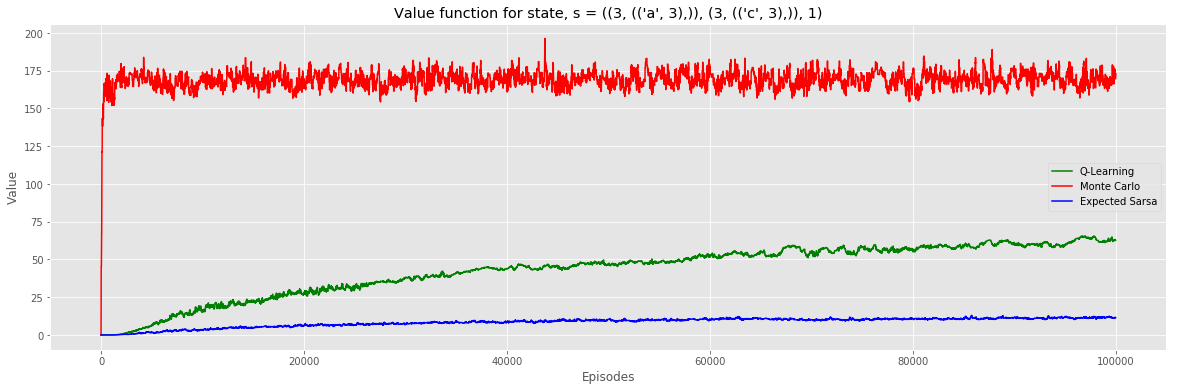

In [86]:
plt.figure(figsize=(20, 6))
v_mc, = plt.plot(pd.Series(value_fn_q).rolling(1, min_periods=1).mean(), color='green', label='Q-Learning')
v_q, = plt.plot(pd.Series(value_fn_mc).rolling(1, min_periods=1).mean(), color='red', label='Monte Carlo')
v_ex_sarsa, = plt.plot(pd.Series(value_fn_ex_sarsa).rolling(1, min_periods=1).mean(), color='blue', label='Expected Sarsa')
plt.xlabel('Episodes')
plt.ylabel('Value')
plt.title("Value function for state, s = ((3, (('a', 3),)), (3, (('c', 3),)), 1)")
plt.legend(handles=[v_mc, v_q, v_ex_sarsa])
plt.savefig('q_learning_vs_mc_vs_ex_sarsa_values.jpg', dpi=600)

### Plots for episode lengths over episodes

In [61]:
time_to_win_mc = [60, 56, 68, 69, 46, 54, 72, 55, 67, 54, 65, 58, 69, 57, 54, 50, 45, 68, 52, 44, 42, 70, 58, 70, 48, 47, 50, 61, 49, 47, 44, 61, 56, 42, 64, 51, 63, 50, 56, 50, 53, 49, 53, 73, 57, 51, 55, 61, 61, 58, 49, 45, 60, 60, 42, 52, 63, 47, 54, 47, 67, 55, 46, 46, 52, 64, 54, 52, 58, 56, 59, 47, 50, 59, 52, 59, 47, 57, 65, 64, 62, 53, 55, 56, 46, 54, 50, 56, 49, 55, 44, 43, 48, 57, 56, 57, 46, 45, 43, 53, 62, 46, 57, 44, 59, 44, 50, 66, 58, 54, 55, 44, 57, 65, 52, 56, 48, 41, 48, 46, 66, 42, 54, 51, 63, 58, 51, 69, 48, 39, 65, 52, 50, 43, 51, 46, 56, 59, 64, 63, 54, 48, 54, 42, 65, 61, 51, 55, 54, 56, 55, 44, 47, 56, 51, 48, 76, 60, 53, 65, 49, 62, 65, 56, 57, 54, 45, 54, 60, 62, 68, 61, 51, 43, 56, 68, 53, 47, 47, 53, 51, 51, 77, 61, 52, 48, 50, 40, 42, 61, 53, 48, 42, 56, 45, 63, 62, 54, 44, 39, 56, 68, 55, 59, 67, 48, 47, 53, 61, 56, 54, 52, 48, 49, 51, 60, 56, 44, 73, 51, 38, 57, 52, 50, 58, 43, 56, 63, 62, 40, 58, 53, 65, 52, 58, 52, 57, 46, 64, 44, 42, 49, 51, 59, 67, 55, 49, 55, 58, 47, 59, 61, 60, 51, 48, 64, 47, 47, 62, 60, 46, 61, 61, 52, 47, 56, 47, 55, 68, 46, 49, 42, 52, 53, 40, 59, 57, 55, 50, 61, 61, 53, 51, 53, 43, 60, 45, 42, 66, 42, 46, 47, 66, 54, 48, 43, 57, 47, 52, 40, 62, 69, 59, 57, 67, 59, 56, 69, 62, 57, 62, 43, 59, 39, 45, 50, 51, 68, 57, 44, 55, 48, 50, 56, 60, 54, 67, 52, 57, 59, 45, 42, 51, 51, 51, 47, 48, 47, 47, 45, 56, 63, 43, 50, 49, 51, 51, 51, 48, 45, 59, 55, 44, 56, 51, 47, 50, 45, 68, 62, 57, 46, 50, 58, 54, 71, 55, 49, 54, 50, 70, 45, 58, 56, 59, 53, 41, 62, 57, 45, 65, 61, 64, 46, 55, 59, 60, 49, 48, 45, 49, 52, 42, 51, 44, 51, 47, 52, 61, 43, 58, 60, 56, 66, 53, 61, 40, 42, 55, 58, 50, 65, 44, 46, 56, 60, 50, 58, 48, 54, 57, 50, 48, 57, 53, 72, 41, 50, 44, 53, 49, 42, 43, 63, 59, 51, 48, 61, 68, 63, 53, 56, 38, 67, 76, 68, 57, 56, 46, 47, 54, 53, 72, 55, 48, 46, 45, 49, 67, 56, 83, 46, 48, 58, 62, 71, 47, 47, 54, 55, 46, 67, 45, 56, 60, 52, 61, 51, 46, 44, 48, 55, 62, 62, 54, 54, 42, 58, 70, 50, 40, 61, 47, 47, 50, 56, 57, 56, 56, 46, 74, 45, 54, 49, 66, 47, 59, 51, 66, 45, 48, 42, 53, 62, 64, 46, 42, 61, 54, 47, 53, 47, 54, 52, 56, 47, 46, 46, 68, 50, 49, 46, 52, 51, 56, 53, 64, 59, 59, 42, 68, 57, 54, 55, 61, 42, 44, 56, 45, 45, 61, 51, 49, 46, 42, 55, 53, 55, 58, 53, 58, 56, 50, 58, 43, 64, 54, 72, 62, 59, 56, 58, 52, 45, 65, 45, 50, 55, 55, 55, 57, 49, 60, 62, 58, 44, 53, 51, 47, 49, 61, 49, 50, 56, 51, 54, 40, 51, 59, 47, 76, 62, 48, 44, 47, 56, 43, 56, 47, 56, 39, 59, 54, 50, 73, 59, 61, 52, 53, 55, 47, 65, 46, 50, 53, 62, 46, 69, 53, 60, 55, 60, 51, 52, 47, 53, 48, 58, 50, 54, 53, 63, 62, 48, 49, 47, 53, 57, 80, 50, 56, 54, 44, 51, 48, 49, 58, 42, 53, 46, 52, 60, 48, 47, 63, 48, 54, 75, 46, 50, 48, 46, 48, 49, 51, 45, 50, 42, 48, 64, 51, 60, 54, 58, 44, 64, 41, 39, 49, 45, 50, 44, 65, 49, 39, 62, 56, 71, 50, 56, 43, 49, 40, 52, 53, 56, 47, 55, 50, 51, 65, 59, 72, 56, 48, 57, 51, 49, 43, 44, 46, 61, 65, 52, 44, 57, 53, 42, 60, 52, 40, 70, 52, 60, 49, 49, 48, 58, 61, 56, 78, 50, 48, 58, 47, 55, 42, 47, 56, 46, 67, 46, 43, 44, 48, 44, 56, 59, 67, 61, 55, 49, 45, 65, 72, 47, 52, 62, 48, 65, 49, 51, 58, 52, 55, 46, 60, 79, 62, 54, 47, 69, 52, 44, 63, 57, 41, 61, 49, 43, 45, 44, 49, 46, 45, 57, 73, 57, 52, 49, 50, 56, 45, 43, 51, 65, 46, 56, 67, 64, 45, 61, 61, 59, 52, 37, 51, 49, 52, 44, 78, 45, 63, 52, 40, 59, 60, 57, 47, 49, 66, 53, 55, 46, 49, 68, 50, 59, 44, 40, 50, 46, 57, 50, 47, 67, 57, 66, 49, 55, 46, 53, 42, 50, 52, 54, 42, 48, 58, 58, 61, 52, 66, 44, 40, 55, 73, 41, 50, 45, 68, 62, 68, 50, 52, 47, 61, 47, 46, 64, 62, 60, 52, 57, 58, 63, 50, 49, 50, 57, 57, 51, 59, 60, 50, 46, 43, 42, 59, 63, 46, 50, 49, 62, 50, 56, 38, 58, 74, 66, 53, 46, 57, 51, 42, 56, 58, 70, 46, 50, 58, 55, 50, 64, 50, 49, 43, 56, 54, 48, 42, 45, 52, 70, 64, 54, 49, 52, 49, 68, 51, 40, 52, 52, 48, 60, 43, 75, 56, 44, 56, 48, 51, 47, 49, 47, 69, 53, 47, 71, 40, 55, 51, 58, 38, 55, 53, 54, 63, 59, 49, 45, 59, 52, 43, 46, 49, 49, 48, 58, 58, 45, 57, 44, 68, 55, 54, 59, 61, 60, 61, 52, 53, 63, 49, 60, 58, 42, 62, 42, 44, 44, 47, 48, 48, 53, 65, 62, 55, 64, 55, 54, 51, 56, 58, 49, 66, 63, 46, 58, 54, 50, 78, 50, 66, 53, 54, 53, 70, 53, 52, 42, 48, 43, 63, 44, 58, 59, 51, 52, 75, 67, 61, 68, 55, 63, 48, 42, 44, 50, 58, 53, 58, 47, 57, 60, 49, 51, 62, 46, 50, 53, 69, 58, 52, 43, 63, 44, 59, 43, 50, 41, 43, 58, 71, 59, 57, 44, 69, 66, 52, 54, 49, 55, 46, 43, 58, 50, 48, 69, 47, 68, 52, 54, 65, 55, 61, 52, 46, 53, 51, 60, 57, 55, 68, 51, 52, 51, 46, 68, 57, 74, 61, 56, 59, 60, 49, 54, 56, 57, 40, 59, 43, 50, 64, 54, 52, 48, 55, 65, 65, 61, 53, 59, 47, 45, 59, 67, 58, 54, 44, 52, 60, 62, 45, 45, 61, 66, 45, 64, 41, 43, 60, 44, 49, 72, 46, 67, 53, 49, 45, 62, 40, 62, 53, 50, 50, 62, 53, 42, 43, 45, 48, 55, 48, 59, 59, 53, 40, 56, 41, 41, 59, 53, 51, 54, 62, 46, 50, 58, 45, 64, 67, 59, 51, 77, 53, 52, 55, 64, 49, 56, 45, 59, 56, 78, 68, 48, 44, 44, 48, 47, 60, 63, 53, 59, 53, 59, 49, 50, 57, 60, 53, 58, 46, 54, 62, 55, 54, 48, 55, 46, 50, 72, 40, 50, 48, 69, 61, 54, 52, 67, 53, 49, 46, 66, 51, 49, 65, 39, 50, 52, 51, 54, 62, 39, 62, 64, 46, 55, 47, 49, 40, 60, 61, 51, 66, 52, 61, 49, 45, 40, 54, 52, 65, 52, 60, 64, 63, 45, 47, 51, 48, 61, 44, 59, 69, 60, 59, 53, 57, 46, 53, 41, 59, 54, 43, 51, 64, 53, 55, 52, 50, 54, 63, 52, 49, 47, 48, 42, 60, 51, 48, 58, 51, 58, 44, 41, 58, 55, 65, 63, 79, 55, 61, 51, 56, 54, 50, 60, 68, 49, 62, 52, 54, 52, 59, 57, 70, 60, 55, 51, 38, 46, 56, 47, 48, 61, 53, 47, 51, 65, 50, 46, 46, 52, 50, 58, 62, 68, 59, 62, 49, 47, 50, 58, 56, 60, 68, 61, 53, 53, 49, 56, 48, 60, 56, 45, 46, 47, 54, 59, 58, 54, 59, 54, 40, 56, 54, 56, 55, 57, 67, 51, 52, 50, 48, 46, 51, 46, 56, 60, 64, 46, 47, 55, 63, 47, 47, 54, 40, 57, 59, 59, 48, 48, 60, 44, 66, 40, 65, 61, 47, 53, 50, 46, 43, 49, 47, 57, 56, 48, 41, 50, 45, 48, 74, 45, 57, 44, 57, 45, 63, 45, 50, 44, 51, 58, 48, 44, 52, 55, 51, 50, 48, 39, 63, 64, 51, 55, 53, 61, 52, 54, 68, 51, 54, 52, 56, 55, 53, 52, 43, 50, 56, 48, 60, 49, 50, 44, 53, 49, 55, 49, 68, 53, 50, 38, 52, 58, 44, 52, 61, 49, 54, 75, 51, 50, 52, 50, 39, 65, 69, 62, 53, 62, 61, 67, 38, 47, 50, 57, 53, 53, 60, 63, 48, 55, 38, 59, 46, 73, 55, 45, 42, 51, 49, 73, 47, 85, 65, 65, 76, 57, 59, 60, 58, 57, 49, 51, 48, 53, 50, 58, 52, 60, 56, 47, 43, 61, 85, 41, 49, 78, 63, 57, 46, 50, 68, 56, 51, 50, 45, 53, 58, 52, 46, 63, 48, 56, 47, 40, 58, 45, 56, 60, 44, 43, 45, 46, 60, 53, 61, 45, 54, 40, 51, 49, 58, 65, 46, 42, 42, 57, 59, 55, 49, 37, 47, 55, 46, 55, 51, 42, 48, 57, 51, 62, 50, 40, 57, 55, 52, 71, 63, 53, 52, 57, 60, 58, 69, 56, 65, 51, 55, 46, 54, 67, 47, 50, 59, 54, 38, 48, 52, 52, 60, 53, 55, 55, 46, 55, 50, 55, 43, 57, 48, 56, 64, 68, 52, 54, 57, 73, 43, 61, 64, 35, 62, 48, 52, 56, 53, 54, 80, 52, 46, 51, 48, 47, 53, 46, 53, 45, 57, 45, 50, 48, 50, 37, 44, 62, 57, 61, 60, 57, 44, 56, 62, 52, 56, 50, 71, 59, 51, 55, 47, 47, 49, 69, 49, 45, 50, 53, 70, 57, 65, 74, 56, 57, 58, 62, 52, 48, 53, 54, 56, 42, 57, 45, 51, 74, 45, 52, 50, 58, 38, 40, 56, 44, 41, 55, 57, 56, 48, 64, 44, 50, 60, 50, 44, 65, 50, 50, 47, 55, 44, 66, 49, 52, 45, 65, 56, 67, 59, 47, 61, 64, 40, 42, 49, 51, 47, 43, 53, 50, 41, 53, 46, 58, 47, 62, 47, 57, 50, 50, 60, 55, 53, 47, 51, 48, 60, 46, 46, 51, 59, 65, 51, 62, 58, 63, 58, 44, 49, 47, 63, 48, 55, 51, 45, 52, 68, 45, 49, 43, 60, 47, 68, 49, 59, 52, 53, 48, 64, 62, 75, 56, 48, 68, 51, 46, 62, 44, 52, 63, 47, 45, 52, 59, 58, 62, 58, 62, 49, 57, 52, 58, 47, 46, 57, 48, 57, 44, 50, 52, 52, 50, 55, 64, 45, 53, 64, 50, 44, 56, 41, 58, 52, 44, 61, 45, 53, 57, 59, 63, 62, 48, 46, 51, 60, 58, 52, 42, 46, 43, 43, 51, 48, 63, 57, 42, 75, 59, 48, 53, 51, 57, 46, 44, 76, 53, 56, 63, 47, 55, 61, 46, 53, 58, 46, 53, 77, 52, 60, 42, 59, 50, 47, 57, 58, 47, 58, 68, 44, 63, 48, 55, 53, 73, 67, 62, 60, 47, 47, 70, 39, 58, 65, 45, 58, 46, 57, 54, 63, 50, 67, 59, 52, 49, 77, 55, 53, 51, 53, 52, 72, 59, 60, 48, 49, 53, 47, 50, 52, 55, 45, 48, 86, 50, 54, 63, 55, 61, 53, 60, 48, 79, 61, 71, 45, 65, 59, 42, 57, 58, 54, 43, 68, 44, 65, 52, 50, 54, 51, 45, 55, 58, 70, 45, 69, 64, 69, 51, 40, 40, 54, 47, 71, 62, 61, 49, 45, 55, 72, 51, 55, 65, 51, 60, 60, 55, 71, 76, 53, 48, 52, 52, 55, 50, 46, 44, 51, 67, 63, 63, 48, 48, 41, 58, 44, 63, 48, 70, 49, 49, 47, 39, 46, 59, 49, 47, 61, 55, 45, 51, 39, 48, 44, 41, 60, 45, 62, 49, 50, 45, 59, 70, 45, 55, 65, 72, 53, 50, 56, 58, 53, 60, 66, 50, 96, 44, 55, 47, 49, 42, 43, 40, 43, 47, 60, 57, 63, 64, 48, 47, 73, 77, 57, 63, 56, 67, 64, 58, 53, 58, 65, 57, 52, 51, 51, 54, 51, 37, 53, 69, 51, 49, 53, 59, 52, 48, 42, 49, 52, 49, 50, 41, 52, 41, 58, 49, 45, 46, 42, 49, 50, 55, 44, 49, 63, 49, 72, 50, 54, 58, 58, 53, 50, 52, 54, 70, 60, 49, 70, 52, 49, 64, 48, 47, 48, 45, 53, 55, 56, 51, 59, 41, 88, 52, 51, 47, 50, 49, 47, 49, 47, 63, 45, 57, 62, 61, 48, 58, 58, 67, 46, 49, 47, 59, 54, 51, 49, 53, 45, 61, 40, 66, 42, 60, 56, 66, 54, 70, 44, 41, 64, 47, 57, 66, 43, 64, 50, 52, 38, 70, 50, 53, 57, 54, 42, 63, 57, 61, 46, 46, 68, 55, 58, 52, 65, 58, 55, 56, 42, 52, 47, 63, 68, 57, 54, 41, 51, 47, 39, 57, 56, 57, 60, 59, 53, 42, 53, 44, 69, 54, 52, 64, 50, 48, 68, 51, 68, 55, 44, 62, 62, 54, 57, 60, 44, 53, 48, 45, 55, 52, 59, 52, 56, 57, 67, 56, 48, 47, 64, 65, 57, 43, 57, 58, 46, 58, 48, 56, 49, 62, 60, 46, 51, 64, 53, 59, 47, 48, 62, 50, 67, 58, 64, 54, 53, 53, 66, 50, 50, 47, 52, 70, 64, 55, 51, 44, 53, 78, 43, 48, 50, 49, 67, 43, 53, 60, 54, 65, 52, 64, 53, 64, 70, 60, 52, 63, 60, 51, 45, 53, 54, 52, 44, 51, 44, 49, 41, 54, 47, 58, 54, 67, 55, 67, 58, 48, 54, 67, 55, 52, 46, 52, 55, 37, 57, 65, 52, 39, 50, 52, 43, 58, 50, 65, 49, 50, 40, 58, 56, 65, 49, 64, 53, 43, 46, 62, 47, 38, 52, 54, 58, 49, 54, 76, 49, 56, 64, 54, 50, 60, 50, 55, 73, 54, 60, 58, 48, 61, 60, 48, 50, 50, 38, 53, 38, 42, 52, 63, 45, 47, 48, 50, 42, 71, 57, 43, 55, 56, 54, 47, 69, 65, 53, 55, 46, 54, 52, 62, 50, 80, 58, 51, 56, 74, 60, 44, 49, 51, 57, 53, 54, 58, 55, 59, 52, 57, 50, 57, 51, 77, 62, 44, 63, 55, 46, 57, 36, 56, 65, 47, 45, 57, 57, 50, 42, 49, 45, 42, 68, 43, 44, 50, 55, 41, 52, 68, 59, 54, 48, 49, 51, 50, 68, 46, 46, 58, 59, 52, 43, 52, 47, 47, 48, 64, 41, 83, 52, 67, 51, 66, 66, 43, 62, 51, 39, 65, 53, 46, 58, 46, 66, 67, 44, 57, 54, 50, 56, 44, 58, 58, 53, 55, 57, 44, 59, 56, 52, 46, 48, 56, 53, 54, 62, 50, 42, 55, 60, 48, 59, 62, 55, 40, 52, 43, 64, 42, 75, 63, 52, 53, 46, 64, 72, 60, 58, 49, 49, 53, 67, 39, 43, 43, 52, 45, 51, 53, 44, 43, 53, 60, 55, 46, 59, 50, 43, 70, 48, 49, 50, 67, 59, 72, 49, 60, 47, 45, 55, 46, 58, 43, 64, 50, 58, 53, 50, 53, 47, 58, 49, 54, 61, 73, 38, 53, 68, 39, 52, 47, 73, 45, 53, 57, 66, 58, 55, 46, 57, 50, 59, 40, 53, 48, 55, 62, 52, 50, 49, 51, 46, 46, 46, 51, 42, 56, 52, 59, 61, 57, 52, 62, 57, 54, 49, 63, 61, 55, 56, 45, 50, 61, 55, 47, 47, 62, 55, 55, 54, 40, 59, 41, 67, 53, 49, 54, 70, 50, 52, 69, 50, 49, 58, 56, 49, 73, 45, 54, 62, 55, 47, 48, 42, 55, 49, 67, 58, 41, 61, 59, 54, 52, 36, 53, 54, 57, 59, 40, 54, 54, 48, 51, 60, 60, 58, 52, 59, 59, 54, 57, 52, 53, 45, 44, 52, 69, 46, 61, 43, 48, 62, 41, 42, 42, 61, 45, 59, 54, 70, 52, 44, 40, 47, 61, 60, 39, 39, 52, 48, 50, 37, 52, 55, 57, 62, 45, 59, 42, 66, 63, 41, 51, 58, 58, 43, 65, 46, 64, 42, 53, 59, 42, 53, 49, 85, 44, 47, 57, 51, 65, 54, 54, 49, 51, 47, 50, 59, 57, 54, 54, 65, 62, 49, 58, 74, 37, 69, 56, 50, 48, 41, 47, 46, 66, 55, 59, 56, 61, 65, 65, 77, 56, 59, 59, 60, 51, 55, 59, 63, 50, 53, 56, 77, 43, 49, 48, 58, 73, 51, 44, 48, 53, 41, 39, 56, 47, 71, 50, 56, 51, 65, 46, 56, 57, 56, 70, 39, 59, 61, 74, 57, 38, 58, 47, 55, 54, 57, 47, 56, 62, 45, 45, 46, 70, 48, 53, 55, 54, 51, 73, 55, 46, 48, 49, 47, 42, 59, 46, 62, 61, 52, 59, 66, 48, 55, 47, 49, 56, 42, 42, 69, 58, 52, 49, 47, 53, 45, 50, 57, 50, 49, 55, 62, 55, 49, 51, 43, 53, 53, 65, 64, 67, 78, 51, 58, 50, 47, 52, 45, 42, 46, 57, 66, 53, 51, 66, 52, 43, 54, 60, 43, 44, 59, 50, 67, 49, 43, 59, 52, 61, 50, 54, 47, 64, 72, 52, 60, 47, 51, 50, 54, 38, 65, 64, 59, 43, 63, 43, 53, 56, 43, 55, 54, 47, 47, 53, 59, 43, 50, 68, 59, 55, 52, 62, 54, 55, 55, 41, 51, 59, 55, 63, 51, 49, 49, 52, 65, 70, 48, 50, 64, 60, 46, 52, 51, 57, 51, 71, 41, 69, 62, 56, 62, 46, 61, 42, 57, 51, 56, 48, 43, 53, 51, 55, 64, 54, 51, 45, 54, 64, 49, 56, 49, 55, 57, 50, 46, 53, 46, 44, 48, 47, 48, 56, 56, 58, 41, 56, 63, 45, 57, 59, 46, 58, 43, 59, 67, 46, 60, 54, 53, 42, 53, 64, 61, 45, 71, 45, 47, 60, 43, 49, 54, 69, 49, 64, 51, 53, 49, 45, 53, 58, 54, 50, 63, 47, 81, 59, 58, 64, 59, 52, 51, 82, 65, 52, 54, 63, 55, 73, 56, 71, 68, 80, 47, 60, 58, 42, 52, 51, 63, 63, 48, 50, 56, 41, 43, 51, 61, 51, 68, 65, 69, 53, 49, 44, 47, 52, 51, 46, 44, 45, 46, 66, 53, 50, 61, 55, 50, 51, 43, 51, 38, 57, 39, 50, 65, 44, 65, 52, 56, 44, 44, 58, 67, 49, 56, 51, 50, 53, 43, 56, 67, 52, 42, 51, 48, 57, 53, 46, 66, 48, 57, 41, 48, 53, 57, 55, 46, 41, 47, 66, 49, 69, 50, 56, 61, 48, 49, 51, 51, 64, 65, 47, 68, 56, 41, 62, 54, 64, 47, 53, 49, 57, 43, 38, 46, 41, 51, 55, 52, 51, 48, 59, 57, 54, 43, 59, 44, 55, 46, 54, 46, 38, 65, 64, 52, 52, 56, 54, 75, 40, 60, 67, 48, 53, 57, 50, 46, 52, 45, 47, 39, 65, 55, 90, 58, 52, 48, 46, 71, 42, 74, 41, 53, 51, 61, 52, 60, 68, 42, 52, 57, 69, 44, 49, 71, 49, 54, 44, 50, 69, 44, 65, 49, 46, 46, 45, 62, 46, 52, 46, 56, 55, 56, 55, 37, 56, 50, 47, 57, 50, 62, 58, 44, 50, 49, 56, 53, 64, 56, 60, 56, 60, 46, 53, 74, 51, 69, 57, 42, 66, 66, 65, 58, 58, 55, 69, 62, 51, 71, 51, 56, 55, 60, 45, 63, 46, 56, 44, 52, 56, 69, 51, 45, 54, 47, 46, 68, 54, 59, 60, 57, 49, 68, 65, 55, 62, 55, 50, 46, 55, 44, 59, 55, 55, 76, 61, 54, 48, 51, 58, 48, 51, 72, 52, 56, 50, 64, 47, 54, 51, 42, 48, 53, 65, 65, 60, 42, 55, 51, 61, 49, 57, 65, 45, 62, 48, 46, 46, 68, 48, 68, 65, 45, 52, 61, 55, 60, 68, 37, 52, 57, 45, 62, 66, 64, 59, 52, 50, 50, 58, 46, 54, 51, 58, 47, 54, 45, 57, 53, 46, 55, 42, 51, 54, 47, 40, 65, 55, 47, 70, 57, 47, 46, 56, 49, 61, 56, 55, 60, 48, 45, 56, 47, 70, 54, 54, 55, 59, 44, 61, 45, 45, 60, 66, 57, 51, 42, 65, 47, 58, 50, 56, 61, 52, 51, 46, 61, 46, 51, 62, 52, 53, 72, 48, 46, 48, 83, 50, 49, 52, 47, 50, 64, 54, 42, 85, 66, 52, 50, 51, 53, 61, 52, 55, 55, 50, 57, 47, 54, 51, 41, 52, 51, 41, 47, 51, 52, 46, 52, 46, 55, 65, 47, 53, 51, 68, 44, 56, 59, 55, 58, 43, 56, 54, 45, 57, 59, 49, 53, 61, 51, 46, 61, 47, 52, 38, 57, 42, 53, 53, 50, 55, 57, 54, 53, 54, 48, 58, 60, 71, 43, 60, 56, 56, 54, 42, 55, 50, 42, 54, 42, 67, 45, 57, 52, 56, 54, 50, 66, 51, 40, 51, 68, 48, 50, 70, 63, 44, 60, 48, 57, 42, 65, 55, 66, 48, 58, 47, 45, 44, 48, 53, 52, 41, 56, 50, 49, 44, 52, 49, 53, 50, 43, 49, 48, 55, 51, 58, 40, 50, 58, 58, 63, 44, 45, 70, 69, 45, 47, 59, 48, 50, 44, 50, 52, 65, 49, 52, 46, 63, 61, 44, 59, 58, 70, 48, 50, 36, 69, 58, 47, 49, 51, 41, 65, 55, 41, 56, 41, 40, 58, 53, 50, 47, 54, 48, 40, 41, 66, 50, 63, 52, 53, 48, 60, 49, 53, 47, 51, 61, 58, 36, 48, 49, 66, 52, 59, 47, 60, 50, 65, 74, 53, 38, 61, 42, 51, 49, 59, 60, 44, 59, 63, 57, 58, 63, 54, 49, 54, 62, 60, 44, 60, 48, 63, 44, 52, 47, 47, 51, 59, 54, 51, 47, 48, 56, 57, 49, 56, 40, 50, 71, 52, 53, 48, 47, 60, 57, 45, 49, 64, 55, 50, 55, 63, 58, 77, 71, 57, 52, 39, 59, 69, 53, 59, 49, 49, 42, 57, 51, 50, 42, 40, 66, 60, 58, 62, 64, 51, 60, 56, 63, 60, 53, 56, 58, 56, 51, 61, 62, 54, 48, 52, 41, 72, 59, 48, 46, 54, 69, 54, 68, 71, 54, 70, 57, 57, 42, 55, 48, 51, 39, 71, 53, 44, 72, 64, 49, 61, 53, 39, 73, 42, 49, 42, 47, 42, 44, 56, 46, 47, 51, 67, 44, 51, 45, 51, 48, 56, 44, 58, 66, 43, 52, 52, 55, 57, 63, 49, 55, 43, 52, 63, 62, 49, 69, 62, 50, 59, 59, 55, 54, 52, 43, 58, 46, 50, 60, 44, 60, 66, 42, 70, 49, 43, 67, 56, 55, 55, 53, 49, 62, 52, 54, 56, 50, 50, 58, 50, 49, 61, 57, 41, 56, 57, 56, 46, 44, 54, 57, 39, 59, 46, 44, 57, 50, 49, 51, 60, 71, 45, 56, 45, 49, 51, 53, 42, 58, 61, 67, 54, 56, 55, 47, 61, 41, 58, 42, 40, 64, 65, 66, 55, 58, 48, 56, 50, 64, 57, 54, 43, 44, 66, 72, 53, 41, 57, 65, 57, 58, 55, 54, 61, 58, 52, 47, 53, 57, 46, 66, 50, 52, 63, 57, 40, 43, 57, 55, 45, 54, 60, 48, 56, 61, 53, 42, 49, 49, 40, 45, 63, 60, 73, 47, 64, 65, 47, 56, 58, 48, 53, 50, 52, 61, 45, 62, 58, 52, 53, 49, 54, 68, 33, 51, 57, 57, 46, 49, 61, 61, 45, 47, 52, 50, 46, 77, 56, 59, 49, 53, 38, 62, 47, 57, 63, 58, 50, 58, 37, 48, 52, 55, 55, 49, 52, 56, 64, 53, 52, 46, 47, 76, 52, 45, 51, 46, 47, 56, 60, 48, 45, 41, 60, 53, 59, 49, 52, 63, 63, 57, 42, 49, 54, 50, 71, 62, 63, 52, 53, 48, 47, 52, 51, 45, 58, 70, 64, 47, 57, 56, 40, 54, 63, 43, 58, 60, 52, 53, 55, 62, 50, 53, 49, 50, 51, 54, 52, 56, 40, 50, 45, 74, 57, 68, 54, 62, 46, 57, 66, 52, 56, 56, 57, 60, 44, 39, 63, 43, 52, 55, 58, 49, 58, 60, 50, 56, 47, 43, 52, 45, 42, 49, 40, 49, 61, 47, 44, 43, 69, 48, 62, 55, 52, 55, 61, 46, 45, 66, 59, 55, 47, 55, 49, 48, 53, 56, 57, 56, 55, 49, 61, 63, 56, 56, 64, 53, 66, 50, 53, 55, 84, 51, 45, 39, 58, 51, 71, 38, 39, 46, 49, 57, 59, 47, 43, 47, 55, 47, 61, 76, 58, 57, 40, 50, 47, 62, 55, 39, 54, 51, 47, 61, 61, 59, 67, 58, 63, 67, 44, 40, 53, 71, 65, 69, 42, 56, 64, 53, 59, 55, 46, 55, 49, 60, 47, 48, 46, 59, 45, 47, 50, 51, 52, 63, 73, 61, 53, 53, 47, 52, 54, 39, 58, 56, 69, 54, 52, 61, 54, 47, 60, 56, 56, 64, 57, 46, 42, 40, 58, 64, 44, 45, 57, 48, 52, 53, 47, 47, 78, 49, 58, 56, 54, 44, 60, 59, 55, 42, 59, 61, 38, 45, 75, 56, 52, 47, 47, 41, 47, 72, 60, 67, 52, 68, 48, 61, 52, 51, 51, 54, 45, 48, 65, 55, 64, 53, 46, 41, 44, 48, 76, 55, 56, 50, 49, 69, 58, 46, 49, 42, 61, 48, 50, 58, 62, 68, 43, 40, 71, 51, 53, 51, 63, 62, 49, 52, 57, 42, 49, 59, 39, 47, 53, 64, 82, 58, 54, 59, 48, 45, 42, 56, 52, 57, 54, 42, 43, 65, 40, 53, 52, 49, 50, 62, 64, 56, 68, 43, 70, 49, 37, 64, 68, 49, 46, 71, 45, 50, 64, 53, 61, 56, 52, 59, 50, 54, 52, 60, 45, 49, 84, 48, 47, 56, 45, 62, 44, 47, 47, 52, 63, 63, 57, 62, 54, 55, 51, 57, 43, 43, 60, 57, 48, 73, 62, 64, 59, 65, 40, 62, 56, 44, 67, 50, 56, 62, 52, 45, 45, 65, 51, 62, 53, 59, 63, 73, 50, 65, 50, 53, 52, 52, 55, 52, 63, 50, 51, 63, 55, 40, 42, 42, 70, 58, 54, 45, 65, 44, 48, 47, 49, 59, 61, 50, 65, 58, 55, 68, 51, 50, 55, 56, 54, 61, 74, 54, 65, 64, 51, 64, 74, 54, 59, 51, 41, 49, 45, 44, 44, 66, 70, 46, 53, 58, 57, 39, 51, 56, 74, 63, 57, 58, 42, 57, 54, 53, 41, 59, 54, 44, 58, 52, 49, 65, 57, 47, 42, 71, 39, 55, 52, 59, 74, 46, 49, 53, 55, 49, 53, 66, 58, 51, 51, 58, 51, 79, 70, 65, 41, 55, 55, 39, 45, 51, 74, 52, 59, 71, 61, 46, 45, 58, 57, 53, 65, 60, 65, 46, 50, 52, 47, 48, 47, 57, 49, 53, 49, 49, 53, 51, 63, 49, 60, 49, 45, 54, 69, 52, 52, 43, 48, 49, 49, 53, 54, 58, 54, 54, 55, 55, 54, 52, 65, 49, 52, 61, 48, 54, 60, 49, 47, 64, 53, 61, 71, 49, 66, 50, 40, 46, 52, 51, 50, 46, 48, 48, 67, 50, 51, 69, 45, 45, 63, 39, 53, 48, 49, 53, 59, 61, 59, 53, 67, 43, 49, 52, 45, 54, 62, 64, 47, 86, 55, 54, 59, 46, 53, 51, 60, 39, 43, 57, 53, 54, 50, 54, 55, 62, 39, 53, 61, 60, 54, 56, 46, 50, 51, 63, 52, 51, 47, 48, 58, 41, 54, 69, 67, 62, 47, 54, 63, 65, 48, 54, 57, 67, 55, 56, 46, 52, 54, 61, 60, 39, 51, 50, 48, 52, 60, 55, 42, 57, 43, 53, 53, 56, 61, 41, 52, 49, 48, 43, 37, 42, 50, 37, 49, 62, 38, 44, 54, 59, 47, 55, 40, 42, 55, 55, 40, 51, 49, 50, 61, 59, 50, 69, 47, 56, 62, 58, 51, 61, 46, 43, 40, 54, 66, 57, 47, 55, 67, 83, 55, 59, 56, 46, 51, 55, 45, 49, 49, 64, 74, 51, 62, 59, 47, 58, 65, 52, 65, 51, 51, 68, 46, 43, 50, 50, 73, 66, 67, 66, 58, 54, 43, 48, 60, 52, 58, 65, 52, 49, 56, 56, 54, 60, 46, 53, 54, 51, 64, 37, 42, 65, 55, 61, 56, 51, 58, 49, 54, 57, 50, 57, 52, 50, 56, 50, 55, 54, 52, 50, 52, 61, 49, 58, 50, 46, 56, 44, 52, 59, 57, 54, 48, 48, 52, 47, 57, 47, 68, 58, 45, 47, 54, 45, 65, 61, 47, 55, 52, 56, 41, 47, 62, 47, 63, 46, 69, 64, 53, 66, 53, 64, 63, 50, 55, 53, 54, 68, 51, 57, 67, 69, 66, 53, 53, 59, 47, 60, 56, 65, 51, 50, 57, 58, 71, 54, 60, 50, 55, 63, 60, 62, 63, 67, 50, 52, 61, 62, 44, 42, 44, 61, 48, 69, 55, 38, 64, 58, 51, 51, 48, 45, 47, 50, 54, 50, 54, 57, 56, 38, 60, 53, 49, 44, 68, 46, 68, 44, 56, 53, 66, 61, 70, 49, 62, 57, 77, 61, 50, 60, 57, 43, 48, 48, 45, 58, 39, 50, 67, 50, 67, 54, 45, 56, 68, 61, 55, 50, 55, 53, 47, 66, 64, 49, 54, 47, 50, 44, 50, 62, 61, 53, 56, 58, 50, 84, 47, 41, 65, 50, 52, 47, 60, 55, 52, 56, 54, 43, 48, 45, 50, 45, 54, 59, 50, 55, 52, 52, 49, 59, 61, 47, 59, 50, 69, 45, 46, 49, 47, 54, 63, 46, 68, 59, 52, 78, 53, 54, 68, 44, 43, 43, 58, 46, 49, 63, 56, 49, 50, 55, 50, 43, 48, 58, 49, 71, 44, 51, 62, 53, 61, 60, 52, 46, 52, 56, 52, 62, 48, 47, 73, 49, 49, 40, 58, 63, 63, 48, 44, 65, 57, 64, 53, 50, 51, 50, 59, 55, 56, 46, 41, 52, 54, 61, 58, 56, 46, 44, 40, 50, 45, 48, 63, 52, 66, 48, 57, 55, 68, 70, 43, 57, 60, 39, 76, 51, 53, 46, 49, 46, 50, 53, 54, 61, 42, 49, 65, 41, 38, 59, 55, 59, 60, 46, 45, 47, 56, 47, 41, 49, 62, 58, 56, 51, 55, 62, 45, 58, 56, 57, 56, 63, 53, 63, 49, 62, 46, 61, 58, 49, 63, 51, 58, 65, 53, 60, 62, 51, 72, 40, 61, 54, 56, 60, 56, 55, 48, 66, 56, 60, 46, 65, 59, 52, 55, 54, 69, 49, 42, 59, 39, 52, 54, 56, 47, 49, 53, 55, 50, 49, 55, 60, 48, 56, 62, 51, 47, 54, 60, 57, 52, 55, 68, 61, 39, 67, 51, 49, 47, 61, 40, 43, 54, 44, 45, 49, 58, 45, 74, 44, 66, 49, 55, 53, 62, 57, 53, 54, 82, 54, 38, 54, 72, 59, 51, 51, 56, 59, 47, 39, 53, 50, 50, 47, 57, 61, 43, 53, 54, 46, 48, 61, 54, 46, 45, 47, 53, 38, 67, 52, 53, 52, 47, 48, 53, 51, 58, 39, 42, 57, 56, 57, 57, 47, 55, 50, 57, 42, 68, 62, 52, 59, 67, 55, 65, 57, 62, 53, 50, 60, 47, 46, 53, 61, 70, 73, 50, 55, 54, 49, 50, 38, 69, 52, 45, 53, 48, 51, 52, 55, 56, 51, 40, 60, 67, 51, 46, 68, 72, 45, 43, 58, 59, 57, 43, 59, 41, 55, 59, 41, 53, 65, 50, 61, 61, 42, 50, 61, 62, 61, 47, 58, 49, 43, 48, 60, 60, 41, 39, 54, 55, 56, 53, 47, 66, 58, 46, 41, 55, 45, 54, 59, 50, 43, 59, 56, 46, 42, 56, 51, 61, 69, 50, 62, 51, 70, 46, 60, 55, 41, 52, 52, 50, 54, 63, 60, 55, 55, 65, 51, 49, 70, 61, 61, 48, 63, 47, 55, 47, 53, 53, 49, 62, 48, 47, 43, 58, 43, 53, 44, 54, 48, 54, 59, 53, 65, 43, 46, 67, 49, 40, 61, 47, 61, 50, 57, 50, 52, 58, 51, 50, 43, 52, 54, 48, 62, 59, 54, 45, 50, 47, 41, 45, 56, 54, 58, 50, 41, 45, 44, 66, 74, 62, 38, 69, 47, 65, 71, 60, 60, 63, 54, 48, 38, 50, 43, 73, 68, 62, 51, 59, 54, 56, 54, 45, 59, 46, 52, 58, 54, 55, 62, 60, 50, 59, 46, 38, 52, 42, 58, 81, 67, 62, 59, 35, 40, 48, 47, 53, 62, 40, 58, 40, 48, 68, 54, 54, 75, 58, 60, 48, 63, 57, 56, 54, 53, 63, 45, 45, 72, 62, 60, 46, 59, 55, 66, 50, 52, 49, 62, 52, 59, 67, 45, 55, 47, 60, 63, 69, 45, 59, 57, 68, 40, 50, 51, 48, 59, 54, 46, 50, 55, 55, 45, 56, 50, 43, 51, 62, 68, 40, 54, 53, 50, 49, 57, 57, 57, 60, 55, 61, 49, 50, 54, 40, 59, 50, 50, 51, 48, 53, 43, 52, 58, 55, 44, 48, 54, 54, 58, 54, 52, 50, 50, 54, 42, 63, 38, 68, 43, 51, 60, 52, 62, 57, 66, 55, 51, 59, 62, 63, 49, 55, 45, 59, 48, 50, 54, 45, 58, 51, 46, 54, 51, 46, 36, 53, 53, 67, 55, 53, 53, 51, 44, 59, 63, 61, 49, 54, 55, 43, 49, 62, 56, 43, 53, 40, 44, 76, 45, 50, 47, 51, 60, 56, 59, 44, 62, 50, 59, 56, 54, 52, 43, 53, 70, 71, 40, 61, 51, 77, 72, 46, 47, 49, 46, 48, 63, 59, 44, 63, 61, 55, 36, 50, 50, 47, 49, 62, 57, 50, 57, 47, 66, 44, 55, 76, 63, 59, 43, 58, 59, 70, 58, 45, 54, 67, 73, 69, 79, 57, 60, 56, 49, 45, 42, 49, 54, 59, 45, 49, 55, 52, 43, 53, 58, 44, 45, 49, 51, 57, 65, 45, 59, 60, 55, 53, 46, 48, 42, 42, 45, 64, 58, 43, 62, 43, 55, 56, 57, 52, 60, 72, 68, 61, 49, 45, 61, 42, 56, 56, 51, 50, 44, 40, 63, 41, 47, 55, 50, 58, 46, 49, 43, 57, 44, 62, 56, 51, 57, 46, 62, 47, 46, 67, 47, 48, 55, 54, 51, 49, 64, 53, 67, 53, 44, 49, 50, 52, 49, 53, 59, 50, 50, 53, 65, 49, 58, 54, 69, 61, 60, 44, 67, 55, 54, 63, 52, 56, 58, 58, 44, 63, 47, 50, 64, 72, 41, 54, 49, 76, 54, 63, 64, 44, 59, 62, 50, 53, 53, 48, 55, 52, 66, 51, 71, 49, 51, 50, 53, 57, 60, 71, 45, 49, 54, 64, 47, 56, 56, 70, 39, 43, 46, 51, 48, 47, 58, 59, 51, 52, 55, 67, 49, 79, 60, 72, 54, 69, 59, 48, 49, 61, 48, 46, 49, 58, 47, 65, 57, 55, 46, 51, 51, 56, 47, 51, 48, 55, 42, 58, 60, 41, 75, 59, 48, 46, 48, 56, 59, 41, 40, 47, 51, 54, 39, 46, 48, 56, 47, 52, 53, 46, 42, 65, 47, 46, 40, 50, 47, 52, 48, 67, 66, 48, 60, 42, 40, 51, 40, 66, 61, 46, 72, 40, 54, 50, 54, 67, 56, 52, 63, 71, 58, 60, 50, 60, 80, 49, 45, 37, 71, 50, 51, 58, 51, 53, 51, 50, 50, 67, 54, 55, 59, 41, 58, 54, 49, 58, 59, 55, 39, 62, 61, 41, 53, 44, 46, 52, 44, 59, 51, 45, 55, 52, 55, 43, 55, 51, 57, 54, 53, 50, 62, 53, 63, 44, 69, 59, 45, 49, 54, 45, 59, 38, 50, 64, 56, 53, 57, 61, 43, 52, 54, 75, 46, 46, 50, 54, 45, 78, 48, 54, 48, 37, 57, 72, 52, 50, 45, 66, 49, 60, 48, 46, 49, 62, 66, 57, 44, 44, 54, 72, 46, 51, 40, 56, 51, 52, 63, 51, 57, 57, 64, 40, 49, 44, 50, 67, 50, 47, 42, 59, 47, 48, 56, 81, 53, 50, 46, 52, 38, 44, 51, 38, 67, 64, 56, 69, 37, 43, 56, 54, 77, 48, 57, 61, 44, 62, 62, 45, 51, 51, 59, 50, 43, 46, 51, 51, 47, 67, 42, 52, 60, 66, 52, 87, 51, 58, 58, 53, 41, 66, 63, 45, 52, 41, 69, 70, 51, 43, 56, 52, 55, 44, 57, 75, 47, 49, 57, 48, 55, 63, 53, 57, 61, 61, 61, 46, 39, 51, 62, 65, 45, 60, 64, 55, 55, 48, 47, 51, 46, 54, 55, 63, 58, 52, 48, 44, 55, 53, 53, 38, 83, 50, 46, 60, 56, 60, 41, 45, 46, 55, 61, 64, 55, 45, 59, 72, 63, 49, 52, 59, 44, 50, 42, 54, 52, 43, 52, 69, 59, 45, 43, 64, 48, 42, 44, 57, 49, 51, 57, 70, 51, 42, 60, 48, 56, 56, 55, 51, 64, 46, 52, 75, 64, 57, 52, 52, 62, 56, 45, 57, 56, 59, 43, 66, 54, 60, 40, 43, 48, 53, 54, 51, 51, 54, 71, 44, 49, 46, 48, 62, 57, 54, 49, 43, 66, 41, 48, 49, 78, 63, 51, 60, 50, 46, 44, 49, 64, 44, 64, 50, 52, 51, 49, 57, 63, 49, 58, 52, 52, 57, 52, 43, 41, 87, 57, 58, 67, 55, 53, 78, 75, 67, 46, 53, 54, 49, 57, 64, 75, 49, 50, 49, 51, 53, 52, 47, 59, 47, 58, 73, 52, 52, 58, 58, 43, 73, 55, 48, 57, 53, 46, 65, 62, 57, 69, 61, 54, 42, 52, 59, 59, 55, 48, 45, 43, 46, 58, 49, 46, 56, 44, 51, 34, 43, 53, 55, 52, 44, 66, 46, 57, 43, 61, 47, 48, 47, 55, 42, 49, 70, 62, 63, 73, 47, 52, 52, 52, 59, 50, 49, 42, 53, 49, 72, 71, 41, 48, 50, 52, 66, 52, 57, 48, 52, 52, 48, 53, 56, 53, 55, 55, 42, 55, 58, 59, 72, 63, 42, 54, 48, 53, 54, 44, 65, 59, 51, 57, 37, 44, 56, 59, 56, 55, 48, 61, 57, 53, 52, 44, 53, 58, 73, 55, 53, 77, 57, 52, 53, 60, 42, 66, 63, 56, 42, 74, 46, 48, 54, 44, 65, 48, 54, 52, 52, 54, 52, 55, 66, 57, 63, 46, 63, 53, 59, 57, 53, 60, 43, 51, 41, 48, 51, 53, 54, 61, 56, 41, 72, 54, 55, 51, 45, 53, 45, 49, 50, 52, 56, 51, 37, 49, 57, 48, 51, 50, 55, 39, 39, 38, 36, 57, 68, 71, 54, 50, 61, 51, 57, 46, 53, 62, 50, 57, 45, 58, 70, 49, 51, 48, 67, 57, 52, 52, 75, 57, 47, 50, 50, 67, 48, 39, 52, 54, 54, 58, 65, 51, 62, 49, 45, 64, 45, 64, 43, 53, 47, 70, 70, 52, 54, 45, 56, 53, 57, 61, 48, 53, 49, 65, 46, 52, 60, 70, 42, 61, 47, 53, 39, 40, 58, 50, 67, 49, 66, 47, 57, 52, 70, 55, 49, 64, 56, 48, 52, 59, 48, 44, 46, 65, 48, 53, 56, 56, 59, 42, 48, 44, 52, 48, 55, 63, 41, 43, 65, 49, 49, 48, 60, 53, 57, 62, 55, 46, 83, 44, 62, 57, 43, 62, 62, 67, 60, 44, 39, 53, 71, 56, 44, 43, 68, 53, 65, 62, 42, 42, 68, 45, 53, 56, 57, 61, 47, 52, 53, 54, 60, 51, 50, 75, 49, 44, 61, 55, 37, 47, 51, 48, 38, 42, 57, 43, 54, 46, 66, 49, 52, 51, 68, 56, 52, 49, 60, 47, 47, 47, 56, 50, 56, 59, 52, 46, 64, 55, 52, 52, 50, 55, 43, 60, 48, 51, 55, 61, 58, 78, 49, 51, 54, 56, 57, 52, 46, 51, 49, 65, 48, 48, 64, 54, 61, 61, 64, 45, 48, 47, 67, 64, 43, 46, 64, 43, 58, 65, 49, 58, 56, 48, 45, 52, 57, 47, 43, 60, 58, 73, 54, 60, 43, 45, 51, 44, 51, 65, 53, 69, 56, 58, 52, 60, 48, 53, 51, 53, 66, 46, 43, 61, 48, 46, 54, 47, 42, 53, 59, 50, 55, 58, 71, 40, 42, 44, 45, 46, 56, 48, 53, 47, 45, 55, 40, 66, 52, 55, 50, 56, 48, 47, 56, 67, 50, 49, 41, 51, 43, 59, 67, 63, 47, 54, 52, 63, 59, 63, 53, 59, 50, 64, 56, 52, 55, 48, 43, 52, 51, 59, 53, 50, 58, 46, 37, 52, 62, 62, 42, 48, 51, 37, 46, 54, 48, 62, 68, 42, 44, 46, 55, 36, 56, 53, 76, 53, 45, 52, 47, 49, 58, 60, 64, 50, 53, 63, 51, 52, 51, 54, 46, 45, 60, 48, 45, 46, 50, 55, 46, 57, 60, 78, 57, 45, 72, 43, 53, 59, 46, 56, 70, 53, 55, 51, 41, 47, 49, 58, 58, 60, 51, 50, 66, 52, 55, 48, 47, 48, 48, 43, 53, 53, 62, 54, 53, 40, 65, 38, 50, 42, 49, 43, 51, 57, 55, 53, 77, 57, 50, 58, 49, 53, 64, 49, 53, 48, 60, 43, 51, 68, 55, 66, 63, 53, 61, 46, 53, 56, 57, 45, 61, 54, 55, 53, 57, 46, 63, 54, 63, 44, 47, 47, 57, 59, 47, 45, 64, 55, 50, 48, 46, 47, 52, 66, 51, 58, 67, 55, 64, 69, 55, 55, 46, 42, 55, 52, 50, 54, 74, 41, 47, 52, 63, 40, 54, 50, 60, 58, 62, 46, 58, 46, 46, 58, 43, 54, 47, 51, 47, 56, 52, 57, 55, 47, 45, 47, 64, 43, 38, 63, 42, 52, 51, 49, 69, 63, 52, 50, 61, 63, 48, 40, 54, 70, 54, 63, 80, 55, 45, 49, 69, 56, 80, 59, 70, 47, 54, 50, 52, 65, 45, 46, 55, 42, 53, 61, 42, 50, 43, 44, 47, 63, 59, 48, 46, 57, 66, 60, 51, 51, 46, 57, 53, 47, 65, 43, 43, 53, 59, 48, 64, 62, 46, 61, 49, 47, 56, 52, 55, 57, 46, 45, 60, 57, 49, 67, 44, 55, 43, 57, 46, 39, 53, 48, 61, 50, 58, 50, 56, 68, 61, 65, 52, 48, 57, 47, 44, 52, 49, 46, 63, 48, 64, 53, 72, 47, 52, 56, 44, 61, 66, 52, 53, 75, 55, 60, 52, 50, 53, 51, 61, 76, 54, 60, 49, 40, 56, 66, 60, 62, 65, 47, 59, 53, 55, 45, 50, 69, 59, 54, 58, 51, 48, 53, 50, 42, 48, 67, 47, 55, 53, 46, 58, 54, 54, 50, 56, 54, 61, 61, 64, 46, 38, 47, 56, 62, 43, 48, 79, 52, 66, 49, 49, 57, 67, 56, 48, 49, 58, 55, 56, 43, 60, 49, 48, 62, 51, 58, 62, 47, 57, 57, 64, 61, 63, 80, 53, 52, 52, 56, 45, 75, 41, 60, 46, 58, 61, 44, 57, 52, 54, 57, 61, 66, 56, 56, 43, 57, 49, 65, 63, 55, 62, 68, 44, 61, 55, 53, 48, 42, 46, 57, 55, 49, 49, 44, 63, 63, 54, 62, 61, 59, 51, 52, 61, 49, 65, 57, 57, 66, 61, 58, 50, 53, 64, 49, 42, 46, 67, 56, 48, 53, 50, 56, 62, 53, 49, 51, 52, 49, 46, 37, 55, 55, 68, 59, 66, 49, 54, 42, 40, 44, 51, 57, 60, 57, 54, 54, 51, 47, 48, 65, 53, 60, 57, 65, 44, 67, 47, 58, 48, 42, 53, 53, 54, 73, 61, 54, 42, 54, 52, 53, 57, 57, 47, 50, 69, 56, 38, 74, 44, 44, 42, 53, 71, 57, 70, 54, 58, 58, 54, 57, 57, 47, 43, 48, 49, 65, 62, 64, 58, 43, 75, 52, 61, 52, 58, 63, 50, 54, 53, 46, 45, 52, 52, 60, 49, 63, 38, 55, 48, 46, 57, 46, 51, 56, 47, 48, 52, 55, 58, 46, 48, 46, 47, 61, 56, 60, 49, 51, 74, 58, 53, 43, 48, 81, 63, 59, 55, 44, 46, 51, 56, 65, 61, 43, 44, 53, 52, 56, 62, 59, 46, 49, 59, 49, 56, 53, 56, 49, 53, 52, 56, 53, 54, 56, 50, 64, 57, 61, 61, 54, 43, 64, 51, 41, 46, 50, 65, 60, 45, 47, 51, 60, 48, 51, 65, 55, 72, 57, 49, 46, 69, 71, 52, 50, 50, 39, 54, 60, 52, 67, 52, 61, 52, 63, 48, 45, 51, 59, 55, 45, 51, 59, 42, 41, 53, 56, 60, 54, 55, 46, 51, 59, 72, 54, 80, 44, 76, 55, 50, 61, 46, 61, 52, 56, 64, 57, 51, 55, 59, 76, 53, 50, 51, 49, 45, 46, 62, 47, 51, 49, 60, 54, 49, 39, 44, 42, 43, 64, 58, 48, 48, 56, 57, 48, 65, 49, 74, 46, 50, 55, 63, 62, 55, 48, 39, 52, 46, 50, 59, 57, 59, 46, 53, 53, 47, 41, 58, 59, 48, 50, 48, 67, 43, 51, 60, 44, 49, 55, 56, 51, 55, 58, 50, 55, 51, 56, 66, 52, 60, 60, 68, 64, 64, 48, 38, 62, 57, 64, 47, 70, 53, 66, 52, 64, 49, 58, 43, 46, 41, 40, 47, 53, 42, 52, 60, 49, 46, 60, 60, 67, 54, 46, 46, 71, 58, 57, 57, 74, 55, 62, 59, 48, 58, 42, 49, 63, 48, 46, 44, 40, 57, 69, 53, 43, 59, 69, 44, 65, 56, 44, 42, 48, 56, 53, 63, 45, 63, 60, 59, 50, 47, 64, 57, 58, 69, 49, 43, 54, 58, 59, 56, 61, 71, 46, 48, 41, 51, 48, 52, 43, 59, 66, 53, 53, 49, 49, 57, 55, 48, 53, 54, 52, 43, 72, 49, 47, 51, 51, 55, 45, 59, 49, 41, 40, 53, 45, 49, 58, 69, 63, 51, 57, 46, 58, 70, 56, 54, 57, 58, 50, 74, 45, 61, 50, 56, 46, 63, 58, 57, 48, 47, 54, 43, 58, 47, 67, 59, 54, 57, 47, 43, 49, 46, 57, 57, 63, 45, 44, 51, 47, 48, 49, 48, 48, 44, 43, 56, 65, 52, 56, 56, 56, 53, 63, 48, 54, 53, 42, 57, 59, 49, 40, 56, 60, 67, 53, 43, 48, 42, 55, 57, 50, 55, 65, 57, 51, 54, 48, 56, 60, 58, 77, 53, 65, 48, 70, 47, 51, 49, 59, 50, 62, 48, 74, 52, 75, 46, 55, 72, 59, 49, 54, 45, 54, 53, 60, 55, 45, 44, 51, 57, 52, 48, 48, 63, 46, 52, 67, 42, 60, 69, 69, 65, 56, 40, 52, 71, 62, 51, 55, 62, 51, 61, 51, 63, 47, 47, 53, 40, 58, 55, 67, 49, 52, 50, 50, 35, 63, 65, 79, 49, 66, 72, 59, 53, 52, 55, 50, 48, 58, 65, 50, 51, 80, 52, 53, 53, 51, 52, 55, 42, 58, 52, 60, 52, 57, 47, 49, 49, 56, 66, 41, 57, 58, 58, 54, 63, 66, 56, 49, 48, 67, 54, 50, 49, 39, 60, 48, 55, 44, 51, 65, 55, 53, 58, 59, 49, 40, 45, 59, 56, 57, 46, 59, 64, 56, 44, 59, 46, 36, 51, 54, 62, 63, 53, 55, 46, 63, 53, 57, 43, 69, 63, 58, 49, 62, 51, 57, 60, 46, 60, 50, 52, 94, 47, 66, 47, 59, 52, 56, 43, 53, 61, 49, 66, 53, 53, 57, 64, 48, 59, 44, 42, 50, 53, 55, 41, 59, 49, 63, 45, 47, 40, 54, 52, 75, 69, 53, 36, 72, 39, 59, 46, 44, 74, 49, 50, 49, 47, 61, 50, 43, 52, 52, 53, 64, 44, 42, 56, 72, 60, 48, 58, 53, 58, 61, 44, 56, 55, 63, 45, 61, 58, 43, 48, 63, 50, 73, 64, 58, 52, 53, 53, 56, 49, 49, 58, 60, 58, 58, 60, 48, 64, 41, 56, 55, 53, 49, 72, 50, 48, 60, 41, 48, 72, 43, 50, 54, 65, 49, 64, 63, 53, 50, 70, 48, 50, 70, 55, 66, 48, 66, 53, 49, 52, 54, 57, 37, 51, 52, 47, 58, 56, 58, 48, 50, 53, 63, 62, 59, 76, 61, 57, 62, 54, 54, 53, 40, 54, 54, 70, 49, 65, 57, 62, 51, 48, 50, 55, 47, 44, 58, 55, 52, 61, 69, 58, 60, 61, 53, 45, 58, 60, 56, 42, 50, 47, 47, 52, 62, 50, 54, 65, 58, 51, 46, 61, 59, 56, 62, 40, 48, 67, 46, 57, 40, 66, 47, 67, 61, 62, 52, 57, 53, 60, 57, 44, 51, 62, 53, 54, 62, 53, 49, 50, 63, 44, 48, 42, 58, 46, 49, 37, 48, 62, 49, 52, 42, 58, 58, 53, 62, 45, 53, 58, 56, 55, 63, 53, 43, 67, 51, 68, 58, 64, 56, 61, 51, 57, 48, 51, 51, 52, 63, 48, 52, 47, 57, 45, 62, 38, 55, 68, 53, 55, 47, 51, 59, 59, 52, 46, 65, 53, 54, 60, 54, 53, 39, 46, 58, 43, 62, 65, 64, 51, 57, 82, 55, 55, 51, 75, 67, 69, 51, 50, 64, 49, 43, 45, 51, 57, 39, 50, 48, 43, 78, 43, 59, 46, 62, 53, 48, 38, 43, 68, 45, 59, 42, 50, 52, 71, 66, 58, 75, 60, 64, 48, 45, 59, 64, 46, 57, 39, 40, 50, 60, 57, 52, 45, 44, 50, 44, 38, 46, 49, 51, 49, 53, 48, 69, 56, 54, 45, 61, 55, 60, 47, 54, 59, 61, 61, 57, 49, 51, 59, 47, 48, 72, 65, 64, 46, 58, 51, 43, 79, 64, 50, 47, 53, 59, 43, 59, 46, 61, 69, 49, 44, 54, 63, 46, 49, 49, 55, 64, 65, 66, 42, 50, 49, 47, 50, 59, 49, 55, 64, 39, 56, 46, 45, 61, 63, 56, 55, 52, 54, 61, 51, 58, 63, 66, 63, 48, 48, 61, 43, 58, 46, 67, 57, 51, 40, 43, 53, 73, 47, 62, 49, 42, 58, 59, 52, 62, 64, 42, 52, 51, 54, 44, 59, 59, 45, 41, 43, 54, 59, 69, 67, 44, 51, 43, 67, 58, 47, 52, 42, 57, 49, 44, 41, 51, 46, 48, 60, 46, 58, 44, 41, 55, 63, 44, 48, 57, 44, 58, 49, 62, 54, 65, 53, 61, 52, 47, 64, 46, 51, 49, 48, 90, 56, 61, 52, 55, 45, 43, 62, 48, 46, 46, 54, 49, 52, 58, 46, 39, 53, 76, 52, 55, 63, 52, 54, 63, 53, 63, 54, 38, 51, 51, 56, 48, 50, 68, 43, 50, 47, 51, 55, 48, 53, 56, 61, 48, 58, 52, 50, 53, 46, 59, 58, 47, 52, 44, 45, 62, 51, 51, 56, 63, 46, 46, 57, 60, 48, 48, 61, 55, 46, 50, 59, 62, 52, 53, 54, 49, 43, 50, 57, 49, 65, 49, 53, 61, 61, 43, 45, 57, 53, 67, 52, 46, 43, 68, 46, 52, 59, 37, 39, 59, 51, 70, 43, 45, 58, 39, 68, 49, 54, 58, 60, 59, 56, 67, 69, 57, 61, 57, 50, 46, 53, 64, 54, 75, 52, 53, 46, 61, 60, 53, 49, 50, 52, 47, 41, 41, 49, 52, 51, 56, 51, 50, 53, 62, 51, 78, 46, 39, 47, 55, 38, 47, 51, 66, 43, 51, 43, 48, 61, 56, 49, 55, 48, 48, 58, 51, 64, 50, 45, 46, 45, 66, 61, 47, 72, 38, 55, 62, 49, 39, 49, 63, 54, 64, 49, 58, 60, 57, 59, 63, 56, 76, 40, 53, 68, 53, 71, 53, 50, 46, 62, 59, 61, 51, 55, 53, 63, 52, 48, 47, 37, 72, 60, 51, 55, 59, 54, 58, 44, 57, 44, 48, 51, 45, 54, 59, 62, 48, 56, 41, 50, 51, 49, 52, 59, 43, 55, 50, 63, 54, 67, 43, 50, 52, 64, 54, 47, 55, 48, 55, 54, 54, 56, 60, 53, 43, 52, 49, 76, 51, 50, 44, 47, 56, 67, 59, 54, 50, 44, 49, 46, 54, 59, 59, 52, 46, 46, 60, 46, 52, 45, 55, 53, 56, 46, 56, 40, 41, 70, 63, 72, 59, 67, 44, 47, 63, 58, 48, 52, 56, 70, 54, 55, 55, 65, 54, 47, 53, 58, 67, 47, 46, 55, 59, 48, 53, 52, 49, 48, 65, 55, 50, 51, 65, 45, 63, 68, 47, 46, 55, 51, 64, 48, 42, 58, 46, 48, 59, 60, 46, 49, 53, 61, 51, 73, 54, 54, 52, 53, 57, 77, 47, 48, 51, 43, 57, 50, 68, 44, 58, 48, 45, 52, 48, 56, 39, 49, 50, 47, 45, 54, 48, 44, 51, 52, 46, 50, 50, 67, 37, 39, 60, 56, 47, 45, 58, 62, 49, 39, 48, 68, 60, 68, 52, 71, 46, 57, 58, 57, 64, 59, 44, 54, 59, 43, 58, 51, 49, 49, 69, 52, 64, 45, 75, 59, 66, 56, 52, 57, 46, 41, 51, 63, 67, 56, 66, 61, 59, 60, 49, 63, 46, 67, 57, 50, 52, 57, 50, 50, 56, 49, 40, 65, 64, 58, 38, 54, 44, 42, 51, 52, 49, 64, 56, 46, 43, 67, 47, 43, 55, 52, 47, 41, 44, 54, 67, 45, 41, 51, 50, 45, 50, 50, 47, 41, 53, 71, 48, 53, 47, 61, 68, 59, 60, 64, 53, 44, 55, 48, 54, 55, 82, 62, 37, 55, 73, 58, 61, 47, 63, 52, 74, 55, 49, 60, 47, 54, 56, 51, 58, 46, 55, 63, 56, 50, 41, 46, 44, 46, 52, 58, 49, 50, 44, 49, 47, 73, 50, 55, 63, 63, 52, 62, 53, 61, 59, 58, 42, 56, 49, 69, 46, 56, 64, 63, 49, 55, 52, 48, 58, 67, 45, 44, 46, 46, 50, 50, 56, 53, 52, 60, 54, 58, 58, 63, 53, 55, 51, 59, 45, 48, 63, 52, 63, 56, 53, 65, 41, 56, 46, 74, 69, 54, 61, 59, 63, 46, 48, 63, 60, 55, 71, 44, 65, 40, 59, 48, 49, 51, 62, 55, 44, 57, 65, 61, 44, 46, 59, 67, 50, 65, 50, 58, 60, 63, 60, 46, 70, 59, 59, 43, 55, 50, 71, 53, 62, 54, 57, 61, 51, 55, 61, 44, 51, 60, 69, 51, 54, 48, 76, 56, 59, 51, 57, 50, 54, 45, 56, 45, 41, 47, 53, 52, 55, 46, 54, 73, 57, 61, 63, 48, 48, 56, 70, 43, 47, 46, 50, 45, 56, 77, 70, 46, 58, 51, 42, 44, 53, 64, 62, 41, 55, 51, 63, 59, 42, 46, 41, 77, 42, 62, 47, 49, 65, 53, 51, 53, 54, 62, 50, 66, 56, 43, 50, 53, 62, 70, 43, 65, 72, 60, 42, 45, 39, 54, 49, 71, 52, 57, 51, 54, 39, 53, 60, 51, 70, 48, 71, 47, 71, 56, 55, 57, 59, 43, 52, 60, 51, 69, 61, 53, 65, 50, 54, 47, 53, 50, 43, 58, 46, 52, 46, 56, 61, 45, 52, 46, 57, 60, 49, 54, 49, 59, 41, 54, 55, 62, 51, 58, 51, 49, 56, 47, 48, 42, 52, 50, 49, 63, 59, 53, 48, 50, 51, 50, 53, 46, 49, 46, 46, 50, 52, 52, 54, 58, 40, 65, 48, 60, 36, 45, 55, 51, 47, 58, 62, 40, 64, 53, 54, 54, 68, 53, 56, 63, 63, 43, 52, 58, 56, 55, 49, 56, 42, 50, 54, 55, 53, 47, 53, 58, 56, 62, 44, 54, 49, 56, 47, 54, 65, 59, 56, 46, 51, 70, 54, 38, 55, 50, 58, 48, 58, 56, 58, 44, 45, 44, 55, 50, 59, 43, 55, 89, 48, 62, 54, 54, 43, 65, 52, 53, 67, 57, 53, 45, 58, 63, 47, 54, 46, 55, 46, 46, 62, 51, 43, 47, 59, 50, 49, 56, 61, 44, 61, 45, 51, 63, 74, 59, 40, 63, 54, 60, 57, 47, 52, 58, 55, 54, 63, 53, 47, 58, 67, 65, 58, 67, 48, 68, 48, 43, 48, 46, 47, 78, 47, 49, 73, 46, 47, 61, 53, 55, 60, 53, 43, 48, 52, 57, 58, 53, 67, 51, 55, 56, 55, 43, 66, 56, 47, 66, 54, 53, 54, 53, 56, 45, 69, 50, 64, 44, 47, 58, 46, 52, 46, 48, 65, 57, 57, 53, 50, 44, 71, 54, 54, 48, 64, 48, 55, 55, 70, 54, 58, 52, 49, 51, 57, 58, 49, 65, 53, 51, 42, 48, 65, 41, 54, 43, 44, 45, 55, 49, 43, 41, 38, 54, 64, 66, 54, 52, 45, 47, 55, 56, 55, 62, 50, 49, 43, 51, 57, 84, 52, 68, 39, 49, 73, 56, 48, 50, 53, 42, 61, 46, 50, 46, 61, 67, 48, 54, 65, 57, 48, 60, 42, 57, 46, 46, 47, 50, 49, 60, 61, 52, 52, 67, 47, 45, 52, 47, 47, 55, 39, 56, 49, 52, 52, 39, 69, 54, 55, 61, 62, 50, 44, 53, 60, 56, 62, 62, 57, 48, 45, 49, 67, 49, 51, 50, 56, 56, 49, 52, 55, 60, 56, 48, 52, 64, 49, 47, 61, 41, 44, 55, 44, 55, 50, 42, 53, 39, 58, 41, 67, 68, 55, 55, 46, 52, 56, 62, 54, 36, 41, 52, 48, 71, 56, 66, 59, 57, 46, 50, 58, 59, 56, 56, 49, 61, 62, 55, 49, 55, 52, 60, 51, 43, 67, 54, 55, 61, 48, 67, 50, 49, 66, 62, 51, 43, 53, 48, 76, 49, 51, 49, 54, 48, 37, 57, 67, 74, 55, 49, 41, 52, 51, 62, 56, 61, 49, 48, 45, 61, 53, 48, 55, 53, 64, 54, 49, 49, 49, 50, 60, 62, 52, 52, 58, 61, 51, 57, 65, 61, 45, 52, 54, 45, 42, 53, 69, 49, 43, 42, 47, 63, 54, 49, 46, 47, 61, 50, 50, 48, 65, 67, 70, 67, 43, 54, 48, 58, 49, 68, 42, 56, 52, 46, 65, 68, 48, 56, 47, 52, 51, 56, 42, 44, 59, 57, 50, 44, 73, 62, 54, 44, 38, 46, 53, 59, 54, 55, 54, 48, 50, 54, 62, 56, 68, 54, 74, 48, 44, 45, 61, 50, 53, 64, 67, 75, 54, 58, 55, 50, 48, 47, 41, 48, 67, 46, 43, 52, 52, 40, 63, 44, 52, 44, 66, 43, 55, 53, 43, 52, 48, 52, 47, 47, 66, 56, 46, 59, 56, 78, 45, 48, 50, 51, 50, 50, 54, 62, 58, 66, 43, 43, 40, 57, 50, 45, 58, 62, 63, 63, 65, 56, 48, 64, 64, 55, 48, 56, 58, 69, 48, 44, 55, 57, 58, 54, 54, 54, 58, 48, 45, 57, 62, 46, 45, 66, 56, 49, 65, 55, 56, 51, 56, 43, 45, 51, 44, 70, 55, 58, 41, 57, 54, 59, 43, 49, 56, 56, 43, 65, 49, 68, 48, 52, 52, 43, 53, 52, 43, 63, 61, 57, 58, 58, 57, 60, 47, 41, 61, 58, 72, 55, 61, 47, 59, 46, 60, 52, 72, 53, 54, 51, 41, 51, 45, 44, 60, 61, 57, 60, 63, 49, 45, 39, 52, 50, 58, 52, 47, 60, 44, 59, 51, 53, 39, 78, 44, 62, 65, 40, 39, 55, 55, 49, 60, 61, 57, 73, 45, 46, 47, 43, 43, 52, 53, 64, 47, 44, 53, 66, 57, 46, 45, 45, 57, 55, 61, 46, 62, 52, 56, 54, 52, 52, 65, 56, 48, 57, 48, 54, 53, 47, 48, 58, 78, 59, 44, 70, 48, 56, 55, 41, 55, 48, 58, 40, 53, 56, 58, 52, 58, 48, 54, 62, 44, 49, 53, 37, 51, 57, 65, 59, 62, 60, 43, 61, 53, 63, 58, 52, 50, 60, 45, 45, 42, 44, 51, 64, 67, 52, 60, 46, 45, 57, 52, 51, 67, 68, 50, 56, 56, 76, 51, 62, 69, 59, 66, 68, 57, 55, 71, 54, 61, 51, 63, 47, 46, 53, 55, 44, 52, 58, 46, 52, 60, 52, 54, 56, 52, 65, 59, 54, 58, 69, 56, 62, 59, 54, 48, 48, 53, 41, 48, 88, 68, 44, 45, 54, 62, 38, 44, 62, 51, 56, 46, 58, 51, 61, 49, 66, 66, 64, 49, 69, 52, 50, 50, 56, 49, 58, 55, 47, 50, 47, 57, 52, 75, 60, 75, 72, 41, 49, 53, 47, 61, 59, 53, 47, 54, 42, 43, 42, 47, 55, 45, 61, 66, 47, 46, 56, 55, 55, 46, 49, 65, 71, 57, 45, 43, 59, 50, 52, 55, 64, 52, 52, 43, 58, 66, 45, 53, 57, 52, 64, 48, 52, 40, 55, 55, 49, 42, 72, 58, 54, 63, 47, 51, 66, 37, 49, 50, 55, 53, 43, 62, 61, 51, 42, 49, 52, 48, 74, 46, 53, 44, 54, 63, 75, 58, 51, 58, 81, 43, 50, 51, 46, 63, 54, 49, 58, 63, 53, 64, 51, 54, 47, 54, 55, 60, 49, 53, 54, 39, 61, 45, 58, 49, 58, 50, 38, 50, 50, 61, 51, 59, 56, 63, 74, 67, 49, 47, 63, 39, 70, 47, 55, 45, 52, 54, 63, 56, 50, 79, 55, 48, 60, 59, 46, 53, 48, 55, 78, 60, 46, 52, 57, 53, 54, 43, 57, 53, 51, 62, 58, 53, 43, 52, 58, 48, 50, 54, 54, 50, 64, 60, 51, 56, 52, 64, 46, 49, 49, 67, 69, 58, 36, 38, 51, 62, 48, 59, 72, 45, 57, 57, 49, 55, 53, 41, 65, 55, 58, 60, 47, 49, 58, 52, 58, 47, 52, 58, 55, 52, 57, 54, 48, 49, 65, 63, 66, 59, 48, 45, 56, 45, 62, 58, 57, 63, 63, 53, 56, 60, 71, 46, 56, 53, 56, 48, 53, 41, 65, 68, 46, 48, 54, 50, 53, 57, 46, 53, 59, 58, 52, 54, 59, 59, 60, 47, 59, 58, 61, 51, 75, 46, 61, 67, 52, 49, 58, 60, 67, 78, 46, 48, 53, 51, 52, 46, 54, 56, 61, 63, 56, 49, 56, 49, 42, 46, 43, 58, 58, 59, 64, 44, 50, 62, 61, 74, 54, 53, 67, 55, 56, 51, 55, 53, 52, 59, 63, 75, 49, 47, 45, 63, 53, 57, 46, 79, 63, 55, 57, 46, 51, 55, 62, 56, 45, 50, 69, 51, 47, 52, 76, 54, 54, 54, 48, 56, 57, 42, 51, 52, 53, 51, 52, 56, 52, 47, 65, 54, 56, 51, 60, 50, 67, 69, 77, 67, 56, 50, 45, 65, 49, 49, 57, 50, 60, 73, 59, 53, 50, 51, 55, 53, 40, 40, 52, 46, 52, 53, 58, 60, 57, 69, 51, 64, 49, 65, 44, 44, 78, 51, 61, 48, 50, 60, 47, 58, 73, 48, 47, 58, 42, 59, 55, 67, 54, 44, 39, 50, 50, 46, 39, 38, 46, 48, 62, 51, 54, 59, 54, 76, 61, 55, 45, 49, 59, 46, 46, 68, 47, 51, 53, 55, 49, 37, 52, 60, 60, 43, 60, 50, 54, 64, 42, 44, 58, 65, 56, 62, 52, 66, 54, 60, 49, 57, 47, 47, 58, 59, 66, 52, 48, 51, 41, 54, 66, 66, 54, 60, 73, 54, 66, 48, 76, 52, 57, 44, 49, 49, 45, 62, 59, 47, 67, 66, 54, 54, 63, 68, 53, 62, 69, 48, 52, 62, 45, 74, 37, 52, 47, 51, 53, 57, 65, 42, 58, 59, 48, 42, 66, 52, 52, 52, 47, 56, 37, 48, 50, 54, 53, 52, 46, 83, 47, 65, 46, 49, 55, 49, 54, 65, 46, 56, 53, 53, 77, 41, 38, 62, 60, 49, 43, 51, 54, 38, 45, 47, 50, 43, 49, 54, 39, 46, 46, 61, 68, 64, 46, 57, 63, 56, 51, 61, 67, 56, 42, 59, 50, 63, 43, 49, 46, 48, 43, 52, 52, 55, 50, 56, 58, 51, 47, 50, 44, 48, 55, 65, 58, 47, 61, 55, 67, 62, 50, 47, 50, 40, 52, 55, 60, 57, 60, 61, 45, 55, 60, 39, 42, 53, 60, 41, 42, 42, 51, 56, 63, 46, 44, 62, 57, 44, 53, 65, 42, 43, 58, 51, 39, 42, 42, 49, 52, 45, 69, 58, 53, 63, 48, 49, 50, 56, 55, 45, 55, 60, 45, 64, 43, 50, 51, 69, 50, 55, 43, 50, 40, 62, 48, 71, 51, 48, 52, 55, 54, 45, 42, 57, 40, 69, 44, 61, 58, 53, 69, 51, 59, 45, 44, 54, 44, 48, 61, 49, 57, 67, 56, 54, 61, 38, 49, 55, 72, 49, 53, 62, 52, 60, 49, 48, 48, 41, 49, 46, 58, 68, 45, 51, 56, 45, 46, 53, 67, 47, 54, 49, 50, 58, 47, 43, 51, 46, 59, 60, 66, 70, 57, 57, 48, 49, 55, 46, 57, 51, 55, 45, 44, 44, 63, 54, 46, 56, 43, 61, 59, 46, 53, 61, 59, 53, 61, 53, 55, 52, 48, 50, 42, 59, 60, 52, 46, 51, 51, 51, 47, 51, 58, 57, 47, 44, 59, 43, 56, 47, 50, 66, 52, 45, 49, 51, 51, 46, 55, 58, 48, 62, 55, 43, 45, 42, 50, 52, 39, 48, 53, 56, 48, 50, 46, 71, 48, 56, 57, 52, 49, 39, 59, 49, 47, 64, 40, 60, 52, 90, 50, 51, 52, 57, 57, 57, 44, 44, 52, 62, 65, 57, 65, 42, 62, 60, 54, 46, 52, 55, 47, 57, 52, 54, 47, 55, 52, 42, 46, 53, 52, 55, 44, 55, 55, 50, 38, 62, 49, 57, 56, 52, 52, 47, 39, 47, 61, 48, 52, 59, 53, 54, 48, 56, 69, 41, 58, 56, 39, 44, 62, 66, 56, 54, 48, 60, 58, 57, 39, 54, 60, 50, 54, 54, 44, 66, 63, 61, 46, 43, 52, 58, 58, 54, 45, 57, 60, 49, 52, 49, 50, 46, 61, 54, 56, 44, 64, 47, 55, 43, 67, 55, 69, 52, 54, 58, 51, 48, 61, 41, 57, 68, 59, 60, 42, 57, 62, 47, 59, 47, 58, 62, 53, 54, 58, 56, 53, 67, 55, 49, 39, 48, 50, 46, 50, 48, 59, 55, 63, 68, 70, 57, 51, 57, 42, 48, 56, 57, 67, 55, 55, 59, 46, 63, 49, 58, 51, 46, 41, 53, 67, 71, 50, 45, 49, 64, 57, 65, 44, 57, 45, 42, 47, 63, 50, 57, 44, 65, 63, 63, 54, 46, 53, 44, 42, 56, 51, 57, 64, 59, 54, 57, 59, 60, 53, 52, 50, 57, 46, 44, 57, 54, 55, 50, 43, 68, 51, 48, 44, 61, 49, 55, 48, 50, 68, 62, 50, 53, 59, 53, 59, 53, 60, 41, 51, 50, 57, 44, 54, 52, 51, 71, 54, 50, 58, 52, 50, 45, 54, 46, 56, 54, 68, 44, 50, 47, 52, 46, 49, 61, 56, 65, 49, 55, 44, 56, 63, 41, 53, 47, 44, 60, 47, 51, 46, 56, 59, 69, 38, 46, 67, 53, 46, 65, 52, 50, 43, 59, 48, 55, 54, 44, 50, 56, 57, 48, 50, 47, 55, 46, 47, 57, 55, 66, 67, 49, 61, 60, 55, 47, 62, 53, 66, 54, 53, 67, 50, 54, 51, 50, 49, 46, 48, 55, 43, 52, 48, 47, 50, 59, 46, 58, 40, 43, 53, 59, 46, 62, 48, 45, 45, 49, 60, 50, 68, 53, 50, 46, 48, 43, 71, 50, 52, 50, 49, 58, 47, 58, 58, 53, 54, 57, 46, 46, 53, 60, 56, 54, 66, 59, 48, 65, 56, 64, 46, 61, 48, 48, 50, 61, 57, 70, 64, 60, 59, 57, 46, 57, 50, 53, 62, 50, 48, 43, 42, 59, 38, 41, 64, 50, 54, 59, 38, 38, 61, 63, 56, 51, 62, 72, 58, 58, 43, 47, 40, 57, 62, 50, 43, 56, 46, 56, 51, 54, 50, 55, 49, 56, 63, 65, 51, 49, 57, 57, 53, 53, 72, 52, 58, 63, 58, 44, 49, 55, 48, 44, 53, 49, 44, 47, 56, 65, 54, 47, 58, 46, 44, 46, 54, 52, 59, 66, 49, 60, 50, 61, 49, 55, 51, 40, 40, 52, 51, 54, 53, 52, 50, 39, 70, 50, 43, 51, 55, 50, 62, 68, 57, 57, 47, 46, 55, 48, 46, 60, 57, 66, 40, 56, 59, 58, 51, 50, 47, 60, 55, 47, 59, 49, 54, 55, 47, 48, 63, 61, 49, 43, 56, 52, 48, 52, 45, 44, 47, 52, 52, 45, 56, 61, 52, 51, 46, 47, 51, 53, 56, 50, 50, 56, 60, 53, 64, 60, 47, 56, 54, 38, 52, 57, 44, 67, 61, 60, 59, 47, 57, 57, 55, 43, 43, 43, 48, 56, 41, 61, 52, 62, 43, 38, 50, 48, 53, 58, 56, 63, 56, 69, 45, 45, 59, 58, 47, 65, 50, 74, 59, 57, 51, 47, 66, 48, 51, 51, 79, 64, 57, 52, 54, 41, 55, 58, 67, 47, 55, 52, 54, 44, 46, 54, 61, 62, 53, 51, 58, 63, 54, 46, 50, 44, 53, 50, 54, 65, 59, 40, 57, 60, 50, 52, 45, 51, 58, 60, 53, 59, 47, 39, 51, 61, 61, 55, 49, 49, 58, 61, 61, 57, 55, 57, 55, 44, 44, 68, 51, 61, 57, 52, 65, 45, 43, 46, 65, 55, 49, 53, 66, 50, 61, 62, 58, 47, 64, 45, 63, 51, 51, 38, 52, 47, 51, 51, 59, 49, 62, 44, 60, 55, 45, 55, 42, 63, 49, 49, 52, 59, 57, 44, 51, 49, 57, 62, 45, 72, 55, 39, 49, 71, 52, 60, 51, 64, 66, 57, 40, 44, 51, 66, 49, 59, 49, 51, 48, 46, 48, 63, 55, 61, 54, 48, 41, 45, 60, 58, 46, 42, 44, 48, 58, 51, 51, 51, 52, 46, 54, 52, 67, 38, 51, 65, 53, 53, 40, 50, 51, 47, 52, 45, 64, 57, 52, 43, 53, 50, 66, 45, 54, 43, 60, 51, 52, 57, 47, 62, 47, 64, 60, 49, 51, 61, 61, 58, 62, 51, 57, 65, 45, 47, 43, 60, 63, 62, 51, 49, 41, 47, 49, 53, 54, 48, 51, 51, 78, 44, 44, 41, 47, 58, 49, 47, 60, 48, 56, 40, 54, 50, 58, 51, 53, 59, 45, 57, 61, 46, 55, 61, 41, 38, 45, 63, 64, 47, 65, 51, 45, 49, 65, 59, 53, 50, 54, 66, 38, 43, 63, 54, 56, 54, 37, 51, 65, 59, 42, 47, 53, 66, 52, 52, 47, 46, 46, 54, 44, 61, 61, 41, 62, 51, 50, 54, 50, 39, 65, 47, 69, 58, 54, 62, 60, 50, 50, 50, 47, 53, 50, 53, 65, 50, 56, 58, 71, 57, 49, 51, 57, 73, 65, 50, 61, 49, 53, 56, 62, 53, 48, 62, 43, 57, 54, 56, 53, 53, 42, 64, 54, 67, 55, 70, 59, 50, 46, 54, 54, 54, 65, 42, 56, 52, 52, 38, 50, 44, 65, 60, 50, 48, 47, 63, 57, 55, 49, 53, 48, 88, 66, 65, 58, 43, 54, 47, 57, 53, 47, 63, 59, 47, 45, 62, 45, 51, 45, 59, 53, 66, 52, 56, 44, 52, 66, 62, 38, 52, 56, 60, 61, 54, 59, 53, 52, 54, 54, 61, 45, 54, 56, 47, 53, 45, 74, 50, 53, 51, 57, 61, 57, 49, 50, 46, 55, 48, 63, 59, 45, 56, 48, 44, 42, 51, 59, 51, 42, 66, 55, 50, 42, 85, 59, 58, 48, 47, 60, 62, 61, 70, 49, 70, 55, 51, 39, 60, 58, 49, 60, 60, 41, 61, 49, 47, 62, 52, 48, 44, 50, 50, 51, 45, 56, 53, 66, 48, 56, 39, 53, 41, 50, 42, 55, 54, 65, 50, 55, 57, 55, 45, 72, 46, 56, 57, 53, 50, 59, 51, 42, 52, 60, 48, 57, 55, 49, 44, 63, 48, 55, 55, 66, 52, 63, 43, 44, 45, 57, 64, 59, 51, 51, 53, 50, 48, 55, 59, 51, 57, 52, 42, 60, 40, 44, 49, 57, 50, 54, 60, 59, 62, 49, 71, 67, 42, 56, 65, 46, 55, 56, 59, 63, 46, 42, 51, 44, 48, 47, 54, 48, 56, 54, 51, 49, 55, 49, 55, 63, 53, 56, 51, 87, 66, 55, 47, 38, 43, 57, 54, 52, 60, 48, 56, 42, 54, 56, 56, 51, 52, 51, 58, 45, 60, 53, 45, 48, 53, 57, 59, 51, 54, 64, 46, 59, 55, 58, 52, 54, 61, 47, 52, 58, 56, 59, 50, 52, 47, 54, 57, 50, 59, 54, 60, 49, 57, 56, 63, 51, 64, 42, 54, 49, 65, 55, 48, 61, 66, 65, 47, 64, 55, 51, 50, 52, 56, 48, 58, 51, 58, 50, 51, 51, 48, 54, 50, 50, 57, 55, 60, 47, 46, 65, 59, 43, 46, 46, 44, 51, 42, 49, 47, 49, 61, 69, 54, 64, 59, 54, 44, 70, 53, 50, 60, 51, 54, 40, 43, 46, 54, 56, 52, 47, 70, 63, 52, 51, 37, 41, 52, 50, 48, 65, 47, 49, 55, 49, 56, 45, 53, 52, 57, 36, 63, 54, 66, 59, 44, 41, 56, 48, 57, 54, 50, 66, 56, 67, 43, 49, 60, 65, 55, 51, 55, 43, 63, 55, 47, 55, 48, 45, 59, 56, 45, 53, 58, 54, 51, 54, 38, 65, 45, 46, 44, 69, 52, 62, 56, 55, 52, 55, 52, 52, 53, 50, 38, 59, 50, 51, 53, 54, 66, 54, 58, 48, 54, 47, 53, 58, 53, 38, 56, 43, 39, 50, 78, 57, 57, 54, 54, 54, 49, 52, 40, 47, 56, 51, 48, 64, 45, 55, 71, 54, 44, 50, 65, 44, 54, 52, 51, 59, 41, 48, 41, 69, 53, 49, 50, 46, 59, 47, 65, 43, 54, 64, 52, 45, 65, 64, 44, 50, 43, 49, 65, 58, 57, 40, 65, 49, 52, 47, 59, 72, 61, 44, 41, 59, 58, 46, 61, 54, 46, 52, 43, 44, 47, 54, 65, 49, 50, 50, 56, 43, 56, 58, 43, 59, 53, 51, 60, 43, 63, 66, 54, 54, 50, 75, 68, 58, 48, 45, 48, 50, 51, 44, 59, 65, 63, 42, 61, 45, 52, 56, 48, 52, 44, 43, 39, 48, 54, 60, 68, 57, 55, 51, 46, 49, 46, 63, 68, 62, 53, 50, 54, 49, 54, 39, 48, 53, 57, 40, 60, 56, 50, 47, 59, 57, 52, 54, 37, 50, 49, 45, 44, 63, 43, 58, 65, 61, 44, 47, 49, 50, 44, 62, 62, 52, 46, 53, 64, 47, 44, 63, 47, 48, 53, 65, 46, 58, 52, 44, 74, 49, 64, 73, 37, 47, 60, 52, 50, 45, 51, 55, 55, 63, 44, 51, 69, 46, 64, 41, 61, 48, 45, 52, 51, 55, 49, 66, 53, 47, 66, 43, 45, 53, 64, 45, 47, 46, 49, 53, 45, 40, 51, 71, 61, 55, 45, 54, 52, 61, 49, 56, 53, 55, 50, 62, 46, 60, 55, 56, 48, 48, 55, 58, 47, 54, 48, 47, 49, 53, 64, 40, 50, 67, 58, 61, 44, 49, 51, 48, 53, 45, 47, 45, 42, 51, 45, 66, 54, 62, 59, 48, 59, 54, 49, 55, 60, 56, 59, 55, 44, 47, 49, 59, 55, 44, 45, 44, 56, 53, 59, 52, 59, 71, 55, 52, 47, 41, 62, 54, 43, 59, 50, 43, 62, 59, 46, 41, 64, 53, 52, 52, 49, 47, 50, 63, 49, 41, 50, 48, 66, 48, 49, 59, 59, 56, 56, 67, 41, 48, 46, 67, 68, 67, 44, 46, 56, 51, 52, 66, 52, 41, 66, 55, 42, 41, 52, 57, 46, 56, 48, 48, 57, 52, 43, 44, 62, 50, 48, 69, 54, 57, 61, 70, 56, 66, 47, 49, 50, 53, 52, 54, 67, 41, 60, 52, 43, 56, 51, 56, 50, 50, 46, 66, 50, 49, 40, 50, 51, 72, 54, 41, 56, 55, 62, 46, 55, 43, 53, 57, 43, 57, 61, 47, 64, 50, 55, 46, 44, 65, 54, 40, 50, 45, 48, 61, 71, 44, 43, 54, 56, 60, 48, 52, 51, 62, 44, 42, 56, 41, 53, 51, 58, 45, 52, 56, 47, 50, 58, 51, 52, 59, 63, 61, 53, 61, 53, 60, 59, 74, 53, 46, 44, 59, 55, 63, 53, 65, 64, 53, 52, 60, 71, 71, 48, 76, 58, 58, 56, 59, 51, 56, 54, 76, 48, 67, 60, 66, 55, 48, 55, 48, 67, 51, 52, 79, 53, 44, 56, 65, 52, 59, 42, 48, 57, 41, 48, 43, 50, 53, 66, 52, 54, 46, 50, 70, 52, 50, 53, 46, 56, 63, 55, 55, 46, 42, 58, 63, 54, 48, 57, 58, 45, 48, 57, 53, 72, 51, 55, 69, 46, 42, 64, 49, 42, 45, 46, 54, 51, 47, 45, 63, 59, 56, 59, 51, 66, 38, 57, 54, 57, 48, 49, 59, 55, 59, 53, 48, 49, 52, 52, 47, 61, 61, 70, 45, 60, 50, 54, 55, 71, 52, 58, 39, 44, 61, 47, 51, 57, 51, 47, 52, 68, 56, 60, 53, 50, 51, 54, 53, 53, 58, 41, 45, 65, 53, 60, 50, 72, 45, 55, 59, 48, 46, 52, 56, 40, 49, 61, 66, 53, 46, 44, 54, 56, 45, 53, 38, 42, 69, 62, 54, 43, 54, 50, 50, 81, 60, 40, 45, 57, 50, 48, 46, 41, 49, 54, 54, 54, 56, 61, 48, 54, 51, 55, 46, 43, 44, 55, 46, 58, 58, 51, 53, 70, 49, 62, 57, 57, 66, 42, 50, 41, 56, 71, 56, 63, 45, 47, 48, 57, 50, 54, 55, 38, 56, 52, 56, 61, 61, 62, 43, 56, 56, 41, 46, 40, 47, 43, 48, 50, 55, 47, 46, 60, 53, 46, 45, 45, 46, 44, 46, 64, 57, 52, 52, 44, 62, 57, 53, 44, 52, 63, 47, 56, 52, 57, 56, 52, 57, 57, 47, 44, 48, 54, 47, 61, 38, 56, 63, 53, 63, 46, 56, 57, 46, 63, 42, 54, 58, 56, 42, 44, 46, 60, 52, 65, 49, 52, 49, 40, 59, 68, 58, 52, 58, 39, 47, 62, 66, 63, 48, 42, 68, 50, 59, 45, 45, 59, 70, 51, 49, 55, 56, 50, 55, 45, 47, 46, 63, 68, 56, 60, 49, 38, 70, 53, 63, 57, 80, 54, 47, 51, 44, 66, 56, 46, 52, 63, 50, 58, 61, 65, 57, 45, 59, 57, 58, 49, 45, 43, 59, 43, 59, 50, 57, 54, 51, 48, 48, 44, 56, 61, 57, 46, 42, 48, 49, 57, 49, 50, 62, 58, 58, 51, 48, 51, 43, 64, 55, 41, 51, 43, 46, 73, 45, 46, 50, 61, 60, 83, 49, 63, 53, 58, 44, 64, 44, 39, 66, 54, 54, 64, 75, 67, 50, 63, 58, 55, 41, 64, 49, 52, 58, 58, 58, 40, 44, 62, 51, 49, 47, 69, 50, 43, 52, 52, 40, 60, 57, 75, 62, 51, 50, 65, 49, 51, 55, 64, 57, 47, 57, 45, 46, 46, 57, 48, 64, 62, 60, 46, 48, 45, 51, 53, 45, 51, 70, 66, 64, 49, 65, 45, 56, 61, 60, 71, 63, 52, 58, 48, 73, 40, 55, 44, 52, 59, 55, 43, 57, 75, 55, 49, 42, 50, 55, 63, 43, 53, 37, 62, 42, 59, 47, 65, 42, 48, 52, 60, 52, 45, 50, 50, 37, 56, 65, 47, 68, 44, 43, 48, 60, 50, 53, 62, 53, 65, 43, 69, 53, 58, 58, 49, 59, 49, 49, 60, 43, 79, 46, 40, 46, 49, 55, 61, 63, 48, 55, 56, 49, 50, 55, 53, 46, 43, 50, 68, 53, 41, 66, 52, 52, 71, 46, 66, 62, 39, 51, 54, 56, 61, 50, 57, 49, 50, 80, 61, 67, 52, 43, 68, 67, 56, 42, 53, 57, 43, 48, 51, 49, 53, 59, 42, 52, 59, 46, 50, 71, 64, 62, 47, 58, 43, 56, 60, 46, 59, 53, 64, 60, 63, 48, 52, 67, 43, 50, 54, 44, 59, 50, 46, 54, 44, 50, 64, 62, 54, 56, 54, 49, 49, 65, 56, 45, 48, 45, 47, 56, 48, 45, 51, 47, 73, 54, 43, 47, 53, 50, 53, 62, 47, 57, 59, 58, 52, 42, 48, 62, 45, 48, 56, 55, 58, 68, 53, 56, 59, 58, 44, 51, 58, 42, 54, 54, 52, 50, 56, 49, 44, 52, 56, 48, 58, 59, 58, 56, 73, 52, 68, 56, 67, 58, 66, 49, 55, 57, 46, 41, 54, 48, 49, 50, 61, 43, 52, 49, 62, 49, 63, 54, 54, 49, 49, 47, 50, 46, 45, 42, 50, 45, 48, 50, 74, 66, 42, 51, 53, 57, 48, 42, 66, 45, 46, 47, 52, 57, 50, 46, 55, 52, 61, 46, 43, 80, 47, 52, 52, 57, 56, 55, 53, 45, 57, 41, 65, 60, 54, 47, 62, 38, 59, 50, 49, 55, 50, 52, 58, 44, 40, 59, 55, 55, 51, 42, 52, 53, 47, 53, 49, 66, 49, 72, 48, 58, 52, 44, 46, 53, 50, 52, 55, 39, 60, 46, 63, 53, 57, 64, 56, 46, 74, 55, 51, 58, 60, 61, 41, 67, 60, 62, 53, 50, 52, 50, 57, 54, 62, 45, 44, 66, 51, 46, 57, 55, 55, 46, 58, 70, 44, 54, 65, 62, 58, 51, 49, 48, 54, 62, 51, 49, 44, 51, 54, 64, 47, 61, 60, 56, 46, 55, 65, 54, 56, 73, 54, 53, 53, 52, 54, 64, 48, 43, 53, 62, 50, 63, 49, 58, 59, 54, 62, 59, 54, 53, 43, 41, 51, 54, 65, 47, 66, 59, 45, 52, 43, 63, 58, 55, 54, 66, 60, 46, 53, 54, 42, 51, 60, 68, 47, 42, 56, 57, 48, 58, 48, 65, 49, 48, 61, 42, 52, 61, 44, 47, 50, 53, 60, 59, 53, 49, 78, 48, 55, 66, 50, 47, 52, 58, 48, 57, 49, 43, 53, 43, 58, 46, 44, 50, 60, 44, 55, 46, 47, 39, 62, 62, 57, 62, 53, 48, 44, 55, 63, 51, 59, 50, 47, 50, 51, 55, 41, 54, 72, 50, 56, 49, 69, 59, 54, 55, 47, 55, 61, 48, 54, 55, 55, 51, 58, 60, 55, 48, 44, 53, 54, 63, 48, 53, 58, 62, 54, 48, 43, 40, 56, 49, 51, 76, 48, 52, 54, 48, 67, 55, 50, 66, 49, 60, 46, 49, 52, 52, 70, 64, 51, 44, 54, 51, 54, 57, 51, 58, 49, 71, 69, 50, 40, 52, 57, 68, 52, 46, 56, 59, 49, 46, 59, 71, 50, 65, 59, 59, 51, 57, 48, 66, 47, 59, 51, 48, 52, 59, 46, 61, 49, 42, 52, 45, 49, 55, 50, 54, 55, 59, 37, 66, 49, 39, 47, 49, 61, 55, 43, 47, 53, 51, 57, 58, 51, 59, 47, 51, 44, 44, 58, 56, 56, 69, 49, 52, 45, 54, 74, 66, 42, 46, 42, 47, 58, 57, 54, 61, 46, 58, 37, 62, 67, 49, 52, 57, 63, 55, 61, 55, 43, 55, 56, 49, 60, 66, 58, 66, 53, 46, 54, 51, 51, 47, 54, 68, 45, 80, 43, 45, 43, 43, 46, 53, 41, 67, 56, 40, 56, 54, 59, 54, 60, 56, 71, 62, 59, 59, 45, 76, 52, 55, 50, 76, 44, 73, 61, 50, 44, 49, 62, 49, 51, 45, 48, 42, 51, 59, 42, 49, 50, 49, 47, 61, 53, 51, 38, 52, 45, 64, 42, 38, 61, 65, 58, 47, 72, 54, 48, 49, 61, 53, 51, 56, 55, 45, 50, 49, 52, 42, 56, 41, 64, 53, 43, 48, 46, 55, 50, 50, 52, 42, 48, 61, 59, 64, 48, 53, 47, 65, 58, 61, 49, 42, 56, 52, 58, 67, 62, 46, 44, 50, 52, 53, 71, 57, 48, 57, 58, 67, 45, 55, 50, 51, 53, 50, 43, 51, 44, 58, 56, 68, 47, 55, 71, 45, 57, 71, 57, 56, 55, 42, 66, 49, 70, 54, 61, 72, 45, 64, 58, 56, 57, 71, 45, 59, 55, 51, 48, 51, 56, 66, 59, 42, 49, 63, 68, 46, 71, 56, 53, 61, 49, 56, 56, 43, 39, 58, 44, 44, 53, 61, 63, 49, 45, 47, 55, 58, 58, 45, 66, 58, 76, 52, 50, 56, 43, 65, 54, 40, 71, 45, 60, 46, 55, 55, 44, 47, 62, 53, 50, 49, 58, 64, 54, 49, 54, 74, 75, 41, 47, 52, 46, 51, 48, 53, 55, 61, 44, 65, 78, 58, 52, 91, 58, 49, 42, 46, 42, 43, 49, 62, 52, 48, 59, 60, 56, 59, 40, 54, 44, 51, 49, 58, 53, 57, 56, 61, 63, 47, 52, 51, 36, 55, 72, 49, 53, 46, 56, 45, 57, 70, 73, 69, 63, 42, 56, 54, 62, 54, 55, 54, 44, 47, 44, 49, 38, 50, 66, 50, 55, 48, 54, 54, 54, 42, 46, 46, 55, 49, 54, 42, 58, 42, 55, 50, 54, 48, 56, 44, 58, 44, 63, 61, 54, 50, 55, 68, 48, 57, 53, 51, 57, 63, 54, 59, 58, 60, 73, 70, 65, 60, 43, 43, 48, 54, 66, 58, 54, 51, 59, 49, 52, 51, 47, 61, 63, 53, 49, 69, 61, 46, 71, 42, 59, 51, 55, 53, 51, 52, 45, 54, 45, 60, 63, 59, 57, 55, 85, 57, 50, 56, 50, 59, 46, 40, 61, 44, 61, 69, 71, 48, 47, 41, 60, 72, 46, 53, 49, 62, 48, 61, 50, 48, 48, 50, 37, 61, 47, 53, 40, 62, 52, 55, 59, 50, 66, 67, 44, 49, 58, 66, 50, 56, 48, 52, 55, 43, 58, 65, 43, 53, 45, 66, 38, 72, 58, 54, 62, 56, 56, 70, 54, 64, 48, 54, 59, 56, 57, 46, 58, 43, 48, 54, 60, 64, 52, 55, 49, 47, 49, 59, 46, 66, 58, 55, 49, 47, 56, 47, 57, 47, 50, 46, 46, 41, 58, 50, 45, 52, 54, 56, 43, 73, 53, 47, 46, 46, 53, 47, 54, 44, 72, 44, 54, 56, 73, 59, 49, 52, 63, 59, 51, 70, 55, 47, 48, 47, 49, 63, 64, 59, 52, 48, 42, 47, 46, 54, 48, 50, 63, 68, 52, 53, 59, 39, 55, 55, 64, 52, 39, 58, 49, 50, 45, 59, 59, 41, 57, 60, 61, 67, 64, 55, 54, 50, 55, 48, 54, 46, 56, 41, 44, 48, 36, 56, 70, 62, 59, 50, 44, 46, 46, 45, 49, 50, 48, 52, 48, 53, 66, 52, 44, 48, 49, 52, 68, 36, 73, 59, 48, 43, 50, 50, 64, 53, 36, 48, 54, 54, 65, 46, 52, 56, 38, 58, 49, 47, 50, 58, 37, 60, 76, 60, 56, 50, 42, 57, 71, 50, 54, 48, 45, 71, 57, 50, 49, 69, 50, 72, 58, 57, 53, 54, 45, 51, 51, 58, 52, 52, 52, 52, 60, 51, 47, 72, 38, 46, 65, 47, 62, 39, 60, 45, 54, 47, 48, 53, 47, 65, 67, 44, 44, 51, 53, 45, 61, 64, 47, 43, 59, 71, 50, 48, 65, 49, 69, 48, 55, 59, 46, 64, 66, 60, 56, 49, 56, 44, 60, 56, 46, 53, 44, 49, 63, 53, 51, 68, 60, 40, 59, 52, 68, 51, 49, 50, 65, 44, 49, 48, 39, 61, 52, 50, 44, 58, 63, 62, 44, 51, 48, 56, 62, 51, 54, 54, 41, 57, 45, 47, 48, 66, 61, 44, 63, 46, 42, 39, 59, 48, 48, 56, 49, 49, 56, 61, 59, 56, 59, 50, 56, 48, 50, 68, 72, 50, 53, 56, 67, 59, 55, 49, 67, 67, 42, 55, 55, 71, 48, 63, 53, 52, 47, 43, 55, 45, 55, 58, 40, 66, 63, 47, 61, 41, 64, 58, 41, 49, 43, 58, 64, 65, 57, 54, 46, 54, 46, 43, 40, 64, 45, 63, 62, 45, 53, 68, 37, 56, 65, 51, 56, 63, 45, 51, 52, 55, 48, 55, 43, 54, 35, 39, 62, 51, 75, 48, 47, 42, 52, 47, 63, 74, 60, 70, 54, 63, 47, 54, 76, 51, 64, 54, 46, 66, 62, 40, 43, 66, 61, 71, 47, 51, 48, 53, 40, 52, 73, 53, 54, 45, 41, 67, 39, 48, 57, 46, 72, 58, 52, 55, 52, 53, 67, 65, 52, 47, 55, 61, 54, 62, 55, 46, 46, 52, 57, 61, 65, 55, 38, 57, 72, 57, 53, 56, 59, 47, 52, 52, 44, 43, 45, 63, 51, 49, 49, 67, 46, 48, 57, 69, 51, 48, 48, 53, 48, 67, 56, 67, 46, 67, 48, 56, 53, 55, 58, 43, 43, 46, 54, 42, 48, 50, 55, 55, 66, 55, 68, 60, 56, 57, 71, 65, 45, 41, 50, 73, 56, 51, 45, 63, 55, 49, 50, 56, 54, 53, 55, 58, 66, 56, 59, 65, 54, 49, 55, 53, 58, 62, 57, 54, 65, 62, 52, 56, 57, 52, 64, 65, 49, 56, 59, 55, 51, 60, 47, 68, 38, 43, 51, 52, 58, 46, 68, 50, 53, 75, 49, 55, 51, 54, 50, 45, 51, 54, 51, 58, 61, 57, 52, 56, 58, 47, 48, 59, 63, 48, 48, 56, 64, 52, 55, 63, 60, 46, 71, 59, 49, 56, 54, 47, 58, 46, 38, 51, 50, 51, 49, 60, 47, 44, 57, 60, 52, 54, 46, 77, 59, 42, 54, 63, 60, 36, 51, 52, 46, 44, 53, 60, 72, 54, 73, 61, 48, 53, 58, 47, 54, 47, 59, 63, 64, 65, 47, 52, 44, 54, 65, 44, 41, 49, 40, 65, 60, 63, 63, 51, 60, 49, 40, 52, 50, 46, 59, 46, 44, 49, 62, 61, 68, 50, 69, 46, 54, 37, 49, 58, 73, 50, 42, 54, 57, 54, 44, 52, 55, 62, 46, 48, 48, 53, 57, 47, 61, 55, 46, 49, 59, 49, 58, 57, 53, 42, 75, 47, 43, 55, 61, 59, 58, 54, 40, 59, 50, 53, 59, 59, 49, 48, 49, 70, 45, 44, 56, 67, 56, 59, 55, 61, 46, 44, 60, 48, 50, 53, 48, 54, 46, 64, 49, 55, 58, 52, 60, 47, 55, 53, 52, 70, 57, 48, 72, 55, 55, 55, 62, 51, 65, 51, 50, 38, 50, 63, 51, 58, 66, 61, 64, 57, 59, 49, 52, 46, 62, 63, 54, 45, 68, 52, 54, 50, 68, 46, 52, 55, 40, 60, 58, 63, 58, 47, 54, 52, 78, 54, 64, 62, 44, 56, 65, 76, 63, 53, 49, 59, 71, 55, 49, 53, 73, 71, 41, 54, 54, 57, 63, 50, 65, 49, 42, 51, 47, 58, 71, 60, 55, 45, 68, 53, 44, 69, 46, 59, 65, 55, 61, 75, 60, 55, 57, 69, 49, 48, 41, 83, 60, 52, 57, 40, 58, 55, 53, 60, 56, 58, 64, 57, 60, 48, 51, 46, 67, 60, 63, 59, 49, 54, 56, 56, 55, 60, 56, 46, 60, 67, 47, 60, 43, 55, 63, 48, 49, 54, 71, 57, 55, 55, 48, 69, 65, 45, 57, 54, 55, 60, 47, 57, 46, 51, 51, 49, 47, 52, 60, 48, 50, 60, 51, 48, 52, 51, 62, 65, 45, 54, 43, 58, 64, 62, 53, 43, 43, 49, 59, 42, 63, 50, 59, 58, 68, 51, 48, 41, 48, 50, 50, 60, 53, 47, 74, 54, 47, 43, 48, 79, 48, 37, 52, 46, 53, 78, 55, 41, 55, 56, 54, 45, 62, 55, 70, 39, 56, 55, 56, 43, 65, 47, 48, 61, 52, 44, 62, 56, 68, 63, 63, 53, 59, 59, 60, 64, 53, 47, 47, 66, 56, 53, 54, 53, 54, 40, 38, 58, 51, 62, 41, 56, 70, 64, 41, 46, 48, 55, 56, 53, 67, 52, 47, 53, 71, 64, 64, 66, 60, 47, 52, 58, 92, 52, 60, 50, 62, 56, 54, 59, 49, 48, 43, 44, 53, 87, 56, 76, 64, 47, 44, 45, 39, 45, 70, 56, 47, 54, 63, 54, 48, 52, 55, 42, 47, 47, 51, 52, 48, 56, 62, 55, 55, 56, 49, 50, 43, 48, 53, 66, 51, 58, 58, 77, 47, 48, 59, 64, 50, 56, 43, 46, 44, 45, 51, 52, 46, 51, 49, 55, 66, 48, 48, 47, 60, 42, 62, 56, 46, 61, 49, 48, 78, 49, 51, 57, 55, 51, 52, 55, 51, 54, 54, 51, 57, 42, 60, 54, 56, 55, 60, 48, 55, 58, 47, 50, 52, 67, 73, 59, 49, 58, 55, 69, 50, 57, 58, 56, 54, 57, 42, 48, 71, 46, 63, 51, 69, 58, 46, 65, 47, 50, 45, 47, 64, 58, 67, 59, 43, 54, 47, 44, 57, 48, 48, 53, 55, 43, 53, 52, 65, 55, 50, 47, 46, 46, 62, 69, 55, 46, 56, 52, 43, 53, 59, 66, 46, 57, 63, 74, 50, 53, 51, 46, 59, 47, 51, 51, 50, 47, 58, 44, 57, 51, 48, 67, 45, 46, 49, 49, 53, 49, 52, 57, 41, 60, 68, 42, 41, 72, 61, 49, 44, 62, 57, 43, 55, 60, 43, 42, 61, 50, 52, 56, 44, 37, 57, 44, 82, 53, 50, 55, 38, 46, 62, 59, 40, 45, 45, 53, 42, 57, 54, 58, 75, 49, 40, 48, 67, 45, 58, 52, 67, 39, 59, 53, 57, 45, 59, 41, 52, 60, 56, 62, 41, 43, 44, 66, 63, 74, 50, 55, 55, 65, 57, 49, 48, 53, 56, 42, 68, 55, 58, 55, 45, 72, 54, 46, 55, 46, 51, 63, 54, 74, 56, 50, 47, 39, 46, 47, 46, 66, 55, 58, 45, 63, 47, 50, 57, 52, 55, 35, 48, 42, 47, 50, 52, 48, 56, 61, 47, 40, 50, 59, 44, 61, 54, 79, 57, 58, 55, 44, 51, 55, 48, 51, 57, 44, 46, 59, 48, 57, 53, 63, 48, 58, 67, 54, 47, 42, 85, 43, 57, 55, 60, 49, 51, 47, 63, 57, 41, 43, 57, 71, 49, 58, 58, 53, 61, 75, 64, 45, 56, 38, 56, 59, 74, 52, 46, 41, 57, 46, 56, 57, 44, 62, 62, 75, 39, 47, 46, 50, 36, 49, 51, 58, 52, 78, 45, 59, 45, 45, 49, 49, 42, 58, 53, 52, 58, 56, 72, 52, 56, 60, 49, 49, 46, 48, 48, 56, 51, 43, 46, 49, 42, 72, 59, 48, 50, 49, 58, 53, 66, 57, 65, 49, 42, 51, 53, 44, 60, 50, 52, 56, 56, 53, 51, 50, 64, 71, 50, 61, 51, 60, 46, 52, 45, 56, 45, 49, 58, 46, 63, 48, 44, 59, 50, 55, 50, 60, 52, 46, 47, 57, 48, 49, 63, 57, 53, 43, 38, 39, 61, 62, 50, 44, 57, 64, 49, 52, 46, 54, 53, 55, 57, 47, 64, 47, 71, 52, 54, 64, 49, 50, 45, 53, 54, 63, 61, 45, 51, 62, 76, 52, 46, 46, 73, 44, 45, 53, 58, 71, 65, 62, 51, 57, 57, 55, 47, 55, 65, 61, 54, 68, 62, 46, 55, 46, 55, 56, 48, 50, 48, 50, 55, 59, 58, 47, 56, 51, 54, 56, 44, 54, 80, 48, 58, 55, 52, 44, 63, 55, 79, 56, 58, 59, 65, 42, 53, 57, 69, 78, 55, 61, 55, 57, 60, 48, 71, 57, 74, 54, 43, 45, 41, 38, 51, 53, 53, 60, 39, 81, 42, 47, 57, 42, 55, 63, 53, 48, 64, 51, 51, 65, 46, 59, 48, 50, 46, 65, 50, 51, 57, 46, 54, 52, 49, 64, 54, 54, 55, 57, 50, 56, 50, 47, 54, 49, 57, 54, 46, 49, 65, 55, 56, 60, 48, 60, 42, 54, 49, 47, 50, 43, 63, 39, 61, 45, 54, 70, 58, 40, 57, 59, 42, 54, 47, 52, 50, 53, 50, 54, 51, 66, 51, 51, 57, 56, 52, 53, 77, 47, 52, 51, 44, 55, 45, 53, 51, 47, 61, 42, 63, 62, 66, 43, 61, 52, 38, 53, 52, 55, 72, 53, 40, 63, 52, 38, 59, 51, 45, 45, 60, 51, 55, 52, 58, 57, 59, 48, 60, 57, 55, 44, 59, 57, 56, 41, 64, 53, 43, 47, 48, 50, 46, 51, 55, 56, 51, 59, 55, 50, 39, 60, 49, 51, 52, 53, 49, 53, 53, 59, 68, 62, 56, 47, 50, 53, 56, 49, 60, 55, 39, 53, 56, 51, 49, 52, 56, 55, 46, 49, 50, 67, 44, 39, 50, 48, 51, 61, 57, 48, 52, 47, 49, 58, 48, 39, 44, 53, 53, 45, 36, 45, 40, 59, 56, 57, 52, 53, 50, 64, 69, 42, 51, 41, 76, 57, 62, 51, 55, 50, 53, 80, 52, 48, 56, 47, 53, 58, 45, 70, 56, 47, 45, 49, 58, 54, 40, 53, 64, 51, 53, 47, 54, 62, 45, 45, 64, 49, 62, 52, 59, 59, 68, 43, 54, 63, 58, 67, 56, 68, 47, 52, 44, 48, 52, 51, 53, 63, 45, 57, 48, 65, 58, 47, 55, 42, 62, 40, 55, 61, 70, 51, 38, 50, 42, 49, 49, 42, 52, 51, 52, 56, 46, 45, 40, 46, 70, 62, 41, 38, 53, 61, 52, 65, 52, 56, 52, 48, 53, 45, 43, 60, 67, 55, 61, 53, 57, 52, 57, 54, 54, 72, 46, 66, 48, 57, 51, 50, 69, 44, 58, 48, 44, 46, 56, 49, 48, 63, 65, 58, 74, 67, 63, 72, 49, 50, 49, 56, 46, 56, 43, 59, 51, 56, 40, 49, 54, 56, 65, 39, 52, 49, 58, 53, 46, 61, 51, 49, 45, 67, 55, 46, 56, 54, 68, 73, 58, 50, 50, 45, 45, 43, 49, 46, 49, 47, 64, 50, 53, 55, 62, 56, 45, 49, 47, 62, 47, 41, 53, 47, 53, 54, 55, 45, 62, 78, 67, 52, 56, 50, 46, 46, 49, 51, 72, 48, 46, 52, 59, 50, 45, 60, 46, 49, 52, 47, 52, 52, 56, 48, 57, 41, 51, 50, 57, 46, 50, 60, 53, 49, 64, 47, 57, 63, 43, 40, 53, 43, 46, 43, 46, 44, 63, 55, 59, 53, 57, 71, 55, 58, 56, 47, 58, 68, 48, 50, 41, 69, 61, 40, 59, 73, 43, 59, 51, 54, 53, 54, 47, 56, 52, 46, 66, 55, 49, 48, 69, 47, 47, 67, 60, 68, 57, 59, 46, 43, 52, 50, 44, 50, 79, 58, 56, 54, 52, 53, 45, 59, 57, 61, 46, 68, 47, 51, 63, 50, 47, 54, 43, 49, 55, 52, 68, 61, 62, 45, 60, 41, 46, 39, 46, 46, 61, 50, 45, 57, 49, 38, 50, 61, 55, 58, 57, 58, 57, 54, 70, 65, 50, 58, 88, 67, 73, 48, 60, 74, 68, 60, 60, 42, 56, 43, 41, 56, 69, 53, 52, 58, 54, 54, 45, 47, 60, 47, 53, 46, 56, 57, 52, 51, 66, 65, 59, 53, 65, 56, 53, 48, 47, 52, 59, 61, 44, 45, 64, 43, 68, 44, 71, 50, 77, 54, 57, 61, 45, 76, 68, 62, 44, 54, 63, 46, 50, 52, 43, 58, 59, 49, 42, 63, 54, 63, 44, 58, 57, 48, 52, 48, 59, 54, 63, 48, 59, 48, 52, 49, 44, 68, 55, 57, 41, 67, 62, 65, 54, 43, 62, 51, 71, 45, 53, 45, 44, 69, 90, 64, 55, 42, 44, 70, 51, 59, 42, 76, 49, 63, 40, 58, 66, 57, 48, 45, 49, 55, 44, 52, 58, 59, 55, 46, 54, 43, 66, 77, 49, 48, 57, 59, 70, 57, 57, 52, 45, 47, 54, 56, 54, 61, 43, 50, 41, 43, 64, 46, 43, 53, 62, 46, 47, 36, 48, 55, 50, 52, 66, 55, 45, 55, 47, 47, 50, 47, 55, 47, 40, 58, 67, 59, 56, 59, 59, 50, 56, 63, 65, 52, 59, 51, 51, 67, 67, 59, 60, 50, 46, 47, 48, 59, 50, 55, 51, 50, 54, 47, 51, 47, 60, 49, 56, 41, 71, 56, 64, 45, 51, 57, 52, 47, 42, 62, 40, 48, 64, 60, 47, 53, 53, 58, 58, 53, 63, 48, 48, 42, 54, 68, 67, 40, 45, 53, 57, 51, 42, 46, 45, 65, 55, 49, 62, 62, 62, 50, 51, 55, 39, 52, 56, 53, 57, 47, 61, 64, 52, 40, 47, 58, 57, 48, 50, 55, 70, 52, 60, 45, 77, 49, 37, 59, 54, 64, 53, 49, 65, 65, 48, 54, 62, 53, 52, 65, 59, 51, 40, 62, 54, 50, 67, 49, 67, 43, 54, 68, 51, 51, 52, 65, 58, 58, 69, 44, 48, 59, 45, 51, 59, 48, 51, 42, 45, 36, 49, 49, 63, 50, 49, 51, 49, 49, 54, 53, 62, 50, 49, 43, 56, 51, 50, 49, 56, 53, 39, 41, 61, 51, 45, 41, 59, 49, 54, 56, 57, 57, 57, 51, 50, 64, 68, 50, 83, 61, 70, 43, 51, 47, 41, 45, 52, 52, 53, 46, 54, 50, 50, 51, 45, 48, 46, 70, 52, 67, 65, 44, 62, 47, 63, 51, 43, 57, 45, 41, 51, 62, 52, 48, 43, 51, 58, 50, 44, 51, 48, 48, 50, 52, 46, 68, 59, 51, 52, 56, 43, 56, 54, 56, 47, 47, 47, 48, 46, 67, 54, 60, 56, 52, 44, 62, 56, 55, 44, 75, 64, 36, 49, 55, 50, 58, 60, 55, 58, 51, 51, 51, 51, 49, 54, 72, 62, 50, 41, 52, 46, 54, 65, 51, 45, 66, 50, 50, 70, 54, 57, 56, 54, 47, 55, 45, 57, 48, 62, 47, 49, 43, 52, 47, 62, 67, 60, 60, 72, 50, 44, 44, 48, 59, 62, 71, 47, 53, 60, 52, 66, 50, 55, 52, 51, 51, 47, 61, 50, 47, 44, 51, 63, 48, 58, 44, 57, 64, 57, 55, 53, 46, 61, 57, 56, 46, 55, 51, 54, 61, 49, 41, 57, 59, 43, 62, 53, 44, 47, 60, 54, 50, 60, 61, 44, 56, 45, 59, 58, 57, 67, 50, 53, 47, 45, 53, 54, 49, 50, 66, 58, 65, 55, 49, 71, 61, 59, 52, 54, 52, 66, 53, 56, 52, 56, 72, 59, 72, 54, 59, 64, 42, 45, 61, 48, 61, 67, 63, 50, 40, 65, 48, 42, 53, 65, 62, 45, 65, 47, 66, 56, 63, 52, 56, 56, 61, 49, 61, 60, 47, 59, 54, 56, 45, 56, 55, 62, 51, 58, 53, 47, 55, 61, 48, 50, 49, 57, 54, 66, 63, 58, 48, 41, 58, 50, 45, 66, 44, 40, 47, 52, 58, 49, 63, 58, 75, 44, 49, 43, 54, 51, 61, 47, 45, 54, 49, 59, 48, 49, 59, 49, 51, 48, 52, 65, 49, 56, 59, 62, 46, 44, 56, 63, 58, 50, 50, 61, 64, 47, 48, 56, 60, 69, 50, 48, 51, 45, 56, 44, 46, 67, 57, 59, 51, 48, 62, 55, 67, 46, 44, 54, 53, 60, 55, 58, 65, 46, 68, 55, 62, 54, 60, 53, 62, 55, 40, 56, 57, 44, 48, 44, 48, 76, 62, 55, 40, 58, 54, 64, 40, 44, 50, 51, 64, 51, 51, 50, 61, 49, 49, 44, 58, 59, 57, 46, 56, 50, 53, 58, 39, 54, 61, 50, 59, 47, 41, 57, 49, 58, 55, 54, 56, 48, 40, 44, 56, 45, 55, 52, 46, 54, 53, 58, 54, 63, 48, 51, 58, 50, 71, 52, 63, 44, 53, 57, 48, 50, 53, 41, 59, 62, 59, 54, 58, 82, 71, 53, 70, 51, 46, 49, 60, 52, 62, 50, 61, 48, 48, 63, 77, 70, 47, 56, 54, 56, 60, 59, 61, 51, 54, 62, 67, 40, 58, 56, 49, 49, 44, 65, 69, 48, 50, 63, 57, 54, 53, 60, 48, 46, 60, 49, 50, 57, 48, 43, 60, 48, 68, 54, 65, 41, 46, 59, 44, 60, 70, 60, 74, 59, 47, 56, 52, 59, 75, 63, 67, 56, 57, 48, 58, 72, 52, 61, 55, 69, 43, 59, 77, 50, 51, 66, 61, 44, 55, 61, 49, 62, 50, 53, 64, 55, 57, 42, 53, 53, 52, 48, 56, 56, 51, 46, 64, 42, 62, 55, 66, 54, 59, 60, 51, 45, 43, 60, 52, 52, 44, 46, 56, 68, 43, 68, 54, 59, 48, 51, 57, 45, 44, 53, 42, 51, 54, 52, 52, 42, 52, 47, 54, 64, 58, 48, 56, 54, 74, 62, 49, 47, 52, 56, 63, 43, 53, 56, 41, 52, 62, 61, 40, 65, 51, 56, 49, 52, 50, 45, 45, 58, 70, 68, 46, 63, 61, 48, 60, 51, 60, 55, 53, 50, 71, 48, 39, 53, 51, 51, 61, 48, 48, 52, 45, 63, 54, 69, 55, 51, 57, 50, 47, 52, 59, 43, 45, 46, 52, 54, 80, 39, 46, 48, 56, 50, 63, 48, 67, 52, 49, 48, 63, 44, 54, 59, 53, 54, 56, 62, 53, 49, 61, 54, 44, 47, 46, 59, 49, 60, 55, 51, 50, 57, 44, 51, 46, 64, 58, 72, 66, 73, 52, 50, 45, 46, 55, 62, 53, 51, 50, 58, 71, 63, 62, 71, 54, 60, 62, 61, 53, 49, 42, 54, 55, 55, 63, 61, 57, 49, 41, 52, 67, 48, 60, 58, 60, 50, 47, 58, 51, 58, 63, 49, 57, 44, 47, 61, 51, 68, 58, 51, 49, 59, 79, 70, 49, 64, 38, 72, 48, 61, 47, 58, 58, 56, 48, 50, 56, 51, 43, 48, 48, 52, 52, 54, 64, 60, 54, 53, 53, 80, 73, 52, 56, 51, 48, 56, 52, 62, 79, 44, 50, 58, 63, 50, 51, 59, 55, 61, 77, 46, 50, 50, 66, 58, 54, 48, 50, 55, 47, 40, 53, 45, 53, 56, 45, 41, 52, 46, 57, 56, 52, 70, 60, 63, 54, 58, 54, 60, 65, 57, 60, 71, 46, 47, 49, 61, 53, 56, 45, 47, 61, 45, 61, 64, 67, 68, 69, 48, 92, 66, 49, 59, 40, 52, 45, 52, 43, 53, 41, 63, 46, 51, 56, 43, 65, 44, 43, 47, 50, 63, 56, 70, 55, 57, 49, 48, 47, 46, 61, 50, 51, 46, 46, 51, 44, 50, 50, 53, 42, 46, 59, 48, 61, 55, 61, 47, 60, 47, 58, 43, 59, 51, 61, 70, 52, 42, 60, 49, 65, 58, 45, 47, 53, 43, 49, 60, 65, 44, 52, 59, 42, 52, 47, 50, 63, 50, 61, 54, 70, 50, 54, 43, 59, 44, 61, 64, 56, 61, 55, 62, 65, 49, 51, 49, 48, 53, 64, 52, 67, 45, 60, 63, 72, 56, 48, 76, 53, 55, 61, 43, 52, 59, 52, 51, 59, 59, 48, 60, 50, 49, 64, 60, 52, 64, 54, 63, 43, 59, 44, 57, 56, 42, 53, 47, 80, 57, 53, 53, 72, 58, 53, 50, 49, 58, 41, 47, 63, 56, 55, 59, 52, 59, 59, 57, 62, 52, 43, 53, 60, 47, 47, 49, 58, 51, 57, 49, 55, 61, 53, 45, 70, 52, 43, 49, 54, 45, 50, 43, 50, 48, 56, 67, 59, 49, 65, 48, 43, 76, 51, 53, 41, 56, 56, 52, 44, 42, 49, 50, 44, 49, 44, 63, 50, 66, 52, 43, 47, 54, 53, 48, 79, 54, 52, 64, 52, 48, 62, 45, 38, 56, 70, 50, 59, 47, 47, 47, 60, 52, 43, 67, 52, 69, 52, 48, 48, 60, 54, 66, 59, 51, 66, 44, 51, 58, 57, 52, 50, 44, 52, 52, 57, 65, 42, 59, 51, 43, 55, 53, 71, 51, 51, 49, 63, 56, 47, 57, 52, 47, 55, 62, 64, 59, 51, 53, 55, 70, 48, 52, 60, 47, 47, 45, 47, 60, 46, 56, 51, 51, 42, 55, 45, 56, 62, 54, 49, 55, 53, 49, 46, 62, 45, 59, 67, 59, 46, 55, 73, 58, 71, 49, 54, 45, 59, 52, 48, 52, 47, 49, 56, 49, 49, 43, 48, 41, 61, 46, 54, 56, 77, 48, 37, 61, 71, 46, 61, 51, 47, 62, 47, 76, 45, 54, 62, 53, 48, 43, 55, 45, 60, 44, 61, 44, 39, 49, 49, 45, 86, 45, 57, 54, 54, 44, 53, 38, 59, 55, 47, 43, 55, 48, 44, 55, 59, 39, 62, 57, 76, 63, 47, 55, 62, 57, 44, 52, 48, 60, 59, 42, 53, 53, 55, 66, 64, 49, 48, 59, 54, 42, 39, 54, 52, 47, 53, 49, 56, 46, 79, 52, 67, 48, 55, 56, 53, 39, 54, 45, 51, 63, 60, 44, 55, 56, 56, 59, 53, 79, 52, 62, 54, 48, 55, 50, 53, 44, 43, 46, 47, 52, 48, 59, 60, 52, 52, 49, 62, 43, 52, 51, 60, 53, 53, 52, 49, 39, 49, 67, 57, 54, 47, 54, 60, 57, 53, 66, 45, 49, 54, 55, 48, 52, 55, 56, 51, 50, 55, 57, 62, 43, 48, 52, 77, 50, 49, 43, 52, 67, 45, 56, 38, 62, 70, 42, 47, 41, 55, 57, 59, 71, 56, 47, 62, 61, 59, 36, 73, 39, 47, 57, 55, 61, 51, 55, 76, 53, 62, 49, 48, 56, 71, 78, 44, 63, 53, 40, 46, 51, 73, 43, 55, 64, 57, 43, 52, 49, 42, 49, 64, 43, 45, 59, 57, 44, 53, 63, 59, 55, 50, 48, 51, 60, 50, 46, 51, 61, 47, 70, 52, 45, 59, 58, 41, 44, 63, 54, 61, 48, 52, 46, 50, 50, 50, 42, 36, 50, 45, 61, 58, 43, 71, 56, 57, 79, 54, 56, 47, 47, 45, 57, 53, 56, 53, 48, 60, 62, 71, 49, 49, 66, 47, 49, 52, 55, 62, 52, 56, 61, 50, 46, 47, 55, 53, 71, 67, 53, 49, 63, 67, 56, 47, 67, 64, 47, 62, 53, 60, 49, 53, 64, 75, 51, 51, 68, 51, 55, 47, 40, 56, 58, 59, 62, 51, 50, 48, 52, 58, 41, 71, 57, 41, 47, 48, 59, 63, 41, 43, 59, 44, 67, 48, 59, 61, 65, 55, 43, 65, 58, 69, 46, 58, 46, 60, 65, 55, 67, 43, 52, 52, 65, 44, 58, 60, 54, 50, 65, 39, 60, 47, 58, 51, 51, 50, 45, 43, 48, 52, 64, 46, 49, 56, 63, 39, 56, 57, 49, 53, 49, 72, 56, 43, 61, 46, 64, 46, 78, 56, 44, 46, 51, 59, 50, 56, 53, 44, 66, 59, 57, 58, 48, 53, 55, 59, 45, 44, 62, 57, 54, 37, 55, 66, 50, 64, 43, 60, 61, 44, 58, 49, 43, 52, 58, 60, 64, 63, 50, 48, 53, 56, 49, 53, 46, 51, 55, 59, 56, 44, 50, 65, 65, 49, 48, 52, 54, 71, 56, 67, 42, 57, 54, 48, 59, 46, 54, 52, 54, 66, 39, 54, 48, 42, 75, 50, 67, 66, 53, 57, 40, 51, 57, 52, 45, 42, 56, 63, 50, 52, 65, 50, 51, 42, 46, 61, 49, 53, 43, 44, 43, 55, 46, 47, 48, 52, 58, 47, 45, 58, 49, 54, 61, 54, 45, 53, 64, 61, 57, 50, 48, 62, 45, 50, 59, 46, 39, 49, 53, 62, 49, 61, 66, 52, 55, 45, 49, 45, 60, 64, 52, 54, 52, 52, 51, 58, 44, 45, 44, 56, 48, 43, 46, 49, 45, 51, 64, 46, 55, 61, 59, 60, 66, 58, 67, 44, 45, 45, 57, 76, 40, 59, 53, 44, 51, 55, 52, 46, 50, 49, 51, 62, 60, 44, 54, 54, 40, 52, 53, 62, 55, 51, 69, 52, 56, 46, 58, 46, 43, 58, 51, 53, 43, 71, 44, 55, 52, 47, 55, 48, 44, 50, 56, 50, 62, 42, 54, 53, 49, 62, 44, 56, 49, 51, 51, 62, 66, 50, 50, 48, 62, 58, 48, 50, 52, 50, 54, 48, 54, 55, 50, 43, 58, 45, 68, 60, 57, 64, 59, 50, 66, 41, 65, 64, 61, 41, 44, 56, 43, 50, 49, 55, 56, 52, 45, 68, 41, 60, 48, 50, 53, 57, 55, 46, 43, 54, 51, 63, 61, 53, 57, 44, 47, 53, 43, 64, 67, 55, 44, 47, 56, 47, 65, 51, 65, 38, 55, 83, 62, 55, 41, 50, 64, 57, 63, 55, 45, 61, 71, 54, 58, 56, 46, 54, 74, 48, 62, 50, 57, 48, 55, 54, 37, 55, 52, 57, 54, 62, 47, 62, 43, 65, 56, 40, 41, 45, 53, 61, 53, 53, 51, 51, 51, 45, 54, 74, 40, 45, 61, 62, 52, 50, 44, 67, 52, 53, 62, 56, 63, 58, 56, 58, 43, 56, 54, 51, 59, 54, 60, 62, 62, 59, 46, 56, 52, 73, 66, 53, 64, 63, 48, 53, 50, 42, 45, 63, 49, 49, 70, 69, 69, 49, 47, 58, 59, 55, 60, 42, 48, 57, 59, 48, 51, 65, 57, 58, 41, 59, 54, 57, 44, 52, 59, 41, 55, 59, 61, 56, 50, 58, 55, 45, 49, 57, 41, 46, 58, 41, 52, 50, 59, 64, 64, 64, 55, 58, 51, 63, 51, 52, 63, 46, 54, 44, 51, 57, 49, 52, 56, 42, 56, 49, 73, 50, 70, 46, 61, 54, 58, 56, 61, 46, 47, 53, 49, 52, 46, 46, 50, 46, 56, 69, 49, 56, 63, 62, 56, 71, 42, 56, 62, 57, 56, 47, 52, 46, 46, 42, 57, 48, 60, 63, 46, 52, 56, 52, 46, 51, 61, 52, 43, 53, 54, 55, 53, 61, 62, 46, 46, 49, 50, 54, 57, 62, 45, 81, 50, 77, 54, 47, 49, 57, 55, 60, 59, 63, 44, 53, 50, 56, 54, 58, 44, 48, 54, 53, 53, 49, 57, 64, 45, 50, 48, 54, 51, 58, 58, 50, 66, 51, 62, 59, 54, 46, 43, 45, 46, 65, 44, 53, 53, 47, 65, 57, 42, 66, 44, 45, 41, 48, 55, 67, 62, 40, 57, 54, 55, 41, 61, 60, 64, 51, 59, 67, 52, 66, 57, 49, 44, 44, 41, 58, 50, 50, 50, 50, 41, 61, 60, 53, 47, 56, 44, 53, 40, 57, 44, 68, 59, 61, 47, 49, 51, 65, 45, 67, 60, 48, 62, 44, 43, 50, 48, 58, 51, 55, 42, 52, 58, 66, 62, 62, 47, 70, 65, 46, 59, 50, 66, 53, 50, 59, 64, 60, 49, 68, 46, 52, 65, 52, 51, 48, 54, 52, 55, 49, 52, 46, 61, 48, 63, 45, 48, 50, 51, 52, 38, 50, 50, 60, 63, 62, 73, 55, 47, 69, 59, 48, 42, 49, 51, 55, 54, 49, 56, 49, 60, 64, 50, 58, 58, 48, 64, 56, 55, 50, 58, 50, 62, 40, 62, 51, 54, 44, 55, 55, 62, 48, 55, 56, 48, 60, 74, 53, 51, 42, 56, 49, 59, 47, 56, 53, 56, 55, 61, 55, 63, 61, 61, 52, 61, 57, 54, 55, 73, 75, 47, 51, 57, 65, 56, 64, 55, 53, 43, 46, 42, 49, 39, 53, 47, 57, 42, 45, 51, 50, 75, 58, 41, 48, 47, 66, 55, 53, 59, 58, 56, 59, 49, 47, 47, 47, 48, 62, 64, 41, 49, 48, 67, 45, 57, 57, 56, 57, 65, 43, 44, 46, 47, 56, 59, 61, 43, 51, 49, 36, 69, 53, 59, 55, 49, 58, 50, 67, 40, 50, 43, 62, 63, 55, 48, 51, 46, 56, 60, 55, 45, 65, 61, 64, 49, 57, 52, 54, 56, 63, 45, 43, 50, 52, 43, 45, 46, 53, 66, 47, 62, 62, 81, 64, 47, 58, 58, 57, 52, 53, 46, 57, 38, 53, 51, 50, 58, 60, 48, 53, 60, 47, 56, 55, 42, 63, 53, 52, 46, 62, 48, 52, 53, 51, 65, 58, 65, 62, 48, 48, 62, 50, 57, 50, 63, 44, 59, 57, 42, 54, 45, 44, 49, 60, 56, 59, 55, 57, 46, 56, 49, 57, 73, 68, 50, 55, 58, 57, 48, 50, 44, 58, 50, 53, 57, 48, 38, 61, 51, 55, 57, 62, 72, 55, 62, 49, 57, 52, 55, 52, 64, 56, 50, 44, 42, 51, 44, 52, 45, 54, 56, 38, 56, 55, 42, 55, 41, 52, 53, 58, 51, 48, 59, 62, 50, 42, 42, 37, 49, 65, 62, 70, 53, 52, 52, 54, 51, 48, 68, 53, 57, 49, 57, 50, 52, 59, 50, 59, 54, 61, 58, 59, 73, 40, 55, 56, 55, 78, 68, 50, 56, 55, 47, 57, 66, 44, 45, 48, 60, 58, 45, 50, 53, 52, 47, 47, 50, 63, 44, 41, 55, 51, 50, 61, 66, 36, 53, 66, 52, 49, 54, 67, 50, 71, 51, 64, 54, 62, 62, 53, 42, 54, 52, 67, 55, 65, 59, 57, 46, 52, 49, 64, 52, 63, 50, 58, 49, 59, 51, 51, 57, 51, 54, 68, 54, 49, 57, 58, 44, 40, 62, 57, 60, 42, 45, 61, 49, 48, 56, 48, 57, 60, 50, 55, 59, 49, 75, 58, 54, 56, 62, 45, 48, 50, 51, 55, 50, 50, 50, 59, 61, 61, 43, 82, 58, 60, 45, 55, 52, 67, 65, 57, 51, 52, 54, 52, 63, 53, 45, 58, 59, 66, 44, 65, 43, 57, 63, 53, 50, 58, 45, 46, 60, 53, 38, 53, 62, 73, 65, 54, 54, 45, 44, 42, 65, 47, 60, 66, 73, 45, 51, 54, 55, 60, 45, 48, 62, 51, 46, 49, 77, 47, 45, 64, 57, 76, 45, 48, 47, 54, 50, 59, 56, 45, 54, 49, 58, 43, 51, 53, 53, 73, 56, 45, 57, 60, 56, 52, 50, 66, 61, 66, 55, 69, 52, 59, 49, 63, 52, 56, 52, 41, 45, 48, 38, 59, 55, 60, 71, 68, 46, 59, 52, 55, 51, 44, 59, 50, 63, 54, 63, 46, 45, 48, 71, 45, 75, 64, 53, 55, 52, 49, 54, 53, 51, 38, 63, 45, 57, 54, 59, 53, 42, 56, 56, 49, 48, 42, 35, 62, 52, 46, 54, 53, 49, 44, 49, 43, 60, 64, 49, 50, 62, 66, 50, 61, 57, 50, 59, 53, 58, 53, 54, 61, 52, 60, 75, 64, 43, 49, 58, 43, 53, 51, 69, 57, 58, 49, 55, 56, 51, 65, 57, 63, 57, 48, 56, 53, 50, 61, 67, 46, 44, 41, 61, 56, 43, 64, 60, 69, 46, 43, 46, 44, 58, 62, 50, 50, 59, 41, 62, 58, 59, 60, 65, 51, 42, 48, 55, 49, 46, 60, 51, 50, 69, 44, 42, 45, 46, 56, 52, 41, 45, 49, 50, 69, 45, 52, 57, 57, 66, 55, 62, 42, 58, 51, 43, 52, 70, 63, 71, 49, 52, 49, 67, 49, 48, 58, 52, 58, 60, 50, 69, 40, 48, 38, 67, 50, 45, 55, 55, 51, 53, 72, 54, 52, 42, 54, 52, 43, 53, 46, 47, 50, 53, 51, 38, 51, 50, 54, 47, 53, 45, 52, 59, 73, 50, 59, 60, 68, 53, 56, 47, 60, 79, 52, 58, 48, 52, 59, 78, 61, 52, 62, 43, 54, 61, 53, 61, 53, 46, 53, 52, 41, 45, 64, 63, 41, 57, 59, 56, 48, 63, 57, 55, 53, 54, 64, 48, 43, 57, 48, 56, 60, 46, 49, 47, 60, 43, 54, 47, 64, 54, 65, 59, 53, 56, 49, 48, 46, 48, 47, 42, 49, 51, 57, 63, 56, 53, 51, 53, 70, 51, 49, 57, 55, 55, 55, 62, 47, 55, 48, 56, 45, 40, 63, 63, 57, 61, 52, 66, 55, 55, 59, 68, 45, 51, 41, 61, 46, 42, 65, 50, 55, 51, 63, 50, 48, 44, 63, 50, 46, 65, 42, 63, 48, 52, 53, 45, 55, 44, 66, 45, 54, 53, 42, 58, 62, 58, 65, 57, 74, 56, 65, 53, 88, 43, 49, 44, 55, 45, 50, 58, 68, 62, 55, 40, 53, 60, 58, 58, 54, 52, 48, 53, 48, 45, 53, 56, 52, 58, 62, 57, 62, 69, 52, 64, 48, 51, 54, 56, 65, 57, 62, 40, 48, 47, 41, 54, 78, 60, 56, 41, 43, 36, 67, 43, 63, 63, 63, 52, 48, 64, 55, 48, 66, 49, 47, 58, 60, 50, 44, 74, 40, 61, 57, 69, 62, 59, 41, 64, 71, 68, 49, 56, 41, 56, 50, 57, 52, 50, 58, 61, 55, 58, 51, 48, 58, 50, 58, 61, 58, 45, 56, 68, 51, 61, 51, 49, 46, 67, 55, 46, 68, 53, 48, 59, 60, 57, 45, 53, 51, 48, 51, 60, 62, 52, 35, 49, 54, 59, 52, 46, 48, 50, 51, 52, 60, 59, 47, 55, 49, 50, 57, 50, 60, 60, 62, 49, 67, 42, 58, 41, 60, 45, 52, 72, 55, 43, 47, 59, 62, 56, 46, 48, 65, 57, 51, 54, 45, 59, 43, 61, 40, 45, 62, 64, 72, 40, 63, 55, 61, 44, 67, 64, 59, 62, 66, 46, 39, 50, 50, 62, 50, 50, 68, 54, 60, 62, 53, 65, 54, 53, 62, 61, 54, 48, 51, 58, 48, 61, 41, 58, 50, 48, 46, 55, 59, 58, 39, 52, 47, 51, 49, 57, 58, 50, 59, 52, 62, 42, 56, 52, 59, 61, 64, 59, 56, 51, 47, 54, 45, 54, 49, 54, 50, 52, 66, 44, 46, 53, 48, 53, 65, 47, 55, 55, 57, 52, 60, 49, 56, 44, 68, 48, 34, 57, 55, 73, 50, 52, 61, 65, 59, 63, 51, 56, 62, 53, 51, 54, 42, 77, 46, 51, 46, 59, 59, 50, 46, 48, 60, 65, 49, 55, 43, 57, 47, 64, 53, 44, 54, 56, 60, 63, 37, 53, 65, 48, 53, 53, 53, 56, 51, 48, 45, 43, 41, 58, 68, 58, 60, 55, 60, 75, 57, 61, 59, 47, 52, 56, 43, 48, 64, 51, 57, 57, 49, 52, 61, 58, 47, 51, 58, 42, 61, 51, 71, 47, 46, 42, 59, 70, 50, 64, 64, 55, 56, 69, 59, 59, 60, 42, 63, 53, 52, 55, 48, 40, 57, 49, 51, 43, 55, 58, 51, 48, 61, 52, 40, 57, 60, 70, 41, 69, 55, 63, 60, 57, 51, 56, 45, 55, 52, 47, 43, 56, 56, 54, 55, 56, 60, 48, 58, 55, 45, 54, 55, 44, 50, 63, 51, 55, 50, 52, 54, 50, 62, 56, 54, 54, 41, 42, 50, 45, 46, 62, 44, 51, 53, 48, 36, 43, 49, 41, 49, 51, 51, 75, 55, 44, 49, 48, 53, 43, 49, 53, 58, 45, 55, 59, 50, 60, 54, 57, 61, 45, 52, 54, 49, 48, 45, 74, 53, 64, 50, 56, 46, 70, 53, 58, 62, 53, 51, 50, 55, 59, 62, 57, 62, 59, 63, 47, 57, 50, 63, 60, 72, 61, 52, 41, 68, 58, 61, 50, 63, 49, 57, 64, 52, 46, 64, 40, 52, 49, 54, 67, 47, 50, 52, 57, 50, 53, 55, 53, 53, 42, 59, 56, 47, 47, 52, 58, 46, 61, 44, 58, 60, 49, 58, 56, 69, 51, 42, 75, 43, 52, 49, 54, 63, 67, 62, 58, 45, 56, 51, 67, 50, 62, 54, 46, 50, 59, 48, 56, 38, 51, 42, 56, 46, 48, 64, 44, 48, 42, 43, 60, 61, 44, 48, 45, 54, 77, 57, 40, 45, 57, 46, 47, 64, 48, 36, 60, 55, 62, 45, 40, 46, 50, 54, 44, 35, 50, 40, 50, 56, 49, 58, 68, 56, 55, 59, 53, 50, 48, 54, 56, 56, 43, 47, 49, 52, 57, 54, 63, 44, 40, 45, 60, 66, 47, 58, 72, 56, 42, 47, 56, 74, 48, 41, 59, 46, 63, 53, 51, 78, 53, 72, 47, 65, 63, 42, 51, 65, 70, 49, 59, 38, 50, 40, 60, 48, 55, 58, 58, 46, 50, 48, 48, 52, 51, 41, 54, 60, 72, 59, 63, 56, 49, 49, 68, 64, 52, 55, 60, 48, 50, 53, 70, 58, 59, 61, 61, 43, 62, 45, 47, 56, 55, 64, 48, 58, 55, 53, 58, 46, 39, 65, 49, 47, 46, 62, 55, 68, 59, 52, 63, 50, 76, 61, 58, 56, 57, 51, 65, 55, 51, 54, 51, 63, 53, 51, 45, 63, 47, 46, 45, 46, 44, 60, 37, 45, 62, 75, 63, 68, 51, 45, 51, 57, 53, 50, 55, 55, 45, 45, 56, 53, 61, 66, 58, 58, 50, 60, 47, 65, 47, 73, 51, 44, 67, 73, 57, 44, 51, 75, 60, 57, 50, 48, 51, 55, 50, 64, 50, 55, 47, 40, 61, 41, 64, 53, 52, 57, 41, 42, 61, 77, 56, 58, 58, 49, 52, 69, 51, 55, 48, 56, 49, 75, 43, 48, 59, 66, 52, 54, 58, 46, 56, 44, 70, 56, 51, 61, 52, 45, 62, 43, 55, 49, 70, 48, 48, 52, 65, 53, 52, 51, 45, 52, 56, 58, 61, 58, 45, 38, 51, 42, 62, 46, 43, 47, 46, 48, 54, 47, 44, 54, 47, 46, 46, 53, 53, 49, 66, 49, 53, 53, 63, 52, 61, 51, 62, 66, 50, 46, 43, 50, 47, 48, 56, 46, 50, 48, 48, 57, 60, 52, 53, 47, 75, 60, 60, 59, 54, 48, 64, 57, 62, 57, 58, 61, 56, 44, 48, 55, 55, 62, 55, 54, 61, 53, 52, 76, 58, 60, 50, 55, 53, 51, 63, 66, 75, 59, 46, 66, 64, 50, 62, 52, 45, 49, 49, 45, 49, 44, 54, 52, 45, 47, 52, 56, 51, 73, 52, 74, 70, 59, 53, 55, 57, 52, 48, 47, 48, 59, 54, 45, 56, 52, 54, 57, 48, 54, 45, 44, 41, 50, 55, 52, 50, 62, 46, 46, 50, 53, 48, 53, 51, 50, 41, 41, 66, 52, 49, 44, 51, 47, 54, 50, 48, 57, 50, 48, 52, 61, 50, 47, 44, 48, 39, 53, 52, 46, 55, 64, 56, 69, 48, 67, 52, 45, 64, 70, 44, 40, 68, 57, 57, 69, 74, 45, 55, 43, 58, 54, 47, 57, 40, 53, 59, 52, 51, 53, 49, 57, 45, 56, 56, 45, 59, 46, 58, 45, 60, 40, 53, 62, 55, 52, 60, 57, 45, 40, 63, 45, 54, 43, 52, 53, 56, 61, 67, 54, 49, 56, 57, 54, 55, 50, 50, 52, 57, 76, 51, 56, 51, 50, 61, 51, 51, 47, 54, 39, 44, 69, 61, 65, 50, 64, 55, 75, 57, 59, 40, 61, 47, 41, 63, 54, 53, 52, 64, 53, 46, 58, 51, 54, 49, 65, 54, 52, 61, 63, 46, 48, 65, 57, 47, 49, 58, 54, 45, 48, 59, 53, 41, 58, 58, 45, 53, 70, 57, 51, 41, 63, 56, 46, 44, 46, 56, 50, 50, 55, 59, 48, 62, 55, 55, 57, 44, 57, 49, 67, 64, 48, 52, 54, 53, 62, 53, 57, 59, 59, 66, 71, 49, 47, 57, 52, 46, 60, 58, 65, 54, 57, 45, 65, 46, 61, 49, 65, 66, 64, 44, 55, 57, 80, 55, 61, 56, 57, 52, 57, 48, 60, 56, 78, 55, 67, 55, 44, 43, 65, 43, 52, 53, 65, 45, 36, 57, 60, 49, 57, 50, 71, 61, 54, 60, 51, 45, 57, 49, 57, 49, 45, 61, 47, 65, 54, 56, 64, 55, 60, 54, 67, 47, 57, 47, 55, 55, 47, 60, 59, 59, 50, 49, 52, 72, 47, 69, 58, 50, 58, 48, 44, 53, 65, 53, 56, 59, 39, 65, 38, 48, 52, 44, 77, 69, 53, 53, 41, 44, 50, 49, 63, 51, 42, 54, 68, 61, 64, 72, 50, 59, 52, 58, 54, 49, 42, 50, 54, 59, 56, 49, 51, 62, 54, 60, 49, 49, 53, 52, 62, 61, 48, 63, 54, 66, 42, 48, 55, 46, 60, 55, 54, 50, 44, 49, 48, 51, 44, 51, 50, 61, 59, 48, 62, 64, 44, 57, 41, 56, 53, 39, 43, 44, 47, 51, 57, 59, 67, 49, 54, 63, 46, 53, 48, 56, 71, 44, 68, 55, 54, 67, 48, 52, 59, 37, 54, 54, 49, 38, 49, 55, 55, 51, 60, 49, 67, 43, 53, 63, 50, 55, 40, 56, 60, 57, 53, 51, 54, 61, 50, 65, 48, 53, 59, 59, 52, 72, 52, 48, 47, 51, 50, 64, 45, 47, 79, 56, 46, 41, 49, 60, 56, 47, 62, 46, 48, 51, 51, 60, 48, 66, 48, 55, 47, 45, 45, 68, 79, 49, 51, 50, 53, 55, 43, 48, 55, 55, 43, 58, 53, 48, 57, 48, 57, 63, 55, 44, 49, 63, 67, 60, 63, 40, 53, 56, 40, 62, 49, 55, 65, 63, 48, 51, 50, 72, 42, 45, 39, 57, 53, 56, 47, 49, 42, 57, 47, 54, 55, 54, 53, 66, 70, 58, 49, 43, 49, 58, 47, 53, 57, 68, 49, 38, 50, 46, 50, 50, 53, 55, 50, 67, 44, 64, 58, 69, 47, 49, 72, 64, 54, 65, 52, 42, 48, 44, 57, 70, 36, 49, 62, 59, 53, 65, 55, 59, 57, 56, 60, 53, 44, 55, 65, 56, 64, 56, 44, 60, 46, 45, 54, 54, 46, 61, 66, 40, 48, 54, 63, 58, 58, 54, 47, 62, 54, 51, 49, 47, 46, 63, 63, 45, 55, 46, 54, 58, 57, 56, 59, 43, 62, 49, 59, 58, 56, 55, 57, 56, 54, 58, 54, 57, 57, 52, 55, 64, 58, 50, 51, 51, 63, 51, 49, 54, 51, 48, 47, 49, 54, 49, 59, 56, 56, 53, 48, 63, 51, 64, 52, 55, 58, 48, 48, 49, 55, 53, 44, 70, 57, 49, 54, 46, 69, 61, 53, 43, 41, 44, 55, 54, 54, 66, 56, 46, 44, 48, 54, 67, 65, 50, 51, 55, 61, 45, 53, 63, 42, 52, 62, 68, 71, 54, 54, 63, 55, 55, 49, 70, 65, 66, 80, 59, 51, 63, 66, 55, 53, 54, 59, 66, 53, 49, 61, 50, 58, 56, 51, 62, 40, 57, 48, 60, 46, 45, 55, 53, 45, 48, 50, 64, 45, 49, 54, 70, 48, 53, 53, 55, 61, 42, 61, 45, 64, 65, 46, 47, 56, 48, 68, 52, 58, 51, 64, 50, 63, 63, 46, 66, 53, 41, 44, 53, 49, 72, 53, 55, 53, 49, 62, 56, 49, 52, 51, 54, 55, 51, 56, 57, 52, 57, 58, 64, 43, 66, 54, 49, 54, 59, 44, 49, 55, 46, 44, 50, 56, 55, 53, 60, 42, 55, 69, 52, 42, 57, 45, 43, 67, 50, 41, 53, 55, 52, 64, 55, 45, 54, 38, 41, 52, 65, 57, 62, 43, 58, 51, 65, 55, 55, 54, 58, 47, 62, 52, 68, 64, 57, 47, 55, 54, 66, 71, 57, 43, 50, 42, 52, 60, 60, 43, 48, 51, 56, 56, 65, 65, 64, 47, 57, 49, 63, 44, 70, 41, 60, 51, 53, 52, 61, 59, 46, 62, 48, 50, 45, 61, 62, 59, 47, 56, 62, 46, 61, 44, 59, 54, 44, 55, 68, 42, 56, 56, 54, 50, 47, 56, 50, 51, 46, 57, 58, 42, 43, 44, 56, 45, 55, 47, 50, 45, 52, 42, 59, 55, 54, 54, 67, 63, 43, 50, 55, 50, 46, 46, 60, 63, 50, 59, 62, 53, 41, 64, 49, 48, 65, 44, 59, 41, 54, 52, 40, 48, 59, 55, 46, 57, 50, 50, 52, 58, 61, 44, 53, 63, 60, 62, 76, 48, 61, 46, 40, 49, 52, 56, 41, 63, 48, 53, 44, 48, 60, 54, 45, 69, 51, 49, 63, 58, 43, 53, 52, 53, 53, 53, 69, 52, 49, 57, 48, 51, 59, 47, 51, 59, 46, 63, 43, 81, 53, 60, 49, 70, 47, 56, 58, 45, 49, 64, 57, 45, 49, 64, 59, 39, 58, 71, 49, 63, 54, 48, 68, 45, 54, 59, 50, 40, 60, 60, 49, 44, 48, 52, 63, 50, 58, 51, 63, 60, 48, 52, 44, 55, 53, 46, 47, 58, 53, 65, 58, 56, 60, 44, 44, 73, 53, 71, 44, 57, 44, 76, 39, 52, 58, 53, 51, 51, 59, 53, 51, 51, 51, 45, 59, 54, 79, 66, 60, 48, 68, 51, 60, 41, 63, 47, 43, 56, 50, 67, 49, 67, 52, 64, 56, 60, 41, 51, 54, 43, 66, 48, 39, 68, 46, 48, 41, 46, 59, 54, 40, 56, 50, 42, 62, 53, 60, 52, 50, 47, 59, 40, 59, 60, 54, 43, 65, 51, 52, 51, 52, 53, 52, 48, 52, 46, 58, 64, 64, 52, 63, 59, 59, 63, 53, 59, 52, 43, 50, 56, 58, 47, 44, 52, 55, 50, 44, 56, 53, 70, 56, 57, 52, 45, 58, 59, 52, 47, 61, 58, 51, 38, 52, 56, 49, 59, 60, 44, 45, 53, 47, 48, 60, 47, 49, 60, 52, 58, 48, 53, 70, 43, 56, 49, 45, 46, 65, 47, 61, 46, 72, 51, 58, 59, 49, 57, 55, 51, 52, 65, 50, 49, 49, 43, 59, 55, 43, 66, 43, 64, 41, 45, 51, 59, 57, 45, 61, 46, 44, 59, 51, 48, 57, 43, 54, 43, 55, 50, 71, 62, 45, 42, 53, 47, 50, 58, 58, 61, 74, 54, 59, 54, 42, 60, 54, 47, 77, 40, 68, 41, 56, 52, 47, 49, 70, 59, 64, 55, 48, 61, 69, 49, 48, 76, 59, 52, 63, 61, 47, 71, 60, 49, 54, 53, 61, 58, 54, 45, 56, 40, 57, 53, 60, 59, 46, 40, 64, 53, 63, 45, 64, 44, 63, 55, 60, 47, 42, 47, 60, 46, 60, 51, 60, 64, 51, 50, 60, 54, 38, 44, 61, 59, 44, 44, 63, 54, 43, 53, 63, 51, 63, 49, 46, 47, 45, 57, 56, 53, 48, 40, 47, 41, 55, 53, 48, 56, 51, 43, 52, 59, 45, 62, 56, 67, 46, 46, 43, 57, 55, 36, 62, 52, 48, 40, 63, 62, 55, 64, 54, 48, 57, 62, 58, 50, 58, 58, 43, 61, 50, 61, 59, 60, 45, 52, 48, 56, 53, 48, 61, 56, 49, 72, 67, 56, 50, 52, 43, 53, 49, 80, 55, 57, 56, 45, 77, 57, 60, 54, 39, 56, 50, 59, 65, 44, 62, 48, 49, 43, 45, 59, 55, 50, 53, 51, 41, 45, 60, 66, 52, 51, 44, 46, 52, 58, 60, 47, 52, 63, 52, 44, 67, 50, 53, 52, 46, 52, 52, 51, 53, 55, 48, 65, 53, 50, 58, 46, 48, 49, 55, 57, 50, 49, 56, 47, 55, 55, 55, 72, 50, 55, 55, 54, 44, 49, 53, 43, 57, 72, 50, 51, 59, 62, 45, 65, 44, 63, 52, 53, 53, 65, 56, 48, 43, 56, 69, 55, 61, 38, 49, 62, 48, 49, 51, 51, 59, 50, 54, 57, 46, 35, 44, 72, 66, 45, 61, 51, 58, 48, 51, 59, 46, 57, 71, 62, 38, 64, 56, 69, 62, 49, 45, 53, 48, 46, 49, 66, 45, 62, 52, 47, 41, 70, 60, 70, 58, 51, 50, 55, 59, 71, 53, 62, 51, 62, 66, 61, 52, 59, 52, 59, 43, 53, 46, 66, 48, 53, 55, 65, 71, 63, 69, 74, 39, 57, 51, 62, 61, 63, 57, 48, 54, 55, 42, 67, 47, 43, 62, 56, 51, 59, 63, 61, 53, 47, 72, 50, 42, 49, 61, 61, 44, 50, 50, 40, 39, 49, 48, 45, 64, 59, 72, 53, 43, 47, 63, 47, 48, 51, 53, 59, 46, 68, 57, 63, 44, 57, 50, 45, 40, 48, 46, 51, 52, 55, 60, 77, 41, 40, 50, 44, 46, 49, 53, 46, 56, 51, 56, 69, 50, 51, 41, 40, 49, 69, 62, 49, 57, 58, 55, 43, 48, 36, 49, 49, 53, 42, 53, 54, 56, 58, 40, 43, 52, 46, 50, 47, 42, 45, 40, 43, 54, 58, 66, 49, 63, 50, 58, 53, 54, 50, 51, 56, 70, 46, 44, 52, 52, 45, 57, 41, 57, 49, 57, 59, 49, 45, 59, 51, 46, 58, 41, 51, 66, 55, 55, 62, 56, 60, 51, 53, 52, 54, 51, 45, 53, 41, 45, 64, 62, 46, 50, 59, 62, 43, 58, 50, 74, 54, 48, 45, 48, 63, 54, 48, 56, 46, 67, 60, 41, 50, 47, 60, 46, 63, 63, 43, 58, 48, 45, 59, 56, 53, 50, 56, 46, 62, 65, 55, 50, 46, 68, 64, 59, 54, 57, 44, 58, 41, 50, 72, 56, 55, 41, 51, 47, 46, 58, 49, 62, 65, 55, 56, 47, 52, 53, 48, 47, 49, 60, 50, 42, 64, 52, 49, 47, 58, 53, 44, 60, 52, 47, 42, 41, 52, 52, 41, 51, 55, 39, 59, 41, 62, 53, 45, 54, 54, 49, 49, 66, 42, 50, 51, 54, 66, 71, 56, 64, 55, 47, 49, 59, 55, 59, 50, 70, 73, 48, 61, 66, 46, 52, 54, 41, 61, 42, 59, 44, 41, 53, 71, 46, 59, 46, 51, 51, 43, 48, 53, 58, 65, 50, 51, 45, 55, 51, 53, 45, 73, 42, 55, 48, 49, 44, 49, 58, 45, 46, 64, 50, 54, 50, 52, 53, 51, 66, 52, 47, 49, 55, 56, 40, 55, 44, 59, 45, 61, 43, 70, 61, 56, 43, 49, 46, 45, 56, 57, 55, 47, 51, 52, 46, 45, 51, 51, 47, 53, 55, 53, 55, 54, 49, 60, 59, 48, 46, 50, 56, 46, 52, 36, 53, 42, 56, 59, 57, 53, 44, 55, 56, 63, 67, 58, 53, 53, 46, 45, 61, 58, 47, 55, 48, 43, 53, 50, 45, 45, 52, 49, 58, 66, 63, 44, 50, 50, 61, 55, 58, 79, 53, 43, 55, 52, 51, 64, 72, 49, 42, 65, 66, 51, 48, 53, 51, 51, 65, 45, 54, 53, 49, 50, 48, 48, 62, 55, 44, 49, 52, 58, 52, 43, 51, 48, 45, 55, 50, 58, 50, 64, 51, 50, 50, 65, 58, 46, 65, 51, 53, 58, 71, 63, 62, 47, 44, 43, 54, 53, 44, 43, 53, 47, 44, 55, 66, 50, 50, 42, 55, 45, 59, 54, 65, 51, 43, 50, 49, 53, 49, 50, 49, 53, 48, 65, 61, 39, 53, 54, 51, 46, 52, 56, 60, 55, 41, 52, 64, 52, 54, 47, 65, 50, 53, 42, 60, 45, 44, 37, 58, 68, 52, 66, 67, 50, 42, 48, 45, 59, 61, 50, 67, 45, 60, 46, 56, 52, 53, 63, 55, 63, 44, 38, 76, 56, 48, 56, 52, 54, 56, 46, 51, 57, 39, 48, 43, 51, 55, 47, 44, 56, 66, 48, 42, 46, 64, 59, 60, 57, 53, 64, 70, 56, 49, 56, 54, 51, 44, 57, 54, 42, 46, 71, 66, 54, 72, 56, 59, 47, 49, 67, 57, 67, 52, 50, 43, 48, 41, 56, 48, 47, 50, 64, 49, 52, 48, 53, 57, 61, 48, 56, 44, 49, 48, 54, 54, 47, 61, 47, 52, 50, 43, 52, 52, 56, 68, 55, 51, 66, 47, 52, 55, 49, 54, 51, 60, 72, 60, 60, 51, 48, 48, 70, 51, 47, 48, 61, 59, 57, 58, 57, 48, 47, 61, 40, 58, 68, 51, 60, 48, 59, 56, 61, 60, 49, 63, 67, 62, 43, 43, 57, 53, 46, 47, 46, 55, 52, 57, 52, 53, 49, 55, 45, 52, 65, 59, 64, 63, 59, 62, 59, 46, 50, 57, 45, 58, 46, 65, 51, 72, 46, 44, 61, 57, 63, 42, 56, 61, 65, 55, 45, 68, 54, 61, 80, 44, 57, 71, 54, 63, 68, 43, 65, 73, 52, 57, 50, 56, 48, 50, 42, 56, 54, 62, 58, 60, 51, 69, 50, 56, 49, 44, 66, 66, 50, 44, 54, 57, 50, 60, 52, 45, 48, 61, 53, 41, 64, 58, 53, 46, 55, 63, 61, 61, 37, 44, 58, 38, 55, 47, 49, 48, 55, 40, 57, 50, 57, 58, 39, 53, 46, 63, 53, 66, 59, 51, 58, 56, 50, 53, 58, 35, 49, 62, 55, 57, 41, 55, 58, 56, 74, 75, 52, 53, 54, 45, 55, 62, 58, 49, 63, 45, 55, 69, 58, 71, 44, 49, 56, 49, 48, 73, 61, 68, 47, 59, 53, 74, 54, 41, 74, 57, 56, 40, 54, 57, 50, 56, 62, 61, 43, 48, 61, 61, 63, 50, 48, 68, 48, 55, 59, 49, 55, 66, 56, 60, 48, 60, 51, 59, 50, 42, 59, 65, 40, 59, 42, 56, 66, 61, 65, 72, 53, 55, 51, 54, 43, 45, 64, 49, 64, 53, 44, 70, 52, 36, 55, 57, 47, 65, 59, 63, 53, 44, 71, 53, 55, 56, 65, 52, 44, 56, 48, 68, 42, 65, 62, 55, 55, 49, 51, 45, 56, 58, 52, 57, 49, 60, 61, 54, 43, 55, 41, 54, 45, 48, 59, 65, 51, 62, 53, 51, 57, 59, 62, 47, 50, 43, 49, 48, 41, 62, 50, 60, 68, 58, 60, 52, 53, 49, 53, 52, 52, 50, 38, 62, 51, 60, 54, 43, 50, 48, 44, 63, 56, 69, 49, 57, 52, 64, 55, 48, 52, 37, 56, 60, 41, 57, 54, 46, 46, 56, 51, 68, 57, 66, 47, 53, 60, 48, 55, 52, 69, 53, 57, 47, 60, 57, 50, 46, 49, 50, 51, 67, 65, 49, 56, 59, 47, 52, 65, 53, 59, 55, 63, 52, 59, 53, 48, 59, 56, 48, 53, 42, 48, 54, 57, 63, 45, 46, 63, 49, 42, 41, 47, 65, 48, 62, 53, 48, 47, 40, 59, 48, 58, 49, 60, 57, 46, 49, 54, 51, 46, 61, 57, 56, 56, 59, 48, 52, 41, 47, 49, 62, 62, 55, 66, 39, 65, 46, 59, 42, 55, 44, 55, 60, 55, 49, 45, 63, 39, 45, 72, 64, 45, 49, 61, 56, 55, 65, 50, 55, 56, 59, 52, 54, 76, 52, 52, 60, 47, 52, 52, 51, 70, 36, 50, 53, 44, 55, 54, 53, 59, 47, 53, 42, 57, 46, 51, 48, 52, 44, 53, 55, 59, 48, 61, 62, 46, 50, 61, 64, 44, 51, 42, 50, 42, 59, 54, 50, 46, 57, 54, 49, 58, 56, 57, 55, 56, 56, 43, 53, 42, 67, 47, 54, 57, 63, 49, 56, 62, 51, 51, 50, 46, 62, 50, 53, 59, 51, 71, 45, 67, 43, 52, 56, 52, 57, 48, 76, 64, 45, 48, 49, 48, 59, 54, 75, 43, 53, 57, 54, 70, 40, 69, 43, 48, 66, 49, 48, 53, 46, 62, 51, 52, 40, 49, 60, 49, 67, 70, 61, 53, 70, 53, 47, 62, 42, 56, 49, 57, 50, 50, 53, 61, 46, 68, 50, 55, 50, 42, 49, 53, 59, 47, 63, 58, 50, 50, 59, 51, 54, 54, 63, 56, 54, 50, 60, 47, 53, 63, 57, 55, 65, 45, 73, 49, 39, 55, 59, 53, 65, 54, 55, 43, 51, 55, 54, 50, 63, 49, 54, 48, 66, 55, 52, 48, 55, 44, 53, 54, 50, 45, 50, 65, 51, 43, 41, 50, 72, 70, 50, 68, 55, 62, 48, 60, 68, 58, 53, 56, 47, 41, 51, 61, 45, 57, 58, 66, 60, 70, 65, 46, 49, 57, 58, 56, 38, 52, 47, 53, 44, 58, 42, 65, 71, 53, 62, 64, 56, 61, 44, 63, 47, 63, 59, 43, 41, 66, 55, 56, 57, 67, 61, 44, 55, 52, 68, 43, 57, 57, 63, 55, 50, 45, 60, 69, 57, 47, 56, 51, 48, 61, 48, 53, 48, 49, 46, 50, 75, 70, 47, 54, 41, 57, 56, 52, 53, 54, 64, 41, 42, 60, 55, 47, 41, 41, 47, 59, 49, 59, 48, 48, 68, 59, 59, 48, 57, 49, 45, 65, 51, 48, 46, 48, 49, 46, 52, 54, 49, 40, 43, 70, 51, 52, 53, 58, 54, 65, 58, 65, 42, 47, 43, 53, 41, 53, 49, 72, 61, 45, 42, 64, 50, 50, 51, 54, 63, 35, 54, 72, 51, 51, 44, 57, 52, 45, 60, 75, 44, 50, 56, 48, 49, 46, 46, 56, 50, 64, 42, 54, 43, 45, 36, 61, 56, 48, 57, 55, 56, 56, 55, 55, 51, 54, 55, 46, 49, 64, 43, 49, 55, 54, 51, 57, 52, 51, 48, 59, 65, 52, 64, 72, 57, 51, 52, 70, 45, 58, 50, 42, 64, 44, 49, 52, 58, 64, 64, 47, 70, 70, 59, 52, 66, 53, 50, 61, 59, 66, 50, 47, 56, 70, 58, 54, 57, 49, 70, 60, 69, 53, 62, 40, 56, 47, 57, 45, 48, 48, 43, 44, 42, 45, 52, 48, 65, 43, 47, 55, 76, 58, 49, 40, 58, 43, 58, 60, 46, 50, 62, 54, 64, 54, 45, 50, 53, 42, 54, 50, 48, 54, 49, 49, 62, 59, 53, 56, 43, 52, 59, 57, 65, 53, 48, 56, 52, 58, 53, 40, 51, 62, 46, 72, 53, 59, 57, 62, 54, 56, 54, 63, 51, 57, 45, 54, 66, 50, 67, 51, 44, 50, 50, 41, 53, 61, 44, 71, 55, 51, 63, 50, 51, 46, 46, 45, 64, 58, 55, 53, 55, 57, 42, 57, 51, 73, 58, 68, 61, 54, 65, 55, 68, 49, 45, 47, 51, 65, 60, 68, 63, 50, 55, 54, 45, 51, 50, 53, 55, 57, 47, 51, 61, 66, 68, 54, 59, 61, 56, 54, 42, 70, 49, 61, 52, 46, 50, 61, 48, 68, 54, 66, 55, 53, 82, 54, 73, 63, 51, 59, 40, 53, 53, 43, 60, 50, 53, 48, 45, 67, 47, 49, 55, 62, 51, 48, 67, 50, 46, 42, 55, 65, 59, 54, 45, 54, 49, 52, 43, 69, 58, 56, 50, 57, 52, 55, 41, 42, 65, 54, 68, 42, 44, 51, 66, 45, 44, 54, 59, 47, 43, 59, 71, 67, 44, 50, 53, 61, 51, 44, 48, 52, 41, 51, 56, 56, 45, 55, 44, 46, 79, 65, 43, 63, 58, 57, 63, 42, 54, 55, 55, 68, 57, 52, 53, 70, 54, 44, 61, 60, 48, 59, 56, 52, 51, 48, 53, 58, 63, 57, 51, 37, 53, 48, 64, 57, 40, 46, 54, 48, 55, 71, 56, 62, 64, 49, 55, 50, 50, 47, 53, 40, 49, 49, 51, 66, 47, 52, 52, 58, 54, 43, 56, 57, 58, 59, 61, 49, 55, 63, 47, 43, 52, 62, 61, 44, 50, 46, 48, 61, 73, 60, 53, 62, 59, 49, 48, 56, 48, 37, 44, 50, 60, 56, 63, 43, 59, 76, 55, 62, 53, 46, 50, 47, 53, 57, 54, 64, 67, 52, 52, 61, 70, 40, 63, 55, 51, 55, 51, 60, 74, 52, 63, 40, 57, 55, 38, 47, 59, 61, 48, 56, 57, 64, 55, 42, 61, 56, 53, 52, 66, 52, 59, 53, 54, 57, 47, 52, 50, 43, 60, 56, 56, 63, 55, 48, 46, 52, 60, 60, 48, 64, 54, 59, 57, 67, 52, 63, 62, 42, 43, 49, 58, 57, 40, 59, 49, 55, 54, 67, 42, 56, 56, 50, 54, 50, 55, 68, 62, 43, 47, 56, 53, 57, 49, 55, 44, 51, 56, 63, 42, 56, 55, 44, 65, 55, 49, 49, 50, 47, 52, 53, 65, 45, 62, 41, 42, 44, 45, 49, 45, 41, 59, 43, 46, 50, 63, 70, 48, 61, 43, 56, 40, 57, 75, 69, 53, 70, 45, 50, 64, 52, 44, 76, 54, 48, 51, 48, 55, 56, 56, 51, 49, 48, 46, 60, 45, 54, 54, 55, 38, 58, 55, 47, 48, 52, 48, 53, 51, 72, 48, 46, 43, 57, 56, 45, 45, 48, 58, 50, 51, 47, 52, 53, 57, 56, 51, 53, 49, 60, 49, 39, 54, 52, 68, 49, 54, 60, 52, 53, 57, 53, 54, 55, 43, 78, 48, 48, 50, 53, 47, 67, 69, 48, 57, 62, 52, 55, 46, 48, 55, 48, 41, 56, 62, 47, 42, 66, 50, 52, 52, 54, 42, 54, 52, 52, 51, 42, 56, 47, 46, 51, 53, 40, 48, 54, 59, 51, 61, 52, 49, 68, 54, 54, 54, 48, 55, 54, 51, 44, 49, 61, 58, 48, 56, 58, 48, 56, 46, 42, 52, 48, 54, 70, 60, 50, 43, 65, 39, 50, 49, 51, 60, 43, 61, 55, 49, 59, 64, 57, 49, 66, 48, 60, 46, 66, 66, 51, 72, 54, 48, 55, 46, 52, 62, 45, 46, 66, 38, 57, 59, 55, 63, 42, 40, 59, 67, 54, 54, 51, 50, 48, 52, 51, 45, 76, 53, 56, 53, 56, 49, 46, 47, 48, 52, 40, 51, 49, 47, 64, 54, 62, 71, 47, 50, 47, 56, 57, 67, 54, 53, 50, 49, 51, 63, 68, 39, 46, 48, 64, 61, 64, 74, 50, 58, 48, 56, 58, 60, 56, 50, 46, 67, 59, 52, 44, 47, 44, 43, 45, 48, 43, 60, 64, 50, 67, 48, 43, 63, 66, 47, 47, 44, 53, 76, 80, 39, 51, 46, 54, 57, 65, 57, 49, 67, 42, 56, 44, 47, 59, 63, 44, 44, 59, 48, 57, 61, 47, 53, 57, 69, 52, 58, 48, 66, 55, 41, 50, 57, 48, 39, 51, 60, 49, 50, 48, 49, 47, 55, 45, 49, 54, 66, 60, 43, 58, 61, 58, 46, 48, 57, 47, 46, 64, 57, 55, 42, 59, 46, 69, 65, 50, 49, 43, 37, 51, 60, 50, 53, 58, 54, 47, 53, 57, 66, 52, 49, 56, 44, 49, 46, 40, 62, 56, 51, 49, 55, 44, 55, 45, 71, 69, 56, 64, 41, 47, 52, 63, 69, 59, 58, 51, 45, 52, 66, 48, 53, 62, 53, 69, 50, 57, 74, 43, 50, 61, 50, 49, 54, 60, 42, 69, 63, 45, 47, 44, 41, 54, 57, 46, 58, 55, 59, 41, 53, 51, 53, 40, 42, 47, 52, 60, 59, 56, 59, 57, 47, 58, 52, 50, 65, 56, 58, 51, 69, 46, 69, 53, 59, 49, 43, 67, 56, 65, 58, 53, 56, 56, 64, 53, 48, 67, 52, 62, 54, 60, 49, 41, 42, 44, 46, 58, 63, 46, 56, 57, 51, 76, 45, 59, 45, 41, 51, 49, 50, 55, 74, 49, 36, 61, 53, 42, 52, 44, 60, 58, 62, 43, 51, 40, 64, 65, 68, 50, 51, 60, 53, 58, 59, 52, 48, 59, 47, 58, 49, 57, 50, 54, 60, 40, 49, 48, 40, 46, 58, 45, 47, 53, 56, 47, 50, 44, 69, 62, 67, 56, 68, 66, 53, 56, 61, 62, 61, 64, 45, 58, 49, 41, 45, 38, 53, 47, 59, 53, 45, 55, 56, 45, 46, 53, 47, 51, 58, 48, 61, 54, 75, 52, 55, 60, 51, 65, 54, 52, 46, 46, 48, 45, 58, 55, 48, 54, 52, 57, 50, 59, 48, 61, 45, 47, 66, 43, 46, 70, 56, 80, 58, 53, 60, 62, 56, 60, 50, 47, 62, 53, 51, 73, 56, 58, 61, 43, 50, 51, 56, 71, 47, 52, 68, 60, 56, 63, 66, 45, 49, 56, 65, 41, 50, 39, 57, 47, 50, 66, 55, 51, 60, 60, 54, 47, 46, 53, 75, 59, 60, 50, 57, 57, 49, 51, 67, 99, 60, 56, 62, 50, 43, 47, 38, 65, 57, 69, 44, 70, 60, 49, 47, 62, 44, 44, 53, 59, 48, 70, 55, 72, 44, 47, 49, 45, 39, 58, 55, 56, 66, 61, 61, 54, 62, 65, 56, 53, 52, 51, 52, 52, 55, 44, 50, 57, 42, 55, 48, 44, 43, 55, 55, 56, 42, 49, 50, 43, 55, 53, 39, 51, 52, 51, 41, 49, 52, 51, 60, 74, 56, 52, 73, 48, 56, 57, 52, 44, 73, 56, 41, 58, 58, 42, 52, 48, 51, 65, 60, 54, 46, 42, 46, 69, 65, 48, 54, 70, 40, 50, 48, 80, 57, 66, 42, 73, 56, 48, 46, 53, 59, 42, 50, 39, 54, 52, 55, 56, 67, 64, 50, 47, 43, 42, 49, 55, 57, 57, 45, 49, 62, 55, 50, 59, 58, 61, 66, 54, 38, 41, 51, 62, 64, 68, 48, 68, 56, 59, 68, 63, 55, 48, 48, 46, 56, 53, 56, 42, 51, 58, 54, 53, 58, 48, 57, 49, 48, 51, 50, 50, 53, 56, 44, 58, 56, 42, 48, 60, 47, 55, 55, 56, 52, 57, 55, 61, 44, 66, 45, 45, 51, 49, 48, 53, 54, 70, 62, 46, 59, 76, 54, 49, 56, 56, 49, 53, 56, 49, 53, 60, 57, 55, 66, 49, 49, 51, 65, 54, 56, 73, 60, 44, 63, 65, 56, 57, 52, 47, 50, 66, 57, 72, 68, 53, 55, 47, 50, 47, 72, 52, 60, 64, 55, 60, 58, 53, 50, 52, 58, 58, 64, 62, 49, 55, 51, 68, 56, 60, 63, 47, 63, 48, 51, 62, 51, 49, 71, 55, 67, 53, 59, 41, 57, 56, 58, 57, 63, 56, 53, 41, 43, 61, 45, 80, 46, 60, 58, 51, 48, 64, 55, 61, 64, 41, 58, 65, 47, 52, 59, 55, 50, 48, 50, 46, 50, 71, 64, 61, 44, 48, 59, 58, 62, 56, 63, 59, 65, 55, 43, 55, 38, 57, 44, 42, 62, 73, 57, 57, 52, 53, 59, 49, 51, 49, 61, 53, 47, 45, 49, 50, 64, 47, 46, 42, 61, 46, 52, 58, 49, 60, 65, 49, 66, 73, 51, 50, 42, 47, 61, 64, 71, 52, 51, 55, 60, 47, 69, 54, 50, 64, 53, 46, 50, 47, 61, 37, 61, 46, 54, 45, 47, 67, 46, 66, 47, 54, 65, 57, 55, 61, 60, 72, 52, 57, 61, 56, 57, 56, 52, 49, 45, 56, 43, 59, 51, 50, 69, 48, 37, 41, 50, 44, 54, 45, 49, 48, 58, 45, 45, 42, 77, 55, 52, 58, 51, 48, 52, 61, 44, 56, 59, 62, 60, 78, 53, 53, 58, 57, 57, 75, 62, 74, 50, 56, 52, 56, 68, 52, 53, 57, 52, 66, 61, 47, 45, 50, 67, 45, 44, 57, 55, 42, 55, 55, 47, 48, 68, 48, 44, 58, 65, 58, 43, 60, 52, 56, 54, 46, 55, 47, 45, 51, 42, 43, 60, 48, 56, 48, 62, 55, 41, 61, 50, 63, 50, 40, 65, 54, 38, 63, 61, 48, 50, 58, 57, 46, 48, 58, 58, 53, 56, 86, 46, 63, 46, 41, 48, 45, 52, 55, 49, 59, 68, 57, 56, 53, 68, 44, 59, 46, 56, 56, 47, 57, 50, 53, 60, 59, 46, 50, 45, 49, 51, 53, 42, 58, 58, 70, 39, 56, 62, 56, 51, 55, 50, 39, 45, 59, 51, 44, 45, 59, 48, 42, 46, 58, 50, 58, 51, 52, 54, 52, 57, 63, 45, 64, 57, 52, 44, 48, 56, 60, 47, 64, 50, 70, 44, 57, 59, 56, 48, 56, 67, 52, 50, 60, 61, 54, 75, 50, 59, 58, 44, 48, 49, 56, 45, 55, 59, 50, 43, 51, 65, 43, 59, 53, 51, 50, 62, 50, 52, 53, 52, 58, 57, 44, 61, 44, 51, 62, 46, 57, 52, 42, 75, 53, 43, 41, 57, 44, 71, 70, 59, 49, 55, 61, 53, 42, 41, 60, 57, 63, 50, 47, 56, 67, 54, 52, 57, 42, 48, 55, 64, 44, 68, 38, 38, 47, 57, 43, 67, 40, 61, 54, 82, 40, 62, 61, 63, 44, 62, 50, 48, 46, 41, 54, 60, 53, 59, 51, 65, 47, 44, 46, 55, 50, 46, 46, 63, 45, 68, 48, 55, 50, 45, 58, 53, 64, 55, 57, 64, 54, 66, 51, 59, 73, 49, 75, 80, 79, 47, 62, 64, 45, 54, 42, 62, 72, 46, 49, 74, 63, 57, 72, 67, 64, 56, 65, 61, 52, 51, 65, 44, 58, 67, 56, 42, 62, 54, 56, 48, 52, 50, 57, 53, 66, 50, 44, 43, 71, 44, 58, 50, 47, 61, 63, 46, 64, 54, 55, 60, 53, 55, 58, 57, 51, 58, 54, 62, 57, 53, 55, 54, 58, 65, 52, 46, 53, 48, 46, 47, 57, 50, 52, 46, 61, 44, 50, 39, 53, 55, 68, 60, 56, 51, 52, 73, 53, 57, 37, 38, 65, 45, 55, 41, 59, 48, 56, 66, 51, 63, 54, 56, 48, 47, 53, 51, 61, 51, 51, 66, 41, 67, 62, 58, 63, 54, 51, 68, 57, 67, 51, 52, 51, 56, 49, 40, 55, 59, 54, 75, 49, 56, 56, 40, 37, 55, 47, 70, 55, 46, 63, 58, 53, 62, 56, 58, 72, 54, 45, 52, 42, 63, 49, 56, 52, 63, 50, 49, 62, 52, 41, 44, 50, 58, 52, 56, 53, 60, 53, 51, 54, 51, 56, 45, 47, 57, 55, 54, 49, 65, 49, 53, 46, 41, 60, 55, 43, 62, 54, 45, 60, 51, 71, 57, 48, 54, 55, 59, 47, 47, 49, 58, 64, 47, 50, 57, 47, 54, 64, 62, 56, 47, 38, 57, 55, 40, 49, 42, 44, 44, 44, 47, 59, 47, 58, 55, 55, 45, 75, 65, 55, 50, 51, 46, 58, 43, 51, 55, 48, 41, 53, 62, 56, 59, 58, 47, 55, 53, 41, 73, 48, 51, 55, 44, 55, 62, 63, 71, 65, 51, 54, 53, 66, 50, 54, 59, 47, 48, 47, 48, 57, 54, 46, 63, 54, 40, 58, 40, 74, 60, 46, 46, 58, 40, 40, 55, 61, 43, 63, 42, 40, 62, 65, 80, 51, 48, 42, 47, 59, 58, 61, 59, 56, 44, 53, 68, 50, 62, 51, 48, 62, 39, 44, 57, 41, 51, 44, 55, 52, 71, 58, 53, 58, 43, 57, 58, 53, 72, 49, 57, 67, 72, 37, 53, 74, 48, 47, 54, 50, 54, 63, 65, 64, 56, 62, 59, 46, 43, 53, 59, 59, 43, 59, 48, 65, 51, 56, 60, 59, 66, 66, 48, 47, 61, 50, 49, 60, 60, 72, 55, 58, 42, 50, 48, 52, 39, 59, 82, 51, 53, 45, 53, 47, 74, 52, 41, 55, 61, 63, 55, 61, 45, 44, 44, 51, 43, 42, 52, 59, 60, 58, 62, 54, 66, 46, 49, 44, 50, 57, 62, 38, 50, 52, 46, 58, 50, 42, 42, 57, 55, 37, 47, 54, 73, 68, 52, 54, 57, 52, 51, 54, 55, 35, 55, 50, 51, 50, 56, 71, 48, 76, 46, 53, 61, 47, 59, 58, 54, 62, 48, 55, 59, 66, 61, 56, 50, 40, 42, 56, 53, 64, 40, 60, 59, 55, 51, 62, 61, 44, 47, 63, 63, 49, 57, 51, 62, 62, 61, 60, 59, 61, 56, 49, 55, 58, 64, 70, 42, 60, 52, 45, 61, 40, 57, 55, 70, 54, 53, 43, 56, 63, 71, 54, 62, 56, 55, 67, 62, 61, 54, 47, 51, 48, 40, 61, 62, 59, 70, 65, 50, 50, 44, 59, 50, 68, 45, 61, 44, 68, 73, 61, 60, 78, 61, 60, 54, 50, 55, 46, 48, 45, 60, 55, 64, 46, 61, 45, 48, 49, 54, 44, 54, 46, 45, 45, 59, 47, 58, 48, 53, 55, 49, 53, 48, 62, 56, 44, 51, 55, 49, 47, 65, 67, 51, 47, 43, 56, 47, 52, 57, 59, 44, 49, 46, 64, 41, 54, 51, 58, 48, 59, 38, 53, 58, 52, 63, 49, 51, 60, 71, 68, 49, 52, 51, 49, 61, 42, 45, 51, 56, 59, 58, 61, 48, 56, 44, 46, 55, 44, 58, 58, 55, 34, 57, 52, 64, 65, 55, 44, 63, 59, 58, 43, 63, 61, 60, 55, 78, 53, 50, 51, 56, 53, 48, 49, 58, 48, 51, 54, 59, 41, 68, 51, 62, 53, 54, 52, 55, 49, 42, 56, 64, 48, 47, 52, 46, 53, 52, 47, 53, 53, 55, 47, 59, 51, 57, 62, 50, 54, 60, 43, 48, 59, 52, 46, 48, 56, 61, 61, 46, 62, 48, 61, 52, 65, 54, 41, 44, 59, 63, 64, 52, 43, 48, 44, 69, 59, 48, 57, 54, 40, 52, 52, 58, 49, 43, 57, 42, 62, 65, 49, 65, 54, 46, 65, 43, 60, 67, 49, 44, 57, 57, 69, 59, 51, 57, 52, 60, 65, 46, 52, 51, 52, 59, 61, 48, 49, 54, 44, 68, 54, 45, 49, 51, 54, 67, 65, 50, 52, 61, 51, 53, 58, 57, 58, 56, 54, 50, 51, 61, 58, 64, 49, 59, 66, 51, 61, 66, 60, 67, 58, 47, 54, 53, 53, 56, 72, 45, 51, 57, 53, 47, 59, 50, 54, 52, 46, 64, 49, 49, 57, 49, 54, 48, 56, 48, 41, 53, 55, 43, 55, 57, 54, 77, 59, 41, 68, 91, 52, 59, 63, 60, 65, 60, 43, 49, 51, 61, 65, 42, 54, 52, 49, 50, 57, 53, 43, 49, 47, 67, 64, 63, 62, 50, 58, 59, 60, 52, 63, 55, 47, 53, 54, 47, 50, 48, 61, 61, 65, 43, 62, 52, 56, 44, 46, 55, 57, 54, 52, 57, 42, 42, 44, 50, 44, 66, 52, 47, 54, 54, 45, 58, 48, 45, 39, 46, 55, 56, 70, 51, 48, 42, 47, 66, 52, 53, 48, 50, 55, 54, 54, 48, 63, 48, 49, 64, 58, 60, 50, 75, 56, 52, 42, 43, 54, 52, 43, 63, 49, 59, 53, 61, 65, 62, 55, 53, 57, 46, 54, 57, 56, 56, 63, 46, 43, 41, 51, 51, 53, 63, 36, 46, 51, 50, 48, 65, 50, 53, 48, 65, 50, 54, 46, 54, 59, 38, 57, 72, 48, 56, 51, 62, 40, 42, 55, 58, 48, 49, 62, 64, 57, 66, 60, 59, 54, 56, 69, 63, 68, 57, 48, 64, 44, 54, 54, 55, 46, 56, 58, 57, 72, 42, 49, 53, 54, 55, 50, 71, 53, 61, 65, 64, 47, 70, 43, 58, 47, 58, 44, 54, 55, 44, 47, 64, 50, 49, 46, 53, 65, 52, 52, 50, 54, 49, 44, 46, 38, 58, 49, 61, 70, 45, 51, 62, 56, 59, 55, 70, 72, 48, 62, 51, 51, 62, 53, 48, 52, 60, 51, 45, 54, 54, 53, 50, 72, 52, 66, 47, 38, 52, 56, 64, 47, 45, 58, 67, 50, 52, 61, 53, 52, 53, 56, 58, 55, 59, 47, 57, 53, 54, 43, 58, 51, 58, 63, 53, 58, 53, 44, 59, 60, 48, 58, 67, 46, 60, 50, 55, 52, 60, 64, 50, 39, 46, 57, 42, 65, 49, 61, 49, 58, 55, 59, 47, 50, 54, 72, 60, 56, 66, 41, 37, 62, 60, 53, 50, 54, 46, 59, 44, 70, 46, 59, 59, 69, 51, 61, 60, 55, 46, 60, 50, 59, 58, 44, 79, 57, 50, 48, 58, 54, 52, 56, 53, 49, 60, 58, 49, 50, 56, 48, 53, 69, 61, 48, 54, 48, 55, 46, 48, 47, 44, 46, 54, 50, 56, 53, 71, 49, 48, 62, 67, 68, 53, 53, 53, 51, 58, 62, 52, 48, 58, 48, 43, 58, 46, 42, 53, 63, 56, 49, 45, 46, 48, 52, 57, 43, 57, 52, 46, 54, 50, 51, 50, 56, 50, 55, 52, 57, 44, 60, 68, 69, 48, 53, 49, 58, 60, 52, 49, 63, 51, 48, 53, 65, 41, 61, 52, 49, 57, 48, 56, 50, 67, 52, 59, 57, 46, 39, 59, 59, 52, 66, 42, 82, 44, 55, 51, 49, 68, 51, 48, 39, 53, 55, 55, 66, 48, 45, 70, 39, 47, 55, 68, 40, 55, 59, 49, 52, 52, 39, 46, 48, 48, 60, 48, 51, 43, 50, 46, 53, 54, 46, 51, 49, 44, 49, 54, 53, 59, 65, 38, 46, 63, 67, 58, 68, 52, 72, 66, 54, 50, 57, 46, 45, 62, 64, 76, 53, 61, 64, 56, 50, 54, 52, 54, 58, 79, 47, 51, 57, 54, 58, 47, 55, 47, 66, 64, 51, 48, 58, 43, 49, 60, 57, 49, 49, 43, 61, 60, 48, 48, 56, 64, 61, 43, 53, 47, 57, 52, 61, 46, 66, 55, 58, 70, 45, 49, 66, 44, 47, 60, 54, 47, 47, 50, 56, 72, 53, 65, 74, 57, 64, 60, 64, 75, 52, 65, 44, 69, 53, 53, 64, 44, 48, 45, 53, 50, 80, 54, 49, 58, 51, 57, 68, 53, 39, 52, 54, 50, 55, 55, 42, 55, 57, 67, 51, 45, 37, 52, 46, 37, 53, 49, 52, 53, 66, 56, 68, 41, 59, 64, 47, 60, 78, 41, 47, 48, 39, 54, 45, 56, 40, 46, 67, 71, 59, 51, 58, 52, 59, 56, 52, 48, 55, 47, 58, 41, 47, 59, 51, 50, 54, 49, 64, 65, 54, 50, 55, 65, 50, 53, 48, 51, 54, 59, 48, 58, 56, 67, 49, 70, 44, 66, 56, 52, 66, 50, 50, 44, 62, 36, 50, 59, 52, 54, 65, 51, 59, 71, 48, 51, 54, 53, 48, 62, 48, 58, 56, 46, 53, 58, 58, 64, 67, 57, 60, 51, 68, 53, 57, 51, 66, 43, 61, 52, 59, 57, 46, 55, 54, 70, 65, 64, 56, 53, 57, 49, 50, 46, 55, 55, 58, 57, 54, 74, 46, 48, 61, 50, 55, 50, 60, 44, 63, 56, 43, 63, 72, 61, 50, 47, 44, 49, 55, 42, 47, 42, 63, 49, 39, 44, 42, 59, 57, 67, 70, 70, 64, 49, 48, 51, 60, 72, 53, 42, 59, 58, 62, 62, 48, 57, 50, 58, 56, 49, 44, 43, 53, 60, 54, 58, 62, 48, 50, 56, 58, 59, 50, 67, 52, 59, 61, 42, 56, 45, 60, 60, 46, 84, 53, 53, 57, 52, 60, 48, 66, 46, 51, 65, 46, 50, 79, 54, 62, 39, 47, 51, 45, 43, 61, 45, 41, 49, 59, 54, 46, 51, 78, 59, 50, 56, 55, 68, 56, 54, 52, 49, 42, 60, 62, 60, 57, 62, 49, 58, 61, 63, 50, 67, 45, 45, 51, 50, 47, 58, 45, 57, 49, 60, 56, 53, 61, 52, 45, 58, 50, 54, 48, 52, 40, 55, 53, 51, 62, 52, 53, 60, 59, 49, 56, 66, 51, 66, 41, 55, 38, 49, 42, 52, 52, 68, 48, 74, 55, 50, 55, 49, 55, 42, 54, 53, 52, 54, 52, 44, 49, 62, 59, 51, 48, 58, 66, 43, 47, 49, 54, 40, 58, 57, 56, 53, 61, 68, 50, 60, 76, 57, 51, 54, 60, 41, 70, 55, 42, 46, 47, 48, 59, 45, 42, 53, 42, 49, 66, 46, 57, 57, 52, 45, 51, 64, 39, 54, 49, 52, 58, 56, 50, 53, 72, 46, 47, 52, 59, 63, 50, 46, 53, 56, 48, 47, 51, 51, 41, 49, 47, 47, 47, 57, 50, 46, 51, 48, 57, 52, 46, 49, 55, 53, 42, 58, 58, 53, 55, 64, 62, 60, 50, 64, 60, 53, 57, 64, 56, 38, 51, 37, 57, 66, 56, 45, 56, 52, 47, 58, 56, 64, 48, 60, 56, 60, 55, 43, 63, 60, 50, 70, 54, 54, 40, 53, 64, 54, 54, 48, 49, 62, 51, 66, 55, 50, 62, 46, 53, 58, 73, 58, 52, 46, 64, 47, 46, 51, 62, 68, 64, 68, 56, 52, 58, 52, 49, 52, 51, 48, 50, 52, 61, 65, 51, 52, 55, 55, 72, 57, 61, 79, 67, 71, 59, 54, 55, 53, 43, 68, 43, 47, 53, 55, 53, 52, 62, 57, 39, 54, 45, 46, 57, 48, 48, 55, 53, 60, 45, 49, 60, 50, 50, 54, 63, 55, 56, 48, 46, 43, 61, 57, 43, 58, 67, 50, 70, 69, 61, 48, 79, 62, 45, 45, 45, 46, 70, 57, 52, 62, 54, 49, 53, 56, 49, 51, 47, 51, 51, 58, 56, 55, 56, 45, 59, 51, 64, 44, 58, 41, 51, 49, 50, 50, 50, 52, 59, 46, 54, 64, 39, 47, 49, 49, 48, 43, 48, 49, 57, 82, 64, 50, 38, 58, 52, 56, 55, 60, 66, 60, 60, 58, 51, 56, 51, 58, 67, 54, 53, 46, 40, 49, 52, 50, 50, 49, 42, 45, 62, 56, 40, 57, 45, 62, 58, 68, 59, 53, 53, 59, 51, 53, 50, 58, 53, 54, 47, 55, 46, 47, 46, 54, 54, 50, 63, 62, 55, 51, 51, 52, 49, 59, 47, 68, 63, 62, 52, 75, 48, 59, 56, 54, 59, 65, 52, 48, 52, 70, 69, 65, 73, 48, 41, 61, 46, 51, 53, 66, 55, 57, 45, 60, 55, 56, 64, 42, 55, 51, 54, 51, 50, 39, 43, 50, 44, 43, 58, 53, 63, 44, 62, 69, 39, 51, 58, 55, 59, 55, 48, 56, 72, 44, 50, 47, 56, 55, 55, 49, 43, 53, 40, 57, 64, 60, 46, 45, 44, 53, 43, 57, 47, 52, 44, 43, 49, 56, 50, 54, 48, 45, 51, 53, 64, 55, 69, 58, 52, 41, 56, 52, 60, 53, 58, 52, 43, 59, 53, 48, 41, 53, 51, 56, 72, 61, 49, 54, 40, 46, 42, 46, 51, 55, 51, 71, 60, 51, 57, 52, 58, 46, 73, 40, 58, 43, 47, 41, 44, 56, 41, 64, 52, 62, 45, 50, 43, 44, 57, 51, 52, 63, 47, 46, 51, 48, 56, 49, 59, 63, 43, 65, 64, 39, 51, 51, 50, 49, 57, 55, 52, 43, 73, 53, 49, 48, 47, 44, 49, 47, 80, 45, 60, 56, 52, 46, 67, 55, 53, 49, 47, 64, 54, 46, 55, 67, 58, 44, 60, 57, 52, 57, 39, 47, 45, 55, 65, 54, 51, 55, 65, 51, 48, 39, 41, 56, 53, 53, 50, 61, 50, 51, 53, 50, 50, 49, 71, 47, 53, 63, 51, 58, 55, 60, 54, 59, 66, 52, 48, 41, 54, 46, 69, 50, 46, 59, 53, 52, 44, 62, 47, 67, 49, 41, 53, 57, 49, 61, 66, 49, 43, 60, 44, 53, 58, 56, 45, 66, 53, 53, 60, 57, 59, 51, 40, 60, 48, 66, 58, 51, 69, 56, 61, 61, 64, 55, 54, 50, 51, 44, 69, 54, 46, 53, 45, 52, 43, 62, 52, 41, 56, 48, 54, 54, 63, 47, 56, 50, 58, 59, 60, 48, 56, 72, 49, 72, 38, 69, 63, 46, 46, 61, 66, 37, 56, 55, 49, 52, 90, 62, 60, 62, 73, 72, 58, 59, 66, 55, 49, 67, 49, 50, 58, 63, 46, 57, 60, 50, 42, 57, 52, 61, 64, 60, 71, 45, 57, 57, 59, 56, 59, 43, 55, 40, 63, 50, 49, 64, 60, 53, 53, 55, 55, 49, 50, 63, 48, 43, 68, 50, 47, 51, 59, 48, 64, 51, 60, 48, 49, 58, 55, 53, 57, 58, 62, 75, 53, 48, 56, 39, 86, 59, 72, 55, 54, 53, 60, 51, 62, 44, 56, 57, 56, 63, 52, 56, 65, 49, 47, 64, 45, 51, 71, 52, 54, 48, 54, 56, 55, 63, 52, 39, 45, 53, 54, 47, 51, 51, 50, 38, 68, 52, 62, 53, 60, 45, 61, 67, 54, 47, 44, 56, 55, 56, 66, 51, 59, 62, 60, 71, 53, 51, 57, 49, 52, 46, 56, 71, 47, 53, 38, 57, 38, 69, 43, 46, 60, 71, 48, 48, 69, 43, 64, 50, 52, 61, 47, 47, 57, 48, 43, 51, 59, 45, 41, 58, 59, 52, 68, 55, 45, 53, 50, 52, 45, 51, 59, 44, 44, 55, 55, 61, 57, 53, 69, 49, 57, 56, 57, 43, 54, 56, 82, 50, 54, 53, 71, 55, 48, 52, 64, 58, 57, 51, 50, 69, 55, 52, 65, 58, 49, 49, 60, 70, 51, 58, 40, 43, 60, 55, 57, 63, 57, 55, 51, 45, 64, 58, 45, 48, 62, 58, 58, 68, 49, 58, 46, 47, 53, 47, 50, 53, 61, 57, 58, 56, 58, 67, 56, 46, 62, 58, 45, 50, 38, 67, 53, 47, 57, 49, 46, 61, 55, 66, 54, 54, 47, 53, 49, 51, 56, 44, 48, 59, 56, 49, 62, 56, 49, 53, 51, 55, 68, 52, 52, 53, 53, 55, 45, 69, 77, 51, 57, 56, 52, 39, 59, 64, 50, 60, 43, 61, 58, 48, 42, 57, 45, 54, 69, 47, 57, 51, 60, 45, 51, 69, 55, 56, 45, 52, 50, 49, 66, 50, 68, 58, 68, 51, 62, 48, 48, 61, 52, 51, 51, 50, 62, 60, 49, 50, 49, 46, 60, 52, 53, 55, 44, 55, 61, 47, 50, 55, 50, 59, 46, 55, 64, 45, 59, 61, 67, 43, 60, 59, 46, 63, 42, 55, 55, 64, 55, 44, 56, 42, 45, 51, 69, 52, 63, 46, 64, 56, 61, 51, 68, 55, 50, 55, 43, 52, 65, 50, 53, 52, 43, 61, 63, 58, 55, 63, 61, 47, 55, 55, 54, 54, 45, 45, 56, 53, 62, 47, 57, 54, 56, 52, 74, 46, 62, 52, 50, 68, 58, 69, 55, 55, 58, 60, 60, 53, 57, 55, 67, 68, 48, 48, 66, 40, 56, 61, 55, 57, 48, 56, 47, 48, 47, 51, 42, 57, 45, 60, 39, 52, 51, 52, 61, 47, 52, 50, 47, 45, 55, 59, 54, 49, 52, 46, 66, 43, 56, 49, 45, 52, 54, 42, 49, 66, 43, 48, 66, 66, 63, 47, 55, 53, 36, 51, 60, 52, 66, 50, 51, 70, 42, 53, 68, 60, 64, 45, 63, 46, 45, 55, 70, 54, 53, 52, 49, 52, 52, 59, 61, 48, 57, 43, 48, 63, 52, 59, 64, 46, 58, 50, 48, 61, 51, 56, 47, 71, 42, 54, 44, 58, 53, 60, 46, 65, 50, 37, 51, 45, 55, 50, 43, 52, 58, 58, 53, 42, 61, 59, 39, 52, 44, 51, 42, 88, 56, 46, 53, 49, 43, 42, 47, 61, 54, 44, 62, 45, 49, 64, 63, 55, 55, 65, 61, 54, 49, 63, 54, 67, 66, 54, 44, 54, 70, 48, 74, 50, 47, 56, 56, 44, 60, 60, 52, 40, 46, 45, 46, 55, 53, 58, 50, 49, 48, 55, 59, 38, 52, 61, 48, 60, 50, 45, 55, 50, 44, 40, 63, 74, 58, 51, 58, 49, 49, 75, 50, 66, 50, 56, 49, 49, 69, 48, 51, 45, 61, 53, 49, 60, 46, 52, 55, 64, 81, 60, 55, 45, 53, 49, 58, 45, 41, 60, 50, 63, 68, 54, 43, 60, 58, 42, 66, 55, 51, 51, 68, 44, 58, 50, 50, 46, 54, 50, 54, 36, 64, 60, 57, 61, 49, 38, 50, 65, 40, 52, 65, 49, 40, 44, 64, 51, 63, 44, 66, 48, 42, 56, 48, 61, 48, 54, 46, 65, 55, 45, 48, 50, 50, 50, 57, 66, 67, 60, 62, 58, 48, 62, 56, 55, 60, 51, 53, 57, 54, 45, 62, 48, 44, 51, 53, 51, 51, 55, 58, 48, 50, 60, 40, 51, 44, 55, 65, 44, 71, 38, 59, 44, 67, 51, 58, 57, 42, 55, 51, 47, 55, 73, 41, 57, 51, 44, 73, 59, 66, 43, 46, 52, 63, 54, 58, 64, 41, 63, 41, 65, 74, 50, 39, 48, 40, 48, 51, 65, 52, 51, 55, 44, 67, 61, 55, 47, 51, 49, 54, 54, 60, 52, 67, 56, 55, 52, 52, 54, 48, 47, 56, 39, 49, 51, 65, 59, 62, 47, 47, 57, 63, 49, 52, 53, 48, 39, 60, 52, 49, 59, 76, 57, 63, 63, 66, 51, 52, 66, 56, 55, 52, 55, 53, 39, 51, 62, 60, 70, 51, 47, 58, 48, 44, 48, 54, 44, 57, 60, 69, 67, 52, 56, 59, 74, 46, 58, 56, 49, 64, 54, 61, 45, 60, 63, 56, 48, 60, 57, 55, 51, 48, 62, 65, 53, 46, 53, 53, 58, 54, 50, 59, 49, 53, 58, 57, 48, 55, 52, 55, 42, 53, 50, 54, 57, 53, 42, 59, 48, 38, 68, 49, 58, 67, 46, 70, 72, 44, 71, 57, 68, 56, 56, 50, 49, 49, 55, 54, 42, 46, 57, 48, 53, 39, 55, 49, 59, 47, 56, 54, 50, 75, 52, 60, 59, 69, 61, 53, 50, 59, 56, 55, 57, 54, 66, 46, 69, 52, 52, 47, 53, 50, 57, 45, 58, 56, 58, 49, 52, 49, 65, 60, 47, 50, 61, 68, 44, 46, 64, 49, 57, 61, 47, 58, 47, 55, 54, 62, 53, 57, 53, 61, 50, 49, 46, 63, 65, 48, 55, 54, 65, 62, 49, 50, 54, 53, 56, 68, 63, 44, 59, 58, 52, 43, 50, 45, 64, 50, 50, 45, 53, 57, 42, 39, 55, 59, 66, 49, 57, 42, 55, 56, 52, 60, 52, 60, 48, 50, 55, 47, 55, 63, 58, 51, 42, 43, 57, 49, 59, 50, 56, 48, 40, 63, 59, 53, 72, 43, 48, 57, 52, 70, 53, 54, 55, 50, 52, 47, 48, 51, 49, 44, 75, 60, 48, 61, 54, 70, 50, 63, 44, 50, 48, 48, 68, 66, 53, 43, 57, 50, 56, 48, 67, 51, 57, 59, 69, 50, 45, 49, 39, 50, 58, 55, 49, 37, 51, 69, 61, 64, 47, 53, 47, 47, 52, 45, 55, 43, 43, 68, 52, 47, 57, 41, 66, 44, 46, 52, 55, 60, 45, 63, 62, 52, 45, 70, 73, 64, 57, 55, 54, 53, 53, 51, 55, 64, 41, 58, 54, 53, 43, 45, 43, 84, 46, 50, 50, 61, 52, 62, 46, 47, 51, 54, 40, 57, 41, 66, 53, 51, 41, 65, 49, 88, 54, 59, 65, 60, 48, 67, 54, 43, 50, 42, 54, 47, 56, 44, 42, 53, 46, 63, 54, 45, 59, 49, 54, 59, 47, 58, 74, 63, 60, 47, 79, 55, 54, 67, 54, 36, 53, 81, 57, 54, 63, 38, 54, 53, 44, 52, 57, 59, 59, 40, 57, 53, 49, 51, 62, 50, 48, 53, 52, 58, 54, 51, 63, 69, 46, 57, 59, 53, 58, 55, 65, 49, 54, 70, 47, 46, 52, 50, 54, 65, 70, 63, 62, 54, 48, 61, 58, 45, 47, 61, 54, 67, 47, 53, 53, 41, 61, 57, 53, 51, 62, 55, 47, 76, 55, 48, 73, 54, 51, 49, 56, 59, 45, 59, 42, 52, 50, 52, 41, 54, 66, 54, 44, 47, 49, 55, 46, 51, 56, 56, 53, 57, 48, 49, 45, 43, 43, 46, 47, 46, 48, 49, 52, 71, 42, 38, 56, 53, 59, 77, 51, 61, 47, 38, 59, 48, 61, 56, 72, 45, 57, 64, 51, 65, 49, 56, 61, 57, 45, 65, 63, 56, 54, 56, 57, 48, 61, 51, 49, 58, 52, 52, 41, 55, 62, 54, 55, 72, 62, 43, 59, 57, 61, 60, 54, 71, 59, 51, 40, 62, 50, 56, 53, 48, 52, 54, 57, 59, 50, 61, 52, 43, 49, 60, 67, 50, 50, 67, 49, 48, 66, 49, 50, 49, 56, 59, 59, 53, 47, 45, 43, 51, 68, 40, 70, 63, 79, 71, 62, 68, 69, 58, 54, 51, 47, 56, 54, 50, 46, 61, 55, 62, 70, 51, 55, 61, 62, 52, 50, 52, 50, 47, 56, 46, 51, 42, 43, 54, 49, 39, 48, 66, 52, 41, 49, 62, 50, 46, 42, 44, 55, 48, 67, 44, 40, 62, 54, 70, 55, 54, 58, 51, 68, 59, 54, 47, 43, 44, 80, 50, 65, 45, 50, 39, 47, 71, 66, 48, 45, 59, 49, 52, 51, 51, 55, 45, 52, 44, 53, 46, 44, 63, 53, 57, 39, 48, 50, 64, 76, 57, 53, 51, 47, 61, 52, 49, 48, 55, 69, 52, 45, 51, 42, 52, 58, 52, 66, 63, 53, 73, 53, 59, 51, 64, 38, 56, 53, 57, 63, 47, 44, 73, 70, 55, 45, 56, 53, 57, 59, 52, 58, 64, 68, 49, 59, 64, 51, 54, 40, 41, 53, 53, 57, 67, 57, 42, 39, 76, 64, 63, 49, 56, 73, 55, 55, 47, 52, 68, 46, 49, 52, 55, 48, 46, 55, 51, 54, 49, 43, 54, 49, 52, 56, 56, 46, 52, 61, 62, 53, 63, 50, 40, 58, 43, 60, 53, 54, 56, 80, 46, 49, 54, 59, 55, 49, 46, 60, 50, 55, 45, 55, 44, 50, 58, 43, 75, 48, 41, 58, 66, 45, 63, 48, 50, 52, 50, 65, 42, 59, 41, 81, 49, 66, 70, 62, 54, 44, 45, 52, 67, 55, 49, 49, 60, 50, 45, 56, 61, 54, 53, 37, 67, 59, 44, 63, 49, 50, 53, 58, 44, 54, 55, 53, 42, 50, 56, 52, 48, 57, 56, 48, 48, 62, 59, 58, 60, 82, 54, 63, 58, 63, 37, 71, 52, 49, 47, 54, 59, 67, 54, 60, 52, 58, 58, 56, 73, 38, 57, 43, 42, 63, 56, 55, 48, 54, 54, 51, 59, 59, 43, 49, 55, 74, 44, 54, 56, 60, 52, 66, 63, 57, 48, 57, 53, 49, 55, 57, 54, 46, 65, 53, 55, 53, 55, 57, 56, 60, 58, 48, 56, 53, 50, 54, 62, 57, 47, 58, 57, 59, 57, 55, 57, 43, 62, 53, 54, 43, 42, 51, 46, 43, 40, 61, 55, 40, 51, 50, 61, 52, 65, 53, 48, 59, 44, 60, 55, 58, 54, 60, 40, 67, 53, 63, 49, 52, 59, 44, 51, 79, 78, 51, 57, 45, 63, 66, 54, 55, 63, 56, 52, 50, 40, 56, 45, 43, 63, 45, 62, 61, 42, 59, 59, 45, 46, 47, 44, 44, 52, 60, 58, 46, 68, 53, 57, 60, 56, 63, 65, 45, 41, 62, 59, 54, 42, 62, 52, 48, 47, 67, 51, 44, 52, 59, 46, 45, 50, 44, 48, 44, 67, 55, 49, 38, 50, 57, 64, 46, 45, 48, 49, 50, 72, 66, 57, 42, 56, 50, 57, 49, 52, 56, 52, 58, 66, 41, 63, 59, 43, 45, 43, 57, 67, 45, 57, 51, 48, 50, 50, 45, 63, 49, 46, 54, 68, 41, 74, 63, 64, 64, 65, 47, 50, 62, 51, 67, 66, 69, 44, 47, 48, 45, 52, 58, 50, 46, 42, 64, 55, 41, 54, 43, 54, 49, 57, 61, 49, 46, 52, 45, 56, 61, 46, 49, 47, 58, 55, 42, 59, 51, 53, 44, 53, 72, 63, 47, 54, 48, 48, 55, 47, 51, 56, 42, 55, 51, 63, 52, 51, 59, 59, 60, 49, 42, 48, 50, 39, 48, 58, 58, 45, 59, 68, 44, 52, 67, 49, 63, 48, 59, 49, 58, 68, 50, 57, 45, 60, 40, 60, 48, 52, 51, 56, 56, 68, 59, 66, 46, 57, 63, 48, 66, 63, 63, 41, 46, 54, 42, 48, 51, 59, 46, 70, 40, 54, 44, 73, 49, 46, 50, 42, 48, 58, 48, 56, 56, 40, 62, 51, 62, 56, 63, 53, 54, 55, 60, 44, 78, 57, 49, 51, 52, 48, 49, 64, 63, 48, 47, 52, 52, 71, 50, 49, 43, 55, 47, 57, 40, 62, 45, 58, 59, 50, 41, 46, 57, 65, 50, 60, 45, 48, 48, 51, 56, 65, 53, 64, 46, 48, 47, 50, 47, 41, 63, 61, 55, 54, 49, 45, 61, 59, 61, 50, 53, 48, 46, 46, 55, 64, 51, 57, 56, 51, 56, 56, 46, 61, 50, 55, 45, 45, 49, 49, 61, 74, 45, 48, 53, 55, 68, 61, 52, 55, 50, 56, 59, 61, 44, 54, 62, 57, 45, 64, 66, 46, 63, 50, 60, 55, 62, 38, 56, 61, 49, 66, 54, 54, 49, 51, 53, 45, 59, 49, 64, 46, 45, 49, 55, 54, 51, 43, 53, 45, 57, 49, 69, 67, 55, 67, 52, 65, 53, 50, 51, 39, 40, 46, 53, 56, 46, 48, 52, 70, 56, 53, 56, 49, 55, 52, 56, 64, 61, 60, 64, 59, 47, 48, 45, 56, 67, 77, 72, 50, 50, 51, 55, 55, 52, 49, 52, 58, 48, 72, 50, 61, 54, 66, 62, 56, 58, 47, 54, 51, 61, 55, 51, 43, 66, 61, 52, 46, 51, 55, 51, 54, 50, 47, 64, 50, 51, 50, 64, 61, 56, 42, 77, 63, 67, 54, 51, 53, 57, 47, 61, 64, 51, 54, 58, 63, 55, 40, 68, 50, 45, 42, 63, 60, 47, 43, 48, 54, 51, 55, 55, 45, 40, 57, 58, 54, 52, 46, 75, 69, 62, 47, 53, 72, 51, 50, 53, 53, 59, 80, 41, 61, 58, 59, 46, 55, 53, 50, 66, 65, 40, 54, 62, 53, 64, 57, 65, 61, 58, 65, 61, 48, 65, 47, 57, 56, 51, 64, 60, 52, 64, 52, 45, 48, 56, 38, 60, 66, 61, 71, 53, 68, 62, 56, 51, 48, 88, 42, 47, 50, 59, 59, 49, 57, 54, 59, 43, 45, 74, 41, 56, 63, 51, 61, 60, 51, 50, 60, 46, 50, 56, 46, 56, 62, 50, 47, 41, 64, 47, 62, 48, 53, 39, 52, 53, 74, 46, 70, 43, 61, 60, 60, 69, 55, 44, 48, 41, 48, 38, 57, 57, 64, 56, 47, 48, 67, 54, 41, 51, 40, 45, 67, 60, 47, 49, 43, 49, 56, 58, 50, 40, 57, 70, 53, 64, 47, 49, 54, 61, 52, 48, 55, 48, 59, 51, 69, 50, 64, 66, 57, 52, 56, 65, 55, 49, 57, 58, 47, 51, 55, 57, 41, 49, 54, 53, 53, 56, 43, 51, 47, 50, 54, 51, 62, 48, 59, 51, 52, 63, 52, 51, 70, 50, 43, 60, 50, 55, 51, 54, 50, 53, 53, 59, 46, 50, 56, 51, 61, 44, 63, 56, 43, 40, 50, 61, 49, 50, 44, 63, 41, 51, 52, 59, 44, 53, 55, 55, 58, 48, 80, 60, 56, 57, 51, 45, 56, 50, 44, 67, 62, 50, 64, 69, 61, 61, 57, 63, 47, 65, 70, 62, 47, 51, 57, 51, 51, 50, 43, 48, 48, 65, 53, 62, 61, 45, 48, 52, 65, 56, 42, 58, 81, 62, 49, 64, 48, 60, 52, 58, 66, 54, 63, 49, 63, 52, 63, 54, 56, 42, 49, 72, 61, 50, 62, 53, 51, 77, 47, 46, 83, 59, 53, 49, 46, 62, 50, 44, 71, 52, 52, 41, 50, 80, 64, 50, 50, 50, 56, 63, 48, 56, 43, 46, 58, 46, 51, 48, 46, 47, 43, 44, 60, 50, 48, 46, 53, 42, 59, 59, 67, 47, 61, 40, 44, 53, 41, 46, 53, 38, 55, 55, 51, 50, 48, 56, 50, 54, 47, 56, 52, 45, 54, 63, 58, 56, 57, 59, 54, 49, 64, 56, 57, 55, 48, 60, 42, 49, 53, 59, 57, 65, 87, 47, 51, 53, 56, 63, 66, 67, 60, 52, 64, 48, 52, 48, 48, 49, 64, 50, 53, 58, 58, 44, 47, 62, 54, 48, 51, 51, 49, 42, 56, 39, 62, 65, 68, 53, 69, 48, 56, 54, 59, 56, 45, 44, 72, 40, 53, 61, 45, 43, 47, 45, 59, 49, 60, 51, 56, 82, 56, 58, 59, 50, 59, 52, 44, 59, 55, 56, 42, 58, 41, 48, 59, 55, 60, 61, 53, 54, 62, 48, 49, 69, 64, 43, 43, 55, 55, 45, 57, 50, 60, 48, 59, 58, 56, 52, 53, 46, 68, 59, 47, 41, 56, 58, 63, 44, 73, 63, 66, 59, 46, 57, 45, 51, 59, 52, 50, 57, 52, 60, 47, 45, 53, 44, 48, 63, 60, 58, 61, 70, 56, 71, 62, 75, 40, 46, 54, 58, 56, 58, 54, 42, 59, 48, 56, 46, 71, 51, 53, 49, 69, 58, 73, 57, 54, 60, 56, 47, 46, 65, 50, 54, 46, 60, 59, 57, 49, 52, 60, 45, 58, 59, 57, 38, 56, 51, 51, 55, 44, 49, 46, 42, 44, 38, 59, 46, 60, 41, 58, 52, 55, 63, 58, 52, 47, 67, 61, 51, 53, 74, 46, 45, 51, 56, 62, 53, 68, 47, 60, 60, 41, 49, 66, 55, 59, 46, 45, 48, 51, 69, 51, 64, 43, 47, 52, 52, 56, 66, 77, 61, 43, 61, 51, 59, 57, 49, 64, 54, 49, 51, 55, 53, 65, 62, 42, 62, 51, 63, 57, 62, 43, 60, 67, 65, 59, 50, 48, 37, 61, 78, 37, 48, 50, 60, 54, 61, 48, 58, 52, 48, 44, 65, 49, 65, 55, 53, 44, 44, 58, 46, 60, 59, 47, 48, 66, 49, 70, 55, 48, 49, 51, 53, 52, 46, 44, 50, 42, 58, 51, 51, 52, 59, 63, 61, 62, 46, 52, 67, 50, 48, 63, 58, 51, 64, 67, 54, 56, 67, 44, 51, 64, 52, 55, 50, 49, 52, 47, 57, 52, 59, 59, 65, 59, 59, 52, 37, 67, 50, 51, 50, 57, 61, 64, 69, 37, 55, 63, 53, 59, 62, 51, 65, 65, 46, 56, 43, 51, 45, 61, 57, 64, 62, 44, 58, 49, 54, 47, 43, 58, 39, 53, 45, 68, 66, 69, 48, 47, 69, 52, 57, 66, 45, 68, 43, 49, 50, 54, 54, 56, 50, 60, 46, 62, 76, 45, 48, 46, 56, 38, 49, 66, 42, 54, 49, 54, 52, 65, 49, 63, 51, 44, 50, 57, 49, 58, 61, 51, 58, 70, 49, 53, 54, 51, 60, 61, 58, 44, 64, 48, 71, 43, 52, 53, 50, 44, 57, 47, 57, 58, 61, 47, 54, 59, 56, 60, 61, 56, 62, 45, 58, 76, 42, 59, 52, 51, 60, 74, 49, 66, 56, 47, 49, 44, 48, 49, 56, 59, 40, 63, 61, 53, 70, 55, 55, 53, 53, 50, 61, 57, 43, 66, 66, 52, 59, 57, 53, 62, 57, 49, 77, 46, 55, 52, 54, 62, 52, 59, 56, 44, 58, 53, 59, 49, 44, 64, 57, 60, 53, 64, 53, 58, 63, 57, 68, 48, 66, 46, 36, 62, 63, 59, 56, 60, 58, 49, 35, 55, 47, 49, 41, 57, 52, 40, 46, 48, 47, 43, 60, 54, 62, 58, 48, 54, 65, 45, 45, 50, 58, 46, 41, 51, 44, 57, 52, 67, 50, 65, 38, 55, 53, 67, 54, 38, 46, 52, 52, 62, 47, 47, 49, 52, 53, 50, 53, 48, 76, 55, 55, 48, 52, 53, 64, 55, 43, 49, 50, 64, 40, 59, 53, 58, 52, 45, 60, 59, 69, 55, 44, 58, 43, 62, 61, 48, 58, 57, 56, 58, 52, 64, 47, 57, 46, 59, 38, 42, 63, 55, 43, 48, 56, 39, 50, 66, 61, 61, 74, 51, 68, 67, 45, 60, 44, 49, 63, 47, 62, 47, 52, 48, 43, 51, 51, 47, 44, 52, 55, 48, 64, 53, 51, 42, 71, 65, 59, 55, 57, 56, 57, 78, 57, 56, 56, 44, 56, 55, 63, 43, 75, 53, 53, 46, 69, 54, 53, 77, 47, 55, 59, 48, 49, 58, 71, 71, 55, 70, 49, 43, 52, 49, 47, 49, 63, 70, 41, 49, 50, 70, 41, 59, 50, 36, 59, 60, 45, 66, 72, 58, 65, 42, 60, 56, 41, 39, 40, 48, 60, 47, 73, 53, 54, 50, 53, 48, 43, 59, 46, 45, 67, 47, 39, 59, 48, 51, 56, 49, 54, 57, 56, 45, 65, 82, 54, 68, 52, 58, 58, 49, 47, 48, 45, 56, 54, 57, 51, 49, 40, 51, 61, 49, 61, 49, 50, 41, 51, 60, 73, 65, 38, 59, 63, 48, 56, 50, 51, 54, 50, 40, 39, 50, 54, 63, 52, 59, 50, 53, 59, 51, 42, 67, 46, 57, 52, 51, 47, 49, 50, 43, 47, 54, 56, 53, 60, 56, 62, 56, 42, 53, 44, 60, 60, 70, 54, 47, 55, 65, 51, 61, 56, 52, 54, 58, 45, 56, 40, 49, 60, 48, 48, 61, 44, 42, 52, 57, 66, 51, 56, 59, 59, 59, 47, 46, 54, 51, 43, 54, 42, 49, 61, 36, 57, 54, 50, 47, 54, 53, 61, 64, 48, 58, 59, 54, 59, 54, 57, 54, 48, 69, 54, 45, 53, 57, 49, 52, 52, 42, 80, 68, 55, 64, 57, 55, 65, 44, 64, 46, 51, 51, 53, 50, 57, 61, 51, 51, 55, 57, 56, 47, 62, 50, 43, 47, 64, 47, 63, 58, 52, 44, 52, 47, 62, 52, 47, 48, 56, 48, 48, 52, 58, 65, 68, 46, 53, 44, 49, 45, 69, 47, 58, 62, 65, 53, 64, 51, 62, 48, 66, 50, 59, 58, 54, 61, 60, 50, 69, 64, 69, 54, 50, 65, 47, 65, 47, 50, 45, 54, 47, 55, 55, 63, 45, 57, 44, 54, 59, 57, 55, 54, 75, 62, 60, 61, 51, 41, 68, 55, 72, 57, 51, 48, 59, 71, 56, 55, 52, 66, 67, 67, 49, 54, 52, 55, 58, 66, 54, 51, 63, 48, 50, 41, 54, 53, 45, 60, 43, 66, 54, 46, 53, 55, 50, 44, 50, 47, 61, 51, 57, 53, 43, 54, 59, 44, 48, 56, 43, 56, 53, 57, 60, 67, 45, 48, 66, 43, 59, 57, 43, 53, 51, 67, 67, 42, 54, 52, 44, 41, 62, 48, 63, 52, 55, 43, 41, 58, 66, 58, 55, 59, 52, 49, 47, 50, 67, 64, 66, 58, 46, 55, 46, 53, 69, 63, 47, 53, 63, 53, 50, 64, 47, 44, 59, 45, 43, 60, 59, 71, 44, 46, 46, 58, 57, 53, 50, 62, 45, 56, 57, 53, 46, 53, 62, 44, 55, 53, 55, 52, 49, 61, 71, 55, 45, 47, 50, 52, 55, 67, 43, 46, 39, 53, 60, 49, 56, 57, 54, 54, 45, 72, 60, 50, 53, 53, 62, 45, 47, 59, 52, 50, 51, 44, 53, 65, 64, 60, 40, 52, 65, 50, 60, 61, 48, 47, 48, 54, 52, 43, 57, 38, 74, 48, 55, 54, 55, 50, 47, 45, 64, 57, 58, 41, 59, 49, 51, 41, 55, 67, 54, 52, 54, 66, 55, 61, 67, 51, 52, 40, 57, 59, 63, 62, 62, 51, 51, 55, 53, 52, 51, 75, 51, 48, 48, 62, 53, 50, 46, 61, 38, 46, 42, 56, 52, 69, 56, 61, 47, 49, 44, 45, 46, 63, 63, 52, 54, 44, 56, 65, 54, 59, 47, 47, 54, 63, 54, 78, 51, 61, 57, 57, 55, 58, 72, 47, 65, 51, 64, 51, 40, 62, 54, 48, 37, 40, 50, 46, 43, 63, 60, 65, 63, 52, 66, 52, 66, 59, 58, 56, 50, 55, 47, 49, 51, 52, 48, 47, 60, 66, 52, 57, 68, 60, 57, 47, 65, 68, 47, 60, 56, 64, 49, 53, 49, 51, 84, 61, 56, 49, 44, 44, 60, 72, 54, 43, 51, 48, 58, 52, 55, 59, 43, 51, 64, 55, 41, 41, 60, 43, 44, 68, 57, 59, 67, 44, 49, 41, 55, 59, 46, 73, 46, 45, 68, 52, 42, 52, 49, 54, 45, 52, 60, 44, 65, 42, 39, 53, 41, 43, 51, 60, 42, 58, 55, 53, 43, 59, 52, 47, 40, 54, 48, 53, 46, 63, 39, 53, 55, 68, 56, 53, 51, 55, 64, 46, 50, 48, 51, 49, 55, 49, 53, 54, 47, 50, 53, 47, 46, 57, 63, 50, 53, 50, 57, 56, 51, 40, 41, 48, 50, 49, 48, 55, 63, 43, 57, 50, 38, 56, 56, 62, 45, 44, 64, 55, 51, 56, 58, 51, 57, 50, 75, 39, 56, 63, 59, 51, 50, 42, 47, 57, 62, 55, 57, 57, 63, 52, 56, 57, 36, 56, 64, 59, 71, 56, 46, 60, 59, 54, 54, 64, 54, 59, 54, 59, 64, 56, 62, 50, 56, 51, 52, 53, 41, 48, 58, 53, 42, 74, 43, 50, 44, 46, 69, 59, 70, 48, 56, 44, 44, 52, 47, 45, 65, 50, 59, 44, 60, 49, 65, 37, 53, 63, 49, 55, 44, 60, 44, 48, 61, 51, 46, 59, 59, 56, 52, 40, 55, 48, 54, 65, 47, 60, 46, 62, 59, 48, 54, 63, 58, 55, 62, 45, 61, 57, 44, 58, 48, 56, 56, 42, 45, 81, 51, 56, 71, 71, 63, 47, 67, 55, 53, 53, 53, 57, 46, 56, 48, 55, 48, 62, 55, 46, 56, 39, 51, 42, 56, 60, 54, 54, 66, 45, 53, 51, 46, 60, 59, 64, 44, 46, 53, 47, 50, 80, 48, 48, 58, 58, 44, 41, 47, 61, 53, 50, 51, 70, 70, 44, 60, 45, 59, 55, 59, 68, 60, 52, 52, 45, 52, 58, 52, 57, 48, 42, 63, 50, 58, 48, 54, 58, 54, 55, 47, 46, 50, 39, 55, 52, 61, 39, 48, 53, 55, 53, 75, 39, 61, 71, 46, 57, 62, 57, 53, 62, 40, 43, 51, 50, 57, 50, 55, 53, 51, 56, 54, 44, 54, 53, 55, 55, 43, 68, 45, 67, 52, 54, 45, 61, 55, 54, 48, 52, 48, 44, 47, 58, 41, 49, 50, 42, 58, 60, 60, 57, 71, 44, 64, 53, 47, 53, 40, 63, 62, 52, 63, 61, 63, 48, 55, 60, 52, 56, 47, 50, 50, 55, 50, 43, 51, 55, 56, 49, 49, 48, 47, 50, 55, 70, 47, 45, 46, 51, 52, 50, 60, 44, 48, 50, 70, 58, 62, 57, 52, 61, 51, 55, 57, 51, 57, 53, 55, 58, 45, 54, 42, 37, 58, 68, 61, 52, 45, 64, 47, 57, 50, 71, 67, 41, 52, 49, 55, 46, 48, 55, 46, 64, 65, 51, 72, 56, 72, 51, 57, 52, 44, 62, 54, 56, 59, 69, 56, 54, 52, 50, 56, 54, 66, 60, 76, 48, 77, 46, 62, 70, 54, 56, 64, 45, 51, 56, 54, 44, 54, 50, 49, 46, 61, 49, 40, 70, 66, 48, 43, 61, 70, 47, 67, 46, 52, 64, 62, 46, 64, 54, 53, 53, 46, 58, 47, 44, 44, 46, 53, 52, 68, 54, 46, 56, 52, 48, 51, 47, 45, 50, 41, 45, 68, 64, 51, 54, 47, 34, 56, 61, 38, 56, 58, 51, 60, 59, 57, 46, 60, 53, 49, 56, 57, 52, 55, 51, 53, 56, 47, 53, 37, 54, 49, 47, 45, 47, 37, 64, 51, 62, 53, 48, 44, 53, 48, 56, 57, 63, 54, 44, 41, 56, 45, 80, 42, 48, 57, 46, 45, 49, 52, 49, 66, 53, 48, 48, 54, 56, 42, 49, 50, 49, 47, 65, 67, 66, 59, 49, 54, 57, 43, 63, 59, 52, 51, 50, 49, 64, 44, 50, 65, 58, 50, 51, 51, 51, 60, 53, 55, 45, 57, 42, 45, 42, 41, 53, 54, 74, 57, 45, 51, 53, 50, 55, 54, 48, 47, 46, 47, 41, 48, 54, 52, 45, 53, 50, 42, 47, 57, 59, 69, 52, 42, 72, 48, 51, 59, 49, 49, 39, 42, 59, 55, 50, 59, 54, 82, 53, 55, 58, 47, 55, 39, 59, 61, 52, 53, 51, 50, 48, 45, 59, 49, 44, 53, 50, 55, 38, 53, 53, 52, 53, 56, 59, 61, 54, 48, 68, 46, 48, 56, 63, 46, 46, 73, 62, 61, 51, 57, 53, 58, 37, 49, 56, 65, 48, 49, 53, 48, 58, 55, 42, 64, 52, 53, 62, 45, 52, 50, 78, 58, 63, 53, 46, 48, 43, 43, 65, 57, 50, 49, 49, 54, 63, 56, 71, 67, 50, 57, 60, 53, 52, 58, 47, 55, 56, 42, 46, 46, 51, 54, 57, 48, 67, 52, 53, 65, 47, 55, 59, 54, 62, 47, 49, 50, 52, 45, 74, 48, 57, 52, 55, 54, 59, 78, 54, 53, 59, 51, 60, 47, 43, 71, 52, 46, 58, 44, 42, 63, 42, 52, 63, 61, 65, 70, 41, 46, 83, 56, 44, 43, 55, 49, 46, 77, 56, 47, 51, 47, 50, 48, 48, 39, 55, 59, 53, 65, 67, 56, 63, 56, 45, 53, 42, 72, 54, 64, 55, 52, 57, 50, 51, 66, 76, 66, 68, 69, 62, 62, 61, 44, 42, 43, 46, 44, 47, 59, 49, 46, 51, 40, 43, 64, 53, 58, 56, 60, 57, 59, 64, 51, 52, 40, 73, 51, 46, 55, 50, 58, 49, 50, 51, 57, 70, 61, 61, 45, 52, 65, 52, 56, 41, 59, 56, 63, 62, 65, 44, 53, 61, 59, 57, 63, 47, 51, 59, 46, 60, 57, 61, 62, 57, 45, 61, 43, 42, 48, 58, 64, 44, 47, 41, 58, 74, 43, 52, 37, 58, 49, 46, 60, 42, 44, 57, 49, 63, 46, 58, 45, 54, 55, 60, 60, 48, 58, 61, 73, 48, 62, 63, 44, 74, 66, 49, 41, 68, 55, 48, 45, 57, 52, 55, 63, 61, 57, 51, 38, 58, 62, 50, 52, 54, 51, 52, 66, 56, 54, 43, 55, 38, 45, 54, 60, 40, 47, 50, 46, 62, 48, 62, 58, 60, 47, 47, 51, 53, 62, 66, 47, 46, 50, 53, 43, 59, 47, 58, 61, 51, 59, 51, 89, 66, 62, 62, 62, 57, 44, 45, 58, 49, 56, 57, 48, 61, 51, 74, 46, 47, 68, 50, 75, 60, 44, 53, 54, 59, 63, 48, 43, 64, 40, 62, 60, 58, 58, 49, 53, 70, 47, 62, 51, 71, 49, 52, 55, 51, 49, 61, 62, 71, 47, 63, 46, 44, 40, 56, 62, 57, 48, 51, 53, 65, 51, 45, 55, 49, 55, 56, 51, 47, 62, 40, 48, 58, 57, 44, 66, 63, 63, 61, 48, 61, 38, 43, 75, 68, 61, 71, 57, 56, 56, 56, 62, 42, 62, 61, 46, 61, 58, 53, 64, 51, 54, 47, 43, 58, 60, 44, 53, 57, 57, 65, 62, 70, 56, 43, 59, 56, 49, 57, 54, 59, 56, 46, 57, 49, 54, 47, 48, 51, 53, 44, 54, 51, 56, 52, 64, 61, 61, 47, 55, 40, 62, 51, 49, 70, 52, 50, 49, 58, 42, 46, 40, 53, 57, 45, 48, 53, 49, 52, 55, 45, 59, 75, 57, 50, 64, 52, 61, 52, 53, 55, 45, 47, 48, 64, 65, 42, 43, 42, 52, 44, 52, 48, 45, 52, 61, 56, 65, 48, 46, 49, 42, 56, 56, 54, 47, 56, 80, 56, 61, 65, 66, 61, 48, 54, 60, 52, 53, 64, 47, 50, 78, 67, 41, 61, 58, 40, 57, 49, 78, 49, 47, 51, 58, 47, 60, 70, 49, 51, 42, 42, 48, 52, 46, 45, 50, 46, 61, 46, 55, 67, 73, 55, 64, 69, 57, 42, 47, 53, 52, 52, 58, 57, 59, 56, 64, 63, 43, 48, 47, 68, 43, 52, 47, 52, 69, 61, 61, 48, 54, 65, 68, 51, 43, 62, 42, 59, 54, 47, 66, 50, 50, 55, 58, 47, 57, 53, 54, 45, 63, 37, 43, 44, 53, 66, 57, 68, 49, 58, 43, 51, 54, 58, 66, 60, 54, 44, 48, 48, 53, 51, 47, 53, 57, 58, 37, 49, 58, 49, 60, 49, 45, 57, 61, 43, 53, 56, 57, 53, 53, 52, 45, 56, 57, 62, 78, 42, 54, 40, 59, 49, 65, 63, 51, 51, 42, 56, 57, 61, 70, 47, 48, 65, 53, 59, 44, 41, 48, 50, 58, 52, 42, 56, 52, 60, 59, 64, 62, 53, 48, 49, 68, 47, 49, 42, 60, 57, 61, 55, 48, 44, 63, 43, 49, 45, 59, 45, 47, 62, 56, 50, 72, 52, 77, 49, 69, 55, 58, 55, 47, 52, 71, 50, 53, 53, 66, 39, 50, 66, 57, 46, 49, 65, 50, 54, 49, 60, 52, 61, 72, 55, 54, 42, 47, 49, 46, 52, 48, 52, 56, 50, 46, 55, 60, 52, 49, 51, 50, 53, 55, 37, 65, 70, 44, 68, 50, 72, 46, 54, 48, 61, 53, 66, 46, 52, 58, 52, 45, 50, 53, 59, 51, 60, 68, 44, 49, 67, 57, 57, 52, 55, 52, 60, 55, 48, 44, 65, 53, 51, 62, 49, 52, 48, 47, 50, 50, 55, 56, 42, 39, 66, 43, 61, 66, 66, 51, 46, 54, 52, 55, 50, 47, 62, 45, 56, 65, 56, 59, 55, 65, 52, 44, 61, 73, 53, 52, 54, 49, 51, 60, 61, 61, 59, 58, 63, 45, 68, 43, 49, 48, 53, 53, 55, 44, 54, 53, 61, 48, 38, 50, 55, 85, 67, 46, 59, 51, 42, 50, 48, 44, 48, 60, 64, 57, 55, 66, 49, 58, 61, 46, 51, 53, 51, 60, 48, 59, 49, 60, 47, 45, 50, 70, 53, 60, 70, 47, 62, 42, 56, 58, 44, 62, 63, 64, 60, 57, 57, 50, 55, 54, 58, 53, 54, 70, 57, 47, 70, 65, 60, 54, 60, 51, 51, 42, 52, 48, 54, 67, 57, 53, 48, 59, 59, 53, 60, 45, 60, 41, 59, 66, 51, 39, 49, 59, 55, 60, 42, 65, 59, 59, 44, 45, 68, 49, 39, 51, 50, 59, 46, 52, 50, 46, 42, 61, 58, 55, 59, 56, 61, 60, 63, 50, 86, 40, 45, 53, 72, 48, 55, 68, 48, 51, 57, 42, 72, 50, 54, 52, 52, 49, 60, 63, 53, 58, 65, 56, 40, 63, 72, 47, 52, 54, 65, 56, 51, 58, 49, 57, 55, 62, 55, 48, 45, 56, 67, 60, 49, 67, 51, 62, 55, 50, 55, 42, 53, 65, 49, 50, 38, 65, 44, 55, 61, 53, 43, 59, 47, 80, 53, 58, 80, 49, 50, 63, 50, 38, 57, 48, 60, 61, 52, 44, 45, 59, 63, 53, 47, 56, 65, 52, 63, 53, 66, 47, 41, 51, 52, 66, 49, 49, 53, 54, 69, 49, 50, 39, 56, 40, 57, 53, 49, 57, 44, 57, 51, 61, 69, 63, 60, 51, 48, 57, 39, 65, 56, 62, 50, 51, 47, 53, 50, 49, 65, 57, 56, 54, 52, 54, 58, 51, 45, 49, 43, 63, 55, 58, 52, 59, 44, 42, 58, 47, 40, 49, 48, 61, 41, 59, 53, 46, 53, 45, 43, 62, 51, 44, 55, 40, 46, 57, 57, 62, 46, 56, 57, 52, 58, 53, 41, 48, 64, 43, 60, 72, 66, 54, 60, 45, 60, 52, 47, 51, 42, 73, 46, 66, 56, 67, 48, 48, 57, 51, 48, 54, 56, 64, 64, 50, 41, 65, 45, 53, 48, 51, 51, 38, 49, 48, 56, 41, 47, 51, 49, 53, 63, 46, 60, 59, 43, 41, 68, 37, 52, 57, 54, 58, 49, 49, 45, 58, 48, 58, 48, 53, 51, 51, 66, 60, 65, 61, 42, 66, 47, 42, 54, 50, 53, 50, 52, 52, 45, 53, 64, 52, 50, 56, 47, 56, 58, 60, 56, 56, 51, 62, 59, 41, 46, 49, 44, 62, 47, 55, 71, 55, 45, 52, 61, 53, 56, 48, 61, 50, 64, 67, 65, 60, 53, 54, 53, 48, 54, 43, 46, 47, 47, 50, 59, 52, 44, 63, 44, 69, 56, 42, 51, 62, 53, 50, 43, 62, 53, 50, 61, 69, 50, 50, 62, 58, 58, 57, 49, 71, 58, 64, 67, 45, 50, 58, 56, 45, 71, 44, 60, 53, 43, 57, 54, 47, 42, 53, 57, 45, 54, 60, 70, 50, 51, 53, 58, 49, 63, 49, 60, 57, 59, 47, 43, 48, 62, 56, 61, 57, 50, 47, 54, 59, 58, 58, 51, 48, 59, 42, 37, 55, 45, 67, 65, 52, 52, 55, 66, 48, 57, 49, 60, 61, 58, 54, 63, 49, 53, 45, 46, 53, 46, 50, 44, 54, 46, 43, 49, 48, 78, 55, 50, 67, 50, 74, 49, 46, 53, 61, 45, 44, 71, 55, 53, 53, 45, 54, 65, 55, 64, 53, 54, 44, 41, 57, 54, 48, 43, 45, 55, 66, 44, 60, 45, 45, 43, 60, 44, 49, 66, 62, 54, 64, 53, 57, 68, 58, 67, 54, 57, 46, 63, 45, 48, 66, 49, 62, 59, 63, 47, 59, 48, 65, 64, 52, 43, 50, 49, 55, 66, 59, 42, 51, 75, 47, 72, 44, 53, 44, 51, 64, 45, 51, 42, 37, 54, 57, 55, 86, 43, 47, 54, 47, 49, 51, 59, 47, 49, 58, 54, 50, 49, 55, 48, 50, 50, 55, 44, 48, 48, 65, 50, 49, 49, 51, 55, 54, 51, 47, 48, 42, 75, 72, 62, 50, 39, 46, 61, 46, 65, 59, 50, 61, 59, 57, 62, 52, 50, 57, 56, 51, 59, 54, 52, 48, 51, 46, 50, 59, 67, 66, 46, 56, 54, 45, 55, 51, 57, 49, 49, 64, 66, 47, 51, 47, 55, 41, 54, 51, 68, 52, 58, 55, 39, 49, 53, 65, 51, 50, 51, 43, 46, 63, 50, 71, 62, 63, 41, 51, 51, 57, 41, 52, 60, 61, 75, 58, 53, 63, 57, 57, 46, 54, 79, 42, 42, 52, 55, 47, 56, 60, 49, 45, 52, 52, 55, 52, 54, 49, 51, 70, 53, 53, 50, 62, 53, 42, 64, 67, 54, 61, 54, 47, 57, 68, 66, 60, 48, 46, 52, 71, 43, 56, 50, 47, 48, 53, 44, 49, 45, 64, 62, 75, 69, 58, 53, 61, 45, 66, 55, 49, 63, 44, 71, 53, 61, 60, 43, 54, 66, 70, 55, 50, 52, 48, 52, 70, 53, 54, 53, 50, 50, 64, 51, 52, 58, 50, 70, 64, 50, 51, 49, 52, 55, 45, 43, 80, 51, 56, 56, 62, 57, 55, 63, 49, 63, 49, 55, 59, 62, 54, 51, 67, 62, 44, 54, 53, 73, 42, 52, 71, 59, 46, 49, 52, 45, 51, 57, 53, 43, 52, 46, 60, 42, 80, 44, 48, 48, 54, 50, 66, 48, 51, 56, 66, 52, 52, 81, 48, 40, 63, 53, 56, 41, 52, 50, 60, 54, 51, 62, 52, 54, 42, 69, 43, 40, 60, 62, 63, 48, 62, 83, 58, 48, 55, 47, 56, 59, 47, 41, 52, 46, 51, 48, 53, 63, 47, 51, 55, 57, 55, 58, 51, 47, 51, 63, 55, 50, 49, 64, 44, 47, 42, 41, 73, 62, 58, 45, 47, 66, 52, 45, 49, 57, 66, 49, 59, 50, 39, 51, 61, 53, 56, 43, 45, 60, 62, 47, 61, 52, 73, 56, 49, 43, 52, 53, 71, 38, 59, 46, 43, 53, 55, 49, 55, 38, 47, 54, 50, 50, 44, 49, 74, 63, 39, 50, 59, 55, 52, 49, 63, 55, 67, 58, 51, 62, 50, 37, 61, 42, 58, 62, 58, 59, 47, 60, 45, 51, 51, 52, 51, 61, 59, 43, 44, 59, 40, 50, 54, 53, 51, 51, 49, 65, 38, 54, 61, 48, 51, 65, 56, 54, 59, 50, 70, 48, 51, 52, 58, 57, 55, 48, 65, 54, 88, 44, 60, 54, 53, 53, 53, 44, 58, 51, 52, 48, 58, 84, 58, 51, 63, 46, 67, 53, 57, 41, 55, 50, 49, 53, 54, 58, 62, 39, 49, 57, 59, 46, 62, 47, 46, 56, 59, 63, 57, 41, 58, 52, 49, 50, 59, 45, 62, 51, 56, 55, 55, 55, 50, 55, 61, 55, 43, 60, 56, 48, 45, 47, 59, 60, 49, 52, 51, 54, 60, 51, 52, 58, 59, 71, 67, 56, 75, 41, 50, 41, 54, 46, 53, 46, 49, 44, 42, 52, 64, 52, 45, 58, 59, 52, 41, 74, 47, 53, 51, 60, 50, 47, 42, 47, 50, 52, 43, 43, 48, 51, 51, 52, 63, 54, 58, 59, 47, 66, 81, 67, 53, 65, 47, 57, 88, 46, 54, 65, 45, 61, 63, 43, 41, 45, 41, 48, 52, 66, 45, 58, 49, 51, 43, 54, 59, 60, 56, 57, 62, 51, 42, 47, 49, 54, 63, 49, 52, 47, 67, 56, 40, 59, 59, 40, 60, 63, 52, 50, 68, 59, 52, 61, 41, 44, 54, 71, 55, 61, 42, 56, 68, 55, 53, 42, 59, 51, 56, 59, 57, 53, 58, 69, 50, 53, 46, 61, 58, 46, 47, 57, 54, 43, 54, 57, 52, 46, 62, 52, 64, 51, 58, 39, 45, 49, 63, 54, 54, 44, 46, 48, 43, 55, 52, 48, 51, 56, 42, 40, 55, 47, 67, 55, 53, 59, 46, 46, 51, 64, 51, 54, 49, 48, 49, 57, 51, 66, 58, 51, 43, 55, 55, 50, 44, 50, 49, 64, 68, 71, 62, 63, 57, 61, 59, 46, 64, 55, 51, 53, 55, 53, 46, 46, 47, 60, 63, 60, 58, 57, 56, 43, 55, 53, 53, 56, 44, 66, 53, 60, 67, 59, 54, 52, 79, 59, 45, 51, 56, 60, 58, 55, 55, 55, 58, 44, 50, 45, 49, 68, 74, 54, 46, 50, 53, 69, 60, 46, 57, 68, 47, 62, 59, 58, 46, 61, 50, 60, 60, 47, 54, 54, 61, 48, 45, 46, 46, 45, 69, 63, 56, 71, 39, 52, 46, 55, 59, 65, 51, 53, 48, 58, 49, 54, 52, 51, 43, 55, 44, 58, 50, 50, 62, 55, 67, 54, 50, 56, 64, 50, 53, 41, 49, 38, 52, 62, 53, 49, 48, 41, 58, 48, 49, 53, 48, 59, 56, 57, 60, 58, 47, 59, 56, 74, 54, 51, 44, 60, 50, 49, 59, 59, 52, 48, 46, 67, 47, 69, 49, 60, 70, 59, 47, 59, 56, 47, 57, 70, 60, 52, 50, 46, 45, 56, 58, 47, 52, 71, 52, 54, 54, 70, 46, 43, 49, 54, 59, 53, 54, 72, 48, 61, 61, 40, 65, 62, 70, 47, 60, 61, 43, 50, 45, 54, 41, 60, 45, 66, 68, 55, 52, 52, 46, 60, 45, 45, 39, 48, 41, 48, 37, 49, 45, 70, 53, 54, 42, 51, 40, 49, 39, 45, 63, 61, 58, 48, 65, 67, 68, 54, 58, 52, 49, 42, 40, 51, 67, 60, 58, 39, 42, 49, 58, 41, 57, 60, 58, 56, 51, 58, 51, 64, 55, 46, 62, 62, 55, 57, 55, 55, 61, 56, 52, 56, 48, 54, 49, 78, 60, 54, 56, 47, 61, 52, 48, 41, 42, 57, 45, 43, 49, 65, 55, 57, 45, 52, 62, 51, 53, 54, 67, 68, 60, 60, 42, 45, 59, 60, 49, 55, 56, 61, 47, 51, 44, 41, 50, 42, 59, 59, 73, 56, 43, 58, 55, 76, 66, 58, 44, 47, 59, 54, 39, 60, 54, 71, 53, 70, 67, 60, 51, 75, 58, 54, 53, 58, 62, 74, 57, 45, 48, 58, 49, 52, 52, 56, 58, 49, 60, 58, 59, 45, 48, 53, 45, 61, 61, 79, 37, 62, 49, 62, 53, 54, 47, 73, 53, 64, 41, 67, 58, 51, 44, 57, 53, 43, 60, 53, 58, 60, 62, 56, 49, 43, 52, 53, 56, 44, 39, 52, 62, 64, 50, 68, 52, 69, 53, 51, 50, 55, 48, 48, 42, 54, 52, 54, 56, 50, 64, 45, 66, 55, 51, 63, 60, 77, 60, 44, 59, 63, 58, 52, 49, 69, 59, 58, 50, 63, 55, 49, 59, 64, 45, 42, 43, 51, 44, 56, 47, 65, 48, 48, 50, 57, 59, 68, 56, 45, 57, 52, 56, 53, 60, 45, 56, 46, 79, 54, 66, 54, 66, 57, 53, 52, 55, 60, 51, 65, 45, 51, 51, 56, 61, 50, 53, 58, 54, 50, 50, 56, 53, 47, 42, 41, 56, 55, 52, 54, 42, 51, 45, 60, 43, 56, 50, 71, 57, 67, 40, 58, 48, 58, 53, 42, 48, 45, 50, 53, 55, 55, 59, 50, 61, 45, 51, 64, 58, 50, 64, 51, 57, 63, 45, 51, 56, 59, 47, 55, 62, 51, 52, 53, 51, 49, 45, 44, 59, 39, 50, 49, 45, 52, 55, 61, 51, 49, 41, 63, 46, 60, 56, 53, 56, 54, 44, 57, 43, 72, 61, 73, 52, 63, 46, 56, 48, 41, 59, 67, 68, 65, 51, 83, 57, 47, 55, 53, 53, 51, 59, 57, 46, 55, 42, 58, 37, 60, 55, 46, 55, 43, 64, 49, 56, 55, 47, 40, 57, 60, 43, 59, 47, 46, 56, 52, 56, 52, 51, 38, 52, 44, 59, 54, 64, 50, 57, 72, 52, 58, 46, 61, 54, 68, 70, 56, 65, 61, 57, 51, 45, 52, 60, 60, 75, 47, 65, 55, 50, 50, 63, 51, 49, 60, 57, 56, 52, 49, 47, 60, 51, 46, 46, 40, 44, 46, 62, 73, 57, 51, 43, 53, 56, 49, 58, 47, 44, 48, 45, 51, 65, 61, 58, 48, 41, 52, 48, 57, 53, 56, 51, 57, 44, 47, 54, 58, 57, 60, 59, 43, 68, 41, 54, 56, 56, 66, 65, 52, 66, 50, 45, 63, 45, 70, 59, 53, 49, 53, 46, 52, 48, 59, 47, 60, 68, 46, 63, 63, 52, 45, 49, 63, 55, 60, 62, 50, 63, 51, 44, 51, 58, 52, 69, 51, 50, 42, 48, 52, 44, 47, 54, 50, 60, 54, 53, 48, 55, 41, 54, 53, 60, 55, 61, 88, 52, 60, 71, 58, 53, 67, 50, 64, 72, 54, 50, 56, 52, 62, 50, 52, 64, 45, 44, 55, 46, 52, 53, 53, 49, 50, 47, 67, 57, 44, 57, 43, 47, 57, 55, 53, 52, 50, 47, 50, 57, 59, 67, 51, 64, 62, 45, 47, 45, 55, 69, 49, 56, 50, 58, 56, 60, 74, 64, 46, 55, 54, 42, 49, 43, 61, 43, 52, 54, 50, 54, 39, 41, 45, 46, 66, 47, 43, 55, 45, 38, 48, 55, 47, 61, 85, 60, 59, 51, 63, 57, 45, 43, 54, 55, 50, 53, 42, 55, 43, 47, 59, 62, 41, 43, 58, 49, 50, 55, 53, 53, 61, 44, 52, 44, 54, 50, 50, 35, 55, 50, 58, 44, 58, 62, 46, 51, 50, 60, 46, 43, 49, 55, 54, 62, 45, 48, 54, 56, 51, 53, 51, 51, 43, 63, 59, 53, 52, 53, 52, 51, 49, 51, 62, 73, 39, 53, 56, 67, 52, 55, 56, 62, 56, 55, 61, 50, 47, 48, 42, 65, 48, 51, 61, 55, 53, 46, 53, 58, 48, 51, 57, 44, 57, 62, 53, 50, 56, 64, 54, 51, 55, 61, 58, 53, 69, 56, 58, 47, 46, 56, 42, 51, 54, 53, 57, 58, 60, 53, 65, 68, 52, 53, 74, 57, 46, 51, 51, 43, 55, 41, 61, 67, 49, 50, 50, 45, 50, 63, 48, 55, 67, 49, 53, 54, 46, 65, 50, 44, 48, 48, 46, 77, 53, 66, 60, 63, 58, 78, 45, 52, 49, 65, 47, 59, 61, 42, 60, 65, 43, 52, 45, 53, 57, 70, 52, 68, 63, 54, 55, 63, 51, 67, 51, 48, 66, 44, 52, 48, 42, 49, 61, 49, 40, 57, 66, 51, 50, 41, 46, 54, 48, 44, 64, 68, 56, 48, 51, 63, 52, 50, 61, 66, 55, 46, 54, 72, 46, 72, 44, 61, 48, 64, 57, 54, 43, 59, 59, 42, 49, 53, 42, 65, 51, 55, 61, 53, 56, 67, 41, 46, 57, 59, 51, 51, 53, 63, 36, 54, 57, 53, 41, 62, 50, 51, 44, 52, 52, 54, 67, 48, 54, 54, 57, 45, 52, 68, 60, 63, 44, 39, 62, 46, 41, 49, 67, 52, 72, 57, 56, 49, 65, 52, 56, 47, 59, 57, 46, 54, 54, 52, 48, 61, 47, 74, 58, 50, 50, 57, 45, 65, 39, 46, 64, 67, 51, 48, 38, 39, 60, 60, 51, 53, 46, 48, 62, 52, 53, 47, 56, 51, 50, 54, 40, 43, 48, 50, 47, 41, 42, 82, 45, 64, 71, 44, 50, 38, 65, 47, 52, 65, 55, 51, 46, 65, 53, 53, 51, 60, 52, 54, 60, 55, 55, 58, 48, 49, 58, 51, 54, 54, 60, 53, 52, 60, 43, 41, 56, 57, 48, 56, 61, 49, 56, 54, 51, 72, 47, 56, 64, 53, 53, 48, 67, 52, 52, 61, 57, 45, 61, 50, 62, 44, 54, 57, 90, 57, 46, 45, 57, 66, 35, 59, 53, 52, 68, 59, 70, 51, 55, 51, 45, 54, 53, 46, 51, 65, 40, 52, 54, 45, 48, 54, 54, 52, 74, 61, 53, 41, 46, 48, 61, 53, 45, 46, 58, 53, 46, 67, 48, 53, 55, 66, 76, 52, 41, 37, 50, 54, 49, 46, 45, 40, 62, 62, 66, 64, 61, 53, 53, 59, 60, 49, 48, 47, 54, 47, 70, 51, 53, 59, 36, 46, 50, 52, 46, 44, 56, 43, 59, 50, 46, 53, 55, 59, 75, 52, 43, 66, 60, 60, 64, 53, 55, 61, 44, 53, 63, 61, 41, 51, 59, 49, 65, 55, 65, 49, 69, 63, 60, 61, 63, 57, 54, 48, 45, 35, 44, 45, 57, 44, 58, 54, 54, 47, 62, 57, 58, 58, 50, 46, 56, 54, 69, 46, 53, 61, 56, 41, 60, 51, 57, 59, 65, 41, 64, 54, 49, 40, 47, 57, 68, 64, 43, 52, 44, 49, 47, 55, 52, 75, 59, 71, 49, 56, 53, 47, 48, 63, 75, 45, 52, 58, 55, 51, 49, 67, 62, 41, 55, 55, 50, 62, 39, 56, 53, 47, 56, 51, 48, 45, 45, 48, 66, 48, 63, 41, 57, 53, 57, 51, 53, 42, 54, 46, 44, 50, 46, 40, 41, 58, 62, 43, 47, 66, 67, 69, 54, 61, 56, 71, 53, 51, 53, 56, 67, 50, 55, 59, 61, 59, 57, 49, 53, 61, 60, 55, 76, 75, 49, 60, 46, 47, 54, 40, 60, 50, 54, 57, 44, 47, 40, 56, 47, 62, 48, 44, 55, 54, 45, 58, 62, 64, 49, 46, 39, 58, 45, 41, 55, 53, 66, 63, 62, 65, 61, 40, 57, 50, 49, 47, 48, 54, 54, 55, 44, 52, 64, 53, 61, 59, 40, 53, 53, 52, 76, 37, 48, 62, 59, 51, 45, 58, 57, 47, 58, 59, 61, 46, 49, 51, 51, 61, 54, 58, 45, 46, 60, 61, 43, 55, 49, 49, 73, 53, 49, 66, 51, 61, 60, 45, 48, 76, 47, 59, 51, 68, 52, 52, 47, 70, 48, 55, 58, 56, 61, 63, 56, 47, 46, 61, 53, 72, 67, 74, 56, 53, 46, 59, 58, 47, 57, 55, 38, 39, 52, 52, 45, 41, 62, 62, 48, 45, 51, 53, 50, 48, 59, 52, 45, 39, 53, 60, 56, 49, 52, 49, 46, 52, 45, 53, 46, 39, 43, 58, 55, 64, 52, 65, 54, 63, 45, 71, 47, 48, 43, 56, 52, 42, 60, 47, 60, 43, 84, 60, 50, 67, 61, 50, 47, 73, 38, 51, 51, 56, 44, 64, 50, 44, 58, 59, 66, 57, 44, 50, 58, 53, 59, 49, 47, 60, 50, 64, 55, 53, 47, 54, 45, 58, 48, 44, 50, 42, 48, 68, 66, 42, 51, 60, 48, 54, 45, 58, 48, 43, 45, 61, 61, 50, 66, 47, 52, 47, 61, 46, 70, 65, 63, 61, 56, 43, 51, 55, 50, 57, 47, 50, 54, 60, 52, 55, 57, 57, 44, 49, 52, 49, 58, 55, 60, 69, 58, 41, 60, 45, 54, 51, 61, 46, 47, 55, 62, 54, 55, 43, 64, 44, 52, 54, 65, 40, 46, 49, 61, 62, 53, 55, 54, 73, 68, 61, 63, 68, 57, 46, 43, 46, 52, 59, 51, 49, 63, 56, 57, 44, 43, 45, 50, 67, 58, 56, 51, 52, 44, 49, 44, 44, 56, 47, 43, 54, 53, 58, 48, 57, 58, 54, 64, 54, 66, 52, 56, 53, 52, 54, 60, 58, 56, 50, 67, 47, 61, 42, 66, 45, 45, 58, 68, 54, 54, 54, 56, 53, 63, 66, 47, 39, 59, 46, 63, 61, 49, 54, 53, 65, 53, 63, 52, 59, 47, 38, 46, 53, 50, 49, 59, 51, 53, 50, 43, 59, 44, 60, 62, 55, 46, 69, 48, 48, 58, 61, 59, 47, 63, 59, 59, 56, 54, 58, 39, 78, 41, 59, 51, 51, 57, 51, 44, 42, 62, 58, 62, 52, 53, 43, 66, 41, 64, 63, 58, 65, 42, 49, 54, 50, 41, 56, 51, 44, 45, 50, 50, 56, 50, 62, 51, 63, 49, 50, 46, 59, 58, 44, 46, 48, 49, 56, 61, 50, 48, 60, 47, 49, 44, 53, 59, 52, 56, 54, 47, 51, 70, 46, 62, 66, 70, 48, 64, 51, 57, 40, 57, 54, 70, 46, 58, 61, 69, 57, 49, 54, 62, 45, 47, 46, 66, 54, 47, 67, 43, 56, 59, 54, 72, 54, 69, 71, 59, 52, 45, 50, 40, 59, 62, 57, 58, 59, 53, 59, 48, 58, 56, 54, 60, 59, 60, 45, 53, 47, 37, 62, 45, 47, 48, 66, 47, 55, 61, 45, 53, 53, 47, 41, 47, 68, 49, 45, 49, 62, 65, 52, 59, 48, 58, 57, 61, 55, 52, 45, 49, 58, 40, 50, 60, 60, 70, 54, 68, 56, 78, 45, 57, 47, 56, 55, 62, 71, 64, 55, 64, 44, 63, 53, 53, 55, 62, 54, 83, 63, 55, 59, 45, 55, 69, 56, 55, 50, 40, 57, 59, 59, 56, 53, 41, 56, 47, 59, 60, 44, 59, 41, 54, 67, 56, 64, 55, 41, 43, 51, 54, 52, 53, 56, 68, 56, 47, 54, 45, 51, 43, 50, 62, 61, 75, 55, 55, 59, 65, 47, 49, 43, 50, 63, 48, 54, 58, 53, 50, 49, 58, 55, 75, 44, 78, 71, 44, 51, 49, 64, 46, 63, 49, 45, 53, 50, 48, 54, 52, 47, 50, 52, 56, 46, 44, 79, 58, 45, 58, 51, 55, 58, 50, 47, 68, 65, 52, 44, 55, 56, 49, 50, 49, 58, 57, 55, 49, 46, 54, 48, 66, 52, 49, 54, 41, 51, 50, 44, 43, 55, 47, 50, 49, 60, 59, 48, 43, 54, 62, 49, 57, 54, 61, 54, 57, 45, 62, 68, 59, 41, 63, 59, 53, 58, 57, 46, 46, 49, 47, 63, 44, 52, 58, 72, 57, 42, 56, 52, 49, 57, 48, 59, 57, 52, 54, 49, 59, 55, 72, 54, 62, 64, 60, 48, 41, 59, 49, 57, 58, 52, 49, 46, 38, 44, 63, 67, 58, 66, 61, 47, 50, 60, 44, 68, 51, 45, 63, 76, 47, 50, 56, 41, 49, 72, 58, 59, 47, 80, 78, 48, 53, 44, 61, 47, 56, 47, 62, 58, 40, 49, 68, 59, 69, 49, 44, 61, 51, 60, 64, 45, 69, 43, 68, 53, 50, 69, 50, 56, 45, 65, 55, 52, 57, 57, 59, 54, 66, 67, 53, 61, 60, 52, 54, 49, 49, 49, 46, 55, 47, 57, 41, 43, 55, 60, 46, 49, 72, 50, 50, 63, 62, 59, 48, 52, 45, 56, 51, 60, 48, 51, 54, 46, 63, 46, 68, 59, 47, 50, 52, 55, 52, 53, 45, 63, 54, 63, 40, 49, 54, 59, 56, 55, 66, 51, 48, 49, 58, 49, 48, 50, 51, 48, 61, 58, 45, 44, 68, 58, 53, 58, 64, 45, 63, 44, 47, 52, 45, 56, 70, 43, 53, 46, 62, 65, 59, 47, 48, 41, 62, 43, 45, 74, 59, 58, 47, 59, 55, 49, 42, 50, 49, 49, 53, 57, 51, 54, 45, 56, 42, 56, 65, 46, 54, 70, 47, 48, 52, 47, 60, 51, 45, 59, 59, 41, 64, 70, 45, 40, 62, 46, 52, 65, 49, 52, 45, 57, 43, 47, 55, 45, 48, 58, 68, 45, 46, 43, 53, 53, 50, 55, 50, 56, 46, 67, 45, 47, 55, 73, 74, 48, 55, 60, 67, 59, 52, 62, 66, 64, 59, 56, 52, 55, 42, 45, 47, 66, 48, 53, 41, 53, 43, 69, 47, 67, 61, 60, 49, 47, 49, 65, 63, 60, 57, 43, 54, 56, 63, 40, 57, 52, 67, 86, 72, 66, 52, 48, 52, 54, 63, 51, 54, 58, 55, 46, 53, 54, 59, 57, 47, 75, 57, 64, 49, 55, 58, 44, 56, 54, 55, 60, 71, 47, 56, 55, 52, 58, 64, 69, 55, 58, 61, 50, 51, 71, 66, 79, 54, 44, 54, 46, 65, 58, 46, 48, 68, 47, 44, 57, 40, 56, 73, 54, 51, 40, 65, 54, 54, 61, 52, 55, 49, 53, 85, 38, 73, 50, 46, 42, 52, 43, 72, 46, 54, 54, 50, 47, 46, 41, 42, 55, 37, 53, 62, 46, 50, 59, 54, 44, 49, 61, 49, 43, 51, 46, 44, 53, 56, 54, 56, 48, 52, 68, 44, 42, 68, 66, 55, 84, 47, 46, 56, 44, 57, 63, 55, 53, 49, 43, 63, 51, 58, 56, 53, 48, 53, 62, 46, 46, 48, 62, 57, 53, 46, 44, 42, 45, 47, 50, 53, 39, 52, 62, 49, 54, 51, 45, 42, 51, 63, 65, 52, 67, 80, 58, 55, 50, 59, 61, 46, 52, 46, 73, 56, 62, 59, 63, 54, 51, 57, 44, 55, 49, 47, 54, 51, 55, 55, 48, 55, 59, 59, 56, 49, 66, 52, 56, 45, 53, 47, 56, 56, 51, 47, 65, 50, 41, 55, 56, 57, 50, 67, 55, 51, 64, 57, 67, 66, 56, 62, 48, 57, 49, 57, 54, 64, 50, 41, 52, 65, 60, 41, 44, 55, 59, 50, 43, 49, 50, 55, 50, 50, 60, 47, 57, 55, 58, 56, 57, 61, 50, 60, 57, 55, 60, 56, 53, 51, 44, 45, 50, 47, 49, 49, 58, 44, 55, 68, 58, 43, 51, 54, 68, 60, 67, 49, 55, 52, 57, 57, 57, 51, 38, 49, 53, 54, 46, 56, 53, 48, 77, 57, 44, 41, 44, 47, 54, 48, 54, 46, 61, 53, 59, 45, 66, 60, 55, 41, 45, 52, 66, 54, 55, 66, 45, 42, 58, 49, 57, 62, 55, 52, 43, 65, 57, 60, 38, 53, 50, 59, 63, 70, 45, 46, 56, 53, 51, 42, 61, 67, 50, 39, 41, 65, 62, 52, 61, 51, 61, 55, 53, 48, 50, 70, 55, 54, 74, 60, 46, 51, 50, 56, 45, 65, 49, 50, 62, 52, 48, 58, 47, 53, 43, 53, 47, 50, 53, 50, 62, 52, 60, 48, 53, 57, 55, 42, 56, 54, 63, 49, 45, 57, 52, 66, 60, 50, 50, 67, 44, 69, 57, 48, 48, 39, 68, 53, 61, 58, 47, 50, 53, 53, 40, 52, 47, 71, 50, 49, 55, 42, 61, 47, 43, 49, 47, 53, 65, 56, 63, 55, 56, 46, 61, 55, 58, 59, 49, 43, 57, 45, 70, 59, 58, 54, 67, 59, 51, 51, 65, 48, 51, 46, 59, 41, 61, 64, 51, 56, 53, 67, 64, 69, 66, 64, 44, 43, 51, 52, 45, 55, 37, 61, 60, 61, 50, 50, 62, 47, 47, 43, 57, 49, 49, 42, 59, 54, 48, 40, 60, 63, 45, 61, 53, 60, 64, 69, 49, 57, 45, 56, 40, 51, 55, 52, 49, 55, 50, 52, 64, 53, 64, 46, 63, 51, 38, 54, 54, 59, 59, 50, 54, 40, 50, 63, 53, 49, 43, 43, 48, 45, 76, 55, 57, 63, 61, 51, 41, 60, 53, 66, 49, 56, 44, 42, 56, 57, 74, 69, 45, 53, 59, 55, 58, 57, 56, 68, 64, 58, 54, 42, 62, 52, 52, 57, 72, 58, 44, 53, 52, 53, 83, 71, 54, 62, 60, 46, 55, 59, 55, 60, 36, 46, 47, 56, 58, 54, 52, 57, 44, 69, 46, 50, 51, 45, 36, 54, 53, 59, 59, 55, 53, 52, 61, 40, 62, 39, 53, 56, 57, 61, 46, 60, 52, 71, 52, 45, 40, 78, 63, 65, 70, 62, 51, 49, 68, 65, 57, 47, 54, 50, 49, 52, 48, 51, 49, 52, 60, 41, 56, 48, 59, 63, 57, 52, 46, 41, 60, 39, 61, 69, 58, 51, 48, 47, 63, 47, 52, 47, 64, 48, 49, 52, 50, 54, 55, 54, 47, 46, 55, 60, 63, 44, 58, 60, 46, 66, 56, 52, 36, 53, 51, 62, 41, 42, 55, 49, 51, 42, 50, 71, 66, 52, 54, 57, 57, 41, 41, 52, 58, 63, 40, 55, 45, 56, 60, 47, 63, 55, 48, 49, 41, 45, 45, 54, 59, 49, 47, 61, 53, 40, 52, 56, 42, 51, 55, 62, 46, 50, 62, 48, 64, 55, 54, 72, 57, 52, 44, 57, 51, 58, 39, 40, 47, 41, 51, 43, 50, 45, 44, 58, 44, 62, 51, 68, 58, 57, 50, 58, 63, 71, 55, 59, 43, 58, 64, 56, 49, 51, 47, 60, 72, 56, 48, 61, 53, 57, 45, 50, 48, 45, 51, 52, 43, 47, 42, 54, 54, 54, 64, 67, 60, 57, 61, 45, 51, 41, 51, 42, 46, 76, 60, 54, 43, 44, 48, 63, 47, 52, 47, 44, 58, 51, 48, 47, 57, 50, 54, 51, 54, 64, 53, 49, 46, 46, 48, 71, 60, 39, 49, 57, 66, 54, 49, 58, 62, 45, 61, 54, 59, 47, 49, 60, 63, 58, 47, 43, 54, 50, 52, 54, 60, 45, 50, 76, 45, 56, 38, 47, 51, 54, 53, 52, 62, 55, 49, 70, 50, 46, 52, 58, 61, 63, 49, 55, 70, 63, 51, 75, 65, 40, 55, 44, 54, 63, 52, 46, 46, 47, 61, 42, 60, 46, 67, 57, 53, 53, 48, 42, 66, 54, 61, 45, 60, 42, 76, 50, 49, 44, 61, 60, 48, 60, 62, 45, 44, 42, 62, 55, 51, 50, 53, 66, 43, 58, 70, 41, 61, 53, 45, 48, 44, 54, 53, 70, 49, 51, 50, 58, 53, 54, 61, 68, 40, 56, 61, 41, 63, 48, 64, 48, 63, 50, 53, 67, 55, 50, 44, 52, 54, 53, 53, 54, 48, 49, 67, 47, 45, 44, 52, 59, 40, 68, 53, 59, 53, 51, 54, 54, 54, 36, 55, 48, 46, 56, 58, 52, 51, 61, 52, 61, 51, 55, 58, 64, 59, 45, 41, 59, 57, 62, 61, 61, 54, 49, 63, 43, 62, 56, 47, 56, 47, 57, 41, 40, 56, 61, 54, 47, 41, 46, 52, 53, 44, 61, 41, 43, 63, 50, 49, 53, 56, 56, 69, 62, 69, 49, 74, 49, 49, 64, 51, 62, 55, 59, 52, 48, 51, 52, 49, 61, 58, 39, 63, 49, 44, 60, 43, 49, 52, 45, 54, 56, 52, 52, 59, 69, 62, 43, 48, 67, 60, 43, 46, 64, 48, 68, 46, 61, 50, 49, 52, 44, 43, 68, 42, 56, 73, 62, 69, 53, 62, 63, 46, 64, 60, 47, 52, 49, 48, 49, 46, 56, 48, 57, 68, 49, 56, 48, 42, 54, 59, 46, 66, 52, 60, 44, 59, 51, 65, 66, 63, 50, 46, 59, 48, 56, 56, 52, 41, 50, 50, 56, 59, 53, 58, 61, 57, 65, 41, 48, 47, 58, 51, 69, 49, 38, 44, 68, 46, 50, 56, 54, 62, 58, 55, 56, 51, 43, 77, 59, 55, 75, 63, 54, 72, 54, 55, 65, 73, 59, 47, 54, 58, 46, 54, 56, 45, 51, 61, 51, 46, 59, 44, 49, 45, 56, 45, 53, 47, 36, 56, 68, 66, 64, 40, 65, 57, 70, 68, 67, 53, 50, 45, 59, 56, 56, 48, 57, 60, 60, 51, 56, 55, 48, 58, 57, 44, 45, 37, 54, 70, 64, 53, 49, 69, 51, 54, 60, 60, 57, 55, 53, 53, 54, 42, 65, 56, 51, 44, 67, 56, 61, 45, 46, 41, 68, 53, 38, 55, 46, 78, 47, 69, 42, 47, 59, 48, 46, 53, 47, 57, 58, 63, 53, 54, 40, 46, 44, 73, 62, 60, 58, 60, 66, 50, 49, 41, 56, 51, 48, 50, 68, 53, 57, 70, 57, 45, 76, 41, 57, 58, 63, 52, 65, 67, 58, 53, 54, 51, 46, 60, 42, 52, 54, 65, 72, 66, 65, 44, 79, 47, 50, 72, 50, 69, 45, 59, 61, 42, 46, 53, 51, 64, 50, 60, 48, 53, 56, 55, 71, 55, 44, 48, 40, 66, 43, 50, 50, 47, 44, 66, 56, 54, 56, 52, 50, 48, 61, 56, 54, 58, 44, 80, 54, 44, 46, 60, 54, 48, 56, 48, 54, 58, 56, 58, 51, 42, 47, 59, 52, 55, 43, 58, 86, 51, 54, 55, 45, 49, 59, 47, 46, 47, 47, 50, 60, 49, 54, 56, 61, 62, 46, 50, 67, 60, 56, 49, 53, 63, 57, 58, 53, 41, 58, 43, 47, 54, 54, 52, 51, 53, 56, 46, 44, 56, 54, 52, 59, 47, 46, 68, 75, 50, 67, 44, 50, 55, 56, 50, 62, 60, 47, 64, 44, 50, 47, 59, 61, 66, 61, 47, 65, 53, 59, 51, 76, 57, 59, 56, 51, 50, 53, 56, 61, 49, 54, 63, 66, 52, 55, 56, 42, 44, 56, 56, 57, 58, 60, 55, 53, 54, 57, 58, 82, 60, 44, 42, 63, 49, 70, 53, 59, 45, 57, 40, 71, 60, 60, 55, 47, 43, 56, 51, 53, 48, 60, 54, 54, 67, 48, 65, 47, 50, 45, 50, 59, 52, 54, 57, 52, 48, 46, 47, 45, 70, 62, 60, 51, 63, 55, 46, 53, 57, 51, 50, 50, 50, 62, 62, 58, 43, 58, 53, 59, 51, 58, 61, 54, 46, 53, 51, 65, 50, 54, 54, 44, 41, 73, 65, 56, 43, 50, 60, 46, 43, 58, 64, 50, 45, 44, 37, 59, 55, 69, 56, 43, 53, 56, 56, 46, 54, 45, 69, 50, 48, 57, 62, 41, 36, 46, 69, 66, 50, 57, 47, 52, 66, 58, 58, 70, 49, 46, 57, 64, 57, 69, 51, 53, 62, 56, 53, 56, 57, 50, 66, 49, 52, 49, 48, 64, 51, 53, 39, 49, 38, 60, 63, 56, 57, 45, 72, 68, 52, 73, 63, 52, 51, 57, 52, 56, 81, 55, 81, 41, 62, 48, 60, 37, 38, 51, 54, 73, 52, 58, 60, 45, 61, 46, 43, 46, 70, 51, 57, 52, 51, 40, 63, 68, 47, 47, 55, 45, 58, 70, 44, 43, 42, 54, 47, 36, 46, 49, 59, 46, 52, 57, 66, 52, 67, 52, 61, 70, 63, 36, 48, 52, 55, 41, 53, 51, 43, 57, 70, 59, 59, 50, 67, 41, 54, 61, 67, 44, 56, 50, 73, 45, 56, 52, 58, 52, 71, 49, 69, 42, 53, 66, 57, 58, 55, 42, 47, 44, 51, 56, 45, 49, 54, 69, 47, 61, 50, 50, 40, 57, 51, 51, 65, 69, 66, 60, 39, 52, 49, 48, 64, 44, 58, 64, 63, 43, 58, 65, 49, 41, 61, 41, 57, 48, 49, 59, 62, 56, 76, 70, 63, 53, 56, 73, 55, 58, 51, 41, 51, 59, 60, 66, 55, 49, 52, 64, 69, 48, 42, 61, 51, 52, 43, 52, 48, 42, 45, 77, 62, 59, 54, 48, 65, 48, 48, 62, 41, 70, 52, 54, 58, 67, 47, 44, 61, 60, 45, 53, 47, 51, 65, 61, 59, 51, 52, 50, 62, 71, 53, 50, 48, 46, 41, 56, 44, 40, 51, 49, 63, 62, 49, 66, 82, 62, 45, 44, 56, 63, 60, 62, 53, 59, 55, 59, 45, 52, 69, 48, 52, 52, 53, 49, 42, 50, 62, 62, 40, 45, 50, 63, 47, 38, 50, 63, 58, 57, 38, 53, 56, 69, 69, 57, 53, 54, 58, 44, 61, 39, 52, 41, 51, 42, 44, 49, 41, 51, 84, 53, 45, 58, 48, 64, 55, 43, 46, 60, 41, 46, 51, 43, 60, 55, 39, 43, 48, 45, 52, 64, 54, 58, 60, 59, 46, 55, 49, 55, 63, 59, 48, 66, 47, 72, 45, 64, 65, 56, 46, 52, 49, 47, 48, 69, 45, 52, 49, 46, 46, 48, 47, 51, 55, 51, 48, 61, 64, 43, 57, 58, 52, 48, 48, 56, 48, 62, 64, 45, 40, 47, 54, 58, 62, 49, 48, 52, 76, 63, 49, 57, 48, 53, 49, 67, 63, 49, 52, 51, 55, 47, 60, 62, 46, 48, 52, 61, 55, 53, 46, 43, 59, 55, 60, 58, 44, 57, 53, 54, 48, 48, 62, 52, 58, 58, 47, 60, 61, 56, 47, 46, 46, 75, 46, 54, 55, 54, 60, 51, 50, 54, 53, 59, 52, 58, 37, 45, 51, 57, 53, 64, 59, 52, 39, 43, 54, 57, 53, 65, 48, 54, 43, 52, 63, 50, 48, 47, 54, 50, 47, 49, 53, 57, 49, 51, 69, 56, 46, 41, 47, 65, 45, 41, 55, 38, 38, 63, 70, 52, 53, 50, 73, 53, 60, 57, 45, 48, 61, 59, 47, 65, 43, 53, 52, 50, 56, 60, 69, 69, 52, 40, 55, 48, 79, 46, 55, 59, 54, 69, 62, 58, 56, 87, 64, 59, 50, 46, 65, 60, 58, 55, 45, 36, 50, 47, 53, 66, 48, 44, 50, 44, 65, 55, 55, 59, 47, 52, 63, 62, 50, 51, 56, 83, 58, 64, 56, 53, 57, 56, 47, 56, 68, 66, 56, 51, 43, 64, 49, 74, 63, 60, 59, 52, 51, 62, 55, 45, 57, 49, 50, 74, 50, 45, 49, 68, 55, 56, 52, 56, 44, 66, 56, 47, 70, 68, 65, 57, 46, 44, 37, 48, 51, 61, 48, 46, 73, 54, 50, 50, 56, 52, 52, 56, 43, 54, 53, 55, 53, 58, 48, 67, 56, 42, 57, 45, 60, 61, 68, 63, 56, 46, 52, 46, 59, 48, 54, 53, 53, 46, 65, 43, 52, 54, 43, 42, 50, 49, 62, 58, 45, 63, 53, 48, 57, 54, 54, 45, 62, 43, 57, 57, 70, 54, 48, 61, 40, 38, 69, 53, 55, 51, 49, 52, 48, 62, 64, 48, 45, 61, 60, 54, 61, 47, 70, 53, 56, 69, 58, 66, 53, 57, 54, 49, 54, 56, 58, 56, 76, 47, 54, 65, 39, 45, 59, 44, 62, 51, 45, 57, 51, 42, 51, 71, 58, 46, 63, 53, 51, 52, 46, 50, 70, 45, 45, 52, 68, 42, 62, 72, 50, 62, 62, 47, 41, 49, 40, 46, 63, 61, 52, 64, 56, 61, 61, 47, 43, 75, 48, 50, 51, 52, 47, 55, 72, 46, 53, 46, 45, 51, 49, 48, 61, 46, 54, 62, 55, 50, 52, 46, 52, 48, 49, 56, 66, 56, 52, 44, 60, 49, 48, 55, 64, 61, 67, 65, 59, 38, 47, 63, 57, 53, 67, 49, 59, 58, 47, 45, 58, 56, 51, 69, 59, 58, 57, 43, 59, 48, 60, 58, 43, 62, 46, 61, 58, 67, 48, 67, 52, 53, 49, 60, 48, 60, 45, 60, 57, 63, 61, 51, 60, 54, 48, 50, 67, 50, 49, 49, 61, 51, 47, 62, 66, 77, 41, 57, 44, 71, 47, 60, 55, 60, 72, 46, 47, 52, 57, 57, 69, 54, 67, 51, 52, 55, 44, 51, 51, 58, 49, 51, 54, 53, 42, 43, 50, 58, 50, 69, 46, 57, 54, 56, 78, 47, 55, 41, 52, 47, 56, 56, 52, 60, 46, 47, 41, 57, 49, 45, 51, 53, 56, 37, 61, 65, 58, 60, 60, 70, 50, 65, 42, 65, 51, 52, 45, 47, 48, 59, 64, 54, 55, 64, 63, 63, 54, 55, 67, 56, 51, 47, 54, 49, 41, 50, 55, 62, 56, 52, 62, 44, 67, 52, 60, 56, 54, 56, 47, 47, 53, 46, 64, 52, 52, 50, 62, 65, 46, 62, 51, 42, 48, 54, 50, 69, 87, 51, 63, 50, 57, 60, 55, 40, 68, 41, 46, 45, 54, 40, 47, 58, 53, 61, 54, 46, 59, 53, 66, 72, 43, 53, 51, 50, 52, 83, 52, 44, 48, 52, 51, 43, 59, 43, 51, 63, 67, 64, 55, 61, 48, 54, 50, 59, 53, 49, 54, 66, 62, 52, 63, 50, 47, 61, 82, 44, 65, 60, 63, 68, 59, 59, 48, 55, 51, 50, 49, 53, 59, 65, 46, 60, 60, 60, 40, 61, 68, 52, 68, 41, 51, 46, 55, 51, 41, 65, 61, 61, 74, 55, 59, 64, 56, 66, 46, 55, 60, 43, 64, 51, 55, 58, 53, 53, 65, 45, 44, 50, 63, 59, 49, 46, 42, 58, 55, 49, 64, 46, 48, 54, 59, 43, 47, 51, 44, 59, 64, 51, 58, 52, 39, 57, 65, 64, 51, 47, 60, 48, 58, 57, 60, 50, 58, 45, 60, 59, 68, 45, 49, 49, 66, 58, 56, 73, 40, 46, 48, 49, 44, 56, 49, 49, 60, 48, 68, 52, 46, 72, 57, 51, 54, 40, 46, 53, 50, 52, 52, 46, 47, 62, 49, 41, 44, 51, 44, 58, 50, 53, 51, 45, 51, 52, 49, 64, 40, 60, 55, 50, 40, 67, 61, 60, 47, 42, 69, 52, 45, 40, 61, 76, 59, 38, 53, 59, 61, 58, 46, 52, 49, 57, 61, 65, 43, 48, 61, 58, 47, 46, 60, 64, 58, 50, 50, 61, 50, 65, 53, 48, 62, 46, 43, 63, 41, 67, 58, 61, 45, 52, 65, 54, 49, 49, 69, 57, 64, 52, 68, 52, 61, 46, 47, 42, 47, 47, 54, 43, 67, 48, 69, 53, 61, 52, 63, 43, 51, 50, 49, 57, 47, 54, 51, 50, 57, 62, 42, 59, 52, 51, 64, 54, 58, 58, 70, 50, 59, 67, 56, 51, 53, 66, 45, 45, 39, 59, 67, 47, 51, 55, 52, 53, 64, 63, 62, 61, 60, 51, 55, 56, 63, 55, 47, 57, 47, 63, 46, 61, 42, 52, 62, 58, 47, 56, 52, 42, 57, 53, 62, 54, 57, 44, 51, 67, 50, 45, 52, 55, 40, 53, 72, 58, 64, 50, 39, 55, 52, 52, 50, 61, 56, 58, 58, 63, 54, 54, 45, 50, 55, 59, 56, 64, 49, 59, 44, 68, 52, 63, 68, 64, 47, 52, 71, 53, 54, 64, 49, 50, 47, 62, 49, 56, 64, 55, 60, 47, 74, 56, 62, 65, 46, 45, 62, 55, 56, 53, 43, 71, 60, 57, 61, 54, 56, 53, 51, 46, 50, 60, 59, 43, 49, 59, 62, 69, 58, 43, 50, 56, 55, 43, 44, 58, 48, 46, 55, 62, 61, 43, 45, 49, 48, 67, 43, 49, 71, 51, 49, 45, 56, 42, 47, 43, 49, 62, 64, 49, 41, 49, 60, 36, 47, 65, 58, 49, 52, 57, 70, 65, 65, 48, 46, 60, 51, 56, 54, 45, 57, 38, 49, 49, 43, 52, 66, 63, 59, 49, 46, 50, 61, 68, 50, 49, 64, 55, 55, 64, 61, 58, 70, 42, 54, 52, 54, 56, 63, 75, 37, 48, 59, 50, 58, 56, 47, 52, 57, 42, 59, 56, 51, 61, 51, 54, 41, 60, 44, 54, 55, 53, 50, 47, 56, 52, 46, 54, 58, 46, 55, 54, 59, 44, 66, 67, 59, 54, 67, 57, 44, 45, 50, 42, 42, 46, 45, 60, 52, 47, 59, 53, 54, 44, 55, 57, 69, 45, 54, 57, 57, 55, 54, 45, 62, 45, 53, 64, 53, 52, 62, 57, 54, 50, 53, 62, 54, 58, 61, 55, 45, 49, 50, 55, 66, 59, 54, 41, 46, 72, 58, 62, 45, 64, 50, 47, 52, 64, 49, 47, 65, 45, 58, 65, 50, 47, 54, 51, 50, 65, 72, 65, 57, 48, 64, 54, 75, 49, 72, 57, 54, 50, 48, 74, 55, 57, 49, 57, 41, 54, 67, 64, 53, 58, 50, 51, 47, 55, 64, 65, 41, 51, 60, 57, 51, 49, 54, 49, 48, 50, 54, 43, 52, 54, 61, 49, 44, 57, 67, 47, 42, 71, 59, 41, 45, 71, 48, 43, 36, 56, 60, 52, 64, 49, 42, 51, 60, 54, 56, 44, 51, 56, 56, 52, 61, 61, 46, 43, 64, 47, 59, 62, 59, 45, 53, 60, 58, 52, 55, 58, 51, 69, 50, 68, 56, 61, 49, 65, 45, 51, 62, 60, 43, 54, 61, 62, 49, 52, 45, 50, 56, 46, 51, 54, 50, 51, 60, 50, 48, 59, 59, 60, 50, 57, 49, 44, 51, 56, 46, 67, 54, 71, 62, 47, 40, 66, 53, 52, 58, 61, 56, 53, 50, 43, 49, 40, 66, 44, 48, 43, 45, 63, 51, 48, 43, 69, 64, 55, 52, 68, 55, 51, 45, 54, 48, 53, 60, 58, 43, 51, 53, 65, 52, 67, 51, 61, 47, 62, 72, 50, 41, 59, 50, 51, 56, 53, 43, 52, 50, 42, 42, 64, 53, 59, 56, 63, 52, 68, 57, 55, 71, 63, 55, 51, 64, 69, 41, 45, 52, 49, 56, 69, 53, 53, 51, 53, 67, 44, 54, 53, 53, 42, 65, 46, 48, 57, 52, 57, 60, 49, 39, 59, 53, 61, 70, 48, 48, 54, 62, 51, 61, 59, 49, 62, 58, 51, 58, 66, 61, 64, 52, 43, 44, 63, 49, 43, 55, 54, 50, 46, 55, 71, 43, 59, 50, 56, 52, 79, 49, 53, 55, 61, 50, 46, 58, 49, 58, 64, 60, 69, 50, 56, 59, 53, 50, 58, 54, 54, 52, 67, 44, 60, 53, 50, 57, 54, 70, 67, 68, 56, 65, 45, 45, 50, 65, 64, 78, 45, 74, 49, 57, 57, 80, 39, 66, 55, 43, 58, 51, 51, 55, 45, 70, 46, 41, 62, 51, 48, 54, 59, 50, 73, 67, 52, 49, 46, 47, 55, 51, 72, 66, 52, 55, 47, 55, 59, 57, 43, 54, 40, 49, 57, 67, 59, 44, 55, 71, 59, 61, 47, 51, 65, 58, 72, 56, 47, 71, 57, 61, 51, 59, 58, 50, 47, 68, 52, 62, 54, 40, 71, 65, 40, 47, 56, 45, 45, 48, 56, 65, 51, 49, 46, 49, 60, 52, 45, 49, 41, 47, 62, 55, 44, 43, 59, 50, 54, 76, 52, 51, 47, 61, 63, 58, 54, 54, 64, 77, 40, 60, 41, 54, 49, 56, 40, 42, 46, 49, 48, 80, 47, 58, 62, 66, 48, 47, 58, 46, 62, 62, 52, 49, 51, 65, 53, 65, 52, 44, 60, 59, 46, 38, 43, 49, 56, 53, 48, 50, 54, 53, 47, 57, 59, 56, 43, 55, 60, 52, 45, 57, 51, 64, 41, 50, 46, 60, 68, 45, 50, 57, 67, 48, 53, 47, 47, 61, 46, 53, 62, 70, 44, 46, 57, 59, 53, 49, 68, 66, 43, 52, 52, 53, 50, 42, 48, 55, 48, 47, 58, 50, 56, 49, 54, 56, 42, 73, 47, 70, 57, 48, 60, 40, 67, 53, 54, 59, 52, 81, 51, 49, 55, 65, 49, 57, 36, 49, 55, 61, 43, 52, 58, 77, 53, 51, 68, 84, 53, 67, 52, 59, 69, 46, 43, 56, 67, 46, 54, 51, 48, 53, 45, 58, 57, 51, 62, 47, 60, 80, 46, 58, 42, 65, 38, 50, 62, 62, 54, 44, 50, 51, 67, 64, 59, 63, 55, 61, 66, 47, 43, 53, 58, 57, 38, 52, 49, 60, 62, 52, 58, 59, 64, 44, 50, 45, 48, 47, 53, 57, 44, 53, 50, 59, 41, 68, 49, 49, 54, 51, 61, 51, 85, 78, 49, 39, 60, 57, 67, 46, 54, 46, 46, 46, 52, 62, 43, 49, 51, 69, 66, 50, 58, 56, 44, 52, 51, 49, 67, 72, 65, 50, 49, 55, 50, 66, 53, 51, 39, 48, 56, 58, 67, 44, 39, 62, 55, 45, 65, 53, 44, 38, 67, 58, 46, 47, 46, 44, 55, 53, 48, 52, 54, 46, 67, 48, 47, 55, 72, 59, 55, 53, 53, 47, 49, 49, 49, 55, 52, 50, 56, 56, 72, 63, 61, 45, 54, 54, 47, 65, 54, 53, 40, 54, 53, 64, 57, 44, 49, 49, 52, 45, 44, 49, 66, 54, 53, 53, 41, 60, 46, 57, 49, 72, 57, 43, 51, 46, 49, 57, 43, 46, 56, 49, 52, 49, 50, 58, 59, 45, 50, 64, 54, 74, 47, 44, 61, 52, 66, 51, 55, 54, 73, 62, 39, 43, 60, 56, 57, 51, 52, 57, 46, 53, 48, 50, 58, 52, 49, 48, 50, 75, 48, 54, 53, 52, 43, 51, 45, 45, 46, 52, 46, 48, 51, 50, 49, 52, 59, 58, 57, 55, 48, 67, 69, 41, 52, 65, 45, 64, 41, 59, 42, 51, 56, 43, 79, 52, 72, 51, 54, 45, 51, 45, 47, 44, 63, 58, 46, 46, 66, 51, 56, 48, 57, 58, 47, 52, 51, 61, 43, 61, 64, 59, 64, 55, 50, 49, 61, 60, 56, 40, 50, 47, 63, 44, 59, 55, 58, 50, 55, 60, 53, 52, 45, 45, 44, 60, 49, 50, 60, 50, 59, 52, 59, 57, 65, 52, 63, 57, 58, 50, 57, 58, 44, 57, 59, 55, 55, 64, 46, 55, 65, 48, 59, 61, 50, 64, 56, 64, 51, 45, 62, 49, 61, 44, 57, 64, 61, 42, 72, 43, 60, 41, 57, 57, 59, 51, 53, 41, 48, 58, 43, 53, 58, 58, 40, 58, 52, 53, 54, 55, 61, 49, 47, 60, 50, 55, 47, 40, 55, 46, 56, 47, 44, 56, 56, 58, 59, 54, 56, 57, 47, 66, 58, 45, 41, 55, 70, 54, 62, 49, 59, 61, 59, 45, 46, 60, 53, 51, 49, 51, 50, 60, 47, 47, 48, 50, 64, 52, 42, 56, 48, 69, 50, 47, 44, 70, 41, 62, 64, 44, 48, 42, 47, 52, 68, 66, 44, 53, 58, 45, 60, 53, 57, 54, 61, 86, 78, 53, 45, 49, 44, 48, 63, 55, 52, 44, 54, 45, 63, 58, 53, 49, 52, 51, 48, 50, 61, 50, 52, 45, 50, 56, 55, 54, 44, 50, 55, 67, 52, 47, 41, 66, 48, 48, 54, 66, 58, 44, 41, 58, 63, 43, 51, 56, 54, 64, 60, 67, 66, 51, 39, 49, 49, 52, 74, 45, 53, 48, 42, 74, 52, 63, 42, 49, 64, 67, 48, 46, 63, 53, 54, 60, 44, 46, 51, 55, 50, 49, 53, 35, 62, 54, 72, 44, 54, 69, 62, 53, 49, 45, 54, 70, 62, 41, 50, 51, 58, 59, 67, 48, 57, 47, 53, 42, 49, 56, 60, 57, 66, 46, 65, 36, 62, 61, 53, 63, 36, 75, 72, 52, 56, 49, 52, 43, 51, 68, 54, 54, 53, 56, 63, 45, 54, 49, 49, 45, 49, 54, 52, 51, 44, 68, 58, 64, 60, 51, 62, 51, 66, 52, 58, 53, 41, 55, 53, 47, 57, 38, 45, 67, 52, 54, 55, 58, 62, 52, 53, 48, 60, 55, 52, 57, 49, 47, 51, 64, 49, 52, 51, 49, 50, 55, 53, 52, 57, 45, 65, 56, 48, 52, 51, 72, 48, 61, 58, 52, 58, 41, 95, 61, 53, 47, 50, 53, 53, 53, 55, 67, 71, 61, 47, 53, 44, 46, 57, 51, 62, 66, 36, 58, 62, 47, 55, 52, 55, 56, 57, 48, 54, 54, 41, 55, 60, 59, 64, 40, 53, 43, 50, 54, 60, 51, 55, 62, 52, 57, 39, 72, 44, 56, 54, 51, 49, 61, 46, 67, 58, 54, 43, 54, 48, 41, 69, 44, 56, 70, 57, 47, 51, 64, 43, 49, 54, 48, 74, 53, 53, 53, 53, 51, 68, 56, 42, 68, 55, 64, 65, 41, 66, 64, 50, 54, 60, 44, 64, 64, 62, 44, 44, 62, 58, 50, 55, 62, 54, 65, 57, 61, 49, 63, 48, 46, 52, 55, 55, 57, 61, 65, 57, 58, 63, 54, 67, 54, 60, 43, 60, 51, 55, 58, 61, 54, 45, 69, 48, 41, 60, 58, 58, 56, 60, 54, 53, 60, 49, 57, 61, 62, 50, 43, 56, 70, 53, 50, 55, 48, 41, 49, 52, 60, 56, 50, 54, 72, 54, 65, 57, 48, 37, 61, 47, 47, 45, 61, 48, 54, 58, 50, 50, 52, 69, 44, 56, 42, 56, 62, 43, 45, 66, 70, 51, 47, 44, 62, 75, 50, 58, 47, 44, 56, 62, 51, 50, 51, 59, 40, 54, 47, 44, 49, 49, 47, 58, 57, 57, 57, 60, 73, 66, 43, 59, 47, 59, 71, 45, 47, 56, 51, 55, 45, 53, 69, 65, 39, 43, 54, 52, 58, 51, 50, 41, 59, 63, 48, 58, 58, 64, 56, 48, 65, 56, 68, 62, 53, 67, 58, 56, 55, 56, 42, 55, 45, 59, 59, 81, 47, 63, 42, 60, 50, 60, 52, 61, 41, 53, 43, 52, 53, 52, 43, 51, 57, 48, 67, 47, 44, 40, 53, 71, 47, 59, 46, 63, 46, 58, 62, 49, 53, 58, 56, 48, 64, 55, 62, 55, 58, 51, 43, 57, 54, 50, 41, 60, 53, 51, 53, 72, 55, 43, 53, 47, 47, 50, 53, 61, 79, 46, 41, 44, 47, 47, 61, 44, 60, 53, 55, 47, 67, 53, 54, 45, 61, 59, 60, 49, 47, 49, 47, 53, 46, 51, 48, 44, 54, 53, 55, 60, 64, 67, 57, 61, 57, 56, 60, 60, 47, 52, 64, 59, 53, 64, 59, 47, 50, 57, 46, 54, 63, 54, 56, 47, 59, 40, 54, 57, 74, 49, 57, 40, 54, 66, 54, 38, 59, 48, 53, 60, 58, 45, 53, 53, 57, 58, 46, 58, 39, 69, 55, 67, 61, 54, 52, 52, 50, 62, 60, 58, 61, 45, 58, 47, 52, 60, 63, 45, 76, 52, 52, 62, 44, 45, 64, 40, 49, 80, 46, 66, 49, 55, 51, 46, 70, 52, 48, 53, 48, 48, 45, 45, 54, 61, 69, 45, 66, 50, 57, 67, 56, 57, 58, 40, 74, 69, 47, 56, 56, 50, 58, 60, 49, 55, 56, 67, 47, 51, 49, 72, 49, 42, 53, 56, 58, 57, 47, 48, 53, 68, 51, 49, 43, 45, 59, 56, 57, 47, 46, 49, 58, 74, 48, 45, 52, 49, 49, 61, 45, 54, 50, 52, 63, 47, 53, 52, 51, 46, 50, 58, 48, 54, 56, 39, 62, 68, 63, 76, 46, 47, 50, 45, 63, 46, 61, 63, 47, 45, 42, 54, 53, 60, 59, 50, 64, 44, 39, 50, 56, 54, 43, 64, 62, 45, 54, 72, 64, 49, 66, 42, 52, 56, 46, 50, 48, 61, 47, 53, 43, 62, 44, 52, 50, 47, 50, 43, 62, 51, 59, 45, 53, 55, 64, 62, 44, 65, 52, 45, 48, 54, 49, 51, 43, 50, 60, 48, 42, 64, 46, 51, 49, 55, 50, 55, 76, 69, 54, 61, 93, 51, 58, 44, 49, 43, 48, 47, 75, 48, 37, 41, 46, 60, 47, 54, 43, 59, 59, 65, 47, 52, 58, 52, 57, 50, 62, 50, 55, 56, 43, 47, 68, 52, 45, 68, 36, 52, 51, 52, 53, 50, 50, 57, 48, 58, 55, 50, 52, 59, 54, 54, 64, 80, 59, 51, 45, 63, 61, 41, 61, 50, 47, 67, 44, 59, 59, 40, 60, 66, 59, 63, 40, 59, 50, 54, 43, 62, 52, 74, 45, 51, 52, 63, 45, 44, 50, 67, 56, 58, 58, 50, 40, 41, 53, 42, 56, 50, 59, 56, 40, 54, 46, 46, 73, 46, 53, 51, 54, 55, 55, 69, 64, 51, 55, 45, 56, 68, 60, 38, 76, 52, 46, 56, 40, 62, 65, 48, 60, 52, 49, 51, 58, 48, 49, 51, 59, 75, 51, 58, 66, 44, 57, 75, 53, 59, 56, 42, 47, 50, 53, 47, 49, 50, 47, 50, 61, 46, 53, 69, 46, 59, 68, 58, 56, 69, 66, 58, 46, 58, 48, 48, 53, 47, 37, 53, 57, 45, 67, 59, 47, 58, 47, 48, 41, 57, 64, 59, 53, 70, 52, 59, 53, 51, 45, 56, 39, 71, 45, 69, 58, 55, 66, 64, 68, 47, 46, 59, 57, 50, 52, 55, 50, 60, 81, 58, 54, 45, 59, 60, 44, 63, 58, 68, 39, 49, 52, 65, 53, 55, 51, 54, 54, 50, 43, 49, 49, 42, 54, 52, 45, 51, 56, 40, 67, 47, 66, 51, 57, 61, 67, 50, 67, 60, 36, 59, 56, 52, 53, 62, 59, 49, 53, 39, 51, 63, 49, 67, 55, 54, 50, 51, 44, 50, 50, 52, 60, 63, 53, 54, 61, 57, 47, 69, 47, 47, 81, 54, 61, 48, 58, 47, 48, 62, 57, 45, 53, 63, 63, 38, 46, 57, 44, 57, 59, 49, 60, 54, 58, 50, 61, 50, 46, 58, 51, 61, 57, 52, 59, 44, 56, 63, 57, 54, 57, 42, 64, 62, 59, 57, 46, 44, 59, 60, 49, 49, 57, 58, 56, 53, 50, 61, 51, 58, 61, 61, 62, 37, 55, 52, 57, 57, 45, 54, 43, 48, 59, 50, 58, 61, 52, 50, 54, 47, 49, 67, 47, 60, 58, 54, 56, 63, 43, 52, 63, 52, 56, 56, 73, 60, 55, 59, 62, 57, 49, 51, 57, 49, 45, 43, 46, 58, 54, 47, 75, 44, 58, 54, 60, 40, 71, 55, 58, 48, 55, 43, 61, 45, 40, 61, 54, 55, 55, 57, 54, 51, 60, 59, 50, 52, 54, 45, 50, 46, 43, 48, 55, 55, 44, 42, 48, 62, 59, 52, 58, 41, 51, 55, 49, 53, 69, 43, 57, 67, 50, 45, 53, 55, 55, 46, 69, 42, 52, 60, 49, 51, 59, 53, 49, 59, 43, 58, 60, 52, 48, 54, 48, 51, 42, 65, 66, 68, 51, 45, 54, 59, 58, 60, 52, 65, 59, 44, 76, 45, 45, 45, 51, 52, 72, 70, 66, 49, 54, 56, 47, 51, 41, 53, 56, 60, 52, 49, 46, 69, 62, 64, 59, 60, 50, 57, 55, 50, 48, 56, 64, 60, 43, 51, 58, 64, 50, 62, 54, 44, 73, 69, 49, 50, 59, 57, 62, 68, 53, 72, 45, 51, 50, 47, 45, 63, 53, 58, 60, 38, 64, 59, 51, 50, 47, 61, 55, 45, 58, 57, 66, 48, 51, 64, 59, 60, 52, 66, 53, 45, 41, 50, 54, 56, 46, 73, 55, 51, 48, 48, 47, 66, 61, 64, 45, 54, 60, 60, 53, 58, 67, 54, 77, 59, 49, 61, 61, 57, 52, 47, 51, 58, 59, 63, 71, 45, 62, 44, 71, 39, 49, 59, 59, 49, 62, 46, 47, 69, 53, 43, 55, 68, 70, 78, 49, 48, 48, 64, 58, 37, 54, 41, 55, 40, 68, 52, 56, 47, 52, 60, 48, 47, 51, 45, 60, 56, 60, 48, 70, 48, 63, 49, 50, 50, 65, 50, 47, 48, 51, 45, 49, 68, 45, 53, 52, 42, 44, 48, 44, 56, 63, 53, 63, 46, 56, 46, 74, 55, 41, 58, 56, 46, 69, 70, 45, 39, 47, 55, 57, 47, 46, 47, 49, 40, 48, 51, 63, 51, 57, 67, 68, 59, 67, 38, 47, 46, 38, 51, 61, 47, 58, 46, 58, 60, 55, 65, 69, 38, 47, 53, 70, 49, 55, 42, 51, 65, 63, 54, 60, 50, 48, 42, 44, 68, 57, 46, 54, 54, 53, 45, 53, 52, 48, 46, 39, 57, 43, 60, 52, 58, 61, 46, 56, 52, 63, 52, 61, 38, 45, 55, 53, 49, 56, 59, 61, 62, 63, 47, 48, 60, 59, 59, 54, 57, 57, 64, 45, 40, 61, 49, 52, 50, 57, 55, 70, 63, 52, 47, 43, 42, 46, 50, 53, 59, 51, 41, 50, 61, 55, 49, 48, 52, 49, 54, 49, 45, 51, 56, 57, 47, 47, 52, 61, 61, 53, 69, 44, 55, 52, 60, 48, 50, 61, 61, 45, 53, 44, 48, 47, 62, 51, 41, 55, 50, 50, 65, 50, 54, 49, 53, 50, 60, 51, 57, 39, 63, 66, 59, 62, 59, 61, 58, 76, 50, 60, 54, 68, 48, 41, 56, 57, 59, 66, 47, 58, 55, 58, 62, 51, 51, 60, 42, 52, 46, 42, 65, 50, 46, 60, 59, 48, 52, 58, 52, 62, 53, 50, 47, 62, 52, 69, 55, 51, 54, 48, 61, 75, 47, 72, 57, 56, 51, 49, 54, 49, 47, 51, 44, 47, 61, 57, 50, 54, 49, 63, 64, 49, 36, 49, 42, 49, 50, 55, 46, 53, 51, 54, 52, 67, 42, 62, 51, 51, 56, 52, 47, 42, 56, 56, 57, 54, 46, 69, 57, 48, 64, 76, 52, 52, 56, 42, 55, 61, 48, 45, 52, 60, 47, 56, 46, 51, 51, 58, 50, 58, 65, 45, 59, 53, 67, 49, 61, 41, 54, 53, 58, 49, 57, 52, 45, 55, 55, 55, 47, 56, 57, 53, 62, 56, 56, 51, 63, 48, 43, 58, 65, 57, 74, 39, 44, 54, 54, 60, 45, 45, 46, 52, 49, 58, 60, 53, 53, 60, 59, 40, 57, 46, 44, 61, 47, 52, 77, 57, 48, 50, 53, 48, 48, 53, 54, 53, 55, 51, 46, 70, 55, 61, 49, 51, 50, 49, 50, 50, 48, 55, 62, 70, 54, 47, 69, 54, 48, 68, 48, 52, 58, 55, 52, 41, 53, 48, 46, 53, 55, 51, 65, 46, 53, 49, 56, 52, 55, 55, 40, 50, 43, 57, 38, 46, 42, 46, 49, 45, 61, 52, 46, 47, 59, 55, 62, 53, 52, 56, 59, 46, 53, 56, 51, 49, 79, 48, 44, 59, 55, 59, 46, 49, 58, 54, 47, 50, 56, 64, 43, 53, 52, 45, 70, 48, 53, 60, 50, 47, 78, 49, 56, 55, 57, 55, 57, 42, 55, 64, 54, 51, 71, 57, 57, 66, 53, 43, 59, 67, 56, 52, 59, 43, 57, 56, 48, 56, 54, 54, 55, 52, 66, 53, 54, 59, 55, 60, 43, 65, 57, 45, 58, 48, 52, 47, 48, 45, 61, 64, 42, 59, 62, 49, 52, 48, 48, 57, 48, 63, 54, 61, 53, 53, 56, 49, 55, 73, 57, 48, 61, 54, 49, 55, 53, 52, 48, 58, 47, 50, 50, 59, 55, 45, 44, 43, 42, 56, 49, 61, 57, 61, 46, 40, 48, 58, 55, 49, 57, 46, 54, 58, 51, 60, 56, 65, 49, 55, 46, 53, 60, 58, 47, 61, 39, 49, 51, 45, 78, 56, 53, 52, 68, 55, 55, 64, 69, 62, 46, 37, 39, 71, 54, 63, 48, 65, 55, 55, 57, 56, 50, 51, 60, 61, 55, 55, 65, 61, 62, 54, 46, 66, 56, 44, 57, 52, 53, 47, 52, 54, 44, 45, 64, 45, 62, 54, 69, 66, 53, 52, 62, 61, 57, 41, 60, 53, 40, 42, 45, 48, 55, 55, 49, 49, 52, 46, 47, 46, 56, 61, 53, 57, 57, 55, 48, 44, 60, 51, 60, 53, 54, 52, 52, 59, 45, 47, 52, 45, 73, 61, 49, 49, 42, 69, 47, 66, 51, 61, 42, 50, 51, 54, 46, 58, 60, 52, 51, 52, 45, 43, 57, 50, 50, 60, 41, 64, 62, 39, 47, 63, 51, 60, 57, 52, 69, 72, 45, 55, 52, 39, 49, 53, 62, 56, 58, 63, 54, 43, 61, 47, 71, 61, 40, 57, 58, 47, 52, 65, 55, 63, 47, 49, 43, 58, 65, 62, 50, 45, 57, 73, 57, 49, 52, 57, 49, 55, 56, 58, 47, 52, 60, 66, 49, 40, 51, 46, 60, 61, 51, 54, 37, 44, 57, 63, 53, 59, 73, 58, 42, 49, 47, 71, 46, 56, 54, 48, 60, 59, 48, 63, 58, 59, 66, 69, 70, 59, 45, 45, 55, 61, 53, 58, 69, 59, 51, 64, 62, 55, 44, 59, 66, 55, 60, 47, 57, 53, 47, 52, 65, 60, 62, 51, 62, 58, 53, 60, 42, 68, 46, 64, 50, 44, 51, 60, 62, 62, 57, 51, 48, 53, 68, 55, 67, 63, 41, 43, 44, 39, 54, 47, 58, 58, 57, 49, 57, 50, 50, 57, 53, 59, 40, 67, 46, 67, 54, 51, 58, 76, 50, 61, 42, 44, 41, 53, 58, 73, 54, 58, 57, 51, 37, 54, 51, 57, 63, 51, 67, 65, 56, 75, 60, 47, 68, 47, 69, 64, 60, 51, 77, 48, 45, 53, 45, 40, 56, 52, 56, 71, 62, 42, 60, 60, 54, 55, 45, 42, 44, 44, 55, 47, 47, 49, 52, 66, 53, 52, 61, 41, 51, 58, 45, 61, 53, 47, 50, 61, 49, 49, 53, 57, 53, 60, 39, 53, 63, 51, 56, 59, 51, 53, 56, 48, 42, 59, 65, 52, 55, 61, 58, 55, 46, 54, 59, 43, 60, 47, 57, 60, 55, 59, 55, 50, 61, 44, 54, 52, 61, 61, 63, 51, 55, 50, 56, 47, 53, 59, 47, 50, 59, 57, 49, 49, 53, 64, 44, 50, 53, 56, 55, 48, 45, 56, 69, 63, 52, 43, 52, 55, 51, 54, 58, 47, 63, 59, 64, 51, 49, 59, 63, 46, 59, 57, 54, 48, 48, 54, 52, 49, 54, 50, 61, 64, 60, 46, 49, 38, 49, 48, 58, 46, 51, 50, 78, 54, 53, 81, 57, 58, 58, 42, 56, 43, 63, 44, 61, 55, 60, 64, 72, 44, 56, 45, 46, 48, 57, 42, 54, 39, 51, 49, 46, 49, 56, 54, 42, 46, 55, 50, 47, 64, 56, 57, 50, 61, 49, 49, 54, 69, 68, 48, 75, 47, 39, 42, 57, 45, 56, 44, 48, 48, 41, 47, 64, 65, 52, 44, 59, 57, 56, 52, 49, 46, 56, 74, 48, 59, 55, 59, 52, 48, 60, 46, 53, 55, 57, 65, 66, 42, 69, 45, 66, 52, 44, 54, 56, 48, 48, 54, 58, 53, 55, 65, 49, 56, 50, 44, 48, 46, 53, 58, 48, 51, 56, 51, 55, 45, 37, 58, 40, 42, 53, 64, 49, 60, 62, 48, 64, 61, 46, 61, 42, 65, 57, 56, 73, 55, 56, 60, 58, 39, 49, 59, 59, 58, 58, 53, 47, 50, 54, 54, 51, 56, 57, 56, 61, 49, 52, 50, 56, 51, 56, 61, 67, 52, 55, 56, 56, 55, 60, 65, 44, 56, 56, 49, 47, 42, 44, 62, 80, 55, 53, 50, 48, 65, 51, 47, 65, 55, 58, 57, 59, 61, 67, 51, 51, 39, 52, 42, 51, 49, 55, 50, 61, 42, 51, 45, 66, 48, 68, 48, 69, 45, 43, 66, 46, 59, 46, 43, 56, 61, 57, 50, 45, 59, 61, 56, 70, 46, 51, 63, 47, 53, 59, 54, 50, 49, 63, 47, 56, 49, 65, 52, 51, 48, 52, 42, 57, 44, 48, 54, 62, 43, 56, 61, 68, 59, 53, 44, 54, 64, 49, 60, 44, 57, 49, 58, 63, 46, 57, 59, 60, 53, 65, 63, 63, 58, 75, 62, 51, 58, 58, 50, 65, 51, 63, 47, 39, 51, 49, 49, 59, 43, 70, 64, 52, 49, 48, 40, 64, 52, 52, 43, 48, 50, 69, 58, 47, 51, 57, 51, 58, 47, 40, 47, 48, 54, 69, 52, 57, 61, 45, 45, 69, 68, 55, 49, 54, 58, 47, 57, 46, 61, 66, 60, 55, 42, 65, 46, 58, 65, 62, 54, 50, 76, 52, 57, 44, 51, 48, 56, 47, 66, 41, 57, 51, 48, 63, 53, 59, 73, 63, 55, 56, 52, 60, 55, 46, 41, 54, 52, 64, 45, 48, 45, 59, 59, 57, 54, 50, 62, 48, 46, 55, 53, 56, 51, 55, 50, 65, 61, 49, 52, 48, 49, 64, 53, 49, 64, 68, 45, 52, 53, 47, 52, 60, 43, 58, 69, 45, 54, 52, 49, 52, 68, 52, 59, 64, 67, 47, 57, 73, 54, 57, 59, 44, 65, 52, 50, 55, 47, 57, 54, 62, 51, 41, 52, 68, 50, 48, 54, 65, 60, 61, 42, 64, 53, 64, 56, 51, 59, 52, 59, 51, 54, 43, 49, 61, 46, 44, 50, 52, 62, 56, 52, 61, 44, 46, 60, 55, 62, 44, 54, 56, 65, 56, 48, 62, 43, 74, 43, 44, 51, 59, 57, 54, 41, 65, 64, 48, 67, 68, 59, 47, 50, 58, 50, 57, 41, 49, 49, 47, 38, 56, 44, 62, 56, 55, 57, 58, 58, 50, 54, 55, 55, 60, 56, 44, 52, 57, 50, 59, 52, 51, 49, 53, 56, 52, 56, 57, 55, 60, 63, 54, 50, 52, 62, 38, 65, 57, 47, 48, 63, 42, 53, 60, 49, 52, 46, 61, 48, 56, 59, 46, 53, 43, 56, 52, 64, 57, 55, 65, 45, 42, 51, 63, 50, 47, 48, 53, 60, 72, 52, 53, 50, 66, 47, 54, 57, 54, 54, 50, 54, 55, 52, 69, 59, 55, 43, 63, 51, 55, 44, 58, 49, 49, 65, 48, 57, 54, 49, 46, 52, 47, 61, 57, 80, 53, 49, 52, 63, 38, 62, 61, 51, 57, 70, 72, 67, 63, 50, 52, 45, 43, 44, 39, 46, 56, 56, 55, 64, 46, 45, 46, 50, 57, 69, 53, 53, 43, 58, 60, 58, 48, 63, 51, 54, 47, 60, 68, 56, 52, 55, 57, 59, 46, 65, 49, 48, 41, 52, 53, 47, 47, 47, 52, 40, 56, 56, 58, 42, 62, 74, 43, 65, 55, 53, 47, 56, 53, 81, 42, 62, 64, 62, 54, 47, 53, 47, 44, 52, 50, 54, 49, 53, 46, 56, 48, 82, 63, 47, 64, 71, 57, 59, 65, 40, 43, 63, 56, 60, 40, 62, 71, 48, 50, 69, 47, 48, 68, 59, 57, 45, 49, 52, 54, 45, 56, 42, 72, 54, 58, 56, 73, 54, 51, 53, 42, 55, 66, 49, 52, 61, 61, 58, 51, 68, 60, 56, 50, 54, 56, 59, 51, 55, 63, 43, 50, 52, 50, 71, 55, 45, 43, 68, 61, 56, 53, 54, 54, 48, 60, 48, 52, 59, 70, 52, 39, 57, 62, 61, 61, 49, 66, 48, 38, 63, 71, 54, 70, 62, 72, 64, 63, 52, 45, 53, 47, 55, 60, 56, 50, 40, 66, 66, 74, 55, 47, 61, 46, 51, 50, 46, 62, 41, 61, 50, 69, 55, 57, 55, 63, 50, 48, 71, 45, 71, 49, 54, 48, 46, 51, 65, 54, 56, 67, 50, 51, 58, 54, 63, 58, 48, 45, 69, 55, 46, 46, 60, 67, 70, 49, 47, 68, 81, 47, 45, 58, 50, 45, 45, 41, 56, 53, 42, 57, 48, 55, 59, 65, 54, 78, 56, 56, 51, 54, 53, 52, 48, 65, 56, 53, 42, 41, 52, 66, 52, 54, 55, 48, 55, 48, 53, 45, 54, 53, 45, 56, 83, 53, 55, 51, 55, 44, 48, 50, 51, 56, 61, 59, 47, 52, 53, 51, 41, 61, 63, 71, 50, 52, 47, 47, 58, 51, 50, 72, 56, 46, 59, 40, 71, 68, 70, 59, 64, 54, 51, 70, 42, 43, 71, 65, 50, 42, 54, 40, 75, 55, 58, 77, 46, 56, 47, 54, 54, 46, 38, 48, 59, 62, 52, 73, 52, 64, 50, 54, 41, 47, 50, 38, 55, 51, 54, 52, 52, 56, 46, 48, 47, 59, 60, 57, 50, 46, 46, 51, 49, 62, 50, 51, 49, 52, 61, 53, 38, 48, 73, 48, 48, 47, 61, 51, 53, 54, 44, 56, 44, 71, 55, 51, 81, 55, 47, 47, 51, 47, 65, 48, 52, 57, 57, 45, 41, 45, 53, 59, 56, 52, 49, 48, 61, 43, 52, 54, 50, 46, 50, 63, 59, 55, 56, 55, 45, 59, 46, 51, 48, 44, 52, 63, 50, 57, 64, 52, 38, 57, 55, 73, 55, 64, 59, 47, 56, 54, 47, 53, 55, 48, 48, 48, 48, 59, 50, 62, 60, 46, 51, 56, 47, 56, 44, 64, 60, 57, 51, 61, 56, 53, 52, 57, 56, 61, 72, 61, 74, 57, 68, 51, 59, 52, 40, 49, 49, 49, 53, 56, 61, 52, 67, 49, 39, 43, 55, 63, 55, 49, 46, 63, 58, 70, 54, 73, 52, 64, 45, 58, 54, 59, 59, 66, 57, 46, 51, 78, 61, 55, 55, 49, 58, 61, 56, 58, 41, 47, 55, 49, 69, 58, 59, 63, 58, 48, 58, 39, 49, 39, 46, 67, 45, 50, 64, 61, 67, 50, 70, 55, 45, 61, 69, 56, 71, 43, 71, 52, 51, 47, 50, 59, 50, 60, 47, 75, 54, 44, 48, 59, 64, 58, 49, 42, 56, 45, 43, 53, 67, 52, 57, 46, 54, 67, 45, 52, 50, 44, 62, 47, 51, 49, 56, 49, 50, 51, 53, 69, 56, 62, 59, 61, 47, 56, 54, 43, 51, 56, 51, 57, 52, 42, 50, 66, 65, 50, 49, 39, 56, 42, 65, 51, 42, 62, 65, 67, 53, 51, 51, 54, 54, 52, 51, 56, 55, 41, 49, 53, 45, 70, 57, 56, 44, 54, 61, 59, 44, 61, 49, 56, 48, 67, 54, 36, 59, 45, 47, 43, 47, 47, 44, 59, 38, 56, 58, 60, 63, 59, 44, 57, 56, 55, 58, 62, 52, 50, 54, 56, 68, 73, 58, 49, 54, 50, 57, 48, 37, 52, 49, 47, 42, 64, 53, 43, 57, 47, 55, 61, 57, 81, 53, 44, 51, 45, 55, 58, 70, 50, 42, 51, 61, 59, 49, 88, 53, 64, 64, 47, 58, 61, 55, 52, 67, 50, 41, 48, 42, 41, 45, 54, 67, 59, 62, 58, 42, 54, 53, 47, 64, 62, 45, 53, 51, 58, 65, 46, 53, 44, 62, 41, 49, 56, 45, 47, 51, 60, 66, 58, 47, 67, 46, 57, 54, 61, 52, 59, 56, 69, 58, 44, 62, 44, 53, 49, 46, 72, 54, 64, 53, 47, 51, 45, 51, 50, 55, 57, 53, 61, 50, 62, 51, 54, 42, 56, 60, 62, 52, 46, 39, 55, 78, 54, 44, 60, 59, 70, 71, 42, 50, 59, 64, 56, 60, 66, 58, 62, 49, 53, 62, 53, 53, 65, 51, 59, 54, 58, 48, 47, 52, 43, 56, 41, 52, 55, 48, 49, 47, 42, 46, 59, 67, 61, 63, 59, 45, 60, 46, 54, 53, 57, 55, 43, 53, 58, 52, 48, 48, 57, 56, 66, 53, 53, 70, 49, 58, 53, 76, 51, 67, 58, 64, 41, 52, 58, 56, 46, 56, 44, 39, 53, 48, 71, 61, 44, 59, 47, 56, 56, 52, 70, 63, 70, 54, 61, 61, 46, 49, 50, 49, 55, 56, 56, 52, 50, 49, 54, 46, 51, 44, 58, 70, 48, 52, 54, 65, 52, 55, 69, 63, 68, 56, 46, 62, 64, 65, 50, 63, 50, 54, 47, 59, 61, 56, 64, 46, 46, 62, 76, 69, 59, 62, 52, 52, 45, 45, 57, 44, 50, 48, 57, 46, 48, 51, 55, 52, 43, 63, 54, 50, 46, 65, 49, 49, 44, 50, 47, 55, 49, 62, 56, 55, 53, 59, 51, 58, 53, 71, 54, 74, 59, 63, 53, 47, 51, 44, 52, 52, 45, 55, 65, 44, 54, 54, 56, 66, 51, 53, 69, 51, 50, 64, 59, 60, 50, 52, 57, 53, 64, 60, 63, 42, 69, 50, 54, 48, 58, 55, 56, 52, 41, 76, 65, 60, 46, 52, 51, 55, 51, 53, 80, 63, 64, 57, 45, 45, 61, 72, 56, 58, 40, 46, 45, 53, 50, 57, 40, 48, 68, 58, 49, 57, 54, 49, 42, 62, 51, 68, 49, 60, 54, 58, 46, 65, 57, 45, 56, 56, 85, 48, 44, 43, 41, 65, 59, 48, 42, 46, 49, 52, 71, 54, 60, 52, 47, 75, 48, 47, 51, 53, 44, 61, 48, 39, 55, 54, 62, 51, 46, 48, 45, 52, 47, 49, 44, 47, 50, 50, 44, 55, 50, 53, 45, 50, 53, 54, 54, 70, 65, 51, 55, 62, 56, 62, 58, 53, 42, 70, 49, 43, 59, 51, 53, 48, 51, 57, 54, 50, 46, 45, 47, 66, 59, 56, 46, 63, 69, 43, 65, 51, 58, 43, 69, 52, 38, 47, 46, 61, 54, 47, 60, 41, 51, 63, 50, 56, 53, 52, 61, 55, 45, 49, 51, 55, 52, 48, 46, 60, 44, 54, 51, 54, 45, 49, 40, 43, 49, 59, 55, 50, 65, 45, 44, 44, 59, 60, 60, 58, 52, 49, 56, 53, 52, 50, 53, 56, 52, 50, 46, 52, 48, 50, 44, 52, 64, 50, 53, 55, 54, 56, 43, 40, 69, 45, 46, 54, 61, 45, 41, 48, 58, 54, 44, 65, 52, 61, 61, 66, 51, 62, 40, 59, 65, 53, 52, 51, 53, 57, 48, 66, 64, 49, 47, 46, 51, 49, 49, 46, 67, 53, 57, 53, 47, 50, 69, 54, 51, 78, 43, 47, 67, 47, 39, 59, 39, 54, 56, 52, 53, 63, 46, 54, 64, 51, 65, 46, 50, 57, 54, 57, 50, 49, 45, 62, 45, 51, 57, 52, 52, 54, 64, 47, 54, 48, 74, 51, 61, 48, 53, 61, 42, 54, 48, 55, 51, 60, 51, 54, 46, 46, 46, 51, 56, 57, 63, 37, 40, 48, 46, 63, 64, 62, 66, 61, 40, 65, 56, 71, 49, 56, 43, 65, 64, 63, 59, 39, 60, 48, 58, 46, 47, 54, 64, 43, 51, 75, 57, 47, 50, 50, 46, 58, 45, 53, 91, 63, 60, 56, 61, 55, 50, 46, 44, 60, 45, 60, 44, 76, 56, 53, 58, 44, 48, 44, 49, 47, 51, 56, 61, 42, 56, 56, 47, 54, 58, 61, 57, 53, 54, 58, 57, 47, 50, 51, 51, 56, 47, 53, 67, 70, 58, 46, 48, 44, 57, 63, 41, 68, 73, 52, 55, 39, 54, 51, 62, 58, 58, 52, 61, 58, 48, 42, 38, 44, 59, 48, 53, 46, 42, 54, 52, 63, 56, 63, 68, 62, 49, 59, 53, 53, 74, 53, 57, 51, 52, 49, 51, 50, 49, 44, 56, 66, 54, 58, 70, 50, 59, 48, 55, 40, 66, 62, 62, 53, 40, 52, 49, 45, 51, 53, 65, 42, 51, 36, 44, 61, 64, 61, 58, 54, 54, 60, 56, 46, 46, 52, 64, 46, 45, 49, 56, 48, 57, 54, 62, 62, 46, 49, 51, 44, 41, 56, 52, 53, 53, 65, 46, 49, 41, 66, 53, 47, 64, 57, 48, 44, 52, 57, 50, 47, 55, 65, 43, 47, 67, 50, 46, 43, 54, 58, 64, 48, 47, 55, 55, 63, 42, 63, 53, 64, 55, 52, 54, 65, 62, 46, 45, 58, 65, 51, 58, 53, 61, 57, 55, 63, 48, 69, 52, 67, 53, 64, 43, 57, 67, 46, 53, 79, 56, 67, 48, 53, 47, 47, 47, 56, 53, 52, 54, 65, 56, 51, 46, 61, 60, 46, 48, 57, 69, 64, 58, 48, 44, 51, 44, 61, 64, 47, 55, 84, 43, 52, 48, 49, 48, 42, 52, 39, 54, 43, 59, 49, 50, 48, 60, 57, 61, 65, 49, 53, 57, 60, 58, 49, 57, 45, 54, 48, 51, 38, 57, 63, 55, 58, 60, 48, 58, 48, 50, 56, 56, 66, 47, 58, 46, 60, 55, 46, 44, 64, 58, 58, 62, 41, 60, 54, 67, 56, 51, 57, 60, 51, 43, 57, 56, 58, 78, 51, 65, 68, 59, 62, 47, 45, 60, 40, 49, 72, 50, 51, 53, 42, 49, 71, 51, 55, 68, 48, 49, 55, 49, 45, 52, 44, 56, 50, 52, 59, 57, 45, 46, 59, 52, 42, 64, 50, 50, 66, 44, 54, 47, 40, 75, 59, 56, 60, 55, 65, 53, 57, 63, 55, 63, 62, 59, 41, 64, 49, 57, 55, 45, 54, 62, 49, 44, 58, 50, 49, 45, 52, 47, 49, 54, 48, 55, 53, 64, 37, 69, 47, 59, 54, 57, 40, 59, 52, 50, 66, 66, 59, 48, 51, 51, 77, 65, 54, 48, 51, 52, 55, 45, 49, 54, 47, 44, 50, 59, 82, 63, 61, 58, 59, 53, 48, 62, 48, 50, 52, 66, 58, 65, 55, 61, 55, 50, 65, 59, 61, 67, 46, 58, 61, 47, 50, 60, 48, 54, 67, 60, 62, 49, 37, 50, 54, 43, 46, 52, 57, 56, 44, 56, 60, 56, 62, 61, 50, 53, 82, 65, 57, 54, 56, 76, 58, 66, 54, 51, 67, 48, 79, 47, 58, 49, 69, 58, 52, 61, 56, 67, 56, 64, 49, 63, 54, 51, 62, 65, 70, 57, 56, 51, 64, 65, 47, 72, 60, 57, 65, 37, 58, 59, 45, 55, 47, 50, 60, 57, 53, 49, 53, 53, 47, 60, 46, 51, 51, 59, 51, 59, 55, 50, 66, 72, 46, 53, 42, 65, 51, 46, 53, 56, 52, 53, 52, 61, 63, 54, 55, 43, 48, 54, 63, 48, 47, 59, 56, 48, 45, 47, 50, 57, 49, 63, 48, 47, 53, 42, 59, 60, 49, 48, 64, 59, 48, 63, 61, 52, 41, 47, 45, 56, 61, 64, 52, 61, 65, 62, 41, 52, 46, 52, 45, 44, 55, 51, 61, 45, 50, 57, 46, 40, 46, 51, 47, 56, 51, 50, 41, 50, 49, 51, 56, 80, 70, 54, 54, 56, 59, 49, 41, 47, 50, 40, 46, 48, 48, 48, 59, 49, 48, 49, 42, 68, 53, 48, 60, 51, 55, 46, 48, 62, 68, 60, 45, 64, 65, 56, 56, 51, 69, 52, 48, 49, 55, 49, 46, 52, 54, 52, 45, 50, 68, 76, 56, 59, 60, 52, 55, 69, 54, 52, 60, 58, 50, 48, 43, 53, 51, 38, 50, 54, 43, 52, 69, 58, 59, 67, 55, 51, 51, 55, 49, 52, 52, 57, 49, 45, 47, 66, 57, 59, 58, 72, 51, 67, 59, 47, 55, 70, 54, 48, 54, 44, 50, 52, 46, 45, 62, 70, 52, 59, 64, 51, 57, 49, 52, 60, 52, 72, 47, 58, 52, 60, 51, 46, 47, 40, 65, 56, 54, 47, 48, 48, 49, 55, 46, 63, 50, 66, 40, 42, 56, 49, 54, 68, 51, 60, 64, 47, 59, 52, 53, 59, 41, 55, 72, 49, 48, 45, 57, 53, 57, 64, 61, 59, 53, 52, 53, 53, 61, 57, 54, 51, 51, 52, 55, 48, 74, 58, 54, 53, 52, 59, 51, 47, 54, 43, 50, 51, 48, 48, 46, 52, 62, 47, 51, 48, 63, 42, 47, 58, 71, 54, 51, 53, 38, 45, 52, 51, 55, 40, 50, 61, 51, 52, 54, 50, 53, 56, 72, 45, 80, 49, 47, 67, 54, 67, 46, 74, 55, 49, 51, 51, 46, 52, 51, 64, 53, 43, 65, 56, 55, 68, 41, 63, 55, 53, 54, 72, 43, 44, 57, 67, 46, 43, 49, 51, 45, 45, 56, 54, 58, 51, 54, 51, 63, 48, 44, 70, 63, 55, 43, 53, 52, 40, 52, 47, 71, 55, 70, 43, 62, 61, 55, 71, 62, 42, 48, 38, 53, 51, 50, 61, 53, 75, 59, 50, 62, 69, 52, 49, 50, 58, 51, 55, 54, 43, 53, 45, 70, 60, 54, 48, 54, 41, 58, 58, 64, 44, 54, 49, 57, 62, 56, 54, 53, 61, 54, 60, 57, 40, 58, 45, 49, 51, 46, 47, 53, 61, 49, 67, 53, 54, 47, 57, 57, 52, 45, 44, 66, 71, 45, 42, 60, 76, 50, 59, 53, 48, 44, 50, 49, 54, 78, 52, 54, 50, 60, 38, 52, 49, 50, 48, 67, 53, 45, 57, 47, 61, 52, 44, 43, 55, 40, 67, 55, 64, 78, 43, 45, 50, 56, 43, 59, 46, 58, 50, 46, 52, 60, 51, 43, 56, 68, 50, 48, 53, 54, 41, 69, 57, 43, 61, 47, 39, 64, 50, 68, 48, 54, 40, 54, 48, 46, 50, 55, 45, 67, 55, 58, 64, 51, 59, 64, 62, 41, 65, 58, 50, 59, 53, 50, 61, 50, 60, 61, 53, 55, 55, 38, 47, 56, 51, 58, 59, 67, 55, 55, 61, 52, 52, 56, 53, 50, 64, 68, 54, 67, 66, 52, 46, 71, 47, 53, 61, 53, 46, 56, 50, 50, 49, 38, 57, 53, 46, 58, 56, 42, 50, 60, 51, 48, 67, 49, 43, 43, 50, 53, 45, 68, 63, 54, 68, 53, 60, 47, 47, 47, 47, 80, 53, 50, 67, 41, 46, 54, 50, 59, 59, 53, 45, 48, 44, 49, 51, 54, 48, 44, 78, 64, 54, 52, 53, 50, 51, 49, 51, 50, 51, 69, 49, 42, 59, 47, 52, 43, 58, 43, 50, 44, 47, 51, 46, 58, 45, 63, 55, 39, 56, 51, 51, 54, 66, 51, 59, 54, 64, 56, 51, 56, 61, 62, 62, 61, 58, 56, 53, 44, 61, 61, 69, 71, 53, 59, 56, 47, 54, 52, 47, 69, 49, 55, 61, 41, 46, 50, 61, 38, 69, 47, 55, 53, 63, 59, 57, 51, 53, 46, 53, 52, 70, 56, 51, 47, 41, 64, 56, 48, 56, 46, 58, 58, 51, 46, 64, 41, 57, 51, 43, 39, 67, 46, 48, 59, 62, 63, 38, 48, 51, 46, 61, 43, 39, 51, 44, 44, 47, 64, 50, 75, 60, 71, 57, 51, 55, 54, 49, 67, 61, 62, 53, 61, 52, 51, 61, 62, 55, 48, 55, 52, 54, 52, 48, 48, 52, 49, 47, 51, 56, 48, 50, 62, 56, 49, 55, 67, 55, 52, 51, 61, 55, 47, 67, 53, 53, 60, 48, 51, 54, 39, 69, 54, 50, 43, 61, 51, 60, 59, 43, 50, 50, 66, 53, 55, 50, 58, 57, 53, 61, 53, 41, 51, 63, 66, 60, 44, 67, 47, 46, 65, 59, 58, 46, 50, 52, 54, 54, 49, 49, 67, 52, 59, 53, 53, 64, 47, 62, 54, 52, 60, 40, 53, 53, 48, 41, 57, 42, 46, 55, 60, 54, 62, 52, 55, 52, 49, 57, 56, 65, 44, 47, 59, 46, 68, 65, 51, 46, 53, 55, 46, 49, 70, 55, 57, 53, 54, 60, 53, 55, 47, 48, 63, 59, 68, 52, 68, 54, 57, 66, 44, 53, 49, 51, 64, 62, 46, 53, 50, 51, 54, 57, 55, 45, 55, 47, 50, 54, 50, 46, 51, 61, 62, 58, 53, 57, 52, 58, 59, 47, 58, 51, 48, 44, 59, 58, 50, 46, 48, 63, 47, 42, 54, 58, 54, 45, 56, 75, 50, 46, 49, 69, 50, 58, 74, 51, 41, 46, 67, 52, 55, 57, 63, 48, 58, 60, 49, 44, 59, 73, 58, 54, 49, 47, 56, 63, 55, 46, 74, 59, 63, 60, 63, 65, 61, 42, 48, 49, 58, 49, 46, 59, 56, 53, 69, 57, 64, 56, 47, 59, 49, 52, 61, 43, 63, 55, 49, 43, 52, 42, 53, 43, 55, 54, 54, 53, 58, 61, 40, 56, 52, 43, 52, 48, 59, 65, 56, 72, 44, 45, 50, 48, 60, 52, 70, 57, 56, 53, 52, 46, 65, 56, 44, 55, 51, 51, 56, 46, 53, 54, 52, 59, 45, 55, 55, 50, 69, 56, 47, 55, 44, 47, 62, 54, 53, 46, 57, 50, 42, 47, 46, 53, 60, 68, 66, 46, 56, 58, 64, 60, 42, 60, 39, 74, 53, 53, 53, 47, 52, 53, 49, 62, 47, 64, 66, 57, 54, 55, 41, 58, 50, 55, 55, 64, 35, 54, 50, 60, 47, 55, 53, 61, 45, 69, 48, 78, 58, 50, 41, 57, 57, 60, 57, 45, 57, 49, 70, 43, 54, 59, 49, 65, 39, 43, 48, 54, 59, 52, 57, 50, 43, 55, 58, 60, 45, 56, 59, 62, 48, 45, 51, 45, 45, 49, 43, 52, 61, 78, 54, 65, 46, 55, 61, 67, 55, 64, 44, 58, 46, 73, 52, 61, 69, 41, 57, 60, 50, 70, 61, 49, 63, 51, 54, 50, 44, 45, 53, 56, 50, 39, 44, 42, 53, 38, 59, 62, 48, 48, 50, 47, 64, 56, 56, 53, 57, 49, 47, 65, 44, 67, 51, 45, 45, 60, 57, 60, 56, 60, 59, 65, 60, 42, 52, 48, 61, 51, 55, 49, 55, 49, 77, 48, 53, 43, 60, 45, 53, 53, 47, 52, 42, 74, 59, 41, 62, 58, 63, 59, 45, 57, 60, 58, 52, 48, 45, 43, 49, 50, 68, 59, 46, 53, 64, 54, 51, 56, 44, 55, 53, 65, 50, 57, 60, 61, 52, 42, 47, 42, 54, 74, 53, 47, 48, 41, 51, 51, 46, 56, 60, 51, 65, 54, 64, 49, 55, 51, 43, 55, 46, 50, 57, 56, 52, 49, 60, 52, 54, 48, 53, 54, 40, 51, 64, 45, 47, 60, 50, 52, 42, 53, 58, 55, 47, 63, 57, 48, 53, 53, 44, 55, 60, 45, 51, 50, 48, 39, 40, 46, 54, 63, 74, 70, 43, 57, 60, 61, 62, 62, 57, 57, 57, 59, 53, 44, 58, 51, 54, 58, 57, 53, 48, 55, 59, 48, 63, 61, 65, 57, 56, 54, 62, 55, 57, 44, 50, 53, 47, 63, 57, 47, 42, 48, 68, 57, 60, 75, 70, 50, 58, 59, 44, 59, 60, 38, 40, 52, 53, 60, 61, 60, 51, 57, 49, 46, 60, 62, 54, 43, 58, 54, 43, 50, 59, 52, 56, 70, 52, 60, 60, 63, 44, 51, 65, 64, 46, 54, 42, 67, 48, 72, 79, 74, 56, 60, 59, 51, 50, 53, 47, 40, 54, 53, 66, 45, 57, 55, 55, 53, 55, 54, 68, 67, 58, 63, 46, 71, 53, 40, 55, 54, 49, 52, 61, 41, 56, 54, 56, 59, 56, 53, 55, 66, 74, 43, 55, 49, 43, 56, 66, 51, 46, 60, 48, 61, 59, 55, 56, 58, 45, 62, 57, 73, 55, 49, 53, 52, 51, 43, 51, 42, 48, 53, 44, 54, 56, 56, 59, 57, 56, 53, 51, 54, 58, 73, 49, 52, 42, 57, 44, 51, 63, 57, 47, 49, 47, 42, 55, 41, 53, 54, 46, 65, 55, 46, 48, 58, 64, 52, 57, 52, 54, 54, 49, 54, 57, 62, 54, 49, 58, 53, 53, 52, 50, 55, 62, 48, 44, 46, 38, 49, 48, 48, 47, 71, 54, 57, 66, 53, 51, 61, 63, 54, 50, 47, 45, 57, 57, 41, 46, 54, 63, 56, 46, 57, 45, 56, 59, 51, 48, 50, 50, 53, 35, 59, 65, 52, 73, 45, 49, 55, 56, 64, 61, 54, 57, 45, 61, 43, 53, 52, 53, 57, 43, 60, 48, 48, 48, 50, 51, 62, 57, 44, 56, 61, 59, 55, 55, 51, 46, 44, 48, 48, 47, 48, 51, 67, 48, 54, 47, 47, 53, 40, 51, 60, 64, 42, 49, 58, 49, 50, 55, 46, 45, 55, 50, 59, 51, 55, 41, 47, 49, 55, 50, 56, 61, 52, 62, 47, 69, 57, 62, 56, 59, 55, 67, 51, 53, 59, 61, 56, 64, 54, 52, 67, 71, 52, 68, 56, 43, 73, 53, 46, 43, 62, 57, 50, 50, 62, 52, 56, 48, 53, 49, 61, 58, 55, 52, 62, 56, 47, 50, 54, 53, 61, 52, 51, 46, 53, 58, 45, 53, 54, 56, 52, 53, 44, 62, 72, 48, 48, 39, 50, 64, 57, 44, 52, 57, 46, 51, 51, 54, 52, 45, 53, 59, 54, 62, 47, 56, 58, 51, 40, 47, 45, 53, 41, 60, 69, 49, 59, 65, 47, 46, 61, 53, 50, 58, 55, 51, 46, 56, 43, 79, 53, 53, 68, 56, 47, 56, 47, 66, 69, 64, 58, 55, 65, 53, 66, 58, 67, 52, 52, 48, 45, 67, 51, 54, 52, 48, 57, 56, 58, 42, 43, 50, 59, 42, 50, 54, 49, 55, 41, 46, 54, 43, 58, 41, 41, 79, 62, 45, 51, 57, 53, 55, 46, 39, 49, 57, 49, 43, 45, 49, 49, 55, 48, 69, 41, 37, 59, 56, 58, 54, 56, 54, 52, 63, 45, 56, 47, 48, 71, 48, 56, 38, 55, 51, 47, 60, 52, 56, 66, 69, 49, 66, 57, 65, 59, 52, 45, 46, 56, 53, 69, 55, 62, 49, 56, 58, 44, 54, 53, 53, 57, 86, 49, 52, 51, 49, 49, 61, 57, 60, 50, 47, 54, 49, 59, 52, 67, 50, 64, 56, 55, 56, 54, 53, 56, 62, 47, 55, 53, 54, 52, 41, 63, 74, 48, 79, 37, 56, 58, 39, 65, 62, 56, 54, 76, 48, 48, 55, 53, 70, 49, 60, 51, 48, 56, 56, 50, 69, 46, 64, 48, 58, 71, 45, 49, 56, 63, 56, 57, 47, 65, 52, 59, 48, 39, 65, 62, 55, 61, 45, 57, 71, 52, 62, 48, 57, 56, 55, 56, 53, 62, 45, 51, 51, 52, 56, 57, 53, 43, 51, 59, 53, 65, 46, 54, 47, 43, 60, 42, 55, 46, 73, 45, 48, 68, 48, 59, 64, 69, 46, 36, 56, 45, 45, 59, 42, 67, 68, 44, 44, 63, 43, 51, 61, 53, 53, 53, 48, 55, 45, 53, 55, 50, 48, 51, 56, 50, 65, 57, 53, 63, 70, 56, 54, 57, 50, 58, 49, 48, 53, 51, 52, 65, 49, 48, 46, 58, 53, 58, 52, 53, 52, 73, 66, 50, 52, 51, 54, 66, 67, 59, 62, 61, 50, 58, 68, 53, 59, 45, 56, 70, 56, 67, 51, 51, 60, 60, 62, 48, 56, 46, 61, 54, 56, 61, 49, 67, 47, 58, 74, 46, 41, 46, 55, 64, 44, 47, 48, 45, 47, 73, 44, 60, 48, 45, 48, 60, 57, 48, 62, 52, 49, 49, 37, 55, 47, 52, 51, 71, 57, 47, 54, 61, 56, 71, 48, 44, 42, 66, 49, 56, 55, 44, 55, 72, 51, 42, 54, 56, 50, 47, 64, 64, 45, 52, 69, 53, 42, 52, 45, 47, 61, 52, 57, 60, 41, 57, 51, 70, 48, 61, 52, 56, 50, 65, 79, 51, 63, 45, 66, 66, 52, 70, 40, 62, 52, 53, 58, 58, 41, 57, 66, 43, 58, 52, 50, 62, 64, 38, 51, 40, 41, 45, 51, 56, 57, 49, 43, 48, 44, 48, 51, 53, 62, 57, 47, 64, 44, 57, 63, 72, 54, 59, 45, 50, 45, 49, 55, 49, 49, 49, 52, 47, 61, 54, 45, 62, 47, 49, 67, 53, 52, 58, 46, 45, 59, 56, 64, 55, 63, 62, 43, 54, 58, 63, 42, 48, 41, 56, 45, 49, 41, 49, 53, 47, 45, 41, 49, 66, 56, 66, 48, 46, 58, 45, 47, 46, 68, 66, 49, 49, 59, 38, 56, 44, 52, 51, 56, 57, 57, 54, 49, 55, 53, 49, 70, 56, 47, 55, 44, 51, 61, 48, 74, 57, 43, 41, 55, 52, 53, 67, 48, 46, 53, 63, 63, 54, 41, 50, 66, 50, 49, 41, 52, 53, 57, 57, 43, 47, 51, 47, 54, 54, 53, 55, 44, 62, 56, 59, 47, 43, 70, 41, 47, 51, 49, 53, 64, 61, 66, 43, 61, 55, 60, 40, 41, 52, 62, 51, 47, 45, 55, 55, 55, 53, 43, 45, 54, 48, 47, 67, 58, 48, 72, 57, 54, 50, 52, 44, 46, 48, 56, 49, 59, 57, 59, 46, 59, 41, 60, 72, 47, 50, 38, 48, 46, 56, 49, 52, 52, 42, 59, 61, 71, 40, 49, 58, 55, 41, 48, 51, 49, 60, 50, 46, 56, 54, 51, 59, 52, 53, 47, 39, 47, 59, 59, 60, 50, 61, 42, 63, 54, 45, 55, 54, 53, 45, 39, 68, 60, 50, 44, 43, 53, 56, 50, 48, 55, 56, 48, 55, 43, 51, 57, 57, 67, 44, 70, 51, 53, 51, 72, 49, 61, 56, 52, 49, 46, 60, 57, 56, 60, 67, 43, 44, 60, 67, 60, 52, 68, 68, 45, 48, 54, 45, 37, 55, 51, 43, 38, 54, 61, 52, 39, 58, 55, 49, 51, 57, 67, 40, 40, 53, 51, 52, 66, 52, 67, 54, 50, 60, 43, 56, 46, 65, 67, 43, 55, 50, 46, 53, 51, 44, 44, 65, 48, 53, 59, 62, 57, 56, 53, 44, 58, 59, 38, 46, 43, 55, 45, 39, 61, 54, 43, 50, 44, 59, 60, 50, 51, 53, 63, 45, 65, 64, 44, 47, 52, 53, 48, 60, 60, 52, 46, 63, 48, 53, 53, 43, 56, 61, 58, 45, 65, 59, 71, 43, 48, 57, 63, 39, 43, 60, 52, 58, 63, 42, 50, 52, 71, 50, 66, 48, 57, 52, 56, 56, 47, 45, 46, 46, 58, 53, 63, 53, 46, 57, 51, 65, 58, 40, 64, 52, 67, 66, 51, 56, 41, 49, 48, 65, 48, 49, 58, 63, 52, 52, 39, 57, 52, 51, 42, 63, 74, 61, 62, 55, 50, 69, 60, 57, 54, 63, 65, 50, 51, 65, 44, 50, 53, 65, 39, 52, 46, 62, 58, 60, 53, 54, 46, 66, 49, 67, 75, 57, 43, 53, 53, 50, 53, 56, 50, 45, 56, 66, 53, 54, 49, 43, 55, 54, 50, 45, 54, 68, 39, 60, 55, 56, 45, 68, 51, 45, 49, 62, 69, 57, 51, 51, 50, 49, 44, 65, 57, 53, 65, 53, 46, 60, 44, 59, 47, 48, 44, 50, 46, 50, 59, 55, 58, 62, 52, 49, 61, 43, 56, 54, 47, 64, 60, 61, 63, 55, 49, 76, 57, 58, 53, 54, 50, 52, 77, 54, 75, 61, 55, 63, 47, 55, 60, 48, 58, 65, 41, 59, 50, 56, 48, 63, 49, 43, 47, 50, 71, 50, 48, 56, 69, 45, 50, 52, 58, 48, 58, 48, 46, 37, 53, 67, 64, 53, 53, 60, 49, 50, 57, 46, 58, 77, 47, 63, 45, 66, 59, 65, 52, 44, 58, 57, 41, 45, 59, 49, 56, 65, 62, 67, 50, 59, 42, 56, 60, 51, 56, 62, 47, 62, 55, 53, 47, 45, 58, 57, 46, 59, 44, 58, 50, 58, 58, 52, 48, 63, 63, 62, 48, 48, 41, 62, 59, 55, 53, 63, 55, 57, 50, 62, 49, 54, 60, 49, 48, 60, 48, 42, 49, 64, 50, 45, 60, 57, 55, 46, 52, 38, 59, 60, 52, 49, 60, 52, 41, 68, 42, 57, 60, 55, 72, 56, 69, 45, 59, 62, 53, 52, 63, 61, 61, 63, 54, 53, 52, 47, 57, 56, 54, 48, 60, 50, 42, 51, 55, 51, 53, 44, 65, 44, 67, 64, 49, 48, 48, 48, 47, 46, 68, 50, 51, 51, 50, 59, 60, 47, 53, 40, 46, 54, 52, 59, 44, 56, 50, 49, 67, 44, 56, 57, 54, 49, 61, 59, 60, 61, 51, 46, 48, 47, 53, 58, 49, 49, 53, 55, 61, 64, 56, 52, 51, 58, 54, 46, 56, 52, 51, 65, 71, 39, 54, 75, 52, 61, 48, 44, 48, 60, 42, 48, 41, 55, 55, 58, 46, 41, 45, 44, 54, 54, 53, 56, 48, 49, 52, 50, 58, 61, 47, 49, 51, 62, 43, 57, 46, 36, 48, 51, 45, 51, 56, 46, 53, 52, 62, 56, 50, 59, 56, 62, 53, 48, 43, 45, 52, 76, 53, 52, 57, 54, 55, 59, 57, 37, 40, 39, 63, 52, 58, 59, 68, 58, 48, 51, 64, 45, 55, 59, 55, 53, 52, 49, 49, 45, 50, 63, 56, 50, 50, 46, 45, 43, 48, 49, 54, 55, 43, 39, 68, 61, 53, 60, 66, 57, 56, 48, 51, 52, 52, 66, 53, 64, 51, 64, 70, 51, 45, 62, 42, 51, 58, 53, 65, 42, 60, 58, 38, 79, 44, 51, 46, 63, 56, 48, 48, 53, 71, 54, 68, 45, 61, 47, 69, 49, 59, 60, 45, 60, 50, 40, 49, 43, 74, 48, 53, 43, 45, 61, 50, 56, 45, 54, 57, 58, 45, 55, 40, 52, 45, 58, 56, 42, 75, 42, 40, 50, 67, 46, 68, 52, 50, 52, 41, 42, 53, 56, 52, 63, 49, 53, 73, 45, 56, 44, 44, 44, 46, 47, 48, 54, 40, 54, 44, 48, 53, 81, 60, 53, 55, 54, 52, 45, 69, 37, 41, 65, 56, 52, 50, 52, 55, 57, 57, 55, 52, 53, 57, 45, 41, 51, 48, 68, 53, 51, 43, 60, 58, 59, 56, 58, 51, 57, 58, 48, 62, 56, 48, 54, 62, 41, 49, 64, 64, 56, 64, 49, 46, 52, 63, 55, 74, 51, 48, 69, 52, 51, 46, 56, 59, 56, 45, 49, 57, 48, 49, 47, 68, 58, 53, 56, 58, 58, 66, 49, 63, 61, 51, 49, 52, 46, 50, 51, 48, 66, 67, 76, 66, 62, 52, 57, 59, 71, 71, 53, 51, 67, 56, 52, 55, 53, 52, 65, 59, 52, 68, 59, 42, 69, 48, 44, 41, 57, 54, 42, 53, 59, 65, 57, 54, 41, 37, 46, 54, 54, 65, 50, 62, 49, 53, 50, 54, 53, 36, 48, 49, 53, 39, 67, 50, 75, 53, 44, 48, 77, 67, 46, 50, 63, 85, 60, 50, 75, 52, 60, 60, 41, 46, 53, 46, 66, 59, 55, 48, 47, 52, 59, 51, 60, 55, 53, 71, 67, 46, 50, 47, 67, 49, 60, 54, 54, 45, 42, 58, 44, 59, 45, 48, 47, 70, 37, 48, 51, 59, 46, 47, 60, 65, 71, 48, 59, 57, 65, 49, 57, 57, 50, 44, 65, 61, 64, 56, 79, 62, 65, 55, 49, 46, 62, 49, 53, 52, 57, 58, 44, 53, 54, 53, 46, 59, 63, 61, 56, 55, 47, 44, 60, 65, 46, 53, 45, 57, 56, 56, 58, 55, 54, 42, 49, 50, 66, 73, 49, 50, 47, 50, 50, 51, 58, 42, 59, 53, 58, 57, 51, 51, 45, 61, 74, 60, 55, 55, 52, 55, 47, 38, 41, 64, 54, 58, 49, 61, 50, 74, 52, 53, 62, 59, 48, 63, 60, 46, 53, 59, 69, 46, 44, 38, 51, 63, 50, 59, 46, 46, 51, 50, 45, 50, 43, 63, 52, 49, 63, 58, 54, 67, 60, 55, 45, 53, 60, 44, 60, 55, 54, 48, 67, 59, 38, 63, 59, 49, 53, 52, 58, 57, 48, 57, 50, 67, 49, 46, 45, 45, 43, 62, 58, 60, 67, 65, 64, 69, 59, 57, 62, 53, 59, 45, 41, 63, 50, 54, 49, 50, 48, 52, 65, 47, 55, 56, 52, 53, 64, 63, 50, 63, 54, 74, 61, 60, 61, 47, 46, 51, 45, 51, 52, 61, 59, 56, 51, 46, 43, 39, 79, 45, 53, 46, 46, 46, 51, 63, 55, 69, 45, 56, 54, 57, 53, 49, 53, 59, 48, 52, 70, 47, 62, 61, 64, 51, 62, 40, 48, 51, 59, 60, 59, 51, 56, 57, 54, 47, 56, 61, 55, 65, 47, 53, 51, 61, 51, 43, 52, 50, 50, 68, 42, 40, 58, 61, 73, 52, 48, 54, 57, 54, 56, 49, 52, 47, 62, 51, 56, 60, 58, 52, 60, 44, 50, 65, 53, 53, 57, 47, 63, 52, 42, 42, 58, 47, 45, 55, 49, 52, 60, 52, 46, 63, 61, 58, 66, 41, 58, 44, 40, 53, 54, 56, 54, 53, 59, 44, 52, 50, 67, 56, 44, 51, 42, 51, 59, 42, 50, 44, 76, 51, 46, 59, 50, 62, 58, 51, 58, 51, 44, 59, 53, 55, 42, 50, 43, 71, 45, 45, 68, 64, 55, 64, 53, 51, 49, 59, 60, 42, 52, 47, 61, 59, 49, 41, 50, 55, 64, 52, 61, 51, 59, 49, 70, 54, 56, 62, 57, 51, 73, 61, 43, 43, 53, 50, 64, 43, 64, 55, 58, 50, 54, 47, 48, 66, 46, 49, 58, 68, 60, 56, 42, 40, 48, 81, 45, 50, 61, 52, 50, 44, 48, 47, 69, 57, 44, 56, 54, 50, 50, 52, 45, 60, 58, 56, 63, 51, 63, 44, 55, 45, 44, 49, 68, 56, 46, 65, 44, 46, 41, 57, 45, 56, 42, 46, 58, 49, 52, 45, 58, 67, 49, 49, 53, 53, 52, 44, 48, 57, 53, 48, 54, 52, 54, 50, 54, 49, 46, 55, 63, 69, 65, 59, 58, 45, 59, 66, 63, 61, 44, 52, 50, 56, 55, 48, 52, 50, 54, 67, 72, 55, 38, 56, 48, 58, 52, 54, 39, 60, 37, 47, 45, 66, 52, 50, 45, 52, 43, 50, 48, 55, 77, 52, 48, 52, 50, 48, 52, 49, 48, 57, 49, 68, 51, 39, 50, 56, 49, 43, 52, 52, 47, 54, 59, 54, 56, 52, 66, 56, 49, 53, 50, 54, 61, 45, 57, 46, 47, 41, 48, 53, 54, 69, 56, 78, 57, 58, 48, 57, 47, 48, 39, 52, 66, 57, 55, 62, 47, 56, 47, 52, 58, 61, 52, 65, 48, 48, 65, 62, 42, 60, 56, 56, 46, 49, 43, 52, 49, 64, 50, 57, 45, 60, 56, 49, 54, 57, 59, 67, 61, 50, 55, 68, 50, 57, 52, 64, 59, 78, 59, 48, 51, 51, 47, 57, 57, 47, 41, 46, 45, 46, 54, 47, 42, 39, 62, 53, 46, 57, 50, 57, 43, 52, 59, 61, 63, 49, 60, 47, 50, 63, 59, 58, 49, 59, 45, 43, 56, 45, 56, 63, 62, 39, 62, 56, 46, 38, 49, 51, 65, 52, 47, 45, 44, 53, 65, 58, 48, 63, 58, 44, 53, 47, 49, 43, 45, 48, 60, 53, 59, 63, 50, 43, 75, 50, 69, 62, 65, 43, 50, 67, 63, 65, 44, 68, 41, 49, 47, 61, 59, 42, 61, 68, 66, 57, 47, 61, 51, 50, 58, 56, 58, 54, 64, 52, 61, 56, 51, 49, 56, 48, 49, 48, 53, 72, 56, 43, 52, 50, 53, 46, 47, 68, 50, 47, 46, 65, 45, 60, 52, 67, 50, 70, 43, 53, 59, 46, 63, 51, 56, 40, 61, 52, 57, 77, 70, 46, 44, 48, 46, 46, 72, 43, 53, 46, 51, 60, 62, 64, 47, 56, 47, 63, 45, 68, 61, 49, 45, 62, 51, 57, 64, 62, 60, 41, 47, 62, 52, 47, 43, 62, 57, 50, 50, 64, 55, 58, 70, 53, 55, 56, 54, 54, 63, 56, 45, 65, 52, 48, 50, 37, 46, 61, 43, 54, 56, 44, 55, 59, 54, 53, 61, 55, 52, 48, 50, 47, 55, 54, 65, 58, 60, 56, 54, 43, 51, 62, 55, 47, 51, 47, 63, 60, 58, 60, 55, 64, 53, 49, 46, 47, 43, 55, 60, 77, 49, 44, 55, 60, 60, 49, 54, 44, 53, 47, 58, 58, 54, 66, 64, 49, 47, 67, 74, 64, 63, 47, 51, 47, 59, 43, 38, 48, 73, 49, 60, 53, 45, 63, 44, 49, 46, 47, 67, 69, 54, 51, 47, 47, 62, 58, 55, 55, 44, 48, 56, 50, 48, 53, 49, 57, 65, 55, 40, 57, 45, 59, 59, 57, 51, 59, 43, 51, 57, 50, 60, 71, 64, 39, 49, 66, 69, 43, 51, 52, 52, 50, 56, 56, 54, 62, 56, 70, 46, 55, 49, 49, 55, 60, 56, 36, 54, 61, 57, 57, 61, 42, 58, 48, 47, 61, 85, 51, 47, 54, 70, 44, 54, 48, 53, 62, 48, 55, 45, 56, 58, 79, 53, 57, 47, 49, 44, 59, 68, 62, 58, 65, 65, 46, 47, 73, 55, 63, 50, 58, 47, 45, 45, 58, 45, 60, 45, 60, 41, 47, 56, 55, 66, 57, 53, 47, 61, 50, 49, 50, 48, 63, 45, 49, 52, 44, 44, 48, 60, 54, 58, 48, 48, 48, 50, 55, 63, 62, 54, 59, 57, 45, 68, 49, 45, 44, 52, 43, 51, 46, 46, 68, 47, 44, 58, 41, 63, 80, 57, 60, 64, 65, 61, 50, 60, 59, 55, 50, 53, 62, 56, 54, 49, 52, 54, 56, 71, 44, 62, 67, 59, 42, 51, 40, 62, 53, 43, 48, 47, 62, 57, 56, 64, 59, 56, 39, 56, 57, 54, 63, 51, 57, 52, 65, 66, 51, 45, 49, 65, 55, 60, 57, 48, 61, 64, 59, 58, 44, 52, 54, 42, 53, 71, 56, 48, 56, 55, 57, 55, 53, 50, 40, 58, 45, 52, 54, 52, 58, 47, 55, 52, 59, 46, 48, 60, 60, 62, 59, 58, 44, 53, 54, 52, 57, 54, 54, 53, 55, 40, 55, 46, 49, 54, 47, 52, 36, 68, 59, 46, 54, 48, 49, 51, 53, 58, 49, 73, 41, 41, 63, 63, 62, 48, 39, 60, 43, 44, 65, 52, 58, 56, 65, 54, 53, 59, 65, 58, 53, 54, 47, 71, 46, 44, 45, 51, 53, 56, 38, 57, 68, 44, 50, 48, 49, 46, 53, 53, 47, 48, 51, 42, 50, 53, 71, 49, 52, 55, 76, 50, 48, 40, 75, 48, 54, 64, 44, 57, 60, 60, 50, 47, 52, 44, 58, 42, 53, 52, 56, 55, 54, 49, 56, 62, 43, 49, 56, 59, 49, 49, 45, 55, 60, 43, 51, 52, 54, 65, 51, 41, 44, 50, 58, 41, 51, 45, 46, 51, 47, 60, 55, 48, 44, 50, 52, 48, 57, 46, 67, 53, 52, 55, 56, 54, 60, 48, 50, 44, 62, 45, 45, 67, 47, 44, 54, 58, 55, 42, 42, 51, 61, 45, 51, 46, 54, 64, 55, 58, 46, 57, 62, 50, 74, 53, 57, 46, 51, 50, 54, 56, 49, 52, 55, 53, 56, 46, 44, 47, 55, 50, 62, 49, 69, 64, 46, 71, 81, 52, 40, 50, 54, 68, 57, 54, 48, 54, 56, 67, 50, 51, 65, 50, 51, 61, 78, 65, 46, 55, 50, 65, 63, 53, 48, 49, 47, 53, 49, 51, 55, 41, 69, 46, 39, 61, 44, 74, 50, 46, 62, 58, 47, 63, 46, 60, 41, 49, 53, 41, 58, 62, 61, 48, 54, 49, 63, 44, 40, 44, 49, 57, 57, 48, 46, 63, 55, 56, 71, 56, 44, 47, 54, 55, 50, 59, 54, 45, 47, 53, 51, 51, 60, 49, 53, 50, 50, 66, 62, 54, 42, 52, 50, 47, 46, 45, 63, 61, 50, 59, 61, 47, 53, 73, 55, 50, 55, 57, 45, 56, 49, 67, 54, 46, 70, 42, 45, 76, 55, 54, 44, 56, 79, 43, 69, 58, 74, 54, 51, 50, 58, 52, 50, 52, 55, 60, 58, 58, 60, 53, 56, 58, 62, 47, 68, 77, 64, 62, 61, 63, 59, 74, 44, 51, 54, 47, 43, 63, 51, 48, 61, 45, 39, 62, 55, 38, 55, 61, 60, 41, 57, 49, 51, 50, 58, 65, 45, 47, 70, 79, 58, 49, 53, 55, 49, 68, 57, 46, 63, 55, 60, 53, 52, 55, 55, 53, 41, 47, 48, 54, 49, 54, 61, 52, 49, 49, 44, 54, 58, 51, 65, 42, 52, 55, 50, 56, 53, 52, 53, 41, 56, 67, 55, 54, 61, 53, 56, 51, 50, 51, 42, 43, 49, 53, 56, 41, 48, 61, 67, 45, 45, 62, 53, 59, 49, 59, 49, 52, 52, 42, 58, 58, 61, 57, 59, 57, 46, 58, 71, 61, 40, 48, 63, 56, 52, 55, 48, 72, 51, 46, 53, 63, 51, 78, 60, 43, 44, 52, 51, 68, 43, 40, 52, 52, 48, 44, 53, 50, 70, 53, 46, 53, 57, 50, 44, 51, 48, 53, 59, 68, 67, 67, 74, 51, 56, 55, 50, 50, 48, 44, 61, 59, 42, 44, 62, 46, 66, 43, 53, 50, 65, 63, 69, 65, 61, 52, 65, 55, 52, 55, 68, 46, 58, 71, 52, 44, 60, 54, 45, 59, 40, 69, 51, 46, 66, 42, 58, 50, 50, 48, 54, 44, 47, 44, 58, 45, 60, 37, 51, 58, 64, 44, 56, 54, 50, 59, 52, 56, 50, 60, 55, 42, 56, 45, 52, 56, 55, 58, 47, 63, 68, 43, 53, 58, 55, 54, 58, 58, 51, 48, 46, 59, 43, 47, 50, 42, 56, 49, 51, 50, 57, 58, 45, 64, 57, 76, 50, 51, 54, 63, 51, 38, 53, 44, 52, 60, 40, 39, 63, 67, 51, 58, 50, 56, 44, 60, 46, 47, 47, 46, 54, 53, 54, 78, 57, 45, 41, 49, 58, 45, 42, 42, 48, 48, 54, 42, 46, 69, 78, 49, 66, 49, 45, 53, 67, 48, 61, 47, 51, 52, 51, 55, 70, 46, 65, 47, 66, 58, 42, 69, 54, 54, 50, 52, 69, 47, 47, 61, 55, 54, 58, 44, 67, 45, 49, 59, 49, 43, 48, 54, 39, 46, 46, 66, 55, 48, 58, 46, 43, 43, 58, 51, 57, 64, 41, 66, 50, 57, 51, 47, 49, 75, 67, 63, 71, 51, 50, 75, 63, 45, 51, 42, 46, 59, 51, 50, 57, 49, 84, 51, 65, 67, 49, 51, 52, 56, 60, 46, 59, 59, 60, 50, 64, 61, 50, 49, 49, 50, 54, 57, 60, 55, 45, 47, 58, 53, 48, 63, 64, 48, 49, 53, 58, 53, 54, 46, 55, 45, 49, 60, 57, 54, 50, 49, 72, 47, 51, 47, 49, 67, 58, 52, 39, 59, 61, 48, 55, 67, 58, 56, 44, 66, 58, 50, 42, 50, 47, 73, 47, 52, 54, 60, 48, 53, 43, 44, 60, 47, 44, 63, 50, 52, 62, 51, 62, 47, 49, 67, 56, 43, 43, 47, 55, 45, 48, 56, 42, 53, 38, 68, 49, 58, 51, 50, 48, 51, 44, 58, 63, 56, 60, 49, 60, 56, 70, 50, 61, 63, 52, 58, 42, 61, 47, 47, 60, 58, 62, 58, 53, 49, 57, 50, 62, 71, 62, 61, 60, 44, 54, 46, 52, 49, 51, 60, 48, 44, 48, 52, 50, 57, 56, 59, 47, 49, 62, 61, 68, 43, 62, 60, 39, 62, 55, 45, 44, 69, 47, 57, 56, 49, 46, 53, 59, 73, 61, 59, 57, 38, 38, 57, 41, 51, 44, 51, 57, 49, 39, 55, 53, 50, 50, 53, 41, 55, 44, 56, 49, 57, 53, 57, 50, 73, 63, 41, 61, 51, 53, 45, 56, 69, 49, 51, 53, 52, 41, 59, 75, 56, 46, 49, 56, 60, 44, 59, 38, 57, 51, 59, 50, 48, 57, 48, 55, 62, 52, 56, 43, 38, 47, 57, 58, 48, 49, 61, 50, 56, 54, 51, 47, 44, 48, 48, 45, 50, 63, 46, 43, 47, 52, 56, 49, 49, 54, 45, 49, 43, 40, 45, 53, 63, 64, 51, 42, 65, 49, 65, 57, 60, 70, 56, 59, 67, 74, 57, 53, 49, 53, 59, 51, 55, 53, 54, 55, 53, 46, 60, 49, 45, 51, 60, 58, 51, 47, 43, 44, 65, 51, 53, 62, 61, 61, 68, 56, 52, 48, 52, 46, 62, 62, 64, 61, 52, 47, 47, 44, 53, 53, 56, 46, 56, 54, 53, 47, 46, 55, 39, 62, 62, 51, 56, 69, 61, 53, 59, 53, 60, 47, 51, 54, 66, 55, 57, 51, 38, 58, 42, 60, 56, 46, 61, 52, 46, 52, 66, 50, 64, 50, 49, 39, 42, 39, 45, 41, 72, 53, 45, 42, 54, 66, 53, 67, 56, 51, 47, 45, 59, 53, 48, 66, 65, 67, 66, 60, 60, 64, 37, 62, 48, 49, 78, 54, 49, 56, 56, 50, 48, 55, 48, 61, 55, 59, 55, 45, 57, 65, 55, 65, 51, 63, 59, 50, 61, 40, 48, 59, 49, 46, 40, 58, 52, 65, 60, 41, 52, 61, 61, 50, 49, 47, 55, 50, 62, 46, 39, 44, 61, 56, 47, 50, 60, 61, 60, 59, 46, 60, 60, 61, 56, 63, 47, 50, 53, 52, 46, 56, 45, 65, 64, 52, 54, 48, 49, 49, 53, 62, 47, 49, 52, 64, 51, 57, 68, 59, 50, 60, 45, 52, 52, 47, 60, 56, 54, 50, 41, 50, 58, 62, 40, 45, 48, 58, 61, 56, 67, 46, 51, 52, 50, 46, 50, 42, 62, 54, 49, 51, 48, 51, 53, 49, 57, 58, 72, 53, 37, 45, 56, 46, 63, 66, 50, 54, 56, 52, 60, 53, 56, 62, 55, 54, 44, 54, 60, 51, 42, 62, 67, 53, 75, 44, 61, 40, 48, 68, 58, 56, 58, 58, 52, 53, 59, 70, 47, 41, 53, 50, 58, 69, 64, 68, 63, 60, 51, 54, 47, 53, 47, 52, 55, 54, 51, 53, 58, 52, 42, 59, 47, 71, 63, 49, 61, 47, 51, 48, 55, 59, 45, 57, 54, 56, 53, 46, 55, 40, 56, 53, 45, 60, 40, 41, 50, 70, 46, 45, 42, 66, 60, 54, 45, 57, 52, 55, 58, 59, 48, 46, 57, 46, 57, 45, 48, 56, 53, 49, 59, 78, 53, 58, 60, 49, 63, 52, 41, 55, 50, 77, 46, 53, 52, 66, 55, 64, 56, 45, 45, 38, 42, 74, 61, 51, 61, 52, 42, 43, 51, 46, 55, 52, 66, 39, 61, 48, 59, 67, 46, 52, 63, 75, 49, 56, 48, 41, 52, 58, 60, 77, 53, 54, 52, 56, 53, 63, 56, 59, 77, 47, 70, 62, 52, 60, 42, 54, 47, 45, 48, 57, 49, 56, 45, 51, 51, 60, 52, 54, 47, 42, 41, 50, 48, 63, 57, 57, 63, 52, 78, 67, 69, 46, 53, 59, 45, 55, 45, 56, 50, 40, 45, 55, 63, 67, 45, 58, 56, 49, 53, 51, 44, 59, 55, 41, 63, 60, 49, 42, 55, 42, 61, 58, 60, 39, 49, 51, 47, 55, 63, 48, 57, 58, 48, 55, 62, 64, 49, 46, 46, 58, 50, 57, 44, 45, 46, 59, 43, 55, 49, 49, 63, 79, 44, 50, 62, 57, 55, 57, 42, 51, 55, 56, 59, 53, 56, 44, 52, 46, 48, 50, 40, 52, 55, 71, 54, 65, 71, 43, 42, 70, 48, 60, 61, 50, 62, 39, 52, 43, 66, 62, 45, 53, 51, 56, 47, 52, 43, 43, 87, 46, 61, 75, 50, 44, 51, 62, 51, 61, 44, 52, 46, 49, 48, 45, 64, 59, 59, 61, 52, 40, 45, 59, 63, 64, 55, 48, 62, 46, 59, 48, 56, 47, 56, 59, 59, 57, 53, 50, 65, 59, 43, 65, 45, 58, 60, 45, 41, 50, 59, 48, 52, 40, 58, 43, 89, 45, 50, 53, 45, 63, 48, 50, 61, 52, 56, 54, 44, 63, 42, 62, 64, 52, 52, 47, 47, 61, 53, 54, 62, 50, 59, 50, 56, 62, 57, 53, 57, 63, 39, 63, 55, 56, 52, 48, 52, 48, 69, 68, 51, 38, 60, 55, 57, 56, 60, 50, 59, 64, 53, 58, 42, 55, 49, 49, 46, 52, 60, 62, 59, 55, 57, 61, 49, 61, 41, 58, 71, 46, 58, 71, 56, 44, 43, 50, 44, 52, 47, 51, 53, 54, 59, 44, 61, 69, 68, 39, 49, 40, 59, 52, 50, 54, 51, 69, 53, 53, 67, 52, 46, 51, 53, 42, 69, 52, 54, 56, 50, 51, 50, 56, 47, 60, 58, 64, 44, 47, 54, 66, 42, 46, 71, 53, 57, 65, 54, 60, 64, 47, 60, 48, 53, 46, 65, 52, 51, 51, 51, 70, 69, 52, 44, 59, 58, 52, 43, 62, 53, 52, 58, 53, 46, 54, 56, 49, 44, 59, 53, 53, 53, 50, 51, 48, 58, 69, 48, 54, 46, 47, 68, 52, 51, 54, 46, 47, 48, 53, 52, 53, 37, 53, 48, 50, 55, 50, 53, 55, 48, 66, 58, 60, 44, 48, 70, 49, 46, 50, 62, 42, 65, 54, 53, 52, 59, 42, 51, 50, 51, 42, 45, 53, 52, 55, 61, 55, 53, 47, 55, 37, 49, 62, 57, 59, 61, 50, 61, 66, 53, 69, 53, 47, 53, 46, 45, 42, 51, 59, 61, 59, 62, 64, 58, 62, 67, 56, 49, 48, 45, 46, 53, 52, 51, 52, 57, 55, 38, 70, 57, 47, 61, 48, 44, 49, 44, 48, 43, 72, 50, 63, 49, 46, 52, 52, 52, 59, 62, 61, 51, 66, 67, 58, 54, 57, 50, 81, 72, 52, 66, 52, 61, 43, 65, 49, 49, 85, 57, 57, 68, 48, 69, 56, 65, 47, 58, 59, 47, 51, 48, 64, 43, 65, 50, 56, 44, 54, 45, 45, 53, 62, 54, 55, 58, 62, 55, 47, 59, 48, 48, 50, 53, 47, 50, 55, 46, 59, 59, 84, 60, 53, 47, 58, 53, 67, 54, 49, 55, 52, 44, 47, 58, 47, 61, 56, 49, 61, 61, 58, 63, 64, 56, 49, 57, 48, 66, 74, 44, 54, 55, 64, 48, 49, 58, 66, 69, 65, 65, 44, 55, 64, 51, 45, 57, 62, 70, 53, 42, 50, 60, 46, 52, 49, 46, 51, 45, 59, 53, 58, 52, 50, 43, 68, 54, 43, 52, 42, 47, 58, 64, 71, 51, 53, 54, 81, 68, 45, 57, 57, 59, 44, 56, 59, 46, 45, 57, 54, 64, 49, 49, 43, 64, 41, 44, 49, 50, 48, 55, 44, 60, 51, 64, 46, 57, 47, 51, 57, 53, 70, 49, 60, 50, 52, 48, 45, 39, 46, 60, 60, 48, 61, 65, 44, 41, 44, 47, 56, 44, 53, 66, 54, 61, 79, 54, 53, 52, 41, 61, 42, 58, 45, 45, 46, 70, 54, 63, 50, 68, 56, 46, 44, 48, 52, 52, 58, 66, 63, 57, 58, 51, 48, 54, 42, 57, 50, 67, 51, 55, 53, 65, 62, 56, 68, 56, 43, 54, 56, 56, 52, 57, 55, 48, 47, 50, 65, 45, 55, 41, 55, 59, 61, 42, 57, 59, 46, 56, 47, 45, 45, 49, 56, 52, 52, 57, 62, 72, 63, 46, 56, 43, 56, 47, 67, 65, 64, 40, 45, 47, 57, 60, 59, 51, 73, 54, 59, 66, 59, 40, 66, 59, 72, 50, 43, 63, 44, 59, 66, 58, 44, 53, 70, 49, 47, 59, 47, 72, 45, 49, 48, 59, 67, 51, 62, 53, 52, 43, 56, 41, 66, 59, 68, 45, 54, 54, 46, 64, 53, 42, 45, 40, 39, 61, 46, 66, 64, 61, 46, 61, 58, 64, 55, 58, 64, 52, 50, 50, 61, 54, 54, 57, 54, 58, 63, 50, 39, 62, 54, 47, 47, 55, 52, 61, 61, 54, 50, 46, 48, 65, 49, 54, 60, 53, 58, 40, 66, 55, 57, 65, 46, 65, 80, 52, 52, 58, 45, 46, 46, 53, 44, 41, 51, 57, 60, 54, 48, 46, 67, 60, 45, 48, 39, 58, 51, 58, 61, 53, 57, 56, 59, 53, 51, 47, 41, 47, 69, 62, 41, 47, 62, 39, 59, 58, 56, 40, 50, 69, 52, 59, 46, 69, 75, 49, 56, 43, 49, 44, 50, 40, 42, 52, 66, 54, 45, 54, 53, 49, 62, 59, 53, 62, 45, 47, 37, 56, 51, 54, 61, 60, 51, 59, 77, 55, 45, 50, 48, 56, 55, 57, 46, 47, 47, 43, 47, 54, 54, 63, 46, 49, 53, 55, 49, 52, 44, 43, 53, 40, 66, 47, 46, 62, 60, 53, 41, 46, 58, 47, 72, 60, 53, 45, 69, 62, 43, 46, 59, 43, 50, 59, 67, 56, 52, 60, 55, 61, 56, 57, 46, 45, 47, 43, 47, 46, 52, 69, 53, 88, 50, 54, 50, 69, 50, 57, 53, 53, 46, 40, 46, 43, 41, 54, 48, 43, 48, 51, 51, 62, 73, 48, 39, 46, 52, 51, 44, 46, 42, 52, 47, 42, 59, 54, 41, 63, 58, 65, 60, 71, 48, 58, 44, 55, 62, 55, 45, 52, 51, 69, 48, 54, 62, 39, 59, 44, 44, 55, 50, 65, 39, 42, 42, 54, 52, 49, 42, 64, 57, 57, 45, 44, 48, 57, 58, 51, 48, 52, 60, 52, 43, 50, 67, 58, 60, 54, 55, 48, 55, 58, 61, 52, 55, 47, 58, 45, 62, 46, 66, 51, 49, 52, 50, 52, 54, 57, 58, 53, 52, 61, 49, 53, 65, 62, 46, 41, 58, 45, 52, 48, 52, 63, 73, 69, 54, 52, 56, 57, 43, 50, 57, 62, 52, 74, 74, 64, 49, 46, 53, 56, 53, 57, 54, 59, 54, 50, 55, 41, 54, 51, 58, 57, 57, 49, 49, 57, 62, 46, 48, 49, 65, 50, 53, 54, 46, 46, 53, 43, 62, 56, 50, 49, 43, 60, 54, 56, 54, 55, 41, 45, 63, 58, 52, 66, 60, 51, 46, 54, 47, 37, 62, 53, 54, 59, 58, 41, 52, 59, 52, 53, 61, 58, 53, 52, 48, 46, 64, 64, 44, 48, 54, 52, 52, 55, 45, 48, 66, 43, 50, 45, 59, 47, 46, 49, 63, 54, 45, 51, 49, 57, 55, 51, 52, 57, 59, 47, 52, 51, 55, 44, 46, 56, 58, 53, 49, 38, 73, 73, 54, 55, 47, 49, 50, 59, 66, 61, 63, 54, 54, 48, 45, 47, 50, 49, 45, 53, 54, 48, 39, 47, 52, 52, 61, 46, 47, 48, 54, 46, 52, 54, 47, 59, 54, 54, 46, 59, 53, 52, 49, 48, 56, 57, 56, 48, 53, 60, 48, 54, 50, 62, 48, 52, 47, 48, 52, 51, 54, 44, 49, 43, 64, 63, 47, 44, 49, 47, 44, 43, 57, 62, 58, 52, 51, 41, 42, 48, 48, 58, 48, 60, 49, 53, 53, 59, 58, 61, 47, 73, 50, 56, 61, 50, 63, 43, 58, 62, 55, 43, 50, 55, 72, 47, 62, 56, 57, 59, 53, 48, 39, 48, 74, 47, 49, 70, 49, 44, 55, 46, 45, 58, 62, 53, 53, 63, 43, 51, 55, 50, 40, 71, 51, 40, 51, 50, 50, 44, 58, 53, 59, 61, 54, 51, 49, 65, 57, 50, 52, 63, 51, 50, 49, 66, 48, 58, 67, 49, 50, 52, 55, 62, 44, 56, 62, 66, 56, 70, 54, 42, 54, 42, 52, 46, 51, 60, 65, 57, 62, 50, 46, 50, 40, 43, 45, 49, 64, 55, 47, 52, 61, 63, 55, 42, 72, 47, 59, 49, 54, 52, 79, 51, 48, 49, 59, 57, 57, 52, 48, 61, 69, 53, 43, 58, 44, 55, 57, 60, 61, 58, 48, 39, 46, 51, 60, 55, 57, 41, 47, 47, 57, 57, 61, 61, 56, 49, 61, 46, 53, 41, 53, 44, 51, 61, 52, 45, 53, 44, 58, 54, 50, 49, 56, 65, 51, 59, 41, 56, 76, 75, 58, 46, 51, 41, 45, 53, 58, 50, 43, 73, 46, 52, 45, 69, 45, 71, 45, 61, 49, 49, 58, 55, 58, 60, 52, 57, 53, 59, 46, 54, 56, 37, 41, 47, 40, 69, 43, 49, 73, 54, 43, 50, 51, 54, 53, 57, 52, 68, 50, 41, 62, 60, 47, 46, 52, 40, 61, 70, 74, 46, 57, 67, 45, 64, 62, 51, 48, 70, 59, 55, 45, 50, 56, 51, 48, 50, 53, 55, 69, 48, 60, 51, 51, 53, 66, 61, 64, 60, 55, 47, 53, 53, 45, 69, 49, 56, 56, 48, 58, 68, 44, 50, 41, 68, 52, 54, 39, 56, 48, 50, 53, 51, 65, 45, 38, 55, 65, 40, 51, 51, 64, 72, 57, 55, 43, 45, 76, 45, 56, 44, 57, 56, 62, 53, 51, 42, 59, 54, 46, 46, 53, 66, 47, 48, 57, 69, 46, 56, 68, 45, 56, 57, 55, 55, 47, 56, 58, 51, 65, 59, 50, 58, 48, 60, 42, 52, 59, 72, 61, 60, 49, 62, 62, 68, 45, 49, 48, 50, 58, 48, 60, 72, 52, 50, 43, 52, 59, 69, 57, 52, 49, 51, 42, 47, 57, 49, 67, 53, 51, 63, 43, 66, 61, 58, 45, 51, 54, 59, 39, 45, 56, 72, 63, 38, 60, 52, 43, 50, 45, 62, 70, 39, 62, 61, 75, 46, 59, 44, 54, 52, 46, 55, 72, 59, 49, 50, 48, 52, 50, 50, 52, 43, 65, 44, 65, 45, 66, 58, 43, 54, 57, 52, 70, 51, 66, 47, 65, 49, 52, 50, 47, 45, 56, 47, 53, 58, 44, 51, 48, 48, 54, 55, 60, 56, 63, 49, 48, 63, 49, 48, 51, 50, 52, 72, 50, 44, 62, 46, 66, 52, 63, 48, 47, 48, 54, 47, 60, 49, 60, 53, 55, 65, 58, 48, 57, 51, 60, 38, 55, 60, 61, 57, 46, 44, 49, 47, 47, 57, 48, 37, 56, 72, 47, 54, 48, 49, 54, 49, 49, 69, 57, 55, 46, 53, 45, 44, 53, 51, 52, 50, 45, 44, 63, 46, 57, 48, 48, 48, 55, 52, 73, 53, 71, 51, 57, 65, 44, 56, 43, 49, 51, 58, 49, 59, 52, 59, 49, 51, 39, 58, 45, 39, 61, 44, 57, 50, 45, 61, 44, 56, 59, 61, 61, 71, 43, 60, 50, 38, 58, 43, 52, 70, 78, 55, 58, 50, 65, 55, 43, 51, 56, 64, 53, 51, 63, 67, 56, 64, 48, 56, 75, 51, 39, 64, 60, 45, 58, 40, 61, 66, 68, 70, 56, 62, 46, 49, 59, 58, 63, 52, 60, 45, 52, 59, 51, 58, 56, 44, 42, 60, 51, 43, 52, 46, 46, 49, 53, 52, 47, 62, 52, 55, 47, 56, 39, 58, 61, 69, 60, 46, 62, 48, 52, 66, 66, 48, 53, 69, 49, 66, 42, 52, 81, 51, 51, 39, 50, 50, 62, 46, 43, 45, 49, 63, 53, 44, 57, 59, 51, 58, 41, 54, 48, 53, 61, 57, 49, 60, 42, 62, 39, 41, 52, 58, 48, 55, 51, 56, 37, 50, 57, 56, 61, 62, 66, 47, 42, 63, 52, 47, 63, 57, 52, 54, 45, 45, 50, 57, 50, 54, 53, 51, 52, 43, 51, 46, 54, 54, 59, 45, 60, 53, 47, 64, 53, 50, 51, 54, 59, 49, 54, 53, 58, 43, 54, 49, 51, 55, 56, 60, 62, 54, 61, 52, 43, 59, 51, 60, 51, 45, 47, 57, 59, 57, 52, 71, 62, 50, 49, 55, 49, 56, 45, 40, 56, 51, 61, 54, 49, 55, 40, 51, 41, 45, 47, 42, 78, 42, 52, 52, 64, 62, 63, 56, 53, 38, 56, 62, 69, 53, 48, 46, 49, 47, 53, 56, 52, 50, 53, 45, 55, 47, 70, 56, 59, 48, 49, 50, 62, 47, 44, 63, 49, 62, 46, 66, 66, 55, 71, 46, 48, 49, 38, 59, 57, 65, 55, 46, 49, 60, 72, 70, 48, 39, 53, 59, 57, 41, 56, 49, 60, 41, 42, 68, 47, 37, 57, 56, 48, 59, 49, 44, 56, 38, 53, 51, 57, 69, 72, 42, 49, 56, 50, 53, 59, 54, 54, 59, 55, 58, 55, 61, 38, 39, 46, 67, 67, 64, 53, 48, 51, 61, 43, 71, 55, 57, 75, 53, 63, 64, 59, 46, 43, 52, 48, 52, 51, 60, 42, 60, 43, 62, 48, 47, 40, 49, 55, 43, 69, 48, 55, 53, 46, 47, 50, 56, 54, 35, 48, 46, 62, 70, 52, 54, 57, 56, 69, 61, 68, 48, 53, 48, 65, 63, 57, 52, 52, 47, 68, 53, 50, 50, 53, 52, 55, 64, 49, 49, 44, 49, 41, 53, 49, 52, 48, 59, 66, 57, 44, 41, 48, 56, 54, 61, 58, 59, 66, 44, 59, 42, 52, 50, 54, 65, 50, 49, 41, 46, 53, 66, 47, 62, 51, 54, 44, 60, 69, 57, 46, 62, 51, 48, 52, 42, 50, 51, 64, 58, 48, 55, 46, 39, 47, 59, 44, 56, 66, 59, 51, 55, 66, 56, 49, 61, 47, 59, 48, 42, 57, 52, 57, 57, 50, 49, 44, 61, 74, 57, 57, 44, 46, 53, 55, 66, 55, 51, 52, 56, 49, 42, 56, 52, 47, 62, 51, 75, 64, 55, 68, 45, 52, 46, 43, 53, 51, 52, 63, 54, 71, 62, 42, 44, 68, 63, 59, 51, 46, 58, 80, 47, 53, 50, 74, 58, 38, 41, 66, 60, 42, 50, 55, 53, 49, 54, 56, 50, 48, 70, 50, 62, 59, 57, 47, 47, 45, 81, 45, 55, 53, 49, 53, 64, 52, 62, 57, 44, 51, 47, 46, 64, 54, 65, 59, 50, 55, 60, 52, 50, 55, 52, 56, 57, 50, 59, 61, 56, 54, 44, 51, 47, 53, 49, 44, 64, 55, 74, 55, 60, 55, 61, 56, 62, 59, 64, 57, 56, 72, 66, 64, 62, 60, 40, 61, 50, 77, 48, 57, 53, 59, 62, 46, 39, 56, 39, 68, 37, 42, 45, 56, 56, 59, 61, 63, 39, 47, 46, 56, 50, 57, 71, 55, 48, 53, 55, 44, 44, 71, 71, 54, 50, 61, 52, 48, 46, 48, 44, 45, 39, 48, 48, 62, 51, 64, 55, 62, 53, 59, 68, 49, 45, 66, 65, 61, 43, 52, 55, 58, 52, 60, 52, 51, 51, 50, 56, 60, 48, 45, 51, 80, 47, 44, 68, 45, 52, 54, 48, 43, 50, 74, 67, 51, 64, 71, 62, 72, 59, 47, 56, 55, 45, 75, 71, 50, 58, 48, 71, 46, 45, 56, 58, 49, 47, 51, 68, 59, 51, 54, 38, 48, 58, 36, 51, 62, 56, 52, 58, 59, 57, 54, 70, 55, 56, 58, 48, 49, 51, 54, 54, 55, 56, 61, 65, 58, 58, 57, 51, 41, 56, 49, 46, 51, 63, 51, 49, 87, 44, 49, 60, 55, 50, 43, 39, 50, 55, 77, 37, 55, 47, 77, 53, 39, 60, 52, 72, 56, 53, 54, 63, 56, 48, 49, 60, 49, 51, 60, 58, 69, 49, 60, 60, 55, 64, 59, 65, 54, 50, 57, 56, 49, 67, 47, 60, 46, 59, 55, 53, 50, 61, 70, 42, 59, 40, 61, 49, 56, 49, 58, 50, 63, 50, 53, 50, 67, 43, 57, 51, 59, 53, 63, 53, 69, 65, 44, 68, 43, 44, 49, 44, 60, 51, 59, 48, 40, 58, 61, 62, 64, 53, 45, 53, 64, 48, 68, 62, 62, 54, 61, 52, 59, 66, 46, 72, 52, 46, 49, 54, 53, 51, 64, 59, 41, 45, 53, 52, 45, 56, 46, 48, 59, 66, 59, 57, 52, 53, 48, 55, 50, 66, 45, 58, 50, 54, 47, 51, 58, 35, 47, 68, 45, 41, 57, 62, 48, 56, 44, 65, 50, 52, 47, 56, 62, 42, 46, 50, 42, 58, 54, 54, 63, 55, 62, 48, 47, 36, 46, 45, 64, 62, 43, 47, 62, 58, 50, 61, 45, 53, 53, 61, 48, 45, 55, 61, 62, 50, 64, 48, 49, 61, 57, 63, 46, 76, 48, 63, 59, 42, 52, 53, 46, 62, 57, 48, 64, 68, 47, 48, 53, 62, 59, 38, 43, 52, 62, 52, 44, 59, 58, 56, 64, 53, 49, 84, 39, 52, 49, 50, 56, 58, 58, 44, 48, 46, 56, 78, 48, 47, 54, 56, 62, 40, 64, 55, 59, 41, 47, 53, 61, 54, 55, 55, 62, 47, 52, 75, 62, 60, 53, 55, 70, 46, 50, 60, 45, 57, 57, 63, 45, 63, 59, 47, 57, 57, 57, 38, 55, 47, 59, 56, 43, 44, 51, 47, 59, 53, 47, 61, 54, 45, 54, 52, 61, 51, 53, 53, 63, 64, 72, 49, 48, 58, 51, 59, 54, 57, 41, 50, 46, 50, 57, 70, 46, 48, 55, 49, 63, 75, 51, 52, 50, 47, 58, 56, 61, 53, 68, 45, 54, 44, 53, 62, 49, 50, 54, 45, 52, 47, 75, 43, 58, 43, 45, 50, 55, 43, 49, 68, 50, 58, 54, 62, 62, 50, 54, 48, 57, 51, 52, 50, 55, 55, 48, 64, 47, 56, 42, 67, 52, 60, 50, 59, 53, 60, 54, 45, 59, 42, 48, 57, 48, 50, 53, 55, 52, 49, 45, 59, 43, 54, 63, 58, 39, 54, 52, 49, 59, 45, 36, 54, 60, 39, 58, 66, 49, 48, 43, 46, 55, 61, 62, 42, 53, 53, 51, 66, 49, 46, 50, 56, 51, 53, 47, 46, 70, 59, 58, 51, 64, 55, 55, 45, 46, 50, 72, 47, 51, 61, 50, 53, 52, 44, 48, 49, 52, 56, 49, 62, 45, 47, 53, 59, 62, 39, 51, 48, 58, 59, 58, 57, 52, 67, 58, 48, 67, 56, 51, 47, 44, 48, 51, 62, 53, 65, 66, 49, 49, 50, 41, 54, 50, 54, 76, 71, 48, 46, 53, 51, 58, 56, 56, 51, 49, 43, 44, 50, 50, 58, 61, 74, 71, 48, 52, 43, 52, 45, 50, 55, 41, 46, 73, 41, 45, 43, 55, 48, 53, 55, 49, 56, 45, 66, 55, 47, 59, 56, 50, 44, 50, 37, 50, 56, 58, 42, 39, 62, 56, 40, 69, 48, 51, 60, 45, 63, 57, 52, 40, 60, 44, 48, 69, 47, 81, 58, 60, 65, 55, 47, 56, 51, 50, 43, 55, 41, 59, 56, 44, 62, 48, 51, 74, 57, 51, 73, 48, 54, 47, 63, 47, 52, 63, 54, 45, 45, 53, 56, 84, 47, 47, 52, 58, 71, 46, 46, 57, 63, 69, 58, 63, 55, 59, 38, 49, 38, 54, 49, 53, 55, 47, 50, 66, 48, 49, 58, 56, 45, 58, 55, 66, 58, 52, 42, 57, 59, 69, 51, 40, 43, 60, 55, 66, 62, 57, 48, 50, 53, 66, 53, 52, 56, 52, 66, 54, 45, 44, 40, 62, 58, 49, 63, 72, 57, 53, 69, 52, 58, 59, 78, 42, 48, 66, 44, 59, 60, 63, 59, 59, 75, 46, 60, 43, 55, 55, 66, 62, 43, 55, 54, 48, 59, 45, 63, 46, 61, 63, 38, 40, 62, 48, 52, 49, 52, 51, 54, 50, 53, 60, 43, 49, 45, 47, 43, 59, 56, 46, 80, 46, 56, 77, 65, 68, 45, 50, 41, 82, 55, 66, 61, 62, 63, 50, 56, 49, 53, 54, 50, 60, 56, 52, 50, 50, 66, 55, 52, 42, 66, 69, 59, 51, 64, 58, 41, 54, 52, 58, 45, 62, 52, 54, 55, 68, 47, 52, 39, 47, 57, 46, 56, 44, 43, 43, 52, 67, 65, 53, 53, 54, 48, 62, 60, 65, 47, 46, 51, 47, 46, 67, 55, 53, 50, 49, 42, 56, 60, 58, 39, 48, 57, 56, 56, 57, 54, 54, 52, 59, 64, 69, 61, 54, 63, 54, 47, 61, 39, 58, 46, 57, 53, 49, 52, 67, 54, 59, 66, 60, 66, 54, 57, 47, 45, 50, 65, 53, 71, 54, 48, 54, 61, 46, 51, 64, 47, 53, 45, 58, 49, 60, 45, 64, 71, 41, 46, 62, 50, 63, 49, 53, 51, 53, 51, 60, 51, 64, 61, 61, 44, 47, 50, 49, 51, 67, 59, 55, 45, 48, 50, 59, 61, 55, 56, 49, 43, 69, 51, 63, 45, 72, 51, 46, 63, 62, 57, 50, 66, 66, 45, 70, 54, 62, 45, 53, 46, 59, 60, 55, 57, 41, 66, 51, 44, 53, 45, 77, 52, 46, 59, 50, 38, 45, 57, 49, 52, 55, 53, 55, 63, 67, 59, 43, 48, 46, 54, 54, 60, 60, 43, 56, 55, 52, 75, 54, 59, 51, 59, 53, 63, 61, 49, 52, 45, 69, 49, 51, 62, 55, 46, 57, 61, 46, 48, 67, 65, 43, 59, 61, 62, 39, 46, 46, 49, 51, 56, 57, 58, 58, 62, 58, 42, 68, 60, 54, 54, 64, 48, 56, 38, 45, 62, 65, 49, 46, 47, 69, 46, 46, 66, 64, 54, 48, 59, 43, 52, 55, 47, 48, 47, 62, 54, 51, 53, 51, 70, 66, 55, 48, 52, 52, 61, 48, 60, 74, 70, 49, 68, 56, 54, 55, 57, 56, 53, 50, 50, 50, 56, 54, 54, 52, 44, 61, 47, 50, 56, 53, 71, 53, 69, 48, 55, 40, 54, 53, 39, 59, 54, 71, 56, 40, 61, 46, 44, 53, 48, 45, 50, 51, 48, 43, 52, 54, 58, 48, 56, 75, 40, 83, 50, 54, 55, 49, 69, 56, 41, 51, 50, 45, 58, 49, 50, 66, 41, 62, 68, 57, 46, 62, 53, 53, 42, 49, 39, 47, 43, 47, 50, 53, 54, 41, 54, 63, 40, 69, 53, 70, 60, 47, 48, 61, 47, 58, 49, 55, 54, 53, 45, 63, 65, 47, 54, 50, 43, 67, 57, 52, 55, 52, 53, 56, 45, 50, 44, 58, 50, 58, 52, 47, 49, 60, 69, 53, 55, 57, 55, 66, 45, 72, 60, 46, 59, 49, 77, 59, 47, 46, 57, 71, 57, 66, 58, 47, 52, 43, 46, 51, 65, 69, 60, 47, 49, 52, 45, 63, 47, 56, 63, 39, 57, 45, 52, 59, 55, 41, 54, 54, 60, 53, 63, 51, 65, 49, 51, 48, 61, 61, 62, 56, 46, 56, 52, 55, 45, 57, 50, 61, 44, 55, 70, 65, 58, 66, 62, 54, 39, 50, 56, 50, 54, 48, 50, 65, 61, 49, 79, 49, 48, 45, 64, 56, 45, 59, 72, 55, 52, 55, 49, 54, 45, 70, 49, 69, 71, 59, 56, 54, 66, 56, 46, 44, 40, 49, 44, 47, 59, 43, 52, 53, 49, 53, 49, 48, 67, 55, 59, 56, 58, 48, 47, 42, 63, 43, 41, 58, 55, 44, 59, 43, 54, 68, 54, 52, 48, 67, 46, 61, 60, 49, 39, 58, 83, 62, 70, 42, 43, 60, 38, 60, 55, 61, 70, 44, 52, 71, 50, 45, 54, 51, 50, 60, 55, 56, 51, 60, 61, 63, 45, 45, 52, 54, 47, 65, 44, 49, 52, 46, 58, 63, 52, 54, 44, 61, 45, 45, 76, 55, 51, 66, 47, 55, 45, 52, 43, 49, 74, 48, 60, 51, 40, 56, 42, 63, 51, 66, 52, 56, 43, 58, 73, 49, 53, 52, 52, 50, 61, 46, 62, 45, 46, 41, 54, 65, 59, 55, 60, 66, 63, 45, 55, 63, 49, 65, 51, 68, 59, 56, 64, 51, 58, 49, 52, 45, 56, 57, 79, 40, 62, 51, 65, 63, 62, 47, 57, 48, 53, 48, 63, 45, 60, 47, 43, 45, 49, 63, 44, 64, 52, 69, 40, 60, 63, 57, 69, 62, 49, 52, 49, 61, 50, 56, 49, 54, 55, 65, 56, 49, 49, 63, 55, 57, 58, 47, 55, 50, 76, 63, 52, 55, 47, 53, 46, 61, 47, 56, 47, 54, 62, 36, 70, 54, 38, 44, 49, 53, 47, 50, 59, 47, 48, 59, 49, 54, 60, 52, 66, 43, 46, 47, 39, 53, 67, 59, 62, 71, 65, 51, 44, 47, 46, 54, 59, 61, 50, 47, 50, 63, 48, 38, 54, 54, 56, 46, 56, 65, 60, 41, 51, 49, 48, 51, 45, 47, 66, 51, 48, 60, 60, 48, 57, 39, 46, 53, 51, 52, 55, 56, 68, 53, 60, 44, 58, 66, 87, 60, 59, 62, 54, 44, 67, 55, 74, 51, 67, 46, 64, 41, 50, 58, 52, 60, 46, 51, 50, 57, 55, 50, 48, 50, 58, 48, 51, 73, 55, 45, 44, 61, 48, 55, 46, 46, 54, 54, 58, 55, 56, 46, 47, 46, 57, 51, 67, 55, 59, 72, 41, 54, 49, 58, 50, 40, 65, 50, 55, 57, 54, 54, 64, 50, 53, 68, 57, 47, 56, 50, 67, 58, 43, 56, 46, 45, 46, 47, 48, 43, 51, 52, 41, 50, 49, 68, 56, 43, 50, 55, 57, 50, 53, 44, 69, 46, 70, 45, 72, 48, 55, 67, 45, 52, 53, 74, 58, 49, 44, 50, 49, 48, 48, 63, 48, 58, 53, 51, 46, 47, 50, 47, 44, 45, 61, 55, 49, 52, 47, 47, 46, 48, 43, 55, 61, 70, 58, 50, 50, 48, 68, 54, 53, 56, 43, 64, 63, 51, 54, 50, 49, 40, 60, 54, 55, 51, 63, 51, 50, 53, 52, 59, 57, 67, 62, 55, 56, 47, 67, 60, 59, 55, 47, 50, 63, 62, 47, 45, 57, 46, 77, 50, 69, 44, 58, 45, 62, 46, 49, 59, 55, 55, 61, 56, 47, 53, 51, 63, 46, 47, 45, 58, 52, 56, 49, 66, 59, 56, 52, 57, 65, 49, 60, 39, 55, 57, 66, 49, 61, 48, 66, 54, 55, 48, 57, 45, 63, 47, 47, 60, 56, 54, 47, 42, 51, 57, 55, 42, 45, 61, 52, 53, 67, 63, 65, 62, 74, 53, 45, 56, 54, 61, 68, 59, 58, 48, 49, 39, 51, 51, 55, 59, 74, 52, 53, 55, 52, 50, 46, 50, 47, 39, 44, 45, 41, 56, 58, 53, 58, 56, 54, 69, 51, 43, 67, 55, 55, 49, 53, 49, 72, 52, 51, 59, 68, 56, 52, 55, 55, 54, 53, 49, 49, 63, 47, 76, 66, 50, 56, 67, 46, 44, 59, 55, 46, 54, 58, 68, 51, 55, 52, 46, 67, 53, 54, 55, 59, 58, 65, 50, 43, 62, 50, 51, 48, 89, 67, 41, 53, 74, 61, 66, 42, 53, 61, 50, 48, 55, 67, 46, 58, 41, 51, 44, 46, 59, 48, 46, 62, 59, 49, 73, 58, 50, 51, 59, 53, 62, 65, 52, 50, 46, 49, 68, 69, 56, 55, 46, 66, 50, 75, 51, 38, 50, 53, 44, 55, 50, 58, 39, 41, 59, 40, 49, 52, 62, 51, 71, 43, 58, 59, 54, 49, 61, 53, 50, 48, 49, 50, 50, 59, 55, 64, 68, 52, 67, 40, 55, 50, 49, 68, 45, 51, 40, 49, 52, 52, 49, 59, 53, 50, 56, 56, 71, 49, 65, 51, 57, 48, 52, 54, 52, 53, 39, 56, 63, 56, 58, 60, 52, 48, 56, 56, 49, 51, 47, 55, 55, 46, 48, 53, 55, 52, 41, 61, 69, 42, 69, 52, 49, 58, 59, 58, 50, 60, 59, 41, 57, 57, 63, 61, 45, 50, 57, 53, 64, 43, 43, 49, 55, 43, 58, 42, 42, 50, 48, 44, 70, 49, 49, 41, 55, 48, 39, 46, 55, 63, 38, 48, 55, 52, 43, 57, 53, 71, 54, 50, 56, 58, 55, 48, 56, 53, 60, 51, 60, 51, 46, 68, 60, 44, 49, 44, 51, 46, 53, 44, 48, 52, 41, 47, 52, 50, 61, 45, 46, 44, 52, 47, 56, 46, 66, 47, 50, 66, 59, 53, 67, 67, 63, 41, 47, 45, 49, 45, 55, 46, 60, 63, 66, 53, 42, 52, 48, 55, 49, 53, 58, 51, 55, 66, 61, 45, 43, 51, 52, 54, 47, 52, 55, 39, 63, 51, 43, 59, 56, 57, 50, 68, 50, 51, 53, 45, 57, 56, 43, 60, 68, 53, 45, 58, 46, 57, 54, 53, 51, 62, 56, 51, 57, 47, 56, 47, 48, 54, 40, 50, 58, 67, 66, 48, 50, 52, 57, 55, 55, 64, 61, 49, 66, 63, 45, 58, 68, 38, 53, 55, 60, 52, 51, 58, 74, 59, 42, 42, 56, 47, 52, 48, 44, 67, 54, 42, 58, 50, 60, 57, 56, 60, 44, 52, 51, 55, 56, 65, 49, 57, 47, 76, 53, 55, 54, 62, 67, 59, 46, 51, 47, 47, 55, 49, 42, 53, 69, 46, 49, 56, 50, 54, 54, 60, 49, 62, 43, 48, 66, 69, 52, 50, 48, 58, 65, 61, 46, 50, 51, 46, 65, 46, 62, 57, 76, 48, 52, 68, 42, 50, 64, 41, 56, 51, 50, 50, 54, 48, 51, 66, 42, 45, 53, 56, 60, 41, 52, 70, 80, 53, 60, 40, 56, 74, 55, 43, 56, 69, 44, 40, 69, 58, 55, 54, 68, 70, 48, 53, 51, 53, 51, 71, 56, 49, 45, 51, 53, 57, 43, 54, 39, 68, 53, 48, 54, 55, 66, 50, 67, 51, 51, 41, 55, 52, 50, 55, 43, 63, 49, 55, 68, 48, 54, 50, 60, 52, 45, 65, 58, 54, 48, 50, 62, 52, 63, 52, 62, 59, 62, 56, 56, 73, 52, 69, 54, 53, 59, 54, 51, 72, 50, 46, 59, 71, 49, 53, 50, 52, 58, 47, 64, 53, 53, 59, 64, 54, 69, 67, 67, 58, 48, 66, 50, 42, 54, 53, 44, 58, 49, 53, 61, 60, 67, 46, 57, 72, 58, 56, 59, 75, 65, 56, 58, 53, 47, 46, 48, 38, 58, 64, 44, 47, 53, 51, 42, 45, 51, 56, 48, 58, 44, 48, 54, 45, 56, 58, 48, 41, 62, 57, 48, 58, 48, 58, 46, 42, 44, 65, 64, 63, 57, 44, 67, 51, 49, 44, 59, 70, 55, 66, 65, 63, 50, 44, 49, 66, 49, 60, 65, 53, 46, 53, 67, 62, 44, 67, 57, 56, 57, 39, 55, 61, 52, 51, 64, 55, 59, 49, 52, 47, 42, 48, 57, 54, 57, 48, 50, 48, 59, 53, 50, 45, 57, 46, 43, 59, 56, 43, 59, 53, 64, 46, 50, 67, 61, 58, 64, 57, 45, 64, 67, 44, 55, 52, 57, 73, 56, 68, 57, 73, 54, 51, 46, 58, 53, 55, 48, 56, 56, 42, 50, 59, 53, 80, 47, 64, 59, 52, 49, 52, 49, 53, 52, 49, 49, 64, 58, 50, 52, 52, 55, 60, 52, 56, 57, 54, 60, 51, 56, 41, 53, 57, 47, 56, 56, 49, 58, 46, 56, 51, 47, 47, 68, 42, 53, 50, 72, 49, 50, 38, 57, 39, 78, 57, 42, 60, 52, 44, 51, 49, 53, 62, 51, 56, 50, 48, 50, 61, 50, 52, 47, 61, 53, 52, 51, 51, 47, 45, 50, 51, 54, 40, 50, 49, 47, 46, 60, 53, 58, 50, 60, 43, 54, 69, 55, 49, 62, 55, 48, 66, 52, 61, 55, 68, 56, 54, 52, 60, 50, 66, 47, 54, 65, 74, 59, 62, 57, 50, 77, 54, 55, 59, 69, 64, 64, 45, 51, 57, 62, 55, 57, 64, 40, 55, 53, 49, 52, 57, 63, 40, 61, 53, 52, 47, 52, 61, 47, 59, 51, 56, 42, 47, 52, 60, 44, 51, 62, 51, 44, 50, 56, 43, 52, 52, 61, 68, 51, 50, 47, 48, 49, 49, 48, 54, 58, 61, 43, 45, 55, 58, 51, 47, 50, 41, 48, 66, 62, 55, 60, 46, 48, 69, 72, 55, 65, 57, 43, 50, 64, 62, 47, 54, 66, 68, 43, 51, 48, 53, 69, 47, 70, 54, 53, 54, 43, 54, 43, 49, 50, 61, 57, 48, 52, 45, 56, 45, 46, 56, 65, 55, 45, 66, 50, 58, 44, 59, 52, 52, 74, 65, 51, 61, 46, 49, 50, 50, 63, 55, 54, 60, 47, 46, 54, 40, 67, 58, 46, 39, 56, 59, 61, 59, 54, 66, 48, 40, 49, 47, 51, 55, 62, 55, 52, 43, 45, 45, 59, 60, 66, 50, 64, 49, 41, 43, 46, 62, 65, 52, 52, 60, 43, 41, 61, 53, 53, 53, 48, 65, 51, 53, 44, 62, 60, 50, 56, 56, 57, 47, 68, 65, 63, 42, 64, 53, 64, 66, 78, 44, 47, 62, 51, 45, 50, 55, 47, 60, 56, 53, 47, 43, 86, 54, 50, 41, 43, 44, 56, 52, 54, 56, 63, 49, 54, 52, 57, 52, 57, 48, 56, 37, 56, 59, 57, 47, 52, 63, 54, 69, 70, 50, 60, 60, 62, 48, 64, 41, 45, 49, 44, 63, 58, 68, 71, 67, 44, 60, 48, 54, 50, 47, 56, 65, 44, 40, 63, 68, 46, 61, 70, 45, 52, 56, 61, 56, 61, 44, 50, 60, 60, 69, 45, 54, 41, 53, 54, 48, 47, 41, 46, 56, 57, 56, 54, 48, 55, 55, 55, 51, 57, 61, 44, 64, 41, 42, 49, 50, 41, 57, 42, 46, 59, 51, 65, 49, 51, 54, 48, 45, 47, 43, 50, 58, 64, 58, 62, 50, 39, 57, 56, 54, 61, 45, 59, 51, 48, 41, 42, 45, 48, 55, 56, 56, 41, 53, 56, 63, 51, 39, 64, 55, 57, 55, 57, 44, 60, 44, 68, 49, 40, 58, 54, 46, 48, 48, 48, 76, 54, 62, 56, 65, 47, 55, 49, 47, 55, 54, 52, 58, 58, 45, 65, 46, 44, 53, 48, 61, 43, 53, 65, 51, 61, 70, 48, 60, 53, 48, 56, 57, 46, 39, 63, 52, 60, 40, 58, 49, 67, 52, 41, 43, 72, 60, 54, 54, 48, 56, 57, 61, 56, 57, 58, 66, 47, 62, 51, 58, 56, 51, 54, 45, 57, 47, 53, 57, 64, 45, 67, 51, 49, 62, 42, 47, 57, 45, 58, 44, 49, 63, 76, 57, 47, 49, 53, 53, 60, 54, 49, 58, 68, 51, 67, 42, 46, 58, 51, 64, 49, 50, 53, 60, 49, 56, 47, 45, 63, 52, 57, 57, 44, 43, 43, 53, 45, 41, 53, 40, 48, 45, 55, 53, 56, 50, 55, 50, 47, 50, 54, 62, 51, 55, 72, 56, 73, 52, 47, 52, 56, 69, 51, 65, 56, 55, 58, 57, 60, 50, 52, 43, 63, 45, 61, 46, 49, 40, 56, 46, 59, 55, 44, 46, 51, 54, 43, 63, 59, 49, 59, 45, 58, 68, 66, 48, 45, 45, 43, 47, 63, 52, 58, 73, 56, 40, 43, 57, 50, 73, 47, 50, 58, 36, 58, 65, 50, 58, 43, 46, 39, 65, 74, 49, 67, 63, 42, 67, 67, 54, 66, 65, 48, 44, 59, 46, 44, 65, 54, 41, 54, 59, 63, 44, 58, 54, 54, 52, 67, 61, 63, 49, 67, 64, 74, 42, 65, 48, 53, 50, 75, 58, 44, 53, 67, 42, 71, 70, 62, 63, 51, 55, 65, 55, 50, 61, 62, 49, 54, 76, 62, 47, 62, 58, 49, 49, 42, 64, 45, 60, 64, 54, 44, 56, 60, 57, 74, 51, 46, 44, 53, 48, 62, 47, 52, 47, 48, 57, 69, 55, 57, 51, 56, 52, 44, 42, 55, 76, 48, 40, 69, 61, 63, 43, 49, 53, 64, 54, 53, 41, 56, 49, 46, 51, 44, 57, 56, 58, 41, 51, 54, 48, 50, 56, 55, 66, 48, 66, 53, 61, 45, 47, 38, 67, 76, 44, 54, 62, 49, 49, 38, 62, 69, 43, 35, 53, 50, 53, 48, 69, 57, 61, 50, 49, 55, 51, 60, 61, 47, 45, 52, 55, 56, 64, 63, 63, 49, 38, 50, 55, 54, 55, 58, 47, 54, 59, 60, 49, 49, 55, 72, 66, 67, 69, 62, 44, 42, 56, 49, 51, 60, 58, 61, 41, 58, 53, 62, 45, 69, 59, 52, 67, 54, 56, 59, 55, 53, 46, 42, 50, 70, 54, 41, 61, 63, 43, 62, 55, 52, 45, 46, 64, 56, 47, 63, 49, 51, 47, 68, 43, 47, 58, 57, 38, 52, 63, 40, 51, 61, 49, 56, 70, 42, 59, 42, 46, 61, 50, 69, 55, 52, 52, 65, 54, 50, 49, 56, 50, 54, 61, 47, 47, 60, 70, 60, 56, 47, 47, 54, 46, 67, 45, 55, 56, 64, 48, 51, 38, 55, 65, 52, 70, 61, 45, 46, 53, 58, 40, 40, 60, 44, 56, 46, 68, 54, 60, 62, 76, 61, 65, 48, 46, 54, 52, 50, 45, 54, 40, 47, 54, 56, 57, 43, 59, 52, 70, 51, 40, 54, 54, 55, 64, 56, 70, 65, 64, 49, 39, 51, 67, 49, 59, 52, 44, 48, 54, 54, 61, 49, 50, 53, 49, 48, 61, 42, 67, 49, 40, 63, 57, 48, 41, 45, 51, 45, 49, 64, 59, 50, 51, 49, 46, 40, 59, 63, 50, 53, 46, 63, 57, 46, 66, 47, 54, 50, 45, 45, 54, 46, 60, 53, 66, 52, 50, 64, 44, 55, 57, 54, 57, 42, 54, 49, 63, 53, 45, 51, 66, 46, 45, 49, 46, 48, 82, 50, 50, 50, 45, 42, 52, 56, 53, 43, 76, 84, 43, 51, 43, 59, 48, 54, 52, 44, 41, 54, 46, 47, 48, 52, 41, 47, 51, 39, 52, 68, 40, 54, 56, 43, 43, 59, 48, 86, 51, 54, 44, 58, 60, 60, 47, 58, 71, 52, 47, 52, 54, 55, 47, 49, 49, 61, 49, 55, 54, 57, 44, 58, 59, 54, 51, 45, 56, 51, 44, 52, 65, 56, 66, 54, 41, 51, 68, 58, 54, 60, 47, 48, 45, 49, 50, 56, 54, 59, 66, 54, 54, 46, 45, 68, 53, 45, 46, 60, 61, 78, 53, 59, 62, 48, 48, 51, 55, 53, 57, 44, 51, 49, 51, 46, 48, 70, 48, 50, 75, 46, 57, 54, 52, 59, 50, 46, 56, 65, 57, 39, 59, 47, 74, 52, 44, 45, 59, 46, 54, 60, 61, 60, 61, 50, 61, 60, 69, 52, 55, 56, 44, 61, 49, 61, 45, 56, 59, 59, 43, 62, 44, 68, 64, 68, 60, 48, 50, 66, 60, 57, 59, 53, 47, 54, 48, 44, 51, 46, 38, 57, 80, 43, 52, 50, 59, 46, 48, 59, 62, 62, 52, 55, 73, 58, 35, 50, 75, 45, 49, 51, 61, 49, 59, 45, 73, 55, 46, 51, 41, 51, 60, 51, 56, 53, 66, 60, 41, 49, 50, 52, 50, 50, 40, 50, 52, 67, 67, 46, 45, 58, 59, 52, 44, 41, 53, 56, 50, 75, 45, 50, 61, 76, 52, 65, 71, 61, 62, 61, 57, 45, 45, 59, 75, 63, 53, 55, 53, 63, 59, 61, 66, 64, 59, 52, 50, 46, 57, 69, 68, 60, 44, 55, 79, 44, 55, 46, 71, 56, 53, 54, 68, 57, 45, 55, 51, 45, 56, 54, 56, 51, 55, 63, 50, 45, 67, 56, 63, 55, 46, 55, 52, 61, 51, 67, 48, 47, 52, 54, 60, 57, 69, 53, 56, 44, 59, 52, 51, 54, 50, 44, 48, 57, 51, 48, 57, 45, 70, 45, 39, 56, 49, 59, 50, 55, 52, 59, 50, 38, 55, 44, 53, 56, 53, 70, 47, 58, 60, 55, 40, 52, 48, 48, 53, 49, 51, 50, 51, 73, 52, 44, 51, 59, 57, 50, 46, 60, 50, 56, 67, 55, 67, 56, 57, 51, 51, 39, 56, 60, 57, 51, 51, 56, 52, 52, 61, 38, 42, 49, 53, 51, 47, 61, 52, 54, 53, 48, 42, 45, 49, 50, 56, 47, 46, 48, 55, 50, 63, 55, 50, 52, 56, 62, 72, 42, 63, 50, 41, 52, 67, 52, 47, 53, 60, 44, 55, 55, 39, 41, 61, 47, 68, 59, 37, 64, 44, 49, 58, 54, 64, 68, 60, 67, 47, 44, 43, 59, 60, 62, 60, 49, 57, 40, 44, 72, 51, 46, 42, 52, 63, 82, 49, 56, 44, 55, 57, 44, 58, 47, 59, 54, 50, 39, 50, 51, 60, 80, 43, 42, 46, 61, 51, 62, 59, 56, 53, 54, 54, 56, 46, 52, 53, 55, 42, 50, 65, 47, 43, 72, 73, 41, 61, 52, 41, 55, 47, 49, 45, 55, 61, 47, 64, 46, 48, 58, 53, 41, 55, 67, 65, 47, 55, 49, 64, 51, 57, 44, 48, 73, 68, 41, 51, 62, 59, 43, 63, 62, 55, 50, 71, 58, 49, 49, 45, 51, 46, 71, 44, 60, 47, 57, 45, 67, 64, 56, 51, 47, 45, 40, 41, 54, 44, 40, 39, 59, 46, 50, 55, 57, 66, 50, 49, 55, 53, 63, 43, 54, 49, 74, 53, 55, 45, 49, 52, 45, 66, 54, 50, 47, 49, 42, 58, 50, 58, 63, 60, 57, 62, 57, 53, 60, 50, 72, 61, 51, 44, 46, 60, 50, 46, 51, 36, 46, 65, 56, 41, 68, 65, 53, 52, 70, 50, 51, 56, 47, 61, 61, 57, 47, 51, 46, 45, 41, 55, 51, 65, 47, 56, 57, 62, 54, 41, 53, 49, 45, 50, 57, 51, 67, 67, 50, 63, 55, 57, 53, 41, 70, 54, 59, 52, 57, 60, 64, 58, 54, 51, 39, 51, 64, 73, 54, 52, 48, 53, 45, 60, 67, 47, 54, 62, 58, 61, 55, 52, 65, 44, 49, 64, 66, 45, 57, 46, 68, 63, 63, 41, 55, 56, 46, 57, 42, 55, 51, 73, 55, 41, 44, 60, 65, 46, 50, 59, 57, 50, 40, 60, 56, 62, 50, 51, 45, 56, 46, 57, 41, 47, 59, 46, 39, 44, 59, 51, 52, 40, 68, 52, 55, 43, 48, 51, 75, 52, 55, 65, 52, 39, 59, 45, 46, 55, 62, 52, 50, 67, 59, 43, 59, 47, 44, 49, 58, 63, 48, 47, 56, 47, 63, 43, 49, 60, 46, 54, 57, 57, 54, 45, 46, 44, 61, 52, 61, 55, 45, 46, 44, 52, 53, 45, 53, 73, 50, 44, 58, 55, 66, 62, 57, 52, 47, 57, 53, 38, 51, 74, 65, 49, 59, 49, 49, 53, 44, 42, 57, 64, 59, 56, 52, 54, 61, 49, 67, 49, 54, 40, 61, 68, 57, 46, 65, 47, 53, 47, 57, 53, 44, 56, 51, 47, 71, 61, 58, 42, 43, 51, 52, 50, 58, 44, 59, 49, 61, 68, 64, 44, 60, 50, 70, 60, 54, 57, 48, 58, 41, 54, 56, 47, 65, 53, 40, 57, 53, 49, 54, 44, 57, 53, 53, 73, 56, 52, 54, 47, 73, 51, 65, 47, 63, 43, 43, 56, 45, 55, 51, 55, 55, 48, 75, 67, 48, 51, 58, 65, 59, 42, 60, 67, 55, 60, 56, 54, 52, 46, 51, 43, 57, 56, 63, 65, 52, 61, 45, 49, 74, 50, 47, 53, 53, 57, 68, 61, 47, 53, 47, 41, 45, 48, 60, 44, 49, 56, 52, 50, 65, 72, 67, 50, 49, 73, 69, 50, 47, 46, 48, 54, 46, 65, 50, 51, 65, 53, 51, 56, 53, 62, 52, 52, 54, 58, 45, 48, 50, 57, 45, 71, 48, 45, 52, 60, 51, 44, 43, 64, 57, 50, 58, 52, 63, 65, 49, 52, 42, 64, 42, 45, 54, 52, 57, 37, 43, 47, 54, 65, 57, 68, 41, 57, 40, 58, 38, 42, 67, 50, 80, 68, 62, 46, 52, 50, 56, 64, 46, 56, 55, 53, 51, 56, 37, 51, 58, 49, 45, 49, 56, 49, 48, 53, 58, 51, 46, 62, 43, 43, 57, 56, 54, 66, 62, 66, 52, 43, 62, 54, 53, 56, 49, 44, 56, 42, 49, 42, 62, 48, 66, 43, 59, 48, 45, 55, 55, 52, 54, 54, 56, 45, 51, 55, 61, 54, 42, 48, 54, 51, 47, 63, 50, 62, 46, 43, 52, 54, 61, 55, 55, 59, 66, 51, 69, 59, 58, 54, 50, 61, 45, 65, 55, 48, 52, 45, 51, 41, 58, 58, 67, 58, 54, 45, 43, 57, 45, 62, 50, 51, 42, 53, 52, 55, 59, 41, 42, 50, 60, 61, 65, 55, 51, 54, 64, 60, 51, 48, 51, 67, 47, 52, 40, 44, 57, 63, 49, 58, 49, 54, 42, 45, 68, 52, 49, 42, 66, 58, 62, 71, 69, 55, 67, 51, 54, 43, 46, 57, 72, 45, 43, 52, 51, 44, 58, 60, 73, 56, 63, 56, 50, 47, 51, 50, 46, 42, 74, 48, 48, 52, 73, 42, 49, 64, 50, 46, 44, 47, 48, 48, 45, 53, 47, 56, 55, 45, 63, 58, 58, 42, 58, 41, 57, 53, 59, 50, 48, 55, 53, 74, 45, 63, 50, 49, 57, 49, 67, 54, 56, 47, 60, 69, 56, 49, 52, 56, 69, 56, 51, 52, 50, 66, 58, 53, 54, 57, 48, 51, 46, 51, 42, 66, 66, 50, 62, 45, 51, 60, 60, 62, 56, 54, 58, 48, 68, 36, 47, 51, 43, 51, 54, 67, 53, 49, 49, 45, 55, 62, 48, 63, 42, 59, 56, 59, 65, 55, 58, 45, 54, 63, 57, 51, 61, 50, 43, 42, 50, 64, 41, 60, 48, 67, 58, 57, 50, 59, 53, 56, 46, 53, 52, 57, 47, 62, 55, 58, 50, 53, 67, 45, 51, 61, 46, 61, 49, 65, 63, 56, 67, 50, 45, 45, 62, 51, 44, 41, 45, 45, 47, 69, 39, 56, 58, 60, 53, 44, 52, 58, 52, 49, 44, 45, 58, 46, 53, 52, 57, 58, 61, 47, 54, 48, 47, 56, 60, 93, 49, 50, 52, 69, 48, 55, 43, 47, 56, 44, 48, 48, 41, 61, 52, 58, 67, 51, 53, 51, 66, 59, 54, 48, 40, 55, 50, 56, 37, 41, 62, 54, 45, 39, 43, 54, 44, 60, 72, 40, 52, 47, 41, 52, 51, 58, 41, 48, 69, 38, 55, 50, 47, 45, 42, 55, 54, 43, 60, 45, 45, 53, 58, 54, 71, 46, 59, 48, 48, 41, 59, 49, 51, 53, 62, 40, 42, 43, 52, 52, 50, 40, 48, 63, 55, 61, 54, 51, 70, 66, 62, 51, 64, 44, 49, 58, 48, 60, 54, 48, 43, 61, 52, 47, 62, 48, 51, 62, 56, 53, 60, 63, 56, 54, 45, 47, 52, 48, 48, 50, 53, 58, 62, 54, 57, 41, 57, 49, 77, 52, 66, 48, 49, 55, 48, 54, 50, 55, 52, 60, 52, 60, 47, 48, 47, 68, 60, 50, 59, 64, 55, 57, 73, 65, 44, 54, 52, 46, 52, 73, 48, 61, 60, 61, 45, 58, 66, 60, 62, 49, 45, 42, 47, 57, 72, 54, 49, 61, 71, 49, 39, 56, 56, 45, 39, 44, 58, 54, 60, 72, 72, 59, 46, 50, 44, 57, 54, 47, 52, 61, 50, 44, 48, 60, 47, 44, 58, 46, 62, 71, 51, 50, 47, 59, 46, 73, 45, 46, 46, 61, 44, 65, 47, 52, 65, 54, 63, 59, 50, 59, 47, 41, 49, 49, 71, 59, 59, 62, 64, 50, 52, 74, 48, 65, 42, 62, 61, 59, 54, 52, 55, 56, 43, 48, 49, 51, 50, 59, 67, 59, 67, 48, 62, 50, 55, 57, 54, 45, 49, 64, 75, 56, 52, 54, 41, 45, 62, 55, 48, 49, 55, 61, 51, 59, 51, 57, 48, 64, 54, 65, 50, 48, 73, 57, 53, 48, 50, 57, 53, 50, 52, 49, 54, 53, 64, 55, 39, 48, 62, 63, 45, 57, 49, 54, 64, 75, 48, 51, 61, 53, 50, 67, 65, 49, 54, 73, 47, 51, 74, 56, 57, 58, 50, 61, 40, 45, 43, 55, 66, 55, 56, 63, 56, 35, 61, 36, 47, 40, 66, 51, 49, 51, 47, 51, 52, 71, 61, 42, 69, 58, 62, 39, 58, 67, 60, 68, 58, 48, 59, 60, 47, 50, 60, 65, 58, 45, 43, 48, 47, 68, 52, 60, 58, 52, 65, 54, 49, 46, 47, 44, 47, 57, 62, 63, 61, 61, 54, 47, 51, 49, 43, 56, 42, 58, 60, 47, 63, 73, 53, 52, 57, 54, 57, 44, 44, 49, 66, 57, 60, 41, 56, 50, 58, 54, 49, 48, 70, 55, 46, 40, 54, 62, 44, 55, 76, 40, 70, 50, 41, 55, 44, 53, 46, 66, 43, 63, 61, 56, 59, 51, 53, 62, 61, 49, 65, 59, 60, 57, 60, 44, 42, 42, 42, 52, 48, 58, 62, 61, 59, 65, 51, 54, 47, 66, 50, 43, 62, 54, 64, 61, 56, 49, 54, 52, 48, 70, 40, 47, 57, 54, 58, 58, 53, 64, 61, 56, 43, 50, 50, 62, 53, 58, 49, 53, 57, 49, 45, 49, 55, 62, 41, 47, 56, 56, 59, 61, 51, 54, 68, 62, 62, 44, 55, 47, 52, 60, 57, 40, 61, 50, 54, 56, 63, 45, 56, 56, 50, 48, 44, 55, 48, 66, 59, 50, 56, 59, 63, 63, 48, 51, 85, 51, 46, 44, 65, 53, 62, 52, 60, 57, 51, 74, 56, 44, 47, 62, 50, 59, 45, 47, 43, 52, 62, 47, 61, 59, 48, 56, 53, 52, 49, 44, 65, 54, 56, 56, 58, 63, 68, 56, 54, 50, 64, 54, 52, 64, 53, 52, 59, 40, 57, 64, 62, 48, 61, 61, 58, 45, 48, 56, 54, 61, 56, 58, 52, 48, 54, 49, 69, 57, 64, 48, 57, 66, 53, 45, 43, 48, 53, 66, 49, 47, 52, 52, 70, 55, 66, 71, 48, 56, 58, 45, 51, 57, 44, 47, 50, 53, 51, 66, 49, 65, 48, 59, 61, 43, 45, 50, 55, 51, 44, 56, 50, 57, 62, 46, 50, 47, 55, 57, 47, 56, 56, 49, 49, 54, 48, 45, 61, 43, 60, 45, 38, 56, 51, 54, 49, 57, 49, 52, 45, 52, 65, 48, 37, 43, 70, 55, 56, 48, 71, 50, 51, 54, 53, 48, 57, 57, 52, 54, 56, 51, 51, 52, 50, 52, 53, 51, 45, 56, 52, 52, 44, 50, 56, 59, 55, 60, 80, 49, 65, 62, 55, 47, 60, 42, 52, 39, 54, 44, 53, 68, 57, 73, 51, 54, 68, 70, 48, 54, 53, 61, 65, 57, 57, 51, 50, 54, 46, 57, 57, 57, 52, 63, 53, 65, 41, 51, 53, 41, 62, 42, 47, 52, 55, 44, 56, 50, 44, 51, 67, 62, 53, 53, 46, 53, 51, 51, 60, 47, 62, 57, 62, 44, 58, 52, 43, 51, 43, 62, 62, 44, 42, 51, 42, 38, 47, 61, 67, 47, 50, 50, 59, 48, 45, 50, 51, 55, 56, 40, 56, 57, 48, 50, 52, 55, 62, 65, 49, 53, 54, 52, 71, 57, 57, 43, 60, 58, 47, 42, 63, 53, 53, 67, 59, 48, 69, 58, 71, 61, 53, 53, 46, 43, 60, 42, 57, 47, 67, 50, 63, 69, 36, 43, 57, 53, 65, 52, 54, 52, 51, 52, 56, 74, 44, 47, 39, 52, 43, 52, 52, 47, 52, 50, 61, 46, 44, 45, 48, 46, 45, 43, 57, 59, 51, 41, 52, 61, 37, 55, 64, 59, 57, 59, 55, 43, 52, 45, 60, 61, 55, 60, 41, 47, 56, 58, 61, 59, 46, 67, 56, 57, 49, 54, 64, 61, 41, 40, 51, 50, 45, 40, 47, 63, 51, 39, 65, 63, 61, 58, 60, 65, 54, 49, 41, 56, 54, 42, 57, 46, 54, 53, 51, 41, 53, 51, 61, 58, 63, 52, 59, 48, 52, 50, 41, 44, 51, 64, 59, 54, 52, 64, 54, 48, 54, 50, 48, 51, 55, 60, 60, 51, 58, 51, 48, 54, 46, 46, 61, 50, 50, 50, 64, 53, 40, 51, 61, 55, 47, 43, 53, 54, 67, 59, 64, 52, 57, 54, 58, 70, 72, 53, 72, 38, 55, 45, 44, 51, 66, 58, 49, 46, 57, 42, 46, 49, 42, 64, 61, 56, 39, 61, 50, 56, 45, 59, 63, 55, 58, 76, 57, 64, 58, 41, 49, 57, 45, 55, 57, 57, 60, 68, 62, 54, 50, 47, 57, 60, 54, 51, 67, 45, 60, 61, 46, 69, 52, 58, 53, 51, 50, 56, 50, 69, 55, 50, 55, 54, 56, 58, 50, 62, 47, 61, 61, 62, 45, 39, 57, 51, 51, 60, 48, 46, 46, 62, 53, 41, 43, 54, 57, 57, 47, 50, 80, 49, 49, 59, 48, 57, 58, 41, 46, 55, 54, 53, 48, 56, 44, 60, 53, 44, 48, 48, 55, 51, 52, 56, 58, 44, 61, 51, 51, 51, 58, 44, 43, 50, 55, 44, 50, 55, 52, 50, 57, 66, 59, 71, 59, 53, 51, 50, 46, 73, 51, 52, 63, 49, 56, 51, 62, 56, 42, 67, 80, 71, 44, 51, 61, 43, 52, 49, 70, 50, 43, 50, 55, 65, 47, 62, 63, 38, 39, 58, 46, 47, 43, 47, 49, 53, 44, 52, 60, 49, 61, 63, 57, 49, 62, 43, 59, 55, 52, 44, 45, 48, 56, 45, 55, 75, 68, 62, 45, 47, 57, 51, 50, 48, 48, 46, 40, 56, 71, 51, 60, 61, 60, 49, 62, 79, 49, 51, 56, 61, 44, 40, 38, 66, 54, 53, 49, 49, 64, 61, 62, 65, 46, 43, 51, 65, 62, 55, 71, 56, 52, 53, 40, 64, 47, 65, 48, 40, 51, 52, 43, 57, 66, 68, 43, 61, 40, 53, 45, 57, 56, 73, 43, 61, 41, 75, 60, 39, 49, 44, 49, 56, 45, 46, 56, 63, 79, 55, 47, 39, 83, 52, 46, 66, 48, 61, 52, 48, 42, 70, 44, 63, 70, 44, 39, 54, 47, 60, 44, 51, 64, 63, 60, 59, 47, 63, 68, 62, 52, 47, 46, 47, 47, 60, 53, 60, 58, 51, 53, 63, 60, 45, 48, 75, 54, 45, 46, 54, 65, 70, 59, 52, 61, 47, 53, 67, 44, 48, 56, 58, 48, 64, 59, 71, 52, 42, 69, 58, 63, 53, 50, 42, 51, 53, 56, 56, 46, 41, 47, 51, 54, 71, 58, 56, 62, 53, 54, 39, 52, 50, 47, 44, 50, 58, 69, 65, 50, 54, 55, 49, 59, 56, 60, 61, 52, 52, 65, 53, 45, 50, 54, 70, 48, 55, 58, 48, 49, 52, 72, 45, 46, 62, 51, 63, 49, 65, 55, 57, 51, 54, 52, 51, 52, 45, 61, 56, 50, 58, 62, 43, 61, 63, 46, 46, 44, 61, 50, 47, 63, 53, 48, 65, 46, 54, 54, 48, 46, 55, 64, 42, 47, 61, 44, 48, 62, 66, 46, 53, 53, 46, 57, 57, 51, 65, 62, 54, 52, 46, 67, 54, 50, 53, 65, 45, 61, 39, 48, 47, 57, 36, 55, 48, 62, 57, 56, 74, 53, 45, 66, 64, 52, 57, 53, 54, 39, 48, 46, 38, 54, 46, 60, 43, 46, 48, 64, 51, 66, 66, 58, 38, 53, 60, 61, 48, 60, 64, 45, 64, 46, 56, 47, 67, 49, 41, 38, 56, 63, 47, 52, 60, 50, 50, 58, 57, 43, 50, 64, 49, 58, 47, 57, 52, 51, 56, 55, 48, 69, 72, 53, 43, 82, 39, 41, 61, 49, 54, 65, 60, 58, 60, 47, 60, 58, 53, 60, 44, 42, 49, 71, 76, 55, 64, 51, 50, 43, 44, 50, 45, 40, 48, 64, 48, 54, 54, 60, 41, 68, 49, 67, 56, 50, 55, 62, 44, 52, 67, 54, 51, 51, 54, 59, 53, 53, 52, 53, 46, 56, 60, 60, 58, 43, 60, 52, 50, 44, 47, 49, 67, 50, 44, 54, 53, 45, 49, 58, 58, 53, 45, 52, 49, 68, 50, 53, 55, 57, 51, 59, 59, 57, 60, 49, 73, 48, 52, 46, 60, 62, 62, 56, 66, 50, 50, 51, 55, 52, 51, 59, 73, 66, 56, 55, 41, 43, 70, 54, 51, 48, 46, 46, 50, 54, 42, 61, 51, 43, 48, 57, 55, 54, 47, 63, 53, 57, 43, 52, 56, 57, 64, 55, 57, 56, 52, 42, 42, 62, 58, 45, 51, 44, 55, 56, 66, 48, 41, 55, 51, 60, 63, 51, 57, 58, 55, 51, 62, 45, 66, 45, 59, 55, 45, 52, 50, 63, 50, 58, 50, 54, 49, 58, 50, 59, 42, 38, 49, 59, 49, 69, 54, 57, 53, 51, 57, 60, 57, 50, 49, 54, 59, 55, 65, 54, 49, 63, 63, 51, 51, 54, 42, 56, 51, 41, 52, 59, 59, 60, 63, 41, 57, 63, 50, 60, 62, 51, 47, 44, 53, 66, 47, 67, 49, 55, 43, 54, 43, 55, 51, 59, 57, 44, 50, 54, 52, 55, 55, 54, 50, 67, 48, 47, 65, 53, 63, 61, 44, 53, 76, 57, 59, 43, 64, 67, 74, 51, 60, 53, 61, 38, 51, 65, 59, 68, 69, 64, 41, 53, 55, 46, 41, 51, 52, 52, 56, 56, 62, 56, 59, 49, 73, 45, 50, 53, 42, 53, 61, 57, 69, 45, 66, 53, 52, 69, 46, 63, 39, 53, 54, 44, 58, 60, 60, 47, 64, 59, 55, 44, 62, 68, 57, 79, 63, 62, 60, 56, 51, 55, 57, 62, 51, 65, 77, 61, 55, 69, 52, 58, 61, 61, 55, 57, 64, 42, 48, 51, 72, 62, 56, 35, 69, 58, 47, 52, 53, 55, 51, 56, 49, 55, 54, 49, 51, 57, 63, 52, 49, 58, 60, 49, 52, 37, 54, 42, 57, 50, 53, 49, 67, 58, 46, 41, 49, 68, 52, 54, 50, 62, 49, 47, 66, 70, 60, 63, 54, 68, 45, 67, 50, 64, 65, 48, 58, 38, 55, 72, 55, 41, 52, 51, 47, 65, 54, 50, 71, 58, 64, 43, 52, 53, 72, 48, 52, 47, 58, 53, 56, 55, 51, 59, 48, 44, 66, 65, 49, 58, 60, 52, 63, 75, 38, 51, 46, 44, 70, 55, 66, 61, 47, 77, 53, 59, 39, 45, 46, 51, 64, 60, 48, 43, 53, 48, 66, 48, 63, 59, 44, 40, 61, 61, 73, 59, 62, 58, 67, 66, 70, 49, 47, 51, 63, 52, 66, 53, 60, 73, 62, 47, 65, 37, 47, 48, 46, 65, 54, 52, 46, 59, 62, 42, 61, 45, 59, 48, 51, 50, 50, 55, 67, 48, 57, 60, 53, 50, 58, 40, 49, 61, 40, 61, 56, 44, 47, 53, 43, 51, 44, 65, 79, 52, 53, 37, 51, 67, 61, 49, 57, 60, 54, 54, 44, 46, 50, 58, 49, 48, 48, 60, 42, 69, 56, 52, 59, 50, 55, 48, 52, 57, 48, 51, 50, 48, 53, 65, 53, 51, 56, 57, 55, 68, 59, 54, 55, 45, 45, 61, 60, 61, 63, 66, 51, 43, 49, 48, 47, 57, 57, 45, 68, 65, 43, 50, 60, 52, 55, 54, 64, 47, 50, 65, 43, 47, 59, 67, 47, 42, 55, 54, 47, 52, 43, 51, 53, 51, 53, 47, 49, 39, 57, 42, 53, 51, 68, 53, 59, 63, 53, 66, 54, 44, 60, 53, 49, 41, 50, 57, 54, 51, 66, 53, 60, 63, 51, 48, 48, 56, 57, 53, 54, 51, 53, 52, 55, 51, 54, 49, 50, 48, 56, 58, 48, 49, 59, 49, 48, 51, 48, 50, 59, 54, 53, 44, 49, 50, 54, 50, 44, 52, 61, 46, 54, 54, 72, 54, 59, 54, 58, 57, 39, 64, 47, 43, 74, 50, 52, 68, 45, 62, 55, 42, 66, 69, 59, 56, 40, 50, 52, 47, 55, 72, 55, 48, 56, 57, 56, 46, 60, 49, 44, 61, 53, 66, 67, 56, 58, 49, 51, 54, 66, 55, 48, 60, 56, 47, 52, 48, 53, 50, 47, 52, 52, 54, 54, 67, 66, 67, 53, 48, 62, 45, 62, 40, 51, 55, 54, 68, 52, 66, 43, 42, 45, 70, 45, 57, 48, 50, 46, 65, 58, 43, 66, 54, 62, 55, 61, 53, 53, 53, 59, 49, 62, 61, 54, 56, 55, 56, 60, 46, 65, 48, 54, 49, 45, 64, 52, 42, 55, 66, 59, 45, 54, 46, 49, 42, 53, 50, 49, 53, 53, 53, 53, 51, 48, 57, 49, 53, 53, 48, 54, 65, 58, 53, 55, 48, 56, 43, 51, 50, 63, 54, 59, 47, 51, 58, 46, 62, 60, 52, 55, 70, 48, 80, 43, 68, 49, 48, 52, 52, 50, 51, 51, 61, 48, 52, 55, 41, 56, 59, 61, 55, 59, 60, 66, 49, 49, 45, 49, 41, 48, 47, 40, 61, 55, 65, 47, 53, 55, 61, 80, 56, 70, 62, 45, 47, 56, 57, 45, 39, 37, 47, 44, 42, 56, 56, 54, 52, 59, 45, 43, 50, 56, 64, 64, 58, 50, 44, 48, 46, 57, 47, 63, 62, 62, 56, 52, 40, 53, 53, 74, 65, 47, 50, 47, 48, 57, 45, 67, 43, 71, 50, 49, 61, 47, 58, 65, 65, 42, 44, 58, 60, 50, 47, 44, 49, 46, 48, 49, 48, 61, 53, 51, 57, 48, 50, 60, 68, 62, 49, 68, 64, 42, 52, 57, 74, 45, 58, 55, 53, 44, 60, 39, 52, 54, 53, 50, 54, 42, 52, 38, 52, 50, 63, 52, 54, 52, 62, 44, 64, 43, 78, 47, 50, 46, 46, 41, 58, 51, 59, 47, 42, 63, 41, 54, 58, 49, 62, 59, 56, 59, 45, 45, 53, 47, 58, 51, 61, 49, 54, 58, 51, 43, 49, 55, 63, 49, 52, 61, 50, 44, 49, 46, 51, 65, 43, 52, 51, 57, 47, 55, 56, 52, 52, 46, 54, 46, 48, 49, 40, 43, 48, 50, 45, 51, 42, 55, 51, 66, 55, 52, 44, 39, 43, 45, 49, 53, 61, 61, 57, 52, 46, 64, 64, 46, 55, 59, 48, 54, 50, 52, 40, 52, 58, 59, 63, 50, 67, 55, 46, 55, 48, 63, 56, 48, 61, 57, 56, 52, 57, 53, 46, 43, 53, 55, 45, 49, 51, 45, 49, 52, 58, 48, 58, 55, 40, 63, 58, 57, 54, 67, 55, 45, 49, 42, 61, 55, 48, 58, 51, 46, 52, 47, 65, 67, 51, 41, 60, 52, 62, 66, 50, 53, 74, 54, 51, 48, 55, 50, 47, 50, 39, 58, 49, 47, 49, 57, 54, 53, 44, 49, 47, 63, 65, 46, 49, 54, 51, 56, 69, 54, 44, 53, 49, 50, 64, 59, 49, 47, 49, 61, 77, 56, 53, 51, 59, 52, 49, 45, 56, 55, 53, 49, 61, 51, 56, 44, 48, 61, 59, 53, 71, 46, 58, 49, 54, 65, 52, 56, 49, 70, 55, 48, 54, 57, 55, 53, 52, 62, 45, 54, 48, 66, 58, 51, 47, 55, 57, 59, 46, 58, 69, 55, 47, 54, 56, 62, 71, 60, 45, 44, 54, 57, 55, 54, 60, 47, 57, 46, 44, 52, 59, 49, 59, 57, 57, 53, 71, 62, 55, 53, 54, 49, 51, 64, 43, 46, 48, 72, 63, 48, 41, 51, 61, 53, 52, 43, 81, 43, 58, 47, 47, 60, 52, 47, 52, 52, 51, 56, 50, 56, 54, 49, 60, 50, 68, 57, 45, 47, 63, 61, 56, 46, 53, 44, 59, 63, 49, 54, 57, 57, 65, 74, 39, 54, 59, 57, 49, 61, 71, 50, 57, 62, 51, 49, 60, 50, 63, 43, 59, 51, 53, 52, 54, 55, 50, 77, 47, 53, 55, 57, 41, 42, 44, 47, 48, 54, 43, 42, 51, 50, 55, 55, 43, 61, 46, 44, 52, 43, 48, 50, 46, 54, 55, 47, 57, 68, 42, 55, 56, 54, 57, 41, 47, 65, 54, 51, 55, 51, 45, 53, 56, 52, 46, 58, 47, 45, 47, 52, 59, 45, 56, 46, 52, 41, 52, 56, 61, 64, 47, 62, 46, 53, 60, 56, 49, 50, 43, 67, 53, 54, 64, 47, 63, 51, 37, 63, 61, 56, 46, 49, 52, 44, 57, 48, 50, 49, 51, 49, 56, 44, 56, 52, 70, 74, 50, 60, 51, 59, 50, 65, 50, 50, 46, 66, 47, 51, 50, 51, 57, 50, 49, 41, 68, 58, 48, 55, 45, 58, 42, 53, 62, 54, 52, 49, 56, 45, 46, 41, 54, 62, 58, 52, 42, 57, 54, 40, 50, 53, 44, 55, 69, 46, 54, 60, 60, 56, 59, 49, 63, 56, 55, 55, 54, 51, 43, 44, 57, 61, 57, 49, 46, 45, 62, 48, 47, 47, 39, 48, 57, 64, 60, 43, 53, 49, 53, 57, 48, 69, 47, 48, 46, 51, 47, 84, 56, 70, 49, 62, 53, 45, 74, 46, 54, 48, 45, 78, 60, 47, 64, 44, 43, 48, 43, 40, 51, 49, 47, 52, 44, 62, 48, 59, 55, 44, 55, 47, 67, 44, 60, 49, 58, 51, 50, 49, 63, 67, 44, 49, 51, 49, 49, 51, 64, 61, 44, 55, 55, 70, 54, 50, 63, 55, 48, 54, 62, 45, 55, 49, 52, 70, 69, 60, 44, 60, 50, 43, 58, 56, 51, 56, 40, 45, 59, 50, 42, 49, 54, 54, 68, 49, 44, 38, 46, 51, 53, 43, 48, 70, 50, 48, 73, 44, 52, 60, 57, 49, 61, 48, 48, 63, 51, 58, 47, 36, 38, 64, 40, 44, 53, 42, 55, 65, 44, 47, 58, 64, 50, 56, 61, 51, 60, 52, 42, 52, 57, 47, 50, 51, 59, 53, 54, 45, 51, 40, 53, 42, 61, 56, 62, 44, 52, 59, 59, 57, 48, 54, 63, 49, 42, 56, 49, 52, 54, 57, 69, 43, 44, 63, 57, 62, 45, 67, 57, 52, 48, 72, 55, 53, 48, 52, 54, 45, 50, 75, 51, 53, 49, 65, 63, 47, 55, 58, 56, 45, 63, 58, 51, 52, 51, 46, 59, 41, 60, 50, 49, 59, 51, 66, 47, 66, 50, 52, 51, 56, 64, 49, 52, 54, 70, 50, 47, 54, 55, 69, 49, 51, 48, 59, 53, 49, 65, 48, 63, 47, 51, 52, 48, 57, 47, 57, 52, 51, 53, 46, 70, 45, 66, 57, 68, 51, 52, 41, 51, 44, 54, 48, 40, 40, 52, 55, 55, 56, 58, 50, 57, 55, 58, 59, 65, 51, 50, 56, 54, 51, 60, 47, 61, 49, 52, 58, 56, 65, 52, 62, 54, 47, 56, 48, 54, 44, 63, 46, 51, 52, 62, 47, 53, 58, 59, 49, 48, 54, 56, 57, 55, 56, 40, 53, 51, 44, 58, 55, 54, 57, 62, 49, 49, 47, 70, 47, 67, 43, 65, 56, 57, 56, 56, 43, 51, 69, 56, 55, 57, 69, 49, 52, 59, 39, 52, 52, 61, 52, 48, 58, 46, 65, 43, 39, 56, 50, 43, 55, 56, 55, 55, 49, 48, 59, 47, 47, 44, 59, 50, 49, 53, 46, 68, 44, 50, 55, 58, 69, 65, 59, 68, 43, 43, 50, 57, 52, 50, 48, 49, 54, 76, 55, 55, 50, 61, 48, 54, 46, 51, 54, 50, 57, 62, 43, 56, 58, 61, 79, 41, 73, 43, 43, 59, 61, 58, 48, 61, 38, 42, 58, 73, 53, 51, 53, 61, 74, 48, 70, 46, 54, 48, 48, 57, 49, 53, 55, 60, 70, 61, 54, 52, 59, 55, 53, 44, 55, 40, 65, 47, 45, 61, 52, 55, 60, 52, 47, 47, 60, 48, 46, 52, 52, 44, 53, 72, 56, 60, 58, 48, 48, 52, 51, 58, 69, 53, 52, 59, 49, 50, 60, 59, 47, 63, 51, 66, 56, 49, 58, 56, 41, 44, 49, 57, 62, 49, 49, 53, 56, 53, 56, 73, 64, 48, 66, 62, 57, 47, 44, 60, 47, 58, 61, 53, 54, 44, 46, 47, 46, 58, 54, 56, 58, 59, 52, 47, 40, 44, 49, 49, 49, 56, 50, 57, 40, 65, 44, 73, 67, 51, 58, 53, 55, 56, 57, 54, 46, 58, 51, 45, 53, 44, 46, 50, 72, 45, 51, 49, 52, 49, 53, 46, 46, 43, 48, 44, 62, 51, 49, 52, 52, 51, 46, 67, 45, 48, 45, 64, 44, 58, 73, 51, 57, 54, 51, 79, 55, 62, 51, 44, 62, 77, 65, 55, 42, 62, 59, 51, 40, 59, 55, 58, 52, 57, 52, 47, 68, 43, 55, 49, 60, 56, 50, 55, 48, 41, 58, 66, 46, 48, 48, 50, 48, 41, 51, 53, 52, 54, 53, 49, 48, 58, 52, 38, 45, 58, 53, 46, 51, 74, 54, 45, 52, 72, 58, 55, 56, 64, 54, 51, 46, 57, 60, 52, 55, 46, 51, 48, 46, 53, 50, 58, 64, 54, 54, 61, 56, 38, 44, 60, 57, 65, 46, 56, 37, 59, 38, 68, 47, 40, 57, 62, 56, 38, 47, 48, 64, 50, 54, 45, 60, 52, 44, 59, 56, 58, 57, 54, 51, 61, 57, 54, 49, 53, 62, 51, 52, 57, 51, 60, 52, 58, 57, 67, 62, 56, 57, 40, 51, 72, 53, 47, 60, 49, 66, 55, 57, 70, 57, 58, 70, 56, 47, 48, 53, 48, 51, 68, 42, 45, 45, 40, 39, 70, 66, 57, 62, 64, 57, 50, 47, 56, 81, 44, 40, 61, 51, 49, 48, 49, 50, 59, 56, 58, 45, 53, 55, 64, 59, 48, 61, 60, 58, 53, 87, 71, 62, 50, 47, 42, 52, 54, 42, 51, 43, 65, 67, 46, 50, 60, 55, 57, 52, 40, 44, 52, 70, 54, 46, 51, 45, 66, 49, 69, 44, 46, 53, 46, 58, 61, 62, 54, 44, 44, 55, 57, 53, 53, 43, 46, 45, 55, 68, 50, 55, 44, 63, 54, 47, 67, 55, 53, 77, 44, 62, 69, 60, 39, 50, 47, 63, 45, 59, 59, 62, 68, 57, 54, 52, 47, 58, 43, 46, 41, 50, 53, 40, 62, 52, 66, 50, 63, 45, 46, 63, 58, 57, 47, 48, 43, 46, 60, 60, 46, 53, 55, 51, 44, 63, 61, 48, 57, 47, 70, 54, 61, 42, 47, 52, 49, 50, 49, 56, 72, 53, 69, 49, 76, 40, 63, 52, 69, 62, 51, 50, 50, 64, 50, 59, 62, 45, 62, 62, 63, 60, 56, 54, 58, 48, 58, 52, 64, 47, 50, 52, 50, 67, 46, 49, 47, 73, 65, 55, 52, 52, 42, 50, 59, 52, 50, 56, 51, 46, 44, 51, 70, 64, 47, 48, 61, 54, 55, 45, 53, 48, 44, 51, 60, 51, 70, 55, 50, 55, 44, 48, 47, 42, 50, 51, 42, 71, 56, 57, 54, 49, 65, 45, 52, 50, 62, 56, 71, 58, 47, 71, 44, 68, 37, 51, 58, 49, 46, 41, 56, 53, 66, 59, 46, 53, 48, 59, 59, 42, 57, 51, 40, 51, 57, 41, 60, 58, 61, 38, 55, 54, 49, 51, 49, 48, 66, 60, 47, 61, 55, 61, 41, 50, 53, 59, 60, 48, 44, 49, 54, 62, 65, 62, 55, 59, 54, 43, 53, 46, 47, 50, 73, 60, 52, 50, 66, 50, 52, 50, 40, 46, 53, 51, 67, 46, 56, 62, 52, 54, 51, 69, 63, 46, 49, 58, 71, 55, 67, 49, 50, 40, 59, 58, 58, 45, 55, 52, 61, 51, 72, 38, 50, 50, 62, 49, 64, 59, 51, 58, 53, 67, 64, 56, 45, 64, 52, 83, 52, 57, 39, 42, 59, 64, 74, 69, 57, 50, 40, 53, 55, 52, 60, 58, 73, 51, 45, 48, 55, 54, 58, 50, 53, 56, 55, 47, 50, 47, 55, 45, 53, 62, 69, 53, 59, 54, 60, 45, 48, 57, 62, 53, 54, 47, 59, 65, 48, 55, 63, 69, 53, 45, 56, 66, 52, 50, 47, 60, 49, 47, 60, 59, 45, 52, 65, 45, 61, 55, 58, 53, 54, 66, 49, 41, 45, 53, 54, 56, 58, 54, 66, 59, 57, 61, 44, 38, 43, 71, 62, 64, 43, 52, 47, 44, 53, 66, 60, 65, 47, 49, 54, 63, 50, 54, 56, 73, 52, 48, 55, 62, 52, 58, 60, 55, 56, 52, 50, 49, 66, 64, 39, 55, 69, 50, 61, 44, 47, 51, 63, 55, 59, 56, 57, 78, 52, 59, 61, 46, 52, 63, 58, 52, 59, 47, 61, 57, 60, 46, 45, 62, 63, 65, 38, 69, 60, 43, 62, 63, 50, 65, 74, 54, 43, 51, 66, 50, 42, 54, 59, 45, 55, 63, 49, 55, 59, 39, 61, 52, 60, 51, 54, 54, 38, 50, 57, 58, 52, 55, 52, 45, 57, 50, 67, 54, 59, 44, 61, 54, 57, 57, 52, 72, 53, 50, 55, 51, 49, 45, 52, 61, 71, 49, 48, 55, 49, 45, 64, 55, 68, 53, 37, 47, 56, 54, 53, 55, 55, 60, 61, 48, 49, 52, 49, 67, 49, 53, 43, 58, 56, 59, 71, 47, 58, 51, 50, 49, 51, 46, 75, 71, 52, 59, 44, 55, 47, 52, 66, 42, 50, 50, 60, 53, 55, 54, 66, 55, 59, 45, 73, 51, 49, 46, 65, 67, 56, 53, 62, 77, 50, 59, 59, 48, 55, 66, 61, 45, 49, 52, 64, 56, 60, 55, 54, 63, 48, 66, 54, 68, 44, 43, 54, 45, 48, 44, 70, 79, 53, 53, 54, 43, 48, 54, 74, 64, 48, 49, 52, 48, 63, 60, 38, 71, 45, 44, 44, 53, 54, 74, 47, 46, 66, 41, 49, 52, 56, 55, 49, 49, 54, 66, 63, 41, 56, 59, 56, 50, 65, 51, 52, 49, 68, 75, 60, 59, 57, 55, 64, 42, 51, 61, 62, 50, 51, 54, 56, 63, 65, 57, 53, 58, 56, 60, 80, 47, 46, 53, 49, 50, 43, 47, 75, 64, 59, 45, 53, 50, 58, 45, 52, 46, 53, 59, 53, 55, 53, 52, 45, 55, 61, 51, 61, 61, 58, 57, 61, 45, 45, 57, 46, 63, 58, 53, 47, 65, 55, 59, 40, 60, 62, 58, 47, 51, 55, 52, 54, 57, 43, 67, 70, 52, 55, 60, 61, 46, 55, 49, 55, 46, 60, 58, 67, 62, 43, 43, 44, 63, 47, 48, 67, 48, 52, 53, 54, 55, 53, 61, 63, 51, 51, 58, 67, 53, 48, 45, 59, 47, 47, 56, 46, 56, 52, 50, 61, 39, 55, 62, 53, 49, 51, 62, 55, 73, 73, 45, 54, 62, 54, 50, 56, 43, 58, 57, 49, 44, 57, 51, 50, 45, 53, 57, 51, 75, 66, 42, 38, 53, 49, 63, 42, 57, 52, 61, 50, 42, 52, 61, 49, 51, 48, 54, 46, 55, 54, 70, 60, 53, 48, 53, 63, 50, 56, 64, 68, 48, 52, 48, 62, 51, 52, 62, 56, 49, 50, 70, 55, 52, 48, 52, 52, 58, 53, 43, 54, 58, 52, 60, 57, 44, 58, 57, 55, 65, 60, 56, 55, 36, 64, 56, 59, 60, 60, 58, 61, 49, 42, 42, 56, 59, 62, 45, 64, 44, 44, 73, 40, 58, 65, 48, 50, 57, 52, 58, 58, 38, 37, 53, 54, 48, 50, 52, 56, 65, 62, 61, 43, 47, 51, 48, 59, 57, 57, 50, 43, 56, 49, 67, 59, 66, 58, 56, 48, 48, 54, 64, 61, 54, 60, 57, 47, 57, 73, 52, 52, 55, 47, 56, 44, 56, 58, 51, 61, 48, 52, 54, 53, 51, 59, 57, 58, 67, 56, 55, 56, 49, 45, 48, 53, 52, 64, 44, 61, 42, 53, 47, 41, 52, 66, 60, 50, 49, 39, 51, 60, 46, 77, 50, 51, 61, 58, 46, 52, 53, 49, 52, 57, 46, 55, 54, 47, 50, 52, 53, 71, 53, 44, 61, 65, 42, 69, 44, 44, 44, 52, 48, 45, 81, 41, 64, 55, 48, 47, 46, 66, 43, 66, 69, 43, 54, 45, 57, 41, 60, 60, 83, 48, 45, 44, 55, 49, 54, 70, 53, 59, 49, 57, 68, 47, 57, 59, 49, 36, 46, 57, 47, 46, 60, 56, 50, 38, 45, 58, 51, 53, 56, 53, 67, 68, 60, 45, 49, 47, 51, 80, 44, 49, 64, 52, 58, 53, 55, 42, 54, 60, 54, 43, 66, 44, 48, 52, 49, 49, 69, 46, 48, 52, 58, 56, 55, 60, 48, 57, 45, 59, 43, 55, 60, 51, 60, 81, 56, 69, 55, 47, 64, 53, 52, 49, 44, 48, 43, 68, 58, 62, 50, 58, 42, 58, 62, 60, 52, 48, 46, 49, 49, 57, 63, 56, 53, 56, 63, 63, 50, 71, 43, 52, 46, 43, 62, 43, 61, 44, 46, 48, 55, 58, 51, 51, 49, 44, 57, 43, 55, 55, 62, 50, 61, 56, 62, 63, 54, 61, 54, 39, 58, 51, 56, 48, 59, 40, 60, 54, 57, 53, 61, 47, 48, 47, 51, 57, 53, 55, 69, 49, 51, 53, 61, 68, 54, 54, 51, 65, 47, 53, 57, 63, 42, 56, 49, 71, 49, 49, 54, 72, 58, 60, 56, 61, 57, 50, 45, 61, 47, 54, 53, 72, 65, 56, 45, 54, 67, 71, 58, 59, 49, 50, 44, 50, 61, 54, 43, 49, 54, 50, 52, 56, 65, 49, 49, 55, 49, 62, 70, 52, 62, 54, 51, 48, 42, 67, 45, 56, 47, 52, 45, 60, 49, 51, 48, 44, 74, 49, 67, 56, 60, 48, 52, 57, 52, 55, 65, 54, 61, 47, 55, 44, 48, 58, 53, 56, 52, 39, 48, 56, 65, 53, 55, 47, 49, 57, 49, 49, 54, 55, 46, 47, 41, 58, 61, 46, 43, 54, 56, 49, 64, 57, 51, 49, 52, 50, 59, 57, 51, 59, 63, 52, 44, 38, 61, 58, 42, 61, 42, 39, 44, 45, 48, 51, 49, 70, 48, 44, 54, 50, 54, 39, 51, 56, 55, 62, 70, 65, 52, 46, 59, 48, 56, 65, 54, 75, 63, 50, 53, 60, 53, 46, 54, 50, 65, 66, 49, 42, 43, 55, 49, 57, 45, 44, 49, 59, 49, 44, 55, 47, 83, 63, 52, 44, 48, 51, 45, 54, 48, 61, 64, 53, 52, 54, 51, 58, 57, 55, 49, 51, 48, 62, 55, 52, 40, 47, 54, 54, 63, 53, 56, 41, 55, 54, 60, 63, 62, 60, 56, 54, 57, 52, 58, 45, 55, 50, 50, 58, 43, 43, 64, 54, 52, 54, 54, 51, 57, 49, 51, 57, 46, 49, 58, 58, 51, 52, 53, 45, 66, 46, 46, 63, 43, 46, 52, 37, 45, 59, 54, 44, 67, 48, 49, 65, 52, 60, 54, 35, 70, 47, 38, 55, 58, 61, 52, 47, 60, 56, 57, 48, 47, 52, 53, 61, 58, 37, 58, 55, 56, 79, 50, 66, 59, 68, 61, 56, 53, 62, 49, 49, 43, 58, 62, 45, 52, 56, 60, 54, 61, 52, 56, 59, 56, 46, 41, 41, 42, 61, 53, 42, 65, 61, 57, 60, 45, 73, 43, 55, 40, 61, 71, 63, 37, 68, 57, 58, 48, 53, 62, 60, 50, 47, 52, 49, 51, 47, 66, 73, 61, 64, 52, 49, 77, 48, 48, 46, 61, 55, 51, 44, 43, 52, 44, 51, 54, 45, 63, 47, 46, 70, 52, 55, 49, 59, 56, 62, 60, 52, 61, 46, 53, 69, 45, 61, 63, 52, 52, 57, 51, 52, 52, 45, 51, 59, 65, 50, 44, 44, 51, 49, 39, 53, 62, 73, 45, 46, 53, 56, 59, 50, 51, 66, 49, 60, 47, 52, 43, 60, 57, 80, 65, 72, 51, 57, 49, 49, 59, 59, 60, 44, 46, 50, 74, 65, 73, 46, 53, 56, 50, 44, 50, 62, 48, 56, 51, 44, 59, 45, 59, 47, 50, 43, 45, 52, 41, 50, 58, 58, 47, 53, 57, 60, 47, 44, 53, 42, 55, 58, 48, 65, 55, 60, 59, 53, 49, 58, 68, 52, 50, 45, 48, 39, 48, 42, 60, 50, 50, 50, 43, 64, 45, 63, 58, 49, 46, 44, 40, 57, 59, 57, 60, 54, 49, 42, 53, 54, 63, 44, 62, 49, 56, 41, 48, 70, 63, 48, 63, 37, 58, 39, 46, 67, 51, 61, 40, 56, 58, 49, 60, 65, 70, 70, 64, 57, 51, 51, 46, 56, 63, 43, 63, 77, 53, 43, 47, 46, 58, 49, 52, 54, 49, 64, 64, 56, 49, 55, 49, 58, 58, 51, 46, 50, 45, 44, 58, 66, 48, 59, 62, 53, 67, 65, 47, 47, 69, 58, 52, 47, 51, 56, 62, 51, 43, 46, 58, 58, 47, 44, 45, 43, 56, 77, 47, 70, 66, 51, 60, 55, 62, 57, 55, 56, 50, 56, 57, 46, 57, 51, 51, 70, 48, 49, 55, 39, 50, 56, 54, 51, 43, 81, 46, 62, 43, 50, 52, 61, 47, 58, 53, 52, 61, 49, 58, 56, 66, 47, 51, 64, 48, 48, 59, 55, 53, 59, 58, 56, 63, 79, 50, 59, 60, 40, 58, 49, 52, 64, 63, 49, 45, 51, 46, 40, 43, 51, 62, 65, 57, 45, 50, 52, 47, 47, 45, 52, 57, 39, 40, 57, 53, 50, 66, 55, 45, 51, 60, 54, 58, 49, 50, 49, 50, 50, 45, 54, 59, 51, 45, 51, 55, 43, 68, 68, 72, 51, 62, 63, 61, 59, 56, 47, 41, 57, 47, 53, 58, 53, 55, 54, 42, 52, 43, 71, 44, 53, 56, 49, 62, 45, 65, 56, 44, 52, 68, 44, 43, 58, 52, 48, 64, 45, 40, 40, 67, 57, 53, 48, 54, 50, 61, 51, 58, 52, 66, 62, 52, 58, 60, 50, 65, 49, 57, 66, 64, 70, 62, 53, 52, 53, 49, 63, 61, 41, 62, 54, 64, 51, 53, 49, 45, 57, 52, 59, 52, 44, 53, 59, 42, 59, 65, 51, 60, 67, 44, 52, 48, 52, 49, 44, 54, 57, 56, 45, 44, 67, 62, 57, 54, 54, 63, 52, 45, 57, 60, 49, 51, 66, 42, 54, 48, 54, 75, 48, 65, 51, 52, 61, 66, 72, 45, 57, 48, 47, 50, 45, 50, 59, 51, 52, 46, 46, 41, 54, 53, 47, 68, 61, 66, 46, 61, 43, 59, 47, 69, 60, 47, 61, 70, 41, 72, 53, 42, 50, 43, 48, 54, 53, 59, 45, 39, 73, 61, 55, 50, 47, 58, 47, 63, 59, 51, 73, 78, 47, 70, 52, 51, 59, 42, 57, 40, 41, 49, 49, 61, 65, 42, 54, 64, 53, 56, 45, 79, 59, 48, 55, 40, 42, 53, 70, 55, 52, 40, 50, 58, 61, 46, 54, 50, 54, 41, 42, 57, 68, 58, 52, 45, 48, 40, 55, 55, 54, 51, 65, 42, 58, 61, 70, 71, 54, 60, 60, 54, 54, 41, 50, 44, 51, 49, 51, 63, 58, 67, 72, 63, 54, 59, 47, 51, 41, 49, 58, 60, 70, 55, 54, 49, 73, 53, 55, 70, 56, 65, 58, 55, 47, 56, 51, 61, 57, 57, 57, 61, 57, 54, 52, 50, 47, 65, 42, 62, 46, 63, 58, 76, 50, 53, 51, 52, 56, 38, 41, 56, 52, 51, 48, 58, 53, 57, 61, 73, 50, 62, 71, 48, 61, 61, 66, 57, 60, 50, 47, 45, 56, 57, 39, 68, 80, 50, 41, 57, 48, 43, 51, 44, 59, 48, 59, 53, 54, 77, 75, 57, 56, 50, 53, 63, 48, 49, 52, 59, 67, 58, 71, 40, 56, 51, 59, 42, 58, 57, 57, 68, 58, 55, 57, 65, 49, 57, 41, 63, 48, 52, 61, 55, 49, 48, 67, 51, 48, 38, 47, 74, 58, 49, 49, 57, 69, 50, 58, 60, 52, 49, 37, 62, 43, 56, 55, 54, 57, 48, 70, 64, 54, 55, 56, 47, 51, 49, 56, 50, 50, 46, 63, 48, 57, 50, 83, 54, 44, 66, 41, 53, 59, 45, 56, 50, 38, 43, 66, 52, 55, 81, 48, 50, 49, 51, 43, 53, 62, 69, 56, 49, 53, 68, 44, 51, 43, 54, 64, 39, 46, 54, 47, 58, 51, 42, 66, 52, 49, 44, 51, 60, 55, 54, 50, 47, 52, 54, 47, 75, 48, 53, 57, 52, 52, 60, 53, 74, 40, 64, 61, 43, 58, 48, 58, 56, 57, 67, 61, 66, 52, 60, 49, 42, 72, 56, 61, 55, 49, 46, 48, 60, 64, 61, 41, 55, 69, 56, 43, 62, 50, 71, 51, 51, 42, 54, 63, 62, 49, 43, 52, 57, 74, 41, 64, 55, 70, 59, 65, 54, 54, 42, 73, 60, 49, 63, 51, 70, 56, 53, 58, 51, 45, 61, 58, 59, 44, 42, 49, 53, 44, 64, 62, 66, 49, 44, 60, 53, 45, 73, 52, 50, 54, 54, 45, 62, 58, 48, 44, 56, 62, 44, 53, 60, 54, 47, 47, 63, 41, 62, 54, 48, 46, 59, 59, 50, 58, 42, 49, 48, 36, 54, 57, 66, 56, 48, 45, 60, 58, 64, 66, 57, 61, 40, 64, 56, 56, 59, 49, 50, 47, 52, 52, 58, 43, 44, 43, 42, 58, 59, 45, 60, 42, 49, 63, 46, 60, 55, 51, 78, 50, 50, 58, 62, 49, 54, 53, 51, 49, 61, 49, 50, 52, 52, 62, 51, 57, 73, 49, 52, 69, 48, 44, 65, 54, 47, 46, 46, 61, 54, 52, 56, 48, 50, 49, 62, 57, 64, 62, 60, 43, 51, 46, 53, 63, 47, 49, 44, 64, 43, 57, 44, 46, 40, 58, 45, 55, 52, 53, 51, 52, 59, 48, 55, 45, 57, 47, 50, 46, 53, 52, 56, 61, 54, 65, 51, 48, 50, 50, 57, 62, 47, 52, 50, 59, 41, 56, 49, 50, 63, 66, 49, 62, 51, 55, 64, 51, 58, 56, 48, 53, 51, 62, 67, 52, 62, 63, 40, 64, 64, 56, 54, 59, 59, 59, 54, 45, 38, 65, 60, 53, 53, 54, 46, 51, 43, 51, 52, 52, 60, 39, 61, 42, 53, 49, 56, 68, 56, 61, 59, 47, 67, 57, 54, 43, 51, 79, 57, 58, 48, 56, 53, 55, 48, 45, 44, 57, 51, 43, 60, 60, 54, 47, 51, 47, 52, 49, 51, 48, 51, 54, 60, 51, 53, 49, 50, 58, 44, 55, 34, 64, 58, 69, 77, 60, 43, 56, 94, 42, 58, 56, 51, 68, 53, 50, 57, 61, 47, 38, 54, 68, 46, 46, 55, 58, 51, 58, 57, 60, 60, 64, 62, 40, 51, 47, 51, 52, 50, 59, 54, 61, 56, 44, 55, 47, 42, 60, 55, 63, 51, 55, 42, 45, 47, 58, 57, 57, 49, 54, 60, 57, 43, 50, 52, 52, 59, 53, 46, 59, 63, 70, 56, 53, 53, 50, 59, 52, 61, 53, 45, 56, 57, 44, 55, 68, 43, 62, 68, 55, 49, 61, 57, 45, 66, 45, 61, 72, 51, 48, 58, 59, 57, 46, 63, 46, 46, 60, 50, 53, 57, 55, 60, 43, 53, 45, 51, 50, 59, 64, 39, 48, 53, 59, 59, 57, 43, 52, 73, 56, 41, 54, 58, 53, 47, 46, 45, 47, 73, 43, 57, 42, 53, 50, 41, 55, 50, 50, 41, 60, 51, 53, 62, 57, 53, 59, 51, 55, 48, 65, 46, 47, 47, 60, 50, 57, 48, 53, 76, 57, 60, 57, 50, 47, 63, 61, 50, 65, 53, 60, 55, 45, 45, 40, 72, 50, 40, 47, 50, 53, 38, 49, 49, 55, 51, 62, 57, 56, 46, 47, 72, 53, 40, 57, 53, 60, 56, 49, 44, 69, 55, 61, 51, 62, 63, 47, 66, 46, 56, 86, 52, 47, 63, 53, 58, 53, 61, 59, 55, 52, 50, 50, 52, 67, 50, 43, 52, 63, 52, 59, 50, 55, 49, 81, 42, 60, 51, 51, 61, 53, 53, 53, 49, 56, 55, 62, 48, 59, 54, 70, 56, 55, 62, 52, 54, 45, 51, 60, 41, 50, 49, 59, 63, 43, 56, 48, 40, 75, 67, 62, 47, 51, 47, 66, 51, 50, 47, 43, 44, 69, 53, 53, 56, 66, 55, 51, 59, 57, 51, 41, 43, 50, 59, 52, 58, 56, 68, 60, 53, 81, 65, 56, 56, 41, 67, 55, 52, 48, 55, 48, 59, 47, 58, 55, 54, 37, 53, 71, 63, 60, 42, 64, 51, 59, 46, 53, 52, 59, 56, 54, 45, 49, 59, 73, 55, 44, 53, 47, 59, 53, 52, 61, 54, 58, 51, 70, 55, 66, 62, 58, 43, 38, 59, 64, 55, 48, 47, 45, 53, 53, 41, 49, 53, 49, 50, 62, 47, 74, 43, 37, 49, 58, 59, 52, 58, 51, 51, 62, 48, 54, 49, 54, 48, 52, 59, 49, 45, 47, 48, 54, 49, 60, 44, 54, 58, 45, 51, 58, 40, 63, 53, 43, 54, 51, 46, 49, 43, 62, 52, 61, 50, 62, 57, 52, 68, 42, 48, 55, 54, 47, 44, 54, 67, 43, 55, 65, 47, 47, 65, 55, 75, 57, 56, 54, 50, 51, 50, 58, 46, 54, 55, 57, 62, 43, 57, 63, 51, 59, 57, 47, 56, 62, 76, 47, 48, 48, 50, 62, 55, 48, 43, 52, 66, 69, 55, 60, 45, 54, 56, 61, 71, 46, 56, 67, 44, 51, 74, 54, 49, 55, 52, 46, 64, 58, 55, 45, 64, 45, 60, 49, 48, 48, 49, 66, 55, 57, 40, 53, 69, 64, 39, 39, 57, 58, 67, 72, 60, 53, 66, 52, 46, 51, 52, 55, 54, 58, 59, 46, 52, 61, 50, 68, 51, 55, 48, 57, 51, 46, 42, 55, 49, 49, 48, 49, 48, 48, 55, 55, 47, 61, 63, 60, 58, 58, 57, 57, 52, 57, 58, 50, 63, 51, 46, 65, 72, 57, 51, 55, 35, 49, 56, 54, 45, 52, 48, 44, 42, 60, 50, 48, 59, 60, 59, 64, 56, 64, 44, 56, 59, 46, 49, 54, 43, 65, 56, 48, 50, 51, 53, 49, 57, 48, 65, 54, 64, 65, 62, 52, 49, 49, 46, 54, 43, 56, 66, 51, 50, 51, 57, 50, 40, 48, 53, 69, 56, 46, 47, 55, 53, 57, 60, 51, 43, 53, 69, 47, 53, 68, 43, 46, 55, 49, 65, 50, 48, 66, 57, 55, 82, 46, 53, 57, 45, 49, 73, 59, 57, 61, 55, 57, 42, 45, 62, 42, 50, 44, 62, 67, 55, 68, 68, 45, 53, 55, 57, 47, 48, 66, 60, 58, 49, 55, 42, 68, 51, 65, 70, 49, 60, 64, 47, 44, 47, 52, 47, 52, 48, 38, 78, 58, 58, 64, 43, 57, 62, 50, 39, 50, 62, 58, 49, 48, 52, 47, 47, 55, 47, 48, 44, 47, 54, 59, 48, 57, 52, 58, 40, 69, 50, 63, 63, 60, 47, 55, 57, 51, 49, 57, 55, 66, 41, 63, 51, 41, 59, 45, 47, 62, 39, 68, 52, 57, 67, 55, 50, 46, 52, 52, 42, 47, 47, 60, 61, 59, 52, 41, 66, 77, 54, 38, 53, 61, 48, 50, 65, 61, 57, 58, 61, 52, 53, 38, 53, 68, 47, 47, 55, 45, 52, 58, 54, 55, 44, 52, 64, 55, 54, 45, 49, 49, 75, 41, 47, 48, 57, 57, 56, 73, 47, 54, 52, 50, 61, 53, 50, 67, 53, 54, 62, 52, 59, 44, 46, 44, 42, 44, 52, 50, 54, 63, 41, 57, 52, 39, 49, 62, 59, 64, 63, 51, 71, 38, 45, 41, 62, 50, 48, 52, 73, 65, 47, 46, 64, 46, 63, 50, 43, 56, 49, 52, 56, 48, 52, 47, 52, 40, 57, 41, 54, 41, 48, 53, 41, 48, 46, 42, 62, 51, 39, 73, 51, 48, 49, 51, 68, 47, 54, 46, 59, 53, 58, 64, 57, 62, 53, 68, 64, 48, 55, 52, 47, 51, 42, 57, 48, 60, 51, 52, 50, 77, 60, 61, 54, 53, 58, 55, 47, 55, 51, 54, 45, 57, 58, 53, 71, 59, 66, 44, 47, 46, 52, 62, 62, 48, 51, 48, 62, 54, 56, 60, 49, 41, 47, 40, 49, 48, 51, 45, 57, 54, 50, 62, 34, 92, 55, 55, 63, 53, 58, 42, 70, 60, 52, 65, 65, 49, 52, 52, 56, 62, 50, 50, 42, 51, 58, 49, 54, 58, 61, 49, 59, 43, 51, 72, 47, 57, 44, 70, 65, 47, 51, 57, 52, 55, 71, 42, 40, 50, 48, 54, 52, 59, 55, 55, 58, 57, 49, 47, 52, 45, 56, 49, 49, 39, 49, 53, 46, 46, 47, 45, 47, 58, 63, 59, 45, 53, 49, 58, 50, 46, 49, 48, 57, 77, 41, 55, 59, 57, 57, 42, 52, 48, 58, 61, 60, 40, 47, 52, 60, 62, 79, 54, 47, 59, 64, 55, 41, 52, 47, 48, 46, 60, 45, 54, 57, 69, 59, 53, 45, 44, 40, 40, 55, 48, 54, 56, 58, 51, 63, 49, 67, 63, 61, 57, 44, 49, 48, 61, 47, 47, 45, 45, 53, 53, 46, 60, 42, 47, 53, 46, 55, 57, 61, 52, 48, 44, 43, 59, 52, 46, 49, 47, 54, 53, 63, 64, 55, 48, 60, 49, 42, 41, 50, 58, 44, 47, 61, 66, 61, 69, 59, 45, 66, 51, 47, 53, 57, 52, 50, 70, 46, 49, 51, 68, 44, 57, 37, 53, 63, 61, 45, 62, 51, 69, 57, 50, 65, 50, 44, 53, 64, 49, 41, 49, 60, 46, 49, 58, 44, 45, 62, 51, 59, 39, 43, 48, 58, 41, 77, 51, 46, 57, 52, 58, 58, 54, 50, 38, 55, 62, 68, 56, 60, 48, 70, 60, 48, 54, 61, 67, 46, 52, 51, 49, 39, 65, 39, 50, 47, 47, 50, 50, 55, 51, 60, 70, 48, 53, 43, 47, 56, 54, 47, 44, 38, 60, 55, 56, 44, 81, 67, 70, 51, 45, 60, 50, 48, 52, 55, 49, 55, 68, 41, 67, 50, 61, 55, 47, 55, 52, 65, 38, 52, 47, 51, 50, 55, 62, 41, 48, 63, 50, 48, 61, 54, 53, 43, 63, 54, 65, 66, 51, 62, 69, 66, 59, 59, 60, 47, 54, 55, 57, 49, 51, 46, 44, 50, 56, 53, 48, 63, 57, 50, 58, 44, 52, 53, 67, 56, 51, 48, 51, 51, 43, 41, 41, 69, 43, 57, 71, 60, 41, 48, 59, 57, 76, 46, 51, 57, 67, 59, 51, 45, 56, 62, 41, 36, 45, 66, 68, 50, 39, 70, 37, 44, 51, 56, 40, 53, 58, 56, 55, 64, 46, 46, 53, 64, 57, 52, 47, 49, 54, 46, 64, 46, 48, 46, 51, 59, 75, 59, 52, 44, 72, 52, 46, 59, 50, 57, 57, 47, 54, 55, 58, 57, 44, 71, 45, 58, 57, 42, 60, 56, 53, 48, 52, 44, 60, 60, 55, 55, 64, 65, 51, 48, 54, 53, 43, 44, 62, 43, 56, 47, 52, 56, 54, 52, 43, 62, 54, 46, 57, 43, 46, 42, 59, 55, 54, 54, 41, 48, 67, 62, 44, 66, 53, 63, 73, 51, 52, 65, 62, 44, 56, 57, 53, 48, 55, 68, 60, 44, 63, 51, 47, 53, 50, 65, 51, 43, 65, 58, 48, 39, 50, 64, 62, 61, 62, 53, 51, 59, 44, 64, 63, 72, 44, 55, 56, 58, 59, 44, 56, 52, 59, 61, 44, 67, 46, 60, 55, 47, 54, 48, 50, 67, 63, 57, 45, 58, 55, 61, 53, 51, 52, 59, 57, 48, 71, 51, 59, 66, 44, 60, 53, 57, 48, 62, 57, 52, 45, 55, 46, 49, 63, 65, 59, 55, 52, 50, 50, 53, 50, 68, 68, 62, 47, 50, 46, 63, 43, 77, 58, 59, 42, 55, 44, 64, 62, 52, 57, 49, 41, 43, 53, 49, 48, 68, 55, 43, 45, 72, 61, 61, 56, 52, 44, 53, 55, 47, 41, 44, 57, 48, 50, 78, 64, 55, 61, 44, 66, 63, 49, 40, 44, 51, 42, 46, 57, 63, 46, 39, 57, 61, 67, 48, 49, 40, 56, 52, 58, 54, 45, 54, 44, 49, 65, 46, 55, 60, 48, 57, 53, 46, 51, 39, 58, 54, 53, 46, 47, 47, 56, 57, 66, 61, 69, 45, 48, 53, 62, 42, 60, 58, 50, 47, 44, 45, 38, 61, 70, 67, 51, 45, 47, 60, 62, 58, 67, 47, 48, 67, 57, 41, 56, 51, 60, 52, 59, 52, 51, 50, 60, 52, 52, 47, 52, 57, 45, 64, 65, 49, 55, 62, 52, 57, 45, 64, 46, 61, 49, 44, 58, 43, 52, 60, 55, 45, 53, 55, 69, 57, 56, 40, 51, 65, 61, 71, 50, 68, 40, 68, 42, 46, 43, 56, 56, 48, 52, 63, 64, 43, 59, 53, 46, 58, 42, 46, 52, 39, 47, 52, 52, 55, 69, 54, 68, 55, 51, 65, 44, 51, 53, 50, 46, 54, 57, 57, 57, 58, 65, 57, 54, 61, 54, 56, 60, 44, 57, 49, 53, 61, 54, 60, 57, 50, 51, 54, 60, 58, 70, 49, 52, 45, 40, 59, 49, 62, 59, 66, 57, 46, 55, 54, 50, 62, 57, 66, 52, 59, 65, 58, 47, 65, 83, 56, 50, 46, 45, 58, 59, 58, 51, 52, 51, 48, 58, 51, 56, 53, 42, 57, 46, 62, 40, 50, 56, 58, 55, 45, 48, 50, 43, 44, 50, 47, 48, 68, 59, 56, 70, 56, 59, 43, 53, 68, 57, 47, 62, 70, 54, 56, 52, 44, 69, 53, 53, 64, 61, 47, 54, 49, 62, 50, 39, 61, 51, 67, 51, 60, 39, 52, 53, 44, 60, 51, 51, 73, 45, 58, 43, 65, 60, 51, 42, 44, 59, 65, 60, 71, 64, 43, 52, 53, 71, 42, 45, 63, 72, 55, 57, 46, 57, 55, 59, 63, 58, 60, 61, 47, 63, 64, 47, 42, 45, 52, 49, 70, 55, 57, 57, 39, 48, 43, 56, 74, 50, 45, 56, 64, 56, 63, 44, 50, 55, 45, 38, 44, 53, 57, 72, 55, 57, 48, 50, 63, 39, 47, 54, 69, 37, 70, 41, 50, 42, 59, 45, 48, 50, 44, 60, 85, 53, 60, 77, 59, 56, 55, 56, 59, 55, 55, 58, 52, 44, 45, 45, 45, 58, 49, 51, 66, 51, 44, 55, 46, 48, 48, 50, 66, 44, 63, 58, 52, 49, 62, 61, 50, 53, 67, 72, 48, 65, 44, 49, 47, 56, 52, 53, 53, 52, 48, 55, 78, 46, 58, 62, 53, 58, 57, 72, 53, 64, 57, 57, 56, 45, 50, 46, 50, 55, 67, 59, 52, 68, 45, 47, 72, 42, 57, 49, 52, 67, 42, 39, 64, 49, 46, 48, 41, 73, 60, 64, 49, 52, 69, 73, 53, 63, 56, 49, 62, 78, 52, 52, 44, 67, 44, 66, 57, 67, 55, 53, 51, 47, 54, 53, 44, 63, 56, 53, 52, 60, 70, 43, 58, 67, 48, 55, 65, 50, 69, 68, 50, 55, 49, 52, 59, 49, 43, 46, 60, 47, 55, 46, 40, 54, 55, 50, 60, 63, 49, 58, 60, 42, 60, 43, 62, 56, 44, 50, 59, 54, 55, 55, 50, 44, 51, 54, 53, 69, 67, 64, 61, 42, 60, 50, 46, 64, 55, 62, 48, 63, 40, 56, 44, 42, 42, 68, 56, 59, 44, 52, 59, 41, 59, 60, 56, 51, 61, 53, 44, 46, 50, 52, 56, 47, 52, 49, 63, 53, 56, 54, 52, 69, 58, 53, 63, 42, 41, 46, 54, 75, 61, 57, 48, 37, 65, 65, 63, 47, 59, 47, 51, 56, 46, 60, 52, 55, 52, 44, 49, 50, 54, 59, 60, 51, 51, 51, 46, 47, 55, 44, 75, 58, 53, 43, 54, 46, 50, 43, 55, 53, 49, 48, 49, 51, 49, 53, 52, 49, 42, 43, 63, 44, 47, 52, 46, 51, 57, 59, 39, 56, 59, 60, 49, 63, 57, 50, 43, 48, 59, 75, 53, 63, 41, 56, 48, 43, 50, 66, 58, 49, 47, 57, 63, 53, 53, 52, 39, 54, 67, 54, 45, 52, 52, 64, 58, 53, 50, 56, 53, 51, 59, 47, 45, 54, 50, 46, 51, 76, 60, 49, 55, 56, 57, 53, 61, 54, 57, 47, 52, 47, 80, 52, 54, 47, 59, 44, 41, 47, 54, 46, 71, 57, 63, 48, 61, 54, 62, 39, 50, 51, 44, 49, 54, 44, 48, 47, 60, 50, 47, 46, 52, 85, 44, 47, 49, 40, 50, 67, 55, 50, 76, 59, 49, 51, 53, 54, 46, 45, 57, 55, 62, 45, 55, 53, 47, 64, 57, 54, 52, 53, 58, 38, 44, 36, 50, 55, 42, 56, 72, 54, 54, 96, 39, 49, 52, 54, 48, 59, 51, 57, 60, 66, 55, 46, 42, 61, 57, 51, 38, 69, 60, 66, 51, 50, 66, 70, 47, 47, 56, 50, 52, 54, 51, 45, 64, 61, 57, 46, 70, 53, 47, 44, 53, 65, 56, 55, 52, 62, 59, 63, 56, 52, 47, 56, 54, 49, 59, 54, 66, 55, 52, 49, 81, 75, 51, 56, 50, 57, 50, 64, 54, 45, 47, 45, 41, 59, 51, 60, 52, 59, 73, 43, 53, 47, 62, 51, 52, 40, 57, 51, 77, 57, 62, 60, 55, 67, 38, 66, 56, 50, 62, 53, 55, 49, 47, 54, 40, 50, 57, 53, 74, 67, 76, 65, 56, 53, 57, 43, 52, 43, 42, 60, 46, 54, 53, 51, 69, 66, 65, 60, 62, 51, 53, 62, 64, 52, 63, 61, 48, 53, 48, 62, 58, 52, 51, 63, 44, 51, 55, 48, 63, 69, 49, 63, 52, 64, 46, 42, 42, 46, 74, 51, 60, 54, 56, 41, 59, 51, 58, 45, 73, 64, 53, 48, 68, 62, 71, 46, 56, 42, 48, 54, 44, 59, 57, 48, 49, 40, 59, 49, 41, 53, 51, 58, 45, 46, 50, 47, 71, 65, 50, 55, 53, 52, 55, 51, 55, 70, 71, 59, 59, 49, 49, 54, 58, 51, 57, 42, 53, 50, 63, 51, 62, 62, 54, 48, 70, 53, 54, 68, 56, 70, 46, 59, 60, 51, 56, 60, 50, 62, 46, 63, 43, 62, 55, 54, 51, 56, 70, 57, 55, 48, 45, 50, 42, 63, 56, 57, 40, 52, 66, 43, 50, 54, 61, 51, 52, 51, 57, 55, 56, 51, 58, 68, 58, 52, 61, 57, 43, 50, 64, 50, 43, 61, 53, 59, 49, 44, 41, 53, 41, 37, 51, 41, 48, 66, 66, 51, 52, 45, 50, 54, 69, 59, 46, 47, 82, 50, 50, 44, 51, 78, 54, 46, 44, 60, 57, 56, 51, 61, 52, 60, 45, 56, 51, 46, 44, 57, 55, 55, 49, 43, 57, 67, 47, 62, 52, 56, 53, 49, 53, 61, 68, 57, 64, 54, 51, 54, 60, 58, 40, 47, 53, 66, 46, 61, 65, 64, 58, 46, 69, 45, 64, 60, 80, 52, 53, 64, 56, 56, 59, 75, 59, 62, 50, 56, 48, 41, 58, 49, 48, 49, 65, 61, 64, 46, 56, 55, 58, 37, 48, 46, 49, 59, 63, 47, 52, 60, 44, 45, 52, 40, 43, 59, 56, 61, 58, 51, 52, 66, 39, 49, 46, 41, 62, 60, 61, 44, 49, 58, 70, 56, 44, 46, 56, 58, 60, 77, 43, 57, 51, 62, 52, 54, 47, 45, 70, 46, 55, 46, 43, 48, 52, 59, 46, 53, 49, 56, 40, 61, 45, 63, 48, 55, 57, 55, 54, 64, 61, 40, 50, 52, 44, 66, 61, 51, 45, 49, 44, 45, 52, 60, 60, 44, 62, 60, 64, 77, 59, 38, 57, 58, 51, 59, 56, 51, 44, 46, 55, 61, 52, 40, 51, 53, 62, 45, 42, 53, 51, 45, 46, 53, 46, 48, 46, 51, 56, 54, 46, 54, 57, 54, 47, 52, 42, 43, 54, 54, 45, 67, 45, 50, 44, 53, 48, 49, 45, 58, 54, 59, 49, 47, 63, 52, 61, 57, 55, 56, 47, 70, 45, 47, 46, 56, 44, 58, 42, 41, 55, 49, 65, 50, 51, 70, 56, 60, 53, 65, 50, 51, 73, 57, 39, 54, 49, 62, 47, 46, 77, 43, 75, 60, 54, 45, 51, 47, 53, 46, 53, 43, 57, 56, 50, 50, 50, 47, 61, 58, 54, 43, 67, 57, 73, 47, 57, 51, 52, 53, 43, 57, 67, 62, 55, 48, 43, 44, 48, 46, 67, 50, 52, 50, 60, 55, 60, 53, 48, 56, 47, 48, 58, 50, 50, 49, 47, 55, 51, 50, 47, 45, 59, 61, 63, 41, 71, 52, 46, 47, 45, 63, 59, 60, 44, 59, 70, 54, 44, 42, 46, 65, 51, 66, 52, 53, 41, 65, 51, 51, 67, 45, 50, 71, 50, 63, 52, 70, 52, 63, 49, 46, 54, 58, 52, 54, 52, 42, 80, 40, 52, 61, 62, 45, 60, 45, 57, 51, 51, 53, 44, 55, 46, 48, 41, 67, 53, 43, 77, 60, 52, 66, 69, 52, 64, 66, 48, 47, 60, 56, 50, 53, 55, 53, 61, 44, 50, 59, 55, 59, 60, 51, 80, 49, 50, 52, 75, 61, 48, 57, 46, 45, 42, 52, 60, 60, 57, 56, 53, 56, 76, 47, 55, 59, 49, 55, 58, 57, 48, 78, 55, 67, 45, 50, 65, 39, 44, 62, 60, 61, 45, 55, 55, 67, 39, 49, 45, 41, 63, 51, 57, 49, 38, 39, 56, 50, 67, 55, 49, 68, 56, 46, 48, 59, 62, 46, 50, 45, 44, 51, 49, 53, 56, 54, 56, 55, 50, 48, 41, 67, 63, 66, 57, 61, 62, 47, 64, 55, 44, 52, 53, 56, 60, 53, 41, 66, 46, 66, 51, 49, 55, 52, 46, 60, 63, 67, 50, 55, 47, 42, 57, 58, 57, 63, 66, 56, 64, 48, 53, 49, 55, 58, 47, 61, 45, 45, 49, 47, 70, 57, 47, 40, 45, 61, 55, 58, 60, 63, 47, 62, 46, 62, 52, 46, 70, 55, 67, 46, 68, 46, 51, 44, 38, 45, 58, 66, 74, 54, 46, 52, 56, 56, 49, 56, 54, 42, 47, 59, 59, 56, 58, 36, 54, 65, 45, 50, 46, 58, 57, 58, 74, 51, 60, 70, 57, 53, 56, 44, 66, 51, 55, 61, 56, 53, 61, 49, 51, 70, 56, 45, 60, 44, 49, 61, 61, 52, 47, 50, 52, 59, 50, 58, 50, 61, 49, 55, 55, 60, 49, 46, 44, 60, 46, 46, 62, 49, 70, 41, 56, 44, 61, 88, 68, 47, 55, 47, 58, 45, 73, 56, 52, 50, 67, 54, 50, 51, 46, 52, 39, 45, 63, 58, 45, 44, 47, 53, 50, 57, 53, 44, 48, 48, 63, 45, 54, 53, 53, 65, 43, 60, 52, 63, 53, 52, 48, 51, 57, 48, 59, 63, 54, 58, 50, 49, 49, 53, 48, 40, 52, 53, 56, 57, 49, 53, 72, 68, 57, 49, 44, 48, 60, 52, 61, 51, 61, 63, 51, 47, 56, 55, 47, 42, 47, 49, 51, 49, 57, 56, 42, 63, 55, 43, 43, 54, 61, 46, 50, 48, 57, 47, 47, 59, 45, 56, 50, 55, 46, 48, 50, 56, 48, 63, 45, 54, 75, 51, 44, 63, 60, 44, 56, 57, 63, 59, 61, 47, 50, 51, 47, 58, 55, 59, 39, 69, 53, 66, 46, 57, 62, 51, 52, 68, 59, 49, 50, 49, 62, 47, 50, 44, 54, 43, 43, 40, 54, 65, 45, 53, 59, 47, 60, 60, 48, 50, 53, 70, 52, 61, 47, 65, 59, 53, 57, 58, 51, 64, 52, 53, 51, 49, 55, 60, 45, 53, 55, 50, 57, 38, 50, 43, 46, 43, 53, 60, 40, 57, 67, 63, 59, 67, 47, 40, 42, 63, 53, 55, 56, 48, 46, 59, 62, 57, 56, 70, 50, 50, 56, 40, 60, 48, 54, 53, 58, 63, 55, 55, 50, 55, 67, 63, 55, 56, 51, 55, 47, 52, 43, 52, 51, 56, 57, 80, 66, 61, 59, 57, 38, 64, 58, 53, 52, 63, 53, 55, 62, 42, 64, 50, 59, 48, 52, 41, 49, 56, 62, 46, 61, 71, 47, 54, 52, 51, 51, 61, 49, 54, 50, 64, 45, 60, 52, 65, 56, 55, 52, 55, 53, 50, 50, 53, 49, 55, 63, 46, 61, 48, 46, 56, 44, 56, 43, 51, 44, 41, 67, 50, 59, 61, 62, 72, 59, 52, 50, 57, 76, 50, 62, 37, 53, 69, 61, 49, 50, 55, 41, 41, 59, 52, 49, 71, 50, 49, 46, 42, 51, 47, 57, 53, 62, 52, 51, 50, 65, 52, 46, 54, 47, 44, 40, 48, 51, 73, 51, 53, 44, 62, 43, 56, 51, 52, 40, 60, 48, 54, 47, 45, 65, 57, 47, 59, 48, 48, 64, 51, 51, 55, 53, 61, 38, 58, 56, 55, 57, 67, 46, 53, 56, 52, 47, 56, 50, 66, 50, 56, 56, 48, 50, 72, 59, 63, 57, 68, 59, 64, 49, 59, 46, 40, 72, 58, 53, 45, 46, 61, 54, 46, 59, 62, 50, 58, 39, 57, 65, 45, 59, 59, 48, 63, 55, 56, 63, 47, 43, 52, 54, 47, 43, 46, 55, 61, 51, 61, 61, 49, 45, 54, 51, 50, 59, 64, 64, 50, 44, 52, 60, 60, 55, 50, 62, 47, 48, 55, 51, 44, 61, 42, 71, 67, 58, 65, 45, 49, 45, 60, 62, 53, 46, 37, 61, 65, 56, 53, 55, 53, 58, 49, 53, 65, 42, 41, 54, 60, 62, 49, 73, 58, 66, 55, 48, 65, 50, 62, 45, 52, 47, 38, 59, 55, 48, 44, 62, 64, 71, 41, 58, 56, 50, 63, 49, 51, 48, 44, 48, 54, 51, 43, 52, 65, 58, 59, 64, 47, 51, 65, 53, 59, 50, 61, 63, 46, 56, 53, 60, 48, 55, 49, 47, 58, 57, 64, 40, 65, 55, 40, 60, 45, 77, 45, 55, 50, 48, 54, 52, 47, 52, 55, 60, 46, 57, 53, 56, 52, 59, 63, 49, 64, 50, 49, 52, 57, 46, 56, 46, 50, 53, 42, 51, 48, 50, 44, 47, 54, 53, 48, 57, 60, 66, 45, 52, 73, 47, 78, 64, 48, 57, 47, 69, 62, 53, 42, 45, 59, 44, 56, 59, 49, 49, 58, 52, 52, 57, 38, 55, 61, 49, 47, 58, 45, 71, 57, 47, 59, 58, 69, 69, 42, 66, 48, 49, 57, 65, 53, 61, 47, 55, 45, 42, 64, 57, 43, 37, 55, 53, 46, 61, 55, 54, 49, 52, 50, 49, 48, 56, 48, 50, 47, 49, 56, 49, 75, 50, 53, 64, 53, 54, 51, 63, 66, 51, 51, 63, 54, 56, 52, 46, 41, 53, 41, 51, 48, 58, 60, 52, 61, 54, 54, 66, 54, 51, 49, 59, 50, 44, 39, 46, 57, 52, 61, 53, 56, 52, 54, 43, 54, 53, 42, 54, 45, 54, 52, 52, 54, 56, 54, 55, 44, 43, 67, 37, 62, 46, 57, 54, 50, 49, 49, 43, 41, 59, 47, 64, 54, 49, 50, 58, 57, 59, 50, 49, 49, 50, 51, 59, 55, 52, 65, 58, 44, 39, 48, 50, 52, 47, 48, 57, 57, 51, 57, 67, 68, 56, 55, 54, 53, 62, 53, 55, 61, 53, 44, 51, 45, 50, 65, 59, 49, 45, 52, 57, 50, 51, 54, 60, 39, 57, 46, 43, 52, 54, 68, 52, 55, 68, 58, 51, 51, 53, 51, 59, 58, 65, 40, 56, 54, 56, 72, 58, 60, 48, 53, 47, 51, 48, 52, 51, 68, 51, 67, 50, 60, 39, 56, 49, 54, 58, 52, 40, 56, 44, 51, 56, 49, 50, 59, 40, 50, 52, 44, 55, 59, 53, 47, 50, 49, 56, 55, 62, 41, 53, 55, 41, 58, 49, 73, 54, 60, 47, 55, 57, 47, 63, 60, 51, 52, 49, 59, 51, 54, 59, 76, 45, 56, 67, 58, 52, 44, 54, 50, 55, 55, 52, 62, 59, 59, 57, 49, 51, 50, 51, 46, 50, 57, 59, 54, 65, 49, 60, 65, 51, 59, 50, 50, 41, 37, 46, 78, 48, 59, 53, 46, 47, 57, 64, 48, 47, 55, 53, 56, 54, 45, 39, 58, 53, 56, 46, 58, 59, 55, 64, 50, 60, 65, 46, 52, 52, 44, 38, 47, 41, 52, 68, 60, 53, 44, 59, 46, 64, 66, 54, 47, 58, 54, 45, 53, 40, 52, 44, 51, 61, 50, 54, 48, 48, 55, 51, 56, 69, 52, 42, 50, 58, 59, 55, 41, 56, 60, 53, 52, 54, 69, 63, 70, 61, 43, 52, 45, 61, 50, 58, 56, 57, 53, 57, 62, 46, 55, 58, 48, 57, 58, 45, 50, 61, 60, 84, 76, 69, 55, 51, 42, 54, 46, 55, 47, 47, 53, 46, 48, 64, 61, 51, 54, 39, 53, 57, 60, 46, 51, 59, 54, 45, 67, 42, 44, 45, 56, 51, 57, 57, 55, 63, 51, 60, 54, 50, 65, 44, 57, 52, 54, 53, 79, 52, 48, 63, 39, 44, 44, 82, 53, 54, 50, 65, 55, 40, 50, 59, 64, 42, 61, 45, 55, 70, 52, 47, 38, 49, 58, 48, 52, 60, 55, 55, 49, 52, 47, 62, 46, 63, 57, 46, 51, 48, 50, 50, 49, 42, 66, 51, 53, 52, 49, 52, 52, 47, 49, 48, 65, 53, 62, 42, 60, 52, 48, 57, 61, 67, 50, 64, 55, 51, 70, 68, 54, 59, 49, 61, 55, 46, 61, 58, 57, 50, 55, 59, 57, 57, 37, 44, 67, 55, 57, 51, 56, 44, 55, 56, 58, 49, 48, 41, 49, 70, 44, 53, 46, 62, 45, 54, 47, 51, 52, 54, 41, 64, 57, 61, 48, 47, 72, 45, 49, 52, 45, 56, 56, 46, 61, 61, 46, 68, 63, 63, 61, 54, 42, 55, 51, 52, 43, 48, 66, 60, 64, 61, 48, 43, 66, 51, 49, 48, 59, 58, 49, 50, 49, 61, 57, 50, 56, 44, 50, 38, 53, 51, 44, 52, 60, 59, 38, 61, 45, 41, 56, 47, 50, 44, 46, 51, 46, 46, 59, 54, 65, 51, 49, 50, 69, 59, 53, 75, 43, 47, 51, 44, 61, 60, 56, 50, 71, 57, 49, 49, 53, 69, 40, 57, 52, 56, 65, 59, 56, 47, 46, 50, 57, 48, 58, 46, 63, 58, 50, 60, 54, 39, 52, 54, 60, 44, 57, 43, 49, 62, 55, 52, 73, 54, 71, 47, 58, 43, 57, 50, 40, 53, 47, 55, 47, 40, 41, 64, 48, 43, 52, 50, 54, 53, 50, 53, 51, 48, 60, 40, 49, 47, 51, 52, 39, 42, 55, 62, 44, 61, 61, 40, 48, 48, 41, 57, 59, 51, 45, 57, 55, 65, 58, 49, 71, 45, 46, 52, 47, 47, 49, 49, 52, 45, 52, 56, 54, 53, 65, 59, 55, 47, 51, 54, 57, 60, 54, 55, 51, 54, 54, 52, 52, 45, 58, 58, 56, 47, 63, 58, 49, 39, 54, 52, 46, 44, 66, 59, 64, 69, 59, 62, 59, 65, 55, 53, 59, 50, 51, 58, 53, 47, 51, 56, 52, 50, 61, 65, 45, 58, 44, 55, 57, 71, 48, 51, 69, 50, 48, 58, 64, 39, 53, 54, 45, 46, 46, 54, 58, 73, 53, 75, 54, 52, 68, 50, 45, 52, 44, 43, 57, 61, 54, 38, 54, 60, 55, 45, 45, 42, 54, 46, 62, 47, 43, 46, 49, 43, 47, 77, 64, 57, 58, 57, 43, 55, 48, 44, 41, 47, 53, 58, 59, 56, 58, 57, 64, 60, 59, 65, 65, 55, 59, 74, 44, 51, 44, 56, 56, 45, 55, 52, 42, 47, 57, 47, 57, 50, 60, 50, 57, 72, 50, 58, 59, 46, 56, 42, 63, 56, 46, 44, 58, 51, 59, 50, 41, 62, 58, 57, 51, 58, 54, 53, 67, 48, 48, 53, 52, 53, 62, 50, 42, 42, 52, 57, 52, 42, 51, 48, 49, 44, 54, 56, 52, 39, 54, 60, 65, 47, 43, 73, 69, 57, 61, 43, 42, 62, 80, 48, 45, 57, 40, 43, 60, 58, 52, 51, 44, 47, 44, 53, 50, 50, 61, 49, 47, 56, 69, 50, 60, 56, 49, 56, 63, 50, 54, 55, 60, 48, 50, 54, 53, 44, 68, 63, 37, 60, 56, 53, 42, 52, 47, 51, 59, 58, 44, 48, 51, 43, 52, 57, 59, 72, 58, 39, 52, 60, 70, 50, 55, 44, 38, 55, 57, 49, 63, 47, 62, 54, 74, 49, 45, 47, 53, 53, 48, 59, 49, 48, 45, 56, 66, 59, 78, 50, 54, 56, 45, 49, 55, 38, 66, 51, 54, 48, 45, 48, 61, 76, 52, 62, 50, 65, 54, 54, 62, 63, 46, 50, 58, 49, 46, 50, 53, 54, 57, 50, 56, 51, 53, 49, 68, 48, 47, 52, 56, 61, 59, 76, 37, 45, 61, 60, 74, 63, 62, 58, 51, 49, 48, 57, 54, 43, 53, 52, 64, 46, 65, 55, 50, 42, 47, 52, 42, 57, 63, 54, 53, 58, 57, 51, 52, 45, 59, 53, 49, 52, 79, 38, 61, 46, 62, 44, 58, 44, 56, 65, 58, 57, 62, 52, 67, 63, 46, 46, 64, 45, 65, 57, 58, 43, 43, 50, 55, 51, 63, 49, 67, 52, 36, 51, 45, 57, 49, 51, 72, 53, 58, 55, 66, 54, 52, 72, 43, 54, 70, 67, 54, 60, 48, 50, 58, 51, 67, 56, 65, 52, 53, 59, 45, 54, 47, 39, 56, 55, 51, 49, 55, 45, 55, 58, 48, 52, 48, 55, 61, 59, 47, 60, 50, 54, 52, 51, 58, 40, 63, 54, 73, 61, 46, 61, 50, 42, 62, 37, 67, 56, 58, 57, 54, 47, 55, 54, 56, 58, 53, 57, 54, 51, 47, 42, 56, 77, 63, 54, 54, 53, 43, 53, 58, 48, 56, 62, 64, 58, 53, 63, 56, 55, 54, 51, 40, 47, 64, 45, 47, 41, 50, 74, 59, 56, 59, 64, 52, 47, 50, 42, 44, 66, 62, 42, 50, 58, 65, 64, 51, 39, 50, 50, 55, 63, 65, 50, 47, 43, 56, 65, 50, 74, 65, 59, 52, 52, 50, 52, 43, 54, 35, 57, 69, 42, 42, 82, 60, 39, 50, 58, 60, 41, 49, 55, 51, 45, 58, 60, 39, 51, 48, 52, 47, 48, 46, 56, 68, 57, 58, 53, 55, 79, 54, 52, 67, 57, 57, 45, 45, 45, 57, 57, 72, 46, 56, 54, 48, 68, 50, 49, 64, 43, 68, 44, 60, 40, 52, 50, 47, 64, 46, 51, 61, 50, 59, 44, 43, 55, 51, 60, 54, 52, 63, 71, 46, 47, 55, 43, 64, 53, 48, 56, 67, 50, 61, 67, 42, 55, 54, 45, 59, 49, 50, 55, 43, 45, 55, 55, 44, 66, 47, 48, 62, 64, 69, 44, 47, 46, 64, 56, 53, 44, 64, 54, 55, 58, 62, 65, 51, 56, 53, 45, 50, 44, 40, 51, 57, 54, 50, 58, 79, 68, 63, 58, 41, 58, 50, 69, 70, 51, 46, 52, 52, 45, 51, 40, 56, 49, 53, 53, 50, 41, 56, 61, 60, 49, 46, 65, 44, 44, 45, 45, 58, 62, 61, 58, 65, 46, 53, 54, 49, 52, 52, 55, 56, 56, 65, 58, 51, 51, 48, 52, 59, 53, 45, 58, 65, 64, 49, 47, 58, 42, 69, 56, 49, 51, 51, 51, 61, 57, 56, 59, 55, 65, 46, 63, 72, 53, 53, 71, 62, 54, 48, 43, 56, 59, 60, 45, 47, 51, 54, 49, 59, 61, 56, 54, 49, 54, 49, 47, 56, 37, 50, 41, 65, 44, 54, 51, 53, 56, 67, 54, 49, 56, 54, 51, 50, 50, 54, 42, 56, 50, 40, 59, 57, 50, 49, 48, 40, 60, 49, 48, 58, 62, 56, 52, 56, 49, 58, 55, 57, 42, 70, 50, 41, 47, 47, 46, 74, 72, 60, 72, 55, 52, 54, 45, 39, 50, 38, 51, 43, 67, 49, 43, 66, 58, 50, 46, 59, 53, 59, 63, 51, 50, 59, 61, 58, 46, 51, 60, 51, 44, 46, 38, 56, 44, 59, 74, 76, 70, 43, 54, 45, 73, 44, 35, 57, 46, 52, 55, 59, 59, 51, 57, 53, 56, 59, 46, 71, 52, 58, 54, 44, 63, 72, 46, 68, 65, 65, 49, 56, 36, 53, 46, 47, 46, 43, 55, 58, 50, 55, 75, 63, 59, 53, 61, 57, 45, 42, 47, 48, 44, 56, 64, 49, 43, 43, 50, 64, 57, 61, 58, 73, 54, 60, 58, 49, 65, 67, 47, 52, 57, 63, 59, 72, 68, 60, 57, 86, 53, 39, 42, 50, 44, 57, 47, 61, 57, 52, 61, 53, 45, 60, 52, 60, 42, 59, 59, 48, 46, 49, 60, 56, 61, 51, 59, 46, 54, 58, 43, 42, 53, 52, 49, 46, 59, 64, 56, 46, 59, 49, 61, 53, 73, 45, 47, 60, 45, 43, 56, 58, 55, 46, 50, 65, 65, 71, 51, 50, 48, 47, 51, 53, 57, 45, 48, 62, 57, 68, 53, 54, 54, 55, 61, 50, 46, 78, 48, 46, 52, 46, 52, 46, 51, 73, 48, 52, 53, 60, 63, 50, 50, 48, 59, 49, 61, 52, 46, 46, 45, 59, 51, 47, 47, 55, 56, 55, 57, 49, 57, 48, 54, 69, 66, 60, 60, 51, 64, 62, 68, 45, 64, 61, 52, 49, 51, 56, 48, 70, 43, 46, 49, 53, 43, 51, 60, 57, 50, 45, 74, 59, 46, 52, 37, 62, 57, 60, 51, 53, 59, 53, 54, 54, 60, 57, 56, 50, 53, 48, 65, 65, 71, 51, 44, 49, 60, 53, 59, 62, 53, 51, 56, 63, 53, 50, 52, 56, 50, 56, 62, 51, 52, 44, 60, 40, 56, 52, 65, 56, 48, 55, 59, 41, 57, 50, 60, 59, 60, 49, 52, 64, 48, 57, 62, 47, 42, 49, 43, 63, 54, 49, 56, 45, 52, 56, 55, 50, 45, 66, 49, 63, 46, 52, 81, 67, 58, 53, 56, 52, 51, 53, 40, 51, 44, 63, 54, 49, 55, 52, 50, 59, 60, 73, 59, 51, 53, 58, 56, 54, 51, 58, 52, 56, 57, 57, 44, 53, 61, 47, 77, 58, 56, 46, 58, 55, 47, 54, 62, 55, 42, 48, 60, 50, 54, 61, 71, 48, 69, 61, 55, 63, 51, 59, 59, 61, 51, 64, 53, 67, 62, 66, 56, 58, 68, 46, 70, 62, 50, 63, 37, 52, 47, 45, 44, 50, 51, 48, 82, 54, 68, 47, 69, 46, 55, 57, 54, 41, 57, 43, 58, 58, 44, 49, 48, 53, 54, 50, 55, 59, 62, 45, 51, 50, 69, 41, 38, 62, 58, 54, 57, 48, 43, 55, 59, 49, 56, 51, 65, 64, 47, 57, 63, 46, 46, 55, 49, 44, 54, 48, 61, 53, 55, 41, 46, 56, 84, 55, 41, 66, 59, 53, 55, 48, 70, 57, 49, 53, 56, 46, 47, 45, 51, 54, 57, 42, 53, 52, 55, 59, 50, 55, 59, 50, 48, 63, 58, 50, 50, 59, 61, 49, 50, 63, 59, 58, 47, 59, 61, 50, 49, 44, 50, 45, 68, 51, 56, 52, 59, 72, 46, 52, 62, 46, 43, 65, 61, 55, 53, 52, 42, 58, 45, 50, 61, 45, 56, 48, 51, 48, 49, 58, 58, 53, 54, 55, 47, 39, 58, 59, 53, 52, 55, 48, 50, 65, 36, 62, 49, 58, 57, 58, 41, 47, 58, 56, 47, 41, 46, 44, 58, 40, 49, 54, 57, 51, 44, 57, 52, 54, 50, 55, 50, 52, 56, 53, 48, 47, 42, 48, 51, 58, 53, 45, 62, 71, 63, 63, 54, 50, 56, 52, 63, 55, 54, 57, 63, 47, 60, 53, 43, 47, 49, 60, 55, 55, 49, 56, 55, 65, 74, 53, 52, 51, 53, 43, 49, 62, 47, 49, 55, 40, 48, 42, 56, 51, 54, 48, 51, 50, 68, 48, 42, 47, 48, 63, 57, 53, 77, 62, 49, 66, 49, 53, 57, 63, 49, 58, 63, 41, 69, 66, 55, 71, 50, 47, 53, 68, 43, 44, 60, 48, 53, 56, 50, 47, 51, 56, 75, 56, 59, 72, 47, 51, 56, 63, 58, 42, 61, 48, 58, 49, 44, 62, 51, 52, 49, 58, 54, 48, 59, 61, 62, 64, 49, 53, 49, 53, 42, 61, 55, 59, 40, 61, 60, 58, 44, 63, 48, 66, 42, 60, 72, 63, 55, 60, 43, 65, 54, 52, 44, 59, 50, 52, 58, 56, 57, 54, 54, 58, 60, 59, 52, 43, 65, 48, 63, 62, 56, 60, 47, 51, 62, 49, 56, 52, 56, 44, 57, 56, 55, 45, 46, 60, 73, 49, 51, 52, 56, 67, 66, 58, 57, 56, 52, 48, 39, 50, 47, 44, 54, 48, 58, 52, 63, 53, 40, 48, 73, 76, 58, 52, 62, 44, 50, 41, 44, 50, 57, 58, 54, 55, 43, 47, 53, 53, 49, 41, 64, 58, 48, 65, 60, 57, 58, 45, 55, 46, 43, 58, 55, 43, 74, 60, 59, 59, 58, 49, 68, 47, 47, 60, 51, 47, 52, 50, 51, 52, 61, 63, 47, 61, 46, 54, 65, 62, 43, 54, 61, 58, 59, 53, 46, 84, 53, 43, 54, 47, 43, 46, 45, 60, 42, 43, 60, 49, 65, 57, 51, 40, 55, 55, 66, 49, 63, 62, 58, 55, 64, 46, 46, 58, 61, 42, 49, 75, 44, 52, 50, 70, 53, 46, 66, 57, 61, 60, 53, 57, 52, 67, 56, 61, 53, 41, 67, 51, 66, 58, 66, 47, 65, 59, 47, 62, 50, 43, 63, 48, 68, 62, 53, 45, 52, 41, 45, 62, 62, 38, 43, 57, 51, 61, 75, 39, 46, 49, 60, 51, 60, 53, 51, 61, 60, 49, 47, 43, 52, 48, 41, 64, 56, 50, 47, 54, 50, 53, 49, 46, 68, 59, 54, 59, 50, 56, 45, 51, 39, 53, 50, 49, 49, 50, 58, 55, 47, 61, 45, 54, 72, 57, 40, 44, 70, 43, 57, 50, 49, 61, 61, 70, 42, 42, 42, 49, 57, 50, 52, 48, 52, 63, 57, 48, 44, 58, 59, 47, 44, 57, 58, 54, 47, 38, 40, 51, 50, 57, 53, 58, 49, 40, 49, 43, 39, 56, 55, 50, 47, 54, 57, 51, 46, 62, 51, 43, 54, 54, 61, 42, 44, 59, 53, 64, 50, 48, 72, 51, 55, 49, 51, 73, 46, 59, 52, 47, 48, 43, 52, 56, 54, 47, 57, 55, 50, 46, 42, 58, 76, 43, 49, 48, 70, 57, 46, 51, 44, 56, 52, 55, 55, 51, 49, 43, 56, 48, 67, 53, 51, 48, 63, 47, 55, 56, 58, 58, 56, 49, 76, 56, 68, 59, 44, 61, 63, 54, 53, 55, 48, 52, 47, 51, 62, 56, 45, 39, 43, 54, 55, 42, 63, 73, 58, 60, 56, 53, 67, 54, 42, 51, 57, 56, 44, 56, 55, 55, 48, 57, 56, 49, 37, 57, 45, 54, 49, 58, 61, 77, 53, 46, 43, 46, 54, 52, 54, 59, 69, 52, 47, 44, 46, 59, 57, 45, 46, 54, 50, 46, 55, 50, 50, 54, 61, 47, 69, 64, 41, 56, 44, 55, 55, 75, 71, 56, 53, 57, 46, 64, 52, 45, 52, 43, 54, 51, 55, 57, 58, 44, 61, 57, 54, 78, 58, 68, 51, 54, 54, 44, 49, 55, 63, 47, 55, 58, 51, 46, 48, 59, 60, 50, 47, 61, 40, 50, 43, 58, 64, 53, 51, 43, 56, 41, 53, 61, 66, 57, 60, 54, 50, 62, 57, 42, 60, 57, 45, 69, 48, 55, 51, 54, 52, 42, 62, 49, 57, 50, 49, 45, 41, 52, 54, 56, 45, 55, 68, 43, 55, 49, 67, 59, 57, 41, 64, 68, 50, 53, 47, 67, 51, 61, 56, 60, 47, 50, 44, 58, 53, 54, 56, 47, 51, 54, 42, 49, 53, 56, 51, 49, 54, 71, 55, 59, 44, 49, 53, 50, 47, 64, 70, 52, 60, 54, 56, 62, 68, 54, 57, 68, 51, 50, 53, 68, 70, 61, 45, 57, 68, 45, 46, 55, 53, 62, 64, 51, 50, 42, 58, 46, 68, 49, 45, 41, 68, 43, 53, 58, 57, 44, 49, 56, 54, 46, 72, 65, 55, 57, 46, 44, 55, 53, 61, 45, 61, 47, 56, 43, 45, 59, 57, 56, 64, 46, 65, 47, 52, 53, 62, 63, 54, 57, 55, 63, 50, 54, 52, 43, 63, 74, 36, 53, 63, 50, 51, 59, 59, 59, 66, 39, 63, 59, 52, 53, 47, 53, 56, 50, 47, 59, 61, 49, 63, 47, 57, 56, 60, 54, 53, 53, 48, 47, 56, 63, 57, 65, 54, 49, 66, 43, 51, 68, 41, 44, 44, 58, 74, 55, 68, 60, 53, 56, 42, 53, 73, 49, 40, 50, 57, 51, 51, 52, 64, 65, 46, 52, 54, 59, 48, 54, 40, 53, 52, 62, 54, 54, 55, 57, 53, 48, 63, 59, 56, 56, 69, 67, 46, 68, 47, 55, 54, 57, 63, 42, 61, 48, 68, 48, 46, 50, 56, 49, 44, 49, 61, 56, 57, 52, 41, 47, 51, 51, 52, 51, 46, 55, 54, 44, 48, 60, 49, 45, 59, 47, 55, 50, 53, 43, 72, 51, 56, 61, 50, 58, 52, 72, 70, 48, 52, 41, 55, 51, 50, 52, 41, 47, 63, 47, 49, 44, 67, 62, 83, 49, 50, 49, 55, 42, 50, 54, 42, 46, 42, 47, 61, 50, 50, 46, 48, 59, 48, 44, 41, 48, 55, 67, 57, 54, 46, 51, 52, 48, 64, 75, 57, 46, 57, 61, 63, 43, 66, 63, 53, 57, 57, 54, 44, 65, 66, 58, 54, 58, 45, 43, 49, 41, 73, 49, 64, 68, 57, 48, 59, 54, 60, 53, 63, 46, 61, 60, 55, 48, 46, 60, 52, 57, 63, 56, 46, 63, 51, 44, 46, 62, 52, 44, 64, 51, 53, 45, 50, 51, 52, 67, 52, 64, 50, 51, 49, 57, 44, 54, 41, 49, 59, 45, 62, 54, 59, 41, 51, 45, 47, 68, 53, 51, 42, 39, 46, 44, 59, 49, 47, 54, 47, 66, 60, 56, 60, 57, 59, 57, 54, 53, 57, 40, 52, 46, 63, 57, 53, 57, 42, 65, 46, 53, 56, 66, 60, 54, 66, 53, 59, 54, 59, 45, 45, 48, 50, 51, 46, 45, 45, 63, 43, 47, 49, 72, 48, 52, 48, 53, 46, 53, 52, 41, 51, 48, 49, 75, 42, 58, 43, 47, 55, 53, 56, 49, 50, 50, 48, 72, 59, 43, 42, 55, 56, 61, 47, 38, 51, 68, 69, 61, 43, 54, 61, 55, 54, 81, 50, 63, 50, 58, 53, 50, 48, 45, 62, 41, 67, 42, 45, 59, 59, 36, 58, 61, 43, 57, 46, 49, 60, 44, 76, 51, 49, 65, 60, 53, 53, 51, 51, 47, 56, 45, 64, 51, 54, 43, 48, 46, 52, 53, 48, 55, 68, 58, 61, 53, 41, 54, 48, 56, 50, 54, 46, 51, 63, 54, 53, 66, 72, 58, 65, 66, 73, 53, 43, 60, 59, 48, 57, 49, 46, 51, 61, 62, 49, 60, 57, 60, 62, 64, 44, 45, 63, 66, 65, 55, 43, 52, 59, 58, 56, 44, 48, 43, 64, 49, 61, 61, 37, 66, 50, 59, 50, 41, 42, 50, 55, 58, 62, 56, 47, 54, 46, 52, 56, 50, 44, 43, 43, 49, 65, 50, 52, 55, 41, 61, 57, 64, 67, 56, 48, 53, 44, 51, 54, 49, 62, 52, 57, 54, 52, 43, 56, 52, 56, 71, 64, 59, 63, 61, 49, 47, 47, 46, 47, 45, 45, 71, 56, 51, 57, 49, 73, 50, 53, 49, 48, 52, 51, 40, 57, 46, 47, 64, 50, 54, 68, 68, 61, 51, 62, 40, 53, 65, 58, 57, 70, 56, 47, 44, 69, 59, 64, 44, 52, 48, 51, 68, 69, 64, 48, 71, 55, 46, 46, 56, 46, 51, 50, 60, 58, 52, 51, 64, 50, 52, 68, 54, 48, 43, 56, 53, 66, 57, 69, 38, 71, 57, 54, 46, 56, 55, 47, 57, 51, 51, 47, 49, 51, 58, 39, 63, 47, 62, 53, 49, 60, 62, 45, 55, 50, 76, 63, 51, 49, 47, 55, 65, 60, 42, 45, 47, 46, 64, 46, 51, 44, 46, 61, 48, 62, 58, 63, 49, 54, 65, 65, 51, 53, 48, 46, 47, 48, 40, 61, 40, 44, 63, 54, 47, 46, 55, 64, 59, 66, 58, 50, 60, 60, 55, 43, 62, 43, 50, 62, 62, 45, 53, 49, 62, 42, 40, 52, 58, 54, 63, 51, 43, 51, 51, 49, 59, 50, 56, 56, 58, 51, 40, 54, 55, 46, 65, 49, 52, 55, 49, 48, 53, 60, 56, 48, 54, 53, 48, 42, 50, 62, 39, 69, 57, 58, 40, 47, 48, 54, 38, 48, 47, 67, 63, 59, 58, 44, 48, 63, 46, 65, 42, 48, 48, 60, 73, 50, 54, 53, 55, 47, 58, 39, 52, 56, 66, 47, 56, 52, 54, 47, 53, 51, 56, 58, 64, 63, 44, 46, 48, 49, 55, 45, 66, 42, 68, 60, 44, 56, 50, 58, 44, 50, 60, 54, 47, 60, 58, 61, 42, 55, 69, 39, 51, 65, 59, 47, 46, 60, 69, 48, 44, 63, 50, 42, 48, 54, 47, 74, 48, 59, 53, 53, 46, 57, 42, 58, 48, 51, 58, 42, 56, 55, 49, 80, 42, 62, 58, 70, 53, 37, 60, 74, 53, 58, 72, 46, 70, 67, 53, 62, 53, 53, 79, 48, 56, 71, 75, 50, 70, 46, 49, 60, 49, 47, 57, 48, 58, 56, 55, 53, 56, 53, 44, 45, 50, 41, 59, 63, 62, 71, 53, 47, 48, 45, 53, 55, 47, 68, 57, 44, 44, 44, 57, 55, 61, 65, 46, 44, 58, 47, 53, 54, 47, 55, 46, 52, 44, 61, 45, 50, 42, 52, 65, 63, 48, 46, 59, 42, 63, 57, 50, 54, 50, 42, 51, 48, 66, 48, 59, 66, 50, 53, 48, 58, 48, 50, 70, 60, 59, 59, 65, 49, 47, 58, 68, 50, 59, 52, 61, 55, 52, 88, 62, 38, 55, 62, 65, 42, 53, 51, 50, 48, 63, 73, 53, 58, 52, 54, 42, 51, 56, 50, 57, 57, 41, 54, 51, 62, 42, 63, 41, 70, 36, 51, 59, 55, 44, 53, 46, 58, 53, 45, 40, 63, 62, 42, 37, 39, 64, 53, 68, 57, 56, 51, 51, 52, 50, 56, 52, 57, 54, 49, 46, 63, 53, 45, 46, 77, 47, 40, 55, 50, 51, 56, 42, 50, 45, 45, 52, 49, 52, 42, 60, 63, 42, 48, 55, 50, 49, 47, 54, 52, 54, 55, 52, 55, 45, 46, 61, 51, 53, 55, 44, 56, 59, 50, 50, 44, 57, 43, 56, 63, 40, 58, 67, 53, 49, 59, 45, 45, 50, 48, 42, 49, 64, 48, 43, 44, 50, 52, 50, 55, 47, 63, 51, 62, 64, 63, 64, 55, 50, 63, 42, 48, 48, 62, 57, 64, 42, 45, 59, 62, 68, 51, 59, 41, 65, 59, 48, 52, 67, 54, 46, 57, 39, 58, 53, 43, 57, 54, 55, 59, 56, 53, 49, 58, 57, 63, 51, 54, 47, 72, 53, 58, 70, 48, 43, 57, 58, 53, 41, 51, 57, 42, 53, 57, 50, 49, 47, 44, 47, 53, 47, 57, 48, 52, 63, 58, 49, 39, 48, 60, 44, 45, 38, 46, 46, 78, 45, 60, 43, 63, 51, 58, 38, 52, 60, 42, 54, 56, 60, 47, 63, 50, 55, 41, 64, 50, 37, 51, 50, 55, 57, 47, 48, 53, 56, 50, 53, 51, 47, 66, 54, 62, 38, 64, 62, 46, 50, 58, 51, 48, 41, 46, 59, 55, 47, 57, 62, 55, 54, 69, 54, 57, 63, 49, 60, 66, 44, 42, 55, 48, 56, 59, 66, 42, 54, 51, 55, 59, 50, 38, 49, 66, 59, 54, 38, 49, 51, 47, 63, 54, 53, 57, 39, 74, 67, 58, 48, 45, 63, 52, 49, 56, 53, 45, 39, 60, 70, 61, 52, 74, 57, 68, 64, 64, 37, 42, 46, 50, 60, 54, 42, 49, 48, 51, 48, 46, 66, 47, 54, 59, 47, 60, 40, 49, 47, 46, 43, 64, 61, 49, 55, 53, 56, 49, 43, 47, 60, 52, 51, 54, 55, 60, 63, 72, 64, 40, 49, 74, 58, 67, 47, 41, 47, 43, 56, 48, 43, 76, 56, 56, 50, 54, 54, 41, 52, 59, 48, 52, 63, 55, 44, 53, 51, 41, 52, 65, 62, 51, 51, 43, 46, 44, 47, 62, 55, 56, 48, 62, 70, 58, 61, 52, 55, 56, 48, 54, 60, 48, 69, 46, 47, 70, 58, 43, 78, 50, 44, 55, 50, 50, 45, 67, 53, 66, 40, 54, 67, 64, 45, 62, 50, 54, 41, 49, 51, 51, 45, 50, 62, 59, 56, 43, 55, 44, 50, 65, 48, 45, 50, 53, 71, 57, 54, 53, 60, 52, 62, 48, 61, 44, 49, 51, 50, 48, 47, 67, 62, 71, 43, 55, 55, 52, 63, 48, 51, 56, 58, 50, 52, 46, 51, 53, 54, 54, 57, 67, 45, 56, 59, 43, 42, 59, 55, 46, 47, 43, 49, 66, 64, 51, 54, 75, 62, 52, 73, 45, 61, 42, 41, 51, 54, 57, 53, 54, 46, 41, 50, 49, 70, 67, 45, 47, 50, 63, 51, 63, 50, 49, 48, 51, 43, 45, 54, 71, 67, 57, 60, 74, 63, 49, 59, 54, 56, 63, 47, 57, 48, 43, 57, 63, 48, 53, 46, 48, 58, 56, 43, 70, 63, 75, 49, 52, 54, 63, 52, 71, 46, 47, 55, 48, 48, 56, 56, 68, 59, 45, 40, 50, 48, 46, 49, 50, 45, 44, 67, 54, 68, 51, 56, 51, 39, 47, 41, 47, 68, 46, 59, 46, 57, 48, 52, 56, 49, 60, 60, 52, 65, 55, 63, 63, 56, 57, 47, 62, 56, 52, 64, 57, 51, 47, 47, 41, 53, 44, 65, 52, 55, 55, 51, 46, 51, 67, 60, 52, 52, 47, 58, 40, 74, 50, 67, 62, 48, 56, 48, 55, 59, 57, 51, 45, 54, 60, 64, 52, 45, 45, 47, 44, 56, 72, 68, 54, 48, 48, 54, 68, 53, 48, 55, 59, 48, 65, 66, 44, 50, 72, 67, 38, 55, 53, 60, 60, 66, 42, 54, 56, 47, 72, 51, 60, 64, 50, 59, 48, 55, 54, 70, 56, 50, 44, 65, 65, 73, 50, 45, 51, 53, 58, 39, 56, 50, 53, 62, 47, 46, 52, 52, 51, 50, 59, 51, 47, 57, 43, 45, 46, 42, 43, 45, 38, 51, 48, 47, 68, 40, 42, 67, 64, 59, 44, 52, 60, 49, 40, 65, 41, 57, 49, 49, 52, 86, 58, 50, 56, 54, 50, 41, 68, 42, 53, 42, 50, 43, 53, 48, 62, 66, 67, 55, 66, 47, 68, 62, 57, 48, 49, 56, 56, 45, 58, 53, 47, 62, 56, 43, 45, 55, 41, 43, 56, 53, 49, 36, 49, 51, 54, 56, 53, 67, 50, 57, 46, 55, 44, 54, 64, 44, 61, 57, 58, 53, 61, 44, 53, 65, 69, 52, 45, 50, 49, 51, 53, 60, 59, 46, 42, 40, 49, 56, 43, 59, 61, 53, 44, 54, 61, 56, 46, 48, 59, 73, 48, 71, 49, 44, 46, 60, 59, 55, 51, 53, 60, 51, 56, 50, 54, 60, 52, 57, 49, 52, 45, 56, 46, 47, 57, 51, 54, 57, 44, 49, 44, 49, 52, 64, 49, 45, 55, 54, 61, 47, 64, 52, 58, 54, 51, 46, 43, 53, 38, 68, 48, 52, 52, 51, 45, 54, 58, 42, 55, 52, 59, 53, 50, 57, 53, 56, 49, 64, 57, 51, 54, 57, 49, 63, 45, 58, 55, 70, 45, 43, 57, 52, 37, 46, 55, 48, 62, 46, 49, 47, 69, 48, 42, 60, 57, 52, 41, 63, 55, 57, 47, 53, 50, 51, 71, 45, 45, 52, 61, 63, 66, 64, 50, 55, 48, 44, 69, 68, 45, 67, 53, 58, 55, 62, 60, 47, 65, 65, 46, 56, 61, 43, 36, 54, 55, 75, 51, 48, 50, 64, 51, 46, 57, 56, 46, 49, 49, 61, 55, 41, 49, 51, 51, 62, 50, 45, 53, 59, 40, 64, 54, 56, 54, 49, 57, 55, 40, 52, 50, 62, 47, 70, 44, 50, 41, 51, 70, 56, 46, 46, 57, 40, 62, 58, 56, 53, 52, 54, 49, 45, 46, 65, 42, 49, 52, 49, 45, 73, 70, 47, 55, 61, 44, 60, 46, 46, 50, 55, 54, 49, 54, 62, 54, 42, 65, 61, 44, 57, 64, 38, 54, 66, 51, 54, 52, 48, 65, 56, 47, 53, 58, 57, 47, 42, 45, 76, 47, 56, 47, 50, 45, 71, 58, 51, 56, 58, 42, 44, 48, 62, 57, 63, 42, 66, 55, 55, 51, 54, 44, 51, 60, 43, 62, 56, 63, 57, 66, 56, 60, 48, 63, 47, 43, 44, 50, 59, 47, 57, 51, 48, 45, 62, 59, 60, 69, 58, 44, 46, 53, 48, 41, 50, 71, 57, 60, 52, 64, 48, 56, 50, 57, 54, 65, 64, 50, 43, 45, 62, 45, 39, 48, 49, 53, 52, 46, 49, 45, 66, 63, 58, 69, 47, 62, 40, 50, 49, 54, 49, 53, 48, 58, 57, 60, 75, 40, 53, 56, 54, 45, 41, 59, 51, 49, 61, 60, 51, 53, 52, 64, 78, 53, 65, 58, 52, 49, 46, 74, 49, 57, 43, 60, 39, 42, 58, 51, 72, 53, 47, 53, 52, 44, 53, 50, 52, 59, 51, 55, 44, 62, 57, 55, 58, 39, 61, 45, 58, 59, 62, 58, 48, 58, 52, 49, 49, 44, 52, 45, 53, 56, 56, 50, 52, 52, 45, 61, 54, 64, 53, 54, 59, 53, 66, 52, 58, 52, 61, 54, 55, 62, 50, 70, 57, 51, 51, 54, 57, 48, 49, 63, 47, 61, 47, 74, 47, 45, 50, 68, 54, 53, 55, 45, 53, 44, 42, 54, 72, 53, 47, 42, 46, 57, 57, 52, 44, 36, 39, 47, 60, 50, 67, 57, 45, 58, 43, 53, 71, 46, 54, 45, 59, 52, 54, 53, 54, 56, 50, 49, 41, 44, 41, 63, 46, 62, 54, 54, 46, 54, 59, 45, 67, 51, 59, 56, 53, 52, 45, 40, 58, 69, 48, 75, 47, 60, 57, 61, 54, 56, 55, 51, 62, 43, 54, 49, 53, 60, 52, 54, 49, 62, 39, 53, 52, 61, 49, 46, 40, 46, 56, 53, 45, 61, 57, 56, 67, 50, 56, 45, 47, 60, 70, 81, 48, 63, 59, 45, 55, 60, 63, 58, 49, 48, 56, 67, 54, 54, 59, 54, 57, 54, 51, 51, 56, 53, 53, 56, 52, 58, 53, 61, 42, 53, 67, 51, 39, 52, 61, 41, 65, 57, 58, 45, 64, 54, 66, 52, 49, 52, 52, 48, 55, 52, 53, 45, 48, 45, 48, 43, 50, 50, 60, 61, 47, 57, 69, 50, 61, 46, 53, 55, 60, 56, 48, 57, 56, 56, 58, 49, 40, 63, 50, 46, 60, 51, 60, 53, 41, 59, 67, 45, 55, 72, 48, 57, 60, 48, 52, 51, 45, 51, 59, 53, 59, 65, 56, 63, 55, 64, 45, 48, 52, 63, 52, 47, 57, 50, 59, 39, 61, 62, 59, 50, 46, 63, 57, 54, 71, 59, 47, 46, 52, 58, 67, 48, 46, 50, 59, 59, 42, 63, 67, 46, 45, 52, 47, 57, 65, 67, 50, 74, 71, 63, 55, 46, 70, 44, 66, 53, 59, 56, 57, 55, 63, 48, 55, 42, 63, 57, 52, 67, 51, 53, 48, 50, 54, 47, 57, 55, 48, 55, 48, 37, 62, 42, 61, 53, 57, 69, 49, 54, 59, 50, 64, 71, 73, 64, 48, 47, 56, 50, 47, 46, 58, 39, 64, 58, 53, 41, 51, 74, 50, 60, 50, 67, 63, 57, 45, 58, 51, 69, 49, 57, 55, 51, 48, 53, 47, 45, 52, 64, 45, 54, 58, 67, 65, 47, 51, 64, 53, 54, 51, 60, 46, 46, 49, 39, 53, 54, 41, 56, 52, 47, 56, 58, 70, 52, 48, 40, 47, 70, 50, 75, 46, 49, 48, 63, 56, 58, 83, 42, 53, 73, 53, 40, 61, 42, 64, 51, 40, 56, 54, 57, 51, 45, 53, 51, 51, 52, 51, 56, 47, 57, 40, 65, 69, 46, 61, 53, 44, 64, 75, 47, 47, 58, 59, 52, 62, 52, 58, 49, 50, 76, 46, 57, 43, 42, 61, 68, 53, 67, 66, 54, 41, 56, 53, 56, 46, 50, 56, 42, 52, 55, 68, 60, 50, 55, 56, 59, 56, 54, 62, 41, 55, 52, 46, 53, 54, 55, 49, 55, 50, 49, 56, 68, 53, 47, 50, 48, 47, 60, 51, 53, 56, 62, 48, 52, 52, 56, 75, 55, 49, 50, 55, 60, 50, 51, 58, 41, 58, 56, 48, 51, 51, 49, 51, 54, 50, 50, 43, 52, 45, 61, 61, 64, 59, 47, 59, 57, 57, 46, 49, 50, 75, 55, 53, 49, 54, 41, 45, 66, 55, 55, 54, 41, 46, 44, 66, 70, 55, 48, 64, 70, 54, 73, 71, 60, 59, 54, 47, 49, 63, 65, 48, 59, 65, 48, 41, 57, 54, 42, 56, 52, 46, 49, 42, 59, 68, 55, 53, 49, 51, 57, 66, 64, 61, 57, 56, 40, 72, 63, 52, 60, 54, 65, 50, 81, 51, 49, 59, 57, 48, 54, 68, 61, 56, 56, 65, 45, 56, 63, 68, 44, 55, 63, 54, 52, 51, 49, 66, 61, 51, 62, 48, 57, 65, 60, 61, 63, 37, 44, 49, 74, 43, 51, 45, 67, 44, 69, 45, 52, 69, 40, 54, 49, 54, 53, 58, 51, 44, 47, 64, 49, 39, 48, 55, 53, 47, 60, 72, 59, 42, 49, 57, 63, 56, 51, 47, 62, 58, 43, 58, 42, 58, 47, 62, 50, 56, 46, 50, 59, 55, 52, 52, 52, 58, 54, 38, 50, 46, 44, 46, 64, 56, 62, 42, 65, 68, 57, 52, 68, 58, 61, 77, 58, 67, 47, 46, 66, 50, 45, 61, 51, 51, 44, 62, 59, 47, 43, 52, 57, 44, 50, 65, 50, 47, 44, 53, 52, 45, 61, 53, 52, 57, 45, 55, 42, 38, 59, 66, 52, 42, 63, 52, 59, 46, 48, 39, 53, 49, 51, 52, 39, 54, 59, 63, 49, 53, 45, 54, 51, 69, 59, 48, 44, 53, 40, 46, 61, 65, 62, 82, 53, 45, 52, 57, 43, 56, 50, 63, 46, 52, 49, 40, 70, 39, 52, 53, 48, 42, 57, 46, 67, 52, 43, 58, 62, 57, 53, 63, 65, 63, 52, 56, 57, 59, 67, 57, 56, 66, 46, 50, 47, 52, 60, 57, 60, 47, 38, 57, 43, 52, 44, 60, 62, 54, 46, 43, 60, 50, 50, 63, 56, 57, 71, 68, 67, 37, 48, 51, 65, 76, 59, 48, 51, 37, 54, 51, 66, 49, 73, 60, 54, 62, 51, 49, 71, 70, 48, 57, 54, 84, 61, 65, 44, 45, 60, 59, 51, 69, 48, 39, 46, 57, 50, 58, 52, 37, 54, 46, 56, 47, 53, 47, 63, 54, 63, 58, 76, 49, 43, 55, 68, 55, 59, 45, 46, 63, 68, 47, 43, 55, 58, 55, 52, 53, 54, 66, 45, 51, 53, 48, 61, 59, 58, 49, 45, 48, 67, 42, 43, 54, 59, 50, 51, 58, 54, 47, 42, 72, 49, 49, 59, 56, 51, 48, 51, 62, 50, 47, 49, 44, 58, 56, 66, 51, 72, 54, 48, 43, 45, 61, 62, 59, 55, 68, 47, 50, 45, 56, 43, 43, 52, 48, 58, 50, 59, 56, 44, 56, 54, 71, 57, 53, 52, 69, 53, 52, 70, 44, 52, 65, 57, 53, 56, 44, 44, 66, 57, 57, 43, 54, 49, 41, 52, 51, 49, 77, 56, 54, 58, 47, 50, 55, 54, 55, 56, 61, 56, 50, 53, 71, 52, 58, 38, 63, 44, 61, 55, 54, 72, 63, 50, 54, 37, 54, 65, 52, 57, 46, 42, 56, 47, 48, 46, 45, 54, 48, 46, 51, 58, 63, 52, 70, 59, 51, 55, 68, 42, 61, 44, 80, 64, 73, 54, 43, 40, 38, 40, 54, 53, 60, 44, 52, 48, 85, 52, 60, 51, 57, 40, 58, 59, 46, 53, 53, 40, 45, 58, 47, 54, 49, 54, 46, 53, 61, 49, 49, 57, 53, 64, 62, 51, 46, 56, 39, 44, 42, 48, 53, 59, 42, 45, 54, 42, 57, 63, 51, 62, 39, 53, 47, 50, 55, 44, 56, 55, 57, 51, 60, 64, 61, 57, 68, 66, 54, 57, 54, 43, 53, 48, 39, 68, 49, 61, 52, 77, 48, 60, 50, 55, 61, 49, 56, 58, 61, 65, 46, 51, 57, 55, 42, 68, 54, 62, 46, 49, 49, 50, 59, 62, 53, 49, 66, 51, 57, 62, 51, 41, 58, 56, 44, 43, 55, 48, 61, 55, 55, 46, 57, 44, 47, 40, 54, 55, 45, 49, 55, 53, 64, 66, 55, 48, 70, 50, 66, 49, 46, 72, 57, 54, 48, 46, 55, 54, 65, 55, 59, 58, 51, 55, 52, 54, 50, 61, 59, 52, 60, 71, 46, 47, 58, 48, 43, 53, 67, 54, 43, 62, 53, 45, 61, 58, 56, 50, 50, 49, 54, 53, 63, 77, 41, 39, 59, 52, 59, 53, 45, 58, 49, 52, 45, 61, 44, 84, 42, 58, 71, 52, 63, 61, 69, 48, 58, 52, 61, 55, 54, 49, 61, 66, 63, 50, 42, 44, 51, 51, 39, 57, 39, 45, 52, 57, 64, 45, 56, 49, 69, 49, 76, 66, 51, 47, 51, 54, 53, 39, 52, 61, 43, 59, 48, 51, 48, 60, 50, 50, 45, 60, 43, 48, 64, 45, 56, 68, 37, 70, 51, 55, 53, 51, 51, 47, 59, 50, 54, 46, 54, 64, 41, 57, 61, 55, 51, 41, 56, 38, 43, 57, 59, 67, 53, 59, 52, 53, 56, 64, 70, 44, 50, 52, 66, 62, 56, 52, 58, 52, 46, 54, 54, 46, 49, 45, 56, 58, 63, 46, 57, 68, 61, 57, 57, 48, 43, 58, 55, 72, 43, 69, 53, 54, 54, 44, 49, 66, 56, 48, 54, 60, 67, 41, 54, 51, 54, 47, 56, 45, 47, 56, 59, 58, 46, 52, 46, 42, 48, 48, 47, 61, 57, 63, 47, 47, 66, 53, 49, 55, 58, 44, 48, 46, 48, 63, 52, 58, 53, 47, 59, 53, 52, 41, 58, 56, 63, 57, 60, 53, 49, 50, 66, 65, 71, 52, 57, 60, 60, 51, 49, 49, 62, 40, 55, 69, 46, 50, 61, 57, 50, 65, 65, 52, 57, 50, 54, 50, 56, 50, 70, 83, 53, 55, 55, 48, 46, 52, 47, 43, 60, 70, 51, 59, 55, 60, 51, 52, 68, 50, 61, 43, 48, 50, 52, 56, 51, 70, 58, 52, 55, 70, 57, 49, 51, 67, 71, 50, 76, 54, 60, 42, 58, 68, 48, 51, 63, 43, 78, 57, 54, 82, 62, 45, 59, 60, 53, 46, 51, 57, 47, 57, 46, 48, 48, 56, 57, 50, 51, 66, 47, 47, 59, 42, 60, 62, 55, 43, 46, 54, 50, 39, 61, 49, 44, 46, 48, 48, 47, 65, 42, 43, 45, 63, 59, 62, 53, 64, 49, 60, 63, 73, 59, 44, 63, 57, 60, 66, 66, 60, 53, 70, 50, 52, 48, 56, 58, 57, 52, 40, 63, 59, 53, 72, 53, 47, 66, 46, 52, 54, 63, 61, 50, 52, 59, 64, 73, 50, 62, 52, 50, 44, 54, 56, 48, 48, 59, 46, 52, 42, 64, 75, 48, 40, 44, 58, 62, 50, 42, 67, 54, 49, 51, 66, 51, 56, 50, 63, 51, 77, 67, 38, 51, 66, 58, 57, 63, 48, 51, 65, 54, 56, 53, 50, 42, 47, 64, 60, 57, 57, 59, 65, 50, 64, 49, 54, 52, 63, 50, 58, 50, 55, 50, 65, 51, 50, 67, 59, 54, 48, 49, 43, 53, 52, 67, 71, 44, 62, 48, 46, 56, 55, 59, 69, 50, 49, 57, 48, 72, 47, 76, 43, 68, 54, 48, 48, 54, 60, 59, 65, 65, 48, 57, 53, 47, 53, 42, 65, 67, 58, 46, 74, 39, 56, 54, 58, 66, 58, 62, 63, 42, 45, 53, 56, 65, 46, 45, 41, 47, 49, 55, 49, 54, 52, 54, 48, 54, 53, 52, 47, 53, 71, 52, 49, 45, 55, 75, 67, 50, 64, 51, 48, 59, 47, 55, 59, 45, 46, 48, 43, 62, 59, 64, 50, 47, 52, 50, 73, 58, 51, 56, 51, 48, 58, 46, 61, 45, 52, 74, 61, 56, 44, 57, 58, 42, 46, 53, 43, 49, 55, 69, 52, 54, 61, 43, 41, 67, 55, 48, 51, 41, 45, 43, 53, 54, 55, 63, 37, 64, 70, 46, 48, 69, 55, 46, 48, 74, 47, 48, 59, 64, 55, 68, 49, 48, 53, 51, 55, 55, 58, 58, 57, 50, 47, 52, 52, 41, 46, 54, 38, 51, 50, 54, 58, 48, 74, 67, 55, 47, 59, 50, 44, 63, 49, 54, 46, 56, 61, 51, 40, 41, 59, 47, 63, 40, 48, 59, 54, 59, 54, 60, 55, 43, 52, 70, 58, 41, 55, 41, 44, 44, 57, 49, 64, 55, 50, 50, 43, 57, 59, 58, 58, 41, 68, 39, 61, 50, 61, 48, 74, 58, 55, 45, 49, 46, 62, 46, 66, 68, 55, 76, 62, 56, 70, 64, 55, 50, 61, 77, 57, 41, 44, 53, 65, 72, 38, 64, 39, 47, 65, 58, 51, 39, 56, 49, 64, 43, 74, 46, 45, 52, 53, 40, 55, 74, 53, 51, 52, 58, 60, 48, 75, 47, 61, 73, 61, 45, 62, 74, 43, 50, 50, 46, 52, 64, 40, 55, 60, 56, 47, 50, 50, 73, 50, 55, 57, 60, 53, 63, 48, 56, 49, 44, 52, 58, 46, 54, 51, 54, 64, 55, 48, 47, 45, 51, 44, 50, 63, 46, 50, 64, 60, 62, 49, 41, 54, 55, 46, 53, 56, 52, 41, 64, 51, 57, 51, 43, 39, 56, 59, 60, 72, 67, 60, 61, 51, 49, 51, 48, 55, 63, 43, 52, 46, 42, 56, 56, 60, 56, 48, 53, 65, 59, 52, 56, 60, 54, 59, 51, 49, 58, 53, 49, 60, 43, 50, 39, 52, 53, 42, 69, 60, 54, 49, 51, 45, 64, 49, 64, 53, 58, 59, 54, 45, 50, 52, 57, 53, 45, 57, 50, 51, 55, 55, 46, 55, 56, 61, 49, 41, 48, 65, 57, 52, 57, 59, 41, 49, 66, 48, 53, 59, 49, 49, 53, 52, 50, 56, 60, 53, 56, 60, 51, 42, 61, 66, 44, 66, 49, 54, 41, 71, 50, 46, 56, 68, 58, 59, 51, 58, 56, 57, 51, 63, 59, 65, 40, 55, 60, 78, 41, 41, 56, 45, 59, 68, 50, 55, 53, 42, 57, 61, 64, 41, 56, 57, 56, 58, 47, 54, 59, 53, 57, 50, 44, 52, 56, 71, 65, 61, 39, 50, 54, 53, 60, 43, 54, 51, 50, 52, 56, 58, 50, 55, 57, 37, 43, 56, 56, 58, 53, 57, 40, 63, 57, 63, 57, 52, 53, 59, 53, 43, 57, 50, 52, 54, 59, 47, 64, 44, 55, 73, 45, 48, 45, 68, 47, 44, 51, 43, 45, 52, 60, 53, 58, 46, 47, 60, 75, 58, 51, 62, 56, 44, 57, 50, 51, 54, 71, 48, 57, 53, 49, 49, 48, 42, 56, 50, 62, 76, 66, 63, 41, 49, 60, 63, 45, 51, 54, 53, 57, 53, 55, 50, 56, 49, 48, 67, 44, 52, 43, 50, 57, 44, 69, 42, 58, 40, 55, 60, 58, 44, 52, 64, 48, 66, 64, 47, 42, 50, 54, 63, 66, 48, 55, 54, 51, 54, 47, 44, 66, 52, 54, 59, 60, 50, 54, 50, 46, 51, 49, 46, 52, 60, 70, 57, 45, 59, 61, 49, 51, 63, 56, 57, 55, 55, 54, 58, 53, 52, 53, 46, 67, 51, 57, 55, 60, 56, 58, 57, 52, 55, 54, 62, 54, 53, 41, 49, 60, 63, 52, 67, 45, 47, 60, 55, 44, 50, 46, 48, 51, 59, 48, 48, 67, 53, 71, 61, 71, 43, 68, 58, 60, 63, 46, 69, 50, 53, 45, 45, 44, 46, 52, 50, 49, 49, 55, 52, 52, 52, 45, 48, 70, 45, 37, 53, 48, 53, 55, 57, 46, 46, 58, 48, 47, 45, 57, 53, 70, 56, 53, 59, 66, 42, 56, 54, 46, 61, 46, 43, 65, 47, 60, 50, 58, 59, 47, 59, 63, 44, 83, 56, 65, 51, 49, 44, 66, 57, 58, 62, 51, 69, 49, 56, 68, 57, 48, 59, 40, 57, 71, 56, 47, 55, 45, 66, 55, 61, 75, 62, 62, 60, 59, 64, 49, 42, 65, 52, 62, 44, 48, 52, 59, 44, 46, 51, 50, 61, 55, 50, 56, 37, 52, 56, 51, 39, 66, 65, 44, 58, 52, 54, 46, 44, 56, 48, 43, 57, 59, 47, 40, 56, 52, 41, 43, 54, 45, 58, 60, 54, 53, 41, 50, 46, 67, 50, 61, 54, 54, 54, 52, 60, 45, 58, 42, 58, 50, 42, 68, 61, 57, 59, 54, 52, 49, 57, 55, 53, 40, 48, 53, 54, 55, 65, 52, 43, 56, 51, 46, 53, 51, 39, 50, 44, 58, 50, 52, 58, 47, 43, 62, 51, 55, 47, 45, 68, 44, 63, 52, 63, 57, 66, 58, 57, 57, 46, 59, 43, 64, 55, 56, 54, 65, 42, 64, 53, 59, 53, 62, 65, 49, 65, 52, 49, 58, 56, 63, 50, 49, 65, 61, 47, 53, 44, 48, 57, 53, 61, 54, 49, 59, 47, 66, 45, 44, 64, 54, 64, 48, 61, 46, 49, 49, 57, 55, 67, 54, 54, 71, 67, 44, 44, 42, 72, 69, 46, 61, 55, 54, 60, 55, 50, 52, 50, 65, 34, 55, 56, 44, 44, 49, 53, 50, 56, 62, 63, 57, 55, 62, 51, 44, 52, 47, 48, 58, 44, 63, 53, 50, 68, 64, 46, 57, 53, 52, 53, 49, 45, 52, 59, 39, 57, 62, 51, 61, 50, 53, 61, 51, 42, 57, 51, 56, 74, 62, 51, 44, 68, 48, 45, 51, 46, 44, 53, 53, 53, 56, 58, 41, 56, 43, 56, 45, 52, 54, 59, 48, 62, 44, 68, 67, 48, 52, 53, 54, 56, 61, 45, 48, 56, 46, 54, 59, 44, 58, 50, 90, 64, 35, 52, 58, 49, 52, 66, 51, 49, 57, 56, 69, 51, 55, 55, 51, 49, 64, 79, 57, 66, 49, 54, 50, 50, 63, 50, 63, 48, 54, 58, 49, 40, 61, 60, 55, 61, 46, 64, 64, 47, 59, 53, 63, 70, 72, 55, 41, 49, 63, 54, 56, 57, 53, 50, 55, 56, 71, 43, 51, 40, 60, 57, 50, 41, 42, 47, 67, 51, 62, 48, 68, 46, 52, 57, 44, 49, 50, 42, 46, 47, 49, 56, 55, 65, 47, 60, 56, 52, 54, 47, 64, 57, 45, 52, 47, 58, 44, 51, 70, 44, 59, 62, 56, 64, 63, 48, 44, 60, 46, 55, 63, 66, 64, 53, 54, 51, 63, 71, 61, 44, 53, 53, 61, 54, 56, 46, 58, 57, 56, 66, 59, 53, 63, 51, 41, 56, 39, 73, 61, 52, 45, 49, 59, 55, 61, 69, 54, 54, 39, 47, 45, 54, 46, 49, 48, 53, 55, 56, 56, 64, 54, 64, 48, 62, 58, 66, 70, 68, 46, 53, 56, 48, 61, 50, 70, 42, 50, 47, 51, 45, 50, 62, 49, 49, 67, 45, 51, 65, 50, 66, 56, 47, 46, 49, 58, 49, 47, 46, 41, 51, 57, 54, 63, 57, 53, 55, 48, 62, 54, 64, 74, 45, 63, 43, 38, 39, 47, 72, 56, 46, 45, 54, 54, 45, 46, 60, 52, 60, 51, 41, 49, 75, 59, 63, 63, 61, 47, 53, 47, 73, 60, 61, 49, 57, 56, 54, 43, 49, 47, 67, 55, 61, 59, 61, 47, 52, 60, 47, 59, 58, 56, 48, 48, 48, 66, 53, 63, 45, 47, 72, 62, 44, 50, 61, 56, 54, 46, 52, 64, 41, 48, 45, 50, 46, 58, 53, 53, 72, 54, 53, 60, 54, 44, 42, 47, 51, 50, 46, 53, 44, 45, 57, 55, 50, 65, 54, 52, 68, 70, 46, 52, 57, 78, 57, 67, 54, 45, 47, 49, 51, 42, 53, 50, 42, 55, 61, 53, 47, 60, 54, 59, 56, 55, 56, 51, 58, 68, 70, 73, 47, 57, 52, 55, 53, 50, 57, 51, 63, 57, 78, 67, 59, 48, 56, 44, 52, 43, 57, 56, 57, 49, 62, 54, 64, 56, 47, 57, 59, 67, 67, 40, 40, 59, 43, 45, 63, 37, 58, 49, 51, 61, 62, 43, 60, 55, 49, 40, 56, 61, 53, 49, 41, 45, 60, 51, 50, 45, 45, 64, 70, 48, 59, 72, 45, 51, 49, 62, 46, 51, 63, 55, 56, 55, 55, 42, 47, 67, 61, 47, 63, 63, 45, 63, 42, 57, 63, 60, 45, 45, 43, 66, 53, 57, 45, 50, 55, 52, 55, 47, 48, 51, 44, 60, 73, 64, 47, 44, 47, 66, 47, 59, 69, 53, 50, 60, 58, 45, 43, 43, 62, 44, 66, 61, 46, 49, 51, 52, 50, 55, 62, 45, 59, 56, 55, 48, 52, 49, 54, 43, 52, 63, 69, 50, 43, 51, 55, 43, 58, 50, 48, 51, 54, 52, 44, 52, 66, 64, 67, 54, 65, 44, 50, 61, 54, 69, 52, 44, 53, 50, 56, 66, 66, 51, 41, 51, 41, 47, 57, 53, 59, 47, 49, 53, 51, 47, 57, 62, 52, 44, 48, 55, 49, 55, 50, 57, 47, 52, 53, 50, 44, 59, 66, 43, 51, 52, 44, 44, 56, 59, 67, 62, 54, 57, 54, 62, 44, 40, 40, 48, 37, 74, 60, 47, 60, 59, 48, 55, 44, 70, 51, 48, 39, 49, 63, 60, 48, 48, 60, 53, 48, 47, 67, 56, 55, 48, 37, 57, 63, 64, 64, 65, 47, 42, 57, 45, 57, 44, 49, 56, 61, 41, 67, 51, 42, 60, 52, 77, 60, 46, 46, 52, 58, 57, 62, 47, 47, 60, 52, 52, 51, 73, 45, 63, 55, 44, 45, 50, 53, 69, 63, 63, 59, 72, 56, 44, 52, 56, 54, 59, 51, 62, 43, 51, 45, 58, 65, 58, 55, 42, 59, 50, 54, 65, 47, 56, 74, 45, 40, 40, 60, 62, 56, 53, 46, 51, 36, 51, 44, 71, 55, 59, 51, 50, 62, 49, 66, 41, 43, 81, 55, 43, 62, 47, 57, 46, 40, 35, 51, 46, 57, 67, 47, 45, 54, 64, 54, 51, 66, 69, 55, 52, 47, 50, 59, 64, 52, 63, 38, 50, 49, 46, 47, 46, 41, 56, 54, 61, 44, 64, 50, 80, 43, 47, 41, 55, 53, 45, 56, 54, 55, 43, 49, 52, 52, 45, 70, 54, 47, 46, 80, 50, 55, 71, 48, 49, 72, 41, 49, 46, 52, 61, 53, 45, 66, 56, 41, 62, 55, 58, 58, 54, 43, 38, 67, 57, 53, 48, 59, 50, 56, 45, 48, 63, 52, 43, 54, 50, 40, 51, 55, 49, 43, 53, 47, 58, 70, 83, 57, 53, 52, 75, 50, 59, 54, 43, 60, 55, 43, 47, 43, 44, 64, 74, 63, 55, 55, 50, 44, 49, 49, 56, 65, 67, 46, 50, 45, 49, 60, 41, 47, 49, 46, 52, 48, 56, 56, 58, 81, 68, 60, 53, 61, 45, 49, 42, 51, 49, 71, 61, 52, 48, 60, 64, 47, 72, 51, 56, 59, 49, 50, 44, 47, 44, 60, 61, 48, 53, 79, 59, 47, 70, 55, 52, 49, 60, 37, 50, 45, 51, 51, 52, 60, 43, 64, 52, 56, 61, 52, 50, 56, 60, 58, 63, 70, 51, 56, 73, 59, 57, 57, 47, 56, 54, 45, 46, 66, 47, 53, 44, 49, 44, 57, 54, 48, 57, 56, 51, 62, 55, 50, 54, 49, 61, 68, 60, 42, 49, 51, 44, 42, 52, 47, 62, 60, 52, 50, 56, 47, 55, 56, 68, 47, 54, 53, 65, 60, 57, 66, 45, 52, 48, 45, 56, 46, 50, 76, 71, 50, 73, 55, 46, 45, 46, 56, 43, 77, 52, 55, 54, 58, 65, 48, 51, 55, 61, 46, 59, 49, 64, 46, 51, 52, 40, 50, 54, 54, 68, 49, 58, 52, 51, 54, 46, 57, 41, 51, 41, 66, 59, 52, 62, 56, 55, 53, 51, 47, 46, 44, 51, 55, 46, 44, 77, 60, 60, 48, 63, 61, 45, 56, 47, 58, 54, 51, 49, 62, 44, 58, 47, 49, 56, 41, 54, 44, 49, 48, 58, 46, 60, 59, 52, 42, 62, 65, 38, 62, 41, 47, 49, 53, 44, 56, 57, 71, 71, 62, 49, 43, 51, 51, 49, 47, 51, 59, 39, 45, 49, 50, 58, 54, 57, 55, 46, 63, 63, 45, 49, 60, 39, 55, 68, 60, 50, 66, 46, 63, 49, 54, 52, 47, 50, 52, 50, 65, 56, 46, 52, 50, 74, 49, 50, 48, 44, 50, 45, 58, 66, 57, 47, 45, 52, 62, 47, 48, 52, 48, 45, 53, 55, 56, 59, 40, 56, 47, 50, 51, 53, 55, 50, 50, 65, 66, 45, 60, 47, 66, 49, 47, 60, 64, 68, 61, 46, 52, 65, 51, 47, 54, 46, 48, 57, 47, 55, 49, 49, 59, 52, 57, 52, 44, 57, 63, 46, 54, 62, 47, 56, 70, 55, 57, 74, 48, 65, 58, 53, 51, 48, 44, 50, 54, 42, 55, 56, 50, 43, 41, 56, 50, 45, 69, 56, 55, 60, 54, 56, 36, 70, 65, 52, 52, 67, 48, 50, 42, 56, 50, 66, 60, 77, 57, 54, 65, 46, 59, 69, 50, 61, 45, 57, 42, 69, 72, 62, 49, 66, 55, 55, 58, 42, 48, 51, 53, 47, 46, 56, 54, 49, 54, 42, 69, 54, 66, 49, 65, 48, 54, 43, 69, 53, 46, 60, 43, 52, 42, 57, 62, 66, 54, 52, 57, 44, 45, 53, 62, 69, 59, 52, 51, 55, 55, 52, 53, 42, 53, 47, 71, 60, 53, 63, 54, 47, 50, 43, 52, 61, 59, 47, 51, 57, 57, 46, 55, 54, 55, 41, 53, 61, 61, 50, 64, 43, 51, 46, 63, 42, 53, 45, 67, 55, 56, 53, 35, 62, 47, 51, 67, 54, 66, 47, 55, 52, 50, 51, 49, 47, 45, 56, 47, 44, 48, 52, 44, 46, 44, 43, 52, 42, 47, 69, 65, 57, 45, 56, 68, 61, 54, 41, 50, 73, 54, 61, 54, 51, 57, 44, 62, 48, 49, 51, 49, 62, 43, 49, 61, 52, 66, 52, 47, 50, 49, 67, 40, 51, 60, 49, 39, 54, 48, 62, 47, 51, 57, 50, 40, 58, 49, 51, 76, 43, 54, 47, 37, 49, 52, 60, 48, 47, 55, 47, 52, 58, 56, 48, 68, 45, 55, 62, 58, 55, 45, 55, 52, 45, 51, 41, 48, 47, 51, 60, 63, 54, 52, 52, 50, 65, 40, 72, 49, 51, 80, 60, 57, 49, 60, 49, 57, 47, 51, 64, 59, 55, 70, 53, 56, 47, 46, 61, 57, 68, 62, 49, 55, 55, 49, 40, 59, 46, 55, 41, 67, 65, 58, 64, 54, 63, 53, 81, 58, 58, 74, 43, 73, 59, 50, 68, 66, 55, 62, 65, 49, 63, 71, 54, 53, 50, 42, 47, 50, 61, 39, 57, 46, 53, 56, 55, 57, 51, 61, 50, 59, 60, 62, 50, 71, 66, 53, 59, 48, 55, 50, 56, 41, 62, 82, 51, 51, 45, 56, 44, 57, 60, 65, 47, 62, 50, 55, 52, 55, 48, 53, 42, 43, 66, 54, 61, 55, 47, 46, 48, 58, 50, 49, 50, 46, 55, 63, 52, 43, 76, 45, 46, 63, 52, 41, 44, 70, 49, 55, 72, 52, 56, 57, 53, 58, 49, 58, 46, 49, 62, 65, 52, 46, 55, 63, 74, 45, 39, 84, 44, 51, 46, 58, 47, 52, 46, 49, 54, 54, 52, 55, 61, 61, 55, 47, 60, 62, 54, 51, 50, 62, 54, 71, 43, 41, 52, 44, 45, 46, 58, 71, 40, 60, 57, 56, 63, 47, 66, 65, 64, 48, 43, 59, 49, 43, 46, 43, 70, 57, 69, 49, 51, 47, 63, 70, 56, 53, 40, 61, 52, 55, 61, 53, 63, 63, 58, 68, 49, 37, 48, 78, 61, 48, 72, 56, 72, 58, 49, 64, 42, 48, 40, 61, 52, 60, 48, 56, 67, 47, 65, 62, 57, 59, 70, 57, 44, 70, 48, 51, 43, 44, 61, 41, 56, 54, 52, 65, 58, 43, 47, 47, 59, 40, 58, 57, 64, 52, 54, 54, 51, 57, 46, 54, 52, 40, 53, 51, 57, 50, 51, 54, 48, 57, 43, 41, 54, 53, 44, 45, 61, 49, 42, 72, 55, 60, 44, 53, 51, 54, 56, 49, 57, 58, 58, 57, 64, 54, 50, 64, 63, 67, 63, 74, 54, 61, 48, 43, 38, 53, 54, 58, 54, 61, 73, 48, 62, 47, 56, 45, 55, 52, 65, 47, 52, 51, 56, 53, 47, 43, 60, 46, 48, 66, 46, 59, 66, 48, 45, 55, 45, 50, 64, 63, 43, 61, 45, 51, 57, 53, 56, 47, 47, 49, 42, 59, 60, 63, 49, 52, 46, 50, 53, 73, 48, 49, 41, 66, 55, 50, 48, 61, 60, 52, 64, 52, 54, 42, 58, 65, 60, 54, 66, 59, 57, 45, 69, 49, 54, 43, 54, 63, 41, 54, 67, 50, 51, 52, 82, 48, 43, 53, 60, 54, 48, 45, 65, 41, 62, 55, 56, 49, 56, 43, 62, 66, 48, 49, 61, 65, 77, 58, 42, 55, 68, 48, 66, 53, 46, 53, 43, 64, 48, 53, 68, 60, 45, 39, 68, 56, 49, 66, 69, 70, 51, 37, 42, 53, 63, 51, 54, 64, 57, 53, 49, 53, 61, 55, 55, 58, 61, 48, 59, 82, 49, 63, 47, 61, 42, 43, 63, 46, 50, 49, 57, 61, 55, 47, 47, 50, 47, 63, 44, 57, 57, 55, 55, 55, 50, 54, 56, 54, 57, 54, 71, 53, 46, 47, 59, 48, 63, 67, 58, 41, 54, 59, 46, 48, 46, 46, 61, 50, 59, 59, 48, 54, 56, 57, 51, 62, 46, 54, 56, 48, 61, 53, 49, 47, 53, 49, 66, 61, 52, 57, 52, 41, 58, 52, 59, 70, 45, 61, 38, 46, 46, 44, 53, 53, 49, 49, 54, 56, 48, 58, 55, 60, 77, 46, 65, 55, 38, 40, 39, 52, 47, 53, 71, 45, 53, 42, 54, 54, 53, 46, 56, 57, 60, 49, 76, 48, 45, 51, 46, 41, 47, 51, 48, 51, 62, 42, 43, 59, 47, 54, 67, 53, 45, 61, 51, 49, 60, 57, 54, 51, 59, 58, 57, 62, 54, 59, 52, 50, 61, 57, 56, 56, 38, 57, 51, 59, 48, 45, 77, 60, 47, 41, 62, 52, 71, 70, 61, 56, 56, 61, 57, 46, 49, 46, 62, 56, 67, 52, 55, 50, 62, 59, 50, 45, 58, 63, 46, 57, 60, 55, 46, 56, 50, 53, 45, 57, 67, 70, 59, 58, 52, 36, 46, 43, 52, 54, 45, 53, 51, 52, 50, 42, 66, 54, 54, 51, 41, 42, 52, 50, 60, 51, 48, 54, 50, 47, 57, 47, 69, 47, 62, 65, 65, 45, 47, 58, 47, 57, 59, 59, 47, 58, 47, 65, 70, 39, 55, 48, 60, 57, 65, 50, 71, 60, 57, 48, 65, 48, 65, 69, 57, 59, 45, 59, 52, 51, 53, 52, 51, 62, 48, 48, 50, 63, 50, 70, 68, 48, 36, 45, 50, 54, 64, 46, 47, 49, 45, 41, 63, 53, 46, 51, 67, 38, 43, 48, 58, 47, 58, 57, 56, 61, 52, 46, 49, 50, 48, 45, 50, 46, 47, 55, 73, 46, 62, 52, 53, 49, 59, 46, 58, 50, 44, 68, 53, 45, 61, 46, 50, 67, 62, 41, 47, 54, 50, 59, 54, 54, 56, 53, 59, 52, 51, 57, 52, 48, 40, 54, 58, 56, 48, 48, 54, 63, 60, 53, 59, 45, 55, 46, 44, 63, 65, 52, 50, 55, 51, 52, 48, 58, 41, 62, 46, 64, 49, 51, 45, 48, 53, 48, 51, 58, 46, 44, 41, 54, 45, 48, 47, 59, 45, 71, 78, 57, 43, 47, 74, 47, 57, 56, 48, 43, 48, 44, 54, 66, 63, 61, 55, 52, 67, 54, 50, 58, 39, 54, 47, 63, 48, 54, 54, 56, 66, 51, 48, 55, 61, 52, 66, 42, 51, 43, 63, 46, 68, 52, 53, 50, 42, 64, 53, 58, 67, 52, 63, 50, 45, 51, 44, 56, 48, 66, 51, 67, 41, 63, 39, 48, 57, 62, 47, 60, 44, 55, 65, 44, 71, 52, 60, 45, 51, 56, 71, 63, 46, 51, 49, 50, 63, 55, 61, 67, 64, 56, 45, 56, 46, 47, 56, 42, 40, 64, 64, 46, 65, 51, 60, 58, 47, 44, 60, 51, 51, 45, 53, 69, 43, 54, 53, 48, 73, 53, 61, 43, 51, 48, 41, 45, 56, 62, 57, 50, 55, 61, 47, 63, 54, 55, 76, 51, 46, 45, 53, 53, 68, 55, 46, 40, 43, 53, 42, 49, 54, 54, 43, 53, 67, 63, 63, 46, 61, 68, 45, 48, 43, 55, 57, 63, 39, 41, 74, 58, 39, 55, 54, 49, 60, 44, 50, 57, 47, 59, 67, 55, 40, 62, 55, 48, 53, 50, 66, 50, 53, 54, 47, 47, 43, 54, 70, 49, 55, 54, 43, 52, 50, 61, 54, 61, 44, 47, 42, 48, 45, 47, 41, 51, 60, 60, 59, 40, 56, 54, 52, 38, 69, 47, 46, 84, 50, 52, 45, 37, 62, 57, 48, 44, 53, 46, 63, 53, 51, 55, 51, 49, 67, 60, 52, 47, 54, 66, 60, 60, 59, 52, 64, 41, 57, 59, 59, 54, 60, 53, 47, 52, 60, 42, 53, 69, 69, 67, 43, 63, 49, 54, 51, 67, 54, 56, 51, 46, 55, 50, 50, 46, 65, 60, 61, 49, 60, 59, 55, 71, 62, 58, 54, 58, 52, 47, 62, 71, 61, 52, 54, 65, 56, 57, 38, 60, 63, 59, 55, 70, 68, 43, 56, 51, 57, 53, 54, 48, 58, 72, 64, 43, 49, 56, 62, 62, 52, 49, 48, 69, 48, 62, 53, 59, 56, 56, 60, 54, 44, 58, 61, 43, 44, 71, 55, 51, 62, 61, 45, 50, 50, 55, 42, 52, 48, 46, 53, 50, 54, 66, 58, 72, 50, 57, 46, 46, 53, 55, 48, 57, 49, 49, 51, 48, 45, 62, 68, 55, 57, 53, 57, 48, 54, 45, 57, 61, 49, 47, 53, 59, 53, 65, 43, 53, 44, 48, 56, 43, 52, 57, 66, 44, 72, 59, 53, 55, 47, 47, 49, 45, 51, 73, 67, 53, 61, 56, 57, 58, 61, 51, 59, 57, 56, 56, 51, 53, 64, 48, 50, 56, 53, 46, 63, 53, 63, 58, 57, 62, 53, 54, 45, 71, 60, 68, 57, 62, 64, 42, 65, 44, 63, 63, 45, 42, 65, 55, 67, 41, 48, 53, 48, 47, 56, 60, 65, 61, 48, 50, 44, 57, 41, 43, 50, 43, 51, 54, 59, 48, 49, 48, 70, 55, 46, 43, 59, 69, 49, 55, 53, 46, 55, 51, 46, 63, 61, 49, 56, 64, 41, 52, 54, 52, 49, 54, 60, 41, 62, 41, 67, 47, 48, 54, 45, 63, 42, 42, 62, 43, 57, 45, 42, 45, 42, 50, 47, 49, 45, 65, 61, 46, 53, 46, 63, 40, 56, 57, 55, 56, 75, 62, 61, 50, 41, 56, 51, 42, 62, 54, 48, 52, 65, 41, 69, 42, 73, 68, 42, 39, 51, 54, 57, 53, 52, 64, 50, 67, 64, 45, 47, 51, 77, 63, 69, 47, 52, 60, 54, 58, 44, 49, 56, 43, 49, 55, 62, 51, 82, 43, 62, 53, 44, 46, 65, 53, 47, 51, 48, 53, 56, 47, 53, 62, 62, 44, 57, 45, 49, 66, 45, 46, 48, 49, 38, 55, 58, 49, 42, 49, 46, 45, 49, 61, 50, 63, 79, 58, 64, 45, 60, 64, 55, 53, 56, 55, 40, 61, 63, 43, 60, 42, 53, 51, 41, 47, 42, 54, 55, 48, 46, 49, 72, 60, 48, 45, 48, 48, 55, 73, 50, 58, 55, 70, 54, 50, 54, 47, 46, 50, 58, 67, 57, 57, 49, 50, 60, 48, 51, 50, 61, 56, 51, 47, 49, 60, 58, 49, 49, 44, 49, 49, 56, 55, 48, 64, 45, 52, 65, 48, 47, 44, 48, 48, 51, 39, 50, 55, 51, 54, 49, 49, 50, 56, 45, 52, 65, 51, 57, 60, 49, 62, 47, 45, 41, 71, 60, 55, 63, 50, 49, 49, 58, 52, 52, 56, 70, 52, 49, 45, 48, 46, 64, 56, 49, 53, 41, 56, 64, 49, 54, 42, 62, 58, 52, 63, 60, 43, 50, 45, 58, 58, 73, 55, 55, 48, 54, 47, 58, 69, 44, 48, 63, 52, 56, 53, 54, 50, 50, 66, 58, 53, 59, 41, 66, 47, 45, 58, 61, 64, 53, 69, 44, 46, 63, 46, 63, 53, 57, 58, 45, 61, 60, 42, 56, 58, 51, 52, 51, 56, 67, 65, 42, 47, 46, 56, 51, 44, 53, 54, 56, 56, 51, 50, 52, 51, 53, 66, 47, 49, 53, 60, 39, 40, 63, 71, 47, 52, 53, 49, 45, 51, 57, 64, 50, 61, 48, 63, 63, 53, 62, 42, 57, 54, 64, 45, 46, 45, 60, 43, 60, 55, 55, 69, 44, 62, 46, 51, 62, 62, 52, 48, 45, 50, 47, 49, 67, 49, 60, 49, 59, 56, 51, 64, 62, 56, 50, 52, 50, 48, 61, 66, 50, 38, 63, 57, 47, 57, 45, 53, 44, 58, 50, 60, 58, 49, 55, 43, 40, 48, 39, 66, 58, 59, 61, 39, 45, 55, 38, 50, 48, 49, 60, 64, 56, 62, 39, 41, 45, 70, 49, 64, 53, 54, 50, 65, 56, 49, 58, 44, 57, 62, 59, 54, 62, 61, 50, 69, 52, 71, 72, 56, 58, 48, 50, 53, 44, 46, 53, 71, 55, 54, 62, 73, 44, 45, 47, 44, 57, 57, 53, 57, 42, 46, 59, 65, 48, 47, 44, 47, 40, 63, 52, 57, 59, 54, 58, 49, 52, 59, 55, 71, 61, 50, 60, 59, 56, 59, 52, 55, 60, 48, 42, 55, 43, 56, 40, 50, 56, 67, 56, 45, 69, 59, 63, 52, 56, 62, 60, 40, 41, 51, 47, 51, 61, 65, 60, 57, 65, 69, 53, 65, 57, 50, 52, 64, 73, 56, 52, 58, 69, 77, 47, 49, 56, 56, 55, 64, 47, 55, 44, 66, 44, 68, 66, 57, 47, 56, 48, 48, 52, 58, 47, 66, 46, 52, 50, 47, 61, 49, 68, 53, 49, 55, 70, 47, 61, 55, 48, 44, 48, 45, 60, 49, 57, 61, 58, 61, 47, 47, 48, 65, 46, 48, 54, 37, 49, 68, 63, 60, 52, 74, 48, 54, 47, 65, 56, 47, 53, 50, 67, 60, 47, 50, 61, 60, 52, 66, 46, 46, 47, 59, 59, 49, 67, 51, 48, 55, 38, 50, 54, 47, 54, 47, 46, 62, 39, 58, 53, 52, 45, 53, 50, 49, 60, 58, 58, 50, 50, 57, 53, 65, 55, 72, 47, 58, 48, 51, 55, 50, 55, 67, 46, 48, 60, 72, 41, 47, 61, 52, 68, 70, 47, 56, 48, 41, 64, 49, 45, 57, 47, 52, 50, 67, 50, 65, 51, 54, 54, 66, 62, 52, 51, 52, 61, 43, 60, 56, 59, 53, 45, 77, 67, 55, 55, 60, 59, 40, 67, 64, 64, 47, 52, 65, 54, 59, 43, 62, 51, 41, 47, 43, 48, 59, 44, 50, 44, 44, 51, 69, 41, 48, 39, 50, 62, 48, 53, 55, 54, 58, 68, 51, 44, 48, 54, 49, 57, 51, 44, 60, 56, 67, 51, 52, 53, 45, 44, 74, 41, 61, 39, 68, 59, 75, 47, 46, 81, 52, 49, 54, 46, 49, 76, 48, 59, 56, 65, 68, 55, 47, 58, 58, 61, 57, 52, 61, 53, 48, 51, 46, 72, 57, 50, 58, 49, 54, 53, 49, 48, 46, 47, 49, 48, 56, 67, 49, 54, 46, 55, 46, 46, 60, 62, 56, 49, 43, 56, 41, 59, 58, 61, 49, 51, 53, 55, 75, 49, 73, 61, 59, 39, 52, 63, 66, 53, 53, 46, 46, 41, 53, 49, 41, 60, 52, 64, 69, 58, 45, 53, 56, 64, 48, 51, 56, 48, 58, 64, 61, 72, 66, 44, 37, 61, 49, 42, 46, 43, 54, 64, 55, 39, 58, 54, 40, 49, 62, 57, 52, 51, 46, 61, 60, 51, 56, 49, 48, 52, 45, 49, 45, 61, 59, 59, 51, 72, 63, 52, 44, 68, 51, 45, 47, 67, 53, 43, 45, 60, 54, 51, 49, 56, 52, 57, 44, 49, 50, 40, 72, 44, 48, 38, 60, 45, 52, 46, 51, 58, 46, 65, 57, 66, 51, 62, 70, 45, 54, 53, 60, 65, 42, 62, 56, 62, 54, 55, 56, 59, 61, 62, 59, 79, 65, 61, 52, 53, 48, 56, 43, 49, 68, 55, 51, 53, 53, 53, 44, 57, 48, 61, 41, 61, 66, 57, 60, 48, 70, 58, 46, 47, 69, 67, 61, 48, 46, 57, 59, 58, 58, 59, 50, 49, 56, 77, 54, 61, 51, 52, 54, 52, 56, 64, 46, 56, 52, 50, 55, 52, 55, 41, 49, 52, 49, 53, 63, 46, 61, 46, 58, 54, 58, 77, 56, 58, 46, 68, 51, 54, 51, 52, 56, 52, 57, 45, 54, 47, 72, 46, 49, 60, 58, 72, 54, 54, 54, 53, 60, 59, 53, 55, 40, 51, 61, 45, 52, 76, 61, 57, 56, 52, 59, 48, 57, 63, 60, 53, 56, 58, 56, 61, 57, 61, 50, 57, 61, 71, 64, 49, 50, 58, 76, 60, 52, 49, 55, 59, 44, 46, 43, 50, 59, 58, 49, 48, 42, 74, 65, 60, 56, 43, 48, 49, 55, 54, 48, 43, 53, 63, 45, 47, 49, 48, 45, 44, 39, 51, 58, 70, 47, 59, 68, 71, 70, 49, 52, 60, 59, 58, 44, 48, 41, 55, 57, 63, 86, 42, 48, 39, 51, 68, 48, 73, 46, 40, 61, 49, 66, 46, 49, 44, 69, 60, 54, 57, 57, 46, 51, 49, 56, 50, 47, 62, 78, 53, 56, 52, 66, 54, 52, 43, 67, 44, 55, 61, 52, 46, 73, 67, 56, 69, 52, 51, 61, 47, 45, 64, 58, 80, 53, 62, 51, 50, 53, 48, 70, 57, 58, 51, 43, 45, 50, 61, 61, 64, 70, 58, 62, 66, 51, 63, 38, 43, 68, 52, 47, 56, 53, 43, 47, 55, 47, 57, 51, 40, 50, 66, 47, 48, 49, 64, 42, 51, 40, 52, 54, 49, 52, 47, 43, 50, 54, 41, 50, 46, 56, 59, 46, 60, 43, 58, 62, 52, 70, 44, 61, 54, 53, 54, 51, 69, 63, 49, 54, 51, 65, 57, 46, 48, 49, 52, 48, 63, 48, 49, 47, 54, 41, 37, 52, 45, 64, 53, 65, 44, 52, 48, 50, 68, 55, 54, 43, 44, 56, 56, 54, 42, 60, 46, 44, 49, 42, 47, 56, 43, 43, 64, 60, 50, 46, 68, 65, 40, 58, 59, 69, 39, 65, 52, 47, 64, 56, 42, 54, 67, 54, 58, 65, 66, 57, 48, 40, 53, 58, 51, 49, 49, 50, 46, 53, 56, 54, 56, 53, 49, 48, 57, 59, 61, 44, 64, 56, 55, 61, 55, 57, 47, 58, 60, 50, 51, 58, 47, 44, 47, 60, 47, 50, 56, 58, 55, 47, 55, 53, 53, 48, 59, 43, 49, 42, 53, 47, 38, 58, 60, 50, 48, 57, 55, 47, 73, 48, 47, 54, 46, 51, 47, 51, 58, 57, 50, 52, 79, 54, 69, 69, 53, 48, 70, 63, 64, 54, 62, 70, 52, 46, 52, 52, 52, 54, 61, 63, 63, 42, 58, 55, 59, 56, 50, 51, 49, 56, 69, 49, 40, 44, 49, 45, 61, 57, 54, 45, 43, 50, 71, 41, 51, 49, 44, 65, 61, 41, 42, 49, 48, 46, 64, 58, 57, 48, 39, 52, 62, 65, 55, 47, 47, 62, 88, 54, 63, 50, 72, 52, 55, 48, 43, 58, 53, 48, 66, 47, 68, 57, 47, 43, 55, 59, 72, 60, 64, 56, 51, 69, 47, 52, 59, 54, 44, 52, 64, 52, 61, 52, 62, 45, 52, 60, 60, 55, 66, 48, 47, 43, 57, 50, 62, 53, 50, 72, 38, 63, 49, 40, 52, 53, 61, 56, 56, 43, 65, 48, 61, 61, 57, 51, 51, 51, 52, 44, 45, 60, 53, 58, 63, 47, 62, 41, 57, 49, 46, 85, 34, 53, 43, 58, 54, 62, 46, 50, 53, 62, 44, 62, 48, 45, 65, 56, 63, 61, 54, 43, 63, 62, 54, 49, 54, 54, 63, 59, 55, 58, 69, 52, 56, 62, 50, 55, 58, 50, 51, 49, 41, 53, 55, 65, 54, 58, 65, 64, 49, 51, 35, 48, 61, 45, 50, 52, 50, 41, 51, 58, 54, 58, 43, 63, 48, 61, 55, 55, 43, 50, 60, 42, 56, 60, 45, 49, 50, 58, 58, 56, 51, 63, 54, 69, 63, 59, 51, 53, 61, 62, 68, 50, 49, 52, 39, 50, 63, 55, 48, 47, 44, 61, 47, 48, 53, 64, 57, 45, 62, 62, 59, 71, 50, 51, 49, 55, 54, 41, 48, 67, 53, 51, 44, 58, 61, 45, 41, 46, 45, 49, 56, 49, 61, 54, 54, 67, 49, 55, 50, 65, 66, 45, 50, 50, 54, 55, 48, 63, 50, 45, 56, 46, 59, 58, 60, 68, 46, 52, 62, 50, 44, 41, 48, 54, 52, 71, 44, 58, 65, 46, 55, 53, 67, 51, 46, 43, 49, 50, 63, 55, 60, 50, 58, 50, 60, 43, 51, 68, 62, 42, 61, 51, 52, 56, 59, 47, 46, 53, 44, 53, 54, 49, 67, 42, 52, 49, 64, 44, 45, 45, 73, 55, 48, 56, 41, 44, 40, 46, 53, 46, 39, 57, 53, 42, 68, 61, 43, 50, 59, 48, 61, 44, 47, 44, 42, 54, 55, 64, 52, 62, 60, 53, 73, 42, 60, 45, 55, 58, 50, 50, 66, 56, 56, 59, 54, 43, 58, 54, 55, 62, 48, 41, 46, 41, 51, 50, 43, 55, 40, 49, 60, 55, 60, 55, 50, 55, 56, 58, 45, 56, 63, 54, 48, 49, 45, 58, 60, 47, 46, 66, 67, 47, 57, 58, 74, 49, 55, 44, 62, 45, 58, 43, 57, 54, 49, 72, 59, 48, 44, 53, 50, 57, 51, 51, 43, 57, 48, 49, 65, 48, 47, 54, 48, 62, 49, 53, 46, 55, 58, 42, 73, 53, 50, 54, 42, 47, 55, 59, 56, 59, 62, 60, 56, 62, 65, 59, 43, 58, 53, 40, 58, 50, 60, 47, 47, 49, 53, 66, 59, 41, 55, 47, 56, 60, 54, 59, 61, 56, 54, 59, 55, 59, 57, 57, 54, 58, 41, 59, 54, 55, 59, 44, 50, 39, 58, 64, 53, 45, 42, 53, 60, 55, 50, 59, 60, 45, 53, 65, 59, 48, 38, 51, 57, 59, 46, 56, 56, 65, 50, 50, 54, 59, 64, 58, 45, 59, 44, 56, 49, 46, 39, 48, 48, 51, 71, 66, 52, 51, 58, 54, 51, 66, 47, 46, 50, 56, 41, 45, 50, 47, 42, 51, 56, 61, 52, 40, 55, 50, 58, 63, 47, 52, 54, 54, 53, 50, 60, 59, 54, 52, 40, 53, 51, 50, 55, 46, 55, 81, 55, 58, 48, 57, 56, 44, 56, 46, 51, 51, 48, 66, 60, 58, 49, 48, 47, 43, 61, 62, 50, 63, 64, 62, 51, 61, 46, 52, 60, 43, 51, 51, 53, 53, 52, 53, 58, 56, 49, 53, 42, 53, 56, 49, 59, 62, 49, 51, 41, 60, 45, 55, 55, 55, 47, 50, 58, 58, 58, 46, 53, 65, 45, 51, 64, 51, 50, 51, 40, 56, 44, 55, 45, 47, 74, 49, 65, 53, 67, 59, 68, 62, 56, 57, 51, 44, 63, 47, 50, 49, 51, 61, 56, 47, 55, 56, 52, 49, 44, 50, 51, 63, 60, 53, 44, 46, 58, 53, 66, 54, 40, 43, 61, 55, 55, 62, 51, 53, 58, 48, 61, 46, 56, 75, 45, 55, 63, 45, 51, 49, 48, 52, 48, 60, 52, 49, 53, 61, 40, 55, 60, 50, 48, 48, 70, 45, 45, 64, 56, 60, 40, 68, 48, 57, 47, 50, 57, 58, 52, 50, 42, 52, 46, 57, 40, 51, 66, 48, 67, 55, 57, 47, 59, 53, 53, 56, 55, 58, 44, 72, 54, 58, 55, 43, 45, 68, 68, 43, 55, 56, 49, 45, 65, 54, 45, 68, 53, 48, 44, 57, 87, 57, 52, 44, 70, 53, 65, 62, 44, 50, 45, 62, 39, 46, 53, 53, 58, 62, 42, 45, 53, 57, 49, 53, 57, 66, 76, 48, 44, 42, 53, 62, 69, 46, 55, 52, 57, 51, 56, 57, 45, 52, 38, 54, 46, 63, 66, 51, 64, 46, 52, 45, 44, 50, 56, 63, 50, 72, 51, 51, 46, 59, 47, 55, 58, 52, 53, 53, 65, 62, 59, 57, 60, 53, 41, 57, 58, 53, 42, 67, 45, 53, 62, 55, 53, 53, 41, 36, 41, 50, 50, 69, 59, 43, 59, 62, 59, 50, 49, 44, 44, 51, 54, 58, 45, 47, 58, 51, 57, 43, 42, 60, 57, 46, 60, 63, 62, 70, 61, 51, 64, 40, 50, 55, 47, 46, 63, 45, 57, 48, 45, 60, 50, 51, 42, 57, 58, 54, 62, 46, 55, 68, 49, 48, 55, 64, 45, 52, 59, 51, 62, 51, 66, 46, 59, 62, 38, 42, 63, 60, 56, 49, 44, 51, 55, 43, 55, 59, 50, 47, 55, 64, 48, 64, 74, 47, 58, 65, 44, 41, 41, 52, 57, 64, 42, 49, 62, 51, 47, 46, 48, 49, 61, 61, 58, 65, 49, 38, 61, 47, 49, 46, 64, 54, 51, 48, 62, 53, 38, 55, 61, 51, 55, 56, 59, 57, 51, 58, 62, 59, 53, 57, 64, 49, 41, 49, 48, 47, 63, 66, 58, 54, 52, 53, 58, 58, 73, 52, 53, 50, 68, 60, 71, 45, 45, 67, 51, 39, 43, 49, 48, 57, 53, 57, 57, 46, 55, 50, 53, 58, 52, 53, 60, 61, 39, 51, 56, 53, 49, 72, 52, 46, 68, 71, 53, 49, 61, 49, 53, 53, 56, 58, 78, 47, 54, 52, 47, 44, 58, 53, 45, 45, 57, 45, 65, 57, 48, 47, 40, 67, 55, 46, 66, 56, 61, 46, 43, 52, 48, 52, 53, 42, 57, 62, 56, 65, 46, 48, 50, 55, 58, 49, 57, 57, 68, 55, 55, 55, 47, 68, 36, 49, 58, 40, 43, 61, 61, 59, 41, 46, 54, 47, 67, 56, 68, 61, 57, 59, 54, 45, 44, 52, 44, 50, 69, 44, 50, 38, 61, 47, 47, 46, 42, 50, 50, 57, 49, 55, 54, 54, 44, 57, 56, 48, 59, 57, 64, 59, 40, 68, 65, 61, 53, 54, 68, 51, 63, 38, 43, 62, 51, 51, 56, 51, 46, 53, 59, 42, 54, 40, 57, 48, 48, 51, 43, 59, 38, 57, 49, 54, 53, 53, 51, 50, 51, 47, 51, 43, 68, 60, 54, 67, 57, 48, 57, 46, 57, 43, 55, 48, 61, 51, 45, 47, 56, 53, 70, 45, 54, 54, 54, 41, 60, 51, 54, 50, 52, 46, 53, 55, 49, 50, 50, 64, 58, 46, 62, 64, 52, 51, 51, 55, 46, 54, 55, 53, 44, 54, 58, 49, 46, 55, 54, 41, 46, 62, 66, 50, 47, 60, 50, 56, 54, 66, 46, 55, 49, 57, 71, 59, 45, 61, 51, 47, 54, 58, 52, 53, 59, 43, 54, 49, 52, 56, 54, 53, 45, 66, 61, 65, 62, 63, 57, 55, 51, 59, 63, 56, 70, 64, 50, 63, 43, 37, 44, 65, 52, 47, 49, 53, 44, 45, 69, 50, 46, 60, 49, 44, 65, 58, 42, 56, 47, 58, 59, 59, 46, 47, 50, 51, 53, 52, 67, 48, 51, 52, 63, 51, 57, 49, 44, 46, 59, 57, 56, 60, 39, 65, 65, 63, 65, 55, 45, 53, 47, 78, 52, 53, 72, 66, 60, 57, 56, 53, 57, 40, 56, 40, 57, 58, 53, 46, 66, 65, 47, 52, 62, 51, 59, 48, 55, 54, 50, 45, 59, 71, 48, 41, 47, 51, 36, 57, 52, 47, 52, 46, 53, 57, 45, 57, 49, 62, 51, 61, 56, 41, 47, 57, 41, 53, 62, 43, 55, 58, 74, 47, 48, 52, 62, 48, 56, 46, 59, 52, 47, 50, 44, 47, 75, 40, 49, 57, 57, 52, 49, 45, 69, 38, 58, 64, 47, 46, 50, 61, 50, 51, 46, 74, 67, 54, 79, 58, 52, 46, 47, 49, 53, 44, 69, 75, 47, 73, 48, 58, 44, 51, 56, 58, 47, 62, 48, 39, 43, 71, 44, 53, 59, 51, 52, 52, 45, 47, 76, 62, 41, 43, 64, 54, 56, 41, 45, 53, 56, 42, 53, 59, 61, 63, 50, 47, 51, 47, 73, 63, 44, 48, 55, 41, 47, 52, 47, 47, 45, 68, 50, 56, 42, 57, 41, 50, 42, 64, 44, 59, 54, 55, 65, 68, 52, 52, 50, 45, 46, 57, 44, 49, 54, 46, 57, 51, 46, 61, 50, 51, 52, 65, 68, 48, 51, 59, 64, 45, 74, 57, 60, 55, 56, 51, 44, 49, 72, 55, 62, 41, 55, 51, 61, 48, 51, 52, 50, 54, 57, 61, 48, 55, 46, 48, 51, 57, 51, 43, 46, 54, 42, 52, 46, 44, 47, 49, 65, 58, 65, 71, 56, 41, 53, 68, 57, 43, 46, 57, 45, 45, 54, 49, 42, 56, 51, 73, 55, 49, 51, 47, 54, 48, 48, 37, 51, 58, 63, 45, 57, 63, 45, 75, 55, 60, 47, 49, 49, 50, 63, 55, 63, 47, 48, 48, 40, 41, 47, 47, 44, 46, 67, 57, 42, 62, 53, 62, 47, 43, 65, 48, 50, 48, 49, 43, 51, 52, 37, 58, 47, 49, 58, 75, 52, 56, 57, 75, 46, 58, 56, 50, 49, 60, 52, 72, 56, 80, 48, 53, 43, 48, 51, 51, 76, 58, 62, 48, 46, 52, 41, 42, 48, 68, 58, 43, 56, 56, 50, 39, 61, 52, 45, 64, 44, 44, 67, 48, 61, 46, 53, 61, 45, 61, 46, 45, 63, 44, 49, 60, 49, 54, 47, 64, 51, 56, 56, 46, 49, 69, 55, 41, 56, 65, 47, 52, 56, 54, 66, 42, 42, 51, 53, 48, 47, 41, 79, 66, 50, 49, 55, 53, 54, 52, 57, 49, 62, 48, 59, 59, 51, 54, 55, 47, 54, 59, 55, 70, 50, 55, 52, 48, 49, 57, 48, 61, 53, 54, 47, 58, 52, 53, 50, 56, 44, 61, 47, 63, 59, 49, 50, 50, 56, 64, 50, 73, 58, 49, 48, 68, 59, 72, 43, 57, 53, 59, 51, 69, 49, 36, 51, 62, 54, 44, 43, 52, 47, 42, 50, 52, 68, 62, 42, 65, 62, 70, 40, 46, 48, 58, 48, 52, 60, 60, 59, 68, 50, 48, 45, 53, 50, 61, 44, 54, 59, 44, 46, 60, 44, 63, 54, 56, 57, 39, 52, 57, 50, 57, 49, 56, 48, 50, 68, 60, 58, 62, 60, 45, 55, 57, 40, 61, 45, 56, 58, 46, 51, 39, 48, 62, 67, 59, 48, 62, 53, 49, 63, 45, 58, 48, 56, 47, 54, 54, 55, 45, 54, 60, 62, 48, 66, 58, 56, 48, 60, 49, 60, 47, 49, 66, 51, 55, 56, 38, 49, 61, 53, 55, 51, 56, 45, 64, 43, 54, 41, 50, 57, 57, 47, 69, 46, 59, 60, 45, 39, 64, 54, 45, 59, 42, 50, 60, 59, 45, 49, 77, 59, 55, 58, 55, 54, 57, 59, 53, 48, 49, 62, 55, 49, 58, 57, 41, 46, 72, 57, 58, 49, 44, 53, 51, 47, 56, 47, 46, 47, 63, 48, 67, 47, 53, 41, 49, 60, 48, 55, 45, 51, 51, 51, 51, 41, 65, 55, 57, 46, 48, 52, 44, 40, 48, 72, 50, 46, 52, 52, 45, 52, 65, 51, 60, 50, 46, 52, 57, 53, 64, 53, 49, 58, 44, 56, 57, 44, 77, 45, 65, 48, 59, 53, 53, 51, 46, 60, 60, 47, 53, 46, 64, 64, 59, 54, 51, 45, 57, 44, 57, 66, 48, 48, 53, 53, 63, 81, 53, 47, 67, 58, 69, 48, 52, 54, 68, 47, 44, 53, 49, 48, 52, 48, 59, 55, 59, 46, 54, 70, 66, 66, 61, 70, 48, 48, 56, 60, 61, 45, 55, 53, 53, 42, 49, 47, 39, 61, 56, 59, 48, 72, 55, 37, 49, 55, 57, 52, 54, 42, 53, 49, 57, 52, 54, 52, 42, 53, 54, 56, 57, 41, 54, 55, 49, 48, 52, 52, 46, 47, 64, 60, 55, 70, 47, 46, 56, 49, 50, 45, 60, 44, 51, 62, 59, 49, 48, 37, 60, 61, 56, 46, 53, 53, 43, 62, 70, 48, 50, 47, 50, 53, 60, 56, 43, 55, 55, 50, 50, 40, 44, 63, 47, 54, 47, 48, 53, 58, 51, 60, 55, 50, 47, 46, 63, 66, 64, 45, 58, 56, 59, 53, 51, 56, 45, 38, 44, 52, 43, 48, 48, 43, 52, 49, 63, 64, 42, 56, 42, 58, 62, 49, 48, 53, 52, 61, 55, 67, 59, 52, 54, 63, 55, 48, 58, 49, 53, 58, 54, 50, 60, 49, 46, 50, 58, 62, 46, 45, 61, 63, 56, 56, 48, 45, 59, 50, 67, 55, 68, 55, 50, 45, 45, 50, 73, 57, 49, 53, 75, 44, 44, 49, 65, 54, 53, 62, 52, 48, 40, 47, 43, 59, 60, 49, 55, 52, 62, 59, 54, 55, 45, 58, 60, 43, 49, 56, 66, 60, 46, 68, 68, 49, 52, 47, 67, 55, 47, 60, 63, 48, 57, 74, 68, 53, 54, 40, 49, 77, 47, 53, 56, 56, 58, 47, 57, 54, 53, 67, 44, 53, 60, 45, 50, 56, 48, 59, 46, 64, 60, 54, 57, 66, 50, 53, 55, 54, 43, 61, 45, 46, 72, 43, 61, 44, 51, 65, 55, 47, 53, 61, 47, 59, 58, 50, 53, 46, 59, 64, 54, 59, 50, 54, 42, 53, 77, 51, 61, 56, 61, 52, 47, 48, 48, 56, 53, 57, 54, 48, 44, 52, 69, 44, 74, 39, 44, 49, 61, 60, 55, 52, 53, 51, 46, 49, 50, 47, 48, 56, 62, 53, 41, 44, 56, 52, 55, 51, 61, 55, 42, 53, 68, 64, 47, 53, 46, 57, 62, 59, 59, 53, 55, 52, 55, 58, 52, 52, 58, 48, 47, 58, 58, 63, 41, 44, 58, 59, 59, 52, 63, 53, 76, 53, 53, 58, 54, 56, 49, 50, 49, 72, 48, 43, 50, 49, 47, 61, 49, 51, 79, 55, 49, 50, 37, 51, 47, 48, 58, 43, 49, 56, 48, 49, 53, 64, 50, 66, 52, 48, 67, 51, 48, 50, 53, 75, 55, 44, 66, 56, 46, 46, 55, 48, 55, 65, 53, 77, 46, 49, 55, 46, 42, 56, 71, 53, 50, 54, 70, 65, 43, 39, 69, 52, 51, 64, 61, 53, 52, 57, 58, 53, 41, 73, 58, 50, 51, 46, 48, 49, 59, 60, 53, 50, 49, 63, 57, 46, 55, 61, 69, 45, 51, 44, 42, 57, 50, 52, 65, 59, 48, 63, 51, 57, 67, 42, 61, 78, 44, 55, 49, 39, 55, 42, 53, 45, 51, 53, 50, 54, 59, 47, 58, 65, 63, 65, 55, 47, 67, 49, 60, 48, 79, 75, 47, 57, 36, 56, 47, 60, 52, 45, 53, 64, 55, 60, 39, 53, 44, 58, 45, 46, 45, 53, 41, 59, 53, 54, 50, 50, 63, 56, 61, 53, 48, 50, 62, 61, 60, 54, 46, 60, 52, 57, 47, 57, 55, 61, 47, 44, 55, 56, 54, 51, 54, 50, 54, 54, 50, 57, 57, 45, 65, 40, 54, 52, 52, 47, 61, 53, 70, 52, 47, 59, 59, 52, 54, 67, 48, 65, 57, 59, 61, 43, 52, 54, 42, 57, 69, 56, 57, 73, 48, 58, 52, 57, 53, 58, 43, 64, 52, 46, 60, 45, 60, 48, 57, 55, 53, 59, 49, 65, 52, 53, 53, 44, 45, 45, 70, 54, 46, 50, 42, 49, 58, 44, 54, 74, 54, 51, 47, 45, 57, 58, 53, 39, 48, 64, 50, 50, 76, 48, 70, 73, 53, 50, 53, 57, 50, 54, 54, 85, 69, 46, 58, 58, 50, 56, 65, 44, 57, 50, 48, 46, 46, 42, 43, 55, 47, 54, 52, 44, 48, 47, 62, 51, 57, 44, 48, 46, 49, 62, 45, 41, 39, 58, 56, 50, 66, 58, 59, 51, 55, 50, 48, 45, 57, 52, 60, 53, 65, 46, 59, 49, 45, 80, 45, 42, 54, 55, 67, 43, 47, 53, 69, 41, 43, 61, 60, 58, 47, 64, 65, 44, 50, 65, 64, 57, 50, 53, 60, 42, 52, 56, 61, 59, 56, 46, 53, 43, 49, 58, 58, 62, 43, 51, 53, 55, 53, 45, 71, 44, 74, 55, 68, 49, 59, 51, 61, 74, 64, 46, 61, 46, 68, 53, 55, 47, 49, 45, 53, 60, 66, 55, 54, 49, 67, 65, 52, 51, 50, 50, 61, 49, 78, 52, 63, 50, 57, 50, 71, 60, 54, 55, 52, 65, 51, 54, 51, 57, 63, 60, 64, 49, 49, 62, 53, 61, 62, 60, 48, 58, 47, 57, 42, 52, 49, 50, 44, 66, 56, 49, 60, 36, 45, 46, 57, 47, 65, 41, 53, 55, 49, 61, 57, 60, 49, 50, 40, 50, 73, 55, 57, 52, 49, 51, 57, 60, 47, 55, 46, 49, 51, 50, 65, 50, 46, 64, 54, 40, 50, 46, 67, 51, 49, 46, 62, 58, 58, 49, 40, 57, 63, 67, 58, 55, 57, 61, 48, 41, 51, 75, 45, 57, 39, 52, 59, 47, 74, 54, 70, 42, 53, 61, 51, 52, 57, 51, 40, 44, 42, 46, 46, 57, 62, 50, 52, 41, 73, 54, 44, 49, 65, 58, 56, 50, 66, 43, 54, 47, 54, 57, 71, 56, 51, 52, 54, 52, 56, 71, 60, 57, 55, 57, 47, 52, 38, 49, 66, 49, 54, 50, 46, 42, 45, 46, 52, 48, 57, 57, 46, 58, 37, 43, 51, 67, 52, 50, 43, 53, 59, 47, 64, 50, 47, 46, 46, 62, 67, 60, 58, 56, 67, 55, 59, 53, 62, 45, 58, 49, 58, 67, 55, 52, 41, 66, 39, 72, 53, 48, 56, 48, 56, 50, 54, 50, 44, 67, 77, 62, 65, 56, 59, 42, 72, 46, 67, 43, 66, 46, 58, 59, 61, 49, 57, 62, 55, 45, 66, 56, 49, 46, 60, 48, 55, 45, 50, 51, 47, 52, 45, 57, 65, 60, 63, 44, 56, 55, 62, 69, 49, 50, 54, 68, 40, 68, 50, 48, 48, 47, 70, 40, 58, 47, 41, 54, 55, 63, 70, 65, 54, 63, 56, 56, 42, 75, 48, 67, 50, 57, 45, 50, 53, 44, 49, 59, 43, 56, 39, 58, 60, 48, 68, 45, 36, 71, 59, 58, 44, 49, 52, 43, 47, 40, 64, 56, 57, 46, 39, 49, 52, 57, 54, 48, 61, 47, 48, 59, 60, 63, 56, 58, 60, 56, 62, 63, 70, 64, 51, 51, 69, 45, 51, 60, 69, 57, 51, 58, 49, 55, 49, 45, 62, 48, 52, 39, 47, 61, 61, 54, 48, 46, 62, 52, 45, 41, 51, 50, 51, 50, 37, 54, 62, 42, 47, 51, 67, 60, 55, 60, 50, 46, 54, 52, 54, 69, 58, 45, 47, 56, 46, 72, 62, 57, 45, 37, 59, 66, 49, 63, 42, 49, 58, 56, 55, 56, 43, 53, 43, 61, 61, 39, 58, 48, 49, 68, 55, 46, 44, 52, 48, 43, 61, 45, 51, 57, 55, 57, 47, 54, 61, 57, 61, 62, 56, 62, 49, 43, 47, 66, 47, 58, 47, 43, 50, 51, 53, 52, 51, 48, 44, 51, 63, 52, 52, 52, 46, 49, 66, 54, 48, 52, 57, 71, 46, 66, 59, 62, 48, 46, 57, 65, 53, 52, 45, 52, 65, 76, 47, 77, 54, 64, 46, 52, 68, 75, 70, 57, 54, 55, 54, 48, 59, 65, 49, 47, 64, 53, 72, 59, 78, 46, 47, 43, 57, 52, 56, 53, 56, 54, 70, 53, 58, 66, 55, 41, 56, 58, 50, 48, 48, 65, 47, 62, 56, 54, 55, 51, 40, 49, 56, 52, 48, 44, 35, 55, 60, 54, 50, 51, 53, 42, 49, 59, 45, 63, 42, 81, 55, 59, 61, 52, 48, 63, 44, 51, 39, 76, 51, 61, 48, 52, 42, 58, 53, 53, 44, 48, 59, 59, 54, 55, 62, 46, 57, 62, 52, 46, 43, 60, 47, 52, 70, 53, 45, 52, 44, 65, 63, 62, 53, 52, 62, 55, 48, 57, 67, 60, 44, 63, 80, 51, 43, 45, 72, 58, 39, 38, 47, 60, 51, 60, 67, 69, 49, 49, 48, 65, 45, 59, 45, 51, 43, 55, 46, 56, 59, 58, 56, 60, 79, 55, 71, 66, 53, 72, 44, 53, 49, 48, 42, 53, 55, 43, 48, 43, 54, 55, 50, 55, 63, 61, 62, 46, 48, 49, 47, 40, 55, 73, 48, 56, 58, 48, 54, 53, 45, 48, 48, 45, 50, 54, 52, 55, 49, 54, 56, 50, 55, 57, 50, 49, 70, 61, 45, 51, 50, 44, 57, 51, 43, 56, 45, 67, 42, 69, 53, 48, 43, 46, 61, 49, 45, 41, 65, 60, 56, 73, 50, 50, 48, 38, 69, 49, 60, 51, 55, 44, 57, 62, 44, 54, 59, 64, 41, 51, 64, 41, 58, 53, 64, 43, 55, 60, 51, 69, 49, 63, 50, 47, 62, 57, 46, 55, 60, 56, 54, 61, 49, 55, 74, 61, 56, 45, 58, 57, 62, 60, 50, 54, 68, 40, 50, 51, 50, 57, 63, 54, 55, 66, 55, 48, 57, 56, 43, 76, 53, 62, 54, 64, 65, 58, 59, 50, 56, 47, 58, 39, 45, 42, 68, 54, 62, 57, 51, 51, 60, 48, 71, 59, 66, 55, 54, 78, 45, 67, 45, 58, 53, 53, 53, 54, 56, 55, 40, 61, 54, 52, 47, 37, 43, 42, 55, 44, 49, 57, 52, 58, 55, 53, 56, 64, 62, 49, 45, 56, 60, 62, 58, 56, 56, 49, 56, 62, 52, 40, 46, 48, 54, 55, 55, 54, 61, 56, 52, 64, 48, 63, 51, 49, 48, 77, 50, 51, 45, 74, 46, 42, 68, 49, 49, 45, 51, 42, 51, 46, 48, 65, 60, 45, 45, 50, 66, 48, 52, 55, 47, 56, 65, 53, 46, 60, 44, 50, 44, 52, 51, 51, 73, 48, 56, 45, 41, 56, 51, 52, 55, 40, 57, 47, 56, 50, 58, 40, 54, 38, 56, 58, 60, 49, 44, 54, 55, 58, 51, 65, 51, 57, 53, 44, 53, 63, 58, 69, 53, 50, 57, 61, 45, 56, 56, 57, 42, 53, 51, 50, 54, 63, 67, 56, 45, 70, 49, 56, 60, 50, 50, 49, 55, 44, 49, 45, 47, 58, 56, 54, 50, 41, 47, 58, 50, 54, 52, 51, 52, 47, 50, 40, 58, 70, 61, 36, 52, 54, 43, 42, 52, 65, 55, 45, 50, 54, 46, 49, 55, 49, 58, 44, 56, 59, 59, 62, 52, 49, 54, 57, 54, 48, 67, 52, 79, 60, 49, 56, 54, 64, 54, 46, 70, 37, 52, 69, 54, 55, 53, 49, 81, 54, 51, 54, 50, 51, 47, 57, 43, 43, 54, 81, 48, 49, 64, 57, 47, 43, 52, 63, 49, 55, 60, 40, 59, 39, 45, 43, 58, 60, 55, 61, 48, 51, 49, 51, 53, 47, 50, 50, 52, 72, 42, 46, 46, 47, 40, 64, 67, 59, 56, 63, 46, 51, 48, 49, 53, 41, 59, 63, 58, 43, 40, 52, 56, 47, 51, 50, 47, 43, 56, 56, 47, 65, 52, 61, 52, 48, 62, 49, 46, 46, 39, 54, 67, 50, 47, 61, 46, 46, 69, 61, 39, 44, 62, 43, 50, 55, 67, 46, 43, 54, 51, 48, 44, 57, 61, 51, 35, 76, 46, 54, 52, 66, 59, 60, 58, 63, 45, 56, 74, 54, 68, 58, 55, 74, 42, 39, 68, 64, 50, 56, 49, 49, 55, 46, 50, 46, 59, 45, 46, 50, 51, 44, 61, 48, 69, 48, 45, 43, 53, 40, 41, 45, 52, 42, 38, 84, 55, 52, 43, 53, 51, 46, 48, 53, 67, 68, 46, 62, 58, 55, 53, 50, 60, 56, 41, 63, 72, 57, 66, 54, 61, 49, 45, 64, 45, 47, 50, 48, 56, 53, 39, 60, 44, 44, 58, 40, 65, 50, 54, 58, 58, 46, 65, 50, 64, 42, 45, 46, 45, 43, 44, 61, 51, 79, 62, 58, 51, 59, 44, 56, 59, 52, 64, 75, 43, 45, 49, 54, 48, 57, 58, 48, 51, 53, 61, 72, 57, 57, 59, 47, 49, 43, 43, 58, 51, 40, 61, 54, 41, 73, 73, 56, 40, 67, 44, 65, 54, 53, 56, 62, 56, 62, 47, 48, 59, 56, 63, 62, 52, 57, 55, 55, 38, 43, 48, 50, 64, 61, 43, 48, 44, 61, 62, 42, 58, 51, 54, 66, 68, 53, 48, 51, 63, 50, 44, 46, 57, 39, 40, 71, 41, 46, 47, 51, 61, 40, 54, 69, 54, 55, 47, 55, 45, 61, 44, 60, 47, 43, 47, 53, 49, 58, 58, 52, 38, 48, 52, 73, 60, 40, 51, 49, 43, 48, 59, 49, 60, 52, 45, 51, 55, 53, 46, 60, 66, 73, 64, 57, 49, 65, 59, 54, 44, 50, 49, 48, 67, 51, 61, 59, 41, 47, 44, 53, 57, 59, 62, 49, 52, 54, 49, 56, 54, 52, 53, 51, 55, 68, 38, 50, 52, 69, 54, 45, 68, 54, 54, 45, 56, 51, 60, 47, 48, 55, 49, 57, 54, 58, 50, 54, 40, 52, 47, 69, 63, 57, 59, 43, 56, 53, 58, 47, 43, 62, 58, 46, 52, 44, 56, 54, 56, 44, 43, 43, 47, 52, 55, 42, 72, 61, 58, 56, 60, 64, 55, 51, 47, 64, 54, 40, 51, 50, 46, 44, 57, 39, 57, 55, 48, 48, 43, 55, 55, 67, 53, 50, 78, 53, 44, 46, 54, 59, 48, 48, 42, 49, 48, 60, 60, 44, 54, 61, 56, 64, 71, 54, 56, 50, 60, 49, 54, 48, 57, 52, 56, 68, 58, 44, 63, 40, 52, 44, 57, 56, 50, 55, 46, 53, 59, 53, 50, 52, 53, 52, 45, 45, 68, 53, 45, 50, 52, 67, 54, 45, 53, 43, 64, 55, 49, 49, 48, 51, 46, 51, 54, 42, 48, 66, 52, 41, 49, 65, 62, 68, 47, 53, 43, 68, 46, 59, 71, 69, 53, 59, 57, 60, 51, 63, 59, 48, 53, 67, 47, 53, 37, 41, 61, 57, 52, 53, 57, 42, 56, 47, 53, 38, 60, 55, 67, 43, 68, 47, 47, 56, 60, 58, 69, 53, 61, 43, 61, 61, 41, 49, 47, 56, 54, 52, 53, 53, 60, 46, 68, 69, 59, 53, 51, 49, 53, 50, 59, 55, 61, 52, 47, 53, 48, 50, 55, 38, 51, 55, 63, 56, 51, 51, 46, 74, 60, 54, 52, 54, 58, 62, 47, 60, 56, 56, 49, 60, 52, 46, 42, 45, 60, 48, 61, 51, 49, 75, 40, 43, 44, 44, 57, 62, 47, 47, 61, 41, 57, 48, 55, 46, 52, 52, 63, 45, 65, 48, 45, 57, 56, 48, 53, 46, 56, 48, 41, 50, 39, 53, 60, 64, 55, 44, 54, 75, 52, 45, 81, 47, 60, 48, 50, 50, 49, 44, 51, 49, 55, 56, 47, 49, 60, 44, 60, 45, 69, 86, 49, 56, 71, 54, 50, 59, 47, 43, 73, 45, 52, 64, 74, 58, 50, 58, 42, 56, 53, 49, 53, 44, 50, 48, 41, 42, 71, 54, 61, 48, 50, 56, 40, 69, 63, 57, 49, 57, 58, 62, 44, 55, 45, 45, 52, 48, 51, 40, 60, 42, 56, 52, 45, 44, 47, 46, 56, 52, 46, 66, 47, 50, 61, 48, 54, 46, 46, 61, 42, 58, 66, 44, 62, 48, 40, 48, 65, 52, 66, 43, 56, 45, 49, 45, 49, 57, 56, 57, 54, 53, 57, 52, 45, 68, 41, 58, 54, 61, 62, 45, 55, 54, 56, 65, 67, 56, 57, 49, 49, 57, 66, 60, 48, 49, 44, 57, 58, 60, 43, 58, 54, 49, 51, 57, 47, 62, 55, 39, 68, 55, 65, 41, 65, 55, 44, 46, 51, 51, 56, 61, 53, 47, 40, 48, 56, 73, 50, 51, 57, 44, 37, 49, 85, 45, 43, 64, 59, 54, 43, 54, 57, 39, 59, 48, 63, 47, 71, 56, 73, 46, 47, 57, 53, 52, 56, 58, 54, 50, 63, 42, 64, 42, 57, 55, 66, 55, 47, 63, 49, 52, 48, 72, 41, 44, 50, 53, 55, 59, 55, 47, 49, 49, 45, 59, 44, 46, 68, 62, 53, 56, 48, 48, 53, 48, 54, 53, 59, 41, 41, 54, 48, 62, 49, 49, 50, 51, 58, 56, 66, 37, 50, 54, 48, 51, 46, 61, 75, 68, 58, 56, 51, 42, 40, 43, 54, 53, 48, 58, 52, 49, 56, 46, 52, 41, 55, 56, 47, 52, 57, 43, 61, 66, 50, 75, 50, 64, 43, 50, 52, 49, 41, 39, 53, 53, 61, 56, 50, 47, 47, 55, 53, 53, 77, 49, 56, 55, 51, 54, 57, 53, 42, 50, 52, 63, 52, 55, 60, 50, 54, 47, 65, 51, 51, 63, 62, 43, 46, 43, 60, 46, 58, 67, 58, 50, 70, 47, 58, 53, 48, 65, 53, 54, 63, 80, 66, 79, 52, 50, 66, 45, 66, 56, 66, 43, 52, 55, 59, 87, 54, 52, 55, 60, 50, 52, 45, 54, 60, 43, 44, 48, 67, 46, 59, 53, 47, 56, 61, 50, 61, 58, 52, 51, 52, 63, 52, 50, 47, 42, 68, 69, 47, 53, 43, 53, 43, 60, 66, 57, 61, 44, 56, 55, 57, 62, 46, 54, 61, 47, 66, 43, 49, 66, 70, 68, 51, 63, 39, 45, 64, 50, 58, 45, 58, 50, 45, 54, 49, 52, 52, 49, 76, 55, 49, 64, 49, 51, 45, 49, 58, 47, 39, 71, 69, 48, 47, 58, 51, 56, 54, 65, 50, 58, 51, 57, 51, 53, 43, 49, 52, 64, 55, 47, 46, 58, 47, 57, 98, 62, 61, 51, 55, 52, 52, 73, 53, 45, 57, 51, 57, 47, 71, 43, 57, 42, 50, 55, 47, 56, 48, 46, 48, 39, 63, 54, 63, 52, 41, 42, 67, 46, 61, 49, 49, 64, 45, 75, 57, 48, 58, 61, 51, 74, 64, 54, 54, 55, 50, 55, 47, 67, 50, 60, 48, 61, 51, 55, 55, 49, 56, 60, 46, 58, 59, 46, 57, 41, 50, 68, 46, 54, 54, 47, 58, 56, 59, 61, 66, 59, 61, 42, 49, 53, 51, 55, 52, 48, 44, 49, 54, 64, 63, 68, 72, 56, 58, 42, 51, 50, 59, 49, 60, 54, 60, 42, 62, 65, 52, 53, 51, 44, 52, 57, 43, 43, 44, 58, 63, 58, 70, 40, 41, 55, 67, 56, 47, 62, 41, 49, 60, 52, 58, 49, 71, 58, 48, 49, 46, 55, 62, 55, 63, 47, 65, 52, 47, 57, 61, 67, 55, 53, 55, 53, 47, 52, 55, 46, 62, 66, 47, 50, 50, 57, 48, 47, 54, 49, 46, 43, 60, 43, 47, 40, 66, 42, 52, 51, 45, 60, 47, 46, 64, 48, 60, 64, 43, 60, 48, 49, 42, 44, 40, 45, 44, 44, 55, 65, 57, 60, 44, 61, 48, 57, 66, 59, 42, 57, 56, 50, 60, 58, 62, 53, 54, 53, 51, 43, 46, 50, 45, 68, 46, 49, 47, 60, 58, 83, 66, 52, 42, 44, 54, 54, 48, 47, 49, 46, 57, 54, 61, 45, 52, 49, 63, 55, 48, 61, 62, 57, 61, 56, 78, 50, 55, 54, 54, 40, 48, 51, 52, 67, 58, 43, 45, 55, 45, 50, 42, 42, 53, 52, 48, 53, 47, 50, 66, 49, 54, 44, 59, 48, 45, 51, 47, 61, 50, 70, 71, 56, 46, 42, 52, 58, 44, 56, 57, 61, 59, 66, 60, 49, 45, 49, 57, 72, 45, 66, 62, 61, 45, 52, 41, 51, 52, 51, 51, 54, 48, 68, 74, 60, 61, 49, 63, 51, 44, 57, 55, 50, 45, 61, 56, 57, 51, 57, 49, 60, 40, 56, 55, 55, 73, 38, 49, 43, 63, 56, 64, 60, 52, 47, 57, 57, 53, 56, 71, 50, 48, 53, 58, 54, 46, 56, 49, 64, 61, 52, 50, 66, 45, 45, 66, 43, 48, 57, 47, 58, 58, 51, 47, 47, 70, 49, 75, 57, 65, 49, 60, 59, 44, 45, 58, 49, 47, 57, 47, 53, 50, 58, 56, 42, 53, 50, 47, 55, 73, 48, 46, 57, 73, 46, 36, 64, 61, 56, 50, 46, 70, 65, 42, 61, 43, 48, 44, 50, 66, 65, 51, 52, 63, 63, 49, 54, 52, 50, 54, 55, 46, 48, 48, 47, 34, 46, 51, 69, 58, 50, 52, 59, 62, 46, 61, 38, 53, 45, 48, 64, 45, 47, 43, 54, 70, 57, 47, 56, 47, 55, 52, 51, 55, 53, 55, 59, 53, 58, 52, 46, 52, 43, 67, 41, 65, 59, 60, 51, 49, 50, 59, 76, 58, 76, 56, 65, 48, 43, 49, 65, 55, 61, 59, 53, 60, 50, 42, 59, 58, 52, 39, 56, 46, 56, 39, 45, 50, 40, 53, 65, 47, 47, 57, 60, 56, 53, 56, 40, 52, 62, 60, 48, 54, 49, 42, 52, 59, 55, 53, 51, 60, 48, 51, 44, 55, 42, 48, 66, 67, 50, 64, 53, 55, 59, 49, 56, 54, 72, 60, 60, 53, 64, 43, 48, 58, 52, 52, 53, 55, 50, 41, 43, 70, 61, 58, 59, 53, 65, 52, 54, 49, 58, 55, 39, 48, 68, 44, 59, 46, 53, 59, 60, 68, 64, 46, 69, 46, 42, 56, 63, 56, 55, 49, 48, 58, 44, 53, 53, 49, 56, 54, 68, 48, 60, 46, 47, 49, 48, 63, 60, 49, 47, 59, 48, 65, 62, 56, 49, 45, 61, 37, 51, 61, 58, 53, 55, 63, 53, 57, 56, 51, 44, 69, 39, 47, 54, 38, 49, 58, 69, 45, 50, 50, 54, 59, 50, 57, 64, 70, 53, 53, 52, 48, 49, 40, 58, 51, 65, 58, 57, 52, 61, 45, 60, 49, 58, 64, 48, 55, 52, 46, 65, 40, 63, 51, 68, 53, 56, 65, 52, 77, 46, 64, 57, 50, 42, 46, 61, 52, 63, 60, 68, 44, 58, 56, 46, 55, 38, 47, 52, 55, 56, 56, 44, 53, 51, 44, 58, 60, 75, 45, 44, 56, 52, 50, 64, 56, 51, 60, 40, 87, 47, 63, 68, 70, 42, 48, 53, 49, 42, 51, 52, 60, 60, 52, 64, 55, 67, 60, 78, 52, 52, 46, 50, 45, 41, 62, 67, 46, 64, 58, 49, 55, 55, 41, 51, 55, 41, 41, 50, 51, 51, 57, 64, 65, 41, 58, 51, 52, 42, 49, 51, 41, 40, 42, 60, 54, 65, 47, 61, 61, 51, 46, 48, 63, 51, 57, 60, 53, 57, 53, 57, 53, 49, 60, 56, 53, 46, 57, 49, 47, 51, 47, 58, 50, 51, 65, 52, 55, 45, 39, 59, 40, 60, 55, 59, 59, 50, 55, 44, 39, 49, 47, 48, 58, 45, 52, 68, 56, 55, 47, 52, 50, 41, 67, 54, 71, 61, 59, 51, 62, 63, 51, 51, 50, 62, 97, 54, 61, 54, 63, 48, 55, 53, 51, 49, 45, 51, 59, 60, 50, 59, 65, 53, 53, 54, 53, 55, 54, 55, 73, 65, 75, 61, 63, 63, 44, 53, 54, 62, 40, 54, 64, 54, 53, 51, 41, 43, 43, 52, 58, 54, 44, 66, 41, 54, 43, 63, 71, 50, 50, 53, 46, 49, 48, 48, 52, 53, 41, 54, 53, 39, 41, 52, 66, 54, 58, 50, 51, 49, 37, 65, 63, 53, 60, 57, 51, 51, 49, 48, 62, 43, 63, 46, 42, 44, 49, 58, 46, 50, 49, 62, 63, 49, 53, 64, 51, 48, 45, 36, 55, 50, 64, 55, 49, 44, 55, 50, 45, 72, 47, 59, 43, 51, 52, 63, 53, 40, 63, 43, 49, 54, 66, 40, 47, 53, 62, 51, 60, 42, 57, 51, 58, 67, 49, 50, 76, 61, 61, 38, 54, 62, 51, 48, 58, 43, 46, 51, 51, 45, 65, 61, 57, 50, 41, 61, 53, 69, 63, 59, 60, 54, 45, 52, 52, 40, 75, 64, 47, 52, 62, 68, 62, 47, 48, 53, 39, 52, 49, 68, 41, 50, 47, 60, 54, 47, 42, 50, 56, 57, 48, 55, 45, 67, 50, 56, 62, 58, 53, 68, 49, 51, 60, 47, 49, 54, 44, 70, 77, 44, 50, 51, 54, 59, 48, 55, 50, 60, 66, 62, 45, 52, 61, 60, 49, 68, 71, 46, 56, 56, 64, 49, 48, 38, 53, 53, 59, 75, 65, 58, 60, 55, 44, 67, 45, 46, 56, 59, 59, 59, 56, 62, 59, 49, 52, 56, 54, 58, 48, 48, 55, 48, 46, 57, 49, 59, 66, 72, 40, 53, 51, 55, 72, 44, 43, 65, 57, 50, 48, 45, 49, 59, 59, 54, 60, 53, 37, 52, 52, 69, 52, 38, 56, 45, 64, 56, 53, 56, 52, 54, 46, 44, 51, 59, 55, 43, 54, 61, 54, 61, 58, 59, 56, 59, 72, 52, 52, 48, 46, 44, 54, 46, 55, 59, 42, 50, 50, 51, 61, 63, 65, 53, 47, 55, 44, 55, 68, 49, 57, 48, 51, 58, 48, 44, 46, 68, 53, 50, 51, 49, 66, 62, 49, 41, 69, 46, 51, 65, 49, 57, 47, 49, 63, 67, 44, 47, 57, 62, 50, 50, 55, 61, 53, 49, 43, 43, 57, 62, 48, 48, 50, 45, 58, 49, 62, 45, 72, 62, 53, 60, 41, 44, 53, 55, 49, 52, 50, 50, 58, 43, 53, 54, 54, 47, 60, 54, 49, 51, 60, 47, 58, 57, 56, 52, 56, 61, 53, 41, 69, 60, 62, 46, 45, 55, 63, 60, 55, 46, 62, 54, 50, 68, 48, 46, 52, 44, 55, 61, 66, 52, 47, 56, 46, 64, 55, 56, 52, 45, 47, 39, 63, 56, 42, 58, 49, 73, 58, 62, 51, 51, 48, 50, 47, 48, 53, 53, 49, 48, 63, 60, 51, 77, 51, 57, 43, 58, 49, 41, 68, 57, 44, 47, 56, 60, 56, 62, 63, 44, 57, 56, 50, 48, 59, 62, 59, 65, 49, 54, 57, 41, 48, 55, 51, 60, 60, 46, 63, 54, 76, 46, 43, 55, 62, 56, 47, 55, 51, 49, 66, 68, 42, 54, 49, 46, 58, 65, 60, 55, 55, 45, 49, 53, 46, 52, 39, 58, 50, 55, 54, 50, 43, 61, 51, 55, 54, 40, 46, 65, 51, 61, 51, 56, 50, 57, 56, 68, 50, 56, 52, 59, 50, 53, 52, 52, 55, 49, 50, 66, 53, 52, 51, 51, 52, 54, 47, 61, 42, 62, 56, 51, 61, 61, 48, 55, 44, 45, 56, 39, 50, 65, 54, 61, 50, 45, 48, 41, 56, 61, 71, 66, 54, 64, 55, 66, 44, 57, 61, 41, 38, 58, 58, 51, 52, 50, 57, 58, 48, 69, 49, 64, 46, 54, 50, 55, 48, 39, 45, 56, 39, 55, 64, 45, 64, 49, 47, 57, 47, 54, 47, 48, 67, 51, 54, 60, 60, 36, 54, 40, 57, 45, 56, 54, 53, 54, 46, 46, 54, 54, 53, 68, 56, 56, 47, 53, 44, 61, 51, 39, 42, 43, 73, 55, 62, 52, 41, 58, 48, 62, 41, 62, 58, 55, 52, 47, 55, 54, 46, 57, 65, 59, 46, 66, 53, 53, 39, 49, 59, 56, 57, 62, 49, 61, 51, 62, 58, 60, 52, 45, 58, 45, 64, 61, 51, 58, 55, 69, 52, 67, 47, 54, 76, 78, 57, 63, 61, 51, 47, 55, 61, 47, 48, 51, 53, 63, 54, 61, 50, 65, 55, 56, 57, 45, 47, 49, 60, 46, 49, 47, 59, 60, 55, 64, 62, 52, 55, 45, 61, 53, 39, 53, 60, 59, 53, 70, 47, 40, 53, 68, 48, 47, 52, 60, 53, 47, 71, 62, 47, 50, 65, 49, 61, 64, 51, 56, 54, 61, 59, 61, 54, 60, 77, 50, 55, 55, 60, 61, 65, 62, 73, 59, 42, 53, 49, 45, 64, 42, 44, 61, 56, 47, 62, 68, 44, 59, 44, 40, 52, 61, 51, 45, 54, 52, 40, 62, 69, 47, 52, 51, 49, 53, 39, 64, 57, 49, 55, 60, 63, 72, 64, 38, 56, 53, 52, 58, 50, 66, 61, 60, 53, 42, 60, 50, 63, 55, 49, 73, 52, 58, 59, 57, 51, 47, 48, 47, 49, 54, 53, 52, 43, 54, 53, 50, 66, 46, 50, 57, 50, 42, 54, 83, 53, 48, 49, 56, 46, 53, 56, 62, 59, 52, 55, 50, 57, 54, 47, 52, 64, 51, 43, 52, 59, 55, 53, 48, 48, 60, 51, 62, 62, 64, 50, 40, 64, 47, 51, 51, 69, 54, 49, 67, 59, 59, 46, 65, 50, 69, 67, 59, 52, 51, 51, 39, 63, 66, 53, 57, 45, 71, 48, 56, 48, 50, 64, 41, 56, 63, 50, 59, 54, 54, 61, 54, 71, 53, 50, 45, 46, 76, 39, 45, 52, 45, 46, 44, 64, 61, 56, 48, 52, 45, 57, 77, 56, 45, 46, 73, 43, 57, 56, 45, 47, 51, 51, 55, 60, 60, 56, 60, 59, 49, 55, 48, 54, 51, 36, 49, 57, 58, 47, 55, 47, 47, 56, 53, 63, 57, 55, 46, 51, 48, 71, 45, 60, 54, 69, 58, 56, 45, 44, 61, 52, 58, 59, 60, 55, 57, 39, 49, 53, 39, 61, 55, 56, 47, 51, 48, 66, 52, 65, 60, 65, 55, 55, 54, 43, 52, 54, 57, 64, 45, 56, 59, 41, 48, 49, 63, 61, 50, 44, 47, 42, 51, 48, 63, 37, 51, 57, 51, 51, 53, 54, 72, 56, 53, 49, 83, 52, 59, 50, 52, 49, 47, 56, 50, 57, 63, 48, 59, 60, 42, 59, 64, 51, 65, 51, 53, 63, 56, 51, 44, 54, 52, 68, 52, 54, 62, 66, 60, 65, 46, 45, 53, 57, 51, 47, 52, 51, 55, 48, 54, 45, 68, 50, 46, 47, 47, 54, 48, 45, 58, 68, 54, 57, 49, 54, 45, 51, 50, 61, 59, 41, 51, 51, 45, 58, 51, 54, 42, 59, 57, 58, 50, 79, 59, 62, 47, 50, 60, 61, 65, 57, 73, 72, 64, 51, 56, 52, 48, 44, 46, 47, 53, 50, 63, 55, 57, 54, 59, 46, 51, 57, 60, 43, 51, 70, 55, 48, 59, 73, 54, 43, 43, 56, 49, 46, 57, 52, 56, 59, 70, 46, 51, 59, 73, 57, 51, 55, 55, 64, 49, 56, 55, 57, 45, 66, 50, 65, 55, 56, 57, 47, 55, 58, 66, 38, 53, 59, 47, 56, 65, 45, 52, 51, 51, 54, 46, 68, 46, 48, 54, 42, 56, 42, 52, 49, 51, 50, 52, 45, 46, 50, 56, 53, 55, 51, 50, 52, 55, 54, 51, 49, 52, 64, 55, 63, 70, 48, 62, 74, 50, 46, 57, 59, 55, 55, 63, 52, 47, 47, 80, 44, 45, 42, 49, 65, 47, 60, 52, 56, 53, 50, 70, 46, 57, 42, 51, 58, 52, 60, 63, 63, 56, 48, 48, 46, 64, 58, 47, 43, 61, 47, 54, 47, 50, 53, 48, 54, 54, 56, 37, 57, 67, 51, 49, 51, 54, 52, 52, 50, 66, 48, 44, 42, 57, 50, 66, 50, 63, 50, 74, 61, 64, 42, 53, 54, 46, 57, 51, 48, 64, 67, 61, 49, 56, 49, 52, 55, 51, 65, 52, 48, 54, 46, 45, 52, 57, 47, 60, 58, 40, 45, 59, 41, 44, 75, 50, 50, 55, 56, 60, 64, 61, 36, 61, 72, 48, 50, 51, 50, 61, 63, 69, 61, 47, 55, 51, 56, 76, 44, 58, 59, 59, 72, 47, 63, 53, 51, 48, 68, 42, 65, 53, 50, 62, 48, 39, 55, 75, 58, 51, 48, 64, 46, 51, 48, 43, 70, 40, 61, 52, 49, 41, 45, 55, 51, 62, 43, 59, 68, 68, 67, 49, 58, 55, 59, 64, 48, 60, 70, 52, 53, 44, 65, 69, 55, 60, 54, 76, 64, 46, 46, 56, 57, 52, 44, 52, 65, 59, 62, 49, 62, 45, 50, 70, 55, 56, 47, 62, 57, 56, 76, 48, 46, 76, 57, 43, 53, 60, 55, 46, 60, 51, 40, 54, 63, 54, 52, 53, 53, 54, 57, 56, 51, 62, 70, 58, 55, 63, 49, 51, 65, 71, 62, 59, 70, 49, 57, 54, 49, 44, 48, 58, 45, 60, 60, 52, 52, 62, 52, 61, 60, 54, 53, 44, 52, 78, 45, 41, 60, 51, 55, 46, 54, 57, 57, 54, 69, 54, 42, 47, 60, 51, 56, 47, 54, 54, 45, 45, 70, 63, 53, 56, 62, 56, 44, 46, 60, 51, 57, 53, 63, 51, 56, 42, 60, 47, 51, 66, 66, 70, 59, 49, 57, 55, 69, 56, 42, 52, 47, 52, 53, 56, 65, 74, 62, 37, 47, 46, 43, 48, 66, 53, 61, 85, 45, 40, 55, 57, 55, 61, 45, 56, 73, 61, 46, 67, 47, 51, 44, 58, 54, 53, 51, 44, 58, 58, 55, 64, 67, 56, 48, 54, 68, 49, 62, 45, 49, 58, 65, 51, 50, 56, 57, 50, 53, 69, 65, 55, 58, 42, 44, 59, 56, 53, 51, 70, 58, 74, 56, 44, 50, 51, 52, 78, 46, 66, 42, 57, 61, 45, 68, 53, 54, 65, 54, 52, 46, 54, 70, 59, 53, 58, 45, 42, 48, 72, 54, 45, 53, 45, 80, 49, 58, 49, 54, 58, 49, 55, 44, 70, 59, 62, 43, 70, 57, 74, 44, 41, 60, 45, 50, 49, 45, 47, 47, 59, 67, 48, 44, 44, 46, 48, 55, 55, 37, 51, 60, 46, 40, 52, 76, 54, 60, 55, 39, 47, 60, 63, 47, 52, 57, 54, 49, 49, 51, 47, 52, 53, 48, 71, 49, 65, 53, 60, 49, 73, 45, 47, 53, 55, 44, 39, 59, 46, 49, 45, 52, 79, 54, 47, 70, 55, 39, 52, 45, 65, 57, 52, 62, 51, 75, 49, 57, 47, 64, 46, 66, 61, 49, 47, 51, 53, 55, 51, 60, 64, 56, 58, 65, 53, 62, 53, 49, 51, 60, 67, 40, 55, 57, 47, 49, 51, 43, 60, 41, 61, 47, 56, 56, 43, 46, 48, 42, 39, 69, 46, 50, 64, 56, 50, 56, 49, 51, 61, 47, 52, 47, 46, 51, 60, 48, 53, 45, 52, 47, 44, 55, 71, 70, 50, 46, 48, 39, 55, 57, 36, 46, 45, 52, 49, 54, 55, 62, 46, 55, 53, 51, 55, 50, 49, 53, 65, 66, 55, 47, 50, 60, 48, 59, 59, 58, 52, 57, 49, 61, 48, 43, 52, 51, 48, 48, 55, 50, 55, 49, 78, 49, 44, 53, 56, 48, 66, 48, 53, 46, 42, 46, 51, 64, 53, 44, 59, 51, 45, 54, 60, 47, 49, 43, 52, 67, 51, 55, 53, 56, 56, 57, 54, 61, 68, 41, 57, 62, 46, 63, 60, 51, 46, 63, 56, 53, 56, 53, 63, 44, 55, 54, 53, 59, 54, 47, 62, 50, 49, 39, 49, 66, 51, 61, 44, 49, 43, 47, 67, 44, 57, 48, 53, 45, 46, 47, 54, 61, 81, 50, 44, 59, 60, 46, 43, 58, 49, 50, 60, 49, 46, 57, 55, 64, 52, 53, 58, 70, 61, 61, 55, 56, 59, 52, 54, 49, 60, 50, 50, 45, 37, 65, 54, 61, 55, 51, 76, 55, 49, 40, 45, 49, 37, 51, 56, 55, 41, 59, 50, 49, 53, 51, 48, 51, 72, 45, 53, 41, 52, 58, 52, 61, 43, 55, 69, 52, 47, 50, 40, 49, 59, 50, 48, 57, 62, 58, 69, 67, 79, 43, 50, 47, 65, 46, 44, 51, 61, 53, 54, 60, 55, 46, 48, 49, 45, 56, 58, 53, 54, 52, 52, 52, 76, 63, 53, 59, 59, 50, 57, 70, 46, 51, 53, 50, 49, 46, 63, 38, 52, 54, 43, 61, 43, 42, 60, 53, 47, 50, 76, 51, 65, 56, 42, 56, 58, 49, 50, 59, 61, 62, 66, 68, 52, 52, 68, 70, 38, 61, 56, 60, 52, 58, 57, 47, 65, 56, 49, 40, 58, 48, 57, 57, 50, 45, 45, 53, 45, 61, 63, 45, 51, 61, 53, 45, 41, 70, 64, 71, 52, 44, 60, 62, 57, 46, 66, 58, 52, 53, 50, 57, 48, 46, 54, 50, 60, 80, 61, 54, 55, 52, 56, 63, 62, 37, 61, 49, 40, 45, 61, 45, 55, 46, 62, 56, 51, 65, 61, 43, 51, 56, 45, 53, 71, 46, 46, 57, 56, 57, 48, 56, 45, 52, 47, 48, 65, 43, 54, 53, 56, 49, 50, 53, 58, 66, 47, 70, 38, 45, 44, 59, 50, 51, 66, 46, 58, 45, 57, 49, 51, 64, 61, 57, 44, 58, 45, 48, 54, 48, 50, 51, 56, 67, 45, 55, 62, 56, 58, 53, 52, 43, 57, 49, 56, 46, 57, 52, 48, 45, 48, 65, 54, 46, 53, 59, 54, 43, 72, 48, 40, 44, 50, 51, 58, 63, 46, 46, 54, 43, 60, 61, 48, 56, 43, 39, 55, 49, 54, 51, 53, 53, 46, 51, 50, 60, 50, 52, 47, 42, 47, 47, 55, 52, 45, 41, 53, 62, 60, 48, 58, 50, 59, 59, 48, 44, 54, 55, 53, 60, 40, 53, 64, 54, 52, 54, 67, 53, 49, 48, 65, 56, 50, 63, 52, 48, 64, 67, 66, 49, 66, 56, 62, 44, 67, 64, 66, 65, 56, 63, 58, 42, 61, 48, 49, 47, 60, 44, 51, 61, 59, 63, 60, 49, 46, 43, 46, 44, 59, 50, 55, 56, 52, 60, 59, 57, 48, 58, 60, 61, 46, 73, 86, 59, 40, 47, 56, 49, 55, 59, 56, 40, 48, 56, 71, 53, 49, 80, 58, 60, 64, 64, 56, 66, 44, 57, 49, 54, 84, 52, 46, 58, 48, 52, 50, 56, 59, 51, 54, 53, 43, 51, 51, 58, 60, 50, 57, 59, 61, 40, 47, 42, 47, 59, 57, 51, 49, 48, 70, 54, 67, 55, 47, 65, 67, 58, 57, 46, 51, 50, 59, 43, 58, 48, 70, 53, 42, 53, 54, 58, 54, 66, 55, 51, 54, 53, 53, 47, 37, 53, 49, 67, 49, 73, 63, 51, 55, 71, 52, 60, 60, 61, 49, 41, 46, 50, 58, 55, 52, 49, 59, 60, 54, 42, 53, 49, 45, 76, 65, 67, 56, 45, 61, 61, 45, 49, 64, 69, 41, 67, 61, 51, 66, 44, 67, 45, 52, 50, 67, 48, 46, 72, 68, 66, 46, 46, 63, 54, 62, 49, 45, 49, 51, 61, 72, 46, 65, 55, 51, 50, 63, 62, 57, 48, 49, 74, 46, 45, 64, 49, 61, 44, 51, 56, 58, 50, 44, 37, 81, 40, 62, 59, 53, 53, 55, 46, 57, 65, 56, 56, 53, 54, 59, 70, 57, 38, 50, 52, 52, 48, 48, 54, 57, 64, 51, 54, 52, 49, 41, 43, 59, 61, 52, 56, 56, 66, 48, 56, 55, 53, 57, 49, 58, 37, 57, 47, 74, 45, 56, 53, 44, 47, 48, 47, 59, 52, 59, 59, 67, 70, 56, 49, 59, 59, 50, 50, 41, 54, 51, 47, 49, 46, 53, 46, 55, 54, 58, 54, 49, 48, 51, 54, 65, 61, 59, 43, 52, 52, 41, 51, 51, 49, 54, 49, 65, 59, 46, 56, 55, 58, 57, 46, 66, 60, 56, 55, 52, 43, 72, 61, 48, 51, 55, 43, 64, 49, 51, 49, 60, 51, 54, 46, 58, 49, 55, 63, 57, 48, 49, 66, 52, 61, 60, 56, 61, 66, 46, 50, 55, 54, 53, 41, 48, 50, 54, 45, 63, 51, 53, 50, 55, 49, 53, 54, 59, 53, 76, 56, 53, 63, 44, 62, 65, 53, 55, 62, 48, 55, 45, 64, 45, 47, 42, 51, 49, 54, 55, 48, 75, 48, 63, 40, 74, 47, 53, 44, 44, 42, 50, 57, 51, 54, 54, 55, 66, 57, 56, 66, 64, 53, 66, 53, 43, 45, 46, 60, 67, 53, 53, 61, 47, 53, 68, 55, 44, 50, 64, 43, 47, 50, 67, 59, 52, 54, 60, 40, 45, 61, 58, 43, 55, 45, 56, 40, 47, 60, 46, 47, 61, 58, 58, 58, 58, 55, 42, 68, 45, 49, 64, 50, 40, 53, 68, 57, 66, 48, 53, 50, 58, 51, 50, 53, 71, 68, 55, 44, 57, 66, 36, 53, 48, 50, 40, 51, 43, 67, 50, 58, 54, 46, 50, 56, 46, 37, 54, 52, 61, 51, 60, 44, 58, 49, 55, 44, 51, 65, 43, 53, 41, 44, 63, 87, 55, 54, 40, 57, 53, 51, 48, 51, 59, 45, 71, 55, 54, 48, 54, 48, 51, 45, 60, 42, 53, 44, 82, 52, 72, 46, 66, 55, 49, 52, 56, 45, 71, 54, 75, 60, 44, 75, 44, 49, 45, 59, 56, 53, 50, 56, 53, 51, 46, 45, 40, 71, 52, 45, 48, 70, 45, 52, 46, 69, 49, 68, 51, 58, 54, 43, 43, 48, 61, 46, 63, 54, 59, 41, 47, 50, 53, 46, 62, 53, 56, 40, 57, 65, 54, 51, 48, 52, 55, 59, 67, 42, 55, 55, 55, 47, 51, 78, 60, 42, 49, 54, 53, 51, 41, 52, 52, 67, 47, 54, 45, 56, 73, 50, 52, 65, 66, 39, 51, 54, 41, 56, 59, 68, 52, 62, 55, 58, 47, 48, 59, 55, 71, 63, 53, 52, 49, 58, 43, 54, 44, 45, 40, 43, 57, 62, 60, 53, 62, 44, 67, 47, 65, 49, 59, 52, 65, 52, 55, 54, 53, 47, 67, 70, 44, 60, 49, 42, 63, 56, 50, 41, 58, 59, 53, 62, 44, 66, 49, 63, 67, 59, 55, 51, 42, 63, 50, 52, 49, 49, 43, 63, 60, 46, 40, 56, 55, 52, 57, 54, 48, 54, 55, 42, 66, 63, 57, 59, 68, 57, 62, 59, 56, 43, 49, 47, 56, 56, 65, 56, 48, 71, 44, 54, 49, 52, 54, 60, 58, 68, 50, 39, 63, 49, 46, 40, 50, 50, 44, 53, 37, 59, 58, 60, 42, 54, 54, 52, 45, 54, 50, 57, 66, 64, 51, 58, 61, 71, 49, 65, 56, 54, 37, 53, 63, 62, 51, 56, 58, 50, 54, 47, 55, 68, 37, 65, 50, 52, 64, 50, 53, 49, 43, 45, 50, 54, 43, 72, 60, 64, 49, 44, 48, 47, 63, 53, 45, 52, 49, 58, 56, 51, 64, 57, 66, 44, 60, 56, 55, 46, 63, 75, 70, 59, 51, 44, 47, 55, 67, 38, 59, 51, 58, 44, 49, 55, 46, 51, 57, 56, 65, 53, 51, 56, 70, 56, 75, 64, 48, 43, 51, 57, 54, 59, 44, 53, 71, 48, 57, 66, 54, 40, 59, 39, 48, 52, 63, 74, 56, 42, 54, 62, 62, 50, 55, 49, 70, 66, 67, 55, 64, 49, 53, 51, 57, 71, 46, 55, 50, 56, 65, 52, 55, 53, 53, 57, 64, 46, 66, 67, 40, 51, 59, 44, 60, 58, 49, 53, 64, 52, 48, 40, 47, 69, 44, 59, 56, 57, 55, 67, 51, 57, 47, 54, 57, 46, 62, 68, 46, 55, 47, 48, 44, 42, 56, 61, 44, 57, 58, 55, 49, 53, 50, 64, 56, 59, 55, 47, 42, 46, 44, 48, 60, 44, 54, 55, 60, 45, 72, 64, 44, 58, 48, 65, 65, 54, 54, 50, 43, 46, 75, 41, 47, 49, 46, 45, 55, 51, 47, 56, 46, 50, 52, 55, 52, 59, 52, 61, 45, 47, 45, 61, 64, 48, 54, 60, 43, 77, 67, 69, 46, 56, 40, 48, 49, 68, 53, 51, 63, 61, 52, 50, 60, 52, 43, 59, 50, 48, 43, 54, 53, 66, 43, 42, 47, 50, 52, 41, 61, 61, 58, 69, 69, 43, 61, 57, 42, 63, 65, 52, 56, 52, 38, 71, 58, 51, 48, 66, 47, 56, 74, 51, 63, 53, 48, 79, 49, 53, 44, 66, 48, 54, 51, 42, 59, 65, 54, 63, 49, 55, 46, 51, 51, 51, 56, 56, 84, 52, 43, 62, 44, 41, 60, 54, 40, 65, 44, 42, 65, 53, 54, 69, 62, 51, 46, 53, 49, 51, 70, 45, 48, 47, 40, 62, 67, 49, 46, 54, 55, 47, 54, 42, 66, 55, 48, 66, 64, 48, 56, 66, 60, 47, 56, 49, 65, 71, 52, 43, 42, 62, 48, 45, 55, 47, 42, 52, 50, 54, 56, 53, 59, 48, 53, 68, 53, 78, 59, 49, 57, 56, 58, 51, 52, 51, 52, 60, 62, 50, 72, 47, 40, 51, 55, 53, 62, 49, 49, 55, 62, 48, 47, 52, 55, 43, 53, 57, 50, 55, 51, 61, 66, 55, 65, 49, 61, 68, 60, 52, 52, 57, 56, 45, 50, 52, 48, 51, 60, 66, 57, 69, 55, 44, 52, 65, 43, 58, 45, 44, 50, 50, 56, 47, 49, 53, 62, 47, 60, 51, 60, 48, 52, 46, 39, 49, 43, 53, 66, 49, 48, 53, 48, 53, 63, 50, 56, 54, 51, 60, 61, 61, 49, 58, 45, 53, 46, 63, 61, 72, 54, 53, 48, 52, 50, 48, 49, 68, 40, 52, 44, 58, 49, 55, 44, 58, 45, 56, 63, 57, 61, 56, 42, 58, 56, 53, 43, 62, 44, 50, 52, 52, 37, 48, 58, 50, 58, 70, 46, 53, 63, 42, 56, 49, 56, 40, 50, 49, 61, 53, 63, 48, 55, 39, 47, 53, 55, 56, 51, 61, 62, 53, 54, 52, 53, 61, 51, 59, 52, 61, 52, 62, 46, 54, 58, 57, 57, 49, 65, 54, 66, 50, 64, 44, 53, 51, 78, 51, 45, 47, 53, 55, 45, 54, 53, 47, 49, 49, 62, 65, 61, 42, 67, 59, 64, 60, 47, 43, 46, 53, 43, 55, 54, 47, 50, 54, 51, 40, 51, 54, 58, 60, 48, 49, 40, 53, 48, 61, 51, 53, 55, 56, 57, 51, 52, 52, 48, 48, 59, 65, 71, 49, 52, 60, 52, 49, 58, 54, 61, 53, 46, 55, 77, 57, 51, 49, 56, 55, 66, 59, 63, 54, 47, 59, 58, 54, 46, 63, 58, 60, 76, 49, 38, 62, 47, 44, 47, 45, 54, 48, 46, 70, 56, 47, 67, 66, 43, 51, 60, 40, 43, 50, 62, 55, 55, 85, 59, 48, 40, 45, 79, 46, 47, 39, 64, 46, 49, 64, 48, 55, 58, 45, 55, 55, 39, 58, 60, 61, 75, 43, 46, 61, 56, 56, 58, 49, 54, 52, 50, 54, 41, 56, 50, 60, 54, 48, 58, 42, 51, 50, 56, 45, 51, 50, 50, 36, 48, 45, 64, 50, 57, 46, 69, 51, 56, 46, 67, 45, 49, 53, 48, 65, 48, 62, 64, 50, 45, 63, 50, 56, 49, 71, 56, 49, 52, 50, 52, 56, 60, 53, 63, 59, 54, 48, 50, 41, 51, 57, 45, 49, 51, 60, 50, 62, 46, 58, 59, 50, 62, 57, 53, 52, 54, 54, 42, 51, 67, 48, 61, 58, 51, 56, 48, 51, 62, 45, 52, 51, 58, 48, 39, 53, 44, 43, 37, 53, 50, 49, 47, 51, 47, 64, 54, 43, 56, 52, 44, 46, 56, 44, 45, 50, 55, 57, 54, 50, 56, 57, 60, 49, 45, 56, 65, 42, 53, 59, 50, 63, 50, 54, 45, 49, 59, 37, 54, 41, 41, 62, 55, 46, 61, 59, 60, 61, 53, 49, 76, 60, 45, 73, 55, 57, 62, 57, 63, 49, 79, 57, 57, 52, 45, 58, 57, 71, 61, 48, 75, 49, 45, 46, 60, 42, 57, 52, 40, 76, 51, 46, 64, 52, 62, 53, 46, 51, 46, 52, 47, 44, 61, 54, 55, 59, 56, 56, 51, 49, 51, 57, 55, 47, 54, 67, 61, 71, 50, 55, 53, 44, 56, 61, 58, 53, 44, 57, 43, 62, 53, 51, 58, 60, 51, 64, 54, 53, 47, 55, 54, 56, 61, 37, 53, 67, 42, 63, 45, 64, 44, 59, 68, 77, 48, 71, 56, 54, 57, 64, 53, 62, 61, 61, 53, 53, 51, 64, 45, 72, 44, 65, 49, 60, 57, 64, 53, 52, 55, 72, 58, 69, 45, 54, 69, 50, 60, 66, 53, 62, 48, 67, 49, 57, 61, 47, 58, 50, 51, 54, 70, 61, 53, 51, 58, 76, 53, 56, 57, 52, 46, 43, 67, 68, 78, 46, 54, 57, 55, 43, 50, 60, 70, 48, 54, 57, 66, 44, 45, 50, 53, 56, 60, 55, 45, 44, 50, 50, 67, 59, 48, 68, 48, 59, 53, 54, 48, 42, 56, 53, 43, 71, 58, 65, 47, 61, 66, 46, 43, 45, 48, 63, 43, 48, 46, 69, 62, 58, 56, 40, 51, 44, 40, 54, 53, 62, 65, 64, 57, 51, 50, 52, 55, 47, 58, 53, 52, 43, 49, 46, 53, 50, 54, 51, 67, 43, 51, 62, 51, 48, 46, 46, 48, 60, 53, 40, 44, 48, 56, 52, 48, 53, 59, 55, 49, 57, 76, 55, 55, 50, 57, 72, 54, 55, 61, 73, 51, 57, 54, 59, 55, 50, 61, 69, 66, 58, 47, 44, 55, 51, 53, 62, 53, 59, 48, 54, 57, 57, 51, 49, 52, 62, 52, 66, 52, 45, 46, 58, 53, 50, 50, 49, 52, 51, 49, 51, 58, 54, 52, 52, 51, 73, 58, 58, 50, 62, 44, 54, 57, 55, 56, 53, 61, 53, 56, 57, 55, 74, 45, 59, 55, 60, 62, 62, 46, 49, 59, 46, 45, 51, 55, 48, 47, 38, 67, 60, 64, 50, 51, 54, 64, 61, 64, 64, 52, 40, 48, 64, 55, 52, 50, 47, 68, 44, 53, 57, 67, 57, 52, 52, 71, 47, 57, 59, 43, 47, 56, 54, 44, 62, 43, 60, 43, 57, 71, 48, 52, 58, 50, 51, 55, 51, 50, 45, 65, 55, 43, 53, 45, 74, 41, 54, 51, 46, 54, 49, 57, 59, 53, 54, 74, 56, 57, 67, 50, 55, 56, 62, 43, 42, 51, 57, 65, 45, 43, 51, 55, 47, 56, 56, 47, 46, 66, 44, 46, 56, 53, 55, 59, 59, 47, 44, 44, 53, 55, 50, 53, 41, 55, 57, 47, 48, 56, 65, 47, 51, 57, 41, 49, 44, 61, 48, 50, 62, 58, 52, 54, 60, 52, 56, 44, 58, 49, 52, 36, 50, 54, 45, 54, 48, 49, 43, 58, 58, 66, 48, 53, 73, 41, 39, 51, 49, 70, 61, 65, 58, 45, 46, 44, 48, 61, 54, 49, 49, 63, 68, 54, 47, 47, 54, 45, 49, 55, 44, 41, 52, 61, 61, 60, 46, 75, 42, 51, 64, 58, 53, 71, 62, 54, 44, 43, 52, 61, 54, 56, 68, 47, 51, 50, 46, 48, 50, 46, 48, 42, 71, 59, 56, 46, 54, 60, 66, 44, 45, 52, 70, 59, 46, 54, 50, 50, 47, 51, 46, 61, 50, 47, 61, 69, 45, 69, 49, 43, 57, 47, 59, 58, 49, 41, 62, 54, 60, 61, 63, 58, 62, 54, 52, 51, 45, 44, 57, 52, 53, 43, 61, 59, 52, 59, 54, 64, 55, 49, 48, 49, 52, 59, 47, 51, 50, 50, 55, 52, 57, 62, 63, 59, 60, 61, 54, 54, 51, 52, 48, 44, 44, 49, 44, 62, 56, 52, 56, 57, 74, 49, 54, 53, 56, 42, 60, 72, 58, 37, 48, 62, 64, 47, 65, 63, 56, 50, 43, 60, 66, 60, 47, 69, 73, 59, 62, 52, 55, 47, 48, 45, 58, 55, 63, 76, 51, 53, 45, 64, 49, 52, 56, 42, 46, 43, 52, 45, 66, 52, 43, 53, 73, 42, 45, 52, 61, 58, 49, 64, 45, 64, 58, 43, 51, 73, 45, 51, 49, 56, 70, 56, 48, 60, 68, 47, 65, 44, 41, 58, 59, 63, 46, 62, 47, 42, 60, 60, 70, 39, 74, 59, 58, 71, 63, 83, 62, 58, 65, 49, 52, 44, 53, 63, 63, 73, 52, 56, 58, 58, 68, 77, 69, 47, 49, 73, 46, 47, 47, 63, 50, 53, 70, 50, 45, 58, 54, 45, 41, 59, 57, 47, 53, 40, 66, 50, 55, 47, 46, 59, 44, 58, 45, 44, 51, 60, 54, 48, 52, 44, 44, 48, 46, 60, 56, 46, 49, 56, 46, 69, 42, 47, 45, 51, 52, 53, 47, 67, 57, 49, 45, 55, 59, 59, 65, 52, 50, 47, 51, 57, 58, 47, 53, 45, 65, 43, 51, 48, 63, 64, 49, 62, 59, 56, 80, 53, 60, 38, 61, 58, 71, 54, 65, 65, 46, 48, 65, 56, 74, 45, 54, 71, 57, 64, 43, 44, 57, 48, 52, 59, 39, 75, 55, 62, 63, 60, 60, 54, 68, 52, 49, 52, 53, 46, 51, 45, 51, 47, 56, 49, 52, 59, 56, 55, 44, 56, 57, 56, 51, 49, 43, 50, 44, 60, 57, 73, 64, 48, 37, 52, 57, 52, 52, 51, 64, 59, 47, 74, 47, 51, 46, 57, 46, 40, 70, 50, 48, 58, 50, 53, 66, 48, 50, 39, 61, 49, 55, 45, 52, 53, 53, 48, 51, 63, 54, 58, 51, 53, 47, 55, 60, 46, 50, 41, 45, 47, 57, 50, 62, 45, 49, 63, 61, 50, 51, 46, 60, 46, 64, 70, 52, 63, 57, 71, 48, 53, 43, 65, 53, 42, 57, 50, 51, 52, 53, 61, 44, 49, 55, 59, 66, 40, 54, 48, 56, 48, 39, 42, 61, 69, 47, 43, 61, 53, 45, 44, 52, 60, 55, 42, 48, 48, 71, 71, 57, 49, 55, 58, 41, 56, 57, 49, 51, 57, 54, 55, 63, 69, 58, 65, 54, 73, 63, 45, 44, 41, 65, 55, 58, 56, 54, 44, 57, 63, 49, 53, 54, 49, 54, 65, 47, 48, 60, 51, 47, 76, 69, 50, 64, 48, 56, 54, 45, 55, 42, 54, 67, 69, 65, 45, 52, 50, 63, 51, 77, 65, 61, 47, 47, 62, 60, 58, 49, 50, 65, 57, 58, 51, 49, 51, 51, 48, 50, 63, 47, 56, 51, 49, 52, 43, 43, 57, 65, 56, 59, 49, 59, 59, 55, 56, 64, 54, 53, 47, 53, 46, 58, 69, 43, 58, 45, 45, 45, 49, 52, 65, 52, 47, 49, 51, 43, 66, 65, 46, 47, 45, 51, 53, 56, 42, 66, 53, 43, 63, 66, 58, 46, 47, 46, 46, 48, 72, 52, 70, 46, 56, 50, 51, 36, 62, 44, 60, 48, 48, 55, 61, 57, 59, 48, 55, 48, 48, 56, 60, 51, 51, 56, 41, 77, 45, 49, 59, 42, 67, 48, 54, 56, 56, 56, 57, 41, 59, 54, 53, 64, 59, 48, 57, 66, 58, 43, 53, 57, 46, 60, 60, 60, 44, 46, 50, 45, 51, 46, 56, 49, 68, 52, 44, 58, 53, 60, 60, 63, 51, 59, 38, 52, 52, 49, 50, 49, 49, 58, 63, 48, 42, 50, 67, 67, 42, 50, 71, 46, 65, 42, 51, 62, 49, 49, 78, 45, 53, 58, 44, 57, 50, 47, 66, 39, 54, 57, 57, 54, 52, 53, 59, 53, 37, 53, 53, 44, 60, 45, 48, 70, 52, 60, 43, 50, 57, 51, 53, 65, 43, 47, 43, 50, 57, 49, 53, 57, 57, 57, 51, 46, 59, 54, 44, 74, 47, 53, 50, 55, 51, 49, 48, 63, 53, 53, 48, 43, 52, 40, 53, 42, 50, 55, 68, 61, 51, 45, 62, 72, 49, 38, 58, 73, 56, 72, 51, 52, 45, 67, 68, 73, 52, 55, 49, 58, 50, 49, 50, 59, 56, 54, 45, 47, 54, 49, 52, 50, 60, 63, 42, 52, 51, 50, 60, 58, 39, 62, 73, 50, 48, 50, 79, 45, 53, 57, 52, 46, 62, 50, 53, 41, 49, 50, 46, 54, 51, 52, 56, 68, 48, 45, 66, 62, 57, 50, 48, 49, 46, 53, 52, 42, 58, 71, 54, 54, 52, 52, 57, 55, 59, 44, 47, 61, 60, 62, 60, 53, 58, 50, 46, 48, 63, 54, 48, 40, 61, 49, 60, 55, 55, 52, 52, 62, 69, 53, 59, 56, 46, 50, 66, 78, 72, 59, 68, 55, 46, 53, 60, 52, 38, 53, 48, 54, 51, 60, 47, 49, 64, 57, 55, 43, 49, 68, 58, 47, 53, 46, 53, 70, 51, 47, 57, 48, 46, 57, 49, 61, 63, 60, 53, 55, 57, 43, 50, 46, 59, 66, 53, 47, 50, 54, 59, 48, 41, 57, 48, 54, 74, 47, 49, 65, 67, 41, 58, 45, 52, 56, 61, 53, 57, 52, 45, 55, 52, 49, 57, 58, 48, 58, 46, 51, 46, 57, 55, 58, 61, 65, 60, 60, 45, 58, 55, 62, 59, 57, 66, 54, 59, 39, 47, 54, 56, 51, 59, 49, 55, 44, 49, 62, 57, 54, 54, 64, 45, 65, 46, 55, 43, 58, 52, 46, 63, 52, 65, 53, 45, 52, 49, 60, 65, 59, 47, 57, 44, 43, 63, 58, 53, 76, 48, 61, 45, 58, 40, 41, 69, 53, 55, 53, 58, 66, 45, 61, 47, 43, 61, 52, 53, 52, 52, 49, 46, 68, 46, 74, 47, 45, 49, 42, 57, 43, 69, 49, 46, 62, 41, 51, 62, 62, 66, 66, 45, 59, 52, 67, 54, 62, 53, 46, 55, 75, 55, 42, 39, 53, 70, 57, 44, 57, 57, 44, 59, 49, 58, 51, 60, 47, 54, 49, 52, 52, 62, 63, 43, 59, 46, 59, 47, 51, 43, 49, 40, 42, 69, 54, 50, 48, 37, 68, 60, 56, 54, 55, 73, 48, 47, 53, 58, 53, 64, 57, 58, 63, 48, 56, 48, 63, 50, 47, 50, 46, 49, 49, 37, 52, 48, 47, 43, 52, 51, 51, 47, 59, 53, 53, 51, 48, 48, 51, 69, 59, 46, 54, 73, 73, 50, 56, 65, 70, 52, 74, 67, 61, 61, 43, 51, 45, 50, 59, 50, 46, 54, 57, 67, 44, 56, 60, 48, 52, 46, 67, 47, 60, 56, 49, 50, 69, 45, 51, 57, 48, 58, 60, 49, 42, 55, 49, 57, 67, 52, 46, 62, 61, 62, 46, 49, 55, 69, 51, 45, 50, 62, 50, 45, 55, 47, 57, 64, 55, 48, 53, 64, 58, 55, 46, 48, 63, 46, 43, 51, 65, 47, 50, 63, 43, 51, 72, 51, 42, 53, 61, 53, 66, 56, 66, 60, 62, 52, 40, 59, 54, 48, 45, 52, 58, 48, 56, 52, 54, 45, 76, 64, 63, 66, 52, 59, 53, 50, 67, 59, 65, 44, 57, 63, 49, 65, 63, 54, 58, 52, 48, 56, 56, 54, 49, 48, 53, 61, 46, 69, 58, 42, 47, 55, 42, 79, 51, 56, 54, 47, 56, 76, 54, 60, 53, 57, 70, 47, 61, 54, 46, 63, 47, 38, 57, 54, 62, 47, 49, 46, 42, 49, 50, 52, 53, 47, 55, 60, 54, 40, 39, 49, 41, 71, 53, 42, 43, 60, 58, 75, 41, 42, 44, 64, 59, 57, 43, 52, 51, 58, 48, 49, 42, 52, 54, 52, 51, 54, 45, 51, 61, 50, 52, 45, 69, 50, 58, 49, 47, 55, 48, 63, 63, 47, 49, 45, 55, 51, 53, 50, 68, 55, 50, 47, 94, 46, 53, 46, 44, 46, 56, 58, 44, 57, 46, 46, 48, 57, 76, 42, 46, 64, 54, 48, 52, 49, 53, 41, 65, 48, 49, 48, 49, 48, 52, 44, 52, 50, 50, 55, 48, 57, 60, 47, 47, 62, 68, 75, 51, 40, 49, 37, 52, 53, 45, 54, 43, 45, 55, 56, 57, 61, 62, 65, 56, 50, 46, 63, 43, 55, 56, 46, 57, 59, 52, 48, 44, 56, 51, 45, 59, 59, 59, 40, 55, 68, 48, 59, 46, 58, 53, 48, 54, 42, 58, 53, 58, 58, 61, 62, 54, 62, 48, 63, 57, 51, 43, 54, 51, 59, 53, 38, 64, 58, 50, 61, 57, 48, 48, 55, 48, 48, 39, 72, 49, 66, 44, 62, 57, 66, 72, 50, 51, 45, 46, 58, 62, 57, 55, 55, 61, 63, 51, 49, 49, 61, 44, 47, 51, 64, 59, 61, 50, 55, 51, 61, 66, 57, 60, 62, 54, 53, 63, 48, 44, 48, 49, 50, 54, 53, 40, 48, 49, 40, 45, 59, 43, 51, 52, 54, 58, 56, 51, 58, 59, 65, 52, 68, 55, 42, 57, 66, 54, 54, 62, 57, 45, 52, 42, 40, 71, 51, 56, 50, 53, 52, 51, 49, 61, 57, 38, 58, 49, 51, 42, 50, 53, 49, 47, 47, 50, 58, 55, 56, 57, 47, 44, 62, 61, 53, 62, 77, 55, 78, 57, 58, 60, 45, 47, 58, 47, 75, 51, 64, 64, 49, 62, 56, 58, 55, 46, 43, 49, 51, 49, 57, 66, 57, 50, 49, 55, 49, 46, 51, 53, 51, 48, 39, 54, 68, 47, 56, 54, 46, 51, 56, 51, 51, 59, 59, 52, 51, 45, 62, 47, 48, 45, 58, 50, 55, 62, 61, 63, 45, 59, 69, 46, 65, 49, 48, 55, 59, 51, 60, 45, 60, 63, 47, 46, 64, 52, 77, 49, 42, 78, 72, 64, 60, 44, 54, 54, 51, 47, 51, 51, 50, 50, 61, 54, 54, 58, 45, 59, 79, 59, 62, 54, 48, 51, 69, 63, 40, 55, 48, 45, 45, 65, 50, 47, 57, 58, 63, 60, 66, 55, 58, 49, 54, 68, 43, 46, 49, 66, 54, 44, 52, 45, 46, 44, 57, 43, 48, 53, 49, 46, 41, 53, 47, 51, 44, 49, 56, 43, 57, 44, 61, 59, 57, 50, 66, 52, 67, 61, 64, 47, 52, 61, 54, 49, 43, 56, 48, 57, 59, 50, 50, 48, 51, 54, 55, 62, 36, 49, 61, 64, 65, 47, 53, 63, 54, 61, 66, 44, 53, 62, 51, 62, 49, 53, 50, 66, 67, 55, 51, 60, 56, 46, 55, 53, 58, 50, 46, 46, 43, 69, 61, 52, 48, 58, 60, 63, 46, 45, 60, 55, 55, 57, 74, 55, 67, 62, 59, 50, 56, 45, 46, 68, 41, 61, 58, 53, 59, 48, 67, 54, 61, 49, 42, 55, 46, 64, 51, 51, 60, 41, 58, 58, 74, 62, 55, 43, 45, 53, 48, 49, 50, 60, 51, 51, 66, 47, 58, 53, 48, 42, 53, 42, 53, 66, 63, 56, 60, 62, 45, 59, 53, 56, 50, 61, 63, 54, 51, 50, 51, 53, 51, 58, 46, 65, 48, 39, 63, 55, 47, 54, 56, 55, 42, 73, 47, 47, 53, 53, 61, 49, 37, 61, 70, 48, 55, 50, 42, 56, 52, 52, 61, 38, 45, 62, 47, 61, 49, 47, 51, 57, 70, 61, 49, 57, 53, 59, 45, 43, 58, 37, 51, 59, 49, 50, 43, 70, 49, 54, 56, 60, 47, 67, 51, 51, 48, 51, 39, 59, 54, 62, 44, 56, 51, 52, 70, 59, 47, 47, 47, 61, 67, 55, 57, 58, 68, 60, 63, 47, 49, 50, 46, 59, 57, 57, 44, 42, 47, 52, 40, 44, 40, 50, 49, 69, 46, 52, 44, 41, 48, 50, 59, 56, 49, 55, 58, 57, 63, 37, 60, 60, 55, 77, 46, 42, 47, 55, 51, 46, 65, 51, 69, 46, 58, 48, 58, 58, 59, 57, 63, 53, 51, 52, 55, 54, 63, 40, 50, 58, 52, 65, 63, 52, 40, 53, 37, 63, 66, 50, 45, 67, 58, 42, 59, 48, 53, 52, 57, 38, 60, 45, 43, 40, 60, 48, 66, 51, 52, 59, 64, 43, 43, 48, 67, 46, 45, 63, 52, 50, 54, 54, 45, 43, 63, 52, 51, 50, 43, 60, 53, 46, 45, 51, 58, 53, 49, 59, 52, 54, 63, 53, 53, 45, 53, 67, 65, 50, 48, 65, 39, 55, 43, 51, 54, 49, 45, 64, 41, 40, 54, 51, 63, 52, 66, 53, 72, 50, 45, 62, 48, 56, 54, 42, 49, 55, 60, 45, 55, 42, 54, 42, 45, 58, 61, 43, 57, 51, 55, 61, 60, 59, 46, 47, 58, 49, 49, 61, 60, 49, 49, 47, 58, 54, 45, 50, 51, 56, 47, 68, 49, 57, 58, 54, 54, 56, 51, 55, 62, 54, 46, 66, 50, 56, 51, 53, 57, 39, 49, 45, 61, 55, 63, 53, 45, 49, 47, 53, 46, 41, 49, 38, 51, 53, 62, 48, 39, 46, 59, 68, 48, 38, 48, 49, 49, 44, 64, 59, 53, 60, 54, 52, 55, 65, 43, 47, 60, 53, 54, 46, 71, 70, 41, 59, 72, 48, 57, 45, 50, 57, 52, 53, 55, 54, 56, 49, 52, 61, 49, 56, 57, 61, 49, 48, 65, 56, 49, 56, 53, 50, 65, 51, 50, 42, 62, 54, 67, 49, 43, 47, 48, 57, 54, 54, 56, 52, 43, 57, 64, 53, 46, 55, 60, 52, 56, 54, 55, 58, 52, 60, 52, 40, 55, 58, 58, 63, 49, 56, 52, 56, 58, 52, 41, 53, 63, 57, 48, 63, 47, 59, 54, 52, 50, 46, 61, 50, 40, 63, 41, 60, 45, 46, 59, 57, 45, 77, 59, 66, 51, 48, 65, 49, 51, 77, 52, 64, 60, 58, 44, 54, 43, 65, 56, 59, 54, 62, 52, 72, 51, 45, 60, 50, 60, 67, 50, 72, 56, 64, 65, 47, 52, 46, 59, 52, 55, 54, 60, 67, 48, 49, 50, 69, 60, 56, 60, 64, 58, 60, 50, 50, 49, 56, 51, 56, 57, 61, 53, 59, 59, 68, 57, 53, 46, 46, 56, 56, 54, 67, 51, 56, 52, 58, 76, 59, 48, 55, 41, 56, 50, 50, 57, 55, 65, 52, 69, 42, 46, 44, 54, 45, 54, 72, 54, 53, 53, 47, 62, 47, 52, 51, 57, 48, 71, 65, 50, 65, 57, 42, 60, 60, 60, 56, 52, 52, 48, 64, 56, 56, 39, 46, 51, 49, 41, 51, 59, 52, 54, 45, 62, 49, 57, 62, 50, 61, 53, 49, 51, 44, 51, 42, 48, 69, 72, 56, 52, 48, 56, 51, 55, 69, 61, 50, 54, 53, 54, 53, 66, 67, 49, 41, 58, 65, 50, 50, 53, 56, 49, 50, 56, 52, 70, 55, 62, 56, 65, 47, 55, 56, 50, 53, 65, 45, 59, 61, 48, 64, 44, 53, 49, 41, 55, 48, 47, 55, 55, 43, 65, 50, 52, 45, 43, 49, 56, 56, 53, 59, 62, 50, 50, 75, 50, 42, 44, 58, 64, 61, 41, 60, 59, 49, 52, 47, 41, 73, 58, 49, 58, 50, 51, 49, 55, 57, 54, 51, 59, 54, 57, 47, 43, 46, 64, 49, 63, 62, 49, 64, 69, 47, 57, 59, 68, 68, 73, 47, 51, 56, 55, 50, 46, 74, 53, 52, 48, 54, 55, 48, 54, 56, 55, 54, 60, 46, 46, 48, 60, 56, 42, 46, 53, 49, 66, 44, 62, 40, 51, 59, 51, 51, 44, 61, 49, 46, 49, 39, 48, 48, 46, 65, 52, 69, 51, 57, 49, 47, 45, 45, 45, 47, 67, 52, 55, 45, 62, 60, 47, 51, 50, 53, 50, 56, 55, 62, 57, 50, 52, 58, 48, 58, 62, 58, 64, 45, 53, 51, 59, 61, 57, 46, 57, 56, 46, 45, 54, 46, 66, 43, 56, 56, 51, 52, 66, 52, 66, 48, 50, 54, 52, 52, 48, 59, 51, 42, 49, 52, 53, 55, 50, 62, 43, 63, 51, 54, 54, 50, 52, 67, 54, 57, 66, 49, 50, 60, 52, 54, 70, 61, 49, 44, 57, 52, 60, 50, 42, 51, 65, 69, 53, 56, 69, 58, 46, 48, 51, 52, 44, 50, 53, 49, 66, 51, 46, 61, 46, 53, 47, 50, 57, 76, 55, 66, 68, 46, 52, 55, 64, 48, 59, 49, 52, 60, 48, 62, 49, 48, 53, 66, 56, 52, 49, 44, 48, 53, 54, 62, 57, 50, 56, 52, 46, 54, 70, 48, 58, 61, 60, 62, 58, 62, 55, 47, 57, 52, 54, 76, 45, 53, 64, 47, 60, 43, 48, 62, 57, 43, 67, 58, 46, 44, 44, 48, 45, 51, 53, 45, 39, 51, 55, 50, 51, 72, 44, 53, 63, 48, 57, 75, 48, 54, 58, 63, 53, 48, 50, 49, 51, 53, 51, 48, 65, 48, 67, 59, 53, 51, 63, 46, 64, 57, 43, 40, 46, 47, 71, 42, 45, 47, 50, 56, 51, 55, 52, 84, 47, 51, 60, 53, 56, 55, 48, 51, 51, 56, 55, 56, 47, 44, 54, 53, 48, 58, 45, 53, 50, 69, 51, 55, 41, 58, 60, 61, 52, 51, 58, 58, 56, 51, 53, 50, 65, 45, 56, 39, 47, 66, 47, 73, 47, 42, 39, 55, 45, 62, 46, 54, 58, 50, 58, 71, 57, 70, 59, 71, 53, 48, 67, 45, 62, 51, 61, 53, 64, 52, 67, 54, 53, 52, 57, 61, 45, 50, 48, 51, 47, 53, 54, 51, 51, 52, 60, 45, 76, 52, 50, 58, 36, 41, 48, 50, 56, 64, 64, 44, 58, 46, 51, 51, 69, 56, 48, 54, 55, 56, 59, 51, 48, 51, 43, 74, 43, 58, 53, 47, 50, 45, 56, 52, 53, 48, 51, 51, 47, 54, 73, 58, 64, 49, 58, 51, 55, 49, 49, 61, 63, 45, 49, 53, 54, 51, 49, 71, 56, 57, 66, 51, 56, 74, 54, 64, 51, 62, 46, 57, 64, 47, 58, 58, 65, 54, 51, 73, 44, 48, 46, 46, 52, 56, 52, 55, 64, 48, 52, 53, 52, 73, 44, 48, 52, 50, 47, 54, 50, 64, 40, 58, 51, 54, 66, 43, 66, 45, 56, 63, 58, 60, 49, 69, 54, 52, 61, 62, 50, 51, 68, 43, 51, 67, 51, 54, 52, 58, 58, 44, 52, 54, 42, 58, 76, 48, 60, 43, 55, 53, 54, 54, 51, 50, 50, 48, 50, 37, 46, 65, 51, 52, 60, 58, 49, 56, 51, 53, 51, 55, 56, 54, 38, 43, 52, 56, 54, 59, 64, 53, 57, 46, 48, 48, 56, 56, 47, 83, 58, 41, 49, 57, 51, 49, 53, 58, 64, 52, 55, 58, 54, 54, 54, 56, 68, 62, 53, 39, 55, 43, 66, 45, 57, 59, 40, 54, 60, 61, 51, 53, 54, 44, 50, 69, 53, 45, 46, 83, 43, 50, 54, 62, 58, 57, 47, 52, 49, 53, 54, 49, 56, 54, 57, 57, 55, 59, 73, 52, 54, 44, 45, 44, 59, 53, 45, 62, 61, 53, 54, 46, 55, 40, 51, 50, 48, 65, 65, 58, 66, 52, 52, 43, 50, 52, 55, 56, 48, 60, 59, 52, 52, 59, 53, 73, 59, 53, 50, 37, 64, 50, 62, 55, 43, 66, 37, 45, 51, 51, 59, 55, 61, 53, 65, 72, 60, 65, 60, 58, 53, 53, 59, 59, 66, 68, 52, 50, 50, 57, 40, 55, 40, 50, 43, 59, 43, 53, 66, 47, 40, 56, 57, 48, 53, 60, 49, 52, 53, 46, 66, 44, 50, 41, 72, 40, 55, 47, 61, 60, 54, 60, 47, 57, 58, 48, 62, 48, 46, 66, 56, 55, 45, 68, 42, 45, 49, 46, 51, 62, 64, 61, 72, 64, 44, 52, 57, 52, 57, 48, 51, 53, 66, 52, 40, 58, 44, 72, 51, 49, 44, 51, 58, 55, 57, 71, 46, 53, 43, 52, 73, 57, 50, 66, 57, 57, 66, 48, 43, 58, 62, 60, 49, 61, 49, 49, 49, 47, 62, 49, 48, 63, 48, 52, 52, 45, 50, 50, 62, 51, 63, 42, 58, 56, 44, 50, 46, 57, 55, 45, 63, 53, 57, 56, 42, 49, 48, 55, 58, 52, 60, 48, 54, 50, 60, 52, 63, 59, 53, 49, 64, 57, 55, 59, 44, 58, 58, 61, 51, 56, 54, 54, 61, 54, 69, 78, 50, 67, 66, 51, 53, 47, 57, 58, 49, 55, 49, 65, 55, 48, 48, 57, 70, 52, 53, 43, 64, 60, 55, 68, 56, 78, 60, 72, 57, 63, 55, 63, 53, 47, 62, 38, 65, 51, 55, 43, 71, 62, 40, 60, 59, 57, 50, 54, 43, 46, 60, 49, 47, 45, 70, 61, 64, 52, 63, 72, 56, 50, 48, 55, 45, 43, 54, 50, 51, 50, 56, 53, 51, 59, 48, 57, 48, 55, 51, 39, 56, 52, 58, 53, 51, 84, 57, 56, 60, 60, 59, 51, 50, 54, 60, 54, 42, 51, 65, 48, 51, 60, 47, 77, 49, 52, 55, 45, 53, 51, 77, 79, 50, 50, 62, 51, 66, 61, 48, 56, 62, 50, 68, 41, 48, 72, 66, 42, 55, 46, 49, 52, 45, 61, 48, 57, 60, 62, 64, 49, 55, 54, 74, 61, 71, 50, 49, 62, 49, 58, 61, 51, 66, 45, 53, 43, 67, 76, 57, 69, 47, 54, 42, 45, 46, 55, 62, 50, 50, 67, 50, 44, 62, 50, 49, 48, 50, 44, 52, 51, 48, 50, 50, 57, 58, 51, 56, 59, 57, 61, 81, 44, 46, 56, 58, 51, 49, 42, 50, 70, 54, 49, 46, 40, 48, 55, 71, 53, 49, 53, 52, 38, 50, 46, 49, 65, 59, 61, 64, 51, 62, 64, 78, 41, 53, 54, 60, 48, 59, 57, 47, 61, 64, 49, 53, 51, 52, 57, 46, 37, 55, 49, 50, 51, 51, 45, 56, 39, 56, 55, 58, 62, 61, 47, 51, 63, 49, 61, 40, 64, 43, 47, 67, 53, 53, 55, 57, 56, 46, 37, 50, 50, 60, 47, 49, 50, 48, 52, 50, 48, 57, 62, 67, 42, 54, 43, 51, 44, 54, 47, 52, 58, 49, 48, 48, 55, 62, 54, 55, 51, 45, 62, 63, 43, 64, 59, 55, 68, 45, 51, 65, 55, 60, 44, 49, 55, 59, 53, 56, 51, 50, 46, 53, 48, 57, 40, 55, 56, 56, 58, 55, 56, 53, 46, 62, 54, 61, 40, 68, 66, 49, 50, 44, 63, 50, 50, 44, 62, 46, 62, 36, 54, 52, 58, 50, 59, 58, 54, 42, 45, 44, 51, 62, 43, 52, 54, 56, 58, 45, 43, 45, 45, 56, 59, 65, 55, 55, 47, 50, 45, 36, 50, 53, 56, 48, 68, 50, 49, 47, 63, 55, 59, 45, 60, 54, 58, 63, 41, 61, 55, 57, 52, 51, 50, 49, 56, 55, 60, 63, 55, 64, 62, 54, 46, 60, 50, 45, 49, 56, 51, 41, 54, 58, 50, 51, 54, 53, 50, 56, 51, 57, 70, 51, 50, 58, 60, 56, 60, 50, 49, 51, 45, 46, 63, 70, 56, 51, 48, 52, 51, 41, 56, 50, 48, 59, 51, 53, 42, 58, 61, 58, 51, 52, 56, 62, 55, 48, 52, 53, 40, 55, 45, 52, 58, 73, 60, 60, 65, 51, 44, 51, 59, 51, 46, 53, 55, 56, 65, 70, 46, 44, 56, 52, 58, 43, 58, 41, 44, 70, 47, 45, 42, 54, 44, 46, 40, 56, 55, 54, 55, 75, 49, 44, 58, 51, 53, 45, 53, 46, 60, 45, 58, 53, 73, 57, 43, 61, 43, 55, 47, 39, 45, 52, 48, 55, 56, 51, 50, 75, 54, 51, 51, 70, 45, 47, 47, 41, 50, 53, 66, 53, 45, 45, 50, 68, 48, 42, 59, 56, 49, 62, 72, 40, 54, 46, 61, 51, 67, 51, 60, 59, 60, 62, 57, 52, 36, 62, 43, 47, 50, 43, 54, 64, 65, 51, 52, 69, 44, 51, 59, 58, 46, 41, 43, 50, 45, 58, 60, 92, 53, 54, 45, 45, 51, 43, 57, 62, 53, 54, 56, 55, 49, 60, 57, 45, 63, 46, 52, 57, 54, 63, 52, 62, 41, 51, 49, 69, 55, 60, 49, 64, 58, 72, 55, 59, 59, 44, 48, 50, 66, 57, 40, 48, 56, 53, 52, 40, 45, 54, 47, 55, 54, 40, 48, 53, 43, 43, 56, 48, 66, 60, 61, 65, 65, 56, 45, 54, 50, 46, 53, 50, 68, 42, 44, 57, 50, 54, 65, 57, 62, 63, 55, 61, 59, 41, 63, 42, 54, 50, 43, 50, 44, 47, 56, 54, 45, 52, 71, 54, 43, 57, 47, 40, 54, 48, 59, 52, 53, 62, 56, 39, 52, 54, 61, 60, 66, 50, 60, 57, 64, 43, 57, 50, 42, 54, 57, 46, 50, 42, 59, 51, 56, 59, 57, 46, 58, 55, 46, 71, 62, 57, 55, 60, 63, 43, 65, 59, 68, 49, 46, 52, 98, 47, 52, 53, 53, 57, 53, 44, 42, 52, 50, 49, 49, 58, 46, 48, 49, 50, 40, 63, 48, 52, 55, 46, 46, 52, 64, 70, 58, 41, 63, 52, 39, 59, 66, 50, 75, 47, 51, 57, 85, 46, 55, 57, 63, 55, 56, 47, 46, 51, 65, 63, 59, 62, 47, 56, 50, 65, 48, 61, 63, 49, 59, 50, 49, 50, 65, 62, 45, 61, 57, 58, 52, 73, 53, 57, 52, 57, 47, 52, 72, 59, 58, 45, 51, 63, 43, 53, 43, 56, 59, 71, 51, 48, 46, 55, 50, 66, 53, 45, 40, 50, 54, 47, 60, 66, 46, 56, 51, 50, 55, 76, 58, 52, 53, 58, 59, 62, 54, 60, 45, 43, 62, 47, 55, 57, 63, 44, 50, 43, 60, 41, 44, 45, 50, 66, 57, 40, 49, 48, 49, 53, 75, 46, 50, 48, 47, 49, 54, 55, 55, 56, 58, 43, 63, 68, 36, 49, 66, 50, 52, 52, 51, 52, 52, 62, 56, 52, 53, 81, 56, 48, 57, 46, 49, 57, 59, 45, 59, 57, 45, 66, 62, 52, 54, 44, 71, 60, 48, 56, 46, 59, 54, 53, 71, 46, 62, 52, 63, 52, 51, 57, 54, 54, 63, 47, 59, 58, 62, 46, 45, 53, 48, 53, 47, 52, 60, 49, 61, 55, 42, 76, 60, 48, 41, 45, 50, 64, 46, 48, 59, 59, 72, 71, 52, 49, 55, 47, 59, 70, 60, 63, 54, 45, 57, 48, 51, 54, 46, 48, 57, 63, 45, 55, 54, 73, 39, 69, 48, 63, 45, 45, 49, 76, 47, 46, 50, 55, 45, 50, 67, 50, 50, 55, 45, 65, 54, 49, 51, 49, 57, 47, 64, 48, 53, 44, 58, 40, 48, 69, 50, 61, 51, 50, 50, 48, 57, 57, 59, 51, 59, 44, 46, 61, 63, 55, 50, 43, 49, 48, 57, 60, 49, 58, 62, 47, 55, 59, 45, 42, 61, 46, 62, 60, 65, 52, 51, 47, 48, 67, 78, 41, 61, 54, 64, 62, 43, 52, 59, 61, 47, 61, 76, 53, 43, 53, 76, 51, 51, 43, 49, 50, 66, 49, 71, 55, 62, 44, 53, 48, 75, 44, 61, 71, 55, 45, 46, 47, 45, 58, 63, 47, 54, 53, 53, 52, 43, 58, 49, 53, 48, 47, 64, 58, 44, 45, 49, 63, 61, 53, 47, 48, 50, 51, 54, 54, 62, 63, 51, 57, 37, 43, 70, 49, 56, 56, 46, 55, 63, 54, 54, 53, 42, 67, 62, 61, 62, 46, 44, 59, 52, 59, 79, 58, 48, 44, 66, 48, 54, 62, 59, 38, 50, 50, 52, 56, 58, 58, 52, 45, 47, 56, 45, 50, 56, 57, 50, 56, 48, 51, 54, 54, 60, 43, 68, 64, 63, 40, 62, 66, 55, 55, 53, 38, 50, 48, 47, 55, 53, 52, 63, 57, 59, 52, 53, 48, 51, 64, 56, 47, 42, 55, 65, 62, 56, 44, 51, 50, 56, 53, 47, 45, 47, 46, 54, 68, 51, 67, 58, 58, 54, 55, 52, 59, 68, 49, 64, 49, 47, 64, 59, 68, 35, 55, 40, 61, 50, 49, 53, 55, 66, 51, 41, 41, 60, 61, 69, 47, 46, 60, 47, 62, 65, 56, 49, 40, 55, 41, 55, 42, 56, 51, 60, 43, 42, 66, 52, 58, 57, 52, 60, 43, 62, 48, 49, 50, 62, 56, 59, 55, 53, 46, 58, 49, 60, 52, 56, 52, 50, 47, 48, 44, 52, 61, 55, 49, 67, 56, 44, 55, 57, 66, 60, 46, 50, 60, 52, 51, 49, 55, 57, 53, 71, 61, 45, 56, 61, 46, 66, 41, 49, 44, 50, 44, 62, 55, 64, 65, 48, 58, 51, 51, 44, 48, 44, 57, 60, 52, 45, 58, 54, 47, 55, 75, 80, 62, 55, 51, 52, 66, 46, 44, 47, 45, 56, 65, 63, 55, 54, 54, 50, 49, 54, 55, 52, 55, 42, 62, 61, 47, 53, 58, 48, 48, 55, 54, 52, 45, 57, 72, 51, 46, 52, 49, 50, 64, 48, 58, 46, 39, 56, 47, 48, 58, 59, 64, 75, 43, 57, 56, 58, 52, 58, 50, 49, 40, 45, 54, 56, 55, 65, 49, 61, 49, 60, 64, 52, 56, 55, 45, 51, 66, 49, 64, 47, 68, 59, 49, 56, 54, 56, 59, 49, 41, 41, 45, 50, 71, 64, 60, 50, 62, 48, 57, 54, 46, 48, 47, 51, 55, 73, 54, 48, 57, 41, 65, 42, 45, 45, 56, 44, 58, 63, 41, 49, 60, 50, 49, 38, 47, 37, 57, 64, 46, 42, 48, 59, 69, 75, 37, 50, 48, 50, 54, 57, 43, 56, 53, 45, 51, 50, 48, 64, 46, 46, 45, 59, 45, 53, 54, 50, 75, 56, 57, 43, 51, 59, 54, 50, 51, 49, 45, 61, 53, 61, 56, 58, 46, 63, 53, 65, 67, 50, 70, 59, 40, 45, 60, 60, 47, 67, 84, 55, 49, 63, 59, 49, 67, 60, 42, 44, 53, 54, 61, 62, 73, 55, 70, 44, 37, 58, 49, 59, 54, 56, 81, 39, 53, 63, 64, 53, 44, 56, 54, 60, 43, 46, 46, 52, 67, 53, 62, 77, 69, 65, 51, 55, 62, 66, 53, 66, 55, 49, 55, 62, 41, 55, 56, 64, 50, 66, 49, 53, 54, 55, 46, 55, 55, 54, 63, 55, 48, 47, 43, 52, 55, 59, 42, 66, 43, 57, 56, 60, 42, 63, 63, 77, 58, 51, 44, 48, 43, 68, 55, 58, 51, 59, 46, 59, 41, 48, 47, 51, 44, 79, 63, 48, 46, 58, 72, 59, 48, 54, 37, 50, 46, 78, 57, 49, 46, 45, 54, 43, 67, 59, 52, 49, 58, 54, 53, 56, 56, 69, 53, 58, 72, 62, 41, 45, 69, 60, 61, 56, 48, 55, 57, 50, 53, 73, 43, 45, 49, 53, 51, 46, 55, 55, 53, 49, 57, 54, 52, 66, 59, 57, 53, 59, 49, 57, 45, 44, 62, 68, 58, 64, 60, 53, 50, 44, 63, 55, 54, 49, 53, 58, 67, 42, 66, 55, 64, 45, 62, 56, 49, 47, 54, 50, 43, 62, 50, 68, 56, 61, 55, 48, 48, 46, 61, 40, 59, 69, 42, 58, 45, 62, 54, 62, 56, 86, 52, 55, 54, 55, 51, 43, 58, 48, 47, 65, 53, 53, 68, 38, 61, 43, 56, 70, 55, 43, 53, 60, 48, 51, 38, 54, 60, 57, 54, 48, 54, 51, 48, 59, 61, 56, 51, 55, 61, 52, 59, 51, 66, 63, 50, 42, 49, 45, 58, 53, 65, 52, 50, 49, 62, 67, 56, 73, 57, 82, 56, 52, 57, 55, 47, 55, 48, 54, 41, 57, 56, 47, 59, 51, 59, 50, 60, 49, 47, 47, 45, 53, 48, 67, 59, 49, 53, 66, 51, 57, 52, 52, 57, 55, 50, 50, 71, 46, 51, 51, 87, 53, 65, 60, 58, 59, 57, 55, 57, 51, 58, 54, 44, 65, 47, 41, 53, 68, 61, 47, 60, 53, 55, 49, 59, 54, 43, 48, 60, 55, 50, 41, 57, 40, 47, 55, 48, 64, 62, 52, 39, 56, 49, 57, 43, 56, 62, 53, 49, 49, 40, 54, 62, 50, 61, 49, 57, 58, 52, 67, 51, 50, 63, 56, 66, 39, 50, 82, 56, 57, 73, 55, 51, 49, 52, 69, 46, 53, 61, 45, 48, 56, 59, 51, 65, 65, 44, 44, 44, 57, 49, 51, 62, 61, 60, 49, 38, 52, 58, 51, 59, 55, 55, 43, 52, 48, 54, 52, 45, 50, 43, 49, 57, 49, 53, 55, 43, 45, 63, 46, 38, 57, 50, 55, 62, 41, 53, 61, 68, 50, 67, 48, 63, 69, 43, 57, 79, 52, 65, 55, 53, 64, 65, 61, 62, 58, 67, 36, 48, 57, 49, 53, 50, 57, 65, 67, 56, 47, 46, 59, 67, 55, 54, 57, 68, 56, 43, 62, 52, 62, 75, 54, 43, 52, 62, 55, 71, 41, 57, 60, 52, 46, 63, 55, 49, 54, 61, 47, 64, 51, 50, 46, 47, 54, 44, 45, 60, 51, 49, 54, 44, 75, 48, 41, 61, 54, 62, 65, 66, 48, 46, 48, 67, 63, 42, 45, 71, 48, 59, 51, 49, 41, 57, 66, 58, 44, 57, 46, 43, 64, 49, 55, 49, 52, 39, 44, 55, 48, 52, 54, 56, 57, 56, 56, 52, 48, 46, 49, 51, 49, 60, 50, 67, 50, 52, 50, 52, 52, 53, 59, 47, 61, 53, 57, 46, 68, 56, 50, 45, 68, 53, 71, 62, 47, 55, 40, 64, 39, 53, 40, 50, 72, 58, 55, 55, 64, 59, 54, 67, 45, 55, 41, 43, 52, 42, 59, 49, 52, 39, 54, 41, 42, 59, 72, 66, 52, 52, 52, 68, 71, 46, 66, 63, 61, 49, 51, 60, 39, 42, 65, 50, 51, 58, 50, 65, 57, 45, 46, 51, 49, 46, 64, 56, 56, 71, 46, 48, 50, 56, 62, 45, 69, 59, 65, 58, 78, 56, 54, 52, 66, 50, 49, 68, 71, 53, 52, 54, 47, 55, 56, 69, 55, 47, 53, 64, 44, 45, 51, 49, 50, 72, 61, 46, 57, 62, 59, 40, 65, 56, 51, 63, 61, 49, 52, 43, 63, 43, 49, 58, 37, 56, 68, 45, 48, 43, 61, 53, 47, 54, 49, 54, 50, 45, 63, 53, 59, 51, 50, 49, 58, 47, 52, 60, 48, 52, 44, 53, 48, 57, 56, 62, 42, 46, 56, 53, 54, 63, 52, 54, 51, 47, 45, 65, 54, 51, 49, 55, 64, 44, 46, 51, 50, 55, 42, 64, 39, 51, 60, 64, 47, 46, 72, 63, 56, 58, 63, 40, 46, 53, 65, 68, 61, 56, 47, 55, 55, 43, 54, 65, 56, 43, 49, 59, 70, 52, 52, 53, 58, 52, 48, 68, 52, 55, 53, 51, 46, 57, 47, 50, 38, 55, 45, 60, 50, 66, 54, 57, 58, 45, 64, 68, 39, 49, 57, 50, 69, 49, 46, 60, 49, 49, 52, 69, 62, 54, 66, 45, 55, 44, 57, 59, 48, 68, 57, 56, 52, 50, 45, 64, 50, 44, 66, 50, 51, 42, 46, 73, 61, 52, 60, 47, 49, 66, 53, 47, 70, 40, 44, 53, 49, 66, 67, 51, 47, 71, 53, 42, 52, 51, 56, 45, 56, 72, 58, 38, 48, 54, 59, 51, 40, 52, 54, 46, 58, 55, 62, 61, 61, 46, 46, 42, 55, 57, 66, 71, 67, 53, 56, 54, 52, 44, 52, 53, 58, 34, 52, 52, 54, 56, 43, 71, 58, 61, 64, 48, 46, 57, 55, 49, 52, 57, 68, 55, 47, 59, 66, 51, 51, 61, 53, 47, 61, 62, 47, 63, 44, 57, 56, 58, 41, 67, 48, 65, 48, 46, 62, 55, 55, 62, 40, 51, 48, 48, 51, 47, 55, 52, 52, 52, 59, 63, 43, 47, 53, 47, 49, 48, 42, 57, 42, 61, 44, 46, 51, 50, 54, 52, 55, 54, 61, 63, 56, 55, 56, 58, 63, 64, 48, 37, 59, 49, 45, 56, 65, 50, 57, 64, 52, 57, 49, 57, 44, 60, 49, 57, 48, 55, 46, 67, 58, 49, 49, 50, 64, 80, 52, 58, 56, 65, 53, 66, 56, 46, 56, 54, 50, 65, 50, 45, 63, 57, 71, 53, 54, 46, 67, 44, 65, 62, 53, 51, 47, 42, 77, 41, 62, 54, 57, 43, 56, 64, 64, 68, 46, 57, 40, 51, 51, 51, 52, 60, 54, 47, 50, 63, 47, 50, 63, 45, 68, 68, 46, 59, 68, 47, 52, 72, 58, 49, 58, 58, 52, 70, 68, 47, 58, 54, 52, 56, 51, 79, 61, 60, 50, 60, 50, 39, 59, 43, 55, 55, 66, 48, 50, 51, 62, 37, 52, 46, 52, 52, 56, 58, 53, 52, 44, 52, 55, 45, 58, 58, 46, 48, 60, 62, 64, 61, 55, 52, 57, 50, 54, 52, 49, 66, 52, 48, 53, 53, 41, 56, 52, 55, 68, 53, 58, 56, 49, 47, 50, 55, 53, 56, 53, 69, 51, 71, 61, 59, 55, 55, 57, 64, 50, 58, 40, 63, 39, 44, 60, 53, 48, 49, 72, 51, 61, 49, 53, 49, 57, 53, 51, 58, 43, 56, 54, 61, 52, 51, 57, 40, 47, 48, 50, 44, 72, 58, 55, 56, 58, 75, 54, 46, 64, 48, 48, 38, 60, 58, 63, 53, 53, 68, 55, 59, 59, 48, 57, 58, 56, 48, 62, 52, 56, 49, 59, 46, 59, 46, 49, 35, 63, 52, 57, 57, 49, 55, 39, 51, 69, 51, 38, 76, 48, 35, 60, 52, 48, 44, 59, 48, 53, 40, 53, 50, 62, 59, 50, 62, 52, 52, 48, 57, 65, 60, 61, 50, 48, 67, 45, 56, 53, 51, 50, 63, 69, 55, 50, 55, 63, 49, 54, 56, 40, 45, 50, 67, 69, 61, 69, 56, 50, 58, 51, 44, 51, 49, 47, 59, 67, 60, 50, 45, 67, 58, 46, 42, 60, 56, 55, 50, 51, 43, 51, 49, 53, 54, 54, 44, 52, 54, 58, 50, 55, 51, 51, 41, 63, 55, 63, 65, 55, 52, 80, 61, 62, 55, 50, 57, 47, 42, 62, 46, 74, 63, 53, 61, 48, 55, 54, 52, 57, 50, 61, 62, 47, 52, 61, 61, 55, 42, 46, 48, 43, 59, 49, 67, 48, 45, 52, 60, 48, 43, 45, 48, 64, 61, 65, 52, 59, 43, 38, 48, 56, 45, 56, 51, 61, 56, 68, 39, 48, 61, 45, 53, 61, 41, 50, 56, 69, 44, 56, 57, 58, 51, 57, 46, 64, 83, 59, 58, 53, 55, 65, 44, 56, 60, 43, 62, 73, 52, 48, 45, 54, 49, 59, 62, 53, 51, 53, 49, 55, 64, 58, 50, 47, 47, 43, 50, 55, 41, 50, 57, 51, 53, 51, 51, 65, 48, 66, 48, 42, 52, 40, 52, 57, 67, 41, 57, 52, 44, 46, 58, 64, 54, 49, 47, 55, 59, 56, 49, 48, 51, 43, 44, 55, 54, 50, 45, 52, 48, 59, 47, 54, 48, 55, 66, 55, 51, 62, 46, 66, 56, 54, 47, 52, 60, 50, 51, 64, 47, 57, 51, 55, 55, 64, 49, 50, 53, 54, 61, 65, 62, 44, 58, 53, 53, 47, 56, 52, 46, 45, 57, 67, 58, 58, 58, 49, 46, 77, 59, 45, 57, 44, 53, 47, 68, 60, 57, 45, 64, 53, 58, 68, 50, 62, 59, 47, 58, 49, 50, 52, 49, 43, 66, 62, 47, 52, 42, 67, 54, 48, 49, 43, 47, 51, 53, 47, 70, 67, 55, 42, 52, 59, 63, 62, 58, 48, 70, 59, 59, 52, 40, 69, 64, 71, 62, 46, 51, 65, 55, 39, 63, 47, 53, 68, 44, 59, 51, 67, 55, 61, 69, 56, 57, 46, 56, 50, 48, 56, 51, 48, 60, 58, 51, 49, 56, 60, 49, 35, 56, 44, 62, 69, 46, 61, 49, 49, 50, 53, 42, 38, 58, 53, 51, 39, 43, 44, 55, 53, 47, 51, 57, 45, 61, 48, 51, 75, 50, 49, 56, 65, 60, 47, 59, 52, 70, 49, 50, 51, 56, 46, 54, 51, 48, 55, 49, 64, 55, 67, 48, 54, 61, 46, 40, 54, 43, 53, 49, 54, 49, 55, 53, 51, 49, 47, 51, 55, 55, 64, 58, 63, 42, 43, 53, 54, 53, 50, 44, 57, 51, 43, 53, 56, 54, 37, 61, 53, 52, 60, 71, 53, 57, 58, 42, 43, 51, 50, 62, 54, 40, 60, 57, 47, 53, 44, 60, 65, 48, 56, 45, 53, 46, 40, 59, 50, 51, 42, 59, 47, 47, 59, 57, 59, 45, 55, 37, 45, 59, 48, 48, 56, 57, 46, 67, 53, 57, 58, 51, 46, 43, 48, 46, 53, 44, 48, 42, 46, 51, 47, 63, 51, 54, 49, 50, 53, 44, 43, 64, 77, 48, 49, 65, 46, 54, 58, 54, 60, 55, 49, 49, 50, 55, 67, 57, 51, 48, 49, 56, 65, 42, 55, 59, 50, 50, 52, 72, 49, 58, 54, 55, 46, 59, 47, 47, 62, 62, 62, 39, 51, 45, 68, 47, 47, 57, 55, 43, 72, 46, 82, 58, 54, 43, 50, 58, 51, 60, 61, 48, 49, 64, 51, 59, 46, 45, 53, 63, 68, 56, 43, 50, 56, 58, 48, 57, 55, 56, 62, 65, 70, 54, 52, 52, 45, 67, 48, 47, 51, 49, 46, 50, 39, 55, 49, 43, 51, 61, 47, 44, 51, 46, 54, 68, 73, 59, 52, 44, 53, 46, 45, 45, 59, 49, 52, 50, 45, 65, 56, 59, 67, 59, 61, 66, 47, 52, 62, 55, 60, 47, 66, 55, 57, 65, 58, 50, 56, 46, 53, 49, 48, 48, 71, 43, 63, 63, 51, 63, 45, 61, 50, 45, 45, 45, 49, 42, 38, 50, 57, 63, 51, 44, 64, 50, 52, 60, 46, 55, 53, 47, 43, 58, 71, 47, 54, 65, 56, 58, 60, 53, 51, 45, 49, 62, 48, 55, 53, 51, 64, 62, 54, 70, 52, 42, 42, 44, 64, 43, 41, 56, 45, 39, 57, 51, 65, 55, 50, 54, 65, 56, 50, 64, 54, 44, 42, 55, 50, 66, 50, 62, 56, 52, 58, 45, 50, 47, 42, 54, 43, 47, 76, 54, 70, 59, 45, 50, 46, 55, 43, 59, 43, 67, 48, 47, 44, 59, 56, 54, 54, 52, 56, 45, 47, 64]

In [67]:
time_to_win_sx_sarsa = [50, 47, 67, 56, 44, 47, 51, 52, 50, 58, 63, 50, 64, 44, 50, 43, 58, 56, 51, 54, 57, 50, 62, 55, 65, 57, 55, 59, 78, 55, 70, 49, 49, 58, 60, 64, 41, 62, 50, 48, 41, 49, 46, 61, 52, 51, 66, 45, 47, 57, 45, 49, 40, 40, 50, 52, 50, 54, 55, 52, 54, 44, 62, 59, 43, 67, 42, 43, 43, 64, 55, 49, 43, 57, 41, 57, 48, 50, 54, 50, 44, 42, 61, 51, 62, 48, 56, 57, 45, 58, 60, 56, 62, 48, 39, 58, 59, 55, 44, 70, 39, 48, 55, 59, 42, 52, 46, 41, 45, 58, 52, 45, 55, 43, 59, 55, 40, 56, 78, 46, 65, 60, 50, 53, 54, 60, 57, 67, 56, 67, 62, 53, 47, 60, 55, 62, 71, 42, 52, 51, 52, 73, 78, 51, 74, 51, 50, 36, 55, 49, 61, 66, 65, 44, 44, 65, 62, 74, 57, 40, 43, 53, 69, 50, 51, 45, 45, 48, 57, 72, 62, 57, 50, 49, 57, 72, 66, 52, 62, 53, 56, 40, 80, 80, 48, 40, 59, 56, 57, 54, 66, 64, 51, 59, 54, 56, 60, 52, 58, 48, 63, 47, 56, 69, 48, 39, 48, 49, 55, 47, 66, 52, 50, 62, 62, 49, 58, 56, 53, 54, 55, 54, 64, 58, 48, 47, 42, 52, 51, 43, 44, 48, 42, 57, 53, 52, 46, 44, 52, 56, 49, 43, 49, 60, 61, 54, 49, 46, 50, 51, 60, 50, 61, 73, 66, 50, 44, 53, 68, 57, 51, 60, 59, 48, 41, 56, 57, 53, 65, 66, 65, 57, 65, 52, 54, 63, 68, 67, 60, 61, 66, 40, 55, 52, 59, 51, 67, 49, 51, 54, 60, 60, 43, 52, 45, 70, 63, 48, 56, 60, 61, 47, 67, 56, 58, 56, 52, 54, 45, 63, 60, 60, 66, 59, 51, 59, 41, 45, 69, 53, 57, 53, 52, 55, 38, 46, 56, 65, 45, 49, 52, 49, 47, 65, 53, 44, 67, 51, 43, 56, 47, 49, 57, 48, 57, 42, 49, 55, 63, 76, 49, 49, 57, 48, 67, 61, 55, 47, 82, 48, 69, 73, 45, 65, 50, 44, 54, 72, 56, 54, 60, 52, 63, 48, 50, 48, 46, 74, 60, 52, 57, 46, 58, 74, 55, 68, 47, 51, 73, 64, 44, 55, 50, 54, 48, 49, 51, 69, 47, 52, 48, 60, 44, 50, 60, 69, 49, 42, 59, 48, 84, 69, 50, 41, 47, 54, 55, 41, 46, 52, 38, 56, 53, 57, 52, 49, 60, 42, 50, 58, 47, 45, 44, 39, 57, 60, 49, 46, 53, 43, 53, 59, 51, 53, 58, 57, 37, 54, 49, 59, 67, 65, 54, 43, 47, 55, 44, 50, 58, 40, 48, 53, 58, 74, 43, 40, 46, 48, 66, 62, 54, 55, 53, 55, 60, 50, 54, 62, 63, 45, 51, 49, 44, 47, 53, 57, 65, 64, 43, 58, 49, 42, 47, 60, 48, 38, 48, 44, 62, 44, 39, 46, 50, 68, 53, 51, 53, 37, 52, 46, 58, 71, 49, 56, 55, 43, 69, 51, 57, 57, 53, 42, 46, 37, 49, 55, 53, 50, 61, 59, 42, 49, 52, 56, 56, 50, 52, 49, 54, 55, 54, 51, 57, 50, 59, 43, 72, 57, 53, 72, 57, 46, 44, 54, 45, 48, 62, 52, 64, 59, 54, 64, 59, 52, 66, 55, 53, 48, 55, 51, 60, 59, 36, 43, 53, 56, 53, 55, 66, 55, 55, 51, 47, 49, 45, 50, 45, 74, 61, 66, 45, 49, 44, 59, 44, 61, 62, 65, 52, 55, 48, 54, 60, 55, 50, 54, 46, 51, 57, 44, 46, 42, 51, 42, 56, 52, 53, 44, 51, 40, 58, 45, 46, 61, 67, 46, 69, 51, 39, 43, 50, 38, 50, 59, 59, 65, 56, 58, 59, 52, 55, 65, 51, 41, 45, 64, 40, 67, 64, 58, 65, 58, 51, 57, 44, 51, 51, 47, 46, 55, 66, 68, 47, 43, 67, 51, 44, 53, 55, 57, 52, 59, 45, 51, 65, 53, 53, 47, 54, 46, 45, 52, 46, 55, 59, 51, 53, 47, 44, 61, 64, 53, 64, 53, 68, 43, 53, 44, 68, 52, 77, 45, 63, 63, 53, 47, 48, 42, 43, 60, 54, 50, 40, 49, 65, 68, 47, 54, 61, 59, 60, 47, 74, 48, 61, 49, 51, 64, 49, 56, 52, 41, 47, 56, 50, 58, 39, 58, 42, 50, 47, 49, 67, 60, 56, 60, 57, 50, 64, 63, 45, 54, 49, 44, 50, 52, 47, 44, 58, 64, 46, 64, 55, 55, 65, 45, 51, 41, 61, 59, 47, 50, 56, 83, 50, 60, 53, 50, 52, 56, 45, 70, 53, 68, 61, 54, 61, 63, 52, 57, 52, 39, 44, 44, 39, 58, 60, 64, 56, 61, 57, 49, 43, 57, 50, 77, 54, 61, 48, 46, 67, 53, 46, 43, 60, 51, 66, 48, 60, 54, 63, 53, 55, 70, 49, 49, 46, 46, 58, 48, 55, 57, 70, 45, 46, 69, 39, 53, 50, 55, 52, 62, 48, 39, 65, 43, 40, 57, 48, 51, 43, 63, 44, 54, 49, 41, 64, 40, 51, 59, 48, 58, 54, 41, 43, 51, 43, 54, 57, 75, 45, 54, 46, 54, 70, 48, 54, 47, 50, 55, 54, 48, 42, 62, 50, 60, 48, 48, 58, 46, 51, 49, 51, 61, 47, 47, 57, 50, 66, 60, 43, 62, 46, 45, 45, 45, 46, 70, 45, 46, 72, 59, 58, 72, 50, 53, 63, 61, 65, 55, 51, 51, 60, 53, 51, 54, 60, 53, 61, 48, 44, 47, 62, 44, 50, 54, 51, 51, 47, 50, 49, 42, 57, 51, 58, 61, 61, 59, 51, 57, 42, 38, 51, 45, 48, 46, 45, 44, 40, 56, 55, 63, 60, 41, 73, 59, 61, 56, 66, 53, 52, 65, 62, 52, 56, 54, 42, 56, 63, 48, 54, 46, 72, 64, 50, 56, 49, 54, 57, 54, 53, 50, 53, 45, 47, 52, 49, 71, 56, 51, 62, 43, 64, 71, 54, 57, 49, 49, 57, 55, 45, 50, 53, 53, 52, 53, 49, 73, 61, 86, 57, 63, 62, 47, 53, 58, 66, 55, 43, 66, 45, 51, 66, 66, 57, 51, 58, 51, 55, 64, 55, 57, 44, 65, 46, 61, 54, 50, 52, 60, 65, 51, 45, 59, 42, 54, 70, 54, 50, 51, 54, 55, 58, 42, 56, 54, 54, 62, 43, 57, 72, 45, 61, 56, 50, 57, 46, 66, 69, 48, 55, 59, 63, 51, 57, 61, 49, 52, 51, 50, 66, 50, 65, 62, 66, 55, 44, 38, 46, 50, 45, 59, 42, 49, 57, 62, 48, 61, 42, 57, 44, 52, 40, 52, 56, 61, 45, 61, 50, 48, 46, 49, 58, 45, 53, 45, 55, 68, 52, 49, 57, 42, 61, 57, 64, 67, 41, 62, 47, 47, 48, 51, 40, 42, 49, 59, 60, 62, 58, 58, 48, 56, 48, 72, 58, 47, 63, 56, 49, 69, 57, 43, 60, 51, 67, 50, 41, 62, 48, 68, 45, 64, 59, 48, 49, 55, 46, 48, 63, 71, 61, 42, 49, 66, 49, 77, 47, 51, 69, 62, 58, 54, 41, 51, 59, 54, 64, 40, 63, 48, 54, 61, 48, 63, 54, 53, 50, 43, 43, 59, 64, 80, 48, 59, 43, 53, 63, 50, 57, 46, 62, 64, 56, 55, 67, 54, 51, 54, 49, 47, 55, 65, 63, 55, 45, 40, 49, 59, 44, 54, 65, 64, 70, 49, 51, 60, 47, 58, 54, 59, 46, 48, 49, 55, 62, 45, 64, 68, 52, 54, 56, 68, 51, 55, 54, 48, 48, 47, 44, 77, 41, 51, 42, 55, 67, 65, 50, 39, 58, 49, 41, 48, 43, 58, 65, 52, 41, 45, 49, 50, 68, 55, 56, 41, 47, 55, 55, 51, 49, 46, 52, 51, 41, 48, 58, 56, 49, 63, 59, 60, 58, 59, 45, 51, 49, 49, 69, 58, 61, 58, 55, 48, 63, 52, 49, 44, 77, 47, 41, 50, 48, 53, 60, 46, 43, 54, 43, 53, 64, 69, 51, 62, 45, 55, 49, 53, 47, 62, 46, 67, 51, 47, 55, 47, 51, 74, 68, 56, 53, 78, 46, 49, 56, 49, 50, 72, 61, 54, 56, 37, 39, 48, 81, 56, 43, 66, 49, 53, 62, 50, 51, 60, 58, 57, 58, 42, 61, 63, 48, 43, 56, 56, 68, 57, 55, 49, 45, 48, 48, 41, 64, 55, 67, 48, 59, 74, 52, 48, 54, 55, 49, 47, 45, 65, 44, 51, 51, 50, 56, 49, 49, 45, 49, 61, 48, 73, 57, 55, 56, 53, 57, 52, 52, 85, 50, 56, 70, 59, 51, 43, 69, 48, 54, 53, 52, 63, 52, 61, 54, 45, 67, 52, 41, 58, 69, 57, 64, 63, 48, 62, 61, 40, 56, 57, 42, 50, 49, 50, 64, 68, 56, 47, 42, 49, 47, 74, 43, 59, 66, 57, 55, 64, 58, 55, 57, 49, 41, 47, 48, 49, 51, 58, 50, 58, 49, 53, 47, 48, 58, 48, 45, 50, 65, 45, 50, 42, 64, 46, 53, 65, 67, 34, 54, 61, 81, 56, 48, 53, 72, 47, 50, 58, 61, 51, 49, 52, 49, 60, 72, 60, 57, 53, 61, 48, 51, 45, 61, 51, 48, 61, 40, 63, 42, 58, 54, 54, 52, 51, 53, 56, 75, 56, 62, 49, 56, 57, 53, 56, 65, 54, 59, 40, 44, 72, 69, 54, 42, 56, 48, 62, 61, 54, 49, 48, 56, 61, 61, 57, 65, 59, 57, 61, 47, 49, 59, 48, 55, 52, 51, 56, 51, 46, 49, 54, 55, 46, 44, 45, 48, 55, 49, 57, 54, 46, 41, 76, 63, 67, 47, 56, 52, 45, 55, 54, 53, 42, 51, 67, 64, 57, 61, 81, 60, 62, 57, 69, 51, 55, 50, 37, 55, 51, 80, 46, 57, 50, 54, 78, 60, 54, 69, 57, 45, 53, 61, 59, 40, 55, 43, 50, 58, 43, 39, 51, 62, 49, 59, 39, 58, 56, 53, 52, 67, 49, 48, 57, 63, 68, 46, 50, 47, 49, 54, 42, 62, 40, 54, 43, 53, 62, 42, 63, 55, 62, 67, 55, 66, 67, 51, 47, 56, 46, 46, 58, 51, 50, 62, 51, 46, 73, 56, 54, 40, 74, 57, 44, 71, 50, 45, 72, 46, 50, 70, 62, 53, 51, 59, 59, 64, 49, 52, 59, 63, 46, 64, 60, 46, 65, 74, 49, 45, 61, 48, 48, 63, 50, 52, 59, 48, 43, 51, 47, 61, 43, 61, 62, 61, 53, 52, 54, 55, 53, 58, 50, 47, 39, 39, 64, 50, 57, 49, 58, 39, 48, 48, 54, 60, 41, 52, 61, 42, 48, 49, 67, 56, 67, 59, 56, 51, 71, 47, 56, 47, 55, 42, 48, 41, 58, 49, 42, 54, 60, 47, 55, 49, 48, 45, 45, 48, 52, 49, 48, 45, 50, 49, 42, 49, 52, 47, 70, 55, 44, 50, 64, 57, 43, 49, 57, 59, 41, 53, 55, 50, 52, 53, 55, 51, 57, 61, 50, 63, 61, 52, 44, 55, 61, 53, 60, 62, 49, 61, 48, 44, 47, 56, 62, 54, 54, 49, 36, 45, 51, 48, 46, 54, 51, 49, 59, 51, 55, 51, 58, 52, 53, 46, 52, 74, 51, 39, 63, 65, 57, 70, 49, 49, 66, 51, 54, 53, 53, 53, 45, 52, 55, 55, 53, 52, 44, 51, 48, 46, 51, 75, 61, 51, 58, 52, 64, 50, 63, 47, 62, 49, 53, 57, 57, 42, 66, 77, 58, 49, 52, 51, 54, 55, 65, 48, 49, 65, 51, 50, 73, 47, 62, 76, 45, 40, 62, 42, 67, 56, 52, 50, 76, 43, 44, 42, 51, 64, 55, 44, 54, 58, 51, 55, 65, 53, 65, 49, 51, 47, 50, 58, 45, 52, 68, 59, 43, 58, 50, 43, 54, 41, 56, 62, 42, 46, 52, 53, 62, 46, 51, 46, 71, 42, 58, 44, 62, 51, 64, 51, 52, 59, 61, 42, 64, 53, 70, 43, 54, 55, 48, 49, 48, 58, 45, 58, 40, 55, 50, 45, 40, 63, 56, 42, 53, 52, 63, 53, 61, 43, 47, 55, 64, 54, 57, 51, 44, 48, 46, 53, 50, 48, 74, 54, 55, 56, 54, 78, 45, 45, 61, 44, 45, 52, 65, 43, 44, 54, 53, 75, 68, 66, 62, 57, 61, 59, 64, 43, 53, 46, 39, 45, 46, 48, 47, 40, 46, 64, 60, 61, 60, 61, 51, 56, 74, 70, 52, 55, 56, 55, 61, 54, 47, 52, 50, 75, 51, 72, 62, 52, 56, 56, 87, 56, 47, 74, 61, 50, 56, 47, 68, 49, 53, 57, 46, 53, 67, 55, 46, 40, 49, 51, 60, 52, 38, 56, 54, 44, 55, 68, 61, 62, 49, 60, 53, 57, 46, 43, 51, 50, 66, 50, 55, 62, 51, 46, 51, 71, 60, 67, 64, 72, 49, 41, 47, 47, 51, 48, 47, 48, 47, 58, 48, 52, 44, 47, 51, 58, 48, 55, 46, 55, 56, 45, 48, 70, 47, 59, 47, 56, 73, 67, 63, 53, 51, 57, 63, 42, 68, 54, 50, 52, 54, 50, 46, 45, 52, 59, 56, 45, 54, 54, 49, 58, 61, 55, 52, 44, 59, 60, 58, 45, 64, 52, 49, 55, 54, 56, 46, 45, 48, 60, 67, 65, 55, 47, 56, 48, 61, 60, 52, 58, 48, 58, 45, 50, 52, 70, 42, 53, 57, 68, 56, 45, 60, 45, 49, 70, 68, 51, 46, 55, 41, 65, 62, 48, 50, 55, 54, 64, 68, 55, 62, 46, 46, 58, 55, 55, 53, 57, 60, 54, 51, 50, 57, 59, 59, 61, 50, 78, 56, 50, 53, 51, 41, 54, 41, 43, 48, 59, 68, 44, 51, 57, 42, 64, 59, 58, 55, 65, 55, 72, 55, 72, 69, 48, 53, 53, 45, 48, 54, 50, 38, 55, 49, 65, 59, 58, 47, 51, 56, 53, 52, 68, 46, 51, 44, 51, 51, 65, 57, 42, 56, 65, 58, 50, 54, 62, 49, 40, 56, 55, 50, 47, 59, 45, 58, 56, 52, 54, 58, 55, 48, 42, 50, 55, 61, 64, 56, 74, 54, 51, 48, 43, 61, 51, 50, 51, 57, 56, 52, 52, 46, 52, 46, 59, 62, 56, 56, 47, 52, 50, 43, 43, 54, 54, 58, 56, 42, 50, 43, 55, 51, 57, 52, 72, 43, 47, 55, 54, 54, 66, 47, 55, 53, 43, 44, 58, 51, 65, 56, 60, 64, 59, 59, 58, 60, 51, 54, 57, 61, 61, 60, 47, 52, 46, 52, 43, 64, 60, 62, 58, 69, 63, 78, 54, 57, 53, 63, 68, 46, 47, 50, 55, 48, 51, 44, 55, 55, 56, 50, 57, 52, 53, 44, 68, 45, 61, 78, 45, 59, 65, 70, 65, 50, 66, 53, 42, 58, 60, 45, 57, 54, 51, 60, 66, 61, 54, 55, 62, 57, 52, 71, 54, 55, 80, 64, 44, 59, 52, 53, 54, 59, 45, 46, 69, 58, 61, 66, 70, 52, 44, 56, 47, 49, 47, 50, 47, 53, 53, 63, 56, 54, 50, 48, 52, 47, 65, 45, 61, 44, 62, 67, 47, 56, 53, 64, 52, 52, 56, 78, 71, 49, 65, 49, 51, 50, 42, 54, 54, 43, 42, 51, 66, 51, 55, 43, 58, 60, 65, 43, 53, 43, 69, 46, 65, 48, 55, 42, 53, 50, 43, 59, 53, 48, 57, 49, 66, 61, 56, 41, 64, 71, 48, 67, 56, 58, 63, 62, 67, 43, 42, 38, 51, 47, 58, 71, 50, 73, 44, 59, 54, 58, 46, 54, 51, 43, 59, 55, 54, 56, 56, 61, 54, 59, 54, 50, 61, 51, 51, 65, 61, 47, 65, 62, 49, 48, 62, 58, 52, 53, 52, 46, 49, 64, 51, 41, 48, 56, 46, 46, 52, 54, 53, 51, 48, 47, 51, 49, 49, 56, 51, 50, 65, 51, 52, 48, 59, 64, 52, 66, 40, 62, 52, 72, 53, 51, 66, 48, 66, 66, 47, 48, 45, 41, 45, 64, 62, 62, 68, 61, 47, 66, 51, 53, 53, 65, 56, 55, 41, 47, 60, 47, 52, 64, 53, 39, 64, 54, 44, 50, 73, 40, 50, 52, 52, 53, 50, 53, 63, 53, 66, 60, 41, 54, 69, 43, 46, 64, 57, 50, 53, 66, 42, 60, 55, 47, 65, 47, 54, 49, 56, 65, 41, 55, 52, 49, 51, 55, 66, 50, 53, 64, 48, 64, 52, 58, 65, 54, 48, 54, 47, 47, 51, 49, 37, 56, 61, 55, 61, 55, 49, 49, 62, 57, 60, 44, 46, 58, 68, 44, 59, 57, 46, 44, 60, 51, 65, 58, 58, 54, 51, 59, 59, 45, 48, 56, 49, 71, 58, 51, 60, 43, 53, 51, 59, 64, 45, 48, 59, 55, 47, 42, 52, 52, 45, 64, 45, 56, 48, 45, 51, 49, 48, 70, 52, 55, 50, 52, 36, 49, 55, 58, 51, 68, 62, 54, 55, 54, 61, 47, 62, 54, 60, 54, 56, 39, 58, 56, 47, 53, 60, 61, 58, 50, 71, 49, 65, 43, 46, 74, 56, 52, 44, 46, 46, 44, 51, 48, 51, 55, 58, 54, 70, 41, 63, 45, 45, 42, 55, 49, 46, 40, 55, 50, 54, 50, 54, 41, 48, 69, 65, 54, 44, 54, 69, 43, 69, 53, 42, 61, 66, 55, 45, 66, 73, 53, 50, 54, 56, 48, 57, 55, 48, 45, 57, 57, 48, 41, 64, 55, 62, 48, 54, 51, 53, 52, 59, 48, 52, 55, 56, 58, 48, 67, 61, 53, 53, 46, 53, 56, 48, 48, 68, 49, 49, 67, 41, 37, 69, 57, 57, 59, 41, 57, 63, 47, 54, 59, 52, 45, 61, 69, 51, 46, 53, 49, 56, 45, 50, 63, 52, 53, 58, 54, 54, 50, 46, 60, 68, 56, 63, 48, 59, 58, 66, 49, 63, 60, 61, 51, 67, 75, 42, 50, 58, 59, 47, 53, 52, 60, 51, 55, 75, 39, 49, 43, 47, 48, 48, 60, 45, 42, 53, 58, 59, 54, 39, 56, 47, 67, 50, 49, 55, 43, 54, 51, 45, 51, 57, 58, 45, 60, 53, 49, 58, 55, 53, 40, 51, 42, 45, 63, 52, 61, 50, 52, 64, 45, 58, 60, 58, 54, 53, 72, 47, 48, 59, 47, 45, 61, 61, 50, 39, 47, 74, 57, 63, 54, 52, 53, 46, 55, 66, 49, 54, 75, 61, 43, 49, 65, 52, 52, 40, 48, 56, 70, 52, 67, 44, 56, 50, 52, 66, 68, 36, 68, 59, 50, 49, 56, 53, 47, 59, 44, 50, 57, 54, 47, 55, 52, 65, 55, 50, 57, 47, 59, 54, 51, 46, 53, 53, 46, 71, 65, 62, 52, 58, 53, 60, 56, 66, 55, 44, 48, 70, 55, 55, 53, 48, 46, 49, 47, 53, 58, 54, 48, 45, 46, 56, 62, 57, 50, 41, 42, 41, 62, 53, 52, 45, 66, 75, 66, 56, 43, 45, 50, 48, 48, 44, 48, 54, 69, 43, 67, 52, 57, 48, 47, 49, 43, 53, 46, 59, 60, 59, 49, 43, 43, 57, 51, 51, 60, 42, 51, 44, 53, 53, 37, 55, 58, 54, 56, 71, 59, 60, 61, 37, 59, 54, 61, 51, 53, 81, 53, 62, 64, 63, 56, 65, 56, 47, 48, 56, 51, 47, 60, 51, 50, 60, 57, 38, 43, 47, 56, 52, 53, 66, 43, 62, 50, 52, 51, 63, 44, 67, 56, 62, 73, 51, 59, 67, 68, 48, 56, 44, 51, 73, 61, 45, 43, 63, 63, 57, 49, 62, 66, 67, 46, 52, 52, 47, 61, 53, 54, 41, 56, 48, 57, 46, 52, 46, 45, 41, 63, 67, 49, 52, 47, 46, 49, 61, 53, 51, 72, 43, 48, 47, 47, 65, 45, 49, 48, 56, 40, 59, 40, 54, 56, 47, 47, 58, 50, 59, 49, 48, 49, 46, 62, 54, 49, 60, 47, 51, 49, 60, 65, 48, 51, 44, 54, 51, 51, 51, 65, 59, 54, 54, 52, 58, 51, 57, 56, 63, 52, 54, 47, 39, 46, 61, 52, 45, 56, 47, 44, 60, 49, 45, 51, 50, 51, 70, 60, 51, 58, 41, 63, 45, 45, 41, 47, 62, 58, 60, 58, 52, 57, 47, 63, 48, 58, 45, 48, 54, 54, 64, 47, 55, 53, 47, 55, 65, 57, 46, 47, 50, 50, 49, 57, 45, 57, 59, 42, 51, 49, 68, 57, 56, 78, 58, 60, 66, 49, 44, 40, 60, 55, 49, 55, 48, 59, 69, 79, 40, 57, 52, 45, 56, 70, 54, 58, 54, 50, 53, 71, 59, 42, 60, 57, 47, 50, 55, 59, 42, 59, 58, 61, 61, 57, 71, 44, 45, 64, 55, 48, 42, 78, 49, 47, 62, 53, 62, 53, 56, 50, 55, 56, 59, 51, 51, 60, 46, 41, 47, 66, 53, 58, 48, 49, 60, 52, 45, 65, 63, 53, 62, 47, 60, 37, 51, 57, 62, 48, 51, 57, 61, 67, 59, 63, 57, 55, 61, 63, 56, 67, 50, 53, 51, 65, 54, 45, 42, 66, 73, 62, 44, 55, 48, 52, 56, 51, 50, 45, 47, 56, 73, 51, 59, 55, 61, 55, 42, 67, 50, 59, 48, 61, 67, 48, 67, 61, 64, 49, 47, 45, 65, 51, 57, 60, 60, 44, 56, 46, 42, 60, 46, 51, 56, 53, 43, 55, 65, 46, 65, 47, 49, 43, 50, 47, 66, 51, 60, 43, 45, 60, 42, 58, 57, 54, 52, 54, 39, 53, 46, 61, 55, 44, 64, 59, 53, 50, 53, 66, 54, 53, 44, 65, 48, 64, 67, 66, 70, 52, 60, 50, 46, 50, 56, 36, 59, 49, 47, 49, 59, 59, 59, 45, 52, 54, 44, 56, 46, 42, 42, 48, 42, 56, 51, 60, 45, 47, 53, 59, 44, 62, 37, 50, 52, 68, 52, 61, 52, 63, 50, 57, 45, 57, 74, 60, 51, 43, 48, 53, 52, 46, 45, 61, 46, 44, 63, 51, 62, 59, 43, 37, 49, 54, 57, 61, 46, 61, 54, 49, 48, 51, 62, 51, 61, 51, 43, 59, 61, 54, 54, 61, 59, 56, 49, 66, 43, 51, 53, 56, 47, 57, 67, 65, 49, 53, 67, 70, 61, 45, 47, 46, 49, 56, 63, 65, 56, 41, 45, 71, 59, 49, 52, 49, 67, 51, 57, 61, 51, 65, 62, 58, 47, 58, 62, 53, 58, 66, 50, 53, 59, 49, 49, 84, 50, 61, 51, 44, 43, 51, 62, 52, 75, 54, 46, 58, 55, 57, 75, 65, 63, 58, 55, 53, 45, 43, 58, 50, 59, 52, 53, 57, 59, 48, 57, 53, 64, 49, 68, 52, 79, 49, 50, 57, 50, 49, 51, 55, 58, 55, 47, 53, 64, 46, 58, 59, 60, 67, 46, 53, 59, 60, 45, 60, 57, 59, 50, 62, 54, 66, 57, 52, 54, 52, 40, 70, 52, 48, 51, 47, 44, 53, 50, 47, 58, 60, 54, 51, 44, 46, 57, 58, 53, 54, 75, 62, 50, 49, 54, 41, 64, 53, 55, 76, 51, 50, 70, 56, 40, 42, 47, 57, 54, 43, 53, 59, 45, 64, 54, 51, 52, 54, 46, 62, 72, 64, 61, 49, 49, 56, 60, 61, 69, 65, 42, 45, 57, 59, 50, 66, 64, 41, 56, 55, 67, 56, 40, 69, 58, 58, 55, 51, 59, 52, 44, 51, 55, 64, 41, 71, 52, 69, 48, 57, 54, 63, 52, 55, 55, 58, 39, 47, 55, 51, 39, 55, 62, 44, 49, 52, 52, 73, 66, 66, 58, 57, 64, 54, 65, 42, 72, 47, 54, 52, 55, 54, 55, 48, 63, 56, 51, 49, 51, 39, 52, 63, 56, 47, 64, 50, 67, 56, 45, 56, 53, 47, 49, 50, 60, 50, 66, 40, 60, 62, 51, 52, 55, 60, 49, 43, 48, 59, 45, 53, 59, 48, 44, 62, 50, 51, 64, 56, 65, 54, 62, 48, 54, 64, 45, 63, 52, 64, 54, 41, 54, 49, 55, 63, 61, 54, 64, 55, 80, 64, 43, 41, 60, 51, 43, 75, 61, 55, 51, 50, 60, 51, 54, 56, 63, 43, 60, 45, 57, 62, 46, 51, 49, 62, 50, 51, 68, 55, 50, 54, 72, 68, 56, 63, 62, 43, 59, 48, 52, 51, 58, 51, 46, 42, 57, 55, 52, 59, 50, 46, 53, 42, 51, 39, 60, 46, 62, 48, 63, 53, 48, 37, 42, 63, 63, 70, 67, 47, 61, 48, 54, 75, 59, 46, 65, 55, 61, 40, 42, 63, 60, 49, 52, 56, 59, 53, 47, 75, 49, 45, 63, 55, 52, 45, 58, 49, 54, 45, 47, 75, 66, 57, 46, 50, 43, 43, 36, 66, 46, 45, 58, 52, 49, 51, 60, 65, 56, 42, 50, 57, 52, 49, 59, 42, 42, 60, 50, 51, 43, 49, 61, 80, 59, 75, 61, 47, 70, 44, 67, 43, 61, 52, 57, 75, 50, 50, 65, 60, 39, 50, 53, 37, 45, 61, 47, 60, 45, 54, 54, 50, 55, 45, 44, 39, 51, 55, 52, 55, 52, 50, 48, 55, 52, 39, 60, 48, 59, 59, 48, 53, 53, 69, 53, 42, 63, 60, 66, 36, 48, 55, 51, 51, 42, 54, 49, 55, 47, 47, 56, 44, 54, 41, 53, 55, 75, 52, 54, 45, 42, 50, 45, 54, 40, 63, 56, 37, 66, 59, 69, 48, 53, 59, 63, 43, 50, 61, 66, 41, 54, 55, 46, 51, 42, 55, 60, 62, 61, 56, 44, 59, 66, 53, 47, 56, 61, 69, 52, 57, 65, 51, 53, 41, 67, 56, 52, 55, 66, 47, 46, 54, 48, 54, 59, 51, 53, 53, 54, 57, 42, 79, 57, 60, 58, 61, 51, 55, 59, 53, 66, 71, 56, 45, 53, 62, 70, 45, 65, 60, 41, 57, 57, 54, 69, 45, 50, 51, 57, 57, 49, 57, 45, 53, 56, 48, 51, 53, 54, 54, 66, 59, 59, 42, 62, 46, 43, 54, 61, 43, 55, 49, 49, 47, 49, 49, 63, 47, 61, 49, 56, 52, 57, 80, 54, 44, 46, 47, 47, 53, 58, 46, 42, 54, 50, 64, 58, 50, 68, 48, 45, 52, 51, 56, 61, 49, 61, 55, 60, 63, 48, 52, 44, 52, 50, 60, 54, 63, 47, 49, 55, 51, 56, 69, 52, 47, 43, 46, 46, 65, 55, 56, 53, 58, 55, 40, 52, 50, 65, 57, 60, 60, 61, 47, 46, 51, 51, 50, 67, 57, 42, 46, 61, 57, 43, 58, 46, 60, 52, 43, 48, 54, 66, 55, 59, 56, 54, 62, 49, 58, 60, 61, 58, 53, 39, 63, 57, 45, 48, 48, 50, 65, 42, 54, 57, 56, 63, 50, 45, 46, 47, 51, 57, 53, 52, 61, 60, 49, 67, 48, 65, 57, 46, 56, 58, 44, 68, 52, 56, 47, 64, 47, 41, 56, 55, 59, 57, 56, 42, 47, 44, 60, 71, 58, 60, 57, 44, 73, 60, 45, 43, 69, 45, 56, 47, 57, 50, 61, 54, 55, 46, 54, 66, 54, 60, 53, 60, 45, 54, 47, 66, 50, 64, 58, 53, 44, 61, 53, 61, 48, 51, 60, 55, 62, 46, 72, 53, 49, 51, 53, 49, 56, 61, 68, 52, 51, 48, 50, 60, 58, 59, 51, 57, 55, 48, 56, 64, 54, 44, 53, 55, 47, 50, 58, 48, 51, 49, 63, 48, 57, 51, 63, 68, 47, 49, 45, 52, 70, 73, 74, 57, 62, 58, 63, 46, 58, 52, 57, 43, 53, 43, 39, 57, 57, 46, 44, 54, 42, 58, 62, 52, 50, 66, 66, 49, 61, 52, 42, 50, 56, 44, 54, 50, 45, 55, 65, 44, 48, 46, 64, 60, 59, 73, 60, 66, 59, 59, 55, 64, 69, 62, 49, 60, 53, 54, 47, 38, 55, 49, 51, 67, 62, 57, 52, 43, 54, 52, 61, 47, 65, 47, 52, 44, 59, 53, 55, 52, 57, 63, 61, 53, 42, 65, 69, 56, 57, 63, 43, 43, 61, 62, 44, 57, 60, 58, 61, 59, 57, 47, 69, 53, 60, 46, 49, 55, 47, 47, 47, 42, 48, 49, 69, 56, 43, 53, 58, 48, 54, 60, 52, 47, 62, 62, 55, 49, 50, 52, 43, 52, 60, 52, 49, 46, 45, 59, 55, 50, 62, 66, 43, 41, 61, 55, 61, 63, 64, 58, 64, 56, 54, 56, 46, 53, 46, 42, 59, 58, 48, 62, 62, 54, 57, 58, 57, 51, 59, 58, 74, 57, 50, 54, 65, 58, 54, 54, 64, 47, 48, 58, 46, 40, 43, 65, 55, 48, 54, 44, 57, 50, 44, 60, 67, 52, 52, 37, 58, 65, 56, 49, 62, 54, 50, 53, 68, 50, 53, 46, 51, 55, 47, 64, 64, 68, 64, 58, 59, 44, 52, 38, 46, 53, 47, 41, 57, 51, 52, 45, 50, 42, 61, 51, 52, 54, 45, 59, 61, 51, 47, 68, 49, 56, 46, 47, 85, 62, 50, 58, 69, 69, 55, 44, 52, 48, 50, 80, 52, 55, 49, 53, 58, 48, 48, 57, 48, 49, 49, 58, 47, 50, 58, 53, 42, 58, 65, 42, 67, 56, 58, 47, 50, 59, 47, 58, 46, 50, 45, 48, 39, 58, 48, 53, 60, 45, 59, 64, 43, 54, 44, 55, 51, 53, 49, 57, 47, 62, 50, 50, 44, 56, 48, 45, 49, 59, 62, 45, 48, 83, 75, 57, 49, 62, 64, 64, 52, 47, 50, 57, 58, 68, 53, 71, 60, 60, 67, 65, 56, 72, 42, 41, 58, 53, 49, 61, 57, 41, 72, 48, 71, 60, 53, 47, 53, 53, 51, 57, 72, 48, 50, 62, 46, 53, 52, 48, 54, 69, 52, 64, 51, 45, 44, 53, 47, 51, 51, 82, 53, 74, 57, 76, 52, 55, 56, 42, 49, 58, 52, 51, 64, 59, 60, 46, 73, 60, 53, 57, 46, 42, 54, 44, 37, 54, 58, 79, 51, 55, 46, 57, 68, 52, 58, 49, 42, 44, 46, 48, 38, 52, 66, 55, 46, 64, 81, 57, 64, 50, 58, 52, 48, 55, 43, 58, 45, 43, 48, 54, 50, 75, 36, 59, 53, 51, 56, 56, 57, 62, 47, 52, 55, 43, 69, 50, 69, 66, 45, 53, 51, 64, 57, 47, 54, 65, 46, 50, 64, 41, 61, 62, 51, 43, 57, 65, 49, 51, 51, 56, 60, 58, 59, 47, 59, 55, 61, 54, 46, 58, 54, 54, 52, 55, 52, 53, 42, 68, 54, 49, 51, 59, 43, 55, 53, 64, 63, 56, 59, 58, 63, 60, 48, 46, 66, 48, 47, 41, 52, 37, 63, 58, 48, 65, 49, 56, 42, 40, 45, 60, 60, 54, 50, 41, 46, 52, 57, 44, 48, 60, 63, 56, 61, 56, 62, 51, 51, 54, 55, 52, 42, 58, 57, 54, 36, 65, 43, 42, 42, 58, 49, 59, 53, 51, 45, 67, 41, 57, 43, 53, 68, 47, 47, 47, 62, 56, 39, 44, 58, 55, 51, 47, 67, 68, 85, 52, 47, 69, 51, 47, 39, 59, 45, 60, 51, 61, 56, 52, 61, 47, 51, 43, 44, 51, 42, 54, 48, 44, 41, 60, 55, 52, 49, 45, 61, 51, 41, 58, 46, 53, 67, 67, 42, 59, 52, 52, 48, 56, 53, 51, 57, 53, 62, 49, 60, 50, 64, 52, 50, 62, 53, 61, 49, 49, 66, 64, 56, 49, 55, 58, 52, 61, 59, 52, 73, 56, 55, 52, 46, 47, 55, 41, 50, 40, 49, 52, 54, 47, 49, 52, 56, 44, 59, 58, 45, 57, 55, 54, 52, 59, 53, 48, 43, 57, 63, 53, 50, 41, 41, 49, 55, 58, 47, 59, 66, 44, 57, 67, 49, 49, 56, 51, 59, 47, 49, 62, 67, 54, 54, 39, 64, 70, 45, 65, 53, 63, 54, 62, 52, 46, 50, 54, 52, 58, 62, 51, 44, 49, 57, 59, 65, 59, 54, 55, 55, 53, 54, 65, 44, 54, 60, 56, 51, 54, 50, 58, 47, 62, 52, 54, 66, 61, 41, 55, 66, 52, 66, 69, 60, 64, 43, 58, 56, 45, 59, 46, 47, 70, 53, 56, 51, 60, 56, 43, 51, 55, 49, 53, 72, 57, 62, 43, 49, 50, 56, 55, 62, 62, 56, 51, 52, 50, 52, 55, 51, 49, 53, 55, 70, 48, 51, 59, 51, 61, 60, 52, 48, 59, 43, 62, 51, 50, 55, 69, 53, 51, 44, 53, 74, 51, 41, 56, 51, 48, 58, 54, 58, 44, 58, 65, 61, 53, 60, 46, 62, 53, 55, 73, 57, 44, 44, 54, 60, 51, 60, 55, 62, 64, 45, 44, 71, 52, 68, 47, 41, 48, 57, 61, 50, 41, 64, 49, 39, 44, 63, 69, 54, 40, 53, 58, 67, 45, 54, 45, 53, 61, 52, 61, 65, 41, 62, 44, 59, 39, 79, 45, 74, 53, 50, 52, 42, 74, 58, 40, 62, 50, 43, 44, 62, 47, 47, 60, 53, 53, 61, 42, 55, 40, 64, 55, 48, 69, 61, 54, 47, 67, 44, 47, 52, 64, 74, 46, 58, 45, 64, 48, 42, 54, 47, 50, 59, 61, 56, 58, 47, 46, 60, 46, 50, 47, 53, 58, 48, 53, 70, 68, 41, 38, 54, 61, 60, 69, 72, 50, 66, 57, 53, 59, 58, 45, 55, 46, 43, 53, 68, 41, 48, 54, 55, 54, 49, 62, 51, 53, 49, 47, 52, 57, 50, 47, 53, 46, 58, 58, 61, 59, 40, 62, 62, 52, 63, 46, 58, 45, 49, 82, 46, 39, 54, 53, 63, 51, 50, 53, 61, 38, 44, 63, 66, 62, 44, 49, 57, 51, 40, 64, 54, 37, 72, 67, 44, 52, 57, 58, 59, 45, 67, 69, 50, 65, 50, 56, 63, 55, 41, 48, 60, 57, 50, 45, 62, 62, 44, 45, 47, 59, 57, 58, 67, 42, 64, 61, 50, 74, 58, 50, 62, 43, 66, 53, 43, 47, 52, 48, 46, 38, 59, 61, 50, 47, 43, 40, 60, 60, 63, 48, 48, 53, 59, 54, 56, 58, 49, 56, 55, 54, 50, 64, 45, 40, 58, 52, 61, 60, 57, 51, 48, 54, 54, 64, 56, 63, 60, 56, 48, 56, 49, 56, 50, 54, 45, 43, 50, 43, 50, 44, 47, 47, 56, 40, 61, 70, 54, 76, 49, 50, 51, 47, 58, 54, 59, 48, 49, 52, 50, 57, 55, 55, 46, 54, 52, 58, 54, 61, 52, 48, 75, 42, 48, 50, 43, 57, 62, 47, 46, 51, 48, 44, 47, 72, 48, 61, 67, 52, 53, 58, 50, 58, 48, 59, 54, 68, 44, 44, 45, 58, 48, 44, 39, 55, 56, 54, 48, 49, 57, 61, 52, 50, 61, 58, 64, 44, 60, 60, 53, 53, 42, 52, 68, 48, 55, 69, 49, 64, 50, 44, 55, 50, 48, 47, 47, 54, 55, 69, 46, 68, 49, 59, 49, 55, 49, 57, 52, 59, 51, 51, 44, 54, 69, 51, 50, 47, 60, 42, 51, 59, 42, 59, 69, 73, 74, 63, 56, 56, 62, 51, 61, 43, 50, 57, 45, 46, 54, 53, 66, 59, 61, 60, 64, 54, 42, 47, 45, 62, 64, 46, 57, 59, 52, 58, 55, 50, 58, 56, 47, 51, 49, 48, 57, 49, 54, 53, 54, 65, 68, 47, 50, 58, 48, 52, 42, 54, 51, 47, 63, 49, 59, 55, 57, 54, 50, 54, 51, 67, 55, 51, 43, 67, 57, 44, 51, 58, 48, 67, 52, 51, 74, 46, 53, 49, 46, 43, 51, 53, 51, 60, 57, 55, 41, 54, 46, 53, 54, 50, 37, 58, 50, 40, 67, 52, 54, 49, 62, 43, 60, 61, 55, 53, 62, 50, 46, 48, 52, 50, 51, 55, 48, 54, 44, 50, 47, 67, 49, 54, 56, 38, 61, 52, 53, 50, 48, 53, 46, 58, 51, 66, 39, 48, 57, 64, 48, 60, 51, 40, 57, 47, 59, 58, 54, 67, 52, 59, 59, 68, 52, 62, 56, 48, 53, 45, 48, 49, 43, 45, 49, 45, 56, 65, 55, 58, 53, 67, 59, 63, 64, 47, 62, 51, 58, 55, 67, 70, 60, 55, 49, 69, 51, 51, 46, 57, 42, 46, 56, 57, 51, 69, 53, 39, 50, 54, 41, 53, 58, 57, 68, 55, 40, 55, 61, 54, 64, 62, 49, 44, 46, 52, 68, 54, 55, 67, 72, 70, 56, 63, 61, 44, 51, 44, 47, 62, 63, 50, 52, 50, 58, 59, 72, 48, 50, 62, 38, 42, 55, 48, 53, 67, 55, 59, 48, 52, 52, 42, 61, 47, 45, 50, 51, 62, 54, 51, 47, 53, 41, 46, 46, 55, 45, 60, 49, 48, 48, 63, 44, 53, 45, 68, 53, 49, 58, 50, 49, 63, 54, 67, 49, 49, 57, 51, 53, 54, 40, 46, 53, 52, 46, 56, 50, 56, 57, 59, 51, 45, 57, 69, 65, 48, 65, 58, 45, 55, 48, 52, 40, 52, 66, 70, 50, 54, 46, 65, 54, 56, 66, 63, 50, 58, 78, 49, 60, 61, 54, 48, 66, 41, 50, 62, 54, 48, 43, 41, 56, 43, 61, 63, 62, 50, 62, 64, 52, 58, 59, 48, 52, 56, 48, 48, 55, 49, 41, 58, 53, 49, 50, 57, 68, 51, 57, 51, 62, 45, 53, 55, 62, 40, 48, 50, 60, 66, 49, 62, 45, 58, 58, 60, 56, 56, 63, 51, 59, 44, 49, 57, 67, 53, 52, 62, 47, 71, 45, 46, 66, 52, 49, 66, 61, 55, 53, 51, 73, 48, 59, 52, 58, 47, 39, 60, 47, 49, 39, 48, 52, 46, 60, 42, 50, 47, 46, 48, 55, 58, 54, 54, 47, 47, 58, 47, 61, 60, 55, 45, 65, 51, 53, 53, 58, 61, 48, 49, 50, 41, 55, 52, 52, 67, 48, 60, 51, 53, 54, 56, 64, 59, 64, 56, 59, 53, 44, 50, 46, 43, 52, 50, 73, 49, 83, 49, 47, 63, 64, 50, 57, 46, 63, 56, 50, 64, 61, 50, 47, 48, 49, 50, 72, 54, 78, 49, 41, 62, 46, 65, 52, 68, 54, 49, 44, 50, 57, 64, 60, 59, 41, 64, 52, 48, 51, 42, 60, 59, 60, 57, 48, 62, 43, 55, 52, 51, 45, 77, 57, 58, 56, 59, 55, 49, 44, 70, 45, 58, 66, 50, 51, 53, 52, 47, 48, 53, 52, 52, 49, 62, 63, 52, 54, 54, 64, 59, 40, 62, 62, 54, 51, 51, 48, 58, 55, 64, 51, 51, 58, 53, 57, 51, 56, 43, 58, 49, 51, 46, 67, 48, 58, 56, 54, 55, 45, 50, 56, 53, 58, 60, 51, 49, 58, 52, 72, 43, 54, 46, 55, 55, 78, 63, 59, 55, 68, 61, 55, 50, 46, 40, 51, 54, 41, 55, 44, 47, 55, 65, 42, 50, 38, 67, 50, 40, 51, 49, 58, 65, 52, 66, 64, 48, 58, 50, 52, 60, 52, 60, 52, 60, 49, 53, 51, 58, 58, 44, 52, 45, 61, 51, 64, 49, 65, 58, 64, 60, 57, 49, 49, 65, 44, 56, 57, 68, 67, 63, 50, 60, 50, 53, 60, 52, 56, 48, 54, 38, 60, 71, 51, 70, 55, 60, 68, 55, 49, 68, 47, 47, 63, 48, 60, 60, 55, 69, 46, 45, 54, 47, 41, 44, 71, 55, 54, 56, 51, 51, 49, 53, 59, 57, 59, 48, 46, 77, 44, 55, 39, 49, 45, 47, 71, 60, 48, 57, 49, 57, 61, 54, 75, 68, 66, 51, 70, 47, 39, 54, 46, 61, 45, 44, 54, 47, 62, 45, 64, 56, 61, 49, 47, 52, 55, 57, 51, 54, 61, 49, 51, 52, 54, 45, 61, 43, 45, 53, 45, 49, 45, 64, 49, 67, 49, 47, 56, 63, 65, 59, 42, 57, 47, 48, 49, 61, 58, 45, 58, 53, 45, 51, 58, 45, 64, 38, 70, 62, 51, 61, 45, 57, 59, 57, 45, 46, 56, 56, 54, 63, 49, 49, 74, 56, 49, 63, 46, 36, 43, 51, 47, 45, 43, 53, 41, 51, 54, 41, 73, 55, 60, 54, 66, 50, 40, 45, 57, 51, 49, 51, 49, 60, 63, 48, 64, 54, 60, 47, 50, 61, 46, 53, 58, 52, 52, 58, 47, 53, 45, 50, 58, 59, 54, 59, 45, 57, 56, 49, 57, 65, 60, 39, 60, 54, 49, 44, 55, 45, 61, 54, 56, 48, 57, 61, 50, 53, 60, 49, 38, 56, 54, 62, 62, 54, 45, 61, 42, 43, 46, 66, 51, 44, 52, 42, 50, 48, 41, 47, 53, 51, 61, 54, 52, 46, 51, 55, 52, 43, 56, 53, 42, 40, 60, 48, 60, 38, 60, 41, 42, 60, 53, 57, 57, 46, 53, 59, 59, 44, 68, 42, 68, 44, 44, 47, 55, 47, 50, 42, 64, 52, 55, 55, 53, 53, 43, 58, 49, 66, 50, 59, 56, 61, 45, 53, 44, 60, 53, 69, 71, 48, 46, 55, 55, 57, 52, 50, 65, 53, 58, 50, 50, 50, 58, 54, 60, 57, 53, 46, 50, 60, 51, 65, 68, 59, 48, 58, 46, 48, 54, 58, 47, 64, 40, 51, 51, 54, 71, 40, 48, 63, 63, 48, 63, 58, 48, 52, 42, 51, 59, 59, 60, 56, 56, 65, 41, 47, 47, 54, 43, 46, 48, 44, 45, 47, 46, 44, 54, 60, 77, 45, 56, 59, 44, 61, 57, 52, 44, 63, 46, 60, 45, 54, 54, 66, 45, 42, 58, 51, 55, 49, 43, 60, 58, 37, 54, 47, 47, 52, 61, 56, 60, 62, 55, 60, 56, 64, 64, 54, 64, 53, 59, 50, 49, 61, 52, 60, 59, 54, 56, 46, 42, 56, 50, 52, 48, 43, 54, 55, 55, 76, 52, 51, 44, 59, 48, 43, 56, 54, 47, 60, 56, 47, 45, 55, 72, 47, 44, 61, 57, 66, 47, 48, 42, 66, 62, 72, 63, 50, 45, 59, 40, 47, 53, 49, 50, 57, 55, 54, 45, 40, 58, 53, 47, 49, 61, 60, 47, 53, 60, 53, 50, 46, 55, 66, 55, 50, 68, 45, 58, 50, 50, 45, 59, 46, 56, 55, 53, 44, 54, 39, 53, 60, 50, 62, 49, 67, 45, 65, 75, 54, 44, 53, 46, 42, 59, 65, 51, 62, 46, 51, 50, 67, 57, 39, 52, 52, 57, 60, 45, 56, 55, 57, 52, 53, 50, 46, 60, 48, 60, 47, 67, 59, 69, 46, 50, 47, 65, 55, 67, 53, 58, 59, 57, 47, 61, 57, 44, 53, 48, 54, 41, 49, 40, 57, 47, 53, 41, 53, 44, 51, 50, 53, 68, 54, 44, 54, 47, 53, 48, 63, 68, 49, 55, 48, 57, 76, 55, 52, 64, 57, 58, 53, 52, 72, 42, 75, 44, 68, 63, 42, 43, 43, 48, 47, 65, 62, 47, 53, 61, 66, 70, 61, 41, 65, 55, 46, 65, 54, 52, 50, 53, 48, 60, 47, 52, 46, 52, 56, 56, 53, 45, 55, 45, 63, 67, 49, 60, 41, 69, 58, 49, 58, 69, 40, 59, 59, 68, 47, 77, 57, 47, 44, 47, 61, 53, 63, 60, 63, 68, 52, 57, 62, 55, 43, 55, 61, 65, 54, 43, 51, 52, 61, 44, 59, 58, 48, 63, 58, 52, 48, 63, 44, 49, 72, 51, 57, 52, 40, 48, 49, 42, 61, 56, 50, 48, 42, 66, 59, 48, 64, 57, 48, 54, 51, 61, 43, 50, 42, 55, 55, 55, 48, 55, 59, 43, 39, 64, 51, 43, 63, 44, 45, 58, 55, 47, 52, 63, 61, 52, 55, 49, 51, 59, 61, 64, 47, 54, 51, 72, 62, 70, 66, 42, 37, 64, 56, 42, 46, 49, 61, 70, 50, 50, 55, 58, 50, 57, 49, 43, 54, 47, 39, 49, 62, 53, 70, 56, 65, 50, 56, 52, 56, 60, 48, 44, 61, 48, 42, 53, 50, 51, 49, 53, 58, 46, 42, 43, 55, 54, 44, 48, 67, 56, 43, 50, 59, 55, 61, 68, 44, 50, 60, 50, 54, 67, 42, 64, 68, 35, 59, 48, 49, 50, 48, 65, 57, 62, 50, 40, 56, 72, 52, 56, 48, 64, 58, 43, 49, 48, 48, 66, 52, 73, 50, 55, 58, 58, 47, 44, 56, 67, 48, 48, 61, 65, 56, 59, 54, 41, 55, 48, 52, 62, 63, 43, 44, 40, 43, 52, 73, 42, 47, 45, 52, 48, 45, 46, 71, 52, 59, 42, 42, 64, 56, 58, 50, 67, 55, 51, 47, 57, 49, 58, 52, 56, 62, 51, 64, 53, 57, 66, 49, 48, 58, 40, 46, 53, 51, 68, 47, 45, 51, 54, 69, 55, 41, 54, 51, 51, 66, 47, 54, 70, 74, 51, 49, 52, 59, 57, 55, 51, 46, 51, 54, 47, 48, 51, 73, 66, 59, 36, 48, 49, 50, 48, 65, 59, 58, 55, 62, 44, 43, 36, 44, 62, 58, 56, 50, 57, 50, 45, 54, 53, 42, 44, 62, 57, 43, 53, 58, 53, 58, 43, 48, 51, 62, 44, 59, 52, 56, 53, 52, 69, 48, 56, 46, 49, 45, 62, 58, 49, 45, 53, 46, 59, 44, 49, 61, 49, 49, 42, 58, 52, 45, 55, 60, 54, 55, 63, 53, 66, 40, 49, 56, 46, 65, 69, 65, 48, 64, 58, 60, 42, 58, 49, 63, 46, 54, 46, 47, 45, 44, 62, 51, 68, 58, 55, 43, 56, 57, 62, 70, 50, 63, 54, 57, 43, 57, 69, 54, 67, 66, 59, 55, 67, 57, 54, 48, 58, 60, 48, 58, 58, 54, 43, 55, 61, 53, 61, 44, 45, 59, 48, 47, 48, 57, 64, 53, 49, 56, 52, 54, 61, 52, 47, 71, 64, 57, 40, 64, 59, 45, 63, 47, 45, 57, 49, 43, 72, 49, 46, 50, 41, 46, 55, 47, 62, 58, 51, 56, 51, 53, 71, 54, 54, 72, 50, 56, 41, 61, 53, 50, 57, 70, 46, 57, 54, 56, 45, 57, 59, 45, 59, 69, 46, 65, 49, 51, 56, 59, 59, 53, 53, 62, 49, 50, 52, 39, 62, 65, 54, 58, 52, 44, 55, 56, 50, 61, 55, 58, 71, 50, 65, 54, 48, 59, 65, 47, 61, 51, 62, 47, 57, 56, 62, 65, 63, 58, 54, 62, 58, 58, 47, 52, 63, 46, 48, 79, 59, 52, 52, 48, 59, 56, 47, 54, 56, 73, 81, 62, 61, 58, 52, 61, 50, 52, 46, 62, 71, 61, 64, 71, 46, 60, 53, 58, 50, 56, 50, 47, 46, 61, 50, 62, 48, 74, 63, 46, 53, 59, 49, 55, 55, 42, 61, 47, 50, 52, 56, 75, 44, 55, 56, 52, 58, 45, 45, 47, 53, 55, 63, 47, 52, 58, 65, 40, 56, 61, 62, 54, 64, 42, 41, 58, 45, 46, 54, 59, 66, 59, 44, 49, 49, 50, 71, 45, 58, 59, 45, 49, 59, 54, 48, 53, 50, 60, 50, 54, 49, 49, 75, 49, 52, 42, 47, 54, 53, 42, 43, 64, 55, 57, 55, 42, 52, 50, 53, 40, 46, 55, 69, 54, 45, 51, 49, 50, 55, 65, 46, 38, 62, 67, 47, 56, 53, 46, 66, 62, 81, 46, 60, 43, 59, 44, 50, 58, 51, 50, 41, 63, 45, 58, 82, 47, 43, 52, 50, 60, 58, 50, 61, 58, 49, 68, 41, 54, 54, 39, 55, 61, 46, 52, 45, 51, 66, 50, 65, 62, 55, 41, 64, 67, 57, 60, 54, 61, 61, 48, 53, 61, 58, 66, 57, 54, 44, 55, 41, 59, 62, 74, 66, 46, 67, 50, 52, 58, 50, 53, 58, 49, 46, 55, 49, 48, 62, 48, 53, 57, 49, 58, 57, 65, 53, 40, 43, 46, 46, 50, 47, 55, 42, 52, 50, 54, 44, 46, 45, 57, 53, 51, 57, 63, 51, 56, 63, 51, 60, 55, 54, 47, 61, 85, 53, 48, 55, 50, 52, 46, 50, 59, 55, 57, 51, 73, 53, 50, 49, 64, 46, 58, 53, 54, 43, 45, 38, 48, 57, 55, 48, 48, 49, 55, 61, 54, 52, 48, 49, 53, 37, 57, 69, 57, 49, 69, 61, 50, 45, 56, 45, 52, 54, 52, 63, 53, 52, 44, 45, 47, 59, 53, 49, 56, 60, 51, 50, 63, 60, 57, 79, 62, 55, 42, 68, 59, 40, 59, 49, 44, 55, 49, 42, 45, 43, 51, 57, 64, 55, 48, 40, 39, 47, 55, 66, 53, 46, 51, 47, 49, 45, 52, 43, 60, 48, 57, 69, 65, 53, 61, 58, 45, 67, 49, 50, 57, 51, 45, 41, 62, 61, 59, 51, 49, 48, 45, 57, 66, 55, 68, 55, 49, 52, 45, 48, 51, 65, 47, 54, 54, 47, 52, 57, 61, 56, 47, 53, 50, 41, 57, 52, 62, 53, 45, 46, 46, 64, 60, 40, 64, 51, 56, 53, 55, 64, 47, 46, 44, 85, 41, 45, 72, 66, 37, 58, 54, 42, 55, 60, 46, 46, 49, 54, 57, 54, 52, 49, 54, 68, 41, 43, 45, 60, 43, 58, 55, 66, 49, 56, 53, 61, 65, 50, 51, 44, 50, 64, 73, 43, 47, 54, 59, 40, 50, 46, 43, 64, 44, 44, 41, 46, 65, 51, 54, 48, 55, 54, 49, 46, 46, 62, 68, 62, 42, 46, 46, 66, 68, 55, 60, 56, 63, 51, 56, 53, 56, 53, 44, 54, 71, 48, 70, 60, 56, 70, 44, 39, 58, 50, 47, 44, 61, 57, 58, 50, 52, 59, 64, 42, 60, 44, 58, 67, 60, 40, 49, 42, 53, 62, 43, 74, 62, 59, 49, 60, 48, 47, 51, 46, 57, 47, 65, 49, 52, 57, 56, 46, 49, 40, 58, 48, 47, 66, 53, 50, 46, 49, 44, 58, 59, 58, 54, 47, 49, 58, 38, 50, 44, 45, 52, 50, 52, 42, 53, 52, 44, 63, 58, 53, 48, 53, 57, 48, 70, 43, 56, 39, 60, 55, 54, 65, 49, 56, 62, 58, 58, 39, 55, 55, 48, 54, 47, 57, 60, 57, 45, 46, 53, 49, 58, 47, 44, 55, 47, 54, 48, 56, 52, 72, 44, 60, 48, 46, 44, 64, 50, 39, 54, 43, 44, 62, 54, 59, 60, 54, 56, 50, 66, 54, 50, 46, 60, 75, 61, 59, 49, 56, 47, 42, 61, 64, 44, 65, 56, 46, 62, 56, 52, 39, 68, 41, 43, 53, 53, 48, 49, 48, 50, 52, 56, 62, 74, 61, 46, 59, 46, 63, 59, 59, 42, 47, 65, 44, 44, 60, 41, 53, 47, 55, 55, 56, 44, 57, 58, 48, 56, 57, 56, 47, 43, 60, 51, 47, 45, 38, 48, 60, 54, 63, 46, 50, 62, 41, 56, 58, 49, 46, 44, 53, 50, 55, 56, 36, 41, 55, 50, 61, 43, 51, 81, 42, 42, 56, 50, 52, 60, 45, 43, 56, 51, 69, 67, 50, 43, 46, 49, 54, 61, 46, 44, 72, 45, 49, 46, 52, 43, 51, 45, 43, 55, 55, 70, 51, 62, 63, 53, 51, 65, 60, 47, 54, 49, 46, 41, 56, 55, 60, 58, 51, 45, 48, 47, 46, 51, 50, 63, 43, 66, 68, 49, 62, 54, 48, 41, 46, 86, 68, 63, 59, 48, 60, 66, 47, 49, 45, 54, 55, 63, 59, 47, 54, 40, 49, 49, 49, 41, 47, 48, 49, 50, 60, 52, 38, 50, 59, 72, 48, 47, 44, 46, 50, 47, 51, 58, 47, 54, 58, 48, 42, 58, 44, 49, 59, 46, 45, 43, 59, 58, 55, 54, 57, 53, 57, 49, 69, 44, 41, 67, 56, 48, 70, 64, 61, 74, 47, 47, 56, 53, 52, 50, 51, 45, 51, 51, 70, 55, 65, 48, 52, 64, 46, 47, 60, 62, 42, 54, 57, 54, 52, 65, 51, 54, 44, 54, 52, 48, 42, 68, 71, 62, 75, 52, 41, 42, 56, 58, 44, 47, 50, 62, 55, 50, 53, 45, 73, 57, 56, 55, 68, 75, 72, 59, 45, 52, 44, 42, 50, 54, 58, 61, 49, 68, 77, 50, 61, 68, 47, 60, 63, 70, 51, 43, 57, 50, 63, 59, 47, 69, 49, 54, 65, 54, 55, 67, 52, 67, 66, 68, 61, 60, 54, 63, 62, 56, 61, 55, 48, 60, 50, 55, 58, 47, 53, 62, 60, 55, 56, 43, 46, 64, 45, 47, 56, 53, 41, 56, 49, 52, 56, 50, 47, 60, 56, 54, 65, 68, 45, 57, 48, 48, 47, 51, 60, 46, 56, 55, 59, 55, 48, 45, 49, 42, 55, 56, 47, 51, 72, 59, 56, 49, 68, 44, 49, 42, 58, 55, 47, 51, 54, 41, 67, 55, 56, 42, 55, 52, 55, 56, 50, 61, 53, 48, 48, 53, 50, 46, 41, 65, 59, 51, 63, 36, 56, 45, 48, 39, 48, 75, 45, 58, 63, 59, 64, 59, 41, 43, 60, 59, 66, 39, 52, 63, 63, 57, 52, 60, 61, 58, 49, 52, 57, 50, 49, 59, 52, 49, 45, 42, 48, 61, 68, 63, 37, 45, 43, 52, 58, 43, 49, 54, 61, 50, 54, 55, 43, 44, 43, 48, 40, 62, 55, 47, 63, 66, 52, 59, 63, 51, 39, 62, 57, 69, 69, 61, 52, 54, 67, 52, 53, 53, 42, 68, 55, 50, 57, 55, 53, 55, 38, 60, 67, 50, 59, 57, 68, 55, 42, 59, 41, 50, 59, 55, 60, 72, 60, 48, 43, 59, 59, 55, 58, 65, 57, 50, 46, 68, 52, 55, 46, 57, 45, 49, 48, 51, 42, 54, 61, 68, 44, 43, 58, 57, 50, 54, 54, 57, 43, 50, 50, 58, 53, 56, 55, 52, 48, 48, 64, 54, 49, 64, 69, 56, 62, 47, 58, 43, 63, 48, 42, 40, 68, 58, 65, 65, 39, 52, 52, 59, 58, 54, 43, 58, 52, 63, 67, 41, 47, 53, 69, 39, 61, 49, 54, 62, 58, 53, 50, 63, 48, 57, 59, 56, 40, 49, 47, 56, 66, 60, 42, 41, 52, 52, 60, 65, 76, 48, 44, 66, 56, 62, 43, 65, 49, 65, 56, 64, 51, 57, 64, 51, 46, 46, 48, 44, 53, 54, 51, 47, 52, 46, 61, 48, 77, 53, 36, 54, 51, 46, 56, 49, 55, 53, 51, 47, 56, 49, 60, 55, 62, 48, 65, 65, 56, 54, 65, 70, 43, 53, 64, 40, 49, 44, 58, 50, 53, 48, 56, 47, 51, 41, 51, 56, 55, 60, 65, 47, 54, 50, 59, 74, 56, 48, 63, 50, 56, 60, 67, 54, 62, 71, 56, 47, 60, 55, 36, 46, 50, 67, 50, 56, 58, 62, 59, 56, 46, 48, 55, 49, 50, 45, 44, 63, 51, 52, 42, 54, 65, 47, 47, 50, 61, 40, 58, 35, 48, 38, 48, 59, 52, 68, 55, 48, 51, 51, 55, 48, 57, 54, 66, 48, 42, 47, 49, 52, 58, 45, 73, 47, 65, 49, 53, 57, 45, 51, 53, 62, 51, 62, 51, 66, 44, 54, 63, 67, 42, 46, 58, 53, 64, 48, 50, 54, 66, 65, 47, 47, 67, 52, 43, 55, 49, 40, 52, 53, 48, 62, 51, 35, 54, 52, 58, 41, 49, 58, 46, 52, 49, 44, 53, 58, 65, 53, 52, 59, 69, 41, 52, 53, 46, 52, 47, 62, 66, 70, 47, 46, 58, 57, 50, 40, 52, 51, 48, 43, 56, 50, 65, 43, 68, 50, 55, 53, 55, 61, 55, 47, 51, 47, 44, 62, 46, 52, 57, 54, 42, 50, 46, 56, 66, 57, 55, 41, 54, 68, 48, 62, 59, 53, 55, 64, 47, 50, 57, 58, 44, 58, 49, 65, 60, 52, 61, 49, 79, 54, 44, 52, 48, 49, 43, 46, 52, 47, 60, 53, 41, 52, 51, 50, 56, 68, 51, 64, 54, 55, 41, 82, 54, 68, 55, 57, 47, 44, 65, 57, 65, 57, 44, 56, 53, 58, 70, 54, 47, 48, 59, 55, 59, 61, 46, 56, 54, 70, 59, 44, 46, 49, 57, 54, 57, 41, 49, 44, 53, 55, 58, 47, 64, 48, 58, 48, 48, 43, 50, 58, 44, 57, 49, 55, 52, 58, 59, 58, 67, 48, 67, 51, 44, 65, 44, 44, 49, 60, 64, 55, 76, 62, 64, 73, 52, 59, 45, 58, 50, 84, 69, 57, 48, 56, 64, 44, 43, 58, 52, 61, 66, 40, 67, 59, 38, 50, 53, 46, 67, 53, 56, 50, 54, 55, 60, 59, 41, 60, 45, 50, 52, 60, 56, 58, 47, 37, 45, 43, 55, 51, 57, 66, 43, 50, 52, 58, 46, 56, 53, 48, 43, 50, 60, 57, 55, 49, 51, 49, 46, 47, 49, 56, 56, 52, 61, 47, 45, 50, 44, 53, 41, 57, 58, 51, 46, 47, 44, 50, 44, 71, 58, 47, 55, 64, 67, 54, 60, 54, 45, 55, 65, 54, 54, 44, 54, 65, 56, 46, 60, 43, 60, 62, 53, 58, 54, 47, 62, 47, 45, 45, 45, 49, 58, 50, 61, 50, 56, 55, 84, 48, 48, 71, 63, 45, 51, 44, 58, 60, 57, 53, 52, 53, 50, 53, 52, 55, 55, 48, 45, 60, 48, 55, 47, 46, 58, 45, 48, 69, 78, 63, 58, 61, 64, 60, 45, 51, 62, 61, 50, 41, 39, 53, 51, 54, 62, 45, 45, 51, 81, 59, 43, 62, 58, 50, 53, 58, 69, 70, 57, 74, 63, 80, 52, 56, 56, 45, 58, 55, 64, 49, 46, 63, 48, 48, 51, 45, 40, 44, 42, 66, 52, 46, 59, 50, 43, 61, 62, 61, 64, 56, 48, 48, 57, 43, 56, 50, 53, 48, 58, 49, 61, 74, 62, 41, 45, 40, 48, 45, 51, 56, 56, 52, 52, 43, 52, 36, 53, 44, 72, 61, 52, 76, 46, 51, 60, 57, 78, 44, 58, 49, 51, 60, 45, 58, 55, 50, 58, 36, 52, 51, 60, 55, 43, 49, 56, 61, 70, 44, 47, 47, 55, 44, 53, 69, 39, 64, 45, 60, 54, 75, 65, 56, 69, 46, 62, 50, 57, 65, 54, 55, 65, 48, 50, 59, 55, 45, 44, 55, 47, 58, 73, 60, 82, 54, 46, 60, 50, 43, 55, 55, 59, 62, 55, 62, 48, 55, 46, 51, 50, 62, 56, 49, 50, 51, 50, 48, 61, 53, 51, 63, 39, 59, 57, 44, 46, 46, 76, 49, 40, 43, 56, 47, 47, 47, 52, 54, 44, 57, 64, 73, 58, 45, 48, 54, 55, 64, 56, 52, 55, 59, 49, 55, 59, 59, 63, 46, 52, 58, 41, 61, 51, 56, 66, 53, 47, 52, 44, 56, 44, 52, 49, 49, 42, 68, 41, 52, 46, 60, 46, 40, 44, 47, 45, 53, 43, 71, 44, 46, 47, 52, 50, 56, 56, 48, 44, 53, 46, 62, 59, 59, 53, 43, 51, 61, 61, 46, 66, 52, 62, 49, 47, 72, 60, 42, 50, 63, 58, 47, 50, 66, 53, 50, 51, 43, 53, 55, 70, 41, 49, 44, 53, 52, 58, 53, 58, 67, 46, 70, 52, 46, 57, 59, 54, 51, 44, 49, 76, 50, 50, 61, 62, 62, 65, 48, 46, 43, 56, 44, 60, 55, 49, 52, 66, 52, 65, 54, 55, 51, 52, 69, 49, 55, 64, 53, 46, 57, 69, 71, 57, 53, 47, 56, 41, 67, 42, 52, 50, 52, 56, 56, 47, 48, 49, 50, 61, 48, 44, 57, 52, 63, 39, 49, 47, 51, 51, 51, 52, 73, 69, 50, 55, 47, 53, 45, 68, 45, 46, 52, 54, 64, 52, 51, 50, 47, 42, 60, 44, 65, 59, 65, 54, 43, 44, 44, 52, 64, 46, 69, 48, 53, 61, 47, 53, 51, 41, 58, 71, 40, 50, 53, 53, 43, 61, 52, 54, 63, 44, 66, 41, 48, 46, 54, 53, 56, 56, 57, 49, 54, 57, 48, 66, 46, 40, 57, 47, 47, 52, 54, 51, 54, 46, 52, 51, 66, 55, 46, 56, 60, 42, 42, 51, 53, 47, 57, 50, 54, 37, 52, 47, 57, 41, 58, 59, 51, 59, 60, 52, 47, 43, 58, 56, 48, 51, 58, 42, 49, 53, 65, 56, 52, 41, 58, 57, 52, 60, 65, 46, 57, 47, 54, 48, 57, 60, 55, 46, 90, 52, 61, 52, 60, 49, 53, 55, 51, 57, 53, 48, 56, 67, 50, 59, 55, 59, 56, 64, 47, 39, 61, 50, 67, 52, 40, 42, 47, 54, 56, 59, 63, 59, 57, 44, 57, 40, 54, 58, 52, 58, 49, 71, 54, 58, 57, 43, 47, 48, 42, 46, 53, 53, 65, 42, 48, 55, 61, 53, 51, 42, 59, 49, 55, 63, 45, 57, 56, 54, 35, 58, 61, 50, 46, 55, 64, 49, 48, 53, 58, 46, 67, 55, 49, 56, 56, 39, 38, 50, 50, 52, 60, 54, 39, 49, 56, 62, 48, 64, 65, 55, 62, 54, 54, 53, 54, 45, 60, 42, 60, 52, 50, 59, 56, 44, 46, 57, 60, 78, 60, 45, 54, 69, 59, 43, 46, 56, 69, 67, 57, 48, 63, 50, 64, 45, 54, 42, 48, 71, 55, 58, 47, 42, 58, 48, 43, 52, 74, 55, 40, 45, 65, 48, 53, 54, 50, 55, 52, 72, 41, 67, 47, 43, 53, 66, 52, 55, 53, 54, 46, 58, 56, 49, 57, 59, 76, 49, 62, 55, 60, 53, 57, 56, 55, 50, 45, 82, 64, 57, 53, 46, 56, 60, 55, 52, 52, 61, 49, 52, 57, 47, 57, 47, 61, 48, 66, 56, 52, 44, 44, 53, 59, 55, 63, 53, 57, 59, 62, 51, 45, 57, 49, 57, 50, 67, 54, 42, 60, 50, 64, 49, 49, 40, 50, 76, 61, 62, 59, 57, 74, 64, 62, 59, 51, 58, 53, 46, 58, 44, 44, 62, 59, 45, 46, 61, 63, 53, 61, 56, 54, 55, 57, 55, 65, 53, 44, 50, 54, 50, 72, 63, 56, 53, 52, 48, 48, 54, 44, 58, 66, 43, 50, 63, 80, 63, 51, 54, 58, 50, 73, 53, 59, 52, 48, 47, 43, 56, 59, 50, 41, 51, 40, 42, 48, 70, 66, 61, 52, 60, 63, 56, 37, 55, 51, 59, 49, 73, 76, 74, 52, 68, 48, 59, 55, 56, 51, 65, 60, 43, 48, 50, 59, 61, 65, 52, 41, 48, 53, 55, 47, 46, 43, 67, 64, 49, 53, 46, 51, 52, 59, 44, 47, 54, 58, 61, 44, 49, 56, 46, 45, 65, 60, 52, 55, 54, 50, 59, 53, 39, 52, 57, 40, 55, 62, 51, 62, 63, 51, 47, 53, 44, 49, 50, 40, 69, 45, 59, 47, 41, 51, 54, 70, 44, 51, 46, 47, 38, 44, 51, 42, 56, 66, 51, 45, 46, 48, 47, 44, 44, 50, 43, 64, 42, 51, 52, 47, 47, 45, 48, 53, 48, 38, 64, 44, 53, 69, 45, 40, 50, 50, 60, 59, 56, 46, 44, 57, 49, 40, 58, 63, 50, 60, 58, 57, 68, 51, 57, 46, 60, 52, 52, 49, 43, 50, 39, 82, 50, 60, 45, 57, 72, 68, 55, 65, 55, 54, 42, 54, 47, 71, 39, 49, 50, 69, 54, 55, 54, 47, 46, 52, 52, 57, 52, 42, 62, 57, 42, 42, 54, 55, 53, 48, 78, 56, 53, 42, 44, 51, 57, 53, 43, 49, 60, 66, 50, 52, 55, 58, 60, 49, 78, 66, 49, 60, 54, 47, 62, 49, 56, 52, 51, 56, 47, 46, 43, 47, 47, 49, 49, 65, 69, 65, 41, 52, 65, 51, 48, 59, 63, 44, 51, 48, 42, 51, 53, 50, 76, 68, 53, 62, 43, 59, 55, 75, 59, 49, 45, 52, 55, 51, 48, 55, 39, 54, 50, 45, 40, 51, 44, 59, 47, 63, 52, 49, 63, 58, 59, 51, 62, 60, 60, 51, 45, 51, 45, 43, 48, 60, 50, 52, 44, 44, 48, 53, 48, 55, 45, 63, 46, 55, 55, 60, 42, 50, 59, 60, 53, 59, 49, 64, 54, 48, 67, 46, 61, 50, 47, 56, 66, 52, 49, 53, 64, 78, 48, 58, 50, 50, 43, 63, 62, 72, 75, 61, 59, 49, 49, 58, 49, 43, 47, 44, 60, 51, 67, 61, 71, 54, 54, 56, 44, 54, 60, 54, 53, 49, 53, 41, 51, 49, 60, 64, 48, 66, 49, 62, 61, 54, 56, 53, 57, 55, 64, 70, 56, 37, 71, 42, 45, 49, 62, 57, 45, 52, 78, 66, 63, 57, 44, 51, 46, 43, 45, 60, 63, 50, 53, 60, 55, 44, 55, 65, 48, 45, 50, 50, 59, 55, 48, 53, 38, 57, 57, 55, 64, 49, 67, 70, 50, 55, 67, 52, 61, 38, 53, 62, 43, 45, 54, 50, 58, 55, 68, 55, 45, 47, 53, 40, 52, 51, 48, 49, 57, 48, 50, 47, 48, 49, 51, 54, 51, 45, 49, 44, 52, 59, 69, 55, 44, 48, 48, 63, 48, 69, 48, 48, 42, 61, 56, 60, 65, 46, 47, 60, 59, 52, 43, 43, 59, 63, 59, 40, 44, 47, 54, 65, 54, 58, 45, 52, 61, 50, 43, 55, 58, 63, 40, 66, 48, 54, 66, 41, 41, 47, 69, 47, 49, 48, 48, 57, 49, 50, 47, 43, 50, 51, 43, 62, 66, 45, 47, 52, 59, 49, 64, 49, 56, 56, 46, 49, 47, 55, 55, 66, 62, 49, 49, 47, 49, 61, 47, 77, 46, 65, 43, 49, 53, 58, 45, 56, 54, 63, 42, 44, 61, 62, 51, 54, 63, 52, 47, 54, 43, 53, 51, 47, 52, 41, 51, 52, 57, 44, 70, 47, 64, 65, 48, 63, 55, 46, 53, 66, 54, 45, 61, 72, 45, 60, 66, 47, 44, 59, 53, 45, 62, 76, 57, 65, 50, 49, 59, 49, 54, 52, 70, 63, 43, 48, 44, 54, 61, 37, 82, 64, 68, 57, 69, 48, 45, 47, 41, 50, 47, 48, 69, 48, 51, 49, 49, 50, 54, 42, 60, 48, 51, 55, 59, 50, 48, 48, 41, 50, 48, 58, 59, 49, 42, 57, 46, 49, 57, 61, 58, 46, 62, 59, 62, 57, 52, 46, 43, 48, 50, 46, 56, 42, 55, 51, 46, 50, 70, 75, 54, 49, 64, 49, 40, 68, 68, 49, 52, 50, 64, 61, 58, 54, 45, 49, 44, 68, 46, 57, 62, 70, 52, 51, 45, 63, 43, 63, 55, 54, 66, 44, 56, 53, 50, 41, 47, 47, 50, 47, 44, 68, 48, 51, 57, 57, 52, 61, 53, 70, 57, 42, 49, 50, 40, 67, 55, 52, 57, 57, 45, 45, 48, 50, 60, 64, 69, 51, 56, 51, 54, 57, 54, 52, 53, 53, 53, 52, 64, 72, 51, 49, 57, 48, 52, 59, 50, 42, 37, 63, 43, 47, 51, 43, 61, 50, 48, 43, 64, 46, 53, 61, 41, 57, 57, 37, 46, 44, 49, 51, 69, 53, 62, 51, 65, 73, 57, 47, 58, 67, 44, 57, 58, 64, 63, 46, 52, 46, 65, 45, 56, 63, 49, 49, 52, 51, 54, 48, 49, 64, 58, 70, 55, 48, 40, 53, 63, 59, 63, 51, 60, 44, 56, 63, 58, 54, 55, 51, 50, 47, 66, 43, 54, 53, 71, 47, 66, 60, 56, 47, 47, 63, 44, 69, 55, 49, 52, 63, 43, 58, 57, 60, 53, 43, 59, 58, 68, 47, 62, 58, 53, 40, 53, 59, 58, 56, 68, 47, 74, 47, 57, 45, 40, 60, 42, 44, 55, 45, 51, 40, 64, 45, 49, 67, 55, 47, 44, 51, 49, 64, 68, 51, 42, 58, 42, 44, 65, 53, 57, 47, 53, 47, 54, 51, 49, 62, 52, 52, 47, 54, 57, 49, 65, 53, 54, 52, 51, 52, 66, 64, 59, 52, 51, 55, 53, 48, 59, 50, 56, 55, 54, 49, 49, 62, 55, 50, 54, 50, 39, 48, 58, 58, 46, 56, 45, 47, 55, 47, 50, 67, 46, 52, 56, 61, 53, 53, 63, 59, 69, 51, 58, 60, 61, 64, 51, 62, 64, 50, 49, 51, 45, 45, 62, 41, 60, 51, 50, 63, 50, 59, 44, 52, 68, 62, 49, 61, 45, 59, 44, 56, 62, 54, 61, 51, 37, 53, 52, 72, 47, 52, 47, 69, 61, 50, 53, 54, 48, 59, 46, 59, 63, 47, 60, 50, 45, 64, 53, 48, 57, 61, 55, 59, 48, 59, 54, 53, 50, 53, 60, 56, 48, 42, 59, 47, 53, 45, 56, 46, 51, 52, 51, 57, 46, 58, 61, 53, 61, 46, 61, 45, 53, 49, 60, 55, 45, 69, 56, 64, 56, 49, 62, 66, 52, 63, 53, 55, 71, 46, 54, 61, 52, 51, 53, 63, 48, 48, 51, 56, 58, 74, 42, 39, 39, 59, 63, 67, 52, 45, 71, 55, 55, 47, 53, 60, 46, 48, 72, 44, 58, 62, 52, 48, 56, 54, 59, 52, 65, 46, 63, 54, 52, 38, 63, 63, 44, 56, 48, 52, 39, 61, 62, 55, 62, 60, 57, 60, 54, 46, 58, 70, 51, 43, 53, 52, 53, 50, 63, 56, 61, 55, 65, 61, 66, 60, 52, 54, 68, 43, 64, 54, 67, 41, 52, 55, 67, 52, 55, 52, 49, 78, 58, 44, 59, 50, 47, 53, 41, 77, 55, 58, 52, 54, 62, 54, 53, 66, 43, 59, 54, 67, 70, 48, 52, 55, 45, 39, 60, 55, 55, 51, 75, 54, 47, 52, 39, 42, 52, 59, 61, 57, 44, 55, 45, 46, 57, 53, 50, 56, 53, 50, 66, 39, 55, 48, 43, 48, 52, 51, 50, 49, 49, 56, 52, 49, 69, 51, 46, 54, 41, 46, 68, 48, 52, 48, 62, 47, 57, 44, 39, 47, 61, 49, 51, 51, 51, 53, 60, 44, 56, 56, 52, 52, 48, 52, 53, 41, 59, 46, 61, 58, 51, 41, 65, 52, 49, 50, 55, 41, 65, 57, 65, 50, 53, 51, 42, 74, 45, 54, 51, 53, 53, 65, 54, 43, 70, 60, 44, 59, 42, 50, 53, 59, 51, 48, 55, 61, 69, 38, 68, 58, 64, 58, 36, 66, 49, 52, 52, 52, 50, 48, 47, 64, 46, 55, 45, 56, 61, 54, 55, 55, 59, 52, 54, 51, 51, 67, 62, 51, 54, 62, 58, 54, 53, 81, 49, 42, 55, 50, 64, 55, 73, 62, 66, 50, 56, 54, 46, 62, 43, 51, 54, 56, 53, 45, 44, 63, 44, 55, 57, 44, 72, 41, 64, 51, 49, 53, 57, 43, 56, 50, 53, 59, 51, 47, 39, 57, 52, 55, 60, 40, 57, 58, 57, 48, 56, 50, 62, 58, 58, 45, 60, 43, 55, 41, 52, 48, 43, 70, 45, 58, 57, 58, 52, 47, 55, 46, 52, 60, 45, 65, 49, 54, 59, 42, 42, 41, 56, 55, 53, 55, 47, 52, 48, 37, 51, 62, 42, 47, 44, 57, 45, 50, 54, 43, 60, 56, 50, 58, 47, 50, 53, 51, 48, 52, 56, 51, 75, 67, 54, 70, 56, 61, 53, 57, 54, 52, 46, 67, 40, 44, 51, 60, 59, 54, 46, 67, 72, 48, 54, 48, 54, 63, 47, 46, 53, 66, 56, 59, 50, 69, 58, 51, 58, 53, 53, 47, 62, 51, 45, 52, 57, 61, 55, 63, 45, 42, 57, 46, 50, 50, 55, 56, 47, 53, 57, 59, 60, 51, 55, 51, 54, 49, 55, 55, 43, 52, 51, 47, 63, 64, 56, 61, 48, 68, 55, 46, 47, 44, 50, 45, 51, 49, 58, 41, 47, 50, 66, 52, 50, 51, 59, 42, 61, 68, 51, 42, 41, 58, 45, 48, 41, 50, 68, 59, 63, 51, 61, 43, 53, 46, 58, 53, 56, 53, 46, 54, 61, 51, 53, 74, 50, 62, 58, 62, 64, 62, 60, 50, 45, 56, 48, 42, 50, 61, 44, 59, 50, 52, 57, 64, 49, 57, 63, 50, 61, 51, 65, 54, 51, 57, 43, 41, 52, 60, 60, 65, 46, 69, 56, 57, 57, 50, 46, 43, 62, 45, 51, 47, 57, 61, 60, 76, 56, 47, 59, 51, 43, 49, 49, 90, 41, 53, 59, 57, 66, 43, 47, 62, 57, 48, 40, 54, 53, 51, 56, 54, 41, 42, 51, 63, 55, 56, 40, 49, 62, 53, 63, 43, 56, 52, 74, 67, 42, 43, 58, 68, 46, 61, 62, 62, 40, 54, 38, 55, 45, 61, 55, 41, 52, 53, 51, 52, 50, 63, 47, 39, 54, 44, 50, 49, 62, 38, 46, 52, 44, 49, 55, 60, 48, 49, 64, 55, 67, 58, 46, 60, 52, 58, 46, 44, 59, 44, 75, 56, 50, 51, 59, 49, 55, 52, 62, 58, 50, 71, 51, 60, 54, 50, 55, 68, 50, 47, 59, 51, 47, 47, 65, 47, 50, 47, 56, 50, 42, 57, 62, 42, 56, 69, 46, 50, 54, 42, 52, 56, 42, 44, 65, 57, 47, 48, 50, 55, 57, 56, 52, 54, 58, 60, 42, 49, 61, 58, 52, 53, 44, 47, 58, 46, 44, 46, 44, 63, 56, 51, 59, 44, 68, 43, 47, 52, 58, 51, 58, 56, 55, 45, 51, 55, 54, 49, 56, 44, 49, 60, 52, 47, 48, 49, 38, 53, 59, 59, 51, 54, 50, 45, 40, 68, 47, 62, 50, 56, 80, 66, 51, 59, 47, 46, 43, 57, 48, 45, 53, 55, 57, 56, 50, 48, 47, 44, 56, 66, 66, 53, 56, 46, 54, 48, 60, 58, 54, 51, 58, 61, 44, 56, 65, 55, 55, 49, 45, 61, 46, 65, 54, 48, 51, 56, 49, 55, 48, 74, 54, 48, 54, 53, 65, 49, 50, 57, 64, 54, 53, 48, 48, 62, 49, 56, 46, 50, 51, 54, 54, 67, 66, 48, 43, 50, 48, 56, 40, 50, 49, 58, 55, 57, 57, 50, 61, 62, 47, 49, 43, 46, 46, 52, 47, 59, 52, 42, 48, 45, 55, 47, 55, 59, 48, 61, 48, 58, 51, 44, 57, 48, 64, 48, 58, 49, 52, 40, 47, 55, 59, 42, 58, 47, 45, 59, 60, 48, 60, 45, 72, 50, 47, 59, 59, 68, 42, 52, 46, 51, 43, 41, 52, 41, 74, 48, 46, 41, 64, 70, 72, 52, 53, 66, 59, 63, 57, 63, 58, 52, 45, 44, 46, 53, 49, 49, 55, 56, 37, 47, 49, 54, 48, 52, 53, 46, 68, 51, 44, 52, 49, 53, 47, 49, 54, 53, 54, 59, 63, 46, 55, 51, 49, 57, 54, 52, 46, 52, 59, 54, 66, 51, 54, 55, 50, 52, 44, 71, 42, 54, 51, 39, 49, 43, 56, 55, 42, 53, 49, 42, 50, 39, 35, 45, 45, 51, 66, 55, 43, 48, 51, 47, 47, 59, 56, 60, 48, 47, 53, 58, 43, 51, 42, 49, 50, 52, 69, 55, 53, 55, 59, 59, 49, 81, 67, 59, 56, 50, 57, 47, 47, 52, 45, 60, 58, 59, 50, 55, 59, 55, 47, 56, 55, 49, 64, 83, 53, 54, 63, 57, 61, 44, 57, 56, 69, 51, 56, 62, 55, 57, 63, 58, 53, 65, 61, 50, 58, 70, 49, 48, 45, 54, 53, 67, 41, 52, 52, 70, 42, 41, 63, 48, 47, 50, 58, 57, 66, 53, 48, 59, 55, 70, 58, 52, 50, 49, 56, 43, 47, 61, 53, 35, 62, 50, 64, 41, 62, 44, 45, 69, 53, 61, 80, 55, 52, 46, 42, 74, 75, 50, 59, 61, 54, 43, 41, 50, 59, 51, 59, 40, 54, 51, 49, 57, 56, 52, 60, 60, 60, 52, 54, 53, 61, 49, 55, 39, 55, 56, 59, 41, 51, 57, 71, 49, 46, 52, 49, 59, 57, 56, 66, 53, 57, 50, 72, 40, 57, 50, 44, 62, 52, 44, 65, 47, 48, 48, 47, 55, 57, 61, 62, 63, 62, 47, 62, 58, 57, 54, 60, 44, 46, 50, 46, 61, 40, 46, 49, 66, 38, 44, 58, 47, 48, 54, 64, 59, 46, 45, 68, 59, 64, 55, 60, 47, 50, 58, 48, 53, 60, 54, 47, 52, 53, 51, 51, 55, 50, 48, 52, 42, 61, 52, 53, 71, 39, 49, 60, 51, 57, 60, 58, 37, 59, 58, 61, 49, 52, 64, 47, 58, 50, 45, 53, 62, 54, 74, 56, 49, 55, 48, 43, 56, 71, 46, 50, 56, 38, 51, 53, 49, 58, 62, 49, 53, 49, 56, 52, 56, 50, 43, 54, 64, 59, 53, 62, 72, 54, 44, 67, 47, 53, 61, 61, 42, 47, 59, 56, 61, 49, 59, 41, 51, 47, 63, 55, 46, 40, 46, 59, 77, 64, 64, 56, 46, 48, 74, 71, 55, 56, 50, 41, 64, 49, 58, 42, 53, 44, 43, 79, 57, 56, 51, 54, 56, 56, 44, 72, 58, 60, 44, 48, 56, 55, 45, 54, 66, 57, 49, 47, 59, 58, 42, 46, 71, 50, 62, 59, 47, 54, 47, 63, 73, 58, 58, 61, 58, 63, 50, 72, 46, 49, 74, 59, 51, 54, 56, 55, 52, 52, 55, 60, 48, 54, 48, 66, 55, 66, 62, 49, 48, 61, 52, 54, 59, 50, 52, 60, 45, 63, 53, 65, 65, 55, 69, 46, 56, 53, 48, 39, 58, 46, 72, 59, 55, 50, 49, 63, 56, 57, 57, 50, 67, 48, 61, 65, 52, 51, 63, 53, 52, 41, 56, 52, 57, 62, 62, 54, 44, 53, 45, 65, 57, 38, 43, 64, 52, 55, 40, 37, 52, 58, 47, 46, 51, 49, 47, 70, 49, 63, 45, 43, 40, 57, 48, 56, 57, 50, 43, 58, 49, 45, 60, 48, 58, 49, 61, 58, 45, 40, 76, 54, 71, 58, 51, 48, 50, 62, 45, 51, 55, 60, 64, 59, 61, 40, 59, 39, 75, 48, 58, 55, 61, 45, 66, 47, 57, 58, 53, 59, 58, 47, 51, 54, 55, 70, 45, 61, 57, 47, 55, 48, 53, 62, 56, 44, 49, 53, 54, 40, 44, 45, 55, 60, 44, 46, 72, 52, 62, 43, 46, 58, 51, 60, 69, 43, 54, 51, 47, 57, 46, 51, 52, 48, 54, 57, 53, 66, 46, 58, 51, 56, 43, 45, 60, 44, 60, 59, 52, 40, 40, 56, 50, 42, 45, 41, 49, 48, 59, 56, 49, 48, 65, 59, 55, 58, 58, 55, 59, 62, 56, 47, 59, 47, 70, 63, 54, 54, 52, 46, 44, 47, 54, 41, 46, 54, 52, 52, 56, 53, 63, 79, 58, 54, 58, 53, 51, 62, 65, 68, 44, 49, 49, 49, 67, 62, 71, 67, 45, 51, 67, 64, 85, 49, 66, 51, 51, 40, 53, 51, 63, 64, 58, 56, 49, 58, 54, 49, 40, 65, 85, 43, 40, 52, 53, 43, 65, 66, 43, 50, 67, 51, 68, 52, 55, 52, 46, 64, 59, 57, 57, 56, 45, 64, 45, 53, 89, 64, 50, 55, 59, 53, 47, 61, 58, 71, 51, 54, 51, 52, 44, 45, 55, 59, 62, 51, 68, 58, 53, 61, 55, 60, 41, 61, 44, 51, 61, 49, 47, 63, 58, 54, 58, 43, 44, 55, 54, 49, 55, 53, 44, 59, 67, 48, 61, 61, 48, 59, 46, 57, 51, 48, 40, 58, 53, 48, 59, 50, 62, 51, 54, 51, 47, 49, 63, 46, 52, 50, 53, 62, 50, 48, 37, 61, 60, 50, 45, 62, 59, 62, 66, 58, 69, 46, 53, 47, 65, 64, 53, 67, 55, 49, 48, 44, 73, 49, 50, 63, 39, 57, 55, 52, 43, 52, 49, 68, 70, 52, 69, 56, 65, 47, 66, 49, 60, 56, 55, 49, 59, 48, 68, 46, 56, 50, 47, 56, 54, 62, 58, 52, 43, 50, 50, 45, 50, 48, 55, 69, 45, 46, 46, 63, 54, 57, 40, 46, 47, 46, 47, 56, 53, 60, 58, 52, 60, 64, 53, 62, 54, 53, 51, 58, 57, 43, 60, 56, 55, 80, 51, 58, 49, 55, 43, 41, 36, 44, 48, 49, 45, 57, 51, 55, 70, 55, 56, 65, 58, 47, 73, 64, 53, 51, 52, 57, 48, 68, 49, 55, 66, 51, 55, 42, 54, 63, 66, 42, 48, 51, 55, 60, 60, 74, 54, 65, 50, 41, 48, 46, 59, 56, 53, 59, 49, 54, 69, 48, 53, 58, 50, 64, 46, 41, 39, 47, 58, 44, 45, 64, 52, 53, 67, 64, 57, 55, 60, 48, 59, 52, 53, 41, 54, 53, 56, 53, 59, 56, 61, 64, 65, 59, 51, 49, 44, 65, 44, 47, 47, 50, 65, 65, 64, 54, 52, 55, 52, 53, 52, 52, 43, 47, 65, 59, 47, 44, 50, 44, 65, 63, 47, 60, 56, 38, 42, 57, 67, 60, 47, 57, 62, 51, 51, 50, 47, 67, 54, 46, 57, 46, 53, 54, 44, 63, 55, 58, 42, 58, 46, 45, 65, 53, 51, 36, 50, 42, 45, 57, 41, 55, 52, 52, 52, 49, 48, 61, 64, 55, 49, 55, 49, 40, 57, 82, 49, 59, 51, 54, 55, 51, 63, 49, 58, 43, 55, 52, 47, 39, 60, 44, 50, 72, 60, 44, 68, 51, 50, 58, 58, 66, 45, 52, 37, 51, 59, 43, 56, 50, 51, 50, 51, 55, 46, 43, 40, 60, 64, 49, 65, 48, 57, 48, 50, 46, 56, 51, 57, 55, 47, 50, 54, 38, 55, 66, 62, 50, 64, 57, 54, 36, 46, 41, 62, 45, 63, 61, 75, 53, 46, 44, 48, 47, 37, 62, 48, 42, 71, 52, 53, 50, 52, 53, 55, 60, 47, 50, 42, 60, 59, 62, 52, 48, 52, 49, 65, 51, 66, 52, 63, 54, 58, 44, 63, 54, 53, 57, 58, 64, 65, 52, 58, 46, 40, 49, 68, 50, 58, 59, 51, 50, 58, 53, 53, 50, 64, 49, 41, 58, 53, 56, 50, 54, 51, 52, 47, 65, 56, 64, 57, 55, 57, 49, 62, 47, 53, 48, 63, 57, 56, 51, 54, 62, 59, 38, 52, 51, 61, 48, 69, 48, 56, 48, 43, 47, 56, 62, 50, 47, 69, 64, 68, 56, 67, 56, 53, 45, 54, 75, 42, 38, 57, 42, 52, 49, 44, 50, 44, 51, 62, 51, 48, 68, 50, 52, 57, 44, 58, 60, 53, 48, 48, 62, 53, 61, 61, 63, 61, 58, 48, 63, 61, 55, 49, 59, 59, 51, 55, 58, 46, 50, 47, 60, 60, 57, 67, 51, 57, 54, 52, 60, 60, 53, 46, 55, 47, 54, 63, 64, 52, 43, 46, 55, 60, 44, 50, 45, 48, 51, 66, 66, 69, 62, 44, 45, 56, 56, 55, 63, 54, 60, 51, 49, 65, 46, 57, 62, 54, 65, 47, 52, 51, 36, 55, 41, 54, 56, 48, 72, 61, 47, 48, 60, 51, 57, 50, 54, 41, 57, 42, 53, 52, 67, 50, 63, 64, 62, 61, 46, 59, 46, 45, 53, 54, 72, 37, 44, 61, 58, 60, 57, 58, 45, 47, 64, 69, 50, 50, 66, 79, 60, 62, 60, 62, 45, 48, 51, 59, 60, 47, 56, 53, 73, 57, 53, 65, 59, 60, 55, 54, 45, 72, 44, 50, 54, 54, 64, 67, 57, 41, 53, 76, 64, 51, 48, 57, 58, 55, 68, 47, 48, 55, 68, 43, 63, 44, 65, 58, 63, 53, 52, 55, 51, 60, 54, 74, 52, 58, 47, 64, 51, 50, 73, 45, 48, 62, 59, 42, 54, 49, 45, 44, 47, 52, 44, 62, 62, 67, 58, 52, 73, 47, 63, 59, 63, 50, 41, 54, 52, 55, 37, 41, 60, 40, 46, 60, 51, 59, 45, 58, 62, 51, 46, 53, 63, 63, 44, 44, 54, 72, 47, 42, 60, 40, 61, 42, 45, 56, 42, 47, 53, 54, 55, 57, 42, 48, 46, 44, 58, 60, 60, 53, 53, 45, 46, 47, 47, 52, 42, 55, 62, 51, 46, 73, 62, 62, 51, 54, 56, 46, 62, 55, 85, 53, 60, 57, 50, 54, 72, 55, 37, 49, 73, 77, 51, 42, 52, 64, 64, 51, 56, 50, 57, 52, 56, 62, 66, 65, 45, 62, 64, 69, 49, 56, 52, 68, 55, 55, 62, 50, 43, 53, 51, 70, 56, 51, 51, 67, 53, 67, 54, 41, 55, 53, 54, 61, 50, 49, 51, 52, 69, 69, 54, 49, 56, 50, 58, 47, 44, 48, 56, 54, 51, 57, 52, 51, 36, 61, 65, 47, 49, 50, 47, 43, 51, 64, 44, 48, 73, 53, 48, 47, 44, 60, 55, 46, 45, 48, 71, 56, 45, 43, 57, 71, 46, 73, 60, 64, 52, 63, 39, 62, 47, 49, 50, 59, 45, 42, 65, 53, 57, 65, 48, 49, 50, 75, 56, 53, 53, 59, 55, 52, 61, 51, 59, 54, 77, 58, 48, 63, 52, 50, 74, 56, 71, 63, 57, 45, 66, 58, 67, 56, 57, 57, 41, 46, 55, 47, 39, 40, 58, 53, 50, 74, 50, 45, 51, 60, 47, 71, 52, 53, 46, 58, 56, 49, 45, 47, 49, 56, 60, 42, 63, 43, 46, 47, 54, 62, 60, 63, 50, 59, 73, 49, 57, 51, 47, 53, 45, 49, 60, 48, 66, 42, 52, 49, 46, 40, 43, 58, 50, 44, 57, 58, 58, 52, 71, 70, 76, 57, 59, 47, 51, 50, 48, 52, 54, 56, 55, 52, 63, 53, 58, 53, 46, 40, 61, 70, 67, 37, 63, 60, 54, 72, 43, 84, 67, 68, 52, 60, 49, 55, 43, 56, 60, 58, 64, 64, 46, 70, 63, 67, 55, 58, 42, 46, 55, 55, 44, 57, 50, 46, 62, 67, 53, 51, 43, 53, 66, 58, 52, 57, 56, 48, 53, 50, 56, 51, 62, 52, 47, 61, 41, 55, 62, 74, 40, 47, 56, 47, 49, 45, 46, 50, 76, 58, 62, 59, 46, 62, 50, 57, 52, 57, 48, 46, 54, 52, 42, 62, 75, 62, 45, 46, 59, 46, 70, 41, 46, 64, 51, 43, 61, 54, 49, 44, 55, 41, 49, 50, 52, 65, 62, 62, 66, 70, 55, 73, 56, 53, 57, 54, 49, 65, 68, 56, 46, 39, 52, 59, 45, 46, 52, 46, 49, 64, 55, 49, 57, 51, 47, 49, 44, 45, 44, 65, 59, 44, 40, 57, 60, 62, 55, 60, 63, 51, 40, 43, 47, 56, 64, 51, 73, 65, 59, 52, 57, 51, 57, 59, 54, 60, 41, 59, 69, 50, 65, 58, 42, 53, 48, 72, 52, 57, 56, 61, 66, 51, 46, 49, 50, 50, 55, 49, 52, 52, 44, 56, 58, 60, 53, 39, 50, 63, 52, 54, 57, 53, 58, 53, 40, 54, 43, 61, 51, 57, 65, 56, 52, 61, 48, 41, 46, 48, 50, 48, 42, 58, 49, 59, 74, 43, 54, 66, 39, 56, 49, 64, 69, 53, 66, 53, 38, 51, 51, 68, 61, 53, 64, 55, 40, 49, 65, 55, 53, 57, 62, 46, 47, 55, 51, 48, 57, 48, 55, 50, 71, 48, 54, 68, 52, 60, 62, 45, 63, 47, 67, 51, 50, 50, 50, 53, 59, 46, 54, 57, 44, 45, 55, 51, 40, 47, 59, 56, 52, 62, 56, 47, 60, 56, 48, 58, 54, 59, 56, 52, 52, 50, 54, 51, 51, 66, 45, 58, 66, 53, 63, 63, 61, 47, 52, 47, 49, 62, 62, 53, 58, 64, 61, 40, 60, 41, 52, 59, 56, 51, 73, 55, 59, 75, 57, 39, 52, 44, 49, 67, 70, 53, 63, 45, 62, 57, 45, 50, 40, 63, 37, 51, 45, 56, 45, 49, 54, 63, 51, 65, 54, 57, 70, 62, 71, 57, 47, 64, 60, 47, 63, 49, 54, 54, 47, 57, 64, 58, 39, 52, 55, 57, 61, 42, 52, 49, 48, 58, 40, 62, 48, 49, 61, 58, 52, 44, 48, 63, 48, 48, 59, 46, 79, 61, 58, 45, 54, 49, 74, 48, 64, 51, 53, 45, 54, 65, 64, 53, 47, 41, 64, 55, 65, 44, 50, 63, 64, 70, 67, 50, 66, 49, 56, 50, 76, 57, 60, 47, 65, 58, 50, 40, 55, 47, 46, 54, 55, 56, 55, 51, 47, 56, 49, 54, 54, 52, 58, 74, 67, 37, 70, 66, 65, 56, 67, 58, 50, 44, 55, 48, 52, 46, 41, 46, 49, 65, 44, 48, 52, 60, 53, 71, 59, 47, 50, 57, 61, 54, 51, 58, 46, 41, 51, 46, 60, 39, 51, 50, 67, 51, 66, 60, 47, 54, 63, 39, 54, 47, 52, 48, 54, 54, 57, 54, 57, 48, 58, 53, 44, 47, 57, 50, 68, 51, 66, 49, 50, 41, 60, 48, 50, 47, 64, 44, 59, 73, 57, 47, 57, 49, 47, 47, 50, 55, 70, 51, 43, 47, 51, 48, 69, 44, 43, 43, 48, 61, 48, 47, 44, 49, 67, 57, 46, 54, 54, 57, 50, 57, 65, 65, 48, 44, 64, 44, 46, 63, 49, 42, 61, 54, 51, 61, 44, 48, 54, 54, 55, 53, 54, 65, 52, 67, 70, 67, 47, 46, 62, 66, 50, 45, 48, 61, 47, 69, 62, 57, 57, 40, 52, 64, 67, 67, 50, 66, 58, 49, 52, 43, 50, 55, 43, 54, 45, 46, 41, 57, 57, 58, 54, 58, 49, 45, 61, 40, 48, 43, 65, 45, 49, 62, 59, 56, 47, 56, 72, 57, 66, 65, 55, 55, 48, 66, 72, 68, 57, 44, 46, 54, 52, 46, 69, 50, 59, 82, 47, 58, 71, 43, 73, 53, 54, 55, 54, 53, 43, 66, 48, 58, 50, 53, 65, 44, 46, 57, 58, 48, 51, 56, 52, 59, 61, 47, 57, 49, 49, 49, 50, 52, 47, 46, 54, 46, 51, 54, 43, 42, 68, 50, 51, 59, 44, 41, 41, 54, 51, 52, 46, 47, 55, 53, 41, 47, 47, 47, 67, 53, 44, 40, 57, 71, 49, 59, 53, 40, 45, 60, 45, 45, 66, 43, 62, 73, 53, 55, 52, 44, 51, 51, 48, 50, 46, 49, 46, 41, 46, 59, 50, 49, 95, 54, 60, 49, 44, 43, 56, 48, 45, 55, 46, 58, 59, 59, 62, 45, 45, 55, 57, 61, 40, 57, 61, 70, 63, 49, 46, 59, 51, 44, 49, 58, 49, 73, 51, 44, 48, 56, 67, 62, 54, 53, 63, 45, 50, 55, 54, 62, 50, 41, 61, 55, 43, 59, 64, 63, 46, 52, 42, 58, 63, 65, 56, 50, 58, 52, 51, 62, 58, 45, 55, 59, 61, 45, 51, 45, 62, 51, 48, 42, 51, 51, 68, 45, 45, 54, 41, 41, 52, 52, 55, 64, 48, 59, 49, 58, 44, 50, 52, 56, 81, 61, 52, 58, 54, 51, 55, 45, 60, 56, 63, 48, 61, 48, 51, 42, 60, 60, 67, 56, 49, 45, 40, 55, 51, 64, 52, 49, 49, 46, 46, 50, 61, 47, 62, 54, 79, 49, 49, 52, 45, 51, 69, 64, 58, 46, 67, 54, 72, 46, 50, 48, 60, 73, 61, 43, 54, 52, 53, 48, 44, 61, 64, 46, 56, 66, 43, 48, 56, 46, 56, 49, 42, 37, 51, 47, 71, 50, 64, 63, 55, 61, 51, 62, 51, 54, 56, 53, 67, 47, 49, 54, 56, 95, 57, 51, 49, 59, 54, 46, 57, 54, 58, 52, 50, 54, 55, 54, 59, 64, 68, 53, 44, 63, 55, 63, 39, 58, 50, 53, 45, 58, 46, 40, 54, 51, 63, 47, 51, 49, 60, 53, 44, 48, 60, 63, 59, 55, 61, 65, 57, 44, 59, 49, 62, 50, 45, 62, 46, 56, 57, 47, 46, 48, 57, 60, 54, 52, 59, 50, 56, 41, 66, 52, 57, 49, 57, 43, 58, 53, 51, 55, 52, 58, 46, 51, 53, 46, 53, 50, 58, 39, 66, 64, 64, 46, 50, 49, 49, 52, 48, 76, 49, 55, 49, 60, 50, 51, 45, 52, 66, 50, 47, 41, 59, 50, 63, 56, 59, 60, 44, 44, 55, 59, 46, 53, 48, 58, 46, 51, 40, 53, 49, 62, 45, 45, 63, 52, 43, 59, 66, 66, 57, 56, 54, 51, 53, 49, 51, 47, 44, 53, 53, 63, 38, 47, 43, 55, 42, 48, 53, 58, 62, 57, 65, 49, 54, 55, 60, 53, 59, 63, 56, 48, 50, 53, 47, 43, 38, 40, 72, 56, 60, 62, 60, 46, 65, 55, 67, 43, 49, 53, 54, 65, 50, 62, 63, 56, 48, 62, 42, 55, 51, 59, 43, 54, 46, 50, 63, 56, 43, 58, 52, 49, 56, 51, 60, 54, 53, 48, 53, 43, 64, 60, 47, 54, 40, 47, 57, 69, 60, 52, 54, 48, 42, 66, 58, 67, 62, 49, 60, 45, 60, 56, 50, 47, 51, 42, 59, 47, 42, 47, 57, 57, 51, 45, 57, 58, 54, 53, 43, 60, 47, 49, 70, 52, 49, 51, 38, 51, 66, 70, 41, 43, 43, 69, 48, 53, 70, 58, 43, 60, 55, 70, 46, 47, 66, 40, 56, 45, 49, 59, 63, 50, 44, 54, 58, 51, 53, 46, 60, 49, 49, 43, 52, 46, 50, 45, 49, 68, 58, 56, 44, 58, 49, 61, 47, 42, 50, 69, 60, 63, 55, 56, 45, 61, 57, 54, 44, 51, 61, 54, 79, 52, 63, 54, 68, 45, 46, 64, 50, 53, 58, 46, 56, 59, 52, 49, 62, 49, 47, 52, 50, 76, 82, 54, 43, 49, 59, 55, 38, 58, 65, 56, 47, 47, 56, 54, 62, 66, 58, 41, 38, 50, 44, 44, 56, 45, 53, 52, 54, 56, 47, 46, 49, 56, 48, 56, 60, 59, 52, 55, 68, 58, 48, 59, 55, 58, 52, 48, 58, 52, 51, 52, 48, 61, 41, 50, 54, 61, 62, 53, 54, 53, 52, 52, 61, 41, 56, 61, 52, 51, 48, 54, 48, 48, 47, 52, 43, 45, 59, 56, 42, 68, 49, 45, 46, 62, 61, 61, 60, 69, 68, 56, 52, 69, 36, 41, 55, 54, 62, 51, 77, 60, 56, 44, 57, 57, 50, 59, 49, 47, 63, 46, 52, 61, 50, 48, 80, 51, 42, 56, 50, 48, 45, 52, 49, 65, 63, 66, 68, 43, 73, 61, 47, 50, 57, 59, 50, 49, 53, 52, 67, 59, 49, 66, 42, 44, 54, 48, 45, 47, 61, 46, 57, 59, 44, 44, 58, 57, 62, 45, 51, 58, 56, 47, 52, 44, 41, 41, 48, 51, 54, 51, 54, 53, 57, 55, 44, 47, 57, 47, 46, 53, 45, 50, 53, 72, 51, 47, 56, 60, 39, 50, 60, 58, 64, 43, 63, 54, 61, 59, 65, 63, 72, 44, 50, 57, 70, 59, 64, 62, 53, 57, 45, 57, 60, 53, 51, 58, 41, 63, 48, 43, 51, 46, 56, 72, 50, 46, 51, 57, 52, 63, 63, 71, 52, 50, 77, 50, 62, 55, 74, 63, 51, 53, 51, 57, 52, 51, 47, 59, 57, 58, 54, 51, 47, 51, 50, 44, 54, 59, 45, 63, 55, 49, 58, 49, 51, 47, 46, 57, 57, 61, 48, 63, 69, 61, 50, 52, 56, 41, 56, 62, 52, 46, 46, 60, 41, 50, 52, 76, 61, 68, 52, 60, 53, 56, 42, 43, 73, 53, 43, 49, 49, 40, 57, 43, 56, 62, 52, 37, 50, 47, 70, 59, 49, 60, 71, 43, 65, 52, 59, 47, 74, 59, 56, 50, 43, 46, 49, 64, 47, 51, 46, 83, 55, 51, 55, 54, 53, 46, 45, 51, 44, 60, 44, 57, 47, 48, 49, 55, 69, 53, 56, 46, 40, 48, 54, 54, 49, 52, 56, 60, 43, 61, 53, 61, 71, 43, 49, 46, 66, 50, 69, 51, 50, 53, 58, 58, 55, 48, 48, 50, 53, 50, 69, 45, 51, 51, 53, 70, 53, 70, 48, 43, 47, 58, 56, 43, 70, 49, 49, 57, 59, 39, 47, 79, 66, 51, 58, 51, 41, 69, 62, 49, 68, 48, 61, 64, 54, 56, 54, 53, 61, 42, 45, 47, 50, 43, 64, 51, 53, 61, 38, 47, 49, 49, 52, 52, 46, 51, 50, 47, 68, 61, 46, 54, 71, 46, 54, 54, 48, 53, 50, 56, 53, 52, 45, 56, 43, 51, 47, 41, 55, 43, 56, 41, 62, 69, 60, 40, 61, 50, 51, 51, 47, 43, 57, 57, 51, 43, 52, 43, 63, 44, 54, 59, 56, 54, 57, 62, 44, 45, 54, 63, 45, 45, 52, 53, 67, 57, 57, 45, 46, 48, 56, 64, 63, 68, 48, 59, 49, 64, 54, 49, 50, 49, 48, 57, 49, 48, 55, 51, 60, 50, 44, 71, 61, 48, 53, 49, 51, 48, 60, 47, 53, 61, 61, 60, 47, 51, 54, 63, 41, 46, 60, 49, 51, 51, 43, 65, 49, 60, 55, 73, 37, 47, 50, 49, 59, 55, 54, 57, 53, 63, 53, 64, 55, 63, 51, 55, 61, 50, 57, 46, 56, 54, 57, 45, 56, 48, 54, 47, 40, 45, 55, 54, 51, 61, 48, 55, 50, 48, 66, 59, 41, 51, 51, 62, 53, 58, 46, 59, 49, 62, 47, 71, 57, 51, 46, 46, 41, 61, 56, 46, 55, 46, 56, 53, 55, 60, 39, 47, 53, 44, 65, 45, 46, 51, 63, 56, 62, 49, 43, 45, 60, 56, 66, 51, 64, 54, 45, 36, 61, 47, 59, 48, 59, 51, 51, 46, 59, 52, 45, 59, 46, 53, 54, 53, 58, 45, 49, 51, 55, 61, 46, 62, 54, 61, 50, 47, 62, 55, 68, 59, 46, 53, 60, 63, 55, 61, 56, 61, 53, 46, 51, 54, 55, 61, 64, 41, 54, 46, 60, 61, 56, 44, 54, 65, 54, 57, 42, 62, 54, 57, 45, 60, 65, 64, 47, 68, 62, 51, 53, 47, 47, 58, 51, 53, 50, 57, 52, 65, 57, 63, 58, 75, 52, 46, 45, 47, 52, 52, 42, 48, 64, 54, 48, 57, 42, 56, 54, 56, 63, 51, 87, 42, 45, 57, 43, 63, 54, 52, 57, 54, 56, 60, 57, 53, 53, 52, 54, 44, 41, 49, 64, 45, 45, 44, 43, 55, 45, 55, 58, 45, 64, 62, 35, 57, 52, 46, 54, 48, 44, 60, 59, 49, 52, 56, 50, 39, 54, 50, 57, 68, 52, 50, 56, 49, 53, 77, 61, 67, 53, 47, 53, 46, 52, 40, 41, 38, 44, 41, 42, 60, 51, 63, 55, 56, 50, 54, 50, 46, 48, 57, 65, 53, 54, 54, 61, 41, 56, 54, 71, 43, 48, 40, 46, 43, 60, 64, 50, 50, 53, 39, 52, 57, 58, 52, 54, 62, 37, 48, 54, 48, 70, 54, 53, 51, 55, 50, 48, 51, 68, 43, 56, 61, 62, 62, 49, 61, 48, 47, 50, 61, 46, 50, 54, 45, 61, 53, 69, 53, 49, 66, 48, 44, 49, 55, 47, 50, 71, 41, 53, 44, 56, 48, 69, 71, 57, 52, 58, 68, 51, 53, 54, 52, 59, 52, 62, 52, 47, 52, 68, 48, 70, 41, 69, 53, 58, 56, 52, 52, 65, 61, 51, 47, 43, 50, 46, 43, 50, 56, 62, 64, 48, 57, 51, 49, 63, 52, 50, 53, 63, 63, 53, 49, 49, 63, 46, 52, 53, 51, 59, 61, 60, 49, 60, 70, 53, 53, 48, 45, 40, 49, 40, 67, 54, 49, 52, 65, 59, 58, 58, 48, 47, 53, 50, 61, 48, 51, 65, 53, 52, 42, 65, 51, 54, 56, 55, 59, 65, 52, 65, 62, 65, 49, 57, 46, 78, 44, 53, 61, 64, 50, 45, 58, 55, 50, 49, 58, 49, 56, 57, 66, 59, 48, 50, 43, 55, 64, 60, 46, 60, 53, 40, 45, 42, 52, 56, 53, 46, 58, 64, 42, 62, 51, 50, 51, 72, 69, 52, 65, 40, 46, 50, 52, 58, 59, 61, 56, 55, 62, 45, 55, 42, 63, 49, 51, 48, 49, 47, 63, 43, 51, 57, 52, 44, 38, 41, 64, 61, 44, 53, 48, 56, 45, 47, 41, 56, 48, 47, 73, 42, 49, 68, 56, 49, 59, 50, 60, 49, 50, 77, 65, 41, 41, 49, 49, 60, 56, 66, 57, 43, 53, 42, 87, 38, 70, 50, 61, 47, 67, 49, 73, 47, 52, 37, 48, 43, 47, 72, 60, 50, 56, 61, 47, 54, 47, 53, 55, 44, 40, 54, 73, 64, 52, 43, 61, 56, 46, 58, 61, 62, 65, 63, 66, 56, 61, 46, 60, 46, 64, 52, 79, 63, 69, 61, 59, 55, 57, 54, 54, 43, 54, 72, 46, 60, 57, 65, 58, 66, 55, 48, 41, 44, 44, 52, 42, 44, 56, 58, 63, 58, 62, 51, 63, 55, 58, 53, 55, 63, 53, 52, 50, 50, 59, 55, 50, 58, 41, 60, 52, 58, 51, 51, 50, 40, 45, 45, 65, 63, 56, 57, 45, 57, 55, 60, 48, 52, 64, 42, 58, 45, 44, 52, 50, 63, 54, 62, 45, 52, 55, 66, 48, 71, 47, 44, 41, 44, 62, 68, 61, 48, 41, 44, 41, 39, 50, 44, 60, 52, 48, 46, 61, 45, 78, 59, 59, 47, 55, 51, 40, 49, 63, 46, 58, 52, 62, 52, 60, 49, 53, 62, 54, 50, 53, 62, 46, 48, 54, 39, 49, 37, 56, 51, 63, 55, 56, 50, 57, 62, 49, 50, 48, 54, 55, 40, 54, 59, 44, 51, 51, 53, 53, 61, 52, 41, 51, 60, 65, 50, 52, 61, 48, 46, 48, 51, 51, 56, 47, 49, 49, 63, 49, 45, 42, 48, 49, 44, 60, 79, 58, 45, 52, 55, 42, 56, 41, 71, 54, 46, 63, 49, 58, 55, 52, 64, 56, 63, 49, 48, 72, 48, 73, 56, 49, 67, 51, 70, 56, 51, 59, 40, 75, 47, 58, 55, 57, 46, 45, 51, 49, 47, 80, 60, 58, 53, 47, 54, 50, 61, 53, 53, 51, 69, 50, 67, 61, 74, 67, 53, 48, 44, 54, 59, 48, 56, 52, 48, 57, 67, 56, 48, 57, 55, 42, 45, 52, 56, 44, 58, 41, 58, 52, 45, 52, 41, 70, 53, 57, 47, 53, 74, 45, 62, 55, 59, 51, 59, 54, 42, 68, 62, 46, 58, 38, 46, 54, 45, 68, 47, 63, 51, 44, 47, 65, 55, 61, 64, 55, 58, 49, 54, 41, 47, 43, 36, 56, 55, 50, 51, 42, 66, 59, 53, 40, 56, 55, 40, 52, 46, 46, 56, 51, 49, 37, 50, 61, 56, 38, 52, 54, 48, 63, 53, 43, 70, 61, 51, 48, 57, 39, 51, 55, 46, 53, 52, 60, 45, 54, 59, 76, 63, 57, 56, 65, 52, 42, 75, 51, 62, 70, 56, 40, 49, 56, 46, 39, 57, 49, 52, 44, 65, 42, 66, 56, 47, 50, 48, 71, 40, 57, 44, 76, 63, 44, 64, 45, 41, 49, 68, 63, 50, 59, 53, 61, 55, 53, 42, 49, 58, 48, 50, 48, 48, 66, 54, 60, 51, 67, 64, 53, 46, 74, 54, 46, 50, 55, 57, 57, 83, 58, 57, 79, 47, 42, 47, 57, 51, 52, 86, 52, 45, 64, 50, 57, 39, 48, 46, 51, 49, 53, 48, 52, 45, 56, 46, 60, 50, 47, 48, 59, 38, 54, 68, 68, 54, 54, 52, 47, 71, 51, 38, 66, 53, 47, 37, 56, 52, 47, 55, 50, 54, 59, 51, 67, 60, 64, 46, 58, 49, 56, 65, 44, 55, 54, 56, 44, 53, 57, 52, 39, 52, 49, 59, 66, 52, 44, 51, 44, 48, 59, 56, 48, 47, 65, 38, 52, 64, 40, 59, 53, 58, 58, 44, 55, 54, 45, 63, 54, 51, 72, 54, 55, 59, 72, 50, 56, 49, 49, 50, 57, 41, 57, 40, 43, 48, 53, 67, 96, 48, 45, 48, 62, 51, 48, 49, 57, 45, 59, 48, 47, 62, 48, 65, 47, 53, 49, 64, 58, 63, 62, 46, 59, 42, 58, 62, 53, 65, 56, 60, 59, 53, 58, 38, 55, 45, 55, 57, 59, 71, 57, 47, 45, 55, 42, 41, 52, 47, 64, 54, 60, 58, 46, 52, 55, 69, 47, 46, 50, 74, 52, 46, 48, 66, 43, 44, 46, 55, 55, 47, 51, 59, 59, 51, 54, 48, 57, 47, 65, 66, 61, 57, 42, 57, 48, 56, 52, 56, 62, 44, 61, 61, 59, 51, 49, 65, 56, 55, 50, 70, 52, 51, 60, 63, 54, 61, 62, 50, 47, 56, 49, 59, 59, 65, 51, 45, 36, 67, 50, 69, 57, 55, 56, 55, 46, 64, 50, 54, 56, 68, 54, 54, 42, 74, 51, 68, 48, 41, 45, 54, 64, 58, 62, 56, 56, 62, 49, 49, 46, 50, 53, 55, 53, 48, 47, 54, 48, 58, 60, 42, 53, 38, 44, 61, 50, 65, 64, 65, 68, 62, 40, 57, 57, 45, 59, 51, 57, 54, 61, 39, 54, 55, 45, 47, 60, 47, 62, 56, 60, 55, 61, 50, 48, 50, 47, 61, 46, 45, 45, 51, 51, 46, 62, 60, 55, 73, 55, 57, 48, 55, 56, 59, 59, 46, 45, 52, 64, 68, 71, 60, 62, 67, 53, 49, 53, 63, 54, 40, 49, 43, 56, 49, 40, 53, 45, 59, 64, 48, 64, 60, 44, 53, 51, 61, 60, 43, 62, 50, 50, 48, 54, 60, 59, 52, 50, 39, 51, 52, 59, 54, 45, 67, 46, 63, 52, 55, 50, 50, 48, 67, 42, 46, 73, 48, 57, 52, 53, 59, 62, 53, 48, 50, 50, 47, 55, 65, 45, 64, 49, 55, 59, 54, 45, 72, 52, 46, 51, 46, 66, 50, 42, 53, 47, 52, 51, 54, 59, 57, 69, 48, 50, 42, 41, 57, 52, 65, 45, 54, 70, 69, 53, 44, 57, 55, 56, 69, 53, 53, 45, 58, 59, 51, 58, 41, 46, 55, 47, 43, 61, 53, 55, 59, 51, 55, 64, 56, 59, 56, 60, 62, 51, 59, 47, 42, 48, 57, 65, 51, 41, 47, 45, 62, 55, 46, 44, 49, 56, 48, 47, 60, 53, 51, 48, 45, 49, 67, 57, 60, 49, 59, 62, 51, 39, 50, 50, 43, 43, 51, 53, 53, 47, 45, 36, 40, 61, 54, 61, 56, 48, 55, 45, 52, 60, 51, 57, 48, 69, 53, 56, 59, 52, 45, 46, 66, 66, 52, 63, 60, 48, 54, 61, 54, 54, 46, 63, 56, 58, 49, 48, 44, 54, 55, 51, 75, 45, 42, 61, 68, 50, 46, 46, 48, 43, 56, 62, 55, 51, 43, 51, 63, 58, 66, 47, 49, 44, 58, 43, 65, 65, 56, 69, 61, 45, 60, 52, 65, 58, 63, 45, 55, 55, 76, 44, 57, 51, 47, 56, 52, 59, 45, 73, 61, 50, 54, 49, 57, 51, 48, 65, 78, 46, 44, 48, 48, 53, 48, 58, 44, 55, 62, 43, 65, 45, 45, 47, 58, 43, 62, 47, 54, 43, 44, 53, 78, 51, 68, 60, 37, 47, 53, 52, 55, 41, 42, 53, 51, 57, 42, 56, 65, 57, 56, 46, 59, 43, 60, 59, 45, 47, 60, 61, 57, 50, 47, 53, 51, 53, 49, 56, 46, 46, 43, 73, 51, 54, 48, 50, 50, 55, 68, 42, 50, 53, 57, 67, 57, 51, 49, 54, 47, 49, 63, 63, 54, 48, 42, 51, 54, 54, 58, 60, 44, 69, 47, 47, 66, 66, 47, 50, 70, 61, 62, 40, 52, 60, 50, 61, 57, 43, 54, 55, 57, 59, 60, 45, 52, 54, 42, 54, 48, 56, 51, 65, 42, 67, 76, 41, 52, 54, 68, 67, 49, 60, 58, 63, 55, 49, 54, 56, 49, 47, 45, 53, 56, 39, 52, 47, 43, 46, 43, 47, 48, 50, 54, 58, 60, 46, 48, 61, 64, 39, 57, 64, 56, 52, 52, 57, 49, 56, 44, 48, 47, 47, 50, 51, 64, 48, 51, 56, 57, 48, 60, 36, 64, 60, 45, 53, 55, 65, 48, 61, 46, 44, 48, 70, 68, 48, 51, 45, 61, 59, 57, 60, 52, 56, 43, 52, 48, 50, 57, 53, 51, 52, 55, 42, 48, 50, 51, 69, 54, 57, 48, 54, 55, 60, 44, 58, 53, 45, 51, 48, 59, 45, 51, 56, 49, 44, 62, 67, 43, 49, 54, 59, 71, 57, 51, 43, 62, 50, 47, 51, 63, 45, 44, 52, 44, 46, 49, 56, 54, 61, 57, 63, 41, 62, 52, 62, 47, 49, 59, 47, 68, 44, 41, 46, 65, 78, 49, 67, 54, 65, 55, 56, 51, 42, 43, 55, 38, 52, 58, 68, 45, 46, 37, 47, 58, 54, 52, 68, 38, 48, 41, 53, 51, 62, 55, 62, 44, 48, 49, 61, 55, 51, 54, 38, 50, 44, 77, 49, 54, 64, 48, 60, 57, 56, 60, 42, 37, 47, 62, 60, 55, 58, 55, 54, 44, 61, 50, 67, 61, 64, 69, 69, 61, 51, 62, 45, 54, 56, 63, 46, 47, 52, 46, 49, 56, 72, 51, 61, 43, 48, 55, 59, 51, 51, 49, 45, 52, 62, 60, 45, 63, 54, 56, 42, 65, 47, 46, 55, 50, 47, 74, 48, 47, 66, 46, 55, 51, 58, 56, 71, 44, 63, 44, 47, 52, 45, 52, 55, 59, 60, 50, 58, 55, 51, 53, 71, 54, 57, 60, 42, 60, 48, 52, 47, 66, 61, 73, 47, 66, 46, 45, 53, 69, 64, 52, 46, 45, 56, 56, 63, 48, 50, 58, 54, 48, 60, 49, 46, 51, 59, 46, 72, 48, 43, 47, 67, 48, 56, 51, 53, 62, 53, 45, 61, 51, 58, 58, 59, 52, 48, 54, 44, 54, 49, 39, 51, 60, 48, 58, 51, 69, 54, 43, 54, 49, 58, 50, 54, 52, 56, 61, 54, 51, 60, 80, 72, 50, 56, 61, 58, 56, 60, 53, 51, 51, 53, 67, 56, 62, 56, 52, 43, 42, 66, 52, 56, 51, 52, 45, 65, 47, 52, 56, 46, 67, 50, 60, 65, 61, 57, 49, 46, 47, 48, 50, 57, 49, 45, 66, 44, 50, 50, 51, 59, 55, 38, 66, 48, 58, 46, 54, 37, 59, 58, 52, 54, 51, 47, 58, 60, 41, 69, 77, 62, 48, 42, 59, 49, 48, 43, 56, 55, 71, 49, 44, 55, 65, 51, 48, 61, 52, 49, 63, 50, 62, 55, 54, 37, 54, 73, 42, 56, 56, 55, 49, 48, 52, 39, 39, 44, 56, 63, 48, 41, 56, 57, 45, 57, 47, 46, 43, 73, 43, 46, 54, 51, 56, 46, 65, 68, 59, 52, 45, 70, 60, 45, 57, 52, 70, 61, 49, 52, 53, 55, 60, 42, 65, 54, 46, 41, 51, 54, 44, 55, 52, 57, 42, 50, 51, 59, 58, 46, 76, 55, 47, 59, 56, 47, 40, 71, 65, 60, 50, 39, 61, 69, 46, 71, 65, 57, 49, 40, 46, 42, 66, 50, 64, 54, 45, 61, 56, 61, 48, 57, 63, 57, 54, 51, 58, 53, 58, 41, 50, 50, 54, 50, 48, 64, 47, 49, 59, 45, 56, 47, 67, 53, 39, 44, 43, 58, 58, 75, 53, 53, 55, 41, 61, 52, 55, 61, 57, 51, 53, 42, 54, 60, 61, 59, 56, 55, 56, 50, 62, 47, 52, 80, 54, 51, 65, 49, 50, 64, 44, 53, 54, 46, 56, 56, 61, 57, 61, 43, 43, 52, 39, 41, 49, 52, 65, 52, 47, 41, 46, 47, 54, 49, 55, 59, 57, 65, 55, 43, 45, 56, 50, 50, 50, 60, 46, 43, 40, 46, 50, 42, 64, 41, 54, 50, 53, 57, 71, 59, 63, 62, 65, 57, 57, 55, 54, 50, 47, 61, 41, 47, 45, 43, 47, 66, 54, 55, 49, 57, 51, 55, 58, 60, 45, 57, 53, 51, 55, 60, 62, 61, 39, 62, 56, 57, 55, 46, 67, 54, 50, 46, 47, 48, 58, 59, 60, 53, 62, 47, 44, 63, 49, 45, 55, 63, 71, 51, 64, 46, 47, 50, 46, 57, 46, 47, 60, 54, 53, 51, 46, 60, 51, 74, 59, 57, 48, 62, 52, 48, 62, 49, 55, 61, 48, 60, 68, 42, 55, 46, 51, 59, 47, 59, 65, 70, 59, 48, 61, 64, 46, 63, 57, 47, 53, 51, 60, 44, 47, 49, 61, 35, 79, 41, 48, 48, 53, 54, 46, 53, 48, 51, 41, 41, 43, 52, 54, 47, 40, 67, 58, 56, 49, 57, 46, 43, 57, 57, 66, 64, 38, 54, 45, 60, 67, 43, 56, 53, 56, 40, 70, 53, 55, 49, 49, 59, 54, 52, 38, 58, 45, 51, 62, 70, 55, 53, 53, 55, 57, 47, 56, 58, 52, 57, 70, 67, 59, 53, 48, 48, 45, 49, 44, 43, 55, 41, 59, 44, 84, 43, 58, 48, 49, 56, 64, 70, 69, 61, 43, 43, 53, 51, 77, 54, 51, 45, 60, 42, 66, 51, 66, 46, 50, 47, 59, 47, 59, 48, 54, 42, 41, 55, 42, 55, 40, 45, 53, 45, 62, 59, 55, 51, 39, 58, 50, 49, 54, 49, 57, 48, 57, 57, 62, 48, 64, 45, 51, 56, 51, 54, 48, 51, 61, 67, 44, 46, 48, 57, 75, 45, 46, 54, 48, 50, 60, 55, 54, 52, 74, 59, 65, 51, 57, 52, 45, 53, 59, 49, 42, 42, 46, 48, 47, 46, 58, 67, 48, 42, 51, 49, 53, 80, 47, 40, 56, 57, 49, 72, 56, 53, 65, 48, 60, 48, 48, 52, 57, 59, 72, 41, 63, 48, 48, 58, 55, 56, 49, 70, 63, 61, 58, 57, 68, 55, 45, 50, 79, 62, 72, 47, 56, 57, 55, 60, 46, 50, 44, 52, 45, 50, 56, 65, 54, 67, 48, 48, 61, 54, 54, 48, 60, 42, 47, 45, 42, 50, 52, 56, 56, 54, 42, 47, 64, 38, 69, 44, 56, 45, 48, 54, 61, 50, 64, 49, 62, 42, 59, 47, 56, 50, 55, 45, 51, 56, 66, 57, 47, 59, 70, 56, 57, 42, 48, 70, 74, 54, 66, 65, 41, 62, 65, 44, 59, 55, 56, 49, 48, 69, 61, 60, 57, 50, 56, 44, 51, 53, 59, 45, 44, 45, 57, 61, 49, 52, 57, 48, 59, 58, 46, 49, 38, 53, 76, 42, 48, 56, 51, 60, 54, 64, 51, 44, 64, 47, 61, 52, 62, 55, 54, 65, 63, 43, 69, 45, 42, 60, 59, 46, 45, 57, 44, 62, 53, 51, 55, 52, 44, 41, 54, 74, 43, 64, 53, 45, 42, 41, 70, 57, 55, 65, 59, 38, 49, 54, 52, 61, 53, 47, 57, 54, 67, 48, 45, 44, 51, 43, 56, 52, 72, 47, 37, 66, 58, 54, 46, 47, 65, 48, 44, 50, 48, 52, 52, 49, 57, 51, 47, 54, 53, 48, 46, 42, 53, 49, 66, 58, 54, 67, 55, 72, 45, 55, 56, 53, 56, 58, 62, 44, 59, 49, 53, 44, 48, 47, 65, 57, 70, 49, 55, 38, 51, 57, 47, 46, 48, 54, 58, 63, 70, 48, 80, 47, 51, 55, 43, 43, 47, 44, 49, 58, 49, 52, 48, 57, 51, 64, 54, 58, 50, 53, 56, 68, 56, 52, 51, 51, 54, 45, 75, 52, 50, 60, 51, 59, 48, 52, 53, 46, 50, 45, 63, 47, 63, 58, 57, 41, 50, 64, 49, 55, 50, 44, 49, 51, 45, 53, 62, 43, 43, 48, 55, 55, 44, 48, 49, 50, 41, 62, 61, 56, 54, 76, 55, 55, 59, 52, 52, 54, 61, 47, 85, 50, 55, 48, 41, 66, 57, 45, 60, 56, 60, 47, 58, 41, 44, 57, 46, 45, 47, 47, 52, 51, 55, 49, 54, 49, 50, 52, 59, 49, 47, 56, 46, 56, 47, 50, 56, 49, 48, 53, 64, 39, 60, 36, 49, 59, 50, 48, 61, 42, 54, 45, 46, 55, 46, 50, 50, 60, 58, 66, 63, 46, 51, 56, 52, 52, 67, 54, 46, 59, 60, 56, 53, 58, 51, 58, 60, 53, 64, 49, 54, 53, 57, 56, 70, 57, 51, 50, 64, 50, 64, 52, 69, 51, 51, 49, 53, 58, 55, 41, 64, 54, 48, 47, 45, 58, 52, 62, 70, 61, 45, 54, 55, 62, 56, 53, 45, 59, 46, 61, 56, 45, 53, 54, 66, 45, 55, 69, 52, 62, 40, 50, 44, 44, 44, 50, 47, 44, 50, 45, 53, 46, 56, 49, 50, 43, 58, 53, 54, 63, 59, 55, 53, 48, 50, 59, 59, 71, 64, 54, 52, 56, 49, 64, 57, 52, 46, 48, 56, 49, 65, 53, 53, 50, 54, 52, 47, 46, 66, 61, 48, 64, 71, 59, 43, 58, 50, 38, 54, 44, 58, 56, 55, 65, 64, 56, 58, 55, 49, 52, 52, 54, 57, 70, 58, 63, 57, 55, 50, 61, 50, 54, 58, 50, 55, 60, 57, 47, 54, 44, 54, 66, 56, 41, 58, 39, 47, 68, 62, 55, 46, 41, 60, 58, 69, 48, 49, 57, 47, 47, 71, 46, 49, 84, 49, 49, 52, 58, 45, 40, 47, 43, 45, 49, 56, 57, 59, 57, 58, 52, 51, 50, 58, 66, 61, 66, 61, 56, 54, 52, 58, 61, 46, 61, 61, 50, 54, 50, 80, 46, 57, 75, 42, 64, 44, 52, 48, 47, 50, 50, 63, 53, 53, 49, 53, 47, 45, 49, 51, 51, 43, 51, 49, 50, 50, 52, 45, 49, 54, 49, 70, 42, 71, 48, 56, 58, 54, 50, 51, 46, 59, 57, 64, 54, 56, 66, 49, 40, 55, 48, 58, 44, 53, 49, 54, 60, 46, 55, 48, 45, 59, 58, 55, 48, 53, 66, 65, 48, 73, 65, 50, 57, 43, 44, 53, 54, 51, 51, 62, 62, 52, 47, 54, 50, 75, 54, 65, 51, 65, 73, 41, 63, 91, 55, 67, 61, 44, 55, 59, 47, 72, 47, 45, 66, 52, 50, 53, 54, 69, 67, 56, 40, 46, 47, 60, 58, 52, 50, 42, 65, 51, 44, 47, 56, 62, 52, 42, 53, 41, 43, 49, 47, 53, 72, 54, 48, 47, 43, 64, 52, 69, 49, 57, 55, 51, 54, 48, 52, 66, 58, 55, 72, 53, 51, 50, 54, 54, 44, 57, 60, 68, 58, 57, 50, 65, 40, 47, 62, 45, 43, 54, 58, 48, 47, 47, 53, 52, 52, 49, 57, 52, 58, 44, 69, 61, 64, 51, 57, 61, 40, 60, 46, 51, 53, 50, 54, 55, 52, 57, 59, 61, 58, 70, 64, 58, 40, 45, 61, 55, 42, 56, 65, 71, 54, 48, 41, 42, 58, 65, 52, 49, 55, 54, 47, 76, 56, 44, 54, 57, 43, 69, 53, 58, 45, 50, 69, 58, 53, 49, 45, 57, 52, 49, 51, 47, 51, 42, 43, 48, 58, 54, 60, 56, 53, 48, 43, 49, 52, 42, 67, 51, 61, 50, 59, 58, 58, 48, 56, 59, 54, 52, 53, 40, 43, 62, 53, 65, 62, 45, 44, 57, 55, 46, 63, 50, 56, 44, 46, 43, 56, 47, 46, 51, 69, 51, 63, 46, 51, 59, 44, 47, 45, 64, 60, 51, 61, 63, 52, 41, 47, 38, 57, 54, 63, 54, 49, 57, 57, 68, 59, 43, 51, 49, 67, 72, 46, 65, 42, 52, 53, 46, 46, 63, 50, 53, 47, 46, 51, 63, 58, 45, 46, 45, 50, 55, 59, 50, 54, 69, 61, 52, 54, 53, 66, 56, 53, 63, 42, 52, 54, 49, 53, 54, 53, 53, 63, 65, 43, 56, 52, 63, 53, 42, 41, 52, 49, 65, 50, 63, 54, 47, 61, 67, 51, 49, 41, 49, 48, 47, 57, 49, 50, 66, 65, 57, 52, 47, 53, 55, 39, 62, 63, 46, 39, 58, 57, 59, 58, 51, 53, 63, 44, 45, 58, 46, 48, 47, 68, 50, 72, 37, 41, 62, 49, 50, 54, 48, 47, 48, 42, 56, 50, 62, 46, 68, 48, 63, 41, 46, 68, 57, 44, 60, 64, 48, 40, 57, 44, 49, 52, 48, 58, 78, 51, 52, 55, 50, 48, 46, 60, 48, 45, 60, 59, 52, 50, 51, 52, 69, 45, 45, 43, 61, 45, 62, 56, 60, 37, 55, 46, 53, 56, 45, 50, 47, 65, 65, 54, 50, 53, 59, 47, 63, 50, 56, 61, 46, 50, 46, 48, 69, 58, 58, 43, 52, 41, 54, 47, 47, 57, 71, 58, 62, 62, 62, 60, 52, 51, 51, 46, 48, 65, 55, 51, 49, 42, 45, 44, 67, 51, 51, 46, 56, 56, 48, 51, 53, 66, 50, 50, 61, 52, 48, 43, 63, 70, 63, 41, 53, 51, 50, 58, 52, 56, 61, 56, 48, 40, 45, 45, 62, 40, 54, 45, 49, 72, 51, 41, 47, 52, 73, 49, 50, 50, 43, 54, 59, 68, 54, 48, 64, 54, 65, 47, 54, 68, 46, 47, 57, 73, 54, 53, 49, 54, 54, 51, 38, 49, 47, 58, 57, 47, 59, 47, 63, 50, 48, 67, 70, 54, 55, 48, 71, 51, 48, 53, 40, 51, 55, 38, 58, 47, 60, 55, 50, 56, 57, 48, 69, 56, 51, 46, 48, 48, 41, 64, 67, 55, 59, 49, 54, 47, 53, 68, 57, 50, 50, 63, 53, 56, 51, 59, 51, 41, 46, 69, 56, 77, 45, 42, 48, 68, 48, 57, 81, 70, 68, 52, 51, 53, 46, 51, 61, 46, 53, 45, 55, 51, 51, 47, 63, 54, 71, 50, 58, 46, 41, 53, 52, 39, 44, 68, 48, 58, 51, 68, 59, 54, 56, 43, 55, 44, 47, 43, 43, 54, 52, 51, 49, 50, 46, 59, 44, 49, 63, 58, 65, 53, 78, 56, 49, 50, 51, 55, 58, 41, 63, 56, 74, 66, 44, 73, 42, 58, 46, 49, 63, 57, 47, 63, 46, 46, 40, 60, 58, 66, 58, 56, 52, 56, 52, 62, 68, 46, 59, 63, 49, 45, 48, 46, 39, 52, 46, 66, 59, 51, 48, 57, 70, 45, 56, 40, 65, 64, 39, 62, 54, 48, 68, 56, 51, 49, 49, 56, 48, 49, 62, 54, 63, 47, 49, 43, 68, 49, 52, 42, 66, 47, 67, 59, 44, 49, 40, 65, 45, 56, 65, 65, 52, 46, 53, 72, 54, 46, 44, 64, 49, 43, 51, 48, 51, 64, 57, 52, 56, 58, 50, 58, 63, 65, 49, 49, 50, 46, 54, 49, 54, 56, 52, 47, 48, 45, 66, 46, 50, 46, 43, 64, 53, 57, 49, 51, 73, 38, 55, 53, 50, 56, 51, 47, 48, 67, 67, 57, 55, 62, 44, 58, 57, 64, 40, 48, 52, 60, 47, 50, 62, 54, 61, 44, 59, 46, 54, 41, 52, 51, 54, 51, 67, 59, 51, 56, 61, 43, 44, 52, 54, 66, 70, 78, 52, 43, 80, 47, 53, 57, 68, 54, 55, 58, 47, 45, 54, 48, 49, 52, 56, 67, 66, 59, 56, 53, 54, 43, 64, 56, 51, 40, 50, 46, 44, 48, 49, 68, 48, 52, 61, 55, 70, 47, 44, 46, 48, 45, 55, 65, 55, 52, 51, 61, 57, 53, 72, 44, 55, 50, 47, 44, 49, 50, 44, 55, 58, 72, 51, 58, 46, 46, 51, 48, 53, 70, 56, 68, 61, 48, 77, 53, 44, 54, 47, 65, 57, 60, 55, 49, 49, 48, 54, 41, 68, 61, 62, 56, 54, 61, 55, 64, 50, 68, 67, 54, 54, 55, 52, 58, 47, 44, 45, 55, 52, 38, 61, 63, 47, 60, 48, 49, 54, 47, 50, 50, 59, 59, 49, 63, 47, 58, 57, 52, 62, 49, 56, 43, 57, 52, 40, 53, 57, 58, 50, 45, 56, 56, 66, 50, 57, 52, 46, 48, 46, 57, 43, 36, 48, 71, 66, 55, 45, 53, 55, 46, 47, 42, 45, 55, 46, 61, 57, 59, 69, 51, 47, 63, 44, 60, 64, 63, 47, 53, 53, 52, 49, 52, 50, 50, 63, 54, 60, 52, 48, 62, 46, 43, 48, 51, 59, 48, 46, 44, 39, 50, 48, 58, 45, 53, 52, 53, 64, 47, 52, 71, 66, 48, 50, 54, 64, 59, 56, 50, 48, 50, 50, 57, 58, 53, 49, 52, 45, 67, 38, 59, 48, 42, 68, 52, 44, 60, 49, 47, 50, 65, 52, 47, 49, 57, 41, 50, 70, 55, 39, 57, 54, 52, 60, 51, 59, 63, 61, 53, 44, 46, 45, 52, 55, 54, 50, 45, 45, 56, 60, 54, 49, 46, 60, 60, 49, 60, 63, 51, 56, 60, 47, 42, 47, 42, 69, 49, 50, 50, 54, 53, 62, 52, 48, 48, 71, 49, 46, 54, 62, 48, 59, 48, 46, 47, 57, 60, 69, 37, 71, 45, 56, 60, 55, 46, 47, 56, 65, 50, 49, 63, 63, 57, 68, 38, 48, 59, 60, 51, 52, 63, 55, 41, 43, 50, 53, 53, 57, 69, 53, 55, 49, 46, 60, 55, 52, 55, 64, 59, 53, 45, 62, 44, 48, 45, 70, 55, 53, 54, 48, 47, 56, 52, 53, 56, 43, 64, 47, 47, 54, 45, 52, 48, 51, 58, 53, 52, 47, 40, 48, 59, 50, 49, 63, 70, 64, 62, 54, 57, 58, 44, 64, 54, 67, 71, 48, 50, 49, 49, 50, 45, 52, 54, 43, 49, 62, 55, 56, 41, 43, 54, 65, 69, 49, 51, 64, 49, 52, 58, 61, 48, 44, 54, 43, 56, 75, 57, 62, 46, 73, 55, 51, 61, 48, 76, 65, 45, 62, 54, 56, 48, 50, 49, 47, 55, 41, 50, 65, 77, 50, 52, 55, 73, 70, 60, 60, 52, 52, 55, 43, 50, 43, 39, 81, 50, 63, 73, 48, 52, 43, 41, 44, 49, 54, 55, 40, 49, 46, 47, 56, 50, 47, 58, 63, 50, 54, 43, 51, 48, 43, 73, 46, 64, 53, 48, 49, 63, 53, 50, 49, 61, 52, 65, 46, 47, 51, 51, 61, 51, 56, 45, 63, 43, 80, 61, 37, 57, 48, 61, 58, 60, 50, 59, 50, 51, 63, 66, 54, 46, 61, 54, 55, 57, 58, 52, 45, 37, 70, 41, 45, 53, 52, 51, 39, 53, 46, 62, 57, 60, 55, 50, 60, 50, 50, 60, 69, 58, 46, 68, 55, 55, 56, 44, 66, 50, 50, 44, 62, 45, 54, 49, 45, 60, 69, 44, 46, 56, 54, 43, 54, 50, 70, 58, 60, 53, 45, 42, 53, 55, 60, 61, 78, 51, 64, 43, 52, 44, 63, 62, 63, 42, 49, 53, 45, 68, 56, 62, 73, 58, 43, 45, 48, 58, 48, 60, 64, 44, 59, 42, 50, 51, 54, 52, 46, 43, 52, 52, 45, 52, 67, 55, 54, 49, 58, 64, 62, 45, 54, 68, 60, 63, 54, 57, 60, 56, 41, 55, 45, 48, 67, 61, 40, 48, 52, 47, 55, 47, 51, 61, 62, 41, 56, 45, 49, 59, 57, 57, 50, 36, 41, 55, 52, 48, 61, 52, 51, 63, 63, 57, 55, 66, 56, 51, 50, 45, 66, 62, 51, 55, 45, 42, 68, 45, 48, 58, 46, 55, 49, 53, 48, 55, 45, 47, 51, 52, 62, 49, 63, 81, 52, 39, 49, 68, 48, 44, 46, 51, 61, 53, 52, 70, 40, 54, 57, 58, 52, 51, 45, 55, 50, 43, 60, 46, 58, 43, 42, 51, 47, 52, 49, 48, 76, 52, 49, 62, 51, 71, 51, 56, 63, 66, 61, 47, 52, 47, 51, 44, 48, 61, 49, 45, 56, 51, 54, 50, 40, 72, 54, 45, 45, 53, 55, 61, 55, 54, 45, 43, 66, 49, 48, 77, 69, 56, 53, 53, 59, 45, 61, 56, 51, 49, 46, 61, 55, 59, 72, 42, 63, 39, 48, 53, 54, 55, 68, 45, 62, 61, 70, 47, 55, 61, 54, 59, 68, 58, 53, 43, 41, 58, 61, 40, 58, 51, 51, 64, 61, 66, 59, 54, 50, 58, 52, 43, 42, 54, 56, 48, 50, 50, 68, 38, 56, 56, 58, 81, 49, 41, 58, 60, 55, 61, 44, 57, 57, 55, 48, 47, 47, 66, 58, 46, 55, 54, 44, 53, 46, 48, 41, 57, 40, 60, 47, 41, 53, 61, 53, 45, 59, 61, 48, 58, 42, 57, 49, 55, 48, 51, 42, 57, 62, 64, 50, 59, 55, 64, 47, 49, 52, 48, 58, 61, 46, 64, 45, 56, 49, 52, 52, 47, 48, 56, 61, 44, 41, 51, 47, 65, 54, 48, 59, 57, 74, 69, 51, 40, 68, 47, 46, 52, 47, 56, 46, 57, 41, 41, 47, 44, 49, 59, 52, 49, 48, 45, 50, 43, 58, 48, 67, 63, 52, 62, 43, 67, 56, 76, 53, 55, 75, 52, 48, 43, 58, 49, 51, 52, 62, 65, 51, 43, 48, 50, 46, 64, 47, 67, 53, 65, 49, 46, 46, 69, 64, 41, 50, 54, 56, 55, 56, 49, 54, 53, 57, 63, 51, 57, 44, 45, 42, 52, 56, 49, 62, 42, 46, 53, 47, 51, 51, 46, 55, 56, 67, 47, 52, 46, 58, 48, 53, 47, 51, 43, 83, 62, 62, 56, 49, 44, 51, 47, 66, 51, 58, 48, 46, 58, 66, 56, 49, 55, 52, 49, 57, 60, 55, 50, 44, 39, 53, 50, 54, 44, 47, 55, 50, 52, 55, 47, 67, 50, 52, 52, 57, 59, 54, 43, 46, 53, 48, 72, 51, 59, 48, 51, 80, 45, 43, 59, 47, 60, 65, 46, 58, 54, 54, 53, 52, 58, 51, 44, 56, 64, 37, 72, 41, 54, 50, 46, 56, 52, 65, 54, 47, 62, 50, 60, 58, 49, 39, 58, 67, 37, 56, 61, 43, 70, 57, 51, 53, 58, 50, 49, 62, 60, 65, 39, 61, 47, 47, 47, 40, 52, 48, 53, 52, 56, 62, 47, 46, 53, 57, 47, 55, 61, 55, 56, 64, 53, 52, 60, 64, 48, 66, 64, 49, 55, 45, 49, 46, 46, 47, 39, 50, 57, 60, 46, 46, 52, 60, 63, 54, 49, 39, 50, 76, 38, 53, 44, 78, 58, 60, 59, 43, 42, 50, 62, 58, 54, 54, 43, 61, 63, 50, 46, 49, 45, 55, 73, 49, 56, 48, 48, 59, 60, 61, 59, 42, 58, 47, 53, 50, 55, 52, 55, 73, 50, 44, 60, 50, 44, 45, 59, 56, 62, 48, 43, 59, 60, 53, 48, 54, 77, 54, 64, 46, 47, 49, 43, 45, 55, 60, 51, 56, 48, 45, 52, 65, 47, 54, 61, 51, 62, 66, 69, 57, 38, 51, 59, 62, 52, 57, 51, 41, 51, 53, 53, 68, 54, 67, 50, 47, 48, 55, 59, 55, 45, 73, 67, 66, 48, 48, 53, 52, 51, 53, 57, 57, 45, 46, 45, 59, 51, 60, 49, 73, 57, 40, 54, 46, 52, 46, 49, 84, 69, 48, 56, 44, 57, 52, 57, 56, 51, 46, 57, 42, 46, 48, 52, 51, 72, 45, 47, 57, 41, 48, 67, 63, 61, 69, 50, 52, 66, 49, 47, 49, 45, 55, 62, 52, 46, 54, 60, 56, 63, 55, 44, 56, 64, 53, 46, 46, 63, 88, 58, 47, 43, 61, 47, 57, 56, 43, 58, 49, 60, 39, 45, 50, 64, 61, 54, 46, 47, 49, 56, 69, 48, 50, 64, 57, 62, 56, 70, 42, 49, 47, 39, 66, 55, 60, 49, 46, 47, 52, 62, 41, 62, 55, 53, 47, 46, 49, 62, 52, 45, 54, 60, 64, 49, 63, 56, 43, 53, 58, 60, 49, 52, 59, 50, 55, 72, 57, 53, 59, 56, 56, 49, 43, 63, 57, 44, 52, 61, 53, 51, 47, 50, 65, 61, 41, 56, 47, 60, 46, 52, 50, 59, 60, 49, 56, 55, 46, 60, 54, 57, 49, 51, 55, 56, 52, 75, 67, 64, 48, 52, 58, 55, 48, 56, 41, 55, 72, 53, 63, 41, 49, 45, 62, 41, 49, 41, 59, 53, 44, 54, 48, 50, 60, 58, 56, 42, 49, 52, 62, 49, 52, 61, 63, 60, 45, 46, 43, 60, 47, 57, 54, 54, 78, 54, 48, 61, 51, 57, 72, 42, 52, 51, 66, 52, 63, 53, 51, 49, 45, 55, 51, 50, 44, 54, 47, 55, 56, 52, 62, 56, 37, 53, 57, 40, 44, 54, 43, 57, 35, 41, 58, 48, 47, 48, 50, 47, 61, 59, 67, 61, 53, 66, 54, 61, 64, 49, 62, 59, 53, 51, 60, 46, 52, 40, 53, 58, 56, 46, 52, 44, 52, 54, 41, 41, 45, 57, 41, 51, 53, 51, 42, 50, 53, 59, 46, 47, 63, 52, 71, 45, 44, 51, 58, 54, 48, 49, 41, 56, 45, 47, 48, 64, 52, 46, 52, 46, 50, 56, 44, 59, 59, 49, 52, 44, 54, 46, 43, 48, 44, 61, 49, 40, 56, 43, 58, 53, 58, 55, 50, 42, 61, 64, 47, 50, 55, 51, 47, 52, 47, 70, 43, 48, 63, 45, 55, 51, 54, 39, 41, 62, 46, 48, 82, 55, 46, 57, 51, 49, 55, 60, 45, 48, 65, 48, 47, 61, 56, 50, 54, 60, 55, 59, 50, 58, 51, 48, 63, 49, 39, 61, 50, 53, 42, 42, 57, 41, 65, 40, 46, 53, 66, 55, 51, 48, 64, 65, 64, 57, 44, 52, 53, 65, 54, 53, 50, 50, 52, 68, 68, 63, 49, 60, 64, 69, 50, 49, 50, 64, 46, 68, 54, 53, 51, 53, 71, 49, 59, 49, 53, 58, 54, 56, 44, 61, 49, 47, 44, 37, 79, 40, 45, 51, 44, 43, 46, 58, 46, 46, 57, 50, 42, 57, 60, 63, 60, 55, 44, 54, 59, 49, 42, 53, 52, 44, 44, 47, 48, 54, 47, 41, 61, 54, 49, 63, 66, 50, 62, 50, 53, 57, 51, 44, 47, 37, 59, 60, 50, 58, 68, 63, 56, 62, 74, 67, 44, 53, 61, 53, 47, 46, 57, 43, 50, 63, 47, 55, 52, 68, 60, 58, 51, 63, 61, 53, 61, 54, 62, 44, 54, 59, 49, 41, 58, 38, 53, 44, 62, 47, 52, 41, 52, 50, 61, 37, 50, 54, 55, 54, 58, 59, 46, 50, 46, 57, 63, 54, 57, 50, 43, 53, 58, 59, 48, 57, 40, 63, 40, 67, 60, 50, 49, 85, 48, 47, 39, 56, 55, 47, 53, 48, 63, 50, 46, 53, 58, 62, 43, 62, 48, 62, 41, 53, 56, 49, 42, 42, 44, 65, 57, 51, 58, 44, 43, 46, 78, 42, 55, 65, 56, 56, 66, 58, 47, 58, 58, 61, 65, 60, 45, 50, 53, 57, 53, 59, 54, 60, 54, 45, 57, 60, 47, 60, 61, 50, 62, 41, 57, 65, 59, 59, 50, 61, 56, 47, 51, 51, 52, 56, 63, 51, 73, 66, 49, 61, 57, 45, 61, 49, 63, 50, 58, 42, 52, 41, 53, 51, 60, 54, 50, 45, 42, 75, 39, 42, 58, 53, 47, 55, 46, 51, 60, 50, 60, 58, 71, 53, 60, 49, 43, 45, 43, 45, 65, 48, 70, 50, 44, 49, 55, 47, 49, 47, 53, 58, 59, 56, 50, 59, 53, 46, 44, 63, 41, 64, 48, 49, 55, 56, 48, 44, 50, 44, 49, 52, 61, 44, 51, 58, 57, 61, 51, 55, 61, 68, 62, 46, 51, 55, 53, 46, 59, 41, 52, 50, 66, 42, 40, 61, 49, 51, 43, 55, 42, 62, 80, 53, 50, 56, 56, 46, 43, 48, 55, 59, 69, 57, 46, 50, 43, 48, 49, 58, 60, 63, 59, 63, 61, 61, 54, 44, 61, 54, 59, 53, 46, 49, 63, 48, 75, 43, 50, 56, 75, 56, 63, 64, 59, 55, 53, 55, 57, 55, 48, 54, 55, 55, 47, 51, 51, 50, 51, 52, 44, 58, 55, 51, 56, 45, 66, 46, 57, 60, 52, 57, 65, 48, 46, 56, 63, 60, 53, 54, 57, 51, 54, 61, 46, 62, 49, 48, 44, 55, 54, 68, 43, 62, 54, 57, 43, 51, 59, 53, 54, 40, 54, 47, 60, 50, 74, 47, 48, 36, 43, 60, 47, 55, 47, 43, 59, 53, 57, 50, 55, 47, 62, 55, 53, 62, 52, 47, 50, 62, 69, 46, 58, 63, 73, 55, 46, 42, 50, 70, 51, 44, 62, 53, 59, 56, 54, 52, 75, 49, 48, 57, 54, 53, 63, 53, 44, 60, 51, 64, 48, 62, 48, 57, 49, 49, 44, 53, 46, 48, 54, 50, 49, 43, 63, 45, 51, 50, 46, 64, 65, 46, 60, 62, 54, 55, 53, 56, 69, 48, 49, 39, 52, 60, 61, 49, 62, 46, 45, 64, 61, 70, 45, 43, 43, 41, 57, 65, 50, 46, 57, 62, 43, 37, 73, 38, 46, 43, 37, 54, 48, 51, 38, 48, 53, 45, 57, 80, 42, 47, 52, 71, 53, 52, 63, 42, 50, 52, 66, 67, 63, 66, 65, 60, 64, 58, 50, 57, 55, 65, 71, 42, 51, 59, 64, 50, 53, 58, 55, 65, 71, 68, 46, 51, 57, 47, 41, 47, 54, 49, 51, 47, 55, 49, 47, 42, 53, 42, 47, 51, 55, 57, 41, 41, 49, 54, 45, 79, 42, 41, 51, 42, 61, 52, 65, 63, 38, 66, 46, 57, 58, 44, 52, 55, 56, 43, 53, 46, 55, 46, 69, 43, 67, 43, 62, 56, 60, 56, 64, 66, 53, 72, 54, 49, 49, 58, 57, 59, 68, 54, 54, 60, 65, 50, 43, 55, 56, 50, 51, 55, 54, 49, 45, 47, 52, 65, 43, 46, 51, 56, 53, 52, 54, 50, 61, 46, 61, 55, 49, 58, 50, 49, 48, 63, 58, 45, 51, 60, 42, 61, 42, 48, 60, 48, 46, 42, 41, 55, 69, 40, 49, 52, 52, 51, 45, 59, 66, 45, 53, 59, 70, 58, 51, 55, 47, 48, 54, 35, 44, 54, 42, 61, 60, 53, 52, 61, 51, 71, 52, 59, 50, 44, 50, 52, 49, 49, 57, 46, 41, 65, 40, 69, 66, 49, 48, 53, 50, 49, 59, 58, 55, 60, 68, 55, 52, 69, 54, 46, 48, 49, 46, 51, 51, 57, 44, 42, 42, 43, 46, 51, 62, 49, 55, 58, 51, 52, 58, 45, 57, 42, 46, 53, 55, 70, 50, 52, 45, 48, 43, 44, 51, 64, 56, 73, 49, 55, 65, 54, 55, 60, 69, 51, 43, 60, 55, 47, 49, 54, 43, 52, 60, 54, 48, 54, 59, 48, 54, 66, 48, 45, 51, 63, 42, 54, 53, 59, 53, 70, 49, 63, 59, 48, 56, 50, 42, 53, 55, 62, 47, 34, 61, 39, 51, 63, 48, 56, 49, 43, 51, 50, 53, 62, 40, 62, 70, 46, 46, 50, 47, 56, 72, 40, 48, 46, 40, 64, 53, 50, 57, 57, 46, 40, 52, 58, 41, 44, 44, 46, 42, 58, 60, 56, 56, 54, 52, 58, 64, 46, 62, 51, 50, 57, 60, 45, 64, 43, 52, 44, 41, 56, 42, 66, 57, 52, 52, 55, 47, 46, 40, 51, 65, 50, 46, 41, 54, 53, 48, 40, 48, 44, 53, 44, 54, 60, 61, 53, 57, 55, 46, 49, 57, 51, 57, 45, 49, 56, 49, 53, 65, 64, 58, 38, 44, 52, 50, 47, 53, 48, 54, 50, 61, 66, 61, 68, 76, 55, 49, 62, 60, 50, 44, 58, 52, 72, 49, 43, 54, 48, 64, 51, 64, 50, 62, 64, 53, 57, 52, 62, 56, 51, 50, 49, 65, 50, 51, 67, 52, 49, 67, 53, 48, 60, 54, 41, 56, 55, 49, 56, 47, 57, 52, 50, 56, 62, 53, 49, 53, 56, 53, 42, 59, 52, 63, 47, 57, 69, 49, 44, 51, 78, 42, 44, 56, 57, 52, 64, 68, 66, 52, 42, 67, 56, 55, 57, 52, 61, 53, 62, 65, 52, 40, 49, 61, 47, 47, 47, 52, 53, 59, 52, 60, 50, 56, 52, 51, 56, 40, 51, 58, 54, 58, 73, 56, 64, 56, 57, 50, 66, 43, 59, 52, 63, 52, 53, 52, 56, 62, 51, 56, 56, 66, 58, 74, 64, 50, 52, 58, 48, 56, 65, 52, 59, 49, 72, 56, 45, 41, 61, 51, 65, 41, 42, 51, 56, 47, 50, 49, 56, 63, 61, 61, 50, 45, 52, 58, 52, 47, 54, 52, 75, 45, 54, 46, 52, 63, 53, 57, 54, 50, 48, 50, 55, 46, 47, 49, 51, 52, 66, 39, 76, 44, 71, 57, 50, 44, 39, 54, 56, 53, 41, 55, 56, 51, 56, 48, 51, 46, 57, 55, 73, 63, 61, 47, 48, 65, 53, 62, 55, 44, 50, 39, 53, 60, 44, 43, 50, 51, 41, 41, 45, 77, 51, 52, 48, 51, 61, 66, 58, 56, 71, 56, 49, 50, 52, 46, 51, 47, 52, 58, 60, 62, 56, 57, 64, 59, 57, 57, 51, 64, 48, 50, 53, 48, 55, 46, 67, 48, 51, 57, 45, 50, 68, 52, 62, 47, 51, 54, 69, 56, 54, 48, 51, 36, 67, 54, 46, 63, 58, 62, 55, 58, 55, 58, 49, 49, 51, 57, 63, 54, 63, 45, 60, 73, 68, 53, 55, 65, 43, 59, 57, 50, 53, 71, 59, 40, 51, 44, 59, 58, 60, 41, 57, 66, 54, 46, 46, 57, 55, 41, 55, 57, 65, 50, 53, 48, 66, 47, 46, 48, 50, 51, 52, 67, 54, 56, 61, 53, 41, 56, 44, 53, 58, 71, 61, 61, 58, 55, 43, 49, 56, 55, 55, 64, 43, 68, 58, 42, 46, 51, 62, 59, 50, 49, 57, 50, 56, 61, 60, 64, 46, 49, 61, 46, 45, 56, 51, 54, 51, 64, 50, 78, 55, 49, 55, 69, 51, 56, 51, 59, 60, 47, 47, 49, 57, 55, 44, 78, 53, 58, 57, 54, 63, 68, 56, 44, 53, 69, 51, 51, 67, 40, 50, 65, 60, 50, 50, 45, 50, 52, 40, 45, 45, 59, 46, 67, 60, 66, 50, 48, 72, 42, 71, 49, 48, 55, 49, 74, 52, 65, 52, 46, 63, 48, 63, 61, 67, 60, 55, 57, 46, 50, 52, 57, 64, 41, 48, 55, 56, 42, 44, 54, 41, 42, 47, 78, 48, 39, 53, 47, 63, 51, 51, 47, 53, 39, 62, 49, 41, 44, 56, 44, 53, 52, 55, 54, 65, 66, 59, 55, 53, 57, 56, 53, 40, 49, 67, 56, 53, 49, 37, 45, 60, 49, 62, 60, 45, 55, 66, 64, 59, 44, 56, 68, 65, 56, 42, 54, 63, 68, 83, 47, 46, 68, 41, 46, 62, 54, 59, 51, 49, 59, 53, 52, 61, 45, 52, 46, 62, 75, 40, 51, 46, 58, 66, 49, 67, 50, 58, 53, 50, 62, 54, 57, 45, 47, 45, 60, 49, 60, 41, 47, 55, 47, 55, 45, 45, 51, 54, 50, 59, 54, 45, 82, 51, 52, 64, 62, 67, 50, 54, 57, 45, 56, 56, 70, 44, 43, 39, 48, 61, 39, 63, 48, 54, 46, 59, 54, 72, 60, 54, 42, 56, 51, 63, 49, 38, 51, 50, 56, 64, 55, 69, 57, 54, 52, 58, 55, 65, 56, 50, 52, 66, 54, 64, 52, 58, 51, 67, 54, 47, 50, 45, 43, 54, 67, 52, 63, 51, 61, 64, 52, 53, 57, 55, 58, 50, 42, 46, 49, 61, 55, 67, 52, 56, 54, 73, 70, 46, 44, 46, 52, 55, 50, 62, 51, 51, 46, 47, 54, 55, 47, 47, 41, 54, 58, 51, 64, 42, 56, 46, 43, 69, 48, 48, 47, 50, 59, 50, 57, 56, 86, 51, 62, 60, 57, 40, 74, 48, 47, 60, 76, 52, 69, 57, 50, 44, 49, 48, 55, 56, 65, 42, 55, 47, 47, 64, 46, 51, 58, 50, 51, 59, 50, 48, 49, 61, 52, 64, 46, 52, 52, 61, 63, 63, 56, 41, 49, 52, 62, 64, 52, 74, 47, 63, 58, 48, 60, 68, 54, 62, 45, 58, 43, 61, 45, 57, 57, 57, 56, 50, 59, 51, 59, 61, 39, 56, 63, 76, 65, 61, 47, 51, 55, 73, 57, 55, 41, 61, 58, 47, 39, 59, 51, 52, 50, 37, 57, 61, 42, 44, 50, 64, 67, 61, 63, 69, 49, 57, 57, 63, 45, 41, 44, 43, 47, 44, 49, 60, 52, 47, 59, 54, 48, 60, 46, 37, 53, 57, 50, 62, 67, 53, 61, 50, 52, 53, 59, 50, 53, 58, 53, 43, 51, 48, 43, 58, 45, 65, 45, 60, 61, 52, 63, 43, 45, 50, 46, 47, 57, 53, 46, 58, 45, 57, 69, 61, 63, 62, 44, 59, 60, 49, 59, 52, 58, 61, 43, 56, 55, 60, 48, 54, 62, 65, 51, 53, 60, 53, 48, 48, 56, 54, 45, 58, 65, 53, 40, 41, 66, 55, 55, 49, 44, 43, 54, 44, 66, 55, 53, 57, 53, 52, 62, 41, 58, 49, 44, 56, 49, 43, 67, 65, 44, 49, 47, 62, 36, 46, 54, 49, 55, 53, 52, 68, 54, 60, 50, 53, 54, 56, 58, 59, 56, 53, 42, 71, 60, 54, 58, 44, 57, 57, 62, 58, 48, 45, 55, 72, 51, 52, 71, 45, 41, 57, 56, 56, 53, 39, 54, 63, 59, 47, 59, 50, 52, 57, 54, 45, 46, 49, 47, 54, 45, 47, 46, 62, 57, 53, 50, 38, 46, 47, 38, 50, 39, 58, 62, 48, 60, 44, 52, 58, 63, 67, 59, 61, 47, 58, 46, 51, 46, 35, 48, 59, 52, 77, 42, 46, 50, 67, 55, 71, 49, 60, 59, 53, 70, 65, 43, 49, 47, 52, 48, 59, 41, 51, 69, 49, 50, 43, 55, 45, 48, 57, 39, 46, 51, 58, 47, 41, 73, 65, 50, 53, 60, 48, 49, 51, 59, 41, 45, 52, 51, 60, 52, 67, 54, 54, 67, 68, 43, 49, 56, 53, 72, 50, 56, 57, 40, 43, 65, 56, 50, 48, 52, 72, 49, 56, 49, 50, 40, 58, 44, 41, 66, 51, 61, 43, 50, 42, 60, 42, 52, 73, 61, 72, 66, 45, 62, 46, 60, 50, 60, 46, 40, 40, 54, 47, 50, 71, 43, 56, 54, 71, 72, 58, 56, 51, 72, 68, 42, 51, 72, 53, 51, 52, 51, 52, 53, 49, 52, 51, 47, 54, 46, 51, 46, 75, 65, 47, 58, 48, 55, 47, 57, 64, 53, 43, 56, 53, 45, 54, 64, 41, 53, 59, 55, 39, 49, 41, 46, 50, 43, 58, 44, 52, 45, 73, 42, 63, 47, 62, 47, 48, 36, 53, 50, 58, 39, 62, 60, 51, 54, 57, 51, 48, 69, 71, 44, 55, 55, 65, 59, 56, 64, 50, 58, 45, 52, 42, 67, 40, 63, 56, 54, 63, 53, 43, 49, 68, 66, 47, 51, 41, 55, 59, 65, 43, 53, 68, 76, 64, 63, 56, 62, 56, 58, 42, 60, 49, 51, 47, 51, 48, 57, 59, 50, 74, 48, 47, 64, 49, 64, 53, 57, 48, 53, 51, 58, 55, 41, 48, 53, 52, 46, 47, 56, 46, 61, 54, 45, 51, 51, 58, 46, 58, 43, 45, 53, 49, 62, 47, 57, 53, 41, 52, 51, 53, 52, 62, 65, 57, 51, 57, 74, 63, 52, 49, 45, 48, 56, 55, 73, 53, 51, 50, 44, 44, 52, 46, 59, 61, 51, 60, 67, 52, 57, 48, 49, 53, 58, 47, 45, 62, 56, 61, 65, 52, 50, 70, 56, 60, 58, 50, 57, 46, 55, 38, 49, 48, 45, 56, 51, 50, 41, 47, 64, 56, 49, 59, 70, 44, 54, 48, 54, 49, 51, 62, 51, 59, 66, 51, 54, 55, 52, 50, 49, 51, 49, 50, 44, 47, 63, 51, 50, 66, 59, 53, 48, 58, 54, 53, 44, 75, 51, 46, 49, 60, 51, 45, 54, 46, 57, 58, 50, 57, 63, 53, 49, 41, 54, 59, 61, 52, 50, 60, 52, 60, 67, 50, 58, 45, 54, 58, 64, 61, 51, 59, 45, 68, 45, 47, 44, 62, 59, 44, 62, 52, 61, 59, 47, 47, 45, 52, 54, 63, 45, 65, 44, 55, 51, 48, 53, 55, 57, 51, 61, 50, 52, 52, 51, 61, 44, 53, 60, 41, 60, 48, 70, 56, 53, 51, 59, 59, 66, 51, 41, 52, 52, 46, 47, 56, 47, 46, 56, 53, 45, 44, 45, 41, 48, 50, 39, 52, 58, 43, 44, 46, 48, 69, 56, 41, 39, 55, 47, 64, 56, 75, 53, 64, 65, 45, 55, 58, 60, 55, 46, 55, 57, 45, 61, 62, 59, 47, 48, 66, 55, 62, 47, 40, 62, 62, 42, 49, 52, 54, 40, 63, 48, 47, 43, 49, 40, 85, 71, 57, 59, 57, 52, 43, 55, 41, 61, 67, 46, 51, 54, 68, 52, 56, 58, 68, 41, 57, 57, 58, 48, 57, 69, 50, 63, 52, 44, 51, 54, 54, 57, 55, 57, 60, 52, 48, 48, 40, 71, 41, 65, 42, 42, 60, 70, 47, 49, 60, 55, 50, 52, 48, 60, 46, 53, 46, 48, 50, 50, 52, 49, 63, 44, 40, 43, 59, 66, 66, 59, 64, 67, 47, 50, 67, 63, 52, 52, 51, 51, 49, 50, 41, 47, 58, 42, 50, 61, 53, 63, 63, 67, 67, 52, 56, 45, 44, 69, 45, 51, 58, 39, 48, 49, 57, 53, 52, 65, 50, 66, 61, 41, 51, 60, 62, 52, 60, 45, 54, 51, 69, 45, 63, 71, 47, 53, 46, 56, 64, 41, 48, 48, 52, 48, 48, 40, 65, 68, 64, 51, 47, 44, 47, 58, 50, 49, 60, 73, 59, 45, 67, 53, 62, 58, 65, 59, 47, 66, 61, 44, 45, 69, 48, 59, 53, 60, 50, 42, 51, 70, 51, 60, 62, 56, 55, 50, 56, 57, 48, 48, 52, 45, 52, 67, 54, 56, 62, 45, 64, 63, 53, 50, 64, 60, 54, 80, 55, 45, 58, 46, 66, 68, 55, 49, 60, 52, 57, 53, 47, 62, 81, 55, 49, 41, 64, 58, 51, 55, 78, 56, 58, 61, 64, 51, 45, 46, 63, 46, 39, 53, 62, 57, 45, 60, 50, 58, 39, 47, 55, 52, 59, 46, 65, 47, 60, 55, 48, 49, 47, 60, 44, 64, 61, 54, 48, 56, 40, 44, 71, 47, 47, 66, 42, 59, 54, 38, 66, 50, 39, 54, 52, 47, 46, 43, 53, 51, 51, 51, 47, 58, 43, 57, 66, 53, 58, 44, 63, 49, 76, 63, 55, 42, 62, 54, 60, 47, 63, 53, 52, 39, 56, 43, 52, 60, 69, 58, 61, 47, 59, 52, 41, 56, 55, 59, 58, 46, 46, 60, 51, 57, 59, 46, 55, 45, 59, 73, 44, 50, 49, 57, 48, 55, 60, 52, 53, 70, 66, 43, 44, 52, 53, 48, 42, 41, 48, 59, 43, 48, 49, 52, 59, 65, 47, 50, 66, 59, 49, 45, 66, 56, 51, 62, 55, 50, 45, 61, 44, 61, 62, 52, 61, 52, 42, 64, 55, 63, 48, 48, 48, 47, 68, 56, 48, 73, 51, 58, 43, 56, 50, 44, 51, 66, 65, 52, 56, 63, 55, 58, 58, 47, 52, 42, 48, 52, 61, 50, 53, 59, 50, 62, 49, 44, 56, 50, 75, 56, 44, 47, 56, 64, 60, 49, 59, 46, 55, 51, 44, 52, 68, 48, 53, 66, 47, 44, 49, 68, 55, 56, 54, 58, 67, 51, 45, 56, 41, 51, 60, 52, 54, 55, 58, 59, 49, 50, 54, 39, 53, 47, 55, 62, 66, 62, 60, 52, 57, 45, 60, 47, 46, 48, 68, 44, 69, 55, 59, 61, 46, 53, 53, 50, 51, 61, 59, 44, 39, 44, 56, 46, 57, 44, 49, 53, 54, 50, 48, 41, 60, 49, 61, 58, 75, 50, 59, 49, 48, 62, 53, 58, 56, 66, 45, 47, 57, 55, 54, 58, 49, 50, 54, 46, 48, 59, 52, 51, 48, 51, 56, 69, 47, 42, 55, 63, 56, 70, 53, 45, 49, 45, 52, 41, 42, 52, 55, 50, 46, 51, 60, 64, 56, 46, 68, 55, 69, 53, 52, 51, 53, 58, 43, 51, 53, 63, 68, 49, 56, 55, 46, 47, 52, 67, 52, 46, 60, 60, 44, 51, 42, 62, 56, 63, 55, 71, 53, 48, 49, 40, 46, 57, 58, 56, 56, 53, 54, 45, 54, 58, 65, 49, 64, 43, 55, 52, 59, 57, 53, 57, 58, 39, 55, 52, 59, 51, 42, 44, 55, 55, 55, 60, 45, 69, 40, 65, 56, 46, 51, 49, 62, 68, 50, 56, 41, 61, 47, 45, 59, 39, 54, 65, 58, 51, 36, 48, 54, 59, 45, 53, 44, 60, 62, 45, 44, 41, 48, 69, 66, 57, 59, 59, 59, 72, 44, 50, 49, 50, 48, 55, 47, 54, 46, 70, 66, 74, 61, 56, 61, 44, 56, 48, 46, 60, 57, 48, 53, 52, 73, 45, 40, 51, 74, 58, 48, 65, 53, 49, 47, 58, 55, 78, 49, 50, 51, 69, 44, 55, 52, 53, 60, 56, 65, 64, 55, 46, 61, 60, 64, 58, 44, 57, 78, 37, 40, 47, 43, 42, 50, 48, 56, 59, 44, 42, 39, 41, 44, 52, 48, 36, 47, 66, 48, 47, 48, 40, 52, 45, 57, 44, 48, 68, 46, 63, 68, 41, 58, 58, 45, 47, 64, 45, 64, 43, 47, 48, 51, 56, 39, 53, 43, 47, 50, 55, 58, 56, 56, 44, 37, 46, 54, 62, 42, 62, 59, 51, 47, 60, 74, 62, 45, 51, 44, 43, 55, 59, 56, 70, 61, 67, 50, 39, 73, 42, 56, 54, 59, 48, 54, 44, 54, 40, 62, 54, 62, 59, 61, 62, 73, 48, 43, 51, 56, 43, 55, 45, 59, 55, 45, 73, 51, 47, 49, 55, 54, 69, 63, 52, 43, 56, 56, 58, 56, 66, 47, 50, 66, 48, 55, 46, 55, 53, 60, 39, 49, 62, 37, 48, 61, 51, 50, 51, 63, 52, 54, 50, 59, 58, 64, 53, 51, 55, 53, 46, 58, 49, 64, 63, 59, 48, 65, 55, 56, 61, 50, 48, 47, 57, 66, 51, 50, 70, 55, 48, 58, 54, 42, 51, 56, 47, 74, 50, 49, 55, 54, 57, 59, 66, 51, 57, 69, 45, 50, 62, 61, 40, 64, 69, 59, 54, 56, 80, 51, 61, 55, 49, 58, 49, 61, 42, 56, 46, 57, 49, 53, 48, 54, 61, 58, 43, 76, 60, 61, 53, 50, 55, 57, 61, 59, 56, 49, 45, 59, 59, 58, 46, 61, 50, 55, 56, 53, 47, 56, 48, 50, 59, 47, 57, 57, 53, 36, 44, 49, 41, 48, 52, 48, 67, 55, 44, 49, 62, 52, 55, 56, 53, 38, 49, 55, 54, 52, 56, 56, 58, 50, 71, 72, 43, 55, 45, 60, 62, 59, 42, 57, 69, 48, 42, 56, 70, 45, 66, 50, 51, 71, 50, 47, 49, 44, 57, 45, 40, 48, 47, 58, 53, 53, 55, 59, 66, 58, 49, 58, 62, 56, 55, 68, 44, 53, 52, 57, 67, 52, 55, 44, 52, 45, 44, 49, 51, 56, 39, 41, 48, 56, 59, 57, 60, 62, 57, 49, 53, 51, 41, 64, 51, 59, 46, 59, 56, 48, 57, 48, 48, 59, 55, 68, 61, 58, 58, 41, 61, 59, 56, 48, 48, 57, 38, 53, 51, 56, 60, 61, 56, 54, 52, 55, 71, 62, 62, 47, 60, 45, 48, 67, 53, 47, 46, 55, 80, 61, 59, 56, 57, 66, 61, 38, 64, 62, 50, 58, 53, 56, 51, 54, 44, 49, 53, 63, 43, 56, 49, 41, 58, 50, 50, 49, 48, 71, 58, 45, 68, 49, 65, 58, 56, 66, 45, 48, 70, 62, 70, 55, 56, 53, 64, 50, 41, 40, 54, 53, 59, 51, 50, 46, 57, 42, 51, 51, 71, 67, 51, 46, 63, 49, 63, 51, 54, 46, 51, 52, 50, 47, 54, 61, 49, 57, 63, 59, 49, 50, 77, 46, 45, 45, 56, 72, 48, 56, 59, 50, 52, 65, 60, 42, 57, 54, 64, 46, 50, 45, 54, 50, 67, 63, 51, 42, 62, 46, 48, 68, 51, 54, 62, 62, 62, 48, 53, 73, 47, 47, 62, 58, 53, 63, 43, 49, 54, 50, 72, 52, 50, 63, 40, 49, 49, 51, 52, 51, 42, 54, 54, 56, 56, 52, 50, 57, 63, 74, 60, 67, 43, 47, 49, 57, 49, 63, 46, 45, 76, 60, 38, 62, 42, 53, 76, 38, 65, 42, 54, 57, 61, 48, 44, 38, 60, 53, 53, 50, 51, 58, 50, 51, 64, 49, 58, 67, 61, 56, 67, 50, 57, 65, 49, 62, 72, 55, 56, 53, 54, 61, 63, 45, 53, 51, 53, 53, 49, 45, 62, 66, 55, 45, 40, 44, 44, 67, 50, 45, 42, 54, 71, 47, 63, 69, 48, 45, 53, 49, 60, 40, 47, 50, 46, 39, 56, 56, 58, 47, 52, 57, 52, 61, 58, 46, 55, 43, 55, 45, 51, 53, 58, 48, 66, 50, 48, 43, 44, 66, 54, 55, 47, 44, 45, 62, 62, 46, 55, 59, 55, 51, 67, 59, 69, 50, 51, 54, 57, 42, 48, 49, 51, 52, 47, 69, 55, 52, 48, 58, 62, 62, 50, 56, 57, 54, 62, 70, 45, 51, 48, 60, 53, 50, 54, 57, 53, 56, 50, 52, 47, 52, 63, 50, 58, 50, 50, 62, 59, 47, 49, 52, 53, 86, 49, 53, 38, 58, 70, 45, 49, 45, 59, 48, 53, 52, 63, 51, 62, 62, 50, 62, 44, 52, 53, 45, 55, 56, 49, 61, 51, 57, 57, 43, 57, 38, 55, 53, 53, 67, 60, 43, 48, 59, 58, 50, 66, 43, 59, 55, 44, 54, 39, 50, 57, 52, 49, 58, 49, 46, 52, 55, 58, 64, 71, 44, 53, 48, 52, 47, 42, 46, 59, 55, 54, 54, 68, 40, 50, 50, 57, 57, 48, 49, 42, 69, 58, 52, 72, 64, 68, 64, 50, 51, 55, 58, 54, 74, 49, 44, 51, 54, 53, 76, 44, 42, 47, 47, 47, 57, 62, 39, 54, 51, 44, 64, 36, 74, 62, 53, 55, 60, 50, 51, 57, 53, 46, 60, 44, 50, 45, 60, 60, 65, 49, 54, 48, 65, 49, 51, 46, 60, 55, 62, 51, 67, 44, 65, 51, 51, 48, 40, 61, 51, 63, 46, 59, 53, 52, 64, 68, 44, 43, 58, 47, 52, 55, 49, 53, 48, 55, 66, 47, 68, 40, 44, 57, 59, 58, 45, 49, 47, 49, 60, 57, 47, 45, 57, 50, 54, 45, 52, 52, 69, 43, 51, 74, 58, 46, 41, 45, 57, 52, 60, 72, 62, 62, 73, 49, 54, 52, 44, 50, 67, 46, 47, 54, 57, 43, 55, 55, 68, 41, 61, 42, 62, 61, 43, 63, 61, 48, 42, 53, 56, 53, 66, 43, 56, 55, 61, 44, 53, 55, 53, 40, 48, 53, 45, 58, 47, 74, 51, 37, 55, 51, 58, 49, 48, 53, 51, 48, 62, 61, 63, 58, 66, 53, 52, 59, 52, 49, 69, 53, 66, 48, 55, 60, 51, 42, 43, 41, 43, 59, 56, 52, 61, 41, 56, 65, 54, 69, 43, 51, 57, 55, 48, 43, 45, 43, 41, 46, 55, 49, 39, 54, 54, 52, 63, 51, 55, 41, 40, 68, 42, 50, 46, 51, 46, 51, 39, 59, 45, 54, 49, 59, 55, 44, 46, 83, 45, 40, 51, 61, 57, 53, 45, 43, 49, 55, 59, 51, 55, 58, 49, 63, 50, 46, 68, 60, 51, 63, 50, 62, 49, 38, 54, 47, 47, 55, 52, 62, 60, 57, 45, 48, 61, 72, 58, 44, 43, 60, 53, 59, 55, 47, 49, 55, 60, 63, 62, 62, 51, 58, 62, 46, 57, 40, 66, 59, 49, 55, 48, 64, 50, 43, 46, 58, 49, 59, 61, 54, 59, 55, 47, 67, 65, 52, 52, 53, 47, 54, 63, 53, 51, 63, 46, 41, 49, 51, 49, 53, 59, 53, 55, 67, 58, 52, 70, 53, 58, 57, 48, 57, 63, 55, 58, 48, 37, 64, 56, 49, 49, 64, 69, 36, 67, 73, 41, 59, 55, 68, 43, 69, 38, 53, 43, 50, 67, 64, 41, 44, 47, 54, 64, 47, 50, 63, 44, 48, 45, 41, 48, 61, 54, 51, 60, 56, 50, 45, 45, 51, 53, 51, 60, 48, 44, 57, 49, 43, 47, 47, 56, 59, 40, 56, 50, 53, 46, 59, 50, 60, 66, 58, 70, 64, 58, 52, 59, 65, 44, 60, 67, 60, 60, 72, 39, 39, 55, 46, 63, 58, 49, 50, 47, 50, 53, 54, 54, 51, 53, 40, 66, 42, 53, 55, 51, 69, 45, 63, 44, 52, 78, 51, 50, 49, 54, 73, 44, 51, 60, 81, 55, 50, 49, 57, 44, 64, 45, 64, 40, 45, 39, 36, 45, 63, 38, 56, 55, 55, 65, 57, 61, 57, 59, 55, 46, 60, 49, 58, 52, 60, 57, 87, 60, 42, 61, 68, 64, 39, 53, 51, 63, 41, 67, 48, 53, 46, 46, 65, 65, 58, 42, 51, 66, 41, 50, 56, 66, 44, 50, 57, 41, 46, 47, 44, 71, 59, 56, 58, 48, 61, 53, 55, 49, 51, 55, 63, 58, 55, 45, 59, 65, 53, 54, 46, 53, 52, 53, 48, 59, 38, 51, 63, 55, 42, 43, 58, 66, 74, 53, 42, 59, 49, 67, 48, 47, 63, 52, 57, 40, 55, 74, 57, 39, 52, 57, 44, 48, 47, 53, 49, 56, 72, 58, 43, 78, 57, 47, 58, 50, 47, 57, 59, 51, 70, 50, 59, 59, 57, 65, 60, 47, 72, 54, 63, 56, 42, 48, 47, 56, 68, 55, 50, 45, 55, 48, 56, 46, 60, 53, 48, 58, 42, 60, 54, 48, 60, 59, 59, 52, 62, 43, 53, 67, 55, 64, 46, 54, 57, 69, 63, 44, 66, 48, 62, 55, 63, 56, 61, 49, 47, 51, 64, 45, 57, 56, 46, 50, 57, 56, 49, 47, 48, 49, 58, 57, 51, 45, 53, 68, 57, 48, 59, 53, 56, 54, 41, 43, 56, 65, 56, 41, 57, 48, 61, 51, 47, 59, 46, 52, 45, 45, 51, 57, 46, 54, 79, 55, 57, 69, 45, 52, 47, 47, 42, 60, 59, 36, 60, 57, 49, 50, 55, 64, 47, 51, 64, 61, 49, 62, 51, 47, 55, 49, 50, 40, 38, 74, 40, 66, 48, 45, 55, 55, 66, 50, 48, 47, 50, 56, 47, 36, 60, 76, 41, 68, 61, 50, 64, 49, 41, 68, 60, 63, 41, 46, 39, 50, 64, 58, 53, 50, 58, 61, 72, 56, 74, 67, 59, 53, 60, 66, 52, 57, 49, 42, 57, 46, 56, 57, 42, 45, 57, 56, 51, 58, 48, 54, 64, 56, 52, 41, 45, 59, 57, 65, 54, 59, 61, 70, 53, 55, 59, 52, 60, 64, 68, 69, 61, 54, 45, 62, 54, 65, 50, 58, 51, 53, 42, 50, 52, 56, 64, 40, 67, 56, 52, 59, 56, 52, 41, 48, 43, 66, 47, 53, 54, 46, 75, 58, 52, 44, 44, 71, 48, 44, 68, 46, 53, 55, 65, 64, 67, 54, 46, 51, 44, 55, 55, 50, 41, 67, 52, 62, 39, 61, 49, 63, 41, 60, 41, 63, 55, 49, 64, 60, 62, 58, 58, 37, 51, 44, 58, 60, 55, 52, 54, 56, 49, 67, 43, 57, 53, 73, 61, 52, 49, 46, 68, 48, 42, 56, 60, 56, 59, 51, 52, 68, 59, 54, 46, 53, 53, 56, 54, 54, 51, 57, 65, 46, 60, 53, 67, 42, 62, 50, 47, 59, 56, 54, 57, 63, 55, 44, 47, 50, 81, 43, 44, 53, 43, 51, 48, 46, 49, 45, 57, 45, 58, 59, 69, 53, 40, 44, 54, 59, 63, 56, 53, 49, 52, 57, 41, 52, 59, 59, 56, 51, 59, 58, 54, 61, 54, 59, 54, 45, 58, 43, 54, 55, 58, 51, 64, 57, 62, 56, 58, 47, 42, 59, 59, 50, 43, 64, 61, 57, 51, 50, 56, 45, 57, 46, 44, 50, 48, 54, 49, 46, 61, 51, 40, 61, 59, 50, 41, 42, 59, 56, 44, 43, 62, 49, 52, 46, 52, 55, 54, 62, 68, 67, 51, 52, 55, 60, 55, 46, 41, 58, 61, 56, 53, 49, 51, 53, 59, 42, 58, 55, 47, 50, 57, 49, 54, 50, 71, 44, 59, 43, 65, 45, 54, 53, 46, 63, 56, 46, 44, 54, 51, 66, 54, 63, 45, 56, 61, 57, 53, 46, 45, 48, 51, 47, 48, 48, 63, 45, 44, 60, 46, 57, 50, 48, 50, 46, 54, 54, 49, 64, 62, 50, 68, 61, 57, 59, 72, 54, 47, 60, 48, 53, 58, 57, 47, 62, 59, 55, 53, 57, 57, 60, 52, 48, 59, 52, 54, 53, 49, 55, 43, 50, 59, 46, 41, 51, 51, 54, 48, 57, 60, 47, 53, 44, 56, 52, 47, 52, 60, 46, 50, 42, 66, 70, 70, 55, 61, 62, 52, 46, 48, 45, 43, 63, 68, 49, 49, 43, 65, 55, 62, 63, 67, 48, 50, 52, 55, 48, 66, 47, 67, 42, 52, 59, 47, 46, 51, 52, 47, 62, 48, 51, 43, 58, 47, 51, 72, 55, 66, 43, 51, 54, 54, 59, 49, 43, 68, 61, 54, 55, 58, 53, 55, 52, 60, 53, 58, 46, 52, 49, 42, 62, 52, 46, 50, 49, 50, 43, 62, 49, 65, 58, 48, 52, 68, 60, 60, 69, 72, 54, 55, 51, 66, 48, 56, 51, 61, 46, 56, 56, 51, 47, 55, 60, 42, 52, 43, 55, 66, 66, 51, 52, 53, 50, 52, 61, 68, 56, 67, 47, 43, 44, 52, 47, 56, 51, 63, 60, 50, 42, 43, 39, 47, 42, 67, 41, 44, 52, 56, 51, 64, 55, 57, 40, 52, 62, 64, 43, 47, 57, 50, 51, 65, 54, 42, 56, 58, 43, 52, 44, 46, 53, 56, 51, 47, 45, 59, 62, 49, 56, 44, 39, 66, 44, 52, 48, 68, 62, 62, 50, 54, 53, 56, 55, 64, 54, 46, 54, 70, 60, 46, 48, 48, 51, 39, 46, 48, 56, 53, 48, 46, 41, 41, 50, 57, 62, 50, 42, 52, 47, 46, 44, 47, 53, 45, 56, 52, 58, 49, 64, 49, 53, 52, 44, 51, 72, 68, 50, 67, 48, 47, 64, 69, 52, 55, 55, 57, 44, 57, 53, 55, 52, 59, 43, 48, 63, 48, 44, 67, 56, 51, 50, 54, 44, 45, 42, 68, 60, 47, 47, 65, 46, 45, 57, 65, 62, 56, 61, 48, 40, 68, 63, 50, 47, 73, 44, 52, 49, 55, 53, 64, 61, 45, 50, 56, 54, 64, 52, 56, 62, 54, 56, 60, 53, 53, 47, 57, 44, 54, 51, 54, 67, 46, 44, 67, 51, 72, 51, 57, 48, 65, 56, 49, 43, 48, 52, 48, 56, 52, 45, 50, 61, 59, 47, 53, 58, 54, 42, 55, 57, 56, 60, 44, 54, 53, 41, 44, 54, 55, 70, 49, 50, 46, 54, 60, 55, 60, 44, 72, 57, 51, 55, 56, 50, 49, 52, 59, 65, 45, 59, 51, 51, 64, 44, 39, 44, 44, 53, 50, 51, 51, 54, 64, 49, 68, 54, 55, 53, 47, 58, 57, 44, 55, 53, 68, 53, 60, 70, 52, 49, 52, 50, 42, 51, 77, 54, 58, 51, 66, 46, 58, 61, 47, 47, 46, 49, 42, 56, 50, 53, 56, 47, 65, 64, 56, 68, 56, 55, 54, 50, 75, 60, 44, 57, 46, 44, 54, 47, 56, 55, 62, 48, 53, 62, 41, 49, 56, 48, 44, 58, 60, 55, 43, 57, 47, 49, 50, 53, 55, 53, 49, 75, 53, 63, 58, 46, 62, 48, 55, 54, 46, 47, 61, 48, 52, 47, 55, 55, 62, 62, 38, 52, 61, 55, 69, 62, 52, 49, 52, 58, 49, 52, 42, 42, 44, 67, 44, 52, 64, 67, 55, 44, 57, 47, 60, 51, 52, 65, 63, 57, 54, 48, 43, 50, 52, 43, 59, 40, 46, 56, 89, 58, 47, 57, 63, 55, 59, 56, 61, 44, 54, 54, 58, 64, 57, 57, 56, 58, 48, 47, 41, 47, 36, 52, 49, 53, 51, 47, 48, 58, 57, 57, 71, 50, 57, 70, 47, 51, 62, 64, 53, 59, 46, 59, 68, 45, 41, 56, 54, 55, 60, 61, 52, 55, 66, 50, 56, 60, 62, 50, 50, 51, 59, 62, 44, 60, 63, 49, 55, 58, 54, 54, 55, 42, 64, 48, 53, 40, 51, 61, 57, 53, 54, 68, 50, 65, 55, 56, 56, 41, 43, 55, 47, 42, 64, 67, 59, 48, 57, 60, 52, 59, 62, 38, 53, 41, 50, 45, 58, 67, 51, 61, 53, 56, 58, 46, 55, 52, 59, 47, 75, 63, 40, 62, 59, 49, 40, 43, 53, 47, 48, 42, 55, 40, 68, 51, 53, 42, 59, 48, 52, 69, 42, 51, 50, 52, 50, 56, 56, 52, 47, 44, 52, 49, 70, 44, 68, 52, 54, 49, 58, 51, 52, 65, 53, 50, 57, 52, 66, 55, 42, 54, 52, 50, 44, 54, 57, 54, 51, 63, 50, 56, 42, 69, 63, 70, 54, 50, 48, 42, 52, 54, 51, 46, 47, 56, 47, 48, 58, 57, 45, 57, 60, 70, 43, 76, 47, 44, 59, 60, 45, 44, 73, 68, 47, 49, 50, 63, 54, 58, 64, 55, 42, 40, 64, 47, 48, 38, 52, 51, 60, 60, 51, 50, 45, 56, 55, 49, 61, 63, 50, 48, 57, 48, 49, 61, 59, 54, 53, 48, 44, 50, 59, 54, 50, 53, 47, 47, 54, 67, 55, 55, 47, 46, 57, 50, 62, 42, 46, 52, 60, 58, 52, 81, 51, 41, 55, 60, 59, 61, 57, 41, 58, 49, 42, 52, 62, 46, 65, 49, 59, 41, 47, 73, 46, 54, 61, 53, 48, 57, 85, 63, 77, 57, 48, 47, 44, 47, 56, 78, 55, 55, 49, 51, 44, 55, 54, 49, 48, 41, 53, 58, 60, 51, 61, 53, 62, 50, 60, 68, 39, 58, 53, 51, 63, 75, 48, 48, 38, 56, 56, 48, 45, 53, 51, 60, 47, 40, 50, 46, 50, 63, 39, 67, 52, 56, 51, 74, 45, 47, 44, 55, 63, 57, 67, 54, 48, 51, 62, 54, 85, 49, 63, 59, 54, 47, 45, 45, 43, 55, 54, 54, 60, 56, 52, 74, 43, 60, 45, 67, 45, 52, 55, 48, 52, 45, 44, 50, 62, 60, 53, 46, 58, 57, 54, 45, 75, 57, 54, 52, 62, 55, 61, 66, 48, 47, 69, 51, 69, 65, 55, 46, 57, 43, 54, 56, 54, 47, 49, 62, 55, 46, 54, 58, 53, 51, 57, 45, 57, 46, 49, 40, 57, 53, 56, 45, 47, 51, 61, 45, 37, 64, 53, 60, 57, 65, 43, 54, 56, 55, 64, 60, 57, 56, 62, 55, 58, 45, 56, 56, 42, 62, 57, 58, 53, 64, 61, 52, 55, 47, 50, 57, 47, 49, 62, 63, 46, 50, 64, 50, 45, 54, 65, 61, 52, 47, 62, 52, 47, 40, 49, 68, 40, 54, 53, 54, 51, 61, 63, 50, 49, 46, 52, 50, 67, 61, 59, 57, 55, 62, 51, 39, 62, 54, 65, 57, 48, 63, 46, 49, 54, 56, 54, 54, 49, 51, 45, 53, 67, 49, 55, 61, 46, 50, 53, 40, 47, 51, 46, 60, 54, 61, 53, 73, 59, 43, 69, 58, 50, 58, 53, 47, 50, 52, 45, 51, 51, 63, 51, 42, 56, 50, 72, 66, 48, 52, 54, 62, 53, 64, 50, 52, 47, 51, 47, 51, 48, 43, 48, 54, 66, 48, 59, 52, 52, 48, 54, 53, 44, 50, 47, 53, 60, 55, 58, 43, 57, 49, 55, 57, 58, 63, 58, 60, 54, 56, 55, 53, 53, 61, 56, 44, 41, 74, 44, 78, 56, 60, 43, 42, 59, 42, 52, 58, 50, 46, 66, 52, 62, 63, 51, 54, 44, 46, 62, 53, 47, 43, 52, 51, 49, 63, 53, 47, 46, 58, 54, 56, 65, 49, 50, 50, 55, 63, 70, 59, 51, 52, 65, 58, 53, 66, 51, 65, 49, 46, 55, 58, 59, 74, 46, 46, 55, 56, 65, 59, 43, 50, 59, 61, 52, 41, 59, 56, 55, 45, 60, 42, 49, 50, 52, 53, 50, 55, 39, 55, 51, 55, 56, 39, 47, 46, 54, 54, 47, 54, 50, 58, 46, 48, 57, 47, 57, 56, 46, 49, 44, 56, 48, 73, 48, 71, 42, 42, 58, 42, 52, 68, 66, 54, 54, 66, 48, 43, 43, 53, 51, 56, 53, 46, 48, 51, 68, 47, 48, 49, 51, 53, 50, 63, 48, 46, 48, 53, 62, 44, 53, 54, 52, 75, 46, 49, 47, 53, 67, 60, 57, 59, 53, 48, 54, 40, 63, 47, 44, 69, 43, 61, 48, 58, 59, 55, 49, 51, 47, 55, 48, 59, 50, 49, 53, 68, 44, 46, 53, 46, 59, 46, 54, 44, 62, 53, 43, 45, 53, 54, 58, 57, 51, 60, 52, 53, 62, 52, 52, 54, 52, 50, 45, 46, 60, 46, 58, 46, 60, 64, 59, 52, 55, 67, 51, 50, 46, 54, 62, 49, 41, 56, 51, 47, 53, 52, 59, 53, 50, 54, 60, 45, 58, 52, 69, 49, 46, 42, 48, 55, 53, 53, 72, 54, 58, 50, 52, 59, 51, 61, 61, 48, 72, 49, 43, 54, 49, 62, 58, 53, 76, 56, 45, 54, 46, 58, 43, 49, 46, 49, 44, 57, 61, 60, 42, 57, 68, 53, 51, 61, 43, 65, 67, 79, 54, 42, 56, 51, 50, 61, 46, 49, 48, 63, 56, 51, 54, 52, 58, 41, 74, 45, 48, 53, 44, 71, 50, 55, 51, 54, 47, 48, 58, 51, 47, 39, 60, 42, 43, 56, 51, 50, 44, 57, 51, 49, 44, 67, 59, 62, 71, 39, 54, 40, 46, 55, 45, 41, 53, 66, 43, 61, 51, 55, 49, 71, 53, 71, 50, 52, 53, 53, 47, 54, 69, 54, 51, 46, 40, 57, 52, 43, 56, 52, 50, 68, 50, 48, 49, 48, 62, 57, 54, 39, 70, 49, 46, 61, 46, 46, 82, 48, 53, 53, 56, 51, 59, 74, 45, 52, 62, 64, 40, 53, 60, 51, 42, 68, 52, 61, 44, 64, 42, 71, 50, 54, 49, 39, 42, 56, 50, 62, 53, 70, 48, 63, 53, 60, 45, 61, 42, 56, 52, 58, 40, 67, 48, 59, 67, 43, 46, 58, 58, 53, 56, 49, 53, 48, 60, 59, 48, 51, 59, 50, 61, 48, 47, 64, 61, 46, 54, 53, 41, 47, 52, 56, 53, 54, 59, 42, 70, 45, 76, 45, 56, 52, 56, 49, 81, 56, 67, 52, 60, 39, 45, 50, 46, 49, 52, 54, 54, 56, 57, 49, 61, 69, 64, 52, 54, 54, 47, 51, 60, 53, 45, 46, 50, 41, 70, 58, 54, 60, 65, 53, 64, 45, 48, 52, 60, 63, 44, 59, 52, 75, 51, 50, 48, 50, 46, 48, 53, 56, 64, 48, 66, 43, 57, 60, 51, 48, 46, 42, 52, 63, 57, 50, 47, 49, 55, 41, 52, 49, 42, 62, 46, 70, 68, 56, 63, 54, 48, 54, 56, 65, 66, 57, 54, 43, 53, 56, 48, 52, 50, 66, 41, 67, 50, 54, 56, 49, 61, 44, 56, 72, 53, 49, 73, 41, 47, 44, 48, 49, 65, 69, 70, 68, 56, 58, 50, 52, 45, 57, 59, 76, 61, 49, 48, 52, 42, 55, 46, 59, 71, 52, 63, 60, 46, 57, 51, 62, 60, 63, 52, 64, 50, 48, 61, 54, 60, 45, 66, 70, 39, 46, 59, 52, 50, 46, 58, 51, 47, 50, 51, 42, 53, 69, 39, 69, 59, 52, 46, 56, 47, 57, 52, 48, 55, 47, 50, 55, 67, 53, 58, 61, 58, 56, 72, 44, 45, 58, 69, 58, 46, 47, 59, 52, 51, 59, 62, 66, 72, 58, 58, 52, 50, 53, 45, 62, 53, 49, 59, 57, 46, 61, 50, 41, 52, 39, 38, 48, 59, 63, 54, 56, 53, 46, 43, 58, 47, 57, 52, 50, 47, 66, 58, 59, 49, 47, 51, 57, 45, 64, 68, 59, 44, 59, 65, 68, 67, 46, 58, 72, 50, 52, 58, 56, 52, 43, 54, 45, 53, 48, 53, 57, 56, 59, 51, 48, 62, 41, 54, 54, 69, 63, 49, 54, 48, 40, 40, 61, 71, 45, 47, 47, 44, 43, 46, 60, 59, 58, 50, 54, 66, 42, 61, 53, 46, 52, 52, 47, 47, 44, 57, 53, 48, 50, 53, 37, 61, 54, 43, 61, 43, 50, 53, 55, 55, 46, 54, 68, 55, 51, 55, 56, 59, 50, 52, 43, 62, 53, 59, 65, 45, 48, 51, 54, 47, 69, 45, 50, 45, 55, 47, 56, 63, 53, 46, 63, 59, 44, 47, 58, 51, 54, 60, 47, 48, 53, 60, 44, 62, 71, 53, 55, 41, 52, 51, 47, 47, 63, 48, 52, 40, 49, 53, 52, 50, 47, 52, 54, 56, 59, 42, 45, 58, 53, 68, 38, 54, 53, 57, 58, 52, 39, 49, 39, 50, 43, 51, 48, 50, 49, 50, 58, 64, 60, 39, 61, 49, 52, 69, 47, 43, 59, 58, 56, 49, 42, 54, 57, 52, 51, 52, 52, 53, 63, 64, 51, 50, 50, 68, 49, 46, 55, 52, 45, 57, 58, 42, 54, 45, 53, 60, 79, 52, 63, 52, 56, 51, 56, 44, 42, 70, 50, 48, 44, 51, 50, 47, 53, 45, 55, 70, 56, 67, 55, 51, 56, 47, 51, 54, 53, 62, 64, 53, 53, 59, 55, 44, 49, 44, 71, 42, 67, 50, 59, 55, 64, 53, 54, 65, 51, 50, 58, 60, 54, 59, 53, 59, 53, 49, 51, 51, 51, 42, 48, 52, 52, 50, 48, 59, 61, 45, 48, 68, 55, 48, 54, 38, 46, 61, 54, 49, 58, 52, 52, 60, 67, 44, 51, 48, 48, 66, 61, 61, 43, 48, 64, 55, 57, 49, 63, 44, 50, 49, 55, 51, 51, 52, 44, 72, 54, 45, 68, 65, 53, 61, 49, 50, 54, 59, 60, 49, 47, 50, 64, 46, 73, 45, 67, 48, 61, 45, 56, 59, 49, 44, 43, 54, 50, 53, 55, 58, 48, 65, 60, 50, 61, 53, 52, 46, 57, 57, 56, 56, 69, 49, 60, 67, 48, 45, 41, 61, 53, 49, 44, 43, 55, 52, 54, 44, 50, 69, 44, 82, 52, 57, 75, 39, 51, 46, 47, 55, 40, 67, 72, 61, 42, 74, 62, 55, 48, 59, 58, 54, 54, 72, 51, 54, 50, 49, 60, 58, 54, 55, 57, 54, 51, 61, 45, 57, 72, 54, 55, 49, 69, 51, 46, 53, 75, 53, 65, 50, 52, 52, 50, 55, 52, 57, 54, 61, 46, 74, 63, 63, 57, 51, 46, 46, 46, 57, 50, 43, 46, 51, 51, 43, 38, 49, 37, 55, 57, 50, 41, 57, 51, 54, 69, 56, 57, 57, 67, 63, 61, 52, 55, 59, 52, 44, 54, 52, 48, 47, 53, 62, 55, 57, 49, 42, 46, 56, 70, 51, 53, 40, 71, 43, 58, 53, 51, 52, 47, 49, 41, 46, 62, 56, 63, 57, 66, 48, 56, 67, 64, 69, 52, 60, 52, 53, 53, 59, 58, 53, 48, 68, 56, 68, 69, 38, 48, 53, 53, 41, 64, 60, 53, 54, 52, 47, 53, 39, 49, 45, 51, 65, 62, 64, 52, 50, 61, 57, 55, 48, 49, 53, 45, 60, 48, 56, 53, 49, 58, 58, 46, 67, 63, 50, 52, 39, 48, 62, 58, 56, 57, 58, 61, 55, 57, 52, 55, 51, 48, 65, 51, 42, 46, 44, 42, 57, 58, 54, 56, 51, 54, 55, 58, 58, 49, 46, 59, 62, 44, 47, 47, 53, 51, 49, 53, 53, 60, 47, 69, 64, 51, 50, 57, 61, 57, 58, 41, 49, 50, 60, 44, 44, 51, 47, 62, 59, 54, 51, 41, 50, 53, 37, 51, 50, 61, 52, 43, 60, 61, 61, 36, 50, 40, 52, 53, 50, 50, 41, 43, 39, 47, 44, 45, 41, 62, 50, 62, 50, 67, 66, 70, 39, 43, 50, 42, 57, 51, 60, 55, 72, 63, 54, 50, 62, 50, 52, 59, 47, 42, 53, 51, 55, 58, 49, 63, 59, 53, 52, 48, 60, 56, 51, 53, 52, 52, 52, 47, 63, 50, 39, 50, 53, 51, 46, 50, 66, 51, 46, 40, 62, 53, 49, 52, 49, 48, 63, 64, 40, 44, 46, 45, 61, 53, 59, 62, 49, 48, 67, 54, 50, 57, 60, 61, 56, 49, 48, 59, 57, 63, 58, 55, 49, 45, 54, 54, 48, 53, 56, 55, 63, 55, 47, 53, 51, 61, 65, 55, 67, 61, 61, 48, 60, 47, 57, 56, 57, 54, 54, 46, 46, 45, 45, 53, 54, 55, 55, 39, 56, 50, 46, 48, 41, 57, 66, 49, 63, 65, 59, 45, 55, 48, 53, 46, 71, 60, 48, 53, 59, 67, 68, 48, 55, 43, 51, 47, 66, 52, 56, 52, 66, 39, 62, 43, 51, 59, 46, 51, 59, 68, 40, 44, 48, 61, 45, 45, 58, 65, 61, 51, 72, 59, 48, 63, 48, 52, 60, 49, 51, 59, 52, 41, 45, 57, 44, 55, 46, 56, 40, 64, 49, 54, 55, 46, 66, 68, 55, 43, 49, 49, 67, 64, 55, 51, 59, 57, 55, 59, 76, 52, 61, 63, 57, 59, 60, 54, 45, 71, 45, 51, 48, 64, 60, 43, 64, 58, 53, 51, 46, 42, 57, 55, 56, 66, 50, 64, 47, 52, 59, 61, 59, 71, 45, 48, 52, 54, 57, 48, 62, 60, 51, 85, 51, 56, 37, 52, 67, 59, 59, 45, 45, 56, 68, 49, 62, 49, 59, 76, 51, 47, 51, 48, 82, 44, 57, 60, 49, 58, 51, 43, 50, 55, 67, 50, 45, 56, 54, 63, 40, 62, 60, 46, 51, 41, 63, 55, 48, 60, 61, 52, 59, 52, 65, 54, 40, 58, 52, 50, 62, 58, 46, 43, 59, 43, 52, 57, 54, 46, 53, 50, 60, 49, 57, 45, 43, 39, 63, 42, 47, 62, 47, 39, 50, 46, 42, 50, 58, 41, 53, 59, 51, 53, 50, 53, 42, 43, 64, 50, 50, 43, 58, 46, 58, 45, 70, 55, 54, 60, 49, 46, 44, 57, 35, 47, 56, 50, 58, 74, 55, 48, 45, 48, 45, 51, 56, 48, 57, 49, 53, 41, 55, 49, 67, 46, 50, 48, 59, 44, 49, 53, 61, 45, 53, 54, 55, 46, 52, 67, 49, 46, 54, 64, 45, 42, 51, 55, 45, 52, 50, 63, 68, 53, 47, 42, 55, 46, 54, 51, 62, 71, 46, 48, 69, 73, 44, 44, 61, 56, 54, 54, 46, 55, 45, 54, 47, 55, 50, 52, 57, 58, 51, 42, 55, 71, 52, 62, 70, 58, 45, 66, 42, 70, 46, 52, 59, 48, 46, 55, 46, 45, 50, 60, 54, 45, 47, 48, 47, 45, 51, 52, 51, 55, 62, 73, 50, 50, 47, 40, 52, 45, 66, 58, 43, 55, 44, 35, 58, 46, 75, 56, 81, 39, 52, 66, 51, 74, 58, 42, 50, 47, 49, 42, 58, 60, 60, 61, 59, 50, 60, 45, 54, 62, 51, 60, 71, 57, 49, 54, 59, 53, 59, 45, 42, 53, 65, 50, 57, 49, 53, 45, 47, 49, 68, 59, 53, 75, 42, 66, 55, 45, 51, 60, 68, 55, 61, 70, 53, 53, 51, 57, 62, 51, 47, 54, 59, 59, 71, 60, 52, 71, 66, 47, 49, 66, 67, 57, 68, 62, 45, 46, 48, 44, 51, 59, 51, 50, 47, 50, 50, 56, 60, 43, 59, 45, 57, 50, 58, 71, 46, 54, 52, 44, 56, 53, 45, 47, 64, 63, 63, 49, 65, 47, 51, 41, 61, 56, 88, 60, 52, 55, 52, 67, 49, 50, 73, 50, 67, 50, 44, 49, 64, 52, 53, 49, 50, 65, 51, 42, 59, 45, 58, 68, 47, 49, 45, 42, 49, 52, 48, 43, 60, 49, 65, 55, 46, 70, 40, 51, 49, 58, 49, 49, 42, 51, 59, 60, 57, 50, 42, 50, 47, 77, 45, 54, 69, 52, 55, 40, 52, 47, 50, 66, 58, 63, 57, 67, 49, 49, 57, 66, 56, 54, 57, 56, 69, 42, 39, 58, 57, 59, 39, 61, 55, 69, 51, 50, 51, 54, 49, 59, 57, 60, 45, 54, 66, 52, 58, 58, 58, 40, 64, 42, 65, 48, 70, 51, 63, 53, 59, 55, 76, 59, 50, 61, 55, 61, 63, 55, 60, 48, 62, 42, 59, 67, 51, 37, 53, 47, 50, 50, 46, 59, 48, 58, 48, 55, 42, 53, 51, 44, 43, 52, 60, 40, 55, 44, 59, 50, 57, 58, 50, 50, 54, 56, 52, 44, 66, 61, 48, 54, 59, 63, 41, 48, 57, 57, 42, 37, 55, 70, 60, 55, 61, 43, 50, 62, 54, 54, 56, 50, 57, 70, 53, 48, 52, 51, 60, 51, 46, 48, 49, 56, 56, 55, 49, 54, 61, 49, 56, 46, 41, 47, 61, 53, 57, 50, 50, 54, 52, 51, 49, 49, 47, 50, 52, 66, 43, 59, 56, 60, 49, 43, 50, 67, 50, 73, 55, 48, 57, 48, 50, 70, 60, 59, 80, 55, 56, 68, 62, 55, 50, 49, 58, 54, 65, 52, 56, 50, 36, 48, 53, 51, 59, 39, 44, 55, 50, 50, 57, 42, 53, 45, 53, 65, 41, 48, 55, 75, 63, 46, 48, 66, 61, 53, 54, 48, 58, 44, 63, 55, 59, 53, 52, 55, 57, 46, 61, 52, 58, 53, 59, 49, 49, 52, 49, 47, 56, 49, 50, 64, 67, 44, 43, 55, 42, 65, 51, 48, 50, 55, 49, 51, 54, 51, 65, 46, 52, 52, 41, 63, 56, 54, 56, 52, 52, 60, 60, 52, 67, 63, 50, 52, 46, 60, 44, 47, 40, 48, 55, 69, 56, 54, 59, 45, 44, 51, 45, 50, 61, 57, 61, 53, 76, 53, 58, 60, 55, 58, 43, 45, 44, 45, 55, 54, 64, 44, 38, 56, 59, 62, 48, 49, 57, 63, 79, 59, 43, 57, 61, 71, 67, 49, 45, 52, 55, 61, 56, 56, 51, 46, 49, 52, 52, 45, 56, 57, 38, 51, 61, 44, 57, 49, 48, 53, 58, 50, 52, 64, 56, 57, 44, 48, 53, 51, 45, 68, 67, 46, 60, 44, 60, 60, 47, 49, 60, 52, 49, 47, 46, 65, 61, 53, 37, 59, 44, 51, 52, 62, 55, 47, 43, 43, 51, 55, 41, 61, 58, 58, 54, 48, 71, 73, 44, 53, 42, 62, 64, 56, 41, 57, 52, 48, 58, 43, 70, 57, 65, 59, 50, 50, 45, 59, 46, 43, 65, 59, 45, 56, 58, 59, 55, 44, 46, 47, 53, 46, 74, 54, 56, 51, 50, 53, 55, 52, 54, 42, 54, 48, 60, 45, 46, 59, 52, 55, 50, 55, 55, 51, 55, 51, 56, 70, 64, 56, 42, 47, 46, 63, 58, 67, 67, 52, 49, 49, 46, 46, 63, 42, 58, 59, 52, 52, 49, 62, 49, 58, 42, 43, 50, 59, 60, 59, 44, 56, 68, 65, 49, 70, 50, 48, 64, 55, 55, 60, 76, 67, 45, 56, 74, 58, 49, 52, 42, 54, 49, 40, 61, 45, 56, 59, 61, 58, 61, 60, 51, 47, 58, 41, 46, 65, 54, 53, 60, 53, 62, 50, 69, 47, 47, 62, 61, 52, 58, 50, 58, 66, 47, 60, 45, 58, 42, 50, 46, 51, 61, 52, 44, 86, 43, 42, 40, 69, 43, 53, 56, 53, 43, 51, 52, 43, 59, 42, 64, 59, 52, 65, 54, 48, 58, 56, 61, 67, 53, 56, 57, 65, 57, 50, 42, 50, 49, 67, 47, 46, 51, 64, 68, 50, 53, 51, 56, 48, 50, 54, 56, 60, 58, 50, 48, 54, 56, 45, 49, 59, 46, 51, 39, 59, 43, 51, 66, 39, 63, 52, 62, 58, 48, 53, 51, 52, 56, 45, 51, 42, 57, 63, 50, 54, 50, 58, 47, 58, 43, 57, 59, 55, 47, 41, 61, 63, 66, 53, 53, 59, 54, 51, 64, 43, 49, 44, 54, 60, 51, 73, 67, 55, 44, 50, 59, 52, 55, 73, 54, 49, 60, 53, 44, 64, 44, 59, 51, 54, 40, 40, 57, 58, 45, 52, 51, 55, 76, 65, 48, 54, 52, 48, 50, 63, 50, 58, 53, 36, 56, 56, 45, 53, 48, 59, 56, 49, 57, 55, 57, 46, 46, 42, 57, 54, 56, 55, 57, 67, 58, 45, 54, 50, 55, 54, 40, 56, 54, 49, 47, 57, 62, 66, 52, 54, 59, 58, 53, 71, 57, 41, 63, 60, 47, 54, 53, 40, 52, 47, 52, 53, 48, 46, 40, 54, 58, 57, 64, 56, 55, 56, 55, 63, 69, 59, 59, 73, 64, 48, 49, 49, 61, 61, 75, 59, 44, 56, 56, 71, 41, 48, 55, 58, 53, 64, 44, 49, 58, 47, 50, 51, 68, 57, 40, 51, 52, 42, 68, 46, 49, 58, 50, 51, 73, 51, 65, 53, 48, 53, 66, 48, 46, 53, 78, 46, 56, 47, 49, 46, 38, 55, 48, 41, 50, 49, 69, 65, 55, 49, 44, 54, 49, 74, 43, 55, 52, 46, 49, 60, 46, 57, 50, 51, 63, 45, 59, 72, 61, 51, 58, 54, 54, 52, 50, 56, 42, 61, 50, 42, 47, 42, 59, 55, 42, 40, 48, 50, 52, 60, 54, 51, 48, 52, 43, 54, 65, 64, 55, 46, 61, 45, 52, 50, 52, 39, 50, 56, 59, 55, 54, 43, 63, 45, 47, 44, 66, 68, 52, 54, 66, 55, 59, 69, 51, 46, 61, 43, 46, 49, 56, 43, 54, 58, 41, 48, 51, 50, 56, 75, 46, 62, 60, 61, 49, 48, 52, 57, 70, 64, 47, 61, 51, 67, 54, 44, 47, 70, 62, 72, 57, 62, 63, 67, 51, 57, 51, 53, 49, 57, 53, 46, 49, 53, 53, 73, 46, 46, 43, 60, 52, 43, 45, 48, 51, 58, 54, 56, 52, 44, 61, 45, 48, 50, 47, 46, 46, 48, 43, 57, 52, 47, 51, 46, 52, 56, 67, 58, 60, 45, 40, 57, 52, 44, 46, 49, 43, 48, 56, 67, 55, 54, 46, 48, 55, 75, 49, 50, 52, 64, 45, 54, 54, 52, 60, 42, 50, 56, 48, 50, 56, 41, 62, 57, 59, 45, 60, 60, 58, 49, 50, 61, 60, 43, 46, 57, 64, 42, 59, 47, 56, 45, 58, 51, 55, 59, 65, 49, 55, 59, 48, 61, 54, 49, 42, 43, 60, 50, 84, 49, 46, 54, 52, 49, 48, 69, 65, 55, 43, 53, 50, 56, 54, 54, 51, 43, 54, 49, 47, 63, 62, 58, 41, 47, 55, 59, 75, 48, 72, 47, 68, 52, 44, 42, 60, 58, 52, 39, 42, 52, 43, 56, 44, 54, 49, 42, 47, 46, 73, 43, 71, 45, 52, 49, 40, 52, 48, 45, 54, 53, 50, 52, 51, 56, 48, 48, 43, 58, 44, 47, 43, 57, 45, 45, 63, 67, 61, 54, 49, 42, 66, 59, 55, 49, 50, 53, 56, 63, 52, 54, 47, 53, 51, 67, 49, 52, 38, 46, 52, 51, 54, 44, 65, 45, 43, 67, 53, 62, 47, 61, 59, 57, 48, 41, 57, 49, 53, 57, 54, 53, 61, 45, 58, 61, 56, 56, 56, 54, 42, 63, 55, 64, 54, 51, 43, 59, 51, 54, 60, 51, 83, 50, 60, 70, 49, 55, 60, 52, 57, 57, 51, 65, 62, 77, 56, 61, 44, 68, 63, 54, 49, 48, 55, 60, 49, 42, 52, 44, 67, 55, 65, 52, 46, 64, 61, 65, 51, 56, 52, 44, 49, 61, 56, 51, 52, 51, 61, 58, 49, 39, 63, 60, 57, 48, 43, 54, 45, 49, 50, 59, 42, 47, 63, 40, 65, 36, 56, 45, 56, 57, 54, 64, 65, 48, 42, 52, 57, 47, 40, 43, 44, 53, 44, 70, 49, 44, 57, 55, 56, 52, 59, 48, 46, 53, 49, 50, 51, 50, 55, 58, 64, 52, 47, 47, 45, 62, 51, 49, 50, 48, 55, 52, 53, 58, 37, 58, 67, 52, 64, 58, 52, 58, 54, 62, 65, 55, 49, 45, 68, 48, 46, 48, 59, 62, 53, 87, 69, 48, 57, 41, 70, 64, 50, 49, 63, 58, 52, 51, 54, 47, 45, 47, 49, 40, 59, 44, 44, 55, 55, 69, 65, 53, 54, 54, 48, 65, 63, 48, 54, 51, 49, 65, 51, 48, 49, 48, 50, 44, 57, 53, 48, 60, 45, 57, 51, 50, 61, 52, 59, 44, 55, 57, 55, 50, 65, 67, 52, 62, 59, 46, 55, 52, 54, 38, 45, 48, 57, 59, 58, 50, 62, 55, 56, 52, 41, 45, 56, 52, 43, 48, 50, 58, 52, 55, 71, 63, 53, 55, 54, 45, 57, 54, 74, 59, 53, 63, 61, 45, 76, 57, 61, 48, 44, 57, 48, 45, 56, 47, 51, 77, 63, 45, 57, 51, 54, 62, 60, 46, 64, 49, 55, 57, 54, 51, 51, 59, 46, 51, 44, 55, 44, 64, 48, 58, 52, 50, 50, 47, 47, 45, 51, 48, 50, 53, 62, 56, 53, 54, 57, 47, 62, 56, 59, 48, 43, 62, 62, 56, 59, 72, 60, 55, 50, 50, 50, 70, 44, 48, 66, 51, 49, 56, 62, 56, 45, 46, 47, 42, 53, 49, 48, 57, 47, 53, 57, 37, 42, 52, 67, 58, 47, 59, 62, 69, 47, 69, 51, 74, 58, 59, 49, 53, 48, 58, 58, 67, 55, 47, 61, 48, 49, 41, 58, 50, 68, 49, 61, 61, 71, 45, 64, 41, 69, 49, 51, 52, 43, 44, 64, 62, 57, 55, 50, 56, 45, 75, 52, 39, 62, 58, 63, 44, 59, 59, 60, 60, 51, 61, 54, 52, 57, 62, 53, 63, 79, 56, 57, 43, 49, 46, 51, 51, 54, 53, 68, 52, 47, 41, 48, 40, 57, 46, 42, 52, 49, 61, 50, 55, 44, 58, 61, 49, 62, 43, 58, 55, 53, 63, 45, 49, 62, 59, 48, 80, 48, 54, 39, 62, 54, 49, 65, 45, 57, 55, 61, 66, 46, 54, 57, 50, 47, 63, 49, 52, 52, 62, 49, 48, 56, 56, 66, 58, 62, 53, 73, 49, 54, 53, 43, 48, 39, 38, 61, 60, 53, 62, 56, 52, 57, 56, 42, 60, 45, 63, 55, 48, 60, 49, 49, 62, 54, 48, 48, 47, 64, 50, 47, 66, 56, 44, 47, 48, 55, 61, 72, 60, 54, 66, 57, 47, 54, 64, 37, 51, 41, 60, 50, 56, 54, 45, 42, 51, 66, 66, 66, 42, 53, 51, 48, 73, 52, 46, 47, 74, 48, 51, 65, 54, 48, 42, 53, 52, 53, 48, 50, 68, 52, 40, 51, 50, 50, 48, 48, 57, 51, 54, 51, 55, 47, 54, 40, 51, 56, 70, 65, 60, 46, 52, 48, 56, 68, 52, 44, 52, 47, 43, 58, 47, 49, 74, 59, 51, 77, 76, 53, 47, 49, 57, 69, 53, 51, 56, 48, 46, 53, 59, 56, 46, 45, 37, 52, 52, 41, 49, 48, 48, 52, 47, 56, 60, 49, 43, 47, 54, 57, 49, 58, 55, 51, 47, 63, 66, 50, 56, 53, 51, 58, 46, 48, 56, 60, 51, 46, 40, 67, 66, 59, 44, 47, 47, 46, 47, 54, 67, 53, 46, 63, 60, 51, 66, 59, 50, 55, 46, 55, 47, 54, 59, 55, 45, 46, 42, 39, 43, 58, 69, 48, 59, 44, 51, 49, 52, 50, 41, 42, 69, 54, 66, 64, 53, 60, 61, 62, 47, 54, 50, 53, 52, 68, 59, 50, 56, 50, 64, 50, 58, 52, 46, 44, 54, 39, 44, 57, 51, 52, 46, 45, 55, 45, 55, 51, 50, 54, 52, 46, 68, 48, 54, 64, 44, 41, 55, 50, 64, 48, 46, 43, 40, 47, 65, 55, 57, 65, 58, 58, 62, 37, 47, 57, 56, 55, 63, 60, 47, 45, 66, 40, 69, 52, 69, 44, 47, 43, 54, 41, 63, 50, 54, 47, 58, 52, 58, 57, 54, 55, 47, 61, 43, 48, 66, 52, 47, 53, 52, 56, 65, 52, 49, 42, 51, 44, 50, 57, 48, 71, 39, 42, 53, 69, 56, 58, 44, 54, 43, 66, 53, 54, 47, 64, 59, 55, 55, 72, 59, 58, 50, 42, 52, 53, 49, 64, 52, 54, 46, 53, 76, 46, 52, 65, 47, 61, 48, 62, 66, 59, 47, 65, 55, 57, 57, 55, 68, 53, 63, 72, 55, 55, 48, 51, 53, 45, 41, 46, 54, 56, 63, 56, 44, 62, 50, 49, 49, 39, 49, 70, 41, 58, 61, 47, 53, 48, 52, 67, 60, 56, 54, 49, 66, 42, 47, 60, 55, 58, 56, 50, 46, 44, 47, 76, 40, 45, 53, 54, 48, 51, 43, 45, 52, 51, 48, 46, 67, 55, 64, 41, 57, 64, 59, 55, 55, 70, 68, 55, 43, 46, 54, 59, 66, 54, 61, 46, 62, 70, 43, 48, 69, 41, 59, 68, 51, 40, 40, 65, 57, 71, 48, 57, 52, 59, 56, 57, 51, 60, 47, 53, 50, 49, 59, 58, 64, 45, 50, 55, 42, 47, 59, 56, 60, 45, 55, 47, 50, 54, 63, 38, 62, 47, 55, 50, 50, 44, 48, 57, 65, 52, 42, 46, 55, 71, 62, 60, 43, 66, 57, 46, 57, 50, 55, 48, 48, 48, 61, 42, 47, 59, 51, 50, 59, 67, 46, 56, 50, 64, 48, 47, 52, 56, 48, 58, 58, 59, 45, 55, 60, 58, 54, 58, 46, 54, 51, 52, 46, 67, 62, 38, 54, 42, 57, 69, 48, 37, 48, 49, 54, 56, 49, 58, 51, 48, 55, 45, 45, 68, 43, 44, 56, 68, 66, 51, 48, 61, 45, 45, 51, 41, 52, 46, 57, 44, 52, 46, 48, 52, 62, 44, 58, 44, 46, 61, 52, 65, 56, 43, 47, 64, 60, 46, 62, 64, 56, 55, 55, 41, 45, 48, 45, 50, 54, 47, 56, 56, 68, 58, 60, 65, 39, 44, 51, 51, 68, 72, 50, 48, 40, 59, 61, 63, 44, 49, 50, 41, 57, 60, 51, 48, 52, 54, 64, 56, 56, 72, 43, 47, 49, 54, 54, 66, 49, 47, 55, 40, 52, 49, 59, 37, 49, 36, 57, 52, 48, 55, 46, 58, 52, 80, 57, 64, 62, 50, 49, 47, 63, 53, 50, 56, 56, 60, 46, 51, 73, 45, 56, 50, 46, 48, 48, 50, 48, 42, 47, 52, 57, 54, 50, 48, 46, 53, 48, 52, 56, 55, 45, 59, 42, 72, 84, 65, 47, 43, 51, 65, 54, 66, 55, 44, 61, 41, 51, 59, 70, 59, 48, 77, 65, 45, 47, 58, 62, 45, 54, 45, 49, 47, 48, 40, 57, 61, 61, 63, 65, 50, 56, 60, 73, 57, 50, 52, 57, 51, 56, 58, 48, 59, 42, 48, 50, 45, 60, 57, 47, 54, 57, 50, 59, 55, 67, 65, 47, 47, 63, 48, 43, 62, 57, 45, 55, 46, 59, 60, 53, 48, 51, 58, 65, 51, 62, 56, 51, 61, 55, 47, 63, 43, 51, 63, 48, 59, 54, 44, 66, 54, 68, 56, 52, 56, 54, 51, 56, 54, 59, 51, 62, 39, 43, 60, 40, 53, 60, 54, 52, 53, 39, 50, 52, 45, 49, 60, 58, 56, 51, 58, 62, 52, 52, 59, 58, 62, 53, 53, 48, 56, 52, 47, 54, 40, 58, 69, 57, 54, 65, 42, 50, 53, 72, 54, 44, 62, 53, 56, 54, 50, 45, 60, 50, 56, 57, 54, 45, 60, 54, 65, 42, 46, 52, 55, 54, 87, 45, 50, 60, 44, 48, 54, 40, 67, 50, 48, 61, 65, 63, 48, 46, 74, 48, 53, 50, 59, 52, 58, 54, 60, 57, 49, 44, 57, 59, 50, 50, 49, 77, 52, 53, 65, 60, 59, 58, 57, 77, 60, 45, 52, 48, 46, 48, 47, 54, 55, 54, 42, 61, 60, 53, 69, 46, 53, 44, 55, 47, 69, 48, 72, 52, 55, 53, 67, 62, 51, 53, 40, 46, 39, 54, 50, 57, 42, 76, 52, 56, 51, 37, 48, 50, 54, 67, 53, 43, 53, 52, 62, 61, 45, 50, 42, 50, 64, 49, 41, 59, 66, 44, 62, 62, 48, 49, 67, 68, 51, 46, 66, 54, 58, 64, 41, 55, 38, 67, 47, 66, 50, 53, 68, 50, 65, 53, 56, 47, 59, 49, 45, 36, 68, 51, 59, 58, 65, 58, 57, 63, 45, 49, 67, 61, 39, 64, 51, 44, 48, 56, 57, 46, 62, 53, 49, 51, 61, 45, 58, 65, 55, 49, 52, 51, 45, 44, 52, 40, 52, 63, 52, 57, 42, 43, 58, 57, 72, 51, 63, 66, 54, 51, 43, 47, 61, 55, 50, 51, 43, 49, 68, 50, 45, 47, 53, 45, 61, 62, 51, 60, 68, 52, 67, 45, 64, 51, 49, 59, 40, 55, 43, 72, 60, 57, 51, 45, 49, 44, 48, 44, 50, 66, 49, 69, 43, 63, 47, 38, 58, 65, 62, 44, 58, 42, 66, 57, 43, 47, 40, 37, 60, 47, 46, 68, 54, 66, 66, 49, 40, 60, 56, 43, 47, 76, 50, 54, 57, 50, 49, 46, 67, 57, 72, 53, 56, 48, 65, 54, 51, 56, 62, 53, 58, 52, 63, 60, 76, 60, 47, 60, 53, 64, 48, 40, 53, 64, 45, 48, 59, 69, 44, 65, 62, 60, 48, 56, 52, 51, 57, 58, 50, 57, 67, 43, 44, 60, 54, 61, 56, 43, 55, 53, 44, 60, 52, 49, 50, 55, 55, 49, 58, 47, 56, 57, 65, 59, 49, 57, 61, 48, 69, 56, 61, 58, 46, 58, 72, 53, 52, 68, 51, 44, 43, 48, 65, 74, 42, 50, 56, 55, 63, 69, 58, 44, 46, 53, 45, 61, 51, 52, 54, 52, 62, 49, 48, 44, 60, 43, 49, 45, 40, 53, 64, 53, 48, 49, 56, 65, 49, 50, 56, 72, 49, 51, 60, 61, 56, 64, 55, 48, 57, 77, 58, 51, 61, 52, 54, 43, 43, 60, 52, 50, 61, 44, 65, 67, 64, 43, 56, 72, 61, 63, 54, 62, 53, 64, 63, 76, 54, 45, 57, 49, 65, 53, 50, 51, 50, 53, 56, 44, 56, 55, 54, 46, 46, 49, 53, 57, 48, 52, 50, 51, 48, 46, 67, 53, 57, 38, 61, 55, 45, 46, 49, 42, 73, 48, 43, 43, 46, 48, 46, 52, 53, 54, 44, 57, 47, 53, 63, 43, 49, 63, 53, 56, 55, 72, 52, 48, 51, 57, 42, 56, 39, 68, 63, 60, 45, 58, 59, 43, 50, 48, 56, 43, 70, 49, 41, 54, 48, 59, 61, 60, 66, 61, 44, 67, 51, 49, 53, 43, 57, 59, 60, 53, 43, 51, 49, 57, 51, 46, 52, 58, 54, 63, 57, 49, 62, 53, 70, 50, 57, 61, 56, 36, 63, 54, 45, 63, 53, 38, 45, 57, 48, 59, 45, 48, 63, 51, 48, 45, 54, 60, 58, 47, 46, 58, 52, 50, 58, 59, 52, 58, 59, 52, 46, 63, 61, 44, 56, 57, 52, 57, 77, 55, 52, 63, 51, 56, 52, 43, 39, 41, 46, 50, 53, 62, 42, 53, 61, 52, 64, 52, 72, 60, 48, 47, 57, 49, 43, 44, 49, 52, 45, 52, 62, 56, 56, 73, 75, 55, 47, 60, 52, 55, 56, 43, 54, 40, 64, 43, 54, 49, 59, 60, 52, 60, 42, 54, 62, 46, 53, 60, 53, 54, 58, 59, 56, 49, 55, 60, 51, 54, 55, 45, 50, 58, 41, 75, 62, 52, 44, 78, 57, 61, 56, 54, 57, 57, 51, 50, 57, 56, 41, 36, 42, 59, 51, 60, 43, 56, 55, 54, 56, 56, 63, 67, 50, 61, 68, 58, 57, 46, 58, 44, 51, 46, 55, 68, 42, 45, 49, 53, 78, 42, 50, 59, 45, 42, 45, 66, 57, 45, 62, 57, 59, 40, 55, 47, 56, 68, 56, 46, 52, 66, 46, 56, 66, 43, 43, 57, 54, 58, 51, 54, 47, 47, 53, 48, 43, 52, 57, 55, 52, 49, 63, 54, 55, 50, 45, 49, 48, 49, 60, 68, 55, 68, 57, 42, 47, 43, 50, 62, 58, 54, 52, 49, 65, 61, 85, 46, 58, 51, 51, 54, 64, 70, 47, 53, 54, 64, 49, 57, 59, 41, 68, 51, 47, 52, 44, 56, 68, 72, 44, 57, 61, 54, 49, 38, 38, 58, 57, 56, 49, 51, 68, 37, 58, 57, 53, 75, 54, 61, 54, 45, 52, 47, 52, 48, 51, 44, 59, 53, 58, 42, 63, 43, 52, 57, 55, 54, 58, 51, 41, 52, 52, 64, 47, 46, 39, 46, 60, 67, 46, 56, 38, 46, 56, 59, 39, 55, 50, 54, 48, 57, 47, 55, 68, 59, 48, 46, 62, 53, 39, 50, 55, 58, 48, 47, 58, 41, 52, 40, 50, 51, 51, 70, 50, 44, 51, 41, 54, 57, 46, 73, 67, 44, 51, 48, 50, 55, 57, 47, 54, 56, 58, 40, 58, 67, 75, 54, 58, 43, 48, 71, 58, 64, 41, 62, 44, 56, 39, 49, 53, 44, 44, 47, 47, 39, 54, 51, 48, 64, 50, 50, 44, 65, 55, 49, 56, 64, 54, 48, 56, 57, 74, 68, 53, 46, 52, 40, 58, 42, 57, 38, 43, 48, 57, 61, 54, 44, 65, 51, 49, 54, 49, 64, 48, 66, 55, 65, 46, 55, 56, 58, 52, 58, 55, 60, 67, 69, 63, 43, 48, 59, 50, 45, 48, 48, 46, 49, 46, 42, 50, 60, 49, 58, 42, 56, 59, 66, 42, 49, 51, 56, 46, 48, 53, 41, 50, 44, 55, 45, 51, 46, 44, 57, 59, 55, 57, 47, 56, 46, 59, 57, 72, 46, 53, 54, 55, 44, 49, 51, 62, 45, 57, 49, 49, 55, 62, 60, 59, 51, 49, 64, 47, 51, 50, 43, 53, 49, 40, 55, 52, 48, 50, 46, 43, 51, 56, 58, 54, 66, 53, 56, 69, 64, 48, 72, 49, 43, 48, 57, 56, 61, 69, 54, 72, 50, 51, 55, 53, 56, 53, 55, 62, 54, 48, 63, 54, 53, 51, 50, 52, 43, 61, 54, 52, 40, 61, 57, 51, 49, 55, 50, 57, 48, 51, 47, 53, 55, 58, 59, 53, 42, 65, 61, 38, 62, 52, 57, 63, 55, 56, 42, 59, 54, 59, 56, 55, 55, 43, 64, 56, 59, 58, 51, 44, 50, 49, 53, 47, 55, 38, 65, 53, 45, 63, 45, 53, 50, 58, 48, 52, 60, 54, 63, 49, 72, 51, 56, 66, 51, 44, 56, 58, 58, 47, 48, 53, 59, 49, 49, 55, 47, 45, 55, 60, 56, 69, 60, 47, 65, 52, 46, 49, 53, 54, 57, 63, 53, 52, 60, 57, 45, 52, 53, 51, 53, 60, 53, 49, 60, 55, 70, 60, 45, 56, 57, 56, 56, 55, 65, 46, 44, 52, 53, 53, 46, 55, 47, 58, 47, 67, 59, 49, 49, 44, 70, 55, 53, 52, 53, 53, 52, 49, 46, 54, 75, 50, 57, 63, 58, 42, 57, 61, 58, 64, 58, 52, 54, 45, 58, 66, 52, 53, 56, 40, 59, 63, 51, 46, 43, 44, 48, 51, 59, 50, 55, 60, 48, 52, 62, 41, 58, 70, 53, 46, 47, 56, 57, 51, 55, 49, 59, 46, 56, 48, 49, 53, 47, 57, 47, 49, 50, 43, 50, 65, 42, 37, 66, 63, 56, 61, 62, 42, 56, 42, 46, 49, 59, 54, 49, 50, 43, 49, 61, 53, 53, 52, 48, 57, 73, 57, 51, 53, 52, 54, 49, 67, 50, 50, 45, 55, 52, 55, 59, 68, 54, 61, 49, 56, 46, 49, 52, 58, 58, 57, 48, 37, 53, 48, 49, 45, 47, 54, 67, 50, 52, 59, 55, 50, 42, 56, 54, 63, 51, 47, 37, 51, 69, 52, 45, 53, 44, 64, 52, 51, 46, 52, 51, 44, 43, 52, 62, 61, 57, 62, 53, 67, 60, 42, 63, 50, 43, 59, 57, 59, 39, 58, 64, 49, 67, 48, 48, 63, 47, 58, 55, 51, 50, 54, 44, 45, 48, 58, 64, 55, 60, 57, 49, 72, 51, 40, 37, 57, 46, 51, 65, 53, 53, 48, 66, 47, 50, 57, 54, 60, 45, 55, 43, 59, 45, 47, 53, 50, 43, 59, 48, 58, 39, 55, 59, 49, 57, 65, 45, 56, 51, 56, 49, 45, 55, 54, 70, 46, 56, 61, 61, 44, 68, 51, 42, 49, 52, 48, 48, 58, 54, 59, 47, 55, 63, 50, 49, 63, 66, 48, 53, 52, 69, 52, 53, 61, 66, 52, 45, 45, 44, 61, 59, 53, 62, 61, 48, 62, 60, 60, 48, 55, 74, 68, 59, 48, 41, 64, 50, 45, 64, 43, 70, 49, 51, 46, 63, 53, 66, 49, 57, 58, 67, 39, 58, 44, 46, 51, 44, 60, 42, 63, 56, 51, 63, 80, 60, 52, 55, 50, 54, 54, 43, 58, 55, 59, 79, 54, 60, 60, 46, 46, 43, 69, 38, 53, 59, 46, 40, 45, 45, 59, 45, 53, 66, 42, 60, 51, 51, 60, 49, 63, 57, 45, 46, 61, 54, 55, 51, 46, 59, 52, 59, 66, 45, 57, 45, 53, 46, 45, 52, 71, 53, 66, 41, 55, 52, 55, 53, 60, 60, 53, 51, 55, 45, 69, 59, 60, 51, 51, 49, 47, 54, 56, 53, 56, 49, 48, 48, 47, 54, 50, 50, 47, 46, 57, 63, 70, 45, 48, 53, 53, 59, 38, 62, 52, 50, 49, 50, 49, 56, 44, 40, 46, 75, 58, 54, 41, 52, 48, 51, 61, 67, 71, 55, 47, 50, 44, 54, 47, 49, 55, 70, 60, 56, 44, 82, 58, 53, 46, 47, 58, 55, 55, 53, 44, 60, 68, 49, 56, 42, 65, 52, 62, 46, 49, 55, 41, 61, 48, 55, 47, 65, 48, 47, 43, 70, 48, 49, 43, 52, 63, 54, 47, 46, 60, 49, 50, 70, 48, 47, 53, 64, 62, 61, 56, 55, 55, 57, 57, 61, 48, 55, 53, 55, 51, 60, 52, 38, 52, 51, 50, 40, 55, 75, 50, 67, 75, 66, 51, 56, 61, 68, 50, 53, 46, 44, 45, 42, 47, 44, 61, 57, 68, 50, 57, 53, 53, 60, 49, 49, 78, 53, 69, 59, 46, 60, 42, 52, 39, 44, 49, 40, 53, 72, 54, 63, 66, 58, 50, 56, 52, 65, 45, 62, 45, 52, 46, 58, 44, 42, 46, 65, 63, 54, 40, 49, 43, 58, 47, 48, 53, 48, 47, 53, 41, 49, 46, 45, 44, 58, 59, 48, 61, 47, 45, 58, 45, 52, 50, 72, 47, 69, 41, 59, 43, 61, 56, 52, 48, 43, 57, 44, 54, 44, 52, 63, 58, 63, 46, 53, 62, 71, 48, 51, 45, 46, 42, 70, 58, 53, 59, 56, 61, 47, 60, 38, 52, 52, 38, 58, 52, 62, 41, 57, 49, 60, 51, 53, 50, 64, 50, 47, 52, 58, 40, 58, 48, 61, 49, 61, 54, 63, 49, 62, 57, 59, 60, 50, 46, 58, 43, 76, 50, 54, 60, 49, 60, 48, 56, 38, 44, 51, 54, 56, 51, 52, 48, 57, 72, 65, 42, 51, 61, 42, 42, 53, 37, 47, 40, 51, 47, 56, 51, 61, 40, 47, 49, 49, 66, 47, 57, 46, 56, 47, 49, 52, 48, 65, 44, 42, 51, 41, 54, 46, 53, 43, 50, 50, 57, 69, 45, 47, 61, 45, 56, 45, 49, 54, 70, 43, 49, 49, 44, 51, 58, 54, 50, 69, 60, 49, 45, 47, 51, 42, 55, 54, 53, 63, 57, 60, 55, 67, 52, 48, 52, 57, 55, 68, 56, 51, 47, 60, 48, 55, 54, 56, 53, 63, 45, 52, 55, 55, 50, 54, 56, 71, 69, 48, 55, 46, 67, 57, 43, 52, 48, 47, 43, 49, 58, 45, 57, 39, 52, 61, 50, 50, 53, 63, 49, 59, 47, 57, 57, 46, 58, 60, 52, 47, 58, 48, 46, 51, 56, 49, 54, 58, 45, 54, 51, 64, 67, 43, 65, 52, 50, 36, 67, 71, 61, 47, 51, 41, 44, 50, 41, 46, 55, 62, 58, 53, 60, 56, 61, 48, 62, 48, 81, 46, 48, 51, 47, 69, 48, 55, 55, 63, 57, 65, 48, 48, 48, 58, 47, 57, 59, 50, 56, 44, 54, 44, 47, 65, 61, 55, 53, 62, 43, 65, 52, 45, 72, 51, 57, 45, 90, 66, 59, 59, 58, 43, 58, 62, 40, 57, 57, 38, 55, 47, 70, 59, 77, 51, 51, 48, 55, 64, 41, 55, 57, 57, 46, 63, 46, 42, 48, 61, 56, 45, 48, 40, 47, 52, 51, 63, 56, 70, 54, 43, 54, 40, 63, 46, 63, 49, 40, 51, 45, 52, 49, 66, 60, 44, 65, 63, 49, 45, 43, 59, 59, 52, 47, 53, 56, 53, 41, 49, 43, 50, 54, 63, 50, 57, 42, 63, 52, 55, 49, 51, 52, 49, 64, 45, 55, 50, 44, 52, 56, 46, 52, 54, 56, 53, 55, 51, 48, 59, 51, 40, 46, 52, 44, 51, 50, 50, 61, 68, 71, 52, 48, 69, 43, 49, 56, 50, 53, 57, 74, 45, 46, 70, 59, 70, 44, 45, 48, 64, 55, 57, 59, 49, 61, 57, 54, 56, 53, 48, 58, 50, 49, 46, 51, 44, 62, 46, 51, 42, 66, 65, 53, 42, 67, 63, 53, 46, 74, 65, 59, 54, 61, 60, 59, 58, 44, 48, 52, 60, 46, 51, 40, 55, 50, 46, 59, 54, 41, 77, 46, 51, 43, 42, 48, 52, 53, 69, 52, 47, 47, 61, 89, 54, 45, 47, 60, 47, 66, 57, 51, 61, 52, 46, 56, 51, 44, 45, 40, 47, 57, 57, 50, 48, 46, 70, 51, 51, 54, 87, 53, 59, 44, 52, 44, 66, 61, 75, 65, 41, 48, 45, 55, 58, 56, 67, 52, 46, 63, 55, 53, 51, 56, 45, 43, 51, 56, 50, 51, 51, 55, 46, 49, 50, 57, 53, 58, 66, 55, 50, 56, 54, 46, 57, 50, 42, 47, 65, 45, 45, 75, 62, 60, 63, 52, 48, 63, 65, 66, 56, 42, 57, 46, 52, 44, 41, 59, 50, 55, 56, 53, 72, 57, 47, 55, 44, 55, 63, 69, 68, 62, 51, 59, 47, 65, 63, 42, 58, 51, 42, 50, 65, 52, 45, 64, 54, 52, 85, 52, 67, 48, 38, 55, 53, 55, 58, 46, 45, 67, 52, 63, 48, 60, 51, 58, 62, 43, 77, 44, 56, 67, 52, 48, 67, 43, 41, 48, 57, 59, 72, 52, 45, 56, 50, 43, 52, 56, 40, 58, 48, 51, 71, 52, 62, 61, 49, 51, 34, 37, 57, 62, 58, 49, 50, 54, 66, 61, 57, 50, 52, 48, 54, 45, 58, 51, 66, 59, 51, 63, 43, 51, 46, 47, 42, 53, 51, 67, 53, 47, 46, 48, 63, 69, 48, 67, 56, 57, 44, 61, 48, 47, 52, 39, 52, 49, 41, 43, 46, 56, 56, 50, 46, 52, 60, 67, 56, 43, 49, 49, 62, 58, 71, 59, 56, 45, 52, 70, 50, 54, 59, 64, 55, 48, 67, 57, 46, 52, 60, 57, 61, 45, 66, 47, 45, 48, 58, 59, 59, 46, 62, 53, 58, 72, 50, 40, 69, 50, 59, 70, 51, 51, 55, 60, 68, 61, 46, 56, 54, 55, 45, 52, 45, 46, 52, 45, 44, 49, 47, 44, 64, 53, 62, 66, 55, 56, 43, 57, 55, 47, 61, 59, 68, 47, 53, 53, 52, 48, 63, 45, 61, 49, 56, 55, 53, 47, 55, 51, 48, 70, 51, 51, 53, 47, 48, 46, 55, 51, 52, 60, 54, 57, 55, 49, 68, 45, 44, 48, 52, 44, 54, 49, 67, 41, 72, 48, 55, 50, 56, 53, 59, 44, 65, 44, 53, 57, 58, 56, 54, 69, 42, 53, 50, 49, 47, 52, 50, 53, 52, 55, 44, 57, 46, 49, 52, 49, 64, 44, 46, 45, 44, 66, 59, 64, 56, 50, 46, 47, 48, 58, 61, 43, 55, 48, 55, 48, 70, 44, 74, 38, 60, 56, 47, 60, 49, 59, 55, 43, 59, 54, 45, 51, 58, 50, 64, 44, 50, 43, 59, 54, 42, 55, 46, 46, 72, 52, 44, 69, 62, 36, 52, 70, 43, 54, 58, 47, 51, 44, 47, 44, 54, 52, 54, 53, 47, 61, 55, 39, 49, 56, 61, 42, 68, 53, 59, 62, 38, 60, 48, 56, 50, 51, 51, 58, 63, 49, 42, 64, 48, 50, 50, 57, 60, 69, 56, 57, 58, 78, 48, 55, 47, 53, 52, 67, 47, 51, 45, 62, 52, 54, 60, 46, 48, 49, 59, 70, 62, 60, 52, 47, 42, 54, 50, 45, 59, 48, 62, 58, 49, 59, 45, 53, 50, 56, 69, 61, 53, 57, 45, 59, 58, 43, 57, 49, 52, 51, 55, 54, 57, 57, 52, 46, 61, 53, 52, 54, 39, 60, 49, 66, 55, 59, 53, 50, 41, 49, 54, 55, 44, 45, 53, 70, 60, 51, 51, 49, 51, 60, 44, 54, 47, 57, 47, 60, 57, 47, 70, 62, 60, 66, 47, 55, 52, 43, 50, 41, 53, 64, 49, 50, 46, 55, 62, 58, 45, 59, 61, 53, 61, 49, 63, 53, 48, 50, 66, 55, 47, 51, 57, 50, 61, 53, 50, 63, 54, 48, 45, 64, 66, 48, 37, 49, 54, 55, 50, 54, 55, 68, 40, 52, 50, 49, 49, 56, 48, 49, 47, 61, 51, 50, 72, 48, 56, 54, 49, 59, 40, 51, 55, 73, 50, 59, 53, 58, 52, 53, 46, 47, 62, 39, 48, 39, 47, 54, 54, 55, 50, 48, 66, 47, 45, 45, 61, 46, 51, 57, 57, 56, 58, 47, 48, 55, 41, 58, 54, 50, 58, 42, 59, 56, 54, 46, 67, 63, 71, 46, 66, 55, 58, 49, 47, 58, 52, 53, 61, 51, 56, 48, 64, 50, 53, 57, 75, 50, 50, 57, 49, 45, 81, 46, 55, 55, 73, 52, 58, 62, 48, 53, 59, 57, 60, 73, 38, 53, 44, 68, 57, 50, 60, 53, 54, 56, 47, 43, 59, 54, 50, 51, 48, 65, 56, 49, 60, 50, 54, 46, 46, 56, 45, 47, 47, 62, 42, 50, 52, 61, 52, 50, 53, 51, 46, 46, 63, 53, 37, 52, 54, 69, 52, 53, 55, 50, 55, 58, 55, 55, 73, 56, 63, 52, 51, 53, 47, 52, 67, 45, 69, 38, 47, 71, 54, 55, 71, 51, 47, 57, 74, 43, 49, 46, 49, 55, 59, 63, 64, 55, 54, 47, 50, 50, 60, 64, 52, 44, 58, 57, 62, 70, 46, 43, 56, 50, 67, 66, 42, 47, 41, 51, 47, 53, 56, 47, 47, 55, 53, 48, 55, 48, 40, 63, 57, 44, 51, 43, 63, 52, 48, 52, 53, 45, 41, 57, 58, 49, 65, 56, 66, 63, 47, 54, 43, 54, 61, 53, 59, 53, 59, 74, 46, 43, 45, 54, 61, 54, 52, 43, 56, 58, 55, 52, 53, 48, 68, 43, 37, 60, 53, 45, 47, 63, 58, 56, 52, 53, 59, 42, 65, 44, 46, 90, 56, 47, 56, 50, 58, 51, 58, 50, 52, 40, 56, 57, 52, 44, 50, 45, 59, 45, 54, 51, 53, 56, 57, 57, 76, 54, 47, 44, 49, 45, 56, 70, 61, 52, 50, 47, 57, 67, 51, 53, 50, 52, 58, 52, 55, 52, 66, 44, 54, 49, 51, 42, 46, 44, 57, 59, 45, 67, 54, 75, 52, 59, 61, 51, 51, 53, 54, 47, 48, 49, 75, 62, 41, 41, 41, 66, 50, 70, 41, 46, 66, 52, 87, 46, 76, 47, 52, 61, 59, 65, 60, 41, 59, 59, 50, 53, 51, 56, 48, 46, 40, 52, 50, 65, 55, 57, 62, 55, 56, 42, 45, 50, 50, 52, 56, 45, 50, 46, 43, 69, 50, 57, 55, 49, 49, 45, 53, 51, 58, 55, 58, 44, 49, 80, 50, 52, 50, 48, 45, 49, 57, 62, 45, 63, 58, 45, 47, 44, 51, 60, 51, 60, 47, 47, 57, 60, 52, 48, 40, 57, 71, 37, 48, 62, 60, 48, 52, 56, 38, 47, 60, 43, 51, 44, 44, 47, 64, 57, 41, 46, 42, 47, 58, 55, 55, 53, 56, 52, 46, 53, 43, 54, 46, 45, 57, 63, 62, 58, 52, 65, 63, 61, 61, 53, 40, 56, 46, 55, 45, 58, 50, 46, 54, 67, 39, 53, 54, 65, 65, 63, 46, 53, 47, 49, 76, 57, 46, 59, 48, 62, 64, 43, 46, 44, 50, 48, 66, 47, 41, 39, 47, 46, 55, 56, 53, 42, 50, 49, 43, 55, 56, 66, 53, 44, 68, 64, 48, 61, 51, 54, 67, 49, 42, 41, 56, 44, 51, 58, 60, 43, 60, 52, 56, 57, 52, 61, 65, 50, 48, 54, 58, 69, 55, 49, 43, 55, 48, 52, 48, 70, 53, 45, 55, 49, 49, 42, 53, 40, 39, 63, 44, 48, 46, 53, 64, 70, 51, 48, 56, 45, 61, 49, 67, 62, 45, 43, 57, 57, 52, 69, 48, 41, 65, 63, 43, 51, 50, 44, 48, 54, 46, 46, 35, 45, 65, 46, 55, 50, 63, 47, 63, 54, 38, 51, 49, 40, 57, 66, 60, 48, 50, 61, 57, 65, 75, 44, 59, 50, 49, 48, 50, 50, 42, 53, 54, 44, 49, 54, 46, 61, 63, 44, 57, 56, 54, 45, 46, 50, 54, 38, 52, 51, 48, 46, 63, 40, 51, 43, 40, 43, 49, 73, 49, 48, 59, 55, 66, 52, 44, 62, 53, 65, 45, 43, 53, 49, 53, 47, 50, 55, 42, 58, 66, 52, 74, 60, 47, 43, 62, 49, 65, 55, 48, 38, 54, 50, 40, 50, 64, 46, 47, 56, 58, 54, 41, 64, 58, 62, 38, 61, 59, 49, 51, 45, 50, 74, 57, 52, 43, 58, 53, 54, 46, 49, 47, 52, 46, 56, 50, 56, 79, 64, 51, 47, 48, 54, 56, 68, 46, 53, 45, 55, 51, 65, 73, 57, 44, 45, 65, 59, 47, 49, 46, 66, 70, 50, 55, 60, 68, 45, 46, 45, 42, 56, 44, 41, 35, 49, 60, 45, 62, 56, 58, 42, 48, 48, 53, 46, 48, 52, 60, 63, 45, 57, 43, 72, 81, 52, 40, 41, 53, 70, 43, 66, 61, 55, 59, 43, 43, 52, 56, 64, 53, 47, 45, 40, 63, 60, 42, 58, 56, 51, 73, 69, 71, 54, 60, 51, 71, 51, 40, 51, 56, 54, 51, 66, 66, 61, 52, 44, 49, 50, 53, 45, 55, 60, 58, 42, 44, 56, 55, 48, 58, 69, 44, 41, 62, 65, 53, 51, 58, 60, 42, 61, 62, 48, 49, 47, 46, 50, 65, 48, 63, 42, 41, 53, 60, 53, 43, 55, 54, 65, 51, 50, 53, 48, 59, 47, 41, 56, 58, 41, 63, 47, 49, 53, 63, 58, 43, 47, 59, 55, 46, 54, 62, 43, 51, 66, 62, 49, 60, 48, 46, 44, 48, 54, 59, 61, 61, 43, 50, 55, 53, 49, 56, 63, 41, 61, 62, 57, 46, 48, 45, 53, 72, 57, 52, 47, 63, 49, 63, 56, 54, 59, 62, 50, 46, 49, 64, 49, 50, 53, 48, 49, 50, 59, 53, 53, 50, 50, 68, 44, 45, 52, 62, 52, 59, 67, 61, 51, 43, 63, 64, 64, 43, 53, 45, 45, 46, 48, 53, 60, 39, 52, 42, 67, 41, 54, 47, 44, 51, 72, 67, 45, 50, 50, 57, 46, 39, 47, 47, 60, 47, 51, 59, 57, 45, 56, 68, 52, 49, 47, 59, 44, 46, 51, 56, 66, 59, 53, 40, 46, 57, 44, 44, 59, 66, 69, 48, 41, 55, 51, 66, 52, 62, 47, 58, 51, 41, 46, 47, 52, 47, 55, 46, 47, 45, 50, 52, 48, 45, 58, 43, 63, 52, 49, 46, 57, 59, 52, 49, 51, 83, 68, 42, 49, 59, 41, 44, 48, 70, 45, 58, 57, 56, 50, 48, 53, 52, 58, 54, 52, 60, 61, 54, 54, 45, 52, 50, 60, 51, 50, 61, 58, 43, 55, 45, 55, 74, 52, 58, 60, 55, 48, 46, 47, 45, 59, 57, 53, 51, 56, 38, 62, 56, 60, 50, 62, 46, 55, 46, 55, 70, 55, 50, 40, 49, 55, 52, 58, 83, 55, 55, 45, 56, 44, 54, 43, 67, 41, 54, 48, 52, 61, 54, 68, 52, 71, 56, 50, 59, 46, 71, 45, 62, 40, 55, 66, 41, 51, 52, 49, 38, 52, 50, 72, 44, 44, 70, 51, 60, 52, 58, 53, 47, 46, 69, 55, 61, 61, 41, 45, 63, 61, 45, 59, 56, 60, 54, 60, 71, 44, 53, 57, 46, 47, 50, 47, 62, 55, 59, 83, 72, 57, 45, 48, 56, 51, 60, 53, 59, 80, 46, 50, 57, 41, 59, 51, 51, 50, 46, 52, 50, 47, 45, 61, 65, 51, 62, 53, 58, 64, 45, 50, 39, 49, 41, 57, 54, 44, 59, 59, 72, 65, 57, 67, 51, 55, 40, 55, 66, 65, 57, 54, 50, 50, 49, 49, 43, 57, 46, 64, 51, 50, 55, 58, 55, 56, 45, 42, 49, 47, 69, 40, 65, 52, 59, 73, 49, 45, 44, 61, 55, 67, 57, 53, 49, 74, 55, 51, 47, 46, 59, 55, 51, 46, 39, 44, 62, 47, 57, 49, 67, 53, 55, 56, 46, 48, 57, 53, 49, 53, 52, 59, 72, 48, 46, 46, 67, 54, 61, 56, 40, 52, 67, 52, 51, 71, 43, 43, 50, 53, 61, 54, 45, 59, 55, 66, 47, 50, 47, 52, 47, 63, 51, 47, 55, 52, 52, 41, 66, 50, 46, 50, 43, 59, 62, 59, 57, 54, 54, 42, 56, 61, 50, 42, 62, 46, 39, 64, 57, 57, 53, 42, 58, 51, 62, 50, 37, 66, 54, 50, 49, 41, 65, 50, 52, 67, 70, 57, 65, 59, 44, 54, 60, 65, 54, 58, 51, 65, 60, 57, 52, 56, 62, 53, 54, 43, 46, 68, 52, 57, 64, 56, 48, 51, 46, 60, 71, 50, 55, 48, 47, 71, 77, 60, 58, 59, 49, 54, 44, 52, 63, 52, 52, 54, 39, 55, 45, 46, 60, 56, 56, 57, 55, 55, 49, 48, 53, 45, 41, 45, 62, 47, 46, 50, 49, 49, 45, 59, 48, 53, 52, 52, 53, 65, 55, 62, 40, 44, 45, 51, 54, 61, 47, 62, 49, 65, 58, 73, 42, 44, 54, 46, 47, 43, 58, 39, 61, 69, 53, 44, 51, 56, 59, 48, 39, 63, 61, 54, 47, 56, 52, 59, 56, 44, 43, 54, 66, 85, 43, 53, 39, 57, 51, 58, 55, 59, 63, 64, 48, 67, 59, 62, 43, 47, 62, 66, 51, 55, 69, 61, 55, 51, 55, 56, 59, 64, 48, 61, 46, 64, 59, 53, 46, 44, 46, 63, 47, 47, 39, 56, 44, 61, 57, 42, 76, 75, 49, 64, 38, 58, 63, 64, 56, 52, 65, 52, 39, 41, 60, 50, 51, 52, 51, 46, 52, 42, 57, 62, 59, 56, 49, 48, 57, 46, 64, 44, 53, 50, 52, 43, 55, 64, 63, 64, 59, 52, 58, 53, 65, 52, 52, 49, 50, 53, 75, 52, 59, 57, 55, 70, 43, 56, 65, 47, 35, 55, 75, 58, 53, 73, 59, 58, 46, 56, 55, 56, 52, 59, 54, 56, 68, 75, 54, 55, 56, 39, 60, 54, 51, 45, 55, 56, 52, 62, 47, 44, 46, 51, 47, 50, 55, 60, 61, 42, 40, 55, 49, 59, 79, 65, 72, 58, 47, 56, 53, 43, 40, 48, 58, 50, 66, 74, 41, 47, 53, 66, 52, 51, 55, 55, 42, 42, 48, 54, 55, 53, 50, 67, 46, 53, 58, 56, 41, 48, 55, 49, 56, 60, 60, 68, 43, 48, 59, 51, 50, 59, 44, 55, 45, 62, 49, 58, 66, 67, 48, 52, 65, 52, 60, 45, 69, 66, 42, 60, 51, 43, 53, 52, 50, 55, 57, 49, 49, 49, 64, 41, 49, 48, 53, 63, 45, 51, 65, 58, 57, 40, 52, 53, 48, 66, 60, 68, 57, 42, 55, 49, 56, 50, 48, 62, 60, 45, 39, 54, 53, 41, 59, 64, 51, 51, 41, 42, 49, 62, 65, 45, 46, 54, 46, 54, 55, 41, 68, 59, 45, 58, 53, 58, 60, 47, 54, 47, 58, 43, 41, 43, 58, 65, 46, 53, 45, 63, 44, 36, 45, 47, 41, 55, 45, 61, 75, 50, 63, 39, 69, 52, 48, 60, 37, 56, 40, 60, 60, 65, 59, 54, 52, 49, 67, 42, 47, 49, 46, 47, 45, 54, 50, 44, 70, 65, 59, 53, 48, 61, 69, 53, 47, 87, 44, 51, 61, 56, 64, 53, 45, 48, 65, 55, 53, 49, 72, 54, 55, 52, 45, 50, 51, 62, 57, 57, 60, 61, 54, 44, 51, 51, 48, 49, 45, 65, 52, 43, 69, 72, 56, 43, 43, 56, 66, 60, 53, 53, 55, 50, 58, 39, 51, 53, 54, 50, 49, 50, 52, 51, 47, 64, 49, 51, 71, 50, 54, 65, 59, 49, 62, 51, 43, 58, 67, 63, 61, 53, 64, 50, 49, 44, 54, 61, 58, 61, 47, 42, 38, 47, 53, 71, 36, 56, 54, 56, 52, 50, 41, 68, 44, 52, 63, 49, 60, 64, 56, 50, 51, 42, 60, 59, 41, 49, 49, 46, 58, 64, 54, 51, 56, 46, 59, 58, 49, 50, 57, 70, 60, 47, 70, 51, 67, 43, 64, 54, 45, 58, 58, 58, 47, 64, 53, 43, 57, 41, 63, 50, 58, 68, 54, 68, 48, 48, 67, 54, 59, 57, 45, 52, 51, 52, 38, 48, 53, 52, 59, 50, 47, 47, 66, 58, 64, 44, 64, 57, 51, 44, 64, 52, 54, 56, 60, 69, 44, 59, 57, 61, 47, 50, 41, 45, 53, 48, 47, 46, 59, 67, 73, 66, 45, 58, 51, 50, 53, 54, 56, 63, 52, 48, 43, 51, 41, 64, 61, 57, 39, 56, 68, 52, 40, 60, 56, 53, 51, 46, 50, 41, 42, 45, 48, 58, 65, 52, 51, 53, 54, 52, 58, 64, 61, 45, 53, 42, 48, 55, 49, 42, 54, 52, 62, 53, 50, 60, 48, 45, 48, 46, 41, 54, 57, 55, 56, 71, 65, 47, 47, 60, 63, 61, 55, 56, 76, 44, 45, 53, 38, 65, 59, 59, 56, 59, 48, 52, 62, 58, 50, 49, 56, 49, 53, 59, 58, 45, 59, 50, 67, 48, 55, 64, 68, 52, 59, 51, 50, 52, 53, 58, 62, 64, 46, 42, 50, 62, 47, 45, 58, 51, 48, 64, 59, 73, 49, 69, 41, 48, 52, 73, 56, 52, 46, 59, 58, 46, 57, 70, 49, 53, 51, 48, 55, 45, 48, 56, 44, 61, 70, 52, 51, 51, 64, 63, 52, 58, 63, 55, 50, 68, 67, 66, 56, 46, 54, 59, 54, 59, 58, 57, 48, 51, 52, 68, 45, 54, 52, 42, 58, 57, 39, 58, 49, 49, 56, 49, 57, 57, 55, 51, 55, 55, 60, 50, 42, 49, 72, 50, 71, 64, 45, 43, 60, 72, 57, 44, 55, 59, 42, 50, 53, 41, 52, 64, 85, 51, 75, 61, 64, 48, 45, 48, 49, 51, 60, 47, 60, 66, 45, 39, 41, 45, 57, 71, 52, 44, 61, 57, 59, 61, 44, 59, 53, 45, 53, 52, 46, 46, 48, 52, 70, 59, 52, 53, 48, 53, 49, 67, 64, 57, 45, 51, 61, 59, 42, 46, 46, 56, 48, 57, 52, 57, 50, 51, 53, 49, 50, 58, 53, 50, 58, 56, 48, 54, 50, 84, 54, 43, 46, 52, 51, 57, 57, 57, 60, 50, 56, 55, 54, 73, 66, 59, 61, 52, 55, 54, 43, 46, 49, 49, 51, 58, 41, 41, 58, 60, 60, 58, 59, 55, 57, 47, 45, 41, 62, 51, 55, 59, 44, 51, 58, 44, 54, 51, 43, 68, 59, 43, 50, 80, 60, 48, 61, 57, 47, 71, 51, 61, 38, 45, 60, 49, 51, 64, 46, 40, 48, 64, 46, 54, 58, 65, 66, 54, 57, 46, 53, 57, 46, 45, 74, 50, 47, 53, 63, 53, 45, 46, 56, 48, 56, 56, 48, 41, 56, 58, 60, 56, 76, 55, 46, 45, 77, 46, 52, 52, 51, 47, 46, 54, 60, 58, 47, 47, 49, 45, 71, 40, 61, 55, 46, 52, 43, 47, 53, 47, 51, 44, 70, 47, 61, 64, 57, 39, 75, 43, 48, 68, 53, 58, 67, 41, 46, 47, 71, 54, 55, 58, 48, 46, 48, 51, 45, 61, 44, 51, 55, 61, 55, 52, 45, 62, 75, 45, 71, 71, 49, 58, 44, 48, 61, 46, 44, 47, 46, 57, 45, 52, 62, 47, 58, 59, 57, 58, 66, 61, 56, 59, 54, 42, 57, 50, 55, 44, 47, 43, 65, 41, 55, 54, 59, 35, 77, 53, 56, 47, 48, 54, 47, 52, 61, 62, 54, 61, 44, 44, 63, 65, 52, 51, 65, 52, 47, 44, 56, 52, 60, 58, 46, 61, 40, 63, 48, 55, 57, 60, 50, 53, 56, 51, 68, 66, 56, 77, 55, 53, 63, 64, 50, 57, 51, 44, 62, 50, 71, 47, 46, 60, 43, 49, 46, 54, 66, 57, 41, 59, 54, 49, 63, 70, 41, 58, 41, 56, 46, 55, 39, 73, 46, 65, 43, 56, 55, 49, 70, 51, 55, 68, 60, 54, 56, 51, 62, 74, 68, 64, 59, 61, 58, 47, 55, 56, 55, 45, 51, 44, 44, 53, 46, 60, 57, 47, 45, 56, 67, 53, 62, 49, 65, 52, 53, 82, 48, 40, 66, 63, 52, 45, 55, 73, 44, 54, 59, 75, 45, 45, 48, 53, 51, 48, 45, 44, 47, 49, 36, 66, 58, 51, 47, 42, 45, 62, 59, 50, 54, 63, 54, 63, 47, 54, 50, 52, 53, 49, 57, 57, 51, 62, 72, 56, 42, 44, 54, 63, 50, 69, 44, 48, 52, 48, 52, 50, 52, 62, 63, 61, 50, 58, 63, 51, 44, 60, 51, 49, 56, 66, 57, 58, 41, 57, 53, 45, 52, 62, 52, 58, 66, 42, 54, 42, 42, 67, 58, 58, 55, 59, 61, 52, 54, 53, 57, 42, 58, 44, 57, 55, 46, 53, 58, 75, 66, 50, 56, 49, 44, 64, 57, 56, 46, 47, 52, 47, 49, 48, 62, 73, 57, 44, 51, 46, 44, 44, 53, 43, 55, 56, 50, 41, 45, 58, 62, 54, 47, 61, 46, 60, 53, 45, 65, 58, 58, 46, 53, 73, 55, 55, 46, 57, 56, 52, 54, 49, 58, 48, 57, 56, 43, 61, 53, 43, 48, 44, 56, 49, 72, 55, 60, 44, 55, 62, 62, 45, 52, 66, 43, 62, 46, 61, 63, 49, 45, 52, 58, 43, 52, 45, 68, 40, 47, 68, 54, 56, 48, 57, 53, 55, 68, 62, 52, 40, 50, 53, 48, 52, 57, 38, 51, 57, 54, 53, 41, 56, 59, 42, 48, 52, 43, 52, 80, 45, 65, 49, 54, 61, 42, 57, 81, 58, 52, 43, 44, 50, 61, 46, 64, 39, 48, 41, 57, 54, 60, 47, 49, 45, 51, 42, 40, 47, 48, 64, 61, 44, 57, 52, 53, 55, 59, 52, 47, 45, 61, 57, 78, 61, 49, 68, 58, 40, 61, 66, 45, 50, 53, 57, 55, 57, 54, 50, 54, 60, 48, 45, 54, 46, 53, 53, 73, 47, 48, 41, 59, 61, 54, 76, 60, 60, 52, 49, 50, 44, 56, 46, 60, 60, 60, 64, 51, 48, 41, 59, 56, 61, 65, 45, 52, 40, 54, 52, 62, 58, 52, 56, 46, 50, 48, 51, 60, 67, 71, 51, 46, 65, 59, 52, 51, 41, 50, 55, 45, 58, 54, 66, 41, 41, 57, 57, 43, 53, 53, 54, 47, 50, 43, 54, 49, 50, 50, 52, 62, 55, 57, 51, 58, 54, 56, 52, 47, 45, 54, 55, 40, 60, 53, 43, 55, 68, 54, 65, 52, 59, 57, 47, 53, 47, 45, 65, 54, 65, 69, 47, 57, 51, 52, 53, 45, 72, 47, 50, 57, 58, 54, 53, 47, 61, 50, 50, 51, 55, 50, 55, 55, 62, 61, 50, 59, 45, 59, 62, 46, 46, 52, 52, 56, 61, 58, 54, 52, 53, 64, 53, 51, 61, 55, 46, 67, 39, 60, 50, 54, 51, 51, 58, 66, 64, 47, 50, 66, 44, 54, 49, 55, 49, 56, 55, 61, 50, 64, 59, 47, 54, 56, 64, 47, 64, 57, 51, 48, 46, 45, 51, 58, 52, 50, 75, 56, 56, 72, 54, 44, 47, 43, 61, 46, 57, 61, 47, 52, 43, 88, 39, 63, 57, 47, 51, 47, 51, 48, 42, 54, 58, 66, 59, 63, 49, 56, 42, 50, 56, 61, 47, 55, 62, 69, 49, 53, 49, 44, 49, 66, 47, 62, 42, 51, 43, 45, 65, 57, 46, 64, 45, 49, 57, 46, 46, 48, 66, 40, 53, 47, 51, 60, 58, 57, 66, 62, 46, 64, 49, 56, 44, 54, 64, 62, 54, 56, 61, 50, 55, 45, 59, 52, 54, 50, 50, 69, 58, 49, 52, 46, 48, 64, 54, 65, 61, 64, 53, 58, 68, 62, 45, 56, 43, 43, 57, 49, 42, 48, 44, 46, 49, 45, 45, 55, 62, 52, 60, 46, 56, 57, 54, 47, 61, 65, 52, 57, 49, 64, 58, 53, 44, 59, 53, 48, 45, 65, 60, 62, 52, 52, 41, 75, 59, 67, 64, 56, 66, 49, 54, 69, 46, 61, 47, 57, 59, 57, 53, 50, 43, 39, 62, 61, 62, 57, 45, 56, 51, 58, 53, 58, 42, 60, 74, 55, 49, 54, 39, 54, 52, 38, 53, 67, 42, 50, 62, 56, 55, 65, 55, 57, 78, 47, 52, 68, 42, 49, 40, 62, 57, 54, 61, 62, 41, 54, 67, 54, 48, 59, 52, 51, 48, 50, 63, 53, 48, 46, 48, 52, 59, 45, 43, 57, 61, 50, 52, 54, 47, 50, 55, 53, 66, 69, 56, 56, 51, 56, 54, 68, 56, 43, 67, 40, 64, 57, 57, 63, 67, 46, 47, 58, 40, 54, 62, 57, 51, 53, 48, 43, 51, 57, 51, 45, 47, 52, 60, 61, 58, 50, 65, 45, 51, 52, 56, 55, 53, 46, 46, 44, 45, 42, 50, 43, 47, 59, 63, 49, 62, 49, 49, 41, 81, 52, 58, 54, 59, 45, 43, 44, 65, 40, 51, 55, 52, 67, 39, 69, 50, 59, 64, 61, 58, 80, 59, 48, 43, 48, 47, 43, 53, 54, 50, 52, 63, 54, 45, 53, 54, 47, 57, 51, 65, 42, 57, 64, 54, 57, 63, 55, 53, 37, 55, 51, 56, 63, 54, 39, 53, 62, 75, 49, 47, 61, 49, 57, 60, 56, 41, 61, 51, 45, 67, 67, 48, 49, 52, 65, 59, 37, 45, 52, 47, 45, 47, 75, 45, 57, 50, 48, 52, 56, 62, 71, 54, 62, 54, 60, 58, 46, 53, 49, 58, 55, 61, 56, 59, 49, 50, 55, 44, 53, 66, 46, 60, 66, 45, 53, 51, 49, 42, 39, 62, 54, 53, 51, 53, 59, 62, 67, 51, 48, 57, 44, 64, 56, 53, 67, 63, 63, 72, 57, 56, 67, 44, 59, 65, 45, 58, 42, 50, 40, 54, 68, 49, 64, 43, 55, 55, 54, 53, 54, 55, 46, 44, 44, 51, 40, 56, 58, 54, 62, 58, 44, 52, 44, 44, 56, 43, 64, 61, 59, 68, 62, 64, 58, 45, 42, 70, 40, 47, 56, 49, 49, 59, 46, 56, 66, 57, 49, 58, 68, 45, 64, 41, 50, 39, 62, 55, 48, 55, 60, 60, 43, 44, 52, 56, 43, 62, 47, 46, 57, 66, 48, 68, 53, 47, 64, 47, 47, 50, 61, 66, 60, 45, 45, 50, 71, 60, 70, 44, 39, 63, 43, 45, 65, 59, 52, 62, 55, 51, 67, 47, 54, 49, 50, 47, 44, 53, 57, 59, 60, 64, 51, 60, 69, 45, 45, 71, 47, 53, 55, 43, 53, 59, 49, 40, 80, 48, 60, 57, 46, 52, 81, 44, 59, 48, 56, 49, 50, 60, 61, 57, 52, 50, 58, 54, 55, 46, 57, 60, 77, 44, 72, 50, 50, 70, 45, 58, 49, 36, 51, 53, 53, 56, 45, 46, 46, 51, 64, 54, 54, 51, 62, 52, 67, 50, 62, 53, 36, 44, 58, 57, 42, 51, 40, 51, 58, 53, 48, 57, 65, 41, 61, 57, 54, 47, 52, 58, 49, 67, 54, 49, 49, 46, 52, 44, 44, 52, 64, 64, 55, 52, 52, 75, 59, 72, 70, 63, 50, 57, 60, 48, 57, 44, 47, 43, 55, 60, 55, 55, 55, 60, 66, 54, 62, 77, 53, 53, 51, 47, 48, 54, 52, 52, 58, 42, 48, 53, 59, 54, 61, 57, 62, 48, 60, 54, 58, 56, 66, 42, 67, 64, 42, 65, 51, 48, 57, 46, 46, 43, 45, 59, 71, 50, 52, 56, 55, 60, 44, 58, 53, 46, 47, 58, 51, 53, 63, 78, 58, 61, 52, 56, 43, 47, 51, 42, 57, 65, 51, 48, 44, 48, 82, 53, 48, 46, 55, 47, 64, 48, 49, 54, 57, 54, 59, 55, 56, 51, 53, 59, 58, 55, 44, 47, 52, 60, 44, 54, 51, 47, 52, 59, 51, 72, 63, 68, 50, 63, 59, 61, 45, 39, 48, 42, 59, 39, 65, 55, 49, 49, 51, 45, 38, 48, 54, 57, 61, 46, 39, 50, 53, 54, 36, 43, 56, 49, 56, 62, 61, 58, 59, 45, 45, 47, 61, 56, 47, 58, 46, 47, 52, 60, 53, 62, 74, 49, 43, 48, 49, 76, 62, 50, 45, 66, 50, 71, 45, 51, 77, 60, 60, 73, 59, 63, 49, 53, 51, 50, 66, 53, 61, 46, 53, 49, 55, 50, 48, 44, 64, 53, 44, 64, 63, 52, 63, 47, 39, 54, 54, 54, 56, 50, 53, 49, 57, 48, 59, 54, 52, 50, 51, 48, 44, 54, 53, 51, 46, 49, 46, 50, 51, 49, 56, 53, 41, 42, 54, 48, 60, 53, 54, 52, 54, 59, 67, 54, 45, 56, 55, 62, 49, 64, 69, 55, 49, 50, 53, 53, 69, 60, 56, 49, 83, 45, 49, 60, 58, 65, 57, 64, 45, 53, 63, 66, 57, 45, 60, 65, 54, 63, 55, 42, 38, 45, 59, 55, 58, 63, 43, 48, 48, 51, 56, 46, 50, 66, 48, 49, 72, 56, 58, 56, 40, 57, 45, 52, 51, 48, 60, 49, 43, 45, 58, 42, 52, 68, 65, 47, 50, 48, 49, 70, 61, 53, 47, 58, 52, 51, 51, 39, 57, 51, 50, 58, 48, 48, 49, 42, 54, 47, 55, 39, 63, 51, 49, 60, 69, 63, 45, 53, 58, 62, 63, 58, 70, 55, 43, 51, 57, 45, 55, 63, 71, 54, 52, 62, 44, 50, 52, 61, 56, 69, 56, 47, 41, 49, 44, 50, 51, 42, 53, 50, 67, 58, 64, 51, 76, 56, 50, 37, 65, 47, 47, 60, 53, 65, 60, 60, 61, 61, 47, 54, 56, 52, 44, 63, 44, 50, 48, 48, 66, 56, 51, 59, 45, 57, 46, 44, 44, 46, 57, 66, 67, 46, 55, 63, 61, 48, 49, 50, 41, 50, 43, 60, 67, 45, 52, 69, 48, 62, 57, 55, 52, 47, 42, 58, 52, 72, 49, 52, 54, 57, 43, 54, 57, 53, 71, 41, 57, 56, 59, 62, 47, 46, 56, 61, 75, 71, 58, 50, 78, 54, 58, 57, 59, 59, 66, 54, 50, 66, 42, 56, 52, 48, 52, 54, 41, 50, 38, 60, 57, 55, 71, 50, 43, 47, 44, 52, 46, 56, 55, 56, 58, 57, 45, 62, 58, 46, 56, 58, 45, 49, 76, 55, 53, 47, 53, 40, 60, 54, 44, 48, 58, 69, 39, 59, 67, 49, 62, 45, 53, 49, 59, 59, 47, 57, 53, 44, 58, 44, 51, 58, 79, 56, 56, 54, 52, 54, 44, 48, 52, 55, 46, 56, 51, 45, 52, 50, 57, 40, 53, 68, 55, 56, 49, 54, 48, 49, 45, 54, 57, 58, 47, 59, 69, 58, 57, 53, 56, 58, 55, 59, 56, 57, 50, 55, 80, 55, 54, 67, 58, 54, 46, 55, 52, 68, 41, 49, 58, 44, 56, 50, 50, 64, 62, 68, 56, 61, 44, 72, 52, 70, 48, 43, 53, 63, 52, 60, 42, 46, 42, 48, 52, 52, 46, 51, 61, 69, 47, 42, 45, 55, 58, 54, 57, 68, 55, 58, 46, 47, 49, 55, 70, 54, 67, 67, 44, 47, 53, 52, 69, 44, 60, 63, 51, 50, 54, 51, 65, 55, 60, 51, 57, 50, 54, 47, 56, 48, 58, 51, 49, 53, 60, 49, 43, 51, 46, 46, 46, 49, 43, 39, 46, 56, 44, 41, 49, 59, 57, 54, 69, 63, 56, 58, 42, 58, 55, 47, 49, 55, 59, 54, 59, 68, 45, 60, 45, 61, 47, 63, 53, 57, 54, 66, 47, 60, 53, 58, 50, 48, 43, 48, 51, 59, 45, 50, 46, 46, 68, 48, 69, 53, 54, 60, 54, 44, 57, 48, 44, 63, 58, 52, 49, 45, 43, 58, 52, 53, 50, 62, 50, 48, 61, 51, 60, 43, 59, 64, 58, 63, 64, 52, 67, 53, 68, 55, 53, 63, 54, 53, 57, 57, 55, 63, 50, 58, 61, 65, 58, 49, 47, 55, 57, 48, 64, 45, 61, 56, 56, 51, 49, 48, 43, 39, 47, 43, 66, 59, 52, 51, 43, 46, 64, 72, 64, 61, 55, 60, 41, 63, 57, 40, 57, 62, 43, 60, 45, 66, 48, 41, 49, 50, 45, 71, 57, 67, 52, 48, 60, 58, 45, 54, 64, 58, 54, 51, 60, 63, 66, 49, 48, 61, 40, 43, 54, 44, 38, 48, 57, 64, 70, 41, 46, 47, 55, 66, 69, 50, 70, 56, 62, 57, 46, 49, 52, 47, 56, 64, 51, 60, 53, 59, 57, 54, 62, 45, 50, 46, 58, 57, 48, 48, 48, 61, 51, 66, 72, 54, 41, 45, 44, 63, 39, 43, 48, 53, 45, 41, 58, 50, 57, 58, 63, 51, 46, 55, 63, 52, 49, 56, 50, 43, 67, 38, 54, 44, 51, 55, 56, 49, 58, 65, 44, 44, 42, 53, 49, 66, 56, 50, 44, 48, 56, 43, 53, 53, 47, 42, 53, 53, 75, 51, 42, 52, 53, 40, 52, 53, 63, 49, 53, 47, 44, 50, 70, 54, 45, 68, 46, 55, 60, 41, 47, 62, 50, 56, 57, 54, 67, 56, 55, 47, 38, 56, 42, 64, 45, 46, 52, 65, 52, 61, 52, 62, 52, 66, 47, 58, 65, 65, 63, 50, 47, 63, 53, 57, 49, 54, 45, 53, 43, 55, 69, 53, 60, 58, 61, 57, 61, 68, 62, 48, 41, 54, 69, 47, 44, 45, 49, 42, 54, 57, 51, 48, 53, 60, 51, 60, 60, 58, 63, 44, 62, 50, 48, 56, 50, 62, 50, 52, 47, 47, 63, 75, 52, 44, 52, 48, 49, 45, 64, 50, 61, 51, 51, 58, 46, 48, 60, 62, 53, 46, 49, 49, 52, 49, 45, 59, 49, 50, 42, 64, 52, 57, 52, 56, 59, 46, 65, 56, 60, 42, 49, 65, 50, 62, 46, 66, 60, 54, 70, 59, 72, 45, 57, 55, 56, 69, 72, 40, 58, 64, 45, 63, 60, 64, 44, 56, 48, 40, 57, 40, 58, 50, 47, 45, 41, 51, 59, 56, 48, 67, 42, 43, 56, 50, 57, 49, 48, 37, 44, 54, 50, 55, 56, 52, 47, 48, 44, 41, 55, 48, 63, 56, 47, 50, 63, 61, 48, 65, 47, 62, 52, 53, 54, 71, 53, 48, 62, 74, 55, 52, 50, 45, 49, 43, 61, 54, 76, 52, 55, 49, 66, 47, 57, 40, 55, 46, 45, 50, 45, 48, 39, 66, 44, 52, 52, 62, 57, 60, 52, 46, 56, 51, 59, 62, 42, 69, 53, 50, 63, 44, 49, 55, 39, 43, 49, 51, 56, 41, 46, 53, 44, 49, 50, 49, 53, 50, 64, 55, 62, 61, 47, 57, 49, 54, 43, 57, 46, 50, 56, 41, 58, 52, 51, 55, 62, 48, 69, 50, 60, 45, 44, 62, 49, 52, 45, 52, 53, 49, 46, 52, 55, 52, 69, 72, 51, 41, 67, 48, 60, 54, 40, 55, 64, 60, 64, 62, 49, 54, 49, 68, 68, 47, 52, 55, 50, 51, 59, 61, 63, 68, 63, 51, 56, 47, 42, 43, 51, 44, 44, 68, 43, 63, 58, 52, 64, 45, 68, 54, 46, 48, 55, 60, 63, 50, 54, 58, 49, 43, 52, 52, 59, 36, 60, 46, 57, 65, 54, 46, 41, 46, 48, 64, 51, 70, 63, 44, 55, 40, 54, 70, 44, 60, 69, 49, 48, 47, 40, 60, 39, 55, 69, 62, 50, 53, 44, 42, 56, 57, 57, 80, 55, 70, 69, 56, 68, 47, 58, 46, 41, 48, 56, 58, 53, 48, 56, 60, 64, 50, 48, 71, 58, 46, 51, 42, 59, 56, 70, 73, 46, 62, 69, 51, 48, 47, 40, 42, 59, 47, 54, 66, 49, 60, 38, 41, 39, 40, 72, 57, 70, 57, 46, 53, 53, 53, 58, 67, 59, 43, 49, 63, 53, 61, 69, 38, 56, 53, 53, 63, 44, 44, 50, 64, 56, 40, 46, 56, 50, 51, 59, 61, 58, 46, 63, 44, 37, 62, 49, 52, 58, 55, 62, 55, 44, 54, 38, 45, 61, 43, 56, 55, 67, 48, 50, 67, 68, 53, 49, 50, 43, 47, 46, 43, 62, 54, 58, 52, 71, 42, 44, 49, 48, 53, 56, 43, 56, 47, 51, 55, 46, 63, 61, 56, 46, 41, 57, 57, 56, 57, 46, 43, 57, 61, 72, 63, 48, 58, 56, 56, 50, 57, 47, 52, 51, 48, 68, 47, 71, 42, 54, 40, 53, 68, 55, 56, 56, 68, 54, 43, 69, 60, 56, 46, 59, 47, 50, 57, 46, 61, 49, 44, 44, 53, 54, 48, 52, 83, 39, 65, 68, 52, 52, 46, 54, 55, 42, 51, 56, 47, 50, 46, 50, 58, 55, 56, 49, 50, 59, 55, 49, 45, 57, 46, 52, 54, 46, 53, 63, 56, 58, 62, 51, 55, 44, 53, 66, 53, 48, 51, 46, 50, 53, 54, 59, 59, 55, 53, 64, 59, 47, 69, 58, 62, 55, 71, 61, 53, 48, 47, 49, 65, 55, 59, 45, 49, 56, 61, 41, 58, 47, 51, 59, 69, 48, 63, 57, 44, 55, 56, 68, 62, 66, 42, 61, 44, 46, 65, 70, 48, 57, 58, 37, 52, 42, 48, 46, 52, 58, 57, 35, 55, 52, 70, 60, 50, 45, 39, 57, 53, 41, 54, 48, 67, 62, 44, 68, 53, 69, 66, 43, 54, 46, 74, 52, 46, 60, 50, 56, 41, 59, 54, 39, 52, 52, 64, 54, 52, 39, 46, 52, 45, 47, 54, 58, 62, 52, 52, 60, 49, 43, 48, 58, 38, 51, 64, 72, 52, 44, 66, 63, 50, 54, 55, 48, 48, 54, 46, 59, 50, 55, 58, 56, 42, 51, 59, 58, 46, 55, 50, 45, 48, 44, 44, 71, 46, 60, 60, 56, 60, 43, 40, 59, 53, 52, 71, 55, 64, 44, 50, 55, 40, 55, 42, 53, 58, 60, 58, 55, 55, 48, 62, 53, 40, 57, 42, 50, 57, 53, 63, 64, 67, 58, 39, 42, 58, 41, 49, 61, 39, 59, 54, 53, 48, 47, 48, 45, 49, 71, 50, 38, 68, 59, 42, 68, 44, 58, 54, 55, 48, 52, 57, 46, 68, 42, 38, 60, 64, 67, 58, 50, 55, 62, 54, 58, 63, 52, 52, 64, 54, 52, 52, 61, 57, 51, 49, 48, 49, 59, 49, 50, 47, 52, 81, 58, 65, 50, 64, 65, 66, 50, 73, 68, 73, 50, 56, 43, 54, 64, 48, 38, 66, 61, 53, 50, 63, 57, 45, 62, 51, 62, 54, 44, 53, 39, 59, 60, 63, 55, 65, 51, 58, 64, 47, 59, 44, 52, 54, 53, 55, 46, 38, 59, 62, 54, 43, 68, 47, 48, 54, 45, 72, 53, 61, 60, 52, 53, 61, 68, 44, 59, 59, 49, 53, 40, 49, 56, 53, 63, 42, 42, 53, 50, 49, 63, 53, 45, 48, 69, 43, 44, 43, 65, 39, 50, 59, 55, 37, 62, 64, 54, 63, 48, 58, 46, 50, 53, 73, 57, 52, 46, 48, 58, 62, 46, 66, 56, 49, 66, 59, 49, 44, 55, 62, 54, 56, 58, 44, 61, 45, 47, 44, 52, 71, 60, 52, 77, 50, 46, 47, 43, 38, 45, 65, 56, 64, 70, 62, 54, 49, 52, 52, 45, 76, 53, 52, 48, 49, 57, 53, 53, 64, 52, 54, 71, 78, 52, 42, 48, 52, 62, 73, 46, 49, 63, 46, 56, 69, 60, 55, 65, 58, 44, 41, 52, 38, 63, 45, 52, 52, 71, 56, 36, 44, 43, 47, 61, 63, 57, 54, 45, 57, 47, 45, 58, 58, 56, 44, 49, 54, 61, 52, 49, 54, 50, 51, 55, 53, 47, 44, 51, 60, 52, 51, 60, 47, 59, 46, 44, 43, 51, 59, 55, 55, 60, 54, 66, 60, 64, 49, 69, 45, 47, 51, 65, 44, 46, 47, 53, 52, 56, 52, 49, 49, 66, 44, 41, 48, 62, 43, 38, 69, 58, 42, 52, 68, 47, 54, 68, 68, 56, 59, 56, 59, 48, 51, 51, 63, 52, 48, 45, 43, 41, 54, 51, 52, 59, 53, 53, 44, 59, 57, 47, 65, 51, 54, 54, 66, 53, 52, 56, 54, 67, 64, 51, 45, 48, 59, 58, 48, 54, 49, 57, 43, 51, 58, 61, 45, 62, 52, 66, 63, 72, 53, 59, 50, 44, 58, 51, 56, 44, 52, 65, 48, 51, 53, 51, 48, 65, 58, 51, 49, 54, 41, 49, 54, 50, 55, 63, 53, 51, 52, 49, 54, 47, 41, 55, 38, 46, 58, 53, 53, 50, 54, 66, 40, 50, 46, 46, 47, 60, 62, 45, 49, 49, 40, 39, 50, 45, 55, 51, 63, 59, 48, 49, 50, 56, 58, 53, 50, 57, 49, 48, 47, 61, 53, 54, 68, 45, 52, 48, 46, 43, 60, 64, 54, 68, 56, 57, 41, 60, 58, 45, 53, 51, 52, 48, 72, 57, 49, 47, 49, 57, 58, 50, 48, 47, 52, 56, 60, 44, 44, 53, 48, 55, 72, 45, 61, 52, 60, 52, 48, 53, 53, 44, 70, 49, 53, 61, 50, 54, 50, 47, 69, 63, 47, 52, 58, 49, 52, 55, 55, 44, 52, 63, 41, 66, 45, 50, 55, 52, 46, 66, 42, 46, 49, 58, 39, 44, 45, 55, 48, 49, 55, 56, 46, 59, 45, 50, 58, 55, 50, 46, 48, 46, 52, 44, 42, 41, 51, 45, 71, 55, 58, 50, 50, 46, 46, 52, 52, 55, 50, 55, 53, 60, 56, 43, 76, 59, 44, 42, 77, 53, 55, 53, 69, 47, 42, 61, 52, 66, 67, 50, 57, 48, 57, 46, 49, 51, 40, 44, 55, 55, 43, 47, 59, 44, 43, 49, 47, 41, 48, 68, 57, 57, 60, 59, 74, 59, 50, 48, 45, 51, 63, 52, 51, 51, 59, 55, 46, 56, 57, 49, 68, 51, 45, 61, 49, 71, 58, 51, 58, 49, 58, 47, 51, 73, 47, 58, 52, 50, 41, 63, 48, 59, 51, 52, 52, 53, 63, 52, 62, 56, 43, 50, 50, 52, 53, 54, 65, 52, 46, 60, 57, 58, 61, 52, 61, 56, 56, 59, 62, 60, 57, 46, 58, 64, 46, 60, 51, 71, 57, 49, 51, 59, 49, 63, 49, 59, 61, 61, 52, 55, 51, 52, 59, 77, 46, 80, 61, 54, 63, 55, 54, 58, 58, 47, 54, 51, 50, 67, 48, 63, 63, 38, 46, 54, 59, 59, 60, 56, 59, 46, 43, 39, 54, 46, 50, 61, 35, 52, 59, 46, 63, 73, 50, 60, 62, 55, 49, 41, 46, 65, 69, 56, 47, 48, 55, 73, 46, 59, 64, 60, 46, 55, 51, 62, 51, 54, 42, 51, 54, 60, 57, 52, 45, 57, 61, 53, 55, 38, 58, 53, 62, 58, 66, 56, 46, 55, 61, 76, 56, 47, 44, 46, 55, 68, 48, 41, 47, 65, 59, 44, 53, 67, 56, 88, 41, 54, 44, 48, 47, 45, 58, 53, 42, 57, 58, 56, 46, 65, 57, 58, 48, 53, 54, 52, 49, 52, 60, 63, 51, 51, 64, 64, 56, 67, 54, 48, 50, 56, 52, 59, 46, 47, 60, 45, 53, 64, 57, 51, 49, 59, 52, 49, 40, 61, 52, 45, 54, 59, 55, 47, 59, 63, 46, 52, 66, 52, 49, 51, 39, 70, 64, 55, 61, 68, 56, 50, 47, 58, 44, 62, 42, 57, 58, 67, 48, 49, 55, 57, 53, 50, 54, 55, 59, 53, 51, 38, 48, 53, 73, 54, 38, 51, 51, 53, 47, 57, 41, 55, 47, 67, 49, 61, 53, 52, 48, 58, 55, 50, 63, 48, 59, 47, 55, 48, 73, 58, 60, 62, 56, 64, 46, 42, 64, 49, 38, 53, 56, 50, 66, 73, 49, 56, 58, 69, 54, 40, 59, 57, 38, 45, 45, 48, 49, 52, 59, 57, 65, 57, 53, 57, 59, 42, 47, 65, 51, 51, 58, 52, 49, 56, 60, 60, 47, 61, 51, 77, 48, 48, 47, 53, 43, 57, 53, 53, 48, 50, 47, 53, 48, 52, 61, 47, 38, 43, 49, 48, 66, 44, 50, 60, 46, 58, 71, 60, 51, 51, 47, 59, 55, 65, 76, 52, 45, 58, 45, 50, 58, 60, 67, 48, 57, 58, 53, 55, 47, 60, 66, 73, 67, 61, 51, 47, 39, 52, 52, 53, 62, 49, 49, 49, 59, 56, 48, 52, 57, 61, 47, 56, 57, 49, 60, 61, 51, 53, 50, 57, 52, 44, 65, 63, 58, 49, 51, 48, 45, 49, 75, 51, 45, 59, 50, 56, 52, 46, 49, 62, 49, 59, 57, 48, 60, 68, 54, 50, 44, 46, 63, 64, 50, 67, 45, 50, 49, 60, 47, 51, 52, 62, 47, 65, 43, 45, 67, 46, 73, 61, 51, 55, 69, 49, 60, 41, 51, 70, 48, 42, 55, 40, 54, 51, 67, 55, 39, 52, 51, 57, 56, 56, 63, 47, 59, 51, 43, 46, 65, 59, 41, 51, 57, 52, 61, 46, 60, 69, 67, 54, 61, 50, 51, 68, 42, 51, 47, 48, 50, 44, 56, 60, 60, 62, 62, 58, 45, 75, 61, 43, 55, 43, 63, 45, 51, 67, 61, 59, 58, 45, 45, 57, 57, 60, 51, 52, 46, 60, 55, 59, 42, 44, 56, 57, 46, 53, 57, 52, 61, 53, 59, 71, 44, 59, 54, 51, 50, 47, 49, 47, 84, 48, 55, 51, 49, 43, 45, 67, 45, 50, 46, 45, 48, 57, 69, 50, 54, 44, 44, 62, 67, 62, 69, 58, 45, 71, 53, 63, 54, 46, 55, 57, 51, 42, 47, 43, 52, 52, 54, 56, 38, 55, 58, 59, 55, 58, 54, 56, 48, 55, 57, 57, 45, 49, 58, 68, 62, 64, 55, 48, 63, 43, 59, 56, 50, 51, 46, 52, 48, 53, 59, 64, 56, 49, 46, 44, 58, 54, 55, 46, 60, 64, 49, 49, 52, 70, 38, 54, 62, 48, 55, 47, 60, 44, 48, 43, 48, 61, 43, 46, 64, 57, 74, 47, 63, 51, 55, 49, 61, 65, 67, 50, 52, 64, 54, 51, 49, 66, 62, 60, 52, 41, 45, 48, 49, 59, 61, 51, 44, 58, 50, 39, 60, 46, 45, 73, 52, 45, 63, 44, 60, 55, 57, 68, 49, 59, 49, 62, 63, 46, 43, 47, 50, 47, 54, 47, 67, 45, 61, 64, 75, 63, 53, 57, 72, 48, 62, 47, 42, 45, 54, 65, 63, 53, 39, 46, 54, 72, 51, 56, 57, 75, 48, 55, 67, 62, 56, 47, 44, 57, 43, 61, 46, 43, 46, 53, 51, 48, 51, 65, 52, 54, 60, 61, 53, 51, 54, 63, 61, 48, 48, 48, 41, 54, 52, 58, 51, 68, 59, 65, 79, 59, 42, 69, 53, 50, 50, 57, 57, 71, 49, 50, 62, 46, 44, 66, 45, 59, 49, 50, 60, 49, 56, 45, 49, 41, 50, 63, 54, 44, 54, 46, 51, 44, 69, 79, 48, 52, 49, 49, 51, 50, 56, 47, 45, 59, 40, 61, 57, 51, 79, 69, 42, 49, 34, 60, 62, 51, 54, 47, 52, 51, 53, 47, 75, 56, 48, 42, 59, 59, 58, 73, 74, 57, 46, 44, 47, 71, 63, 46, 46, 53, 54, 46, 53, 68, 37, 41, 51, 55, 58, 55, 43, 69, 61, 49, 38, 54, 53, 63, 47, 54, 61, 50, 54, 61, 64, 42, 48, 39, 66, 50, 55, 46, 59, 46, 51, 67, 62, 60, 59, 55, 67, 39, 47, 41, 55, 54, 53, 62, 47, 63, 55, 52, 47, 55, 62, 69, 64, 60, 52, 60, 52, 54, 57, 57, 50, 45, 43, 58, 57, 49, 55, 42, 51, 54, 47, 52, 51, 43, 54, 50, 56, 53, 57, 58, 52, 46, 55, 56, 48, 47, 51, 60, 51, 50, 49, 38, 42, 64, 66, 46, 46, 56, 48, 56, 54, 49, 48, 55, 39, 60, 70, 58, 49, 51, 61, 59, 57, 51, 46, 45, 48, 68, 78, 42, 49, 50, 56, 44, 48, 69, 46, 50, 71, 59, 48, 44, 54, 40, 51, 55, 53, 45, 68, 53, 51, 55, 42, 62, 44, 65, 62, 41, 54, 44, 49, 44, 40, 45, 44, 59, 51, 52, 55, 62, 47, 46, 40, 57, 46, 46, 46, 65, 68, 53, 45, 44, 51, 63, 66, 55, 50, 51, 75, 60, 53, 52, 53, 40, 49, 62, 49, 51, 45, 55, 58, 74, 52, 53, 56, 62, 45, 58, 60, 45, 56, 46, 45, 55, 41, 38, 68, 43, 59, 58, 43, 51, 52, 50, 49, 59, 51, 70, 44, 53, 46, 47, 65, 51, 64, 53, 43, 42, 45, 43, 52, 54, 61, 62, 46, 53, 46, 53, 66, 57, 53, 51, 47, 56, 51, 58, 43, 42, 55, 58, 49, 45, 57, 48, 38, 60, 41, 52, 58, 68, 60, 64, 48, 61, 41, 58, 56, 44, 56, 56, 48, 46, 53, 77, 57, 65, 39, 57, 47, 58, 62, 56, 48, 52, 53, 56, 46, 46, 47, 66, 45, 51, 65, 50, 48, 50, 41, 62, 56, 47, 62, 53, 52, 53, 54, 56, 47, 53, 60, 50, 55, 55, 39, 56, 48, 51, 57, 50, 56, 63, 49, 50, 57, 45, 56, 49, 46, 67, 51, 48, 42, 44, 59, 60, 39, 65, 61, 72, 74, 38, 38, 48, 41, 69, 56, 54, 43, 45, 59, 53, 37, 63, 51, 52, 64, 51, 56, 47, 50, 57, 45, 50, 61, 50, 63, 47, 49, 55, 40, 44, 54, 60, 47, 54, 50, 51, 58, 56, 58, 49, 53, 48, 55, 65, 52, 47, 68, 58, 56, 60, 56, 52, 60, 52, 63, 52, 60, 65, 58, 55, 56, 64, 51, 36, 52, 57, 45, 65, 54, 55, 61, 64, 52, 59, 67, 47, 41, 55, 56, 47, 51, 50, 50, 50, 55, 62, 40, 65, 47, 47, 49, 49, 63, 57, 57, 53, 52, 48, 52, 44, 42, 47, 60, 52, 54, 45, 45, 68, 47, 69, 67, 56, 53, 48, 67, 57, 52, 55, 67, 52, 56, 47, 45, 36, 77, 56, 54, 53, 49, 60, 38, 61, 53, 50, 53, 71, 65, 48, 46, 49, 48, 64, 52, 43, 61, 50, 54, 45, 64, 56, 57, 54, 62, 46, 54, 55, 62, 53, 54, 53, 52, 41, 62, 50, 61, 50, 62, 66, 53, 54, 57, 66, 54, 46, 50, 52, 54, 45, 55, 52, 49, 52, 51, 59, 41, 57, 46, 55, 51, 62, 65, 52, 50, 39, 62, 75, 71, 50, 70, 51, 43, 63, 55, 64, 47, 45, 45, 46, 51, 45, 64, 57, 58, 42, 47, 58, 52, 48, 53, 44, 50, 65, 56, 38, 49, 41, 44, 62, 54, 44, 42, 53, 42, 60, 58, 45, 44, 56, 50, 58, 47, 52, 59, 47, 51, 67, 42, 60, 46, 44, 49, 62, 52, 58, 43, 47, 44, 51, 48, 44, 42, 47, 56, 59, 67, 55, 41, 47, 65, 51, 70, 47, 54, 59, 50, 40, 57, 44, 64, 61, 46, 56, 52, 47, 57, 43, 42, 54, 64, 50, 48, 50, 50, 60, 42, 50, 54, 49, 51, 44, 58, 55, 66, 55, 55, 52, 63, 55, 56, 44, 57, 55, 55, 52, 58, 62, 43, 67, 52, 58, 48, 58, 59, 62, 48, 43, 49, 47, 72, 47, 63, 57, 54, 56, 54, 60, 72, 64, 40, 49, 54, 55, 50, 67, 40, 63, 49, 63, 51, 64, 59, 53, 55, 54, 50, 43, 44, 67, 52, 50, 47, 55, 52, 46, 69, 52, 56, 52, 68, 42, 55, 53, 67, 50, 61, 58, 66, 61, 52, 61, 57, 48, 75, 62, 56, 46, 70, 45, 57, 53, 65, 61, 55, 49, 47, 44, 44, 63, 59, 60, 54, 39, 61, 49, 47, 58, 47, 42, 53, 52, 57, 55, 58, 52, 49, 63, 60, 66, 65, 52, 43, 67, 49, 66, 56, 44, 56, 54, 55, 53, 48, 52, 55, 66, 58, 58, 56, 48, 48, 53, 51, 46, 49, 57, 50, 58, 56, 58, 48, 59, 46, 69, 58, 45, 50, 63, 54, 56, 60, 58, 52, 69, 47, 66, 55, 46, 55, 58, 50, 48, 46, 56, 50, 52, 60, 58, 62, 74, 62, 55, 50, 63, 57, 48, 61, 54, 58, 61, 46, 77, 69, 53, 49, 60, 79, 56, 45, 47, 45, 56, 57, 46, 47, 55, 62, 44, 40, 60, 57, 45, 43, 63, 61, 56, 55, 65, 49, 53, 63, 44, 55, 50, 48, 54, 57, 71, 45, 53, 51, 46, 54, 57, 45, 53, 42, 47, 64, 64, 58, 47, 72, 58, 50, 46, 67, 56, 38, 59, 57, 66, 49, 41, 59, 56, 64, 62, 43, 44, 51, 40, 63, 42, 69, 51, 68, 43, 62, 59, 52, 48, 51, 47, 60, 90, 54, 66, 53, 46, 48, 63, 53, 54, 39, 57, 55, 53, 50, 57, 58, 36, 51, 42, 48, 51, 53, 55, 64, 55, 52, 47, 50, 51, 47, 75, 45, 42, 51, 62, 54, 62, 61, 56, 62, 61, 49, 51, 50, 54, 50, 65, 63, 51, 53, 55, 43, 65, 45, 57, 62, 42, 46, 45, 41, 53, 47, 59, 63, 67, 75, 71, 53, 48, 53, 43, 44, 46, 59, 62, 47, 52, 43, 35, 81, 63, 53, 55, 71, 44, 48, 67, 57, 70, 50, 59, 50, 43, 48, 79, 43, 56, 55, 59, 48, 48, 49, 73, 57, 48, 55, 56, 53, 57, 55, 55, 92, 59, 46, 55, 54, 45, 47, 61, 62, 50, 65, 54, 47, 51, 47, 48, 58, 54, 63, 45, 41, 57, 47, 67, 55, 48, 49, 66, 44, 43, 51, 44, 48, 38, 71, 51, 71, 48, 50, 40, 49, 48, 39, 90, 68, 55, 59, 61, 61, 51, 52, 51, 47, 49, 63, 44, 47, 47, 41, 47, 37, 49, 57, 51, 65, 69, 65, 54, 64, 45, 73, 57, 63, 60, 66, 53, 61, 48, 65, 55, 57, 52, 50, 42, 52, 52, 56, 52, 51, 50, 53, 60, 60, 53, 65, 52, 55, 59, 68, 43, 53, 59, 73, 47, 45, 59, 52, 46, 47, 55, 51, 56, 54, 57, 59, 46, 44, 56, 64, 60, 60, 64, 51, 47, 59, 44, 65, 53, 43, 45, 57, 55, 63, 55, 63, 57, 50, 65, 42, 57, 63, 48, 63, 42, 48, 52, 55, 49, 52, 53, 81, 51, 58, 40, 51, 48, 65, 47, 59, 54, 51, 51, 47, 51, 47, 45, 54, 54, 51, 76, 59, 48, 61, 39, 47, 58, 65, 50, 51, 51, 45, 61, 53, 51, 48, 63, 50, 46, 47, 47, 64, 62, 53, 47, 59, 48, 44, 63, 76, 48, 51, 60, 55, 68, 45, 40, 59, 48, 53, 39, 58, 44, 48, 68, 63, 56, 53, 50, 46, 52, 42, 57, 49, 54, 49, 53, 54, 43, 49, 62, 58, 46, 43, 46, 46, 54, 54, 49, 46, 60, 45, 75, 54, 53, 42, 57, 56, 71, 40, 46, 51, 60, 61, 47, 54, 41, 54, 59, 44, 56, 46, 63, 56, 76, 44, 49, 59, 65, 57, 48, 54, 51, 42, 45, 52, 58, 70, 56, 61, 50, 48, 52, 52, 49, 51, 51, 59, 42, 49, 58, 54, 65, 59, 50, 51, 57, 49, 42, 60, 40, 55, 44, 54, 58, 56, 41, 50, 50, 63, 56, 63, 63, 53, 49, 69, 40, 57, 52, 54, 47, 51, 56, 52, 57, 58, 67, 51, 45, 58, 48, 47, 50, 50, 41, 61, 47, 44, 48, 55, 47, 51, 66, 46, 52, 63, 56, 58, 49, 65, 43, 53, 59, 50, 46, 43, 71, 68, 53, 54, 43, 54, 56, 54, 42, 41, 58, 51, 53, 56, 43, 51, 54, 57, 57, 59, 66, 40, 73, 47, 55, 52, 46, 40, 45, 48, 47, 55, 44, 48, 58, 44, 46, 59, 48, 52, 53, 54, 54, 45, 49, 40, 66, 52, 81, 52, 59, 41, 48, 52, 51, 48, 64, 54, 53, 39, 53, 52, 41, 52, 40, 47, 49, 56, 55, 42, 44, 49, 50, 54, 57, 49, 38, 71, 62, 77, 47, 65, 55, 57, 49, 55, 62, 46, 57, 52, 53, 47, 53, 70, 56, 72, 46, 56, 52, 49, 65, 51, 70, 61, 41, 61, 58, 50, 44, 61, 48, 46, 60, 57, 61, 52, 52, 81, 51, 54, 60, 40, 55, 62, 61, 52, 48, 55, 52, 52, 49, 41, 54, 45, 57, 39, 56, 47, 47, 57, 50, 49, 52, 60, 51, 43, 41, 42, 50, 53, 58, 41, 59, 52, 60, 67, 56, 53, 47, 51, 67, 69, 60, 47, 55, 62, 49, 59, 54, 46, 43, 50, 75, 61, 57, 44, 54, 54, 58, 63, 49, 59, 57, 62, 57, 56, 64, 53, 63, 44, 52, 44, 55, 47, 40, 47, 52, 43, 44, 47, 37, 64, 65, 57, 59, 51, 57, 42, 41, 53, 58, 51, 52, 52, 40, 63, 42, 58, 50, 48, 74, 46, 51, 52, 64, 64, 47, 49, 66, 49, 61, 49, 50, 53, 58, 59, 43, 50, 43, 49, 71, 54, 64, 45, 54, 44, 47, 46, 43, 54, 58, 46, 48, 54, 65, 59, 46, 43, 58, 62, 46, 61, 41, 64, 59, 59, 61, 61, 52, 58, 49, 71, 59, 46, 47, 59, 55, 69, 47, 74, 74, 54, 43, 58, 57, 54, 55, 52, 47, 50, 48, 51, 54, 62, 55, 53, 52, 53, 63, 75, 54, 76, 60, 58, 44, 58, 49, 53, 45, 62, 55, 58, 41, 58, 46, 40, 52, 59, 42, 57, 75, 40, 49, 51, 65, 44, 58, 49, 42, 53, 58, 39, 49, 46, 50, 57, 52, 42, 52, 55, 50, 54, 46, 55, 47, 60, 52, 41, 55, 53, 54, 55, 47, 49, 47, 62, 66, 45, 49, 36, 60, 48, 72, 67, 62, 62, 52, 45, 51, 47, 62, 44, 46, 48, 58, 55, 47, 47, 54, 38, 58, 50, 60, 42, 41, 52, 64, 61, 56, 60, 62, 66, 55, 42, 53, 46, 67, 49, 58, 51, 50, 54, 51, 46, 62, 48, 55, 58, 49, 52, 38, 55, 55, 46, 62, 43, 50, 57, 41, 60, 55, 59, 57, 66, 39, 47, 76, 65, 48, 55, 53, 37, 49, 57, 50, 43, 47, 67, 56, 39, 52, 44, 63, 63, 62, 46, 59, 54, 51, 56, 44, 42, 56, 45, 50, 46, 59, 49, 57, 48, 54, 61, 44, 42, 58, 49, 40, 45, 61, 50, 70, 52, 60, 48, 48, 54, 45, 46, 55, 54, 45, 57, 62, 45, 64, 56, 57, 60, 43, 47, 62, 45, 45, 56, 40, 49, 53, 46, 68, 62, 57, 73, 35, 58, 40, 52, 48, 60, 64, 54, 47, 52, 55, 53, 45, 64, 50, 60, 68, 58, 55, 54, 48, 60, 47, 52, 49, 65, 57, 45, 68, 51, 56, 66, 68, 61, 68, 61, 58, 56, 55, 49, 46, 49, 54, 65, 45, 59, 44, 53, 53, 46, 42, 45, 43, 55, 68, 67, 52, 55, 57, 60, 55, 60, 51, 47, 55, 55, 70, 55, 61, 43, 64, 58, 44, 57, 50, 51, 64, 66, 74, 48, 55, 47, 48, 46, 48, 46, 40, 74, 48, 50, 59, 73, 51, 56, 57, 52, 58, 52, 50, 64, 48, 50, 41, 47, 44, 55, 48, 44, 48, 65, 54, 58, 47, 52, 76, 72, 40, 49, 45, 59, 45, 44, 49, 45, 52, 57, 46, 51, 49, 51, 55, 52, 53, 56, 51, 50, 59, 71, 55, 53, 58, 48, 47, 45, 67, 45, 55, 53, 51, 59, 46, 52, 57, 52, 58, 50, 39, 53, 51, 38, 51, 40, 43, 63, 53, 41, 42, 50, 60, 51, 56, 68, 47, 48, 61, 66, 44, 42, 49, 51, 70, 52, 50, 42, 42, 67, 73, 46, 40, 53, 43, 49, 60, 40, 49, 44, 65, 58, 62, 55, 60, 57, 46, 54, 55, 45, 60, 52, 49, 45, 48, 51, 45, 55, 59, 52, 45, 58, 62, 51, 60, 65, 58, 75, 40, 55, 54, 53, 69, 57, 51, 55, 42, 49, 66, 40, 46, 39, 67, 51, 40, 60, 56, 49, 53, 52, 46, 59, 42, 65, 57, 52, 46, 38, 51, 59, 41, 52, 60, 54, 50, 56, 42, 38, 57, 41, 60, 48, 42, 47, 54, 47, 45, 49, 58, 58, 53, 70, 52, 64, 52, 77, 55, 55, 48, 36, 48, 46, 48, 40, 55, 49, 71, 41, 56, 59, 50, 53, 53, 50, 54, 40, 50, 62, 56, 67, 38, 48, 62, 51, 49, 57, 69, 65, 44, 44, 67, 54, 45, 58, 50, 46, 66, 52, 52, 69, 46, 58, 51, 54, 52, 53, 48, 55, 41, 43, 70, 51, 82, 65, 56, 58, 49, 64, 53, 58, 51, 56, 58, 52, 47, 54, 52, 53, 57, 54, 51, 57, 61, 48, 46, 55, 57, 55, 56, 50, 50, 60, 69, 57, 51, 50, 51, 64, 53, 52, 56, 51, 53, 76, 66, 67, 49, 56, 43, 65, 51, 61, 59, 54, 64, 55, 54, 64, 38, 51, 61, 53, 46, 57, 60, 56, 49, 42, 67, 56, 47, 61, 51, 59, 58, 47, 56, 47, 52, 43, 55, 47, 53, 51, 46, 60, 51, 57, 47, 58, 44, 56, 50, 58, 40, 46, 55, 39, 39, 48, 59, 53, 49, 37, 51, 58, 61, 50, 52, 65, 67, 63, 55, 52, 61, 62, 54, 75, 53, 44, 55, 56, 43, 55, 71, 52, 50, 47, 54, 53, 59, 43, 65, 45, 50, 61, 54, 41, 46, 46, 56, 57, 58, 57, 54, 51, 54, 48, 54, 68, 66, 58, 40, 47, 63, 45, 54, 59, 52, 60, 53, 59, 61, 50, 58, 61, 52, 36, 59, 54, 75, 53, 44, 62, 42, 55, 50, 61, 48, 49, 48, 56, 53, 51, 54, 60, 56, 43, 54, 59, 44, 49, 57, 59, 37, 59, 52, 56, 39, 62, 57, 51, 54, 53, 43, 66, 64, 40, 49, 62, 48, 55, 48, 50, 47, 61, 51, 60, 50, 45, 53, 51, 54, 57, 57, 49, 49, 46, 54, 58, 38, 51, 59, 42, 51, 53, 49, 57, 62, 59, 41, 71, 65, 50, 49, 58, 49, 43, 69, 52, 62, 57, 50, 48, 46, 45, 69, 60, 49, 43, 64, 56, 57, 58, 45, 46, 62, 55, 51, 38, 56, 40, 65, 46, 40, 63, 58, 46, 47, 68, 43, 56, 39, 59, 54, 62, 39, 46, 51, 55, 49, 48, 53, 54, 59, 48, 58, 55, 60, 52, 51, 65, 60, 49, 61, 64, 41, 42, 56, 59, 56, 59, 53, 44, 49, 53, 53, 68, 46, 62, 57, 56, 44, 58, 47, 56, 58, 50, 49, 76, 53, 51, 40, 60, 64, 49, 40, 53, 43, 56, 41, 47, 46, 51, 49, 66, 58, 60, 59, 45, 51, 60, 63, 54, 55, 49, 62, 49, 47, 57, 51, 53, 69, 50, 54, 48, 53, 40, 42, 53, 49, 45, 51, 48, 46, 47, 61, 70, 57, 53, 55, 60, 41, 62, 40, 54, 41, 50, 52, 55, 47, 65, 55, 54, 43, 42, 58, 59, 62, 62, 56, 58, 55, 47, 56, 57, 53, 43, 63, 48, 48, 69, 51, 44, 59, 47, 57, 46, 53, 53, 50, 66, 53, 54, 47, 57, 56, 50, 48, 58, 75, 58, 41, 47, 52, 61, 40, 45, 47, 59, 47, 38, 53, 63, 56, 52, 62, 46, 60, 48, 45, 50, 58, 67, 58, 44, 55, 66, 37, 46, 55, 51, 49, 45, 65, 37, 60, 50, 47, 50, 48, 61, 44, 49, 53, 74, 42, 57, 60, 45, 67, 52, 57, 41, 52, 71, 65, 41, 64, 45, 60, 55, 44, 52, 51, 44, 60, 50, 66, 55, 54, 50, 39, 56, 48, 64, 61, 48, 47, 67, 61, 57, 48, 59, 55, 43, 57, 45, 55, 50, 62, 44, 54, 47, 56, 45, 55, 56, 50, 34, 46, 65, 51, 61, 42, 42, 51, 58, 54, 56, 59, 54, 49, 54, 39, 50, 55, 59, 59, 59, 46, 60, 49, 50, 53, 66, 47, 48, 45, 46, 62, 62, 65, 56, 63, 42, 48, 47, 53, 51, 51, 55, 59, 63, 44, 42, 41, 41, 68, 49, 53, 56, 54, 45, 54, 60, 56, 49, 59, 53, 41, 46, 59, 38, 58, 60, 44, 59, 57, 54, 60, 59, 48, 56, 62, 58, 48, 51, 63, 54, 39, 49, 68, 70, 58, 55, 48, 62, 40, 56, 53, 52, 52, 55, 45, 47, 66, 55, 43, 65, 59, 57, 65, 59, 42, 55, 53, 48, 55, 44, 70, 46, 62, 65, 52, 58, 53, 42, 54, 39, 57, 55, 62, 38, 46, 41, 51, 48, 47, 54, 60, 42, 62, 56, 60, 39, 48, 47, 53, 69, 51, 67, 49, 52, 76, 50, 66, 57, 65, 46, 69, 46, 47, 43, 38, 61, 67, 42, 71, 55, 49, 45, 45, 40, 56, 44, 66, 51, 55, 48, 63, 57, 44, 46, 61, 53, 54, 55, 73, 65, 48, 71, 59, 44, 58, 44, 53, 59, 42, 71, 51, 42, 50, 52, 60, 65, 55, 52, 53, 58, 52, 41, 61, 37, 63, 54, 42, 58, 46, 45, 53, 42, 64, 73, 51, 44, 57, 64, 48, 55, 69, 53, 59, 44, 53, 65, 56, 67, 49, 55, 51, 76, 46, 43, 37, 54, 46, 63, 47, 51, 53, 48, 50, 51, 48, 40, 55, 56, 48, 47, 49, 41, 57, 55, 51, 59, 58, 48, 46, 48, 55, 55, 59, 48, 53, 60, 47, 59, 56, 61, 57, 69, 50, 85, 52, 50, 61, 42, 49, 44, 45, 40, 42, 50, 42, 51, 69, 52, 71, 55, 48, 51, 51, 57, 64, 50, 48, 52, 52, 53, 46, 53, 56, 41, 48, 41, 56, 57, 54, 50, 39, 57, 48, 63, 56, 46, 45, 50, 55, 64, 52, 53, 46, 50, 43, 46, 58, 47, 65, 47, 55, 68, 38, 55, 50, 48, 57, 61, 53, 39, 62, 51, 75, 56, 48, 62, 51, 53, 66, 56, 47, 50, 48, 55, 54, 54, 63, 71, 48, 54, 46, 54, 64, 58, 75, 54, 38, 69, 51, 58, 45, 58, 46, 50, 65, 48, 75, 43, 54, 48, 56, 50, 53, 52, 64, 78, 62, 71, 49, 54, 60, 65, 42, 47, 38, 50, 55, 49, 62, 45, 68, 54, 48, 51, 46, 52, 49, 50, 48, 55, 67, 54, 56, 44, 44, 59, 48, 61, 51, 48, 66, 56, 38, 55, 51, 53, 45, 50, 59, 48, 51, 54, 64, 51, 60, 45, 44, 49, 52, 46, 45, 52, 65, 60, 52, 67, 52, 58, 46, 49, 42, 54, 59, 53, 47, 71, 49, 50, 56, 55, 55, 48, 51, 54, 50, 54, 48, 61, 60, 41, 49, 70, 50, 68, 51, 66, 44, 64, 58, 49, 69, 54, 56, 56, 57, 44, 62, 41, 50, 66, 47, 64, 52, 48, 63, 65, 56, 59, 53, 78, 62, 59, 47, 67, 60, 54, 51, 54, 47, 39, 49, 59, 63, 54, 47, 42, 58, 50, 65, 59, 52, 60, 44, 70, 54, 40, 55, 51, 47, 40, 59, 44, 63, 63, 50, 54, 37, 49, 57, 56, 51, 71, 50, 59, 48, 44, 51, 54, 66, 58, 48, 48, 57, 50, 45, 58, 63, 47, 46, 55, 61, 46, 44, 65, 58, 58, 52, 41, 50, 57, 54, 53, 51, 53, 37, 57, 58, 50, 59, 65, 43, 46, 55, 51, 53, 49, 58, 54, 68, 67, 48, 51, 42, 54, 52, 69, 53, 64, 55, 60, 43, 52, 62, 56, 38, 46, 48, 41, 55, 44, 44, 46, 52, 55, 67, 62, 68, 60, 44, 53, 61, 67, 41, 65, 47, 45, 61, 59, 58, 73, 50, 50, 50, 39, 71, 67, 55, 68, 52, 54, 61, 56, 64, 43, 42, 64, 52, 47, 54, 56, 52, 51, 44, 48, 60, 47, 52, 67, 52, 40, 64, 46, 58, 50, 71, 57, 58, 56, 42, 49, 47, 64, 51, 66, 54, 49, 51, 62, 70, 56, 45, 45, 53, 69, 56, 65, 44, 48, 49, 52, 62, 47, 55, 67, 57, 49, 59, 58, 53, 54, 48, 47, 57, 45, 62, 56, 56, 64, 76, 60, 59, 79, 46, 52, 50, 65, 42, 40, 61, 45, 50, 42, 47, 54, 56, 46, 60, 59, 55, 56, 60, 58, 70, 61, 49, 55, 68, 50, 58, 56, 58, 59, 52, 62, 54, 55, 43, 40, 58, 49, 52, 60, 43, 57, 51, 57, 50, 59, 45, 65, 51, 48, 59, 61, 47, 56, 48, 60, 40, 55, 45, 46, 58, 57, 46, 47, 51, 42, 53, 50, 40, 52, 63, 43, 49, 52, 40, 53, 62, 42, 52, 43, 49, 51, 65, 52, 48, 38, 42, 48, 55, 65, 66, 47, 53, 46, 54, 61, 70, 44, 56, 53, 60, 37, 44, 53, 45, 47, 64, 60, 54, 50, 39, 42, 48, 62, 52, 67, 52, 48, 62, 69, 50, 49, 53, 57, 66, 60, 55, 41, 44, 53, 53, 68, 51, 54, 50, 58, 52, 57, 48, 53, 52, 46, 58, 71, 46, 54, 44, 41, 47, 45, 58, 49, 59, 58, 48, 62, 69, 61, 57, 55, 48, 56, 60, 47, 47, 61, 42, 54, 39, 56, 53, 57, 47, 71, 56, 50, 42, 63, 60, 60, 68, 53, 59, 52, 49, 61, 54, 38, 42, 56, 70, 53, 41, 57, 53, 47, 63, 72, 51, 55, 54, 67, 53, 59, 52, 56, 56, 46, 51, 70, 60, 59, 57, 65, 51, 44, 39, 57, 54, 63, 50, 49, 61, 44, 48, 49, 53, 41, 45, 63, 53, 53, 47, 45, 47, 72, 57, 51, 58, 58, 51, 52, 55, 65, 71, 51, 43, 51, 44, 66, 46, 56, 62, 53, 41, 46, 60, 65, 61, 53, 47, 60, 60, 47, 48, 51, 50, 49, 66, 53, 41, 55, 48, 48, 66, 53, 42, 44, 44, 54, 72, 52, 45, 55, 64, 51, 60, 45, 54, 51, 54, 50, 47, 60, 54, 46, 43, 53, 46, 56, 71, 58, 71, 55, 66, 49, 46, 60, 49, 35, 52, 57, 48, 39, 57, 73, 47, 59, 63, 43, 69, 55, 48, 52, 62, 63, 55, 61, 64, 47, 66, 52, 62, 57, 55, 59, 78, 62, 43, 61, 47, 47, 52, 64, 48, 70, 53, 61, 56, 55, 52, 56, 59, 54, 52, 42, 55, 47, 49, 47, 59, 56, 57, 66, 65, 72, 59, 52, 75, 53, 57, 64, 49, 46, 62, 54, 57, 44, 48, 75, 52, 59, 61, 60, 42, 48, 57, 61, 50, 49, 52, 44, 55, 68, 47, 61, 57, 66, 49, 44, 66, 42, 53, 64, 59, 61, 63, 49, 60, 54, 63, 49, 53, 58, 42, 41, 38, 70, 42, 60, 52, 48, 49, 40, 62, 48, 57, 58, 52, 46, 58, 55, 73, 57, 44, 60, 38, 47, 48, 79, 64, 58, 49, 58, 65, 45, 51, 57, 38, 53, 72, 51, 47, 52, 66, 62, 68, 53, 51, 60, 48, 58, 59, 55, 55, 66, 58, 66, 65, 55, 64, 52, 56, 60, 54, 43, 56, 53, 55, 45, 57, 42, 65, 49, 49, 56, 57, 65, 47, 57, 59, 46, 53, 39, 49, 51, 48, 47, 43, 40, 52, 63, 48, 54, 58, 42, 58, 43, 57, 44, 45, 47, 56, 53, 43, 51, 43, 50, 50, 72, 62, 52, 49, 45, 48, 58, 59, 52, 57, 50, 56, 46, 57, 46, 47, 54, 55, 65, 46, 71, 53, 51, 53, 48, 47, 59, 54, 68, 48, 52, 41, 56, 48, 59, 62, 39, 45, 54, 46, 62, 67, 59, 55, 53, 50, 53, 48, 55, 59, 39, 50, 70, 55, 58, 58, 50, 62, 51, 60, 52, 55, 68, 50, 53, 80, 54, 47, 37, 51, 48, 67, 82, 56, 59, 39, 37, 46, 55, 60, 60, 59, 54, 53, 64, 53, 48, 42, 50, 68, 52, 61, 53, 68, 51, 46, 61, 57, 51, 51, 60, 58, 58, 42, 56, 46, 37, 55, 45, 52, 49, 71, 53, 47, 55, 39, 52, 70, 51, 44, 45, 49, 57, 41, 54, 61, 56, 60, 58, 58, 55, 65, 51, 64, 66, 52, 66, 45, 47, 55, 55, 56, 65, 59, 42, 66, 56, 47, 46, 47, 70, 52, 45, 55, 53, 52, 49, 60, 48, 55, 40, 72, 42, 60, 67, 42, 57, 52, 55, 51, 48, 57, 55, 42, 56, 73, 60, 51, 65, 47, 56, 59, 55, 49, 41, 59, 67, 44, 51, 52, 45, 60, 54, 79, 54, 71, 46, 39, 58, 75, 43, 53, 53, 64, 44, 53, 51, 58, 53, 59, 47, 44, 63, 56, 50, 62, 49, 51, 43, 56, 46, 43, 60, 49, 47, 48, 47, 49, 65, 40, 48, 41, 50, 69, 48, 48, 65, 58, 46, 50, 40, 63, 50, 43, 84, 48, 55, 51, 58, 45, 49, 67, 44, 53, 53, 52, 64, 58, 52, 52, 52, 54, 67, 58, 57, 49, 47, 45, 61, 59, 50, 50, 70, 48, 43, 59, 60, 54, 46, 48, 54, 58, 54, 75, 56, 49, 46, 56, 48, 54, 51, 39, 56, 52, 51, 63, 79, 51, 48, 46, 42, 54, 47, 51, 55, 46, 50, 43, 45, 47, 49, 56, 52, 69, 49, 56, 62, 39, 48, 64, 47, 44, 58, 40, 64, 59, 51, 55, 48, 62, 44, 52, 44, 56, 58, 61, 58, 50, 57, 63, 59, 45, 53, 51, 71, 54, 56, 55, 66, 59, 46, 49, 60, 48, 53, 46, 64, 62, 43, 41, 64, 44, 53, 42, 62, 61, 40, 52, 45, 45, 60, 61, 50, 51, 52, 48, 47, 63, 43, 44, 55, 54, 42, 52, 49, 60, 53, 64, 45, 59, 43, 54, 53, 50, 46, 48, 53, 55, 47, 59, 43, 56, 56, 54, 47, 72, 65, 47, 54, 46, 45, 45, 48, 42, 52, 41, 66, 60, 50, 51, 43, 53, 55, 61, 53, 55, 66, 50, 53, 55, 42, 61, 56, 67, 47, 58, 51, 39, 69, 53, 64, 51, 54, 41, 50, 60, 44, 52, 44, 50, 57, 43, 50, 48, 52, 54, 62, 63, 65, 59, 49, 61, 68, 48, 45, 53, 61, 46, 53, 55, 59, 56, 48, 54, 50, 52, 51, 45, 61, 60, 45, 51, 65, 63, 72, 45, 60, 55, 50, 55, 51, 56, 69, 74, 57, 46, 46, 50, 59, 46, 58, 50, 45, 51, 58, 53, 44, 64, 62, 55, 60, 54, 46, 64, 59, 44, 68, 44, 55, 58, 52, 59, 54, 41, 60, 51, 56, 45, 53, 38, 70, 52, 51, 49, 45, 44, 43, 59, 45, 52, 57, 49, 57, 64, 51, 45, 56, 54, 55, 65, 60, 50, 62, 48, 54, 60, 59, 55, 47, 53, 55, 49, 58, 56, 47, 50, 58, 55, 69, 67, 56, 50, 53, 59, 65, 56, 55, 61, 54, 57, 46, 42, 64, 52, 52, 83, 65, 42, 60, 53, 62, 54, 60, 63, 58, 44, 44, 54, 52, 55, 63, 79, 47, 46, 61, 50, 47, 43, 57, 53, 43, 52, 46, 49, 51, 44, 54, 55, 50, 48, 58, 55, 48, 49, 54, 61, 40, 62, 65, 41, 58, 53, 42, 56, 46, 41, 62, 55, 47, 54, 53, 65, 55, 52, 52, 78, 54, 72, 49, 51, 48, 44, 53, 46, 38, 55, 76, 57, 65, 49, 44, 65, 60, 49, 59, 48, 74, 61, 52, 51, 45, 45, 60, 41, 54, 68, 75, 40, 45, 62, 52, 50, 67, 43, 54, 47, 44, 40, 47, 55, 66, 51, 52, 46, 53, 54, 43, 70, 46, 50, 46, 60, 40, 40, 47, 47, 43, 56, 51, 40, 62, 45, 66, 56, 41, 52, 51, 47, 56, 50, 56, 60, 41, 59, 66, 54, 58, 58, 56, 51, 55, 48, 60, 73, 46, 59, 58, 44, 48, 43, 45, 51, 56, 50, 78, 55, 44, 48, 47, 54, 71, 52, 61, 53, 60, 53, 45, 43, 52, 40, 65, 64, 47, 42, 46, 51, 47, 62, 54, 54, 55, 58, 54, 40, 53, 59, 48, 67, 51, 55, 68, 48, 59, 60, 57, 58, 51, 50, 47, 45, 50, 44, 55, 41, 57, 62, 51, 61, 49, 45, 63, 46, 54, 44, 53, 44, 44, 50, 63, 49, 49, 46, 54, 47, 49, 54, 49, 53, 51, 55, 65, 55, 52, 55, 65, 60, 60, 70, 61, 48, 61, 47, 51, 52, 53, 55, 47, 42, 55, 38, 51, 57, 54, 55, 40, 48, 46, 49, 46, 46, 48, 53, 54, 54, 58, 56, 62, 40, 61, 56, 68, 65, 54, 53, 50, 63, 55, 51, 40, 52, 56, 70, 60, 49, 63, 73, 42, 53, 46, 49, 52, 49, 53, 51, 52, 68, 41, 49, 58, 64, 60, 44, 49, 58, 52, 46, 50, 44, 62, 45, 58, 42, 39, 49, 47, 65, 46, 56, 47, 38, 53, 52, 58, 58, 67, 47, 52, 46, 49, 47, 59, 54, 50, 50, 67, 66, 41, 63, 56, 62, 55, 60, 57, 55, 57, 58, 45, 57, 47, 47, 40, 47, 53, 65, 44, 47, 67, 44, 52, 45, 43, 49, 50, 51, 63, 65, 45, 49, 63, 52, 48, 49, 71, 49, 59, 47, 53, 61, 68, 53, 53, 53, 42, 47, 47, 54, 45, 57, 64, 53, 53, 47, 65, 64, 53, 51, 55, 56, 46, 46, 45, 55, 56, 59, 68, 52, 64, 66, 69, 53, 48, 46, 66, 49, 58, 49, 41, 67, 60, 51, 63, 66, 49, 44, 50, 44, 49, 52, 55, 49, 56, 73, 63, 39, 59, 45, 48, 62, 52, 53, 55, 51, 43, 49, 70, 56, 59, 41, 51, 59, 47, 47, 58, 50, 66, 53, 60, 55, 59, 50, 56, 49, 40, 65, 52, 52, 60, 58, 57, 64, 51, 46, 53, 65, 56, 70, 53, 53, 63, 48, 39, 54, 57, 56, 52, 53, 60, 57, 62, 66, 50, 49, 42, 52, 60, 48, 53, 68, 44, 50, 48, 45, 44, 46, 54, 74, 64, 53, 75, 44, 60, 56, 52, 42, 55, 50, 60, 66, 56, 50, 56, 70, 59, 45, 52, 53, 56, 50, 39, 46, 44, 48, 62, 48, 58, 45, 46, 52, 62, 48, 51, 58, 46, 50, 66, 56, 41, 47, 57, 57, 58, 51, 55, 46, 49, 71, 41, 47, 58, 45, 41, 61, 66, 57, 70, 49, 57, 59, 67, 56, 52, 66, 46, 67, 48, 51, 46, 52, 58, 48, 44, 65, 55, 50, 44, 56, 55, 43, 49, 55, 55, 54, 50, 48, 55, 74, 57, 49, 48, 48, 72, 63, 64, 62, 54, 49, 55, 51, 62, 63, 43, 44, 65, 44, 51, 53, 46, 51, 58, 55, 51, 58, 53, 56, 58, 42, 59, 44, 49, 46, 45, 43, 56, 48, 61, 37, 49, 65, 73, 49, 53, 54, 60, 47, 60, 58, 53, 56, 50, 60, 50, 46, 59, 51, 56, 54, 70, 46, 68, 51, 47, 44, 56, 45, 53, 52, 51, 51, 56, 61, 47, 50, 53, 59, 47, 63, 42, 63, 50, 71, 45, 47, 59, 58, 51, 71, 59, 61, 46, 56, 61, 55, 65, 65, 47, 53, 46, 57, 61, 53, 57, 55, 47, 64, 53, 42, 56, 71, 48, 64, 59, 47, 55, 53, 47, 52, 56, 59, 54, 49, 52, 53, 61, 54, 60, 53, 48, 53, 68, 58, 64, 46, 52, 60, 67, 54, 65, 66, 49, 67, 56, 60, 57, 52, 46, 39, 62, 49, 44, 47, 51, 66, 49, 60, 59, 51, 52, 45, 49, 55, 56, 46, 56, 56, 55, 55, 48, 61, 54, 54, 59, 62, 68, 65, 51, 68, 59, 49, 55, 58, 47, 42, 48, 50, 54, 51, 60, 50, 38, 52, 54, 52, 40, 53, 49, 56, 46, 44, 40, 67, 51, 47, 57, 50, 46, 58, 62, 60, 48, 57, 46, 87, 57, 56, 53, 45, 57, 56, 57, 54, 41, 44, 54, 49, 61, 57, 74, 87, 44, 56, 52, 57, 50, 45, 54, 76, 49, 64, 49, 41, 45, 53, 61, 45, 52, 49, 52, 50, 53, 45, 58, 66, 56, 55, 75, 56, 59, 64, 62, 52, 43, 61, 42, 61, 49, 50, 51, 54, 48, 45, 52, 49, 58, 50, 38, 52, 41, 46, 58, 50, 47, 54, 47, 81, 53, 40, 59, 61, 55, 53, 54, 45, 50, 55, 47, 46, 45, 54, 66, 42, 53, 40, 48, 52, 66, 58, 47, 46, 50, 62, 76, 58, 45, 44, 59, 58, 57, 44, 52, 60, 42, 41, 51, 49, 49, 53, 45, 58, 48, 56, 49, 57, 54, 48, 50, 69, 63, 60, 47, 51, 61, 67, 54, 40, 46, 44, 75, 59, 62, 74, 63, 73, 51, 52, 44, 44, 47, 52, 57, 57, 55, 51, 59, 51, 59, 48, 54, 55, 49, 61, 46, 56, 46, 59, 65, 47, 57, 70, 43, 52, 51, 66, 59, 49, 47, 57, 59, 50, 55, 54, 54, 69, 46, 48, 58, 66, 51, 61, 60, 43, 43, 49, 54, 46, 39, 58, 70, 70, 58, 45, 54, 44, 53, 50, 50, 45, 65, 61, 62, 63, 51, 54, 46, 66, 55, 58, 48, 59, 48, 37, 51, 46, 59, 50, 46, 47, 61, 57, 42, 55, 43, 45, 63, 62, 55, 56, 64, 45, 50, 56, 58, 44, 59, 46, 49, 48, 52, 59, 52, 60, 52, 78, 48, 49, 42, 62, 51, 50, 54, 47, 59, 48, 56, 49, 48, 55, 55, 46, 45, 48, 54, 47, 51, 61, 52, 63, 58, 48, 57, 54, 45, 59, 40, 50, 50, 51, 48, 57, 63, 46, 65, 55, 49, 49, 51, 41, 51, 49, 47, 44, 62, 47, 55, 57, 48, 66, 73, 55, 42, 39, 59, 51, 57, 69, 61, 51, 53, 39, 48, 40, 41, 44, 51, 48, 65, 64, 66, 47, 42, 41, 64, 64, 54, 61, 40, 60, 65, 44, 53, 47, 56, 42, 42, 58, 37, 47, 61, 78, 54, 58, 51, 46, 59, 54, 53, 49, 63, 71, 62, 44, 47, 55, 48, 42, 43, 41, 49, 50, 63, 49, 46, 57, 43, 50, 68, 59, 57, 55, 55, 57, 70, 56, 57, 59, 54, 65, 63, 42, 38, 43, 54, 48, 46, 60, 60, 47, 69, 56, 51, 51, 45, 57, 47, 65, 48, 57, 48, 54, 63, 53, 51, 45, 42, 45, 48, 58, 71, 58, 50, 52, 57, 48, 60, 52, 53, 48, 64, 39, 61, 41, 63, 52, 63, 42, 56, 53, 60, 48, 56, 44, 53, 43, 67, 62, 56, 48, 53, 63, 64, 53, 56, 43, 47, 46, 37, 47, 50, 54, 54, 54, 41, 44, 51, 70, 46, 46, 56, 38, 61, 42, 46, 53, 46, 37, 50, 52, 41, 55, 51, 56, 65, 60, 48, 44, 40, 52, 65, 63, 41, 52, 47, 55, 40, 54, 65, 45, 50, 52, 62, 47, 48, 58, 60, 49, 75, 47, 54, 64, 41, 45, 48, 47, 52, 44, 52, 47, 45, 56, 63, 55, 58, 42, 43, 44, 61, 62, 36, 53, 45, 62, 41, 65, 55, 47, 60, 46, 44, 56, 56, 52, 40, 53, 54, 47, 68, 51, 53, 45, 53, 53, 49, 50, 48, 60, 58, 64, 60, 52, 52, 70, 52, 55, 57, 50, 61, 42, 57, 63, 69, 62, 61, 66, 57, 66, 50, 56, 56, 51, 56, 55, 70, 61, 42, 45, 61, 55, 48, 66, 49, 46, 44, 55, 47, 61, 62, 49, 53, 58, 47, 68, 61, 77, 50, 63, 48, 57, 46, 61, 47, 62, 50, 45, 55, 44, 44, 56, 48, 50, 59, 60, 67, 53, 60, 56, 49, 42, 56, 52, 58, 59, 55, 42, 39, 61, 65, 56, 57, 61, 40, 63, 66, 58, 48, 43, 52, 63, 52, 45, 56, 49, 59, 70, 59, 65, 44, 52, 51, 46, 44, 55, 48, 43, 51, 62, 49, 48, 53, 48, 50, 68, 57, 44, 62, 54, 63, 52, 53, 63, 50, 52, 52, 56, 47, 61, 47, 49, 49, 72, 71, 57, 50, 58, 52, 53, 72, 37, 57, 51, 48, 48, 53, 54, 47, 45, 50, 39, 40, 48, 61, 53, 52, 53, 53, 52, 55, 69, 50, 59, 44, 53, 44, 70, 66, 54, 57, 48, 42, 48, 57, 48, 68, 46, 64, 60, 51, 60, 42, 58, 45, 52, 48, 57, 69, 61, 44, 48, 56, 58, 44, 54, 67, 48, 45, 50, 55, 46, 57, 44, 58, 56, 54, 50, 75, 53, 68, 46, 56, 60, 43, 53, 53, 47, 69, 62, 81, 45, 62, 43, 54, 61, 72, 45, 48, 41, 57, 66, 44, 53, 42, 69, 43, 47, 43, 47, 42, 65, 62, 46, 53, 47, 58, 60, 40, 65, 49, 49, 49, 40, 53, 45, 54, 57, 49, 55, 61, 61, 45, 68, 48, 45, 43, 56, 54, 53, 41, 63, 51, 65, 51, 42, 67, 53, 58, 54, 54, 56, 47, 48, 57, 57, 45, 68, 51, 56, 58, 58, 58, 42, 46, 55, 43, 53, 57, 47, 48, 62, 48, 42, 71, 44, 69, 76, 44, 51, 51, 41, 56, 51, 53, 47, 40, 64, 47, 49, 68, 56, 58, 67, 50, 68, 48, 42, 63, 57, 52, 56, 53, 77, 43, 44, 43, 57, 54, 55, 50, 76, 50, 56, 66, 49, 75, 53, 87, 48, 66, 51, 56, 65, 39, 55, 40, 63, 56, 52, 57, 62, 53, 52, 60, 40, 56, 53, 59, 48, 42, 55, 55, 48, 51, 44, 53, 51, 40, 58, 46, 59, 61, 42, 44, 57, 53, 48, 60, 52, 45, 51, 61, 52, 52, 54, 53, 43, 39, 47, 61, 43, 54, 45, 57, 51, 50, 52, 38, 48, 58, 47, 47, 49, 59, 46, 56, 57, 71, 59, 46, 41, 48, 48, 60, 55, 43, 48, 46, 44, 47, 52, 58, 51, 51, 58, 55, 54, 53, 53, 42, 49, 59, 50, 44, 42, 54, 60, 58, 49, 47, 46, 43, 52, 57, 46, 63, 50, 48, 44, 56, 54, 68, 47, 62, 54, 60, 66, 43, 41, 47, 42, 45, 61, 46, 52, 51, 55, 49, 56, 53, 45, 57, 42, 69, 43, 66, 53, 42, 52, 45, 55, 52, 50, 54, 42, 50, 58, 55, 66, 63, 41, 49, 51, 47, 52, 49, 60, 59, 53, 55, 57, 52, 48, 47, 47, 57, 50, 65, 49, 54, 53, 59, 55, 55, 54, 47, 64, 45, 53, 45, 54, 80, 60, 61, 54, 55, 62, 39, 65, 42, 62, 52, 48, 48, 45, 55, 61, 59, 50, 59, 52, 57, 46, 61, 57, 45, 47, 51, 57, 44, 48, 60, 49, 56, 40, 57, 46, 53, 47, 53, 44, 51, 44, 50, 58, 59, 61, 47, 60, 49, 59, 51, 52, 61, 40, 55, 51, 38, 54, 48, 46, 38, 56, 51, 57, 36, 48, 45, 56, 54, 74, 64, 52, 52, 67, 55, 58, 46, 48, 52, 65, 51, 45, 43, 55, 53, 44, 47, 39, 61, 45, 62, 65, 72, 55, 58, 44, 60, 44, 60, 46, 40, 52, 54, 52, 40, 44, 79, 52, 47, 63, 69, 50, 39, 60, 54, 61, 53, 52, 52, 44, 42, 48, 48, 68, 53, 51, 45, 49, 47, 48, 66, 59, 38, 59, 49, 63, 45, 61, 46, 45, 51, 56, 49, 52, 55, 50, 47, 48, 45, 50, 55, 54, 50, 68, 65, 53, 50, 43, 62, 50, 80, 56, 42, 41, 52, 50, 69, 57, 44, 54, 54, 53, 66, 66, 51, 46, 63, 66, 45, 59, 60, 57, 65, 54, 47, 46, 48, 48, 69, 53, 60, 52, 53, 46, 72, 61, 50, 49, 55, 53, 67, 64, 52, 44, 44, 66, 72, 50, 61, 70, 42, 69, 53, 49, 59, 59, 57, 50, 53, 51, 40, 62, 50, 51, 70, 63, 43, 79, 56, 45, 55, 54, 55, 58, 57, 49, 41, 54, 61, 60, 50, 59, 45, 45, 52, 60, 47, 49, 60, 50, 50, 59, 45, 49, 54, 53, 57, 42, 47, 47, 49, 50, 63, 55, 55, 62, 47, 58, 56, 68, 48, 50, 51, 54, 47, 42, 53, 45, 56, 54, 57, 50, 51, 50, 57, 60, 53, 43, 67, 56, 50, 67, 70, 49, 50, 51, 47, 44, 69, 58, 49, 50, 53, 59, 43, 66, 50, 49, 49, 53, 53, 60, 58, 64, 70, 61, 70, 60, 59, 49, 64, 56, 60, 53, 55, 62, 48, 49, 45, 58, 49, 36, 44, 55, 65, 51, 57, 40, 59, 61, 57, 50, 51, 40, 39, 46, 47, 66, 53, 44, 50, 46, 53, 42, 65, 63, 44, 59, 83, 64, 44, 52, 42, 53, 41, 59, 52, 44, 51, 58, 44, 60, 48, 57, 61, 71, 55, 49, 52, 62, 43, 62, 52, 64, 52, 68, 46, 59, 51, 54, 54, 49, 48, 46, 58, 82, 63, 49, 54, 47, 52, 64, 46, 62, 53, 55, 57, 43, 64, 42, 61, 59, 54, 46, 45, 70, 52, 54, 57, 60, 54, 55, 57, 54, 50, 54, 54, 47, 51, 53, 49, 42, 52, 49, 50, 50, 50, 55, 48, 42, 52, 45, 58, 61, 57, 59, 57, 57, 38, 72, 57, 44, 47, 71, 59, 50, 48, 44, 48, 47, 43, 60, 60, 47, 66, 70, 57, 55, 46, 49, 51, 48, 76, 54, 45, 61, 63, 60, 52, 48, 53, 60, 64, 46, 63, 58, 63, 45, 65, 61, 44, 47, 61, 59, 57, 48, 52, 50, 48, 55, 56, 50, 50, 51, 59, 52, 50, 57, 46, 67, 57, 36, 45, 43, 49, 52, 49, 55, 53, 59, 52, 44, 42, 44, 42, 60, 80, 53, 72, 45, 55, 45, 46, 51, 41, 42, 68, 49, 45, 55, 52, 66, 62, 62, 52, 72, 54, 40, 54, 53, 50, 67, 60, 43, 50, 50, 64, 67, 44, 61, 49, 60, 60, 60, 51, 47, 55, 58, 53, 50, 56, 45, 43, 42, 75, 79, 59, 57, 45, 50, 47, 46, 51, 51, 71, 44, 68, 71, 52, 51, 57, 54, 55, 54, 64, 67, 51, 50, 45, 54, 40, 66, 51, 52, 57, 54, 60, 44, 50, 57, 47, 39, 55, 56, 54, 55, 52, 38, 58, 51, 60, 41, 50, 47, 61, 50, 48, 46, 60, 57, 66, 48, 40, 67, 66, 74, 46, 65, 54, 60, 42, 44, 43, 51, 56, 50, 44, 43, 48, 62, 49, 61, 43, 57, 70, 51, 57, 51, 51, 61, 50, 53, 44, 63, 63, 53, 53, 56, 49, 67, 55, 48, 45, 56, 59, 44, 52, 68, 49, 44, 59, 51, 55, 47, 38, 54, 51, 57, 42, 59, 48, 58, 63, 57, 41, 44, 56, 61, 46, 53, 49, 54, 55, 58, 48, 55, 67, 48, 59, 51, 62, 58, 60, 39, 59, 55, 45, 69, 58, 50, 67, 68, 49, 43, 53, 43, 41, 56, 69, 42, 52, 53, 58, 48, 46, 36, 39, 53, 47, 54, 45, 45, 48, 50, 46, 55, 60, 50, 54, 56, 56, 53, 59, 62, 50, 55, 64, 71, 46, 42, 44, 51, 57, 52, 48, 52, 45, 53, 43, 50, 50, 58, 52, 66, 45, 41, 51, 66, 55, 48, 51, 50, 49, 44, 52, 57, 48, 47, 53, 42, 52, 55, 59, 62, 52, 71, 70, 54, 64, 48, 49, 45, 46, 61, 53, 49, 51, 44, 63, 59, 61, 41, 80, 62, 63, 59, 54, 50, 51, 49, 48, 55, 64, 52, 43, 40, 59, 47, 50, 62, 51, 42, 48, 56, 44, 60, 54, 49, 52, 57, 39, 72, 60, 63, 45, 74, 59, 49, 52, 56, 57, 49, 55, 63, 52, 57, 55, 45, 59, 57, 69, 50, 42, 60, 51, 60, 54, 47, 61, 52, 52, 58, 59, 57, 50, 72, 47, 55, 56, 61, 45, 70, 56, 42, 43, 65, 55, 60, 43, 60, 62, 55, 49, 54, 64, 57, 48, 65, 67, 49, 52, 66, 47, 46, 60, 49, 66, 46, 60, 52, 46, 51, 56, 57, 72, 47, 52, 55, 41, 51, 47, 46, 50, 53, 52, 58, 53, 48, 50, 62, 57, 47, 43, 71, 50, 54, 50, 51, 57, 50, 39, 47, 50, 38, 55, 51, 64, 48, 65, 44, 66, 44, 44, 70, 47, 47, 52, 52, 52, 57, 60, 61, 50, 54, 57, 62, 57, 48, 70, 45, 48, 58, 50, 49, 69, 47, 56, 61, 49, 59, 51, 45, 55, 46, 37, 63, 60, 58, 60, 47, 57, 55, 68, 36, 50, 56, 43, 50, 63, 48, 47, 59, 63, 53, 48, 80, 45, 58, 46, 66, 49, 69, 57, 44, 53, 48, 53, 58, 60, 53, 57, 56, 62, 64, 43, 73, 51, 43, 44, 60, 57, 46, 52, 53, 50, 47, 52, 65, 47, 49, 53, 50, 45, 67, 50, 44, 46, 43, 41, 47, 54, 38, 52, 39, 44, 41, 56, 43, 40, 63, 47, 56, 62, 69, 47, 57, 53, 49, 45, 55, 51, 54, 63, 45, 59, 45, 61, 59, 61, 40, 49, 77, 58, 55, 54, 60, 57, 54, 54, 41, 53, 53, 72, 48, 68, 64, 57, 39, 64, 61, 58, 54, 51, 48, 63, 55, 51, 44, 47, 50, 52, 54, 45, 62, 52, 43, 57, 44, 48, 52, 50, 55, 52, 66, 44, 41, 50, 49, 65, 47, 54, 47, 67, 47, 48, 59, 48, 62, 72, 43, 62, 38, 46, 50, 42, 48, 62, 54, 51, 53, 55, 43, 64, 73, 65, 41, 43, 47, 53, 58, 58, 42, 47, 55, 67, 50, 45, 51, 43, 73, 46, 57, 55, 59, 68, 49, 57, 47, 58, 53, 73, 56, 46, 54, 47, 55, 47, 66, 47, 61, 44, 60, 62, 58, 56, 60, 52, 79, 40, 46, 63, 59, 52, 56, 51, 55, 53, 82, 54, 59, 41, 46, 50, 50, 51, 55, 58, 69, 51, 41, 47, 58, 40, 53, 50, 59, 45, 43, 41, 53, 43, 52, 58, 53, 60, 44, 54, 40, 60, 48, 59, 67, 53, 52, 62, 57, 46, 46, 42, 61, 45, 51, 56, 52, 49, 55, 62, 53, 47, 57, 49, 47, 71, 49, 52, 43, 63, 51, 59, 60, 68, 57, 51, 44, 55, 40, 55, 56, 54, 65, 56, 63, 47, 44, 55, 47, 67, 37, 59, 67, 47, 59, 48, 53, 41, 48, 55, 49, 75, 55, 60, 56, 40, 42, 44, 58, 55, 62, 70, 52, 58, 53, 65, 60, 61, 49, 55, 51, 61, 54, 48, 54, 57, 49, 55, 70, 59, 61, 40, 45, 47, 54, 55, 59, 46, 50, 50, 54, 57, 58, 51, 51, 65, 55, 53, 52, 60, 54, 45, 61, 53, 64, 50, 50, 41, 49, 51, 51, 63, 58, 63, 58, 48, 55, 42, 45, 48, 63, 44, 53, 58, 50, 41, 49, 61, 59, 53, 46, 54, 48, 54, 55, 62, 61, 52, 54, 59, 43, 52, 48, 63, 71, 50, 70, 54, 46, 47, 41, 57, 68, 45, 56, 51, 44, 48, 68, 44, 50, 52, 42, 55, 45, 57, 52, 50, 54, 50, 45, 56, 50, 48, 57, 46, 61, 69, 44, 57, 62, 60, 49, 71, 45, 62, 65, 71, 47, 42, 42, 51, 54, 57, 65, 53, 67, 56, 48, 46, 58, 66, 52, 64, 41, 55, 64, 53, 57, 53, 50, 43, 72, 54, 55, 47, 53, 58, 47, 65, 50, 71, 49, 60, 46, 66, 57, 46, 44, 50, 56, 51, 46, 47, 49, 67, 49, 55, 44, 61, 45, 43, 44, 54, 54, 46, 63, 53, 51, 46, 56, 67, 57, 61, 52, 52, 59, 48, 55, 46, 44, 60, 61, 76, 48, 53, 40, 47, 44, 59, 57, 56, 60, 51, 55, 43, 47, 56, 65, 57, 49, 52, 53, 52, 47, 55, 46, 47, 52, 67, 64, 66, 58, 42, 51, 62, 47, 60, 72, 40, 54, 45, 52, 50, 46, 61, 60, 52, 64, 61, 54, 69, 50, 60, 41, 63, 61, 52, 37, 42, 54, 54, 45, 64, 51, 57, 52, 56, 40, 58, 50, 48, 60, 55, 61, 49, 54, 57, 45, 60, 65, 54, 40, 39, 47, 43, 73, 62, 63, 62, 42, 59, 52, 59, 46, 46, 53, 42, 61, 48, 66, 54, 49, 82, 68, 49, 70, 63, 54, 55, 57, 55, 42, 45, 51, 52, 55, 58, 47, 56, 61, 57, 52, 53, 63, 47, 60, 54, 54, 52, 53, 55, 54, 54, 64, 52, 51, 59, 51, 54, 50, 38, 38, 53, 48, 49, 62, 57, 47, 51, 43, 51, 60, 47, 62, 57, 63, 51, 46, 50, 47, 43, 82, 43, 51, 69, 47, 43, 53, 57, 71, 54, 64, 40, 54, 57, 49, 52, 44, 60, 47, 44, 47, 47, 47, 64, 52, 40, 56, 62, 48, 61, 60, 49, 43, 66, 50, 46, 52, 53, 52, 61, 67, 63, 67, 46, 48, 50, 52, 47, 55, 52, 51, 48, 52, 39, 47, 41, 55, 61, 69, 57, 54, 54, 58, 61, 42, 60, 56, 49, 60, 47, 52, 59, 52, 52, 46, 47, 64, 68, 72, 55, 68, 46, 50, 47, 52, 52, 61, 62, 46, 44, 43, 43, 50, 58, 71, 52, 43, 58, 55, 56, 59, 53, 63, 45, 66, 57, 59, 69, 45, 55, 46, 45, 49, 46, 53, 55, 44, 60, 56, 43, 44, 45, 39, 45, 57, 48, 49, 51, 59, 53, 62, 48, 52, 67, 56, 42, 52, 60, 53, 59, 57, 47, 61, 50, 55, 56, 59, 48, 42, 64, 77, 75, 45, 45, 40, 42, 48, 52, 52, 66, 57, 69, 49, 37, 59, 58, 62, 61, 55, 54, 56, 57, 55, 65, 68, 58, 49, 45, 58, 66, 55, 54, 52, 47, 61, 48, 49, 44, 63, 59, 40, 62, 63, 52, 45, 58, 57, 48, 45, 52, 55, 42, 54, 47, 65, 48, 53, 43, 47, 49, 41, 55, 60, 68, 61, 46, 48, 49, 54, 56, 49, 52, 55, 42, 58, 45, 58, 41, 45, 43, 49, 52, 64, 49, 44, 51, 63, 51, 49, 49, 49, 53, 78, 60, 57, 45, 51, 88, 56, 59, 62, 51, 59, 64, 54, 54, 61, 71, 74, 39, 42, 44, 60, 60, 54, 56, 49, 54, 55, 70, 50, 71, 57, 59, 56, 49, 48, 47, 40, 46, 58, 56, 53, 50, 46, 47, 53, 48, 63, 67, 50, 68, 44, 69, 52, 67, 53, 52, 60, 59, 51, 54, 60, 57, 58, 51, 74, 68, 61, 64, 55, 40, 43, 58, 57, 55, 41, 60, 48, 55, 46, 53, 57, 53, 65, 55, 45, 48, 44, 46, 45, 56, 65, 46, 49, 74, 49, 45, 51, 55, 57, 61, 53, 52, 53, 40, 43, 53, 57, 51, 46, 55, 59, 58, 40, 58, 51, 61, 48, 66, 65, 64, 42, 48, 58, 42, 48, 54, 52, 39, 59, 56, 48, 49, 56, 52, 56, 42, 45, 56, 47, 61, 44, 59, 54, 49, 53, 50, 58, 56, 60, 58, 57, 57, 52, 63, 46, 69, 44, 49, 44, 53, 53, 48, 53, 51, 49, 56, 58, 55, 47, 40, 59, 44, 71, 46, 57, 54, 43, 49, 53, 41, 49, 51, 61, 64, 53, 52, 63, 53, 63, 49, 47, 49, 43, 57, 44, 52, 43, 52, 51, 45, 55, 64, 53, 55, 67, 52, 58, 55, 60, 53, 56, 51, 46, 38, 45, 73, 42, 64, 71, 49, 39, 56, 52, 46, 46, 61, 46, 48, 42, 54, 56, 53, 49, 70, 64, 49, 50, 71, 55, 71, 47, 54, 60, 59, 45, 49, 54, 52, 63, 47, 39, 57, 45, 47, 65, 52, 59, 54, 42, 58, 47, 52, 46, 47, 49, 55, 52, 60, 56, 51, 78, 56, 64, 50, 47, 55, 57, 53, 53, 56, 42, 68, 56, 56, 57, 62, 53, 67, 56, 45, 69, 47, 60, 47, 51, 56, 42, 42, 37, 47, 51, 48, 47, 44, 55, 53, 58, 44, 48, 56, 61, 45, 59, 56, 58, 57, 46, 59, 51, 53, 44, 46, 66, 49, 50, 51, 54, 50, 54, 46, 38, 52, 60, 52, 59, 57, 57, 65, 57, 41, 57, 54, 47, 47, 39, 53, 47, 48, 51, 52, 65, 47, 55, 63, 44, 57, 65, 60, 70, 53, 66, 45, 43, 56, 50, 60, 63, 55, 61, 59, 55, 38, 51, 52, 69, 50, 42, 43, 60, 43, 69, 49, 44, 56, 42, 65, 64, 35, 49, 53, 53, 42, 53, 44, 65, 53, 63, 75, 40, 66, 63, 48, 53, 41, 45, 47, 65, 55, 59, 40, 54, 47, 54, 52, 48, 46, 45, 49, 52, 64, 46, 42, 57, 56, 53, 50, 40, 56, 68, 49, 61, 58, 53, 60, 62, 50, 53, 61, 54, 52, 60, 43, 50, 50, 65, 53, 50, 56, 59, 67, 66, 60, 45, 68, 50, 46, 52, 50, 43, 56, 52, 54, 64, 69, 51, 62, 58, 37, 48, 60, 56, 53, 49, 56, 50, 57, 46, 44, 42, 64, 60, 72, 52, 51, 50, 51, 66, 51, 63, 59, 55, 59, 61, 66, 52, 52, 46, 55, 44, 47, 57, 58, 44, 62, 43, 48, 64, 44, 48, 60, 47, 48, 52, 44, 39, 47, 51, 50, 51, 62, 50, 47, 54, 57, 51, 44, 46, 51, 43, 56, 51, 67, 62, 50, 50, 51, 59, 56, 75, 46, 54, 60, 46, 61, 43, 60, 65, 49, 53, 61, 46, 61, 49, 51, 41, 63, 50, 60, 66, 56, 57, 58, 50, 64, 51, 46, 45, 62, 53, 47, 57, 63, 63, 48, 67, 51, 61, 48, 61, 58, 38, 55, 55, 48, 68, 68, 43, 44, 50, 50, 55, 58, 43, 49, 54, 51, 60, 49, 60, 53, 49, 50, 58, 65, 63, 54, 67, 52, 53, 43, 57, 55, 58, 43, 68, 70, 45, 49, 59, 63, 47, 49, 44, 55, 61, 58, 60, 45, 58, 54, 59, 61, 66, 56, 63, 47, 49, 39, 66, 62, 51, 62, 54, 50, 50, 54, 64, 64, 59, 54, 46, 46, 49, 51, 60, 45, 61, 45, 55, 58, 62, 49, 53, 39, 44, 49, 58, 53, 58, 49, 54, 60, 55, 51, 51, 57, 51, 46, 52, 50, 58, 51, 62, 47, 53, 44, 65, 65, 60, 45, 53, 45, 39, 58, 66, 49, 61, 55, 58, 63, 61, 70, 52, 59, 52, 41, 48, 49, 49, 55, 57, 64, 45, 49, 49, 51, 68, 55, 41, 46, 48, 59, 49, 59, 76, 69, 51, 60, 55, 70, 50, 45, 48, 61, 66, 43, 75, 58, 59, 72, 46, 51, 56, 44, 49, 58, 47, 55, 47, 47, 60, 43, 60, 57, 45, 42, 44, 39, 59, 44, 43, 52, 58, 52, 49, 59, 55, 63, 54, 54, 49, 53, 69, 50, 55, 45, 44, 68, 55, 60, 45, 51, 39, 58, 53, 45, 49, 45, 55, 53, 44, 49, 56, 50, 52, 64, 59, 52, 47, 45, 61, 60, 60, 61, 56, 59, 53, 50, 59, 57, 63, 56, 55, 55, 60, 49, 44, 67, 66, 55, 47, 53, 49, 49, 51, 60, 57, 67, 56, 50, 51, 54, 49, 53, 51, 64, 73, 61, 49, 67, 52, 50, 56, 58, 66, 52, 50, 66, 59, 53, 74, 51, 50, 60, 46, 43, 62, 57, 40, 91, 53, 53, 45, 48, 38, 62, 45, 50, 48, 54, 46, 49, 49, 45, 48, 67, 46, 53, 74, 58, 50, 59, 48, 51, 53, 46, 41, 52, 74, 60, 63, 47, 69, 44, 56, 51, 51, 70, 49, 54, 75, 58, 48, 66, 75, 49, 49, 46, 48, 54, 45, 45, 64, 44, 58, 49, 60, 59, 42, 60, 68, 41, 46, 45, 42, 60, 57, 74, 64, 63, 49, 67, 51, 47, 59, 46, 56, 47, 47, 52, 59, 46, 43, 56, 53, 53, 52, 41, 63, 55, 66, 52, 54, 61, 41, 53, 63, 55, 71, 50, 38, 51, 44, 59, 59, 55, 41, 63, 43, 58, 50, 63, 48, 41, 46, 44, 42, 46, 51, 57, 47, 51, 56, 49, 53, 42, 52, 59, 53, 60, 50, 64, 52, 55, 51, 53, 44, 69, 48, 50, 47, 47, 57, 58, 49, 47, 49, 54, 45, 45, 56, 50, 46, 44, 44, 66, 57, 48, 45, 54, 60, 57, 49, 51, 53, 50, 49, 59, 42, 56, 61, 46, 51, 56, 46, 47, 53, 58, 59, 44, 59, 57, 54, 64, 60, 58, 49, 51, 44, 47, 44, 44, 47, 52, 56, 57, 63, 56, 45, 61, 64, 46, 52, 51, 50, 42, 59, 63, 68, 46, 45, 48, 49, 57, 43, 49, 62, 53, 52, 58, 58, 61, 39, 76, 55, 52, 43, 58, 59, 58, 48, 40, 51, 53, 65, 56, 65, 63, 49, 54, 63, 48, 56, 42, 51, 60, 45, 53, 64, 57, 54, 65, 54, 48, 45, 43, 45, 49, 79, 58, 40, 54, 49, 54, 65, 50, 50, 49, 47, 61, 48, 82, 44, 48, 34, 55, 51, 54, 49, 42, 47, 57, 47, 63, 51, 48, 56, 46, 57, 51, 58, 66, 53, 72, 52, 52, 43, 67, 54, 45, 47, 41, 56, 56, 54, 42, 52, 61, 76, 50, 52, 56, 56, 42, 51, 57, 51, 76, 74, 62, 58, 58, 57, 48, 64, 68, 66, 75, 54, 45, 41, 63, 45, 45, 48, 66, 52, 43, 58, 55, 51, 51, 59, 42, 51, 73, 69, 53, 62, 66, 41, 50, 69, 65, 40, 70, 45, 60, 83, 51, 48, 47, 55, 54, 53, 52, 49, 53, 51, 49, 64, 51, 41, 62, 52, 56, 52, 61, 51, 44, 61, 57, 60, 59, 45, 64, 58, 54, 54, 55, 47, 64, 45, 48, 49, 51, 49, 52, 47, 50, 56, 44, 38, 54, 57, 75, 59, 45, 55, 55, 39, 39, 57, 56, 67, 51, 54, 60, 56, 56, 55, 57, 60, 48, 39, 56, 52, 49, 56, 49, 56, 52, 61, 44, 46, 59, 48, 46, 46, 68, 60, 57, 52, 69, 53, 61, 56, 46, 53, 59, 57, 47, 54, 71, 62, 64, 54, 47, 52, 58, 50, 44, 62, 50, 47, 68, 56, 59, 58, 48, 46, 54, 63, 50, 49, 38, 49, 55, 49, 50, 46, 47, 53, 47, 50, 45, 54, 53, 52, 54, 40, 72, 59, 44, 50, 43, 49, 40, 42, 51, 46, 43, 60, 56, 53, 52, 60, 46, 55, 67, 59, 67, 66, 59, 53, 59, 53, 53, 43, 50, 52, 53, 58, 48, 50, 38, 50, 51, 42, 55, 55, 52, 56, 45, 59, 60, 47, 63, 58, 49, 41, 48, 44, 46, 56, 72, 42, 58, 59, 55, 59, 64, 43, 66, 56, 61, 67, 67, 81, 62, 48, 96, 52, 39, 53, 43, 65, 51, 46, 49, 42, 60, 71, 57, 40, 63, 55, 53, 62, 56, 54, 65, 39, 54, 58, 51, 52, 64, 45, 53, 48, 60, 53, 61, 59, 40, 58, 43, 63, 48, 56, 59, 57, 44, 67, 60, 50, 54, 65, 47, 54, 57, 56, 44, 42, 55, 57, 51, 59, 73, 47, 48, 51, 75, 51, 51, 60, 47, 34, 56, 54, 53, 57, 52, 62, 53, 51, 55, 54, 52, 54, 54, 47, 54, 42, 52, 57, 47, 50, 54, 64, 46, 47, 62, 54, 78, 63, 49, 55, 56, 51, 58, 47, 58, 59, 53, 53, 65, 38, 66, 47, 52, 52, 56, 53, 48, 57, 48, 38, 56, 50, 48, 58, 50, 60, 46, 54, 51, 48, 50, 59, 48, 50, 51, 47, 59, 61, 45, 50, 56, 59, 41, 48, 68, 56, 57, 64, 48, 66, 47, 55, 50, 66, 64, 48, 57, 50, 53, 66, 45, 46, 61, 66, 51, 47, 63, 47, 47, 54, 56, 53, 56, 64, 48, 47, 53, 45, 60, 47, 44, 58, 57, 55, 58, 59, 50, 45, 67, 64, 63, 56, 69, 53, 60, 45, 56, 64, 46, 46, 65, 49, 44, 50, 44, 58, 46, 56, 68, 60, 51, 58, 54, 60, 47, 59, 64, 60, 54, 48, 67, 46, 65, 60, 46, 49, 49, 44, 50, 38, 71, 62, 49, 63, 51, 51, 47, 55, 52, 67, 49, 46, 56, 57, 59, 56, 44, 55, 80, 60, 49, 58, 54, 43, 58, 53, 47, 54, 59, 45, 49, 51, 72, 56, 46, 54, 47, 45, 52, 49, 51, 50, 60, 55, 49, 50, 52, 63, 44, 50, 62, 59, 53, 73, 54, 54, 46, 40, 55, 46, 46, 51, 59, 39, 58, 48, 65, 57, 53, 53, 70, 46, 54, 52, 51, 53, 52, 54, 62, 65, 44, 51, 58, 56, 49, 50, 39, 65, 42, 62, 53, 47, 50, 64, 53, 49, 63, 51, 54, 56, 50, 53, 71, 55, 45, 52, 55, 58, 44, 53, 47, 61, 53, 56, 51, 45, 47, 75, 41, 38, 41, 58, 56, 54, 45, 50, 54, 59, 66, 73, 51, 61, 57, 53, 59, 57, 65, 51, 56, 57, 57, 80, 41, 57, 58, 51, 49, 45, 62, 60, 42, 58, 46, 44, 48, 55, 46, 71, 56, 65, 56, 52, 49, 55, 46, 60, 60, 56, 53, 51, 53, 54, 63, 44, 67, 42, 48, 53, 64, 67, 53, 51, 50, 64, 61, 44, 59, 50, 50, 55, 47, 53, 46, 56, 58, 51, 47, 65, 46, 53, 56, 72, 45, 47, 62, 59, 39, 71, 63, 60, 65, 51, 59, 64, 51, 48, 47, 66, 58, 54, 58, 60, 42, 54, 52, 53, 49, 44, 59, 52, 56, 46, 58, 56, 51, 82, 62, 59, 67, 42, 79, 59, 53, 47, 66, 42, 65, 50, 61, 48, 56, 57, 52, 61, 54, 50, 52, 60, 39, 58, 56, 47, 47, 51, 46, 74, 63, 88, 51, 67, 64, 50, 49, 65, 44, 40, 54, 60, 47, 55, 63, 56, 53, 49, 54, 54, 58, 48, 58, 45, 45, 52, 50, 42, 46, 64, 52, 43, 44, 50, 54, 64, 50, 48, 66, 54, 57, 69, 42, 47, 43, 75, 48, 53, 70, 59, 51, 55, 68, 66, 62, 52, 52, 68, 43, 51, 76, 63, 55, 53, 42, 58, 57, 55, 49, 56, 51, 60, 43, 56, 53, 62, 58, 44, 54, 49, 56, 47, 59, 51, 53, 50, 61, 56, 54, 65, 59, 44, 42, 50, 41, 42, 42, 61, 50, 43, 59, 52, 64, 46, 58, 44, 60, 44, 69, 45, 45, 42, 55, 44, 64, 44, 61, 59, 71, 46, 49, 52, 49, 50, 72, 56, 49, 53, 57, 65, 56, 64, 46, 50, 59, 46, 54, 72, 55, 52, 53, 63, 64, 42, 39, 52, 51, 44, 53, 50, 54, 49, 54, 40, 52, 48, 48, 53, 57, 41, 49, 37, 54, 46, 61, 49, 41, 54, 56, 61, 54, 51, 51, 48, 50, 61, 50, 38, 51, 67, 42, 61, 50, 52, 62, 57, 51, 46, 54, 59, 47, 64, 52, 51, 45, 45, 52, 55, 46, 59, 55, 61, 49, 45, 44, 64, 71, 46, 47, 56, 54, 59, 46, 55, 64, 50, 57, 57, 67, 53, 64, 53, 51, 46, 48, 37, 66, 45, 51, 42, 47, 54, 49, 43, 47, 54, 55, 67, 43, 41, 56, 58, 67, 65, 46, 46, 57, 45, 62, 51, 62, 45, 46, 45, 50, 45, 52, 48, 43, 63, 68, 56, 50, 60, 52, 56, 42, 59, 66, 53, 52, 47, 56, 52, 55, 52, 43, 52, 49, 50, 65, 49, 57, 42, 49, 48, 45, 58, 56, 50, 47, 52, 51, 51, 48, 46, 42, 56, 65, 48, 48, 67, 37, 67, 51, 60, 54, 45, 38, 55, 68, 40, 52, 50, 64, 44, 52, 59, 51, 51, 53, 59, 42, 56, 68, 55, 49, 47, 46, 45, 48, 41, 71, 62, 43, 64, 53, 68, 46, 57, 55, 59, 64, 49, 52, 54, 52, 55, 49, 44, 45, 66, 51, 65, 49, 51, 47, 55, 67, 54, 51, 60, 59, 49, 47, 53, 56, 56, 49, 57, 55, 42, 52, 59, 49, 40, 58, 56, 44, 63, 45, 68, 63, 71, 60, 55, 53, 49, 52, 53, 45, 50, 51, 57, 83, 50, 52, 48, 54, 51, 56, 53, 45, 47, 50, 61, 56, 58, 65, 58, 77, 69, 74, 50, 56, 57, 67, 47, 59, 60, 53, 60, 66, 51, 53, 48, 47, 80, 65, 66, 54, 65, 62, 62, 52, 51, 42, 43, 50, 48, 57, 56, 51, 61, 71, 55, 50, 51, 54, 56, 53, 56, 61, 57, 56, 77, 46, 61, 45, 61, 52, 46, 62, 55, 42, 56, 56, 57, 47, 44, 56, 53, 42, 65, 59, 57, 52, 46, 54, 42, 55, 57, 52, 44, 68, 59, 64, 45, 42, 49, 41, 58, 56, 57, 66, 45, 57, 43, 62, 49, 50, 62, 45, 46, 63, 67, 66, 47, 65, 77, 51, 69, 55, 54, 62, 54, 65, 43, 73, 48, 64, 55, 47, 64, 50, 45, 59, 56, 56, 46, 51, 47, 49, 65, 56, 56, 43, 60, 51, 70, 56, 46, 45, 66, 69, 61, 41, 55, 56, 49, 47, 46, 48, 63, 66, 69, 60, 40, 57, 63, 54, 42, 56, 52, 49, 49, 52, 54, 60, 50, 49, 40, 64, 54, 59, 69, 55, 54, 48, 48, 43, 57, 77, 52, 56, 44, 66, 52, 43, 57, 77, 49, 70, 60, 56, 50, 72, 58, 49, 58, 61, 57, 56, 60, 52, 66, 59, 56, 64, 56, 65, 39, 53, 50, 46, 43, 52, 49, 55, 61, 71, 59, 48, 51, 56, 64, 37, 57, 42, 43, 45, 48, 53, 65, 48, 50, 72, 56, 50, 48, 61, 46, 68, 58, 43, 49, 59, 69, 46, 48, 61, 55, 50, 37, 50, 48, 47, 59, 62, 38, 58, 41, 39, 45, 47, 59, 64, 51, 42, 45, 61, 48, 68, 64, 57, 50, 48, 50, 59, 54, 51, 45, 64, 60, 62, 55, 46, 59, 51, 40, 50, 56, 50, 42, 46, 51, 47, 59, 48, 48, 53, 52, 66, 60, 56, 45, 35, 53, 66, 63, 58, 60, 53, 45, 45, 47, 50, 54, 50, 60, 51, 53, 44, 44, 54, 47, 53, 56, 62, 61, 58, 53, 60, 40, 53, 64, 54, 54, 54, 39, 57, 60, 59, 60, 67, 62, 46, 48, 57, 52, 52, 54, 54, 53, 61, 63, 60, 55, 48, 54, 75, 50, 65, 55, 51, 54, 43, 71, 58, 50, 52, 41, 46, 41, 57, 54, 56, 48, 54, 47, 65, 54, 63, 67, 59, 45, 64, 51, 51, 67, 53, 48, 70, 42, 53, 44, 53, 49, 42, 39, 41, 57, 60, 57, 49, 54, 52, 58, 62, 78, 56, 44, 46, 55, 44, 50, 60, 56, 56, 59, 59, 53, 68, 50, 69, 54, 58, 51, 44, 52, 57, 55, 44, 56, 57, 50, 46, 44, 50, 48, 53, 49, 50, 57, 50, 57, 58, 39, 63, 66, 50, 49, 64, 47, 49, 72, 42, 66, 56, 56, 52, 57, 50, 66, 41, 49, 63, 66, 57, 52, 42, 69, 45, 59, 67, 47, 67, 59, 47, 51, 51, 56, 60, 54, 41, 57, 66, 52, 67, 60, 44, 60, 51, 63, 45, 41, 52, 52, 57, 54, 57, 43, 50, 53, 57, 45, 62, 45, 55, 59, 60, 58, 58, 45, 53, 60, 62, 49, 44, 59, 44, 54, 44, 47, 70, 51, 63, 44, 54, 62, 42, 53, 50, 48, 46, 72, 58, 39, 60, 55, 41, 49, 53, 55, 50, 61, 50, 50, 48, 37, 53, 44, 42, 46, 49, 44, 50, 65, 37, 50, 56, 48, 44, 51, 52, 68, 55, 56, 62, 44, 56, 45, 61, 60, 50, 55, 52, 55, 51, 49, 53, 47, 42, 40, 63, 52, 44, 57, 75, 46, 50, 66, 44, 67, 50, 49, 44, 47, 55, 55, 56, 45, 57, 54, 59, 57, 46, 40, 69, 71, 60, 60, 62, 54, 46, 64, 60, 57, 65, 54, 64, 54, 58, 62, 59, 74, 39, 46, 67, 46, 48, 76, 58, 47, 53, 58, 58, 58, 58, 47, 65, 43, 55, 57, 56, 58, 45, 53, 53, 60, 51, 59, 47, 50, 46, 54, 52, 46, 52, 44, 55, 42, 61, 54, 46, 61, 48, 56, 48, 49, 57, 53, 53, 51, 65, 42, 71, 53, 36, 76, 46, 51, 52, 66, 53, 60, 49, 54, 62, 64, 64, 54, 59, 42, 54, 43, 49, 53, 71, 64, 59, 52, 54, 54, 48, 40, 40, 54, 53, 53, 43, 49, 47, 64, 50, 46, 54, 54, 54, 51, 47, 63, 48, 56, 53, 47, 41, 50, 61, 39, 44, 45, 53, 56, 52, 58, 50, 48, 60, 67, 44, 45, 58, 50, 44, 71, 45, 54, 47, 42, 53, 69, 69, 60, 43, 61, 43, 56, 44, 48, 41, 47, 43, 58, 76, 50, 51, 54, 54, 51, 47, 44, 63, 45, 54, 57, 65, 46, 42, 48, 63, 56, 53, 57, 57, 55, 62, 48, 55, 58, 59, 49, 46, 37, 52, 67, 59, 52, 69, 42, 61, 50, 49, 40, 52, 54, 60, 49, 46, 68, 63, 59, 47, 46, 52, 56, 56, 57, 69, 46, 45, 62, 54, 51, 80, 42, 40, 52, 53, 38, 56, 47, 35, 53, 47, 47, 60, 53, 48, 55, 55, 43, 47, 48, 48, 59, 60, 64, 54, 46, 50, 43, 60, 65, 54, 63, 52, 51, 50, 66, 53, 56, 47, 52, 46, 47, 46, 59, 45, 55, 58, 46, 45, 40, 56, 56, 43, 60, 52, 68, 44, 50, 42, 44, 63, 60, 38, 44, 62, 56, 49, 48, 57, 70, 50, 51, 57, 61, 63, 42, 62, 53, 60, 55, 47, 57, 66, 48, 45, 59, 56, 44, 74, 45, 50, 47, 69, 43, 53, 49, 60, 42, 69, 58, 48, 68, 63, 60, 58, 49, 61, 81, 47, 51, 52, 48, 50, 41, 54, 71, 65, 50, 57, 52, 49, 61, 45, 53, 53, 63, 45, 57, 46, 70, 50, 44, 59, 59, 66, 70, 48, 48, 48, 65, 43, 49, 44, 61, 55, 68, 60, 54, 59, 42, 48, 48, 52, 49, 56, 50, 57, 58, 53, 47, 47, 46, 61, 58, 61, 57, 42, 73, 47, 50, 45, 53, 55, 47, 65, 54, 67, 52, 66, 54, 45, 78, 47, 65, 52, 40, 46, 56, 45, 54, 83, 48, 63, 49, 61, 57, 60, 53, 59, 64, 54, 60, 55, 60, 68, 52, 76, 53, 37, 67, 56, 52, 66, 58, 64, 45, 50, 52, 50, 75, 42, 50, 50, 41, 64, 48, 47, 52, 60, 41, 47, 55, 48, 48, 55, 47, 41, 45, 52, 44, 51, 57, 40, 57, 49, 60, 49, 53, 59, 55, 49, 48, 59, 42, 53, 49, 57, 60, 45, 54, 63, 37, 52, 56, 58, 67, 44, 50, 53, 68, 74, 63, 61, 66, 47, 53, 61, 45, 59, 62, 58, 50, 63, 47, 46, 45, 47, 42, 47, 56, 55, 55, 53, 56, 55, 56, 54, 48, 51, 55, 47, 51, 64, 60, 50, 62, 56, 53, 66, 60, 50, 42, 64, 39, 48, 54, 45, 62, 49, 49, 37, 54, 59, 76, 43, 41, 64, 49, 52, 53, 48, 53, 44, 46, 51, 57, 51, 41, 53, 52, 52, 71, 49, 62, 75, 59, 47, 40, 47, 55, 48, 58, 47, 54, 72, 45, 73, 40, 57, 64, 56, 49, 42, 50, 56, 41, 50, 47, 49, 52, 54, 38, 73, 53, 52, 52, 61, 45, 48, 52, 58, 50, 64, 55, 65, 43, 44, 67, 51, 54, 43, 46, 53, 39, 52, 48, 49, 51, 50, 51, 45, 67, 45, 56, 59, 51, 46, 53, 57, 61, 60, 45, 45, 65, 52, 48, 72, 48, 36, 43, 57, 63, 62, 43, 50, 60, 54, 47, 43, 62, 56, 51, 53, 56, 63, 51, 57, 40, 55, 61, 43, 52, 51, 63, 47, 46, 66, 37, 44, 47, 53, 48, 50, 62, 56, 58, 66, 62, 56, 57, 47, 49, 44, 66, 57, 55, 46, 63, 55, 42, 66, 49, 48, 68, 53, 51, 56, 54, 67, 49, 52, 51, 63, 49, 51, 48, 42, 76, 57, 42, 58, 46, 50, 59, 56, 50, 80, 53, 53, 64, 47, 57, 50, 48, 57, 44, 76, 51, 57, 54, 65, 51, 47, 61, 64, 57, 38, 61, 44, 61, 55, 58, 48, 42, 57, 54, 53, 49, 56, 50, 47, 50, 54, 43, 48, 64, 48, 56, 62, 40, 61, 61, 58, 38, 58, 53, 45, 56, 56, 42, 57, 54, 55, 45, 59, 57, 50, 55, 44, 77, 52, 53, 44, 65, 65, 78, 57, 43, 52, 55, 48, 49, 61, 59, 46, 71, 50, 48, 41, 42, 67, 42, 59, 46, 46, 62, 52, 49, 53, 56, 59, 44, 68, 44, 61, 45, 60, 52, 45, 51, 56, 55, 61, 44, 58, 55, 74, 37, 49, 50, 43, 58, 44, 60, 65, 48, 57, 52, 67, 58, 38, 47, 43, 43, 70, 60, 41, 57, 54, 43, 56, 50, 53, 48, 53, 63, 41, 42, 63, 56, 65, 56, 47, 57, 53, 53, 54, 66, 68, 47, 42, 50, 53, 49, 62, 52, 53, 41, 47, 49, 66, 54, 71, 54, 56, 50, 61, 70, 59, 58, 47, 61, 54, 47, 53, 75, 59, 60, 49, 59, 60, 37, 46, 48, 67, 57, 59, 58, 55, 44, 43, 56, 53, 63, 54, 59, 51, 49, 57, 46, 61, 71, 69, 53, 49, 48, 52, 55, 59, 47, 70, 66, 53, 48, 63, 39, 56, 53, 65, 53, 53, 47, 45, 47, 39, 65, 63, 60, 59, 61, 57, 48, 57, 48, 61, 52, 59, 47, 47, 50, 55, 60, 52, 46, 49, 50, 61, 59, 42, 67, 49, 83, 70, 44, 44, 68, 58, 57, 43, 51, 62, 41, 45, 56, 61, 58, 38, 54, 45, 67, 48, 41, 45, 42, 52, 48, 62, 48, 58, 47, 50, 47, 56, 47, 50, 49, 40, 68, 52, 62, 48, 55, 59, 40, 52, 61, 51, 50, 51, 45, 47, 48, 67, 39, 44, 61, 45, 56, 43, 58, 64, 47, 45, 59, 59, 48, 50, 60, 43, 42, 49, 62, 51, 50, 45, 65, 48, 43, 64, 45, 44, 61, 47, 54, 61, 59, 68, 45, 51, 67, 39, 68, 86, 62, 59, 66, 53, 53, 52, 58, 56, 40, 48, 52, 61, 54, 51, 52, 49, 53, 52, 58, 70, 42, 56, 37, 67, 47, 60, 60, 62, 54, 52, 47, 63, 50, 50, 49, 64, 64, 57, 60, 54, 71, 61, 49, 44, 50, 54, 62, 49, 48, 41, 53, 48, 49, 52, 51, 52, 55, 60, 56, 53, 52, 47, 56, 59, 50, 54, 48, 54, 42, 50, 57, 48, 73, 47, 62, 46, 59, 45, 57, 50, 58, 41, 47, 53, 47, 46, 65, 51, 43, 43, 52, 53, 78, 61, 43, 45, 50, 51, 46, 52, 74, 48, 46, 48, 45, 53, 51, 47, 59, 53, 54, 58, 48, 51, 45, 43, 65, 49, 54, 43, 47, 61, 53, 62, 47, 46, 46, 67, 50, 75, 46, 52, 52, 51, 55, 46, 68, 56, 77, 57, 50, 46, 45, 57, 51, 46, 45, 55, 55, 41, 44, 64, 60, 59, 58, 45, 67, 62, 48, 50, 42, 48, 55, 53, 59, 52, 51, 47, 62, 72, 58, 63, 48, 51, 49, 45, 59, 47, 60, 55, 47, 45, 49, 62, 53, 58, 65, 61, 54, 54, 56, 65, 48, 55, 52, 41, 38, 64, 47, 52, 62, 58, 54, 62, 75, 42, 68, 55, 40, 53, 66, 66, 45, 46, 63, 54, 53, 55, 76, 57, 55, 54, 65, 59, 58, 44, 55, 49, 36, 59, 57, 50, 56, 62, 50, 45, 59, 49, 54, 57, 56, 58, 57, 56, 54, 51, 52, 58, 77, 47, 58, 57, 61, 65, 55, 45, 51, 61, 51, 63, 52, 49, 59, 47, 66, 55, 58, 53, 37, 49, 85, 44, 55, 41, 47, 57, 52, 45, 41, 52, 41, 54, 54, 53, 49, 65, 64, 46, 58, 48, 58, 44, 76, 46, 47, 46, 65, 46, 42, 68, 55, 59, 45, 56, 57, 56, 55, 43, 66, 56, 62, 66, 45, 42, 49, 52, 48, 45, 45, 51, 43, 50, 66, 62, 48, 46, 56, 69, 50, 63, 50, 66, 57, 47, 59, 45, 51, 46, 58, 50, 71, 57, 51, 54, 50, 39, 43, 61, 68, 59, 50, 52, 51, 46, 55, 51, 57, 48, 49, 45, 64, 47, 47, 52, 50, 53, 55, 41, 63, 74, 40, 69, 50, 51, 73, 44, 65, 58, 70, 45, 65, 46, 57, 44, 46, 57, 37, 48, 51, 54, 50, 58, 43, 42, 43, 56, 60, 50, 49, 53, 56, 68, 54, 71, 62, 69, 42, 70, 47, 66, 52, 48, 49, 56, 51, 46, 48, 55, 49, 43, 48, 63, 47, 43, 47, 70, 68, 64, 49, 53, 51, 51, 49, 57, 48, 68, 52, 53, 40, 57, 42, 44, 63, 43, 57, 48, 52, 44, 55, 59, 42, 44, 47, 49, 50, 53, 62, 50, 59, 41, 56, 51, 46, 59, 54, 57, 42, 47, 42, 44, 56, 49, 48, 55, 58, 63, 45, 47, 57, 50, 51, 56, 50, 54, 61, 50, 56, 60, 66, 41, 56, 60, 45, 45, 49, 46, 54, 64, 58, 39, 39, 62, 51, 66, 50, 45, 57, 44, 44, 60, 47, 46, 54, 72, 58, 53, 63, 55, 58, 43, 48, 49, 48, 43, 45, 50, 52, 55, 48, 61, 68, 58, 66, 64, 63, 67, 43, 58, 56, 48, 61, 59, 60, 61, 56, 54, 43, 62, 61, 46, 49, 64, 38, 61, 56, 45, 65, 54, 47, 51, 67, 51, 54, 58, 62, 45, 52, 51, 54, 66, 49, 56, 47, 43, 49, 39, 57, 64, 51, 47, 51, 50, 48, 40, 46, 53, 56, 54, 46, 52, 55, 47, 46, 44, 51, 45, 40, 45, 44, 73, 42, 51, 53, 41, 60, 56, 44, 49, 63, 57, 55, 61, 53, 64, 50, 57, 59, 62, 52, 74, 69, 45, 67, 51, 62, 60, 53, 40, 63, 59, 44, 50, 52, 52, 55, 44, 56, 55, 64, 51, 43, 42, 52, 44, 55, 52, 57, 76, 69, 56, 52, 48, 56, 48, 62, 48, 54, 52, 68, 46, 57, 72, 53, 52, 55, 41, 52, 54, 57, 61, 47, 56, 52, 53, 56, 48, 47, 53, 45, 77, 68, 50, 55, 55, 57, 58, 57, 51, 48, 66, 54, 62, 64, 61, 71, 64, 49, 51, 49, 52, 47, 58, 50, 68, 55, 50, 55, 54, 54, 59, 53, 62, 52, 48, 42, 51, 58, 59, 57, 53, 57, 46, 48, 54, 41, 73, 52, 39, 55, 62, 61, 44, 46, 65, 51, 59, 59, 42, 53, 55, 48, 59, 61, 45, 57, 61, 61, 55, 59, 45, 51, 43, 59, 52, 56, 60, 53, 79, 36, 59, 70, 48, 56, 50, 72, 41, 55, 48, 52, 47, 72, 67, 67, 43, 55, 52, 40, 54, 69, 49, 55, 57, 47, 48, 53, 43, 77, 65, 50, 61, 46, 52, 51, 40, 67, 64, 62, 63, 63, 57, 55, 49, 61, 54, 44, 66, 69, 57, 49, 65, 64, 51, 57, 47, 55, 56, 50, 44, 54, 44, 53, 57, 42, 48, 56, 42, 46, 66, 60, 51, 67, 55, 52, 40, 57, 66, 58, 51, 45, 60, 47, 38, 56, 51, 66, 67, 56, 54, 51, 46, 56, 59, 52, 59, 43, 69, 76, 59, 52, 58, 44, 43, 43, 50, 43, 51, 47, 47, 66, 45, 54, 51, 45, 39, 51, 49, 51, 39, 55, 44, 48, 45, 53, 53, 45, 39, 41, 63, 57, 53, 70, 53, 72, 60, 52, 43, 45, 51, 48, 49, 52, 49, 61, 57, 62, 61, 63, 62, 49, 42, 60, 67, 58, 54, 61, 60, 54, 53, 49, 44, 49, 52, 47, 42, 61, 50, 63, 48, 54, 54, 60, 68, 41, 44, 54, 57, 53, 39, 49, 56, 46, 52, 56, 50, 59, 51, 42, 45, 60, 50, 50, 47, 63, 59, 65, 42, 51, 48, 44, 42, 46, 64, 63, 51, 46, 53, 64, 45, 69, 52, 51, 51, 65, 57, 69, 49, 48, 52, 53, 63, 48, 55, 56, 41, 47, 52, 67, 54, 43, 51, 50, 44, 46, 43, 61, 47, 61, 50, 46, 63, 73, 52, 37, 56, 64, 59, 62, 40, 38, 69, 68, 46, 45, 65, 69, 61, 58, 48, 61, 66, 39, 53, 51, 61, 42, 42, 64, 43, 55, 41, 46, 51, 47, 67, 50, 72, 71, 51, 38, 59, 39, 51, 51, 43, 44, 60, 67, 51, 48, 50, 53, 46, 53, 43, 46, 52, 45, 46, 54, 64, 78, 45, 56, 54, 37, 51, 49, 44, 44, 39, 47, 54, 54, 40, 49, 55, 49, 56, 47, 56, 46, 47, 51, 52, 70, 57, 40, 53, 59, 53, 38, 65, 71, 54, 74, 42, 57, 47, 62, 49, 40, 49, 67, 50, 48, 59, 52, 55, 51, 58, 45, 57, 57, 65, 48, 50, 68, 51, 44, 71, 54, 55, 58, 59, 56, 48, 58, 46, 46, 61, 67, 51, 47, 62, 53, 61, 52, 50, 52, 60, 52, 44, 51, 55, 53, 61, 61, 60, 59, 49, 56, 65, 41, 59, 43, 46, 50, 65, 49, 55, 50, 57, 43, 56, 48, 54, 46, 59, 59, 44, 59, 53, 50, 50, 58, 49, 50, 58, 74, 51, 52, 61, 60, 50, 39, 41, 58, 48, 51, 55, 67, 39, 51, 70, 43, 60, 56, 62, 52, 55, 49, 52, 47, 53, 44, 55, 47, 49, 51, 48, 48, 55, 50, 50, 52, 52, 69, 56, 50, 62, 56, 40, 67, 51, 50, 58, 55, 48, 66, 68, 49, 60, 60, 52, 57, 44, 48, 72, 41, 66, 55, 54, 48, 57, 51, 56, 69, 56, 49, 48, 61, 59, 47, 58, 46, 53, 48, 54, 42, 52, 48, 62, 63, 57, 47, 38, 53, 57, 39, 64, 45, 63, 53, 40, 52, 55, 53, 73, 45, 75, 54, 66, 57, 51, 63, 43, 58, 49, 55, 56, 49, 51, 50, 46, 44, 57, 59, 51, 72, 56, 73, 54, 61, 48, 56, 45, 57, 45, 54, 58, 49, 46, 44, 57, 53, 45, 54, 54, 44, 60, 65, 63, 61, 51, 50, 64, 60, 49, 50, 47, 57, 61, 62, 50, 49, 56, 48, 47, 66, 49, 55, 46, 46, 51, 56, 57, 59, 64, 47, 53, 51, 48, 52, 54, 46, 45, 54, 52, 52, 61, 61, 63, 60, 46, 58, 40, 69, 59, 58, 55, 47, 43, 58, 48, 56, 53, 56, 64, 54, 50, 58, 59, 53, 50, 52, 61, 46, 43, 48, 73, 49, 51, 60, 70, 51, 57, 56, 45, 43, 48, 55, 55, 59, 43, 43, 46, 70, 55, 60, 49, 56, 42, 50, 50, 47, 40, 63, 49, 47, 47, 44, 48, 64, 40, 49, 52, 40, 57, 49, 47, 56, 61, 62, 57, 66, 55, 76, 54, 73, 44, 56, 47, 53, 47, 65, 49, 64, 49, 61, 52, 62, 47, 61, 59, 60, 65, 58, 46, 41, 58, 62, 51, 51, 55, 50, 47, 44, 52, 69, 59, 51, 59, 50, 56, 54, 61, 46, 62, 71, 49, 67, 50, 47, 46, 54, 70, 45, 59, 47, 58, 48, 57, 50, 47, 48, 61, 63, 38, 48, 44, 60, 44, 61, 52, 57, 49, 60, 38, 67, 59, 55, 64, 59, 37, 67, 65, 51, 57, 53, 44, 53, 44, 64, 58, 67, 48, 50, 59, 63, 51, 59, 54, 57, 50, 50, 50, 46, 48, 50, 52, 41, 56, 59, 47, 40, 60, 45, 41, 51, 50, 44, 53, 48, 50, 59, 40, 45, 67, 51, 62, 50, 59, 61, 55, 43, 42, 54, 43, 64, 71, 63, 43, 64, 55, 63, 45, 42, 56, 51, 80, 57, 47, 44, 42, 48, 65, 52, 55, 50, 40, 63, 63, 50, 49, 45, 65, 52, 65, 65, 43, 51, 59, 64, 61, 47, 55, 64, 66, 51, 46, 48, 41, 67, 50, 40, 48, 46, 48, 43, 71, 79, 64, 65, 64, 52, 60, 56, 49, 58, 48, 52, 45, 43, 63, 57, 46, 58, 40, 58, 64, 42, 50, 42, 53, 61, 43, 47, 44, 45, 56, 60, 46, 47, 43, 50, 53, 64, 52, 67, 40, 49, 59, 47, 38, 56, 53, 54, 51, 52, 56, 42, 53, 59, 38, 52, 49, 50, 57, 49, 56, 59, 53, 51, 54, 58, 44, 47, 49, 44, 52, 56, 55, 64, 70, 53, 47, 54, 47, 69, 38, 58, 50, 66, 64, 45, 60, 35, 40, 57, 54, 50, 50, 51, 53, 47, 51, 39, 43, 53, 53, 58, 61, 49, 50, 43, 47, 44, 54, 42, 56, 51, 49, 39, 69, 53, 40, 58, 42, 57, 51, 43, 46, 41, 60, 49, 54, 80, 52, 64, 47, 67, 51, 47, 38, 58, 47, 56, 57, 61, 58, 46, 45, 48, 62, 55, 51, 56, 46, 48, 65, 55, 63, 57, 45, 55, 62, 55, 49, 43, 52, 71, 68, 53, 53, 54, 59, 69, 58, 47, 59, 38, 51, 49, 61, 67, 63, 46, 49, 42, 55, 67, 48, 62, 54, 65, 48, 56, 52, 59, 52, 58, 53, 72, 59, 43, 54, 56, 68, 48, 48, 60, 68, 44, 71, 63, 38, 43, 74, 53, 44, 42, 46, 65, 41, 54, 56, 59, 49, 47, 53, 45, 54, 47, 48, 55, 42, 51, 49, 60, 68, 48, 51, 44, 54, 42, 55, 56, 61, 57, 64, 55, 63, 43, 48, 41, 52, 45, 71, 48, 52, 54, 52, 54, 57, 42, 41, 52, 43, 63, 69, 46, 47, 55, 69, 53, 59, 57, 50, 49, 47, 48, 50, 48, 70, 56, 79, 57, 62, 44, 60, 58, 49, 54, 47, 59, 56, 47, 46, 45, 55, 53, 57, 38, 61, 57, 66, 63, 62, 42, 60, 69, 48, 62, 67, 52, 48, 59, 41, 51, 42, 46, 58, 42, 39, 65, 70, 52, 63, 44, 44, 46, 59, 41, 52, 50, 64, 46, 47, 40, 53, 50, 47, 56, 45, 52, 56, 44, 57, 66, 36, 77, 53, 60, 47, 50, 80, 53, 50, 60, 53, 43, 58, 48, 41, 55, 70, 54, 58, 56, 50, 53, 50, 54, 49, 54, 53, 72, 41, 65, 44, 40, 49, 53, 55, 52, 60, 57, 76, 59, 54, 66, 51, 49, 53, 60, 52, 57, 50, 44, 57, 48, 69, 42, 60, 56, 53, 55, 53, 66, 80, 64, 52, 51, 52, 52, 57, 57, 42, 56, 56, 50, 55, 43, 75, 52, 64, 48, 45, 46, 47, 56, 60, 53, 58, 61, 64, 50, 54, 60, 42, 67, 46, 62, 57, 57, 62, 50, 59, 62, 58, 56, 56, 49, 57, 72, 45, 44, 50, 49, 67, 58, 39, 53, 68, 48, 52, 67, 48, 58, 53, 55, 48, 47, 48, 70, 47, 52, 48, 59, 60, 50, 49, 60, 58, 60, 51, 52, 59, 49, 62, 50, 57, 59, 44, 45, 57, 41, 68, 56, 72, 44, 66, 51, 61, 44, 65, 55, 55, 53, 63, 55, 43, 67, 60, 42, 40, 47, 64, 64, 76, 44, 48, 56, 46, 58, 53, 59, 68, 60, 52, 48, 58, 82, 56, 61, 61, 45, 40, 64, 55, 61, 53, 48, 62, 46, 58, 42, 38, 50, 44, 57, 45, 44, 49, 60, 62, 56, 61, 47, 54, 41, 48, 57, 57, 49, 41, 59, 64, 68, 59, 60, 53, 54, 62, 46, 54, 53, 57, 54, 55, 56, 45, 38, 46, 45, 62, 68, 62, 54, 54, 45, 57, 54, 46, 62, 49, 51, 69, 52, 39, 43, 56, 61, 47, 64, 48, 43, 46, 40, 48, 48, 44, 62, 72, 56, 44, 47, 42, 43, 59, 80, 47, 52, 62, 59, 58, 48, 51, 47, 36, 35, 47, 38, 65, 43, 38, 52, 43, 61, 71, 58, 44, 45, 63, 41, 63, 48, 50, 38, 60, 58, 56, 57, 67, 57, 44, 58, 60, 42, 54, 54, 45, 53, 59, 63, 46, 61, 43, 53, 46, 60, 46, 49, 43, 37, 47, 41, 60, 55, 66, 39, 43, 44, 66, 48, 44, 62, 53, 51, 54, 65, 52, 48, 45, 60, 47, 41, 52, 45, 45, 67, 64, 57, 67, 60, 55, 45, 58, 65, 49, 45, 42, 45, 55, 60, 73, 56, 51, 47, 52, 55, 44, 57, 60, 60, 60, 68, 43, 61, 64, 44, 72, 50, 60, 54, 45, 60, 45, 51, 45, 59, 57, 43, 56, 61, 52, 56, 55, 71, 48, 48, 52, 52, 61, 51, 62, 56, 57, 58, 63, 64, 58, 44, 47, 45, 62, 55, 61, 65, 54, 43, 70, 45, 68, 60, 54, 47, 60, 45, 41, 75, 64, 52, 68, 58, 54, 61, 56, 52, 41, 53, 55, 54, 50, 44, 43, 49, 68, 55, 50, 55, 46, 40, 52, 48, 55, 49, 64, 49, 55, 53, 45, 46, 48, 52, 53, 58, 56, 49, 55, 56, 53, 51, 40, 52, 55, 50, 48, 42, 44, 53, 43, 51, 43, 55, 39, 51, 40, 42, 41, 56, 51, 53, 41, 60, 48, 53, 55, 57, 54, 62, 54, 59, 37, 62, 61, 49, 42, 46, 49, 59, 55, 52, 55, 45, 47, 49, 61, 44, 57, 48, 46, 54, 50, 52, 53, 54, 68, 60, 51, 58, 54, 51, 53, 51, 56, 66, 51, 68, 51, 64, 64, 65, 53, 48, 47, 51, 46, 53, 45, 54, 53, 37, 56, 62, 40, 48, 56, 49, 68, 48, 61, 44, 55, 47, 55, 48, 61, 62, 42, 57, 44, 49, 59, 57, 54, 57, 67, 52, 61, 49, 63, 51, 56, 45, 53, 55, 57, 46, 63, 61, 44, 48, 49, 40, 52, 50, 52, 46, 69, 62, 48, 52, 49, 57, 54, 47, 53, 60, 56, 53, 54, 53, 68, 54, 50, 52, 55, 56, 59, 49, 65, 59, 46, 49, 56, 57, 46, 56, 56, 48, 54, 51, 52, 50, 55, 41, 62, 54, 42, 54, 50, 58, 59, 47, 63, 52, 58, 63, 44, 45, 46, 37, 54, 48, 71, 50, 58, 54, 65, 42, 52, 46, 62, 59, 46, 52, 49, 55, 54, 59, 59, 40, 46, 58, 65, 46, 59, 46, 57, 49, 44, 52, 48, 45, 47, 46, 50, 54, 47, 60, 57, 58, 46, 46, 55, 55, 46, 49, 50, 68, 48, 68, 45, 57, 43, 62, 57, 54, 74, 51, 62, 56, 62, 58, 50, 44, 71, 59, 72, 52, 42, 50, 51, 50, 62, 62, 63, 44, 70, 51, 43, 53, 64, 48, 42, 60, 47, 46, 45, 63, 58, 68, 54, 66, 53, 52, 54, 54, 53, 60, 46, 61, 47, 57, 55, 57, 53, 56, 59, 44, 61, 47, 47, 51, 59, 56, 47, 60, 41, 53, 66, 67, 59, 52, 67, 45, 55, 46, 51, 47, 49, 48, 46, 52, 50, 52, 48, 45, 58, 44, 57, 58, 56, 61, 59, 44, 59, 56, 72, 54, 70, 46, 64, 40, 54, 75, 58, 51, 49, 50, 43, 48, 60, 74, 63, 59, 54, 52, 52, 49, 47, 66, 40, 51, 51, 55, 65, 47, 46, 51, 43, 47, 61, 47, 69, 50, 49, 67, 54, 50, 58, 70, 57, 55, 79, 63, 46, 48, 55, 48, 44, 50, 54, 58, 63, 45, 42, 49, 55, 50, 48, 62, 54, 43, 50, 60, 50, 38, 63, 44, 59, 55, 58, 45, 48, 53, 51, 61, 48, 58, 63, 62, 55, 64, 52, 52, 46, 53, 50, 51, 58, 59, 51, 69, 60, 47, 61, 38, 48, 75, 53, 48, 49, 73, 69, 49, 47, 74, 64, 45, 58, 53, 52, 49, 57, 47, 46, 47, 56, 61, 54, 56, 53, 63, 45, 64, 60, 46, 54, 49, 57, 56, 59, 43, 50, 42, 55, 54, 56, 62, 54, 55, 47, 59, 47, 45, 44, 57, 47, 64, 48, 55, 50, 56, 57, 59, 62, 66, 78, 44, 51, 44, 43, 50, 45, 38, 60, 57, 48, 63, 47, 69, 53, 51, 56, 79, 50, 67, 57, 62, 47, 60, 48, 57, 56, 56, 49, 66, 61, 52, 48, 50, 58, 59, 42, 42, 51, 57, 51, 67, 41, 55, 73, 59, 40, 43, 54, 53, 55, 60, 44, 67, 51, 55, 63, 58, 49, 56, 55, 54, 44, 53, 53, 49, 45, 55, 56, 45, 55, 56, 68, 41, 46, 47, 56, 46, 51, 56, 43, 74, 54, 54, 54, 47, 55, 46, 50, 55, 50, 64, 48, 51, 53, 38, 62, 39, 61, 60, 46, 54, 50, 61, 56, 42, 42, 56, 50, 49, 61, 54, 46, 57, 60, 46, 46, 52, 64, 57, 58, 51, 63, 55, 52, 59, 55, 50, 57, 54, 61, 38, 47, 53, 54, 50, 58, 53, 51, 52, 58, 39, 65, 67, 50, 67, 49, 57, 51, 52, 47, 46, 69, 60, 49, 64, 43, 47, 45, 59, 59, 45, 40, 49, 57, 50, 49, 57, 45, 47, 53, 52, 41, 50, 52, 42, 58, 71, 51, 44, 53, 58, 50, 48, 62, 63, 58, 77, 52, 45, 50, 50, 73, 41, 49, 38, 40, 56, 48, 49, 46, 49, 61, 52, 63, 47, 49, 53, 50, 59, 48, 58, 61, 61, 53, 53, 63, 64, 48, 56, 48, 59, 47, 51, 56, 42, 60, 56, 77, 56, 54, 65, 52, 50, 49, 53, 51, 64, 44, 42, 56, 37, 48, 58, 60, 56, 42, 54, 63, 47, 47, 41, 63, 58, 56, 52, 47, 45, 53, 59, 56, 54, 56, 49, 46, 43, 62, 60, 75, 45, 58, 54, 51, 55, 54, 54, 59, 57, 53, 61, 56, 41, 40, 50, 42, 56, 51, 58, 63, 43, 51, 46, 46, 60, 50, 58, 47, 54, 57, 58, 61, 53, 59, 46, 50, 75, 56, 44, 51, 65, 50, 51, 50, 47, 60, 55, 48, 51, 56, 47, 41, 53, 50, 47, 70, 71, 66, 49, 62, 56, 58, 68, 49, 54, 53, 48, 38, 52, 39, 51, 56, 64, 62, 58, 67, 46, 55, 48, 48, 57, 41, 38, 55, 59, 45, 53, 38, 52, 55, 58, 53, 61, 50, 42, 52, 60, 68, 48, 54, 47, 48, 48, 43, 41, 49, 50, 41, 54, 48, 37, 50, 51, 47, 44, 51, 50, 55, 57, 54, 53, 71, 73, 65, 53, 66, 50, 47, 44, 45, 57, 54, 66, 54, 48, 45, 67, 54, 53, 57, 57, 47, 63, 57, 49, 57, 54, 57, 52, 58, 64, 58, 40, 56, 41, 60, 47, 53, 50, 55, 57, 52, 58, 67, 54, 58, 60, 48, 63, 56, 48, 64, 52, 65, 47, 50, 46, 54, 58, 55, 56, 58, 42, 60, 43, 52, 64, 56, 40, 64, 61, 66, 57, 60, 55, 56, 60, 52, 51, 44, 49, 45, 62, 47, 48, 61, 61, 63, 57, 52, 44, 60, 49, 50, 74, 58, 63, 63, 43, 53, 61, 63, 50, 56, 48, 55, 58, 40, 36, 66, 44, 68, 51, 50, 53, 55, 67, 70, 84, 61, 48, 48, 46, 69, 48, 51, 53, 59, 42, 64, 47, 44, 54, 54, 54, 47, 62, 47, 45, 66, 58, 46, 70, 56, 45, 62, 55, 55, 62, 57, 60, 49, 64, 48, 45, 57, 69, 47, 50, 52, 53, 59, 46, 50, 48, 56, 57, 52, 50, 51, 45, 67, 45, 42, 50, 56, 51, 48, 62, 44, 54, 46, 44, 60, 52, 55, 53, 60, 47, 47, 38, 56, 59, 60, 60, 51, 57, 47, 46, 51, 55, 56, 49, 54, 53, 59, 54, 58, 59, 53, 46, 44, 55, 40, 54, 55, 59, 42, 47, 57, 47, 58, 65, 43, 59, 54, 38, 51, 56, 43, 47, 48, 67, 59, 53, 64, 54, 75, 45, 53, 55, 53, 39, 58, 55, 67, 53, 42, 44, 51, 70, 48, 46, 54, 77, 69, 48, 51, 65, 51, 52, 69, 60, 60, 51, 70, 46, 61, 61, 36, 60, 72, 48, 59, 56, 52, 56, 47, 49, 49, 62, 56, 60, 40, 53, 66, 64, 54, 42, 70, 49, 53, 47, 61, 50, 55, 54, 56, 57, 58, 37, 64, 51, 38, 62, 52, 54, 46, 49, 57, 48, 61, 57, 74, 46, 51, 57, 65, 64, 61, 73, 55, 58, 43, 60, 59, 44, 53, 53, 45, 63, 47, 46, 42, 50, 53, 54, 53, 65, 83, 44, 47, 59, 49, 60, 66, 59, 74, 52, 46, 57, 54, 51, 76, 42, 57, 48, 46, 71, 66, 54, 54, 52, 50, 53, 52, 39, 46, 54, 54, 48, 56, 62, 66, 46, 46, 54, 53, 60, 51, 47, 44, 58, 60, 55, 74, 54, 66, 52, 47, 48, 55, 60, 54, 55, 63, 45, 61, 53, 48, 48, 48, 46, 67, 48, 61, 54, 69, 58, 60, 52, 42, 49, 45, 42, 47, 52, 51, 51, 56, 53, 52, 49, 48, 51, 54, 46, 58, 74, 55, 60, 59, 52, 66, 59, 47, 57, 58, 52, 57, 61, 56, 43, 45, 45, 45, 61, 43, 56, 66, 66, 52, 45, 58, 61, 59, 45, 35, 62, 49, 52, 43, 49, 51, 60, 45, 47, 54, 60, 40, 52, 50, 55, 54, 63, 47, 48, 59, 52, 60, 51, 73, 48, 64, 49, 46, 50, 58, 45, 64, 49, 45, 53, 65, 44, 59, 53, 50, 51, 56, 47, 37, 70, 61, 52, 43, 43, 51, 47, 63, 47, 67, 43, 52, 54, 59, 54, 50, 63, 62, 48, 61, 60, 59, 62, 64, 54, 66, 67, 54, 47, 47, 51, 54, 67, 55, 56, 59, 72, 55, 57, 61, 55, 70, 55, 46, 48, 49, 57, 48, 49, 50, 43, 65, 51, 60, 58, 61, 59, 60, 54, 48, 72, 45, 54, 43, 56, 58, 43, 57, 62, 41, 60, 57, 51, 59, 60, 40, 58, 44, 53, 57, 62, 52, 58, 59, 39, 50, 50, 59, 50, 44, 59, 55, 73, 51, 52, 70, 48, 58, 45, 50, 53, 53, 61, 51, 52, 71, 57, 47, 51, 49, 44, 43, 53, 51, 53, 52, 76, 54, 58, 59, 49, 51, 61, 71, 54, 53, 46, 50, 47, 44, 53, 52, 51, 47, 54, 57, 58, 52, 48, 72, 58, 47, 46, 38, 60, 50, 42, 53, 54, 70, 59, 47, 48, 49, 40, 54, 71, 40, 53, 46, 50, 53, 60, 47, 61, 62, 46, 44, 44, 51, 43, 48, 53, 57, 45, 53, 46, 52, 51, 67, 53, 61, 65, 41, 49, 62, 50, 54, 56, 48, 55, 62, 40, 54, 56, 44, 41, 61, 75, 53, 43, 53, 49, 49, 49, 63, 54, 53, 68, 54, 52, 37, 57, 61, 66, 45, 60, 48, 52, 51, 58, 74, 57, 49, 47, 54, 52, 51, 41, 61, 47, 48, 63, 66, 45, 53, 58, 59, 60, 40, 48, 64, 63, 58, 52, 67, 46, 58, 47, 49, 49, 47, 45, 36, 58, 54, 57, 43, 51, 40, 47, 64, 62, 52, 62, 43, 53, 49, 54, 50, 50, 62, 51, 49, 47, 46, 54, 67, 48, 38, 62, 55, 42, 42, 52, 53, 53, 39, 52, 45, 42, 53, 41, 52, 50, 65, 54, 44, 48, 57, 60, 48, 38, 51, 49, 70, 50, 60, 54, 55, 46, 58, 76, 68, 60, 48, 54, 46, 55, 45, 47, 54, 52, 44, 42, 59, 50, 54, 61, 58, 59, 57, 68, 52, 51, 53, 54, 67, 67, 66, 60, 48, 59, 42, 50, 56, 52, 51, 52, 57, 56, 48, 72, 50, 54, 58, 61, 50, 57, 77, 59, 38, 49, 52, 61, 45, 54, 62, 64, 54, 48, 38, 67, 50, 65, 58, 47, 47, 38, 49, 55, 50, 53, 58, 52, 47, 62, 62, 53, 49, 50, 53, 46, 71, 56, 48, 68, 37, 48, 51, 54, 49, 57, 41, 47, 59, 53, 63, 55, 50, 60, 68, 45, 54, 64, 42, 41, 50, 51, 48, 56, 71, 56, 57, 45, 49, 42, 54, 76, 50, 43, 52, 45, 57, 52, 58, 53, 42, 53, 45, 62, 70, 51, 38, 57, 62, 50, 53, 43, 47, 58, 66, 62, 53, 54, 50, 51, 54, 68, 54, 55, 59, 51, 65, 83, 68, 44, 52, 37, 45, 43, 56, 45, 54, 58, 47, 56, 39, 64, 54, 50, 60, 43, 60, 54, 49, 48, 70, 49, 54, 52, 50, 47, 64, 62, 52, 46, 54, 63, 53, 56, 43, 46, 49, 70, 56, 49, 74, 48, 44, 53, 69, 61, 40, 53, 49, 39, 43, 52, 55, 53, 40, 53, 46, 46, 45, 67, 49, 51, 75, 47, 59, 63, 68, 68, 42, 53, 57, 56, 36, 46, 41, 59, 53, 45, 50, 73, 57, 54, 48, 51, 51, 60, 58, 48, 47, 44, 57, 46, 40, 47, 54, 46, 45, 43, 75, 53, 48, 42, 53, 52, 56, 55, 42, 53, 49, 49, 47, 45, 47, 54, 51, 43, 54, 58, 58, 62, 51, 65, 59, 49, 48, 47, 55, 49, 52, 66, 52, 63, 72, 46, 69, 44, 49, 52, 58, 42, 57, 49, 63, 60, 70, 59, 51, 53, 59, 57, 56, 54, 50, 50, 56, 54, 58, 55, 48, 46, 44, 54, 48, 66, 57, 59, 48, 50, 48, 84, 43, 70, 48, 54, 51, 53, 44, 46, 43, 49, 54, 62, 52, 54, 60, 48, 48, 57, 53, 59, 48, 59, 52, 52, 60, 45, 52, 48, 62, 63, 62, 49, 62, 48, 60, 52, 57, 61, 49, 59, 44, 52, 50, 51, 60, 54, 62, 58, 48, 56, 62, 50, 55, 59, 58, 63, 43, 47, 64, 40, 65, 45, 48, 48, 42, 64, 47, 48, 43, 37, 64, 54, 67, 63, 58, 75, 60, 51, 41, 48, 44, 60, 64, 59, 43, 49, 57, 72, 62, 55, 47, 57, 66, 59, 53, 59, 64, 65, 56, 53, 46, 52, 46, 56, 46, 51, 48, 70, 54, 44, 46, 46, 42, 50, 41, 62, 56, 45, 53, 63, 58, 46, 74, 58, 55, 53, 53, 45, 53, 46, 59, 37, 41, 61, 53, 49, 55, 79, 53, 69, 57, 43, 52, 46, 53, 48, 49, 66, 62, 62, 69, 61, 65, 63, 56, 44, 76, 43, 63, 62, 42, 54, 55, 50, 51, 62, 56, 58, 48, 71, 64, 52, 50, 52, 60, 52, 40, 45, 56, 65, 62, 63, 50, 50, 43, 50, 68, 69, 53, 53, 48, 54, 52, 51, 50, 67, 47, 47, 49, 52, 46, 53, 71, 50, 59, 57, 50, 62, 50, 44, 57, 46, 48, 59, 50, 56, 48, 46, 49, 48, 43, 56, 64, 50, 43, 54, 67, 54, 53, 49, 61, 60, 45, 50, 48, 55, 48, 51, 51, 46, 59, 47, 51, 50, 65, 43, 47, 53, 49, 63, 47, 45, 60, 67, 62, 53, 50, 66, 38, 60, 48, 64, 49, 48, 47, 47, 43, 51, 63, 60, 45, 43, 47, 40, 50, 54, 52, 47, 68, 62, 61, 61, 52, 61, 53, 48, 56, 43, 47, 55, 59, 49, 63, 50, 60, 47, 59, 47, 54, 62, 49, 53, 57, 55, 53, 56, 60, 47, 71, 48, 45, 51, 48, 38, 69, 57, 65, 50, 52, 48, 61, 47, 40, 51, 70, 62, 64, 47, 59, 63, 52, 49, 52, 61, 57, 44, 55, 44, 54, 58, 54, 47, 58, 57, 62, 44, 56, 55, 53, 60, 54, 63, 50, 57, 51, 47, 49, 38, 48, 59, 42, 48, 53, 44, 70, 44, 62, 59, 59, 54, 54, 61, 53, 47, 58, 44, 52, 51, 45, 43, 43, 67, 46, 52, 43, 54, 52, 48, 46, 53, 48, 55, 55, 50, 46, 45, 60, 57, 67, 41, 62, 61, 50, 78, 69, 58, 53, 55, 54, 44, 41, 49, 48, 46, 44, 59, 67, 54, 45, 65, 49, 50, 66, 55, 47, 47, 61, 65, 56, 38, 51, 56, 55, 49, 53, 70, 45, 71, 51, 54, 55, 49, 49, 47, 56, 47, 50, 56, 72, 52, 44, 48, 47, 56, 72, 54, 41, 50, 60, 55, 51, 71, 57, 60, 48, 54, 53, 46, 49, 39, 45, 61, 47, 72, 51, 66, 73, 51, 59, 51, 62, 52, 46, 45, 45, 56, 50, 49, 56, 55, 61, 49, 56, 49, 69, 54, 49, 66, 53, 49, 44, 50, 52, 44, 63, 56, 51, 57, 64, 57, 55, 56, 42, 49, 54, 56, 52, 54, 59, 52, 55, 44, 55, 47, 52, 57, 58, 46, 40, 56, 57, 51, 60, 43, 45, 70, 47, 58, 61, 47, 55, 57, 54, 53, 45, 63, 53, 60, 46, 48, 65, 61, 62, 58, 46, 60, 61, 49, 65, 47, 60, 46, 72, 56, 45, 45, 46, 52, 53, 41, 49, 49, 37, 64, 63, 45, 59, 54, 58, 46, 45, 49, 38, 44, 49, 46, 50, 61, 53, 53, 56, 59, 51, 57, 60, 56, 48, 68, 55, 45, 52, 55, 48, 50, 47, 61, 54, 48, 48, 60, 75, 57, 50, 65, 40, 61, 53, 53, 58, 59, 44, 56, 66, 53, 40, 47, 47, 62, 64, 60, 66, 47, 53, 76, 55, 46, 46, 46, 51, 62, 55, 51, 54, 47, 50, 67, 45, 50, 69, 60, 46, 66, 47, 61, 54, 46, 55, 48, 52, 49, 59, 55, 60, 55, 52, 51, 47, 58, 65, 74, 41, 55, 58, 54, 48, 54, 52, 44, 72, 55, 51, 60, 62, 47, 42, 97, 69, 51, 56, 53, 55, 44, 58, 61, 44, 67, 63, 43, 50, 52, 51, 48, 65, 54, 60, 63, 57, 53, 45, 51, 49, 45, 51, 44, 59, 45, 53, 50, 57, 54, 42, 40, 39, 45, 66, 39, 48, 72, 54, 62, 71, 54, 44, 65, 48, 38, 40, 56, 61, 59, 56, 50, 55, 51, 52, 49, 60, 57, 52, 61, 71, 76, 58, 45, 71, 45, 52, 56, 64, 45, 52, 46, 42, 49, 54, 50, 46, 49, 52, 65, 57, 51, 42, 60, 47, 50, 72, 52, 52, 54, 51, 59, 48, 41, 52, 44, 48, 62, 66, 44, 54, 49, 44, 52, 54, 48, 54, 45, 63, 48, 63, 50, 40, 48, 54, 56, 54, 54, 49, 61, 47, 59, 58, 54, 54, 51, 53, 40, 55, 64, 57, 54, 73, 60, 53, 60, 48, 56, 55, 59, 52, 58, 66, 51, 62, 58, 51, 46, 57, 49, 52, 45, 50, 53, 42, 43, 57, 56, 59, 44, 57, 60, 38, 42, 72, 51, 41, 48, 57, 49, 62, 41, 59, 50, 57, 53, 47, 55, 38, 71, 44, 47, 62, 49, 42, 46, 46, 45, 52, 60, 60, 52, 46, 45, 57, 60, 71, 67, 44, 56, 63, 72, 58, 70, 56, 63, 49, 66, 68, 53, 52, 50, 57, 43, 64, 50, 54, 52, 46, 63, 60, 40, 53, 49, 56, 51, 60, 57, 54, 49, 59, 70, 48, 59, 56, 57, 51, 73, 40, 55, 48, 41, 51, 49, 51, 55, 54, 45, 56, 47, 44, 59, 46, 41, 53, 61, 43, 54, 36, 57, 63, 53, 43, 59, 60, 57, 50, 45, 55, 45, 47, 55, 52, 64, 40, 53, 48, 59, 62, 59, 47, 47, 56, 47, 43, 57, 40, 60, 69, 42, 64, 47, 46, 55, 62, 50, 61, 42, 49, 61, 42, 50, 62, 55, 62, 64, 49, 55, 39, 53, 71, 48, 40, 49, 75, 48, 53, 57, 72, 56, 63, 52, 64, 45, 49, 54, 46, 59, 43, 59, 50, 55, 46, 49, 56, 55, 50, 48, 43, 55, 58, 41, 71, 50, 63, 51, 57, 53, 60, 56, 44, 58, 39, 52, 52, 45, 51, 81, 52, 45, 46, 49, 52, 39, 45, 45, 58, 46, 43, 57, 73, 44, 54, 49, 68, 68, 48, 44, 46, 56, 68, 52, 45, 63, 54, 49, 43, 69, 43, 39, 52, 61, 55, 58, 66, 50, 62, 62, 52, 64, 50, 56, 49, 53, 51, 71, 61, 46, 56, 72, 46, 43, 66, 36, 62, 48, 70, 62, 42, 72, 56, 58, 62, 66, 48, 44, 53, 72, 51, 64, 53, 56, 56, 48, 47, 50, 50, 44, 53, 58, 57, 52, 54, 50, 42, 58, 45, 42, 53, 47, 54, 52, 51, 53, 46, 59, 57, 60, 39, 49, 61, 53, 51, 60, 67, 58, 43, 55, 41, 63, 59, 40, 54, 58, 54, 63, 54, 49, 63, 48, 49, 59, 36, 47, 52, 56, 43, 44, 62, 62, 51, 66, 43, 53, 49, 54, 47, 54, 52, 44, 70, 43, 45, 53, 57, 57, 64, 58, 58, 49, 59, 58, 47, 54, 56, 58, 41, 46, 36, 57, 56, 39, 51, 45, 57, 72, 46, 59, 60, 64, 58, 57, 43, 49, 56, 65, 61, 55, 58, 58, 56, 46, 48, 54, 49, 56, 54, 59, 41, 47, 64, 58, 66, 67, 51, 49, 62, 49, 64, 40, 67, 59, 43, 56, 67, 49, 42, 59, 49, 61, 59, 48, 56, 68, 63, 41, 39, 38, 66, 44, 51, 45, 54, 47, 47, 51, 61, 76, 46, 57, 61, 49, 52, 50, 69, 52, 57, 55, 51, 60, 72, 46, 43, 49, 51, 47, 67, 59, 49, 42, 46, 53, 45, 55, 45, 46, 47, 49, 49, 60, 53, 51, 61, 52, 69, 50, 56, 59, 58, 50, 51, 40, 49, 65, 62, 46, 60, 66, 47, 47, 49, 56, 60, 53, 48, 56, 48, 59, 49, 57, 59, 57, 54, 58, 46, 72, 60, 49, 52, 58, 72, 63, 43, 55, 52, 53, 52, 54, 46, 53, 65, 62, 48, 59, 59, 47, 64, 43, 65, 50, 59, 61, 45, 43, 46, 47, 52, 47, 52, 47, 48, 55, 63, 42, 53, 47, 49, 55, 51, 46, 52, 63, 43, 62, 54, 53, 38, 54, 48, 54, 53, 47, 58, 58, 50, 40, 50, 51, 50, 60, 48, 44, 65, 56, 58, 54, 47, 60, 36, 46, 57, 59, 43, 47, 48, 50, 54, 46, 46, 54, 58, 48, 56, 49, 61, 62, 58, 50, 50, 54, 42, 51, 66, 51, 48, 52, 58, 52, 48, 61, 60, 58, 58, 48, 61, 44, 59, 61, 54, 50, 55, 44, 51, 51, 40, 64, 53, 48, 61, 48, 65, 40, 50, 56, 51, 47, 51, 71, 56, 72, 56, 50, 55, 63, 59, 46, 52, 59, 62, 46, 45, 43, 64, 76, 68, 46, 44, 59, 62, 65, 47, 49, 53, 53, 66, 55, 62, 54, 57, 45, 45, 48, 47, 61, 57, 51, 45, 60, 47, 60, 55, 55, 58, 61, 68, 40, 41, 52, 74, 51, 45, 45, 65, 43, 44, 56, 48, 46, 48, 53, 54, 60, 51, 46, 69, 64, 57, 49, 46, 54, 60, 45, 55, 51, 66, 58, 71, 54, 44, 66, 38, 53, 61, 63, 55, 56, 61, 70, 74, 39, 55, 49, 43, 43, 56, 67, 49, 56, 53, 47, 46, 59, 59, 54, 47, 67, 55, 51, 51, 50, 54, 67, 52, 46, 52, 58, 62, 67, 55, 55, 58, 50, 41, 51, 56, 56, 65, 42, 47, 44, 62, 49, 52, 61, 59, 47, 74, 54, 56, 49, 55, 61, 62, 58, 48, 68, 43, 46, 56, 66, 72, 60, 61, 50, 49, 56, 57, 55, 39, 53, 44, 42, 42, 49, 61, 44, 53, 61, 50, 75, 45, 50, 52, 61, 49, 43, 41, 50, 42, 45, 53, 53, 48, 62, 51, 52, 46, 40, 56, 56, 61, 49, 39, 48, 42, 51, 47, 48, 67, 62, 45, 64, 59, 46, 48, 44, 63, 58, 61, 56, 40, 46, 45, 55, 50, 41, 55, 44, 58, 49, 45, 58, 63, 52, 50, 49, 44, 50, 50, 50, 75, 53, 60, 53, 48, 44, 44, 51, 51, 44, 73, 52, 50, 43, 55, 63, 51, 43, 63, 52, 52, 55, 44, 57, 48, 50, 65, 65, 58, 43, 45, 54, 66, 64, 63, 48, 58, 51, 41, 57, 56, 63, 50, 75, 43, 46, 54, 57, 45, 55, 56, 48, 49, 63, 72, 55, 37, 53, 46, 50, 59, 55, 52, 46, 52, 54, 50, 46, 64, 54, 43, 49, 44, 62, 60, 41, 59, 45, 65, 43, 52, 62, 52, 46, 50, 62, 53, 61, 47, 55, 43, 54, 46, 48, 44, 58, 50, 51, 37, 49, 58, 50, 53, 47, 52, 70, 62, 70, 61, 62, 48, 60, 71, 69, 45, 58, 58, 53, 53, 63, 47, 63, 55, 59, 45, 60, 52, 55, 42, 57, 53, 65, 55, 55, 66, 59, 45, 65, 60, 62, 58, 50, 73, 54, 46, 58, 63, 57, 59, 53, 65, 49, 47, 47, 53, 52, 52, 61, 62, 68, 52, 42, 58, 55, 47, 43, 67, 50, 57, 69, 67, 43, 55, 65, 45, 56, 44, 53, 53, 39, 46, 58, 65, 61, 69, 48, 60, 65, 62, 58, 44, 57, 66, 59, 53, 62, 41, 50, 53, 63, 62, 57, 40, 51, 65, 50, 56, 59, 43, 42, 54, 52, 51, 57, 65, 60, 49, 46, 57, 46, 53, 45, 54, 60, 61, 69, 43, 62, 42, 47, 46, 55, 45, 46, 47, 57, 49, 46, 55, 60, 60, 54, 59, 45, 53, 62, 46, 53, 59, 59, 56, 54, 79, 48, 59, 45, 53, 52, 48, 45, 57, 59, 48, 50, 65, 39, 43, 50, 47, 54, 62, 43, 36, 52, 43, 69, 56, 51, 60, 48, 45, 73, 54, 39, 47, 60, 55, 41, 64, 56, 79, 44, 53, 40, 54, 46, 67, 63, 56, 55, 51, 55, 54, 46, 63, 45, 60, 42, 54, 63, 54, 43, 55, 52, 60, 45, 45, 60, 69, 43, 53, 55, 40, 59, 52, 64, 56, 52, 51, 59, 51, 59, 53, 44, 52, 57, 53, 56, 49, 59, 63, 42, 49, 53, 51, 50, 64, 52, 55, 45, 56, 46, 43, 48, 53, 40, 69, 53, 49, 43, 56, 59, 49, 57, 45, 42, 78, 42, 47, 54, 69, 67, 56, 60, 58, 60, 46, 63, 45, 56, 61, 52, 48, 66, 77, 53, 61, 65, 49, 46, 44, 51, 46, 51, 60, 57, 57, 51, 38, 62, 63, 51, 72, 57, 48, 50, 42, 55, 54, 49, 51, 57, 50, 42, 52, 49, 48, 51, 67, 55, 53, 57, 59, 58, 49, 55, 46, 54, 60, 50, 51, 46, 50, 58, 58, 50, 53, 61, 60, 37, 46, 56, 51, 49, 55, 54, 50, 66, 45, 63, 61, 50, 59, 63, 59, 41, 45, 55, 45, 43, 47, 58, 44, 41, 52, 70, 59, 51, 56, 72, 58, 63, 59, 54, 57, 41, 72, 56, 51, 55, 62, 55, 54, 66, 63, 57, 48, 48, 49, 61, 54, 53, 55, 52, 44, 50, 54, 44, 72, 49, 51, 58, 43, 62, 48, 71, 43, 65, 54, 60, 46, 57, 56, 53, 65, 57, 53, 55, 41, 54, 45, 52, 45, 57, 56, 51, 53, 51, 73, 54, 38, 72, 54, 55, 54, 61, 46, 53, 50, 55, 47, 47, 54, 41, 52, 59, 55, 44, 52, 46, 64, 43, 45, 58, 55, 51, 61, 45, 47, 56, 53, 43, 59, 44, 74, 53, 62, 60, 41, 62, 53, 74, 52, 56, 60, 52, 50, 42, 46, 66, 57, 49, 46, 60, 43, 41, 65, 86, 62, 43, 52, 50, 41, 61, 60, 57, 49, 61, 46, 47, 44, 45, 60, 59, 52, 44, 45, 69, 59, 65, 60, 59, 51, 56, 53, 86, 49, 56, 53, 48, 44, 43, 42, 45, 55, 47, 74, 49, 46, 70, 55, 46, 47, 59, 63, 49, 71, 47, 46, 44, 50, 59, 44, 47, 61, 53, 57, 62, 56, 40, 62, 46, 51, 45, 51, 39, 58, 45, 62, 44, 55, 62, 50, 57, 69, 46, 53, 48, 62, 57, 43, 67, 58, 49, 47, 52, 67, 63, 52, 51, 50, 47, 48, 51, 68, 42, 47, 48, 52, 70, 46, 44, 56, 58, 46, 51, 54, 42, 49, 53, 38, 39, 49, 49, 54, 69, 68, 56, 57, 60, 54, 55, 57, 83, 54, 48, 45, 59, 56, 53, 56, 49, 62, 50, 48, 74, 59, 63, 52, 57, 57, 59, 52, 52, 64, 50, 57, 67, 51, 50, 46, 59, 55, 58, 54, 47, 49, 50, 49, 50, 59, 52, 60, 51, 52, 53, 55, 63, 54, 45, 44, 51, 66, 50, 60, 63, 51, 59, 60, 57, 62, 56, 42, 49, 67, 51, 79, 63, 60, 52, 45, 48, 48, 63, 43, 59, 54, 60, 60, 57, 65, 53, 48, 49, 54, 70, 59, 43, 55, 49, 51, 58, 58, 68, 54, 73, 47, 57, 55, 54, 38, 44, 61, 75, 49, 51, 57, 59, 57, 52, 70, 58, 50, 48, 58, 56, 55, 59, 61, 62, 51, 60, 46, 62, 63, 63, 56, 51, 51, 43, 60, 54, 52, 48, 41, 58, 48, 59, 50, 60, 61, 55, 63, 55, 40, 45, 54, 57, 48, 69, 54, 54, 52, 56, 47, 52, 54, 48, 49, 56, 51, 50, 47, 49, 41, 63, 62, 57, 54, 47, 49, 51, 39, 61, 51, 65, 54, 50, 46, 55, 68, 61, 40, 48, 55, 51, 55, 44, 56, 39, 45, 64, 51, 47, 54, 55, 63, 44, 58, 57, 61, 48, 59, 45, 56, 40, 56, 52, 50, 45, 70, 42, 46, 49, 38, 49, 57, 53, 56, 52, 61, 52, 54, 54, 59, 56, 68, 43, 55, 42, 53, 60, 46, 57, 48, 60, 51, 45, 60, 69, 54, 57, 59, 57, 53, 61, 39, 50, 43, 49, 53, 74, 51, 50, 43, 54, 49, 58, 47, 50, 49, 53, 48, 40, 52, 63, 64, 48, 56, 42, 57, 59, 50, 47, 56, 55, 61, 52, 58, 56, 57, 54, 47, 61, 60, 48, 46, 53, 52, 58, 50, 56, 56, 37, 59, 52, 39, 43, 60, 52, 54, 68, 53, 54, 46, 58, 41, 74, 63, 68, 58, 71, 56, 42, 51, 52, 51, 62, 67, 46, 50, 60, 38, 60, 53, 49, 48, 55, 71, 59, 44, 50, 60, 63, 55, 55, 45, 43, 57, 58, 58, 46, 45, 50, 56, 40, 46, 52, 66, 45, 38, 62, 60, 42, 45, 76, 50, 46, 51, 51, 44, 45, 49, 57, 43, 49, 58, 53, 54, 46, 48, 55, 57, 41, 54, 50, 55, 59, 55, 54, 53, 60, 41, 52, 44, 50, 43, 49, 50, 47, 44, 53, 53, 40, 47, 53, 64, 48, 47, 57, 77, 51, 60, 69, 56, 50, 49, 43, 55, 48, 44, 48, 58, 49, 59, 58, 45, 59, 54, 55, 56, 43, 46, 63, 43, 53, 56, 43, 53, 53, 45, 47, 37, 50, 57, 56, 40, 66, 49, 64, 54, 40, 47, 53, 54, 49, 59, 72, 53, 46, 48, 54, 51, 56, 56, 48, 46, 51, 66, 59, 51, 50, 52, 57, 67, 39, 66, 50, 40, 45, 47, 47, 53, 49, 48, 62, 36, 67, 47, 71, 64, 49, 61, 52, 50, 53, 67, 43, 40, 50, 46, 52, 65, 53, 48, 42, 58, 55, 87, 61, 43, 45, 62, 60, 52, 53, 43, 52, 47, 48, 67, 47, 51, 57, 52, 43, 52, 74, 51, 45, 62, 52, 54, 43, 50, 62, 48, 47, 55, 59, 58, 42, 61, 38, 43, 57, 55, 47, 57, 42, 55, 53, 52, 57, 43, 62, 44, 61, 60, 50, 51, 59, 45, 60, 61, 54, 56, 57, 57, 63, 53, 53, 40, 44, 53, 48, 49, 71, 70, 58, 54, 43, 65, 56, 54, 51, 61, 76, 52, 59, 65, 55, 50, 49, 44, 46, 60, 62, 46, 57, 49, 48, 61, 71, 54, 43, 66, 43, 44, 60, 68, 53, 64, 74, 50, 56, 47, 62, 45, 67, 55, 60, 52, 67, 56, 57, 59, 58, 67, 46, 43, 43, 49, 54, 61, 47, 64, 58, 55, 46, 43, 51, 57, 51, 60, 57, 66, 48, 57, 46, 47, 52, 50, 47, 47, 48, 56, 56, 54, 44, 55, 89, 56, 66, 51, 59, 61, 69, 55, 58, 48, 70, 47, 50, 46, 55, 50, 41, 62, 60, 41, 38, 71, 53, 52, 45, 59, 49, 68, 46, 47, 47, 45, 45, 52, 54, 54, 44, 44, 52, 41, 56, 67, 48, 61, 55, 55, 60, 52, 64, 62, 54, 47, 58, 56, 51, 48, 51, 47, 49, 55, 60, 63, 55, 51, 54, 38, 50, 54, 40, 53, 43, 57, 50, 68, 48, 54, 44, 51, 76, 69, 43, 49, 46, 49, 46, 45, 48, 54, 64, 47, 64, 51, 48, 56, 40, 55, 55, 56, 45, 70, 50, 47, 46, 62, 45, 53, 58, 39, 47, 46, 56, 46, 54, 51, 46, 53, 58, 51, 50, 54, 60, 63, 39, 56, 57, 45, 62, 56, 46, 62, 62, 59, 60, 68, 46, 57, 45, 64, 52, 46, 48, 43, 68, 62, 73, 63, 54, 59, 52, 42, 47, 50, 42, 43, 66, 56, 58, 48, 58, 50, 52, 47, 54, 51, 46, 55, 60, 42, 63, 60, 54, 58, 49, 65, 63, 45, 43, 60, 45, 53, 51, 51, 63, 69, 41, 49, 59, 51, 50, 52, 43, 46, 61, 54, 60, 49, 54, 52, 40, 47, 45, 67, 55, 58, 53, 52, 62, 46, 59, 53, 54, 59, 55, 58, 63, 53, 39, 46, 65, 46, 62, 57, 48, 57, 45, 48, 54, 67, 52, 43, 46, 51, 50, 42, 53, 47, 64, 56, 55, 50, 56, 51, 57, 52, 63, 62, 52, 47, 52, 44, 45, 61, 53, 56, 62, 45, 50, 50, 49, 51, 61, 56, 68, 51, 54, 58, 50, 69, 52, 50, 58, 46, 48, 51, 54, 56, 47, 53, 47, 69, 57, 48, 58, 66, 52, 60, 57, 45, 52, 47, 57, 45, 47, 70, 70, 50, 50, 52, 50, 55, 58, 56, 65, 60, 55, 44, 48, 57, 51, 78, 59, 53, 59, 47, 60, 46, 49, 50, 53, 63, 43, 51, 48, 50, 47, 38, 47, 44, 49, 60, 48, 46, 54, 81, 73, 55, 55, 60, 43, 53, 63, 58, 52, 55, 50, 53, 53, 45, 45, 57, 66, 57, 69, 62, 57, 83, 55, 52, 55, 48, 58, 67, 53, 57, 61, 65, 45, 57, 60, 51, 45, 53, 71, 54, 49, 57, 56, 47, 47, 52, 55, 47, 50, 59, 61, 79, 54, 47, 68, 43, 47, 48, 44, 59, 57, 58, 62, 56, 76, 68, 48, 62, 63, 61, 55, 51, 47, 62, 45, 48, 47, 44, 70, 61, 61, 58, 58, 64, 54, 44, 44, 54, 46, 51, 52, 56, 50, 47, 57, 66, 54, 43, 62, 55, 60, 53, 50, 44, 47, 42, 48, 45, 62, 47, 48, 54, 58, 44, 57, 50, 46, 47, 47, 43, 49, 45, 42, 56, 45, 57, 50, 60, 47, 50, 51, 42, 64, 53, 64, 70, 64, 68, 42, 48, 67, 56, 58, 56, 43, 49, 42, 59, 68, 63, 41, 54, 42, 52, 61, 68, 57, 44, 47, 54, 63, 65, 65, 54, 52, 41, 71, 54, 47, 55, 48, 52, 50, 52, 47, 53, 61, 43, 46, 53, 49, 66, 62, 44, 65, 43, 49, 45, 48, 54, 64, 47, 61, 54, 42, 61, 55, 47, 47, 61, 51, 69, 54, 51, 47, 56, 43, 53, 44, 52, 55, 52, 46, 56, 52, 46, 51, 41, 51, 53, 47, 49, 41, 65, 51, 54, 44, 52, 76, 76, 50, 44, 55, 45, 60, 56, 58, 50, 57, 48, 53, 56, 60, 61, 57, 48, 70, 60, 67, 62, 44, 52, 68, 40, 46, 56, 42, 52, 54, 40, 59, 42, 48, 55, 53, 47, 49, 59, 39, 58, 51, 61, 51, 42, 54, 57, 49, 65, 52, 46, 43, 51, 47, 59, 50, 56, 59, 57, 56, 42, 46, 69, 50, 50, 48, 38, 62, 56, 50, 57, 54, 43, 53, 53, 68, 55, 65, 52, 49, 40, 58, 55, 62, 74, 57, 62, 60, 70, 54, 67, 60, 48, 48, 48, 41, 47, 47, 45, 55, 61, 60, 48, 57, 49, 57, 42, 65, 47, 55, 54, 56, 46, 49, 42, 54, 44, 46, 42, 59, 50, 66, 41, 37, 61, 57, 54, 49, 59, 55, 40, 53, 64, 55, 79, 42, 65, 62, 56, 52, 62, 71, 65, 50, 57, 48, 56, 53, 47, 45, 50, 57, 51, 39, 57, 63, 45, 51, 65, 48, 47, 50, 55, 55, 44, 46, 51, 50, 56, 65, 55, 65, 62, 58, 51, 59, 56, 50, 51, 38, 59, 68, 65, 60, 53, 45, 47, 45, 58, 49, 47, 52, 54, 51, 43, 41, 52, 42, 47, 63, 52, 54, 45, 61, 46, 57, 63, 54, 45, 59, 43, 51, 52, 63, 71, 49, 48, 44, 55, 48, 54, 45, 47, 45, 62, 43, 58, 46, 48, 36, 56, 53, 49, 44, 51, 68, 47, 60, 46, 46, 56, 64, 55, 51, 57, 45, 44, 48, 65, 42, 50, 51, 47, 47, 61, 69, 52, 50, 55, 49, 54, 64, 53, 54, 46, 56, 59, 53, 57, 44, 68, 59, 55, 41, 53, 51, 64, 56, 65, 46, 46, 49, 35, 61, 56, 46, 60, 65, 53, 45, 58, 48, 67, 52, 57, 46, 56, 47, 52, 55, 55, 53, 47, 52, 59, 47, 53, 67, 50, 48, 58, 45, 45, 49, 56, 48, 56, 40, 55, 58, 40, 64, 55, 49, 54, 66, 48, 55, 59, 53, 50, 60, 55, 56, 52, 47, 59, 47, 59, 60, 51, 47, 52, 61, 49, 54, 41, 46, 52, 63, 54, 60, 62, 45, 68, 47, 51, 54, 57, 60, 38, 49, 46, 46, 63, 47, 59, 48, 54, 67, 49, 50, 59, 45, 55, 51, 51, 54, 50, 45, 47, 46, 62, 43, 43, 50, 66, 64, 50, 58, 61, 48, 45, 73, 58, 68, 53, 63, 55, 47, 52, 53, 43, 60, 66, 49, 49, 54, 41, 40, 60, 61, 74, 62, 60, 53, 50, 55, 69, 39, 45, 44, 59, 64, 46, 51, 39, 60, 42, 47, 55, 46, 65, 54, 40, 39, 54, 46, 59, 50, 56, 52, 54, 54, 53, 54, 61, 56, 50, 49, 54, 62, 42, 62, 48, 59, 54, 55, 53, 51, 61, 65, 35, 57, 66, 61, 61, 79, 61, 56, 51, 59, 64, 48, 43, 44, 59, 43, 47, 51, 66, 55, 53, 63, 48, 50, 57, 57, 61, 51, 45, 37, 58, 53, 61, 48, 47, 63, 47, 52, 59, 52, 47, 66, 47, 62, 48, 53, 55, 58, 61, 59, 41, 55, 47, 58, 78, 77, 71, 64, 61, 39, 50, 58, 52, 50, 50, 47, 57, 50, 49, 40, 50, 54, 57, 68, 55, 55, 44, 57, 51, 56, 49, 47, 57, 68, 58, 43, 60, 60, 65, 58, 53, 52, 53, 59, 42, 57, 50, 52, 56, 70, 45, 52, 45, 65, 43, 68, 71, 48, 63, 45, 52, 46, 59, 57, 51, 50, 57, 47, 42, 49, 49, 56, 58, 55, 60, 62, 46, 57, 61, 46, 75, 45, 67, 69, 42, 48, 48, 42, 55, 38, 72, 89, 49, 50, 46, 63, 51, 52, 53, 45, 71, 51, 54, 47, 43, 49, 56, 50, 55, 63, 49, 50, 55, 48, 60, 46, 77, 63, 53, 64, 49, 55, 54, 46, 53, 51, 59, 53, 40, 50, 37, 54, 54, 42, 60, 47, 50, 58, 51, 51, 57, 50, 50, 61, 53, 53, 57, 54, 41, 53, 49, 73, 49, 52, 51, 50, 42, 75, 45, 58, 43, 36, 62, 47, 44, 50, 52, 61, 51, 47, 45, 59, 49, 53, 50, 52, 61, 59, 76, 53, 42, 47, 51, 54, 55, 55, 43, 36, 62, 64, 51, 48, 59, 79, 50, 55, 60, 73, 39, 54, 55, 70, 40, 44, 40, 56, 45, 47, 58, 49, 39, 57, 48, 56, 47, 62, 54, 56, 63, 56, 62, 45, 56, 49, 55, 45, 45, 43, 47, 62, 64, 38, 51, 59, 43, 63, 49, 59, 48, 58, 59, 50, 55, 52, 58, 58, 56, 50, 47, 46, 57, 60, 58, 50, 66, 43, 53, 75, 56, 53, 57, 45, 53, 48, 51, 59, 46, 48, 69, 52, 50, 64, 47, 60, 58, 39, 48, 73, 44, 55, 54, 49, 59, 46, 58, 61, 53, 69, 48, 49, 54, 57, 44, 51, 54, 42, 39, 64, 61, 47, 59, 53, 53, 45, 52, 58, 57, 51, 41, 51, 67, 62, 45, 56, 52, 53, 63, 48, 45, 61, 50, 44, 40, 59, 53, 62, 53, 54, 54, 50, 49, 41, 49, 55, 48, 50, 49, 51, 62, 48, 66, 49, 50, 49, 69, 43, 57, 53, 49, 42, 54, 42, 57, 73, 59, 46, 52, 42, 60, 52, 43, 68, 53, 55, 50, 62, 42, 51, 58, 51, 50, 47, 55, 36, 38, 48, 49, 43, 44, 62, 61, 42, 58, 52, 43, 61, 50, 49, 39, 46, 45, 55, 59, 52, 49, 46, 49, 56, 54, 52, 54, 61, 49, 49, 57, 42, 62, 52, 38, 66, 58, 62, 53, 55, 52, 61, 65, 50, 44, 40, 56, 51, 43, 46, 48, 57, 50, 48, 48, 56, 47, 45, 47, 36, 50, 47, 61, 44, 66, 75, 59, 56, 48, 47, 50, 52, 45, 72, 57, 55, 63, 56, 43, 50, 53, 56, 66, 51, 49, 54, 54, 47, 48, 54, 55, 66, 55, 46, 42, 43, 61, 45, 67, 68, 56, 46, 54, 47, 59, 45, 53, 49, 56, 48, 38, 51, 58, 56, 52, 78, 65, 66, 58, 63, 54, 61, 55, 56, 60, 74, 57, 58, 61, 50, 58, 66, 55, 44, 45, 50, 70, 45, 52, 50, 64, 54, 50, 50, 47, 48, 73, 53, 65, 51, 56, 51, 53, 55, 42, 53, 49, 54, 53, 48, 60, 65, 62, 71, 52, 53, 59, 46, 60, 59, 48, 53, 46, 45, 57, 55, 53, 54, 50, 56, 46, 47, 52, 67, 61, 46, 59, 51, 52, 63, 50, 61, 61, 44, 45, 50, 47, 60, 69, 58, 48, 43, 54, 43, 52, 47, 61, 55, 41, 49, 46, 59, 47, 61, 59, 43, 44, 42, 56, 50, 48, 57, 53, 40, 64, 48, 61, 43, 53, 50, 43, 65, 51, 42, 53, 47, 59, 56, 49, 67, 67, 57, 45, 54, 46, 61, 45, 70, 72, 47, 48, 50, 50, 50, 58, 52, 46, 49, 45, 57, 53, 50, 47, 55, 39, 49, 53, 37, 56, 63, 67, 52, 50, 61, 50, 51, 41, 46, 64, 59, 60, 65, 67, 57, 45, 48, 73, 49, 44, 61, 61, 45, 61, 70, 39, 66, 51, 46, 50, 44, 46, 49, 46, 51, 50, 50, 40, 48, 72, 52, 48, 59, 54, 52, 49, 58, 58, 50, 63, 39, 50, 43, 46, 59, 51, 57, 61, 56, 53, 45, 47, 52, 57, 48, 41, 50, 49, 82, 51, 50, 47, 46, 54, 55, 49, 59, 84, 62, 51, 70, 51, 57, 60, 50, 51, 51, 55, 62, 52, 61, 46, 51, 36, 58, 63, 66, 58, 57, 60, 61, 67, 65, 61, 48, 59, 53, 61, 56, 53, 46, 54, 61, 56, 49, 40, 46, 47, 52, 47, 62, 63, 66, 48, 49, 58, 51, 66, 51, 46, 52, 49, 69, 53, 56, 49, 70, 67, 68, 57, 54, 63, 51, 49, 48, 52, 54, 55, 52, 47, 50, 49, 48, 46, 55, 58, 57, 65, 50, 52, 48, 58, 49, 51, 44, 54, 55, 54, 49, 54, 36, 52, 43, 46, 49, 43, 58, 53, 47, 57, 45, 51, 52, 46, 57, 49, 49, 65, 50, 45, 49, 44, 55, 57, 45, 47, 53, 45, 58, 62, 70, 51, 59, 57, 62, 56, 44, 69, 52, 42, 63, 47, 50, 66, 75, 44, 43, 57, 46, 55, 57, 48, 47, 65, 49, 51, 63, 64, 55, 54, 52, 47, 46, 57, 44, 45, 48, 49, 64, 39, 61, 60, 43, 58, 49, 58, 57, 55, 49, 63, 60, 55, 54, 48, 42, 46, 52, 57, 49, 61, 51, 53, 60, 47, 46, 54, 67, 52, 57, 65, 77, 68, 54, 72, 62, 56, 62, 63, 39, 74, 54, 41, 59, 46, 45, 54, 54, 41, 51, 59, 53, 54, 47, 68, 56, 49, 47, 60, 48, 63, 57, 57, 52, 51, 51, 45, 54, 64, 45, 73, 58, 48, 50, 40, 49, 44, 53, 49, 60, 53, 59, 56, 56, 62, 45, 71, 57, 50, 47, 49, 55, 40, 38, 46, 91, 53, 54, 44, 51, 44, 50, 59, 56, 55, 70, 46, 54, 48, 55, 47, 50, 49, 53, 43, 54, 55, 58, 47, 43, 61, 47, 43, 41, 45, 47, 48, 45, 51, 55, 63, 58, 49, 53, 48, 71, 51, 54, 47, 58, 41, 63, 60, 50, 49, 50, 41, 48, 49, 65, 58, 58, 50, 55, 82, 58, 70, 54, 66, 55, 56, 43, 57, 46, 61, 54, 55, 66, 45, 63, 48, 56, 52, 58, 46, 66, 55, 60, 48, 79, 50, 56, 61, 48, 57, 46, 63, 56, 39, 45, 52, 49, 47, 53, 47, 54, 48, 50, 39, 41, 51, 48, 53, 52, 54, 74, 45, 69, 41, 61, 44, 67, 46, 46, 66, 59, 50, 37, 61, 42, 59, 44, 61, 69, 52, 58, 56, 51, 55, 45, 50, 42, 46, 42, 50, 51, 68, 56, 62, 53, 45, 51, 51, 59, 58, 54, 46, 44, 48, 66, 62, 51, 47, 60, 57, 45, 52, 61, 63, 45, 52, 54, 56, 56, 63, 56, 56, 54, 48, 42, 58, 62, 51, 55, 58, 58, 71, 45, 40, 44, 41, 63, 65, 50, 59, 49, 67, 51, 48, 47, 60, 41, 51, 53, 50, 52, 60, 51, 51, 64, 60, 42, 58, 65, 53, 67, 47, 40, 46, 53, 53, 47, 46, 50, 64, 52, 47, 50, 45, 40, 60, 49, 70, 49, 53, 60, 54, 42, 62, 47, 61, 60, 42, 44, 52, 68, 55, 59, 63, 50, 64, 51, 56, 53, 61, 48, 48, 56, 40, 45, 43, 51, 37, 58, 57, 51, 48, 43, 48, 55, 76, 48, 55, 60, 68, 61, 55, 48, 55, 51, 53, 65, 67, 53, 61, 50, 58, 46, 58, 45, 52, 44, 49, 42, 56, 49, 48, 59, 55, 49, 62, 46, 55, 51, 42, 67, 47, 55, 55, 42, 41, 50, 46, 47, 50, 50, 53, 54, 52, 54, 56, 70, 47, 53, 46, 44, 59, 62, 50, 52, 63, 55, 36, 62, 63, 43, 51, 59, 54, 47, 54, 50, 40, 58, 54, 59, 43, 56, 49, 52, 61, 53, 48, 54, 70, 43, 56, 61, 56, 56, 55, 47, 55, 47, 50, 78, 51, 56, 47, 48, 53, 60, 54, 70, 44, 50, 44, 60, 53, 44, 57, 46, 49, 63, 57, 55, 60, 68, 53, 45, 50, 53, 54, 54, 58, 58, 43, 50, 50, 51, 50, 54, 49, 64, 73, 55, 56, 71, 55, 59, 49, 60, 45, 47, 56, 57, 59, 50, 53, 48, 48, 45, 51, 45, 69, 83, 56, 53, 54, 46, 59, 49, 49, 52, 55, 45, 47, 52, 51, 58, 49, 61, 53, 41, 39, 54, 62, 47, 46, 53, 64, 48, 55, 69, 50, 46, 49, 45, 52, 63, 49, 68, 59, 57, 47, 57, 70, 60, 59, 71, 61, 60, 56, 43, 65, 60, 61, 50, 38, 59, 38, 54, 42, 55, 57, 52, 47, 47, 59, 56, 66, 63, 67, 54, 64, 68, 52, 51, 49, 44, 49, 67, 39, 51, 68, 60, 43, 49, 61, 54, 62, 46, 54, 45, 56, 63, 59, 62, 58, 49, 50, 66, 58, 76, 57, 53, 50, 58, 57, 60, 52, 62, 48, 56, 57, 46, 57, 55, 53, 49, 39, 55, 59, 48, 54, 49, 65, 53, 51, 70, 39, 58, 65, 50, 56, 45, 49, 56, 52, 52, 56, 50, 65, 53, 50, 53, 54, 63, 61, 51, 55, 55, 49, 59, 52, 71, 45, 43, 57, 49, 38, 70, 49, 42, 56, 47, 54, 57, 48, 56, 55, 63, 50, 43, 58, 54, 46, 44, 55, 54, 64, 51, 65, 49, 55, 47, 58, 62, 41, 38, 52, 64, 86, 52, 49, 62, 49, 48, 51, 56, 50, 51, 48, 54, 44, 55, 56, 53, 68, 54, 48, 42, 64, 53, 62, 56, 59, 66, 46, 56, 55, 72, 42, 47, 66, 54, 53, 51, 53, 51, 57, 64, 40, 42, 56, 61, 47, 53, 46, 55, 49, 47, 48, 57, 55, 60, 43, 48, 51, 45, 41, 54, 53, 56, 47, 43, 43, 57, 51, 43, 46, 67, 65, 55, 60, 49, 69, 46, 51, 47, 54, 45, 60, 40, 42, 53, 57, 57, 55, 68, 75, 51, 64, 43, 47, 59, 41, 53, 45, 70, 65, 55, 55, 41, 50, 66, 43, 49, 46, 54, 43, 43, 55, 53, 43, 51, 54, 55, 65, 53, 56, 70, 57, 50, 48, 47, 59, 56, 54, 62, 40, 47, 55, 56, 47, 53, 45, 46, 58, 51, 50, 50, 49, 48, 78, 59, 66, 48, 43, 63, 46, 52, 47, 53, 58, 61, 57, 53, 44, 42, 57, 52, 50, 45, 51, 45, 76, 65, 48, 51, 49, 40, 51, 49, 64, 61, 46, 50, 41, 50, 54, 53, 50, 53, 54, 52, 58, 46, 51, 56, 46, 55, 58, 49, 57, 48, 63, 50, 66, 48, 55, 55, 55, 48, 64, 49, 66, 62, 46, 56, 62, 54, 51, 53, 49, 69, 52, 54, 46, 47, 55, 55, 54, 51, 60, 69, 62, 51, 51, 49, 48, 67, 54, 51, 55, 45, 45, 42, 48, 51, 60, 59, 50, 61, 48, 63, 60, 49, 43, 69, 47, 49, 53, 55, 57, 63, 58, 75, 59, 66, 44, 59, 43, 54, 48, 53, 45, 63, 48, 51, 53, 60, 60, 48, 66, 58, 45, 57, 46, 56, 42, 50, 55, 57, 53, 53, 54, 58, 50, 63, 54, 53, 41, 60, 60, 71, 49, 51, 63, 54, 57, 56, 42, 55, 61, 57, 68, 43, 58, 44, 57, 51, 58, 70, 47, 45, 49, 47, 51, 51, 54, 43, 46, 57, 57, 57, 57, 50, 53, 40, 49, 64, 40, 59, 62, 43, 56, 54, 48, 59, 49, 42, 71, 40, 60, 48, 54, 42, 56, 39, 59, 60, 56, 45, 62, 52, 55, 50, 55, 75, 48, 61, 38, 42, 53, 40, 51, 67, 52, 53, 66, 48, 43, 87, 56, 56, 43, 46, 49, 47, 38, 46, 52, 45, 49, 49, 52, 50, 67, 51, 46, 61, 55, 60, 56, 58, 62, 51, 47, 44, 51, 46, 68, 41, 48, 42, 48, 72, 56, 64, 52, 54, 55, 55, 55, 54, 59, 57, 52, 45, 57, 42, 59, 59, 42, 48, 55, 47, 59, 60, 50, 46, 43, 68, 62, 56, 46, 58, 53, 62, 70, 64, 47, 46, 45, 55, 45, 45, 57, 81, 59, 54, 54, 64, 54, 42, 57, 67, 45, 53, 37, 53, 58, 47, 44, 77, 67, 56, 54, 47, 63, 49, 53, 55, 73, 50, 48, 48, 59, 49, 59, 57, 56, 55, 65, 52, 44, 59, 65, 52, 56, 48, 60, 52, 46, 41, 47, 73, 57, 56, 51, 64, 77, 46, 62, 48, 46, 63, 44, 46, 34, 69, 54, 51, 44, 56, 62, 61, 64, 55, 38, 41, 66, 44, 50, 45, 40, 43, 49, 56, 53, 50, 74, 40, 53, 55, 62, 59, 59, 49, 63, 51, 69, 45, 47, 60, 54, 35, 71, 62, 41, 40, 47, 43, 52, 57, 48, 61, 42, 65, 56, 53, 52, 56, 45, 63, 44, 52, 66, 55, 57, 51, 47, 42, 47, 69, 54, 51, 60, 48, 55, 53, 57, 60, 55, 42, 56, 57, 59, 39, 53, 43, 58, 39, 75, 52, 56, 58, 44, 58, 62, 47, 41, 57, 54, 46, 53, 62, 60, 60, 42, 56, 52, 41, 57, 48, 45, 61, 52, 49, 50, 45, 69, 53, 62, 54, 56, 42, 53, 50, 64, 57, 56, 37, 47, 42, 48, 55, 51, 53, 57, 37, 51, 55, 59, 58, 43, 47, 41, 51, 54, 60, 52, 50, 50, 66, 51, 55, 63, 60, 50, 60, 49, 51, 49, 47, 60, 54, 47, 42, 48, 58, 49, 54, 55, 63, 48, 64, 59, 60, 45, 73, 46, 50, 55, 59, 49, 51, 64, 55, 46, 46, 47, 58, 52, 65, 60, 46, 48, 52, 53, 54, 48, 44, 53, 51, 54, 68, 63, 65, 50, 59, 62, 49, 53, 47, 55, 57, 58, 44, 52, 45, 54, 55, 55, 54, 53, 47, 45, 51, 62, 53, 58, 53, 68, 42, 48, 65, 46, 52, 48, 57, 51, 55, 56, 42, 58, 48, 46, 47, 56, 56, 41, 51, 54, 40, 45, 44, 65, 64, 67, 53, 57, 52, 78, 71, 74, 46, 63, 50, 56, 48, 47, 44, 57, 55, 57, 59, 54, 57, 43, 55, 50, 43, 55, 66, 55, 54, 46, 47, 57, 52, 61, 76, 56, 48, 49, 60, 55, 43, 63, 54, 51, 45, 63, 54, 52, 42, 42, 51, 50, 53, 48, 51, 51, 41, 48, 56, 47, 52, 44, 48, 47, 54, 52, 46, 46, 54, 61, 60, 39, 47, 59, 49, 43, 55, 40, 49, 41, 58, 51, 61, 55, 48, 42, 58, 60, 45, 61, 50, 58, 66, 55, 46, 61, 54, 49, 61, 57, 64, 68, 40, 48, 54, 49, 51, 47, 50, 50, 55, 62, 41, 58, 54, 45, 70, 55, 47, 52, 52, 51, 60, 49, 66, 56, 48, 53, 63, 55, 36, 55, 54, 85, 55, 64, 53, 51, 53, 51, 49, 53, 56, 48, 52, 54, 56, 63, 59, 67, 40, 54, 53, 48, 63, 47, 60, 66, 53, 57, 50, 48, 47, 60, 58, 47, 58, 63, 53, 48, 46, 58, 52, 43, 45, 63, 42, 47, 56, 64, 66, 58, 59, 55, 52, 66, 65, 57, 52, 59, 60, 42, 53, 57, 50, 50, 58, 51, 52, 58, 60, 50, 47, 51, 52, 61, 48, 52, 67, 61, 66, 53, 44, 56, 53, 47, 52, 58, 71, 45, 62, 46, 67, 55, 47, 56, 68, 61, 54, 48, 38, 62, 63, 58, 54, 48, 52, 44, 56, 39, 54, 63, 55, 55, 65, 62, 57, 54, 51, 52, 55, 48, 53, 57, 56, 82, 54, 64, 51, 57, 56, 82, 62, 49, 74, 60, 53, 37, 57, 54, 55, 46, 48, 53, 42, 56, 50, 59, 80, 62, 58, 48, 67, 43, 44, 49, 45, 77, 61, 50, 53, 80, 47, 60, 76, 49, 52, 42, 50, 52, 48, 59, 80, 54, 58, 43, 54, 60, 53, 47, 48, 65, 68, 52, 52, 57, 54, 48, 54, 66, 60, 47, 52, 76, 50, 46, 47, 58, 58, 65, 48, 51, 46, 66, 48, 51, 51, 48, 48, 41, 57, 45, 54, 64, 51, 36, 64, 55, 44, 66, 46, 69, 50, 46, 43, 57, 58, 51, 50, 52, 53, 51, 47, 38, 87, 51, 47, 42, 40, 51, 46, 54, 46, 53, 35, 65, 63, 52, 52, 50, 43, 42, 48, 41, 62, 59, 70, 61, 55, 54, 62, 49, 55, 39, 60, 41, 52, 46, 63, 60, 54, 58, 56, 41, 56, 45, 64, 47, 54, 38, 54, 42, 69, 56, 53, 45, 60, 57, 60, 65, 60, 57, 54, 65, 48, 60, 60, 54, 45, 45, 40, 48, 38, 50, 59, 65, 55, 49, 67, 42, 69, 53, 49, 41, 44, 55, 65, 39, 45, 66, 66, 47, 63, 47, 43, 54, 39, 49, 52, 56, 55, 57, 56, 45, 52, 50, 50, 73, 55, 47, 59, 37, 47, 40, 57, 49, 43, 47, 62, 44, 50, 57, 62, 87, 63, 61, 66, 52, 45, 52, 58, 61, 39, 54, 58, 53, 51, 57, 48, 51, 61, 51, 44, 53, 68, 60, 57, 57, 56, 46, 62, 66, 54, 46, 44, 51, 53, 51, 46, 49, 55, 65, 52, 45, 45, 41, 53, 60, 47, 50, 54, 53, 51, 46, 63, 52, 48, 66, 52, 54, 58, 56, 57, 49, 50, 50, 60, 58, 50, 51, 48, 50, 46, 60, 55, 50, 50, 43, 57, 62, 47, 55, 46, 47, 55, 48, 53, 59, 46, 58, 67, 48, 65, 55, 54, 44, 47, 49, 52, 47, 46, 45, 52, 54, 44, 51, 60, 60, 49, 46, 47, 55, 54, 54, 47, 51, 50, 52, 48, 43, 43, 52, 45, 62, 56, 47, 44, 58, 66, 36, 54, 53, 54, 60, 59, 46, 56, 58, 38, 53, 49, 59, 46, 59, 53, 57, 58, 61, 59, 67, 51, 63, 45, 52, 44, 57, 46, 56, 57, 64, 59, 52, 48, 49, 58, 56, 46, 55, 51, 50, 75, 54, 43, 56, 54, 45, 57, 60, 58, 58, 50, 47, 58, 52, 48, 61, 38, 37, 44, 62, 47, 45, 52, 45, 56, 59, 50, 64, 49, 55, 72, 56, 42, 48, 39, 47, 68, 38, 44, 46, 60, 71, 51, 49, 46, 48, 49, 51, 63, 61, 50, 37, 43, 54, 60, 46, 59, 53, 57, 76, 52, 51, 55, 55, 47, 59, 45, 62, 57, 42, 46, 60, 56, 40, 49, 40, 43, 63, 42, 41, 61, 45, 63, 42, 47, 59, 48, 40, 57, 53, 61, 53, 48, 48, 48, 55, 44, 52, 54, 50, 65, 52, 52, 41, 45, 54, 58, 66, 67, 54, 55, 43, 57, 48, 52, 45, 61, 48, 49, 53, 50, 45, 59, 42, 49, 56, 45, 66, 51, 55, 66, 71, 53, 63, 66, 61, 39, 60, 53, 58, 46, 54, 47, 69, 64, 59, 66, 38, 56, 55, 44, 68, 41, 53, 47, 58, 45, 44, 54, 58, 53, 51, 57, 57, 58, 47, 38, 60, 42, 41, 52, 56, 60, 49, 54, 48, 54, 43, 48, 47, 53, 53, 54, 46, 64, 56, 50, 59, 62, 52, 49, 51, 60, 53, 47, 43, 51, 56, 67, 47, 53, 42, 41, 50, 45, 46, 51, 54, 50, 45, 52, 57, 46, 49, 61, 44, 39, 45, 63, 46, 66, 57, 45, 55, 54, 51, 52, 64, 44, 43, 38, 49, 44, 59, 69, 56, 54, 70, 55, 58, 59, 61, 53, 56, 47, 41, 48, 68, 55, 57, 48, 74, 46, 51, 56, 46, 54, 44, 48, 47, 54, 57, 45, 47, 56, 55, 52, 55, 53, 44, 52, 65, 55, 50, 49, 58, 79, 46, 48, 66, 48, 52, 52, 64, 44, 60, 70, 54, 50, 39, 45, 45, 66, 58, 57, 39, 46, 51, 50, 54, 52, 66, 59, 40, 47, 66, 53, 66, 48, 68, 57, 67, 44, 54, 52, 59, 53, 61, 51, 57, 44, 51, 50, 50, 54, 52, 51, 56, 54, 61, 51, 57, 47, 46, 43, 45, 48, 41, 63, 63, 49, 48, 68, 54, 60, 51, 51, 60, 78, 56, 48, 41, 62, 49, 69, 41, 59, 46, 68, 47, 47, 47, 45, 63, 54, 59, 58, 69, 46, 70, 49, 60, 53, 42, 56, 62, 55, 46, 46, 52, 55, 47, 54, 68, 47, 62, 38, 48, 49, 51, 47, 69, 51, 74, 57, 62, 62, 41, 59, 50, 49, 54, 44, 64, 56, 45, 54, 51, 41, 56, 44, 48, 57, 38, 44, 39, 62, 69, 74, 44, 43, 65, 60, 49, 56, 54, 58, 63, 61, 52, 57, 48, 60, 54, 70, 41, 45, 43, 46, 40, 52, 67, 48, 60, 62, 61, 52, 50, 68, 48, 52, 76, 63, 56, 65, 42, 48, 71, 50, 65, 59, 52, 49, 47, 50, 61, 52, 46, 71, 55, 59, 48, 62, 56, 52, 70, 60, 48, 71, 50, 48, 59, 57, 60, 58, 54, 43, 65, 46, 59, 57, 57, 54, 42, 53, 39, 39, 57, 50, 68, 36, 50, 76, 56, 46, 48, 46, 45, 57, 54, 44, 52, 50, 51, 45, 54, 49, 72, 47, 43, 49, 49, 53, 53, 58, 65, 45, 53, 47, 53, 63, 59, 48, 41, 53, 46, 40, 54, 56, 47, 49, 55, 59, 50, 62, 72, 46, 63, 51, 45, 42, 59, 62, 66, 56, 60, 52, 50, 67, 46, 52, 82, 52, 53, 63, 48, 54, 52, 50, 53, 54, 57, 62, 42, 49, 51, 60, 64, 41, 63, 45, 56, 51, 67, 57, 58, 57, 65, 60, 37, 43, 48, 49, 50, 54, 54, 41, 44, 76, 47, 54, 54, 39, 51, 50, 55, 45, 50, 55, 54, 54, 55, 51, 57, 64, 62, 62, 45, 59, 43, 67, 48, 49, 51, 70, 60, 40, 52, 43, 60, 46, 42, 52, 61, 64, 49, 41, 58, 52, 49, 55, 55, 47, 60, 52, 60, 63, 60, 53, 44, 51, 51, 61, 66, 44, 57, 44, 39, 45, 48, 46, 42, 58, 57, 67, 54, 48, 55, 44, 43, 51, 51, 40, 69, 48, 50, 52, 52, 50, 66, 45, 56, 64, 48, 51, 48, 56, 54, 54, 50, 47, 54, 51, 54, 44, 41, 45, 55, 49, 42, 58, 50, 58, 40, 62, 56, 59, 57, 41, 55, 47, 57, 48, 42, 51, 55, 58, 50, 51, 55, 71, 50, 50, 52, 49, 54, 63, 45, 45, 44, 39, 63, 60, 62, 61, 62, 55, 52, 39, 53, 77, 46, 48, 58, 42, 52, 46, 56, 60, 69, 43, 65, 50, 62, 71, 43, 48, 42, 50, 55, 59, 54, 71, 57, 52, 63, 49, 56, 56, 49, 44, 65, 44, 46, 67, 54, 61, 58, 56, 44, 50, 64, 48, 52, 45, 54, 50, 55, 57, 65, 64, 43, 49, 54, 52, 48, 43, 59, 56, 45, 55, 63, 55, 40, 51, 55, 66, 59, 54, 42, 51, 59, 47, 49, 59, 42, 50, 45, 51, 53, 52, 55, 71, 72, 53, 52, 43, 50, 63, 50, 62, 57, 61, 51, 63, 51, 65, 53, 57, 56, 48, 47, 58, 46, 50, 58, 42, 70, 49, 47, 41, 57, 59, 44, 56, 48, 44, 53, 56, 58, 50, 46, 59, 65, 37, 70, 57, 48, 44, 53, 40, 59, 54, 48, 49, 62, 75, 60, 58, 59, 49, 49, 63, 64, 43, 57, 41, 51, 52, 52, 54, 60, 46, 82, 50, 48, 47, 65, 47, 48, 48, 48, 51, 56, 48, 63, 53, 47, 52, 51, 47, 79, 45, 50, 56, 67, 51, 65, 48, 48, 50, 57, 47, 53, 56, 55, 50, 65, 66, 66, 58, 65, 70, 53, 50, 47, 42, 47, 58, 44, 46, 68, 47, 49, 45, 71, 46, 58, 57, 51, 41, 55, 52, 60, 44, 56, 48, 58, 54, 45, 53, 48, 42, 48, 62, 76, 64, 51, 54, 72, 44, 50, 49, 55, 57, 49, 59, 44, 45, 46, 65, 67, 65, 49, 52, 63, 50, 61, 48, 57, 62, 55, 51, 54, 57, 58, 58, 50, 69, 51, 41, 65, 54, 48, 56, 44, 65, 54, 52, 52, 54, 53, 45, 60, 51, 43, 48, 45, 68, 56, 67, 74, 57, 53, 48, 64, 46, 60, 48, 54, 44, 58, 62, 61, 46, 49, 45, 59, 51, 48, 57, 50, 45, 53, 43, 52, 58, 85, 58, 60, 58, 57, 85, 48, 48, 53, 41, 63, 43, 59, 57, 49, 56, 62, 46, 56, 50, 73, 38, 45, 41, 56, 52, 56, 55, 40, 60, 52, 62, 48, 54, 66, 47, 59, 50, 67, 55, 57, 49, 58, 42, 61, 59, 53, 43, 46, 51, 66, 52, 50, 62, 51, 42, 48, 70, 58, 64, 63, 52, 54, 43, 68, 53, 53, 66, 65, 55, 65, 58, 66, 40, 47, 53, 56, 45, 43, 56, 42, 61, 44, 46, 44, 58, 47, 52, 55, 58, 59, 62, 61, 52, 53, 55, 69, 57, 69, 50, 40, 58, 52, 39, 47, 51, 57, 55, 44, 57, 46, 55, 55, 53, 66, 67, 41, 45, 70, 55, 45, 64, 59, 42, 57, 62, 58, 56, 48, 49, 59, 54, 70, 43, 57, 58, 44, 46, 55, 84, 48, 52, 59, 55, 43, 46, 49, 51, 53, 58, 65, 56, 63, 45, 63, 44, 45, 47, 57, 50, 56, 41, 58, 57, 50, 47, 45, 65, 53, 64, 47, 80, 48, 47, 53, 49, 54, 56, 66, 54, 54, 57, 46, 48, 53, 58, 55, 42, 45, 40, 47, 42, 46, 61, 58, 51, 60, 64, 61, 47, 63, 50, 66, 51, 82, 56, 47, 60, 54, 41, 53, 55, 52, 46, 41, 50, 56, 38, 49, 68, 46, 60, 44, 51, 52, 62, 48, 55, 49, 59, 60, 52, 49, 56, 46, 60, 44, 60, 56, 51, 46, 40, 50, 47, 50, 57, 51, 65, 47, 59, 56, 44, 61, 43, 61, 51, 50, 46, 42, 55, 73, 51, 52, 45, 37, 49, 50, 45, 37, 60, 73, 59, 55, 42, 38, 54, 54, 52, 44, 66, 57, 50, 65, 39, 56, 45, 51, 63, 55, 51, 52, 42, 56, 47, 48, 52, 42, 53, 59, 46, 57, 57, 63, 59, 54, 50, 44, 53, 55, 43, 45, 65, 48, 53, 55, 54, 46, 59, 51, 54, 64, 49, 63, 55, 42, 51, 55, 53, 54, 48, 66, 44, 44, 50, 63, 56, 59, 48, 64, 57, 59, 60, 36, 68, 56, 36, 52, 63, 54, 50, 44, 53, 57, 43, 75, 55, 43, 58, 55, 48, 54, 41, 52, 46, 44, 51, 49, 49, 48, 65, 49, 65, 61, 53, 45, 49, 49, 49, 58, 60, 47, 69, 50, 53, 52, 56, 56, 53, 47, 49, 49, 74, 52, 48, 64, 54, 64, 47, 50, 47, 64, 53, 46, 78, 52, 60, 68, 50, 56, 62, 44, 44, 59, 49, 53, 48, 62, 51, 53, 42, 59, 56, 40, 55, 59, 55, 43, 55, 40, 53, 60, 72, 55, 53, 48, 54, 46, 50, 44, 46, 60, 55, 49, 45, 49, 43, 51, 73, 68, 53, 41, 82, 55, 56, 49, 59, 65, 38, 46, 55, 55, 53, 54, 48, 54, 54, 46, 51, 81, 43, 61, 54, 40, 69, 66, 56, 43, 50, 59, 38, 45, 55, 50, 61, 59, 58, 53, 53, 52, 65, 54, 37, 47, 44, 66, 54, 56, 62, 47, 72, 62, 58, 64, 49, 66, 50, 57, 51, 75, 52, 47, 57, 45, 58, 62, 55, 45, 49, 62, 49, 46, 61, 63, 43, 51, 58, 50, 50, 54, 57, 56, 48, 60, 46, 48, 55, 63, 53, 50, 50, 59, 55, 65, 46, 59, 55, 71, 59, 60, 58, 56, 54, 54, 53, 44, 51, 53, 47, 42, 72, 49, 53, 56, 57, 40, 81, 47, 51, 71, 55, 54, 46, 70, 52, 58, 49, 54, 52, 55, 53, 61, 48, 66, 56, 49, 46, 46, 64, 49, 65, 48, 63, 43, 47, 63, 40, 44, 41, 43, 54, 41, 57, 65, 70, 64, 58, 52, 54, 52, 66, 57, 57, 52, 56, 40, 58, 44, 49, 64, 55, 49, 68, 52, 48, 60, 46, 71, 56, 52, 54, 55, 51, 68, 61, 66, 45, 46, 65, 50, 42, 57, 47, 50, 49, 56, 54, 46, 36, 56, 50, 43, 65, 61, 50, 52, 49, 48, 48, 50, 76, 57, 58, 41, 40, 61, 52, 54, 48, 54, 60, 44, 54, 42, 51, 62, 55, 53, 53, 47, 70, 74, 58, 53, 52, 40, 57, 51, 54, 62, 64, 48, 36, 50, 52, 48, 44, 57, 46, 46, 56, 44, 56, 58, 63, 48, 52, 42, 77, 48, 48, 47, 52, 51, 47, 58, 52, 42, 60, 58, 79, 63, 45, 53, 54, 46, 50, 58, 62, 56, 60, 61, 45, 47, 57, 55, 60, 52, 58, 50, 54, 47, 51, 60, 47, 51, 60, 58, 48, 81, 58, 46, 54, 58, 49, 50, 60, 60, 49, 44, 51, 56, 55, 60, 55, 55, 48, 52, 68, 61, 59, 59, 55, 57, 68, 87, 61, 54, 63, 46, 49, 61, 41, 47, 45, 48, 62, 51, 58, 48, 54, 56, 62, 48, 51, 67, 62, 62, 62, 51, 67, 50, 49, 50, 46, 60, 43, 64, 57, 66, 51, 44, 54, 55, 50, 56, 53, 46, 47, 69, 65, 46, 45, 45, 43, 54, 73, 58, 55, 54, 52, 54, 44, 44, 43, 45, 49, 46, 58, 55, 57, 48, 40, 46, 56, 50, 53, 53, 46, 57, 54, 43, 61, 45, 41, 58, 73, 55, 50, 53, 44, 53, 50, 64, 60, 63, 48, 56, 44, 63, 59, 54, 60, 45, 59, 45, 61, 70, 42, 62, 49, 62, 56, 65, 42, 45, 43, 49, 71, 44, 50, 55, 50, 45, 62, 44, 63, 49, 41, 62, 56, 42, 52, 49, 44, 55, 49, 53, 45, 56, 52, 38, 69, 41, 49, 55, 39, 64, 57, 62, 49, 53, 54, 54, 51, 43, 52, 50, 49, 50, 51, 58, 51, 48, 67, 55, 80, 51, 48, 48, 52, 67, 54, 49, 44, 54, 50, 52, 49, 47, 68, 62, 41, 61, 47, 45, 56, 56, 55, 43, 49, 44, 54, 59, 48, 52, 66, 52, 50, 61, 65, 44, 40, 59, 56, 53, 50, 46, 49, 52, 66, 52, 65, 51, 44, 52, 74, 54, 52, 54, 47, 58, 45, 53, 47, 56, 48, 62, 47, 67, 53, 40, 55, 50, 39, 54, 57, 53, 71, 68, 62, 57, 51, 65, 48, 56, 47, 47, 47, 43, 53, 52, 68, 47, 61, 50, 47, 52, 58, 47, 58, 66, 64, 51, 49, 59, 53, 47, 58, 49, 56, 59, 67, 59, 49, 70, 70, 50, 47, 41, 65, 63, 63, 52, 55, 44, 59, 53, 42, 67, 46, 58, 47, 45, 69, 66, 51, 61, 65, 62, 47, 44, 45, 44, 61, 58, 52, 63, 45, 48, 44, 60, 45, 52, 49, 59, 61, 43, 78, 51, 63, 55, 59, 63, 38, 59, 47, 49, 43, 56, 77, 55, 41, 49, 52, 66, 43, 62, 56, 47, 54, 65, 44, 63, 56, 53, 53, 48, 49, 50, 60, 69, 42, 53, 64, 56, 47, 56, 61, 38, 50, 60, 41, 54, 51, 61, 59, 56, 43, 43, 57, 43, 51, 58, 64, 53, 59, 44, 60, 58, 48, 58, 76, 59, 50, 44, 57, 50, 55, 46, 45, 68, 53, 76, 58, 82, 46, 67, 54, 59, 64, 47, 83, 46, 53, 42, 45, 59, 50, 46, 49, 63, 54, 62, 53, 51, 49, 56, 54, 52, 55, 70, 57, 49, 48, 46, 47, 42, 45, 55, 57, 42, 57, 50, 48, 48, 46, 65, 60, 51, 44, 59, 50, 57, 58, 53, 50, 54, 42, 47, 46, 66, 50, 66, 57, 64, 51, 57, 54, 52, 72, 45, 53, 53, 63, 55, 55, 69, 56, 55, 65, 45, 68, 44, 50, 61, 61, 43, 57, 49, 44, 59, 60, 50, 52, 43, 64, 57, 57, 63, 42, 50, 57, 48, 75, 59, 65, 44, 55, 53, 46, 76, 53, 47, 54, 54, 42, 64, 41, 44, 54, 50, 42, 59, 69, 48, 56, 49, 60, 63, 54, 50, 51, 58, 46, 65, 48, 49, 55, 52, 62, 54, 48, 51, 51, 59, 43, 52, 53, 52, 52, 63, 46, 39, 59, 59, 69, 63, 52, 48, 47, 60, 53, 43, 45, 54, 47, 61, 55, 47, 40, 53, 60, 59, 43, 63, 50, 51, 45, 56, 49, 53, 50, 61, 58, 52, 44, 48, 62, 69, 47, 55, 50, 51, 51, 69, 58, 67, 49, 38, 46, 58, 67, 61, 54, 45, 54, 57, 43, 69, 53, 41, 45, 66, 46, 49, 62, 67, 63, 68, 45, 68, 49, 70, 76, 43, 44, 51, 46, 48, 50, 53, 59, 53, 47, 63, 73, 51, 51, 57, 81, 56, 42, 66, 38, 60, 59, 52, 62, 55, 44, 60, 60, 59, 54, 39, 57, 42, 60, 49, 55, 53, 61, 54, 58, 49, 70, 52, 59, 55, 70, 46, 60, 57, 49, 48, 56, 43, 58, 42, 46, 44, 54, 46, 45, 46, 58, 58, 49, 44, 49, 56, 53, 46, 43, 44, 45, 56, 41, 52, 58, 50, 53, 60, 53, 47, 68, 47, 64, 53, 48, 70, 49, 57, 57, 63, 51, 45, 52, 48, 51, 52, 49, 56, 39, 58, 54, 36, 47, 54, 57, 48, 52, 58, 44, 76, 70, 49, 78, 71, 54, 49, 44, 50, 60, 59, 52, 44, 50, 63, 66, 56, 59, 47, 63, 44, 52, 50, 48, 57, 55, 59, 66, 62, 54, 60, 45, 61, 40, 44, 66, 50, 55, 59, 53, 58, 48, 64, 53, 50, 40, 62, 65, 52, 62, 61, 53, 58, 48, 48, 56, 46, 51, 50, 41, 51, 59, 59, 52, 61, 54, 49, 49, 44, 49, 55, 62, 63, 47, 49, 45, 46, 49, 39, 46, 43, 69, 53, 53, 41, 42, 55, 47, 71, 44, 71, 48, 50, 63, 49, 73, 47, 41, 74, 84, 53, 58, 68, 50, 51, 69, 45, 59, 58, 46, 57, 52, 57, 54, 59, 53, 65, 54, 58, 56, 48, 47, 68, 47, 75, 52, 44, 41, 44, 53, 53, 48, 51, 66, 41, 53, 49, 45, 59, 51, 51, 45, 47, 54, 50, 45, 47, 66, 60, 55, 41, 55, 47, 40, 47, 38, 56, 55, 59, 51, 59, 56, 71, 62, 48, 65, 53, 60, 50, 61, 57, 42, 58, 52, 58, 61, 52, 53, 47, 40, 45, 56, 42, 53, 53, 47, 51, 43, 47, 52, 53, 56, 64, 45, 47, 51, 45, 61, 53, 47, 58, 45, 39, 50, 60, 51, 58, 54, 56, 50, 61, 45, 58, 53, 48, 54, 66, 52, 67, 45, 48, 60, 50, 56, 41, 57, 54, 48, 52, 56, 42, 60, 59, 40, 41, 49, 52, 54, 51, 60, 50, 48, 59, 44, 74, 49, 51, 65, 44, 46, 50, 42, 53, 65, 64, 46, 43, 42, 52, 46, 64, 52, 50, 45, 48, 47, 63, 63, 59, 71, 46, 69, 44, 71, 45, 57, 54, 70, 56, 45, 56, 55, 58, 40, 40, 55, 74, 44, 61, 53, 54, 64, 52, 53, 61, 54, 54, 49, 55, 49, 43, 55, 54, 49, 46, 56, 66, 57, 46, 66, 47, 62, 61, 61, 49, 41, 39, 66, 56, 49, 44, 65, 58, 46, 52, 55, 47, 59, 53, 40, 50, 46, 58, 54, 49, 64, 53, 59, 62, 73, 54, 50, 66, 53, 45, 49, 56, 57, 53, 69, 54, 49, 50, 49, 59, 54, 57, 53, 43, 61, 60, 62, 45, 54, 41, 82, 55, 52, 56, 54, 64, 64, 51, 38, 48, 47, 44, 62, 55, 69, 45, 45, 49, 56, 44, 63, 54, 50, 55, 62, 59, 47, 38, 49, 45, 38, 51, 55, 55, 58, 82, 51, 58, 71, 51, 83, 43, 42, 41, 47, 50, 60, 57, 53, 50, 45, 49, 51, 56, 62, 47, 45, 51, 43, 60, 60, 54, 45, 82, 63, 50, 42, 50, 44, 69, 58, 44, 46, 66, 56, 51, 44, 48, 55, 47, 56, 54, 54, 61, 58, 52, 40, 66, 49, 43, 43, 40, 57, 74, 56, 56, 54, 56, 73, 51, 44, 66, 52, 54, 54, 42, 47, 56, 53, 70, 59, 66, 51, 61, 50, 55, 56, 54, 69, 66, 53, 63, 61, 54, 58, 45, 48, 53, 53, 58, 62, 40, 65, 80, 61, 57, 42, 66, 68, 45, 72, 49, 65, 52, 54, 47, 36, 67, 52, 48, 53, 46, 54, 55, 55, 64, 46, 51, 55, 62, 71, 73, 48, 50, 65, 47, 46, 61, 56, 72, 53, 63, 53, 52, 57, 54, 50, 61, 71, 46, 70, 44, 51, 43, 59, 46, 68, 59, 57, 44, 41, 62, 62, 48, 55, 55, 49, 52, 45, 52, 44, 68, 53, 43, 53, 67, 55, 48, 68, 65, 59, 47, 54, 53, 55, 57, 53, 50, 67, 55, 45, 73, 38, 47, 49, 48, 54, 52, 46, 56, 40, 48, 42, 47, 45, 49, 56, 51, 61, 46, 57, 45, 53, 51, 44, 57, 56, 41, 51, 60, 41, 52, 81, 64, 59, 49, 48, 48, 57, 60, 69, 49, 59, 48, 52, 63, 57, 79, 52, 62, 62, 52, 49, 59, 49, 57, 47, 58, 45, 61, 58, 49, 53, 44, 55, 58, 61, 64, 51, 57, 65, 54, 51, 68, 60, 65, 56, 55, 57, 49, 55, 54, 47, 56, 48, 44, 43, 51, 41, 59, 61, 43, 40, 51, 55, 49, 42, 57, 52, 39, 63, 66, 62, 53, 52, 54, 42, 58, 51, 49, 55, 57, 62, 56, 52, 59, 50, 53, 50, 49, 56, 55, 42, 52, 58, 45, 49, 45, 46, 47, 40, 44, 65, 45, 53, 61, 58, 55, 52, 67, 59, 60, 44, 62, 55, 58, 50, 63, 60, 57, 54, 45, 52, 48, 37, 58, 59, 52, 61, 53, 49, 50, 53, 56, 65, 55, 52, 69, 58, 61, 55, 46, 42, 64, 40, 49, 53, 52, 57, 42, 53, 49, 52, 71, 43, 65, 52, 45, 62, 67, 50, 46, 51, 47, 54, 50, 63, 45, 55, 40, 59, 73, 49, 67, 53, 52, 61, 42, 57, 51, 61, 58, 50, 52, 53, 48, 53, 44, 65, 57, 54, 60, 49, 47, 59, 48, 47, 54, 54, 70, 53, 45, 55, 54, 55, 51, 59, 76, 68, 53, 53, 41, 48, 50, 51, 80, 41, 53, 55, 60, 55, 65, 58, 52, 53, 56, 64, 40, 47, 58, 57, 59, 58, 61, 40, 54, 54, 63, 48, 47, 43, 51, 39, 59, 63, 48, 58, 52, 79, 61, 42, 64, 49, 51, 59, 54, 40, 69, 56, 63, 51, 54, 48, 62, 41, 48, 41, 59, 64, 47, 56, 46, 76, 42, 45, 56, 50, 43, 50, 48, 67, 58, 44, 45, 56, 55, 40, 52, 48, 47, 58, 73, 57, 66, 50, 53, 56, 52, 60, 70, 58, 42, 49, 60, 48, 56, 56, 72, 54, 38, 51, 48, 66, 55, 51, 46, 45, 57, 60, 57, 75, 54, 58, 57, 44, 65, 58, 48, 57, 55, 47, 51, 50, 42, 63, 42, 44, 60, 52, 61, 73, 47, 60, 51, 48, 51, 51, 43, 46, 54, 52, 46, 67, 57, 50, 41, 60, 58, 57, 54, 49, 51, 49, 52, 58, 70, 52, 44, 67, 62, 61, 44, 45, 68, 43, 48, 54, 47, 64, 50, 63, 58, 63, 55, 52, 58, 53, 78, 55, 67, 65, 39, 60, 51, 49, 43, 54, 51, 45, 44, 43, 67, 42, 61, 66, 55, 67, 59, 55, 46, 46, 56, 58, 57, 40, 45, 48, 50, 54, 45, 47, 47, 49, 57, 54, 39, 54, 48, 47, 47, 56, 50, 47, 53, 46, 61, 48, 53, 56, 58, 56, 60, 41, 43, 61, 44, 41, 69, 53, 61, 66, 54, 52, 47, 51, 59, 46, 53, 57, 55, 49, 51, 44, 51, 57, 47, 49, 59, 63, 51, 53, 43, 56, 42, 43, 54, 47, 58, 67, 48, 46, 51, 74, 51, 55, 51, 44, 69, 58, 47, 47, 55, 45, 55, 64, 60, 61, 49, 53, 63, 51, 49, 63, 39, 70, 56, 45, 49, 44, 58, 39, 54, 54, 48, 59, 47, 51, 39, 61, 48, 54, 57, 52, 59, 59, 67, 45, 59, 53, 58, 50, 51, 65, 37, 48, 69, 67, 52, 62, 46, 48, 46, 65, 46, 81, 67, 68, 56, 50, 40, 43, 58, 56, 50, 47, 63, 50, 43, 52, 59, 44, 73, 68, 52, 39, 52, 60, 66, 64, 47, 44, 69, 45, 58, 43, 48, 59, 47, 61, 46, 64, 46, 52, 54, 58, 51, 67, 50, 69, 69, 48, 44, 55, 45, 70, 44, 42, 39, 61, 53, 61, 45, 53, 44, 49, 54, 56, 50, 67, 55, 49, 48, 38, 57, 57, 56, 64, 60, 64, 55, 53, 48, 52, 52, 41, 56, 56, 44, 45, 54, 44, 43, 40, 54, 65, 55, 54, 57, 65, 50, 70, 57, 53, 72, 51, 56, 52, 62, 67, 46, 69, 56, 54, 61, 75, 59, 52, 47, 43, 48, 56, 48, 57, 66, 57, 60, 50, 61, 54, 49, 58, 45, 44, 46, 45, 52, 45, 41, 46, 54, 58, 54, 52, 43, 51, 43, 48, 53, 60, 43, 43, 42, 45, 57, 46, 58, 52, 42, 71, 64, 56, 46, 51, 51, 56, 56, 64, 52, 74, 59, 55, 54, 59, 59, 58, 52, 56, 46, 59, 58, 68, 46, 49, 55, 59, 64, 53, 48, 51, 45, 47, 41, 59, 53, 62, 55, 50, 49, 39, 41, 57, 66, 56, 54, 57, 51, 63, 64, 61, 66, 50, 58, 49, 50, 50, 52, 77, 41, 53, 53, 39, 42, 43, 61, 47, 45, 68, 52, 44, 47, 70, 66, 49, 72, 44, 55, 43, 48, 57, 48, 53, 54, 51, 52, 51, 51, 54, 50, 60, 48, 51, 51, 47, 52, 50, 51, 53, 65, 46, 67, 60, 52, 52, 55, 59, 41, 54, 51, 47, 53, 47, 45, 46, 60, 46, 58, 45, 51, 46, 55, 54, 44, 41, 58, 55, 46, 43, 38, 82, 51, 48, 53, 63, 57, 50, 49, 49, 50, 45, 53, 38, 49, 61, 56, 66, 58, 43, 66, 53, 62, 54, 47, 49, 71, 64, 52, 54, 60, 59, 59, 71, 41, 59, 51, 45, 53, 46, 53, 52, 51, 53, 49, 47, 58, 68, 64, 47, 39, 40, 68, 50, 56, 47, 64, 53, 66, 48, 55, 58, 60, 56, 59, 43, 65, 53, 58, 53, 59, 56, 47, 50, 53, 53, 57, 44, 53, 49, 54, 56, 51, 55, 61, 48, 55, 50, 65, 58, 61, 53, 73, 40, 60, 46, 42, 59, 55, 45, 45, 61, 47, 55, 56, 51, 50, 56, 54, 65, 59, 60, 52, 60, 54, 53, 42, 38, 61, 62, 43, 50, 55, 51, 62, 63, 55, 50, 49, 50, 78, 60, 69, 42, 47, 39, 50, 46, 51, 47, 56, 44, 58, 63, 41, 50, 73, 49, 54, 48, 57, 39, 47, 49, 56, 57, 56, 43, 45, 53, 57, 45, 71, 51, 62, 54, 45, 44, 63, 74, 53, 60, 57, 51, 45, 49, 50, 69, 41, 46, 55, 51, 58, 52, 64, 56, 41, 46, 49, 46, 57, 50, 37, 75, 55, 53, 47, 50, 50, 60, 47, 46, 67, 53, 42, 65, 49, 47, 48, 53, 48, 48, 53, 46, 54, 58, 59, 45, 54, 50, 40, 63, 60, 61, 57, 54, 41, 60, 63, 48, 83, 53, 72, 63, 50, 56, 46, 43, 48, 54, 52, 62, 58, 51, 69, 53, 49, 49, 54, 68, 54, 55, 67, 46, 45, 55, 65, 63, 61, 56, 59, 53, 43, 43, 41, 53, 45, 53, 58, 41, 43, 64, 52, 61, 50, 69, 43, 48, 43, 59, 61, 51, 47, 61, 62, 59, 53, 56, 63, 53, 34, 60, 60, 58, 54, 42, 66, 55, 49, 53, 44, 64, 44, 54, 58, 60, 38, 60, 55, 58, 51, 50, 51, 54, 50, 71, 57, 44, 54, 64, 47, 52, 52, 58, 59, 54, 61, 46, 58, 67, 57, 56, 41, 49, 71, 49, 47, 42, 50, 59, 43, 59, 47, 79, 61, 50, 53, 53, 54, 56, 47, 54, 57, 56, 47, 68, 41, 44, 49, 45, 60, 41, 47, 55, 56, 55, 41, 47, 61, 44, 53, 52, 48, 46, 55, 72, 62, 40, 72, 44, 43, 48, 46, 51, 60, 62, 51, 53, 62, 52, 63, 60, 43, 49, 59, 49, 43, 46, 56, 51, 49, 56, 50, 62, 47, 36, 47, 51, 47, 48, 50, 54, 58, 53, 52, 53, 58, 51, 47, 47, 64, 56, 61, 70, 47, 61, 61, 58, 54, 52, 54, 64, 64, 52, 47, 52, 64, 63, 55, 53, 52, 60, 61, 58, 48, 55, 53, 63, 62, 54, 57, 51, 52, 55, 52, 41, 48, 61, 50, 51, 63, 58, 52, 78, 51, 43, 65, 40, 43, 55, 69, 52, 72, 51, 50, 45, 51, 53, 62, 56, 61, 53, 56, 56, 44, 53, 60, 46, 55, 49, 51, 48, 66, 42, 63, 60, 45, 44, 52, 51, 64, 67, 50, 69, 62, 59, 50, 55, 47, 52, 40, 54, 64, 59, 52, 58, 50, 57, 70, 51, 50, 47, 45, 61, 59, 59, 53, 56, 58, 73, 41, 54, 59, 48, 49, 52, 45, 71, 57, 38, 49, 50, 53, 65, 43, 58, 48, 53, 59, 53, 53, 40, 60, 53, 50, 48, 81, 54, 43, 51, 54, 53, 56, 45, 60, 49, 49, 44, 69, 59, 64, 41, 57, 56, 54, 48, 73, 57, 46, 56, 62, 57, 48, 77, 41, 71, 63, 47, 48, 64, 53, 63, 51, 53, 54, 52, 42, 52, 69, 50, 50, 60, 59, 50, 63, 57, 62, 41, 51, 54, 70, 53, 58, 56, 57, 54, 45, 53, 41, 64, 51, 54, 55, 43, 56, 58, 51, 45, 61, 53, 52, 49, 45, 64, 52, 55, 65, 55, 59, 63, 48, 55, 59, 59, 53, 48, 50, 49, 42, 56, 40, 63, 44, 55, 58, 60, 48, 51, 43, 63, 55, 53, 55, 59, 54, 62, 49, 40, 73, 50, 61, 87, 59, 69, 48, 47, 40, 51, 53, 43, 59, 58, 44, 56, 52, 53, 51, 44, 48, 45, 56, 66, 44, 48, 44, 53, 53, 51, 66, 57, 57, 70, 58, 57, 46, 57, 58, 58, 65, 41, 51, 55, 56, 75, 50, 51, 49, 51, 47, 61, 68, 44, 53, 59, 55, 49, 43, 56, 103, 51, 55, 54, 50, 51, 38, 62, 41, 49, 57, 48, 60, 54, 60, 45, 57, 53, 46, 41, 44, 51, 57, 46, 46, 45, 49, 42, 63, 46, 65, 56, 51, 57, 56, 66, 47, 46, 46, 37, 54, 54, 58, 64, 51, 67, 58, 46, 64, 58, 59, 54, 56, 47, 59, 44, 51, 44, 48, 48, 48, 44, 56, 52, 52, 44, 72, 52, 66, 57, 54, 44, 52, 52, 55, 45, 62, 50, 54, 62, 66, 49, 43, 60, 58, 53, 58, 44, 52, 50, 68, 47, 45, 63, 71, 49, 61, 67, 47, 57, 60, 48, 49, 64, 51, 44, 58, 55, 53, 68, 55, 55, 55, 44, 55, 51, 73, 54, 49, 51, 68, 60, 52, 55, 43, 60, 53, 65, 48, 68, 39, 70, 52, 38, 50, 39, 58, 53, 51, 50, 59, 55, 47, 49, 59, 66, 43, 48, 62, 47, 65, 53, 66, 43, 59, 47, 55, 48, 54, 46, 58, 48, 59, 36, 58, 67, 42, 46, 69, 48, 56, 63, 54, 60, 51, 47, 55, 62, 58, 59, 49, 53, 47, 48, 74, 48, 51, 38, 60, 46, 44, 65, 44, 44, 67, 51, 48, 46, 38, 60, 75, 51, 51, 39, 48, 61, 59, 47, 60, 49, 43, 49, 80, 60, 50, 48, 51, 57, 52, 55, 55, 47, 51, 52, 62, 44, 46, 51, 52, 65, 50, 49, 62, 39, 49, 54, 55, 54, 50, 49, 39, 58, 48, 43, 49, 61, 50, 60, 51, 69, 57, 62, 44, 47, 46, 42, 51, 46, 49, 46, 51, 63, 42, 43, 51, 55, 51, 50, 72, 56, 64, 46, 52, 48, 46, 66, 52, 50, 49, 59, 53, 49, 41, 53, 50, 55, 55, 67, 62, 54, 69, 52, 70, 43, 51, 41, 45, 58, 50, 42, 53, 46, 45, 48, 48, 44, 46, 39, 46, 51, 51, 54, 59, 46, 42, 40, 51, 64, 54, 57, 52, 57, 60, 55, 46, 52, 50, 51, 49, 54, 51, 52, 69, 40, 47, 44, 52, 61, 49, 53, 54, 39, 56, 52, 49, 50, 57, 43, 46, 53, 45, 66, 52, 64, 46, 49, 50, 69, 54, 43, 43, 49, 63, 41, 58, 50, 48, 55, 48, 46, 44, 42, 64, 59, 52, 43, 46, 45, 62, 58, 43, 63, 48, 64, 51, 56, 56, 66, 46, 56, 57, 52, 45, 34, 67, 54, 68, 56, 63, 48, 46, 56, 57, 47, 56, 52, 70, 47, 49, 59, 57, 62, 52, 66, 69, 60, 49, 61, 58, 58, 40, 39, 50, 55, 43, 59, 65, 62, 52, 40, 60, 63, 53, 49, 42, 74, 48, 45, 67, 49, 60, 64, 45, 59, 47, 45, 43, 47, 53, 52, 41, 64, 47, 45, 38, 41, 50, 50, 56, 59, 68, 48, 48, 61, 54, 56, 65, 58, 46, 58, 47, 43, 63, 48, 55, 45, 43, 46, 50, 50, 61, 49, 53, 57, 57, 53, 57, 41, 59, 78, 45, 48, 46, 47, 44, 53, 61, 45, 49, 44, 47, 59, 51, 43, 72, 42, 50, 49, 54, 54, 60, 61, 45, 42, 40, 67, 56, 60, 47, 52, 58, 51, 58, 55, 60, 58, 40, 46, 45, 37, 53, 52, 53, 52, 49, 44, 47, 44, 56, 65, 52, 50, 68, 57, 57, 47, 43, 56, 49, 54, 69, 58, 57, 62, 47, 52, 50, 50, 51, 67, 57, 45, 50, 38, 68, 64, 64, 48, 51, 57, 47, 58, 52, 54, 51, 46, 59, 52, 56, 45, 55, 44, 43, 51, 51, 41, 57, 64, 64, 43, 51, 45, 56, 54, 45, 61, 53, 50, 41, 48, 72, 60, 56, 53, 55, 60, 48, 48, 59, 58, 49, 50, 54, 50, 47, 48, 50, 45, 38, 51, 43, 45, 55, 45, 62, 61, 60, 61, 56, 50, 48, 52, 60, 58, 46, 51, 41, 77, 51, 62, 54, 56, 53, 48, 52, 46, 68, 41, 55, 76, 47, 71, 54, 63, 46, 57, 53, 70, 66, 79, 62, 53, 57, 59, 58, 48, 54, 43, 54, 51, 53, 52, 62, 48, 53, 47, 54, 79, 51, 60, 53, 44, 46, 49, 60, 51, 54, 65, 55, 42, 66, 49, 59, 51, 46, 42, 62, 40, 46, 49, 52, 51, 47, 63, 57, 57, 47, 55, 49, 57, 65, 53, 49, 58, 68, 61, 66, 44, 55, 59, 45, 47, 46, 36, 50, 52, 51, 70, 54, 45, 46, 56, 47, 57, 58, 49, 46, 53, 49, 60, 66, 45, 73, 71, 57, 60, 59, 58, 44, 55, 48, 34, 56, 42, 48, 46, 50, 54, 66, 59, 65, 64, 64, 49, 53, 64, 53, 46, 47, 48, 59, 44, 42, 54, 50, 49, 58, 50, 50, 54, 73, 56, 46, 46, 47, 57, 53, 64, 45, 56, 42, 43, 40, 50, 49, 56, 42, 68, 59, 47, 51, 49, 52, 52, 45, 49, 63, 52, 54, 57, 57, 58, 55, 70, 66, 52, 60, 64, 63, 53, 47, 41, 45, 51, 51, 60, 55, 49, 60, 52, 79, 47, 72, 53, 53, 56, 61, 62, 69, 42, 53, 51, 53, 64, 38, 44, 62, 64, 45, 64, 43, 47, 54, 43, 76, 46, 51, 56, 54, 40, 50, 59, 51, 65, 64, 57, 49, 44, 40, 55, 60, 54, 49, 40, 58, 44, 58, 68, 40, 55, 55, 55, 53, 60, 47, 53, 49, 44, 62, 40, 54, 62, 61, 54, 54, 52, 64, 59, 41, 58, 55, 48, 51, 58, 62, 61, 52, 49, 46, 49, 59, 72, 56, 41, 80, 65, 57, 57, 45, 49, 44, 45, 56, 55, 43, 65, 70, 45, 46, 43, 44, 55, 41, 52, 46, 50, 38, 46, 57, 53, 52, 50, 53, 73, 60, 60, 48, 58, 47, 62, 65, 52, 48, 56, 40, 46, 52, 53, 50, 50, 54, 53, 69, 51, 57, 48, 56, 57, 55, 52, 49, 56, 49, 57, 59, 49, 53, 39, 71, 60, 57, 52, 60, 50, 45, 45, 40, 56, 50, 53, 55, 48, 40, 54, 51, 54, 50, 56, 50, 61, 65, 54, 53, 58, 55, 55, 57, 47, 45, 45, 46, 49, 58, 50, 48, 65, 66, 69, 66, 43, 61, 52, 62, 41, 43, 42, 45, 68, 47, 56, 40, 56, 49, 58, 57, 49, 44, 46, 55, 54, 49, 44, 60, 50, 58, 49, 51, 47, 53, 48, 49, 55, 52, 46, 63, 51, 61, 52, 42, 48, 38, 56, 35, 41, 46, 42, 53, 46, 66, 51, 61, 55, 63, 52, 40, 63, 54, 55, 50, 49, 63, 66, 63, 45, 53, 52, 45, 65, 60, 53, 51, 37, 65, 60, 53, 67, 48, 49, 61, 63, 45, 62, 59, 55, 50, 42, 46, 56, 49, 42, 62, 58, 57, 59, 46, 55, 42, 48, 64, 61, 55, 47, 77, 56, 40, 66, 50, 48, 51, 54, 47, 69, 57, 66, 57, 62, 49, 70, 49, 48, 46, 47, 61, 51, 51, 43, 46, 54, 66, 71, 63, 61, 48, 51, 57, 64, 63, 52, 93, 44, 48, 49, 37, 58, 56, 57, 53, 54, 57, 38, 54, 61, 44, 53, 49, 46, 51, 54, 43, 62, 50, 50, 48, 72, 63, 62, 52, 51, 43, 66, 44, 39, 56, 48, 58, 65, 58, 42, 60, 49, 44, 56, 59, 54, 41, 57, 55, 59, 39, 49, 51, 58, 43, 52, 51, 50, 62, 56, 53, 47, 49, 50, 53, 80, 47, 45, 49, 53, 47, 52, 51, 37, 56, 51, 38, 54, 49, 57, 50, 61, 44, 48, 55, 58, 64, 49, 50, 51, 55, 44, 69, 50, 55, 39, 45, 46, 54, 52, 41, 63, 64, 55, 41, 67, 71, 39, 47, 71, 62, 39, 60, 59, 67, 54, 43, 43, 48, 55, 36, 55, 62, 70, 45, 49, 71, 47, 44, 48, 62, 45, 65, 54, 46, 52, 51, 57, 48, 45, 58, 51, 42, 41, 45, 55, 49, 53, 61, 50, 49, 53, 54, 49, 59, 58, 65, 66, 60, 53, 51, 61, 54, 50, 52, 50, 46, 52, 47, 49, 39, 46, 56, 52, 45, 59, 51, 62, 56, 46, 48, 52, 47, 46, 54, 54, 59, 48, 65, 46, 51, 58, 57, 42, 54, 46, 58, 36, 59, 50, 47, 44, 63, 64, 49, 55, 50, 64, 52, 46, 47, 46, 45, 54, 46, 43, 54, 55, 47, 59, 43, 58, 53, 48, 53, 38, 49, 55, 55, 66, 63, 57, 45, 56, 68, 60, 56, 53, 53, 51, 60, 47, 50, 52, 61, 59, 46, 58, 46, 52, 52, 70, 52, 59, 55, 59, 44, 59, 65, 66, 52, 62, 55, 61, 53, 50, 47, 43, 46, 69, 61, 53, 49, 39, 51, 48, 50, 47, 55, 50, 55, 49, 60, 61, 55, 54, 54, 43, 51, 69, 70, 49, 41, 56, 48, 50, 52, 41, 54, 53, 53, 51, 53, 57, 56, 47, 64, 43, 40, 53, 41, 43, 44, 43, 44, 58, 51, 47, 54, 55, 53, 50, 52, 56, 53, 57, 53, 65, 36, 70, 44, 45, 45, 58, 62, 52, 44, 50, 63, 61, 56, 60, 58, 47, 41, 45, 45, 53, 58, 50, 63, 47, 52, 60, 57, 42, 43, 55, 46, 60, 42, 44, 71, 53, 48, 47, 50, 56, 57, 51, 59, 60, 68, 55, 53, 58, 44, 49, 59, 60, 59, 45, 64, 52, 48, 51, 42, 46, 53, 63, 47, 56, 76, 61, 68, 43, 56, 44, 69, 59, 40, 48, 50, 64, 44, 62, 49, 56, 72, 51, 56, 64, 58, 54, 59, 65, 42, 47, 46, 49, 48, 44, 65, 56, 55, 62, 54, 63, 51, 39, 50, 55, 66, 43, 42, 62, 47, 60, 52, 58, 52, 48, 45, 60, 53, 47, 55, 47, 42, 50, 42, 53, 50, 48, 55, 56, 47, 47, 65, 56, 47, 52, 46, 53, 65, 65, 68, 76, 55, 50, 58, 54, 53, 45, 38, 59, 57, 60, 43, 49, 55, 49, 64, 57, 62, 54, 53, 66, 57, 57, 58, 61, 60, 44, 49, 48, 44, 50, 57, 49, 61, 53, 60, 69, 56, 59, 54, 58, 50, 52, 47, 53, 62, 43, 60, 75, 51, 62, 58, 57, 53, 40, 55, 44, 60, 61, 47, 48, 55, 51, 57, 67, 56, 52, 59, 52, 48, 41, 49, 55, 47, 42, 67, 55, 62, 47, 46, 45, 65, 55, 59, 52, 63, 46, 47, 42, 58, 55, 61, 54, 55, 51, 64, 54, 37, 49, 54, 55, 58, 49, 62, 55, 63, 48, 47, 40, 65, 58, 61, 59, 51, 55, 39, 49, 66, 53, 82, 48, 49, 42, 42, 47, 49, 50, 64, 41, 47, 45, 75, 49, 44, 51, 68, 59, 60, 54, 61, 55, 48, 45, 52, 67, 49, 57, 46, 55, 51, 53, 46, 48, 67, 46, 68, 63, 59, 44, 65, 45, 49, 60, 46, 61, 44, 63, 43, 44, 46, 44, 45, 43, 52, 57, 56, 57, 46, 58, 50, 59, 53, 41, 58, 57, 66, 46, 58, 46, 56, 58, 41, 39, 58, 42, 52, 53, 49, 41, 47, 54, 51, 51, 45, 45, 47, 42, 49, 69, 56, 63, 54, 74, 59, 51, 55, 43, 57, 69, 58, 64, 46, 48, 43, 43, 52, 78, 60, 64, 65, 51, 61, 54, 40, 62, 41, 72, 61, 46, 60, 56, 53, 49, 39, 64, 43, 59, 65, 59, 88, 58, 52, 43, 49, 47, 43, 47, 63, 45, 50, 51, 70, 52, 58, 54, 62, 54, 56, 44, 75, 60, 65, 75, 62, 54, 53, 46, 46, 66, 54, 54, 47, 55, 60, 85, 51, 61, 60, 52, 37, 57, 47, 52, 55, 51, 55, 55, 80, 61, 49, 52, 68, 61, 66, 55, 62, 43, 71, 47, 57, 53, 71, 46, 54, 55, 57, 60, 59, 48, 49, 42, 72, 55, 62, 42, 55, 45, 57, 44, 53, 57, 57, 58, 47, 54, 45, 67, 50, 41, 42, 58, 61, 39, 61, 60, 60, 59, 49, 39, 49, 48, 45, 61, 62, 49, 63, 61, 58, 55, 48, 55, 51, 40, 56, 45, 52, 62, 60, 51, 56, 49, 47, 52, 54, 50, 61, 34, 42, 57, 59, 51, 55, 57, 54, 52, 65, 74, 44, 43, 55, 64, 50, 50, 49, 57, 55, 49, 54, 56, 63, 51, 70, 55, 62, 66, 55, 38, 46, 46, 56, 53, 59, 56, 60, 54, 52, 48, 57, 41, 53, 51, 49, 42, 52, 50, 54, 53, 44, 45, 61, 50, 65, 57, 44, 59, 42, 47, 45, 50, 41, 50, 65, 51, 54, 45, 45, 49, 68, 58, 54, 57, 60, 52, 56, 63, 75, 70, 54, 46, 53, 58, 53, 46, 59, 58, 61, 43, 44, 44, 66, 55, 42, 60, 47, 53, 60, 44, 55, 47, 47, 48, 46, 54, 68, 53, 69, 60, 52, 45, 45, 53, 42, 51, 54, 47, 48, 54, 43, 69, 54, 55, 58, 53, 61, 52, 61, 48, 62, 50, 56, 55, 54, 50, 49, 41, 46, 58, 62, 63, 54, 47, 46, 56, 56, 60, 52, 55, 60, 78, 56, 60, 63, 66, 50, 39, 59, 50, 64, 48, 53, 52, 55, 63, 47, 61, 43, 55, 70, 54, 49, 53, 59, 62, 56, 63, 45, 58, 47, 46, 51, 45, 44, 58, 50, 65, 47, 41, 59, 46, 47, 50, 42, 54, 42, 53, 49, 54, 63, 49, 68, 44, 73, 44, 62, 52, 62, 63, 70, 48, 62, 61, 51, 47, 55, 56, 49, 48, 46, 59, 58, 72, 48, 54, 51, 56, 41, 54, 57, 52, 61, 44, 42, 60, 47, 56, 70, 41, 48, 53, 70, 41, 55, 51, 57, 50, 54, 69, 57, 50, 52, 46, 58, 56, 52, 42, 68, 45, 47, 61, 39, 63, 51, 49, 62, 59, 72, 39, 59, 70, 59, 60, 51, 76, 45, 56, 46, 66, 45, 47, 60, 47, 55, 51, 47, 50, 46, 46, 65, 62, 48, 44, 48, 44, 50, 53, 57, 56, 51, 59, 54, 64, 63, 51, 40, 69, 62, 49, 58, 41, 54, 64, 78, 61, 56, 62, 43, 53, 56, 59, 47, 48, 53, 48, 44, 46, 55, 55, 43, 55, 51, 61, 77, 57, 66, 50, 46, 60, 52, 61, 49, 45, 51, 41, 53, 58, 44, 64, 60, 50, 58, 46, 49, 75, 53, 50, 52, 58, 49, 49, 54, 57, 64, 51, 50, 47, 57, 61, 62, 60, 60, 71, 50, 66, 76, 52, 62, 52, 52, 52, 49, 79, 60, 56, 53, 50, 69, 69, 52, 57, 57, 64, 48, 57, 46, 45, 54, 38, 67, 63, 63, 44, 63, 47, 55, 60, 44, 57, 50, 60, 57, 44, 55, 44, 52, 65, 52, 50, 38, 54, 61, 66, 52, 60, 53, 52, 56, 63, 51, 55, 67, 56, 54, 52, 63, 54, 61, 45, 43, 51, 48, 48, 58, 45, 46, 51, 56, 50, 69, 49, 51, 58, 69, 63, 60, 42, 46, 58, 74, 58, 59, 58, 52, 52, 53, 56, 60, 82, 48, 59, 44, 53, 50, 43, 41, 51, 42, 76, 52, 51, 41, 71, 47, 46, 58, 41, 56, 55, 47, 72, 59, 58, 41, 57, 67, 43, 47, 38, 45, 47, 46, 67, 53, 55, 59, 59, 51, 53, 52, 53, 55, 40, 69, 52, 63, 66, 73, 53, 61, 51, 48, 45, 44, 62, 46, 56, 49, 47, 52, 64, 52, 47, 58, 70, 62, 62, 54, 44, 55, 56, 49, 49, 46, 42, 48, 55, 49, 48, 54, 56, 49, 52, 48, 57, 69, 49, 44, 58, 51, 57, 46, 49, 45, 43, 52, 63, 65, 45, 67, 41, 53, 50, 45, 49, 57, 57, 45, 40, 67, 47, 61, 58, 48, 44, 46, 61, 55, 45, 55, 57, 56, 58, 53, 56, 57, 54, 57, 48, 52, 61, 58, 40, 55, 75, 55, 59, 57, 46, 56, 49, 47, 62, 54, 48, 63, 61, 47, 52, 58, 64, 54, 49, 65, 49, 46, 42, 46, 42, 46, 54, 56, 60, 53, 52, 42, 64, 39, 46, 47, 62, 54, 52, 53, 43, 51, 51, 58, 51, 53, 58, 65, 58, 54, 57, 53, 62, 43, 57, 53, 49, 45, 51, 48, 45, 48, 63, 49, 71, 53, 60, 53, 53, 77, 51, 53, 52, 52, 66, 55, 72, 45, 47, 45, 50, 58, 65, 50, 47, 49, 47, 43, 49, 49, 47, 64, 55, 47, 37, 56, 56, 54, 45, 48, 49, 55, 48, 42, 53, 49, 45, 47, 42, 64, 57, 55, 52, 54, 56, 49, 56, 62, 46, 63, 55, 51, 76, 52, 52, 65, 48, 51, 44, 48, 49, 42, 58, 46, 53, 63, 57, 46, 57, 42, 44, 60, 64, 39, 49, 80, 55, 48, 54, 53, 40, 60, 42, 59, 60, 50, 59, 52, 45, 46, 50, 55, 50, 52, 54, 50, 53, 50, 53, 53, 51, 55, 54, 56, 61, 60, 60, 54, 52, 63, 53, 51, 61, 52, 55, 54, 57, 44, 47, 55, 56, 62, 49, 62, 41, 52, 49, 55, 55, 45, 59, 44, 53, 68, 56, 50, 41, 54, 76, 55, 67, 56, 68, 44, 47, 49, 59, 48, 53, 53, 48, 53, 44, 65, 45, 42, 48, 58, 49, 51, 49, 56, 54, 54, 44, 58, 47, 53, 49, 52, 61, 44, 54, 53, 47, 49, 49, 45, 60, 49, 61, 58, 49, 58, 52, 61, 52, 50, 56, 62, 69, 47, 42, 48, 54, 44, 61, 53, 56, 57, 50, 54, 50, 43, 62, 45, 55, 49, 47, 52, 53, 56, 46, 48, 53, 57, 56, 45, 67, 60, 60, 50, 49, 56, 51, 54, 45, 64, 51, 45, 55, 75, 53, 55, 46, 57, 59, 44, 49, 59, 49, 45, 64, 50, 57, 43, 62, 41, 42, 74, 53, 52, 48, 60, 53, 56, 41, 53, 63, 57, 63, 58, 60, 59, 50, 47, 52, 55, 54, 60, 53, 48, 49, 44, 57, 51, 52, 48, 56, 65, 50, 52, 50, 48, 51, 51, 44, 66, 48, 45, 52, 44, 38, 54, 46, 53, 51, 46, 56, 38, 63, 52, 60, 42, 57, 58, 62, 47, 48, 60, 51, 57, 52, 56, 47, 62, 49, 58, 56, 55, 61, 60, 44, 45, 54, 58, 44, 47, 43, 54, 68, 55, 50, 52, 55, 55, 59, 54, 53, 56, 57, 40, 49, 49, 52, 48, 73, 48, 82, 52, 55, 56, 63, 49, 54, 54, 70, 57, 62, 56, 48, 43, 47, 44, 45, 53, 50, 45, 54, 53, 49, 49, 77, 61, 43, 49, 44, 52, 53, 48, 58, 46, 42, 54, 69, 59, 48, 49, 46, 45, 49, 52, 45, 49, 51, 50, 45, 50, 53, 50, 41, 50, 61, 51, 45, 67, 48, 64, 62, 39, 68, 48, 50, 44, 57, 59, 50, 71, 51, 60, 53, 55, 37, 52, 49, 45, 37, 46, 58, 62, 56, 39, 49, 49, 74, 51, 60, 44, 67, 58, 51, 65, 50, 57, 51, 58, 47, 66, 52, 61, 65, 58, 51, 53, 62, 45, 57, 57, 52, 56, 70, 43, 62, 48, 56, 51, 61, 64, 51, 64, 52, 46, 44, 53, 47, 58, 44, 51, 42, 48, 55, 55, 54, 56, 50, 44, 56, 62, 43, 65, 58, 56, 64, 65, 60, 46, 68, 44, 49, 64, 53, 48, 44, 66, 60, 75, 52, 56, 63, 56, 41, 54, 68, 56, 46, 59, 51, 64, 55, 62, 58, 80, 46, 58, 64, 57, 64, 45, 58, 43, 50, 49, 43, 54, 53, 61, 54, 58, 48, 46, 62, 58, 55, 59, 68, 45, 57, 56, 56, 56, 68, 56, 43, 54, 51, 39, 70, 76, 54, 41, 48, 59, 49, 44, 46, 53, 50, 53, 56, 47, 48, 51, 58, 53, 55, 49, 55, 67, 63, 62, 44, 53, 69, 51, 51, 49, 47, 66, 61, 67, 57, 57, 66, 44, 50, 52, 46, 53, 41, 79, 58, 52, 64, 41, 44, 41, 65, 48, 60, 48, 65, 57, 56, 50, 58, 57, 53, 41, 57, 38, 51, 55, 43, 61, 55, 54, 51, 49, 49, 64, 44, 53, 45, 54, 46, 46, 59, 67, 48, 53, 45, 44, 45, 53, 55, 59, 54, 58, 57, 71, 52, 47, 41, 60, 68, 51, 54, 50, 47, 49, 47, 45, 57, 52, 40, 51, 69, 60, 51, 54, 43, 62, 75, 63, 66, 60, 45, 43, 40, 51, 51, 55, 50, 46, 57, 49, 65, 60, 45, 68, 63, 45, 53, 50, 56, 39, 53, 52, 39, 53, 48, 47, 74, 52, 71, 59, 47, 57, 40, 44, 51, 66, 55, 54, 45, 38, 47, 74, 49, 40, 41, 60, 53, 71, 48, 42, 46, 53, 45, 57, 47, 53, 55, 58, 52, 48, 65, 48, 47, 50, 56, 49, 71, 57, 52, 50, 48, 64, 39, 46, 58, 61, 55, 59, 43, 52, 42, 64, 55, 64, 62, 70, 38, 57, 62, 60, 70, 56, 44, 44, 45, 47, 56, 57, 56, 46, 57, 51, 62, 60, 58, 62, 58, 47, 57, 53, 63, 44, 54, 58, 56, 50, 53, 57, 49, 52, 56, 52, 52, 61, 50, 55, 60, 56, 42, 53, 52, 40, 45, 36, 56, 51, 64, 56, 55, 55, 39, 62, 56, 46, 59, 60, 45, 86, 66, 63, 51, 66, 54, 55, 64, 55, 57, 69, 57, 60, 45, 46, 55, 50, 55, 73, 55, 41, 66, 36, 65, 53, 64, 59, 46, 43, 53, 43, 50, 77, 49, 45, 46, 61, 44, 56, 58, 47, 49, 60, 47, 63, 55, 48, 59, 81, 73, 57, 48, 52, 46, 51, 59, 42, 51, 61, 60, 59, 49, 43, 55, 46, 66, 64, 43, 50, 59, 51, 48, 49, 60, 54, 55, 51, 64, 51, 71, 49, 56, 54, 42, 48, 68, 46, 50, 57, 42, 61, 51, 49, 50, 45, 47, 72, 54, 58, 66, 53, 39, 48, 70, 72, 49, 52, 45, 86, 46, 50, 54, 48, 58, 48, 53, 52, 70, 48, 57, 56, 49, 43, 56, 61, 60, 47, 57, 51, 57, 59, 51, 60, 42, 38, 62, 50, 52, 78, 56, 54, 44, 52, 46, 42, 65, 58, 41, 54, 40, 51, 62, 42, 56, 49, 51, 59, 46, 62, 55, 52, 47, 60, 55, 52, 58, 47, 60, 43, 54, 43, 58, 58, 45, 49, 49, 62, 50, 49, 62, 49, 45, 47, 53, 77, 57, 54, 44, 52, 55, 60, 47, 66, 49, 57, 47, 53, 48, 55, 54, 45, 46, 66, 41, 52, 55, 52, 44, 49, 58, 61, 77, 47, 54, 62, 52, 65, 52, 64, 58, 45, 61, 58, 45, 48, 36, 65, 65, 54, 51, 54, 45, 74, 50, 51, 69, 50, 67, 44, 44, 48, 50, 51, 56, 51, 52, 66, 66, 51, 41, 65, 59, 55, 55, 54, 51, 48, 56, 44, 43, 54, 68, 62, 66, 54, 54, 51, 51, 54, 54, 54, 45, 52, 46, 60, 50, 50, 53, 69, 56, 47, 59, 41, 61, 44, 43, 63, 51, 63, 63, 59, 45, 64, 64, 42, 54, 48, 54, 61, 55, 61, 53, 50, 64, 57, 64, 55, 52, 55, 47, 46, 59, 61, 47, 56, 41, 59, 48, 76, 58, 49, 60, 67, 44, 46, 55, 52, 51, 64, 55, 51, 64, 58, 54, 42, 52, 51, 43, 50, 51, 66, 51, 53, 45, 46, 51, 57, 53, 47, 49, 63, 63, 66, 60, 61, 54, 51, 43, 53, 52, 47, 50, 40, 50, 47, 40, 63, 53, 41, 51, 44, 48, 60, 50, 59, 54, 69, 74, 73, 55, 49, 45, 74, 69, 42, 46, 45, 65, 59, 49, 86, 47, 49, 51, 62, 59, 44, 48, 59, 55, 45, 54, 57, 44, 65, 58, 35, 61, 51, 54, 52, 64, 50, 69, 57, 57, 42, 53, 52, 46, 55, 44, 52, 48, 52, 48, 51, 65, 45, 58, 49, 54, 46, 55, 57, 52, 60, 48, 57, 47, 43, 56, 52, 51, 58, 60, 44, 55, 47, 61, 49, 43, 44, 43, 45, 59, 50, 56, 62, 62, 42, 69, 45, 53, 59, 46, 52, 50, 42, 45, 56, 50, 59, 52, 49, 53, 63, 45, 70, 58, 45, 61, 46, 50, 60, 47, 43, 53, 43, 52, 44, 53, 44, 55, 44, 53, 46, 53, 55, 75, 54, 59, 46, 56, 47, 70, 55, 56, 41, 51, 50, 71, 64, 51, 51, 51, 58, 55, 50, 57, 47, 50, 58, 49, 53, 38, 50, 50, 70, 68, 59, 46, 44, 40, 37, 44, 45, 41, 58, 52, 70, 78, 52, 46, 54, 56, 46, 41, 44, 53, 71, 53, 46, 50, 47, 59, 59, 73, 57, 52, 55, 59, 63, 51, 66, 49, 69, 44, 38, 41, 61, 60, 59, 46, 59, 54, 43, 35, 48, 59, 43, 46, 85, 41, 46, 54, 77, 50, 54, 51, 50, 50, 65, 53, 74, 48, 61, 54, 53, 45, 47, 43, 51, 51, 41, 56, 69, 52, 47, 57, 67, 61, 57, 67, 51, 58, 55, 50, 63, 61, 59, 48, 56, 65, 49, 46, 46, 63, 51, 54, 44, 45, 54, 51, 45, 57, 49, 48, 46, 43, 48, 63, 53, 51, 52, 46, 57, 48, 54, 44, 63, 40, 47, 45, 58, 61, 48, 46, 53, 52, 51, 42, 51, 67, 49, 81, 46, 48, 48, 45, 57, 55, 47, 58, 69, 58, 54, 52, 47, 57, 47, 44, 40, 46, 53, 61, 44, 53, 53, 54, 63, 60, 54, 41, 52, 49, 44, 52, 57, 53, 50, 64, 56, 58, 58, 51, 45, 41, 55, 47, 51, 49, 64, 55, 52, 55, 50, 43, 55, 55, 56, 53, 41, 63, 50, 59, 58, 55, 51, 65, 58, 50, 46, 65, 75, 49, 44, 52, 45, 62, 58, 51, 62, 42, 45, 43, 61, 61, 44, 63, 45, 56, 46, 48, 63, 46, 57, 51, 49, 52, 60, 48, 43, 45, 55, 54, 50, 56, 52, 57, 56, 48, 40, 49, 49, 59, 43, 46, 59, 60, 53, 56, 60, 59, 47, 58, 45, 53, 54, 49, 48, 60, 40, 45, 52, 55, 61, 65, 51, 59, 49, 51, 43, 48, 49, 55, 48, 63, 43, 59, 59, 61, 58, 51, 53, 48, 57, 70, 45, 53, 51, 69, 60, 46, 57, 52, 44, 60, 55, 40, 52, 57, 51, 51, 57, 52, 54, 59, 48, 54, 46, 55, 54, 47, 54, 63, 71, 49, 55, 56, 55, 58, 46, 48, 54, 60, 62, 59, 56, 55, 44, 52, 50, 45, 62, 63, 47, 66, 43, 61, 55, 46, 47, 42, 58, 37, 66, 55, 48, 36, 53, 55, 48, 58, 55, 69, 44, 43, 65, 50, 54, 51, 38, 45, 53, 72, 59, 70, 56, 72, 55, 68, 61, 52, 53, 47, 65, 66, 61, 49, 55, 54, 55, 46, 57, 44, 58, 44, 55, 52, 45, 65, 50, 69, 50, 48, 46, 54, 55, 57, 52, 44, 56, 57, 64, 68, 78, 56, 48, 58, 51, 56, 58, 56, 63, 51, 48, 50, 65, 54, 44, 46, 55, 61, 48, 50, 46, 45, 52, 52, 52, 50, 48, 60, 57, 52, 48, 62, 64, 40, 72, 48, 51, 47, 59, 58, 48, 54, 56, 48, 49, 57, 53, 37, 47, 48, 41, 55, 50, 53, 62, 60, 47, 44, 41, 47, 51, 51, 45, 59, 71, 52, 62, 48, 67, 49, 59, 50, 47, 44, 67, 55, 48, 67, 53, 48, 48, 62, 47, 54, 45, 49, 41, 62, 64, 59, 51, 55, 49, 59, 46, 56, 48, 57, 41, 49, 55, 44, 48, 53, 62, 73, 57, 63, 51, 61, 53, 52, 58, 64, 56, 59, 45, 53, 58, 65, 55, 61, 45, 57, 71, 70, 59, 53, 43, 65, 64, 62, 51, 70, 66, 44, 47, 46, 56, 56, 62, 60, 60, 68, 54, 64, 74, 50, 44, 57, 44, 44, 43, 65, 62, 54, 52, 55, 53, 54, 68, 55, 53, 50, 49, 80, 54, 53, 54, 48, 51, 65, 62, 63, 46, 49, 65, 50, 78, 49, 62, 45, 51, 52, 57, 49, 46, 58, 46, 50, 58, 48, 63, 44, 61, 51, 46, 67, 46, 52, 53, 53, 72, 60, 53, 53, 64, 65, 64, 68, 39, 44, 45, 65, 50, 57, 53, 49, 87, 49, 50, 44, 47, 57, 57, 66, 53, 47, 68, 65, 59, 53, 49, 56, 56, 43, 50, 50, 59, 39, 65, 51, 45, 55, 64, 72, 40, 51, 47, 49, 66, 46, 52, 52, 55, 52, 54, 62, 60, 45, 58, 54, 48, 57, 55, 51, 65, 48, 59, 53, 48, 59, 54, 56, 53, 75, 52, 56, 63, 47, 66, 48, 76, 53, 68, 43, 50, 53, 62, 60, 58, 43, 55, 54, 59, 43, 65, 44, 53, 47, 52, 52, 54, 49, 53, 46, 45, 48, 51, 56, 51, 45, 55, 46, 59, 51, 51, 50, 49, 51, 60, 47, 59, 44, 57, 63, 45, 48, 71, 54, 51, 51, 37, 49, 39, 55, 52, 47, 59, 45, 51, 59, 54, 49, 63, 62, 43, 46, 48, 50, 47, 56, 59, 64, 58, 58, 54, 60, 56, 49, 45, 49, 63, 44, 67, 53, 51, 57, 63, 46, 48, 49, 75, 54, 54, 46, 45, 49, 58, 42, 51, 52, 56, 50, 44, 45, 55, 60, 50, 68, 59, 58, 51, 45, 50, 46, 71, 52, 58, 55, 44, 50, 62, 45, 61, 51, 64, 45, 43, 54, 39, 50, 57, 53, 44, 55, 46, 50, 45, 51, 46, 78, 49, 61, 53, 49, 53, 47, 53, 72, 63, 58, 48, 47, 56, 42, 52, 47, 63, 45, 51, 39, 45, 57, 47, 55, 55, 58, 58, 56, 51, 62, 41, 52, 49, 51, 41, 61, 61, 41, 67, 52, 40, 60, 48, 45, 64, 50, 55, 56, 57, 57, 45, 50, 58, 41, 77, 49, 65, 56, 54, 60, 44, 49, 50, 52, 50, 65, 40, 61, 87, 66, 44, 45, 65, 58, 42, 56, 49, 66, 56, 52, 58, 64, 43, 47, 53, 60, 50, 44, 49, 71, 47, 69, 51, 62, 42, 58, 47, 68, 46, 39, 62, 42, 46, 67, 40, 63, 50, 44, 65, 56, 53, 58, 56, 56, 39, 49, 42, 48, 52, 56, 60, 49, 45, 43, 40, 57, 54, 51, 82, 61, 48, 65, 45, 68, 48, 46, 66, 62, 48, 53, 66, 38, 68, 45, 43, 49, 59, 53, 67, 41, 42, 47, 49, 41, 54, 55, 65, 44, 59, 38, 58, 52, 64, 55, 45, 64, 43, 62, 53, 50, 54, 46, 50, 47, 65, 47, 47, 54, 53, 59, 45, 48, 50, 54, 47, 48, 76, 47, 60, 49, 51, 58, 44, 68, 41, 46, 37, 65, 63, 54, 49, 63, 54, 54, 69, 66, 53, 71, 54, 52, 45, 68, 52, 64, 61, 51, 44, 48, 49, 45, 46, 57, 59, 67, 51, 47, 44, 42, 48, 44, 66, 51, 46, 51, 49, 47, 73, 59, 51, 56, 60, 59, 52, 61, 45, 62, 50, 41, 64, 56, 55, 49, 63, 49, 46, 67, 48, 39, 51, 46, 50, 59, 63, 55, 38, 58, 57, 46, 60, 65, 61, 52, 57, 59, 65, 44, 46, 63, 53, 53, 53, 63, 43, 51, 68, 52, 61, 42, 66, 58, 77, 64, 56, 50, 48, 52, 55, 55, 55, 46, 50, 44, 63, 45, 48, 68, 60, 41, 49, 44, 42, 63, 45, 49, 53, 56, 45, 63, 53, 55, 46, 45, 58, 55, 52, 53, 69, 47, 53, 53, 69, 48, 63, 49, 61, 64, 74, 56, 67, 62, 59, 67, 50, 52, 53, 47, 61, 61, 53, 44, 52, 58, 50, 56, 54, 46, 74, 50, 48, 49, 68, 45, 62, 49, 49, 55, 57, 49, 64, 59, 39, 60, 50, 49, 44, 61, 66, 49, 55, 56, 55, 61, 63, 47, 51, 54, 52, 55, 54, 48, 56, 48, 59, 45, 44, 45, 70, 58, 59, 50, 54, 54, 46, 53, 49, 60, 46, 58, 46, 60, 76, 64, 51, 44, 49, 38, 54, 50, 53, 52, 50, 48, 51, 49, 60, 50, 63, 56, 57, 48, 57, 62, 55, 57, 59, 47, 54, 67, 50, 60, 59, 35, 64, 70, 52, 55, 66, 53, 57, 52, 45, 64, 49, 55, 66, 47, 56, 63, 62, 53, 52, 45, 63, 65, 61, 57, 51, 53, 51, 51, 51, 46, 49, 45, 55, 48, 61, 56, 55, 45, 49, 48, 50, 47, 48, 49, 46, 47, 64, 68, 47, 49, 64, 51, 64, 59, 56, 55, 58, 71, 44, 54, 64, 56, 52, 65, 54, 45, 41, 51, 55, 54, 47, 49, 51, 49, 73, 51, 69, 78, 56, 48, 55, 69, 56, 53, 53, 48, 66, 47, 59, 43, 53, 53, 62, 65, 52, 44, 39, 52, 53, 53, 50, 61, 64, 44, 42, 51, 61, 56, 57, 61, 45, 59, 49, 65, 50, 61, 57, 50, 46, 57, 48, 56, 59, 48, 53, 51, 46, 59, 55, 67, 48, 51, 65, 61, 50, 63, 56, 70, 50, 51, 45, 38, 47, 62, 52, 72, 62, 65, 62, 41, 48, 61, 51, 45, 60, 49, 56, 57, 61, 37, 51, 64, 52, 61, 55, 54, 55, 53, 49, 43, 71, 41, 51, 46, 73, 40, 44, 57, 45, 53, 41, 62, 49, 58, 43, 68, 43, 46, 44, 41, 44, 46, 48, 46, 48, 52, 66, 45, 45, 67, 56, 57, 53, 43, 57, 60, 57, 51, 70, 58, 64, 49, 55, 49, 40, 53, 49, 68, 45, 51, 49, 68, 46, 49, 60, 66, 64, 46, 52, 48, 54, 44, 55, 65, 43, 57, 59, 54, 50, 61, 47, 55, 47, 66, 68, 58, 69, 62, 49, 66, 47, 55, 61, 54, 51, 57, 60, 44, 42, 48, 60, 60, 47, 47, 54, 47, 82, 48, 52, 53, 59, 47, 64, 51, 53, 43, 46, 49, 43, 52, 54, 50, 50, 56, 44, 57, 59, 52, 41, 57, 57, 49, 50, 56, 47, 44, 62, 56, 65, 73, 59, 41, 48, 66, 51, 63, 57, 44, 47, 51, 57, 70, 43, 51, 63, 46, 39, 53, 52, 47, 51, 56, 49, 62, 49, 39, 55, 47, 49, 52, 59, 65, 53, 58, 77, 51, 45, 51, 57, 64, 52, 56, 61, 47, 66, 64, 47, 63, 59, 52, 79, 57, 44, 53, 59, 42, 68, 53, 42, 66, 56, 58, 43, 49, 48, 49, 58, 57, 48, 52, 46, 46, 58, 77, 53, 37, 51, 56, 47, 55, 70, 57, 62, 46, 55, 55, 69, 53, 55, 54, 54, 52, 63, 48, 61, 54, 60, 48, 63, 59, 53, 58, 46, 53, 58, 58, 56, 59, 65, 59, 50, 41, 51, 46, 48, 49, 50, 56, 68, 49, 59, 62, 55, 57, 40, 36, 45, 80, 63, 55, 73, 67, 67, 62, 68, 44, 49, 61, 58, 53, 58, 55, 56, 42, 54, 51, 62, 43, 60, 42, 58, 58, 56, 64, 65, 56, 46, 55, 57, 45, 58, 51, 51, 54, 58, 57, 50, 52, 64, 57, 62, 43, 50, 63, 47, 43, 52, 73, 41, 45, 42, 48, 50, 46, 66, 45, 58, 55, 53, 44, 56, 52, 54, 60, 52, 45, 50, 49, 39, 66, 49, 49, 45, 50, 54, 47, 55, 55, 43, 46, 49, 53, 70, 50, 43, 44, 58, 39, 55, 47, 41, 53, 48, 48, 53, 50, 41, 47, 46, 43, 44, 55, 53, 57, 56, 53, 45, 74, 41, 43, 56, 68, 66, 39, 52, 54, 51, 44, 67, 56, 50, 73, 49, 52, 58, 49, 57, 60, 44, 47, 44, 48, 54, 58, 53, 57, 40, 68, 56, 53, 44, 44, 43, 55, 47, 48, 58, 61, 57, 39, 55, 46, 48, 46, 63, 50, 55, 45, 51, 38, 47, 66, 47, 50, 59, 56, 62, 52, 41, 50, 45, 56, 58, 55, 64, 61, 49, 46, 51, 52, 58, 56, 48, 56, 48, 57, 62, 62, 63, 41, 62, 47, 51, 59, 46, 44, 53, 48, 65, 56, 49, 52, 48, 53, 40, 58, 48, 57, 47, 52, 61, 59, 64, 58, 64, 49, 57, 57, 45, 56, 55, 52, 66, 59, 45, 52, 60, 44, 67, 49, 46, 55, 45, 49, 47, 54, 53, 45, 59, 41, 48, 50, 45, 49, 66, 49, 53, 51, 49, 41, 49, 58, 54, 60, 48, 58, 47, 51, 42, 51, 57, 47, 42, 47, 48, 54, 52, 54, 69, 51, 54, 47, 62, 59, 51, 49, 49, 65, 53, 49, 55, 54, 59, 51, 65, 54, 47, 61, 58, 52, 49, 56, 56, 46, 52, 43, 60, 55, 51, 48, 52, 52, 49, 42, 57, 45, 50, 58, 53, 54, 54, 45, 55, 60, 56, 51, 53, 57, 47, 52, 57, 49, 55, 67, 64, 58, 72, 56, 56, 48, 46, 56, 67, 76, 48, 47, 48, 55, 47, 44, 56, 57, 66, 45, 44, 51, 70, 59, 48, 49, 60, 56, 70, 66, 62, 44, 70, 60, 48, 76, 51, 47, 55, 44, 61, 69, 62, 49, 57, 49, 49, 56, 41, 57, 40, 53, 59, 47, 59, 45, 65, 51, 63, 56, 43, 48, 46, 57, 58, 50, 70, 54, 44, 47, 60, 48, 49, 56, 46, 57, 69, 37, 57, 53, 54, 50, 65, 58, 54, 55, 43, 59, 58, 50, 70, 78, 45, 54, 45, 45, 55, 47, 50, 55, 43, 58, 66, 40, 66, 66, 61, 48, 41, 48, 60, 66, 56, 50, 42, 50, 57, 49, 49, 45, 51, 56, 42, 44, 57, 69, 41, 71, 45, 61, 45, 55, 75, 40, 46, 66, 61, 57, 48, 61, 56, 45, 51, 48, 58, 47, 51, 37, 51, 55, 71, 51, 47, 60, 60, 51, 54, 60, 56, 53, 48, 65, 59, 56, 47, 59, 61, 37, 60, 36, 53, 54, 40, 53, 55, 54, 51, 46, 53, 57, 63, 47, 43, 58, 62, 51, 52, 49, 53, 57, 55, 63, 51, 49, 51, 69, 58, 64, 51, 48, 65, 66, 55, 52, 49, 42, 47, 63, 38, 54, 51, 63, 61, 51, 48, 56, 52, 66, 59, 49, 45, 51, 48, 58, 48, 47, 71, 49, 59, 59, 54, 45, 47, 51, 59, 42, 64, 64, 62, 54, 45, 64, 49, 50, 51, 52, 51, 49, 40, 42, 52, 47, 59, 57, 57, 49, 59, 60, 64, 60, 59, 53, 59, 50, 62, 51, 47, 51, 43, 54, 39, 47, 68, 54, 50, 65, 55, 48, 39, 39, 60, 53, 57, 60, 50, 54, 47, 59, 61, 57, 54, 50, 60, 56, 45, 65, 42, 55, 64, 52, 60, 51, 48, 53, 43, 59, 45, 44, 56, 46, 37, 52, 56, 54, 52, 51, 53, 64, 42, 75, 56, 51, 42, 58, 62, 54, 53, 55, 61, 59, 50, 55, 59, 60, 61, 52, 43, 58, 57, 57, 71, 70, 61, 42, 47, 73, 44, 51, 60, 54, 69, 54, 52, 58, 63, 59, 49, 85, 76, 69, 51, 54, 46, 64, 56, 44, 54, 60, 68, 48, 56, 55, 56, 40, 48, 54, 46, 52, 58, 52, 53, 53, 50, 49, 63, 50, 59, 55, 57, 43, 53, 41, 66, 54, 45, 50, 48, 45, 43, 49, 39, 50, 71, 65, 59, 55, 52, 51, 43, 54, 66, 41, 44, 43, 53, 55, 62, 52, 77, 56, 59, 50, 50, 49, 57, 47, 67, 64, 67, 40, 42, 64, 52, 52, 44, 85, 46, 49, 56, 62, 58, 50, 55, 54, 46, 49, 47, 63, 55, 62, 54, 59, 52, 56, 54, 59, 52, 42, 65, 51, 77, 57, 50, 62, 57, 72, 47, 66, 57, 55, 45, 50, 55, 46, 59, 49, 61, 58, 57, 49, 57, 53, 65, 50, 60, 45, 45, 69, 54, 54, 45, 68, 49, 49, 58, 41, 47, 61, 71, 52, 53, 48, 62, 55, 45, 58, 41, 71, 61, 50, 55, 75, 52, 53, 62, 48, 39, 46, 50, 50, 57, 55, 56, 51, 49, 51, 61, 34, 43, 51, 47, 52, 65, 50, 37, 52, 44, 43, 57, 66, 55, 64, 56, 50, 59, 47, 58, 49, 43, 42, 61, 49, 51, 54, 47, 52, 58, 41, 64, 59, 56, 53, 40, 47, 74, 58, 52, 56, 49, 50, 44, 59, 62, 55, 58, 51, 60, 43, 41, 39, 55, 60, 49, 61, 60, 63, 45, 53, 40, 45, 49, 59, 43, 62, 52, 63, 44, 49, 53, 43, 58, 56, 42, 47, 52, 45, 40, 51, 52, 48, 49, 57, 54, 60, 58, 47, 64, 58, 50, 46, 45, 60, 61, 53, 54, 61, 47, 63, 62, 63, 59, 45, 44, 75, 47, 41, 50, 50, 62, 54, 61, 52, 53, 63, 51, 49, 47, 48, 46, 42, 42, 54, 50, 39, 59, 51, 50, 59, 47, 62, 40, 70, 52, 46, 50, 72, 47, 66, 46, 52, 47, 50, 58, 57, 45, 55, 75, 45, 53, 47, 49, 59, 51, 49, 61, 79, 40, 50, 57, 54, 71, 50, 58, 57, 46, 51, 65, 60, 52, 57, 48, 44, 61, 43, 52, 47, 52, 45, 55, 51, 37, 58, 58, 57, 58, 60, 49, 56, 58, 48, 56, 46, 57, 47, 56, 54, 49, 53, 66, 47, 66, 67, 48, 53, 61, 58, 48, 54, 67, 46, 56, 49, 64, 57, 47, 53, 52, 61, 48, 67, 54, 60, 64, 59, 57, 60, 64, 53, 60, 51, 50, 44, 72, 46, 55, 54, 47, 71, 45, 56, 54, 76, 48, 59, 52, 44, 65, 53, 43, 56, 58, 51, 55, 59, 58, 68, 51, 56, 57, 64, 64, 54, 46, 51, 51, 58, 48, 56, 51, 48, 51, 40, 50, 52, 51, 52, 56, 52, 65, 44, 45, 53, 56, 56, 90, 74, 67, 63, 42, 41, 44, 42, 47, 58, 46, 58, 55, 48, 68, 59, 40, 56, 54, 41, 53, 56, 55, 49, 53, 49, 54, 72, 57, 45, 52, 51, 58, 59, 67, 42, 48, 60, 56, 57, 54, 53, 66, 49, 53, 60, 64, 68, 46, 53, 57, 54, 69, 52, 62, 63, 47, 53, 46, 46, 54, 48, 55, 56, 48, 71, 49, 44, 47, 56, 44, 52, 48, 44, 44, 60, 62, 51, 52, 56, 50, 39, 47, 62, 52, 61, 65, 71, 66, 50, 55, 76, 49, 62, 46, 43, 77, 41, 61, 56, 60, 71, 55, 46, 44, 70, 50, 41, 63, 48, 73, 51, 50, 45, 50, 48, 40, 59, 42, 52, 64, 57, 55, 65, 52, 44, 51, 61, 68, 53, 57, 51, 51, 66, 67, 60, 48, 76, 56, 46, 44, 52, 54, 44, 56, 54, 61, 57, 66, 53, 47, 55, 51, 50, 51, 52, 59, 54, 52, 51, 53, 57, 45, 42, 51, 46, 52, 40, 48, 44, 40, 55, 60, 58, 60, 77, 70, 51, 49, 42, 48, 55, 47, 57, 44, 63, 63, 53, 67, 53, 53, 56, 55, 48, 56, 47, 48, 49, 64, 43, 44, 58, 53, 43, 52, 56, 69, 71, 56, 49, 60, 47, 58, 62, 68, 57, 56, 43, 50, 49, 43, 49, 40, 52, 67, 50, 59, 45, 53, 50, 47, 46, 46, 59, 45, 66, 46, 45, 44, 61, 66, 45, 65, 65, 41, 64, 50, 59, 49, 61, 55, 54, 43, 54, 47, 43, 40, 41, 72, 42, 58, 49, 50, 58, 45, 53, 50, 45, 51, 51, 57, 60, 46, 50, 50, 55, 58, 52, 52, 53, 48, 46, 49, 47, 55, 59, 65, 41, 63, 53, 46, 77, 61, 39, 47, 48, 40, 59, 57, 59, 58, 58, 45, 47, 59, 60, 45, 64, 53, 48, 41, 56, 79, 50, 42, 58, 63, 53, 71, 46, 69, 45, 70, 70, 56, 60, 43, 63, 53, 62, 59, 58, 66, 61, 64, 54, 62, 49, 39, 42, 43, 40, 44, 46, 52, 51, 54, 42, 59, 53, 65, 85, 45, 50, 47, 57, 54, 45, 44, 55, 56, 59, 41, 55, 54, 58, 46, 55, 49, 49, 38, 42, 63, 61, 48, 53, 40, 43, 47, 44, 54, 79, 59, 49, 51, 59, 56, 60, 58, 56, 61, 59, 52, 40, 50, 52, 71, 50, 52, 38, 52, 52, 58, 51, 47, 67, 50, 49, 59, 52, 60, 55, 53, 43, 57, 54, 44, 44, 48, 49, 67, 59, 66, 50, 49, 58, 56, 47, 48, 59, 48, 48, 45, 52, 62, 55, 56, 43, 57, 54, 61, 56, 46, 57, 41, 73, 51, 56, 48, 59, 42, 48, 63, 44, 49, 50, 48, 60, 40, 59, 49, 46, 64, 57, 54, 67, 52, 56, 63, 47, 61, 43, 50, 48, 49, 54, 50, 64, 50, 41, 58, 63, 54, 67, 42, 67, 44, 56, 49, 58, 72, 50, 44, 63, 52, 64, 51, 50, 43, 46, 46, 50, 39, 61, 54, 50, 50, 56, 65, 44, 59, 68, 53, 45, 63, 59, 50, 61, 57, 57, 62, 47, 42, 44, 54, 42, 67, 61, 60, 45, 70, 43, 54, 50, 41, 61, 57, 46, 65, 44, 41, 52, 63, 64, 42, 56, 60, 49, 60, 50, 59, 68, 59, 42, 37, 53, 50, 56, 66, 50, 61, 63, 46, 47, 54, 54, 54, 50, 46, 46, 54, 41, 51, 62, 36, 65, 63, 48, 56, 50, 68, 40, 47, 48, 60, 57, 53, 61, 58, 65, 55, 54, 53, 51, 59, 53, 55, 58, 45, 65, 76, 47, 56, 72, 53, 63, 46, 48, 49, 54, 48, 44, 45, 54, 67, 43, 42, 41, 50, 52, 46, 46, 61, 41, 50, 47, 59, 52, 46, 50, 62, 54, 48, 50, 72, 43, 49, 40, 55, 39, 50, 39, 50, 44, 43, 61, 48, 46, 54, 70, 38, 40, 51, 45, 53, 48, 65, 57, 44, 38, 51, 58, 50, 71, 56, 72, 47, 57, 68, 49, 48, 51, 50, 76, 52, 49, 42, 53, 51, 69, 50, 63, 69, 62, 58, 53, 52, 46, 52, 45, 55, 67, 49, 46, 39, 58, 53, 46, 48, 62, 44, 46, 51, 37, 49, 48, 58, 40, 53, 39, 53, 41, 49, 41, 56, 48, 46, 56, 43, 62, 63, 58, 49, 64, 56, 53, 63, 42, 53, 54, 60, 56, 40, 44, 57, 38, 60, 58, 58, 57, 61, 56, 50, 49, 53, 57, 71, 54, 60, 51, 54, 45, 58, 59, 53, 51, 59, 50, 57, 47, 55, 55, 49, 54, 45, 47, 53, 54, 59, 52, 52, 60, 49, 49, 51, 54, 75, 46, 51, 60, 46, 63, 58, 42, 57, 48, 47, 58, 43, 57, 77, 68, 46, 55, 58, 54, 54, 60, 58, 64, 64, 53, 64, 42, 50, 59, 59, 47, 59, 47, 44, 48, 78, 52, 57, 61, 53, 58, 44, 63, 52, 62, 55, 56, 59, 53, 62, 57, 43, 56, 49, 48, 54, 43, 62, 52, 68, 55, 58, 65, 48, 44, 56, 48, 57, 76, 63, 74, 55, 40, 54, 54, 60, 54, 54, 65, 53, 55, 43, 51, 46, 60, 41, 60, 65, 48, 48, 52, 54, 36, 54, 50, 86, 52, 55, 50, 56, 50, 49, 72, 49, 66, 51, 51, 48, 44, 52, 61, 63, 46, 62, 42, 56, 40, 68, 56, 51, 65, 61, 60, 46, 64, 59, 45, 51, 52, 44, 54, 62, 47, 57, 58, 48, 56, 50, 36, 64, 59, 46, 50, 51, 57, 54, 52, 43, 55, 65, 47, 47, 56, 68, 55, 67, 49, 46, 54, 61, 53, 51, 44, 73, 46, 61, 47, 46, 53, 49, 47, 63, 55, 54, 65, 42, 59, 52, 62, 45, 48, 45, 56, 51, 42, 67, 55, 46, 74, 51, 49, 54, 45, 54, 55, 61, 61, 40, 57, 59, 58, 54, 57, 65, 65, 48, 38, 55, 62, 39, 70, 41, 58, 46, 63, 48, 49, 56, 58, 46, 53, 52, 55, 52, 45, 40, 68, 51, 49, 41, 53, 54, 56, 59, 48, 68, 52, 61, 40, 46, 63, 58, 55, 52, 41, 72, 66, 56, 42, 51, 50, 48, 52, 42, 62, 44, 43, 41, 60, 56, 56, 42, 54, 49, 53, 47, 60, 66, 49, 43, 39, 59, 57, 70, 50, 62, 48, 56, 60, 50, 53, 57, 57, 54, 60, 71, 50, 54, 74, 62, 68, 44, 48, 47, 64, 44, 49, 40, 82, 48, 59, 66, 57, 61, 63, 71, 46, 47, 43, 68, 40, 38, 70, 55, 53, 54, 52, 55, 45, 67, 47, 53, 44, 45, 54, 57, 63, 49, 49, 50, 46, 43, 53, 46, 51, 61, 61, 55, 46, 66, 56, 56, 54, 79, 63, 60, 52, 45, 49, 56, 60, 45, 55, 57, 51, 41, 44, 57, 48, 42, 49, 60, 56, 56, 59, 42, 74, 49, 60, 58, 54, 49, 56, 55, 46, 51, 48, 49, 54, 60, 60, 55, 53, 46, 48, 43, 42, 63, 58, 55, 69, 46, 51, 45, 39, 47, 61, 62, 68, 54, 51, 49, 60, 48, 37, 66, 53, 44, 48, 49, 46, 53, 52, 55, 66, 46, 41, 63, 70, 55, 67, 68, 47, 49, 42, 44, 46, 70, 71, 50, 55, 55, 66, 53, 48, 56, 51, 66, 57, 46, 49, 47, 59, 53, 67, 48, 52, 52, 44, 43, 53, 54, 42, 67, 56, 47, 55, 50, 46, 47, 54, 51, 50, 50, 62, 67, 48, 65, 68, 45, 63, 68, 79, 49, 56, 52, 44, 49, 45, 42, 53, 46, 73, 62, 58, 45, 49, 40, 53, 54, 47, 63, 53, 43, 49, 39, 72, 46, 48, 50, 46, 48, 52, 60, 52, 43, 49, 50, 51, 52, 66, 48, 52, 65, 45, 50, 53, 52, 55, 48, 60, 63, 48, 58, 48, 57, 44, 59, 61, 48, 50, 60, 70, 52, 56, 43, 47, 48, 50, 50, 57, 66, 51, 59, 45, 57, 54, 50, 61, 44, 61, 62, 57, 54, 54, 45, 46, 44, 45, 62, 45, 67, 62, 48, 58, 50, 52, 38, 58, 57, 53, 48, 48, 38, 51, 63, 49, 52, 53, 60, 55, 51, 48, 60, 67, 56, 49, 49, 45, 42, 44, 54, 47, 61, 49, 55, 80, 47, 54, 42, 45, 59, 58, 48, 41, 44, 52, 54, 52, 41, 46, 39, 61, 55, 54, 54, 62, 53, 64, 53, 56, 53, 44, 39, 65, 49, 60, 59, 47, 40, 55, 62, 52, 48, 57, 50, 53, 56, 54, 52, 71, 58, 48, 47, 57, 62, 44, 58, 62, 53, 52, 56, 44, 63, 50, 58, 42, 65, 42, 53, 38, 53, 73, 51, 63, 47, 57, 39, 52, 51, 44, 50, 44, 65, 61, 53, 51, 40, 47, 47, 52, 74, 53, 59, 64, 76, 47, 52, 64, 51, 49, 61, 55, 68, 50, 45, 63, 59, 40, 49, 50, 43, 51, 52, 38, 57, 36, 52, 57, 42, 47, 49, 40, 56, 74, 62, 45, 59, 51, 59, 46, 46, 63, 40, 59, 47, 53, 51, 69, 58, 61, 46, 49, 61, 64, 47, 58, 43, 53, 60, 56, 48, 50, 46, 53, 53, 54, 73, 68, 59, 54, 35, 68, 59, 53, 45, 49, 42, 52, 54, 64, 48, 60, 47, 46, 46, 47, 51, 59, 58, 64, 35, 72, 49, 53, 52, 47, 56, 51, 56, 58, 50, 50, 61, 59, 54, 37, 65, 47, 58, 46, 65, 52, 53, 39, 52, 61, 61, 51, 53, 42, 53, 54, 43, 64, 59, 49, 61, 55, 64, 51, 40, 52, 40, 54, 47, 58, 50, 44, 42, 57, 58, 52, 43, 46, 52, 51, 52, 51, 47, 47, 67, 47, 58, 58, 50, 81, 48, 59, 49, 51, 45, 50, 54, 61, 65, 45, 59, 52, 51, 81, 45, 56, 53, 71, 51, 59, 68, 47, 42, 59, 61, 55, 72, 64, 51, 58, 61, 58, 60, 46, 39, 66, 51, 58, 56, 49, 66, 53, 62, 48, 46, 49, 59, 51, 39, 55, 47, 49, 56, 55, 47, 51, 38, 47, 46, 54, 54, 62, 55, 48, 53, 44, 70, 65, 48, 59, 43, 61, 48, 55, 51, 48, 72, 62, 55, 70, 40, 61, 50, 51, 43, 43, 52, 57, 54, 43, 52, 47, 72, 43, 48, 53, 55, 40, 48, 61, 51, 50, 59, 65, 57, 45, 40, 52, 53, 67, 52, 47, 56, 54, 47, 44, 47, 81, 63, 57, 61, 49, 65, 52, 53, 62, 40, 65, 61, 50, 60, 54, 41, 51, 62, 52, 46, 42, 54, 57, 56, 52, 51, 54, 52, 70, 56, 40, 65, 53, 47, 57, 46, 54, 49, 48, 59, 50, 56, 63, 50, 53, 57, 56, 41, 67, 38, 48, 65, 52, 47, 57, 60, 47, 56, 50, 66, 38, 49, 69, 55, 54, 43, 59, 51, 39, 56, 67, 59, 51, 54, 54, 45, 64, 44, 65, 56, 51, 62, 51, 47, 63, 48, 68, 41, 75, 58, 55, 68, 48, 42, 58, 46, 48, 46, 58, 51, 50, 54, 45, 49, 47, 50, 48, 55, 53, 54, 48, 63, 48, 60, 48, 68, 69, 77, 47, 55, 49, 60, 46, 54, 51, 46, 52, 50, 53, 52, 65, 54, 54, 48, 54, 52, 42, 49, 56, 60, 51, 46, 46, 62, 55, 47, 55, 44, 76, 67, 52, 68, 51, 49, 52, 39, 47, 57, 44, 53, 48, 55, 67, 48, 47, 72, 52, 66, 68, 51, 60, 52, 52, 43, 49, 46, 48, 46, 48, 69, 44, 63, 52, 70, 56, 60, 45, 57, 69, 74, 43, 53, 46, 64, 46, 47, 73, 68, 62, 47, 52, 55, 54, 54, 38, 62, 62, 54, 47, 63, 48, 44, 60, 48, 46, 62, 51, 50, 54, 46, 60, 69, 49, 45, 62, 72, 41, 56, 50, 46, 61, 69, 74, 45, 67, 61, 44, 58, 78, 48, 58, 41, 43, 47, 62, 63, 46, 52, 45, 70, 57, 67, 66, 53, 47, 60, 53, 46, 65, 52, 38, 51, 53, 64, 47, 53, 53, 71, 48, 50, 48, 55, 55, 52, 54, 45, 45, 56, 39, 43, 56, 58, 54, 59, 49, 52, 56, 42, 53, 47, 51, 59, 56, 57, 59, 67, 51, 59, 51, 49, 51, 48, 51, 49, 62, 57, 40, 56, 54, 76, 38, 52, 49, 44, 47, 53, 56, 60, 63, 57, 47, 66, 49, 45, 56, 47, 64, 56, 49, 50, 54, 60, 54, 52, 56, 41, 54, 54, 51, 48, 60, 38, 61, 64, 52, 40, 61, 61, 68, 51, 55, 55, 61, 57, 58, 47, 56, 53, 51, 67, 52, 41, 57, 46, 54, 59, 56, 65, 56, 52, 61, 59, 49, 38, 58, 55, 66, 44, 48, 48, 44, 64, 40, 56, 53, 39, 54, 54, 46, 63, 41, 54, 45, 63, 40, 48, 57, 48, 61, 46, 55, 58, 59, 57, 67, 60, 53, 50, 66, 52, 46, 69, 52, 37, 51, 40, 53, 50, 56, 50, 59, 57, 45, 64, 52, 39, 49, 67, 60, 44, 62, 66, 54, 60, 47, 60, 54, 59, 50, 55, 45, 65, 50, 37, 59, 56, 61, 44, 60, 59, 51, 53, 55, 60, 60, 63, 52, 63, 62, 59, 52, 62, 51, 58, 59, 44, 53, 59, 58, 71, 50, 52, 47, 56, 44, 51, 48, 43, 62, 53, 58, 62, 54, 58, 88, 51, 48, 62, 52, 54, 51, 50, 63, 62, 57, 70, 55, 63, 53, 51, 56, 39, 68, 68, 65, 51, 51, 49, 44, 55, 70, 53, 46, 63, 74, 58, 39, 52, 39, 50, 49, 60, 58, 45, 58, 49, 61, 49, 47, 47, 52, 49, 51, 67, 38, 71, 61, 51, 51, 42, 60, 50, 40, 52, 48, 42, 50, 61, 62, 57, 49, 55, 68, 50, 64, 37, 43, 49, 61, 55, 50, 52, 57, 51, 73, 69, 42, 54, 47, 57, 47, 57, 64, 61, 45, 46, 57, 66, 47, 56, 46, 49, 55, 53, 43, 45, 57, 49, 55, 54, 52, 61, 58, 51, 69, 61, 43, 46, 50, 64, 52, 66, 55, 45, 54, 48, 58, 54, 48, 43, 53, 67, 49, 65, 48, 58, 45, 40, 48, 44, 51, 55, 47, 72, 45, 60, 59, 44, 59, 48, 57, 58, 59, 53, 47, 50, 45, 41, 61, 53, 74, 67, 65, 47, 47, 45, 53, 69, 56, 48, 54, 43, 56, 63, 56, 44, 48, 49, 57, 62, 55, 54, 47, 42, 67, 43, 48, 61, 47, 50, 43, 48, 59, 43, 67, 58, 50, 62, 46, 61, 50, 70, 51, 51, 51, 45, 56, 47, 56, 43, 56, 49, 50, 58, 51, 54, 53, 69, 49, 58, 65, 55, 38, 52, 43, 48, 51, 51, 50, 51, 46, 56, 61, 54, 57, 56, 60, 51, 57, 46, 64, 53, 60, 49, 48, 60, 61, 54, 50, 59, 50, 54, 59, 55, 53, 46, 40, 46, 52, 68, 65, 45, 63, 44, 57, 72, 44, 51, 52, 40, 49, 45, 56, 47, 56, 58, 41, 62, 51, 53, 62, 47, 63, 49, 39, 51, 59, 62, 48, 58, 50, 53, 57, 69, 74, 67, 58, 52, 58, 50, 58, 52, 44, 57, 64, 67, 38, 51, 49, 51, 54, 45, 66, 51, 51, 49, 40, 50, 51, 49, 45, 57, 66, 39, 41, 61, 43, 40, 71, 41, 44, 50, 53, 53, 57, 51, 60, 51, 74, 63, 53, 48, 40, 45, 52, 58, 54, 50, 41, 61, 46, 54, 47, 68, 50, 48, 70, 68, 52, 52, 50, 47, 50, 56, 51, 37, 57, 44, 47, 47, 41, 57, 56, 59, 58, 48, 50, 64, 47, 57, 44, 64, 63, 56, 44, 47, 51, 62, 61, 55, 51, 53, 64, 64, 42, 48, 52, 75, 57, 45, 65, 41, 57, 53, 44, 59, 65, 45, 55, 47, 47, 58, 60, 50, 65, 61, 49, 51, 55, 42, 48, 46, 43, 48, 48, 56, 55, 53, 61, 43, 50, 45, 43, 67, 42, 49, 65, 49, 54, 46, 57, 46, 50, 55, 52, 59, 58, 45, 52, 64, 58, 46, 55, 53, 56, 73, 50, 53, 62, 44, 52, 55, 55, 55, 43, 42, 57, 52, 56, 53, 54, 57, 68, 52, 48, 64, 45, 51, 69, 49, 49, 46, 40, 48, 68, 60, 70, 42, 49, 45, 60, 62, 50, 66, 51, 51, 56, 68, 63, 57, 54, 63, 52, 56, 52, 77, 54, 59, 54, 59, 55, 40, 48, 52, 69, 56, 60, 50, 47, 48, 52, 49, 65, 55, 51, 56, 48, 61, 51, 50, 44, 65, 42, 58, 66, 42, 58, 42, 46, 50, 64, 51, 55, 56, 68, 80, 49, 52, 49, 54, 50, 47, 55, 56, 65, 41, 55, 47, 47, 55, 62, 48, 59, 54, 59, 57, 41, 62, 49, 44, 62, 44, 64, 56, 51, 59, 54, 47, 40, 49, 72, 65, 49, 65, 59, 65, 62, 55, 52, 59, 46, 59, 56, 42, 59, 44, 61, 60, 56, 59, 62, 58, 57, 58, 37, 48, 40, 45, 49, 49, 82, 60, 55, 48, 53, 51, 41, 68, 63, 52, 59, 55, 56, 52, 58, 45, 48, 39, 49, 42, 55, 66, 53, 53, 72, 56, 55, 64, 48, 46, 41, 47, 45, 47, 61, 49, 58, 69, 44, 51, 51, 52, 53, 45, 47, 53, 64, 53, 45, 62, 59, 42, 66, 52, 65, 54, 55, 69, 48, 71, 62, 52, 66, 61, 57, 41, 75, 46, 45, 60, 55, 63, 63, 43, 51, 55, 60, 49, 43, 37, 63, 46, 50, 38, 53, 37, 44, 43, 51, 50, 63, 59, 47, 57, 43, 75, 59, 57, 44, 50, 61, 62, 50, 47, 55, 49, 55, 69, 49, 58, 52, 46, 51, 66, 75, 52, 44, 65, 45, 54, 53, 53, 45, 69, 39, 53, 40, 45, 62, 68, 48, 67, 57, 60, 43, 57, 53, 47, 60, 51, 49, 49, 54, 60, 55, 54, 62, 50, 44, 55, 38, 60, 76, 42, 49, 43, 61, 56, 55, 42, 56, 50, 72, 55, 52, 62, 47, 54, 63, 44, 68, 64, 77, 51, 56, 38, 44, 60, 45, 66, 45, 62, 61, 52, 45, 48, 61, 43, 51, 58, 42, 72, 56, 41, 59, 57, 62, 57, 42, 56, 49, 66, 58, 47, 55, 40, 58, 75, 62, 59, 40, 62, 53, 47, 52, 45, 51, 64, 49, 45, 54, 57, 50, 46, 44, 51, 48, 40, 46, 55, 58, 53, 65, 46, 63, 56, 45, 44, 42, 52, 51, 57, 48, 50, 55, 67, 54, 58, 56, 55, 49, 52, 54, 56, 71, 47, 51, 48, 50, 62, 46, 48, 43, 44, 43, 49, 58, 52, 46, 68, 60, 67, 58, 44, 45, 47, 46, 53, 52, 57, 69, 53, 47, 53, 50, 51, 57, 63, 52, 62, 73, 48, 55, 51, 47, 58, 46, 60, 52, 62, 52, 65, 48, 55, 45, 46, 41, 66, 43, 43, 54, 44, 62, 45, 48, 53, 53, 51, 45, 62, 43, 42, 52, 49, 62, 37, 49, 58, 44, 48, 42, 43, 71, 49, 40, 67, 55, 54, 80, 59, 43, 58, 45, 60, 42, 54, 44, 49, 72, 51, 51, 52, 48, 46, 72, 50, 43, 47, 58, 54, 61, 49, 46, 57, 52, 73, 46, 46, 54, 49, 50, 67, 49, 65, 54, 51, 43, 52, 48, 42, 53, 51, 46, 73, 46, 58, 53, 48, 51, 51, 59, 51, 67, 51, 54, 49, 42, 71, 64, 49, 60, 54, 49, 79, 50, 46, 50, 59, 69, 60, 59, 59, 58, 58, 58, 48, 67, 60, 37, 39, 49, 52, 68, 50, 58, 56, 61, 51, 47, 50, 50, 51, 62, 51, 47, 44, 60, 49, 62, 44, 46, 52, 47, 52, 57, 52, 48, 57, 50, 50, 53, 77, 45, 49, 51, 55, 47, 58, 55, 52, 49, 53, 58, 46, 50, 44, 51, 48, 55, 63, 57, 55, 53, 41, 59, 66, 44, 58, 52, 46, 50, 65, 55, 52, 48, 47, 71, 53, 41, 54, 61, 48, 41, 56, 58, 58, 47, 55, 48, 53, 82, 62, 42, 53, 49, 61, 69, 43, 62, 47, 55, 55, 62, 48, 48, 48, 50, 44, 51, 61, 56, 64, 49, 55, 68, 54, 57, 45, 64, 49, 45, 58, 56, 51, 55, 50, 37, 48, 69, 50, 39, 50, 53, 54, 61, 60, 49, 49, 53, 48, 46, 62, 65, 50, 45, 45, 57, 50, 47, 49, 45, 42, 62, 49, 73, 50, 65, 42, 67, 43, 45, 61, 64, 52, 45, 50, 46, 54, 50, 47, 60, 45, 48, 50, 57, 58, 64, 40, 70, 49, 53, 51, 67, 42, 56, 58, 63, 50, 49, 54, 44, 43, 47, 45, 57, 47, 45, 57, 48, 48, 50, 53, 49, 49, 40, 65, 50, 53, 50, 59, 44, 56, 41, 60, 65, 45, 49, 44, 68, 56, 57, 62, 47, 59, 77, 65, 50, 62, 49, 44, 59, 72, 71, 62, 59, 50, 61, 48, 59, 60, 44, 59, 52, 62, 52, 55, 42, 56, 52, 43, 57, 40, 55, 49, 44, 60, 44, 59, 46, 45, 52, 51, 56, 60, 49, 51, 70, 64, 67, 54, 51, 49, 54, 54, 50, 46, 52, 68, 55, 41, 48, 38, 57, 57, 55, 41, 46, 47, 56, 69, 50, 71, 75, 57, 51, 61, 48, 45, 58, 62, 44, 47, 54, 56, 47, 50, 54, 53, 48, 54, 45, 70, 52, 56, 64, 62, 59, 50, 40, 56, 52, 52, 59, 46, 45, 40, 60, 58, 51, 48, 57, 61, 50, 53, 41, 46, 57, 51, 55, 43, 52, 64, 48, 53, 56, 52, 45, 60, 56, 53, 65, 58, 53, 51, 59, 55, 72, 53, 47, 67, 51, 65, 49, 46, 59, 44, 56, 44, 60, 59, 40, 47, 49, 36, 71, 60, 55, 56, 61, 62, 53, 50, 64, 43, 42, 50, 63, 51, 53, 63, 44, 46, 57, 52, 61, 68, 48, 60, 60, 52, 50, 80, 56, 55, 60, 48, 52, 43, 48, 48, 50, 52, 52, 44, 57, 52, 59, 43, 50, 68, 47, 49, 48, 47, 53, 52, 44, 64, 45, 49, 49, 52, 81, 57, 39, 56, 56, 54, 62, 61, 64, 51, 48, 59, 48, 62, 44, 56, 50, 64, 53, 69, 57, 52, 47, 58, 63, 47, 64, 68, 52, 52, 51, 54, 50, 54, 49, 58, 51, 45, 47, 53, 60, 47, 59, 49, 49, 41, 61, 55, 57, 46, 55, 57, 50, 38, 49, 62, 52, 75, 46, 50, 50, 55, 42, 47, 57, 55, 63, 57, 52, 40, 53, 71, 63, 58, 44, 47, 49, 49, 61, 70, 63, 45, 48, 50, 57, 51, 43, 55, 48, 68, 57, 46, 66, 51, 48, 45, 49, 44, 72, 60, 51, 50, 52, 39, 43, 47, 65, 47, 44, 63, 61, 56, 65, 52, 42, 54, 43, 51, 49, 56, 52, 43, 40, 49, 45, 63, 55, 84, 61, 49, 66, 46, 58, 51, 53, 61, 66, 68, 53, 53, 49, 49, 55, 52, 47, 39, 45, 53, 66, 42, 63, 51, 50, 43, 59, 47, 49, 45, 54, 52, 55, 58, 43, 54, 49, 63, 54, 53, 46, 62, 62, 48, 64, 43, 41, 52, 55, 65, 54, 60, 46, 63, 40, 57, 56, 44, 59, 41, 43, 51, 63, 54, 53, 42, 57, 47, 62, 46, 49, 53, 56, 54, 46, 58, 58, 47, 63, 58, 53, 42, 62, 54, 48, 58, 57, 50, 48, 50, 46, 44, 49, 52, 48, 44, 54, 63, 42, 43, 44, 45, 53, 67, 63, 64, 53, 59, 60, 53, 55, 57, 56, 55, 46, 49, 44, 65, 57, 50, 47, 42, 57, 71, 53, 54, 71, 45, 55, 50, 57, 59, 56, 46, 62, 54, 39, 56, 55, 49, 59, 49, 44, 57, 59, 56, 53, 40, 57, 57, 51, 51, 50, 56, 51, 49, 53, 44, 61, 44, 50, 46, 43, 47, 53, 58, 63, 44, 63, 61, 55, 49, 58, 41, 62, 60, 47, 63, 53, 57, 61, 48, 51, 52, 42, 43, 55, 41, 49, 49, 53, 54, 56, 56, 48, 53, 54, 50, 58, 45, 67, 57, 50, 58, 49, 61, 61, 58, 56, 46, 46, 64, 60, 59, 52, 44, 47, 60, 65, 51, 59, 50, 61, 39, 54, 41, 77, 62, 59, 50, 68, 67, 47, 60, 47, 54, 73, 48, 51, 81, 53, 62, 69, 50, 56, 58, 50, 45, 52, 58, 45, 49, 56, 53, 49, 67, 46, 53, 57, 46, 42, 58, 73, 59, 57, 60, 46, 47, 58, 51, 60, 57, 52, 42, 44, 58, 50, 54, 54, 38, 57, 54, 66, 70, 52, 48, 49, 59, 62, 58, 63, 64, 49, 47, 47, 68, 62, 46, 49, 39, 45, 61, 48, 59, 46, 63, 53, 58, 78, 52, 63, 48, 47, 59, 57, 70, 43, 43, 60, 49, 64, 49, 65, 40, 43, 74, 55, 53, 46, 47, 45, 48, 56, 59, 61, 46, 56, 44, 66, 44, 46, 54, 56, 60, 58, 61, 50, 51, 60, 50, 45, 59, 54, 45, 55, 71, 48, 37, 57, 42, 52, 50, 56, 58, 53, 50, 55, 62, 48, 67, 47, 59, 56, 48, 44, 48, 54, 53, 50, 37, 57, 59, 49, 55, 62, 45, 55, 46, 48, 55, 64, 49, 42, 52, 50, 54, 46, 57, 55, 53, 53, 47, 65, 46, 59, 42, 55, 45, 49, 44, 52, 55, 58, 60, 48, 67, 45, 64, 62, 60, 51, 44, 57, 43, 60, 43, 54, 48, 54, 43, 55, 84, 60, 62, 54, 66, 47, 54, 62, 54, 50, 50, 56, 62, 40, 49, 49, 48, 53, 56, 50, 57, 60, 49, 69, 49, 41, 42, 45, 62, 53, 62, 53, 54, 55, 60, 56, 59, 67, 58, 59, 41, 46, 64, 42, 54, 46, 52, 41, 70, 53, 44, 40, 46, 60, 72, 75, 48, 39, 51, 49, 47, 75, 59, 63, 53, 42, 50, 62, 59, 51, 62, 52, 47, 62, 53, 54, 49, 42, 53, 54, 54, 49, 41, 56, 54, 50, 51, 66, 49, 61, 46, 48, 52, 44, 62, 64, 60, 61, 49, 52, 55, 51, 64, 51, 48, 51, 60, 51, 39, 51, 54, 59, 50, 50, 43, 50, 60, 51, 58, 52, 43, 47, 48, 46, 58, 40, 54, 53, 41, 51, 59, 44, 63, 52, 39, 62, 65, 58, 68, 60, 48, 47, 47, 64, 57, 48, 51, 66, 47, 54, 43, 48, 44, 52, 71, 76, 61, 53, 50, 81, 58, 63, 45, 59, 63, 55, 52, 46, 60, 40, 63, 50, 53, 52, 44, 63, 51, 49, 51, 60, 58, 43, 44, 52, 47, 47, 51, 41, 49, 58, 49, 43, 42, 41, 66, 43, 42, 54, 65, 66, 60, 63, 54, 49, 44, 50, 57, 62, 46, 58, 57, 66, 49, 51, 55, 58, 47, 74, 52, 54, 57, 40, 50, 45, 44, 50, 53, 38, 71, 46, 61, 51, 68, 45, 43, 53, 43, 50, 60, 53, 49, 58, 42, 66, 62, 55, 62, 57, 50, 57, 71, 52, 46, 52, 50, 61, 51, 60, 45, 65, 47, 51, 60, 55, 45, 64, 44, 56, 58, 61, 50, 55, 55, 70, 50, 57, 53, 60, 42, 57, 67, 68, 45, 53, 56, 55, 47, 62, 53, 50, 67, 45, 50, 47, 54, 50, 60, 61, 56, 46, 59, 63, 57, 45, 65, 44, 63, 40, 43, 48, 43, 46, 58, 52, 40, 39, 50, 53, 49, 63, 43, 55, 44, 61, 42, 69, 48, 36, 41, 59, 49, 63, 41, 50, 52, 47, 56, 55, 68, 46, 50, 64, 53, 44, 38, 55, 67, 65, 56, 53, 45, 71, 42, 58, 48, 53, 56, 59, 47, 61, 58, 55, 50, 58, 51, 42, 49, 48, 42, 74, 61, 44, 46, 43, 54, 57, 53, 53, 52, 53, 64, 68, 46, 52, 65, 48, 47, 48, 43, 50, 39, 43, 63, 49, 59, 59, 51, 54, 55, 53, 51, 46, 50, 43, 50, 59, 61, 46, 53, 50, 58, 50, 42, 65, 44, 61, 44, 48, 47, 69, 44, 47, 55, 55, 62, 50, 60, 57, 50, 54, 60, 64, 52, 63, 44, 50, 52, 52, 47, 55, 52, 58, 41, 56, 44, 65, 46, 57, 43, 51, 47, 50, 57, 46, 73, 57, 54, 49, 45, 42, 41, 58, 52, 47, 56, 50, 57, 65, 63, 41, 52, 57, 40, 64, 59, 60, 46, 50, 61, 59, 46, 51, 49, 64, 52, 47, 56, 56, 47, 62, 57, 61, 60, 52, 64, 65, 52, 69, 45, 46, 63, 58, 53, 52, 66, 43, 68, 49, 48, 52, 48, 59, 71, 50, 52, 59, 46, 50, 56, 44, 47, 48, 51, 57, 59, 46, 43, 52, 57, 63, 60, 67, 60, 63, 53, 53, 60, 51, 49, 57, 56, 53, 52, 42, 53, 53, 52, 72, 58, 54, 59, 54, 65, 45, 51, 65, 59, 55, 50, 56, 53, 49, 55, 52, 48, 51, 49, 49, 45, 44, 42, 39, 47, 56, 56, 58, 43, 42, 59, 45, 51, 52, 51, 51, 44, 59, 45, 55, 43, 76, 59, 55, 58, 49, 65, 43, 69, 50, 42, 45, 70, 38, 58, 48, 63, 52, 73, 43, 65, 63, 46, 72, 64, 41, 55, 49, 48, 54, 68, 44, 47, 56, 54, 71, 57, 61, 47, 53, 52, 68, 64, 47, 48, 42, 46, 52, 61, 67, 61, 63, 45, 51, 51, 65, 49, 67, 37, 60, 59, 40, 63, 42, 49, 56, 59, 52, 50, 59, 66, 46, 68, 40, 47, 41, 59, 58, 58, 55, 81, 74, 46, 52, 62, 55, 45, 54, 67, 61, 58, 46, 58, 53, 53, 55, 60, 53, 58, 51, 57, 49, 44, 48, 58, 53, 47, 62, 47, 48, 52, 51, 56, 54, 57, 58, 46, 56, 42, 57, 55, 64, 63, 67, 66, 47, 48, 45, 42, 53, 58, 70, 53, 61, 35, 52, 52, 50, 49, 57, 42, 51, 44, 47, 57, 52, 51, 57, 50, 56, 42, 52, 60, 61, 42, 58, 47, 38, 44, 58, 57, 55, 48, 47, 55, 45, 64, 45, 46, 50, 55, 67, 53, 43, 49, 58, 50, 48, 49, 47, 57, 44, 46, 49, 63, 62, 51, 39, 49, 61, 63, 51, 46, 51, 51, 50, 47, 58, 49, 53, 52, 55, 49, 49, 48, 53, 48, 49, 47, 56, 49, 44, 53, 61, 57, 58, 58, 51, 42, 62, 53, 46, 47, 53, 47, 45, 63, 62, 62, 45, 43, 60, 56, 42, 43, 58, 66, 52, 54, 50, 65, 51, 43, 42, 64, 50, 55, 63, 56, 55, 47, 45, 47, 61, 51, 44, 63, 77, 60, 38, 51, 60, 60, 55, 44, 41, 42, 56, 52, 60, 63, 45, 47, 50, 49, 45, 54, 77, 69, 57, 44, 45, 57, 64, 61, 51, 44, 73, 47, 67, 41, 47, 47, 54, 54, 50, 47, 50, 43, 46, 67, 50, 50, 61, 53, 43, 70, 45, 54, 64, 47, 50, 45, 70, 59, 40, 41, 58, 42, 57, 46, 51, 46, 46, 40, 46, 48, 41, 48, 41, 60, 48, 51, 56, 44, 59, 45, 69, 63, 49, 60, 42, 51, 50, 55, 53, 60, 47, 44, 48, 57, 62, 52, 51, 60, 50, 49, 61, 57, 57, 52, 42, 48, 54, 59, 58, 69, 49, 50, 49, 60, 48, 68, 49, 51, 51, 55, 67, 52, 47, 45, 57, 76, 51, 51, 46, 49, 42, 59, 63, 48, 49, 60, 47, 39, 61, 61, 56, 54, 52, 54, 72, 59, 51, 55, 62, 62, 48, 50, 41, 56, 67, 49, 65, 52, 47, 56, 52, 79, 70, 41, 67, 55, 71, 52, 45, 73, 60, 50, 46, 48, 48, 65, 62, 48, 56, 46, 60, 44, 55, 47, 37, 92, 49, 45, 51, 58, 63, 46, 47, 44, 74, 51, 46, 53, 43, 55, 62, 57, 40, 69, 45, 44, 44, 52, 65, 50, 55, 62, 45, 66, 54, 57, 61, 54, 44, 57, 49, 41, 67, 49, 47, 53, 64, 46, 37, 55, 46, 75, 65, 53, 61, 69, 41, 43, 56, 41, 52, 66, 51, 67, 74, 50, 61, 43, 45, 62, 50, 40, 53, 71, 49, 50, 43, 49, 41, 54, 60, 46, 65, 59, 59, 50, 52, 56, 55, 65, 58, 54, 50, 69, 54, 52, 49, 40, 58, 61, 45, 48, 62, 40, 54, 54, 53, 48, 49, 60, 68, 73, 62, 45, 40, 40, 58, 63, 51, 41, 51, 58, 50, 68, 57, 65, 46, 39, 60, 47, 70, 69, 66, 47, 69, 54, 35, 48, 37, 40, 39, 47, 49, 45, 42, 58, 44, 57, 42, 70, 65, 50, 61, 51, 64, 64, 52, 47, 47, 56, 61, 45, 39, 63, 50, 58, 55, 46, 67, 48, 43, 52, 54, 43, 61, 56, 55, 55, 66, 68, 59, 49, 71, 56, 55, 49, 80, 45, 43, 38, 52, 56, 66, 53, 60, 46, 47, 55, 67, 75, 48, 59, 42, 58, 52, 50, 50, 53, 61, 57, 42, 48, 41, 59, 55, 54, 46, 55, 37, 45, 55, 49, 55, 52, 47, 54, 64, 56, 62, 50, 56, 44, 36, 61, 60, 45, 63, 70, 55, 52, 54, 53, 45, 45, 60, 47, 55, 42, 65, 49, 71, 48, 55, 56, 48, 57, 48, 57, 56, 58, 52, 44, 49, 52, 63, 64, 65, 66, 49, 46, 53, 60, 45, 62, 54, 54, 51, 54, 55, 49, 66, 41, 52, 51, 39, 54, 56, 53, 38, 78, 55, 48, 37, 52, 44, 47, 50, 41, 41, 62, 64, 61, 52, 55, 52, 46, 66, 53, 64, 54, 56, 49, 71, 45, 43, 49, 71, 47, 55, 49, 46, 56, 39, 56, 64, 55, 52, 59, 51, 66, 61, 40, 53, 60, 67, 58, 45, 43, 55, 55, 48, 52, 63, 54, 55, 50, 45, 51, 51, 52, 44, 43, 42, 44, 43, 65, 50, 45, 61, 54, 58, 58, 40, 52, 47, 51, 53, 60, 52, 48, 58, 49, 52, 51, 54, 67, 50, 50, 43, 49, 39, 38, 49, 55, 61, 51, 46, 45, 67, 59, 45, 49, 40, 49, 57, 37, 60, 67, 40, 54, 75, 51, 56, 50, 52, 52, 59, 46, 58, 69, 77, 50, 47, 46, 64, 60, 76, 49, 45, 63, 60, 69, 48, 66, 43, 50, 70, 57, 63, 39, 55, 38, 63, 48, 53, 51, 55, 53, 57, 50, 48, 59, 52, 57, 50, 54, 50, 65, 60, 55, 48, 66, 58, 43, 53, 62, 44, 58, 57, 49, 53, 60, 58, 61, 45, 68, 50, 59, 71, 39, 53, 53, 47, 54, 37, 48, 67, 53, 53, 64, 53, 53, 50, 62, 61, 58, 45, 54, 44, 61, 62, 52, 43, 48, 49, 54, 58, 66, 54, 78, 56, 47, 47, 63, 58, 54, 51, 63, 61, 55, 49, 55, 50, 53, 51, 39, 65, 47, 56, 50, 69, 54, 53, 52, 44, 78, 51, 64, 48, 45, 68, 63, 46, 46, 63, 62, 47, 54, 62, 61, 44, 58, 65, 63, 62, 55, 52, 50, 65, 51, 51, 49, 51, 68, 48, 52, 59, 56, 60, 63, 53, 66, 53, 47, 44, 60, 52, 49, 68, 43, 49, 54, 47, 62, 71, 38, 48, 46, 47, 55, 49, 54, 54, 51, 53, 50, 46, 48, 68, 54, 60, 47, 44, 56, 57, 53, 64, 45, 47, 49, 50, 51, 40, 54, 55, 50, 55, 63, 80, 53, 44, 51, 61, 51, 52, 70, 62, 57, 51, 55, 59, 72, 43, 64, 62, 53, 57, 50, 55, 54, 67, 55, 75, 63, 58, 49, 51, 57, 65, 64, 84, 53, 53, 57, 54, 55, 59, 56, 60, 59, 54, 47, 61, 46, 55, 58, 46, 58, 56, 57, 51, 39, 47, 57, 48, 50, 55, 67, 53, 75, 49, 55, 44, 51, 63, 80, 46, 53, 59, 50, 40, 61, 38, 41, 65, 59, 55, 43, 55, 62, 57, 64, 86, 48, 62, 56, 51, 50, 69, 68, 42, 57, 58, 54, 64, 52, 45, 44, 36, 59, 56, 65, 53, 55, 51, 46, 61, 57, 40, 51, 56, 51, 49, 47, 61, 64, 48, 57, 46, 48, 50, 44, 47, 61, 62, 53, 40, 43, 50, 57, 52, 53, 55, 60, 43, 48, 42, 59, 50, 47, 47, 63, 51, 60, 50, 39, 60, 46, 37, 66, 64, 89, 60, 53, 50, 54, 69, 65, 50, 49, 48, 44, 42, 40, 64, 50, 49, 45, 56, 50, 70, 53, 55, 62, 55, 65, 58, 54, 45, 47, 52, 50, 50, 57, 55, 40, 44, 63, 47, 44, 50, 46, 46, 56, 47, 45, 52, 64, 59, 81, 48, 43, 51, 50, 63, 51, 49, 43, 52, 54, 50, 46, 64, 48, 70, 44, 56, 47, 50, 67, 58, 53, 52, 46, 63, 44, 67, 66, 60, 70, 40, 70, 46, 50, 59, 58, 38, 46, 57, 44, 49, 45, 45, 47, 45, 56, 55, 50, 52, 52, 52, 70, 55, 49, 45, 66, 58, 65, 53, 68, 46, 44, 44, 49, 40, 48, 57, 55, 44, 55, 46, 54, 64, 48, 61, 69, 63, 44, 45, 60, 41, 58, 50, 60, 61, 59, 46, 37, 57, 55, 45, 57, 56, 52, 69, 48, 60, 54, 44, 48, 59, 60, 56, 48, 45, 69, 68, 57, 55, 58, 48, 59, 65, 72, 55, 55, 37, 49, 48, 48, 58, 57, 59, 63, 48, 42, 47, 56, 56, 64, 51, 43, 71, 53, 55, 51, 47, 42, 71, 50, 40, 55, 45, 58, 48, 55, 56, 42, 53, 47, 58, 41, 51, 53, 57, 57, 63, 44, 42, 59, 50, 42, 48, 55, 42, 46, 54, 46, 85, 43, 46, 43, 44, 58, 40, 48, 52, 58, 70, 44, 67, 51, 61, 61, 73, 52, 51, 55, 56, 44, 58, 49, 58, 55, 51, 56, 53, 53, 62, 46, 45, 60, 60, 62, 60, 58, 54, 47, 55, 52, 59, 52, 62, 43, 47, 51, 50, 43, 43, 41, 59, 50, 56, 50, 47, 41, 68, 65, 58, 48, 53, 56, 63, 54, 43, 45, 48, 54, 47, 58, 59, 40, 58, 66, 44, 43, 42, 61, 60, 45, 58, 44, 43, 71, 53, 48, 37, 64, 59, 66, 41, 67, 58, 40, 48, 40, 62, 57, 73, 46, 38, 44, 61, 49, 41, 59, 52, 44, 54, 50, 50, 67, 48, 49, 54, 44, 58, 52, 46, 49, 48, 49, 54, 43, 58, 70, 56, 48, 48, 69, 54, 61, 57, 50, 62, 54, 55, 41, 38, 62, 58, 53, 54, 41, 51, 55, 44, 54, 53, 53, 44, 51, 42, 61, 60, 59, 50, 51, 47, 51, 50, 49, 67, 49, 53, 59, 58, 42, 56, 53, 58, 48, 54, 60, 59, 60, 47, 55, 66, 59, 47, 81, 46, 50, 58, 60, 46, 56, 51, 47, 55, 42, 48, 58, 45, 54, 46, 42, 42, 63, 55, 45, 58, 50, 55, 57, 50, 42, 51, 40, 53, 56, 61, 51, 34, 43, 53, 47, 45, 50, 36, 64, 58, 59, 43, 40, 58, 59, 47, 45, 58, 76, 52, 53, 42, 61, 71, 43, 44, 45, 54, 44, 45, 49, 52, 64, 60, 71, 51, 56, 59, 59, 54, 53, 66, 58, 70, 60, 59, 43, 51, 75, 45, 53, 39, 47, 42, 57, 43, 66, 74, 37, 44, 54, 55, 60, 44, 43, 59, 59, 50, 54, 53, 58, 48, 56, 48, 49, 59, 64, 40, 64, 47, 57, 39, 88, 51, 44, 45, 48, 50, 46, 52, 46, 50, 61, 63, 51, 42, 54, 70, 49, 55, 53, 62, 52, 49, 82, 58, 57, 53, 55, 52, 55, 57, 44, 55, 44, 47, 48, 52, 55, 60, 65, 65, 77, 64, 53, 55, 58, 50, 44, 59, 47, 42, 44, 48, 47, 49, 40, 61, 60, 50, 50, 45, 63, 53, 39, 63, 63, 59, 45, 52, 54, 40, 44, 43, 51, 68, 48, 42, 52, 63, 80, 44, 48, 60, 43, 61, 62, 58, 57, 54, 41, 58, 53, 49, 55, 60, 66, 64, 56, 52, 50, 37, 70, 64, 60, 51, 46, 43, 52, 47, 59, 54, 50, 58, 51, 70, 56, 53, 56, 53, 50, 45, 47, 64, 43, 55, 44, 48, 55, 51, 51, 56, 58, 39, 58, 65, 45, 43, 42, 46, 43, 48, 52, 63, 60, 51, 55, 64, 54, 58, 58, 76, 49, 64, 56, 55, 54, 64, 52, 47, 47, 57, 49, 50, 40, 62, 51, 61, 47, 60, 44, 51, 53, 45, 55, 53, 56, 56, 45, 47, 54, 47, 62, 51, 44, 72, 56, 63, 43, 50, 50, 68, 44, 53, 47, 60, 66, 57, 48, 51, 60, 60, 58, 54, 65, 53, 60, 48, 61, 47, 64, 50, 59, 48, 70, 48, 47, 54, 60, 44, 43, 52, 42, 50, 38, 37, 53, 57, 46, 60, 58, 57, 67, 61, 46, 46, 60, 48, 53, 60, 51, 48, 65, 56, 48, 60, 48, 60, 60, 49, 57, 55, 55, 66, 57, 55, 44, 51, 47, 53, 48, 59, 69, 76, 58, 50, 51, 58, 71, 65, 59, 53, 60, 56, 68, 49, 55, 58, 61, 54, 48, 45, 53, 44, 59, 70, 49, 59, 46, 54, 55, 53, 49, 54, 54, 68, 57, 54, 46, 47, 64, 49, 48, 46, 49, 55, 53, 55, 47, 66, 47, 48, 55, 67, 38, 60, 66, 56, 52, 59, 70, 62, 59, 49, 59, 53, 54, 56, 58, 47, 53, 53, 48, 74, 51, 56, 41, 59, 44, 53, 51, 51, 56, 43, 48, 52, 57, 44, 61, 53, 34, 60, 47, 76, 62, 41, 56, 44, 62, 51, 44, 45, 48, 53, 47, 59, 64, 59, 52, 55, 56, 49, 53, 65, 56, 59, 64, 64, 43, 55, 59, 63, 60, 48, 71, 55, 63, 65, 55, 48, 69, 47, 55, 61, 45, 45, 46, 59, 70, 67, 53, 58, 43, 53, 54, 54, 57, 47, 60, 56, 54, 54, 55, 45, 79, 45, 49, 51, 46, 65, 60, 50, 59, 53, 45, 49, 50, 63, 69, 54, 59, 56, 52, 51, 56, 47, 52, 52, 72, 44, 54, 39, 48, 39, 45, 59, 65, 60, 53, 50, 47, 47, 45, 40, 52, 41, 68, 54, 52, 52, 59, 43, 55, 67, 65, 42, 56, 54, 53, 51, 51, 43, 38, 43, 49, 43, 52, 64, 42, 49, 61, 47, 47, 37, 42, 60, 66, 61, 57, 58, 55, 46, 55, 43, 49, 66, 57, 53, 61, 63, 56, 70, 56, 49, 39, 63, 39, 57, 55, 66, 47, 42, 48, 46, 50, 42, 54, 55, 58, 59, 54, 51, 58, 49, 72, 64, 72, 48, 52, 82, 49, 63, 61, 47, 41, 48, 59, 55, 80, 46, 47, 49, 39, 54, 45, 54, 40, 58, 47, 55, 52, 57, 49, 52, 56, 55, 46, 51, 45, 45, 45, 65, 40, 50, 69, 46, 53, 47, 65, 49, 55, 54, 59, 57, 63, 47, 56, 55, 54, 46, 44, 51, 52, 57, 53, 54, 61, 56, 61, 65, 66, 60, 49, 48, 41, 39, 54, 46, 64, 52, 62, 56, 62, 45, 55, 56, 46, 40, 53, 70, 44, 51, 71, 53, 66, 59, 44, 57, 55, 43, 46, 43, 42, 53, 51, 54, 49, 42, 56, 46, 45, 55, 55, 60, 61, 45, 49, 44, 70, 50, 46, 47, 63, 49, 53, 51, 50, 47, 60, 55, 59, 59, 66, 40, 45, 56, 69, 42, 44, 41, 56, 50, 53, 46, 62, 49, 48, 44, 47, 52, 55, 58, 45, 70, 47, 54, 58, 41, 51, 58, 47, 47, 46, 53, 49, 48, 46, 43, 52, 64, 60, 66, 50, 53, 64, 68, 58, 61, 56, 47, 65, 50, 53, 55, 57, 53, 57, 44, 44, 38, 61, 55, 52, 63, 39, 59, 48, 55, 51, 52, 58, 68, 44, 54, 51, 50, 48, 47, 56, 84, 64, 57, 43, 56, 41, 42, 53, 49, 47, 73, 62, 49, 59, 56, 75, 40, 58, 50, 58, 44, 53, 54, 51, 58, 59, 49, 52, 48, 50, 61, 55, 61, 68, 41, 51, 50, 57, 48, 55, 51, 45, 55, 45, 58, 52, 42, 46, 47, 58, 75, 43, 45, 45, 49, 69, 43, 51, 69, 45, 52, 41, 47, 54, 46, 50, 59, 39, 42, 63, 42, 55, 49, 52, 48, 60, 59, 53, 76, 75, 54, 51, 64, 45, 54, 49, 60, 51, 45, 60, 44, 50, 44, 53, 41, 41, 64, 66, 62, 61, 53, 66, 48, 44, 56, 49, 52, 57, 48, 61, 59, 59, 49, 49, 66, 50, 57, 55, 53, 70, 60, 54, 50, 58, 59, 44, 60, 36, 76, 53, 47, 47, 53, 56, 65, 64, 54, 58, 47, 57, 58, 51, 53, 64, 48, 52, 54, 56, 55, 48, 83, 53, 58, 52, 40, 46, 55, 63, 52, 62, 46, 38, 65, 47, 47, 47, 47, 45, 67, 50, 52, 53, 48, 73, 56, 58, 51, 48, 48, 63, 46, 51, 45, 66, 60, 52, 62, 54, 67, 60, 42, 43, 55, 53, 67, 51, 43, 59, 49, 63, 49, 61, 44, 53, 65, 63, 53, 56, 45, 56, 44, 69, 48, 72, 54, 48, 43, 57, 44, 39, 51, 59, 47, 47, 62, 62, 50, 75, 52, 50, 47, 67, 46, 42, 67, 60, 59, 45, 49, 50, 71, 51, 63, 67, 55, 54, 43, 47, 41, 44, 44, 44, 40, 55, 60, 63, 74, 55, 62, 47, 54, 68, 57, 55, 42, 51, 72, 71, 52, 49, 44, 46, 50, 48, 59, 52, 47, 52, 46, 54, 46, 44, 67, 49, 56, 38, 45, 56, 70, 65, 52, 63, 58, 56, 53, 66, 65, 57, 58, 56, 44, 43, 48, 45, 51, 58, 51, 38, 69, 63, 46, 46, 48, 49, 46, 50, 41, 64, 44, 66, 50, 47, 62, 42, 70, 70, 40, 60, 39, 38, 45, 49, 42, 75, 69, 50, 47, 41, 66, 50, 52, 56, 51, 86, 51, 57, 49, 57, 41, 58, 57, 58, 41, 43, 71, 71, 54, 62, 58, 53, 52, 68, 47, 45, 51, 67, 54, 43, 59, 39, 52, 46, 61, 59, 62, 52, 53, 44, 54, 57, 56, 63, 41, 43, 59, 52, 41, 56, 49, 61, 50, 69, 47, 52, 49, 48, 54, 56, 48, 61, 52, 49, 51, 58, 49, 62, 43, 58, 57, 38, 41, 59, 48, 60, 61, 45, 72, 75, 44, 48, 45, 54, 67, 56, 57, 52, 56, 67, 63, 39, 57, 47, 53, 68, 46, 58, 60, 51, 69, 54, 53, 55, 50, 45, 45, 66, 60, 43, 46, 50, 46, 59, 64, 50, 48, 63, 62, 56, 43, 50, 48, 52, 76, 48, 54, 44, 40, 58, 61, 54, 43, 47, 56, 49, 45, 49, 46, 55, 42, 48, 65, 65, 64, 58, 53, 47, 54, 53, 54, 47, 59, 44, 54, 54, 45, 44, 46, 53, 67, 50, 57, 62, 62, 63, 45, 45, 44, 57, 43, 51, 68, 50, 53, 57, 59, 41, 52, 55, 64, 52, 63, 64, 50, 41, 55, 63, 50, 52, 53, 55, 43, 56, 62, 68, 48, 54, 58, 54, 69, 55, 55, 50, 43, 45, 59, 51, 45, 47, 44, 72, 55, 47, 49, 55, 52, 69, 44, 48, 72, 70, 60, 55, 51, 43, 60, 57, 52, 45, 41, 65, 49, 77, 46, 56, 54, 50, 61, 52, 50, 65, 72, 51, 52, 45, 54, 49, 58, 57, 52, 54, 55, 52, 53, 45, 68, 46, 52, 37, 67, 49, 61, 70, 55, 53, 49, 54, 51, 42, 53, 48, 62, 58, 49, 54, 55, 49, 43, 43, 56, 54, 47, 61, 46, 47, 55, 69, 49, 75, 56, 64, 48, 41, 55, 56, 53, 53, 62, 62, 44, 60, 68, 53, 62, 49, 55, 46, 55, 46, 46, 62, 68, 50, 61, 55, 57, 46, 47, 48, 47, 54, 52, 52, 50, 50, 54, 57, 50, 56, 53, 50, 55, 44, 65, 52, 70, 52, 46, 58, 56, 42, 58, 56, 45, 72, 45, 52, 59, 66, 58, 59, 60, 45, 57, 52, 43, 55, 53, 61, 67, 64, 51, 76, 49, 52, 63, 48, 55, 44, 65, 52, 60, 39, 47, 51, 57, 49, 59, 57, 68, 53, 47, 47, 70, 63, 47, 74, 63, 47, 66, 53, 47, 59, 66, 58, 53, 62, 54, 58, 55, 58, 51, 65, 48, 47, 44, 58, 53, 48, 68, 38, 48, 42, 52, 54, 81, 87, 51, 50, 46, 50, 68, 44, 43, 45, 66, 55, 49, 48, 45, 55, 46, 53, 57, 46, 50, 47, 56, 56, 52, 47, 58, 66, 47, 52, 47, 56, 52, 41, 56, 62, 55, 61, 51, 60, 39, 36, 62, 58, 60, 66, 50, 65, 60, 54, 47, 58, 47, 54, 58, 41, 65, 48, 59, 51, 40, 55, 50, 45, 45, 62, 50, 61, 65, 65, 51, 39, 52, 48, 45, 53, 52, 54, 45, 54, 59, 47, 53, 59, 62, 59, 51, 51, 46, 52, 53, 66, 49, 47, 41, 55, 44, 53, 58, 58, 45, 44, 62, 50, 56, 52, 42, 53, 51, 60, 65, 63, 47, 55, 54, 46, 50, 62, 50, 48, 47, 44, 52, 54, 54, 47, 62, 47, 53, 61, 45, 43, 56, 56, 58, 52, 66, 68, 55, 47, 65, 45, 54, 59, 49, 69, 52, 47, 55, 46, 66, 59, 55, 57, 44, 59, 57, 51, 43, 51, 52, 45, 55, 56, 58, 59, 48, 47, 66, 47, 53, 38, 53, 52, 50, 54, 49, 59, 60, 43, 55, 50, 56, 74, 47, 58, 55, 64, 56, 54, 51, 53, 47, 50, 48, 52, 43, 59, 62, 53, 46, 45, 52, 58, 47, 62, 46, 58, 58, 44, 48, 53, 57, 60, 53, 49, 56, 75, 38, 51, 44, 42, 54, 51, 50, 51, 52, 56, 69, 59, 40, 62, 39, 53, 55, 51, 56, 47, 53, 63, 56, 69, 51, 61, 68, 48, 42, 51, 52, 44, 54, 52, 38, 54, 52, 50, 51, 47, 43, 74, 50, 37, 43, 59, 57, 55, 44, 55, 46, 52, 53, 47, 42, 40, 65, 61, 58, 59, 60, 65, 61, 46, 46, 45, 52, 61, 48, 68, 54, 47, 41, 51, 50, 58, 50, 46, 58, 52, 57, 58, 51, 68, 61, 48, 51, 72, 45, 45, 59, 44, 59, 48, 60, 67, 51, 54, 49, 52, 64, 58, 51, 44, 58, 50, 55, 62, 59, 59, 62, 58, 54, 66, 51, 58, 52, 43, 46, 61, 39, 45, 47, 63, 48, 55, 55, 64, 67, 54, 64, 53, 55, 45, 67, 42, 45, 58, 43, 56, 55, 47, 59, 50, 39, 42, 54, 58, 47, 50, 56, 51, 52, 53, 48, 44, 57, 61, 54, 67, 41, 54, 53, 62, 50, 57, 67, 51, 55, 49, 58, 46, 58, 55, 60, 40, 39, 50, 45, 45, 41, 48, 60, 51, 56, 57, 46, 52, 53, 45, 45, 39, 47, 51, 53, 75, 47, 54, 66, 65, 42, 42, 56, 51, 46, 73, 63, 45, 70, 46, 46, 49, 55, 52, 59, 50, 50, 64, 52, 55, 59, 50, 48, 51, 70, 68, 63, 52, 62, 54, 53, 51, 51, 46, 63, 60, 81, 50, 42, 73, 51, 54, 48, 50, 43, 54, 40, 63, 53, 58, 57, 53, 57, 51, 48, 46, 50, 46, 43, 52, 55, 53, 55, 71, 52, 66, 62, 58, 48, 60, 46, 37, 50, 64, 41, 62, 43, 78, 57, 52, 64, 69, 57, 45, 42, 60, 59, 58, 51, 62, 57, 49, 52, 47, 48, 45, 53, 53, 49, 57, 54, 64, 61, 45, 57, 41, 55, 56, 38, 50, 51, 55, 62, 47, 53, 53, 47, 50, 56, 49, 50, 64, 41, 63, 57, 45, 52, 49, 65, 55, 57, 60, 58, 52, 54, 72, 61, 49, 59, 43, 59, 57, 45, 44, 49, 47, 50, 48, 58, 54, 50, 57, 59, 40, 63, 55, 55, 43, 57, 43, 59, 65, 56, 63, 61, 52, 57, 57, 56, 47, 62, 38, 49, 46, 43, 60, 51, 44, 70, 63, 43, 56, 47, 56, 76, 52, 44, 43, 68, 51, 54, 51, 52, 54, 55, 52, 54, 48, 64, 44, 51, 47, 77, 51, 48, 57, 62, 61, 59, 57, 69, 54, 48, 51, 61, 56, 46, 49, 64, 54, 55, 45, 80, 56, 37, 59, 52, 51, 57, 55, 49, 45, 63, 68, 47, 51, 47, 48, 55, 45, 59, 45, 44, 45, 44, 40, 48, 58, 49, 38, 48, 47, 54, 50, 53, 47, 56, 51, 52, 46, 45, 42, 55, 61, 49, 52, 50, 60, 51, 64, 53, 42, 60, 61, 72, 55, 68, 55, 51, 38, 58, 44, 68, 57, 43, 49, 45, 46, 48, 60, 42, 59, 55, 65, 44, 40, 56, 68, 53, 55, 52, 57, 49, 49, 46, 41, 45, 42, 58, 57, 49, 74, 62, 54, 50, 67, 60, 52, 42, 45, 62, 52, 56, 65, 47, 63, 56, 60, 55, 46, 53, 50, 56, 73, 43, 57, 55, 44, 55, 52, 52, 58, 56, 63, 64, 56, 43, 66, 57, 44, 68, 49, 49, 62, 58, 48, 55, 49, 46, 56, 40, 47, 51, 43, 48, 48, 64, 56, 60, 57, 51, 40, 38, 50, 38, 64, 44, 58, 38, 38, 52, 48, 48, 39, 78, 49, 59, 51, 48, 58, 48, 37, 52, 64, 53, 46, 47, 57, 70, 69, 55, 52, 54, 64, 53, 56, 59, 52, 45, 42, 65, 49, 53, 65, 54, 49, 55, 51, 58, 73, 45, 50, 48, 52, 46, 54, 55, 62, 60, 48, 49, 45, 58, 64, 46, 58, 46, 55, 56, 56, 52, 43, 62, 65, 57, 60, 54, 53, 46, 63, 48, 51, 41, 49, 43, 44, 41, 58, 52, 44, 51, 48, 44, 51, 58, 51, 55, 58, 58, 64, 70, 56, 55, 54, 56, 45, 43, 58, 47, 46, 57, 58, 47, 63, 59, 48, 45, 65, 47, 47, 49, 51, 54, 64, 55, 54, 48, 46, 47, 59, 58, 52, 48, 56, 44, 50, 52, 46, 42, 45, 39, 49, 52, 58, 66, 38, 48, 59, 52, 42, 65, 64, 42, 45, 55, 50, 63, 57, 57, 55, 37, 54, 43, 52, 55, 54, 43, 49, 39, 54, 64, 51, 55, 58, 47, 43, 45, 40, 52, 57, 69, 67, 58, 48, 54, 46, 56, 60, 42, 57, 53, 60, 60, 54, 65, 51, 56, 65, 46, 51, 58, 43, 63, 61, 47, 47, 48, 43, 48, 52, 67, 56, 41, 62, 45, 68, 67, 53, 45, 56, 61, 46, 44, 54, 57, 44, 50, 54, 58, 55, 49, 59, 45, 60, 47, 37, 61, 55, 50, 52, 45, 50, 65, 51, 61, 53, 40, 49, 47, 43, 63, 63, 65, 49, 42, 51, 59, 42, 45, 62, 51, 47, 65, 51, 51, 42, 41, 58, 64, 56, 54, 49, 47, 68, 46, 47, 53, 38, 42, 58, 55, 62, 60, 75, 50, 54, 40, 46, 44, 66, 53, 42, 60, 57, 54, 41, 44, 58, 59, 51, 51, 54, 49, 49, 54, 43, 45, 50, 53, 66, 64, 56, 58, 42, 45, 47, 65, 56, 42, 43, 50, 64, 43, 57, 53, 48, 43, 51, 56, 47, 49, 51, 60, 59, 54, 42, 40, 39, 59, 49, 52, 41, 42, 54, 62, 51, 52, 51, 60, 57, 53, 56, 49, 51, 47, 85, 38, 50, 52, 55, 53, 59, 43, 62, 63, 53, 47, 58, 57, 54, 56, 59, 42, 69, 46, 55, 48, 54, 50, 58, 64, 48, 63, 67, 52, 58, 52, 63, 47, 57, 56, 51, 50, 45, 64, 58, 67, 51, 49, 51, 50, 59, 49, 40, 59, 58, 53, 44, 42, 44, 53, 58, 54, 47, 62, 56, 56, 52, 46, 51, 52, 59, 65, 61, 68, 48, 57, 52, 37, 57, 67, 46, 58, 54, 55, 47, 50, 54, 53, 60, 44, 61, 44, 53, 65, 63, 67, 56, 46, 58, 56, 58, 53, 58, 81, 66, 55, 58, 46, 63, 56, 51, 52, 55, 78, 65, 55, 48, 48, 45, 48, 47, 51, 52, 43, 53, 55, 52, 55, 47, 53, 76, 58, 46, 46, 51, 62, 50, 59, 51, 57, 49, 56, 61, 48, 55, 52, 70, 55, 72, 64, 53, 57, 59, 55, 43, 72, 55, 54, 69, 53, 77, 53, 45, 40, 64, 54, 54, 55, 51, 46, 39, 54, 56, 57, 72, 56, 71, 48, 40, 54, 42, 74, 46, 60, 46, 55, 43, 63, 48, 57, 45, 45, 44, 71, 58, 56, 49, 49, 49, 53, 44, 56, 53, 56, 60, 50, 55, 52, 46, 48, 43, 56, 68, 44, 63, 55, 45, 57, 55, 53, 45, 72, 59, 56, 51, 52, 58, 52, 49, 49, 45, 62, 54, 52, 58, 47, 64, 63, 58, 40, 48, 49, 50, 52, 54, 53, 61, 63, 46, 53, 56, 65, 55, 79, 43, 61, 47, 53, 54, 57, 49, 60, 64, 55, 72, 52, 76, 57, 49, 41, 59, 47, 74, 54, 46, 70, 53, 40, 60, 49, 54, 67, 60, 49, 59, 49, 52, 43, 62, 62, 47, 45, 52, 61, 62, 65, 61, 57, 61, 48, 51, 38, 41, 42, 86, 48, 47, 50, 43, 66, 65, 58, 43, 46, 66, 56, 43, 47, 44, 56, 49, 57, 52, 50, 49, 64, 39, 40, 54, 60, 61, 76, 49, 56, 50, 41, 53, 58, 57, 40, 49, 46, 52, 59, 51, 64, 54, 40, 52, 54, 49, 52, 54, 58, 39, 41, 61, 52, 60, 52, 47, 44, 57, 48, 63, 56, 56, 43, 58, 59, 47, 52, 62, 47, 56, 61, 59, 43, 40, 62, 52, 51, 69, 57, 42, 68, 49, 61, 50, 63, 50, 60, 43, 53, 50, 54, 52, 60, 58, 59, 54, 46, 55, 59, 58, 50, 39, 52, 50, 48, 50, 51, 66, 59, 59, 46, 58, 42, 49, 50, 51, 55, 48, 72, 52, 55, 48, 52, 59, 55, 58, 46, 55, 43, 60, 53, 55, 56, 46, 45, 51, 53, 52, 49, 66, 52, 54, 56, 48, 54, 50, 73, 50, 59, 47, 41, 57, 60, 46, 56, 65, 58, 61, 51, 58, 71, 43, 63, 60, 51, 54, 55, 62, 39, 45, 55, 47, 65, 56, 55, 57, 61, 67, 62, 46, 60, 52, 59, 63, 37, 83, 53, 83, 46, 53, 52, 75, 65, 45, 43, 56, 63, 49, 49, 69, 46, 41, 52, 52, 48, 55, 66, 71, 63, 62, 52, 61, 44, 57, 59, 66, 48, 58, 47, 48, 59, 54, 58, 49, 51, 66, 63, 48, 55, 55, 57, 68, 53, 49, 47, 44, 75, 47, 45, 64, 52, 54, 49, 52, 51, 46, 53, 50, 55, 48, 68, 46, 53, 71, 57, 53, 50, 65, 74, 44, 45, 48, 49, 58, 41, 68, 63, 52, 50, 58, 55, 51, 48, 51, 53, 49, 58, 41, 67, 54, 55, 46, 55, 38, 55, 52, 57, 57, 52, 59, 43, 56, 45, 56, 40, 46, 50, 50, 63, 66, 51, 44, 68, 47, 63, 46, 49, 69, 58, 66, 63, 62, 59, 49, 53, 55, 58, 57, 62, 60, 45, 49, 43, 48, 59, 50, 53, 51, 59, 53, 46, 64, 65, 57, 52, 43, 52, 46, 47, 56, 46, 56, 56, 64, 52, 47, 49, 74, 48, 41, 47, 50, 50, 61, 63, 74, 52, 57, 53, 58, 46, 56, 64, 39, 63, 54, 57, 51, 44, 50, 52, 53, 60, 51, 71, 60, 53, 53, 55, 40, 55, 52, 48, 46, 60, 55, 65, 61, 58, 58, 54, 56, 53, 49, 50, 59, 51, 53, 68, 49, 54, 41, 53, 60, 53, 54, 56, 55, 52, 50, 59, 59, 64, 48, 36, 57, 47, 42, 71, 58, 53, 48, 40, 49, 41, 63, 55, 48, 57, 46, 48, 53, 56, 55, 50, 49, 53, 40, 42, 50, 46, 50, 43, 49, 41, 57, 49, 61, 52, 65, 49, 51, 58, 46, 51, 65, 52, 39, 59, 64, 50, 40, 57, 53, 51, 49, 46, 51, 62, 58, 57, 63, 43, 52, 50, 46, 51, 63, 41, 50, 50, 56, 66, 44, 46, 62, 61, 46, 58, 61, 55, 62, 58, 48, 47, 49, 53, 47, 48, 55, 45, 70, 58, 39, 43, 47, 59, 52, 48, 67, 48, 59, 48, 40, 53, 55, 49, 65, 53, 48, 53, 52, 44, 72, 40, 58, 49, 68, 53, 43, 69, 55, 64, 51, 48, 58, 69, 48, 45, 41, 55, 53, 55, 76, 57, 43, 62, 55, 48, 55, 55, 65, 47, 48, 46, 36, 67, 56, 77, 45, 41, 52, 57, 51, 50, 50, 60, 46, 52, 59, 51, 51, 59, 57, 68, 60, 50, 48, 40, 52, 58, 56, 61, 48, 58, 61, 48, 45, 49, 68, 64, 53, 58, 44, 54, 54, 47, 77, 66, 47, 64, 52, 57, 63, 44, 56, 44, 52, 60, 53, 63, 48, 48, 43, 40, 51, 42, 54, 68, 40, 50, 52, 47, 49, 56, 54, 62, 56, 51, 46, 60, 55, 44, 62, 55, 43, 65, 51, 54, 52, 46, 51, 52, 57, 62, 43, 49, 47, 58, 57, 48, 49, 59, 58, 52, 43, 60, 52, 58, 46, 43, 57, 53, 46, 53, 66, 47, 48, 62, 43, 42, 48, 60, 44, 63, 64, 40, 58, 65, 37, 44, 58, 65, 51, 63, 51, 56, 45, 54, 42, 60, 54, 53, 56, 41, 60, 63, 49, 42, 60, 60, 51, 54, 59, 54, 44, 40, 61, 41, 64, 59, 53, 51, 55, 48, 55, 59, 48, 59, 44, 45, 55, 58, 49, 54, 44, 50, 52, 54, 55, 57, 49, 51, 46, 53, 43, 46, 51, 47, 55, 46, 57, 56, 53, 36, 51, 65, 57, 54, 64, 53, 54, 59, 65, 58, 52, 51, 52, 62, 42, 44, 63, 40, 59, 55, 46, 54, 49, 59, 60, 61, 56, 44, 51, 52, 48, 39, 55, 52, 50, 64, 48, 64, 73, 62, 57, 41, 54, 68, 54, 44, 82, 47, 49, 50, 58, 56, 47, 54, 44, 47, 45, 60, 75, 50, 46, 52, 45, 55, 56, 45, 62, 54, 58, 55, 62, 66, 57, 54, 42, 55, 51, 54, 48, 46, 64, 45, 56, 55, 48, 49, 51, 52, 44, 48, 38, 61, 53, 43, 55, 60, 60, 67, 47, 43, 49, 49, 56, 51, 49, 52, 69, 44, 64, 66, 63, 48, 53, 59, 48, 48, 53, 49, 58, 55, 59, 46, 54, 61, 66, 62, 59, 39, 58, 46, 53, 62, 71, 47, 53, 57, 65, 46, 64, 60, 57, 52, 59, 50, 41, 72, 57, 73, 51, 53, 59, 58, 45, 48, 65, 48, 50, 59, 52, 57, 51, 57, 57, 68, 55, 67, 49, 51, 60, 56, 58, 36, 53, 68, 51, 53, 53, 63, 49, 57, 44, 50, 54, 63, 37, 62, 47, 55, 66, 57, 46, 65, 52, 56, 46, 60, 39, 47, 50, 48, 54, 41, 53, 45, 61, 59, 45, 43, 56, 50, 45, 54, 62, 56, 40, 42, 52, 71, 55, 46, 49, 52, 46, 50, 52, 69, 58, 76, 62, 47, 55, 62, 44, 58, 58, 63, 59, 44, 44, 53, 48, 54, 59, 55, 73, 57, 57, 41, 50, 68, 66, 53, 45, 61, 42, 48, 44, 67, 55, 51, 64, 59, 58, 60, 44, 58, 46, 50, 41, 56, 58, 49, 55, 55, 48, 64, 50, 62, 39, 53, 50, 47, 47, 47, 63, 62, 67, 43, 65, 50, 43, 61, 49, 40, 72, 41, 61, 60, 68, 64, 42, 60, 59, 43, 70, 59, 55, 68, 50, 54, 58, 51, 52, 52, 49, 52, 55, 45, 55, 57, 59, 50, 52, 55, 54, 54, 54, 60, 60, 55, 45, 65, 68, 66, 65, 47, 42, 74, 56, 49, 56, 54, 54, 64, 41, 50, 67, 59, 65, 47, 44, 44, 48, 57, 54, 48, 67, 62, 49, 51, 49, 46, 60, 47, 62, 51, 60, 57, 47, 45, 63, 51, 54, 54, 49, 57, 47, 57, 58, 54, 44, 54, 49, 43, 55, 55, 51, 44, 57, 49, 49, 51, 50, 39, 43, 71, 57, 51, 40, 60, 62, 50, 49, 56, 57, 51, 48, 45, 61, 53, 55, 51, 47, 65, 53, 66, 62, 63, 61, 42, 71, 38, 52, 62, 66, 51, 63, 49, 38, 60, 57, 61, 60, 55, 51, 58, 57, 47, 47, 48, 49, 47, 53, 60, 58, 73, 54, 64, 46, 50, 54, 42, 58, 45, 53, 60, 55, 48, 72, 58, 65, 51, 54, 46, 47, 46, 59, 53, 49, 61, 40, 45, 57, 62, 90, 66, 61, 52, 55, 65, 68, 47, 81, 62, 47, 44, 55, 50, 47, 51, 51, 74, 47, 65, 55, 54, 45, 54, 65, 55, 47, 46, 51, 56, 48, 44, 53, 38, 65, 45, 64, 43, 41, 40, 42, 61, 53, 46, 55, 53, 50, 63, 44, 55, 46, 43, 53, 52, 67, 43, 43, 64, 44, 57, 63, 45, 61, 49, 52, 59, 65, 41, 50, 84, 59, 55, 54, 49, 52, 51, 51, 41, 55, 41, 43, 36, 60, 61, 41, 55, 53, 65, 59, 57, 52, 48, 54, 56, 59, 49, 48, 51, 42, 43, 41, 59, 50, 47, 61, 53, 50, 43, 51, 64, 45, 50, 56, 57, 48, 50, 41, 49, 51, 59, 65, 49, 51, 48, 55, 57, 52, 58, 42, 44, 51, 57, 49, 64, 50, 48, 48, 45, 58, 45, 42, 41, 53, 58, 61, 43, 61, 56, 56, 46, 53, 55, 56, 58, 48, 44, 62, 49, 52, 55, 46, 67, 51, 52, 78, 52, 48, 49, 54, 48, 64, 50, 48, 69, 51, 59, 61, 44, 56, 57, 38, 57, 60, 44, 61, 61, 55, 39, 70, 53, 54, 58, 58, 56, 53, 55, 45, 58, 44, 41, 46, 52, 45, 58, 49, 46, 59, 55, 64, 54, 37, 51, 67, 44, 42, 45, 45, 45, 59, 49, 46, 61, 49, 72, 46, 45, 51, 57, 65, 59, 61, 52, 52, 65, 62, 48, 43, 55, 57, 52, 57, 67, 49, 63, 53, 42, 61, 54, 50, 43, 58, 52, 46, 57, 56, 68, 50, 59, 52, 59, 46, 62, 49, 69, 44, 45, 50, 50, 54, 56, 64, 59, 42, 54, 47, 49, 54, 75, 53, 52, 53, 39, 60, 51, 52, 58, 52, 59, 56, 46, 52, 56, 43, 68, 45, 41, 77, 58, 73, 60, 44, 43, 46, 52, 47, 57, 72, 50, 44, 49, 65, 66, 67, 58, 56, 43, 44, 60, 50, 60, 46, 44, 44, 46, 57, 55, 45, 63, 50, 54, 55, 63, 49, 59, 50, 39, 63, 58, 54, 55, 53, 69, 53, 54, 64, 66, 39, 62, 42, 49, 50, 51, 50, 46, 61, 38, 51, 42, 57, 48, 43, 61, 52, 54, 46, 65, 42, 51, 50, 65, 45, 44, 58, 43, 67, 65, 53, 47, 75, 45, 55, 59, 54, 78, 59, 67, 46, 55, 47, 56, 59, 53, 51, 59, 38, 55, 51, 49, 43, 67, 59, 77, 54, 47, 47, 56, 61, 66, 43, 59, 55, 49, 39, 71, 50, 63, 47, 67, 42, 49, 59, 46, 63, 51, 48, 72, 53, 47, 45, 54, 58, 57, 69, 48, 66, 50, 67, 78, 47, 67, 41, 49, 67, 56, 64, 42, 49, 56, 51, 43, 58, 62, 53, 77, 52, 54, 55, 51, 54, 51, 60, 50, 58, 50, 54, 59, 46, 51, 54, 50, 53, 63, 53, 50, 55, 53, 47, 61, 56, 67, 40, 61, 42, 48, 50, 53, 45, 67, 48, 64, 51, 57, 62, 56, 44, 58, 56, 60, 53, 62, 65, 56, 58, 51, 51, 56, 50, 52, 44, 48, 50, 54, 60, 46, 46, 56, 48, 61, 49, 47, 46, 63, 48, 53, 71, 46, 59, 60, 49, 47, 51, 51, 49, 58, 51, 50, 47, 45, 65, 54, 64, 44, 65, 59, 58, 52, 47, 55, 48, 55, 51, 56, 49, 62, 49, 62, 37, 41, 49, 52, 62, 57, 52, 67, 49, 54, 48, 54, 39, 49, 60, 51, 45, 52, 51, 54, 57, 50, 59, 73, 48, 52, 69, 62, 55, 50, 54, 49, 46, 60, 62, 42, 57, 48, 64, 55, 59, 55, 45, 48, 55, 41, 51, 45, 52, 49, 61, 64, 53, 40, 64, 47, 66, 57, 59, 50, 62, 43, 56, 51, 43, 50, 54, 41, 56, 46, 44, 46, 59, 49, 53, 65, 51, 45, 51, 57, 44, 56, 78, 57, 50, 48, 56, 65, 65, 39, 50, 63, 38, 50, 58, 47, 44, 57, 48, 60, 58, 54, 65, 50, 48, 62, 54, 50, 53, 46, 67, 42, 59, 64, 50, 55, 48, 58, 61, 45, 44, 57, 50, 44, 47, 46, 58, 51, 45, 52, 47, 54, 51, 50, 72, 55, 62, 58, 54, 64, 58, 49, 52, 52, 53, 50, 55, 68, 68, 45, 46, 40, 51, 55, 50, 76, 68, 59, 49, 56, 55, 54, 52, 49, 49, 57, 59, 45, 50, 49, 60, 40, 74, 52, 59, 48, 49, 55, 51, 52, 52, 46, 52, 45, 51, 49, 47, 64, 71, 44, 65, 63, 43, 69, 56, 52, 49, 57, 47, 52, 61, 49, 56, 53, 59, 39, 42, 44, 47, 51, 63, 45, 57, 67, 54, 55, 54, 64, 56, 38, 51, 41, 58, 51, 51, 41, 54, 44, 51, 57, 43, 45, 48, 40, 49, 45, 66, 50, 52, 55, 60, 55, 60, 60, 57, 68, 55, 56, 52, 60, 64, 52, 54, 56, 44, 40, 58, 57, 45, 54, 51, 36, 55, 40, 57, 64, 51, 52, 58, 59, 52, 56, 47, 52, 54, 50, 60, 64, 49, 54, 61, 50, 50, 57, 55, 39, 49, 44, 64, 56, 46, 41, 51, 67, 52, 63, 46, 53, 60, 69, 61, 60, 59, 44, 56, 43, 59, 51, 47, 49, 55, 40, 57, 66, 49, 61, 52, 50, 39, 58, 63, 60, 54, 56, 46, 54, 78, 42, 60, 55, 51, 50, 58, 49, 51, 51, 47, 52, 71, 56, 48, 56, 55, 52, 50, 60, 48, 67, 58, 50, 68, 56, 63, 65, 67, 66, 56, 53, 49, 61, 49, 40, 57, 51, 41, 59, 56, 42, 63, 55, 51, 65, 59, 72, 66, 77, 51, 55, 46, 69, 47, 50, 53, 44, 55, 65, 47, 46, 42, 55, 52, 54, 77, 59, 46, 39, 45, 39, 55, 56, 43, 52, 62, 49, 45, 50, 47, 56, 54, 42, 54, 59, 60, 59, 67, 57, 48, 52, 47, 48, 51, 49, 57, 40, 55, 49, 54, 47, 72, 44, 65, 50, 45, 56, 51, 49, 53, 55, 74, 40, 55, 54, 64, 56, 48, 53, 52, 53, 42, 41, 52, 55, 44, 51, 46, 67, 56, 43, 67, 55, 42, 42, 68, 50, 47, 45, 61, 60, 43, 46, 55, 69, 51, 62, 43, 48, 60, 71, 55, 49, 49, 51, 52, 56, 53, 56, 55, 46, 50, 52, 60, 62, 41, 50, 53, 55, 56, 56, 56, 55, 64, 54, 60, 41, 58, 55, 47, 60, 46, 46, 60, 52, 43, 43, 45, 49, 57, 39, 49, 56, 45, 49, 52, 76, 58, 64, 52, 43, 48, 40, 52, 47, 52, 61, 51, 61, 46, 47, 54, 39, 60, 52, 43, 58, 68, 50, 52, 60, 44, 52, 55, 43, 55, 55, 46, 79, 60, 47, 42, 44, 58, 57, 41, 49, 52, 55, 56, 44, 58, 48, 51, 45, 59, 42, 42, 53, 60, 56, 50, 62, 61, 39, 40, 46, 44, 39, 52, 45, 50, 59, 64, 45, 62, 59, 67, 61, 58, 53, 69, 44, 45, 58, 59, 48, 64, 40, 66, 48, 54, 46, 46, 48, 48, 41, 58, 45, 45, 55, 88, 91, 44, 52, 58, 62, 69, 38, 54, 48, 68, 48, 44, 40, 52, 60, 47, 46, 47, 55, 56, 44, 50, 51, 70, 42, 45, 45, 54, 49, 55, 55, 51, 44, 50, 53, 39, 39, 49, 60, 63, 69, 43, 40, 48, 45, 47, 56, 50, 43, 51, 40, 54, 56, 43, 42, 49, 41, 47, 52, 47, 63, 56, 49, 59, 40, 52, 57, 64, 43, 60, 36, 63, 45, 53, 65, 54, 48, 45, 50, 62, 51, 58, 49, 50, 47, 69, 63, 46, 46, 44, 50, 56, 59, 56, 57, 39, 52, 56, 43, 55, 44, 51, 47, 52, 54, 51, 47, 46, 51, 79, 70, 68, 55, 53, 56, 63, 49, 77, 47, 52, 53, 53, 55, 46, 58, 49, 66, 57, 51, 51, 57, 53, 55, 49, 67, 50, 53, 51, 50, 53, 42, 60, 56, 64, 56, 46, 53, 68, 52, 44, 65, 52, 37, 42, 37, 55, 44, 62, 57, 53, 53, 53, 54, 41, 43, 47, 47, 55, 49, 48, 44, 67, 55, 61, 46, 41, 56, 59, 71, 56, 56, 60, 64, 46, 46, 54, 48, 50, 54, 60, 50, 35, 39, 56, 45, 43, 41, 58, 70, 59, 48, 51, 47, 53, 49, 52, 48, 52, 68, 69, 70, 63, 48, 59, 44, 53, 54, 47, 40, 47, 46, 52, 47, 49, 42, 48, 49, 56, 50, 51, 63, 50, 56, 50, 55, 46, 56, 59, 63, 73, 44, 51, 37, 53, 52, 54, 65, 55, 49, 53, 48, 47, 64, 43, 49, 36, 54, 62, 55, 64, 53, 53, 36, 70, 46, 52, 52, 46, 56, 43, 67, 50, 50, 57, 49, 64, 52, 46, 47, 51, 54, 49, 56, 56, 53, 55, 66, 59, 49, 60, 54, 43, 55, 60, 59, 60, 58, 71, 78, 64, 44, 54, 46, 64, 58, 48, 47, 56, 54, 50, 54, 54, 52, 54, 60, 46, 60, 53, 58, 56, 52, 39, 60, 52, 49, 49, 71, 47, 54, 55, 52, 50, 47, 37, 47, 48, 57, 54, 56, 57, 63, 45, 46, 47, 50, 43, 50, 46, 55, 55, 57, 44, 41, 58, 45, 44, 46, 70, 45, 55, 56, 42, 48, 53, 54, 43, 72, 52, 56, 61, 54, 47, 47, 67, 53, 59, 44, 64, 50, 44, 62, 39, 52, 49, 56, 41, 41, 44, 71, 60, 47, 44, 63, 71, 64, 55, 50, 60, 51, 44, 41, 65, 38, 54, 63, 39, 59, 47, 45, 58, 56, 56, 53, 53, 36, 38, 57, 53, 42, 71, 46, 47, 57, 48, 78, 52, 47, 60, 55, 60, 39, 58, 39, 52, 52, 50, 49, 44, 53, 50, 59, 55, 43, 65, 55, 47, 52, 58, 58, 56, 52, 62, 63, 61, 61, 42, 44, 52, 62, 57, 53, 62, 56, 66, 57, 69, 47, 42, 59, 71, 52, 52, 53, 70, 50, 50, 53, 60, 68, 57, 45, 67, 60, 44, 62, 60, 48, 40, 47, 50, 54, 44, 51, 50, 51, 50, 58, 44, 43, 49, 40, 45, 52, 67, 71, 50, 61, 49, 55, 62, 68, 55, 74, 60, 54, 68, 54, 40, 57, 43, 53, 50, 53, 49, 41, 65, 46, 49, 50, 49, 66, 43, 41, 51, 64, 73, 54, 46, 46, 51, 58, 56, 63, 51, 46, 53, 50, 53, 70, 65, 46, 52, 47, 58, 63, 67, 66, 60, 40, 53, 43, 56, 41, 51, 39, 50, 41, 41, 58, 55, 41, 51, 50, 48, 46, 62, 42, 47, 43, 60, 58, 50, 50, 61, 53, 51, 48, 42, 41, 55, 63, 55, 55, 66, 54, 48, 54, 52, 48, 46, 61, 52, 47, 53, 41, 54, 50, 40, 54, 44, 48, 50, 53, 52, 48, 50, 44, 46, 55, 44, 49, 56, 49, 48, 70, 64, 49, 49, 53, 58, 60, 47, 52, 58, 41, 59, 59, 63, 57, 52, 56, 53, 55, 52, 46, 49, 46, 47, 53, 63, 68, 49, 49, 43, 62, 57, 51, 60, 48, 58, 56, 47, 49, 46, 54, 58, 51, 38, 49, 53, 65, 52, 53, 57, 49, 67, 50, 51, 51, 44, 48, 48, 60, 46, 61, 54, 66, 69, 41, 40, 45, 51, 60, 51, 46, 57, 54, 53, 44, 52, 48, 53, 55, 39, 49, 43, 47, 55, 49, 58, 48, 48, 53, 36, 47, 49, 51, 55, 55, 48, 54, 61, 60, 72, 37, 48, 59, 58, 51, 64, 49, 59, 55, 59, 60, 50, 55, 47, 52, 50, 51, 58, 62, 57, 46, 61, 48, 59, 50, 58, 63, 63, 41, 59, 60, 53, 62, 63, 44, 45, 38, 47, 58, 58, 45, 43, 44, 59, 41, 56, 54, 63, 64, 46, 52, 42, 56, 50, 46, 66, 39, 54, 49, 66, 44, 40, 42, 55, 69, 54, 68, 51, 48, 56, 67, 49, 58, 43, 55, 66, 65, 48, 66, 58, 64, 57, 50, 68, 58, 52, 59, 67, 55, 64, 48, 66, 46, 52, 57, 42, 47, 66, 58, 66, 48, 48, 52, 47, 55, 54, 64, 64, 48, 51, 50, 53, 45, 61, 49, 62, 43, 47, 46, 51, 54, 54, 47, 70, 53, 65, 54, 48, 46, 58, 69, 46, 50, 66, 54, 54, 59, 62, 39, 51, 41, 55, 40, 44, 71, 60, 64, 52, 55, 41, 69, 64, 51, 68, 48, 45, 46, 60, 43, 74, 62, 60, 38, 57, 51, 51, 43, 51, 74, 56, 63, 44, 55, 59, 56, 55, 62, 56, 57, 53, 48, 55, 45, 48, 52, 50, 58, 58, 59, 55, 49, 49, 56, 40, 52, 66, 59, 48, 60, 50, 41, 51, 42, 54, 56, 61, 52, 54, 60, 56, 46, 57, 50, 54, 50, 48, 51, 39, 69, 71, 57, 55, 54, 50, 48, 46, 64, 53, 56, 67, 50, 69, 52, 59, 59, 69, 61, 39, 62, 55, 45, 48, 53, 58, 40, 48, 51, 44, 61, 54, 50, 51, 47, 57, 52, 55, 66, 52, 49, 53, 63, 47, 66, 34, 66, 53, 62, 50, 56, 46, 64, 48, 53, 46, 43, 49, 48, 72, 57, 41, 45, 54, 66, 60, 45, 49, 69, 50, 54, 48, 67, 45, 57, 47, 51, 59, 44, 44, 52, 53, 48, 55, 50, 47, 71, 49, 77, 56, 49, 43, 50, 61, 58, 46, 52, 68, 43, 49, 79, 48, 55, 51, 61, 59, 56, 43, 69, 43, 55, 43, 40, 49, 53, 63, 49, 46, 58, 54, 45, 53, 69, 68, 57, 46, 43, 45, 47, 57, 53, 39, 47, 50, 38, 49, 43, 56, 71, 50, 54, 44, 44, 59, 59, 48, 66, 45, 57, 65, 54, 42, 51, 50, 51, 48, 55, 51, 47, 49, 62, 57, 48, 39, 59, 49, 53, 48, 52, 51, 45, 62, 55, 55, 57, 53, 42, 48, 54, 55, 54, 51, 49, 46, 44, 59, 45, 40, 49, 60, 47, 75, 40, 60, 72, 46, 52, 55, 52, 49, 45, 45, 50, 38, 52, 54, 57, 59, 63, 58, 45, 44, 60, 55, 50, 65, 69, 54, 60, 40, 46, 43, 57, 45, 47, 54, 54, 66, 60, 63, 59, 57, 53, 42, 53, 64, 57, 71, 46, 57, 53, 59, 55, 50, 52, 59, 51, 44, 51, 45, 68, 57, 51, 55, 68, 55, 47, 49, 58, 59, 53, 57, 62, 53, 52, 58, 74, 52, 55, 48, 58, 45, 48, 54, 45, 62, 47, 51, 69, 57, 62, 46, 49, 55, 41, 47, 63, 50, 56, 69, 48, 58, 66, 52, 74, 64, 65, 48, 50, 53, 64, 50, 51, 57, 36, 48, 40, 58, 58, 46, 62, 62, 52, 70, 38, 50, 45, 50, 80, 55, 55, 50, 52, 62, 45, 58, 45, 42, 54, 74, 53, 48, 60, 47, 62, 49, 59, 49, 47, 67, 54, 66, 58, 56, 54, 41, 51, 44, 53, 53, 50, 58, 61, 43, 75, 50, 54, 44, 54, 69, 41, 53, 59, 53, 57, 74, 72, 49, 41, 43, 57, 61, 56, 62, 50, 54, 67, 56, 64, 60, 50, 50, 50, 40, 45, 37, 44, 56, 72, 43, 50, 66, 65, 45, 66, 69, 62, 51, 46, 48, 48, 47, 41, 46, 56, 61, 55, 43, 37, 61, 50, 60, 47, 57, 58, 70, 50, 53, 43, 70, 41, 36, 56, 49, 46, 43, 45, 73, 62, 55, 71, 48, 43, 44, 43, 63, 43, 57, 46, 52, 43, 48, 52, 66, 46, 50, 59, 61, 46, 57, 39, 61, 53, 71, 63, 63, 69, 49, 44, 52, 48, 55, 60, 46, 52, 42, 60, 59, 47, 43, 38, 45, 46, 59, 59, 55, 55, 41, 57, 57, 50, 52, 53, 47, 55, 41, 53, 51, 56, 72, 51, 61, 49, 72, 47, 53, 51, 44, 50, 47, 52, 50, 46, 45, 44, 60, 60, 58, 50, 65, 44, 83, 45, 49, 48, 55, 41, 46, 53, 48, 63, 54, 46, 49, 58, 58, 55, 75, 57, 44, 48, 41, 46, 52, 42, 40, 45, 68, 35, 49, 46, 68, 57, 45, 57, 44, 45, 47, 54, 55, 53, 53, 56, 52, 55, 64, 48, 45, 56, 55, 49, 43, 63, 48, 55, 56, 50, 51, 54, 48, 53, 43, 53, 56, 50, 44, 64, 59, 47, 54, 59, 43, 57, 47, 53, 64, 60, 44, 46, 55, 60, 53, 53, 52, 39, 46, 58, 47, 76, 65, 53, 56, 59, 58, 51, 40, 54, 59, 39, 63, 60, 49, 57, 61, 56, 47, 49, 62, 55, 66, 53, 59, 51, 54, 54, 55, 51, 44, 51, 44, 58, 49, 46, 71, 51, 55, 62, 41, 39, 58, 47, 42, 46, 60, 40, 68, 47, 56, 48, 55, 50, 63, 44, 62, 51, 51, 60, 74, 54, 58, 58, 67, 58, 68, 49, 55, 64, 76, 45, 53, 48, 54, 41, 66, 52, 58, 52, 55, 63, 43, 54, 54, 58, 49, 62, 49, 51, 64, 51, 51, 69, 54, 46, 53, 63, 65, 45, 57, 41, 59, 52, 48, 61, 61, 52, 50, 52, 58, 53, 61, 60, 58, 59, 49, 60, 74, 60, 45, 52, 51, 74, 55, 60, 44, 63, 48, 49, 56, 67, 52, 47, 52, 69, 53, 47, 43, 53, 54, 57, 54, 43, 47, 42, 67, 41, 50, 46, 47, 48, 54, 54, 52, 39, 45, 49, 54, 44, 54, 52, 52, 51, 52, 68, 53, 60, 49, 50, 57, 55, 66, 50, 57, 42, 63, 57, 43, 56, 54, 54, 56, 53, 64, 76, 52, 53, 47, 56, 60, 60, 46, 46, 63, 53, 47, 58, 40, 49, 52, 53, 58, 63, 63, 52, 60, 59, 57, 57, 63, 63, 49, 52, 61, 49, 49, 59, 61, 43, 57, 51, 42, 61, 57, 53, 51, 49, 58, 50, 55, 52, 60, 57, 43, 50, 46, 68, 50, 61, 39, 57, 48, 61, 54, 51, 69, 70, 46, 39, 38, 63, 59, 58, 50, 58, 39, 67, 72, 64, 65, 47, 55, 60, 59, 47, 69, 58, 53, 52, 49, 61, 59, 58, 69, 49, 48, 54, 48, 52, 45, 63, 50, 62, 60, 56, 52, 60, 63, 54, 47, 62, 61, 56, 50, 66, 65, 52, 51, 56, 74, 66, 51, 60, 46, 51, 53, 56, 59, 70, 44, 62, 47, 43, 50, 45, 46, 49, 50, 63, 53, 40, 48, 57, 52, 54, 37, 48, 44, 62, 68, 41, 41, 52, 51, 49, 51, 50, 47, 37, 57, 57, 54, 54, 59, 47, 52, 40, 54, 55, 73, 56, 48, 45, 66, 54, 56, 58, 61, 55, 53, 40, 53, 58, 53, 59, 79, 50, 53, 55, 53, 45, 61, 62, 58, 57, 49, 54, 55, 45, 60, 66, 55, 45, 42, 51, 45, 41, 45, 60, 67, 50, 39, 50, 64, 53, 58, 49, 54, 46, 59, 48, 45, 57, 57, 76, 48, 56, 57, 41, 52, 50, 59, 49, 50, 50, 64, 46, 47, 54, 50, 53, 52, 41, 60, 63, 71, 48, 66, 63, 52, 54, 51, 69, 55, 45, 48, 49, 51, 61, 41, 46, 50, 55, 68, 51, 61, 70, 43, 61, 56, 53, 53, 37, 53, 54, 60, 57, 46, 52, 63, 46, 50, 64, 55, 59, 65, 56, 45, 55, 53, 58, 66, 45, 50, 77, 52, 57, 62, 65, 55, 56, 48, 56, 60, 42, 49, 56, 59, 59, 53, 52, 44, 49, 56, 54, 42, 77, 50, 47, 50, 61, 47, 78, 39, 55, 54, 54, 50, 54, 49, 51, 59, 60, 77, 55, 48, 39, 49, 63, 52, 53, 61, 50, 61, 54, 38, 57, 61, 51, 50, 51, 58, 47, 54, 52, 47, 58, 58, 53, 55, 59, 58, 45, 60, 53, 52, 48, 50, 63, 44, 57, 50, 48, 43, 49, 52, 66, 67, 56, 57, 63, 60, 68, 38, 44, 79, 49, 49, 68, 63, 55, 48, 45, 52, 51, 49, 47, 44, 56, 43, 43, 42, 85, 49, 64, 51, 51, 50, 59, 65, 41, 65, 55, 56, 52, 52, 53, 55, 49, 52, 54, 53, 48, 53, 49, 45, 49, 65, 48, 37, 66, 51, 56, 52, 48, 52, 52, 43, 53, 55, 40, 65, 47, 48, 64, 45, 59, 57, 41, 56, 48, 43, 53, 58, 47, 47, 55, 64, 42, 57, 63, 54, 54, 53, 48, 54, 47, 43, 69, 55, 72, 47, 50, 47, 47, 70, 48, 53, 53, 57, 60, 47, 54, 51, 47, 59, 52, 65, 55, 56, 50, 69, 59, 42, 42, 63, 49, 54, 57, 56, 61, 72, 63, 68, 60, 57, 40, 49, 47, 55, 53, 60, 54, 64, 58, 54, 63, 40, 56, 49, 50, 46, 38, 41, 48, 45, 49, 56, 54, 54, 46, 67, 50, 49, 48, 47, 57, 62, 42, 60, 54, 53, 47, 45, 44, 56, 43, 42, 57, 43, 48, 70, 49, 56, 51, 38, 47, 65, 61, 44, 46, 44, 55, 51, 41, 58, 48, 80, 48, 63, 54, 56, 46, 47, 48, 60, 46, 40, 63, 45, 54, 62, 56, 47, 54, 66, 56, 42, 47, 63, 51, 47, 56, 46, 58, 66, 57, 45, 51, 56, 45, 43, 39, 55, 42, 43, 71, 42, 50, 53, 53, 38, 54, 58, 49, 68, 52, 46, 52, 58, 52, 49, 57, 48, 43, 46, 47, 46, 62, 56, 52, 53, 57, 56, 40, 49, 40, 67, 52, 59, 60, 38, 61, 66, 53, 48, 55, 58, 63, 48, 47, 54, 47, 41, 57, 68, 45, 67, 47, 65, 59, 57, 61, 52, 61, 55, 41, 75, 49, 55, 62, 49, 51, 35, 55, 52, 54, 58, 57, 51, 67, 58, 50, 55, 40, 53, 45, 63, 51, 39, 62, 55, 55, 55, 60, 61, 46, 62, 43, 58, 75, 67, 53, 48, 45, 58, 61, 51, 64, 42, 55, 49, 47, 57, 64, 54, 43, 62, 61, 54, 46, 53, 42, 48, 52, 48, 60, 46, 51, 53, 67, 45, 60, 43, 51, 52, 59, 60, 63, 59, 54, 57, 50, 61, 48, 52, 48, 54, 44, 69, 54, 41, 63, 55, 42, 52, 45, 61, 45, 46, 46, 42, 61, 52, 63, 44, 56, 40, 61, 60, 44, 42, 62, 43, 52, 43, 50, 51, 54, 51, 42, 44, 70, 64, 50, 48, 52, 61, 49, 61, 49, 41, 47, 57, 58, 56, 50, 43, 42, 62, 43, 39, 51, 69, 67, 55, 61, 38, 44, 56, 54, 62, 48, 58, 53, 48, 57, 55, 58, 46, 57, 59, 59, 48, 47, 66, 38, 54, 57, 55, 64, 57, 57, 54, 69, 46, 63, 52, 67, 42, 73, 49, 66, 55, 39, 55, 48, 69, 60, 56, 45, 64, 45, 58, 62, 54, 52, 51, 53, 42, 51, 59, 47, 55, 43, 45, 50, 53, 48, 68, 57, 44, 59, 59, 42, 47, 60, 56, 51, 51, 47, 49, 55, 45, 57, 41, 48, 54, 62, 52, 52, 51, 67, 53, 47, 41, 56, 66, 45, 44, 53, 51, 53, 43, 54, 53, 41, 58, 45, 39, 60, 57, 41, 41, 56, 60, 57, 67, 54, 61, 67, 61, 55, 51, 49, 61, 51, 42, 47, 45, 41, 51, 58, 48, 60, 54, 47, 47, 55, 46, 48, 45, 62, 59, 50, 44, 47, 38, 53, 44, 54, 65, 55, 65, 62, 56, 70, 58, 61, 63, 55, 62, 51, 50, 42, 50, 46, 55, 50, 59, 61, 47, 59, 52, 51, 71, 50, 63, 65, 46, 58, 47, 36, 76, 51, 42, 46, 71, 65, 74, 54, 44, 65, 49, 48, 42, 53, 64, 42, 73, 51, 49, 62, 40, 49, 49, 55, 56, 64, 44, 55, 67, 39, 61, 47, 50, 50, 54, 49, 47, 53, 55, 47, 43, 59, 65, 38, 55, 48, 63, 57, 50, 47, 71, 61, 49, 48, 49, 50, 66, 60, 56, 62, 45, 63, 48, 46, 42, 44, 48, 51, 62, 42, 47, 68, 59, 67, 45, 53, 69, 50, 45, 50, 46, 52, 56, 58, 68, 71, 53, 65, 57, 42, 59, 54, 58, 53, 51, 68, 51, 54, 42, 52, 42, 49, 47, 46, 46, 42, 68, 52, 59, 47, 46, 57, 72, 49, 60, 62, 65, 62, 48, 48, 51, 61, 69, 49, 65, 38, 67, 43, 55, 47, 52, 44, 48, 42, 52, 56, 50, 54, 56, 69, 43, 58, 62, 49, 37, 55, 53, 53, 63, 51, 54, 57, 69, 43, 52, 38, 52, 52, 50, 50, 73, 47, 45, 63, 57, 53, 56, 44, 60, 47, 52, 49, 45, 48, 55, 46, 68, 42, 65, 55, 51, 60, 56, 51, 39, 54, 46, 64, 56, 67, 59, 65, 47, 57, 50, 70, 45, 52, 52, 55, 55, 56, 58, 52, 50, 51, 44, 45, 51, 62, 51, 37, 50, 65, 56, 70, 50, 50, 41, 52, 49, 57, 48, 72, 57, 48, 46, 53, 64, 69, 47, 41, 61, 59, 54, 43, 54, 44, 44, 43, 49, 44, 64, 47, 49, 54, 47, 53, 59, 46, 46, 53, 51, 60, 60, 42, 67, 51, 61, 54, 65, 46, 50, 54, 58, 41, 49, 62, 65, 55, 44, 58, 72, 57, 52, 50, 48, 53, 57, 56, 38, 50, 45, 63, 42, 52, 45, 56, 56, 45, 46, 48, 55, 46, 45, 59, 53, 61, 47, 59, 54, 60, 60, 56, 70, 59, 64, 62, 48, 48, 60, 48, 53, 57, 45, 76, 58, 57, 41, 60, 48, 60, 58, 48, 69, 69, 58, 75, 56, 52, 47, 46, 55, 45, 49, 42, 55, 48, 56, 52, 56, 54, 54, 64, 46, 43, 65, 43, 56, 58, 37, 67, 67, 54, 59, 61, 49, 61, 66, 50, 54, 44, 62, 61, 44, 48, 60, 63, 38, 65, 67, 43, 66, 60, 49, 60, 53, 59, 53, 50, 66, 51, 51, 51, 52, 59, 60, 53, 57, 44, 54, 49, 66, 40, 60, 43, 49, 43, 44, 69, 59, 52, 54, 50, 53, 48, 52, 69, 52, 49, 52, 42, 49, 46, 67, 51, 64, 35, 45, 66, 41, 55, 55, 60, 51, 57, 48, 71, 47, 56, 68, 63, 55, 46, 56, 53, 53, 48, 37, 49, 51, 55, 41, 47, 50, 53, 41, 62, 58, 40, 59, 41, 52, 50, 51, 57, 61, 48, 41, 50, 61, 53, 52, 56, 73, 62, 74, 52, 51, 47, 47, 54, 53, 62, 57, 68, 63, 41, 55, 42, 37, 57, 41, 40, 55, 47, 44, 63, 45, 57, 35, 64, 53, 58, 65, 53, 55, 57, 52, 47, 43, 57, 44, 63, 47, 39, 49, 60, 58, 65, 53, 47, 53, 50, 46, 52, 53, 65, 46, 53, 43, 46, 51, 45, 41, 64, 46, 50, 57, 60, 55, 57, 50, 53, 59, 56, 61, 51, 73, 47, 52, 56, 63, 45, 46, 63, 70, 65, 52, 59, 45, 54, 52, 51, 50, 53, 48, 45, 78, 63, 76, 56, 49, 67, 43, 43, 61, 47, 55, 47, 59, 63, 54, 57, 48, 44, 62, 49, 64, 55, 63, 62, 50, 41, 51, 42, 53, 47, 41, 69, 78, 53, 61, 61, 60, 62, 37, 50, 57, 46, 48, 56, 45, 46, 57, 49, 64, 51, 47, 50, 47, 53, 55, 45, 55, 62, 56, 53, 63, 58, 59, 66, 62, 37, 66, 51, 54, 62, 69, 68, 64, 60, 53, 68, 41, 56, 70, 63, 60, 49, 50, 46, 46, 47, 48, 48, 61, 53, 59, 58, 46, 43, 41, 56, 56, 47, 54, 54, 44, 51, 53, 53, 55, 43, 40, 44, 49, 64, 43, 48, 42, 56, 47, 57, 62, 59, 57, 46, 53, 44, 56, 43, 50, 60, 74, 42, 52, 59, 49, 43, 46, 55, 46, 53, 40, 76, 42, 49, 48, 45, 66, 54, 52, 53, 68, 48, 53, 54, 53, 66, 75, 63, 56, 46, 64, 44, 59, 42, 43, 46, 51, 51, 58, 56, 43, 52, 51, 49, 50, 45, 44, 39, 51, 68, 51, 53, 72, 72, 58, 58, 61, 49, 48, 53, 43, 62, 51, 54, 50, 63, 43, 48, 41, 41, 48, 53, 45, 54, 48, 47, 50, 40, 58, 65, 41, 47, 51, 71, 46, 39, 57, 74, 55, 61, 47, 49, 50, 49, 65, 50, 57, 60, 54, 44, 52, 57, 54, 48, 51, 52, 48, 55, 63, 56, 62, 72, 50, 66, 38, 58, 56, 46, 74, 50, 55, 47, 61, 60, 52, 38, 44, 55, 50, 49, 47, 38, 57, 52, 55, 55, 47, 46, 43, 68, 64, 42, 55, 53, 43, 63, 45, 49, 49, 58, 41, 50, 60, 65, 46, 58, 56, 53, 42, 63, 50, 58, 45, 43, 50, 55, 56, 55, 55, 58, 48, 68, 45, 64, 51, 61, 53, 63, 47, 68, 50, 45, 57, 71, 59, 51, 57, 50, 45, 59, 50, 46, 51, 40, 55, 48, 64, 62, 43, 58, 54, 51, 52, 67, 51, 57, 48, 53, 50, 39, 66, 49, 44, 46, 64, 52, 43, 50, 45, 58, 57, 61, 58, 44, 55, 59, 54, 58, 50, 53, 59, 52, 47, 42, 56, 66, 53, 61, 52, 43, 66, 54, 64, 61, 59, 60, 52, 58, 57, 69, 42, 54, 59, 46, 47, 58, 62, 58, 51, 51, 62, 41, 57, 52, 51, 53, 45, 54, 47, 58, 54, 46, 50, 57, 45, 52, 46, 43, 58, 50, 49, 50, 57, 55, 50, 43, 54, 49, 59, 62, 66, 53, 49, 66, 44, 39, 50, 53, 63, 46, 59, 44, 59, 60, 52, 45, 61, 49, 51, 47, 55, 51, 51, 59, 61, 56, 42, 61, 50, 56, 50, 50, 54, 47, 49, 48, 40, 50, 51, 58, 62, 66, 48, 49, 50, 57, 54, 41, 53, 48, 52, 56, 50, 40, 44, 44, 58, 55, 54, 68, 54, 46, 51, 55, 41, 46, 42, 57, 48, 60, 46, 44, 47, 41, 65, 59, 59, 58, 59, 39, 41, 56, 61, 54, 51, 49, 53, 39, 60, 54, 61, 55, 53, 41, 56, 76, 45, 50, 45, 64, 46, 45, 43, 52, 59, 47, 57, 47, 51, 69, 53, 58, 59, 57, 48, 52, 65, 43, 46, 45, 40, 57, 53, 39, 61, 66, 49, 47, 56, 50, 71, 57, 55, 58, 51, 48, 54, 38, 47, 70, 57, 65, 56, 58, 43, 49, 48, 60, 52, 42, 66, 51, 51, 42, 46, 60, 46, 66, 55, 50, 52, 56, 56, 55, 61, 54, 57, 56, 61, 63, 58, 45, 41, 51, 43, 60, 60, 51, 46, 45, 50, 56, 46, 48, 55, 56, 54, 64, 45, 47, 56, 49, 55, 57, 44, 62, 49, 60, 41, 48, 58, 56, 63, 48, 58, 54, 61, 56, 49, 52, 48, 60, 62, 54, 47, 47, 57, 57, 51, 45, 50, 64, 53, 57, 41, 66, 58, 56, 56, 66, 63, 51, 58, 58, 52, 47, 64, 42, 58, 58, 62, 63, 52, 54, 56, 58, 47, 45, 54, 38, 52, 54, 45, 39, 48, 45, 50, 45, 62, 45, 54, 47, 48, 46, 49, 50, 52, 46, 44, 66, 59, 42, 47, 43, 68, 61, 55, 44, 50, 51, 39, 50, 50, 50, 40, 54, 37, 56, 52, 44, 49, 57, 41, 64, 74, 52, 56, 47, 58, 44, 59, 48, 63, 45, 66, 45, 63, 51, 59, 53, 51, 46, 46, 44, 40, 48, 59, 57, 50, 49, 51, 51, 52, 64, 54, 65, 56, 53, 46, 57, 71, 67, 58, 62, 54, 50, 59, 50, 50, 55, 54, 51, 40, 63, 47, 49, 47, 46, 54, 72, 62, 46, 49, 42, 58, 60, 48, 52, 49, 48, 67, 60, 50, 61, 53, 54, 48, 61, 55, 59, 48, 54, 50, 46, 49, 49, 52, 59, 52, 60, 48, 53, 41, 43, 48, 52, 45, 52, 44, 63, 55, 54, 49, 51, 56, 51, 61, 63, 60, 61, 56, 41, 60, 48, 43, 50, 44, 73, 47, 53, 63, 42, 58, 48, 63, 41, 48, 62, 45, 58, 53, 53, 64, 57, 60, 67, 49, 49, 45, 48, 64, 41, 47, 49, 68, 56, 46, 56, 52, 63, 55, 49, 53, 49, 57, 59, 48, 45, 51, 40, 47, 47, 59, 53, 58, 51, 62, 45, 57, 53, 69, 45, 56, 61, 58, 53, 52, 46, 54, 48, 49, 53, 47, 57, 54, 41, 62, 55, 57, 60, 43, 50, 47, 69, 71, 51, 60, 69, 55, 53, 48, 70, 41, 67, 60, 51, 61, 53, 59, 51, 59, 68, 46, 68, 44, 51, 46, 41, 58, 46, 60, 46, 52, 51, 59, 37, 62, 55, 57, 45, 53, 59, 45, 43, 41, 50, 65, 45, 44, 49, 44, 52, 50, 48, 41, 51, 51, 60, 56, 49, 49, 42, 62, 54, 51, 59, 48, 38, 67, 74, 54, 48, 70, 53, 46, 63, 46, 48, 54, 61, 55, 62, 54, 56, 54, 59, 64, 54, 57, 54, 67, 58, 62, 42, 45, 56, 35, 48, 53, 72, 59, 60, 40, 59, 41, 64, 76, 38, 52, 66, 47, 43, 43, 48, 64, 52, 49, 48, 52, 53, 67, 51, 54, 50, 58, 53, 44, 74, 49, 57, 42, 49, 55, 47, 44, 51, 52, 49, 72, 55, 48, 62, 46, 40, 44, 48, 70, 48, 53, 51, 52, 55, 42, 46, 51, 77, 49, 60, 49, 50, 67, 52, 53, 48, 59, 43, 49, 65, 40, 49, 65, 42, 49, 55, 49, 55, 63, 49, 60, 46, 79, 55, 62, 61, 45, 45, 47, 40, 49, 56, 52, 59, 51, 48, 50, 46, 54, 60, 51, 65, 50, 49, 58, 42, 47, 52, 53, 67, 50, 50, 82, 69, 55, 47, 57, 57, 47, 54, 65, 64, 47, 51, 52, 68, 61, 40, 56, 60, 45, 48, 40, 52, 64, 61, 56, 44, 46, 73, 34, 53, 44, 54, 47, 44, 60, 51, 65, 53, 61, 50, 53, 62, 56, 43, 51, 62, 59, 54, 48, 55, 51, 56, 72, 60, 58, 56, 43, 64, 62, 58, 46, 52, 45, 48, 41, 63, 41, 46, 59, 45, 44, 52, 41, 50, 59, 63, 42, 53, 70, 57, 54, 64, 51, 53, 43, 57, 68, 46, 54, 54, 58, 50, 58, 50, 47, 49, 77, 57, 62, 61, 68, 44, 50, 41, 50, 53, 63, 50, 42, 45, 58, 50, 57, 44, 52, 68, 41, 43, 55, 56, 61, 60, 60, 43, 47, 53, 44, 54, 60, 45, 61, 65, 44, 73, 49, 55, 56, 49, 49, 45, 63, 50, 59, 49, 50, 45, 67, 56, 53, 72, 49, 55, 65, 57, 61, 52, 39, 44, 63, 59, 57, 42, 65, 44, 48, 83, 54, 46, 52, 48, 58, 48, 53, 60, 62, 50, 55, 50, 46, 55, 51, 44, 53, 47, 60, 44, 50, 57, 45, 75, 59, 49, 47, 64, 51, 46, 55, 63, 58, 44, 64, 59, 47, 52, 43, 57, 46, 68, 56, 46, 49, 51, 48, 45, 69, 58, 66, 68, 42, 47, 63, 50, 50, 61, 54, 59, 66, 62, 48, 55, 69, 40, 59, 51, 51, 45, 55, 46, 50, 60, 53, 55, 56, 59, 58, 61, 56, 45, 56, 60, 46, 54, 55, 45, 61, 51, 50, 62, 49, 62, 41, 49, 56, 43, 66, 40, 55, 55, 57, 46, 65, 54, 40, 53, 54, 49, 39, 57, 53, 49, 63, 75, 52, 40, 40, 43, 44, 62, 50, 58, 52, 53, 50, 49, 75, 61, 53, 45, 56, 53, 47, 40, 56, 52, 48, 41, 45, 54, 56, 52, 67, 50, 55, 49, 62, 54, 65, 55, 54, 48, 54, 49, 48, 43, 46, 54, 62, 63, 69, 50, 59, 62, 53, 53, 69, 53, 67, 73, 48, 43, 51, 64, 53, 69, 63, 60, 46, 57, 68, 46, 50, 53, 53, 42, 49, 43, 51, 62, 50, 51, 45, 59, 53, 46, 58, 55, 44, 58, 47, 52, 47, 57, 47, 66, 53, 66, 52, 44, 63, 43, 58, 73, 57, 60, 46, 53, 58, 63, 51, 46, 54, 64, 52, 53, 59, 50, 45, 52, 70, 47, 50, 55, 50, 52, 48, 58, 46, 55, 54, 45, 53, 43, 59, 55, 50, 46, 43, 60, 52, 51, 50, 41, 66, 59, 70, 67, 50, 69, 64, 52, 60, 59, 53, 53, 50, 71, 47, 58, 47, 55, 42, 59, 67, 67, 56, 69, 46, 57, 62, 54, 52, 53, 50, 47, 58, 48, 57, 42, 63, 47, 43, 56, 55, 60, 48, 75, 56, 54, 42, 66, 49, 55, 49, 40, 70, 50, 57, 60, 58, 49, 49, 40, 51, 53, 43, 42, 58, 45, 57, 50, 64, 53, 45, 52, 52, 67, 58, 53, 58, 58, 48, 54, 55, 45, 49, 56, 46, 56, 44, 50, 69, 47, 66, 51, 54, 64, 61, 49, 66, 54, 78, 43, 58, 52, 52, 47, 47, 65, 63, 43, 41, 56, 50, 42, 47, 51, 51, 49, 43, 44, 42, 60, 49, 53, 52, 83, 44, 49, 50, 43, 48, 51, 75, 58, 47, 66, 62, 54, 47, 55, 43, 51, 45, 64, 47, 64, 55, 52, 57, 40, 75, 47, 48, 50, 50, 40, 48, 66, 61, 48, 63, 56, 61, 39, 50, 46, 51, 45, 55, 57, 73, 56, 45, 54, 61, 67, 60, 48, 47, 66, 49, 44, 49, 49, 49, 71, 52, 56, 58, 52, 57, 61, 57, 57, 60, 59, 58, 56, 43, 55, 63, 41, 51, 50, 49, 50, 50, 55, 73, 39, 48, 53, 55, 72, 65, 61, 56, 66, 68, 54, 48, 58, 58, 56, 41, 58, 60, 50, 46, 52, 58, 51, 44, 56, 62, 44, 50, 76, 61, 49, 48, 48, 56, 65, 51, 42, 48, 69, 49, 51, 71, 51, 44, 56, 60, 56, 46, 50, 50, 64, 47, 48, 50, 79, 53, 47, 51, 52, 53, 49, 55, 67, 44, 75, 69, 61, 62, 60, 49, 59, 63, 71, 48, 41, 54, 55, 38, 42, 56, 56, 50, 57, 61, 57, 60, 50, 50, 54, 50, 42, 47, 55, 57, 39, 39, 58, 40, 58, 56, 38, 50, 52, 44, 55, 75, 45, 41, 54, 36, 52, 56, 52, 61, 41, 48, 52, 70, 50, 60, 53, 40, 56, 53, 44, 57, 49, 56, 56, 65, 47, 61, 50, 56, 51, 59, 43, 51, 39, 49, 67, 46, 58, 52, 54, 54, 59, 69, 54, 49, 66, 58, 43, 63, 51, 46, 69, 60, 54, 54, 45, 38, 48, 45, 61, 60, 59, 53, 57, 51, 51, 52, 56, 55, 49, 61, 52, 79, 56, 57, 83, 51, 61, 56, 43, 47, 50, 46, 46, 51, 51, 53, 57, 47, 53, 53, 56, 53, 88, 51, 56, 58, 59, 45, 56, 45, 65, 45, 52, 61, 67, 39, 53, 72, 52, 56, 43, 66, 45, 46, 53, 35, 52, 50, 45, 50, 70, 42, 51, 44, 56, 44, 54, 64, 59, 66, 48, 54, 62, 53, 59, 54, 52, 52, 40, 67, 74, 48, 66, 74, 59, 42, 65, 51, 70, 55, 78, 54, 48, 60, 44, 52, 41, 48, 40, 58, 51, 56, 56, 47, 44, 63, 49, 52, 57, 43, 50, 56, 46, 57, 66, 48, 52, 63, 44, 56, 50, 58, 48, 49, 52, 52, 52, 53, 62, 60, 56, 50, 43, 48, 39, 40, 53, 58, 67, 46, 57, 66, 64, 41, 65, 47, 50, 48, 58, 60, 63, 42, 61, 49, 64, 56, 57, 59, 53, 52, 54, 51, 61, 67, 51, 60, 44, 43, 60, 53, 59, 48, 48, 43, 46, 43, 50, 47, 43, 58, 57, 41, 47, 56, 60, 56, 45, 46, 42, 61, 44, 63, 49, 42, 40, 48, 56, 64, 52, 38, 85, 58, 62, 54, 52, 44, 41, 57, 65, 53, 51, 63, 54, 46, 75, 61, 47, 62, 54, 59, 64, 52, 39, 57, 51, 38, 42, 47, 55, 67, 53, 52, 62, 42, 40, 45, 71, 59, 42, 50, 49, 70, 62, 58, 44, 53, 42, 59, 43, 52, 43, 51, 45, 76, 62, 47, 55, 61, 48, 61, 84, 53, 50, 53, 59, 57, 55, 52, 52, 54, 73, 66, 55, 50, 55, 66, 58, 57, 48, 42, 58, 56, 48, 45, 53, 55, 47, 69, 51, 56, 56, 68, 59, 61, 54, 46, 58, 45, 52, 53, 61, 51, 45, 51, 70, 58, 65, 51, 54, 41, 60, 58, 55, 70, 67, 45, 64, 49, 48, 56, 56, 51, 52, 38, 57, 49, 44, 50, 62, 47, 47, 53, 47, 70, 57, 47, 65, 56, 62, 51, 64, 51, 54, 63, 51, 52, 62, 49, 44, 38, 48, 57, 56, 49, 53, 56, 49, 59, 46, 53, 59, 50, 54, 57, 38, 50, 46, 54, 46, 68, 69, 45, 61, 38, 70, 54, 61, 55, 57, 50, 53, 47, 63, 53, 50, 66, 61, 59, 55, 53, 49, 55, 58, 59, 47, 74, 45, 60, 62, 50, 57, 71, 50, 42, 61, 57, 67, 44, 52, 73, 51, 59, 45, 51, 50, 70, 64, 49, 59, 42, 61, 60, 52, 54, 40, 57, 51, 46, 52, 48, 51, 51, 63, 43, 53, 54, 41, 48, 61, 48, 41, 61, 55, 57, 47, 62, 54, 66, 51, 44, 69, 55, 51, 46, 54, 44, 46, 63, 63, 52, 56, 46, 53, 48, 49, 55, 64, 43, 74, 43, 55, 40, 46, 48, 47, 59, 53, 57, 56, 46, 58, 58, 57, 39, 38, 63, 39, 42, 66, 49, 42, 43, 55, 54, 77, 55, 58, 54, 76, 45, 66, 45, 46, 47, 59, 40, 54, 66, 68, 45, 55, 56, 48, 46, 43, 57, 40, 68, 56, 53, 52, 47, 49, 54, 41, 56, 53, 44, 50, 64, 56, 46, 44, 57, 40, 44, 59, 54, 58, 54, 36, 42, 56, 57, 54, 46, 60, 50, 50, 51, 49, 54, 56, 67, 66, 54, 42, 43, 56, 62, 80, 52, 55, 53, 63, 51, 50, 74, 46, 36, 46, 54, 54, 54, 62, 44, 58, 63, 48, 51, 44, 53, 55, 55, 49, 42, 39, 54, 55, 53, 68, 55, 55, 55, 54, 50, 46, 55, 50, 52, 52, 45, 41, 51, 43, 40, 50, 55, 43, 43, 66, 57, 45, 54, 56, 39, 42, 62, 48, 56, 58, 43, 57, 74, 52, 53, 47, 49, 39, 52, 62, 45, 54, 59, 50, 57, 62, 62, 46, 55, 48, 52, 66, 58, 47, 59, 55, 65, 51, 51, 51, 54, 49, 48, 58, 43, 52, 41, 53, 49, 58, 58, 43, 66, 55, 46, 53, 56, 58, 56, 50, 52, 44, 56, 51, 59, 45, 48, 66, 73, 43, 49, 42, 61, 45, 60, 56, 42, 49, 44, 54, 47, 52, 58, 56, 52, 53, 62, 55, 67, 45, 60, 60, 62, 67, 52, 47, 45, 43, 53, 54, 50, 47, 57, 57, 57, 46, 56, 56, 43, 52, 50, 63, 56, 57, 48, 50, 55, 61, 45, 64, 40, 70, 43, 49, 63, 68, 46, 46, 58, 45, 53, 39, 70, 53, 56, 47, 54, 71, 48, 44, 58, 47, 51, 50, 64, 50, 60, 49, 49, 51, 42, 38, 64, 44, 51, 53, 51, 47, 61, 55, 45, 45, 52, 60, 55, 66, 49, 45, 49, 58, 42, 64, 63, 58, 55, 51, 56, 53, 58, 47, 50, 54, 56, 57, 61, 59, 63, 61, 42, 48, 37, 46, 42, 40, 48, 65, 50, 68, 54, 65, 51, 42, 49, 47, 55, 51, 52, 42, 51, 53, 52, 54, 55, 73, 41, 57, 58, 71, 49, 46, 58, 52, 39, 56, 52, 46, 77, 61, 42, 56, 56, 46, 49, 49, 53, 39, 52, 46, 45, 62, 76, 52, 54, 42, 43, 49, 57, 56, 53, 59, 69, 53, 42, 52, 46, 44, 51, 41, 58, 54, 64, 55, 62, 48, 43, 45, 46, 57, 70, 68, 49, 51, 42, 52, 48, 61, 62, 51, 59, 51, 58, 54, 50, 51, 55, 61, 47, 45, 58, 53, 56, 48, 46, 52, 74, 51, 49, 52, 46, 45, 52, 65, 63, 55, 47, 53, 68, 54, 44, 49, 62, 59, 57, 59, 49, 56, 54, 45, 50, 64, 63, 50, 61, 62, 47, 59, 55, 48, 43, 56, 57, 49, 47, 81, 66, 53, 48, 50, 55, 50, 76, 62, 52, 47, 59, 60, 50, 59, 55, 49, 48, 61, 55, 68, 60, 50, 45, 54, 70, 47, 43, 59, 48, 63, 59, 57, 60, 61, 47, 65, 60, 55, 54, 64, 59, 57, 46, 62, 73, 65, 38, 47, 56, 47, 53, 46, 50, 62, 41, 51, 53, 40, 55, 46, 44, 57, 42, 60, 38, 52, 61, 56, 66, 43, 57, 49, 57, 67, 55, 57, 80, 54, 65, 50, 39, 60, 53, 63, 40, 57, 42, 64, 54, 41, 64, 48, 58, 39, 52, 55, 54, 61, 61, 52, 55, 69, 47, 43, 55, 77, 43, 46, 52, 44, 52, 54, 59, 54, 58, 54, 65, 54, 60, 50, 56, 38, 46, 48, 45, 43, 43, 65, 48, 58, 68, 54, 56, 54, 61, 67, 60, 51, 45, 49, 60, 51, 54, 42, 45, 52, 40, 61, 43, 48, 48, 48, 70, 74, 55, 64, 48, 69, 64, 54, 46, 62, 44, 57, 64, 75, 53, 63, 56, 65, 46, 47, 54, 60, 46, 62, 44, 62, 68, 43, 52, 47, 44, 49, 49, 54, 41, 43, 44, 61, 63, 64, 50, 47, 42, 57, 57, 53, 46, 53, 67, 49, 70, 52, 56, 51, 47, 63, 52, 45, 59, 42, 68, 73, 47, 52, 56, 39, 55, 47, 45, 42, 71, 65, 49, 57, 53, 53, 65, 65, 58, 63, 58, 55, 56, 55, 39, 57, 44, 67, 60, 79, 52, 56, 47, 56, 72, 49, 48, 50, 64, 58, 65, 66, 52, 47, 48, 43, 47, 67, 53, 51, 61, 47, 47, 46, 43, 60, 46, 66, 66, 69, 53, 45, 50, 48, 45, 58, 72, 50, 49, 52, 68, 59, 70, 48, 45, 43, 37, 46, 65, 45, 46, 61, 53, 47, 39, 55, 47, 46, 41, 57, 45, 61, 51, 48, 56, 48, 54, 66, 50, 56, 50, 59, 55, 61, 45, 47, 64, 48, 59, 51, 57, 40, 63, 53, 65, 53, 50, 66, 58, 47, 51, 50, 50, 59, 60, 63, 73, 50, 44, 70, 50, 57, 50, 45, 59, 51, 45, 40, 50, 70, 54, 55, 63, 51, 68, 48, 48, 45, 59, 38, 63, 51, 48, 57, 43, 45, 66, 50, 54, 54, 53, 47, 55, 56, 36, 50, 54, 48, 43, 43, 40, 52, 65, 55, 52, 46, 67, 51, 45, 56, 62, 59, 79, 50, 59, 69, 40, 71, 55, 70, 62, 52, 55, 45, 53, 42, 78, 77, 53, 48, 63, 46, 66, 60, 51, 59, 58, 54, 42, 50, 58, 51, 62, 48, 63, 51, 51, 63, 60, 58, 68, 48, 66, 50, 54, 48, 49, 48, 58, 40, 42, 66, 57, 38, 61, 54, 38, 57, 42, 54, 56, 70, 46, 40, 51, 51, 53, 47, 64, 62, 48, 62, 69, 50, 65, 66, 57, 41, 58, 47, 55, 44, 55, 52, 48, 55, 49, 72, 52, 50, 51, 74, 44, 51, 60, 60, 47, 42, 65, 46, 47, 58, 51, 40, 47, 45, 69, 51, 50, 52, 61, 57, 65, 45, 53, 54, 40, 56, 45, 43, 55, 65, 52, 53, 44, 62, 44, 48, 60, 56, 55, 44, 49, 42, 44, 49, 55, 58, 57, 64, 42, 55, 60, 53, 50, 61, 52, 48, 46, 53, 78, 67, 43, 47, 53, 61, 64, 61, 53, 50, 51, 53, 44, 57, 58, 56, 47, 52, 48, 58, 56, 49, 55, 64, 50, 50, 50, 51, 73, 60, 60, 48, 48, 55, 44, 49, 66, 68, 50, 46, 55, 51, 43, 39, 58, 66, 51, 50, 49, 51, 50, 56, 57, 51, 53, 59, 66, 50, 38, 54, 48, 59, 58, 52, 47, 48, 52, 41, 47, 45, 57, 51, 54, 38, 57, 55, 38, 57, 64, 52, 50, 61, 58, 55, 65, 72, 54, 63, 61, 51, 49, 52, 44, 54, 55, 61, 57, 61, 58, 60, 52, 54, 46, 46, 51, 40, 48, 57, 54, 48, 56, 44, 43, 50, 55, 57, 39, 40, 47, 73, 51, 74, 68, 53, 49, 50, 44, 47, 61, 60, 60, 70, 57, 53, 78, 50, 41, 49, 43, 72, 57, 52, 55, 45, 46, 67, 55, 50, 41, 44, 39, 59, 59, 56, 61, 48, 53, 65, 47, 50, 45, 45, 50, 40, 47, 52, 40, 49, 51, 85, 36, 44, 45, 51, 74, 57, 59, 50, 46, 54, 54, 52, 40, 48, 56, 74, 45, 47, 49, 46, 47, 45, 48, 68, 40, 57, 58, 49, 58, 67, 51, 50, 51, 63, 63, 47, 56, 81, 39, 56, 61, 54, 52, 65, 41, 62, 57, 51, 62, 53, 60, 46, 54, 44, 56, 48, 49, 37, 40, 44, 44, 59, 52, 67, 47, 44, 51, 64, 52, 42, 51, 57, 47, 42, 47, 69, 61, 59, 50, 48, 58, 47, 55, 39, 42, 50, 53, 47, 40, 53, 58, 47, 61, 56, 73, 62, 46, 51, 67, 54, 49, 51, 74, 49, 53, 42, 58, 66, 46, 59, 45, 64, 65, 48, 57, 44, 55, 50, 45, 40, 53, 54, 58, 54, 51, 50, 54, 40, 61, 56, 57, 70, 42, 65, 45, 45, 49, 57, 59, 65, 56, 56, 56, 50, 37, 44, 54, 58, 69, 57, 45, 59, 73, 59, 53, 64, 53, 52, 55, 63, 58, 56, 47, 55, 38, 56, 62, 53, 59, 45, 58, 37, 43, 70, 48, 53, 59, 46, 52, 41, 52, 47, 54, 59, 68, 54, 48, 68, 48, 42, 45, 56, 59, 62, 50, 52, 56, 44, 53, 58, 66, 40, 45, 59, 52, 56, 44, 55, 38, 42, 44, 55, 44, 66, 57, 42, 50, 46, 53, 50, 70, 70, 53, 82, 52, 41, 41, 59, 52, 47, 53, 48, 46, 51, 49, 63, 61, 48, 66, 54, 39, 54, 55, 59, 53, 47, 56, 50, 53, 63, 63, 52, 52, 51, 62, 67, 49, 45, 48, 45, 51, 60, 53, 86, 47, 40, 57, 50, 51, 54, 59, 62, 59, 50, 48, 51, 53, 63, 43, 63, 43, 45, 50, 51, 51, 66, 51, 46, 62, 55, 69, 59, 56, 52, 42, 49, 61, 50, 56, 51, 60, 45, 48, 45, 53, 47, 42, 51, 61, 58, 50, 57, 44, 51, 43, 58, 48, 38, 53, 73, 59, 38, 53, 53, 56, 51, 66, 50, 65, 46, 78, 42, 50, 42, 53, 53, 45, 54, 45, 51, 70, 50, 43, 69, 43, 49, 46, 52, 54, 41, 51, 49, 53, 56, 56, 52, 45, 47, 36, 53, 49, 41, 58, 42, 47, 54, 61, 53, 51, 49, 55, 55, 63, 73, 60, 60, 43, 58, 65, 38, 54, 47, 49, 55, 41, 45, 53, 60, 52, 59, 52, 47, 52, 58, 46, 51, 59, 67, 60, 66, 63, 46, 58, 39, 46, 40, 52, 59, 50, 58, 51, 63, 48, 50, 49, 47, 63, 70, 46, 42, 59, 67, 49, 59, 42, 58, 52, 58, 55, 40, 48, 45, 43, 47, 52, 54, 62, 52, 52, 42, 50, 59, 51, 53, 62, 57, 49, 54, 38, 51, 45, 59, 54, 60, 77, 58, 48, 56, 47, 51, 49, 58, 49, 43, 52, 57, 46, 47, 60, 50, 44, 69, 51, 60, 70, 58, 62, 59, 57, 57, 63, 71, 49, 58, 65, 52, 74, 48, 68, 52, 51, 47, 56, 60, 54, 52, 66, 46, 62, 41, 66, 63, 63, 50, 69, 56, 63, 53, 68, 62, 47, 56, 56, 62, 68, 55, 52, 59, 44, 59, 58, 57, 67, 60, 61, 57, 54, 62, 53, 59, 49, 43, 55, 59, 57, 69, 59, 41, 48, 56, 58, 61, 70, 58, 45, 61, 46, 53, 43, 51, 58, 46, 65, 61, 49, 49, 66, 49, 47, 70, 55, 50, 57, 61, 75, 69, 48, 52, 50, 42, 62, 45, 50, 60, 49, 46, 57, 66, 55, 50, 48, 54, 54, 56, 61, 54, 38, 61, 70, 48, 58, 41, 50, 53, 41, 50, 50, 50, 44, 75, 52, 49, 45, 59, 57, 47, 60, 53, 60, 53, 73, 42, 63, 60, 50, 48, 58, 59, 54, 44, 58, 53, 54, 57, 45, 54, 50, 56, 61, 65, 44, 59, 59, 49, 59, 44, 44, 53, 49, 55, 58, 54, 53, 54, 58, 48, 42, 46, 66, 53, 47, 55, 46, 44, 50, 59, 52, 62, 57, 52, 41, 74, 49, 53, 46, 49, 56, 45, 54, 47, 75, 74, 59, 49, 66, 45, 61, 47, 49, 44, 59, 42, 49, 62, 57, 47, 58, 45, 52, 45, 52, 62, 57, 48, 58, 46, 47, 45, 43, 47, 69, 71, 48, 51, 50, 43, 47, 43, 43, 59, 57, 63, 55, 70, 51, 63, 46, 52, 52, 51, 47, 53, 52, 58, 63, 47, 50, 57, 55, 47, 57, 48, 47, 53, 49, 51, 46, 47, 46, 49, 58, 52, 48, 61, 60, 71, 52, 64, 41, 46, 45, 50, 53, 49, 46, 40, 57, 50, 57, 45, 75, 53, 53, 51, 48, 51, 48, 47, 50, 60, 58, 49, 62, 47, 62, 49, 52, 48, 84, 38, 54, 54, 48, 44, 39, 69, 60, 57, 68, 53, 52, 60, 44, 60, 56, 77, 55, 71, 62, 47, 47, 57, 54, 57, 38, 51, 52, 57, 71, 46, 55, 74, 50, 50, 66, 49, 52, 58, 48, 56, 74, 52, 50, 54, 48, 71, 61, 42, 55, 64, 47, 62, 71, 43, 62, 54, 49, 50, 53, 59, 56, 51, 62, 41, 45, 59, 71, 56, 61, 56, 51, 47, 62, 65, 58, 64, 47, 52, 62, 61, 62, 54, 50, 45, 53, 52, 48, 59, 59, 46, 54, 37, 64, 56, 48, 54, 57, 60, 48, 53, 56, 40, 45, 49, 51, 57, 58, 48, 51, 55, 55, 48, 51, 60, 49, 48, 53, 43, 55, 55, 45, 47, 39, 46, 55, 52, 52, 48, 55, 54, 78, 68, 66, 59, 48, 46, 61, 62, 56, 41, 49, 54, 50, 43, 60, 52, 57, 48, 38, 44, 57, 46, 50, 61, 49, 57, 47, 63, 59, 41, 40, 60, 53, 58, 42, 47, 47, 79, 52, 57, 43, 47, 62, 46, 49, 72, 47, 41, 47, 54, 56, 46, 39, 51, 57, 50, 59, 56, 82, 43, 55, 56, 77, 47, 56, 61, 52, 47, 63, 68, 52, 52, 42, 51, 45, 66, 46, 53, 41, 41, 62, 56, 55, 48, 52, 74, 50, 44, 54, 55, 63, 49, 47, 59, 62, 46, 54, 56, 52, 86, 70, 70, 55, 43, 52, 49, 50, 59, 54, 42, 56, 57, 60, 47, 49, 58, 56, 44, 59, 43, 70, 58, 49, 71, 54, 51, 75, 54, 47, 65, 64, 65, 51, 69, 52, 60, 51, 57, 51, 48, 74, 65, 51, 58, 50, 53, 54, 45, 63, 54, 56, 49, 56, 54, 61, 48, 80, 52, 53, 53, 48, 59, 39, 42, 50, 46, 49, 46, 45, 48, 52, 47, 49, 53, 42, 49, 46, 48, 40, 50, 53, 61, 56, 60, 48, 62, 54, 45, 48, 47, 49, 40, 65, 50, 50, 48, 44, 56, 64, 59, 70, 51, 51, 58, 55, 55, 50, 53, 52, 56, 48, 61, 48, 61, 52, 44, 55, 45, 43, 66, 59, 58, 44, 53, 55, 60, 58, 67, 46, 55, 48, 48, 53, 56, 52, 44, 51, 60, 61, 56, 63, 56, 49, 45, 43, 54, 56, 49, 48, 60, 47, 46, 59, 55, 46, 54, 36, 50, 44, 46, 53, 48, 41, 50, 67, 50, 45, 72, 48, 63, 45, 84, 48, 44, 49, 47, 61, 50, 55, 63, 45, 51, 64, 49, 53, 52, 67, 59, 43, 49, 55, 49, 43, 62, 52, 51, 47, 40, 48, 46, 46, 50, 54, 54, 54, 54, 54, 54, 51, 59, 48, 48, 39, 54, 67, 59, 60, 56, 50, 46, 48, 55, 46, 60, 55, 67, 53, 57, 70, 46, 56, 51, 48, 55, 55, 48, 51, 68, 69, 53, 60, 52, 50, 63, 41, 53, 55, 55, 48, 64, 46, 55, 57, 62, 51, 46, 59, 54, 50, 69, 54, 61, 62, 45, 59, 64, 45, 45, 52, 56, 39, 62, 57, 47, 60, 46, 74, 63, 56, 52, 46, 52, 52, 62, 44, 57, 40, 44, 59, 44, 67, 46, 57, 46, 45, 53, 44, 45, 62, 56, 53, 43, 56, 52, 73, 58, 58, 52, 48, 50, 42, 50, 42, 64, 53, 64, 59, 68, 52, 50, 46, 39, 52, 51, 46, 58, 55, 54, 47, 67, 55, 39, 54, 43, 45, 56, 55, 54, 65, 53, 55, 55, 44, 55, 54, 63, 41, 42, 45, 61, 46, 45, 71, 53, 61, 56, 63, 54, 46, 52, 58, 46, 48, 47, 37, 43, 55, 54, 57, 41, 49, 39, 55, 64, 54, 70, 60, 52, 57, 57, 58, 49, 52, 47, 54, 49, 63, 59, 50, 57, 55, 62, 49, 59, 46, 52, 48, 48, 49, 57, 54, 54, 49, 55, 51, 51, 56, 55, 59, 63, 39, 59, 57, 70, 76, 39, 58, 56, 64, 63, 56, 54, 48, 57, 61, 57, 46, 47, 50, 54, 43, 55, 43, 61, 58, 52, 58, 53, 57, 51, 59, 52, 49, 61, 44, 60, 43, 61, 59, 50, 52, 34, 56, 48, 55, 39, 48, 61, 61, 64, 51, 40, 48, 53, 48, 61, 43, 63, 52, 56, 49, 48, 56, 47, 59, 48, 45, 57, 50, 54, 49, 50, 44, 44, 60, 40, 60, 61, 64, 66, 47, 43, 44, 53, 62, 48, 54, 48, 46, 63, 48, 60, 41, 57, 52, 41, 59, 57, 44, 53, 48, 62, 50, 49, 58, 58, 52, 42, 50, 58, 44, 58, 59, 52, 43, 53, 53, 43, 47, 54, 58, 72, 57, 43, 49, 55, 55, 43, 67, 58, 50, 54, 64, 53, 76, 54, 71, 44, 47, 58, 59, 60, 45, 51, 57, 55, 57, 57, 47, 42, 59, 45, 62, 60, 53, 52, 51, 44, 52, 49, 75, 45, 43, 61, 49, 51, 44, 59, 51, 48, 58, 60, 47, 50, 69, 59, 64, 62, 47, 42, 52, 58, 68, 57, 39, 50, 57, 45, 52, 40, 52, 65, 69, 52, 44, 48, 58, 72, 49, 38, 65, 73, 66, 51, 49, 48, 57, 48, 46, 44, 50, 53, 46, 63, 44, 51, 49, 67, 45, 50, 44, 55, 67, 53, 52, 45, 50, 54, 46, 42, 65, 57, 46, 58, 49, 52, 38, 68, 39, 61, 63, 55, 42, 64, 56, 57, 53, 52, 48, 45, 44, 53, 47, 48, 50, 42, 48, 43, 53, 60, 44, 54, 52, 41, 54, 51, 59, 56, 57, 58, 59, 42, 48, 57, 43, 52, 47, 77, 49, 41, 45, 62, 53, 52, 56, 57, 46, 47, 51, 45, 60, 49, 60, 45, 47, 40, 61, 49, 53, 58, 54, 50, 48, 59, 72, 43, 45, 58, 51, 60, 45, 74, 54, 46, 38, 70, 56, 53, 51, 40, 58, 45, 54, 65, 61, 45, 48, 71, 57, 57, 55, 59, 45, 51, 48, 58, 43, 62, 67, 55, 53, 68, 60, 52, 49, 47, 48, 45, 43, 57, 51, 54, 55, 62, 47, 45, 51, 46, 40, 41, 47, 44, 40, 51, 62, 48, 66, 52, 46, 48, 48, 48, 61, 46, 78, 42, 56, 44, 62, 53, 59, 43, 52, 53, 52, 60, 47, 60, 39, 57, 55, 48, 46, 49, 44, 55, 71, 51, 53, 53, 57, 65, 69, 59, 40, 43, 79, 58, 62, 47, 45, 47, 55, 39, 47, 59, 61, 52, 55, 47, 49, 59, 48, 44, 43, 61, 37, 54, 56, 63, 66, 44, 49, 56, 44, 43, 57, 67, 51, 52, 49, 57, 54, 57, 43, 69, 54, 45, 54, 42, 46, 40, 41, 65, 50, 43, 63, 62, 66, 49, 49, 58, 61, 51, 41, 53, 54, 56, 54, 60, 46, 49, 56, 47, 45, 50, 64, 53, 55, 62, 57, 66, 46, 46, 45, 49, 65, 49, 50, 62, 47, 49, 59, 62, 54, 57, 55, 60, 64, 72, 62, 41, 59, 66, 64, 51, 54, 50, 48, 61, 54, 45, 55, 57, 41, 56, 47, 56, 60, 72, 56, 59, 51, 43, 44, 62, 58, 49, 63, 43, 61, 56, 38, 57, 57, 69, 43, 47, 60, 60, 59, 53, 53, 39, 80, 50, 61, 56, 40, 62, 57, 51, 44, 62, 44, 55, 50, 57, 62, 52, 66, 66, 56, 48, 66, 63, 60, 58, 55, 69, 49, 68, 56, 57, 57, 57, 65, 62, 54, 65, 65, 45, 59, 51, 42, 58, 60, 54, 44, 49, 54, 53, 52, 61, 47, 64, 54, 57, 46, 50, 79, 61, 67, 52, 62, 60, 61, 67, 54, 50, 67, 38, 72, 56, 56, 47, 56, 52, 58, 59, 54, 58, 60, 64, 46, 50, 56, 38, 50, 70, 43, 58, 60, 50, 56, 59, 57, 64, 53, 57, 63, 45, 51, 40, 49, 52, 62, 40, 46, 60, 58, 45, 53, 50, 57, 46, 46, 49, 51, 58, 56, 69, 60, 50, 66, 52, 47, 49, 58, 40, 48, 61, 48, 47, 59, 70, 54, 55, 57, 51, 45, 49, 77, 47, 50, 70, 46, 57, 43, 51, 36, 47, 47, 55, 47, 54, 45, 48, 47, 51, 48, 48, 65, 44, 35, 55, 47, 53, 53, 64, 45, 57, 42, 51, 55, 62, 39, 52, 55, 56, 56, 48, 60, 48, 56, 41, 41, 53, 46, 45, 53, 67, 52, 47, 55, 57, 62, 47, 60, 50, 60, 48, 52, 48, 47, 58, 53, 44, 41, 53, 90, 62, 46, 46, 55, 55, 56, 59, 60, 68, 54, 46, 50, 51, 75, 60, 50, 66, 48, 61, 51, 54, 49, 52, 38, 51, 55, 66, 69, 57, 49, 70, 44, 60, 71, 49, 64, 54, 50, 44, 53, 49, 48, 55, 58, 64, 49, 45, 57, 64, 53, 56, 66, 40, 50, 51, 61, 77, 47, 62, 78, 52, 61, 52, 45, 59, 63, 68, 43, 51, 48, 51, 59, 55, 47, 58, 52, 55, 62, 76, 37, 67, 64, 47, 59, 61, 58, 41, 54, 49, 58, 43, 49, 55, 50, 57, 64, 52, 75, 52, 53, 41, 43, 49, 47, 67, 49, 61, 48, 52, 84, 40, 51, 52, 57, 42, 49, 48, 39, 50, 46, 50, 60, 50, 50, 48, 47, 48, 45, 47, 60, 50, 62, 48, 71, 53, 51, 41, 51, 51, 45, 48, 60, 57, 56, 53, 59, 54, 48, 59, 67, 56, 57, 52, 68, 55, 53, 65, 47, 72, 57, 62, 46, 36, 41, 68, 53, 54, 47, 50, 40, 37, 58, 67, 47, 53, 55, 48, 41, 53, 49, 52, 54, 51, 51, 63, 54, 58, 64, 43, 37, 66, 50, 53, 44, 44, 60, 46, 49, 49, 54, 55, 49, 55, 48, 54, 45, 55, 48, 55, 57, 48, 53, 46, 43, 55, 59, 59, 44, 64, 52, 57, 79, 38, 48, 61, 53, 55, 45, 56, 43, 47, 60, 56, 38, 41, 58, 61, 42, 60, 51, 61, 49, 53, 51, 47, 51, 53, 53, 51, 59, 49, 53, 44, 63, 54, 40, 60, 52, 58, 55, 55, 53, 70, 73, 58, 41, 53, 52, 54, 52, 69, 48, 60, 47, 65, 57, 60, 55, 51, 43, 61, 61, 58, 58, 56, 48, 52, 47, 61, 55, 55, 52, 46, 43, 62, 56, 54, 49, 52, 46, 49, 49, 49, 42, 52, 47, 64, 41, 50, 44, 63, 79, 42, 56, 55, 41, 50, 41, 47, 65, 53, 56, 61, 56, 61, 48, 61, 47, 59, 53, 63, 52, 51, 67, 45, 58, 65, 56, 50, 58, 51, 52, 67, 44, 47, 36, 63, 42, 59, 64, 59, 70, 50, 57, 58, 69, 50, 65, 47, 42, 40, 57, 49, 53, 69, 53, 50, 61, 60, 45, 54, 56, 52, 58, 53, 53, 52, 50, 54, 39, 53, 57, 42, 56, 48, 52, 52, 53, 63, 54, 54, 60, 41, 47, 55, 53, 67, 50, 68, 61, 46, 45, 48, 67, 57, 60, 57, 56, 58, 64, 57, 47, 52, 43, 42, 44, 81, 44, 52, 44, 41, 50, 45, 47, 54, 46, 59, 69, 43, 73, 48, 45, 53, 55, 55, 41, 59, 53, 50, 66, 54, 50, 48, 51, 63, 47, 80, 40, 60, 53, 40, 48, 60, 66, 54, 64, 59, 61, 50, 53, 57, 54, 57, 53, 47, 38, 51, 70, 62, 58, 50, 44, 57, 62, 51, 49, 50, 50, 51, 45, 59, 53, 47, 54, 59, 48, 59, 63, 51, 52, 47, 61, 45, 47, 41, 59, 53, 47, 38, 55, 43, 53, 46, 52, 42, 66, 53, 47, 54, 57, 59, 80, 39, 52, 44, 50, 47, 42, 53, 48, 62, 64, 44, 60, 46, 52, 58, 52, 47, 53, 47, 46, 48, 47, 45, 41, 54, 53, 48, 48, 41, 47, 50, 45, 60, 67, 51, 46, 52, 56, 71, 50, 61, 42, 69, 46, 71, 54, 52, 68, 53, 65, 49, 52, 53, 63, 65, 61, 50, 56, 40, 51, 46, 39, 50, 65, 50, 46, 41, 49, 51, 52, 58, 57, 59, 56, 45, 68, 43, 51, 44, 42, 54, 41, 51, 73, 53, 56, 55, 50, 62, 55, 51, 46, 42, 49, 39, 61, 55, 63, 59, 47, 64, 49, 48, 45, 56, 57, 66, 50, 42, 64, 44, 50, 54, 56, 55, 65, 51, 65, 44, 50, 46, 69, 48, 62, 64, 64, 48, 65, 49, 47, 54, 61, 55, 55, 38, 52, 60, 44, 56, 64, 44, 47, 53, 66, 56, 61, 49, 52, 57, 54, 56, 63, 44, 54, 70, 51, 51, 65, 72, 46, 51, 59, 57, 44, 58, 65, 51, 42, 57, 50, 48, 65, 61, 65, 56, 42, 55, 49, 65, 43, 58, 57, 60, 51, 49, 54, 85, 51, 48, 44, 61, 50, 49, 51, 46, 55, 56, 69, 55, 59, 54, 59, 58, 51, 46, 51, 54, 46, 57, 42, 59, 52, 41, 62, 58, 52, 58, 60, 62, 56, 61, 66, 59, 66, 49, 62, 52, 63, 43, 57, 46, 58, 54, 63, 60, 41, 56, 53, 50, 48, 56, 51, 45, 51, 46, 51, 59, 60, 57, 71, 64, 62, 49, 46, 49, 55, 52, 57, 40, 60, 48, 61, 52, 60, 55, 41, 48, 52, 53, 59, 42, 51, 53, 53, 48, 63, 41, 44, 40, 49, 73, 48, 62, 57, 82, 73, 40, 55, 57, 60, 49, 46, 48, 49, 42, 61, 66, 53, 54, 53, 48, 52, 50, 51, 57, 54, 59, 50, 51, 49, 53, 56, 63, 62, 62, 54, 56, 48, 43, 78, 70, 61, 57, 61, 49, 57, 55, 48, 52, 38, 50, 47, 52, 67, 56, 65, 61, 73, 59, 44, 59, 56, 65, 51, 48, 47, 63, 39, 45, 55, 72, 73, 62, 61, 50, 58, 71, 52, 44, 54, 74, 47, 74, 69, 47, 48, 56, 59, 39, 62, 59, 51, 46, 55, 51, 47, 45, 45, 58, 51, 72, 51, 53, 53, 49, 44, 50, 54, 56, 64, 52, 44, 44, 51, 45, 53, 46, 73, 55, 53, 46, 50, 49, 46, 47, 55, 44, 62, 50, 56, 45, 55, 45, 54, 55, 57, 58, 55, 43, 48, 45, 56, 52, 52, 45, 58, 59, 39, 48, 61, 66, 48, 65, 60, 45, 43, 51, 46, 41, 68, 45, 54, 40, 62, 62, 50, 60, 50, 44, 58, 48, 54, 67, 53, 53, 55, 54, 45, 57, 48, 65, 45, 55, 66, 56, 54, 66, 37, 50, 63, 52, 46, 60, 44, 47, 52, 67, 53, 49, 42, 45, 46, 47, 54, 46, 59, 42, 74, 48, 45, 48, 49, 54, 54, 48, 48, 50, 53, 50, 44, 50, 56, 50, 47, 44, 48, 69, 54, 67, 58, 46, 41, 41, 42, 62, 70, 65, 64, 71]

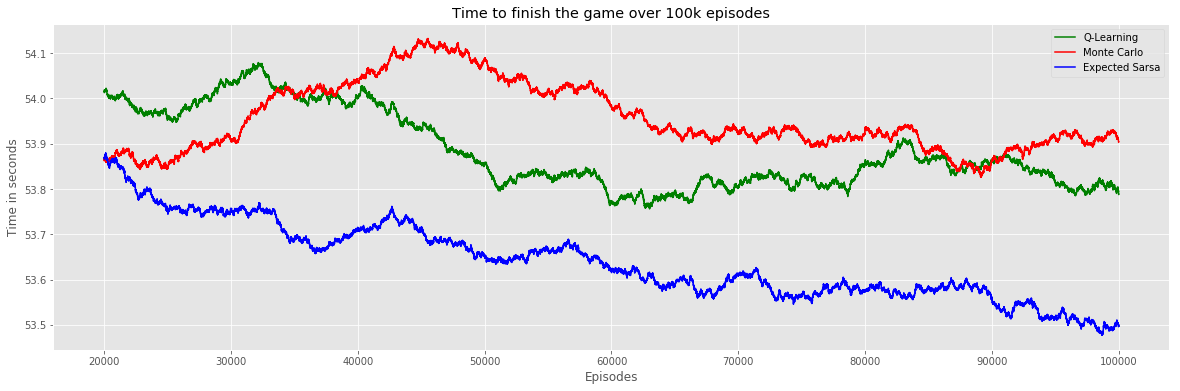

In [71]:
plt.figure(figsize=(20, 6))
mc, = plt.plot(pd.Series(time_to_win).rolling(20000, min_periods=20000).mean(), color='green', label='Q-Learning')
q, = plt.plot(pd.Series(time_to_win_mc).rolling(20000, min_periods=20000).mean(), color='red', label='Monte Carlo')
ex_sarsa, = plt.plot(pd.Series(time_to_win_sx_sarsa).rolling(20000, min_periods=20000).mean(), color='blue', label='Expected Sarsa')
plt.xlabel('Episodes')
plt.ylabel('Time in seconds')
plt.title('Time to finish the game over 100k episodes')
plt.legend(handles=[mc, q, ex_sarsa])
plt.savefig('q_learning_vs_mc_finish_times_vs_ex_sarsa.jpg', dpi=600)